In [ ]:
# Import libraries
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score


## Loading the dataset

The dataset is about the presence of the desease of diabetes. The data have been already cleaned previously, for this reason there are no missing values.

In [ ]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_path = '/content/drive/MyDrive/Methodology/booking_rates/diabetes_binary.csv'

In [ ]:
# Read in the dataset
diabetes = pd.read_csv(file_path)

# List out our columns
diabetes.info() # no missing value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

In [ ]:
diabetes.dropna(inplace=True)
diabetesdash = diabetes[['Diabetes_binary','HighChol', 'BMI', 'Sex', 'HeartDiseaseorAttack', 'PhysHlth']]

diabetesdash

,Diabetes_binary,HighChol,BMI,Sex,HeartDiseaseorAttack,PhysHlth
0,0.0,0.0,26.0,1.0,0.0,30.0
1,0.0,1.0,26.0,1.0,0.0,0.0
2,0.0,0.0,26.0,1.0,0.0,10.0
3,0.0,1.0,28.0,1.0,0.0,3.0
4,0.0,0.0,29.0,0.0,0.0,0.0
...,...,...,...,...,...,...
70687,1.0,1.0,37.0,0.0,0.0,0.0
70688,1.0,1.0,29.0,1.0,1.0,0.0
70689,1.0,1.0,25.0,0.0,1.0,0.0
70690,1.0,1.0,18.0,0.0,0.0,0.0


In [ ]:
diabetesdash['BMI'].describe()


count    70692.000000
mean        29.856985
std          7.113954
min         12.000000
25%         25.000000
50%         29.000000
75%         33.000000
max         98.000000
Name: BMI, dtype: float64

In [ ]:
diabetesdash.to_csv('diabetesdash.csv', index=False)

In [ ]:
diabetes.to_csv('diabetes_binary.csv', index=False)


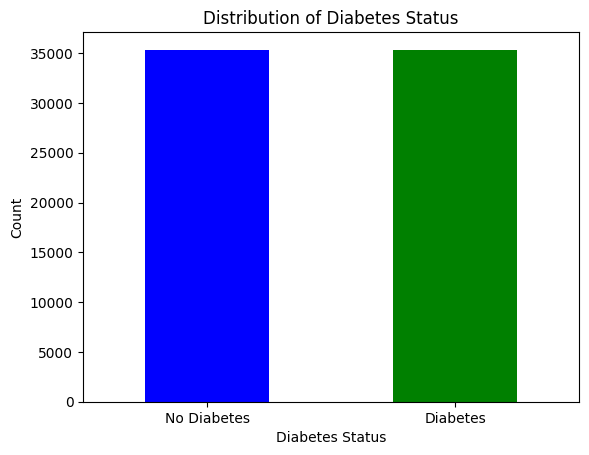

In [ ]:
# Plot the dependent variable Diabetes_binary in order to see how it is sistributed between the two categories
import matplotlib.pyplot as plt

# Assuming 'diabetes' represents 1 and 'no diabetes' represents 0
diabetes['Diabetes_binary'].value_counts().plot(kind='bar', color=['blue', 'green'])

# Adding labels
plt.xlabel('Diabetes Status')
plt.ylabel('Count')
plt.title('Distribution of Diabetes Status')

# Adding custom tick labels
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'], rotation=0)

# Display the plot
plt.show()

As it is shown by the graph the observations are devided into two groups of the same size having or not having the diabetes desease

In [ ]:
diabetes1=diabetes.drop(['BMI','MentHlth','PhysHlth'],axis=1)

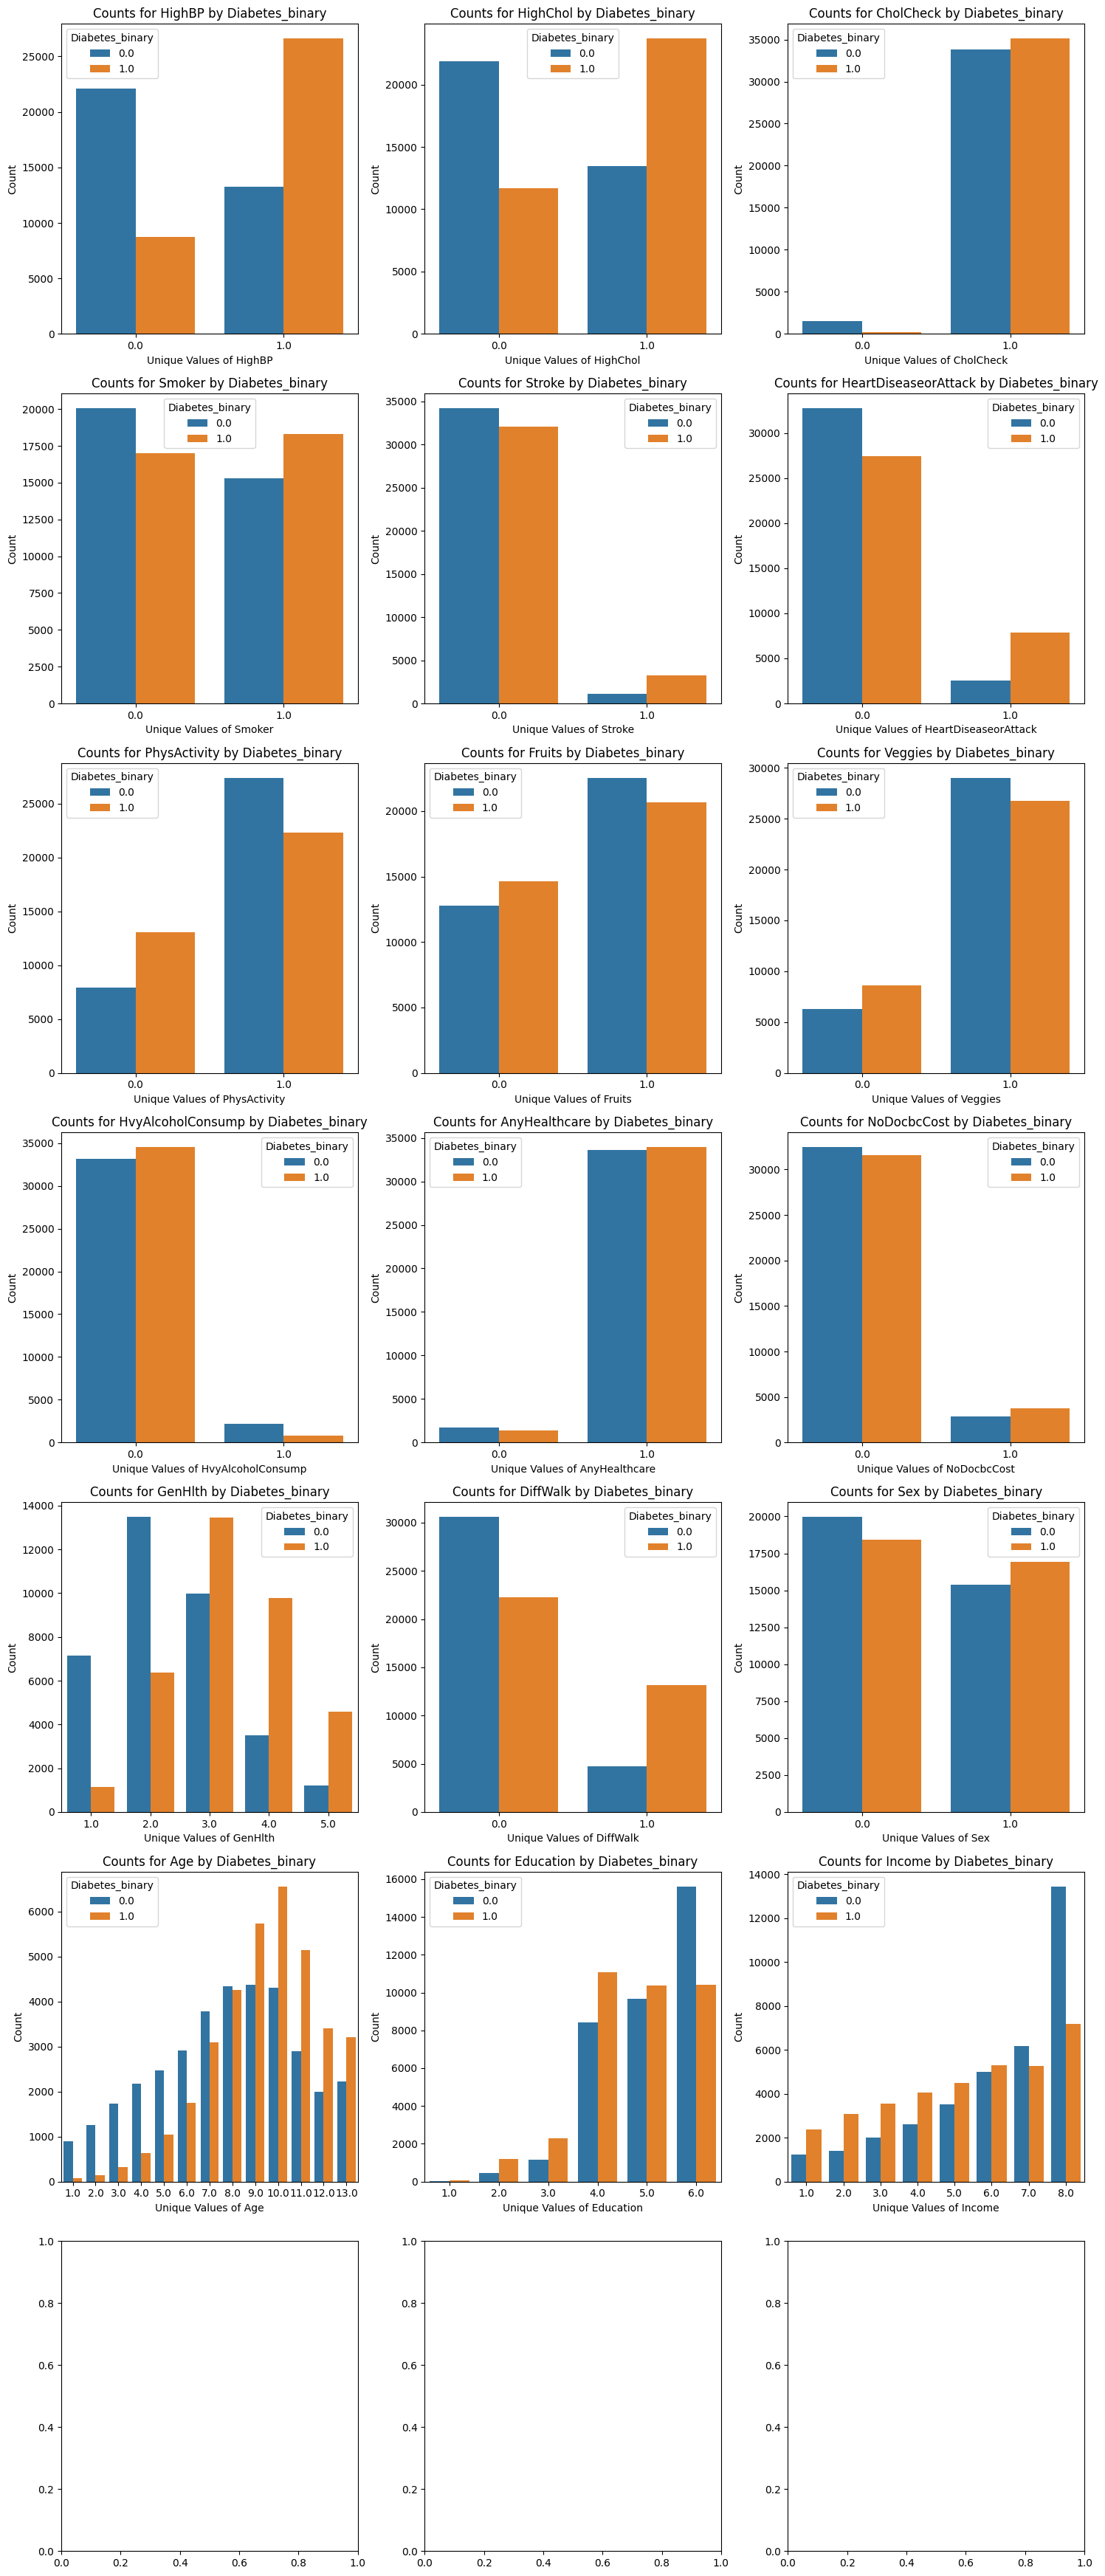

In [ ]:
# Assuming diabetes1 is your DataFrame
num_columns = len(diabetes1.columns)
num_rows = math.ceil(num_columns / 3)  # Calculate the number of rows needed

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5 * num_rows))

# Flatten the axes for easier iteration
axes = axes.flatten()

# Iterate over each column
for i, col in enumerate(diabetes1.columns[1:]):
    # Calculate the position in the grid
    row_idx = i // 3
    col_idx = i % 3

    # Create a bar plot using seaborn with hue='Diabetes_binary'
    sns.countplot(x=col, hue='Diabetes_binary', data=diabetes1, ax=axes[i])

    # Set title and labels
    axes[i].set_title(f'Counts for {col} by Diabetes_binary')
    axes[i].set_xlabel(f'Unique Values of {col}')
    axes[i].set_ylabel('Count')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


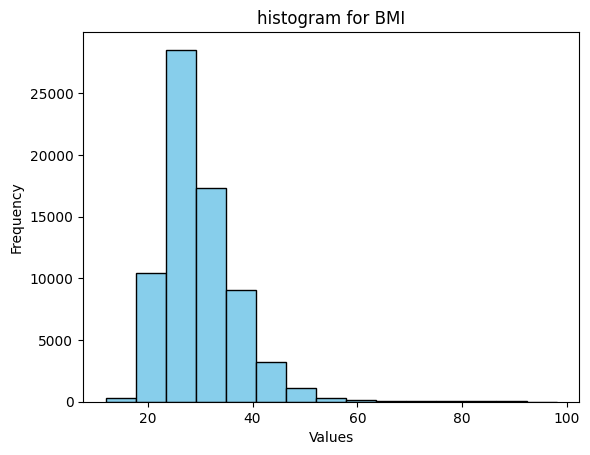

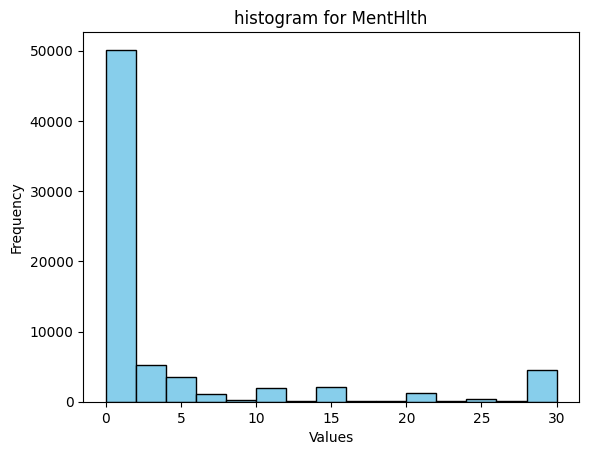

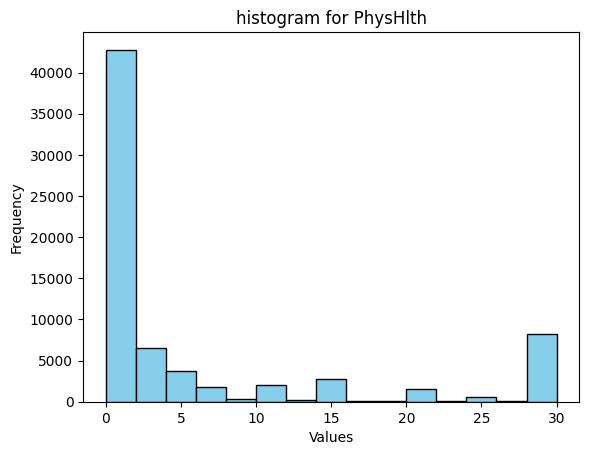

In [ ]:
continuos=['BMI','MentHlth','PhysHlth']

for i in continuos:
  plt.hist(diabetes[i], bins=15, color='skyblue', edgecolor='black')
  plt.title(f'histogram for {i}')
  plt.xlabel('Values')
  plt.ylabel('Frequency')
  plt.show()

### compute the correlation matrix

In [ ]:
# Which features are most correlated with Diabetes_binary?
diabetes.corr()['Diabetes_binary'].sort_values(ascending=False)

Diabetes_binary         1.000000
GenHlth                 0.407612
HighBP                  0.381516
BMI                     0.293373
HighChol                0.289213
Age                     0.278738
DiffWalk                0.272646
PhysHlth                0.213081
HeartDiseaseorAttack    0.211523
Stroke                  0.125427
CholCheck               0.115382
MentHlth                0.087029
Smoker                  0.085999
Sex                     0.044413
NoDocbcCost             0.040977
AnyHealthcare           0.023191
Fruits                 -0.054077
Veggies                -0.079293
HvyAlcoholConsump      -0.094853
PhysActivity           -0.158666
Education              -0.170481
Income                 -0.224449
Name: Diabetes_binary, dtype: float64

Some data need to be transformend into categories, these are especially Income, Education, Age and GenHlt because they represent classes but are expressed with increasing values. This may lead to a mis comprehension of the data and a problem in the prediction. For this reason, on python is better to perform the one hot encoding in order to overcome this problem

In [ ]:
# Create age bins
age_bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
age_labels = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79']
diabetes['Age_group'] = pd.cut(diabetes['Age'], bins=age_bins, labels=age_labels, right=False)

# Create education bins
edu_bins = [1, 2, 3, 4, 5, 6]
edu_labels = ['1', '2', '3', '4', '5']
diabetes['Education_level'] = pd.cut(diabetes['Education'], bins=edu_bins, labels=edu_labels, right=False)

# Create income bins
income_bins = [1, 2, 3, 4, 5, 6, 7, 8]
income_labels = ['1', '2', '3', '4', '5', '6', '7']
diabetes['Income_level'] = pd.cut(diabetes['Income'], bins=income_bins, labels=income_labels, right=False)

# Create genhlth bins
genhlth_bins = [1, 2, 3, 4, 5]
genhlth_labels = ['1', '2', '3', '4']
diabetes['GenHlth_level'] = pd.cut(diabetes['GenHlth'], bins=genhlth_bins, labels=genhlth_labels, right=False)

# Perform one-hot encoding for selected columns in 'diabetes'
columns_to_encode = ['Age_group', 'Education_level', 'Income_level', 'GenHlth_level']
diabetes = pd.get_dummies(diabetes, columns=columns_to_encode, prefix=columns_to_encode)
diabetes= diabetes.drop(['Age','Education','Income','GenHlth'],axis=1)


## splitting the data

In [ ]:
# Define X and y
#X, y = diabetes.iloc[:,1:], diabetes.iloc[:,0]
X, y = diabetesdash.iloc[:,1:], diabetesdash.iloc[:,0]


In [ ]:
# Train and test split using sklearn
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=.20, random_state=123)

# Instatiate a XGBClassifier
xgb_clf = xgb.XGBClassifier(random_state=123)

# Inspect the parameters
xgb_clf.get_params()





AttributeError: 'DMatrix' object has no attribute 'tojson'

In [ ]:
## Set max_depth to be 10
xgb_clf.set_params(n_estimators=10)

# Fit it to the training set
xgb_clf.fit(X_train, y_train)

# Predict the labels of the test set
#preds = xgb_clf.predict(X_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, random_state=123, ...)

In [ ]:
xgb_clf.save_model('xgb_model.json')


In [ ]:
conf_matrix = confusion_matrix(y_test, preds)
confusion_df = pd.DataFrame(conf_matrix, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

confusion_df

,Predicted Negative,Predicted Positive
Actual Negative,4963,2135
Actual Positive,1470,5571


In [ ]:
# Calculate the accuracy
accuracy = float(np.sum(preds==y_test))/y_test.shape[0]

# Print the baseline accuracy
print("Baseline accuracy:", accuracy)

sensitivity = confusion_df.loc['Actual Positive', 'Predicted Positive'] / (confusion_df.loc['Actual Positive', 'Predicted Positive'] + confusion_df.loc['Actual Positive', 'Predicted Negative'])
print(f"Baseline Sensitivity: {sensitivity}")

Baseline accuracy: 0.7450314732300728
Baseline Sensitivity: 0.7912228376651044


### plotting feature importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

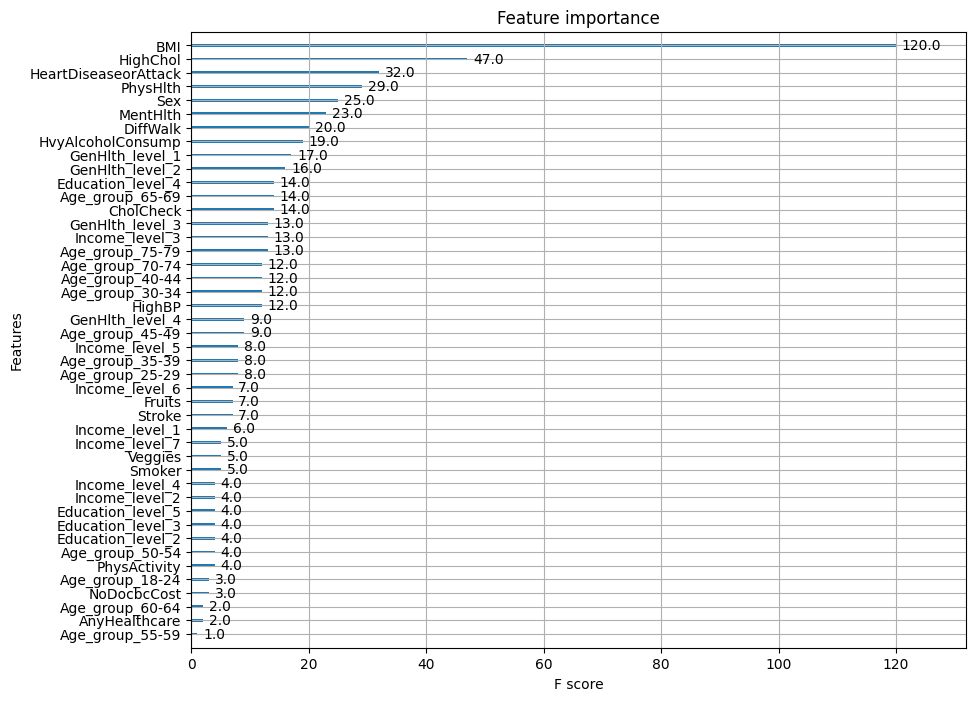

In [ ]:
plt.rcParams['figure.figsize'] = (10.0, 8)

xgb.plot_importance(xgb_clf) # the default is weight meaning the number of times a feature appears in a tree

The function plot_importance() plots feature importance, meaning, how predictive each feature is for the target variable. In the standard case without changing the parameters, as it is in here, it counts the number of times a feature appears in a tree. As it appears, the BMI has the greatest impact in the presence of the desease diabetes, followed by the cholesterol presence in the blood.

In [ ]:
pip install plotly


In [ ]:
import plotly.express as px
import xgboost as xgb

# Assuming you have already trained your XGBoost model and stored it in xgb_clf

# Get feature importance scores from the XGBoost model
feature_importance = xgb_clf.get_booster().get_score(importance_type='weight')

# Create a dictionary with feature names and their importance scores
feature_names = list(feature_importance.keys())
importance_values = list(feature_importance.values())

# Create a DataFrame for Plotly
import pandas as pd
df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_values})

# Sort the DataFrame by importance values
df = df.sort_values(by='Importance', ascending=False)

# Create a bar plot using Plotly
fig = px.bar(df, x='Importance', y='Feature', orientation='h', title='XGBoost Feature Importance')

# Show the plot
fig.show()


## plotting the roc curve

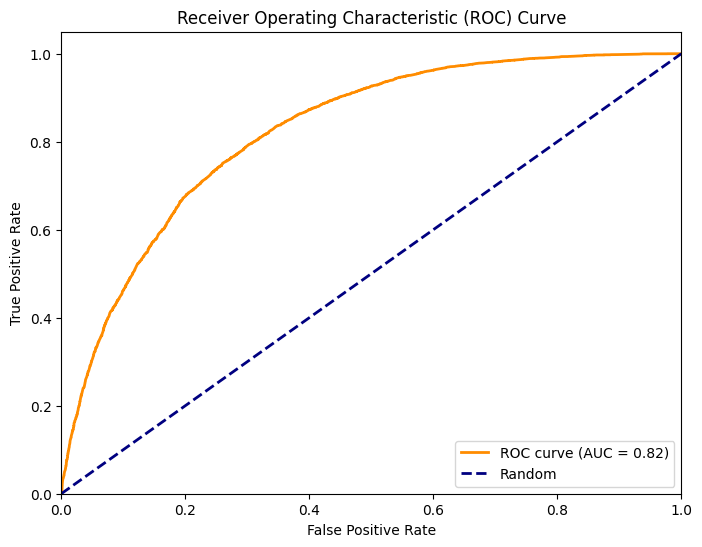

Baseline accuracy: 0.7450314732300728
Baseline Sensitivity: 0.7912228376651044


In [ ]:
# Get predicted probabilities for the positive class
probs = xgb_clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Print the baseline accuracy
print("Baseline accuracy:", accuracy)

# Print the baseline sensitivity
print(f"Baseline Sensitivity: {sensitivity}")


In [ ]:
import plotly.graph_objects as go
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get predicted probabilities for the positive class
probs = xgb_clf.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Create an interactive ROC curve using Plotly
fig = go.Figure()

# Plot ROC curve
fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name=f'ROC curve (AUC = {roc_auc:.2f})'))

# Plot the random baseline
fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', name='Random', line=dict(dash='dash')))

# Update layout
fig.update_layout(
    title='Receiver Operating Characteristic (ROC) Curve',
    xaxis=dict(title='False Positive Rate'),
    yaxis=dict(title='True Positive Rate'),
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    showlegend=True
)

# Show the plot
fig.show()

# Print the baseline accuracy
print("Baseline accuracy:", accuracy)

# Print the baseline sensitivity
print(f"Baseline Sensitivity: {sensitivity}")


Baseline accuracy: 0.7450314732300728
Baseline Sensitivity: 0.7912228376651044


# tree visualization

In [ ]:
pip install graphviz plotly


In [ ]:
import graphviz
import xgboost as xgb
from xgboost import to_graphviz
import plotly.graph_objects as go

# Assuming you have already trained your XGBoost model and stored it in xgb_clf

# Plot the first tree
fig = go.Figure()

# Convert the first tree to a graphviz Digraph
tree_graph = to_graphviz(xgb_clf, num_trees=0, rankdir='UT', yes_color='#6384B8', no_color='#E57538')

# Render the graphviz Digraph into Plotly
fig.add_trace(go.Image(z=tree_graph.pipe(format='png')))
fig.update_layout(title_text='XGBoost Tree Visualization', showlegend=False)

# Show the plot
fig.show()


ValueError: 
    Invalid value of type 'builtins.bytes' received for the 'z' property of image
        Received value: b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x008\xc0\x00\x00\x02\xf3\x08\x06\x00\x00\x00\xd5\x04\xa2t\x00\x00\x00\x06bKGD\x00\xff\x00\xff\x00\xff\xa0\xbd\xa7\x93\x00\x00 \x00IDATx\x9c\xec\xddk\x94]ea\xff\xf1\xdf\xb9\xec\xc9\x993d&!\x01L\x82\x01\x02\xd6\x8a\x01\x05mZ"\xe2Z\x08\x88\x16tU\x16\x14\xc5Z\xf0\x02mZe!\xb1\xa6]h\x15l\xac\xd6\xa2\xac"B\xfdc\xb4\xadAPTjkm\xa0*\x08H\x11E h\x95k\xe5\x16\x92L.\x93\xcc\xcc\xc9\x9c\xdb\xffE\xe2Xj\x83\xdcO\x02\x9f\xcfZge\x9eg?\xcf~\xbe{\xbf\xc8\xdb]\xeav\xbb\xdd\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0D-/\xf7\xba\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`gW\xeeu\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xce\xae\xdc\xeb\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x9d]\xb5\xd7\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf4V\xa7\xd3\xc9\xc6\x8d\x1b\xb3a\xc3\x86\x8c\x8c\x8c\xa4\xd5je\xfd\xfa\xf5\x93\xd7\xdb\xedvFFF&\xc7\xe5r9CCC\x93\xe3\xa2(\xb2\xcb.\xbb\xa4\xbf\xbf?\x83\x83\x83\x93?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x.\xa9\xf6:\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xa7\xde\xc4\xc4D\xfe\xfb\xbf\xff;\xf7\xdcsOV\xadZ\x95U\xabV\xe5\xa1\x87\x1e\xca\xea\xd5\xab\xf3\xe0\x83\x0ff\xf5\xea\xd5Y\xbf~}6m\xda\x94\xcd\x9b7?-\r\xd3\xa7O\xcf\xd4\xa9S3}\xfa\xf4\xcc\x9e=;\xbb\xef\xbe{f\xcf\x9e\x9d=\xf6\xd8#{\xec\xb1G\xf6\xdcs\xcf\xec\xb3\xcf>\x99={vJ\xa5\xd2\xd3\xd2\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcf\x94R\xb7\xdb\xed\xf6:\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\'\xe6\xde{\xef\xcdm\xb7\xdd\x96\x1f\xff\xf8\xc7\xb9\xeb\xae\xbbr\xd7]w\xe5\xee\xbb\xef\xce}\xf7\xdd\x97v\xbb\x9d$\xa9\xd5j\xd9}\xf7\xdd3g\xce\x9c\xec\xbe\xfb\xee\x995kV\x9e\xf7\xbc\xe7e\xda\xb4i\x19\x1c\x1c\xcc\xe0\xe0`\x86\x86\x86244\x94\xc1\xc1\xc1\x14E\x91\xc1\xc1\xc1T*\x95$I\xa9T\xca\xb4i\xd3&\xcfl\xb5Z\xd9\xb4i\xd3\xe4\xb8\xd1hd||<ccc\x19\x19\x19\xc9\xc8\xc8H6m\xda\x94\xf5\xeb\xd7gdd$\xeb\xd6\xad\xcbC\x0f=\x94\xd5\xabW\xe7\x81\x07\x1e\xc8\xea\xd5\xab\xf3\xf0\xc3\x0f\xa7\xd3\xe9L\xf6\xcd\x9b7/\xfb\xee\xbbo\xe6\xcd\x9b\x97\x17\xbc\xe0\x05y\xf1\x8b_\x9c\x03\x0f<0\xbb\xee\xba\xeb3\xf86\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\t[^\xeav\xbb\xdd^W\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xe8Z\xadVV\xae\\\x99\xef}\xef{\xb9\xe5\x96[r\xdbm\xb7e\xe5\xca\x95\x19\x19\x19I\x92\xcc\x9d;7\xfb\xee\xbb\xef\xe4o\xde\xbcy\xd9w\xdf}\xb3\xf7\xde{g\xc6\x8c\x19=\xae\xffU\xedv;\xabV\xad\xca]w\xdd\x95\xbb\xef\xbe\xfb\x11\xff\xfe\xecg?\xcb\xfa\xf5\xeb\x93$s\xe6\xcc\xc9\xfc\xf9\xf3s\xe0\x81\x07\xe6\xa0\x83\x0e\xca\xc2\x85\x0b\xb3\xd7^{\xf5\xb8\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00~\xc5\xf2R\xb7\xdb\xed\xf6\xba\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80G\x1a\x19\x19\xc95\xd7\\\x93\x1bn\xb8!\xd7]w]n\xba\xe9\xa6l\xde\xbc9CCCy\xe9K_\x9a\xf9\xf3\xe7\xe7\x80\x03\x0e\xc8\xfc\xf9\xf33\x7f\xfe\xfc\x0c\r\r\xf5:\xf9)u\xff\xfd\xf7g\xe5\xca\x95\xb9\xed\xb6\xdbr\xdbm\xb7e\xe5\xca\x95Y\xb9re\x9a\xcdff\xcd\x9a\x95C\x0e9$\x0b\x17.\xcc\xc2\x85\x0b\xf3[\xbf\xf5[\xa9V\xab\xbdN\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xb9my\xa9\xdb\xedv{]\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\\\xd7\xe9tr\xf3\xcd7\xe7\xaa\xab\xae\xcaUW]\x95k\xae\xb9&\x13\x13\x13\x997o^^\xf1\x8aW\xe4e/{Y\x0e=\xf4\xd0\x1ct\xd0A)\x97\xcb\xbd\xce\xed\x89f\xb3\x99[o\xbd5\xd7^{m\xae\xbb\xee\xba\\}\xf5\xd5Y\xbdzu\x06\x06\x06r\xc8!\x87\xe4\x88#\x8e\xc8\xb1\xc7\x1e\x9b\xfd\xf7\xdf\xbf\xd7\xa9\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\xf7,/u\xbb\xddn\xaf+\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\x8b&&&r\xe5\x95W\xe6\xb2\xcb.\xcb\xbf\xfc\xcb\xbfd\xdd\xbau\xd9s\xcf=s\xd4QG\xe5\xc8#\x8f\xcc\xab_\xfd\xea\xec\xb6\xdbn\xbd\xce\xdc\xa1\xfd\xd7\x7f\xfdW\xae\xbc\xf2\xca\xacX\xb1"\xdf\xf9\xcew\xb2y\xf3\xe6\xbc\xe0\x05/\xc8q\xc7\x1d\x97\x13N8!\x07\x1dtP\xaf\x13\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00xnX^\xeav\xbb\xdd^W\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<Wt:\x9d\xacX\xb1"\x97^zi\xae\xb8\xe2\x8al\xd8\xb0!\x87\x1crH\x8e;\xee\xb8\x1c}\xf4\xd1\xd9\x7f\xff\xfd{\x9d\xb8\xd3\x9a\x98\x98\xc8\xf5\xd7_\x9fo|\xe3\x1b\xf9\xd2\x97\xbe\x94{\xef\xbd7\xfb\xed\xb7_\x8e?\xfe\xf8\xbc\xf9\xcdo\xce\xfc\xf9\xf3{\x9d\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xb3\xd7\xf2R\xb7\xdb\xed\xf6\xba\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xd9n\xd5\xaaU\xf9\xfc\xe7?\x9f\x8b.\xba(\xf7\xdcsO\xf6\xdf\x7f\xff\x1c\x7f\xfc\xf1\xf9\x83?\xf8\x83\xec\xbb\xef\xbe\xbd\xce{V\xba\xfd\xf6\xdb\xf3\xa5/})_\xf8\xc2\x17r\xe7\x9dw\xe6e/{YN=\xf5\xd4\xbc\xe5-oI\xbd^\xefu\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcf.\xcbK\xddn\xb7\xdb\xeb\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80g\xab\x1bn\xb8!\x1f\xfb\xd8\xc7\xf2\xf5\xaf\x7f=\xd3\xa6M\xcb\xc9\'\x9f\x9cw\xbe\xf3\x9d\xf9\x8d\xdf\xf8\x8d^\xa7=gt\xbb\xdd|\xeb[\xdf\xcaE\x17]\x94+\xae\xb8"\xbb\xec\xb2KN9\xe5\x94\xbc\xe7=\xef\xc9\xec\xd9\xb3{\x9d\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xb3\xc3\xf2R\xb7\xdb\xed\xf6\xba\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xd9\xe6\xdak\xaf\xcd9\xe7\x9c\x93\x15+V\xe4\x90C\x0e\xc9\xbb\xde\xf5\xae\xbc\xf1\x8do\xcc\x94)Sz\x9d\xf6\x9c\xf6\xf0\xc3\x0fg\xd9\xb2e9\xff\xfc\xf33<<\x9cw\xbc\xe3\x1dy\xdf\xfb\xde\x97=\xf7\xdc\xb3\xd7i\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xec\xdc\x96\x97{]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0l\xb2r\xe5\xca\x1cq\xc4\x11y\xe5+_\x99F\xa3\x91+\xaf\xbc2\xd7_\x7f}\xde\xf4\xa67e\xca\x94)\xbd\xce{\xce\xdbc\x8f=\xb2d\xc9\x92\xdcu\xd7]\xf9\xdb\xbf\xfd\xdb\xfc\xf3?\xffs\xf6\xdbo\xbf\x9c~\xfa\xe9\xd9\xb0aC\xaf\xf3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8\x89\x95{\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0l\xb0i\xd3\xa6,^\xbc8\x07\x1f|pFFF\xf2\xedo\x7f;W_}u\x8e8\xe2\x88^\xa7\xf1\x7f\x982eJ\x16-Z\x94;\xee\xb8#\xe7\x9dw^\xbe\xf8\xc5/\xe67\x7f\xf37\xf3\x8f\xff\xf8\x8f\xe9v\xbb\xbd\xce\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\'T\xea\xfaR6\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x93r\xd5UW\xe5\xe4\x93O\xce\xf8\xf8x\x96.]\x9aw\xbe\xf3\x9d)\x97\xcb\xbd\xce\xe2qX\xbf~}\xde\xff\xfe\xf7\xe7\xc2\x0b/\xcc+_\xf9\xca\xfc\xd3?\xfdS\xe6\xcc\x99\xd3\xeb,\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00v\x1e\xcb}\xe1\x1c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\t\xeat:9\xe7\x9csr\xf4\xd1G\xe7\xd0C\x0f\xcdO\x7f\xfa\xd3\x9cv\xdai)\x97}\x1afg3}\xfa\xf4\x9c\x7f\xfe\xf9\xb9\xf1\xc6\x1b\xb3z\xf5\xea\x1ct\xd0A\xb9\xf2\xca+{\x9d\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0N\xc4W\xce\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\x80\xb1\xb1\xb1\x1c{\xec\xb1\xf9\xf0\x87?\x9cO~\xf2\x93\xf9\xe2\x17\xbf\x98\x993g\xf6:\x8b\'\xe9\xe0\x83\x0f\xce\x7f\xfe\xe7\x7f\xe6\xc8#\x8f\xcc\xd1G\x1f\x9d\x8f~\xf4\xa3\xbdN\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\'Q\xedu\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xcefll,\xc7\x1csLV\xae\\\x99\xef~\xf7\xbbY\xb0`A\xaf\x93x\n\xed\xb2\xcb.\xf9\xc2\x17\xbe\x90\xdf\xfe\xed\xdf\xce\x19g\x9c\x91-[\xb6\xe4\x03\x1f\xf8@\xaf\xb3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8\xc1\x95{\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb03i4\x1a9\xe6\x98c\xb2r\xe5\xca\xfc\xc7\x7f\xfcG\x16,X\xf0\x94\x9fq\xf9\xe5\x97g\xde\xbcy)\x95J)\x95Jy\xfe\xf3\x9f\x9f\x8b/\xbex\xf2\xfa\xdb\xdf\xfe\xf6L\x9f>=\xa5R)EQ\xe4\xa0\x83\x0e\xca\xcf\x7f\xfe\xf3|\xe3\x1b\xdf\xc8\xd0\xd0P\xbe\xfe\xf5\xaf?\xe6\xb3N9\xe5\x94\xd4j\xb5\x94J\xa54\x1a\x8d\xc7\xd4\xf3\x8b_\xb5Z\xcd\xcc\x993s\xc4\x11G\xe4+_\xf9\xca\xa3\xae/\x8a"s\xe6\xcc\xc9I\'\x9d\x94\x9f\xfc\xe4\'O\xfc\xe5$\xe9t:\xf9\xc4\'>\x91\x85\x0b\x17>\xa9\xfb\xfc:\xef~\xf7\xbbs\xd1E\x17\xe5C\x1f\xfaP\x96.]\xfa\xb4\x9e\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xce\xaf\xdc\xeb\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x9d\xc9\x9f\xff\xf9\x9f\xe7\xe6\x9bo\xce\xb7\xbe\xf5\xad\x1cp\xc0\x01O\xcb\x19\xc7\x1dw\\\xee\xbe\xfb\xee\xec\xbb\xef\xbe\x19\x1a\x1a\xca}\xf7\xdd\x97\xb7\xbf\xfd\xed\x93\xd7/\xbe\xf8\xe2\xfc\xdb\xbf\xfd[\x92\xe4O\xfe\xe4Or\xf3\xcd7g\xee\xdc\xb9\xe9v\xbb\x8f\xfb\xace\xcb\x96e\xf1\xe2\xc5\x8f\xab\xa7\xdb\xed\xa6\xdb\xedf\xcd\x9a5\xb9\xf4\xd2K\xf3\xc0\x03\x0f\xe4\xb8\xe3\x8e\xcb\xa5\x97^\xba\xdd\xf5\x1b6l\xc8\x85\x17^\x98k\xaf\xbd6\x0b\x16,\xc8O\x7f\xfa\xd3\xc7\xdd\x9a$w\xdcqG\x0e;\xec\xb0\xbc\xe7=\xef\xc9\xd8\xd8\xd8\x13\xba\xc7\xe3\xf1\x8ew\xbc#\x9f\xfa\xd4\xa7r\xd6Yg\xe5\xca+\xaf|\xda\xcf\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xe7U\xeeu\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xce\xe2\xaa\xab\xae\xcay\xe7\x9d\x97O}\xeaS\x99?\x7f~\xafs~\xc5\xef\xfe\xee\xeff\xe3\xc6\x8d9\xf6\xd8c\x9f\x91\xf3\xa6O\x9f\x9eW\xbf\xfa\xd59\xef\xbc\xf3\x92$\x97]v\xd9v\xd7\x0e\x0c\x0c\xe4\xd8c\x8f\xcdy\xe7\x9d\x97\xcd\x9b7\xe7\xef\xfe\xee\xef\x1e\xf5\xde\xcdf3\xcb\x96-\xcb\x1f\xfe\xe1\x1fN\xce\xddr\xcb-Y\xb2dI\xfe\xf8\x8f\xff8/}\xe9K\x9f\x9a\x87x\x0c\xfe\xe8\x8f\xfe(\'\x9exbN>\xf9\xe4\x0c\x0f\x0f?c\xe7\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0s)\xf7:\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`g\xd0l6s\xdai\xa7\xe5\xf8\xe3\x8f\xcf\x9b\xdf\xfc\xe6^\xe7<)\xddn7_\xfa\xd2\x97\xf2\xf7\x7f\xff\xf7\x8f\x98/\x95JO\xe8~{\xef\xbdw\x92d\xc3\x86\r\xbfv\xed\x82\x05\x0b\x92$+W\xae\xfc?\xafo\xd9\xb2%\x9f\xfe\xf4\xa7s\xf0\xc1\x07\xe7\xf6\xdbo\xcf_\xff\xf5_O^{\xc9K^\x92\xcb/\xbf<\'\x9dtR\xa6L\x99\xf2\x84Z\x9f\xa8O}\xeaS)\x97\xcb9\xeb\xac\xb3\x9e\xd1s\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8y\x94{\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb03\xb8\xec\xb2\xcbr\xdf}\xf7\xe5c\x1f\xfbX\xafS\xfeO\xd7^{m\xe6\xce\x9d\x9bR\xa9\x94\xf3\xcf?\x7fr\xbe\xddng\xe9\xd2\xa5y\xe1\x0b_\x98\xfe\xfe\xfe\xcc\x9c93\xfb\xec\xb3O\x96.]\x9a\x13N8ar]\xb9\\\xce\xbf\xfe\xeb\xbf\xe6\xb5\xaf}m\x86\x86\x862k\xd6\xac|\xf6\xb3\x9f}Lg\xdfz\xeb\xadI\x92W\xbd\xeaU\xbfvm\xab\xd5J\x92L\x992\xe5\x11\xf3\xa3\xa3\xa39\xf7\xdcs\xf3\xf2\x97\xbf<\xabW\xaf\xce\xd5W_\x9d\x8f\x7f\xfc\xe3\x995k\xd6cjx\xbaM\x9f>=\xef\x7f\xff\xfb\xb3l\xd9\xb2\xacY\xb3\xa6\xd79\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xec\x80\xca\xbd\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8\x19\\r\xc9%9\xfa\xe8\xa3\xb3\xd7^{\xf5:\xe5\xfft\xe8\xa1\x87\xe6\xfa\xeb\xaf\xff\x95\xf9\x8f~\xf4\xa3\xf9\xc0\x07>\x90\xbf\xf9\x9b\xbf\xc9\xbau\xeb\xb2b\xc5\x8a4\x1a\x8dL\x9b6-\xd3\xa6M\x9b\\\xd7\xe9t2m\xda\xb4|\xf1\x8b_\xcc\xbd\xf7\xde\x9b\x83\x0f>8\x8b\x16-\xca\xd8\xd8\xd8v\xcf\x1c\x1f\x1f\xcf7\xbf\xf9\xcd,^\xbc8G\x1duT\xce<\xf3\xcc_\xdby\xcd5\xd7$I^\xf2\x92\x97$I6n\xdc\x98\xbf\xfa\xab\xbf\xca\xc2\x85\x0b\xd3\xedvs\xc3\r7\xe4/\xff\xf2/\xb3\xeb\xae\xbb>\xdeW\xf0\xb4{\xcb[\xde\x92\xa2(\xf2\xe5/\x7f\xb9\xd7)\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xec\x80\xca\xbd\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8\xd1u\xbb\xdd\\w\xdduy\xcdk^\xf3\x8c\x9f\xbdq\xe3\xc6\x94J\xa5_\xf9\x1dr\xc8!\x8fi\xff\xd7\xbe\xf6\xb5\xbc\xece/\xcb\xeb_\xff\xfa\xf4\xf7\xf7\xe7\xe0\x83\x0f\xce\x1b\xde\xf0\x86\\s\xcd5\x99\x98\x98x\xc4\xda\x85\x0b\x17fhh(\xd3\xa7O\xcf\x89\'\x9e\x98-[\xb6\xe4\x9e{\xee\xd9nO\xbd^\xcfk_\xfb\xda\x0c\x0e\x0e\xe6\xa4\x93NJQ\x14\xdb\xed\x18\x1d\x1d\xcd\xe5\x97_\x9e\xc5\x8b\x17g\xf7\xddw\xcf\xe9\xa7\x9f\x9ef\xb3\x99\x97\xbc\xe4%Y\xb1bE\xae\xbd\xf6\xda\x9cy\xe6\x99\x19\x18\x18x\xfc/\xe9\x19R\xaf\xd7s\xd8a\x87\xe5\xdak\xaf\xedu\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00;\xa0r\xaf\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00vt\xc3\xc3\xc3\xd9\xb0aC^\xf4\xa2\x17=\xe3g\x0f\r\r\xa5\xdb\xed\xfe\xca\xef{\xdf\xfb\xdec\xda\xdfh4\xd2\xedv\x1f1\xd7n\xb7S\x14E*\x95\xcav\xf7\x15E\x91$i6\x9b\xdb\xedi6\x9b\xb9\xff\xfe\xfbs\xc6\x19g\xe4\xdd\xef~w\x0e<\xf0\xc0\xac]\xbb\xf6\x11\xeb7n\xdc\x98R\xa9\x94\xa1\xa1\xa1\x9c~\xfa\xe9y\xdd\xeb^\x97\x1bo\xbc1s\xe6\xccIQ\x14\xb9\xe5\x96[r\xe4\x91G\xe6\x95\xaf|e>\xf1\x89Odtt\xf41=W\xaf\xbc\xe8E/\xca\x9dw\xde\xd9\xeb\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00v@\xe5^\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xec\xe8\xc6\xc7\xc7\x93$\xfd\xfd\xfd=.y\xfc^\xf7\xba\xd7\xe5\x07?\xf8A\xae\xb8\xe2\x8a\x8c\x8f\x8f\xe7\xa6\x9bn\xca\xd7\xbe\xf6\xb5\x1cs\xcc1\xa9T*O\xea\xde\xd5j5s\xe6\xcc\xc9)\xa7\x9c\x92\x8f\x7f\xfc\xe3\xf9\xe9O\x7f\x9a\x8f|\xe4#\x8fX344\x94n\xb7\x9bV\xab\x95\xfb\xef\xbf?\x9f\xfd\xecg\xb3\xd7^{=\xe2\xfaYg\x9d\x95\xeb\xae\xbb.\x9dN\'\xbf\xf3;\xbf\x93\xb3\xcf>;\xeb\xd7\xaf\x7fRmO\x97z\xbd\x9e\xb1\xb1\xb1^g\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0\x03*\xf7:\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`G7}\xfa\xf4$\xc9\xf0\xf0p\x8fK\x1e\xbf\x0f~\xf0\x839\xfc\xf0\xc3s\xf2\xc9\'gpp0o|\xe3\x1bs\xc2\t\'\xe43\x9f\xf9\xccSz\xce\x01\x07\x1c\x90$\xf9\xf1\x8f\x7f\xfc\x84\xf6\x0f\x0c\x0c\xe4\xcc3\xcf\xcc\xf7\xbf\xff\xfd\xcc\x9c93\x87\x1dvX\xde\xfb\xde\xf7\xe6\xa1\x87\x1ez*3\x9f\xb45k\xd6d\xc6\x8c\x19\xbd\xce\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\x07T\xeeu\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x8en\x97]v\xc9>\xfb\xec\x93\x9bn\xba\xa9\xd7)\x8f\xdb\xed\xb7\xdf\x9e\xbb\xee\xba+k\xd6\xacI\xb3\xd9\xcc\xcf\x7f\xfe\xf3\\p\xc1\x05\x99>}\xfaSz\xce\x0f~\xf0\x83$\xc9\x0b_\xf8\xc2\'u\x9fZ\xad\x96E\x8b\x16\xe5\x87?\xfca^\xf4\xa2\x17e\xc9\x92%OE\xdeS\xe6\x07?\xf8A\x0e8\xe0\x80^g\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0\x03*\xf7:\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`g\xf0\x9a\xd7\xbc&_\xf9\xcaWz\x9d\xf1\xb8\xfd\xe9\x9f\xfei\xe6\xce\x9d\x9b\xcd\x9b7?e\xf7\x1c\x1f\x1fO\xa7\xd3I\xb7\xdb\xcd\x83\x0f>\x98e\xcb\x96\xe5\xac\xb3\xce\xca\xcc\x993s\xc6\x19g<%g\x14E\x91\xb7\xbd\xedm\xf9\xfc\xe7?\xff\x94\xdc\xef\xa9p\xef\xbd\xf7\xe6\xa6\x9bn\xca\xd1G\x1f\xdd\xeb\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00v@\xa5n\xb7\xdb\xedu\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x8e\xee\xfb\xdf\xff~\x16,X\x90\x7f\xff\xf7\x7f\xcfQG\x1d\xf5\xb4\x9e\xf5\xd5\xaf~5\xef}\xef{s\xd7]w%I\xf6\xdak\xaf|\xf0\x83\x1f\xcc\xc9\'\x9f\x9c$9\xf5\xd4S\xf3\xe5/\x7f9\xeb\xd7\xafOQ\x149\xf0\xc0\x03\xf3\xeaW\xbf:\xff\xf0\x0f\xff\x90U\xabV\xa5^\xaf\xe7\x88#\x8e\xc8\x15W\\\x91o\x7f\xfb\xdb9\xfe\xf8\xe33<<<y\xff\xa2(\xb2\xdf~\xfb\xe5\xc3\x1f\xfep\xee\xbc\xf3\xce|\xf0\x83\x1f\xcc\xf8\xf8x^\xf0\x82\x17\xe4\x9b\xdf\xfcf\xbe\xf7\xbd\xef\xe5]\xefzW\xd6\xaf_\x9f=\xf7\xdc3\xa7\x9dvZ>\xf7\xb9\xcfM\xf6\xfcOS\xa6L\xc9\xdc\xb9ss\xe4\x91Gf\xc9\x92%y\xfe\xf3\x9f\x9f\xeb\xaf\xbf>\xa7\x9crJ~\xf6\xb3\x9f%If\xcd\x9a\x95C\x0f=4\x97]v\xd9\x93z/7\xdcpC\x16/^\x9c\xbb\xef\xbe;\x0f=\xf4P\x92\xe4y\xcf{^\xe6\xcd\x9b\x97\x8f|\xe4#9\xec\xb0\xc3\x9e\xd4\xfd\x7f\x9d\xd3\xcfX\x9c{Gw\xcfk\x8f>*\xf5Z\x91z\xadH\xad\xaf\x92\xbe\xa2\x92Z_5\xf5Z5S\xfa\xaa\xa9\xf5U2\xa5\xa8\xa4\x7f\xdb\xf5)}\x95\xf4U+Ok\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00=\xb7\xbc\xd4\xedv\xbb\xbd\xae\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8\x19\xbc\xe1\ro\xc8O~\xf2\x93\xdc|\xf3\xcd\x19\x18\x18\xe8u\xcecr\xc1\x05\x17\xe4\x8e;\xee\xc8\'>\xf1\x89\xc9\xb9\x89\x89\x89,Y\xb2$\x17\\pA\xd6\xaf_\x9f\xfe\xfe\xfe\x1e\x16\xee\x1cn\xbc\xf1\xc6\x1c~\xc4\xd1\xf9\xd3\xbf\xfc\x7f\x99\xbb\xf7\xbc4\xb6\xb42\xb6\xa5\x95-\x13\xadl\x99h\xa71\xd1\xceX\xa3\xb9\xdd\xfd\xe5R)\xb5)\xd5\xd4\xa7T3\xa5\xaf\x92)}\x95\xd4\xfa\xaa\xe9\xafUS+~9W\xaf\x15\xa9\x15\x95L\xe9\xdb:\xd7?\xa5\x9a\xfe_\xec)~9.\x95J\xcf\xe0\xd3\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x18,/u\xbb\xddn\xaf+\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00v\x06\xabW\xaf\xce\x81\x07\x1e\x987\xbc\xe1\r\xb9\xe8\xa2\x8bz\x9d\xf3k\xadZ\xb5*{\xee\xb9g~\xf4\xa3\x1fe\xfe\xfc\xf9\x8f\xb8\xf6\xc9O~2g\x9eyf\xd6\xaf_\x9f\xc1\xc1\xc1\x1e\x15\xee\x1cFGGs\xf0\xc1\x07g\xef\xbd\xf7\xce7\xbf\xf9\xcd\x94J\xa5\xed\xae\x9dh\xb5\xd3ju2\xd1\xecd\xac\xd1\xcch\xa3\x99f\xab\x93f\xab\x93\xd1F3c\xe3\xcd4\xdb\x9d4\x9b\xed\x8c6Z\x19\xdbv}\xa2\xd5\xce\xd8x3c\x8d\xd6\xe4\x9e\xf1-\xad<\xda\'\x86\x8aj9\xf5Z\x91\x81Z\x91z\xad\x9a\xbe\xa2\x92j\xb5\xbcm\\\xa4\xafZ\x9e\\S\xef\xff\xc5\xb8\x92z\xad\x9a\x81Z\x91\xa2\xa8\xa4\xa8\x943\xb8K_\xca\x8f\xf2L\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<&\xcb\xab\xbd.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8\xe1u\xdaioZ\x97i\x8d\xd5\xb9\xf4\xaf\xde\x93\x7f\xfa\xf4\'s\xc1\xdf\xee\x93Eg.\xe9u\xd9\xa3\xea\xef\xefOQ\x14\xb9\xf8\xe2\x8b\xb3d\xc9\x92\xec\xba\xeb\xaeY\xb3fM\xbe\xf1\x8do\xe4\x03\x1f\xf8@N<\xf1\xc4\x0c\x0e\x0e\xf6:s\x87\xb6e\xcb\x96\x9cp\xc2\tY\xb7n]\xbe\xf3\x9d\xef\xa4T*=\xea\xfa\xbej%}\xd5J\xea\xb5d\xda\xd4)O\xfa\xfc\x89V;c\xe3\xad4\xdb\x9d4\x9b\xed\x8c6\x9a\x19k\xb4\xd2l\xb53\xd1\xeadl\xbc\x99\xb1F3\xcdVg\xeb\xb8\xd1\xcch\xa3\x995\xeb\xc7\xb6\xed\xe9d\xb4\xd1\xcc\xe8x3\xadvg\xbb\xe7\x14\xd5r\xea\xb5"}\xd5r\x8aj%\xf5Z5\xf5\xfe"}\xd5\xca\xe4\xb5\x81Z5EQIQ)\xa7\xde_d\xa0V\xa4\xa8\x96ST\xcb\x19\xa8\x15[\xd7\xf4o\x9d\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x.*u\xbb\xddn\xaf#\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00z\xa5\xdb\x18M{\xe3\xea\xb4G\xd6\xa6=\xb2&\xed\r\xab\xd3\xd9\xb46\xed\r\xab\xd3\xde\xb46\x9d\x8dk\xd2\xde\xb4.\xe9v&\xf74\xca\xb5\x1c\xf7\x0f7\xe5\xc4\xd3\xcf\xca\xfb\xde\xf7\xbe\x1e\xd6\xffz\xdf\xfd\xeews\xf6\xd9g\xe7\xc6\x1bo\xcc\xe8\xe8hv\xd9e\x97\xbc\xf8\xc5/\xceI\'\x9d\x94SO=5\xd5j\xb5\xd7\x89;\xac\x89\x89\x89\x1c\x7f\xfc\xf1\xb9\xfa\xea\xab\xb3b\xc5\x8a,X\xb0\xa0\xd7IO\xdaD\xab\x9d\xb1\xf1V\xc6\x1a\xcd4[\x9d\xad\xe3F+\xa3\x8df\xc6\xc6\x9bi\xb6;i6\xdb\x19m\xfc\xaf5\xe3\xcd\x8c5Zi\xb6\xda\x99hu\xb2il"\x9d\xce\xf6?\x7fTT\xcb\xa9\xd7\x8a\x0c\xd4\x8a\x14E9E\xa5\x9cz\xff\xb6q\xb5\x9c\xa2Z\xc9@\xad\x9az\xadH\xbd\xbfH\xdf\xb6\xb9z\xad\xbamO%E\xa5\x9c\xc1\x81\xbe\x94\xcb\xa5g\xf0\r\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<a\xcbK\xddnw\xfb_\x80\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8\x89u\xc67\xa53\xb2&\xed\x91\xe1\xb4\xd7=\x90\xf6\xc8\xda\xb4G\x86\xb7\xcem\x1aN{\xf8\xfet\xc67O\xae/U\x8b\x94\xebC)\x0f\xceLe\xea\x8c\x94\x07wKu\xc6\xec\x94\xa7\xceLepf*\x833R\x99>+\xa5\xbe\xfe\x9c{\xee\xb9Y\xbcxq\xde\xf7\xbe\xf7\xe5\x9cs\xceI\xb5Z\xed\xe1\x93\xf2T{\xf8\xe1\x87\xf3\xa67\xbd)?\xfc\xe1\x0f\xb3b\xc5\x8a,X\xb0\xa0\xd7I;\x9c\x89V;\xadV\'\x13\xcdN\xc6\x1a\xcd\x8c6\x9a\x19k\xb4\xd2l\xb53\xd1\xeadl\xbc\x99\xb1F3\xcdVg\xebx\xdb\x9a\xad{\xda\x19k\xb42\xba\xed\xfaX\xa3\xb9\xdds\x8aj9E\xb5\x92\xa2Z\xce@\xadH\xbdVM_QIur\\d\xa0VMQTRT\xca\xa9\xf7\x17\x19\xa8\x15\xdb\xf6\xfdrM_QN\x7f\xadH\xe9\x19|G\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0s\xca\xf2R\xb7\xdb\xed\xf6\xba\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xf1\xe86\xb7\xa4\xb3im\xda#k\xd3\x1e\x19NgdM\xda#\xc3i\xaf{`r\xae\xbdaU\xd2iO\xee)\xf7OMypf*\x833S\x9e\xba\xf5\xdf\xca\xe0\x8c\x94\x07wKu\xd7\xd9[\xafM\xdd5)\x95\x1fs\xc7\xe7>\xf7\xb9,Z\xb4(\x0b\x16,\xc8%\x97\\\x92Y\xb3f=\x1d\x8f\xcb3\xec\xea\xab\xaf\xce\x9b\xde\xf4\xa6\xd4\xeb\xf5|\xf9\xcb_\xceK_\xfa\xd2^\'=\'L\xb4\xda\x19\x1boe\xac\xd1L\xb3\xd5\xd9:n\xb42\xdah\xa6\xd5\xead\xa2\xd9\xceX\xa3\x99\xd1F+\xcdV;\xcdV\'\xa3\x8df\xc6\xc6\x9bi\xb6;i6\xb7\x8e7\x8fM\xa4\xdd\xd9\xfe\xa7\x99\x8aj9\xf5Z\x91\xbej9E\xb5\x92z\xad\x9az\x7f\x91\x81Z\x91b\xdb\xdc@\xad\xbauMQI\xb5Z\xce@\xadH\xbdVM_\xb52\xb9\x7f\x97z\x91j\xe5\xb1\xff\x7f\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\xeb-/u\xbb\xdd\xed\x7fe\x19\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x19\xd6\x19\xdf\x94\xce\xc8\x9a\xb4G\x86\xd3^\xf7@\xda#k\xd3\x1e\x19\xde:\xb7i8\xed\xe1\x07\xd2\x19\xdf4\xb9\xbeT)R\x1e\x18Jypf*Sg\xa4<\xb8[\xaa3f\xa7<uf*\x833S\x19\x9c\x91\xca\xf4Y)\xf5\xf5?-\xbd\xb7\xdcrK\x8e?\xfe\xf8\x8c\x8c\x8c\xe4\xdcs\xcf\xcd\x9b\xdf\xfc\xe6\xa7\xe5\x1c\x9e~\xa3\xa3\xa39\xfb\xec\xb3s\xee\xb9\xe7\xe6\xf5\xaf\x7f}>\xfb\xd9\xcffhh\xa8\xd7Y<\x01\x13\xadvZ\xadN&\x9a\x9d\x8c5\x9a\x19m4\xd3lu\xd2lu2\xdahfl\xbc\x99f\xbb\x93f\xb3\x9d\xd1Fkr\xcd\xd6=\xed\x8c5Z\x93{\xc6\xb7\xb4\xf2h\x9fz*\xaa\xe5\xd4kE\x06jE\xea\xb5j\xfa\x8aJ\xaa\xd5\xf2\xb6q\x91\xbejyrM\xbd\xff\x17\xe3J\xea\xb5\xea/\xd7\x14\xe5\xf4O\xa9\xa6T*=\x83o\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x8a-/u\x1f\xed\xab\xc8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00O\x91nk"\x9d\x915i\x8f\xacM{dx\xdb\xdf\xc3i\xaf{`r\xae\xbdaU\xd2iO\xee)U\xfbR\x1e\xdc-\xd5\x19\xb3S\x9e:3\x95\xc1\x99\xa9\x0c\xce\xd8:\xb7\xeb\xec\x94\x07g\xa62u\xd7\xa4T\xee\xe1\x93%###\xf9\xb3?\xfb\xb3|\xe63\x9f\xc9\xab^\xf5\xaa\x9c\x7f\xfe\xf9\xd9\x7f\xff\xfd{\xda\xc4\xe3s\xf9\xe5\x97\xe7\x8c3\xce\xc8\xe6\xcd\x9b\xb3t\xe9\xd2\x9cv\xdai)\x95J\xbd\xceb\x071\xd1jgl\xbc\x95f\xbb\x93f\xb3\x9d\xd1F3c\x8dV\x9a\xadv&Z\x9d\x8c\x8d73\xd6hft\xdb\\\xb3\xd5\xd9\xbaf\xbc\xb9m\xcf\xd6\xf1\xe8x3\xadvg\xbb\xe7\x14\xd5r\xea\xb5"}\xd5r\x8aj%\xf5Z5\xf5\xfe"}\xd5\xca\xe4\xb5\x81Z5EQIQ)\xa7\xde_d\xa0V\xa4^\xab>b\xcd.\xf5"\xd5Jo\xff_\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xe7\xa0\xe5\xa5n\xb7\xdb\xedu\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0s\xeb\x8coJgdM\xda#\xc3i\xaf{ \xed\x91\xb5i\x8f\x0co\x9d\xdb4\x9c\xce\xc8\xda\xb4G\xd6N\xae/U\x8a\x94\x07\x86R\x1e\x9c\x99\xca\xd4\x19)\x0f\xee\x96\xea\x8c\xd9)O\x9d\x99\xca\xe0\xccT\x06g\xa42\xedy)M\xa9\xf7\xf0\xa9\x1e\xbf\x1bo\xbc1\x8b\x16-\xca\xad\xb7\xde\x9a\xb7\xbd\xedmY\xb2dI\xf6\xde{\xef^g\xf1(\xbe\xf3\x9d\xef\xe4C\x1f\xfaP\xae\xbe\xfa\xea\xbc\xf5\xado\xcd\xc7>\xf6\xb1\xec\xbe\xfb\xee\xbd\xce\xe2Yn\xa2\xd5\xce\xd8x+c\x8df\x9a\xad\xce\xd6q\xa3\x95\xd1F3c\xe3\xcd4\xdb\x9d4\x9b\xed\x8c6\xfe\xd7\x9a\xf1f\xc6\x1a\xad4[\xedL\xb4:\xd94:\x91\xce\xa3|\x86\xaa\xa8\x96S\xaf\x15\x19\xa8\x15)\x8ar\x8aJ9\xf5\xfem\xe3j9E\xb5\x92\x81Z5\xf5Z\x91z\x7f\x91\xbems\xf5Zu\xdb\x9eJ\x8aJ9\x83\x03})\x97K\xcf\xe0\x1b\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x9d\xd2\xf2R\xb7\xfb(_\x1e\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd9\x18\xf2\x93\x00\x00 \x00IDAT\x9e\xd3\xba\xad\x89tF\xd6\xa4=\xb26\xed\x91\xe1m\x7f\x0f\xa7=\xb26\x9dMk\xd3\x1a~0\x9d\x8d\x0f\xa7\xdbnM\xee)U\xfbR\x1e\xdc-\xd5\x19\xb3S\x9e:3\x95\xc1\x99\xa9\x0c\xceHyp\xb7T\x06gl\x1dO\x9f\x95\x94\xca=|\xb2\xa7O\xbb\xdd\xce\xb2e\xcb\xb2t\xe9\xd2\xdc\x7f\xff\xfdy\xeb[\xdf\x9a\xbf\xf8\x8b\xbf\xc8\xbcy\xf3z\x9d\xc6\xffp\xe5\x95W\xe6\x9cs\xce\xc9w\xbf\xfb\xdd\x1c~\xf8\xe19\xe7\x9cs\xb2p\xe1\xc2^g\xc1\xe36\xd1jgl\xbc\x95f\xbb\x93f\xb3\x9d\xd1F3c\x8dV\x9a\xadv&Z\x9d\x8c\x8d73\xd6h\xa6\xd9\xeal\x1d7\x9a\x19m4\xd3ju2\xd1lg\xac\xd1\xda\xb6g\xeb\x9a\xed)\xaa\xe5\x14\xd5J\x8aj9\x03\xb5"\xf5Z5\xf5\xfe"}\xdb\xe6\xea\xb5"\x03\xb5j\x8a\xa2\x92\xa2RN\xbd\xbf\xc8@\xad\xd8\xb6\xef\x17{\x8a\xf4\x15[\xd7\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xb3\xd0\xf2R\xb7\xdb\xed\xf6\xba\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xe6u\xc67\xa53\xb2&\xed\x91\xe1\xb4G\xd6\xa6\xb3imZ\xc3\x0fn\x9d\xdb4\x9c\xce\xc8\xda\xb47\r\'\xdb>qR\xaa\x14)\x0f\x0c\xa5<83\x95\xa93R\x1e\xdc-\x95\xc1\x19\xa9\x0c\xceLe\xd79[\xff\x1e\xda#\xa5\xda@\x8f\x9fl\xc7\xd0l6s\xc9%\x97d\xe9\xd2\xa5\xb9\xe3\x8e;r\xf8\xe1\x87\xe7\xd4SO\xcd\xef\xfd\xde\xef\xa5Z\xad\xf6:\xef9i\xd3\xa6M\xb9\xe4\x92K\xf2\xe9O\x7f:?\xfa\xd1\x8f\xf2\x8aW\xbc"g\x9f}v\x0e?\xfc\xf0^\xa7\xc1\x0ec\xa2\xd5\xce\xd8x+c\x8df\x9a\xad\xce\xd6q\xa3\x95\xd1F3\xadV\'\x13\xcdv\xc6\x1a\xcd\x8c6Zi\xb6\xdai\xb6:\x19m436\xde\xcc\xd8\xb6\xb9\x89V\'\x9b\xc7&\xd2\xeel\xff\x13YE\xb5\x9cz\xad\xc8@\xadHQ\x94ST\xca\xa9\xf7o\x1bW\xcb)\xaa\x95\x0c\xd4\xaa\xa9\xd7\x8a\xf4\x15\x95T\xab\xe5\x0c\xd4\x8a\xd4k\xd5\xf4U+\x93\xfb\xa7\x0e\xf4\xa5R.=\x83o\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb6ky\xa9\xdb\xedn\xff\xeb\xbe\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0N\xa7\xdb\x9aHgdM\xda#k\xd3\x1e\x19\xde\xf6\xf7p\xda#k\xd3\xd9\xb46\xad\xe1\x07\xd3\xd9\xf8p\xba\xed\xd6\xe4\x9eR\xb5/\xe5\xc1\xddR\x9d1;\xe5\xa93S\x19\x9c\x99\xca\xe0\x8c\x94\x07wKep\xc6\xd6\xf1\xb4YI\xb9\xdc\xc3\'\xdb9\xb5Z\xad|\xf5\xab_\xcd\x85\x17^\x98o\x7f\xfb\xdb\x99;wn\xde\xf1\x8ew\xe4-oyK\xf6\xde{\xef^\xe7=\xebu\xbb\xdd\xdcp\xc3\rY\xb6lY.\xb9\xe4\x92t:\x9d\xfc\xfe\xef\xff~\x16-Z\x94\x97\xbf\xfc\xe5\xbd\xce\x83g\xb5\x89V;\xadV\'\x13\xcdN\xc6\x1a\xcd\x8c6\x9ai\xb6:i\xb6:\x19m436\xdeL\xb3\xddI\xb3\xd9\xceh\xa35\xb9f\xeb\x9ev\xc6\x1a\xad\xc9=\xe3\x8df\xb6\xf7\xc1\xad\xa2ZNQ\xad\xa4\xa8\x963P+R\xafU\xd3WTR\x9d\x1c\x17\xe9\xab\x96ST\xcb\xa9\xd7\x8a\xd4\xfb\x7f1\xae\xa4^\xab\xferMQN\xff\x94jJ\xa5\xd23\xfa\x9e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfe?{\xf7\xf2#Yv\xd5\r\xfb\x17\xe7\x12\x8e\x8c\xa8\x8cjWfu\xbb\xab,^d@\x0ch\xdbB\x18\xc9\x16\x8c\xb8\xd8#F\xe0\x01\x03\xc6\xfcO\xcc\x90PM\xcc\xc0#\x90Z2BB\xc2\xc6\x8cp[\x16\xc2\xc2`\xf3v\xb9\xed\x8a\xac\xee\x8a\xec\x888\x1d\xfb\x9c\x13\xdf \xb2\xd3n\xeb\xad\xfe\x8c/\x95}y\x1e)\xb5\xcfZg\xad<{\xefY\xd5 \x17\x00\x00\x00\x00\x00\x00\x00\x1f\x18\x0f&\x87\xc3\xe1i\xf3x\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xf7\x98qw\x99q\xfd(\xc3\xfa"\xc3z\x95\xf1r\x95\xfe\xe2\xe11wy\x91q\xbd\xcapy\x91\\\x8d%\x99\xd4m\xaa\xc5\xedT\xcb\xf3\xd4\xa7g\xa9\x96wS/\xcfR/\xcfS\xdf\xb9\x7f|\xbe\xfdB&\xb3\xc5\r\x9f\xec\xc3\xe1?\xfe\xe3?\xf2W\x7f\xf5W\xf9\xeb\xbf\xfe\xeb\\\\\\\xe4w\x7f\xf7w\xf3\xc5/~1_\xfc\xe2\x17\xf3\x7f\xfe\xcf\xff\xb9\xe9\xed}`\x1c\x0e\x87\xfc\xcb\xbf\xfcK\xbe\xf4\xa5/\xe5o\xff\xf6o\xf3\xbd\xef}/\xbf\xf5[\xbf\x95\xbf\xfc\xcb\xbf\xcc_\xfc\xc5_\xe4\xb9\xe7\x9e\xbb\xe9-\x02?\x83}?d\xbb\xebS\x861\xa5\x0c\xd9t%\xdb\xae\xcf\xa6+\xe9\xfb1\xfb2d\xdb\x95l\xba>\xa5\x1fR\xfa\xf1X\xb3+W=\xc7x\xb3+\xe9\x87\xf1\xa9\xdfi\x9b*\xf3Y\x9biS\xa5m\xea\xccgM\xe6\'m\xa6M}\xfdn1k\x8e5m\x9d\xa6\xa9\xb2\x98\xb5\x99\xcf\x9aw\xd4\xdc\x9a\xb7i\xea\xea\x19\xde\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x007\xec\xc1\xe4p\xb8\x9a4\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\x98C_2n\x9fd\\\xaf\xd2?~\x98q\xfd(\xc3\xfa"\xc3z\x95\xf1r\x95\xfe\xe2a\xc6\'?\xc8a\xe8\xaf{&\xcd4\xd5\xf2n\xea\xe5Y\xea\xe5y\xea;\xf7S/\xcf\xde\x99{\xee\xc5\xa4\xaan\xf0d\xfc\xbf\x94R\xf2\x95\xaf|%_\xfa\xd2\x97\xf2\xe5/\x7f9\xaf\xbf\xfez>\xf3\x99\xcf\xe4\x0b_\xf8B>\xff\xf9\xcf\xe7s\x9f\xfb\\\x9a\xa6\xb9\xe9m\xbe\xaf\xbc\xf1\xc6\x1b\xf9\x87\x7f\xf8\x87\xbc\xfc\xf2\xcb\xf9\xfb\xbf\xff\xfb|\xef{\xdf\xcbo\xfe\xe6o\xe6\xcf\xfe\xec\xcf\xf2\xc5/~1\x9f\xfe\xf4\xa7oz\x8b\xc0{\xcc\xbe\x1f\xb2\xdd\xf5\xd9v%\x9b\xae\xa4\xf4cJ?f\xd3\x95lw%e\x18S\xca\x90Mw\xac)\xfdx\xd5S\xb2\xed\xfa\x94~\xc8\xbe\x1fs\xb9\xd9g|\x97q`mSe>k\xb3\x98\xb5i\xdb*m]e~r\x8c\xe7\xb36\xd3\xa6\xba\xae\x99\x9f\xbc\x1d\xd7\x99\xcf\x9a\xab\x9e:m]eyk\x9aj2y\x867\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xff\xd2\x83\xc9\xe1\xf0.\x13o\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x9f\xdb\xb8\xbb\xcc\xb8~\x94a}\x91a\xbd\xcax\xb9J\x7f\xf1\xf0\x98\xbb\xbc\xc8\xb8^e\xb8\xbcH~l\x94Hur\x9a\xfa\xec~\xea\xd3\xb3T\xcb\xbb\xa9\x97g\xa9\x97\xe7\xa9\xef\xdcO\xbd<Ku\xfb\xf9T\xb3[7x*~QJ)\xf9\xcaW\xbe\x92/\x7f\xf9\xcby\xf9\xe5\x97\xf3_\xff\xf5_Y.\x97\xf9\x83?\xf8\x83\xfc\xe1\x1f\xfea~\xff\xf7\x7f?/\xbd\xf4R\x9a\xa6\xb9\xe9\xad\xbe\xa7\xbc\xf9\xe6\x9b\xf9\xfa\xd7\xbf\x9e\x7f\xfa\xa7\x7f\xca\xcb/\xbf\x9c\xaf\x7f\xfd\xeb9\x1c\x0e\xf9\xccg>\x93/|\xe1\x0b\xf9\xd3?\xfd\xd3|\xeaS\x9f\xba\xe9m\x02\x1f\x12\xfb~\xc8v\xd7\xa7\x0ccJ\x19\xb2\xe9J\xb6]\x9f\xd2\x0f\xd9\xf7c\xb6\xbb\x92mWR\xfa\xf1\x18w\xe5X\xb3+W=\xe3U\xcf\xb1\xe6i\xda\xa6J\xdb\xd4i\x9b*\x8bY\x9b\xf9\xac\xc9\xfc\xa4\xcd\xf4*7\x9f\xb5Y\xcc\x9a\xb4m\x9d\xb6\xae2?i\xb3\x98\xb5W}o\xf7\xb4Y\x9c\x1cs\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfcB=\x98\x1c\x0e?6\xb5\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\xa9\x1d\xfa\x92q\xfb$\xe3z\x95\xfe\xf1\xc3\x8c\xebG\x19\xd6\x17\x19\xd6\xab\x8c\x97\xab\x0c\xebU\x86\xd7_\xcba\xbf\xbb\xee\x994\xd3T\xcb\xbb\xa9\x97g\xa9\x97\xe7\xa9\xef\xdcO\xbd<{g\xee\xb9\x17\x93\xaa\xba\xc1\x93q\x93\xbe\xfd\xedo\xe7\xe5\x97_\xce\xcb/\xbf\x9c\x7f\xfc\xc7\x7f\xccz\xbd\xce\xad[\xb7\xf2\x99\xcf|&\xbf\xf7{\xbf\x97\xcf~\xf6\xb3\xf9\xed\xdf\xfe\xed\xdc\xbf\x7f\xff\xa6\xb7\xfa\xcc\xf4}\x9fo\x7f\xfb\xdb\xf9\xd7\x7f\xfd\xd7|\xedk_\xcb?\xff\xf3?\xe7\x9b\xdf\xfcf\x86a\xc8\xaf\xfc\xca\xaf\xe4\x8f\xff\xf8\x8f\xf3\xf9\xcf\x7f>\x7f\xf4G\x7f\x94;w\xee\xdc\xf4v\x01~n\xfb~\xc8v\xd7g\xdb\x95\x94~<\xc6]\x9fMW\xd2\xf7c\xf6e\xc8\xb6+\xd9t?Q\xb3+\xd9v}J?d\xdf\x8f\xb9\xdc\xee3\x8eO\x1fU\xd66U\xe6\xb36\x8bY\x9b\xb6\xad\xd2\xd6U\xe6\'WqS\xa5m\xea,fM\xe6\xb36\xd3\xb6N\xd3TY\xcc\xda\xccg\xcdUO\x9d\xb6\xaer\xba\x98\xa6\xae&\xcf\xf0\x86\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xde\x93\x1eL\x0e\x87\xc3\xd3\xa7\xca\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x87\xd4\xb8\xbb\xcc\xb8~\x94a}\x91a\xbd\xcax\xb9:\xae\xebU\xfa\xc7\x0f3\xaeW\x19./\x92\x1f\x1b\xffQ\x9d\x9c\xa6>\xbb\x9f\xfa\xf4,\xd5\xf2n\xea\xe5Y\xea\xe5y\xaa\xd3\xf3\xd4\xcb\xf3\xd4\xe7\x1fO5\xbbu\x83\xa7\xe2\xfdf\x1c\xc7|\xeb[\xdf\xcaW\xbf\xfa\xd5|\xf5\xab_\xcd\xd7\xbe\xf6\xb5\xfc\xfb\xbf\xff{\x0e\x87C\xee\xdc\xb9\x93O}\xeaSy\xe9\xa5\x97\xae\xd7_\xff\xf5_\xcf\xdd\xbbwoz\xdb?\xb3a\x18\xf2?\xff\xf3?\xf9\xf6\xb7\xbf\x9do|\xe3\x1by\xe5\x95W\xf2\xca+\xaf\xe4[\xdf\xfaV\xba\xae\xcbG>\xf2\x91\xfc\xce\xef\xfcN>\xfb\xd9\xcf\xe6s\x9f\xfb\\>\xf7\xb9\xcf\xe5\xfe\xfd\xfb7\xbdm\x80\xf7\xb4}?\xa4\xef\xc7\xec\xcb\x98mW\xb2\xe9JJ?\xa6\xf4c6]\xc9vW\xb2\xbd\xca\xed\xfb\x1f\xd5\x1c{\x86l\xbb\xfe\xbag\xd7\x95<m\xf0Y\xdbTi\x9b:mSe1k3\x9f5\x99\xb6u\x9a\xeb\xb8\xcd\xb4\xa9\xd26U\xe6\xb36\xf3\x936\x8bY{\xd5\xf7c5m\x95\x93Y\x9b\xc93\xbd%\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80_\x88\x07\x93\xc3\xe1\xf0\xb49\xb0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x81s\xe8K\xc6\xed\x93\x8c\xebU\xfa\xc7\x0f3\xae\x1feX_dX\xaf2^\xae2\xacW\x19^\x7f-\x87\xfd\xee\xbag\xd2LS-\xef\xa6^\x9e\xa5^\x9e\xa7\xbes?\xf5\xf2\xec\x9d\xb9\xe7>\x96T\xf5\r\x9e\x8c\x0f\x8b7\xdex#\xff\xf6o\xff\x96W^y%\xaf\xbc\xf2J\xbe\xf1\x8do\xe4\x9b\xdf\xfcf\xde|\xf3\xcd$\xc9\xe9\xe9i>\xf1\x89O\\\xff\xfc\xea\xaf\xfej>\xfe\xf1\x8f\xe7\xf9\xe7\x9f\xcf\xbd{\xf7\xf2\xc2\x0b/\xe4\xe4\xe4\xe4F\xf6\xfe\xe4\xc9\x93<|\xf80?\xfc\xe1\x0f\xf3\xea\xab\xaf\xe6\xe1\xc3\x87\xf9\xcew\xbes\xfd\xf3\xdd\xef~7\xfb\xfd>I\xf2\xb1\x8f},\x9f\xfc\xe4\'\xf3\xe9O\x7f:/\xbd\xf4R>\xf9\xc9O\xe6\xa5\x97^\xcat:\xbd\x91\xbd\x03p\xb4\xef\x87lw}\xca0\xa6\x94!\x9b\xaed\xdb\xf5\xd9t%}?f_\x86l\xbb\x92M\xd7\xa7\xf4CJ?\x1ekv\xe5\xaa\xe7\x18ov%\xfd0>\xf5;mSe>k3m\xaa\xb4M\x9d\xf9\xac\xc9\xfc\xa4\xcd\xb4\xa9\xaf\xdf-f\xcd\xb1\xa6\xad\xd34U\x16\xb36\xf3Y\xf3\x8e\x9a[\xf36M]=\xc3\x1b\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\xc4\x1eL\x0e\x87\xc3\xe1\xa6w\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbf\x08\xe3\xee2\xe3\xfaQ\x86\xf5E\x86\xf5*\xe3\xe5\xea\xb8\xaeW\xe9\x1f?\xcc\xb8^e\xb8|\x9c\x1c\xc6\xeb\x9e\xea\xe44\xf5\xd9\xfd\xd4\xa7g\xa9\x96wS/\xcfR/\xcfS\x9d\x9e\xa7^\x9e\xa7>\xfbx\xaa\x93[7x*\xf8\xffw8\x1c\xf2\xdf\xff\xfd\xdf\xf9\xcew\xbe\x93\xef|\xe7;\xf9\xcf\xff\xfc\xcf\xeb\xe7\xef~\xf7\xbbY\xadV\xef\xa8\xbf}\xfbv\xee\xdd\xbb\x97\xdb\xb7og\xb9\\\xe6\xf6\xed\xdb\xd7\xcf\xcb\xe52\xb3\xd9,\xd3\xe94\x8b\xc5\xe2\xba\xe7\xf4\xf44M\xd3$Iv\xbb]\xba\xae\xbb~\xf7\xc6\x1bo\xe4p8\xe4\xf2\xf22\xeb\xf5:\xeb\xf5\xfa\xfa\xf9\xf5\xd7_\xcf\xc5\xc5E^{\xed\xb5w\xf44M\x93\x17^x!\x9f\xf8\xc4\'\xf2k\xbf\xf6k\xf9\xc4\'>q\xfd\xf3\x1b\xbf\xf1\x1b9??\xff%\xdf\x1a\x007m\xdf\x0f\xe9\xfb1\xfb2f\xdb\x95l\xba\x92\xd2\x8f)\xfd\x98MW\xb2\xdd\x95\x94aL)C6]\x9f\xed\xd5\xfb}?d\xbb+\xd9v\xfdu\xcf\xee\xad>\xef6\x96\xadm\xaa\xccgm\x16\xb36\xf3Y\x93i[\xa7i\xaa\xab\xb8\xcd\xb4\xa9\xaek\xe6\'o\xc7u\xe6\xb3&\x8bY\x9b\xb6\xad\xd3\xd6U\x96\xb7\xa6\xa9&\x93gxK\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xfb\xc8\x83\xc9\xe1\xdd&\xad\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0{\xc0\xa1/\x19\xb7O2\xaeW\x19\xd6\xab\x8c\x97\xab\xf4\x17\x0f\xaf\x9f\x87\xf5*\xc3\xeb\xaf\xe5\xb0\xdf]\xf7L\x9ai\xaa\xe5\xdd\xd4\xcb\xb3\xd4\xcb\xf3T\xcb\xf3\xd4\xcb\xf3\xd4w\xee_\xe7\xea\xe7>\x96T\xf5\r\x9e\x0c\x9e\x8d\xb7\xdez+?\xfc\xe1\x0f\xf3\xf0\xe1\xc3\xfc\xe0\x07?\xc8k\xaf\xbd\x96\xef\x7f\xff\xfbY\xaf\xd7Y\xaf\xd7y\xf2\xe4I\xdex\xe3\x8d\xeb\xf8\xad\xb7\xde\xcan\xb7K\xd7u\xd7\xbf\xe3\x8d7\xde\xc8\xdb\xe3n\xa6\xd3i\x16\x8b\xc5\xf5\xbb\xd3\xd3\xd34M\x93[\xb7ne\xb9\\\xbe\xe3\xe7\xa3\x1f\xfdh>\xfa\xd1\x8f\xe6\xc5\x17_\xcc\xf3\xcf?\x9f\xfb\xf7\xef\xe7\xf9\xe7\x9f\xcf\xf3\xcf?\x9f\xc9d\xf2\xcc\xef\x02\x80\x0f\xae}?d\xbb\xebS\x861\xa5\x0c\xd9t%\xdb\xaeO\xe9\x87\xec\xfb1\xdb]\xc9\xb6+)\xfdx\x8c\xbbr\xac\xd9\x95\xab\x9e1\x9b\xaed\xb3+\xe9\x87\xf1\xa9\xdfi\x9b*\xf3Y\x9biS\xa5m\xea\xccgM\xe6\'m\xa6M}\xfdn1k\xd2\xb6u\xda\xba\xca\xfc\xa4\xcdb\xd6\xa6m\xaa\xb4M\x95\xc5\xac=\xd6\x9c\x1cs\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x07\xc6\x83\xc9\xe1\xed\x89\xe0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\x03\x0e\xe5\xad\x8c\x97\xab\xf4\x17\x0f3\xacW\x19/W\xc7u\xbdJ\xff\xf8a\xc6\xf5*\xc3\xe5\xe3\xe40^\xf7T\'\xa7\xa9\x96\xe7\xa9\x97\xe7\xa9\xef\xdcO\xbd<K\xbd<Ouz\x95;\xbb\x9f\xea\xe4\xf4\x06O\x05\x00\xc0\xfb\xdd\xbe\x1f\xb2\xdd\xf5\xd9v%\xa5\x1f\x8fq\xd7g\xd3\x95lw%e\x18S\xca\x90M\xf7\x135\xbb\x92m\xd7\xa7\xf4C\xf6\xfd\x98\xcb\xed>\xe3\xf8\xf4\x91qmSe>k\xb3\x98\xb5i\xdb*m]e~r\x157U\xda\xa6\xceb\xd6d>k3?i3\xbd\xca\xcdg\xcdUO\x9d\xb6\xae\xb2\\LSU\x93gxC\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0Ox09\x1c\x0eO\x9ff\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00?\xa3\xc3P2n\x9ed\\\xaf2\xacW\x19/W\xe9/\x1e^?\x0f\xebU\x867~\x90\xc3[\xdb\xeb\x9eI3M\xb5\xbc\x9bzy\x96zy\x9ejy\x9ezy\x9e\xfa\xce\xfd\xeb\\\xfd\xdc\xc7\x92\xaa\xbe\xc1\x93\x01\x00\xc0\xff\xce\xbe\x1f\xd2\xf7c\xf6e\xcc\xb6+\xd9t%\xdb\xaeO\xe9\x87\xec\xfb1\xdb]\xc9\xb6+)\xfdx\x8c\xafj\x8e=C\xb6]\x9f\xcd\xd5\xfbmW\x9e\xfa\x9d\xb6\xa9\xd26u\xda\xa6\xcab\xd6f>k2m\xeb4\xd7q\x9b\xc5\xacI\xdb\xd6i\xeb*\xf3\x936\x8bY{\xd5\xf7\xa3\x9ai[\xe5d\xd6f\xf2\x0c\xef\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x00\x1eL\x0e\x87\xc3\xe1\xa6w\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xfb\xcb\xa1\xbc\x95\xf1r\x95\xfe\xe2a\x86\xf5*\xe3\xe5\xea\xb8\xae\x8f\xeb\xb0\xbe\xc8\xf0\xfa\xf7\x93\xc3x\xddS\x9d\x9c\xa6Z\x9e\xa7^\x9e\xa7\xbes?\xf5\xf2,\xf5\xf2<\xd5\xe91\xf7\xf6;\x00\x00\xe0\xdd\xed\xfb!\xdb]\x9fmWR\xfa\xf1\x18w}6]I\xdf\x8f\xd9\x97!\xdb\xaed\xd3\xf5)\xfd\x90\xd2\x8f\xd9t%\xdb]I\x19\xc6\x94r\x8c\xdf\xdc\xee3\x8cO\x1fg\xd76U\xe6\xb36\xd3\xa6J\xdb\xd4\x99\xcf\x9a\xccO\xda,fm\xda\xab\xdcb\xd6\x1ck\xda:MSe1k3\x9f5\x996\xf5u\xff\xady\x9b\xa6\xae\x9e\xe1\r\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x8dx09\x1c\x0eO\x9f\x18\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x87\xcaa(\x197O2\xaeW\x19\xd6\xab\x8c\x97\xab\xf4\x17\x0f\xaf\x9f\x87\xf5*\xc3\x1b?\xc8\xe1\xad\xedu\xcf\xa4\x99\xa6Z\xdeM\xbd<K\xbd<O\xb5<O\xbd<O}\xe7\xfeu\xae~\xeecIU\xdf\xe0\xc9\x00\x00\x80\xff\x97}?\xa4\xef\xc7\xec\xcb\x98mW\xb2\xe9JJ?\xa6\xf4c6]\xc9vWR\x861\xa5\x0c\xd9t\xfdu\xcd\xb1g\xc8\xb6\xeb\xaf{vo\xf5y\xb7\xf1xmSe>k\xb3\x98\xb5\x99\xcf\x9aL\xdb:MS]\xc5m\xa6Mu]3?y;\xae3\x9f5?\xaai\xab\x9c|\xa4\xc9d2y\x86\xb7\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00?\x95\x07\x93\xc3\xbbM\xf8\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x03\xe3P\xde\xcax\xb9J\x7f\xf10\xc3z\x95\xf1ru\\\xd7\xc7uX_dx\xe3\xfb\xc98^\xf7T\'\xa7\xa9\x96\xe7\xa9\x97\xe7\xa9\xef\xdcO\xbd<K\xbd<Ouz\xcc\xbd\xfd\x0e\x00\x00 I\xf6\xfd\x90\xed\xaeO\x19\xc6\x942d\xd3\x95l\xbb>\xa5\x1f\xb2\xef\xc7lw%\xdb\xaeds\x95+\xfdx\xac\xd9\x95\xab\x9ec\xbc\xd9\x95\xf4\xc3\xf8\xd4\xef\xb4M\x95\xf9\xac\xcd\xb4\xa9\xd26u\xe6\xb3&\xf3\x936\xd3\xa6\xbe~\xb7\x985i\xdb:m]e~\xd2f1k3\x9f5\xef\xa8\xb95o\xd3\xd4\xd53\xbc!\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\xc0\x1eL\x0e\x87\xc3\xe1\xa6w\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xcf\xee0\x94\x8c\x9b\'\x19\xd7\xab\x0c\xebU\xc6\xcb\xe3:\xac/2<~\xf5\xf8\xfc\xe4\x879t\x9b\xeb\x9eI3M\xb5\xbc\x9bzy\x96zy\x9ejy~\\O\x8fksv/\xd5\xed\x172\xa9\x9b\x1b<\x19\x00\x00\xf0a\xb7\xef\x87lw}\xb6]I\xe9\xc7c\xdc\xf5\xd9t%\xdb]I\x19\xc6\x942d\xd3\xfdD\xcd\xaed\xdb\xf5)\xfd\x90}?\xe6r\xb3\xcf\xf8.\xa3\xfb\xda\xa6\xca|\xd6f1k\xd3\xb6U\xda\xba\xca\xfc\xe4*n\xaa\xb4M\x9d\xc5\xac\xc9|\xd6f~\xd2fz\x95\x9b\xcf\x9a\xab\x9e:m]e\xb9\x98\xa6\xaa&\xcf\xf0\x86\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x0fy09\x1c\xdee\x8a&\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x007\xeaP\xde\xcax\xb9\xca\xb0^eX_dx\xfcj\x86\xf5*\xe3\xfa\xc7ro|?\x19\xc7\xeb\x9e\xea\xe44\xd5\xf2<\xf5\xf2<\xd5\xe9qm\xce\xee]?W\xcb\xf3\xd4\xa7g\xc9dr\x83\'\x03\x00\x00x\xb6\xf6\xfd\x90\xed\xaeO\x19\xc6\x942d\xd3\x95l\xbb>\xa5\x1f\xb2\xef\xc7lw%\xdb\xae\xa4\xf4\xe31\xeeJ6]I\xdf\x8f\xd9\x97!\xdb\xae\xbf\xea9\xd6<M\xdbTi\x9b:mSe1k3\x9f5\x99\x9f\xb4\x99^\xe5\xe6\xb36\x8bY\x93\xb6\xad\xd3\xd6U\xe6\'m\x16\xb3\xf6\xaa\xef\xed\x9e6\xd3\xf6X\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xfb\xc6\x83\xc9\xe1p8\xdc\xf4.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\x8c\xc6\xdde\x86\x8bW3\xacW\x19/W\x19\xd6\xab\x0c\xeb\x8b\x0c\x8f\xafrO\x1ee\xec\xde\xbc\xae\x9f4\xd3T\xf3e\xaa\xe5y\x9a;\xf7R-\xcfS/\xcfS\x9d\x1e\xd7\xe6\xec^\xaa\xdb/dR77x*\x00\x00\x80\x0f\x87}?d\xbb\xeb\xb3\xedJJ?\x1e\xe3\xae\xcf\xa6+\xe9\xfb1\xfb2d\xdb\x95l\xba>\xa5\x1fR\xfa1\x9b\xaed\xbb+\xd9^\xe5\xf6\xfd\x987\xb7\xfb\x0c\xe3\xd3\xc7\n\xb6M\x95\xf9\xac\xcdb\xd6\xa6m\xab\xb4u\x95\xf9\xc9U\xdcTi\x9b:\x8bY\x93\xf9\xac\xcd\xb4\xad\xd34U\x16\xb36\xf3Y\x93iS_\xf7\x9f.\xa6\xa9\xab\xc93\xbc!\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x0f\x9d\x07\x93\xc3\xe1\xf0\xf4I\x95\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfc\xaf\x1d\xca[\x19/W\x19\xd6\xab\x0c\xeb\x8b\x0c\x8f_\xcd\xb0^e\\\xffX\xee\x8d\xef\'\xe3x\xddS\x9d\x9c\xa6Z\x9e\xa7^\x9e\xa7:=\xae\xcd\xd9\xbd\xeb\xe7jy\x9e\xfa\xf4,\x99Ln\xf0d\x00\x00\x00\xfc2\xec\xfb!}?f_\xc6l\xbb\x92MWR\xfa1\xa5\x1f\xb3\xe9J\xb6\xbb\x922\x8c)e\xc8\xa6\xeb\xafk\x8e=C\xb6]\x7f\xdd\xb3\xebJ\x9e6\xa4\xb0m\xaa\xb4M\x9d\xb6\xa9\xb2\x98\xb5\x99\xcf\x9aL\xdb:\xcdu\xdcf\xdaTi\x9b*\xf3Y\x9b\xf9\xc9\xdbq\x9d\xf9\xac\xf9QM[\xe5\xe4#M&\xfe\x8d\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xe3\x1eL\x0e\x87\xc3\xd3fK\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x13\xc6\xdde\x86\x8bW3\xacW\x19/W\x19\xd6\xab\x0c\xeb\x8b\x0c\x8f\xafrO\x1ee\xec\xde\xbc\xae\x9f4m\xaa\xf9\xedT\xcb\xf34w\xee\xa5Z\x9e\xa7^\x9e\xa7:=\xae\xcd\xd9\xbdT\xb7_\xc8\xa4nn\xf0T\x00\x00\x00|\x90\xec\xfb!\xdb]\x9f2\x8c)e\xc8\xa6+\xd9v}6]I\xdf\x8f\xd9\x97!\xdb\xaed\xd3\xf5)\xfd\x90\xd2\x8f\xc7\x9a]\xb9\xea9\xc6\x9b]I?\x8cO\xfdN\xdbT\x99\xcf\xdaL\x9b*mSg>k2?i3m\xea\xebw\x8bYs\xaci\xeb4M\x95\xc5\xac\xcd|\xd6\xbc\xa3\xe6\xd6\xbcMSW\xcf\xf0\x86\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00~)\x1eL\x0e\x87\xc3\xe1\xa6w\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xd3\x0e\xe5\xad\x8c\x97\xab\x0c\xebU\x86\xf5E\x86\xc7\xaffX\xaf2\xae\x7f,\xf7\xc6\xf7\x93q\xbc\xee\xa9NNS-\xcfS/\xcfS\x9d\x1e\xd7\xe6\xec\xde\xf5s\xb5<O}z\x96L&7x2\x00\x00\x00\xf8\xf9\xec\xfb!\xdb]\x9fmW\xb2\xe9JJ?\xa6\xf4c6]\xc9vWR\x861\xa5\x0c\xd9t\xc7\x9a\xd2\x8fW=%\xdb\xaeO\xe9\x87\xec\xfb1\x97\x9b}\xc6w\x19\xa1\xd86U\xe6\xb36\x8bY\x9b\xb6\xad\xd2\xd6U\xe6\'\xc7x>k3m\xaa\xeb\x9a\xf9\xc9\xdbq\x9d\xf9\xac\xb9\xea\xa9\xd3\xd6U\x96\xb7\xa6\xa9\xfc[\x1c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xf6\x1eL\x0e\x87w\x99\xde\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x010\xee.3\\\xbc\x9aa\xbd\xcax\xb9\xca\xb0^eX_d\\?\xcapy\x91\xe1\xe2\xfff\xdc\xbdy]?i\xdaT\xf3\xdb\xa9\x96\xe7i\xee\xdcK\xb5<O\xbd<Ouz\\\xeb\xe5Y\xea\x8f\xbe\x98\xc9\xf4\xe4\x06O\x05\x00\x00\x00\xef?\xfb~\xc8v\xd7\xa7\x0ccJ\x19\xb2\xe9J\xb6]\x9f\xd2\x0f\xd9\xf7c\xb6\xbb\x92mWR\xfa\xf1\x18w\xe5X\xb3+W=\xe3U\xcf\xb1\xe6i\xda\xa6J\xdb\xd4i\x9b*\x8bY\x9b\xf9\xac\xc9\xfc\xa4\xcd\xf4*7\x9f\xb5Y\xcc\x9a\xb4m\x9d\xb6\xae2?i\xb3\x98\xb5W}o\xf7\xb4Y\x9c\x1cs\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00?\x85\x07\x93\xc3\xe1p\xb8\xe9]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfc,\x0e\xe5\xad\x8c\x97\xab\x0c\xebU\x86\xf5E\xc6\xf5\xa3\x0c\xeb\x8b\x0c\x8f_\xbd\xce\ro\xbc\x96\x8c\xc3uOur\x9ajy\x9ezy\x9e\xea\xf4\xb8\xd6\xcb\xb3T\xcb\xbbi\xee\xdc;\xbe;\xbd\x93L\xaa\x1b<\x19\x00\x00\x00\xf0\xd3\xd8\xf7C\xb6\xbb>\xdb\xae\xa4\xf4\xe31\xee\xfal\xba\x92\xbe\x1f\xb3/C\xb6]\xc9\xa6\xfb\x89\x9a]\xc9\xb6\xebS\xfa!\xfb~\xcc\xe5v\x9fq|\xfax\xc7\xb6\xa92\x9f\xb5Y\xcc\xda\xb4m\x95\xb6\xae2?\xb9\x8a\x9b*mSg1k2\x9f\xb5\x99\xb6u\x9a\xa6\xcab\xd6f>k\xaez\xea\xb4u\x95\xd3\xc54u5y\x867\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<C\x0f&\x87\xc3\xe1\xe9\x13\x12\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00n\xc8\xb8\xbb\xcc\xb8~\x94a}\x91\xe1\xf1\xab\x19\xd6\xab\x0c\xeb\x8bc\xee\xf2"\xc3\xc5\xff\xcd\xb8{\xf3\xba~\xd2\xb4\xa9\xe6\xb7S-\xcfS\x9f\x9e\xa5Z\xdeMsv/\xd5\xe9y\xea\xe5y\xea\xe5Y\xea\x8f\xbe\x98\xc9\xf4\xe4\x06O\x05\x00\x00\x00\xbcW\xed\xfb!}?f_\xc6l\xbb\x92MWR\xfa1\xa5\x1f\xb3\xe9J\xb6\xbb\x92\xedUn\xdf\xff\xa8\xe6\xd83d\xdb\xf5\xd7=\xbb\xae\xe4i\xc3"\xdb\xa6J\xdb\xd4i\x9b*\x8bY\x9b\xf9\xac\xc9\xb4\xad\xd3\\\xc7m\xa6M\x95\xb6\xa92\x9f\xb5\x99\x9f\xb4Y\xcc\xda\xab\xbe\x1f\xabi\xab\x9c\xcc\xdaL\x9e\xe9-\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xef\xe2\xc1\xe4p8<m\xa6!\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0/\xdc\xa1\xbc\x95\xf1r\x95a\xbd\xca\xb0\xbe\xc8\xb8~\x94a}\x91\xe1\xf1\xab\xd7\xb9\xe1\x8d\xd7\x92q\xb8\xee\xa9NNS-\xcfS/\xcfS\x9d\x1e\xd7zy\x96jy7\xcd\x9d{\xc7w\xa7w\x92Iu\x83\'\x03\x00\x00\x00\xf8\x91}?d\xbb\xebS\x861\xa5\x0c\xd9t%\xdb\xae\xcf\xa6+\xe9\xfb1\xfb2d\xdb\x95l\xba>\xa5\x1fR\xfa\xf1X\xb3+W=\xc7x\xb3+\xe9\x87\xf1\xa9\xdfi\x9b*\xf3Y\x9biS\xa5m\xea\xccgM\xe6\'m\xa6M}\xfdn1k\x8e5m\x9d\xa6\xa9\xb2\x98\xb5\x99\xcf\x9aw\xd4\xdc\x9a\xb7ij\xff\xb7\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00?\x87\x07\x93\xc3\xe1p\xb8\xe9]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1f\x0c\xe3\xee2\xe3\xfaQ\x86\xf5E\x86\xc7\xaffX\xaf2\xac/\x8e\xb9\xcb\x8b\x0c\x17\xaff\xdc]^\xd7O\xea6\xd5\xe2v\xaa\xe5y\xea\xd3\xb3T\xcb\xbbi\xce\xee\xa5:=O\xbd<O\xbd<K\xfd\xd1\x173\x99\x9e\xdc\xe0\xa9\x00\x00\x00\x00n\xd6\xbe\x1f\xd2\xf7c\xf6e\xcc\xb6+\xd9t%\xa5\x1fS\xfa1\x9b\xaed\xbb+)\xc3\x98R\x86l\xba>\xdb\xab\xf7\xfb~\xc8vW\xb2\xed\xfa\xeb\x9e\xdd[}\xdem\x94e\xdbT\x99\xcf\xda,fm\xe6\xb3&\xd3\xb6N\xd3TWq\x9biS]\xd7\xccO\xde\x8e\xeb\xccgM\x16\xb36m[\xa7\xad\xab,oMSM&\xcf\xf0\x96\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xc6=\x98\x1c\xdemj \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x92C\xbf\xcf\xb8~\x94a\xbd\xca\xb0\xbe\xb8z\xbe\xc8\xf0\xf8\xd5\xeb\xdc\xf0\xc6k\xc98\\\xf7L\x9ai\xaa\xe5\xdd4g\xf7R\x9d\x9e\xa7^\x9e\xa7^\x9e\x1dsw\xee\xa5Z\x9e\xa7>\xbd\x93L\xaa\x1b<\x19\x00\x00\x00\xc0\x87\xcf\xbe\x1f\xb2\xdd\xf5)\xc3\x98R\x86l\xba\x92m\xd7\xa7\xf4C\xf6\xfd\x98\xed\xaed\xdb\x95\x94~<\xc6]9\xd6\xec\xcaU\xcf\x98MW\xb2\xd9\x95\xf4\xc3\xf8\xd4\xef\xb4M\x95\xf9\xac\xcd\xb4\xa9\xd26u\xe6\xb3&\xf3\x936\xd3\xa6\xbe~\xb7\x985i\xdb:m]e~\xd2f1k\xd36U\xda\xa6\xcab\xd6\x1ekN\x8e9\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x8f{09\x1c\x0e\x87\x9b\xde\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00ps\xc6\xdde\xc6\xf5\xa3\x0c\xeb\x8b\x0c\x8f_\xcd\xb0^eX_\x1cs\x97\x17\x19\xd7\xab\x0c\xeb\xd5u\xfd\xa4nS-n\xa7Z\x9e\xa7>=K\xb5\xbc\x9b\xe6\xec^\xaa\xd3\xf3\xd4\xcb\xf3\xd4\xcb\xb3\xd4\xcf},\x93\x8f\xcco\xf0T\x00\x00\x00\x00<+\xfb~\xc8v\xd7g\xdb\x95\x94~<\xc6]\x9fMW\xb2\xdd\x95\x94aL)C6\xddO\xd4\xecJ\xb6]\x9f\xd2\x0f\xd9\xf7c.\xb7\xfb\x8c\xe3\xd3\xc7l\xb6M\x95\xf9\xac\xcdb\xd6\xa6m\xab\xb4u\x95\xf9\xc9U\xdcTi\x9b:\x8bY\x93\xf9\xac\xcd\xfc\xa4\xcd\xf4*7\x9f5W=u\xda\xba\xcar1MUM\x9e\xe1\r\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0!\xf1`r8\x1c\x9e>\x99\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xdf:\xf4\xfb\x8c\xebG\x19\xd6\xab\x0c\xeb\x8b\xab\xe7\x8b\x0c\xebU\xc6\xcbU\xfa\x8b\x87\x19\x9f\xfc \x87\xa1\xbf\xee\x994\xd3T\xcb\xbbi\xce\xee\xa5:=O\xbd<O\xbd<K\xb5\xbc\x9bzyv\x8c?\xfab2\xa9n\xf0d\x00\x00\x00\x00|P\xed\xfb!}?f_\xc6l\xbb\x92MW\xb2\xed\xfa\x94~\xc8\xbe\x1f\xb3\xdd\x95l\xbb\x92\xd2\x8f\xc7\xf8\xaa\xe6\xd83d\xdb\xf5\xd9\\\xbd\xdfv\xe5\xa9\xdfi\x9b*mS\xa7m\xaa,fm\xe6\xb3&\xd3\xb6Ns\x1d\xb7Y\xcc\x9a\xb4m\x9d\xb6\xae2?i\xb3\x98\xb5W}?\xaa\x99\xb6UNfm&\xcf\xf0\x8e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xcfz09\x1c\x0e\x87\x9b\xde\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xbf3\xee.3\xae\x1feX_dX\xaf2^\xae\xd2_<<\xe6./2\xaeW\x19./\x92\xab\xb1\x04\x93\xbaM\xb5\xb8\x9djy\x9e\xfa\xf4,\xd5\xf2n\xea\xe5Y\xea\xe5y\xea;\xf7\x8f\xcf\xb7_\xc8d\xb6\xb8\xe1\x93\x01\x00\x00\x00\xc0/\xce\xbe\x1f\xb2\xdd\xf5\xd9v%\xa5\x1f\x8fq\xd7g\xd3\x95\xf4\xfd\x98}\x19\xb2\xedJ6]\x9f\xd2\x0f)\xfd\x98MW\xb2\xdd\x95\x94aL)\xc7\xf8\xcd\xed>\xc3\xf8\xc3\x9b\xbb\xdf\x00\x00 \x00IDAT\xf4\x11\xa0mSe>k3m\xaa\xb4M\x9d\xf9\xac\xc9\xfc\xa4\xcdb\xd6\xa6\xbd\xca-f\xcd\xb1\xa6\xad\xd34U\x16\xb36\xf3Y\x93iS_\xf7\xdf\x9a\xb7i\xea\xea\x19\xde\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbf@\x0f&\x87\xc3\xe1\xe9\xd3\xef\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80g\xea\xd0\xef3n\xd7\x19\xd7\xab\xf4\x8f\x1ff\\?\xca\xb0\xbe\xc8\xb0^e\xbc\\\xa5\xbfx\x98\xf1\xc9\x0fr\x18\xfa\xeb\x9eI3M\xb5\xbc\x9b\xe6\xec^\xaa\xd3\xf3\xd4\xcb\xf3\xd4\xcb\xb3T\xcb\xbb\xa9\x97g\xc7\xf8\xb9\x17\x93\xaa\xba\xc1\x93\x01\x00\x00\x00\xc0\xfb\xdb\xbe\x1f\xd2\xf7c\xf6e\xcc\xb6+\xd9t%\xa5\x1fS\xfa1\x9b\xaed\xbb+)\xc3\x98R\x86l\xba\xfe\xba\xe6\xd83d\xdb\xf5\xd7=\xbb\xb7\xfa\xbc\xdbH\xd1\xb6\xa92\x9f\xb5Y\xcc\xda\xccgM\xa6m\x9d\xa6\xa9\xae\xe26\xd3\xa6\xba\xae\x99\x9f\xbc\x1d\xd7\x99\xcf\x9a\x1f\xd5\xb4UN>\xd2d2\x99<\xc3[\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8P{09\xbc\xdb\xb4:\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x17f\xdc]f\\?\xca\xb0\xbe\xc8\xb0^e\xbc\\\xa5\xbfxx\xcc]^d\\\xaf2\\^$W\xa3\x04&u\x93j\xf1\\\xaa\xe5y\xea\xd3\xb3T\xcb\xbb\xa9\x97g\xa9\x97\xe7\xa9\xef\xdc?>\xdf~!\x93\xd9\xe2\x86O\x06\x00\x00\x00\x00\xfco\xed\xfb!\xdb]\x9f2\x8c)e\xc8\xa6+\xd9v}J?d\xdf\x8f\xd9\xeeJ\xb6]\xc9\xe6*W\xfa\xf1X\xb3+W=\xc7x\xb3+\xe9\x87\xf1\xa9\xdfi\x9b*\xf3Y\x9biS\xa5m\xea\xccgM\xe6\'m\xa6M}\xfdn1k\xd2\xb6u\xda\xba\xca\xfc\xa4\xcdb\xd6f>k\xdeQsk\xde\xa6\xa9\xabgxC\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xef;\x0f&\x87\xc3\xe1p\xd3\xbb\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xf7\xb3C_2n\x9fd\\\xaf\xd2?~\x98q\xfd(\xc3\xfa"\xc3z\x95\xf1r\x95\xfe\xe2a\xc6\'?\xc8a\xe8\xaf{&\xcd4\xd5\xf2n\xea\xe5Y\xea\xe5y\xea;\xf7S/\xcf\xde\x99{\xee\xc5\xa4\xaan\xf0d\x00\x00\x00\x00\xc0\xfb\xc5\xbe\x1f\xb2\xdd\xf5\xd9v%\xa5\x1f\x8fq\xd7g\xd3\x95lw%e\x18S\xca\x90M\xf7\x135\xbb\x92m\xd7\xa7\xf4C\xf6\xfd\x98\xcb\xcd>\xe3\xbb\x8c;m\x9b*\xf3Y\x9b\xc5\xacM\xdbVi\xeb*\xf3\x93\xab\xb8\xa9\xd26u\x16\xb3&\xf3Y\x9b\xf9I\x9b\xe9Un>k\xaez\xea\xb4u\x95\xe5b\x9a\xaa\x9a<\xc3\x1b\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\xa5{09\x1c\xdee"\x1c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|\xc8\x8d\xbb\xcb\x8c\xebG\x19\xd6\x17\x19\xd6\xab\x8c\x97\xab\xf4\x17\x0f\x8f\xb9\xcb\x8b\x8c\xebU\x86\xcb\x8b\xe4\xc7\xfe\xfc\x7fur\x9a\xfa\xec~\xea\xd3\xb3T\xcb\xbb\xa9\x97g\xa9\x97\xe7\xa9\xef\xdcO\xbd<Ku\xfb\xf9T\xb3[7x*\x00\x00\x00\x00\x80\xa7\xdb\xf7C\xb6\xbb>e\x18S\xca\x90MW\xb2\xed\xfa\x94~\xc8\xbe\x1f\xb3\xdd\x95l\xbb\x92\xd2\x8f\xc7\xb8+\xd9t%}?f_\x86l\xbb\xfe\xaa\xe7X\xf34mS\xa5m\xea\xb4M\x95\xc5\xac\xcd|\xd6d~\xd2fz\x95\x9b\xcf\xda,fM\xda\xb6N[W\x99\x9f\xb4Y\xcc\xda\xab\xbe\xb7{\xdaL\xdbc-\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\r{09\x1c\x0e\x87\x9b\xde\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<k\x87\xbed\xdc>\xc9\xb8^\xa5\x7f\xfc0\xe3\xfaQ\x86\xf5E\x86\xf5*\xe3\xe5*\xc3z\x95\xe1\xf5\xd7r\xd8\xef\xae{&\xcd4\xd5\xf2n\xea\xe5Y\xea\xe5y\xea;\xf7S/\xcf\xde\x99{\xee\xc5\xa4\xaan\xf0d\x00\x00\x00\x00\x00\xef-\xfb~\xc8v\xd7g\xdb\x95\x94~<\xc6]\x9fMW\xd2\xf7c\xf6e\xc8\xb6+\xd9t}J?\xa4\xf4c6]\xc9vW\xb2\xbd\xca\xed\xfb1on\xf7\x19\xc6\xa7\x8fbm\x9b*\xf3Y\x9b\xc5\xacM\xdbVi\xeb*\xf3\x93\xab\xb8\xa9\xd26u\x16\xb3&\xf3Y\x9bi[\xa7i\xaa,fm\xe6\xb3&\xd3\xa6\xbe\xee?]LSW\x93gxC\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x07\xc4\x83\xc9\xe1px\xfa\xd45\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x1f\x1aw\x97\x19\xd7\x8f2\xac/2\xacW\x19/W\xc7u\xbdJ\xff\xf8a\xc6\xf5*\xc3\xe5E\xf2c\x7f\xb2\xbf:9M}v?\xf5\xe9Y\xaa\xe5\xdd\xd4\xcb\xb3\xd4\xcb\xf3T\xa7\xe7\xa9\x97\xe7\xa9\xcf?\x9ejv\xeb\x06O\x05\x00\x00\x00\x00\xc0\xbe\x1f\xd2\xf7c\xf6e\xcc\xb6+\xd9t%\xa5\x1fS\xfa1\x9b\xaed\xbb+)\xc3\x98R\x86l\xba\xfe\xba\xe6\xd83d\xdb\xf5\xd7=\xbb\xae\xe4i\x83]\xdb\xa6J\xdb\xd4i\x9b*\x8bY\x9b\xf9\xac\xc9\xb4\xad\xd3\\\xc7m\xa6M\x95\xb6\xa92\x9f\xb5\x99\x9f\xbc\x1d\xd7\x99\xcf\x9a\x1f\xd5\xb4UN>\xd2d2\x99<\xd3{\x02\xf8e\xf9\xbb\xbf\xfb\xbb\xfc\xf9\x9f\xffy\xfe\xe6o\xfe&\x7f\xf2\'\x7f\xf2\x9e\xf9]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x1e\xf1\xa0\xb9\xe9\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0O\xeb\xd0\x97\x8c\xdb\'\x19\xd7\xab\x0c\xebU\xc6\xcbU\xfa\x8b\x87\xd7\xcf\xc3z\x95\xe1\xf5\xd7r\xd8\xef\xae{&\xcd4\xd5\xf2n\xea\xe5Y\xea\xe5y\xa6\xbf\xfa\xa9\xd4\xcb\xf3\xd4w\xee_\xe7\xea\xe7>\x96T\xf5\r\x9e\x0c\x00\x00\x00\x00\x80\x9f\xc6\xb4\xa93m\xea\xccg\xc9s\xa7\x1f\xf9\xb9\x7f\xdf\xbe\x1f\xb2\xdd\xf5)\xc3\x98R\x86l\xba\x92m\xd7g\xd3\x95\xf4\xfd\x98}\x19\xb2\xedJ6]\x9f\xd2\x0f)\xfd\x98MW\xf2\xe8\xf5\xedU\xcf1\xde\xecJ\xfaa|\xeaw\xda\xa6\xca|\xd6f\xdaTi\x9b:\xf3Y\x93\xf9I\x9biS_\xbf[\xcc\x9acM[\xa7i\xaa,fm\xe6\xb3\xe6\x1d5\xb7\xe6m\x9a\xba\xfa\xb9\xcf\r\xf0\xb3:\x1c\x0e\xef\xc9\xdf\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xef\x15\x93\x83\t=\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\x07\x8c\xbb\xcb\x8c\xebG\x19\xd6\x17\x19\xd6\xab\x8c\x97\xab\xe3\xba^\xa5\x7f\xfc0\xe3z\x95\xe1\xf2qr\x18\xaf{\xaa\x93\xd3\xd4g\xf7S\x9f\x9e\xa5Z\xdeM\xbd<K\xbd<Ouz\x9ezy\x9e\xfa\xec\xe3\xa9Nn\xdd\xe0\xa9\x00\x00\x00\x00\x00\xf80\xd9\xf7C\xb6\xbb>\xdb\xaed\xd3\x95\x94~L\xe9\xc7l\xba\x92\xed\xae\xa4\x0ccJ\x19\xb2\xe9\x8e5\xa5\x1f\xafzJ\xb6]\x9f\xd2\x0f\xd9\xf7c.7\xfb\x8c\xef2v\xb6m\xaa\xccgm\x16\xb36m[\xa5\xad\xab\xccO\x8e\xf1|\xd6f\xdaT\xd75\xf3\x93\xb7\xe3:\xf3Ys\xd5S\xa7\xad\xab,oMSM&\xcf\xf0\x86\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x03\xed\xc1\xe4px\x97Id\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0s:\x0c%\xe3\xe6I\xc6\xf5*\xc3z\x95\xf1r\x95\xfe\xe2\xe1\xf5\xf3\xb0^ex\xfd\xb5\x1c\xf6\xbb\xeb\x9eI3M\xb5\xbc\x9bzy\x96zy\x9ejy\x9ezy\x9e\xfa\xce\xfd\xeb\\\xfd\xdc\xc7\x92\xaa\xbe\xc1\x93\x01\x00\x00\x00\x00\xc0/\xcf\xbe\x1f\xb2\xdd\xf5)\xc3\x98R\x86l\xba\x92m\xd7\xa7\xf4C\xfe?\xf6\xee6\xc6\xb6\xf3\xac\x0f\xfe\x7f\xd6\xcb\xf6\x9a\xbd\xcfl\x1f\x9f\x99\x83c\x9f$\x84\xd0\xd2\x90\x84\xa0\x846H\xa8-\xa8\xa54\x82\x12T\xa0`\xa8U9\xa8\xa4$\x8a\x08\xa2\x8d\x92\x92@!O\x03I\xad&\x94\x17\xc3C\x93\x06\x08\xb8A\x02\x94\xa8o\x11<\x14\xb5\xbcH\xa8EB<qA\xaa\xe0!i|\x128{\x8e\xed=\xde/\xde\xebe?\x1ff<\x89\x81c0>9\xe38\xbf\xdf\x97\xb5\xaek]\xd7\xba\xef{\xcd\xc7{\xb4\xefM7d\xb9j\xb3\\\xb7i\xbb\xe18^\xb7\xc75\xab\xf6\xa4g8\xe99\xae\xb9\x96\xba*RWe\xea\xaa\xc8\xa4\xa93n\xaa\x8cw\xeb\x8cNr\xe3\xa6\xce\xa4\xa9R\xd7e\xea\xb2\xc8x\xb7\xce\xa4\xa9O\xfa\x1e\xed\xa93\xd9=\xce\x01\x9c\x85\xedv\x9b\x9f\xfd\xd9\x9f\xcd\x03\x0f<\x90W\xbe\xf2\x95g=\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>}\xdd[\x9d\xf5\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\xd4\xb5m\x1f\xc9p4Kwx9\xfd|\x96\xe1hv|\x9d\xcf\xd2]\xbd\x9ca>K\x7ft5\xd9\x0e\xa7=\xc5\xee^\x8a\xe9A\xca\xe9A\xca\x0b\x972z\xce\x8bRN\x0fR\xec\x9d\xe4\xf6/\xa5\xd8\xdd\xbb.\xf3\xfb\xc7\xff\xf8\x1f\xe7]\xefzW\x92\xe4\xb9\xcf}n~\xf6g\x7f6/~\xf1\x8b\xf3\x8aW\xbc"?\xf33?\x93\xba\xae\xf3\x9e\xf7\xbc\'_\xf1\x15_\x91\xef\xf9\x9e\xef\xc9\x8f\xff\xf8\x8f\xe7\xca\x95+\xf9\xcb\x7f\xf9/\xe7\x8do|c\xbe\xfe\xeb\xbf>I\xf2\xdf\xfe\xdb\x7f\xcb\xeb^\xf7\xba|\xf0\x83\x1fLUU\xf9\xcc\xcf\xfc\xcc\xfc\xda\xaf\xfdZ\xa6\xd3\xe9u\x99\'\x00\x00\x00\x00\x00\xfcq\xa3\xaa\xcch\xaf\xbcn\xef\xdbt}\x96\xab.\xcbu\x9b\xb6\x1b\x8e\xe3u\x97\xc5\xbaM\xd7\r\xd9\xb4}\x96\xeb6\x8b\xf5\xc7k\x16\xeb6W\x1eXf\xb9\xee\xd2v}6\xdd\x90\xa3\xe5&\xc3\xb0\xbd\xe68uUd\xdc\xd4\x994u\xea\xbaH]\x16\x19\xef\x9e\xc4U\x91\xba*3i\xaa\x8c\x9b:\xa3\xbaLU\x15\x994u\xc6Mu\xd2S\xa6.\x8b\xecMF)\x8b\x9d\xeb\xb6~x\xaa\xba\xe7\x9e{\xf2\xba\xd7\xbd.\xdb\xed6\xff\xfe\xdf\xff\xfb\xfc\xe8\x8f\xfe\xe8\xe9>\xd4\xddw\xdf\x9do\xf8\x86oH\x92l\xb7\xdb\xbc\xe3\x1d\xef\xc8\xbf\xfd\xb7\xff6\xbf\xff\xfb\xbf\x9f\xf1x\x9c/\xfe\xe2/\xce[\xdf\xfa\xd6<\xefy\xcf\xfbs\x8f\xf7\xfd\xdf\xff\xfdy\xe3\x1b\xdf\x98\xd5j\x95\x17\xbf\xf8\xc5\xf9\xc8G>\x92\xabW\xaff4\x1a\xe5\xaf\xfc\x95\xbf\x92\xc9d\x92?\xf8\x83?\xc8\x95+W\xd24M^\xf9\xcaW\xe6_\xfd\xab\x7f\x95$\xf9\xd5_\xfd\xd5|\xe37~c\xfe\xcf\xff\xf9?\xf9\xc1\x1f\xfc\xc1\xbc\xe65\xafI\xf2\xf8{i\xd7z\xf6\xdb\xbf\xfd\xdb\x7f\xe2]\x7f\xdeo\xd1\xf7}\xde\xf6\xb6\xb7\xe5\'~\xe2\'\xf2\xe1\x0f\x7f8\x93\xc9$\xe7\xce\x9d\xcb-\xb7\xdc\x92_\xfe\xe5_\xbe\xce\x7f!\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00xb\xaa\xb3\x9e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00O=\xdb\xbe\xcd\xb0x(\xc3|\x96~>\xcbp4Kwx\xf9\xf4\xbe\x9f\xcf\xd2?\xf8\x87\xd9>\xb2<\xed\xd9\xa9F)\xa6\x17SN\xf7SN\x0f2z\xce\x8bRN\x0fR^\xb8t\x9a+\xcf?#)\xca\x1b\xb6\x8ew\xbe\xf3\x9dy\xf0\xc1\x07\xf3\xbe\xf7\xbd/\xbf\xf2+\xbf\x92\xdbo\xbf=I\xf2\xeew\xbf;\x9b\xcd&w\xdcqG\xbe\xf2+\xbf2\xaf{\xdd\xeb\xf2\x83?\xf8\x83\xf9\xe9\x9f\xfe\xe9\xfc\xed\xbf\xfd\xb7s\xf7\xddw\xe7\x1b\xbf\xf1\x1b\xf3\xd9\x9f\xfd\xd9\xf9\xdc\xcf\xfd\xdc\xbc\xfc\xe5/\xcf\x1b\xdf\xf8\xc6\xfc\xf7\xff\xfe\xdf\xf3\xd0C\x0f\xe5\xd5\xaf~u6\x9b\xcd\r[\x07\x00\x00\x00\x00\x00<Y\xa3\xaa\xcch\xaf\xcc\xf9\xbd\x9b\x9e\xf4\xbb6]\x9f\xae\x1b\xb2i\x87,\xd7m\x16\xeb6m7\xa4\xed\x86,\xd6m\x96\xab6\xcb\x93\xdc\xa6\xfbx\xcdqO\x9f\xe5\xba;\xedY\xad\xdbl\xaf1N]\x15\xa9\xab2uUd\xd2\xd4\x197UFu\x99\xea4\xae3\xaa\x8a\xd4U\x91qSg\xbc[g\xd2\xd4\'}\x9fPS\x17\xd9m\xea\xec<\xe9\x95\xc3\xf5\xf7\xeaW\xbf:\x97/_\xce[\xde\xf2\x96\xec\xed\xed\xe5g~\xe6g\xf2\xc8#\x8f\xe4k\xbe\xe6k\xf2\xcd\xdf\xfc\xcd\xf9\xda\xaf\xfd\xda\xd4u\x9d\xef\xfe\xee\xef\xce[\xdf\xfa\xd6\xbc\xeb]\xef\xcaW~\xe5W\xe6\xc3\x1f\xfep\xee\xba\xeb\xae\xfc\x8d\xbf\xf17\xf2\xc1\x0f~0\xb7\xdez\xeb\x9fk\xbco\xfb\xb6o\xcb\x83\x0f>\x98\xef\xf9\x9e\xef\xc9\x8f\xfc\xc8\x8f\xe4\x85/|aV\xabU\xee\xbc\xf3\xce|\xe0\x03\x1f\xc8\x7f\xfaO\xff)/}\xe9K3\x1e\x8f\xf3\xcf\xff\xf9?\xcf\xddw\xdf\x9d\x7f\xf8\x0f\xffa>\xff\xf3??\x7f\xfd\xaf\xff\xf5\xfc\xfa\xaf\xffz\x9e\xf5\xacg\x9d\xbeo\xb1X\\s/\xed\xf1\x9e\xfdi\xef\xfa\xf3~\x8b\xb7\xbd\xedm\xf9\xae\xef\xfa\xae\xfc\xfc\xcf\xff|\xfe\xce\xdf\xf9;\xf9\x9d\xdf\xf9\x9d|\xf9\x97\x7fy\xce\x9f?\x9f\xf3\xe7\xcf_\xf7\xbf\x11\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x11\xd5YO\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x1bk\xdb>\x92\xe1h\x96\xee\xf0r\xfa\xf9,\xc3\xd1\xec\xf8:?\xbe\xf6\xf3\xc3\xf4\x0f|4\xd9\x0e\xa7=\xc5\xee^\x8a\xe9A\xca\xe9A\xca\x0b\x972z\xce\x8bRN\x0fR\xec\x1d\xe7\x1e}\xf6T\xf4\xaaW\xbd*?\xf7s?\x97w\xbf\xfb\xddy\xe3\x1b\xdf\x98$\x99\xcf\xe7\xf9\x1f\xff\xe3\x7f\xe4\'\x7f\xf2\'\xb3^\xafs\xcf=\xf7\xe4\xef\xff\xfd\xbf\x9f\xaf\xf9\x9a\xafI\x92\xbc\xe9Mo\xca\xbf\xfe\xd7\xff:\xef~\xf7\xbb\xf3\xeaW\xbf:\xf3\xf9</x\xc1\x0b\xd24M\x9a\xa6\xc9\xcf\xfd\xdc\xcf\x9d\xe5\x92\x00\x00\x00\x00\x00\xe0L\x8d\xaa2\xa3\xaa\xcc\xb8I\xce\xef\xdd\xf4\xa4\xdf\xb7\xe9\xfa,W]\xda~H\xdb\xf6Y\xac\xdb,\xd7]\x16\xeb6]7d\xd3\xf6Y\xae\xdb,\xd6]\xda\xaeO\xdb\rY\xac\xdb\\y`y\xd2s\x1c/Vm\xba~\xb8\xe68uUd\xdc\xd4\x19UE\xea\xaa\xcc\xb8\xa92\xde\xad3\xaa\xca\xd3g\x93\xa6:\xae\xa9\xcbTU\x91ISg\xdcT\x8f\xa997\xaeS\x95\xc5\x93^7\xfcq_\xf4E_\x94\xa6i\x92$w\xdcqG~\xe5W~%\x1f\xfe\xf0\x87s\xfb\xed\xb7\xe7\xedo\x7f{\xbe\xfa\xab\xbf:w\xdeyg\x92\xe4\xf3>\xef\xf3\xf2\xa3?\xfa\xa3y\xe9K_\x9a\x1f\xfb\xb1\x1f\xcbw~\xe7w>\xe1\xf1\x9e\xff\xfc\xe7g<\x1eg<\x1e\xe7\x1b\xbe\xe1\x1b\xf2\x81\x0f| \xcf~\xf6\xb3spp\xbc\xefw\xe7\x9dw\xe6\x07~\xe0\x07\xf2\xbb\xbf\xfb\xbb\xf9\xfc\xcf\xff\xfc?\xf5\x1d\x7f\xf0\x07\x7fp\xcd\xbd\xb4\xfb\xee\xbb\xef/\xbc\xcfv\xado\xf1\xd9\x9f\xfd\xd9y\xdf\xfb\xde\x97/\xf8\x82/\xc8\xcb_\xfe\xf2$\xc9K^\xf2\x92|\xd5W}U\xde\xf9\xcewf\xb3\xd9d4\x1a=\xe1o\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd7Ku\xd6\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xfa\xd8\xf6m\x86\xc5C\x19\xe6\xb3\xf4\xf3Y\x86\xa3\xe3k??L\x7f\xf5\xfe\xe3\xfb\x07\xff0\xdbG\x96\xa7=;\xd5(\xc5\xf4b\xca\xe9~\xca\xe9A\xeag>/\xcd\xf4 \xc5\xdeA\xca\xe9A\xaa\xfd\xdbS\x9e\x7fFR\x94g\xb8\xb2\'\xe7o\xfd\xad\xbf\x95\xcf\xf9\x9c\xcf\xc9\xbf\xfbw\xff.\xdf\xf1\x1d\xdf\x91\x9d\x9d\x9d\xbc\xf7\xbd\xef\xcd\x1dw\xdc\x91\xb2,\xf3\xc1\x0f~0\xcb\xe52/|\xe1\x0bO{vww\xf3\x8cg<#\xbf\xfb\xbb\xbf\x9b\xe7>\xf7\xb9\xf9\x8c\xcf\xf8\x8c\xdcy\xe7\x9dy\xedk_\x9b\xbb\xee\xba+\xcfy\xces\xcenA\x00\x00\x00\x00\x00\xf043\xaa\xca\x8c\xf6\xae\xcf^\xc4\xa6\xeb\xd3uC6\xed\x90\xe5\xba\xcdb\xdd\xa6\xed\x86\xb4\xdd\x90\xc5\xba\xcdr\xd5\xa6\xed\x87\xb4m\x9f\xc5\xba\xcb\xf2\xe4\xf9b\xdd\xe6\xca\x03\xcb,\xd7\xddi\xcf\xea\x91.\xdb\xed\xf6\x9ac\xd5U\x91qSg\xd2\xd4\x197UFu\x99\xaa*N\xe2:\xa3\xaa8\xad\x19\xef>\x1a\x97\x197U&M\x9d\xba.S\x97E\xa6\xe7F)vv\xae\xcb\xfay\xfa\x18\x8dFI\x92\xb6ms\xdf}\xf7\xe5\xe1\x87\x1f\xce_\xfd\xab\x7f\xf515\x7f\xed\xaf\xfd\xb5\x8cF\xa3\xfc\xc6o\xfc\xc6u\x1b\xaf\xeb\xba\xd3\\]\xd7\xa7s\xb8\x96\xc7\xdbK\xbb^\xfbl\x9f\xf8-\x92d\xbd^\xa7i\x9a\xc7\xd4\xf4}\x9f\xba\xaeS\x96\x9f\xba\xfb\x9a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<=Tg=\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfel\xdb\xf6\x91\x0cG\xb3t\x87\x97\xd3\xcfg\x19\x8ef\xc7\xd7\xf9\xf1\xb5\x9f\x1f\xa6\x7f\xf0\xa3\xc90\x9c\xf6\x14\xbb{)\xa6\x07)\xa7\x07)/\\\xca\xe89/J9=H\xb1w\x9c{\xf4\xd9\xd3\xdd\xce\xceN\xbe\xe5[\xbe%\xdf\xfe\xed\xdf\x9e_\xfa\xa5_\xca\x97~\xe9\x97\xe6\'\x7f\xf2\'\xf3\xd3?\xfd\xd3I\x92\xc5b\x91$y\xd3\x9b\xde\x947\xbd\xe9M\x8f\xe9\xbd\xed\xb6\xdb\xb2\xbb\xbb\x9b\xff\xfa_\xffk\xde\xf0\x867\xe4-oyK\xde\xfc\xe67\xe7\xeb\xbe\xee\xeb\xf2\xeew\xbf;\xbb\xbb\xbb7|=\x00\x00\x00\x00\x00\xc0\xb5\x8d\xaa2\xa3\xaa\xcc\xb8I\xce\xef\xdd\xf4\xa4\xdf\xb7\xe9\xfa,W]\xda~H\xdb\xf6Y\xac\xdb,\xd7]\xda\xae\xcf\xa6\x1b\xb2\\\xb5Y\xae\xdb\xb4\xddp\x1c\xaf\xdb,\xd6m\xae<\xb0<\xe9\x19\xb2X\xb7Y\xac\xdat\xfdp\xcdq\xea\xaa\xc8\xb8\xa93\xaa\x8a\xd4U\x99qSe\xbc[gT\x95\xa7\xcf&M\x95\xba.S\x97E\xc6\xbbu&M\x9d\xba*RWE&M}\\\xb3{\x9c\xe3\xe9\xe5\xc1\x07\x1fL\x92\x9c;w\xeeO<;\x7f\xfe|\x8e\x8e\x8en\xf4\x94N\xfdY{i\x9f\x8c}\xb6/\xff\xf2/\xcf\xddw\xdf\x9d\xf7\xbf\xff\xfd\xf9\xb2/\xfb\xb2\xdcw\xdf}y\xdf\xfb\xde\x97\xbf\xf7\xf7\xfe^\xca\xb2\xbc\x8e\xab\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\'\xae:\xeb\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|:\xdb\xf6m\x86\xc5C\x19\xe6\xb3\xf4\xf3Y\x86\xa3\xe3k??L\x7f\xf5\xfe\xe3\xfb\x87\xfe(\xdb\xf5\xe2\xb4g\xa7\x1a\xa5\x98^L9\xddO9=H\xfd\xcc\xe7\xa5\x99\x1e\xa4\xd8;H9=H\xb5\x7f{\x8a\x9bo\xcdN\xe9\'\xe9\x1fu\xd7]w\xe5;\xbe\xe3;\xf2\xcew\xbe3\xcfz\xd6\xb32\x9dN\xf3\x99\x9f\xf9\x99I\x92\x8b\x17/&I\xde\xf1\x8ew\xe4\xdb\xbe\xed\xdb\xfe\xd4\xfe\x17\xbc\xe0\x05\xf9\x0f\xff\xe1?\xe4\xca\x95+y\xfb\xdb\xdf\x9e\xb7\xbe\xf5\xady\xc1\x0b^\x90\xef\xfc\xce\xef\xbcak\x00\x00\x00\x00\x00\x00n\xbcQUf\xb4W^\xb7\xf7m\xba>\xcbU\x97\xe5\xbaM\xdb\r\xc7\xf1\xba\xcbb\xddf\xb9j\xd3\xf6C\xda\xb6\xcfb\xfd\xf1\x9a\xc5\xba\xcd\x95\x07\x96Y\xae\xbb\xb4]\x9fM7\xe4h\xb9\xc90l\xaf9N]\x15\x197u&M\x9d\xba.R\x97E\xc6\xbb\'qU\xa4\xae\xcaL\x9a*\xe3\xa6\xcex\xb7\xce\xe8$7n\xaa\x93\x9e2uYd:\x19\xa5(v\xae\xdb\xfa\xf9\x8b9\x7f\xfe|\x92\xe4\xe8\xe8\xe8O<{\xf0\xc1\x07\xf3\xccg>\xf3FO\xe91\x1eo/\xed\x93\xb1\xcf\xf6\xdd\xdf\xfd\xdd\xf9\xcd\xdf\xfc\xcd\xdcu\xd7]y\xf8\xe1\x87s\xdbm\xb7\xe5\xeb\xbe\xee\xeb\xf2\x96\xb7\xbc\xe5:\xae\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfeb\xaa\xb3\x9e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xd3\xd5\xb6}$\xc3\xd1,\xfd|\x96~~\x98\xfe\xea\xfd\xe9\xe7\xb3\x0c\xf3O\xc8=\xf8\xd1d\x18N{\x8a\xdd\xbd\x14\xd3\x83\x94\xd3\x83\x14{\x07\xa9/=/\xd5\xfe\xed)\xf6Nr\xd3\x83\x94{\xfb\xc9\xce\xce\x19\xae\xecS\xcf-\xb7\xdc\x92\xaf\xff\xfa\xaf\xcf{\xdf\xfb\xde\xec\xed\xed\xe5\x9b\xbf\xf9\x9bO\x9f=\xebY\xcfJ\xd34\xf9\xad\xdf\xfa\xad?\xb5\xf7\xf2\xe5\xcby\xf0\xc1\x07\xf3\xfc\xe7??\x17/^\xcc\xf7}\xdf\xf7\xe5\x17~\xe1\x17\xf2\xbf\xfe\xd7\xff\xbaQ\xd3\x07\x00\x00\x00\x00\x00\x9e&FU\x99\xd1^\x99\xf3{7=\xe9wm\xba>]7d\xd3\x0eY\xae\xdb,\xd6m\x96\xeb.m\xd7g\xd3\rY\xae\xda,\xd7m\xdan8\x8eOj\x8e{\xfa,\xd7]\x16\'\xcf\x97\xeb\xf6\x9a\xe3\xd4U\x91\xba*SWE&M\x9dqSeT\x97\xa9N\xe3:\x93\xa6J]\x97\xa9\xcb"\xe3\xdd:\x93\xa6>\xe9\xfbx\xcd\xa8.\xb2\xdb\xd4\xb1\xcb\xf5\xc4\xbd\xf0\x85/\xcc\xb9s\xe7\xf2?\xff\xe7\xff|L\xfe7~\xe37\xb2\xd9l\xf2\x05_\xf0\x05g4\xb3\xc7\xdfK\xfbd\xed\xb3\xddw\xdf}\xf9\xbd\xdf\xfb\xbd\\\xb9r%U\xe5\x98n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9eZ\x9c\xac\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x170\xac\x8e\xd2\x1f\xde\x9f~>\xcbp4K?\x9f\xa5\x9f\x1f\xa6\xbfz\x92{\xe8J\x86\xf5\xc3\xa7\xf5;\xd5(\xc5x\x9abz\x90\xea\xc2\xed\xa9\x9f\xf9\xbc4\xd3\x83\x14{\x07)\xa7\x07\xa9\xf6oOq\xf3\xad\xd9)\xfd\x8c\xfc\'\xcb\xab^\xf5\xaa\xfc\xc4O\xfcD\xfe\xe3\x7f\xfc\x8f\xf9\x91\x1f\xf9\x91\xd3|\xd34y\xc5+^\x91w\xbd\xeb]y\xe9K_\x9a;\xef\xbc3\x93\xc9$\x1f\xfd\xe8GS\x96e._\xbe\x9co\xff\xf6o\xcf\x8f\xfd\xd8\x8f\xe5\xb9\xcf}n\xee\xbb\xef\xbe|\xe8C\x1f\xca?\xfaG\xff\xe8\x0cW\x03\x00\x00\x00\x00\x00|\xba\x1bUeFU\x99q\x93\x9c\xdf\xbb\xe9I\xbfo\xd3\xf5Y\xae\xba,\xd7m\xdan8\x8e\xd7]\x16\xeb6]7d\xd3\xf6Y\xae\xdb,\xd6]\xda\xaeO\xdb\rY\xac\xdb\\y`\x99\xb6\x1f\xd2\xb6\xc7\xf1\xc3\xcbM\xfaa{\xcdq\xea\xaa\xc8\xb8\xa93\xaa\x8a\xd4U\x99qSe\xbc[g\xd2\xd4\xa9Or\x93\xa6:\xae\xa9\xcbTU\x91ISg\xdcT\x19U\xe5i\xff\xb9q\x9d\xaa,\x9e\xf4\xba?\x154M\x93\x7f\xfaO\xffi\xbe\xf7{\xbf7?\xf5S?\x95\x97\xbf\xfc\xe5\xf9\xd0\x87>\x94W\xbd\xeaU\xb9\xed\xb6\xdb\xf2O\xfe\xc9?I\x92\xdcq\xc7\x1d\xf9\xe5_\xfe\xe5\xfc\x97\xff\xf2_\xf2\x92\x97\xbc\xe4\x86\xcc\xed\xf1\xf6\xd2>Y\xfbl\xafy\xcdk\xf2\xecg?;\x0f?\xfcp\xce\x9f?\x7f\x9dV\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd7Gu\xd6\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x*\xd9\xb6\x8fd8\x9a\xa5\x9f\xcf\xd2\xcf\x0f\xd3_\xbd?\xfd|\x96a\xfe\t\xb9\x07?\x9a\x0c\xc3iO\xb1\xbb\x97bz\x90rz\x90b\xef \xf5\xa5\xe7\xa5\xda\xbf=\xc5\xdeInz\x90ro?\xd9\xd99\xc3\x95\xf1\x85_\xf8\x85y\xf1\x8b_\x9c\x97\xbd\xece\xa9\xaa\xc7\xfe\\\xff\xf7\x7f\xff\xf7g:\x9d\xe6mo{[^\xfb\xda\xd7\xe6\x96[n\xc9\xdf\xfc\x9b\x7f3o~\xf3\x9bs\xf1\xe2\xc5\xf4}\x9f/\xfa\xa2/\xca|>\xcf\xad\xb7\xde\x9ao\xf9\x96o\xc9k^\xf3\x9a3Z\t\x00\x00\x00\x00\x00\xc0\xf57\xaa\xca\x8c\xf6\xca\x9c\xdf\xbb\xe9I\xbfk\xd3\xf5\xe9\xba!\x9bv\xc8r\xddf\xb1n\xd3vC\xdan\xc8b\xddf\xb9j\xd3\xf6C\xda\xb6\xcfb\xdd\x9d\xd6\x1c\xf7\xf4Y\xae\xbb\xd3\x9e\xd5#]\xb6\xdb\xed5\xc7\xaa\xab"\xe3\xa6\xce\xa4\xa93n\xaa\x8c\xea2UU\x9c\xc4uFUqZ3\xde}4.3n\xaa\x8f\xd7\xd4Evo\xaa\xb2s\x06\xfby\xf7\xdcsO\xde\xf1\x8ew$I^\xf4\xa2\x17\xe5\x03\x1f\xf8@~\xe9\x97~)\xff\xec\x9f\xfd\xb3$\xc9\xcb^\xf6\xb2\xfc\xe2/\xfeb\xfe\xc5\xbf\xf8\x179w\xee\\\xde\xfc\xe67\xe7\x9b\xbe\xe9\x9br\xee\xdc\xb9|\xc9\x97|I\xde\xfb\xde\xf7f2\x99$I6\x9bM\xfe\xe8\x8f\xfe(\xef\x7f\xff\xfb\xf3\x92\x97\xbc\xe4O\x1d\xef\xdf\xfc\x9b\x7f\x93\xbb\xef\xbe;I\xf2y\x9f\xf7yy\xcf{\xde\x93_\xfb\xb5_\xcb\xf7}\xdf\xf7\x9d\x8e\xf7\xf6\xb7\xbf=eY\xe6\xb5\xaf}m\x92\xe4[\xbf\xf5[SUUf\xb3Y\xde\xf2\x96\xb7$I^\xff\xfa\xd7\xe7\x17\x7f\xf1\x17\xf3\x03?\xf0\x03\xd7\xdcK\xfb\xc8G>r\xcdg?\xf4C?\xf4\'\xde\xf5w\xff\xee\xdf\xfds}\x8b\xef\xfd\xde\xef\xcd?\xf8\x07\xff \xb7\xdcr\xcb\xe9\xba\xea\xba\xce_\xfaK\x7f)\xff\xf2_\xfe\xcb|\xf5W\x7f\xf5\xf5\xfb\x03\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x13\xb4\xb3}\xbc\x93\x97\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9eF\x86\xd5Q\xfa\xc3\xfb\xd3\xcfg\x19\x8ef\xe9\xe7\xb3\xf4\xf3\xc3\x0c\xf3+\xe9\x8f\x0e\xd3\xcf>\x92a\xfd\xf0i\xfdNU\xa7\x18\xdf\x9cbz\x90\xea\xc2\xed)\xa6\x07)\xa7\x07)\xf6\x8e\xaf\xe5t?\xe5-\xb7eg\xb4{\x86\xab\xe2\x89\xf8\x8a\xaf\xf8\x8a\xfc\xd0\x0f\xfdP>\xeb\xb3>\xeb\xac\xa7\x02\x00\x00\x00\x00\x00\xc0\x9f\xd3\xa6\xeb\xb3\\ui\xfb!m\xdbg\xb1n\xb3\\wi\xbb>\x9bn\xc8r\xd5f\xb9n\xb38\xc9\xb5\xddp\\\xb3jOz\x8e\xe3\xc5\xaaM\xd7\x0f\xd7\x1c\xa7\xae\x8a\x8c\x9b:\xa3\xaaH]\x95\x197U\xc6\xbbuFUy\xfal\xd2T\xa9\xeb2uYd\xbc[g\xd2\xd4\x197\xd5cj\xce\x8d\xebTeq\x03\xbf\xd0\xb1a\x18\xf2%_\xf2%\xb9\xeb\xae\xbb\xf2M\xdf\xf4M7|\xfc\x1b\xe5\x9e{\xee\xc9\xff\xfe\xdf\xff;\xefx\xc7;Ns\x9b\xcd&ox\xc3\x1br\xcf=\xf7\xe4\x81\x07\x1e\xc8\xee\xae=\\\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xce\xc4\xbd\xd5Y\xcf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xc9\xda\xb6\x8fd8\x9a\xa5\x9f\xcf\xd2\xcf\x0f\xd3_\xbd?\xfd|\x96a\xfe\t\xb9\x07?\x96\x0c\xfdiO\xb1\xbb\x97bz\x90rz\x90b\xef 7\xdd\xfa\xdcT_\xf8U)\xf6Nr\xd3\x83\x94{\xfb\xc9\xce\xce\x19\xae\x8c\'\xabm\xdb\xd4u\x9d$\xf9\xed\xdf\xfe\xed4M\x93\xcf\xfa\xac\xcf:\xe3Y\x01\x00\x00\x00\x00\x00\xf0D\x8c\xaa2\xa3\xbd\xf2\xba\xbdo\xd3\xf5Y\xae\xba,\xd7m\xdan8\x8e\xd7]\x16\xeb6\xcbU\x9b\xb6\x1f\xd2\xb6}\x16\xeb\x8f\xd7,\xd6m\xae<\xb0\xccr\xdd\xa5\xed\xfal\xba!G\x8bM\x86\xed\xf6\x9a\xe3\xd4U\x91qSg\xd2\xd4\xa9\xeb"uYd\xbc{\x12WE\xea\xaa\xcc\xa4\xa92n\xea\x8cw\xeb\x8cNr\xe3\xa6:\xe9)S\x97E\xa6\x93Q\x8a\xe2\xf1\xf7-\xfb\xbe\xcf\xfb\xdf\xff\xfe\x1c\x1d\x1d\xe5\x8e;\xee\xb8n\xdf\xea\xa9\xe6c\x1f\xfbX\xbe\xf5[\xbf5\xbf\xf5[\xbf\xf5\x98\xfch4\xca\xb3\x9f\xfd\xec\xb4m\x9b\xb6m\xb3\xbb\xbb{F3\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xd3]u\xd6\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x<\xc3\xea(\xfd\xe1\xfd\xe9\xe7\xb3\x0cG\xb3\xf4\xf3Y\xfa\xf9a\x86\xf9\x95\xf4G\x87\xe9\x0f?\x92a\xf5\xf0i\xfdNU\xa7\x18\xdf\x9cbz\x90\xea\xc2\xed\xa9\x9f\xf9\xbc4\xd3\x83\x14{\x07)\xa7\x07)\xa7\xfb)o\xb9-;\xa3\xdd3\\\x157\xca\xeb_\xff\xfa\xbc\xeaU\xaf\xcav\xbb\xcd+^\xf1\x8a\xbc\xe7=\xef9\xeb)\x01\x00\x00\x00\x00\x00p\xc6FU\x99\xd1^\x99\xf3{7=\xe9wm\xba>\xcbU\x97\xb6\x1f\xd2\xb6}\x16\xeb6\xcbu\x97\xb6\xeb\xb3\xe9\x86,Wm\x96\xeb6m7\x1c\xc7\xeb6\x8bu\x9b\xae\x1b\xb2i\xfb,\xd7\xddI\xcfq\xcd\xb5\xd4U\x91\xba*SWE&M\x9dqSe\xbc[gt\x92\xfb\xfd\xdf\xf9\xcd\xfc\xea\xff\xf3\xf3y\xdd\xff\xf5\x7f\xe7\xd7?x%\xe3\xdd:\x93\xa6>\xe9{\xb4\xa7\xce\xa8.2n\xea\'\xbd\xee\xb3\xb2\xbb\xbb\x9b\xba\xae\xf3\xaew\xbd+ox\xc3\x1br\xe1\xc2\x85\\\xb9r%\xff\xf9?\xff\xe7|\xd7w}W\xee\xb8\xe3\x8eL\xa7\xd3\xb3\x9e&\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9f\xc6\xaa\xb3\x9e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xe9i\xdb>\x92\xe1h\x96~>K??\xcc0\xbf\x92~~\x98\xfe\xea\xfd\xa7\xb9\xfe\xc1\x8f%C\x7f\xdaS\xec\xee\xa5\x98\x1e\xa4\x9c\x1e\xa4\xd8;\xc8M\xb7>7\xe5K^\x96bz1\xd5\x85\xdb\x8f\x9f\xed]Hv\x8a3\\\x19O%\xe3\xf18\xcf{\xde\xf3r\xe9\xd2\xa5\xfc\xf0\x0f\xffp\x9e\xff\xfc\xe7\x9f\xf5\x94\x00\x00\x00\x00\x00\x00x\x1a\x19UeF{\xe5u{\xdf\xa6\xeb\xb3\\uY\xae\xdb\xb4\xddp\x1c\xaf\xbb,\xd6m\xban\xc8\xa6\xed\xb3\\\xb7Y\xac\xbb\xb4]\x9f\xb6\x1b\xb2X\xb7\xd9{\xc6\xe7\xe6\x8b\xbf\xf6\xf5\xf9\x7f?\xb4\xce\xe6\xf7\xfe\xbf<\xbc\xdc\xa4\x1f\xb6\xd7\x1c\xa7\xae\x8a\x8c\x9b:\x93\xa6N]\x17\xa9\xcb"\xe3\xdd\x93\xb8*RWe&M\x95qSgT\x97\xa9\xaa"\x93\xa6\xce\xb8\xa92\xaa\xca\xd3\xfe\xbd\xc9(e\xb1s\xdd\xd6\xffg\xb9\xf9\xe6\x9b\xf3\x0b\xbf\xf0\x0by\xf3\x9b\xdf\x9c\xcf\xf9\x9c\xcf\xc9b\xb1\xc8\xb9s\xe7\xf2\x82\x17\xbc o}\xeb[\xf3\xcaW\xbe\xf2\x86\xcd\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfe4;\xdb\xed\xf6\xda\'\x08\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfc\x05\x0c\xab\xa3\x0c\xf3+\xe9\xe7\x87\xe9\xaf\xde\x9f~>K??<\xce\x1d\x1d\xa6?\xfcH\x86\xd5\xc3\xa7\xf5;U\x9db|s\x8a\xe9A\xca\xbd\xfd\x14\xd3\x8b\xa9\xf6oO\xb1w\x90rz\x90r\xba\x9f\xf2\x96\xdb\xb23\xda=\xc3U\x01\x00\x00\x00\x00\x00\x00|\xea\xd8t}\xban\xc8\xa6\x1d\xb2\\\xb7Y\xac\xdb\xb4\xdd\x90\xb6\x1b\xb2X\xb7Y\xae\xda\xb4\xfd\x90\xb6\xed\xb3Xw\xa75\xc7=}\x96\xeb\xee\xb4g\xb5ns\xad\xc3\xb0\xeb\xaaH]\x95\xa9\xab"\x93\xa6\xce\xb8\xa92\xaa\xcbT\xa7q\x9dQU\xa4\xae\x8a\x8c\x9b:\xe3\xddG\xe32\xe3\xa6\xfaxM]d\xf7\xa6*;;;7\xf4;\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0ut\xef\xcev\xbb\xbd\xd6\x99?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8f\xb1\xed6\x19\xe6W\xd2\xcfg\xe9\xe7\x87\'\xf7\x87\xe9\xaf\xde\x7f\x9a\xeb\x1f\xfcX2\xf4\xa7=;\xd5(\xc5\xf4b\xaa\xfd\xdbS\xec\x1d\xa4\x9c\x1e\xa4\x9c\xee\x1f\xe7.\xdc\x9ebz\x90r\xefB\xb2S\x9c\xe1\xca\x00\x00\x00\x00\x00\x00\x00x<\x9b\xae\xcfr\xd5\xa5\xed\x87\xb4m\x9f\xc5\xba\xcdr\xdde\xb1n\xd3uC6m\x9f\xe5\xba\xcdb\xdd\xa5\xed\xfa\xb4\xddp\\\xb3jOz\x8e\xe3\xc5\xaaM\xd7\x0f\xd7\x1c\xa7\xae\x8a\x8c\x9b:\xa3\xaaH]\x95\x197U\xc6\xbbuFUy\xfal\xd2T\xc75u\x99\xaa\xddh\x88a\x00\x00 \x00IDAT*2i\xea\x8c\x9b\xea15\xe7\xc6u\xaa\xd2>4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x007\xd4\xbd;\xdb\xedv{\xd6\xb3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xce\xde\xb0:\xca0\xbf\x92~~\x98\xfe\xea\xfd\xe9\xe7\xb3\xf4\xf3\xc3\xe3\xdc\xd1a\x86\xf9,\xfd|vZ\xbfS\xd6)&7\xa7\x98\x1e\xa4\xdc\xdbO1\xbd\x98j\xff\xf6\x14{\x07)\xa7\x07)\xa7\xfb)\xcf?#;7\x8d\xcfpU\x00\x00\x00\x00\x00\x00\x00<\x15m\xba>\xcbU\x97\xe5\xba\xcdb\xdd\xa6\xed\x86\xb4\xdd\x90\xc5\xba\xcdr\xd5\xa6\xed\x87\xb4m\x9f\xc5\xfa\xb8\xa6\xed\x86\x93\x9e6\xcbu\x97\xb6\xeb\xb3\xe9\x86\x1c-6\x19\x1e\xe7\xa8\xee\xba*2n\xeaL\x9a:u]\xa4.\x8b\x8cw\x8f\xe3qSgT\x15\xa75\xe3\xddG\xe32\xe3\xa6:\xe9)S\x97E\xa6\xe7F)vvn\xe0\x17\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0S\xd0\xbd;\xdb\xed\xe3\x9c\xaa\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|\xca\xdbv\x9b\x0c\xf3+\xe9\xe7\xb3\xf4\xf3\xc3\x93\xfb\xc3\xf4W\xef?\xcd\xf5\x0f~,\x19\xfa\xd3\x9e\x9dj\x94bz1\xd5\xfe\xed)\xf6\x0eRN\x0fRN\xf7\x8fs\x17nO1=H\xb9w!\xd9)\xcepe\x00\x00\x00\x00\x00\x00\x00\x90l\xba>\xcbU\x97\xb6\x1f\xd2\xb6}\x16\xeb6\xcbu\x97\xb6\xeb\xb3\xe9\x86,Wm\x96\xeb6m7\x1c\xc7\xeb\xf6\xb8f\xd5\x9e\xf4\x0c\'=\xc75\xd7RWE\xea\xaaL]\x15\x994u\xc6M\x95\xf1n\x9d\xd1In\xdc\xd4\x994U\xea\xbaL]\x16\x19\xef\xd6\x994\xf5I\xdf\xa3=u&\xbb\xc79\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9ev\xee\xdd\xd9n\xb7\xdb\xb3\x9e\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x173\xac\x8e2\xcc\xaf\xa4\x9f\x1f\xa6\xbfz\x7f\xfa\xf9,\xfd\xfc\xf08wt\x98a>K?\x9f\x9d\xd6\xef\x94u\x8a\xc9\xcd)\xa6\x07)\xf7\xf6SL/\xa6\xda\xbf=\xc5\xdeA\xca\xe9A\xca\xe9~\xca\xf3\xcf\xc8\xceM\xe33\\\x15\x00\x00\x00\x00\x00\x00\x00\x9c\x9dM\xd7g\xb9\xea\xb2\\\xb7i\xbb\xe18^wY\xac\xdbt\xdd\x90M\xdbg\xb9n\xb3X\xff\xb1\x9aU\x9b\xe5\xbaK\xdb\xf5\xd9tC\x8e\x96\x9b\x0c\xc3\xb5\x8f\x11\xaf\xab"\xe3\xa6\xce\xa4\xa9S\xd7E\xea\xb2\xc8x\xf7$\xae\x8a\xd4U\x99ISe\xdc\xd4\x19\xd5e\xaa\xaa\xc8\xa4\xa93n\xaa\x93\x9e2uYdo2JY\xec\xdc\xc0/\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc05\xdc\xbb\xb3\xddn\xaf}r\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p&\xb6\xdd&\xc3\xfcJ\xfa\xf9,\xfd\xfc\xf0\xe4\xfe0\xfd|\x96\xe1h\x96\xee\xf0r\x86\x87\xfe0\xdb\xbe;\xed\xd9\xa9F)\xa6\x17S\xed\xdf\x9eb\xef \xe5\xf4 \xe5t?\xc5\xf4b\xca\xe9\xfeq|\xcbm\xc9Nq\x86+\x03\x00\x00\x00\x00\x00\x00\x80O\x1f\x9b\xaeO\xd7\r\xd9\xb4C\x96\xeb6\x8bu\x9b\xb6\x1b\xd2vC\x16\xeb6\xcbU\x9b\xe5In\xd3}\xbc\xe6\xb8\xa7\xcfr\xdd\x9d\xf6\xac\xd6m\xaeu(y]\x15\xa9\xab2uUd\xd2\xd4\x197UFu\x99\xea4\xae3\xaa\x8a\xd4U\x91qSg\xbc[g\xd2\xd4\'}\x9fPS\x17\xd9m\xea\xec\xdc\xd0\xaf\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xb4q\xef\xcev\xbb\xbd\xd6Y3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\'\xc1\xb0:\xca0\xbf\x92~~\x98~>\xcbp4Kwx\xf98wt\x98a>K\x7ft\x98\x9c\xfc\x94\xf8NY\xa7\x98\xdc\x9cbz\x90ro?\xc5\xf4b\xca\xe9~\xca\xe9A\xca\x0b\x97\x8e\xefo\xbe5;\xcd\xe4\x8cW\x06\x00\x00\x00\x00\x00\x00\x00|2m\xba>\xcbU\x97\xb6\x1f\xd2\xb6}\x16\xeb6\xcbu\x97\xc5\xbaM\xd7\r\xd9\xb4}\x96\xeb6\x8bu\x97\xb6\xeb\xd3v\xc3q\xcd\xaa=\xe99\x8e\x17\xab6]?\\s\x9c\xba*2n\xea\x8c\xaa"uUf\xdcT\x19\xef\xd6\x19U\xe5\xe9\xb3IS\x1d\xd7\xd4e\xaa\xaa\xc8\xa4\xa93n\xaa\xc7\xd4\x9c\x1b\xd7\xa9\xca\xe2\x06~!\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x803u\xef\xcev\xbb\xdd\x9e\xf5,\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xe9`\xdbm2,\xe7\x19\xe6\xb3tW/g\x98_I??L?\x9fe8\x9a\xa5;\xbc\x9c\xe1\xa1?\xcc\xb6\xefN{v\xaaQ\x8a\xe9\xc5\x94\xd3\xfd\x94\xd3\x83\x94\x17.\xa5\x9c\xee?6w\xfe\xb6\xa4(\xcepe\x00\x00\x00\x00\x00\x00\x00\xc0\xd3\xcd\xa6\xeb\xd3uC6\xed\x90\xe5\xba\xcdb\xdd\xa6\xed\x86\xb4\xdd\x90\xc5\xba\xcdr\xd5\xa6\xed\x87\xb4m\x9f\xc5\xba\xcb\xf2\xe4\xf9\xa6\xeb\xb3\\\xb5Y\xae\xbb\xd3\x9e\xd5#]\x1e\xef\xc8\xf4\xba*2n\xeaL\x9a:\xe3\xa6\xca\xa8.SU\xc5I\\gT\x15\xa75\xe3\xddG\xe32\xe3\xa6\xca\xa4\xa9S\xd7e\xea\xb2\xc8\xf4\xdc(\xc5\xce\xce\r\xfcJ\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00O\xc8\xbd;\xdb\xc7;\xcd\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00H\x92\x0c\xab\xa3\x0c\xf3+\xe9\xe7\x87\xe9\xe7\xb3\x0cG\xb3t\x87\x97\x8fsG\x87\x19\xe6\xb3\xf4G\x87\xc9\xc9\xcf\x7f\xef\x94U\x8a\xc9\xf9\x14\xd3\x83\x94{\xfb)\xa6\x17SN\xf7SN\x0fR^\xb8t|\x7f\xf3\xad\xd9i&g\xbc2\x00\x00\x00\x00\x00\x00\x00\x80\'o\xd3\xf5Y\xae\xba\xb4\xfd\x90\xb6\xed\xb3X\xb7Y\xae\xbb\xb4]\x9fM7d\xb9j\xb3\\\xb7i\xbb\xe18^\xb7\xc75\xab\xf6\xa4g\xc8b\xddf\xb1j\xd3\xf5\xc35\xc7\xa9\xab"\xe3\xa6\xce\xa8*RWe\xc6M\x95\xf1n\x9dQU\x9e>\x9b4U\xea\xbaL]\x16\x19\xef\xd6\x994u\xea\xaaH]\x15\x994\xf5q\xcd\xeeq\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0:\xbawg\xbb\xddn\xcfz\x16\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00pV\xb6]\x9ba\xf9P\x86\xf9,\xdd\xd5\xcb\x19\xe6W\xd2\xcf\x0f\xd3\xcfg\x19\x8ef\xe9\x0e/gx\xe8\x0f\xb3\xed\xbb\xd3\x9e\x9dj\x94bz1\xe5t?\xe5\xf4 \xe5\x85K)\xa7\xfb\x8f\xcd\x9d\xbf-)\x8a3\\\x19\x00\x00\x00\x00\x00\x00\x00\xc0\xa7\xaeM\xd7g\xb9\xea\xb2\\\xb7i\xbb\xe18^wY\xac\xdb,Wm\xda~H\xdb\xf6Y\xac\xffX\xcd\xaa\xcdr\xdd\xa5\xed\xfal\xba!G\xcbM\x86\xe1\xda\xc7\xb9\xd7U\x91qSg\xd2\xd4\xa9\xeb"uYd\xbc{\x12WE\xea\xaa\xcc\xa4\xa92n\xea\x8cw\xeb\x8cNr\xe3\xa6:\xe9)S\x97E\xa6\x93Q\x8ab\xe7\x06~!\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0)\xe8\xde\x9d\xedv{\xed\x13S\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0S\xd8\xb0:\xca0\xbf\x92~~\x98~>\xcbp4Kwx\xf98wt\x98a>K\x7ft\x98|\xc2Ov\x17\xbb{)\xf7/\xa5\xdc\xdbO1\xbd\x98r\xba\x9frz\x90\xf2\xc2\xa5\x94\xd3\xfd\x147\x7fF\x8a\xe6\xdc\x19\xae\n\x00\x00\x00\x00\x00\x00\x00\x80\'b\xd3\xf5\xe9\xba!\x9bv\xc8r\xddf\xb1n\xb3\\wi\xbb>\x9bn\xc8r\xd5f\xb9n\xd3v\xc3q|Rs\xdc\xd3g\xb9\xee\xb28y\xbe\\\xb7\xd7\x1c\xa7\xae\x8a\xd4U\x99\xba*2i\xea\x8c\x9b*\xa3\xbaLu\x1a\xd7\x994U\xea\xbaL]\x16\x19\xef\xd6\x994\xf5I\xdf\xc7kFu\x91\xdd\xa6\xce\xce\r\xfcF\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0uq\xef\xcev\xbb\xdd\x9e\xf5,\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x89\xd8vm\x86\xe5C\x19\xe6\xb3tW/g\x98_I??L?\x9fe8\x9a\xa5\x9f\xcf\xd2?\xf0\xb1l7\xab\xd3\x9e\x9dj\x94bz1\xe5t?\xe5\xf4 \xe5\x85K)\xa7\xfb\x8f\xcd\x9d\xbf-)\x8a3\\\x19\x00\x00\x00\x00\x00\x00\x00\x00Ou\x9b\xae\xcfr\xd5e\xb9n\xd3v\xc3q\xbc\xee\xb2X\xb7\xe9\xba!\x9b\xb6\xcfr\xddf\xb1\xee\xd2v}\xdan\xc8b\xddf\xb9j\xd3\xf6C\xda\xf68~x\xb9I?\\\xfb\xa8\xf9\xba*2n\xea\x8c\xaa"uUf\xdcT\x19\xef\xd6\x994u\xea\x93\xdc\xa4\xa9\x8ek\xea2UUd\xd2\xd4\x197UFUy\xda\x7fn\\\xa7*\xfdO\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\x00\xf7\xeel\xb7\xdbk\x9fJ\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x007\xd8\xb0:\xca0\xbf\x92~~\x98~>\xcbp4;\xbe\xceg\xe9\xae^\xce0\x9f\xa5?:L>\xe1g\xb6\x8b\xdd\xbd\x94\xfb\x97R\xee\xed\xa7\x98^L9\xddO9=H\xb1w\x90rz\x90\xf2\xe0\x99)\x9asg\xb8*\x00\x00\x00\x00\x00\x00\x00\x00\xf8\x936]\x9f\xae\x1b\xb2i\x87,\xd7m\x16\xeb6m7\xa4\xed\x86,\xd6m\x96\xab6m?\xa4m\xfb,\xd6\xddi\xcdqO\x9f\xe5\xba;\xedY=\xd2\xe5\xf1\x8e\xae\xaf\xab"\xe3\xa6\xce\xa4\xa93n\xaa\x8c\xea2UU\x9c\xc4uFUqZ3\xde}4.3n\xaa\x8f\xd7\xd4Evo\xaa\xb2\xb3\xb3s\x03\xbf\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|\xca\xb8wg\xfbx\xa7\x88\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0u\xb2\xed\xda\x0c\xcb\x872\xccg\xe9\xe7\xb3\x0cG\xb3t\x87\x97O\xef\xfb\xf9,\xfd\x03\x1f\xcbv\xb3:\xed\xd9\xa9F)\xa6\x17SN\xf7SN\x0fRL\x0fRN\x0fR^\xb8t\x9a+\xcf?#)\xca3\\\x19\x00\x00\x00\x00\x00\x00\x00\x00<5l\xba>\xcbU\x97\xb6\x1f\xd2\xb6}\x16\xeb6\xcbu\x97\xb6\xeb\xb3\xe9\x86,Wm\x96\xeb6\x8b\x93\\\xdb\r\xc75\xab\xf6\xa4\xe78^\xac\xdat\xfdp\xcdq\xea\xaa\xc8\xb8\xa93\xaa\x8a\xd4U\x99qSe\xbc[gT\x95\xa7\xcf&M\x95\xba.S\x97E\xc6\xbbu&M\x9dqS=\xa6\xe6\xdc\xb8NU\x167\xf0\x0b\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\'\xd5\xbd;\xdb\xedv{\xd6\xb3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0S\xdb\xb0:\xca0\xbf\x92~~\x98~>\xcbp4;\xbe\xceg\xe9\xae^\xce0\x9f\xa5?\xba\x9al\x87\xd3\x9ebw/\xe5\xfe\xa5\x94{\xfb)\xa6\x17SN\xf7SN\x0fR\xec\x1d\xa4\x9c\x1e\xa4\xdc\x7ff\x8a\xddsg\xb8*\x00\x00\x00\x00\x00\x00\x00\x00\xf8\xf4\xb6\xe9\xfa,W]\x96\xeb6m7\x1c\xc7\xeb.\x8bu\x9b\xe5\xaaM\xdb\x0fi\xdb>\x8b\xf5\x1f\xabY\xb5Y\xae\xbb\xb4]\x9fM7\xe4h\xb1\xc9\xb0\xdd^s\x9c\xba*2n\xeaL\x9a:u]\xa4.\x8b\x8cwO\xe2\xaaH]\x95\x994U\xc6M\x9d\xf1n\x9d\xd1In\xdcT\'=e\xea\xb2\xc8t2JQ\xec\xdc\xc0/\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8fq\xef\xcev\xfb8\'u\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0im\xdb\xb7\x19\x16\x0fe\x98\xcf\xd2\xcfg\x19\x8ef\xe9\x0e/\x9f\xde\xf7\xf3Y\xfa\x07>\x96\xedfu\xda\xb3S\x8dRL/\xa6\x9c\xee\xa7\x9c\x1e\xa4\x98\x1e\xa4\x9c\x1e\xa4\xbcp\xe94W\x9e\x7fFR\x94g\xb82\x00\x00\x00\x00\x00\x00\x00\x00\xe0F\xdat}\x96\xab.m?\xa4m\xfb,\xd6m\x96\xeb.m\xd7g\xd3\rY\xae\xda,\xd7m\xdan8\x8e\xd7m\x16\xeb6]7d\xd3\xf6Y\xae\xbb\x93\x9e\xe3\x9ak\xa9\xab"uU\xa6\xae\x8aL\x9a:\xe3\xa6\xcax\xb7\xce\xe8$7n\xeaL\x9a*u]\xa6.\x8b\x8cw\xebL\x9a\xfa\xa4\xef\xd1\x9e:\xa3\xfa\xb8\x16\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\x80{w\xb6\xdb\xed\xf6\xacg\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x8d\xb7m\x1f\xc9p4Kwx9\xfd|\x96\xe1hv|\x9d\xcf\xd2]\xbd\x9ca>K\x7ft5\xd9\x0e\xa7=\xc5\xee^\x8a\xe9A\xca\xe9A\xca\x0b\x97RN\xf7SN\x0fR\xec\x9d\xe4\xf6/\xa5\xd8\xdd;\xc3U\x01\x00\x00\x00\x00\x00\x00\x00\x00\x9f\x0e6]\x9f\xe5\xaa\xcbr\xdd\xa6\xed\x86\xe3x\xdde\xb1n\xd3uC6m\x9f\xe5\xba\xcdb\xdd\xa5\xed\xfa\xb4\xdd\x90\xc5\xba\xcdr\xd5fy\x92\xdbtC\x1e^n\xd2\x0f\xdbk\x8eSWE\xc6M\x9dIS\xa7\xae\x8b\xd4e\x91\xf1\xeeI\\\x15\xa9\xab2\x93\xa6\xca\xb8\xa93\xaa\xcbTU\x91ISg\xdcT\x19U\xe5i\xff\xded\x94\xb2\xd8\xb9\x81_\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x803p\xef\xcev\xbb\xbd\xf6i\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|\xca\xd9\xf6m\x86\xc5C\x19\xe6\xb3\xf4\xf3Y\x86\xa3Y\xba\xc3\xcb\xa7\xf7\xfd|\x96\xfe\xc1?\xcc\xf6\x91\xe5i\xcfN5J1\xbd\x98r\xba\x9frz\x90bz\x90rz\x90\xf2\xc2\xa5\xd3\\y\xfe\x19IQ\x9e\xe1\xca\x00\x00\x00\x00\x00\x00\x00\x00\x00\xae\xbfM\xd7\xa7\xeb\x86l\xda!\xcbu\x9b\xc5\xbaM\xdb\ri\xbb!\x8bu\x9b\xe5\xaaM\xdb\x0fi\xdb>\x8buwZs\xdc\xd3g\xb9\xeeN{V\xeb6\xdbk\x8cSWE\xea\xaaL]\x15\x994u\xc6M\x95Q]\xa6:\x8d\xeb\x8c\xaa"uUd\xdc\xd4\x19\xef>\x1a\x97\x197\xd5\xc7k\xea"\xbb7U\xd9\xd9\xd9\xb9\xa1\xdf\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80?\xd3\xbd;\xdb\xed\xf6Z\xe7W\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x14\xb3m\x1f\xc9p4Kwx9\xfd|\x96\xe1hv|\x9d\x1f_\xfb\xf9a\xfa\x07>\x9al\x87\xd3\x9ebw/\xc5\xf4 \xe5\xf4 \xe5\x85K)\xa7\xfb)\xa7\x07)\xf6\x8es\x8f>\x03\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xc9\xdbt}\x96\xab.m?\xa4m\xfb,\xd6m\x96\xeb.\x8bu\x9b\xae\x1b\xb2i\xfb,\xd7m\x16\xeb.m\xd7\xa7\xed\x86\xe3\x9aU{\xd2s\x1c/Vm\xba~\xb8\xe68uUd\xdc\xd4\x19UE\xea\xaa\xcc\xb8\xa92\xde\xad3\xaa\xca\xd3g\x93\xa6:\xae\xa9\xcbTU\x91ISg\xdcT\x8f\xa997\xaeS\x95\xc5\r\xfcB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00O[\xf7\xeel\xb7\xdb\xedY\xcf\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xd3\xdd\xb6o3,\x1e\xca0\x9f\xa5\x9f\xcf2\x1c\x1d_\xfb\xf9a\xfa\xab\xf7\x1f\xdf?\xf4G\xd9\xae\x17\xa7=;\xd5(\xc5\xf4b\xca\xe9~\xca\xe9A\x8a\xe9\xc1\xf1u\xef\xf8Z\xed\xdf\x9e\xe2\xe6[\xb3SVg\xb82\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\x8cM\xd7g\xb9\xea\xb2\\\xb7Y\xac\xdb\xb4\xdd\x90\xb6\x1b\xb2X\xb7Y\xae\xda\xb4\xfd\x90\xb6\xed\xb3X\x1f\xd7\xb4\xddp\xd2\xd3f\xb9\xee\xd2v}6\xdd\x90\xa3\xc5&\xc3v{\xcdq\xea\xaa\xc8\xb8\xa93i\xea\xd4u\x91\xba,2\xde=\x8e\xc7M\x9dQU\x9c\xd6\x8cw\x1f\x8d\xcb\x8c\x9b\xea\xa4\xa7L]\x16\x99\x9e\x1b\xa5\xd8\xd9\xb9\x81_\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0)\xe3\xde\x9d\xed\xf6qN\x88\x00\x00\xfe\x7f\xf6\xee=\xca\xb2\xb2\xbc\x13\xff\xf7\\v\xf5\xa9S\xdd\xd5Mw5M_@h\xf0\x02\x18E \xa8\x044^bL0&h~.&\x03+:*I\xcc\x8c\xa2DW\xf2\x0b\xa3\xc6\x89\x89a\x98\xe0%#\xacq\x8d\xa3\x11\x1bb\x06~C\x0641j\x04\x04\xd1\xd8\xa2\x18@\x14\x1a\x04\x1a\xec\xeej\xe8\xae\xa6\xce9]{\x9fs~\x7fTS\xdaB#\x97\x86\xe2\xf2\xf9\xac\xb5\xd7>\xef\xbb\x9fg\xbf\xcf\xbb\xab\xea\xbf\xf3\xec\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80GmX\xee\xcc`\xc7d\xaa\xadw\xa6?5\x99\xc1\x8e\xc9\xd9\xf3\xd4\xec\xb9?\xb55\xfdmw%\x83\xc1\\N}tQ\xea\xe3\x13i\x8cO\xa4\xb1tu\x1a\xe3\xcb\xd2\x18\x9fH}\xd1\xec\xdc}\xd7\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xa1\x9a\xa9\xfa\xe9t\xab\x94\xfdA\xca\xb2\x9f\xe9^\x99N\xafJY\xf53S\r\xd2\xe9\x96\xe9\xf4\xca\x94\xd5`v\xdc+gc\xba\xe5\xae\x9c\xc1\xae\x9c\xd9\x98=)\x9a\xf5\x14\xcdF\x8af=c\xad"\xedV3\xed\xd1"#\xbb\xe6\xda\xad"c\xadf\x8a\xa2\x91\xa2QO{\xb4\xc8X\xab\xd8\x95w_N\x91\xb1\xd1\xd99\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\'\x89u\xb5\xe1p8\x9c\xef*\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\x8c\x86\xfd2\x83\xe9\xed\x19LM\xa6?5\x99\xc1\x8e\xd9s\x7fjk\xfawo\x9c\xfd\xbc}s\x86\xbd\xe9\xb9\x9cZs$\xf5\xf1\xe5i\x8c/Kc|"\xf5\xf1\x89\xd9\xf3\xa2\xd9ss\xd9\xaa\xd4\x17\xafH\xad\xd1\x9c\xc7\x9d\x01\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xcf7S\xf5\xd3\xe9V\xe9\xf4\xca\x94\xd5`v\xdc\xab2\xdd+SU\x83\xcc\x94\xfdtze\xa6{?\x13\xd3-\xd3\xe9U)\xab~f\xaaAvtf2\x18\x0c\xf7\xb8N\xd1\xac\xa7\xdd*2\xd6*R\x14\xf5\x14\x8dz\xda\xa3\xbb\xc6\xcdz\x8af#c\xadf\xda\xad"#E#\xcdf=c\xad"\xedVsWN#E\xa3\x9eEc#i\xd4k\x8f\xe3\x13\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9ef\xd6\xd5\x86\xc3\xe1\x9e\xff\x0b\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xd3\xd4\xb0\xdc\x99\xc1\x8e\xc9\xf4\xa7&\xd3\x9f\xda\x9a\xfe\xdd\x1b\xd3\x9f\x9a\xcc`\xea\xa7\xe6\xb6\xdd\x95\x0c\x06s9\xf5\xd1E\xa9\x8fO\xa41>\x91\xfa\xa2\xd9ss\xd9\xaa\xb9\xcf\xf5\xf1\x894\x16-Kj\xb5y\xdc\x19\x00\x00\x00\x00\x00\x00\x00\x00\x00<\xf1\xccT\xfdT\xd5 3\xe5 \x9d^\x99\xe9^\x99\xb2\x1a\xa4\xac\x06\x99\xee\x95\xe9t\xcbtv\xcd\xcdT?\x89\x99\xcd\xe9\xa7\xd3\xab\xe6r\xba\xbd2\xc3=\xacS4\xeb)\x9a\x8d\x14\xcdz\xc6ZE\xda\xadfF\x8aF\x9as\xe3"#\xcdz\x8af=\xedV\x91\xf6h\x91\xb1V\xb1+\xef\xa7b\x8azF[E|#\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8)\xebj\xc3\xe1pO\xff7\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0)i\xd0\xdd\x91\xfe\xd6\x8d\xe9OMf\xb0c2\xfd\xa9\xc9\xf4\xa7\xb6\xa6\x7f\xf7\xae\xb9\xed[2\xe8\xdd;\x17_k\x16\xa9\xb7\x17\xa7>>\x91\xe6\xd2U\xa9\x8fO\xa41>\x91\xfa\xa2\xd9ss\xd9\xaa\xd4\x17\xafH\xad\xd1\x9c\xc7]\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf7\x99\xa9\xfa\xe9t\xab\x94\xfdA\xca\xb2\x9f\xe9^\x99N\xaf\xcat\xafLU\r2S\xf6\xd3\xe9\x95\x99\xeeU)\xab~\xcaj0\x1b\xd3-w\xe5\xcc\x8e\xa7\xbbe\xaa\xfe`\x8f\xeb\x14\xcdz\xda\xad"#\xcdz\x8af#\xedV3\xed\xd1"#\xcd\xc6\xdc\xb5\xb1Vs6\xa6h\xa4\xd9\xacg\xacU\xa4\xddj\xee\x16\xb3\xb0]\xa4\xd9\xa8?\x8eO\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x0c\xac\xab\r\x87\xc3\xe1|W\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0d\xb5s\xe7\xcet:\x9d\xb9s\xaf\xd7K\xb7\xdbM\x92t\xbb\xdd\xf4z\xbd\xfb\xe5TU\x95\x1d;v<\xe0\xfd\x16,X\x90v\xbb}\xbf\xf9Z\xad\x96%K\x96$I\x1a\x8dF\xc6\xc7\xc7\xe7\xce\xcdf3\x8b\x16-\xda\x8b\xbb\x82\'\xafa\xb93\x83\x1d\x93\xe9OM\xa6?\xb55\xfd\xbb7\xa6?5\x99\xc1\xd4O\xcdm\xbb+\x19\x0c\xe6r\xea\xa3\x8bR\x1f\x9fHc|"\xf5E\xb3\xe7\xe6\xb2Us\x9f\xeb\xe3\x13i,Z\x96\xd4j\xf3\xb83\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xbe\xccT\xfdT\xd5 3\xe5 \x9d^\x99\xe9^\x99\xb2\x1a\xa4\xac\x06\x99\xee\x95\xe9t\xcb\x94\xfdA\xca\xb2\x9f\xe9^\x95\xce\xae\xeb3U?\x9dn\x99N\xaf\x9a\xcb\xe9\xee\xac2\x1c\x0e\xf7\xb8V\xd1\xac\xa7\xdd*2\xd6*\xd2n53R4\xd2l\xd6w\x8d\x8b\x8c4\xebs1\xed\xd1\xfb\xc6\x8d\xb4[\xcd\x8c\xb5\x8a\x14E#E\xa3\x9e\xf1\x85#\xa9\xfb\xee#\x00O\x00\xf7\xde{o\xca\xb2\xcc\x8e\x1d;RUU\xa6\xa6\xa6\xd2\xef\xf7\x93$\xdb\xb7o\xcf\xe0\xa7\xbe\xdf\x7f\x9f=\xf5\xe4$\xc9\xc2\x85\x0bS\x14\xc5\xfd\xe6\x7f\xba\'\xa7\xd5jett4\xa3\xa3\xa3i\xb5Zi\xb7\xdbY\xb0`\xc1^\xdc\x15\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x1e\xad\xab\r\x1f\xec?\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<Em\xdd\xba5[\xb6l\xc9\xe4\xe4d\xb6m\xdb\x96\xa9\xa9\xa9LMMe\xfb\xf6\xed\xbb\x8d\x7f\xfa\xd8\xb6m[\xca\xb2\xcc\xbd\xf7\xde\x9b\x99\x99\x99LOO\xcf\xf76vS\x14E\x16.\\8wn\xb7\xdb\x19\x1f\x1f\x9f;\x96,Y\xb2\xdb\xf8\xbec\x9f}\xf6\xc9\xc4\xc4\xc4\xdc1222\xdf[\x81\x074\xe8\xeeH\x7f\xeb\xc6\xf4\xa7&3\xd81\x99\xfe\xd4d\xfaS[3\x98\xda\x92\xfe\x8e\xad\xe9O\xde\x91A\xef\xde\xb9\xf8Z\xb3H\xbd\xbd8\xf5\xf1\x894\x97\xaeJ}|"\x8d\xf1\x89\xd4\x17\xcd\x9e\x1b\xe3\xcb\xd2\xd8gej#\xa3\xf3\xb8+\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xe9f\xa6\xea\xa7\xd3\xadR\xf6\x07)\xcb~\xa6{e:\xbd*e\xd5\xcfL5H\xa7[\xa6\xd3+SV\x83\xd9q\xaf\x9c\x8d\xe9\x96\xbbr\x06\x99\xee\x95\x99\xee\x96\xa9\xfa\x83=\xaeS4\xebi\xb7\x8a\x8c4\xeb)\x9a\x8d\xb4[\xcd\xb4G\x8b\x8c4\x1bs\xd7\xc6Z\xcd\x14E#E\xa3\x9e\xf6h\x91\xb1V\x91\xa2YO\xd1\xacg\xacU\xcc\xc6\x8c\xce\xce\x01\xf0\xf4Q\x96e&\'\'399\x99-[\xb6<`\xaf\xcd\x03\xf5\xe0t:\x9dLOOgff&\xf7\xde{o\xca\xb2\x9c\xef\xad\xec\xa6\xddng\xc1\x82\x05\x19\x1b\x1b\xcb\xc8\xc8H\x16/^\xbc\xc7^\x9b\x07\xeb\xbd\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x10\xebj\xc3\xe1p8\xdfU\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<Z\x83\xc1 \x9b6m\xca\xc6\x8d\x1bs\xe7\x9dw\xe6\xf6\xdbo\xcf\x96-[299\x99\xcd\x9b7g\xcb\x96-s\xe3\xc9\xc9\xc9\xf4\xfb\xfd\xdd\xf2\x8b\xa2\xc8\xf8\xf8x\x16/^\x9c%K\x96d|||n\xfc\xd3\x9f\x17,X\x90v\xbb\xfds\xcf\xf7\xdds\xe1\xc2\x85\x0fX\xef\x92%KR\xab\xd5\xee7?==\x9d\x99\x99\x99\xfb\xcd\xcf\xcc\xccdzz:IRUUv\xec\xd8\xf1s\xcf\xddn7SSSs\xc7=\xf7\xdc\xb3\xdbxjj*\xf7\xde{\xef\xfd\xd6\x1a\x1f\x1f\xcf\x8a\x15+2111w\xec\xbb\xef\xbe\xd9w\xdf}\xb3r\xe5\xca\xacY\xb3&\xabV\xad\xca\xea\xd5\xab\xd3j\xb5\x1e\xf6\xcf\n~\xd6\xb0\xdc\x99\xc1\x8e\xc9\xf4\xa7&\xd3\x9f\xda\x9a\xfe\xdd\x1b\xd3\x9f\x9a\xcc`\xea\xa7\xe6\xb6\xfd8\x19\xfc\xe4\xef\xb6>\xba(\xf5\xf1\x894\xc6\'R_4{n.[5\xf7\xb9>>\x91\xc6\xa2e\xc9\x03\xfc\x9d\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x95\xccT\xfdt\xbaU:\xbd2e5\x98\x1d\xf7\xaaL\xf7\xcat\xbae\xca\xfe e\xd9\xcft\xefgb\xbae:\xbd*e\xd5\xcfL5\xc8\x8e\xceL\x06\x83\xe1\x1e\xd7)\x9a\xf5\xb4[E\xc6ZE\x8a\xa2\x9e\xa2QO{t\xd7\xb8YO\xd1ld\xac\xd5L\xbbU\xa4=Zdd\xd7\\\xbb\xd5\xdc\x95\xd3H\xd1\xa8g|l$\xf5\xba\xefx\x02<\xdev\xee\xdc9\xd7ws\xc7\x1dw\xe4\xae\xbb\xee\xca\xe6\xcd\x9b\xb3y\xf3\xe6\xb9~\x9b\xc9\xc9\xc9l\xda\xb4)\xdb\xb7o\xbf_\xfe\xd8\xd8\xd8\\\x8f\xcd\x03\xf5\xe0\x8c\x8f\x8f\xa7\xddng\xe1\xc2\x85s=5\x0fvN2\xd7\x8b\xf3\xb3\x1e\xac\'\xe7\x9e{\xeey\xc0\xf9{\xef\xbd7eY&I:\x9dNv\xee\xdc\xf9s\xcf\xdb\xb7o\xbf_\xaf\xcd\xcf\xf6\xe0\xfcl\x9fO\xa3\xd1\xd8\xad\xe7f\xf9\xf2\xe5\xd9w\xdf}\xe7>\x1fp\xc0\x01Y\xb9reV\xaf^\x9d\xfd\xf6\xdb/\xf5z\xfda\xfd\x9c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\'\xbdu\xb5\xe1p\xb8\xe7\xb7\xff\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<Al\xdb\xb6-\x1b6l\xc8\xcd7\xdf\x9c[o\xbd5w\xdcqG6n\xdc\x98\xbb\xee\xba+\xb7\xddv[6m\xda\x94\xb2,\xe7\xe2\x97-[\x96\x15+Vdbb"\xcb\x97/\x9f\xfb|\xdf\xb1\xef\xbe\xfbf\xf9\xf2\xe5\x99\x98\x98\xc8>\xfb\xec\x93\xd1\xd1\xd1y\xdc\xdd\xfc\x19\x0c\x06\xb9\xe7\x9e{\xb2e\xcb\x96LNNfrr2[\xb6l\xc9\xe6\xcd\x9b\xe7\xc6\x93\x93\x93\xd9\xb4iS6o\xde\x9cM\x9b6\xa5\xaa\xaa\xb9\xfc\x89\x89\x89\xac\\\xb92\x07\x1cp@V\xae\\\x995k\xd6\xe4\x80\x03\x0e\xc8\xda\xb5ks\xf0\xc1\x07g\xf5\xea\xd5\xa9\xd5j\xf3\xb8C\xe6\xdb\xa0\xbb#\xfd\xad\x1b\xd3\x9f\x9a\xcc`\xc7d\xfaS\x93\xe9Om\xcd`jK\xfa;\xb6\xa6\xbf\xf5\x8e\x0c\xba\xf7\xce\xc5\xd7\x9aE\xea\xed\xc5\xa9\x8fO\xa4\xb9tU\xea\xe3\x13i\x8cO\xa4\xbeh\xf6\xdc\x18_\x96\xc6>+S\x1byz\xfe\xcd\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x96f\xaa~\xaaj\x90\x99r\x90N\xaf\xcct\xafL\xa7W\xa5\xac\xfa\x99\xa9\x06\xe9t\xcbtze\xcaj0;\xde\x153\x9b\xd3O\xa7Wez\xd7\xf5N\xaf\xdc\xe3:E\xb3\x9e\xa2\xd9H\xd1\xacg\xacU\xa4\xddjf\xa4h\xa497.2\xd6j\xa6(\x1a)\x1a\xf5\xb4G\x8b\x8c\xb5\x8a]y?\x89\x19)\xea\x19m\x15\xf1\x8de\xe0\xe9n8\x1cf\xe3\xc6\x8d\xd9\xb0aC6l\xd8\x90\x1f\xfd\xe8G\xd9\xb8qc\xee\xbc\xf3\xce\xdc~\xfb\xed\xb9\xeb\xae\xbb\xb2e\xcb\x96\xb9\xf8f\xb3\x99\x15+V\xec\xb1\xe7f\xdf}\xf7\xddmn\x9f}\xf6I\xa3\xd1\x98\xc7\x1d\xce\x9f^\xaf\x97{\xee\xb9g\xae\xe7f\xd3\xa6M\xbb\xf5\xdcl\xde\xbcy\xae/\xe7\xbek\xf7\xb9\xef9\xfft\xdf\xcd\xea\xd5\xabs\xe0\x81\x07\xe6\xe0\x83\x0f\xce\xda\xb5k\xb3\xcf>\xfb\xcc\xe3\xee\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xc7\xc0\xba\xdap8\x1c\xcew\x15\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00I\xf2\xe3\x1f\xff87\xdcpCn\xbe\xf9\xe6l\xd8\xb0a\xee\xb8\xf9\xe6\x9bs\xf7\xddw\'I\x1a\x8dFV\xaf^\x9d\xfd\xf7\xdf?\xabW\xaf\xce\xaaU\xab\xb2f\xcd\x9a\xac\\\xb92\xfb\xef\xbf\x7fV\xadZ\x95\xd5\xabW\xa7\xd5j\xcd\xf3n\x9e\x9a\x06\x83A6m\xda\x94\x8d\x1b7\xe6\xce;\xef\xcc\xed\xb7\xdf\x9e\xbb\xee\xba+w\xdcq\xc7\xdc\xdc\xad\xb7\xde\x9aN\xa7\x93$Y\xb0`A\x0e:\xe8\xa0\xac]\xbb6\x07\x1f|p\xd6\xae]\x9b\xb5k\xd7\xe6\xd9\xcf~v\x0e>\xf8\xe04\x9b\xcdy\xde\x11\x8f\xd4\xb0\xdc\x99\xc1\x8e\xc9\xf4\xa7&\xd3\x9f\xda\x9a\xc1\xd4\x96\xf4\xa7\xb6\xa6\x7f\xf7\xc6\xb9\xb9\xfe\xb6\x1f\'\x83\xfe\\N}tQ\xea\xe3\x13i\x8cO\xa4\xbeh\xf6\xdc\x18_\x96\xfa\xf8\xf24\x97\xae\x9a\xbd\xb6hiR\xab\xcf\xe3\xce\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8[f\xaa~:\xdd*\x9d^\x99\xb2\x1a\xcc\x8e{U\xa6{e\xaaj\x90\x99\xb2\x9fN\xaf\xcct\xafJY\xf5SV\x83L\xf7\xcat\xbae\xca\xfe e9;\xbe\xb73\x93\xfe`\xb8\xc7u\x8af=\xedV\x91\x91f=E\xb3\x91v\xab\x99\xf6h\x91\xb1V\x91b\xd7\xdcX\xab9\x1bS4\xd2l\xd63\xd6*\xd2n53\xd2l\xcc\xe5/l\x17i6|\x97\x15xb\xaa\xaa*\x1b6l\xc8\x8d7\xde\xb8[\xcf\xcd\x86\r\x1br\xcb-\xb7\xa4\xd7\xeb%IFGGs\xe0\x81\x07\xce\xf5\xd8\xfct\xdf\xcd\xca\x95+\xb3f\xcd\x9a\xacX\xb1"\x8dFc\x9ew\xf4\xd4\xd4\xeb\xf5r\xe7\x9dwf\xe3\xc6\x8d\xb9\xe3\x8e;r\xd7]w\xed\xd6\x7fs_\x0fNUUI\x92}\xf6\xd9\xe7~}7\x07\x1f|p\x9e\xf3\x9c\xe7d\xd5\xaaU\xf3\xbc\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x11XW\x1b\x0e\x87{~\xc3>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0c\xe0\x9e{\xee\xc9u\xd7]\x97\xeb\xaf\xbf~\xee\xfc\xbd\xef}/\x9b6mJ\x92,X\xb0 \xabW\xaf\xce\xda\xb5k\xefw\x1cz\xe8\xa1i\xb7\xdb\xf3\xbc\x03~\x9e{\xee\xb9\'\x1b6lx\xc0\xe3\xd6[o\xcd`0HQ\x14\xd9\x7f\xff\xfds\xd8a\x87\xe5\xf0\xc3\x0f\xdf\xed<:::\xdf[xZ\x1btwd0\xb5%\xfd\xa9\xad\xe9\xdf\xbd1\xfd\xa9\xc9\xf4\xa7\xb6\xce\xce\xed\xd8\x9a\xfe\xd6\x8d\x19tw\xcc\xc5\xd7\x9aE\xea\xed\xc5\xa9\x8fO\xa4\xb1hY\xea\xe3\xcb\xd3\\\xb6*\xf5E\x13i\x8cO\xa41\xbe,\x8d}V\xa66\xe2\xe7\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0#3S\xf5SU\x83\xcc\x94\x83tze\xa6{e\xcaj\x90\xb2\x1ad\xbaW\xa6\xd3-S\xf6\x07)\xcb~\xa6{\xd5\\\xcclN?\x9d^5\x97\xd3\xddYe8\x1c\xeeq\xad\xa2YO\xbbUd\xacU\xa4\xddjf\xa4h\xa4\xd9\xac\xef\x1a\x17\x19i\xd6\xe7b\xda\xa3\xf7\x8d\x1bi\xb7\x9a?\x89)\xea\x19]\xd0L\xadV{\x1c\x9f\x12\xf0TPUUn\xbb\xed\xb6\xfb\xf5\xde\xdcp\xc3\r\xe9t:I\x92}\xf6\xd9\xe7\x01\xfbn\xd6\xae]\x9b\x03\x0f<0\xf5z}\x9ew\xc1\x83)\xcb2\xb7\xdf~\xfb\x03\xf6\xdd\xdct\xd3M\xd9\xbe}{\x92d\xf1\xe2\xc59\xe4\x90C\xee\xd7{\xe3g\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Oh\xebj\xc3\x07{#>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xa30\x18\x0c\xf2\x83\x1f\xfc \xeb\xd7\xaf\xcf\xb7\xbe\xf5\xad\xac_\xbf>\xd7^{m\xb6o\xdf\x9e$Y\xbe|y\x0e?\xfc\xf0\x1cz\xe8\xa1s\xe7\xc3\x0e;,\xfb\xed\xb7\xdf<W\xcecizz:7\xdexc\xae\xbf\xfe\xfa\\w\xddu\xb9\xe1\x86\x1br\xddu\xd7\xe5\x96[nI\xbf\xdfOQ\x14y\xd6\xb3\x9e\x95\xa3\x8e:j\xee8\xe2\x88#2666\xdf\xa5\xcf\x1a\x0c\x92z}\xbe\xabxD\x86\xd5L\x06S[\xd2\x9f\x9aL\x7fj\xeb\xae\xcf[\xd3\xbf\xe9\x13\x19\x17\x00\x00 \x00IDAT{\xe3\xdc\\\x7f\xdb\x8f\x93A\x7f.\xa7\xd6\x1cI}|y\x9a\xcbV\xa5\xbeh"\x8d\xf1\x894\xc6\x97\xcd\xce-]\x95\xfa\xf8D\x1a\x8b\x96&\xb5\'\xe73\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xe9i\xa6\xea\xa7\xd3\xadR\xf6\x07)\xcb~\xa6{e:\xbd*e\xd5\xcfL5H\xa7[\xa6\xd3+3\xbdk\xae\xac\x06\xb31\xddrW\xce\xecx\xba[\xa6\xea\x0f\xf6\xb8N\xd1\xac\xa7\xdd*2\xd2\xac\xa7h6\xd2n5\xd3\x1e-2\xd2l\xcc]\x1bk5S\x14\x8d\x14\x8dz\xda\xa3E\xc6ZE\xda\xad\xe6n1\x0b\xdbE\x9a\r\xdf\xd9\x85\xa7\x9an\xb7\x9b\xef|\xe7;s\xbd7\xdf\xfe\xf6\xb7\xf3\xfd\xef\x7f?eY\xa6^\xaf\xe7\xa0\x83\x0e\xda\xad\xf7\xe6\xb0\xc3\x0e\xcb\xb3\x9f\xfd\xec,\\\xb8p\xbeK\xe71\xb4i\xd3\xa6\\\x7f\xfd\xf5\xf9\xfe\xf7\xbf\x9f\x7f\xfb\xb7\x7f\x9b\xeb\xbd\xd9\xbcys\x92d||<\xbf\xf0\x0b\xbf\x90\xa3\x8f>z\xae\xf7\xe69\xcfyN\xeaO\xd2~\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x8aYW\x1b\x0e\x87\xc3\xf9\xae\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00xj\xb8\xed\xb6\xdbr\xe5\x95W\xe6[\xdf\xfaV\xd6\xaf_\x9fo\x7f\xfb\xdb\xd9\xb1cG\x8a\xa2\xc8/\xfc\xc2/\xe4\xe8\xa3\x8f\xce\x0b^\xf0\x82\x1cz\xe8\xa19\xfc\xf0\xc33111\xdf%\xf3\x04\xd2\xeb\xf5\xf2\xfd\xef\x7f?7\xdcpC\xae\xbd\xf6\xda\xac_\xbf>\xeb\xd7\xaf\xcf\xddw\xdf\x9dF\xa3\x91C\x0f=4G\x1duT\x8e>\xfa\xe8\x1cs\xcc19\xf2\xc8#\xd3l6\x1f\xb7\xfa\x863\xddL_\xfd\x7f\xd2\xf9\xe6\xc5\xd9\xf7\x8f.x\xdc\xd6}\xa8\x06\xdd\x1d\x19LmI\x7fjk\xfawoL\x7fj2\xfd\xa9\xad\xb3s;\xb6f05\x99\xfe\xd4\xe4\\|\xadQ\xa4>\xb68\xf5\xf1\x894\x16-K}|y\x9a\xcbV\xa5\xbeh"\x8d\xf1\x894\xc6\x97\xa5\xb1d\xbf\xd4\x16\xb4\xe7qW\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xe40S\xf5\xd3\xe9V\xe9\xf4\xca\x94\xd5`v\xdc\xab2\xdd+\xd3\xe9\x96)\xfb\x83\x94e?\xd3\xbd\x9f\x89\xe9\x96\xe9\xf4\xaa\x94U?3\xd5 ;\xa6g2\x18\x0e\xf7\xb8N\xd1\xac\xa7\xdd*2\xd6*R\x14\xf5\x14\x8dz\xda\xa3\xbb\xc6\xcdz\x8af#c\xadf\xda\xad"\xed\xd1"#\xbb\xe6\xda\xad\xe6\xae\x9cF\x8aF=\xe3c#\xa9\xd7k\x8f\xe3\x13\x02\xfa\xfd~\xbe\xf3\x9d\xef\xe4\x1b\xdf\xf8\xc6\\\xef\xcd\xf5\xd7_\x9f\xaa\xaa\xb2d\xc9\x92\xb9\x9e\x89\xe7=\xefy9\xf4\xd0C\xf3\x9c\xe7<\'\xa3\xa3\xa3\xf3]6O [\xb7n\xcdu\xd7]\x97\x1bn\xb8!\xd7\\sM\xd6\xaf_\x9fk\xaf\xbd6333Y\xb8pa^\xf0\x82\x17\xcc\xfd\x1e\x1d{\xec\xb19\xe8\xa0\x83\xe6\xbbd\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x:ZW\x1b\x0e\x1f\xe4\xad\xf3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0fb\xc3\x86\r\xf9\xda\xd7\xbe\x96+\xaf\xbc2_\xfb\xda\xd7r\xfd\xf5\xd7\xa7\xd9l\xe6Y\xcfzV\x8e:\xea\xa8\xdd\x8e\xd1\xd1\xd1\xf9.\x97\'\xa9;\xef\xbc3\xeb\xd7\xaf\x9f;\xbe\xf1\x8dod\xcb\x96-\x19\x1b\x1b\xcb\x11G\x1c\x91\xe3\x8e;.\xaf|\xe5+s\xdcq\xc7\xa5\xd5j\xed\xf5\xf5\x07\x9d\xed\x99\xbe\xf2\x7fg\xfa\x8a\xf33\xe8u\x92\x0c\xb3\xf2\x03_J\xad5\xb6\xd7\xd7z \xc3j&\x83\xa9-\xe9OM\xa6?\xb5u\xd7\xe7\xad\xe9\xdf\xbdqn\xae\xbf\xed\xc7\xc9\xa0?\x97Sk\x8e\xa4>\xbe<\xcde\xabR_4\x91\xc6\xf8D\x1a\xe3\xcbf\xe7\x96\xaeJ}|"\x8dEK\x93Z\xfdq\xd9\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xd0\xcdT\xfdt\xbaU\xca\xfe e\xd9\xcft\xafL\xa7W\xa5\xac\xfa\x99\xa9\x06\xe9t\xcbtze\xcaj0;\xee\x95\x99\xee\x95\xa9\xaaAf\xca~:\xbdjW\xcel\xcc\x9e\x14\xcdz\x8af#E\xb3\x9e\xb1V\x91v\xab\x99\xf6h\x91\x91]s\xedV\x91\xb1V3E\xd1H\xd1\xa8\xa7=Zd\xacU\xec\xca\xbb/\xa7\xc8H1\x1b\x0b\xec\xae\xaa\xaa|\xf7\xbb\xdf\x9d\xeb\xbd\xf9\xd2\x97\xbe\x94{\xee\xb9\'\x8b\x16-\xca\xf3\x9e\xf7\xbc\xdd\xfan\x0e=\xf4\xd0\xd4\xeb\xbe\xe3\xcf\xc3WUUn\xbc\xf1\xc6\xddzo\xd6\xaf_\x9f^\xaf\x97\x95+W\xe6\xb8\xe3\x8e\xcb/\xfd\xd2/\xe5\xb8\xe3\x8e\xcb\x91G\x1e\x99Z\xad6\xdf%\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0S\xdd\xba\xdap8\x1c\xcew\x15\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x93\xc3\x8f\x7f\xfc\xe3\\z\xe9\xa5\xf9\xe2\x17\xbf\x98\xcb/\xbf<?\xfe\xf1\x8f\xd3n\xb7\xf3\xa2\x17\xbd(/y\xc9K\xf2\x92\x97\xbc$/|\xe1\x0b\xd3n\xb7\xe7\xbbT\x9e\xc2\x86\xc3an\xb8\xe1\x86\\~\xf9\xe5\xb9\xe2\x8a+r\xd9e\x97e\xe3\xc6\x8di\xb5Z9\xe6\x98c\xf2\xcaW\xbe2\xbf\xfe\xeb\xbf\x9e#\x8f<2\xb5Z\xed\x11\xaf3\xb8\xf7\xeeL\x7f\xfd\xa2L_\xb6.\x83\xfeL\xd2\xef\xcf]\xdb\xf7\x8f\xceOs\xdf\x03\x1f\xf5^\x06\xdd\x1d\x19LmI\x7fjk\xfawoL\x7fj2\xfd\xa9\xad\xb3s;\xb6f05\x99\xfe\xd4\xe4\\|\xadQ\xa4>\xb68\xf5\xf1\x894\x16-K}|y\x9a\xcbV\xa5\xbeh"\x8d\xf1\x894\xc6\x97\xa5\xb1d\xbf\xd4\x16\xf8\x1b\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00f\xcdT\xfdt\xbaU:\xbd2e5\x98\x1d\xf7\xaaL\xf7\xcaT\xd5 3e?\x9d^\x99\xe9^\x95\xb2\xea\xa7\xac\x06\x99\xee\x95\xe9t\xcbtv\xcd\xcdT\x83\xdc\xdb\x99I\x7f0\xdc\xe3:E\xb3\x9ev\xab\xc8X\xabHQ\xd4S4\xeai\x8f\xee\x1a7\xeb)\x9a\x8d\x8c\xb5\x9ai\xb7\x8a\x8c\x14\x8d4\x9b\xf5\x8c\xb5\x8a\xb4[\xcd\x8c4\x1bs\xf9\x8b\xc6F\xd2\xa8?\xf2\xef\x82\xc3|\xba\xe6\x9akr\xe9\xa5\x97\xe6\xcb_\xfer\xbe\xf1\x8do\xa4\xdb\xedf\xd5\xaaU9\xfe\xf8\xe3s\xfc\xf1\xc7\xe7\xa5/}i\x0e?\xfc\xf0G\xd5\xef\x00?O\xaf\xd7\xcb7\xbf\xf9\xcd\\v\xd9e\xb9\xe2\x8a+r\xd5UWezz:\xfb\xee\xbbo\x8e?\xfe\xf8\xfc\xea\xaf\xfejN8\xe1\x84\xacZ\xb5j\xbeK\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xa7\xa2u\xb5\xe1p\xb8\xe77\xbb\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Ok\xc3\xe10\xdf\xfe\xf6\xb7s\xc9%\x97\xe4\x92K.\xc9\xfa\xf5\xeb\xd3j\xb5\xf2\xcb\xbf\xfc\xcby\xe9K_\x9a\x97\xbc\xe4%9\xfa\xe8\xa3S\x14\xc5|\x97\xca\xd3\xdc\x86\r\x1br\xf9\xe5\x97\xe7\xf2\xcb/\xcf\x17\xbf\xf8\xc5l\xdc\xb81\xabV\xad\xca\t\'\x9c\x90\x13N8!\xaf|\xe5+366\xf6\x90\xee\xd5\xbf\xfb\xce\xdc\xfb\xb5\x0b\xd2\xf9\xfa\xff\x97\xe10\xc9\xa0\xba_\xcc\xb2S?\x96\x05\x87\x1c\xbd\xc7{\x0c\xab\x99\x0c\xa6\xb6\xa4?5\x99\xfe\xd4\xd6]\x9f\xb7\xa6?5\x99\xc1\x8e\xc9T[\xef\xcc`\xfb\xa6\x0c\xfb?\xb9w\xad9\x92\xfa\xf8\xf24\x97\xadJ}\xd1D\x1a\xe3\x13i\x8c/K}|y\x1a\xe3\xcbf\xc7\xfb\xacLj\xf5\x87\xfd|\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\x86\x99\xaa\x9f\xaa\x1ad\xa6\x1c\xa4\xd3+3\xdd+SV\x83\x94\xd5 \xd3\xbd2\x9dn\x99\xb2?HY\xf63\xdd\xab\xe6bfs\xfa\xe9\xf4\xaa\xb9\x9cn\xaf\xccp\x0f\xeb\x14\xcdz\x8af#E\xb3\x9e\xb1V\x91v\xab\x99\x91\xa2\x91\xe6\xdc\xb8\xc8H\xb3\x9e\xa2YO\xbbU\xa4=z\xdf\xb8\x91v\xab\xf9\x93\x98\xa2\x9e\xd1\x05\xcd\xd4j\xb5\xc7\xf59\xf1\xf4\xd1\xe9t\xf2\xe5/\x7f9\x97^zi.\xbd\xf4\xd2\xdcq\xc7\x1dY\xb9re^\xf5\xaaW\xe5\xa5/}i\x8e?\xfe\xf8\x1cr\xc8!\xf3]&OsUUe\xfd\xfa\xf5\xb9\xe2\x8a+\xf2\xd5\xaf~5\xff\xf2/\xff\x92n\xb7\x9b\x17\xbc\xe0\x059\xe1\x84\x13\xf2\x9a\xd7\xbc&G\x1f}t\xeau=+\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0\x17\xac\xab\r\x87\xc3=\xbd\x8b\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x9a\xfa\xfa\xd7\xbf\x9e\xcf~\xf6\xb3\xb9\xe8\xa2\x8br\xd7]we\xcd\x9a59\xe1\x84\x13\xf2\x9a\xd7\xbc&/\x7f\xf9\xcb\xd3n\xb7\xe7\xbbD\xd8\xa3\xe1p\x98\xef|\xe7;\xb9\xf4\xd2Ks\xc9%\x97\xe4_\xff\xf5_322\x92\x97\xbf\xfc\xe5\xf9\x9d\xdf\xf9\x9d\x9cx\xe2\x89\x0f\xf8;\\\xdeuS\xee\xfd\xeay\xe9~\xe7\x9f\x93z=\xe9W\x0f\xbc@\xad\x9eE\xaf|s\x8a\xd5\xcfJ\x7f\xfb\xa6\x0c\xa6\xb6\xa6\xbfmS\xfa;\xb6\xa6\xbf}s\x06\xdb\xb7d\xd0\xbb\xf7\'\xe1\x8d"\xf5\xf1ei,\xde7\x8d\xf1\x89\xd4\xc7\x97\xa7\xb1d\xdf4\x16M\xa4\xb1d\xdf\xd4\xc7\'\xd2\x18_\x9eZ\xb1\xe0\xb1z$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00OH3U?\x9dn\x95\xb2?HY\xf63\xdd+\xd3\xe9U\x99\xee\x95\xa9\xaaAf\xca~:\xbd2\xd3\xbd*e\xd5OY\rfc\xba\xe5\xae\x9c\xd9\xf1t\xb7L\xd5\x1f\xecq\x9d\xa2YO\xbbUd\xa4YO\xd1l\xa4\xddj\xa6=Zd\xa4\xd9\x98\xbb6\xd6j\xce\xc6\x14\x8d4\x9b\xf5\x8c\xb5\x8a\xb4[\xcd\xddb\x16\xb6\x8b4\x1b\xf5\xc7\xf1\t\xf1D\xd4\xedvs\xf1\xc5\x17g\xdd\xbau\xf9\xd2\x97\xbe\x94\x9d;w\xe6\xa8\xa3\x8e\xcak^\xf3\x9a\x9cp\xc2\t9\xf2\xc8#S\xab\xd5\xe6\xbbL\xd8\xa3n\xb7\x9b\x7f\xf9\x97\x7f\xc9%\x97\\\x92K/\xbd4\xb7\xddv[V\xacX\x91\x13O<1\'\x9f|r\x8e=\xf6X\xbf\xc3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xc8\xad\xab\r\x87\xc3\xe1|W\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcc\xbf\r\x1b6\xe4\xbc\xf3\xce\xcby\xe7\x9d\x97\x1f\xfe\xf0\x879\xfc\xf0\xc3s\xd2I\'\xe55\xafyM\x8e8\xe2\x88\xf9.\x0f\x1e\xb1\xcd\x9b7\xe7\xf3\x9f\xff|.\xba\xe8\xa2\xfc\xe3?\xfecZ\xadV^\xf7\xba\xd7\xe5\x94SN\xc9\xcb^\xf6\xb2T\xb7}/\xf7~\xf9S\xe9\xfd\xe0\x1b\xa9\xd5\x1b\x19\xf6\xab\x07\xbfa\xa3H\xfae\x92\xa4\xd6\x1cI}|y\x1a\xe3\xcb\xd2\x18\x9fHc\xe9\xea4\xc6\x97\xed>\xb7deR\xaf?\x0e;\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00xz\x9b\xa9\xfa\xe9t\xabtze\xa6{e\xcaj\x90\xb2\x1ad\xbaW\xa6\xd3-S\xf6\x07)\xcb~\xa6{\xb31e5\xd8\x95S\xa6\xd3\xabRV\xfd\xccT\x83\xec\x98\x9e\xc9`8\xdc\xe3:E\xb3\x9ev\xab\xc8X\xabHQ\xd4S4\xeai\x8f\xce\x8e\xdb\xad"#\xcd\xfa\\L{\xf4\xbeq#\xedVsWN#E\xa3\x9e\xf1\x85#\xa9\xd7j\x8f\xe3\x13zj\xfb\xe1\xed\xf7d\xe7L?\x87\xaf]\x96\xda^~\xae\x83\xc1 \x97_~y\xfe\xf6o\xff6\x17^xa:\x9dN^\xf5\xaaW\xe5\xf5\xaf\x7f}~\xfd\xd7\x7f=\xfb\xed\xb7\xdf^]\x0f\x1eO\xd7^{m.\xbd\xf4\xd2\x9c\x7f\xfe\xf9\xf9\xde\xf7\xbe\x97\xb5k\xd7\xe6\xe4\x93O\xce\xc9\'\x9f\x9cg>\xf3\x99\xf3]\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\xd9\xac\xab\r\x87\x0f\xf2\xb6s\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0)m0\x18\xe4\xe2\x8b/\xce\xd9g\x9f\x9d\xaf}\xedkY\xb1bEN:\xe9\xa4\x9cr\xca)9\xf2\xc8#\xe7\xbb<\xd8\xeb\xb6l\xd9\x92\x0b.\xb8 \x9f=\xef\xbc,\x9c\xfcA\xde\xf3\xcbk\xf3\xdce#I\xad\x96<\xd4\xd7\xf56\x8a\x8c>\xff\xe5Y\xf2\xfa?I\xadX\xf0\xd8\x16\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xbc\x98\xa9\xfa\xe9t\xab\x94\xfdA\xca\xb2\x9f\xe9^\x99N\xafJY\xf53S\r\xd2\xe9\x96\xe9\xf4\xca\x94\xd5`v\xdc+gc\xba\xe5\xae\x9c\xc1\xae\x9c\xd9\x98=)\x9a\xf5\x14\xcdF\x8af=c\xad"\xedV3\xed\xd1"#\xbb\xe6\xda\xad"c\xadf\x8a\xa2\x91\xa2QO{\xb4\xc8X\xab\xd8\x95w_N\x91\xb1\xd1\xd9\xb9\xa7\xb3\x7f\xfc\xfa-\xf9\xdf_\xf9A\x96.j\xe5e\xbfx@\x8e{\xde\xea,\x1a\x1byT\xf7\xdc\xb6m[\xce=\xf7\xdc\x9cs\xce9\xb9\xed\xb6\xdbr\xd4QG\xe5\x94SN\xc9I\'\x9d\x94\x15+V\xec\xa5\xca\xe1\x89\xe3\xdak\xaf\xcd\xdf\xfe\xed\xdf\xe6\xfc\xf3\xcf\xcf\x9dw\xde\x99c\x8f=6\xa7\x9dvZ^\xf7\xba\xd7\xa5\xd1h\xccwy\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0d\xb0\xae6\x1c\x0e\x87\xf3]\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xf8\xea\xf5z\xf9\xccg>\x93\xb3\xce:+7\xddtS^\xfb\xda\xd7\xe6\xd4SO\xcd\xaf\xfc\xca\xaf\xa4\xd9l\xcewy\xf0\x98\x1bt\xa6r\xebW>\x97[\xae\xf8|\xc6w\xdc\x96\xd5\x0b\x8b\x0c\x93\xd4\x9aER\x95?\'\xbb\x96\xd6a\xbf\x94\xa5o\xfc\xaf\x8fG\xa9\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x05\xccT\xfdt\xbaU:\xbd2e5\x98\x1d\xf7\xaaL\xf7\xcaT\xd5 3e?\x9d^\x99\xe9\xde\xcf\xc4t\xcbtzU\xca\xaa\x9f\x99j\x90\x1d\x9d\x99\x0c\x06\xc3=\xaeS4\xebi\xb7\x8a\x8c\xb5\x8a\x14E=E\xa3\x9e\xf6\xe8\xaeq\xb3\x9e\xa2\xd9\xc8X\xab\x99v\xab\xc8H\xd1H\xb3Y\xcfX\xabH\xbb\xd5\xdc\x95\xd3H\xd1\xa8g\xd1\xd8H\x1a\xf5\xda\xe3\xf8\x84\x1e\xbd\xffs\xd9M\xf9\xc2U\x1b\xd2\x1f\x0cS\xaf\'I-G>gE^~\xd4\x01y\xd6\x01\xfb<\xac{\xdd~\xfb\xed\xf9\xf0\x87?\x9cO|\xe2\x13\xa9\xd7\xeb9\xf5\xd4S\xf3\xc67\xbe1\x87\x1dv\xd8cR;<\xd1\xf4\xfb\xfd|\xf9\xcb_\xce\'>\xf1\x89\\t\xd1E9\xe8\xa0\x83\xf2\xaew\xbd+oz\xd3\x9b2:::\xdf\xe5\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x13\xd9\xba\xdap8\xdc\xf3\x1b\xc5\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xa7\x94\xaa\xaa\xf2\xdf\xff\xfb\x7f\xcf\x87>\xf4\xa1\xdcs\xcf=9\xe5\x94S\xf2G\x7f\xf4Gy\xf6\xb3\x9f=\xdf\xa5\xc1\xbc\xb9\xf7\xde{\xf3\xd9O|<W\xfc\xfd\'s\xd0\x82\x9dy\xcd\x11\xcf\xc8\xfe\x0b\xaad\xd0O\xad\xd1\xcc\xb0_\xdd/\xa7\xb9\xea\x90\xec{\xdag\xe6\xa1Z\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\xeef\xaa~\xaaj\x90\x99r\x90N\xaf\xcct\xafLY\rRV\x83L\xf7\xcat\xbae:\xbb\xe6f\xaa\x9f\xc4\xcc\xe6\xf4\xd3\xe9Us9\xdd^\x99\xe1\x1e\xd6)\x9a\xf5\x14\xcdF\x8af=c\xad"\xedV3#E#\xcd\xb9q\x91\x91f=E\xb3\x9ev\xabH{\xb4\xc8X\xab\xd8\x95\xf7S1E=\xa3\xad"\xb5\xc7\xf8\xb9\\\xf0\xcf\xdf\xcfW\xd7\xdf\x96\xaa\xff\x93\x1d5\x1b\xf5T\xfdA&\x96\xb4\xf3\xd2#\xd7\xe4\xf8#\xd6d\xe1h\xb1\xc7{\xdcu\xd7]\xf9\xd3?\xfd\xd3\x9cw\xdeyY\xb1bEN;\xed\xb4\xbc\xf5\xado\xcd\xf8\xf8\xf8c\\=<q\xddt\xd3M\xf9o\xff\xed\xbf\xe5\xd3\x9f\xfet\x16.\\\x98w\xbf\xfb\xdd9\xed\xb4\xd3R\x14{\xfe[\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xa7\xb1u\xb5\xe1p\xb8\xa7w\x80\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00O!W\\qE\xfe\xf0\x0f\xff0?\xfc\xe1\x0f\xf3\xf6\xb7\xbf=\xef|\xe7;\xb3\xdf~\xfb\xcdwY\xf0\x84QUU>\xf7\xb9\xcf\xe5}\xef{_\xa6\xb6n\xceY\xa7\x9f\x9a\xd7\x1e\xfd\xccT\xb7|\'3\xb7]\x9fa\xb53i4\x93~?\xf5\x85\x8b\xb3\xdf{\xbf0\xdf%\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xa36S\xf5\xd3\xe9V)\xfb\x83\x94e?\xd3\xbd2\x9d^\x95\xe9^\x99\xaa\x1ad\xa6\xec\xa7\xd3+3\xdd\xabRV\xfd\x94\xd5`6\xa6[\xee\xca\x99\x1dOw\xcbT\xfd\xc1\x1e\xd7)\x9a\xf5\xb4[EF\x9a\xf5\x14\xcdF\xda\xadf\xda\xa3EF\x9a\x8d\xb9kc\xad\xe6lL\xd1H\xb3Y\xcfX\xabH\xbb\xd5\xdc-fa\xbbH\xb3Q\xbf\xdf\xfd?u\xc9\xbf\xe5\xaa\xef\xdd\x99\xc1`\xf8\x80\xeb\xd7\xeb\xb5\xd4j\xc9\x11\xcf\\\x91_y\xe13r\xc8\x9a%s\xd7\xaa\xaa\xca\xdf\xfc\xcd\xdf\xe4}\xef{_\x96.]\x9a\xf7\xbf\xff\xfd\xf9w\xff\xee\xdfedd\xe4\xd1?`x\x8a\xd8\xbcys>\xfa\xd1\x8f\xe6\xaf\xff\xfa\xafs\xe0\x81\x07\xe6o\xfe\xe6o\xf2\xf2\x97\xbf|\xbe\xcb\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\'\x9au\xb5\xe1p\xf8\xc0o\xcc\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\x12\xee\xbe\xfb\xee\x9cv\xdai9\xef\xbc\xf3\xf2\xeaW\xbf:\x1f\xfd\xe8Gs\xc8!\x87\xcc[=?\xf8\xc1\x0f\xf2\xb1\x8f},_\xf9\xcaWr\xfb\xed\xb7\xa7\xd7\xebe\xf1\xe2\xc5Y\xb6lY\x0e;\xec\xb0\x9cr\xca)9\xf1\xc4\x13\xf7\xcaZ\x17^xa\xde\xfd\xeew\xe7\x96[nI\x92\xacY\xb3&\xef\x7f\xff\xfb\xf3\xe67\xbf9I\xf2\xe67\xbf9\x17]tQ\xb6m\xdb\x96f\xb3\x99\xe7>\xf7\xb99\xfe\xf8\xe3s\xc1\x05\x17d\xcb\x96-9\xe7\x9cs\xf2\xfb\xbf\xff\xfb\x0fx\xef7\xbd\xe9M9\xff\xfc\xf3\xb3s\xe7\xcet\xbb\xdd\xb4Z\xadGT\xe3Yg\x9d\x953\xcf<\xf3\xe7\xae\xb7\xb7\xed\x8du\x07\x83A>\xf2\x91\x8f\xe4\xef\xff\xfe\xefs\xd5UW=\xea\x9a\xf6\xf6\xfd\x1e\xa9\x9d;w\xe6\xcc3\xcf\xcc_\xfe\xe5_\xe6\xc0\x03\x0f\xcc\xff\xf8\x1f\xff#\xc7\x1d\xfb\xe2\xccl\xbc13\xb7|73\x1b\xbe\x9d\xf2\xf6\x1b\xb2\xe2O\xff!\xa9\xd7\xe7\xadN\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xa2\xd9Y\xf6\xb3s\xa6\x9f\x9d3U:\xbd*\xbd\x99jv\\\xf6\xd3\xddY\xa5\xbb\xb3\xca\xce\x99*\xbd\x99~z3U\xba\xbdj.\xa7WV\xe9t\xcb\xf4v\x8dg\xca\xfe\x1e\xd7\x19)\x1aY0\xd2H\xabh\xa4=ZdA\xd1\xc8\xddS\xbdLn\xeb%\x19>h\x8d\x8dz-\xfd\xc10\xab\xf7]\x98W\x1c\xfd\x8c\xd4\xbbw\xe4\x0f\xff\xe0\xf7\xf2\x83\x1f\xfc \xef~\xf7\xbb\xf3\'\x7f\xf2\'\x19\x1d\x1d\xdd\xcbO\xe6\xa1\xd1w\xb3\xbb\'c\xdf\xcd\x07>\xf0\x81\\p\xc1\x05\xb9\xe3\x8e;\xb2s\xe7\xce\xec\xbf\xff\xfey\xdd\xeb^\x97\xf7\xbe\xf7\xbdY\xb8p\xe1#\xae\xe9\x89\xd2w\x93$\xb7\xdezkN;\xed\xb4\\|\xf1\xc59\xe9\xa4\x93\xf2\xd1\x8f~4\xcb\x97/\x9f\xd7\x9a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\td]m8\x1c>\xf8\x1b\xb3\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\'\xado\x7f\xfb\xdb\xf9\xed\xdf\xfe\xed\x94e\x99\x8f}\xecc\xf9\xad\xdf\xfa\xady\xad\xe7S\x9f\xfaT~\xef\xf7~/\xc7\x1csL\xce8\xe3\x8c\xbc\xf0\x85/\xcc\xe8\xe8h6n\xdc\x98\xeb\xaf\xbf>\xe7\x9e{n\xd6\xacY\x93s\xcf=w\xaf\xae{\xc8!\x87drr2\xdb\xb6m\xbb\xdf\xb5\xab\xaf\xbe:/~\xf1\x8b\xf3\x8ew\xbc#\x1f\xfe\xf0\x87\x93$7\xddtS\x9e\xf9\xccg\xe6\x9cs\xce\xc9\xef\xff\xfe\xef\xef\xf1\xbeg\x9cqF>\xf8\xc1\x0f\xa6\xdb\xed\xa6\xd5j=\xe2\xfa\x1e\xeaz{\xdb\xa3Y\xf7\x87?\xfca\xde\xf4\xa67\xe5\xca+\xaf\xcc\xf3\x9f\xff\xfc|\xe7;\xdfyT\xb5\xec\xed\xfb\xed\r\xb7\xdezk\xfe\xe3\x7f\xfc\x8f\xf9\xa7\x7f\xfa\xa7\xfc\xd5_\xfdU\xde\xf5\xaew\xed\x1e0\x1c&\xb5\xda\xfc\x14\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Oq\xc3$\xdd^\x99\xdeL?\xbd\x99*;g\xfa\xe9\xee\xac\xd2\xddYeg\xd9\xcf\xce\x99*\xbd\x99~:\xbd2;g\xfa\xf9\xdeM[\xb2e[\xf7a\xafS\xee\x9cNo\xf3\xf5y\xff;\xdf\x90C\x9f\xfd\xac\xbd\xbf\x91\x87H\xdf\xcd\x03{\xb2\xf5\xdd\xfc\xf2/\xffr\xde\xf0\x867\xe4\xa4\x93NJQ\x14\xf9\xc2\x17\xbe\x90\x93O>9\xafx\xc5+\xf2\x85/|\xe1\x11\xd5\xf2D\xec\xbbI\x92K/\xbd4\x7f\xf8\x87\x7f\x98\xc1`\x90\x0b/\xbc0\xbf\xf8\x8b\xbf8\xdf%\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x13\xc1\xba\xe6|W\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<6\xae\xb8\xe2\x8a\x9cp\xc2\t9\xe6\x98cr\xfe\xf9\xe7g\xf9\xf2\xe5\xf3Z\xcf\xd5W_\x9d\xb7\xbc\xe5-9\xfe\xf8\xe3\xf3\xcf\xff\xfc\xcfi6\x7f\xf2z\xd4\xb5k\xd7f\xed\xda\xb59\xec\xb0\xc3r\xe6\x99g\xcec\x95{\xd6\xedv\xf3\x8aW\xbc"W]u\xd5|\x972\xef\xbe\xfb\xdd\xef\xe6\x03\x1f\xf8@\xfe\xe0\x0f\xfe \xd3\xd3\xd3\x19\x0e\x87\x0f9\xb7,\xcb\x9cw\xdey\xf9\xeaW\xbf\x9aO\x7f\xfa\xd3\x8f\xfa~\x8f\xa5\x03\x0f<0\xff\xf7\xff\xfe\xdf\x9cu\xd6Yy\xcf{\xde\x93\x8d\x1b7\xe6\xac\xb3\xceJ\xadV\x9b\r\xb8\xef\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xecu\xb5$\xedV\x91v\xabxH\xf1\x7f\xbeq[\xb6l\xeb\xfe\xdc\x9b\xd6\xeb\xb5\x0c\xfa\xc3\xd4\x87e\xae\xff\xd6\x17\xf3\x92\xa3\x9f\x99\xf7}\xec\x8f\xb3\xa0h>x\xeecH\xdf\xcdS\xc7\xc2\x85\x0b\xf3{\xbf\xf7{i4\x1aI\x927\xbc\xe1\r\xb9\xf0\xc2\x0b\xf3\xb9\xcf}.\xb7\xdf~{\xf6\xdf\x7f\xff=\xe6>\x99\xfan\x92\xe4\x84\x13N\xc8\x8b_\xfc\xe2\x9c|\xf2\xc9y\xd9\xcb^\x96\x8b/\xbe8\xafx\xc5+\xe6\xbb,\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x98w\xf5\xf9.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8\xfb\xae\xbb\xee\xba\x9cp\xc2\ty\xd5\xab^\x95\xcf\x7f\xfe\xf3Y\xbe|\xf9|\x97\x94\x0f~\xf0\x83\xe9\xf7\xfb\xf9\xcb\xbf\xfc\xcb4\x9b\xcd\x07\x8cY\xbbvm\xce=\xf7\xdc\xc7\xb9\xb2\x87\xe6\x7f\xfe\xcf\xff\x99\xcd\x9b7?\xe0\xb5Z\xad\xf68W3\xbf\x9e\xff\xfc\xe7\xe7\xc2\x0b/\xcc\xbf\xff\xf7\xff>\x0b\x16,xH9;w\xee\xcc9\xe7\x9c\x93#\x8f<2\xd7]w]>\xf4\xa1\x0f=\xaa\xfb=^j\xb5Z\xde\xfd\xeew\xe7\xbc\xf3\xce\xcbG?\xfa\xd1\xfc\x97\xff\xf2_\xe6\xbb$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x01\xf4f\xfa\x0f8_\xaf\xd7R\xab\xd5RK-k\xf6]\x94\xd7\x1c\xbb6\x07\x167\xe5\x93\x7fvb\xdez\xe2Q\xf9\x8b3\xfeS\x16\x14\x0f\xdc\xeb\xf2x\xd1w\xf3\xd4q\xc9%\x97\xa4\xd1h\xec6711\x91$\xe9t:\x0f\x98\xf3d\xed\xbbI\x92\xa5K\x97\xe6\x1f\xfe\xe1\x1f\xf2\x9b\xbf\xf9\x9by\xedk_\x9bk\xae\xb9f\xbeK\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80yW\x9f\xef\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbdkff&\xbf\xfd\xdb\xbf\x9d#\x8e8"\xeb\xd6\xad\xcb\xc8\xc8\xc8|\x97\x94\x99\x99\x99|\xe9K_\xca\xd2\xa5K\xf3\xa2\x17\xbd\xe8!\xe7\xf5\xfb\xfd\xbc\xf7\xbd\xef\xcd\x01\x07\x1c\x90\xd1\xd1\xd1<\xefy\xcf\xcb\xdf\xfd\xdd\xdf%I>\xfe\xf1\x8fgll,\xedv;\x17_|q~\xed\xd7~-\xe3\xe3\xe3Y\xb3fM\xce?\xff\xfc\xbdZ\xffi\xa7\x9d\x96\xd3O?=7\xdf|sj\xb5Z\x0e9\xe4\x90\xb9k\xf5z=\x97^zi~\xed\xd7~-\x8b\x17/\xce\xca\x95+\xf3\xc9O~\xf2Q\xaf\xf9`{?\xf4\xd0CS\xab\xd5R\xaf\xd7s\xd4QG\xa5\xd3\xe9$I\xde\xf3\x9e\xf7d\xf1\xe2\xc5i\xb5Z\xf9\xd4\xa7>\xf5\xa0\xf7x\xbcLOO\xe7\xaf\xff\xfa\xafs\xf4\xd1Gg\xf3\xe6\xcd\xb9\xec\xb2\xcbr\xd6Yge\xe5\xca\x95\x8fk\x1d\x8f\xd6I\'\x9d\x94\x8f|\xe4#\xf9\xb3?\xfb\xb3\\v\xd9e\xf3]\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf03v\xceTs\x9f\x1b\xf5Z\x92dtA3G?gE\xde\xfa\x9b\xbf\x90\x0f\xbf\xebey\xff[\x8e\xcd\x8a\x05[\xf3\xfe\xff\xf7\x1d\xf9\xab\x0f}(\xbf\xfb\xbb\xbf;_\xe5\xce\xd1w\xf3\xf0=\xd9\xfan6n\xdc\x98\xd1\xd1\xd1\x1ct\xd0A\xbb\xcd?U\xfan\x9a\xcdf>\xfd\xe9O\xe7\xc5/~q^\xff\xfa\xd7\xa7\xdb\xed\xcewI\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000\xaf\xea\xf3]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0w\x9d{\xee\xb9\xb9\xed\xb6\xdb\xf2\xd9\xcf~6###\xf3]N\x92\xe4G?\xfaQz\xbd^\x9e\xf5\xacg=\xac\xbc?\xfe\xe3?\xce\x99g\x9e\x99\xb3\xcf>;w\xdduW~\xe37~#\xbf\xf3;\xbf\x93o}\xeb[y\xdb\xdb\xde\x96w\xbe\xf3\x9d\xe9v\xbbY\xb4hQ\xfe\xee\xef\xfe.7\xdf|s\xd6\xae]\x9b\xb7\xbe\xf5\xad)\xcbr\xaf\xd5\xff\xe1\x0f\x7f8\xbf\xf1\x1b\xbf\x91\x83\x0f>8\xc3\xe107\xddt\xd3\xdc\xb5\xc1`\x90%K\x96\xe4\x82\x0b.\xc8\xad\xb7\xde\x9a#\x8f<2o{\xdb\xdb\xd2\xe9t\x1e\xd5\x9a\x0f\xb6\xf7\x7f\xfb\xb7\x7f\xcb\x81\x07\x1e\x98\xfd\xf7\xdf?\xdf\xfc\xe67\xd3n\xb7\x93$g\x9eyf\xde\xfc\xe67\xe7C\x1f\xfaP\xde\xf8\xc67>\xe8=\x1ek\xdb\xb7o\xcf\x07?\xf8\xc1\x1c{\xec\xb1\x19\x0e\x87\xb9\xfa\xea\xab\xf3\xbe\xf7\xbd/K\x97.}\xcc\xd7~\xac\xbc\xedmo\xcb\xab_\xfd\xea\xbc\xf3\x9d\xef\x9c\xefR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x9f1S\r\x92$\xfb-\x1b\xcb\xaf\xbe\xe8\xa0\xfc\xf1\xef\xbe0\x1f9\xfd\xe59\xf5\xc4\xe7\xe7\x98\xc3Wfl\xb4H\x92\x9c~\xfa\xe9y\xe9K_\x9a\xd3O?}>\xcb\x9d\xa3\xef\xe6\xe1{2\xf5\xddt:\x9d|\xe5+_\xc9[\xdf\xfa\xd6\xb9^\xaf\xa7b\xdfM\xb3\xd9\xccg>\xf3\x99LNN\xe6#\x1f\xf9\xc8|\x97\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf3\xaa>\xdf\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00{\xd7\'?\xf9\xc9\xfc\xee\xef\xfen\xf6\xdf\x7f\xff\xf9.e\xce\xd4\xd4T\x92d\xe1\xc2\x85\x0f9\xa7\xd7\xeb\xe5\xe3\x1f\xffxN<\xf1\xc4\xbc\xfe\xf5\xaf\xcf\x92%Kr\xc6\x19g\xa4(\x8a\xfc\xaf\xff\xf5\xbfv\x8b=\xf6\xd8c3>>\x9e\xe5\xcb\x97\xe7\xa4\x93N\xca\xf4\xf4tn\xbb\xed\xb6\xddb\xb6o\xdf\x9eZ\xadv\xbf\xe3\xc5/~\xf1\xa3\xde\xdf\xb1\xc7\x1e\x9b\xc5\x8b\x17g\x9f}\xf6\xc9I\'\x9d\x94\x9d;w\xe6\x96[ny\xc4\xf7\xfby{o4\x1ay\xc7;\xde\x91\xdbn\xbb-\x17]t\xd1\\^\xa7\xd3\xc9\x85\x17^\x98\xff\xf0\x1f\xfe\xc3\xc3z~{[Y\x96y\xfe\xf3\x9f\x9f/~\xf1\x8b\xf9\xda\xd7\xbe\x96\xd3O?=ccc\x8f\xe9\x9a\x8f\x97\xf7\xbd\xef}\xb9\xe6\x9akr\xcd5\xd7\xccw)\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0O\xf9\x7f^\xf1\xec\x9c\xf9\x9f^\x9a?\xff\xfd\xe3\xf2\xba\x97=3\x87\xacY\x92z\xad\xb6[\xcc\x8d7\xde\x98+\xaf\xbc2\xff\xf9?\xff\xe7y\xaa\xf2\xfe\xf4\xdd<<O\xb6\xbe\x9b\xbf\xf8\x8b\xbf\xc8\xca\x95+\xf3\xe7\x7f\xfe\xe7I\x9e\xda}7+W\xae\xcc\xa9\xa7\x9e\x9aO~\xf2\x93\xf3]\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcc\xab\xfa|\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xec=\xddn7\xd7^{m^\xfd\xeaW\xcfw)\xbbY\xb8pa\x92dzz\xfa\x01\xaf\x7f\xees\x9f\xcbA\x07\x1d\x94Z\xad\x96Z\xad\x96C\x0f=4W\\qE:\x9dN\x9e\xfb\xdc\xe7\xce\xc5\x8d\x8e\x8ef\xbf\xfd\xf6\xcb\xf7\xbf\xff\xfd=\xae522\x92$)\xcbr\xb7\xf9\xc5\x8b\x17g8\x1c\xde\xef\xf8\xfa\xd7\xbf\xfeh\xb7\xb7\x9b\xa2(\x1ep\xfd\x87\xe3\xc6\x1bo\xfc\xb9{\x7f\xcb[\xde\x92\xc5\x8b\x17\xe7\xc3\x1f\xfe\xf0\\\xccy\xe7\x9d\x97\xdf\xfa\xad\xdf\xca\xf8\xf8\xf8C\xba\xc7c\xa5(\x8a|\xf7\xbb\xdf\xcd\xaf\xfc\xca\xaf\xe4\xf8\xe3\x8f\xcf\xd9g\x9f\xbd\xc7\x9f\xfd\x93\xcd1\xc7\x1c\x93\xa5K\x97\xe6\xea\xab\xaf\x9e\xefR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x9fr\xdc\xf3Wg\xe9x\xebAc\xbe\xf1\x8dodtt4/y\xc9K\x1e\xa7\xaa~>}7\x0f\xcf\x93\xa9\xef\xe6\xa2\x8b.\xca\xe7>\xf7\xb9\xfc\xd3?\xfdS\x16-Z\x94\xe4\xa9\xddw\x93$\xaf~\xf5\xab\xf3\xc3\x1f\xfe0[\xb7n\x9d\xefR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xde\xd4\xe7\xbb\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xef\xd9\xbe}{\x86\xc3a\x96,Y2\xdf\xa5\xec\xe6\x19\xcfxF\x16,X\x90\x9bn\xba\xe9\x01\xaf\xbf\xe1\ro\xc8-\xb7\xdc\x92g<\xe3\x19Y\xb1bEn\xb8\xe1\x86\x8c\x8d\x8d%I\xce8\xe3\x8c\xd4j\xb5\xb9\xe3G?\xfaQ:\x9d\xce\xe3Y\xfe\xe3nzz:\xc9\x83\xef}\xe1\xc2\x859\xf5\xd4Ss\xd5UW\xe5\x9b\xdf\xfcf\x92\xe4\x9cs\xce\xc9\xdb\xdf\xfe\xf6\x87|\x8f\xc7\xd2\xe2\xc5\x8bs\xc6\x19g\xe4\xca+\xaf\xcc`0\xc8\x8b^\xf4\xa2|\xe0\x03\x1f\xc8=\xf7\xdc\xf3\x98\xaf\xfdX[\xbati\xb6m\xdb6\xdfe\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0f\xd3\xb6m\xdb\xb2x\xf1\xe2\xd4\xeb\xf5\xf9.e\x8e\xbe\x9b\x87\xe7\xc9\xd2ws\xc1\x05\x17\xe4C\x1f\xfaP\xbe\xfa\xd5\xaf\xe6\xc0\x03\x0f\xdc\xed\xdaS\xbd\xef&\xc9Sb/\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0H=q\xde\x84\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<j\xcb\x97/\xcf\x82\x05\x0br\xf3\xcd7\xcfw)\xbbi\xb5Zy\xe5+_\x99-[\xb6\xe4\xea\xab\xaf~H9\xcb\x97/O\x92\x9c}\xf6\xd9\x19\x0e\x87\xbb\x1d_\xff\xfa\xd7\x1f\xcbr\xe7\xddC\xdd\xfb\xdb\xdf\xfe\xf6\x14E\x91\xb3\xcf>;\x97_~y\xf6\xdf\x7f\xff\x1c|\xf0\xc1\x0f\xeb\x1e\x8f\xb5\xb1\xb1\xb1\x9c~\xfa\xe9\xf9\xd7\x7f\xfd\xd7LLL\xe4\xffg\xe7\xde\x83$;\xeb\xfb\xe0\x7f\xfb\xf49\xdd=\xb3\x9a\xd1\n\x84\xd0\xaeV\xc2,\x96\xad\x0b\x17ca\'6\xb0\xb2eG\xb8\xb0\x12\xc7\x97\\-[\x89\xfdV\xe2PN\xe2\xc4\xc8v\\\xc4\x15\xa7\xca\x89\x8dI\xde\xd7\xa1|\xc9\xa5*e\x10\x82r\xc0v\x81\xa8`\x0c\x14\x08B\x84#a\x84\xa3Ee\xa3\x0b\xd6\r\t\x81\xb43\xda\xe9\xe9>\xa7\xcfy\xff\xe8\x9e\xde]\xc0\xac\xc0\xda\x1d]>\x9f\xaaS\xcf\x99\xe7\xfb{\x9e\xf9\xf5\xb3[\xb5\xfb\xcf\xd3\x87\x0e\x1d\xca\xb5\xd7^\x9b\x07\x1ex\xe0\xb4\xf5\xf0D\x1a\x8f\xc7\xb9\xf7\xde{s\xfe\xf9\xe7\xefv+\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0W\xe9\xc0\x81\x03\xf9\xdc\xe7>\x97\x8d\x8d\x8d\xddne\xc9\xbd\x9b\xaf\xceS\xe1\xde\xcd\x1b\xdf\xf8\xc6\\w\xddu\xf9\xc0\x07>\x90\xfd\xfb\xf7\xff\x85uO\xb7{7I\xf2g\x7f\xf6g\xe9\xf7\xfb9\xef\xbc\xf3v\xbb\x15\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd85\xc5n7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<q\xfa\xfd~\xae\xbc\xf2\xca\xbc\xe5-o\xd9\xedV\xbe\xc4/\xfe\xe2/\xa6\xaa\xaa\\{\xed\xb5\xa9\xeb\xfa\xa4\xf5\xe7\x9f\x7f~F\xa3Q>\xf1\x89O\x9c\x86\xee\x9e\\\x1e\xefg?p\xe0@\xfe\xf6\xdf\xfe\xdby\xfb\xdb\xdf\x9e\x7f\xfd\xaf\xffu~\xea\xa7~\xea\xab\xde\xe3t\x19\x8dFy\xcdk^\x93\x8f\x7f\xfc\xe3\xb9\xf8\xe2\x8b\xf3s\xfb\xe1\xca\'\x00\x00 \x00IDAT?\xf7s\xbb\xdd\xd2\xd7\xe4\x1d\xefxG\x9a\xa6\xc9\x95W^\xb9\xdb\xad\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00_\xa5+\xae\xb8"eY\xe6mo{\xdbn\xb7r\x02\xf7n\x1e\xbf\'\xf3\xbd\x9b\xae\xeb\xf2\xb3?\xfb\xb3\xf9\x93?\xf9\x93\xfc\xfe\xef\xff~\xce8\xe3\x8c\xc7\xb5\xee\xe9r\xef&I\xde\xf2\x96\xb7\xe4;\xbe\xe3;\xb2\xb2\xb2\xb2\xdb\xad\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xae)v\xbb\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x89\xf5/\xfe\xc5\xbf\xc8\xfb\xdf\xff\xfe\xdcp\xc3\r\xbb\xdd\xca\t.\xbb\xec\xb2\xbc\xf9\xcdo\xce-\xb7\xdc\x92\xef\xf8\x8e\xef\xc8{\xde\xf3\x9e<\xf0\xc0\x03i\x9a&\x9f\xf9\xccg\xf2\xe67\xbf9_\xf8\xc2\x17\x96\xf5\xa3\xd1(\xff\xf0\x1f\xfe\xc3\xbc\xf5\xado\xcdo\xfc\xc6odcc#\xb3\xd9,\xf7\xde{o\x1ex\xe0\x81\xd3\xde\xff\xb3\x9e\xf5\xac\xdc\x7f\xff\xfd\xb9\xfb\xee\xbb\xb3\xb9\xb9\x99\xba\xaeO\xd9\xef\xfaj>\xfbO\xff\xf4O\xa7i\x9a<\xf2\xc8#\xb9\xe2\x8a+\xbe\xa6=N\xa7\xaa\xaa\xf2c?\xf6c\xf9\xed\xdf\xfe\xed]\xeb\xe1k\xb5\xb9\xb9\x99\xd7\xbd\xeeu\xf9\xe1\x1f\xfe\xe1\x9cs\xce9\xbb\xdd\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0U\xda\xbbwo~\xec\xc7~,\xbf\xf8\x8b\xbf\x98G\x1eyd\xb7\xdbYr\xef\xe6\xf1{2\xdf\xbb9|\xf8p^\xff\xfa\xd7\xe7\xbf\xfe\xd7\xff\x9a\xaa\xaa\xd2\xeb\xf5Nx\xde\xf0\x867|\xc5\xf5O\xe5{7I\xf2\xbe\xf7\xbd/\xefz\xd7\xbb\xf2/\xff\xe5\xbf\xdc\xedV\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`W\xf5\xba\xae\xebv\xbb\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x89u\xcd5\xd7\xe4\x86\x1bn\xc8M7\xdd\x94\x0b/\xbcp\xb7\xdb9\xc1\xddw\xdf\x9d_\xfb\xb5_\xcb\x1f\xfe\xe1\x1f\xe6\xee\xbb\xef\xcel6\xcb\xbe}\xfbr\xe0\xc0\x81\xbc\xfc\xe5/\xcf\xab_\xfd\xea\xbc\xf2\x95\xafL\x92L\xa7\xd3\xfc\xc2/\xfcB\xde\xfa\xd6\xb7\xe6\xfe\xfb\xef\xcfYg\x9d\x95C\x87\x0e\xe5\xdf\xfe\xdb\x7f\x9b\x0f~\xf0\x83\xb9\xf6\xdak\xb3\xb5\xb5\x95\x0b/\xbc0\xefy\xcf{\xf2\xfe\xf7\xbf?\xaf}\xedk\xb3\xb1\xb1\x91\xe7=\xefyy\xcdk^\x93\xff\xf2_\xfeK\xee\xb8\xe3\x8e$\xc9\xf3\x9e\xf7\xbc\xfc\x9b\x7f\xf3o\xf2\x0f\xfe\xc1?H\x92\xfc\xa3\x7f\xf4\x8f\xf2\xf6\xb7\xbf=\x8f<\xf2H\xaa\xaa\xca\x8b_\xfc\xe2\xbc\xf2\x95\xaf\xcc[\xdf\xfa\xd6<\xf8\xe0\x83\xd9\xb3gO^\xf5\xaaW\xe5\x1d\xefxG\xfe\xf8\x8f\xff8\xdf\xff\xfd\xdf\x9f\x87\x1ez(\x97]vY\xbe\xf5[\xbf5\xbf\xf9\x9b\xbf\x99\xf1x\xbc\xfc\xfd\xff\xfb\x7f\xff\xef\xfc\xd3\x7f\xfaO\xf3\xc8#\x8f\xe4\xc0\x81\x03y\xcf{\xde\x93K/\xbd\xf4+\x9e\xc7\x7f\xfc\x8f\xff1\xaf\x7f\xfd\xeb\xbf\xe4\xf7}\xa5\xcf~\xc9%\x97\x9c\xb0\xc7\x15W\\\x91\x1f\xfe\xe1\x1f\xce\x8f\xff\xf8\x8f\x9f0\xff\x95\xf6x\xcf{\xde\xf3e\x7f\xef\xe3q\xd3M7\xe5\xb5\xaf}m\xee\xbc\xf3\xce<\xf0\xc0\x03I\x92s\xcf=7\x07\x0f\x1e\xcc\xbf\xff\xf7\xff>\x87\x0e\x1dz\\\xfb\x9c\xaa\xfdN\x85\xd9l\x96\x1f\xfc\xc1\x1f\xcc\xc7>\xf6\xb1\xfc\xf1\x1f\xffq\xce=\xf7\xdc\xddn\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\x1a<\xfc\xf0\xc3y\xe9K_\x9a\x17\xbe\xf0\x85y\xe7;\xdf\x99\xaa\xaav\xbb\xa5%\xf7nN\xf4T\xbbw\xf3\x7f\xff\xef\xff\xcd\x8b^\xf4\xa2\xbf0\xff\xd5_\xfd\xd5\xbc\xf6\xb5\xaf=\xe9>\xc7{*\xdc\xbbI\xe6\x7fw\xff\xca_\xf9+\xb9\xfc\xf2\xcb\xf3;\xbf\xf3;\xbb\xdd\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xec\xa6\xeb{]\xd7u\xbb\xdd\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xa2n:N7k\xd2\x8d7\xd2\xcdf\xe9&[\xe9\xa6\xdb\xe9fu\xda\xf1f2\xab\xd3M\xc7i\xa7\xdb\xc9\xacN\xbb5\x9fk\xa7\xdb\xe9\xa6[\x99M\'\xb9\xf9\x7f}(7\xde}$?\xf2k\xef\xc8\xc5\x17_\xbc\xdb\x1f\t\x9e\xb2\xa6\xd3i\xae\xbe\xfa\xea\xbc\xfb\xdd\xef\xce{\xdf\xfb\xde\xbc\xfc\xe5/\xdf\xed\x96\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbf\x84\x9bo\xbe9\xdf\xf9\x9d\xdf\x99\xef\xfa\xae\xef\xca\xdb\xde\xf6\xb6\x8cF\xa3\xddn\t\x9e\xb2\xfe\xec\xcf\xfe,\xff\xcfk\x7f5\xfb\xbf\xfe[\xf3\xcd\xdf\xf4\xa2\xac\x8c\x06)\xfbEVGe\xfaE\x91\xd1\xa0\x9fA\xd5OY\x16Y\x19\x96)\xfb\x8b\xb9\xf2\x8b\xe6\x86e\xaa~\x91A5\x7f/z\xbd\xdd\xfeh\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xb5\xb8\xbe\xd7u]\xb7\xdb]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0SIWO\xd25\xd3t\xdb\x8f\xa5k\xeat\x93\xadt\xf5\xf6\xfc}\xfb\xb1t\xb3&\xdd\xe4h\xba\xe9$\xddl\x9av\xfcX2k\xd2.\xea\xd2\xcc\xe7\xbaY\x9dn:N7\xddY\xbb9\x1f\xa7\xe3\x937Q\xf4S\x0cW\xd3\xab\x86I9L\xb1\xb2\'\xbd~\x95\xdep5\xbdj\x94^Y\xa5\xe9\x0f\xf3\xeb\xefxo\xfe\xdf?\xfc\x93\xfc\xf7\xff\xfe\xdf\xf3\x03?\xf0\x03\xa7\xfep\xe0i\xe6\x9e{\xee\xc9\xdf\xfa[\x7f+\xb7\xdf~{\xde\xf9\xcew\xe6\xd0\xa1C\xbb\xdd\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x04\xb8\xe9\xa6\x9b\xf2\xeaW\xbf:\x07\x0f\x1e\xcc\xff\xf8\x1f\xff#\xcf\x7f\xfe\xf3w\xbb%x\xcay\xd7\xbb\xde\x95k\xae\xb9&/\xbb\xfc\xfbr\xf5\x8f\xffTR\x94\xd9\x9e\xce2k\xdb\x8c\xb7\x9b4\xb36\x93z\x96\xc9t\x96\xd9\xac\xcd\xd1\xed&\xb3\xc5\xdc\xc9\xf4z\xbd\xac\x0c\xcbTe\x91AYd4,\xd3/zY\x1dU)\xfbE\x06U?\xc3A?e\xbf\xc8\xea\xb0L\xbf_d8\xe8gX-\xe6Fe\xfa\xc5bn\xd0OY,\xe6\xfaEF\x83~\x06\x8b:\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x82]\xdf\xeb\xba\xae\xdb\xed.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x89\xd4\xd5\x93t\xcdt>\x8e7\xd2\xd5\xd3t\xcdd>\xd6\x93\xb4\xe3\xcd\xa4\x99,\xdf\xbf8\xef\xc6\x1b\xc7\xd6/\xf7\xd9\x9c\x8f\xd3q\xbaYs\xd2\x1ez\xe5 \xbdj\x98^5L\xcaaz\xd5 \xc5\xca\xda|n\x91\xa5\x1c\xa6X]K\xef\x8b\xf2y\xfd\xbc\xee\xf8\xfc\xd8\x9a\xf5\xf4\xca\xc1\xe3:\x8b\xa6i\xf2\xba\xd7\xbd.\xbf\xf2+\xbf\x92\xab\xae\xba*\xbf\xfe\xeb\xbf\x9e\x0b.\xb8\xe0/{\xc4<\x0e\xb7\xdf~{.\xbe\xf8\xe2\x93\xd6\xfd\x9d\xbf\xf3w\xf2\xb6\xb7\xbd\xed4t\xf4\x95=\xd5\xfa=\xd5\x9a\xa6\xc9\xaf\xff\xfa\xaf\xe7\x17~\xe1\x17\xb2\x7f\xff\xfe\xbc\xe3\x1d\xef\xc8%\x97\\\xb2\xdbm\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00O\xa0?\xff\xf3?\xcf\x0f\xfd\xd0\x0f\xe5\xb6\xdbn\xcb\xb5\xd7^\x9b\x7f\xf5\xaf\xfeU\x86\xc3\xe1n\xb7\xf5\xb4\xf7T\xbb\xc7\xf2T\xeb\xf7t\xf8\xecg?\x9b\x9f\xf9\x99\x9f\xc9u\xd7]\x97\xab\xaf\xbe:\xbf\xf5[\xbf\x95\xd5\xd5\xd5\xafz\x9fi3\xcb\xd6\xb8I=kS\xd7\xb3\xd4M;\x9f\xdbnR7\xb3L\x9b6M\xd3fZ\xcf\xb2\xb5]/\xf26u3\xaf]\xd6\x8f\xeb\xc5\x1e\xedr\xdd\xd1q\x9df\xd6\x9e\xb4\x87\xaa,R\x95\xfdTe\x91\xc1\xe2}uTfP\xf5S\x96E\x06\x8bl\xa7n\xcf\xa8LU\xf5S\xf5\x8be\xcd\x9eQ\xb5\xac\xd9\xa9_\x1dU\x19TEF\x832E\xd1\xfbZ\x8e\x19\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xa7\xa6\xeb{]\xd7u\xbb\xdd\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcf\x1c]=I\xd7L\xe7\xe3x#]=M\xd7L\xe6c=I;\xdeL\x9a\xc9\tu\xedxs\x99\xefd\xedx\xf3\xd8>\xf54i&i\x8f\x1eI7\xabO\xdaC\xaf\x1c\xa4W\r\xd3\xab\x86I9L\xaf\x1a\xa4XY\x9b\xcf-\xb2\x94\xc3\x14\xabk\xe9-\xf2e\xb6\xb2~B\xdd\xf1k\xe7{\rS\xac\xac\x9d\x86\x93\xfc\xea|\xe0\x03\x1f\xc8O\xfe\xe4O\xe63\x9f\xf9L\xae\xbd\xf6\xda\xfc\xfc\xcf\xff|\x06\x83\xc1n\xb7\x05OJ7\xdf|s^\xf3\x9a\xd7\xe4\x13\x9f\xf8D\xfe\xc9?\xf9\'\xf9\xa5_\xfa\xa5\x9cq\xc6\x19\xbb\xdd\x16\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\n\xd4u\x9d\xdf\xf8\x8d\xdf\xc8\xeb^\xf7\xba\xec\xdf\xbf?o|\xe3\x1bs\xe5\x95W\xeev[\xf0\xa4\xd4\xb6m\xfe\xdb\x7f\xfbo\xf9\x99\x9f\xf9\x99\xac\xad\xad\xe5\x97~\xe9\x97\xf2\xa3?\xfa\xa3\xbb\xdd\xd6W4mfi\x9a6\xd3\xba\xcd\xd6v\x9d\xbai3mf\xa9\x9b6u\xd3\xe6\xe8v\xbd\xc8g\xa9gm\xeaz\x96\xa3\xdbM\xea\xe3j\xa6\xcd,[\xe3z\x91\xb7\xa9\x9bY\xa6\xcd\xb1\xfd\x1e\x8f\xaa,\xb2:\xaa2(\x8bTe?UU\xa4\xea\x17Y]\xa92(\xfb\xa9\xcab\xf1\xf4\xb3gT\xa6\xaa\xfa\xa9\xfaE\x06U?eYd\xcf\xa8Z\xd6,\xeb\x175g\xacV)\xfb\xc5)>I\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1e\xa7\xeb{]\xd7u\xbb\xdd\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00O\x0e]=I\xd7L\xe7\xe3x#]=M\xd7L\xe6c=I;\xdeL\x9a\xc9\tu\xedxs\x99\xefd\xedx\xf3\xd8>\xf54i&i\xb7\x8e\xa4k\xea\x93\xf6\xd0+\x07\xe9U\xc3\xf4\xaaaR\x0e\xd3\xab\x06)V\xd6\xe6s\x8b,\xe50\xc5\xeaZz\x8b|\x99\xad\xac\x9fPw\xfc\xda\xf9^\xc3\x14\xa33\x92^\xef4\x9c\xe6\x93\xcf\xf6\xf6v^\xff\xfa\xd7\xe7\x97\x7f\xf9\x97s\xdey\xe7\xe5\xa7\x7f\xfa\xa7s\xcd5\xd7deee\xb7[\x83\'\x85\x0f\x7f\xf8\xc3y\xc3\x1b\xde\x90w\xbd\xeb]\xb9\xf2\xca+\xf3\xc67\xbe1\x17^x\xe1n\xb7\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9c\x06w\xdduW\xfe\xf9?\xff\xe7\xb9\xe1\x86\x1b\xf2=\xdf\xf3=\xb9\xf6\xdak\xf3\x9d\xdf\xf9\x9d\xbb\xdd\x16<)L&\x93\xbc\xf9\xcdo\xce\x7f\xf8\x0f\xff!w\xdduW^\xfb\xda\xd7\xe6\xe7\x7f\xfe\xe7\xb3\xba\xba\xba\xdb\xad=)L\x9bY\x9a\xa6\xcd\xb4nS\xcf\xda\xd4\xf5,G\xb7\xeb\xd4M\xbbxf\x996m\xb6\xc6\xf52\xaf\x9bv>\xb7\xa8;\xb6\xc7,[\xdb\xcdrM\xdd\xb4\x19O\x9at]w\xd2>\xaa\xb2HU\xf6S\x95E\xf6\x8c\xaaTU\x91\xaa_dP\xf5S\xee\xcc-j\x06e\x91\xaa,\xb2:\xaa\x96\xf9`\x91\xad\x8e\xca\x0c\x16\xfbTU?U\xbf\xc8\x9e\x95\xf9Z\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00N\xea\xfa^\xf7x\xbeU\x16\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80]\xd7\xd5\x93t\xcdt>\x8e7\xd2\xd5\xd3t\xcdd>\xd6\x93\xb4\xe3\xcd\xa4\x99\x9cP\xd7\x8e7\x97\xf9N\xd6\x8e7\x8f\xedSO\x93f\x92v\xebH\xba\xa6>i\x0f\xbdr\x90^5L\xaf\x1a&\xe50\xbdj\x90bem>\xb7\xc8R\x0eS\xac\xae\xa5\xb7\xc8\x97\xd9\xca\xfa\tu\xc7\xaf\x9d\xef5L1\xda\x93\xf4\x8a\xd3p\x9a\xcflw\xdduW~\xe5W~%\xbf\xfd\xdb\xbf\x9d\xf5\xf5\xf5\xfc\xe4O\xfed^\xf3\x9a\xd7\xe4\xd9\xcf~\xf6n\xb7\x06\xa7]\xdb\xb6\xf9\xbd\xdf\xfb\xbd\xbc\xe1\ro\xc8M7\xdd\x94\x97\xbf\xfc\xe5\xf9\xb9\x9f\xfb\xb9\\u\xd5U\xbb\xdd\x1a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0\x0b\xfe\xe0\x0f\xfe \xbf\xfc\xcb\xbf\x9c\x0f~\xf0\x83y\xd9\xcb^\x96k\xaf\xbd6?\xf8\x83?\x98~\xbf\xbf\xdb\xad\xc1i\xf7\xc8#\x8f\xe4\xb7~\xeb\xb7\xf2\x9f\xfe\xd3\x7f\xca#\x8f<\x92\xab\xaf\xbe:?\xfb\xb3?\x9b\x0b/\xbcp\xb7[{\xc6\x996\xb34M\x9bi\xdd\xa6\x9e\xb5\xa9\xebY\x8en\xd7\xa9\x9bv\xf1\xcc2m\xdal\x8d\xebe^7\xed|nQwl\x8f\xd9\xa2\xa6]\xee\xb1=i\xd2v\xddI\xfb\xa8\xca"U\xd9OU\x16\xd93\xaaRUE\xaa~\x91A\xd5OY\x16\x19,\xb2\xd5Q\x95AY\xcc\xeb\xab~\xaa~\x91\xd5\x95\x9d\xb9\xfeb\x9f\x9d=\xfa\x8b=\x8a\xac\x8c\xaa\xf4N\xc3y\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9cB\xd7\xf7\xba\xeeq|\xe3+\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00_QWO\xd25\xd3t\xf5$i&\xe9\xeaI\xda\xf1f\xbaz\xba|\xdf\x99\xdf\xa9;>?a\xcd"\xef\xeai\xd2L\xd2nm\xa4k\xa6\x8f\xab\x8f^9H\xb1\xba\x9e\x94\xc3\xf4\xaaAz\xd5p>\xb7\xb2\x96^5L\xcaa\x8a\xd5\xb5\xf4\xbe(\xef\xad\xac\x1f{\xaf\xe6\xd9\xf1kz\xd50\xc5hO\xd2+N\xf1Ir:=\xf4\xd0Cy\xe3\x1b\xdf\x98\xdf\xfc\xcd\xdf\xccx<\xce\x0f\xfd\xd0\x0f\xe5\xea\xab\xaf\xce\x15W\\\x91~\xbf\xbf\xdb\xed\xc1)u\xc7\x1dw\xe4\xba\xeb\xae\xcb\x9b\xde\xf4\xa6\xdc}\xf7\xdd\xf9\xbe\xef\xfb\xbe\\{\xed\xb5\xf9\xb6o\xfb\xb6\xddn\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x12\xf8?\xff\xe7\xff\xe4W\x7f\xf5W\xf3\xbb\xbf\xfb\xbb9p\xe0@~\xf4G\x7f4W_}u\xbe\xe1\x1b\xbea\xb7[\x83S\xaam\xdb|\xe8C\x1f\xca\x9b\xde\xf4\xa6\xbc\xfd\xedoOY\x96\xf9\x89\x9f\xf8\x89\xfc\xb3\x7f\xf6\xcf\xb2o\xdf\xbe\xddn\x8fSl\xda\xcc\xb25nR\xcf\xda\xd4\xf5,u\xd3\xce\xe7\xb6\x9b\xd4\xcd,\xd3\xa6M\xd3\xb4\x99\xd6\xb3lm\xd7\x8b\xbcM\xdd\xcck\x8fn\xd7\xcb|\xbe\xc7|\xaen\xdaL\xa6Mfmw\xd2\x1e\xaa\xb2HU\xf6S\x95E\x06\x8b\xf7\xd5Q\x99A\xd5OY\x16\x19,\xb2\xd5Q\xb5\xc8\x8bTU?U\xbf\xc8\xeaJ\xb5\\S-\xb2\x13\xea\xab"\xa3a\x99\xa2\xd7;\r\xa7\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<C]\xdf\xeb\xba\xee\xe4\xdf\xc6\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x14\xd6\xd5\x93t\xcd4]=I\x9aI\xbaz\x92v\xbc\x99\xae\x9e\x9e\x90u\xe3\x8dc\xef\xf54]3I\xbb\xb5\xb9\\\xb3\x93\xed\xac=~\xaf\xc7\xa3W\x0eR\xac\xae\'\xe50\xbdj\x90^5\x9c\xcf\xad\xac\xa5W\r\x17\xf3\xf3lg\xaeW\x0e\x96\xd9r\xae\x1a\xa4\xb7\xb3\xc7\xcazz\xd50\xc5pOR\x14\xa7\xf8$y\xba:z\xf4h\xde\xf4\xa67\xe5MozSn\xba\xe9\xa6\x9cw\xdey\xf9\xfb\x7f\xff\xef\xe7G~\xe4G\xf2\xa2\x17\xbdh\xb7\xdb\x83\'\xcc\x17\xbe\xf0\x85\xfc\xce\xef\xfcN\xae\xbb\xee\xba|\xf4\xa3\x1f\xcd\xb9\xe7\x9e\x9b\xbf\xf7\xf7\xfe^\xfe\xf1?\xfe\xc7\xf9\x86o\xf8\x86\xddn\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x12\xba\xe3\x8e;\xf2\x9f\xff\xf3\x7f\xce\xf5\xd7_\x9f\xfb\xee\xbb/\x7f\xf5\xaf\xfe\xd5\\}\xf5\xd5\xf9\xbb\x7f\xf7\xef\xe6\xd9\xcf~\xf6n\xb7\x07O\x98\xc3\x87\x0f\xe7\xcdo~s\xde\xf2\x96\xb7\xe4\x9e{\xee\xc9\xcb^\xf6\xb2\\s\xcd5\xb9\xe6\x9ak\xb2\xb6\xb6\xb6\xdb\xed\xf142mf\xd9\x1a7\xa9gm\xeaz\x96\xbai3m\xe6c\xdd\xb49\xba]\xa7i\xdaL\xeb\xd9\xb2\xe6\xe8v\x93\xfa\xb8\x9a\xf9\x1e\xf5"oS7\xb3L\x9b6G\xc7u\x9aY\xfb\xb8\xfa\xa8\xca"\xab\xa3*\x83\xb2HU\xf6SUE\xaa~\x91\xd5\x95*\x83\xb2\x9f\xaa,\x16O?{Fe\xaa\xaa\x9f\xaa_dP\xf5S\x96E\xf6\x8c\xaae\xcdN\xfd\xea\xa8\xca\xa0*2\x1c\x94\xe9\x17\xbdS|\x92\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x93\xd4\xf5\xbd\xae\xeb\xba\xdd\xee\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xe6\xea\xeaI\xbaf\x9a\xae\x9e$\xcd$]=I;\xdeLWOO\xc8\xba\xf1\xc6\xb1\xf7z\x9a\xae\x99\xa4\xdd\xda\\\xae\xd9\xc9v\xd6.\xf7\xda~,y\x1c_\xbf\xd8+\x07)V\xd7\x93r\x98^5H\xaf\x1a\xce\xe7V\xd6\xd2\xab\x86\x8b\xf9y\xb63\xd7+\x07\xcbl9W\r\xd2\xdb\xd9ce=\xbdj\x98b\xb8\x9a\x14\xfd\xd3p\x9a\xf0\x97\xf7\xa7\x7f\xfa\xa7\xb9\xee\xba\xebr\xddu\xd7\xe5\xae\xbb\xee\xca\xa5\x97^\x9a\xab\xae\xba*W]uU\xbe\xed\xdb\xbe-\xfd\xbe\xbf\xcb<\xb5\xdcu\xd7]y\xf7\xbb\xdf\x9d\x1bn\xb8!\x1f\xfc\xe0\x07\xd3\xef\xf7\xf3\xfd\xdf\xff\xfd\xb9\xfa\xea\xab\xf3\xd7\xfe\xda_\xf3w\x1a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\\f\xb3Y>\xf0\x81\x0f\xe4\xcdo~s~\xef\xf7~/\xd3\xe94\x97_~y\xae\xba\xea\xaa|\xef\xf7~o^\xf0\x82\x17\xecv\x8b\xf0U\x99\xcdf\xf9\xd8\xc7>\xb6\xbc{\xf3\xc9O~2\x17\\pA\xae\xbe\xfa\xea\\}\xf5\xd5\xb9\xf8\xe2\x8bw\xbbE\xf8\x9aM\x9bY\x9a\xa6\xcd\xb4n\xb3\xb5]\xa7n\xdaL\x9bY\xea\xa6M\xdd\xb49\xba]/\xf2Y\xeaY\x9b\xba\x9e\xe5\xe8v\x93\xfa\xb8\x9ac{\xcc\xb2\xb5\xc8\xa6\x8bl\xbc]\xe7\xe4\xb7\x97\x93\xaa,\xb2:\xaa2(\x8bTe?UU\xa4\xea\x17\x19T\xfd\x94e\x91=\xa3*\xd5"\x9b\xd7,\xea\x17\xf9\xce\xba\xd5Q\x99A\xd9\x9f\xd7V\xfdT\xfd"g\xacV)\xfb\xc5)?K\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xabv}\xaf\xeb\xba\xc7\xf3\x1d\xa6\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc03PWO\xd25\xd3t\xf5$i&\xe9\xeaI\xda\xf1f\xbazzB\xd6\x8d7\x8e\xbd\xd7\xd3t\xcd$\xed\xd6\xe6r\xcdN\xb6\xb3v\xb9\xd7\xf6\xd1\xa4kO\xdaG\xaf\x1c\xa4X]O\xcaaz\xd5 \xbdj8\x9f[YK\xaf\x1a.\xe6\xe7\xd9\xce\\\xaf\x1c,\xb3\xe5\\5Hog\x8f\x95\xf5\xf9\xdc`%\xbd~y\x1aN\x13\x9eZ\xba\xae\xcbG>\xf2\x91\xfc\xee\xef\xfenn\xb8\xe1\x86|\xfa\xd3\x9f\xce\xb3\x9e\xf5\xac|\xcf\xf7|O\xae\xba\xea\xaa\xbc\xeaU\xaf\xca\xb3\x9e\xf5\xac\xddn\x13\xbeD\xd34\xf9\xe8G?\x9aw\xbf\xfb\xdd\xb9\xe1\x86\x1br\xf8\xf0\xe1\xac\xaf\xaf\xe7\xca+\xaf\xcc\xdf\xf8\x1b\x7f#\x7f\xf3o\xfe\xcd\xac\xad\xad\xedv\x9b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0S\xd8\xd1\xa3G\xf3\xfb\xbf\xff\xfby\xe7;\xdf\x99\xf7\xbe\xf7\xbdy\xf4\xd1Gs\xd1E\x17\xe5\xaa\xab\xae\xca\xab_\xfd\xea\xbc\xf2\x95\xafLY\xba\xb7\xc6\x93\xcf\xa3\x8f>\x9a?\xf8\x83?\xc8\xbb\xdf\xfd\xee\xfc\xcf\xff\xf9?\xf3\xf0\xc3\x0f\xe7\xe0\xc1\x83\xf9\xde\xef\xfd\xde\xfc\xc0\x0f\xfc@\x0e\x1d:\x94\xa2(v\xbbMxJ\x986\xb34M\x9bi\xdd\xa6\x9e\xb5\xa9\xebY\x8en\xd7\xa9\x9bv\xf1\xcc2m\xdal\x8d\xebe^7\xed|nQwl\x8fY\xb6\xb6\x9b\xe5\x9a\xbai\xb3=i\xd2v\xddI\xfb\xa8\xca"U\xd9OU\x16\xd93\xaaRUE\xaa~\x91A\xd5O\xb93\xb7\xa8\x19\x94E\xaa\xb2\xc8\xea\xa8Z\xe6\x83\xe3\xd6\x1f\xdb\xa3\xbf\xd8c^\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|U\xae\xefu\xdd\xe3\xf8vQ\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0I\xa9\xab\'i\xc7\x9bI3IWO\xd2\xd5\xd3t\xcd$\xed\xd6f\xbaf:\x9f\x1bo\x1c{?._\xaeYd\xedx3]=]\xce\xb7\xdbG\x93\xae=i\x0f\xbdr\x90^5\x9c?+k\xf3qg\xae\x1c\xa4\xb7\xb2\xbe\xc8\x07)\xbe(O9<6W\r\xd2+\x17\xe3\xce\x9a\xc1Jz\xfd\xf24\x9c$p2w\xdeyg\xde\xf7\xbe\xf7\xe5]\xefzW\xde\xfb\xde\xf7\xa6i\x9a\\t\xd1Ey\xc5+^\x91\x97\xbf\xfc\xe5\xb9\xe2\x8a+r\xe0\xc0\x81\xddn\x93g\xa0\xa6ir\xeb\xad\xb7\xe6}\xef{_>\xf2\x91\x8f\xe4#\x1f\xf9H\x1e}\xf4\xd1\x1c<x0\xdf\xfd\xdd\xdf\x9d\xab\xae\xba*\xafz\xd5\xab2\x18\x0cv\xbbU\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0ih6\x9b\xe5\x13\x9f\xf8D\xde\xf5\xaew\xe5\x86\x1bn\xc8-\xb7\xdc\x92\xd5\xd5\xd5\xbc\xf4\xa5/\xcd+^\xf1\x8a|\xf7w\x7fw^\xfe\xf2\x97geee\xb7[\xe5\x19hcc#\x7f\xf4G\x7f\xb4\xbc{\xf3G\x7f\xf4Gi\xdb6\xdf\xf4M\xdf\x94\xab\xae\xba*\x7f\xfd\xaf\xff\xf5\\v\xd9e\xbb\xdd&\xf0\x17\x986\xb34M\x9bi\xdd\xa6\x9e\xb5\xa9\xebY\xea\xa6\xcd\xb4\x99ek\xbbI\xdd\xcc2m\xdaE\xcd,[\xdb\xf5"oS7\xf3\xda\xa3\xdb\xf52\x9f\xef1\x9f\xab\x9b6\xdb\xd3&m\xdb\x9d\xb4\x8f\xaa,R\x95\xfdTe\x91\xc1\xe2}uTfP\xf5S\x96E\x06\x8bluT-\xf2"U\xd5O\xd5/\xb2\xbaR-\xd7T\x8bl\xcf\xa8Z\xe6\x83\xaa\xc8\xca\xb0L\xaf\xd7;\r\'\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa7\xc5\xf5\xbd\xae\xebN\xfe\xcd\x9f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0W\xad\xab\'i\xc7\x9bI3IWO\xd2\xd5\xd3t\xcd$\xed\xd6f\xbaf\x9a\xae\x9e,\xb3v\xbc\xb9\xcc\xbbz\x9eu\xe3\x8de\xddr\x1co\xce\xeb\'G\x93\xb6=i\x0f\xbdr\x90^5\x9c?+k\xf3qg\xae\x1c\xa4\xb7\xb2\xbe\xc8\x07\xe9\x95\xf3\xb1X\xd4\xa5\x1c.\xeb\x8a\xd5\xb5e\xbe\x93\x15{\xceL\xaf_\x9d\x86\x93\x04\x9el\x8e\x1c9\x92\x0f|\xe0\x03\xb9\xf1\xc6\x1bs\xe3\x8d7\xe6\xd6[o\xcdl6\xcb\xc5\x17_\x9cC\x87\x0e\xe5\x15\xafxE\xbe\xe5[\xbe%\x17^xa\x8a\xa2\xd8\xedvy\x9ay\xf8\xe1\x87s\xcb-\xb7\xe4\xa3\x1f\xfdhn\xbc\xf1\xc6|\xecc\x1f\xcbx<\xcey\xe7\x9d\x97\xcb/\xbf<\xaf|\xe5+\xf3]\xdf\xf5]\xb9\xf0\xc2\x0bw\xbbU\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x19\xe8\x8e;\xee\xc8\xfb\xdf\xff\xfe\xdcx\xe3\x8d\xf9\xd0\x87>\x94{\xef\xbd7\xa3\xd1(\xdf\xf2-\xdf\x92\xcb/\xbf<\xdf\xfe\xed\xdf\x9e\xcb.\xbb,\xe7\x9cs\xcen\xb7\xca\xd3L\xd7u\xf9\xf4\xa7?\x9d\x9bo\xbe9\x1f\xf9\xc8G\xf2\xa1\x0f}(\x87\x0f\x1fN\xaf\xd7\xcb\x8b^\xf4\xa2\\~\xf9\xe59t\xe8P\xae\xb8\xe2\x8a\x9cu\xd6Y\xbb\xdd.\xf0$2mf\xd9\x1a7\xa9gm\xeaz\x96\xbai\xe7s\xdbM\xeaf\x96i\xd3\xa6i\xdaL\xebY\xb6\xb6\xebE\xde\xa6n\xe6\xb5\xcb\xfaq\xbd\xd8\xa3]\xae;:\xae\xd3\xccN~/\xbe*\x8bTe?UYd\xb0\xf3^\x15\xa9\xfaEVW\xaa\x0c\x16\xd9N\xdd\x9eQ\x99\xaa\xea\xa7\xea\x17\x19T\xfd\x94e\x91=\xa3jY\xb3S\xbf:\xaa2\xa8\x8a\x8c\x06e\x8a\xa2w\x1aN\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00r}\xaf\xeb\xban\xb7\xbb\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xd3\xad\xab\'i\xc7\x9bI3IWO\xd2\xd5\xd3t\xcd$\xed\xd6f\xbaf\x9a\xae\x9e,\xb3v\xbc\xb9\xcc\xbbz\x9eu\xe3\x8de\xddr\x1co\xce\xeb\'[I;;i\x0f\xbdr\x90^5\x9c?+k\xf3qg\xae\x1c\xa4\xb7\xb2\xbe\xc8\x07\xe9\x95\xf3\xb1X\xd4\xa5\x1c.\xeb\x8a\xd5\xb5e\xbe\x93\x15\xabg\xa6WV\xa7\xe1$\x01\x92#G\x8e\xe4#\x1f\xf9H>\xfc\xe1\x0f\xe7\xc6\x1bo\xcc\xcd7\xdf\x9c\xba\xae\xb3\xbe\xbe\x9e\x97\xbe\xf4\xa5y\xd9\xcb^\x96\xcb.\xbb,\x97]vY.\xbc\xf0\xc2\xf4z\xbd\xddn\x99\xa7\x88\xcf\x7f\xfe\xf3\xb9\xe5\x96[r\xf3\xcd7\xe7\x96[n\xc9-\xb7\xdc\x92\xcf|\xe63I\x92\xe7?\xff\xf99t\xe8P.\xbf\xfc\xf2\x1c:t(/x\xc1\x0bv\xb9[\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80/u\xd7]w\xe5\xc6\x1bo\xcc\x87>\xf4\xa1|\xf8\xc3\x1f\xce\xa7?\xfd\xe9$\xc9\xf9\xe7\x9f\x7f\xc2\xbd\x9b\xcb.\xbb,\xcfy\xcesv\xb9[\x9e*\xba\xae\xcb\x1dw\xdc\xb1\xbcss\xf3\xcd7\xe7\xe3\x1f\xffx\x8e\x1c9\x92\xb2,\xf3\xcd\xdf\xfc\xcd9t\xe8P\x0e\x1d:\x94W\xbc\xe2\x159\xeb\xac\xb3v\xbbe\xe0\x19n\xda\xcc\xd24m\xa6u\x9b\xad\xed:u\xd3f\xda\xccR7m\xea\xa6\xcd\xd1\xedz\x91\xcfR\xcf\xda\xd4\xf5,G\xb7\x9b\xd4\xc7\xd5L\x9bY\xb6\xc6\xf5"oS7\xb3L\x9bc\xfb=\x1eUYduTeP\x16\xa9\xca~\xaa\xaaH\xd5/\xb2\xbaReP\xf6S\x95\xc5\xe2\xe9g\xcf\xa8LU\xf5S\xf5\x8b\x0c\xaa~\xca\xb2\xc8\x9eQ\xb5\xacY\xd6/j\xceX\xadR\xf6\x8bS|\x92\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x05\\\xdf\xeb\xba\xae\xdb\xed.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0x]=I;\xdeL\x9aI\xbaz\x92\xae\x9e\xa6k&i\xb76\xd35\xd3t\xf5d\x99\xb5\xe3\xcde\xde\xd5\xf3\xac\x1bo,\xeb\x96\xe3xs^?\xd9J\xda\xd9I{\xe8\x95\x83\xf4\xaa\xe1\xfcYY\x9b\x8f;s\xe5 \xbd\x95\xf5E>H\xaf\x9c\x8f\xc5\xa2.\xe5pYW\xac\xae-\xf3\x9d\xacX=3\xbd\xb2:\r\'\t\xb0;&\x93In\xbd\xf5\xd6\xdcr\xcb-\xcb\xe7\xb6\xdbnK]\xd79\xf3\xcc3\xf3\x92\x97\xbc$\x17_|q.\xbd\xf4\xd2\\r\xc9%\xb9\xe4\x92K\xb2o\xdf\xbe\xddn\x9b]t\xf4\xe8\xd1\xdc~\xfb\xed\xb9\xed\xb6\xdbr\xf8\xf0\xe1\x1c>|8\x7f\xf2\'\x7f\x92\xbb\xef\xbe;Ir\xfe\xf9\xe7\xe7\xb2\xcb.;\xe19\xe7\x9csv\xb7i\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xaf\xc1\xc3\x0f?|\xc2\xbd\x9b[n\xb9%\x9f\xf9\xccg\x92$\x17\\pA^\xfc\xe2\x17/\xef\xdc\\z\xe9\xa5\xb9\xe8\xa2\x8br\xc6\x19g\xecr\xd7\xec\xa6\x07\x1f|0\xb7\xddv[>\xf5\xa9O-\xef\xdf\xdcz\xeb\xady\xf4\xd1GS\x96e.\xb9\xe4\x92\x13\xee\xdd\xbc\xe4%/\xc9\xca\xca\xcan\xb7\rp\xdaM\x9bY\x9a\xa6\xcd\xb4nS\xcf\xda\xd4\xf5,G\xb7\xeb\xd4M\xbbxf\x996m\xb6\xc6\xf52\xaf\x9bv>\xb7\xa8;\xb6\xc7,[\xdb\xcdrM\xdd\xb4\x19O\x9at]w\xd2>\xaa\xb2HU\xf6S\x95E\xf6\x8c\xaaTU\x91\xaa_dP\xf5S\xee\xcc-j\x06e\x91\xaa,\xb2:\xaa\x96\xf9`\x91\xad\x8e\xca\x0c\x16\xfbTU?U\xbf\xc8\x9e\x95\xf9Z\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\xd4\xae\xefu\x8f\xe7\x9b,\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xa1\xab\'\xe9\x9a\xe9|\x1co\xa4\xab\xa7\xe9\x9aI\xda\xad\xcd\xe5|\x9aI\xbaz\x92v\xbc\xb9\xcc\xbb\xfa\xb85;\xeb\x97\xfbl\xce\xc7\xe98\xdd\xac9i\x0f\xbdr\x90^5L\xaf\x1a&\xe50\xbdj\x90bem>W\x0e\xd2[Y_\xe4\x83\xf4\xbe(\x9f\xd7\xcf\xeb\x8a\xd5\xb5e\xbe\x93\x15\xab\xeb\xe9\x95\x83\xd3p\x92\x00\xcf,\xdb\xdb\xdb\xf9\xe4\'?\x99[n\xb9%\xb7\xdezk>\xf5\xa9O\xe5\xb6\xdbn\xcb\xe7?\xff\xf9$\xc9Yg\x9d\x95K/\xbd4\x97\\rI.\xba\xe8\xa2|\xfd\xd7\x7f}^\xf0\x82\x17\xe4\xe0\xc1\x83\x19\x8dF\xbb\xdc=O\x84\xb6ms\xef\xbd\xf7\xe6\xce;\xef\xcc\x9dw\xde\x99\xdbo\xbf=\x87\x0f\x1f\xce\xe1\xc3\x87s\xf7\xddw\xa7\xeb\xba\x0c\x87\xc3\\t\xd1E\xb9\xf8\xe2\x8b\xf3\xc2\x17\xbe0\xdf\xfc\xcd\xdf\x9c\xcb.\xbb,\xe7\x9cs\xcen\xb7\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xca<\xfc\xf0\xc3\xb9\xe5\x96[\xf2\xf1\x8f\x7f<\x9f\xfc\xe4\'s\xfb\xed\xb7\xe7S\x9f\xfaT&\x93Iz\xbd^\x9e\xf7\xbc\xe7-\xef[|\xe37~c\x0e\x1e<\x98\x83\x07\x0f\xe6\xc0\x81\x03\xe9\xf7\xfb\xbb\xdd>O\x80\xed\xed\xed\xdcu\xd7]\xb9\xf3\xce;\xf3\xe9O\x7f:\x9f\xfa\xd4\xa7r\xf8\xf0\xe1\xdcv\xdbm\xf9\xc2\x17\xbe\x90$y\xd6\xb3\x9e\x95K.\xb9$\x97\\rI^\xfc\xe2\x17\xe7\xb2\xcb.\xcbK^\xf2\x92\xac\xac\xac\xecr\xf7\x00\xcf\x1c\xd3f\x96\xa6i3\xad\xdb\xd4\xb36u=\xcb\xd1\xed:u\xd3.\x9eY\xa6M\x9b\xadq\xbd\xcc\xeb\xa6\xcdt\x91\xd5M\x9b\xa3\xdb\xf5b\x8f\xd9\xa2\xa6]\xee\xb1=m\xd2\xb6\xddI\xfb\xa8\xca"U\xd9OU\x16\xd93\xaaRUE\xaa~\x91A\xd5OY\x16\x19,\xb2\xd5Q\x95AY\xcc\xeb\xab~\xaa~\x91\xd5\x95\x9d\xb9\xfeb\x9f\x9d=\xfa\x8b=\x8a\xac\x8c\xaa\xf4N\xc3y\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<M]\xdf\xeb\xba\xee\xe4\xdf2\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0SBWO\xd25\xd3\xf98\xdeHWO\xd35\x93\xf9XO\xd2\x8e7\x93frB];\xde\\\xe6;Y;\xde<\xb6O=M\x9aI\xda\xa3G\xd2\xcd\xea\x93\xf6\xd0+\x07\xe9U\xc3\xf4\xaaaR\x0e\xd3\xab\x06)V\xd6\xe6s\x8b,\xe50\xc5\xeaZz\x8b|\x99\xad\xac\x9fPw\xfc\xda\xf9^\xc3\x14+k\xa7\xe1$\x018]\x1e|\xf0\xc1\xdcv\xdbm\xf9\xd4\xa7>\xb5\x1c\x0f\x1f>\x9c\x87\x1ezhY\xb3\x7f\xff\xfe\x1c<x0/x\xc1\x0br\xf0\xe0\xc1\x1c<x0\xcf\x7f\xfe\xf3s\xfe\xf9\xe7g\xdf\xbe}\xa9\xaaj\x17?\x01\xc7{\xe8\xa1\x87r\xff\xfd\xf7\xe7\xee\xbb\xef\xce\x9dw\xde\xb9|\xee\xb8\xe3\x8e\xdc}\xf7\xdd\x99N\xa7I\x92\xd5\xd5\xd5|\xe37~c.\xba\xe8\xa2\xbc\xf0\x85/\xcc\xc5\x17_\x9cK/\xbd4\x07\x0f\x1eLY\x96\xbb\xfc)\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00v\xdfl6\xcb\x9dw\xdey\xc2\xdd\x9b\xc3\x87\x0f\xe7O\xff\xf4Os\xf4\xe8\xd1$\xc9`0\xc8\xd7}\xdd\xd7-\xef\xdc\x1c\x7f\xf7f\xdf\xbe}y\xees\x9f\xbb\xcb\x9f\x82\x1du]\xe7\xb3\x9f\xfdl\xee\xb9\xe7\x9e\xdcu\xd7]\'\xdc\xbb\xb9\xf3\xce;s\xff\xfd\xf7\xa7\xeb\xba$\xc9s\x9e\xf3\x9c\\|\xf1\xc5\xb9\xe4\x92Kr\xe9\xa5\x97.\xef\xde\x9c{\xee\xb9\xbb\xfc)\x008]\xa6\xcd,[\xe3&\xf5\xacM]\xcfR7\xed|n\xbbI\xdd\xcc2m\xda4M\x9bi=\xcb\xd6v\xbd\xc8\xdb\xd4\xcd\xbc\xf6\xe8v\xbd\xcc\xe7{\xcc\xe7\xea\xa6\xcdd\xdad\xd6v\'\xed\xa1*\x8bTe?UYd\xb0x_\x1d\x95\x19T\xfd\x94e\x91\xc1"[\x1dU\x8b\xbcHU\xf5S\xf5\x8b\xac\xaeT\xcb5\xd5";\xa1\xbe*2\x1a\x96)z\xbd\xd3p\x9a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa7\xdd\xf5\xbdn\xe7[\x87\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\xa5\xbaz\x92\xae\x99\xce\xc7\xf1F\xbaz\x9a\xae\x99\xcc\xc7z\x92v\xbc\x994\x93\x13\xea\xda\xf1\xe62\xdf\xc9\xda\xf1\xe6\xb1}\xeai\xd2L\xd2n\x1dI\xd7\xd4\'\xed\xa1W\x0e\xd2\xab\x86\xe9U\xc3\xa4\x1c\xa6W\rR\xac\xac\xcd\xe7\x16Y\xcaa\x8a\xd5\xb5\xf4\x16\xf92[Y?\xa1\xee\xf8\xb5\xf3\xbd\x86)Fg$\xbd\xdei8M\x00\x9e\xee\x1e{\xec\xb1\xdcy\xe7\x9d_\xf6\xb9\xfb\xee\xbb3\x99L\x92$\xbd^/\xcf}\xeess\xdey\xe7e\xff\xfe\xfd9\xff\xfc\xf3\xb3o\xdf\xbe\x9c\x7f\xfe\xf99\xef\xbc\xf3r\xee\xb9\xe7\xe6\xec\xb3\xcf\xce\xd9g\x9f\x9d\xb2,w\xf9S=u=\xfa\xe8\xa3y\xe8\xa1\x87\xf2\xb9\xcf}.\xf7\xdf\x7f\x7f\xee\xbb\xef\xbe\xdcs\xcf=y\xe0\x81\x07r\xcf=\xf7\xe4\xbe\xfb\xee\xcb\xfd\xf7\xdf\x7f\xc2\x9f\xcb\xfe\xfd\xfbs\xf0\xe0\xc1/\xfb\x9c{\xee\xb9\xbb\xfc\x89\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\xba\x1e|\xf0\xc1/{\xef\xe6\x8e;\xee\xc8\xfd\xf7\xdf\x9f\xae\xeb\x92$\xc3\xe10\xfb\xf6\xed\xcb\x81\x03\x07r\xe0\xc0\x81\xec\xdb\xb7/\x17\\p\xc1r\xee\xec\xb3\xcf\xce9\xe7\x9c\x93\xb3\xce:k\x97?\xd1SW\xd34y\xf8\xe1\xf8~!9\x00\x00 \x00IDAT\x87\xf3\xf0\xc3\x0f\xe7\xc1\x07\x1f\xcc}\xf7\xdd\x97{\xef\xbd7\xf7\xdf\x7f\x7f\xee\xb9\xe7\x9e\xe5]\x9c\xcf~\xf6\xb3\xcb?\x97\xc1`\x90\xaf\xfb\xba\xaf\xfb\x0b\xef\xde\xac\xad\xad\xed\xf2\xa7\x02\xe0\x99`\xda\xcc\xd24m\xa6u\x9b\xad\xed:u\xd3f\xda\xccR7m\xea\xa6\xcd\xd1\xedz\x91\xcfR\xcf\xda\xd4\xf5,G\xb7\x9b\xd4\xc7\xd5L\x9bY\xb6\xc6\xf5"oS7\xb3L\x9b6G\xc7u\x9aY\xfb\xb8\xfa\xa8\xca"\xab\xa3*\x83\xb2HU\xf6SUE\xaa~\x91\xd5\x95*\x83\xb2\x9f\xaa,\x16O?{Fe\xaa\xaa\x9f\xaa_dP\xf5S\x96E\xf6\x8c\xaae\xcdN\xfd\xea\xa8\xca\xa0*2\x1c\x94\xe9\x17\xbe\x03\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\xed\xae\xefu;\xdfJ\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x0c\xd6\xd5\x93t\xcdt>\x8e7\xd2\xd5\xd3t\xcdd>\xd6\x93\xb4\xe3\xcd\xa4\x99\x9cP\xd7\x8e7\x97\xf9N\xd6\x8e7\x8f\xedSO\x93f\x92v\xebH\xba\xa6>i\x0f\xbdr\x90^5L\xaf\x1a&\xe50\xbdj\x90bem>\xb7\xc8R\x0eS\xac\xae\xa5\xb7\xc8\x97\xd9\xca\xfa\tu\xc7\xaf\x9d\xef5L1\xda\x93\xf4\x8a\xd3p\x9a\x00pj\xb5m\x9b\x07\x1ex \xf7\xdcsO\xee\xbf\xff\xfe\xdc{\xef\xbd\xb9\xf7\xde{\xf3\xc0\x03\x0f\xe4\xcf\xff\xfc\xcf\x97s\xdb\xdb\xdb\'\xac;\xeb\xac\xb3r\xce9\xe7\xe4\xec\xb3\xcf\xce\xb3\x9f\xfd\xec\x9c}\xf6\xd9y\xees\x9f\x9b\xb3\xcf>;{\xf7\xee\xcd\xfa\xfaz\xf6\xee\xdd\xbb|\xdfyVWWw\xe9\x93>\xb1\x9a\xa6\xc9\xc6\xc6F\x1e}\xf4\xd1\x1c9r$\x1b\x1b\x1b\xd9\xd8\xd8\xc8\x91#Gr\xe4\xc8\x91<\xfc\xf0\xc3\xcb\xe7\xc1\x07\x1f<\xe1\xe7\xba>\xf6\x7f\x99\xa2(r\xee\xb9\xe7\xe6\xc0\x81\x03\xd9\xb7o_.\xb8\xe0\x82\xec\xdf\xbf?\xe7\x9dw^\xce?\xff\xfc\xec\xdb\xb7/\xcf{\xde\xf32\x1a\x8dv\xf1\xd3\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<3moo\x9fp\xc7\xe6\xbe\xfb\xee\xcb}\xf7\xdd\x97{\xee\xb9gy\'\xe7\xc1\x07\x1f\xccl6[\xae)\xcb2g\x9f}\xf6\xf29\xe7\x9cs\xf2\x9c\xe7<g\xf9\xf3\x17\xdf\xb79\xfe\x0eNY\x96\xbb\xf8i\x9f8\xe3\xf1\xf8\x84;7\xc7\xdf\xc1y\xf4\xd1G\xbf\xec\x9d\x9b\xcf}\xees\xf9\xc2\x17\xbep\xc2>\xa3\xd1(\xe7\x9dw^\xf6\xef\xdf\x9f\x0b.\xb8 \xfb\xf6\xed\xcb\x81\x03\x07r\xe0\xc0\x81\xec\xdf\xbf?\xe7\x9f\x7f~\xf6\xef\xdf\x9f\xa2p\xe7\x17\x80\xa7\xbfi3K\xd3\xb4\x99\xd6m\xb6\xb6\xeb\xd4M\x9bi3K\xdd\xb4\xa9\x9b6G\xb7\xebE>K=kS\xd7\xb3\x1c\xddnR\x1fWsl\x8fY\xb6\x16\xd9t\x91\x8d\xb7\xebt\x8f\xa3\x8f\xaa,\xb2:\xaa2(\x8bTe?UU\xa4\xea\x17\x19T\xfd\x94e\x91=\xa3*\xd5"\x9b\xd7,\xea\x17\xf9\xce\xba\xd5Q\x99A\xd9\x9f\xd7V\xfdT\xfd"g\xacV)\xfb\xfe]\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Np}\xaf\xeb\xba\xc7\xf3\xbd\x89\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbb\xa6\xab\'\xe9\x9a\xe9|\x1co\xa4\xab\xa7\xe9\x9a\xc9|\xac\'i\xc7\x9bI39\xa1\xae\x1do.\xf3\x9d\xac\x1do\x1e\xdb\xa7\x9e&\xcd$\xed\xd6F\xbaf\xfa\xb8\xfa\xe8\x95\x83\x14\xab\xebI9L\xaf\x1a\xa4W\r\xe7s+k\xe9U\xc3\xa4\x1c\xa6X]K\xef\x8b\xf2\xde\xca\xfa\xb1\xf7j\x9e\x1d\xbf\xa6W\rS\x8c\xf6$\xbd\xe2\x14\x9f$\x00<\xb3|\xfe\xf3\x9f\xcf\x83\x0f>\x98\x87\x1f~8\x0f?\xfcp\x1ez\xe8\xa1\xe5\xfb\xce\xb3\x93\x1f9r$\x9b\x9b\x9b_v\x9f\xb2,\xb3\xbe\xbe\x9e\xbd{\xf7\xe6\xcc3\xcfL\xbf\xdf\xcf\xde\xbd{\xd3\xeb\xf5\xbe\xe2\xb8c4\x1aeee\xe5K\xf6]YY\xc9h4:a\xae\xeb\xba<\xfa\xe8\xa3_R;\x9b\xcd\xb2\xb1\xb1\xb1\xfcy<\x1eg{{\xfb\xa4\xe3c\x8f=\x96\x8d\x8d\x8d\x1c9r$[[[_\xf6\xf3\r\x87\xc3\x9cy\xe6\x999\xfb\xec\xb3\x97\xcf9\xe7\x9cs\xc2\xcfg\x9f}v\x9e\xfb\xdc\xe7\xe6\xec\xb3\xcf\xce\xb9\xe7\x9e\x9b\xb2,\x1f\xd7\x9f\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00O>M\xd3,\xef\xd5\x1c\x7f\xff\xe6\x8b\xef\xdc\xec<G\x8e\x1c\xc9d2\xf9\xb2{\xad\xae\xaef}}=\xeb\xeb\xebY[[\xcbp8\xcc\xea\xea\xeaI\xc7\x1dkkk_\xf6\xae\xca\x99g\x9e\x99\xa28\xf1\xee\xedd2\xf9\xb2wdv\xee\xd2\xec8r\xe4H\xda\xb6\xfd\x8a\xe3l6\xcb\xa3\x8f>\x9a#G\x8edcc#u]\x7f\xd9\xcfw\xc6\x19gd\xef\xde\xbdy\xf6\xb3\x9f\xbd\xbc_\xf3\xe5\xee\xdc\x1c\x7f\'\x07\x008}\xa6\xcd,M\xd3fZ\xb7\xa9gm\xeaz\x96\xa3\xdbu\xea\xa6]<\xb3L\x9b6[\xe3z\x99\xd7M;\x9f[\xd4\x1d\xdbc\x96\xad\xedf\xb9\xa6n\xdalO\x9a\xb4]w\xd2>\xaa\xb2HU\xf6S\x95E\xf6\x8c\xaaTU\x91\xaa_dP\xf5S\xee\xcc-j\x06e\x91\xaa,\xb2:\xaa\x96\xf9\xe0\xb8\xf5\xc7\xf6\xe8/\xf6(\xb22\xaa\xd2;\r\xe7\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<!\xae\xefu\xdd\xe3\xf8FC\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbf@WO\xd25\xd3t\xf5$i&\xe9\xeaI\xda\xf1f\xbazzB\xd6\x8d7\x8e\xbd\xd7\xd3t\xcd$\xed\xd6\xe6r\xcdN\xb6\xb3\xf6\xf8\xbd\x1e\x8f^9H\xb1\xba\x9e\x94\xc3\xf4\xaaAz\xd5p>\xb7\xb2\x96^5\\\xcc\xcf\xb3\x9d\xb9^9Xf\xcb\xb9j\x90\xde\xce\x1e+\xeb\xe9U\xc3\x14\xc3=IQ\x9c\xe2\x93\x04\x00v[\xd7uy\xf4\xd1Gs\xe4\xc8\x91lll,\xc7\x9dg\'k\xdb6\x8f<\xf2\xc8\xb2\xbem\xdb\xe5\xfc\x91#G2\x9b\xcd\xb2\xb1\xb1\xb1\xdc\xf7\xb1\xc7\x1eK]\xd7_\xf2\xfb677\xd34M\x9e\xbd\xef\x059\xf39\x07r\xe7\'?\x94$Y__O\xbf\xdf\xff\x92\xfa3\xcf<3\xc5\xe2\xff$\xa3\xd1(+++\xcbq\xe7}uu5\xc3\xe1p9\xae\xad\xade}}\xfd\x84g\xef\xde\xbd9\xf3\xcc3\x97?\x8fF\xa3St\xa2\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<]L&\x93/\xb9g\xb3\xf3\xf3\xce\xfb\xe6\xe6f\xa6\xd3i\x8e\x1e=\x9a\xc9d\x92\xad\xad\xad\xe5\xb8\xbd\xbd\x9d\xf1x\x9c\xf1x\x9c\xed\xed\xed$\xc7\xee\xf3|\xb1\x9d{:I\xf2\xbd\xdf\xf0\xac\xdc\xb71\xcd\'>\xfbX\xfa\xfd~\xd6\xd7\xd7\xbf\xa4\xbe,\xcb\xac\xad\xad-\x7f\xde\xb9\x9f\xb33\xee\xdc\xcb\xd9\xbbwoz\xbd^\xf6\xee\xdd\xbb\xfcy\xef\xde\xbd_r\xff\xe6\xf8;8\x85;\xc6\x00\xf0\x8c7mfi\x9a6\xd3\xbaM=kS\xd7\xb3\xd4M\x9bi3\xcb\xd6v\x93\xba\x99e\xda\xb4\x8b\x9aY\xb6\xb6\xebE\xde\xa6n\xe6\xb5G\xb7\xebe>\xdfc>W7m&\xd3&\xb3\xb6;i\x1fUY\xa4*\xfb\xa9\xca"\x83\xc5\xfb\xea\xa8\xcc\xa0\xea\xa7,\x8b\x0c\x16\xd9\xea\xa8Z\xe4E\xaa\xaa\x9f\xaa_du\xa5Z\xae\xa9\x16\xd9\x9eQ\xb5\xcc\x07U\x91\x95a\x99^\xafw\x1aN\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\xf6\xae\xefu]w\xf2o\x1b\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\x92\xbaz\x92\xae\x99\xa6\xab\'I3IWO\xd2\x8e7\xd3\xd5\xd3\x13\xb2n\xbcq\xec\xbd\x9e\xa6k&i\xb76\x97kv\xb2\x9d\xb5\xcb\xbd\xb6\x1fK\x1e\xc7W\x9a\xf5\xcaA\x8a\xd5\xf5\xa4\x1c\xa6W\r\xd2\xab\x86\xf3\xb9\x95\xb5\xf4\xaa\xe1b~\x9e\xed\xcc\xf5\xca\xc12[\xceU\x83\xf4v\xf6XYO\xaf\x1a\xa6\x18\xae&E\xff4\x9c&\x00\xc0\xa9\xf1\xee\xffug\xfe\xd7\xad\xf7\xe5\xdf\xbd\xe6\x95\xbb\xdd\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\xa9|\xee\xff\xfb\xd1\x0c/\xfa\xf6\xac\x7f\xcfO\xecv+\x00\x00\xa7\xd4\xb4\x99ek\xdc\xa4\x9e\xb5\xa9\xebY\xea\xa6\x9d\xcfm7\xa9\x9bY\xa6M\x9b\xa6i3\xadg\xd9\xda\xae\x17y\x9b\xba\x99\xd7.\xeb\xc7\xf5b\x8fv\xb9\xee\xe8\xb8N3kO\xdaCU\x16\xa9\xca~\xaa\xb2\xc8`\xe7\xbd*R\xf5\x8b\xac\xaeT\x19,\xb2\x9d\xba=\xa32U\xd5O\xd5/2\xa8\xfa)\xcb"{F\xd5\xb2f\xa7~uTeP\x15\x19\r\xca\x14E\xef4\x9c&\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xec\xaa\xeb\xcb\xdd\xee\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\xa9\xbaz\x92\xae\x99\xa6\xab\'I3IWO\xd2\x8e7\xd3\xd5\xd3\x13\xb2n\xbcq\xec\xbd\x9e\xa6k&i\xb76\x97kv\xb2\x9d\xb5\xcb\xbd\xb6\x1fK\xba\xee\xa4}\xf4\xcaA\x8a\xd5\xf5\xa4\x1c\xa6W\r\xd2\xab\x86\xf3\xb9\x95\xb5\xf9\xfb\xcaz\x8aj\x9e-\xe7\xcay]\xca\xe1\xb1\xb9j\x90\xde\xce\x1e+\xeb\xe9U\xc3\x14\xc3\xd5\xa4\xe8\x9f\x86\xd3\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00xj\x1a\x94\xfd\x0c\xd6N\xed\xf7\xb4L\x9bY\x9a\xa6\xcd\xb4n\xb3\xb5]\xa7n\xdaL\x9bY\xea\xa6M\xdd\xb49\xba]/\xf2Y\xeaY\x9b\xba\x9e\xe5\xe8v\x93\xfa\x8bj\xb6\xc6\xf5"oS7\xb3L\x9bc\xfb=\x1eUYduTeP\x16\xa9\xca~\xaa\xaaH\xd5/\xb2\xbaReP\xf6S\x95\xc5\xe2\xe9g\xcf\xa8LU\xf5S\xf5\x8b\x0c\xaa~\xca\xb2X\xae[\x1d\x95\xc7\xea\x175g\xacV)\xfb\xc5)=G\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\x99r\xb7\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\'\xab\xae\x9e\xa4\x1do&\xcdd\xf9\xde\xd5\xd3t\xf5$]\xb3\x18\xc7\x1b\xc7\xde\xebi\xbaf\x92v\xeb\xd8\x9a\x9dlg\xedr\xaf\xed\xa3I\xd7\x9e\xb4\x87^9H\xaf\x1a\xce\x9f\x95\xb5\xf9X\x0eR\xec\xbc\xaf\xac\xa7\xa8\x86\xe9U\xc7\xcd-\xd6\xa4\x1c\x1e\x9b\xab\x06\xe9\x95\x8bqe}>7XI\xaf\xef+\xc9\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\xee\x06e?\x83\xb2\x9f\xd5Q\xb2wmxJ~\xc7\xb4\x99\xa5i\xdaL\xeb6\xf5\xacM]\xcfrt\xbbN\xdd\xb4\x8bg\x96i\xd3fk\\/\xf3\xbai\xe7s\x8b\xba\xa3\xdb\xf5b\x8fY\xb6\xb6\x9b\xe5\x9a\xbai3\x9e4\xe9\xba\xee\xa4}Te\x91\xaa\xec\xa7*\x8b\xec\x19U\xa9\xaa"U\xbf\xc8\xa0\xea\xa7\xdc\x99[\xd4\x0c\xca"UYduT-\xf3\xc1"[\x1d\x95\x19,\xf6\xa9\xaa~\xaa~\x91=+\xf3\xb5\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x17)w\xbb\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8Zt\xf5$\xedx3i&\xe9\xeaI\xbaz\x9a\xae\x99\xa4\xdd\xdaL\xd7L\xd3\xd5\x93e\xd6\x8e7\x97yW\xcf\xb3n\xbc\xb1\xac[\x8e\xe3\xcdy\xfd\xe4h\xd2\xb6\'\xed\xa1W\x0e\xd2\xab\x86\xf3gem>\xee\xcc\x95\x83\xf4V\xd6ST\xc3\xf4\xaaAz\xe5|,\x16u)\x87\xcb\xbabum\x99\xefd\xc5\x9e3\xd3\xebW\xa7\xe1$\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0/oP\xf63(\xfbY\x1d\x9d\xba\xdf1mfi\x9a6\xd3\xbaM=kS\xd7\xb3\x1c\xdd\xaeS7\xed\xe2\x99e\xda\xb4\xd9\x1a\xd7\xcb\xbcn\xdaL\x17Y\xdd\xb49\xba]/\xf6\x98-j\xda\xe5\x1e\xdb\xd3&m\xdb\x9d\xb4\x8f\xaa,R\x95\xfdTe\x91\xc1\xe2}uTfP\xf5S\x96E\x06\x8bluT-\xf2"U\xd5O\xd5/\xb2\xbaR-\xd7T\x8bl\xcf\xa8Z\xe6\x83\xaa\xc8\xca\xb0L\xaf\xd7;u\x07\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0)S\xeev\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\xfdt\xf5$\xedx3i&\xe9\xeaI\xbaz\x9a\xae\x99\xa4\xdd\xdaL\xd7L\xd3\xd5\x93e\xd6\x8e7\x97yW\xcf\xb3n\xbc\xb1\xac[\x8e\xe3\xcdy\xfdd+ig\'\xed\xa1W\x0e\xd2\xab\x86\xf3gem>\xee\xcc\x95\x83\xf4V\xd6ST\xc3\xf4\xaaAz\xe5|,\x16u)\x87\xcb\xbabum\x99\xefd\xc5\xea\x99\xe9\x95\xd5i8I\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xc7\xa0\xecgP\xf6\xb3::\xb5\xbfg\xda\xcc\xb25nR\xcf\xda\xd4\xf5,u\xd3\xce\xe7\xb6\x9b\xd4\xcd,\xd3\xa6M\xd3\xb4\x99\xd6\xb3lm\xd7\x8b\xbcM\xdd\xcck\x8fn\xd7\xd9\xda\xae\xf3\xb9G\xb6\x16{\xcc\xe7\xea\xc5\x9af\xd6\x9e\xb4\x87\xaa,R\x95\xfdTe\x91\xc1\xe2}uTfP\xf5S\x96E\x06\x8bluT-\xf2"U\xd5O\xd5/\xb2\xbaR-\xd7T\x8b\xec\x84\xfa\xaa\xc8hX\xa6\xe8\xf5N\xedA\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x03\x95\xbb\xdd\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xff\xcf\xce\xfd\xc6\xea\xb6\xddu\xa1\xff>s\xce1\x9f?\xeb\xac\xc5!\xb5J\xa9\x05S\xae\xffh\r\xa1`_\x18\xbd&\xfe\xcb\xbd`K\x10\x03-\x9e\x98\x92\x08\xda\x86\x1b\x1bL\x13\xa5\xc5\x80I\xb5\xd8\x08\xc4&@\xb0\xa5RK\x80\x04\xbc5\xfe#&J\x045!\xea\x8d1=\xca\x1b\rTS_\x9c\xc4s\xce^]\xeb\xf93\xe63\xe7}\xf1<\xeb\xd9{\x97\xb6\xeb\x00]{\x9fs\xfa\xf9$3c\xe6\xf7\xfd\x8d1\xc7\x1a\xfb\xdd\x93\xec\x01\x00\x00\x00\x00\x00\x00\x00\xc0\xa35\xd5m\xc6\xf5e2l3\xd5m\xa6\xba\xcb4l3^_f\x1av\x99\xea\xf6\x94\x8d\xeb\xcbS>\xd5C6\xad\xef\x9d\xfaN\xe3\xfa\xf2\xd0\xbf\xbdN\xc6\xfd\xad{\x98u}fe~x\x96\xe7\x87\xf1\xa6\xd6\xf5\x99-/\xd2\x94yf\xa5\xcf\xac;\x8c\xcd\xb1/\xdd\xfc\xd4\xd7\xac\xceO\xf9M\xd6\xac\xbe(\xb3\xae<\x82\x93\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00^\x8e\xfa\xaeM\x7f\xde\xde\xe97v\xc3>\xc30fW\xc7\\oj\xea0f7\xecS\x871u\x18s\xb5\xa9\xc7|\x9f\xba\x1fS\xeb>W\x9b!\xf5\xd3z\x9ey\xf6\xfa\x98\x8f\xa9\xc3>\xbba\xcc\xd5\xbaf\xd8\x8f/h\x1f\xa5k\xb2Z\x94\xf4]\x93\xd2\xb5)\xa5Ii\x9b\xac\x96%}\xd7\xa6t\xcd\xf1is\xb6\xe8RJ\x9b\xd26\xe9K\x9b\xaekr\xb6(\xa7\x9e\x9b\xfe\xd5\xa2\xa4/M\xe6}\x97\xb6\x99\xdd\xe99\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\xd8t\x8f{\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc7\xd5m\xc6\xf5e2l3\xd5m\xa6\xba\xcb4l3^_f\x1av\x99\xea\xf6\x94\x8d\xeb\xcbS>\xd5C6\xad\xef\x9d\xfaN\xe3\xfa\xf20\xee\xd6\x99\xf6\xc3\xad{\x98u}fe~x\x96\xe7\x87\xf1\xa6\xd6\xf5\x99-/\xd2\x94yf\xa5\xcf\xac;\x8c\xcd\xb1/\xdd\xfc\xd4\xd7\xac\xceO\xf9M\xd6\xac.2\xeb\xfaGp\x92\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00/^}\xd7\xa6\xef\xda\xac\x16\xc9\x93\xe7\xf3;\xf9\xc6n\xd8g\x18\xc6\xec\xea\x98\xebMM\x1d\xc6\xec\x86}\xea0\xa6\x0ec\xae6\xf5\x98\xefS\xf7cj\xdd\x1f{\xee\xf7?\xd8s\xbd\x19R\x87}v\xc7\xf9\xebM\xcd\xf4\x02\xf6Q\xba&\xabEI\xdf5)]\x9bR\x9a\x94\xb6I_\xdat]\x93\xb3EI9f\x87\x9ec\xff1\xbf\x99\xb7Zt\xe9\xbb\xf6\xd0[\xda\x94\xb6\xc9\x13\xab\x92\xaem\xee\xe4\xfc\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00~3\xba\xc7\xbd\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x97\x8a\xa9n3\r\xbb\xc3\xb8\xbe\x97\xa9\xee2\r\xdb\xc3X\xb7\x19\xd7\x97\xc9\xb0}\xa8o\\_\x9e\xf2\x9bl\\_\xde_\xa7\xee\x92a\x9b\xf1\xea\xf9L\xfbz\xeb\x1ef]\x9fY\x99gV\xe6I7\xcf\xac\xf4i\x96\xe7\x87\xdaM\xb6\xbcH\xb3:\xcf\xec\x98\x9f\xb2\xe5\xc5\xc3}\x0f\xcc=\xac5O\xb3<\x7f\x04\'\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0]\xeb\xbb6}\xd7f\xb5H\x9e<\x9f\xdf\xc97v\xc3>\xc30fW\xc7\xd4\xfd\x98Z\xf7\xb9\xda\xd4\xd4a<>\xfb\xec\x861\xd7\xebz\xca\xeb0\x1ej\xc7\xbe\xabM=\xae\xb1\xcf\xf5f8\xcd\xa9\xc3\x98\xcdv\xc88M\xb7\xee\xa3tMJ\xd7\xa6tM\xce\x16%\xa54)m\x93\xbe\xb4\xe9nj\xc7\x9e\xbekR\xba&\xabE9\xe5\xfd\x03\xf3\xef\xaf\xd1\x1e\xd7h\xb2\\\x94\xcc\xee\xe4\x04\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x97\x9b\xeeqo\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xf3a\xaa\xdbL\xc3\xee0\xae\xefe\xaa\xbbL\xc3\xf60\xd6m\xc6\xf5e2l\x1f\xea\x1b\xd7\x97\xa7\xfc&\x1b\xd7\x97\xf7\xd7\xa9\xbbd\xd8f\xbcz>\xd3\xbe\xde\xba\x87Y\xd7gV\xe6\x99\x95y\xd2\xcd3+}\x9a\xe5\xf9\xa1v\x93-/R^\xf1\xea\xcc\x8e\xf9)[^<\xdc\xf7\xc0\xdc\xc3Z\xf34\x8b\'\x92\xd9\xec\x11\x9c&\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\xae\xef\xda\xf4]\x9b\xd5\xe2n\xbf\xb3\x1b\xf6\xb9^\x0f\xa9\xfb1\xb5\xeeS\x87\xf1P\xdb\x0c\xa9\xc3>\xbba\xcc0\x8c\xd9\xd5}\xae7\xf5\x98\x8f\xa9\xc3\xa1\xf7jSO\xf9a\x8dC\xad\x0ec\xb6\xbb!\xfbq\xbau\x0f\xa5kR\xba6\xa5k\xd2\x1f\xdfW\x8b.}i\xd3uM\xfac\xb6Z\x94c\xde\xa4\x946\xa5m\xb2Z\x96\xd3\x9cr\xcc\xce\x16\xe5\x94\xf7\xa5\xc9b\xde\xa5q\xd7\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\xe4u\x8f{\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xcb\xdfT\xb7\x99\x86\xdda\\\xdf\xcbTw\x99\x86\xeda\xac\xdb\x8c\xeb\xcbd\xd8>\xd47\xae/O\xf9M6\xae/\xef\xafSw\xc9\xb0\xcdx\xfd|\xa6\xa1\xde\xba\x87Y\xd7gV\xe6\x99\x95y\xd2\xcd3+}\x9a\xe5\xf9\xa1v\x93-/R^\xf1\xea\xcc\x8e\xf9)[^<\xdc\xf7\xc0\xdc\xc3Z\xf34\x8b\'\x92\xd9\xec\x11\x9c&\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|a\xe9\xbb6\xfdy{\xa7\xdf\xd8\r\xfb\\\xaf\x87\xd4\xfd\x98Z\xf7\xa9\xc3x\xa8m\x86\xd4a\x9f\xdd0f\x18\xc6\xec\xea\xfe\xd4su\xcc\xea0\xa6\x0ec\xae65\xcf<{}\xcc\xc7\xd3\xbc\xabu\xcd\xb0\x1fo\xddC\xe9\x9a\x94\xaeM\xe9\x9a\xf47\xef\xa5Ii\x9b\xac\x96%\xfd1\xbb\xe9;[t)\xa5Mi\x9b\xf4\xa5M\xd759[\x94S\xcfM\xffjQ\xd2\x97&\x8b\xbeK\xd3\xb83\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xeeR\xf7\xb87\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<^S\xddf\x1av\x87q}/S\xdde\x1a\xb6\x87\xb1n3\xae/\x93a\xfbP\xdf\xb8\xbe<\xe57\xd9\xb8\xbe\xbc\xbfN\xdd%\xc36\xe3\xf5\xbdL\xc3\xee\x05\xedc\xd6\xf5iV\x17I7\xcf\xac\xf4i\x96\xe7\x99\x95yf]\x7f\x18\x97\x17)\xafxuf\xc7\xfc\x94-/\x1e\xee{`\xeea\xady\x9a\xc5Y2k\xee\xf8$\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x97\xaa\xbek\xd3\x9f\xb7w\xfa\x8d\xdd\xb0\xcf0\x8c\xd9\xd51\xd7\x9b\x9a:\x8c\xd9\r\xfb\xd4aL\x1d\xc6\\m\xea1\xdf\xa7\xee\xc7\xd4\xba\xcf\xd5fH\xfd\xb4\x9e\xebu=\xe6c\xea\xb0\xcfn\xb8\xbf\xde\x0bQ\xba&\xabEI\xdf5)]\x9bR\x9a\x94\xb6\xc9jY\xd2wmJ\xd7\x1c\x9f6g\x8b.\xa5\xb4)m\x93\xbe\xb4\xe9\xba\xe64o\xb5\xe8\xee\xf7\x1f{\x9eX\x95t\xad\xbb\xdf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\xc2\xd5=\xee\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9f\xddT\xb7\x99\x86]\xa6\xbaM\x86m\xa6\xba\xcd\xb8\xbe\xccTw\x0fe\xd3\xfa\xde\xfd\xf7\xba\xcb4l3^_\x9e\xe6\xdcd7s\x1f\\\xeb\x85\x98u}\x9a\xd5E\xd2\xcd3+}fe~\xa8-\xcf\x0f\xef\xcb\x8bt\x17\xaf\xcc\xac<P\xeb\x0e}\xe9\xe6\xf7k\xa5\xcf\xecf\x8d\xe5Efe\x9ef~\x964\xcd\x1d\x9f$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xe3\xd5wm\xfa\xae\xcdj\x91<y>\xbf\x93o\xec\x86}\x86a\xcc\xae\x8e\xa9\xfb1\xb5\xees\xb5\xa9\xa9\xc3x|\xf6\xd9\rc\xae\xd7\xf5\x94\xd7a<\xd4\x8e}W\x9bz\\c\x9f\xeb\xcdp\x9aS\x871\xeb\xed\x90i\x9an\xddG\xe9\x9a\x94\xaeM\xe9\x9a\x9c-JJiR\xda&}i\xd3\xdd\xd4\x8e=}\xd7\xa4tMV\x8br\xca\xfbc\xb6Zt\xe9\x8f\xeb\x94\xd2\xa6\xb4M\xce\x96\x87\xb9\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0b\xd4=\xee\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0K\xd5T\xb7\x99\x86]\xa6\xbaM\x86m\xa6\xba\xcd\xb8\xbe\xccTw\x0fe\xd3\xfa\xde\xfd\xf7\xba\xcb4l3^_\x9e\xe6\xdcd7sOkm>\x95L\xd3\xad\xfb\x98u}\x9a\xd5E\xd2\xcd3+}fe~\xa8-\xcf\x0f\xef\xcb\x8b4\xe5\x90\x9dj\xdd\xa1/\xdd\xfc~\xad\xf4\x99\xdd\xac\xb1\xbc\xc8\xac\xcc\xd3\xccWI\xd3>\x82\xd3\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xb7\xaa\xef\xda\xf4]\x9b\xd5\xe2\xee\xbe\xb1\x1b\xf6\x19\x861\xbb:\xa6\xee\xc7\xd4\xba\xcf\xd5\xa6\xa6\x0e\xe3\xf1\xd9g7\x8c\xb9^\xd7S^\x871\xbbcV\x871W\x9bz\\c\x7f\xec\x19OklvC\xc6\xf1\xf6\xbb\xf8J\xd7\xa4tmJ\xd7\xa4?\xbe\xaf\x16]\xfa\xd2\xa6\xeb\x9a\xf4\xc7l\xb5(\xc7\xbcI)mJ\xdbd\xb5,\xa79\xe5\x98\x9d-\xca)\xefK\x93\xe5\xbc\xcbl6\xbb\xbb\x83\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0e\xa9{\xdc\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbb0\xd5m\xa6a\x97\xa9n\x93a\x9b\xa9n3\xae/3\xd5\xddC\xd9\xb4\xbew\xff\xbd\xee2\r\xdb\x8c\xd7\x97\xa797\xd9\xcd\xdc\xd3Z\x9bO%\xd3t\xeb>f]\x9ffu\x91t\xf3\xccJ\x9fY\x99\x1fj\xcb\xf3\xc3\xfb\xf2"M9d\xa7Zw\xe8K7\xbf_+}f7k,/2+\xf34\xf3U\xd2\xb4\x8f\xe04\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xa0\xef\xda\xf4]\x9b\xd5\xe2n\xbf\xb3\x1b\xf6\xb9^\x0f\xa9\xfb1\xb5\xeeS\x87\xf1P\xdb\x0c\xa9\xc3>\xbba\xcc0\x8c\xd9\xd5}\xae7\xf5\x98\x8f\xa9\xc3\xa1\xf7jSs\xbd\xa9y\xe6\xd9\xeb\xe3\x1a\x87Z=\xce\x19\xf6\xe3\xad{(]\x93\xd2\xb5)]\x93\xfe\xf8\xbeZt\xe9K\x9b\xaek\xd2\x1f\xb3\xd5\xa2\x1c\xf3&\xa5\xb4)ms\xea9[\x94\xe3:\x9f\xd6_\x9a,\xfa.M3\xbb\xdb\x83\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x91\xea\x1e\xf7\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\xc23\xd5m\xa6a\x97\xa9n\x93a\x9b\xa9n3\xae/3\xd5\xddC\xd9\xb4\xbew\xff\xbd\xee2\r\xdb\x8c\xd7\x97\xa797\xd9\xcd\xdc\xd3Z\x9b\xabd\x1ao\xdd\xc7\xac\xeb\xd3\xac.\x92n\x9eY\xe93+\xf3Cmy~x_^\xa4)\x87\xecT\xeb\x0e}\xe9\xe6\xf7k\xa5\xcf\xecf\x8d\xe5\xc5\xa1\xd6/3k]\xf3\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbf\x19}\xd7\xa6?o\xef\xf4\x1b\xbba\x9fa\x18\xb3\xabc\xae75u\x18\xb3\x1b\xf6\xa9\xc3\x98:\x8c\xb9\xda\xd4c\xbeO\xdd\x8f\xa9u\x9f\xab\xcd\x90\xfai=\xcf<{}\xcc\xc7\xd4a\x9f\xddp\x7f\xbd\x17\xa2tMV\x8b\x92\xbekR\xba6\xa54)m\x93\xd5\xb2\xa4\xef\xda\x94\xae9>m\xce\x16]JiS\xda&}i\xd3uM\xce\x16\xe5\xd4s\xd3\xbfZ\x94\xf4\xa5\xc9\xbc\xef\xd26\xb3;=G\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xee\xeb\x1e\xf7\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xf1\x99\xea6\xe3\xfa2\x19\xb6\x99\xea6S\xdde\x1a\xb6\x19\xaf/3\r\xbbLu{\xca\xc6\xf5\xe5)\x9f\xea!\x9b\xd6\xf7N}\xa7q}y\xe8\xdf^%\xe3x\xeb\x1ef]\x9fY\x99\x1f\x9e\xe5\xf9a\xbc\xa9u}f\xcb\x8b4e\x9eY\xe93\xeb\x0ecs\xecK7?\xf55\xab\xf3S~\x935g_\x94Y[\x1e\xc1I\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00/V}\xd7\xa6\xef\xda\xac\x16\xc9\x93\xe7\xf3;\xf9\xc6n\xd8g\x18\xc6\xec\xea\x98\xebMM\x1d\xc6\xec\x86}\xea0\xa6\x0ec\xae6\xf5\x98\xefS\xf7cj\xdd\x1f{\xee\xf7?\xd8s\xbd\x19R\x87}v\xc7\xf9\xebM\xcd\xf4\x02\xf6Q\xba&\xa5kS\xba&g\x8b\x92R\x9a\x94\xb6I_\xdat7\xb5cO\xdf5)]\x93\xd5\xa2\x9c\xf2\xfe\x98\xad\x16]\xfa\xe3:\xa5\xb4)m\x93\'V%]\xdb\xdc\xc9\xf9\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\xd4t\x8f{\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfc\xc6Lu\x9bq}\x99\x0c\xdbLu\x9b\xa9\xee2\r\xdb\x8c\xd7\x97\x99\x86]\xa6\xba=e\xe3\xfa\xf2\x94O\xf5\x90M\xeb{\xa7\xbe\xd3\xb8\xbe<\xf4o\xaf\x92q\xbcu\x0f\xb3\xae\xcf\xac\xcc\x0f\xcf\xf2\xfc0\xde\xd4\xba>\xb3\xe5E\x9a2\xcf\xac\xf4\x99u\x87\xb19\xf6\xa5\x9b\x9f\xfa\x9a\xd5\xf9)\xbf\xc9\x9a\xb3/\xca\xac-\x8f\xe0$\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xeeV\xdf\xb5\xe9\xbb6\xabE\xf2\xe4\xf9\xfcN\xbe\xb1\x1b\xf6\x19\x861\xbb:\xa6\xee\xc7\xd4\xba\xcf\xd5\xa6\xa6\x0e\xe3\xf1\xd9g7\x8c\xb9^\xd7S^\x87\xf1P;\xf6]m\xeaq\x8d}\xae7\xc3iN\x1d\xc6l\xb6C\xc6i\xbau\x1f\xa5kR\xba6\xa5kr\xb6()\xa5Ii\x9b\xf4\xa5MwS;\xf6\xf4]\x93\xd25Y-\xca)\xef\x1f\x98\x7f\x7f\x8d\xf6\xb8F\x93\xe5\xa2dv\'\'\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xf9\xd3=\xee\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\x9cLu\x9bq}\x99\x0c\xdbLu\x9b\xa9\xee2\r\xdb\x8c\xd7\x97\x99\x86]\xa6\xba=e\xe3\xfa\xf2\x94O\xf5\x90M\xeb{\xa7\xbe\xd3\xb8\xbe<\xf4o\xaf\x93q\x7f\xeb\x1ef]\x9fY\x99\x1f\x9e\xe5\xf9a\xbc\xa9u}f\xcb\x8b4e\x9eY\xe93\xeb\x0ecs\xecK7?\xf55\xab\xf3S~\x935\xab/\xca\xac+\x8f\xe0$\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x!\xfa\xaeM\xdf\xb5Y-\xee\xf6;\xbba\x9f\xeb\xf5\x90\xba\x1fS\xeb>u\x18\x0f\xb5\xcd\x90:\xec\xb3\x1b\xc6\x0c\xc3\x98]\xdd\xe7zS\x8f\xf9\x98:\x1cz\xaf6\xf5\x94\x1f\xd68\xd4\xea0f\xbb\x1b\xb2\x1f\xa7[\xf7P\xba&\xa5kS\xba&\xfd\xf1}\xb5\xe8\xd2\x976]\xd7\xa4?f\xabE9\xe6MJiS\xda&\xabe9\xcd)\xc7\xeclQNy_\x9a,\xe6]\x9a\xd9\xecn\x0f\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00xY\xeb\x1e\xf7\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1e\x95\xa9n3\xae/\x93a\x9b\xa9n3\xd5]\xa6a\x9b\xf1\xfa2\xd3\xb0\xcbT\xb7\xa7l\\_\x9e\xf2\xa9\x1e\xb2i}\xef\xd4w\x1a\xd7\x97\x87q\xb7\xce\xb4\x1fn\xdd\xc3\xac\xeb3+\xf3\xc3\xb3<?\x8c7\xb5\xae\xcfly\x91\xa6\xcc3+}f\xddal\x8e}\xe9\xe6\xa7\xbefu~\xcao\xb2fu\x91Y\xd7?\x82\x93\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x0bM\xdf\xb5\xe9\xcf\xdb;\xfd\xc6n\xd8\xe7z=\xa4\xee\xc7\xd4\xbaO\x1d\xc6Cm3\xa4\x0e\xfb\xec\x861\xc30fW\xf7\xa7\x9e\xabcV\x871u\x18s\xb5\xa9y\xe6\xd9\xebc>\x9e\xe6]\xadk\x86\xfdx\xeb\x1eJ\xd7\xa4tmJ\xd7\xa4\xbfy/MJ\xdbd\xb5,\xe9\x8f\xd9M\xdf\xd9\xa2K)mJ\xdb\xa4/m\xba\xae\xc9\xd9\xa2\x9czn\xfaW\x8b\x92\xbe4\x99\xf7]\xdafv\xa7\xe7\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<>\xdd\xe3\xde\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x92Lu\x9bi\xd8\x1d\xc6\xf5\xbdLu\x97i\xd8\x1e\xc6\xba\xcd\xb8\xbeL\x86\xedC}\xe3\xfa\xf2\x94\xdfd\xe3\xfa\xf2\x81u.\x0f\xe3n\x93i_o\xdd\xc3\xac\xeb3+\xf3\xcc\xca<\xe9\xe6\x99\x95>\xcd\xf2\xfcP\xbb\xc9\x96\x17iV\xe7\x99\x1d\xf3S\xb6\xbcx\xb8\xef\x81\xb9\x87\xb5\xe6i\x96\xe7\x8f\xe0$\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xa5\xa9\xef\xda\xf4\xe7\xed\x9d~c7\xec3\x0ccvu\xcc\xf5\xa6\xa6\x0ecv\xc3>u\x18S\x871W\x9bz\xcc\xf7\xa9\xfb1\xb5\xees\xb5\x19R?\xad\xe7z]\x8f\xf9\x98:\xec\xb3;f\xd7\x9b\xdb\xefAM\x92\xd25Y-J\xfa\xaeI\xe9\xda\x94\xd2\xa4\xb4MV\xcb\x92\xbekS\xba\xe6\xf8\xb49[t)\xa5Mi\x9b\xf4\xa5M\xd75\xa7y\xabEw\xbf\xff\xd8\xf3\xc4\xaa\xa4k\x9b;=G\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe03\xeb\x1e\xf7\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x17\xbf\xa9n3\r\xbb\xc3\xb8\xbe\x97\xa9\xee2\r\xdb\xc3X\xb7\x19\xd7\x97\xc9\xb0}\xa8o\\_\x9e\xf2\x9bl\\_\xde_\xa7\xee\x92a\x9b\xf1\xea\xf9L\xfbz\xeb\x1ef]\x9fY\x99gV\xe6I7\xcf\xac\xf4i\x96\xe7\x87\xdaM\xb6\xbcHy\xc5\xab3;\xe6\xa7ly\xf1p\xdf\x03s\x0fk\xcd\xd3,\x9eHf\xb3Gp\x9a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xe3\xd2wm\xfa\xae\xcdj\x91<y>\xbf\x93o\xec\x86}\x86a\xcc\xae\x8e\xa9\xfb1\xb5\xees\xb5\xa9\xa9\xc3x|\xf6\xd9\rc\xae\xd7\xf5\x94\xd7a<\xd4\x8e}W\x9bz\\c\x9f\xeb\xcdp\x9aS\x871\xeb\xed\x90i\x9an\xddG\xe9\x9a\x94\xaeM\xe9\x9a\x9c-JJiR\xda&}i\xd3\xdd\xd4\x8e=}\xd7\xa4tMV\x8br\xca\xfbc\xb6Zt\xe9\x8f\xeb\x94\xd2\xa6\xb4M\xce\x96\x87\xb9\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xc3\xba\xc7\xbd\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xb7f\xaa\xdbL\xc3\xee0\xae\xefe\xaa\xbbL\xc3\xf60\xd6m\xc6\xf5e2l\x1f\xea\x1b\xd7\x97\xa7\xfc&\x1b\xd7\x97\xf7\xd7\xa9\xbbd\xd8f\xbc~>\xd3Po\xdd\xc3\xac\xeb3+\xf3\xcc\xca<\xe9\xe6\x99\x95>\xcd\xf2\xfcP\xbb\xc9\x96\x17)\xafxuf\xc7\xfc\x94-/\x1e\xee{`\xeea\xady\x9a\xc5\x13\xc9l\xf6\x08N\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xb7\xa6\xef\xda\xf4]\x9b\xd5\xe2\xee\xbe\xb1\x1b\xf6\x19\x861\xbb:\xa6\xee\xc7\xd4\xba\xcf\xd5\xa6\xa6\x0e\xe3\xf1\xd9g7\x8c\xc7\x9e}\xae\x8f\xd9\xee\x98\xd5a\xcc\xd5\xa6\x9e\xf2\xc3\x1a\xe3i\x8d\xcdn\xc88N\xb7\xee\xa3tMJ\xd7\xa6tM\xfa\xe3\xfbj\xd1\xa5/m\xba\xaeI\x7f\xccV\x8br\xcc\x9b\x94\xd2\xa6\xb4MV\xcbr\x9aS\x8e\xd9\xd9\xa2\x9c\xf2\xbe4Y\xce\xbb\xcc\xdcM\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0KH\xf7\xb87\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00/gS\xddf\x1av\x87q}/\xf8l\xe1l\x00\x00 \x00IDATS\xdde\x1a\xb6\x87\xb1n3\xae/\x93a\xfbP\xdf\xb8\xbe<\xe57\xd9\xb8\xbe\xbc\xbfN\xdd%\xc36\xe3\xf5\xbdL\xc3\xee\xd6=\xcc\xba>\xb32\xcf\xac\xcc\x93n\x9eY\xe9\xd3,\xcf\x0f\xb5\x9bly\x91\xf2\x8aWgv\xccO\xd9\xf2\xe2\xe1\xbe\x07\xe6\x1e\xd6\x9a\xa7Y\x9c%\xb3\xe6\x11\x9c&\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00I\xd2wm\xfa\xae\xcdjq\xb7\xdf\xd9\r\xfb\\\xaf\x87\xd4\xfd\x98Z\xf7\xa9\xc3x\xa8m\x86\xd4a\x9f\xdd0f\x18\xc6\xec\xea>\xd7\x9bz\xcc\xc7\xd4\xe1\xd0{\xb5\xa9\xb9\xde\xd4<\xf3\xec\xf5q\x8dC\xad\x1e\xe7\x0c\xfb\xf1\xd6=\x94\xaeI\xe9\xda\x94\xaeI\x7f|_-\xba\xf4\xa5M\xd75\xe9\x8f\xd9jQ\x8ey\x93R\xda\x94\xb69\xf5\x9c-\xcaq\x9dO\xeb/M\x16}\x97\xa6\x99\xdd\xedA\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x05\xa3{\xdc\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xc7e\xaa\xdbL\xc3.S\xdd&\xc36S\xddf\\_f\xaa\xbb\x87\xb2i}\xef\xfe{\xdde\x1a\xb6\x19\xaf/Osn\xb2\x9b\xb9\x19\xb6\x19\xaf\x0fs^\x88Y\xd7\xa7Y]$\xdd<\xb3\xd2gV\xe6\x87\xda\xf2\xfc\xf0\xbe\xbcHw\xf1\xca\xcc\xca\x03\xb5\xee\xd0\x97n~\xbfV\xfa\xccn\xd6X^dV\xe6i\xe6gI\xd3\xdc\xf1I\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0r\xd4wm\xfa\xf3\xf6N\xbf\xb1\x1b\xf6\x19\x861\xbb:\xe6zSS\x871\xbba\x9f:\x8c\xa9\xc3\x98\xabM=\xe6\xfb\xd4\xfd\x98Z\xf7\xb9\xda\x0c\xa9\x9f\xd6\xf3\xcc\xb3\xd7\xc7|L\x1d\xf6\xd9\r\xf7\xd7{!J\xd7d\xb5(\xe9\xbb&\xa5kSJ\x93\xd26Y-K\xfa\xaeM\xe9\x9a\xe3\xd3\xe6l\xd1\xa5\x946\xa5m\xd2\x976]\xd7\xe4lQN=7\xfd\xabEI_\x8e=\xad\xbb\x82\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbe\x10t\x8f{\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x99Lu\x9bi\xd8e\xaa\xdbd\xd8f\xaa\xdb\x8c\xeb\xcbLu\xf7P6\xad\xef\xdd\x7f\xaf\xbbL\xc36\xe3\xf5\xe5i\xceMv3\xf7\xb4\xd6\xe6S\xc94\xdd\xba\x8fY\xd7\xa7Y]$\xdd<\xb3\xd2gV\xe6\x87\xda\xf2\xfc\xf0\xbe\xbcHS\x0e\xd9\xa9\xd6\x1d\xfa\xd2\xcd\xef\xd7J\x9f\xd9\xcd\x1a\xcb\x8b\xcc\xca<\xcd\xfc,i\x9aGp\x9a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xe2\xd4wm\xfa\xae\xcdj\x91<y>\xbf\x93o\xec\x86}\x86a\xcc\xae\x8e\xb9\xde\xd4\xd4a\xccn\xd8\xa7\x0ec\xea0\xe6jS\x8f\xf9>u?\xa6\xd6\xfd\xb1\xe7~\xff\x83=\xd7\x9b!u\xd8gw\x9c\xbf\xde\xd4\xdc~\xe3qR\xba&\xa5kS\xba&g\x8b\x92R\x9a\x94\xb6I_\xdat7\xb5cO\xdf5)]\x93\xd5\xa2\x9c\xf2\xfe\x98\xad\x16]\xfa\xe3:\xa5\xb4)m\x93\'V%]\xeb\xcec\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xc7\xad{\xdc\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xa5g\xaa\xdbL\xc3.S\xdd&\xc36S\xddf\\_f\xaa\xbb\x87\xb2i}\xef\xfe{\xdde\x1a\xb6\x19\xaf/Osn\xb2\x9b\xb9\xa7\xb56\x9fJ\xa6\xe9\xd6}\xcc\xba>\xcd\xea"\xe9\xe6\x99\x95>\xb32?\xd4\x96\xe7\x87\xf7\xe5E\x9ar\xc8N\xb5\xee\xd0\x97n~\xbfV\xfa\xccn\xd6X^dV\xe6i\xe6\xab\xa4i\x1f\xc1i\x02\x00\x00\x00\xc0K\xcf?\xfbg\xff,o}\xeb[\xf3\xd1\x8f~4oz\xd3\x9b^4k\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|&}\xd7\xa6\xef\xda\xac\x16\xc9\x93\xe7\xf3;\xf9\xc6n\xd8g\x18\xc6\xec\xea\x98\xba\x1fS\xeb>W\x9b\x9a:\x8c\xc7g\x9f\xdd0\xe6z]Oy\x1d\xc6C\xed\xd8w\xb5\xa9\xc75\xf6\xb9\xde\x0c\xa79u\x18\xb3\xd9\x0e\x19_\xc0\xdd\xcd\xa5kR\xba6\xa5kr\xb6()\xa5Ii\x9b\xf4\xa5MwS;\xf6\xf4]sx/mJ\xdbd\xb5,\xc7Z{\xec\xb9Y\xa3=\xae\xd1d\xb9(\x99\xdd\xc9\t\x02\xf0b\xe6\xfe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xe1\xba\xc7\xbd\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>\xbf\xa6\xba\xcd4\xec2\xd5m2l3\xd5m\xc6\xf5e\xa6\xba{(\x9b\xd6\xf7\xee\xbf\xd7]\xa6a\x9b\xf1\xfa\xf24\xe7&\xbb\x99{Zks\x95L\xe3\xad\xfb\x98u}\x9a\xd5E\xd2\xcd3+}fe~\xa8-\xcf\x0f\xef\xcb\x8b4\xe5\x90\x9dj\xdd\xa1/\xdd\xfc~\xad\xf4\x99\xdd\xac\xb1\xbc8\xd4\xfaef\xad\xab3\x00\x00\x00\x00\xe0q\x99\xa6\xe9E\xb9\x16\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xe3\xd2wm\xfa\xae\xcdjq\xb7\xdf\xd9\r\xfb\\\xaf\x87\xd4\xfd\x98Z\xf7\xa9\xc3x\xa8m\x86\xd4a\x9f\xdd0f\x18\xc6\xec\xea>\xd7\x9bz\xcc\xc7\xd4\xe1\xd0{\xb5\xa9\xa7\xfc\xb0\xc6\xa1V\x871\xdb\xdd\x90\xfdx\xfb\x9d0\xa5kR\xba6\xa5k\xd2\x1f\xdfW\x8b.}i\xd3uM\xfac\xb6Z\x94c\xde\xa4\x946\xa5m\xb2Z\x96\xd3\x9cr\xcc\xce\x16\xe5\x94\xf7\xa5\xc9b\xde\xa5\x99\xcd\xee\xf6 \x01\xf8\rq\xff\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbcp\xdd\xe3\xde\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x17\x9a\xa9n3\xae/\x93a\x9b\xa9n3\xd5]\xa6a\x9b\xf1\xfa2\xd3\xb0\xcbT\xb7\xa7l\\_\x9e\xf2\xa9\x1e\xb2i}\xef\xd4w\x93\x9f\xfa\xb7W\xc98\xde\xba\x87Y\xd7gV\xe6\x87gy~\x18oj]\x9f\xd9\xf2"M\x99gV\xfa\xcc\xba\xc3\xd8\x1c\xfb\xd2\xcdO}\xcd\xea\xfc\x94\xcf\x96\x17\x87z\xbf\xc8\xac-\x8f\xe0$\x01\x00\x00\x00\x80\xc7\xe5\xeb\xbf\xfe\xeb\xf3\xfc\xf3\xcf\xbf\xe8\xd6\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xb9\xeb\xbb6\xfdy{\xa7\xdf\xd8\r\xfb\\\xaf\x87\xd4\xfd\x98Z\xf7\xa9\xc3x\xa8m\x86\xd4a\x9f\xdd0f\x18\xc6\xec\xea\xfe\xd4su\xcc\xea0\xa6\x0ec\xae65\xcf<{}\xcc\xc7\xd3\xbc\xabu\xcd\xb0\xbf\xfd.\xed$)]\x93\xd5\xa2\xa4\xef\x9a\x94\xaeM)MJ\xdbd\xb5,\xe9\xbb6\xa5k\x8eO\x9b\xb3E\x97R\xda\x94\xb6I_\xdat]\x93\xb3E9\xf5\xdc\xf4\xaf\x16%}i2\xef\xbb\xb4\xcd\xecN\xcf\x11\xe0\xe5\xc4\xfdc\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xc2u\x8f{\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00/&S\xddf\\_&\xc36S\xddf\xaa\xbbL\xc36\xe3\xf5e\xa6a\x97\xa9nO\xd9\xb8\xbe<\xe5S=d\xd3\xfa\xde\xa9\xef4\xae/\x0f\xfd\xdb\xabd\x1co\xdd\xc3\xac\xeb3+\xf3\xc3\xb3<?\x8c7\xb5\xae\xcfly\x91\xa6\xcc3+}f\xddal\x8e}\xe9\xe6\xa7\xbefu~\xcao\xb2\xe6\xec\x8b2k\xcb#8I\x00\x00\x00\x00\x80Go\x9a\xa6\xfc\xec\xcf\xfel\x9e}\xf6\xd9|\xc7w|\xc7\xe3\xde\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0KR\xdf\xb5\xe9\xcf\xdb;\xfd\xc6n\xd8g\x18\xc6\xec\xea\x98\xebMM\x1d\xc6\xec\x86}\xea0\xa6\x0ec\xae6\xf5\x98\xefS\xf7cj\xdd\xe7j3\xa4~Z\xcf\xf5\xba\x1e\xf31u\xd8gw\xcc\xae7\xf5\x05\xed\xa3tMV\x8b\x92\xbekR\xba6\xa54)m\x93\xd5\xb2\xa4\xef\xda\x94\xae9>\xed\xb1\xe7\xd8_\xdat]s\x9a\xb7Zt\xf7\xfbK\x9b\xd26ybU\xd2\xb5\xcd\x9d\x9e#\xc0\x17:\xf7\x8f\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0b\xd4=\xee\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbcPS\xddf\\_&\xc36S\xddf\xaa\xbbL\xc36\xe3\xf5e\xa6a\x97\xa9nO\xd9\xb8\xbe<\xe5S=d\xd3\xfa\xde\xa9\xef4\xae/\x0f\xfd\xdb\xebd\xdc\xdf\xba\x87Y\xd7gV\xe6\x87gy~\x18oj]\x9f\xd9\xf2"M\x99gV\xfa\xcc\xba\xc3\xd8\x1c\xfb\xd2\xcdO}\xcd\xea\xfc\x94\xdfd\xcd\xea\x8b2\xeb\xca#8\xc9\xcf\xaf\xbf\xf0\x17\xfeB>\xf4\xa1\x0f%I^\xfb\xda\xd7\xe6g\x7f\xf6g\xf3\xd5_\xfd\xd5\xf9\xb6o\xfb\xb6\xfc\xcc\xcf\xfcLJ)\xf9\x07\xff\xe0\x1f\xe4\xeb\xbf\xfe\xeb\xf3}\xdf\xf7}\xf9\xfb\x7f\xff\xef\xe7\x99g\x9e\xc9\xef\xfe\xdd\xbf;\xef~\xf7\xbb\xf3-\xdf\xf2-I\x92\x7f\xfd\xaf\xffu\xde\xf5\xaew\xe5\xe3\x1f\xffx\xba\xae\xcb\x97\x7f\xf9\x97\xe7\xdf\xfe\xdb\x7f\x9b\x8b\x8b\x8b\xc7\xf9\xe7\x01\x00\x00\x00\xc0#\xf1\xff\xfd\xe2\xff\x9b\xb3w\xfd_\x99\xa6)?\xf5S?\x95\x1f\xfd\xd1\x1f=\xfd>\xf6\xfe\xf7\xbf?o}\xeb[\x93$\xd34\xe5\x07\x7f\xf0\x07\xf3\xf7\xfe\xde\xdf\xcb\x7f\xff\xef\xff=\xab\xd5*\x7f\xf4\x8f\xfe\xd1\xbc\xef}\xef\xcb\xef\xfb}\xbf\xef\x05\x7f\xef\x87~\xe8\x87\xf2\xeew\xbf;\xeb\xf5:_\xfd\xd5_\x9d\xff\xf9?\xffg\xfe\xf7\xff\xfe\xdf\xe9\xfb>\xbf\xf7\xf7\xfe\xde\x9c\x9d\x9d\xe5W\x7f\xf5W\xf3\xcc3\xcfd\xb1X\xe4;\xbe\xe3;\xf2\xb7\xff\xf6\xdfN\x92\xfc\x9b\x7f\xf3o\xf2\xad\xdf\xfa\xad\xf9\x1f\xff\xe3\x7f\xe4\x03\x1f\xf8@\xbe\xf3;\xbf3\xc9\xe7\xfe\x8d\xef\xb3e\xff\xf9?\xff\xe7_\xb7\xd6\x0f\xff\xf0\x0f\xe7]\xefz\xd7\xadg\xb1\xdf\xef\xf3\xfd\xdf\xff\xfd\xf9\x89\x9f\xf8\x89|\xe2\x13\x9f\xc8\xd9\xd9Y\x9ex\xe2\x89|\xf1\x17\x7fq~\xe1\x17~\xe1\xf3\xfc/\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xe3\xf2\xff\xfc\xd0G\xf3\x91\xff\xfb\xedI\xdcq\x03\x00\x00\x00\x00/\'}\xd7\xa6\xef\xda\xac\x16\xc9\x93\xe7\xf3;\xf9\xc6n\xd8g\x18\xc6\xec\xea\x98\xba\x1fS\xeb>W\x9b\x9a:\x8c\xc7g\x9f\xdd0\xe6z]Oy\x1d\xc6C\xed\xd8w\xb5\xa9\xc75\xf6\xb9\xde\x0c\xa79u\x18\xb3\xde\x0e\x99\xa6\xe9\xd6}\x94\xaeI\xe9\xda\x94\xae\xc9\xd9\xa2\xa4\x94&\xa5m\xd2\x976\xddM\xed\xd8\xd3wMJ\xd7d\xb5(\xa7\xbc?f\xabE\x97\xfe\xb8N)mJ\xdb\xe4ly\x98\x0b\xbc\xf4\xbc\xd0;\xb7\xdc?\xe6\xfe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00^z\xba\xc7\xbd\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xe5a\xaa\xdb\x8c\xeb\xcbd\xd8f\xaa\xdbLu\x97i\xd8f\xbc\xbe\xcc4\xec2\xd5\xed)\x1b\xd7\x97\xa7|\xaa\x87lZ\xdf;\xf5\x9d\xc6\xf5\xe5a\xdc\xad3\xed\x87[\xf70\xeb\xfa\xcc\xca\xfc\xf0,\xcf\x0f\xe3M\xad\xeb3[^\xa4)\xf3\xccJ\x9fYw\x18\x9bc_\xba\xf9\xa9\xafY\x9d\x9f\xf2\x9b\xacY]d\xd6\xf5\x8f\xe0$_z>\xf8\xc1\x0f\xe6\xb9\xe7\x9e\xcb\xc7>\xf6\xb1\xfc\xd2/\xfdR\xbe\xf4K\xbf4I\xf2\xe1\x0f\x7f8\xbb\xdd.oy\xcb[\xf2\xa67\xbd)\xefz\xd7\xbb\xf2\x81\x0f| ?\xf9\x93?\x99?\xfe\xc7\xffx\xde\xff\xfe\xf7\xe7[\xbf\xf5[\xf3\x15_\xf1\x15\xf9\xfd\xbf\xff\xf7\xe7\xcdo~s\xde\xfd\xeew\xe7\x17\x7f\xf1\x17\xf3\xfc\xf3\xcf\xe7\x1d\xefxGv\xbb\xddc\xfe\xeb\x00\x00\x00\x00\xe0\xd1x\xc3\xff\xf9\x8d\xf9\xda\xffc\x95\xf7\xbe\xf7\xbd9??\xcf\xcf\xfc\xcc\xcfd\xbb\xdd\xe6\x9b\xbe\xe9\x9b\xf2\xed\xdf\xfe\xed\xf9\xb3\x7f\xf6\xcf\xa6\x94\x92\xef\xfd\xde\xef\xcd\xfb\xde\xf7\xbe|\xe8C\x1f\xca\x9b\xde\xf4\xa6|\xe2\x13\x9f\xc8\xdb\xde\xf6\xb6\xfc\x91?\xf2G\xf2\xf1\x8f\x7f<\xbf\xe3w\xfc\x8e\x17\xf4\xbdw\xbe\xf3\x9dy\xee\xb9\xe7\xf2}\xdf\xf7}\xf9\x91\x1f\xf9\x91\xbc\xfe\xf5\xaf\xcfz\xbd\xceSO=\x95\x9f\xff\xf9\x9f\xcf?\xfd\xa7\xff4o|\xe3\x1b\xb3Z\xad\xf2\xd7\xfe\xda_\xcb\xfb\xdf\xff\xfe\xfc\xb9?\xf7\xe7\xf2U_\xf5U\xf9\xc3\x7f\xf8\x0f\xe7\xdf\xfd\xbb\x7f\x97\xd7\xbc\xe65\xa7\xf5\xae\xae\xae>\xebo|\x9f+\xfbLk\xbd\xe3\x1d\xef\xc8\'?\xf9\xc9[\xcf\xe2\xfb\xbf\xff\xfb\xf3\xd7\xff\xfa_\xcf?\xfc\x87\xff0\x7f\xf2O\xfe\xc9\xfc\xd7\xff\xfa_\xf3u_\xf7uy\xf2\xc9\'\xf3\xe4\x93O~\xde\xff\x8d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x<>\xf0\xce\xa7r\xf5\xc4\x97\xb8\xe3\x06\x00\x00\x00\x00\xf8\r\xeb\xbb6}\xd7f\xb5\xb8\xbbo\xec\x86}\x86a\xcc\xae\x8e\xa9\xfb1\xb5\xees\xb5\xa9\xa9\xc3x|\xf6\xd9\r\xe3\xb1g\x9f\xebc\xb6;fu\x18s\xb5\xa9\xa7\xfc\xb0\xc6xZc\xb3\x1b2\x8e\xd3\xad\xfb(]\x93\xd2\xb5)]\x93\xfe\xf8\xbeZt\xe9K\x9b\xaek\xd2\x1f\xb3\xd5\xa2\x1c\xf3&\xa5\xb4)m\x93\xd5\xb2\x9c\xe6\x94cv\xb6(\xa7\xbc/M\x96\xf3.\xb3\xd9\xec\xee\x0e\x12\xbe\x00\xbd\xd0;\xb7\xdc?\xe6\xfe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00^z\xba\xc7\xbd\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xeeMu\x9bi\xd8\x1d\xc6\xf5\xbdLu\x97i\xd8\x1e\xc6\xba\xcd\xb8\xbeL\x86\xedC}\xe3\xfa\xf2\x94\xdfd\xe3\xfa\xf2\x81u.\x0f\xe3n\x9di?\xdc\xba\x87Y\xd7gV\xe6\x99\x95y\xd2\xcd3+}\x9a\xe5\xf9\xa1v\x93-/\xd2\xac\xce3;\xe6\xa7ly\xf1p\xdf\x03s\xd3\xcd\xd3\xac.2\xeb\xfaGp\x92|6o\x7f\xfb\xdb\xf3s?\xf7s\xf9\xf0\x87?\x9cw\xbf\xfb\xddI\x92{\xf7\xee\xe5\xdf\xff\xfb\x7f\x9f\x8f|\xe4#\xd9l6\xf9\xe1\x1f\xfe\xe1|\xe37~c\xbe\xe9\x9b\xbe)I\xf2\x9e\xf7\xbc\'\x7f\xe7\xef\xfc\x9d|\xf8\xc3\x1f\xce;\xde\xf1\x8e\xdc\xbbw/\xaf{\xdd\xeb\xb2X,\xb2X,\xf2s?\xf7s\x8f\xf3O\x02\x00\x00\x00\x80\xc7\xe6\x0f\xfd\xa1?\x94\xc5b\x91$y\xcb[\xde\x92_\xfa\xa5_\xca\'>\xf1\x89|\xe9\x97~i~\xe0\x07~ \x7f\xe6\xcf\xfc\x99<\xf5\xd4SI\x92?\xf0\x07\xfe@~\xf4G\x7f4o|\xe3\x1b\xf3c?\xf6c\xf9\x9e\xef\xf9\x9e\xdf\xf0\xf7\xbe\xf2+\xbf2\xab\xd5*\xab\xd5*o}\xeb[\xf3\xf3?\xff\xf3\xf9\xb2/\xfb\xb2\xfc\xb6\xdf\xf6\xdb\x92$O=\xf5T\xfe\xee\xdf\xfd\xbb\xf9\x95_\xf9\x95|\xd5W}\xd5g\\\xe3W\x7f\xf5W?\xebo|O?\xfd\xf4o\xfa\xf7\xbf\xcfv\x16_\xf1\x15_\x91\x8f}\xecc\xf9\x9a\xaf\xf9\x9a\xbc\xf9\xcdoN\x92\xbc\xe1\ro\xc87|\xc37\xe4\x83\x1f\xfc`v\xbb]\xfa\xde\xef\xc6\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00/\x17\xee\xb8\x01\x00\x00\x00\x00^\xac\xfa\xaeM\xdf\xb5Y-\xee\xf6;\xbba\x9f\xeb\xf5\x90\xba\x1fS\xeb>u\x18\x0f\xb5\xcd\x90:\xec\xb3\x1b\xc6\x0c\xc3\x98]\xdd\xe7zS\x8f\xf9\x98:\x1cz\xaf65\xd7\x9b\x9ag\x9e\xbd>\xae1\x9e\xe6]\xadk\x86\xfdx\xeb\x1eJ\xd7\xa4tmJ\xd7\xa4?\xbe\xaf\x16]\xfa\xd2\xa6\xeb\x9a\xf4\xc7l\xb5(\xc7\xbcI)mJ\xdb\x9cz\xce\x16\xe5\xb8\xce\xa7\xf5\x97&\x8b\xbeK\xd3\xcc\xee\xf6 \xe1E\xca\xfdc\xb7\x9f\x85\xfb\xc7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x)\xe9\x1e\xf7\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x0b\xddT\xb7\x99\x86\xdda\\\xdf\xcbTw\x99\x86\xeda\xac\xdb\x8c\xeb\xcbd\xd8>\xd47\xae/O\xf9M6\xae/\xef\xafSw\xc9\xb0\xcdx\xf5|\xa6}\xbdu\x0f\xb3\xae\xcf\xac\xcc3+\xf3\xa4\x9bgV\xfa4\xcb\xf3C\xed&[^\xa4\xbc\xe2\xd5\x99\x1d\xf3S\xb6\xbcx\xb8\xef\x81\xb9\x87\xb5\xe6i\x16O$\xb3\xd9#8M\x1e\x97?\xf6\xc7\xfeX~\xcf\xef\xf9=\xf9\xf1\x1f\xff\xf1|\xf7w\x7fwf\xb3Y~\xfa\xa7\x7f:oy\xcb[\xd2\xb6m>\xfe\xf1\x8f\xe7\xfa\xfa:\xaf\x7f\xfd\xebOs\x96\xcbe\xbe\xe4K\xbe$\xbf\xf2+\xbf\x92\xd7\xbe\xf6\xb5\xf9\xed\xbf\xfd\xb7\xe7\xa9\xa7\x9e\xca_\xfe\xcb\x7f9o{\xdb\xdb\xf2\xbb~\xd7\xefz|\x7f\x10\x00\x00\x00\x00\xbcH\xf4}\x9f$\xa9\xb5\xe6\xe9\xa7\x9f\xce\xa7>\xf5\xa9|\xed\xd7~\xedC=\x7f\xf0\x0f\xfe\xc1\xf4}\x9f_\xfe\xe5_\xfe\xbc}o\x18\x86S\xad\x94r\xda\xc3g\xf3\xb9~\xe3\xfb|\xfd\xfe\xf7\xe0Y$\xc9f\xb3\xc9b\xb1x\xa8g\xbf\xdf\xa7\x94\x92\xb6m\x7f\xc3\xeb\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xe2\xe5\x8e\x1b\x00\x00\x00\x00\xe0\x0b]\xdf\xb5\xe9\xcf\xef\xf6n\x9d\xdd\xb0\xcf0\x8c\xd9\xd51\xd7\x9b\x9a:\x8c\xd9\r\xfb\xd4aL\x1d\xc6\\m\xea1\xdf\xa7\xee\xc7\xd4\xba\xcf\xd5fH\xfd\xb4\x9eg\x9e\xbd>\xe6c\xea\xb0\xcfn\xb8\xbf\xde\x0bQ\xba&\xabEI\xdf5)]\x9bR\x9a\x94\xb6\xc9jY\xd2wmJ\xd7\x1c\x9f6g\x8b.\xa5\xb4)m\x93\xbe\xb4\xe9\xba&g\x8br\xea\xb9\xe9_-J\xfar\xeci\x9b;=G\xf8\xadr\xff\xd8\xaf\xdf\x9b\xfb\xc7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xa9\xe9\x1e\xf7\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xc5l\xaa\xdbL\xc3\xee0\xae\xefe\xaa\xbbL\xc3\xf60\xd6m\xc6\xf5e2l\x1f\xea\x1b\xd7\x97\xa7\xfc&\x1b\xd7\x97\xf7\xd7\xa9\xbbd\xd8f\xbc~>\xd3Po\xdd\xc3\xac\xeb3+\xf3\xcc\xca<\xe9\xe6\x99\x95>\xcd\xf2\xfcP\xbb\xc9\x96\x17)\xafxuf\xc7\xfc\x94-/\x1e\xee{`\xeea\xady\x9a\xc5\x13\xc9l\xf6\x08N\x93\x97\xb3\xd9l\x96\xbf\xf4\x97\xfeR\xbe\xeb\xbb\xbe+\xff\xf2_\xfe\xcb\xfc\x89?\xf1\'\xf2\x91\x8f|$?\xf9\x93?\x99$\xb9\xba\xbaJ\x92\xbc\xe7=\xef\xc9{\xde\xf3\x9e\x87\xe6\xbe\xeaU\xaf\xcar\xb9\xcc\xbf\xfaW\xff*\x7f\xf5\xaf\xfe\xd5\xbc\xf7\xbd\xef\xcd\xdf\xf8\x1b\x7f#\xdf\xfc\xcd\xdf\x9c\x0f\x7f\xf8\xc3Y.\x97\x8f\xfc\xef\x01\x00\x00\x00\x80\x17\xa3\xe7\x9e{.I\xf2\xc4\x13O\xfc\xba\xec\xc9\'\x9f\xcc\xe5\xe5\xe5\xa3\xde\xd2\xc9m\xbf\xf1\xdd\xc5\xef\x7f_\xf7u_\x97\xf7\xbf\xff\xfd\xf9G\xff\xe8\x1f\xe5O\xfd\xa9?\x95\xa7\x9f~:\x1f\xfb\xd8\xc7\xf2\xa7\xff\xf4\x9fN\xdb\xb6\x9f\xc7\xbf\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xc7\xcd\x1d7\x00\x00\x00\x00\x00w\xaf\xef\xda\xf4]\x9b\xd5"y\xf2|~\'\xdf\xd8\r\xfb\x0c\xc3\x98]\x1ds\xbd\xa9\xa9\xc3\x98\xdd\xb0O\x1d\xc6\xe3\xb3\xcfn\x18s\xbd\xae\xa9\xfb1\xb5\xee\x8f=\xf7\xfb\xaf6\xf5\xb8\xc6>\xd7\x9b\xe14\xa7\x0ec\xd6\x9b\x9a\xe9\x05\xec\xa3tMJ\xd7\xa6tM\xce\x16%\xa54)m\x93\xbe\xb4\xe9nj\xc7\x9e\xbekR\xba&\xabE9\xe5\xfd1[-\xba\xf4\xc7uJiS\xda&g\xcb\xc3\\\xf8|p\xff\xd8\xc3\xdc?\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0KE\xf7\xb87\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbfYS\xddf\x1av\x87q}/S\xdde\x1a\xb6\x87\xb1n3\xae/\x93a\xfbP\xdf\xb8\xbe<\xe57\xd9\xb8\xbe\xbc\xbfN\xdd%\xc36\xe3\xf5\xbdL\xc3\xee\xd6=\xcc\xba>\xb32\xcf\xac\xcc\x93n\x9eY\xe9\xd3,\xcf\x0f\xb5\x9bly\x91\xf2\x8aWgv\xccO\xd9\xf2\xe2\xe1\xbe\x07\xe6\x1e\xd6\x9a\xa7Y\x9c%\xb3\xe6\x11\x9c&\xfc\xd6\xbd\xedmo\xcbw\x7f\xf7w\xe7\x83\x1f\xfc`^\xf3\x9a\xd7\xe4\xe2\xe2"_\xfe\xe5_\x9e$y\xe5+_\x99$\xf9\xc1\x1f\xfc\xc1\xbc\xf3\x9d\xef\xfc\x8c\xf3_\xf7\xba\xd7\xe5\x1f\xff\xe3\x7f\x9cg\x9ey&?\xf0\x03?\x90\xf7\xbd\xef}y\xdd\xeb^\x97\xef\xf9\x9e\xefyd\x7f\x03\x00\x00\x00\x00\xbc\x98=\xf9\xe4\x93I\x92\xcb\xcb\xcb_\x97=\xf7\xdcs\xf9\x9d\xbf\xf3w>\xea-=\xe4s\xfd\xc6w\x17\xbf\xff}\xef\xf7~o\xfe\xe3\x7f\xfc\x8fy\xdb\xdb\xde\x96O}\xeaSy\xd5\xab^\x95o\xfe\xe6o\xce{\xdf\xfb\xde\xcf\xe3_\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x8b\x85;n\x00\x00\x00\x00\x00^\xfa\xfa\xaeM\xdf\xb5Y-\x92\'\xcf\xe7w\xf2\x8d\xdd\xb0\xcf0\x8c\xd9\xd51u?\xa6\xd6}\xae65u\x18\x8f\xcf>\xbba\xcc\xf5\xba\x9e\xf2:\x8c\x87\xda\xb1\xefjS\x8fk\xecs\xbd\x19Ns\xea0f\xb3\x1d2N\xd3\xad\xfb(]\x93\xd2\xb5)]\x93\xb3EI)MJ\xdb\xa4/m\xba\x9b\xda\xb1\xa7\xef\x9a\xc3{iS\xda&\xabe9\xd6\xdac\xcf\xcd\x1a\xedq\x8d&\xcbE\xc9\xecNN\x90\x17\x13\xf7\x8f=\xcc\xfdc\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbcTt\x8f{\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc<Mu\x9bi\xd8e\xaa\xdbd\xd8f\xaa\xdb\x8c\xeb\xcbLu\xf7P6\xad\xef\xdd\x7f\xaf\xbbL\xc36\xe3\xf5\xe5\xc3s\x1e\xc83l3^\x1f\xe6\xbc\x10\xb3\xaeO\xb3\xbaH\xbayf\xa5\xcf\xac\xcc\x0f\xb5\xe5\xf9\xe1}y\x91\xee\xe2\x95\x99\x95\x07j\xdd\xa1/\xdd\xfc~\xed\x81\xfc\xb0\xd6<\xcd\xfc,i\x9a;>Ix\xe9\xf8\xe2/\xfe\xe2|\xcb\xb7|K~\xfa\xa7\x7f:\xe7\xe7\xe7\xf9\xf6o\xff\xf6S\xf6\x9a\xd7\xbc&\x8b\xc5"\xff\xe9?\xfd\xa7\xcf8\xf7\x93\x9f\xfcd\x9e{\xee\xb9|\xe5W~e^\xf9\xcaW\xe6o\xfd\xad\xbf\x95\x7f\xf1/\xfeE\xfe\xcb\x7f\xf9/\x8fj\xfb\x00\x00\x00\x00\xf0\xa2\xf7\xfa\xd7\xbf>O<\xf1D\xfe\xc3\x7f\xf8\x0f\x0f\xd5\x7f\xf9\x97\x7f9\xbb\xdd._\xf35_\xf3\x98v\xf6\xb9\x7f\xe3\xbb\xab\xdf\xff\x9e~\xfa\xe9\xfc\xb7\xff\xf6\xdf\xf2\xcc3\xcf\xa4\xeb\\\xb5\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0r\xe7\x8e\x1b\x00\x00\x00\x00\x00^\x88\xbek\xd3wmV\x8b\xbb\xfd\xcen\xd8\xe7z=\xa4\xee\xc7\xd4\xbaO\x1d\xc6Cm3\xa4\x0e\xfb\xec\x861\xc30fW\xf7\xb9\xde\xd4c>\xa6\x0e\x87\xde\xabM=\xe5\x875\x0e\xb5:\x8c\xd9\xee\x86\xec\xc7\xe9\xd6=\x94\xaeI\xe9\xda\x94\xaeI\x7f|_-\xba\xf4\xa5M\xd75\xe9\x8f\xd9jQ\x8ey\x93R\xda\x94\xb6\xc9jYNs\xca1;[\x94S\xde\x97&\x8by\x97f6\xbb\xdb\x83\xe4sr\xff\xd8\xc3\xdc?\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0K\x85\xff\x15\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x05h\xaa\xdbL\xc3.S\xdd&\xc36S\xddf\\_f\xaa\xbb\x87\xb2i}\xef\xfe{\xdde\x1a\xb6\x19\xaf/Osn\xb2\x9b\xb9\x0f\xae\xf5B\xcc\xba>\xcd\xea"\xe9\xe6\x99\x95>\xb32?\xd4\x96\xe7\x87\xf7\xe5E\xba\x8bWfV\x1e\xa8u\x87\xbet\xf3\xfb\xb5\xd2gv\xb3\xc6\xf2"\xb32O3?K\x9a\xe6\x8eO\x12\xf8to\x7f\xfb\xdb\xf3\x13?\xf1\x13\xf9\'\xff\xe4\x9f\xe4G~\xe4GN\xf5\xc5b\x91o\xfb\xb6o\xcb\x87>\xf4\xa1\xbc\xf1\x8do\xccSO=\x95\xb3\xb3\xb3\xfc\xaf\xff\xf5\xbf\xd2\xb6m>\xf9\xc9O\xe6\xbb\xbe\xeb\xbb\xf2c?\xf6cy\xedk_\x9b\xa7\x9f~:\xbf\xf6k\xbf\x96?\xff\xe7\xff\xfcc\xfck\x00\x00\x00\x00\xe0\xc5e\xb1X\xe4\xaf\xfc\x95\xbf\x92\xbf\xf97\xfff>\xfa\xd1\x8f\xe6\xcdo~s~\xed\xd7~-o\x7f\xfb\xdb\xf3\xaaW\xbd*\x7f\xf1/\xfe\xc5$\xc9[\xde\xf2\x96\xfc\xc2/\xfcB\xfe\xf9?\xff\xe7y\xc3\x1b\xde\xf0H\xf6\xf6\xb9~\xe3\xbb\xab\xdf\xff\xbe\xf3;\xbf3_\xf6e_\x96O}\xeaSy\xf2\xc9\xff\x9f\xbd\xbb\x8b\xb5%M\xef\xc2\xfe_U\xf5\xd6\xfa\xd8g\xef\xee\xb6\xa7\xc7\xf3\x01\xc6\x06\xe3\x0c\x1e\x8f\xf1\xd8\x96\xb1\x8d@V\x0c\xf6`\xdfDDHV.\x10X\n2\x08yn\x88\xec+,M\xc0\x18!a\xe3\xd8\x13E\x02\x14e$\xb0\xa2 4\n\xfe\x90\x8d\x85\x05\x99\x88(\n1$H(N\xccGL<\xe3n\xe8\xe9\xb3{\xaf\xaf\xb7VU.\xd6\xda\xeb\xf4\x99\x99\xe6\xb4gz\x9f\xdd=\xfd\xfbI\xa5\xb7\xce\xf3\x7f\xde\xb7\x9eS\xbe\x19Y}j=\xfb\x06\xfdM\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x3\xf3\x8d\x1b\x00\x00\x00\x00\x00\xde,\xfa\xaeM\x7f\xd9\xde\xe93\xf6\xc3!\xeb\xcd\x90z\x18S\xeb!u\x18\x8f\xb5\xed\x90:\x1c\xb2\x1f\xc6\x0c\xc3\x98}=\x9c{nNY\x1d\xc6\xd4a\xcc\xcd\xb6\xe6\x85\x97\xd6\xa7|<\xef\xbb\xd9\xd4\x0c\x87\xf1u\xcdQ\xba&\xabEI\xdf5)]\x9bR\x9a\x94\xb6\xc9jY\xd2wmJ\xd7\x9c\xae6\x17\x8b.\xa5\xb4)m\x93\xbe\xb4\xe9\xba&\x17\x8br\xee\xb9\xed_-J\xfa\xd2d\xdewi\x9b\xd9\x9d\xbe\xc7\xb72\xdf\x1f{\x9c\xef\x8f\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0V\xd1\xdd\xf7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<n\xaa\xbbL\xc3>S\xdd%\xc3.S\xdde\xdc\\g\xaa\xfb\xc7\xb2i\xf3\xf0\xd1}\xddg\x1av\x19\xd7\xd7\xe7=\xb7\xd9\xed\xde\xf3Y\xdbW\x92iz\xe2\x1c\xb3\xaeO\xb3\xbaJ\xbayf\xa5\xcf\xac\xcc\x8f\xb5\xe5\xe5\xf1~y\x95\xa6\x1c\xb3s\xad;\xf6\xa5\x9b?\xaa\x95>\xb3\xdb3\x96W\x99\x95y\x9a\xf9*i\xda\xa7\xf06\x81\xa7\xed\xf7\xfd\xbe\xdf\x97\x0f~\xf0\x83\xf9\xd0\x87>\x94\xae{\xfc\xd3\x16?\xfe\xe3?\x9e\xab\xab\xab\xfc\xe5\xbf\xfc\x97\xf3\xe1\x0f\x7f8\xcf=\xf7\\\xfe\xe0\x1f\xfc\x83\xf9\xc8G>\x92\xe7\x9f\x7f>\x87\xc3!\xdf\xf6m\xdf\x96\x87\x0f\x1f\xe6\xcb\xbe\xec\xcb\xf2\xfd\xdf\xff\xfd\xf9\xb3\x7f\xf6\xcf\xde\xd3\xdf\x04\x00\x00\x00\x00\x9e\xae\x7f\xf2\x0f\xffn\xfe\xd1\xff\xf8\xdf$I\xbe\xee\xeb\xbe.?\xff\xf3?\x9f_\xfa\xa5_\xca\x9f\xfbs\x7f.I\xf2\xa1\x0f}(\xbf\xf8\x8b\xbf\x98\x1f\xfe\xe1\x1f\xce\x83\x07\x0f\xf2\x91\x8f|$\xdf\xf7}\xdf\x97\x07\x0f\x1e\xe4\xdb\xbf\xfd\xdb\xf3\xd3?\xfd\xd3\xb9\xb8\xb8H\x92\xec\xf7\xfb\xfc\xe6o\xfef>\xfe\xf1\x8f\xe7\x1b\xbe\xe1\x1b>\xe7\xf3\xfe\xda_\xfbk\xf9+\x7f\xe5\xaf$I>\xf0\x81\x0f\xe4c\x1f\xfbX>\xf1\x89O\xe4/\xfd\xa5\xbft~\xde_\xfd\xab\x7f5m\xdb\xe6\xc3\x1f\xfep\x92\xe4\x07~\xe0\x07\xd2u]^|\xf1\xc5\xfc\xc5\xbf\xf8\x17\x93$?\xf8\x83?\x98_\xfc\xc5_\xccO\xfc\xc4O\xbc\xe6\xff\x8f\xef\xd7\x7f\xfd\xd7_3\xfb\xc9\x9f\xfc\xc9\xcf:\xeb\xbb\xbe\xeb\xbb\xf2c?\xf6cO|\x17?\xf2#?\x92?\xf6\xc7\xfeX\x9e{\xee\xb9\xf3\xdf\xab\x94\x92\xaf\xfa\xaa\xaf\xca_\xf8\x0b\x7f!\x7f\xf4\x8f\xfe\xd17\xee\xff@\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc)\xf8\xc6\r\x00\x00\x00\x00\x00o\'}\xd7\xa6\xbf\xbc\xdb\xdfv\xd8\x0f\x87\x0c\xc3\x98}\x1d\xb3\xde\xd6\xd4a\xcc~8\xa4\x0ec\xea0\xe6f[O\xf9!\xf50\xa6\xd6Cn\xb6C\xeag\xf4\xac7\xf5\x94\x8f\xa9\xc3!\xfbS\xb6\xde\xd6\xd75G\xe9\x9a\xac\x16%}\xd7\xa4tmJiR\xda&\xabeI\xdf\xb5)]s\xba\xdaS\xcf\xa9\xbf\xb4\xe9\xba\xe6\xbco\xb5\xe8\x1e\xf5\x976\xa5m\xf2`U\xd2\xb5\xcd\x9d\xbe\xc7\xcf\xc7G?\xfa\xd1\xd7\xf5\xcd-\xdf\x1f\xf3\xfd1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdezf\xd34M\xf7=\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0[\xc5Tw\x99\x86}\xa6\xbaK\x86]\xa6\xba\xcb\xb8\xb9\xceT\xf7\x8fe\xd3\xe6\xe1\xa3\xfb\xba\xcf4\xec2\xae\xaf\xcf{n\xb3\xdb\xbd\xe7\xb3\xb67\xc94>q\x8eY\xd7\xa7Y]%\xdd<\xb3\xd2gV\xe6\xc7\xda\xf22\xb32?\xd5\x8f\xd9mm\xd6\xf5\xe7\xec\\+}f\xb7g,\xaf\x8e\xb5~\x99Y\xdb=\x85\xb7\t|\xb1\xfa\x9e\xef\xf9\x9e\xfc\xe4O\xfed\xbe\xf2+\xbf\xf2\xbeG\x01\x00\x00\x00\x80\xb7\x84\x9f\xf9\xc4\xaf\xe5\x13\xff\xf4\xdf\xe6G\xfe\xcc\x1fxC\xce\x1b\xc71\xdf\xfe\xed\xdf\x9e?\xf1\'\xfeD\xbe\xef\xfb\xbe\xef\r9\xf3\xcd\xe8\xa3\x1f\xfdh~\xf5W\x7f5?\xf6c?v\xae\xed\xf7\xfb\xfc\xd0\x0f\xfdP>\xfa\xd1\x8f\xe6\xa5\x97^\xcar\xb9\xbc\xc7\t\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8B\xbd\xf0\xe3\x7f<\xf3\xf7}[\xae>\xf4\xfd\xe7\x9ao\xdc\x00\x00\x00\x00\x00\xc0[\xcb~8d\x18\xc6\xec\xeb\x98z\x18S\xeb!7\xdb\x9a:\x8c\xa7\xeb\x90\xfd0f\xbd\xa9\xe7\xbc\x0e\xe3\xb1v\xea{t\xc6!\xeb\xedp\xdeS\x871\x9b\xdd\x90i\x9a\x9e8G\xe9\x9a\x94\xaeM\xe9\x9a\\,JJiR\xda&}i\xd3\xdd\xd6N=}\xd7\xa4tMV\x8br\xce\xfbS\xb6Zt\xe9O\xe7\x94\xd2\x9e\xce8\xf6\xde\x17\xdf\x1f\xf3\xfd1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdeT\xfeVw\xdf\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\x91\xa6\xba\xcb\xb8\xb9N\x86]\xa6\xba\xcbT\xf7\x99\x86]\xc6\xf5u\xa6a\x9f\xa9\xee\xce\xd9\xb8\xb9~,?\xef9\xf5\xdd\xe6\xe7\xfe\xddM2\x8eO\x9ca\xd6\xf5\x99\x95\xf9\xf1Z^\x1e\xd7\xdbZ\xd7g\xb6\xbcJS\xe6\x99\x95>\xb3\xee\xb86\xa7\xbet\xf3s_\xb3\xba<\xe7\xb3\xe5\xd5\xb1\xde/3k\xfdSq\xe0\xcd\xa5\xd6\x9aRJ\x92\xe4\x9f\xfd\xb3\x7f\x96\xc5b\x91\xaf\xfc\xca\xaf\xbc\xe7\xa9\x00\x00\x00\x00\xe0\xed\xe9p8\xe4\xe3\x1f\xffx\xae\xaf\xaf\xf3\xbd\xdf\xfb\xbd\xf7=\xce\x9d\xf9\xe4\'?\x99\x1f\xf8\x81\x1f\xc8\xaf\xfc\xca\xaf<V\xef\xfb>_\xfe\xe5_\x9eZkj\xadY.\x97\xf74!\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00o\x94:\x1c\xce\xf7\xbeq\x03\x00\x00\x00\x00\x00o=}\xd7\xa6\xef\xda\xac\x16w\xf7\x8c\xfdp\xc80\x8c\xd9\xd71\xf50\xa6\xd6Cn\xb65u\x18O\xd7!\xfba<\xf5\x1c\xb2>e\xfbSV\x8717\xdbz\xce\x8fg\x8c\xe73\xb6\xfb!\xe38=q\x8e\xd25)]\x9b\xd25\xe9O\xf7\xabE\x97\xbe\xb4\xe9\xba&\xfd)[-\xca)oRJ\x9b\xd26Y-\xcbyO9e\x17\x8br\xce\xfb\xd2d9\xef2\x9b\xcd\x1e{\xa6\xef\x8f\xf9\xfe\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00o>\xdd}\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc}Lu\x97qs\x9d\x0c\xbbLu\x97\xa9\xee3\r\xbb\x8c\xeb\xebL\xc3>S\xdd\x9d\xb3qs}\xce\xa7z\xcc\xa6\xcd\xc3s\xdfy\xdd\\\x1f\xfbw7\xc98>q\x86Y\xd7gV\xe6\xc7kyy\\ok]\x9f\xd9\xf2*M\x99gV\xfa\xcc\xba\xe3\xda\x9c\xfa\xd2\xcd\xcf}\xcd\xea\xf2\x9c\xdff\xcd\xc53\x99\xb5\xe5)\xbcI\x807\x97\x1f\xfc\xc1\x1f\xcc\x9f\xfe\xd3\x7f:\xd34\xe5O\xfe\xc9?\x99\x8f}\xecc\xf7=\x12\x00\x00\x00\x00\xbcm\xfd\xf2/\xffr\xfe\xce\xdf\xf9;\xf9\xb9\x9f\xfb\xb9\xacV\xab\xfb\x1e\xe7\xce,\x97\xcb\x94R\xf27\xfe\xc6\xdf\xc8\x0f\xfd\xd0\x0f\xe5K\xbe\xe4K\xf2\xc2\x0b/\xe4g\x7f\xf6g\xf3\xe7\xff\xfc\x9f\xcf\xf7~\xef\xf7\xe6\xea\xea\xea\xbe\xc7\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\r\xf0\xc3\x7f\xf3\xef\xe6\xc3\xff\xd1w\xfa\xc6\r\x00\x00\x00\x00\x00\xf0\x9a\xfa\xaeM\xdf\xb5Y-\xee\xf69\xfb\xe1\x90\xf5fH=\x8c\xa9\xf5\x90:\x8c\xc7\xdavH\x1d\x0e\xd9\x0fc\x86a\xcc\xbe\x1e\xb2\xde\xd6S>\xa6\x0e\xc7\xde\x9bm\xcdz[\xf3\xc2K\xeb\xd3\x19\xe3y\xdf\xcd\xa6f8<\xf9\xb7WJ\xd7\xa4tmJ\xd7\xa4\xef\x9a\xfc\xfa\xff\xfd+\xf9?\xff\xf1\xcf\xe6?\xf9\xcf\x7f4\x7f\xfd\xef\xfd\x8b\xf4\xa7\xec\xb6\xefb\xd1\xa5\x946\xa5m\xd2\x976]\xd7\xe4bQ\xce=\xb7\xfd\xabEI_\x9a,\xfa.M3\xbb\xdb\x17\xf9y\xf0\xfd1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdeJ\xba\xfb\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00xs\x98\xea.\xe3\xe6:\x19v\x99\xea.S\xddg\x1av\x19\xd7\xd7\x99\x86}\xa6\xba;g\xe3\xe6\xfa\x9cO\xf5\x98M\x9b\x87\xe7\xbe\xf3\xba\xb9>\xf6\xef\xd6\xc9xx\xe2\x0c\xb3\xae\xcf\xac\xcc\x8f\xd7\xf2\xf2\xb8\xde\xd6\xba>\xb3\xe5U\x9a2\xcf\xac\xf4\x99u\xc7\xb59\xf5\xa5\x9b\x9f\xfb\x9a\xd5\xe59\xbf\xcd\x9a\xd53\x99u\xe5)\xbcI\x80\xb7\x9f\xd5j\x95\xf7\xbd\xef}y\xef{\xdf\x9b\x9f\xfa\xa9\x9f\xca\xd7|\xcd\xd7\xdc\xf7H\x00\x00\x00\x00\xf0\xb6\xf5\x1d\xdf\xf1\x1d\xf9\x8e\xef\xf8\x8e\xfb\xbe\xe4L \x00\x00 \x00IDAT\x1e\xe3\xce=\xf3\xcc3\xf9\x85_\xf8\x85|\xe4#\x1f\xc9W\x7f\xf5W\xe7\xe6\xe6&\x0f\x1e<\xc8\xfb\xdf\xff\xfe\xfc\xe8\x8f\xfeh\xfe\xd4\x9f\xfaS\xf7="\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00o\x90\xe5\xbc\xf7\x8d\x1b\x00\x00\x00\x00\x00\xe0M\xa1\xef\xda\xf4\x97\xed\x9d>c?\x1c2\x0cc\xf6u\xccz[S\x871\xfb\xe1\x90:\x8c\xa9\xc3\x98\x9bm=\xe5\x87\xd4\xc3\x98\xfa\x81\xf7\xe4\xbb\xff\xc8w\xa6~F\xcfzS\x8fy\x1dS\x87C\xf6\xc3\xa3\xf3^\x8f\xd25Y-J\xfa\xaeI\xe9\xda\x94\xd2\xa4\xb4MV\xcb\x92\xbekS\xba\xe6t\xb5\xb9Xt)\xa5Mi\x9b\xf4\xa5M\xd75\xb9X\x94s\xcfm\xffjQ\xd2\x97SO\xdb\xfc\x96\xde\x8b\xef\x8f\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0V2\x9b\xa6i\xba\xef!\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xff\xb0\xa9\xee2n\xae\x93a\x97\xa9\xee2\xd5}\xa6a\x97q}\x9di\xd8g\xaa\xbbs6n\xae\xcf\xf9T\x8f\xd9\xb4yx\xee;\xaf\x9b\xeb\xe3\xba\xdfd:\x0cO\x9ca\xd6\xf5\x99\x95\xf9\xf1Z^\x1e\xd7\xdbZ\xd7g\xb6\xbc:\xe5}f\xddqmN}\xe9\xe6\xe7\xbefuy\xceo\xb3fu\x95Y\xd7?\x857\t\x00\x00\x00\x00\x00\xf0\xe6\xf33\x9f\xf8\xb5|\xe2\x9f\xfe\xdb\xfc\xc8\x9f\xf9\x03\xf7=\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\xa9\xbc\xf0\xe3\x7f<\xf3\xf7}[\xae>\xf4\xfd\xf7=\n\x00\x00\x00\x00\x00\xc0\x17\x8d\xfdp\xc80\x8c\xd9\xd71\xebmM\x1d\xc6\xec\x87C\xea0\x9e\xaeC\xf6\xc3\x98\xf5\xa6\xa6\x1e\xc6\xd4z8\xf5<\xde\x7f<\xe3\x90\xf5v8\xef\xa9\xc3\x98\xcd\xb6fz\x1ds\x94\xaeI\xe9\xda\x94\xae\xc9\xc5\xa2\xa4\x94&\xa5m\xd2\x976\xddm\xed\xd4\xd3wMJ\xd7d\xb5(\xe7\xbc?e\xabE\x97\xfetN)mJ\xdb\xe4by\xdc\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf7\xe0ou\xf7=\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\xd5Mu\x97i\xd8\x1f\xd7\xcd\xc3Lu\x9fi\xd8\x1d\xd7\xba\xcb\xb8\xb9N\x86\xddc}\xe3\xe6\xfa\x9cO\x9b\x87\x8f\xf6\x9f\xcf\xb9>\xae\xfbM\xa6\xc3\xf0\xc4\x19f]\x9fY\x99gV\xe6I7\xcf\xac\xf4i\x96\x97\xc7\xdam\xb6\xbcJ\xb3\xba\xcc\xec\x94\x9f\xb3\xe5\xd5\xf9\xfe3\xf3t\xf34\xab\xab\xcc\xba\xfe)\xbcI\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xeeR\xdf\xb5\xe9\xbb6\xabE\xf2\xec\xe5\xfcN\x9e\xb1\x1f\x0e\x19\x861\xfb:\xa6\x1e\xc6\xd4z\xc8\xcd\xb6\xa6\x0e\xe3\xe9:d?\x8cYo\xea9\xaf\xc3x\xac\x9d\xfan\xb6\xf5t\xc6\xe1\xd43\x9e\xcf\xd8\xee\x86\x8c\xd3\xf4\xc49J\xd7\xa4tmJ\xd7\xe4bQRJ\x93\xd26\xe9K\x9b\xee\xb6v\xea\xe9\xbb\xe6x_\xda\x94\xb6\xc9jYN\xb5\xf6\xd4s{F{:\xa3\xc9rQ2\xbb\x937\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0[Yw\xdf\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0]\x9a\xea.\xd3\xb0?\xae\x9b\x87\x99\xea>\xd3\xb0;\xaeu\x97qs\x9d\x0c\xbb\xc7\xfa\xc6\xcd\xf59\xbf\xcd\xc6\xcd\xf5\xa3s\xea>\x19v\x19o^\xcet\xa8O\x9ca\xd6\xf5\x99\x95yfe\x9et\xf3\xccJ\x9ffyy\xac\xddf\xcb\xab4\xab\xcb\xccN\xf99[^=\xde\xf7\xaa\xbd\xc7\xb3\xe6i\x96\x97O\xe1M\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x93\xf5]\x9b\xbek\xb3Z\xdc\xeds\xf6\xc3!\xeb\xcd\x90z\x18S\xeb!u\x18\x8f\xb5\xed\x90:\x1c\xb2\x1f\xc6\x0c\xc3\x98}=d\xbd\xad\xa7|L\x1d\x8e\xbd7\xdbz\xce\x8fg\x1cku\x18\xb3\xdb\x0f9\x8c\xd3\x13g(]\x93\xd2\xb5)]\x93\xfet\xbfZt\xe9K\x9b\xaek\xd2\x9f\xb2\xd5\xa2\x9c\xf2&\xa5\xb4)m\x93\xd5\xb2\x9c\xf7\x94Sv\xb1(\xe7\xbc/M\x16\xf3.\xcdlv\xb7/\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x807Tw\xdf\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xf65\xd5]\xa6a\x7f\\7\x0f3\xd5}\xa6aw\\\xeb.\xe3\xe6:\x19v\x8f\xf5\x8d\x9b\xebs~\x9b\x8d\x9b\xebG\xe7\xd4}2\xec2\xae_\xce4\xd4\'\xce0\xeb\xfa\xcc\xca<\xb32O\xbayf\xa5O\xb3\xbc<\xd6n\xb3\xe5U\xca\x97\xbe7\xb3S~\xce\x96W\x8f\xf7\xbdj\xef\xf1\xacy\x9a\xc5\x83\xc4\x8f?\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x1b\xaa\xef\xda\xf4\x97\xed\x9d>c?\x1c\xb2\xde\x0c\xa9\x871\xb5\x1eR\x871\xfb\xe1\xb8\xd6a\xcc\xcd\xb6f\x18\xc6\xec\xeb\xe1\xdcs\xb3\x1dR?\xa3\xe7\x85\x97\xd6\xa7|L\x1d\x0e\xd9\x0fcn65\xc3a|]s\x94\xae\xc9jQ\xd2wMJ\xd7\xa6\x94&\xa5m\xb2Z\x96\xf4]\x9b\xd25\xa7\xab\xcd\xc5\xa2K)mJ\xdb\xa4/m\xba\xae\xc9\xc5\xa2\x9c{n\xfbW\x8b\x92\xbe4\x99\xf7]\xda\xc6\xef,\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbcQ\xba\xfb\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x807\xa7\xa9\xee2\r\xfb\xe3\xbay\x98\xa9\xee3\r\xbb\xe3Zw\x197\xd7\xc9\xb0{\xaco\xdc\\\x9f\xf3\xdbl\xdc\\?:\xa7\xee\x93a\x97q\xfdr\xa6\xa1>q\x86Y\xd7gV\xe6\x99\x95y\xd2\xcd3+}\x9a\xe5\xe5\xb1v\x9b-\xafR\xbe\xf4\xbd\x99\x9d\xf2s\xb6\xbcz\xbc\xefU{\x8fg\xcd\xd3,.\x92Y\xf3\x14\xde&\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0V\xd3wm\xfa\xcb\xf6N\x9f\xb1\x1f\x0e\x19\x861\xfb:f\xbd\xad\xa9\xc3\x98\xfdpH\x1d\xc6\xd4a\xcc\xcd\xb6\x9e\xf2C\xeaaL\xad\x87\xdcl\x87\xd4\xd7\xe8Y\x9f\xb2\xfd)[o\x9f\xfc{QIR\xba&\xabEI\xdf5)]\x9bR\x9a\x94\xb6\xc9jY\xd2wmJ\xd7\x9c\xae\xf6\xd4s\xea/m\xba\xae9\xef[-\xbaG\xfd\xa5Mi\x9b<X\x95t\xad\xdf\x8b\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xde\x1e\xba\xfb\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xdf\xba\xa9\xee2\r\xfbLu\x97\x0c\xbbLu\x97qs\x9d\xa9\xee\x1f\xcb\xa6\xcd\xc3\xf3\xfd\xab\xf3\xc7\xf6\xdc\xf6\xd6}2\xec2\xae\x8f{^\x8fY\xd7\xa7Y]%\xdd<\xb3\xd2gV\xe6\xc7\xda\xf2\xf2x\xbf\xbcJw\xf5|f\xe5U\xb5\xae\xcfly\xf5\xe8\xbe\xcc\x1f\xcb\x8fg\xcd\xd3\xcc/\x92\xc6\x8f\r\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00_\xbc\xfa\xaeM\xdf\xb5Y-\x92g/\xe7w\xf2\x8c\xfdp\xc80\x8c\xd9\xd71\xf50\xa6\xd6Cn\xb65u\x18O\xd7!\xfba\xcczS\xcfy\x1d\xc6c\xed\xd4w\xb3\xad\xa73\x0eYo\x87\xf3\x9e:\x8c\xd9\xec\x86L\xd3\xf4\xc49J\xd7\xa4tmJ\xd7\xe4bQRJ\x93\xd26\xe9K\x9b\xee\xb6v\xea\xe9\xbb&\xa5k\xb2Z\x94s\xde\x9f\xb2\xd5\xa2K\x7f:\xa7\x94\xf6t\xc6\xb1\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xbeu\xf7=\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x17\x9b\xa9\xee2\r\xfbLu\x97\x0c\xbbLu\x97qs\x9d\xa9\xee\x1f\xcb\xa6\xcd\xc3G\xf7u\x9fi\xd8e\\_\x9f\xf7\xdcf\xb7{_}\xd6\xeb1\xeb\xfa4\xab\xab\xa4\x9bgV\xfa\xcc\xca\xfcX[^\x1e\xef\x97W\xe9\xae\x9e\xcf\xac\xbc\xaa\xd6\x1d\xfb\xd2\xcd\x1f\xd5J\x9f\xd9\xed\x19\xcb\xab\xcc\xca<\xcd\xfc"i\x9a;~\x93\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|\xa1\xfa\xaeM\xdf\xb5Y-\xee\xee\x19\xfb\xe1\x90a\x18\xb3\xafc\xeaaL\xad\x87\xdclk\xea0\x9e\xaeC\xf6\xc3x\xea9d}\xca\xf6\xa7\xac\x0ecn\xb6\xf5\x9c\x1f\xcf\x18\xcfgl\xf7C\xc6qz\xe2\x1c\xa5kR\xba6\xa5k\xd2\x9f\xeeW\x8b.}i\xd3uM\xfaS\xb6Z\x94S\xde\xa4\x946\xa5m\xb2Z\x96\xf3\x9er\xca.\x16\xe5\x9c\xf7\xa5\xc9r\xdee6\x9b\xdd\xdd\x8b\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xde\xf2\xba\xfb\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0i\x9a\xea.\xd3\xb0\xcfTw\xc9\xb0\xcbTw\x197\xd7\x99\xea\xfe\xb1l\xda<|t_\xf7\x99\x86]\xc6\xf5\xf5y\xcfmv\xbb\xf7|\xd6\xf6\x95dz\xf2\x8f\xdb\xce\xba>\xcd\xea*\xe9\xe6\x99\x95>\xb32?\xd6\x96\x97\xc7\xfb\xe5U\x9ar\xcc\xce\xb5\xee\xd8\x97n\xfe\xa8V\xfa\xccn\xcfX^eV\xe6i\xe6\xab\xa4i\x9f\xc2\xdb\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xa4\xef\xda\xf4]\x9b\xd5\xe2n\x9f\xb3\x1f\x0eYo\x86\xd4\xc3\x98Z\x0f\xa9\xc3x\xacm\x87\xd4\xe1\x90\xfd0f\x18\xc6\xec\xeb!\xebm=\xe5c\xeap\xec\xbd\xd9\xd6\xac\xb75/\xbc\xb4>\x9d1\x9e\xf7\xddlj\x86\xc3\xf8\xc4\x19J\xd7\xa4tmJ\xd7\xa4?\xdd\xaf\x16]\xfa\xd2\xa6\xeb\x9a\xf4\xa7\xec\xb6\xefb\xd1\xa5\x946\xa5m\xce=\x17\x8br\xee\xb9\xed_-J\xfa\xd2d\xd1wi\x9a\xd9\xdd\xbeH\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xcet\xf7=\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xad\xa9\xee2\r\xfbLu\x97\x0c\xbbLu\x97qs\x9d\xa9\xee\x1f\xcb\xa6\xcd\xc3G\xf7u\x9fi\xd8e\\_\x9f\xf7\xdcf\xb7{\xcfgmo\x92\xe9\xc9?\n;\xeb\xfa4\xab\xab\xa4\x9bgV\xfa\xcc\xca\xfcX[^\x1e\xef\x97Wi\xca1;\xd7\xbac_\xba\xf9\xa3Z\xe93\xbb=cyu\xac\xf5\xcb\xccZ\xff\xc4\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00~\xab\xfa\xaeM\x7f\xd9\xde\xe93\xf6\xc3!\xc30f_\xc7\xac\xb75u\x18\xb3\x1f\x0e\xa9\xc3\x98:\x8c\xb9\xd9\xd6S~H=\x8c\xa9\xf5\x90\x9b\xed\x90\xfa\x19=\xebM=\xe5c\xeap\xc8~xt\xde\xebQ\xba&\xabEI\xdf5)]\x9bR\x9a\x94\xb6\xc9jY\xd2wmJ\xd7\x9c\xae6\x17\x8b.\xa5\xb4)m\x93\xbe\xb4\xe9\xba&\x17\x8br\xee9\xf7\x9fz\x1e\xacJ\xba\xb6\xb9\xd3\xf7\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00oW\xdd}\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbcuLu\x97qs\x9d\x0c\xbbLu\x97\xa9\xee3\r\xbb\x8c\xeb\xebL\xc3>S\xdd\x9d\xb3qs\xfdX~\xdes\xea\xbb\xcd\xcf\xfd\xdb\x9bdz\xf2\x8f\xa9\xce\xba>\xb32?^\xcb\xcb\xe3z[\xeb\xfa\xcc\x96Wi\xca<\xb3\xd2g\xd6\x1d\xd7\xe6\xd4\x97n~\xbe\x7fu>[^\x1dk\xfd2\xb3\xd6?\xbf\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xb7\xab\xbek\xd3wmV\x8b\xe4\xd9\xcb\xf9\x9d<c?\x1c2\x0cc\xf6u\xccz[S\x871\xfb\xe1\x90:\x8c\xa7\xeb\x90\xfd0f\xbd\xa9\xa9\x871\xb5\x1eN=\x8f\xfao\xb6\xf5t\xc6!\xeb\xedp\xdeS\x871\x9bm\xcd\xf4:\xe6(]\x93\xd2\xb5)]\x93\x8bEI)MJ\xdb\xa4/m\xba\xdb\xda\xa9\xa7\xef\x9a\x94\xae\xc9jQ\xcey\x7f\xcaV\x8b.\xfd\xe9\x9cR\xda\x94\xb6\xc9\xc5\xf2\xb8\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xden\xba\xfb\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00xcLu\x97qs\x9d\x0c\xbbLu\x97\xa9\xee3\r\xbb\x8c\xeb\xebL\xc3>S\xdd\x9d\xb3qs}\xce\xa7z\xcc\xa6\xcd\xc3s\xdfy\xdd\\\x1f\xfbw7\xc98>q\x86Y\xd7gV\xe6\xc7kyy\\ok]\x9f\xd9\xf2*M\x99gV\xfa\xcc\xba\xe3\xda\x9c\xfa\xd2\xcd\xcf}\xcd\xea\xf2\x9c\xdff\xcd\xc53\x99\xb5\xe5)\xbcI\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbb\xd3wm\xfa\xae\xcdj\x91<{9\xbf\x93g\xec\x87C\x86a\xcc\xbe\x8e\xa9\x871\xb5\x1er\xb3\xad\xa9\xc3x\xba\x0e\xd9\x0fc\xd6\x9bz\xce\xeb0\x1ek\xa7\xbe\x9bm=\x9dq8\xf5\x8c\xe73\xb6\xbb!\xe34=q\x8e\xd25)]\x9b\xd25\xb9X\x94\x94\xd2\xa4\xb4M\xfa\xd2\xa6\xeb\x9a\xf4\xa7l\xb5(\xe9\xbb\xe6\xd8_\xda\x94\xb6\xc9jy[kO\xe7\xdc\x9e\xd1\x9e\xceh\xb2\\\x94\xcc\xee\xe4\r\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xe7g6M\xaf\xe3_\xe2\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00_\x90\xa9\xee2n\xae\x93a\x97\xa9\xee2\xd5}\xa6a\x97q}\x9di\xd8g\xaa\xbbs6n\xae\xcf\xf9T\x8f\xd9\xb4yx\xee;\xaf\x9b\xebc\xffn\x9d\x8c\x87\'\xce0\xeb\xfa\xcc\xca\xfcx-/\x8f\xebm\xad\xeb3[^\x9d\xf2>\xb3\xee\xb86\xa7\xbet\xf3s_\xb3\xba<\xe7\xb7Y\xb3z&\xb3\xae<\x857\t\x00\x00\x00\x00\x00\x00\xf0\xd6\xf6\x7f\xfd\x9b\x97\xf2_\xfd\xf7\xff$\xe3\xab\xbe\n;\x8eS\xc6qJ\xd75\xe7\xda,\xc97\xbf\xff]\xf9\xe3\xdf\xfd\xfe\xa7?$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\x83\x87\x7f\xef\'\xb2\xfe_>\x9e\xe4\xd1?\xbe\x99\x86\x9a\xcc\x9a\xcc\xda\xf6Q\xe3\xac\xc9s\xff\xd9\x7f\x99\xf9\xfb\xbe\xf5\xe9\x0f\t\x00\x00\x00\x00\x00\x00\xc0g\xd9\x0f\x87\xac7C\xeaaL\xad\x87\xd4a<\xd6\xb6C\xeap\xc8~\x183\x0cc\xf6\xf5\x90\xf5\xb6\x9e\xf21u8\xf6\xdel\xeb9?\x9eq\xac\xd5a\xccn?\xe4\xf0\xea\x8f8\xbe\x86\xd25)]\x9b\xd25\xe9O\xf7\xabE\x97\xbe\xb4\xe9\xba&\xfd)[-\xca)oRJ\x9b\xd26Y-\xcbyO9e\x8f\xf5\x97&\x8by\x97f6{\no\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80/\x02\x7f\xab\xbb\xef\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xbeMu\x97qs\x9d\x0c\xbbLu\x97\xa9\xee3\r\xbb\x8c\xeb\xebL\xc3>S\xdd\x9d\xb3qs}\xce\xa7z\xcc\xa6\xcd\xc3s\xdfy\xdd\\\x1f\xd7\xfd&\xd3ax\xe2\x0c\xb3\xae\xcf\xac\xcc\x8f\xd7\xf2\xf2\xb8\xde\xd6\xba>\xb3\xe5U\x9a2\xcf\xac\xf4\x99u\xc7\xb59\xf5\xa5\x9b\x9f\xfb\x9a\xd5\xe59\xbf\xcd\x9a\xd53\x99u\xe5)\xbcI\x00\x00\x00\x00\x00\x00\x00\x9e\xe4\xab~\xfb\xb3i\x9aY6\x9b\xfaY\xd9a?>\xf6\xe7\xaf\xfb\xaa\xe7\x9f\xd6X\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xef\xe6\xbf\xe7\xf7\xe7\x95\x7f\xf8\xb7?g6\xbd\xea\xd3\x8eM\xbfL\xffU\xdf\xf8\x94\xa6\x02\x00\x00\x00\x00\x00\x00\xe0I\xfa\xaeM\x7f\xd9\xde\xe93\xf6\xc3!\xeb\xcd\x90z\x18S\xeb!u\x18\xb3\x1f\x8ek\x1d\xc6\xdclk\x86a\xcc\xbe\x1e\xce=7\xdb!\xf53z^xi}\xca\xc7\xd4\xe1\x90\xfd0\xe6fS3\x1c\xc6\'\x0f\x91\xa4tMV\x8b\x92\xbekR\xba6\xa54)m\x93\xd5\xb2\xa4\xef\xda\x94\xae9]m.\x16]JiS\xda&}i\xd3uM.\x16\xe5\xdcs\xdb\xbfZ\x94\xf4\xa5\xc9\xbc\xef\xd26\xb3;}\x8f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x1d\xdd}\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff!S\xdde\x1a\xf6\xc7u\xf30S\xddg\x1av\xc7\xb5\xee2n\xae\x93aw\xbe\xff\xcc|\xda<|\xb4\xff|\xce\xf5q\xddo2\x1d\x86\'\xce0\xeb\xfa\xcc\xca<\xb32O\xbayf\xa5O\xb3\xbc<\xd6n\xb3\xe5U\x9a\xd5ef\x9f\x91\x1f\xfb\x8f}\xaf\xceo\xb3fu\x95Y\xd7?\x857\t\x00\x00\x00\x00\x00\x00\xc0\x9bA3\x9b\xe5[\xbe\xf6\xdd\xf9\xe5\xff\xed\xff\xcda\x9c^\xb3o\xdew\xf9\xda\xdf\xf5\x8e\xa78\x19\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\xaf\xf9\xef\xfc`\x9a\x07\xcfe|\xe5\xa5\xd7nj\xbb,\xbe\xee?\xf6-G\x00\x00\x00\x00\x00\x00\x80\xb7\x99\xbek\xd3_\xb6w\xfa\x8c\xfdp\xc80\x8c\xd9\xd71\xebmM\x1d\xc6\xec\x87C\xea0\xa6\x0ecn\xb6\xf5\x94\x1fR\x0fcj=\xe4f;\xa4\xbeF\xcf\xfa\x94\xedO\xd9z[_\xd7\x1c\xa5k\xb2Z\x94\xf4]\x93\xd2\xb5)\xa5Ii\x9b\xac\x96%}\xd7\xa6t\xcd\xe9jO=\xa7\xfe\xd2\xa6\xeb\x9a\xf3\xbe\xd5\xa2{\xd4_\xda\x94\xb6\xc9\x83UI\xd76w\xfa\x1e\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00H\xba\xfb\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xb7\xae\xa9\xee2\r\xfb\xe3\xbay\x98\xa9\xee3\r\xbb\xe3Zw\x197\xd7\xc9\xb0{\xaco\xdc\\\x9f\xf3\xdbl\xdc\\?:\xa7\xee\x93a\x97\xf1\xe6\xe5L\x87\'\xff\xc0\xe2\xac\xeb3+\xf3\xcc\xca<\xe9\xe6\x99\x95>\xcd\xf2\xf2X\xbb\xcd\x96WiV\x97\x99\x9d\xf2s\xb6\xbcz\xbc\xefU{\x8fg\xcd\xd3,/\x9f\xc2\x9b\x04\x00\x00\x00\x00\x00\x00\xe0\xed\xe4\x9b\xdf\xff\xee\xfc\xd2\xff\xfao^3o\xdb&\xdf\xfc\xfew\xa5k\x9b\xa78\x15\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\xb3Y\x93\xd5\x07\xbf+7\xff\xf3\xff\x90\xe90|\xee\x9e\xf1\x90\xe5\x07\xbf\xeb\xe9\xce\x05\x00\x00\x00\x00\x00\x00\xc0\xdbB\xdf\xb5\xe9\xbb6\xabE\xf2\xec\xe5\xfcN\x9e\xb1\x1f\x0e\x19\x861\xfb:\xa6\x1e\xc6\xd4z\xc8\xcd\xb6\xa6\x0e\xe3\xe9:d?\x8cYo\xea9\xaf\xc3x\xac\x9d\xfan\xb6\xf5t\xc6!\xeb\xedp\xdeS\x871\x9b\xdd\x90i\x9a\x9e8G\xe9\x9a\x94\xaeM\xe9\x9a\\,JJiR\xda&}i\xd3\xdd\xd6N=}\xd7\xa4tMV\x8br\xce\xfbS\xb6Zt\xe9O\xe7\x94\xd2\x9e\xce8\xf6\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\x9du\xf7=\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00wc\xaa\xbbL\xc3\xfe\xb8n\x1ef\xaa\xfbL\xc3\xee\xb8\xd6]\xc6\xcdu2\xec\x1e\xeb\x1b7\xd7\xe7\xfc6\x1b7\xd7\x8f\xce\xa9\xfbd\xd8e\\\xbf\x9ci\xa8O\x9ca\xd6\xf5\x99\x95yfe\x9et\xf3\xccJ\x9ffyy\xac\xddf\xcb\xab\x94/}of\xa7\xfc\x9c-\xaf\x1e\xef{\xd5\xde\xe3Y\xf34\x8b\x07\xc9l\xf6\x14\xde&\x00\x00\x00\x00\x00\x00\x00\xbcq~\xd7{\x9f\xcd\x97\\-\xf2\xef\x1fn?g~8\x8c\xf9\x96\xf7\xbf\xfb)O\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf7o\xf9\xf5\xdf\x99W\xfe\xd1O\xbff>[^e\xfe\xbb\xbe\xf1)N\x04\x00\x00\x00\x00\x00\x00\x00o\x9c\xbek\xd3wmV\x8b\xbb{\xc6~8d\x18\xc6\xec\xeb\x98z\x18S\xeb!u\x18\xb3\x1f\x0eYo\x87\xd4\xe1\x90\xfd0\x9ez\x0eYo\xeb)\x1fS\x87c\xef\xcd\xb6\x9e\xf3\xe3\x19\xc7Z\x1d\xc6l\xf7C\xc6qz\xe2\x1c\xa5kR\xba6\xa5k\xd2\x9f\xeeW\x8b.}i\xd3uM\xfaS\xb6Z\x94S\xde\xa4\x946\xa5m\xb2Z\x96\xf3\x9er\xca.\x16\xe5\x9c\xf7\xa5\xc9r\xdee\xe6\xf7,\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x807\xa9\xee\xbe\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x;\x9a\xea.\xd3\xb0?\xae\x9b\x87\x99\xea>\xd3\xb0;\xaeu\x97qs\x9d\x0c\xbb\xc7\xfa\xc6\xcd\xf59\xbf\xcd\xc6\xcd\xf5\xa3s\xea>\x19v\x19\xd7/g\x1a\xea\x13g\x98u}fe\x9eY\x99\'\xdd<\xb3\xd2\xa7Y^\x1ek\xb7\xd9\xf2*\xe5K\xdf\x9b\xd9)?g\xcb\xab\xc7\xfb^\xb5\xf7x\xd6<\xcd\xe2"\x995O\xe1m\x02\x00\x00\x00\x00\x00\x00\xc0[\xcf\xb7~\xe0=\xf9\xf9\x7f\xfc/s8L\x9f\x95]^\xf4\xf9\xdd_\xfe\xdc=L\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf7\xab\xfc\xf6\xdf\x93\xf6K\xde\x93\xc3\xbf\xff\xff>;lKV\xdf\xf0\xa1\xa4\xf1\xbdK\x00\x00\x00\x00\x00\x00\x00x-}\xd7\xa6\xef\xda\xac\x16w\xfb\x9c\xfdp\xc8z3\xa4\x1e\xc6\xd4zH\x1d\xc6cm;\xa4\x0e\x87\xec\x871\xc30f_\x0fYo\xeb)\x1fS\x87co\x1d\xc6\xdclk^xi}:c<\xef\xbb\xd9\xd4\x0c\x87\xf1\x893\x94\xaeI\xe9\xda\x94\xaeI\x7f\xba_-\xba\xf4\xa5M\xd75\xe9O\xd9m\xdf\xc5\xa2K)mJ\xdb\x9c{.\x16\xe5\xdcs\xdb\xbfZ\x94\xf4\xa5\xc9\xa2\xef\xd24\xb3\xbb}\x91\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x17\xa5\xee\xbe\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xb3\x99\xea.\xd3\xb0\xcfTw\xc9\xb0\xcbTw\x197\xd7\x99\xea\xfe|\x7f[\xbf\xed{u\xfe\xd8\x9eS>\xd5}2\xec2\xae\x1ff\x1a\xf6\xafk\x8eY\xd7\xa7Y]%\xdd<\xb3\xd2gV\xe6\xc7\xda\xf2\xf2x\xbf\xbcJw\xf5|f\xe5U\xb5\xae\xcfly\xf5\xe8\xbe\xcc\x1f\xcb\x8fg\xcd\xd3,.\x92Ys\xc7o\x12\x00\x00\x00\x00\x00\x00\x00x-\xdf\xf2\xb5\xef\xc9\xcf|\xe2\xd7>\xab\xde6M\xbe\xf5k\xdf\x93f6\xbb\x87\xa9\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xfe\xad\xbe\xe1Cy\xe5\x1f\xfcw\x99\x0e\xc3\xe3\xc1\xa1f\xf9\xf5\x7f\xf8~\x86\x02\x00\x00\x00\x00\x00\x00\x00\x1e\xd3wm\xfa\xcb\xf6N\x9f\xb1\x1f\x0e\x19\x861\xfb:f\xbd\xad\xa9\xc3\x98\xfdpH\x1d\xc6\xd4a\xcc\xcd\xb6\x9e\xf2C\xeaaL\xad\x87\xdcl\x87\xd4\xcf\xe8Yo\xea)\x1fS\x87C\xf6\xc3\xa3\xf3^\x8f\xd25Y-J\xfa\xaeI\xe9\xda\x94\xd2\xa4\xb4MV\xcb\x92\xbekS\xba\xe6t\xb5\xb9Xt)\xa5Mi\x9b\xf4\xa5M\xd75\xb9X\x94s\xcf\xb9\xff\xd4\xf3`U\xd2\xb5~_\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbe\xd8t\xf7=\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0o\xc5Tw\x99\x86}\xa6\xbaK\x86]\xa6\xba\xcb\xb8\xb9\xceT\xf7\x8fe\xd3\xe6\xe1\xa3\xfb\xba\xcf4\xec2\xae\xaf\xcf{n\xb3\xdb\xbd\xaf>\xeb\xf5\x98u}\x9a\xd5U\xd2\xcd3+}fe~\xac-/\x8f\xf7\xcb\xabtW\xcfgV^U\xeb\x8e}\xe9\xe6\x8fj\xa5\xcf\xec\xf6\x8c\xe5Ufe\x9ef~\x914~<\x0e\x00\x00\x00\x00\x00\x00\x00\xbe\x98\xbd\xfb\x1d\x17y\xf7;\x1e\xe4\x93/\xbe\x92\xe9U\xf5\xc38\xe6\x9b\xdf\xff\xee{\x9b\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xee\xdb\xf2\xeb\xbf3\xd7\x7f\xffo~V\xbdy\xe6\x9d\xe9\x7f\xfb\xd7\xdc\xc3D\x00\x00\x00\x00\x00\x00\x00\xc0}\xe8\xbb6}\xd7f\xb5H\x9e\xbd\x9c\xdf\xc93\xf6\xc3!\xc30f_\xc7\xac\xb75u\x18\xb3\x1f\x0e\xa9\xc3x\xba\x0e\xd9\x0fc\xd6\x9b\x9az\x18S\xeb\xe1\xd4\xf3\xa8\xfff[Og\x1c\xb2\xde\x0e\xe7=u\x18\xb3\xd9\xd6\xc7\xbe=\xfaZJ\xd7\xa4tmJ\xd7\xe4bQRJ\x93\xd26\xe9K\x9b\xee\xb6v\xea\xe9\xbb&\xa5k\xb2Z\x94s\xde\x9f\xb2\xd5\xa2K\x7f:\xa7\x946\xa5mr\xb1<\xee\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9e\x9e\xee\xbe\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbexLu\x97i\xd8g\xaa\xbbd\xd8e\xaa\xbb\x8c\x9b\xebLu\xffX6m\x1e>\xba\xaf\xfbL\xc3.\xe3\xfa\xfa\xbc\xe76\xbb\xdd{>k\xfbJ2=\xf9g\xd7f]\x9ffu\x95t\xf3\xccJ\x9fY\x99\x1fk\xcb\xcb\xe3\xfd\xf2*M9f\xe7Zw\xecK7\x7fT+}f\xb7g,\xaf2+\xf34\xf3U\xd2\xb4O\xe1m\x02\x00\x00\x00\x00\x00\x00\x00_\xec\xbe\xf5\x03\xef\xce\xc7\xff\xe1\xff\x93\xc3a<\xd7\xbe\xf4j\x91\xafx\xf7\xd5=N\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf7\xab{\xe7\xefH\xf7\xae\xdf\x99\xe1\x93\xff2\xc9\xe9[\xa4m\x97\x8bo\xfa\x9ed6\xbb\xd7\xd9\x00\x00\x00\x00\x00\x00\x00\x80/.}\xd7\xa6\xef\xda\xac\x16\xc9\xb3\x97\xf3;y\xc6~8d\x18\xc6\xec\xeb\x98z\x18S\xeb!7\xdb\x9a:\x8c\xa7\xeb\x90\xfd0f\xbd\xa9\xe7\xbc\x0e\xe3\xb1v\xea\xbb\xd9\xd6\xd3\x19\x87S\xcfx>c\xbb\x1b2\xbe\x8e\xdf{-]\x93\xd2\xb5)]\x93\x8bEI)MJ\xdb\xa4/m\xba\xaeI\x7f\xcaV\x8b\x92\xbek\x8e\xfd\xa5Mi\x9b\xac\x96\xb7\xb5\xf6t\xce\xed\x19\xed\xe9\x8c&\xcbE\x89\xff\xb2\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8e\xba\xfb\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x:\xa6\xba\xcb4\xec3\xd5]2\xec2\xd5]\xc6\xcdu\xa6\xba\x7f,\x9b6\x0f\x1f\xdd\xd7}\xa6a\x97q}}\xdes\x9b\xdd\xee=\x9f\xb5\xbdI\xa6\xf1\x89s\xcc\xba>\xcd\xea*\xe9\xe6\x99\x95>\xb32?\xd6\x96\x97\xc7\xfb\xe5U\x9ar\xcc\xce\xb5\xee\xd8\x97n\xfe\xa8V\xfa\xccn\xcfX^\x1dk\xfd2\xb3\xd6?\x9b\x02\x00\x00\x00\x00\x00\x00\x00\xde\x1a\xbe\xe5k\xdf\x93\xbf\xfb\x0f~\xf5\xfc\xe7\xaem\xf2\xfb\x7f\xef{\xefq"\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00xsX}\xe3w\xe7\xfa\xe7\xfe\xebL\xe3\xe1X8\x0cY~\xfd\x1f\xba\xdf\xa1\x00\x00\x00\x00\x00\x00\x00\x00>\x0f}\xd7\xa6\xef\xda\xac\x16w\xfb\x9c\xfdp\xc8z3\xa4\x1e\xc6\xd4zH\x1d\xc6cm;\xa4\x0e\x87\xec\x871\xc30f_\x0fYo\xeb)\x1fS\x87c\xef\xcd\xb6f\xbd\xady\xe1\xa5\xf5\xe9\x8cc\xad\x0ecv\xfb!\x87qz\xe2\x0c\xa5kR\xba6\xa5k\xd2\x9f\xeeW\x8b.}i\xd3uM\xfaS\xb6Z\x94S\xde\xa4\x946\xa5m\xb2Z\x96\xf3\x9er\xca\x1e\xeb/M\x16\xf3.\xcdlv\xb7/\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xde\x00\xdd}\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1cMu\x97qs\x9d\x0c\xbbLu\x97\xa9\xee3\r\xbb\x8c\xeb\xebL\xc3\xfeX\xdb<|t\xff\xaa\xfc\xbc\xe7\x94\x8d\x9b\xebLu\x7f\xae\x8f\xdb\x9bd\x1a\x9f8\xc3\xac\xeb3+\xf3\xe3\xb5\xbc<\xae\xb7\xb5\xae\xcfly\x95\xa6\xcc3+}\x9a\xcf\xc8\xd3\xcd\x1f\xd5J\x9fYwZ\x97W\xc7Z\xbf\xcc\xac\xf5O\x9a\x00\x00\x00\x00\x00\x00\x00\x00n}\xc9\xd5"\xbf\xe3=\xcf\xe4_\xff\xc6\xcb\x99\xa6d8\x8c\xf9\xa6\xafy\xd7}\x8f\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf7n\xf9{\xffP\x1e\xfe\xecO\x9d\xff\xdc\xbd\xf3+\xd2}\xd9\xef\xbc\xc7\x89\x00\x00\x00\x00\x00\x00\x00\x00\xde\xdc\xfa\xaeM\x7f\xd9\xde\xe93\xf6\xc3!\xeb\xcd\x90z\x18S\xeb!u\x18\xb3\x1f\x8ek\x1d\xc6\xdclk\x86a\xcc\xbe\x1e\xce=7\xdb!\xf53z^xi}\xca\xc7\xd4\xe1\x90\xfd0\xe6fS3\x1c\x9e\xfc\xfb\xbbIR\xba&\xabEI\xdf5)]\x9bR\x9a\x94\xb6\xc9jY\xd2wmJ\xd7\x9c\xae6\x17\x8b.\xa5\xb4)m\x93\xbe\xb4\xe9\xba&\x17\x8br\xee\xb9\xed_-J\xfa\xd2d\xdewi\x9b\xd9\x9d\xbeG\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbe\xf8u\xf7=\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\x15Lu\x97qs\x9d\x0c\xbbLu\x97\xa9\xee3\r\xbb\x8c\xeb\xebL\xc3>S\xdd\x9d\xb3qs}\xce\xa7z\xcc\xa6\xcd\xc3s\xdfy\xdd\\\x1f\xfbw7\xc9\xf8\xe4\x1f\xc7\x9au}fe~\xbc\x96\x97\xc7\xf5\xb6\xd6\xf5\x99-\xaf\xd2\x94yf\xa5\xcf\xac;\xae\xcd\xa9/\xdd\xfc\xdc\xd7\xac.\xcf\xf9m\xd6\\<\x93Y[\x9e\xc2\x9b\x04\x00\x00\x00\x00\x00\x00\x00\xe0\xd5\xbe\xed\x03\xef\xc9\xbf\xf9\x8d\x87I\xa6\xbc\xf7\xf9\x07y\xcf;\x1e\xdc\xf7H\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xef\xdag\xbf,\xfd\xef\xf8\xda\xd4\x7f\xfd\xcf35MV\xdf\xf4\xdd\xf7=\x12\x00\x00\x00\x00\x00\x00\x00\xc0\xdb^\xdf\xb5\xe9/\xdb;}\xc6~8d\x18\xc6\xec\xeb\x98\xf5\xb6\xa6\x0ec\xf6\xc3!u\x18S\x8717\xdbz\xca\x0f\xa9\x871\xb5\x1er\xb3\x1dR_\xa3g}\xca\xf6\xa7l\xb3\xad\x99^\xc7\x1c\xa5k\xb2Z\x94\xf4]\x93\xd2\xb5)\xa5Ii\x9b\xf4\xa5M\xd75\xb9X\x94\x94Sv\xec9\xf5\x9f\xf2\xdb}\xabE\x97\xbek\x8f\xbd\xa5Mi\x9b<X\x95tms\xa7\xef\x11\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xfb\xd5\xdd\xf7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x85\x9a\xea.\xe3\xe6:\x19v\x99\xea.S\xddg\x1av\x19\xd7\xd7\x99\x86}\xa6\xba;g\xe3\xe6\xfa\x9cO\xf5\x98M\x9b\x87\xe7\xbe\xf3\xba\xb9>\xf6\xef\xd6\xc9xx\xe2\x0c\xb3\xae\xcf\xac\xcc\x8f\xd7\xf2\xf2\xb8\xde\xd6\xba>\xb3\xe5U\x9a2\xcf\xac\xf4\x99u\xc7\xb59\xf5\xa5\x9b\x9f\xfb\x9a\xd5\xe59\xbf\xcd\x9a\xd53\x99u\xe5)\xbcI\x00\x00\x00\x00\x00\x00\x00\x00\x9e\xb6o\xfa=\xef\xca\xdf\xfe\x85\x7f\x91$\xf9\x96\xaf{\xcf=O\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00o\x1e\xcbo\xf8#\xd9\xff\xeb\xff#\x19\xa7,\x7f\xef\x1f\xba\xefq\x00\x00\x00\x00\x00\x00\x00\x00x\n\xfa\xaeM\xdf\xb5Y-\x92g/\xe7w\xf2\x8c\xfdp\xc80\x8c\xd9\xd71\xf50\xa6\xd6Cn\xb65u\x18O\xd7!\xfba\xcczS\xcfy\x1d\xc6c\xed\xd4w\xb3\xad\xa73\x0eYo\x87\xf3\x9e:\x8c\xd9\xec\x86L\xd3\xf4\xc49J\xd7\xa4tmJ\xd7\xe4bQRJ\x93\xd26\xe9K\x9b\xee\xb6v\xea\xe9\xbb&\xa5k\xb2Z\x94s\xde\xbfj\xff\xa33\xda\xd3\x19\xc7^\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xeeGw\xdf\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\x1d\xedv\xbb\xac\xd7\xeb\xf3\xba\xddn\xb3\xd9l\x92$\x9b\xcd&\xdb\xed\xf6\xb3\xf6\x0c\xc3\x90\xeb\xeb\xeb\xcfy\xde|>\xcfj\xb5\xfa\xac\xfal6\xcb\xb3\xcf>\x9b$i\xdb6WWW\xe7\xb5\xeb\xba\\^^\xbe\x81\x7f+\x00\x80\xcfm\xaa\xbb\x8c\x9b\xebd\xd8e\xaa\xbbLu\x9fi\xd8e\\_g\x1a\xf6\x99\xea\xee\x9c\x8d\x9b\xebs>\xd5c6m\x1e\x9e\xfb\xce\xeb\xe6\xfa\xd8\xbf[\'\xe3\xe1\x893\xcc\xba>\xb32?^\xcb\xcb\xe3z[\xeb\xfa\xcc\x96Wi\xca<\xb3\xd2g\xd6\x1d\xd7\xe6\xd4\x97n~\xeekV\x97\xe7\xfc6kV\xcfd\xd6\xf9!&\x00\x00\x00\x00\x00\x00\x00\x00>\xdb\xc3\x87\x0fsss\x93W^y%\x0f\x1f>L\xad5\xaf\xbc\xf2\xca9\x9f\xa6)\x9f\xfe\xf4\xa7\xf3\xdcr\x95\x7f\xbf\xee\xf2\xc2\xbf\xfc\'\xf9{/\xfe\xf3,\x16\x8bsO\xdf\xf7\xb9\xb8\xb8\xc8|>\xcf\x83\x07\x0f\xf2\xcc3\xcf\x9c\xff\xbb`\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xb3{\xe5\x95WRk\xcd\xf5\xf5u\x86a\xc8\xc3\x87\x0fs8\x1c\xbf)\xfb\xf2\xcb/g\x1c\xc7\xcf\xdas\xfb\xcd\xfe2l\xf2\xcdir\xbdzg>\xf1\xf7\xff\xa7$\xc9\x83\x07\x0fR\xcag\x7f\x0f\xf6\xd5\xdf\xec_,\x16Y.\x97Y.\x97Y,\x16Y\xadV\x99\xcf\xe7w\xf8\xb7\x04\x00\x00\x00\x00\x00\x00\x00\xe0\xad\xa4\xef\xda\xf4]\x9b\xd5\xe2\xc9\xbd\x9f\xaf\xfdp\xc80\x8c\xd9\xd71\xf50\xa6\xd6C\xea0f?\x1c\xb2\xde\x0e\xa9\xc3!\xfba<\xf5\x1c\xb2\xde\xd6S>\xa6\x0e\xc7\xde\x9bm=\xe7\xc73\x8e\xb5:\x8c\xd9\xee\x87\x8c\xe3\xf4\xc49J\xd7\xa4tmJ\xd7\xa4?\xdd\xaf\x16]\xfa\xd2\xa6\xeb\x9a\xf4\xa7l\xb5(\xa7\xbcI)mJ\xdbd\xb5,\xe7=\xe5\x94],\xca9\xefK\x93\xe5\xbc\xcbl6\xbb\xbb\x17\t\x00\xf0y:\x1c\x0e\xf9\xf4\xa7?\x9d\x97^z)/\xbf\xfcr\xd6\xebuv\xbb]\x92d\x18\x86\\__\x9f{_\xfd\xdf(\xdf\xfew\xc9\xcf<\xf3L\x9e}\xf6\xd9<\xf7\xdcs~\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\xbc\xcc\xa6iz\xf2\xbf\x02\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00 I\xf2\xef\xfe\xdd\xbf\xcb\x0b/\xbc\x90\x17_|1\x9f\xfe\xf4\xa7\xf3\xf0\xe1\xc3<|\xf80/\xbf\xfc\xf2c\x7f~\xf5\xf5\xe9O\x7f:\xb5\xd6\xbc\xf2\xca+\xd9\xef\xf7\xb9\xb9\xb9\xb9\xef\xbf\xc6cJ)\xe7\x0f\xe0>x\xf0 \xab\xd5*WWW\xe7\xeb\xd9g\x9f}\xec\xcf\xb7\xd7s\xcf=\x97w\xbc\xe3\x1d\xe7\xab\xef\xfb\xfb\xfe\xab\x00\x00\x9f\x87\xa9\xee2\r\xfb\xe3\xbay\x98\xa9\xee3\r\xbb\x8c\xeb\xebs=\xc3.S\xdde\xdc\\\x9f\xf3\xa9\xbej\xcf\xed\xfe\xf39\xd7\xc7u\xbf\xc9\x05P#)\x00\x00 \x00IDATt\x18\x9e8\xc3\xac\xeb3+\xf3\xcc\xca<\xe9\xe6\x99\x95>\xcd\xf2\xf2X\xeb\xfa\xcc\x96W\xa7\xbc\xcf\xec3\xf2c\xff\xb1\xafY]\x9e\xf3\xdb\xacY]e\xd6\xf9\xdf)\x00\x00\x00\x00\x00\x00\x00\x00|\xe1\xc6q\xcco\xfc\xc6o\xe4_\xfd\xab\x7f\x95O}\xeaS\xf9\xe4\'?\x99\x17^x!/\xbc\xf0B~\xf37\x7f3\x9f\xfa\xd4\xa7\xf2\xe2\x8b/\xe6\xe5\x97_\xce+\xaf\xbc\x92\x97_~\xf9u\x9f\xfd\xbb?\xf8\x87\xf3\xd5\xdf\xf8\x9d\xf9\x99\xbf\xfe_\xbc\xee=\xcb\xe52\x0f\x1e<\xc8\xd5\xd5U\x9e\x7f\xfe\xf9<\xff\xfc\xf3y\xc7;\xde\x91w\xbd\xeb]y\xe7;\xdfy\xbe\xffm\xbf\xed\xb7\xe5+\xbe\xe2+\xb2X,>\x9f\xbf6\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00oC\xb5\xd6\xbc\xf8\xe2\x8by\xf1\xc5\x17\xf3\xc2\x0b/|\xceo\xf1\x7f\xaeo\xf4\xaf\xd7\xeb\xdc\xdc\xdcd\xbf\xdf\xe7\x95W^I\xad\xf5\x0b\x9e\xe5c\xff\xe9\xfb\xf2K\xbf\xf6R\xfe\xdb\xff\xfdS_\xf0Y\xab\xd5*\xf3\xf9<\x17\x17\x17\xe9\xfb>\xcf<\xf3\xcck~\x8b\xff?\xf4m~\x00\x00\x00\x00\x00\x00\x00\x00x\xb3\xd8\x0f\x87\xac7C\xeaaL\xad\x87\xd4a<\xd6\xb6C\xeap\xc8~\x183\x0cc\xf6\xf5\x90\xf5\xb6\x9e\xf21\xff?{w\x1aeEy\xae\xff\xff\xaa\xdaU{\xea\x11\x14\xe8\x86F\x99\x94\xc9\x18\x86\xd6\xa8\x01E%\xa8\x01=\x8a\x98\x90(F\xa2G9\x92\x131F\xfc%\x1a\x93\x98\xbfq8J\x12\xc5\xe82\tq\xe0\xa0\xd1\x03\n\x11L\x10\x07\x14\x07\x0c\rJ\x024*\xc8\xd4 4\t\xd0M\xef\xa9\xa6\xff\x8b\xbd{CG\xb4\x11\x81\x8d\xf0\xfd\xacU\xab\x8a\xe7\xbe\x9f\xa7\xae]\xb0\x96o\xaa\x1e\x1d7\xdb\x9b\xefO:\xb95\xfc\xfc\xbc\xa6\xa4#\xd7\xf3[\xcd`[\xa6l+$\xdb2\x15\xce]\xc7\xa3\x96\xc2vH\x96e*\x9c\xab5\xf7\x15E-\xd9vHv\xc8\xcc\xf7\x14E\xed|Os\x7f<j+l\x9b\x8a\x86-\x99\xa6q\x10\x9e&\x00\x00\xf8\xa2\xd8\xb2e\x8bV\xae\\\xa9\xb5k\xd7\xaa\xae\xaeNuuuZ\xbf~\xbd\xea\xea\xea\xb4y\xf3\xe6\xfc{\xce\xfbKII\x89\xda\xb4i\xa3\xf6\xed\xdb\xabc\xc7\x8e:\xf6\xd8c\xd5\xb1cGu\xea\xd4I\xc7\x1e{\xac\x8e?\xfexUTT\xec\xb7\xfb\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008,L3\x82 \x08\n\x9d\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0P|\xdf\xd7\xe6\xcd\x9bUWW\xa7\x8d\x1b7j\xfd\xfa\xf5\xaa\xaf\xaf\xd7\xd6\xad[\xb5e\xcb\x16\xd5\xd7\xd7\xe7\xff\xbcu\xebVy\x9e\xd7b\xbem\xdb*--UYY\x99\xca\xcb\xcbUZZ\x9a\xff\xf3\xee\xd7\x91HD\xf1x\xbc\xd5s\xf3\x9a\xc5\xc5\xc5{\xcc[^^.\xc3\xf8\xf8\xc6\xf8MMM\xcad2\x1f\x1b\xcfd2jjj\x92$\xb9\xae\xab\xc6\xc6\xc6V\xcf\xc9dR\r\r\r\xf9c\xdb\xb6m-\xfe\xdc\xd0\xd0\xa0\x9d;w~\xec^\xa5\xa5\xa5\xea\xd0\xa1\x83\x8e>\xfa\xe8\xfc\xd1\xbe}{\xb5o\xdf^\x95\x95\x95\xaa\xaa\xaa\xcao\x9a\x1b\x8dF?\xf3\xdf\x15\x00\x00G\xa2\xc0I+p3\xd9s\xb2A\x81\x93Q\xe0\xa6\xb3g\'-?\xd9(\xb9\xe9\x16}~\xb21_o\xae\xf9\xc9\xc6]\xeb8\x19\xc9M\xcbo\xda\xa1\xc0sZ\xcd`Xa\x19vD\x86\x1d\x91\xac\x88\x0c;,3V\x92\x1d\xcb\xd5dEd\xc6Kd\xe4\xea\xf9Z\xac\xb4E\xdf\xees\xb3kEd\xc6J\x0e\xc2\x93\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6N*\x95Rmm\xadjkk\xf5\xfe\xfb\xefk\xcd\x9a5Z\xbbv\xad\xd6\xacY\xa3\xf5\xeb\xd7\xb7xg\xf7\xa8\xa3\x8eR\xfb\xf6\xed\xd5\xae];\xb5o\xdf^\x1d:tP\xbbv\xedTVV\xa6\xa2\xa2"\x95\x97\x97\xab\xa4\xa4DEEE*..VYY\x99\x0c\xc3Pyyy\x8b{\x96\x95\x95)\xed\xf8Z\xf2\xde\x16\x9d\xf6\xa5\x8e\xda\xb9s\xa7\x1cg\xd7\xbb=\x89DB\xe9tZ\xc9dRMMMjhh\xd0\x8e\x1d;\xd4\xd4\xd4\xa4\x9d;wj\xc7\x8e\x1d\xf9w\x9e\xeb\xeb\xeb\xb5i\xd3\xa6\xfc{\xd0\xbb\xafSQQ\xa1.]\xba\xe8\xd8c\x8f\xd5\xb1\xc7\x1e\xabn\xdd\xba\xa9W\xaf^\xea\xd3\xa7\x8f\xda\xb5kw\xe0\x1f.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n*\x9dN\xe7\xf7\xe5\xdf\xb0a\x836m\xda\xa4-[\xb6h\xcb\x96-\xf9\xfd\xf8\xb7n\xdd\xaa\xcd\x9b7k\xc7\x8e\x1d\x1f\x9b_TT\x94\xdf\x83\x7fO{\xf4\x97\x96\x96*\x1e\x8f\xab\xb8\xb88\xbf\xe7\xfe\xa7\x9d%\xe5\xf7\xea\xffw\xbb\xef\xd9\x9f|\xe7\x05Ez\x0c\x94Y\xdcV\x92\xb4m\xdb\xb6=\xfe\xbe\xdd\xbf\xcbi\xfe&\xa7\xb5\xf3\x8e\x1d;>\xb6\x17\xff\xbf\xef\xd1\xff\xef\xff\x1f\x80P(\xd4bO\xfe\xe6\xef\x8b\x9a\xaf\x8f9\xe6\x18UVV\xaaS\xa7N\xaa\xa8\xa8\x90i\x9a\xfb\xfe\x97\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1c\x022\xae\'\xd7\xf5\x95q|%R\x8e\x1c\xd7W\xc6\xf5\xe4\xb8\xbe\x1c\xd7WS\xca\xc9\xd5=9\x9e/\xc7\xf1\xd4\x94r\xe5\xec\xd6\x93q=%\x92N\xae\xee\xcbq=e\xdc]\xeb\xed\r\xdb2\x15\x8f\xda\n[\xa6l+$\xdb6e\x87L\xc5c\xb6\xc2VH\xb6e\xe6\x8e\x90\x8a\xa2\x96l;$;d*l\x87dY\xa6\x8a\xa2v\xbe\'\xdf\x9f\xeb)\x8e\xdb\xb2B\xbc\xeb\x03\x00\xc0\xa1f\xdb\xb6mZ\xb4h\x91\x96,Y\xa2\xda\xdaZ\xadX\xb1B+W\xae\xcc\xbfS\x1c\x0e\x87\xd5\xb1cGUUU\xa9\xaa\xaaJ\x1d;vTee\xa5\xca\xcb\xcb\xd5\xa6M\x1b\x95\x97\x97\xe7\xaf#\x91\x88\xe2\xf1\xb8$\xc94M\x95\x95\x95\xe5\xef\xd3\xd0\xd0 \xcf\xf3$\xedz\x17y\xfb\xf6\xed\xda\xbe}\xbb\xb6m\xdb\x96\xbf\xfe\xe8\xa3\x8fTWW\xa7\xf5\xeb\xd7\xe7\xdf\xcdN\xa7\xd3\x92\xa4\xf2\xf2r\xf5\xec\xd9S\xbd{\xf7V\xcf\x9e=\xd5\xbf\x7f\x7fUWW\xeb\xa8\xa3\x8e:\xc8O\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0!b\x9a\x11\x04AP\xe8\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\xca\xf6\xed\xdb\xb5z\xf5j\xadZ\xb5Jk\xd6\xac\xd1\x86\r\x1bTWW\xa7M\x9b6i\xdd\xbau\xda\xbcy\xb3\x1c\xc7\xc9\xf7\x1fu\xd4Q\xea\xd0\xa1\x83\x8e>\xfah\xb5k\xd7.\x7f\xdd|\xb4o\xdf^\xed\xda\xb5\xd3\xd1G\x1f\xad6m\xda(\x16\x8b\x15\xf0\xd7\x15\x8e\xef\xfb\xda\xb6m\x9b\xea\xeb\xeb\xb5u\xebVm\xdd\xbaU\xf5\xf5\xf5\xda\xb2eK\xfe\xcf[\xb7n\xd5\xe6\xcd\x9b\xb5e\xcb\x16m\xde\xbcY\xae\xeb\xe6\xe7\x1f}\xf4\xd1\xaa\xac\xac\xd41\xc7\x1c\xa3\xca\xcaJUUU\xe9\x98c\x8eQ\xb7n\xdd\xd4\xbd{wu\xea\xd4I\x86a\x14\xf0\x17\x02\x00\xd0\xba\xc0I+p3\xd9s\xb2A\x81\x93Q\xe0\xa6\xb3g\'-?\xd9(\xb9\xe9\x16}~\xb21_o\xae\xf9\xc9\xc6]\xeb8\x19\xc9M\xcbO\xecP\xe0:\xadf0\xac\xb0\x0c;"\xc3\x8eHVD\x86\x1d\x96\x19+\xc9\x8e\xe5j\xb2"2\xe3%2r\xf5|-V\xda\xa2o\xf7\xb9\xd9\xb5"2\xa3\xc5\x12\xffM\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0a\xc8\xf3<\xd5\xd6\xd6j\xd1\xa2E\xfa\xc7?\xfe\xa1\xe5\xcb\x97\xab\xb6\xb6Vk\xd6\xac\x91\xef\xfb\xb2,K]\xbbvU\x97.]t\xec\xb1\xc7\xea\xd8c\x8fU\x97.]\xf2\x7f\xae\xa8\xa8\x90m\xdb\xfb5S i\x7f\xbf\xad\xb3u\xebV\xad_\xbf^k\xd7\xae\xd5\xda\xb5k\xf5\xe1\x87\x1f\xe6\xafW\xadZ\xa5\x86\x86\x06I\xd9\xf7\xa8{\xf7\xee\x9d?\x06\x0e\x1c\xa8\xfe\xfd\xfb\xab\xa4\xa4d?\'\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x81\x10\x04\x81\xea\xea\xea\xb4z\xf5j\xad^\xbdZk\xd7\xaeU]]\x9d6n\xdc\xa8\xf5\xeb\xd7k\xd3\xa6M\xaa\xaf\xaf\xcf\xf7[\x96\xa5\x0e\x1d:|\xe2\x9e\xfc\xed\xdb\xb7o1\xd6\xa6M\x1b\x85B\xa1B\xfd\xb8\x82\xee\x93\x9bJ\xa5\xb4m\xdb\xb6\xfc\x9e\xfc\x9b7on\xb1\'\xff\x96-[\xf2\xfb\xf67\xd7\x9a5?\xe7\xdd\xf7\xe5\xef\xd4\xa9\x93\xbat\xe9\xa2\xee\xdd\xbb\xab[\xb7nj\xd3\xa6M\xc1~\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xa8\xc8\xb8\x9e\\\xd7W\xc6\xf1\xe5x\xbe\x1c\xc7SS\xca\x91\xe3\xfa\xb9\xc3S\xc6\xf5\x95H:\xf9\xba\xe3\xfa\xd9\xb1\\\xdf\xae5<%Rn~\x8e\xe3\xfaJ\xa6]\x05A\xd0j\x0e\xdb2e[!\xd9\x96\xa9\xa2\xa8-\xdb6e\x87L\x85\xed\x90\xac\xe6\xb1\\O\xd82e[\xa6\xe2Q;_\x0f\xe7j\xf1\xa8\xa5pn\x1d\xdb\x0e\xc9\x0e\x99*\x8ae\xe7\x02\x00\x80=\xf3<O\x8b\x17/\xd6\xfc\xf9\xf3\xb5h\xd1"-Z\xb4H\xabV\xad\x92$UUU\xa9w\xef\xde\xea\xd5\xab\x97z\xf7\xee\xad\x9e={\xaag\xcf\x9e\xea\xd4\xa9S\x81SK\x1b7n\xd4\xca\x95+\xb5r\xe5J\xd5\xd6\xd6\xaa\xb6\xb6V+V\xac\xd0\xbau\xeb$I]\xbbvUuu\xb5N:\xe9$\x9d~\xfa\xe9\x1a8p\xa0,\xcb*pj\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\xc14#\xd8\x9b\xaf\x9a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0ea\x1f}\xf4\x91V\xacX\xa1U\xabVi\xf5\xea\xd5\xf9c\xd5\xaaU\xfa\xd7\xbf\xfe%I\n\x85B\xea\xd4\xa9\x93:w\xee\xacN\x9d:\xa9c\xc7\x8e\xaa\xaa\xaaRee\xa5:w\xee\xac\x8e\x1d;\xaaS\xa7N\x8aF\xa3\x05\xfe5\x87\'\xdf\xf7\xb5y\xf3f\xd5\xd5\xd5i\xe3\xc6\x8dZ\xbf~\xbd6m\xda\xa4\r\x1b6\xe4\xc7\xd6\xacY\xa3D"!I\x8aD"\xea\xda\xb5\xab\xbau\xeb\xa6\xee\xdd\xbb\xab[\xb7n\xea\xd6\xad\x9bz\xf6\xec\xa9\xee\xdd\xbb\xb3\x81.\x00\xa0U\x81\x93V\xe0f\xb2\xe7d\x83\x02\'\xa3\xc0Mg\xcfNZ~\xb2Qr\xd3-\xfa\xfcdc\xbe\xde\\\xf3\x93\x8d\xbb\xd6q2\x92\x9b\x96\x9f\xd8\xa1\xc0uZ\xcd`Xa\x19vD\x86\x1d\x91\xac\x88\x0c;,3V\x92\x1d\xcb\xd5dEd\xc6Kd\xe4\xea\xf9Z\xac\xb4E\xdf\xees\xb3kEdF\x8b$\x83\xff\xd1\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb07V\xaf^\xad\xb7\xdezK\x8b\x16-\xd2\xa2E\x8b\xb4d\xc9\x12\xed\xdc\xb9S\xd1hT}\xfa\xf4Q\xaf^\xbd\xf2\xe7\xde\xbd{\xeb\xb8\xe3\x8e\x93m\xdb\x85\x8e}\xc0\xd5\xd5\xd5i\xc5\x8a\x15\xaa\xad\xad\xd5\xf2\xe5\xcbU[[\xab\x7f\xfc\xe3\x1f\xaa\xaf\xaf\x97i\x9a\xea\xd5\xab\x97\x06\x0e\x1c\xa8\xea\xeaj\x9dt\xd2I\xaa\xae\xae>"\x9e\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xa1\xc8u]\xad^\xbdZ+W\xael\xb1\'\xff\xea\xd5\xab\xf5\xe1\x87\x1f*\x95JI\x92b\xb1\x98\xbat\xe9\x92\xdf\x83\x7f\xf7}\xf9+++UUU\xa5\x0e\x1d:(\x14\n\x15\xf8\x17\x1d\x9eR\xa9\x946n\xdc\xa8\xba\xba:m\xd8\xb0A\x9b6mj\xb1?\x7f\xf3\x1e\xfd\xae\xebJ\x92\xda\xb4i\xf3\xb1}\xf9\xbbw\xef\xae^\xbdz\xa9c\xc7\x8e\x05\xfe5\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xe1#\xe3zr]_\x19\xc7\x97\xe3\xf9r\x1cOM)G\x8e\xeb\xe7\x0eO\x19\xd7W"\xe9\xe4\xeb\x8e\xeb+\x93\xab9\xae\xaf\xa6\x94\x93[\xc3\xcb\xf5\xf8\xf95RiW~\x10\xb4\x9a\xc3\xb6L\xd9VH\xb6e\xaa(j\xcb\xb6M\xd9!Sa;$\xcb2\x15\xce\xd5\xe2Q[a\xcb\xcc\xf6\xdb!\xd9!S\xf1X\xf3X(\xb7N\xf3\x1a\xa1\xdc\x1a\xa6bQ[\xc6Ax\x9e\x00\x00\xec\x0f+V\xac\xd0\xdc\xb9s\xf5\xd2K/\xe9\xd5W_\xd5\xf6\xed\xdb\xd5\xa1C\x07\x9d|\xf2\xc9\xaa\xae\xae\xce\xef\x95\xdf\xa1C\x87BG\xfd\xcc\xea\xeb\xeb\xb5h\xd1"\xd5\xd4\xd4h\xd1\xa2Ez\xfb\xed\xb7\xb5i\xd3&\x95\x96\x96\xea\xf4\xd3O\xd7\xd9g\x9f\xad\xa1C\x87\xea\x84\x13N(tT\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\xc64#\x08\xf6\xe2\x8b#\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80C\xc0\xb6m\xdb\xb4l\xd92-_\xbe<\x7f\xfe\xfb\xdf\xff\xae\xcd\x9b7K\x92"\x91\x88:u\xea\xa4n\xdd\xba}\xec\xe8\xdd\xbb\xb7\xe2\xf1x\x81\x7f\x01Z\xb3m\xdb6\xad^\xbdz\x8f\xc7\x9a5k\xe4\xfb\xbel\xdbV\xe7\xce\x9d\xd5\xa7O\x1f\xf5\xed\xdb\xb7\xc59\x16\x8b\x15\xfa\'\x00\x00\xf6B\xe0\xa4\x15\xb8\x19\x05NZr\xd3\n\x9c\xb4\xfcd\xa3\x02\'\x93\xbfn\x1eo\xee\xdb\xbd\xdebN\xae\x1e8\x19\xc9M\xcbO4(p3{\x95\xc3\xb0\xc22\xe3\xa5\x92\x15\x91a\x87e\xd8\x91\xecX\xacD\x86\x1d\x91\xac\x88\xccx\x89\x8c\x7f\xab\x1b\xb1\xd2]\xd7v\xb6\xb6\xfb\x1c\xc3\x8e\xc8\x8c\x16I\x86y\x80\x9f$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80O\xb2q\xe3F\xbd\xfe\xfa\xeb\x9a7o\x9e^x\xe1\x05}\xf8\xe1\x87\xb2,K\xc7\x1f\x7f\xbc\x06\x0e\x1c\x98?N:\xe9$E"\x91B\xc7=\xe4l\xdc\xb8Q555\xf9c\xe1\xc2\x85\xaa\xaf\xafW<\x1eW\xff\xfe\xfd5h\xd0 \r\x1d:T\x83\x07\x0f\xe6\xf9\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xecg\xae\xebj\xdd\xbau\x1f\xdb\x9b\x7f\xc5\x8a\x15J$\x12\x92\xa46m\xda\xecq_\xfen\xdd\xba\xa9K\x97.2M\xf6\xc7=\x949\x8e\xa3\xf5\xeb\xd7\xefq_\xfe\x0f>\xf8@;v\xec\x90$\x95\x95\x95\xa9G\x8f\x1e\x1f\xdb\x9b\x9f\xbfc\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xd0\x95q=%\x92\xae\x1c\xcf\x97\xe3xr\\?;\x96r\xe5\xb8\x9e2\xae/\xd7\xf5\x95q<%RN\xae\xee\xcbq\xb3\xbdM)\'_\xcf\xae\x91\x1ds\\_\xe9\x8c+\xcf\x0fZ\xcd`[\xa6l+$\xdb2\x15\xce]\xc7\xa3\x96\xc2vH\x96e*\x9c\xab\xc5\xa3v\xaen\xca\xb6C\xb2C\xa6\xe21;?\xc7\xce\xd5Z\xf4\xdb\xa6\xa2\x11K\xa6a\x1c\x84\xa7\t\x008\x1c-[\xb6LO?\xfd\xb4\x9ez\xea)\xadX\xb1B\xc5\xc5\xc5:\xe5\x94S4t\xe8P\r\x1d:T\x03\x06\x0c\x90q\x98\xfewf\xf5\xea\xd5\x9a7o\x9e\xe6\xcd\x9b\xa7\x97^zI\xff\xfc\xe7?\xd5\xa5K\x17]p\xc1\x05:\xff\xfc\xf35d\xc8\x10Y\x96U\xe8\x98\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\x8fiF\x10\x04\xad\x7f\r\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\x10\xf9\xbe\xaf\xf7\xde{O555Z\xb4h\x91jjj\xb4t\xe9R\xed\xd8\xb1C\x92\xd4\xae];\xf5\xed\xdbW\xbd{\xf7\xce\x9f\xfb\xf4\xe9\xa3\x8a\x8a\x8a\x02\'\xc7\x81\xd4\xd4\xd4\xa4\x95+Wj\xf9\xf2\xe5Z\xb6l\x99V\xacX\xa1e\xcb\x96\xe9\xc3\x0f?\x94\xe7y\xb2m[\xc7\x1f\x7f\xbc\x06\x0e\x1c\x98?\xfa\xf5\xeb\xa7\xa2\xa2\xa2BG\x07\x80/\x94\xc0I+p3\n\x9c\xb4\xe4\xa6\x158i\xf9\xc9F\x05N\xa6E-H6\xec\xbav2\n\xdc\xb4\xfcDc~Ns\xady\xee\xeek\xed\r\xc3\n\xcb\x8c\x97JVD\x86\x1d\x96aG\xb2c\xb1\x12\x19v$7\x9e\xad5\x8f\x19V8_\xcb\x8f\xd9a\x19\xcdk\xc4Je\xd8\x11\x99\x91"\xc94\x0f\xf0\x93\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p0\xa5R)\xbd\xf4\xd2K\x9a5k\x96\xe6\xcc\x99\xa3\xf5\xeb\xd7+\x1e\x8f\xeb\xd4SO\xd5\x19g\x9c\xa13\xcf<S\'\x9dt\x92"\x91H\xa1\xa3~a\xad\\\xb9R\xf3\xe7\xcf\xd7\xfc\xf9\xf3\xf5\xca+\xafh\xe3\xc6\x8d***\xd2\x90!Ct\xc1\x05\x17h\xc4\x88\x11\xea\xd8\xb1c\xa1c\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|\xa1$\x93I\xbd\xf3\xce;\xf9\xbd\xf9\x17/^\xac\xda\xdaZ9\x8e#\xd34\xd5\xb5k\xd7\x16{\xf3\xf7\xe9\xd3G={\xf6Tqqq\xa1\xa3\xe3\x00\xda\xbcy\xb3\x96/_\xae\xda\xdaZ\xfd\xe3\x1f\xff\xc8\xef\xcd\xbfe\xcb\x16IRii\xa9\xbe\xf4\xa5/\xa9\xba\xba:\xbf7\x7f\xaf^\xbdd\xb2\xf72\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00pD\xc8\xb8\x9e\\\xd7W\xc6\xf1\x95H9r\\_\x19\xd7\x93\xe3\xfar\\_M)\'W\xf7\xe4x\xbe\x1c\xc7SS\xca\x95\xb3[O\xc6\xf5\x94H:\xb9\xba/\xc7\xf5\x94q}5%\x1d\xb9\x9e\xbfW9l\xcbT<j+l\x99\xb2\xad\x90l\xdb\x94\x1d2\x15\x8f\xd9\n[!\xd9\x96\x99;B*\x8aZ\xb2\xed\x90\xec\x90\xa9\xb0\x1d\x92e\x99*\x8a\xda\xf9\x9e\xe6\xfex\xd4V\xd86\x15\t[\n\x99\xc6\x01~\x92\x00\x80\x83\xe5\xbd\xf7\xde\xd3\x1f\xff\xf8G=\xfe\xf8\xe3\xaa\xab\xabS\xf7\xee\xddu\xd1E\x17\xe9\xc2\x0b/\xd4)\xa7\x9c\xa2P(T\xe8\x88\x07\x9d\xef\xfbz\xfb\xed\xb7\xf5\xcc3\xcf\xe8\x99g\x9e\xd1\xfb\xef\xbf\xaf\xca\xcaJ]z\xe9\xa5\xfa\xeew\xbf\xab\xde\xbd{\x17:"\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xcfg\x9a\x11\x04AP\xe8\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xc8\xb6n\xdd:\xbd\xfe\xfa\xebZ\xb4h\x91jjj\xb4x\xf1b566\xca\xb6m}\xe9K_Ruu\xb5\xfa\xf7\xef\xaf\xde\xbd{\xabo\xdf\xbe:\xfa\xe8\xa3\x0b\x1d\x19\x87\x90T*\xa5\xda\xdaZ\xadX\xb1BK\x97.UMM\x8djjj\xf4\xaf\x7f\xfdK\xa1PH\xbd{\xf7\xd6\xc0\x81\x03U]]\xad\x93O>Y\x03\x06\x0c\x90eY\x85\x8e\r\x00\xfb$p\xd2\n\xdc\x8c\x02\'-\xb9i\x05NZ~\xb2Q\x81\x93iQ\x0b\x92\r\xbb\xae\x9d\x8c\x027-?\xd1\x98\x9f\xd3\\k\x9e\x9b_+\xb5S\xda\x8b\xcf\x0c\x0c+,3^*Y\x11\x19vX\x86\x1d\xc9\x8e\xc5Jd\xd8\x91\xdcx\xb6\xd6<fX\xe1|-?f\x87e4\xaf\x11+\x95aGdF\xe2\x92y\xe4m\x0c\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xb3\xdb\xbe}\xbbf\xce\x9c\xa9Y\xb3f\xe9\xaf\x7f\xfd\xab\x12\x89\x84\x06\x0c\x18\xa0\xf3\xcf?_g\x9f}\xb6N>\xf9d\x85\xc3\xe1B\xc7<l\xbd\xff\xfe\xfbz\xe5\x95W4g\xce\x1c\xcd\x9d;W\xc9dR\xd5\xd5\xd5\xba\xe0\x82\x0b4r\xe4H\xf5\xe9\xd3\xa7\xd0\x11\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0e)\x9e\xe7\xe9\x9dw\xde\xd1\xc2\x85\x0b\xf3{\xf3/_\xbe\\\xae\xeb\xaa\xbc\xbc<\xbf\xa7\xfa\x89\'\x9e\xa8\xde\xbd{\xabW\xaf^\x8a\xc5b\x85\x8e\x8dC\xc8?\xff\xf9O-[\xb6L+V\xac\xd0\x92%KTSS\xa3\xa5K\x97*\x93\xc9\xa8\xb8\xb8X\xfd\xfb\xf7\xcf\xff;:\xed\xb4\xd3\xd4\xb5k\xd7BG\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x05\x95q=\xb9\xae\xaf\x8c\xe3+\x91r\xe4\xb8\xbe2\xae\'\xc7\xf5\xe5\xb8\xbe\x9aRN\xae\xee\xc9\xf1|9\x8e\xa7\xa6\x94+g\xb7\x9e]kxJ\xe4j\x99\\-\x99r\x14\xecE\x0e\xdb2\x15\x8f\xda\n[\xa6l+$\xdb6e\x87L\x85\xed\x90,\xcbTQ\xd4\x96\x9d\xabe{r\xfd\xb9z\xf3\xbcx\xd4R\xd8\ne{\xed\x90\xec\x90\xa9\xe2\xb8-+d\x1e\xf0g\t\x00G\xaat:\xad?\xfd\xe9O\xfa\xfd\xef\x7f\xaf\x05\x0b\x16\xa8\xaa\xaaJW\\q\x85F\x8d\x1a\xa5\x13O<\xb1\xd0\xf1\x0e9\xcb\x96-\xd3\xd3O?\xadG\x1eyDk\xd7\xae\xd5i\xa7\x9d\xa6\xef~\xf7\xbb\xfa\xf6\xb7\xbf\xcd{\xe5\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x17\xd34#\x08\x82\xbd\xf9\x86\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xbfY\xbdz\xb5\x16,X\xa0\xd7_\x7f]\x0b\x16,\xd0\xf2\xe5\xcbeY\x96\x8e?\xfex\r\x1c8\xb0\xc5\xc1\xc6\xa7\xd8W\x1b7nTMMM\xfeX\xb8p\xa1\xea\xeb\xebUTT\xa4~\xfd\xfai\xd0\xa0A\x1a:t\xa8\x06\r\x1a\xa4h4Z\xe8\xb8\x00\x0e\x03\x81\x93V\xe0f\x148i\xc9M+p\xd2\xf2\x93\x8d\n\x9cL\x8bZ\x90l\xd8u\xedd\x14\xb8i\xf9\x89\xc6\xfc\x9c\xe6Z\xf3\xdc\xfcZ\xa9&)\xf0[\xcdaXa\x99\xf1R\xc9\x8a\xc8\xb0\xc32\xecHv,V"\xc3\x8e\xe4\xc6\xb3\xb5\xe61\xc3\n\xe7k\xf91;,\xa3y\x8dX\xa9\x0c;"3\x12\x97\xcc\xd0Ax\x9a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0g\x9e\xe7\xe9\xe5\x97_\xd6c\x8f=\xa6\x193f\xc8\xf3<\r\x1a4H#F\x8c\xd0\xc8\x91#\xd5\xb9s\xe7BG<"\xa5R)-X\xb0@\x7f\xfe\xf3\x9f5}\xfat\xd5\xd5\xd5\xa9O\x9f>\xba\xfc\xf2\xcbu\xc5\x15W\xa8C\x87\x0e\x85\x8e\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xd0\xb9\xae\xabw\xdf}7\xbf7\xff\xbcy\xf3\xb4m\xdb6\x95\x94\x94\xe8\xc4\x13Ol\xb1/\x7f\xef\xde\xbde\x9af\xa1#\xe3\x0b\xc8u]\xad\\\xb9\xb2\xc5\xde\xfc555J\xa5R\xaa\xac\xac\xd4\xa0A\x83\xf4\xd5\xaf~U\x83\x06\r\xd2\x80\x01\x03d\x18F\xa1#\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80$)\xe3zr]_\x19\xc7\x97\xe3\xf9r\x1cOM)G\x8e\xeb\xe7\x0eO\x19\xd7W"\xe9\xe4\xeb\x8e\xebg\xc7r}\xbb\xd6\xf0\x94H\xb9\xf99\x8e\xeb+\x95v\xe5\x07A\xab9l\xcb\x94m\x85d[\xa6\x8a\xa2\xb6l\xdb\x94\x1d2\x15\xb6C\xb2\x9a\xc7r=a\xcb\x94m\x99\x8aG\xed|=\xbc\xdb\xfc]k\x84rkd{\x01\xe0H\xd2\xd8\xd8\xa8)S\xa6\xe8\x7f\xfe\xe7\x7fT__\xafa\xc3\x86\xe9\xf2\xcb/\xd7E\x17]$\xcb\xb2\n\x1d\xef\x90\xe7\xfb\xbe\xdex\xe3\r=\xfe\xf8\xe3\x9a:u\xaa\x8a\x8a\x8at\xed\xb5\xd7\xea\xfb\xdf\xff\xbe\xda\xb6m[\xe8x\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xde4#\x08\xf6\xe2\xeb\x16\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xcf\xe1\xa3\x8f>\xd2\xec\xd9\xb35w\xee\\\xbd\xfa\xea\xab\xfa\xe8\xa3\x8f\x14\x8f\xc7u\xca)\xa7\xe8\xf4\xd3O\xd7\xe9\xa7\x9f\xae\xaf|\xe5+\x8a\xc7\xe3\x85\x8e\x8a\xc3X\x10\x04Z\xb1b\x85^}\xf5U\xbd\xf6\xdak\x9a?\x7f\xbe\xea\xea\xea\x14\x8dFu\xf2\xc9\'k\xe8\xd0\xa1\xfa\xfa\xd7\xbf\xae\x01\x03\x06\xc80\x8cB\xc7\x05p\x00\x04NZ~\xb2Qr\xd3\xf9\xeb\xc0\xc9(p\xd2\n\xdc\xdc9\xd9\xb0\xeb\xda\xc9(p\xd3\xf2\x13\xbb\xe64\xd7\x9a\xe7\xe6\xd7J5I\x81\xdfj\x06\xc3\n\xcb\xb0#\xd9#V\x92=[a\x99\xb9kY\xb9\x9a\xbdk\xacy\x8e\xac\xc8\xae1;,\xc3\xca\x9dc\xa5\xd9\xb1pLF\x88\x8d\xd6\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1c\x9e>\xfc\xf0CM\x9e<YS\xa7NU}}\xbd\x06\x0f\x1e\xac\xcb/\xbf\\\xa3F\x8dRYYY\xa1\xe3a7\xbe\xefk\xfe\xfc\xf9z\xec\xb1\xc74}\xfat\xa5R)\x9d{\xee\xb9\x1a?~\xbc\x86\r\x1b\xc6\xbb\xba\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xb0\xb6d\xc9\x12\xcd\x9e=[/\xbe\xf8\xa2\x16.\\\xa8d2\xa9\x8e\x1d;j\xf0\xe0\xc1\x1a<x\xb0\xce8\xe3\x0c\xf5\xed\xdb\x97o,p@\xa5R)\xbd\xfd\xf6\xdb\x9a?\x7f\xbe^{\xed5\xbd\xf1\xc6\x1bjjjR\xfb\xf6\xed5x\xf0`\x9ds\xce9\x1a>|\xb8:v\xecX\xe8\xa8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p@e\\O\xae\xeb+\xe3\xf8r<_\x8e\xe3\xc9q}e\\O\x89\x94+\xc7\xf5\x94q\xfd\\\x8f\xa7D\xca\xc9\xd5}9n\xb6\xb7)\xe5\xe4\xeb\xd95\xb2c\x8e\xeb+\x9dq\xe5\xf9A\xab9l\xcb\x94m\x85d[\xa6\xc2\xb9\xebx\xd4R\xd8\x0e\xc9\xb2L\x85s\xb5x\xd4\xce\xd5M\xd9vHv\xc8T<f\xe7\xe7\xd8\xb9ZQ\xd4\xce\xd7\xc3\xb6\xa9X\xc4\xe2\xddD\x00\x05\xb7c\xc7\x0e\xddu\xd7]z\xe0\x81\x07$I\xe3\xc6\x8d\xd3u\xd7]\xc7;\xab\x9f\xc3\xe6\xcd\x9bu\xdf}\xf7\xe9\xc1\x07\x1f\x94\xe38\x1a7n\x9c~\xfc\xe3\x1f\xabM\x9b6\x85\x8e\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0u\xd3\x8c \x08Z\xff\xf2\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe03\x08\x82@\x8b\x17/\xd6s\xcf=\xa7\xe7\x9e{N555\x8aF\xa3\x1a2d\x88\xce8\xe3\x0c\x9d~\xfa\xe9\xaa\xae\xae\x96m\xdb\x85\x8e\x8a#\xdc\xea\xd5\xab\xf5\xea\xab\xaf\xea\xd5W_\xd5\xdc\xb9sUWW\xa7\x8e\x1d;j\xf8\xf0\xe1\x1a>|\xb8\x86\x0e\x1d\xaa\xa2\xa2\xa2B\xc7\x04\x8e\x08\x81\x93\x96\x9fl\x94\xdc\xb4\x02\'\xad\xc0\xc9(p\xd3\xf2\x13\x8d\n\xdc\x8c\x02\'\x9d\xaf\xf9\xc9\xc6|=p\xb2\xb5 \xd9\x90\xef\xcb\x9f\x93\x8d\xd9\xfet\x93\xe4\xfb\xadf0\xac\xb0\x0c;\x92=b%\xd9s\xf3\x98\x15\x96\x11+\xcd\xd5\xc32\xac\xec\xd9\xcc\xf5\xc9\x8a\xe4\xfb\xccxI\xbe\xde\\3\x8b\xcad\x84\xf8\xef\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|Vo\xbe\xf9\xa6&M\x9a\xa4g\x9eyFUUU\xba\xf2\xca+5f\xcc\x18u\xe9\xd2\xa5\xd0\xd1\xb0\x17\x12\x89\x84\x9e}\xf6YM\x992E/\xbe\xf8\xa2\xfa\xf6\xed\xab\xeb\xaf\xbf^\x97]v\x99"\x91H\xa1\xe3\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|n\x89DB/\xbe\xf8\xa2f\xcf\x9e\xad\xd9\xb3gk\xc3\x86\r\xaa\xac\xac\xd4\xb0a\xc3t\xc6\x19gh\xf0\xe0\xc1\xea\xd1\xa3G\xa1c\xe2\x08\xe7\xba\xaejjj\xf4\xdak\xaf\xe9\x95W^\xd1\xcb/\xbf\xacd2\xa9\xfe\xfd\xfbk\xf8\xf0\xe1\x1a1b\x84\xaa\xab\xabe\x9af\xa1\xa3\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x17R\xc6\xf5\x94H\xbar<_\x8e\xe3\xc9q\xfd\xecX\xca\x95\xe3z\xca\xb8\xbe\\\xd7W\xc6\xf1\x94H9\xb9\xba/\xc7\xcd\xf6\xe6\xfb\x93Nn\r??\xaf)\xe9\xc8\xf5\xfcV3\xd8\x96)\xdb\n\xc9\xb6L\x85\x9b\xafmSv\xc8T<f+\x9c\xab5\xf7\x15E-\xd9vHv\xc8T\xd8\x0e\xc9\xb2L\x15E\xed|Os\x7f<j+l\x9b\x8a\x86-\x99\xa6q\x10\x9e&\x80/\x1a\xcf\xf3\xf4\xfb\xdf\xff^\xb7\xdez\xab<\xcf\xd3\x8d7\xde\xa8q\xe3\xc6\xa9\xac\xac\xac\xd0\xd1\x0e\x1b\x8d\x8d\x8dz\xf8\xe1\x87u\xf7\xddw\xcb\xf3<\xfd\xecg?\xd3\xb8q\xe3dYV\xa1\xa3\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8d\xd3\x8c \x08\x82B\xa7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x87\x877\xdf|S\xff\xfb\xbf\xff\xab\x193fh\xd3\xa6M\xaa\xaa\xaa\xd2\xf0\xe1\xc35b\xc4\x08\x9du\xd6Y\x8a\xc7\xe3\x85\x8e\x08|\xa2 \x08\xf4\xce;\xefh\xf6\xec\xd9z\xee\xb9\xe7\xf4\xb7\xbf\xfdM\xe1pXg\x9du\x96\xbe\xfd\xedo\xeb\xa2\x8b.\xe2\xdf0\x8eX\x81\x93\x96\x9fl\x94\xdc\xb4\x02\'\xad\xc0\xc9(p\xd3\xf2\x13\x8d\n\xdc\x8c\x02\'\x9d\xaf\xf9\xc9\xc6|=p\xb2\xb5 \xd9\x90\xef\xcb\x9f\x93\x8d\xd9\xfetB\xf2\xbdV3\x18VX\x86\x1d\xc9\x1e\xb1\x92\xec\xb9y\xcc\n\xcb\x88\x95\xe6\xeaa\x19V\xf6l\xe6\xfadE\xf2}f\xbc$_o\xae\x99\xf12\x19\x96}\x10\x9e$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`o\xcd\x9f?_7\xdf|\xb3^\x7f\xfdu\x9dt\xd2I\xba\xe1\x86\x1bt\xf1\xc5\x17\xcb\xb2\xacBG\xc3>Z\xbat\xa9&M\x9a\xa4\'\x9exBm\xda\xb4\xd1\xc4\x89\x135~\xfcxE"\x91BG\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8L\x92\xc9\xa4f\xce\x9c\xa9i\xd3\xa6i\xde\xbcyJ\xa7\xd3\x1a8p\xa0F\x8c\x18\xa1\xe1\xc3\x87k\xc0\x80\x012\x0c\xa3\xd01\x81O\x94L&\xf5\xf2\xcb/\xeb\xb9\xe7\x9e\xd3\xec\xd9\xb3\xb5n\xdd:u\xe8\xd0A\x17]t\x91.\xbb\xec2\x9dv\xdai\xfc\x1b\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80CL\xc6\xf5\xe4\xba\xbe2\x8e\xafD\xca\x91\xe3\xfa\xca\xb8\x9e\x1c\xd7\x97\xe3\xfajJ9\xb9\xba\'\xc7\xf3\xe58\x9e\x9aR\xae\x9c\xddz2\xae\xa7D\xd2\xc9\xd5}9\xae\xa7\x8c\xbbk\xbd\xbda[\xa6\xe2Q[a\xcb\x94m\x85d\xdb\xa6\xec\x90\xa9x\xccV\xd8\n\xc9\xb6\xcc\xdc\x11RQ\xd4\x92m\x87d\x87L\x85\xed\x90,\xcb\xcc\xcf\x8bG\xad]\xfd\xb9\x9e\xe2\xb8-+d\x1e\xe0\'\t`\x7fZ\xbcx\xb1\xc6\x8e\x1d\xab\x15+Vh\xfc\xf8\xf1\xba\xf5\xd6[\xd5\xa6M\x9bB\xc7:l\xed\xd8\xb1C\xb7\xdf~\xbb\xee\xbb\xef>u\xef\xde]\x7f\xf8\xc3\x1ft\xca)\xa7\x14:\x16\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80=\x9bf\x04A\x10\x14:\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\xe2Z\xbdz\xb5\xa6N\x9d\xaa\xa9S\xa7\xea\xfd\xf7\xdfW\xdf\xbe}5z\xf4h\x8d\x181B\xfd\xfa\xf5+t<`\x9fm\xd9\xb2Es\xe6\xcc\xd1\x8c\x193\xf4\x97\xbf\xfcE\xd1hT#G\x8e\xd4\x981ct\xe6\x99g\xca4\xd9\xb0\x1c\x87\x86\xc0I\xcbO6JnZ\x81\x93V\xe0d\x14\xb8i\xf9\x89F\x05nF\x81\x93\xce\xd7\xfcdc\xbe\x1e8\xd9Z\x90l\xc8\xf7\xe5\xcf\xc9\xc6l\x7f:!\xf9^\xab\x19\x0c+,\xc3\x8ed\x8fXI\xf6\xdc<f\x85e\xc4Js\xf5\xb0\x0c+{6s}\xb2"\xf9>3^\x92\xaf7\xd7\xccx\x99\x0c\xcb>\x08O\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p(X\xb1b\x85\xfe\xdf\xff\xfb\x7f\x9a5k\x96\x86\r\x1b\xa6[n\xb9E\x83\x07\x0f.t,\xecG\x9b6m\xd2\xaf\x7f\xfdk\xdd\x7f\xff\xfd\xaa\xa8\xa8\xd0\xed\xb7\xdf\xae\xd1\xa3G\xcb0\x8cBG\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8D\xbe\xef\xeb\xd5W_\xd5c\x8f=\xa6\xe9\xd3\xa7+\x91Hh\xd8\xb0a\xba\xf8\xe2\x8b\xf5\xf5\xaf\x7f]\x15\x15\x15\x85\x8e\x08\xec\xb3\xa5K\x97j\xf6\xec\xd9z\xe2\x89\'\xf4\xf7\xbf\xff]\xdd\xbau\xd3e\x97]\xa6\xcb.\xbbL\xc7\x1dw\\\xa1\xe3\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0e\x92\x8c\xeb\xc9u}e\x1c_\x8e\xe7\xcbq<5\xa5\x1c9\xae\x9f;<e\\_\x89\xa4\x93\xaf;\xae\x9f\x1d\xcb\xf5\xedZ\xc3S"\xe5\xe6\xe78\xae\xafd\xdaU\x10\x04\xad\xe6\xb0-S\xb6\x15\x92m\x99*\x8a\xda\xb2mSv\xc8T\xd8\x0e\xc9j\x1e\xcb\xf5\x84-S\xb6e*\x1e\xb5\xf3\xf5p\xae\x16\x8fZ\n\xe7\xd6\xb1\xed\x90\xec\x90\xa9\xa2Xv.\x80\xcf\xc7\xf3<\xddy\xe7\x9d\xfa\xf9\xcf\x7f\xae\xc1\x83\x07\xeb\xc1\x07\x1f\xd4\xf1\xc7\x1f_\xe8XG\x8cU\xabVi\xfc\xf8\xf1z\xf1\xc5\x17\xf5\xa3\x1f\xfdH?\xf9\xc9Od\xdbv\xa1c\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00hi\x9a\x11\xec\xcd\x97\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbb\xf1}_3g\xce\xd4\xaf~\xf5+-X\xb0@\x1d:t\xd0\xe8\xd1\xa35f\xcc\x18\r\x180\xa0\xd0\xf1\x80\xfd\xae\xbe\xbe^O>\xf9\xa4\xa6N\x9d\xaa\xb7\xdf~[UUU\xba\xe6\x9akt\xed\xb5\xd7\xaam\xdb\xb6\xfb\xf5^\x81\xeb\xc8\xdd\xb2Fv\xc7\xe3\xf6\xeb\xba(\x8c\xc0I\xcbO6JnZ\x81\x93V\xe0d\x14\xb8i\xf9\x89F\x05nF\x81\x93\xce\xd7\xfcdc\xbe\x1e8\xd9Z\x90l\xc8\xf7\xe5\xcf\xc9\xc6\xec9\x93T\xe0\xb9\xadf0\xac\xb0\x0c;"\xc3\x8eHVD\x86\x1d\x96\x19+\xc9\x8eYa\x19\xb1\xd2\\=,\xe3\xdf\xea\xd9\xfel\x9f\x19/\xc9\xd7\x9bkf\xbcT\x86\x15>\x08O\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xb8K&\x93\xfa\xd1\x8f~\xa4\x07\x1ex@\'\x9cp\x82\xee\xba\xeb.\r\x1b6\xac\xd0\xb1p\x00m\xd8\xb0A?\xf9\xc9O\xf4\xd8c\x8f\xa9\xba\xbaZS\xa6LQ\xdf\xbe}\x0b\x1d\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0\x85\xed\xdb\xb7\xeb\xa1\x87\x1e\xd2\x83\x0f>\xa8u\xeb\xd6i\xe0\xc0\x81\x1a3f\x8cF\x8f\x1e\xad\x0e\x1d:\x14C]\xb9.\x00\x00 \x00IDAT:\x1e\xb0\xdf-]\xbaT\x8f=\xf6\x98\x9ex\xe2\tm\xdc\xb8Q\xa7\x9dv\x9a&L\x98\xa0\x91#G*\x14\n\x15:\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x0b.\xe3zr]_\x19\xc7\x97\xe3\xf9r\x1cOM)G\x8e\xeb\xe7\x0eO\x19\xd7W"\xe9\xe4\xeb\x8e\xeb+\x93\xab9\xae\xaf\xa6\x94\x93[\xc3\xcb\xf5\xf8\xf95R\x19W\xbe\x1f\xb4\x9a\xc3\xb6L\xd9VH\xb6e\xaa(j\xcb\xb6M\xd9!Sa;$\xcb2\x15\xce\xd5\xe2Q[a\xcb\xcc\xf6\xdb!\xd9!S\xf1X\xf3X(\xb7N\xf3\x1a\xa1\xdc\x1a\xa6bQ[\xc6Ax\x9e@!\xd4\xd7\xd7k\xe4\xc8\x91Z\xb4h\x91n\xbf\xfdvM\x980A\xa6i\x16:\xd6\x11\'\x08\x02\xfd\xf6\xb7\xbf\xd5\xc4\x89\x13u\xc2\t\'\xe8\xd9g\x9fUeee\xa1c\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8e\x9a\x11\x04A\xeb_9\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00HJ\xa5Rz\xfc\xf1\xc7u\xcf=\xf7\xe8\x83\x0f>\xd0\x05\x17\\\xa0\xab\xaf\xbeZ_\xfb\xda\xd7dYV\xa1\xe3\x01\x07\xc5\xca\x95+\xf5\xc8#\x8f\xe8\xe1\x87\x1fV:\x9d\xd6\x95W^\xa9\xeb\xaf\xbf^]\xbat\xf9\\\xeb\xba[\xd6(\xb1p\xa6\x12\x7f{N\xe1\xae_V\xdb\xb1\xf7\xec\x9f\xc0\xf8D\x81\x93V\xe0f\xb2\xe7d\x83\x02\'\xa3\xc0Mg\xcfNZ~\xb2Qr\xd3-\xfa\xfcdc\xbe\xde\\\xf3\x93\x8d\xbb\xd6q2\x92\x9b\x96\xdf\xb4C\x81\xe7\xb4\x9a\xc1\xb0\xc22\xec\x88\x0c;"Y\x11\x19vXf\xac$;\x96\xab\xc9\x8a\xc8\x8c\x97\xc8\xc8\xd5\xf3\xb5Xi\x8b\xbe\xdd\xe7f\xd7\x8a\xc8\x8c\x95\x1c\x84\'\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xe7\xb3h\xd1"\x8d\x193F\x9b7o\xd6\xbd\xf7\xde\xab\xef|\xe7;2M\xb3\xd0\xb1p\x90,]\xbaT\xd7\\s\x8d\xdey\xe7\x1d\xfd\xf2\x97\xbf\xd4u\xd7]\xc7\xdf?\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00(\xb8\xf5\xeb\xd7\xeb\xd7\xbf\xfe\xb5~\xf7\xbb\xdf\xc94M]}\xf5\xd5\xba\xe2\x8a+\xd4\xa7O\x9fBG\x03\x0e\n\xcf\xf3\xf4\xe2\x8b/\xeaw\xbf\xfb\x9df\xcc\x98\xa1\xae]\xbb\xea\x07?\xf8\x81\xc6\x8e\x1d\xabX,V\xe8x\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|\xaa\x8c\xeb)\x91t\xe5x\xbe\x1c\xc7\x93\xe3\xfa\xd9\xb1\x94+\xc7\xf5\x94q}\xb9\xae\xaf\x8c\xe3)\x91rru_\x8e\x9b\xedmJ9\xf9zv\x8d\xec\x98\x93\x1bs=\xbf\xd5\x0c\xb6e\xca\xb6B\xb2-S\xe1\xdcu<j)l\x87dY\xa6\xc2\xb9Z<j\xe7\xea\xa6l;$;d*\x1e\xb3\xf3s\xec\\\xadE\xbfm*\x1a\xb1d\x1a\xc6Ax\x9a\xc0.\x1f|\xf0\x81\xce;\xef<\x05A\xa0g\x9f}V\'\x9cpB\xa1#\x1d\xf1jkku\xe1\x85\x17*\x95Ji\xce\x9c9\xbc\xf3\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1c:\xa6\x19A\x10\x04\x85N\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0em\xae\xeb\xea\x81\x07\x1e\xd0\x9dw\xde\xa9m\xdb\xb6i\xcc\x981\xfa\xe1\x0f\x7f\xa8\x9e={\x16:\x1aP0;w\xee\xd4\x1f\xfe\xf0\x07\xfd\xeaW\xbfR]]\x9dF\x8f\x1e\xad;\xee\xb8CUUU{\xbdF\xe0\xa4\x95\\\xfa\x92\x12o\xcePf\xdd?\xa4\x90-y\x8e\xc2\xdd\xfa\xeb\xe8q\xbf=\x80\xe9\x0f}\x81\x93V\xe0f\xb2\xe7d\x83\x02\'\xa3\xc0Mg\xcfNZ~\xb2Qr\xd3-\xfa\xfcdc\xbe\xde\\\xf3\x93\x8d\xbb\xd6q2\x92\x9b\x96\xdf\xb4C\x81\xe7\xb4\x9a\xc1\xb0\xc22\xec\x88\x0c;"Y\x11\x19vXf\xac$;\x96\xab\xc9\x8a\xc8\x8c\x97\xc8\xc8\xd5\xf3\xb5Xi\x8b\xbe\xdd\xe7f\xd7\x8a\xc8\x8c\x16Kl\xe4\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\xc2\xdds\xcf=\xfa\xf1\x8f\x7f\xac\xd3O?]\x8f<\xf2\xc8gz\x17\x13\x87\x0f\xd7uu\xe7\x9dw\xea\xb6\xdbn\xd3\xe9\xa7\x9f\xae\xa7\x9ezJm\xdb\xb6-t,\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\x04\xda\xb4i\x93n\xbe\xf9fM\x9d:U\x1d:t\xd0\x84\t\x13\xf4\x9f\xff\xf9\x9f*---t4\xa0`>\xf8\xe0\x03\xdd{\xef\xbdz\xf4\xd1GU\\\\\xac\x1bo\xbcQ\x13&L\x90m\xdb\x85\x8e\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xc1d\\O\xae\xeb+\xe3\xf8J\xa4\x1c9\xae\xaf\x8c\xeb\xc9q}9\xae\xaf\xa6\x94\x93\xab{r<_\x8e\xe3\xa9)\xe5\xca\xd9\xad\'\xe3zJ$\x9d\\\xdd\x97\xe3z\xca\xb8\xbe\x9a\x92\x8e\\\xcf\xdf\xab\x1c\xb6e*\x1e\xb5\x15\xb6L\xd9VH\xb6m\xca\x0e\x99\x8a\xc7l\x85\xad\x90l\xcb\xcc\x1d!\x15E-\xd9vHv\xc8T\xd8\x0e\xc9\xb2L\x15E\xed|Os\x7f<j+l\x9b\x8a\x84-\x85L\xe3\x00?I\x1c,u\xf5;\xd5\xa9]\xf1>\xcf\x7f\xf7\xddw\xf5\xb5\xaf}M]\xbbv\xd5\x9f\xff\xfcg\xb5o\xdf~?\xa6\xc3\xe7\xf1\xcf\x7f\xfeS\x17^x\xa1\x96-[\xa6\xe7\x9f\x7f^_\xf9\xcaW\n\x1d\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x804\xcd\x08\x82 (t\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xe8z\xed\xb5\xd74~\xfcx\xbd\xff\xfe\xfb\xfa\xfe\xf7\xbf\xaf\xeb\xaf\xbf^\x15\x15\x15\x85\x8e\x05\x1c2\\\xd7\xd5SO=\xa5\x9f\xfe\xf4\xa7\xfa\xe8\xa3\x8ft\xeb\xad\xb7j\xc2\x84\t\xb2m\xfb\x93\xe7lY\xa3\xc4\xa29J\xbc\xf5\x8c\xfct\x93d\x18\x92\xbfk\xd3o\xbb\xaa\xa7\xda}\xff\x91\x83\x90~\xdf\x04NZ\x81\x9b\xc9\x9e\x93\r\n\x9c\x8c\x027\x9d=;i\xf9\xc9F\xc9M\xb7\xe8\xf3\x93\x8d\xf9zs\xcdO6\xeeZ\xc7\xc9HnZ~b\x87\x02\xd7i5\x83a\x85e\xd8\x11\x19vD\xb2"2\xec\xb0\xccXIv,W\x93\x15\x91\x19/\x91\x91\xab\xe7k\xb1\xd2\x16}\xbb\xcf\xcd\xae\x15\x91\x19-\x92\x0c\xf3 <M\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8eL\xbe\xef\xeb\xfa\xeb\xaf\xd7\xe4\xc9\x93u\xd7]w\xe9\x86\x1bn\x90a\x18\x85\x8e\x85\x02\xab\xa9\xa9\xd1\xc5\x17_\xac\xe2\xe2b\xfd\xe5/\x7fQUUU\xa1#\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80#\x84\xeb\xba\x9a<y\xb2~\xfa\xd3\x9f\xaam\xdb\xb6\xfa\xd9\xcf~\xa6o}\xeb[\n\x87\xc3\x85\x8e\x06\x1c2\xb6l\xd9\xa2\xfb\xee\xbbO\x93&MR\x97.]4y\xf2d\x9du\xd6Y\x85\x8e\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0a+\xe3zr]_\x19\xc7W"\xe5\xc8q}e\\O\x8e\xeb\xcbq}5\xa5\x9c\\\xdd\x93\xe3\xf9r\x1c/\xd7\xd3\xb2\xbf\xb9\'\x91r\xe5\xb8\x9e2\xb9\xf9\xc9\x94\xa3`/r\xd8\x96\xa9x\xd4V\xd82e[!\xd9\xb6);d*l\x87dY\xa6\x8a\xa2\xb6\xec\\-\xdb\x93\xeb\xcf\xd5\x9b\xe7\xc5\xa3\x96\xc2V(\xdbk\x87d\x87L\x15\xc7mY!\xf3\x80?KHW\xffr\xae:u(\xd1\x99\x03:\xeb\xe4\xbe\x15\x8a\x86\xad\xbd\x9e\xbba\xc3\x06\x9dr\xca)\xea\xd5\xab\x97f\xce\x9c\xa9\xa2\xa2\xa2\x03\x98\x14\xfb"\x95J\xe9\xe2\x8b/\xd6\xdf\xfe\xf67\xbd\xf5\xd6[\xea\xd6\xad[\xa1#\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00G\xbaiF\x10\x04{\xf3\xde>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\xc2\xfc\xeb_\xff\xd2\x84\t\x134u\xeaT\x9d{\xee\xb9\xba\xef\xbe\xfb\xd4\xa3G\x8f\x82\xe5y\xef\xbd\xf7t\xff\xfd\xf7\xeb\xa5\x97^\xd2\xfa\xf5\xeb\x95J\xa5TVV\xa6\xa3\x8e:J}\xfa\xf4\xd1\x981ct\xd1E\x17\xed\x97{M\x9f>]7\xdex\xa3>\xfc\xf0CIRUU\x95~\xf6\xb3\x9f\xe9\xca+\xaf\x94$]y\xe5\x95\x9a1c\x86\xb6o\xdf.\xcb\xb2t\xc2\t\'h\xf0\xe0\xc1z\xf2\xc9\'U__\xaf\x07\x1f|P\xe3\xc6\x8d\xdb\xe3\xdac\xc7\x8e\xd5\x13O<\xa1t:\xadd2\xa9h4\xbaO\x19\xef\xb9\xe7\x1e\xdd}\xf7\xdd\xad\xdeo\x7f\xfb<\xf7\xbd\xed\xb6\xdb\xf4\xe4\x93Oj\xc3\x86\rJ\xa7\xd3\xea\xdc\xb9\xb3F\x8e\x1c\xa9[o\xbdU\xc5\xc5\xc5\xfb\x9c\xc9\xf7}\xfd\xe67\xbf\xd1\xd3O?\xad7\xdexc\x9f\xd7\xf9\xbc\xd2\xe9\xb4\xee\xbe\xfbn\xddq\xc7\x1d\xea\xd2\xa5\x8b\x1e~\xf8a\r\x1a4(_\x0f\xdc\x8cR\xcb\x17\xa8\xe9\xcd\xe9\xca\xacZ,#d+\xf0\x9c=\xaee\xb5;V\xedo|r\x9fr\x04NZ\x81\x9b\xc9\x9e\x93\r\n\x9c\x8c\x027\x9d=;i\xf9\xc9F\xc9M\xb7\xe8\xf3\x93\x8d\xf9zs\xcdO6\xeeZ\xc7\xc9HnZ~\xa2A\x81\x9b\xd9\xab\x1c\x86\x15\x96\x19/\x95\xac\x88\x0c;,3V"\xc3\x8e\xc8\xb0\xc22\xec\x88dEd\xc6Kd\xe4\xea\xf9Z\xac\xb4E\xdf\xees\xb3kEdF\x8b$\x83\x8d\xc3\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\xa2\xf2<Oc\xc6\x8c\xd1\x8c\x193\xf4\xf8\xe3\x8f\xeb\x92K.9 \xf7\xf9\xf7\xf7\x82\x9b\xd9\xb6\xad\xf2\xf2r\xf5\xe9\xd3G\xc3\x87\x0f\xd7UW]\xa56m\xda\xe4\xebs\xe6\xcc\xd1\xb7\xbe\xf5-M\x9d:U\xe7\x9f\x7f~~<\x9dNk\xe2\xc4\x89\xfa\xd3\x9f\xfe\xa4\x86\x86\x06\xcd\x981C\xe7\x9e{\xee\xc7\xc6\x93\xc9d~NEE\x85\xbe\xf1\x8do\xe87\xbf\xf9\xcd\xa7f}\xef\xbd\xf7t\xe9\xa5\x97j\xc5\x8a\x15J$\x12\x1a6l\x98\xfe\xf2\x97\xbf\xec\xb1wO\xef\xf4\xdeq\xc7\x1d\xba\xf3\xce;\xd5\xd0\xd0\xa0%K\x96\xa8_\xbf~\xfb\xf2\xc8\xf6\xe8`\xbf\xaf[WW\xa7s\xcf=W\r\r\r\x9a7o\x9e\x8e;\xee\xb8\x03~O\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00pd[\xb8p\xa1\xae\xbe\xfaj\xbd\xf7\xde{\xba\xf1\xc6\x1b\xf5\xa3\x1f\xfdH\xb1X\xac Y\xd8\x97\xbf\xa5/\xe2\xbe\xfc\xcd\xf6\xf7w9\x87\xca\xbe\xfc\x92\xb4f\xcd\x1aM\x980A3g\xce\xd4\xe8\xd1\xa3u\xdf}\xf7\xa9]\xbbv\x05\xcd\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6M\xc6\xf5\xe4\xba\xbe2\x8e/\xc7\xf3\xe58\x9e\x9aR\x8e\x1c\xd7\xcf\x1d\x9e2\xae\xafD\xd2\xc9\xd7\x1d\xd7\xcf\x8e\xe5\xfav\xad\xe1)\x91r\xf3s\x1c\xd7W*\xed\xca\x0f\x82Vs\xd8\x96)\xdb\n\xc9\xb6L\x15Em\xd9\xb6);d*l\x87d5\x8f\xe5z\xc2\x96)\xdb2\x15\x8f\xda\xf9zx\xb7\xf9\xbb\xd6\x08\xe5\xd60\x15\x8b\xda2\x0e\xc2\xf3<T\xb9\x9e\xafqw\xbe \x19\x92!\xc9\n\x99\xfaJ\xdf\x8e:c@\x95\xbav,\xfb\xd4\xb9;w\xee\xd4W\xbf\xfaU\x05A\xa0\xd7^{Mee\x9f\xde\xffY|\xd2\xffS \x14\n\xa9\xbc\xbc\\\xfd\xfa\xf5\xd3\xb5\xd7^\xab\x91#G\xee\xb1\xff\x96[n\xd1/~\xf1\x8bO\\\x7f\xd2\xa4I\xba\xe1\x86\x1bd\x18\x86\x8e?\xfex=\xfc\xf0\xc3\n\x87\xc3\x1a;v\xacV\xae\\\xa9 \x08\xd4\xbe}{\xfd\xf7\x7f\xff\xb7n\xb9\xe5\x96\xcf\x94\xfd\xae\xbb\xee\xd2\x1f\xff\xf8G\xad]\xbbV\xa6i\xaas\xe7\xce\xba\xe4\x92Kt\xe3\x8d7\xaa\xb4\xb44\xdf\xb7`\xc1\x02\xddt\xd3MZ\xb2d\x89\xca\xca\xcat\xf9\xe5\x97\xeb\xb6\xdbnS$\x12\xf9L\xf7\xdb\x1bMMM:\xe3\x8c3\xd4\xd4\xd4\xa47\xdf|S\xe5\xe5\xe5\xfb\xfd\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\xda4#\x08\xf6\xe2\x8dz\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00pDY\xbcx\xb1F\x8d\x1a%\xc7qt\xff\xfd\xf7\xeb\xc2\x0b/,h\x9eG\x1eyD\xd7\\s\x8dN>\xf9d\xddr\xcb-\xfa\xcaW\xbe\xa2X,\xa6\xba\xba:-_\xbe\\\x0f=\xf4\x90\xaa\xaa\xaa\xf4\xd0C\x0f\xed\xd7\xfb\xf6\xe8\xd1C[\xb7n\xd5\xf6\xed\xdb?V{\xeb\xad\xb7t\xea\xa9\xa7\xea\xba\xeb\xae\xd3\xaf\x7f\xfdkI\xd2\x07\x1f|\xa0\xe3\x8e;N\x0f>\xf8\xa0\xc6\x8d\x1b\xf7\x89\xeb\xder\xcb-\xba\xfd\xf6\xdb\x95L&\x15\x8dF\xf79\xdf\xde\xdeo\x7f\xdb\xd7\xfb\x0e\x192D\xdf\xf8\xc674z\xf4h\xd9\xb6\xad\xe7\x9f\x7f^\x97]v\x99\xce>\xfbl=\xff\xfc\xf3\xfb\x94\xe5\xfd\xf7\xdf\xd7\xd8\xb1c\xf5\xfa\xeb\xaf\xeb\xcb_\xfe\xb2\xdey\xe7\x9d}Zg\x7fZ\xb3f\x8d\xbe\xf7\xbd\xef\xe9\xaf\x7f\xfd\xab\xee\xba\xeb.\xfd\xf77\xbe\xae\xc4\xe29J\xfe\xed9\x05\x99\xb4\xa4@\xad\xbd\xc2k\x16\x95\xab\xe8\xb4Q\n\x9c\xb4\x82tB\x81\xe7(H\xedT\xe0f\xb2c\xa9&\x05\x9e#?\x95\x90\xdc\xb4\x02\'-?\xdd$\xf9~\xab\xf9\x8cH\\F\xc8\x92\x11-\x91a\xd92\xc2Q\x99\x91\xb8\x14\xb2eF\x8b$+,\xc3n\x1e\xb3d\xc6\x8aeXa\x19vDF\xa4(7\xb7X\x86\x1d\x96aEdDw\x1b\xcb\xf5\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|\x9a[n\xb9E\xf7\xde{\xaff\xcf\x9e\xad\xb3\xce:\xeb\x80\xdfo\xf7\xf7\x82\x83 \xd0\x8e\x1d;\xf4\xce;\xef\xe8\xd1G\x1f\xd5\xa3\x8f>\xaa\x8a\x8a\n\xcd\x9a5K\xd5\xd5\xd5\x92\xa4\xd9\xb3g\xeb\xdb\xdf\xfe\xb6\xa6N\x9d\xaa\xf3\xcf??\xbf\xce/\x7f\xf9K=\xfa\xe8\xa3Z\xb8p\xa1\x9ez\xea)\xb5m\xdbV\xa3F\x8d\xda\xe3\xf8\xef~\xf7;\xbd\xf0\xc2\x0b\xda\xb8q\xa3***Z\xe4\xf1<O_\xfb\xda\xd7\xf4\xd2K/},\xeb}\xf7\xdd\xa7\xb7\xdf~[S\xa7N\xfd\xd4\xdf\xb4\xa7wz\x9f|\xf2I}\xeb[\xdf\xd2\x92%K\xd4\xaf_\xbf\xcf\xfb\xd8$\x15\xee}\xddm\xdb\xb6\xe9\x9cs\xceQSS\x93\x16.\\\xa8\xe2\xe2\xe2\x83r_\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xe4\x99<y\xb2n\xb8\xe1\x06\r\x192D\x0f<\xf0\x80z\xf4\xe8Q\xb0,\xec\xcb\xbfg_\xb4}\xf9\xa5\xfd\xff]\xce\xa1\xb8/\xbf\x94\xfd\x16k\xfc\xf8\xf1\xf2}_\xd3\xa7O\xd7I\'\x9dT\xe8H\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x10\x95q=%\x92\xae\x1c\xcf\x97\xe3xr\\?;\x96r\xe5\xb8\x9e2\xae/\xd7\xf5\x95q<%RN\xae\xee\xcbq\xb3\xbdM)\'_\xcf\xae\x91\x1ds\\_\xe9\x8c+\xcf\x0fZ\xcd`[\xa6l+$\xdb2\x15\xce]\xc7\xa3\x96\xc2vH\x96e*\x9c\xab\xc5\xa3v\xaen\xca\xb6C\xb2C\xa6\xe21;?\xc7\xce\xd5\x8a\xa2v\xbe\x1e\xb6M\xc5"\x96\x0c\xc38\x08O\xf3\xb3kJ:\xbanR\xcb\xfd\xf1C!C\x9e\x17\xa8}\xdb\xb8\x06\xf7\xab\xd2\xe0~U*\x8e\xd9\x1f\x9b\xfb\x83\x1f\xfc@\x8f?\xfe\xb8\x16/^\xac\xce\x9d;\x1f\x90|\xff\xfeN\xf3\xb6m\xdb\xb4x\xf1b}\xef{\xdfSmm\xad\x9e|\xf2I}\xf3\x9b\xdfl\xd1\xbfj\xd5*UTTh\xdd\xbau\xb2\xed\x8f\xe7\xf6<O\xdd\xbbw\xd7\xda\xb5ku\xf6\xd9gk\xde\xbcy-\xea\xe7\x9e{\xae\xfe\xfa\xd7\xbfj\xdb\xb6m*//\xff\xcc\x99G\x8c\x18\xa13\xcf<S\x97_~\xb9b\xb1\x98\x9e\x7f\xfey]z\xe9\xa5\x1a2d\x88\xe6\xce\x9d+IZ\xb6l\x99N:\xe9$\xfd\xf0\x87?\xd4M7\xdd\xa4\xa5K\x97\xea\x82\x0b.\xd0\xf9\xe7\x9f\xaf)S\xa6|\xe6{\xee\x8dM\x9b6i\xc0\x80\x01\xfa\x8f\xff\xf8\x8f\xfd\xfe\xee9\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xcfd\x9aU\xe8\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xd0\xf2\xdak\xafi\xf8\xf0\xe1:\xf9\xe4\x93\xf5\xc4\x13O\xa8]\xbbv\x05\xcd\xf3\xd6[o\xe9\xaa\xab\xae\xd2\xe0\xc1\x83\xf5\xc2\x0b/\xc8\xb2v\xbd\xfe\xd8\xad[7u\xeb\xd6M}\xfa\xf4\xd1\xddw\xdf]\xc0\x94\x9f,\x99L\xea\xec\xb3\xcf\xd6\x1bo\xbcQ\xe8(\x05W\\\\\xack\xae\xb9F\xa1PH\x92\xf4\x8do|C\xd3\xa7O\xd7SO=\xa5\xf5\xeb\xd7\x7f\xea\xe6\xc2\x8e\xe3h\xea\xd4\xa9z\xe5\x95W\xf4\xe8\xa3\x8fJ\x92\xde}\xf7]\xddv\xdbm\xfa\xaf\xff\xfa/555)\x08Z\xdf\x04\xfa`\xe8\xd2\xa5\x8b\xfe<k\xa6\x9e\xb9\xfd:\x15/}T\xf5\x1f=\xfd\x99\xd7\x08\xd2\t%\xdf}AF8&#\x1c\x95\x11\xb2e\xc6JdD\x8ad\x96\x1c-3\x12\x93LKf\xbcD\n\xd92\xc3Q\x19\xe1\xb8dY2\xa3%2,[\x86\x1d\x95\x11\x89\xcb\x08Y2b\xbb\xc6\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\ni\xce\x9c9\xba\xe3\x8e;\xf4\xf0\xc3\x0f\xeb\xac\xb3\xce:\xe8\xf77\x0cC\xe5\xe5\xe5\x1a2d\x88\x86\x0c\x19\xa2\xe1\xc3\x87\xeb\x9b\xdf\xfc\xa6\x86\x0f\x1f\xae\xf7\xde{Oeee\x1a>|\xb8v\xec\xd8\xf1\xb1\xb9\xcf>\xfb\xac\xaa\xab\xabU^^\xae\xab\xaf\xbe\xfaS\xc7\x1b\x1b\x1b5w\xee\\=\xf7\xdcs\xba\xea\xaa\xabZ\xac\xf3\xf2\xcb/\xeb\xe5\x97_\xd6\xf2\xe5\xcb\xd5\xa7O\x9f\x16\xb59s\xe6h\xfc\xf8\xf1\x07\xe0\x97\x7f\xbaC\xed}\xdd6m\xdah\xd6\xacY\x1a0`\x80\xae\xba\xea*=\xf9\xe4\x93\x07\xed\xde\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xc8q\xf3\xcd7\xeb\xce;\xef\xd4\xcf\x7f\xfes\xdd|\xf3\xcd2\x0c\xa3`Y\xd8\x97\xff\xf0\xf1y\xbe\xcb9\xd4\xbe\xf3i\xcd\xf0\xe1\xc3u\xea\xa9\xa7\xea\xb2\xcb.\xd3\x99g\x9e\xa9\x993g\xea\xec\xb3\xcf.t,\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\x08\n[!\x85KB\x07\xf4\x1e\x19\xd7S"\xe9\xca\xf1|9\x8e\'\xc7\xf5\xb3c)W\x8e\xeb)\xe3\xfar]_\x19\xc7S"\xe5\xe4\xea\xbe\x1c7\xdb\xeb\xb8\xbe\x9aR\x8e\xea\xb7%rk\xf8\xf9yMIG\xae\xe7\xb7\x9a\xc1\xb6L\xd9VH\xb6e*\xdc|m\x9b\xb2C\xa6\xe21[\xe1\\\xad\xb9\xaf(j\xc9\xb6C\xb2C\xa6\xc2vH\x96e\xaa(j\xe7{\x9a\xfb\xe3Q[a\xdbT4l\xc94?\xfb{\xcf\x19\xc7\xfb\xd8\x98\xe7e\xdfK\xdd\xf2\xaf\x84\x9ey\xe5}=\xfb\xca\xfb\xeaw|\x07\x9d1\xa0J\xbd\xbb\x1e%C\xd2\xb2e\xcb4y\xf2d=\xf8\xe0\x83\xea\xdc\xb9\xf3g\xbe\xef\xbej\xd3\xa6\x8d\xce>\xfbl\xfd\xe67\xbf\xd19\xe7\x9c\xa3\xa7\x9ezJ\xdf\xfc\xe67[\xf4\x0c\x1c8P555z\xf6\xd9gu\xc9%\x97|l\x8d\xe9\xd3\xa7\xabS\xa7NZ\xbbv\xed\xe7\xce\xb3\xa7\xf7|\xc3\xe1\xb0\xc6\x8f\x1f\xafh4*I\xba\xe4\x92K\xf4\xf4\xd3O\xeb\xe9\xa7\x9f\xd6\xa6M\x9bTYY\xa9_\xfc\xe2\x17\xaa\xa8\xa8\xd0\xcf\x7f\xfes\x19\x86\xa1SO=U7\xddt\x93&N\x9c\xa8\x89\x13\'\xaaW\xaf^\x9f;\xdb\xbf\xab\xac\xac\xd4=\xf7\xdc\xa3\xcb/\xbf\\W\\q\x85N9\xe5\x94\xfd~\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00{\xc7j\xbd\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1c)\x96-[\xa6\xe1\xc3\x87k\xd8\xb0a\x9a6m\x9a\xc2\xe1p\xa1#\xe9\xf6\xdbo\x97\xe7y\xba\xe3\x8e;dY{~\xf5\xb1[\xb7nz\xe8\xa1\x87\x0er\xb2\xbd\xf3\x87?\xfcA[\xb6l\xd9c\xcd0>\xfbF\xbe_d\xcf=\xf7\xdc\xc7\xc6\x8e>\xfahIR"\x91\xd8\xe3\x9ct:\xad)S\xa6\xe8\xb7\xbf\xfd\xad\xce9\xe7\x1c\xddy\xe7\x9d\xf9\xda\x97\xbf\xfceM\x9f>]\x92t\xff\xfd\xf7+\x95J\x1d\x80\xd4\xfb\xc60C\xbah\xe2\xddzq\xca\xbdzf\xceT\x8d\xe8\xd3^v\xe0J\x96-\xb9\xce^\xcdo\xff\xc3\'\x0fBR\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x83\xa7\xa1\xa1Ac\xc7\x8e\xd5\x981ct\xe5\x95W\x16:\x8e$i\xd4\xa8Q\xba\xe2\x8a+4e\xca\x14=\xf4\xd0C\xba\xe9\xa6\x9b>\xb1w\xc3\x86\r\xea\xd3\xa7\xcf^\x8d\x8f\x1c9R\xe3\xc6\x8d\xd3\xacY\xb3t\xd5UW\xb5\xa8\xcd\x9d;W\x1d;v\xd4\xff\xfd\xdf\xff\xe9\xd6[o\xcd\x8f\'\x93I\xbd\xfb\xee\xbb:\xe7\x9cs>\xe7\xaf\xda{\x87\xf2\xfb\xba\x15\x15\x15z\xfc\xf1\xc75l\xd80]|\xf1\xc5\xba\xe4\x92K\x0e\xea\xfd\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xe1\xed\x9e{\xee\xd1]w\xdd\xa5)S\xa6\xe8;\xdf\xf9N\xa1\xe3\xb0/\xffad_\xbe\xcb9\x94\xbf\xf3iM\xdb\xb6m5k\xd6,}\xe7;\xdf\xd1\x05\x17\\\xa0\x05\x0b\x16\xa8\x7f\xff\xfe\x85\x8e\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8e@a+\xa4pI\xe8\x80\xad\xefz\xbe2\x8e\xa7T\xc6\x93\xe7\x07J$\x1d\xb9\xbe\xaft\xc6S\xc6\xf1\xe4z\xbe\x12)W\x9e\xe7+\xe5xJg<y\x9e\xafD:7\x96\xebK\xa4\x9c]ciW\x19\xd7\x97\xe3f\xaf\xfd h5G\xc4\x0e)\x142\x15\x8fZ\xb2B\xa6"\xe1\x90\xc2VH\xb6e*\x16\xb5\x142ME\xc3!\x85\xed\x90\xecPv,\x99r?uM\xdf\xcf\xde\xf7\x9d\xf76\xab\xa6\xf6#\x1d]\x1e\xd7\x19\x03\xaa\xf4\xbbI\xff\x9f\x06\x0c\x18\xa0\xb1c\xc7\xee\x97g\xf8Yu\xe9\xd2E\x92\xb4}\xfb\xf6\x8f\xd5\xae\xbd\xf6Z]y\xe5\x95z\xf0\xc1\x07\xf7\xb8\x97\xfd\xa4I\x934q\xe2D\xbd\xf1\xc6\x1b\xfb|\xffO{\xcfw\xc6\x8c\x19\x1f\xeb\xef\xd4\xa9\x93$i\xe7\xce\x9dr]W\xb3g\xcf\xd6\xa8Q\xa3Z\xbcS}\xdey\xe7\xe9\xc6\x1bo\xd4\xcc\x993\xd5\xabW\xaf}\xce\xf6i.\xbd\xf4R\xfd\xfe\xf7\xbf\xd7\xad\xb7\xde\xaa\xb9s\xe7\x1e\x90{\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00h\x9dY\xe8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xd0\x90\xc9d4j\xd4(\xf5\xeb\xd7O\xd3\xa6MS8\x1c.t$e2\x19\xcd\x9b7Om\xdb\xb6\xd5)\xa7\x9c\xb2\xd7\xf3<\xcf\xd3\xad\xb7\xde\xaac\x8e9F\xb1XL\'\x9ex\xa2\xfe\xf4\xa7?I\x92~\xfb\xdb\xdf\xaa\xa8\xa8H\xf1x\\3g\xce\xd4y\xe7\x9d\xa7\xd2\xd2RUUU\xe9\x89\'\x9e\xd8\xaf\xf9\'L\x98\xa0\x1bn\xb8A\xabV\xad\x92a\x18\xea\xd1\xa3G\xbef\x9a\xa6f\xcf\x9e\xad\xf3\xce;Oeee\xaa\xac\xac\xd4\x94)S>\xf7=?\xed\xb7\xf7\xee\xdd[\x86a\xc84M\r\x1c8P\x89DB\x924q\xe2D\x95\x95\x95)\x1a\x8d\xea\x91G\x1e\xf9\xd45\xf6\xb7\xba\xba:\xc5b1u\xed\xda\xb5\xc5xSS\x93&M\x9a\xa4\xea\xeajm\xd9\xb2E\xf3\xe7\xcf\xd7=\xf7\xdc\xa3\xca\xca\xca\x03\x92\xe3@0"q\r\xfd\xaf\x9f\xc88\xef:\x1dw\xef\x9b\xdap\xda8\x15\x0f\x1a-\xeb\xa8\xaal\xdd\xb4\xf4I\xaf\xf3\x06n\xe6 &\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0088&O\x9e,\xc7q4i\xd2\xa4BGi\xe1\x8a+\xae\x90$=\xff\xfc\xf3Z\xb0`\x81\x8e9\xe6\x18\x19\x86\xa1\xc9\x93\'K\x92^x\xe1\x05\xf5\xe8\xd1C\x9b6m\xd2\xa3\x8f>*\xc30T\\\xfc\xff\xb3w\xe7\xe1QU\x07\x1f\xc7\x7f\xb3%3\x93\xc9$dA\x02\x84@X\xc3*\x06\xad\xc8\x0e\x1a\x11"\x88\x80  (\xb5V\xa9E\x11P\xb4\xf8\xf2\xea\xeb\x86E\xb1\xd8Z[\xaa\x96\xc5\x94".\x0f\x8b\x16DD@L\x90 \xa8\x89"k\x90\xb2/YHf\x92Y\xee\xfb\x07\x18\x8d\x88\x02\x027\xc1\xef\xe7y\xe6\xb9\xe7\xde\xb3\xfd\xce\x90\xf0\xd7\xb9\'\x9eS>\x97\xa4\x98\x98\x18]{\xed\xb5Z\xbe|\xb9|>_\xe5\\\x81@@\x924h\xd0 -X\xb0\xa0J\x8e\xf7\xde{O\xd7^{\xad"""\xb4z\xf5j\xb5l\xd9\xb2r\x9fo\x9b6m\xb4t\xe9\xd23Z\xd7\xfe\xfd\xfb\xd5\xb0aC\xd9\xedv\xf5\xee\xdd\xbbJ]M\xd9\xaf\xdb\xabW/\r\x1b6LS\xa6L\x91a\x18f\xc7\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x17\x89\x9c\x9c\x1cM\x9a4IS\xa7N\xd5\xa8Q\xa3\xcc\x8e\xc3\xb9\xfcg\xa1\xa6\x9d\xcb\x7f*5\xe5=\x9f\x9fb\xb7\xdb5k\xd6,u\xec\xd8Q\x03\x07\x0e\xac\xf2N\x15\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xc5\xc2n\xb3\xca\xedt(\xce\xebTb\xacK)I^5\xae\x17\xab\x96\x8d\xe2ui\xb3\xda\xea\x90VG]\xdb\xd7W\x8f\x0e\rt]\xc7F\xba\xa1[\x13\r\xec\xd9L\xb7\\\xd7R\xb7f\xb6\xd6\x9d7\xb6\xd3\xd8!\x97\xe9\xbea\x1d4\xf9\xb6+5\xe5\xf6\xab\xf4\xe4\xef\xba\xea\x99{\xbak\xc6\xf8\x9e\xfa\xfbC\x19\xfa\xfbC\x19\x9a1\xbe\xa7\x9e\xb9\xa7\xbb\x9e\xfc]WM\xb9\xfd*M\xbe\xedJ\xdd7\xac\x83\xc6\xdet\x99\xee\xbc\xb1\x9dn\xbe6M\x03{4U\xb7\xcb\x92\xf5\xabVIj\xd90^\xf5/\x89VB\xacK\x16YT\x11\x08\xe9P\xa1O;\xfe[\xa4\xfc\x9d\x87\xb5\xfa\x93\xddZ\xfb\xd9\x9e\xd3Zc(|\xfcL\xf8C\x85>\xbd\xbe\xe2+\xc5\xb6\x19\xa1^C\x1f\xd2\xce\xbd%\xe7\xf3\xab=\xa5O?\xfdT\x92\xd4\xad[\xb7\x93\xeaz\xf6\xec\xa9\xb4\xb44\xbd\xff\xfe\xfb\xda\xbcys\x95\xba\x0f?\xfcPeee\xca\xc8\xc88\xaby\xcfv\x9f\xef\x96-[\x14\x1b\x1b\xab\x94\x94\x14m\xdf\xbe]\xc7\x8e\x1dS\x83\x06\r\xaa\xb4i\xdc\xb8q\x95\xb5\x9d/c\xc7\x8e\xd5{\xef\xbd\xa7\xdd\xbbw\x9f\xd7y\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9c\x9a\xdd\xec\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0zx\xf1\xc5\x17\xb5k\xd7.-[\xb6L\x11\x11\x11f\xc7\x91$\x15\x14\x14\xc8\xef\xf7\xeb\xd2K/=\xa3~\x93&M\xd2\xf3\xcf?\xafW_}U\xbdz\xf5\xd2\x1f\xff\xf8G\r\x1b6L\x8d\x1b7\xd6\x981c\xb4g\xcf\x1e=\xfe\xf8\xe3\x8a\x8e\x8e\xd6\xbf\xff\xfdo\x95\x97\x97k\xe0\xc0\x81\xfa\xcdo~\xa3A\x83\x06\xc9\xe1p\x9c\x93\xfc\xcf=\xf7\x9cv\xef\xde\xad\x8d\x1b7j\xeb\xd6\xadU\xea\xc2\xe1\xb0bcc5o\xde<\x85\xc3a\x8d\x181Bc\xc6\x8c\xd1\xd0\xa1C\xe5v\xbb\xcfz\xce\x1f[\xfb\xe7\x9f\x7f\xae&M\x9a(\x1c\x0ek\xdd\xbau\xb2\xd9l\x92\xa4\xa7\x9f~Z\xc1`P\r\x1a4\xd0\xad\xb7\xde\xaa\x89\x13\'\x9er\x8c\x0e\x1d:\xfc\xac\xef\xe4\xbb\xca\xca\xca\xb4b\xc5\n\xfd\xe67\xbf\xa9\xfc\x99+**\xd2\x9f\xff\xfcg\xcd\x9f?_#G\x8eTvv\xb6\xa2\xa2\xa2\xce\xd9\x9cf\x183f\x8c\x96,Y\xa2;\x1f\xfd\x936l\xd8 o\x9f1\n\xee\xdf!\x7f\xfej\xf9?\x7f_\x15\xbb7K\x16\x8b$\x8b\x14\x0eI\x92\x8cpHF((\x8b\x8d\xed\xbe\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xe2\xf1\xca+\xaf\xe8\xb6\xdbnS\\\\\x9c\xd9Q\xaa\xf8f\xbf\xf2\xf6\xed\xdb\xd5\xb9sg\xad]\xbbV\xc9\xc9\xc9\x95\xf5\xd7\\s\x8d\xb6n\xdd\xaa:u\xea\xa8w\xef\xde\xfa\xe7?\xffYYw\xaa\xe7\x924t\xe8P-Z\xb4H\xcb\x97/\xd7\xf5\xd7_/Iz\xf7\xddwu\xf5\xd5W\xcb\xedvk\xc6\x8c\x19\xfa\xea\xab\xaf\xd4\xacY3I\xd2\xdbo\xbf\xad!C\x86H\x92\xf6\xef\xdf\xaf!C\x86h\xec\xd8\xb12\x0cC}\xfb\xf6\xd5\xf0\xe1\xc3u\xe8\xd0\xa1\xd3^W\\\\\x9c:t\xe8\xa0\x193f\xa8_\xbf~\x92j\xe6~\xdd\t\x13&\xe8\xd2K/\xd5G\x1f}\xa4\xab\xae\xba\xca\xec8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0"0~\xfcxu\xeb\xd6M\xe3\xc7\x8f7;\x8a$\xce\xe5?\x1b5\xe9\\\xfe\x1fR\x13\xdf\xf3\xf9)v\xbb]s\xe6\xccQ\xf3\xe6\xcd\xf5\xa7?\xfdI\x93&M2;\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x8dc\xb5X\xe4v\x9e\x9b}\xbe\xdf\xb5mw\xa1\x9e\x9c\x95sZmmV\x8bBaC\x0ekH_|\xf2\x9e~\xf7\xe8}jP\'\xfa\x9cg\xfa1>\x9fO\x1f|\xf0\x81&L\x98\xa0\x8c\x8c\x8cS\xee\xfd\xbe\xf3\xce;u\xcf=\xf7\xe8\xc5\x17_\xd4\xf4\xe9\xd3+\x9f?\xf3\xcc3\xba\xef\xbe\xfb\xcex\xde\xb3\xd9\xe7\x1b\x08\x04t\xe0\xc0\x01\xbd\xf9\xe6\x9bZ\xbe|\xb9\xfe\xf1\x8f\x7f(""B\xfb\xf6\xed\x93$EGW\xfd\xee\x9cN\xa7\\.\x97\xf6\xef\xdf\x7f\xc6\xf9\xceD\xdf\xbe}\x15\x1b\x1b\xab\xf9\xf3\xe7\x9f\xd5w\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xe7\xb3\x9a\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00T\x0f/\xbf\xfc\xb2F\x8d\x1a\xa5\xe4\xe4d\xb3\xa3T*..\x96$y<\x9e\xd3\xee\xe3\xf7\xfb\xf5\xc2\x0b/h\xc0\x80\x01\x1a8p\xa0bcc5y\xf2d9\x1c\x0e\xbd\xf2\xca+U\xda^u\xd5U\xf2z\xbdJLL\xd4\xd0\xa1CUZZ\xaa]\xbbvUiSTT$\x8b\xc5r\xd2\xa7c\xc7\x8e?{}W]u\x95bbbT\xabV-\r\x1d:T\xe5\xe5\xe5\xda\xb1c\xc7Y\x8f\xf7Sk\xb7\xd9l\xba\xe7\x9e{\xb4k\xd7.\xbd\xf1\xc6\x1b\x95\xfd\xca\xca\xca\xf4\xfa\xeb\xafk\xf4\xe8\xd1g\xf4\xfd\xfd\\O<\xf1\x84\x92\x92\x92\xf4\xd8c\x8fI:~\x90n\xbbv\xed\xb4l\xd92\xadY\xb3F\xe3\xc7\x8f\xff\xc9\xc3wk\x8a)S\xa6\xe8\x93O>\xd1\'\x9f|"I\xb2_\xd2H\x9e\x1e#\x95\xf0\xfbWT\xe7\xe1\xc5\x8a\xbdq\x92\x9c\xcd\xae\x94\xc5\x16Q\xd9\xc7\xa8\xf0\x9b\x15\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x9c+((\xd0\xd6\xad[\xd5\xbf\x7f\x7f\xb3\xa3\x9c$::Z\x16\x8bE%%%\xe7t\xdc~\xfd\xfa\xc9\xe5ri\xe1\xc2\x85\x95\xcfV\xacX\xa1\x9e={\xaaS\xa7N\xaa[\xb7\xae^{\xed\xb5\xca\xba\x9c\x9c\x1c]}\xf5\xd5\x92\xa4A\x83\x06i\xca\x94)\xaaU\xab\x96\xe2\xe2\xe2\xd4\xaf_?\x1d>|X\x07\x0f\x1e<\xad\xb9\x83\xc1\xa0F\x8d\x1a\xa5\xdbo\xbf]\xfd\xfa\xf5\x93Ts\xf7\xeb\xb6k\xd7N\x8d\x1a5\xd2\xf2\xe5\xcb\xcd\x8e\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00.\x02\x9b7o\xd6\x87\x1f~\xa8\x87\x1f~\xd8\xec(\x958\x97\xff\xcc\xd4\xb4s\xf9\xbf\xaf\xa6\xbe\xe7s:\x92\x92\x92t\xc7\x1dw\xe8\xe5\x97_6;\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbe\xa3<\x10:e\x9d\xc5"Y-\x16I\xd2%qQ\xca\xf8UC=0\xf2\nY\xff\xfb\xb6\xacG6*\xbde}\xd9m\xd6\xf3\x9e\xf1\xbb{\x9a\xddn\xb7\xae\xbb\xee:y\xbd^\r\x1f>\\\x0e\x87\xe3\x07\xfb\x8c\x1a5JQQQ\x9a5k\x96|>\x9f$i\xfb\xf6\xed\xfa\xf8\xe3\x8f5l\xd8\xb03\x9a\xffl\xf7\xf9&\'\'\xab~\xfd\xfa\xfa\xdf\xff\xfd_=\xfd\xf4\xd3\x1a2d\x88$\xa9\xbc\xbc\\\x92d\xb3\xd9N\xea\xe3p8*\xf3\x9e/\x11\x11\x11\xea\xd8\xb1\xa3>\xfd\xf4\xd3\xf3:\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80S;\xff;\xb1\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xb5\xe7\xf3\xf9\xf4\xe9\xa7\x9f\xaaw\xef\xdefG\xa9\xc2\xe3\xf1H\x92JKK\x7f\xb0~\xfe\xfc\xf9j\xd4\xa8Q\xe5\xa1\xb1iiiZ\xbdz\xb5\xca\xca\xca\xd4\xbau\xeb\xcav.\x97Ku\xea\xd4\xd1\x97_~y\xca\xb9"""$\x1d?\x04\xf6\xbbbbbd\x18\xc6I\x9f\x8f>\xfa\xe8\xe7.\xaf\x8ao\x0e\xb8\xfd\xfe\xfcgb\xf3\xe6\xcd?\xb9\xf6\xdbo\xbf]111z\xee\xb9\xe7*\xdb\xcc\x9d;W7\xdcp\x83\xbc^\xefi\x8dq.\xbc\xf1\xc6\x1b\x9a?\x7f\xbe\x96.]\xaa\xe8\xe8hI\xc7\xbf\x83M\x9b6\xe9\x9ak\xaeQ\x97.]4}\xfa\xf4S\xfe\xdb\xd74W\\q\x85\xe2\xe2\xe2\x94\x9d\x9d}R\x9d\xd5\x13\'\xf7\x15\xd7+n\xf44\xd5yt\x99\xe2n}Z\xee+\xfaI\xe1\xa0\tI\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xce\x8f\xaf\xbe\xfaJ\x92\xd4\xa6M\x1b\x93\x93\x9c\xac\xb4\xb4T\x86a\xc8\xeb\xf5\x9e\xd3q=\x1e\x8f\xfa\xf6\xed\xab\xc5\x8b\x17\xcb0\x0c\x95\x97\x97\xcbn\xb7\xcbn\xb7\xcbb\xb1h\xe0\xc0\x81Z\xb0`\x81$)??_\xed\xdb\xb7\xaf\xdcW\xfc}\xdf<\x0f\x85B?9o(\x14\xd2\xb0a\xc3T\xbbv\xed*{\xc4k\xf2~\xdd,\x1f\x8b\xfd\x00\x00 \x00IDAT6m\xdah\xf3\xe6\xcdf\xc7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x17\x81\x9c\x9c\x1c\xb9\\.u\xed\xda\xd5\xec(\x958\x97\xff\xcc\xd4\xa4s\xf9\x7fHM~\xcf\xe7t\xf4\xee\xdd[[\xb6l\xd1\xe1\xc3\x87\xcd\x8e\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x13*\x02U\xcf\xb9\xb7Y-\x92\xe5\xf8\xb5y\x838\xdd\x9c\xd1BO\xff\xbe\x9b\x1e\xbf\xab\xb3\x06\xf6l\xa6\xa6\xc9\xb5\xb4\xab\xa0@\r\x1a4\xb8`\x19\xbf\xbb\xa79\x10\x08h\xf7\xee\xdd\x1a7n\x9c\xc6\x8e\x1d\xab\xb6m\xdb\xea\xd0\xa1C?\xd8g\xd8\xb0a:z\xf4\xa8\xe6\xcd\x9b\'I\x9a>}\xba\xc6\x8c\x19S\xb9w\xfat\x9d\xed>\xdf\xaf\xbf\xfeZ\x07\x0e\x1cPVV\x96f\xcd\x9a\xa5\xf6\xed\xdb\xeb\xc0\x81\x03r:\x9d\x92\xa4`0xR\x9f\x8a\x8a\n\xb9\\\xae3\xcaw6\x1a4h\xa0\x82\x82\x82\xf3>\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x1ff5;\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000_QQ\x91\x0c\xc3Pll\xac\xd9Q\xaaHIIQdd\xa4\xb6n\xdd\xfa\x83\xf57\xddt\x93v\xec\xd8\xa1\x94\x94\x14]r\xc9%\xfa\xe2\x8b/\x14\x15\x15%I\x9a<y\xb2,\x16K\xe5\xa7\xa0\xa0@eee\x172\xfe\x05\xf7\xcda\xb5?\xb6v\x8f\xc7\xa3;\xee\xb8Ck\xd7\xae\xd5\xbau\xeb$I\x7f\xfd\xeb_5v\xec\xd8\xd3\x1e\xe3\xe7\x9a7o\x9e\x9ez\xea)\xad\\\xb9R\r\x1b6\xacR\x17\x13\x13\xa3\xc9\x93\'\xeb\xc3\x0f?T8\x1c\xd6\x95W^\xa9G\x1f}TG\x8f\x1e=\'s\x9b)..N\x85\x85\x85?\xda\xc6\xe2\x88\x94\xb3e\x17\xc5\x0ezP\xd6\xa8\xea\xf5\xfb\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0s|\xb3\x17\xf5\x9b\xfd\xbe\xd5\xc9W_}%Ij\xd1\xa2\xc59\x1f{\xe8\xd0\xa1\xda\xb7o\x9f>\xfe\xf8c\xbd\xfd\xf6\xdb\xea\xdd\xbbwe\xdd\xa0A\x83\xb4q\xe3Fm\xdb\xb6Mo\xbf\xfd\xb6\x86\x0c\x19RY\xb7d\xc9\x12u\xef\xde]\x89\x89\x89\x8a\x8c\x8c\xd4\xfd\xf7\xdf\x7f\xdas\xde}\xf7\xdd\xda\xb2e\x8b^|\xf1E\xe5\xe7\xe7W\xa9\xab\xa9\xfbu=\x1eO\xe5^g\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x9f\xa3\xb0\xb0P111\xb2Z\xadfG\xa9\xc4\xb9\xfcg\xa6\xa6\x9c\xcb\xffcj\xea{>\xa7#..N\x92.\x8a\xb5\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\\,*\x02\xa1\xcard\x84]\xe9-\xea\xe8\xb7\x03\xda\xe9\xb9\xfbzj\xc2\x88\xcb\xd5\xa3C\x03\xc5y\x9dU\xfa\x1c=zT111\x17:\xaa$\xc9n\xb7\xab^\xbdz\xba\xed\xb6\xdb4m\xda4m\xde\xbcYO>\xf9\xe4\x0f\xb6\x1d3f\x8c$\xe9\xc5\x17_Taa\xa1^{\xed5\xddy\xe7\x9dg5\xef\xd9\xec\xf3u8\x1cJLLTFF\x86\xe6\xcd\x9b\xa7\xbc\xbc<=\xf1\xc4\x13\xaaS\xa7\x8e$\xa9\xb8\xb8\xb8J\xfb\xb2\xb22\xf9\xfd~%%%\x9dU\xc63\x11\x17\x17\xa7#G\x8e\x9c\xf7y\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfc\xb0\xeas\x126\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000Mbb\xa2"##\xb5m\xdb6\xb3\xa3T\xe1t:u\xf5\xd5W\xeb\xe0\xc1\x83\xca\xce\xce>\xad>\x89\x89\x89\x92\xa4\xe9\xd3\xa7\xcb0\x8c*\x9f\x8f>\xfa\xe8|\xc65\xdd\xe9\xae}\xec\xd8\xb1r8\x1c\x9a>}\xbaV\xadZ\xa5\xe4\xe4d5n\xdc\xf8\x8c\xc68[\xcf?\xff\xbc\xe6\xce\x9d\xab\x15+V\xa8n\xdd\xba\xa7l\x17\x15\x15\xa5\xf1\xe3\xc7\xeb\xe3\x8f?VBB\x82\xbav\xed\xaa\x89\x13\'j\xef\xde\xbd?;\x83\x19|>\x9fv\xef\xde\xad\xe4\xe4d\xb3\xa3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x98">>^\x92t\xe0\xc0\x01\x93\x93\x9c\xec?\xff\xf9\x8f$\xe9\xba\xeb\xae;\xe7c\xf7\xed\xdbW\xd1\xd1\xd1Z\xb8p\xa1V\xadZ\xa5\xae]\xbbV\xd6u\xee\xdcYIIIZ\xb0`\x81\xd6\xaf_\xaf\x1e=zH\x92v\xed\xda\xa5\x01\x03\x06\xa8N\x9d:\xca\xc9\xc9QQQ\x91\xa6N\x9dz\xdas\xdet\xd3Mz\xf7\xddw\x15\x1b\x1b\xab\x91#G*\x18\x0c\x9e\xd4\xa6\xa6\xed\xd7\xdd\xbf\x7f\xbf\x12\x12\x12\xcc\x8e\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00.\x02\xf5\xeb\xd7\xd7\xc1\x83\x07U\\\\lv\x94J\x9c\xcb\x7ffj\xc2\xb9\xfc\xa7\xab\xa6\xbd\xe7s:\xb6l\xd9"\x9b\xcd\xa6z\xf5\xea\x99\x1d\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\'8#\xec\xba\xfa\x8a\x14M\x18~\xb9\x9e\x1f\xdfSw\x0ch\xab\xcb\xd3\xea\xc8\x15i?e\x9fz\xf5\xeai\xcf\x9e=\x170\xe5\x0fk\xd3\xa6\x8d$)??\xff\x07\xeb/\xbd\xf4R]y\xe5\x95Z\xb7n\x9d~\xfb\xdb\xdfj\xf0\xe0\xc1\xaaU\xab\xd6\xcf\x9a\xf3l\xf7\xf96i\xd2D6\x9bMyyyj\xd4\xa8\x91\xa2\xa3\xa3UPPP\xa5\xcd\xd6\xad[%Im\xdb\xb6\xfdY\x19O\xc7\xee\xdd\xbbU\xbf~\xfd\xf3>\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x1ff5;\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000\x9f\xcdfSFF\x86^}\xf5U\xb3\xa3\x9c\xe4\x91G\x1e\x91\xc3\xe1\xd0\xc4\x89\x13\x15\x08\x04~\xb2}rr\xb2\x9cN\xa76n\xdcx\x01\xd2U/\xa7\xbb\xf6\xfa\xf5\xeb\xeb\xa6\x9bn\xd2\x82\x05\x0b\xf4\xf0\xc3\x0f\xeb\xde{\xef=\xe31\xce\x94a\x18z\xe0\x81\x07\xf4\xd9g\x9f\xe9\xad\xb7\xde\x92\xc7\xe39\xad~N\xa7Sc\xc6\x8c\xd1\x86\r\x1b\x94\x96\x96\xa6I\x93&\x9d\xd3\\\x17\xca\xeb\xaf\xbf\xae`0\xa8\x8c\x8c\x0c\xb3\xa3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x98\xa2m\xdb\xb6\xb2\xd9l\xfa\xe8\xa3\x8f\xcc\x8eR\xc5\xbe}\xfb4}\xfat\xd5\xaf__\xa3G\x8f>\xe7\xe3;\x9dN\xf5\xeb\xd7O\x0b\x16,\x90\xcb\xe5\x92\xd5\xfa\xedq\xb0V\xabU7\xdex\xa3f\xcf\x9e\xad\xda\xb5k\xcbn\xb7K\x92>\xfb\xec3\x05\x02\x01\x8d\x193F\xa9\xa9\xa9r:\x9d\xb2X,\xa7=g\x8f\x1e=\x94\x90\x90\xa0\xbf\xff\xfd\xef\xca\xcd\xcd\xd5c\x8f=\xf6\xa3\xf9\xaa\xfb~\xdd\x8a\x8a\n\xad_\xbf^\x97]v\x99\xd9Q\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0E\xa0g\xcf\x9e\xb2\xdb\xed\x9a7o\x9e\xd9Q\xaa\xe0\\\xfe\xd3W\x9d\xcf\xe5?[5\xe1=\x9f\xd3\xf5\xea\xab\xaf\xaa{\xf7\xeer\xb9\\fG\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\tm\x9b&j\xe85-\xd4\xa2a\x9c\xac\xd6\xd3;\xfb>%%E\xdb\xb6m;\xcf\xc9~Znn\xae$\xa9y\xf3\xe6\xa7l3f\xcc\x18I\xd2\x82\x05\x0b4n\xdc\xb8s6\xf7\xa9\xf6\xf9\x1e>|X\xc3\x86\r;\xa9\xfd\x96-[\x14\n\x85\x94\x9c\x9c,\xbb\xdd\xae>}\xfah\xd5\xaaU\n\x87\xc3\x95m\xdey\xe7\x1dY,\x16\xf5\xeb\xd7\xef\x9c\xe5<\x95m\xdb\xb6)%%\xe5\xbc\xcf\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x87Y\xcd\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xaa\x87q\xe3\xc6\xe9\xbd\xf7\xde\xd3\xe2\xc5\x8b\xcd\x8eREzz\xba\xe6\xcc\x99\xa3\xdc\xdc\\u\xef\xde]\xff\xf9\xcf\x7f\xb4w\xef^\x05\x83A\x15\x14\x14h\xce\x9c9:r\xe4He{\xa7\xd3\xa9\xdbn\xbbM\xff\xfa\xd7\xbf\xf4\xc2\x0b/\xa8\xb8\xb8X\xa1PH\xbbw\xef\xd6\xde\xbd{/x\xfe\xb8\xb88\xed\xd9\xb3G;w\xeeTII\x89\x02\x81\xc0y\x9b\xebL\xd6>~\xfcx\x05\x83A\x1d=zT={\xf6<\xab1\xceD~~\xbe\x9e~\xfai\xcd\x9c9S\x0e\x87C\x16\x8b\xa5\xcag\xda\xb4i?\xda\xdf\xe1ph\xf4\xe8\xd1\x9a5k\xd6Yg0KII\x89&O\x9e\xac\xe1\xc3\x87\xabv\xed\xdaf\xc7\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000\x85\xd7\xebU\xf7\xee\xdd5w\xee\\S\xe67\x0cC\xc7\x8e\x1dS8\x1c\x96a\x18:x\xf0\xa0\xfe\xfd\xef\x7f\xabS\xa7N\xb2\xd9lz\xeb\xad\xb7\xe4\xf5z\xcf\xcb\xdcC\x87\x0e\xd5\xe6\xcd\x9b\x95\x99\x99yR\xdd\xe0\xc1\x83\x95\x9f\x9f\xaf\x01\x03\x06T>k\xd0\xa0\x81$i\xf9\xf2\xe5\xf2\xfb\xfd\xda\xb2e\x8brrr\xcex\xde~\xfd\xfa\xe9\xd6[o\xd5\xe3\x8f?\xae\xdc\xdc\xdc\x1fm[\x9d\xf7\xeb.\\\xb8P%%%\xba\xfe\xfa\xeb\xcd\x8e\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00.\x02\xb1\xb1\xb1\x1a=z\xb4\x1ey\xe4\x11\x1d=z\xd4\xec8\x958\x97\xff\xf4U\xe7s\xf9\x7f\xae\xea\xfc\x9e\xcf\xe9X\xbe|\xb9\x16-Z\xa4\xfb\xee\xbb\xcf\xec(\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\x99\xbaw\xef\xae\x8d\x1b7j\xc7\x8e\x1d\x17lN\x9f\xcfW\xf97\x05\xf6\xec\xd9\xa3W^yE\x93\'OVBB\x82\xc6\x8d\x1bw\xca~7\xddt\x93\x12\x12\x124`\xc0\x00\xa5\xa6\xa6\x9e\xf3\\\xdf\xdf\xe7\x1b\x15\x15\xa5e\xcb\x96i\xc5\x8a\x15*..V \x10\xd0\'\x9f|\xa2Q\xa3F)**\xaar?\xed\xc3\x0f?\xac\xfd\xfb\xf7k\xca\x94)*--\xd5G\x1f}\xa4?\xfe\xf1\x8f\xba\xf5\xd6[\xd5\xbcy\xf3s\x9e\xf3\xbb\x0e\x1c8\xa0\xec\xec\xec*\xfb\xa8\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\\XV\xb3\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xea\xa1G\x8f\x1e\x1a9r\xa4F\x8d\x1a\xa5-[\xb6\x98\x1d\xa7\x8a!C\x86(??_W\\q\x85&L\x98\xa0\xa6M\x9b*::Z=z\xf4\xd0\xcc\x993\xf5\xbb\xdf\xfdN\xaf\xbd\xf6Ze\xfb\xe7\x9e{N\xe3\xc6\x8d\xd3\xd4\xa9S\x15\x1f\x1f\xaf\xa4\xa4$\xdd{\xef\xbd:z\xf4\xa8^x\xe1\x05M\x9f>]\x92\xd4\xb6m[m\xdf\xbe]3g\xce\xd4\xf8\xf1\xe3%I\xbd{\xf7\xd6\xd3O?\xad&M\x9ah\xdb\xb6m***R\xc3\x86\r\xf5\xcf\x7f\xfe\xb3r\xfc;\xee\xb8C}\xfa\xf4\x91$\xbd\xf0\xc2\x0b\xea\xd0\xa1\x83\xc6\x8d\x1b\xa7\xce\x9d;K\x92&L\x98\xa0\x81\x03\x07J\x92\xee\xba\xeb.\xd5\xae][-[\xb6T\x9f>}4i\xd2$=\xfb\xec\xb3U\xe6\x7f\xf5\xd5W5f\xcc\x18I\xd2\xf5\xd7_\xaf\xbc\xbc\xbc\x9f\xfcN\x9e}\xf6\xd9\x1f\x9c\xef\xc7\xd6\xfe]\xed\xdb\xb7W\x8f\x1e=t\xcf=\xf7\x9c4\xf6\x8f\x8dq\xaay\x7f\x8aa\x18\xa7\xd5\xeeLdgg\xabs\xe7\xce\xaa[\xb7\xaerrr\xb4i\xd3&%%%\xa9S\xa7NZ\xb5j\xd59\x9f\xefl\x84B!\xddr\xcb-*//\xd7SO=ev\x1c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00S\xdd}\xf7\xddZ\xb4h\x91rss/\xc8|\x8b\x16-R\xbbv\xed\xb4w\xef^\xf9\xfd~\xc5\xc4\xc4\xc8f\xb3\xc9f\xb3\xa9Y\xb3fz\xf6\xd9gu\xeb\xad\xb7*//O\xe9\xe9\xe9\x92\xa4?\xff\xf9\xcf\xba\xfc\xf2\xcb%I\x0f<\xf0\x80\xfa\xf7\xef\xaf\x82\x82\x02]v\xd9e\xda\xbf\x7f\xbf^}\xf5U\xa5\xa7\xa7\xeb\xf5\xd7_?\xe5\xf3\xef\xbb\xf6\xdak\xd5\xae];u\xec\xd8\xf1\xa4\xba.]\xba\xa8]\xbbv\xea\xd6\xad[\xe5\xb36m\xda\xe8\x81\x07\x1e\xd0_\xfe\xf2\x17%%%\xe9\x0f\x7f\xf8\x83\xbaw\xef.I\xea\xdc\xb9\xf3\x0f\xee]~\xe3\x8d7*\xf7$\x0f\x180@\x07\x0f\x1eTII\x89\xde{\xef=\x05\x83Au\xef\xde]s\xe6\xcc9\xa3\xef\xaf:\xec\xd7\r\x85Bz\xec\xb1\xc7\xd4\xbf\x7f\x7f%\'\'_\x909\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xc5\xef\xd1G\x1f\x95\xd5j\xd5\xb0a\xc3\x14\x08\x04\xcc\x8eS\x89s\xf9OV\xd3\xce\xe5\x97\xce\xfd{9\xd5\xe1=\x9f\xd3\xb1s\xe7N\r\x1f>\\\x83\x07\x0f\xae\xfc\xb9\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xcd\x95\x91\x91\xa1\xc4\xc4Deee\x9d\xb79\xde|\xf3\xcd*{\x9a\xddn\xb7l6\x9b\xacV\xabRSS\xf5\xe4\x93O\xea\xe6\x9bo\xd6\x86\r\x1b\x94\x92\x92R\xa5\xfd\xe5\x97_\xae\xdf\xff\xfe\xf7\x92\xa4\xc8\xc8H\x8d\x1e=\xbar\xbf\xb4$=\xfc\xf0\xc3j\xda\xb4\xa9$\xe9\xfd\xf7\xdfW\xabV\xad\xb4f\xcd\x1a\xe5\xe4\xe4\xa8u\xeb\xd6z\xf7\xddw%Iiiiz\xe2\x89\'\xce(\xb7\xd3\xe9T\xa7N\x9dt\xfb\xed\xb7\xab^\xbdz\x8a\x8e\x8e\xd6\xe0\xc1\x83\xd5\xb0aCegg\xabu\xeb\xd6\x92\xa4V\xadZi\xe9\xd2\xa5Z\xb6l\x99\xe2\xe3\xe35p\xe0@\x8d\x1e=Z\x7f\xfd\xeb_\xcf\xc5\xd7\xf7\xa3\xb2\xb2\xb2\x14\x15\x15\xa5\xcc\xcc\xcc\xf3>\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x1ff1\x0c\xc30;\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa8\x1e|>\x9fz\xf4\xe8\xa1\xdd\xbbw\xeb\xddw\xdfUZZ\x9a\xd9\x91\x80\x1a\xab\xa2\xa2B#F\x8c\xd0\x92%K\xb4l\xd92u\xea\xd4\xc9\xecH\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa62\x0cC=z\xf4\xd0\x81\x03\x07\xb4n\xdd:y<\x1e\xb3#\xa1\x9a\x9b<y\xb2\x9e}\xf6Ym\xd8\xb0A-Z\xb40;\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\x88\xac_\xbf^=z\xf4P\xaf^\xbd4o\xde<9\x9dN\xb3#\x015\xd6\x96-[t\xcd5\xd7\xa8V\xadZZ\xbdz5\xef\x8e\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\\$&M\x9a\xa4\x97^zI_~\xf9\xa5\xe2\xe3\xe3\xcd\x8e\x83\xd3T\\\\\xac\x0e\x1d{\xa8\xfb\xa0\x89j\xdd\xaa\x99<.\x87<\xae\x08E\xb9\x1c\x8avG\xc8\xe3r(\xca}\xfc\x99\xc7\xe5P\x94\xcb!\xbb\xcdjvl\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0b\x93e1\x0c\xc30;\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa8>\x8a\x8b\x8b\x95\x99\x99\xa9M\x9b6\xe9\x95W^\xd1\x8d7\xdehv$\xa0\xc6\xf9\xfa\xeb\xaf5x\xf0`}\xf9\xe5\x97Z\xb8p\xa1\xbav\xedjv$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80ja\xdf\xbe}\xba\xec\xb2\xcb\xd4\xa5K\x17\xfd\xfb\xdf\xff6;\x0e\xaa\xb1%K\x96\xa8_\xbf~\x9a9s\xa6F\x8f\x1emv\x1c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\x11\xca\xce\xceV\x9f>}\x94\x9a\x9a\xaa\xd7^{M\x8d\x1a52;\x12P\xe3,Z\xb4H\xa3F\x8dR\xf3\xe6\xcd\xf5\xf6\xdbo\xabV\xadZfG\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc09RRR\xa2\xb4\xb44\xf5\xed\xdbW\x7f\xfb\xdb\xdf\xcc\x8e\x83\xd3t\xef\xbd\xf7\xea\x8dE\xcb\xf4\xe8\xf4W\x15\x96]\xc7|\x01\x1d\xf3\x05T\xea\xabPIY\x85\xca\xfc\xc1\x93\xfa8#\xec\xf2\xb8\x1c\xf2\xb8\x1d\xf2\xb8#\xe4q9\x14\xe5r(\xcau\xbc|\xbc.\xa2\xf2\x1a\xe5r(\xd2a3au\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x8d\x91e1\x0c\xc30;\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa8^\x82\xc1\xa0&O\x9e\xac\xa9S\xa7*33S\x7f\xf9\xcb_\xd4\xa0A\x03\xb3c\xfd"|\xf9\xe5\x97JKK\xfb\xc9vC\x86\x0c\xd1\xbcy\xf3.@\xa2\x1fW\xd3\xf2\x9eo\xc1`P\x7f\xf9\xcb_\xf4?\xff\xf3?\xaa[\xb7\xae^\x7f\xfdu\xb5l\xd9\xd2\xecX\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd5\xca\x8a\x15+\x94\x91\x91\xa1\xbb\xee\xbaK\x7f\xfa\xd3\x9fd\xb5Z\xcd\x8e\x84jf\xf9\xf2\xe5\x1a0`\x80\x86\x0c\x19\xa2\x7f\xfc\xe3\x1ff\xc7\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x17\xb1]\xbbvi\xd0\xa0A\xca\xcb\xcb\xd3\xc4\x89\x13\xf5\xe0\x83\x0f*22\xd2\xecX\x17\xbd\x9av\xce}M\xcb{!\xec\xdb\xb7O\xf7\xdf\x7f\xbf\xe6\xce\x9d\xab\x11#F\xe8\xc5\x17_\x94\xdb\xed6;\x16\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xce\xb1y\xf3\xe6i\xf8\xf0\xe1\x9a?\x7f\xbe\x06\x0e\x1chv\x1c\xfc\x84%K\x96\xa8\x7f\xff\xfe\x9a9s\xa6n\xbb\xed\xb6S\xb6\xab\x08\x86T\xe6\x0b\xaa\xe8X\xb9\n\x8f\x95\xab\xd4\x1fP\x99/\xa02\x7f@\xa5\xfe\xa0\xca\xfc\x81\xe3u%\xc7\xeb\x8e\x95U(\x146\xaa\x8c\xe1\xb0[\xe5v:\x14\xe5t\xc8\xed\xb4\xcb\xed\xfa\xa6\xecP\x94\xd3\xae\xd8h\xa7b<\x91r;\xed\x95\xcf\xbd\x9e\x08Y-\x96\xf3\xfd5\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd5A\x96\xc50\x0c\xe3\xa7\xdb\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80_\xa2\x15+V\xe8\xee\xbb\xefVAA\x81&N\x9c\xa8\x87\x1ezH\x11\x11\x11f\xc7\x02\xaa\xa5\xf5\xeb\xd7k\xcc\x981\xda\xb8q\xa3\xee\xba\xeb.=\xfe\xf8\xe3\xf2x<f\xc7\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa8\x96\x16.\\\xa8\xa1C\x87\xaaw\xef\xde\xca\xca\xca\x92\xd3\xe94;\x12\xaa\x89\xb7\xdezK7\xdf|\xb3\x06\x0e\x1c\xa8W^yE\x0e\x87\xc3\xecH\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0"\x17\x08\x04\xf4\xc2\x0b/h\xf2\xe4\xc9\xaa[\xb7\xae\x9e\x7f\xfeyedd\x98\x1d\x0b\xa8\x96\xc2\xe1\xb0\xfe\xf1\x8f\x7f\xe8\xfe\xfb\xefWtt\xb4\x1e\x7f\xfcq\x8d\x1c9\xd2\xecX\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\x8f\xc6\x8e\x1d\xab\x993gj\xc5\x8a\x15\xea\xd8\xb1\xa3\xd9qp\n\x9f\x7f\xfe\xb9:w\xee\xac\x81\x03\x07\xea\xa5\x97^:\xe7\xe3W\x04C*\xf3\x05U\xe6\x0f\xa8\xd4\x1fP\xd1\xb1r\x15\x96\x94\x9f\xb8\xff\xf6y\x99\xefx\xdd\xd1\x92r\x05C\xe1\x93\xc6q\xd8\xad\x8a\xf5D*\xc6\x13)\xb7\xcb\xa1(\xa7Cn\xa7CQN\xbb\xdcN\x87\xdc.\x87b=\x91\x8a\xf5D\xca\xedt(:*B6\xab\xe5\x9c\xaf\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\xcf\xb2,\x86a\x18f\xa7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd5\x97\xef\xe8A\xcd\xfc\xd34\xbd>\xf7e5\xad_[\x1do\xfa\xad\x86\xdd\xf6\x1b\xb9\\.\xb3\xa3\x01\xd5\xc2\xea\xd5\xab5m\xda4-Z\xb4H\x19\x19\x19z\xfe\xf9\xe7\xd5\xb4iS\xb3c\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00T{+W\xaeT\xff\xfe\xfd\xd5\xbauk\xcd\x993G\xa9\xa9\xa9fG\x82\x89\x02\x81\x80\x1ey\xe4\x11=\xf5\xd4S\x1a;v\xac\x9ey\xe6\x19Y,\x16\xb3c\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80_\x90\x1d;v\xe8\x9e{\xee\xd1\xe2\xc5\x8b\xd5\xbbwoM\x9c8Q=z\xf40;\x16P-\x94\x97\x97k\xce\x9c9z\xe6\x99g\xb4c\xc7\x0eM\x980A\x0f=\xf4\x90\xdcn\xb7\xd9\xd1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\x9e\x85B!\xddp\xc3\r\xca\xce\xce\xd6\xe2\xc5\x8b\xf5\xab_\xfd\xca\xecH\xf8\x9e\x8d\x1b7\xaaO\x9f>j\xd5\xaa\x95\xde~\xfbm9\x1c\x0e\xb3#I\x92*\x82!\x95\xf9\x82*\xf3\x07T\xea\x0f\xa8\xcc\x1fT\xa9?\xa0\xa2c\xe5*,)\xff\xf6\xb9\xef\xdb\xba\xe2c\xe52\xbe7\x8e\xc3n\x95\xdb\xe9P\x94\xd3!\xb7\xd3\xae\xd8h\xa7b<\x91\x8ar\xda\xe5v:\xe4vU\xad\xab\x15\x1d)\xbb\xcdj\xca\x9a\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x13\xb2,\x86a|\x7fo,\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\x88\x19\xc1\x80\xc2\xa5G\x15.9\xa2\xd0\xb1#\n\x97\x16*|\xec\xa8\xc2%\x87\x15:Vx\xa2\xee\xf0\xf1g\xa5E2B\x81*\xfd\x07\xcc\xffJ;}v\xdd}\xf7\xdd\x1a3f\x8c\xe2\xe3\xe3MZ\t`\x9ep8\xac7\xdf|S\xd3\xa6MSvv\xb6:u\xea\xa4I\x93&)33\xd3\xech\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x005J^^\x9e\x86\x0f\x1f\xae\xed\xdb\xb7k\xfa\xf4\xe9\xfa\xf5\xaf\x7fmv$\x98 //O#G\x8e\xd4\xe6\xcd\x9b\xf5\xec\xb3\xcf\xea\x8e;\xee0;\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\x05[\xbat\xa9\x9ez\xea)\xad\\\xb9R\x1d:t\xd0\xc4\x89\x135p\xe0@\xd9l6\xb3\xa3\x01\x17\xdc\xd1\xa3G\xf5\xe2\x8b/j\xc6\x8c\x19:z\xf4\xa8F\x8c\x18\xa1\x07\x1ex@M\x9b65;\x1a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00.\xa0\xd2\xd2R\r\x192D\xef\xbf\xff\xbe\xb2\xb2\xb2\xd4\xbf\x7f\x7f\xb3#\xe1\x84\xa5K\x97j\xf0\xe0\xc1\xfa\xd5\xaf~\xa5\xd7_\x7f]^\xaf\xd7\xecH?[\x99?\xa0\xc2\x92r\x95\xfa\x03*\xf3\x07\x8f_}\x81\xe3\xcf\x8f\x95\xab\xf0X\xf9\x89\xfb\xe3u%\xa5\x15\n\x1bF\x951\x1cv\xab\xdcN\x87\xa2\x9c\x0e\xb9\x9dv\xb9]\xc7\xcb\xb1\x9eH\xc5x"+\xef\xddN\xfb\x89\xabC1\xd1\x91\xb2\x98\xb4f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\\t\xb2,\x86\xf1\xbd]\xae\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0\xc61\x02\xe5\n\xfbJ\x14.>\xa4P\xf1\xa1\xe3\xe5\x92\x13\xe5\xb2o\xcb\x86\xafD\xa1\x92#\x92\x11\xae\xeck\xb1G\xc8\xea\xf6\xca\xe2\x8a\x96\xcd\x9b kt\x82\xac\xee\xef\x94]\xd1\xdf\xde\xc7\\\xa2\x83\x87\x8f\xe8\xf9\xe7\x9f\xd7_\xff\xfaW\xf9|>\r\x1a4H#F\x8cP\xcf\x9e=e\xb3\xd9L\xfc\x16\x80\xf3o\xdb\xb6m\x9a;w\xaef\xcf\x9e\xad\x9d;w\xaa\x7f\xff\xfe\x9a8q\xa2:v\xechv4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x1a\xab\xbc\xbc\\S\xa6L\xd1\xb4i\xd3\xd4\xabW/M\x9b6Mm\xda\xb41;\x16.\x80\x92\x92\x12M\x9d:U\xcf<\xf3\x8c\xda\xb7o\xaf\xd9\xb3g\xabI\x93&f\xc7\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x90$}\xfc\xf1\xc7\xfa\xe3\x1f\xff\xa87\xdexC\xf5\xeb\xd7\xd7\xc8\x91#5b\xc4\x085k\xd6\xcc\xech\xc0y\x15\x0e\x87\xf5\xc1\x07\x1fh\xf6\xec\xd9Z\xb0`\x81\xecv\xbb\xee\xbc\xf3N\x8d\x1d;VIIIf\xc7\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80I\x82\xc1\xa0~\xf7\xbb\xdf\xe9\xa5\x97^\xd2\x94)S\xf4\xe0\x83\x0f\xcan\xb7\x9b\x1d\xeb\x17+\x1c\x0ek\xda\xb4i\xfa\xc3\x1f\xfe\xa0\xe1\xc3\x87k\xe6\xcc\x99r8\x1cf\xc72ME0\xa42_PE\xc7\xcaUx\xac\\\xa5\xfe\x80\xca|\x01\x95\xf9\x03*\xf5\x07O\\\x03\xc7\xebK\xcaU\xea\x0b(\x18\nW\x19\xc3a\xb7\xca\xedt(\xca\xe9\x90\xdbi\x97\xdb\xf5M\xd9\xa1(\xa7]\xb1\xd1N\xc5x"\xe5v\xda+\x9f{=\x11\xb2Z,&\xad\x1a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd5X\x96\xc50\x0c\xc3\xec\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0*#\x18P\xb8\xacH\x86\xafXa_\x89B\xc5\x87\x15.>\xf8\xc3\xe5\xa2\x032B\x81*\xfd-\xf6\x08Y\xbd\x89\xb2y\xe3euEW)[\\^\xd9\xbc\t\xb2y\xe3\x8f\x97\xa3\xe3\xa5\xb38\xb8\xb2\xb4\xb4T\xb3g\xcf\xd6\xec\xd9\xb3\x95\x9d\x9d\xadz\xf5\xeai\xd8\xb0a\xba\xe5\x96[\xd4\xa6M\x9bs\xf5U\x00\xa6;r\xe4\x88\xe6\xcf\x9f\xaf\xb9s\xe7j\xed\xda\xb5\xaaS\xa7\x8en\xbe\xf9f\xfd\xf6\xb7\xbfU\xb3f\xcd\xcc\x8e\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xd1X\xbbv\xad\xee\xbd\xf7^\xe5\xe6\xe6j\xd4\xa8Qz\xf4\xd1GU\xbf~}\xb3c\xe1<\x08\x04\x02\xfa\xfb\xcc\x99z\xf4\x91G\x14\x0c\x065y\xf2d\x8d\x1d;V6\x9b\xcd\xech\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\'\xd9\xb6m\x9b\xfe\xf6\xb7\xbf)++K\xff\xfd\xef\x7fu\xe5\x95Wj\xc4\x88\x11\x1a:t\xa8\xe2\xe3\xe3\xcd\x8e\x07\x9c3\xf9\xf9\xf9\x9a3g\x8e^}\xf5U}\xfd\xf5\xd7\xea\xd0\xa1\x83F\x8d\x1a\xa5Q\xa3F)::\xda\xecx\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa8&f\xcc\x98\xa1\x07\x1ex@\xed\xdb\xb7\xd7\xec\xd9\xb3\xd5\xa4I\x13\xb3#\xfd\xe2\x14\x14\x14h\xe4\xc8\x91\xca\xce\xce\xd6c\x8f=\xa6\t\x13&\xc8b\xb1\x98\x1d\xab\xc6\xa9\x08\x86T\xe6\x0b\xaa\xcc\x1fP\xa9?\xa0\xa2c\xe5*,)?q\xff\xed\xf32_@e\xfe\xa0\n\x8f\xf9U\xe6\x0f\x9e4\x8e\xc3n\x95\xdb\xe9Plt\xa4b<\x91\x8ar:\xe4v:\x14\xe5\xb4\xcb\xedt\xc8\xedr(\xd6\x13\xa9XO\xa4\xdcN\x87\xa2\xa3"d\xb3\xf2\xef\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\x91\xcb\xb2\x18\x86a\x98\x9d\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80_\x02#P\xae\xb0\xafD\xe1\xe2C\n\x15\x1f:^.9Q.\xfb\xb6l\xf8J\x14*9"\x19\xe1\xca\xbe\x16{\x84\xacn\xaf,\xaeh\xd9\xbc\t\xb2F\'\xc8\xea\x8e\x96\xf5{\xf76o\x82\xac1\x97\xc8b\xb3_\xd0\xb5}\xf5\xd5W\x9a;w\xae\xe6\xce\x9d\xab\x1d;v\xa8U\xabV\xca\xcc\xccTff\xa6:v\xec(\x9b\xcdvA\xf3\x00?\xd7\x8e\x1d;\xb4d\xc9\x12-^\xbcX+W\xae\x94\xcdf\xd3\x80\x01\x034b\xc4\x08]s\xcd5\xfcL\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9c\'\x86ah\xde\xbcyz\xe8\xa1\x87t\xe0\xc0\x01\xddz\xeb\xad\xba\xf7\xde{\xd5\xb4iS\xb3\xa3\xe1\x1c(--\xd5\xacY\xb34}\xfat\xc57\xe9\xa66W\xf5S\x8b\xd4K\xd449^)I1\xaa\x9b\xe8Qb\xac\xcb\xec\x98\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00?(\x14\ni\xc5\x8a\x15\x9a3g\x8e\xde|\xf3MUTT\xa8[\xb7n\xca\xcc\xccT\xdf\xbe}\xd5\xb8qc\xb3#\x02g$\x14\n)\'\'\xa7\xf2l\xfeO?\xfdT\r\x1a4\xd0\x88\x11#4b\xc4\x08\xa5\xa5\xa5\x99\x1d\x11\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd5T^^\x9eF\x8c\x18\xa1-[\xb6\xe8\x0f\x7f\xf8\x83\xc6\x8d\x1b\'\xa7\xd3iv\xac\x8b^EE\x85f\xcc\x98\xa1\xff\xfb\xbf\xffS\x83\x06\r4g\xce\x1c]z\xe9\xa5f\xc7\xfaE\xa9\x08\x86T\xe6\x0b\xaa\xcc\x1fP\xa9?\xa02\x7fP\xa5\xfe\x80\x8a\x8e\x95\xab\xb0\xa4\xfc\xdb\xe7\xbeo\xeb\x8a\x8f\x95\xcb\xf8\xde8\x0e\xbbUn\xa7CQN\x87\xdcN\xbbb\xa3\x9d\x8a\xf1D*\xcai\x97\xdb\xe9\x90\xdb\xf5m]\x94\xd3\xa1Z^\xa7\\\x91vS\xd6\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xb3\x92e1\x0c\xe3\xfb\xfbH\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0i\n\xfbJ\x14.>\xa8\xb0\xafD\xa1\xe2\xc3\xa7.\x17\x1d\x90\x11\nT\xe9k\xb1G\xc8\xeaM\x94\xcd\x1b/\xab+\xbaJ\xd9\xe2\xf2\xca\xe6M\x90\xcd\x1b\x7f\xbc\x1c\x1d/Y,&\xad\xf2\xf4\x19\x86\xa15k\xd6\xe8\x8d7\xde\xd0\xe2\xc5\x8b\xb5u\xebV\xc5\xc5\xc5\xa9w\xef\xde\xca\xcc\xcc\xd4\xb5\xd7^\xab\xb8\xb88\xb3c\x02\'\t\x06\x83Z\xbbv\xad\x96,Y\xa2\xc5\x8b\x17+??_^\xafW\x19\x19\x19\xea\xd7\xaf\x9fn\xb8\xe1\x06EGG\x9b\x1d\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x17\xa3\xbc\xbc\\\x7f\xff\xfb\xdf\xf5\xdcs\xcfi\xe7\xce\x9d\xba\xfe\xfa\xebu\xdf}\xf7\xa9k\xd7\xaefG\xc3Y\xd8\xb3g\x8f\xfe\xfc\xe7?\xebo\x7f\xfb\x9b\xfc~\xbfF\x8e\x1c\xa9Q\xbf\xb9GG\xcb#\xb5ko\xb1\n\xf6\x15\xeb\xe0\xd12\x19\x92b<\x91J\xa9\xe3UJ\x92W)u\xbcjP\xc7\xab8\xaf\xd3\xec%\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00TQZZ\xaa\xb7\xdezK\x0b\x17.\xd4\xb2e\xcbTXX\xa8\x16-Z(33S}\xfa\xf4Q\x97.]d\xb7\xdb\xcd\x8e\t\x9c\xa4\xb0\xb0PK\x97.\xd5\x92%K\xf4\xce;\xef\xe8\xd0\xa1CJMMU\xdf\xbe}u\xe3\x8d7\xaak\xd7\xae\xb2Z\xadf\xc7\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\rPQQ\xa1\xa9S\xa7j\xea\xd4\xa9JHH\xd0\xd4\xa9Su\xd3M7\xc9b\xb1\x98\x1d\xed\xa2\xf4\xc6\x1bo\xe8\xfe\xfb\xef\xd7\x9e={4a\xc2\x04=\xf4\xd0Cr:9\xcb\xbf\xa6(\xf3\x07TXR\xaeR\x7f@e\xfe\xe0\xf1\xab/\xa02\x7f@\xa5\xfe\xa0\x8a\x8e\x95\xab\xb0\xc4_YWRV\xa1p\xd8\xa82\x86\xc3n\x95\xdb\xe9P\x94\xd3!\xb7\xd3.\xb7\xebx9\xd6\x13\xa9\x18Od\xe5\xbd\xdbi?qu(&:R\xfcF\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x98"\xcbb\x18\x86\xf1\xd3\xed\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8e0\x02\xe5\n\xfbJ\x14.>\xa4P\xf1\xa1\xe3\xe5\x92\x13\xe5\xb2o\xcb\x86\xafD\xa1\x92#\x92\x11\xae\xeck\xb1;du\xc7\xc8\xe2\x8a\x96\xcd\x9b kt\x82\xac\xeehY\xbfwo\xf3&\xc8\x1as\x89,6\xbb\x89+\xbd0\xb6o\xdf\xae\xe5\xcb\x97k\xd1\xa2EZ\xb6l\x99\x82\xc1\xa0Z\xb4h\xa1\xce\x9d;\xabS\xa7N\xea\xd9\xb3\xa7\xea\xd7\xafovL\xfc\x02\x05\x83Am\xda\xb4I\xcb\x97/\xd7\x9a5k\xb4f\xcd\x1a\x15\x16\x16*55UW_}\xb5233u\xed\xb5\xd7*""\xc2\xec\xa8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbfh\xe1pXK\x96,\xd1\x8c\x193\xb4|\xf9r\xb5h\xd1BC\x86\x0c\xd1\xa8Q\xa3\xd4\xa8Q#\xb3\xe3\xe1G\x94\x97\x97k\xd9\xb2e\x9a3g\x8e\xdez\xeb-\xd5\xaaUKw\xddu\x97\xee\xbe\xfbn%$$\x9c\xd4\xde_\x11\xd4\xd7\xfbKT\xb0\xb7X\x05\xfb\x8aU\xb0\xb7X{\x0f\x97\xca0\x0c\xb9\x9dv\xd5M\xf0(%)F)I^5\xac\xe3UR\xa2G\x16\x13\xd6\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0}\xa1PH\x1b7n\xd4\xa2E\x8b\xb4x\xf1b\xe5\xe6\xe6\xca\xedv\xab}\xfb\xf6\xea\xdc\xb9\xb3\xae\xbe\xfaju\xea\xd4I.\x97\xcb\xec\xa8\xf8\x05*..\xd6\xbau\xeb*\xcf\xe6_\xb7n\x9d\xc2\xe1\xb0.\xbd\xf4Reff\xea\xfa\xeb\xafWzz\xba\xd91\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00P\x83\xed\xd9\xb3G\x8f<\xf2\x88^z\xe9%\xb5j\xd5J\xe3\xc7\x8f\xd7\xb0a\xc3d\xb7\xdb\xcd\x8eV\xe3}\xf37\x1b\x9ex\xe2\t\xe5\xe4\xe4h\xd0\xa0Az\xfa\xe9\xa7\xd5\xb0aC\xb3\xa3\xe1\x02\xa8\x08\x86T\xe6\x0b\xaa\xe8X\xb9\n\x8f\x95\xab\xd4\x1fP\x99/\xa02\x7f@\xa5\xfe\xe0\x89k\xe0x}I\xb9J}\x01\x05C\xe1\x93\xc6q;\x1d\x8a\xf5D\xca\xed\xb4\xcb\xedr(\xca\xe9\x90\xdb\xe9P\x94\xd3\xae\xd8h\xa7bN\xd4}\xf3\xdc\xeb\x89\x90\xd5\xc2_\x84\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\x99\xb2,\x86a\x18f\xa7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0|\n\xfbJ\x14.>\xa8\xb0\xafD\xa1\xe2\xc3\xa7.\x17\x1d\x90\x11\nT\xe9k\xb1G\xc8\xeaM\x94\xcd\x1b/\xab+\xbaJ\xd9\xe2\xf2\xca\xe6M\x90\xcd\x1b\x7f\xbc\x1c\x1d/qX\xe2)\x15\x15\x15i\xc5\x8a\x15Z\xb5j\x95V\xadZ\xa5M\x9b6)\x14\n)--M]\xbbvU\xe7\xce\x9du\xf9\xe5\x97\xabi\xd3\xa6\xb2Z\xadf\xc7\xc5E\xe6\xd0\xa1C\xca\xcd\xcd\xd5\xda\xb5k\xb5j\xd5*\xe5\xe4\xe4\xc8\xe7\xf3\xa9^\xbdz\xea\xd6\xad\x9b\xbat\xe9\xa2^\xbdz\xa9i\xd3\xa6fG\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0)|\xfc\xf1\xc7\x9a5k\x96\xfe\xf5\xaf\x7f\xa9\xb0\xb0P={\xf6\xd4-\xb7\xdc\xa2\xcc\xccL\xc5\xc5\xc5\x99\x1d\x0f\x92B\xa1\x90\xd6\xacY\xa3\x7f\xfd\xeb_\x9a?\x7f\xbe\x8a\x8b\x8bu\xcd5\xd7h\xe4\xc8\x91\xba\xf1\xc6\x1b\x15\x19\x19yF\xe3\x95W\x84\xb4k\x7f\xb1\n\xf6\x16\xab`\xdf\xf1i.\xbd\xa5\x00\x00 \x00IDAT\xeb\xbe\xc3\xa5\n\x1b\x86\\\x91v\xd5K\xf4(%)F)I^5\xac\xe3URB\x94,\xec\xeb\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00&\xdb\xb6m\x9b\xde{\xef=\xadZ\xb5J\x1f|\xf0\x81v\xef\xde-\xa7\xd3\xa9\xcb/\xbf\\\xdd\xbau\xd3UW]\xa5\xf4\xf4t\xd5\xae]\xdb\xec\xa8\xb8\xc8\x18\x86\xa1\xad[\xb7j\xfd\xfa\xf5Z\x9d\xf3\xa9\xd6e\xaf\xd5\x86u\xabe\xb1X\xd4\xa6M\x1bu\xeb\xd6M]\xbbvU\xcf\x9e=U\xabV-\xb3\xe3\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0"\xb3i\xd3&=\xf9\xe4\x93Z\xb0`\x81RRR4~\xfcx\x8d\x181B^\xaf\xd7\xech5Nii\xa9\xb2\xb2\xb24m\xda4m\xdd\xbaU\x03\x06\x0c\xd0\x83\x0f>\xa8\xf4\xf4t\xb3\xa3\xa1\x9a\xab\x08\x86T\xe6\x0b\xaa\xcc\x1fP\xa9?\xa0\xa2c\xe5*,)?q\xff\xed\xf32_@e\xfe\xa0\n\x8f\xf9U\xe6\x0f\x9e4\x8e\xc3n\x95\xdb\xe9Plt\xa4b<\x91\x8ar:\xe4v:\x14\xe5\xb4\xcb\xedt\xc8\xedr(\xca\xe9P\xac\xe7x\xbd\xc7\xed\x90\xddf5a\xc5\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd5V\x96\xc50\x0c\xc3\xec\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9c\t#P\xae\xb0\xafD\xe1\xe2C\n\x15\x1f:^.9Q.\xfb\xb6l\xf8J\x14*9"\x19\xe1\xca\xbe\x16\xbbCVw\x8c,\xaeh\xd9\xbc\t\xb2F\'\xc8\xea\x8e\x96\xf5{\xf76o\x82\xac1\x97\xc8b\xb3\x9b\xb8\xd2\x8b[QQ\x91\xd6\xacY\xa3\xd5\xabWk\xd5\xaaUZ\xbf~\xbd\x02\x81\x80\xbc^\xaf\xda\xb7o\xaf\x0e\x1d:(==]\xe9\xe9\xe9j\xda\xb4\xa9,\x16\x8b\xd9\x91QC\x1c>|X\xb9\xb9\xb9Z\xbf~\xbdrss\x95\x9b\x9b\xab\x82\x82\x02IR\xa3F\x8d\xd4\xb5kWu\xeb\xd6M]\xbbvU\xe3\xc6\x8dMN\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x803UQQ\xa1%K\x96h\xd6\xacYz\xe7\x9dw\x14\x0e\x87\xd5\xa9S\'\r\xee\x9b\xa1\x8c\x1b\x06\xabi\xd3\xa6fG\xfcE)**\xd2\xd2\xa5K\xb5p\xe1B\xbd\xf3\xce;:r\xe4\x88\xda\xb4i\xa3\x91#Gj\xd8\xb0a\xaa[\xb7\xee9\x9d/\x18\n\xeb\xc0\x912\xed\xdcW\xac\x82\xbd\xc5*\xd8[\xa4\x9d{\x8b\x15\x0c\x85\xe5\x8a\xb4\xab^\xa2G)I1JI\xf2\xaaa\x1d\xaf\x92\x12\xa2\xd8\x8f\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00L\xb5c\xc7\x0e\xadZ\xb5J\x1f|\xf0\x81V\xaf^\xad\xad[\xb7J\x92\x92\x93\x93\xab\x9c\xcb\x9f\x9e\x9e\xae\xc4\xc4D\x93\xd3\xa2\xa60\x0cC\xdb\xb6m\xab<\x93\x7f\xfd\xfa\xf5\xda\xb0a\x83\x8a\x8a\x8ad\xb7\xdbu\xe3\x98\xe9\x8a\xae\xddT\x0e\x9b\xd40\xc9\xab&\r\xe2\xd5\xb0N\x8cR\xeaz\x95\x10\xe32;>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00.b\xdb\xb6m\xd33\xcf<\xa3\x7f\xfe\xf3\x9f\xb2Z\xad\x1a4h\x90~\xfd\xeb_\xabs\xe7\xce\x9c\x1d\xff\x13\xd6\xae]\xab\x97_~Y\xf3\xe7\xcfWEE\x85n\xb9\xe5\x16M\x9c8Q\xcd\x9a53;\x1a.b\x15\xc1\x90\xca|A\x95\xf9\x03*\xf5\x07T\xe6\x0f\x1e\xbf\xfa\x02*:V\xae\xc2c\xe5\x95\xf7\xdf\xd4\x15\x97V\xc80\x8c*\xe38\xecV\xb9\x9d\x0eE9\x1dr;\xed\x8a\x8dv*\xc6\x13\xa9(\xa7]n\xa7Cn\xd7\xb7uQN\x87b\xa3\x9dr;\xed&\xad\x1a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xbc\xcb\xb2\x18\xdf\xdfq\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\t\xc2\xbe\x12\x85\x8b\x0f*\xec+Q\xa8\xf8\xf0\xa9\xcbE\x07d\x84\x02U\xfaZ\xec\x11\xb2z\x13e\xf3\xc6\xcb\xea\x8a\x96\xc5\xe5\x95\xcd\x9b \x9b7\xfe\xe4rt\xbc\xc4\xe1\xa3\xd5Ryy\xb96m\xda\xa4\xdc\xdc\xdc\xcaO^^\x9e\x02\x81\x80bbb\xd4\xae];\xa5\xa5\xa5\xa9U\xabVj\xd9\xb2\xa5Z\xb6l\xa9\xa4\xa4$\xb3c\xc3D\xa5\xa5\xa5\xfa\xf2\xcb/\x95\x97\x97\xa7\xfc\xfc|\xe5\xe7\xe7\xeb\xb3\xcf>\xd3\xce\x9d;%I\xc9\xc9\xc9JOO\xaf\xf2\xa9]\xbb\xb6\xb9\xa1\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00pN\x1d\xdd\xf6\x996/zY\xee]\xb9:\\tL=_\xfeD\xcd\x9b7W\xaf^\xbd\xd4\xbd{wu\xeb\xd6\x8d=\xa4\xe7Xyy\xb9rrr\xb4r\xe5J\xad\\\xb9R\x1f~\xf8\xa1B\xa1\x90:w\xee\xac\xeb\xaf\xbf^\xfd\xfa\xf5S\xd3\xa6M/h\xa6P\xd8\xd0\xfe\xc3\xa5\xda\xb9\xafX\x05{\x8bU\xb0\xb7H\x05\xfb\x8a\x15\x08\x86\xe5\x8c\xb0\xab~m\x8fR\x92b\x94\x92\xe4U\xc3:^\xd5I\x88\x92\x95w\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80I\x0e\x1d:T\xe5\\\xfe\xdc\xdc\\\x15\x14\x14H\x92\x1a4h\xa0\xb6m\xdbV\x9e\xc9\xdf\xaaU+\xb5h\xd1B\x1e\x8f\xc7\xe4\xd40\xd3\xfe\xfd\xfb\x95\x97\x97\xa7/\xbe\xf8\xa2\xf2|\xfeM\x9b6\xa9\xb0\xb0Pv\xbb]-[\xb6\xacr.\x7f\xbbv\xed\x14\x11\xe9<\xe9\x9d\x9b\x9d{\x8b\x15\x0c\x85\xe5\x8a\xb4\xab^b\xd5wn\x92\x12=\xe2\x8d\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9cK\x85\x85\x85\xca\xca\xca\xd2\xcb/\xbf\xac\xdc\xdc\\5i\xd2D\x83\x07\x0f\xd6\x80\x01\x03\xd4\xa1C\x07Y83^\x92\x94\x9b\x9b\xab7\xdf|S\x0b\x16,\xd0\xe6\xcd\x9b\xd5\xae];\x8d\x1e=Z\xc3\x87\x0fW||\xbc\xd9\xf1\x80S*\xf3\x07TXR\xaeR\x7f@e\xfe\xe0\xf1\xab/\xa02\x7f@\xa5\xfe\xa0\x8a\x8e\x95\xab\xb0\xc4_YWRV\xa1p\xd8\xa82\x86\xc3n\x95\xdb\xe9P\x94\xd3!\xb7\xd3.\xb7\xebx9\xd6\x13\xa9\x18Od\xe5\xbd\xdbi?qu(\xc6\x13\xc1\xff\x1f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0&\xc8\xb2\x18\x86a\xfct;\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xce\x8c\x11(W\xd8W\xa2p\xf1!\x85\x8a\x0f\x1d/\x97\x9c(\x97}[6|%\n\x95\x1c\x91\x8cpe_\x8b\xdd!\xab;F\x16W\xb4l\xde\x04Y\xa3\x13duG\xcb\xfa\xbd{\x9b7A\xd6\x98Kd\xb1\xd9M\\)\xce\'\xbf\xdf\xafO?\xfdT\xb9\xb9\xb9\xda\xb4i\x93\xbe\xf8\xe2\x0b\xe5\xe5\xe5\xe9\xf0\xe1\xc3\x92\xa4Z\xb5j\xa9U\xabVj\xd9\xb2\xa5Z\xb4h\xa1&M\x9a\xa8q\xe3\xc6JMM\x95\xd3\xe949=\xce\x85p8\xac\xdd\xbbwk\xfb\xf6\xed\xda\xbe}\xbb\xbe\xfc\xf2K\xe5\xe7\xe7+??_;w\xee\x94a\x18\x8a\x8c\x8cT\x8b\x16-\x94\x96\x96\xa6\xd6\xad[\xeb\xb2\xcb.Szz\xbaj\xd7\xaemv|\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9c\x07\xa1\xa2\x83\xf2\x7f\xb6B\xbeOW\xa8b\xe7\xa7\xb2\xc5$\xca\xd9\xa6\x87"ZuS\xce\xd7\xc5z\xfb\xed\xb7\xb5r\xe5Jm\xd8\xb0A\xe1pX-[\xb6T\xf7\xee\xdd\xd5\xa9S\'u\xe8\xd0AM\x9a4\xe1\x0f\xd1\x9f\x81\xc3\x87\x0fk\xfd\xfa\xf5\xca\xc9\xc9\xd1\xca\x95+\x95\x9d\x9d-\x9f\xcf\xa7\x06\r\x1a\xa8{\xf7\xee\xca\xc8\xc8\xd0u\xd7]\xa7\xb8\xb88\xb3\xa3V\x11\n\x1b\xda\x7f\xb8T;\xf7\x15\xab`o\xb1\n\xf6\x16\xa9`_\xb1\x02\xc1\xb0"#lJ\xae\x1d\xad\xba\x89\x1e\xd5M\xf0(%\xc9\xabFucd\xb7Y\xcd\x8e\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00~\xa1\x0e\x1d:\xa4\xdc\xdc\\m\xd8\xb0A_~\xb6Q\xd6\xfd[\x95l\x1cU\xafF^\xdd\xb9h\x8b\xfcQ\xb5+\xcfco\xde\xbc\xb9RSS\x95\x9a\x9a\xaa\xfa\xf5\xeb\xcbf\xb3\x99\x1d\x1f\xe7\x80\xdf\xef\xd7\x8e\x1d;\xb4}\xfbvm\xdd\xbaU_|\xf1\x85\xf2\xf3\xf3\x95\x97\x97\xa7#G\x8eH\x92\xe2\xe2\xe2\xd4\xb2eK\xb5l\xd9Rm\xdb\xb6Uzz\xba\xda\xb5k\'\x97\xcbuZs\x04Ca\x1d8R\xa6\xad\xbb\x0b\xb5\xe5\xeb\xa3*\xd8[\xac}\x87K\x156\x0c\xb9\x9d\xf6\x13\xef\xda\xc4(%\xc9\xab\x86u\xbc\xaa\x9b\xe89\x9fK\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0/\xc8\xa6M\x9b4{\xf6l\xbd\xf9\xe6\x9b\xda\xb1c\x87\x92\x93\x93\xd5\xbf\x7f\x7f\xf5\xe9\xd3G]\xbat\x91\xc7\xf3\xcb\xd9\xbbZZZ\xaa5k\xd6\xe8\x9dw\xde\xd1[o\xbd\xa5\x82\x82\x02\xa5\xa4\xa4h\xc0\x80\x01\xba\xe5\x96[t\xd9e\x97\x99\x1d\x118o*\x82!\x95\xf9\x82*\xf3\x07Tx\xac\\\x85\xc7\xcaU\xe6\x0b\xa8\xcc\x1fP\xa9?x\xe2\x1aP\xd1\xb1r\x15\x96\x94\xab\xd4\x17P0\x14>i\x1c\xb7\xd3\xa1XO\xa4\xdcN\xbb\xdc.\x87\xa2\x9c\x0e\xb9\x9d\x0eE9\xed\xc7\xeb\xa2#\x15\xe3\x89\xac|\xee\x8d\x8a\x90\xd5\xca\xdf*\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x17T\x96\xc50\x0c\xc3\xec\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x9a!\xec+Q\xb8\xf8\xa0\xc2\xbe\x12\x85\x8a\x0f\x9f\xba\\t@F(P\xa5\xaf\xc5\x1e!\xab7Q6o\xbc\xac\xaehY\\^\xd9\xbc\t\xb2y\xe3O.G\xc7K\x16\x0e\xe8\xc3\xa9\xed\xdf\xbf_yyy\xfa\xe2\x8b/*\xaf\xf9\xf9\xf9:p\xe0@e\x9b\xbau\xeb*55U\x8d\x1b7Vjj\xaaRSS\xd5\xa8Q#%\'\'+))I\x0e\x87\xc3\xc4\x15\xe0\xbb\x0e\x1c8\xa0={\xf6h\xe7\xce\x9d\xda\xbe}{\xe5g\xdb\xb6m\xda\xb9s\xa7***$In\xb7[\xcd\x9b7W\x8b\x16-\xd4\xbauk\xa5\xa5\xa5\xa9U\xabVJMM\x95\xddn7y\x15\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\x9f\xc2\xbec\xf2\xe7\xaf\x96\xff\xd3\xf7\xe4\xdf\x9c-k\xa4K\x91i]\xe4j\xdbS\xce\x16\x1d%\xab\xed\xa4>%%%Z\xbdz\xb5V\xae\\\xa9\x0f>\xf8@\x9f|\xf2\x89\x02\x81\x80bbb\x94\x9e\x9e\xae\xf4\xf4tu\xe8\xd0A\x97^z){RO\xd8\xb7o\x9f>\xff\xfcs\xe5\xe6\xe6j\xfd\xfa\xf5Z\xbf~\xbdv\xee\xdc)IJIIQ\xb7n\xdd\xd4\xbd{wu\xeb\xd6M\xa9\xa9\xa9\xe6\x86=\x0b\xe1\xb0\xa1}\x87K\xb5s_\xb1\n\xf6\x16\xab`o\x91v\xed/QE $\x9b\xd5\xa2K\xe2\xa2\x94\x92\xe4UJ\x1d\xafR\x92\xbcjT7Fv\x9b\xd5\xec\xd8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0bg\x84\x15\xf8\xeff\x95\x7f\xb5N\xfe\xaf\xb2U\xb1\xf33\xc90\xe4\xa8\xd7\\e\x89\xcd\x94g\xad\xabM\xdb\xff\xab\xbc\xbc<\xe5\xe7\xe7\xeb\xab\xaf\xbeRii\xa9$)""B\r\x1b6\xac<\x93\xff\xbbg\xf3\'%%\xe9\x92K.1yq\xf8F \x10\xd0\xbe}\xfb\xf4\xf5\xd7_k\xc7\x8e\x1dU\xce\xe5\xdf\xbe}\xbb\xf6\xec\xd9#\xc30$I\x89\x89\x89JKKS\xcb\x96-\xd5\xaaU\xab\xca\xb3\xf9\xeb\xd4\xa9s\xces\x95W\x84\xb4k\xff\x89\xf7mN\xbcw\xb3\xf7p\xa9\x0c\xc3\x90\xdbiW\xdd\x04\x8fR\x92b\xd449VM\x93k)\xc6\x13y\xce3\x00\x00\x00\x00\xff\xcf\xde\xbd<\xb9q\x9e\xf9\x9e\xffe"\x13\x99H \x13(\x16\xc0*\xd4\x85(\xd1*Q\xd4\xc5\xb4\x8f\xccv\xd8#u\xc8\xea\xb0\xfb\xf4\xd9\xd8\xdex1\x1d\x8e\x98\xc5\xe9\xb38\x9b\x89\xd0\xbfpN\xccb\xfe\x8b\xd9x\xdb\xd1\xed\xee#\x9f\x9en\xc9nJ3\xe3&E\xcb\xb2\xa5\xa2L\x91*\xa8HV\x15\x0b\xc5\x02\x12\x97\xcc\xc4%1\x8b\xaa\x02U"\xdd\xa6l\x8a\xe0\xe5\xfb\x89@\xbcO>o\xbd\x89\xe7\x05#\xb8\xca\xe7M\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0dy\xef\xbd\xf7\xf4\xb7\x7f\xfb\xb7\xfa\xbb\xbf\xfb;\xfd\xfa\xd7\xbf\x96eY\xfa\xb3?\xfb3\xbd\xf6\xdakz\xf5\xd5Wu\xf6\xecY\x05A0\xed2\xef\x9bN\xa7\xa3\xf3\xe7\xcf\xeb\xe7?\xff\xb9\xde|\xf3M\xfd\xf2\x97\xbf\xd4`0\xd0\x0b/\xbc\xa0\xef\x7f\xff\xfb\xfa\xe1\x0f\x7f\xa8\x97^zi\xdae\x02\x0f\xad\xfep\xa4^4T/\x1e\xa8\x1b\x0f\xd4\x8b\x87ju\x125\xdb\xb1\xba\xf1g\xf2\xd1\xfe\\\xb3\x93\xa8\x17\x0f\xee\xb8\x8fm\x99\xf2\\[%\xdfQ\xb1\xe0(\xef\xda\xf2\\[y\xd7\x92\xe7\xda\xf2r\xb6\xf2\xae\xadRa\x7f\xbe\xe0\xd9\xbc\xb3\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfc)~b\x8c\x0fO\x1d\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<q\xc6\x83Di\xd4V\x1a64\n\x1b\xfbq\xfb \xee\xdd\x8e\xc7Q[\xa3\xf6-i\x9cN\xd6\x1a\x96-\xd3+\xca\xc8\xf9\xca\x04e\x99~Y\xa6\xe7\xcb\xfc\xdcu&(\xcb,\x1e\x97\x91\xb1\xa7\xb8S<):\x9d\x8e\xae^\xbdz\xd7\xcf\xfa\xfa\xba\x92$\x91$\x19\x86\xa1\xb9\xb99-..jaaA\xcb\xcb\xcb\xaaV\xabZ^^\xd6\xe2\xe2\xa2\xe6\xe7\xe7U.\x97U.\x97eY\xd6\x94w\xf5\xe8j6\x9b\xbay\xf3\xa6vvvt\xe3\xc6\r]\xbf~]\x1b\x1b\x1b\xda\xdc\xdc\xd4\xc6\xc6\x86\xae_\xbf\xae\x1b7n\x1c\xf9wYXX\xd0\xc9\x93\'\xef\xfa\x99\x9f\x9f\x9f\xf2\x8e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0 \x8d\x87}%\xbf\xfb7E\x17\xdfP\xfc\xc19\xc90\xe4\xac\x9e\x95\xfb\xd5\xbfP\xee\xab\xdf\x91a\xbb_\xe8~I\x92\xe8\xd7\xbf\xfe\xb5.\\\xb8\xa0w\xdf}W\x17.\\\xd0\x87\x1f~\xa8\xe1p\xa8l6\xab\xd5\xd5U\x9d>}Z\xa7O\x9f\xd6s\xcf=\xa7S\xa7N\xa9V\xab\xe9\xd8\xb1c_\xd2\x0e\xa7#I\x12\xd5\xebu]\xbdzU\x1f|\xf0\x81.]\xba\xa4\x0f?\xfcPkkk\xda\xdb\xdb\x93$-..\xea\x1b\xdf\xf8\x86^z\xe9\xa5\xc9x\xfc\xf8\xf1)W\xfe\xe5H\xd3\xb1\xb6v\xbbZ\xdf\nU\xdf\x0cU\xdflic\xbb\xadd0R\xc644w,\xafZ5Pm>P\xad\x1ah\xa5Z\x94m\x99\xd3.\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\xe2\xd2nS\xc9\x95\x8bJ.\x9fW\xb2\xf6\xb6FaCfaF\xce\xc9\xaf\xcbY=+\xe7\xf4\xcb\xca\x04\xe5\xdf\xbb~{{\xfb\xae\xe7\xf2_\xb9rE7n\xdc\xd0x<\x96$9\x8e\xa3j\xb5\xaa\xa5\xa5%---\xa9Z\xad\xea\xc4\x89\x13\x93\\\xb9\\\xd6\xf1\xe3\xc7533\xf3\xa0\xb6\xfe\xd8\x19\x0e\x87j4\x1aj4\x1a\xda\xde\xde\xd6\xf5\xeb\xd7u\xed\xda5\xdd\xb8qC\x1b\x1b\x1b\x93\xb3\xfa\xb7\xb6\xb6&\xff.\xd9lV+++\xbf\xf7l~\xdf\xf7\xa7\xba\xa7\xb8?\xd4\xc6v{\xbf\xdf\xe6\xa0\xeffs\xb7\xab\xf1x\xacb\xc1\xd9\xef\xb3\x99\x0fT\xab\x16\xb5R\rT,8S\xad\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8f\xae\xed\xedm\xbd\xf5\xd6[z\xeb\xad\xb7\xf4\xe6\x9bo\xea\xe3\x8f?\x96i\x9az\xe6\x99gt\xf6\xec\xd9\xc9y\xf9\xcf=\xf7\xdc#\xf1\xdcs\xb3\xd9\xd4\xda\xda\x9a\xde}\xf7]\x9d?\x7f^\x17.\\\xd0\xa5K\x97\x94\xa6\xa9N\x9e<\xa9\xd7^{M\xdf\xf9\xcew\xf4\x9d\xef|G\xd5ju\xda\xe5\x02\x8f\xad\xfep\xa4^4T/\x1e\xa8\x1b\x0f\xd4\x8b\x87\xfbc4P\xab\x93\xa8\xd9I&\xd7\x87sa\xb7?y\xee\xff\x90m\x99\xf2\\[y\xd7\x96\xe7Z\xf2r\xb6J\x05G\xa5\x82#\xcf\xb5\xe5\xe5n\xcf\xe5][%\xdf\x95\xe7ZS\xda5\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xc8\xfc\xc4\x18\x7f\xfe\xe9D\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0#-\x8d\xdaJ\xc3\x1d\xa5Q[\xa3p\xf7\xaeq\x1a\xb55jnk\x9c\xf4\x8e\xac5\xac\xac\xcc\xa0\xa2L0+3\xe7\xcb\xc8\x05\xca\x04ee\x82\xd9;c\x7fV2\x8c)\xed\x12\xf8\xe2\xd24\xd5\xe6\xe6\xa6666t\xe3\xc6\r]\xbbvM\xd7\xae]\xd3\xe6\xe6\xa6>\xfd\xf4\xd3I.\x8e\xe3#\xebffft\xfc\xf8q\x95\xcbe\xcd\xce\xce\xaa\\.knnN\xe5rY\xa5RIA\x10\xa8T*M\xe2\xc3\x8f\xe7yS\xda\xe9\xfd5\x1c\x0e\x15\x86\xa1\x9a\xcd\xa6Z\xad\x96\xc20T\x18\x86j\xb5Zj\xb5Zj4\x1a\x93\xcf\xf6\xf6\xf6\x91\xeb\xc1`0\xb9\x8fi\x9a\x9a\x9f\x9f\xd7\xd2\xd2\x92\xaa\xd5\xaaN\x9c8\xa1\x85\x85\x05-..jyyY\xd5jU\xb5ZM\xae\xebNq\xb7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x98\xba4U\xff\xd3\xdf\xa8\xf7\xee\xcf\x14\xfd\xfa\xff\xd68\x89\x94\xad\xbd \xef\xa5\xbfR\xee\xccwe\xb8\xf9\xfb\xfauQ\x14immMkkk\xfa\xf0\xc3\x0fu\xe9\xd2%}\xf0\xc1\x07\xbaz\xf5\xea\xe4yX\xdf\xf7U\xab\xd5\xb4\xb2\xb2\xa2Z\xad\xa6Z\xad\xa6j\xb5\xaaJ\xa5\xa2\xf9\xf9yU*\x15U*\x15\xd9\xb6}_k\xfbc\xdc\xbauK7o\xde\xd4\xce\xce\x8en\xde\xbc9y\x86\xba^\xafO>\x9b\x9b\x9b\x93\xbf\xafV\xab:}\xfa\xb4N\x9f>\xad\xe7\x9e{N\xcf>\xfb\xac\x9e\x7f\xfey\xcd\xcd\xcdMq\x17\xd3\x97\x8e\xc7\xdajt\xb5\xbe\x15\xaa\xbe\x19j\xb3\xd1\xd1\xfaf\xa8^<\x90i\x1a\x9a?\x96W\xad\x1a\xa86\x1f\xec\x8f\xd5@Y+3\xed\xb2\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xc3,\x1dip\xe3\xb2\xe2\xb5\xb7\x15\xaf\xbd\xa3\xc1\xf5\x8f$\xc3T\xf6\xc4\xf3r\x9f{Y\xce\xd3ge/\x9e\xba/\xef\x81\x88\xe3\xf8\xc8\x19\xfc\xd7\xaf_\xd7\xf5\xeb\xd7\xb5\xb1\xb11\xe97\xd9\xde\xde\xd6h4\x9a\xac\xb1,K\xe5ry\xf29~\xfc\xb8*\x95\xca\xe4\xfa\xf3\xe7\xf1\x7f\xf6\x8c~\xcb\xb2\xfe\xe4\x9a\x1f\x06Q\x14\x1d9\x93\xff\xb3g\xf47\x9b\xcd\xbb\x9e\xc9\xbf\xb3\xb3\xa3[\xb7n\x1d\xb9\x8f\xeb\xbaZ\\\\\xd4\xc2\xc2\x82N\x9c8\xa1j\xb5\xaa\xa5\xa5%---iaaA\xcb\xcb\xcbZXX\x90i\x9aS\xda\xe9\x1f\'\xee\x0f\xb5\xb1\xddV}3T\xfd3}7cI\xc5\x82\xa3Z5\xd0\xca|\xa0Z\xb5\xa8\xa7\x16\x8a\n\xf2\xd9i\x97\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80G\xd0\xf5\xeb\xd7u\xe1\xc2\x05\x9d?\x7f^\x17.\\\xd0\x85\x0b\x17\xb4\xbb\xbb+I\xaaT*:}\xfa\xb4N\x9d:\xa5S\xa7N\xa9V\xabiqqQ\'N\x9c\xd0\xdc\xdc\xdc\x03y\xb6y4\x1aikkK\x1b\x1b\x1b\xbaq\xe3\x86\xd6\xd7\xd7\xf5\xd1G\x1f\xe9\xa3\x8f>\xd2\xa5K\x97\xb4\xbd\xbd-I\x9a\x99\x99\xd17\xbe\xf1\r\x9d={v2.--}\xe9\xf5\x01\xf8\xd3\xf4\x87#\xb5:}5\xdb\xb1z\xf1P\xddx\xa0^4P/\x1e\xa8\x1b\x0f\xd5\xea$G\xe6\xda\xbd\xbe\xd2t|\xe4\x1e\xb6e\xcasm\xe5][\x9ek\xc9\xcb\x1d\xc6\xb6J\xbe\xa3b\xc1\x99\xcc\x1d\xe6\x8b\x85\xac\x8c\xfb\xd0S\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1e*?1\xc6\xe3\xf1\xf8\x0f\xff\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`Z\xc6\x83Di\xd4V\x1a64\n\x1b\xfbq\xfb \xee\xdd\x8e\xc7Q[\xa3\xf6-i\x9cN\xd6\x1a\x96-\xd3+\xca\xc8\xf92s\xbe2AYfP\xbe\x1d\xfbe\x99\xdeA\\<.#cOq\xa7\xc0\xc3awwW\xdb\xdb\xdbj4\x1aj4\x1a\xbay\xf3\xe6$>\xfc\x1c\xce\xb7Z-\xb5\xdb\xed\xbb\xde\xc7\xb2,\x05A\xa0R\xa9\xa4b\xb1\xa8L&\xa3R\xa9$\xc30\xfe\xdd\xf1\x90\xeb\xba\xca\xe5rw\xdc7\x97\xcb\xc9u\xdd#\xb9\xf1x\xacf\xb3y\xc7\xdf\x8eF#\x85a8\xb9\x8e\xa2Hq\x1c\xff\xc1\xb1\xd3\xe9(\x0cC\xb5Z-\xf5z\xbd\xbb\xee\xcfq\x1c\x15\x8bE\x95\xcb\xe5\xc9\xe7\xf8\xf1\xe3G\xae\xcb\xe5\xb2\xe6\xe6\xe6T.\x975??\xff@\x0e\xe7\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xa3i\xb8}U\xbdw\x7f\xa6\xde\xbb\xffCi{W\xd6\xdcS\xf2^\xfa+y/\xfd\'\x99\xfe\xec\x03\xafg0\x18\xe8\xea\xd5\xab\xaa\xd7\xeb\x93\xcf\xa7\x9f~\xaaO>\xf9D\xf5z]\xdb\xdb\xdb\xea\xf7\xfbG\xd6\xcc\xce\xce\xea\xf8\xf1\xe3\xf2}_A\x10\xa8X,*\x9f\xcf\xabP(\xc8\xf7}\x15\x8bE\x99\xa6y\xc73\xc1\x9e\xe7\xc9q\x9c\xc9\xf5\xde\xde\xde$N\xd3T\xadVK\x92\xd4\xe9t\xd4\xe9t\xd4\xedv\xd5l6\xd5n\xb7\xd5\xe9t\xd4n\xb7\xb5\xb3\xb3\xa3\x9d\x9d\x1d\r\x06\x83#5U*\x15---\xa9V\xab\xa9V\xabieee\x12?\xf5\xd4S\x9a\x99\x99\xf92~\xbe\xc7V\xb3\x9d\xa8\xbe\x15\xaa\xbe\xd9\xd2\xfaV\xa8\xab\xd7\x9a\xeaD\x03\x99\xa6\xa1\xf9cy\xd5\xaa\x81j\xf3\xc1d\xcc\xda\x99i\x97\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa6ht\xeb\xba\x92\xcb\xe7\x95\\>\xaf\xf8w\xbf\xd48\xee*slQ\xce\xeaY9\xabg\xe5>\xf3M\x19n~*\xb5\r\x87\xc3\xc9\xb9\xfb\x9f=\x9f\xff\xf3g\xf2\x1f~Z\xad\x96\x92$\xb9\xeb\xbd<\xcfS\x10\x04\n\x82@\xbe\xef\xcbq\x9cI\xcf\xcc\xbf7\x1e\xf2}\xff\xaeg\xd9\x1f\xf6\xe3|V\x92$w=C\xff\xf0\xac\xfdC\xadVk\xd2\x9b\xf3\xfb\xc6\xd1h\xa4f\xb3\xa9V\xab\xa50\x0c\xef\xe8\xcd9T(\x14T*\x954;;;9\x7f\xffng\xf2\x7f\xf6\xcc\xfe\'E\x94\x0cu\xedf[\xf5\xcd\xf0\xa0\xef&\xd4f\xa3\xa3\xb1\xa4b\xc1Q\xad\x1ahe>P\xadZ\xd4\xc9\x85\xa2\xfc|v\xda%\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x11\xb4\xbe\xbe\xae\x8f>\xfaH\x97.]\xd2G\x1f}4\xf9lnn*MSIR&\x93\xd1\xfc\xfc\xbc\xe6\xe6\xe6t\xec\xd81\x95J%\xcd\xcc\xccLF\xd34\x8f\x9c\xcf\x7f\xf8\xbc\xf2x<V\xb3\xd9\x9c\xe4\xf7\xf6\xf6\x94\xa6\xa9\x9a\xcd\xa6\xf6\xf6\xf6\x8e\x8c\x9b\x9b\x9b\xda\xde\xde\xd6p8\x94$\x19\x86\xa1j\xb5\xaaS\xa7N\xe9\x99g\x9e\xd1\xa9S\xa7t\xfa\xf4i\x9d:uJO=\xf5\xd4\x83\xfd\x91\x00LM\x7f8R/\x1a\xaa\x17\x0f\xd4\xec$jv\x12\xf5\xa2\x81z\xf1@\xddxx0\x0e\xd4\xea$j\xb6\x13u\xa3\x81\x86\xa3\xf4\x8e\xfbx\xae\xadR\xc1\x91\xe7Z\xf2r\xb6\xf2\xae-\xcf\xb5\x95w\xad\xfd9\xdfQ\xb1\xe0L\xf2A>+\xd34\xa6\xb0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\x8f~b\x8c\xc7\xe3\xf1\xb4\xab\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\'M\x1a\xb5\x95\x86;J\xa3\xb6F\xe1\xee]\xe34jk\xd4\xdc\xd68\xe9\x1dYkXY\x99AE\x99`Vf\xce\x97\x91\x0b\x94\t\xca\xca\x04\xb3w\xc6\xfe\xacdp(\x1c\xf0e:<<\xb6\xd5j)\x0c\xc3\xc9x\xf89\x9cK\xd3T{{{\x93\xbfO\xd3t\x92o\xb5Z\x1a\x8dF\n\xc3pr\xdfN\xa7\xa3\xc1`p\xc7\xf7\xb5\xdbm\r\x87C\xcdV\xbf\xa2beIW\xdf\xff\x85$)\x08\x02e2\x99;\xfe\xfe\xf0\x90[Ir]W\xb9\\n2\x1e\xc6\x9e\xe7\xc9q\x9c\xc9\xe8\xfb\xbe\x82 8\xf2)\x95J*\x16\x8b\x93k\xd7u\xbf\xa4_\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00O\x8a\xe1\xcduE\xbf\xfegE\xbf\xfa\'\r\x1b\x1b\xb2\x8e\xaf(w\xe6/\x94\xfb\xfa_\xca*/O\xbb\xbc?\xa8\xd9lj{{[;;;\xda\xd9\xd9\xd1\xd6\xd6\x96vvv\xd4n\xb7\'\xcf\x16w:\x9d\xc9gooO\xd2\x9d\xcf\n\x1f>#|\xe8\xf3\xcf\x06\x97J%\x19\x86\xa1|>\xafB\xa1\xa0B\xa1\xa0R\xa94\x89}\xdfW\xa5RQ\xa5R\xd1\xf1\xe3\xc75777\xb9\xb6,\xeb\xc1\xfd O\xa8f;Q}+T}\xb3\xa5\xf5\xadPW\xaf\xb7\xd4\xe9\xf5e\x1a\x86\xe6g\xf3\xaaU\x03\xd5\xe6\x03\xd5\xaa\x81N\xcc\x07r\xec;\x9f\xfb\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8f\x87q?R\xbf\xfe[%\x97\xcf+\xfe\xf0\x9c\x867\xd7eds\xca\xd6^\x90{\xfa\x7f\x91\xfb\xfc\x9f+3S\x9dv\x99\x7f\xb4$I\xee8\x87\xff\xf0\xfa0n\xb7\xdb\xea\xf7\xfb\xeav\xbbJ\x92D\xbd^o2\xc6q\xac(\x8a\x14E\x91\xe28\x96t\xfb\xbc\xff\xcf;<\xc7\xff\xf32\x99\x8c\x82 \xb8#oY\x96|\xdf\x9f\\\x1f\xf6\xe8\x1c\x8e\x87\xe7\xf6\x1f\xf6\xea\x94J\xa5\xc9u\xa9T\xba\xe3|\xfe\xcf\x9e\xd1\x7fx\xde?\xeeM\x94\x0cu\xedf[\xf5\xcd\xf0\xa0\xef&\xd4f\xa3\xa3\xb1\xa4b\xc1Q\xad\x1ahe>P\xadZ\xd4W\x16\x8b*x\xd9i\x97\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80G\xd4`0\xd0\xe6\xe6\xa6666t\xed\xda5\xdd\xb8qC[[[j6\x9b\xda\xdb\xdb\xd3\xde\xde\xde$\x1e\x8dF\x93g\x94\xc7\xe3\xb1FQ[\xdf\x7fvV\xff\xe3w\xb7\x94:\x05\x19\x86!\xe9\xf6\xb3\xc8333\x9a\x99\x99Q\xa9T\x9a\x8csssZ\\\\\xd4\xd2\xd2\x92\x96\x97\x97U\xadV\x95\xcd\xf2<,\x80/\xae?\x1c\xa9\x17\r\xd5\x8b\x07\xea\xc6\x03\xf5\xe2\xa1Z\x9dD\xcdv\xacn\xfc\x99|\xb4?\xd7\x8d\x07ju\x92;\xeec[\xa6<\xd7V\xde\xb5U\xf2\x1d\x15\x0b\xce\xc1\xb5%\xcf\xb5\xe5\xe5\x0e\xe6\n\xfbs\x05\xcf\x96\x95\xa1O\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x07\xe4\'\xc6x<\x1eO\xbb\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xd4\x8d\x07\x89\xd2\xa8\xad4lh\x146\xf6\xe3\xf6A\xdc\xbb\x1d\x8f\xa3\xb6F\xed[\xd28\x9d\xac5,[\xa6W\x94\x91\xf3e\xe6|e\x82\xb2\xcc\xa0|;\xf6\xcb2\xbd\x83\xb8x\\F\xc6\x9e\xe2N\x01<,\xfe\xf1\x9d\xabz\xe7\xd7\xd7\xf5\x7f\xfc\xd7W\xa6]\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xcfF\xad\x1d\xc5\xbfyS\xd1\xfbo\xaa\xbf\xfe\xbe2\xc5\x8a\xdc\x17\xbf\xa3\xdcW_Sv\xe5\xcc\xb4\xcb\x03\xee\x8bf;Q}+T}\xb3\xa5\xf5\xadP\x9f\xdch\xa9\xdd\xed\xcb4\x0c\xcd\x16]U+\x05\xad\xcc\x07\xaaU\x8bzz\xa9\xa4|\x8e^\x11\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1eU\xc3\xed\xab\x8a\xd7\xdeQr\xf9\xbc\xfaW\xdf\xd38\x1d\xc9^|F\xce\xd3g\xe5\xac\x9eU\xf6\xe4\xd7x\xcf\x04\x9ex\xbdx\xa8\xeb;m\xd57\xc3\x83\xbe\x9bP7\x1a\x1dIR\xb1\xe0\xa8V\r&\xfd6_Y*\xa9@\xbf\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbed\xc3\xc6\x86n\xfe\x9f?R\xe5\x7f\xff\xbfd/>3\xedr\x00\xe0\x0f\x1a\x0cSu\xa3\x81z\xf1@\xddx\xa0^<\xdc\x1f\xa3\x81Z\x9dD\xcdN2\xb9>\x9c\x0b\xbb}\x8d\xc7\xe3#\xf7\xb1-S\x9ek+\xef\xda\xf2\\K^\xceV\xa9\xe0\xa8Tp\xe4\xb9\xb6\xbc\xdc\xed\xb9\xbck\xab\xe4\xef\xe7\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x17\xf6\x13k\xda\x15\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xc3*\x8d\xdaJ\xc3\x1d\xa5Q[\xa3p\xf7\xaeq\x1a\xb55j\xdd\xd48\xee\x1eYkXY\x99AE\x99`Vf\xce\x97\xe9\x97e/>\xabL0+#\x17(\x13\x94o\xc7\xfe1\xc90\xa7\xb4K\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbe\\i\xd4Q\xfc\xe19\xc5\xef\xff\x8b\xe2\x8f\xfe_\x99\x8e\'\xe7\xf4+:\xf6\xea\x8f\xe5>\xfb-\xc9\xccL\xbbD\xe0\xbe*\xf9\x8eJ~EgV+\x93\\\xb3\x9d\xa8\xbe\x15\xaa\xbe\xd9\xd2\xfaV\xa8\x9f_\xdcP\xd8\xbd"I*\x16\x1c\xd5\xaa\x81V\xe6\x03\xd5\xaaE}e\xb1\xa8\x82\x97\x9dV\xf9\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xdf\x91v\x9bJ\xae\\Tr\xf9\xbc\x92\xb5\xb75\n\x1b2\x0b3rN~]\xc5\x1f\xbc.\xe7\xf4\xcb\xca\x04\xe5i\x97\t<T<\xd7\xd2\xea\xf2\x8cV\x97g&\xb9^<\xd0\xf5\x9d\x8e>\xbe\xd6\xd4\xe5\x8d=\xfd\xe2W\xd7\xd4:w\xf7~\x9b\xa7\x97J\xca\xe7\xeci\x95\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xd4\xd9\x96y\xf0>\x0c\xe7\x0b\xad\xeb\x0fGju\xfaj\xb6c\xf5\xe2\xa1\xba\xf1@\xbdh\xa0^<P7\x1e\xaa\x17\x0f\xd4hF\xfax\xa3\xa9n<P\xa7\xd7\xd7(\x1d\xdf\xf1\xdd\x9ek+\xef\xda\xf2\\K^\xee0\xb6U\xf2\x1d\x15\x0b\xced\xee0_,de\x18\xc6\xfd\xfc\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xe4X\xd3.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1e\x94\xf1 Q\x1a\xb5\x95\x86\r\x8d\xc2\xc6~\xdc>\x88{m\x8d\xa3P\xa3\xf6\xee\xfe|\xe7\x96\x94\xa6\x93\xb5\x86e\xcb\xf4\x8a2r\xbe\xcc\x9c\xafLP\x96=\xbb8\x89M\xbf,\xd3;\x88\x8b\xc7edx\xe99\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xc95\x1e\xf6\x95\xfc\xee\xdf\x14]|C\xf1\x07\xe7$\xc3\x90\xb3zV3\xff\xeb\x7f\x93\xfb\xfc+<w\x8f\'N\xc9wT\xf2+:\xb3Z\x99\xe4\x9a\xedD\xf5\xadP\xf5\xcd\x96\xd6\xb7B\xfd\xe2W\xd7\xd4:wE\x92T,8\xaaU\x03\xad\xcc\x07\xaaU\x8b:\xb9X\x94\xefe\xa7U>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00O\xaet\xa4\xc1\x8d\xcb\x8a\xd7\xdeV\xbc\xf6\x8e\x06\xd7?\x92\x0cS\xd9\x13\xcf+\xff\xf2\x8f\xe4<}V\xf6\xe2)\xc90\xa6])\xf0H\xf1\\[\xab\xcb3Z]\x9e\xd1_}\xeb)I\xf7\xdeo\xf3\xf4\xf2\x8c\xbe\xb2T\x92cg\xa6\xb9\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1ezY+\xa3J)\xa7J)w\xcfk\xfa\xc3\x91z\xd1P\xbdx\xa0f\'Q\xb3\x93\xa8\x17\r\xd4\x8b\x07\xea\xc6\xc3\x83q\xa0\x9d\xbd\x9e\xde\xbf\x9ch\xaf\x9dh8J\xef\xb8\x8fm\x99*\x15\x1c\x15\x0b\x8e\xbc\x9c\xad\xbck\xcbsm\xe5]K\x9ek\xab\xe4\xef\xcf\x1d\xe6\x83|V\xa6I\x8f\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xf1aM\xbb\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8S\xa4Q[i\xb8\xa34jk\x14\xee\xde5N\xa3\xb6F\xad\x9b\x1a\xc7\xdd#k\r++3\xa8(\x13\xcc\xca\xcc\xf92r\x81\x9c\xb9\x93\xca\x04\xb32r\x812A\xf9v\xec\x1f\x93\x0csJ\xbb\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x11\x90\xa6\xea\x7f\xfa\x1b\xf5\xde\xfd\x99\xa2\xf7\xfeI\xe3A\xac\xec\x89\x17T\xfc\xc1\xeb\xca\x9d\xf9\xae\x0c7?\xed\n\x81\x87J\xc9wT\xf2+:\xb3Z\x99\xe4\x9a\xedD\xf5\xadP7\x1a\x1d\xdd\xd8\xe9\xe8\xc2\xda\xb6\xfe\xfe\xdc\x15IR\xb1\xe0\xa8V\r\xb42\x1f\xa8V-\xea\xa9\x85\xa2\x82|vZ\xe5\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xd8\x1a\xdd\xba\xae\xe4\xf2y%\x97\xcf+\xfe\xdd/5\x8e\xbb\xca\x1c[\x94\xb3zV\x85W\x7f,\xf7\x99o\xd2+\x03|\t\xfe\xbd~\x9b\xfafK\xeb[\xa1\xde\xba\xb8\xa1\xbf?wE\xa6ah~6\xafZ5Pm>\x98\x8cY;3\xc5\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xe8\xcbZ\x19e\xfd\x8cJ\xbe\xa3\x85J\xe1\x9e\xd6\xf4\x87#\xf5\xa2\xa1z\xf1@\xddx\xa0^<T\xab\x93\xa8\xd9\x8e\xd5\x8do\xe7w\xf6z\xea\xc5Cu\xe3\x81Z\x9d\xe4\x8e\xfb\xd8\x96)\xcf\xb5\x95wm\x95|G\xc5\x82spm\xc9smy\xb9\xfd9\xcf\xb5T\xf2]\xcd\xf8\x8e\xac\x8cy\xbf\x7f\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xee\x0bk\xda\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0g\x8d\x07\x89\xd2\xa8\xad4lh\x146\xf6\xe3\xf6A\xdckk\x1c\x85\x1a\xb5w\xf7\xe7;\xb7\xa44\x9d\xac5,[\xa6W\x94\x91\xf3e\xe6|e\x82\xb2\xec\xd9\xc5Il\xfae\x99\xdeA\\<.#cOq\xa7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x1e\x06\xd7.\xa9w\xf1\rE\xef\xfd\xb3\xd2\xce-YsO\xc9\xff\x8b\xffM\xdeK\xffI\xa6?;\xed\xf2\x80GJ\xc9wT\xf2+:\xb3Z\x99\xe4z\xf1P\xd7w\xda\xaao\x86\xaauv\\L\x00\x00 \x00IDATo\x85\xba\xb0\xb6\xad\x9f\x9e\xbb\xa2\xb1\xa4b\xc1Q\xad\x1ahe>P\xadZ\xd4J5P\xb1\xe0Lo\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x82\xc6\xfdH\xfd\xfao\x95\\>\xaf\xf8\xc3s\x1a\xde\\\x97\x91\xcd)[{A\xc1\xf7\xfeF\xee\xf3\x7f\xae\xccLu\xdae\x02O\xa4\xbb\xf5\xdb4\xdb\x89\xea[\xa1\xea\x9b-\xado\x85\xfa\xc7w\xae\xaa\xdd\xeb\xcb4\x0c\xcd\xcf\xe6U\xab\x06\xaa\xcd\x07\xfbc5P\xd6\xcaLq\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\xfe\xb2VFY?\xa3\x92\x7f\xef\xef\xcc\x18\x0cSu\xa3\x81z\xf1@\xddx\xa0^<\xdc\x1f\x0fr\xcdN\xa2f\'\xd1\xce^o2\xd7\xee\xf6\x95\x8e\xc7G\xeec[\xa6<\xd7V\xde\xb5\xe5\xb9\x96\xbc\x9c\xadR\xc1Q\xa9\xe0\xc8smy\xb9\xdbs\xfb\xa3\xfd\x85\xea\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x8feM\xbb\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8f\xbf4j+\rw\x94Fm\x8d\xc2\xdd\xbb\xc6i\xd4\xd6\xa8uS\xe3\xb8{d\xadaeez\x81\xcc\xa0\xac\x8c?+#\x17\xc8\x99;\xa9L\xb0\x1fg\x82\xf2\xed\xd8?&\x19\xe6\x94v\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x93c\xb8\xfd\x89\xa2\xf7\xffE\xd1\xc5\xff\xa9\xe1\xee5Y\xc7W\x94\xff\xd6\x0f\x95\xfb\xfa_\xca*/O\xbb<\xe0\xb1\xe2\xb9\x96V\x97g\xb4\xba<3\xc9E\xc9P\xd7n\xb6U\xdf\x0cU\xdf\nuam[?=wEcI\xc5\x82\xa3Z5\xd0\xca|\xa0Z\xb5\xa8\x85JA\x95Rnz\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0!4\xdc\xbe\xaax\xed\x1d%\x97\xcf\xab\x7f\xf5=\x8d\xd3\x91\xec\xc5g\xe4>\xf7\x8a\x9c\xef\xbf\xae\xec\xc9\xaf\xc9\xc8\xd8\xd3.\x13\xc0]\x94|G%\xbf\xa23\xab\x95I\xae\xd9NT\xdf\nU\xdfli}+\xd4?\xbcsU\x9d^_\xa6ih\xfeX^\xb5j\xa0\xda|\xb0?V\x03e\xad\xcc\x14w\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00l\xcb<\xe8\x11p\xbe\xd0\xba\xfep\xa4V\xa7\xaff;V/\x1e\xaa\x1b\x0f\xd4\x8b\x06\xea\xc5\x03u\xe3\xa1z\xf1@\x8df\xa4\x8f7\x9a\xea\xc6\x03uz}\x8d\xd2\xf1\x1d\xdf\xed\xb9\xb6\xf2\xae-\xcf\xb5\xe4\xe5\x0ec[%\xdfQ\xb1\xe0L\xe6\x0e\xf3\xc5BV\x86a\xdc\xcf\x9f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x98\xb3\xa6]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80G\xcfx\x90(\x8d\xdaJ\xc3\x86Fac?n\x1f\xc4\xbd\xb6\xc6Q\xa8Q{w\x7f\xbesKJ\xd3\xc9Z\xc3\xb2ezE\x199_f\xceW&(\xcb\x9e]\x9c\xc4\xa6_\x96\xe9\x1d\xc4\xc5\xe322\xf6\x14w\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0e\x8dZ7\x15\xff\xe6-E\xef\xbf\xa9\xfe\xfa\xfb\xca\x14+r_\xfc\x8eJ_}M\xd9\x953\xd3.\x0fx\xa2\xe4\x1cK\xab\xcb3Z]\x9e\x99\xe4\xa2d\xa8k7\xdb\xaao\x86\xaao\x85\xba\xb0\xb6\xad\x9f\xbe}U\xe3\xf1X\x9ekk\xa1\x9cW\xadZT\xad\x1ahe>P\xb5R\x901\xc5=\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0 \xa5\xdd\xa6\x92+\x17\x95\\>\xafd\xedm\x8d\xc2\x86\xcc\xc2\x8c\x9c\x93_W\xf1\x07\xaf\xcb9\xfd\xb22Ay\xdae\x02\xf8#\x95|G%\xbf\xa23\xab\x95I\xae\xd9NT\xdf\nU\xdfli}+\xd4?\xbc}E\x9dh \xd344\x7f,\xafZ5Pm>\xd8\xef\xb7\xa9\x16e[\xe6\x14w\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xeeE\xd6\xca\xa8R\xca\xa9R\xca\xdd\xf3\x9a\xfep\xa4^4T/\x1e\xa8\xd9I\xd4\xec$\xeaE\x03\xf5\xe2\x81\xba\xf1\xf0`\x1chg\xaf\xa7\xf7/\'\xdak\'\x1a\x8e\xd2;\xeec[\xa6J\x05G\xc5\x82#/g+\xef\xda\xf2\\[y\xd7\x92\xe7\xda\xf2r\xb6J\x05G\xa5\x82#\xcf\xb5\xe5\xe7\xb3\xca\x98\xbc\x1d\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9eT\xd6\xb4\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0pH\xa3\xb6\xd2pGi\xd4\xd6(\xdc\x9d\xc4\xfb\xf9\x86Fac\x7f\xaeuS\xe3\xb8{d\xadaeez\x81\xcc\xa0\xac\x8c?+#\x17\xc8\x99;\xa9L\xb0\x1fg\x82\xf2\xed\xd8?&\x19\xbc\xac\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80GA\x1a\xb5\x15\x7f\xf8\xb6\xa2\x8bo(\xf9\xf8]\x99\xae\'\xe7\xf4+:\xf6\xea\x8f\xe5>\xfbm\xc9\xa4G\x00xX\xe4\x1cK\xab\xcb3Z]\x9e\x99\xe4\xe2\xfeP\x1b\xdbm\xd57C\xd5\xb7B\xad}\xb2\xab7/|\xaa\xf1x,\xcf\xb5\xb4P.\xa8V-\xaaV\r\xb42\x1f\xa8Z)\x88\xd7\xde\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1e\x0b\xe9H\x83\x1b\x97\x15\xaf\xbd\xadx\xed\x1d\r\xae\x7f$\x19\xa6\xb2\'\x9eW\xfe\xe5\x1f\xc9y\xfa\xac\xec\xc5S\x92\xc1\x93\xf4\xc0\xe3\xaa\xe4;*\xf9\x15\x9dY\xadLr\xcdv\xa2\xfaV\xa8\xfafK\xeb[\xa1~\xfa\xf6\x15u\xa3\x812\xa6\xa1\xb9cy\xd5\xaa\x81j\xf3\x81j\xd5@O-\x14ee\xe8\xa1\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0Q\x97\xb52\xca\xfa\x19\x95|G\x0b\x95\xc2=\xad\xe9\x0fG\xeaEC\xf5\xe2\x81\xba\xf1@\xbdx\xa8n<P\xab\x93\xa8\xd9N&\xf9\x9d\xbd\xded.\xec$\x1a\x7f\xee>\xb6e\xcasm\xe5][%\xdfQ\xb1\xe0\x1c\\[\xf2\\[^n\x7f\xces-\x95|W3\xbeC?\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<&\xaci\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xcb1\x1e$J\xa3\xb6\xd2\xb0\xa1Q\xd8\xd8\x8f\xdb\x07q\xaf\xadq\x14j\xd4\xde\xdd\x9f\xef\xdc\x92\xd2t\xb2\xd6\xb0l\x99^QF\xce\x97\x99\xf3\x95\t\xca\xb2\x97\x9e\x9d\xc4\xa6_\x96\xe9\x1d\xc4\xc5\xe322\xf6\x14w\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xee\xa7\xf1\xb0\xaf\xe4w\xff\xa6\xe8\xe2\x1b\x8a?8\'\x19\x86\x9c\xd5\xb3\x9a\xf9\xeb\xff&\xf7\xf9W\xe8#\x00\x1e!n\xd6\xd2\xea\xf2\x8cV\x97g&\xb9\xa4?\xd2\xa7\xdb\xa1\xea\x9b\xa1\xea[\xa1\xd6>\xd9\xd5[\x17>U:\x1e+\xe7XZ\xac\x14T\xab\x16U\xab\x06Z\x99\x0fT-\xe7e\x18\xc6\x14w\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xbd\x19\xdd\xba\xae\xe4\xf2y%\x97\xcf+\xfe\xdd/5\x8e\xbb\xca\x1c[\x94\xb3zV\x85W\x7f,\xf7\x99o\xcap\xf3\xd3.\x13\xc0\x14\x95|G%\xbf\xa23\xab\x95I\xae\xd9NT\xdf\n\xf5\xf1\xc6\x9e.o\xec\xe9\xe2\xa5m%\x83\x912\xa6\xa1\xb9cy\xd5\xaa\x81j\xf3\x81j\xd5@O-\x14ee\xcc)\xee\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x08Y+\xa3\xac\x9fQ\xc9w\xeey\xcd`\x98\xaa\x1b\r\xd4\x8b\x07\xea\xc6\x03\xf5\xe2\xe1\xfex\x90kv\x125;\x89v\xf6z\x93\xb9v\xb7\xaft<>r\x1f\xdb2\xe5\xb9\xb6\xf2\xae-\xcf\xb5\xe4\xe5l\x95\n\x8eJ\x05G\x9ek\xcb\xcb\xdd\x9e\xdb\x1fm\x15}G\xbc]\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1e.\xd6\xb4\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xef\xd2\xa8\xad4\xdcQ\x1a\xb55\nw\'\xf1~\xbe\xa1Q\xd8\xd8\x9fk\xdd\xd48\xee\x1eYkXY\x99^ 3(+\xe3\xcf\xca\xc8\x05r\xe6N*\x13\xec\xc7\x99\xa0|;\xf6\x8fI\x06/\xca\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x89\x91\xa6\xea\x7f\xfa\x1b\xf5\xde\xfd\x99\xa2\xf7\xfeI\xe3A\xac\xec\x89\x17T\xfc\xc1\xeb\xca}\xed{2\x1co\xda\x15\x02\xb8O\x9clF\xab\xcb3Z]\x9e\x99\xe4\x86\xa3T7o\xf5\xb4\xbe\x15\xaa\xbe\x19\xaa\xbe\xd9\xd2/.nh8J\x95s,-V\n\xaaU\x8b\xaaU\x03\xad\xcc\x07\xaa\x96\xf32\x0c^[\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x98\xaeq?R\xbf\xfe[%\x97\xcf+\xfe\xf0\x9c\x867\xd7eds\xca\xd6^P\xf0\xbd\xbf\x91\xfb\xfc\x9f+3S\x9dv\x99\x00\x1er%\xdfQ\xc9\xaf\xe8\xccjE\x92\x94\x8e\xc7\xdajt\x8f\xf4\xda\xbc{i[\xfd\xc1H\x19\xd3\xd0\xdc\xb1\xbcj\xd5@\xb5\xf9@\xab\xcb3Z\x9e\xf7e\xd2k\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x13\xcf\xb6\xcc\x83>\x05\xe7\x0b\xad\xeb\x0fG\xeaEC\xb5:\x89\x9a\x9dD\xddx\xa0^4P/\x1e\xa8\x1b\x0f\xd5\x8b\x07j4#}\xbc\xd1T7\x1e\xa8\xd3\xebk\x94\x8e\xef\xf8n\xcf\xb5\x95wmy\xae%/w\x18\xdb\xca\xbb\x96J\xbe\xabb\xc1\x91\xe7Z\x93|P\xc8\xd2\x13\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00_"k\xda\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00O\xb2\xf1 Q\x1a\xb5\x95\x86\r\x8d\xc2\xc6~\xdc>\x88{m\x8d\xa3P\xa3\xf6\xee\xfe|\xe7\x96\x94\xa6G\xd6\x9b9_fP\x96\x99\xf3\x95\t\xca\xb2\x97\x9e\x9d\xc4\xa6_\x96\xe9\x1d\xc4\xc5\xe322\xf6\x94v\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1eV\x83k\x97\xd4\xbb\xf8\x86\xa2\xf7\xfeYi\xe7\x96\xec\xa5g\x15\xfc\xe5\x7fQ\xeek\xdf\x95Y86\xed\xf2\x00< V\xc6\xd4B\xa5\xa0\x85JA\xdf~qA\x924J\xc7\xda\xde\xedj}+T}3T}\xb3\xa5\x7f\xfd\xd5\x86\x06\xc3Tn\xd6\xd2\xd2\xf1\x82j\xd5\xa2j\xd5@+\xf3\x81\xe6\xcby^J\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\xd2\r\xb7\xaf*^{G\xc9\xe5\xf3\xea_}O\xe3t${\xf1\x19\xb9\xcf\xbd"\xe7\xfb\xaf+{\xf2k\xbc\xa3\x03\xc0\x9f\xc44\x8c;zm\xd2\xf1X[\x8d\xa3\xbd6\xef\xaem\xab?\x1c\xc9\xb13Z\x9e\xf3\x8f\xf4\xdaT\xcby\x19\xf4\xda\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80{\x90\xb52\xca\xfa\x19\x95|G\xb5{\\\xd3\x1f\x8e\xd4\x8b\x86\xea\xc5\x03u\xe3\x81Z\x9dD\xcdvrp};\xbf\xb3\xd7S\xab\x93h\xaf\x9dh8J\xef\xb8\x8fm\x99*\x15\x1c\x15\x0b\x8e\xbc\x9c\xad\xbck\xcbsm\xe5]K\x9ek\xcb\xcb\xd9*\x15\x1c\x95\n\x8e<\xd7\x96\x9f\xcf*c\xd23\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf7\xc2\x9av\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xe3&\x8d\xdaJ\xc3\x1d\xa5Q[\xa3pw\x12\xef\xe7\x1b\x1a\x85\x8d\xfd\xb8\xb5\xa34\xee\x1cYkXY\x99^ 3(+\xe3\xcf\xca\xc8\x05r\xe6N*\x13\xec\xc7\x99\xa0|;\xf6\x8fI\x869\xa5]\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80G\xd5p\xfb\x13E\xef\xff\x8b\xa2\x8b\xffS\xc3\xddk\xb2\xe6\x9eR\xfe[?T\xee?\xfcGY\xb3K\xd3.\x0f\xc0C"c\x1aZ\xa8\x14\xb4P)\xe8\xdb/.H\x92F\xe9X\xdb\xbb]\xado\x85\xaao\x86\xaao\xb6t\xeeW\xd7\xd4\x1f\x8e\xe4d3Z>\xee\xef\xaf)\x17T\xab\x06zj\xa1(+C\x0f\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x8f\x97v\x9bJ\xae\\Tr\xf9\xbc\x92\xb5\xb75\n\x1b2\x0b3rN~]\xc5\x1f\xbc.\xe7\xf4\xcb\xca\x04\xe5i\x97\t\xe01g\x1aw\xf6\xda\xa4\xe9X[\x9f\xeb\xb5\xf9\xd7_mh0L\'\xbd6\xb5jQ\xb5j\xa0\x95\xf9@\xd5r^\x86aLy\'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0q\x90\xb52\xca\xfa\x19\x95|\xe7\x9e\xd7\xf4\x87#\xf5\xa2\xa1z\xf1@\xddx\xa0^<T7\x1e\xa8\xd5I\xd4l\'\x93\xfc\xce^o2\x17v\x12\x8d?w\x1f\xdb2\xe5\xb9\xb6\xf2\xae-\xcf\xb5T\xf2]\x15\x0b\x8e\xf2\xae%\xcf\xb5\xe5\xe5\x8e\xce\xcd\xf8\x0e\xef/\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0D\xb2\xa6]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xb0\x1b\x0f\x12\xa5Q[i\xd8\xd0(l\xec\xc7\xed\x83\xb8\xd7\xd68\n5j\xef\xee\xcfwnIizd\xbd\x99\xf3e\x06e\x999_\x99\xa0,{\xe9\xd9Il\xfae\x99\xdeA\\<.#cOi\x97\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0q6j\xddT\xfc\x9b\xb7\x14\xbd\xff\xa6\xfa\xeb\xef+S<.\xf7\xc5WU\xfa\xeak\xca\xae\x9c\x99vy\x00\x1e\x11\x19\xd3\xd0B\xa5\xa0\x85JA\xdf~qA\x92\x94\xa6cm\xedv\xb5\xbe\x15\xaa\xbe\x19\xaa\xbe\xd9\xd2\xff\xf7\xdbM\xf5\x07#eLCs\xc7\xf2\xaaU\x03\xd5\xe6\x03\xd5\xaa\x81\x9eZ(\xf2Ry\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xef\x97\x8e4\xb8qY\xf1\xda\xdb\x8a\xd7\xde\xd1\xe0\xfaG\x92a*{\xe2y\xe5_\xfe\x91\x9c\xa7\xcf\xca^<%\x19\xc6\xb4+\x05\xf0\x843\xef\xb1\xd7\xe6_\x7f\xb5\xa1\xc10\x95\x9b\xb5\xb4t\xbc\xa0Z\xb5\xa8Z5\xd0\xca|\xa0j9/\x83\xff\xcf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x03\x90\xb52\xca\xfa\x19\x95|\xe7\x0b\xad\xeb\xc5\x035\xdb\x89\xba\xf1@\xbdx\xb8?F\x83\xfd|\'Q\xb3\x93\xa8\xbe\xd9\x9a\xcc\xb5\xbb}\xa5\xe3\xf1\x91{\xd8\x96)\xcf\xb5\x95wmy\xae%/\xb7\x1f\x97\n\x8e\x8a\x05gr\xed\xb9\xd6\xc1h\xab\xe8;\xa2\xeb\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xa3\xcc\x9av\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc04\xa4Q[i\xb8\xa34jk\x14\xeeN\xe2\xfd|C\xa3\xb0\xb1\x1f\xb7v\x94\xc6\x9d#k\r++\xd3\x0bd\x06ee\xfcY\x19\xb9@\xce\xdcIe\x82\xfd8\x13\x94o\xc7\xfe1\xc90\xa7\xb4K\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0$K\xa3\xb6\xe2\x0f\xdfVt\xf1\r%\x1f_\x90\xe9\x16\xe4\x9c~Y\xb3\xdf\xfd\xcfr\x9e~\x89\x9e\x07\x00\xf7\x85i\x1aZ\xa8\x14\xb4P)\xe8\xdb/.H\x92\xd2t\xac\xad\xdd\xae\xd6\xb7B\xd57C\xd57[\xbaxi[\xc9`\xa4\x8cih\xeeX^\xb5j\xa0\xda|\xa0Z5\xd0J\xb5(\xdb\xe2\xff$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00xR\x8dn]Wr\xf9\xbc\x92\xcb\xe7\x15\xff\xee\x97\x1a\xc7]e\x8e-\xcaY=\xab\xc2\xab?\x96\xfb\xcc7e\xb8\xf9i\x97\t\x00\x7f\xd0\xddzmF\xe9X\xdb\x9f\xeb\xb5\xf9\xc5\xc5\r\rG\xa9r\x8e\xa5\xc5JA\xb5jq\xbf\xcff>P\xb5R\x901\xe5}\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1c\xf2\\[\x9ek\x7f\xa15\xfd\xe1H\xbdh\xa8V\'Q\xb3\x93\xa8\x1b\x0f\xd4\x8b\x06\xea\xc5\x03u\xe3\xa1z\xf1@\xadN\xa2\xfaf\xa8n<P7\x1ah8J\x8f\xdc\xc3\xb6Ly\xae\xad\xbck\xcbs-y\xb9\xc3\xd8V\xde\xb5T\xf2]\x15\x0b\x8e<\xd7\x9a\xe4\x83BV\xa6Ag\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x87\x835\xed\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xfba<H\x94Fm\xa5aC\xa3\xb0\xa14jk\x1c\x85\x1a\x85\xbb\x1a\x85\x8d\xfd\xb8\xbd\xbb?\xdf\xb9%\xa5G\x0f\x142s\xbe\xcc\xa0,3\xe7+\x13\x94e/=;\x89M\xbf,\xd3;\x88\x8b\xc7ed\xbe\xd8\x81G\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0f\xcax\x90(\xb9|^\xd1\xc57\x14\x7fpN2\x0c9\xabg5\xf3\xd7\xff]\xee\xf3\xaf\xd0\x17\x01\xe0\x810MC\x0b\x95\x82\x16*\x05}\xfb\xc5\x05IR:\x1ek\xab\xd1\xd5\xfaV\xa8\xfaf\xa8\xcdFG\x7f\x7f\xee\x8az\xf1@\xa6ih\xfeX^\xb5j\xa0\xda|\xb0?V\x03e\xad\xcc\x94w\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf82\x8c\xfb\x91\xfa\xf5\xdf*\xb9|^\xf1\x87\xe74\xbc\xb9.#\x9bS\xb6\xf6\x82\x82\xef\xfd\x8d\xdc\xe7\xff\\\x99\x99\xea\xb4\xcb\x04\x80\xfb"s\x97^\x9bQ:\xd6\xf6\xee\xed^\x9b\xfafK\xbf\xb8\xb8\xa1\xe1(U\xce\xb1\xb4X)\xa8V-\xaaV\r\xb42\x1f\xa8Z)\xc8\x98\xf2>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xeeU\xd6\xca(\xebgT\xf2\x1d\xd5\xeeqM\x7f8R/\x1a\xaa\x17\x0f\xd4\x8d\x07ju\x125\xdb\xc9\xc1\xf5\xed\xfc\xce^O\xbdx\xa8\xbdv\xac(\x19\xdeq\x1f\xdb2\xe5\xb9\xb6J\xbe\xa3b\xc1Q\xde\xb5\xe5\xb9\xb6\xf2\xae%\xcf\xb5\xe5\xe5l\x95\n\x8eJ\x05G\x9ek\xcb\xcfg\x951\xe9\xdc\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xffY\xd3.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8}\xd2\xa8\xad4\xdcQ\x1a\xb55\nw\'\xf1~\xbe\xa1Q\xd8\xd8\x8f[;J\xe3\xce\x91\xb5\x86\x95\x95\xe9\x052\x83\xb22\xfe\xac\x8c\\ g\xee\xa42\xc1~\x9c\t\xca\xb7c\xff\x98d\x98S\xda%\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x9f(M\x95\\yW\xbdw\xdfP\xfc\xc1/4\x1e\xc4\xca\x9exA\xc5\x1f\xbc\xae\xdc\xd7\xbe\'\xc3\xf1\xa6]!\x00\xc84\x0c-T\nZ\xa8\x14\xf4\xed\x17\x17&\xf9f;Q}+T}\xb3\xa5\xf5\xadP\xff\xf0\xf6\x15u\xa2\x81L\xd3\xd0\xfc\xb1\xbcj\xd5@\xb5\xf9`2f\xed\xcc\x14w\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8c\r\xb7\xaf*^{G\xc9\xe5\xf3\xea_}O\xe3t${\xf1\x19\xb9\xcf\xbd"\xe7\xfb\xaf+{\xf2k22\xf6\xb4\xcb\x04\x80\x07"c\xde\xd9k3J\xc7\xda\xde\xedj}+\xd4\xc7\x1b{Z\xfbdWo]\xf8T\xe9x,\xcf\xb5\xb4P.\xa8V-\xaaV\r\xb42\x1fh\xa1R\x98\xf2.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xee\x9f\xac\x95Q\xd6\xcf\xa8\xe4;\xf7\xbc\xa6?\x1c\xa9\x17\r\xd5\x8b\x07\xea\xc6\x03\xf5\xe2\xa1\xba\xf1@\xadN\xa2f;\x99\xe4w\xf6z\x93\xb9\xb0\x93h\xfc\xb9\xfb\xd8\x96)\xcf\xb5\x95wmy\xae\xa5\x92\xef\xaaXp\x94w-y\xae-/wtn\xc6wde\xcc\xfb\xfb\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xecX\xd3.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00O\x8e\xf1 Q\x1a\xb5\x95\x86\r\x8d\xc2\x86\xd2\xa8\xadq\x14j\x14\xeej\x146\xf6\xe3\xf6\xee\xfe|\xe7\x96\x94\xa6G\xd6\x9b9_fP\x96\x99\xf3\x95\t\xca\xb2\x97\x9e\x9d\xc4\xa6_\x96\xe9\xf9\xfb\xd7\xa5y\x19\x8e7\xa5]\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x18\x83k\x97\xd4\xbb\xf8\x86\xa2\xf7\xfeYi\xe7\x96\xec\xa5g\x15\xfc\xe5\x7fQ\xeek\xdf\x95Y86\xed\xf2\x00\xe0\x9e\x94|G%\xbf\xa23\xab\x95I\xae\xd9NT\xdf\nU\xdfli}+\xd4?\xbcsU\x9d^_\xa6ah~6\xafZ5Pm>P\xad\x1a\xe8\xc4| \xc7\xceLq\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbbI\xbbM%W.*\xb9|^\xc9\xda\xdb\x1a\x85\r\x99\x85\x199\'\xbf\xae\xe2\x0f^\x97s\xfaee\x82\xf2\xb4\xcb\x04\x80\x87F\xc64\xb4P)h\xa1R\xd0\xb7_\\\x90$%\xfd\x91>\xdd\x0eU\xdf\x0cU\xdf\n\xb5\xf6\xc9\xae\xde\xbc\xf0\xa9\xc6\xe3\xb1<\xd7\xd2B\xb9\xa0Z\xb5\xa8Z5\xd0\xea\xf2\x8c*\xa5\xdc\x94w\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xe0d\xad\x8c\xb2~F%\xdf\xf9B\xebz\xf1@\xcdv\xa2n<P/\x1e\xee\x8f\xd1@\xbdx\xa0n<T\xab\x93\xa8\xbe\xd9\x9a\xcc\xb5{}\xa5\xe9\xf8\xc8=l\xcb\x94\xe7\xda\xca\xbb\xb6<\xd7\x92\x97\xdb\x8fK\x05G\xc5\x823\xb9\xf6\\\xeb`\xb4U\xf4\x1d\x19\xf7\xf3\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0P\xb3\xa6]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1emi\xd4V\x1a\xee(\x8d\xda\x1a\x85\xbb\x93x?\xdf\xd0(l\xec\xc7\xad\x1d\xa5q\xe7\xc8Z\xc3\xca\xca\xf4\x02\x99AY\x19\x7fVF.\x903wR\x99`?\xce\x04\xe5\xdb\xb1\x7fL2\xcc)\xed\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xe10\xdc\xbe\xaa\xe8\xfd7\x15]\xfc\x99\x86\xbb\xd7e\xcd=\xa5\xfc\xb7~\xa8\xdc\x7f\xf8\x8f\xb2f\x97\xa6]\x1e\x00\xdc\x17%\xdfQ\xc9\xaf\xe8\xccje\x92k\xb6\x13\xd5\xb7B\xd57[Z\xdf\n\xf5\x8f\xff\xcfU\xb5\xbb}\x99\x86\xa1\xd9\xa2\xabj\xa5\xa0\x95\xf9@\xb5jQO/\x95\x94\xcf\xd9S\xdc\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x81\xd2\x91\x067.+^{[\xf1\xda;\x1a\\\xffH2LeO<\xaf\xfc\xcb?\x92\xf3\xf4Y\xd9\x8b\xa7$\xc3\x98v\xa5\x00\xf0\xc8p\xb2\x19\xad.\xcfhuyf\x92K\xfa#}\xba\x1d\xaa\xbe\x19\xaa\xbe\x15j\xed\x93]\xbdy\xe1S\x8d\xc7c\x15\x0b\x8ej\xd5`\xd2g\xb3R\rT,8S\xdc\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xc3\xc7smy\xee\x17{\xb7I\x7f8R/\x1a\xaa\xd5I\xd4\xec$\xea\xc6\x03\xf5\xa2\x81z\xf1@\xddxx0\x0et\xa3\xd1Q\xb3\x9d\xa8\x1b\r4\x1c\xa5w\xfd\xeeR\xc1\x91\xe7Z\xf2r\xb6\xf2\x07\xb5\xe4]K%\xdfU\xf1`\xee0\x1f\x14\xb22\xe9\xcb\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1eI\xd6\xb4\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xc3e<H\x94Fm\xa5aC\xa3\xb0\xa14jk\x1c\x85\x1a\x85\xbb\x1a\x85\x8d\xfd\xb8\xbd\xbb?\xdf\xb9%\xa5G\x0f\xb11s\xbe\xcc\xa0,3\xe7+\x13\x94e/=;\x89M\xbf,\xd3\xf3\xf7\xafK\xf32\x1coJ\xbb\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00xt\x8c\x9a\xdb\x8a\x7f\xfbs\xf5.\xfeL\x83k\x97\x94)\x1e\x97\xfb\xe2\xab*}\xf55eW\xceL\xbb<\x00x J\xbe\xa3\x92_\xd1\x99\xd5\xca$\xd7l\'\xaao\x85\xaao\xb6\xb4\xbe\x15\xea\xe7\x177\x14v\xafH\x92\x8a\x05G\xb5j\xa0\x95\xf9@\xb5jQ_Y,\xaa\xe0e\xa7U>\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x96F\xb7\xae+\xb9|~\xff\xf3\xbb\x7fS\x1aw\x949\xb6(g\xf5\xac\n\xaf\xfeX\xee3\xdf\x94\xe1\xe6\xa7]&\x00<V\x9clF\xab\xcb3Z]\x9e\x99\xe4\xe2\xfeP\x1b\xdbm\xd57C\xd5\xb7B]X\xdb\xd6O\xcf]\xd1Xw\xf6\xd9<\xb5PT\x90\xa7\xcf\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x8b\xc8Z\x19e\xfd\x8cJ\xbe\xa3\xda=\xae\xe9\x0fG\xeaEC\xf5\xe2\x81\xba\xf1@\xadN\xa2f;9\xb8\xbe\x9d\xdf\xd9\xeb\xa9\x17\x0f\xd5\xec\xc4\xea\xc5\xc3;\xeec[\xa6<\xd7V\xc9wT,8\xca\xbb\xb6<\xd7V\xde\xb5\xe4\xb9\xb6\xbc\x9c\xad\xbck\xabT\xd8\x9f/x\xb6\xac\x8cy\x7f\x7f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00_\x985\xed\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xe5K\xa3\xb6\xd2pg\x7f\xec\xb5\x95\xb6\x1b\x1a\x85\x8d\x83\xfcg\xe2\xd6\x8e\xd2\xb8sd\xadaeez\x81\xcc\xa0\xac\x8c?+#\x17\xc8\x99;\xa9L\xb0\x1fg\x82\xf2\xed\xd8?&\x19\x1c,\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xa7J\xa3\xb6\xe2\x0f\xdfVt\xf1\r%\x1f_\x90\xe9\x16\xe4\x9c~Y\xc1_\xfdW9O\x7fC2\x8ci\x97\x08\x00SW\xf2\x1d\x95\xfc\x8a\xce\xacV&\xb9f;Q}+T}\xb3\xa5\xf5\xadP\xbf\xf8\xd55\xb5\xce]\x91$\x15\x0b\x8ej\xd5@+\xf3\x81j\xd5\xa2N.\x16\xe5{\xd9i\x95\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8f\x9cq?R\xbf\xfe[%\x97\xcf+\xfe\xf0\x9c\x867\xd7eds\xca\xd6^\x90\xff\xbd\xff,\xf7\xf9?Wf\xa6:\xed2\x01\xe0\x89\xe3f-\xad.\xcfhuyf\x92\x8b\x92\xa1\xae\xddl\xab\xbe\x19\xaa\xbe\x15\xea\xc2\xda\xb6~z\xee\x8a\xc6\xbaK\x9f\xcdBQ~\x9e>\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xfb)ke\x94\xf53*\xf9\xce=\xaf\xe9\x0fG\xeaEC\xf5\xe2\x81\xba\xf1@\xbdx\xb8?F\x03\xb5:\x89\x9a\x9dD\xddx\xa0\x9d\xbd\xded.\xec\xf65\x1e\x8f\x8f\xdc\xc7\xb6Ly\xae\xad\xbck\xcbs-\x95|W\xc5\x82\xa3\xbck\xc9smy\xb9\xdbsy\xd7\xd6L\xe0*\xe7X\xf7\xfb\'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9eh<\x91\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x08\x1a\x0f\x12\xa5Q[i\xd8\xd0(l(\x8d\xda\x1aG\xa1F\xe1\xaeFac?n\xef\xee\xcfwnIizd\xbd\x99\xf3e\x06e\x999_\x99\xa0,{\xe9\xd9Il\xfae\x99\x9e\xbf\x7f]\x9a\x97\xe1xS\xda%\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x93e<H\x94\\>\xaf\xe8\xe2\x1b\x8a?8\'\x19\x86\x9c\xd5\xb3\x9a\xf9\xeb\xff.\xf7\xf9Wdd\xeci\x97\x08\x00\x0f\xbd\x92\xef\xa8\xe4Wtf\xb52\xc95\xdb\x89n4:\xba\xb1\xd3Q}+\xd4\x85\xb5m\xfd\xfd\xb9+\x92\xa4b\xc1Q\xad\x1ahe>P\xadZ\xd4S\x0bE\x05\xf9\xec\xb4\xca\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x87\xcep\xfb\xaa\xe2\xb5w\x94\\>\xaf\xfe\xd5\xf74NG\xb2\x17\x9f\x91\xfb\xdc+r\xbe\xff\xba\xb2\'\xbfF\xdf\x0b\x00<\x84r\x8e\xa5\xd5\xe5\x19\xad.\xcfLrQ2\xd4\xb5\x9bm\xd57\xc3I\x9f\xcdO\xcf]\xd1Xw\xf6\xd9\x9c\\,\xca\xf7\xe8\xb3\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x90\xb2VFY?\xa3\x92\xef|\xa1u\xbdx\xa0f;Q7\x1e\xa8\x17\x0f\xf7\xc7h\xa0^<P7\x1e\xea\xffg\xef\xde\xa3\xe4\xa8\xeb\xfc\xff\xbf\xba\xba\xab\xab\xba\xba\xba\xba\'\xe9&\xd33\x99t\x08\x0c\xb7$F\xee\xbb\x11\x90#\xca\x02.\xe8\xaa\x8b\xa8\xb8\x8b\x1e\x15a=\xe0\x0f\xd7\x15\x01Y\x97#\x08\xb2\xa2\xeb\xb2\xb8\xfa\x83\xe5x\xdb\xc5\xefW\\.r9\xb0"\x10\xb2\xbf\x83!\x81\xe5\xe2 1\xd94!\x99\x99d\xc6\xccT\xdfo\xd5\xbf?:L\x1c\xc3e\x02\x93t\x12\x9e\x8fsr\xea\xd3\x9fO>\x9fz\x7f*\x7fP\xe7P\xaf\xaa\xc9bM\xf9\xe1\xc9\xa9\xb1B\xb9\xae hO[\xc3\x8c\x18rlSq\xdb\x94cG\xe4\xc4:\xed\x94k)\xe9ZS\xbf\x1d;\xb2\xfdh*\x99\xb0\x14\x9a\xcd\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xecG"\xdd.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1dA\xa5\xa0\xc0\xdf\xda9\x96\x0b\n\ncj\xf9c\xdb\xfb\xff\xb0\xbdUA\xa58mn(\x12\x95\xe1x2\xbc\xb4\xc2\x89\xb9\n\xc5<Y\xf3\x16)\xecu\xdaa/\xbd\xa3\xed\xce\x91\x0c\xa3K\xbb\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc04A\xa0\xda\xba\xd5*\xaf\xbeO\xd5g\x1fV\xbbY\x93u\xd0\xd1J~\xe8\xcb\x8a-y\xa7B\x96\xd3\xed\n\x01`\x9f\x97JXJ%,\x1dq\xe0\xdc\xa9\xber\xb5\xa9M[\x0b\xca\x0f\xfb\xca\x8f\xf8zbhTw\xafX\xa7\xb6\xa4\xa4k)\x97\xf5\xb4\xb0\xd7S.\x9b\xd4\xc2\xac\xa7\xa4\xbbk\x1fu\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80}UP\x9aPm\xdd\x1a\xd5\xd6\xaeRm\xe81\xb5\xfc1\x19n\x8f\xacEG*\xf9\xfeKd\x1d~\x82\xc2^\xba\xdbe\x02\x00\xde\x80\x98\x15\xd1\xe0@\x8f\x06\x07z\xa6\xfa^)gs\xd7\x8au\x92v\xce\xd9\x1c4?%7fv\xab|\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\n\xc76\xe5\xd8\xbb\x96\xfb\xa87[*W\x9a\x9a,\xd64Q\xac\xa9Tm\xa8\\i\xa8\\m\xa8Tmn?6\xb4y\xac\xa8\x89BM\xa5JC\xcdV\xf0\x8a\xe7N\xb9\x96\x1c;"\'f*\xbe\xbd\x96\xb8\x1d\xe9\x8c%,%]k\xaa\xdf\x8bGe\x18\xa1\xd9\xda:\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0\xd7\x8at\xbb\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xfdU\xbbQSP)(\xf0\xc7\xd4\xf2\xc7\x14T\njW|\xb5\xfcq\xb5\xfc\xb1N\xbb0\xde\x19/n\x93\x82\xd6\xb4\xf9F,!\xc3K\xcb\x88%\x14\xf6\xd22\xe7\x1f6\xd56\x12i\x19N\xa2\xf3;9O!;\xde\xa5]\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x8dh\xbc\xf4\xbc\xcak\xeeS\xe5\xa9\x07\x15\x14\xb7\xc9\x9c\x7f\x98\xbc\xd3\xceW\xec\xed\xef\x91\xe1\xce\xe9vy\x00\xb0\xdfs\xec\x88\x06\x07z48\xd03\xd5W\xa95\xf5\xd2\x96\x82\xf2\xc3\xbe\xf2#\xbe\x9e\x18\x1a\xd5\xdd+\xd6\xa9-)\xe9Z\xcae=-\xec\xf5\x94\xcb&\xd5\x97q\x95I\xc5\xba\xb7\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x98-AK\x8d\xcdkU\x1dzL\xd5\xa1\x95jl\xfa\xad\x142\x14]\xb0X\xf1\x13\xce\x96u\xf0\xb12\xfb\x0f\x95B\xa1nW\n\x00\xd8\r^)gS\xae6\xb4ikQ\xf9a_\xbf{iB\x8f<\xf9\x92&W\xac\x93\xb4s\xce\xe6\xe0\xf9)\xc5cf\xb7\xca\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x1b\x14\x8d\x84\x15M\x84\x95JX\xca\xcdpN\xbd\xd9R\xb9\xd2T\xb9\xdaP\xa9\xdaP\xb9\xda\xd4d\xb1\xa6\x89BU\xa5\xea\x8e\xfe\xad\xdb\xca*W\x9b\x9a(\xd6T\xae6vZ\xc7\x8c\x18rlS\xa9\x84\xa5\xa4k)n\x9brlSq;"\xc76\xe5\xc4L\xc5mS)\xb73\xee:\xa6"acv/\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0\x9bE\xba]\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xbe$\xa8\x14\x14\xf8[;\xc7rAAaL-\x7fl{\xff\x1f\xb6\xb7*\xa8\x14\xa7\xcd\rE\xa22\x1cO\x86\x97V81W\xa1\x98\'k\xde"\x85\xbdN\xdb\x88%\x14\xf6\xd2\x9dqw\x8ed\xf02\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xfdIst\xbd*O?\xa4\xca\x9a\xfb\xd5\x1c\xdf\xa4\xc8\xbc\x03\x15\xff\xd3\x0f(v\xd4\xe9\x8a\xcc\xed\xefvy\x00\xf0\x96\x17\xb3"\x1a\x1c\xe8\xd1\xe0@\xcfT_\xa5\xd6\xd4K[\n\xca\x0f\xfb\xca\x8f\xf8zbhTw?\xb6^\xedv[\x8em\xaa/\x1dW.\x9bT.\xebia\xaf\xa7l\xc6U\xa8\x8b{\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x99h\xfd~\x93jkWu\xfe\xbc\xf0k\x05\xd5\xa2\xc2s\xfae\r\x1e+\xf7\xe4\x8f\xcb>\xe4x\x85\xecx\xb7\xcb\x04\x00t\x89c\x9bS9\x9bw\x1f\x97\x93$M\x14j\xca\x8f\xf8\xca\x0fOj\xc3\x88\xafG\x9e|I\x93+\xd6I\x92\x92\xae5\x95\xaf\xc9e\x93\x1a\x1cH\xc9\xb1\xcdnn\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbbA4\x12V4\x11V*a\xcdxN\xbd\xd9R\xb9\xd2T\xb9\xdaP\xa9\xdaP\xb9\xda\xec\x1c+\rM\x16k\x9a(\xd6T\xaa6\xb4u[yj\xcc/\xd5\xd5n\xb7\xa7\xadcF\x0c9\xb6\xa9\xb8m\xca\xb1#J%l%]Kq;"\xc76\xe5\xc4v\x8c\xc5mS\xa9\x84-\xc7\x8e\xcc\xf6%\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00f\x8c\xa7W\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0[Z\xbbQSP)\xa8]\xf1\xd5\xf2\xc7\xd5\xf2\xc7vn\x17\xc6\x15\xf8cj\x15\xb7IAk\xda|#\x96\x90\xe1\xa5e\xc4\x12\n{i\x99\xf3\x0f\x9bj\x1b\x89\xb4\x0c\'\xd1\xf9\x9d\x9c\xc7G\xd9\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xde\x82Z\x13\xa3\xaa>\xfb\xb0\xca\xab\xefSc\xd3o\x15N,\xf7W\'\x00\x00 \x00IDAT\xcd\x93\xbd\xe4\x9d\xea9\xeat\x99\xf3\x0f\xebvy\x00\x80\xd7\x11\xb3"\x1a\x1c\xe8\xd1\xe0@\xcfT_\xb5\xde\xd4\xc6\xd1\x82\xf2\xc3\xbe\xf2#\xbe\x86\xfew\\\x0f=\xf1\xa2\xda\xed\xb6\x1c;\xa2\xbe\xb4\xab\\6\xa9\\\xd6\xd3\xc2^O\xd9\x8c\xabP\x17\xf7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xedzE\xf5\xfc\xb3\xaa\xad]\xa5\xeaoV\xa8\xb9e\x83B\xd1\x98\xa2\xb9%J\x9c\xfa)\xd9\x8bOR\xb8\'\xdb\xed2\x01\x00{\xb1T\xc2R*\x91\xd1\xb2\xc1\xccT\xdfD\xa1\xa6\xfc\x88\xaf\xfc\xf0\xa46\x8c\xf8zx\xcdF\xf9\xa5u2B!\xf5\xce\x8d+\x97\xf5\x94\xeb\xf5\xa6\x8eQ3\xdc\xc5\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0\x1b\xa2\x91\xb0\xa2\x89\xb0R\tk\x97\xe6\xd5\x9b-M\x16\xeb\x9a(TU\xae6U\xaa6T\xae4T\xae6T\xaa65Y\xac)?<95V(\xd7\x15\x04\xedik\x98\x11C\x8em*n\x9br\xec\x88\x9c\xd8\xcbmS\xa9\x84\xa5\xa4kM\x8d\xbd\xdc\x9ft\xa3\n\x85\xf8\xda\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xde\xbcH\xb7\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x98mA\xa5\xa0\xc0\xdf\xda9\x96\x0b\n\ncj\xf9c\xdb\xfb\xff\xb0\xbdUA\xa58mn(\x12\x95\xe1x2\xbc\xb4\xc2\x89\xb9\n\xc5<Y\xf3\x16)\xecu\xdaF,\xa1\xb0\x97\xee\x8c\xbbs$\xc3\xe8\xd2.\x01\x00\x00\xf6=\xf7\xde{\xaf>\xf2\x91\x8f\xe8\xc7?\xfe\xb1\xce<\xf3\xcc\xbdf-\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xd9\x16\x94}U\x87V\xaa\xb2\xe6>\xd5~\xf7\x84\x0c\xdb\x95u\xf8\t\xf2\xce\xf8\x1bY\x07\x1f#\xf1aZ\x00\xd8\xa7\xd9\xd1\x88\x06\x07z48\xd03\xd5W\xab\xb7\xf4\xe2\xa8\xaf\xfc\xb0\xaf\xfc\x88\xaf\xa1\xff\x1d\xd7\xaf\x9exQA\xbb\xad\x98\x15Q\x7f\xc6U.\x9bT.\xebia\xaf\xa7l:\xce\x87\xca\xf7q\xe4$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0\xb7k\x8e\xaeWuh\xa5jkW\xa9\xbe\xfe)\xb5\x83\x96\xcc\xfeCd\x1fq\xa2\xac\xf7]\xa2\xe8\xa2\xb7+\x146\xbb]&\x00`\x1f\x96JXJ%2Z6\x98\x99\xea\x9b(\xd4\x94\x1f\xf1\x95\x1f\x9e\xd4\x86\x11_\xf7\xac\\\xafB\xb9.#\x14R\xef\xdc\xb8rYO\xb9^o\xea\x185\xc3]\xdc\x01\xde\x0c\xf25\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`w\x8aF\xc2\xca\xa4b\xca\xa4b3\x9eSo\xb6T\xae4U\xae64Q\xaci\xa2XS\xb9\xd2P\xb9\xdaP\xa9\xda\xdc~lh\xf3XQ\x13\x85\x9aJ\x95\x86\x9a\xad`\xa7u\x1c\xdbT\xca\xb5\xe4\xd8\x1191Sq\xdb\x94c\x9b\x8a\xdb\x91\xceX\xc2R\xd2\xb5\xa6\xfa\xbdxT\x86\xc1\xb7h\x80=\x8d\x8c\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`o\x17\xe9v\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xaf\xa7\xdd\xa8)\xa8\x14\xd4\xae\xf8j\xf9\xe3j\xf9c;\xb7\x0b\xe3\n\xfc1\xb5\x8a\xdb\xa4\xa05m\xbe\x11K\xc8\xf0\xd22b\t\x85\xbd\xb4\xcc\xf9\x87M\xb5\x8dDZ\x86\x93\xe8\xfcN\xceS\xc8\x8ewi\x97\x00\x00\x00\xfb\xbfv\xbb\xbdW\xae\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000\x1b\xda\x8d\x9a\xaaC+UY}\xafj/<.\x19aY\x07\x1f\xa3\x9e\x8f}M\xf6\xe2\x13\x15\n\x9b\xdd.\x11\x00\xb0\x1bY\xd1\xb0\x06\x07z48\xd03\xd5\xd7l\x05\xda\xf2\xfb\xb26\x8c\xf8\xca\x0f\xfb\xca\x0fO\xea\x915\x1b\xd5l\x05\x8aY\x11\xf5g\\\xe5\xb2I\xe5\xb2\x9e\x16\xf6z\xca\xa6\xe3\n\x85\xf8\x10\xf9\xbe\x82\x9c\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf66AiB\xb5ukT[\xbbJ\xb5\xa1\xc7\xd4\xf2\xc7d\xb8=\xb2\x16\x1d\xa9\xe4\xfb/\x91u\xf8\t\n{\xe9n\x97\t\x00\xd8\xcf\xa5\x12\x96R\x89\x8c\x96\rf\xa6\xfa&\n5\xe5G:\xf9\x9a\r#\xbe~\xb1r\xbd\x8a\xe5\xba\x0c#\xa4\xde9q\xe5\xb2\x9er\xbd^\xe7\x98\xf5\x14\x8d\x84\xbb\xb8\x03\xcc\x14\xf9\x1a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0\xb7\x89F\xc2\x8a&\xc2J%,\xf5e\xdc\x19\xcd\xa97[*W\x9a*W\x1b*U\x1b*W\x9b\x9a,\xd64Q\xa8\xaaT\xdd\xd1\xbfu[Y\xe5jS\xa5jC\x93\xc5\xdaN\xeb\x98\x11C\x8em*n\x9bJ%,%]k\xfb\xef\x88\x1c\xdb\x94\x13\xdb>\xe6v\xc6\\\xc7T$l\xcc\xf6%\x00\xdeR\xc88\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6v\xa16\xffG\x1a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00tAP)(\xf0\xb7v\x8e\xe5\x82\x82\xc2\x98Z\xfe\xd8\xf6\xfe?loUP)N\x9b\x1b\x8aDe8\x9e\x0c/\xadpb\xaeB1Oa/\xad\xb0\xd7i\x1b\xb1\x84\xc2^\xba3\xee\xce\x91\x0c^\xa0\x01\x00\x00\xf6?\xf7\xac\\\xaf\x95\xff\xb3I\xd7\\xb\xb7K\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xeb\n\x02\xd5\xd6\xadVy\xf5}\xaa>\xfb\xb0\xda\xcd\x9a\xac\x83\x8eV\xec\xa8\xd3\x15[z\xb2B\xd1X\xb7+\x04\x00\xeceZA[\xa3\xe3%m\x18\xf1\x95\x1f\xf6\x95\x1f\x9eT~\xc4W\xa3\x19\xc8\x8eF4\xff\x00W\xb9lR\xb9\xac\xa7\x85\xbd\x9ez\xd3q\x19\xa1P\xb7\xcb\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb07\nZjl^\xab\xea\xd0c\xaa\x0e\xadTc\xd3o\xa5\x90\xa1\xe8\x82\xc5\xb2\x8f8A\xd6\xc1\xc7\xca\xec?T\xe2\x99d\x00\xc0^h\xa2PS~\xa4\x93\xaf\xd90\xe2k\xfdK\x13*V\x1a2\x8c\x90z\xe7\xc4\x95\xcbz\xca\xf5z\x9d\x9cM6)3\xc2\xb7\xc8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xeci\x8em\xd4\x96o\x9c\xad\xcc\xc5?\x90\xd9\x7fH\xb7\xcb\x01\x00\x00\xc0>\xa6\xd1\x0cT\xaa4T\xae6T\xaa6T\xae6;\xc7JC\x93\xc5\x9a&\x8a\xb5\xa9\xdf/\x8f\xf9\xa5\xba\xda\xed\xf6\xb4u\xcc\x88!\xc76\x15\xb7M9vDN\xccT\xca\xb5\x94r-9\xb6)\'\xb6c,n\x9bJ%:\xfd\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8\'\xfc{\xa4\xdb\x15\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xfdC\xbbQSP)\xa8]\xf1\xd5\xf2\xc7\xd5\xf2\xc7vn\x17\xc6\x15\xf8cj\x15\xb7IAk\xda|#\x96\x90\xe1\xa5e\xc4\x12\n{i\x99\xf3\x0f\xeb\xf4\xc5\x122\xbc\x8c\xc2\xde\xdc\xceXr\x9eBv\xbcK\xbb\x04\x00\x00\xc0\xfe\xa8\xddn\xebg?\xfb\x99\xb6m\xdb\xa6\xcf|\xe63\xdd.\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xec\xed\xda\x81\xea\xf9gTy\xfa!U\x9ezPAq\x9b\xcc\xf9\x87\xc9;\xed|\xc5\xde~\xaa\x0c\xb7\xa7\xdb\x15\x02\x00\xf6ba#\xa4\xbe\x8c\xab\xbe\x8c\xab\xe5K\xfb$I\xad\xa0\xad\xd1\xf1\x926\x8c\xf8\xca\x0f\xfb\xca\x0fOj\xc5\x93/\xa9\xdel\xc9\x8a\x865p@\xa23\'\xed*\x97\xf5t`_R\x91\xb0\xd1\xe5\x9d`oEN\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xff\xd6\xfa\xfd&\xd5\xd6\xae\xea\xfcy\xe1\xd7\n\xaaE\x85\xe7\xf4\xcb\x1a<V\xee\xc9\x1f\x97}\xc8\xf1|\xdb\x05\x00\xb0OH%,\xa5\x12\x19-\x1b\xccL\xf5M\x14j\xca\x8ft\xf25\x1bF|\xdd\xfd\xd8:\x95*\r\x19FH\xbds\xe2\xcae=\xe5z=26xM\xe4k\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xeefF\x8c\xed\xf9\x18k\x97\xe6\xd5\x9b-M\x16\xeb\x9a(TU\xae6U\xaa6T\xae4T\xae6T\xaa65Y\xaci\xf3\xd6\xa2~\xb7qB\xa5jC\xc5r]\xad\xa0\xbd\xd3\xb9\x1d\xdbT\xdc6\xe5\xd8\x119\xb1\x97\xdb\xa6R\tKI\xd7\x9a\x1a{\xb9?\xe9F\x15\n\x85f\xf3\x12\x00x\rd\x9c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00/\xe3\xed\xa9\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0U\x05\x95\x82\x9a\xa3\xebU\xdf\xf0?\xaa\xfe\xe61\x95\x1f\xbfC\x85\x07o\xd6\xe4]\xdf\xd2\xb6\x1f_\xae\xb1\x9b\xce\xd7\x96o~T#\x7f\xff\x1e\r_~\xb2F\xbfv\xa6\xb6|\xf3c\x1a\xff\x7f/\xd2\xe4\xed\xd7\xaa\xf8\xf0\x8fU\xfb\xdd*\xb5+\xbeB1O\xd6\xc1\xc7\xca=\xf9\\\xa5\xfe\xf2r\xcd9\xefze.\xbaU\xf3\xae\xb8[}\xd7\xaeT\xef?<\xa0\x03\xbe\xf0\xefJ_\xf8=\xf5\x9c{\xb5\x92g\xfd?J\xbc\xe7S\x8a\x9f\xf0a\xc5\xde\xf6.E\x17.Sd\xde\xa2\x19\x7f \xfdS\x9f\xfa\x94B\xa1\x90B\xa1\x90\x0e:\xe8 =\xf9\xe4\x93\x92\xa4O|\xe2\x13r\x1cG\xc9dRw\xddu\x97Z\xad\x96\xae\xbc\xf2J-X\xb0@\xb1XLo{\xdb\xdb\xf4\xd3\x9f\xfetj\x9dG\x1eyD\xc7\x1dw\x9c\x1c\xc7\x91\xe7yZ\xbat\xa9|\xdf\xdf-\xd7\x1b\x00\x00`W\xady\xf4?\x15\x8f\xc7\xe58\x8e\xee\xbc\xf3N\x9d~\xfa\xe9\xf2<O\xf3\xe7\xcf\xd7\x7f\xfc\xc7\x7fL\xfd\xbdv\xbb\xad\x1bn\xb8A\x87\x1f~\xb8,\xcbROO\x8f\xde\xff\xfe\xf7\xeb\xf9\xe7\x9f\xdf\xa5\xf3}\xfb\xdb\xdfV<\x1e\x97a\x18:\xfa\xe8\xa35o\xde<\x99\xa6\xa9x<\xae\xa3\x8e:J\'\x9ex\xa2\x06\x06\x06d\xdb\xb6R\xa9\x94\xfe\xee\xef\xfenj\xeec\x8f=\xa6\x05\x0b\x16(\x14\n\xe9\xc6\x1bo\x9c\xea\x7f\xad\xfb\xadW\x1b{\xa5\xb5n\xba\xe9\xa6\x19]\x8bV\xab\xa5k\xae\xb9F\x87\x1ez\xa8b\xb1\x98\xd2\xe9\xb4\x0e<\xf0@]s\xcd5:\xfb\xec\xb3\xdf\xd0\xbf\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00xkh\x8e\xaeW\xe1\xc1\x9b5z\xdd\xd9\x1a\xbb\xe9\xb3\xaa\xad]\xa5\xf8\x9f~@\x07|\xe9g\xca\\t\xab\xe2\'|X\x86\xdb3\xf5\xf7\xc9\xb7\x00\x00f*l\x84\xd4\x97q\xb5|i\x9f>r\xeaa\xba\xf4\xaf\x8f\xd7\x8d_<EW}\xe6\x1d\xfa\xd8iG(\x97Mj\xf3\xd6\xa2~\xfe\xf0Z]\xf7\xc3_\xebo\xbe\xf1_\xba\xf2{+u\xcb]\xcf\xe8\xbf~\x9d\xd7\xda\x8d\xdb\xd4l\x05\xdd\xde\xc6\x9b6\xd3l\x009\tr\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00o%\xedzE\xb5\xb5\xab\xe4\xdf{\x93\xb6\xfc\xe3G4z\xed\x874y\xf7w\x14T\nJ\x9c\xfa)\xcd\xfb\xf2\xcf5\xef\xd2\x9f)\xf5\xc1/)\xf6\xb6w\xed\xf4m\x172.\x00\x80}I*ai\xd9`Fg\x9dt\xb0.:\xfb(\xfd\xd3%\xef\xd2?^t\xb2\xfe\xe6CG\xea\x98\xc3\xe7i\xb2X\xd3\x7f\xee\xc7\x19\x1b\xf25\xe4k\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00{\xde\xf9_\xbc\x9c\xe7\xee\x01\x00\x00\xb0\xc7D#aeR1\r\x0e\xf4h\xd9`F\xcb\x97\xf6\xe9\xdd\xc7\xe5t\xd6I\x07\xeb#\xa7\x1e\xa6\xcf~`\x99.\xfd\xeb\xe3u\xd5\xf9\xef\xd07/>Y\xdf\xfb\xf2\xa9\xba\xe9K\xef\xd6?^t\xb2\xae\xfa\xcc;t\xc9G\x8f\xd1\xc7\xcfX\xac\xd3\xff\xf4@\x1ds\xf8<\xe5\xb2I\xc5mS\xa5jC\xf9\xe1I=\xbaf\xa3~x\xcfs\xfa\xe7\xff\xb3F\xd7\xfd\xf0\xd7\xba\xf2\xfb+\xf5\xb7\xdfyX\x9f\xbe\xe6\x01]p\xdd\x83\xfa\xf2\xbf<\xaak\x7f\xf0\xb8\xbe\xf3\x7f\xd6\xe8\x96\xbb\x9e\xd1\x7f<\xf0\xbc\xeez\xf4w\xfa\xaf_\xe7\xf5\xc4\xd0\x88\xd6n\xdc\xa6\xcd[\x8b\x9a(\xd4\x14\x04\xedn_.t\x01\x19\'2N\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xd9\x15\xe9v\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xcfi7j\n*\x05\xb5+\xbeZ\xfe\xb8Z\xfe\xd8\xce\xed\xc2\xb8\x02\x7fL\xad\xe26)hM\x9bo\xc4\x122\xbc\xb4\x8cXBa/-s\xfea\x9d\xbeXB\x86\x97Q\xd8\x9b\xdb\x19K\xce\xdb\xe9c\xe6{\xda\xcd7\xdf\xac\x89\x89\t\xddq\xc7\x1dZ\xb1b\x85\xfa\xfa\xfa$I\xb7\xdez\xab\xea\xf5\xba\xce9\xe7\x1c\x9dy\xe6\x99\xfa\xe2\x17\xbf\xa8\x7f\xfe\xe7\x7f\xd6O~\xf2\x13\x9dr\xca)\xba\xfe\xfa\xeb\xf5\xd1\x8f~T\x07\x1dt\x90\x0e?\xfcp\x9du\xd6Y\xba\xfc\xf2\xcb\xf5\xe8\xa3\x8fjrrR\x17^x\xa1\xea\xf5zW\xf7\x06\x00\x00\xf0\xb2\xa3N\xfa\x0b\x1ds\xb0\xa3\xab\xaf\xbeZ\x89DB?\xfd\xe9OU\xab\xd5\xf4\xc1\x0f~P\x9f\xfe\xf4\xa7\xf5\xa1\x0f}H\xa6i\xea\xab_\xfd\xaa\xae\xbd\xf6Z\xddr\xcb-:\xf3\xcc3\xf5\xe2\x8b/\xea\xbc\xf3\xce\xd3\x89\'\x9e\xa8g\x9f}V\xf3\xe6\xcd\x9b\xd1\xf9>\xff\xf9\xcfkbbB\xff\xf0\x0f\xff\xa0\xef~\xf7\xbbZ\xb2d\x89*\x95\x8a\xce=\xf7\\\xdd\x7f\xff\xfd\xba\xe7\x9e{\xa6^\xa2\xf4\xe5/\x7fY\xd7_\x7f\xbd>\xf6\xb1\x8fi\xd9\xb2e:\xe1\x84\x13\xf4\xdf\xff\xfd\xdf\x1a\x18\x18\x98Z\xafT*\xbd\xea\xfd\xd6k\x8d\xbd\xd2Z\x17^x\xa16o\xde\xfc\xba\xd7\xe2\xba\xeb\xae\xd3\x95W^\xa9\x9f\xff\xfc\xe7z\xcf{\xde\xa3\xa1\xa1!\x9dq\xc6\x19J\xa5RJ\xa5R\xb3\xfeo\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6m\xad\x89QU\x9f}X\xe5\xd5\xf7\xaa\xb1\xe9\x05\x85S\xf3d/y\xa7\x9c\xa3\xcf\x90\xd9\x7f\xe8k\xce%\xdf\x02\x00x3\x0c#\xa4\xbe\x8c\xab\xbe\x8c\xab\xe5K;\xff\r\t\x82\xb6F\xc6K\xda0\xe2+?\xec+?<\xa95\xcf\x8f\xaa\xd6h)l\x844oN\\\xb9\xac\xa7\\\xaf\xa7\\\xd6\xd3\xc2lRf\xc4\xe8\xf2Nfn\xa6\xd9\x00r\x12\xe4$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6w\xcd\xd1\xf5\xaa\x0e\xadTm\xed*\xd5\xd7?\xa5v\xd0\x92\xd9\x7f\x88\xec#N\x94\xf5\xbeK\x14]\xf4v\x85\xc2\xe6\x8c\xd6"\xe3\x02\x00\xd8\xd7\xa5\x12\x96R\x89\x8c\x96\rf$IA\xbb\xad\x91\xb1\xe9\x19\x9b\xd5\xcf\x8f\xaa\xfe*\x19\x9b\x03\xfb\x92\x8a\x84\xf7\x8d\x8c\r\xf9\x1a\xf25\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80=\xef{\xd7_-\xbf\xde\xe6\xb9{\x00\x00\x00\xec\xb5\xa2\x91\xb0\xa2\x89\xb0R\tK}\x19wFs\xea\xcd\x96\xca\x95\xa6\xca\xd5\x86J\xd5\x86\xca\xd5\xa6&\x8b5M\x14\xaa*Uw\xf4o\xddVV\xb9\xdaT\xa9\xda\xd0d\xb1\xb6\xd3:f\xc4\x90c\x9b\x8a\xdb\xa6R\tKI\xd7\xda\xfe;"\xc76\xe5\xc4\xb6\x8f\xb9\x9d1\xd71\xf7\x99,\x0f^\x19\x19\'2N\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xd9\x15\xe9v\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xcdi7j\n\ncj\xf9c\n\xca\x85\x1d\xedJA\x81?\xbd\x1dT\n\xd3\xe6\x86"Q\x19\x8e\'\xc3K+\x9c\x98\xabP\xcc\x935o\x91\xc2^\xa7m\xc4\x12\n{\xe9\xce\xb8;G2\xf6\xad\x976\\p\xc1\x05\xba\xfd\xf6\xdbu\xeb\xad\xb7\xea\xf2\xcb/\x97$\xf9\xbe\xafU\xabV\xe9\x87?\xfc\xa1\xaa\xd5\xaan\xba\xe9&\xfd\xc5_\xfc\x85>\xf8\xc1\x0fJ\x92\xae\xb8\xe2\n}\xf3\x9b\xdf\xd4\xad\xb7\xde\xaa\x0b/\xbcP\xbe\xefk\xf1\xe2\xc5\xb2m[\xb6m\xeb\xf6\xdbo\xef\xe6\x96\x00\x00\x00^\xd5\xf2\xe5\xcbe\xdb\xb6$\xe9\x9cs\xce\xd1\x8a\x15+\xf4\xe2\x8b/\xaa\xaf\xafO7\xdcp\x83>\xf0\x81\x0f\xe8\xdcs\xcf\x95$-]\xbaT\xff\xfa\xaf\xff\xaa\xe3\x8e;N\xdf\xff\xfe\xf7\xf5\x95\xaf|e\x97\xcfw\xc4\x11G\xc8q\x1c9\x8e\xa3\x8f|\xe4#\xba\xff\xfe\xfb\xb5`\xc1\x02\xa5\xd3iI\xd2\xb9\xe7\x9e\xab\xef|\xe7;z\xfe\xf9\xe7\xb5l\xd9\xb2W\\c\xc3\x86\r\xafz\xbf\xf5\xdcs\xcf\xbd\xe1{\xb1W\xbb\x16\x07\x1dt\x90\xee\xb8\xe3\x0e\x1d}\xf4\xd1:\xeb\xac\xb3$IG\x1du\x94\xde\xf7\xbe\xf7\xe9\xe6\x9boV\xbd^W4\x1a\xdd\xe5k\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6/A\xd9Wuh\xa5*k\xeeS\xedwO\xc8\x88%d\x1d\xf6\x0eyg|N\xd6\xc1\xc7H\xa1\xd0\x8c\xd7"\xdf\x02\x00\x98M\x86\x11R_\xc6U_\xc6\xd5\xf2\xa5}\x92\xa4\xa0\xdd\xd6\xc8XI\x1bF|\xe5\x87}\r\x8f\x15u\xd7\x8au*W\x1b2\x8c\x90z\xe7\xc4\x95\xcbz\xca\xf5z\x9dc\xd6S4\x12\xee\xf2N^\x1f9\x89\xd7\xbf\x16\xe4$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\x1fAiB\xb5ukT[\xbbJ\xb5\xa1\xc7\xd4\xf2\xc7d\xb8=\xb2\x16\x1d\xa9\xe4\xfb/\x91u\xf8\t\n{\xe97\xbc>\x19\x17\x00\xc0\xfe\xc4\x08\xbd~\xc6&?<\xa9\xd5C\xa3\xaa7[\xb2\xcc\xb0\x06\xe6%\x94\xcb&\x95\xcbzZ\xd8\xeb)\x9b\x8e+\xb4\x0by\xd1n _\xf3\xfa\xd7\x82|\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xb6\xf0\xdc=\x00\x00\x00\xf67\xd1HX\xd1DX\xa9\x845\xe39\x8df\xa0R\xa5\xa1r\xb5\xa1R\xb5\xa1r\xb5\xd99n\xef\x9b(\xd64Q\xaci\xeb\xb6\xf2\xd4X\xa1TW\xd0nO[\xc7\x8c\x18rlSq\xdb\x94cG\xe4\xc4L\xa5\\K)\xd7\x92c\x9brb;\xc6:Gs\x97\xea\xc4\x9eC\xc6\xe9\xf5\xaf\x05\x19\'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xeb\x89t\xbb\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000]\xbbQSP)\xa8]\xf1\xd5\xf2\xc7\xd5\xf2\xc7vn\x17\xc6\x15\xf8cj\x15\xb7IAk\xda|#\x96\x90\xe1\xa5e\xc4\x12\n{i\x99\xf3\x0f\xeb\xf4\xc5\x122\xbc\x8c\xc2\xde\xdcN;y\x80\x0c\xdb\xed\xd2.\xf7\x8cw\xbd\xeb]:\xe4\x90C\xf4o\xff\xf6o\xba\xec\xb2\xcb\x14\n\x85t\xdbm\xb7\xe9\x9cs\xceQ8\x1c\xd6\xb3\xcf>\xabr\xb9\xac%K\x96L\xcd\x89\xc5b\xea\xed\xed\xd5\xf3\xcf?\xafE\x8b\x16\xe9\x80\x03\x0e\xd0\xb9\xe7\x9e\xab\x8b/\xbeX\xe7\x9dw\x9e\x16.\\\xd8\xbd\r\x01\x00\x00\xcc\xd0\xcb/\x16j4\x1az\xee\xb9\xe7T,\x16u\xcc1\xc7L\xfb;\xc7\x1e{\xac\xa2\xd1\xa8\x1e\x7f\xfc\xf1Y;_\xb3\xd9\x9c\xea3Ms\xaa\x86W\xf3Z\xf7[\xb3u/\xf6\x87\xd7B\x92\xaa\xd5\xea\xd4\x0b\x9b^\xd6j\xb5d\x9a\xa6\xc2\xe1\xf0.\xaf\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6\x0f\xedFM\xd5\xa1\x95\xaa\xac\xbeW\xb5\x17\x1e\x97\x8c\xb0\xec\xc3\xdf\xa19\x7f\xfd\rY\x87\xfe\x89B\xe17\xf6\nO\xf2-\x00\x80\xdd\xcd\x08\x85\xd4\x97q\xd5\x97q\xb5|i\xdfT\xffD\xa1\xa6\xfc\x88\xaf\xfc\xf0\xa46\x8c\xf8\xfa\xc5c\xebT\xac4d\x18!\xf5\xce\x89+\x97\xf5\x94\xeb\xf5\xa6\x8eQs\xef}\xa6\x9e\x9c\xc4\xce\xb5\x91\x93\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8\xc7\x05-56\xafUu\xe81U\x87V\xaa\xb1\xe9\xb7R\xc8Pt\xc1b\xc5O8[\xd6\xc1\xc7\xca\xec?T\n\x85f\xe5td\\\x00\x00\xfb\xbbW\xca\xd8\x04A[#\xe3%m\x18\xf1\x95\x1f\xee\xe4lV<\xf9\x92\xea\xcd\x96\xachX\x03\x07$\x94\xcb&\x95\xcbzZ\xd8\xeb)\x9b\x8e+4K\xff\xed\x9dm\xe4kv\xae\x8d|\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`6\xf1\xdc=\x00\x00\x00 \x99\x11C\xa9\x84\xa5T\xc2\xda\xa5y\xf5fK\x93\xc5\xba&\nU\x95\xabM\x95\xaa\r\x95+\r\x95\xab\r\x95\xaaM\x95\xab\r\x8dMT\xf4\xbb\x8d\x13*U\x1b*\x96\xebj\x05\xed\x9d\xce\xed\xd8\xa6\xe2\xb6)\xc7\x8e\xc8\x89\xbd\xdc6\x95JXJ\xba\xd6\xd4\xd8\xcb\xfdI7\xba\xd7\xe6\x81\xf6Gd\x9cv\xae\x8d\x8c\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`&"\xdd.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xb7\x82v\xa3\xa6\xa00\xa6\x96?\xa6\xa0\\\xd8\xd1\xae\x14\x14\xf8\xd3\xdbA\xa50mn(\x12\x95\xe1x2\xbc\xb4\xc2\x89\xb9\n\xc5<E\xe7\xf6+\xec\xa5e$\xd22b\x89N\xdbK+\xec\xce\x91\x0c\xa3K\xbb\xdc\xfb\x84B!}\xf6\xb3\x9f\xd5%\x97\\\xa2_\xfe\xf2\x97z\xf7\xbb\xdf\xad\x1f\xfe\xf0\x87\xfa\xc9O~"I*\x95J\x92\xa4+\xae\xb8BW\\q\xc5\xb4\xb9\xd9lV\xb1XL\x0f=\xf4\x90.\xbd\xf4R]}\xf5\xd5\xba\xea\xaa\xabt\xf6\xd9g\xeb\xd6[oU,\x16\xdb\xe3\xfb\x01\x00\x00x#&&&$I\xae\xeb\xee4\x96J\xa5T(\x14v\xea\xdfS^\xef~kw\xdc\x8b\x9dq\xc6\x19\xba\xfe\xfa\xebu\xe7\x9dw\xea\xd4SO\xd5s\xcf=\xa7;\xee\xb8C\x7f\xfe\xe7\x7f\xceK\x99\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xab\t\x02\xd5\xd6\xadVy\xf5}\xaa>\xfb\xb0\xda\xcd\x9a\xac\x83\x8eV\xf2C\x97)\xb6\xf4d\x85\xa2o>?B\xbe\x05\x00\xd0-\x9d\x8f\x81g\xb4l03\xd57Q\xa8)?\xe2+?<\xa9\r#\xbe~\xb1r\xbd\x8a\xe5\xba\x8cPH\xbds\xe3\xcae=\xe5z=\xe5\xb2\x9e\x16\xf4z\xb2\xcc\xbd\xef9{r\x12\xd3\x91\x93\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8w\xb4~\xbfI\xb5\xb5\xab:\x7f^\xf8\xb5\x82jQ\xe19\xfd\xb2\x06\x8f\x95{\xf2\xc7e\x1fr\xbcBv|\xb7\x9c\x9b\x8c\x0b\x00\xe0\xad\xc80B\xea\xcb\xb8\xea\xcb\xb8Z\xbe\xb4O\x92\x14\x04m\x8d\x8c\x97\xb4a\xc4W~\xb8\x93\xb3y\xf4\xc9\x8dj4\x03\xd9\xd1\x88\xe6\x1f\xe0*\x97M*\x97\xf5\xb4\xb0\xd7S6\x1dW(\x14\xea\xf2N\xa6#_3\x1d\xf9\x1a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0l\xe0\xb9{\x00\x00\x00\xe0\x8d\x8bF\xc2\xca\xa4b\xca\xa4f~\xef[o\xb6T\xae4U\xae64Q\xaci\xa2XS\xb9\xd2P\xb9\xdaP\xa9\xda\xdc~lh\xeb\xb6\xb2\x9e^[\xd3\xb6BM\xcdV\xb0\xd3:f\xc4P\xca\xb5\x94t-91Sq\xdb\x94c\x9b\x8a\xdb\x119\xb6)\'f*\xe5ZJ\xb9\x96\x1c\xdbT"\x1eU\xd8\xd8\xbb\xf2B\xfb"2N\xd3\x91q\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\x96H\xb7\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`_\xd4n\xd4\x14T\njW|\xb5\xfcq\xb5\xfc\xb1\x9d\xdb\x85q\x05\xfe\x98Z\xc5mR\xd0\x9a6\xdf\x88%dxi\x19\xb1\x84\xc2^Z\xe6\xfc\xc3:}\xb1\x84\x0c/\xa3\xb07\xb7\xd3N\x1e \xc3\xde9<\x8f\x99;\xef\xbc\xf3t\xd9e\x97\xe9\xe6\x9bo\xd6\xc0\xc0\x80<\xcfS.\x97\x93$e2\x19I\xd2\xb7\xbe\xf5-}\xfe\xf3\x9f\x7f\xc5\xf9\x8b\x17/\xd6\xddw\xdf\xad\xad[\xb7\xea\x86\x1bn\xd0\xb5\xd7^\xab\xc5\x8b\x17\xeb+_\xf9\xca\x1e\xdb\x03\x00\x00\xc0\x9b\x91J\xa5$\xe9\x15_\xbe411\xa1\xf9\xf3\xe7\xef\xe9\x92\xa6y\xad\xfb\xad\xddq/\xf6\xd5\xaf~U\xabW\xaf\xd6y\xe7\x9d\xa7b\xb1\xa8l6\xab\xb3\xcf>[W_}\xf5,\xee\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xec\xb5\xda\x81\xea\xf9gTy\xfa!U\x9e|@A\xd9W4\xb7D\xdei\xe7+\xf6\xf6Se\xb8=\xb3~J\xf2-\x00\x80\xbdE*a)\x95\xc8h\xd9`f\xaao\xa2PS~\xc4W~xR\x1bF|\xdd\xf3\xdf\xebU(\xd5e\x84B\x9a\x9b\xb4\x95\xcd\xb8Z\xd8\xeb)\x97M\xea\xe0\xf9)\xc5cf\x17w@N\xe2\x8f\x91\x93\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8{\xb5\xeb\x15\xd5\xf3\xcf\xaa\xb6v\x95\xaa\xbfY\xa1\xe6\x96\r\nEc\x8a\xe6\x96(q\xea\xa7d/>I\xe1\x9e\xec\x1e\xab\x87\x8c\x0b\x00\x00\x92a\x84\xd4\x97q\xd5\x97q\xb5|i\x9f$\xa9\x15\xb45:^\xd2\x86\x11_\xf9\xe1N\xce\xe6\x915\x1b\xd5l\x05\x8aY\x11\xf5g\\\xe5\xb2I\xe5\xb2\x9e\x16\xf6z\xcaf\\\x85\xba\xb8\x07\xf25\xd3\x91\xaf\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcc\x16\x9e\xbb\x07\x00\x00\x00\xf6\x9ch$\xach"\xacT\xc2R_\xc6\x9d\xd1\x9cz\xb3\xa5r\xa5\xa9r\xb5\xa1R\xb5\xa1r\xb5\xa9R\xb5\xa1\xc9bM\x13\x85\xdaT\xff\xd6m\xe5\xa91\xbfXS\xfb\x8f\xd61#\x86\x1c\xdbT\xdc6\x95JXJ\xba\xd6\xf6\xdf\x119\xb6)\'\xd6\x19s\xec\x88R\t[=\tK\x91\xb01\xfb\x17a\x1fF\xc6i:2N\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xd7\x12\xe9v\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xec-\xda\x8d\x9a\x82\xc2\x98Z\xfe\x98\x82raG\xbbRP\xe0Oo\x07\x95\xe9\x81\xf6P$*\xc3\xf1dxi\x85\x13s\x15\x8ay\x8a\xce\xedW\xd8K\xcbH\xa4e\xc4\x12\x9d\xb6\x97V\xd8\x9d#\x19\xbc(`O\xe9\xe9\xe9\xd1\x87?\xfca\xddv\xdbmJ$\x12\xfa\xf4\xa7?=5600 \xdb\xb6\xf5\xd4SO\xbd\xe2\xdc\xcd\x9b7kbbBG\x1cq\x842\x99\x8c\xbe\xfe\xf5\xaf\xeb\x81\x07\x1e\xd0o~\xf3\x9b=U>\x00\x00\xc0\x9b\xb6d\xc9\x12\xb9\xae\xab\'\x9exbZ\xff\xe3\x8f?\xaez\xbd\xae\xa3\x8f>\xbaK\x95\xbd\xf6\xfd\xd6\xee\xba\x17{\xee\xb9\xe7\xb4n\xdd:m\xdd\xbaU\x91\x08\x8f\xd2\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0V\xd1\x1c]\xaf\xca\xd3\x0f\xa9\xbc\xfa~\xb5~\xbfI\x91y\x07*\xbe\xfc\x83r\x8e>]\xe19\xfd\xbb\xf5\xdc\xe4[\x00\x00{\xb3T\xc2R*\x91\xd1\xb2\xc1\xccT\xdfD\xa1\xa6\xfc\x88\xaf\xfc\xf0\xa46\x8c\xf8zx\xcdF\xf9\xa5u\x92\xa4\xa4k)\x97\xf5\xb4\xb0\xd7S.\x9b\xd4A\xfdI\xb9Nt\x8f\xd5KNb:r\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00{\x97\xe6\xe8zU\x87V\xaa\xb6v\x95\xea\xeb\x9fR;h\xc9\xec?D\xf6\x11\'\xcaz\xdf%\x8a.z\xbbBa\xb3+\xb5\x91q\x01\x00\xe0\x95\x85\x8d\x90\xfa2\xae\xfa2\xae\x96/\xed\x93$\xb5\x82\xb6F\xc7K\xda0\xe2+?\xdc\xc9\xd9<\xb2f\xa3\x9a\xad@1+\xa2\xfe\x8c\xab\\69\x95\xb3\xc9f\\\x85\xf6P\xbd\xe4k\xa6#_\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x98-<w\x0f\x00\x00\x00\xec\xdd\xa2\x91\xb0\xa2\x89\xb0R\tk\xc6s\x1a\xcd@\xa5JC\xe5jC\xa5jC\xe5j\xb3s\xdc\xde7Q\xaci\xa2X\xd3\xd6m\xe5\xa9\xb1B\xa9\xae\xa0\xdd\x9e\xb6\x8e\x191\xe4\xd8\xa6\xe2\xb6)\xc7\x8e\xc8\x89\x99J\xb9\x96R\xae%\xc76\xe5\xc4v\x8cu\x8e\xe6.\xd5\xb9\xaf!\xe34\x1d\x19\'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0k\xe1\xff$\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6[\xedf]A\xd9W\xbb\xe2\xab\xe5\x8f\xab\xe5\x8f\xed\xdc.\x8c+\xf0\xc7\xd4*n\x93\x82\xd6\xb4\xf9F,!\xc3K\xcb\x88%\x14\xf6\xd22\xe7\x1f\xd6\xe9\x8b%dx\x19\x85\xbd\xb9\x9dv\xf2\x00\x19\xb6\xdb\xa5]b&.\xb8\xe0\x02\xfd\xe0\x07?\xd0/~\xf1\x0b}\xf7\xbb\xdf\x9d\xea\xb7m[\x9f\xf8\xc4\'t\xcb-\xb7\xe8\xb8\xe3\x8e\xd3\xb9\xe7\x9e\xabx<\xae\xe1\xe1a\x85\xc3am\xde\xbcY\x97\\r\x89\xbe\xff\xfd\xefk\xd1\xa2Ez\xee\xb9\xe7\x94\xcf\xe7\xf5W\x7f\xf5W]\xdc\r\x00\x00\xc0\xae\xb1m[_\xf8\xc2\x17t\xcd5\xd7\xe8\xc7?\xfe\xb1\xce:\xeb,\xe5\xf3y]p\xc1\x05\xcaf\xb3:\xff\xfc\xf3%I\xe7\x9cs\x8e~\xf5\xab_\xe9\xbe\xfb\xee\xd3QG\x1d\xb5Gj{\xad\xfb\xad\xddu/\xf6\xb9\xcf}N\x0b\x16,P\xb1XT*\x95\x9a\xa5\x9d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbdQkbT\xd5g\x1fVy\xf5\xbdjlzA\xe1\xd4<\xd9K\xde)\xe7\xe8\xf7\xca\xec?d\x8f\xd6B\xbe\x05\x00\xb0/I%,\xa5\x12\x19-\x1b\xccL\xf5M\x14j\xca\x8f\xf8\xca\x0fOj\xc3\x88\xafG\x9e|I\x93+\xd6I\x92\x92\xae\xa5\\\xd6\xd3\xc2^O\xb9lR\x8b\xfa\x93J8\xd1\xddR\x1b9\x89\xe9\xc8I\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00tWP\x9aPm\xdd\x1a\xd5\xd6\xaeRm\xe81\xb5\xfc1\x19n\x8f\xacEG*\xf9\xfeKd\x1d~\x82\xc2^\xba\xdbeN!\xe3\x02\x00\xc0\xcc\x84\x8d\x90\xfa2\xae\xfa2\xae\x96/\xed\x93$\xb5\x82\xb6F\xc7K\xda0\xe2+?\xec\xebw/m\xd3\xaf\x9exQA\xbb\xad\x98\x15Q\x7f\xc6U.\x9b\x9c\xca\xd9\xf4ev\xcf\xb7\xed\xc8\xd7LG\xbe\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000\x9bx\xee\x1e\x00\x00\x00\xd8\xbf\x98\x11c\xfb\xb7x\xac]\x9aWo\xb64Y\xack\xa2PU\xb9\xdaT\xa9\xdaP\xb9\xd2P\xb9\xdaP\xa9\xdaT\xb9\xda\xd0\xd8DE\xbf\xdb8\xa1R\xb5\xa1b\xb9\xaeV\xd0\xde\xe9\xdc\x8em*n\x9br\xec\x88\x9c\xd8\xcbmSq;\xa2T\xc2V\xd2\xb5\xe4\xd8\x91\xa9~\xcf\x8d\xca\x08\x85f\xf3\x12\xec\x16d\x9c\xa6#\xe3\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x-\x91n\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xaeh7j\n\ncj\xf9c\n\xca\x85\x1d\xedJA\x81\xbf\xa3\xdd\xae\x14\xd4\xf2\xc7\xa6\xcd\rE\xa22\x1cO\x86\x97V81W\xa1\x98\xa7\xe8\xdc~\x85\xbd\xb4\x8cDZF,\xd1i{i\x85\xdd9\x92ati\x97\x98m\xc7\x1f\x7f\xbc\x8e<\xf2H\x9dv\xdai\x8aD\xa6?.\xf1\xedo\x7f[\x9e\xe7\xe9\xba\xeb\xae\xd3\xc5\x17_\xac\x9e\x9e\x1e\x9dt\xd2I\xba\xea\xaa\xab\x94\xc9d\xd4j\xb5\xb4|\xf9r\xf9\xbe\xafy\xf3\xe6\xe9\xb3\x9f\xfd\xac>\xf7\xb9\xcfui\'\x00\x00\x00\xd3\xady\xf4?\xb5\xe2\xee\xefI\x92\xde\xf6\xb6\xb7\xe9\xfe\xfb\xef\xd7/\x7f\xf9K\xfd\xed\xdf\xfe\xad$\xe9\xb4\xd3N\xd3\x83\x0f>\xa8\xbf\xff\xfb\xbf\x97\xeb\xba\xba\xea\xaa\xab\xf4\xc9O~R\xae\xeb\xea\xe4\x93O\xd6m\xb7\xdd\xa6x<.I\xaa\xd7\xeb\xda\xb2e\x8b\xee\xbc\xf3\xceW})\xd3?\xfd\xd3?\xe9\xfa\xeb\xaf\x97$-]\xbaT?\xfa\xd1\x8f\xb4r\xe5J}\xfd\xeb_\x9f:\xdf\r7\xdc\xa0p8\xac\x8b/\xbeX\x92t\xd1E\x17)\x12\x89hllLW_}\xb5$\xe9K_\xfa\x92\x1e|\xf0A}\xe7;\xdfy\xd5\xfb\xad\x97^z\xe9U\xc7n\xbc\xf1\xc6\x9d\xd6\xfa\xb3?\xfb3}\xeb[\xdfz\xddkq\xcd5\xd7\xe8/\xff\xf2/\xd5\xd3\xd33\xb5/\xd34u\xf0\xc1\x07\xebk_\xfb\x9a>\xf0\x81\x0f\xcc\xde?\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8\xe3\x82\xb2\xaf\xea3\x0f\xa9\xbc\xfa>\xd5\xf3\xcf\xc8\x88%d\x1d\xf6\x0eyg|N\xd6\xc1\xc7H]\xfa(\'\xf9\x16\x00\xc0\xbe\xae\xf3!\xee\x8c\x96\rf\xa6\xfa&\n5m\x1e+j\xf3\xd6\xa2\xf2#\xbe\x9e\x18\x1a\xd5]+\xd6I\x92\x92\xae\xa5\\\xd6\xd3\xc2^O\xb9lR\x07\xf6%\xe5\xc5\xa3\xafy\x8e\x9bn\xbaiF\xd9\x00r\x12\xe4$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xba&h\xa9\xb1y\xad\xaaC\x8f\xa9:\xb4R\x8dM\xbf\x95B\x86\xa2\x0b\x16+~\xc2\xd9\xb2\x0e>Vf\xff\xa1]\xcb\xb0\xbc\x1e2.\x00\x00\xbcqa#\xa4\xbe\x8c\xab\xbe\x8c\xab\xe5K\xfb$I\xb5zK/\x8e\xfa\xca\x0f\xfb\xca\x8f\xf8\x1a\xfa\xdfq=\xf4\xc4\x8bj\xb7\xdbr\xec\x88\xfa\xd2\xaer\xd9\xe4T\xce\xa6/\xe3\xbe\xe69\xc8\xd7\x90\xaf\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00t\x17\xcf\xdd\x03\x00\x00\x00\x90\xa4h$\xacL*\xa6L*6\xe39\xf5fK\xe5JS\xe5jC\xa5jC\x93\xc5\x9a&\n\xb5\xed\xbfw\xf4o\xddV\xd6d\xb1\xa6m\x85\x9a\x9a\xad`\xa7u\xcc\x88\xa1\x94k)\xe9Zrb\xa6\xe2\xb6)\xc76\x15\xb7#rlSN\xccT\xca\xb5\x94r-9\xb6\xa9D<\xaa\xb01{\xd9f2Nd\x9c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb3+\xd4n\xb7\xdb\xdd.\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xd6\xd5n\xd6\x15\x94}\xb5+\xbeZ\xfe\xb8Z\xfe\xd8\xce\xed\xc2\xb8\x02\x7fL\xad\xe26)hM\x9bo\xc4\x122\xbc\xb4\x8cXBa/=\xd5\xee\xf4g\x14\xf6\xe6v\xda\xc9\x03d\xd8\xaf\xfd\xd1N\xec\xdf\xde\xfb\xde\xf7\xea\xc6\x1bo\xd4\x81\x07\x1e\xd8\xedR\x00\x00\x00f\xc5=+\xd7k\xe5\xffl\xd25\x17\x9e8+\xeb\x05A\xa0\x93O>Y\xe7\x9dw\x9e>\xf9\xc9O\xce\xca\x9a{\xa3\x9bn\xbaIk\xd7\xae\x9dz\x81\x93\xd4y!\xd5\xa5\x97^\xaa\x9bn\xbaI\xdb\xb6mS,6\xf3\x17|\x01\x00\x00\x00\x00\x00\x00\x00\xa5\x02^g\x00\x00 \x00IDAT\x00\x00\x00\x00\x00\x00\x80\xeek7j\xaa\x0e\xadTe\xf5\xbd\xaa\xbd\xf0\xb8d\x84e\x1f\xfe\x0e\xc5\x8e:]\xd6\xa1\x7f\xa2P8\xd2\xed\x12%\x91o\x01\x00\xbc5\x94\xabMm\xdaZP~\xd8W~\xc4W~\xd8\xd7\xf0XQmII\xd7R.\xebia\xaf\xa7\\6\xa9\x85YOI\xd7\xda-u\x90\x93 \'\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000[Z\xbf\xdf\xa4\xda\xdaU\x9d?/\xfcZA\xb5\xa8\xf0\x9c~Y\x83\xc7\xca\x1a<V\xf6!\xc7+d\xc7\xbb]\xe6\x8c\x91q\x01\x00`\xf7\xaa\xd5[zq\xd4\x9f\x9e\xaf\x19/\xa9\xddn\x93\xaf\xd9\r\xc8\xd7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xde\xa8\xe6\xd8Fm\xf9\xc6\xd9\xca\\\xfc\x03\x99\xfd\x87L\xf5\xf3\xdc=\x00\x00\x00\x80=\xa5\xdel\xa9\\i\xaa\\m\xa8Tm\xa8\\m\xaaTmh\xb2X\xd3D\xa1\xb6\xa3\xbf\xb2c\xcc/\xd6\xd4\xfe\xa3u\xcc\x88!\xc76\x15\xb7M\xa5\x12\x96\x92\xae\xb5\xfdwD\x8em\xca\x89u\xc6\x1c;\xa2T\xc2VO\xc2R$l\xec\xf6\xfd\x91q"\xe3\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd0\xbfG\xba]\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xff\xd3n\xd4\x14\x14\xc6\xd4\xf2\xc7\x14\x94\x0b;\xda\x95\x82\x02\x7fG\xbb])\xa8\xe5\x8fM\x9b\x1b\x8aDe8\x9e\x0c/\xadpb\xaeB1O\xd1\xb9\xfd\n{i\x19\x89\xb4\x8cX\xa2\xd3\xf6\xd2\n\xbbs$c\xf7\x87\xd3\xb1oj4\x1a2MS\x92\xf4\xf4\xd3O\xcb\xb6m^\xe0\x06\x00\x00\xf0*Z\xad\x96\xee\xbc\xf3N\x15\n\x05\x9ds\xce9\xdd.g\xb7\x19\x19\x19\xd1E\x17]\xa4\xa7\x9ezjZ\x7f4\x1a\xd5\x82\x05\x0b\xd4h4\xd4h4x)\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfb\x80v\xb3\xa1\xda\x0b\x8f\xab\xf2\xf4C\xaa>\xfb\xb0\xda\xcd\x9a\xac\x83\x8eV\xf2C\x97)\xb6\xf4d\x85\xa2\xdd\x7f\x1e\x90|\x0b\x00\xe0\xad\xc8\xb1#\x1a\x1c\xe8\xd1\xe0@\xcfT_\xa5\xd6\xd4K[\n\xca\x0f\xfb\xca\x8f\xf8zbhTw\xafX\xa7\xb6\xa4\xa4k)\x97\xf5\xb4\xb0\xd7S_\xc6U_\xdaU_\xc6}S5\x90\x93 \'\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0f\xb4\xeb\x15\xd5\xf3\xcf\xaa\xb6v\x95\xaa\xbfY\xa1\xe6\x96\r\nEc\x8a\xe6\x96(q\xea\xa7d/>I\xe1\x9el\xb7\xcb\x9c12.\x00\x00\xecYV4\xbcS\xbe\xa6Zoj\xe3\xe8\x1f\xe5k\x1e[\xafv\xbb=-_\x93\xcb&u`_R^<\xfa\xa6j _C\xbe\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000s\x8dfS\xe6\xf66\xcf\xdd\x03\x00\x00\x00\xd8\x93\xa2\x91\xb0\xa2\x89\xb0R\tk\x97\xe6\x95\xab\rM\x14j*U\x1b*W\x9b\x9dc\xa5\xd1\xe9/\xd64Q\xaci\xeb\xb6\xf2\xd4X\xa1TW\xd0nO[\xc3\x8c\x18rlSq\xdb\x94cG\xe4\xc4:\xed\x94k)\xe9ZS\xbf\x1d;\xb2\xfdh*\x99\xb0\x14\x9aa\x8dd\x9c\xc88\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00:"\xdd.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0\xf7k7\xeb\n\xca\xbe\xda\x15_-\x7f\\-\x7fl\xe7va\\\x81?\xa6Vq\x9b\x14\xb4\xa6\xcd7b\t\x19^\xbas\x8c%\x14\x99\xb7Hao\xee\xf6\xfe\xcc\x8ev\xf2\x00\x19\xb6\xdb\xa5]b\x7f\xf3\xa5/}I\x17\\p\x81\xda\xed\xb6>\xf1\x89O\xe8G?\xfaQ\xb7K\x02\x00\x00\xd8k=\xfc\xf0\xc3\xba\xfd\xf6\xdbu\xdf}\xf7\xc9q\x9cn\x97\xb3\xdb\xc4b1\x99\xa6\xa9[n\xb9E\x97^z\xa9\xe6\xcc\x99\xa3\xad[\xb7\xea\xde{\xef\xd5\x95W^\xa9s\xce9G\x9e\xe7u\xbbL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0j\xda\x81\xea\xf9gTy\xfa!U\x9e|@A\xd9W4\xb7D\xdei\xe7+v\xe4\x9f\xc9\x88\xa7\xba]\xe14\xe4[\x00\x00\xe8\x88Y\x11\r\x0e\xf4hp\xa0g\xaa\xafRk\xea\xa5-\x05\xe5\x87}\xe5G|=14\xaa\xe1\xc7\xd6\xab\xddn\xcb\xb1M\xf5\xa5\xe3\xcae\x93\xcae=-\xec\xf5\x94\xcd\xb83\xfex59\tr\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbb\xaa9\xba^\xd5\xa1\x95\xaa\xad]\xa5\xfa\xfa\xa7\xd4\x0eZ2\xfb\x0f\x91}\xc4\x89\xb2\xdew\x89\xa2\x8b\xde\xaeP\xd8\xecv\x99o\x08\x19\x17\x00\x00\xba\xcf\x8e\xce,_s\xf7\x8aujKJ\xba\xd6T\xae&\x97MjQ_R\x89xt\xc6\xe7#_C\xbe\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000s\x97]}\xbd\xfe\xe6\x8b\x97\xf1\xdc=\x00\x00\x00\x80}\x86c\x9br\xec]\xcb>\xd7\x9b-\x95+MM\x16k\x9a(\xd6T\xaa6T\xae4T\xae6T\xaa6U\xae64Y\xac)?\xec\xabTm\xa8X\xae\xab\x15\xb4\xa7\xadaF\x0c9\xb6\xa9\xb8m\xca\xb1#rb/\xb7M\xc5\xed\x88R\t[I\xd7\x92cG\xf4\xe4\xaa\x95\xfa\xbf\xb7\xfd_\xdds\xef\xbdd\x9c\xc88\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0[Z\xa4\xdb\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xba\xa3\xdd\xa8)(\x8c\xa9\xe5\x8f)(\x17v\xb4+\x05\x05\xfe\x8ev\xbbRP\xcb\x1f\x9b67\x14\x89\xcap<\x19^Z\xe1\xc4\\\x85b\x9e\xa2s\xfb\x15\xf6\xd22\x12i\x19\xb1D\xa7\xed\xa5\x15v\xe7H\x86\xd1\xa5]\xe2\xad\xccq\x1c\x1dv\xd8a\xea\xef\xef\xd7\xbf\xfc\xcb\xbf\xe8\x88#\x8e\xe8vI\x00\x00\x00{\xadSN9E\xa7\x9crJ\xb7\xcb\xd8\xed\x92\xc9\xa4\x1ex\xe0\x01]u\xd5U:\xe4\x90CT*\x95\xe4\xba\xae\x16/^\xack\xaf\xbdV\x9f\xf9\xccg\xba]"\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x05\xcd\xd1\xf5\xaa<\xfd\x90\xca\xab\xefS\xeb\xf7\x9b\x15\x99w\xa0\xe2\xcb?(\xe7\xe8\xd3\x15\x9e\xd3\xdf\xed\xf2^\x15\xf9\x16\x00\x00^]\xcc\x8ahp\xa0G\x83\x03=S}\xd5zS\x1bG\x0b\xca\x0f\xfb\xca\x8f\xf8\x1a\xfa\xdfq=\xf4\xc4\x8bj\xb7\xdbr\xec\x88\xfa\xd2\xaer\xd9\xa4rYO\x0b{=e3\xaeB\xaf\xb069\tr\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xaf\'(M\xa8\xb6n\x8djkW\xa96\xf4\x98Z\xfe\x98\x0c\xb7G\xd6\xa2#\x95|\xff%\xb2\x0e?Aa/\xdd\xed2g\x05\x19\x17\x00\x00\xf6N\xaf\x94\xaf\xa9\xd4\x9azi\xcb\x8e|\xcd\x13C\xa3\xba{\xc5:\xb5%%]k*W\x93\xcb&\xb5\xa8?\xa9\x84\x13}\xc5\xb5\xc9\xd7\x90\xaf\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcc\x9c\x13\x8b\xf1\xdc=\x00\x00\x00\x80\xfd^4\x12V4\x11V*a)7\xc39\xf5fK\xe5JS\xe5jC\xa5jC\x93\xc5\x9a&\n\xb5\xed\xbfw\xf4o\xddVV\xb9\xda\xd4\xb6BU\x95Zs\xfblS\xc9e\xe7\xe9\xca\x7f{Zf\xe4Y9\xb6\xa9T\xc2R\xd2\xb5\x14\xb7M9\xb6\xa9\xb8\x1d\x91c\x9brb\xa6R\xae\xa5\x94k\xc9\xb1M%\xe2Q\x85\x8dW\xfa2\xd1\xde\x87\x8c\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xf5\x84\xda\xedv\xbb\xdbE\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xde\xbcv\xb3\xae\xa0\xec\xab]\xf1\xd5\xf2\xc7\xd5\xf2\xc7vj\x07\x95\x82Z\xfe\xb8\x82\xc9Q\xb5[\xcdi\xf3\x8dXB\x86\x97\xee\x1cc\t\x19^Fao\xee+\xb4\x0f\x90\x11s\xbb\xb4K\x00\x00\x00\x00/\xbbg\xe5z\xad\xfc\x9fM\xba\xe6\xc2\x13\xbb]\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xackM\x8c\xaa\xfa\xec\xc3*?q\x8f\x1a\x9b\xd7*\x9c\x9a\'{\xc9;\xe5\x1c\xfd^\x99\xfd\x87t\xbb<\x00\x00\xb0\x87\xd4\xea-\xbd8\xea+?\xec+?\xd29\x8e\x8c\x97\x14\xb4\xdb\x8aY\x11\xf5g\\\xe5\xb2I\xe5\xb2\x9e\x16\xf6z\xca\xa6\xe3\n\x85\xf6\x8d\x8fO\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\x0f\nZjl^\xab\xea\xd0c\xaa\x0e\xadTc\xd3o\xa5\x90\xa1\xe8\x82\xc5\xb2\x8f8A\xd6\xc1\xc7\xca\xec?T\xe2YT\x00\x00\xb0\x97)W\x9b\xda\xb4\xb50-_\xb3y\xac(IJ\xba\xd6T\xae&\x97M\xea\xa0\xfe\xa4\\\'\xda\xe5\x8a\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd874\xc76j\xcb7\xceV\xe6\xe2\x1f\xf0\x1d\x0c\x00\x00\x00\x00\x98%\xf5fK\xe5JS\xe5jC\xa5jC\xe5jS\xa5jC\x93\xc5\x9a&\n\xb5\x1d\xfd\x95\x1dc~\xb1\xa6\xf6\x1f\xadcF\x0c9\xb6\xa9\xb8m\xca\xb1#J%l%]Kq;"\xc76\xe5\xc4\xa6\x8f\xf5$,E\xc2FW\xf6\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0k\xf8\xf7H\xb7+\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\xbav\xa3\xa6\xa00\xa6\x96?\xa6\xa0\\\xd8\xd1\xae\x14\x14\xf8;\xda\xedJA-\x7fl\xda\xdcP$*\xc3\xf1dxi\x85\x13s\x15\x8ay2\xe7\xf6\xcb\xf6\xd22\x12i\x19\xb1\x84\xc2^\xba3\xee\xf6HF\xb8K\xbb\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00)(\xfb\xaa>\xf3\x90\xca\xab\xefS=\xff\x8c\x8cXB\xf6\xd2w)\xf9\xfe/(\x9a{\x9b\x14\nu\xbbD\x00\x00\xb0\x87Y\xd1\xb0\x06\x07z48\xd03\xd5\xd7l\x05\xda\xf2\xfb\xb26\x8c\xf8\xca\x0f\xfb\xca\x0fO\xea\x915\x1b\xd5l\x05\x8aY\x11\xf5g\\\xe5\xb2I\xe5\xb2\x9e\x16\xf6z\xca\xa6\xe3\nq\x1f\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x96\xd3\xfa\xfd&\xd5\xd6\xae\xea\xfcy\xe1\xd7\n\xaaE\x85\xe7\xf4\xcb\x1a<V\xee\xc9\x1f\x97}\xc8\xf1\n\xd9\xf1n\x97\t\x00\x00\xf0\x9a\x1c;\xb2S\xbe\xa6\\mj\xd3\xd6B\'[3\xe2\xeb\xff{f\xb3\xeeZ\xb1N\x92\x94t\xad\xa9\\M.\x9b\xd4\xc1\xf3S\x8a\xc7\xccn\x95\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0-$\x1a\t+\x9a\x08+\x95\xb0vi^\xb9\xda\xd0D\xa1\xa6R\xb5\xa1r\xb5\xd99V\x1a\x9d\xfebM\x13\xc5\x9a\xf2\xc3\x93Sc\x85r]A\xd0\x9e\xb6\x86\x191\xe4\xd8\xa6\xe2\xb6)\xc7\x8e\xc8\x89u\xda)\xd7R\xd2\xb5\xa6~;vd\xfb\xd1T2a\x89/\x1b\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00v\xa7H\xb7\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xb7\x92v\xb3\xae\xa0\xec\xab]\xf1\xd5\xf2\xc7\xd5\xf2\xc7vj\x07\x95\x82Z\xfe\xb8\x82\xc9Q\xb5[\xcdi\xf3\x8dXB\x86\x97\xee\x1cc\tE\xe6-R\xd8\x9b\xbb\xbd?\xf3\x07\xed\x03d\xc4\xdc.\xed\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00f\xa6\xdd\xa8\xa9:\xb4R\x95\xd5\xf7\xaa\xf6\xc2\xe3\x92\x11\x96}\xf8;4\xe7\xaf\xbf!\xeb\xd0?Q(\xcc\xab3\x01\x00\xc0t\x91\xb0\xa1\xbe\x8c\xab\xbe\x8c\xab\xe5K\xfb$I\xad\xa0\xad\xd1\xf1\x926\x8c\xf8\xca\x0f\xfb\xca\x0fO\xea\xd1\'7\xaa\xd1\x0cdG#\x9a\x7f\x80\xab\\6\xa9\\\xd6\xd3\xc2^O\xbd\xe9\xb8\x8c\x10\x9f\x8e\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8\x9f\xb4\xeb\x15\xd5\xf3\xcf\xaa\xb6v\x95\xaa\xbfY\xa1\xe6\x96\r\nEc\x8a\xe6\x96(q\xea\xa7d/>I\xe1\x9el\xb7\xcb\x04\x00\x00x\xd3\x1c;\xa2\xc1\x81\x1e\r\x0e\xf4L\xf5M\x14j\xca\x8ftr5\x1bF|=\xf2\xe4K\x9a\\\xb1N\x92\x94t\xad\xa9\\M.\x9b\xd4\xe0@J\x8emv\xab|\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x98\xc6\xb1\xcd]\xce<\xd5\x9b-\x95+MM\x16k\x9a(\xd6T\xaa6T\xae4T\xae6T\xaa6\xb7\x1f\x1b\xda<V\xd4D\xa1\xa6R\xa5\xa1f+x\xc5s\xa7\\K\x8e\x1d\x91\x133\x15\xdf^K\xdc\x8e(\x95\xb0\x95\xdc>\xf6r\xbf\xe7F\xf9\xf6\x11\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xc6"\xdd.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf6u\xedFMAaL-\x7fLA\xb9\xb0\xa3])(\xf0w\xb4\xdb\x95\x82Z\xfe\xd8\xb4\xb9\xa1HT\x86\xe3)\x14K(\xec\xa5e$\xd22\xe7\xf6\xcb\xde\xde6^\xee\xf7\xd2\n\xbb=\x92\x11\xee\xd2.\x01\x00\x00\x00\x00\x00\xfe\x7f\xf6\xee>\xc8\x8d<\xbf\xef\xfb\xa7\x1b\xdd@\xa3\x0140$@\x0ef\xb8\x04\xb9\xc7\x87\xdd\xdb[\xee\xed\xdd\xf2N\xf7\xa8{\x88\xa4\xcb\xd9%9eIe\xbb\x12+v\xa5\xa2\x92J\xa9D\xe7\x07U\x1c\xa9\xce\x95\xc4\x95\x8a\x1c\x97\xed\xbaJ\xd9N\\\x96\xf3\xe0\xb5\xe2\xb8J\x15\xf9N\xe7:\xe5V{\xda]\xd5\xddq\x1fN\xdc\xd3r\xb9\xccr\x07C\x0e\x07\xc3\xc1p\x80n\xa0\xd1x\xe8\xee\xfc13 \x87\\\xee#\x97\xe0\xc3\xfbU\xd5\xd5\xdf\xdf\xef\xd7\xdd\xf8\xfe\x86\xff\x10\x8d\xfe\xf6\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00n\x8dt2\xd6\xf0\xb5\x1fhp\xfa)E?~ZJ&\xca\x1d\xfd\x84\xca?\xffw\x94\x7f\xf4\x0b2\xb2\xf9Y\xa7\x08\x00\x00\xee2\x19\xd3\xd0B\xad\xa8\x85ZQ\x9f~tA\x92\x14\'\xa9\xd66\xfaZj\xf9j\xae\xfaj\xaev\xf5\xccK\x175\x9a\xc4\xcae3z`_i\xeb\x9cjQ\x8d\xba\xa7\xc3\x0beY\x19s\xc63\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xbb1Y;\xaf\xe8\xccs\x1a\x9e;\xa5\xd1\xf9\x1f)Mb\xd9\x8b\xc7\xe4|\xf8s\xca\xfd\xdc\xd7\x94}\xf0\xa322\xf6\xac\xd3\x04\x00\x00\xf8\xc0UJ9UJ5=v\xb46\xed\xeb\x04C5[[u5K-_O\xbfxA~\xffuIR\xad\x92\xd7\x91\x07\xe6\xd4\x98\xf7\xd4\xa8{:8\xef)g\xb3V"\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbbC\xd6\xca([\xca\xa8R\xca\xa9\xf1\x0e\xcf\x19Mb\x85\x83\x89\xc2h\xac~4V\xb77T\'\x18n\xb7\xaf\xf6\xafo\x86\n\xa3\x89:\xbdHa4\xb9\xe1:\xb6e\xcaulUJ9\x95\x8b9\x15\x1c[\xaec\xab\xe0Xr\x1d[n\xdeV\xa5\x98S\xa5\x98\x93\xeb\xd8*\x15\xb2\xca\x98\xc6\xad\xfd\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xee\n\xd6\xac\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80;M:\x19)\t}\xa5\x03_\xb1\xbf\xa1\xd8o\xdf\x10\'\x83@\xb1\xbf\xa1\xa4\xbb\xa64\xde]\xf0k\xe6K2\xbd\xea\xd6>_\x92\xb5\xffAe\xbc\xbd\xdb\xfd\xb5k\xe2}2\xf3\xc5\x19\xcd\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00n\xa34\xd1\xa8\xf9\xb2\x06\xa7\x9f\xd2\xe0\xa5\xef(\t}e\x1b\x1f\x91\xf7\x95_V\xfe\xf1\x9f\x91Y\xa8\xcc:C\x00\x00p\x8f\xc9\x98\x86\x16jE-\xd4\x8a\xfa\xf4\xa3\x0b\x92\xa4$I\xd5\xda\xe8k\xa9\xe5\xab\xb9\xea\xab\xb9\xda\xd5\xf7\x7f\xbc\xaa\xd18V\xc64\xb4\x7fOA\x8d\xba\xa7\xc6\xbc\xa7F\xdd\xd3\xe1\x85\xb2\xac\x8c9\xe3\x99\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`G\xd2\xefh\xf8\xfa\x8b\x1a\x9e;\xa5\xe1\x99g\x15\xfbm\x99\xc59\xe5\x1e|\\\xe5\xbf\xf05\xe5\x1e\xfe\xac2^u\xd6i\x02\x00\x00\xdc\x11*\xa5\x9c*\xa5\x9a\x1e;Z\x9b\xf6u\x82\xa1\x9a\xad\xad\xba\x9a\xa5\x96\xafo\xfd\xc9y\x05\xfd\x91L\xc3\xd0\xfc\xde\xdd\xb55\x8dyOY;3\xc3\x19\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xad\x93\xb52\xca\x962\xaa\x94r\xef\xf8\x9c\xd1$V8\x98(\x8c\xc6\xeaGc\x85\xd1dk?\x18\xab\xdb\x1b\xaa\xd3\x1b\xaa\x1f\x8d\xb5\xbe\x19N\xc7\xfc\xfeHi\x9a\xee\xba\x8em\x99r\x1d[\x05\xc7\x96\xebX\xaa\x94\x1c\x95\x8b9\x15\x1cK\xaec\xcb\xcd_\x1d+8\xb6\xe6<G\xf9\x9cu\xab\xff\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xdb\x8c_~\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\x17\xd2\xf1PI\xd0V\xec\xb7\x95\x84\xc1\xd5x\x10\xecj\xa7\x83@q\xb0!]S\x8ckXY\x99\xae\'#_R\xc6\xab\xca,Ue\xef]\x94\xb3\x1d\x9b;\xfd^U\x99\xe2\x9cd\xb2\xc8"\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00H\xd2d\xed\xbc\x06\xa7\x9fR\xf8\xc2\xb7\x15_\xb9$k\xffa\x15>\xfd\x17\xe5~\xfc\xab\xca\xecY\x98uz\x00\x00\xe0>c\x9a\x86\x16jE-\xd4\x8a\xfa\xf4\xa3[\xff\x17I\x92T\xad\x8d\xbe\x96Z\xbe\x9a\xab\xbe\x9a\xab]\xbd\xf8\xea\x9a\x86\xe3X\x19\xd3\xd0\xfe=\x055\xea\x9e\x1a\xf3\x9e\x1auO\x87\xeae\xd9\x969\xe3\x99\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\'\x92X\xe3K\xe7\x14\x9dyV\xd1\x99\xe74^9+\x19\xa6\xb2\x07\x1fQ\xe1\xb3\xbf\xa8\xdc\x91\x93\xb2\x17\x8fK\x861\xebL\x01\x00\x00\xee\n\x95RN\x95RM\x8f\x1d\xadM\xfb:\xc1P\xcd\xd6V]\xcdR\xcb\xd77\x9f;\xaf^8\x92i\x1a\x9a\xbf\xae\xb6\xa6Q\xf7\x94\xb5X\xaf\x11\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xfd!ke\x94-eT)\xe5\xde\xd5ya4V\'\x18\xaa\x1f\x8d\x15F\x93\xad\xfd`\xac0\x1a\xab\x1fM\xd4\xed\r\xd5\\\xedN\xc7\x82p\xa4$Iw]\xc3\xb6L\xb9\x8e\xad\x82c\xcbu,\xb9\xf9\xad\xb8R\xcc\xa9\\\xccM\xdb\xaecm\xefm\x95K9Q}\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00w\x0ek\xd6\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0{\x91NFJB_\xe9\xc0W\xeco(\xf6\xdb7\xc4\xc9 P\xeco(\xe9\xae)\x8d\'\xbb\xce7\xf3%\x99^uk\x9f/)\xb3gQ\xd9C\'\xb6\xfbk\xcax{\xb7\xe3}2\xf3\xc5\x19\xcd\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xee>\xf1fK\x83?\xfdC\x85\xcf\x7fK\x93\xcbMe*\xfb\xe5|\xe4\'\xe5>\xf1\xe7e/\x1c\x9duz\x00\x00\x00\xbb\x98\xa6\xa1\x85ZQ\x0b\xb5\xa2>\xfd\xe8\x82$)IS\xb5\xda}-\xb5|5W}\xad\xb6{\xfa\xfdg^W\x18\x8de\x9a\x86\xe6\xf7\x14\xd4\xa8{j\xcc{[\xfb\xba\xa7\xac\x95\x99\xf1L\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xee\r\xf1\x95\x15\r\xcf\x9d\xda\xda^\xfb\xa1\x92\xa8\xa7\xcc\x9eE\xe5\x8e\x9eT\xf1\x0b\xff\x89\x9cc\x9f\x94\xe1\x14f\x9d&\x00\x00\xc0=\xa3R\xca\xa9R\xaa\xe9\xb1\xa3\xb5i_\'\x18\xaa\xd9\xf2\xd5\\\xedj\xa9\xe5\xeb\x9b\xcf\xbe\xae\xde\xe0\xcdkk\x0e\xd5\xcb\xb2-s\x863\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80;\x8b\xeb\xd8r\x1d\xfb]\x9d3\x9a\xc4\n\x07\x13u{CuzC\xf5\xa3\xb1\xc2\xc1Xa4V?\x9al\xef\xc7\xba\xd4\xee\xa9\x13\x0c\xd5\x1f\x8c5\x89\x937\xfd\xecJ1\'\xd7\xb1\xe4\xe6m\x15\xb6s)8\xd6\xd6X)\xa7r17\xed\xf7\nY\x99\xa6q\xab\xa6\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\x865\xeb\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`G:\x1e*\t\xda\x8a\xfd\xb6\x920\xb8\x1a\x0f\x82]\xedt\x10(\x0e6\xa44\x9d\x9ekXY\x99\xae\'#_R\xc6\xab\xca,Ue\xef]\x94\xb3\x1d\x9b;\xfd^U\x99\xe2\x9cdff8S\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\xb7$aW\xd1\xcb\x7f\xa4\xf0\x85ok\xd4|Yf\xbe$\xe7\xd1/\xa9\xf2\xf3\xff\xb5\xb2\x8d\x13\x92\xc1\x82\x84\x00\x00\xe0\xeea\x1a\x86\x16jE-\xd4\x8a\xfa\xf4\xa3\x0b\xd3\xfeN0T\xb3\xe5\xab\xb9\xda\xd5R\xcb\xd77\x9f}]\xbd\xc1X\xa6ih~OA\x8d\xba\xa7\xc6\xbc7\xddgm\xea\xda\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdeN:\x1ah\xd4\xfc\xb1\x86\xe7N)z\xe5\x19M./\xc9\xc8\xe6\x95m|D\xa5\x9f\xfe\xcf\xe4<\xf2ye\xe6\xea\xb3N\x13\x00\x00\xe0\xbeR)\xe5T)\xd5\xf4\xd8\xd1\xda\xb4\xef\xfa\xda\x9a\x7f\xf7\xec\xeb\xea\xdf\xa4\xb6\xe6\xf0BYV\xc6\x9c\xe1\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xee\x92\xb52\xca\x962\xaa\x94rj\xbc\xc3sF\x93X\xe1`\xa20\x1a\xab\x1f\x8d\x15F\x13u{Cu\x82H\xfd\xe8j\xff\xfaf\xa80\x9a\xa8\xd3\x8b\x14F\x93\x1b\xaec[\xa6\\\xc7V\xa5\x94S\xb9\x98S\xc1\xb1\xe5:\xb6\n\x8e%\xd7\xb1\xe5\xe6m\x15\x1c[\x95\xe2\xd6x\xd1\xb5\xa9!\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80w\xc0\x9au\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xee]\xe9d\xa4$\xf4\x95\x0e|\xc5\xfe\x86b\xbf}C\x9c\x0c\x02\xc5\xfe\x86\x92\xee\x9a\xd2xw\x91\xa9aeez5e\xbc\xbd2\xf3%e\xf6,*{\xe8\x84\xcc|iW\xbf\xe9\xed\x93\x99/\xceh\x96\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\x7fJ\xa2\x9e\xa2?{F\xd1\xe9\xefj\xf8\xda\x0f$3#\xe7\xe1\xcfh\xcf/\xfd\xb6r\xc7\x7fBF\x86\xd7^\x02\x00\x80{K\xa5\x94S\xa5T\xd3cGk\xd3\xbeN0T\xb3\xe5\xab\xb9\xda\xd5R\xcb\xd77\x9f;\xaf^8\x92i\x18\x9a\xdf[P\xa3\xee\xa91\xef\xa9Q\xf7tp\xdeS\xce\xce\xccp\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00w\x86\xc9\xdayEg\x9e\xd3\xf0\xdc)\x8d\xce\xffHi\x12\xcb^<&\xe7\xc3\x9fS\xee\xe7\xbe\xa6\xec\x83\x1f\x95\x91\xb1g\x9d&\x00\x00\x00\xae\xf1Njk~\xff\x99\xd7\x15FceLC\xfb\xf7\xec\xae\xad9\xbcP\x96\x951g8\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\xb7d\xad\x8c\xb2\xa5\x8c*\xa5\xdc;>g4\x89\x15\x0e&\n\xa3\xb1\xfa\xd1Xa4\xd9\xda\x0f\xc6\xea\xf6\x86\xea\xf4\x86\xeaGc\xado\x86\xd31\xbf?R\x9a\xa6\xbb\xaec[\xa6\\\xc7V\xc1\xb1\xe5:\x96*%G\xe5bN\x05\xc7\x92\xeb\xd8r\xf3W\xc7\n\x8e\xadJ\xc9\x91\xeb\xb0\xc6%\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xfb\x0b\xbf\x92\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00xW\xd2\xf1PI\xd0V\xec\xb7\x95\x84\xc1\xd5x\x10\xecj\xa7\x83@q\xb0!]S\x00jXY\x99\xae\'#_R\xc6\xab\xca,Ue\xef]\x94\xb3\x1d\x9b;\xfd^U\x99\xe2\x9cdff8S\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xf5\xd2\xc9X\xc3\xd7~\xa0\xc1\xe9\xa7\x14\xfd\xf8i)\x99(w\xf4\x13*\xff\xfc\xdfQ\xfe\xd1/\xc8\xc8\xe6g\x9d"\x00\x00\xc0mU)\xe5T)\xd5\xf4\xd8\xd1\xda\xb4\xaf\x13\x0c\xd5l\xf9j\xaev\xb5\xd4\xf2\xf5\xad?9\xaf\xa0?\x92i\x18\xda[vT\xaf\x15uh\xdeS\xa3^\xd6\x91\x03\x15\x15\xf2\xf6\x0cg\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xc1K\xfa\x1d\r_\x7fQ\xc3s\xa74<\xf3\xacb\xbf-\xb38\xa7\xdc\x83\x8f\xab\xfc\x17\xbe\xa6\xdc\xc3\x9fU\xc6\xab\xce:M\x00\x00\x00\xbcK\xd7\xd7\xd6$i\xaaV\xbb\xaf\xa5\x96\xaf\xe6\xeaV}\xcd\x0b\xaf\xaei4\x8e\x951\r\xed\xdfSP\xa3\xee\xa91\xef\xa9Q\xf7tx\xa1,+c\xcex\x16\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xff\xc8Z\x19eK\x19UJ\xb9wu^\x18\x8d\xd5\t\x86\xeaGc\x85\xd1dk?\x18+\x8c\xc6\xeaG\x13u{C5W\xbb\xd3\xb1 \x1c)I\xd2]\xd7\xb0-S\xaec\xab\xe0\xd8r\x1dKn~\'\xb6U)\xe5T.\xe6\xa6c;\xfd\xe5bV\x86a\xdc\xca?\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc6\xd6\xac\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000[\xe9d\xa4$\xf4\x95\x0e|\xc5\xfe\x86b\xbf}C\x9c\x0c\x02\xc5\xfe\x86\x92\xee\x9a\xd2x\xb2\xeb|\xc3\xca\xca\xf4j\xcax{e\xe6K\xca\xecYT\xf6\xd0\t\x99\xf9\xd2\xae~\xd3\xab\xc9\xcc\x97f4K\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0{\x96&\x1a5_\xd6\xe0\xf4S\x1a\xbc\xf4\x1d%\xa1\xafl\xe3#\xf2\xbe\xf2\xcb\xca?\xfe32\x0b\x95Yg\x08\x00\x00pG\xa9\x94r\xaa\x94jz\xechm\xda\xd7\t\x86j\xb6|5W\xbbZj\xf9z\xfa\xc5\x0b\xf2\xfb\xafK\x92\xca\xc5\x9c\x1auO\x87\xe6=5\xeae}h\xb1\xac\xa2\x9b\x9dU\xfa\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xef_\x12k|\xe9\x9c\xa23\xcf*:\xf3\x9c\xc6+g%\xc3T\xf6\xe0#*|\xf6\x17\x95;rR\xf6\xe2q\xc90f\x9d)\x00\x00\x00n!\xd30\xb4P+j\xa1V\xd4\xa7\x1f]\x90$%i\xaaV\xbb\xaf\xa5\x96\xaf\xe6\xeaV}\xcd\x0b\xaf\xaei4\x8eeeL-\xee+\xea\xc8\x81\xb9i}M\xbdZ\x90\xc1\xff\x13\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x8e\xe2:\xb6\\\xc7~W\xe7\x8c&\xb1\xc2\xc1Da4V\xa77T\xa77T8\x18+\x8c\xc6\xeaG\x93\xed\xfdX\x97\xda=u\x82\xa1\xfa\x83\xb1&q\xf2\xa6\x9f])\xe6\xe4:\x96\xdc\xbc\xad\xc2v.\x05\xc7\xda\x1a+\xe5T.\xe6\xa6\xfd^!+\xd3\xa4N\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xec\x19i\x9a\xa6\xb3N\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xad\x95\x8e\x87J\x82\xb6b\xbf\xad$\x0c\xae\xc6\x83`W;\x1d\x04\x8a\x83\r\xe9\x9a\x9f\r\r++\xd3\xf5d\xe4K\xcaxU\x99\xa5\xaaL\xf7\x9ax\xa7\xdf\xab*S\x9c\x93\xcc\xcc\x0cg\n\x00\x00\x00\x00\xf7\x87\xd7\x967\xf5\x8d\x7f\xf3\xa2\x92k\x9e\xfaL\x92TI\x92\xca\xb2\xcci\x9f!\xe9\x13\x8f\xcc\xeb\xaf~\xf5\x91\xdb\x9f$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\xe7L\xd6\xcekp\xfa)\x85\xcf\xff\x81\xe2\xcdUY\xfb\x0f+\x7f\xe2Kr?\xfeUe\xf6,\xcc:=\x00\x00\x80\xbb^\'\x18\xaa\xd9\xf2\xd5\\\xedj\xa9\xe5\xab\xb9\xea\xab\xdb\x1bJ\x92\xca\xc5\x9c\x1auO\x87\xe6=5\xeae=\xb8XV\xc9\xcd\xce8c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x9b\x8b\xaf\xachx\xee\xd4\xd6\xf6\xda\x0f\x95D=e\xf6,*w\xf4\xa4rGO\xca9\xf6I\x19Na\xd6i\x02\x00\x00\xe0\x0e\x90$\xa9Z\x1b\xfdiMMs\xb5\xab\xe5V\xa0\xd1$V.\x9b\xd1\x03\xfbJj\xd4\xcb\xd3\xfa\x9az\xb5 \xc30f\x9d6\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0n\x95$\xba\xfc?\xfd%%A{\xda\x95\xa6\xa94\x19K\x96\xbd\xeb\x195\xc3)i\xdfo\xfc[\x19\x96=\x8bL\x01\x00\x00\x00\x00\xb8\xef\x8d&\xb1\xc2\xc1Da4V?\x1a+\x8c&\xea\xf6\x86\xea\x04\x91\xfa\xd15\xfd\x83\xad\xb1~4\x9e\xae\xfbt-\xdb2\xe5:\xb6*\xa5\x9c\xca\xc5\x9c\n\x8e-\xd7\xb1Up,\xb9\x8e-7o\xab\xe0\xd8\xaa\x14\xb7\xc6\x8b\xae-+c\xce`\xc6\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xeeaO\x1ai\x9a\xa6\xb3\xce\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0[K\'#%\xa1\xaft\xe0+\xf67\x14\xfbm\xa5\x03_\xc9 P\xeco(\xf1\xd7\xaf\xc6\xdd5\xa5\xf1d\xd7\xf9\x86\x95\x95\xe9\xd5\x94\xf1\xf6\xca\xcc\x97\xde26\xf3\xa5\x19\xcd\x12\x00\x00\x00\x00p3I\x9a\xea\xd7\xff\xe1\x1f\xa9?\x18\xbf\xed\xb1\xbf\xf6\x0b\x8f\xeb\xa3\xc7\xf6\xdd\x86\xac\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xbd(\xdeli\xf0\xa7\x7f\xa8\xf0\xd475Y_Vfn^\xf9\xc7~J\xee\x13\x7fN\xd6\xbe\xc6\xac\xd3\x03\x00\x00\xb8\xe7u\x82\xa1.\xb5{\xba\xb4\xdeS\xb3\xe5\xab\xb9\xea\xebR\xbb\'I*\x17sj\xd4=\x1d\x9a\xf7\xd4\xa8\x97ux\xa1,\xaf\x90\x9dq\xc6\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0~\x95\x8e\x06\x1a5\x7f\xac\xe1\xb9S\x8a^yF\x93\xcbK2\xb2ye\x1b\x1f\x91\xf3\xf0g\xe4<\xf2ye\xe6\xea\xb3N\x13\x00\x00\x00w\x89$I\xd5\xda\xe8ki\xbb\xa6\xa6\xb9\xdaU\xb3\xe5k<I\xe4d-\x1d\xd8WT\xa3^\x9e\xd6\xd7\xd4\xab\x05\x19\x861\xeb\xb4\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00w\x89\xee\xef\xfd}\xf5\xbf\xff{R\x9a\xde\xfc \xc3T\xfe\xa3?\xad\xb9\xbf\xfc\xf5\xdb\x97\x18\x00\x00\x00\x00\x00x\xdf\xc6\x93D\xfd\xc1Xa4V?\x1a+\x8c&[\xfb\xc1X\xdd\xdeP\x9d\xdep\xda\xde\x19\xf3\xfb#\xa5\xd7\xdd\'\xb0-S\xaec\xab\xe0\xd8r\x1dKn\xdeV\xa5\x98S\xa5\x98\x93\xeb\xd8r\xf3W\xc7\n\x8e\xadJi\xab\x1f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00n\xe2I#\xbd\xfe\x97I\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb7E:\x1e*\t\xda\x8a\xfd\xb6\x920\xb8\x1a\x0f\x82]\xedt\x10(\x0e6v\xbd\x9c\xc8\xb0\xb22]OF\xbe\xa4\x8cW\x95Y\xaa\xcat\xaf\x89w\xfa\xbd\xaa2\xc59\xc9\xcc\xccp\xa6\x00\x00\x00\x00\x80[\xe1_\x7f\xe7\x8c\x9e~\xe1\x82\xe2\xe4\xe6\x8f~\xe6\xb2\x96\xfe\xf1\xd7\xbe(+c\xde\xc6\xcc\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xdd.\t\xbb\x8a^\xfe#\x85/|[\xa3\xe6\xcb2\xf3\x9e\x9cG\xbf(\xf7\xe3_Q\xb6qB2\x8cY\xa7\x08\x00\x00p_\x0b\xa3\x89V\xd6\x035W}5[\xbe\x9a\xab\xbeV\xdb=\xa5\x92\xca\xc5\x9c\x1auO\x87\xe6=5\xeae\x1d\xaa{*\x17s\xb3N\x19\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\xa3&k\xe7\x15\x9dyN\xc3s\xa74:\xff#\xa5I,{\xf1\x98rGN*w\xf4\xa4\xb2\x0f~TF\xc6\x9eu\x9a\x00\x00\x00\xb8G$I\xaa\xd6F_K\xdb55\xcd\xd5\xae\x96V}M\xe2D\xf9\x9c\xa5\xc5ZQ\x8dzyZ_S\xaf\x15Ee4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xcd\x8c\xde\xf8\x91\xda\xff\xe4W\xde\xfa \xc3\xd0\xde\xbf\xf6\x0f\x94{\xe8S\xb7\')\x00\x00\x00\x00\x000S\xa3I\xacno\xa4N\x10)\x8c&\xeaGc\x85\x83\xb1\xc2h\xac~4Q\xb77\xdc5\x16\x84#%I\xba\xeb\x1a\xb6e\xcaul\x15\x1c[\xaec\xc9\xcd\xef\xc4\xb6*\xa5\x9c\xca\xc5\xdctl\xa7\xbf\\\xcc\xca`\x9dP\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0~\xf0\xa4\x91\xa6i\xfa\xf6\xc7\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00x;\xe9d\xac$\xec*\x1d\xf8\x8a\xfd\r\xc5~[\xe9\xc0W2\x08\x14\xfb\x1bJ\xfc\xf5\xabqwMi<\xd9u\xbeaeez5e\xbc\xbd2\xf3\xa5\x9b\xc6F\xdeS\xc6\xab\xceh\x96\x00\x00\x00\x00\x80Yy}\xa5\xa3\xff\xe1_\xfe\xe0\xa6\xe3\x99\x8c\xa9O\x9fX\xd0/}\xf5\x91\xdb\x98\x15\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8[%QO\xd1\x9f=\xa3\xe8\xf4w\x15\x9d\xfd\xbe\xccl^\xb9\x0f\x7fN\xf9\x13_R\xee\xf8O\xc8\xc8X\xb3N\x11\x00\x00\x00oa0\x9c\xe8\xe2\xe5@\xcdU_\xcd\x96\xaf\xe6\xaa\xaf\xd5vO\xa9\xa4r1\xa7F\xdd\xd3\xa1yO\x0b\xb5\xa2\x16\xaaE-\xd4\x8a\xb3N\x19\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\x85\x92~G\xc3\xd7_\xd4\xf0\xdc)\r\xcf<\xab\xd8o\xcb,\xce)\xf7\xe0\xe3\xca\x1d=\xa9\xdc\xc3\x9fe=%\x00\x00\x00\xdcVq\x92jm\xa3\xaf\xa5\xed\x9a\x9a\xe6jWK\xab\xbe&q\xa2|\xce\xd2b\xad\xa8F\xbd<\xad\xaf\xa9\xd7\x8a2f\x9d4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xf6\xd2T\xad\xbf\xf7\xb3J\xfc\xf6M\x0f1\x9d\xa2\xf6\x7f\xfd\xdb\xac\xd9\x01\x00\x00\x00\x00\x00nj4\x89\x15\x0e&\n\xa3\xb1:\xbd\xa1:\xbd\xa1\xc2\xc1Xa4V?\x9al\xef\xc7\n\x07cu{Cm\x06CM\xe2\xe4\x86\xeb\xd8\x96\xa9J1\xa7r1\'7o\xab\xe0\xd8r\x1d[\x05\xc7\x92\xeb\xd8\xaa\x94\xb6\xc6v\xfa\xbdBV\xa6I\xb5\x1c\x00\x00\x00\x00\x00\x00\x00\x00\x00p\x97y\xd2H\xd34\x9du\x16\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x9d*\x1d\x0f\x95\x04m\xc5~[I\x18\\\x8d\x07\xc1\xaev:\x08\x14\x07\x1b\xd25?\xbf\x19VV\xa6\xeb\xc9\xc8\x97\x94\xf1\xaa2KU\x99\xee5\xf1N\xbfWU\xa68\'\x99\x99\x19\xce\x14\x00\x00\x00\x00p7\xf8\xdb\xdf\xf8\x9e\xae\xf8\xd1M\xc7\xff\xd6\x7f|R\xc7\xe1\xb4v\xe4\x00\x00 \x00IDAT\x1b{ncF\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0n\x92N\xc6\x1a\xbe\xf6\x03\rN?\xa5\xe8\xc7OK\xc9D\xb9\xa3\x9f\x90s\xe2\xcb\xca?\xfa\x05\x19\xd9\xfc\xacS\x04\x00\x00\xc0\xfb0\x18Nt\xf1r\xa0\xe6\xaa\xaff\xcbWs\xd5\xd7\xeaF_i\x9a\xcaul-T\x0bj\xd4\xcbj\xd4=\x1d\x9a\xf7T\xaf\x15\xc5r\xc4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\x97$\xd6\xf8\xd29Eg\x9eUt\xe69\x8dW\xceJ\x86\xa9\xec\xc1G\xe4|\xf8\xb3\xca\x1d9){\xf1\xb8d\xf0\x14"\x00\x00\x00\xee\x1cq\x92jm\xa3\xaf\xa5\xed\x9a\x9a\xe6jWK\xab\xbe&q\xa2|\xce\xd2b\xad\xb8\xab\xaef\xa1V\x9cu\xca\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x19\xf0\xff\xe0\x7fV\xef\x99\xdf\x95\xe2\xc9\x8d\x83\x19K\x85O\xfc\x9c\xca\xff\xd1\xdf\xbc\xfd\x89\x01\x00\x00\x00\x00\x80{\xdah\x12+\x1cL\x14Fc\xf5\xa3\xb1\xc2h\xa2no\xa8N\x10\xa9\x1f]\xd3?\xd8\x1a\xebGcu{\xc3\x1b\xaec[\xa6\\\xc7V\xc1\xb1U)\xe5T.\xe6\xb6\xdb\x96\\\xc7\x96\x9b\xdf\x1e+n\x8d\x15][V\xc6\x9c\xc1\x8c\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00l{\xd2H\xd34\x9du\x16\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xed\x92N\xc6J\xc2\xae\xd2\x81\xaf\xd8\xdfP\xec\xb7\x95\x0e|%\x83@\xb1\xbf\xa1\xc4_\xbf\x1aw\xd7\x94^\xf72 \xc3\xca\xca\xf4j\xcax{e\xe6K7\x8d\x8d\xbc\xa7\x8cW\x9d\xd1,\x01\x00\x00\x00\x00\xf7\xaa\xdf{\xfa\x9c\xfe\xfd\xf7\xdfP\x1c\xdf\xf8\xf8g\xa9\x90\xd5?\xf8/\xbf \xd30f\x90\x19\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8c\xa5\x89F\xcd\x9758\xfd\x94\x06/}GI\xe8+\xdb\xf8\x88\xf2\'\xbe\xa4\xfc\xe3?#\xb3P\x99u\x86\x00\x00\x00\xf8\x00E\xa3\x89.\xac\x05j\xae\xfaj\xb6|5W}\xadn\xf4\x95\xa6\xa9\\\xc7\xd2B\xb5\xa8F\xbd\xacF\xdd\xd3\xa1yO\xf5ZQT\xa7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\x7f\x89\xaf\xachx\xee\xd4\xd6\xf6\xda\x0f\x95D=e\xf6,*w\xf4\xa4rGO\xca9\xf6I\x19Na\xd6i\x02\x00\x00\x00\xef\xcap\x1cky\xbb\x9e\xe6\x9d\xd4\xd5,\xd4\x8a\xb3N\x19\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x01\x1b_:\xa7\xf5\x7f\xf4Wo:^\xfd\xd5\x7f\xaa\xec\xa1\xc7ncF\x00\x00\x00\x00\x00\x00on<I\xd4\x1f\x8c\x15Fc\xf5\xa3\xb1\xc2h\xb2\xb5\x1f\x8c\xd5\xed\r\xd5\xe9\r\xa7\xed\x9d\xb1\xa0?R\x92\xa6\xbb\xaec[\xa6\\\xc7V\xc1\xb1\xe5:\x96\xdc\xbc\xadJ1\xa7J1\'\xd7\xb1\xe5\xe6\xaf\x8em\xedmUJ\xb9\x19\xcd\x1a\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\xe7<i\xa4\xe9u\xbf\xe2\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00w\x99t<T\x12\xb4\x15\xfbm%a\xa0d\x10\xecno\xc7\xe9 P\x1clH\xd7\xfcDfXY\x99\xae\'#_R\xc6\xab\xca,Ue\xba\xd7\xc4;\xfd^U\x99\xe2\x9cdff8S\x00\x00\x00\x00\xc0\xfdn\xb5\xdd\xd7o\xfd\xb3go\xe8\xcf\x98\xa6\xbe|\xf2\xa0~\xf1?8>\x83\xac\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x07%\x9d\x8ceX\xf6{:w\xb2v^\xe1\x0b\xff^\x83\x17\xbf\xad\xd8o\xcb\xda\x7fX\xf9\x13_\x92\xfb\xc4\x9fSf\xae~\x8b3\x05\x00\x00\xc0\xddd8\x8a\xb5\xbc\xe6\xab\xb9\xea\xab\xd9\xda\xda\xb76\xfaJ\xd2T\xf9\x9c\xa5\xc5ZQ\x8dzY\x8d\xba\xa7C\xf3\x9e\xea\xd5\x82\x0c\xc3\x98u\xda\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x16IG\x03\x8d\x9a?\xd6\xf0\xdc)E\xaf<\xa3\xc9\xe5%\x19\xd9\xbc\xb2\x8d\x8f\xc8y\xf83r\x1e\xf9<\xf5\'\x00\x00\x00\xb8\'\xbdY]\xcd\xeaF_i\x9a\xcaul\x1d\xaa{:r\xa0\xa2F\xbd\xacCuO\xe5bn\xd6)\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00n\xb1\xb5\xdf\xfeE\xc5\x1b\x17\xa54\xdd\xd5o\x96\xf6j\xfe7\xff\x9d\xc4\xfb\x98\x01\x00\x00\x00\x00\xc0]l4\x89\xd5\xed\x8d\xd4\t"\x85\xd1D\xfdh\xacp0V\x18\x8d\xd5\x8f&\n\xa3\xb1\xba\xbd\xa1:\xc1P\xfdh\xac^8R\x9c\xec\xbeOb[\xa6\\\xc7V\xc1\xb1\xe5:\x96\xdc\xfcNl\xabR\xca\xa9\\\xccM\xc7v\xfa\xcb\xc5,\xeb\\\x01\x00\x00\x00\x00\x00\x00\x00\x00\x007z\xd2H\xd3\xeb\x9e\\\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00f,\x9d\x8c\x95\x84]\xa5\x03_\xb1\xbf\xa1\xd8o+\x1d\xf8J\x06\x81b\x7fC\x89\xbf~5\xee\xae)\x8d\'\xbb\xce7\xac\xacL\xaf\xa6\x8c\xb7Wf\xbet\xd3\xd8\xc8{\xcax\xd5\x19\xcd\x12\x00\x00\x00\x00\x80\xf7\xe6\xb7\xfe\xd9sj\xb5{\xba\xfe\x01\xd0\xdf\xfc\xeb\x9f\xd2\xa1\xba7\x93\x9c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xad\x17\xfd\xf8i\xf5\x9e\xfeW\xaa\xfe\xda\xff\xfa\x8e\xcf\x897[\x1a\xfc\xe9\x1f*<\xf5MM\xd6\x97\x95\x99\x9bW\xfe\xb1\x9f\x92{\xf2\xcf\xcb\xaa\x1d\xfc\x00\xb3\x05\x00\x00\xc0\xddn\x12\'\xba|%\xd4R\xcbWs\xd5Ws\xb5\xab\xa5U_\x938Q>gi\xb1VT\xa3^V\xa3\xee\xe9\xd0\xbc\xa7z\xb5\xc0b\xc1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdcE&k\xe7\x15\x9dyN\xc3s\xa74:\xff#\xa5I,{\xf1\x98rGN*w\xf4\xa4\xb2\x0f~TF\xc6\x9eu\x9a\x00\x00\x00\xc0m\x17\x8d&\xba\xb0\x16l\xd5\xd4l\xd7\xd6\xacn\xf4\x95\xa6\xa9\xca\xc5\xdc\xb4\x9e\xa6Q/\xeb\xf0BY^!;\xeb\x94\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xefC\xf0\xff\xfe\x0b\x05\xdf\xfd\x1d)\x9e\\\xed\xccX*~\xee/\xcb\xfb\xea\xaf\xce.1\x00\x00\x00\x00\x00\x80\x19\x19Mb\x85\x83\x89\xc2h\xacNo\xa8No\xa8p0V\x18\x8d\xd5\x8f&\xdb\xfb\xb1\xc2\xc1X\xdd\xdeP\x9b\xc1P\x938\xb9\xe1:\xb6e\xaaR\xcc\xa9\\\xcc\xc9\xcd\xdb*8\xb6\\\xc7V\xc1\xb1\xe4:\xb6*\xa5\xad\xb1\x9d~\xaf\x90\x95i\xb2\x0e\x16\x00\x00\x00\x00\x00\x00\x00\x00\x00\xeeiO\x1ai\x9a\xa6\xb3\xce\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf7\xbet<T\x12\xb4\x15\xfbm%a\xa0d\x10\xecno\xc7\xe9 P\x1clH\xd7\xfc\x8ceXY\x99\xae\'#_R\xc6\xab\xca,Ue\xba\xd7\xc4;\xfd^U\x99\xe2\x9cdff8S\x00\x00\x00\x00\x00>X\x7f\xf0\'\xe7\xf5\xff\xfc\xf1\xeb\x8a\xafy\xc1\xca^\xcf\xd1\xff\xf8_\xfc\xe4\x0c\xb3\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb7L\x9a(\xf8\xce?W\xf0\xd4\xbf\x94\xd2T\xb5_\xff?d\xd7\x8f\xdc\xf4\xf0\xd8o+:\xfd]\rN?\xa5Q\xf3e\x99yO\xce\xa3_\x94\xfb\xf1\xaf(\xdb8!\x19,\xc6\x06\x00\x00\x80\xf7&NR\xadm\xf4\xb5\xd4\xf2\xd5\\\xf5\xd5\\\xed\xaa\xd9\xf25\x9e$r\xb2\x96\x0e\xec+\xaaQ/\xabQ\xf7th\xde\xd3|\xb5 \x93\xff\x7f\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00pGH\xfa\x1d\r_\x7fQ\xc3s\xa74<\xf3\xacb\xbf-\xb38\xa7\xdc\x83\x8f+w\xf4\xa4r\x0f\x7fV\x19\xaf:\xeb4\x01\x00\x00\x80;\xd2`8\xd1\xc5\xcb\xc1VM\xcdvm\xcdj\xbb\xa7TR\xb9\x98\x9b\xd6\xd34\xeae=\xb8PV\xa9\x90\x9du\xca\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80wh\xb2\xb1\xa2\xcb\xbf\xfd\x0bR\x9a\xee\xea\xaf\xfd\xfa\xff.\xbb~tFY\x01\x00\x00\x00\x00\x00\xdc]F\x93X\xe1`\xa20\x1a\xab\x1f\x8d\x15F\x13\xf5\xa3\xb1\xba\xbd\xa1:\xc1\xf0j\xff\xe0\xea\x98\xdf\x1b*\xbd\xee:\xb6e\xcaul\x15\x1c[\x95RN\xe5bn\xbbm\xc9ul\xb9\xf9\xad1\xd7\xb1T)9\x9a+\xe5de\xcc\x99\xcc\x19\x00\x00\x00\x00\x00\x00\x00\x00\x00x\x0f\x9e4\xd24\xbd\xfew2\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0m\xa5\x93\xb1\x92\xb0\xabt\xe0+\xf67\x14\xfbm\xa5\x03_\xc9 P\xeco(\xf1\xd7\xaf\xc6\xdd\xcbJ\xe3\xf1\xae\xf3\r++\xd3\xab)\xe3\xed\x95\x99/\xdd46\xf2\x1e\x8b\x1c\x03\x00\x00\x00\x00p\x8d+~\xa4\xdf\xf8\xc6\xf7\xa6/J\xb12\xa6\xbe\xfa\xe9\xc3\xfa\xd9\xcf\x1f\x99i^\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xfdK\x87\xa16\xff\xf5\xd75|\xf5O\x94&\x89\x94\xb1T\xfc\xfc_\x91\xf7\x1f\xfe\xca\xae\xe3\x92\xa8\xa7\xe8\xcf\x9eQt\xfa\xbb\x8a\xce~_f6\xaf\xdc\x87?\xa7\xfc\x89/\xc9y\xe8S\x92\x99\x99\xd1\x0c\x00\x00\x00p\xaf\x8b\x93Tk\x1b}-\xb5|5W}5W\xbbZn\x05\x1aMb\xe5\xb2\x19=\xb0\xaf\xa4\x85ZQ\x0b\xd5\xa2\x1auO\x87\x17\xca,\xf6\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xed\x90\xc4\x1a_:\xa7\xe8\xcc\xb3\x8a\xce<\xa7\xf1\xcaY\xc90\x95=\xf8\x88\x9c\x0f\x7fV\xb9#\'e/\x1e\x97\x0cc\xd6\x99\x02\x00\x00\x00w\xa5\xc1p\xa2\x8b\x97\x83\xad\x9a\x9a\xed\xda\x9a\xd5vO\xa9\xa4r1\xa7F\xdd\xd3\xa1yO\x8dzY\x0f.\x96Ur\xb3\xb3N\x19\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\x13\xed\x7f\xf4K\x1a]:\')\x95$e\xf6.j\xffo\xfc\xdb\xd9&\x05\x00\x00\x00\x00\x00p\x8f\x1bO\x12\xf5\x07c\x85\xd1X\xfdh\xac0\x9al\xed\xb7\xfb:\xbd\xa1:\xbd\xe1v{k,\xe8\x8f\x94\xa4\xe9\xae\xeb\xd8\x96)\xd7\xb1Upl\xb9\x8e%7o\xabR\xcc\xa9R\xcc\xc9ul\xb9\xf9\xabc[{[\x95RnF\xb3\x06\x00\x00\x00\x00\x00\x00\x00\x00\xc0}\xeeI#M\xaf\xfb\xc5\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf7\xadt<T\x12\xb4\x15\xfbm%a\xa0d\x10\xecno\xc7\xe9 P\x1clH\xd7\xfc\xd4dXY\x99\xae\'#_R\xc6\xab\xca,Ue\xba\xd7\xc4\xf9\xd2\xd5vy\xbf\x8c\x8c5\xc3\x99\x02\x00\x00\x00\x00pw\xfb\xef\x7f\xe7\xfbj\xaev\xa7_\xcd\xff\xdb_\xfe\x8c\x16\xaa\xc5\xd9&\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xde\x97\xc9\xfa\xb2\xae\xfc\x8b\xbf\xa1\xb8\xd3R\x1aO\xa6\xfdfi\xaf\xe6\x7f\xf3\xf7\x95\xc6\xb1\x86\xaf\xfd@\x83\xd3O)z\xf9\x8f\xa44V\xee\xe8\'\xe4\x9c\xf8\xb2\xf2\x8f~AF6?\xc3\xec\x01\x00\x00p?K\x92T\xad\x8d\xbe\x96Z\xbe\x9a\xab\xbe\x9a\xab]-\xaf\x05\x1a\x8dceLC\xfb\xf7\x14\xd4\xa8{j\xcc{j\xd4=\x1d^(\xcb\xca\x98\xb3N\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbb^|eE\xc3s\xa7\xb6\xb6\xd7~\xa8$\xea)\xb3gQ\xb9\xa3\'\x95;zR\xce\xb1O\xcap\n\xb3N\x13\x00\x00\x00\xb8g\r\x86\x13]\xbc\x1cl\xd5\xd4l\xd7\xd6\\j\xf7$I\xe5bN\x8d\xba\xa7C\xf3\x9e\x1a\xf5\xb2>\xb4XV\xd1\xcd\xce8c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80$\xf5\x9f\xf9\xbf\xd4\xfd\xd67\xa4$\x96LK\xa5\x9f\xfa\xeb*}\xf9\xaf\xcd:-\x00\x00\x00\x00\x00\x00\xbc\x89\xd1$V\xb77R\'\x88\x14F\x13\xf5\xa3\xb1\xc2\xc1Xa4V?\x9a(\x8c\xc6\xea\xf6\x86\xea\x04C\xf5\xa3\xb1z\xe1Hq\x92\xee\xba\x86m\x99r\x1d[\x05\xc7\x96\xebXr\xf3;\xb1\xad\x82c\xa9RrT.\xe6\xe4:\xd6\xb4\xdf+fe\x1a\xc6\x8cf\r\x00\x00\x00\x00\x00\x00\x00\x00\x80{\xc4\x93F\x9a\xa6\xe9\xdb\x1f\x07\x00\x00\x00\x00\x00\x00\x00\x00\x80\xbbQ:\x19+\t\xbbJ\x07\xbe\x92A\xa0\xd8\xdfP\xe2\xaf\xbfy\xdc\xbd\xac4\x1e\xef:\xdf\xb0\xb22\xbd\x9a2\xde^\x99\xf9\xd2Mc#\xef)\xe3Ug4K\x00\x00\x00\x00\x00\xee?O=\xbf\xac\xdf\xfd\xce\xabJ\xd3T\x8b\xb5\xa2\xfe\xee\x7f\xfe\x99Y\xa7\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xde\x87\xe8\xccs\xea\xfc\xab\xdfR:\x19+M&7\x8c;\x0f}J\xa3\xa5\x97\x95\x8cB\xe5>\xf4q\xe5\x1f\xffi9\x1f\xf9\x82L\xa78\x83l\x01\x00\x00\x80\xb7\x97$\xa9Z\x1b}-\xb5|5W}5W\xbb\xba\xb0\x16h8\x8e\x951\r\xed\xdfSP\xa3\xee\xa91\xef\xa9Q\xf7t\xa8^\x96m\x99\xb3N\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80;Z:\x1ah\xd4\xfc\xb1\x86\xe7N)z\xe5\x19M./\xc9\xc8\xe6\x95m|D\xce\xc3\x9f\x91\xf3\xc8\xe7\x95\x99\xab\xcf:M\x00\x00\x00\xe0\xbe\x16F\x13\xad\xac\x07[55\xdb\xb55\x97\xda=IR\xb9\x98\xdb\xaa\xa5\x99\xf7\xd4\xa8\x97\xf5\xa1\x03\x15\x15\xf3\xf6\x8c3\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xfbO\xec\xb7\xb5\xf6\xf7~Vi\x9a\xca\x90\xb4\xefo\xff\x1bY\xd5\x07f\x9d\x16\x00\x00\x00\x00\x00\x00n\x91\xd1$V8\x98(\x8c\xc6\xeaGcu{Cu\x82\xe1v\xfbj\x7f8\xd8\x1a\xdb\x0c\x86\x9a\xc4\xc9\r\xd7\xb1-S\x95bN\xe5bNn\xdeV\xc1\xb1\xe5:\xb6\n\x8e%\xd7\xb1\xe5\xe6mU\x8a9U\x8a9\xb9\x8e\xadR!\xab\x8ci\xcc`\xc6\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8C=i\xa4i\x9a\xce:\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbcs\xe9x\xa8$h+\xf6\xdbJ\xc2@\xc9 \xd8\xdd\xde\x8e\xd3A\xa08\xd8\x90\xae\xf99\xc8\xb0\xb22]OF\xbe\xa4\x8cW\x95Y\xaa\xcat\xaf\x89\xf3\xa5\xab\xed\xf2~\x19\x19k\x863\x05\x00\x00\x00\x00\x007\xe3\xf7G\xfa\x1b\xff\xf8i)M\xf5\x17\xbf|L_\xf9\x89\xc3\xb3N\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\x17i\xaa\xde\xf7\xfeO\xf9\xdf\xfe\'\x92\x0c)\xbdq\xb12\xc3\xb4dzU\x15?\xf7\x97\xe4<\xf6ee\xbc\xea\xed\xcf\x13\x00\x00\x00\xb8\x05\x924U\xab\xdd\xd7R\xcb\xd7\xeazO+\xed\x9e\xfe\xbf\x0b\x1d\x85\xd1X\xa6ih~OA\x8d\xba\xa7\xc6\xbc\xb7\xb5\xaf{\xcaZ\x99Y\xa7\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0LM\xd6\xce+:\xf3\x9c\x86\xe7Nit\xfeGJ\x93X\xf6\xe21\xe5\x8e\x9cT\xee\xe8Ie\x1f\xfc\xa8\x8c\x8c=\xeb4\x01\x00\x00\x00\xbc\x85N0T\xb3\xe5\xab\xb9\xda\xd5R\xcbWs\xd5W\xb77\x94$\x95\x8b95\xea\x9e\x0e\xcd{j\xd4\xcb:\xfa@E\xae\xc3\xff\xf1\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x83\xb6\xf1O\x7fU\xc3\xf3/)\xbbpL\xd5\xff\xea\x7f\x9bu:\x00\x00\x00\x00\x00\x00\x98\xb1\xd1$V8\x98(\x8c\xc6\xeaGc\x85\xd1D\xfdh\xacno\xa8N0\xbc\xda?\xb8:\xe6\xf7\x86J\xaf\xbb\x8em\x99r\x1d[\x05\xc7V\xa5\x94S\xb9\x98\xdbn[r\x1d[n~k\xccu,UJ\x8e\xe6J9Y\x19s&s\x06\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x07\xeeI#M\xd3\xeb\x7fS\x02\x00\x00\x00\x00\x00\x00\x00\xdc\x02A\x10\xa8\xd7\xeb\xa9\xdf\xef\xab\xdb\xed*I\x12u\xbb\xdd]\xc7\xf8\xbe\xaf8\x8e\xa7\xedL&#\xcf\xf3v\x1d\xe3y\xde\xb4\xbfX,\xaaP(\xdcp\x0c\x80\xbb[:\x19+\t\xbbJ\x07\xbe\x92A\xa0\xd8\xdfP\xe2\xaf\xbfy\xdc\xbd\xac4\x1e\xef:\xdf\xb0\xb22\xbd\x9a2\xde^\x99\xf9\xd2Mc#\xef)\xe3Ug4K\x00\x00\x00\x00\x00\xf0nEQ\xa4\xcd\xcdMu:\x1d\x85a8\xbd\xcf(Ia\x18\xea\xd9\xd73\xba\x12Z\xfa\xc9\x07{\xaa\xd7\xca\xd3\xf3\x8a\xc5\xa2\x1c\xc7\xd1\xdc\xdc\x9c*\x95\x8a\xca\xe5\xf2\xcd>\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xf7e2\x99(\x08\x02IW\xebf\x87\xc3\xa1\xc20\x9c\x1es\xed\xf3oou\xfe\x9b1\x0cC\x95J\xe5\xa6\xe3\xb9\\N\xae\xebN\xdb\xe5rY\xa6i\xcaq\x1c\xe5\xf3y\x99\xa6yG?G\x97\x0eCm\xfe\xee\xdfU\xf4\xca\xb3\xd2\xdb\xbc\x1a\xd2t\n\xda\xff\xf5o\xcb\xc8\xd8\xb7);\x00\x00\x00\xe0\xf6\xe9\x04C5[\xbe\x9a\xab]-\xb5|\x9d\xbf\xd8Qo0\x96i\x1a\x9a\xdfSP\xa3\xee\xa91\xefM\xf7Y;3\xeb\x94q\x13q\x1c\xab\xd3\xe9hssS\xddnWa\x18j8\x1cJ\xba\xf1;`\xb1X\x94mo}\xc7\xd9\xf9~W.\x97U\xa9T477\xa7L\x86\x7fg\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0N\xe4\xfb\xfe\xf4\xdd\xc9Q\x14\xedz.\xa8\xd3\xe9(\xdd\xae\x91\xc8f\xb3*\x14\n\x92\xae\xd6\x88\xe4\xf3\xf9\xe93B\xf9|~&\xf9\xdf\r\x92~G\xc3\xd7_\xd4\xf0\xdc)\r\xcf<\xab\xd8o\xcb,\xce)\xf7\xe0\xe3\xca\x1d=\xa9\xdc\xc3\x9fe-*\x00\x00\x00\xe0\x1ep}M\xcd\xd2\xa5\xae\xfc\xfeH\x92T.\xe6t\xf4\x819\x1d9PQ\xa3\xee\xe9\xe0\xbc\xa7\x1c55w\x9c\xb7[_h\xa7\xaeF\x92\xe6\xe6\xe6\xa61\xeb\x0b\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1f\xac \x08\xd4\xeb\xf5\xd4\xef\xf7\xa7\xcf\xf5t\xbb\xdd]\xc7\xf8\xbe\xafj\xebG:\xb2\xf4\x87z\xe3\x81/hm\xf1\xa4<\xcf\xdbu\x8c\xe7y\xcad2\xf2<O\xc5bQ\x85B\xe1\x86c\x00\x00\x00\x00\x00\x00p\x7f\x1bO\x12\xf5\x07c\x85\xd1X\xfdh\xac0\x9al\xed\xb7\xfb:\xbd\xa1:\xbd\xe1v{k,\xe8\x8f\x94\\\xb7\x8e\xadm\x99r\x1d[\x05\xc7\x96\xebXr\xf3[q\xa5\x98S\xb9\x98\x9b\xb6]\xc7\xda\xde\xdb*\x97r2f4o\x00\xf7\x97\x9d\xfb\xec;\xf7\xdf\x07\x83\x81\xa2(\xd2`0\xb8\xe1\x98k\xed\xac3\xbec\xe7\x9e\xfb\xce~\xe7\xfe\xbb\xe38\xb7m.\x00\x00\x00\x00\x00\x00\x000\x03O\x1aiz\xdd\xafC\x00\x00\x00\x00\x00\x00\x00\x80\x1bDQ\xa4\xe5\xe5e]\xbcxQ\xadVK\xedv[\xeb\xeb\xebZ__\xd7\xda\xda\x9a\xda\xed\xb6\xda\xed\xb6|\xdf\x9f\xbeP\xe2\x83\xe6y\xde\xf4e\x13\xb5ZM\xd5jU\xfb\xf6\xed\xd3\xbe}\xfbT\xadVU\xab\xd5\xb4\x7f\xff~\x1d8p@\x8dF\x83\x07c\x81\xdb,\x1d\x0f\x95\x04m\xc5~[I\x18(\x19\x04\xbb\xdb\xdbq:\x08\x14\x07W\xa44\x99\x9ekXY\x99\xae\'#_R\xc6\xab\xca,Ue\xba\xd7\xc4\xf9\xd2\xd5vy\xbf\x8c\x8c5\xc3\x99\x02\x00\x00\x00\x00\x80w+\x8ec\xbd\xf1\xc6\x1b:w\xee\x9cVVVt\xf1\xe2E]\xb8pA\x97.]\xd2\x85\x0b\x17t\xe5\xca\x15mnn*\x8a\xa2\xb7\xbc\xce\xd1\xc7\x7fJ\xc7>\xfe\xd3\xfa\xd6?\xff[oy\x9ci\x9a\xaaT*\xda\xbbw\xaf\xf6\xef\xdf\xaf\x83\x07\x0fjaaA\x07\x0e\x1c\xd0\x03\x0f<\xa0F\xa3\xa1\xe3\xc7\x8f\xabX,\xde\xcai\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xee \x83\xc1@\x9b\x9b\x9b\xd3g\xd4\x82 P\xbf\xdfW\xa7\xd3Q\x18\x86\n\xc3P\xddnW\xbd^Oa\x18\xaa\xd7\xeb\xa9\xdb\xedN\xc7:\x9d\x8e$issS\x92\x14\x86\xa1\x86\xc3\xe1,\xa7\xf4\xae\x15\x8bE\xd9\xb6-\xdb\xb6U,\x16eY\x96J\xa5\x92<\xcf\x93\xeb\xbar]Wsss\xd3\xd8\xf3<\x95J%\xb9\xae\xabB\xa1\xa0J\xa5\xa2R\xa9\xa4\xb9\xb99\xed\xd9\xb3Gsss\xb2\xac\xf7^\xdf7Y_\xd6\x95\xdf\xf9\x9b\x9a\\\xb9$%\xf1\xdb\x9f`\x18\xda\xf3\x9f\xfe}9\x0f\x7f\xe6=\x7f&\x00\x00\x00p7\xe9\x04C5[\xbe\x9a\xab]-\xb5|\x9d_\xe9\xaa\x17\x8ed\x1a\x86\xe6\xf7\x16\xd4\xa8{j\xcc{j\xd4=\x1d\x9c\xf7\x94\xb33\xb3N\xf9\x9ew\xf9\xf2e\x9d={V\xcdfS+++ZYY\xd1\x85\x0b\x17\xb4\xb2\xb2\xa2\xb5\xb55u:\x1d\xf9\xbe\x7f\xcb>o\xe7;\xd8\xbe}\xfb\xb4\xb0\xb0\xa0F\xa3\xa1\x85\x85\x05-..\xaa\xd1h\xe8\xd8\xb1c\x9a\x9f\x9f\xbfe\x9f\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\xef\xfa\xfd\xbe^{\xed5---\xe9\xc2\x85\x0b\xbax\xf1\xa2.]\xba\xa4\xe5\xe5e\xad\xad\xadiccC\x9dNGq\xfc\x0e\xea \xde\x01\xc7q\xa6\xefN>p\xe0\x80\x16\x16\x16t\xf0\xe0A-..jqqQG\x8f\x1e\xd5\xe1\xc3\x87\xdfW\xfd\xc6]#\x895\xbetN\xd1\x99g\x15\x9dyN\xe3\x95\xb3\x92a*{\xf0\x119\x1f\xfe\xacrGN\xca^<.\x19\xc6\xac3\x05\x00\x00\x00\xf0\x01\xbb\xbe\xa6\xe6\x8dK]\x05\xfd7\xaf\xa9i\xcc{\xcaRS\xf3\x81\xb8U\xeb\x0b\xbdS\xac/\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\\\x14EZ^^\xd6\xc5\x8b\x17\xd5j\xb5\xd4n\xb7\xb5\xbe\xbe\xae\xf5\xf5u\xad\xad\xad\xa9\xddn\xab\xddn\xcb\xf7}\xf5\xfb}u\xbb\xddw|\xed\xb2c\xe9\xc5_\xf9\x98>\xf5\xbf\xbc\xa4\xcb\xfd\xf1;>\xcf\xf3<\x15\n\x05y\x9e\xa7Z\xad\xa6j\xb5\xaa}\xfb\xf6i\xdf\xbe}\xaaV\xab\xaa\xd5j\xda\xbf\x7f\xbf\x0e\x1c8\xa0F\xa3!\xc7q\xde\xcb\xd4\x01\x00\x00\x00\x00\x00p\x0f\x1bMb\x85\x83\x89\xba\xbd\xa1:\xbd\xa1\xfa\xd1X\xe1`\xac0\x1a\xab\x1fM\x14F\xe3\xad\xb1`k\xac\x17\x8e\x14\'\xe9\xaek\xd8\x96)\xd7\xb1Upl\xb9\x8e%7\xbf\x13\xdb*8\x96*%G\xe5bN\xaecM\xfb\xbdbV&\xef0\x01\xee{W\xae\\\xd1\xf2\xf2\xb2VVV\xb4\xbe\xbe\xaev\xbb=\xbd\x07\xbf\xb3\xad\xaf\xafO\xef\xbd\x0f\x06\x83\x0f4\x9fL&#\xcf\xf3\xa6\xdb\xce}\xf6\x9d{\xee\xd5jU\xf3\xf3\xf3\xda\xb7o\x9f\x1a\x8d\x86\xea\xf5\xba2\x19\xea\xac\x01\x00\x00\x00\x00\x00\x00\xdc5\x9e4\xd24M\xdf\xfe8\x00\x00\x00\x00\x00\x00\x00\xb8\xf7-//\xeb\xec\xd9\xb3:{\xf6\xac\xdex\xe3\r-//O\xb7V\xab5=\xce\xb2\xac\xe9\xc3\xa4\xd7?\\\xba\xf3\xd2\x87r\xb9\xacR\xa9\xa4B\xa1\xa0B\xa1\xa0J\xa5"I\xaaT*2\xaeyp\xbeP((\x9b\xcdN\xdb\xa3\xd1H\xfd~\x7f\xdaN\xd3T\x9dNG\x92\xd4\xe9t\xd4\xef\xf7\xd5\xef\xf7\x15\x04\x81\xba\xdd\xae\xc20T\xb7\xdb\x9d>h\xbb\xb6\xb6\xa6\xcb\x97/O\x1f\xba\x9dL&\xd3k\xed,<\xb3\xb3\x1d>|X\xc7\x8f\x1f\xd7\xf1\xe3\xc7u\xf0\xe0\xc1]y\x01\xb8Q:\x19+\t\xbbJ\x07\xbe\x92A\xa0\xd8\xdfP\xe2\xaf\xbfy\xdc\xbd\xac4\xde\xfd\xc2\x18\xc3\xca\xca\xf4j\xcax{e\xe6K\xbbb#\xef)\xe3U\x95\xf1\xf6n\xc5\xa5\xbd,\x14\x0c\x00\x00\x00\x00\xc0=\xe2\xfc\xf9\xf3z\xfe\xf9\xe7u\xfa\xf4i\x9d={V\xaf\xbe\xfa\xaa\xce\x9d;\xa7\xe1p(I*\x95Jz\xe0\x81\x07\xb4\xb8\xb8\xa8\xc5\xc5E\x1d<xP{\xf6\xec\xd1\xdc\xdc\x9c*\x95\xcat_(\x14T,\x16e\xdb\xb6$m\xbdP\xd6\xb4\xf5\xd2k\x97\xf5\xc9\x0f\xef\x97\xef\xfb\xd3\xcf\xecv\xbb\x1a\x0e\x87\xeat:\xeat:\xda\xdc\xdcT\xa7\xd3\xd1\xc6\xc6\x86Z\xad\x96\x96\x97\x97u\xe9\xd2%\xad\xac\xac\xa8\xd5ji\xe7Q\xd2\x83\x07\x0fN\xef\x19>\xf2\xc8#\xfa\xd8\xc7>\xa6\xc7\x1e{L\xb9\\\xee\xf6\xff\xe1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x007u\xedB\xea\xadVKkkk\xbar\xe5\x8a677\xa7\xdb\xf5\xed(\x8a\xde\xf4Z\x95JE\xae\xeb\xcau]\x95\xcbe\x15\n\x05\xb9\xae\xabR\xa9$\xcf\xf3\xa6c;5\xb2\x9e\xe7)\x93\xc9\xc8q\x1c\xe5\xf3y\x19\x861\xad\xa3\xddy\xce\xcd\xb6m\x15\x8b\xc5\xe9g\xb8\xae\xfb\x96\xcf\xa2]_\x7f{\xad\xebko\xaf\xd7\xeb\xf54\x1e_\xad\xe7\xdb\xdc\xdc\x94$\x85a\xa8\xe1p\xa8\xc9d\xa2 \x08$I\xbe\xef+\x8ecEQ\xa4\xc1`0\xbdv\xa7\xd3\xd1`0P\x18\x86\xd3z\xde0\x0c\x15\x04\x81\x82 P\x18\x867\xcd\xa1T*innNsss\xd3\xe7\xff\xae\xddvj\x91k\xb5\x9a\xf6\xed\xdb\xa7\xf9\xf9y\x15\n\x05Eg\x9eS\xe7\xc9\xdfR2\x19K\xf1\xe4M\xaf}\x033\xa3\xfc\x89/j\xee\xaf\xfcw\xef\xecx\x00\x00\x00\xe0\x1e\xd4\t\x86j\xb6|5W\xbbZj\xf9z\xe3RWA\x7f$\xd30\xb4\xb7\xec\xa8^+\xea\xd0\xbc\xa7F\xbd\xac#\x07**\xe4\xedY\xa7|W\xda\xdc\xdc\xd4\xf3\xcf?\xaf\x97^zI\xaf\xbe\xfa\xaa\xce\x9c9\xa3\xb3g\xcfN\xbfse\xb3Y-,,\xe8\xc0\x81\x03:p\xe0\x80\x16\x16\x16T\xaf\xd7w\xd5C\xed\xc4\xb9\\N\xae\xebJ\x92L\xd3T\xb9\\\x9e~\xce\xce\xf74\xe9\xea\xf7\xb8\xebk\xa2:\x9d\x8eZ\xad\x96VVVt\xe1\xc2\x05\xad\xac\xac\xe8\xd2\xa5K\xd3\xfa\xacJ\xa5\xa2\xe3\xc7\x8f\xeb\xe1\x87\x1f\xd6\xf1\xe3\xc7\xf5\xf8\xe3\x8f\xeb\x89\'\x9e\xd0\xde\xbd{o\xf3_\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8{\x8cF#\xbd\xfc\xf2\xcbz\xfe\xf9\xe7\xf5\xca+\xaf\xe8\xd5W_\xd5\xd9\xb3g\xb5\xbc\xbc\xac4Me\x18\x86\xf6\xef\xdf?}o\xf2\x03\x0f<\xa0\xf9\xf9y\xed\xdd\xbb\xf7\x86g\x84\xb2\xd9\xec\xb4\xb6D\xda\xaa\xb5\xb0,K\x924\x18\x0c\xa65-;5\x1ea\x18N\x9f\x0f\xba\xf6\xdd\xc9\x17.\\\xd0\xa5K\x97t\xe1\xc2\x05]\xbcxq\xfa\xce\xe5l6\xab#G\x8e\xe8\xa1\x87\x1e\xd2\xf1\xe3\xc7u\xe2\xc4\t=\xf1\xc4\x13\xfa\xd0\x87>4\xd3u\xd7\x92\xde\xa6\xfco}C\x95_\xf8o$3\xf3\x9e\xae\x11_Y\xd1\xf0\xdc\xa9\xad\xed\xb5\x1f*\x89z\xca\xecYT\xee\xe8I\xe5\x8e\x9e\x94s\xec\x932\x9c\xc2-\xce\x1c\x00\x00\x00\xc0\xdd\xe8\x86\x9a\x9a\x95\xae\x82p$\xd344\xbf\xa7\xa0F\xddSc\xde\xdb\xda\xd7=e\xad\xf7\xf6=\xe5~\xf5A\xae/\x94\xcf\xe7%Iq\x1c\xb3\xbe\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x16\x96\x97\x97u\xf6\xecY\x9d={Vo\xbc\xf1\x86\x96\x97\x97\xa7[\xab\xd5\x9a\x1egY\x96\xaa\xd5\xaaj\xb5\xdatM\x90\x9d\xb6\xe7y*\x14\n*\x97\xcb*\x95J*\x14\n*\x14\n\xd3\xda\x97\xeb\xd7G)\x14\n\xcaf\xb3\xea?\xf7\x7f\xab\xf0\x99_\xb8a\x8d\x944M\xd5\xe9t$i\xba\x9eI\xbf\xdfW\x10\x04\xeav\xbb\n\xc3P\xddnW\xedv[\xedv[kkk\xba|\xf9\xf2t]\x99\xc9\xe4\xeaz$\xfb\xf7\xef\xd7\xc1\x83\x07\xa7\xdb\xe1\xc3\x87\xa7\xcf\x02\x1d<xp\xa6u2\x00\x00\x00\x00\x00\x00\xb8{\x8c&\xb1\xc2\xc1Da4V?\x1a\xab\xdb\x1b\xaa\x13\x0c\xb7\xdbW\xfb\xc3\xc1Xa4\xd1f\x10i0\xbcq\xdd\\\xdb2U)\xe6T.\xe6\xe4\xe6m\x15\x1c[\xaec\xab\xe0Xr\x1d[n\xdeV\xa5\x98S\xa5\x98\x93\xeb\xd8*\x15\xb2\xca\x98\xdc\xc3\x02\xee&\xa3\xd1H\xe7\xce\x9d\xd3\xd9\xb3gu\xee\xdc95\x9bM-//kiiI\xcb\xcb\xcb\xd35\xbf%)\x9f\xcf\xefZ\x87\xbbV\xab\xa9Z\xad\xaaZ\xad\xeeZ\xf3\xbcR\xa9\xa8X,N\xef\xbf[\x96\xa5R\xa9\xb4\xebs\xaf\xbf\x17\xdf\xef\xf75\x1a\x8dv\xe5\xd5\xef\xf75\x1e\x8f\xd5\xeb\xf5\xd4\xedv\xa7\xf7\xdf}\xdf\x9fn\x97/_\xd6\xda\xda\xda\xf4\x1e\xfc\xe5\xcb\x97u\xe5\xca\x95\xe9ul\xdb\x9e\xd6\xfd6\x1a\r5\x1a\r\x1d>|x\xba\x9e\xdd\x9e={>\xc0\xbf.\x00\x00\x00\x00\x00\x00\x00\xbckO\x1a\xe9\xce[\x05\x01\x00\x00\x00\x00\x00\x00\xe0>q\xe1\xc2\x05\xbd\xf0\xc2\x0b:}\xfa\xf4t\xd1\xd4\xb3g\xcfN_\xec\xb0w\xef^=\xf8\xe0\x83\xd3\x171\xec<\x14z\xf0\xe0A\x1d8p@\xfb\xf6\xed\x9b\xf1\x0c\xde\xb9\xf5\xf5u]\xbcxQ\xcb\xcb\xcbj6\x9b\xd3\x87w/\\\xb8\xa0\xf3\xe7\xcfk}}]\x92\xe4\xba\xee\xf4e\x13\x0f=\xf4\x90N\x9c8\xa1\x8f}\xeccj4\x1a3\x9e\x01\xf0\xc1J\xc7C%A[\xb1\xdfV\x12\x06J\x06\xc1\xee\xf6v\x9c\x0e\x02\xc5\xc1\x15)M\xa6\xe7\x1aVV\xa6\xeb\xc9\xc8\x97\x94\xf1\xaa2KU\x99\xee5q\xbet\xb5]\xde/#c\xcdp\xa6\x00\x00\x00\x00\x00\xe0v\x08\x82@\x7f\xfc\xc7\x7f\xac\xe7\x9e{N\xcf?\xff\xbc^x\xe1\x05]\xb9rE\x96e\xe9\xd8\xb1c\xd3\xa2\xf3\x87\x1f~X\x0f=\xf4\x90\x8e\x1e=\xaar\xb9\xfc\xbe>3\x95\xf4~^\xbb1\x1a\x8d\xd4l6u\xe6\xcc\x99\xe9\xfd\xd23g\xce\xe8\x95W^Q\xb7\xdb\x95m\xdbz\xf4\xd1G\xf5\xc4\x13O\xe8\x93\x9f\xfc\xa4\xbe\xf8\xc5/\xea\xf0\xe1\xc3\xef+g\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x8dF\xa3\x91VVV\xa6u\xa1\xab\xab\xabZ]]\xd5\xfa\xfa\xba\xd6\xd7\xd7w\xc5\xe3\xf1xz\x9ei\x9a\xaa\xd5j\xda\xb3g\x8f\xf6\xec\xd9\xa3\xb9\xb9\xb9]\xdb\xf5};\xed\x9d\x85\xd6\xf1\xceu:\x1d\x05A\xa0+W\xaehsss\xd7v\xb3\xbe\xf5\xf5uu\xbb\xdd\xe95\x0cI\xbf\xf1\x85\xc3\xfa\xb5\x93\xfbeHJv\xde\x06i\x18[\xcf\x03^\xbf\xbfF\x9a&2\xac\xac\xe6\xbf\xfem\x19\xd9\xfcm\x981\x00\x00\x00pw\xe8\x04C5[\xbe\x9a\xab]-\xb5|5W}u{CIR\xb9\x98S\xa3\xee\xe9\xd0\xbc\xa7F\xbd\xac\x0f-\x96Ut\xb33\xce\xf8\xce\x12\xc7\xb1^|\xf1E}\xef{\xdf\xd3\xf3\xcf?\xaf\xe7\xff\x7f\xf6\xee<>\xaa\xea\xfe\xff\xf8\xfb\xce\x92\x99L\x92\xc9\x1e\x08\nAv\x82U$\xec  "\x82\t-\xa8\x08\x05EPZY,\xd6\xba\xd4}\xc5\x9f\xb8\xf2\x15\xa5\xe0\x06\x02%\x15-\x05\x04\x04\x15P\x16\x05d\x11\xad\t\x9bP\xc2\x16$A\x92L\x92\x99d\x96\xfb\xfb\x03\x8cE\xb0\x82\x12&\xc0\xeb\xf9x\xdc\xc7=3\xe7\xdes\xdf7\xf0\x07\xb9\xdcs>\xeb\xd7k\xc7\x8e\x1d\x92\xa4\x0b/\xbc\xb0j.\xd4\xf7s\xa3\x9a6m\xaa\x0b.\xb8 \xcc\xa9\xa5\xfd\xfb\xf7W\xad\x1d\xb5e\xcb\x16m\xd9\xb2E\x9b7o\xd6\xee\xdd\xbb%I\x17]t\x91Z\xb7n\xad6m\xda\xa8K\x97.\xca\xc8\xc8\x90\xcd\xc6\xfa/\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008?\xe5\xe5\xe5\xe9\xe3\x8f?\xd6\xda\xb5k\xb5~\xfdz}\xf5\xd5W\xaa\xac\xacTLL\x8c\xd2\xd3\xd3\x95\x9e\x9e^\xf5~P\xf3\xe6\xcdu\xd1E\x17)""\xbc\xefZ\x95\x94\x94h\xfb\xf6\xedU\xef\x06\xfd\xf7\xbbB\x81@@qqq\xca\xc8\xc8P\x9b6m\xd4\xb1cGu\xed\xdaUn\xb7\xfb\x8cd\xf3\xe5\xaeR\xd1\xac\'\x15\xf2\x96(i\xf4k\x8aH\xfb\xcdI\x9dgVzU\x99\xf7\xb5*\xb6\xaf\x93/w\xa5\x02\x07w\xc9\x88\x88TD\xda\xc5r6\xef$g\x8b.\xb2\xc6\xa7Vsz\x00\x00\x00\x00\xe7\x8a\x1f\xcf\xa9\xd9\xb9\xb7H\xa5^\xbf,\x16C\xb5\x13\xa2\x94\x96\xeaVZm\xf7\x91\xb95\xa9\xb1\xb2\xdb,\xe1\x8e\\#\x84\xa3\xbe\xd0\xafE}!\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9cK\xf6\xec\xd9\xa3\r\x1b6\xe8\xab\xaf\xbe\xaaz\x1ff\xeb\xd6\xad*++\x93$%&&\xaaA\x83\x06\xaaW\xaf\x9e\xea\xd5\xab\xa7\xb4\xb44\xa5\xa5\xa5\xa9^\xbdz\xba\xf0\xc2\x0b\x95\x92\x92r\xfaC\x99\xa6d\xfc\xb8J\xc8\xafWPPPU\x87&//Oyyy\xda\xbd{\xb7\xf6\xec\xd9\xa3\x9d;w\xaa\xa0\xa0@\x92\xe4r\xb9\xaa\xe6\xf64k\xd6L\x97\\r\x89Z\xb5j\xa5\xb4\xb4\xb4\xd3\x9e\t\x00\x00\x00\x00\x00\x00\xe7\x9f\xca@P\xe5\xde\x80\xca}~\x95\xf9\xfc*\xf7\x05T\xe6\xf3\xab\xb8\xb4BE\x9e\x8a\x1f\xbe\xf7\xfe\xd0WRZ!\xf3G\xe3\xd8m\x16\xb9\x9cvE9\xedr9m\x8a\x8bq*6\xda\xa1(\xa7M.\xa7]\xae\xc8c\xfb\xe2c\x1c\xb2Y\x99\xdb\x08T\xb7@ \xa0\xdc\xdc\\m\xdc\xb8Q999U\xeb4\xed\xda\xb5K\x81@@\x16\x8b\xe5\x98g\xee\xf5\xeb\xd7\xaf\xfa\\\xaf^=\xd5\xad[\xf7\xac\xa9s\xee\xf7\xfb\xf5\xed\xb7\xdf\x1e\xf3\xcc\xfd\xfbm\xd7\xae]\xda\xb9s\xa7\xbc^\xaf$)99\xb9j\xdep\xb3f\xcdt\xd9e\x97\xa9U\xabVa\x9f7\x0c\x00\x00\x00\x00\x00\x00\xe0\xbc\x95m\x98\xa6\xf9\xe3\xff\x7f\x01\x00\x00\x00\x00\x00\x00\x80s\xc6\xfe\xfd\xfb\xb5z\xf5jm\xdc\xb8Q\x1b6l\xd0\xc6\x8d\x1bUPP \x8b\xc5\xa2\x06\r\x1aT\x15\x82\xf9\xfe\xe5\xce\xa6M\x9b*)))\xdc\xb1\xcf\x98\xef\xbe\xfb\xae\xeaE\xdf\xef\x17\xda\xc8\xcd\xcd\xd5\x8e\x1d;\x14\n\x85\x94\x98\x98\xa8\x8c\x8c\x0c\xb5j\xd5J\x19\x19\x19j\xdf\xbe\xbd.\xbc\xf0\xc2p\xc7\x06~\x92\x19\xf0+T^,\xd3[\xa2\x90\xd7\xa3`\xc9!\x85J\nN\xdc\xf5\x04\x80\xfd\x00\x00 \x00IDAT.>(3\xe8?\xe6|\xc3\x16!\x8b;YVw\xa2,\x911\xc7\xb4\x8dH\xb7\xac\xee$Y\xdd\x89G\xda1\x89\xd5\xb20\x0c\x00\x00\x00\x00\x008{\xf8\xfd~\xad\\\xb9R\xcb\x96-\xd3\xb2e\xcb\xb4n\xdd:\x05\x83A5o\xde\\\xad[\xb7\xae\xda.\xbd\xf4R\xb9\\\xaep\xc7=%\xa6ij\xfb\xf6\xedZ\xbf~}U\xb1\xed\xf5\xeb\xd7\xab\xbc\xbc\\\x17]t\x91\xae\xb8\xe2\nu\xef\xde]={\xf6Trrr\xb8\xe3\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x8d\x97\x9f\x9f\xaf\x1d;vh\xcf\x9e=\xda\xb7o\x9f\xf6\xec\xd9\xa3\xdd\xbbwk\xdf\xbe}\xda\xbbw\xaf\x0e\x1c8\xa0\xef\x97\x06\xb4\xdb\xed\xaa]\xbb\xb6\xea\xd4\xa9\xa3\xe4\xe4d%\'\'\xabv\xed\xdaJII\xa9j\xd7\xaaU\xab\xaa\xcfb\xa1\x18SMVQQ\xa1\x82\x82\x02\x1d8p@E\xff\xc9\x95\xf6~-\x8f\xc7\xa3\x92\x92\x92\xe3\xf6%%%U\xe7\xd9l6\xc5\xc6\xc6*>>^\t\t\t\x8a\x8f\x8fW||\xbc\x8c\x86m\x95\xda(]\r\x1a4\xa0\xe0\r\x00\x00\x00\xf0\x13\x8a<\x15\xca;P\xa2\xbc\xfcb\xed:P\xa2\xbc\xfc\x12\x15\x97VH\x92b\xa3\x1dJKu\xab~m\xb7\xd2Rc\xd5\xe0\x82X\xc5\xb8"\xc2\x9c\xf8\xcc\xda\xbcy\xb3>\xfc\xf0C-[\xb6L+V\xacPQQ\x91j\xd5\xaa\xa5\xb6m\xdb\xaau\xeb\xd6\xca\xc8\xc8P\xeb\xd6\xadU\xabV\xadpG=e\x05\x05\x05\xc7\xcc\x87\xfa\xfc\xf3\xcf\x95\x9f\x9f/\xb7\xdb\xad.]\xba\xe8\xca+\xafT\x8f\x1e=t\xf1\xc5\x17\x87;*\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Pm\x0e\x1d:\xa4\x0f?\xfcP\x1f\x7f\xfc\xb1\x96-[\xa6\x1d;v(22\xb2\xea\xdd\xa0\xef\xf7M\x9a49\xeb\xe6\xa5\xf8|>m\xda\xb4\xa9\xea\x1d\xa1\xf5\xeb\xd7+77W\x86a\xa8u\xeb\xd6\xea\xde\xbd\xbb\xbaw\xef\xae.]\xba("\xe2\xf4\xbe\x1bfVzU\xfc\xde\xff\xa9\xfc\xf3\xf7d\x18\x16\xc9bQ\xf4\x15C\x14\xd3\xf3\x0f?yN\xe0\xdb\x9d\xf2m\xfeT\x15\xdb\xd7\xa9r\xe7&\x99\xa1\xa0\xec\x174\x91\xa3Q\x1b9\x1a\xb7QD\x83\x962\xac\xf6\xd3\x9a\x13\x00\x00\x00\xc0\xf9\xeb\xc7sjv\xec-R\x99\xd7/\x8b\xc5P\xed\x84(\xa5\xa5\xba\x95V\xdb}dnMj\xac\xec\xb6\xb3\xebw\xc2_\x82\xfaB\xd4\x17\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xf8\xec\xdf\xbf_\xabW\xaf\xd6\xc6\x8d\x1b\xb5a\xc3\x06m\xdc\xb8Q\x05\x05\x05\xb2X,j\xd0\xa0\x81\x9a7o\xaef\xcd\x9a\xa9i\xd3\xa6U\xfb\xa4\xa4\xa4p\xc7>c\xbe\xfb\xee;m\xd9\xb2E[\xb6l\xd1\xd6\xad[\xb5u\xebV\xe5\xe6\xe6j\xc7\x8e\x1d\n\x85BJLLTFF\x86Z\xb5j\xa5\x8c\x8c\x0c\xb5o\xdf^\x17^xa\xb8c\x03\x00\x00\x00\x00\x00\xe0<Q\xee\xf3\xab\xc8S\xa12\x9f_\xe5\xbe\xc0\x91\xbd\xd7\x7f\xe4\xfb\xd2\n\x15\x95V\x1c\xfd|\xa4\xcfSV\xa9\xd0\xd1\xda\xcc\xdf\xb3\xdb,r9\xed\x8ar\xda\xe5r\xda\xe4\x8a<\xd2\x8e\x8bv(6\xdaQ\xf5\xd9\xe5\xb4\x1d\xdd\xdb\x15\x1b\xe3\x90\x11\xa6{\x06j\xbaP(\xa4\xaf\xbf\xfeZ\x9f\x7f\xfe\xb96n\xdc\xa8\x8d\x1b7\xea\xcb/\xbf\x94\xcf\xe7Sdd\xa4\xd2\xd3\xd3\xd5\xa4I\x135o\xde\\M\x9b6\xad\xda\x9cNg\xb8\xa3\x9f\x11\xa6i*//O[\xb7n=\xe6\xf9{nn\xae\xbe\xfd\xf6[\x19\x86\xa1\x86\r\x1bV=w\xcf\xc8\xc8P\xbbv\xed\x14\x1d\x1d\x1d\xee\xe8\x00\x00\x00\x00\x00\x00\x00\xce}\xd9\x86i\xfe\xe8\x7fR\x00\x00\x00\x00\x00\x00\x00\xe0,\xb6\x7f\xff~}\xfa\xe9\xa7Z\xb2d\x89V\xadZ\xa5\xcd\x9b7\xcb4M\xa5\xa6\xa6V\xbd\xa8\x99\x91\x91\xa1\x8e\x1d;*111\xdcqk\xac\xd2\xd2\xd2\xaa\x02\xad\xb9\xb9\xb9\xca\xc9\xc9\xd1\xbau\xebTYY\xa9\xd4\xd4Tu\xee\xdcY=z\xf4P\xa7N\x9d\x94\x9e\x9e.\xc3\xe0u{T\x1f\xd3_\xa1\x90\xd7\xa3PI\xa1\x82%\x85G\xda\x9e\xa3\xed\xf2\x1f\xda\xa6\xd7\xa3\xa0\xe7;\xc9\x0cU\x9dk\xd8"dq\xb9eD\xc6\xc8\xeaN\x92%&I\x16\xd7\x7f\xb5#c~\xf8\x1c[K\x86\xd5\x16\xc6;\x05\x00\x00\x00\x00\x00g\x03\xaf\xd7\xab%K\x96h\xc1\x82\x05\x9a;w\xae\x0e\x1e<\xa8\x06\r\x1a\xa8S\xa7N\xea\xdc\xb9\xb3233u\xc1\x05\x17\x84;f\xb5\x08\x04\x02\xfa\xf2\xcb/\xb5d\xc9\x12-Y\xb2D+W\xae\x94\xdf\xefW\x87\x0e\x1d\xd4\xa7O\x1f\xf5\xeb\xd7OM\x9a4\twL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x08\x0b\xbf\xdf\xaf={\xf6h\xe7\xce\x9d\xc7m\xdb\xb6m\x93\xc7\xe3\xa9:6>>^\r\x1a4Pjj\xaa\xea\xd4\xa9s\\;--MV\xab5\x8cw\x83p\xa9\xac\xacTaa\xa1\xf2\xf3\xf3\xb5s\xe7N\xed\xdf\xbf\xff\xb8\xf6\xae]\xbb\x14\n\x1d\x99K\xf9\xfd\xdf\xa5\x13m\xf5\xeb\xd7\x97\xc5b\t\xf3\x1d\x01\x00\x00\x005G\x91\xa7B\xfb\x0bK\xb5\xbf\xa0Ty\x07J\x94\x97_\xa2\xfd\x85\xa5\x92\xa4\xd8h\x87\xd2R\xdd\xaa_\xdb\xad\xb4\xd4X]T\'V\xee\xa8\x88j\xcd\xf3\xfd\xe2\xf0gj\xe5\x9e\x9c\x9c\x1c\xbd\xfb\xee\xbbz\xe7\x9dw\xb4y\xf3fEGG\xab}\xfb\xf6\xea\xd1\xa3\x87z\xf4\xe8\xa1V\xadZ\x9d\xb3\xeb\x08\xed\xdc\xb9\xb3jN\xd4\xb2e\xcbt\xe8\xd0!\xd5\xaf__\xbf\xfd\xedo\xd5\xa7O\x1fu\xeb\xd6M6\x1b\xeb\xce\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xec\xb6g\xcf\x1e-Z\xb4H\xf3\xe7\xcf\xd7\x07\x1f|\xa0P(\xa4\x96-[V\xbd#\xd4\xb9sg9\x9d\xcep\xc7\xac\x16\x85\x85\x85Z\xbdzuU\xfd\xba\x8d\x1b7*22R\xdd\xbbwW\xff\xfe\xfd\xd5\xb7o_\xb9\xdd\xee_u\x8d\xca\xdd9*\x9a\xf9\xb0\x82\xc5\x07e\x86\x82G\xbf5d\xbf\xa0\xa9\x92\xef\x98Zu\\\xa8\xacH\x15;6\xaab\xfb:Ul^\xa5`I\xa1,\xd1\xf1r4\xb8L\x8e\xc6m\xe4h\xdeYVw\xd2\xaf\xca\x02\x00\x00\x00\x00\xa7\xa2\xc8Sqt.M\xb1v\x1d(\xd17{\x8aT\xee\xf3\xcbj1T+!Ji\xa9n\xa5\xd5v+-\xd5\xad\x8b\xea\xc4\xcaf\xad\x9e9\xea\x15\x95A\xc9\x90\x1c\xf6\xea_K\x81\xfaB\xd4\x17\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@x\xec\xdf\xbf\xbfj~\xc7\xaaU\xab\xb4y\xf3f\x99\xa6\xa9\xd4\xd4TeddTm\x1d;vTbbb\xb8\xe3\xd6X\xa5\xa5\xa5\xda\xb4i\x936l\xd8\xa0\xdc\xdc\\\xe5\xe4\xe4h\xdd\xbau\xaa\xac\xacTjj\xaa:w\xee\xac\x1e=z\xa8S\xa7NJOO?g\xd7\x15\x06\x00\x00\x00\x00\x00\xc0\xd9\xa72\x10T\xb97\xa0\xe2\xd2\n\x15\x95V\xa8\xcc\xe7W\xb9\xd7\xafr\x9f_e\xbe\xc0\xd1\xbd\xffH\xbf\xa7Be^\xbf\x02\xc1\xd0q\xe3\xb8\x9cv\xc5E;\xe4r\xda\xe4\x8a\xb4+\xcai\x97\xcbiW\x94\xd3\xa6\xb8\x18\xa7b\x8f\xf6}\xff\xbd;:B\x16\x9e\x93\xe1\x1c\x14\x0c\x06\xb5i\xd3&\xadZ\xb5J\x9f~\xfaiU\r\xb6\x88\x88\x085j\xd4\xe8\x98g\xefm\xda\xb4\x91\xc3\xe1\x08w\xe4\x1ak\xff\xfe\xfd\xda\xb0a\xc31\xcf\xdessse\xb5Z\xd5\xb4i\xd3\xaag\xef\xdd\xbbw\xe7\xff0\x00\x00\x00\x00\x00\x00\x00T\x87l\xc34M3\xdc)\x00\x00\x00\x00\x00\x00\x00\xe0\x97*++\xd3G\x1f}\xa4\x85\x0b\x17j\xf1\xe2\xc5\xda\xbbw\xaf\x9cN\xa7\xda\xb6m\xab\xae]\xbb\xea\xf2\xcb/W\x87\x0e\x1d\x14\x1d\x1d\x1d\xee\xa8g\xbd\xb2\xb22\xad]\xbbV+V\xac\xd0\x8a\x15+\xb4f\xcd\x1ay\xbd^\xa5\xa6\xa6\xaaw\xef\xde\xba\xe6\x9ak\xd4\xb3gO\xc5\xc4\xc4\x84;*j83\xe0W\xa8\xbcX\xa6\xb7D!\xafG\xc1\x92C\n\x95\x14\x9c\xb8]|Pf\xd0\x7f\xcc\xf9\x86-B\x16w\xb2\xac\xeeDY"c\x8ei\x1b\x91nY\xddI\xb2\xba\x13\x8f\xb4c\x12%&v\x00\x00\x00\x00\x00\x80_)\x14\ni\xc9\x92%\x9a2e\x8a\xde{\xef=UVV\xaaS\xa7N\xea\xdb\xb7\xaf\xfa\xf6\xed\xab\x8b.\xba(\xdc\x11\xc3\xa2\xac\xacL\x8b\x17/\xd6\x9c9s\xb4p\xe1B\x15\x15\x15\xa9u\xeb\xd6\x1a:t\xa8\x06\x0f\x1e\xac\xb8\xb8\xb8pG\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xd3\xae\xac\xacL\x9b7o\xae*0\x92\x93\x93\xa3\xcd\x9b7k\xf7\xee\xdd\n\x04\x02\x92\xa4\x84\x84\x045l\xd8\xb0jk\xd0\xa0AU\xbbN\x9d:\xb2X,a\xbe\x0b\x9c\xcd***\x94\x97\x97\xa7\x1d;v\x1c\xb7\xed\xdc\xb9S>\x9fO\x92\x14\x19\x19\xa9\xc6\x8d\x1b\xaby\xf3\xe6\xba\xf8\xe2\x8b\xab\xf6\r\x1b6\x94\xcdf\x0b\xf3]\x00\x00\x00\x005C\xb9/\xa0}\x05\x1e\xe5\xe5\x97(\xef@\x89\xf2\xf2K\x94_X*SRl\xb4Ci\xa9n\xd5\xaf\xedVZj\xac\xea\xa7\xba\x15\x1b}\xfa\ns\xee+(\xd5\xcc\xc5\xb9\x1atus]\x98R=k\xf6l\xdb\xb6MS\xa7N\xd5\x8c\x193\xb4o\xdf>5l\xd8P\xfd\xfa\xf5S\xdf\xbe}\xd5\xbe}{Y\xad\xd6j\xb9nM\x16\n\x85\xf4\xf9\xe7\x9fk\xce\x9c9\x9a3g\x8e\xb6o\xdf\xae\xd4\xd4T\r\x1e<X\xb7\xdcr\x8b\x9a7o\x1e\xee\x88\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0I+))\xd1\xdbo\xbf\xad\xa9S\xa7j\xed\xda\xb5\x8a\x89\x89\xd15\xd7\\\xa3~\xfd\xfa\xa9w\xef\xde\xe7m=\xb1\xbc\xbc<\xcd\x9b7Os\xe6\xcc\xd1\xca\x95+e\xb7\xdb\x95\x99\x99\xa9[n\xb9EW_}\xf5\xa9\xbd;\x15\n\xaatE\xb6<\x8b_\x95y\xf4\xf31\x0cC\x89\x7fxY\x95\xff\xf9B\xbe\xcd\x9f\xca\xbfo\xabdX\x14Q\xaf\x85\x9c\xe9\x9d\xe5h\xd4F\xf6\x0b\x9aRG\x0b\x00\x00\x00@\x8dRP\xe4\xd5\xf6=\x87\x8f\xcc\xa9\xc9/\xd6\x9eo=\xaa\xf0\x07e\xb5\x18\xaa\x95\x10\xa5\xb4T\xb7\xd2j\xbb\x95\x96\xea\xd6Eube\xb3\xfe\xfa5\x126m;\xa8\x99\x8b7k\xc0UM\xd5\xbay\xed\xd3p\x17\xc7\xa2\xbe\xd0\x89Q_\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd5\xa9\xac\xacL\x1f}\xf4\x91\x16.\\\xa8\xc5\x8b\x17k\xef\xde\xbdr:\x9dj\xdb\xb6\xad\xbav\xed\xaa\xcb/\xbf\\\x1d:tPttt\xb8\xa3\x9e\xf5\xca\xca\xca\xb4v\xedZ\xadX\xb1B+V\xac\xd0\x9a5k\xe4\xf5z\x95\x9a\x9a\xaa\xde\xbd{\xeb\x9ak\xaeQ\xcf\x9e=\xcf\xdb\xf9D\x00\x00\x00\x00\x00\x008{U\x06\x82*\xf7\x06T\xee\xf3\xab\xcc\xe7Wqi\x85\x8a<\x15G?\xff\xf0}\xb9\xd7\xafr_@E\xa5>\x95\xfb\x02\xc7\x8dc\xb7Y\xe4r\xda\x15\x17\xe3Pl\xb4CQN\xbb\\N\xbb\xa2\x9c6\xb9\x9cv\xb9"\xed\x8a\x8bv(.\xda!\x97\xd3\xae\x98\xa8\x08Y-\xac\t\x83\x9ag\xf7\xee\xddz\xff\xfd\xf7\xb5`\xc1\x02}\xf2\xc9\'*++SJJ\x8a.\xbf\xfcru\xe9\xd2E]\xbat\xd1o~\xf3\x9b\xf3\xb2\x06\xdd\xe9\xb6\x7f\xff~\xad\\\xb9R+W\xae\xd4\xf2\xe5\xcb\x95\x93\x93#\xc30t\xc9%\x97\xe8\x9ak\xaeQVV\x96\xda\xb6m\xcb\xcf\x1a\x00\x00\x00\x00\x00\x00\xc0\xe9\x90m\x98\xa6i\x86;\x05\x00\x00\x00\x00\x00\x00\x00\x9c\x8a}\xfb\xf6i\xee\xdc\xb9\x9a?\x7f\xbe\x96/_\xae\xca\xcaJ\xb5i\xd3F\x99\x99\x99\xba\xe2\x8a+\xd4\xa6M\x1b9\x1c\x8ep\xc7<\xe7UVVj\xdd\xbauZ\xbe|\xb9\x16.\\\xa8\xb5k\xd7\xcaj\xb5\xaaK\x97.\xca\xca\xcaR\xbf~\xfdT\xaf^\xbdp\xc7\xc4\x19b\xfa+\x14\xf2z\x14*)T\xb0\xa4\xf0H\xdbs\xb4]\xfeC\xdb\xf4z\x14\xf4|\'\x99\xa1\xaas\r[\x84,.\xb7\x8c\xc8\x18Y\xddI\xb2\xc4$\xc9\xe2\x8a\x91\xe5G\x9f\xad\xee$Ybk\xc9\xb0\xda\xc2x\xa7\x00\x00\x00\x00\x00\xe0|\xb2o\xdf>\xbd\xfe\xfa\xebz\xeb\xad\xb7\x94\x97\x97\xa7N\x9d:\xe9\xe6\x9boV\xdf\xbe}\x95\x9c\x9c\x1c\xeex5\x8a\xdf\xef\xd7\xc7\x1f\x7f\xac\xec\xecl\xfd\xf3\x9f\xffT0\x18\xd4u\xd7]\xa7\xe1\xc3\x87\xab[\xb7n\xe1\x8e\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa7,\x10\x08(77W\x9b6mRNN\x8erss\x95\x93\x93\xa3]\xbbv\xc94M9\x1c\x0e5o\xde\\\xcd\x9b7\xd7\xc5\x17_\xac\x86\r\x1bVm\xf1\xf1\xf1\xe1\x8e\x8f\xf3\x94i\x9a\xda\xb7o\x9fv\xec\xd8\xa1\x9d;wj\xdb\xb6m\xca\xc9\xc9\xa9\xfa\xbb\x1b\n\x85\x14\x11\x11\xa1f\xcd\x9a)==]-Z\xb4Pzz\xbaZ\xb5j\xa5\xfa\xf5\xeb\x87;>\x00\x00\x00P#x+\x02\xda{\xd0\xa3\xbc\xfc\x12\xe5\x1d(Q^~\x89\xf2\x0bKeJ\x8a\x8dv(-\xd5\xad\xfa\xb5\xdd\xaa\x93\x1c\xad:I\xd1\xaa\x93\x1c\xfd\x8b\xae\xf3\xd9W\xfb5e\xfe\xbfe\xc8P\xd7\xd6u\xd5\xafK#EE\xda\x7fu\xfe\x8a\x8a\n\xcd\x9a5Ko\xbc\xf1\x86V\xadZ\xa5\x0b/\xbcPC\x87\x0e\xd5\xf5\xd7_\xafK.\xb9\xe4W\x8f\x7f\xae\xc9\xc9\xc9\xd1\xbb\xef\xbe[5\x87\xacc\xc7\x8e\xba\xe5\x96[4h\xd0 EFF\x86;\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00pB\x9f~\xfa\xa9^\x7f\xfdu\xbd\xfb\xee\xbb2MS\xd7]w\x9d\x06\r\x1a\xa4\xee\xdd\xbbS\xbf\xedG\n\x0b\x0b\xf5\xde{\xefi\xda\xb4iZ\xb9r\xa5.\xb8\xe0\x02\r\x1d:T\xc3\x87\x0fWZZ\xda\xff<7pp\x97\x0eg?"\xff\x81\x1dR(t\xc2c\x0c\xc3\x90i\x9a\xb2&\\ G\xe36r4n#g\x93v2\x9cQ\xd5q;\x00\x00\x00\x00P-B\xa6\xa9\x03\x85e\xdaut.M^~\xb1v\x7f\xebQ\xa5?(\x9b\xd5\xa2\x94x\x97\x1a\xd5\x8dS\xa3\xba\xf1\xaa_\xdb\xad\xdaIQ\xb2\x18\xc6)]c\xee\xf2o\xb4\xf0\xd3\x1d\x92)5\xa9\x97\xa0\x1b{\xa7+5\xe9\xd7\xff\xeeD}\xa1\x93G}!\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9c\x0e\xfb\xf6\xed\xd3\xdc\xb9s5\x7f\xfe|-_\xbe\\\x95\x95\x95j\xd3\xa6\x8d233u\xc5\x15W\xa8M\x9b6\xcco9\x03*++\xb5n\xdd:-_\xbe\\\x0b\x17.\xd4\xda\xb5ke\xb5Z\xd5\xa5K\x17eee\xa9_\xbf~\xaaW\xaf^\xb8c\x02\x00\x00\x00\x00\x00\x00\xd5\xa22\x10T\xb97\xa0r\x9f_e>\xbf\xca}\x01\x95\xf9\xfc*.\xadP\x91\xa7\xe2\x87\xef\xbd?\xf4\x95\x94U\xca4\xcdc\xc6\xb1\xdb,r9\xed\x8ar\xda\xe5r\xda\x14\x17\xe3Tl\xb4CQN\x9b\\N\xbb\\\x91?\xf4E9\xed\x8aw;\x15\xe9\xb0\x85\xe9\xaeq.\xfb\xfc\xf3\xcf5o\xde<-\\\xb8P_~\xf9\xa5\xa2\xa3\xa3u\xd5UW\xa9W\xaf^\xba\xfc\xf2\xcb\xd5\xbcy\xf3pG</\x1c:tH\x9f~\xfa\xa9>\xfa\xe8#-\\\xb8P\xff\xf9\xcf\x7f\x94\x9c\x9c\xac\xde\xbd{+++K\x99\x99\x99r\xb9\\\xe1\x8e\t\x00\x00\x00\x00\x00\x00\xe0\xec\x94m\x98?\xfe\x9f\n\x00\x00\x00\x00\x00\x00\x00\xa8\x81\x8a\x8b\x8b5o\xde<\xbd\xfb\xee\xbbZ\xbcx\xb1\x1c\x0e\x87\xae\xb8\xe2\n\xf5\xe9\xd3GYYY\xaaS\xa7N\xb8#\x9e\xf7\x0e\x1d:\xa4e\xcb\x96i\xfe\xfc\xf9Z\xb0`\x81\x0e\x1f>\xac\x8c\x8c\x0c\xddt\xd3M\x1a4h\x10\x05{\xce2f\xc0\xafPy\xb1Lo\x89B^\x8f\x82%\x87\x14*)8q\xbb\xf8\xa0\xcc\xa0\xff\x98\xf3\r[\x84,\xeedY\xdd\x89\xb2D\xc6\x1c\xd36"\xdd\xb2\xba\x93du\'\x1ei\xc7$J\xa7Xt\n\x00\x00\x00\x00\x00\xa0:}\xf3\xcd7z\xf9\xe5\x97\xf5\xdak\xaf\xc9\xe5r\xe9\xfa\xeb\xaf\xd7\xe8\xd1\xa3u\xc9%\x97\x84;\xdaY\xa1\xa4\xa4Ds\xe7\xce\xd5\x8c\x193\xb4d\xc9\x12\xb5l\xd9Rw\xdey\xa7\x06\r\x1a$\x9b\x8d\xc51\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd4<\xc1`P[\xb6l\xd1\x86\r\x1b\xaa\xb6/\xbe\xf8B\xe5\xe5\xe5\xb2\xdb\xed\xaa[\xb7\xae\xd2\xd3\xd3\x95\x91\x91\xa1\x16-Z(==]\xcd\x9a5\x93\xd5j\rwt\xe0\xa4UVVj\xfb\xf6\xed\xca\xcd\xcdUNNN\xd5~\xeb\xd6\xad\n\x06\x83\x8a\x8d\x8d\xd5\xc5\x17_\xac\x8c\x8c\x8c\xaa-==]\x06s@\x01\x00\x00\x00y+\x02\xda{\xd0\xa3\xbc\xfc\x12\xe5\x1d(Q^~\x89\xf2\x0f\x95\xc94M\xb9\x9cv\xd5I\x8aRZj\xac\xd2R\xdd\xaa_\xdb\xad\xd4\xe4h\xfd\xdc\xbf\xa4\xb3?\xd8\xac\x15_\xecQ h\xcaj\xb5\xc8n\xb5\xa8o\xd7F\xea\xde\xa6\x9e,\xbf\xe0\xdf\xe1\x1e\x8fGS\xa6L\xd1s\xcf=\xa7\x82\x82\x02\xf5\xec\xd9SC\x86\x0cQ\xbf~\xfd\x98\xd3s\x12B\xa1\x90>\xfb\xec3\xcd\x981C\x7f\xff\xfb\xdf\x15\x15\x15\xa5Q\xa3Fi\xcc\x981JHH\x08w<\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xa6ij\xc1\x82\x05\x1a7n\x9c>\xfb\xec3\xa5\xa7\xa7k\xc8\x90!\x1a>|\xb8\x12\x13\x13\xc3\x1d\xef\xac\xb0}\xfbv\xcd\x9c9So\xbd\xf5\x96\xf6\xec\xd9\xa3k\xae\xb9F\x8f>\xfa\xa8Z\xb7n}\xec\x81\xa6\xa9\xf2\xcf\xe7\xa9x\xde\xffIfPf0\xf0\xd3\x83Zm\x8al\xd1E\xf17>U\xbd\xe1\x01\x00\x00\x00\xe0\x0c\x0b\x85L\x1d8T\xa6]G\xe7\xd2\xe4\xe5\x17k\xf7\x01\x8f*\x03A9"\xac\xaa\x9b\x12s\xec|\x9a\xa4\xa8\xff97\xfd\xc5\xec\xf5\xca\xfd\xcfw\x92L\xd9\xac\x86\x82!\xa9{\xebz\xea\xdb\xb5\x91"\x1d\xa7>\xf7\x85\xfaB\xbf\x0e\xf5\x85\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p*\x8a\x8b\x8b5o\xde<\xbd\xfb\xee\xbbZ\xbcx\xb1\x1c\x0e\x87\xae\xb8\xe2\n\xf5\xe9\xd3GYYY\xaaS\xa7N\xb8#\x9e\xf7\x0e\x1d:\xa4e\xcb\x96i\xfe\xfc\xf9Z\xb0`\x81\x0e\x1f>\xac\x8c\x8c\x0c\xddt\xd3M\x1a4h\x90\x92\x93\x93\xc3\x1d\x11\x00\x00\x00\x00\x00\x00\x08\xbbr\x9f_E\x9e\n\x95\xf9\xfc*\xf7\x05\x8e\xec\xbd~\x95\xfb\xfc*\xf3\x05T\\Z\xa1"\x8f\xaf\xaa\xcfS^\xa9P\xc8<f\x0c\xbb\xcd"\x97\xd3\xae(\xa7].\xa7M\xae\xc8#\xed\xb8h\x87b\xa3\x1dU\x9f]N\xdb\xd1\xbd]\xb11\x8e\x9f\xadi\x86\xf3O^^\x9e\xde~\xfbmM\x992E\xdb\xb6mS\xfd\xfa\xf5\xd5\xb3gOeee\xa9g\xcf\x9er8\x1c\xe1\x8ex\xde\xdb\xb9sg\xd5s\xf7\x15+V\xc8j\xb5*++K7\xddt\x93z\xf5\xea%\xbb\xdd\x1e\xee\x88\x00\x00\x00\x00\x00\x00\x00\xce\x1e\xd9\x86i\x9a\xe6\xcf\x1f\x07\x00\x00\x00\x00\x00\x00\x00g\x9ei\x9aZ\xbat\xa9&O\x9e\xac\x85\x0b\x17J\x92\xb2\xb2\xb24x\xf0`\xf5\xee\xdd\x9b\x17[k0\xbf\xdf\xaf\xc5\x8b\x17+;;[\xf3\xe6\xcdS0\x18T\xef\xde\xbd5b\xc4\x08]}\xf5\xd5\xff\xb3\x98\x10\xaa\x8f\xe9\xafP\xc8\xebQ\xa8\xa4P\xc1\x92\xc2#m\xcf\xd1v\xf9\x0fm\xd3\xebQ\xd0\xf3\x9dd\x86\xaa\xce5l\x11\xb2\xb8\xdc2"cdu\'\xc9\x12\x93$\x8b+F\x96\x1f}\xb6\xba\x93d\x89\xad%\xc3J\xa1!\x00\x00\x00\x00\x00p\xf6\xf9\xf7\xbf\xff\xad\x87\x1ezH\xf3\xe7\xcfW\xb3f\xcdt\xf7\xddw\xeb\xc6\x1boTDDD\xb8\xa3\x9d\xb5>\xff\xfcs=\xfb\xec\xb3\x9a3g\x8e\x1a6l\xa8\x87\x1f~X\x83\x07\x0f\x96\xc5b\tw4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe7\xb1\x83\x07\x0fj\xe5\xca\x95Z\xb1b\x85\xd6\xad[\xa7M\x9b6\xc9\xeb\xf5*22R\x97^z\xa9222\xaa\xb6\xf4\xf4t\xd9l\xcc\x99\xc3\xb9\xab\xb4\xb4T\x9b6m\xd2\xfa\xf5\xeb\xb5a\xc3\x06m\xd8\xb0A[\xb7nU(\x14Rrr\xb2222\xd4\xbe}{u\xed\xdaU\xed\xda\xb5Sddd\xb8#\x03\x00\x00\x005\x82\xaf2\xa0=\xdfz\x94\x97_\xa2\xbc\x03%\xca\xcb/Q\xfe\xa12\x99\xa6)\x97\xd3\xa6:I\xd1JK\x8dUZ\xaa[\xf5k\xbb\x95\x9a\x1c}L\x01\xd9\xb1S\xd6hW~q\xd5gC\x92a\x18\xaa\x9d\xe8\xd2M\xd7\xb4P\xe3\xba\xf1\'\x95\xa3\xb8\xb8X\xcf<\xf3\x8c&N\x9c(I\x1a1b\x84\xee\xb8\xe3\x0e\xd5\xa9S\xe74\xde\xed\xf9\xe5\xdbo\xbf\xd5\x84\t\x134i\xd2$\xf9\xfd~\x8d\x181B\x0f<\xf0\x80\xe2\xe3O\xee\xcf\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\x9dL\xd3\xd4\xdbo\xbf\xad\'\x9exB\xdb\xb6mSVV\x96\xee\xbd\xf7^u\xea\xd4)\xdc\xd1\xceZ~\xbf_o\xbf\xfd\xb6\x9e}\xf6Y\xe5\xe4\xe4\xa8w\xef\xdez\xea\xa9\xa7\xd4\xb2eK\x85<\x87T\xf4\xceX\xf9\xb6\xad\x95L\xf3\xa4\xc6\xb3D\xc7\xab\xf6\xc3\x0b%j\xb3\x01\x00\x00\x008\xc7\x85B\xa6\x0e\x1c*\xd3\xae\xa3si\xf2\xf2\x8b\x95w\xa0D\xfe@H\xce\x08\x9b.L\xf9\xd1|\x9a\xa4\xa8\xaa:\xd6c^X\xa6r\x9f\xff\x98\xf1\xac\x16C\x91\x0e\xbbn\xb8\xaa\xa9:\xfc\xa6\x8eN\xe6\xb7*\xea\x0b\x9d~\xd4\x17\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x89\x98\xa6\xa9\xa5K\x97j\xf2\xe4\xc9Z\xb8p\xa1$)++K\x83\x07\x0fV\xef\xde\xbd\xe5p8\xc2\x9c\x10?\xc5\xef\xf7k\xf1\xe2\xc5\xca\xce\xce\xd6\xbcy\xf3\x14\x0c\x06\xd5\xbbwo\x8d\x181BW_}u\xd5{]\x00\x00\x00\x00\x00\x00\x00~^e \xa8ro@\xc5\xa5\x15**\xadP\x99\xcf\xafr\xaf_\xe5>\xbf\xca|\x81\xa3{\xff\x91~O\x85\xca\xbc~\x05\x82\xa1\xe3\xc6q9\xed\x8a\x8bv\xc8\xe5\xb4\xc9\x15iW\x94\xd3.\x97\xd3\xae(\xa7Mq1N\xc5\x1e\xed\xfb\xfe{wt\x84,<\xcb;\xe7\x94\x95\x95i\xfa\xf4\xe9\x9a:u\xaa\xd6\xad[\xa7:u\xeah\xe0\xc0\x81\x1a<x\xb0Z\xb5j\x15\xeex\xf8\x1f\n\n\n\xf4\xce;\xefh\xe6\xcc\x99Z\xb3f\x8d\x92\x93\x93\xf5\xfb\xdf\xff^\xa3G\x8fV\xe3\xc6\x8d\xc3\x1d\x0f\x00\x00\x00\x00\x00\x00@\xcd\x97m\x98\xe6I\xae|\x0f\x00\x00\x00\x00\x00\x00\x00g\x88\xd7\xeb\xd5\x8c\x1934a\xc2\x04\xe5\xe4\xe4\xa8K\x97.\x1a:t\xa8\xae\xbd\xf6Z\xc5\xc6\xc6\x86;\x1eN\x91\xc7\xe3\xd1\x9c9s4m\xda4-[\xb6L\xcd\x9a5\xd3\x981c4d\xc8\x10EEE\x85;\xdeY/\xe4\xf5(TR\xa0\x90\xd7\xa3`\xc9\xa1\x9fn\x17\x1f\x94\x19<\xb6H\x93a\x8b\x90\xc5\x9d,\xab;Q\x96\xc8\x98c\xdaF\xa4[Vw\x92\xac\xee\xc4#\xed\x98D\x8a\xe3\x02\x00\x00\x00\x00\x80sVAA\x81\x1ey\xe4\x11\xbd\xfe\xfa\xebj\xd9\xb2\xa5\x1e~\xf8a\xf5\xe9\xd3\x87"\xca\xa7\xd1\xb6m\xdb\xf4\xcc3\xcfh\xda\xb4i\xba\xec\xb2\xcb4~\xfcxu\xee\xdc9\xdc\xb1\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9c\'\xf2\xf3\xf3\xb5|\xf9r\xadX\xb1B\xcb\x97/\xd7\xe6\xcd\x9be\xb1Xt\xe9\xa5\x97\xaa}\xfb\xf6\xca\xc8\xc8PFF\x86Z\xb4h!\x9b\xcd\x16\xee\xb8@\xd8y<\x1e}\xf1\xc5\x17\xda\xb0a\x83\xd6\xaf_\xafO?\xfdTyyyr8\x1cj\xd3\xa6\x8d\xbav\xed\xaa\xae]\xbb\xaac\xc7\x8e\xcc\x17\x06\x00\x00\x00\xfe\x8b\xaf2\xa0\xdd\x07<\xca;P\xa2\xbc\xfc\x12\xed>P\xa2\x03\x87\xca\x142MEE\xda\x95V\xdb\xad\xb4\xdan\xd5\xab\x1d\xa3)\xef}-\xff\t\x8a\xccZ\x0cC!\xd3\xd4o\x1a%\xe9\xa6\xde-\x94\xe0v\x9e\xf0Z\xc1`Po\xbc\xf1\x86\x1ey\xe4\x11\x05\x83A\xdds\xcf=\x1a1b\x04k4\x9dF\x1e\x8fG\xaf\xbd\xf6\x9a\x9e}\xf6Y\x05\x83A=\xf6\xd8c\x1a1b\x04\xcf\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xc6\xac]\xbbV\x7f\xfe\xf3\x9f\xf5\xf9\xe7\x9f\xeb\xc6\x1bo\xd4_\xff\xfaW\xa5\xa7\xa7\x87;\xd69\xc34M\xbd\xff\xfe\xfbz\xf2\xc9\'\xb5n\xdd:\xbdx\xdb\xb5\xea\x9fpH\xf2{%\xf3\xd4\xc6J\xf9\xcbL\xd9j7\xa8\x9e\xa0\x00\x00\x00\x00P\x83\x05\x82!\xed=X\xaa]\xf9\xc5\xca\xcb/\xd1\xae\xfcb\xed/(U0d\xca\xe5\xb4\xa9^m\xb7j%Di\xf9\xc6=?1\x82!C\xa6\xea\xd6vkH\xeft\xd5\xafs\xe2\xb91\xd4\x17\xaa~\xd4\x17\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80$y\xbd^\xcd\x981C\x13&LPNN\x8e\xbat\xe9\xa2\xa1C\x87\xea\xdak\xafe\xed\xdb\xb3\x90\xc7\xe3\xd1\x9c9s4m\xda4-[\xb6L\xcd\x9a5\xd3\x981c4d\xc8\x10\xea\x8d\x00\x00\x00\x00\x00\x00\x00\xd5\xa42\x10T\xb97\xa0r\x9f_e>\xbf\xca}\x01\x15\x97V\xa8\xc8\xe3S\x99\xef\xbf\xbe\xf7\x1e\xe9+*\xf5\xa9\xdc\x178n\x1c\xbb\xcd"\x97\xd3\xae\xb8\x18\x87b\xa3\x1d\x8ar\xda\xe5r\xda\x15\xe5\xb4\xc9\xe5\xb4\xcb\x15iW\x94\xd3\xae\xb8\xe8#\xfd\xd1.\xbblV\xe6]\xd6Dyyy\x9a8q\xa2\xdex\xe3\r\xf9|>\r\x180@7\xdex\xa3\xbau\xeb&\xab\xd5\x1a\xeex8E;w\xee\xd4\xcc\x9935u\xeaT\xe5\xe5\xe5\xa9w\xef\xde\xba\xe3\x8e;\xd4\xa3G\x0f\x19\x86\x11\xeex\x00\x00\x00\x00\x00\x00\x00j\xa6l\xc34\xcdS\\\xfe\x1e\x00\x00\x00\x00\x00\x00\x00\xaaGii\xa9\xc6\x8f\x1f\xaf\x97^zI\xa5\xa5\xa5\x1a4h\x90\xc6\x8c\x19\xa3\x96-[\x86;\x1aN\x93\xaf\xbf\xfeZ/\xbd\xf4\x92f\xce\x9c)\xa7\xd3\xa9\xdbo\xbf]w\xdf}\xb7\xdcn\xf7i\x19?P\xb0[\xa5+\xff\xa1\xa8\xb6\xbf\x95\xfd\xc2\xe6\xa7e\xcc3\xcd\xf4W(\xe4\xf5(TR\xa8`I\xe1\x91\xb6\xe7h\xbb\xfc\x87\xb6\xe9\xf5(\xe8\xf9N2CU\xe7\x1a6\xbb,\xaeX\x19\x911\xb2\xba\x93d\x89I\x92\xc5\x15#\xcb\x8f>[\xddI\xb2\xc4\xd6\x92a\xb5\x85\xf1N\x01\x00\x00\x00\x00\x00\xc2\xcf4M\xbd\xfa\xea\xab\xba\xef\xbe\xfb\x14\x1d\x1d\xad\xa7\x9ezJ7\xddt\x13\x85\xa9\xab\xd1\xbf\xff\xfdo\xfd\xe5/\x7f\xd1\xd2\xa5K5p\xe0@\xbd\xfc\xf2\xcbJLL\x0cw,\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe7\x98\x8a\x8a\n}\xf2\xc9\'\x9a?\x7f\xbe>\xfc\xf0Cm\xdf\xbe]6\x9bM\x19\x19\x19\xea\xd2\xa5\x8b\xbav\xed\xaa\xce\x9d;S\x18\x1d8\x05yyyZ\xbe|\xb9\x96/_\xae\x15+V\xe8\x9bo\xbe\x91\xcdfS\x9b6m\xd4\xbbwoeee\xe9\xb2\xcb.\x0bwL\x00\x00\x00\xa0\xc6\t\x04C:\xf8]\xb9v\x1d(Q^~\x89\xf2\xf2\x8b\xb5k\x7f\x89\x02\xa1\xd0\xff<\xcfj1d1\x0c\xf5\xeex\x91\xae\xe9\xd4\xe0\x98\xa2\xb0\x1b7n\xd4\xb0a\xc3\xb4y\xf3f\x8d\x1e=Z\x8f<\xf2\x88\xe2\xe3\xe3\xab\xfbV\xce[\xc5\xc5\xc5z\xea\xa9\xa74a\xc2\x045l\xd8Po\xbe\xf9\xa6\xda\xb7o\x1f\xeeX\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\x87\x15\x15\x15\xe9\xcf\x7f\xfe\xb3\xa6O\x9f\xae\xae]\xbb\xea\xc5\x17_\xe4\x9d\xfdjd\x86BZ5\xe1^En_\xa18\x87!\x97\xed\xc4kT\x1bV\xabL\xc3*C\xa6d\x9a2\x83AI\xa6dH\xee\xcc1\x8a\xee\xf2\xfb3\x1b\x1c\x00\x00\x00\x00j(\x7f \xa4=\xdfz\x94w\xa0X\xbb\xf2K\xb4e\xd7w:T\xec\x93d\xfe\xe49\x16\x8b\xa1\x90)\xb5\xbf8U\x03{4U\xb4+B\x12\xf5\x85\xc2\x81\xfaB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe7\xa7\xd2\xd2R\x8d\x1f?^/\xbd\xf4\x92JKK5h\xd0 \x8d\x193F-[\xb6\x0cw4\x9c&_\x7f\xfd\xb5^z\xe9%\xcd\x9c9SN\xa7S\xb7\xdf~\xbb\xee\xbe\xfbn\xb9\xdd\xeepG\x03\x00\x00\x00\x00\x00\x00\xce{\x95\x81\xa0\xca\xbd\x01\x95\xfb\xfc*\xf3\xf9U\xee\x0b\x1c\xd9{\xfd*.\xadPQiE\xd5\xe7\xef\xfbJ\xca*e\x9a\xc7\xce\xdd\xb4\xdb,r9\xed\x8ar\xda\xe5r\xda\x14\x17\xe3Tl\xb4CQN\x9b\\N\xbb\\\x91?\xf4E9\xed\x8a\x8bq\xca\xe5\xb4\x85\xe9\xae\xcf}[\xb7n\xd5\xa3\x8f>\xaa\x7f\xfe\xf3\x9f\xaa]\xbb\xb6F\x8f\x1e\xad?\xfc\xe1\x0fJJJ\nw4\x9c\x06\xc1`P\xef\xbd\xf7\x9e&L\x98\xa0O>\xf9D-Z\xb4\xd0\xa3\x8f>\xaa\xeb\xaf\xbf^\x86a\x84;\x1e\x00\x00\x00\x00\x00\x00\x80\x9a%\xdb0\x7f\xfcT\x1f\x00\x00\x00\x00\x00\x00\x00\xce\xb0\xca\xcaJ\xbd\xf6\xdak\x1a;v\xac\xbc^\xaf\xee\xbc\xf3N\x8d\x1a5J)))\xe1\x8e\x86jRXX\xa8\xc9\x93\'\xeb\xc5\x17_\x94\xd5j\xd5\x03\x0f<\xa0Q\xa3F\xc9\xe1p\xfc\xa2\xf1*wnR\xe9\'\x7f\x97o\xebg\x92i*a\xc889/\xeez\x9aS\xffr!\xafG\xa1\x92\x02\x85\xbc\x1e\x05K\x0e\xfdt\xbb\xf8\xa0\xcc\xa0\xff\x98s\r[\x84,\xeedY\xdd\x89\xb2D\xc6\x1c\xd36"\xdd\xb2\xba\x93du\'\x1ei\xc7$J\xbc0\x0c\x00\x00\x00\x00\x00pR\xf2\xf3\xf3u\xeb\xad\xb7\xea\xc3\x0f?\xd4\xbd\xf7\xde\xab\x07\x1f|PQQQ\xe1\x8eu\xde\x98?\x7f\xbeF\x8d\x1a\xa5P(\xa4)S\xa6\xe8\xea\xab\xaf\x0ew$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00g\xb9\x82\x82\x02-\\\xb8P\x0b\x16,\xd0\x07\x1f|\xa0\xd2\xd2R\xb5l\xd9R\xbd{\xf7V\xd7\xae]\xd5\xa9S\'EGG\x87;&p\xce\xd8\xbf\x7f\xbf\x96/_\xae\x8f?\xfeX\x0b\x17.\xd4\xfe\xfd\xfbU\xb7n]eee\xe9\xb7\xbf\xfd\xad\xbau\xeb&\xa7\xd3\x19\xee\x98\x00\x00\x00@\x8d\xb4b\xd3^\xcdx?\xf7\xb8\xc2\xaf\'b\xb1\x18\x8a\x8fqjp\xaf\xe6jqQ\x82\xc6\x8d\x1b\xa7\xc7\x1f\x7f\\\x97_~\xb9&M\x9a\xa4&M\x9a\x9c\x81\xc4\x90\xa4\x1d;vh\xf4\xe8\xd1Z\xbat\xa9\xee\xbf\xff~=\xfc\xf0\xc3\xb2\xdb\xed\xe1\x8e\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80s\xcc\xb2e\xcb4t\xe8P\x05\x02\x01\xbd\xf2\xca+\xba\xf6\xdak\xc3\x1d\xe9\xbc\xe1\xf5z5n\xdc8=\xfd\xf4\xd3\xea\xdd\xbd\x8b\xfe\xf6\xe23JqG\x1d\xa9A\xe6\xf5\xc8<\xba?\xb2\x95\xc8\xf4\x96*XV\xa4Py\x91"\xea\xb6P\xdcu\xf7\x85\xfb\x16\x00\x00\x00\x00\xa0F\xfa\xd7\xc7\xdb\xf5\xe1\xda]\n\x04C?{\xac\xd5b(\xc2n\xd5\xef\xba4R\xf3\x0b\xed\xfa\xc3\xf0\xe1\xd4\x17\n\x13\xea\x0b\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9c\x1f*++\xf5\xdak\xafi\xec\xd8\xb1\xf2z\xbd\xba\xf3\xce;5j\xd4(\xa5\xa4\xa4\x84;\x1a\xaaIaa\xa1&O\x9e\xac\x17_|QV\xabU\x0f<\xf0\x80F\x8d\x1a%\x87\xc3\x11\xeeh\x00\x00\x00\x00\x00\x00\x00NQ\xb9\xcf\xaf"O\x85\xca|~\x95\xfb\x02G\xf6^\xbf\xca}~\x95\xf9\x02*.\xadP\x91\xc7W\xd5\xe7)\xafT(tl\xed4\xbb\xcd"\x97\xd3\xae(\xa7].\xa7M\xae\xc8\xef\xdbv\xc5\xc58\x14\x1b\xed\xa8\xea\xfb\xfe\xfb\xd8\xe8\x08\x19\x86\x11\xa6\xbb>\xfd\xbe\xd8zPks\xf2uU\xdb45\xbc0\xeeW\x8f\xb7o\xdf>=\xfe\xf8\xe3\x9a:u\xaa\x9a6m\xaa\x07\x1f|P\xd7_\x7f=5\xcf\xcea\x9b6m\xd2s\xcf=\xa7\xb7\xdf~[\xadZ\xb5\xd2\xb8q\xe3t\xe5\x95W\x86;\x16\x00\x00\x00\x00\x00\x00\x80\x9a#\xdb0M\xd3\xfc\xf9\xe3\x00\x00\x00\x00\x00\x00\x00\xa0z|\xf8\xe1\x87\x1a9r\xa4\xf6\xef\xdf\xafQ\xa3F\xe9\xfe\xfb\xefWRRR\xb8c\xe1\x0c9|\xf8\xb0\xc6\x8d\x1b\xa7\x97_~Y)))\x9a8q\xa2233O\xee\xe4PP\xde\x7f\x7f\xac\xd2\x8fg\xc8\xbf\x7f\x9b\x0c\x8bUf((\xc3b\x95\xbb\xef\xdd\x8aj\xdf\xb7\xdar\x9b\xfe\x8a#\x05dK\n\x15,)<\xd2\xf6\x1cm\x97\xff\xd06\xbd\x1e\x05=\xdfI\xe6\x0f\xc5\x91\x0c\x9b]\x16W\xac\x8c\xc8\x18Y\xddI\xb2\xc4$\xc9\xe2\x8a\x91\xe5G\x9f\xad\xee$Ybk\xc9\xb0\xda\xaa\xed>\x00\x00\x00\x00\x00\x00\xceWK\x97.\xd5\xc0\x81\x03\x15\x1b\x1b\xab\x193f\xa8C\x87\x0e\xe1\x8et^:|\xf8\xb0F\x8d\x1a\xa5Y\xb3f\xe9\xae\xbb\xee\xd23\xcf<#\x8b\xc5\x12\xeeX\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xce"\xc5\xc5\xc5\x9a5k\x96\xa6O\x9f\xae\xd5\xabW+""B\xdd\xbauS\x9f>}\x94\x95\x95\xa5z\xf5\xea\x85;"p^0MS\x1b6l\xd0\xfc\xf9]K\\\xf8\x00\x00 \x00IDAT\xf35\x7f\xfe|m\xda\xb4I.\x97K\x99\x99\x99\x1a:t\xa8z\xf6\xec)\xab\xd5\x1a\xee\x98\x00\x00\x00@\x8d1\xeb\xa3-\xfax\xc3n\x05\x82\'\xb7D\xbc!\xc9\x94TV\xf0\x8d\x96\xbe\xf3\xbc\xee\xbb\xfbO\xfa\xf3\x9f\xff\xcc\\\x9c00MS\x7f\xfb\xdb\xdft\xef\xbd\xf7\xea\xe2\x8b/\xd6\xdc\xb9s\x95\x9a\x9a\x1a\xeeX\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\x07\x98\xa6\xa9\x87\x1ezH\xe3\xc6\x8dS\xbf~\xfd4y\xf2d\xea\xb9\x85\xc9\xbau\xebt\xd3M7\xe9\xe0\xc1\x83\x9a9s\xa6z\xf7\xee\x1d\xeeH\x00\x00\x00\x00pV{a\xe6zm\xce;td\x82\xcc)(>\xb8K;\xd6\xbe\xa3\x89\xe3\xc7R_(L\xa8/\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00pn\xfb\xf0\xc3\x0f5r\xe4H\xed\xdf\xbf_\xa3F\x8d\xd2\xfd\xf7\xdf\xcf|\x96\xf3\xc8\xe1\xc3\x875n\xdc8\xbd\xfc\xf2\xcbJII\xd1\xc4\x89\x13\x95\x99\x99\x19\xeeX\x00\x00\x00\x00\x00\x00\x00\xaaYe \xa8ro@\xe5>\xbf\x8aJ+TTZ\xa1r\xaf_\xe5>\xbf\xca|\x81\xa3{\xbf\x8aK+T\xe4\xa9P\x99\xd7\xaf@0t\xdc8.\xa7]q\xd1\x0e\xb9\x9c6\xb9"\xed\x8ar\xda\xe5r\xda\x15\xe5\xb4\x1d\xe9\x8bq(6\xdaQ\xf5\xbd;*B\x16\x8b\x11\x86;\xfey\xcb7\xee\xd1\x8cE\xb9\x92\xa4\xfaub\xd5\xab}}\xb5jZ\xeb\x94\xf3\xfa\xfd~\x8d\x1b7NO?\xfd\xb4RRR\xf4\xd8c\x8f\xe9\xa6\x9bn\xa2\xae\xf3y\xe4\xcb/\xbf\xd4\xfd\xf7\xdf\xafE\x8b\x16\xa9W\xaf^\x9a<y\xb2\xd2\xd2\xd2\xc2\x1d\x0b\x00\x00\x00\x00\x00\x00@\xf8e\x1b\xa6i\x9e\xe2\x92\x8c\x00\x00\x00\x00\x00\x00\x00\xf0\xeb\x95\x96\x96\xea\x9e{\xee\xd1\xab\xaf\xbe\xaa\xfe\xfd\xfb\xeb\xb9\xe7\x9eS\xbdz\xf5\xc2\x1d\x0ba\xb2o\xdf>\xfd\xf5\xaf\x7f\xd5\xcc\x9935l\xd80\x8d\x1f?^\xb1\xb1\xb1\'<\xd6\xac\xf4\xaa\xfc\xf3\xf7T\xba|\xa6\x82\xc5\x852\x0cC\xa6\xf9\xc3\x8b\xe5\x86\xcd\xae\xe8\xeeC\x15\xd3\xe3\x96S\xca\x10\xf2z\x14*)P\xc8\xebQ\xb0\xe4\xd0O\xb7\x8b\x0f\xca\x0c\xfa\x8f9\xd7\xb0E\xc8\xe2N\x96\xd5\x9d(Kd\x8c\x8cH\xb7\xac\xee$Y\xdd\x89\xc7\xb7c\x12%\xa3f\xbe\xc0\x0e\x00\x00\x00\x00\x00p>\xf8\xfb\xdf\xff\xae[o\xbdU\xd7^{\xad^\x7f\xfduEGG\x87;\xd2yo\xc6\x8c\x19\xfa\xc3\x1f\xfe\xa0\xac\xac,\xcd\x981C\x91\x91\x91\xe1\x8e\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0\x063MS\x9f|\xf2\x89\xa6N\x9d\xaa\xd9\xb3g\xcb4M\xf5\xeb\xd7O\xd7]w\x9dz\xf6\xec\xc9{a@\r\xb0w\xef^-X\xb0@\xd9\xd9\xd9Z\xb5j\x95\xea\xd4\xa9\xa3!C\x86h\xd8\xb0aj\xdc\xb8q\xb8\xe3\x01\x00\x00\x00a\xf7\xff\xdeZ\xab\x9d\xfb\x8a~\xb2\xdf0$\xab\xc5\xa2\x90i*\x14:\xb2\x8c|(\xe8\x97\xb7\xa4@\x19\xbfi\xa8[\xfa\xb5U\x82\xdby\xa6\xe2\xe2\x04\xb6l\xd9\xa2\xbe}\xfb\xca\xe7\xf3\xe9\xfd\xf7\xdfWzzz\xb8#\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0,VYY\xa9a\xc3\x86\xe9\x9f\xff\xfc\xa7&N\x9c\xa8\xe1\xc3\x87\x87;\xd2y\xaf\xbc\xbc\\#G\x8eTvv\xb6&M\x9a\xc4\x9f\t\x00\x00\x00\x00\xfc\n\x7fz~\xa9\xbc\x15\x81\x13\xf6Y,\x86,\x86\xa1`0$\xf3\xe8wv\xab\xa9\x03{v(\xd6%\xfd\xee\x9a+\xd5\xb3}CEE\xda\xcf\\`\x1c\x87\xfaB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe7\x96\xd2\xd2R\xdds\xcf=z\xf5\xd5W\xd5\xbf\x7f\x7f=\xf7\xdcs\xaaW\xaf^\xb8c!L\xf6\xed\xdb\xa7\xbf\xfe\xf5\xaf\x9a9s\xa6\x86\r\x1b\xa6\xf1\xe3\xc7+666\xdc\xb1\x00\x00\x00\x00\x00\x00\x00\xd4 \x95\x81\xa0\xca\xbd\x01\x95\xfb\xfc*\xf3\xf9U\xee\x0b\xa8\xb8\xb4BE\x1e\x9f\xca|\xff\xf5\xbd\xf7H_Qi\x85\xca}\xfe\xe3\xc6\xb1\xdb,r9\xed\x8a\x8bq(6\xda\xa1(\xa7].\xa7]QN\x9b\\N\xbb\\\x91vE9\xed\x8a\x8b>\xd2\x1f\xed\xb2\xcbf\xb5T\xfb\xfd-X\xb5C\x0bV\xedT \x18\x92\xc50\x14\x92\xa9\xe8\xc8\x08u\xcf\xa8\xab\xeem\xd2\x14}\x12\xf3\\srrt\xf3\xcd7+77W\x8f?\xfe\xb8\xc6\x8c\x19#\x87\xc3Q\xed\xd9Q3-_\xbe\\\xa3F\x8d\xd2\x9e={\xf4\xc2\x0b/h\xf8\xf0\xe12\x0c#\xdc\xb1\x00\x00\x00\x00\x00\x00\x00\x84O\xb6a\x9a\xa6\xf9\xf3\xc7\x01\x00\x00\x00\x00\x00\x00\xc0\xe9\xb3q\xe3F]\x7f\xfd\xf5\xf2x<\x9a8q\xa2n\xb8\xe1\x86pGB\r1w\xee\\\x8d\x181B\x11\x11\x11\x9a5k\x96:t\xe8P\xd5\x17\xf2\x1cR\xd9\x9a9*[\xf9\xb6B\x95>)\x14\x92t\x82G\xdcV\x9b\xa2\xda\xf5\x95;\xf3v\x85\xbc\x1e\x85J\n\x15,)<\xd2\xf6\x1cm\x97\xff\xd06\xbd\x1e\x05=\xdfIf\xa8j\x08\xc3f\x97\xc5\x15+#2FVw\x92,1I\xb2\xb8bd\xf9\xd1g\xab;I\x96\xd8Z2\xac\xb63\xf0\xd3\x01\x00\x00\x00\x00\x00\xc0\xaf5~\xfcx\xddu\xd7]\xba\xe7\x9e{4n\xdc8&Z\xd7 +V\xacP\xdf\xbe}\x95\x9e\x9e\xae\xc5\x8b\x17+:::\xdc\x91\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd40\xc5\xc5\xc5\x9a<y\xb2^}\xf5U\xfd\xe7?\xffQ\xdb\xb6m5l\xd80\r\x1c8Pqqq\xe1\x8e\x07\xe0\'l\xdf\xbe]o\xbd\xf5\x96\xa6O\x9f\xae}\xfb\xf6\xa9S\xa7N\xba\xe3\x8e;t\xed\xb5\xd7\xcab\xa9\xfe\x02P\x00\x00\x00@Mc\x9a\xa6F?\xbbT\xfe@PV\xabE\xa1\x90\xa9\xd0\xd1\xa5\xe2\xed6\x8b\x12c#U\'9Z\xb5\x13\xa2\x94\x92\xe0R\xc9\xa1\xfd\x1aq\xeb`\xa5\xa6\xc4k\xfe\xfc\xf9JII\t\xf3\x1d\xe0{\x87\x0e\x1dR\xdf\xbe}\x95\x93\x93\xa3E\x8b\x16\xa9]\xbbv\xe1\x8e\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xb3\x90\xd7\xebU\x9f>}\xb4n\xdd:\xcd\x9e=[=z\xf4\x08w$\x1ce\x9a\xa6\x1e{\xec1=\xf9\xe4\x93z\xf2\xc9\'\xf5\xe0\x83\x0f\x86;\x12\x00\x00\x00\x00\x9cu\n\x8b\xbc\xbao\xe2\nY\x0c\xa3j\x0e\x8da\x18\x8a\x8d\x8eP\xad\x84(\xd5N\x8cRr|\xa4R\xe2\\JIpi\xd6\xcc)\xba\xe7\xae;\xa9/T\x03Q_\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xdc\xb0q\xe3F]\x7f\xfd\xf5\xf2x<\x9a8q\xa2n\xb8\xe1\x86pGB\r1w\xee\\\x8d\x181B\x11\x11\x11\x9a5k\x96:t\xe8\x10\xeeH\x00\x00\x00\x00\x00\x00\x00\xceb\x95\x81\xa0\xca\xbd\x01\x95\xfb\xfc*\xf3\xf9U\xee\x0b\x1c\xd9{\xfd*.\xadPQiE\xd5\xe7\xef\xfbJ\xca*e\x1e\x9d\x8f\xfa=\xbb\xcd"\x97\xd3\xae(\xa7].\xa7M\xaeH\xbb\xe2\xa2\x1d\x8a\x8bv\xc8\xe5\xb4\xcb\x15\xf9C_\x94\xd3\xae\xb8\x18\xa7\\N\xdb)e\x9d\xf5\xd1\x16}\xbc~\x8f\x02\xa1\xd01\xdf[-\x86dHm\xd2SuM\x87\x8bT\'\xf9\xc4s+_~\xf9e\xdds\xcf=j\xd5\xaa\x95\xdez\xeb-5i\xd2\xe4\xd4~X8\'\xf9|>=\xfa\xe8\xa3z\xe1\x85\x17t\xd5UW\xe9\x1f\xff\xf8\x87\xe2\xe2\xe2\xc2\x1d\x0b\x00\x00\x00\x00\x00\x00@xd\x1b\xe6\x8f\x9f\x80\x03\x00\x00\x00\x00\x00\x00@5Z\xbcx\xb1\xfa\xf7\xef\xaf\x8e\x1d;j\xfa\xf4\xe9\xaaU\xabV\xb8#\xa1\x86),,\xd4\xb0a\xc3\xb4t\xe9Regg+\xb3]\x0b\x95}6[\xde\xf5\x0be\x9a\x92B\x81\x9f\x19\xc1\x90\xd5\x9d\xa4`I\xc11\xdfZ\xa2\xe2\x8el\xd1q\xb2F\'\xc8\x12\x9d Kt\xbc,\xd1\xf1\xb2\xc6$V\xf5[\xddI2\x1c\xaej\xbb?\x00\x00\x00\x00\x00\x00\x84\xc7?\xfe\xf1\x0f\r\x1e<X/\xbc\xf0\x82\xee\xbc\xf3\xcep\xc7\xc1\tl\xde\xbcY\xdd\xbauS\xdb\xb6m5w\xee\\Y\xad\xd6pG\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00P\x03|\xf7\xddwz\xf6\xd9g5i\xd2$I\xd2\xad\xb7\xde\xaa[o\xbdU-Z\xb4\x08s2\x00\xa7"\x18\x0c\xea\xa3\x8f>\xd2\xeb\xaf\xbf\xae\xb9s\xe7\xaaA\x83\x06z\xe0\x81\x074d\xc8\x10\xde\x19\x04\x00\x00\xc0y\xa5\xb0\xc8\xab\x89\xff\xfcB)\xf1Q\xaa\x95\xe0RJ\x82\xeb\xc8>\xde\xa5\xd8h\xc71\xc7\xee\xdd\xbbW\xed\xdb\xb7W\xb3f\xcd4o\xde<EEE\x85)5~\x8a\xcf\xe7\xd3u\xd7]\xa7u\xeb\xd6i\xcd\x9a5j\xd0\xa0A\xb8#\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0,\x12\n\x854p\xe0@-]\xbaT\x1f\x7f\xfc\xb1.\xb9\xe4\x92pG\xc2\tL\x9a4I\xa3G\x8f\xd6\x1bo\xbc\xa1[n\xb9%\xdcq\x00\x00\x00\x00\xe0\xac\x92w\xa0Dk\xfe\xbd_\xc9\xf1.%\xc7\xbb\x94\x12\x1f\xa9\xc4\xd8H\xd9\xac\x96\xe3\x8e\xa5\xbeP\xcdG}!\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xb3\xdb\xe2\xc5\x8b\xd5\xbf\x7f\x7fu\xec\xd8Q\xd3\xa7OW\xadZ\xb5\xc2\x1d\t5Laa\xa1\x86\r\x1b\xa6\xa5K\x97*;;[}\xfb\xf6\rw$\x00\x00\x00\x00\x00\x00\x00\xe7\x99\xca@P\xc5\xa5\x95*\xf2\xf8T\xee\x0b\xa8\xcc\xe7W\xb9\xd7\xafr\x9f_e\xbe\x80\x8aK+\x8e\xe9\xf3\x94W*\x142\x8f\x19\xc3n\xb3\xc8\xe5\xb4+\xcai\x97\xcbi\x93+\xf2\xfb\xb6]q1\x0e\xc5F;\xaa\xfa\xa2\x9cv\xcd[\xf1\x8d\xbe\xd8\xfa\xad~4L\x15\xab\xd5P(h\xaaIZ\x82z\xb6\xab\xafK\x1a\'\xcb\xd0\x915\xa4\xee\xba\xeb.M\x980AO<\xf1\x84\xee\xbb\xef>\xe6^\xe28\xabW\xaf\xd6\r7\xdc\xa0\xd8\xd8X-Z\xb4Hu\xeb\xd6\rw$\x00\x00\x00\x00\x00\x00\x00g^\xf6\xf1+0\x02\x00\x00\x00\x00\x00\x00@5\x996m\x9a\xfa\xf4\xe9\xa3\xfe\xfd\xfbk\xc1\x82\x05\xd5\xb6\xb8\xc4\xec\xd9\xb3\xd5\xa0A\x03\x19\x86!\xc30T\xb7n]\xbd\xf9\xe6\x9bU\xfd\xb7\xdez\xab\xe2\xe3\xe3e\x18\x86\xecv\xbb.\xbb\xec2\xed\xde\xbd[\xef\xbf\xff\xbebcc5\x7f\xfe\xfc\x93\xbe\xd6\xb0a\xc3\xe4t:e\x18\x86|>\xdf\xcf\x1e\xbfu\xebV\xfd\xe9O\x7fR\x8b\x16-\x14\x13\x13#\x9b\xcd\xa6\xd8\xd8X5i\xd2D\x99\x99\x99Z\xbdz\xf5)\x8f\xf9S\x9e\x7f\xfey\xa5\xa4\xa4\xc80\x0cM\x9e<\xf9\x17\x8f#\x1dyAy\xfc\xf8\xf1\xea\xd8\xb1\xe3\xaf\x1a\xe7d$%%i\xee\x9c9\x1a{\xeb\xb5\n\xcczP\x05\xe3\x87\xa8|\xed{2\x83\x01)\x148\x89\x11L\x19Qn%\x0e\xff?%\xdf9]\xb5\x1e\x9a\xaf\xd4\xa7W\xaa\xf6\xa3\x8b\x94r\xf7?\x944b\x92\xe2o|J\xb1}\xefRL\x8f[\x14\xd5\xbe\x9f\x9c-\xba(\xa2\xfe%\xb2%\xd7\x93\xe1pU\xfb=\x02\x00\x00\x00\x00\x00\xe0\xccZ\xb5j\x95\x86\r\x1b\xa6\xbb\xee\xba\xeb\xb4\x17\xa7\xfe\xf1\xf3\xc8\xef7\x9b\xcd\xa6\xa4\xa4$\xf5\xe8\xd1C\xff\xfa\xd7\xbf~\xf2\xf8\x87\x1f~\xf8\x7f\x8e\xff\xe2\x8b/\xca0\x0cY,\x165k\xd6L+V\xac\xd0\x9a5k\xd4\xbcysY,\x16\x19\x86\xa1Z\xb5ji\xec\xd8\xb1\xa7\x9c\xfd\x89\'\x9ePzz\xba\xdcn\xb7\x1c\x0e\x87\x1a5j\xa4{\xef\xbdW\xa5\xa5\xa5U\xc7\xf8\xfd~=\xf2\xc8#j\xd0\xa0\x81"""t\xc1\x05\x17\xe8\xee\xbb\xef\x96\xd7\xeb=\xe5\xeb\xfd\x9c\xe6\xcd\x9bk\xde\xbcyZ\xbat)E\xc4\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc8\xef\xf7\xeb\xb9\xe7\x9eS\xc3\x86\r5e\xca\x14=\xf8\xe0\x83\xda\xbd{\xb7^|\xf1E\xb5h\xd1",\x99~\xe9\x1c\xd6p\xe5\xfb~\x8b\x88\x88PJJ\x8a\xbau\xeb\xa6\xe7\x9e{N\x87\x0f\x1f>\xe6\xbc_2\xc7\xf6\\\x90\x9d\x9d-\xc30\xce\xc8\xfc\xd9\xff\xe5\xe9\xa7\x9fVll\xac\x0c\xc3\xd0\xa6M\x9bN\xeb\xd8gr\x8e\xf0\xcf\xb1Z\xad\xea\xd5\xab\x97f\xcf\x9e\xad\xcd\x9b7\xab[\xb7n\xba\xed\xb6\xdbt\xe9\xa5\x97\xea\x83\x0f>\x08w<\x00\x00\x00\xe0\x8cI\x8a\x8b\xd4\xa3\xc3;j\xe4u\x97\xea\xda+\x1a\xab\xf3\xa5\x17\xa8q\xddx\xc5F;\x8e9\xae\xb4\xb4T\x99\x99\x99JHH\xd0\xec\xd9\xb3\x15\x15\x15u\xda2\x9c\xcds\xa2\x9ey\xe6\x195k\xd6L\x91\x91\x91\x8a\x8a\x8aR\xb3f\xcd\xf4\xf0\xc3\x0f\xab\xa4\xa4\xe4\xb8c\xcf\xc4\xefDN\xa7S\xef\xbc\xf3\x8e\xea\xd5\xab\xa7\xcc\xccL\x15\x15\x15U\xdb\xb5\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xee\xb9\xff\xfe\xfb\xf5\xde{\xefi\xce\x9c9\xba\xe4\x92KN\xdb\xb8g\xf3;B5m\xdddI\x1a9r\xa4\x1e|\xf0A\x8d\x181BK\x97.\xad\x96k\x00\x00\x00\x00\xc0\xb9*\xad\xb6[\x03\xaej\xa6\xee\xad\xeb\xe97\r\x93T+!J6\xab\xe5\xb8\xe3\xa8/tb\'3\x97\xe6d~\x97>]\xa8/\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xf6\x9a6m\x9a\xfa\xf4\xe9\xa3\xfe\xfd\xfbk\xc1\x82\x05\xaaU\xabV\xb5\\\xe7\x97\xd6v\xf9%\xb5S\x86\r\x1b&\xa7\xd3)\xc30\xe4\xf3\xf9~\xf6\xf8\xad[\xb7\xeaO\x7f\xfa\x93Z\xb4h\xa1\x98\x98\x18\xd9l6\xc5\xc6\xc6\xaaI\x93&\xca\xcc\xcc\xd4\xea\xd5\xabOy\xcc\x9f\xf2\xfc\xf3\xcf+%%E\x86ah\xf2\xe4\xc9\xbfx\x1c\xe9\xcc\xd6\x1eIJJ\xd2\xdc\xb9s5t\xe8P]\x7f\xfd\xf5z\xf5\xd5W\xab\xfd\x9a\x00\x00\x00\x00\x00\x00\x00\xf0\xdf"lV%\xc7E\xaaq\xddx]\xda8Y\x1d\x7fSG=\xda\xa6\xe9\xb7]\x1a\xe9\xf7=\x9bi\xc4\xb5\x97\xea\xbe\x9b\xdb\xe9\x89\xdb:\xe9\x85;\xba\xe9\xb5\xfb{\xeao\x7f\xed\xa1\xe7\xc7t\xd3\x13\x7f\xec\xa4\xbf\x0cj\xad\x9b\xaei\xa1\xde\x1d.R\xeb\xe6\xb5\x94\x96\x1a\xab(\xa7]e>\xbf\xf2\xf2\x8b\xb5b\xe3\x1eM_\x98\xa3\x97\xdf\xd9\xa8g\xa6\x7f\xaeG^\xfbT_\xed(T\xc8\xfc\xe9L\xc1\xa0)S\xd2\xf6=\x87\xf5\xca;\x1bu\xff\xc4\x15\xfa`\xf5N\r\xf8\xfd`M\x9e<Y\xff\xf8\xc7?\xf4\xe0\x83\x0f\xcaj\xb5\x9e\xf6\x9f\x07\xcf\xdd\x8f8[\x9f\xbbKR\x87\x0e\x1d\xb4z\xf5jY,\x16u\xe8\xd0A999g\xe4\xba\x00\x00\x00\x00\x00\x00\x00j\x16\xc34\xcd\xff\xf1(\x1a\x00\x00\x00\x00\x00\x00\x00N\x8fO>\xf9DW]u\x95\xee\xbd\xf7^\x8d\x1d;V\x86aT\xfb5\x1b5j\xa4\xc2\xc2B\x15\x15\x15\x1d\xd7\xb7f\xcd\x1au\xe8\xd0Aw\xdcq\x87\xfe\xef\xff\xfeO\x92\xb4p\xe1B\r\x1a4H\x7f\xff\xfb\xdf\xd5\xa7O\x9f\x93\xbe\xceC\x0f=\xa4\xa7\x9ezJ^\xafWN\xa7\xf3\'\x8f{\xf3\xcd75r\xe4Hu\xe8\xd0A\x0f<\xf0\x80\xda\xb5k\xa7\xc8\xc8H\xed\xdb\xb7O\xeb\xd6\xad\xd3\x84\t\x13t\xf3\xcd7\xeb\x8f\x7f\xfc\xe3I\x8f\xf9s\xbe\xf9\xe6\x1b5n\xdcX\x93&M\xd2\x88\x11#~\xd1\x18\xdb\xb7o\xd7\xb0a\xc3\xf4\xe9\xa7\x9f\xea\xd2K/\xd5\xa6M\x9b~q\x9e\x93e\x06\xfd\xaa\xfc\xcf\x97Z\xfa\xd6K\xd2\xee/\xd525F2C2\xec\x0e\x99\xfe\x8a\x9f=\xdf\x9ap\x81j\xdd\xf7\xcfj\xcf\t\x00\x00\x00\x00\x00\x80\x9a\xcf\xe7\xf3\xe9\xe2\x8b/V\x8b\x16-4g\xce\x1cY,\xc7\x17\xb0>\x1d~\xfc<\xf2\xf0\xe1\xc3\xda\xb8q\xa3n\xbf\xfdvm\xd9\xb2Eo\xbf\xfd\xb6\x06\x0c\x18p\xcc\xf1;v\xecP\xed\xda\xb5\xb5{\xf7n\xd9\xed\xf6\xe3\xc6\x0c\x06\x83j\xd8\xb0\xa1\xf2\xf2\xf2t\xe5\x95Wj\xc9\x92%\xc7\xf4\xf7\xea\xd5K\x1f|\xf0\x81\x0e\x1f>\xac\xb8\xb8\xb8S\xce\xdc\xad[7\xddp\xc3\r\x1a8p\xa0\xecv\xbb\x16-Z\xa4\x1bo\xbcQW^y\xa5\x16-Z$I\x1a=z\xb4\xa6L\x99\xa2\xa9S\xa7*33S\x1b6l\xd0\xef~\xf7;eeei\xe6\xcc\x99\xa7|\xcd\x931k\xd6,\r\x1c8PK\x96,\xd1\x95W^Y-\xd7\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00P\xb3m\xd8\xb0A\xb7\xdez\xab\xb6m\xdb\xa6\xbb\xef\xbe[\xf7\xdcs\x8fbbb\xc2\x1d\xab\xca\xa9\xcea=\xd3\xfe;\x9fi\x9a*..\xd6\xa6M\x9b4m\xda4M\x9b6M\xb5k\xd7\xd6{\xef\xbd\xa7\xd6\xad[K\xfa\xe5sl\xcfvYYY\xda\xb2e\x8bv\xec\xd8\xa1\xed\xdb\xb7\xabQ\xa3Fa\xcb\xf2\xf6\xdbo\xeb\xf7\xbf\xff\xbd\xbe\xf8\xe2\x0b\xb5l\xd9\xf2\xb4\x8c\x19\x8e9\xc2\xa7j\xdb\xb6m\xba\xff\xfe\xfb\xf5\xaf\x7f\xfdK7\xdex\xa3^z\xe9%%$$\x84;\x16\x00\x00\x00P#\xfc\xe5/\x7f\xd1\x8c\x193\xb4q\xe3F\xd5\xad[\xb7Z\xaeq6\xce\x89\xca\xca\xca\xd2\x15W\\\xa1!C\x86(22R\x8b\x16-\xd2\xe0\xc1\x83\xd5\xad[7}\xf8\xe1\x87U\xc7\x9d\xe9\xdf\x89\xf2\xf3\xf3\xd5\xaaU+\xfd\xeew\xbf\xfb\xd5\x85M\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p~\xf8\xec\xb3\xcf\xd4\xb9sg\xbd\xf5\xd6[\x1a2dH\xb5\\\xe3l|G\xa8\xa6\xae\x9bl\x9a\xa6\x06\x0c\x18\xa05k\xd6h\xf3\xe6\xcd\x8a\x8a\x8a\xaa\x96\xeb\x00\x00\x00\x00\xc0\xf9\x88\xfaB?\xedd\xe6\xd2\x9c\xcc\xef\xd2\xa7\x1b\xf5\x85\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xce.\x9f|\xf2\x89\xae\xba\xea*\xdd{\xef\xbd\x1a;v\xac\x0c\xc3\xa8\xf6k\x9ejm\x97_Z;\xe5\xa1\x87\x1e\xd2SO=%\xaf\xd7+\xa7\xd3\xf9\x93\xc7\xbd\xf9\xe6\x9b\x1a9r\xa4:t\xe8\xa0\x07\x1ex@\xed\xda\xb5Sdd\xa4\xf6\xed\xdb\xa7u\xeb\xd6i\xc2\x84\t\xba\xf9\xe6\x9b\xf5\xc7?\xfe\xf1\xa4\xc7\xfc9\xdf|\xf3\x8d\x1a7n\xacI\x93&i\xc4\x88\x11\xbfh\x8cp\xd6\x1ey\xf2\xc9\'\xf5\xd8c\x8fi\xe1\xc2\x85\xea\xd5\xab\xd7\x19\xbb.\x00\x00\x00\x00\x00\x00\x00\x9c\t\xbe\xca\x80J\xcb\xfd*-\xaf\xd4\xeb\xef}\xa5o\x0f\x95\x9f\xf2\x18\x95^\x8f\xda6K\xd0\xc8AW\xc8j\xa9\xdeg\xef<w?\xfb\x9f\xbb\x17\x17\x17\xabO\x9f>\xda\xbbw\xaf\xd6\xaf_O\x1do\x00\x00\x00\x00\x00\x00\xe0\xfc\x92]=\xab,\x02\x00\x00\x00\x00\x00\x00\xc0\x7f\xd9\xb3g\x8f\x06\x0c\x18\xa0>}\xfa\x9c\xb1\xc5%~\x89\xcc\xcc\xcc\xaa\x17+O\xb75k\xd6\xe8\xb6\xdbn\xd3\xe5\x97_\xae\xa5K\x97\xea\xea\xab\xafV\\\\\x9c\x1c\x0e\x87\x1a4h\xa0\x01\x03\x06\xe8\x91G\x1eQee\xe5i\xbf\xf6\xc9\xf2\xfb\xfd\x9a:u\xaan\xbe\xf9\xe6\xaa\xef\xbe\xfc\xf2K\xddw\xdf}\x1a9r\xa4Z\xb6ly\xc6\xb2\x18V\xbb\x1c\x8dZ\xeb\x9a\xb134\xdb\xdeF\xad\xa7nQE\xe6}\x8a\xeev\xa3"\x1a\xb4\x94a\xb1\x1e9\xd0b;\xe1\xf9f\xd9\xe13\x96\x15\x00\x00\x00\x00\x00\x005\xdb3\xcf<\xa3\x83\x07\x0f\xeao\x7f\xfb[\xb5\x15\xa7>\x91\xf8\xf8x]y\xe5\x95z\xe9\xa5\x97$I\xef\xbc\xf3\xceq\xc7ddd\xe8\xc0\x81\x03\x9a;w\xee\t\xc7\x98={\xb6.\xb8\xe0\x82\xd3\x92\xe7D\xcf\xff\xa2\xa3\xa3u\xdbm\xb7)!!A111\xba\xe1\x86\x1b\xd4\xaf_?-^\xbcX{\xf6\xec\xd1\xce\x9d;5y\xf2d\r\x192D\x03\x07\x0eTLL\x8c\xbau\xeb\xa61c\xc6(;;[\x9b7o>-\xd9~l\xc0\x80\x01\xfa\xdd\xef~\xa7\x91#G\xaa\xa2\xa2\xa2Z\xae\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xa0\xe6\x9a2e\x8a:u\xea\xa4\x84\x84\x04}\xf5\xd5Wz\xe2\x89\'\x14\x13\x13\x13\xeeX5\x92\xd7\xebU\xc7\x8e\x1d\xff\xe71\x86a(..N\xdd\xbau\xd3\xd4\xa9S\xf5\xce;\xef\xe8\xdbo\xbf\xad\x9aW+U\xef\x1c\xdb\x9a\xea\xd0\xa1C\xca\xcd\xcd\xd5\xe3\x8f?.I\x9a>}\xfa\t\x8f;\xd1\xcf\xf8d~\xeegRM\x9a#|\xaa\x9a4i\xa2\xd9\xb3gk\xfe\xfc\xf9\xfa\xe4\x93O\xd4\xbau\xeb3Z\xb4\x07\x00\x00\x00\xa8\xa9rrr\xf4\xca+\xafh\xdc\xb8q\xaa[\xb7\xee\x19\xbb\xee\xd90\'*""B\xa3G\x8fVrr\xb2\xa2\xa3\xa3\xd5\xbf\x7f\x7f\xf5\xed\xdbW\x1f}\xf4\x91\xf2\xf3\xf3%\x85\xe7w\xa2\xd4\xd4T=\xff\xfc\xf3z\xfd\xf5\xd7\xb5f\xcd\x9a3rM\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9c\xbd\x82\xc1\xa0F\x8f\x1e\xad\x1e=zh\xc8\x90!g\xec\xbag\xc3;B5u\xddd\xc30\xf4\xca+\xaf\xa8\xb4\xb4TO>\xf9d\xb5\\\x03\x00\x00\x00\x00\xceW\xd4\x17:\xe2\x97\xce\xa5\xf9\xb9\xdf\xa5\xab\x03\xf5\x85\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xce\x1e{\xf6\xec\xd1\x80\x01\x03\xd4\xa7O\x1f\x8d\x1d;V\x86a\x84;\xd2\tUg\xed\x945k\xd6\xe8\xb6\xdbn\xd3\xe5\x97_\xae\xa5K\x97\xea\xea\xab\xafV\\\\\x9c\x1c\x0e\x87\x1a4h\xa0\x01\x03\x06\xe8\x91G\x1eQee\xe5i\xbf\xf6\xc9\xaa\x89\xb5G\x1e~\xf8a\r\x1d:T\x83\x06\r\xd2\x8e\x1d;\xce\xf8\xf5\x01\x00\x00\x00\x00\x00\x00\xa0:9#lJ\x8a\x8bT\xfd:\xb1\xf2\xfbC?{\xbc\xc5bH\xc6\x91\xb5\x88\xa2#\x82\xfaj\xe5\xbb\xea\xd0\xc8\xa2?\x0e\xec*\xab\xa5\xe6={\xe7\xb9{\xcd{\xee\x1e\x1b\x1b[5gy\xc0\x80\x01\n\x06\x83g<\x03\x00\x00\x00\x00\x00\x00\x80\xf09s+-\x02\x00\x00\x00\x00\x00\x008o\r\x1f>\\\xc9\xc9\xc9\x9a>}z\x8d]\\\xe2T\x98\xa6\xa9w\xdf}W\xaf\xbd\xf6\xda1\xdf\xff\xaf{\x1b;v\xac\x82\xc1\xa0\x9e~\xfai\xd9l\xb6\x13\x1es\xf5\xd5W\xeb\xf6\xdbo?\xe91O\x97\x8a\x8a\nM\x9a4I\xadZ\xb5RNN\x8e\xc6\x8d\x1bW\xd5w\xe9\xa5\x97j\xf6\xec\xd9\x1a<x\xb0\x1c\x0eG\xb5g9\x91W^yE\xa9u\xebk\xc8C\xcf+\xe6\xaa\xe1J\x1a1I\xb5\x1e[\xac\x84\xa1\xcf)\xaa\xd3u\xb2\xa5\\$\x19\x86d\x182\xacvIR\xa8\xd2+3\x18\x08K^\x00\x00\x00\x00\x00\x00\xd4\x1c\xc5\xc5\xc5z\xe6\x99g\xf4\xc8#\x8f\x9c\xb6B\xcf\xa7\xaa~\xfd\xfa\x92\xa4\xa2\xa2\xa2\xe3\xfaF\x8d\x1a%I\x9a4i\xd2\t\xcf}\xf1\xc5\x17u\xd7]w\xfd\xaa\xeb\xff\xaf\xe7\x7f\x0b\x16,\x90\xd5j=\xe6\xf8\xa4\xa4$IRyy\xb9\xd6\xad[\xa7P(\xa4v\xed\xda\x1dsL\xaf^\xbd\xa4\xff\xcf\xde\x9d\x86UU\xee}\x1c\xff1lf\x19\x04\xc4\x01\x159\xce\xf3\x94\xa59\x9f\xd24E\xc5!\xa7\xe3\x90vJ2S\xf1\xa8\r\x0e\x99b\xce\xa7B\xb3H\xcd\x193I\x8fi\xe9\xd1\xc4\xa94\xb5\xb2\x1c3EQQ\x06\'D!6\x9b\xfd\xbc\xe8\xc8\x939\x04\n,\xc0\xef\xe7\xba\xb8\xf0Z\xeb\xde\xf7\xfd[K_\xb4\xef\xd6\x7f\xfd%m\xda\xb4\xe9\xa1\xb2\xdd\xcf\xbb\xef\xbe\xabs\xe7\xcei\xc9\x92%y\xb6\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x82g\xd6\xacY\x1a<x\xb0\x86\x0f\x1f\xae-[\xb6\xa8b\xc5\x8aFG*\xd0\x16,X\xa0\x84\x84\x84\x1c}\xa6[\xb7n\x1a0`\x80\x12\x12\x124\x7f\xfe\xfc<JV\xf0}\xfa\xe9\xa7z\xf6\xd9g\x15\x14\x14$\'\'\'-]\xbaTV\xab\xf5\x8eqw\xbb\xc7\x0fr\xdf\xf3BA\xaf\x11\xce\x89\x0e\x1d:\xe8\xc7\x1f\x7fT\xc5\x8a\x15\xd5\xb4iS\xed\xd8\xb1\xc3\xe8H\x00\x00\x00\x80\xa1\xde|\xf3M\xd5\xaf__\x03\x07\x0e4d\xfd\x82\\\x13\x15\x15\x15%\'\'\xa7\xdb\xc6\xdf\xaa\x1dKII\x91d\xdcw\xa2>}\xfa\xa8y\xf3\xe6\x1a?~|\xbe\xad\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xc2)22RG\x8e\x1c\xd1\xdc\xb9s\rY\xbf ?#T\x90\xdf\x9b\\\xa2D\t\xbd\xfd\xf6\xdb\x9a3gN\x81\xa8-\x01\x00\x00\x00\x80\xa2\x80\xfeB\x0f_K\xf3W\xdf\xa5\xf3\n\xfd\x85\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n\x87\xc1\x83\x07\xcb\xd7\xd7WK\x96,\x91\x8d\x8d\x8d\xd1q\x1e\x9a\xd5j\xd5\xea\xd5\xab\xf5\xd1G\x1f\xddv\xfc~\xd76y\xf2dY,\x16M\x9d:U\xf6\xf6\xf6w\x1d\xd3\xb6m[\r\x1d:4\xdbs\xe6\x96\x82\xde{$<<\\\x15*T\xd0\x80\x01\x03\x0cY\x1f\x00\x00\x00\x00\x00\x00\x00\xf2\xc3\x8d4\xf3\x1d\xc7lmldg\xfb\xfb>\xb1\x9b\x8b\x83\xeaW\xf1S\xbfv54\xaaGU}\xfcV\x0f\xb5\xac]\\C\x06\x04\xcb\xc1\xde\xee\x8e\xcf\x16&\xec\xbb\xe7\xaf\xe2\xc5\x8bk\xf5\xea\xd5\xda\xb5k\x97a\xef \x03\x00\x00\x00\x00\x00\x00`\x0c[\xa3\x03\x00\x00\x00\x00\x00\x00\x00(\xda\xa2\xa3\xa3\xb5y\xf3f\xcd\x9f?_nnnF\xc7\xb9\xa7]\xbbv\xa9\\\xb9r\xb2\xb1\xb1Qxxx\xd6q\x8b\xc5\xa2\xb0\xb00U\xa9RE\xce\xce\xce\xf2\xf1\xf1Q\x85\n\x15\x14\x16\x16\xa6\x1e=zd\x8d\xb3\xb5\xb5\xd5\x86\r\x1b\xd4\xae];yxx\xa8T\xa9RZ\xb8p\xa1$)==][\xb7n\x95\xb7\xb7\xb7\x1a5j\x94\xedL\xf7\x9bS\xfa\xfd\x81\xdb\xd9\xb3g\xabZ\xb5jrtt\x94\x97\x97\x97:w\xee\xacc\xc7\x8eek\xfe\x1b7nh\xf6\xec\xd9j\xd8\xb0\xa1\x12\x12\x12\xb4}\xfbv\xcd\x9c9S\xa5J\x95\xcav\xc6\xfc\xe0\xec\xec\xac\x0f?\xfcP\xbbw\xef\xd6\xc6\x8d\x1b%I\xb6Nnr\xaa\xdeT\x1e\x1d\x87\xab\xc4\xa8\x15*9\xe1K\x15\xef;E.\x8f\x07\xc9\xce\xc7_\xb2Z\x95y\xe3\xce\x86?\x00\x00\x00\x00\x00\x00x\xb4\xac^\xbdZV\xabU/\xbc\xf0\x82a\x19~\xfa\xe9\'IR\x8b\x16-\xee8\xd7\xbaukU\xabVM\xdb\xb6m\xd3\xf1\xe3\xc7o;\xb7{\xf7n\xdd\xbcySm\xda\xb4y\xa0u\x1ft\xff\xef\xfc\xf9\xf3rvvV\x85\n\x15dk\xfb\xfbc\xa6\xce\xce\xce\xb7\x8d\xa9T\xa9\x92$\xe9\xe8\xd1\xa3\x0f\x94-;\xca\x97/\xaf\xce\x9d;k\xd9\xb2ey\xb6\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x82e\xc9\x92%\xfa\xd7\xbf\xfe\xa5\xf0\xf0p\xbd\xf3\xce;Y\xcf0\x15\x05\x16\x8bE\xe3\xc7\x8fW\xb9r\xe5\xe4\xec\xec\xac\xda\xb5kk\xd5\xaaUY\xe7w\xee\xdc\xa9\xea\xd5\xab\xcb\xc3\xc3CNNN\xaaU\xab\x966m\xda$I\x9a>}\xba\\\\\\T\xacX1%$$(44Te\xca\x94Q\xbbv\xed\x14\x1a\x1a\xaa\x93\'O\xca\xc6\xc6F\x15+V\xccv\x9e[M\xc1\xbf\xfc\xf2\xcb{\xd6\xd8n\xdf\xbe]\x8d\x1a5\x92\x8b\x8b\x8b\xdc\xdd\xddU\xabV-%\'\'?\xf4\xf5<\xec\xdc\x7fU_{\xaf\xfb\xf5\xe7\xe7\xf4V\xacX\xa1\xe0\xe0`\x15+VLm\xda\xb4\xd1\xe9\xd3\xa7\xb5s\xe7\xce\xdb\xc6\x0c\x1f>\xfc\x8e{|\xb7c\xd9\xb9fIZ\xbat\xa9\x1a6l(\'\'\'\xb9\xba\xba*  @o\xbf\xfd\xf6]\xff\x8e\xe2\xe3\xe3\x15\x10\x10 {{{=\xf3\xcc3\xb7\x9d+,5\xc29\xe5\xed\xed\xad\r\x1b6\xe8\xe9\xa7\x9fVPP\x90bbb\x8c\x8e\x04\x00\x00\x00\x18\xe2\xf2\xe5\xcb\xda\xb8q\xa3\x86\r\x1bf\xd8w\xe3\xc2V\x13u\xe2\xc4\tyzz\xaa|\xf9\xf2\x0f\xb4nn\x1a6l\x98\xb6n\xdd\xaas\xe7\xce\x19\x1d\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\xd8\xd2\xa5K\xd5\xbe}\xfb\xacw\xfd\xe6\xb7\xc2\xf6\x8cPAyo\xb2$\r\x1a4H\xce\xce\xce\xb7\xd5\xbb\x00\x00\x00\x00\x00\x1e\x1c\xfd\x85\xf2\xa6\x96\xe6\x8f\xdf\xa5\xf3\n\xfd\x85\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n\xbe\xe8\xe8hm\xde\xbcY\xf3\xe7\xcf\x97\x9b\x9b\x9b\xd1q\xee\xe9^\xbdS,\x16\x8b\xc2\xc2\xc2T\xa5J\x159;;\xcb\xc7\xc7G\x15*TPXX\x98z\xf4\xe8\x915\xce\xd6\xd6V\x1b6lP\xbbv\xed\xe4\xe1\xe1\xa1R\xa5Ji\xe1\xc2\x85\x92\xa4\xf4\xf4tm\xdd\xbaU\xde\xde\xdej\xd4\xa8Q\xb63\xddoN\xe9\xaf\xfb\xa7\xfc\x95\xc2\xd2{\xc4\xd9\xd9Y\x1f~\xf8\xa1v\xef\xde\xad\x8d\x1b7\x1a\x1d\x07\x00\x00\x00\x00\x00\x00\x00r]f\xa6U\xe9\xe9\x16I\x92\x9d\x9d\x8d$\xc9\xd1\xc1^\xb5+\xfb\xaaW\x9bj\x9a2\xa4\x99\xfe=\xa2\x95^\n\xae\xa3\xe6\xf5\xfc\xf5\xde\x9ci\xf2\xf5\xf5\xd5\xa4I\x93\x8c\x8c}_\xec\xbb\x17\xdc}wIj\xd0\xa0\x81\x86\x0f\x1f\xae\xb7\xdf~[\xa9\xa9\xa9F\xc7\x01\x00\x00\x00\x00\x00\x00\x90Ol\x8d\x0e\x00\x00\x00\x00\x00\x00\x00\xa0h\x8b\x88\x88P\x93&M\xd4\xb4iS\xa3\xa3\xdcW\xd3\xa6M\xf5\xcd7\xdf\xdcq|\xda\xb4i\x1a?~\xbcf\xcc\x98\xa1\xcb\x97/k\xf3\xe6\xcdJKK\x93\xa7\xa7\xa7<==\xb3\xc6eff\xca\xd3\xd3S\x91\x91\x91:}\xfa\xb4\xea\xd7\xaf\xaf\x90\x90\x10\xdd\xbcySg\xce\x9cQZZZ\x8e\x1b\xc5\xdeoNI\x9a8q\xa2^{\xed5\xbd\xf1\xc6\x1bJHH\xd0\x8e\x1d;t\xf6\xecY5k\xd6L\xf1\xf1\xf1\xf7\x9c\xf7\xda\xb5k\x9a2e\x8a\x9a4i"\xab\xd5\xaa={\xf6h\xc2\x84\t*^\xbcx\x8e\xf2\xe5\xa7\x86\r\x1b\xea\xef\x7f\xff\xbb"""\xeez\xde\xd6\xc5CN\xb5Z\xc9\xa3\xf3(\xf9\x8d^\xad\x92\xe3\xbe\x90\xads\xc1}\xa1\t\x00\x00\x00\x00\x00\x00\xf2\xc7\xca\x95+\xd5\xa9S\'yxx\xe4\xfb\xda\xa9\xa9\xa9\xfa\xea\xab\xaf4j\xd4(\xb5i\xd3F\xa1\xa1\xa1w\x1d\xf7\xd2K/I\x92\xe6\xcf\x9f\x7f\xdb\xf1Y\xb3fi\xe4\xc8\x919^\xf7a\xf6\xffn\xde\xbc\xa9\xaf\xbf\xfeZ/\xbc\xf0\x82\x1c\x1c\x1cT\xb5jUI\xd2\xd1\xa3Go\x1b\xe7\xed\xed-IJLL\xccq\xbe\x9c\xe8\xdb\xb7\xafv\xee\xdc\xa9\xd8\xd8\xd8<]\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xf1.^\xbc\xa8W^yE#G\x8eTHH\x88\xd1qr\xdd\xd8\xb1c5}\xfat\xcd\x993G\x17.\\P\xc7\x8e\x1d\xd5\xbbwo\xed\xdf\xbf_\x92\x14\x1f\x1f\xaf\xe7\x9e{N\xa7O\x9fV\\\\\x9c\xdc\xdc\xdc\xd4\xa7O\x1fI\xd2\xe8\xd1\xa35r\xe4H\xa5\xa4\xa4(,,L\x15*T\xd0\x13O<\xa19s\xe6\xa8c\xc7\x8e\xfa\xdb\xdf\xfe&\xab\xd5\xaa_\x7f\xfd5\xdby\xea\xd6\xad+I:u\xea\xd4]klo\xdc\xb8\xa1\xa0\xa0 u\xeb\xd6M\x97/_\xd6\x89\x13\'T\xb9re\xa5\xa7\xa7?\xf4\xf5<\xec\xdc\x7fU_{\xaf\xfbe\xb5Z\xb3\xae/66V\xc7\x8f\x1fW\xf3\xe6\xcd%I\xdd\xbbw\x97$-Y\xb2\xe4\xb6\xfb\xf0\xef\x7f\xff\xfb\x8e{|\xb7c\x7fu\xcd\xb7\xe6\xea\xd7\xaf\x9f\xbau\xeb\xa6\xb8\xb88\x9d;wN\xaf\xbf\xfe\xba\x8e\x1f?~\xd7\xbf\xa3\xe2\xc5\x8b\xaba\xc3\x86\x8a\x8a\x8a\xd2W_}%\xa9p\xd6\x08\xe7\x94\xc9dRdd\xa4\x02\x02\x024x\xf0`\xa3\xe3\x00\x00\x00\x00\x86X\xbdz\xb5\x1c\x1c\x1c\xd4\xa9S\xa7|_\xbb0\xd5D\x99\xcdf\x9d?\x7f^\xe1\xe1\xe1\xda\xb2e\x8b\xde\x7f\xff}988\xe4x\xed\xdc\xf6\xec\xb3\xcf\xca\xd3\xd3S\x9f~\xfa\xa9\xd1Q\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00P@%$$h\xcb\x96-\xea\xdb\xb7o\xbe\xaf]\x98\x9e\x11\xba\xa5\xa0\xbd7\xd9\xc9\xc9I\xc1\xc1\xc1Z\xb1bE\x9e\xae\x03\x00\x00\x00\x00\x8f\n\xfa\x0b\xe5~-\xcd\x9f\xbfK\xe7%\xfa\x0b\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x14l\x11\x11\x11j\xd2\xa4\x89\x9a6mjt\x94\xfb\xba[\xef\x14I\x9a6m\x9a\xc6\x8f\x1f\xaf\x193f\xe8\xf2\xe5\xcb\xda\xbcy\xb3\xd2\xd2\xd2\xe4\xe9\xe9)OO\xcf\xacq\x99\x99\x99\xf2\xf4\xf4Tdd\xa4N\x9f>\xad\xfa\xf5\xeb+$$D7o\xde\xd4\x993g\x94\x96\x96\xa6J\x95*\xe5(\xd3\xfd\xe6\x94\xfe\xba\x7f\xca\xbd\x14\xc6\xde#\r\x1b6\xd4\xdf\xff\xfewEDD\x18\x1d\x05\x00\x00\x00\x00\x00\x00\x00r\xdd\x8dT\xb3\xec\xeclU\xb1\xac\x97\x82\x9aU\xd4\xeb\x03\x9e\xd0\xfb\xa3Zkh\xb7zj\xd9\xa0\xac\xfc\x8a\xbbd\x8dMMM\xd5\xb2e\xcb\xf4\xea\xab\xaf\xca\xc9\xc9\xc9\xc0\xd4\xf7\xc7\xbe{\xc1\xdew\x97\xa4\xe1\xc3\x87\xeb\xda\xb5k\xfa\xfc\xf3\xcf\x8d\x8e\x02\x00\x00\x00\x00\x00\x00 \x9f\xd8\x1a\x1d\x00\x00\x00\x00\x00\x00\x00@\xd1e\xb5Z\xb5e\xcb\x16\x05\x07\x07\x1b\x96\xe1\xda\xb5k\xb2\xb1\xb1\xb9\xe3\xa7q\xe3\xc6\xd9\xfa\xfc\xda\xb5k\xd5\xa0A\x03\x05\x05\x05\xc9\xd9\xd9Y\xf5\xeb\xd7W\xa7N\x9d\xb4c\xc7\x0e\xa5\xa7\xa7\xdf6\xb6I\x93&\xf2\xf0\xf0\x90\x97\x97\x97z\xf6\xec\xa9\xdf~\xfbM111JNN\x96$\xb9\xb9\xb9\xe58\xff\xbd\xe6LMM\xfa{\x0c\xc9\x00\x00 \x00IDAT\xd5\xec\xd9\xb3\x15\x1c\x1c\xac\xbe}\xfb\xca\xc3\xc3C\xb5j\xd5\xd2\xfc\xf9\xf3\x95\x94\x94\xa4\x8f>\xfa\xe8\xae\xf3\x99\xcdf\xd5\xa9SG\x9b7o\xd6\xae]\xbb\x14\x1a\x1a*WW\xd7\x1c\xe72Bpp\xb0\xb6m\xdb&\x8b\xc5\xf2\x97cm\x8by\xcb\xc6Tp\x1f\xac\x06\x00\x00\x00\x00\x00@\xfe\xf8\xe9\xa7\x9f\xd4\xa2E\x8b|[\xef\x8f\xfb\x91...j\xd7\xae\x9d\xdc\xdd\xdd\xd5\xa7O\x1f\x99L\xa6\xbb~\xa6\x7f\xff\xferuu\xd5\xe2\xc5\x8b\x95\x9a\x9a*I:u\xea\x94\xf6\xed\xdb\xa7\xde\xbd{\xe7h\xfd\x87\xdd\xff\x0b\x0b\x0bS\xa9R\xa54y\xf2dIR\xadZ\xb5\xf4\xcc3\xcfh\xee\xdc\xb9\xfa\xfa\xeb\xaf\x95\x96\x96\xa6\x8b\x17/***J6662\x9b\xcd9\xca\x97S-[\xb6\x94\xd5j\xd5\xa1C\x87\xf2t\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc6\x8b\x88\x88\x90\x93\x93S\xd6\xf3K\x85AvkX\xd3\xd2\xd24o\xde<u\xe9\xd2E]\xbbv\x95\xa7\xa7\xa7\xde|\xf3M\x99L&-Z\xb4H\x92\xd4\xad[7M\x980A^^^*^\xbc\xb8\x82\x82\x82t\xe9\xd2%%&&\xde6\xd7;\xef\xbc\xa3\xa1C\x87j\xcd\x9a5\xaaZ\xb5\xea\x03g/V\xac\x98lllt\xfd\xfa\xf5\xbb\x9e?}\xfa\xb4\x92\x93\x93U\xa3F\r999\xc9\xcf\xcfOk\xd6\xac\x91\x8f\x8f\xcfC_\xcf\xc3\xcc\x9d\xd3\xfa\xda{\xdd\xaf\x15+V\xa8C\x87\x0e\xb2\xb3\xb3\x93$\x05\x05\x05\xc9\xd1\xd1Q\xabW\xaf\xcez\x96/\xa7\xeew\xcdf\xb3Yo\xbd\xf5\x96Z\xb5j\xa5\xb1c\xc7\xaax\xf1\xe2\xf2\xf2\xf2\xd2\xa0A\x83\xf4\xd8c\x8f\xdd1WFF\x86\xfa\xf7\xef\xaf\xc1\x83\x07+((HR\xe1\xae\x11\xce)GGG\xbd\xff\xfe\xfb\xfa\xfa\xeb\xafu\xe0\xc0\x01\xa3\xe3\x00\x00\x00\x00\xf9\xee\xa7\x9f~\xd2c\x8f=\x96o\xff\xcd_Xk\xa2\xca\x96-+\x7f\x7f\x7fM\x9c8Q\xd3\xa7O\xd7s\xcf=\x97\xa3u\xf3\x8a\x83\x83\x83\x1a7n\xac\x9f~\xfa\xc9\xe8(\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00(\xa0\x0e\x1f>,\x8b\xc5\x92o\xefN.\xac\xcf\x08\xddR\xd0\xde\x9b,I\xcd\x9b7\xe7\x19!\x00\x00\x00\x00\xc8%\xf4\x17\xca\xfdZ\x9a?\x7f\x97\xceK\xf4\x17\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00(\xb8\xacV\xab\xb6l\xd9\xa2\xe0\xe0`\xc32d\xb7\xb7\xcb\xbd\xac]\xbbV\r\x1a4PPP\x90\x9c\x9d\x9dU\xbf~}u\xea\xd4I;v\xecPzz\xfamc\x9b4i"\x0f\x0f\x0fyyy\xa9g\xcf\x9e\xfa\xed\xb7\xdf\x14\x13\x13\xa3\xe4\xe4dI\x92\x9b\x9b[\x8e\xf3\xdfk\xce\x9c\xf6O\xb9\xa50\xf7\x1e\t\x0e\x0e\xd6\xb6m\xdbd\xb1X\x8c\x8e\x02\x00\x00\x00\x00\x00\x00\x00\xb9\xca\xd9\xc9^\xef\x86\xb6\xd6\xd8~\x8d\xf4\xec\x93\x81\n,\xe3![\x1b\x9b\xbb\x8e\xdd\xbbw\xaf\x92\x93\x93\r\xdb{g\xdf\xfdv\x85y\xdf\xdd\xcf\xcfO\xcd\x9a5\xd3\x96-[\x8c\x8e\x02\x00\x00\x00\x00\x00\x00 \x9f\xd8\x1a\x1d\x00\x00\x00\x00\x00\x00\x00@\xd1u\xe5\xca\x15%$$\xa8N\x9d:\x86e\xf0\xf0\xf0\x90\xd5j\xbd\xe3\xe7\xdbo\xbf\xcd\xd6\xe7\xd3\xd2\xd2d\xb5Zo;f\xb1Xd2\x99dggw\xcf\xcf\xddj6c6\x9b\xb3\x1ep\xbdy\xf3\xe6\x03^\xc5\x9ds\x1e>|X)))j\xd8\xb0\xe1mc\x1e{\xec1988h\xef\xde\xbd\xf7\x9c\xe3\xe0\xc1\x83z\xfa\xe9\xa7\xd5\xacY3\xcd\x993G7n\xdcx\xa8\\\xf9\xa5n\xdd\xba\xbav\xed\x9a.\\\xb8`t\x14\x00\x00\x00\x00\x00\x00\x14\x027o\xdeTRR\x92\xca\x95+\x97ok\xfeq?\xd2l6\xeb\xdc\xb9s\x1a1b\x84\x86\r\x1b\xa6\xda\xb5k+))\xe9\xae\x9f\xe9\xdd\xbb\xb7\xae\\\xb9\xa2\xc8\xc8HI\xd2\x9c9s\x14\x12\x12"\x07\x07\x87\x1c\xad\xff0\xfb\x7fQQQ\xfa\xf4\xd3O\xb5i\xd3&\x15+V,\xebxdd\xa4\xbaw\xef\xae~\xfd\xfa\xa9x\xf1\xe2z\xf2\xc9\'\xf5\xf9\xe7\x9f\xcbj\xb5\xca\xdb\xdb;G\xf9r\xca\xc5\xc5E\xde\xde\xde:s\xe6L\x9e\xae\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0x\xd1\xd1\xd1\xea\xd4\xa9\x93\x9c\x9c\x9c\x8c\x8e\x92m\xd9\xada=~\xfc\xb8n\xde\xbc\xa9\x9a5kf\x1dsvvV\xc9\x92%u\xec\xd8\xb1\xbb\xce}\xab\xa64\xaf\x9av\xdf\xb8qCV\xabU\xee\xee\xeew=\x1f\x18\x18\xa8\x12%J\xa8o\xdf\xbe\x9a8q\xa2N\x9f>\x9du\xeea\xaf\xe7a\xe6~\xd0\xfa\xda?[\xb1b\xc5mM~\xdc\xdd\xdd\xd5\xa6M\x1b%\'\'k\xdd\xbau\xd9\x9a\xe3\xaf\xfc\xf1\x9a\x7f\xfa\xe9\']\xbdzUm\xdb\xb6\xbdm\x8c\x9d\x9d\x9d^}\xf5\xd5\xdb\x8eY,\x16\xf5\xee\xdd[%J\x94\xd03\xcf<s\xdb|\x85\xb5F\xf8A4k\xd6L\xfe\xfe\xfe\x8a\x8e\x8e6:\n\x00\x00\x00\x90\xefbcc\xa9\x89\xca\xc6\xf7\x9d\xb3g\xcf*!!A+V\xac\xd0\xe2\xc5\x8bU\xaf^=%$$\xe4h\xed\xbcR\xae\\9j\xa2\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00pO\xb1\xb1\xb1rqq\x91\x8f\x8fO\xbe\xacWX\x9f\x11\x92\n\xe6{\x93%\xa9|\xf9\xf2Y\xef\xc0\x06\x00\x00\x00\x00<8\xfa\x0b\xe5~-\xcd\xbd\xbeK\xe7\x15\xfa\x0b\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x14\\W\xae\\QBB\x82\xea\xd4\xa9cX\x86\xec\xf6v\xb9\x97\xb4\xb44Y\xad\xd6\xdb\x8eY,\x16\x99L&\xd9\xd9\xd9\xdd\xf3s\xb7z\x86\x98\xcdf\xb9\xb9\xb9I\xfa\xfdy\xa5\x87\xf1\xc79\x1f\xb4\x7fJa\xee=R\xb7n]]\xbbvM\x17.\\0:\n\x00\x00\x00\x00\x00\x00\x00\xe4*{;[9\x9a\xee\xbd\xe7\xfcG\xbf\xfc\xf2\x8b<==\xf3\xb56\xf6\x8f\xd8w\xbfs\x8e\xc2\xba\xef.Iu\xea\xd4\xb9gOx\x00\x00\x00\x00\x00\x00\x00E\x8f\xad\xd1\x01\x00\x00\x00\x00\x00\x00\x00\x14]\xb7\x1e\xectuu58\xc9\x83k\xdf\xbe\xbd\x0e\x1c8\xa0u\xeb\xd6)55U\xfb\xf7\xef\xd7\xda\xb5k\xd5\xa1C\x87\xfb>\xe8\xfaG\x01\x01\x01rrr\xd2/\xbf\xfc\x92k\xb9\xae^\xbd*IY\x0f\xd1\xfe\x91\xa7\xa7\xa7\xae_\xbf~\xcf\xcfzxx\xe8\xcd7\xdf\xd4\xee\xdd\xbb\x95\x99\x99\xa9\'\x9exB\x93&M\xd2\x95+Wr-_^\xb8\xf5\xef(%%\xc5\xe0$\x00\x00\x00\x00\x00\x00(\x0cn\xedwyzz\x1a\xb2\xbe\xbd\xbd\xbd\xca\x94)\xa3\x81\x03\x07j\xe6\xcc\x99:~\xfc\xb8\xa6N\x9dz\xd7\xb1!!!\x92\xa4\xf9\xf3\xe7\xeb\xea\xd5\xabZ\xbdz\xb5^z\xe9\xa5\x07Z\xf7A\xf6\xff"##\xf5\xce;\xef(::Z\x01\x01\x01w\xcc7\x7f\xfe|\x9d;wN7o\xde\xd4\xc9\x93\'5k\xd6,IR\xe9\xd2\xa5\x1f(cN\x14/^\\\x97/_\xce\xf3u\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x18\xeb\xd2\xa5K*Q\xa2\x84\xd11\xf2\xc4\xad\x86%o\xbe\xf9\xa6lll\xb2~\xce\x9c9\x93U\x8b\xbba\xc3\x06\xb5l\xd9R\xbe\xbe\xbertt\xd4\xe8\xd1\xa3\xf34\xd3\xad\x9a\xd7\xaaU\xab\xde\xf5\xbc\xb3\xb3\xb3\xbe\xfe\xfak5m\xdaTS\xa6LQ``\xa0z\xf6\xec\xa9\xd4\xd4\xd4\x87\xbe\x9e\x87\x99\xfba\xeako9t\xe8\x90~\xfe\xf9gu\xec\xd8\xf1\xb65\xd6\xaf_/IZ\xb2dIvo\xe3m\xeew\xcd\xc9\xc9\xc9Y\x19\xff\xca\xd0\xa1Cu\xe2\xc4\t\xcd\x9f?_G\x8e\x1c\xb9\xed\\a\xad\x11~P%J\x94PRR\x92\xd11\x00\x00\x00\x80|w\xe5\xca\x15yxx\x18\xb2va\xaa\x892\x99L\xf2\xf5\xf5U\x9b6m\x14\x19\x19\xa9\xc3\x87\x0f+,,\xec\x81\xd6\xcfm\xd4D\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0~\xae^\xbd\xca{\x93\x8b\xc0{\x93%\xf1\x9c\x10\x00\x00\x00\x00<$\xfa\x0b\xe5n-\xcd\xfd\xbeK\xe7%ji\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n\xa6[=D\\]]\rN\xf2\xe0\xda\xb7o\xaf\x03\x07\x0eh\xdd\xbauJMM\xd5\xfe\xfd\xfb\xb5v\xedZu\xe8\xd0Avvv\xd9\x9a#  @NNNY\xbdZr\xc3\xc3\xf4O)\xac\xbdGn\xfd;JII18\t\x00\x00\x00\x00\x00\x00\x00\x18\xe7\xc6\x8d\x1b\xec\xbb\xb3\xef\x9ek\xdc\xdc\xdc\xd8w\x07\x00\x00\x00\x00\x00\x00\x1e!\xb6F\x07\x00\x00\x00\x00\x00\x00\x00Pt\x15/^\\666\x8a\x8f\x8f7:\xca\x03\x9b8q\xa2Z\xb7n\xad\x01\x03\x06\xc8\xdd\xdd]\xc1\xc1\xc1\xea\xd1\xa3\x87"""\xb2=\x87\xa3\xa3\xa3\xda\xb6m\xab\xa4\xa4$\xed\xde\xbd\xfb\x9e\xe3._\xbe\xac\xc1\x83\x07gk\xce[Mu\xee\xf6@\xeb\xd5\xabW\xe5\xef\xef\xff\x97s\xb8\xba\xba*44T\xfb\xf6\xed\x93\x8f\x8f\x8f\x9a7o\xae\x7f\xfd\xeb_\xbap\xe1B\xb62\xe4\xb7\x8b\x17/J\x92|}}\rN\x02\x00\x00\x00\x00\x00\x80\xc2\xa0d\xc9\x92\xb2\xb7\xb7\xd7\xf9\xf3\xe7\x8d\x8e\xa2Z\xb5jI\x92\x8e\x1c9r\xd7\xf3u\xeb\xd6\xd5\x13O<\xa1\xef\xbe\xfbN/\xbe\xf8\xa2\xbaw\xef.//\xaf\x87Z3\xbb\xfb\x7f\xef\xbf\xff\xbe\x96-[\xa6\xaf\xbf\xfeZ\xa5K\x97\xce\xd6\xdc\xfb\xf6\xed\x93$\xb5j\xd5\xea\xa12fG\\\\\\\xb6\xf6;\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x14n\x81\x81\x81:t\xe8\x90\xd11\xf2\xc4\xad\xba\xc89s\xe6\xc8j\xb5\xde\xf6\xf3\xed\xb7\xdf*66V]\xbatQ\xc9\x92%\xb5w\xef^]\xbbvM\xd3\xa6M\xcb\xd3L_}\xf5\x95$\xa9]\xbbv\xf7\x1cS\xa3F\r\xad_\xbf^qqq\x1a3f\x8cV\xadZ\xa5\x993g\xe6\xca\xf5<\xe8\xdc\xb9Q_\xbb|\xf9r\xf5\xea\xd5\xeb\x8e\xf9/_\xbe,gggm\xde\xbc9\xab\xa65\xbb\xfe\xea\x9ao=\x9f\x97\x94\x94\xf4\x97s\xf5\xe8\xd1C\xff\xfd\xef\x7f\xe5\xe9\xe9\xa9~\xfd\xfa)##\xe3\x8e1\x85\xadF\xf8A\xa4\xa6\xa6\xea\xc4\x89\x13\n\x0c\x0c4:\n\x00\x00\x00\x90\xef\xca\x94)\xa3\xb8\xb88\xa3c\x14\xe8\x9a\xa8?\xabX\xb1\xa2\xec\xec\xect\xf8\xf0\xe1\x87Z?\xb7\x9c;w\x8e\x9a(\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdcS\xe9\xd2\xa5\x15\x1f\x1f/\xb3\xd9lh\x8e\x82\xfc\x8cPA\x7fo\xf2\xb9s\xe7$\xfd\xfe\xbc\x17\x00\x00\x00\x00\xe0\xc1\xd1_(\xf7ji\x1e\xe4\xbbtn\xa1\xbf\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xc1T\xbcxq\xd9\xd8\xd8(>>\xde\xe8(\x0fl\xe2\xc4\x89j\xdd\xba\xb5\x06\x0c\x18 www\x05\x07\x07\xabG\x8f\x1e\x8a\x88\x88\xc8\xf6\x1c\x8e\x8e\x8ej\xdb\xb6\xad\x92\x92\x92\xb4{\xf7\xee{\x8e\xbb|\xf9\xb2\x06\x0f\x1e\x9c\xad9s\xa3\x7fJa\xeb=r\xab\x97\xcb\xad\xde2\x00\x00\x00\x00\x00\x00\x00\xf0(\xf2\xf6\xf6\xd6\xa5K\x97\xee\xdas\xba0`\xdf\xbd`\xb9p\xe1\x82|||\x8c\x8e\x01\x00\x00\x00\x00\x00\x00 \x9f\xd8\x1a\x1d\x00\x00\x00\x00\x00\x00\x00@\xd1\xe5\xe2\xe2\xa2j\xd5\xaa\xdd\xf7\xe1\xce\x82\xee\xf0\xe1\xc3:y\xf2\xa4\x12\x13\x13e6\x9b\x15\x1b\x1b\xaby\xf3\xe6\xe5\xb89\xcc\xc4\x89\x13\xe5\xe8\xe8\xa8\x91#G*55\xf5\xaec\x0e\x1d:${{\xfbl\xcdW\xb3fM\xb9\xb9\xb9i\xff\xfe\xfd\xb7\x1d\xdf\xbbw\xaf\xd2\xd3\xd3\xd5\xa0A\x83lgsrrRHH\x88\xbe\xff\xfe{U\xabVMc\xc7\x8e\xcd\xf6g\xf3\xd3\xee\xdd\xbb\x15\x10\x10 ooo\xa3\xa3\x00\x00\x00\x00\x00\x00\xa0\x10\xb0\xb3\xb3S\x992et\xea\xd4)\xa3\xa3\xe8\xc0\x81\x03\x92\xa4*U\xaa\xdcsLHH\x88$\xe9\xb3\xcf>\xd3\x88\x11#rm\xed{\xed\xffY\xadV\x8d\x193F?\xff\xfc\xb3\xd6\xae]+77\xb7l\xcf\x19\x11\x11\xa1\n\x15*\xa8E\x8b\x16\xb9\x96\xf3n.\\\xb8\xa0\x1b7n\xa8|\xf9\xf2y\xba\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe3u\xef\xde]\x1b7n\xd4\x89\x13\'\x8c\x8e\x92\xeb\xca\x96-+\'\'\'\xfd\xf8\xe3\x8fw=\xff\xf3\xcf?\xcbl6+$$D\x81\x81\x81rrr\x92\x8d\x8dM\x9e\xe5\xb9x\xf1\xa2\xe6\xcc\x99#\x7f\x7f\x7f=\xff\xfc\xf3w\x1d\x13\x17\x17\xa7#G\x8eH\xfa\xbdq\xf8\xd4\xa9SU\xbf~}\x1d9r\xe4\xa1\xaf\xe7a\xe6~\xd8\xfaZ\xab\xd5\xaa\xc8\xc8H\xbd\xfc\xf2\xcbw\x9c\xf3\xf2\xf2R\xf7\xee\xdde\xb1X\xb4b\xc5\x8a\xfb\xce\x93\xd3k\x0e\x08\x08P\xf1\xe2\xc5\xb5y\xf3\xe6\xbf\x9c\xabU\xabV\xf2\xf1\xf1\xd1G\x1f}\xa4\x03\x07\x0eh\xf2\xe4\xc9\xf7\x1c[Xj\x84\x1f\xc4\xc2\x85\x0b\x95\x9e\x9e\xae\xce\x9d;\x1b\x1d\x05\x00\x00\x00\xc8w\xe5\xcb\x97\xd7\xc9\x93\'\x8d\x8eQ k\xa2.]\xba\xa4\xde\xbd{\xdf1\xfe\xc4\x89\x13\xb2X,*[\xb6l\xaeex\x18\'O\x9e\xa4&\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf7T\xbe|yY,\x16\xc5\xc6\xc6\x1a\x9a\xa3 >#T\x18\xde\x9b,\xfd\xfe\x8c\x90\xaf\xaf\xaf\\]]\xf3|-\x00\x00\x00\x00(\xca\xe8/\xf4\xbb\x87\xa9\xa5y\x98\xef\xd2\xb9\x81\xfeB\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05\x97\x8b\x8b\x8b\xaaU\xab\xa6\xdd\xbbw\x1b\x1d\xe5\x81\x1d>|X\'O\x9eTbb\xa2\xccf\xb3bcc5o\xde<yyy\xe5h\x9e\x89\x13\'\xca\xd1\xd1Q#G\x8eTjj\xea]\xc7\x1c:tH\xf6\xf6\xf6\xd9\x9a\xefa\xfb\xa7\xfcQa\xe9=\xb2{\xf7n\x05\x04\x04\xc8\xdb\xdb\xdb\xe8(\x00\x00\x00\x00\x00\x00\x00`\x98\x06\r\x1a(--M\xdf\x7f\xff\xbd\xd1Q\x1e\x08\xfb\xee\x05\xcb\xee\xdd\xbb\xd5\xb0aC\xa3c\x00\x00\x00\x00\x00\x00\x00\xc8\'\xb6F\x07\x00\x00\x00\x00\x00\x00\x00P\xb4u\xe9\xd2E+W\xae\x94\xd9l6:\xca\x03\x19:t\xa8\xca\x95+\xa7\x94\x94\x94\x87\x9a\xa7n\xdd\xbaZ\xbe|\xb9\x0e\x1d:\xa4f\xcd\x9ai\xe3\xc6\x8d\xbav\xed\x9a\xccf\xb3bbb\x14\x11\x11\xa1A\x83\x06\xc9d2ek>\'\'\'\x85\x86\x86***J\xcb\x96-Srr\xb2~\xfe\xf9g\r\x192D\xa5J\x95\xd2\x8b/\xbe\x98\xe3\x8c&\x93I\xcf?\xff\xbc\x16/^\x9c\xe3\xcf\xe65\x8b\xc5\xa2e\xcb\x96\xa9K\x97.FG\x01\x00\x00\x00\x00\x00@!\xd2\xaaU+\xad[\xb7._\xd7LMMUff\xa6\xacV\xab\xe2\xe2\xe2\xb4h\xd1"\xbd\xf9\xe6\x9b\xf2\xf1\xf1\xb9o\xe3\xe9\x1e=z\xc8\xc7\xc7G]\xbatQ```\xae\xe7\xfa\xf3\xfe\xdf\x91#G4}\xfatEDD\xc8d2\xc9\xc6\xc6\xe6\xb6\x9f\x993gJ\x92\x1a5j\xa43g\xce(##C\xa7O\x9f\xd6\xa8Q\xa3\xb4e\xcb\x16-X\xb0@\x0e\x0e\x0e\xb9\x9e\xf3\x8f>\xff\xfcs\xb9\xba\xbaR\xfc\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00<\x02\xbau\xeb\xa6Z\xb5j\xe9\x1f\xff\xf8\xc7=\x1b\x8e\x14VNNN\x1a8p\xa0V\xae\\\xa9y\xf3\xe6)99Y\x16\x8bE\xe7\xce\x9d\xd3\x85\x0b\x17T\xae\\9I\xd2\x96-[\x94\x96\x96\xa6\x13\'Nh\xef\xde\xbd\xd9\x9a\xbbx\xf1\xe2\x8a\x8b\x8b\xd3\xe9\xd3\xa7u\xfd\xfa\xf5\xdb\xeay\xadV\xabRRR\xb2\x9eiKLL\xd4\xaaU\xab\xf4\xe4\x93O\xca\xce\xceNk\xd7\xae\x95\xbb\xbb\xfb]\xe7\x8d\x8b\x8b\xd3K/\xbd\xa4c\xc7\x8e)==]?\xfc\xf0\x83\xce\x9c9\xa3\'\x9ex\xe2\xa1\xaf\xe7a\xe6~\xd8\xfa\xdao\xbe\xf9F\xee\xee\xeez\xf2\xc9\'\xefz~\xc8\x90!\x92\xa4%K\x96\xdc\xf7\x1e\xff\xf9X\xa9R\xa5\xee{\xcd\x8e\x8e\x8ez\xfd\xf5\xd7\xb5c\xc7\x0e\r\x1b6L\xe7\xcf\x9fWff\xa6\xae_\xbf\xae#G\x8e\xdc5KPP\x90\x06\x0c\x18\xa0)S\xa6\xe8\xc0\x81\x03\xf7\xbd\xae\x82\\#\xfc \x8e\x1c9\xa2\xb1c\xc7j\xc4\x88\x11\xf2\xf5\xf55:\x0e\x00\x00\x00\x90\xefZ\xb6l\xa9\x1f\x7f\xfcQ111\xf9\xb6fa\xa9\x89ruu\xd5\xe6\xcd\x9b\xf5\xf5\xd7_+99Yf\xb3Y?\xfc\xf0\x83\xfa\xf7\xef/WWW\x8d\x1c92\xd73\xe4TBB\x82\xf6\xec\xd9\xa3\xd6\xad[\x1b\x1d\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x05T\xdd\xbau\xe5\xed\xed\xad\xb5k\xd7\xe6\xdb\x9a\x85\xe5\x19\xa1\xc2\xf0\xdedIZ\xbbv-\xcf\x08\x01\x00\x00\x00@.\xa1\xbf\xd0\xff{\x90Z\x9a\xec~\x97\xce+\xf4\x17\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00(\xd8\xbat\xe9\xa2\x95+W\xde\xd6\xcf\xa40\x19:t\xa8\xca\x95+\xa7\x94\x94\x94\x87\x9a\xa7n\xdd\xbaZ\xbe|\xb9\x0e\x1d:\xa4f\xcd\x9ai\xe3\xc6\x8d\xbav\xed\x9a\xccf\xb3bbb\x14\x11\x11\xa1A\x83\x06\xc9d2ek\xbe\x87\xed\x9fr7\x05\xb9\xf7\x88\xc5b\xd1\xb2e\xcb\xd4\xa5K\x17\xa3\xa3\x00\x00\x00\x00\x00\x00\x00\x80\xa1\xaaW\xaf\xae*U\xaa\x14\xc8\xbd\xdc\xec`\xdf\xbd\xe0\xf8\xee\xbb\xeft\xf4\xe8Q\xf6\xde\x01\x00\x00\x00\x00\x00\x80G\x88\xad\xd1\x01\x00\x00\x00\x00\x00\x00\x00\x14m/\xbe\xf8\xa2.]\xba\xa4\x0f>\xf8 \xdf\xd6\xfc\xfc\xf3\xcfU\xb1bE\x9d<yR\xd7\xae]S@@\x80>\xf9\xe4\x93\xac\xf3\xff\xfc\xe7?\xd5\xbe}{I\xd2\xbcy\xf3\xd4\xb0aC\x8d\x193F\x8f=\xf6\x98$i\xcc\x981\xea\xd4\xa9\x93$),,L\x87\x0e\x1d\x92\x97\x97WV\xd3\x15\x07\x07\x07U\xaf^]QQQ\x9a>}\xbaf\xcf\x9e-I\xaa]\xbb\xb6N\x9d:\xa5\xe5\xcb\x97+$$D\x92\xd4\xb1cG\x1d>|X\x92\xd4\xb5kW\x1d;vL\xadZ\xb5\xd2\xd8\xb1c\xe5\xef\xef/ggg\xd5\xaf__\x1f|\xf0\x81Z\xb4h\xa1^\xbdze{\xce\t\x13&(,,L\x93&M\x92\x8f\x8f\x8fZ\xb4h\xa1\x80\x80\x00EGG\xcb\xd5\xd5U\xb3g\xcfV\xd3\xa6M%I\xa3F\x8dR\xd7\xae]s|/\xf7\xec\xd9\xa3\xa6M\x9b\xaat\xe9\xd2\xda\xbbw\xaf\x0e\x1e<\xa8R\xa5J\xe9\xc9\'\x9f\xd4\x8e\x1d;r<\xdf\x83Z\xb4h\x91\xce\x9e=\x9bu\x0f\x00\x00\x00\x00\x00\x00\x80\xec\xe8\xdb\xb7\xaf\xf6\xec\xd9\xa3_~\xf9%\xcf\xd6\xf8\xf3~\xa4\x8b\x8b\x8b\xec\xec\xecdkk\xab\xc0\xc0@M\x9d:U\xbdz\xf5\xd2\xf7\xdf\x7f\xaf\xf2\xe5\xcb\xdf6\xfe\xb1\xc7\x1e\xd3+\xaf\xbc"Irtt\xd4\xf3\xcf?\xaf\xd0\xd0\xd0\xac\xb9\xc7\x8d\x1b\xa7J\x95*I\x92\xb6m\xdb\xa6\x1a5jh\xd7\xae]\xda\xbbw\xafj\xd6\xac\xa9\xff\xfe\xf7\xbf\x92\xa4j\xd5\xaa),,,G\xb9\xadVk\xb6\xc6yzz\xaan\xdd\xbaY{\x99\xc7\x8e\x1d\xd3\xce\x9d;\xd5\xaaU\xab\x1c\xad\xf7 \x96-[\xa6\xe0\xe0`\xb9\xb9\xb9\xe5\xf9Z\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8ce2\x99\xb4|\xf9r\xfd\xfa\xeb\xaf\xea\xd2\xa5\x8bn\xdc\xb8at\xa4\xbbz\x90\x1a\xd6\xb3g\xcf\xea\xdf\xff\xfe\xb7F\x8c\x18\xa1i\xd3\xa6\xc9\xdb\xdb[\xa5J\x95\xd2\xf0\xe1\xc3u\xe5\xca\x15\xd5\xaaUKc\xc6\x8c\xd1\xdc\xb9sU\xaaT)\xbd\xf1\xc6\x1bj\xd9\xb2\xa5$\xa9i\xd3\xa6z\xe5\x95W\xb2\xeaN+W\xae\xace\xcb\x96e\xad7d\xc8\x10\x95(QB\xd5\xabWW\xfb\xf6\xed\xb5x\xf1b\xd5\xa9SG\x17.\\PZZ\x9a<<<dgg\';;;U\xae\\Y\xb3g\xcf\xd6\x80\x01\x03t\xf8\xf0a5h\xd0@\x92\x14\x1e\x1e~G\x8d\xad\xaf\xaf\xaf,\x16\x8b\x9a4i"\x17\x17\x17u\xe8\xd0A/\xbd\xf4\x92\x86\x0e\x1d*I\x0fu=iii\x0f<\xb7\xa4\xbf\xac\xaf\xfdc\x9d\xee\x1f\xef\xd7\xe0\xc1\x83\xd5\xb6m[\x1d9rDu\xeb\xd6\xd5\x0f?\xfcp\xdb\xdf\xed\xe4\xc9\x93\x15\x1c\x1c,I:x\xf0\xa0\xfc\xfd\xfd5o\xde\xbc;\xee\xf1\xe5\xcb\x97\xef8V\xa6L\x99\xfb^\xf3\xd9\xb3g\x15\x1a\x1a\xaa\xf0\xf0pEGG\xabb\xc5\x8aruuU\x8b\x16-\x14\x1d\x1d\xad\xa8\xa8\xa8\xac\x1a\xda.]\xba(11Q\xd7\xaf_\xd7\xd6\xad[\x95\x91\x91\xa1\x96-[j\xe9\xd2\xa59\xfa\xb7ZPj\x84s\xea\xe8\xd1\xa3z\xfa\xe9\xa7U\xaf^=\xbd\xf5\xd6[F\xc7\x01\x00\x00\x00\x0c\xd1\xa6M\x1b\xf9\xfa\xfaj\xc5\x8a\x15y\xb6Fa\xad\x89rrr\xd2\x93O>\xa9\xc1\x83\x07\xabL\x992*V\xac\x98\xbaw\xef\xae\x80\x80\x00\xed\xd9\xb3G5k\xd6\x94d\xecw\xa2\x15+V\xc8\xd5\xd5U\x1d:t\xc8\xd3u\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Px988\xa8[\xb7n9\xae\x15\xc8\x89\xc2\xfa\x8cPaxorll\xac\xb6o\xdf\xae>}\xfa\xe4\xf9Z\x00\x00\x00\x00\xf0(\xa0\xbf\xd0\xbde\xa7\x96&\xbb\xdf\xa5\xf3\n\xfd\x85\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n\xb6\x17_|Q\x97.]\xd2\x07\x1f|\x90ok>Ho\x971c\xc6\xdc\xd1;E\x92\xc2\xc2\xc2t\xe8\xd0!yyy\xc9\xc6\xc6F666rppP\xf5\xea\xd5\x15\x15\x15u[\x8f\x92\xda\xb5k\xeb\xd4\xa9SZ\xbe|yV\x0f\x90\x8e\x1d;\xea\xf0\xe1\xc3\x92\xa4\xae]\xbb\xea\xd8\xb1cj\xd5\xaa\x95\xc6\x8e\x1d+\x7f\x7f\xff\xac\xda\x94\x0f>\xf8@-Z\xb4P\xaf^\xbd\xb2=\xe7_\xf5O\x99={\xb6\x9a6m*I\x1a5j\x94\xbav\xed\x9a\xe3{YPz\x8f,Z\xb4Hg\xcf\x9e\xcd\xba\x07\x00\x00\x00\x00\x00\x00\x00\xf0\xa8\xb2\xb1\xb1\xd1\xb0a\xc3\xb4p\xe1B\xc5\xc4\xc4\xe4\xcb\x9a\xec\xbb\x17\xbd}w\xe9\xf7\x1a\xe5F\x8d\x1a\xa9q\xe3\xc6\xf9\xba.\x00\x00\x00\x00\x00\x00\x00\xe3\xd8X\x8d~{ \x00\x00\x00\x00\x00\x00\x80"o\xfc\xf8\xf1\x9a5k\x96\xbe\xf9\xe6\x1b\xd5\xa9S\xc7\xe8892o\xde<\x9d8qBs\xe6\xcc\xc9:\x96\x9e\x9e\xae\xb1c\xc7j\xde\xbcy\xbar\xe5\x8a\x9c\x9d\x9d\rLX\xf4\xc5\xc6\xc6\xaaN\x9d:\x1a8p`\xd6\x03\xc0\x00\x00\x00\x00\x00\x00@vX,\x16U\xadZU\r\x1a4Pdd\xa4\xd1q\x90\x03\x1b7n\xd4\xb3\xcf>\xab\x1d;v\xa8Y\xb3fF\xc7\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x90O\xbe\xff\xfe{=\xf3\xcc3*Y\xb2\xa4\xd6\xacY\xa3J\x95*\x19\x1d\t@>\x89\x8a\x8a\xd2\xc0\x81\x03U\xabV-m\xdc\xb8Q\xee\xee\xeeFG\x02\x00\x00\x00\x0c3v\xecX-X\xb0@\xc7\x8e\x1d\x93\xb7\xb7\xb7\xd1q\x90M\xc9\xc9\xc9\xaaZ\xb5\xaa\xbav\xed\xaa\xf7\xdf\x7f\xdf\xe88\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00(\xc0\xf6\xef\xdf\xafF\x8d\x1a\xe9\xd3O?U\xb7n\xdd\x8c\x8e\x83\x1c\x188p\xa0\xb6n\xdd\xaa\x93\'O\xcad2\x19\x1d\x07\x00\x00\x00\x00\n=\xfa\x0b\x15^\xf4\x17\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00(\x1c\xc6\x8f\x1f\xafY\xb3f\xe9\x9bo\xbeQ\x9d:u\x8c\x8e\x93#\xf3\xe6\xcd\xd3\x89\x13\'4g\xce\x9c\xacc\xe9\xe9\xe9\x1a;v\xac\xe6\xcd\x9b\xa7+W\xae\xc8\xd9\xd9\xd9\xc0\x84E_ll\xac\xea\xd4\xa9\xa3\x81\x03\x07j\xf6\xec\xd9F\xc7\x01\x00\x00\x00\x00\x00\x00\x00\xc3\x99\xcdf5h\xd0@...\xda\xbe}\xbb\x1c\x1d\x1d\x8d\x8e\x94m\xec\xbb\x17\x0c\x0b\x16,\xd0?\xff\xf9Om\xdf\xbe]M\x9b65:\x0e\x00\x00\x00\x00\x00\x00\x80\xfc\xb1\xc2\xd6\xe8\x04\x00\x00\x00\x00\x00\x00\x00\x8a\xbe\t\x13&\xa8q\xe3\xc6\n\x0e\x0e\xd6\xe5\xcb\x97\x8d\x8e\x93m\x17/^\xd4\xb0a\xc34h\xd0\xa0\xdb\x8e;88\xa8\\\xb9r2\x9b\xcd2\x9b\xcd\x06\xa5{4$\'\'+((H\xfe\xfe\xfe\x9a2e\x8a\xd1q\x00\x00\x00\x00\x00\x00P\xc8\xd8\xd9\xd9)<<\\\xabV\xad\xd2W_}et\x1cdSjj\xaa^y\xe5\x15\xf5\xec\xd9\x93\xe6\xd4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0#\xa6~\xfd\xfa\xda\xb7o\x9f\x1c\x1c\x1cT\xb7n]\xcd\x9c9S\x19\x19\x19F\xc7\x02\x90\x87\x12\x12\x12\xd4\xbbwou\xed\xdaU\xbd{\xf7\xd6\xd6\xad[\xe5\xee\xeent,\x00\x00\x00\xc0Po\xbc\xf1\x86\x1c\x1d\x1d\xf5\xfa\xeb\xaf\x1b\x1d\x0590~\xfcx\xa5\xa7\xa7k\xc2\x84\tFG\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x01\xd7\xb0aC\xf5\xef\xdf_#F\x8cPJJ\x8a\xd1q\x90M\xbbv\xed\xd2\xe2\xc5\x8b\xf5\xef\x7f\xff[&\x93\xc9\xe88\x00\x00\x00\x00P$\xd0_\xa8p\xa2\xbf\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xe11a\xc2\x045n\xdcX\xc1\xc1\xc1\xba|\xf9\xb2\xd1q\xb2\xed\xe2\xc5\x8b\x1a6l\x98\x06\r\x1at\xdbq\x07\x07\x07\x95+WNf\xb3Yf\xb3\xd9\xa0t\x8f\x86\xe4\xe4d\x05\x05\x05\xc9\xdf\xdf_S\xa6L1:\x0e\x00\x00\x00\x00\x00\x00\x00\x14\x08&\x93Ik\xd6\xac\xd1\xf1\xe3\xc75t\xe8P\xa3\xe3d\x1b\xfb\xee\x05\xc3\xee\xdd\xbb5t\xe8P\x8d\x1e=ZM\x9b65:\x0e\x00\x00\x00\x00\x00\x00\x80|dkt\x00\x00\x00\x00\x00\x00\x00\x00E\x9f\x9d\x9d\x9d"##e\xb1X\xf4\xf4\xd3O\xeb\xe2\xc5\x8bFG\xca\x16ggg\x99L&-X\xb0@\xf1\xf1\xf12\x9b\xcd\x8a\x8b\x8b\xd3\xc7\x1f\x7f\xac\xf1\xe3\xc7\xabg\xcf\x9erww7:f\x91\x95\x98\x98\xa86m\xda(>>^\xeb\xd7\xaf\x97\xb3\xb3\xb3\xd1\x91\x00\x00\x00\x00\x00\x00P\x08\xb5m\xdbV]\xbat\xd1?\xff\xf9O\xc5\xc5\xc5\x19\x1d\x07\xd9\xf0\xf2\xcb/+))I\xb3f\xcd2:\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x03\x94/_^{\xf6\xec\xd1\xf8\xf1\xe35n\xdc8\xd5\xacYS\xabW\xaf\x96\xd5j5:\x1a\x80\\t\xf3\xe6MM\x9b6M\x95+W\xd6\xf6\xed\xdb\x15\x15\x15\xa5\x0f>\xf8@\x8e\x8e\x8eFG\x03\x00\x00\x00\x0cW\xacX1\xcd\x9c9S\x1f\x7f\xfc\xb1\xd6\xacYct\x1cd\xc3\x86\r\x1b\x14\x1e\x1e\xae\x193f\xc8\xc7\xc7\xc7\xe88\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00(\x04\xa6O\x9f\xae\x9b7o\xea\xc5\x17_\xa4n\xa6\x10HLLT\xff\xfe\xfd\xf5\xcc3\xcf(88\xd8\xe88\x00\x00\x00\x00P\xa4\xd0_\xa8\xf0\xa1\xbf\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xe1agg\xa7\xc8\xc8HY,\x16=\xfd\xf4\xd3\xbax\xf1\xa2\xd1\x91\xb2\xc5\xd9\xd9Y&\x93I\x0b\x16,P||\xbc\xccf\xb3\xe2\xe2\xe2\xf4\xf1\xc7\x1fk\xfc\xf8\xf1\xea\xd9\xb3\xa7\xdc\xdd\xdd\x8d\x8eYd%&&\xaaM\x9b6\x8a\x8f\x8f\xd7\xfa\xf5\xeb\xe5\xec\xeclt$\x00\x00\x00\x00\x00\x00\x00(0*U\xaa\xa4\xa5K\x97j\xe1\xc2\x85\x1a1b\x84233\x8d\x8e\xf4\x97\xd8w7\xde\xb6m\xdb\xf4\xec\xb3\xcf\xaam\xdb\xb6\x9a<y\xb2\xd1q\x00\x00\x00\x00\x00\x00\x00\xe43[\xa3\x03\x00\x00\x00\x00\x00\x00\x00x4\xf8\xf8\xf8(::Z7o\xdeT\xe3\xc6\x8du\xec\xd81\xa3#\xfd%\x0f\x0f\x0fm\xde\xbcY\x87\x0e\x1dR\xe5\xca\x95\xe5\xec\xec\xac\xea\xd5\xabk\xd1\xa2Ez\xe7\x9dw\xb4x\xf1b\xa3#\x16Y111j\xd6\xac\x99\x12\x12\x12\x14\x1d\x1d\xad\x80\x80\x00\xa3#\x01\x00\x00\x00\x00\x00\xa0\x10[\xb4h\x91<<<\xd4\xb1cG\xa5\xa4\xa4\x18\x1d\x07\xf71e\xca\x14-Y\xb2DK\x97.U\xe9\xd2\xa5\x8d\x8e\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0 \xf6\xf6\xf6\x1a3f\x8c\x0e\x1f>\xacz\xf5\xea\xe9\xb9\xe7\x9eS\xfd\xfa\xf5\xb5r\xe5Jedd\x18\x1d\x0f\xc0C\xb8r\xe5\x8a\xa6L\x99\xa2\n\x15*h\xca\x94)\n\r\r\xd5/\xbf\xfc\xa2.]\xba\x18\x1d\r\x00\x00\x00(Pz\xf6\xec\xa9\x97_~Y}\xfb\xf6\xd5\xb7\xdf~kt\x1c\xdc\xc7\xa1C\x87\xd4\xa7O\x1f\xf5\xef\xdf_\x03\x07\x0e4:\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n\t___\xadY\xb3F\x9f}\xf6\x99\xc6\x8f\x1fot\x1c\xdcGZZ\x9a:w\xee,\xab\xd5\xaaO>\xf9\xc4\xe88\x00\x00\x00\x00P$\xd1_\xa8\xf0\xa0\xbf\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xe1\xe3\xe3\xe3\xa3\xe8\xe8h\xdd\xbcyS\x8d\x1b7\xd6\xb1c\xc7\x8c\x8e\xf4\x97<<<\xb4y\xf3f\x1d:tH\x95+W\x96\xb3\xb3\xb3\xaaW\xaf\xaeE\x8b\x16\xe9\x9dw\xde\xd1\xe2\xc5\x8b\x8d\x8eXd\xc5\xc4\xc4\xa8Y\xb3fJHHPtt\xb4\x02\x02\x02\x8c\x8e\x04\x00\x00\x00\x00\x00\x00\x00\x05N\x87\x0e\x1d\xf4\xd9g\x9f\xe9\xc3\x0f?T\xb7n\xdd\x94\x9a\x9ajt\xa4\xfbb\xdf\xddXk\xd6\xacQ\xfb\xf6\xed\xf5\xd4SO)22RvvvFG\x02\x00\x00\x00\x00\x00\x00\x90\xcfl\xacV\xab\xd5\xe8\x10\x00\x00\x00\x00\x00\x00\x00\x1e\x1d\x97.]RPP\x90\x8e\x1e=\xaa\xf0\xf0p\xf5\xee\xdd\xdb\xe8H(`\xd6\xacY\xa3!C\x86\xa8\\\xb9r\xda\xb0a\x83\xfc\xfc\xfc\x8c\x8e\x04\x00\x00\x00\x00\x00\x80"\xe0\xd4\xa9Sj\xdc\xb8\xb1j\xd6\xac\xa9\xa8\xa8(yxx\x18\x1d\t\x7f\xf2\xde{\xefi\xf8\xf0\xe1\n\x0f\x0fWHH\x88\xd1q\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x14 ?\xfe\xf8\xa3\xdey\xe7\x1d}\xf6\xd9g*]\xba\xb4\xfa\xf7\xef\xaf\x01\x03\x06\xe8o\x7f\xfb\x9b\xd1\xd1\x00d\x83\xd5j\xd5\xce\x9d;\xb5h\xd1"}\xf6\xd9g2\x99L\n\t\t\xd1\xab\xaf\xbe*___\xa3\xe3\x01\x00\x00\x00\x05\x96\xc5bQ\xe7\xce\x9d\xb5g\xcf\x1e}\xf1\xc5\x17z\xfc\xf1\xc7\x8d\x8e\x84?\xf9\xf1\xc7\x1f\xd5\xbe}{\xd5\xa8QC\x1b7n\x94\xc9d2:\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n\x99E\x8b\x16i\xd0\xa0A\n\x0b\x0b\xd3\xd8\xb1c\x8d\x8e\x83?IIIQ\x8f\x1e=\xb4w\xef^}\xf3\xcd7\xaaR\xa5\x8a\xd1\x91\x00\x00\x00\x00\xa0\xc8\xa2\xbfP\xc17\xeb\xddy\x9a\xffI\x94^|\xbe\x97\x86\r\x19 \x07{;\xa3#\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00 \x07.]\xba\xa4\xa0\xa0 \x1d=zT\xe1\xe1\xe1\xea\xdd\xbb\xb7\xd1\x91P\xc0\xacY\xb3FC\x86\x0cQ\xb9r\xe5\xb4a\xc3\x06\xf9\xf9\xf9\x19\x1d\t\x00\x00\x00\x00\x00\x00\x00\n\xb4\x1d;v\xa8s\xe7\xce\xaaX\xb1\xa2\x16/^\xacj\xd5\xaa\x19\x1d\t\x05Hjj\xaa\xc6\x8d\x1b\xa79s\xe6h\xf8\xf0\xe1\x9a1c\x86lmm\x8d\x8e\x05\x00\x00\x00\x00\x00\x00 \xff\xad`g\x10\x00\x00\x00\x00\x00\x00@\xbe\xf2\xf6\xf6\xd6\x96-[\xd4\xa7O\x1f\xf5\xed\xdbW]\xbbvUBB\x82\xd1\xb1P\x00$%%\xa9W\xaf^\xea\xde\xbd\xbb:w\xee\xac\xe8\xe8h^.\x01\x00\x00\x00\x00\x00\x80\\\x13\x18\x18\xa8M\x9b6\xe9\xd8\xb1cj\xd6\xac\x99\xce\x9d;gt$\xfcOff\xa6F\x8e\x1c\xa9\xe1\xc3\x87k\xfa\xf4\xe9\n\t\t1:\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x02\xa6n\xdd\xba\x8a\x8c\x8c\xd4\xf1\xe3\xc7\xd5\xabW/-X\xb0@\x95*UR\xcb\x96-\xb5x\xf1b\xdd\xb8q\xc3\xe8\x88\x00\xee"66V\x93\'OV\xa5J\x95\xd4\xa2E\x0b\xfd\xf4\xd3O\x9a:u\xaa\xce\x9c9\xa3\xc9\x93\'\xcb\xd7\xd7\xd7\xe8\x88\x00\x00\x00@\x81fgg\xa7\xc8\xc8H=\xfe\xf8\xe3j\xdd\xba\xb5\xd6\xad[gt$\xfc\xc1\xa6M\x9b\xd4\xbcys\xd5\xa8QCk\xd6\xac\x91\xc9d2:\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n\x89\xcc\xd4\xebJ?}P7\xf7\xaeU\xb0\xf7U\x1d|\xa3\x83\xca~\xbfD!!!\xb2X,F\xc7\xc3\xff\\\xb8pA-[\xb6\xd4\x81\x03\x07\xf4\xd5W_\xa9J\x95*FG\x02\x00\x00\x00\x80"\x8d\xfeB\x05\xd7\xad\xfeB\xef\xcf_\xaa\x96\xddF\xe9X\xb2\xbf^\x9e\xbeU\xaf\xcd\xdb\xa9\xf7?\xfd^k\xbe\xfeE\xdf\xfc\x1c\xa73\x17\x92\xf5\x9b\x99\xbd\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x82\xca\xdb\xdb[[\xb6lQ\x9f>}\xd4\xb7o_u\xed\xdaU\t\t\tF\xc7B\x01\x90\x94\x94\xa4^\xbdz\xa9{\xf7\xee\xea\xdc\xb9\xb3\xa2\xa3\xa3\xe5\xe7\xe7gt,\x00\x00\x00\x00\x00\x00\x00(\xf0\x9a7o\xaeo\xbf\xfdV\xb6\xb6\xb6\xaa_\xbf\xbef\xce\x9c\xc9{\xa4 I\xda\xb3g\x8f\xea\xd7\xaf\xaf\x8f?\xfeX\x0b\x16,\xd0\xacY\xb3dkkkt,\x00\x00\x00\x00\x00\x00\x00\x06\xb1\xb1;e\xa1E\x00\x00 \x00IDATZ\xadV\xa3C\x00\x00\x00\x00\x00\x00\x00x4m\xdb\xb6M\xcf?\xff\xbcRRR4n\xdc8\xbd\xf4\xd2Krpp0:\x16\xf2\x99\xd9lVDD\x84\xdez\xeb-9::*""Bm\xdb\xb65:\x16\x00\x00\x00\x00\x00\x00\x8a\xa8\xd8\xd8X\xb5o\xdf^W\xaf^\xd5\xe2\xc5\x8b\xf5\xf7\xbf\xff\xdd\xe8H\x8f\xb4\x84\x84\x04=\xff\xfc\xf3\xda\xb2e\x8b\x16/^\xac\xe7\x9e{\xce\xe8H\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\n\x01\x8b\xc5\xa2/\xbf\xfcR\x9f|\xf2\x89\xd6\xaf_/\x07\x07\x07\xb5k\xd7N\x1d;vT\xfb\xf6\xed\xe5\xed\xedmtD\xe0\x91u\xfc\xf8q\xfd\xe7?\xff\xd1\x17_|\xa1]\xbbv\xc9\xdb\xdb[}\xfa\xf4\xd1\xc0\x81\x03U\xbbvm\xa3\xe3\x01\x00\x00\x00\x85RFF\x86^~\xf9e-X\xb0@\x13&L\xd0k\xaf\xbd&{{{\xa3c=\xb22335s\xe6L\xbd\xf1\xc6\x1b\xea\xd3\xa7\x8f"""d2\x99\x8c\x8e\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x02\xc8\x9a\x9e\xaa\x8c\xf8\xd32_\xf8U\xe6\xf8\x93\xca\xb8pR\xe6\x0b\xbf*\xf3\xc6UI\x92\xad\x9b\x97L\xa5*\xcaT\xf2o\xfa\xf1\xe2\r=\xf3\xead5k\xd6L\x9f|\xf2\x89J\x95*ep\xfaG\xdb\x8e\x1d;\xf4\x8f\x7f\xfcC\xce\xce\xce\xda\xb8q\xa3\x02\x03\x03\x8d\x8e\x04\x00\x00\x00\x00\x8f\x0c\xfa\x0b\x15,\x7f\xee/\xd4\xbd{\x0f]JNS\\b\x8a\xe2\x92R\xb2~_H\xba\xa1t\xb3E\x92\xe4\xe1\xe6\xa82\xben*\xe5\xe3\xf6\xbf\xdf\xae*\xebWLN\x0e\xd4D\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x14\x14\xdb\xb6m\xd3\xf3\xcf?\xaf\x94\x94\x14\x8d\x1b7N/\xbd\xf4\x92\x1c\x1c\x1c\x8c\x8e\x85|f6\x9b\x15\x11\x11\xa1\xb7\xdezK\x8e\x8e\x8e\x8a\x88\x88P\xdb\xb6m\x8d\x8e\x05\x00\x00\x00\x00\x00\x00\x00\x85NFF\x86f\xcc\x98\xa1\xb7\xdezK\xb5k\xd7\xd6\xb4i\xd3\xd4\xaaU+\xa3c\xc1\x00\x17.\\\xd0\xa4\xb0YZ\xf0Q\xb8Z\xb7j\xa9\x8f?\xfeX\xfe\xfe\xfeF\xc7\x02\x00\x00\x00\x00\x00\x00`\xac\x156V\xab\xd5jt\n\x00\x00\x00\x00\x00\x00\x00\x8f\x96\xcc\xd4\xeb\xca\x88?\xa5\x8c\xf8\x18\xdd8{\\\'\xbf\x8b\x96\xd3\x8dDu\xff\xea\x92\xc6O\x9c\xa4>}\xfa\xc8\xd6\xd6\xd6\xe8\x98\xc8cV\xabU\xabV\xad\xd2\xb8q\xe3t\xf6\xecY\r\x192D\x13\'N\x94\x87\x87\x87\xd1\xd1\x00\x00\x00\x00\x00\x00P\xc4]\xbdzU\x83\x07\x0fVTT\x94\x86\x0f\x1f\xae\xb0\xb00999\x19\x1d\xeb\x91\xb3~\xfdz\r\x1e<X...Z\xbe|\xb9\x9a4ibt$\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x85PRR\x92V\xadZ\xa5u\xeb\xd6i\xfb\xf6\xed\xb2X,j\xd2\xa4\x89:t\xe8\xa0\xa0\xa0 U\xadZ\xd5\xe8\x88@\x91\x96\x91\x91\xa1]\xbbv\xe9\x8b/\xbe\xd0\x7f\xfe\xf3\x1f\x9d8qB\xde\xde\xdej\xd7\xae\x9d\xbav\xed\xaa\xf6\xed\xdb\xcb\xc1\xc1\xc1\xe8\x98\x00\x00\x00@\x91\xf0\xde{\xefi\xcc\x981\xaaW\xaf\x9e\x96,Y\xa2\x8a\x15+\x1a\x1d\xe9\x91s\xe6\xcc\x19\xf5\xeb\xd7O{\xf6\xec\xd1\xe4\xc9\x935j\xd4(\xd9\xd8\xd8\x18\x1d\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00F\xcb\xcc\x94\xe5\xea\x05\x99/\xc6(#!F\xe6\x8b12\x9f?\xa6\x8c\xc43Rf\xa6l\xecL\xb2\xf3\xf1\x97\xa9LU\x99JV\x90}\x89\n2\xf9W\x95\x9d\xbb\xcfm\xd3\xec\xdb\xb7O\xbd{\xf7\xd6\x95+W\xf4\xe1\x87\x1f\xaak\xd7\xae\x06]\xd0\xa3+==]\xe3\xc7\x8f\xd7\x8c\x193\xd4\xa1C\x07-\\\xb8P\xde\xde\xdeF\xc7\x02\x00\x00\x00\x80G\x0e\xfd\x85\n\x86\x9c\xf6\x17\xbaz\xfd7\xc5%\xa5(.1%\xeb\xf7\xd9\xf8\xeb\xfa\xcdl\x91$y\xb89\xaa\x8c\xaf\x9bJ\xf9\xb8\xa9\x8c\xaf\x9b|<\x9dU\xd6\xaf\x98\x8a\xb9\xf0N\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00#\\\xbf~]o\xbf\xfd\xb6\xc2\xc3\xc3\xe5\xe7\xe7\xa7I\x93&\xa9O\x9f>\xb2\xb5\xb55:\x1a\xf2\x98\xd5j\xd5\xaaU\xab4n\xdc8\x9d={VC\x86\x0c\xd1\xc4\x89\x13\xe5\xe1\xe1at4\x00\x00\x00\x00\x00\x00\x00(\xd4\x0e\x1f>\xac\xd0\xd0Pm\xda\xb4Im\xdb\xb6\xd5\xd4\xa9SU\xaf^=\xa3c!\x1f\\\xbdzU3f\xcc\xd0{\xef\x87\xab\xc7\xbfV\xca\xd6\xd6V>\x9e.*\xe5\xeb\xa62>nY\xbf\xcb\x94p\x93\xbd\x1d\xff/\x06\x00\x00\x00\x00\x00\x00x\xc4\xac\xb0\xb1Z\xadV\xa3S\x00\x00\x00\x00\x00\x00\x00(\x9a\xac\xbf\xdd\x949\xfe\x942.\x9c\x949>F\x19\x17O\xca|\xf1\xa42S\xaeH\x92l]<d*UQ\xf6~\x15t\xdd\xb1\xb8\xa6D\xedR\xc4\xa2\xc5\xaaR\xa5\x8a^}\xf5U\xf5\xed\xdbW...\x06_\x05r[ZZ\x9a\x96/_\xaew\xdf}W\x87\x0f\x1fV\xdf\xbe}5i\xd2$\x95/_\xde\xe8h\x00\x00\x00\x00\x00\x00x\xc4,^\xbcX\xc3\x86\rS\xe9\xd2\xa55{\xf6l\xb5k\xd7\xce\xe8H\x8f\x84\xb3g\xcfj\xec\xd8\xb1Z\xb1b\x85\xfa\xf7\xef\xaf\xf7\xde{O\xee\xee\xeeF\xc7\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00P\x04$\'\'k\xd3\xa6M\xfa\xe2\x8b/\xb4q\xe3F%%%)00P\xcd\x9b7W\xcb\x96-\xd5\xbcysU\xa8P\xc1\xe8\x98@\xa1f\xb1X\xf4\xc3\x0f?h\xc7\x8e\x1d\xda\xbe}\xbbv\xee\xdc\xa9+W\xae\xa8J\x95*\n\n\nR\x87\x0e\x1d\xf4\xe4\x93O\xca\xce\xce\xce\xe8\xa8\x00\x00\x00@\x91t\xeb\x9d=\'N\x9c\xd0\x1bo\xbc\xa1\x11#F\xc8\xc9\xc9\xc9\xe8XE^zz\xba\xde{\xef=\xbd\xfd\xf6\xdb*W\xae\x9c\x96.]\xaa\xbau\xeb\x1a\x1d\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x06\xc8L\xbd\xae\x8c\xf8S2\x9f;&s\xfc\xe9\xdf\xff|\xfe\x17Y\xcdi\x92$;w\x1f\x99\xcaT\x91\xbd_\xa0\xec\xfd*\xc8\xc1\xbf\x8a\xec}\x03$[\xdbl\xcd\x9f\x92\x92\xa2\x91#G*""B\xdd\xbbw\xd7\xb4i\xd3\xa8\x87\xc9\'[\xb6l\xd1\xc8\x91#\x15\x13\x13\xa3\xd9\xb3g\xeb\x85\x17^0:\x12\x00\x00\x00\x00<\xf2\xe8/d\x8c\xdc\xee/t\xf5\xfao\x8aKJQ\\bJ\xd6\xef\xb3\t\xd7\xf5[\xbaE\x92\xe4\xe2dRi\x1fW\x95\xf6uSi\x1f7\x95\xf6uS\xd9\x12\xc5T\xcc\xd5!\xb7.\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf7q\xee\xdc9M\x9c8Q\x9f|\xf2\x89\xaaT\xa9\xa2W_}U}\xfb\xf6\x95\x8b\x8b\x8b\xd1\xd1\x90\xcb\xd2\xd2\xd2\xb4|\xf9r\xbd\xfb\xee\xbbY\xef:\x9e4i\x92\xca\x97/ot4\x00\x00\x00\x00\x00\x00\x00(R\xb6m\xdb\xa6\xb1c\xc7j\xdf\xbe}\n\n\n\xd2\xb0a\xc3\xd4\xbauk\xa3c!\x0f\x9c={V\xf3\xe6\xcd\xd3G\x1f}$\x1b\x1b\x1b\xbd\xf6\xdak\xea\xdcc\x80\x92\x92\xd3u>\xe1\xf7\xda\xda\xf3\x89)J\xba\x9a*\xab\xd5*{;[\x95\xf2qUi\x1f7\x95)\xf1{mm\x19_7\xf9x:\xcb\xc6\xc6\xc6\xe8\xcb\x01\x00\x00\x00\x00\x00\x00\x907V\xd8X\xadV\xab\xd1)\x00\x00\x00\x00\x00\x00\x00\x14nVK\x86,I\xb1Y\x8dT3\xe2cd\x8e\x8fQF\xc2\x19\xc9\x9a)\x1b;\x93\xec|\xfce*SU\xa6\x92\x15d_\xa2\x82L%+\xc8\xaex\x99;\xe6:z\xf4\xa8f\xcc\x98\xa1\x95+W\xca\xc5\xc5E/\xbc\xf0\x82^~\xf9e\x95-[\xd6\x80+Cn\x8a\x8b\x8b\xd3\xdc\xb9s\x15\x11\x11\xa1k\xd7\xae\xe9\xb9\xe7\x9e\xd3\xe8\xd1\xa3U\xb3fM\xa3\xa3\x01\x00\x00\x00\x00\x00\xe0\x11v\xfa\xf4i\x8d\x1c9R\x9f\x7f\xfe\xb9\x9ey\xe6\x19\xcd\x9a5K\xd5\xabW7:V\x91\x94\x92\x92\xa2i\xd3g\xe9\xf3\xcd\xfbd\xb9~V\xd3\xa6\xbe\xad\xa0\xa0 \xa3c\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00(\xa2,\x16\x8b\xbe\xfd\xf6[m\xde\xbcY\xdb\xb7o\xd7w\xdf}\xa7\xb4\xb44\x95-[V-Z\xb4P\xf3\xe6\xcd\xd5\xbcysU\xa9R\xc5\xe8\xa8@\x81f6\x9b\xb5o\xdf>\xed\xd8\xb1C;v\xec\xd0\xee\xdd\xbb\x95\x9c\x9c,\x1f\x1f\x1f5k\xd6L-Z\xb4P\xfb\xf6\xedU\xa9R%\xa3\xa3\x02\x00\x00\x00\x8f\x8c\xf4\xf4tM\x9b6M\xd3\xa6M\x93\x8f\x8f\x8f\xa6M\x9b\xa6\x1e=z\xd0t2\x8fDEEi\xf4\xe8\xd1\x8a\x8b\x8b\xd3\xa8Q\xa3\xf4\xfa\xeb\xaf\xcb\xc9\xc9\xc9\xe8X\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc8cV\x8bY\x96\xa4\xb3J?w\\\x19\xf11\xca\x88?\xa5\xf4s\xc7\x94y\xfd\x92$\xc9\xd6\xb9\x98\xec\xfd*\xc8\xe4_U&\xbf\n\xbf\xff\xb9te\xd988\xe7\xca\xfa_~\xf9\xa5\x86\x0f\x1f\xae\xd8\xd8X\r\x1f>\\\xaf\xbd\xf6\x9a\xdc\xdd\xddsen\xdc\xee\xf8\xf1\xe3\xfa\xd7\xbf\xfe\xa5\xf5\xeb\xd7\xabc\xc7\x8e\x9a3g\x8e\xfe\xf6\xb7\xbf\x19\x1d\x0b\x00\x00\x00\x00\xf0?\xf4\x17\xca?)))\x9a>}\xbaf\xcd\x9a\xa5R\xa5Ji\xf6\xec\xd9y\xda_\xe8\xea\xf5\xdf\x14\x97\x94\xa2\xb8\xc4\x94\xac\xdf\xe7\x12R\x94\x96\x9e!Irq2\xa9\xb4\x8f\xabJ\xfb\xba\xa9\xb4\x8f\x9bJ\xfb\xba\xc9\xbfD1\xb9\xbb:\xe4Y&\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80G\xd9\xd1\xa3G5c\xc6\x0c\xad\\\xb9R...z\xe1\x85\x17\xf4\xf2\xcb/\xabl\xd9\xb2FG\xc3C\x8a\x8b\x8b\xd3\xdc\xb9s\x15\x11\x11\xa1k\xd7\xae\xe9\xb9\xe7\x9e\xd3\xe8\xd1\xa3U\xb3fM\xa3\xa3\x01\x00\x00\x00\x00\x00\x00@\x91e\xb5Z\xb5n\xdd:\xcd\x9a5K\xbbv\xedR\xadZ\xb54l\xd80\xf5\xe9\xd3G\xce\xce\xb9\xf3\xae*\x18\xe7\x9bo\xbe\xd1\xbb\xef\xbe\xab\xa8\xa8(\xf9\xfa\xfa*$$DC\x87\x0e\x95\xa7\xa7\xe7]\xc7gX2\x95p\xf9\xe6\x1fjko(.1E\x17.\xdd\x90\xd5j\x95\xbd\x9d\xadJx\xb9\xfc\xaf\xae\xf6\xff\xebkK\xf9\xb8\xd2\xa3\x10\x00\x00\x00\x00\x00\x00(\xfcV\xd8X\xadV\xab\xd1)\x00\x00\x00\x00\x00\x00\x00\x14\x1e\x96\xe4$\x99\xcf\x1dSFB\x8c\xcc\x17c\x94\x91\x10\xa3\x8c\x8b\'e\xcd0\xcb\xc6\xce^\xb6\x1e~2\xf9\x05\xc8\xe4_U\xf6~\x812\xf9\x05\xc8\xbeD\x80dc\x9b\xa3u\x12\x13\x13\xb5p\xe1B\xcd\x9d;W\xe7\xcf\x9fW\xe3\xc6\x8d\xd5\xaf_?\xf5\xec\xd9\x93\x06\xaa\x85Hjj\xaa\xbe\xf8\xe2\x0b-Y\xb2D\x9b6m\x92\x97\x97\x97\x06\x0e\x1c\xa8\xa1C\x87\xca\xdf\xdf\xdf\xe8x\x00\x00\x00\x00\x00\x00@\x96={\xf6h\xc4\x88\x11\xfa\xee\xbb\xef\xd4\xbe}{\x8d\x1b7N\x8d\x1a52:V\x91\x90\x9c\x9c\xacE\x8b\x16i\xda\xb4ir\xf4(\xa3\xbf\xf7\x99$[[;\x05\x96\xf1P\x9d\xca%T\xa7\x92\xafJ\xfb\xb8\x19\x1d\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x11\x97\x91\x91\xa1\x83\x07\x0fj\xcb\x96-\xda\xb5k\x97v\xee\xdc\xa9k\xd7\xae\xc9\xdd\xdd]\xb5j\xd5R\x83\x06\r\xb2~\xaaW\xafNC\x0e<\x92222t\xfc\xf8q\x1d8p \xeb\xe7\xfb\xef\xbfWjj\xaa\xfc\xfc\xfc\xf4\xd8c\x8f\xa9i\xd3\xa6z\xea\xa9\xa7T\xaf^=\xd9\xda\xe6\xac\x86\x1c\x00\x00\x00@\xee\x8a\x8b\x8b\xd3[o\xbd\xa5\x05\x0b\x16\xa8F\x8d\x1a\n\r\rU\xef\xde\xbdeooot\xb4B/33S\x1b6lPXX\x98\x1c\xfd\x9b\xcb\xbf\x84\xabF\xbf\xdc[\xb5\xabW4:\x1a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00r[\xa6E\x96\xab\x17e\xbe\x18#\xf3\xf9c\xca\x88\x8f\x919>F\x19\tg$k\xa6l\xecL\xb2\xf3\xf1\x97\xa9LU\x99JV\x90}\x89\nr([M\xb6\xc5\xbc\xf3<\x9a\xd9l\xd6\xa2E\x8b\xf4\xe6\x9bo\xea\xb7\xdf~\xd3\x80\x01\x03\xf4\xdak\xaf\xa9d\xc9\x92y\xbe\xf6\xa3\xe0\xd0\xa1C\x9a>}\xba"##U\xb1bE\xcd\x9c9S\xed\xdb\xb77:\x16\x00\x00\x00\x00\xe0\x1e\xe8/\x94w\xfe\xd8_\xe8\xfa\xf5\xeb\n\r\r\xd5\xd8\xb1c\xe5\xe4\xe4dH\x9e\xab\xd7\x7fS\\R\x8a\xe2\x12S\xb2~\x9fOLQ\xeao\x19\x92$\x17\'\x93J\xfb\xb8\xaa\xb4\xaf\x9bJ\xfb\xb8\xa9\xb4\xaf\x9b\xca\xf8\xba\xc9\xc3\xcd\xd1\x90\xbc\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00EMbb\xa2\x16.\\\xa8\xb9s\xe7\xea\xfc\xf9\xf3j\xdc\xb8\xb1\xfa\xf5\xeb\xa7\x9e={\xca\xdd\xdd\xdd\xe8x\xc8\xa6\xd4\xd4T}\xf1\xc5\x17Z\xb2d\x896m\xda$///\r\x1c8PC\x87\x0e\x95\xbf\xbf\xbf\xd1\xf1\x00\x00\x00\x00\x00\x00\x00\xe0\x91\xf2\xc3\x0f?h\xfe\xfc\xf9Z\xbat\xa9\x1c\x1c\x1c\x14\x14\x14\xa4\xee\xdd\xbb\xab]\xbbv\xf4\x9d+D\xce\x9d;\xa75k\xd6h\xf1\xe2\xc5\xfa\xe1\x87\x1fT\xbf~}\xbd\xf8\xe2\x8b\xea\xd7\xaf\xdf\x03\xd7\xe5fX2\x95p\xf9\xe6\x1fjko(.1E\x17.\xdd\x90\xd5j\x95\xbd\x9d\xadJx\xb9\xfc\xaf\xae\xf6\xff\xebkK\xf9\xb8\xca\xc6\xc6&\x97\xaf\x10\x00\x00\x00\x00\x00\x00@\x1eYac\xb5Z\xadF\xa7\x00\x00\x00\x00\x00\x00\x00P\xf0d\xa6^WF\xfc)\x99\xcf\x1d\x939\xfe\xf4\xef\x7f\x8e;!kz\xaa$\xc9\xce\xddG\xa62Ud\xef\x17({\xbf\n2\xf9U\x90}\xc9@\xd9\xd8;\xe4j\x8e\xf4\xf4t\xfd\xe7?\xff\xd1\xf2\xe5\xcb\xf5\xe5\x97_\xca\xd6\xd6V\x9d:uR\xcf\x9e=\xf5\xd4SO\xc9\xd5\xd55W\xd7\xc3\xc3KMM\xd5\xd6\xad[\x15\x19\x19\xa9\xb5k\xd7*==]m\xdb\xb6U\xdf\xbe}\xd5\xb9sg9:\xd2\xc4\x05\x00\x00\x00\x00\x00\x00\x05Sff\xa6>\xfd\xf4SM\x9b6M?\xfe\xf8\xa3\xda\xb4i\xa3\xd0\xd0P=\xf5\xd4S\xb2\xb5\xb55:^\xa1\x13\x13\x13\xa3\xf0\xf0p}\xf4\xd1G2\x99L\n\t\t\xd1\xf0\xe1\xc3\xe5\xee\xe1\xa5\xa3\xa7/\xeb\xe0\x89\x04\xfd\xf4k\xa2\xae^\xffM>\x9e\xce\xaa^\xc1[u*\x95P\x8d@o\xd9\xdbq\xbf\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe4-\xb3\xd9\xac\xfd\xfb\xf7k\xdf\xbe}:p\xe0\x80\xf6\xef\xdf\xaf\xe3\xc7\x8f\xcb\xd7\xd9N\r\x03K\xaae\xad@\xdd\x08x\\5\xea=\xa6\x1a5j\xa8b\xc5\x8a4rA\x91\x92\x92\x92\xa2c\xc7\x8e\xe9\xe7\x9f\x7f\xd6\xf7\xdf\x7f\xaf\xfd\xfb\xf7\xeb\xe0\xc1\x83JMM\x95\x8b\x8b\x8b\xea\xd6\xad\xab\x06\r\x1a\xa8a\xc3\x86z\xfc\xf1\xc7U\xa5J\x15\xa3#\x03\x00\x00\x00\xb8\x87\x83\x07\x0fj\xea\xd4\xa9\xfa\xec\xb3\xcfT\xbe|y\x85\x86\x86\xaao\xdf\xberww7:Z\xa1s\xe3\xc6\r\xadX\xb1B3g\xce\xd4\xaf\xbf\xfe\xaa.]\xbb\xa9Q\xbb!:w\xd9\xa2\xd4\xb4\x0c\x95/\xed\xa1\x06U\xfd\xd4\xa0\xaa\x9fJx\xb9\x18\x1d\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x009t\xd7\xdel\xe7\x7f\x91\xd5\x9c&\xd9\xda\xc9\xce\xb3\xa4L~\x012\xf9W\x95\xbd_\xa0L~\x01\xb2/\x11 \xd9\x18\xfb\xbe\xdc\xcb\x97/\xeb\xbd\xf7\xdeSxx\xb8\xd2\xd2\xd24h\xd0 \r\x1d:T\x95*U24Wad\xb5Z\x15\x1d\x1d\xadY\xb3fi\xe3\xc6\x8d\xaaY\xb3\xa6F\x8f\x1e\xad^\xbdz\xc9\xce\xce\xce\xe8x\x00\x00\x00\x00\x80\xbf@\x7f\xa1\xdcu\xaf\xfeB\xff\xc7\xde\x9d\x06\xc7u\xde\xf7\x9e\xff\xf5\x06\xf4\x86\x95}\xba\xb1\x03\r\x02\x04@\x8a\x84D\x82R\xac\x05\x12\x19\xc9\xb2(E\xb4\x1c[vb\xab\xae\xaf]\x93\xaa\x99\xa9;\xa9\xbcHfj25U\xf7\xcd\xdc\xa9d\x92\xa9yqk\xe6NM\x14\xc5\xb1\x948v\xac\xc5\xa6$[2)\x91\x92b\x99\x14H\xf0\x9a\x04@\x90h\x00l,\xbd\x10h\x02\xa7\xd1\x00z9\xf3\x02D\x8b\x90d\xd9\x96I6H~?U\xa7\x9e^p\xba\x7f\xe7\x10o\xf8\xe0\xf9?\xff@ P\xeah\x9fhi9\xab\xa9\x84\xa9\x99d\xfa\xcah\xeab|Q\x8b\xe9UI\x92\xd7\xedRC\xc0\xa7\x06\xc3\xaf\x86\x80_\r\x86_F\x8dWF\xb5\xa7\xc4\xc9\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00nN\xab\xab\xabz\xe5\x95W\xf4\xfc\xf3\xcf\xeb\xb5\xd7^\x93\xddn\xd7\xc1\x83\x07\xf5\xb5\xaf}M\x0f?\xfc\xb0|>_\xa9#\xe2#2\x99\x8c\xde|\xf3g\xfa\xde\xf7\xfeY/\xbd\xf4\x92VWW\xf5\xe8\xa3\x8f\xea\x1b\xdf\xf8\x86\xbe\xf8\xc5/\xaa\xbc\xbc\xbc\xd4\x11\x01\x00\x00\x00\x00\x00\x00\xe0\xb6\x16\x8b\xc5\xf4\xfc\xf3\xcf\xeb\xbb\xdf\xfd\xaeN\x9e<\xa9\xa6\xa6&\xfd\xd1\x1f\xfd\x91\xbe\xf2\x95\xafh\xcf\x9e=\xd4\xcbnB\xd3\xd3\xd3z\xe5\x95W\xf4\xc2\x0b/\xe8\x9dw\xde\xd1\x96-[\xf4\xd5\xaf~U\xcf<\xf3\x8c\xee\xb9\xe7\x9e\xeb\xf6\xbd\x99\x95\x9c\xe2sK\x9aJ\x9a\x9aI\x98\xc51\x99\xca\xc8\x92\xe4)w*X\xeb-\xd6\xd4\xae\x8f\x81j\x8fl\xd7-\x15\x00\x00\x00\x00\x00\x00\x80\xcf\xe8\x05\x9beYV\xa9S\x00\x00\x00\x00\x00\x00\x00(\x9dB\xc6T\xfeRT\xd9XD\xd9\xa9a\xe5b\x11eg\xce\xab`\xceK\x92\xec\x9e\n9Ca\xb9\x9a\xba\xe5\n\x85\xd7\x1e7l\x93\xad\xec\xc67\xdc\x98\x9f\x9f\xd7\xf7\xbf\xff}=\xff\xfc\xf3z\xe7\x9dwTVV\xa6\x87\x1ezHO<\xf1\x84\x0e\x1c8\xa0p8|\xc33a\xcd\xe4\xe4\xa4\x0e\x1d:\xa4C\x87\x0e\xe9\xf0\xe1\xc3Z^^\xd6\xe7>\xf79}\xfd\xeb_\xd7\xd3O?\xbdi\x1b\xce\x00\x00\x00\x00\x00\x00\x00\xbf\xcaO~\xf2\x13\xfd\xd5_\xfd\x95\x0e\x1f>\xac\xb6\xb66}\xf3\x9b\xdf\xd47\xbf\xf9M\xb5\xb6\xb6\x96:\xda\xa6\x96\xc9d\xf4\xc3\x1f\xfeP\xcf>\xfb\xac\xdez\xeb-\xd5\xd7\xd7\xeb\xcf\xfe\xec\xcf\xf4\'\x7f\xf2\'\xaa\xa8\xa8\xf8\xd8\xcf[\x96\xa5\xc9\xd9E\r\x8e\xc65x>\xa1\xc9\x99\x05\x95\xb9\x1c\xeaj\xab\xd5\x9d\x9dA\xdd\xb9-\xa8J_Y\t\xae\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xad.\x9f\x8a)\x17\x1fWvvL\xb9\xf8\xb8r\xb11ec\x11Y\xcbiIR\xba\xe0\xd0\x9f\x1eK\xe9\'\'\x86T(\x14TVV\xa6\xae\xae.m\xdf\xbe];v\xecPOO\x8f\xee\xb8\xe3\x0eutt\xc8\xe9t\x96\xf8j\x80_\xcd4M\r\r\r\xe9\xcc\x993:{\xf6lq\x9c\x98\x98\x90eYr\xbb\xdd\xea\xed\xedU__\x9f\xf6\xec\xd9\xa3\xbe\xbe>\xf5\xf4\xf4\xf0{\r\x00\x00\x00\xdc\x84.\\\xb8\xa0\xbf\xf9\x9b\xbf\xd1s\xcf=\'\xbb\xdd\xae/\x7f\xf9\xcb\xfa\xf6\xb7\xbf\xad\xfb\xef\xbf_6\x1b\xad$?\xcd{\xef\xbd\xa7g\x9f}V\xff\xf2/\xff\xa2\xd5\xd5U=\xf3\xcc3\xfa\xf3?\xffsm\xdb\xb6M\x92T\xb0,]\x88\xa6tb(\xa6\x13C\xb3\xbal\xae\xa8!\xe0W_OH\xbd\x9dA\xb5\xd6W\x96\xf8\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p5keI\xb9\xc4\xe4Gz\xb3]P\xc1\x9c\x93\xf4+z\xb35v\xc9\xe6r\x978\xf9\xa7K\xa7\xd3\xfa\xbb\xbf\xfb;\xfd\xed\xdf\xfe\xad&\'\'\xf5\xc0\x03\x0f\xe8\xdb\xdf\xfe\xb6\xbe\xfc\xe5/\xcb\xeb\xf5\x96:\xde\xa6\x16\x8dF\xf5\xdcs\xcf\xe9\xb9\xe7\x9e\xd3\x85\x0b\x17\xf4\xc0\x03\x0f\xe8/\xfe\xe2/\xf4\xf8\xe3\x8f\xb3\xbe\n\x00\x00\x00\x00nR\xf4\x17\xfal~\xdb\xfeB7\x83\xa5\xe5\xac\xa6\x12\xa6f\x92\xe9+\xa3\xa9h|Q\x0b\xe9UI\x92\xd7\xed\x92Q\xe3QC\xc0\xaf\x06\xc3_\x1c\x8djO\x89\x93\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc<\xe6\xe7\xe7\xf5\xfd\xef\x7f_\xcf?\xff\xbc\xdey\xe7\x1d\x95\x95\x95\xe9\xa1\x87\x1e\xd2\x13O<\xa1\x03\x07\x0e(\x1c\x0e\x97:\xe2mkrrR\x87\x0e\x1d\xd2\xa1C\x87t\xf8\xc8\x11=\xf9\xdf\xfd?\xb2\x17\x96\xb5\xad\xd1\xabg\xbe\xb4O[\xdb\x1aJ\x1d\x11\x00\x00\x00\x00\x00\x00\x00\xf0\t\x86\x86\x86\xf4\xfc\xf3\xcf\xeb\x85\x17^P$\x12Q(\x14\xd2\x81\x03\x07\xf4\xf8\xe3\x8f\xeb\xf3\x9f\xff\xfcM[\xf7y\xb3+\x14\n:q\xe2\x84~\xfc\xe3\x1f\xeb\xd0\xa1C:y\xf2\xa4<\x1e\x8f\x0e\x1e<\xa8?\xfe\xe3?\xd6\xa3\x8f>*\x97\xcbU\xb2|\x99\x95\x9c\xe2sK\x9aJ\x9a\x9aI\x98\xc51\x91\xcaH\x92<\xe5N\x05k\xbd\xd4\xd5\x02\x00\x00\x00\x00\x00\x00\x9b\xcb\x0b6\xcb\xb2\xacR\xa7\x00\x00\x00\x00\x00\x00\x00p\xfdY\xf9\xac\xf2\xc9\x8bZ\x8d\x8e(\x17\x8b(\x17\x1bS66\xae\xfc\xfc\xb4dY\xb2\xbb\xfdr\x04\x9a\xe4\x0c\x86U\xd6\xd4%g\xa8]\xae\xfa\xad\xb2\xfbkK\x1d\xfd\x13\xc5\xe3q\xbd\xfa\xea\xab:t\xe8\x90~\xfa\xd3\x9fjaaA===\xda\xb7o\x9f\xfa\xfb\xfb\xd5\xdf\xdf\xaf\xfa\xfa\xfaR\xc7\xbce\xcd\xce\xce\xea\xd8\xb1c:v\xec\x98\x8e\x1c9\xa2_\xfe\xf2\x97\xf2\xfb\xfdz\xe4\x91G\xf4\xf8\xe3\x8f\xeb\xc0\x81\x03\xdc\x7f\x00\x00\x00\x00\x00\x00\xdc\x12\x86\x86\x86\xf4\xf7\x7f\xff\xf7\xfa\xcew\xbe\xa3D"\xa1\x87\x1ezH_\xfa\xd2\x97t\xf0\xe0A555\x95:\xde\xa6\x90\xc9d\xf4\xc6\x1bo\xe8\xa5\x97^\xd2\x8b/\xbe\xa8t:\xad\xc7\x1f\x7f\\\xdf\xfa\xd6\xb7\xf4\xd8c\x8f\xc9\xe9t\xfe\xc6\x9f\x95\xbc\x9c\xd1\xd9\xb1K:5\x1a\xd7\xd9\xb1K*\x14,5\xd7U\xa8\xb7\xc3P\xdf\xf6:5\x04\xfc\xd7\xf1J\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\x8a\xf2\x0b\xc9\x8d\xb5\xb5sS\xcaN\x8f\xaa\x90NI\x92\xec\x9e\n9C\xe1\xb5\xda\xdaP\x9b\x9c\xa1v9Ca9*\x03\x92\xd6\xd6H\r\r\r\xe9\xec\xd9\xb3:s\xe6Lq\x8cD"*\x14\n*++Sgg\xa7:;;\xb5u\xeb\xd6\rGKKKI\x1b\x89\xe0\xf6\x91N\xa7u\xe1\xc2\x85\x8f\x1d\xa3\xa3\xa3\x9a\x98\x98\x90eYr\xbb\xdd\xea\xe9\xe9QOO\x8f\xee\xb8\xe3\x0e\xf5\xf4\xf4h\xc7\x8e\x1djoo\x97\xc3\xe1(\xf5%\x00\x00\x00\x00\xb8\x86R\xa9\x94^x\xe1\x05=\xfb\xec\xb3\xfa\xe0\x83\x0f\xd4\xd1\xd1\xa1\xaf|\xe5+z\xea\xa9\xa7\xd4\xd7\xd7\'\x9b\xcdV\xea\x88\x9b\xc2\x07\x1f|\xa0\x17_|Q?\xf8\xc1\x0f422\xa2\xde\xde^}\xeb[\xdf\xd2\xd7\xbf\xfeum\xd9\xb2\xe5W\x9egY\x96\xceGS:1\x14\xd3\xc0pL\xf3\x8b\xcb\nT{\xd4\xdb\x19T_OH\x1d\xcd5\xe2\x0e\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc \x85\xbc\xf2\xa9Yeg#\xcaN\r+\x17\x8b(\x1b\x8b(\x17\x9f\x90\xac\x82l\xe5^9\x8d\x169\x83a\xb9\xea\xc2k=\xdaZ\xb6o\xda\xdel\xbf\xa9|>\xaf\x9f\xfe\xf4\xa7z\xf6\xd9g\xf5\xca+\xaf\xc8\xedv\xeb\x8b_\xfc\xa2\xbe\xf8\xc5/\xea\xd1G\x1f\x95\xd7\xeb-u\xc4MazzZ/\xbf\xfc\xb2~\xf8\xc3\x1f\xea\xc8\x91#\xaa\xad\xad\xd57\xbe\xf1\r}\xeb[\xdf\xd2\x1dw\xdcQ\xeax\x00\x00\x00\x00\x80k\x84\xfeB\xbf\xde\xb5\xec/t3YZ\xcej*aj&\x99\xbe2\x9a\x9aJ\x98\xbal\xaeH\x92\xbcn\xa7\x8c\x1a\xaf\x1a\x02~5\x18\xfe\xe2\x18\xa8\xf6P\x1f\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0)\xe2\xf1\xb8^}\xf5U\x1d:tH?\xfd\xe9O\xb5\xb0\xb0\xa0\x9e\x9e\x1e\xed\xdb\xb7O\xfd\xfd\xfd\xea\xef\xefW}}}\xa9c\xde\xb2fggu\xec\xd81\x1d;vLG\x8e\x1c\xd1/\x7f\xf9K\xf9\xfd~=\xf2\xc8#:\xf0\xf8\x13j\xd8\xf6{\x9a\x88\xaf\xea\x97\x17\x92Z\xcd\xe6\xd5Z_\xa9\xbb\xbaB\xea\xed4\xd4\x14\xac(u|\x00\x00\x00\x00\x00\x00\x00\xc0\'8}\xfa\xb4\x0e\x1d:\xa4C\x87\x0e\xe9\xe7?\xff\xb9\x1c\x0e\x87\xee\xbd\xf7^=\xf8\xe0\x83z\xe0\x81\x07\xf4\xb9\xcf}\x8e\xbd\xa5\xae\x13\xcb\xb2t\xf6\xecY\xbd\xfd\xf6\xdb:v\xec\x98\x0e\x1f>\xacx<\xae\xd6\xd6V\x1d8p@O<\xf1\x84\xf6\xed\xdb\'\x8f\xc7S\xea\xa8\x9fji9\xa7\xc4\xfc\x92\xa6\x92\xa6&f\x16>\xb5\xae\xb6\xb5\xaeR\r\x86_\x8d\x86_U\xfe\xf2\x12\'\x07\x00\x00\x00\x00\x00\x00n\x0b/\xd8,\xcb\xb2J\x9d\x02\x00\x00\x00\x00\x00\x00\xc05\xf4\xeb\x9a\xa9:\\r\x04\x9a\xe4\n\x85\xe5\x0c\x85\xe5j\xec\x96\xab.,GM\x83d\xbb9[bd\xb3Y\x1d=zT\xaf\xbf\xfe\xba\x8e\x1e=\xaa\x81\x81\x01\xe5r9uvv\xea\x81\x07\x1e\xd0\xfd\xf7\xdf\xaf\xdd\xbbwk\xfb\xf6\xedr\xb9\\\xa5\x8e{\xd3\xc9\xe5r\x1a\x1a\x1a\xd2\xc0\xc0\x80\xde}\xf7]\x1d=zT###r8\x1c\xba\xeb\xae\xbb\xd4\xdf\xdf\xaf/|\xe1\x0b\xea\xef\xefWy9\x0b@\x01\x00\x00\x00\x00\x00pk\xcaf\xb3z\xf5\xd5W\xf5O\xff\xf4Oz\xf5\xd5We\x9a\xa6\xf6\xee\xdd\xab\xa7\x9ezJ\x8f<\xf2\x88\xee\xbc\xf3N9\x1c\x8eR\xc7\xbca\xa6\xa6\xa6\xf4\xb3\x9f\xfdL?\xfa\xd1\x8f\xf4\xdak\xaf)\x93\xc9\xe8\x9e{\xee\xd1\x97\xbf\xfce}\xfd\xeb_W(\x14\xfa\x9d\xbfc5\x9b\xd7\xd0\xf8\x9c\x06G\xe3\x1a\x1cM\xe8\xb2\xb9"\xa3\xda\xa3]\x9dA\xf5v\x1a\xeaj\xad\x95\xc3~s\xcek\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\xf6\xf2\x0bI\xe5b\x11\xe5bc\xca\xc6\xc6\xd7\xc6\x99\xf3\xb2V\x96$IvO\x85\x9c\xa1\xb0\x9c\xa1v\xb9Bmkc]\xbb\xec\x15[>\xd3\xf7e2\x19\r\x0f\x0f\xeb\xec\xd9\xb3:{\xf6\xac.\\\xb8P<\xe6\xe7\xe7%IN\xa7S\xad\xad\xad\xda\xbauk\xf1hnnVSS\x93\x9a\x9b\x9bU__/\xa7\xd3y\xcd\xee\x01n]\x99LF\x93\x93\x93\x9a\x9a\x9aR4\x1a\xd5\xf8\xf8\xf8\x86\xdf\xb9\xd9\xd9YI\x92\xcdfSccc\xf1\xf7\xad\xa3\xa3C\xdb\xb7o\xd7\x8e\x1d;\x14\x0e\x87o\xab\xb5\x8e\x00\x00\x00\x00\xd6\x0c\x0e\x0e\xea;\xdf\xf9\x8e^|\xf1EE"\x11577\xeb\xe0\xc1\x83:p\xe0\x80\x1ex\xe0\x01\xf9\xfd\xfeRG\xbca\xd2\xe9\xb4\xdey\xe7\x1d\xbd\xf6\xdakz\xe9\xa5\x97411\xa1\xd6\xd6V=\xf5\xd4Sz\xe6\x99g\xb4{\xf7\xee\xdf\xfa3-\xcb\xd2\xe4\xec\xa2\x06G\xe3z\xff\xcc\x8cbsK\xaa\xadt\xeb\xae\xae\x90\xfazB\xeah\xaa\x96\xed&\xdd\xdb\x0b\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xb3\xf9\xc4\xda\x91\xa9\x11Y\xd9\x15\xc9\xee\x90\xa3\xbaN\xaeP\x9b\\M\xdd\x1f\xd6\x8f\x04\xdb$\x9b\xbd\xd4\xd1\xaf\xabd2\xa9\xe7\x9f\x7f^?\xf8\xc1\x0f\xf4\xde{\xef\xc9\xedv\xeb\xd1G\x1f\xd5\x93O>\xa9\xdf\xff\xfd\xdfWsss\xa9#\xde0\x85BA\x83\x83\x83z\xe3\x8d7\xf4\xd2K/\xe9\xfd\xf7\xdf\x97\xd7\xeb\xd5c\x8f=\xa6\xaf~\xf5\xab\xfa\x83?\xf8\x03\x95\x95\x95\x95:&\x00\x00\x00\x00\xe0:\xa1\xbf\xd0F7\xa2\xbf\xd0\xcdji9\xab\xa9\x84\xa9\x99d\xfa\xcahj*a\xea\xb2\xb9"I\xf2\x94;\x15\xac\xf5\xaa!\xe0W\x83\xe1/\x8e\x81j\x8f\xa8\x14\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8(\x9b\xcd\xea\xe8\xd1\xa3z\xfd\xf5\xd7u\xf4\xe8Q\r\x0c\x0c(\x97\xcb\xa9\xb3\xb3S\x0f<\xf0\x80\xee\xbf\xff~\xed\xde\xbd[\xdb\xb7o\x97\xcb\xe5*u\xdc\x9bN.\x97\xd3\xd0\xd0\x90\x06\x06\x06\xf4\xee\xbb\xef\xea\xe8\xd1\xa3\x1a\x19\x19\x91\xc3\xe1\xd0]w\xdd\xa5\xfe\xfe~}\xe1\x0b_P\x7f\x7f\xbf\xca\xcb\xcb7\x9c\x9b\xcd\x154zq^\x83\xa3\t\r\x0c\xc74\xbf\xb8\xac-U\x1e\xedh\xdf\xa2\xde\xce\xa0v\xb4o\x91\xd3qk\xd7^\x01\x00\x00\x00\x00\x00\x00\xc0\xcd\xe8\xd2\xa5Kz\xfd\xf5\xd7\xf5\xc6\x1bo\xe8\xe8\xd1\xa3\x8aD"r\xb9\\\xea\xeb\xebS\x7f\x7f\xbf\xee\xb9\xe7\x1e\xed\xd9\xb3G---\xa5\x8ezSZ\\\\\xd4\xc9\x93\'\xf5\xc1\x07\x1f\xe8\xe8\xd1\xa3z\xe7\x9dw\x94L&UQQ\xa1\xfb\xef\xbf_\x0f>\xf8\xa0\x0e\x1c8\xa0\x9d;w\x96:\xea5\xf1Iu\xb5\xd1\xf8\xa2\x16\xd2\xab\x92$\xaf\xdb\xa5\x86\x80oCMmS\xb0B\x95>\xf6\xeb\x02\x00\x00\x00\x00\x00\x00\xae\xa1\x17l\x96eY\xa5N\x01\x00\x00\x00\x00\x00\x00\xe0\xb3\xb9\xba\x99\xeajtD\xb9xD\xb9\xd91Y\xb9\xd5\r\xcdT\x9d\xa1v9Ca\x955u\xc9i\xb4I\xf6[\xbb\xa0\xdf4M\xbd\xf7\xde{:z\xf4\xa8\x8e\x1e=\xaa\x13\'N(\x93\xc9\xc8\xedvk\xe7\xce\x9d\xda\xb3g\x8fv\xef\xde\xad\xbb\xee\xbaK]]]\xaa\xa8\xa8(u\xe4M\xc34M\x8d\x8c\x8c\xe8\xe4\xc9\x93\x1a\x18\x18\xd0\xc0\xc0\x80N\x9f>]\xbc\x7f{\xf6\xecQ\x7f\x7f\xbf\xfa\xfb\xfbu\xdf}\xf7q\xef\x00\x00\x00\x00\x00\x00p[ZYY\xd1\x9bo\xbe\xa9\x97^zI?\xfa\xd1\x8f\x14\x8b\xc5TSS\xa3\xfe\xfe~\xed\xdf\xbf_\x0f>\xf8\xa0v\xec\xd8!\xa7\xd3Y\xea\xa8\xd7\xcc\xd4\xd4\x94\xde}\xf7]\x1d9rD\x87\x0f\x1f\xd6\xb9s\xe7T^^\xae\xfe\xfe~}\xe9K_\xd2\xc1\x83\x07U__\x7f\xdd\xbe\xdf\xb2,M\xce.jp4\xae\xc1\xf3\tM\xcc,\xc8\xebvi{x\x8bvu\x1a\xba\xb33(\xaf\xfb\xd6\xb9\xdf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00~\xb5\xab\xebk\xb3\xb1\xf1\xb5qzT\xd6jF\x92d\xf7T\xc8\x19\n\xcb\x19j/\xd6\xd9\xba\xea;d\xf7\xd7\xdc\xb0\x8csss\xbap\xe1\x82\xc6\xc6\xc6t\xe1\xc2\x85\r\xc7\xcc\xcc\x8c\xf2\xf9\xbc$\xc9\xe1p(\x14\n\xa9\xa5\xa5E\x8d\x8d\x8djjj\xda\xf08\x18\x0c\xaa\xbe\xbe^~\xbf\xff\x86e\xc7\x8d\x17\x8f\xc7\x95H$4;;\xab\xa9\xa9)MNNjjjJ\xd1h\xb4\xf8\xf8\xd2\xa5K\xc5\x9fw\xbb\xddjii\xd1\xd6\xad[?v\xb4\xb7\xb7\xcb\xedv\x97\xf0j\x00\x00\x00\x00lf\xa7N\x9d\xd2\x8b/\xbe\xa8\x97_~Y\x83\x83\x83r:\x9d\xba\xfb\xee\xbb\xb5\x7f\xff~=\xf4\xd0C\xda\xbbw\xaf*++K\x1d\xf3\x9a1MS\xc7\x8f\x1f\xd7[o\xbd\xa5\xc3\x87\x0f\xeb\xfd\xf7\xdfW6\x9b\xd5\x1dw\xdc\xa1\x83\x07\x0f\xea\xa9\xa7\x9e\xd2\x9e={\xae\xe9wN\'L\x9d\x18\x9a\xd5\xf1\xa1Y\xcd$\xd3\xaa\xf0\x96\xe9\x8e\xad\x01\xf5\xf5\xd4\xe9\x8e\xad\x019\xec\xb6k\xfa}\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb7"k9\xad\\\xf2\xa2\xb2\xb1\x88\xb2S\xc3\xca\xc5"\xcaN\x8f\xaa\x90NI\x92\x1c\x95\x81+\xb5#a\xb9\xd6\xc7\xc6n\xd9\\\xe5%N^z\xb1XL/\xbf\xfc\xb2^|\xf1E\xbd\xf5\xd6[Z^^VGG\x87\xf6\xed\xdb\xa7\xfd\xfb\xf7\xeb\xbe\xfb\xeeSsss\xa9c^3\xf9|^g\xcf\x9e\xd5\xdbo\xbf\xad#G\x8e\xe8\xad\xb7\xde\xd2\xdc\xdc\x9c\x0c\xc3\xd0\x13O<\xa1\xa7\x9ezJ\x8f<\xf2\x08\xb5\x16\x00\x00\x00\x00p\x1b\xa2\xbf\xd0\x8d\xef/t+XZ\xce*1\x9f\xd1T\xd2\xd4L\xc2,\x8e\x89\xd4\xda\x9e&\x9er\xa7\x82\xb5^5\x04\xfcj0\xfc\xc51P\xe5\x96\xcdF\xdd\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xb4\xb6\'\xec{\xef\xbd\xa7cG\xdf\xd6\xca\x99\xa3\xea\xf7_\xd6\xb7_\x1c\xd6B\xde\xa1\x9d;wj\xcf\x9e=\xda\xbd{\xb7\xee\xba\xeb.uuu\xa9\xa2\xa2\xa2\xd4\x917\r\xd34522\xa2\x93\'Oj``@\x03\x03\x03:}\xfa\xb42\x99\x8c\xdcn\xb7\xf6\xec\xd9\xa3\xfe\xfe~\xf5\xf7\xf7\xeb\xbe\xfb\xee\xfb\xad\xef\xdd\xfa\xde\xb9\x83\xe7\x13\x9a\x98Y\x90\xd7\xed\xd2\xf6\xf0\x16\xed\xea4t\xd7\xb6\xa0<\xe5\xb7\xcez*\x00\x00\x00\x00\x00\x00\x00\xb8\x95D\xa3Q\xbd\xfd\xf6\xdb:v\xec\x98\x8e\x1e=\xaa\x91\x91\x11\x15\n\x05\x05\x02\x01\xed\xde\xbd[\xbbw\xef\xd6\x9e={\xb4k\xd7.\xb5\xb7\xb7\xdfR\xf5\xb3\xbf\xab\xd9\xd9Y\x9d9sf\xc3\xdc\xfb\xe8\xe8\xa8\n\x85\x82\x0c\xc3\xd0\xbd\xf7\xde\xab\x07\x1f|P\xfd\xfd\xfd\xba\xf3\xce;\xe5p8J\x1d\xf9\x86YZ\xcej*aj&\x99\xbe2\x9a\xba\x18[\xd4\xe2\xd2\xaa$\xc9\xebv\xa9!\xe0\xdbPS\xdb\x1c\xaaP\x85\xb7\xac\xc4\xc9\x01\x00\x00\x00\x00\x00\x80\x9b\xd2\x0b6\xcb\xb2\xacR\xa7\x00\x00\x00\x00\x00\x00\x00\xf0\xe9\n\x99E\xe5bckMTc\x11e\xa3\xc3\xcaN\x8f\xcaZ]kZ\xb1\xa1\x99jcw\xb1\xa1*\xcdT\xd7\xe4r9\r\r\r\x15\x17m\x0e\x0c\x0c\xe8\xd4\xa9S2MS\x92\xd4\xd4\xd4\xa4\xee\xeenuuui\xfb\xf6\xed\xea\xea\xeaR8\x1cVSS\x93\xca\xcan\xbd\x05\x8a\xd9lV\xd1hT\x91HD###\x1a\x1a\x1a\xd2\xf0\xf0\xb0\xff\xf2\x08\xb3\x00\x00 \x00IDATFFF499)I\xf2\xf9|\xea\xed\xed-.\n\xde\xbd{\xf7-\xd7P\x07\x00\x00\x00\x00\x00\x00\xb8\x16,\xcb\xd2\x993gt\xf8\xf0a\x1d9rDo\xbf\xfd\xb6\xe6\xe7\xe7\xe5\xf5zu\xe7\x9dw\xaa\xaf\xafO}}}\xba\xf3\xce;\xb5m\xdb6\x95\x97o\xfey\xdb\xc9\xc9I\x9d9sF\xc7\x8f\x1f\xd7\x89\x13\'t\xe2\xc4\t\xcd\xcc\xcc\xc8\xe9t\xaa\xaf\xafO\xfb\xf6\xed\xd3\xfe\xfd\xfbu\xef\xbd\xf7\xca\xeb\xf5\x96$c2\x95\xd1\xd9\xc8%\x9d\x1a\x8d\xeb\xec\xd8%\x15\n\x96\xda\x1b\xab\xd4\xbb-\xa8\xbb\xb6\x05U\xb7\xc5W\x92\\\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xae\x91B^\xf9\xd4\xac\xb2\xb3\x11\xe5\xe2\x11\xe5.M+\x17\x1b\xfb\xd5\xf5\xb5\xebc]\x87l\xee\xcd\xbd~(\x97\xcbivvV\x93\x93\x93\x8aF\xa3\x9a\x9a\x9a\xfa\xd8\xe3\xd9\xd9Y\xe5\xf3\xf9\xe29\x1e\x8fG\xc1`P\xf5\xf5\xf52\x0cc\xc3c\xc30\xd4\xd0\xd0\xa0\xda\xdaZ\xd5\xd4\xd4\xa8\xa6\xa6F>\xdf\xe6\xbe\x07\xb7\xbaT*\xa5\xf9\xf9y\xcd\xcd\xcd)\x1e\x8f+\x91H(\x1e\x8fkffF\x89DB\x89DB\xd3\xd3\xd3\xc5\xc7\xb9\\\xaex\xae\xdb\xedVss\xb3\x1a\x1b\x1b\xd5\xdc\xdc\xfc\x89\x8f\r\xc3(\xe1\xd5\x01\x00\x00\x00\xb8U\xc4b1\x1d9rDG\x8e\x1c\xd1\xe1\xc3\x87u\xfe\xfcy\xd9\xedvm\xdb\xb6M{\xf7\xeeU__\x9f\xf6\xec\xd9\xa3\xed\xdb\xb7\xab\xa6\xa6\xa6\xd4q\x7f\xadT*\xa5\xa1\xa1!}\xf0\xc1\x07\xc5\xba\xa8\xe1\xe1a\x15\n\x05\xb5\xb7\xb7k\xff\xfe\xfd\xda\xb7o\x9f\xf6\xed\xdb\xa7\xfa\xfa\xfa\x1b\x92i:aj\xf0|B\x83\xe7\xe2:\x1fM\xc9\xefqig\x87\xa1\xbe\x9e:\xedh\xdf"\xa7\xc3~Cr\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00lZ\x85\xbcr\x89\tec\xe3\x1bz\xb4\xe5\xe2\xe3\x92e\xc9\xe6\xf6\xc9\x19h\x963\x18VYS\x97\x9c\xa1v\xb9\xea;d\xf7o\xfe\xf5,\x9b\xc1\xf2\xf2\xb2\xde{\xef\xbd\xe2:\xa1\xf7\xdf\x7f_\xb9\\N\xa1P\xa8\xb8or__\x9fv\xee\xdc\xa9\x96\x96\x16\xd9l\xb6RG\xfeT\xab\xab\xab\x1a\x1d\x1d\xd5\xa9S\xa7\x8a\xfb&\x9f<yR\xe9tZUUUz\xf0\xc1\x07\x8b\xeb\x84v\xee\xdc\xb9\xe9\xaf\x07\x00\x00\x00\x00p\xe3\xd0_\xa84\xfd\x85n%K\xcb9%\xe6\x974\x9545\x930\x8bc2\x95\x91%\xc9S\xeeT\xb0\xd6+\xa3\xda\xab\x86\x80O\r\x86_\r\x01\xbf\xea\x03>\xe6(\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0m\xc7\xcae\x95\xf9\xe0U\x99o?\xaf\xdc\xa5)\xb9\xefxP\xb3\x9d\x9f\xd7\xf1\x91\t\r\x0c\x0ch``@\xa7N\x9d\x92i\x9a\x92\xa4\xa6\xa6&uww\xab\xab\xabK\xdb\xb7oWWW\x97\xc2\xe1\xb0\x9a\x9a\x9aTVVV\xe2\xab\xb9\xf6\xb2\xd9\xac\xa2\xd1\xa8"\x91\x88FFF444\xa4\xe1\xe1a\x8d\x8c\x8chrrR\x92\xe4\xf3\xf9\xd4\xdb\xdb\xab\xdd\xbbw\x17\x8f\x1d;v\xc8\xe9t^\xb3\x1c\xc9TF\xa7\xce\xc5u\xfa|B#\x13s\xb2$\xb57T\xa9\xaf\xa7N{\xbaC\xaa\xa9t_\xb3\xef\x02\x00\x00\x00\x00\x00\x00\x00\\[\x8b\x8b\x8b:y\xf2dq\xde}``@\xc3\xc3\xc3\xca\xe7\xf3r\xb9\\\xea\xe8\xe8POO\x8f\xba\xba\xba\x8as\xf0---7\xac\x7f\xdb\x8df\x9a\xa6&&&4::\xaa\x91\x91\x11\x8d\x8c\x8c\xe8\xec\xd9\xb3\x1a\x19\x19Q*\x95\x92$\xd5\xd7\xd7o\x98w\xdf\xbd{\xb7ZZZJ\x9c|sZZ\xcej*ajbfA\xd3IS\xd3\tS\xd1\xb8\xa9\xe5\xd5\xb5>\xec^\xb7K\r\x01\x9fZ\xeb\xab\xd4h\xac\xd5\xd36\x87*\xe4.\xbbv\x7f\xc7\x00\x00\x00\x00\x00\x00\x00nA/\xd8,\xcb\xb2J\x9d\x02\x00\x00\x00\x00\x00\x00\xc0\x9a\xc2\xb2\xa9|2\xaal,\xa2\xec\xd4\xf0Z3\xd5\x99\x0b*\x98s\x92$\xbb\xa7B\xcePx\xad\x89j\xa8M\xae\xa6n\xb9\xea;e+\xa7\x01\xc8o\xabP(hlll\xc3\xe6\n\xeb\x8f\xe7\xe6\xae\xdco\xbb]uuujmmUKK\x8bZZZ\xd4\xdc\xdc\xacP(\xa4P(\xa4@  \xc30\x14\x08\x04d\xb7\xdbK|Ek\x8dp\x12\x89\x84\x92\xc9\xa4\x12\x89\x84\xe2\xf1\xb8fgg\x15\x8dF599\xa9\xc9\xc9IMLLhffF\x85BA\x92TSS\xb3ac\x8d\xee\xeen\xf5\xf4\xf4\xa8\xbd\xbd]\x0e\x87\xa3\xc4W\x04\x00\x00\x00\x00\x00\x00\xdc|\xf2\xf9\xbc\xce\x9e=[l\xec|\xe2\xc4\t\r\x0e\x0ejeeE\x0e\x87Cmmm\xea\xea\xeaROO\x8f:::\xd4\xdc\xdc\xac\xe6\xe6f566j\xcb\x96-7$c&\x93Q4\x1a\xd5\xf4\xf4\xb4&\'\'\x15\x89D\x8a\xf3\xa4###J\xa7\xd3\x92\xa4\xf6\xf6v\xed\xdd\xbb\xb7\xd8d{\xcf\x9e=\xaa\xa8\xa8\xb8!\x19\x7f\x1b+\xd9\xbc\x86\xc7\xe7tbhV\x83\xa3\t--geT{\xb4\xab3\xa8\xdeNC]\xad\xb5r\xd8i\xe4\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00lJ\x85\xbc\xf2\xa9Yeg#\xca\xc5#\xc51\x17\x1b\x97\x95]\x96$9*\x03W\xeak\xc3r\xad\x8f\xb7x}m.\x97S,\x16S,\x16\xd3\xec\xec\xac\x12\x89\xc4\x86\xc7\xf1x\\333J$\x12J$\x12\xca\xe7\xf3\x1b\xce/++SMM\xcd\xa7\x1e~\xbf_\xd5\xd5\xd5\xf2\xf9|\xf2z\xbd\xaa\xa8\xa8Pee\xa5\xbc^\xaf\xbc^\xafjjjJt\xf5\xa5\x93\xcdfe\x9a\xa6._\xbe\xac\xa5\xa5%---)\x95J)\x9dNkiiI\x8b\x8b\x8bJ\xa5R\x9a\x9f\x9f\xff\xd4\xe3\xa3[<\xba\xddn\x19\x86\xa1\xfa\xfaz\x05\x83\xc1_\xf9x\xfd9\x00\x00\x00\x00\x94\xc2\xd4\xd4\x94N\x9c8\xa1\xe3\xc7\x8f\x17\xeb\xa2.]\xba$I2\x0c\xa3\xd8\x88\xb4\xab\xabK\xad\xad\xadjllTKK\x8bB\xa1\x90\x9c\xce\xeb\xdf02\x9f\xcfkvvV\x17/^\xd4\xf4\xf4\xb4\xc6\xc7\xc7\x8b\xf5P\xc3\xc3\xc3\x8a\xc5b\x92\xd6\xf6T\xea\xeb\xeb+\xd6E\xed\xdd\xbbWMMM\xd7=\xdf\xaf\x93Let\xea\\\\\'\x86fu!\x9a\x92\xc7\xedRo\xa7\xa1\xdeNC;;\x0c\x95\xbb\xd8\xef\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\xda\xf2\x0bI\xe5b\x11\xe5bcZ\x8d\x8e\xac\xd5\x8f\xcc\x8e\xc9\xca\xadJv\x87\x1c\xd5u\xc5\xbel\xeb=\xda\x9c\xc1\xb0dc_\xd9k\xc54M\r\x0c\x0c\x14\xd7\x07\x1d?~\\\xe7\xcf\x9f\x97$y\xbd^uuui\xdb\xb6m\xea\xee\xee\xd6\xd6\xad[\xd5\xd4\xd4\xa4\xc6\xc6F577\xcb\xe3\xf1\xdc\x90\x8csss\x9a\x9a\x9a\xd2\xe4\xe4\xa4\xa2\xd1\xa8\xce\x9f?\xaf\xe1\xe1a\r\x0f\x0fk||\\\xb9\\N.\x97K\xbd\xbd\xbd\xc5}\x93\xf7\xee\xdd\xab\x1d;v\xd0s\r\x00\x00\x00\x00\xf0\x1b\xa3\xbf\x10\xae\x95\xa5\xe5\x9c\x12\xf3K\x9aJ\x9a\x9aI\x98\xc51\x99\xca\xc8\x92\xe4t\xd8\x15\xac\xf1\xaa\xc1\xf0\xab!\xe0\xbb2\xfaU\x1f\xf0\xc9\xc6\xbc\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\xc5X\xab\x19-\xfd\xe2\x15\x99o\xbf\xa0\x829/w\xef\xc3\xaa\xd8\xff\xef\xe4\x0c\xb6~\xecg\x0b\x85\x82\xc6\xc6\xc6444T\\\x17\xb3\xfexnnN\x92d\xb7\xdbUWW\xa7\xd6\xd6V\xb5\xb4\xb4\xa8\xa5\xa5E\xcd\xcd\xcd\n\x85B\n\x85B\n\x04\x022\x0cC\x81@@v\xbb\xfdF_\xee\xc7X\x96\xa5D"\xa1d2Y\xec-3;;\xabh4\xaa\xc9\xc9IMNNjbbB333*\x14\n\x92\xd6\xf6\xd2\xed\xea\xea\xd2\xf6\xed\xdb\xd5\xd5\xd5\xa5\xee\xeen\xf5\xf4\xf4\xa8\xbd\xbd\xfd\x86\xd6\xca\xa43Y\r\x8d_\xd2\xe0hB\xa7\xce\xc5\x95Y\xc9\xa9!\xe0W_OH\xbd\x9dA\xb5\xd4W\x8a\xd5.\x00\x00\x00\x00\x00\x00\x00\xb0\xb9---\x15\xe7\xdc\xcf\x9e=[\xacI\x1d\x19\x19\xd1\xca\xca\x8a$\xa9\xbc\xbc\xbc8\xdf\xde\xd2\xd2\xa2\xd6\xd6V555)\x18\x0c\x16\xe7\xdd\xeb\xea\xea6M\xad\xea\xca\xca\x8a\x92\xc9\xa4\xe2\xf1\xb8b\xb1\x98\x12\x89D\xb1\x97\xdd\xf8\xf8\xb8&\'\'u\xf1\xe2\xc5\xe2\xdf\x16l6\x9bZZZ6\xcc\xb9\xaf\xcf\xc3\x87B\xa1\x12_\xcd\xcd/\xb5\xb8\xa2\xe9\xa4\xa9\xe9\x84Y\x1c/\xc6\x17\xb5\xb2\x9a\x97$U\xf9\xcb\xd5h\xf8U\x1f\xf0_\x19}j\tU\xaa\xbc\x8c\xfd\xc1\x00\x00\x00\x00\x00\x00\x00I/\xd8,\xcb\xb2J\x9d\x02\x00\x00\x00\x00\x00\x00\xb8\xddX\xf9\xac\xf2\xc9\x8b\xca\xc6\xc6\x95\x8b\x8d)\x1b\x1dV66\xae\xfc\xfc\xb4dY\xb2\xb9}r\x06\x9a\xe5\x0c\x86\xe5\xaa\x0b\xcb\x19\x0c\xab\xac\xb9G\xf6\x8a\x1b\xd3\x9c\xe4v\x97H$\x14\x89Dt\xf1\xe2\xc5\xe2\xa6\x0c\x13\x13\x13\x9a\x9c\x9c\xd4\xd4\xd4\x94\xe2\xf1\xb8\xae\x9eZ\xb5\xdb\xed\xc5E\xaf~\xbf_\x15\x15\x15\xaa\xaa\xaa\x92\xcf\xe7\x93\xcf\xe7See\xa5*++\xe5p8TVV&\x9f\xcfW<\xf7\xa3\xcf\xd3\xe9\xb4VWW\x8b\xcf\x97\x96\x96\xb4\xb2\xb2\xa2B\xa1\xa0\xcb\x97/kqqQ\xe9tZ\xe9tZ\xa9TJ\xa6ijqq\xb1\xb8\xa9\xc4\xfa\xc6\x11\xd2\xda"V\xc30\xd4\xd8\xd8X\\\xa4\xdb\xda\xdaZ\\\xb4\x1b\x0e\x87\x15\x0c\x06\xaf\xf3\xdd\x04\x00\x00\x00\x00\x00\x00\x90\xcdf544\xa4s\xe7\xce\x157\xbb\xbd<yN\x8f\xd6,\xea\x7fz}T\xe9+\x85\xd1\x1e\x8fGMMM\n\x04\x02\xaa\xae\xaeVuu\xb5jjjT]]\xad\xca\xcaJ\xb9\\.\xf9\xfd~I\x92\xd3\xe9,\x16\xe0\xaf\xac\xachiiI\x92\xb4\xba\xba\xaat:\xad\xe5\xe5e\xa5R)\xa5R)\xcd\xcf\xcf+\x95JinnN333J&\x93\xc5l\xeb\xc5\xfe\xebE\xf0\xeb\xc7\xf6\xed\xdbU[[{\x83\xef\xd4\xef\xae`Y\xba\x10M\xe9\xf4hB\x83\xa3\tM\'M\xf9=.u\xb7m\xd1\xaeNCwm\x0b\xcaS\xee,uL\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xb6c\xe5s*\\\x8e);\x1bQ.\x1e)\x8e\xb9XDVv\xady\x89\xa32 g(,g(,\xd7\xfa\xd8\xb0M\xb62O\x89\xd3on\xeb\r\xcc\xe7\xe6\xe64??\xff\x1b\x1f\xa6i*\x95J}\xeag{\xbd^y\xbd^UVV\xca\xef\xf7\xcb\xe5r\xc9\xedv\xcb\xe3\xf1\xc8n\xb7\xab\xaa\xaaJ\x92\x8a\xef]\xbd\xce\xad\xba\xbaZ6\x9bm\xc3g\x95\x97\x97\x7f\xe2\xf7\x94\x97\x97\xcb\xeb\xf5~\xe2{\x97/_\xdeP?{5\xd34\x95\xcdf\x8b\xcf\xd7\xd7\xd0I\xd2\xfc\xfc\xbc\xa4\x0fkus\xb9\x9c\x16\x17\x17%I\x0b\x0b\x0b\xca\xe7\xf3ZZZ\xd2\xd2\xd2\x92\x16\x16\x16>\xf6Y\x1f\xb5\xbeno}m\xdfoz\x04\x83\xc1M\xd3p\x07\x00\x00\x00\x00~[\xe3\xe3\xe3\x1a\x19\x19)6$]?fff\x8a\xffWs8\x1c\xaa\xab\xabS(\x14Rmm\xed\x86\x9a\xa8\x9a\x9a\x1a\xd9\xedv\xd5\xd4\xd4\x14?\xb3\xaa\xaaJv\xbb]\x96em\xf8\x7f\xe9\xfc\xfc\xbc\n\x85\xc2\x86z\xa8\xf5qffF\xb1XL\xb9\\N\xd2\xda\xdeJ\xf5\xf5\xf5\xea\xea\xea\xd2\xb6m\xdb\xd4\xd5\xd5U\xac\x8f\n\x87\xc37\xf6&}\x06s\x0b\xcb\x1a\x18\x8e\xe9\xc4\xd0\xac.L]\x96\xcbiWw[\xad\xfaz\xea\xb4\xbb+(w\x19\xf5O\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xe6UX6\x95OF\x95\x8dE\x94\x9d\x1aV.\x16QvzT\x85\xf4\xdaZ\x91\r\xf5#\x8d\xddk5$u\xed\xb29\xcbJ\x9c\xfc\xf64??\xaf\xa1\xa1\xa1\rk\x84\x86\x87\x875>>\xae\x95\x95\x95\xe2\xcf\xd5\xd6\xd6\xaa\xb1\xb1\xb1X/q\xf5\xfe\xc9n\xb7[>\x9fOeek\xff\x86W\xd7\x90\\]\xaf\xb1\xde\x9fmqq\xb1\xb86h}\x9d\xd0\xdc\xdc\x9c&\'\'\x95\xc9d\x8a\xdfYUU\xa5\x8e\x8e\x8e\xe2\xfa\xa0\xf5\xb5B\xdd\xdd\xdd\xbf\xb2F\x05\x00\x00\x00\x00\x80\xcf\xea\x93\xfa\x0b\x8d\x8c\x8c\xe8\xfc\xf9\xf3\x1bj`\xe8/\x84\xdfDf%\xa7\xf8\xdc\x92\xa6\x92\xa6f\x12fqL\xa62\xb2$9\x1dv\x05k\xbcj0\xfcj\x08\xf8\xae\x8c~\xd5\x05|\xb2_\xb5W\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xcd\xa0\x90N)\xfd\xde\x0f\x94~\xf7\xfb\xb2rYy\xef\xfe\x03\xf9\x1f\xfc\xba\x1cU\xc1\xcf\xf4y\x89DB\x91HD\x17/^\xd4\xe4\xe4\xa4&&&411\xa1\xc9\xc9IMMM)\x1e\x8f\xcb\xb2\xac\xe2\xcf\xdb\xedv\x05\x02\x01\x19\x86!\xbf\xdf\xaf\x8a\x8a\nUUU\xc9\xe7\xf3\xc9\xe7\xf3\xa9\xb2\xb2R\x95\x95\x95r8\x1c*++\x93\xcf\xe7+\x9e\xfb\xd1\xe7\xeb\xf5/\xeb\xd6{\x9e\x14\n\x05]\xbe|Y\x8b\x8b\x8bJ\xa7\xd3J\xa7\xd3J\xa5R2MS\x8b\x8b\x8bJ&\x93J$\x12\x1b\xfa\xab\xd8l6\x19\x86\xa1\xc6\xc6F\xb5\xb4\xb4\xa8\xb5\xb5U\xad\xad\xadjnnVKK\x8b\xc2\xe1\xb0\x82\xc1\xcfv\x8f\xae\xa7l\xae\xa0\xd1\x8b\xf3\x1a\x1cMh`8\xa6\xf9\xc5e\x05\xaa<\xda\xde\xbeE\xbd\x9dA\xdd\xb15 \x87\x9d5.\x00\x00\x00\x00\x00\x00\x00p\xb3\xc8\xe7\xf3\x9a\x9c\x9c,\xce\xb9\xaf?^?\xa2\xd1h\xb1\xef\xf7\xba\xf2\xf2r\x19\x86\xa1@ \xa0\x8a\x8a\n\xf9|\xbeO\x9c\x7f\x97>\xecm\xbe\xee\xea\xfd\xa8$)\x95Jm\x98\xd7_\x7f\xbe\xbc\xbc\xact:\xfd\x89\xf3\xef\x8b\x8b\x8b\x9a\x9d\x9d\xd5\xc2\xc2\xc2\x86\\eee\n\x85BjmmUKK\xcb\x86\xa3\xb5\xb5U\xe1px\xc3\xbc?n\x8c\xd4\xe2\x8a\xa6\x93\xa6\xa6\x13fq\x9c\x8c-j5\x9b\x97$U\xf9\xcb\xd5h\xf8U\x1f\xf0_\x19}j\xad\xabT\x99\xcbQ\xe2\xe4\x00\x00\x00\x00\x00\x00\xc0\r\xf5\x82\xcd\xbaz\xb6\x14\x00\x00\x00\x00\x00\x00\xc0\xb5U\xc8+\x9f\x9aUv6\xa2\\<\xa2\xec\xec\x95\x86\xaa\x89\t\xa9P\x90\xcd\xe1\x94#\xd0\xbc\xd6@5\x14\x963\xd4.W\xa8M\xce`X\xa2I\xc4\xa6U(\x14\x94H$\x94L&\x95L&\x15\x8b\xc5\x14\x8f\xc7\x95L&\x8b\x1b>\xa4R\xa9\xe2B\xd4\xc5\xc5E]\xbe|Y\x85BA\x99LF\xcb\xcb\xcb\xc5\xcf\xcad2*\xc8\xa1\xf6\x9d\x0fj\xfc\xcc;RaU\x1e\x8f\xa7\xf8~yy\xb9\xbc^\xafl6\x9b\xaa\xab\xab\xe5\xf7\xfb\xe5\xf7\xfb\xe5\xf3\xf96<7\x0cC\x86a(\x14\n\x15\x17\xdc\x06\x02\x019\x1c,\x8c\x04\x00\x00\x00\x00\x00\x006\x1b+\x97U\xf2?\xff7R!/\xcf\xbf\xff\xbftq&\xa6\xa9\xa9)MMMirrRsss\x1b\x1aK\xcf\xcf\xcf\xcb4M-//+\x93\xc9H\xfa\xb0\x11\xb5\xb4\xb1Y\xb5\xc3\xe1Pee\xa5\xca\xca\xca\x8a\xcd\xad\xd7\xc7\xda\xdaZ\xd5\xd5\xd5\xa9\xa5\xa5E\x8d\x8d\x8djllT(\x14*\xd9}\xb8\x11\x12\xa9\x8c\x06\xcf\xc5u\xfa|B#\x13s\xb2$\xb57T\xa9w[P\xbb\xbb\x82\n\xd5\xb2\x11\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p-Y\xf9\x9c\n\x97c\x1bjks\xf1\x88r\xb3c\xb2r\xab\x92\xdd!Gu\xddZ=m\xa8]\xce-\rr\x86\xc2r5l\x93\xad\xcc\xf3\xeb\xbf\x00\xd7\\:\x9d\xd6\xd2\xd2\x92\x16\x17\x17\xb5\xb0\xb0P|\xbe^+{\xf5{\xf9|\xbe\xd8\\=\x97\xcb\x15\x1b\xcb\xac\xbf\xb7\xbe\xce\xcd\xb2,\xa5R\xa9\r\xdf\xb3^k\xfbIL\xd3T6\x9b\x95$\xb5\xed\xb8_\xe9T\\\x89\xa9s\x92$\xaf\xd7\xab\xf2\xf2\xf2O<o\xbd\x0ew\xdd\xd5\xeb\xe9\xaa\xaa\xaad\xb7\xdb\xe5v\xbb\xe5\xf1x\x8a\xb5\xba\xd2\x87Mm\xdcn\xb7\xbc^\xaf\xaa\xab\xab\xe5\xf3\xf9\xe4\xf5z\x8b\x8dp\xbc^\xef\x86\xf7\xaenz\x03\x00\x00\x00\x00\xb7\xbbl6\xab\x99\x99\x19]\xbcxQ\xd1hT\xd3\xd3\xd3\x9a\x9d\x9d-\xd6B]]\x17\x95\xcf\xe7u\xf9\xf2eI\x92eY\xcag\x16u\xb0{\x8b^=7\xa7B\xb9_\xb6+{mUVV\xca\xe1p\xa8\xa6\xa6\xe6cuQ\xa1PH\x8d\x8d\x8djjjRss\xb3\xea\xeb\xebo\x99\xff\xa7\x99K\xab:}!\xa9\x13C\xb3:s!)\xbb\xdd\xa6\x9e\xf0\x16\xf5\xf5\xd4\xe9\xaemAy\xca\x9d\xa5\x8e\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x89\xac|N\xf9\xe4\xa4\xb2\xb1q\xe5bc\xcaF\x87\x95\x8d\x8d+??-Y\x96\xecn\xbf\x1c\x81&9\x83a\x955u\xad\xf5gk\xe8\x94\xddW]\xea\xe8\xf8\r\xc5\xe3qMMM)\x1a\x8d\xea\xe2\xc5\x8b\x9a\x99\x99\xf9\xd8\xfa\xa0T*\xa5\x95\x95\x95bm\x89\xb4V\'\xd2\xb8\xed\x1e\xa5Sq\xa5\xe7\xa3\xc5\xba\x90\xf5\x1a\x0f\xbf\xdf\xbfa}\xd0\xfa\x9a\xa1\xab\xf7Mnii\x91\xdf\xef/\xe5\xe5\x03\x00\x00\x00\x00P\x94N\xa7599\xf9\x99\xfa\x0b\x85}\xd2\xd6Z\xb7\x0e\x9d\xbfL\x7f!(\xb3\x92S|nISIS3\tS\x89TF\xd3\tS3\x97\xd2\xb2,KN\x87]\xc1\x1a\xaf\x1a\x0c\xbf\x1a\x02\xbe+\xa3_u\x01\x9f\xecW\xea\xb0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x006\x8b\xfc\xfc\xac\xccc\xff\xa4\xa5\xf7_\x91\xad\xcc-\xdf\xbd\x7f(\xdf}O\xcb\xee\xad\xbc\xae\xdf[(\x14\x94H$\x94L&\x95L&\x15\x8b\xc5\x14\x8f\xc7\x95L&e\x9a\xa6\x16\x17\x17\x8b=W\xd2\xe9\xb4\x16\x17\x17\x8b=S2\x99\x8c\x96\x97\x97\x8b\x9f\xf5\xd1\xe7\xeb\xf5/\xeb\xd6\xfb\xa2\xac\xf7<\xf1\xfb\xfd\xf2\xfb\xfd\xf2\xf9|\x1b\x9e\x1b\x86!\xc30\x14\n\x85d\x18\x86\x02\x81\x80\x02\x81\x80\x1c\x0e\xc7u\xbd\x177\xc2t\xc2\xd4\x89\xa1Y\r\x9eOhbfA>\x8fK=m[\xb4\xab\xd3`\xff\\\x00\x00\x00\x00\x00\x00\x00\xb8E,//+\x99L*\x1e\x8f+\x1e\x8f\x17\xe7\xe1\x13\x89\x84L\xd3,\xce\xb7\x7ft\xfe]\xfax\xdf\xf2\x85\x85\x05\xf5lqkk\xad[/\x0f_REE\x85\x9c\xce\x0f\xe7\x92\xd7\x9f\x97\x97\x97o\x98o\xf7\xf9|\xc5\xfd\xa9***\x8as\xee\xeb\xf3\xeeuuu\xaa\xac\xbc\xbe\x7f\x83\xc0\xb5\x95Z\\\xd1\xc4\xec\x82\xa6\x93\xa6\xa6\x13\xa6\xa6\x93\xa6f\x12i\xad\xe6\xd6\xf6+\xab\xf2\x97\xab\xb5\xbeR\x8d\x01\xbf\xea\r\xff\x95\xd1\xa72\xe7\xcd\xff\xf7\x15\x00\x00\x00\x00\x00\x00\xe0\x13\xbc`\xb3,\xcb*u\n\x00\x00\x00\x00\x00\x00\xe0V\x90_H*\x17\x8b\xac5R]o\xa8:5"+\xbb"\xd9\x1drT\xd7\xc9\x15j\x933\xd4.g\xe8JCU\xa3M\xb2\xdbK\x1d\x1d%\x16\x9b[\xd2_\xfe\xdf\xc7\xf4\xbf~\xfbsj\xa9ca*\x00\x00\x00\x00\x00\x00p\xab\xbb\xfc\xe2_ki\xe0u\x19\xff\xc3\xdf\xcbi\xb4\x94:\xcem#\x9d\xc9jh\xfc\x92\x06G\x13\x1a\x1c\x8dki9\'\xa3\xda\xa3]\x9dA\xf5v\x1a\xean\xad\x95\xddN\xa3f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe07a\xe5\xb3\xca\'/\x16kjs\xb1\x88\xb2\xb1\x88r\x89\t\xa9P\xf8\xc4\xdaZW(,g\xa8M6\x97\xbb\xd4\xf1\xb1\x89\xfd\xc7\xff\xef=\xed\xea0\xf4\xd4C\x9d\xa5\x8e\x02\x00\x00\x00\x00\xb8\x0er\xc9\x8b\x8a\xff\xd5\xd32\xfe\xf4\x1f\xe4j\xdcV\xea8\x9bJ:\x93\xd5\xe0\xf9\x84N\x0c\xcd\xea\xec\xd8%\x15\n\x96\xda\x1b\xab\xd4\xd7S\xa7\xbbw\xd4\xab\xd2WV\xea\x88\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe06uu\x7f\xb6\xd5\xe8\x88r\xf1\x88r\xb3\x17d\xe5\xb2\xb29\x9cr\x04\x9a\xaf\xd4\x8d\x84\xe5j\xec\x96\xab.,GM\x83dc\xaf\xd7\xdb\x15\xf5!\x00\x00\x00\x00\x00\xac1\x0f\xff\x83\x96\x8e\xffX\xc1\xff\xf1\xfb\xa5\x8e\x82M,\x97/(>\xb7\xa4\xe9\xa4\xa9\xe9\x84\xa9\xe9dZ\xd3\tS3\x97\xd2\xb2,K\x0e\xbbM\xa1Z\x9f\x1a\x0c\xbf\x8cj\x8f\xea\r\xbf\x1a\x03~5\x06\xfdr:\xec\xa5\x8e\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00n3\xb9\xd91-\xbe\xf5]-\x0f\xbe!{e@\xfe\x07\xbe&\xef=\x07\xe9Gs\x1bH\xa62:u.\xae\xd3\xe7\x13\x1a\x99\x98\x93\xddnSgs\x8dvu\x18\xda\xd3\x13RM\x05\xbf\x03\x00\x00\x00\x00\x00\x00\x00\x00\xeak\xf1\xab\x15\n\x96.-,_\xa9\xa757\x8c\xd9\\Av\xbbM[*\xdd\xc5Z\xda\xf5\xb1\xc1\xf0\xcb\xe5\xa4\xa6\x16\x00\x00\x00\x00\x00\x007\xb5\x17\x9c\xa5N\x00\x00\x00\x00\x00\x00\x00\xdcl\n\x99E\xe5bc\xca\xc5"\xca\xc6"\xcaF\x87\x95\x9d9/keI\x92\xe4\xa8\x0c\xac5Qm\xea\x96w\xcfcW\x1a\xaav\xb1\xf9\x01\x00\x00\x00\x00\x00\x00\x00@\x99\xc1\x9f)\xfdo?T\xcd\x1f\xfdG9\x8d\x96R\xc7\xb9\xad\xf8<.\xf5\xf5\xd4\xa9\xaf\xa7N\x05\xcb\xd2\x85hJ\xa7G\x13:y.\xae\x9f\x1d\x9f\x90\xdf[\xa6\x9d[\x03\xea\xed4\xb4\xa3= O9\xcbl\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00+\x9fU>yQ\xd9\xd8\xf8\x86\xfa\xda\\bB*\x14ds8e\xaf\n\xc9\x15j\x93\xbb\xe7~9\x1fzF\xaePX\xcePX6Wy\xa9\xe3\x03\x00\x00\x00\x00\x00\xdc4|\x1e\x97\xee\xdd\xd9\xa0{w6hi9\xa7\xb3\x91\xa4\x06G\x13z\xf1\xadQ\xfd\xcb\x9b#jo\xac*\xd6GUW0\xef\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xae\xbdB\xc6T.v\xe1\xd7\xf6g+k\xdb%\xdf}O\xaf\xd5\x90\xd4m\x95\xcd\xe9*qr\x00\x00\x00\x00\x00\x00\xe0\xe6\xe5t\xd8\xd5`\xf8\xd5`\xf8\xa5\x9e\x0f_\xcf\xe5\x0b\x8a\xcf-i:ij:aj:\x99\xd6\xe0hB?\xf9\xf9\xb8\n\x96%\x87\xdd\xa6\xdaJ\xb7\xea\r\xbf\x1a\x03\xfe\xe2\xd8`\xf8\xe5r\xdaKwA\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x96\x94\x9d\x1a\x91y\xec{\xca\x9c\xfc\x89\x9c\xa16U}\xf9\x7f\x96\xe7\xceGds8K\x1d\r7H\xa0\xda\xa3\x87\xefn\xd5\xc3w\xb7*\x9d\xc9jh\xfc\x92\x06G\x13z\xe9\xed\xf3\xfa\xe77\x86\xd5\x10\xf0\xab\xaf\'\xa4\xde\xce\xa0Z\xeb+K\x1d\x17\x00\x00\x00\x00\x00\x00\x00\x00l2v\xbbMF\xb5GF\xb5G\xbd\x9dF\xf1\xf5B\xc1\xd2\xa5\x85\xe5+\xf5\xb4ku\xb5g\xc7/\xe9\x8d_L(\x97/\xc8n\xb7i\xcb\'\xd4\xd46\x06\xfdr:\xa8\xa9\x05\x00\x00\x00\x00\x00\xc0\xcd\x81U\xd7\x00\x00\x00\x00\x00\x00\xc0\xaf`-\xa7\x95K^T6\x16Q.\x16Q.6\xa6\xec\xd4\x88\xf2\x0bII\x92\xddS!g(,g\xa8]\x9e]\xfb\xe5\x0c\xb5\xcb\xd5\xd0)\xbb\xaf\xba\xc4\xc9\x01\x00\x00\x00\x00\x00\x00\x00\x9bQ\xeeRT\xa9\x7f\xfdO\xf2\xdd\xf7\x15y\xee\xfa|\xa9\xe3\xdc\xd6\xec6\x9b:\x9bk\xd4\xd9\\\xa3?\xdc\xbfM\x89TF\x83\xe7\xe2:}>\xa1\xff\xf7\xa5\xd3r\xd8\xd7\xde\xdf\xd5ahwwH\xb5\x95\xeeRG\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xae++\x97U\xfe\xd2Eec\xe3\xca\xc5\xc6\x94\x8bE\xd6jl\xe3\x13\x92U\x90\xcd\xe1\x94\xbd*$W\xa8M\xee\x9e\xfb\xe5|\xe8\x19\xb9Ba9\xeb\xdaes\x96\x95:>\x00\x00\x00\x00\x00\xc0-\xc5\xebv\xaa\xaf\xa7N}=uz\xe6\xc0v\rE\xe6tbhV/\x1f=\xaf\xef\xbd9\xa2\xad\x8dU\xea\xdd\x16\xd4\x9e\xee\x90\x825\xdeR\xc7\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x007\x19+\x9fS>9Y\xac#\xc9F\x87\x95\x8d\x8d+??-Y\x96\xec\x1e\xbf\x9c\xa1\xf6b\x7f6WS\xb7\\\xf5\x9d\xb2\x95\xb3N\x01\x00\x00\x00\x00\x00\x00\xb8Q\x9c\x0e\xbb\x1a\x0c\xbf\x1a\x0c\xbf\xd4\xf3\xe1\xeb\xb9|A\xf1\xb9%M\'MM\'LM\'\xd3\x1a\x1cM\xe8\'?\x1fW\xc1\xb2\xe4\xb0\xdbT[\xe9V\xbd\xe1Wc\xc0\x7f\xd5\xe8S\x99\xd3Q\xba\x0b\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x007\xa5\xd5\xf1A\x99G\xfeQ\xcbC\xef\xca\xd5\xd8\xa5\xea\xa7\xff\x17yw?*\xd9\xec\xa5\x8e\x86\x12\xf2y\\\xc5\xfds\xb3\xb9\x82F/\xcekp4\xa1\xa3\xa7\xa2z\xe5\xd8\x05\x05\xaa<\xda\xde\xbeE\xbd\x9dA\xdd\xb15 \x87\xddV\xea\xc8\x00\x00\x00\x00\x00\x00\x00\x00`\x93\xb2\xdbm2\xaa=2\xaa=\xea\xed4\x8a\xaf\xe7\x0b\x96b\x97\xd2\x9fZS\x1b\xaa\xf5\xad\xd5\xe3\x06\xd6G\xbf\xea\x02>\xd9m\xfcm\x02\x00\x00\x00\x00\x00\x00\x9b\x8b\xb3\xd4\x01\x00\x00\x00\x00\x00\x00\x80R\xfbh#\xd5\\,\xa2l,\xa2\\|B\xb2\n\xb2\x95{\xe54Z\xe4\x0c\x86\xe5\xbb\xffi9\x83a\xb9\xea\xc2r\xd46\x96::\x00\x00\x00\x00\x00\x00\x00\xe0&a\xe5V5\xff\xdd\xbf\x943\xd0\xa2\xca\xc7\xffC\xa9\xe3\xe0#\x8cj\x8f\x1e\xbe\xbbU\x0f\xdf\xdd*3\x93\xd5\xf0\xf8%\r\x8e&\xf4\xf2\xd1\xf3\xfa\xe77\x86\xd5\x10\xf0\xab\xb7\xd3\xd0\xaeNC\x1d\xcd5\xa2d\x1c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x007+k9\xad\\\xf2\xe2Z-m,\xa2\xfc\xdc\xd4\xc6\xbaZ\x87K\x8e@\x93\\\xa1\xb0<\xbb\xf6\xcb\x19j\x97+\xd4&\xa7\xd1&\xd9i\x1c\x0e\x00\x00\x00\x00\x00p\xa3\x959\x1d\xea\xed4\xd4\xdbi(\x9b+\xe8l\xe4\x92N\x0c\xcd\xea\xb5\xf7\xc6\xf4\xaf\x87\xcf\xa9!\xe0W_OHw\xef\xa8W\xdd\x16_\xa9\xe3\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80M&\xbf\x90T6:\xac\\<\xa2\xeclD\xb9xD\xb9\x99\x0b\xb2\xf2Y\xd9\x1cN9\x02\xcdr\x85\xc2\xf2\xee\xf9\x82\\\x8d\xddk\xfd\xd9j\x1a$\x1b;\xb0\x02\x00\x00\x00\x00\x00\x00\x9b\x91\xd3aW\x83\xe1W\x83\xe1\x97z>|=_\xb0\x14\xbb\x94\xd6t\xd2\xd4t\xc2\xd4t2\xad\xb3\xe3\x97\xf4\xc6/&\x94\xcb\x17d\xb7\xdb\xb4\xa5\xd2\xadz\xc3\xaf\xc6\x80\xff\xc31\xe0S\x99\xcbQ\xba\x0b\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9b\x8fU\xd0\xf2\xd0{Z\xfc\xd9\xb3\xca^\x1cRY\xdb.\xd5~\xf3\xaf\xe5\xde~\x7f\xa9\x93a\x13r9\xed\xda\x1e\xde\xa2\xed\xe1-\xfa\xda#]\x9a\x9c]\xd4\xe0h\\\x83\xe7\x13:z2*\x9f\xc7\xa5\x9e\xb6-\xda\xd5i\xe8\xaemAy\xca\x9d\xa5\x8e\x0c\x00\x00\x00\x00\x00\x00\x00\x00n\x02\x0e\xbb\xed\x13kjs\xf9\x82\xe2sK\x1bjjO\x0c\xc54\xf3\xce\x98,\xcb\x92\xd3aW\xb0\xc6\xbbvn\xc0we\\\xab\xa9\xb5\xb1\xc7\x1e\x00\x00\x00\x00\x00\x00J\x84\x15\xb4\x00\x00\x00\x00\x00\x00\xb8}\x14\n\xca\xa7f\x8a\rT\x8b\x8dTg/\xc8\xcaml\xa4\xea\xd9\xb5_\xceP\xbb\\\xa169\x83m\x92\xcd^\xea\xf4\x00\x00\x00\x00\x00\x00\x00\x80\x9b\xd8\xe5\x97\xffO\xe5\xe7\xa6e\xfc\xe9s\xb29]\xa5\x8e\x83O\xe1\xf7\xb8\xd4\xd7S\xa7\xbe\x9e:\x15\n\x96.L\xa5tz4\xa1\x81\x91\xb8^\xfb\xb7\x88*\xbce\xback@\xbd\x9d\x86\xee\xd8\x1a\x90\xbb\x8c\xe5\xb8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xd8|\n\xcb\xa6\xf2\xc9\xa8\xb2\xb1\x88r\xb1\x88r\xb11ec\xe3\xca\xcfOK\x96%\x9b\xc3%G\xa0\xe9\xe3u\xb5F\x9bd\xa7\xae\x16\x00\x00\x00\x00\x00`3r9\xed\xea\xed4\xd4\xdbi\xa8`Y\xba\x10M\xe9\xc4PLo\x9f\x8c\xea\x95c\x17\xd4\x10\xf0\xab\xaf\'\xa4\xde\xce\xa0Z\xeb+K\x1d\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc@\x85\xcc\xa2r\xb11\xe5b\x11ec\x11e\xa3\xc3\xcaN\x8f\xcaZ\xcdH\x92\x1c\x95\x01\xb9\x1a\xbbT\xde\xb1W\xbe\xfb\x9e\x96+\x14\x96\xb3n+{\xe5\x02\x00\x00\x00\x00\x00\x00\xb7\x08\x87\xdd\xa6\x06\xc3\xaf\x06\xc3/\xf5|\xf8z\xbe`inaY\xd3\tS\xd3IS\xd3\tSg\xc7/\xe9\xcd\xe3\x13\xca\xe6\n\xb2\xdbm\xdaR\xe9V\xbd\xe1Wc\xc0\xff\xe1\x18\xf0\xa9\xcc\xe5(\xdd\x05\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x1b\xce\xcag\x959\xf5\xa6\xcc\xc3\xcf)\x97\x8c\xca\xdd\xfd9U\xff\x87g\xe5j\xee\xf9\xf5\'\x03\x92l6\x9bZ\xeb+\xd5Z_\xa9\'\xfb;\x94Let\xea\\\\\xa7\xcf\'\xf4\x0f?\xfe\xa5\xfe\xd1nSgs\x8dvu\x18\xda\xd3\x13RM\x85\xbb\xd4\x91\x01\x00\x00\x00\x00\x00\x00\x00\xc0M\xc6\xe9\xb0\x7fbMm._P|n\xa9XO;\x9dL\xeb\xc4PL3\xef\x8c\xc9\xb2,9\x1dv\x05k\xbck\xe7\x06|W\xc6\xb5\x9aZ\x9b\xcdV\xba\x0b\x02\x00\x00\x00\x00\x00\xc0m\xc1Y\xea\x00\x00\x00\x00\x00\x00\x00\xc0\xf5\x90_H*\x17\x8b(\x17\x1bS66\xbe6N\x9d\x93\x95]\x96D#U\x00\x00\x00\x00\x00\x00\x00\xc0\x8d\x93\x19|SK\xbfxY\xb5\xcf\xfcor\xd46\x96:\x0e~\x0b\xf6+\x1b\xd6v6\xd7\xe8\x0f\xf7o\xd3t\xc2\xd4\xe0\xf9\x84\x06\xcf\xc5\xf5_^<-\x97\xc3\xae\x8e\xe6j6\xb4\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xc9\x142\xa6\xf2\x97\xa2\xca\xc6"\x1bjk\xf3\xf3\xd3\x92e\xc9\xe6t\xc9\xb1\xa5I\xaePX\xde=_\x903\xd4.W\xa8M\xce`\x9bd\xb3\x97:>\x00\x00\x00\x00\x00\x00>#\xbb\xed\xc3\xda\xa7\xaf>\xd2\xa5\x0b\xd1\x94N\x0c\xc5t\xf4TT\xaf\x1c\xbb \xa3\xda\xa3]\x9dA\xf5\xf5\x84\xd4\xd1\\#\xdab\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00pk\xb0\xf2Y\xe5\x93\x17\xb5\x1a\x1d\xd9XK27%I\xb2{*\xe4\x0c\x85\xe5\x0c\xb5\xcb\xb3k\xbf\\M\xddr5l\x93\xad\xccS\xe2\xe4\x00\x00\x00\x00\x00\x00\x00J\xc1a\xb7\xc9\xa8\xf6\xc8\xa8\xf6\xa8\xb7\xd3(\xbe\x9e/X\x9a[X\xd6t\xc2\xd4t\xd2\xd4t\xc2\xd4\xd9\xf1Kz\xf3\xf8\x84\xb2\xb9\x82$\xa9\xca_\xaeF\xc3\xaf\xfa\x80\xff\xca\xe8SK]\xa5\xca]\x8eR]\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\x0e\xac\x95%-\x1d\xff\x91\xcc\xb7\x9fW\xc1L\xc9\xdd\xfb\xb0j\xbf\xf9\xd7r\x1a-\xa5\x8e\x86\x9b\\\xa0\xda\xa3\x87\xefn\xd5\xc3w\xb7\xca\xccd5<~I\x83\xa3\t\xbd\xf4\xf6y\xfd\xf3\x1b\xc3j\x08\xf8\xd5\xd7\x13RogP\xad\xf5\x95\xa5\x8e\x0b\x00\x00\x00\x00\x00\x00\x00\x00nbN\x87]\r\x86_\r\x86_\xea\xf9\xf0\xf5\xccJN\xf1\xb9%M%M\xcd$LM%M\xfd\xdb\x7f\x9dV2\x95\x91%\xc9S\xeeT\xb0\xd6\xab\x86\xc0\xda\xb9\xebc\xa0\xdaC\xff?\x00\x00\x00\x00\x00\x00\\3\xceR\x07\x00\x00\x00\x00\x00\x00\x00~\x17\x85\x8c\xa9\\\xec\x82r\xb1\x88\xb2\xb1\xc8\xda8=\xaaB:%\xe9\xc3F\xaa\xae\xa6ny\xf7<\xb6\xf6\x98F\xaa\x00\x00\x00\x00\x00\x00\x00\x80\x1b$\x97\xbc\xa8\xd4\xbf\xfe\xef\xf2\xdd\xff\xb4\xdcw<T\xea8\xf8\x1d\xad\x17\x8d?\xf6\xb9\xb0\xcc\xa5U\x9d\xbe\x90\xd4\xe9\x8flh\xdb\xdbihW\xa7\xa1\x8e\xe6\x1a\x8a\xc2\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xcd\x142\x8b\xca_\x9a*\xd6\xd3\xe6bc\xca\xc6\xc6\x95\x9f\x9b\x92$\xd9\xdc>9\x03\xcdr\x06\xc3\xf2\xfd\xdeA9j\x1b\xe5\n\xb5\xc9\x19l\x93l\xf6\xd2\x86\x07\x00\x00\x00\x00\x00\xc0ue\xb7\xd9\xd4\xd9\\\xa3\xce\xe6\x1a}\xed\x91.M\xce.jp4\xae\xf7\xcf\xcc\xe8g\xc7\'\xb4\xa5\xca\xa3;\xb7\x05\xd5\xd7\x13\xa2\xee\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x9bH~!\xa9ltX\xb9xD\xd9\xd9\x88\xb2S\xc3\xca%&\xa4BA6\x87K\x8e@\x93\\\x8d\xdd\xf2\xfd\xdeA9\x83a\xb9\xea\xc2r\xd46\x96:6\x00\x00\x00\x00\x00\x00\x80\x9b\x80\xc3n\x93Q\xed\x91Q\xedQo\xa7Q|\xbdP\xb0tiaY\xd3\tS\xd3IS\xd3\tS\xe7\xa3\xf3:v2\xaa\xd5\\^\x92T\xe5/W\xa3\xe1W}\xc0\x7fe\xf4\xa9%T\xa9\xf22G\xa9.\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00|\x06\x05s^\xe9\x7f\xfbW\xa5\xdf\xf9\x17Y\x85\xbc\xbc{\x9f\x90\xff\xc1o\xc8Qe\xfc\xfa\x93\x81\xdf\x92\xdf\xe3R_O\x9d\xfaz\xea\x94\xcd\x154zq^\x83\xa3\t\x1d=\x15\xd5+\xc7.(P\xedQogP\xbd\x9d\x86\xbaZk\xe5\xb0\xb3\x8b.\x00\x00\x00\x00\x00\x00\x00\x00\xf8\xddy\xca\x9dj\xad\xafTk}\xe5\x86\xd73+9\xc5\xe7\x964\x9545\x9305\x954ut\xe0\xa2\x12\xa9L\xf1\xbc`\xadW\r\x01\xbf\x1a\x0c\x7fq4\xaa=\xa5\xb8\x0c\x00\x00\x00\x00\x00\x00\xdc\xe4\x9c\xa5\x0e\x00\x00\x00\x00\x00\x00\x00\xfc&\xac|V\xf9\xe4E\xadFG\x94\x8bE\x94\x8b\x8d)\x1b\x1bW~nJ\x92d\xf7\xf8\xe5\xd8\xd2$g0\xac\x8a\xdf\xbfO\xceP\xbb\\\xdc=`\xab\x00\x00 \x00IDAT\xf5\x1d\xb2\xfbkJ\x9c\x1c\x00\x00\x00\x00\x00\x00\x00p\xbb\xb2r\xab\x9a\xff\xee_\xcai\xb4\xa8\xf2\xc0\x7f_\xea8\xb8\xc6\xfc\xde2\xdd\xbb\xb3A\xf7\xeel\xd8\xb0\xa1\xed\xcf\xcf\xcc\xe8\xb5\x7f\x8b\xa8\xc2W\xa6;\xda\x03\xea\xed4\xb4\xb3\xc3P\xb9\x8b\xe6\xca\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8\xf5\n\x99E\xe5bc\xca\xc5"\xca\xc6"W\xeaj#\xca/$%Iv\xb7_\x8e\xc0ZM\xad\xef\xf7\x0e\xca\x19\x0c\xcbU\x17\x96\xa3\xa6A\xb2\xd1t\x19\x00\x00\x00\x00\x00\xe0vg\xb3\xd9\x8aM2\x9f\xec\xef\xd0t\xc2\xd4\x89\xa1Y\xfd\xe2\xec\xac~v|B5\x95n\xed\xdc\x1aPogP;\xb7\x06d\xb73\xa7\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\xa9\xad\xd7\x93d\xa3\xc3\xca\xc6\xc6\xd7\x1eO\x8f\xcaZ\xcdH\x92\x1c\x95\x01\xb9\x1a\xbb\xe4\xee\xb9_\xce\x87\x9eQYS\x97\x9cF\x9bd\xb7\x9768\x00\x00\x00\x00\x00\x00\x80[\x8e\xddn\x93Q\xed\x91Q\xedQo\xa7Q|\xbdP\xb0tiaY\xd3\tS\xd3IS\xd3\tS\xe7\xa3\xf3:v*\xaa\xd5l^\x92T\xe5/W\xa3\xe1W}\xc0\x7fe\xf4\xa99T!w\x99\xb3T\x97\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00>A~nZ\xe6;\xdf\xd3\xd2\xfb/\xcbV\xee\x95\xef\xfe\xa7\xe5\xbb\xff\xab\xb2{*J\x1d\r\xb7\t\x97\xd3\xae\xed\xe1-\xda\x1e\xde\xa2\xaf=\xd2\xa5\xc9\xd9E\r\x8e\xc65x>\xa1\x9f\x1d\x9f\x90\xcf\xe3RO\xdb\x16\xed\xea4t\xd7\xb6\xa0<\xe5\xac?\x01\x00\x00\x00\x00\x00\x00\x00\x00\xd7\x96\xa7\xdcY\xec\xf9w\xb5\xa5\xe5\x9c\x12\xf3K\x9aJ\x9a\x9aI\x98\x9aJ\x9az\xf3\x17\x13\xbal\xaeH\x92\xbcn\xa7\x8c\x1a\xaf\x1a\x02~5\x18~5\x04\xfcj\xab\xafT\x95\xbf\xbc\x14\x97\x01\x00\x00\x00\x00\x00\x80\x9b\x04\xaba\x01\x00\x00\x00\x00\x00\xb0\xa9X\xf9\x9c\n\x97c\xca\xceF\x94\x9d\x1aV.\x16Q6\x16Q.>!Y\x05\xd9\x1c.9\x02Mr5v\xcb\xf7{\x07\xe5\x0c\x86\xe5\xaa\x0b\xcbQ\xd3 \xd9l\xa5\x8e\x0f\x00\x00\x00\x00\x00\x00\x00@\xd1\xe5\x97\xfe\x0f\xe5\xe7gd\xfc\xe9?\xc8\xe6p\x95:\x0e\xae\xa3\xab7\xb4\xfd\xa3\xcfwk:aj\xf0|B\x83\xe7\xe2\xfa/?\x1c\x94\xcb\xe9Pw\xb8Vwv\x06\xb5\xab\xc3Pu\x05\x05\xe0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb7\xbbBfQ\xb9\xd8\xd8\x87\xb5\xb4\xb1\x88\xb2\xb3c*,^\x92$\xd9=~9\xb64\xc9\x19\x0c\xcb\xd7\xb9\x97\x9aZ\x00\x00\x00\x00\x00\x00|&\r\x86_O\x1a\x1dz\xb2\xbfC\xd3\tS\'\x86f5x>\xa1\xa3\'\xa3\xf2{\\\xda\xd9a\xa8\xaf\xa7N;\xda\xb7\xc8\xe9\xb0\x97:.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb74+\x9fU>yQ\xab\xd1\x11\xe5b\x11\xe5bc\xcaN\x8d(\xbf\x90\x94$\xd9=\x15r\x86\xc2r\x86\xda\xe5\xd9\xb5_\xae\xa6n\xb9\x1a\xb6\xc9V\xe6)qr\x00\x00\x00\x00\x00\x00\x00\xb7;\xbb\xdd&\xa3\xda#\xa3\xda\xa3\xdeNc\xc3{\xa9\xc5\x15M\'MM\'LM\'MM\xcc\\\xd6;\xa7\xa2Z\xc9\xe6%IU\xfer5\x1a~\xd5\x07\xfcWF\x9f\x9a\x82\x15\xf2\x94;Kq)\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc\xb6\xb23\xe7e\xbe\xfd\x822\xa7~*GUP\x95\x8f\xfd\xb7\xf2\xde\xf3E\xd9\\\xe5\xa5\x8e\x86\xdb\x98\xcdfSk}\xa5Z\xeb+\xf5d\x7f\x87\x12\xa9\x8c\x06\xcf\xc5u\xfa|B\xcf\xfd\xf8\x97\xfaG\xbbM\x9d\xcd5\xda\xd5ahOOH5\x15\xeeRG\x06\x00\x00\x00\x00\x00\x00\x00\x00\xb70\xaf\xdbY\xfc\xdb\xc5\xd5\x96\x96\xb3\x9aJ\x98\x9aI\xa6\xaf\x8c\xa6\xce\x8c%\xb5\x90^\xbdr\x9eK\r\x01\x9f\x1a\x0c\xbf\x1a\x02~5\x18~5\x05+T\xe9++\xc5e\x00\x00\x00\x00\x00\x00`\x93a\xd75\x00\x00\x00\x00\x00\x00\x94L~!\xa9ltX\xb9xD\xd9\xd9\x88r\xf1\x88r\xb3c\xb2r\xab\x92\xdd!Gu\x9d\\\xa16yv\xed\x973\xd4.W\xa8M\xce`\x9bd\xb3\x97::\x00\x00\x00\x00\x00\x00\x00\x00\x9f*s\xea\r-\x1d\xff\xb1j\x9f\xf9Or\xd46\x94:\x0en\xb0\x06c\xad\xa8\xfb\xb1\xcf\x85\xb5\x98^\xd5\x7f\x1dK\xea\xf4hB\xdf{sX\xff\xf8\xdaY\xb5\xd4U\xa8\xb7\xc3PogP-\xf5\x95\xb2\x95:0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xae\x9bBfQ\xb9\xd8\x98r\xb1\x88\xb2\xb1\xc8\xda8s^\x05s^\x92d\xf7T\xc8\x19\n\xcb\x19jWy\xe7^9\x83a\xb9\xea\xc2r\xd46\x9689\x00\x00\x00\x00\x00\x00n5\r\x86_O\x1a\x1dz\xb2\xbfC\xc9T\xe6\xffg\xef\xde\xe3\xe3\xae\xeb|\x8f\xbfg\xe6\xf7K\xe6\x96\xc9$\x99K2I\x9aL\x9ai\x93b\x12\xa1\xa1H\x81.\xdbS\\\xcb9\x14\x11/\xe0\x82xC]\xdc\x83\x97]/(rvu\x0f\x8a(\xb8\xa8\xac\xb8*\x8a\x1c\x15V\x16\xac\x8a+\x14\xa4-\xa0B\x976\x856i\xd3vR\x9a\xdbd\xa6i\x9aL.\xcd\xdc\xce\x1f\xa9\x81\n\x08\x85\xd2_\x93\xbe\x9e\x8f\x07\x8f\xef<\xbes{\xff~m\xe7\xf1\xe0\xfb\xfb~~\x1fm\xd99\xa4M\x9d\x83\xfa\xd6\xddO\xc9\xe54\xd5\x16\x0b\xaa-\x16TKcP\xc5\xa6\xc3\xea\xb8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcc]\xf9\xbcr#\x03\xb3\xbd\xd92\x83qe\xfa\xba\x94\x1d\xda+\x15\xf2\xb29L9\x0252\xab\x9b\xe49\xfb\x9d3\xf5$5Mr\xf8\x02V\'\x07\x00\x00\x00\x00\x00\x00\x80\xa3\xe6/)\x96\xbf\xa4XK\xa2\x15G\xcc\x8f\x8c\x1dR\x7f*\xad\xfedZ\xfd\xa9\xb4\xf6\x0e\x1c\xd4\xa3\x1d\xbd:4\x9d\x93$\xb9\x9d\xa6"\x01\xcfL\xbf\xa7\xc0L\xcf\xa7\xdaP\x89J<EV\x1c\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf3\xd6tO\x87\xd2\xbf\xfb\xb1\xa6\xba\x1e\x97\x19n\x90\xff\x1d\x9f\x97\xfb\xd47Kv\xee?\x8a\x13O\xd0\xef\xd2\xaaeuZ\xb5\xacN\xe9\xc9\x8c\xb6\xeeJjkwR\xf7\xad\xdf\xa5\xbb\xd6\xed\xd0\x82\xca\x12\xb55\x06\xd5\x16\x0b\xa9\xae\xcagu\\\x00\x00\x00\x00\x00\x00\x00\x00p\x92p;M\xc5j\xcb\x14\xab-;b~b*\xa3\xbedZ\x03\xa9\xf1\xc3cZ\x9bw\x0cilbz\xf6}/\xa8\xa7\r\x97\xa8\xc4M=-\x00\x00\x00\x00\x00\xc0\xc9\xc4\xb0:\x00\x00\x00\x00\x00\x00\x00\xe6\xbf\xfc\xe4\x98\xb2\x89=\xca\xf4v)\x93\xe8\x99y\xdc\xdf\xad\xc2\xf4\xa4$\xc9\xe1\x0b\xc8\x08GUT\xdf*\xcfY\xef\x94\x19\x8e\xca\xa8l\x90\xcd`3\x13\x00\x00\x00\x00\x00\x00\x00`\xee\xc9&\x9f\xd5\xc8=_\x91\xf7\x9cK\xe5|\xc3_Y\x1d\x07\x16+\xf1\x14iyKD\xcb["\x9a\xce\xe6\xb4k\xdf\x88:\xba\x93\xda\xb8\xa5Ok7\xeeVE\xa9K\xa74T\xa8-\x16\xd2)\r\x152\x1cv\xab#\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0U\xc8\x8d\xa6\x94M\xc4g\xeah\x13=\xca\r\xf7)\xd3\xdf\xad\xfc\xf8\x88$\xc9\xee*\x91\x11\x8e\xca\x087\xc8\xd9|\x96\x8cp\x83\x8cpT\x0e_\xc0\xe2\xe4\x00\x00\x00\x00\x00\x008\x19\x05\xfc.\xadZV\xa7U\xcb\xea4<:\xa5\xa7\xba\x12\xda\xd49\xa8\xdb\xee\xdd*\xd3\xb0\xab\xa9\xbe\\\xed\xcd\x95:mqH\xce"Z\x1a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0R^\xb4G[\xdfN\x152S\x92\xdd.\x87\xbfJf\xb8^\xce\xe6\xb3e\x9c{\xb9\x8aj\x16\xcb\x08\xd5K6\xeeA\n\x00\x00\x00\x00\x00\x00`~\xf3\x97\x14\xcb_R\xac%\xd1\x8a#\xe6G\xc6\x0e\xa9?\x95V\x7f2=;>\xb1mPS\xd3YI\x92\xdbi*\x12\xf0(\x12\xf4*\x12\xf0*\x12\xf4\xaa&T"\x9f\xa7\xc8\x8a\xc3\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`n*\x144\xd5\xf9\x98\xd2\xbf\xbbC\xd3{\x9fVQ}\xab\xca\xaf\xf8\xaa\x9c\xcdgI6\x9b\xd5\xe9\x80W\xc4\xeb2\xb5\xbc%\xa2\xe5-\x11e\xb2yu\xef;\xa0\x8e\xee\xa4\xd6o\xee\xd5\xda\x8d\xbb\x15\xf0\xbb\xd4\x16\x0b\xa9-\x16\xd4\xe2\xbar9\xec\xfc\xdd\x06\x00\x00\x00\x00\x00\x00\x00\x00\xc7\x97\xdbi*V[\xa6Xm\xd9\x11\xf3\x13S\x19\xf5%\xd3\x1aH\x8d\xab/\x99\xd6\xde\x81\x83\x7f\xb1\x9e\xb6\xae\xca\xa7\xdap\t}\x03\x01\x00\x00\x00\x00\x00\xe6)V}\x00\x00\x00\x00\x00\x00p\xcc\xe4\xa7\xd2\xca\xa5z\x95I\xc4\x95\xe9\xebR6\x11Wf`\xb7\xf2\xe9aI\x92\xddU"#\x1c\x95\x11n\x90\xabu\xa5\xcc\x9a&\x99\x91E\xb2\x15\xb9,N\x0e\x00\x00\x00\x00\x00\x00\x00\xc0\xb1Q\xc8\x1c\xd2\x81;\xaf\x95\x19\xaaW\xc9\xea\x8fX\x1d\x07\'\x98"\xc3\xa1%\xd1\n-\x89V\xe8\xd277\xa9?\x99V\xc7\xae\xa4:v\x0ei\xe3\xe6^\x99\xa6CM\xf5\xe5z\xe3\xe1\x9b\xda\x96z\x8b\xad\x8e\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80?\x93\x1bM)\x9b\x88+\x9b\xd8\xa3L\xa2gf\x1c\xd8\xa5\xc2\xa1\tIG\xd6\xd3:\x9b\xcf\x92\x11n\x90Y\xb5Pvo\xb9\xc5\xc9\x01\x00\x00\x00\x00\x00\x80\x17W\xeesj\xd5\xb2:\xadZV\xa7\xb1\x89i=\xbd;\xa5M\x9d\x83\xfa\xd1\xaf\x9e\xd1\x8f\xef\xb7\xa99Z\xa1\xf6\xe6J\x9d\xba($W1\xed\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\'\xa7\xc2\xa1\te\x93\xcf*\x93\x88\xcf\xd6\x96L\xef\xeb|A\x8f6\xb3\xa6I\xee\xa5\xabg\x1eW/\x96\xcdtZ\x9c\x1c\x00\x00\x00\x00\x00\x00\x00N,\xfe\x92b\xf9K\x8a\xb5$Zq\xc4\xfc\xc8\xd8!\xf5\xa7\xd2\xeaO\xa6g\xc7\'\xb6\rjj:+Ir;ME\x02\x1eE\x82^E\x02^E\x82^U\x07\xbd\xf4y\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xf9\nyM>\xfd\x88\xc6\x1e\xfc\xbe\xb2Cq9\x9b\x96+\xf0\xd1\xef\xaa\xa8\xae\xc5\xead\xc0kb\x1av-\x89VhI\xb4B\x97\x9c\xb7X\xcf\x0e\x8e\xa9\xa3{H\x9b:\x13z\xe8\xc9\xbd\xf2\xbaL5\xd5W\xa85\x16\xd4i\x8bCr\x16q\x1f]\x00\x00\x00\x00\x00\x00\x00\x00`\x1d\xb7\xd3T\xac\xb6L\xb1\xda\xb2#\xe6_\xac\x9e\xf6\x8f\xdb\x06th:\'I*\xf5\x16\xab:\xe8UU\xc0{x\xf4hA\xd8\xa7\xe2"\x87\x15\x87\x01\x00\x00\x00\x00\x00\x80c\x84\x9d\xad\x00\x00\x00\x00\x00\x008j\x85\\F\xb9\xd4>e\x12=\xca&\xf6(\xd3\xdb\xa5L\xa2G\xb9\x03\xfdR\xa1 \xbb\xd3+G\xa0FF(\xaa\x92\xe6\xb3d\x84\x1bdV-\x94\xdd[nut\x00\x00\x00\x00\x00\x00\x00\x00^W\x07\xef\xbdQ\xb9\x91A\x05?\xfe#\xd9\x1c\xa6\xd5qp\x82\x8b\x04g\x9a \xaf>3\xaa\xe1\xd1)=\xb3;\xa5-\xddC\xfa\xc9o;\xf5\xe3\xdfl\xd7\x82\xca\x12\xb55\x06\xd5\x16\x0b\xa9\xae\xcagu\\\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x93Jn4\xa5l">SK\xfb\xa7\x9a\xda\xfen\x15\xa6\'%IvW\x89\x8cpTF\xb8A\xae\xd6\x95\x87\xebi\x1be\xf7\x96\xbd\xcc\'\x03\x00\x00\x00\x00\x00\x00\'\xae\x12w\x91\x96\xb7D\xb4\xbc%\xa2\xf4dF[w%\xb5\xa9sPw\xfcz\x9b~\xf8\xabg\xd4\x10)U{s\xa5\x96\x9dR%\x9f\xa7\xc8\xea\xb8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1c{\xf9\x9cr#\x83\xca\x0c\xc6\x95\xe9\xebR6\x11W&\x11Wvh\xafT\xc8\xcb\xe60\xe5\x08\xd4\xc8\xacn\x92w\xc5%2BQ\x15\xd56\xcb^Raur\x00\x00\x00\x00\x00\x00\x00\x98\xd3\xfc%\xc5\xf2\x97\x14kI\xf4\xc8\xf5\xd6\x91\xb1C\xeaO\xa5\x95\x1a\x99T_2\xad\x81TZ\x9bw\x0cilbZ\x92\xe4v\x9a\x8a\x04<3\xfd\xa0\x023=\xa1\xaa\x83^\x95z\x8b\xad8\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00,Q\xc8f4\xd9\xb1N\xe9\x87nWv\x7f\x9f\x9cMg\xaa\xec]_\x90Y\xd3du4\xe0\x98\xb3\xd9l\xaa\xab\xf2\xa9\xae\xca\xa75+\x1a\x95\x1c\x99T\xc7\xce!m\xdd\x95\xd4\x0f\x7f\xf5\x8c~|\xbfM\xb1\xda2\xb56\x06\xd5\xde\\)\x7f\t\xfbH\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x89\xe1\xe5\xeai\xfb\x93i\xf5\xa7\xd2\xda;pP\x8fn\xe9\xd5\xa1LN\x92T\xea-Vu\xd0\xab\xaa\x80\xf7\xf0\xe8\xd1\x82J\x9f\x8aM\x87\x15\x87\x01\x00\x00\x00\x00\x00\x80\xa3dX\x1d\x00\x00\x00\x00\x00\x00\x00\'\xb0\x97j\xa2\x9a\xdc+\xe5\x9f\xd7D5\x1c\x95{\xe9[dV7\xc9\xac\x8c\xcaQ\x16\x91l6\xab\xd3\x03\x00\x00\x00\x00\x00\x00\x00p\\Mn~@\x13\xff}\xbf\xca\xdf\xf3\x159\xca\xaa\xac\x8e\x839\xa6\xdc\xe7\xd4\x8aSk\xb4\xe2\xd4\x1aMgr\xea\xec\x19VG\xf7\x90\xd6o\xee\xd5\xda\x8d\xbb\x15\xf0\xbb\xb4$Z\xa1\xb6XH\xa74T\xc8p\xd8\xad\x8e\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000\xf7=\xaf\x966;\x14Wv\x7f\xbf\xb2\x89=\xca\xf4w\xab0=)Ir\xf8\x022\xc2Q\x995Mr/]=\xf3\xb8\xb2Q6\xa7\xc7\xe2\xf0\x00\x00\x00\x00\x00\x00\xc0\xeb\xcb\xeb2\xb5\xbc%\xa2\xe5-\x11MLe\xb5=\x9eRGwR\xf7>\xd2\xad\xbb\xd7\xedPCu\xa9\xda\x9b+\xd5\xde\\)\x7fI\xb1\xd5q\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008j\xf9\xc9\xb1\x99Z\x92\xde.e\x12=3\x8f\xfbv\xa8\x909$\xd9\x1dr\xf8+e\x86\xeb\xe5j])#\xdc 3\\/#T/\xd9\xb8/(\x00\x00\x00\x00\x00\x00\x00\x1c/\xfe\x92\xe2\x17\xad_\x9a\x98\xca\xa8/\x99\xd6@j\xfc\xf0\x98\xd6\xe6\x9dC\x1a\x1b\x9f\x96$\xb9\x9d\xa6\x82e.E\x02^E\x82\xde\xd91\xe8w\x1d\xefC\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0uS\x98\x1a\xd7\xc4\xa6_)\xfd\xc8\x9d\xcaO\x1c\x94\xb3u\x95\xca\xdf\xffu\x19\x81Z\xab\xa3\x01\xc7M\xd0\xef\xd2\xaaeuZ\xb5\xacN\xe9\xc9\x8c\xb6\xeeJjkwR\xf7\xad\xdf\xa5\xbb\xd6\xed\xd0\x82\xca\x12\xb55\x06\xd5\x16\x0b\xa9\xae\xcagu\\\x00\x00\x00\x00\x00\x00\x00\x00\x80\x17\xf8S=\xed\x92h\xc5\x11\xf3#c\x87\xd4\x9fJ\xab?\x99\xd6\xde\xc1Q\xed\xea=\xa0\x8d\x9b{5\x9d\xcdI\x92J\xbd\xc5\xaa\x0ezU\x15\xf0\xaa\xae\xca\xa7\xea\x80WUA\x8f\x8a\x0c\x87\x15\x87\x01\x00\x00\x00\x00\x00\x80\x97`X\x1d\x00\x00\x00\x00\x00\x00\x00\'\x86\xdchJ\xd9D\\\xd9\xc4\x1eM\xf7\xeePv(\xael"\xfe\x82&\xaa\xce\xe6\xb3e\x9c{\xb9\x8aj\x16\xcb\x08\xd6Kv\x9a\xa8\x02\x00\x00\x00\x00\x00\x00\x00\x90M\xec\xd1\xc8\xcf\xbf,\xef_\xfd\xad\x9c\xa7\xac\xb0:\x0e\xe6\xb8"\xd3\xa1\xb6XPm\xb1\xa0\n\x85\x82\x9e\x1d\x1cSG\xf7\x90:v%\xb5qs\xaf\x8aL\x87\x16\xd7\x97\xeb\x8d\xb1\x90\xde\xb8($\x9f\xa7\xc8\xea\xc8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\'\xb6|N\xb9\x91Ae\x06\xe3\xca\x0e\xc5g\xc7l\xa2G\x85\xcc\x94$\xc9\xe1\x0b\xc8\x08Ge\xd64\xc9\xbdt\xf5\xcc\xe3\xaa\x98l\xc5n\x8b\xc3\x03\x00\x00\x00\x00\x00\x00\xd6s;\r\xb57W\xaa\xbd\xb9R\x97\xaf^\xa2\xce\x9eam\xea\x1c\xd4}\xebw\xe9\xaeu;\xb4\xb0\xbaTm\x8bBZ\xda\x14V\xa8\x8c55\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x89\xa505\xaelj\x9f2\x89\xb82}]\xca&\xe2\xca\x0c\xecR>}@\x92dw\x95\xbc\xb0\xae\xa4z\xb1l\xa6\xd3\xe2\xe4\x00\x00\x00\x00\x00\x00\x00\x80\x97\xe2v\x9a\x8a\xd5\x96)V[v\xc4\xfc\xc4TF}\xc9\xb4\x06R\xe3\x87\xc7\xb4\xb6\xc7\xf7\xeb`\xfa\xd0\xe1\xf7\x19\n\x96\xb9\x15\tx\x15\tzg\xc7\x80\xdf%\x9b\x15\x07\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xab\x90O\x0fk\xfc\xf7\xff\xa9\xf1G\xefR\xa1P\x90\xbb\xfd\x7f\xca{\xee\xe5r\xf8\x02VG\x03,\xe5u\x99Z\xde\x12\xd1\xf2\x96\x88\xa6\xb39\xed\xda7\xa2\x8e\xee\xa4\xd6o\xee\xd5\xda\x8d\xbb\x15\xf0\xbb\xd4\x16\x0b\xa9-\x16TS]\xb9\xecvv\x8c\x00\x00\x00\x00\x00\x00\x00\x00\x80\x13\x97\xbf\xa4X\xfe\x92b-\x89V\xcc\xce\xe5\xf3\x05\xed\x1f\x9dR\x7f2\xad\xfeTZ\xfd\xc9\xb4v\xf5\x1e\xd0\x86\xcd\xfb\x94\xc9\xe6e\xb7\xdbT\xe1s\xaa*\xe8Uu\xc0;;F\x82^\x99\x86\xdd\xc2\xa3\x01\x00\x00\x00\x00\x008y\x19V\x07\x00\x00\x00\x00\x00\x00\xc0\xf1\x95\x9f\x1cS6\xb1g\xa6yj"\xaeLo\x972\xfd\xdd*LOJ\x92\x1c\xbe\x80\x8cpTE\xf5\xad\xf2\x9cq\xe1\xe1&\xaaM\xb2\x99\xc5\x16\'\x07\x00\x00\x00\x00\x00\x00\x00\xe0\xc4T\x98\x9e\xd4\xf0\x9d\xd7\xca\xacjT\xc9\xdf|\xd8\xea8\x98gl6\x9b\xea\xaa|\xaa\xab\xf2i\xcd\x8aF\xa5\x0eNj\xfb\x9e\xfd\xda\xd2=\xa4\x9f\xfc\xb6Sw\xfef\xbb\x1a\xaaK\xd5\xb6h\xe6\xa6\xb6\x91\x80\xd7\xea\xc8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x96)\xe4\xb2\xca\x1fL(3\x18Wv(>;f\x13q\x152\x87$\xbdD-md\x91lE.\x8b\xd3\x03\x00\x00\x00\x00\x00\x00sC\x91\xe9P[,\xa8\xb6XP\x99l^\xdb\xe3\xfb\xb5\xa9sP\xf7?\xb6G\xf7<\xbcS\x91\x80W\xed\xcda-;\xa5J\x95\x15\x1e\xab\xe3\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00N&\xf9\x9cr#\x83\xca\x0c\xc6\x95\xe9\xeb\x9a\xed\xd5\x96\x1d\xda+\x15\xf2\xb29=2\x02\xb52BQ\x954\x9f%#\xdc \xb3j\xa1\xec\xder\xab\x93\x03\x00\x00\x00\x00\x00\x00\x00\x8e\x11\xb7\xd3T\xac\xb6L\xb1\xda\xb2#\xe6\'\xa62\xeaK\xa65\x90\x1a?<\xa6\xb5=\xbe_\x07\xd3\x87\x0e\xbf\xcfP\xb0\xcc\xadH\xc0\xabH\xd0;;\x06\xfc.\xd9\xac8\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00^Dn\xb8O\xe9G\xef\xd6\xc4\x1f\xee\x93\xcd\xe9\x95\xe7\xecw\xc9s\xf6%\xb2\xbb\xbcVG\x03N8E\x86CK\xa2\x15Z\x12\xad\xd0%\xe7-\xd6\xb3\x83c\xea\xe8\x1e\xd2\xa6\xce\x84\x1ezr\xaf\xbc.S-\x8d3\xf7\xd9}\xc3\xc2\x80\x9cE\x86\xd5\x91\x01\x00\x00\x00\x00\x00\x00\x00\x00^\x96\xddnS\xd0\xefR\xd0\xefR[,8;\x9f\xcf\x17\xb4\x7ftJ\xfd\xc9\xb4\xfaSi\xf5\'\xd3\xda\xde\xb3_\x0f>\xb1W\xd9\\^v\xbbM\x15>\xa7\xaa\x82^U\x07\xbc\xb3cu\xc8+\xc3a\xb7\xf0\x88\x00\x00\x00\x00\x00\x00\xe6?v\xa9\x02\x00\x00\x00\x00\x00\xccS\x85\xa9qeS\xfbf\x1a\xa7&\xe2\xca&\xf6h\xba\xb7K\xf9\xb1\xfd\x92$\xbb\xabDF8*#\xdc W\xebJ\x995M2\xabb\xb2\x15\xbb-N\x0e\x00\x00\x00\x00\x00\x00\x00\xc0\xdcr\xf0\xde\x1b\x95\x1f\xdb\xaf\x8a\xf7\xdf$\x9b\x83\xad\x99x}\x05J]Zqj\x8dV\x9cZ\xa3C\x99\x9c\xbaz\x86\xd5\xd1=\xa4uO\xec\xd5=\x0f\xefT\xd0\xefRk,\xa4\xb6XP\x8b\xeb\xca\xe5\xb0\xd3\xfa\x18\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcc?\x85\\V\xf9\x83\te\x06\xe3\xca\x0e\xc5g\xc7\xec\xe0\x1e\x15\xb2\xd3\x92\xdd!\x87\xbfRf\xb8^\xc5\x8d\xa7\xcbs\xc6\x852\xc2Q\x99\x91E\xb2\x15\xb9\xac\x8e\x0f\x00\x00\x00\x00\x00\x00\xcc\x1b\xa6aW[,\xa8\xb6XP\xf9BA\xbb{G\xb4\xa93\xa1G\x9e\xda\xa7\xb5\x1bw+\x12\xf0\xaa\xbd9\xac\xb6XHuU>\xab\xe3\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe6\x91\xdch\xeay\xfd\xd9v\xcc\xd4\x96$\xe2*d\x0e\x1dQ[\xe2j])#\xdc 3\\/#T/\xd9\xecVG\x07\x00\x00\x00\x00\x00\x00\x00X\xc0\xed4\x15\xab-S\xac\xb6\xec\x88\xf9\x89\xa9\x8c\xfa\x92i\r\xa4\xc6\x95<0\xa1\xbeTZ\x1b\x9e\xda\xa7\xe4\xc8\xa4$\xc9Ul(T\xeeV$\xe0U$\xe8\x9d\x1d\x03~\x97\xe8\x0e\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008^2\x03\xddJ\xaf\xff\xa9&\xb7\xfcV\x0e\x7f\x95|\xe7_%\xf7\x9b.\x92\xcd(\xb2:\x1a0\'\xd8l6\xd5U\xf9TW\xe5\xd3\x9a\x15\x8dJ\x8eL\xaac\xe7\x90\xb6\xeeJ\xea\xbb\xf7m\x95\xc3nS\xac\xb6L\xad\x8dA\xb57W\xca_Rlud\x00\x00\x00\x00\x00\x00\x00\x00\x80\xa3b\xb7\xdb\x14\xf4\xbb\x14\xf4\xbb\xd4\x16\x0b\xce\xce\xe7\xf2\x05%\xf6\x8f\xab?\x95V\x7f2\xad\xfe\xd4\xb8:\xba\x93\xfa\xed\x1fz\x94/\x14\xe4\xb0\xdb\x14.\xf7\x1c\xae\xa3\xf5\xcc\xd6\xd3V\x06<\xb2\xdb\xa8\xa6\x05\x00\x00\x00\x00\x008\x16\x0c\xab\x03\x00\x00\x00\x00\x00\x00\xe0\xb5)\xe4\xb2\xca\xa5\x9eU&\xd1\xa3lb\x8f2\xbd]\xca$z\x94;\xd0/\x15\n\xb29=2\x02\xb52BQy\xcfy\x97\x8cPTfM\x93\x1c\xbe\x80\xd5\xd1\x01\x00\x00\x00\x00\x00\x00\x00\x98\xf3&\x9eX\xab\x89\xa7\xfeK\xe5W\xdc GY\xa5\xd5qp\x92)6\x1dj\x8b\x05\xd5\x16\x0b*_(h\xdf\xe0\x98:\xba\x87\xd4\xb1+\xa9\x87\x9e\xdc+\x8f\xcbTs}\x85ZcA\xbd1\x16\x92\xdb\xc9\xd6a\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x000\xb7\x14r\x19\xe5R\xfbf\xebh\xb3\x89\xb82\x89\xb8\xb2\xc9\xbdR>/\xd9\x1dr\xf8+e\x86\xebU\xdcx\xba<g\xbdSf8*#\\/\x9b\xe9\xb4:>\x00\x00\x00\x00\x00\x00pR\xb1\xdbl\x8a\xd5\x96)V[\xa6w\x9d\xb7X\xbb{G\xb4\xa93\xa1\r[z\xb5v\xe3n\x05\xfd.\xb5\xc6Bjo\x0e\xab\xb1\xb6L\xb4\xa3\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\x12\xf9\xa9\xb4r\xa9^e\x12qe\xfa\xbaf\xeaK\xfa\xbb\x95\x1f\x1f\x91$9|\x01\x19\xe1\xa8\x8a\xea[\xe59\xe3B\x19\xe1\xa8\xcc\xea&\xd9\xccb\x8b\x93\x03\x00\x00\x00\x00\x00\x00\x00\xe6\x02\xb7\xd3\x9c\xad\x8bz\xbe\x89\xa9\x8c\x92\x07&\xd5\x97Jk \x99V_*\xad\rO\xedSjdR\x05I\xaebC\xa1r\xb7"\x01\xaf"A\xaf\x82~\x97"\x01\xaf\xaa\x02\x1e\xd9lTO\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8e\x8d\xe9\x9e\x0e\xa5\x7f\xf7cMu=.\xb3\xb2Q\xfew\\+\xf7\xa9\x7f#\xd9\xedVG\x03\xe6\xb4\xa0\xdf\xa5U\xcb\xea\xb4jY\x9d\xd2\x13\xd3\xda\xba;\xa5\xad\xddI\xdd\xbb\xbe[w\xad\xdb\xa1\x05\x95%jk\x0c\xaa-\x16R]\x95\xcf\xea\xb8\x00\x00\x00\x00\x00\x00\x00\x00\x00\xaf\x9a\xc3nS$8S\x0f\xab\xe6\xe7\xe6\xb3\xb9\xbc\x86\x86\'\xd4\x9fJ\xab?\x99V\x7fj\\\x9b:\x13\x1axt\x8f\n\x85\x82\x0c\x87]\xa12\xf7\xcc{\x03\x9e\xc3#\xb5\xb4\x00\x00\x00\x00\x00\x00\xaf\x86au\x00\x00\x00\x00\x00\x00\x00\xbcB\xf9\x9cr#\x83\xca\x0c\xc6\x95\x1d\x8a+3x\xb8\x91jr\xaf\x94\xcf\xcb\xe60\xe4\x08\xd4\xca\x0cG\xe5^\xfa\x16\x19\xe1\x06\x99\xe1z\x19\xa1z\xc9\xc6M\x00\x00\x00\x00\x00\x00\x00\x00\x008\xd6\xb2\x83{t\xf0\x177\xcb{\xee\xe5r.9\xc7\xea88\xc9\xd9m6\xd5U\xf9TW\xe5\xd3\x9a\x15\x8dJ\x8dLj{|\xbf\xb6t\x0f\xe9\x8e_o\xd3\x0f\xf3\xcf\xa8\xa1\xbaTm\x8bB:uQH\x95\x15\x1e\xab#\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcc*\xe42\xca\xa5\xf6)\x93\xe8Q6\xb1G\xd9D\\\x99D\xfc\x88:Z{iXf\xb8^\xce\xe6\xb3e\x9c{\xb9\xccpTF8*\x9bYlu|\x00\x00\x00\x00\x00\x00\x00\x7f\xc6n\xb3)V[\xa6Xm\x99.9o\xb1\x9e\x1d\x1cSG\xf7\x90\xfe\xf0\xcc\x80\x1ezr\xaf*J]z\xe3\xa2\x90\xda\x9b\xc3j\xac-\x13-(\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x85\\V\xb9\xd4\xb3/\xac/\x19\xea\x91\n\x05\xd9\x9c\x1e\x19\x81Z\x19\xa1\xa8J\xfe\xc7Y3}\xda"1\xd9=~\xab\xa3\x03\x00\x00\x00\x00\x00\x00\x00\xe6!\xb7\xd3T]\x95\xa9\xba*\xdf\x11\xf3\x13SY%\x0fL\xa8/\x95\xd6@2\xad\xbeTZ\x1b\x9e\xda\xa7\xd4\xc8\xa4\n\x92\x0c\x87]\xa12\xb7"A\xaf"\x01\xcf\xe1\xd1\xab\xaa\x80G6\x1b\x95T\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80W\xa0\x90\xd7T\xe7\xe3J?\xfc#M?\xfb\x8c\x8a\xea[U~\xc5W\xe5l>K\xe2\xda3p\xccy\xddEZ\xde\x12\xd1\xf2\x96\x88\xa6\xb39u\xc6\x87\xd5\xd1=\xa4\xf5\x9b{\xb5v\xe3n\x05\xfd.\xb5\xc6Bj\x8b\x05\xd5TW.\xbb\x9d\x7f\x87\x00\x00\x00\x00\x00\x00\x00\x00`\xee3\x1c\xf6\x99:\xd8\xa0Wj~n>\x9b\xcbkhxB\xfd\xa9\xb4\xfa\x93i\xf5\xa7\xc6\xb5\xa93\xa1\x81G\xf7\xa8P(PK\x0b\x00\x00\x00\x00\x00\xf0*\x18V\x07\x00\x00\x00\x00\x00\x00\xc0\x0b\xe5FS\xca&\xe2\xca&\xf6\xcc6R\xcd\xf4\xedT!3%\xd9\xedr\xf8\xabd\x86\xeb\xe5l>[\xc6\xb9\x97\xcb\x0cGeT.\x94\xcd0\xad\x8e\x0e\x00\x00\x00\x00\x00\x00\x00\xc0I\xa10=\xa9\xe1;?/3\xd2\xa8\x927_iu\x1c\xe0\x05\x02~\x97V\x9cZ\xa3\x15\xa7\xd6hb*\xa3\xed\xf1\xfd\xea\xe8N\xea7\x8f\xc7u\xcf\xc3;\xb9\xa9-\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0D!\x9bQn\xff\xbe\xd9\xfa\xd9l"\xaeL"\xae\xec\xd0^\xa9\x90\x97\xcda\xc8^\x1a~\x91:\xda\x06\xd9\x8c"\xab\xe3\x03\x00\x00\x00\x00\x00\x00x\x15l6\x9b\xea\xaa|\xaa\xab\xf2i\xcd\x8aF\xf5\'\xd3\xda\xd49\xa8\'\xb6\x0f\xea\xa1\'\xf7\xaa\xcc\xe7T\xcb\xc2\x80\xdab!\xb5,\x0cP\xeb\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\'\x81\xe7\xf7i\x9b\xee\xdd\xa1\xecP\\\xd9\xc1=*d\xa7es\x18r\x04je\x86\xa3r\xb5\xae\x94\x11n\x90\x19\xae\x97\x11\x8aJ6\xae)\x03\x00\x00\x00\x00\x00\x00\x00\xac\xe5v\x1a\xb3\xf5R\xcf7y(\xab\xa1\xe1\t\xf5\xa5\xd2\x1aH\xa6\xd5\x97J\xeb\xf7O\xf7+52\xa9\x82$\xc3aW\xa8\xcc\xadH\xd0\xabH\xc0sx\xf4\xaa2\xe0\x91\x9d\xf5o\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xa4B.\xab\xc9-\x0f*\xfd\xbb;\x94M>+g\xd3\x99\n\xfc\xfd\xbf\xabh\xc1\x1b\xac\x8e\x06\x9c4\x8a\x0c\x87\xdabA\xb5\xc5\x82*\x14\nzvpL\x1d\xddCz\xb2s\xe6^\xba^\x97\xa9\x96\xc6\x99\xe7\xdf\xb00 g\x91aud\x00\x00\x00\x00\x00\x00\x00\x00\x80c\xcap\xd8g\xea`\x83^\xa9\xf9\xb9\xf9\x97\xab\xa5u\x15\x1b\n\x95\xbb\x15\txg\xebh#A\xaf\x02~\x97\xa8\xa4\x05\x00\x00\x00\x00\x00\';v\x9c\x02\x00\x00\x00\x00\x00X(?9\xa6lb\x8f\xb2\x89\xb82\x89\xf8\xcc\xd8\xdf\xad\xfc\xf8\x88$\xc9\xe1\x0b\xc8\x08Ge\xd64\xc9\xbdt\xf5\xcc\xe3\xea\xc5\xb2\x99N\x8b\x93\x03\x00\x00\x00\x00\x00\x00\x00pr\x1b\xf9\xcf\x1b\x95\x1f\x1fQ\xc5\x95\xb7\xc8\xe6`;&Nln\xa7\xa9\xf6\xe6J\xb57W*_(hw\xef\x88\xb6v\'\xb5\xa5{h\xf6\xa6\xb6M\xf5\x15j\x8d\x05u\xea\xa2\x90\\\xc5\xfc\x9d\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xafMaj\\\xd9\xd4\xbe\xd9\xfa\xd9\xdcp\xdf\xcc\xe3\xa1\xbdR!/\x9b\xc3\x94#P#3\x1c\x95\xabu\xa5\x8cp\x83\xccp\xbd\x8c`\xbdd\xb7[\x1d\x1f\x00\x00\x00\x00\x00\x00\xc0\xeb(\x12\xf4jM\xb0QkV4\xaa?\x99\xd6\xa6\xceAu\xecJj\xc3\xe6^y]\xa6Z\x1a\x83jo\xae\xd4)\r\x152\x1c\xac\x17\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\\\x96\x9fJ+;\xb8\xfbe\xfb\xb4\x15\xd5\xb7\xcas\xd6;e\x86\xa32*\x1bd3\x8a,N\x0e\x00\x00\x00\x00\x00\x00\x00\xc0\xd1q\x15\x1b\xaa\xab\xf2\xa9\xae\xcaw\xc4\xfc\xe4\xa1\xac\x86\x86\'\xd4\x97Jk \x99V_*\xad\xdf?\xdd\xaf\xd4\xc1)\x15\n\x05\x19\x0e\xbbBenE\x82^E\x02\x9e\xc3\xa3W\x95\x01\x8f\xec6\x9bEG\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\x9e\n\xd3\x93\x9axb\xad\xd2\x1b~\xaa\xfc\xd8~9\xdb\xceS\xf9\xe5\xd7\xcb\x08G\xad\x8e\x06\x9c\xd4l6\xdb\xec~\x905+\x1a\x95\x1c\x99T\xc7\xce!m\xdd\x95\xd4w\xef\xdb*\x87\xdd\xa6Xm\x99Z\x1b\x83:}I\xa5J\xbd\xc5VG\x06\x00\x00\x00\x00\x00\x00\x00\x00x\xdd\x1cM-\xed\x86\xa7\xf6)929\xfb\xbeP\xb9[\x91\x80w\xb6\x8e6\x12\xf4*\xe0w\x89JZ\x00\x00\x00\x00\x00p\xb20\xac\x0e\x00\x00\x00\x00\x00\x00p2(\x1c\x9aP6\xf9\xecl\xf3\xd4lb\x8f2\x89\x1e\xe5\x86\xfb$Iv\x97WF\xb8AF\xb8A\xce\xe6\xb3d\x84\x1bdFb\xb2{\xfc\x16\'\x07\x00\x00\x00\x00\x00\x00\x00\x00\x7fn\xfc\x0f\xf7ir\xf3oU\xf1\x81\x9b\xe4(\rZ\x1d\x078*v\xdb\xccMkc\xb5e\xbax\xe5\xa2#nj\xfb\xa3_=\xa3\x1fJj\x88\x94\xaamQH\xa7-\x0e)\\\xee\xb1:2\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\x81\xe5\xa7\xd2\xca\xa5z_XC{\xa0_*\x14ds\x98r\x04jd\x86\xa3r\xb5\xae\x9c\xa9\xa1\r\xd7\xcb\x08\xd6Kv\xbb\xd5\xf1\x01\x00\x00\x00\x00\x00\x00X,\x12\xf4jM\xb0QkV4*52\xa9-;\x87\xb4\xa9sP\xdf\xba\xfb)\xb9\x9c\xa6\xdabA\xb5\xc5\x82jm\x0c\xaa\xc8tX\x1d\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x12\n\xb9\xacr\xa9g\x95I\xf4\xcc\xd4\x97\xf4v\x1dQcbwzeT\xd2\xa7\r\x00\x00\x00\x00\x00\x00\x00p\xf2q\x15\x1b\xaa\xab\xf2\xa9\xae\xcaw\xc4|6\x97\xd7\xd0\xf0\x84\xfaSi\xf5\'\xd3\xeaO\x8dkSgB\x03\x8f\xeeQ\xa1P\x90\xc3nS\xb8\xdc\xa3H\xd0\xabH`f\x0c\xfa\xdd\xaa\x0eye8\xb8\x7f\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcc\x07\xf9\xf1\x11\x8d?\xfes\x8d?\xf6s\x15\xb2\xd3r/\xbb@\xde\x15\xef\x96\xc3\x1f\xb6:\x1a\x80\x17\x11\xf4\xbb\xb4jY\x9dV-\xabSzbZ[w\xa7\xb4\xb5;\xa9{\xd7w\xeb\xaeu;\xb4\xa0\xb2Dm\x8dA\xb5/\xa9T$\xe0\xb5:.\x00\x00\x00\x00\x00\x00\x00\x00\xc0q\xf1R\xb5\xb4\x13SY%\x0fL\xa8/\x95\xd6@2\xad\xbeTZ\xeb\x9e\xd8\xab\x83\xe9C\x92$\xb7\xd3P\xb0\xcc\xadH\xc0{\xb8\x9e\xd6\xab\xfa*\x9fJ\xbd\xc5V\x1c\x06\x00\x00\x00\x00\x00\xc0\xeb\xca\xb0:\x00\x00\x00\x00\x00\x00\xc0|\xf2\xe7\rT\xb3\x89\xb82\x89\xb8\xb2C{\xa5B^6\x87)G\xa0Ffu\x93<o\xbaPF(*\xb32*Gy\xb5\xd5\xd1\x01\x00\x00\x00\x00\x00\x00\x00\xc0+\x90\x19\xdc\xad\xd1_~C%+\xafP\xf1\xa23\xac\x8e\x03\xbcf\xcf\xbf\xa9\xed\xf8dF\x9d=\xfb\xd5\xd1\x9d\xd4\xfd\x8f\xed\xd1=\x0f\xefT\xd0\xefRk,\xa4\xf6\xe6\xb0\x1ak\xfc\xb2\xd9lVG\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x16\xc8O\xa6\x95\xdb\xdf;S7\x9b\x88+\x9b\xd8\xa3L\xa2G\xb9\x03\xfdR\xa1 \x9ba\xcaQQ#3\x1c\x95{\xe9[d\x84\x1bd\x86\xebe\x84\xea%\x9b\xdd\xea\xf8\x00\x00\x00\x00\x00\x00\x00\xe6\x80\xc0\xf3j\x9d\xf6\x1f\x9c\xd4\xe6\x1dC\xda\xd49\xa8\xdb\xee\xdd*\xd3\xb0\xab\xa9\xbe\\\xed\xcd\x95:mqH\xce"\xda,\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80Ur\xa3\xa9\xd9\xfa\x92\xe9\xde\x1d\xca\x0e\xc5\x95\x1d\xdc\xadB6#\x9b\xc3\x90#P;[cbV7\xcd\xf4i+\x8bH\xdc\xd3\x12\x00\x00\x00\x00\x00\x00\x00\x80Y\x86\xc3\xaeH\xd0\xabH\xd0+5?7\x9f\xcd\xe554<\xa1\xfeTZ\xfd\xc9\xb4\xfaS\xe3\xda\xd4\x99\xd0\xe0\xa3{\x94/\x14\xe4\xb0\xdbT\xees\xaa*\xe8Uu\xc0;;F\x82^\x99\x06\xf7{\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xb9 ?\xb6_\xe3\x7f\xb8W\xe9\x8d?\x93\xcda\xcas\xd6\xdb\xe59\xeb\x1d\xb2\xbbK\xad\x8e\x06\xe0\x15\xf2\xba\x8b\xb4\xbc%\xa2\xe5-\x11Mgs\xea\x8c\x0f\xab\xa3{H\xeb7\xf7j\xed\xc6\xdd\n\xfa]j\x8d\x85\xd4\x16\x0b\xaa\xa9\xae\\v;5\x96\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xe4\xe2v\x1a\xaa\xab\xf2\xa9\xae\xcaw\xc4\xfc\xc4TF}\xc9\xb4\x06R\xe3\x87\xc7\xb4\xb6\xedIit|\xfa\xf0\xfbLE\x02\x9e\x99:\xdc\xc35\xb45\xa1\x12\xf9<EV\x1c\x06\x00\x00\x00\x00\x00\xc01aX\x1d\x00\x00\x00\x00\x00\x00`\xae\xca\x8d\xa6\x94\xe9\xedRv(\xae\xcc`\xfc\x05\rT\xed\xa5a\x99\xe1z\xb9ZW\xca\x087\xc8\x0c\xd7\xcb\x08\xd5K6n\xda\x0e\x00\x00\x00\x00\x00\x00\x00\xc0\\T\x98\x9e\xd4\x81;?/\xb3v\x89J\x15\xed\xf4\xc3\x00\x00 \x00IDAT\xce\xfb\xa0\xd5q\x80c\xce\xe32\xd5\xde\\\xa9\xf6\xe6J\xe5\x0b\x05\xed\xee\x1d\xd1\xd6\xee\xa46\xef\x1c\xd2CO\xee\x95\xd7]\xa4\x96\x85\x01\xb5\xc5\x82z\xc3\xc2\x80\x9cElE\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xbe\xc9O\x8e)\xb7\xbfO\x99D\\\xd9D\\\xd9\xc4\x1ee\x12=\xca\r\xf7I\x92lN\x8f\x8c@\xad\x8cPT\x9e7](Gy55\xb4\x00\x00\x00\x00\x00\x00\x00\x8e\xb9\x8aR\x97V-\xab\xd3\xaaeu\x1a\x9b\x98\xd6\xd3\xbbS\xda\xd49\xa8\x1f\xfe\xea\x19\xddy\xbf]M\xd1r\xb57W\xea\xd4E!\xb9\x8a\xa9s\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xd7C~2\xadlb\xb7\xb2\x89\xb82\x89\xb82\xbd]\xca\xf4w\xab0=)Ir\xf8\x022\xc2Q\x15\xd5\xb7\xcas\xd6;e\x86\xa32*\x17\xcaf\x98\x16\'\x07\x00\x00\x00\x00\x00\x00\x00`\xee2\x1cvE\x82^E\x82^\xa9\xf9\xb9\xf9l.\xaf\xa1\xe1\t\xf5\xa7\xd2\xeaO\xa6\xd5\x9f\x1aWGwR\xbf\xfdC\x8f\xf2\x85\x82\x1cv\x9b\xca}NU\x05\xbd\xaa\x0ex\x9f7zTd8\xac; \x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xac\xec\xfe^\x8d?\xf6\x1f\x9a\xf8\xc3\xbd\xb2\xb9|\xf2\x9es\x89\xbc\xe7\\*\x9b\xd3cu4\x00\xafA\x91\xe1P[,\xa8\xb6XP\x85BA\xcf\x0e\x8e\xa9\xa3{HOv\x0e\xea\xa1\'\xf7\xca\xeb2\xd5\xd28\xf3|\xcb\xc2\xa0\x8a\x8b\xd8\xcb\x01\x00\x00\x00\x00\x00\x00\x00\x00N^n\xa7\xa9Xm\x99b\xb5eG\xccOLe\xd4\x97Lk 5~xLk\xf3\xce!\x8d\x8dO\xcf\xbe/\x12\xf0\xcc\xd4\xe1\x06fjqkC%*\xf1\x14Yq\x18\x00\x00\x00\x00\x00\x00G\xc5\xb0:\x00\x00\x00\x00\x00\x00\xc0\x89.?9\xa6lb\xcfL\xe3\xd4D\xcf\xcc\xe3?k\xa0jV/Vq\xe3\xe9\xcfk\xa0\xda \x9b\xc1\xe6\x11\x00\x00\x00\x00\x00\x00\x00\x00\xe6\x93\x91{nP~bT\x15\x1f\xfa\x96d\xb7[\x1d\x07x]\xd9m\xb6\xd9\xc2\xeb\x8bW.RrdR\x1d;\x87\xb4uWR\xdf\xbdo\xab\x1c\xf6\x99\xe7[\x1b\x83:\xad)\xacr\x9f\xd3\xea\xc8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0(\xfc\xa9~6\x9b\x88+\x93\x88+{\xf8\xbf\xdchJ\x92dwz\xe5\x08\xd4\xc8\x08E\xe5y\xd3\x852BQ\x99\x95Q9\xca"\x92\xcdfqz\x00\x00\x00\x00\x00\x00\x00\'\x93\x12w\x91\x96\xb7D\xb4\xbc%\xa2\xf4dF[w%\xb5\xa9sPw\xfcz\x9b\xee\xf8\xf56-Z0S\xe7t\xc6)U4\x90\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80W\xa1\x90\xcb*\x97z\xf6\xb9\x1em\x87\xfb\xb5\xe5\x86\xfb$Iv\x97WF\xb8AF\xb8A\xae\xd6\x952k\x9adV\xc5d+v[\x9c\x1c\x00\x00\x00\x00\x00\x00\x00\x80\x93\x87\xe1\xb0+\x12\xf4*\x12\xf4J\xcd\xcf\xcdgsy\r\rO\xa8?\x95V\x7f2\xad\xfe\xd4\xb8:\xba\x93\xfa\xed\x1fz\x94/\x14d\xb7\xdbT\xe1s\xaa*\xe8Uu\xc0\xfb\xbc\xd1\xa3"\xc3a\xdd\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0I$\xd3\xb7S\xe9\x8d?\xd3\xe4\x96\xdf\xca(\xab\x92\xef\xfc\x8f\xca\xfd\xa6\x8bd3\xb8\x8f&0\xdf\xd8l6\xd5U\xf9TW\xe5\xd3\x9a\x15\x8dJ\x8eL\xaac\xe7\x906u\x0e\xea\xb6{\xb7\xcat\xd8\xd5X\xebWkcP\xa7/\xa9T\xa9\xb7\xd8\xea\xc8\x00\x00\x00\x00\x00\x00\x00\x00\x00\'\x04\xb7\xd3T\xac\xb6L\xb1\xda\xb2#\xe6\'\xa62\xeaK\xa65\x90\x1aW_2\xad\xbd\x03\x07\xf5\xc4\xb6AMMgg\xdf\x17\txf\xeap\x03^\xd5U\xf9T\x1b.\x91\xb3\xc8\xb0\xe20\x00\x00\x00\x00\x00\x00^\x14+\x15\x00\x00\x00\x00\x00\x00\x87\xe5\'\xd3\xca&v+\x9b\x88+\x93\x88\xcf\x8c\x03\xbb\x94O\x1f\x90$\xd9]%2\xc2Q\x995Mr/]=\xf38\xb2H\xb6"\x97\xc5\xc9\x01\xc0\x1a\xf7\xdf\x7f\xbf.\xbd\xf4R\xddy\xe7\x9d\xba\xe0\x82\x0bN\x98\xcf\x02\x00\x00\x00\x00\x00\x00^\x0f\xe3\xbf\xbfG\x93[\x1eT\xc5\x07o\x96\xc3\x17\xb0:\x0ep\xdc\x05\xfd.\xadZV\xa7U\xcb\xea\x94\x9e\xcc\xa8\xabg\xbf:\xba\x93\xfa\xc5\x86]\xfa\xd9\x83]\x8a\x04\xbcj\x8b\x05\xd5\x1a\x0b\xaa\xb1\xb6L6\xab\x03\xcfs\xac\xd1\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00^\xa9\xfc\xe4\x98\xb2\x89=G\xd6\xcf\x0e\xeeQ~l\xbf$\xc9\xee\xf2\xcaQQ##\x14\x95\'v\xba\x8cPTfeT\x8e\xb2\x88dc\x07\x00\x00\xbc\x12\xec\xe7\x01\x00\x00\x00\x00\xe0\xf8\xf1\xbaL-o\x89hyKD\x13S\x19m\xe9NjkwR\xf7>\xd2\xad\xbb\xd7\xedPCu\xa9\xda\x9b+u\xfa\x92J\x95z\x8b\xad\x8e;/\xb1\x16\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\xccm\xb9\xd1\x942\xbd]\xca\x0e\xc5\x95\x19\x8c+\xd3\xd7\xa5lr\xaf\x94\xcf\xcb\xe60\xe4\x08\xd4\xca\x0cG\xe5^\xfa\x16\x99\xd5M3u&\xe5\xd5V\xc7\x06\x80\xd7\x1d{"\x00\x00\x00\x00\x00\x000W\x19\x0e\xbb"A\xaf"A\xaf\xd4\xfc\xdc|._\xd0\xf0\xe8\x94\xfa\x93i\xf5\xa7\xd2\xeaO\xa6\xb5\xbdg\xbf\xd6=\xb9W\x99l^v\xbbM\x15>\xa7\xaa\x82^U\x07\xbc\xcf\x8d\x01\x8f\x8aL\x87u\x07\x04K\xb0F\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc>\xa6{:\x94\xfe\xdd\x8f5\xd5\xf9\x98\xcc\xeaE\xf2\xbf\xe3Z\xb9O\xfd\x1b\xc9n\xb7:\x1a\x80\xe3$\xe8wi\xd5\xb2:\xadZV\xa7\xf4\xc4\xb4\xb6\xeeN\xcd\xdcOw}\xb7\xeeZ\xb7C\x0b*K\xd4\xd6\x18T\xfb\x92JE\x02^\xab\xe3\xcek\xec\x8f\x00\x00\x00\x00\x00\x00\x00\x00`nr;M\xc5j\xcb\x14\xab-;b~d\xec\xd0l\r\xed\x9f\xc6?n\x1b\xd0\xa1\xe9\x9c$\xa9\xd4[\xac\xea\xa0WU\x01\xef\xe1\xd1\xa3\x05a\x9f\x8a\x8b\xa8\xa3=\xd9p\x9d\x08\x00\x00\x00\x00p"0\xac\x0e\x00\x00\x00\x00\x00\x00p\xbc\x15r\x19\xe5R\xfb4\xdd\xbbC\xd9D\\\xd9\xc4\x1ee\x12=\xca\r\xf7I\x92\xecN\xaf\x1c\x81\x1a\x19\xa1\xa8J\x9a\xcf\x92\x11n\x90Y\xb5Pvo\xb9\xc5\xc9\x01\xe0\xc4R(\x14N\xc8\xcf\x02\x00\x00\x00\x00\x00\x00\x8e\xb5\xcc\xc0.\x8d\xfe\xea\x9b*Y\xf5>\x15\xc7\x96Y\x1d\x07\xb0\x9c\xd7e\xaa\xbd\xb9R\xed\xcd\x95\xca\xe7\x0b\xda\xdd7\xa2M\x9d\t\xfdq\xdb\x80~\xf3\xfb\xb8J\xdcEz\xc3\xc2\x80\xdabA\xb5,\x0cRD\xfd:`\x8d\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xe7\xf2\x93c\xca&\xf6(\x9b\x88+\x93\x88\xcf\x8c\x03\xbb\x94O\x1f\x90$\xd9]%2\xc2Q\x19\xe1\x06\x15\xc7N\x97\x11\x8a\xca\xac\x8c\xcaQ^mqr\x00\x98\xfb\xd8\xcf\x03\x00\x00\x00\x00\x805\xdcNS\xcb["Z\xde\x12\xd1t&\xa7\xce\x9eam\xea\x1c\xd4}\xebw\xe9\xaeu;\xb4\xb0\xbaTm\x8bBjo\n+X\xe6\xb6:\xee\xbc\xc1Z\x08\x00\x00\x00\x00\x00\x00\x00\x00\x0007\xfcy\xadI\xa6\xb7K\x99\xfen\x15\xa6\'%I\x0e_@f\xf5b9\x9b\xcf\x96q\xee\xe5*\xaaY,#X/\xd9\xed\xd6\x06\x07\x00\x8b\xb0\'\x02\x00\x00\x00\x00\x00\x00\xf3\x8d\xc3nS\xd0\xefR\xd0\xefR[,8;\x9f\xcb\x174<:\xa5\xfedZ\xfd\xa9\xb4\xfa\x93im\xef\xd9\xafuO\xeeU&\x9b\x97$\x95z\x8bU\x1d\xf4\xaa*\xe0=<z\xb4\xa0\xd2\xa7b\x93^T\xf3\x15k\xa4\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc01T\xc8k\xaa\xf3q\xa5\x1f\xba]\xd3\xfb\xb6\xab\xa8\xbeU\xe5\xef\xbdQ\xce%g[\x9d\x0c\x80\xc5\xbc\xee\xa2\xe7\xee\xa7\x9b\xcd\xa93>\xac\x8e\xee!\xad\xdf\xdc\xab\xb5\x1bw+\xe8w\xa95\x16R[,\xa8\xa6\xbar\xd9\xed6\xab#\xcf+\xec\x8f\x00\x00\x00\x00\x00\x00\x00\x00`~\xf1\x97\x14\xcb_R\xac%\xd1\x8a#\xe6G\xc6\x0e\xcd\xd6\xd0\xf6\xa7\xd2\xda;pP\x8fn\xe9\xd5\xa1LN\x12u\xb4\'#\xae\x13\x01\x00\x00\x00\x00N\x04\xb6\x02\xffW\t\x00\x00\x00\x00\x00\xe6\xab|N\xb9\x91Ae\x06\xe3\xca\xf4u\xcd6Q\xcd\x0e\xed\x95\ny\xd9\x1c\xa6\x1c\x81\x1a\x99\xe1\xa8\x8cpTfu\x93\xcc\xca\xa8\x1ce\x11\xc9F1-\x80\xe3\'1<\xa1\xcf\xff\xdbF]\xf7\x813\xb5\xa0\xd2gu\x1c\x00\x00\x00\x00\x00\x00\x00\xcfS84\xa1\xe4-\xef\x93\xc3\x17P\xc5\x95\xdf\x94\xecv\xab#\x01\'\xb4\xfedZ\x1d\xbb\x92\xea\xd89\xa4\xdd}\x07e:\xecj\xac\xf5\xab\xb51\xa8\xa5\xcda\x95\x958\xad\x8e\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x9c\x96\x1bM)\x9b\x88+\x9b\xd8\xa3L\xa2gf\x1c\xdc\xad\xc2\xd4\xb8$\xc9\xee*\x91\x11\x8e\xca\x087\xc8\x0c\xd7\xcb\x087\xc8\x08G\xe5\xf0\x05,N\x0e\x00\xaf\xcc?\x7f\xefq\xb56\x06u\xd1\xb91\xab\xa3\x00\x00\x00\x00\x00^\x07\xd9\xd4>\r}\xf5\x9d\n~\xecG2\xab\x17Y\x1d\x07\xf3T&\x9b\xd7\xf6\xf8~m\xea\x1c\xd4\x96\x9dC\x9a<\x94U$\xe0U{sX\xcbN\xa9Re\x85\xc7\xea\x88\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00p\xcc\x14r\x19\xe5R\xfb4\xdd\xbb\xe3\x88\x9a\x93\xdcp\x9f\xa4\x17\xd6\x9a\x985M2#\x8bd+rY\x9c\x1c\xc0|F}\x08\x00\x00\x00\x00\x003\xd2\x0f\xffH\x13O\xfeJ\xa1\xcf\xfc\x87\xd5Q\x00\xe0e\xe5\xf3\x05\xed\x1f\x9dR\x7f2\xad\xfeTzv\x1cH\x8ek:\x9b\x93$\x95z\x8bU\x1d\xf4\xaa*\xe0=<z\xb4 \xecSq\x91\xc3\xe2\xf4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00`\xbdB.\xa3\xc9-\xeb\x94\xfe\xdd\x8f\x94M\xee\x93\xb3\xe9LyW\xbd_E\xb5K\xac\x8e\x06\xe0\x04\x97/\x14\xb4opL\x1d\xddCzb\xfb\xa0\x06\xf7\x8f\xcb\xeb.R\xcb\xc2\x80\xdabA\xb5,\x0c\xb2?\x03\x00\x00\x00\x00\x00\x00\xc0\x9cA}-\x80\x13\xd5\xc8\xd8\xa1\xd9\x1a\xda\xbd\x83\xa33u\xb4\xa9qMg^XG[W\xe5Su`\xa6\x96\xb6\xc8\xe4:\r\x00\x00\x00\x00\x00x\xcd~bX\x9d\x00\x00\x00\x00\x00\x00\xe0X\xc8\x8d\xa6f\x1b\xa7N\xf7\xeePv(\xae\xec\xe0\x1e\x15\xb2\xd3\x92\xdd!\x87\xbfRf\xb8^\xae\xd6\x95\xb3MT\x8d`\xbdd\xb7[\x1d\x1d\x00p\x8c\x15\n\x05\xfd\xfc\xe7?\xd7\x81\x03\x07\xf4\xa1\x0f}\xc8\xea8\x00\x00\x00\x00\x00\x00\x98\xe3F\xfe\xf3\x06\xe5\'\xd3\xaa\xf8\xf0\xb7\xb9\xae\x00\xbc\x02\x91\xa0W\x91\xa0W\xab\xcf\x8cjlbZO\xefNikwR\xf7\xad\xdf\xa5\x9f=\xd8\xa5H\xc0\xab\xb6XP\xad\xb1\xa0\x1ak\xcbd\xb3:0\x8e)\xd6\xe8\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0\xd8y~\xedl&\xd133\x0e\xecR\xe1\xd0\x84$\xc9\xee*\x91\x11\x8e\xca\x087<W?[\xb5Pvo\xb9\xc5\xc9\x01\x00\'\n\xf6\xf3\x00\x00\x00\x00\x00NV\xa6aW[,\xa8\xb6XP\xf9BA\xbb{G\xb4\xa93\xa1G\x9e\xda\xa7\xb5\x1bw+\x12\xf0\xaa\xbd9\xac\xf6%\x95\x8a\x04\xbcV\xc7\xc51\xc2Z\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00N\x06\xb9\xd1\x942\xbd]\xca\x0e\xc5\x95\x19\x8c+\xd3\xd7\xa5lr\xaf\x94\xcf\xcb\xe60\xe5\x08\xd4\xc8\xacn\x92\xe7M\x17\xca\x08EeVF\xe5(\xaf\xb6:6\x00\xe05`O\x04\x00\x00\x00\x00\x00\x00\x8e\x17\xbb\xdd\xa6\xa0\xdf\xa5\xa0\xdf\xa5\xb6Xpv>\x9f/h\xff\xe8\x94\xfa\x93i\xf5\xa7\xd2\xeaO\xa6\xb5\xab\xf7\x806n\xe9\xd5t&\'I*\xf5\x16\xab:\xe8UU\xc0{x\xf4\xa86\\"g\x91a\xd5\xe1`\x9e`\x8d\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00sAazR\x13O\xacUz\xfdO\x94O\x1f\x90\xb3m\x95\xca\xdfs\x83\x8cP\x9d\xd5\xd1\x00\xcc\x11v\x9bMuU>\xd5U\xf9\xb4fE\xa3\x92#\x93\xea\xd89\xa4M\x9d\x83\xba\xed\xde\xad2\x1dv5E\xcb\xf5\xc6XHm\xb1\xa0J\xbd\xc5VG\xc61\xc4\xfe\x08\x00\x00\x00\x00\x00\x00\x00\x00\x8e\x0f\x7fI\xb1\xfc%\xc5Z\x12\xad\x98\x9d{\xa9:\xda\r\x9b\xf7)\x93\xcd\xcbn\xb7\xa9\xc2\xe7TU\xd0\xab\xea\x80wv\x8c\x04\xbd2\r\xbb\x85G\x83\xf9\x80\xebD\x00\x00\x00\x00pra%\x01\x00\x00\x00\x00\x00\xcc)\xf9\xc91M\xf7th\xfc\xd1\xbb4r\xcf\rJ\xdd\xfaa\r\\\xbbR\x89\x7f\xb9@\xfb\xff\xfdj\xa5\x1f\xb9S\xf9\xb1\x94\x8a\xea[Uz\xf1g\x15\xbc\xfavU}\xe9!\x85?\xfbs\x95\xbf\xefk*9\xef\x83r\xb5\xae\x94\x11n\x90\xec/\xbe4\xf2\xc1\x0f~P6\x9bM6\x9bM\x0b\x17.\xd4\xe6\xcd\x9b%I\xef{\xdf\xfb\xe4v\xbbUZZ\xaa\xb5k\xd7*\x97\xcb\xe9\xba\xeb\xae\xd3\x82\x05\x0b\xe4r\xb9\xd4\xda\xda\xaa\xbb\xee\xbak\xf6s\xd6\xaf_\xafe\xcb\x96\xc9\xedv\xcb\xe7\xf3\xa9\xa5\xa5E\xa3\xa3\xa3\xc7\xe5<\x01\x98\x9b\xee\xf8\xe1\xf7\xe4\xf1x\xe4v\xbb\xf5\x8b_\xfcB\xabW\xaf\x96\xcf\xe7SMM\x8d~\xfa\xd3\x9f\xce\xbe\xaeP(\xe8\xa6\x9bnRss\xb3\x8a\x8b\x8bUVV\xa6\xb7\xbe\xf5\xad\xea\xea\xea:\xaa\xef\xfb\xc67\xbe!\x8f\xc7#\xbb\xdd\xae\xa5K\x97*\x1c\x0e\xcb4My<\x1e\x9dv\xdai:\xe7\x9csT[[+\xa7\xd3)\xbf\xdf\xafO\x7f\xfa\xd3\xb3\xef}\xf4\xd1G\xb5`\xc1\x02\xd9l6}\xeb[\xdf\x9a\x9d\xffK\xbf}/\xf5\xdc\x8b}\xd6\xad\xb7\xde\xfa\x8a\xceE.\x97\xd3\xf5\xd7_\xaf\xc5\x8b\x17\xcb\xe5r)\x10\x08(\x1a\x8d\xea\xfa\xeb\xaf\xd7;\xdf\xf9\xceW\xf5\xe7\x00\x00\x00\x00\x00\x00\x00\xfc\xc9\xf8c\xff\xa1\xc9-\xebTv\xe9?\xc9\xe1\x0bp\r\x018J%\xee"-o\x89\xe8#ok\xd3\xcd\x9f\xf8k}\xf2\xdd\xedj\x8eV\xe8\x0f\xdb\x06t\xc3\x1dO\xe8\x1f\xbe\xf1;}\x7f\xed\xd3\xea\xe8N*\x9b\xcb[\x9a\xf5\x95\xaeK\xb3F\xcf\x1a=\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1ck\xb9\xd1\x94\x0eu?\xf9\x92\xb5\xb3c\x0f~_\xd9\xc4\x1e\x19\xe1\x06\xf9\xfe\xe6C\xaa\xb8\xf2\x16U^w\xbf*\xff\xf9\x01\x05\xae\xbaM\xfe\x8b?#\xcf\xd9\xefRq\xect\xd9\xbd\xe5/\xf9=\xec}\x010\x97\xfc\xd7/\xfe\x1f\xfby\xd8\xcf\x03\x00\x00\x00`\x9e\xfb\xf0\xa7>\xcfz\x15\x8e\x0b\xbb\xcd\xa6Xm\x99.}s\x93\xbe\xf6\xb1s\xf5\x99\xf7,Ss\xb4B\x1b\xb6\xf4\xea\xba\xdb\x1e\xd35\xdf\xde\xa0\x9f>\xd0\xa5\xee}\x07T\xb0(#\xb5M\xac\x85\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x7f\xee/\xf5j\x1b\xfe\xe1\xa74\xfe\xe8\xdd*L\x8e\xca\xd9|\xb6\xfc\xef\xb8V\xa1\x7f\xf8\x7f\xaa\xfa\xbf\x8f(\xf4\x0f?Q\xd9%\xd7\xc9{\xee\xe5r.9[\x8e\xf2\xea\x17\xfd|\xeaL\x00\x1c\x0f\xd4\x87\xb0\'\x02\x00\x00\x00\x000\xe3\x13\xf7\xfc7\xebq\x00\xe64\xbb\xdd\xa6\xa0\xdf\xa5\xb6XP\xab\xcf\x8c\xea\x03kZ\xf4\x85\xf7\x9f\xa9o\xfd\xe3\xff\xd0\x97?\xbaB\x9f|w\xbbV\x9f\x19U\xc0\xef\xd2\xde\x81\x83\xba\xeb\xc1.\xddp\xc7\x13\xfa\xfb\x1b\x1f\xd2?\xfc\xeb#\xba\xe9\'\x9b\xf4\xd3\x07\xba\xb4as\xaf\xba\xf7\x1d\xd0\xd4t\xd6\xeaC:.\xa8\x1bc\x8d\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf3_~|Dc\x0f~O\x89\xeb\xdf\xaa\xd1\xff\xbaM\xce\x96s\x15\xfa\xec\xcfUv\xc9u2Bu\xb3\xaf\xa3\x9e\x0b\xc0\xd1\n\xfa]Z\xb5\xacN\x9f\xbd\xe2\x0c\xdd\xf4\xf1su\xd9\xf9KTd8t\xd7\x83]\xfa\xc7[\xd6\xebK?\xf8\xbd\xd6n\xd8\xa5\x81\xd4\xb8\xa59\xd9\x1f\xc1\xfe\x08\x00\x00\x00\x00\x00\x00\xe0\xa5P_\x0b`\xaex\xa9:\xdao\x7fj\x95\xbe\xfc\xd1\x15\xfa\xe8\xdbO\xd5\x8a\xd3j\xe5q\x9a\xda\xde\xb3_w\xfcz\x9b\xbe\xf4\x83\xdf\xeb\xa37\xae\xd35\xdf\xde\xa0[\xee~J\xf7<\xbcS\x8f?\xdd\xaf\xbd\x03\xa3\xca\xe6\xf2V\x1f\xd2q\xc1u"\xae\x13\x01\x00\x00\x00\x00\x8e\x9e\xdd\xea\x00\x00\x00\x00\x00\x00\x00/&?\x95V\xa6\xb7K\x13\xff\xfd\x1b\x1d\\{\xb3\xf6\xff\xfb\xd5\x1a\xfc\xe2\xff\xd4\xe0\xffy\xb3R\xb7~Dc\x0f~_\xd9\xc4\x1e\x19\xe1\x06\xf9\xde\xf2a\x05\xae\xfa\x8e\xaa\xfe\xe5a\x85\xaf\xfd\xa5*\xae\xbcE\xa5k>!\xf7\xd2\xd52k\x9ad3\x8b\x8f\xea\xbb\xbf\xf7\xbd\xef\xe9\xe2\x8b/\x96\xc3\xe1\xd0\xc6\x8d\x1bu\xea\xa9\xa7J\x92n\xbf\xfdv]t\xd1E\xba\xf3\xce;\xb5f\xcd\x1a}\xf6\xb3\x9f\xd5W\xbf\xfaU\xdd|\xf3\xcd\x1a\x18\x18\xd0\x05\x17\\\xa0w\xbf\xfb\xdd\xda\xb4i\x93\xc6\xc7\xc7\xb5f\xcd\x1a\xbd\xfd\xedo\xd7\xf0\xf0\xb0\xba\xbb\xbb\xb5h\xd1"MOO\xbf\x1e\xa7\x0b\xc0<\xf1\x9e\xf7~P\x9f\xf8\xc4\'499\xa9\x92\x92\x12\xddu\xd7]\xda\xbd{\xb7\x1a\x1a\x1at\xe5\x95W*\x93\xc9H\x92\xfe\xe9\x9f\xfeI\xd7\\s\x8d>\xff\xf9\xcfkhhH\x1b6l\xd0\xbe}\xfbt\xce9\xe7(\x91H\xbc\xe2\xef\xfb\xf8\xc7?\xaeO}\xeaS*\x14\n\xfa\xb7\x7f\xfb7\xc5\xe3q\r\x0e\x0ej\xc5\x8a\x15\xda\xbcy\xb3\xae\xb9\xe6\x1am\xde\xbcY\xc3\xc3\xc3\xba\xe2\x8a+t\xe3\x8d7\xaa\xa3\xa3C\x92t\xf6\xd9g\xeb\xf1\xc7\x1f?\xe2\xf3\xfe\xd2o\xdf_z\xee\xc5>\xeb\xaa\xab\xaezE\xe7\xe2\x86\x1bn\xd0u\xd7]\xa7\x1bo\xbcQ\xc3\xc3\xc3z\xe0\x81\x07455%\xbf\xdf/\xbf\xdf\xffZ\xfe8\x00\x00\x00\x00\x00\x00p\x92\xcb\xf4vj\xf4\xd7\xdfT\xc9y\x1fPq\xectI\\C\x00^\x0b\xd3\xb0kI\xb4B\x97\xbe\xb9I7\xfe\xef\xbf\xd2\x17?t\x96\xce;\xa3^\xc9\x03\x13\xfa\xd6\xddO\xe9\xea\xaf?\xac[\xee~J\x1b6\xf7jd\xec\xd0q\xcf\xf7J\xd7\xa5Y\xa3g\x8d\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00^\x95|N\xb9\xe1>Mm\x7fT\xe9G~\xac\x91{nP\xea\xd6\x0fk\xe0\xda\x95J\xfc\xcb\x05\xda\xff\xefW+\xfd\xc8\x9d\xca\r\xf7\xc9\xaciR\xe9\x05W\xcf\xd4\xce~q\x9d*\xff\xf9\x01\x05\xae\xbaM\xfe\x8b?#\xcf\xd9\xefRq\xect\xd9\xbdeG\x1d\x81\xbd/\x00\xe6\x92\xb7\\\xf8\xb7\xec\xe79\x8c\xfd<\x00\x00\x00\x00\xe6\xab\xdbn\xfc\xbf\xacW\xe1\xb8\xb3\xdbl\x8a\xd5\x96\xcd\xd68}\xe6=\xcb\xd4\xde\\\xa9\xa7w%u\xc3\x1dO\xe8\x9aom\xd0O\x1f\xe8R\xf7\xbe\x03*\x1c\xc7\\\xd46\x1d\xfd\xb9`-\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf3E!\x97Q6\xb1G\x13\xff\xfd\x1b\x8d\xde\x7f\xab\x86o\xffG\r~\xe9\x7f\xbd\xa0W\xdb\x11\xf5&\x87{\xb5\x95\xbf\xefk\xf2\x9d\x7f\x95\xdcKW\xcb\x087H\xf6W\xde\xae\x9e:\x13\x00\xc7\x03\xf5!\xcfaO\x04\x00\x00\x00\x00\x9c\xdcn\xbex)\xebq\x00\xe6%\xbb\xdd\xa6\xa0\xdf\xa5%\xd1\n\xadZV\xa7\xf7\x9c\x7f\x8a>{\xc5\x19\xfa\xf6\xa7W\xe9kW\x9f\xabO\xbe\xbb]\xab\xcf\x8c*\xe0wi\xef\xc0A\xdd\xf5`\x97n\xb8\xe3\t\xfd\xfd\x8d\x0f\xe9\x1f\xfe\xf5\x11\xdd\xf4\x93M\xba\xe3\xfemZ\xf7\xc4^m\x8f\xef\xd7\xd8\xc4\xfc\xfaM\xa3n\xec\xe8\xcf\x05k\xa4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x98+r\x07\x06up\xed\xcdJ\\\x7f\x91\xc6\x1f\xbfG\x9e\xb3\xde\xa1\xf0\xe7\xeeS\xe9\x9aO\xc8Q\x1az\xc1\xeb\xa9\xe7\x02\xf0Z\x94\xb8\x8b\xb4\xbc%\xa2\x8f\xbc\xadM7\x7f\xf2\xaf\xf5\xf7\xef8Uu\x95>\xad\xdf\xdc\xab/\xdc\xf6\xa8\xae\xf9\xf6\xcc=u\xb7\xc7\xf7+\x9f?\x9ew\xd5e\x7f\xc4\xab9\x17\xec\x8f\x00\x00\x00\x00\x00\x00\xc0\xc9\x82\xfaZ\x00s\xdd\x9f\xeah\xdbbA\xad>3\xaa\x0f\xaci\xd1\x17\xde\x7f\xa6\xbe\xfd\xe9U\xfa\xf2GW\xe8\xa3o?Ug\xb6DTd8\xd4\xd1\x9d\xd4\x0f\x7f\xf9\x8c\xbe\xf4\x83\xdf\xeb\xa3_]\xa7k\xbe\xbdA\xb7\xdc\xfd\x94\xd6n\xd8\xa5M\x9d\x83\xeaO\xa6\x95/\x1c\xdf\xeb8\xaf7\xae\x13\x1d\xfd\xb9\xe0:\x11\x00\x00\x00\x00\xe0\x95w\x14\x01\x00\x00\x00\x00\x00x\x1d\xfc\xa9y\xea\xe4\xd6\x875\xf6\xe0\xf74|\xfb?*\xf1\x95\xb7k\xf0\xff\xbcY\xc9[\xde\xa7\x83\xbf\xf8\xba\xa6{\xb6\xca^\x12\x90w\xc5%*\x7f\xef\x8d\xaa\xfc\xc2\xafT\xf9\xcf\x0f(p\xd5m\xf2_\xfc\x19y\xce~\x97\x8a\xea\xdbd+r\x1d\xb3\\\x7f\xf7w\x7f\xa7\\.\xa7\xdbo\xbf}vnttTO>\xf9\xa4\xce?\xff|MMM\xe9\xd6[o\xd5E\x17]\xa4\x8b/\xbeX~\xbf_\xd7^{\xadL\xd3\xd4\xed\xb7\xdf\xae\x9e\x9e\x1e\x8d\x8e\x8e\xea\x94SN\x91\xd3\xe9T8\x1c\xd6=\xf7\xdc\xa3@ p\xcc2\x02\x98\xdf\x96/_.\x9f\xcf\xa7`0\xa8K.\xb9D\xe3\xe3\xe3z\xf6\xd9g599\xa9\x9bn\xbaIo{\xdb\xdbt\xd9e\x97\xa9\xb4\xb4T---\xfa\xcew\xbe\xa3T*\xa5\xef~\xf7\xbb\xaf\xea\xfb\x96,Y"\xb7\xdb\xad\x8a\x8a\n]z\xe9\xa5\x92\xa4\x05\x0b\x16(\x10\x08\xc8\xedv\xeb\xb2\xcb.\x93$uuu\xbd\xe4g\xfc\xa5\xdf\xbe\xd7\xf2\xbb\xf8R\xe7B\x92\xee\xbb\xef>-]\xbaTk\xd6\xac\x91\xcb\xe5\xd2i\xa7\x9d\xa6\x0b/\xbcP\x1b6l`s/\x00\x00\x00\x00\x00\x00^\xb5\xfcdZ\xc3w~AEu\xad*Y\xf9\xde#\x9e\xe3\x1a\x02plD\x82^\xad>3\xaa\xcf^q\x86n\xfa\xf8_\xeb\xb2\xd5KTd8t\xd7\xba.}\xea\x9b\xeb\xf5\xa5\x1f\xfc^k7\xec\xd2\xde\x81Q\x1d\xefrh\xd6\xe8_\xfe\\H\xac\xd1\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x8b\xca\xe7\x94\x1b\xee\xd3\xd4\xf6G\x95~\xe4\xc7:\xf0\xb3/*y\xcb\xfb4\xf0\x85UJ|\xe5\xed\x1a\xfe\xe1\xa74\xfe\xe8\xdd\xca\r\xf7\xc9\xaciR\xe9\x05W+p\xd5wT\xf5\xa5\x87\x14\xbe\xf6\x97\xaa\xb8\xf2\x16\x95\xae\xf9\x84\xdcg\xbcu\xa6v\xd6\xe99\xa6\xf1\xd8\xfb\x02`.b?\xcf\xcb\x9f\x0b\x89\xfd<\x00\x00\x00\x00\xe6&\xd6\xab`%\x9b\xcd\xa6Xm\x99.^\xb9H\xd7_u\x8e\xbe\xf8\xa1\xb3\xb4\xbc5\xa2m{R\xba\xe1\x8e\'\xf4\x99o\xae\xd7\x1d\xf7oSGwR\xf9\xfc\xf1\xabpb-\xe4\xe5\xcf\x85\xc4Z\x08\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe6\xa0\xe7\xd5\x9c\x8c=\xf8=\x1d\xb8\xf3\xf3\x1a\xfa\xfa\xbb5\xf0\xb9s5\xf4\xf5\xbf\xd5\xc1\x9f\x7fYS\x9d\x8f\xca\xe6\xf2\xc9{\xce\xbbT\xfe\xde\x1b\x15\xbe\xf6\x97\xb3\xbd\xda\x8e\xa879F\xbd\xda\xb8n\x0f\xe0xbO\xc4\xcb\x9f\x0b\x89=\x11\x00\x00\x00\x000\x9f\xb1\x1e\x07\xe0d\xe3/)\xd6\x92h\x85V-\xab\xd3{\xce?E\x9f\xbd\xe2\x0c}\xfb\xd3\xab\xf4\xb5\xab\xcf\xd5\'\xdf\xdd\xae\xd5gF\x15\xf0\xbb\xd4\x9fL\xeb\xde\xf5\xdd\xba\xe9\'\x9b\xf4\x89\x9b\x7f\xa7\xab\xbf\xfe\xb0\xbe\xf2\xa3?\xea\x8e\xfb\xb7i\xdd\x13{\xb5=\xbe_c\xe3s\x7fm\x8c5\xd2\x97?\x17\x12k\xa4\x00\x00\x00\x00\x00\x00\x00\x00\x008\xf1e\x07\xf7\xe8\xc0\xcf\xbe\xa8\xc4\ro\xd7\xd4\xb6\r\xf2\xad\xfe\x88\xc2\x9f\xbbW%\xe7}Pv\xb7\xef/\xbe\x97\xfd#\x00\x8e\x85"\xc3\xa1\xb6XP\xef9\xff\x14\xddx\xf5_\xe93\xefY\xa6\xf6\xe6Jm\xdb\x93\xd2M?\xd9\xa4O\xfe\xeb#\xfa\xfe\xda\xa7\xb5\xa9sP\x87\xa6s\xc75\x1b\xfb#^\xfe\\H\xec\x8f\x00\x00\x00\x00\x00\x00\xc0\xc9\x85\xeb#\x00\xe6#\x87\xdd\xa6\xa0\xdf\xa5\xb6XPkV4\xea#ok\xd3\x17?|\x96n\xfd\xcc*}\xf1Cg\xe9\xca\xb7\xb6\xea\xcc\x96\x88\x8a\x0c\x876u&t\xdb\xbd[u\xddw\x1f\xd3U7\xac\xd3u\xb7=\xa6\xef\xfcg\x87\xd6n\xd8\xa5M\x9d\x83\xeaO\xa6U(\x1c\xbf>\x89\xaf\x17\xae\x13\xbd\xfc\xb9\x90\xb8N\x04\x00\x00\x00\x00\x90\x0c\xab\x03\x00\x00\x00\x00\x00\x80\x93D>\xa7\xdc\xc8\xa02\x83qe\x87\xe2\xca\x0c\xc6\x95\xe9\xebR6\xb9W\xca\xe7es\x18r\x04je\x86\xa3r/}\x8b\xcc\xea&\x99\x95Q9\xca"\x92\xcdv\xdc\xe3\xae\\\xb9R\x8b\x16-\xd2\x0f~\xf0\x03}\xees\x9f\x93\xcdf\xd3\xcf~\xf63]r\xc9%r8\x1cz\xe6\x99g411\xa17\xbc\xe1\r\xb3\xefq\xb9\\\xaa\xac\xacTWW\x97\x1a\x1a\x1a\x14\n\x85t\xd9e\x97\xe9c\x1f\xfb\x98\xde\xfb\xde\xf7\xaa\xbe\xbe\xfe\xb8\x1f\x07\x80\xf9\xa1\xa8\xa8H\x92\x94\xc9d\xb4m\xdb6\xa5\xd3i\xb5\xb7\xb7\x1f\xf1\x9a\xd3O?]EEE\xfa\xe3\x1f\xffx\xcc\xbe/\x9b\xcd\xce\xce\x99\xa69\x9b\xe1\xa5\xfc\xa5\xdf\xbec\xf5\xbb\xf8\xfcs!ISSSr:\x9dG\xbc&\x97\xcb\xc94M9\x1c\x8e\xa3\xfe|\x00\x00\x00\xe0\xff\xb3w\xef\xd1q\xd5\xe7\xbd\xff?3\xb3\xb74\x97-i$\xcd\x9e\x91F\x12\xd2\xc8\x1a!\xd9\xd8\x8ac\x03\x89\xa1.\x87\x90\x04HBNC\x034\xcd\x05\xd2\xd3\x14\x92,H\x9b\x9c\x05\xbf\x94$\r\t%m\x12\xd2r(m\xda\xa4\r\x97\x12B\x9b4P\x1a\x9ap\t\x01\x02M0\xb6e\x82e[\xb6d\xc5\xba\x8dfl\xcb\xd2\xe8b\xcde\xff\xfe\x90\x91Q\xcc5\xc8\xde\x92\xfc~\xad\xc5\xfa\x0e[\x9e\x99\xcf\x86\xb5\xb4\x96\x9f\xef\xf3\xec/\x00\x00\x80\x1cG\xa3\xffv\xa3\x9c\x99)U~\xe0\x8b\x92\xd7;\xef\xc7\xec!\x00\x0b\xaf,T\xa2\r\xab\xe3\xda\xb0:\xae\x99|A\xbb\xf7\x8d\xaa\xb3;\xad\'\xb6\x0e\xe8\xfe\'\xf6(R\x11\xd0\xca\xe6ju$\xa3Z\xd5\\-\xc3\xe7}\xf5\x0f] \xd4\xe8\x8f\xcdF\x8d\x1e\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00$\xa7\x90W\xf1Pj\xde\xdcl~\xa4W\xf9T\xaf\x9c\xdcaI\x92\xaf<"#\x96PI\xd3\x1a\x85\xce|\xaf\x8cXBf\xbcU\x9e\x92\x80k\xb9\xe9}\x01\xb0\xd4\xd1\xcfsl6\xfay\x00\x00\x00\x00,e\xd4\xab\xb0\x98\xc4mK\x17\xd9-\xbahc\x8b\x06\xd3Ym\xea\x1aV\xe7\xee\xb4\x1e\xdf\xd2/+X\xa2\xd5+"Z\xdf^\xa3\xd3VD\xe4\xf3\x9e\x98\xe7#R\x0b96\x1b\xb5\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00,\x05\xc5\xa9q\xe5S=\xca\xf5\xefP.\xb5w\xf6\xf5\xc0.9\xb9i\xc9\xeb\x95/\\+3\xd6$\x7f\xfb\xd92\xce\xf9\x90J\xeaO\x95\x11m\x92<\'\xeeY\x8b\x12\xfb\xf6\x00\xdcCO\xc4\xb1\xd9\xe8\x89\x00\x00\x00\x00\x80\xe5\x8fz\x1c\x00\xcc\n\x97\x95*\\V\xaa\x95\x89\xeay\xd7G\xc7\x0fk0\x93\xd5`:;\xb7\xfe\xf2\xf9aM\xcf\xcc\xd6\xf5\x82~S\xf1HHq\xdbR<b)n[\xaa\xb3-UX\xa5n\xdc\xc6\x1bB\x8d\xf4\xd8l\xd4H\x01\x00\x00\x00\x00\x00\x00\x00\x00\xb0\xd8\xcd\xec\xedT\xf6\xa7wjz\xc7S2b\t\x85\xdf\xff\xe7\n\xae}\x87\xe4}\xed\xfbX\xf4\x8f\x00Xh^\x8fG\xc9\x86J%\x1b*u\xf1\xb9\xadJ\x8fN\xa9s\xd7\x886u\r\xeb\x9b\xff\xb1M\xa6\xcf\xab\xb6D\x95\xde\x94\x8c\xaa#i\x9f\xd0>\x0b\xfa#\x8e\xcdF\x7f\x04\x00\x00\x00\x00\x00\x00NF\xec\x8f\x008\x99\x18>\xef\xec\x1c\xacmI\xedG\xaf\xe7\x0bE\x8d\x1c\x98|\xd1\x1c\xed\x846u\xa54\xf4d\x8f\x1c\xc7\x91\xe1\xf3*Z\x19<2C{t\x96\xb66\x12\x92\xc7sb\xceL\\H\xec\x13\x1d\x9b\x8d}"\x00\x00\x00\x00\xc0\x0bN\xec\x89$\x00\x00\x00\x00\x00\xe0\xa4P\x18\xcb\xe8p\xf73\x9ax\xf2{:x\xcf\rJ\xdfr\x85\x86>\xf76\xa5\xbe\xf2\xfb:p\xc7u\x9a\xf8\x9f\xfb\xe4L\x8d\xc9\xdf~\xb6\xc2\xef\xbf^\xd1O\xff\xabjo\xfc\x99\xa2\x9f\xbe[\x95\x1f\xbcQeo\xff?\xf2\xaf<[\xbe\xaa:\xc9\xa5F\x05\x8f\xc7\xa3+\xaf\xbcR===z\xe4\x91G$Iw\xdcq\x87\xfe\xe8\x8f\xfeH\x92411!I\xba\xfe\xfa\xeb\xe5\xf1x\xe6\xfe\xe9\xeb\xeb\xd3\xe4\xe4\xa4\x02\x81\x80\x1e}\xf4Q\x9d}\xf6\xd9\xba\xf1\xc6\x1b\xd5\xdc\xdc\xac\xcb.\xbbLSSS\xae\xdc\x0f\x80\xe5cttT\x92dY\xd61?\x0b\x87\xc3\x1a\x1f\x1f?\xd1\x91\xe6\xbc\xd2\xef\xbe\xe3\xf5{\xf1\xc2\x0b/\xd4\xb3\xcf>\xab\xfb\xee\xbbOSSS\xda\xb4i\x93~\xf8\xc3\x1f\xea\xdd\xef~7\rP\x00\x00\x00\x00\x00\x00\xf8\xadL<y\xaf\xa6\x9f\x7f\\\x95\x1f\xf8\xa2\xbce\xd5\xc7\xfc\x9c=\x04\xe0\xf8*1|Z\x99\xa8\xd6\x1f\xbc\xa3M_\xbd\xfawu\xc3\xc7\xce\xd2\x865q\xf5\r\x8f\xe9\xd6{7\xeb\xea\xaf?\xaa[\xee\xdd\xac\xc7\xb7\xf4\xebP\xf6\xf0\t\xcdF\x8d~>j\xf4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00N\x06N!\xaf\xc2\x81\x01Mo\x7fR\xd9\xc7\xee\x9c\x9b\x9b\x1d~\x89\xb9\xd9\xd2\x96\xd3Uq\xd1\xa7\x14\xf9\xf8?\xa8\xf6\xcb\x8f*v\xfd\x7f\xaa\xfa\x8foQ\xc5E\x7f\xaa\xe0\x99\xff[%M\x1d\xf2\x94\x04\\\xbd\x1fz_\x00,\'\xf4\xf3\xccG?\x0f\x00\x00\x00\x80\xa5\x88z\x15\x16\xab\xb8m\xe9\xa2\x8d-\xfa\xdcG\xdf\xaa\x9b>\xb1Q\xef>\xabY\xe9\x83\x93\xba\xf5\xde\xcd\xfa\xd3o\xfcT\xdf\xbe\xff9uv\xa7\x95/\x14OX&j!\xf3Q\x0b\x01\x00\x00\x00\x00\x00\x00\x00\x00\xc0b\xe0\x1c\x9eT\xae\x7f\x87&\x9f}Pc?\xbaM\x07\xfe\xe53\x1a\xbe\xe1]\x1a\xfe\xc2;\x94\xb9\xedJ\x8d?\xf4m\xe5S=2\xeb\xdbTq\xd15\xb33\'_zD\xb1\xeb\xfe]UW|M\xe5\x17~\\\xc1u\x17\xc8\x885K\x9e\x13\x7f\xd4<\xfb\xf6\x00\x16\x03z"\xe6\xa3\'\x02\x00\x00\x00\x00\x96/\xeaq\x00\xf0\xca\xc2e\xa5Z\x99\xa8\xd6yg4\xea\xc3\x17\xae\xd2u\x1f9S\xb7\xfe\xdf\xb7\xe9kW\x9f\xa3?\xfb\xc0z]\xf4;+\x14\xb7-eF\xa7\xf4_?\xef\xd1\xcdwo\xd2\xa7\xff\xf61]\xfd\xf5G\xf5\x95\xdb\x7f\xa1;~\xf4\xbc\x1e\xfee\x9f\xb6\xf7\xee?\xe1\xe7Z\xbd\x11\xd4H\xe7\xa3F\n\x00\x00\x00\x00\x00\x00\x00\x00\x80\xc5ffo\xa7\x0e\xfc\xcbg\x94\xb9\xedJ\x15\xa7\xc6U\xf5\x91\xbfV\xf4O\xefRp\xdd\x05\x92\xf7\xf5\xeda\xd1?\x02\xe0x\xb3\xc3\x01\x9dwF\xa3\xae\xfb\xc8\x99\xba\xf9S\xe7\xe8\x83\x17\xae\x94$\xdd\xfd\xe3.}\xe6\x96\x9f\xe9K\xff\xfc\xb4\xee\x7f|\xb7\x862\x13\'4\x17\xfd\x11\xf3\xd1\x1f\x01\x00\x00\x00\x00\x00\x80\x93\t\xfb#\x00 \x19>\xaf\xe2\xb6\xa5\xf5\xed5\xbahc\x8b\xae|_\x87n\xf8\x93\xb3\xf4\xf7\xd7\x9e\xa7\x1b>v\x96>\xfc\xaeU\xeaH\xda\x9a\xc9\x17\xf4\xf4s\x83\xfa\xe6\x0f:\xf5\xf9\x7f\xfc\xb9\xae\xfa\xab\x87\xf5\xf9o\xfe\\\xdf\xbe\xff9=\xf8t\xaf:\xbb\xd3J\x8fN\xc9q\xfb\x86^\x07\xf6\x89\xe6c\x9f\x08\x00\x00\x00\x00`\xb8\x1d\x00\x00\x00\x00\x00\x00,]\xc5\xa9q\xe5S=\xca\xa7z\x95K\xf5*\xd7\xbfC\xb9\xa1\xddr\x0eOJ\x92|\xe5\x11\x19\xb1\x84J\x9a\xd6(t\xe6{e\xc4\x122\xebN\x95\xc7\xf4\xbb\x9c\xfc\xb5\xb9\xfc\xf2\xcb\xf5\xd9\xcf~V\xdf\xfa\xd6\xb7\xd4\xd0\xd0\xa0\xf2\xf2r566J\x92l\xdb\x96$}\xe3\x1b\xdf\xd0\xa7>\xf5\xa9\x97|\xff\xaaU\xab\xf4\x9f\xff\xf9\x9fJ\xa7\xd3\xba\xf9\xe6\x9b\xf5\x95\xaf|E\xabV\xad\xd2\xe7>\xf7\xb9\x13v\x0f\x00\x96\x9fp8,I/\xd9\xe84::\xaa\xfa\xfa\xfa\x13\x1di\x9eW\xfa\xddw<~/\xfe\xc5_\xfc\x85\x9e}\xf6Y]~\xf9\xe5\xcaf\xb3\xaa\xad\xad\xd5%\x97\\\xa2\x1bo\xbcq\x01\xef\n\x00\x00\x00\x00\x00\x00\'\x8b\xdc\xbe.\x8d\xfd\xe8\xefT\xfe\xce\x8f\xa9\xb4e\xfd\xcb\xfe9\xf6\x10\x80\x13\'n[\xba\xc8n\xd1E\x1b[\xb4\xff\xd0\x94\x9e\xef\xd9\xaf\xad\xdd#\xba\xfb\xc7]\xba\xeb\xc1\xedj\xa8)SG\x8b\xad\x8edT\x8d\xb5\xe5\xc75\x0b5\xfa\xf9\xa8\xd1\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00XN\x9cBN\x85\xcc>\xe5R{\xe7\xcd\xce\xe6\xd3}R\xb1(y}\xf2\x85kd\xc6\x9aT\xdar\xbaBg]"3\x96\x90\x11kZ2s\xb3/\xa0\xf7\x05\xc0rA?\xcf|\xf4\xf3\x00\x00\x00\x00X\xaa\xa8Wa\xb1\xb3\xc3\x01\x9dwF\xa3\xce;\xa3Q\xfb\x0fMi\xcb\xce\x11m\xea\x1a\xd6\xad\xf7n\x96i\xfa\xd4\xd6T\xa5\xf5\xed5ZwjL\xa5%\xc7\xef\xe0?j!\xf3Q\x0b\x01\x00\x00\x00\x00\x00\x00\x00\x00\xc0\tU,\xa80:\xac\xdcp\xafr\x03;\x8e\xce\x9d\x8c\xf4INQ\x9e\xd2\xa0\x0c\xfb\x14\x19\xd1\x84\xac\x8d\x97\xc9\x88&Tr\xcaJy\xad*\xb7\x93\xbf*\xf6\xed\x01\xb8\x8d\x9e\x88\xf9\xe8\x89\x00\x00\x00\x00\x80\xe5\x8dz\x1c\x00\xbc\xde\xba\x1d\x0b\x00\x00 \x00IDAT~\xe1\xb2R\x85\xcbJ\xb52Q=\xef\xfa\xe4tN\x03\xe9\xac\x862\x13G\xd6\xac\xb6\xec\x1a\xd1\xf8\xc4\x8c$)\xe87\x15\x8f\x84\x14\xb7-\xd9\x95A\xc5#\xd6\xec\xebp\xc0\x8d\xdbxY\xd4H\xe7\xa3F\n\x00\x00\x00\x00\x00\x00\x00\x00\x80E\xc1)j\xba\xeb)\x8d?\xfc\xcf\xca\xf5w\xa9\xa4i\x8d\xaa.\xff\xaa\xfc+\xcf~\xc3\x1fM\xff\x08\x80\x13\xa5,X\xa2\r\xab\xe3\xda\xb0:\xae\x99\\A]{\x0f\xa8\xb3{D\x8fm\xde\xa7\xfb\x9f\xd8#;\x1c\xd0\x9adT\xeb\xdbcj\xa9\x0f\xcb\xe3\xf1\x1c\xb7,\xf4G\xccG\x7f\x04\x00\x00\x00\x00\x00\x00N6\xec\x8f\x00\xc0K3|^\xc5\xed\xd9\xf9\xd7\x17\x9b:\x9c\xd7\xc8\x81I\rd\xb2\x1aJg5\x90\xc9\xea\xf1\xcd\xfb\x94\x19\x9d\x92#)Pj(Zutv\xf6\x855\x12\x0e\xe8\xf8\xed\xf8\xfcv\xd8\'\x9a\x8f}"\x00\x00\x00\x00\x80\xe1v\x00\x00\x00\x00\x00\x00\xb0\xf89\xd3\x13\xcag\xf6\xcd\x1e\x98\x9a\xeaU>\xd5\xa3\xdc\xc0N\x15\xc62\x92$o\xa0LF,!#\xd6\xac\xc0\x9ase\xc4\x9ae\xc6\x93\xf2\x86\xc2.\'\x7fc*++u\xe9\xa5\x97\xea\x9e{\xeeQYY\x99\xfe\xf8\x8f\xffx\xeeg\r\r\r\xf2\xfb\xfd\xda\xbau\xebK\xbewppP\xa3\xa3\xa3Z\xb9r\xa5l\xdb\xd6M7\xdd\xa4\x9f\xfc\xe4\'\xda\xbe}\xfb\x89\x8a\x0f`\x99:\xed\xb4\xd3dY\x966m\xda4\xef\xfa/~\xf1\x0b\xcd\xcc\xcch\xdd\xbau.%{\xe5\xdf}\xc7\xeb\xf7\xe2\xf3\xcf?\xaf={\xf6(\x9dN\xcb0(y\x03\x00\x00\x00\x00\x00\xe0\xb7W\x9c\xca\xea\xc0\xbf^\xaf\x92D\x87\xacs>\xf4\x8a\x7f\x96=\x04\xc0\x1d\xd5\x15\x01m\\[\xaf\x8dk\xeb\xe7=\xd8\xf6g[\xfau\xff\x13{\x14\t\x07\xb42Q\xad\x8edT\xab\x9a\xabe\xf8\xbc\x0b\xfa\xfd\xd4\xe8\xe7\xa3F\x0f\x00\x00\x00\x00\x00\x00\x00\x00\x00`)r\n9\x152\xfb\x94K\xedU>\xd5\xa3|\xaawv~6\xdd\'\x15\x8b\xf2\xf8\x0cy+b2cM\xf2\xb7\x9f-\xe3\x9c\x0f\xc9\x8c%d\xc4\x12\xf2\x98\xa5n\xc7_\x10\xf4\xbe\x00X.\xe8\xe7\x99\x8f~\x1e\x00\x00\x00\x00K\x15\xf5*,%\xd5\x15\x01\x9dwF\xa3\xce;\xa3Q\x07\xc7\xa6\xf5\xdc\x9e\x8c\xb6v\x8f\xe8;\x0f\xfcJw\xfdh\xbb\xda\x12UZ\xdf^\xa3\xb5\xadQ\x05J\x17\xf6\xef\xe7\xd4B\xe6\xa3\x16\x02\x00\x00\x00\x00\x00\x00\x00\x00\x80\xe3\xa50\x969zN\xdb\x91\xf9\x93\xdc\xc0N9\xb9\xc3\x92\xd7\'_\xb8Ff\xac\xe9\xe8Ym\xb1&\x19\xd1&\xc9\xb3\xb0\xcf?<Q\xd8\xb7\x07\xe06z"\xe6\xa3\'\x02\x00\x00\x00\x00\x967\xeaq\x00\xb0p\x82~S\xc9\x86J%\x1b*\xe7]\x9f\x9c\xcei \x9d\xd5Pf\xe2\xc8\x9a\xd5\xd6]#\x1a\x9b\x98\x99{\x9f]\x19P<b)n[sk$\x1c\x90\xc7\x85\xfb\xa0F:\x1f5R\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\xc9\xc9\xe74\xd5\xf9\xb0\xb2\x8f~G\xf9L\xbf\xfcmoU\xf8\xea\x7f\x96Y\xdf\xbe`\xdfA\xff\x08\x007\x94\x98>u$mu$m}\xf0\x82\x95\xda\xd3?\xaam\xddim\xd95\xa2G\x9e\xe9\x93\x15,\xd1\xea\x15\x11u$m\xadn\xb1Uj\xfa\x16\xf4\xfb\xe9\x8f\x98\x8f\xfe\x08\x00\x00\x00\x00\x00\x00\x9cl\xd8\x1f\x01\x80\xd7\'Pj\xa8\xb1\xb6\\\x8d\xb5\xe5\xf3\xaeON\xe7\x95>8\xa9\x81LVC\xe9\xac\x062Y=\xbey\x9f\xd2\xa3S\x92\xa4\xa0\xdf\x90]\x19<f\x86\xd6\x0e\x07\xdc\xb8\rI\xec\x13\xfd&\xf6\x89\x00\x00\x00\x00\x00K\xf3T\x13\x00\x00\x00\x00\x00p\\8\x85\xbc\xf2\xa9\x1eMm{T\xe3\x0f}K\x07\xef\xfas\x8d|\xfd\x03\x1a\xfa\xc2\xdb\x95\xbe\xe5\n\x1d\xfa\xe1\xd7tx\xf73\xf2\x04\xca\x15:\xfb\x12U]\xfeU\xc5\xae\xfbw\xd5|\xf1\'\x8a|\xfc\x9b\n_|\xadBg_\xaa\xd2\xe4\xe9\xf2\x86\xc2n\xdf\xce\x82\xb8\xea\xaa\xabt\xf8\xf0a=\xf0\xc0\x03z\xcf{\xde3w\xdd\xef\xf7\xeb\x8a+\xae\xd0w\xbf\xfb]\xddv\xdbm\x1a\x1b\x1bS\xa1PP\x7f\x7f\xbf\x86\x86\x86488\xa8+\xaf\xbcR;v\xec\xd0\xcc\xcc\x8c\xb6l\xd9\xa2\xbe\xbe>\xbd\xe5-oq\xf1n\x00,\x07~\xbf_\x9f\xfe\xf4\xa7\xf5\x83\x1f\xfc@w\xddu\x97\xc6\xc6\xc6\xf4\xdcs\xcf\xe9\xaa\xab\xaeRmm\xad\xfe\xe4O\xfeD\x92t\xd9e\x97)\x16\x8bi\xf3\xe6\xcd\',\xdb+\xfd\xee;^\xbf\x17?\xf9\xc9O\xea\x94SNQ6\x9b]\xa0\xbb\x00\x00\x00\x00\x00\x00\xc0I\xc9q4\xfao_\x96\nyU\xfe\xe1\x97$\xef\xab\xb7W\xb2\x87\x00\xb8\xeb\x85\x07\xdb~\xf8\xc2U\xfa\xda\xd5\xbf\xab\xcf}\xf4\xad\xda\xb0:\xae\xbe\xe11\xfd\xbf{7\xeb\x9a\xaf?\xaa[\xee\xdd\xac\xa7\x9e\x1b\xd4\xe4tnA\xbe\x93\x1a\xfd|\xd4\xe8\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00,fN>\xf7\xd23\xb3\x9f=G#_\xffC\x8d~\xf7\x0b\x9a|\xf6\xbf\xe5\xe4\x0e\xcb\xdf~\xb6\xc2\xef\xbf^\xf6\xd5\xff\xa2\x9a/=\xa2\xd8u\xff\xae\xaa+\xbe\xa6\xf2\x0b?\xae\xe0\xba\x0bd\xd6\xb7\xc9c\x96\xba}K\x0b\x8a\xde\x17\x00\xcb\x01\xfd<\xf3\xd1\xcf\x03\x00\x00\x00`)\xa3^\x85\xa5\xa8\xb2\xdc\xaf\x8dk\xebu\xf5%o\xd6\xcd\x9f\xfa_\xfa\xe0\x85+%Iw\xfc\xd7\xf3\xfa\xd3o\xfcT7\xdf\xbdI\x0f\xff\xb2O\xe3\x133\x0b\xf2}\xd4B\xe6\xa3\x16\x02\x00\x00\x00\x00\x00\x00\x00\x00\x807\xca\x99\x9eP\xae\x7f\x87&\x9f}P\x87\xee\xff\x86\xf6\xff\xd3\xd5\x1a\xbe\xe1B\xa5\xbe\xfc\x1e\xed\xff\xa7\xab5\xfe\xd0\xb7\x95O\xf5\xc8\xacoS\xc5E\x9fR\xe4\xe3\xff\xa0\xda\x17\xcd\x9d\x94\xbd\xfd\xff(\xb0\xe6\\\x19\xb1f\xc9\xb3\xb4\x8f\x89g\xdf\x1e\x80\x9b\xe8\x89\x98\x8f\x9e\x08\x00\x00\x00\x00X\xfe\xa8\xc7\x01\xc0\xf1\x15\xf4\x9bJ6Tj\xe3\xdaz\xfd\xc1;\xda\xf4g\x1fX\xaf\x9b?\xf5\xbft\xcb\xa7\xcf\xd5\xb5\x1f>C\xbf\x7fn\xabZ\xea+u({X\x0f\xff\xb2O\xff\xef\xde\xcd\xfa\xff\xfe\xeeq]\xf3\xf5G\xf4\xa5\x7f~Z\xdf\xbe\xff9=\xf8t\xaf:\xbb\xd3J\x8fN\xc99\xcey\xa9\x91\xceG\x8d\x14\x00\x00\x00\x00\x00\x00\x00\x00\x00np\x0eOj\xe2\xc9\xefi\xe4+\xef\xd3\xa1\xef\xdf$\xb3a\x95\xa2\x9f\xf9\xae\xaa\xae\xf8\x9a\xcc\xfa\xf6\x05\xff>\xfaG\x00\xb8\xc9\xeb\xf1(\xd9P\xa9\x8b\xcfm\xd5\x97\xaf<[7}b\xa3\xde}V\xb3\xd2\x07\'\xf5\xcd\x1ft\xeaOo\xfe\xa9n\xb9w\xb3\x1e\xdf\xd2\xafC\xd9\xc3\x0b\xf2\x9d\xf4G\xccG\x7f\x04\x00\x00\x00\x00\x00\x00NF\xec\x8f\x00\xc0\x1b\x17\xf4\x1bj\xac-\xd7\x86\xd5q]|n\xab\xae\xbe\xe4\xcd\xba\xe9\x13\x1b_4C{\xeaK\xce\xd0^\xfd\xf5G\xf5\x95\xdb\x7f\xa1;~\xf4\xbc\x1e\xfee\x9f\xb6\xf7\xee_\xb0}\xa0W\xc3>\xd1|\xec\x13\x01\x00\x00\x00\x00\x0c\xb7\x03\x00\x00\x00\x00\x00\x00\x17\x14\x8b*\x8c\x0e)7\xdc\xab\xfcH\xef\xdc\x9a\x1f\xde#\'\x9f\x93\xc7g\xc8\x17i\x90\x19K\xcc\x1d\x90j\xc6\x9adD\x9b\x96\xfcA\xa9\xaf\xd7\x99g\x9e\xa9\xb5k\xd7\xea\xfc\xf3\xcf\x97a\xcc/\xa5\xfc\xcd\xdf\xfc\x8d\xca\xcb\xcb\xf5W\x7f\xf5W\xba\xe6\x9akTYY\xa9\x8d\x1b7\xea\x86\x1bn\x90m\xdb*\x14\n\xda\xb0a\x83\xc6\xc6\xc6\x14\x8b\xc5t\xe5\x95W\xea\x93\x9f\xfc\xa4Kw\x02`)\xb8\xe3;\xdf\xd27\xbe\xf1\rI\xd2\x9a5k\xf4\xdf\xff\xfd\xdfz\xe4\x91G\xf4\x99\xcf|F\x92t\xfe\xf9\xe7\xeb\xa1\x87\x1e\xd2\x17\xbe\xf0\x05Y\x96\xa5\x1bn\xb8A\x1f\xfd\xe8GeY\x96\xce9\xe7\x1c\xdds\xcf=\n\x85B\x92\xa4\x99\x99\x19\x8d\x8c\x8c\xe8\xbe\xfb\xee\xd3\x9b\xdf\xfc\xe6\x97\xfc\xbe\xbf\xfd\xdb\xbf\xd5W\xbf\xfaUI\xd2\xea\xd5\xabu\xe7\x9dw\xea\xe7?\xff\xb9n\xba\xe9\xa6\xb9\xef\xbb\xf9\xe6\x9b\xe5\xf3\xf9t\xcd5\xd7H\x92\xae\xbe\xfaj\x19\x86\xa1L&\xa3\x1bo\xbcQ\x92t\xed\xb5\xd7\xea\xa1\x87\x1e\xd2-\xb7\xdc\xf2\xb2\xbf\xfb\xfa\xfb\xfb_\xf6g\xb7\xdez\xeb1\x9f\xf5\xcew\xbe\xf35\xfd\xb7\xf8\xcb\xbf\xfcK\xbd\xff\xfd\xefWee\xe5\xdc}\x99\xa6\xa9\x96\x96\x16}\xf9\xcb_\xd6\xfb\xde\xf7\xbe\x85\xfb\x1f\x04\x00\x00\x00\x00\x00\x80e+\xfb\xc4w5\xbd\xfdIE\xfe\xe4VyC\xe1\xd7\xf4\x1e\xf6\x10\x80\xc5\xc3\xe3\xf1\xa8\xb1\xb6\\\x8d\xb5\xe5\xbahc\x8b2\x87\xa6\xb4\xbdg\xbf\xb6v\x8f\xe8\x8e\xffz^\xdf):j\xae\xabPGkT\x1dI[\xf1\x88u\xccg\xdcv\xdbm\xd4\xe8\xa9\xd1\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00X\x82\x9c\xe9\t\xe53\xfb\x94K\xf5*\x9f\xeaU\xe1\xc0\xc0\xec\xeb\x91>\xc9)\xca\xe33\xe5\x8b\xd4\x1f;3k7I\xde\x93kf\xf6\xc5\xe8}\x01\xb0\xd8\xfd\xf7}\xff\xaa\xbb\xfe\x91~\x1e\xfay\x00\x00\x00\x00\x9c,\xa8Wa\xa9\xb3\x02\xa66\xac\x8ek\xc3\xea\xb8&\xa7s\xda\xda\x9d\xd6\xb6\xee\xb4\xfe\xe3\xb1n\xdd\xfb\xf0N5\xd7Uh}{\x8dN_Y\xa3\n\xab\xf4\x98\xf73\xdbD-\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc7Q\xb1\xa0\xc2\xe8\xb0r\xc3\xbd\xca\r\xecP>\xd5{d\xf6d\xaf\xe48\xf2\xf8C2"\r2\xa2\t\x95\xb5\x9f5;{R\xdb"\xafU\xf9\xaa\x1f\xbd\\\xb0o\x0f\xe0xa>\x84\x9e\x08\x00\x00\x00\x00\xc0\xb1\xa8\xc7\x01\x80;\x82~S\xc9\x86J%\x1b\xe6\xef\x01MN\xe74\x90\xcej(3qd\xcdj\xf7\xbe\x83J\x8fNI\x92\x02\xa5\x86\xa2UA\xc5#\x96\xe2\xb65\xb7F\xc2\x01y^\xe5;\x99\x1b\xa3F\n\x00\x00\x00\x00\x00\x00\x00\x00\x80\xc5\xad\x98=\xa8\x89\xa7\xbf\xaf\x89\'\xbf\'\xa7XT\xf0\xf4w\xcb:\xe7C\xf2\x95G\x8e\xeb\xf7\xd2?\x02`1\xb1\xc3\x01\x9dwF\xa3\xce;\xa3Q\xe3\x933znOF\x9b\xba\x86u\xf7\x8f\xbbt\xd7\x83\xdb\xd5\\W\xa1\x8e\xd6\xa8\xd6\xb6FUS\x1d:\xe6\xfd\xf4G\xd0\x1f\x01\x00\x00\x00\x00\x00\x00\xbc\x16\xec\x8f\x00\xc0\xf1\xf3zfh\xb7\xec\x1a\xd1\xf8\xc4\xcc\xdc\xfb\xe2\x91\xd0\xbc\xf9\xd9\x86h\x99\xcaB%\xaf\xe9{\xd9\'b\x9f\x08\x00\x00\x00\x00\xf0\xfay\x1c\xc7q\xdc\x0e\x01\x00\x00\x00\x00\x00\x8e\x9f\xc2XF\xf9T\xaf\xf2\xa9\x1e\xe5R{g\xd7\x81]rr\xd3\x92$_yDf\xdd\xa92b\xcd2b\t\x99\xb1\x84\x8c\x9a\x15\xf2\x18\xa6\xcb\xc9\x17\x8fw\xbd\xeb]\xba\xf5\xd6[\x95H$\xdc\x8e\x02`\x99J\x1d\x98\xd4\x9f\xff\xfd\x13\xfa\xfc\x1f\xbdU\xa7\xd4\x94/\xc8g\x16\x8bE\x9ds\xce9\xba\xfc\xf2\xcb\xf5\xd1\x8f~tA>s1\xba\xed\xb6\xdb\xd4\xdd\xdd=\xd7,%\xcd6\x7f]w\xddu\xba\xed\xb6\xdbt\xf0\xe0A\x05\x02\x01\x17\x13\x02\x00\x00\x00\x00\x00`\xb1\x9b\xd9\xb7]\xfbo\xbbRe\xef\xfccY\xe7|\xe8u\xbd\x97=\x04`\xf1;\x9c+h\xc7\xde\x03\xea\xec\x1e\xd1\xd6]#\x1a\x9b\x98\x91\x1d\x0ehM2\xaa\x8e\xa4\xadS\x1b\xab\xe4\xf3\xbe\xdaQ\xc0\xaf\x0f5zj\xf4\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x16^q:\xabB\xa6_\xb9T\xef\xbc\xb9\xd9\xc2\xc1A\xc9q\xe4\xf1\x99\xf2E\xeag\xe7dc\t\x19\xb1f\x99\xb1&\x19v\x93\xe4\xf5\xba\x1d\x7fQ\xa2\xf7\x05\xc0b\xf5\xc5o=\xa55-\xb6~\xef\x9c\xe4\x82|\x1e\xfd<\xf4\xf3\x00\x00\x00\x00X\\\xf2\x99}\x1a\xf9\xebKd_s\xbb\xcc\xba\xd6\xb9\xeb\xd4\xab\xb0\x1c\xcd\xe4\n\xea\xda{@\x9b\xba\x86\xb5e\xe7\x88\x0e\xe7\nZQW\xa1\xf5\xed5Z\xd7\x16Se\xb9\x7f\xc1\xbf\x93Z\x08\xb5\x10\x00\x00\x00\x00\x00\x00\x00\x00\x80\x93\xd9\x8b\xcfk\x9b\xe9\xdf\xa9\xfcH\xaf\xf2\xc3=r\xf23\x92\xd7\'_\xb8Ff\xacIf}\xdb\xd1\xd9\x93h\x93\xe4a\xf6\x84}{\x00\x0b\x8d\xf9\x90\xdf\x0e=\x11\x00\x00\x00\x00\xb0\xfcd\x1f\xbd]\x93\xcf<\xa0\xe8\xb5\xff6w\x8dz\x1c\x00,~\x93\xd39\xa5\x0fNi \x93\xd5P:;\xb7\xa6G\xa7$I\x81RC\xd1\xaa\xa0\xe2\x11Kq\xdb\x9a[#\x15~y<\x0b{\x1e\x96D\x8d\x94\x1a)\x00\x00\x00\x00\x00\x00\x00\x00\x00\x16R\xe1\xc0\xa0\xb2O~O\x93\xbf\xb8O\x9e\xd2\xa0Bo}\x9fBg_*o\xa0\xec\x84e\xa0\x7f\x04\xc0b\xf7\xc2su;\xbbG\xb4u\xd7\x88\xc6&fd\x87\x03Z\x93\x8cj}{L-\xf5\xe1\x05\xef\x91\xa0?\x82\xfe\x08\x00\x00\x00\x00\x00\x00,\x1f\xcc\xd7\x02\xc0\xe259\x9d\xd3@:\xab\xa1\xcc\x84\x06\xd2Y\xf5\r\x1dR\xffHV\xd33yIR\xd0o*\x1e\t\xcd\xcd\xcf6\xd6\x96\xab!V&\x7f\x89q\xdc2\xb1O\xc4>\x11\x00\x00\x00\x00\x9c$\xee>~\x7f\xbb\x06\x00\x00\x00\x00\x00\'Tqj\\\xf9T\x8f\xf2\xa9^\xe5R\xbd\xb3\xeb`\xb7\x8a\x13\xa3\x92$o\xa0LF,!\xb3\xbeM\xc1u\x17\xcc\xbe\x8e\xb7\xcaS\xc2\xa6\xf0o\xca\xe5r2MS\x92\xb4m\xdb6\xf9\xfd~\x9a\xcc\x00,)\x85BA\xf7\xddw\x9f\xc6\xc7\xc7u\xd9e\x97\xb9\x1d\xe7\xb8\x19\x1e\x1e\xd6\xd5W_\xad\xad[\xb7\xce\xbb^RR\xa2SN9E\xb9\\N\xb9\\\x8e\x06(\x00\x00\x00\x00\x00\x00\xbc\xac\xe2\xd4\xb8\x0e\xdeu\xbdJ\x92\xebe\xfd\xee\x1f\xbe\xea\x9fg\x0f\x01XzJM\x9f:\x92\xb6:\x92\xb6>x\xc1J\xed\x1b\x1eWg\xf7\x88:w\xa7\xf5\xc83}\n\x05L\xb57UkM\xd2\xd6\x9b\x92Q\x05\xfdo\xac\xbd\x9a\x1a=5z\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00oLq*\xab\xc2\xfe\xfe\xb9Y\xd9|\xaaG\xb9\xd4^\x15\x0e\x0eJ\x8e#\x8fa\xcaW]/3\x96Pp\xdd\xf92b\xcd2cM2\xa2M\x92\xc7\xebv\xfcE\x8d\xde\x17\x00\'#\xfay\xe8\xe7\x01\x00\x00\x00\xb0x\xe5\xf2y\x99G^S\xaf\xc2rU\xf2\xa2\xd9\xa6\x99|A]\xbd\x07\xb4\xa9kX\xf7=\xbe[\xf7<\xb4C\xf1\x88\xa5\xf5\xed1\x9dyZ\xadbU\xa17\xfc}\xd4B\xa8\x85\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9c,\x8a\xd3Y\x152\xb3\xf3\'\xb9\x81\x1d\xc7\x9c\xd7\xe6+\x8f\xc8\x88%T\xd2\xb4F\xa1\xb3.\x91\x19K\xc8\x88%\xe41K]N\xbex0g\x02`)\xa1\'\x82\x9e\x08\x00\x00\x00\x00X\xear\x85\xe2\xdck\xeaq\x00\xb04\x04\xfd\xa6\x1akM5\xd6\x96\xcf\xbb>9\x9dW\xfa\xe0\xa4\x062Y\r\xa5\xb3\x1a\xc8d\xf5\xf8\xe6}\xca\x8cN\xc9\x91d\xf8\xbc\x8aV\x06\x15\xb7-\xc5#\xa1#\xab\xa5\xdaHH\x1e\x8f\xe7\xb7\xcaB\x8d\x94\x1a)\x00\x00\x00\x00\x00\x00\x00\x00\x00\x16Fnh\xb7\xb2?\xbb[S[\x7f"_8\xa6\xf2\x0b\xaeR\xf0\xcc\xff}B\xe6\xce\x98\xe7\x02\xb0\xd4\xbc\xf8\xb9\xba\x1f\xbc`\xa5\xf6\xf4\x8fj[wZ[v\x8d\xe8\x91g\xfaT\x16,\xd1i+"\xeaH\xdaZ\xddb\xab\xd4\xf4\xbd\xa1\xef\xa3?\x82\xfe\x08\x00\x00\x00\x00\x00\x00,?\xcc\xd7\x02\xc0\xe2\x14\xf4\x9bJ6T*\xd9P9\xef\xfa\xe8\xf8a\rf\xb2\x1aLg\xe7\xd6_<?\xa4\xc33\x05IR\x85U\xaa:\xdbRm\xc4:\xb2\x86tJ\xac\\\xa5%\xec\x13\xbd\x16\xec\x13\x01\x00\x00\x00\x00$\xc9p;\x00\x00\x00\x00\x00\x00x}\x9c|N\x85\xfd\xfb4\xd3\xbfS\xf9T\xaf\xf2\xa9\x1e\xe5R{U80 I\xf2\x06,\x19\xb1f\x19\xb1f\xf9\xdb\xcf\x92\x11k\x96Y\xdb"\xafU\xf9*\x9f\x8c\x17\\{\xed\xb5\xba\xea\xaa\xab\xe48\x8e\xae\xb8\xe2\n\xddy\xe7\x9dnG\x02\x80\xd7\xe5\xb1\xc7\x1e\xd3\xf7\xbf\xff}=\xf8\xe0\x83\n\x06\x83n\xc79n\x02\x81\x80L\xd3\xd4\xb7\xbf\xfdm]w\xddu\xaa\xaa\xaaR:\x9d\xd6\x8f~\xf4#}\xfe\xf3\x9f\xd7e\x97]\xa6\xf2\xf2\xf2W\xff \x00\x00\x00\x00\x00\x00\x9c\x9c\x1cG\xa3\xf7~Y*\x16Ty\xe9\xe7%\x8f\xf7U\xdf\xc2\x1e\x02\xb0\xb4y=\x1e5\xd6\x96\xab\xb1\xb6\\\x17mlQztJ\x9d\xbbF\xb4mwZ\xb7?\xf0+}\xc7\x91\x9a\xeb*\xd4\xd1\x1a\xd5\xda\xd6\xa8j\xaaC\xaf\xfb;\xa8\xd1S\xa3\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xda\x14\xa7\xc6U\xd8?\xa0\\\xaa\xf7%\xe7e=\xfe\x90\x8cH\x83\x8chB\xa1\xb7\xbcW\xbe\xaa:\x99\xb1&\x19\xd1\xa6\xd7\xd4\xe7\x81c\xd1\xfb\x02\xe0dD?\x0f\xfd<\x00\x00\x00\x00\x16\xaf\xcf\xde\xf8U}\xe2\xff~\x96z\x15N\x1a%\x86O\x1dI[\x1dI[\xf9BQ\xbb~}P\x9d\xddi=\xb6y\x9f\xee\x7fb\x8f\xe2\x11K\xeb\xdbcZ\xbf\xb2F\xf1\x88\xf5[}\x07\xb5\x10j!\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcb\x8dS\xc8\xab\x90\xf9\xb5r\xa9\xbd\xb3\xb3\'\xfd;f\xe7O\x0e\x0eJ\x8e#\xaf\xdf\x92/R/#\x9aP\xd9\xdb\x8e\x9c\xd7\x16O\xca\x1b\n\xbb\x1d}\xd1c\xce\x04\xc0RBO\x04=\x11\x00\x00\x00\x00\xb0\xd4}\xe9\xc1\xe7\xf4\xe9\xf7wS\x8f\x03\x80e \xe87\xe6\xce\xc0z\xb1\xa9\xc3y\x8d\x1c\x98\xd4@&\xab\xa1tV\x03\x99\xac\x9e~nP\x99\xd1)9\x92\x0c\x9fW\xd1\xca\xa0\xe2\xb6\xa5x$td\xb5T\x13\t\xc9\xeb\xf1\xbc\xe2wR#\xa5F\n\x00\x00\x00\x00\x00\x00\x00\x00\x807ffo\xa7\xb2?\xbdS\xd3;\x9e\x92Y\xb3B\xe1\xf7\xff\xb9\x82k\xdf!y}\',\x03\xf3\\\x00\x962\xaf\xc7\xa3dC\xa5\x92\r\x95\xba\xf8\xdcV\r\xa6\xb3\xea\xdc\x9dV\xe7\xae\x11}\xf3\x07\x9d2M\x9f\xda\x9a\xaa\xf4\xa6dToj\x8d\xaa<T\xf2\xba\xbf\x83\xfe\x08\xfa#\x00\x00\x00\x00\x00\x00\xb0\xfc0_\x0b\x00KK\xb8\xacT\xe1\xb2R\xadLT\xcf\xbb>:~X\x83\x99\xac\x06\xd3Y\rf\xb2\xea\x1b:\xa4\'\xb7\xf6\xebp\xae I\xaa\xb0JUg[\xaa\x8dXG\xd6\x90N\xa9)W\xa9\xf9\xda\xf6\xe4\xd9\'b\x9f\x08\x00\x00\x00\x00N&\x86\xdb\x01\x00\x00\x00\x00\x00\xc0K\xfb\xcd\x83S\xf3\xa9^\xe5R\xbd\xca\x8f\xf4INQ\x1e\x9f)_\xa4^f]\x9bBoy\xaf\x8chBfMB\xbe\xaa:\xb7\xa3/y\xc1`Pmmm\xaa\xab\xab\xd3\xdf\xfd\xdd\xdfi\xe5\xca\x95nG\x02\x80\xd7\xe5mo{\x9b\xde\xf6\xb6\xb7\xb9\x1d\xe3\xb8\xab\xa8\xa8\xd0O~\xf2\x13\xddp\xc3\rjmm\xd5\xc4\xc4\x84,\xcb\xd2\xaaU\xab\xf4\x95\xaf|E\x1f\xfb\xd8\xc7\xdc\x8e\x08\x00\x00\x00\x00\x00\x80E,\xfb\xb3\x7f\xd5t\xd7\xcf\x15\xb9\xf26yC\xe1\xd7\xf4\x1e\xf6\x10\x80\xe5\xc5\x0e\x07t\xde\x19\x8d:\xef\x8cFMN\xe7\xb4\xbdw\xbf:\xbb\xd3z\xf0\xa9\x1e}\xff\xd1]\xb2\xc3\x01\xadIF\xd5\x91\xb4\xd5\xd6X%\xaf\xf7\x95\x0f\xfa\x95\xa8\xd1S\xa3\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\x9b\x8aS\xe3\xf3\xe7d\x8f\xfcS\x18\xcbH\x92\xbc~K\xbeH\xbd\x8chb\xfe\xbcle\\\xf2\xbc\xfa>-^;z_\x00\x9c\x8c\xe8\xe7\xa1\x9f\x07\x00\x00\x00\xc0\xe2\x15\x0c\x04\xa8W\xe1\xa4e\xf8\xbcZ\x99\xa8\xd6\xcaD\xb5.}\xfb\xa9\xda\xd3?\xaaM])\xfdlK\xbf\xee\x7fb\xcf\xdc\\\xd3\xfa\xf6\x98Z\x1a*\xf5Z\xab\xe5\xd4B\xa8\x85\x00\x00\x00\x00\x00\x00\x00\x00\x00,e\x85\xb1\xcc\x91\xb9\x93\x1e\xcd\xf4\xefT~\xa4W\xf9\xe1\x1e9\xf9\x19y|\x86|\x91\x06\x99\xb1\x84\x82\xeb\xce\x97\x11k\x96\x19k\x92\x11M0\x7f\xf2[b\xce\x04\xc0RBO\x04=\x11\x00\x00\x00\x00\xb0\xd4\x05J\x0c\xeaq\x00\xb0\xcc\x05J\r5\xd6\x96\xab\xb1\xb6|\xde\xf5\xa9\xc3y\x8d\x1c\x98\xd4@&\xab\xa1tV\x03\x99\xac\x9e~nP\x99C\xd3r\x1cG\x86\xcf\xabhePq\xdbR<\x12:\xb2Z\xaa\x89\x84\xe4=\xb2\x0fF\x8d\x94\x1a)\x00\x00\x00\x00\x00\x00\x00\x00\x00~\x0b\x8e\xa3\xe9\xae\x9f+\xfb\xd3\xdb5\xd3\xf7+\x954\xadQ\xd5G\xfeZ\xfe\xf6\xb3\\\x99Ic\x9e\x0b\xc0r\x12\xb7-\xc5mK\x17\xbc5\xa1\xf1\xc9\x19=\xb7\'\xa3M]\xc3\xba\xfb\xc7]\xba\xeb\xc1\xedj\xae\xabPGkTk[\xa3\xaa\xa9\x0e\xbd\xa6\xcf\xa4?\x82\xfe\x08\x00\x00\x00\x00\x00\x00,?\xcc\xd7\x02\xc0\xf2\x10.+U\xb8\xacT+\x13\xd5\xf3\xae\x8f\x8e\x1f\xd6`&\xab\xc1tV}\xc3c\xda\xdd\x7fPOl\xed\xd7L\xae I\xaa\xb0JUg[\xaa\x8dXj\xac-W]\xc4Rm$\xa4\x12\xd37\xefs\xd8\'b\x9f\x08\x00\x00\x00\x00N&\x1e\xc7q\x1c\xb7C\x00\x00\x00\x00\x00p\xb2+\x8ce\x94\xeb\xdf\xa1\xfcH\xafr\xc3\xbd\xf3\x0eN\x95\xd7\'_\xb8Ff\xacIf}\xdb\x8b\x0eNm\x92<^\xb7\xa3\x03\x00\x16@\xea\xc0\xa4\xfe\xfc\xef\x9f\xd0\xe7\xff\xe8\xad:\xa5\xa6\xfc\xd5\xdf\x00\x00\x00\x00\x00\x00\x00\xe0\r\x99\xf9\xf5\xf3\xda\xff\xf7W\xaa\xec\xfc+e\xfd\xee\x1f\xba\x1d\x07\xc0"St\x1c\xed\xe9\x1f\xd5\xb6\xee\xb4\xb6v\x8fh(3!+`\xaa\xad\xa9Zk\x92\xb6\xd6\xb6F\x15(5\xdc\x8e\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x8bJqj\\\xf9T\x8f\xf2\xa9^\xe5R\xbd\xb3\xebp\x8f\x8a\xe3\xfb%I\xde\x80%_u\xbd\x8chBfMbn\xf5U\xc6]9\xd4\x19\x00\xb0x}\xf1[OiM\x8b\xad\xdf;\'\xe9v\x14\x00\x00\x00\x00\xc0q\x90\xcf\xec\xd3\xc8__"\xfb\x9a\xdbe\xd6\xb5\xba\x1d\x07XT\x1c\xc7\xd1\xee#sM\x9bv\xa4\x94>8\xa9HE@\x1d\xadQ\xado\x8f\xa9\xa5\xa1RT\xd4\x01\x00\x00\x00\x00\x00\x00\x00\x00\xb0\xd4\x15\xa7\xb2\xca\xa7\xf6\xcc\x9fA\x19\xd8\xa5\xe2\xe4!I\x92\xaf<"#\x96\x90\x11K\xc8\xack\x93\x19K\xc8\xa8i\x96\xc7(q99\x00\xe0\xf5`>\x04\x00\x00\x00\x00\x80Y\xd9Go\xd7\xe43\x0f(z\xed\xbf\xb9\x1d\x05\x00\xb0\x88\xe4\x0bE\x8d\x1c\x98\xd4`&\xab\xc1tV\x83\x99\t\r\xa6\xb3\x1a\xda?!\xc7qd\xf8\xbc\x8aV\x06\x15\xb7-\xc5#\xa1#\xab\xa5\x9aHH^\x9e\xdb\x06\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc,\xa7\x90\xd7\xd4\xd6\x87\x94}\xec.\xe5Gz\xe5o\xdb \xeb\xdc\x8f\xa8\xa4q\xb5\xdb\xd1\x00`\xd9\x9b\xc9\x15\xd4\xb5\xf7\x80:\xbbG\xb4e\xd7\x88\xc6\'fd\x87\x03Z\x93<\xf2l\xdd\xfa\xb0<\xf4=\x00\x00\x00\x00\x00\x00\x00\'\x05\xe6k\x01\xe0\xe4T,:\xda?6}dv6;\xb7\x0e\xa5\'4\x93/\xc8\xeb\xf5\xa8\xba\xdc\xafZ\xdbR]\xc4z\xd1\x1aR\x89\xe1s;>\x00\x00\x00\x00\x00\xc7\xdb\xdd\x86\xdb\t\x00\x00\x00\x00\x008\x99\x14\xa7\xc6\x95O\xf5(\xd7\xbfC\xb9\xd4\xde\xd9\xd7\x83\xddrf\xa6$\x1d=8\xb5\xa4i\x8dBg]\xc2\xc1\xa9\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0b\xac89\xa6\x83\xffz\xbdJ[\xcf\x94\xb5\xf1\x03n\xc7\x01\xb0\x08y=\x1e%\x1b*\x95l\xa8\xd4\xc5\xe7\xb6*=:\xa5\xce]#\xda\xb6;\xad\xdb\x1f\xf8\x95\xbe#\xa99^\xa1\xf5\xed5zs[LU\xe5~\xb7#\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\t\xf3\xc2\xacl>\xd5\xab\\\xaawv\x1d\xda\xadb\xf6\xa0$\xc9\x1b(\x93\x11K\xc8\x885\xab4y\xba\x8chBfMB\xbe\xaa:\x97\x93\x03\x00\x00\x00\x00\x00\x00\x00\xb0\xb8y~c\xaei0\x9d\xd5\xa6\xaea\xfdr\xfb\xb0\x1ey\xa6OU\xe5~\xad=5\xa6\x8e\xa4\xad\xb6\xc6*y\xbd\x1e\xb7#\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00/\xcb)\xe4U\xc8\xfc\xfa\xe8YmG\xcem+\x1c\x1c\x94\x1cG\xde\x80%#\xd6,#\xd6,\x7f\xfbY2b\xcd2\xe3IyCa\xb7\xa3\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc7\x95\xe1\xf3*n[\x8a\xdb\x96\xd4~\xf4z\xbeP\xd4\xc8\x81I\rf\xb2\x1aLg5\x98\x99\xd0\xa6\xae\x94\x86\x9e\xec\x91\xe38\xf2y=\xaa*\xf7\xab\xd6\xb6T\x17\xb1\xe6\xd6\xb8m\xc94\xbc\xee\xdd\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe02\'\x9f\xd3\xd4\xb3\xff\xa5\xf1G\xbe\xa3\xe2\xf8~\xf9;\xde\xae\xaa\x0f~IF\xac\xd9\xedh\x00p\xd2(1}\xeaH\xda\xeaH\xda\xfa\xe0\x05+\xb5\xa7\x7fT\xdb\xba\xd3\xda\xbcsD\x8f<\xd3\xa7\xb2`\x89N[\x11\xd1\xfa\xf6\x1a\xadj\xae\x96\xe1\xa3\xd7\x01\x00\x00\x00\x00\x00\x00\x00\x00`9\xf1z=\xb2\xc3\x01\xd9\xe1\x80:\x92\xf6\xdc\xf5b\xd1\xd1\xfe\xb1\xe9#\xb3\xb3\xb33\xb4\xdb\xf7\xee\xd7C\xbf\xecS\xbeP\x94\xd7\xebQ\xf5K\xcc\xcf\xd6E-\xf6\x94\x00\x00\x00\x00\x00\xcb\x8a\xe1v\x00\x00\x00\x00\x00\x00\x96\xa3\xe2TV\x85\xfd\xfd\xca\xa5z\x95\x1b\xd8\xa1|\xaaW\xb9\xa1\xdd*f\x0fJ\x92\xbc\x812\x19\xb1\x84\xcc\xfa6\x05\xd7]0\xfb:\xde*OI\xc0\xe5\xe4\x00\x00\x00\x00\x00\x00\x00\x00\x00\xcb\x98\xe3h\xf4\xde/K\x8e\xa3\xf0\xa5\x9f\x93<\x1e\xb7\x13\x01X\x02\xecp@\xe7\x9d\xd1\xa8\xf3\xcehTv*\xa7\x1d{\xf7\xab\xb3;\xad\xfb\x1e\xdf\xad{\x1e\xda\xa1x\xc4RG\xd2\xd6\x9a\xa4\xad\x96\xfa\xb0<\xfcn\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0\x0c\x14\xc62\xca\xa7z\x95O\xf5(\x97\xda;\xbb\x0e\xef\x913=!\xe9\xe8\xac\xac\x11k\x96\xbf\xfd,\x19\xb1f\x19\xb1\x84|\xe5\x11\x97\x93\x03\x00\x00\x00\x00\x00\x00\x00\xb0<\xc4mK\x17\xd9-\xbahc\x8b\x06\xd3Ym\xea\x1a\xd6\xa6\xae\x94\x1ey\xa6OV\xb0D\xabWD\xb4\xbe\xbdF\xa7\xad\x88\xc8\xe7e\xa6\t\x00\x00\x00\x00\x00\x00\x00\x00\x00\xee)\x8ce\x94\xeb\xdf\xa1\xfcH\xafr\xc3\xbd\xca\x8f\xf4*?\xbcGN>\'\x8f\xcf\x90/\xd2 3\x96Pp\xdd\xf92\xeb\xdad\xd6$\xe4\xab\x8c\xf3\\P\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0E\x0c\x9fWq\xdbR\xdc\xb6\xa4\xf6\xa3\xd7\xf3\x85\xa2F\x0eLj0\x93\xd5`:\xab\xc1\xcc\x84:\xbb\xd3\xfa\xf1\xff\xecU\xd1q\xe4\xf3zTU\xeeW\xadm\xa9.b\xcd\xadq\xdb\x92ix\xdd\xbb!\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe08s\xa6\'4\xb9\xe9\x01e\x1f\xbbK\xc5\xc9C\xf2\xaf9Oeo\xff\xa8\x8c\xeaz\xb7\xa3\x01\xc0I\xcd\xeb\xf1(\xd9P\xa9dC\xa5.>\xb7U\x83\xe9\xac:w\xa7\xd5\xb9kD\xb7\xde\xbbY\xa6\xe9S[S\x95\xde\x94\x8c\xeaM\xadQ\x95\x87J\xdc\x8e\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x80\xe3\xc4\xeb\xf5\xc8\x0e\x07d\x87\x03\xeaH\xdas\xd7\x0bEG\x07\xc6\xa65\x98\xce\xaao\xe8\xd0+\xce\xcf6\xd5\x94\xcf\xce\xe0F,\xd5DB\xf2\xf2L[\x00\x00\x00\x00\xc0\x12d\xb8\x1d\x00\x00\x00\x00\x00\x80\xa5\xcc)\xe4T\xc8\xec\xd3L\xffN\xe5S\xbd\xca\xa7z\x94K\xedU\xe1\xe0\xa0\xe48\xf2\xfa-\xf9"\xf52\xa2\t\x95\xb5\x9f%#\xd6,\xb3v\x85\xbcV\x95\xdb\xd1\x01\x00\x00\x00\x00\x00\x00\x00\x00N:\xd9\xc7\xee\xd4\xe1\x9dO\xab\xfa\xca\xdb\xe4\rV\xb8\x1d\x07\xc0\x12d\x05L\xado\xaf\xd1\xfa\xf6\x1a\x15\x1dG{\xfaG\xb5\xad;\xad-\xbbF\xf4\xe0\xd3\xbd\xb2\x82%Z\xbd"\xa2\x8e\xa4\xad\xd3VD\xe4/\xa1]\x1b\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xe2V\x18\xcb\xcc\x9b\x91\xcd\xa7z\x94\x1b\xda-\xe7\xf0\xa4$\xc9\x1b(\x93\x11K\xc8\x885+\xb0\xe6\\fe\x01\x00\x00\x00\x00\x00\x00\x00pA\xdc\xb6t\x91\xdd\xa2\x8b6\xb6(=:\xa5\xce]#\xda\xd45\xac[\xef\xdd\xac`\xc0\xd4\x9a\x16[\xeb\xdbk\xb4\xaa\xb9Z\x86\xcf\xebv\\\x00\x00\x00\x00\x00\x00\x00\x00\x00,S\xc5\xa9\xac\xf2\xa9=\xca\xa7z\x95K\xf5*\xd7\xbfC\xb9\xc1n93S\x92$_yDf\xdd\xa9*m9]\xa1\xb3.\x91\x19K\xc8\xa8Y!\x8fa\xba\x9c\x1c\x00\x00\x00\x00\x00\x00\x00\x00\x00X\xba\x0c\x9fWq\xdbR\xdc\xb6\xa4\xf6\xa3\xd7\xf3\x85\xa2F\x0eLj0\x93\xd5`:\xab\xc1\xcc\x84:\xbb\xd3\xfa\xf1\xff\xecU\xd1q\xe4\xf5zT]\xeeW\xadm\xa9.b\xbdh\r\xa9\xc4\xf0\xb9wC\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x1bT\xcc\x1e\xd0\xc4\xd3?\xd0\xc4\x13\xdf\x93#G\xc1\xf5\xef\x92u\xce\x87\xe4+\x8f\xb8\x1d\r\x00\xf0\x12^\xe8{\xb8\xe0\xad\t\x8dO\xcc\xe8\xb9\x9e\x8c6u\r\xeb\xee\x1fw\xe9\xae\x07\xb7\xab\xb9\xaeB\x1d\xadQ\xadm\x8d\xaa\xa6:\xe4v\\\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9c\x00>\xafGv8 ;\x1cPG\xd2\x9e\xbb^(:J\xed\x9f\x987?\xbb\xa9+\xa5\xa1\'{\xe48\x8e|^\x8fbU\xa1\xd9=\xa8\xc8\x0b\xab\xa5\xdaHH\x1e\x8f\xc7\xc5;\x02\x00\x00\x00\x00\xe0\x95\x19n\x07\x00\x00\x00\x00\x00`I(\x16T\x18\x1dVn\xb8W\xb9\x81\x1ds\x87\xa7\xe6G\xfa$\xa7(\x8f\xcf\x94/R/3\x96Pp\xdd\xf92\xeb\xdad\xd6$\xe4\xab\x8cKl\x1a\x03\x00\x00\x00\x00\x00\x00\x00\x00\xb8n\xa6\xefW\x1a\xff\xc9?\xa9\xec\xc2O\xa8\xa4q\xb5\xdbq\x00,\x03^\x8fG\xc9\x86J%\x1b*u\xf1\xb9\xadJ\x8fN\xa9s\xd7\x88\xb6\xedN\xeb\x1f\x7f\xb8M>\xef\xec\xcf\xd7\xb4\xd8Z\xd7\x16Se\xb9\xdf\xed\xc8\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Nb\x85\xb1\x8c\xf2\xa9^\xe5S=\xca\xa5\xf6\xce\xae\x83\xddrf\xa6$I\xde@\x99\x8cXBF\xacY\x815\xe7\xca\x885\xcb\xacm\x91\xd7\xaat99\x00\x00\x00\x00\x00\x00\x00\x00x1;\x1c\xd0yg4\xea\xbc3\x1a\xb5\xff\xd0\x94\xb6\xec\x1c\xd1\xa6\xaea\xddz\xeff\x99\xa6OmMUZ\xdf^\xa3u\xa7\xc6TZ\xe2s;.\x00\x00\x00\x00\x00\x00\x00\x00\x00\x96 \xa7\x90S!\xb3\xef\xe8\x0cJ\xff\x0e\xe5R{U80 I\xf2\x06,\x19\xb1\xe6\xb99\x14\xb3\xbeMf\xbcU\x9e\x92\x80\xcb\xc9\x01\x00\x00\x00\x00\x00\x00\x00\x00\x80\x93\x87\xe1\xf3*n[\x8a\xdb\x96\xd4~\xf4z\xa1\xe8(\xb5\x7fB\x83\x99\xac\xd2\xa3S\x1aLg\xb5}\xef~=\xf4\xcb>\xe5\x0bEy\xbd\x1eU\x97\xfbUk[\xaa\x8bXG\xd7HH%&3i\x00\x00\x00\x00\x00\x00\x00\x00\x00X\xbc\n\x07\x06\x94}\xf2^M\xfe\xcf\x0f\xe5\xf1[\n\xfd\xce\xa5\n\xfd\xcee\xf2\xfa-\xb7\xa3\x01\x00^\xa3\xb2P\x896\xac\x8ek\xc3\xea\xb8fr\x05u\xed=\xa0M]\xc3z\xf0\xa9\x1e}\xff\xd1]\xb2\xc3\x01\xadIF\xb5\xbe=\xa6\x96\x86Jy\xdc\x0e\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x80\x13\xca\xe7\xf5\xbc\xe4\xfcl\xbeP\xd4\xc8\x81I\rf\xb2\x1aLg5\x98\x99\xd0\xa6\xae\x94\x86\x9e\xec\x91\xe382|^E+\x83\xb3\xef\x8d\x84\x8e\xac\xb3\xf3\xb3\x1e\x0f\xbbN\x00\x00\x00\x00\x00\xf7\x19n\x07\x00\x00\x00\x00\x00`\xb1)\x8ce\x94O\xf5*\x9f\xea\xd1L\xffN\xe5Gz\x95O\xf5\xca\xc9\x1d\x96\xbc>\xf9\xc252cM\xf2\xb7\x9f-\xe3\x9c\x0f\xa9\xa4\xfeT\x19v\x93\xe4\xf5\xba\x1d\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00/\xa181\xaa\x83w}V\xa5\xadg\xca:\xfbR\xb7\xe3\x00X\xa6\xecp@\xe7\x9d\xd1\xa8\xf3\xcehTvrF\xdb\xf6d\xb4\xad;\xad\xfb\x1e\xdf\xad{\x1e\xda\xa1x\xc4RG\xd2\xd6\x9a\xa4\xcd\xc3m\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1c\x1f\xc5\x82\n\xa3\xc3\xca\r\xf7\xce\xce\xc7\xee\x1fT>\xd5\xa3\xdc`\xb7\x9c\x99)I\x92\xaf<"#\x96\x90Y\xdf\xa6\xe0\xba\x0bf_\xd7\xb4\xc8\xe3\x0f\xb9\x1c\x1e\x00\x00\x00\x00\x00\x00\x00\x00\xbc^\xd5\x15Gg\x9a\x0e\x8cM\xebW{2\xda\xda=\xa2\xef<\xf0+\xdd\xf5\xa3\xedjKTi}{\x8d\xd6\xb6F\x15(\xe5h\n\x00\x00\x00\x00\x00\x00\x00\x00\x00\x1c\xab0\x96Q\xae\x7f\x87\xf2#\xbd\xca\r\xf7*7\xb0C\xf9t\x9fT,\xca\xe33\xe4\x8b4\xc8\x8c%\x14\\w\xbe\xcc\xba6\x995\t\xf9\xaa\xea\xdc\x8e\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0e\xf8\xbc\x1e\xc5mKq\xdb\x9aw\xbdPtt`lZ\x83\xe9\xac\x063Y\r\xa6\xb3\xda\xbew\xbf\x1e~\xa6O\xb9|Q^\xafG\xd5\xe5~\xd9\x95A\xd5F,\xd5\xd9\x96j#!\x9dRS\xaeR\xd3\xe7\xd2\xdd\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00Rn\xb0[\xd9\xc7\xbf\xab\xa9\xad?\x96/\\\xab\xf2\x0b?\xae\xe0[~O\x1e\xa3\xc4\xedh\x00\x807\xa0\xc4\xf4\xa9#i\xab#i\xab\xe88\xda\xd3?\xaam\xddim\xde9\xa2G\x9e\xe9SY\xb0D\xa7\xad\x88h}{\x8dV5W\xcb\xf0y\xdd\xbb\xf8mC\x00\x00 \x00IDAT\x8e\x0c\x00\x00\x00\x00\x00\x00\x00\x00\x00\x97\x18>\xef\xd1\xf9\xd9\xf6\xa3\xd7\xf3\x85\xa2F\x0eLj\xef\xf0\x98\x86\xd2Y\rd\xb2z\xfa\xb9AeF\xa7\xe4\x1cy_\xb42\xa8\xc6\xda\xf2\xd9\xf7Gf?#\x12\x0e\xc8\xe3\xda\xdd\x00\x00\x00\x00\x00NF\x86\xdb\x01\x00\x00\x00\x00\x00pKqj\\\xf9T\x8f\xf2\xa9^\xe5R\xbd\xca\xf5\xefPn\xb0[\xce\xcc\x94$\xc9W\x1e\x91\x11K\xa8\xa4i\x8dBg\xbeWF,!\xb3\xaeM\x1e\xb3\xd4\xe5\xe4\x00\x00\x00\x00\x00\x00\x00\x00\x00x\xcd\x9c\xa2\x0e~\xf7/$\x8fW\xe1K?\'y\x18\xe1\x03p\xfcY\xc1\x12mX\x1d\xd7\x86\xd5q\xe5\xf2Eu\xef;\xa8\xce\xee\xb4~\xf1\xfc\x90\x1e|\xbaWe\xa1\x12\x9d\xd6\x1cQG\xd2\xd6\xea\x15\xb6JK8\x9c\x17\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xebP,\xa80:\xac\xdcp\xaf\xf2#\xbdsk>\xb5WNnZ\xd2\xd19Y\xb3\xbeM\xc1u\x17\xcc\xbe\xaeM\xcaS\x1at9<\x00\x00\x00\x00\x00\x00\x00\x008\x1e\xaa\xca\xfd\xda\xb8\xb6^\x1b\xd7\xd6+;\x95\xd3\xb6\xddim\xea\x1a\xd6\x1d\xff\xf5\xbc\xee\xfc\xd1\xf3jOT\xebM\xc9\xa8\xd6\xb6FU\x16*q;.\x00\x00\x00\x00\x00\x00\x00\x00\x00N\xb0\xd7rf\x9bYw\xaa\xfc\xedg\xcb8\xe7C*\xa9?U\x86\xdd$y\xbd\xee\x06\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb0 |^\x8f\xecp@v8\xa0\x8e\xa4=w\xbdXt\xb4\x7flZ\x83\xe9\xac\x063Y\r\xa6\xb3\xda\xdd\x7fPOl\xe9\xd7L\xbe I\xaa\xb0JUg[\xaa\x8dXG\xd6\x90N\xa9)W\xa9\xc9\xd9[\x00\x00\x00\x00\x00\x00\x00\x00\x008~f\xf6v*\xfb\xd3;5\xbd\xe3)\x99\xb5-\n\xbf\xffz\x05\xd7\xbe\x93\xb97\x00X\x86\xbc\x1e\x8f\x92\r\x95J6T\xea\xe2s[5\x98\xce\xaaswZ\x9d\xbbFt\xeb\xbd\x9be\x9a>\xb55U\xf1|]\x00\x00\x00\x00\x00\x00\x00\x00\x00\xccc\xf8\xbc\x8a\xdb\x96\xe2\xb65\xef\xfa\xd4\xe1\xbcF\x0eLj \x93\xd5P:\xab\x81LV\x8fo\xde\xa7\xcc\xe8\x94\x1cI\x81RC\xd1\xaa\xa0\xe2\x91\xd9\xf7\xbe\xb0F\xc2\x01y\xdc\xb9\x15\x00\x00\x00\x00\xc02g\xb8\x1d\x00\x00\x00\x00\x00\x80\xe3\xad8\x9dU!\xd3\xaf\\\xaaW\xf9T\xaf\xf2\xa9\x1e\xcd\xf4\xefPq|\xbf$\xc9\x1b(\x93\x11K\xc8\x885+\xb0\xe6\\\x99\xf5m2k\x93\xf2\x94\x06]N\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x807j\xfc\xd1\xdb5\xb3\xe7YU_\xf9\xf7\xf2\x06+\xdc\x8e\x03\xe0$d\x1a^\xadLTke\xa2Z\x7f\xf0\x8e\xb6y\x0f\xb7\xfd\xe6\x7fl\x93\xe9\xf3\xaa\xa5!\xac5-\xb6\xd6\xb5\xc7TY\xe6w;2\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80E\xc2)\xe4U<\x94Rn\xb8W\xf9\x91\xde\xb95\x9f\xea\x95\x93;,I\xf2\x95Gd\xc4\x12*iZ\xa3\xd0\x99\xef\x95\x11K\xc8\x8c\xb7\xcaS\x12p9=\x00\x00\x00\x00\x00\x00\x00\x00p\x8b\x150\xb5au\\\x1bV\xc759\x9d\xd3\xd6\xee\xb46u\r\xeb\xee\x1fw\xe9\xae\x07\xb7\xab\xb9\xaeB\xeb\xdbkt\xfa\xca\x1aUX\xa5n\xc7\x05\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x02r\n9\x152\xfb4\xd3\xbfs\xee\xcc\xb6\xdc\xc0N\x15\xc62\x92^\xe6\xcc6fQ\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\x93\x96\xd7\xeb\x91\x1d\x0e\xc8\x0e\x07\xd4\x91\xb4\xe7\xae\x17\x8b\x8e\xf6\x8fMk0\x9d\xd5`&\xab\xc1tV\xbb\xfb\x0f\xea\x89\xad\xfd\x9a\xc9\x15$I\x15V\xa9\xealK\xb5\x11\xeb\xc8\x1a\xd2)\xb1r\x95\x96\xf8\xdc\xba\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00,uNQ\xd3]O)\xfb\xe8\xed\x9a\xf9\xf5\xafT\xd2\xb4FU\x1f\xf9k\xf9\xdb\xcf\x92<\x1e\xb7\xd3\x01\x00N\x90\xb8m)n[\xba\xe0\xad\t\x8dO\xcc\xe8\xb9\x9e\xcc1\xcf\xd7\xedh\x8djmkT5\xd5!\xb7\xe3\x02\x00\x00\x00\x00\x00\x00\x00\x00`\x91\t\x94\x1aj\xac-Wcm\xf9\xbc\xeb\x93\xd3y\xa5\x0fNj \x93\xd5P:\xab\x81LV\x8fo\xde\xa7\xf4\xe8\x94$)\xe87dW\x06\x15\x8f\xcc\xeeW\xbd\xb0\xdaa\x9e\xdd\x0b\x00\x00\x00\x00xc\x0c\xb7\x03\x00\x00\x00\x00\x00\xb0P^845\x97\xda;{`j\xff\x0e\xe5R{U88(9\x8e<\xfe\x90\x8cH\x83\x8chB\xd6\xef\\*#\x9a\x90Y\xdf&_y\xc4\xed\xe8\x00\x00\x00\x00\x00\x00\x00\x00\x008\x0efz\xb6h\xfc\xa1o\xa9\xe2=\x9fRI\xe3in\xc7\x01\x00I\xbf\xf1p\xdb\xc9\x19=\xb7\'\xa3m\xddi\xfd\xf0g\xbbu\xcfC;\x14\x8fX\xeaH\xdaZ\x93\xb4\xd5\xd2P)\x1e\x7f\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x00,\x7fN!\xaf\xe2\xa1\x94r\xc3\xbd\xca\x8f\xf4\xce\xad\xf9\xe1\x1e9\xf9\x19\xc9\xeb\x93/\\#3\xd6\xa4\xd2\x96\xd3\x15:\xf3\xbd2b\t\x99\xf1VyJx@1\x00\x00\x00\x00\x00\x00\x00\x00xyA\xbf\xa9\r\xab\xe3\xda\xb0:\xae\x99\\A]{\x0fhS\xd7\xb0\xfe\xe3g\xdd\xfa\xde\xc3;\xb5\xa2\xaeB\xeb\xdbk\xb4\xae=\xa6\xca2\xbf\xdbq\x01\x00\x00\x00\x00\x00\x00\x00\x00\xf0Z\x15\x8b*\x8c\x0e\xcd\x9bG\xc9\r\xecP>\xdd\'\x15\x8b\xf2\xf8L\xf9"\xf52\xeb\xda\x14:\xfb\x12\xcel\x03\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf0\xbax\xbd\x1e\xd9\xe1\x80\xecp@\x1dI{\xeez\xb1\xe8h\xff\xd8\xb4\x06\xd3Y\rf\xb2J\x1f\x9cT\xdf\xd0!=\xb1\xb5_3\xb9\x82$\xa9\xc2*U\x9dm\xa96b\x1dYCj\x88\x95\xc9_b\xb8u;\x00\x00\x00\x00\x00\x00\x00\x00\x00X\xe4\x9cBNS[\x1fV\xf6\xa7w(\x9f\xfe\xb5\xfcmoU\xe4\x93\xff\xa4\x92SNs;\x1a\x00\xc0ee\xa1\x92\x97|\xbe\xee\x83O\xf5\xe8\xfb\x8f\xeeR<b\xa9#ikM\xd2VKC\xa5<n\x07\x06\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xa2\x15\xf4\x1bj\xac-Wcm\xf9\xbc\xeb\x93\xd39\r\xa4\xb3\x1a\xcaL\x1cY\xb3\xda\xde\xbb_\x87\xb2\x87\x8f\xbc\xcfT<\x12R\xdc\xb6\x14\x8fX\x8a\xdb\xb33\xb4\x15V\xa9\x1b\xb7\x01\x00\x00\x00\x00X\x82x\xfa\x12\x00\x00\x00\x00`\xe9)\x16T\x18\x1d~\x85CS\r\xf9"\r2c\t\x05\xd7\x9d/#\xd6,3\xd6$#\x9a\x90<\x8c\xfa\x01\x00\x00\x00\x00\x00\x00\x00\x00\x9c\x0c\x8a\xd9\x83:x\xf7\xe7\xe5o\xdb\xa0\xd0\x86\xdfw;\x0e\x00\xbc\xa4\xb2\xe0\x8b\x1en\x9b/h\xf7\xbeQuv\xa7\xf5?\xcf\x0f\xe9\xc1\xa7{UU\xee\xd7i+"\xeaHF\xb5\xaa\xb9Z\x86\xcf\xebvd\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00o\x80S\xc8\xa9\x90\xd9\xa7\\j\xaf\xf2\xa9\x1e\xe5S\xbd\xca\xa5z\xe7fd\xe5\xf5\xc9\x17\xae\x91\x19kRi\xcb\xe9\n\x9du\x89\xccXBF\xacI\x1e\xd3\xefv|\x00\x00\x00\x00\x00\x00\x00\x00\xb0\xc4\x95\x98>u$mu$m}(\xbfR]\xbd\x07\xb4\xa9kX\xf7=\xbe[\xf7<\xb4C\xf1\x88\xa5\xf5\xed1\x9dyZ\xadbU!\xb7\xe3\x02\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x88\xe2\xd4\xb8\xf2\xa9\x1e\xe5\xfaw\xcc\xcd\xa5\xe4\x06v\xc9\xc9MK\x92|\xe5\x11\x99u\xa7\xca\xdf~\xb6\x8cs>\xa4\x92\xfaSe\xd8M\x92\x97\xe7\xd7\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00XX^\xafGv8 ;\x1cPG\xd2\x9e\xf7\xb3\xd1\xf1\xc3\x1a\xccd5\x98\xcej0\x93U\xdf\xd0!=\xb9\xb5_\x87s\x05IR\x85U\xaa:\xdbRm\xc4R\x9dm)\x12\x0e\xa8!V\xa6\xb2`\x89\x1b\xb7\x02\x00\x00\x00\x00\x00\x00\x00\x00\x80E\xc0\x99\x99\xd2\xe4/\xefW\xf6\xf1\xef\xaa8~@\xfe\x8e\xf3T\xf5\xe1\x9bdD\x9b\xdc\x8e\x06\x00X\x84^\xfc|\xdd\xa2\xe3hO\xff\xa8\xb6u\xa7\xb5ygJ\x0f>\xdd\xab\xb2P\x89Nk\x8eh}{\x8dV5W\xcb\xf01o\r\x00\x00\x00\x00\x00\x00\x00\x00\x80W\x17\xf4\x9bJ6T*\xd9P9\xef\xfa\xe4tN\x03\xe9\xac\x862\x13G\xd6\xac\xb6\xec\x1a\xd1\xf8\xc4\xcc\xdc\xfb\xe2\x91\x90\xe2\xb6\xa5x\xc4R\xdc\xb6\xd4\x10-SY\x88\xd9Y\x00\x00\x00\x00\xc0|\x86\xdb\x01\x00\x00\x00\x00\x00x%\x85\xb1\x8c\xf2\xa9\xde\xd9\xc3R\x7f\xf3\xd0T\xafW\xbep\xad\xccX\xd3\xdc\xa1\xa9f,!\xa3f\x85<\x86\xe9vt\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\xc5)\xea\xe0=_\x94|\x86\xc2\x97|N\xf2x\xdcN\x04\x00\xaf\xaa\xc4\xf0ie\xa2Z+\x13\xd5\xfa\x83w\xb4i0\x9dU\xe7\xee\xb4:w\x8d\xe8\x89-\xfd2M\x9f\xda\x9a\xaa\xf4\xa6dT\x1dI[\x15V\xa9\xdb\x91\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbc\x0c\xa7\x90S!\xb3on66\x9f\xeaU.\xd5\xab|\xbaO*\x16\xe5\xf1\x19\xf2V\xc4\x8e\x9d\x91\x8d%\xe41\xd9\x0b\x04\x00\x00\x00\x00\x00\x00\x00\x00\xc7_\x89\xe1SG\xd2VG\xd2V\xbeP\xd4\xae_\x1fTgwZ?\xdd\xbcO\xf7?\xb1G\xf1\x88\xa5\xf5\xed1\x9d\xbe\xb2V\xb5\x91\x90\xdbq\x01\x00\x00\x00\x00\x00\x00\x00\x00N\n/\xcc\xa4\xcc\xf4\xef\x9c;\xbbm\xa6\x7f\x87\x8a\xe3\xfb%I\xde@\x99\x8cXBf}\x9b\x82\xeb.\x98}\x1do\x95\xa7$\xe0rr\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x90\xc2e\xa5\n\x97\x95je\xa2z\xde\xf5\xd1\xf1\xc3\x1a\xccd5\x98\xcej0\x93U\xdf\xd0!=\xd9\xd9\xaf\xc33\x05IR\xd0o*\x1e\t)n[\x8aG,\xc5mK\r\xd12\x95\x85J\xdc\xb8\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x9c\x00\xc5\x89QM<\xf5\xef\x9a\xf8\xf9\xbf\xc9\xc9\xe7\x14<\xe3=\xb26~@\xbep\xcc\xedh\x00\x80%\xc2\xeb\xf1(\xd9P\xa9dC\xa5.>\xb7U\x83\xe9\xac:w\xa7\xd5\xb9kD\xb7\xde\xbbY\xa6\xe9S[S\x95\xde\x94\x8cjmk\x94>\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\xbcnA\xbf9\xb7\'\xf5b\x93\xd39\r\xa4\xb3\x1a\xcaL\x1cY\xb3\xda\xbcsD\xd9\xc9\x99\xb9\xf7\xfd\xe6\xec\xec)\xb12YA\xf6\xac\x00\x00\x00\x00\xe0d\xe5q\x1c\xc7q;\x04\x00\x00\x00\x00\x00\xc5\xa9q\xe5S=\xca\xa7z\x95K\xf5\xce\xae\x83\xdd*N\x8cJ\x92|\xe5\x11\x19\xb1\xc4\xeca\xa9/\xacu\xa7\xcac\xfa]N\x0e\x00\xc0\xebSt\x1c]\xff\x0f?\xd7\xa1\xec\xe1\xb9k\x8e\xe3(_(\xca\xf0y\xe5\xf1x\xe6\xae\x07K\r\xdd\xf4\x89\xdf\x91\xe1\xf3\xba\x11\x15\x00\x00\x00\x00\x00\x00X\xf4\xa6\xb6\xfcX\xa5\xadg\xca\x1b\n\xcf\xbb>\xfe\xd0\xb7\x95\xfd\xe9\xed\x8a|\xfc\x1fe\xd6\xb7\xb9\x94\x0e\x00\x16\xce\xf8\xc4\x8c\x9e\xeb\xc9h[wZ\xcf\xedNk&_\xd4)5e\xeah\xb1\xd5\x91\x8c\xaa\xb1\xb6\xdc\xed\x88\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0I\xc9\xc9\xe7T\xd8\xbfO\xb9\xd4\xde\xf9s\xb2#}\x92S\x94\xc7g\xc8[\x11\x93\x19k\x92\x11k>:\'[\xd3,\x8f\xc1\x03\x81\x01\x00\xb8\xf7\xe1\x9dz|K\xbf^\xfc@\xc4|\xa1(\xaf\xc7#\xaf\xf7\xe8\xcc\xad\xd7#}\xec\xf7:\xb4zE\xe4\xc4\x87\x04\x00\x00\x00\x00\xfc\xf6\x8aE\x8d|\xed2\x15\xc73s\x97\x1c\xc7\x91\xf29\xc90\xe7=o\xc9\xe3/S\xf4\xda\x7f\x97\xc70\xddH\n\xe0E\x8a\x8e\xa3=\xfd\xa3\xda\xd4\x95\xd2\xa6\xaea\x1d\xca\x1eV<b\xa9#ikM\xd2>\xe6\xf0D\x00\x00\x00\x00\x00\x00\x00\x00\x00\xfc\x16\x8a\x05\x15F\x87\x95\x1b\xeeUn`\xc7K\xcc\xa4\x98\xf2E\xeae\xd6\xb5\xc9\xacI\xc8\x88&T\xd2\xd0.oY\xb5\xdb\xc9\x01\x008\x06\xf3!\x00\x00\x00\x00\x00\xcc\x9a\xe9\xd9\xaa\x03\xdf\xf9\x8c\xe4\x14\xe7\xae9\x85\xc2l\xddw\xde\xcc\x8cG\xfe7\xbdC\xe1\x8b\xaf=\xf1!\x01\x00XdF\xc7\x0fk0\x93\xd5`:;\xb7\xf6\x8fd5=\x93\x97$\x05\xfd\xa6\xe2\x91\x90\xe2\xb6\xa5x\xc4R\xdc\xb6T\x1f-Sy\x88g\xf9\x01\x00\x00\x00\x00\x00\x00\x00\x00,U\x85\xd1\x94\xb2\x8f\xdf\xad\xc9_\xfe\xa7<f\xa9B\x1b.V\xe8\xac\xf7\xcb\x1b\xacp;\x1a\x00`\x19906\xad_\xed\xc9hk\xf7\x88\xb6\xf7\xecW\xb1\xe8\xa8\xb9\xaeB\x1d\xadQ\xbd\xf9\xd4\xa8bU!\xb7#\x02\x00\x00\x00\x00\x00\x00\xcb\x02\xf3\xb5\x00\x00\xcc\xf7R\xb3\xb3\xfbF\xc6ux\xa6 I\xaa\xb0JUg[\xaa\x8dXG\xd6\x90N\x89\x95\xab\xb4\xc4\xe7rr\x00\x00\x00\x00\xc0qv\xb7\xe1v\x02\x00\x00\x00\x00\xc0\xc9\xc5\x99\x9eP>\xb3o\xf6\xa0\xd4T\xaf\xf2\xa9\x1e\xe5\x06v\xaa0\x96\x91$y\x03e2b\t\x19\xb1f\xf9\xdb\xcf\x92\x11k\x96\x19O\xca\x1b\n\xbb\x9c\x1c\x00\x80\x85\xe1\xf5x\xb42Q\xa5\x9f=\xdb/g\xdeq\xab\xd2L\xb10\xf7\xda\xe3\xf1hmkT\x86\xcf{\xa2#\x02\x00\x00\x00\x00\x00\x00K\x83\xe3h\xec\x81[$G\xaa\xfc\xf0M*iZ#I:\xbcg\xb3\xc6\x1f\xf9gU\xbc\xf7\xcfd\xd6\xb7\xb9\x1c\x12\x00\x16FY\xa8D\x1bV\xc7\xb5au\\3\xf9\x82v\xef\x1bUgwZ\x8fo\xed\xd7\xfdO\xecQ\xa4"\xa0\x95\xcd\xd5\xeaHF\xb5\xaa\xb9\x9a\xfd\x05\x00\x00\x00\x00\x00\x00\x00\x00\x00`\x81\xfd\xe6|l\xe1\xc0\xc0\xec\xeb\x91\xbe\xd9\x87\xdf\xfbL\xf9"\xf52c\t\x05\xd6\x9c;;\x1f\x1bk\x92a7I^\xf6\xef\x00\x00x9k\x92\xb6~\xf2\x8b\xbd\xc7\\/\xfc\xc6\xbf\x97\x9a>\xb55V\x9d\x90L\xf8\xff\xd9\xbb\xf3\xe86\xf3\xbc\xce\xf7\x1fm\xb6VK\xb6%K\x96W9ql\'UI%q\xaa\xe8\x85\xea\xae\xea\xea\x9e\x86\xdb\x0ct\xd3\x0c4\x0c\xeb04\r3\x1c8\xcc\xa5\xb9\x9c{/\x17\x98\xb9\xdc\xcb\x99a`\x86\xa6\x1bf\x0e\xcc\xc0\xa1\x86\x9d\x19\x96\x81\xdbMWQU\xddMw\x95+\x95\x14U^\xe2\xc4\xf2&Y\x9bm\xd9\x96\xe4E\xcbs\xffp\xf4\xc4\xae$\xb5&\x96\x9d\xbc_\xe7<\xe7\'K\x8f\xa4\xaf\x92s\xac\x9f\x9f\xdf\xef\xfb\xfd\x02\x00\x00\x00\xc0\x1dd\xb5\xaay\xf0\x82\x8a_\xfd3\xc9\xd8_oI;\xd5\x1b\x15\x98,V\xb9N\xbe\xef5\x8dF\x014\x8a\xd5b\xd1`O\xab\x06{Z\xf5\x1d\x1f\x1c\xd2\xd5\xc5\xbc\xc6&\xd2\xfa\xea\xabK\xfa\xeb\xbf\x8f+\xe8w\xe9\xcc\x89\x0e\x8d\x8e\x84u\xbc\xa7U\x96F\x07\x0c\x00\x00\x00\x00\x00\x00\x00\x00p\xc8\xd567v{\xb5-N\xaa\x9c\x9e\xbd\xde\xb7\xed\x8a\x8c\xf2\x96d\xb5\xc9\x16\x88\xc8\x11\xee\xdf\x9f\x93\xd2\xd1/Y\xc8I\x01\x00\x1c\r\xe4\x87\x00\x00\x00\x00\x00\xb0\xab\xa9\xff\xb4\x0c\x8bM\xc6V\xf1\xa6\xc7\x8cje\xdf\xcf\xce\x91w\x1fTX\x00\x00\x1cj\x01_\xb3\x02\xbef\x9d\x8c\xb5\xef\xbb?\xbf\xb1\xadd\xae\xa0d\xb6`\x8e/\x8c\xa7\xb4\xb9\xbd\xfb\x9d\xeav:\x14\rz\x14\ry\x15\rz\x15\ry\xd5\x15\xf2\xca\xefmn\xc4\xc7\x00\x00\x00\x00\x00\x00\x00\x00\x00\xc0\x9bPY^T\xf1\xcb\x7f\xa4\xd2W\xffLVo\x9bZ>\xfcI\xb9\x1f\xfe\xc7\xb24\xb9\x1a\x1d\x1a\x00\xe0\x1e\xd4\xd6\xe2\xd4\xa3g\xbb\xf5\xe8\xd9nm\x97\xab\x9a\x9c]\xd1\xd8DJ\x7f\xfd\x95\x19\xfd\xc9SW\x14\rzuf0\xa4\xd3\x83!j\xec\x02\x00\x00\x00\x00\x00\x00\xef\x00\xf9\xb5\x00\x00\xec\xf7fsg\xe7\x96\xd6\xf4\xa5K\x8b\xda.\xefVn\xf4{\x9b\xd5\x15\xf2\xaa3\xe8\xbd>z\xd4\x1biQ\xb3\xc3\xd6\x88\x8f\x01\x00\x00\x00\x00\xb8\x0b,\x86a\x18\x8d\x0e\x02\x00\x00\x00\x00p\xef1\xaa\x15Us\xf3f\xb3\xd4J:\xaer:\xaeJfN2j\xb2\xd8\x1d\xb2\xb5w\xcb\xd15,G$&{GL\x8eHL\xb6\xb6\xaeF\x87\x0e\x00\xc0]7\xbd\xb0\xaa\xff\xf7w\x9e\x7f\xdds,\x92~\xec;\xce\xeb\xc1c\xc1\x83\t\n\x00\x00\x00\x00\x00\x008bv\xe6_Q\xee\xd7\xfe\xb9d\xb1H\xb2\xa8\xe5\x1b>%\xf7\xf9oP\xf6W\xbfOM\xfd\xa7\xd5\xfaO\xffM\xa3C\x04\x80\xbb\xce0\x0c\xcd\xa76ty:\xa3\xcbW\xb3\x9a_ZW\x93\xc3\xa6\xa1\xfe6=4\xd8\xa13\x83!\x1a\xea\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00oAm\xab\xa0jnq7\'6\x1dW%=\xa3rzV\xd5\xd5\xa4d\x18\xb2\xd8\x1c\xb2\x05\xbb\xe5\x08\xc7d\x0f\xc7d\x0f\x0f\xc8\x11\xee\x97=\xd4/Y\xad\x8d\x0e\x1f\x00\x80#\xc70\x0c\xfd\xe4\xaf<\xa3\xf5\xd2\xf6m\xcf\xb1\xd9\xac\xfa\xba\x07:\xf5\xfd\x1fy\xe0\x00#\x03\x00\x00\x00\x00\xdc);\xf1K\xca}\xf6S\xaf\x7f\x92\xc5\xa2\xf6\xef\xffwj\x1e~\xd7\xc1\x04\x05\xe0mKf\x0b\x1a\x9bH\xe9k\xaf\xa6\x94^)\xaa\xad\xc5\xa9\xb3Ca\x9d\x19\x0ci\xb8\xafMV\xab\xa5\xd1!\x02\x00\x00\x00\x00\x00\x00\x00\x004\x8c\xb1UT%\xb7\xa0r:\xaerbr\xb7o\xdb\xd25\xd5\n+\x92$\xab\xcb\'{8&G\xf7\xb0\x99\x9b\xe2\xe8\x1a\x92\xc5\xe1lp\xe4\x00\x00\xbc3\xe4\x87\x00\x00\x00\x00\x00p\xc3\xda\xff\xf8e\x95\xbe\xfag2\xaa\x95\xdb\x9ecmv+\xfc\xb3\x7f#\x8b\xddq\x80\x91\x01\x00po(m\x95\x95\xc8\x16\xb4\x94+^\x1f\x0bZ\xc8lh\xa3\xb8#Ir;\x1d\x8a\x06=\x8a\x86\xbc\x8a\x06\xbd\x8a\x86\xbc\n\xb5\xba\x15\n\xb8\x1a\x1c9\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xfd\xab\x9c\x98R\xe1\xb9?\xd0\xe6\xa5\xffO\xf6\xd6\xa8<\xef\xf9\xb8\xdc_\xf71\xf6N\x00\x00\x1a\xa2f\x18\xba\xb6\x98\xd7\xcb\xd3Y]\x9cJ+\xbdR\x92\xcf\xd3\xa4\x07\x06\x82\x1a\x1d\x89\xe8\xd4@\xbb\xec6z\x12\x02\x00\x00\x00\x00\x00\x00o\x05\xf9\xb5\x00\x00\xbc}\xf9\x8dm%s\x05%\xb3\x05s\x9cOoh\xa7\\\x95$\xf9\xbd\xcd\xea\ny\xd5\x19\xf4^\x1f=\xea\x8b\xb4\xa8\xc9akp\xe4\x00\x00\x00\x00\x80\xb7\xe8I\x8ba\x18F\xa3\xa3\x00\x00\x00\x00\x00\x1cm\xd5\xf5\x9c\xca\x8b\x93\xaad\xe2*\xa7\xe2\xaad\xe2\xaa\xa4\xae\xc9\xa8\x94e\xb1\xd9e\x0b\xf6\x98\xcdR\xed\xe1\x019\xc2\xfd\xb2w\xf4K\x16\x92\xe6\x00\x00\xf7\'C\xd2\xff\xfa\xab\x7f\xa7|\xe1\xf6\xcdV\xddN\x87\xfe\xfdO<&\x9b\xd5rp\x81\x01\x00\x00\x00\x00\x00\x00G\xc8\xfa_\xfd\x9a\n_\xfa\x03\xe9z2\xb9\xc5b\x95\xbd\xf3\x98\x8c\xf2\x96B\xff\xf2\xb7eqz\x1a\x1c!\x00\x1c\xbc\xe5\xb5M\xbd:\xb3\xacK\xd3\x19\x8d\xcf,\xabV3\xd4\x13\xf1\xe9\xcc\xf1\x90\xce\x0cv\xa8\xaf\xb3\xa5\xd1!\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x87Bm\xb3\xa0\xea\xf2\xa2\xca\xe9\xb8*\xe9\xb8*\xe9\x19\x95\xd3\xb3\xaa\xae&%\xc3\x90\xc5\xee\x90\xad\xbd\x9b\xfcX\x00\x00\x0e\xc0\x1f\xfc\xed\xa4\x9e\x1a[P\xb5Z\xbb\xe5\xe3\x16I?\xf1\x9d\xa3:\x19k?\xd8\xc0\x00\x00\x00\x00\x00w\x86a(\xf5o\xfe\xb1j\xeb\xb9\xdb\x9ebuz\x15\xfe\xd9\xbf\x96\xc5f?\xc0\xc0\x00\xbcS\xc9lAc\x13)\x8dM\xa4\x95\xcc\x15\xe4u7\xe9\xc1cA\x8d\x8eD\xf4\xc0\xb1 5\xd4\x00\x00\x00\x00\x00\x00\x00\x00\xc0\xbd\xabVU5\x9fR9\x15W91\xa9J:\xbe\x9b\xa3\x92\x99\x93\x8c\x9a,\xcdn\xd9C\xbd\xb2w\xc4\xe4\x88\xc4d\xef\x88\xa9\xa9\xf7\xa4\xac\xde\xb6FG\x0e\x00\xc0]C~\x08\x00\x00\x00\x00\x00\xbbv\xe6^Q\xee3\xff\xfc\xb6\x8f[lv\xb9\xce\xff/\n|\xfc\xa7\x0f0*\x00\x00\xee}\xa5\xad\xb2\x12\xd9\x82\x96r\xc5\xebcA\x8b\x99\r\xad\x17w$In\xa7C\xa1V\x97\xa2A\xaf\xa2!\xaf9\x86\x02\xae\x06G\x0e\x00\x00\x00\x00\x00\x00\x00\x00p\xef\xda\x99\xbd\xac\xc2\xd3\xbf\xab\xad\x89/\xcb\xd15$\xcf{\xbf]\xee\xb3\xffH\xb2\xd2\xff\t\x00px$\xb3\x05]\xbe\x9a\xd5\xe5+\x19][\xcc\xcb\xe1\xb0i\xb8\xbfM\xa3#\x11=4\xd8!\xb7\x93\xba\xd9\x00\x00\x00\x00\x00\x00\xc0\x1b!\xbf\x16\x00\x80;\xabV3\xb4\xbc\xbe\xa5d\xb6\xa0d\xae`\x8eK\xd9\xa2v*UY\xad\x16\xb5\xb78\xd5\x19\xf2\xaa+\xe8\xdd3z\xd4d\xb75:|\x00\x00\x00\x00\xc0\xad=i1\x0c\xc3ht\x14\x00\x00\x00\x00\x80\xa3\xa1\xba\x9eS%\x1dW%=\xa3rzvwLN\xcb\xd8\xd9\x94$\xd9Z\x82rt\r\xc9\x1e\x1e\x90=\x1c\x93#\x1c\x93=2 \x8b\xbd\xa9\xc1\x91\x03\x00p\xf8\xfc\xf1SW\xf4\x85\xe7\xe7n\xd9l\xd5f\xb5\xe8\xd1\xb3=\xfa\xae\x0f\x8f4 2\x00\x00\x00\x00\x00\x00\xe0hH\xff?\xdf\xaa\xeaJr\xff\x9d6\xbb\xac\xae\x16\xb5}\xcf/\xaa\xa9\xfftc\x02\x03\x80Cb\xa7\\\xd5\xc4\xec\x8a.Ogty:\xab\xb5\xc2\xb6B\x01\x97Fb\xed:3\xd8\xa1S\x03\xed\xb2\xdb(\xcc\x0e\x00\x00\x00\x00\x00\x00\x00\x00\x80{[msC\xd5\xe5\x84\xca\xe9\xf8\xbe\x1c\xd9\xeaJB\x92dqzd\x0f\xf6\xc8\xde\x11\x93#\x123G[k\xa7da=\r\x00\x80\x830\x9b\\\xd3\xbf\xfe\xed\xaf\xde\xf6q\xaf\xbbI\xbf\xfc\xe3\xef\x97\xd5b9\xc0\xa8\x00\x00\x00\x00\x00w\xd2\xfa\xff\xfc\x8c\n\xcf\xfd\xbeT\xad\xdc\xfc\xa0\xcd.\xcf\xc3\xdf,\xffG\xff\xd5\xc1\x07\x06\xe0\x8e\xc9\xe67u\xf9JFc\x13)][\xcc\xcb\xedr\xe8\xf4\xf1\x90FG"\xe41\x01\x00\x00\x00\x00\x00\x00\x00\x80#\xed\x96}\xdb\x12S2\xca\xdb\x92\xd5&[ "G\xb8_\x8e\xeea\xd9\xc3\x03r\x84\xfbe\xef\xe8\'/\x05\x00p\xdf!?\x04\x00\x00\x00\x00\x80\x1b\xd2\xff\xf7\xb7\xa8\x9aO\xdf\xf6\xf1\xf6O~F\xcd\xc7\xce\x1d`D\x00\x00\xdc\xbfJ[e%\xb2\x05-\xe5\x8a\xd7\xc7\x82\x12\xd9\x82\xd6\n\xdb\x92$\xb7\xd3\xaeP\xab[\xd1\xa0W\xd1\x90\xd7\x1c\x83\x01\x97\xb8\xa2\r\x00\x00\x00\x00\x00\x00\x00\x00\xb0\xabVX\x91\xd5\xed\x97\xac\xb67>\xd9\xa8ik\xe2+\xda\xf8\xe2o\xa9\xbc0\xa1\xa6\xfe\xd3\xf2\xbe\xff\xbb\xe5<\xf9\xde\xbb\x1f(\x00\x00\xef\xd0\xca\xfa\x96^\xb9\x96\xd3\xa5\xe9\x8c\xc6g\x96U\xab\x19\x1a\xe8\xf2\xeb\xcc\x89\x0e\x9d\x1b\xeaP\xb8\xcd\xd3\xe8\x10\x01\x00\x00\x00\x00\x00\x80C\x8b\xfcZ\x00\x00\xee\xbeZ\xcd\xd0\xf2\xfa\x96\x92\xd9\x82\x92\xb9\xc2\xbe\xb1\\\xa9\xc9j\xb5\xa8\xbd\xc5\xa9\xce\x90W]A\xaf9FC^9\xec\xd4K\x06\x00\x00\x00\x80\x06{\xd2b\x18\x86\xd1\xe8(\x00\x00\x00\x00\x00\x87Km\xb3\xa0J\xfa\x9a*\xe9\xb8\xca\xe9\xf8\xee\x98\x9cV\xad\x98\x97$Y]>\xd9\xc319\xba\x87\xe5\x08\xc7voGO\xc8\xd2\xe4jp\xe4\x00\x00\x1c\x1d\x0b\xe9\r\xfd\xdc\x7f\xfe\xcam\x1f\xff\xf4\xf7<\xac\xc1\x9e\xd6\x03\x8c\x08\x00\x00\x00\x00\x00\x008:\xcaKW\x95\xfd\xf7\xdf}\xcb\xc7,V\x9b\x0c\xc3\x90\xef\x89\xef\x97\xef\x89\x1f\x90,$\xb1\x01\x80a\x18\x9aOm\xe8\xf2tF\x97\xaff5\xb7\xb4.\xb7\xd3\xa1\x93\xb1v\x9d\x1e\x0c\xe9\xa1\xc1\x90\xdcNG\xa3\xc3\x04\x00\x00\x00\x00\x00\x00\x00\x00\x00\xde\xb6\xda\xe6\x86*\xe9\x99}\xb9\xb1\x95t\\\xd5\xf5\x9c$\xc9\xea\xf4\xca\x16\xec\x96\xbd#&G$f\x8e\xb6\xd6\xa8d\xb148z\x00\x00\xf0\xd3\xbf\xf6\x9crk\xa5\x9b\xee\xb7\xdb\xacz\xff\xf9\x1e}\xc7\x07\x87\x1b\x10\x15\x00\x00\x00\x00\xe0N)\'\xa7\x95\xfd\x95\xef\xb9\xed\xe3\xc1\x1f\xf9\x9c\x9a\xfa\xcf\x1c`D\x00\xee\xa6\xdc\xda\xa6.Me46\x91\xd2\xb5\xc5\xbc\\N\xbbN\xc6\x82:=\x18\xd2\xf9\xa1\xb0\x9a\x9bl\x8d\x0e\x11\x00\x00\x00\x00\x00\x00\x00\x00\xe0&\xc6VQ\x95\xdc\x82\xca\xe9\xb8\xca\x89\xc9\x9b\xfa\xb6\xd9Z\x82\xb2\xd7\xfb\xb5\xd5\xc7\xaeaY\x1c\xcd\r\x8e\x1c\x00\x80\xc3\x83\xfc\x10\x00\x00\x00\x00\x00v\xad\xff\xcd\xe7T|\xe6\xf7dT+7=f\xf5\x04\x14\xf9?\xfeJ\xb2\xd2S\t\x00\x80F*m\x95\x95\xc8\x16\xb4\x94+^\x1f\x0bJd\x0bZ+lK\x92\\\xcdvu\xb4\xb9\x15\rz\x15\ry\xcd1\x18p\x89\xea\x85\x00\x00\x00\x00\x00\x00\x00\x00\xe0~R]\xcbj\xf97~T\xbe\x0f\xfe3\xb9\xce\xfe\xa3\xdb\x9egT\xcb\xda\xbc\xf4\xb7*<\xf5_T\xc9-\xca9\xfc.\xf9\x9e\xf8gr\xf4\x8c\x1c`\xb4\x00\x00\xdc9\xdb\xe5\xaa&gW46\x91\xd2\xa5+\x19mnW\x14\rzuf0\xa4\xd3\x83!\x1d\xefie\x0f\x01\x00\x00\x00\x00\x00\x00\xb0\x07\xf9\xb5\x00\x004N\xb5fhe}K\xc9lA\xc9\\A\xc9lAsK\xebJ-\x17U3\x0c\xd9\xac\x16\xb5\xb58\xd5\x19\xf2\xaa+\xe8Ug\xc8\xab\xfeH\x8b"A\x8f\xac\x16V\xbd\x00\x00\x00\x00\xe0\x80<i1\x0c\xc3ht\x14\x00\x00\x00\x00\x80\xc60\xaaeUs\x0b\xdaY\x9cR%\x1dW%=\xa3rzV\xd5\x95\x84$\xc9\xea\xf2\xca\xd6\xde-{GLM\xddC\xb2\x87\x07\xe4\xe8<.\xab\xb7\xb5\xc1\x91\x03\x00po\xf8\x99\xcf>\xa7\xcc\xca\xcd\xcdV\xfd\x9ef\xfd\xdb\x1f\x7f?\x89\xe3\x00\x00\x00\x00\x00\x00\xc0ml\xfc\xedo\xa9\xf0\xc5\xff"\xa3Z\xbe\xfdI\x16\x8b\x9cC\xefR\xe0\x13\xff\x97\xac.\xdf\xc1\x05\x07\x00G@.\xbf\xa9\xf1\xf8\xb2.Mg4>\xb3\xacZ\xcd\xd0@\x97_gNt\xe8\xa1\xc1\x0eu\x06=\x8d\x0e\x11\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\xa5\xda\xe6\x86*\xe9\x19U\xd2q\x95\xd3\xf1\xdd15\xa3\xda\xc6\xb2\xa4\xfd\xb9\xb1\x8eH\xcc\x1cm\xadQ\x89\x82\xb7\x00\x00\x1cZ\xff\xe3\xd9\xab\xfa\x9f_\x99Q\xb5zsi\xc4\x9f\xf9\xbe\xaf\xd3@\x97\xbf\x01Q\x01\x00\x00\x00\x00\xee\xa4\xf4/\xfd\x13U\x97\x17\xa5\xd7\x94\xc5\xb7\xfa\xda\x15\xf9\xdf\xff\x82k\xb8\xc0=je}K\x17\'\xd3z\xf9jV\x93s+\xb2[\xad\x1a\x8e\xb5it$\xa2\xb3\':\xe4j\xb67:D\x00\x00\x00\x00\x00\x00\x00\x00p\xbf\xa9UU\xc9\xce\xa9\x9c\x9e\xdd\x9f\xa3\x92\x99\x95\x0cC\x16\xa7G\xf6`\x0f}\xdb\x00\x00x\x1b\xc8\x0f\x01\x00\x00\x00\x00`W%3\xab\xcc\xbf\xfd\xc4M\xf7[l\x0ey\xde\xf3q\xb5|\xe4\xc7\x1a\x10\x15\x00\x00x3J[eeW7\x95\xc8\x15\xb4\x94-\x98c6\xbf)Ir5\xdb\xd5\xd1\xe6V4\xe8U4\xe45\xc7\xa0\xdf)\x0b\xb9\xb2\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x1eS\xcd\xa7\xb5\xfc\xd9\x1fVe5-{G\x9f:~\xf2\xc9\x9b\xea\x87\x1a\xdb%\x95^\xf8\x0b\x15\x9e\xf9=\xd5\ny9\xcf<!\xdf\x07\xbeO\xf6Poc\x82\x06\x00\xe0.\xa8\x19\x86\xae-\xe656\x91\xd6KSi\xad\xaco\xa9\xad\xc5\xa9\x07\x8e\x05uf\xb0C\xa7\x06\xdae\xb7Y\x1b\x1d&\x00\x00\x00\x00\x00\x00\xd0P\xe4\xd7\x02\x00p\xf8Tk\x86\xd2\xcbE%s\x05%\xb3\x05%sE%\xb3\x05\xa5\x96\x8b\xaa\x19\x86lV\x8b\xc2m\x9e\xeb9\xb3\x1e3w6\x12\xf4\xc8J\xde,\x00\x00\x00\x00\xdciO\xda\x1b\x1d\x01\x00\x00\x00\x00\xe0\x00\xd4\xaa\xaa\xe6S*\xa7\xe2*\'&\xf74L\x9d\x93\x8c\x9a,6\x87l\xc1n9\xba\x86\xe5\xf9\xbao\x96\xbd#&G$&[k\xf4\xa6Dn\x00\x00p\xe7\xbc\xfb\xc1\xa8\xfe\xfcK\xd7T\xdb\xd3l\xd5f\xb3\xe8\xdd\xa7\xa3\xe2\x1b\x18\x00\x00\x00\x00\x00\x00\xb8\xbd\xcd\xcb\x7f+\xa3V\xbe\xfd\t\x16\x8bd\x18\xb24\xbb\xa4Z\xf5\xe0\x02\x03\x80#"\x18p\xe9\xd1\xb3\xddz\xf4l\xb7\xb6\xcbUM\xce\xae\xe8\xf2tF_\xf8\xda\xac\xfe\xe4\xa9+\n\x05\\:=\xd8\xa13\x83!\r\xf5\xb5\xc9fe\xe5\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\xab\xb6\xb9\xa1Jz\xe6FNl:\xae\xf2\xd2U\xd5\n\xab\x92$\xab\xcb\'{8&{x@\xcd\x83\x17n\xe4\xc6\xb6u58r\x00\x00\xf0v<r\xaaS\x7f\xf1\xdc\xb5\x9b\xeeo\xf35+\xd6\xe5o@D\x00\x00\x00\x00\x80;\xcd}\xee\xc3\xda\xf8\xe2oK\xd5\xca\x8d;mv\xb9\xcf\x7f#5\x0f\x81{X[\x8bSO<\xdc\xa7\'\x1e\xeeS\xa1\xb4\xa3\x97\xaf\xe546\x91\xd2\x7f\xfd\xcbW\xf4\xbbV\x8bFb\xedzh\xb0Cg\x87:\xe4s75:\\\x00\x00\x00\x00\x00\x00\x00\x00p\x8f\xa9\xae\xe7TI\xc7UI\xcfhgqJ\x95L\\\x95\xd4\x8c\x8c\xca\x8ed\xb5\xc9\x16\x88\xc8\x11\xee\x97\xeb\xf4\xe3\xb2\x87\x07\xe4\x08\xf7\xcb\xde\x11c\r\x13\x00\x80\xb7\x89\xfc\x10\x00\x00\x00\x00\x00v\xd9;\xfae\x0f\xf5\xa9\x92\x9d\x97t\xa3w\xb9Q-\xcb\xf5\xd0\x07\x1b\x17\x18\x00\x00xCn\xa7C}\x9d\x0e\xf5u\xb6\xec\xbb\xbf\xb4UQv\xb5\xa4D\xae\xa0\xa5lA\x89\\A\xcf^\\P.\xbf)C\x92\xddfUG\xab[\xd1\x90W\xd1\xa0\xe7\xfa\xe8Ug\xd0#\x0bk\xd0\x00\x00\x00\x00\x00\x00\x00\x00\xe0\x08\xaa\xe6\xd3\xca\xfd\xfa\'U]_\x96d\xa8\x92\x9d\xd3\xd6\xe4W\xe4\x1cy\x8f$\xa9V\xcc\xab\xf8\x95?V\xf1K\x7f(\xa3Z\x91\xfb\xe1o\x92\xf7}\xffT6\x7f\xa8\xb1\x81\x03\x00p\x17X-\x16\r\xf6\xb4j\xb0\xa7U\x9f\xf8\xd0\xb0\x92\xd9\x82._\xcd\xea\xf2\x95\x8c\x9e{iQM\x0e\x9b\x86\xfa\xdb4:\x12\xd1C\x83\x1dr;\xed\x8d\x0e\x19\x00\x00\x00\x00\x00\x008p\xe4\xd7\x02\x00p\xf8\xd8\xac\x96\xdd\x9c\xd7\x90W\x1a\xb9q\x7f\xa5ZSf\xa5\xa4d\xae\xa0d\xb6\xa0d\xae\xa8\xb1\x89\xb4\x96\xbe4#\xc30\xc8\x9b\x05\x00\x00\x00\x80\xbb\xc4b\x18\x86\xf1\xc6\xa7\x01\x00\x00\x00\x00\x8e\x8a7\xdb0\xd5\xd1=\xbc\xa7aj\xbfd\xb16:t\x00\x00\xee;\xd9\xd5\x92~\xe6\xd7\x9f\xd3k/\xd2\xfe\xec\x0f\xbe[=a_Cb\x02\x00\x00\x00\x00\x00\x00\x0e\xbb\xea\xea\x92\xd2\xbf\xf8\xb1\xdb\x9f`\xb3\xcb\xda\xe4R\xe0\xe3\xff\x9b\x9c\x0f>vp\x81\x01\xc0=\xa0f\x18ZHm\xe8\xf2tFc\x13i%s\x05y\\\x0e\x8d\xf4\xb7\xeb\xf4`HgOt\xc8\xd5L\x81[\x00\x00\x00\x00\x00\x00\x00\x00\x00\xdc9{\xf3b\xcb\xe9\xd9\xdd1uM\xc6VQ\x92du\xf9d\x0f\xc7n\xe4\xc4\x86\x07d\x0f\xc7dk\t68r\x00\x00p\xa7\xfd\xeco~E\x89\xec\x86\xf9\xb3\xddf\xd5\x87\xdf\x15\xd3\xb7\xbc\xefx\x03\xa3\x02\x00\x00\x00\x00\xdc)\x95\xe5\x842\xbf\xf4m\xd2k\xca\xe2\x87~\xe2w\xe4\xe8\x1clPT\x00\x1a\xa5\xb8Y\xd6\xe5\xabY\x8dM\xa44>\xb3\xacZ\xcd\xd0@\x97_\xa3#\x11]8\x19\x91\xdf\xdb\xdc\xe8\x10\x01\x00\x00\x00\x00\x00\x00\x00\xc0\x11R\xdb*\xa8\x9a[T9\x1dW91\xa9J:\xaerrZ\xb5b^\x92dk\t^\xcfO\x89\xc9\xd15,G8&{d@\x16{S\x83#\x07\x00\xe0\xdeC~\x08\x00\x00\x00\x00\x00\xbb\nO\xff\x8e\xd6?\xff\x9f\xa4j\xc5\xbc\xcf\x16\x88(\xfc3\x7f\xd6\xc0\xa8\x00\x00\xc0\x9dV\xda\xaa(\xbbZR"W\xd0R\xb6`\x8e\xb9\xfc\xa6\x0c\xed^\'\xefhu+\x1a\xf2*\x1a\xf4\\\x1f\xbd\xea\x0czd\xb1X\x1a\x1d>\x00\x00\x00\x00\x00\x00\x00\x00\xc0-UWS\xca\xfe\xfa\x0f\xcb\xd8X\x96Q\xdb\xdd\xfb`\xb1\xda\xe4\xe8\x1eQ\xebw\xfd\xbc\n\xcf\xfd\xbeJ_\xfbsY\x9a\x9c\xf2\xbc\xfb[\xe5y\xef\xb7\xcb\xea\xf258j\x00\x00\x1acymS\xaf\xce,\xeb\xd2tf_\x9d\xdd3\':tn(\xacp\x9b\xbb\xd1!\x02\x00\x00\x00\x00\x00\x00\x07\x86\xfcZ\x00\x00\x8e\xb6J\xb5\xa6\xccJI\xb3\xa9\xf5\xd7\xcd\x9b\xed\xebl1sf\xa3!\xaf\x82\x01\x97\xc8\x9a\x05\x00\x00\x00\x807\xf4\xa4\xc50\x0c\xa3\xd1Q\x00\x00\x00\x00\x00\xde\xba\xda\xe6\x86*\xe9\x19\x95\x17\'UN\xcf\xee\xdeNN\xcb\xd8\xd9\x94t\x9b\x86\xa9\xe1\x98,\x8e\xe6\x06G\x0e\x00\x00\xf6\xfa\xf9\xff\xfc\xf7\x9a\xcf\xacK\xd7\xaf\xd4\x86\x02.\xfd\xe2\x8f>\xda\xd8\xa0\x00\x00\x00\x00\x00\x00\x80C\xac\xf0\xcc\xefi\xe3\xaf?+\xa3V\xdd\xff\x80\xc5*\xc9\x90\xeb\x81\xf7\xc9\xff\xb1O\xcb\xea\t4$>\x00\xb8\x97d\xf3\x9b\xba|%\xa3\x97\xaff55\xb7"\xc3\x90Y\xe0\xf6\xec\x89\x0eE\xda=\x8d\x0e\x11\x00\x00\x00\x00\x00\x00\x00\x00\x00GDu=\xa7J:\xbe\x9b\x0f[\xcf\x8b]\xba*c\xbb$I\xb2\xba|\xd7\xf3b\x07\xe4\x08\xf7\xef\x8e\x9d\xc7d\xf5\xb658r\x00\x00pP\xfe\xe6\xabq\xfd\xe9\xd3\xd3\xaa\xd5n\x94G\xfc\xf9\x1fz\x8f\xa2!o\x03\xa3\x02\x00\x00\x00\x00\xdcI\xb9_\xf9^\xed$\xa7U/\xb8dk\xefR\xf8\xd3\x7f\xdc\xd8\xa0\x004\xdcN\xb9\xaa\x89\xd9\x15\x8dM\xa4tq*\xad\x9drM\xc7\xba\xfc\x1a\x1d\x89\xe8\xfcHX\xad>g\xa3C\x04\x00\x00\x00\x00\x00\x00\x00\xdd\x10\xdaN\x00\x00 \x00IDAT\x00\x87\x84Q\xad\xa8\x9a\x9b\xbf\x91\x9br\xbd\x7f[u5)\x19\x86\xacN\xafl\xc1n\xd9;bj\xea\x1e\xda\xcdO\x89\x0eR\x9f\x12\x00\x80\x03D~\x08\x00\x00\x00\x00\x00\xbb\xaa\xf9\xb4\xd2\xbf\xf8Q\xc9\xd8\xfd\x1b\xd9b\xb3\xcb\xfb\xf8\xf7\xca\xf7\xc1\x1flpd\x00\x00\xe0 lnW\x94Y))\x91+h)[0\xc7\xdc\xda\x96\x0c\xc3\x90\xddfUG\xab[\xd1\x90W\xd1\xa0\xe7\xfa\xe8U$\xe8\x91\xd5bit\xf8\x00\x00\x00\x00\x00\x00\x00\x00\xe0>V]]R\xf63\x9f\x94Q\\\x95Q\xad\xdc\xf4\xb8\xad\xb5S\xb2X\xe4}\xdfw\xca=\xfa\x11Y\x1c\xcd\r\x88\x12\x00\x80\xc3\xa9\xb4U\xd6x|Y\x97\xa7\xb3\xbat%\xa3\xcd\xed\x8a\xa2A\xaf\xce\x0c\x86tz0\xa4\xe3=\xadbW\x00\x00\x00\x00\x00\x00\x00\xeee\xe4\xd7\x02\x00po\xbam\xdel~S\x86$W\xb3]\x1dmnE\x83^3g6\x1a\xf2*\x18p\xb1>\x06\x00\x00\x00\x007<i1\x0c\xc3x\xe3\xf3\x00\x00\x00\x00\x00\x8dR\xdb*\xa8\x9a[T9\x1dW91\xa9J:\xae\xf2\xd25\xd5\n+\x92$\xab\xcb\'{8\xb6\xdb(5\xdc/G\xf7\xb0\x1c\xd1\x13\xb24\xb9\x1a\x1c9\x00\x00x3\xbe\xf0\xfc\x9c\xfe\xf8\x8bS\xaa\xd6\x0c\xd9\xac\x16}\xd3\xd7\x1f\xd3G\xde{\xac\xd1a\x01\x00\x00\x00\x00\x00\x00\x87V\xee?\xfc\x80v\x16\'%\xed\xd9\xfeh\xb3\xcb\xda\xe4\x92\xff\xe3?-\xd7\x83\x8f7,6\x00\xb8\x97\x157\xcb\x9a\x98\xdd-p{y:\xa3\xd2VE\xa1\x80K\xa7\x07;tf0\xa4\xe1\xbe6Y\xad\xa4\xf0\x02\x00\x00\x00\x00\x00\x00\x00\x00\xdc\xef\xaa\xeb9U\xd2qU\xd23*\xa7gw\xc7\xe4\xb4\x8c\x9dMI7\xe7\xc5\xda\xc3\x03rt\x1e\x97\xd5\xdb\xda\xe0\xc8\x01\x00@\xa3\xad\xaco\xe9\xd3\xbf\xf6\xac\x0c\xc3\x90ER$\xe8\xd1/|\xf2\xbd\x8d\x0e\x0b\x00\x00\x00\x00p\x07\x15\x9f\xfb\x03\xad\xfd\xd5\x7f\x94jU\xc9j\x97\xef\x83? \xdf\x07\xbe\xbf\xd1a\x018Dv*UM\xc4W46\x91\xd2\xa5+\x19m\xedT\xd5\x1b\xf1\xe9\xcc\xf1\x90\x1ey \xaap\x9b\xbb\xd1!\x02\x00\x00\x00\x00\x00\x00\x00\x80\x03\xb27GegqJ\x95L\\\x95\xd45\x19\x95\xb2,6\xbbl\xc1\x1e9\xc21\xd9\xc319\xba\x86\xe5\x88\xc4dk\x8dJ\x16\xea\xa1\x01\x00\xd0H\xe4\x87\x00\x00\x00\x00\x00p\xc3n\x9f\xa5)I5IR\xc7O>){8\xd6\xd8\xa0\x00\x00@CmnW\x94Y))\x9b/)\x99-(\x99+*\x99-hi\xb9(\xc30d\xb7Y\xd5\xd1\xeaV4\xe4U4\xe8\xb9>z\x15\tzde=\x1c\x00\x00\x00\x00\x00\x00\x00\x00\xdce\x95\xec\xbc\x96?\xf7)U\x8b\xebR\xadr\xf3\tV\x9b\x9a\xfbO\xab\xfd\x87\xfe\xa3d\xb5\x1d|\x80\x00\x00\x1c!5\xc3\xd0\xb5\xc5\xbc\xc6&\xd2zi*\xad\x95\xf5-\xb5\xb58\xf5\xc0\xb1\xa0\xce\x0cv\xe8\xd4@\xbb\xec6k\xa3\xc3\x04\x00\x00\x00\x00\x00\x00\xee8\xf2k\x01\x00\xb8\x7f\x94\xb6*\xca\xae\x96\x94\xc8\x15\xb4\x94-\x98c6\xbf)Ir5\xdb\xd5\xd1\xe6V4\xe85sf\xa3!\xafB\x01W\x83#\x07\x00\x00\x00\x80\x86x\xd2\xde\xe8\x08\x00\x00\x00\x00\x00\xbb\x8cjY\xd5\xdc\x82\xca\xe9YU\xd23*/N\xaa\x9c\x9eUu5)\x19\x86\xacN\xafl\xc1n\xd9;b\xf2\x0e^\x90\xbd#\xa6\xa6\x9e\x11Y}\xed\x8d\x0e\x1d\x00\x00\xbc\x03\x0f\x9f\x8c\xe8\x0f\xbf0%I\xaa\xd6\x0c]8\xd9\xd9\xe0\x88\x00\x00\x00\x00\x00\x00\x80\xc3\xabVX\xd1NbR\x92\xb1{\x87\xc5*\xc9\x90\xeb\xe4{\xe5\xff\xd8\xa7e\xf5\x04\x1a\x19\x1e\x00\xdc\xd3<.\x87FG"\x1a\x1d\x89\x98\x05n_\x9e\xce\xea\xa5+\x19}\xf1\x859y\xddM\x1a\xeek\xd3\xe9\xc1\x90\xce\x9e\xe8\x90\xab\xf9\xedoU7$U*59\xec\x14\xc9\x05\x00\x00\x00\x00\x00\x00\x00\x008\x94jUU\xf3)\x95SqU2qU\x96\x93\xbb\xb9\xb1\xc9i\x19;\xbb\x05`m-A\xd9\xc319\xba\x87\xe5>\xff\r\xbb\xb7#\xc7eqz\x1a\x1c<\x00\x008\xac\xdaZ\x9c:\xd6\xe5\xd7\xb5D^V\xabU\xef>\xdd\xd5\xe8\x90\x00\x00\x00\x00\x00w\x98\xf3\xcc\x07\xb4\xf6\x97\xbf*C\x92\xa5V\x91\xeb\xcc\x13\x8d\x0e\t\xc0!\xd3d\xb7\xe9\xcc`Hg\x06C*Wj\x1a\x8f/\xeb\xf2tFO_\\\xd0\x9f?wM\xd1\xa0W\xa3#a]8\xd9\xa9\xce\xe0[_w\xfa\xf2\xe5\x84\x86\xfb\xdb\xd4\xee\xa7i!\x00\x00\x00\x00\x00\x00\x00\x00\x87Em\xb3\xa0J\xfa\x9a*\xe9\xb8\xca\xe9\xf8n\xef\xb6\xa5\xab2\xb6K\x92n\xe4\xa84\xf5\x9f\x96\xe7=\xffD\x8epL\xf6\xc81Y\xec\x8e\x06G\x0e\x00\x00n\x85\xfc\x10\x00\x00\x00\x00\x00np\x8d~\xa3v\x92W$\xc3"{x@\xf6p\xac\xd1!\x01\x00\x80\x06s5\xdb\xd5\xd7\xd9\xa2\xbe\xce\x16i\xe4\xc6\xfd\x95jM\x99\x95\x92\x92\xb9\x82\x92\xd9\x82\x92\xb9\xa2\xc6&\xd2Z\xfa\xd2\x8c\x0c\xc3\x90\xcdjQ\xb8\xcd\xa3h\xc8\xabP\xc0\xa5\xce\x90W]A\xaf\xba:\xbc\xb2\xdb\xe8\xf3\x05\x00\x00\x00\x00\x00\x00\x00\x00\xde\xb9JfN\xb9\xcf\xfe\xb0j\x9b\x05\xa9V\xb9\xf5I\xb5\xaa\xb6\xe3\x97TN\xcd\xc8\x11\x1d<\xd8\x00\x01\x008b\xac\x16\x8b\x06{Z5\xd8\xd3\xaaO|hX\xc9lA\x97\xaffu\xf9JF\xcf\xbd\xb4\xa8&\x87MC\xfdm\x1a\x1d\x89\xe8\xa1\xc1\x0e\xb9\x9d\xf6F\x87\x0c\x00\x00\x00\x00\x00\x00\xdc\x11\xe4\xd7\x02\x00p\xffp;\xf7\xe4\xcd\xeeQ\xda*+\x91-h)W\xbc>\x164\x1e_\xd6Za\xfb\xfa\xf3\x1c\x8a\x06w\xf3f\xa3A\xaf\xa2!\xaf\xbaB^\xf9\xbd\xcd\x8d\xf8\x18\x00\x00\x00\x00p`,\x86a\x18\x8d\x0e\x02\x00\x00\x00\x00\xee+\xb5\xaa\xaa\xf9\x94\xca\xa9\xb8*\x99\xb8\xca\xa9\xb8\xca\x89IU\xb2sR\xad&\x8b\xcd.[\xb0g\xb7Ij8&G\xd7\xb0\x1c\x91\x98l\xadQ\xc9bit\xf4\x00\x00\xe0.\xf8\xa5\xdf}^W\xe6W\xd5\x1bn\xd1\xff\xf9\x83\xefjt8\x00\x00\x00\x00\x00\x00\xc0\xa1U\xfc\xfb?\xd5\xda\x7f\xffw\x92Q\x93\xacvY\x9b]\xf2\x7f\xfc\xa7\xe5z\xf0\xf1F\x87\x06\x00\xf7\xb5l~S\x97\xafd\xf4\xf2\xd5\xac&\xe7Vd\xb3\xee\x16\xc0=}<\xa4s\xc3a\xb5\xb58\xdf\xd2\xeb-\xa47\xf4[\x7f\xf1\x0f\xfa\xa1o9\xa3\xce\xa0\xe7.E\r\x00\x00\x00\x00\x00\x00\x00\x00\x807t\x8b\x9c\xd8J&\xaeJzVFyK\x92dk\t\xca^\xcf\x89\xad\x8f\x9d\x83\xb24\xbb\x1b\x1c<\x00\x008\x8a\xfe\xee\xe2\x82~\xef\xaf\xc7%I\xbf\xf8/\x1eU\xd0\xefjpD\x00\x00\x00\x00\x80;m\xf9s?\xa2\xed\x99\x97\xd4\x14=\xa1\xe0\x8f\xff\xd7F\x87\x03\xe0\x88\xa8\x19\x86\xae-\xe656\x91\xd6\xd8DJk\x85mE\x83^\x9d\x19\x0c\xe9\xf4`H\x83=\xado\xf8\x1a\x86\xa4\x9f\xfa\x0f\xcfhs\xa7\xa2\x1f\xfa\xe6\xd3:=\x18\xba\xfb\x81\x03\x00\x00\x00\x00\x00\x00\x00\x00\x93Q\xad\xa8\x9a\x9bW9=\xabJzF\xe5\xc5I\x95\xd3\xb3\xaa\xae&%\xc3\x90\xd5\xe5\x95=< {x@\x8ep\xbf\x1c\xdd\xc3\xe4\xa8\x00\x00pD\x91\x1f\x02\x00\x00\x00\x00\xc0\xaeZaE\xa9_\xf8&I5\xb5|\xe3\xbf\x90\xf7}\xdf\xd5\xe8\x90\x00\x00\xc0\x11S\xa9\xd6\x94Y))\x99+(\x99-(\x99+*\x99-(\xb5\\T\xcd0d\xb3Z\xd4\xd6\xe2Tg\xc8\xab\xae\xa0\xd7\x1c\xa3!\xaf\x1cvk\xa3\xc3\x07\x00\x00\x00\x00\x00\x00\x00\x00GD%3\xab\xe5\xcf~J\xd5\xcd\r\xa9V}\xfd\x93m6\xb9N\x7f@\xad\x9f\xf8\xb9\x83\t\x0e\x00\x80{\xd0\xf2\xda\xa6^\x9dY\xd6\xa5\xe9\x8c\xc6g\x96U\xab\x19\x1a\xe8\xf2kt$\xa2s\xc3a\xb5\xb58\x1b\x1d"\x00\x00\x00\x00\x00\x00\xf0\xb6\x91_\x0b\x00\x00n\xa7\xb4UV"[\xd0R\xaex},h!\xb3\xa1\x8d\xe2\x8e$\xc9\xedt(\x1a\xf4(\x1a\xf2*z=_\xb6\xa7\xc3\'\x9f\xa7\xa9\xc1\x91\x03\x00\x00\x00\xc0\x1d\xf1\xa4\xc50\x0c\xa3\xd1Q\x00\x00\x00\x00GM\xb5ZU>\x9f\xd7\xea\xea\xaa\xd6\xd6\xd6T*\x95\xb4\xbd\xbd-I\xaaT*\xda\xd8\xd80\xcf\xf5z\xbdr8\x1c\x92\xa4\xe6\xe6f\xb9\xddn\xf9\xfd~\x05\x02\x01\xb5\xb6\xb6\xcaf\xb35\xe43\xe0`T\xd7s\xaa\xa4\xe3\xaa\xa4g\xb4\xb38\xa5J&\xaeJ:.\xa3\xbc-Ym\xb2\x05"r\x84\xfb\xaf7M\x8d\xa9\xa9{H\xf6P\xbfd\xa5\x80+\x00\x00\xf7\x927\x9a?N,n\xe9\xd5\xb4KC\xa1-=\xd0\xd3\xc4\xfc\x11\x00\x00\x00\x00\x00\x00G\xc6\xd6\xd6\x96\x8a\xc5\xa2\xd6\xd6\xd6\xb4\xb1\xb1a\xae\x97V*\x95}\xe7lnn\xee{^KK\xcb\xbek].\x97KN\xa7S.\x97K\x1e\x8fG---7\x9d#I\xcb\xbf\xf9/\xb5}\xf5E\xc9"\xb9\x1e|\xbf\xfc\x1f\xfd)Y=\x81\xbb\xfb!\x01\x00oIa\xb3\xac\xc9\xd9e]\x9e\xce\xea\xd2\x95\x8c6\xb7+\x8a\x06\xbd:3\x18\xd2\xe9\xc1\x90\x8ew\x07d\xb1X^\xf75\xfe\xf2K\xd7\xf4\xdf\x9f\xb9*\x87\xcd\xaa\xef\xfc\xf0\x88\xbe\xfe\xa1\xee\x03\x8a\xfe\xee\xa9\xd5j\xe6\xf7e\xa1P\xd0\xe6\xe6\xe6M\xdf\x91\xf5s\xf6\xaa\x7f?\xd6\xd9l6\xf3;\xb2\xfe}\xe9\xf5z\xe5tR8\x18\x00\x00\x00\x00\x00\x00\x00\xeew[[[Z]]U>\x9fW\xa9T\xd2\xda\xda\x9aj\xb5\x9a$\xed\xcbc\x90\xa4\xd6\xd6V\xf3v\xfd:skk\xab\x02\x81\x80\xfc~\xff\x81\xc7\x8e\xc63\xaa\x15\xd5\xd6\xd2*\xa7\xe2\xaad\xe2\xe6h\xe6\xc4J\xb2\xb5\x04e\x0f\xc7d\x0f\xc7\xe4\xa8\x8f\xd1\x13\xb24\xb9\xde\xe0\xd5\x01\x00\x00\xf6[__7\xe7\xae[[[\xfb\xea\xb4d\x97\xd7\xf4\xd4U\x8fZ\x9akzt\xb0,\x8f\xc7#I\xb2X,\n\x04\x02r\xb9\\f\xce\xed\xde=\x15\x00\x00\x00\x00\x80\xc6\xaa\xe7\x95\xad\xaf\xaf\xabX,jssS\xdb\xdb\xdb*\x95J\xfb\xce[[[S(}Y\xc7g\xbf\xa0x\xcf\xfb\xb5\xd4y^\x81\xc0\xfe\xfc0\xb7\xdb\xad\xe6\xe6f\xb9\\.\xb3\xfe\xd2\xde\xba\x9e\x00`\x18\x86\xae.\xe656\x91\xd6\xc5\xc9\xb4V7\xb6\x14\x0c\xb8tf\xb0C\xa3#a\x1d\xefi\xd5\xad\xb2\x97\xe6\x96\xd6\xf5\x0b\xbf\xf5\xf7\xb2X$\x19\xd2\x87\xdf\x15\xd3G\xdf?(\xab\xf5\xf5s\x9d\x0e\xab|>o\xe6*\x95J%3_\xa9nggG\xc5bq\xdfs\x02\x81\xfd\xb9]>\x9fOv\xbb\xdd\xfc]\xeb\xf3\xf9\xcckr\x00\x00\x00\x00\x00\x00\x00p+\x07]\x7f\x10GWu=\xa7\xf2\xe2\xe4\xfe<\x95\xa5k2\xaaeYlv\xd9\x82=7\xf2S\xba\x86\xe5\x88\xc4dk\x8dJoP\xa3\x0c\x00\x00\x1c\x9cB\xa1\xa0r\xb9l\xce\xf7\xd6\xd7\xd7U\xadV%i_\x1e\xf3^\xf5\xb5\xebr\xd5\xa2\xa7\xafy\xd5\xd2\\\xd3\xd7\xf5\xed\xae]\xdfn\x0fP\xbdO\x9bt\xa3\x06g}\xbeX\xdfK\x04\x00\x00\x00\x00\xc0aT\xcf\xa3)\x14\nZ__W\xb9\\V\xa1P0\x1f7\x0cC\xf9|^\xa7&\xffX\x81\x8d\x05\x8d\x9d\xf9AY\xfd\x1d\xfbzK455\xc9\xe3\xf1\xa8\xb9\xb9Y^\xafW~\xbf\x9f5\x13\x00\x00\xf0\xa6T\xaa5eVJJ\xe6\nJf\x0bJ\xe6\x8aJf\x0bJ-\x17U3\x0cY\xad\x16\xb5\xb78\xd5\x19\xf2\xaa+\xe8\xdd3z\xd4dg\xaeq\xbf\xa8\xe7 \xd6\xf7\xfb\xdc\xaaG\xda\xde5 \xe9F\x8f\xb4\xbd\xf6\xf6L\xf3z\xbd\xe6~\x1f\x00\x00\x00\x00\x00\x00\x008\xea\xea\xd7N\xeby\x91\xaf\xbd\x8e\xfa\xda\xfan\xaf\x95\xcf\xe7e\x18\xc6m\x1f\x7f\xbdZ\x9a\xf5\xfe\x0bu\xf5}\xf4{\xaf\xd3\xd6k\xc5\xddm\xe5\xa5i-\x7f\xeeGU\xdb.I\xb5\xea\x1b?A\x92,V\x85?\xfdG\xb2\xb5E\xefnp\x00\x00\xdc\x07J[e\x8d\xc7\x97uy:\xabKW2\xda\xdc\xae(\x1a\xf4\xea\xcc`H\xa7\x07C\xb7\xad\xb5\xfbf\xd5\x0cC\xd6#\x9a\xc7_\xadV\x95\xcf\xe7\xb5\xba\xba\xaa\xb5\xb5\xb5}}Y\xeb\xf5.\xea\xf6\xce\xbd\xeay\x8b~\xbf\xdf\xecu\xc5\xdeL\x00\x00\x00\x00\x00\x807\xaf~\xed\xa5Z\xadj}}\xdd\xcc\x99\xad[]]\xbd\xe5\xf3\xf6\xf6K\xda\x9b_\xbb\xdd\xb4\xbb\xee\xe5\xf3\xf9n\xf9<\x8f\xc7\xa3\xa6\xa6&I7\xd6\xcd\xea\xf5\xa8\xf6\xd6\xa8\x02\x00\x00\xf7\xae\xd2VY\x89lAK\xb9\xe2\xf5\xb1\xa0\x85\xf4\x866J;\x92$\xb7\xd3\xa1h\xd0\xa3h\xc8\xabh\xd0\xabh\xc8\xab\x9e\xb0O>wS\x83#\xc7A\xd9\xda\xda\xd2\xea\xea\xaa\xf2\xf9\xbcJ\xa5\xd2\xbe\xba\xa8{\xd7\x11%\xa9\xb5\xb5\xd5\xbc\xed\xf5z\xe5t:\xd5\xda\xda\xaa@  \xbf\xdf\x7f\xe0\xb1\x03\x00\x00\x00{<i1^/\x0b\x01\x00\x00\x00\xb8\x0fe2\x19MMMinnN\x89DB\x89DB\x0b\x0b\x0bJ$\x12J\xa7\xd3\xca\xe7\xf3Z__\xbfc\xef\xe7\xf3\xf9\xd4\xda\xda\xaa\x8e\x8e\x0eE\xa3Q\xf5\xf5\xf5)\x1a\x8d\xaa\xab\xabK}}}:q\xe2\x84"\x91\xc8\x1d{?\xdc\x1d\xb5\xcd\rU\xd23\xaa\xa4\xe3*\xa7\xe3*/N\xaa\xbctU\xc6vI\x92dk\t\xca^o\x96j6M\x1d\x92\xc5\xe1|\x83W\x06\x00\x00\x87\xdd\x9d\x98?6\xbb\xbc\xfa\xc4O=\xa9?\xfc\xe5\xefSic\xe5u\xcfe\xfe\x08\x00\x00\x00\x00\x00\x80\xbb\xa5V\xabiiiI\xb3\xb3\xb3\xcad2J\xa7\xd3\xcaf\xb3\xca\xe5r\xca\xe5r\xe6\xcf\xeb\xeb\xebZ[[\xd3\xc6\xc6\x86*\x95\xca]\x8d\xc9\xe5r\x99\r\xea\xfa"A\xfd\xce{\xac\xda6l\xfa[\x1d\xd7z\xc7)\x85B!\x05\x83Auuu\xa9\xb7\xb7W\xed\xed\xedw5\x1e\x00\xc0[S\xab\x19\xba\x96\xc8\xeb\xe5\xe9\xac.Ne\x94^)\xca\xe7n\xd2\x03\xc7\x82:3\x18\xd2\x03\xc7\x82r6\xdd\\\xf4\xfe\xe7\xfe\xd3W\xb4\x90\xd90\x8b\xdf\x9e\x19\xea\xd0\x0f|\xe4\x01\xb9\x9d\xb7.\xb0\xdf\x08+++\x9a\x9f\x9fW"\x910\xbf/S\xa9\x94\xf9\xbd\x99\xcb\xe5\xcc\xef\xcdb\xb1\xa8\xcd\xcd\xcd\xbb\x1aO\xbd\x99@\xfd\x08\x85B\n\x87\xc3\n\x06\x83\xe6\xf7e$\x12QGG\x87\xfa\xfa\xfa\xd4\xd9\xd9Ia\\\x00\x00\x00\x00\x00\x00\x008"\xaa\xd5\xaa\xe2\xf1\xb8\xa6\xa7\xa7\x95H$\xb4\xb8\xb8\xa8\x85\x85\x05%\x93I-,,heeE\xab\xab\xab\xaf\xdb\xe8\xf6\xad\xb0Z\xad\n\x04\x02jooW8\x1cVoo\xaf\xa2\xd1\xa8\xba\xbb\xbb\xd5\xd3\xd3\xa3\xbe\xbe>\r\r\r\xc9\xeb\xf5\xde\x91\xf7\xc3\xc12\xaa\x15\xd5\xd6\xd2*\xa7\xe2\xaad\xe2\xe6XI\xcd\xc8\xa8\xecHV\x9bl\x81\x88\x1c\xe1~\xd9\xc3\x03\xb2\xb7Gwsb\xa3\'dir5:|\x00\x00p\xc8\x15\x8bE]\xb9rE\xb3\xb3\xb3ZXX\xd0\xe2\xe2\xa2\x92\xc9\xa4\xe6\xe7\xe7\x95N\xa7\xb5\xbc\xbc\xac|>\xafj\xb5\xfa\xba\xaf\xf3\xa1\xef\xf9\x05-N=\xaf\xf1\xaf\xfd\xc5\xeb\x9e\xe7t:\xcd\xb9kww\xb7\xa2\xd1\xa8z{{\xd5\xd5\xd5\xa5\xae\xae.\r\x0e\x0e*\x16\x8b\xc9n\xbfy\x7f\n\x00\x00\x00\x00\xe0\xf6\xb6\xb7\xb7\xb5\xb8\xb8\xa8D"\xa1T*\xa5l6\xab\xe5\xe5\xe5}{\xe5\xb3\xd9\xac666\xb4\xba\xba\xaab\xb1\xa8\x9d\x9d\x9d7\xfd\xfa~\xa7]\x17?uN\xef\xfa\xcd\x97\x94)\x96\xdf\xf4\xf3\x9a\x9a\x9a\xe4\xf1x\x14\x08\x04\xe4\xf3\xf9\x14\x0c\x06\xd5\xd1\xd1\xa1`0\xb8\xef\x88D"\xea\xea\xeaRww\xb7\x9cN\xea=\x02\xf7\x83d\xb6\xa0\xb1\x89\x94\xbe\xf6jJ\xe9\x95\xa2\xdaZ\x9c:;\x14\xd6\x99\xc1\x90\x86\xfb\xdbd\xb5\xecf)\xfd\xc9\xd3W\xf4\x85\xaf\xce\xa9r\xbd\xd1\x9c\xd5bQ\x7f\xd4\xaf\x1f\xf9\xd6\x87\x14\xf057\xf2#\x989\xbe\xf1x\\\xe9t\xda\xfc\xfd\x9b\xcdf\x95J\xa5\x94\xc9d\x94\xcb\xe5\xb4\xb6\xb6\xa6B\xa1\xa0\x8d\x8d\x8d\xbb\x16\x8b\xc5b1\x7f\xd7\xfa\xfd~utt(\x1c\x0e+\x14\n)\x14\n\xa9\xb3\xb3S\xa1PH]]]\xea\xef\xefW[[\xdb]\x8b\x05\x00\x00\x00\x00\x00\x00\xc0\xddu\xd8\xeb\x0f\xd6\xd7\x7f\xea5\x94\xea\xd7*\xa9?x\xb8\xdc\xb2w[rZ\xc6\xcen\xdd-[KP\x8e\xae\xa1\xdd<\x95z\xff\xb6\xc81Y\xec\x87\xa7\xa6\x18\x00\x00\xf7\x92r\xb9\xbco\x9fO\xbd\x7f\xda\xdecmm\xed\xa6\xfbK\xa5\x92\xb9\x0f\xa8P(\xa8\\~\xf3\xfbzn\xe7\xcd\xe6\x87\xbc\x19n\xb7[\xcd\xcd\xcd\xf2x<jjj\x92\xdf\xef\xdfW\x83\xb3~\xb4\xb6\xb6\xde\xf4\xf3\xde\xbdE\x00\x00\x00\x00\x00\xdc\xce\xdeu\x93\xd7\xee\xe9\xae\xaf\xa3\xec\xdd\xd3\xbd\xb6\xb6\xf6\xa6_\xfb\xdb\x1e\x08\xe9;\x1e\x0c\xe9[\xff\xdb\xf8\x9b~\x8e\xcb\xe5\x92\xd7\xeb5{O\xbc\xb6\xe7D\xfdvww\xb7\xfa\xfb\xfb\xc9\xa1\x01\x00\x00\xa6j\xcdPz\xb9\xa8d\xae\xa0d\xb6\xa0d\xae\xa8l\xbe\xa4D\xa6\xa0J\xb5&\xab\xd5\xa2\xf6\x16\xa7:C^u\x05\xbd7\xc6\xa0GM\x0e\xfaY\x1df[[[\x9a\x9f\x9f\xd7\xe2\xe2\xa2\xd9+\xad>g\xad\xcfWs\xb9\x9c\xd93\xed\xad\xccY\xdf\xae\x96\x96\x16s\xafO}\xce\xda\xd1\xd1a\xceY\xeb}\xd4\xba\xbb\xbb\xd5\xd7\xd7\xc7\xbc\x15\x00\x00\x00\x00\x00\x00\xc0\xdbR\xa9T\xb4\xba\xbaj\x1e\xf5Z\x98\xa5RI\xa5RI\xeb\xeb\xeb\xda\xd8\xd80\xf7\xc5\xe7\xf3y\xf3\xb1\xfa:\x7f\xb9\\6\xf7\xccW*\x95\xbbZ\xcb\xedn\xa8\xd7\xe3\x94\xa4\xd6\xd6VIR \x10\x90\xdb\xed\x96\xdb\xed\x96\xdf\xef\x97\xd7\xeb\x95\xdb\xed\x96\xd7\xeb\x95\xdf\xef7\x1f\x0b\x04\x02\xf2x<\xf2\xf9|jmm5\x0f\xb7\xdb-I*\'\xa6\xb4\xfc\x1b?\xaa\xda\xf6\xa6d\xd4\xf6\xbf\xb1\xd5*Ym\xb2\x18\x86\x8c\xea\x9e\xfcR\x8bE6O@\xde\xc7\xbfW\x9e\xf7~\xfb\x81\xfc\x1b\x00\x00p\xbf\xa8\xd5\x0c]K\xe456\x91\xd6\xc5\xa9\xb4V\xd7\xb7\xd4\xd6\xe2\xd4\x03\xc7\x82:3\xd8\xa1S\x03\xed\xb2\xdb\xaco\xe95\x7f\xe3O/\xebXw@O<\xdcw\x97\xa2~{2\x99\x8c\xa6\xa6\xa6477\xa7D"\xa1D"\xa1\x85\x85\x05%\x12\t\xa5\xd3i3\x0f\xf2N\xa9\xcf\x87:::\x14\x8dF\xd5\xd7\xd7\xa7h4\xaa\xae\xae.\xf5\xf5\xf5\xe9\xc4\x89\x13\x8aD"w\xec\xfd\x00\x00\x00\x00\x00\x00\x0eZ\xa9T2s\x0bVVV\xcc\xb5\xb5\xbdG\xfd\x9a\xcb\xc6\xc6\xc6\xbeqggG\xc5bQ\xe5rY\x85B\xe1\x8e\xc4\xf3v\xf2k_O}\xcd\xccn\xb7\xcb\xe7\xf3\xc9\xe9t\xca\xe7\xf3\x99\xd7}|>\x9fZZZ\xcc\xfb\xfc~\xbf\xfc~\xbf|>\x9f\x02\x81\x80\x82\xc1\xa0\xda\xdb\xdb\xa9c\n\x00\xc0\x11\x93\xdf\xd8\xde\x933\xbb;.d6\xb4\xbdS\x95$\xf9\xbd\xcd\xea\ny\xd5\x19\xf4^\x1f=\xea\r\xb7\xa8\xb9\x89\x9c\xd9\xa3\xa2Z\xad*\x1e\x8fkzzZ\x89DB\x8b\x8b\x8bZXXP2\x99\xd4\xc2\xc2\x829\xb7\xdd\xda\xda\xba#\xefg\xb5Z\x15\x08\x04\xd4\xde\xde\xaep8\xac\xde\xde^E\xa3Quww\xab\xa7\xa7G}}}\x1a\x1a\x1a\x92\xd7\xeb\xbd#\xef\x07\x00\x00\x00\xbc\xc6\x93\x16\xc30\x8cFG\x01\x00\x00\x004\xc2\xea\xea\xaa\xc6\xc6\xc6\xf4\xd2K/irrR\x13\x13\x13\x9a\x9a\x9a\xd2\xea\xea\xaa\xa4\xdd\x8d\x01\xf5\x0b\xb6\xdd\xdd\xdd\x8aF\xa3\xea\xec\xecT \x10Pkk\xab\x02\x81\x80y\xbb\xb9\xb9\xd9L\x94\xb5Z\xad\xf2\xfb\xfd\xe6\xfb\xac\xaf\xaf\xabZ\xdd]H(\x95J\xda\xde\xdeV>\x9fW>\x9f\xd7\xea\xea\xaay;\x95J\xedKfI&\x93\xda\xde\xde\x96\xb4\x9b\xc4;44\xa4\x91\x91\x11\r\r\r\xe9\xec\xd9\xb3\x1a\x1d\x1de\xd3A\x03\x18[EUr\x0b*\xa7\xe3\xaa\xa4\xe3\xaa\xa4g\xb4\xb38\xa9\xda\xc6\xb2$\xc9\xea\xf2\xc9\x1e\x8e\xc9\x1e\x1e\x90#\xdc\xbf;F\x07e\xf5\x04\x1a\x1c9\x00\x00x\xa7\xee\xf6\xfc\xf1\x8b/\xcc\xeb\x03\x17z\x99?\x02\x00\x00\x00\x00\x00\xe0\xae\xca\xe7\xf3\x9a\x9a\x9a\xd2\xc4\xc4\x84\xe2\xf1\xb8fgg5??\xaf\xb9\xb99-..\xaa\\.\x9b\xe7\xd6\x0b\xe5\xd5\x9b\xbf\xd5\x9b\xc1\xb5\xb4\xb4\x98I\xd3\x1e\x8fG\x1e\x8fG\x81@@^\xafW\x0e\x87Cn\xb7[\xcd\xcd\xcd\xe6\xeb8\x1c\x8e\x9b\x12c\xea\xd7\xd5\xea\xea\x05\x9b\xeb\x05\x9d766\xb4\xb6\xb6\xa6b\xb1\xa8b\xb1\xa8\xf5\xf5u\x85r\xe3\xea\xdeY\xd2o\xcf94\xb3\x943\x1b\xe7\x95J%\xf3u<\x1e\x8f\xfa\xfa\xfa\xd4\xdf\xdf\xaf\xde\xde^\xf5\xf6\xf6jppP\xc3\xc3\xc3\x1a\x1c\x1c\xdc\x17\x17\x00\xe0\xe0e\xf3\x9b\xba|%\xa3\xb1\x89\x94\xae%\xd6d\xb7Y4\xd8\xd3\xaa\xd3\xc7C:?\x1cVk\x8bSk\x85m\xfd\xab_\xfd;\xed\xdd\xe4n\xb3Y\xe4u5\xe9\x87?vF\x83=\xad\x07\x12\xeb\xce\xce\x8e\xa6\xa7\xa7555\xa5\xe9\xe9i\xcd\xcd\xcdi~~\xde\xfc\xee\xdc\xdbX\xc0\xe5r\x99\x8dRC\xa1\x90\xd9H5\x18\x0c\xca\xef\xf7\xcb\xe3\xf1\x98\x05\xfa\xbd^\xaf\xf9\xfdY/X\xb2W \x10\x90\xc5b1\x7f\xae73\xd8\x1b\xd7\xde\x82,\xaf\xfd\xbe\xac\x1f\x99Lf_S\xd9L&\xa3\x95\x95\x15\xf3u\x1c\x0e\x87\xba\xba\xba\xd4\xdb\xdb\xab\xbe\xbe>\xf5\xf5\xf5)\x16\x8b\x99\xebKmmmw\xf1_\x17\x00\x00\x00\x00\x00\x00\x00p;333\x1a\x1b\x1b\xd3\xcb/\xbf\xac\xa9\xa9)MNNjzz\xda\xcc\x17\xf0\xf9|\xea\xe9\xe9QWW\x97y\x9d\xb7\xad\xad\xcd\xcc[\xa8\x8f\x1e\x8f\xc7\\\xc3\x95$\xa7\xd3)\x97\xcb%i\xb7\xe0\xe2\xdeFlkkk\xb7\xcc]X^^V*\x95\xd2\xfc\xfc\xbc\x92\xc9\xa4\x12\x89\x84R\xa9\x94\xea\xa5jz{{544\xa4\xa1\xa1!\x9d:uJ\xe7\xce\x9d\xd3\x993gX\x97=$\x8cjY\xd5\xdc\x82\xca\xe9YU\xd23\xaa\xa4\xe3\xbb\xb9\xb1\xd99\xa9V\x93\xac6\xd9\x02\x113\x17\xd6\x1e\x8e\xc9\x11\x8e\xc9\x1e\xee\x97\xc5\xe1lt\xf8\x00\x00\xe0\x90\xdb\xd9\xd9\xd1?\xfc\xc3?hllL\xe3\xe3\xe3\x9a\x9c\x9c\xd4\xd4\xd4\x94\xe6\xe7\xe7e\x18\x86,\x16\x8b\xc2\xe1\xb09o\xed\xe9\xe9Q$\x12Q{{\xfbM9\xb7MMM\n\x04n\xd4\xe4\xf0\xf9|\xbax%\xab\xe1\xbev9\xacU\xb3\x10x\xa5R\xd1\xc6\xc6\x86J\xa5\x929g\xdd;w\xdd[D|qq\xd1\x9c\xf3655\xe9\xf8\xf1\xe3\x1a\x1e\x1e\xd6\xd0\xd0\x90N\x9f>\xad\xd1\xd1Q\x1d;vl\xdf\x1e\r\x00\x00\x00\x00\xb8\x9f\x94\xcbe\xcd\xce\xce\xee\xdb/\xbf\xb0\xb0`\x1e\xa9T\xca<\xd7b\xb1\x98\xfb\xe3\xdb\xdb\xdb\xf7\xe5\x9a\xd5\x9bv\xba\xddn\xb9\xddn\xb3q\xa7\xdb\xed\x96\xc7\xe3\x91\xcdfSKK\xcb\xbe\xf7\xae\xaf_\x14\xbf\xfcG\xf2\xbc\xe7\xdb\xcc\xbf\xf7\xf6\xda\xd8\xd8P\xa5RQ\xa9TR\xa9T2\x9b\x9c\xd6s\xcf\xf2\xf9\xbc666\x94\xcdf\x95\xc9d\xcc}\xf3\xf5co\xd9\xfdH$b6\x81\xda\x9bov\xe2\xc4\t\r\x0c\x0c\x98k)\x00\xee\x1d\xc9lAc\x13)\xbd0\x91\xd2R\xae(\xaf\xbbI\x0f\x1e\x0bjt$\xa2\xff\xf6\xf9\t\xe5\xf2\x9b\xfb\xce\xb7Y\xadjn\xb2\xe9\x93\x1f=\xa3S\x03w\xb7N[=_i||\\W\xae\\\xd1\xec\xec\xacy\xcc\xcf\xcf\xef\xcb!\xaa\xe7(\x85B!E"\x11utt(\x14\n\xc9\xef\xf7\xcb\xeb\xf5\x9a\x8d\x91\xbd^\xaf\x99\xaf\xf4\xda|\xde\xd7\xfe\x1e\xae\xd5jZ[[\xdb\x17S=\xdf7\x9f\xcf\xabP(\x98G\xfdw\xed\xda\xda\x9aR\xa9\x942\x99\x8c\xb2\xd9\xac\xd2\xe9\xb4\xd2\xe9\xf4\xbeF\xd3---fno,\x16S\x7f\x7f\xbfN\x9e<\xa9\xe1\xe1a\xf5\xf6\xf6r\x1d\x0e\x00\x00\x00\x00\x00\x00h\xb0\xa3\\\x7f0\x97\xcb)\x9b\xcd\x9a#\xf5\x07\x1b\xab\x9e\xab\xb2\xb38e\xf6n+\xa7gU]IH\xba\xb9w\x9b\xa3{X\x8e\xe8\tY\x9a\\\r\x8e\x1c\x00\x80\xa3o{{\xdb\xecQ\xb6\xb8\xb8\xa8\xa5\xa5%e2\x99\x9b\xf6\xce\xa4\xd3\xe9\x9b\xd6\x85\xa5\xdd9SKK\x8by\xf8\xfd~\x05\x02\x81}\xf7\xb9\xddns~\xf7F\xa3\xa4\x9b\xe6\x80u{\xe7\x82\xcf\x8f/i\xb8\xaf]-\x9e&I7\xcf\t\xeb\xeasC\xe9F\xcf\xb67\x1a\xd7\xd6\xd6\xf6\xd5\xe0\xac\x1f\xab\xab\xab\xe6\xed\xbd\xeb\xf0\xd2\xee:z}/\xd4\xde9o\xfdvoo\xaf:;;\xd5\xd5\xd5\xa5H$"\xab\xd5\xfa\xf6\xff\xd3\x00\x00\x00\x00\x00\x87\xd2\xd6\xd6\x96&\'\'\xcd\xda^\xb3\xb3\xb3\x9a\x9b\x9b\xd3\xec\xec\xac\x16\x16\x16\xf6\xfd-\xd9\xde\xden\xee\xe3\xee\xe8\xe80{Q\xd4\xfbO\x04\x02\x01s\xed\xc4\xeb\xf5\xca\xef\xf7\xcbb\xb1\xec\xab\x9f i\xf7\xfe\x9dMm\xbe\xfa\xac\xdc\xe7\xbfa\xdf\xdf\xc1\xd2\x8d\xbf\x85777\xcd5\x92\xfa\x9aI\xbd\x1f\xc5\xde\xf5\x92\xa5\xa5%e\xb3Ye\xb3\xd9}\xaf\x13\x89D\xd4\xdf\xdfo\xf6\x9e\x18\x18\x18\xd0\xf0\xf0\xb0N\x9e<\xa9P(t\xf7\xffq\x01\x00\xc0\xa1W\xad\x19ZY\xdfR2[P2W\xd87\x96+5Y\xad\x16\xb5\xb78\xd5\x19\xf2\xaa+\xe8U\xa8\xd5\xad\xce\xa0G}\x91\x1659l\x8d\x0e\xff\xbe1??\xaf\xa9\xa9)MMM)\x1e\x8fk~~\xde<\xf6\xe6\x80\xdb\xedvs\x8d\xa3\xde;\xad\xfesKK\x8b<\x1e\xcf-\xf7\xfbH7\xf7H\xf3x<jjj2\x7f\xae\xf7H\xab3\x0cC\xf9|^\xd2\xee^\xa4\xfa\xfe\x9e\xfa~\x9fR\xa9\xa4\xb5\xb5\xb5}kV\xf5u\xacl6\xabJ\xa5b\xbeV8\x1c6\xf7\xf8\xf4\xf6\xf6*\x16\x8b\x99\xb5m\xc9G\x04\x00\x00\x00\x00\x00\x00\xee\x0f\xc5bQ\x99LF\xa9T\xca\xac)\x99\xcdf\xb5\xba\xba\xaa\xd5\xd5U\xad\xac\xac\x98\xb7\xeb\xc7\xde^[{\xdd\xae\x16\xa6\xdf\xef7\x1f\x0b\x04\x02\xe6\xfew\x97\xcb%\xa7\xd3)\xab\xd5*\xbf\xdf/i\xb77\x82\xddnWSS\x93<\x1e\x8f\xa4\xfd\xd7Q\xedv\xbb|>\xdfm?\xcf\xed\xf6\xd6\xd7\xddn\x1f\xbd$s\x8f\xfc\xde\x7f\x9b\x9d\x9d\x1d\x95\xcbe\xb3\xd6\xdb\xda\xda\x9aj\xb5\x9a677\xb5\xb5\xb5\xb5\xaf\x9e\xdc\xea\xea\xea\xbe\xba\x9d\x85BA\xa5R\xc9\xdcoP*\x95\xb4\xb9\xb9y\xdb\x18\x9a\x9b\x9b\xf5\xf5\x83\x9d\xfa\xcc\x13ay\x1d7\xae\xcfn\xcb\xae-k\x93\xb6\x9a\xfd\x92\xbbU\x8e\xb6N9\xdb#\xf2u\xf6\xab\xad\xfb\x98\xac\xfe\x90l\xde6\x89=\xf7\x00\x00\x1c\x88z\xad\xdd\xcbW\xb3\x9a_ZW\x93\xc3\xa6\xa1\xfe6\x8d\x8eDt\xf6D\x87\\\xcd\xf6\xd7}\xfeN\xb9\xaa\x1f\xfb\xe5\xa7T\xa9\xd4\xf4\xc8\xa9\x88\xbe\xfb\x1bO\xc9\xd9\xf4\xfa\xcf\xb9\xd3VWW566\xa6\x97^zI\x93\x93\x93\x9a\x98\x98\xd0\xd4\xd4\x949OijjR4\x1aUww\xb7\xba\xbb\xbb\x15\x8dF\xd5\xd9\xd9\xb9\xaf?k\xfdvss\xb3\xdcn\xb7$\xed\x9b\xd7I\xd2\xfa\xfa\xba\xaa\xd5\xaa\xa4\x1b\xfb3_\xdb\xa35\x9f\xcf+\x95J)\x91Hhaa\xc1\xcc\xdd\xac\xf7\x8b\r\x04\x02\x1a\x1a\x1a\xd2\xc8\xc8\x88\x86\x86\x86t\xf6\xecY\x8d\x8e\x8e\xaa\xbd\xfd\xee\xd6-\x06\x00\x00\x00\x00\x00\xb8\x95J\xa5\xa2t:\xad\xc5\xc5Es\xac\xe7\x9c.//\xef\xab\xd9\xb9\xbc\xbc\xac\xcd\xcd\xcd\x9b^\xc3\xe7\xf3\x99\xbd\x8e\xea=\xe7\xea\xb7\xebG \x100\xd7\xc5\xea\xfd\x8e\xea\xd7^\xf6\xe6\xce\xee]G\xdb[\x8fj\xaf\xbd\xd7l\x8c\xad\xa2\x99_+\xc9\\\xf3\xba\x95\xfa\xba\x98tc\xddlo\x0e\xee\xd6\xd6\x96\xb6\xb6\xb6\xb4\xb9\xb9i\xae\xb3\x95J%mll\x98\xbd\x96\xea\xbd\xee\xea\xc7\xda\xda\xda\xbe\xd7\xad\xb3\xd9lf?\xbe\xf6\xf6v\xf3v\xbd\x1eU8\x1cVww\xb79\xd6\xd7\x11\x01\x00\xc0\xe1\x92\xdf\xd8\xbe)_v!\xbd\xa1\xed\xf2\xeez\x91\xdf\xdb\xac\xae\x90W\x9dA\xef\xf5\xd1\xa3\xdeH\x8b\x9a\xc9\x99m\xa8\x99\x99\x19\x8d\x8d\x8d\xe9\xe5\x97_\xd6\xd4\xd4\x94Y\x03\xa6\xbe^\xe7\xf3\xf9\xd4\xd3\xd3\xa3\xae\xae.uuu\xa9\xb7\xb7Wmmm\xe6\xbaa}\xac\xd7{\xa9\xcfI\x9dN\xa7\\\xae\xddZ\xe8\xd5ju\xdf\x9e\xb3\xb5\xb5\xb5[\xae\x1d.//+\x95Ji~~^\xc9dR\x89DB\xa9T\xca\xec\x89\xdc\xdb\xdbk\xe6\xc0\x9e:uJ\xe7\xce\x9d\xd3\x993g\xa8{\x0f\x00\x00\x80w\xeaI\x8bQ\x9fu\x02\x00\x00\x00\xf7\xb0j\xb5\xaa\x8b\x17/\xea\x99g\x9e\xd1\xd8\xd8\x98\xc6\xc6\xc6t\xed\xda5IRww\xb7FFF4<<l&p\x0c\r\r\xa9\xab\xab\xab\xc1QK\xc9d\xd2,\x08Y/f>11\xa1\xf9\xf9yIR,\x16\xd3\xe8\xe8\xa8.\\\xb8\xa0G\x1f}T\xe7\xcf\x9f\x97\xdd~\xb0\x89:\xf7*\xa3ZQ57\xafrzV\x95\xf4\x8c*\xe9\xb8\xca\xe9\xb8*\x99Y\xc90dqzd\x0f\xf6\xc8\xde\x11\x93#\x12\xdb\x1d\xbb\x87ek\t6:t\x00\x00p\x074b\xfehHz\xa7\xe5\xb0\x99?\x02\x00\x00\x00\x00\x00\xa0n}}]/\xbd\xf4\x92YpojjJ\x13\x13\x13J\xa7\xd3\x92v\x93_\x8e\x1d;\xa6\xbe\xbe\xbe}M\xdc\xeaM\x88#\x91\xc8-\x93\xb7\x1b\xa9\x9aO\xcb\x16\x08\xdft\x7f\xa9T\xd2\xc2\xc2\xc2\xbe\x06{\xb3\xb3\xb3\x9a\x9f\x9f\xd7\xdc\xdc\x9c\xe6\xe7\xe7U\xadVe\xb3\xd9\xd4\xdf\xdfo\x16\xf7;y\xf2\xa4\xce\x9d;\xa7S\xa7N\x1d\xba\xcf\n\x00\xf7\x83\xf5\xe2\x8e.Og\xf4\xf2\xd5\xac\xc6g\x96\xb5S\xae\xaa\xaf\xb3E\x9d\xed^}m|I\xb5\xda\xfem\xee\x16\xabE2\xa4oz\xef\x80>\xf2\xf5\xc7d\xbdC\x8dF+\x95\x8a\xc6\xc7\xc7u\xf1\xe2E\xbd\xfa\xea\xab\xe6\x1a\xcb\xec\xec\xac*\x95\x8a\xacV\xeb\xbe\xef\xc9\xfe\xfe\xfe}\xdf\x9d===G\xa6\x10H\xb9\\V:\x9d\xd6\xdc\xdc\x9c\xf9\x1d\xb9\xf7\xbbsff\xc6,\x16\x13\n\x85\xcc\xb5\xb0\xe1\xe1a\x9d={V\xe7\xce\x9d\xdbWx\x17\x00\x00\x00\x00\x00\x00\x00\xf0\xcelll\xe8\xd9g\x9f\xd5\x97\xbf\xfce\x8d\x8d\x8d\xe9\xc5\x17_\xd4\xca\xca\x8a\xecv\xbbN\x9c8a^\xa7\xad\xe70\x0c\x0e\x0e6\xfc:\xed\xce\xce\x8e\xe6\xe6\xe6411\xb1o-z||\\kkkr8\x1cz\xf0\xc1\x075::\xaaG\x1eyD\x8f=\xf6\x98b\xb1XCc\xbe\xd7\x19\xd5\xb2\xaa\xb9\x85\x9b\xf3a\xb3sR\xad&\x8b\xcd.\xab?,G\xb8_\xf6\xf0\x80\xec\xe1\x98\x1c\xe1\x98\xec\xe1\x98,\x0e\x8aY\x02\x00\x807gnnNO?\xfd\xb4\xbe\xf6\xb5\xaf\x99\x05\xbdwvv\xe4\xf3\xf9t\xf2\xe4I\x9d<y\xd2\xcc\xb7\x1d\x19\x19Q,\x16SSS\xd3\xdb~\xbf;\x91s\xbb\xbe\xbe\xae\xe9\xe9\xe9}M\x8b\xeb\xfbB*\x95\x8a\x02\x81\x80\xce\x9f?\xaf\x0b\x17.\xe8\xdd\xef~\xb7\xde\xf7\xbe\xf7\xa9\xa5\xa5\xe5\x1d\xbe+\x00\x00\x00\x00\x1c.\xdb\xdb\xdbz\xe5\x95W\xf6\xe5\x98]\xb9rE\xf1x\\\xe5rY\x92\xd4\xd9\xd9\xa9\xfe\xfe~\xf5\xf4\xf4\xa8\xbb\xbb{\xdf^\xf9\xee\xeenutt\xc8j\xb5\xde\xf9\xe0\x0cC\xbaCy\x01\xfb_\xd6P:\x9dV"\x91\xd8\x97s\xb6\xb8\xb8\xa8\x85\x85\x05\xcd\xce\xce*\x99LJ\x92\xecv\xbbb\xb1\x98N\x9c8a\xfe]{\xf6\xecY=\xf8\xe0\x83r:\x9dw<6\x00\x07/\x9b\xdf\xd4\xe5+\x19\x8dM\xa4tu1\x7f\xdb\xf3\xac\x96\xdd_K\x1f~WL\x1f{l\xd0l\x94\xfcN\xc4\xe3q\xbd\xf0\xc2\x0b\xba|\xf9\xb2&\'\'\xf5\xea\xab\xaf\xea\xda\xb5k\xaaT*f\xbek\xfd\xa8\xe7,\xc5b1\xf5\xf7\xf7+\x12\x89\x1c\xfa\xfap\x9b\x9b\x9bf\x1e\xef\xec\xec\xacfgg\xcd\xdb\xd7\xae]3\xf3\x99\xbd^\xafY\xb3\xaf\x9e\xd7{\xe1\xc2\x05\xb5\xb6\xb66\xf8\x13\x00\x00\x00\x00\x00\x00\x00\xf7\x9e{\xb1\xfe\xe0\xedP\x7f\xf0\xee\xab\xae\xe7T^\x9cT%\x13W9\x15W91\xb9\'W\xc5![\xb0[\x8e\xae\xe1\x1b\xbd\xdb"1\xd9\xda\x1a\xdf\xf3\x0f\x00\x80\xa3\xc80\x0c%\x12\t\xcd\xcc\xcchffFsssJ$\x12J&\x93ZXX\xd0\xd2\xd2\x92\xb2\xd9\xacy\xbe\xddnW8\x1cV(\x14R8\x1cV0\x184\x8f\x8e\x8e\x0eutt\xec\xbb\xaf\xb5\xb5U6\x9b\xad1\x9fM\xef<?\xe4\x9d\xd8\xda\xda\xd2\xea\xea\xaar\xb9\x9c\xb2\xd9\xac\xd2\xe9\xb4r\xb9\x9cyd2\x04\xa0\xd3\xbe\x00\x00 \x00IDAT\x19e\xb3Y\xe5r9\xf3\xb1\xba\xfa\xbfsoo\xaf:;;\xd5\xdd\xdd\xad\xae\xae.\xf5\xf7\xf7\xeb\xd8\xb1c\x1a\x18\x18`\xed\x1b\x00\x00\x00\x00\x0e\xb1j\xb5\xaa\xc9\xc9I\x8d\x8d\x8d\xe9\x95W^\xd1\xf8\xf8\xb8\xd9\x83\xa2V\xab\x999%\xf5\xfd\xdc\xf5=\xdd\xf5\x9f\xef\xca\xba\xc9]\xc8\xa5\xc9\xe5rZXX0\xfbO\xc4\xe3q\xf3\xf6\xb5k\xd7\xb4\xbe\xbe.Ijoo\xd7\xc8\xc8\x88y\x9c?\x7f^g\xcf\x9e\x95\xcf\xe7\xbb\xa3\xf1\x00\x00\x80\xa3\xa9Z3\xb4\xb2\xbe\xa5d\xb6\xa0d\xae`\x8eK\xd9\xa2v*UI\x92\xdf\xdb\xac\xae\x90W\x9dA\xef\xf5\xd1\xa3\xdeH\x8b\x9a\x1d\x8dY\x83\xb8\x17,,,\xe8\xc5\x17_\xd4\xcb/\xbfl\xee\xf5\x99\x9a\x9aR\xb1X\x94\xb4;\x87\x1b\x18\x18\xb8i\x8fOoo\xaf\x99\x03~Td\xb3Y-..\x9a{{\xea\xfb{\x16\x16\x16433c\xae\x85\xb9\xddn3\xe7{xxX\xa7O\x9f\xd6\xb9s\xe7\xd4\xd7\xd7\xd7\xe0O\x00\x00\x00\x00\x00\x00\x00\xe0\xcdH\xa5RZ\\\\4\xaf\x07f\xb3Ys?|6\x9bU*\x95R:\x9dV\xa9T\xda\xf7<\x9f\xcf\xa7p8\xac\xd6\xd6V\xf3hkk\xdb\xf7\xf3k\xefkiiQ \x10h\xd0\'=\x9aJ\xa5\x92\xd6\xd7\xd7\xb5\xba\xbaz\xe3X^\x96/qQ\xeb\xa5m\xa5\x8b;J\xe475\xb7\xbc\xa1\xcc\xf2\xee\xe3+++\xcad2\xaa\xd5j\xe6\xeb\xd8\xedv\x85B!\x85B!uvv\xee\xbb\xdd\xd9\xd9\xa9\xbe\xbe>uuu\xa9\xab\xabK\xcd\xcd\xf4\xc6\x02\x00\xe0N[^\xdb\xd4\xab3\xcb\xba4\x9d\xd1\xf8\xcc\xb2j5C\x03]~\x8d\x8eDtn8\xac\xb6\x96\x9b\xebj_\xba\x92\xd1\xaf\xfd\xd1%I\x86\xac6\x8b\xda|N}\xea[\x1fR_\xe4\xee\xf4i\xaaV\xab\xbax\xf1\xa2\x9ey\xe6\x19\x8d\x8d\x8dillL\xd7\xae]\x93$uww\x9b\xbdY\xeb\xbdZ\x87\x86\x86\xd4\xd5\xd5\xf8Z\x05\xc9d\xd2\\\xbb\xaf\xf7\xb8\x9a\x98\x98\xd0\xfc\xfc\xbc$)\x16\x8bittT\x17.\\\xd0\xa3\x8f>\xaa\xf3\xe7\xcf\x1f\xfa\xfa\xc1\x00\x00\x00\x00\x00\xe0p+\x97\xcbZXXP<\x1eW<\x1e\xd7\xe2\xe2\xa2\x12\x89\x84\x96\x96\x96\x94H$\xcc\xf55\xc30\xcc\xe7\xb4\xb7\xb7\x9b5\xa6\xda\xdb\xdb\xcd\xbaS\xf5\xdb\xed\xed\xed\xfbn\x1f\x8a\x1aIw\xa9W\xdd[Q,\x16\x95\xcf\xe7\xcd\xdaS\xf5\xbaS\xcb\xcb\xcb\xfb\xc6\xfa\xdaf:\x9dV\xa5R1\x9f\xef\xf3\xf9\xd4\xdd\xdd\xadp8\xac\xee\xeenE"\x11uww\xef\xeb7E_t\x00\x00\x0e\x8f\xfc\xc6\xf6\xbe|\xd9d\xb6\xa0\xf9\xf4\x86v\xca\xb7\xcf\x99\xed\x8b\xb4\xa8\x89\x9c\xd9;nccC\xcf>\xfb\xac\xbe\xfc\xe5/kllL/\xbe\xf8\xa2VVVd\xb7\xdbu\xe2\xc4\ts\xcd\xb0\xbe\x86888(\xbf\xdf\xdf\xd0\x98wvv477\xa7\x89\x89\x89}\xb5\xfe\xc7\xc7\xc7\xb5\xb6\xb6&\x87\xc3\xa1\x07\x1f|P\xa3\xa3\xa3z\xe4\x91G\xf4\xd8c\x8f)\x16\x8b54f\x00\x00\x00\x1c9OZ\x8c\xbdW~\x01\x00\x00\x80{\xc8\xc4\xc4\x84>\xff\xf9\xcf\xeb\xa9\xa7\x9e\xd2\xb3\xcf>\xab|>\xafp8\xac\x87\x1f~X\xa3\xa3\xa3:\x7f\xfe\xbcFGG\x15\x0e\x87\x1b\x1d\xea[\x96\xcdf\xcd\x8b\xddcccz\xfe\xf9\xe7\xb5\xb4\xb4\xa4\x96\x96\x16=\xfa\xe8\xa3\xfa\xc0\x07>\xa0\'\x9exB\x0f<\xf0@\xa3C=\xfcj5U\xf3K*\xa7\xe2\xb7i\x96j\x97-\xd8#G8&{8&{x@\x8ep\xbf\xec\x1d\xfd\x92\xc5\xda\xe8\xe8\x01\x00\xc0\x1d\xc4\xfc\x91\xf9#\x00\x00\x00\x00\x00\xc0QU,\x16\xf5\xfc\xf3\xcf\xeb\xc5\x17_\xd4\x8b/\xbe\xa8\x8b\x17/jzzZ\x86a(\x14\n\xe9\xd4\xa9Sf\xa1\xbdz\x02M__\x9f\xac\xd6\xfbc\xbdk{{[W\xae\\\xd1\xe4\xe4\xa4\xae\\\xb9\xa2\x89\x89\tMMMi||\\\xa5RI\xcd\xcd\xcdf\x83\xba\xf3\xe7\xcf\xeb\xc2\x85\x0bz\xf0\xc1\x07e\xb3\x91\xe0\x05\x00\x07\xa5\\\xa9irvY\x97\xa7\xb3\x9a\x9c[VfeS\xb5\xdbls\xb7X,:\xde\x1d\xd0\x0f}\xf4\xb4Z}7\x17\xbe}=\xb5ZM\xaf\xbc\xf2\x8a\x9e\x7f\xfey]\xbcxQ\x17/^\xd4\xe5\xcb\x97\xb5\xb5\xb5%\x97\xcb\xa5\x93\'O\xeeK8\xad\x1fN\xe7[{\x9f\xa3\xca0\x0c\xcd\xcd\xcd\xed+\x86[\xff\xceL\xa7\xd3\xb2X,:v\xec\x98\xf9\x9dy\xfe\xfcy=\xf2\xc8#\xf2z\xbd\x8d\x0e\x1d\x00\x00\x00\x00\x00\x00\x00\x8e\x84r\xb9\xac\xe7\x9e{NO=\xf5\x94\x9ez\xea)\xbd\xf0\xc2\x0b\xaaV\xab\x1a\x19\x19\xd1\xe8\xe8\xa8y\x9c9sFn\xb7\xbb\xd1\xe1\xbe%\x86ahzz\xdal\x12W\xcf_(\x95J\x8a\xc5bz\xec\xb1\xc7\xf4\xf8\xe3\x8f\xebC\x1f\xfa\x90B\xa1P\xa3\xc3=\x92\x8cJY\xd5\xe5\x05\x95\xd3\xb3\xaa\xa4gTI\xc7UN\xc7U\xc9\xccI\xc6n>\xac\xd5\x1f\xde\xcd\x81\r\x0f\xc8\x1e\x8e\xed\xe6\xc6F\x06d\xb175:|\x00\x00p\xc4,//\xeb\xf3\x9f\xff\xbc\x9e~\xfai=\xf5\xd4S\xbav\xed\x9a\\.\x97\x99k[\x1fO\x9c8q\xe4\xf6"nmm\xe9\xd2\xa5K\xe6\x9cullL\xe3\xe3\xe3\xb2X,\x1a\x1d\x1d\xd5\xe3\x8f?\xae\xc7\x1f\x7f\\\x8f>\xfa\xa8\x9a\x9a\x98G\x01\x00\x00\x008:\x8a\xc5\xa2\xc6\xc6\xc6t\xf1\xe2E]\xbatI\x97.]\xd2\xc4\xc4\x84\xca\xe5\xb2\xbc^\xaf\x86\x87\x87u\xe2\xc4\t\r\r\r\xe9\xc4\x89\x13\x1a\x1c\x1c\xd4\x89\x13\'\xe4\xf3\xf9\x1a\x1d\xfa\x81+\x14\n\x9a\x9e\x9e\xd6\x95+Wt\xe5\xca\x15MMM\x99\xf9g\x1b\x1b\x1b\xb2\xdb\xed\x1a\x1e\x1e\xd6C\x0f=\xa4\xb3g\xcf\xea\xec\xd9\xb3\xbap\xe1\x02{\xe7\x81#\xee\xf7\xbf0\xa9\xbf{qA\x95j\xed\xb6\xe7X-\x16\x1d\xef\t\xe8\x87?\xf6\x90Z<o\xfe\xda\xd0\xca\xca\x8a\xd9\x18\xef\x85\x17^\xd0\x0b/\xbc\xa0\\.\'\xbb\xdd\xae\xa1\xa1!\x9d<yR###:y\xf2\xa4\x86\x87\x875<<\xac\xe6\xe6\xe6;\xf1\xb1\x0e\xad\xd5\xd5U\x8d\x8f\x8fkbbB\x13\x13\x13z\xf5\xd5W5>>\xae\x85\x85\x05I\xd2\xf1\xe3\xc7u\xe1\xc2\x05\x8d\x8e\x8e\xea\xe1\x87\x1f\xd6\x85\x0b\x17\xee\xf9\x7f\x13\x00\x00\x00\x00\x00\x00\xe0N\xa2\xfe\xe0\xeb;\xb2\xf5\x07\x8d\xff\x9f\xbd\xfb\x8e\xae\xaaL\xdf>\xfe=\xe7\xa4\x00\tM\xd2\t\x92"\x10\x8a\xb4\x80R\x92P\x94\x1exC\xd1A\x9a\x80\xf8\x1b\x06f\x14{\x83A\x1d\x99\x01gDE\x11G\x1c\x14Q\x8a\x8a\x94\x84\xa2\x86\x12z\xaf\x86P\x13\x85\x14B\x88\x01\xd2s\xca~\xff@\xa3\x8c\xddI\xd8@\xae\xcfZ{=\'\xc99;\xd7\x86,\xf2p\x9e}\xdf\x8f\x01\x16\xcbU\xfd\x96\xae\xe2|\x1c\xd9\xa9\xd8\xd3\x8f\x96\xd7\xac\xd83O`\x94\x15\x03`\xab\xe5\x83{\xfd&\xe5\xb5*\x1e\xc1Mp\xf3\r\x81*\xf2\xb3$""RQ\x1c\x0e\x07\xa9\xa9\xa9\x1c;v\x8c\xd4\xd4TRSS9u\xea\x14\xa9\xa9\xa9\xa4\xa5\xa5QRR\x02@\xf5\xea\xd5\t\t\t!((\x88\xfa\xf5\xeb\x13\x1c\x1cL`` \r\x1a4 00\x90\xe0\xe0`\xfc\xfd\xfd\xcd\x9f\xb7\xdc\xa0JJJ\xc8\xcc\xcc$##\x83\xf4\xf4t\xb2\xb2\xb28s\xe6\x0cYYY\xa4\xa7\xa7\x93\x9e\x9eNFF\x06\x0e\x87\x03\x80\xbau\xeb\x12\x16\x16Fxx8aaa\xe5\x8f#""\x08\n\n2\xf9jDDDDDD\xaa\x96\xd4\xd4Tv\xec\xd8Q\xdeC`\xff\xfe\xfd\x14\x14\x14P\xadZ\xb5\xf2\xfb\xb8\xbf\x1d\x9b6mJ\xa3F\x8dpww7;v\xa5\xcb\xc8\xc8 %%\x85\xa3G\x8fr\xe4\xc8\x11\x8e\x1e=\xca\x17_|ANN\x0eV\xab\x95\x88\x88\x88\xf2\xfe\x11\xdf\xde\xdf]\x15\xfe\\DDD\xe4\xd7q\xb9\x0cr/\x95\x90\x99S@\xe6\xf9\x82\xf21+\xa7\x902\x87\x13\x80\xda\xde\x9e\xd4\xf7\xf5&\xd0\xc7\xfb\x9b\xd1\x8b\x9b\xfdk\xe1\xe9\xa1\xb5\x8c\xef\xcb\xcc\xccd\xfb\xf6\xed\xec\xdb\xb7\xaf\xfc^\x9fo\xe7daaa4m\xda\x94\x88\x88\x08\x9a4iR>\xfa\xf8\xf8\x98\x1d\xfb\xaa\xf9\xfa\xeb\xaf\xaf\xd8/\xed\xdb\xfb|N\x9d:\x85\xcb\xe5\xa2^\xbdzDFF\x96\xdf\xeb\xd3\xa1C\x07\x82\x83\x83\xcd\x8e-""""""""R\xa5\xe4\xe7\xe7s\xea\xd4)N\x9f>\xcd\xe9\xd3\xa7\xcb\xef\xad\xfe\xea\xab\xaf\xca\x1f\x97\x95\x95\x95?\xdf\xdf\xdf\x1f???\xfc\xfd\xfd\xf1\xf7\xf7\xc7\xd7\xd7\x17\x7f\x7f\x7f\x02\x02\x02\xf0\xf5\xf5\xc5\xcf\xcf\xaf\xfcq\xb5j\xd5L\xbc2\xf9%.\x97\x8b\x9c\x9c\x1crrr8w\xee\x1cg\xcf\x9e-\x7f\x9c\x95\x95U\xfe\xb5\xac\xac,\xce\x9e={\xc5\xcfA@@\x00\xc1\xc1\xc1\xd4\xaf_\x9f\x9bo\xbe\x99\xe0\xe0`\x82\x83\x83\xb9\xf9\xe6\x9b\t\x0b\x0b\xd3}\xf7"""\xff\xa3\xa2\x12;G\xd2r9x"\x87\x03\xc7\xcfQ\\\xea \xc8\xc7\x9bV\x8d|i\xd9\xc8\x97[\x1a\xd4\xc5\x02\xbc\x93\xf0\x05;\xbe\xc8\xc4\xe94\x00\xb0Z-`\xc0\xc0n\x8d\xe8\xdd1\x94\x8a\xe8p\x90\x92\x92\xc2g\x9f}\xc6\xfa\xf5\xeb\xd9\xb4i\x13\x17.\\\xc0\xdf\xdf\x9f\xdbn\xbb\xed\x8a\xbd\xae\xfc\xfd\xfd+\xe0\xbb]]999W\xec\xcf\xbak\xd7.\xb2\xb2\xb2\xa8U\xab\x16111\xdcq\xc7\x1d\xdcy\xe7\x9d\xb4h\xd1\xc2\xec\xa8"""""""r\r\xca\xcd\xcd\xe5\xd8\xb1c\x9c:u\x8a/\xbf\xfc\x92\xb4\xb4\xb4\xf2#==\x1d\xa7\xf3r}\x86\x97\x97\x17\r\x1b6$00\x90\xa0\xa0 \x82\x82\x82\xaex\xfc\xed\xc7Z[\xbb:\x0c\xc3 ;;\x9b\xac\xac,222\xc8\xca\xca"33\xb3\xfc\xf8\xf6\xf3g\xcf\x9e-\x7fM\xbdz\xf5\x08\r\r\xbd\xe2\x08\t\t\xa1q\xe3\xc6\x84\x84\x84T\x99~\xb0"""\xd7*\x97a\x90{\xf1\xa7kf\xad\x16\x0b\xf5jW#\xd0\xd7\x9b\xfa>\xde\xdf\x1b\xbd\xf0pS\xcd\xec\xafe\xb7\xdb\xd9\xbcy3\xeb\xd7\xafg\xfd\xfa\xf5\xec\xde\xbd\x1b\xa7\xd3I\xd3\xa6Mi\xd7\xae]\xf9\xd1\xaaU+j\xd4\xa8av\xdc\xdf\xc40\x0cN\x9c8Q\xde\xdb\xe6\xdb\xf5\xc3\xa2\xa2"BCC\xe9\xd6\xad\x1b\xdd\xbbw\xa7g\xcf\x9e\xf8\xfa\xfa\x9a\x1dWDDDD\xaem\x0b-\x86a\x18f\xa7\x10\x11\x11\x11\x11\xa9(\xc9\xc9\xc9|\xf4\xd1G|\xf8\xe1\x87\xa4\xa4\xa4\xe0\xed\xedM\x87\x0e\x1d\xb8\xf3\xce;\xb9\xf3\xce;i\xdb\xb6-\x96\xab\xbcA\xe7\xd5\x92\x9a\x9aJbb"\x89\x89\x89\xac_\xbf\x9e\xdc\xdc\\BBB\x180`\x00\xfd\xfb\xf7\xa7k\xd7\xae\xb8\xb9\xb9\x99\x1d\xd3T\xceK\xe7qd\xa7]\xde$\xf5\xdb\xcdR3\x8ec\xd8/o\xd8\xf6\xdf\x9b\xa5\xba\xfb\x87\xe2\x16\x10\x8e\xc5M\x8d\xd2EDDnT\x9a?j\xfe("""""""r=*((`\xc7\x8e\x1dl\xd9\xb2\x85\xad[\xb7\xb2y\xf3fJKK\xa9[\xb7.\xcd\x9a5#22\xb2\xfch\xd6\xac\xd9\r\xfb\x1e\xd7\xff\xca\xe9tr\xf4\xe8Q\xf6\xee\xdd\xcb\xde\xbd{9r\xe4\x08{\xf7\xee%//\xaf\xfc\xbd\xc2\xce\x9d;\x13\x15\x15Ett4\x9e\x9e\x9efG\x16\x11\xb9\xe1\x959\x9c<\xf0\xd2z\x1c\x0e\xd7\xcf>\xcff\xb5\xe0\xe1\xe1\xc6\xb8\x01\xb7\xd2\xaa\xd1O\x17Q:\x9dN\x0e\x1c8P\xfe;\xf3\xdb5\x11\x0f\x0f\x0fn\xb9\xe5\x96+~g\xb6o\xdf^\xff\xd6\xff\x8c\xcc\xcc\xcc+~g&\'\'s\xe4\xc8\x11l6\x1bM\x9a4!**\x8a;\xef\xbc\x93\xee\xdd\xbbS\xaf^=\xb3\xe3\x8a\x88\x88\x88\x88\x88\x88\x88\x88\x88\\3\x8a\x8b\x8bILL$!!\x81\xe5\xcb\x97s\xee\xdc9\xc2\xc2\xc2\xca\xd7"\xfb\xf5\xebG\xfd\xfa\xf5\xcd\x8eY)\x1c\x0e\x07\x07\x0f\x1e,\xaf]\xd8\xbcy3v\xbb\x9d\x8e\x1d;\xd2\xbf\x7f\x7f\x06\x0e\x1cH\xe3\xc6\x8d\xcd\x8ey\xcd1J\nq\x9c?\x83=;\rGv\x1a\xce\xaf3.?>\xf7\x15\x18.,6wl>\xc1\x97k`\xfdCq\xf3\x0f\xc3\xdd?\x047\xdf\x10P\xe3q\x11\x11\x11\xf9\x1f\x9c9s\x865k\xd6\x10\x1f\x1f\xcf\xa7\x9f~\x8a\xcb\xe5\xa2u\xeb\xd6\xe55\xb7QQQ7\xec&5\xe7\xcf\x9fg\xfb\xf6\xedl\xdd\xba\x95\xc4\xc4D\xf6\xed\xdbG\xf5\xea\xd5\xe9\xde\xbd;w\xddu\x17qqq\xd4\xaaU\xcb\xec\x98""""""W\xc8\xce\xcef\xd7\xae]l\xdd\xba\x95-[\xb6\xb0g\xcf\x1eJKK\xa9S\xa7\x0e\xcd\x9b7\xbf\xe2~\xf9\x88\x88\x08l6mz\xf5k|\xff\xde\xf9o\x8f\xac\xac\xac+\xee\x9d\xef\xdc\xb93111\x84\x84\x84\x98\x1dWD~\x83\xc9s6\x93\xfdu\x11\xbf\xb41\x87\xcdj\xc1\xab\x86\x07\x13\x06\xb7\xe6\x96\xe0:?\xfa\x9co\xeb|\xbf]\x0b\xdd\xbf\x7f?.\x97\x8b\xc0\xc0\xc0\xf2\x7f{\xa3\xa2\xa2\xe8\xd8\xb1#^^^\x15\x7f1\xd7\xb1\x0b\x17.\xf0\xc5\x17_\x94\xff\xfe\xda\xbd{7\xd9\xd9\xd9T\xaf^\x9d\xb6m\xdb\x96\xd7(\xa9\xaeWDDDDDDDD\xe4J\xea?X1\xae\xe5\xfe\x83%G\xb7\x91\xbf\xe6M|\x1e\xf8\x0f\x16[\xc5\xef\x97f8\xed8\xcf\x9f\xa1,\xfd\xd8w{\xb8e\x1c\xc3y\xe9<\x00\xd6\xea5\xaf\xa8Sq\x0f\x8e\xc0=\xa81\x16\x8f\xea\x15\x9eEDD\xe4F\xe6p88}\xfaty\xbf\xc6o\xc7\x94\x94\x14\x8a\x8a\x8a\x00\xa8[\xb7.aaa?z\x84\x84\x84`U\xad\xe85\xcdn\xb7s\xe6\xcc\x19RSS\x7fp\x9c<y\x92\x8b\x17/\x02P\xbbvmn\xb9\xe5\x16\x9a5kF\xf3\xe6\xcd\xcbG\xfd\x1d\x8b\x88\x88\x88\x88\x88T\x8c\xcc\xcc\xcc\xf2\xfe\x00\x9f\x7f\xfe9iii\xb8\xb9\xb9\xd1\xb8qc\xedA\xf1+\xfcw\xfd\xcc\xce\x9d;\xc9\xc9\xc9\xa1F\x8d\x1a\xb4i\xd3F\xf7u\x8b\x88\x88\xc8\xcfr\xb9\x0cr/\x95\x90\x99S@\xe6\xf9\x82\xf21\xeb|!ev\'\x00\xb5\xbd=\xa9\xef\xebM\xa0\x8f\xf77\xa3\x17\r\xfckR\xcd\xc3\xed\xaa\xe5L\xcb\xbcHhP\xed\xab\xf6\xfd\xbe\xef\xfb\xf3\xd5-[\xb6\x90\x92\x92\x82a\x18W\xd4 FFF\xd2\xa9S\'\xed\xf5\xf53\n\n\n8p\xe0\xc0\x15{\xa6\xed\xde\xbd\x9b\xb2\xb22\x02\x03\x03\xcb\xe7\xad\x9d;w\xd6=S"""""""""\x15 //\xefG\xef\x93NMM%--\r\xc3\xb8\xdc\xc5\xadn\xdd\xba\x04\x06\x06\x12\x14\x14DXX\xd8\x0f\x1e7l\xd8\x10ooo\x93\xafF\xcc\x92\x97\x97Gff&YYY\xa4\xa6\xa6\xfe\xe0\xf1\x97_~Y^_\xe1\xe1\xe1App\xf0\x8f\xd6W4m\xda\x94\x1a5j\x98|5"""\xd7\x0f\x87\xd3E\xca\x97_s\xe0\xf89\x0e\x9e8\xc7\x85\xfcR|jW\xa7Uc_\xb6\x1f\xce\xa4\xa8\xc4\xf1\x83\xd7X\x80[o\xf1e\xec\x80[\xf1\xae\xfe\xdb{\x1c$\'\'\xf3\xd1G\x1f\xf1\xe1\x87\x1f\x92\x92\x92R\xde\xb3\xe1\xdb\xbd\xae\xda\xb6m{\xc3\xae\xe3\xa6\xa6\xa6\x96\xf7%^\xbf~=\xb9\xb9\xb9\x84\x84\x840`\xc0\x00\xfa\xf7\xefO\xd7\xae]qs\xbbz\xf7H\x88\x88\x88\x88\x88\x88\x88\x88\xf92339r\xe4\x08\xa9\xa9\xa9\xe5}\xa7\xbe]k\x03pww\xa7A\x83\x06\xe5k!\xdf_c\x0b\x0b\x0b#44\xf4\x86}/\xe5FVZZJFF\xc6O\xae\xb3\xe6\xe5\xe5\x01\xdf\xad\x8b\xfdw?\xaa&M\x9ahmUDD\xc4d?U3\x9b\x99S\x80\xdd\xe1\xc2j\xb5P\xafV5\x02}\xbd\xa9\xef\xe3]>\x06\xf9z\xe3\xee\xa6\xbe\x92\x00\xc5\xc5\xc5$&&\x92\x90\x90\xc0\xf2\xe5\xcb9w\xee\x1caaa\xe5\xbd\xde\xfb\xf5\xebG\xfd\xfa\xf5\xcd\x8eY)\x1c\x0e\x07\x07\x0f\x1e,_;\xdc\xbcy3v\xbb\x9d\x8e\x1d;\xd2\xbf\x7f\x7f\x06\x0e\x1cH\xe3\xc6\x8d\xcd\x8e)""""\xd7\x9e\x85\x16\xe3\xdb\n\r\x11\x11\x11\x11\x91\xeb\xd4\xf1\xe3\xc7y\xe7\x9dwX\xb0`\x01\x19\x19\x19\x84\x87\x873p\xe0@\xe2\xe2\xe2\xe8\xd0\xa1\x036\x9b\xcd\xec\x88W\x9d\xcb\xe5b\xd7\xae],[\xb6\x8ce\xcb\x96q\xe2\xc4\t\x02\x03\x03\x19>|8c\xc7\x8e\xa5i\xd3\xa6fG\xacT\xae\xe2|\x1c\xd9\xa98\xb2\xd3\xb0g\xa7]\x1e3O\xe0*\xbc\x00\x80\xad\x96\xcf7\x9b\xa5\x86\xe2\xfe\xed\xa8\xcdREDD\xaa\x0c\xcd\x1f\x7f\xa8\xaa\xcf\x1fEDDDDDDD\xaeu.\x97\x8b={\xf6\x90\x90\x90\xc0\xaaU\xab8p\xe0\x00\x86a\xd0\xb4iSbbb\x88\x8e\x8e&&&\x86\xe0\xe0`\xb3\xa3^\xf7\x9cN\'G\x8e\x1c!))\x89\xcd\x9b7\xb3i\xd3&\xce\x9e=K\x8d\x1a5\x88\x89\x89!66\x96~\xfd\xfa\x11\x12\x12bvT\x11\x91\x1b\xd2\xa1\x139\xcc\xfap?\xf0\xcb\xb7\xb8[,\x160\x0c\xa2\xdb\x043\xb4g\x04\x1en\x97\xd7xN\x9f>\xcd\xea\xd5\xabIHH`\xe3\xc6\x8d\x14\x16\x16\xe2\xe7\xe7W\xfe\xfb2&&\x86[o\xbd\xb5J\xae\tU\xb4\xcc\xccL6o\xde\xcc\xe6\xcd\x9bIJJ"99\x19\x8b\xc5B\xcb\x96-\xe9\xdb\xb7/\xb1\xb1\xb1\xdcv\xdbm\xfa\xb3\x16\x11\x11\x11\x11\x11\x11\x11\x11\x91*\xc7\xe5r\x91\x98\x98\xc8\xbcy\xf3X\xb9r%eeet\xee\xdc\x99\xb8\xb88\xe2\xe2\xe2\x08\r\r5;\xa2)\n\x0b\x0bY\xbbv-\xcb\x96-c\xd5\xaaU\\\xb8p\x81v\xed\xda1z\xf4h\x86\x0f\x1fN\x9d:u\xcc\x8exU\xb9J\np\x9eO/\xaf\x83ud\xa7b\xcf\xfe\x12g^&\x18\x06\x16\x9b;6\x9f\xe0\xf2:X7\xff0\xdc\xfdCp\xf3\r\x01\xab\x1a\x90\x8a\x88\x88H\xc5\xb8t\xe9\x12\x8b\x17/\xe6\x9dw\xdea\xe7\xce\x9d\xd4\xacY\x93\xbe}\xfb2p\xe0@\xfa\xf4\xe9C\xcd\x9a5\xcd\x8eh\x8a\xaf\xbe\xfa\x8a\x15+V\xb0l\xd926o\xde\x8c\xbb\xbb;\xfd\xfa\xf5c\xec\xd8\xb1\xf4\xea\xd5K\xf7B\x88\x88\x88\x88\x88\x88)\x8a\x8a\x8a\xd8\xb0a\x03k\xd6\xac\xe1\xb3\xcf>\xe3\xc4\x89\x13\xd8l6n\xbd\xf5V\xa2\xa2\xa2\xe8\xdc\xb93\x9d;w\xa6A\x83\x06fG\xbd\xe1ddd\xb0u\xebV\xb6n\xdd\xca\x96-[8t\xe8\x10\x0e\x87\x83\xf0\xf0pz\xf6\xecI\xef\xde\xbd\xb9\xe3\x8e;\xf0\xf2\xf22;\xaa\x88\xfc\x84\xec\xaf\x8bxf\xce\xe6_\xfd|\xab\xc5\x82\x01\x0c\xea\xd6\x88\xde\x1dC\xb1\x00\x87\x0f\x1ff\xe5\xca\x95\xacX\xb1\x82}\xfb\xf6a\x18\x06\xb7\xdez+\xdd\xbau\xa3[\xb7nDGGS\xb7n\xddJ\xbb\x86\x1bYjj*IIIl\xd8\xb0\x81\r\x1b6\x90\x9e\x9e\x8e\x97\x97\x17\xdd\xbbwg\xc0\x80\x01\xf4\xef\xdf\x1f\x7f\x7f\x7f\xb3c\x8a\x88\x88\x88\x88\x88\x88\x88\x88\\U\xea?x\xf5\x98\xdd\x7f\xd0\x9eu\x92K+_\xa5\xf4\xd4\x1e\x00|\x1f~\x1f\xf7\x80\xf0\xdf\x7fB\x97\x0b\xe7\x85,\xecg\xd3p\x9cK\xc3~6\r{\xc6Q\x1c\xe7\xbe\x02\xc3\xf5]\xbdJ\xfd\x08\xdc\x03Bq\xf3\x0b\xc5=8\x02[-\x9f\n\xba"\x11\x11\x91\xaa\xa3\xb8\xb8\x98\x03\x07\x0e\xb0w\xef^\xf6\xec\xd9\xc3\xbe}\xfb8z\xf4(v\xbb\x1d\xab\xd5Jhh(\xcd\x9b7\xa7i\xd3\xa64o\xde\x9cf\xcd\x9a\xd1\xa4I\x13\xbc\xbd\xbd\xcd\x8e.\x95(;;\x9b#G\x8ep\xf4\xe8Q\xbe\xf8\xe2\x0bRRRHNN\xe6\xdc\xb9s\x00\xd4\xaaU\x8b[o\xbd\x95v\xed\xda\x11\x19\x19Idd$\x11\x11\x11XU;,"""""\xf2\xb3JJJX\xbf~=+W\xaed\xf5\xea\xd5\x9c9s\x86\x1a5j\xd0\xb1cG\xbat\xe9B\xb7n\xddh\xdf\xbe=\x9e\x9e\x9efG\xbdn\x1d;v\x8c\xa4\xa4$\x92\x92\x92\xd8\xb8q#\x99\x99\x99xyy\xd1\xb5kW\x06\x0c\x18@ll,AAAf\xc7\x14\x11\x11\x91k\xdc\x85\xfcR2\xcf\x17\x90\x99SP>\x9e\xc9\xce\xa7\xd4\xee\x04\xa0\xb6\xb7\'\xf5}\xbd\t\xf4\xf1\xfef\xf4"\xd8\xaf&\xd5=\xdd*<\xcb\x833\xd7\xe3[\xb7\x06\xf7\xf4\x88 <\xb8r\xfb\x9d\x16\x16\x16\xf2\xf9\xe7\x9f\xb3j\xd5*\xd6\xae]Kzz:\xd5\xaaU\xe3\xb6\xdbn\xa3K\x97.DGG\xd3\xb1cG\xad\x13U\x80\xc2\xc2Bv\xee\xdc\xc9\xa6M\x9b\xd8\xb4i\x13;v\xec\xa0\xb8\xb8\x98\xc0\xc0@\xfa\xf4\xe9C\xdf\xbe}\xe9\xd9\xb3g\x95\xed\x9f&""""""""\xf2K\x9cN\'\xa9\xa9\xa9\xe5\xf7:\x7f;\x1e?~\x9c\xa2\xa2"\x00<==\t\x0b\x0b#<<\xfc\x07G\xc3\x86\r\xa9V\xad\x9a\xc9W!\xd73\x97\xcbEVV\x16\xa7N\x9d"55\x95S\xa7N]q\xe4\xe6\xe6\x02`\xb3\xd9\xb8\xf9\xe6\x9b\x89\x88\x88\xa0E\x8b\x164m\xda\xb4|\xd4\xfb\xed"""?\xcf\x00\xbe\xca\xbc\xc8\xfe\xe3\xe7\xd8u\xe4,9yE?\xf9\\\x9b\xcd\x82w5\x0f\xc6\x0fnE\xa3\x06\xbf\xdcW\xf7\xf8\xf1\xe3\xbc\xf3\xce;,X\xb0\x80\x8c\x8c\x0c\xc2\xc3\xc3\x198p qqqt\xe8\xd0\xa1J\xee\xe9\xe4r\xb9\xd8\xb5k\x17\xcb\x96-c\xd9\xb2e\x9c8q\x82\xc0\xc0@\x86\x0f\x1f\xce\xd8\xb1ci\xda\xb4\xa9\xd9\x11EDDDDDD\xa4\x02\x15\x16\x16r\xf0\xe0A\xf6\xef\xdf_~\xa4\xa4\xa4P\\\\\x0c@@@\x00M\x9b6\xa5I\x93&4m\xda\x94\x88\x88\x08\x9a4iB\x83\x06\r\xd4c\xa8\n\xca\xcb\xcb\xe3\xf8\xf1\xe3\xa4\xa4\xa4p\xf4\xe8Q\x8e\x1d;\xc6\x91#GHMM\xc5\xe1p`\xb5Zi\xd8\xb0!\xad[\xb7\xa6M\x9b6\xe5G\xfd\xfa\xf5\xcd\x8e.""R\xe59]\x06__*\xb9\xa2^\xf6\xab\xacK\x9c\xcd-\xc4e\x18\xd8\xac\x16n\xaaU\x8d@_o\xea\xfbx\x13\xe8\xebMH@-\x02|\xbc\xb0Z,f\xc7\xaft.\x97\x8b\xc4\xc4D\xe6\xcd\x9b\xc7\xca\x95+)++\xa3s\xe7\xce\xc4\xc5\xc5\x11\x17\x17Ghh\xa8\xd9\x11MQXX\xc8\xda\xb5kY\xb6l\x19\xabV\xad\xe2\xc2\x85\x0b\xb4k\xd7\x8e\xd1\xa3G3|\xf8p\xea\xd4\xa9\xdczg\x11\x11\x11\x11\xb9n,\xb4\x18\x86a\x98\x9dBDDDD\xe4\xb7*--e\xc9\x92%\xbc\xfd\xf6\xdbl\xd9\xb2\x85\xe0\xe0`F\x8f\x1e\xcd\x90!Ch\xd9\xb2\xa5\xd9\xf1\xae9\xc9\xc9\xc9|\xf4\xd1G\xbc\xfb\xee\xbb|\xf5\xd5Wt\xea\xd4\x89\xb1c\xc72l\xd80\xaaW\xaf^\xe1\xdf\xaf\xect2\xae\xfc\\\xaa5\x8f\xa9\xf0s\x7f\x9fQZ\x84#\xe74\xf6\xec4\x1c\xd9i8\xb2S\xb1g\x7f\x89\xf3\xeb\x0c\x00\xac\xd5\xbdq\xf3\x0f\xc3\xcd?\x0cw\xff\x90\xcbcP#\xac^z\x93\\DD\xa4\xaa\xd1\xfc\xf1\xb7\xb9\xda\xf3G\x11\x11\x11\x11\x11\x11\x11\x11\xf9\xa1\xe2\xe2b\xd6\xacYCBB\x02\xabW\xaf&;;\x9b\x86\r\x1b\xd2\xaf_?\xee\xbc\xf3N\xa2\xa3\xa3\xf1\xf1\xf11;f\x95p\xfc\xf8q6m\xda\xc4\xa7\x9f~\xcag\x9f}\xc6\xa5K\x97h\xd1\xa2\x05\xfd\xfa\xf5c\xc0\x80\x01t\xec\xd8\x11K\x15(\xe2\x12\x11\xb9\x1a\x16\xac9\xc2\x96\x83\x198\x9d\xae\xdf\xf4\xba\x9b\xbcmXrv\xf0i\xc2\xc7\x1c<x\x10oooz\xf4\xe8A\xef\xde\xbd\x89\x8e\x8eV3\xd6\xab$77\x97\xad[\xb7\x96o\xa6\x9b\x96\x96\x86\xaf\xaf/}\xfa\xf4!66\x96~\xfd\xfaQ\xa3F\r\xb3c\x8a\x88\x88\x88\x88\x88\x88\x88\x88\x88T\x9a\x8c\x8c\x0c\xe6\xce\x9d[~/~\xe7\xce\x9d\xb9\xf7\xde{\x89\x8b\x8b\xc3\xd7\xd7\xd7\xecx\xd7\x14\xbb\xdd\xce\x86\r\x1bX\xb8p!\x1f\x7f\xfc1N\xa7\x93\xc1\x83\x073n\xdc8\xbav\xedZi\xdf\xd7y\xf1\x1c\xb6\xda~\x95v\xfe\x1f\xe3*.\xc0\x99\x9b\xfe\xc3Z\xd8\xbcL0\x0c,n\xee\xd8\xea\x05\xe3\xee\x1f\x8a\x9b\x7f\xe8w5\xb1~!`Q#y\x11\x11\x11\xa9\x1c[\xb7ne\xee\xdc\xb9|\xf4\xd1G\x18\x86\xc1\xe0\xc1\x83\x196l\x18\xdd\xbbw\xc7\xd3\xd3\xd3\xecx\xd7\x94\xf3\xe7\xcf\xb3r\xe5J\xe6\xcf\x9f\xcf\xe6\xcd\x9b\xa9_\xbf>\xa3G\x8ff\xdc\xb8q4l\xd8\xd0\xecx"""""r\x83KKKc\xc5\x8a\x15\xacY\xb3\x86M\x9b6QZZJ\xeb\xd6\xad\xe9\xd3\xa7\x0f111t\xea\xd4\x89\x9a5k\x9a\x1d\xb3\xca)((`\xc7\x8e\x1d$%%\xb1v\xedZ\xf6\xed\xdb\x87\xbb\xbb;QQQ\xf4\xe9\xd3\x87\x01\x03\x06\xd0\xa8Q#\xb3c\x8a\xc8\xf7\xac\xd9\x96\xc6\'\x1b\x8e\xf3K\x9brX,|\xb3\xe9\x9f\x05\xa7\xebr}\x93{\xd99\xd6\x7f8\x83\xe3G\x93\t\x08\x08`\xc0\x80\x01\xf4\xee\xdd\x9b\x98\x98\x18\xea\xd5\xabW\xe9\xd9\xab\xa2\x93\'O\xb2~\xfdzV\xadZ\xc5\xe7\x9f\x7fNii)\x1d:t`\xc0\x80\x01\xdcu\xd7]\x84\x85\x85\x99\x1dQDDDDDDDD\xa4R\xa8\xff\xe0\xb5\xe3j\xf4\x1ft\x15^ \x7f\xdd<\n\xb7~\x0cV\x1b8\x1dX,V\xea\x0c\x9dJ\xf56=\x7f\xdd9\x8a\xf3/\xd7\xa9\xa4\x1f\xc5\x9e\xfd\xe5\xe5\xc7\x19\xc71\xec%`\xb5b\xab\x13X\xbeo\x9b\x9b\x7f(\x1e\xc1MT\xaf"""\xf2;9\x9dN\x0e\x1c8\xc0\xce\x9d;\xd9\xb3g\x0f{\xf7\xee\xe5\xc8\x91#8\x1c\x0e\xea\xd4\xa9Cdd$\xed\xda\xb5\xa3e\xcb\x964m\xda\x94\x88\x88\x08\xed\xf3%W\xc8\xcd\xcd%99\x99\x94\x94\x14\xf6\xef\xdf\xcf\xde\xbd{9t\xe8\x10eeex{{\xd3\xa6M\x9b\xf2\x9f\xa3N\x9d:\x11\x1a\x1ajvd\x11\x11\x11\x11\x11\x11\xd3]\xb8p\x81\x15+V\xb0r\xe5J>\xfd\xf4S\x8a\x8a\x8ah\xdb\xb6-\xfd\xfb\xf7\xe7\x8e;\xee\xe0\xb6\xdbn\xc3\xc3\xc3\xc3\xec\x987\xac\x13\'N\xb0q\xe3FV\xaf^\xcdg\x9f}Fqq1\xed\xda\xb5c\xc0\x80\x01\x0c\x1a4\x88f\xcd\x9a\x99\x1dQDDD\xae#\x17\xf2K\xc9<_@fNA\xf9x\xe6\\>\xa5eN\x00jTs\'\xc8\xc7\x8b _o\x82|\xbc\t\xf2\xf5\xa6\x81_Mjz\xfd\xbe\xf9^~a\x19\x0f\xbd\xb2\x01\x8b\xc5\x82a\x18\xb4n\xe2\xc7\x90n\x8d\t\xa8\xe7Ua\xd7\x94\x91\x91\xc1\xf2\xe5\xcb\x89\x8f\x8f\'))\x89\xb2\xb22\xda\xb7oO\xbf~\xfd\xe8\xd6\xad\x1b\xed\xdb\xb7W?\xaf\xab\xa0\xac\xac\x8c\xdd\xbbw\x93\x94\x94\xc4\xaaU\xab\xd8\xb9s\'6\x9b\x8d\x98\x98\x18bcc\x198p 7\xdf|\xb3\xd91EDDDDDDDDLq\xe6\xcc\x19\xf6\xed\xdbGrr2_|\xf1\x05)))\xa4\xa4\xa4PZZ\x8a\xc5b!$$\x84\xe6\xcd\x9b\xd3\xacY3\x1a7nLxx8\xe1\xe1\xe1\x04\x07\x07\xff\xcf\xf5s"\xbf\xd7\x85\x0b\x178u\xeaT\xf9\x91\x9c\x9c\xcc\x91#GHII\xa1\xa4\xa4\x04\x8b\xc5B\xc3\x86\ri\xd6\xacY\xf9\xcfo\xabV\xadh\xd1\xa2\x05\xee\xee\xeef\xc7\x17\x11\x11\xb9\xe6|\xb4\xee\x18\x89\xbbN\x97\xf7\xd9\xfd1V\x8b\x05\x03\xe8\x1f\x15Flt\xf87\xbdy\xbfSZZ\xca\x92%Kx\xfb\xed\xb7\xd9\xb2e\x0b\xc1\xc1\xc1\x8c\x1e=\x9a!C\x86\xd0\xb2e\xcbJ\xbe\x82\xebOrr2\x1f}\xf4Q\xf9\x9e\xb6\x9d:ub\xec\xd8\xb1\x0c\x1b6Lu\xa7"""""""\xd7\x99\xc2\xc2Bv\xed\xda\xc5\x9e={\xd8\xbf\x7f?\xfb\xf7\xef\xe7\xf8\xf1\xe3\xb8\\.\xea\xd6\xadK\x9b6mh\xd3\xa6M\xf9\x9aE\x93&M\xa8S\xa7\x8e\xd9\xb1\xe5:`\xb7\xdb9y\xf2d\xf9\x1a\xee\x81\x03\x07\xd8\xb7o\x1f\xa9\xa9\xa9\x00\xf8\xf9\xf9\x95\xff|\xb5i\xd3\x86\x8e\x1d;\xd2\xa0A\x03\x93S\x8b\x88\x88\x08\x80\xd3e\x90\x9d[\xf8\xbd\x9a\xd9B2s\n8\x9b[\x88\xcb0\xb0Y-\xf8\xdf\xf4m\xbd\xecwu\xb3\x01>^?X\x87\xab\x0c\xe9\xe7\xf2\xf1\xf4p\xc3\xb7N\xe5\xacKedd0w\xee\xdc\xf2\xb5\xb0\xce\x9d;s\xef\xbd\xf7\x12\x17\x17\x87\xaf\xafo\xa5|\xcf\xeb\x95\xddng\xc3\x86\r,\\\xb8\x90\x8f?\xfe\x18\xa7\xd3\xc9\xe0\xc1\x83\x197n\x1c]\xbbv5;\x9e\x88\x88\x88\x88\x98k\xa1\xc50\x0c\xc3\xec\x14"""""\xbfV~~>\xf3\xe6\xcd\xe3\x9f\xff\xfc\'999\xf4\xec\xd9\x93Q\xa3F1p\xe0@\xdc\xdc\xdc\xcc\x8ew\xcds\xb9\\l\xdb\xb6\x8d\x05\x0b\x16\xf0\xfe\xfb\xef\xe3\xe5\xe5\xc5\x84\t\x13x\xe0\x81\x07\xb8\xe9\xa6\x9b\xfe\xe7\xf3;\xbf\xce\xe4\xd2\xea\xd9\x14\x1f\xde@\xf5\xd6=\xa8{\xcfs\x15\x90\x1a\x0c\xa7\x03\xe7\xf9\xd3\xe5\x9b\xa4:\xb2\xd3\xb0g\xa7\xe18\xf7\x15\x18.,6wl>\xc1\xb8\xd7\x8f\xc0= \x147\xbfP\xdc\x03B\xb1\xddT\xbfB\xbe\xbf\x88\x88\x88\\\xbf4\x7f\xfc\xdfT\xf6\xfcQDDDDDDDD\xae\xf4\xfd\xf7c\x16/^LAA\x01m\xda\xb4!66\x96\xfe\xfd\xfb\xd3\xb6m[5j6\x99\xd3\xe9d\xfb\xf6\xed$$$\x10\x1f\x1f\xcf\x91#Gh\xd0\xa0\x01\x03\x07\x0ed\xf4\xe8\xd1\xb4i\xd3\xc6\xec\x88""\xd7-\x03x\xf4\x95\x8d\xe4\x17\x95a\xb1\x80a\x80\xebW\xdc\xea\xee\xb4\x97b/-\xc6QV@\xad\xb2\x13\xf4\xef\xd9\x99\x9e={j\xf3\xd6k@jj*\xf1\xf1\xf1$$$\xb0i\xd3&l6\x1b\xb1\xb1\xb1\x8c\x1c9\x92\xde\xbd{\xab\x91\xbf\x88\x88\x88\x88\x88\x88\x88\x88\x88\xdc0N\x9e<\xc9k\xaf\xbd\xc6[o\xbdE\x8d\x1a5\x182d\x08\x13\'N\xd4\x86j\xbf\xd2\xa5K\x97X\xbe|9\x0b\x16, 11\x91\xd6\xad[\xf3\xd0C\x0f1l\xd8\xb0\n\xab\xfdp\xe4f\x90\xbff6\xf6\xf4c\xf8=\xb9\xb4B\xce\xf9\xdf\\\xc5\xf9\xe55\xb0\x8e\xdcL\x1c\xd9\xa9\xd8\xb3\xbf\xc4\xf9u\x06\x00\x96j^\xb8\xf94(\xaf\x81-\xaf\x85\xad\x1b\x08\x16k\xa5d\x12\x11\x11\x11\xf9>\xc30HHH`\xfa\xf4\xe9l\xdb\xb6\x8df\xcd\x9a1j\xd4(\xc6\x8d\x1bG\xbdz\xf5\xcc\x8ew]8q\xe2\x04\x1f|\xf0\x01\xef\xbe\xfb.g\xce\x9c\xa1o\xdf\xbeL\x9d:\x95v\xed\xda\x99\x1dMDDDDDn \x19\x19\x19|\xfc\xf1\xc7|\xf4\xd1Gl\xdb\xb6\r///\xbav\xedJ\xff\xfe\xfd\xe9\xdb\xb7/\xc1\xc1\xc1fG\x94\xffr\xfe\xfcy6l\xd8@bb"\xf1\xf1\xf1dee\xd1\xacY3\xee\xba\xeb.F\x8c\x18\xc1-\xb7\xdcbvD\x91*o\xce\'\x07HM\xbf@5O7\xac\xd6\xcbu\xba5\xaa\xb9c\xb5X\xb0\x00\xde5<\x00\xb0\x00NG\t\'O\x9e\xe4\xe8\xd1\x14\xceggQ\xa7N\x1d\x1a\x85\x06pOlG:u\xea\x84\xd5\xaa\xb5\xbd\xab\xa9\xb8\xb8\x98\xc4\xc4D\x12\x12\x12X\xb9r%g\xcf\x9e%22\x92\x91#G2r\xe4H\xf5\xc3\x13\x11\x11\x11\x11\x11\x11\x11\x91\xeb\x9e\xfa\x0f^\xfb*\xba\xff\xa0a/\xa5p\xeb\x87\xe4\'\xce\x03\xa7\x03\xc3\xe9\xf8\xee\x8bn\xeexG\xdfC\xad>\x7f\xba\xf25\xa5E8rN_\xde\xb3-;\rGv*egRp\x15|\r\x80\xb5zM\xdc\xfcCq\x0f\x8e\xc0\xdd?\xf4\xf2\xe3\xfaM\xb0\xb8W\xfb\x9f\xaf_DD\xa4\xaar8\x1c\x1c<x\x90-[\xb6\xb0u\xebV\x12\x13\x13\xc9\xcb\xcb\xa3f\xcd\x9a\xb4l\xd9\x92\xc8\xc8\xc8\xf2\xa3i\xd3\xa6ZK\x96\xdf\xc5\xe1pp\xec\xd81\xf6\xee\xdd{\xc5QRRB`` QQQt\xee\xdc\x99\xa8\xa8(\xfd\xdf@DDDDD\xaa\x0c\xa7\xd3\xc9\x86\r\x1bx\xef\xbd\xf7\xf8\xe4\x93Op:\x9dDEE\x11\x1b\x1b\xcb\xa0A\x83h\xd0\xa0\x81\xd9\x11\xab\xa4\x92\x92\x12\xb6l\xd9B||<K\x97.%##\xa3\xbcg\xc5\xe8\xd1\xa3\xf1\xf7\xf77;\xa2\x88\x88\x88\\\xa7.\xe4\x97\x92y\xbe\x80\xcc\x9c\x82\xf21\xfd\\\x01%e\x97\xef\xa7\xa8Q\xcd\x9d \x1f/\x82|\xbd\t\xf2\xf1&\xc8\xd7\x9b`\xbf\x9a\xd4\xf2\xf2\xf8\xd9\xf3\x1e\xfd\xeak\xfe\xf5\xfe\xee\xf2\x8fm6\x0b.\x17D\xb5\xaeO\\\xcc-\xd4\xf6\xfe}{\x9b]\xbcx\x91\x15+V\xf0\xd1G\x1f\xb1v\xedZ<==\xe9\xd6\xad\x1b\xfd\xfb\xf7\'66\x96\xa0\xa0\xa0\xdfu^\xa98\xb9\xb9\xb9\xac_\xbf\xbe|\xdf\xb4\xbc\xbc\xbc\xf2\x9a\xc4a\xc3\x86\xe1\xeb\xebkvD\x11\x11\x11\x11\x11\x11\x11\x11\x91J\x91\x99\x99y\xc5=\xc9{\xf6\xec\xe1\xec\xd9\xb3\x00\x04\x06\x06\xd2\xbcd\xdc\x13\xaa\x00\x00 \x00IDATys\x9a5kV>\xb6n\xdd\x1aooo\x93S\x8b\xfc6\x99\x99\x99\x1c9r\x84\xe4\xe4\xe4\xf2\xf1\xc0\x81\x03\x14\x16\x16\xe2\xee\xeeN\xa3F\x8d\xae\xa8\xf7h\xdf\xbe=\x9e\x9e\xbfoM@DD\xe4F\xf1\xc4\xeb\x9b\xc8\xbdX\xfc\xab\x9ek\xb1X\xb8%\xb8\x0e\x7f\x1c\xd8\x8a:5=\xc9\xcf\xcfg\xde\xbcy\xfc\xf3\x9f\xff$\'\'\x87\x9e={2j\xd4(\x06\x0e\x1cXa{\x8c\xde\xc8\xbe\xdfO\xe4\xfd\xf7\xdf\xc7\xcb\xcb\x8b\t\x13&\xf0\xc0\x03\x0f\xa8\x9f\xae\x88\x88\x88\x88\x88\x88\xc85\xea\xec\xd9\xb3\xec\xde\xbd\x9b\xad[\xb7\xb2e\xcb\x16v\xef\xdeMYY\x19u\xeb\xd6\xa5Y\xb3fW\xacC4k\xd6L\xfd\x80\xa4\xc2]\xbat\x89C\x87\x0e\xb1w\xef\xde\xf2\xf5\xb0={\xf6PZZJ`` \x91\x91\x91\xe5}\xa9n\xbf\xfdv\xdc\xdd\xdd\xcd\x8e,"""\xdfp8]\x9c\xfb\xba\xe8{5\xb3\x85d\xe6\x14\x90\x95[\x88a\x18\xb8\xd9\xac\xf8\xd5\xad\xf1M\xbd\xecwu\xb3\x81>^\x15:\xaf\\\xb1\xe9$\xab\xb7\xa6\xd1\xbd}\x03b;\x87\xe3U\xbdb\xe6\x0b\'O\x9e\xe4\xb5\xd7^\xe3\xad\xb7\xde\xa2F\x8d\x1a\x0c\x192\x84\x89\x13\'\xd2\xb2e\xcb\n9\xff\x8d\xee\xd2\xa5K,_\xbe\x9c\x05\x0b\x16\x90\x98\x98H\xeb\xd6\xady\xe8\xa1\x87\x186l\x98\xd6^EDDD\xaa\xa6\x85\x16\xc30\x0c\xb3S\x88\x88\x88\x88\x88\xfc\x92\x8b\x17/2c\xc6\x0cf\xcf\x9e\r\xc0\xf8\xf1\xe3y\xf0\xc1\x07\xd5t\xf1\x7f\x90\x9d\x9d\xcd\xacY\xb3\x983g\x0ev\xbb\x9d\xf1\xe3\xc7\xf3\xf4\xd3OS\xb7n\xdd\xdf|.Wq\x01\x05\xeb\xdf\xa5p\xcbb\xc0\x82\xe1t\xe0\xe6\x1b\x82\xdfc\x8b~\xf3\xb9\x9c\x97\xcecO?\x8a\xe3\\\x1a\xf6\xb3i8\xce\xa5\xe18{\n\xc3a\x07\xab\r[\x9d\x00\xdc\xfdCp\x0f\x8e\xc0\xcd?\x0cw\xff\x10\xdc\xfcB\xc0\xa2M\xdbDDD\xe4;\x9a?V\xbc\x8a\x9c?\x8a\x88\x88\x88\x88\x88\x88\x88\xc8\x95RSSy\xe3\x8d7X\xb8p!YYY\xdcv\xdbm\x0c\x1b6\x8c\xa1C\x87j\x83\xdek\xdc\xa1C\x87x\xff\xfd\xf7Y\xb4h\x11\xe9\xe9\xe9\xb4i\xd3\x861c\xc60z\xf4hj\xd6\xaciv<\x11\x91\xebJQ\x89\x9dOw|I5O7\xaa\xb9\xdbps\xb3R\xdd\xd3\rO\x0f7\xdc\xdd\xacT\xf7p\xc3\xe5,c\xc5\x8ae,Y\xb8\x80];\xb7\x13\xe0\xef\xc7\xd0\xa1C\x19>|8m\xdb\xb65\xfb\x12\xe4g\xe4\xe4\xe4\xf0\xe1\x87\x1f\xf2\xc1\x07\x1f\xb0c\xc7\x0e|}}\xb9\xe7\x9e{\x988q"\x8d\x1a52;\x9e\x88\x88\x88\x88\x88\x88\x88\x88\x88\xc8\xefr\xf8\xf0a&O\x9eL||<\x11\x11\x11<\xfa\xe8\xa3\x8c\x181\x02\x0f\x0f\x0f\xb3\xa3]\xb7v\xed\xda\xc5\x8b/\xbe\xc8\xb2e\xcb\x08\x0f\x0fg\xca\x94)\x0c\x1f>\x1c\xab\xf5\xf7\xd5\x90\xba\n/\x90\xbf\xee\x1d\x8a\xb6-\xe5r\x8b\x1d\x83\xc0\x17\xd6cq\xaf\xf6\xbb3\xba\x8a\xf3qd\xa7\xe2\xc8N\xc3\x9e\x9d\x86\xe3\x9b\xc3y\xe9<\x00\xd6j\xde\xd8|\x82q\xf3\x0b\xc5= \xb4|\xb4\xd5\r\x025\x92\x17\x11\x11\x11\x13\x18\x86\xc1\xe2\xc5\x8by\xfe\xf9\xe79~\xfc8\xb1\xb1\xb1<\xfe\xf8\xe3t\xee\xdc\xd9\xech\xd7-\xbb\xdd\xce\xe2\xc5\x8by\xf1\xc5\x17INN\xa6O\x9f>L\x9b6\x8d\xd6\xad[\x9b\x1dMDDDDD\xaeS\xc5\xc5\xc5,\\\xb8\x90\xf9\xf3\xe7\xb3u\xebVj\xd5\xaaE\\\\\x1c\x7f\xf8\xc3\x1f\xb8\xf3\xce;\xb5\xa1\xd0u\xc4\xe9t\xb2a\xc3\x06\x96,Y\xc2\'\x9f|B^^\x1e\x1d:t\xe0\xde{\xefe\xc4\x88\x11xyy\x99\x1dQD~\x84\xc3\xe1`\xe9\xd2\xa5\xbc\xf1\xc6\x1bl\xde\xbc\x19???\x86\r\x1b\xc6\xbd\xf7\xdeK\xabV\xad\xcc\x8e\'\xdfp8\x1c|\xfa\xe9\xa7\xcc\x9f?\x9f\xf8\xf8x\xacV+\x83\x06\r\xe2\x81\x07\x1e\xa0}\xfb\xf6f\xc7\x13\x11\x11\x11\x11\x11\x11\x11\x11\xf9M\xd4\x7f\xf0\xfa\xf5\xbb\xfb\x0f\x1a\x06\xc5\x877pq\xe5+\xb8\n\xbe\x06\x97\xf3G\x9f\xe6\x19\xda\x9a\x1a\x9d\x06c\xcf:\x89\xe3l*\xf6\xb3\xa7p\xe6e\x81a`\xf1\xac\x81\xbb\x7f\x18n\x81\xe1\xb8\x07\x84\xe3\x16\x10\x86{\xe0-Xk\xd4\xae\xa4\xab\x15\x11\x11\xa9Z\xf6\xef\xdf\xcf\xaaU\xabX\xb7n\x1d;w\xee\xa4\xb8\xb8\x98\xa0\xa0 \xa2\xa3\xa3\x89\x8e\x8e\xa6K\x97.4o\xde\x1c\x8bjE\xa5\x12\x95\x94\x94\xb0k\xd7.\x92\x92\x92\xd8\xbcy3\xdb\xb6m\xa3\xb0\xb0\x10???\xa2\xa3\xa3\xe9\xd5\xab\x17\xfd\xfa\xf5\xd3^|"""""r\xc3IKK\xe3\xf5\xd7_\xe7\xfd\xf7\xdf\'\'\'\x87\xe8\xe8hF\x8d\x1a\xc5\x90!C\xa8][\xef\x83_K\\.\x17III\xbc\xf7\xde{,]\xba\x94\x92\x92\x12z\xf7\xee\xcd\xc4\x89\x13\xe9\xd9\xb3\xa7\xde;\x11\x11\x11\x91\nq!\xbf\x94\xcc\xf3\x05d\xe6\x14\x94\x8f\xe9\xe7\n()s\x00P\xa3\x9a;A>^\x04\xf9z\x13\xe4\xe3M\x90\xaf7\xf5}\xbd\xa9\xed\xed\t\xc0\x86=\xa7Y\xf4\xf9Q\\.\xe3\x8a\xf3\xda\xacV\xac\x16\xb8\xf3\xb6\x86\xf4\xed\x1cFu\xcf_\xae\xe16\x0c\x83u\xeb\xd6\xf1\xe6\x9bo\xb2j\xd5*\x00bcc\x19>|8}\xfa\xf4\xc1\xd3\xd3\xb3\x82\xaf^*\x8a\xddng\xed\xda\xb5,\\\xb8\x90\x15+V\xe0t:\xe9\xd3\xa7\x0f\xe3\xc7\x8f\xa7W\xaf^\x9a\xbb\x8a\x88\x88\x88\x88\x88\x88\x88\xc8u\xeb\xfb\xf7\x1c\xef\xd8\xb1\x83\xbd{\xf7\x92\x9d\x9d\x8d\xc5b\xa1q\xe3\xc6DFF\x96\x1fm\xdb\xb6\xfd\xf9\xba7\x91\xeb\x9c\xd3\xe9\xe4\xe8\xd1\xa3\xec\xd9\xb3\x87\xbd{\xf7\xb2w\xef^\x0e\x1c8@QQ\x11\xd5\xaaU\xa3U\xabV\xb4o\xdf\x9e\x98\x98\x18bbbT\xc3+""U\xca\xd9\xdcB&\xbf\xb9\xe57\xbd\xc6b\xb1P\xdd\xc3\x8a\xc7\xc5\xfd\xcc\x9d\xf5\x02\x00\xe3\xc7\x8f\xe7\xc1\x07\x1fTM\xdb\xff ;;\x9bY\xb3f1g\xce\x1c\xecv;\xe3\xc7\x8f\xe7\xe9\xa7\x9f\xa6n\xdd\xbafG\x13\x11\x11\x11\x11\x11\x11\xa9\xd2\xb2\xb3\xb3\xf9\xf4\xd3OILLd\xcb\x96-\xa4\xa5\xa5\xe1\xe6\xe6F\xcb\x96-\x89\x8a\x8a\xa2S\xa7NDEEQ\xbf~}\xb3\xa3J\x15VTT\xc4\xae]\xbb\xd8\xb2e\x0b\xdb\xb6mc\xdb\xb6m\\\xbcx\x91Z\xb5j\xd1\xb1cG\xbav\xedJ\xef\xde\xbdi\xd5\xaa\x95\xea$DDD\xaeA\x0e\xa7\x8bs_\x17\x95\xd7\xca~y\xf6\x12Y9\x05\x9c\xbfP\x8c\x01\xb8\xd9\xac\xf8\xd5\xad\xf1M\xbd\xac\x17\r\x03k\x13\xe4\xeb\x8dO\x9d\xea\xfc\x9e\xdf\xec\xb3?>\xc0\x81\xe3\xd9X-\x16\xdc\xdcl\x0c\x88\x0e\xe7\x8e\xf67\xe3f\xb3\xfe\xae\xfc\x87\x0f\x1ff\xf2\xe4\xc9\xc4\xc7\xc7\x13\x11\x11\xc1\xa3\x8f>\xca\x88\x11#\xf0\xf0\xf0\xf8]\xe7\x13\xd8\xb5k\x17/\xbe\xf8"\xcb\x96-#<<\x9c)S\xa60|\xf8p\xac\xd6\xdf\xf7w$""""\xd7\xa5\x85\x16\xc30\x8c_~\x9e\x88\x88\x88\x88\x889\x9cN\'o\xbf\xfd6\x7f\xfd\xeb_q:\x9d<\xf6\xd8c\x8c\x1f?^\x8d\xc2+P~~>o\xbd\xf5\x16/\xbe\xf8"N\xa7\x93g\x9f}\x96\xf1\xe3\xc7\xe3\xe6\xf6+\x1ad:\x1d\x14\xefI\xe0\xe2\xea7\xa0\xac\x08\xc3\xf9\xdd\xa6\xa8\x16\x9b\x8d\xc0iI`\xb5\xfd\xe8k]\xc5\xf98\xb2S\xb1\xa7\x1f\xc5\x9e\xfd\xe5\xe5\xc7\x99\'0\xca\x8a\x01\xb0\xd5\xf2\xc1\xcd?\x147\xffP\xdc\xebG\xe0\xee\x1f\x8a[@\x18\x167-\x0c\x88\x88\x88\xc8O\xd3\xfc\xb1\xf2\xfd/\xf3G\x11\x11\x11\x11\x11\x11\x11\x11\xb9\xd2\x86\r\x1b\x985k\x16+W\xae$88\x981c\xc60|\xf8p\x1a5jdv4\xf9\x8d\\.\x17\x9b6m\xe2\xfd\xf7\xdfg\xd1\xa2E\xb8\xbb\xbb3v\xecX\xfe\xfc\xe7?\x13\x16\x16fv<\x11\x91\xeb\xdeW_}\xc5\xec\xd9\xb3y\xfb\xed\xb7)))\xe1\x0f\x7f\xf8\x03#F\x8c\xa0k\xd7\xae\xd8l?~o\x8a\\\xbbRSS\xf9\xe0\x83\x0fx\xe7\x9dw\xf8\xea\xab\xaf\xe8\xd3\xa7\x0f\x0f>\xf8 w\xdey\xa7\x9a\x95\x88\x88\x88\x88\x88\x88\x88\x88\x88\xc8u!\'\'\x87\xbf\xfe\xf5\xaf\xcc\x9d;\x97\xd6\xad[3e\xca\x14\xfa\xf7\xef\xaf&~\x15\xe8\xf8\xf1\xe3\xcc\x981\x83\xf9\xf3\xe7\xd3\xa6M\x1b^~\xf9e\xa2\xa2\xa2~\xf5\xeb\r{\t\x85[?\xa2 \xf1\x1d\\\x8e2p}W\xff\xea\xfb\xe0|\xdc\xeb7\xfe\xc5s|[\x07\xeb\xc8N\xc3\x9e\x9dvy\xcc:\x85\xab\xe0k\x00\xac\xd5\xbd\xb1\xd5\x0b\xc6\xcd/\x14\xf7\x80\xd0\xf2\xd1V7\x08\xf4~\xb7\x88\x88\x88\\#v\xee\xdc\xc9\xa4I\x93\xd8\xb5k\x17#F\x8c\xe0\x89\'\x9e\xa0Y\xb3ff\xc7\xbaa\x18\x86\xc1\xea\xd5\xab\xf9\xdb\xdf\xfe\xc6\xee\xdd\xbb\x193f\x0c/\xbc\xf0\x02\x01\x01\x01fG\x13\x11\x11\x11\x11\x91\xeb\xc4\xa9S\xa7\x983g\x0e\xf3\xe6\xcd\xa3\xa8\xa8\x88\x81\x03\x07r\xcf=\xf7\xd0\xabW/<==\xcd\x8e\'\xff#\xbb\xdd\xceg\x9f}\xc6\xe2\xc5\x8b\xf9\xf8\xe3\x8f\xf1\xf4\xf4d\xf4\xe8\xd1\xfc\xe9O\x7f\xa2I\x93&f\xc7\x13\x11\xa0\xa0\xa0\x80y\xf3\xe6\xf1\xf2\xcb/s\xe6\xcc\x19\xe2\xe2\xe2\x18=z4\xbd{\xf7V_\xb5k\\^^\x1eK\x96,a\xee\xdc\xb9\xec\xdb\xb7\x8f.]\xba\xf0\xe8\xa3\x8f\xd2\xaf_?\xd5\'\x89\x88\x88\x88\x88\x88\x88\x88\xc85M\xfd\x07o\x1c\xbf\xa5\xff`\xd9\xe9/\xb8\xb4\xe2%\xca\xce\x1c\x03,\x80\xeb\'\xcfkqs\xc7p\xb9\xb0\xd5\t\xc0\xdd?\x04\xf7\xe0\x08\xdc\xfc\xc3p\xf7\x0f\xc1\xcd/\x04,\xaa_\x12\x11\x11\xa9(EEE\xac[\xb7\x8eU\xabV\xb1j\xd5*\xd2\xd3\xd3\t\x0c\x0c\xa4g\xcf\x9et\xe9\xd2\x85\xe8\xe8hn\xb9\xe5\x16\xb3cJ\x15\xe7p8\xd8\xbbw/\x9b7of\xe3\xc6\x8dl\xd8\xb0\x81\xe2\xe2b\xda\xb4iC\xbf~\xfd\x88\x8d\x8d\xa5]\xbbv\xaas\x17\x11\x11\x11\x11\x91\xeb\xd6\xf6\xed\xdb\x999s&\xcb\x96-#88\x98\xfb\xee\xbb\x8f\x91#G\x12\x12\x12bv4\xf9\x15\x8a\x8a\x8aX\xbe|9\xf3\xe6\xcdc\xdd\xbau4o\xde\x9c\x87\x1ez\x88\x11#F\xa86JDDD*E\xee\xc5b\xce\xe6\x16\x92\x91S@\xd6\xf9o\xc7\x02\x8aK\x1d\x00\xd4\xf2\xf2 \xc8\xd7\x9b\xfcB;\xd9_\x17\xe2p\xfe\xf8=\x1aV\xab\x85j\x1en\x0c\x88\x0e\xa7{\xbb\x9b\xb1Z\x7fX\x93V\\\\\xcc\x82\x05\x0b\x985k\x16\xc9\xc9\xc9\xc4\xc4\xc40z\xf4h\x06\r\x1aD\xed\xda\xb5+\xf5:\xa5\xe2\xe5\xe7\xe7\xb3l\xd92\xe6\xcf\x9f\xcf\xfa\xf5\xeb\x89\x88\x88\xe0\x81\x07\x1e`\xd4\xa8Qxyy\x99\x1dODDDDDDDD\xe4g\x15\x15\x15\xb1}\xfbv6m\xda\xc4\xc6\x8d\x1b\xd9\xb5k\x17%%%4h\xd0\x80\xa8\xa8("##\x89\x8c\x8c\xa4m\xdb\xb6\xd4\xaaU\xcb\xec\xb8"\xa6s8\x1c\xa4\xa4\xa4\xb0w\xef^\xf6\xec\xd9\xc3\xce\x9d;\xd9\xbf\x7f?N\xa7\x93\x88\x88\x08bbb\x88\x89\x89\xa1k\xd7\xae\xd4\xaf_\xdf\xec\xb8"""\x95f\xcd\xf64\x96\xae?\x8e\x9b\xcd\n\x18\x80\x05\x97\x01\x86\xcb\x85\xf1\x0b\xaf5\x0c\x83z\xb6s<=\xe1\xffQGk\xe4\x15&??\x9f\xb7\xdez\x8b\x17_|\x11\xa7\xd3\xc9\xb3\xcf>\xcb\xf8\xf1\xe3\xd5\x07YDDDDDD\xe4*q8\x1cl\xdf\xbe\x9d\xb5k\xd7\xb2v\xedZ\xf6\xef\xdf\x8f\x87\x87\x07QQQDGG\x13\x15\x15\xc5\xed\xb7\xdf\x8e\xb7\xb7\xb7\xd9QE~\x92\xcb\xe5"99\x99-[\xb6\xb0m\xdb6\x12\x13\x139{\xf6,\x81\x81\x81\xf4\xea\xd5\x8b\xde\xbd{\xd3\xa3G\x0fn\xba\xe9&\xb3\xa3\x8a\x88\x88\xc8\xcf(.up\xee\xeb"2\xce\x17\x90\x95SP>\x9e\xbfP\x8c\x01T\xf7t\xc3\xef\xa6\x1a\x04\xf9x\x13\xe4\xeb]>\xfa\xd4\xa9\xce\xcf\xed\xd2\xf8\xe4\xecM\x9c\xbfP\\\xfe\xb1\xd5b\xa1f\r\x0f\xfe_\x97[\x88n]\xffW\xef\xf1\x98\x93\x93\xc3_\xff\xfaW\xe6\xce\x9dK\xeb\xd6\xad\x992e\n\xfd\xfb\xf7W\xdf\xcb\nt\xfc\xf8qf\xcc\x98\xc1\xfc\xf9\xf3i\xd3\xa6\r/\xbf\xfc2QQQf\xc7\x12\x11\x11\x11\x91\xabc\xa1\xc50\x8c_\xba\x8fODDDD\xc4\x14\xfb\xf6\xedc\xcc\x981\xa4\xa4\xa40q\xe2D\xfe\xfa\xd7\xbfR\xb7n]\xb3c\xdd\xb0.^\xbc\xc8\xb4i\xd3\x985k\x16\xe1\xe1\xe1\xfc\xe7?\xff\xa1C\x87\x0e?\xf9\xfc\xd2\x13\xbb\xb9\xb0\xec_\xb8r\xd310\xe0G\xfek\xe1\xf7\xe8"\xac5}p\xe6\xa6c\xcfN\xc3\x9eq\x14Gv\x1a\xf6\xac\x93\xb8\n\xf2\x00\xb0V\xaf\x89\x9b\x7f(\xee\xc1\x11\xb8\xfb\x87^~\x1c\xd4\x18\x8bG\xf5J\xbbV\x11\x11\x11\xb91i\xfexu\xfd\xd6\xf9\xa3\x88\x88\x88\x88\x88\x88\x88\x88|g\xf9\xf2\xe5<\xfb\xec\xb3\x1c<x\x90\xa8\xa8(\x1e|\xf0A\xe2\xe2\xe2\xd4\x04\xee\x06\x91\x97\x97\xc7\xdc\xb9s\x99={6\xe9\xe9\xe9\x0c\x1c8\x90\xe7\x9f\x7f\x9ef\xcd\x9a\x99\x1dMD\xe4\xbas\xec\xd81\xa6N\x9d\xca\xc7\x1f\x7fL@@\x00\x13\'N\xe4\xfe\xfb\xef\xc7\xc7\xc7\xc7\xechR\x01\x9cN\'+W\xaed\xd6\xacYl\xdc\xb8\x91\xe6\xcd\x9b3u\xeaT\x86\x0c\x19\xf2\xab\x8b\x90EDDDDDDDDD\xae&\xc30\xf8\xf7\xbf\xff\xcd\x93O>\x89\xb7\xb77\xd3\xa6Mc\xe4\xc8\x91j\x8cX\x89\x0e\x1f>\xcc\xc3\x0f?\xcc\xbau\xeb\x18:t(\xaf\xbd\xf6\x1a\xf5\xea\xd5\xfb\xe9\x17\x18.\x8a\x0fo\xe4\xe2\xcaWp\x15|\r.\xe7\x15_\xb6X,\xd4\x19:\x95\xeamz\x95\x7f\xceU\x9c\x8f#;\xf5r\xfdkv\xdaO\xd6\xc1\xba\xf9\x87\xe1V/\x087\xbfP\xdc\x03B\xb1\xdd\xa4\xcdgEDD\xe4\xdau\xe1\xc2\x05&M\x9a\xc4{\xef\xbdG\x97.]\x989s&m\xda\xb41;\xd6\r\xcb0\x0c\x16-Z\xc4SO=E^^\x1e/\xbc\xf0\x02\x7f\xf9\xcb_t\xff\x83\x88\x88\x88\x88\x88\xfc\xa4\xdd\xbbw\xf3\xfc\xf3\xcf\xb3z\xf5j\x82\x83\x83\xf9\xe3\x1f\xff\xc8\xb8q\xe3\xf0\xf3\xf33;\x9aT\x92\xdc\xdc\\\xe6\xcd\x9b\xc7\x9c9s\xf8\xf2\xcb/\xe9\xd9\xb3\'S\xa7N\xa5c\xc7\x8efG\x13\xa9\x92\x8a\x8a\x8a\x989s&3g\xce\xa4\xac\xac\x8c\xb1c\xc72i\xd2$\xc2\xc2\xc2\xcc\x8e&\xbf\xc3\xfa\xf5\xeb\xf9\xd7\xbf\xfe\xc5\xda\xb5ki\xda\xb4)\x7f\xfb\xdb\xdf\x184h\x90\xd9\xb1DDDDDDDDD\xae\xa0\xfe\x837\xb6\x9f\xea?\xd8\xd8\xaf&\xf9\xab\xdf\xa089\t,\xd6\x1f\xd4\xb9\xfc(\x8b\x05\xff)\xab\xb0yk\xaf\x15\x11\x11\x91\xcaP\\\\\xcc\x8a\x15+X\xb8p!\x89\x89\x89\x94\x96\x96\x12\x19\x19Ill,\xfd\xfa\xf5\xa3m\xdb\xb6\xaa\x05\x90kZqq1\x1b6l !!\x81U\xabVq\xfa\xf4i\xfc\xfd\xfd\x198p #F\x8c\xa0S\xa7N\xfa\x19\x16\x11\x11\x11\x11\x91\xebBRR\x12\xcf<\xf3\x0c[\xb7n\xa5}\xfb\xf6<\xf2\xc8#\x0c\x1e<Xk\'\xd7\xb1C\x87\x0e1s\xe6L\x16-ZD\xdd\xbauy\xfc\xf1\xc7\x998q"\x9e\x9e\x9efG\x13\x11\x11\x91* \xefR\t\x99\xe7\x0b\xc9\xcc) +\xb7\x80\xbdG\xb3),\xb6\xff\xeck,\x00\x16\x0b>u\xaa3\xb8[#\xda5\r\x00\xa0\xa0\xa0\x80\x97_~\x99W_}\x95\x82\x82\x02\x86\r\x1b\xc6\x03\x0f<@\xeb\xd6\xad+\xffB\xe4\xaa\xf8\xe2\x8b/x\xf5\xd5W\xf9\xe0\x83\x0f\xa8V\xad\x1a\x7f\xfe\xf3\x9fy\xf4\xd1G\xa9U\xab\x96\xd9\xd1DDDDDDDDD\xca\x1d:t\x88\x84\x84\x04V\xaf^\xcd\xae]\xbb\xb0\xdb\xed\x84\x85\x85\x11\x13\x13C\x97.]\xe8\xd2\xa5\x0b\xa1\xa1\xa1f\xc7\x14\xb9n\xe4\xe7\xe7\xb3e\xcb\x166m\xdaDRR\x12{\xf6\xec\xc1n\xb7\x13\x1e\x1eN\x8f\x1e=\xe8\xdf\xbf?\xdd\xbbw\xa7Z\xb5jfG\x15\x11\x11\xa90\xebv\x9f\xe6B~\tV\xab\x85j\x9en\xb8\xdb\xacx\xb8\xdb\xf0\xf4\xb0a\xb3Z\xa8Q\xcd\x1d\xab\xd5Bu\x0f7N\x9c8\xc6\xd3O=\xc1\xb1\x94d\xc6\x8e\xb9\x97)\xcf<\xc9M7\xddd\xf6%\xdc\xb0.^\xbc\xc8\xb4i\xd3\x985k\x16\xe1\xe1\xe1\xfc\xe7?\xff\xa1C\x87\x0ef\xc7\x12\x11\x11\x11\x11\x11\x11\xb9!\x95\x96\x96\xb2f\xcd\x1a\x16/^\xcc\xa7\x9f~\xca\x85\x0b\x17\x08\x0f\x0f\xa7W\xaf^\xf4\xe9\xd3\x87n\xdd\xba\xe1\xe5\xe5evL\x91\xdf\xcd0\x0c\xf6\xef\xdf\xcf\xda\xb5kY\xbbv-\xdb\xb7o\xc70\x0cn\xbf\xfdv\xee\xba\xeb.\xee\xbe\xfbn\x82\x82\x82\xcc\x8e)"""\xbfRq\xa9\x83s_\x17\x91q\xbe\x80\xac\x9c\x82\xf21\xe7B1\x00\xd5=\xdd\xf0\xbb\xa9\x06A>\xde\x04\xf9z\x97\x8f\xbeu\xaa\xe3p\xba\xf8\xd3\x8cD\x0c\xc3\xf8\xc1y-@}\xff\x9a\x0c\xed\x11AD\xc3\x9f^\x074\x0c\x83\x7f\xff\xfb\xdf<\xf9\xe4\x93x{{3m\xda4F\x8e\x1c\x89\xd5j\xad\xacK\xae\xf2\x0e\x1f>\xcc\xc3\x0f?\xcc\xbau\xeb\x18:t(\xaf\xbd\xf6\x1a\xf5\xea\xd53;\x96\x88\x88\x88\x88T\xae\x85\x16\xe3\xc7f\xee"""""&r:\x9dL\x9f>\x9d\xe7\x9e{\x8e\xe8\xe8h\xe6\xcc\x99C\xe3\xc6\x8d\xcd\x8eUe\x9c:u\x8a\x89\x13\'\xb2n\xdd:\x9ez\xea)\xa6L\x99\x82\xbb\xbb{\xf9\xd7\xed\xe9)\\\\\xf9\ne_\x1d\xc6\x82\x05\xc3p\xfd\xf8\x89,`\xad\xe9\x83\xeb\xd2y\x00\xac\xd5k\xe2\x16\x18\x8e\xbb\x7f\x18n\x01\xdf\x8c\x81\xe1X\xab\xd7\xbc\x1a\x97%"""70\xcd\x1f\xcd\xf5K\xf3G\x11\x11\x11\x11\x11\x11\x11\x11\xf9NRR\x12O>\xf9$;w\xeed\xc8\x90!<\xf1\xc4\x13DFF\x9a\x1dK*\x89\xc3\xe1`\xd9\xb2e\xbc\xf0\xc2\x0b$\'\'3j\xd4(\x9e}\xf6Yn\xbe\xf9f\xb3\xa3\x89\x88\\\xf3222x\xee\xb9\xe7x\xe7\x9dwh\xd2\xa4\t\xcf<\xf3\x0cC\x86\x0c\xd1\x1a\xc4\r\xec\xc0\x81\x03\xfc\xf3\x9f\xffd\xf1\xe2\xc5\xb4m\xdb\x96\xe9\xd3\xa7s\xc7\x1dw\x98\x1dKDDDDDDDDD\xa4\\VV\x16\xf7\xddw\x1f\x9f}\xf6\x19\x8f?\xfe8\xcf<\xf3\x8c\x9a\x89_E\xf1\xf1\xf1L\x980\x01\x97\xcb\xc5\xbcy\xf3\xe8\xd5\xab\xd7\x0f\x9eSzb7\x17W\xbc\x8c#\xe7\xcb\xcb\x9f\xf8\xb1\x96:n\xeeTk\xdc\x01\xabWm\x1cgS\xb1\xe7|\x85QR\x08\x80\xb5f=\xdc\xfdCq\xf3\x0b\xc1- \x0c\xf7oFk\x8d\xda\x95xe""""\x15o\xfd\xfa\xf5\x8c\x1e=\x1a\x87\xc3\xc1\xeb\xaf\xbf\xce\xa0A\x83\xcc\x8eTe\x14\x17\x173}\xfat\xfe\xf1\x8f\x7f\xd0\xa5K\x17\xdey\xe7\x1d\x82\x83\x83\xcd\x8e%"""""\xd7\x90\x83\x07\x0f2u\xeaTV\xae\\\xc9\xed\xb7\xdf\xce\x13O<A\xff\xfe\xfd\xb1\xd9lfG\x93\xab\xc4\xe5r\xb1f\xcd\x1af\xcc\x98\xc1\xe6\xcd\x9b\xe9\xdb\xb7/\xcf?\xff\xbc\xea\x0cE\xae\x12\x97\xcb\xc5\x82\x05\x0b\x98<y2\x17/^\xe4\xd1G\x1f\xe5\xcf\x7f\xfe37\xdd\xf4\xd3\x1b\xe9\xc9\xf5\xe3\x8b/\xbe\xe0\xef\x7f\xff;\x8b\x17/\xa6s\xe7\xce\xbc\xf4\xd2K\xdcv\xdbmf\xc7\x12\x11\x11\x11\x11\x11\x11\x11\x91*N\xfd\x07\xab\x96o\xfb\x0f\xbe:c\x1a\xbd\xea\\bl\xdb\x00,\xfc\xf6-\xa3}&\xbc\x89GH\xabJH(""R5\xb9\\.6m\xda\xc4{\xef\xbd\xc7\xd2\xa5K)**\xa2g\xcf\x9e\x0c\x1e<\x98\xbe}\xfb\x12\x10\x10`vD\x91\xdf\xed\xd0\xa1C\xacZ\xb5\x8aE\x8b\x16q\xf8\xf0a\xc2\xc2\xc2\x181b\x04#F\x8c\xa0Q\xa3Ff\xc7\x13\x11\x11\x11\x11\x11\xf9\x81\x94\x94\x14\x9e|\xf2IV\xae\\I\xcf\x9e=\x99<y2\xd1\xd1\xd1f\xc7\x92\n\x94\x95\x95\xc5+\xaf\xbc\xc2k\xaf\xbdF@@\x00\xd3\xa6Mc\xe8\xd0\xa1X,\x16\xb3\xa3\x89\x88\x88H\x15\xf2\xc0K\xeb)*\xb1\xff\xaa\xe7Z,\x80\x01!A\xb5p\xbf\x94\xcc\xcc\x7fL\xa6\xb8\xb8\x98\x87\x1ez\x88\t\x13&\xe0\xe7\xe7W\xb9a\xc54\xe7\xcf\x9f\xe7\xcd7\xdfd\xe6\xcc\x99\xd8l6\x9e~\xfai&L\x98\x80\xa7\xa7\xa7\xd9\xd1DDDDDDDD\xa4\n*++c\xe3\xc6\x8d\xc4\xc7\xc7\x93\x90\x90\xc0\x97_~\x89\xbf\xbf?\xfd\xfa\xf5\xa3[\xb7nt\xed\xdaU=\xefE*Paa!\xdb\xb7o\'))\x89\xd5\xabW\xb3\x7f\xff~j\xd4\xa8A\x8f\x1e=\x88\x8d\x8d%66\x16\x7f\x7f\x7f\xb3c\x8a\x88\x88T:\xa7\xd3\xc9\xf4\xe9\xd3y\xee\xb9\xe7\x88\x8e\x8ef\xce\x9c94n\xdc\xd8\xecXU\xc6\xa9S\xa7\x988q"\xeb\xd6\xad\xe3\xa9\xa7\x9eb\xca\x94)\xb8\xbb\xbb\x9b\x1dKDDDDDD\xe4\xba\xe7t:Y\xbf~=\x8b\x16-b\xd9\xb2e\\\xbat\x89\xe8\xe8h\x06\r\x1aD\x9f>}\xd4\x97Gnh\x17/^$11\x91\xf8\xf8x\x96/_N~~>]\xbat\xe1\x9e{\xeea\xf0\xe0\xc1\xda\xa7KDD\xe4:UPTFFN\x01\x99\xe7\x0b\xc8\xc8) +\xa7\x90\x8c\x9c|\n\x8a/\xd7\xd2z\xd7\xf0\xc0\xa7vu\xbe\xcc\xba\xf8\x93\xe7\xb0Z-\xb8\\\x06\x11\robh\xcf\x08\x82\xfdj^\xf1\xf5\xac\xac,\xee\xbb\xef>>\xfb\xec3\x1e\x7f\xfcq\x9ey\xe6\x19\xbc\xbc\xbc*\xf5\xba\xe4;\xf1\xf1\xf1L\x980\x01\x97\xcb\xc5\xbcy\xf3\xe8\xd5\xab\x97\xd9\x91DDDD\xa4\xf2,\xb4\x18\x86\xf1\xdbw3\x12\x11\x11\x11\x11\xa9$999\x0c\x1a4\x88={\xf60m\xda4&M\x9a\x84\xd5j5;V\x95c\x18\x06o\xbc\xf1\x06\x8f?\xfe8-Z\xb4`\xf9\xf2\xe5\xf8\xd5\xb0\x91\xff\xf9\x7f(\xda\x1d\x8f\xc5j\xc3p:~\xf6\x1c\x167w\xaaEt\xa2F\x87\x81\xb8\xf9\x87a\xab\xed{\x95\xd2\x8b\x88\x88HU\xa2\xf9\xe3\xb5\xe1\xc7\xe6\x8f\x81\x81\x81f\xc7\x12\x11\x11\x11\x11\x11\x11\x11\xb9f\xa4\xa7\xa7\xf3\xa7?\xfd\x89\x84\x84\x04z\xf4\xe8\xc1?\xfe\xf1\x0f"##\xcd\x8e%W\x89\xcb\xe5b\xd1\xa2EL\x992\x85\xac\xac,\x1e}\xf4Q\xa6L\x99\x82\x87\x87\x87\xd9\xd1DD\xae9v\xbb\x9d\xe9\xd3\xa7\xf3\x8f\x7f\xfc\x03???\x9e}\xf6YF\x8e\x1c\x89\xcdf3;\x9a\\%\x07\x0f\x1e\xe4\xa9\xa7\x9eb\xcd\x9a5\xf4\xee\xdd\x9b7\xdf|\x93\x86\r\x1b\x9a\x1dKDDDDDDDDD\xaa\xb8u\xeb\xd61t\xe8Pj\xd7\xae\xcd\x82\x05\x0b\xe8\xd8\xb1\xa3\xd9\x91\xaa\xa4\xbc\xbc<&L\x98\xc0\x92%Kx\xe4\x91G\x981c\x06V\xab\x15{z\n\x97\x12^\xa74u\x1fX\xad\xe0r\xfd\xf4I,\x16lu\x03q\xab\x17\x8c\x9b\x7f(\xee\xfe!\xb8\xf9\x87\xe2\xe6\x1f\x86\xb5z\xcd\x9f~\x9d\x88\x88\x88\xc8u\xc00\x0c&O\x9e\xcc\xf4\xe9\xd3\x198p o\xbe\xf9&>>>f\xc7\xaa\x92v\xef\xde\xcd\xc8\x91#9w\xee\x1c\x1f|\xf0\x01}\xfa\xf41;\x92\x88\x88\x88\x88\x88\x98\xec\xdc\xb9s<\xfc\xf0\xc3,\\\xb8\x906m\xda\xf0\xfc\xf3\xcf\xd3\xaf_?\xb3c\x89\xc9>\xff\xfcs\xa6L\x99\xc2\xae]\xbb\x182d\x08\xaf\xbe\xfa\xaa\xfa6\x89T\xa2\xc3\x87\x0f3z\xf4h\x0e\x1d:\xc4\xb8q\xe3x\xee\xb9\xe7\xf0\xf3\xf33;\x96T\x82\xdd\xbbw\xf3\xc8#\x8f\xb0e\xcb\x16F\x8d\x1a\xc5\xab\xaf\xbeJ\xed\xda\xb5\xcd\x8e%""""""""U\x8c\xfa\x0fVm%i\x87\xd8\xb5|>G\xb7\xaf#\xa4\x86A\x84_M\xdcp^\xfe\xa2\xcd\r\x0b\x16\x0c\xa7\xfdG_k\xb1\xda\xa8\xf5\xff\x1e\xc6\xab\xe3\xa0\xab\x98XDD\xe4\xc6t\xe1\xc2\x05\xde|\xf3M\xe6\xcc\x99\xc3\xe9\xd3\xa7\x89\x8c\x8cd\xe4\xc8\x91\x0c\x1d:\x14\x7f\x7f\x7f\xb3\xe3\x89T\xb8C\x87\x0e\xf1\xde{\xef\xb1h\xd1"233\xe9\xd4\xa9\x13\x93&Mb\xd0\xa0A\xea\xeb*"""""\xa6+..\xe6\xa9\xa7\x9eb\xf6\xec\xd9\xb4h\xd1\x82\x193f\xd0\xb3gO\xb3cI%JOOg\xca\x94)\xbc\xf7\xde{\xb4k\xd7\x8ey\xf3\xe6\xd1\xbcys\xb3c\x89\x88\x88H\x15PPT\xc6\xa4\x977\xfc\xaa\xe7Z,\x16lVp:\r\x0c\xc0^VLM\xc7\x19\xa6>t\x0f\xbe\xea\xdfUe\xe4\xe5\xe51}\xfat^{\xed5\xfc\xfc\xfc\x98={\xb6z\x01\x88\x88\x88\x88\x88\x88\x88\x88\xc8U\xe1r\xb9X\xb7n\x1d\xef\xbc\xf3\x0e\t\t\t\xe4\xe7\xe7\xd3\xaaU+bcc\xe9\xdf\xbf?\xed\xdb\xb7\xc7j\xb5\x9a\x1dS\xa4JHOOg\xd5\xaaU\xc4\xc7\xc7\xb3~\xfdzJKK\xb9\xfd\xf6\xdb\x199r$\xf7\xdcs\x0fu\xea\xd41;\xa2\x88\x88H\x85\xcb\xc9\xc9a\xd0\xa0A\xec\xd9\xb3\x87i\xd3\xa61i\xd2$\xcd?M`\x18\x06o\xbc\xf1\x06\x8f?\xfe8-Z\xb4`\xf9\xf2\xe5\xeaS.""""""\xf2;\x9d9s\x86\xd7_\x7f\x9d\xf9\xf3\xe7\x93\x9d\x9dM\xfb\xf6\xed\xb9\xe7\x9e{\xb8\xfb\xee\xbb\xa9_\xbf\xbe\xd9\xf1D\xae\xba\x92\x92\x12\xd6\xacY\xc3\xa2E\x8bHHH\xc0\xe9t\xd2\xb7o_\xfe\xf2\x97\xbf\xd0\xbd{w\xb3\xe3\x89\x88\x88H\x05\xb8TXFFN>\x999\x85\x1c8q\x8e\xa3i\xb9\x18\xbf\xf0\x1a\x9b\xcd\x8a\xcbep{\x8b@\xee\xea\xde\x98\xda\xde\x9e\xac[\xb7\x8e\xa1C\x87R\xbbvm\x16,X@\xc7\x8e\x1d\xafJ~\xb9R^^\x1e\x13&L`\xc9\x92%<\xf2\xc8#\xcc\x981Ck\xb8""""7\xa6\x85\x16\xc30~i\xee.""""rU\x9c<y\x92>}\xfa`\x18\x06\xcb\x97/\xa7E\x8b\x16fG\xaa\xf2\x8e\x1e=\xca\xf0\xbb\x06rw\x88\x1b#\x9b\xd7\xc6b\x18\x18\x86\xebW\xbd\xd6b\xb1\xe2\xd9,\x8a\x9b\xee\x9dQ\xc9)EDD\xa4\xaa\xd2\xfc\xf1\xdas\xf4\xe8Q\xe2\xe2\xe2())a\xf5\xea\xd54k\xd6\xcc\xecH""""""""\xa6{\xef\xbd\xf7x\xf0\xc1\x07\xf1\xf7\xf7g\xf6\xec\xd9\xdcq\xc7\x1dfG\x12\x93\x94\x95\x95\xf1\xc6\x1bo0y\xf2d\xc2\xc3\xc3y\xf7\xddwi\xd3\xa6\x8d\xd9\xb1DD\xae\x19\xc9\xc9\xc9\xdc{\xef\xbd\x1c9r\x84\xe7\x9e{\x8e\x07\x1ex\x00OOO\xb3c\x89I\x92\x92\x92\x980a\x02g\xce\x9c\xe1\xa5\x97^b\xdc\xb8qX,\x16\xb3c\x89\x88\x88\x88\x88\x88\x88\x88\x88H\x15\xf4\xfe\xfb\xefs\xdf}\xf71h\xd0 \xe6\xce\x9d\x8b\xb7\xb7\xb7\xd9\x91\xaa\xbc\x05\x0b\x16p\xff\xfd\xf7so\\o\xa6\xf5mJYr\x12\x16\xab\x15\xc3\xe9\xfcU\xaf\xb7\xd5\r\xc0\xff\xa9e\x95\x9cRDDD\xe4\xea*++c\xcc\x981|\xfc\xf1\xc7\xcc\x9e=\x9bq\xe3\xc6\x99\x1d\xa9\xca+**\xe2O\x7f\xfa\x13\x0b\x17.d\xce\x9c9\xfa;\x11\x11\x11\x11\x11\xa9\xc2>\xf8\xe0\x03&M\x9a\x84\x97\x97\x173g\xced\xe0\xc0\x81\xba7Z\xae\x10\x1f\x1f\xcfC\x0f=Dnn.\xff\xfa\xd7\xbf\x18;v\xac~FD*\x90a\x18\xbc\xf2\xca+<\xfd\xf4\xd3\xb4k\xd7\x8e\x7f\xff\xfb\xdf\xea\x8fVE|\xf2\xc9\'L\x9c8\x11OOO\xde{\xef=bbb\xcc\x8e$""""""""U\x84\xfa\x0f\xca\xb7\xbe\xdf\x7f\xf0\xf6\xe6\xb70\xeb\xd9\xc7\t\xa9i\xc3\x9e\xfd%\x8e\xac\x938\xce\xa5\xe1*)\x04\xc0bs\x03\x8b\r\x9ce\xd4\xe80\x88\xda\x03\x1f59\xbd\x88\x88\xc8\xf5\xeb\xcc\x993\xbc\xf2\xca+\xcc\x9d;\x17\xab\xd5\xca\xff\xfd\xdf\xff1z\xf4h\xad\x15K\x95\xe1t:Y\xb7n\x1ds\xe7\xce\xe5\x93O>!44\x94\x87\x1f~\x981c\xc6P\xbdzu\xb3\xe3\x89\x88\x88\x88\x88H\x15\xb4g\xcf\x1eF\x8e\x1cIvv6/\xbd\xf4\x12\xf7\xde{/V\xab\xd5\xecXr\x95\x1c:t\x88?\xfe\xf1\x8f\x1c8p\x80\xbf\xff\xfd\xef<\xf8\xe0\x83\xfa\xfb\x17\x11\x11\x91Ju\xfct\x1e/.\xd8\xf5\x83\xcf\xdbl\x16\\\xae\xcb5\x87\x16\x8b\x05\x9f\xda\xd5\xa9\xefS\x9dC{7\xf3\xf9\xaa\xa5th\x1b\xc1\xf4\x17\xa6\xd0\xb0aC\x13R\xcb\xb5 ##\x83\'\x9ex\x82\x0f>\xf8\x801c\xc6\xf0\xf2\xcb/S\xbbvm\xb3c\x89\x88\x88\x88\x88\x88\x88\x88\xc8\r(55\x95w\xdf}\x97\xf9\xf3\xe7s\xfa\xf4i:u\xea\xc4\xb0a\xc3\x88\x8d\x8d\xd5{\x94"\xd7\x80\xa2\xa2">\xff\xfcs\x96.]\xca\xd2\xa5Kq\xb9\\\x0c\x1c8\x901c\xc6p\xc7\x1dw\xe8\xbe\x07\x11\x11\xb9!\x9c<y\x92>}\xfa`\x18\x06\xcb\x97/\xa7E\x8b\x16fG\xaa\xf2\x8e\x1e=J\\\\\x1c%%%\xac^\xbdZ5\xb1"""""""\xbf\xc1\xce\x9d;y\xf9\xe5\x97Y\xbat)~~~\xfc\xf1\x8f\x7fd\xd8\xb0a\xdcr\xcb-fG\x13\xb9f\xe4\xe7\xe7\xb3b\xc5\n\xdez\xeb-6o\xdeL\xabV\xadx\xf0\xc1\x07\x196l\x18\x9e\x9e\x9ef\xc7\x13\x11\x11\x91\n\xb0l\xe3\t>\xdd\xf1%\x0e\xa7\xebW=\xdff\xb5b\xb5B}\xaf|\xfe\xf1\xd4\x18\x06\xc4\xf6e\xee\xdc\xb9x{{WrR\xf9%\x0b\x16,\xe0\xfe\xfb\xef\'66\x96\x05\x0b\x16\xa8\x8f\xa8\x88\x88\x88\xc8\x8dg\xa1\xc50\x0c\xc3\xec\x14"""""\x07\x0f\x1e\xa4G\x8f\x1e\x84\x86\x86\x12\x1f\x1f\x8f\x9f\x9f\x9f\xd9\x91\x040J\n9\xb7l&\xa7\xb7\xad!\xb0\x9a\x81\xd5\x02X,X\xacn\x18.\'\x18?\xbf\x10`\xab\x1b\x88\xffS\x9f\\\x9d\xb0"""R\xa5h\xfex\xed\xca\xcd\xcd%..\x8e\xe4\xe4d\xd6\xacY\xc3\xed\xb7\xdfnv$\x11\x11\x11\x11\x11\x11\x11\x11S\xe4\xe7\xe73j\xd4(V\xae\\\xc9\x03\x0f<\xc0\xdf\xff\xfew\x15e\x08p\xb9!\xf8\x981c\xd8\xbe};/\xbc\xf0\x02\x8f?\xfe\xb8\xd9\x91DDL\xf7\xdak\xaf\xf1\xd8c\x8f\xd1\xb6m[\xde}\xf7]\x1a7nlv$\xb9\x06\x94\x94\x940u\xeaT^z\xe9%z\xf4\xe8\xc1\xa2E\x8b\xa8S\xa7\x8e\xd9\xb1DDDDDDDDD\xa4\ny\xf9\xe5\x97y\xe4\x91Gx\xec\xb1\xc7\x98>}:\x16\x8b\xc5\xecH\x02`\xb88<\xefyj\x1dY\x8b\xbb\xcd\x02\x16\xb0Xl\x97\xeb^\x7f\r\x8b\x85\xc0i\x1b\xb1\xb8yTnN\x11\x11\x11\x91\xab\xa4\xb8\xb8\x98\xfe\xfd\xfb\xb3{\xf7n\x96.]\xca\x9dw\xdeiv$\xf9\x86a\x18<\xfb\xec\xb3\xfc\xedo\x7f\xe3o\x7f\xfb\x1b\xcf<\xf3\x8c\xd9\x91DDDDD\xe4*\xca\xcb\xcb\xe3\xde{\xefe\xd5\xaaUL\x980\x81\xbf\xff\xfd\xef\xd4\xacY\xd3\xecXr\x8d***b\xca\x94)\xbc\xfa\xea\xabt\xeb\xd6\x8d\x85\x0b\x17\xe2\xeb\xebkv,\x91\xeb\xde\x85\x0b\x17\xf8\xc3\x1f\xfe\xc0\x86\r\x1b\x98:u*O>\xf9$6\x9b\xcd\xecXr\x15\xe5\xe4\xe4p\xff\xfd\xf7\x93\x90\x90\xc0\xe4\xc9\x93\x99:u\xaa\xd6\xfeEDDDDDDD\xa4\xd2\xa8\xff\xa0\xfc\x94\x9f\xeb?\xe8*\xf8\x1a\xfb\xd9T\x1c\xe7\xbe\xc4\x91\x9d\x86=\xeb\x14V\xef\xba\xdc4\xea\x1f&&\x16\x11\x11\xb9>eee\xf1\xcc3\xcf\xf0\xfe\xfb\xef\xe3\xef\xef\xcf\xa4I\x93\xb8\xff\xfe\xfb\xa9U\xab\x96\xd9\xd1DLs\xf2\xe4I^z\xe9%\xe6\xcf\x9f\x8f\xb7\xb77\x8f=\xf6\x18\x93&M\xc2\xdd\xdd\xdd\xech"""""RE\xfc\xeb_\xff\xe2\xe9\xa7\x9f&&&\x86w\xdf}\x97\xe0\xe0`\xb3#\x89\t\x1c\x0e\x07\xd3\xa7O\xe7\xf9\xe7\x9f\'&&\x86\x0f?\xfc\x90\x9bn\xba\xc9\xecX"""r\x83\xda\xb8\xef\x0c\xef\xaf9R\xfeq-/\x0f\x1a\x04\xd4\xe2f\xbf\x9a\xd4\xf7\xf3\xa6\xbeoM\x02}\xbc8t\xf0\x00C\x86\x0c!??\x9f\xd9\xb3gs\xf7\xddw\x9b\x98Z\xae%\xcb\x97/g\xfc\xf8\xf1xxx\xb0d\xc9\x12:v\xechv$\x11\x11\x11\x11\x11\x11\x11\x11\xb9\x01\xb8\\.V\xae\\\xc9\xab\xaf\xbeJRR\x12\x01\x01\x01\x8c\x1c9\x921c\xc6\x10\x11\x11av<\x11\xf9\t\x97.]b\xc9\x92%\xbc\xfb\xee\xbbl\xdb\xb6\x8d\x9bo\xbe\x99\xff\xfb\xbf\xffc\xc2\x84\t\xd4\xad[\xd7\xecx"""\xbf\xcb\xc1\x83\x07\xe9\xd1\xa3\x07\xa1\xa1\xa1\xc4\xc7\xc7\xe3\xe7\xe7gv$\xf9Fnn.qqq$\'\'\xb3f\xcd\x1an\xbf\xfdv\xb3#\x89\x88\x88\x88\x88\x88\x88\\\xd3\xd6\xaf\x8c\xa7X\x89\x00\x00 \x00IDAT_\xcf\xe4\xc9\x93\xd9\xbe};\x91\x91\x91<\xf4\xd0C\xdcu\xd7]xxx\x98\x1dM\xe4\x9a\xb6w\xef^^}\xf5U\x96,YB\x9d:ux\xf8\xe1\x87\x994i\x12\x9e\x9e\x9efG\x13\x11\x11\x91\xff\xc1\xeb\x1f\xed\xe3\xe0\xf1\x1c\x8c_x\x9e\xd5b\xc1j\x05\x87\x13\xc0\xc0\xe9\xb0S\x9d\x8bL{h0ukU\xbb\nI\xe5\xd7\xd8\xb4i\x13qqq4k\xd6\x8c\xb5k\xd7\xe2\xed\xedmv$\x11\x11\x11\x11\xa98\x0b-\x86a\xfc\xd2\xdc]DDDD\xa4R\xa5\xa7\xa7\xd3\xa1C\x07"""X\xb1b\x05^^^fG\x92\xffRRR\xc2\xddC\x06q\xfe\xf8!\x16\xbe\xfe"\xf5(\xc4q6\r{\xd6q\x1c_g\x81\xe1\x02\x8b\x05\x8b\xcd\x1d\x9c\x0e\x0c\xc3u\xf9\x85\x16\x0b\x81/l\xc0\xe2\xae\x9b\x00DDD\xa4\xe2h\xfex\xed+))a\xf0\xe0\xc1\xec\xde\xbd\x9b\x1d;v\x10\x16\x16fv$\x11\x11\x11\x11\x11\x11\x11\x91\xab*++\x8b~\xfd\xfa\x91\x95\x95\xc5\x92%K\x88\x89\x891;\x92\\c\\.\x173g\xce\xe4\xc9\'\x9fd\xdc\xb8q\xcc\x9e=\x1b\x9b\xcdfv,\x11\x91\xab\xce\xe5r\xf1\xc8#\x8f0k\xd6,\x9e\x7f\xfey\x9e|\xf2I\xfd{(?\xb0}\xfbv\xee\xbe\xfbnj\xd7\xae\xcd\x9a5kh\xd0\xa0\x81\xd9\x91DDDDDDDDD\xa4\nX\xb4h\x11\xc3\x87\x0f\xe7\xa5\x97^\xe2\xa1\x87\x1e2;\x8e\xfc\x88c\xfbv\xf0\xf8}C\xe9\xde\xf2\x16F\xf5\xed\x8a=\xf38\xce\x9c\xaf0\x1ce\x80\x05\x8b\x9b;\x86\xd3q\xb9\x06\xf6\xbf\xf8>\xf4\x1e\xee\x81\x8d\xae~h\x11\x11\x11\x91\n\xe6r\xb9\x18:t(\xeb\xd6\xadc\xc3\x86\r\xb4l\xd9\xd2\xecH\xf2#\xe6\xcc\x99\xc3\xc4\x89\x13y\xfb\xed\xb7\x19;v\xac\xd9qDDDDD\xe4*8u\xea\x14\xb1\xb1\xb1\x14\x16\x16\xb2p\xe1B\xa2\xa2\xa2\xcc\x8e$\xd7\x89]\xbbvq\xcf=\xf7\x00\x90\x90\x90@\xd3\xa6MMN$r\xfd:{\xf6,}\xfa\xf4\xe1\xfc\xf9\xf3|\xf2\xc9\'\xb4o\xdf\xde\xecHb\xa27\xdf|\x93\xbf\xfc\xe5/\xfc\x7f\xf6\xee<.\xca\xaa\xfd\x1f\xf8g\x80\x81a\x91\x01\x04\x04\x95M\xcd}\xdf\x1e\xc5\xc0\xad\xd4$q\x17S\x9f\x84\xdc\xcd\xdcs\xc9%w\xb3,5\xd1LM\x1fw\x14W23\x13-\x15\xc5\xcc4\x15\x15\r\x15TP\\@D@\xb6\xf3\xfb\xc3\x1f\xf3\x95\xd8f`f\xeea\xfc\xbc_/\xfe\xf0\x9e{\xceu\r\xf5b\xce}\xae\xb3|\xf4\xd1GX\xbdz5\xd7\xb0\x11\x11\x11\x11\x11\x11\x11\x11\x91\xd6q\xffA*\t\xf7\x1f$""\xd2\x9d\xec\xecl\x04\x07\x07\xe3\xf3\xcf?\x87\x83\x83\x03\xe6\xcc\x99\x83\x0f>\xf8\x00\xe6\xe6\xe6R\xa7Fd0\x12\x13\x13\xf1\xed\xb7\xdf\xe2\x9bo\xbe\x81\xa7\xa7\'\x82\x83\x83\xd1\xa1C\x07\xa9\xd3""""""#\x96\x9b\x9b\x8b\t\x13& 88\x18K\x96,\xc1\xa4I\x93 \x93\xc9\xa4N\x8b$v\xfe\xfcy\xf4\xee\xdd\x1b6668|\xf80\xaaV\xad*uJDDDd\x84.\xfd\xf3\x08I)\x19\xa8\xe2\\\x01U\x9cl`iaV\xe0\x9e\xc3\x87\x0f\xa3o\xdf\xbe\xf0\xf6\xf6\xc6\xe6\xcd\x9bQ\xa9R%\t2%C\xf6\xf8\xf1c\x04\x05\x05!<<\x1c\xdb\xb7oG\x8f\x1e=\xa4N\x89\x88\x88\x88\x88\x88\x88\x88\x88\xca\xa9\xdc\xdc\\l\xdb\xb6\r\x8b\x16-Btt4\xfc\xfc\xfc0b\xc4\x08t\xe9\xd2\x05ff\x05\xc7/\x89\xc8p]\xbf~\x1d\x1b6l\xc0\xfa\xf5\xeb\x91\x95\x95\x85\xe1\xc3\x87c\xfa\xf4\xe9ptt\x94:5"""\xb5\xdd\xbbw\x0f\xadZ\xb5B\xed\xda\xb5q\xe0\xc0\x01X[[K\x9d\x12\xfdKFF\x06z\xf7\xee\x8ds\xe7\xce!22\x12\xd5\xaaU\x93:%"""""""\x83s\xeb\xd6-L\x9e<\x19\xfb\xf6\xedC\xd7\xae]1m\xda4\xf8\xf8\xf8H\x9d\x16Q\xb9\x93\x90\x90\x80\xe0\xe0`\xacX\xb1\x02\x95*U\xc2\xd2\xa5K\xd1\xb3gO\xa9\xd3"""\xa2R\x9a\x1a\xfc;\x9e<\xcbP\xfd[&\x93\xc1T&C\xb6\xc8\x05\x04`"\x03*\xdaY\xc1\xc3\xa5\x02\xaa:W@\xcc\xf5\x0b\xf8|\xfax|\xfe\xd9$L\x980A\xc2\xcc\xa9(\xd7\xae]C\xbbv\xed\xd0\xb2eK\xec\xdf\xbf\x9f{\xda\x13\x11\x11\x11\x19\x8f\xed&Rg@DDDDo\xb6\xd4\xd4T\xf8\xf9\xf9\xc1\xc1\xc1\x01{\xf6\xec\xd1\xea\xe2\x92={\xf6\xa0Z\xb5j\x90\xc9d\xf9~\xcc\xcc\xcc\xe0\xe8\xe8\x88w\xdey\x07{\xf7\xee-\xf2\xfeY\xb3f\x15\xdb\xfe7\xdf|\x03\x99L\x06\x13\x13\x13\xd4\xae]\x1b\'N\x9c@dd$\xea\xd4\xa9\x03\x13\x13\x13\xc8d2T\xaaT\t\x0b\x16,\xd08\xf7y\xf3\xe6\xa1n\xdd\xba\xb0\xb5\xb5\x85\x85\x85\x05j\xd4\xa8\x81)S\xa6 555\xdf}\xdb\xb7oG\x8b\x16-P\xa1B\x05xxx ((\x08\x0f\x1e<\xd08^I\x14\n\x05v\xec\x0cE\xa6\xad\x0b\xde\x1b7\x1f9-\xfb\xc2\xfe\xc3Ep\x9e\xba\x1b\xae\x8b~\x83\xd3\xc4\xad\xb0\x1f0\x0f6m\x07\xc2\xa2\x9e/L\xed]\x01\x99\t \x04\xb2\x1f\xde\xd6z>DDD\xf4\xe6b\xff\xb1p\x86\xd8\x7f\xdc\xb5k\x17\xdc\xdd\xdd\xe1\xe7\xe7\x87\xe4\xe4d\xad\xc7 """""""2T7n\xdc\x80\xb7\xb77\xd2\xd3\xd3q\xe6\xcc\x19\xf8\xfa\xfa\xea$\xce\xbf\xc7\xa7\xdc\xdc\xdc\xf0\xc3\x0f?\xa8^\x1f2d\x08\xec\xed\xed!\x93\xc9 \x97\xcb\xd1\xa4I\x13\xc4\xc5\xc5\xe1\xd0\xa1CP*\x95\xf8\xf1\xc7\x1f\xd5\x8e\x15\x14\x14\x04\x85B\x01\x99L\x86\x8c\x8c\x8c\x12\xef\x8f\x8e\x8e\xc6\'\x9f|\x82z\xf5\xea\xa1B\x85\n033\x83R\xa9D\xcd\x9a5\xe1\xe7\xe7\x873g\xceh\xdcfQ\x96.]\nggg\xc8d2\xacY\xb3\xa6\xd4\xed\x00\xaf6\xef^\xb6l\x19\xbc\xbd\xbd\xcb\xd4\x8e:LLL0y\xf2d\xec\xdd\xbb\x17[\xb6lA\xcf\x9e=\xf1\xf2\xe5K\x9d\xc7%"2$YYY\x08\x08\x08\xc0\x9a5k\xb0c\xc7\x0e\xcc\x981C\'\x0b\x17\xf9\x9d\xf9Jy\xfd\xce\x04\x80\xd6\xad[\xe3\xcc\x993011A\xeb\xd6\xad\x11\x15\x15\xa5\x97\xb8DDDDDDDDD\xf4\xe6:u\xea\x14\x82\x82\x820i\x92\xf67G4\xf6\xb5\x0bYYY\x98={6\xaaU\xab\x06sssT\xa9R\x05\x93\'OFzz\xba\xc6\xf1JR\xabi+L\xff.\x04\xd3CO\xe3\xf3\x88D8O\xd8\x0c\xd7\x85\xc7\xe1<5\x14\x0e\x1f.\x82M\x87\xc1\xb0\xac\xdf\x16\xa6\x0e\x95\x01\x99\x0c\x00 \x93\xbd\xdaj\'\xfb\xe1\x1d\xad\xe7CDDD$\x85\xe9\xd3\xa7#,,\x0c\xfb\xf6\xedC\xc3\x86\r\xb5\xd6\xae\xb1\xf7[\x01\xfd\xad\xb9\x05\x80Q\xa3Fa\xc6\x8c\x19\x189r$\xc2\xc3\xc3u\x12\x83\x88\x88\x88\x88\x88\x0c\xc7\xe9\xd3\xa7\xd1\xaaU+\xd8\xd8\xd8\xe0\xec\xd9\xb3x\xfb\xed\xb7u\x12\xa7\xb0g7\xb9\\\x8e*U\xaa`\xe0\xc0\x81\xb8v\xed\x1a\x00\xcd\xe7\xb9k#\x17u\xe6\xed\x8f\x1d;V\xad9\xee\xba\xcc\xbf\xa4\xb9\xf1YYYX\xb4h\x11j\xd4\xa8\x01sss\xd8\xd9\xd9\xa1~\xfd\xfa\xb8s\xe7\x8eV\xf3x]\xcb\x96-\x11\x19\x19\t\x17\x17\x17x{{\xe3\xf8\xf1\xe3:\x8bEd\xcc\xe2\xe2\xe2\xe0\xe3\xe3\x83\xb4\xb44\x9c:u\n-Z\xb4\xd0z\x0c\xfe\x1d.=u\xc7\xf0\xb4i\xe4\xc8\x91\xaa5\xbd\x03\x06\x0c@NN\x8e\xceb\x11\x11\x11\x11\x11\x11\x11\x11\xd1\x9b\x87\xfb\x0fr/%up\xffA"""\xdd8{\xf6,\x9a5k\x86\xe9\xd3\xa7c\xdc\xb8q\xb8z\xf5*\x06\x0f\x1e\x0csss\xbd\xe7r\xe3\xc6\rU\x9f\xc8\xd6\xd6\x16\xe6\xe6\xe6prrB\xed\xda\xb5\xd1\xabW/\xec\xdb\xb7Ok\xb1\xcaC\x9dX\x9b\xfd6}\xc5]\xb2d\tj\xd7\xae\rKKKX[[\xa3v\xed\xda\x985k\x16RRR\xca\x94\x93\xbe\xf7\xf0,\x8c\xb3\xb33\x16,X\x80\xabW\xaf\xa2f\xcd\x9a\xe8\xd8\xb1#>\xf8\xe0\x03<z\xf4H\xb2\x9c\x88\x88\x88\x88\x88\xc8x\xe5\xe4\xe4`\xd0\xa0A\xf8\xfe\xfb\xef\x11\x12\x12\x82\xc9\x93\'C\xf6\xff\xf7\x80\xd2\xa6\xa2\xf6E077\x87\xb3\xb33\xda\xb5k\x87\xaf\xbe\xfa\nIII\xf9\xdeWT\xed\xe4\xe5\xcb\x97\x187n\x1c\\\\\\`ee\x85\xc3\x87\x0f\x17z\xfd\xf5X\xae\xae\xae\x187n\\\x89\xb9\xde\xb8q\x03-Z\xb4\x80\x8d\x8d\rLLL\xd0\xa5K\x97"\xef-\xec\xd9v\xf1\xe2\xc5P*\x95\x90\xc9d\xb8x\xf1\xa2\xa6\xbf\xaab\xe9\xf3\xb9\xb5Y\xb3f\x88\x88\x88\x80L&C\x9b6mp\xf3\xe6M\x9d\xc7$""\xa27O\xc3\x1aNh\xdb\xd4\r5\xaa\xda\xc1\xd2\xc2\xac\xc0\xeb\x9b6mB\xb7n\xdd\xd0\xb7o_\x1c<x\x10\x95*U\xd2I\x1e\x9c\xeb\xf3Jy\x9d\xeb\xe3\xe8\xe8\x88\xfd\xfb\xf7#00\x10}\xfa\xf4\xc1\xf7\xdf\x7f\xaf\xf3\x98DDDDDDDDd|\xc2\xc3\xc3\xd1\xb4iS\x04\x05\x05\xa1U\xabV\xb8r\xe5\n~\xfc\xf1G\xbc\xff\xfe\xfb03+8~\xa9k\xa5\x1d\xb7\xd4\x95\xed\xdb\xb7C&\x93\x159\xe6\xa7\xab9\xe9\xfa\x1a\xffTg,\x96\x8ag\x08s\xf1_W\xbbvm|\xf9\xe5\x97\x88\x8d\x8d\xc5\x9c9s\xb0}\xfbvT\xaf^\x1d\x8b\x17/Fff\xa6\xd4\xe9\x11\x11\x11\x95(55\x15~~~ppp\xc0\x9e={`mm\xad\xb5\xb6\x8d\xfd\xac+]\xad=,\x8cB\xa1\xc0\xae]\xbb\xe0\xee\xee\x0e???$\'\'k=\x06\x11\x11\x11\x11\x11\x11Qy\x95\x91\x91\x81\xe9\xd3\xa7\xa3n\xdd\xba\x88\x8e\x8e\xc6\xe1\xc3\x87\xf1\xd3O?\xc1\xc7\xc7G\xea\xd4J\xac}\x91vddd\xa0v\xed\xda\x989sf\xbe\xeb\xa7N\x9dB\x9b6m`ee\x05WWWL\x9d:\xb5T\xfb}\x16\xd5\xbe\xa6\xf7\xa8\xc3\x10ja\xae\xae\xaeX\xb8p!\xae_\xbf\x0eooo\xf4\xee\xdd\x1b\x1d;vDtt\xb4d9\x11\x11\x11Q\xe9df\xe7 )\xe5U\xffG&\x93\xc1\xdeV\x81Fo9\xa2skO\x8c\xe8\xd1\x08s\x87\xb7\xc1w\xd3:a\xf1h\x1f\x8c\xec\xd5\x18vH\xc0\xd41\x830,\xf0\x03L\x980A\xab\xb9\x94\xe7\xda\xa1:u\xc1\x05\x0b\x16\x14\xf8l2\x99\x0c\xf5\xeb\xd7\xd78^I\xea\xd4\xa9\x83\x03\x07\x0e <<\\\xeb\xff\x9d\x88\x88\x88\x88Hb\x82\x88\x88\x88\x88HB\x13&L\x10\x8e\x8e\x8e"..Ng1\xaaW\xaf.\x94J\xa5\xea\xdfO\x9f>\x15G\x8f\x1e\x15\xb5k\xd7\x16\x00DHHH\x81\xfb\x01\x08\x17\x17\x17\x91\x99\x99Yh\x9b\xd9\xd9\xd9\xc2\xc3\xc3C\x00\x10\x1d;v,\xf0z\xe7\xce\x9d\x05\x00\x91\x94\x94T\xaa\x9c\xdb\xb6m+V\xadZ%\x9e<y"RRR\xc4\xce\x9d;\x85\\.\x17]\xbatQ\xdd\x13\x12\x12"\x00\x88%K\x96\x88\xe4\xe4dq\xe1\xc2\x05Q\xadZ5\xd1\xb8qc\x91\x95\x95U\xaa\xb8%\x89\x8f\x8f\x17...b\xc4\x88\x11%\xde\x9b\x9b\x9d)2\xe3o\x8a\x9c\xe7Ot\x92\x0b\x11\x11\x11\xbd\x99\xd8\x7f,\x9c1\xf4\x1f\x89\x88\x88\x88\x88\x88\x88\x88\x8c\xc1\xb3g\xcfD\xadZ\xb5\xc4\x7f\xfe\xf3\x1f\xf1\xe4\x89~\xead\xff\x1e\xcfz\xdd\x993g\x04\x001n\xdc8\xd5\xb5\x83\x07\x0f\n[[[\x11\x16\x16\xa6Q\x9c\x193f\x08\x00"==\xbd\xd8\xfb\xd6\xaf_/\xe4r\xb9\xf0\xf5\xf5\x15\x87\x0f\x1f\x16III"##C\xc4\xc4\xc4\x88\x90\x90\x10\xe1\xed\xed-\xbe\xff\xfe{\x8d\xda,\xc9\xcd\x9b7\x05\x00\xf1\xddw\xdf\x95\xba\x8d\x1b7n\x886m\xda\x08\x00\xa2Q\xa3Fe\xcaGSg\xce\x9c\x11J\xa5R\x0c\x1b6L\xafq\x89\x88\xa46v\xecXacc#N\x9c8\xa1\x97x\xfc\xce,\xff\xdf\x99\xc9\xc9\xc9\xc2\xc7\xc7Gxyy\xe9\xad\xafEDDDDDDDDDo\x9e\xf4\xf4tQ\xbdzu\xe1\xef\xef/rrrt\x16\xc7X\xd7.\x8c\x1e=Z(\x14\n\xb1c\xc7\x0e\x91\x92\x92"\x8e\x1f?.lmm\xc5\x80\x01\x03J\x15S\x1dy\xeb%\x8e\x1e=Z\xe4=\xb9Y/E\xe6\xbd\xeb\xe2\xc5\x9f\x87\xc4\xb3\x83+E\xda\xdf\xe1:\xcb\x87\x88\x88\x88H_"""\x84L&\x13\x9b6m\xd2Y\x0cc\xed\xb7J\xb1\xe6677W\xf4\xed\xdbW\xb8\xb9\xb9\x89\xd4\xd4T\x9d\xc4 """""\xe9]\xb8pA(\x95J\xe1\xef\xef/^\xbcx\xa1\x97\x98\xaf?\xbb\xa5\xa6\xa6\x8a\xb0\xb00\xe1\xee\xee.lll\xc4\xf5\xeb\xd7\x85\x10\xda\x9b\x93\xaeI.\xffV\xd8\xbc}u\xe7\xb8\xeb"\x7fu\xe6\xc6\xf7\xec\xd9S\xd4\xaaUKDFF\x8a\xac\xac,\x11\x1f\x1f/\xfc\xfd\xfd\xc5\xe5\xcb\x97\xb5\x96GQ\xd2\xd3\xd3E\xdf\xbe}\x85\x8d\x8d\x8d8{\xf6\xac\xce\xe3\x11\x19\x93\x8c\x8c\x0c\xd1\xbcys\xd1\xa0A\x03\xf1\xf0\xe1C\x9d\xc7\xe3\xdfa\xcd\xa93\x86\xa7+\xbf\xff\xfe\xbb\xb0\xb4\xb4\x14\x9f}\xf6\x99\xcec\x11\x11\x11\x11\x11\x11\x11\x11\xd1\x9b\x81\xfb\x0fr/\xa5\xd2\xe0\xfe\x83DDD\xda\xb1r\xe5Jann.:u\xea$n\xde\xbc)i.\x1b7n\x14\xe6\xe6\xe6\xe2\xed\xb7\xdf.\xd0\'\xfa\xf1\xc7\x1f\x85\x9f\x9f\x9fN\xce\xf02\xf4:\xb16\xfam\xfa\x8c\xeb\xe7\xe7\'\x96.]*\x12\x13\x13\xc5\xf3\xe7\xcf\xc5\xae]\xbb\x84\\.\x17\xef\xbe\xfbn\xa9s\x91\xb2\xdfY\x9c\x83\x07\x0f\n\x0f\x0f\x0f\xe1\xe6\xe6&\xfe\xf8\xe3\x0f\xa9\xd3!"""""#3c\xc6\x0c\xa1P(Dx\xb8~\xf6yz\xfd\xf9877W$%%\x89\xe3\xc7\x8f\x8b\xc0\xc0@!\x93\xc9\x84\xab\xab\xab8w\xee\x9c\xea\xfe\xa2j\'\x0b\x17.\x145k\xd6\x14III\xe2\xfb\xef\xbf\x17\xa1\xa1\xa1E^\xef\xd4\xa9\x93\x90\xc9d"!!\xa1@>\xd9\xd9\xd9\xa2}\xfb\xf6\x85\xe6\xbab\xc5\n1p\xe0\xc0\x12?Sa\xcf\xb6;v\xec\x10\x00\xc4\x85\x0b\x17J\xfe\xa5\xa8I\xaa\xe7\xd6\xa7O\x9f\x8a\x16-Z\x88\xbau\xeb\x8a\xe7\xcf\x9f\xeb-.\x11\x11\x11\xd1\xf1\xe3\xc7\x85\x99\x99\x99\xf8\xec\xb3\xcfDnn\xae^br\xaeO\xf9\x9f\xeb3o\xde<abb"~\xfe\xf9g\xbd\xc6%"""""""\xa2\xf2+))I\x04\x05\x05\t\x99L&\xbau\xeb&\xa2\xa2\xa2\xa4N)\x1fM\xc7-u\xc5\xcf\xcfOu\xb6AQk\x02t5\']\xd7\xe3\x9f\x9a\x8c\xc5R\xe1\x0cu.\xfe\xeb\x9e?\x7f.\xe6\xce\x9d+\xac\xad\xadE\xbdz\xf5Ddd\xa4\xd4)\x11\x11\x11\x15k\xc2\x84\t\xc2\xd1\xd1Q\xc4\xc5\xc5\xe9,\x86\xb1\x9eu\xa5\x8b\xb5\x87%\x89\x8f\x8f\x17...:Y\x9bJDDDDDDT\x1e\xdd\xb8qC4i\xd2D(\x95J\xf1\xed\xb7\xdf\xea\xec\xfc\xe9\xd2R\xa7\xf6Ee7q\xe2D\x01@\xcc\x981Cu\xed\xca\x95+\xc2\xd2\xd2R\xcc\x9a5K\xa4\xa6\xa6\x8a\xd3\xa7O\x0bGGG\x11\x14\x14\xa4\x95\xf6KsOI\x0c\xb5\x16v\xe6\xcc\x19\xd1\xacY3acc#6o\xde,u:DDD\xa4\x81\xd4\xb4Lq\xea\xef{\xe2N\xfc3\xf123\xbb\xd8{\xd3\xd3\xd3E\xf5\xea\xd5\x85\xbf\xbf\xbf\xc8\xc9\xc9\xd1YN\xe5\xb1v\xa8N]p\xfe\xfc\xf9\x02@\x81\x9fz\xf5\xea\x95*\xa6:BBB\x04\x00q\xf4\xe8Q\x9d\xc5 """"\xbd\xdaf\x02"""""\x89DEE!88\x18_|\xf1\x05\xdc\xdc\xdc\xf4\x16\xd7\xde\xde\x1e\x1d;v\xc4\x8a\x15+\x00\x00\xbbv\xed*pO\xb3f\xcd\xf0\xe0\xc1\x03\xec\xdf\xbf\xbf\xd06\xf6\xec\xd9\x83*U\xaah%\x9f\xac\xac,l\xdc\xb8\x11\x83\x07\x0fV]\xb3\xb1\xb1\xc1\x88\x11#\xe0\xe0\xe0\x80\n\x15*\xa0_\xbf~\xe8\xd9\xb3\'\x0e\x1f>\x8c\xbbw\xef\x02\x00\xbe\xff\xfe{T\xae\\\x19\x9f~\xfa)\x94J%\x1a7n\x8c\x89\x13\'\xe2\xe2\xc5\x8b8{\xf6\xacVr\xfb7WWW,]\xba\x14\xeb\xd6\xadCddd\xb1\xf7\xcaL\xe5\x90\xbb\xd6\x80\x89\x8d\x83Nr!""\xa27\x0f\xfb\x8f\xaf\x18k\xff\x91\x88\x88\x88\x88\x88\x88\x88\xa8\xbc\x13B\xe0\xa3\x8f>\xc2\xb3g\xcf\xb0w\xef^88\x18f\x9d\xcc\xcf\xcf\x0f\xcf\x9e=C\xb7n\xdd\xb4\xdevdd$F\x8c\x18\x01\x1f\x1f\x1f\x84\x87\x87\xa3s\xe7\xce\xb0\xb3\xb3\x83\x85\x85\x05\xaaU\xab\x86\x80\x80\x00\xcc\x9e=\x1b\x99\x99\x99Z\x8f\xad\xae\xc2\xc6\xd7\xfe\xfe\xfboL\x9b6\r\xa3F\x8dB\xe3\xc6\x8d\xf5\x9eS\xabV\xad\xb0s\xe7Nl\xd8\xb0\x01\xeb\xd6\xad\xd3{|"")l\xdf\xbe\x1d+W\xae\xc4\x0f?\xfc\x00\x1f\x1f\x1f\xa9\xd3)\x14\xbf3\r\xef;S\xa9T\xaa\xeaq\x01\x01\x01\xc8\xc9\xc9\xd1{\x0eDDDDDDDDDd\xfc\x96,Y\x82\xc4\xc4D\xac^\xbd\x1a&&\xfa\xdb\x96\xc5\x18\xd6.\xdc\xbau\x0bk\xd6\xac\xc1\x87\x1f~\x88\xfe\xfd\xfb\xa3B\x85\nh\xd7\xae\x1d\xc6\x8e\x1d\x8b\xed\xdb\xb7\xe3\xda\xb5kZ\xc9\xed\xdf\x02\x02\x02\xd0\xbd{w\x8c\x1a5\n/_\xbe,\xf4\x1e\x99\x999\xe4Uj\xc1\xaa\xd9{\xb0\xf5\x1b\x03\xcb\x86\x1dt\x92\x0b\x11\x11\x11\x91\xbe\xe4\xe4\xe4\xe0\xe3\x8f?\xc6;\xef\xbc\x83\x0f?\xfcPoq\x8d\xa1\xdf\nH\xb3\xe6V&\x93!88\x18\xa9\xa9\xa9\x98?\x7f\xbeNb\x10\x11\x11\x11\x11\x91\xb4\x92\x93\x93\xd1\xb3gO4k\xd6\x0c\xbbv\xed\x82\x95\x95\x95\xdes\xb0\xb6\xb6F\xb7n\xdd\xb0b\xc5\n\xa4\xa6\xa6b\xe5\xca\x95z\xcf\xa1\xac\xd2\xd3\xd3\xe1\xed\xed\xad\xb5\xf6J;7>$$\x04\xfb\xf7\xefGhh(\xfe\xf3\x9f\xff\xc0\xcc\xcc\x0c\xae\xae\xae8p\xe0\x00\xea\xd7\xaf\xaf\xb5\xfc\x8a\xa2P(\xb0m\xdb6\xf8\xf8\xf8\xa0W\xaf^x\xfc\xf8\xb1\xcec\x12\x19\x8b\xc9\x93\'#::\x1a\xa1\xa1\xa1pvv\xd6kl\xfe\x1d.\xa8\xb4cx\xba\xe2\xeb\xeb\x8b\xe0\xe0`,^\xbc\x18\x07\x0e\x1c\xd0i,""""""""2~\xdc\x7f\x90{)\x95\x16\xf7\x1f$""*\xbb\x193f`\xdc\xb8q\x985k\x16\x0e\x1f>\x8c\x1a5jH\x96Kdd$\x86\x0e\x1d\nooo\x1c?~\xbc@\x9f\xe8\xfd\xf7\xdf\xc7\xb7\xdf~+Y~%\xd1v\x9d\xb8<377\xc7\xc7\x1f\x7f\x0c\'\'\'\xd8\xd8\xd8\xa0o\xdf\xbe\xe8\xd1\xa3\x07~\xfd\xf5W$$$\x14\xfb^C\xecw\x16\xc7\xcf\xcf\x0f\x7f\xfd\xf5\x17\xea\xd7\xaf\x8f\xf6\xed\xdb#<<\\\xea\x94\x88\x88\x88\x88\x88\xc8H\x1c:t\x08\x8b\x17/Fpp0:t\xd0\xff>O2\x99\x0cvvvh\xd7\xae\x1d6n\xdc\x88]\xbbv\xe1\xe1\xc3\x87\xaaz\tPt\xedd\xff\xfe\xfdh\xde\xbc9\xec\xec\xec0|\xf8p\xf4\xe9\xd3\xa7\xc8\xeb\xfd\xfb\xf7\x87\x10\x02\x07\x0f\x1e,\x90\xc3\xf1\xe3\xc7q\xfc\xf8q\\\xbdz\xb5\xc0k\x87\x0e\x1dB@@\x80\x0e>y\xf1\x0c\xed\xb9\xd5\xde\xde\x1eaaaHJJ\xc2\xd0\xa1C\xf5\x1a\x9b\x88\x88\x88\xde\\w\xef\xdeE@@\x00\xbau\xeb\x86\x05\x0b\x16@&\x93I\x9dR\xa18\xd7\xc7\xb0\xfa\xae\x000k\xd6,\x04\x06\x06b\xc0\x80\x01\x88\x89\x89\xd1{|""""""""*_\xa2\xa2\xa2\xd0\xb2eK\x1c>|\x18\xbbw\xefFXX\x18\xea\xd6\xad+uZ\x06\xe7\xc9\x93\'\xb8z\xf5*\xe6\xce\x9d\x0b\x00\xd8\xbcy\xb3\xc4\x19iOy\x18\x8b5$\x868.\xac.\x1b\x1b\x1b\xcc\x9e=\x1b\x97/_F\xe5\xca\x95\xe1\xeb\xeb\x8b\xd5\xabWK\x9d\x16\x11\x11Q\xa1\xa2\xa2\xa2\x10\x1c\x1c\x8c/\xbe\xf8\x02nnnz\x8bk,g]\x95e\xedai\xb9\xba\xbab\xe9\xd2\xa5X\xb7n\x1d"##u\x12\x83\x88\x88\x88\x88\x88\x88\xa8\xbc8w\xee\x1c\xbc\xbd\xbdajj\x8a\xbf\xfe\xfa\x0b\x9f|\xf2\t\xcc\xcc\xcc\xa4NK\xc5\x98k_\x86\xe4\xf4\xe9\xd3\xb8r\xe5J\x81\xeb\xf3\xe7\xcf\x87\x8b\x8b\x0b\xe6\xce\x9d\x0bkkk\xb4n\xdd\x1aS\xa7N\xc5\xff\xfe\xf7?\\\xbf~\xbd\xcc\xedkz\xcf\xeb\xca[-\xacU\xabV8s\xe6\x0cF\x8c\x18\x81\xc1\x83\x07c\xde\xbcyR\xa7DDDDj\xb2\xb6\x94\xa3M\xc3*\xf0p\xb5\x85\xb9\xdc\xb4\xd8{\x97,Y\x82\xc4\xc4D\xac^\xbd\x1a&&&z\xca\xb0|\xd4\x0e\xd5\xad\x0bn\xd9\xb2\x05B\x88|?\x9a\xf4\x135\x15\x10\x10\x80\xee\xdd\xbbc\xd4\xa8Qx\xf9\xf2\xa5\xce\xe2\x10\x11\x11\x11\x91\xfe\xe8\xaf\'NDDDD\xf4/3g\xceD\xd3\xa6M\x11\x14\x14$I|OOO\x00@rrr\x81\xd7F\x8f\x1e\r\x00\xf8\xee\xbb\xef\n}\xef7\xdf|\x83I\x93&\x95)\xfe\xcb\x97/\xf1\xddw\xdf\xa1i\xd3\xa6\x88\x8a\x8a\xc2\x17_|\xa1z\xed\xe0\xc1\x8305\xcd?\xc8\xee\xe8\xe8\x08\x00HKK\x03\xf0jSKWW\xd7|\x9bY\xe6-\xd4\x89\x8d\x8d-Sn\xc5\x198p |}}1{\xf6l\x9d\xc5 """*\x0c\xfb\x8f\xec?\x12\x11\x11\x11\x11\x11\x11\x11\x19\xb2\xf5\xeb\xd7#,,\x0c{\xf6\xecA\xe5\xca\x95\xa5N\xa7\xcc\x84\x10\x08\r\r\xc5\xda\xb5k\xf3]/\xee\xb0\xbd\x05\x0b\x16 \'\'\x07\x8b\x17/.r\x01~\xe7\xce\x9d1f\xcc\x18\xb5\xdb\xd4\x96\xe2\xc6\xd7\x1a5j\x84={\xf6`\xe0\xc0\x81\xb0\xb0\xb0\xd0y.\x85\xe9\xdc\xb93f\xce\x9c\x89O>\xf9\x04\xb7o\xdf\x96$\x07""}\x89\x8f\x8f\xc7\xf0\xe1\xc31y\xf2d\xf4\xeb\xd7O\xeat\xca\x8c\xdf\x99\xfa\xe5\xe0\xe0\x80\xd0\xd0P\x9c:u\n\xabV\xad\x92$\x07"""""""""2^\xcf\x9e=\xc3\x92%K0{\xf6l\xadm4\xa8\xa9\xf2\xbcv\xe1\xdc\xb9s\xc8\xcd\xcd\xc5\x7f\xfe\xf3\x9f|\xf7t\xe9\xd2\x05\x00\xf0\xcb/\xbf\x94)\xb7\xe2\xacX\xb1\x02\xf7\xee\xdd\xe3\x86\xecDDD\xf4\xc6\x08\t\t\xc1\xd5\xabW%\xab\x9d\x97\xe7~+ \xdd\x9a[ggg\xcc\x9f?\x1f\xcb\x96-Cbb\xa2\xce\xe2\x10\x11\x11\x11\x11\x914>\xfd\xf4S\xbc|\xf9\x12!!!\x92\xcd\xb7\xce\xd3\xb2eK\x00(p\x80\x91>\xe6\xa4\x97\xd5\x0f?\xfcP\xe43\x93&\xf9\x97un|\xde{\x1b4h\xa0\xd9\x07\xd0"\xb9\\\x8em\xdb\xb6\xc1\xcc\xcc\x0c\xe3\xc6\x8d\x93,\x0f\xa2\xf2\xe4\xb7\xdf~Cpp06l\xd8\x80Z\xb5jI\x96\x07\xff\x0e\x97}\x0cO\x97>\xfa\xe8#\x0c\x1e<\x18#F\x8c@jj\xaa\xce\xe3\x11\x11\x11\x11\x11\x11\x11\x11\x91\xf1\xe2\xfe\x83\xdcK\xa9,\xb8\xff \x11\x11Q\xe9-]\xba\x14K\x96,\xc1\x86\r\x1b0s\xe6L\xc9k\xb1\x0b\x17.,\xb1OT\xadZ5\xacY\xb3F\xcf\x99\xa9G[ubc\xb0w\xef^(\x14\x8a|\xd7\xf2\xd6\x9c\x17U_6\xf4~gq\x1c\x1c\x1c\x10\x16\x16\x86\xee\xdd\xbb\xc3\xdf\xdf\x1f\x17.\\\x90:%"""""*\xe7RRR\x10\x14\x14\x84\xff\xfe\xf7\xbf\x182d\x88\xd4\xe9\x00\x00\xfa\xf4\xe9\x83\xc0\xc0@$&&\x96\xf8l~\xef\xde=\xc8\xe5r\xb5\xae\xf7\xea\xd5\x0b\xe6\xe6\xe6\x08\x0b\x0b+p\xff\x91#GP\xb9re\xec\xde\xbd;\xdf\xf5\xf4\xf4t\xfc\xfd\xf7\xdf\xe8\xdc\xb9s)>I\xe9\x18\xf2s\xab\x8b\x8b\x0b\xb6l\xd9\x82\xd0\xd0P\x84\x86\x86\xea=>\x11\x11\x11\xbdy\x86\x0e\x1d\n\'\'\'l\xde\xbc\xd9(j \x9c\xeb\xa3_\xc1\xc1\xc1\xf0\xf2\xf2B``\xa0$\xf1\x89\x88\x88\x88\x88\x88\x88\x88\xa8|\xb8x\xf1"|}}\xe1\xec\xec\x8c\xf3\xe7\xcf\xa3W\xaf^R\xa7d\xb0v\xed\xda\x05???\xf8\xfb\xfbC\xa1P`\xcb\x96-\x10B\xe8=\x0f]\x8c\x7f\x96v,\xf6Mc\xe8\xe3\xc2\x9a\xf0\xf2\xf2\xc2/\xbf\xfc\x82y\xf3\xe6\xe1\x93O>\xc1\x9c9s\xa4N\x89\x88\x88\xa8\x80\x993g\xa2i\xd3\xa6\x08\n\n\x92$~y?\xeb\xaa4k\x0f\xb5a\xe0\xc0\x81\xf0\xf5\xf5\xc5\xec\xd9\xb3u\x16\x83\x88\x88\x88\x88\x88\x88\xc8\xd0]\xbdz\x15\x9d:uB\x8b\x16-\xf0\xfb\xef\xbf\xa3Z\xb5jR\xa7T@Yj_E\xad\r\xd06}\xc5\xd1\x95\xf4\xf4t|\xfa\xe9\xa7X\xbe|y\xbe\xeb\xd9\xd9\xd9\xf8\xe9\xa7\x9f\xd0\xb6m\xdb|\xb5\xbf\xf7\xde{\x0fB\x08\x1c8p\xa0L\xedkzO\x9e\xf2\\\x0b\x93\xcb\xe5X\xbat)\xd6\xacY\x83y\xf3\xe6\xe5\xcb\x9d\x88\x88\x88\xca\xbfg\xcf\x9ea\xc9\x92%\x98={\xb6\xaa\xde\xa5o\x86\\;\x94\xaa.\xa8\x8e\x15+V\xe0\xde\xbd{\xd8\xbcy\xb3\xa4y\x10\x11\x11\x11\x91v\x98H\x9d\x00\x11\x11\x11\x11\xbd\x99\x9e>}\x8aC\x87\x0ea\xec\xd8\xb101\x91\xa6[z\xe9\xd2%\x00@\xdb\xb6m\x0b\xbc\xd6\xa1C\x07\xd4\xa9S\x07\xc7\x8f\x1fGttt\xbe\xd7"""\x90\x96\x96\x86N\x9d:\x95*\xee\x8b\x17/\xf0\xcd7\xdf\xa0y\xf3\xe6HLL\xc4\xef\xbf\xff\x8e\xa5K\x97\xc2\xd5\xd5\xb5\xd8\xf7\xdd\xbf\x7f\x1f\x96\x96\x96\xf0\xf2\xf2\x02\xf0\xea\x10\xb2\x7f\x1f\xf4\xf5\xe0\xc1\x03\xd5k\xba4v\xecX\x84\x87\x87\xe3\xde\xbd{:\x8dCDDD\x94\x87\xfdG\xf6\x1f\x89\x88\x88\x88\x88\x88\x88\x88\x0cYVV\x16\xe6\xcc\x99\x83Q\xa3F\xc1\xdb\xdb[\xeat\x8at\xea\xd4)\xb8\xbb\xbbC&\x93!88Xu=\'\'\x07\x8b\x16-B\xadZ\xb5`ii\tGGGxyya\xd1\xa2E\xe8\xd7\xaf\x9f\xea>\x13\x13\x13\xfc\xf4\xd3Ox\xef\xbd\xf7\xa0T*\xe1\xea\xea\x8a\r\x1b6\x00\x00233\x11\x1e\x1e\x8e\x8a\x15+\xa2e\xcb\x96j\xe7T\\\x9b\xc0\xab\x85\xe9\xdf|\xf3\r\xea\xd4\xa9\x03\x0b\x0b\x0b\xd8\xdb\xdb\xa3G\x8f\x1e\xb8~\xfd\xbaZ\xed\x97v|M\n3g\xce\x84\xa7\xa7\'\xe6\xcd\x9b\'u*DD:\xb5p\xe1B899\x19\xf4\xdf;~g\x1a\xf6wf\xb3f\xcd0~\xfcx\xcc\x9f?\x1f\xe9\xe9\xe9R\xa7CDDDDDDDDDF$44\x14B\x08\x0c\x1b6L\xb2\x1c\xca\xf3\xda\x85\xbc\xf5\x1e\x96\x96\x96\xf9\xeey\xeb\xad\xb7\x00\x00\xd7\xae]+Un\xea\xf0\xf0\xf0@\x8f\x1e=\xb0u\xebV\x9d\xc5 """2$[\xb6lA\xd7\xae]U}-}+\xcf\xfdV@\xda5\xb7C\x86\x0c\x81\xa5\xa5%v\xee\xdc\xa9\xd38DDDDD\xa4_\xd7\xae]\xc3\x86\r\x1b\xf0\xf5\xd7_\xc3\xc9\xc9I\xeat\x90\x9d\x9d\r\x00\xf9\x0e\xa7,nN\xfa\xd0\xa1C!\x93\xc9 \x93\xc9P\xbdzu\\\xb8p\x01\x00\x10\x14\x14\x04+++(\x95J\x84\x85\x85\xe1\xf7\xdf\x7fG\xcb\x96-aee\x05[[[4h\xd0\x00)))Z\xcb{\xfc\xf8\xf1\x984i\x12bbb \x93\xc9P\xa3F\r\xb5\xf2\x7f\x9d6\xe6\xc6gff"22\x12\x8d\x1b7\xd6\xca\xe7*\x0b{{{\xacX\xb1\x02;v\xecP\xfdw!\xa2\xa2}\xfe\xf9\xe7\xe8\xdc\xb93\xfa\xf4\xe9#i\x1e\xfc;\\\xf61<][\xbat)\xd2\xd3\xd3\x8b<\xa0\x90\x88\x88\x88\x88\x88\x88\x88\x88\xa8$\xdc\x7f\x90{)i\x03\xf7\x1f$""\xd2\xdc\xd9\xb3g1m\xda4,Y\xb2\x04\x83\x07\x0f\x96:\x1ddff\xe2\xe8\xd1\xa3ppp@\xabV\xad\xd4~_NN\x0ef\xcf\x9e\rwwwXZZ\xa2a\xc3\x86\xaau\x06\xabW\xaf\x86\xb5\xb55\xac\xac\xacp\xe0\xc0\x01\xbc\xf7\xde{\xb0\xb5\xb5E\xd5\xaaU\xb1c\xc7\x0e\xad\xe6\xaf\x8d:\xb1\xa6\x8a\xfb\xecu\xea\xd4\x81L&\x83\x89\x89\t\x9a5k\x86\xb4\xb44\x00\xc0\x94)S\xa0T*\xa1P(\xf0\xbf\xff\xfd\xaf\xd86\xb4\xed\xe6\xcd\x9b\xb0\xb3\xb3\x83\x87\x87G\xbe\xeb\xe5\xa9\xdfY\x1c333l\xda\xb4\t\xad[\xb7F\xef\xde\xbd\xb9\xc7\'\x11\x11\x11\x11\x11\x95Ipp0\xb2\xb2\xb2\xf0\xcd7\xdfH\x9dJ>\x81\x81\x81\x00\x80\x9f\x7f\xfe\xb9\xd0\xda\xc9\xaf\xbf\xfe\x8a\x1a5j !!\x01\x9b6m\x82L&\x83\x8d\x8dM\x91\xd7\x01@\xa9T\xa2s\xe7\xce8z\xf4h\xbeg\xa9\xac\xac,\x00@\x9f>}\xb0{\xf7\xee|y\x84\x87\x87\xa3s\xe7\xce077\xc7\xc9\x93\'Q\xb7n]\xd5\xf3n\x83\x06\r\xf0\xcb/\xbfh\xf4\xb9\x1e>|\x08OOO\x98\x99\x99\xa1K\x97.\xf9^+/\xcf\xad\x1d;v\xc4\x80\x01\x03\xf0\xf9\xe7\x9fC\x08!u:DDDd\xc4~\xfb\xed7\x1c9r\x04k\xd6\xacQ\xf5\xe9\x0c\x11\xe7\xfa\x18n\xdf\xd5\xd2\xd2\x12\xdf\x7f\xff="""p\xe8\xd0!\xa9\xd3!""""""""\x03t\xff\xfe}\xbc\xf3\xce;h\xd1\xa2\x05\xc2\xc3\xc3\rn\x8c\xab\xb4\xd4\x99\xe3mff\xa6\xd6>j\xaf\xdb\xbe};z\xf5\xea\x85\n\x15*\xa0S\xa7N\xb8s\xe7\x0eN\x9e<\xa9v^[\xb6lA\xf3\xe6\xcd\xa1P(`mm\rOOO\xcc\x9f?\x1f\x80\xfa\xe3\x96\xba\x18\xff,\xcdXlIq\xd4]cP\xd4>uc\xc7\x8e\x85\xb9\xb99\\\\\\T\xf7~\xfc\xf1\xc7\xb0\xb6\xb6\x86L&\xc3\xe3\xc7\x8f\xb1|\xf9rX[[\xab\xfe;W\xaaT\tr\xb9\x1c\xd6\xd6\xd6h\xda\xb4)|||\xe0\xe6\xe6\x06\x85B\x01;;;L\x992E\xd5\xd6\xb7\xdf~\x0b\x85B\x01ggg\x8c\x1c9\x12\xae\xae\xaeP(\x14\xf0\xf6\xf6\xc6\xd9\xb3g\x0b|\xde\xf22.\xac)\x99L\x86\xa9S\xa7b\xfd\xfa\xf5\x98?\x7f>\xd6\xae]+uJDDD*O\x9f>\xc5\xa1C\x870v\xecX\xd5y\xa3\xfaV\xde\xcf\xba*LQk\x0f\xb5m\xec\xd8\xb1\x08\x0f\x0f\xc7\xbd{\xf7t\x1a\x87\x88\x88\x88\x88\x88\x88\xc8\x10edd\xa0G\x8f\x1e\xa8W\xaf\x1e\xf6\xee\xdd\x0b+++\xa9S*\x94\xba\xb5/u\xd6\x06hco\xa5\x92\xe2|\xf9\xe5\x97\xb0\xb2\xb2B\x85\n\x15\x90\x98\x98\x88I\x93&\xa1J\x95*\x88\x8e\x8e.\xb1v\xa5N\xedI\xd3\xfa\x91:f\xcc\x98\x81\x8f?\xfe\xb8\xc0\xf9\x80\xb7n\xddBjj*\xdc\xdd\xdd\xf3]\xaf^\xbd:\x80\xff\x1b\x97*m\xfb\x9a\xdecL\xb5\xb0\xe1\xc3\x87c\xd9\xb2e\x981c\x06\x8e\x1d;&u:DDD\xa4%\xa1\xa1\xa1\x10B`\xd8\xb0a\x92\xe5P\xdej\x87\xfa\xaa\x0b\x96\xc4\xc3\xc3\x03=z\xf4\xc0\xd6\xad[%\xcd\x83\x88\x88\x88\x88\xb4C\x9a\x99|DDDD\xf4\xc6\x0b\r\r\x85\xb9\xb99\xbaw\xef\xae\xf7\xd8\xe9\xe9\xe98|\xf80&O\x9e\x8cN\x9d:a\xd2\xa4I\x85\xde7r\xe4H\x00\xc0\x9a5k\xf2]\xff\xfa\xeb\xaf1q\xe2D\x8d\xe3>{\xf6\x0c\x0b\x17.\x84\xb7\xb77\x84\x10\x88\x8c\x8c\xc4\xe7\x9f\x7f\x0e\x07\x07\x87\x12\xdf\x9b\x96\x96\x86c\xc7\x8ea\xd8\xb0a077\x07\x00|\xf6\xd9gx\xf0\xe0\x01V\xae\\\x89\xe7\xcf\x9f#**\n\xcb\x97/G\xe7\xce\x9d5:\xbc\xac4\xfc\xfc\xfc`gg\x87]\xbbv\xe94\x0e\x11\x11\x11Q\x1e\xf6\x1f\xd9\x7f$"""""""2d?\xfd\xf4\x13\x1e>|\x88\xc9\x93\'K\x9dJ\xb1\xde~\xfbm\x9c>}\xba\xc0\xf5%K\x96`\xf6\xec\xd9\xf8\xea\xab\xaf\xf0\xf4\xe9S\x1c9r\x04\x19\x19\x19\xb0\xb3\xb3\x83\x9d\x9d\x9d\xea\xbe\xdc\xdc\\\xd8\xd9\xd9!$$\x04w\xee\xdcA\xd3\xa6M1z\xf4h\xa4\xa5\xa5!66\x16\x19\x19\x19x\xeb\xad\xb74\xca\xa9\xb86\x01`\xce\x9c9\x98>}:f\xcc\x98\x81\xc4\xc4D\x9c8q\x02w\xef\xde\x85\x8f\x8f\x0f\x1e>|Xd\xbbe\x19_\x93\x8a\x99\x99\x19&N\x9c\x88\x9d;w\xe2\xd9\xb3gR\xa7CD\xa4\x13\xe9\xe9\xe9\xd8\xbau+\xc6\x8d\x1b\x07\x85B!u:E\xe2w\xa6a\x7fg\x02\xc0\xf8\xf1\xe3\xf1\xec\xd93\xec\xdb\xb7O\xeaT\x88\x88\x88\x88\x88\x88\x88\x88\x88\xc8\x88\xec\xd8\xb1\x03\xdd\xbbw\x87R\xa9\xd4{lcX\xbbP\xbbvm\x00\xc0\xb5k\xd7\xf2\xddW\xb1bE\x00\xc0\xa3G\x8f4\xceO\x13\x83\x06\r\xc2\xc9\x93\'\x11\x17\x17\xa7\xd38DDDDRKLL\xc4\xd1\xa3G1h\xd0 \xbd\xc76\x86~+ \xed\x9a[\x85B\x81^\xbdza\xfb\xf6\xed:\x8dCDDDDD\xfa\xb5v\xedZ>\xf7\xd9\x94\x00\x00 \x00IDATxyy\xa1\x7f\xff\xfeR\xa7\x02\x008q\xe2\x04\x00\xa0Q\xa3F\xaak\xc5\xcdI_\xbf~=z\xf7\xee\rSSS\x9c<y\x12M\x9a4\x01\x00l\xdc\xb8\x11={\xf6\xc4\xd6\xad[\xd1\xb1cG\xf8\xfb\xfb\xa3O\x9f>x\xfa\xf4)n\xde\xbc\x89\x9a5k"33Sky/_\xbe\x1c\xdd\xbauC\xf5\xea\xd5!\x84\xc0?\xff\xfc\xa3V\xfe\x80v\xe7\xc6\xc7\xc7\xc7#33\x13\xe7\xcf\x9fG\xfb\xf6\xedU\x07\xa0\xd6\xa9S\x07\xabV\xad\x82\x10Bk\x9fY\x1d\xdd\xbbwG\xbdz\xf5\n<g\x13Q~1118y\xf2$&L\x98 u*\xfc;\xac\x851<]\xabX\xb1"\x06\x0f\x1e\x8c\x8d\x1b7\xea%\x1e\x11\x11\x11\x11\x11\x11\x11\x11\x19\x1f\xee?\xc8\xbd\x94\xb4\x81\xfb\x0f\x12\x11\x11in\xd2\xa4Ih\xdb\xb6m\x91\xeb\x19\xf4-\xafOT\xb3fM\x8d\xde7m\xda4|\xf9\xe5\x97X\xb6l\x19\x12\x12\x12\xd0\xad[7\x0c\x180\x00\x7f\xfe\xf9\'F\x8f\x1e\x8d\t\x13& ==\x1d\x15*T\xc0\xce\x9d;\x11\x13\x13\x83j\xd5\xaaa\xd8\xb0a\xc8\xca\xca\xd2Z\xfee\xa9\x13\x97Vq\x9f\xfd\xca\x95+\xf0\xf4\xf4\x84\x9b\x9b\x1b\xfe\xf8\xe3\x0fXYY\x01\x00\xbe\xfc\xf2K\x0c\x192\x04_|\xf1\x05\x02\x03\x03\x8bmC\x1b\xb2\xb2\xb2p\xff\xfe}\x04\x07\x07\xe3\xe8\xd1\xa3X\xb9r\xa5\xaa\x9e]\x1e\xfb\x9d%133\xc3\x96-[\xf0\xf8\xf1c\xacX\xb1B\xeat\x88\x88\x88\x88\x88\xa8\x1c\xdb\xb8q#\x82\x82\x82\x0c\xee\x19\xa9q\xe3\xc6\x00\x80[\xb7n\x15Z;y\xf7\xddw\xf1\xcf?\xff\xa0R\xa5J\x18<x0\x84\x10HMM-\xf2z\x9e\xfe\xfd\xfb#==\x1dG\x8f\x1eU]\xfb\xf5\xd7_\xf1\xce;\xef\xa0o\xdf\xbe\xb8|\xf92n\xdc\xb8\xa1z\xed\xd0\xa1C\x08\x08\x08\x00\x00<|\xf8\x10\x01\x01\x01\xb8s\xe7\x0e\xe2\xe3\xe3acc\x83\x81\x03\x07j\xf4\xb9\x1c\x1c\x1c\xd0\xbcys\xec\xdd\xbb\x17\x87\x0f\x1f\x06P>\x9f[\'O\x9e\x8ck\xd7\xae\xe1\xcc\x993R\xa7BDDDFl\xdd\xbau\xf0\xf6\xf6\xc6\xdbo\xbf-u*\xc5\xe2\\\x1f\xc3\xee\xbb6o\xde\x1c\x1d;v\xc4\xbau\xeb\xa4N\x85\x88\x88\x88\x88\x88\x88\x88\x88\x0c\xd0\xc8\x91#\xe1\xe8\xe8\x88\xbd{\xf7\xc2\xc2\xc2B\xeat\xb4F\x9d9\xde\xd9\xd9\xd9%\xee\xa3\xe6\xef\xef\xafj3..\x0e\xd1\xd1\xd1\xf0\xf5\xf5\x05\x00\xf4\xed\xdb\x17\x00\xb0y\xf3f\xb5rZ\xbe|9>\xfc\xf0C\xf4\xe9\xd3\x07\xf1\xf1\xf1\xb8w\xef\x1e>\xfb\xec3DGG\x03P\x7f\xdcR\x17\xe3\x9f\xa5\x19\x8b-)\x8e:k\x0c^\xbcxQ\xe4>u\xdf~\xfb-\xfa\xf5\xeb\x97/\xe6\xaaU\xab0w\xee\\\xd5\xbf\xc7\x8f\x1f\x8fO?\xfd\x14B\x08|\xf7\xddw\xb8}\xfb6\x1e<x\x00___\\\xb8p\x01\xd3\xa7O\xc7\x85\x0b\x17\xf0\xf4\xe9S\x0c\x1e<\x18_}\xf5\x15\xfe\xfe\xfbo\x00\xc0\xd8\xb1c\x11\x18\x18\x88\xb4\xb44\x8c\x1b7\x0ew\xee\xdc\xc1_\x7f\xfd\x85\xec\xecl\xbc\xfb\xee\xbb\xb8{\xf7.\x80\xf29.\\\x1aAAA\x981c\x06&N\x9c\xc8s\xd4\x88\x88\xc8`\x84\x86\x86\xc2\xdc\xdc\x1c\xdd\xbbw\xd7{lc9\xeb*Oqk\x0fu\xc5\xcf\xcf\x0fvvv\xd8\xb5k\x97N\xe3\x10\x11\x11\x11\x11\x11\x11\x19\xa2\xe5\xcb\x97\xe3\xc1\x83\x07\xd8\xb9s\'\x14\n\x85\xd4\xe9\x14J\x93\xda\x97:k\x03\xb4\xb1\xb7RIq\xa6L\x99\x82\x89\x13\'"55\x15\x8b\x16-\x82\x97\x97\x17Z\xb5j\x05!D\x89\xb5+ujO\xea\xd6\x8f\xd4\x15\x11\x11\x81\x98\x98\x18\x0c\x180\xa0\xc0k\x0f\x1e<\x00\x00T\xa8P!\xdfu\x85B\x01KK\xcbb\xd75\xa8\xd3\xbe\xba\xf7\x18k-\xec\x93O>A\xb7n\xdd0f\xcc\x18\xe4\xe6\xe6J\x9d\x0e\x11\x11\x11i\xc1\x8e\x1d;\xd0\xbd{w(\x95J\xbd\xc7.O\xb5\xc3\x92\xea\x82\xd3\xa7O\x87\xbd\xbd=\xcc\xcd\xcd\xe1\xe5\xe5\x85\x1e=z\xe0\xdc\xb9s\x1a\xe7\xa6\xa9A\x83\x06\xe1\xe4\xc9\x93\x9c\x97DDDDd\x04L\xa4N\x80\x88\x88\x88\x88\xdeL\x97.]B\x8b\x16-`mm\xad\x97x\xcf\x9e=\x83L&\x83L&\x83\x95\x95\x15\xde{\xef=\xd8\xda\xdab\xe0\xc0\x81\x90\xcb\xe5\x85\xbeg\xf0\xe0\xc1\xb0\xb6\xb6\xc6\xa6M\x9b\x90\x9e\x9e\x0e\xe0\xd5\xc6\xe2\xe7\xce\x9d+\xb6\xb0_\x98\xac\xac,4j\xd4\x08G\x8e\x1c\xc1\xa9S\xa70i\xd2$\x8d>\xfb\xa2E\x8b\xe0\xea\xea\x8a\x05\x0b\x16\xa8\xae\xb5m\xdb\x16S\xa7N\xc5\xd8\xb1cakk\x8b\xfa\xf5\xeb\xe3\xf9\xf3\xe7X\xbf~\xbdF\xb9\x95\x86\xb9\xb99Z\xb7n\x8dK\x97.\xe9<\x16\x11\x11\x11\x11\xc0\xfe#\xfb\x8fDDDDDDDD\x86\xed\xd7_\x7fE\x8b\x16-\xe0\xe6\xe6&I\xfc\xd7\xc7\xb3^\xffi\xdd\xba\xb5Z\xef\xdf\xbf\x7f?\x9a5k\x06\x7f\x7f\x7fXZZ\xa2i\xd3\xa6\xe8\xde\xbd;N\x9c8\x81\xcc\xcc\xcc|\xf7z{{C\xa9T\xc2\xde\xde\x1e\xfd\xfb\xf7\xc7\xcb\x97/q\xfb\xf6m\xa4\xa4\xa4\x00\x00lll4\xce\xbf\xa86\xd3\xd3\xd3\xf1\xcd7\xdf\xa0W\xaf^\x184h\x10\x94J%\x1a4h\x805k\xd6\xe0\xf1\xe3\xc7X\xbbvm\xa1\xed\x95u|MJ\xbdz\xf5BFF\x06"""\xa4N\x85\x88H\'\xce\x9e=\x8b\x94\x94\x14\xf4\xea\xd5K\x92\xf8\xfc\xce\xcc\xaf<\x7fgV\xaaT\t>>>8z\xf4\xa8\xd4\xa9\x10\x11\x11\x11\x11\x11\x11\x11\x11\x91\x11\xb9t\xe9\x12\xda\xb6m\xab\xb7x\xc6\xb6v\xa1A\x83\x06\xe8\xd2\xa5\x0bV\xadZ\x85c\xc7\x8e!##\x03\x0f\x1e<\xc0\xde\xbd{!\x93\xc9\x90\x95\x95\xa5Q~\x9aj\xd7\xae\x1d\x84\x10\xb8r\xe5\x8aN\xe3\x10\x11\x11\x11I-**\n999z\xeb\xbb\x1a[\xbf\x15\x90v\xcd-\x00\xf8\xfa\xfar\xcd-\x11\x11\x11\x11\x91\x919r\xe4\x08\xfa\xf4\xe9\x03\x99L&i\x1e/^\xbc\xc0\x9e={0y\xf2d8;;c\xdc\xb8q\xf9^/jN:\x00\x8c\x1a5\n999\xd8\xb8q\xa3\xea\xfe\x94\x94\x14\x9c;w\x0e]\xbbv\xc5\x9d;w\x90\x92\x92\x82z\xf5\xeaA\xa1P\xa0R\xa5J\xd8\xb3g\x0f\x1c\x1d\x1d\xf3\xc5(\xeb\xbc\xfd\xe2\x14\x95\xbf\xb6\xe7\xc6\xa7\xa6\xa6\x02\x00\x9c\x9c\x9c\xb0p\xe1BDEE\xe1\xe1\xc3\x87\xe8\xd1\xa3\x07\xc6\x8c\x19\x83\xed\xdb\xb7\x97\xf9\xb3h*  \x00\xbf\xfc\xf2\x8b\xde\xe3\x12\x95\'\xc7\x8f\x1f\x87\x95\x95\x15:v\xec(Y\x0e\xfc;\xac\xbd1<}\xe8\xde\xbd;\xae]\xbb\x86\xf8\xf8x\xbd\xc6%""""""""\xe3\xc0\xfd\x07\xb9\x97\x92\xb6p\xffA"""\xf5EGG#""\x02\xb3f\xcd\x92:\x15\x95\xd2\xf4\x89222\xb0z\xf5j\xf4\xec\xd9\x13\xbd{\xf7\x86\x9d\x9d\x1df\xce\x9c\t\xb9\\\x9e\xaff\x0c\xbc\xea7\xd9\xda\xda\xc2\xc9\xc9\t\xfd\xfb\xf7\xc7\x8b\x17/\x10\x17\x17\x97\xef\x1e)\xea\xc4\xa5U\xd2g755\xc5\xb8q\xe3\x10\x17\x17\x87\xbd{\xf7\xaa\xde\x97\x96\x96\x86={\xf6\xe0\xa3\x8f>\xd2\xe8\xf7WZnnn\xa8Z\xb5*\xe6\xcc\x99\x83/\xbf\xfc\x12\x01\x01\x01\x00\xcaw\xbf\xb3$\xae\xae\xae\x18>|86l\xd8 u*DDDDDTN\xc5\xc6\xc6\xe2\x9f\x7f\xfeA\xf7\xee\xdd\xa5N\xa5\x80\n\x15*@&\x93\xe1\xf9\xf3\xe7Zm7\xaf\xce\x12\x16\x16\xa6\xbav\xec\xd81t\xe8\xd0\x01m\xda\xb4A\xe5\xca\x95\x11\x1a\x1a\xaaz\xed\xec\xd9\xb3x\xe7\x9dw\x00\x00}\xfa\xf4\xc1\xe7\x9f\x7f\x0e{{{888\xc0\xdf\xdf\x1fO\x9e<\xc1\xa3G\x8f\xd4\x8a\x9d\x9d\x9d\x8d\xc1\x83\x07c\xe8\xd0\xa1\xf0\xf7\xf7\x07P~\x9f[\x1b5j\x04///\x9e;ADDD:#\x84\xc0\xd1\xa3G%;3\r\xe0\\\x9f\x7f+\xaf}W\xe0\xd5\\\x9f\xe3\xc7\x8f#\'\'G\xeaT\x88\x88\x88\x88\x88\x88\x88\x88\xc8\x80\\\xbf~\x1d?\xfd\xf4\x13\x96/_\x0e+++\xa9\xd3Q\x8b\xba\xe3\x96\xea\xcc\xf1\x06J\xdeG\xedu\xdb\xb7o\xc7\xfb\xef\xbf\x0fSSS\x00\xaf\xea\xef\x16\x16\x16\x08\r\rU\x9dkP\x94\xac\xac,\xcc\x9d;\x17\xed\xdb\xb7\xc7\xb4i\xd3\xe0\xe0\xe0\x00{{{\x0c\x192\x04-Z\xb4\xd0x\xdcR\xdb\xe3\x9f\x9a\x8e\xc5\x96&\xdf\xc2\xd6\x18\xa8\xbbO\x9d:\xea\xd6\xad\x0b+++T\xacX\x11\x1f|\xf0\x01\x00\xc0\xdd\xdd\x1d\x8e\x8e\x8e\xb0\xb2\xb2\xc2\xa0A\x83\x00\xbc\xfa\xff\xfeufff\xa8S\xa7\x0e,,,P\xb7n]\xac^\xbd\x1a\xcf\x9f?\xc7\xc6\x8d\x1b\xcb\xf5\xb8pi\xcc\x9a5\x0b\x0e\x0e\x0e\xf8\xee\xbb\xef\xa4N\x85\x88\x88\x08\xc0\xab3Z[\xb4h\xa1\xb7\xef_c<\xeb*OQk\x0fu\xc9\xdc\xdc\x1c\xad[\xb7\xe6YWDDDDDD\xf4\xc6\x11B`\xdd\xbau\x189r$\xaaT\xa9"u:E\xd2\xa4\xf6U\xd2\xda\x00m\xed\xad\xa4\xc9\x1a\x84/\xbe\xf8\x02c\xc6\x8c\xc1\x9e={\xe0\xe1\xe1Q\xaa\x1aYQ\x8a\xab\x1f\xa9+==\x1d\xe3\xc7\x8f\xc7\xea\xd5\xab\x0b}\xfd\xe5\xcb\x97\x00\xa0\xfa\xfd\xbfN.\x97\x97X\x7f,\xa9}u\xee1\xf6Z\xd8\x82\x05\x0bp\xed\xda5\x9c:uJ\xeaT\x88\x88\x88H\x0b.]\xba\x84\xb6m\xdb\xea-^y\xad\x1d\x16W\x17\x1c<x0\xc2\xc2\xc2p\xf7\xee]\xa4\xa6\xa6b\xc7\x8e\x1d\x88\x8b\x8bC\xdb\xb6m\x11\x15\x15\xa5Q~\x9aj\xd7\xae\x1d\x84\x10\xb8r\xe5\x8aN\xe3\x10\x11\x11\x11\x91\xee\x99H\x9d\x00\x11\x11\x11\x11\xbd\x99\xe2\xe2\xe2\xe0\xee\xee\xae\xb7xJ\xa5\x12B\x08\x08!\x90\x95\x95\x85{\xf7\xeea\xc2\x84\t\x18;v,\x1a6l\x88\xc7\x8f\x1f\x17\xfa\x9e\x01\x03\x06 ))\t!!!\x00\x80e\xcb\x96a\xf4\xe8\xd1077\xd7(\xbe\\.\xc7\xdf\x7f\xff\x8dw\xdf}\x17>>>X\xb6l\x19^\xbcx\xa1\xd6{\xf7\xee\xdd\x8b]\xbbv\xe1\x97_~A\x85\n\x15T\xd7g\xcc\x98\x81\xb5k\xd7"<<\x1c\xa9\xa9\xa9\xb8u\xeb\x16\xbc\xbd\xbd\xd1\xbauk\xdc\xbd{W\xa3\xfcJ\xc3\xdd\xdd\x1d\xb1\xb1\xb1:\x8fCDDD\x04\xb0\xff\xc8\xfe#\x11\x11\x11\x11\x11\x11\x11\x91a\x8b\x8e\x8eF\xc3\x86\r%\x8b\xff\xfax\xd6\xeb?g\xce\x9cQ\xeb\xfd\x19\x19\x19\x10B\xe4\xbb\x96\x93\x93\x03\xb9\\^\xe8\xc2\xe9<y\x0br\xb2\xb2\xb2T\x1b \xa7\xa5\xa5\x95\xf2S\x14l3**\n\xa9\xa9\xa9h\xde\xbcy\xbe{Z\xb4h\x01sss\x9c={\xb6\xc86J;\xbe&5GGGT\xa9R\xa5\xc0f\xcbDD\xc6\xe2\xc6\x8d\x1b\xb0\xb3\xb3\xd3k\xdd\xe7u\xfc\xce,\xd8Fy\xfd\xce\x04\x80F\x8d\x1a\xf1;\x93\x88\x88\x88\x88\x88\x88\x88\x88\x88\xb4&--\r\x8f\x1f?\xe6\xda\x852\xae]\x08\t\tA\xdf\xbe}\xf1\xe1\x87\x1f\xc2\xc1\xc1\x01m\xda\xb4\xc1\xbe}\xfb \x84@\xc5\x8a\x155\xcaOSy\x07\xdfr\xed\x02\x11\x11\x11\x19\xbb\xb8\xb88XYY\xc1\xd1\xd1Q/\xf1\x8c\xb1\xdf*\xf5\x9a[\x0f\x0f\x0f\xd53\x08\x11\x11\x11\x11\x11\x95\x7f\xb9\xb9\xb9\x88\x8e\x8eF\x93&M$\xcb!\xefP&\xa5R\x89q\xe3\xc6\xa1k\xd7\xae\xf8\xe3\x8f?\x8a=x\xf5\xf59\xe9\x00\xd0\xa1C\x07\xd4\xacY\x13\x1b6lP\xcd\x9b\x0f\t\tA\xff\xfe\xfdajj\x8aj\xd5\xaa\xc1\xd9\xd9\x19\x83\x06\r\xc2\x9c9sp\xe7\xce\x9dB\xdb-\xeb\xbc}u\xbd\x9e\xbf\xb6\xe7\xc6[XX\x00\x00\xea\xd5\xab\x07ooo888@\xa9Tb\xee\xdc\xb9P*\x95\x1a\x1f\xa4\xaa\rM\x9a4Alll\xb9\x9a\xf3O\xa4o7n\xdc@\x9d:u`ff\xa6\xf7\xd8\xfc;\xac\xfd1<}\xa8_\xbf>\x80W\xff\xef\x10\x11\x11\x11\x11\x11\x11\x11\x11i\x8a\xfb\x0fr/%m\xe1\xfe\x83DDD\xea;{\xf6,,--\xe1\xeb\xeb+u**y}\xa2\xa2\xfa\x1e\xbbv\xed\x82\x97\x97\x17d2\x19d2\x19\xea\xd4\xa9\x83\x93\'O"--MU\xb3\x04\x00KKK\xb8\xb8\xb8\x14\xdb\'\xc8[\x8f\x91Wg\xce#E\x9d\xb8\xb4\xa2\xa3\xa3K\xfc\xecC\x87\x0e\x85R\xa9\xc4\xf2\xe5\xcbU\xf7l\xdd\xba\x15=z\xf4\x80\xad\xad\xadZm\x94\xd5\xdd\xbbw\x91\x98\x98\x88\xed\xdb\xb7c\xd3\xa6Mh\xd2\xa4\t\x12\x13\x13\xcbu\xbfS\x1d]\xbat\xc1\xcd\x9b7\xf1\xe4\xc9\x13\xa9S!""""\xa2r(oNn\x83\x06\r$\xce\xa4\xa0\x17/^@\x08\x01[[[\xad\xb6kcc\x03???\x1c<x\x10B\x08\xbc|\xf9\x12fff033\x83L&C\xef\xde\xbd\xb1{\xf7n\x00\xc0\xd5\xabW\xd1\xa4I\x13\xd5\xf3\xf5\xbf\xe5]\xcf\xc9\xc9)1nNN\x0e\x06\x0c\x18\x00gggt\xe9\xd2%_\x1b\xe5\xf5\xb9\xb5A\x83\x06\x88\x8e\x8e\x96:\r"""2RIIIHLLD\xa3F\x8d$\xcb\x81s}\n\xb6Q^\xfb\xae\x8d\x1b7\xc6\xb3g\xcf\x90\x90\x90 u*DDDDDDDDd@~\xfb\xed7\xd8\xd9\xd9\xa1s\xe7\xceR\xa7\xa26M\xc6-K\x9a\xe3\r\x94\xbc\x8f\xda\xeb\xb6o\xdf\x8e^\xbdz\xa9\xfemkk\x8bN\x9d:!%%\x05\x07\x0e\x1c(6\xefK\x97.!99\xb9\xc0\xef\xda\xd4\xd4\x14\xe3\xc6\x8d+\xf5\xb8%\xa0\x9d\xf1OM\xc7b\xcb\x92\xef\xebk\x0c\xd4\xdd\xa7NSy1\xb2\xb3\xb3U\xd7\xd4][\xd0\xbcysXYY\xe1\xfa\xf5\xeb\xe5z\\\xb84\xe4r9z\xf7\xee\x8d\xe3\xc7\x8fK\x9d\n\x11\x11\x11\x80Wg]\xf1\x8cV\xed\xec\x93[\xd4\xdaC]sww\xe7\x19\xadDDDDDD\xf4\xc6y\xf8\xf0!n\xdd\xba\x05???\xa9S)\x96&\xb5\xaf\x92\xd6\x06hko\xa5\xd2\xaeA(K\xedJ\x1d\xaf\xd7\x8f\xd4\xf5\xd9g\x9fa\xf8\xf0\xe1E\x9e\x01\xa5P(\x00\xe4\xafg\xe5\xc9\xcc\xcc\x84\xa5\xa5e\x99\xdaW\xe7\x1ec\xaf\x85\xd5\xaf_\x1f\x9e\x9e\x9eZ\xdf\xd3\x8c\x88\x88\x88\xf4/--\r\x8f\x1f?f\xedP\x8d\xbeZquA7774i\xd2\x04666077G\xabV\xad\xb0q\xe3F\xa4\xa7\xa7c\xd5\xaaU\x1a\xe5\xa7)+++T\xacX\x91\xb5C""""#`"u\x02DDDD\xf4fJJJ\x82R\xa9\x94$\xb6\x99\x99\x19\xaaT\xa9\x82\xa0\xa0 ,]\xba\x14\xd1\xd1\xd1X\xbcxq\xa1\xf7\x8e\x1e=\x1a\x00\xb0f\xcd\x1a$\'\'#44\x14#G\x8e,U\\\xa5R\x89\x993g"""\x02\xb9\xb9\xb9h\xd5\xaa\x15\xe6\xcd\x9b\x87\xa4\xa4\xa4"\xdf\x13\x12\x12\x82/\xbe\xf8\x02\xbf\xfd\xf6\x1b<==U\xd7\x13\x12\x12\xb0d\xc9\x12\x0c\x1f>\x1c\x1d:t\x80\xb5\xb55\xbc\xbc\xbc\xb0n\xdd:\xc4\xc7\xc7\xe3\xab\xaf\xbe*U\x8e\x9appp\xc0\xd3\xa7Ou\x1e\x87\x88\x88\x88\x08`\xff\x91\xfdG""""""""\xc3\xf6\xe2\xc5\x0bX[[K\x9dF\xa9u\xed\xda\x15\xe7\xcf\x9f\xc7\x81\x03\x07\x90\x9e\x9e\x8e?\xff\xfc\x13\xfb\xf7\xef\xc7\xfb\xef\xbf_\xec\x82\xf0\xd7yzzB\xa1P\xa8\x0e\x94\xd6\x86\xe4\xe4d\x00\xff\xb7\xc9\xf2\xeb\xec\xec\xec\xf0\xfc\xf9\xf3"\xdf[\x9a\xf15Cacc\x83\xd4\xd4T\xa9\xd3 "\xd2\t~g\xf2;S\x9b\xf8\x9dIDDDDDDDDD\xda\x947.jgg\'I|cX\xbb\x90\xd7\xde\x9a5kp\xef\xde=\xa4\xa5\xa5!&&\x06_\x7f\xfd5\x00\xa0r\xe5\xca\xa5\xcaQ\x13\\\xbb@DDDo\x82\xe4\xe4d\xf6[\x8d`\xcd-\x00\xf6]\x89\x88\x88\x88\x88\x8cDFF\x06rrr\n\x9d\xcf\xad/y\x872egg\xe3\xde\xbd{\xd8\xb0a\x03<<<4jC&\x93a\xe4\xc8\x91\xb8u\xeb\x16\xc2\xc3\xc3\x01\x00\x9b7o\xc6\x90!C\x00\xbc:\xc8\xf4\xd8\xb1cx\xfb\xed\xb7\xb1p\xe1BT\xabV\r\xfd\xfb\xf7Gzz\xba\xd6?Oihsn\xbc\xab\xab+\x00\x148\xcc\xca\xdc\xdc\x1c\x1e\x1e\x1e\x88\x89\x89\xd1J\xce\x9a\xc8\xfb\xff\x8bs\xe8\x89\x8a\x96\x9e\x9e\x0e+++Ib\xf3\xef\xb0\xf6k\xcf\xfa\x90\xf7\xb75--M\xef\xb1\x89\x88\x88\x88\x88\x88\x88\x88\xa8\xfc\xe3^J\xdcKI\x9b\xb8\x97\x12\x11\x11\x91z\x92\x93\x93\xa1T*abb"u**\x1e\x1e\x1e\xb0\xb0\xb0\xc0?\xff\xfcS\xe8\xeb\xfd\xfa\xf5\xc3\xed\xdb\xb7\xe1\xe1\xe1\x81J\x95*\xe1\xda\xb5k\xaa~\xe4\xcc\x993!\x93\xc9T?\xb1\xb1\xb1F_\xbf|\xf1\xe2\x05\x80\xe2?\xbb\x8d\x8d\r\x86\x0f\x1f\x8e\xd3\xa7O\xe3\x8f?\xfe\x00\x00|\xf7\xddw\x18;v\xac\xdam\x94\x95\\.\x87\x93\x93\x13:u\xea\x84\x90\x90\x10DEEa\xd1\xa2E\x00\xcaw\xbf\xb3$y\xeb]\x8c\xe1\xb3\x10\x11\x11\x11\x11\x91\xfe\xe5=\x93\x19b\xfd$\xaf\x96Q\xbbvm\xad\xb7\xdd\xbf\x7f\x7f<x\xf0\x00\xe7\xce\x9d\xc3\xa1C\x87\xd0\xa5K\x17\xd5k}\xfa\xf4\xc1\xc5\x8b\x17\x11\x13\x13\x83C\x87\x0e!  @\xf5\xdaO?\xfd\x84v\xed\xda\xc1\xc9\xc9\t\x16\x16\x16\x982e\x8a\xda1\xc7\x8c\x19\x83\x9b7ob\xcd\x9a5\xb8z\xf5j\xbe\xd7\xca\xebs\xab\x8d\x8d\x8d\xea\x99\x9f\x88\x88\x88H\xdb\x0c\xb9\xaf\xaa.\xce\xf51\x1cy\xff\x1fq\xae\x0f\x11\x11\x11\x11\x11\x11\x11\x11\xbd\xee\xc9\x93\'ptt\x84L&\x93:\x15\x9d(i\x8e7P\xf2>jy\xae\\\xb9\x82\xcb\x97/\xa3[\xb7n\xf9\xe6\x83\xff\xf8\xe3\x8f\xaa\xf7\x14\'%%\x05@\xd1g\x8c\x95e\xdcR\x1b\xedh:\x16\xab\xad|\ru\x9f:\x0b\x0b\x0b<z\xf4\x08@\xf9\x1d\x17.-gg\xe7\x02{\x9a\x12\x11\x11I%))\tJ\xa5R\x92\xd8\xc6p\xd6\xd5\xeb\x8a[{\xa8K<\xa3\x95\x88\x88\x88\x88\x88\x88\xdeDy\xcf\xf1y{\xe2\x18"Mk_%\xad\r\xd0\xd6\xdeJ\xa5]\x83\xa0\xad\xdaUq^\xaf\x1f\x95\xe4\xd4\xa9S\xb8|\xf92\x86\x0e\x1dZ\xe4=...\x00\xfe\xaf\x8e\x98\'--\r\x19\x19\x19puu\xc5\xc1\x83\x07\xf3\xfd>e2\x19\x06\r\x1a\xa4V\xfb\xea\xdc\x03\x18\x7f-\xacb\xc5\x8a\x1c\x9f"""2\x02y}\x93\xa2\xe6^\xe9Zy\xaa\x1djZ\x17l\xd0\xa0\x01LMM\xb5\xba\x86\xb7(\xac\x1d\x12\x11\x11\x11\x19\x07\xc39i\x81\x88\x88\x88\x88\xde(U\xaaTA||\xbc\xd4i\xa0A\x83\x06\x00P`s\xed<\x8d\x1b7F\xabV\xad\xf0\xc7\x1f\x7f`\xc4\x88\x11\xe8\xdb\xb7/\xec\xed\xed\xcb\x14\xd3\xda\xda\x1a\x93&M\xc2\xb9s\xe7\xe0\xe8\xe8\x08___|\xfa\xe9\xa7HHH\xc8w\xdf\xca\x95+\xb1u\xebV\x1c;v\x0c\x95+W\xce\xf7\xda\xcd\x9b7\x91\x93\x93S\xe0\xba\xad\xad-\x1c\x1c\x1c\x10\x15\x15U\xa6\x1c\xd5q\xef\xde=T\xadZU\xe7q\x88\x88\x88\x88\x00\xf6\x1f\xd9\x7f$"""""""2l\x8e\x8e\x8ex\xf8\xf0\xa1\xd4i\x94\xda\x9c9s\xd0\xa1C\x07\x04\x06\x06\xc2\xd6\xd6\x16\xbdz\xf5B\xbf~\xfd\xb0n\xdd:\xb5\xdb\xb0\xb0\xb0@\xe7\xce\x9d\xf1\xf8\xf1cDDD\x14y\xdf\xd3\xa7OK\\,\x9d\'o\xe1Qa\x0b\xcb\x93\x93\x93\xd5\x1aoRw|\xcdP\x08!\xf0\xe0\xc1\x03899I\x9d\n\x11\x91NT\xacX\x11O\x9e<Avv\xb6\xd4\xa9\x94\n\xbf3\rKBB\x02\x1c\x1d\x1d\xa5N\x83\x88\x88\x88\x88\x88\x88\x88\x88\x88\x8c\x84\x8b\x8b\x0b\xcc\xcc\xccp\xff\xfe}\xa9S)\xb7k\x17\x8ar\xee\xdc9\x00@\xfb\xf6\xed\xcb\x94\xa3:\xe2\xe3\xe3\xb9v\x81\x88\x88\x88\x8c^\xe5\xca\x95\xf1\xf0\xe1CdeeI\x9aGy\xed\xb7\x1a\xca\x9a[\xe0\xd5\xfai"""""*\xff\xac\xac\xac`mm\x8d\x07\x0f\x1eH\x9dJ\x99\x05\x06\x06B\xa1P`\xfd\xfa\xf5\x88\x8e\x8e\x86\xad\xad-<<<T\xaf\xd7\xabW\x0f?\xfe\xf8#\xe2\xe3\xe31u\xeaT\xec\xdc\xb9\x13K\x97.\x950\xe3\x82\xb417\xde\xc6\xc6\x06o\xbd\xf5V\xa1\xcf\xbc\xd9\xd9\xd9P*\x95\xdaLY-\t\t\t033C\xc5\x8a\x15\xf5\x1e\x9b\xa8\xbcpppP\xfb\x80bC\xf5&\xfd\x1d.M\xedY\xdb\xf2\xd6\x86\xf3o+\x11\x11\x11\x11\x11\x11\x11\x11\x95\x06\xf7\x1f\xe4^J\xda\xc2\xfd\x07\x89\x88\x88\xd4W\xb5jU<z\xf4\x08)))R\xa7\xa2\xa2P(\xf0\xce;\xef\xe0\xd1\xa3G\x88\x8c\x8cT\xeb=y\xdf\xfb\xcb\x96-\x83\x10"\xdf\xcf\x993gt\x99\xae\xe4\xd4\xfd\xecc\xc7\x8e\x85\\.\xc7\xb2e\xcbp\xe2\xc4\t\xb8\xb9\xb9\xa1z\xf5\xea\x1a\xb5\xa1-5j\xd4\x80\xa9\xa9i\x81\xf5&\xe5\xad\xdf\xa9\x8e\x9b7o\xc2\xd4\xd4\x94\xeb]\x88\x88\x88\x88\x88\xa8T\xf2\xe6\xe4&&&J\x9cIA\x87\x0f\x1f\x06\x00\xbc\xf7\xde{Zo\xdb\xcf\xcf\x0f\x15*T@XX\x18N\x9c8\x01___\xd5ko\xbf\xfd6\\]]\xb1{\xf7n\xfc\xf9\xe7\x9f\xaa=\xb8\xe2\xe2\xe2\xd0\xb3gO\xb8\xb8\xb8\xe0\xec\xd9\xb3x\xf6\xec\x19\x96,Y\xa2v\xcc~\xfd\xfa\xe1\xd7_\x7f\x85\x9d\x9d\x1d>\xfc\xf0\xc3B\xcf\xfe(o\xcf\xad\x0f\x1f>\xe4\xb9\x13DDD\xa43\x0e\x0e\x0e\x90\xc9d\x9c\xeb\xc3\xb9>Z\x91\xb7\xa7\x00\xe7\xfa\x10\x11\x11\x11\x11\x11\x11\x11\xd1\xeb\xaaU\xab\x86\xb8\xb88\x83\x9a\xeb\xaem\xc5\xcd\xf1\xceS\xd2>j\x00\xb0m\xdb6|\xf0\xc1\x07\x05\xe6\x82?}\xfa\x14\x96\x96\x968r\xe4H\xb1{{\xe6\xedY\xf6\xf8\xf1\xe3B_\xd7\xc6\xb8eY\xda\xd1t,V[\xf9\x02\x86\xb7O]VVV\xa1\x9f\xa1\xbc\x8d\x0b\x97\xd6\xe5\xcb\x97Q\xadZ5\xa9\xd3 ""\x02\xf0\xea|\xa4\xf8\xf8x\xa9\xd3(\xb7g]\x15\xa5\xa8\xb5\x87\xbap\xef\xde=\x9e\xd1JDDDDDDo\x9c\xaaU\xab\xc2\xc4\xc4\x047n\xdc\x90:\x95"iZ\xfb*im\x80\xb6\xf6V*\xed\x1a\x04m\xd6\xae\nST\xfd\xa8(?\xfc\xf0\x03\xc2\xc3\xc3abb\x02\x99L\x06\x99L\xa6\xfa\x1d-\\\xb8\x102\x99\x0cO\x9e<A\x85\n\x15\x10\x1b\x1b\x9b\xef\xbd\xff\xfc\xf3\x0f\x00\xa0a\xc3\x86x\xff\xfd\xf7\x0b\xfc>\xb7n\xdd\xaaV\xfb\xa3F\x8d*\xf1\x9e?\xff\xfcS\x15\xd7\x18ka\xd9\xd9\xd9\xb8u\xebV\x81\xda/\x11\x11\x11\x95?...033\xc3\xfd\xfb\xf7\xa5N\xc5\xa0k\x87\xff\xa6N]077\x17\xb9\xb9\xb9\xb0\xb0\xb0(S\x8e\xea\x88\x8f\x8fg\xed\x90\x88\x88\x88\xc8\x08\x98H\x9d\x00\x11\x11\x11\x11\xbd\x99<<<\x10\x13\x13#u\x1a8\x7f\xfe<\x00\xa0V\xadZE\xde3z\xf4h\x00\xc0\xee\xdd\xbb1a\xc2\x04\xad\xc5V(\x14\x18=z4\xfe\xfa\xeb/\xd4\xa9S\x07\xd3\xa6M\x03\xf0\xea@\xd1\xa9S\xa7\xe2\xf2\xe5\xcb\xd8\xbf\x7f?lll\n\xbc7op\xf6\xdf\x03\xcb\xcf\x9f?\xc7\xd3\xa7O\xe1\xe6\xe6\xa6\xb5<\x8b\x12\x13\x13\xc3\x02>\x11\x11\x11\xe9\r\xfb\x8f\xec?\x12\x11\x11\x11\x11\x11\x11\x11\x19\xb2f\xcd\x9a\xe1\xf4\xe9\xd3\x10BH\x9dJ\xa9DEE!&&\x06\x8f\x1e=BVV\x16\xe2\xe2\xe2\xb0z\xf5j\x8d\x17\xd0\xcc\x993\x07\x16\x16\x16\x988q"\xd2\xd3\xd3\x0b\xbd\xe7\xca\x95+033S\xab\xbd\xfa\xf5\xeb\xc3\xc6\xc6&\xdf\x02j\x008{\xf6,233\xd1\xacY3\xb5s+j|\xcd\xd0DEE!99Y\xa3\xcfFDT\x9e4k\xd6\x0c\x19\x19\x19\xf8\xeb\xaf\xbf\xa4N\xa5T\xf8\x9diX"""\xd0\xbcys\xa9\xd3 """""""""#ajj\x8a*U\xaa\xe0\xd6\xad[R\xa7Rn\xd7.\x14e\xdd\xbau\xf0\xf2\xf2B\xdb\xb6m\xb5\x96ga\x12\x12\x12\xf0\xe2\xc5\x0b\xae] """\xa3\xe7\xe1\xe1\x81\x9c\x9c\x1c\xc4\xc5\xc5I\x9aGy\xed\xb7\x1a\xca\x9a[\'\'\'X[[\xeb<\x16\x11\x11\x11\x11\x11\xe9G\xf3\xe6\xcdq\xe2\xc4\t\xa9\xd3(3{{{\x04\x04\x04`\xff\xfe\xfdX\xbat)\x86\r\x1b\xa6z->>^u\xb8\x93\x93\x93\x13\x16/^\x8c\xa6M\x9b\x16y\xe0\x93\xd4\xca:7>  \x00\x17.\\\xc8W;JKKCll\xac\xea\xb0+}:y\xf2$\x9a4i\xa2\xf6:\x03\xa27Q\x93&M\x10\x1d\x1d\x8d\xa7O\x9fJ\x9dJ\xa9\xbd\t\x7f\x87\xcbR{\xd6\xb6\xc8\xc8H\xc8\xe5rI\xfe\xae\x13\x11\x11\x11\x11\x11\x11\x11Q\xf9\xc7\xfd\x07_\xe1^Je\xc7\xfd\x07\x89\x88\x88\xd4\xd7\xa1C\x07\x98\x99\x99!$$D\xeaT\xf2\x99;w.\xe4r9>\xfd\xf4Sdee\x95x\xbf\x9b\x9b\x1b\x14\n\x05.^\xbc\xa8\x87\xec\x0c\x8b\xba\x9f\xbdj\xd5\xaa\xe8\xd7\xaf\x1fv\xef\xde\x8dY\xb3fa\xfc\xf8\xf1\x1a\xb7\xa1\xa9\'O\x9e`\xc0\x80\x01\x05\xae\xdf\xbcy\x13999E\xae7)/\xfdNul\xdb\xb6\r\xed\xda\xb5\x83\xa5\xa5\xa5\xd4\xa9\x10\x11\x11\x11\x11Q9\xd4\xb0aC\x98\x9a\x9a\xe2\xcc\x993R\xa7\x92\xcf\x83\x07\x0f\xb0l\xd92T\xadZ\x15\x1f}\xf4\x91\xd6\xdbW(\x14\xf0\xf7\xf7\xc7\xee\xdd\xbbaii\t\x13\x13\x13\xd5k&&&\xe8\xd5\xab\x176o\xde\x0cgggU\xbd\xe4\xf2\xe5\xcb\xc8\xca\xca\xc2\xe8\xd1\xa3Q\xadZ5(\x14\n\xc8d2\xb5c\xb6o\xdf\x1e\x8e\x8e\x8eX\xbbv-\xce\x9f?\x8f\x05\x0b\x16\x14\x9b\x9f\xa1?\xb7fff\xe2\xcf?\xffD\xd3\xa6M\xa5N\x85\x88\x88\x88\x8c\x94\x95\x95\x15\xea\xd4\xa9\x83\x88\x88\x08\xa9S)5\xce\xf51\x1c\x11\x11\x11\xf0\xf4\xf4D\xc5\x8a\x15\xa5N\x85\x88\x88\x88\x88\x88\x88\x88\x88\x0cH\xd7\xae]!\x97\xcb\xb1f\xcd\x1a\xa9S\xd1\x99\xe2\xe6x\xe7)n\x1f5\xe0\xd5\x1ed!!!\xf8\xf8\xe3\x8f\x0b}o\xdf\xbe}\x91\x93\x93\x83\xed\xdb\xb7\x17\x99\x87\xa7\xa7\'\x1c\x1c\x1cp\xe4\xc8\x91B_\xd7\xd6\xb8eY\xda\xd1d,V[\xf9\x96\xb4O\x9d\x99\x99\x99Z\xeb\x1d\xb4\xe9\xb7\xdf~\x83\x10\x02\xadZ\xb5*\xf4\xf5\xf22.\\\x1a\xb1\xb1\xb1\xd8\xb7o\x1f\x02\x02\x02\xa4N\x85\x88\x88\x08\xc0\xab\xb3\xaebbb\xa4N\xa3\xdc\x9euU\xda\xb5\x87\xda\x14\x13\x13\xc33Z\x89\x88\x88\x88\x88\x88\xe8\x8dS\xa1B\x05\xf8\xfa\xfab\xf3\xe6\xcdR\xa7R\xa8\xd2\xd4\xbeJZ\x1b\xa0\xad\xbd\x95J\xbb\x06A\xdd\xdaUikO%\xd5\x8f\xfem\xe3\xc6\x8d\x10B\xe4\xfby\xf4\xe8\x11\x00`\xc6\x8c\x19\xaa\xb6\xbav\xed\x8a\x13\'N 77W\xf5\xde\x9f\x7f\xfe\x192\x99\x0c\xfe\xfe\xfeej\xff\xf2\xe5\xcb%\xde\xd3\xbcy\xf3\x02m\x1bS-\xec\xc0\x81\x03HNNF\xd7\xae]\xa5N\x85\x88\x88\x88\xca\xc8\xd4\xd4\x14U\xaaT\xc9wF\xafT\x0c\xb1v\xa8n]\xb0s\xe7\xce\x05\xee9w\xee\x1c\x84\x10h\xdd\xba\xb5\xd6\xf2,LBB\x02^\xbcx\xc1\xda!\x11\x11\x11\x91\x110)\xf9\x16"""""\xedk\xd7\xae\x1d.^\xbc\x88\xdb\xb7o\xeb-fzz:rss!\x84@||<6n\xdc\x88\x993g\xc2\xd1\xd1\xb1\xd8\xc1\xdf~\xfd\xfa\xc1\xd1\xd1\x11={\xf6D\xb5j\xd5\xb4\x9e\x97\\.\xc7G\x1f}\x84M\x9b6\x01\x00\xae^\xbd\x8a/\xbf\xfc\x12\xeb\xd6\xad\x83\\.\x87L&\xcb\xf7\xb3t\xe9Rxyy\xa1}\xfb\xf6X\xb7n\x1dN\x9c8\x81\xf4\xf4t\xdc\xbd{\x17#F\x8c\x00\x00\x0c\x192D\xeby\xbe.11\x11\x91\x91\x91\xe8\xd0\xa1\x83N\xe3\x10\x11\x11\x11\xe5a\xff\xf1\xff\xb0\xffHDDDDDDDdxz\xf4\xe8\x81;w\xee\xe0\xc4\x89\x13R\xa7R*c\xc6\x8c\x81\xbb\xbb;RSS\xcb\xd4N\xe3\xc6\x8d\xb1m\xdb6\\\xb9r\x05>>>8t\xe8\x10\x9e={\x86\xac\xac,\xdc\xbe}\x1b\xeb\xd6\xad\xc3\x90!C \x97\xcb\xd5jO\xa1P`\xd2\xa4I\xd8\xbbw/\xb6n\xdd\x8a\x94\x94\x14\\\xbe|\x19\xa3F\x8d\x82\xab\xab\xabj|K\x13\xff\x1e_34\x9b6m\x82\xbb\xbb\xbbF\x07\xee\x11\x11\x95\'u\xeb\xd6E\xadZ\xb5\x0c\xf6\xefpI\xf8\x9di8\xfe\xf8\xe3\x0f\\\xbbv\r={\xf6\x94:\x15"""""""""2"\xed\xdb\xb7\xc7\x81\x03\x07\xf4\x1a\xd3\x98\xd6.\x00@\xcb\x96-\x11\x1b\x1b\x8b\xec\xecl\xdc\xb9s\x07\x93\'O\xc6\xd1\xa3G\xf1\xc3\x0f?\xc0\xdc\xdc\\\xeby\xben\xdf\xbe}\xb0\xb6\xb6.t\x93n""""c\xd2\xb8qcT\xacX\x11\xfb\xf7\xef\xd7[Lc\xea\xb7J\xbd\xe6\x16\x00\xf6\xef\xdf\xcf5\xb7DDDDDF\xa6w\xef\xde\xd8\xbbw/\x92\x93\x93\xa5N\xa5\xccF\x8d\x1a\x85\x97/_\xe2\xe0\xc1\x83\xe8\xd6\xad\x9b\xeaz||<F\x8e\x1c\x89\xeb\xd7\xaf#33\x13\x17.\\@ll\xac\xda\x87\x81\xaa\xcb\xc1\xc1\x01\xf1\xf1\xf1\xb8s\xe7\x0e\x9e?\x7f^\xaa\x83J_W\xda\xb9\xf1\x13\'N\x84\x87\x87\x07\x02\x03\x03\x11\x17\x17\x87\'O\x9e`\xea\xd4\xa9HOO\xd7\xfba\xa0\xa9\xa9\xa9\xd8\xb1c\x07z\xf7\xee\xad\xd7\xb8D\xe5M\xc7\x8e\x1daii\x89\x90\x90\x10\xa9S)\x13c\xff;\xacn\xedY\x1f\xb6n\xdd\x8a\x8e\x1d;\xc2\xca\xcaJo1\x89\x88\x88\x88\x88\x88\x88\x88\xc8xp\xff\xc1W\xb8\x97R\xd9q\xffA"""\xf5\xd9\xd9\xd9\xe1\xa3\x8f>\xc2\xdc\xb9s\x91\x94\x94$u:*\xcd\x9a5\xc3\x96-[p\xfe\xfcy\xb4k\xd7\x0e\x87\x0f\x1fFBB\x02\xb2\xb3\xb3\x11\x1b\x1b\x8b-[\xb6\xe0\xe9\xd3\xa7\xaa\xfb\x15\n\x05\x82\x82\x82\xb0c\xc7\x0e\xac^\xbd\x1a)))\xc8\xc9\xc9\xc1\xbd{\xf7\x90\x90\x90\xa0\xf7\xfc\xb5]\'.\x8e&\x9f}\xd2\xa4I\xc8\xce\xceFRRR\xbe5\x18\xba\xfa\xfdY[[\xe3\xc8\x91#8v\xec\x18RRR\x90\x95\x95\x85\x0b\x17.`\xf0\xe0\xc1\xb0\xb6\xb6\xc6\xc4\x89\x13\x8b}\xbf\xa1\xf7;Kr\xf4\xe8Q\xfc\xf8\xe3\x8f%~N"""""\xa2\xa2\xd8\xda\xda\xa2]\xbbv\xd8\xbau\xab$\xf1\x85\x10HMMU\xed\x8b\xf0\xe8\xd1#\xec\xdc\xb9\x13m\xda\xb4\x81\xa9\xa9)\xf6\xef\xdf\x0f[[[\x9d\xc4\xee\xdf\xbf?\xa2\xa3\xa3\xf1\xfe\xfb\xef\x17x\xado\xdf\xbe\xb8z\xf5j\xbe3\x15\xdc\xdd\xdd\x01\xbcz\x16\xcb\xc8\xc8\xc0\xcd\x9b7q\xf6\xecY\x8d\xe3\xfa\xfb\xfb#00\x10\x0b\x17.\xc4\xf9\xf3\xe7\x8b\xbd\xd7\x90\x9f[\xc3\xc2\xc2\xf0\xfc\xf9\xf3|\xf3\xe7\x89\x88\x88\x88\xb4\xadg\xcf\x9e\xd8\xb1c\x87N\xeb \xba\xc4\xb9>\x86!\'\'\x07[\xb7n\xe5\x99iDDDDDDDDT\x80R\xa9\xc4\xd4\xa9S1g\xce\x1c\\\xbcxQ\xeatt\xa6\xa89\xde\xaf+j\x1f5\x008}\xfa4lmm\xd1\xa6M\x9b"\xdf\x0b\x00\x9b7o.2\x07\x0b\x0b\x0b|\xf6\xd9g8q\xe2\x04\xc6\x8e\x1d\x8b\xfb\xf7\xef#77\x17\xcf\x9f?\xc7\xd5\xabW\xb56nY\x96v4\x19\x8b\xd5V\xbe%\xedSW\xa3F\r<}\xfa\x14\xfb\xf7\xefGVV\x16\x1e=z\x84\xd8\xd8X\xb5\xdaVWnn.\x92\x92\x92\x90\x9d\x9d\x8dK\x97.a\xfc\xf8\xf1pwwG```\xb1\xef3\xe4q\xe1\xd2x\xf9\xf2%>\xfc\xf0CT\xaf^\x1d\x03\x07\x0e\x94:\x1d"""\x00@\xbbv\xedp\xf1\xe2E\xdc\xbe}[o1\x8d\xe9\xac\xab\xb2\xae=,\xab\xc4\xc4DDFF\xf2\xac+""""""z#M\x992\x05aaa\xf8\xf9\xe7\x9f\xa5N\xa5\x80\xd2\xd4\xbeJZ\x1b\xa0\xad\xbd\x95J\xbb\x06A\xdd\xda\x95\xba\xb5\xa7\xd2\xd6\x8f45k\xd6,<|\xf8\x10\x9f\x7f\xfe9^\xbcx\x813g\xce\xe0\xab\xaf\xbeB`` j\xd5\xaa\xa5\xd5X\x9a*\xef\xb5\xb0\x94\x94\x14L\x992\x05\x01\x01\x01\xf0\xf4\xf4\x94:\x1d"""\xd2\x82\xf6\xed\xdb\xe3\xc0\x81\x03z\x8dY^j\x87\xea\xd6\x05\xef\xdf\xbf\x8f\x90\x90\x10$\'\'#++\x0bg\xce\x9c\xc1\xd0\xa1C\xe1\xee\xee\xaez\x0e\xd0\x95}\xfb\xf6\xc1\xda\xda\x1a\xcd\x9b7\xd7i\x1c""""\xd2\x03ADDDD$\x81\xac\xac,\xe1\xec\xec,\x16,X\xa0\xb3\x18{\xf7\xee\x15\xd5\xabW\x17\x00\n\xfcXXX\x88\xb7\xdezK\x8c\x1e=Z\xc4\xc5\xc5\xe7\x12\x94\xd0\x00\x00 \x00IDAT\x15\xb8\xdf\xd1\xd1Q\x8c\x193F\xd5\xd6\x94)S\xc4\xe9\xd3\xa7U\xff\x9e9s\xa6pqq\x11\x00\x84\x89\x89\x89\xa8[\xb7\xae8y\xf2\xa4\x88\x8c\x8c\x14\xf5\xea\xd5\x13&&&\x02\x80pqq\x11\x0b\x17.\xd4(\xef\xcb\x97/\x17\x9as\xde\xcfW_}%\x84\x10\xe2\xf1\xe3\xc7b\xfc\xf8\xf1\xa2F\x8d\x1a\xc2\xc2\xc2B\xd8\xd8\xd8\x886m\xda\x88}\xfb\xf6i\xe1\xb7W\xbce\xcb\x96\t\xa5R)\xd2\xd3\xd3u\x1e\x8b\x88\x88\x88H\x08\xf6\x1f\x8b\xc3\xfe#\x11\x11\x11\x11\x11\x11\x11\x91ah\xdb\xb6\xad\xf0\xf1\xf1\x11\xb9\xb9\xb9z\x89\xf7\xef\xf1,\x0f\x0f\x0f\xb1q\xe3F\xd5\xeb\xc3\x86\r\x13\xf6\xf6\xf6\x02\x80\x90\xcb\xe5\xa2Y\xb3fb\xca\x94)\xaaq*+++\xe1\xef\xef/\x84\x10\xe2\xd8\xb1c\xa2b\xc5\x8a\xf9\xc6\x95\xe4r\xb9\xa8S\xa7\x8e\xd8\xb3g\x8fX\xb2d\x89\xb0\xb4\xb4\x14\x00\xc4[o\xbd%bbb\xc4\xd6\xad[U\xedW\xadZU\\\xb9rE\x15;..NL\x9e<Y4h\xd0@\xd8\xd8\xd8\x08SSSagg\'\x9a4i"\x86\x0c\x19""""\xd4n377W|\xf5\xd5W\xe2\xad\xb7\xde\x12r\xb9\\\xd8\xdb\xdb\x8b\x9e={\x8a\xe8\xe8h!\x84\x10_\x7f\xfd\xb5\xa8T\xa9\x92\x00 \xac\xad\xadE\xaf^\xbd4\xfe]\x9e9sF\xb4i\xd3F\xb8\xba\xba\xaa>\xbf\x8b\x8b\x8b\xf0\xf6\xf6\x16\xbf\xff\xfe{\xd9\xfeCi\xe0\xfe\xfd\xfb\xc2\xda\xdaZ5\xa6GDd\xacV\xadZ%\x14\n\x85\xb8u\xeb\x96^\xe2\xf1;\xd3\xf8\xbe3\x85\x10\xa2S\xa7N\xa2e\xcb\x96z\x8dIDDDDDDDDD\xc6\xef\xe8\xd1\xa3\x02\x80jlU\x17\x8c}\xed\xc2\xbb\xef\xbe+\xec\xec\xec\x84\x99\x99\x99\xb0\xb7\xb7\x17~~~\xe2\xdc\xb9sZ\xf8\xcd\x95\xacu\xeb\xd6\xe2\xbf\xff\xfd\xaf^b\x11\x11\x11\x11Im\xc4\x88\x11\xa2Q\xa3F:k\xdf\xd8\xfb\xadR\xae\xb9\x8d\x8d\x8d\x15&&&",,L\xe7\xb1\x88\x88\x88\x88\x88H\x7f\x92\x93\x93\x85\xa3\xa3\xa3\x988q\xa2\xdebFDD\x88\x9a5k\xaa\x9ey\\]]E\xdf\xbe}\x0b\xdc\xa7\xe9<w!\x84h\xd2\xa4\x89\x98>}z\xbekw\xee\xdc\x11\xde\xde\xde\xc2\xde\xde^\x98\x9a\x9a\x8a\xca\x95+\x8b\x193f\x88\xec\xec\xecR\xcd\xdb\x1f?~|\xa1s\xdc\xff\xfa\xeb/\xe1\xe1\xe1!,--\xc5\xdbo\xbf-&N\x9c\xa8q\xfe%Qwn\xfc\xdd\xbbw\xc5\x07\x1f| \xec\xed\xed\x85\x85\x85\x85h\xd9\xb2\xa5\xf8\xf9\xe7\x9f5\x8a\xa5\r\xb3f\xcd\x12vvv\xe2\xd1\xa3Gz\x8fMT\xde\x8c\x181Bxxx\xe8e\xbf3\xfe\x1d.\xdd\xdfau\xc7\xf0t\xed\x8f?\xfe\x102\x99L\xfc\xf8\xe3\x8fz\x89GDDDDDDDD\xc6\x89\xfb\x0fr/\xa5\xb2\xe2\xfe\x83DDD\x9a{\xf4\xe8\x91\xa8Z\xb5\xaa\xe8\xd2\xa5\x8b\xc8\xcc\xcc\x94:\x9d|n\xdf\xbe-\xc6\x8f\x1f/\xea\xd5\xab\'\xac\xad\xad\x85B\xa1\x10^^^\xc2\xc7\xc7GL\x9b6M\x9c8qBu\xef\xcb\x97/\xc5\xd4\xa9S\x85\xbb\xbb\xbb033\x13NNN\xa2w\xef\xde"**J\xacZ\xb5JXYY\xe5\xeb7\xad]\xbbV\xd8\xda\xda\xaa\xfa\x81K\x96,1\xf8:qQ\xfd\xb6\xe2>\xfb\xbf\xb5o\xdf^\xac_\xbf\xbe\xc0\xf5\xe2\xda(K\x7f\xd1\xdf\xdf_xyy\t\x1b\x1b\x1baaa!\xaaW\xaf.\xfa\xf7\xef/._\xbe\xacv\x1b\xaf3\x94~gIn\xdf\xbe-\x9c\x9d\x9d\x0b\x9d\xf7@DDDDD\xa4\x89}\xfb\xf6\t\x99L&\xfe\xfc\xf3O\xbd\xc4\x0b\x0b\x0b\x13\r\x1b6\x14VVV\xc2\xdc\xdc\\\xb5W\x81L&\x13vvv\xa2e\xcb\x96b\xde\xbcy\xe2\xc9\x93\'\xaa\xf7\xac\\\xb9\xb2@\xed\xe4\xce\x9d;\xa2I\x93&\x02\x80033\x13M\x9b6\x15\xbbw\xef.\xf2\xfa\xbfeff\x8aF\x8d\x1a\x15Z3\xca\xc9\xc9\x11\x8d\x1a5\x12999\xf9\xaeO\x9d:U888\x08;;;\xd1\xb7o_\x11\x1c\x1c,\x00\x88\xea\xd5\xab\x17\xfa\x0c\xbfg\xcf\x1e\xd5\xb3\xb9\xa7\xa7\xa7HLL\x14)))\xc2\xcd\xcdM\x00\x10666b\xf3\xe6\xcd\x1a\xfd\xfe\x0c\xe1\xb95;;[4j\xd4H\xf4\xec\xd9S/\xf1\x88\x88\x88\xe8\xcd\x15\x17\x17\'\x14\n\x85X\xb1b\x85\xdebr\xae\x8f\xf1\xcd\xf5Y\xb7n\x9d\x90\xcb\xe5\xe2\xe6\xcd\x9bz\x8bIDDDDDDDD\xe5GVV\x96x\xf7\xddw\x85\x93\x93\x93\xb8x\xf1\xa2\xd4\xe9\x14\xaa4\xe3\x96yg\x11\xe4)j\x8e\xf7\xeb\n\xdbGm\xc8\x90!\xc2\xda\xdaZ\x98\x99\x99\x89F\x8d\x1a\x89\xbf\xfe\xfa+\xdf\xeb\xf3\xe7\xcf\xcf7\x06X\xa5J\x15Q\xbdz\xf5"\xc7\x17\x83\x83\x83E\x83\x06\r\x84B\xa1\x10\n\x85B4i\xd2D\xacZ\xb5J\x08!J\x1c\xb7\xd4\xd7\xf8\xa7:c\xb1\xea\xe4\xab\xce\x1a\x83_\x7f\xfd\xb5\xc8}\xea\x84\x10\xe2\xc9\x93\'\xa2}\xfb\xf6\xaau\x0e\x9f|\xf2\x89\xf8\xf4\xd3O\x05\x00Q\xa3F\r1i\xd2$U\x0cOOOq\xf2\xe4I\xf1\xc5\x17_\x08\xa5R)\x00\x88J\x95*\x89m\xdb\xb6\x89\x90\x90\x10\xd5g\xb6\xb7\xb7\x17;v\xfc?\xf6\xee<*\xabz\xef\xff\xff\x8bI\x84\x1c\xd24s\xc2Y\x10PQ\x1c\x13\x01\xcdy@q$\xc5\x9c\xbe\xd69j\xe6\x94G\x1b\xd4\xeeJ\x93\xc4\xca\xc8N\x9e\x9c\x15\xc9DM\x05\xb4\x1c\x00q\x16A\x13\xd1\x14\xc9\x89\x9cG\x94I\xb8~\x7f\xdc\'\x7f\xa7\xbaOi\xa9\x1f\x86\xe7c\xad\xbdZ\xcb%\xf8\xbcZ\xd7\xe2\xfa\xb0\xf7\xfe\xbc\xf7J\x8b\xc5\xf2\xbf3\x00\xed\xec\xec,\x95+W\xb6\xd8\xda\xdaZJ\x95*e\xe9\xd9\xb3\xa7%%%\xe5w\xdf+\xffM~9/\xfc\xb0\xee\xde\xbdk\xf1\xf3\xf3\xb3<\xfd\xf4\xd3\x96C\x87\x0e\x99\xce\x01\x00\xe0\xbe\x9c\x9c\x1c\xcb\xb3\xcf>ky\xef\xbd\xf7\x1e\xdb\xbfQ\xd8\x9fu\xf5\xa8\xf7\x1e>\x8c\x8f>\xfa\xc8R\xbat\xe9\'2o\x19\x00\x00\x00\x00\x80\xfch\xd0\xa0A\x962e\xca<\xf43\xca\x1e\xa7?s\xed\xeb\xb3\xcf>\xfb\xc3\xbd\x01\x16\xcb\xc3\xcdg\xfao\x1ef\x0fB\xd5\xaaU-\xcb\x96-\xbb\xff\xb5\x7ft\xed\xcab\xf9\xe3kOg\xce\x9cy\xe4\xd7\x8f~v\xf9\xf2e\x8b$\xcb\x9bo\xbe\xf9\x8b?\x8f\x89\x89\xb14k\xd6\xccbooo\xa9X\xb1\xa2\xe5\xf5\xd7_\xb7dff>\xb2\xef\xff\xb0\x7f\xe7\xf7\x14\x94kaYYY\x96.]\xbaX*V\xachIKK3\x9d\x03\x00\x00\x1e\x91-[\xb6X$\xfdb}\xf7\xa8\x15\xd4k\x87\x16\xcb\x83]\x17\x9c0a\x82\xa5V\xadZ\xf7\x7f\'\xa8R\xa5\x8ae\xc4\x88\x11Od\xcd\xd4\xb2eK\xcb\xa0A\x83\x1e\xfb\xbf\x03\x00\x00\x80\xc7n\x85\x95\xc5b\xb1\x08\x00\x00\x000`\xf2\xe4\xc9Z\xb0`\x81\x8e\x1d;\xa6g\x9ey\xc6t\x0e\x1e\xd0\xad[\xb7\xe4\xe2\xe2\xa2\xde\xbd{\xeb\xd3O?5\x9d\x03\x00\x00\x8a\x10\xd6\x8f\x05\x13\xebG\x00\x00\x00\x00\x00PT\xc4\xc7\xc7\xabe\xcb\x96\x9a>}\xba\xdex\xe3\r\xd39\x0fe\xde\xbcy:q\xe2\x84>\xfa\xe8\xa3\xfb\x7f\x96\x9d\x9d\xad\xc9\x93\'k\xde\xbcy\xba~\xfd\xba\x1c\x1c\x1c\x0c\x16\x16~999j\xd7\xae\x9d.\\\xb8\xa0C\x87\x0e\xa9x\xf1\xe2\xa6\x93\x00\xe0\xb1\xc9\xc9\xc9\x91\xa7\xa7\xa7\x1c\x1d\x1d\x15\x13\x13#{{{\xd3I\x0f\x8c\xcf\xcc\xfca\xc1\x82\x05z\xf9\xe5\x97\x15\x13\x13#///\xd39\x00\x00\x00\x00\x00\x00\x00\n\x91\xdc\xdc\\\xb9\xb8\xb8\xc8\xd3\xd3Saaa\xa6s\xf0\x10"##\xd5\xb5kW\xc5\xc6\xc6\xaau\xeb\xd6\xa6s\x00\x00\x00\x1e\xbb\x03\x07\x0e\xa8Y\xb3fZ\xb5j\x95\xfa\xf4\xe9c:\x07\x0fa\xe8\xd0\xa1\xda\xbau\xabRRRdggg:\x07\x00\x00\x00\xc0#\xf4\xe5\x97_\xeao\x7f\xfb\x9b\xb6l\xd9"___\xd39\x7fI\xd7\xae]\x15\x12\x12\xa2\x1a5j\x98N)\xf2v\xef\xde-\x1f\x1f\x1f\xcd\x9e=[c\xc6\x8c1\x9d\x03\xe4{\xe7\xcf\x9f\x97\xbb\xbb\xbb\x02\x02\x02\xf4\xf9\xe7\x9f\x9b\xce\xf9\xd3\xf89\xfcx\xa5\xa7\xa7\xabY\xb3f\xaaP\xa1\x82\xb6o\xdfn:\x07\x00\x00\x00\x00\x00\x00\x05\x18\xf3\x07\xf1W0\x7f\x10\x00\x80?\xef\xc0\x81\x03j\xd3\xa6\x8d^x\xe1\x05\x85\x85\x85\xf19\n\xfc\x05\'N\x9cP\xfb\xf6\xedU\xa6L\x19\xed\xd8\xb1C%J\x940\x9d\x04\x00\x00\x00\xa0\x00\xb3X,j\xd3\xa6\x8d.]\xba\xa4}\xfb\xf6\xf1;\x06\xfe\xd0[o\xbd\xa59s\xe6\xe8\xe0\xc1\x83rqq1\x9d\x03\x00\x00\n\xb9\xa9S\xa7*88X\xbbv\xedR\xc3\x86\rM\xe7<\x14\xee\xf51\xef\xcc\x993j\xd8\xb0\xa1\x86\x0e\x1d\xaa9s\xe6\x98\xce\x01\x00\x00\x00\x00\x00@>u\xf7\xee]\xf9\xf9\xf9i\xcf\x9e=\xfa\xf2\xcb/\x15\x10\x10`:\xc9\x08\xe6\xa8\x15=\x7f\xfb\xdb\xdf\xf4\xf5\xd7_\xeb\xea\xd5\xab\xa6S\x8cIMMU\x9f>}\x94\x9a\x9a\xaa\xc8\xc8H\xb5h\xd1\xc2t\x12\x00\x00\xbf0y\xf2d-X\xb0@\xc7\x8e\x1d\xd33\xcf<c:\x07\x0f\xe8\xd6\xad[rqqQ\xef\xde\xbd\xf5\xe9\xa7\x9f\x9a\xce\x01\x00\x00\x00\x00\xc0\x88\xcc\xccLu\xe8\xd0A\xc9\xc9\xc9\xda\xb8q\xa3\x9a7on:\xe9O{R{\x03\xf2\xc3\x1e\x04\xae\x1f\x15l\xb7o\xdfV\xdf\xbe}\xb5k\xd7.m\xd9\xb2E\xcd\x9a53\x9d\x04\x00\x00\x1e\x91\xdc\xdc\\\xb9\xb8\xb8\xc8\xd3\xd3Saaa\xa6s\xf0\x10"##\xd5\xb5kW\xc5\xc6\xc6\xaau\xeb\xd6\xa6s\x00\x00\x00\xf0\xd7\x84Z\x9b.\x00\x00\x00@\xd1\xf5\xe6\x9bo\xca\xde\xde\xbe\xc0=|\xb5\xa8\x9b:u\xaa\xb2\xb3\xb35m\xda4\xd3)\x00\x00\xa0\x88a\xfdX0\xb1~\x04\x00\x00\x00\x00\x00E\x85\xa7\xa7\xa7>\xfa\xe8#\xbd\xfd\xf6\xdb\x8a\x8c\x8c4\x9d\xf3\xc0.\\\xb8\xa01c\xc6h\xf8\xf0\xe1\xbf\xf8\xf3b\xc5\x8a\xc9\xc9\xc9I999\xca\xc9\xc91TWt\x8c\x1f?^\x07\x0f\x1eTxx\xb8\x8a\x17/n:\x07\x00\x1e+;;;\x85\x87\x87\xeb\xf8\xf1\xe3\x1a=z\xb4\xe9\x9c\x07\xc6gf\xfe\xb0s\xe7N\x8d\x1e=Z\x93&M\x92\x97\x97\x97\xe9\x1c\x00\x00\x00\x00\x00\x00\x00\x85\x8c\x8d\x8d\x8dBBB\xf4\xd5W_i\xd3\xa6M\xa6s\xf0\x80222\xf4\xea\xab\xaf*  \x80\xe1\x88\x00\x00\xa0\xc8h\xd2\xa4\x89\x06\x0f\x1e\xacq\xe3\xc6)==\xddt\x0e\x1eP\\\\\x9c\x96,Y\xa2\x8f?\xfeXvvv\xa6s\x00\x00\x00\x00<b\xff\xef\xff\xfd?\xf9\xfb\xfb\xabO\x9f>JNN6\x9d\xf3P\xfe\xf3^\xf8\xc3\x87\x0f\xabx\xf1\xe2\xaaQ\xa3\x86\xc1"HRJJ\x8a\xfc\xfd\xfd\xd5\xa1C\x07\xbd\xfa\xea\xab\xa6s\x80\x02\xa1r\xe5\xcaZ\xbat\xa9\xbe\xf8\xe2\x0b-[\xb6\xcct\xce\x03\xe3\xe7\xf0\x935r\xe4H]\xbdzU\xcb\x97/7\x9d\x02\x00\x00\x00\x00\x00\x80\x02\x8e\xf9\x83\xf8+\x98?\x08\x00\xc0\x9f\xd7\xa4I\x13}\xf7\xddw\x8a\x8d\x8d\x95\x97\x97\x97RSSM\'\x01\x05\xd2\x86\r\x1b\xd4\xbcysU\xacXQ\xdb\xb6mS\x89\x12%L\'\x01\x00\x00\x00(\xe0\xac\xac\xac\x14\x16\x16\xa6\x1b7n\xfc\xe6:\x04\xf0k\x11\x11\x11\x9a9s\xa6BBB\xe4\xe2\xe2b:\x07\x00\x00\x14\x01\xd3\xa6MS\xcb\x96-\xd5\xabW/]\xbbv\xcdt\xce\x03\xe3^\x1f\xf3n\xdd\xba%???U\xa9RE\xef\xbf\xff\xbe\xe9\x1c\x00\x00\x00\x00\x00\x00\xe4c\x8e\x8e\x8e\x8a\x8a\x8a\xd2\xf0\xe1\xc35`\xc0\x00\xf5\xed\xdbW?\xfd\xf4\x93\xe9\xac\xc7\x8e9j\x90\xa4\xdc\xdc\\\xd3\tF\xe4\xe6\xe6\xea\x93O>Q\xfd\xfa\xf5\x95\x9b\x9b\xab\xfd\xfb\xf7\xabE\x8b\x16\xa6\xb3\x00\x00\xf8\x8d7\xdf|S\xf6\xf6\xf6z\xe3\x8d7L\xa7\xe0!L\x9d:U\xd9\xd9\xd9\x9a6m\x9a\xe9\x14\x00\x00\x00\x00\x00\x8c)^\xbc\xb86m\xda\xa4\x16-Z\xc8\xc7\xc7G\x9f~\xfa\xa9,\x16\x8b\xe9\xac\x87\xf6\xa4\xf6\x06\xe4\xa7=\x08E\xf5\xfaQA\x97\x98\x98\xa8&M\x9a(11Q\xdb\xb7oW\xb3f\xcdL\'\x01\x00\x80G\xc8\xc6\xc6F!!!\xfa\xea\xab\xaf\xb4i\xd3&\xd39x@\x19\x19\x19z\xf5\xd5W\x15\x10\x10\xa0\xd6\xad[\x9b\xce\x01\x00\x00\xc0#`m:\x00\x00\x00\x00EW\xc9\x92%5{\xf6l}\xf9\xe5\x97\n\x0f\x0f7\x9d\x83\x07\x10\x11\x11\xa1\x90\x90\x10}\xf8\xe1\x87*W\xae\x9c\xe9\x1c\x00\x00P\xc4\xb0~,xX?\x02\x00\x00\x00\x00\x80\xa2f\xd4\xa8Q\x1a4h\x90\xfa\xf7\xef_`6\xcb888\xc8\xce\xceN\x0b\x16,\xd0\xc5\x8b\x17\x95\x93\x93\xa3\xb4\xb44}\xf9\xe5\x97\x9a:u\xaa\x02\x02\x02T\xaaT)\xd3\x99\x85\x96\xc5b\xd1\x94)S\xf4\xd9g\x9fi\xe1\xc2\x85rww7\x9d\x04\x00OD\x9d:u\xb4l\xd92-\\\xb8P\xe3\xc6\x8dS^^\x9e\xe9\xa4?\xc4g\xa6y\xdb\xb7oW\xd7\xae]\xd5\xb1cG\xbd\xf7\xde{\xa6s\x00\x00\x00\x00\x00\x00\x00\x14R\x1d;v\x94\xbf\xbf\xbf^~\xf9e\xa5\xa5\xa5\x99\xce\xc1\x03\x185j\x94\xae\\\xb9\xa2\xe0\xe0`\xd3)\x00\x00\x00OTPP\x90\xee\xde\xbd\xabW^y\xa5@>8\xa7\xa8\xb9|\xf9\xb2\x06\x0f\x1e\xacN\x9d:\xa9W\xaf^\xa6s\x00\x00\x00\x00<&K\x96,\x91\xb3\xb3\xb3\xda\xb4i\xa3={\xf6\x98\xcey`\xff\xf8\xc7?t\xe2\xc4\t\xfd\xf0\xc3\x0f\x1a:t\xa8\xde}\xf7]\xd3IE^BB\x82|||T\xb5jU\xad\\\xb9RVVV\xa6\x93\x80\x02\xa3{\xf7\xee\x1a;v\xac^y\xe5\x15m\xdc\xb8\xd1t\xce\x03\xe1\xe7\xf0\x93a\xb1X4n\xdc8\x85\x86\x86j\xc5\x8a\x15\xaa\\\xb9\xb2\xe9$\x00\x00\x00\x00\x00\x00\x14\x02\xcc\x1f\xc4\xc3b\xfe \x00\x00\x8fF\x8b\x16-\x94\x98\x98(kkk\xb9\xbb\xbbk\xfa\xf4\xe9\xca\xca\xca2\x9dU$\x1c;vLVVV\x7fx\x04\x04\x04\x98N\x95T\xf0z\x9f\x84\x0b\x17.\xe8\xa5\x97^R\x8f\x1e=\xd4\xad[7m\xdd\xbaUe\xca\x941\x9d\x05\x00\x00\x00\xa0\x90x\xee\xb9\xe7\xb4|\xf9r\x85\x87\x87\xeb\xd5W_-\x10\xcf\xa1\xc0\x93\xb7e\xcb\x16\x05\x04\x04h\xe8\xd0\xa1\x1a6l\x98\xe9\x1c\x00\x00PD\xd8\xd8\xd8(,,L\xb9\xb9\xb9j\xdf\xbe\xbd.\\\xb8`:\xe9\x81p\xaf\x8fY\x97/_V\x87\x0e\x1dt\xf1\xe2Em\xd8\xb0A\x0e\x0e\x0e\xa6\x93\x00\x00\x00\x00\x00\x00\x90\xcf\xd9\xd9\xd9\xe9\x93O>\xd1\xf6\xed\xdbu\xf8\xf0a\xd5\xa9SG\x93\'O\xd6\xcd\x9b7M\xa7=6\xccQCQ\xb5e\xcb\x165n\xdcX\xaf\xbf\xfe\xbaF\x8f\x1e\xad\xbd{\xf7\xaaV\xadZ\xa6\xb3\x00\x00\xf8?\x95,YR\xb3g\xcf\xd6\x97_~\xa9\xf0\xf0p\xd39x\x00\x11\x11\x11\n\t\t\xd1\x87\x1f~\xa8r\xe5\xca\x99\xce\x01\x00\x00\x00\x00\xc0(GGG\xad_\xbf^\xb3f\xcd\xd2\x84\t\x13\xd4\xbcys\xed\xde\xbd\xdbt\xd6C\xf9\xab{\x03\x1et\x8e\xd2\xd0\xa1C\xf3\xfd\x1e\x04fB\xe5O7n\xdc\xd0\xe4\xc9\x93\xd5\xbcysU\xacXQ\x07\x0f\x1e\x94\xa7\xa7\xa7\xe9,\x00\x00\xf0\x18t\xec\xd8Q\xfe\xfe\xfez\xf9\xe5\x97\x95\x96\x96f:\x07\x0f`\xd4\xa8Q\xbar\xe5\x8a\x82\x83\x83M\xa7\x00\x00\x00\xe0\x11\xb16\x1d\x00\x00\x00\x80\xa2-  @\xa3F\x8dR```\x81\xbb\x01\xa3\xa89r\xe4\x88\x06\x0e\x1c\xa8\xc1\x83\x07k\xe8\xd0\xa1\xa6s\x00\x00@\x11\xc5\xfa\xb1\xe0`\xfd\x08\x00\x00\x00\x00\x00\x8a\xaa\x05\x0b\x16h\xc0\x80\x01\xea\xd6\xad\x9b\xe6\xcf\x9fo:\xe7\x0f\x95.]Z\xdf~\xfb\xad\x8e\x1c9\xa2\xbau\xeb\xca\xc1\xc1A\xae\xae\xaeZ\xb4h\x91>\xf8\xe0\x03-Y\xb2\xc4tb\xa1u\xef\xde=\xbd\xfc\xf2\xcb\x9a={\xb6\xe6\xcf\x9f\xaf\xbe}\xfb\x9aN\x02\x80\'\xaa[\xb7nZ\xbdz\xb5\xbe\xf8\xe2\x0b\xf5\xe9\xd3G\x19\x19\x19\xa6\x93~\x17\x9f\x99f\x85\x87\x87\xabK\x97.j\xd7\xae\x9d\xc2\xc2\xc2dccc:\t\x00\x00\x00\x00\x00\x00@!\xb6h\xd1"\x95.]Z\xdd\xbbwWzz\xba\xe9\x1c\xfc\x8e\xf7\xdf\x7f_K\x97.\xd5\xb2e\xcbT\xa9R%\xd39\x00\x00\x00OT\xf9\xf2\xe5\x15\x1e\x1e\xae\xd5\xabWk\xea\xd4\xa9\xa6s\xf0;233\xd5\xb3gOY,\x16-^\xbc\xd8t\x0e\x00\x00\x00\x80\xc7\xc8\xd1\xd1Q\x9b7oV\xf3\xe6\xcd\xe5\xeb\xeb\xab\xd0\xd0P\xd3I\x0f\xc4\xd1\xd1Q...j\xd7\xae\x9d\xa6O\x9f.WWW\xd3IE\xda\xa6M\x9b\xe4\xeb\xeb\xabz\xf5\xea\xe9\xbb\xef\xbeS\xc9\x92%M\'\x01\x05\xce\x87\x1f~\xa8A\x83\x06\xa9g\xcf\x9eZ\xb4h\x91\xe9\x9c?\xc4\xcf\xe1\xc7/77W#F\x8c\xd0\xbcy\xf3\x14\x1a\x1a\xaav\xed\xda\x99N\x02\x00\x00\x00\x00\x00@!\xc2\xfcA<(\xe6\x0f\x02\x00\xf0h999i\xe7\xce\x9d\x9a1c\x86\x82\x83\x83\xd5\xa0A\x03}\xfb\xed\xb7\xa6\xb3\n=\x17\x17\x17Y,\x96?<\xc2\xc2\xc2L\xa7J*x\xbd\x8fS^^\x9e\xe6\xcf\x9f/\x17\x17\x17m\xdf\xbe]\x8b\x17/\xd6\xd2\xa5K\xe5\xe8\xe8h:\r\x00\x00\x00@!\xd3\xb6m[\xadY\xb3F\x0b\x16,P\x9f>}\x94\x99\x99i:\t\xf9\xc8\xbau\xeb\xd4\xbd{w\xf5\xe8\xd1C\x9f\x7f\xfe\xb9\xe9\x1c\x00\x00P\xc4\x94+WN\xd1\xd1\xd1\xba{\xf7\xaeZ\xb6l\xa9c\xc7\x8e\x99N\xfaC\xdc\xebcNjj\xaaZ\xb7n\xadK\x97.)::Z\xd5\xabW7\x9d\x04\x00\x00\x00\x00\x00\x80\x02\xc4\xc7\xc7G\x89\x89\x89z\xeb\xad\xb7\xf4\xc5\x17_\xa8V\xadZ\x9a6m\x9a\xae\\\xb9b:\xed\x91c\x8eZ\xd1\xf6\xc6\x1boh\xd1\xa2E\xbay\xf3\xa6j\xd4\xa8\xa1\xd5\xabW\x9bNz\xac\xf2\xf2\xf2\xb4z\xf5j5m\xdaT\x1d:tP\xdd\xbauu\xe4\xc8\x11}\xf0\xc1\x07\xb2\xb7\xb77\x9d\x07\x00\xc0\xef\n\x08\x08\xd0\xa8Q\xa3\x14\x18\x18\xa8\xdd\xbbw\x9b\xce\xc1\xef8r\xe4\x88\x06\x0e\x1c\xa8\xc1\x83\x07k\xe8\xd0\xa1\xa6s\x00\x00\x00\x00\x00\xc8\x17\xac\xac\xac\xf4\xdak\xafi\xdf\xbe}rppP\xabV\xad\xd4\xaf_?\x9d={\xd6t\xda\x03\xf9\xab{\x03\x1et\x8eRTT\x94\xf1=\x08\x7ft\xfd\x88\x99P\xf9K^^\x9e\x96.]*ggg}\xf9\xe5\x97\n\n\n\xd2\xd6\xad[U\xa9R%\xd3i\x00\x00\xe01Z\xb4h\x91J\x97.\xad\xee\xdd\xbb+==\xddt\x0e~\xc7\xfb\xef\xbf\xaf\xa5K\x97j\xd9\xb2e\xac\xd1\x00\x00\x00\n\x11+\x8b\xc5b1\x1d\x01\x00\x00\x80\xa2-77W={\xf6\xd4\x9e={\xb4q\xe3F5o\xde\xdct\x12~%11Q]\xbat\x91\x9b\x9b\x9b"##eggg:\t\x00\x00\x14a\xac\x1f\xf3?\xd6\x8f\x00\x00\x00\x00\x00\xa0\xa8\xb3X,\x9a:u\xaa\xde\x7f\xff}\x8d\x1a5J\x1f|\xf0\x81\x9ez\xea)\xd3Y\xc8GN\x9c8\xa1\xa1C\x87\xea\xf0\xe1\xc3\n\x0f\x0fW\xfb\xf6\xedM\'\x01\x801\xb1\xb1\xb1\xea\xd9\xb3\xa7j\xd7\xae\xad%K\x96\xa8^\xbdz\xa6\x93\x90\x8fddd\xe8\xed\xb7\xdf\xd6G\x1f}\xa4\xb1c\xc7\xea\xc3\x0f?\x94\xb5\xb5\xb5\xe9,\x00\x00\x00\x00\x00\x00\x00E\xc0\xa9S\xa7\xd4\xb2eK\xb9\xbb\xbbk\xcd\x9a5*]\xba\xb4\xe9$\xfc\xca\xdc\xb9s5v\xecX\x85\x84\x84h\xe4\xc8\x91\xa6s\x00\x00\x00\x8cY\xb4h\x91\x86\x0f\x1f\xae\x193fh\xf2\xe4\xc9\xa6s\xf0+\xe9\xe9\xe9\xea\xd7\xaf\x9f\xf6\xee\xdd\xab]\xbbv\xc9\xd9\xd9\xd9t\x12\x00\x00\x00\x80\' 77W\x13&L\xd0\xdc\xb9s\xf5\xea\xab\xaf\xea\xfd\xf7\xdfW\x89\x12%Lg!\x9f\xcb\xc8\xc8\xd0\xb4i\xd34g\xce\x1c\r\x1b6L\x9f}\xf6\x19\xb3\x9b\x80\xbf\xc0b\xb1\xe8\x8d7\xdePPP\x90&M\x9a\xa4w\xdeyG\xc5\x8a\x153\x9d\x05\x03\xce\x9f?\xaf!C\x86h\xf7\xee\xdd\n\x0f\x0fW\xc7\x8e\x1dM\'\x01\x00\x00\x00\x00\x00\xa0\x10b\xfe \xfe\x08\xf3\x07\x01\x00x\xbcRSS\xf5\xdak\xafi\xe3\xc6\x8d\xea\xd4\xa9\x93^\x7f\xfdu\xb5i\xd3\xc6t\x16\x90/deei\xd9\xb2e\n\x0e\x0eVjj\xaa&N\x9c\xa87\xdexC\x8e\x8e\x8e\xa6\xd3\x00\x00\x00\x00\x14r\xd1\xd1\xd1\xea\xd1\xa3\x87\xdc\xdd\xdd\xb5l\xd92\xd5\xacY\xd3t\x12\x0c\xca\xc9\xc9\xd1;\xef\xbc\xa3\x0f>\xf8@c\xc6\x8cQpp\xb0\xac\xac\xacLg\x01\x00\x80"\xea\xea\xd5\xab\xf2\xf3\xf3Srr\xb2BBB4`\xc0\x00\xd3I\xc8g\xc2\xc3\xc3\xf5\xf7\xbf\xff]NNN\x8a\x88\x88P\x85\n\x15L\'\x01\x00\x00\x00\x00\x00\xa0\x00\xbbz\xf5\xaa>\xfd\xf4S\x85\x84\x84\xe8\xee\xdd\xbb\xea\xdd\xbb\xb7\x86\x0c\x19\xa26m\xda\xc8\xda\xda\xdat\x1e\x80\x07\xf0\xe3\x8f?j\xc9\x92%Z\xb2d\x89N\x9f>-\x7f\x7f\x7fM\x992E\x9e\x9e\x9e\xa6\xd3\x00\x00x(\xb9\xb9\xb9\xea\xd9\xb3\xa7\xf6\xec\xd9\xa3\x8d\x1b7\xaay\xf3\xe6\xa6\x93\xf0+\x89\x89\x89\xea\xd2\xa5\x8b\xdc\xdc\xdc\x14\x19\x19\xc9\x8cr\x00\x00\x00\x00\x00\xfe\x8bU\xabVi\xd2\xa4I\xbaz\xf5\xaa\x06\x0f\x1e\xac1c\xc6\xa8n\xdd\xba\xa6\xb3\x80\x02#==]K\x97.\xd5\'\x9f|\xa2\xd4\xd4T\x8d\x193Fo\xbf\xfd\xb6J\x97.m:\r\x00\x00<!\xa7N\x9dR\xcb\x96-\xe5\xee\xee\xae5k\xd6\xb0\x0e\xc8\x87\xe6\xce\x9d\xab\xb1c\xc7*$$D#G\x8e4\x9d\x03\x00\x00\x80G\'\x94\x9d$\x00\x00\x000\xce\xc6\xc6Faaaj\xde\xbc\xb9\xda\xb6m\xabo\xbe\xf9\xc6t\x12\xfe\xc3\xe6\xcd\x9b\xe5\xed\xed-777\x85\x87\x87\xb3\xb9\x04\x00\x00\x18\xc7\xfa1\x7fc\xfd\x08\x00\x00\x00\x00\x00 YYY\xe9\xddw\xdfUhh\xa8BCC\xd5\xb0aC\xed\xd8\xb1\xc3t\x16\xf2\x81\xbc\xbc<}\xf2\xc9\'\xf2\xf0\xf0\xd0\xdd\xbbw\xb5k\xd7.\xb5o\xdf\xdet\x16\x00\x18\xe5\xed\xed\xad\xdd\xbbw\xcb\xda\xdaZ\x8d\x1b7\xd6\xec\xd9\xb3\x95\x9b\x9bk:\x0b\xf9\xc0\x9e={\xd4\xb8qc}\xf9\xe5\x97Z\xb0`\x81\x82\x83\x83y\x98\x06\x00\x00\x00\x00\x00\x00\x80\'\xa6f\xcd\x9a\xda\xbcy\xb3\x8e\x1d;\xa6\xd6\xad[\xeb\xdc\xb9s\xa6\x93\xf0oyyy\x1a?~\xbc\xc6\x8e\x1d\xab\xa0\xa0 \x86#\x02\x00\x80"o\xe8\xd0\xa1\xfa\xe4\x93O\xf4\xd6[oi\xe4\xc8\x91\xdcw\x91\x8f\xfc\xf4\xd3O\xf2\xf5\xf5U||\xbc6m\xda$ggg\xd3I\x00\x00\x00\x00\x9e\x10\x1b\x1b\x1b}\xfc\xf1\xc7Z\xbat\xa9V\xacX\xa1\xfa\xf5\xebk\xf3\xe6\xcd\xa6\xb3\x90\x8fEGG\xabA\x83\x06\x9a?\x7f\xbe>\xff\xfcs\xcd\x9f?\x9f\xd9M\xc0_dee\xa5\x993gj\xfe\xfc\xf9\n\t\tQ\xcb\x96-\x95\x9c\x9cl:\x0bO\xd8\xd7_\x7f\xad\x06\r\x1a\xe8\xcc\x993\x8a\x89\x89Q\xc7\x8e\x1dM\'\x01\x00\x00\x00\x00\x00\xa0\x90b\xfe \xfe\x1b\xe6\x0f\x02\x00\xf0d\xd4\xa8QC\xeb\xd7\xafWTT\x94222\xd4\xb6m[5m\xdaT\xabV\xadb\x9f\x05\x8a\xac\xeb\xd7\xafk\xe6\xcc\x99\xaa^\xbd\xbaF\x8f\x1e\xadV\xadZ\xe9\xfb\xef\xbf\xd7{\xef\xbd\'GGG\xd3y\x00\x00\x00\x00\x8a\x00___\xed\xda\xb5Kw\xee\xdc\x91\x87\x87\x87\x16,X`:\t\x86$%%\xa9E\x8b\x16\xfa\xf8\xe3\x8f5o\xde<\xcd\x993GVVV\xa6\xb3\x00\x00@\x11\xf6\xcc3\xcfh\xcb\x96-\x1a8p\xa0\x02\x03\x03\xd5\xbbwo]\xbat\xc9t\x16\xf2\x81+W\xae\xe8\xc5\x17_T\xdf\xbe}\xd5\xb3gOEGG\xabB\x85\n\xa6\xb3\x00\x00\x00\x00\x00\x00P\xc0=\xf3\xcc3\x9a>}\xbaN\x9f>\xad9s\xe6\xe8\x87\x1f~P\xbbv\xedT\xabV-M\x9f>]\xa9\xa9\xa9\xa6\x13\x01\xfc\x1f\xee\xde\xbd\xab\xe5\xcb\x97\xeb\x85\x17^P\xadZ\xb5\xf4\xf9\xe7\x9f\xabW\xaf^JNN\xd6\xea\xd5\xab\xe5\xe9\xe9i:\x11\x00\x80\x87fcc\xa3\xb0\xb005o\xde\\m\xdb\xb6\xd57\xdf|c:\t\xffa\xf3\xe6\xcd\xf2\xf6\xf6\x96\x9b\x9b\x9b\xc2\xc3\xc3\x99Q\x0e\x00\x00\x00\x00\xc0\xef\xe8\xd7\xaf\x9f\x92\x93\x93\xf5\xee\xbb\xef***J\xf5\xea\xd5S\xf7\xee\xdd\xb5e\xcb\x16Y,\x16\xd3y@\xbeu\xfa\xf4iM\x9a4IU\xabV\xd5\xc4\x89\x13\xe5\xeb\xeb\xab\xa4\xa4$\xcd\x9e=[\xa5K\x976\x9d\x07\x00\x00\x9e\xa0\x9a5kj\xf3\xe6\xcd:v\xec\x98Z\xb7n\xads\xe7\xce\x99N\xc2\xbf\xe5\xe5\xe5i\xfc\xf8\xf1\x1a;v\xac\x82\x82\x824r\xe4H\xd3I\x00\x00\x00x\xc4\xacM\x07\x00\x00\x00\x00\x92\xf4\xd4SOi\xdd\xbau\xf7\x072\xbe\xfb\xee\xbb\xbaw\xef\x9e\xe9\xac"-//OAAA\xea\xd6\xad\x9bz\xf5\xea\xa5\xc8\xc8H\x95*U\xcat\x16\x00\x00\x80$\xd6\x8f\xf9\x11\xebG\x00\x00\x00\x00\x00\x80\xdf\n\x08\x08\xd0\x91#G\xe4\xea\xea*___\x8d\x181\x82M3E\xd8\x8e\x1d;\xe4\xe5\xe5\xa5\xd7_\x7f]\x93&M\xd2\xde\xbd{\xe5\xee\xeen:\x0b\x00\xf2\x05ggg\xc5\xc5\xc5i\xea\xd4\xa9z\xeb\xad\xb7\xd4\xb2eKm\xdf\xbe\xddt\x16\x0c\xf9\xe9\xa7\x9f\xf4\xf7\xbf\xff]^^^\xaaV\xad\x9a\x8e\x1c9\xa2!C\x86\x98\xce\x02\x00\x00\x00\x00\x00\x00P\x04yxxh\xf7\xee\xdd\xca\xcb\xcbS\x8b\x16-\xb4u\xebV\xd3IE\xde\xa5K\x97\xe4\xe7\xe7\xa7y\xf3\xe6i\xe5\xca\x95\x9a8q\xa2\xe9$\x00\x00\x80|\xe1\xd5W_\xd5\xd7_\x7f\xad\xc5\x8b\x17\xabK\x97.\xfa\xe9\xa7\x9fL\'\x15y\xb1\xb1\xb1j\xd1\xa2\x85\xd2\xd3\xd3\xb5{\xf7n5m\xda\xd4t\x12\x00\x00\x00\x00\x03\x02\x03\x03\x95\x94\x94\xa4f\xcd\x9a\xa9S\xa7N\xea\xdb\xb7\xaf\x8e\x1e=j:\x0b\xf9\xc8\x89\x13\'4p\xe0@\xb5m\xdbVnnnJJJ\xd2\x88\x11#Lg\x01\x85\xca\xf0\xe1\xc3u\xf0\xe0A\xd9\xd9\xd9\xc9\xd3\xd3S\xef\xbc\xf3\x8e\xee\xdc\xb9c:\x0b\x8f\xd9\xa9S\xa7\xd4\xb7o_\xf5\xef\xdf_\xfd\xfa\xf5SBB\x82<==Mg\x01\x00\x00\x00\x00\x00\xa0\x08`\xfe \xfe\x13\xf3\x07\x01\x00x\xf2:v\xec\xa8\xed\xdb\xb7k\xdf\xbe}\xaaQ\xa3\x86\x06\x0c\x18\xa0Z\xb5ji\xea\xd4\xa9\xfa\xe1\x87\x1fL\xe7\x01\x8f]^^\x9e\xb6o\xdf\xae\xa1C\x87\xca\xc9\xc9IAAA\x1a2d\x88RSS\xf5\xe5\x97_\xaaN\x9d:\xa6\x13\x01\x00\x00\x00\x141nnn\xda\xbbw\xafF\x8e\x1c\xa9W^yE\x1d;v\xd4\xf7\xdf\x7fo:\x0bO\xc8\xed\xdb\xb7\xf5\xd6[o\xa9I\x93&\xb2\xb7\xb7Wbb\xa2^~\xf9e\xd3Y\x00\x00\x00\x92$\x07\x07\x07}\xfa\xe9\xa7\xda\xbau\xab\x0e\x1e<(777\xcd\x9d;W\xd9\xd9\xd9\xa6\xd3`@NN\x8e\xe6\xcd\x9b\'777\xed\xdc\xb9SQQQ\x9a?\x7f\xbeJ\x94(a:\r\x00\x00\x00\x00\x00\x00\x85\xc8SO=\xa5\xbf\xfd\xedo\xda\xbbw\xaf\x8e\x1c9\xa2\xde\xbd{\xeb\x9f\xff\xfc\xa7j\xd7\xae-///\xcd\x9a5\x8by\x95\x80a\xd7\xae]Shh\xa8\x02\x02\x02T\xb1bE\r\x1b6L\xa5J\x95\xd2\xda\xb5ku\xf6\xecY\xcd\x9e=[u\xeb\xd65\x9d\t\x00\xc0_\xf2\xd4SOi\xdd\xbau\n\x0c\x0cT\xef\xde\xbd\xf5\xee\xbb\xef\xea\xde\xbd{\xa6\xb3\x8a\xb4\xbc\xbc<\x05\x05\x05\xa9[\xb7n\xea\xd5\xab\x97"##U\xaaT)\xd3Y\x00\x00\x00\x00\x00\xe4{\x0e\x0e\x0e\x1a;v\xacN\x9c8\xa1\xf0\xf0p\xa5\xa7\xa7\xab}\xfb\xf6rss\xd3{\xef\xbd\xa7\x93\'O\x9aN\x04\xf2\x85\xdb\xb7ok\xf9\xf2\xe5\xea\xd6\xad\x9bj\xd7\xae\xad\xd0\xd0PM\x9a4Ig\xcf\x9e\xd5\x17_|\xc1\\*\x00\x00\x8a0\x0f\x0f\x0f\xed\xde\xbd[yyyj\xd1\xa2\x85\xb6n\xddj:\xa9\xc8\xbbt\xe9\x92\xfc\xfc\xfc4o\xde<\xad\\\xb9R\x13\'N4\x9d\x04\x00\x00\x80\xc7\xc0\xdat\x00\x00\x00\x00\xf03[[[}\xf1\xc5\x17\x9a3g\x8ef\xcc\x98!ooon\xb80\xe4\xf4\xe9\xd3j\xd3\xa6\x8d\xde~\xfbm\xcd\x981C\x8b\x16-\x92\x9d\x9d\x9d\xe9,\x00\x00\x80_`\xfd\x98\x7f\xb0~\x04\x00\x00\x00\x00\x00\xf8\xef*V\xac\xa8\xf5\xeb\xd7k\xd9\xb2e\xda\xb2e\x8b\xea\xd6\xad\xabI\x93&\xe9\xda\xb5k\xa6\xd3\xf0\x84|\xff\xfd\xf7\xea\xde\xbd\xbb\xbc\xbd\xbd\xe5\xe8\xe8\xa8\xfd\xfb\xf7k\xda\xb4i\x9cC\x03\x80_\xb1\xb5\xb5\xd5\x94)S\x14\x1f\x1f\xaf\xb2e\xcb\xaam\xdb\xb6\xea\xd4\xa9\x93\x12\x12\x12L\xa7\xe1\t\xb9q\xe3\x86\xde|\xf3M\xd5\xae][\x11\x11\x11Z\xb8p\xa1\xa2\xa2\xa2T\xa5J\x15\xd3i\x00\x00\x00\x00\x00\x00\x00\x8a0\'\'\'\xc5\xc5\xc5\xa9E\x8b\x16j\xdf\xbe\xbd\xc6\x8f\x1f\xaf\xcc\xccL\xd3YE\xd2\x86\r\x1bT\xbf~}%%%i\xdb\xb6m\xea\xdf\xbf\xbf\xe9$\x00\x00\x80|\xc5\xdf\xdf_111:u\xea\x94\xea\xd7\xaf\xaf\xf0\xf0p\xd3IERvv\xb6&O\x9e\xac6m\xda\xc8\xc3\xc3C;w\xeeT\xcd\x9a5Mg\x01\x00\x00\x000\xa8B\x85\n\xfa\xea\xab\xaf\xb4a\xc3\x06\x1d?~\\\xf5\xeb\xd7\xd7\xa0A\x83\x98\x95T\xc4\xfd\xf8\xe3\x8f\x1a>|\xb8\\]]\x95\x90\x90\xa0\xd5\xabWk\xdd\xbau\xaa\\\xb9\xb2\xe94\xa0P\xaaS\xa7\x8e\xe2\xe2\xe24m\xda4\xcd\x993Gu\xeb\xd6\xd5\xa2E\x8b\x94\x97\x97g:\r\x8f\xd8\xf5\xeb\xd75q\xe2D\xb9\xba\xba\xea\xc8\x91#\x8a\x8c\x8c\xd4\xe7\x9f\x7f.GGG\xd3i\x00\x00\x00\x00\x00\x00(B\x98?\x08\xe6\x0f\x02\x00`^\xd3\xa6M\xb5j\xd5*\x1d?~\\\xfd\xfa\xf5\xd3\xc2\x85\x0b\xe5\xec\xec\xac\x96-[\xea\xb3\xcf>\xd3\xd5\xabWM\'\x02\x8f\xd4\xd1\xa3G5e\xca\x14U\xaf^]m\xdb\xb6\xd5\x91#G4s\xe6L\x9d9sF3g\xceT\xc5\x8a\x15M\'\x02\x00\x00\x00(\xc2\xec\xed\xed\xf5\xc1\x07\x1f(66V\xd7\xaf_\x97\x87\x87\x87\x86\r\x1b\xa6s\xe7\xce\x99N\xc3c\x92\x93\x93\xa3y\xf3\xe6\xa9v\xed\xda\xfa\xfc\xf3\xcf5c\xc6\x0c\xed\xd8\xb1C\xb5k\xd76\x9d\x06\x00\x00\xf0\x1bm\xda\xb4\xd1\xe1\xc3\x875t\xe8PM\x9e<Y\xce\xce\xceZ\xb6l\x19\xfb\x0f\x8b\x08\x8b\xc5\xa2\xb0\xb00\xb9\xba\xbaj\xfc\xf8\xf1\x1a0`\x80\xbe\xff\xfe{u\xec\xd8\xd1t\x1a\x00\x00\x00\x00\x00\x00\n9777\xcd\x9e=[\xe7\xce\x9d\xd3\xbau\xebT\xbbvm\x05\x07\x07\xcb\xcd\xcdM\xb5k\xd7\xd6\xb8q\xe3\xb4u\xebV\xe5\xe4\xe4\x98N\x05\n\xbd\x13\'N(88Xm\xda\xb4Q\x85\n\x154d\xc8\x10]\xb9rE\xef\xbe\xfb\xae\xce\x9d;\xa7\xb5k\xd7\xca\xcf\xcf\x8f=\xa2\x00\x80B\xc5\xd6\xd6V_|\xf1\x85\xe6\xcc\x99\xa3\x193f\xc8\xdb\xdb\x9b\x99\xe9\x86\x9c>}Zm\xda\xb4\xd1\xdbo\xbf\xad\x193fh\xd1\xa2E\xac;\x00\x00\x00\x00\x00xH\xd6\xd6\xd6\xea\xd9\xb3\xa7\xb6o\xdf\xae\x84\x84\x04\xbd\xf0\xc2\x0b\n\t\tQ\x9d:u\xd4\xbcys}\xf4\xd1G:\x7f\xfe\xbc\xe9L\xe0\x89\xca\xca\xca\xd2\xbau\xeb\xd4\xbf\x7f\x7fU\xa8PA\xc3\x86\r\x93\x95\x95\x95\x96/_\xae\xd4\xd4TM\x992E\xcf<\xf3\x8c\xe9L\x00\x00\x90\x0f899)..N-Z\xb4P\xfb\xf6\xed5~\xfcxeff\x9a\xce*\x926l\xd8\xa0\xfa\xf5\xeb+))I\xdb\xb6mS\xff\xfe\xfdM\'\x01\x00\x00\xe01\xb1\xb2X,\x16\xd3\x11\x00\x00\x00\xc0\xaf%%%)00P\'N\x9c\xd0\x9bo\xbe\xa9q\xe3\xc6\xa9x\xf1\xe2\xa6\xb3\n\xbd\xec\xecl\xcd\x9d;W\xef\xbe\xfb\xae\x9c\x9c\x9c\xb4l\xd92yxx\x98\xce\x02\x00\x00\xf8C\xac\x1f\xcd`\xfd\x08\x00\x00\x00\x00\x00\xf0p\xb2\xb3\xb3\xf5\xf9\xe7\x9f\xeb\xfd\xf7\xdfWvv\xb6F\x8c\x18\xa1Q\xa3F\xa9z\xf5\xea\xa6\xd3\xf0\x18\xc4\xc6\xc6j\xee\xdc\xb9Z\xbbv\xad<<<4s\xe6Lu\xe8\xd0\xc1t\x16\x00\x14\x18\xdb\xb7o\xd7\xe4\xc9\x93\xb5\x7f\xff~\xf9\xf9\xf9i\xcc\x981j\xdb\xb6\xad\xe9,<\x06g\xcf\x9e\xd5\xbcy\xf34\x7f\xfe|YYYi\xca\x94)\x9b\xda\x07&\x00\x00 \x00IDAT\x1a5j\x14\xd7\xfb\x00\x00\x00\x00\x00\x00\x00\xe4;K\x96,\xd1\x981cT\xa9R%\xcd\x993G\x9d;w6\x9dT$\x9c={V\x93\'OVhh\xa8\x06\x0f\x1e\xac\xb9s\xe7\xaaT\xa9R\xa6\xb3\x00\x00\x00\xf2\xad\xf4\xf4t\x8d\x1f?^\xff\xfa\xd7\xbf\xd4\xb7o_\xcd\x9a5K5j\xd40\x9dU$l\xd9\xb2E\xe3\xc7\x8fWjj\xaa\xe6\xcc\x99\xa3\x11#F\x98N\x02\x00\x00\x00\x90\xcf\xe4\xe5\xe5i\xd5\xaaU\x9a>}\xbaRRR\xd4\xbbwo\x8d\x1c9R\xde\xde\xde\xa6\xd3\xf0\x84\xec\xde\xbd[\xf3\xe6\xcd\xd3\xaaU\xabT\xb5jUM\x9b6M\x03\x06\x0c\x90\x8d\x8d\x8d\xe94\xa0\xc8\xb8|\xf9\xb2\xa6O\x9f\xae\xf9\xf3\xe7\xcb\xc5\xc5E\x13\'N\xd4\x8b/\xbe\xa8b\xc5\x8a\x99N\xc3_p\xf1\xe2E}\xf6\xd9g\xfa\xec\xb3\xcfdcc\xa3i\xd3\xa6\xe9\x95W^\x91\xad\xad\xad\xe94\x00\x00\x00\x00\x00\x00\x14q\xcc\x1f,Z\x98?\x08\x00@\xfe\x95\x9b\x9b\xabm\xdb\xb6i\xd9\xb2eZ\xbbv\xad\xb2\xb3\xb3\xe5\xe3\xe3\xa3n\xdd\xba\xa9k\xd7\xae\xaaU\xab\x96\xe9D\xe0\xa1\xe4\xe6\xe6j\xef\xde\xbd\x8a\x88\x88\xd0\xc6\x8d\x1bu\xf8\xf0a999)00P\x81\x81\x81\xaaW\xaf\x9e\xe9D\x00\x00\x00\x00\xf8?Y,\x16\x85\x85\x85\xe9\x8d7\xde\xd0\xa5K\x974d\xc8\x10\x8d\x1d;Vu\xea\xd41\x9d\x86G\xe0\xce\x9d;Z\xb2d\x89>\xfa\xe8#\x9d={V\xa3G\x8f\xd6\x9bo\xbe\xa92e\xca\x98N\x03\x00\x00x \xe7\xce\x9d\xd3\xf4\xe9\xd3\xb5x\xf1b9;;\xeb\xb5\xd7^S``\xa0\x1c\x1d\x1dM\xa7\xe1\x11\xcb\xcc\xcc\xd4\x8a\x15+\xf4\xc9\'\x9f())I\x81\x81\x81\xfa\x9f\xff\xf9\x1fU\xabV\xcdt\x1a\x00\x00\x00\x00\x00\x00\x8a\xb0\xdc\xdc\\\xed\xd9\xb3G\x1b6l\xd0\x86\r\x1bt\xf4\xe8Q\x95.]Z\xad[\xb7\x96\x8f\x8f\x8f\xbc\xbd\xbd\xd5\xb8qcfk\x01\x7f\xd1\xe9\xd3\xa7\x15\x13\x13\xa3\xd8\xd8X\xc5\xc4\xc4\xe8\xe4\xc9\x93*[\xb6\xac:w\xee\xac\xee\xdd\xbb\xabS\xa7N*]\xba\xb4\xe9L\x00\x00\x9e\x98\x9f\xaf\x99\x9e8qBo\xbe\xf9\xa6\xc6\x8d\x1b\xa7\xe2\xc5\x8b\x9b\xce*\xf4\xb2\xb3\xb35w\xee\\\xbd\xfb\xee\xbbrrr\xd2\xb2e\xcb\xe4\xe1\xe1a:\x0b\x00\x00\x00\x00\x80B#77W[\xb7nUXX\x98\xd6\xae]\xab[\xb7n\xa9y\xf3\xe6\xea\xdc\xb9\xb3:u\xea$OOOY[[\x9b\xce\x04\x1e\xa9\xf3\xe7\xcfk\xd3\xa6M\xda\xb4i\x93\xbe\xfb\xee;\xdd\xbe}[\xde\xde\xdez\xf1\xc5\x17\xd5\xa7O\x1f\x95-[\xd6t"\x00\x00\xc8\xe7\x96,Y\xa21c\xc6\xa8R\xa5J\x9a3g\x8e:w\xeel:\xa9H8{\xf6\xac&O\x9e\xac\xd0\xd0P\r\x1e<Xs\xe7\xceU\xa9R\xa5Lg\x01\x00\x00\xe0\xf1\t\xb5\xb2X,\x16\xd3\x15\x00\x00\x00\xc0\xff%;;[\xb3f\xcdR\xf0\x87AjW\xaf\x92\xfa\x8d\x9b\xae\xbe\xfd\x03deee:\xadPZ\xb3f\x8d&M\x9a\xa4\xb4\xb44M\x9c8Qo\xbc\xf1\x06\x9bz\x00\x00@\x81\xf2\xf3\xfaq\xd6\xacY*W\xae\x9cf\xcd\x9a\xa5~\xfd\xfa\xb1~|LX?\x02\x00\x00\x00\x00\x00\xfcy\xb7o\xdfVHH\x88\xe6\xcd\x9b\xa7\x9f~\xfaI=z\xf4\xd0k\xaf\xbd&ooo\xd3i\xf8\x8b\xb2\xb2\xb2\xb4r\xe5J\xcd\x9d;W\t\t\tj\xd1\xa2\x85&L\x98\xa0\xde\xbd{s\xae\x12\x00\xfe\x04\x8b\xc5\xa2o\xbe\xf9F\xc1\xc1\xc1\x8a\x8b\x8bS\xfd\xfa\xf55f\xcc\x18\r\x1c8P\x0e\x0e\x0e\xa6\xf3\xf0\x17\xed\xda\xb5K\x9f|\xf2\x89\xd6\xacY\xa3\xf2\xe5\xcbk\xe4\xc8\x91\x1a=z\xb4\x9e~\xfai\xd3i\x00\x00\x00\x00\x00\x00\x00\xf0_\xfd\xf8\xe3\x8f\x1a?~\xbc\xd6\xae]+\xff.\x1d\xf5\xde\x87s\xe4\xea\xeaj:\xabPJOOWPP\x90\x82\x83\x83U\xb1bE\xcd\x993G~~~\xa6\xb3\x00\x00\x00\n\x8c\xa8\xa8(\x8d\x1d;Vg\xce\x9c\xd1\xd8\xb1c5e\xca\x14\x06M?&\xc7\x8f\x1f\xd7\xeb\xaf\xbf\xae\r\x1b6\xa8{\xf7\xee\xfa\xe8\xa3\x8fT\xabV-\xd3Y\x00\x00\x00\x00\xf2\xb1\xdc\xdc\\\xad\\\xb9R\x9f~\xfa\xa9\xf6\xed\xdb\xa7\xfa\xf5\xebk\xe4\xc8\x91\n\x0c\x0cT\x89\x12%L\xe7\xe1\x11\xbb{\xf7\xaeV\xae\\\xa9y\xf3\xe6\xe9\xe0\xc1\x83j\xdc\xb8\xb1^}\xf5U\r\x1c8Pvvv\xa6\xf3\x80"+99Y3g\xceTXX\x98\xca\x97/\xaf1c\xc6\xe8\x95W^a_K\x01s\xec\xd81\xcd\x993G\xcb\x96-S\xc9\x92%5j\xd4(\x8d\x1d;V\xa5K\x976\x9d\x06\x00\x00\x00\x00\x00\x00\xfc\x02\xf3\x07\x0b/\xe6\x0f\x02\x00P\xf0\xdc\xb9sG\xeb\xd6\xad\xd3\xfa\xf5\xeb\xf5\xed\xb7\xdf\xea\xc6\x8d\x1brqqQ\xb7n\xdd\xd4\xa5K\x17\xb5n\xddZ\xb6\xb6\xb6\xa63\x81\xdf\xb8q\xe3\x866o\xde\xac\x88\x88\x08EEE\xe9\xca\x95+\xaaY\xb3\xa6\xbav\xed\xaa^\xbdz\xc9\xdb\xdb[\xd6\xd6\xd6\xa63\x01\x00\x00\x00\xe0\x81deei\xfe\xfc\xf9\xfa\xf8\xe3\x8f\xf5\xe3\x8f?\xaa{\xf7\xee\x1a?~<\xd7N\n\xa8\xb4\xb44\x85\x84\x84\xe8\x8b/\xbePff\xa6^z\xe9%\xfd\xe3\x1f\xffP\xf5\xea\xd5M\xa7\x01\x00\x00\xfc)\xc9\xc9\xc9\xfa\xf0\xc3\x0f\xb5r\xe5J9::j\xc4\x88\x11\x1a5j\x94\xaaV\xadj:\r\x7fQZZ\x9a>\xfb\xec3\xfd\xeb_\xff\xd2\xcd\x9b7\xd5\xbf\x7f\x7fM\x9a4I\xee\xee\xee\xa6\xd3\x00\x00\x00\x00\x00\x00\x80\xdf8u\xea\x94"##\x15\x1d\x1d\xad\x1d;v\xe8\xd2\xa5K*Q\xa2\x84Z\xb5j%ooo\xf9\xf8\xf8\xa8i\xd3\xa6*V\xac\x98\xe9T _;q\xe2\x84bcc\x15\x1b\x1b\xab\x98\x98\x18\x9d>}Z\xf6\xf6\xf6j\xda\xb4\xa9|||\xd4\xbe}{\xb5j\xd5\x8a\xbd$\x00\x80"-;;[\xb3f\xcd\xd2\xacY\xb3T\xae\\9\xcd\x9a5K\xfd\xfa\xf5cf\xc2c\xb2f\xcd\x1aM\x9a4Iiii\x9a8q\xa2\xdex\xe3\r\x15/^\xdct\x16\x00\x00\x00\x00\x00\x85VVV\x96\xa2\xa2\xa2\xb4q\xe3Fm\xde\xbcY\xe7\xce\x9dS\xf9\xf2\xe5\xd5\xbe}{u\xee\xdcY\x1d:t\xd0\xb3\xcf>k:\x13xh\xd9\xd9\xd9\x8a\x8b\x8b\xd3\xa6M\x9b\xb4i\xd3&}\xff\xfd\xf7rpp\x90\xaf\xaf\xaf:w\xee\xac^\xbdz\xa9r\xe5\xca\xa63\x01\x00@\x01\xf3\xe3\x8f?j\xfc\xf8\xf1Z\xbbv\xad:u\xea\xa4\xe0\xe0`\xb9\xba\xba\x9a\xce*\x94\xd2\xd3\xd3\x15\x14\x14\xa4\xe0\xe0`U\xacXQs\xe6\xcc\x91\x9f\x9f\x9f\xe9,\x00\x00\x00<~\xa1V\x16\x8b\xc5b\xba\x02\x00\x00\x00\xf8\xb5\xbc\xccte\x1d\xdb\xad\xcc\xa3;\x94\x91\xbcS\xca\xba\xab^a\xc9\xca(SM\x13&L\xd0\x80\x01\x03\xd8\x88\xf9\x08\xe4\xe5\xe5)""B3f\xcc\xd0\xde\xbd{\xd5\xa7O\x1f\x05\x05\x051\xcc\x1b\x00\x00\x14hiiiz\xe7\x9dw\xb4`\xc1\x02\xb9\xb9\xb9\xb1~|\x84X?\x02\x00\x00\x00\x00\x00<Z?\x9fo\x99;w\xae\xb6l\xd9\xa2j\xd5\xaa)  @\xc3\x87\x0fW\x9d:uL\xe7\xe1!\xc4\xc7\xc7k\xe9\xd2\xa5Z\xb9r\xa5n\xdc\xb8\xa1\x9e={\xea\xb5\xd7^S\xabV\xadL\xa7\x01@\xa1\x91\x90\x90\xa0\x7f\xfe\xf3\x9fZ\xb6l\x99\x8a\x15+&???\xf5\xed\xdbW\x9d;w\xe6:P\x01r\xee\xdc9\x85\x87\x87k\xc9\x92%JHHP\xe3\xc6\x8d\xf5\xca+\xaf\xe8\xa5\x97^b\x18.\x00\x00\x00\x00\x00\x00\x80\x02\xe1\xde\xc5S\xcaL\xde\xa9\xcb{\xa3\x94u!U\rC\xf6\xabC\xa7\xcez\xfb\xed\xb7\xd5\xacY3\xd3y\x85\xc2\xad[\xb7\xb4h\xd1"\xcd\x9a5K\xb7o\xdf\xd6\x84\t\x134y\xf2d\xce#\x03\x00\x00\xfc\t999Z\xb4h\x91\xdez\xeb-eeei\xc8\x90!\x9a2e\x8a\x9e{\xee9\xd3i\x85\xc2\x91#G\x14\x14\x14\xa4\xb0\xb00\xd5\xae][\xb3g\xcfV\x97.]Lg\x01\x00\x00\x00(`\xe2\xe3\xe35\x7f\xfe|-_\xbe\\\x16\x8bE/\xbc\xf0\x82\xfa\xf6\xed\xab>}\xfa\xc8\xd1\xd1\xd1t\x1e\xfe\xa4\xdc\xdc\\m\xdf\xbe]K\x97.\xd57\xdf|\xa3\xcc\xccL\xf5\xe8\xd1C/\xbf\xfc\xb2\xda\xb5kg:\x0f\xc0\x7f\xb8p\xe1\x82\xfe\xf9\xcf\x7fj\xee\xdc\xb9\xca\xc8\xc8P\xf7\xee\xdd5h\xd0 \xf6,\xe5c\x19\x19\x19\xda\xb8q\xa3\xe6\xcf\x9f\xaf\xad[\xb7\xaaf\xcd\x9az\xf5\xd5W5b\xc4\x08>;\x01\x00\x00\x00\x00\x00\x90\xef1\x7f\xb0\xf0`\xfe \x00\x00\x85Cnn\xae\x12\x13\x13\xb5a\xc3\x06m\xdc\xb8Q\xf1\xf1\xf1rttT\xa3F\x8d\xe4\xe5\xe5\xa5v\xed\xda\xa9U\xabVrpp0\x9d\x8a"\xe8\xd6\xad[\xda\xb7o\x9f\xb6l\xd9\xa2\xb8\xb88\xed\xdb\xb7Oyyy\xf2\xf0\xf0P\xb7n\xdd\xd4\xbd{wyzz\x9a\xce\x04\x00\x00\x00\x80\xbf\xe4\xd7\xd7N\\\\\\\xd4\xbf\x7f\x7f\r\x1e<X5j\xd40\x9d\x87\xdf\x91\x95\x95\xa5o\xbf\xfdV\xcb\x96-\xd3\xbau\xebT\xa6L\x19\xfd\xfd\xef\x7f\xd7\xe8\xd1\xa3U\xae\\9\xd3y\x00\x00\x00\x8f\xc4\xe5\xcb\x97\xb5p\xe1B}\xf6\xd9g:\x7f\xfe\xbcZ\xb6l\xa9\x97^zI\x01\x01\x01*U\xaa\x94\xe9<<\xa0\x9f\xf7$.]\xbaT\x9b7oV\x992e4t\xe8P\x8d\x1e=ZU\xaaT1\x9d\x07\x00\x00\x00\x00\x00\x00<\xb0S\xa7N)..N;w\xee\xd4\xe6\xcd\x9bu\xfa\xf4i\xd9\xda\xda\xaan\xdd\xba\xf2\xf4\xf4\xbc\x7f4i\xd2\x84\xe7<\xa1\xc8JKKS||\xfc\xfdc\xdf\xbe}\xbat\xe9\x92\x1c\x1c\x1c\xd4\xb8qc\xf6\x8a\x00\x00\xf0\x07\xd2\xd2\xd2\xf4\xce;\xefh\xc1\x82\x05rss\xd3\x84\t\x134`\xc0\x00f\xf4>\x02?\xdf3;c\xc6\x0c\xed\xdd\xbbW}\xfa\xf4QPP\x90\xaaW\xafn:\r\x00\x00\x00\x00\x80"\xe7\xd4\xa9S\xda\xb2e\x8b6l\xd8\xa0\xef\xbe\xfbNYYY\xaaY\xb3\xa6Z\xb5j%///\xb5j\xd5J\xae\xae\xae\xb2\xb2\xb22\x9d\n\xfc\xc2\xed\xdb\xb7\xb5w\xef\xde\xfb\xd7\x8dw\xee\xdc\xa9\x8c\x8c\x0c\xd5\xacYS\xed\xda\xb5S\xbbv\xed\xd4\xb9sg\x95(Q\xc2t*\x00\x00(\x04\xf6\xec\xd9\xa3q\xe3\xc6i\xdf\xbe}\xea\xd2\xa5\x8b\xde~\xfbm5k\xd6\xcctV\xa1p\xeb\xd6--Z\xb4H\xb3f\xcdR\x8b\xdeo\xe9\xb9g\xcb\xab{\xdbFj\xd9\xa0\xaa\x9e.io:\x0f\x00\x00\x00\x8f_\xa8\x95\xc5b\xb1\x98\xae\x00\x00\x00\x00$)\xf7\xfa\x05e\xfd\xb0G\x99G\xe3\x94\xf5\xc3>Y,\xb9*\xe6\xe4\xae\xe2\xae^*\xee\xe6\xa3\xa4\xb4\xeb\x9a9s\xa6V\xaf^\xadj\xd5\xaai\xc2\x84\t\n\x0c\x0cd\x18\xe3\x9fp\xe7\xce\x1d\x85\x86\x86j\xf6\xec\xd9:y\xf2\xa4\xfc\xfd\xfd5e\xca\x14\x1e>\x05\x00\x00\n\x95C\x87\x0e\xb1~|DX?\x02\x00\x00\x00\x00\x00<~\x07\x0e\x1c\xd0\xb2e\xcb\xf4\xd5W_\xe9\xd2\xa5Kj\xd1\xa2\x85\x06\x0e\x1c\xa8\x1e=z\xf0`\xb3|\xc8b\xb1(!!A\xe1\xe1\xe1Z\xb1b\x85N\x9f>\xad\x06\r\x1ah\xe0\xc0\x81\n\x0c\x0cT\xa5J\x95L\'\x02@\xa1u\xf1\xe2E\xadX\xb1B\xcb\x97/WBB\x82\xaaT\xa9\xa2\x17_|Q}\xfb\xf6\x95\xa7\xa7\xa7\xac\xad\xadM\'\xe2W\xd2\xd2\xd2\xb4~\xfd\x06\x85\x86\xaeP\\\\\x9c\x9ey\xe6\x19\xf5\xef\xdf_\x83\x06\rR\xf3\xe6\xcdM\xe7\x01\x00\x00\x00\x00\x00\x00\xc0\xef\xcb\xcbSVj\xa22\x8f\xc6*3i\x87r\xaf\xa5\xc9\xa6T9\x15wm-{7o}s0U\x1f\x04\x05)11Q\x1d:t\xd0\x84\t\x13\xd4\xae];\xceW\xff\t\xa9\xa9\xa9\n\t\t\xd1\xfc\xf9\xf3egg\xa7\x91#Gj\xec\xd8\xb1*W\xae\x9c\xe94\x00\x00\x80\x02\xef\xda\xb5k\x9a;w\xaeBBB\x94\x99\x99\xa9\xe1\xc3\x87k\xf4\xe8\xd1\xaaS\xa7\x8e\xe9\xb4\x02\xc7b\xb1(::Z\xc1\xc1\xc1\x8a\x8c\x8c\x94\xbb\xbb\xbb&M\x9a\xa4\x17_|Q666\xa6\xf3\x00\x00\x00\x00\x14`W\xaf^\xd5W_}\xa5\xaf\xbe\xfaJqqq*U\xaa\x94z\xf6\xec\xa9\xbe}\xfb\xca\xd7\xd7W\x8e\x8e\x8e\xa6\x13\xf1\x07233\x15\x1b\x1b\xab\xaf\xbf\xfeZk\xd6\xac\xd1\xf5\xeb\xd7\xd5\xb2eK\x05\x04\x04(  @\xe5\xcb\x977\x9d\x08\xe0w\xdc\xbauK\xa1\xa1\xa1Z\xb2d\x89\xf6\xec\xd9\xa3*U\xaa\xe8\xa5\x97^R\xbf~\xfd\xd4\xb0aC\xd3yE^vv\xb6\xa2\xa3\xa3\xb5|\xf9r\xadY\xb3F\xf7\xee\xddS\xf7\xee\xdd5d\xc8\x10u\xee\xdc\x99k\xf4\x00\x00\x00\x00\x00\x00(\x90\xfe\xaf\xf9\x83\x81\x03\x07\xc8\xcf\xcfOU\xaa:\x99\xce\xc3\xaf0\x7f\x10\x00\x80\xa2!%%E[\xb7nUll\xacbbbt\xee\xdc9\x15/^\\M\x9b6\x95\x8f\x8f\x8f\x9e\x7f\xfeyyzz\xea\xd9g\x9f5\x9d\x8aB\xc6b\xb1\xe8\xe4\xc9\x93:p\xe0\x80\xe2\xe2\xe2\x14\x13\x13\xa3\xa3G\x8f\xca\xca\xcaJ\xf5\xeb\xd7\x97\x8f\x8f\x8f\xbc\xbd\xbd\xd5\xb6m[\x95)S\xc6t.\x00\x00\x00\x00<\x16\xfb\xf7\xef\xd7\x92%K\xb4r\xe5J\xdd\xb8qCm\xdb\xb6\xd5\xa0A\x83\xd4\xad[7\x95-[\xd6t\x1e$\xe5\xe6\xe6*..N+W\xae\xd4\xaaU\xabt\xeb\xd6-\xb5o\xdf^/\xbd\xf4\x92z\xf5\xea%{{{\xd3\x89\x00\x00\x00\x8fEvv\xb6\xd6\xaf_\xaf\x15+V(**J\xd6\xd6\xd6\xea\xd1\xa3\x87\x02\x02\x02\xd4\xae];=\xf5\xd4S\xa6\x13\xf1+\x19\x19\x19\xda\xbau\xab\xc2\xc2\xc2\xb4n\xdd:egg\xabc\xc7\x8e\n\x0c\x0cT\xcf\x9e=Y\xbb\x02\x00\x00\x00\x00\x00\xa0P8q\xe2\x84\xf6\xec\xd9\xa3\xf8\xf8x\xc5\xc7\xc7+!!Aw\xee\xdc\x91\xbd\xbd\xbd\x1a6l(OOOyzz\xaa~\xfd\xfa\xaaW\xaf\x9eJ\x96,i:\x19xd\xee\xdd\xbb\xa7S\xa7N\xe9\xc8\x91#JLL\xd4\x81\x03\x07\x14\x1f\x1f\xafK\x97.\xc9\xda\xdaZ\xce\xce\xce\xf2\xf4\xf4T\x93&M\xd4\xa4I\x135m\xdaT\xc5\x8a\x153\x9d\r\x00@\x81q\xe8\xd0!\xcd\x9c9S\xabW\xafV\xb5j\xd54a\xc2\x04\x05\x06\x06\xaaT\xa9R\xa6\xd3\n\x9c;w\xee(44T\x1f}\xfc\xa9\x8e\x1fK\x92\xbf\xbf\xbf\xa6L\x99"OOO\xd3i\x00\x00\x00\x00\x00@\xff\xfb\xbb{LL\x8cv\xee\xdc\xa9\xb8\xb88\xed\xdf\xbf_\x19\x19\x19\xaaP\xa1\x82\x9e\x7f\xfeyyyy\xa9i\xd3\xa6j\xd8\xb0!\xe7F\xf0D\xe5\xe6\xe6\xea\xd8\xb1c:x\xf0\xa0v\xed\xda\xa5\xb8\xb88\x1d=zT\x16\x8bE...\xf7\xdf\x9f\xbe\xbe\xbe\xaa^\xbd\xba\xe9\\\x00\x00PH\xe5\xe5\xe5i\xd5\xaaU\x9a5k\x96\x12\x13\x13\xd5\xa1C\x07M\x980A\xed\xda\xb5\xe3\xd9\x91\x7fBjj\xaaBBB4\x7f\xfe|\xd9\xd9\xd9i\xe4\xc8\x91\xf2\xee2H\'\xd32t\xe4\xd4\x15\xe5\xdc\xcbS\xad\xca\xa5\xd5\xc8\xb9\x82\x1a;?\xab\xf2ex\x8e5\x00\x00@!\x15je\xb1X,\xa6+\x00\x00\x00Pt\xdd\xbbxJ\x99\xc9;\x95y4N\xd9\xa7\xbf\x97\x95\xad\xbd\xeck{\xaa\xb8\xab\x97\x8a\xbb\xf9\xc8\xba\xc4o\x1f\x8c\x94\x92\x92\xa2\xe0\xe0`-^\xbcX\xd6\xd6\xd6\xea\xd3\xa7\x8f\x86\x0f\x1f.///YYY\x19x\x15\x05\xc7\xae]\xbb\xb4p\xe1B\xadZ\xb5J\xd9\xd9\xd9\x1a4h\x90^\x7f\xfdu\xd5\xad[\xd7t\x1a\x00\x00\xc0c\xc3\xfa\xf1\xcfc\xfd\x08\x00\x00\x00\x00\x00\xf0\xe4\xe5\xe6\xe6j\xcbw\xdf*\xee\xeb\x05\xb2?{H\x97nghGfyu\xe9\xd2E\xdd\xbauS\xb3f\xcddccc:\xb3HJOO\xd7\x96-[\x14\x11\x11\xa1\xc8\xc8H\xa5\xa5\xa5\xc9\xc9\xc9I/\xbe\xf8\xa2\x06\x0e\x1c\xa8\xfa\xf5\xeb\x9bN\x04\x80"\'99Y+V\xacPhh\xa8RSSU\xa1B\x05u\xe9\xd2E]\xbbvU\x87\x0e\x1dx\x18\x82!yyy:p\xe0\x806n\xdc\xa8\x88\x88\x08%$$\xa8\xef\xb8\x05z\xaa\xb8\xad\xdck=\xa3\xfe\xddZ\xa9\xf2\xb3\xa5Mg\x02\x00\x00\x00\x00\x00\x00\xc0\x7fe\xc9\xc9R\xd6\x89\xfd\xff\xde\xff\xbaCy\xb7\xaf\xca\xa6le\x15wm%\x87\x06mU\xacZ}\xc9\xea\x97\x03\x107o\xde\xac\xa0\xa0 m\xdb\xb6M\xd5\xabW\xd7\x90!C4d\xc8\x10U\xabV\xcd\xd0\xab(\x18222\xb4f\xcd\x1a-\\\xb8P\xd1\xd1\xd1\xaaX\xb1\xa2\xc6\x8d\x1b\xa7\x97_~\x99\xf3\xfc\x00\x00\x00\x8f\xc1\x9d;w\xb4`\xc1\x02\xcd\x993Gg\xce\x9cQ\xeb\xd6\xad5|\xf8p\xf5\xe9\xd3G\x8e\x8e\x0c\xa0\xfe=\xe7\xce\x9d\xd3\xe2\xc5\x8b\xb5x\xf1b\xa5\xa4\xa4\xa8u\xeb\xd6\x9a4i\x92\xbav\xed\xca~e\x00\x00\x00\x00\x8f\xdc\xb9s\xe7\xf4\xf5\xd7_+,,L\xfb\xf7\xef\x97\xbd\xbd\xbd|||\xd4\xb9sgu\xea\xd4I\xce\xce\xce\xa6\x13\xf1o\'O\x9e\xd4\xa6M\x9b\x14\x15\x15\xa5\xe8\xe8h\xdd\xbd{W\x8d\x1b7V@@\x80\xfa\xf5\xeb\xc7\xb5"\xa0\x80:v\xec\x98\x96,Y\xa2\xe5\xcb\x97\xeb\xdc\xb9s\xaa^\xbd\xbaz\xf4\xe8!???y{{\xcb\xd6\xd6\xd6tb\x91p\xe3\xc6\rEEE\xe9\x9bo\xbe\xd1\xa6M\x9bt\xf3\xe6M5k\xd6L/\xbd\xf4\x92^|\xf1E\x95-[\xd6t"\x00\x00\x00\x00\x00\x00\xf0H\xdc\xcb\xca\xd0\x9e\xf0E\xfai\xd7\x06\xd5\xb6\\\xd6\xc4\xa8\x14]+]\x9d\xf9\x83\xf9\x00\xf3\x07\x01\x00@jj\xaabcc\x15\x13\x13\xa3\x1d;v\xe8\xe4\xc9\x93\x92\xa4\xaaU\xab\xaaI\x93&\xf2\xf4\xf4\xbc\x7f\x94/_\xdep-\n\n\x8b\xc5\xa2\x94\x94\x14\xc5\xc7\xc7+>>^\x07\x0e\x1c\xd0\xc1\x83\x07u\xf3\xe6M\xd9\xda\xda\xaaq\xe3\xc6\xf2\xf6\xf6\x96\xb7\xb7\xb7\xbc\xbc\xbcT\xa6\xcco\x9f\xeb\x0c\x00\x00\x00\x00\x85Yvv\xb6"""\xb4d\xc9\x12EEE)//O\xadZ\xb5R\xf7\xee\xdd\xe5\xe7\xe7\xa7:u\xea\x98N,Rn\xde\xbc\xa9\xcd\x9b7k\xfd\xfa\xf5\x8a\x8a\x8a\xd2\xb5k\xd7T\xbf~}\xbd\xf4\xd2K\x1a0`\x80*U\xaad:\x11\x00\x00\xe0\x89\xba~\xfd\xba\xbe\xfe\xfak\xadX\xb1Bqqq*V\xac\x98|}}\xd5\xad[7u\xe9\xd2E5j\xd40\x9dXd\x9d9sF\x11\x11\x11\xfa.6^\xbbw\xc5\xe9\xe2\xd9\x1f\xd4\xb2eK\r\x1c8P\xfd\xfa\xf5S\xb9r\xe5L\'\x02\x00\x00\x00\x00\x00\x00\x8fUnn\xae\x8e\x1d;\xa6\x03\x07\x0e\xdc\xbfW911Qw\xef\xde\x95$U\xabVM\xf5\xea\xd5\x93\xbb\xbb\xfb/\xfe\xcb3\xa2\x90\x9f\xdd\xbbwO)))JJJRrr\xb2\x8e\x1c9\xa2\xe4\xe4d\x1d;vLYYY\xb2\xb2\xb2R\x9d:u\xee\xef\xf1h\xd2\xa4\x89\x1a5j\xc4\xfb\x1a\x00\x80G$%%E\xc1\xc1\xc1Z\xbcx\xb1\xac\xad\xad\xd5\xa7O\x1f\r\x1f>\\^^^<\xaf\xe9\x0f\xec\xda\xb5K\x0b\x17.\xd4\xaaU\xabT\xae\xaa\x9b^xq\xaa\xeaV-\xa9\xae\xde\xf5\xe4Z\xe3\x19\xd3y\x00\x00\x00\x00\x00\xe0\xbf\xc8\xce\xceV||\xbcv\xed\xda\xa5\x1d;vh\xd7\xae]\xba|\xf9\xb2\xac\xac\xacT\xabV-5j\xd4H\x8d\x1b7\x96\x87\x87\x87\x1a5j\xa4\n\x15*\x98NF!\x90\x91\x91\xa1#G\x8e(!!A\x07\x0f\x1eTbb\xa2\x0e\x1f>\xac\x8c\x8c\x0c\xd9\xdb\xdb\xcb\xd3\xd3S\xadZ\xb5\x92\x97\x97\x97\x9e\x7f\xfey\xf6G\x00\x00\x00#6o\xde\xac\xa0\xa0 m\xdb\xb6M\xd5\xabW\xd7\x90!C4d\xc8\x10\x9e\xd9\xfb\x07222\xb4f\xcd\x1a-\\\xb8P\xd1\xd1\xd1\xaaX\xb1\xa2\xc6\x8d\x1b\xa7\x97_~\xf9\x17\xf78\xe5\xdc\xcb\xd3\xd1\xd4\xab:t\xe2\x92\x12\x7f\xb8\xa4[w\xb2U\xa9\\\t5\xacS^\r\xea\x94W\xed\xaae\xc4\x15Z\x00\x00\x80B#\xd4\xcab\xb1XLW\x00\x00\x00\xa0\xe8\xb0\xdc\xcbVv\xea!e&\xc7)\xf3\xfbh\xe5\xde\xbc$\x9b\xa7+\xc8\xde\xb9\xa5\x8a\xd7k%\xfb\xba\xcdeek\xf7@\xdf\xeb\xc6\x8d\x1b\n\r\r\xd5\xc2\x85\x0b\x15\x1f\x1f\xaf\xda\xb5k\xabo\xdf\xbe\xf2\xf7\xf7W\x93&M\xd8l\xf2o\xf1\xf1\xf1Z\xbbv\xadV\xaf^\xad\xe3\xc7\x8f\xaba\xc3\x86\x1a6l\x98\x06\x0e\x1c\xa8g\x9eaS\t\x00\x00(:X?>\x18\xd6\x8f\x00\x00\x00\x00\x00\x00fX\xee\xe5(\xeb\xe4~e&\xc5*3i\x87\xf2\xd2\xaf\xc9\xa6\\U\x9d+SO\x8b\x0f_SDD\x84RSSU\xae\\9\xb5i\xd3F\xde\xde\xde\xf2\xf6\xf6\x96\xbb\xbb\xbb\xac\xad\xadM\xe7\x17J\x19\x19\x19\xda\xbbw\xafbbb\x14\x1b\x1b\xab\x9d;w*\'\'GM\x9b6U\xb7n\xdd\xd4\xb5kWyxxpn\x11\x00\xf2\x89\xc3\x87\x0f+""B\x11\x11\x11\xda\xb3g\x8flll\xf4\xfc\xf3\xcf\xcb\xc7\xc7G\xad[\xb7V\xcb\x96-\xe5\xe8\xe8h:\xb3P\xb2X,:z\xf4\xa8bbb\xb4c\xc7\x0em\xdb\xb6M\x97.]R\xb5j\xd5\xd4\xa5K\x17u\xed\xd6M\xa5*\xba\xe9h\xea\r\x1d9uE\x19Y\xf7T\xb5BI5\xac\xf3\xac<\xea>\xabj\x15K\xb1i\x15\x00\x00\x00\x00\x00\x00\x80qywo*3y\x97\xb2\x92\xe3\x94yl\xb7,9Y\xb2\xab\\W\xc5\xeb\xb5\x92C\xc3v\xb2}\xb6\xfa\x03}\x9f\xe4\xe4d-Z\xb4HK\x97.\xd5\xe5\xcb\x97\xe5\xeb\xeb\xab^\xbdz\xa9G\x8f\x1e\xaaR\xa5\xca\xe3}\x11\x05DFF\x86\xbe\xfb\xee;\xad[\xb7Nk\xd7\xae\xd5\x9d;w\xd4\xb5kW\r\x1b6L\x9d;w\x96\xad\xad\xad\xe9D\x00\x00\x80B/77W\xdf~\xfb\xad\x16.\\\xa8\xf5\xeb\xd7\xabx\xf1\xe2\xea\xd9\xb3\xa7z\xf6\xec\xa9\x8e\x1d;r\x8f\xc5\xbf\xa5\xa5\xa5\xe9\x9bo\xbe\xd1\x9a5k\xb4}\xfbv\x95-[V\x81\x81\x81\x1a6l\x98\xdc\xdd\xddM\xe7\x01\x00\x00\x00("\xd2\xd2\xd2\xb4i\xd3&m\xda\xb4I[\xb6l\xd1\xf5\xeb\xd7U\xa3F\r\xf9\xf8\xf8\xc8\xcb\xcbK\xadZ\xb5\x92\x8b\x8b\x8b\xe9\xcc"\xe3\x87\x1f~\xd0\xce\x9d;\x15\x17\x17\xa7\x98\x98\x18\xa5\xa4\xa4\xa8t\xe9\xd2j\xd7\xae\x9d:v\xec\xa8N\x9d:\xa9j\xd5\xaa\xa63\x01<"yyy:p\xe0\x80\xd6\xad[\xa7\xf5\xeb\xd7+))Ie\xcb\x96\xd5\x0b/\xbc\xa06m\xda\xc8\xd7\xd7W\xf5\xea\xd53\x9dYhdggk\xdf\xbe}\xda\xbe}\xbb\xb6o\xdf\xae\xb8\xb88I\x92\xb7\xb7\xb7\xfc\xfc\xfc\xe4\xe7\xe7\xa7\xea\xd5\xab\x9b\x8d\x04\x00\x00\x00\x00\x00\x00\x1e\x91\x9f\xf7\xb1d\x1e\xdd\xa1\xac\xe3{d\xc9\xc9\x94]e\x17\xd9:\xb7Tbfi\xad\xd9\xb2\x83\xf9\x83\x060\x7f\x10\x00\x00\xfc\x91+W\xae(>>\xfe\x17\xc7\xe9\xd3\xa7%INNNj\xd0\xa0\x81\\]]\xe5\xea\xea*777\xb9\xb8\xb8\xa8D\x89\x12\x86\xaba\xd2\xc5\x8b\x17\x95\x94\x94\xa4\xe4\xe4d%%%\xe9\xe8\xd1\xa3:t\xe8\x90n\xdc\xb8![[[\xb9\xba\xba\xca\xd3\xd3\xf3\xfe\xd1\xb0aC988\x98\xce\x06\x00\x00\x00\x80|\xe3\xe6\xcd\x9b\xda\xbcy\xb3\xd6\xaf_\xaf\xa8\xa8(]\xbbvM\xce\xce\xcez\xe1\x85\x17\xe4\xeb\xeb+\x1f\x1f\x1f=\xfb\xec\xb3\xa63\x0b\x95\xac\xac,\xed\xdd\xbbW\xd1\xd1\xd1\x8a\x8e\x8e\xd6\xce\x9d;\x95\x9b\x9b+///u\xef\xde]~~~\xaaS\xa7\x8e\xe9L\x00\x00\x80|\xe1\xd2\xa5K\x8a\x8c\x8cTDD\x84\xbe\xfd\xf6[\xdd\xbauK\xf5\xea\xd5\xfb\xc5\xbd>\x15+V4\x9dYh]\xb8pA;v\xec\xd0\x8e\x1d;\xb4}\xfbv\x1d9rD%J\x94\x90\xff\xdf>T\xb1\xa7k\xa8\\i{5w\xaf\xac&\xf5\x9eS\xd5\n%M\xe7\x02\x00\x00\x00\x00\x00\x00F\xe4\xe5\xe5)55\xf5\xfe\xbd\xcc?\xff799Y\x19\x19\x19\x92\xa4j\xd5\xaa\xa9N\x9d:\xaaU\xab\xd6o\x0e\xee\x87\xc7\x93p\xef\xde=\x9d9sF)))\xbf8N\x9e<\xa9\xe3\xc7\x8f+;;[\xd6\xd6\xd6\xaa^\xbd\xfa\xfd\xfd\x1a\xff\xb9o\xe3\xa9\xa7\x9e2\xfd\x12\x00\x00(\xf4n\xdc\xb8\xa1\xd0\xd0P-\\\xb8P\xf1\xf1\xf1\xaa]\xbb\xb6\xfa\xf6\xed+\x7f\x7f\x7f5i\xd2\x84\x19\x0c\xff\x16\x1f\x1f\xaf\xb5k\xd7j\xf5\xea\xd5:~\xfc\xb8\x1a6l\xa8a\xc3\x86\xc9\xbfw\x7f\x1d?\x9f\xa9\x1d\x89\xe7t\xfer\xba\xaa<[R\xad=*\xab\x85{%=\xe5`g:\x1b\x00\x00\x00\x00\x00\xfc\x813g\xce(!!A\t\t\tJLLTBB\x82\xce\x9c9#I\xaaT\xa9\x92\xdc\xdd\xddU\xaf^=\xb9\xb8\xb8\xc8\xd9\xd9Y\xae\xae\xae\xaaP\xa1\x82\xe1j\xe4Gw\xef\xde\xd5\xf1\xe3\xc7u\xec\xd81%\'\'\xeb\xd8\xb1c:z\xf4\xa8\x8e\x1f?\xae{\xf7\xee\xa9d\xc9\x92j\xd8\xb0\xa1\x1a5jt\xffpss\x93\x9d\x1d\xe7\x90\x00\x00@\xfe\x91\x9c\x9c\xacE\x8b\x16i\xe9\xd2\xa5\xba|\xf9\xb2|}}\xd5\xabW/\xf5\xe8\xd1CU\xaaT1\x9d\x97/ddd\xe8\xbb\xef\xbe\xd3\xbau\xeb\xb4v\xedZ\xdd\xb9sG]\xbbv\xd5\xb0a\xc3\xd4\xb9sg\xd9\xda\xda\xfe\xee\xd7\xe7Y,J9wC\x07\x92/\xea\xe0\xf1\x8b\xba~+S\xcf\x94v\x90G\xddg\xd5\xb0Ny\xb9T++kk\xae\xd1\x02\x00\x00\x14`\xa1V\x16\x8b\xc5b\xba\x02\x00\x00\x00\x85[\xde\xdd[\xca:y@\x99G\xe3\x94y4V\x96\xcc;\xb2\xadPC\xc5\xeby\xa9\xb8k+\x15\xab\xd6@\xfa\x8b\x9bA\x0e\x1d:\xa4\xa5K\x97j\xed\xda\xb5JMMU\xd5\xaaU\xd5\xa3G\x0fu\xe9\xd2E\xad[\xb7.R\x9b\x94\xef\xdc\xb9\xa3\xb8\xb88EEEi\xdd\xbau:}\xfa\xb4\xaaU\xab&\x7f\x7f\x7f\r\x1a4H\x8d\x1b76\x9d\x08\x00\x00`\x1c\xeb\xc7\xff\x1f\xebG\x00\x00\x00\x00\x00\x00s,9\x99\xca:q@\x19\x87\xb7)\xeb\xe8\x0e\xe5e\xa6\xcb\xb6B\r94h\xab\xe2\xf5\xbcdW\xc5\xe5\x17\x7f\xff\xe8\xd1\xa3\x8a\x8c\x8cTtt\xb4\xe2\xe2\xe2t\xf3\xe6M\x95)SF^^^\xf2\xf6\xf6V\x93&M\xd4\xa8Q#\x95.]\xda\xd0+*\xd8\xce\x9d;\xa7\xf8\xf8x\xed\xdb\xb7O111\xda\xbf\x7f\xbf\xb2\xb3\xb3U\xadZ5y{{\xab]\xbbv\xea\xdc\xb9\xb3\xca\x97/o:\x15\x00\xf0\x07\xae^\xbd\xaaM\x9b6\xe9\xbb\xef\xbeSll\xacRSSegg\xa7&M\x9a\xc8\xdb\xdb[\xcd\x9b7\x97\xa7\xa7\xa7\x9c\x9c\x9cL\xa7\x16H\xb7o\xdfVBB\x82\xe2\xe3\xe3\x15\x1b\x1b\xab\xb8\xb88]\xb9rE%K\x96\x94\x97\x97\x97|||\xd4\xa5K\x17\xd5\xaf_\xff7_\xfb\xf3\xa6\xd5\xc3\'.\xeb\xe0\xf1\x8b\xbax\xed\xaeJ:\x16\x93{\xadrjX\xa7\xbc\xea\xd7./{;\x1b\x03\xaf\n\x00\x00\x00\x00\x00\x00@Q\x94{\xfd\'e&\xc5*3y\xa7\xb2O%HV\xd6*V\xa3\xa1\x8a\xd7k\xa5\xe2\r^\x90M\xa9r\x7f\xfa{\xe7\xe4\xe4(22R+W\xaeTdd\xa4\xd2\xd3\xd3\xd5\xb4iS\xf9\xfb\xfb\xab}\xfb\xf6\xf2\xf0\xf0\x90\x8dM\xd19\x1fz\xfe\xfcym\xdd\xbaU\x1b6lPTT\x94222\xd4\xbcys\xf5\xe9\xd3G\x03\x07\x0ed\x88:\x00\x00\x80AW\xae\\\xd1\x8a\x15+\xb4z\xf5j\xed\xda\xb5K\xc5\x8b\x17W\xc7\x8e\x1d\xe5\xe7\xe7\xa7\x17^xAU\xabV5\x9d\xf8\xc4\xe4\xe5\xe5\xe9\xd0\xa1C\xf7\x07z\xef\xdd\xbbW\x8e\x8e\x8e\xea\xdc\xb9\xb3\xfa\xf7\xef\xaf\xee\xdd\xbb\xabX\xb1b\xa63\x01\x00\x00\x00\x14a\xb9\xb9\xb9\xda\xb3g\x8f\xbe\xfd\xf6[\xed\xd8\xb1C{\xf7\xee\xd5\xdd\xbbwU\xbe|y=\xff\xfc\xf3j\xd5\xaa\x95\x1a7n\xacF\x8d\x1a\xa9l\xd9\xb2\xa6s\x0b\xbc\xeb\xd7\xaf\xdf\x7f`l\\\\\x9cv\xee\xdc\xa9K\x97.\xc9\xc1\xc1AM\x9b6\x95\xb7\xb7\xb7\xda\xb7o\xaf\xe7\x9f\x7f\xfe\x0f\x1f\x00\x05\xa0pHII\xd1\xfa\xf5\xeb\xb5u\xebV\xc5\xc6\xc6\xea\xf6\xed\xdbz\xee\xb9\xe7\xd4\xa6M\x1by{{\xabY\xb3f\xaa_\xbf>\x0f\xfd}@7o\xdeT||\xbc\xf6\xec\xd9\xa3\x98\x98\x18\xed\xdc\xb9S\xc5K=\xa7\xb6\xfd\'\xe9\xa9\xdc\x8bz\xa1Emu\xeb\xd2YO?\xfd\xb4\xe9T\x00\x00\x00\x00\x00\x00\xe0\x91\xc8\xbd\xfe\x93\xb2~\xd8\xab\xcc\xa3q\xca\xfaa\xaf,\x16\x8b\x8a9\xb9\xfd\xef\xec\xc1\xfamdS\xfa\xd9\xdf|\r\xf3\x07\x1f/\xe6\x0f\x02\x00\x80G\xe1\xca\x95+\x8a\x8f\x8f\xd7\xc1\x83\x07u\xf8\xf0a\x1d;vL\xc9\xc9\xc9\xca\xca\xca\x92\x95\x95\x95\xaaU\xab\xa6z\xf5\xea\xc9\xdd\xdd]\xce\xce\xce\xaaY\xb3\xa6j\xd6\xac\xa9*U\xaa\x14\xa9\xbd\xc6\x85Yff\xa6RSSu\xea\xd4)\x9d<yR\xc9\xc9\xc9:z\xf4\xa8\x92\x92\x92t\xed\xda5IR\xd9\xb2e\xe5\xea\xea*WWW5h\xd0@\x9e\x9e\x9ej\xd8\xb0\xa1\x1c\x1c\x1c\x0c\xd7\x03\x00\x00\x00@\xc1q\xef\xde=\xc5\xc5\xc5\xdd\xbfvr\xf0\xe0A\xe5\xe5\xe5\xc9\xd5\xd5U\xbe\xbe\xbej\xd5\xaa\x95\x9a4i\xa2\xda\xb5k\xcb\xca\xca\xcatn\x81q\xf5\xeaU\x1d8p@{\xf7\xeeUtt\xb4\xf6\xec\xd9\xa3\x8c\x8c\x0c999\xc9\xd7\xd7W\x1d:tP\xe7\xce\x9d\xd9\xab\x04\x00\x00\xf0\x07rrr\x14\x1b\x1b\xabM\x9b6)66V\x07\x0f\x1e\xd4\xbd{\xf7T\xa7N\x1d\xb5n\xddZ^^^j\xdc\xb8\xb1\\]]\xd9\x83\xf8\'\xdc\xbbwO\xc9\xc9\xc9:x\xf0\xa0v\xee\xdc\xa9\xd8\xd8X\x1d?~\\666j\xd4\xa8\x91\xbc\xbd\xbd\xd5\xa9S\'y{{\xcb\xde\xde^i\x97\xd3u \xf9\x82\xf6\x1c\xf9I\x97\xae\xdfU\xb9\xd2\x0ejX\xf7Y5\xa9WA\xb5\xab\x96\x11\xbf1\x00\x00\x00\x00\x00\x00\xa0\xa8\xcb\xcb\xcbSjj\xea\xfd\xfb\x9eO\x9e<\xa9\x94\x94\x14\xa5\xa4\xa4\xe8\xdc\xb9s\xb2X,\x92\xa4\n\x15*\xa8V\xadZ\xf7\x8f\xea\xd5\xab\xabJ\x95*\xaa\\\xb9\xb2\x9c\x9c\x9c\xe4\xe8\xe8h\xf8\x95\xa0 \xb8w\xef\x9e.^\xbc\xa8\xd3\xa7O\xeb\xfc\xf9\xf3:{\xf6\xec\xfd\xf7[JJ\x8aN\x9f>\xad\x9c\x9c\x1cI\xd2\xd3O?\xfd\x8b\xf7\\\xbdz\xf5\xe4\xea\xea\xaaz\xf5\xea\xf1~\x03\x00 \x9f8t\xe8\x90\x96.]\xaa\xb5k\xd7*55UU\xabVU\x8f\x1e=\xd4\xa5K\x17\xb5n\xddZ%J\x940\x9d\xf8\xc4\xdc\xb9sGqqq\x8a\x8a\x8a\xd2\xbau\xebt\xfa\xf4iU\xabVM\xfe\xfe\xfe\x1a4h\x90\x1a7n\xfc\x9b\xaf9\xfd\xd3-\xc5$\x9c\xd5\xbe\xa4\x0b\xba\x97\x9b\'\x8f\xba\xcf\xca\xbbQ\x15\xd5\xab\xf1\x0c\xd7\xb2\x01\x00\x00\x00\x00(@\xae^\xbd\xaa\x84\x84\x04%$$\xe8\xe8\xd1\xa3JNN\xd6\xf1\xe3\xc7u\xe3\xc6\rIR\x992e\xe4\xec\xec,WWW9;;\xdf\xbf\xd6V\xa3F\r\xf6k\x16rYYY\xfa\xf1\xc7\x1f\x95\x9a\x9a\xaa\x1f\x7f\xfcQ\xc7\x8f\x1f\xbf\xff\xfe8}\xfa\xb4,\x16\x8b\xec\xec\xecT\xabV\xad\xfb\xef\x0f\x0f\x0f\x0f5j\xd4\x88=\xd2\x00\x00\xa0@\xc9\xc9\xc9Qdd\xa4V\xae\\\xa9\xc8\xc8H\xa5\xa7\xa7\xabi\xd3\xa6\xf2\xf7\xf7W\xfb\xf6\xed\xe5\xe1\xe1Q\xa4f\xae\x9e?\x7f^[\xb7n\xd5\x86\r\x1b\x14\x15\x15\xa5\x8c\x8c\x0c5o\xde\\}\xfa\xf4\xd1\xc0\x81\x03U\xa1B\x85?\xfd\xbd\x7f\xde3{\xe8\xe4e\x9d\xfe\xe9\x96J8\xd8\xa9~\xed\xf2jX\xa7\xbc\xea\xd7./{\xbb\xa2\xf3\xff\x19\x00\x00\xa0\x90\x08\xb5\xb2\xfc\xbck\x03\x00\x00\x00x\x84r\xaf\xa5)\xf3\xe8\x0ee&\xefT\xf6\xa9\x84_>,\xd5\xddW6O\xff\xf9\x13\x95\x7f$11Qk\xd7\xae\xd57\xdf|\xa3C\x87\x0e\xc9\xd6\xd6V\xcd\x9a5S\xdb\xb6m\xe5\xeb\xeb\xab\xa6M\x9b\xaaT\xa9R\x8f\xed\xdf\x7f\xd2\xd2\xd3\xd3\xb5\x7f\xff~EGGk\xdb\xb6m\xda\xbbw\xafrrr\xe4\xee\xee\xae\x1e=z\xc8\xdf\xdf_\x9e\x9e\x9e\xa63\x01\x00\x00\xf2\xad\xa2\xbc~\xdc\xb9\xff\x88b\xb7l`\xfd\x08\x00\x00\x00\x00\x00\xf0\x04\xe5\xdd\xb9\xa1\xccc\xbb\x95yx\xab\xb2N\xec\x93%/W\xc5\x9c\xdc\x1f\xfaZjnn\xae\x0e\x1f>\xac\xd8\x0e\x02_>\x00\x00 \x00IDAT\xd8X\xc5\xc6\xc6j\xe7\xce\x9d\xbax\xf1\xa2\xac\xac\xacT\xbbvm5n\xdc\xf8\xfe\xe1\xea\xea\xaaJ\x95*=\xe6WVp\xdc\xbbwO\xa9\xa9\xa9:|\xf8\xb0\x0e\x1e<x\xff\xb8t\xe9\x92\xac\xac\xac\xe4\xec\xec,///y{{\xcb\xc7\xc7GNNN\xa6\x93\x01\x00\x7f\xd1\xb9s\xe7\x14\x13\x13\xa3\x1d;v\xdc\x7f\xf0h^^\x9e\xca\x95+w\xff\xf3\xd2\xd3\xd3S\r\x1a4P\xcd\x9a5ekkk:9\xdf\xb8p\xe1\x82\x92\x92\x92\x94\x90\x90p\xff3\xf3\xc4\x89\x13\xca\xfb\xff\xd8\xbb\xef\xe86\xef\xf3l\xfc\x17\x06\xb1\x88M\x80\x00\x08\x10 )\x92 HQ"EH\xb6\x86\xa9ae\xd8\x89G\x1cg5\xb1\x9b6\xe9H\x7fi\xddL7\xed\xdb6y;\xde$m\xd2f\xb4i\xb3\x13\'j\xec4N\x9c\xe1$\x8dMY\xb2$[\x12%\x91\x92H\x10\x14\xc5=\x00p\x81\x04\x88I\x00\xbf?T<!%\xc7\xf1\x90\xf4P\xd4\xf59\xe79\x008\xc4\x0b\xd09\xc4\xc3\xe7\xfb\xbd\xef;\x9f\x87\xd5j\xc5\x8e\x1d;\xb0{\xf7n\xb4\xb7\xb7\xbf\xa2b\xde\xc9\xe98\xba\x07\xa6\xd1\xdd\x1f\xc1\xc5\xf1(JJdh\xa82\xa3\xa5\xae\x1c\x9b\xeb\xac0h\x95\xd7\xe8\x99\x11\x11\x11\x11\x11\x11\x11\x11\x11\xd1\xcdj9<\x88\xe4\xd9\x0e\xa4\x02G\x91\x1d\xef\x83T\xad\x83\xb2n+\x94\xbe]P7\xb5C\xa2*\xbd\xea?3\x9dN\xe3\xa9\xa7\x9e\xc2\x8f~\xf4#\xfc\xe4\'?A8\x1c\x86\xc9dB{{;\xf6\xed\xdb\x87\xdd\xbbw\xa3\xa9\xa9i]]\x9f\x9e\x98\x98\xc0\xd1\xa3Gq\xf0\xe0Attt\xa0\xbf\xbf\x1fJ\xa5\x12\xed\xed\xed\xb8\xef\xbe\xfbp\xcf=\xf7\xc0\xe1p\x88\x1d\x93\x88\x88\x88\x88.\x13\x0e\x87\xf1\xc4\x13O\xe0\x87?\xfc!\x9ey\xe6\x19\xa4R)\xd4\xd6\xd6b\xef\xde\xbd\xd8\xb7o\x1fv\xee\xdc\x89\xca\xcaJ\xb1c^5\xb9\\\x0e\xbd\xbd\xbd8t\xe8\x10\x0e\x1e<\x88g\x9ey\x06sss\xb0Z\xadx\xe3\x1b\xdf(48W\xa9TbG%"""""zA\xd9l\x16\xa7O\x9f\xc6\xb1c\xc7\xf0\xec\xb3\xcf\xe2\xb9\xe7\x9eC(\x14\x02\x00\xb8\xddn\xb4\xb6\xb6\xa2\xa5\xa5\x05---hjjBuu\xf5\xbaZ\x8f\xb8Z\x96\x97\x971<<\x8c\x9e\x9e\x1etuu\t\xc7\xf0\xf00\x00\xc0f\xb3\xe1\xd6[o\xc5m\xb7\xdd\x86\x1d;v\xc0\xef\xf7\xa3\xa4\xa4D\xdc\xd0D$\xba\xe5\xe5e\x9c:u\n\xcf<\xf3\x0c\x0e\x1e<\x88c\xc7\x8e!\x16\x8bA\xa9T\xa2\xa5\xa5\x05~\xbf\x1f~\xbf\x1f\xad\xad\xadhhh\x80Rys\xd7\xc8\xcc\xcf\xcf\xe3\xfc\xf9\xf38u\xea\x14:;;\xd1\xd9\xd9\x89\xfe\xfe~\x14\n\x058\x9dN\xec\xd9\xb3\x07{\xf6\xecAs\xdbNt\rep:\x18\x86F]\x82\xdb6\xbb\xb0\xa7\xad\x12f=\xaf\xd1\x11\x11\x11\x11\x11\x11\x11\x11\xd1\x8d\xe9\xc5\xeaXTM\xb7A\xaa\xd2\xbe\xe4\x7f\x8b\xfd\x07_9\xf6\x1f$""\xa2\xeb-\x97\xcbapp\x10===\x08\x04\x02\xe8\xe9\xe9Aoo/\xfa\xfb\xfb\xb1\xb4\xb4\x04\x00P(\x14\xa8\xaa\xaaBMM\xcd\xaa\xa3\xba\xba\x1a\x0e\x87\x036\xdb\xb5\x9b\xf9K/O6\x9bE(\x14\xc2\xd8\xd8\x18\x86\x86\x86088\x88\xc1\xc1A\\\xbcx\x11\x83\x83\x83\x98\x9c\x9cD\xa1P\x00\x00X\xadV\xf8|>466\xa2\xa9\xa9\t>\x9f\x0fMMM\xb0\xdb\xed"?\x0b"""""\xa2\xf5\'\x16\x8b\xe1\xd9g\x9f\xc53\xcf<\x83C\x87\x0e\xe1\xcc\x993\xc8f\xb30\x18\x0chkkC[[\x1b\xfc~?ZZZ8\x83\xe2\x7f\x85B\xa1+\xf6u\x17\xebg<\x1e\x0fv\xef\xde\x8d={\xf6`\xf7\xee\xdd\xa8\xa9\xa9\x117,\x11\x11\x11\xd1\r.\x1e\x8f\xe3\xd8\xb1c\xc2^\x9f\xce\xceN$\x93I\xa8T*477\xa3\xad\xad\r[\xb6lAkk+\xbc^/t:\x9d\xd8\x91\xd7\x8cx<\x8e`0\xb8jf\xda\xd9\xb3g\x85\xd7\xaf\xad\xad\r\xed\xed\xedhoo\xc7\xce\x9d;\x7f\xebk79\x1dGg \x84\xe3=S\x08\xcf%PfP\xa3\xa5\xbe\x1c~\x9f\r\xb5\x95&H\xae\xd3\xf3"""""""""\xbaQ\xa4\xd3ia\xbf\xf4\xcacpp\x10###H&\x93\xc2\xd7\x9a\xcdf8\x9dN\xb8\xddn\xb8\\.\xe1\xbe\xd3\xe9\x84\xc3\xe1\x80\xd5j\x85\xd5j\x85D\xc2+q\xebU<\x1eG(\x14B$\x12\xc1\xf8\xf88&&&0::\xba\xea~(\x14B.\x97\x03\x00\xc8d2\xd8\xedvl\xd8\xb0\x01\x1b6l@MM\x8dp\x7f\xc3\x86\r(++\x13\xf9\x19\x11\x11\x11\xd1\xcb\xd1\xd5\xd5\x85\x1f\xfe\xf0\x87x\xe2\x89\'\xd0\xdd\xdd\r\xb9\\\x8em\xdb\xb6a\xdf\xbe}\xd8\xb3g\x0f\xb6n\xdd\n\xbd^/v\xcc\xab&\x1e\x8f\xe3\xe4\xc9\x93x\xe6\x99g\xd0\xd1\xd1\x81\xe3\xc7\x8f#\x9b\xcdb\xe3\xc6\x8d\xb8\xe7\x9e{\xf0\xa67\xbd\tmmm/\xe9\xdf\xca,\xe7p\xf6\xc24\x0e\x9f\x19G\xef\xd0,\xccz\x15nir`\xaf\xdf\xcd>\xbcDDDDDDD7\xb0\xa9\xa9)\x04\x02\x01\x04\x83A\x04\x02\x01\xf4\xf5\xf5\xa1\xaf\xaf\x0f\x13\x13\x13\xc8\xe7\xf3\x00\x00\xbd^\x8f\xea\xeajTUU\xa1\xba\xbaZ\xb8\xef\xf1x`\xb7\xdb\xd9{j\x8d[ZZ\xc2\xd8\xd8\x18&\'\'144\x84\xe1\xe1a\x0c\x0f\x0fchh\x08CCC\x98\x9a\x9a\x12\xfaQ\x19\x8dF\xd4\xd5\xd5\xc1\xe7\xf3\xc1\xe7\xf3\xc1\xeb\xf5\xa2\xb1\xb1\x11555\x9c\x81GDDD\xebJ:\x9d\xc6SO=\x85\x1f\xfd\xe8G\xf8\xc9O~\x82p8\x0c\x93\xc9\x84\xf6\xf6v\xec\xdb\xb7\x0f\xbbw\xefFSS\xd3\xba\xea\xfd211\x81\xa3G\x8f\xe2\xe0\xc1\x83\xe8\xe8\xe8@\x7f\x7f?\x94J%\xda\xdb\xdbq\xdf}\xf7\xe1\x9e{\xee\x81\xc3\xe1\xb8\xea?w:\x9aDw\x7f\x04\x9d\x81\x10.\x8eGQR"CC\x95\x19~\x9f\x1d\xad\xf5\xe5P+\xd7\xcfkLDDD\xb4\x8e\x1d\x90\x14\x8aW\x11\x89\x88\x88\x88\x88^\x8dB\x1e\xd9\x89~\xa4\x02G~=,U\xa3\x87\xb2\xd6\xff\x8a\x86\xa5^-\xe1p\x18\x07\x0f\x1e\x14.\xa0\x0e\x0c\x0c@*\x95\xa2\xbe\xbe\x1e[\xb7n\x85\xdf\xefG[[\x1b\x1a\x1b\x1ba2\x99\xae{\xbe\x97+\x1a\x8d"\x10\x08\xe0\xd4\xa9S8y\xf2$:;;\xd1\xd7\xd7\x87|>\x8f\x9a\x9a\x1a\xec\xdb\xb7\x0f{\xf7\xee\xc5\xde\xbd{\xaf\xc9\x85a"""\xa2\xf5\xeef:\x7f\xdc\xbcu\x0f\xfcw?\x0c\xa7>\x8d\xdf\xbf\xd7\x0f\x8f\xdb)v\\"""""""\xa2u+7?\x85T\xcfa\xa4\x02G\x91\xbex\x1a\x12\x99\x1c\xcaZ?T\x8d\xbb\xa0jj\x87Tk\xbe*?g||\\\x18\xb2V<&&&\x00\x00\x06\x83\x01^\xaf\x17>\x9f\x0f\r\r\r\xf0z\xbd\xa8\xab\xab\x83\xdb\xed^W\r\xfaV\n\x85B\x18\x1d\x1dE\x7f\x7f\xff\xaa\xa2\xfb\x81\x81\x01d2\x19\xc8d2x\xbd^l\xd9\xb2E8Z[[\xd7\xed\xebADD\xbf\x16\x8b\xc5V\r\'=}\xfa4\xfa\xfa\xfa\x90\xcb\xe5PRR\x82\xda\xdaZ\xa11G\xf1}\xd3\xedv\xaf\xdb\xfd8\xf1x\x1c###\xb8p\xe1\x02\x82\xc1 \x82\xc1 z{{\x11\x0c\x06\x11\x8dF\x01\x00\x0e\x87c\xd5{\xe6\x96-[\xe0v\xbb\xafj\x8e\xd8R\x06\xe7\x06g\xd0\x19\x08\xa1wp\x16\xb9|\x01n\xbb\x0e\x9bk\xad\xf07\xdaQa\xb9\xfe\xfb\xcf\x88\x88\x88\x88\x88\x88\x88\x88\x88h\x1d\xc8\xe7\x91\x19=\x87\xe4\xd9\x0e\xa4\xce\x1fB.\x1a\x86\xcch\x83\xd2\xbb\x1d*\xdfN(\xbd\xb7@"\xbb~\xcd\x99\x0b\x85\x02zzz\xd0\xd1\xd1\x81\x83\x07\x0f\xe2\xd0\xa1C\x98\x9f\x9f\x87F\xa3AKK\x0b\xfc~?\xfc~?ZZZP__\x0f\xa5Ry\xdd\xb2\xbdR\xa3\xa3\xa3\xe8\xe9\xe9\x11\xea\x16:;;155\x05\xb9\\\x0e\xbf\xdf\x8f\xbd{\xf7b\xdf\xbe}\xd8\xb1c\x074\x1a\x8d\xd8q\x89\x88\x88\x88\xe8%J\xa5R8v\xec\x98Pw{\xfc\xf8q,//\xc3f\xb3\t\xe7\xad~\xbf\x1f\xcd\xcd\xcdp\xbb\xdd\x90H$bG~Q\x99L\x06\x17.\\@WW\x97p\xdez\xe6\xcc\x19,--\xc1`0`\xf7\xee\xddB\xdf\x96\xe6\xe6\xe65\xff|\x88\x88\x88\x88\x88\x88~\x93P(\x84\xae\xae.tuu\xe1\xcc\x993\xe8\xea\xea\xc2\xc0\xc0\x00\xf2\xf9<JJJPSS\x83\x86\x86\x06\xd4\xd7\xd7\xc3[_\x87\xbaz/\xaa\xaa\xaaPQQ\xb1\xae\x869]nyy\x19SSS\x18\x1e\x1eF\x7f\x7f\xbfp\x04\x83A\\\xbcx\x11\x99L\x06\x12\x89\x04\x1b6l@KK\x0bZ[[\xd1\xd2\xd2\x82\x96\x96\x16TTT\x88\x1d\x9f\x88n\x00\xf9|\x1e\xc1`PX7=y\xf2$\xba\xba\xba\x90J\xa5 \x93\xc9PSS\x83\xa6\xa6&\xf8|>466\xa2\xa1\xa1\x01UUU\xb0X,bG\xbfjr\xb9\x1c&\'\'q\xf1\xe2E\xf4\xf5\xf5\xa1\xa7\xa7\x07\x81@\x00\xbd\xbd\xbd\x98\x9a\x9a\x02\x00X,\x16\xf8\xfd~\xa1\xaf\x9f\xdf\xef\x7f\xc1\xdf\xb3\x0b\xf14\x8e\x9d\x9b\xc4\xc1\xceQ\xcc\xc7\xd2\xf0U\x99q\xfbV\x0f6\xd5Y\xc1+wDDDDDDDD\xb4\x96\x15\x96\xb3\xc8\x0cu]\x9a\xe3v\xee r\x0b\xd3\x90\x99\xecP\xd6\xdfzM\xeaX\xd8\x7fp5\xf6\x1f$""\xa2\x1bA8\x1c\xc6\xe0\xe0\xe0\x15\xc7\xc5\x8b\x17199\x89B\xa1\x00\x00P*\x95p8\x1cp\xb9\\p\xb9\\p8\x1cB_L\x97\xcb\x05\x8b\xc5\x82\xf2\xf2\xf2\x1bb\x8e\xdaZ\xb5\xbc\xbc\x8c\x99\x99\x19\xcc\xcc\xcc \x1c\x0ecbb\x02\xe3\xe3\xe3\x98\x9c\x9c\xc4\xd8\xd8\x18&\'\'111\x81P($\xfc\xbf(\x14\nTUU\xa1\xa6\xa6\xe6\x05\x0f\x9dN\'\xf2\xb3""""""\xbay\xa5\xd3itww\xa3\xb3\xb3\x13\xa7N\x9dBgg\'z{{\xb1\xbc\xbc\x0c\x85B\x81\xba\xba:\xf8|>aO\xb7\xd7\xeb\x85\xc7\xe3\x81\xd9|u\xe6F\xad\x15\xe9t\x1a###\x18\x1c\x1cDOO\x0f\xfa\xfa\xfa\xd0\xdb\xdb\x8b@ \x80\xf9\xf9y\x00\x80\xd3\xe9\x14\xe6\xb4\x17o\xcb\xcb\xcbENNDDD\xb4\xbe-//#\x10\x08\xac\xda\xe7\xd3\xd5\xd5\x85x<\x0e\x00p\xb9\\\xc2\x1e\x9f\xe2\xf9juu5\\.\x17\x14\n\x85\xc8\xe9\xaf\xbel6\x8b\xf1\xf1q\x0c\r\r\t{|\xfa\xfa\xfa\x10\x0c\x061::\n\x00(--\xc5\xe6\xcd\x9bW\xed\xf5ijjzU5\xf1\x93\xd3qt\x06B8\xde\x13Bxn\tf\xbd\n\xad^\x1b\xfc>\x1bj+M\xac_$""""""""z\tfff011\x81\xb1\xb11\x8c\x8d\x8d\xbd\xe0\xfdd2)|\xbdL&\xc3\xf6z\'Z+\xcb\x10\x84\x156\x9b\rV\xab\x15v\xbb\x1d\xe5\xe5\xe5(//\x87\xd5j\x85\xd9l\x86\xc9d\xe2\x1ey\x91---a~~\x1e\xf3\xf3\xf3\x98\x9b\x9bC(\x14B8\x1c\xc6\xf4\xf4\xf4\x15\xf7#\x91\x08\x12\x89\x84\xf0\xbdR\xa9\x14v\xbb\x1dn\xb7\x1bN\xa7\x13.\x97\xeb\x8a\xfb\x0e\x87c]\xf7>%""\xba\x99\x85\xc3aa\xceUGG\x07\x06\x06\x06 \x95JQ__/\xf4\xa1mkkCcc\xe3\rq\xce\x17\x8dF\x11\x08\x04p\xea\xd4)\xa1\xdfp__\x1f\xf2\xf9<jjj\x849W{\xf7\xee\x85\xc3\xe1xU?+4\xbb\x84\xa3\xdd\x138\xd2=\x81x2\x0b_\x95\x19\xed\xad.l\xf1\xda \x95r%\x9b\x88\x88\x88\x88\x88\x88h=\xc8d2\x18\x19\x19\xc1\xd0\xd0\x10\x86\x87\x87144\xb4\xea~$\x12\x11\xbeV\xa1P\xc0f\xb3\xc1\xe5r\xc1n\xb7\x0b\xfd\xa7\x9cN\'\x1c\x0e\x07\xecv;\xca\xca\xcaPVV\x06\xa5R)\xe2\xb3Z_fff0;;\x8b\x99\x99\x19LNN\xae:\x8a}\xa8\xc6\xc6\xc6\x84:\x10\x00\xd0h4\xa8\xae\xaeFuu5\xaa\xaa\xaaV\xddVWW\xc3h4\x8a\xf8\x8c\x88\x88\x88\x88\xc4Q(\x14\xd0\xd3\xd3\x83\x8e\x8e\x0e\x1c<x\x10\x87\x0e\x1d\xc2\xfc\xfc<4\x1a\rZZZ\x84\xf9\x95---\xa8\xaf\xaf\xbf!\xceiGGG\xd1\xd3\xd3#\xac\x1bvvvbjj\nr\xb9\x1c~\xbf\x1f{\xf7\xee\xc5\xbe}\xfb\xb0c\xc7\x0eh4\x9a\xeb\x96+\x96\xc8\xe0\xdc\xc5\x19t\x06B\xe8\x1d\x9cE>_@\x8d\xd3\x00\xbf\xcf\x0e\xbf\xcf\x0e\xa3n\xed\xbf\xb6DDDD7\xa9\x03\x92B\xb1\xeb=\x11\x11\x11\x11\xd1\xcbT\xc8\xa6\x91\x19>{iX\xea\xd9\x0e\xe4\x16g 3W@\xd5\xb8\x0b*\xdf.(jZ!\x91\xad\xad"\xce\x89\x89\ttvv\xae\xba\xc8:;;\x0b\x00\xb0Z\xad\xf0\xf9|\xf0z\xbdB\xc3p\xa7\xd3\t\xb7\xdb\r\x9b\xcdv]\nRs\xb9\x9c\xb0)`rr\x12\xc3\xc3\xc3\x08\x06\x83\x08\x06\x83\xe8\xeb\xebC8\x1c\x06\x00\x98L&\xf8\xfd~\xa1Hf\xeb\xd6\xadp\xb9\\\xd7<\x1f\x11\x11\x11\xd1\xcdf\xbd\x9f?\x9e\n\x84\xf1\xc8/z\xa1*\x91\xe1\xf7\xee\xde\x08\xaf{}\r\xcc!"""""""\x12\xd3rx\x10\xc9\xb3\x1dH\x05\x8e";\xde\x07\xa9Z\x07e\xddV(}\xbb\xa0\xde\xb8\x1b\x12\xe5\xf5)\xfa\x98\x9e\x9eFOO\x8fp\xcd(\x10\x08 \x18\x0cbdd\x04\xc5\xed\x83F\xa3\x11n\xb7\x1b\x1e\x8f\x07n\xb7[h\xdak\xb1X`\xb3\xd9P^^\x0e\x8b\xc5\x02\x95Ju]2\xff6\xb1XLhJ\\<\xc6\xc7\xc7122\x82\xb1\xb11\x8c\x8e\x8ebtt\x14\xa9T\n\xc0\xa5\x82\xf9\xfa\xfaza(\x9f\xcf\xe7CCC\x03\x1a\x1a\x1aPZZ*\xf2\xb3!"\xa2\xb5"\x91H\x08\x03L{{{\x855\x97`0\x88t:\r\x00P*\x95p\xbb\xdd\xa8\xac\xac\x14\xde;].\x97\xf0^Y\x1cx\xa0\xd3\xe9D~6\x97\xa4\xd3i\xcc\xcc\xcc \x12\x89\xacj\xe8?66\x86\xe1\xe1a\x8c\x8e\x8ebll\x0csss\x00\x00\x89D\x02\xb7\xdb\r\xaf\xd7\x8b\x86\x86\x06a-\xac\xb1\xb1\x116\x9b\xed\xbaf\xcfds\x08\x0c\xcf\xa1\xfbB\x04\xdd\x17\xa6\xb1\x10O\xc3jTcS]96\xd7Y\xd1\xe01\xb3I.\x11\x11\x11\x11\x11\x11\x11\x11\x11\xfdF\x85l\n\xe9\x0b\x9dH\x9e\xed@:\xf0,\xf2\xc98\xe4\xb6j\xa8|\xbb\xa0j\xdc\t\x85g\x13 Y\x1b\xd7\x18s\xb9\x1cz{{\x85\x9a\x85\xce\xceNtww#\x9dNC&\x93\xa1\xaa\xaaJX\xe7\xac\xad\xadEee%*++\xe1t:QVVv]2&\x93I\x8c\x8f\x8fcrr\x12\xa3\xa3\xa3\x18\x1a\x1a\x12\xae\xa9\x07\x83A,--\x01\x00jjj\x84\xba\x85\xe2\x80\xb8\xb5r\xcd\x9c\x88\x88\x88\x88^\xbdx<\x8e\xd3\xa7O\x0b\xe7\xad\'O\x9e\xc4\xc0\xc0\x00\xfcN\x1dz\xe7s\xf0z\xbd\xc2^\xbd\r\x1b6\xc0\xe5r\xc1\xe9t\xa2\xb2\xb2\x12j\xb5\xfa\xbad\x9c\x9b\x9b\xc3\xc4\xc4\x04FGG1>>\x8e\x81\x81\x01\xf4\xf5\xf5\xa1\xaf\xaf\x0f\xc3\xc3\xc3X^^FII\t^s\xff\xfb\xe1\xac\xf6a[\x8d\x0c\xdb\xb6\xfa\xd1\xd4\xd4\x04\x99Lv]2\x12\x11\x11\x11\x11\x11\x89!\x1e\x8f#\x18\x0c\xa2\xbf\xbf_\xb8\xbeo\x8d\x0e\xe0m\x959\xdc\xfb\xdd\xf3\x98Id!\x93\xc9`\xb7\xdb\x85=\xf3.\x97\x0bn\xb7\x1bV\xab\x15V\xabU\xd87o\xb1X\xd6\xd4\x80\xa7t:-\x0c\xfd\x8cD"\x98\x9e\x9eF$\x12\xc1\xd8\xd8\x18\xc6\xc7\xc7166\x86\x91\x91\x11\x84B!\xe4r9\x00@ii)\xea\xeb\xeb\x85\xa3\xa1\xa1\x01\xf5\xf5\xf5\xf0z\xbd\\\xdb \xa2\xab*\x9b\xcd"\x18\x0c"\x10\x08\xa0\xb7\xb7\x17\xbd\xbd\xbdB\x9do&\x93\x01p\xe9wRUU\x95px<\x1e8\x1c\x0e\x94\x97\x97\xc3n\xb7\x0b\xbf\x87\xafG_\xbb\x17\x93L&1==\x8d\xa9\xa9)\xa1\xb6wtt\x14\xc3\xc3\xc3\x18\x19\x19\x11j|\xb3\xd9,\x00\xc0`0\xc0\xe7\xf3\xa1\xa9\xa9i\xd5\xad\xc7\xe3yY?7_(\xe0\xdc\xc0\x0c\x9e>9\x82\xc0\xd0,\xca\xcd\x1a\xecjq\xa1\xbd\xc5\x85Ru\xc9\xb5x\xaaDDDDDDDDD/[>\x19C\xfa\xc2I\xa4z\x8f \xd5{\x18\x85\xd4\x92\xa8u,\xec?\xc8\xfe\x83DDDt\xe3J\xa5R\x18\x1d\x1d\xc5\xe4\xe4$\xc6\xc7\xc7111\x81\x89\x89\t\x8c\x8d\x8dajj\nccc\x08\x87\xc3\xc2>\x18\x00\x90\xcb\xe5\xc2\xbe\x1e\x8b\xc5\x82\xf2\xf2rX\xadV\xe1\xb1\xd1h\x84^\xaf\x17\x0e\xa3\xd1(|L\xec\xb5\xe8\xab%\x99Lbaa\x01\x8b\x8b\x8bX\\\\D4\x1a\x15\x1eG\xa3Q\xcc\xcc\xcc \x1c\x0ecffF8\xa6\xa7\xa7\x85^\x9cE*\x95\nN\xa7\x13\x15\x15\x15\xc29\xb2\xcb\xe5\x82\xcb\xe5BEE\x05*++QQQ\x01\xa9T*\xd23%"""""\xa2\x97+\x99L"\x10\x08\x08{\xba\xfb\xfa\xfa\xd0\xd3\xd3\x83\xc1\xc1Ad\xb3Y\xc8\xa5\x12\xdc\xee\xb5cBV&\xec\xe7.\xee\xe9.\xce\x9e(\xee\xe9.)\x11\x7f\xff\xf2\xdc\xdc\xdc\xaa\xfa\x99\xe2\xf5\x82\xe2\x9e\xee\x91\x91\x11LMM\t_\xefp8\xe0\xf3\xf9\xe0\xf3\xf9\xd0\xd8\xd8\x88\x86\x86\x06455]\xf7\xd9\x13DDDD\xf4\xc2\xf2\xf9<\x06\x07\x07\x11\x08\x04\x84>\xaf\xc5\xfb\xc5u\x0c\xa9T\n\xbb\xdd\xbej\x9fOee%l6\x1bl6\x9b07\xcdb\xb1\xac\x895\x8cB\xa1\x80\xe9\xe9ia=&\x12\x89 \x14\na||\\\xd8\xe3S<o\xcd\xe7\xf3\x00\x00\x93\xc9$\xccI[9;\xad\xa6\xa6\xe6\x9a\xf6\x06\x9b\x9c\x8e\xa33\x10\xc2\x89\xde\x10B\xb3K0\xebUh\xf5\xda\xe0\xf7\xd9P[i\xc2\xda\xe8\\LDDDDDDDDtc\x9a\x99\x99\xc1\xf4P\x1f2\xe7:\xa0\x1e>\tmj\x06Q\x89\x06\x9f\x9d\xf1 2=#\xacyOOO#\x99L^\xf1\xfd&\x93\xe9\x05\x0f\xb3\xd9\x0c\x93\xc9\x04\xa3\xd1\x08\x9dN\x07\xb5Z\r\xadV\x0b\x83\xc1\x00\x8dF\x03\x8dF\x03\xa3\xd1\x88\xd2\xd2R(\x14\n\x11\x9e\xb9\xb8\xe6\xe7\xe7\x91H$\x90H$\xb0\xb8\xb8\x88x<\x8eD"\x81x<\x8e\x85\x85\x05\xc4\xe3q\xcc\xcf\xcf_q\xcc\xcd\xcd\t\xf7\x8b=\xf2\x8a\xa4R\xa9P\xa7`\xb3\xd9\x84\xbd\x14\xc5\xeb\xd4\xc5\xfd\x15\xc5\xcf\xad\x97:\x05"""z\xf5&&&\x84\x19W\xc5yW\xb3\xb3\xb3\x00\x00\xab\xd5\n\x9f\xcf\x07\xaf\xd7\x0b\xaf\xd7\x0b\x8f\xc7\x03\xa7\xd3\t\xb7\xdb\r\x9b\xcdv]\xce)r\xb9\x1cB\xa1\x10\xc6\xc6\xc6099\x89\xe1\xe1a\xa1\x7f{__\x1f\xc2\xe10\x80K\xe7\xa6~\xbf_\x98\xd3\xbau\xebV\xb8\\\xaek\x92i9\x97GW\x7f\x04\x87\xcf\x8c#04\x0b\xbdV\x89\x1d\xcd\x15hou\xc1j\xd2\\\x93\x9fIDDDDDDDkC"\x91\xc0\xe8\xe8(\xa6\xa6\xa6011\xb1\xeavrrR8\x8a=7\x8bt:\x1d\xca\xca\xcaP^^\x8e\xb2\xb22\x94\x95\x95\xc1b\xb1\x08\xf7\r\x06\x03t:\x9dp\x98L&\xe8t:\xe8\xf5\xfa55\x87\xeej(\x14\n\x88F\xa3X\\\\D,\x16C,\x16\xbb\xa2\'\xd5\xca\x1eT\xb3\xb3\xb3\xc2\xec\xbb\xd9\xd9Y\xa1\xc6\x01\xb8\xb4Ff\xb3\xd9\xe0p8PQQq\xc5\xe1t:\xe1p8X\xafKDDD\xf4\x12\xe4r9\xf4\xf6\xf6\nk\x86\x9d\x9d\x9d\xe8\xee\xeeF:\x9d\x86L&CUU\x95\xd0G\xbe\xb6\xb6\x16\x95\x95\x95\xa8\xac\xac\x84\xd3\xe9DYY\xd9u\xc9\x98L&1>>\x8e\xc9\xc9I\x8c\x8e\x8ebhhH\xa8\xfb\r\x06\x83XZZ\x02\x00\xd4\xd4\xd4\x08\xeb\x86~\xbf\x1fmmmkf\x06r"\x95E\xef\xd0,\xba/L\xe3L0\x82t6\x07\xb7]\x87\xcd\xb5Vlkr\xc0^\xc6\xde\xfcDDDDk\xc8\x01I\xa18A\x8a\x88\x88\x88\x88\xe8%\xc8/E\x91\xea{\x0e\xe9\xc0\x11\xa4\xfa\x9eC!\x9bF\x89\xb3\x1e*\xdfN\xa8|\xbbP\xe2j\x10;\xe2\xcbV,\xe2Xy16\x18\x0c\xaejR(\x93\xc9\x84\x02V\xb3\xd9\x0c\xa3\xd1(\x14\x19\x9bL&H\xa5R\x98L&\xe1\xdf4\x18\x0c\x90J\xa5\xc2\x06\x82\xa2\xf9\xf9y\xe4\xf3yD\xa3Q\xcc\xcf\xcf\xaf\xba\x9d\x9a\x9aB8\x1c\xc6\xf2\xf22\x00@"\x91\xc0\xe1p\xc0\xeb\xf5\xa2\xbe\xbe^\xb8\x80\xed\xf5zQ]]}}_$""""\x12\xbc\xd8\xf9\xa3U#G8\x9e\xb9\xa1\xce\x1f\x17\x972\xf8\xf6\x93=\xe8\xee\x8f`\xdfV\x0f\xder{=\xe42\xf1\x9b\x8b\x13\x11\x11\x11\x11\x11\x11\x11\xddp\xf2ydF\xcf!\xd5{\x14\xa9\xf3\xcf`yf\x0c2\xa3\rJ\xefv\xa8|;\xa1\xf4\xde\n\x89l\xed4\xcaM$\x12\x18\x1a\x1a\xc2\xc8\xc8\x880\xccmll\x0c\xc3\xc3\xc3\x18\x1d\x1dE8\x1cF:\x9d^\xf5=:\x9d\x0e6\x9b\r\x06\x83Ah\xba\xac\xd1h\xa0\xd7\xeb\xa1\xd7\xebQZZ\n\xb5Z\r\x00\xab\xae\x7f]\xfe8\x9b\xcd"\x1e\x8f\xbf\xe0\xe3\xc5\xc5E,--aiiIh`\xbc\xb4\xb4\x84X,&\x0c\xa3\xbb\xbc\xc8]\xab\xd5\xc2\xe5r\xad\x1a\xaaWUU%<\xf6x<\xd7t\xf8\x1c\x11\x11\xado\xb9\\n\xd5\xe0\xd3\xe2\xfd\xe21>>\x8eX,\xb6\xea{\x94J\xa50\xd4U\xa7\xd3\xa1\xb4\xb4\x14:\x9d\x0e\x06\x83\x01\xa5\xa5\xa5(--\x85^\xaf\x07p\xe9}\xac\xa4\xa4D\xf8\xde\xcb\x87\x1aD\xa3Q\xac\xdc\xf2_|\x9cJ\xa5\x84\xf7\xcbX,&\xbc\x7fF\xa3Q\xc4b1\x84B!,..\xae\xca\xa5P(`\xb3\xd9V\r\xa3]\xf9~Y]]\x8d\xd2\xd2\xb5W\x00\x9a/\x140\x16\x8a\xa1\xfbB\x04\'\x03!L\xcd,A\xab.As\xad\x15\x9b\xeb\xac\xd8\xb8\xc1\x02\x95b\xed\x9cg\x11\x11\x11\x11\x11\x11\x11\x11\x11\x918\x8a\xf5\xaf\xa9\xb3O#}\xe1\x04\n\xf9\x1c\x14\xee\x8dP5\xee\x82\xaai7\xe4V\xb7\xd8\x11_\xb2l6\x8b@ \x80\xfe\xfe~\x04\x83A\x04\x02\x01\x04\x83A\x0c\x0c\x0c\xac\xaa9P\xab\xd5p\xb9\\\xb0X,0\x1a\x8d\xabj\x17\xf4z=JJJ\xa0\xd5j\x01\x00r\xb9\\hV\x98N\xa7\x91H$\x00\x00\x99L\x06KKKH\xa5R\x88F\xa3\xab\xea\x16\xe6\xe6\xe6055\x85\x99\x99\x19\xe1g*\x95J\xb8\xdd\xeeU\x03\xdf\xbc^/\x1a\x1b\x1ba6\x9b\xaf\xe3\xabDDDDDk\xc1\xcc\xc1\xffB\xe6\x17_\xc0I\xd7\x1d86\x1e\x17\xeao\x87\x87\x87W\xedA4\x9b\xcdp:\x9d0\x99L\xc29k\xf1\xfcU\xa5R\xad\xda/\xa1\xd1h\x84\x016\xf1x\x1c\xd9l\x16\x00\xb0\xb4\xb4\x84L&\x83X,&\x9c\xb3\x16\xcf_\xe7\xe6\xe60::\x8ad2)\xfcL\x83\xc1\x80\xda\xdaZ\xa1\xde\xb6X{\xdb\xd0\xd0\x80\x8b\x93q|\xe9\x07]\xa8r\x18\xf0\'\xf7\xb7@\xad\xe4\xbe\x03"""""\xbay\xe4\xe3\xf3\x88>\xfei\xa4z\x0eA\xb3\xed\x1e$\xfco\xc1\xc8d\x18\xe3\xe3\xe3\x18\x1b\x1b\x13\xea\xcc\x8a\x8f\xa7\xa7\xa7\x85\x1eGE:\x9d\x0e\xe5\xe5\xe5\xc2\x9a\x84F\xa3\x81F\xa3\x81\xc9d\x12\xee\x17\xf7\xcc\xaf\xfc;\x0f\xb8\xb4\xd6\xa0\xd1h\x84\xc7\xc9drU\xbdXq\xed\x02\xb8Tk\x96H$\x90H$0??/\xdc_\\\\Dl)\x81\xb9\xb9\x05\xccD&We\x93\xc9d\xb0Z\xadp\xb9\\\xc2\xe0)\xb7\xdb-<\xf6x<p:\x9dW\xfdu%"z9\x96\x97\x971<<\x8c\xe1\xe1a\x8c\x8c\x8c\x08\xb7\xc5\xba\xdfp8\x8cL&#|\xbdD"\x81\xd5j\x85\xd5j\x85N\xa7\x83V\xab\x85\xc9d\x82V\xab\x15\x0e\x83\xc1\x00\xe0\xd2\xefh\xb9\xfc\xd7\xd7\xbb\x8cF#$\x12\t\x80\xd5\xbfc\x81_\xff\x0e\xce\xe5rX\\\\\x14\xeaz\x8b\xc7\xfc\xfc<\x16\x17\x17155\xb5\xaa.\x18\xb8T\x03\xe5r\xb9\xe0\xf1xPUU\xb5\xea\xb6\xa6\xa6\x06\x0e\x87\xe3\xaa\xbfn\xa1\xd9%\x1c<5\x86#\xdd\xe3\xc8\xe7\x0b\xf0\xfb\xecx\xed-U\xa8\xb4\xad\x8d\xc1}DDDDDDDDts\xc9\xcdO!\xdd\x7f\x1c\xa9\xde#H\xf7\x1fG\xa1\x90\x87\xc2\xbd\x11\xeaM\xfb\xa0\xda\xb8\x072\xa3M\xec\x88W`\xffA"""\xa2\xf5ayy\x19\xe1p\x18333\xc2\xed\xca\xe3\xf2\x8f-,,\\q\x9eW\xb4\xf2\xdcN\xa7\xd3\t{{~\xdbm\xd1\xe5k\xd4E\xc5yl+\xad\xaco^\xe9\xf2\xfdC\x0b\x0b\x0b\xc8\xe7\xf3/z\x9b\xcb\xe5\x10\x8dF\xb1\xb0\xb0\x80\xc5\xc5E\xa1\xf6D&W\xe05\xef\xfa8\xce\x1f}\x1c\xe3\x17:\xa1\xd5ja4\x1aQVV\x06\x9b\xcd\x06\x8b\xc5\xb2\xeaX\xf9\xb1\xf2\xf2rX,\x96W\xf4\x7fBDDDDDD7\x9el6\x8b\xc1\xc0yH\x9e\xfc\x0cT\xd1Q<"\xbb\x15\xc1\xb1\xd0o\xdc\xd3\r\x00eee(//\x87N\xa7\x83^\xaf\x17fOh\xb5Za\x16\x85T*\x85Z\xad\x86J\xa5\x12\xbe\xef\xf2\xda\x9a\xf9\xf9y\xe1~\xf1o]\x00\xc2>\xee\x953\'\xe2\xf1\xb8\xb0f2==-\xfc\r\x0c\x00-{\xde\x01\xb9d\x19\xb9\xe8\x00<\x1e\xcf\xaa=\xdd\xc5\xd9\x13\x97\xaf\xdf\x10\x11\x11\x11\xd1\x8dczz\x1aCCCB\xfd\xf7\xc8\xc8\x88\xb0\xefgbb\x02\x91Hd\xd5\\3\xa9T\n\x8b\xc5\x02\xab\xd5\xba\xea\x1cu\xe5\xbc4\xbd^\x0f\x99L\x06\x85B\xb1jN\xd9\xe5\x8f\x8b\xfd\xbe\x8a\x12\x89\x04\xd2\xe9\xb4p\xfez\xf9\xbc\xb4\xe2y\xeb\xcc\xcc\x0c\xa6\xa7\xa7\x91\xcf\xe7\x85\xef-\xd6G:\x9dNa_\x8f\xc7\xe3\x11j\xc0\xab\xab\xabQ^^~\x8d_\xcd\xdfnr:\x8e\xce@\x08\'zC\x08\xcd.\xc1\xacW\xa1\xd5k\x83\xdfgC\xad\xeb\xd7u\x9aDDDDDDDDD\xf4\xe2\xf2\xa98R=\xcf"u\xf6i\xa4\x82\xcfC\xaaTC\xe9\xbb\xedR\xede\xc3\x0e\xe0\xb2}\xe6\xc0\xa5\xf5\xf2H$\x82\xf9\xf9\xf9\x17=\xe6\xe6\xe6\x84\xfb\xc5k\x93+\xd7\xd1/W\x9c\xd7\xb5\xb2g\xa6T*\xbd\xa2g\xdb\xcak\xa4\xc5u\xf6\xcb\xd7\xfaW\xce\xfe\xba\xdc\xca\x7f\xf3r\x97\xef\x97_\xe9\xf2=\xf6\x85BA\x98MV\xbcN\xbb\xbc\xbc\x8cX,\x06\xe0\xd7{\xedS\xa9\x14\x92\xc9\xa4\xf0\xb9\x95};_L\xb1F\xb48/\xe2\xa5\x1cf\xb3\x19V\xab\xf5\x8a\xfa\x00"""\xa2WjxxX\x98o\x15\x0c\x06\x85cjjJXk\x96\xc9d\xb0\xdb\xed\xb0\xd9l0\x9b\xcd\xabf\xb4\x9aL&H\xa5\xd2U\xfb#\x8b\xfb7W\x9eO\x01\x97\xf6k\xe6\xf3\xf9U\xf3Y\x8b\xb7SSS\x08\x87\xc3B\xefu\x89D\x02\x87\xc3\x01\xaf\xd7+\xcc\xb8*\xcek\xad\xae\xae\xbe\xbe/\xd2\xff\x9a[L\xe1x\xcf\x14\x0ev\x8eb>\x96\xc6\x06\xa7\x01;69qk\xb3\x03\n9\xfbi\x10\x11\x11\x11\x11\x11\x11\xdd\xacfgg\x11\x89D0;;+\x1c\xc5\xbe\x9d333\xab>>33\xb3\xaa?\xd3\xe5\x14\n\x05\x8cz=\x9a]&\xccI\xb4\x90J\xa5\xc2\x9c\xa3b\xfdAqMM\xab\xd5\xa2\xa4\xa4d\xd5\x0cr\xe0\x85{M\x01\xb8\xe2\xeb\x8a\xa2\xd1\xe8\xaaZ\x88\xa2X,\xb6jN^\xb1\x16\xb7\xf8\xf5\x8b\x8b\x8b\xc8\xe5r\xc2\xd7\x15\xd7\n\x97%*\xcc\x84\xc7\xb00?w\xc5l\xa5\x95\x8a\xb3\xf6\x8au\x17eee\xb0X,(++\x13\x0e\xab\xd5\xba\xaa7\xd5\x0b\xf5\xd6""""\xa2\xab#\x9b\xcd"\x10\x08\xa0\xbf\xbf\x1f\xc1`\x10\x81@\x00\xc1`\x10\x03\x03\x03\xab\xd6\xfc\xd4j5\\.\x17,\x16\x0b\x8cF\xe3\xaa\xb5C\xbd^\x8f\x92\x92\x12h\xb5Z\x00\xab\xf7x\xad\xdc\x9bU\x9c\xdf\x99J\xa5\x10\x8dFW\xad\x1b\xce\xcd\xcdajj\n333\xc2\xcfT*\x95p\xbb\xdd\xc2za\xf1hll\x84\xd9l\xbe\x8e\xaf\xd2+\x97Y\xce!04\x87\xee\x0b\x11\x9c\xe9\x8f \xb6\x94A\x85E\x8b\xcduVl\xaa\xb3\xa2\xb6\xd2\x04V\xcd\x12\x11\x11\x11\x89\xea\x80\xa4\xf0BWJ\x89\x88\x88\x88\x88V\xc8\xcdM \xd5{\x04\xc9\xb3\x1d\xc8\x8c\x9c\x87D^\x02E\xd5&\xa8|;\xa1\xdat;d\xfa\xf59d)\x9b\xcdbjj\nccc\x18\x1f\x1f\xc7\xe4\xe4$B\xa1\x90pqwe\x81H.\x97\x13\x9a{\x17\n\x05$RY\xd44\xef\xc6p\xcf\x11\xa8\x14R\xa1\x81`q\x13D\xb1xv\xe5\xc5f\x9b\xcd\x06\xa7\xd3\t\x97\xcb\x85\xca\xcaJ8\x1c\x8e\x17\xdc\xf0@DDDDk\xd3Rw\x07\x16\x1e\xfd\x04\xc6\xf6~\x04\xc3sK/\xeb\xfcq\xe5\x06\x85\xe2\x06Z\xe0\xfa\x9e?\x1e;7\x89\x03\xbf\x08\xc0lP\xe1=w7\xc3c\xd7\xbf\xba\x17\x84\x88\x88\x88\x88\x88\x88\x88\xe8&PX\xce 3\xd4\x8dT\xe0\x08\x92\xddO#\x1f\x9b\x85\xcc\xec\x84\xaaq\'\xd4\x9b\xf6A\xe1\xd9\x04\xdc\xc0\xc3\xc6b\xb1\x18B\xa1\xd0\xaa\x02\xf2P(\x84\xc5\xc5ED\xa3Qap\\,\x16\xc3\xc2\xc2\x02\xe2\xf18\xd2\xe9\xf4\xaa&\xc6\x00\x90\xcb\xe5\xb0\xb8\xb8\x88\xaa\xa6]X\x8aF0;5\xb0\xaa\x81\xb2D"\x81\xd1h\x04\x00h\xb5Zh\xb5Z\x94\x96\x96\xc2h4\n\xf7u:\x9dP\x9cm\xb1XP^^\x8e\xf2\xf2rX\xad\xd6UC\x9b\x89\x88\x88\xc4\x90J\xa5033\x83H$\x82H$"\xbcwNOO#\x1e\x8f\x0b\xef\x97\x97\xbf\x7f\x02\xbfn\xf8_\xb4\xb8\xb8\x08_\x99\n\x1b\xcc*<\xd17+4[)*>V*\x95W\xbc_j\xb5Z\x18\x8dF\xe8t:\xd8l6X\xadV\xe1\xbd\xd3n\xb7C\xaf_\x1f\xeb?\xd3\xd1$\xba\xfb#8;0\x8d\xbe\x919\xc8\xa4\x12\xd4U\x9a\xb0\xa9\xd6\x8a6\x9f\r&\x1d\xcf\r\x88\x88\x88\x88\x88\x88\x88\x88\x88n\x16\xc5\xfa\xd7T\xe0(\xd2\x17OC"\x93CY\xeb\x87\xaaq\x17T\x8d\xb7A\xaa+\x13;\xe2U\xb7\xb4\xb4\x84\xd1\xd1QLLL`bb\x02\xa3\xa3\xa3\x98\x9b\x9b\xbbb0Z<\x1e\x17\x86\xcd\x02\x97\x1a!\xaa\xf4v\x18\xac.\x8c\xf6\x1e\x15\x9a%\xcad2\xe8\xf5z(\x14\x8a+\xea\x16\xccf3\xecv;\xdcn7\x9cN\'\x9cN\'l6\x9b\x98O\x9f\x88\x88\x88\x88\xd6\x90\xc4\xa9\'\x11}\xec\x1f\xa0{\xcd{\xa0\xdb\xff\xfbW|>\x12\x89`bb\x02\xe3\xe3\xe3\x18\x1b\x1b\xc3\xd4\xd4\xd4\x15\xf5\xb6\xd1h\x14\xe9tZ\x18\x02\x03@\x18\x00\x03\x00\x1a\x8d\x06J\xa5\x12\x00\xa0R\xa9\xa0V\xab\x85\xfd\x11+\xcf_M&\xd3\xaa\xf3V\xb7\xdb-4\x0b\xffM\xc6#1|\xee\xd1\xd3\xd0(\xe5x\xe8\xedm0\xeb\xb9\xdf\x80\x88\x88\x88\x88\x88\xd6\xbfT\xe0(\x16~\xf0I@&\x87\xf1-\x7f\x05e\xad\xff%}\xdf\xdc\xdc\x9c\xb0O\xbe8\x984\x12\x89 \x1a\x8dbqq\x11\x89D\x02\x89D\x02\xf3\xf3\xf3XZZB"\x91\x10\xf6\xcc_>\x184\x91H \x9dN\x0b\x8f\x15\n\x05JKK\x85\xc7\xc5\xb5\x0b\x00\xc2^\xf9\xe2\xdey\x8dF\x83\xd2\xd2R\xe8\xf5z$\xf4[\xa0P(\xb1\xab\x0e\xb0\xfe\xef\xd0\xcf\xe2@P"\xa2\xf5`nnN\xa8S\n\x87\xc3\x08\x87\xc3\x98\x9e\x9e\xc6\xe2\xe2"\xe2\xf18\xa2\xd1(b\xb1\x18\xe2\xf18b\xb1\x98\xf0{w\xe5\xa0\xe6b\x8f\xbb7\xd4\x9b1\xb1\x98\xc1\xf9\x99\x94\xb0V\x0c\xfc\xfawp\xb1\xceW\xaf\xd7\x0bu\xbe:\x9dN\xf8\x98\xddn\x17jz\x8b\xf75\x1a\x8d(\xaf\x0b\x00$\xd3\xcb8\xd9\x1b\xc2\xd3\'G01\x1d\x87\xc7\xa1\xc7\xed[=\xb8\xa5\xc9\x01\x99\xf4\xc6\xad\xeb&"""""""\xa2\xb5o9<\x88\xe4\xd9\x0e\xa4\x02G\x91\x9d\x08B\xaa\xd2BY\xb7\x15J\xdf.\xa8\x9an\x83T\xf5\xe2\xfb\xd6n\x04\xec?HDDD\xb4>\x15k7\x8a\xe7u\x0b\x0b\x0b\xc2\xe3\xe2\xfdX,\x86L&\x83\xa5\xa5%\xa4\xd3i\xa4\x93\t\xbcN7\x8b\x9fNJ\x10\x8e\xa5\x91L&\x91L&\x91J\xa5\x00\\9w\xad(\x9f\xcf\x0b\xb3\xd9VZ\xb9/h%\xb9\\\xbej-\xbb8\xb3\xadxk0\x18 \x95J\x85\xb9nF\xa3Qx\\\\\xd7.\x1e\x9aR\x1d\x9e\r$\xd13\x12\xc3]\xbbjp\xd7m\x1b\x84YpDDDDDDD+\xe5\xe6&0\xfb\x8d\x8f\xa0\x90\x8c\xc1\xfc\xbb\x9fF\x9a{\xd4A\x00\x00 \x00IDATI\xa5\xef\x8a\xaf\x89F\xa3\xc2>\xee\xe9\xe9ia\r%\x16\x8b\t\x7fS\xc7\xe3q\xe1\x98\x9f\x9f\x07\xb0\xbag\x02pemM\xf1o\xde\xa2\xe2\xdf\xbc\xc5y\x13\xc5\x9e\n+\xf7v\x17\xe7N\x94\x97\x97\x0bs(\x8e\xf7\xc7\xf1\xb3\xa3C\xf8\xc3{7ak\xa3\xfd\x1a\xbeZDDDD\xb4\x16\xe5\xf3\xf9U{|\xc2\xe10"\x91\x08fff\x84\xba\xc3\x17\xda\xef\x93\xcf\xe7W\xad\xf9\x00@2\x99DI!\x8b{\x1a\xca\xf0d\xff\x1c\x12\x059\xd4j\xb5\xf0y\xa5R\t\x8dF#\xac\xd5\xbc\xd0~\x1f\xadV+\x9c\xb7\x16\xcfY\x8b\xf5\xdf+\xcf\x7fo\x04\x93\xd3qt\x06B8\x19\x08ajf\t&\xbd\n[\xbc6l\xae\xb3\xa2\xa1\xca\x0c)\xd7\x9f\x88\x88\x88\x88\x88\x88\x88\x88\x88V),g\x91\xee?~\xa9\xfe\xf2\xdcA\xa0\x90\x83\xb2n\x1bT\x9bn\x87z\xd3^HJ\xae]=`6\x9bE<\x1e\xc7\xc2\xc2\x82\xd0\x0b\xb3\xb8\x9e\x9fH$\x84\xcf%\x12\t$\x93I\xe1\xeb\x01\x08\xd7L\x8b3\xbeV\xee\x85\xbf|\xed\xff\xf2\xeb\xaa+\xa5\xd3i$\x12\t\x00@\x99c\x03\x0cV\x17\x06\xcf\x1e\x02p\xe5~\xf9\x95V\xd6Y\x16\x15\xf7\x10\xa8\xd5j\xa8T*H\xa5R\xa16S\xa7\xd3A.\x97\x0b\xfd\xe3\x8a\x9f{\xa1\xbe\x9d\x1a\x8dF\xf8\x9cF\xa3\xf9\xads\x1b\x88\x88\x88\x88\xc4\x96\xcdf155\x85\xb1\xb11\x8c\x8f\x8fcrr\x12\xa1PH\x98q\xb5r\xdeU.\x97\x13\xce\xdb\n\x85\x02r\xc9\x98\xb0\xde\x9dWj\x85\x9a\xc2\xe2~\xcd\xe2l\xab\x95\xf3\xael6\x1b\x9cN\'\\.\x17*++\xe1p8\xa0P(\xc4|\t~\xa3B\xa1\x80\xc0\xf0\x1c\x0e\x9f\x19\xc7\xe9`\x18*\x85\x0c~\x9f\x1d{\xdb\xdc\xa8\xb4\xbd\xf0\xb9&\x11\x11\x11\x11\x11\x11\x11\xd1J\xa9TJ\xe81U\x9c9\xb7\xb8\xb8\x88\xf8\xe2\x02\xea\x07\x7f\x8e\xb2\xe4\x14\xbe\x81\xad\xc8\x14\xa4BO\xa9b\xcdlqM\xad8{|e\xcd\xeco\xea5\x05\xac\x9e\x9f\xb4\x92V\xabEII\xc9\x15\x1f/\xce-/*\xf6\x9d*^\xe3)~_ii)\x14\n\x850\xf3|A{+\x94\xf2\x026Z\x17`\xd0\x97\xc2d2A\xa7\xd3A\xaf\xd7C\xa7\xd3A\xa7\xd3\xad\xea\x85JDDDDk\xdf\xd2\xd2\x12FGG111\x81\x89\x89\t\x8c\x8e\x8ebnnNX/,\xde\xc6\xe3qa\xef\x17\x00d2\x19T\x97\x02\x1b\xcc*\xfcl`A\xd8\xb7U\xeco\xaaP(\xaeX74\x9b\xcd\xb0\xdb\xedp\xbb\xddp:\x9dp:\x9d\xb0\xd9lb>\xfd\xab._(\xe0\xe2x\x14\x9d\x810N\x07\xc3\x98_L\xa1\xcc\xa0FK}\xf9\xa5\xbaY\x8f\x19R\xce\xff$"""\xba\xde\x0eH\n/t\x05\x95\x88\x88\x88\x88nn\xf9<2\xa3\xe7\x90\xea=\x8aT\xefa,GF -5B\xe9\xdd\x0eU\xe3.\xa8\x1a\xb6C\xa2P\xff\xf6\x7f\xe7&\x16\x9eK\xe0\xaf\xbe\xf4,\xfe\xe6=\xdb\xe1\xb6_9$\x8b\x88\x88\x88\x88\xd6\x97|b\x11\x91\xcf\xfc\x0eT\xde\xed0\xbe\xf5\xaf\xc4\x8e\xf3\x8a\xcd.$\xf1\x8d\x9f\x9cG\xff\xd8<^wK\x15\xee\xddS\x07\x19\x17\xf2\x89\x88\x88\x88\x88\x88\x88\x88V\xc9\'cH_8\x89T\xef\x11\xa4z\x0e\xa1\x90I\xa1\xc4Y\x0f\x95o\'\xd4\x9b\xf7C^^%v\xc45\xeb\x13_=\x86M\xb5V\xbciO\x9d\xd8Q\x88\x88\x88\xd6\xb4x\xc7\xb7\x908\xf9S\x94?\xfc}\xb1\xa3\xacy\xf1D\x06g/\xce\xe0\xec\x85i\x9c\xbf8\x83Tf\x19\x15\x16-\xfc>\x1b6\xd7\x95\xc3\xe3\xe0\xde-""""""""\xa2\xf5f9<xiXm\xe0(\xb2\xe3}\x90j\xf4P6\xecd\xfd\xebK\xf0\xb3\xa3\x838\xda=\x81\x7f\xfc\x93\xdb\xc4\x8eBDDDD7\xb8\xe4\xd9\x0e\xcc\x1f\xf8\x1bho{;\xf4ox\xbf\xd8q^\xb1\xf9X\n\x9f\x7f\xf44b\x89\x0c\x1ez[\x1b\x87\xf2\x12\x11\x11\x11\x11\xd1\xba\x95O\xc5\xb1\xf8\xb3\x7fC\xe2\xf8\x8f\xa0\xder\x07\x8co\xfa0$J\x8d\xd8\xb1^\x95\xe1\xa9E|\xf2[\xc7q\xdf\xde:\xbc\xf6\x96*\xb1\xe3\x10\x11\xadi\xd3\xff\xfa \x94\r;\xa0\x7f\xfd\x1f\x8b\x1d\xe5\xaa\xbb06\x8f\xa7O\x8e\xe2t0\x0c\x9dF\x81\x1d\xcd\x15\xd8\xebw\xc3\xacW\x89\x1d\x8d\x88\x88\x88\x88\x88\x88\x88\x88\xd6\x83|\x0e\x99\xd1\xf3\x97\xeaX\xce=\x83\xdcB\x042\x93\x1d\xca\xfa[\xa1\xf2\xed\x84\xd2{\x0b$\xb2\x12\xb1S\xaei\xec?HDDDt\xe3\x8a\xfd\xea\xab\x88\x1f|\x04\xd6?\xfb\x06\xe4\xf6\x1a\xb1\xe3\xbc,\x87\xcf\x8c\xe3\xc0/\x03\xa8\xad4\xe2\x8f\xee\xdd\x0c]\xa9B\xecHDDDDDD\xb4\x86dF\xcea\xee[\x0fC\xa6\xb3\xc0\xfc{\xff\x04\x99\xd1&v\xa4W\xec\xb1\xa7\x82x\xfa\xe4\x08\xde\xff\xd6-h\xde`\x11;\x0e\x11\x11\x11\x11\xdd\xc0\x96g\xc6\x10\xf9\xf4[a}\xe8[(q\xd6\x8b\x1dg\xcd\x98\x9c\x8e\xa33\x10Bg \x8c\xc9\x998\xb4\x1a\x05\x9a7X\xe0\xf7\xd9\xd1\xbc\xc1\x02\xa9T"vD"""""""""q\x14\xf2\xc8\x8c\x9cC\xf2l\x07\x92g\xfe\x07\xf9\xc4"\x14\x9e\x8dPo\xda\x07\xf5\x96\xd7C\xaa1\x88\x9dP\x14\x9c\x0fFDDDt\xfd\xddL\xeb\xdd\x0b\xf14\x8e\x9d\x9b\xc4\xe13\xe3\x98\x9eO\xc0\xe3\xd0cwk%nir@\xa9\x90\x89\x1d\x8f\x88\x88\x88\x88\x88\x88\x88n \x85\\\x16\xf3\xdf\xfdk\xa4\xfbO\xc0\xfc\xeeOCY\xeb\x17;\xd2+29\x13\xc7g\xbe\xdb\t\x93^\x85\x0f\xbc\xbd\r\xa5j\xf6\x88%"""\xba\x99\xc5;\xbe\x85\xc4\xc9\x9f\xa2\xfc\xe1\xef\x8b\x1de\xcd\xba\xa2nV]\x82\xe6Z+\xfc>;\x9aj\xca \x97I\xc5\x8eHDDDt38 \x17;\x01\x11\x11\x11\x11\xad\r\x85l\n\xe9\x0b\x9dH\x05\x8e"\xd5s\x18\xf9\xf8\x1cdf\'T\x8d;a\xb8\xe7CPn\xd8\x02HY,@DDDD\xf4B\x16~\xfc/\x90H$\xd0\xdf\xf5gbGyU\xca\x0cj|\xe8][\xf1\xec\x99q|\xefW}\xe8\x1b\x99\xc3{\xeen\x86\xbd\xacT\xechDDDDDDDD\xa2\xca/E\x91\xea{\x0e\xa9\xb3O#\xdd\x7f\x02\x85B\x0e\n\xf7F\xe8_\xf7\x87P5\xef\x83\xcc`\x15;"\x11\x11\x11\xd1MI\xabQ`Gs\x05v4W \xbb\x9c\xc7\x85\xb1yt_\x98\xc6\xe1\xaeq\xfc\xf8\xd9\x8b\xb0\x18\xd4h\xac)\xc3\xe6\xbar\x16\xae\x12\x11\x11\x11\x11\x11\x11\x11\x11\xdd\xa8\xf29dF\xcf#y\xb6\x03\xa9s\x07\x91[\x98\x86\xcc\xe4\x80\xaa\xe96\xe8\xef\xf8\x13(jZ!\x91\xb1}\n\x11\x11\x11\x11\xd1\xf5\x92:w\x10\xf3\x07\xfe\x06\xda\x9do\x81\xfe\r\xef\x17;\xce\xabb\xd2\xa9\xf0\xf0\x83\xdb\xf0\xa5\x1ft\xe3\x93\xdf>\x8e\xf7\xdd\xd7\x82\x8d\x1b,b\xc7""""""\xba\xaa\xd2\xfd\xc7\x11\xfd\xfe?\xa2\x90[\x86\xf9\xdd\x9f\x86\xaa\xf16\xb1#]\x15U\x0e=\xee\xbam\x03\x1e?x\x01\r\x1e3\xdcv\xbd\xd8\x91\x88\x88H\x04u\x95&\xd4U\x9a\x10\x8d\xa5\xf1\xdc\xf9It\x9c\x1c\xc5/\x9f\x1f\xc6\xc6Z\x0b\xf6o\xf5\xc0W]\x06\x89\xd8!\x89\x88\x88\x88\x88\x88\x88\x88\xe8\x86\x92O\xc6\x90\xbep\x12\xa9\xde#H\xf7>\x8b|*\x0e\xb9\xad\x1a\xea\xd6\xd7A\xd5\xb8\x13\n\xcf&@\xc2\xabNDDDD\xb4\xbee\xc7\xfb\x10\xef\xf8\x16\xf4o\xfc3\xc8\xed5b\xc7y\xd9\xda[]\xf08\xf4\xf8\xd2\x0f\xba\xf0w_\x7f\x0e\x7f|\xdff\xd48\x8db\xc7""""""\xa25 \xd9\xf5+D\x1f\xfb{(\x1bv\xc0\xf4\xf6\xbf\x81D\xa1\x16;\xd2\xab\xf2\x96\xfd^$RY|\xe9\x07]\xf8\xc0;\xdaPWi\x12;\x12\x11\x11\x11\x11\xd1\xbaRa\xd5\xe2nk-\xeen\xaf\xc5\xe4t\x1c\x9d\x81\x10\xba\x07\xa6\xf1\x85\xc7NC\xabQ\xa0y\x83\x05~\x9f\x1d\xcd\x1b,\x90J\xb9\xaf\x8c\x88\x88\x88\x88\x88\x88\x88\x88\xd6\xbf\xe5\xf0 \x92g;\x908\xf5s\xe4\xe6&!\xb7U\xa3t\xc7\x9b\xa1\xf1\xbf\x012\x93C\xecxDDDDD\xeb\x9aA\xab\xc4\x1d\xdb\xab\xf1\xfa[\xab00\x1e\xc5s\xe7&\xf1\xbd\xff\xe9\xc3cO\x05\xd1\xea-\xc7\xf6\xe6\n4V\x97\x89\x1d\x93\x88\x88\x88\x88\x88\x88\x88\xd6\xb8B6\x85\xb9o\xfd\x05\xb2c=(\xfb\x83\xcfC\xe1\xd9(v\xa4W\xac\xc2\xa2\xc5G\xde\xb5\x15\x9f\xf9n\'>{\xa0\x13\x1f\xf8\x1d?\xb4\xea\x12\xb1c\x11\x11\x11\x11\x11\xadY+\xebf\xa7\xa3It\xf7G\xd0\x19\x08\xe1\x8b\x8f\x9dFI\x89\x0c\rUf\xf8}v\xb4\xd6\x97C\xad\x94\x8b\x1d\x97\x88\x88\x88h\xdd\xe2\x99\x16\x11\x11\x11\xd1M,\x17\r#\x1d|\xee\xd2\xb0\xd4\x0b\'P\xc8\xe7\xa0po\x84\xb6\xfd\xedP5\xb6C^\xee\x11;"\x11\x11\x11\x11\xd1\x9a\x97\n\x1cE\xf2\xf4/`~\xf0\x93\x90\xaaub\xc7y\xd5$\xb84\x80\xb5\xb6\xd2\x88\xaf\xff\xf8\x1c\xfe\xefW\x9f\xc3]\xed\x1b\xf0\xfa[\xab \x91\xb0\xe95\x11\x11\x11\x11\x11\x11\x11\xdd<rs\x13H\xf5\x1eA\xf2l\x072#\xe7 \x91+\xa1\xacm\x83\xe1\xfe\x8fA\xd5x\x1b\xa4j\xad\xd8\x11\x89\x88\x88\x88h\x85\x12\xb9\x14\x8d\xd5eh\xac.\xc3\xdb_\xe3\xc5h(\x86\xee\x0b\x11t\x0fL\xe3\xf0\x99qhT%h\xac.\xc3\xa6:+\x0bW\x89\x88\x88\x88\x88\x88\x88\x88\x88\xd6\xb8B&\x89\xf4\xc0)$\xcfv \xdd\xfb,\xf2\xa98\xe4\xb6jh\xb6\xdd\r\x95o\x17J\x9c^\x80\xfb\xdb\x89\x88\x88\x88\x88\xae\xbbT\xcfa\xcc\x1f\xf8\x1b\x94\xeex3\xf4w=$v\x9c\xabB\xa5\x90\xe3O\xdf\xda\x8ao\xfe\xb4\x07\x9f\x7f\xec4\xde\xf5\xfaF\xb4\xb7\xba\xc4\x8eEDDDDD\xf4\xaa\x15\xb2),\xfe\xfcKX:\xfa}\xa8\x9b\xf7\xc2p\xdfG!\xd5\x18\xc4\x8euU\xdd\xb9\xa3\x1a\x81\xe1Y\xfc\xc7\xe3\xdd\xf8\xdb\xf7\xee\x80R!\x13;\x12\x11\x11\x89\xc4\xa8S\xe2\x8e\xed\xd5x\xcd6\x0f\xba\xfa#8|f\x1c\x9f=\xd0\t{Y)\xf6l\xa9\xc4m-.\xbeO\x10\x11\x11\x11\x11\x11\x11\x11\xd1o\x94\x9b\x0f!\xdd\xff\xfc\xa59n\xfd\'P(\\\x9a\xe3\xa6{\xed{\xa1\xda\xb8\x072\xa3M\xec\x88DDDDD\xd7M!\x9b\xc2\xfc\x7f\xfd-\x145\xad(\xddq\xbf\xd8q^1\x8f]\x8f\xff\xf3\xfb\xdb\xf1\xd5\'\xce\xe2\xd3\x8f\x9c\xc4\xfd\xfb\xea\xb1\x7f\x1bg4\x13\x11\x11\x11\x11\x11\xdd\xb4\n\x05\xc4\x9e\xfa\x1ab\xbf\xfa\x1aJw\xbd\x15\x86\xbb\x1e\x02$R\xb1S\xbdj\x12\x00\x0f\xbe\xa1\t\xc9\xf42>\xff\xe8i|\xe4][\xe1\xb6\xeb\xc5\x8eEDDDD\xb4.UX\xb5\xb8\xdbZ\x8b\xbb\xdbk1\x1dM\xa2\xbb?\x82\xce@\x08_x\xec4\xb4\xea\x124\xd7Z\xe1\xf7\xd9\xb1q\x83\x052)\xfb&\x13\x11\x11\x11\x11\x11\x11\x11\xd1\xfa\x91\x8b\x86\x91:\xff\x0c\x12\xa7\x9eDv\xa2\x1f2\xa3\r\xaa\x8d\xbb\xa1\xf1\xbf\x11%\x15ub\xc7#""""\xba\xe9H$\x12\xd4U\x9aPWi\xc2\xfd\xfb\xbc\xe8\x0c\x84p\xf0\xd4(>{\xa0\x13\x15\x16-\xb6o\xaa\xc0m\x9b\x9d\xd0j\x14bG%""""""\xa25\xa6\x90Ib\xee\x1b\x1fA6<\x88\xb2?\xfa\xf7u\xb1\xdeg/+\xc5\xc3\x0fn\xc3?\x7f\xf7$>\xfd\xed\x13\xf8\xd0;\xfd0h\x95b\xc7"""""Z\xf3\xacF5\xf6o\xf3`\xff6\x0f\xe6\x16S8\x7fq\x06]\x17"\xf8\xd6O\xcf\xe3\x9b\x00j*\x0c\xf0\xfb\xec\xd8\xdah\xe796\x11\x11\x11\xd1U&\x17;\x00\x11\x11\x11\x11]_\xcb\xe1A\xa4\x02G\x91\xea=\x82\xcc\xc89H\xe4J(k\xdb`\xb8\xe7\x83P5\xb5C\xaa5\x8b\x1d\x91\x88\x88\x88\x88\xe8\x86\x91O\xc5\xb1\xf0\xf8\xa7\xa1n}\x1dT\x1bw\x8b\x1d\xe7\xaa\xaa\xb0h\xf1\x97\xef\xbe\x15\xbf<>\x8c\'\x0e\r 04\x8bw\xbfq#\xccz\x95\xd8\xd1\x88\x88\x88\x88\x88\x88\x88\x88\xae\x99\xe5\xf0 \x92g;\x90<\xdb\x81\xe5\xf0\x10\xa4\x1a\x03\x94\r;`\xda\xf56\xa8\x1a\xb6C\xa2P\x8b\x1d\x91\x88\x88\x88\x88^\x02\x89D\x02\x8fC\x0f\x8fC\x8f\xbb\xdbk1\x13M\xa2wh\xf6\xd7\x85\xab\x05\xa0\xc6y\xa9puK\x83\x8dk`DDDDDDDDDk@>>\x8fT\xf0y\xa4\xce>\x8dt\xff\t\x14\n9(\xdc\x1b\xa1{\xed{\xa1\xda\xb8\x072\xa3M\xec\x88DDDDD7\xb5t\xffq\xcc\x7f\xf7\xff@\xddv\'\x0cw\xfd\xb9\xd8q\xae*\xb9L\x8a\xf7\xdc\xd3\x8cr\x93\x1a\x8f<\xd9\x83h,\x85\xbb\xdbk\xc5\x8eEDDDDD\xf4\x8ae\x86\xcf"\xfa\xe8\xdf!\x9f\x8a\xc3\xfc\xae\x7f\x80\xaay\xaf\xd8\x91\xae\t\x89D\x82\xf7\xdc\xdd\x8cO|\xe5\x18\x1e}\xaa\x0f\x0f\xde\xd9$v$""\x12\x99\\&\x85\xdfg\x87\xdfg\xc7Hh\x11\x87N\x8f\xe1\xf1g.\xe0\x89\xc3\x03\xd8\xdah\xc7\xed[=pZ\xb5b\xc7$"""""""\xa25\xe0\x8a9n%*(7l\x81\xe1\xfe\x8fA\xd5t\x1b\xa4*^G""""\xa2\x9b\xd3\xe2\xcf\xbe\x88||\x0ee\x7f\xf0y@"\x11;\xce\xab\xa2U\x97\xe0\xa1\xb7\xb7\xe1\x17\xcf\r\xe1\xd1\xa7\x82\x18\x9eZ\xc0\x03w6AY"\x13;\x1a\x11\x11\x11\x11\x11\x11]G\x85L\x12\xf3\xff\xf5q\xa4\xfb\x9e\x83\xf1m\x7f\rM\xdb\x9dbG\xba\xaa\xa4\x12\t\xfe\xe0\xdeM\xf8\xc2c\xa7\xf1/\xdf;\x85\x87\x1f\xd8\x06{Y\xa9\xd8\xb1\x88\x88\x88\x88\x88\xd65\xabQ\x8d\xfd\xdb<\xd8\xbf\xcd\x83\x99h\x12]\xfd\x11t\x06B\xf8\xc2c\xa7\xa1U\x97\xa0\xb9\xd6\n\xbf\xcf\x8e\x8d\x1b,\x90Io\xec57""""""""\xba9\xe5\x931\xa4z\x8f y\xfa\xe7H\x0ftB\xaa\xd2B\xe9\xdb\x05\xfd\x9d\xef\x87\xb2\xd6\x7f\xc3\xef5\'""""Z/4*9\xda[]houadj\x11\x87\xce\x8c\xe1\xa7G.\xe2\x89C\x03h\xa9/G{\xab\x0b\xbe\xea2\xf0\x0c\x9e\x88\x88\x88\x88\x88\x88\x88\xf2\xc9\x18\xe6\xbe\xf6\x01,\xcf\x87`\xf9\xc3/Bn\xaf\x11;\xd2Uc1\xaa\xf1\xd1\x07\xb6\xe1\x9f\xbfs\x12\xff\xf4\x9d\x93\xf8\xd0;\xfd0\xe9Tb\xc7"""""\xbaa\x98\xf5*a\xdd1\x91\xca\xa2wh\x16\xdd\x17\xa6\xf1\xc3C\x17\xf0\xe8SA\xb8\xed:l\xae\xb5b[\x93\x83}m\x88\x88\x88\x88\xae\x02\xb9\xd8\x01\x88\x88\x88\x88\xe8\x1a\xcb\xe7\x90\x19=\x8f\xe4\xd9\x0e\xa4\xce\x1fB.\x1a\x86Tk\x82\xb2\xfeV\x98\xf7<\x00e\xfd-\x90\xc8K\xc4NIDDDDtCZ\xfc\xc9\xe7PX\xce\xc0p\xd7CbG\xb9&\xa4R\t\xee\xd8^\r\x9f\xc7\x8c\xaf\xfe\xf8\x1c\xfe\xf6\xcbG\xf1\x96\xdb\xbdhou\x89\x1d\x8d\x88\x88\x88\x88\x88\x88\x88\xe8\xea\xc8\xe7\x91\x19=wi=\xf5\xdc3\xc8-D 3\xd9\xa1jj\x87\xe1\xee\x0f@\xb9a\x0b \x95\x89\x9d\x92\x88\x88\x88\x88^%\x8bQ-\x14\xae.%\xb3\x08\x0c_*\\}\xe2\xf0\x00\xbe\xf7\xab>TX\xb4\xd8\\g\xc5\xa6:+j+Ml\x9cKDDDDDDDDt\x9d\xe4\xe6&.\r\xaa=\xdb\x81\xcc\xc89H\xe4J(k\xdb`\xb8\xf7\x83P5\xed\x86Tk\x12;"\x11\x11\x11\x11\x11\x01H_8\x81\xb9o~\x14\xea\x96\xd7\xc1\xf8\xe6\x87\x01\xc9\xfa[Y\x97\x00\xb8\xbb\xbd\x16f\x83\x1a\x8f<\xd9\x83\xd9\x85\x14\x1e|C\x13d\xd2\xf5\xf7\\\x89\x88\x88\x88\x88h\xfd*d\xd3\x88\xfd\xeak\x88\x1f\xfa.T\xde[a\xb8\xffc\x90\xe9-b\xc7\xba\xa6L:\x15\x1e|C\x13\xfe\xfd\xbf\xbb\xe0\xab.\xc3V\x9f]\xecHDD\xb4Fx\xecz<xg\x13\xder\xbb\x17\'{C\xf8\xd5\x89a\x1c>3\x8eZ\x97\x11\xfb\xb7y\xb0\xc5k\x83\x94\xd7\xff\x88\x88\x88\x88\x88\x88\x88\x88n\x1e+\xe7\xb8\x15\xfb\x0e\x1amPz\xb7C\xbb\xe7\x01(\xbd\xb7@"\xe3\x1c7""""\xba\xb9\xa5/\x9c\xc0\xd2s\x8f\xc3\xf4\x8eO@f\xb4\x89\x1d\xe7\xaa\x90\x00\xb8c{5\xaa\x1d\x06\xfc\xe7\x8f\xba\xf1\xf7_\x7f\x0e\x7f\xf2\xe6V8,\xa5bG#"""""\xa2\xeb \xb78\x83\xb9o~\x04\xb9\xb9)\x94\xfd\xc1\xe7\xa0\xa8i\x15;\xd25!\x97I\xf1\xbe7\xb7\xe0\x9f\xbfs\x12\x9f=\xd0\x89\xbf\xf8\xdd[`\xd6\xab\xc4\x8eEDDDDtS\xb0\x18\xd5\xd8\xbf\xcd\x83\xfd\xdb<\x98YH\xa2+\x18Ag \x84/>v\x1a\x1au\t6\xd5Z\xe1\xf7\xd9\xb1q\x83\x85=\xcd\x88\x88\x88\x88\x88\x88\x88\x88hM+,g\x90\xee?\x81\xe4\xe9\x9f#\xd5\xf3, \x91@Y\xb7\x15\xa6w\xfe=TM\xed\x90\xc8\xe4bG$""""\xa2\x17\xe1q\xe8\xf1\xa0\xa3\to\xdd\xef\xc5\xe9`\x04\xcf\x9f\x9b\xc4g\x0ft\xc2f\xd6\xe0\x96&\x07v\xb5\xb8\xb8\xbf\x94\x88\x88\x88\x88\x88\x88\xe8&\x95\x8f\xcfa\xf6+\x0f!\x9f\x8a\xc3\xf2\'\xff\x01y\x99K\xecHW\x9dY\xaf\xc2\xc3\x0fn\xc3g\x0et\xe2S\xdf>\x81\x0f\xbfs+,F\xb5\xd8\xb1\x88\x88\x88\x88\x88n8\x1aU\t\xfc>;\xfc>;\x1eXnD`h\x0e\xdd\x17"8xz\x0c?~\xf6"*,Zl\xae\xb3bS\x9d\x15\xb5\x95&\xb0r\x96\x88\x88\x88\xe8\xe5cu\x06\x11\x11\x11\xd1:\x94O,"=\xd0\x89T\xef\x11\xa4{\x9fE>\x15\x87\xdcV\ru\xcbk\xa1j\xdc\t\x85g\x13 \xe1\xe54""""\xa2W#=\xd0\x89D\xe7\xcf`z\xd7\xdfC\xaa5\x89\x1d\xe7\x9a\xaa\xaa0\xe0o\xdf\xbb\x03?><\x80G~\xde\x8b3\xfd\x11\xbc\xfb\rM0h\x95bG#"""""""z\xd9\n\xd94\xd2\x17N"\x158\x8aT\xcf!\xe4\xe3\xf3\x97\xd6S[_\xc7\xf5T"""\xa2\x9b@\xa9\xfa\xd7\x85\xab\xf9|\x01\x17\'\xa2\xe8\x0c\x84q\xbcg\n?\x7fn\x08\xbaR\x056\xd6X\xe0\xf7\xd9\xd1TS\x06\xb9L*vd""""""""\xa2\xf5\xa3\x90Gv\xa2\x1f\xa9\xc0\x11$\xbb\x9f\xc2rd\x04\xd2R#\x94\xde\xed0\xedz\x1bT\r\xdb!Q\xb0\x893\x11\x11\x11\x11\xd1Z\x92\x19\xea\xc2\xdc\xb7\xfe\x02\xea\xcd\xfba|\xcb\xc7\x00\xc9\xfa^G\xdf\xb5\xd9\t\xb3^\x85/\xfd\xa0\x0b\xf3\xb1\x14\xde\xf7\xe6\x16\xa8\x95l\xd9HDDDDDk_f\xb4\x07\xd1\xc7\xfe\x0e\xf9\xc5Y\x18\xef\xfb\x084\xb7\xdc+v\xa4\xebf\x8b\xd7\x86\xf6V\x17\x1ey\xb2\x17\x1b\x9cF\x98\xf5*\xb1#\x11\x11\xd1\x1a\xa2V\xca\xd1\xde\xea\xc2m-N\x04\x86\xe7p\xf8\xcc8\xbe\xfc\xc3\xb3\xd0k\x15hoqao\x9b\x1b\xbaR\x85\xd81\x89\x88\x88\x88\x88\x88\x88\x88\xe8\x1a\xc8\'c\x97\xfa\x0e^>\xc7\x8d}\x07\x89\x88\x88\x88\x88\xae\x90O\xc6\x11\xfd\xfe?B\xdd\xf2\x1a\xa8[^#v\x9c\xab\xae\xa1\xca\x8c\xbf\xfe\xfd\xed\xf8\x8f\xc7\xbb\xf1\x0f\xdfx\x1e\xbf\xf7\xc6\x8dh\xf3\xd9\xc4\x8eEDDDDDD\xd7Pv\xf2\x02\xe6\xbe\xf9\x11H\xe4\nX\xfe\xbf/Cnu\x8b\x1d\xe9\x9aR)\xe4\xf8\xf3\xb7\xb7\xe1\xd3\x8f\x9c\xc4\xbf~\xef\x14>\xfa\xc06h\xd5%b\xc7"""""\xba\xa9X\x0cj\xec\xdf\xe6\xc1\xfem\x1e\xcc,$\xd1\x15\x8c\xa03\x10\xc2\x17\x1f;\r\xb5\xaa\x04\x9b\xeb\xac\x9c\x8bFDDDDDDDDkK!\x8f\xcc\xc89$N\xfd\x02\xc9\xae\xffA!\x9b\x82\xc2\xbd\x11\x86{?\x08u\xcbk!Qj\xc4NHDDDDD/\x93J!\xc7\x8e\xe6\n\xech\xae\xc0\xd4\xcc\x12\x8e\x9d\x9d@\xc7\xa91\xfc\xf4\xc8 \x1a\xaa\xcchoua\x8b\xd7\x06\xa9\x94=W\x88\x88\x88\x88\x88\x88\x88n\x06\xb9\xc5\x19\xcc~\xe5! \xbf\x0c\xcb\xfb\xfe\x032\xe3\xfa\xed\xbbd\xd0*\xf1\xe1wn\xc5g\x0ft\xe2\x9f\xbes\x12\x1f~\xa7\x1fV\x13\xd7<\x89\x88\x88\x88\x88^)\x85\\\x86\xcduVl\xae\xb3\xe2]w4\xe2\xe2x\x14\x9d\x810\x9e??\x85\x9f?7\x842\x83\x1a-\xf5\xe5\xd8\\gE\x83\xc7\xcc5H"""\xa2\x97H.v\x00""""\xba:rs\x93H_8qiXj\xffq\x14\ny(\xdc\x1b\xa1{\xed{\xa1\xda\xb8g]/\xd0\x13\x11\x11\x11\x11]o\x85L\x12\xd1\xff\xfe$\xd4\xcd{\xa1n\xde\'v\x9c\xeb\xa2D.\xc5\x9b\xf7\xd5cs}9\xbe\xfe\xe3s\xf8\xf8W\x8f\xe1\x81;\x1a\xb1\xc5\xcb\xbf5\x88\x88\x88\x88\x88\x88\x88h\xed\xcb\'\x16\x91\n\x1cE:p\x04\xa9\xbe\xe7P\xc8\xa6\xa1\xf0l\x84\xb6\xfd\x1dP5\xed^\xf7\x03\x86\x89\x88\x88\x88\xe8\x85I\xa5\x12\xd4U\x9aPWi\xc2;^\xdb\x80\xc9\xe98\xba\x07\xa6\xd1\xdd\x1f\xc1\x17\x1f;\x8d\x92\x12\x19\x1a\xaa\xcch\xa9+GK}9\xf4\xa5\n\xb1#\x13\x11\x11\x11\x11\x11\x11\x11\x11\xddp\n\xcb\x19d\x86\xba\x91\n\x1cA\xeal\x07r\x8b3\x90\x99\x9dP5\xee\x84\xe1\x9e\x0fA\xb9a\x0b \x95\x89\x1d\x93\x88\x88\x88\x88\x88^@f\xf8,f\xbf\xf6A\xa8\x1a\xb6\xc3\xf8\x96\xbf\x04$R\xb1#]\x17\x8d\xd5ex\xf8\xc1m\xf8\xdc\xa3\xa7\xf1\xa9o\x9f\xc0\x9f\xbdm\x0b\xccz\x95\xd8\xb1\x88\x88\x88\x88\x88\x88^P!\xb7\x8c\xa5g\xff\x0b\xb1_~\x19\x8a\x9a-({\xef\xe7n\xca\xfe\xa3o\x7fM\x03\xfaG\xe7\xf1\xd5\'\xce\xe2\xc3\xef\xda\n\xa9\x84C\x8b\x88\x88h5\x89D\x82\xc6\xea24V\x97az>\x81\xc3g\xc6\xd1qj\x0cO\x1e\x1bBK}9\xda[]h\xac.\x13;&\x11\x11\x11\x11\x11\x11\x11\x11\xbdJ\xb9\xf9\x10\xd2\xfd\xcf\xff\xef\x1c\xb7\x13(\x14rP\xb87B\xbb\xefA\xa86\xee\x81\xdcR)vD""""\xa25i\xe1\xf1O\x01\x85<\x0c\xf7|H\xec(\xd7\x8cY\xaf\xc2G\x1f\xd8\x8a\xef?\xdd\x8f\xffx\xbc\x0b\xfb\xb6z\xf0\xd6\xfd^\xc8\xa4\xdckDDDDDD\xb4\xde$\xcfu \xfa\xbd\xbf\x83\xa2j\x13L\xef\xfa\x07H\xd5Z\xb1#]\x17Z\x8d\x02\x1f\xf8\x9d6|\xea[\'\xf0\xb9\xef\x9d\xc2\x87\xdf\xb9\x15J\x05{\xbc\x11\x11\x11\x11\x11\x89\xc1bPc\xff6\x0f\xf6o\xf3`v!\x893\xc1\x08:\x03!|\xf1\xb1\xd3P\xabJ\xb0\xb9\xce\n\xbf\xcf\x8e\xa6\x9a2\xc8e7G\x7f7""""""""Z;\x96\xc3\x83H\x9c\xfa\x05\x12\xa7\x9eD>6\x0b\xb9\xad\x1a\xba\xdb\xdf\rM\xdb\x9d\x90\xea\xd8\x8b\x8b\x88\x88\x88\x88h\xbdpXJ\xf1\xe6}\xf5\xb8gw-\xba\xfa#8|f\x1c\xff\xf9x7\x0c:%\xb6o\xac@\xfb\x96JX\x8dj\xb1c\x12\x11\x11\x11\x11\x11\x11\xd15\x92\x9b\x9f\xc2\xec\x97\xff\x14\x90\x95\xa0\xec\x8f\xfe\r2\xbdE\xecH\xd7\x9c\xbeT\x81\x8f>\xb0\x15\xff\xf2_\xa7\xf0\xc9o\x9f\xc0\x87\xde\xe9G\x85\xe5\xe6\xa83&""""\xba\x96\xa4\x12\t\xea*M\xa8\xab4\xe1\x1d\xafm\xc0\xe4t\x1c\x9d\x81\x10N\x06Bx\xfa\xe4\x08\xb4\xea\x124\xd7\xb2v\x96\x88\x88\x88\xe8\xa5\x90\x8b\x1d\x80\x88\x88\x88\x88^\xa1B\x1e\xd9\x89~\xa4\x02G\x90\n\x1cEv\xbc\x0fR\xb5\x0e\xca\xba\xad0\xdc\xff\x97P5\xdd\x06\xa9\x8a\x0b\xd4DDDDD\xd7\xc2\xe2O\xbf\x80B*\x0e\xc3\xbd\xebw\xd8\xeaoR\xeb2\xe2\xaf\xdf\xb3\x1d\xdf\x7f:\x88\x7f\xff\xef.\xf8}v<xg#4\xaa\x12\xb1\xa3\x11\x11\x11\x11\x11\x11\x11\x11\xad\x92\x8b\x86\x91\x0e>\x87T\xef\x11\xa4\xfb\x8f\x03\x12)\x14\xd5\x9b\xa1\x7f\xfd\x1fA\xb5\xe9\xf6\x9b\xa2\xd0\x99\x88\x88\x88\x88^\x9e\n\xab\x16\x15V-\xee\xd8^\x8d\xd8R\x06\xe7\x06g\xd0\x19\x08\xe1\xc0/\x03\xf8\xce\xcf{Q\xe34`s}9Z\xea\xca\xe1\xb0\x94\x8a\x1d\x97\x88\x88\x88\x88\x88\x88\x88\x88h\xcd\xca\'\x16\x91\x1e\xe8D\xaa\xf7\x08R=\x87PH\' \xb7UCs\xcb=P\xf9v\xa1\xc4\xd5 vD"""""\xfa-2#\xe71\xfb\xb5\x0f@Y\x7f\x0bL\xbf\xf3\x7f\x01\xa9L\xecH\xd7\x95\xab\\\x87\x87\x1f\xdc\x86\xcf}\xef\x14\xfe\xf1\x9b\xcf\xe3\xa1\xb7\xb5\xa1\xd2\xa6\x13;\x16\x11\x11\x11\x11\x11\xd1*\xcb\xa1A\xcc?\xfa\t,GF\xa1\x7f\xc3\xfbQ\xba\xf3\xad\x80D"v,Q(Jd\xf8\x83{7\xe1\xff}\xf38~\xf9\xdc0\xee\xd8Q-v$""Z\xc3\xac&\r\xde\xbc\xaf\x1e\xf7\xec\xaeEW\x7f\x04\xbf:>\x82\xcf\x1e\xe8\x84\xc7\xae\xc7\xee-\x95\xb8u\xa3\x03\x8a\x92\x9b\xeb\x9a(\x11\x11\x11\x11\x11\x11\x11\xd1\x8dl9<\x88T\xe0(R\xbdG\x90\x199\x07I\x89\n\xca\r[`\xb8\xffcP5\xde\x06\xa9\x9as\xdc\x88\x88\x88\x88\x88^L\xf2\xf4/\x90<\xfb4\xca~\xef3\x90j\xf4b\xc7\xb9\xa6\xe42)\xde\xf1\xda\x06TW\xe8\xf1\xc8\x93\xbd\x18\r-\xe2\x8f\xef\xdb\x0c\x83V)v4""""""\xbaJ\x96\x8e<\x8a\x85\x9f|\x1e\x9amw\xc3p\xef\x87 \x91\xc9\xc5\x8et]\x99t*|\xf0\x9d~|\xea\xdb\'\xf0\x85\xef\x9f\xc6\x9f\xbf\xbd\rr\x99T\xecXDDDDD7\xb52\x83\x1a\xfb\xb7y\xb0\x7f\x9b\x07s\x8b)\x9c\xee\x0b\xa33\x10\xc2\x17\x1f;\r\xb5J\x8e\xcdu\xe5\xf0\xfb\xech\xaa)\xe3\xf9;\x11\x11\x11\x11\x11\x11\x11\x11]3\xb9\xf9\x10\x92\xdd\xbfB\xe2\xe4O\xb1<=\n\x99\xc9\x0eM\xdb\x9d\xd0l}#\xe4V\xb7\xd8\xf1\x88\x88\x88\x88\x88\xe8\x1a\x92\xcb\xa4\xf0\xfb\xec\xf0\xfb\xec\x08\xcf%p\xfc\xfc$\x8etO\xe0\x17\xcf\x0f\xc3We\xc6\xad\xcd\x15\xf0\xfblP\xc8\xd9\x8f\x97\x88\x88\x88\x88\x88\x88h\xbdX\x8e\x8c`\xf6+\x7f\n\xa9\xd6\x8c\xb2\xf7\xfe+\xa4\xa5F\xb1#]7\x1aU\t>\xf0\x0e?>\xf7\xbdS\xf8\xe7\xef\x9c\xc4\x07\x7f\xc7\x0fW9\xe7\x92\x13\x11\x11\x11\x11]M\x15V-\xee\xb6\xd6\xe2\xee\xf6ZLG\x93\xe8\xee\x8f\x08\xb5\xb3%%24T\x99\xe1\xf7\xd9\xd1Z_\x0e\xb5\xf2\xe6\xea\xffCDDD\xf4\xdb\xf0\xec\x88\x88\x88\x88\xe8\x06R\xc8\xa6\x91\x19>\x8bT\xe0\x08Rg;\x90[\x9c\x81\xcc\xe4\x80\xb2\xfe\x16\xe8\xf6\xbf\x07J\xef-\x90\xc8J\xc4\x8eIDDDD\xb4\xae\xa5/\x9e\xc6\xd2\xf1\x1f\xc1\xf4\x8eO@\xaa5\x8b\x1dG\x14j\xa5\x1c\x0f\xde\xd9\x84-^\x1b\xbe\xf9\xb3\xf3\xf8\xf8W\x8e\xe1\xf7\xee\xda\x08_U\x99\xd8\xd1\x88\x88\x88\x88\x88\x88\x88\xe8&\xb7\x1c\x1eD*p\x14\xa9\xde#\xc8\x8c\x9c\x83\xa4D\x05\xe5\x86-0\xdc\xff\x97P7\xb5C\xa2*\x15;"\x11\x11\x11\x11\xdd t\xa5\n\xech\xae\xc0\x8e\xe6\nd\xb29\x04\x86\xe7\xd0}!\x82_\x1d\x1f\xc6\x0f:\xfaa5\xaa\xb1\xa9\xae\x1c\x9b\xeb\xach\xf0\x98!\x95J\xc4\x8eLDDDDDDDD$\xaa\xdc|\x08\xe9\xfe\xe7\x91\xea=\x82t\xffq\x14\n\x05(\xdcM\xd0\xbf\xee\x0f\xa1j\xde\x07\x99\xc1*vD"""""z\x89\xb2\x13\xfd\x98\xfb\xfa\x07\xa1\xac\xf5\xc3\xf4\xce\xbf\x03\xa47\xe7`Y\x8bA\x8d\x8f\xfd\xee-\xf8\xb7\xefw\xe1S\xdf>\x81\xf7\xbdy3\x9aj,b\xc7""""""\x02\xf29\xc4\x0f\x1f@\xec\x97_A\x89\xab\x01\xd6\x0f|\x1brK\xa5\xd8\xa9D\xe7\xb1\xeb\xf1\xa6=u\xf8\xc1\xc1~x=&\xd48o\x9e\x81\xa9DD\xf4\xca\xc8eR\xf8}v\xf8}v\x8cL-\xe2\xd0\x991|\xef\x7f\xfa\xf0\xfd\xa7\x83\xd8\xdah\xc7k\xb6U\xc1aa}:\x11\x11\x11\x11\x11\x11\x11\xd1\x9a\x93\xcf#3z\x0e\xc9\xb3\x1dH\x9d?\x84\\4\x0c\x99\xd1\x06\xa5w;\xb4{\x1e\xe0\x1c7""""\xa2\x97!\xb70\x8d\x85\'>\x8b\xd2\x9do\x85\xb2a\xbb\xd8q\xae\x9b[7V\xc0c7\xe0\xdf\x7fp\x06\x1f\xff\xea1\xfc\xe1\xbd\x9b8\x7f\x8d\x88\x88\x88\x88\x88\xe8\x06WX\xceb\xe1\x07\xff\x0f\x893\xbf\x84\xe1\xae\x87P\xba\xeb\xadbG\x12M\xb9I\x83\x0f\xbc\xa3\r\x9f~\xe4$\xfe\xf3\x87\xddx\xdf}-\x9c\xa5@DDDD\xb4F\x98\xf5*\xec\xff\xff\xd9\xbb\xef\xff\xa8\xce3\xef\xe3\xdf3}\xa4Q\x1bi\xd4A\x08\xd4+\x02\xd1\xb1\xc0\x18\xd7\xb5q\x01\xf7\xd8q\x8f\x13\'q\xec\xc7\x9b]\xdb\xbbY\xef\xc6i\xdeM\xf3&q\xdc{\x01l\xe3B\x8c\x0b\x10\x03\xc2`\x10E\x12h\x90D\x13\xc5\x16\x08$\x01B\x9aQ\x99y~p6\x8f\x93g\x9d\xb8\x00G\xd2|\xde\x7f\x00\xaf\xcf\x8b_t\xce\xb9\xe7\xba\xee\x89Y\x9a=1K\xedG\x03\xda\xb8\xed\x80j\xfc\xad\xfa\xcd\x82\x8dr\xbbl*\xcaNRY\xaeO\xe3\x0bR\xe4\xb4G\xe6\xfe7\x00\x00\x00\x00\x00\x00\x9c8\xa1\xee\xa3\n\xd4/W\xf7\x86%\xeam\xa9\x97\xc5\x1d+W\xe9\xe9\x8a\xbf\xf4\x1e9\xb2\xca$\x83\xb3d\x00\x00\x00 \xd2\xa4x\xa34\xa7*G\xe7\x9f6F\xdbv\xb7k\xe5\xa6}zj\xf1\x16\xbd\xf4\xee6U\x16\xa6hV\xe5He&\xc7\x98\x9d\t\x00\x00\x00\x00\x00\xbe\x82\xbe\x8f\x9au\xf8\xd1\xef\xca\xe6\xcb\x92\xf7\x86\xff\x92\xc5\xe51;\xe9\x94\x8br\xd9t\xe7\xd5\x95\xfa\xef\x05\x1b\xf5\xc0\xb3\xebu\xe7\x95\xe35*=\xce\xec,\x00\x00\x00`X\xf2\xc5\xbb\xffbvv\xcb\x8eC\xda\xdc|PO/\xde\xa2g\x0cCy#\x13T\x96\xe3\xd3\x84\xa2T\xc5y\x9cf\xe7\x02\x00\x00\x98\xcefv\x00\x00\x00\x00\xfe\xb6\xd0\xf1N\x05\xb6\xadQ\xd0_\xad@\xe3Z\x85\x83\xdd\xb2\xa5d+j\xd2\x85r\x15N\x97=\xb3\xc0\xecD\x00\x00\x00 b\x84\xfb\x02:\xf2\xf2O\xe4*\x98*\xf7\xd83\xcd\xce1]\xc9\x98$\xfd\xc7-\xd3\xf4\xc2;~\xfd\xe2\xf9\x1a\x9dV\x91\xa9\xcb\xcf,`\x915\x00\x00\x00\x00\x008u\xc2!\xf5\xedoR\xc0_\xad\x9e\xda\xa5\xea?\xd8"Kt\xbc\x9c\xf9S\xe4\x9dy\x8d\x9c\xf9\x93dX\xedfW\x02\x00\x00`\x88s\xd8\xad*\xcf\xf5\xa9<\xd7\xa7\xaf\x9d[\xa4\x1d\xfb:U\xd7\xdc\xa6MM\x07\xb5l}\x8b<Q\x0e\x95\x8eIRy\xaeO%c\x92\xe4r0\xaa\x01\x00\x00\x00\x00\x00\x80\xc8\xd0\x7f`\xa7\x02\xfe\xd5\n4T\xab\xb7\xa5^\x86\xdd%\xe7\x98q\x8a\x9bw\x8f\\\xc5\xa7E\xe4"j\x00\x00\x00`\xa8\xfb\xe4\x82\x99\xef\xc8>\xa2H\tW\xdf/\xc3\x1a\xd9g\xe0Q.\xbb\xee\xb8j\xbc\x9e|s\x8b\xfe{\xc1&]w~\xb1&\x97\xa4\x9b\x9d\x05\x00\x00\x00 \x82\xf5\x1f\xde\xaf\xce\xf9?T\xdf>\xbfb\xce\xbeY\x9e\xaa\xab%\x8b\xc5\xec\xacA\xe3\xac\xc9\xa3\xb4\xad\xa5]\x8f\xbe^\xaf\x1f\xdc8Engd\xbf\xd7\x02\x00>\xbf\xac\xb4X]\x9bV\xac\x8bg\xe4\xaa\xban\xbfVl\xd8\xabU\x9b\xf7\xabp\x94WU\x15\x99\x1aW\x90"\x8ba\x98\x9d\t\x00\x00\x00\x00\x00\x10\xb1\xc2\xbd=\nn\xdf\xa0\x9e\xba\xe5\n6\xacR(\xd0%[J\xb6\xdcc\xcf\x92\xabh\x9a\x1cYe\x12\xdfo\x00\x00\x00\x80/&\x1cV\xe7\xcb?\x96%\xc6\xab\xd8s\xbfiv\xcd)\x97\x96\x14\xad{\xaf\x9f\xac\'\x17o\xd1/_\xdc\xa0\x8bg\xe6\xea\x9c)\xd9\xe2\xcd\x02\x00\x00\x00\x00\x86\x9eP\xf7\x11\xb5?\xf3\xcf\xea\xdb\xdf$\xef\xd7\x1f\x90\xabp\x9a\xd9I\xa6\xcbL\x8e\xd1\xedW\x8c\xd3/\x9e\xaf\xd1S\x8b\xb7\xe8\xfa9\xa5\xbc\xf3\x02\x00\x00\x00\x83\x8c7\xd6\xa5\xd9\x13\xb34{b\x96:\x8e\x06\xb4a\xdb\x01\xd5\xf8[\xf5\xe4\x9b[\xf4\xdc\x92\x06\x15\x8c\xf2\xaa\xb20U\xe3\x0bR\xe4\xb4[\xcd\xce\x05\x00\x00\x00\x00\x00\xc0\x10\x11\xee\x0b*\xe0_\xad\x9e\ro)\xd8\xf4\xa1d\xb1\xcaU8\xed\x93\xf3\xf4\x82)\x92\x85oM\x00\x00\x00\x00$\x8ba\xa8(;QE\xd9\x89\xea<\x16\xd4\x9a-\x1fi\xe5\xc6\xbdZ\xb9i\x9f\xb2\xd2b5\xa3b\x84&\x95\xa4q^\r\x00\x00\x00\x00\xc0\x10\xd3\xb7\xcf\xaf\xc3\x8f\xdd!{\xda\x18y\xaf\xfbO\x19\xce(\xb3\x93L\xe3\xb4[\xf5\xdd\xcb\xc6\xe97\x0b7\xe9\x17/\xd6\xe8{W\x8c\xd7\xe8\x8cx\xb3\xb3\x00\x00\x00\x80a\xcd\x1b\xebRUE\xa6\xaa*2u\xbc\xa7O\xb5\xdb\xdbT\xd7\xdc\xa6E+\x9a5\x7fi\xc8\xf4\xe4\x9c\x00\x00 \x00IDAT\xa3\xc6d\xc4\xa9</Y\xe3\xf2\x93\x95\xe2\x8d6;\x17\x00\x00\xc0\x146\xb3\x03\x00\x00\x00\xf0\xff\x1bh\xdf\xaf@C\xb5\x02\xfe\xd5\n\xee\xd8(\xc3b\x95#\xbb\\\xb1g\xdf"W\xe9,Y\xe3|f\'\x02\x00\x00\x00\x11\xe9\xe8\x92\x87\x14:\xde\xa9\xb8K~kv\xca\xa0\x11\xe5\xb2\xeb\xa6\x0b\xcb46/Y\xcf.i\x90\x7f\xd7a\xdd0\xa7T\xb9#\x12\xccN\x03\x00\x00\x00\x00\x00\xc3Uh@\xbd{\xb6\xa8\xa7n\xb9\x02u\xcb5p\xf4\x90\xac\xdet\xb9\x8a\xa6+~\xde\xddrd\x95J\x86\xc5\xecJ\x00\x00\x00\x0cS\x16\xc3P\xee\x88\x04\xe5\x8eH\xd0\xdcYyj\xeb\xecQm\xd3A\xd5\xf8[\xf5\xf0\xa2:\xd9\xad\x16\xe5\x8c\x88WY\x8eO\x95\x85\xa9\x8a\x8fq\x9a\x9d\x0c\x00\x00\x00\x00\x00\x00\x9c8\xa1\x90z\xf7\xd4+\xd0\xb0Z\x81\xad+\xd4\xdf\xb6G\x96\xe8x9\xf3\xa7\xc8;\xf3\x1a9\xf3\'\xc9\xb0\xda\xcd\xae\x04\x00\x00\x00\xf0%\xf5}\xbc]\x87\x1f\xf9\x8e\xec\x19\x05\xf2^\xf7\x80\x0c\x1b\xcf\xf7\x92d\xb3Zt\xd3EeJY\xb9]\x8f\xbf^\xaf\x83\xed\xdd\x9aS\x95cv\x16\x00\x00\x00\x80H\x13\x0e\xab{\xdd\xeb:\xf2\xe6\x83\xb2\xa7d\xcb\xf7\xbd\xa7eK\x1eev\xd5\xa0cH\xba\xfe\xfc\x12\xdd\xf7\xe8j\xbd\xf4\xee6]\x7fA\x89\xd9I\x00\x80!&&\xda\xa1s\xa7d\xeb\x9c\xc9\xa3\xe4\xdf\xdd\xae\xa5\xeb[\xf4\xf0\xab\xb5JJ\x88RUE\xa6N+\xcf\x90\'\xcaav&\x00\x00\x00\x00\x00@D\x18\xe8<\xa0`\xe3\x1a\x05\x1a\xaa\x15lZ\xa7px@\x8e\x91%\xf2\xcc\xbaV\xae\x92\x99\xb2%\x8d0;\x11\x00\x00\x00\x18\xd2\xba\xaa\xe7+\xd8\xbc^I\xb7="\xc3\x1e\x99{\x13]\x0e\x9bn\xbdd\xac\x96\xadk\xd1\xc2e\x8d\xda\xb1\xafS7\\P\xaa(\x97\xcd\xec4\x00\x00\x00\x00\xc0\xe7\xd4\xdf\xbaS\x87\x9f\xbcK2,\xf2}\xfb1\xd9R\xb2\xcdN\x1a4\xc6d\xc4\xeb\xb6K+\xf4\xe0\xfc\x8dr\xbb\xec\xba\xf2\xac\x02\xb3\x93\x00\x00\x00\x00|\x86\x84X\x97fO\xcc\xd2\xec\x89Y\xea8\x1aP\xfd\x8eC\xda\xdc|PO-\xde\xa2\xe7\x964\xa8`\x94W\x95\x85\xa9\x1a\x9f\x9f"\xa7\xc3jv.\x00\x00\x00\x00\x00\x00\x06\x9bPH\xc1\x1d\x1b\xd4\xbda\x89\x02[\xdeW\xb8?(\xe7\x98\xf1\x8a\x9bw\x8f\xdc\xa53e8\xdcf\x17\x02\x00\x00\x00\x18\xc4\xe2c\x9c\x7f\xb1\x8fwM\xfdGz\xe9\xddmZ\xb8\xacQ\x13\x8aR5\xa54]\xb9#\x12\xcc\xce\x04\x00\x00\x00\x00\x00\x7fG\xef\xce\xcd:\xfc\xd4]rf\x8fU\xc2\xd7~\x14\xb1{\xa5>\xcda\xb7\xea\xbb\x97\x8f\xd3\xef_\xad\xd5\xcf_\xa8\xd1w.\x1b\xa7\x82,\xaf\xd9Y\x00\x00\x00@D\x88v\xdb5\xb54]SK\xd3\xd5\xdb? \xff\xaev\xd56\x1f\xd4\xbb\x1f\xee\xd6+\xcb\x9b\x94\x9e\xe4Qy\xaeOe\xb9>\xce#\x01\x00@Da\x03>\x00\x00\xc0`\x10\n\xa9wO\xbd\x02\r\xab\x15hX\xa5\xfe\x83\xbbe\x89\x8a\x93\xb3`\xaa\x12\xae\xfa\x0f\xb9\xf2\'\xcbpF\x99]\t\x00\x00\x00D\xb4\xde\x96-:\xfe\xc1\xcb\x8a\xbf\xf4^Y\xe3\x92\xcd\xce\x19t*\x0bS\x95;"AO\xbf\xb5U\xff\xf9\xdcz\x9d=i\x94.\x9c\x91#\x9b\xd5bv\x1a\x00\x00\x00\x00\x00\x18\x06\xc2}\x01\x05\x9bk\xd4S\xb7\\\xc1\x86U\n\x05\xbadK\xc9V\xd4\xa4\x0b\xe5*\x9c.{&\x97\xe3\x02\x00\x00\xc0\x1c\xbex\xf7\x9f/~\xed\xea\xeeU\xdd\x8eC\xaakn\xd3\xa2\x15\xcd\x9a\xbf\xb4Q#ScT\x9e\xe3Syn\xb2\xb2\xd2b\xcd\xce\x05\x00\x00\x00\x00\x00\x00\xbe\xb0p_P\xc1\xe6\xf5\n\xf8W+\xb0u\xa5B]\xed\xb2z3\xe4*\x9a\xa6\xf8K\xef\x91#\xabL2\x0c\xb33\x01\x00\x00\x00|E\xfdm{t\xf8\xb1\xef\xc9\x96\x92-\xef\xd7\x7f*\xc3\xe60;iP1$\xcd\xa9\xcaQB\xacK\xcf.i\xd0\xe1\xa3\x01]{^\xb1\xac\x16\xde\x87\x00\x00\x00\x00\x9c|\x03\x1d\x1f\xabs\xc1\x8f\x14\xdc\xb5Y\x9e\xaa\xab\x14s\xf6-2\xac\xac\x97\xff,\xb1\xd1\x0e]\x7fA\xa9\x1e|i\x83\x8aG\'jbq\x9a\xd9I\x00\x80!\xc80\x0c\x15e\'\xaa(;Q\x07\xda\xbbU\xbdy\x9f\xde^\xb3K\xaf\xaf\xd8\xae\xb1y\xc9:sR\x96\xc6d\xc4\x9b\x9d\t\x00\x00\x00\x00\x000\xec\xf4\x1f\xd8\xf9\xc9\x0cKC\xb5z[\xeae\xd8\x9cr\xe6\x8cW\xdc\xbc\xbb\xe5*:M\x16\xb7\xc7\xecD\x00\x00\x00`X\xe8?\xb8[\xc7\xde\xfe\xbdb\xce\xbcQ\x8e\x11Ef\xe7\x98\xca\x904{b\x96F\xa6\xc6\xea\xe1E\xb5\xfa\xd1\x93k\xf4\xcd\xb9c\x95\x99\x1ccv\x1a\x00\x00\x00\x00\xe0\xef\x086}\xa8\x8e\xe7\xfe\xe5O{\x12~&\x8b\'\xc1\xec\xa4A\xa7(;Q7\\P\xa2G_\xafW\x9c\xc7\xa1\xf3\xa6\x8e6;\t\x00\x00\x00\xc0\xdf\x91\x10\xebRUE\xa6\xaa*2\xff|\'Z\x8d\xbfUO-\xde\xa2\xe7\xdejPA\xb6W\x95\x85\xa9\x1a\x9f\x9f"\xa7\xc3jv.\x00\x00\x00\x00\x00\x00L\xd4\xb7o\x9b\xba7.Q\xcf\xe6\xf7\x14\xea\xea\x90=\xb3@\xb1\xe7|C\xee\xb1gq\x86\x0e\x00\x00\x00\xe0\x0b\xfb\xf4>\xde+\xcf*P\x8d\xff\x80\x96\xd7\xec\xd1\xcaM\xfb\x94\x9e\xe4\xd1\x94\xb2t\x9d66S\x1e\xb7\xdd\xecT\x00\x00\x00\x00\x00\xf0W\x82\x8dk\xd5\xfe\xcc?\xcbU4]\xf1W\xdc\xc7\x1dw\x9fb\xb3Zt\xeb%\xe5z\xe4\xb5:=8\x7f\xa3\xbe}i\x85\x8a\xb2\x13\xcd\xce\x02\x00\x00\x00"\x8a\xc3fUy\xaeO\xe5\xb9>}\xed\xdc"\xed\xd8\xd7\xa9\x1a\xff\x01\xad\xdd\xf2\xb1\x96\xac\xd9\xa5\xa48\xb7\xca\xf3\x92U\x9e\xebSA\x96W\x16\x8bav2\x00\x00\xc0I\xc3\xd7[\x00\x00\x00\x93\x84\xfb\x02\n6\xd7|rY\xea\xd6\x95\nu\xb5\xcb\xea\xcd\x90\xabh\x9a\xe2.\xbcS\xce1\xe3$\x0b\x8b\xdd\x00\x00\x00\x80\xc1 \xdc\xdf\xa7\xce\x85?\x92s\xccxE\x8d;\xd7\xec\x9cA+\xce\xe3\xd4w.\x1b\xa7U\x9b\xf6i\xfe\xd2m\xaa\xdfqH7\xce)\xd5\x88\x14.b\x05\x00\x00\x00\x00\x00_\\\xe8x\xa7\x02\xdb\xd6(P\xb7L\xc1\xe6u\n\x87\x06\xe4\x18Y\xa2\x98\xb3n\x92\xabd\xa6\xac\xf1)f\'\x02\x00\x00\x00\x7f\xc1\x13\xe5\xd0\xd4\xd2tM-MWo\xff\x80\xb6\xef\xedTms\x9bVl\xda\xa77V\xedPR\xbc[\xe5\xb9\x9f\x0c\xaf\xe6gyeex\x15\x00\x00\x00\x00\x00\x00\x83T\xa8\xfb\x88\x02\xfe\x0f\x14\xf4W+\xb0m\x8d\xc2}A\xd93\xf2\x14=\xe5b\xb9\xcb\xcf\x94-9\xcb\xecD\x00\x00\x00\x00\'P\xff\xa1\xbd:\xfc\xf0m\xb2%f(\xf1\xc6_\xc8p\xb8\xcdN\x1a\xb4N\x1b\x9b)o\xac[\x0f\xbd\xb2Y\x1dG\x03\xfa\xe6\xdc\xb1r;Y\xe9\x08\x00\x00\x00\xe0\xe4\xe9\xde\xb0DG^\xfb/Y\xe3S\xe5\xfb\xce\xe3\xb2g\xe4\x9b\x9d4$\x94\x8eI\xd2\xcc\xca\x91zvI\x83Fg\xc6+)\x8ew]\x00\xc0\x97\x97\xe2\x8d\xd2\xdcYy:\x7f\xfa\x18}\xb8\xf5c-\xaf\xd9\xa3\x9f<\xf5\xa1\xb2\xd2b5\xa3b\x84&\x97\xa6\xc9ac\x978\x00\x00\x00\x00\x00\xc0\x97\x12\n\xa9wO\xbdz\xea\x96+\xb0e\x85\x06:\x0f\xc8\xe2I\x903o\xb2\xbc3\xaf\x913o\x92\x0c\x9b\xdd\xecJ\x00\x00\x00`x\t\r\xa8c\xfe\x7f\xc8\x962Z\x9e\x99\xd7\x98]3h\xe4\x8dL\xd0}7M\xd5#\xaf\xd5\xe9GO\xae\xd5\xd5\xe7\x14izy\x86\xd9Y\x00\x00\x00\x00\x80\xcf\xd0\xfd\xe1k\xea\\\xf4_r\x97\xcdR\xfce\xff"\xc3\xe60;i\xd0\x9aX\x9c\xa6\xee@\xbf\x9e{\xbbA\x0e\x9bU\xb3\'\xb2G\x0e\x00\x00\x00\x18*>}\'ZWw\xaf\xeav\x1cR\x8d\xbfUO-\xde\xa2\xe7\xdejPA\xb6W\x95\x85\xa9\x1a\x97\x9f,\x97\x83}h\x00\x00\x00\x00\x00\x00\x91\xa0\xff\xe0n\xf5\xd4.U\xcf\xc6w\xd4\x7fx\x9fl)\xd9\x8a\x9er\x89\xdc\xe3\xce\x95-\x91\xdf?\x03\x00\x00\x0081\xa2\\vUUd\xaa\xaa"S-\x1f\x1f\xd5\x8aM{\xb5x\xd5\x0e\xbd\xb1r\xbb\xcas\x93UU\x91\xa9\xc2\xecD\x19f\x87\x02\x00\x00\x00\x00\x00\x05\x1a\xaa\xd5\xf1\xdc\xbdr\x95\x9e\xae\x84\xcb\xffU\xb2p\x87\xce_\xb3Y-\xba\xf5\x92r=\xf9\xe6\x16=8\x7f\xa3n\xbd\xa4\\c\xf3\x92\xcd\xce\x02\x00\x00\x00"\x92\xc50\x94;"A\xb9#\x12t\xe5Y\x05\xfa\xa8\xadK5\xfeV\xad\xf7\xb7j\xd9\xfa\x16y\xa2\x1c*\x1d\x93\xa4\xca\xc2T\x15\x8fN\x94\xcdj1;\x19\x00\x00\xe0\x84b;\x08\x00\x00\xc0)\x14\xea\xeaP\xa0q\xad\x02u\xcb\x14l^\xa7ph@\xf6\xf4<EO\xb9X\xee\xf2\xd9\xb2%\x8f2;\x11\x00\x00\x00\xc0\xff\xe2\xd8;\x0fk\xe0h\x9b\x12o\xfa\x95d0\xca\xfa\xb7\x18\x92\xaa*2U\x94\x9d\xa8\'\xde\xac\xd7\x8f\x9e\\\xab\x0bg\xe4\xe8\xec\xc9\xa3d\xe1\xff\x0e\x00\x00\x00\x00\x00\xfc\x1d\x03\x1d\x1f+\xb0u\xa5\x02\xfe\xd5\n\xee\xd8(\xc3j\x933\xa7Rq\x17\xde)Wq\x95,\x1e\xaf\xd9\x89\x00\x00\x00\xc0\xe7\xe2\xb0YU\x94\x9d\xa8\xa2\xecD]qf\xbe\xf6\xb4\x1eSm\xf3A\xd5no\xd3\xb2\xf5-\x8av\xdbU8*Qe\xb9>U\xe4%\xcb\xedd\xbc\x03\x00\x00\x00\x00\x00\x00\xe6\x1ah\xffH\x81\x86U\xff\xef\xbc\xd6b\x95#\xbb\\\xb1\xe7|C\xae\xb23d\x8dM2;\x11\x00\x00\x00\xc0I\xd0\x7fx\x9f\x0e?|\x9b\xac\t\xa9J\xbc\xf1\x972\x1cn\xb3\x93\x06\xbd\xe2\xd1\x89\xba\xeb\xeaJ=\xb8`\xa3~\xf6\xcc:\xdd~\xf98%\xc4\xba\xcc\xce\x02\x00\x00\x000\xcc\x84\x8e\x1dV\xe7+?U`\xdb\x07\xf2T]\xad\x98\xb3n\x96a\xb3\x9b\x9d5\xa4\\vF\xbe\x9a\xf7t\xe8\xb1\xd7\xea\xf4\xfdk\'\xb2\xff\x08\x00\xf0\x959\x1dVUUd\xaa\xaa"S-\x1f\x1f\xd5\xd2\xf5-z\xfe\xed\x06-Z\xd1\xac\xe9e\x19\x9a9~\x84\x12\xe3\xf8\xc6\n\x00\x00\x00\x00\x00\xf0\xf7\x84{{\x14\xdc\xbeA=u\xcb\x15\xf4\xafR\xa8\xa7K\xb6\x94l\xb9\xc7\x9e%W\xd149\xb2\xca\xb8\x13\x02\x00\x00\x008\x89\x8e\xbe\xfb\xa8\xfa\x0f\xec\x96\xef\xf6\xa7dX\xd9\x83\xf8i1\xd1\x0e\xddq\xe5x-z\xbfYO/\xde\xa2\xc6\x96v]s^\x91\x1c6\xab\xd9i\x00\x00\x00\x00\x80\xff\x11\x1a\xd0\x917~\xa5\xe3k^Q\xcc\xec\x1b\x14s\xe6Mf\x17\r\t3\xc7\x8fPWO\xaf\xe6/mT\xac\xc7\xa1\x89Eif\'\x01\x00\x00\x00\xf8\x82<Q\x0eM-M\xd7\xd4\xd2tu\xf5\xf4\xa9n{\x9bj\xfc\xadzz\xf1\x16=\xfb\x96\xa1\xc2\xecDU\x16\xa6r\x1f\x1a\x00\x00\x00\x00\x00\xc004p\xf4\x90\x02u\xcb\xd4S\xb7\\\xbd\xbb\xebd\x8d\xf3\xc9Uz\xba\xe2\xcbf\xc91\xaa\xdc\xec<\x00\x00\x00\x00\xc3\\VZ\xac\xaeM+\xd6\xa5g\xe4k}C\xab>\xa8\xdb\xaf_\xbcP\xa3\x14o\xb4\xa6\x8f\xcd\xd0\xf4\xb2\x0c\xc5D;\xcc\xce\x04\x00\x00\x00\x00 "\xf5l~O\x9d\xf3\xffCQ\x13.P\xdc\xc5wI\x86\xc5\xec\xa4A\xcbb\x18\xba\xfe\x82\x12Y,\x86~\xffj\xadn\xb9\xa8L\xe3\nR\xcc\xce\x02\x00\x00\x00"^\xba\xcf\xa39\xbe\x1c\xcd\xa9\xcaQ[g\x8fj\x9b\x0e\xaa\xc6\xdf\xaa\xdf,\xd8(\xbb\xdd\xaa\x82Q^\xe6g\x01\x00\xc0\xb0\xc2\x13\r\x00\x00\xc0I\xd6\x7f`\xa7\x02\xfe\xd5\n4T\xab\xb7\xa5^\x86\xcd)g\xcex\xc5]x\xa7\\E\xa7\xc9\x12\x93hv"\x00\x00\x00\x80\xbf\xa1w\xcfVu\xadzQ\xf1\x17\x7f_\xd6x~\xe8\xf9y%\xc5\xbb\xf5\x8f_\x9b\xa0e\xeb\xf7\xe8\xe5\xe5M\xda\xdcxP7\xcc)U\x8a7\xca\xec4\x00\x00\x00\x00\x000\xc8\xf4\x1f\xd8\xa9\x9e\xba\xe5\n\xf8W\xabo\xdf6Y\xa2b\xe5\xcc\xa9T\xfc\xa5\xf7\xca]2C\x86\x93\xef\t\x00\x00\x00\x18\xda\x0c\xc3PVZ\xac\xb2\xd2b5\xa7*G\x87:{\xb4\xb9\xe9\xa0\xea\xb6\xb7\xe9\xe9\xc5[\xf4\x94\xa4\xd1\xe9q\xaa,L\xd5\xb8\x82\x14yc]f\'\x03\x00\x00\x00\x00\x00 Bp^\x0b\x00\x00\x00D\xb6\x81\xce\x03:\xfc\xc8we\xf1$\xc8{\xc3/x\x07\xf8\x02F\xa5\xc7\xe9\x9e\xeb&\xebW/m\xd0\x8f\x9f\xfaP\xdf\xbd|\x9cF\xa4\xc4\x98\x9d\x05\x00\x00\x00`\x98\xe8\xa9[\xae#\xaf\xfeL\x86+FI\xdf\xf8\xad\x1c\xd9c\xcdN\x1a\x92\xec6\x8bn\xb9\xa8L\xf7?\xb1V\x7f\xa8\xde\xa9\x0bN\x1bcv\x12\x00`\x18\xc9J\x8b\xd5\x8dsJ5oV\x9e>\xa8\xffH\x7f\xac\xd9\xa3\xb7\xd7\xeeV\xe1(\xaf\xce\x98\x90\xa5\xb2\\\x9f\x0c\xb3#\x01\x00\x00\x00\x00\x00\x06\x91\x81\xce\x03\n6\xaeQ\xa0\xa1Z\xc1\xa6u\n\x87\x07\xe4\x18Y"\xcf\xe9\xd7\xcaU<C6\xdfH\xb3\x13\x01\x00\x00\x80\x88\xd0\xdbR\xaf\xae\xf7\x9fU\xdcE\xff\xc8s\xf8g\xb0X\x0c\xcd\x9d\x95\xa71\x99\xf1z\xe2\xcdz}\xf4t\x97\xbe9w\xac\x92\xe2\xddf\xa7\x01\x00\x00\x00@\xc4\x0b\xf5\x1cS\xc7\xb3\xf7\xa8w\xcfVy\xaf\xf9\x89\\%3\xccN\x1aR\xce\x9f>F=\xc1~=\xfez\xbd\xdc\x0e\x9bJs|f\'\x01\x00\x00\x00\xf8\x92<n\xbb\xa6\x96\xa6kji\xba\x8e\xf7\xf4\xa9v{\x9bj\xfc\xadzz\xf1\x16=k1T\x98\x9d\xa8\xca\xc2TU\xe4%\xcb\xed\xb4\x99\x9d\x0b\x00\x00\x00\x00\x00\x80/!\x14\xe8R`\xeb*\x05\xea\x96)\xd0\xb8V\x16\xa7[\xce\xc2\xd3\xe4\x9dy\x8d\\\x05S%\x8b\xc5\xecD\x00\x00\x00\x00\x11\xc6\xed\xb4\xa9\xaa"SU\x15\x99\xfa\xe8P\x97\xd6\xd4}\xa4w\xd6\xec\xd2\xa2?6\xab`\x94WU\x15\x99\x1a\x97\x9f"\x8b\x85\xad\xbc\x00\x00\x00\x00\x00\x9c\n\xdd\x1f\xbe\xae\xceW\x1f\x90g\xc6U\x8a=\xf7[\x92\xc1;\xf9\xdfc1\x0c]w~\x89\\\x0e\xab~\xffj\xad\xae\xbf\xa0DSJ\xd3\xcd\xce\x02\x00\x00\x00\xf0\'\xbex\xb7fO\xcc\xd2\xec\x89Yj?\x1a\xd0\x96\x1d\x87\xb4\xb9\xf9\xe0\x9f\xe7gsG$\xa8,\xc7\xa7\tE\xa9\x8a\xf38\xcd\xce\x05\x00\x00\xf8R\xd8\x02\x02\x00\x00p\xa2\x85B\xea\xddS\xaf@\xc3j\x05\xb6\xbc\xaf\xfeC{e\x89\x8e\x973\x7f\x8a\xbc3\xaf\x913o\x92\x0c\x9b\xdd\xecJ\x00\x00\x00\x00\x9fC\xb8\xbfO\x9d\x0b\x7f,gv\x85\xa2&\xce1;g\xc81\x0cC\xb3\'f\xa90;Q\x8f\xbfQ\xaf\x7f\x7f\xec\x03]23WgL\xcc\x12?3\x06\x00\x00\x00\x00 \x82\xfd/g\xaa\xd6\xf8\x149\xf3\xa7(f\xf6\x8dr\xe6O\x96a\xe5\xa7m\x00\x00\x00\x18\xbe\x92>5\xbcz\xbc\xa7O\xfe\xdd\x87U\xdb\xdc\xa6\xd7Wn\xd7K\xefmSz\x92G\xe5\xb9>\x95\xe5\xfa\x943"\x81\xb35\x00\x00\x00\x00\x00\x00\x9c8\x7f:\xaf\xed\xa9[\xae@\xfd\xfb\x1a8rP\xd6\x84T9\xf3&s^\x0b\x00\x00\x00D\x98\x81\xce\x03:\xf4\xfb\xdbdq{\x94x\xf3\x7f\xcb\xe2\x8e1;i\xc8I\x8aw\xeb\x9e\xeb&\xe97\x0b7\xe9?\x9f[\xaf\xdb\xe6\x8dU~\x96\xd7\xec,\x00\x00\x00\x00CX\xa8\xabC\x9d\xaf>\xa0\xc0\xd6\x15\x8a\x9ax\xa1\xe2.\xf8\xae\x0c\x87\xdb\xec\xac!-\xdd\xe7\xd1\xdcY\xb9\x9a\xbf\xb4QE\xd9\x89\x1a\x93\x19ov\x12\x00`\x98\x89\xf38u\xee\x94l\x9d=y\x94\xea\xb7\x1f\xd2\xb2\xf5-\xfa\xcd\x82\x8dJ\xf6Fi\xfa\xd8LU\x8d\xcdT\xb4\x9b}\xe4\x00\x00\x00\x00\x00 2\xf5\x1f\xd8\xa9\x80\x7f\xb5\x02\r\xd5\xeam\xa9\x97as\xca\x993^q\xf3\xee\x96\xab\xe84Y\xdc\x1e\xb3\x13\x01\x00\x00\x80\x88\x12\xee\xedQ\xe7\xfc\x1f\xca\x993A\xd1\x93.4;g\xd0\x1b\x9b\x97\xac{\xaf\x9f\xa2\x87^\xd9\xac\xfb\x9fX\xa3\x9b.,S\xc9\x98$\xb3\xb3\x00\x00\x00\x00 b\xf5\x1f\xde\xaf\xf6\'\xefR8\xd0\xa5\xa4[\x7f+{f\xa1\xd9IC\xd2\xbc3\xf2\xd5\x1d\xe8\xd7C\xaf\xd4\xea\x8e\xab\xc6+wD\x82\xd9I\x00\x00\x00\x00\xbe\xa2h\xb7]SK\xd35\xb54]\xc7{\xfaT\xbb\xbdM5\xfeV=\xf3\x87\xadz\xf6\xad\xad*\xccNTea\xaa*\xf2\x92\xe5v\xb2{\x1a\x00\x00\x00\x00\x00`0\x0b\xf7\xf7)\xd8\xf4\xe1\x9f\xee\x17\xfb\xa3\x14\x1e\x903w\xa2\xe2/\xbdW\xee\xb2\xd3e\xd8]f\'\x02\x00\x00\x00\x80$)=\xc9\xa3\xb9\xb3\xf24\xa7*G\xb5\xcd\x07\xb5r\xd3>=\xfcj\xad\xe2c\\\x9a\\\x92\xa6\x19\xe3F()\x9e\x1d\xfb\x00\x00\x00\x00\x00\x9c,\xc7\xd7\xbc\xa2#\xaf\xfd\\\x9e\x19_S\xecy\xdf2;gH1$]qV\xa1,\x16CO\xbe\xb9E\xa1PX\xd3\xca3\xcc\xce\x02\x00\x00\x00\xf0W\xbc\xb1.UUd\xaa\xaa"\xf3\xcf\xf3\xb3u\xcdmZ\xb4\xa2Y\xf3\x976jLF\x9c\xca\xf3\x925.?Y)\xdeh\xb3s\x01\x00\x00>76\x7f\x00\x00\x00\x9c\x00\xa1\x9ec\n6\xafW\xa0\xa1Z\xc1\x86U\n\x05\xbadK\xc9\x96\xabd\xa6\\E\xd3\xe4\xc8*\x93\x0c\xc3\xecL\x00\x00\x00\x00_\xd0\xb1\xa5\x8fk\xa0\xe3cy\xaf{\x80g\xfa\xaf \xc3\xe7\xd1\xbd\xd7O\xd6\x1f\xaawh\xc1\xd2F\xd5\xefh\xd3u\xffP\xa2\x84X\x96\x17\x01\x00\x00\x00\x00\x10)\xc2\xfd\xbd\xea\xddU\xab\x80\xbfZ=\xb5\xcb\x14:vXVo\x86\\E\xd3\x14_v/g\xaa\x00\x00\x00\x88X\xd1n\xbb*\x0bSUY\x98\xaa\xfe\x81\x90\x9a\xf6t\xa8\xb6\xb9Mk\xb7~\xac%kv\xc9\x1b\xebR\xc9\x98$\x95\xe7&\xabxt\xa2lV\x8b\xd9\xc9\x00\x00\x00\x00\x00\x00\x18b\xc2}\x01\x05\x9bk\xd4S\xb7\\A\xff*\x85z>\x99\x81uW\x9c\xcd\x0c,\x00\x00\x00\x10\xa1\x06\x8e\xb4\xe9\xf0\xc3\xb7\xc9\xe2t+\xf1\x96\xff\x96%*\xd6\xec\xa4!+\xcae\xd7\x9dWU\xea\x897\xb7\xe8\x97/n\xd0u\xe7\x97hrI\x9a\xd9Y\x00\x00\x00\x00\x86\xa0\x80\x7f\xb5\x8e\xbc\xf2S\xc9jS\xe2\xcd\x0f\xca\x99Siv\xd2\xb01kB\x96\x1av\x1d\xd6\xc3\x8bju\xdf\xcdS\x15\xe5\xb2\x9b\x9d\x04\x00\x18\x86,\x86\xa1\xf2\\\x9f\xcas}j=|\\\x7f\xdc\xb0W\x8b\xabwhq\xf5\x0eM*N\xd3\xac\xca\x91\xcaL\x8e1;\x13\x00\x00\x00\x00\x00\xe0\xe4\n\x85\xd4\xbb\xa7^\x81\x86\xd5\nly_\xfd\x87\xf6\xca\xe2I\x903o\xb2\xbc3\xaf\x913o\x92\x0c\x1b\xdf\xe9\x01\x00\x00\x00\xb3\x1cy\xf3\xd7\n\xf5\x1cS\xd2\xe5\xff\xca|\xf9\xe7\x94\xe2\x8d\xd2\xbd\xd7O\xd6\xf3o7\xe8\xd7/m\xd09S\xb2u\xc9\xe9\xb92\xf8\xff\x03\x00\x00\x00\x80S\xaaww\x9d\xda\x9f\xfe\'Y\xe3|J\xfc\xf6c\xb2\xc6\xa7\x98\x9d4d\x19\x92\xae9\xafH=\xc1~=8\x7f\xa3\xee\xfa\xda\x04e\xa5\xb2s\x02\x00\x00\x00\x18.\xa2\xddvM-M\xd7\xd4\xd2tu\x07\xfa\xb4\xb9\xb9M5\xfeV=\xf3\x87\xadz\xe6\x0f[U4:Q\x95\x85\xa9\xaa\xc8K\x96\xdbi3;\x17\x00\x00\x00\x00\x00\x00\x92\x14\x0e\xa9\xb7\xa5^=u\xcb\xd5\xb3\xe9]\x85\xba\x8f\xca\x91U\xa2\xd8so\x95\xbb\xe2lY\xa2\xe3\xcd.\x04\x00\x00\x00\x80\xcfd\xb7YTY\x98\xaa\xca\xc2T\x1dh?\xae\xea\xcd\xfb\xb5\xban\xbf\xde^\xbb[\x85\xa3\xbc\xaa\xaa\xc8TE~\x8a\xac\x16\xe62\x01\x00\x00\x00\x008Q\xba\xde\x7fVG\x97<\xa4\xd8\x7f\xf8\xb6<UW\x99\x9d3$\x19\x92.\x9f] \x97\xc3\xa6\xa7\x16oQ\xb0o@\xb3*G\x9a\x9d\x05\x00\x00\x00\xe03|z~\xb6\xb7\x7f@\xfe]\xed\xaa\xf1\xb7j\xc9\x07;\xf5\xca\xf2&\xa5\'yTY\x98\xa2\xf2\xdcde\xa5\xb1K\x07\x00\x00\x0cnl\xfb\x00\x00\x00\xf8\x92\x06:>V\xb0\xe9C\x05\x1a\xaa\x15lZ\xa7px@\x8e\x91%\xf2\xcc\xbaV\xae\xe2\x19\xb2\xf98\xf4\x05\x00\x00\x00\x86\xb2\xbe\x8f\x9au|\xc5\xf3\x8a\xbd\xe0v\xd9\x123\xcc\xce\x19\xf2\xac\x16Cs\xaarT2&I\x8f\xbf\xb1E\xff\xf6\xe8j\xcd\x9b\x95\xaf\xaa\x8aL\xb3\xd3\x00\x00\x00\x00\x00\xc0I\x12\xea9\xa6`\xf3z\x05\x1a\xaa\x15\xd8\xbaB\xe1\xde\x80\xec\x19y\x8a\x9e|\x91\xdc\xe5\xb3eK\x1eev"\x00\x00\x000\xa8\xd8\xac\x16\x15e\'\xaa(;QW\x9eU\xa0\x8f\xda\xbaT\xbb\xbdM\xb5M\x07\xb5j\xd3>\xd9\xedV\x15\x8c\xf2jln\xb2*\xf2\x92\x15\x13\xed0;\x19\x00\x00\x00\x00\x00\x00\x83T\xe8x\xa7\x02\xdb\xd6(P\xb7L\xc1\xe6u\n\x87\xfe4\x03{:3\xb0\x00\x00\x00@\xa4\x0buu\xe8\xf0c\xb7K\x16\xab\x12o\xfa\x95,Qqf\'\ry6\xabE7_T\xa67Wn\xd7\xe3\xaf\xd7\xe9`\xfbq\xcd\xa9\xca1;\x0b\x00\x00\x00\xc0\x10\x11\nt\xe9\xe8\x1f~\xab\xee\x0f_\x93{\xdc\xb9\x8a\xbf\xf8.\x19\xce(\xb3\xb3\x86\x15C\xd2u\xe7\x97\xe8\xbeG?\xd03o5\xe8\xd6K\xca\xcdN\x02\x00\x0cs\xa9\x89\xd1\xba\xf2\xac\x02]4#G\xeb\x1bZ\xb5t}\x8bVn\xda\xa7\xac\xb4X\x9d1!K\x93\x8a\xd3d\xb5\x18fg\x02\x00\x00\x00\x00\x00\x9c\x10\xe1\xde\x1e\x05\xb7oPO\xddr\x05\xfd\xab\x14\xea\xe9\x92-%[\xae\x92\x99r\x15M\x93#\xabL2\xf8\x16\x02\x00\x00\x00\x98-\xd8\xb8V\xdd\xeb\xdeP\xc2\xd5\xf7\xcb\x12\x93hv\xce\x90b\xb7Yt\xdd\xf9%\x1a\x9d\x11\xaf\x17\xde\xf1k\xd7\xc7G\xf4\x8d\x8b\xca\xd9\x07\t\x00\x00\x00\x00\xa7H\xf7\xfa\xc5:\xf2\xea\x03r\x16MW\xc2\x15?\x90aw\x99\x9d4\xe4Y\x0cC7]X\xaa\xff^\xb0I\xbfzq\x83\xfe\xe9\xda\x89JM\x8c6;\x0b\x00\x00\x00\xc0\t\x16\xe5\xb2kji\xba\xa6\x96\xa6\xab;\xd0\xa7\xcd\xcdm\xaa\xf1\xb7\xea\x99?l\xd5Son\xd1\xe8\x8c8U\x16\xa6jRI\x9ab\xa28\xfb\x02\x00\x00\x00\x00\x008\xd5\xfa\x0f\xecTO\xddruoX\xa2\x81\xf6\x8fdK\xc9V\xf4\xd4\xb9\x8a\x1a\x7f\x9e\xac\xdet\xb3\xf3\x00\x00\x00\x00\xe0\x0bK\xf1Fk\xee\xac<]|z\xae\xb6\xedn\xd7\xcaM\xfb\xf4\xc8kur9l\xaa,L\xd1\x19\x13\xb2\x94\xe1\xf3\x98\x9d\t\x00\x00\x00\x00\xc0\x90v\xec\xbd\xc7tl\xe9\x13\x8a\x9bs\x87\xa2\xa7]jv\xce\x90waU\x8e\x1cv\xab^|\xc7\xaf\x81PXgN\xcc2;\t\x00\x00\x00\xc0\xdf\xe1\xb0YU\x9e\xebSy\xaeO\xa1pX;\xf6u\xaa\xc6\x7f@\xab6\xef\xd7\x1b\xabv()\xce\xad\xf2\xbcd\x95\xe7\xfaT\x90\xe5\x95\x85{C\x01\x00\xc0 c3;\x00\x00\x00`(\xf9\x9fa\xdc\x80\x7f\xb5\xfa\xf67\xca\xb0\xbb\xe4\x1c3Nq\xf3\xee\x96\xab\xe84Y\xdc\xfc@\x1d\x00\x00\x00\x18\x16B\x03\xea\\\xf8#\xd93\x0b\x15=\xe5\x12\xb3k\x86\x95\xd1\x19\xf1\xfa\xb7\x9b\xa7\xe8\xcd\x95;\xf4\xec\x92\x065\xec:\xac\xaf\x9dS(\x0f\x0b\xa9\x01\x00\x00\x00\x00\x18\x16B\xc7;\x15\xd8\xb6F\x81\xbae\n6\xadS8< \xc7\xc8\x12\xc5\x9e}\x8b\\\xa5\xb3d\x8d\xf3\x99\x9d\x08\x00\x00\x00\x0c\x19\xe9>\x8f\xd2}\x1e\x9d;%[\x87\x8f\xf4h\xeb\xce\xc3\xda\xdc|P/\xbc\xe3\xd7sK\x1a4:#N\xe5y\xc9\xaa\xc8KVjb\xb4\xd9\xb9\x00\x00\x00\x00\x00\x000\xd9@\xfb~\x05\x1a\xaa\xd5S\xb7\\\xbd-[d\xd8\xecr\xe6T*\xee\xc2;\xe5*\xae\x92\xc5\xe35;\x11\x00\x00\x00\x80\xc9B\xc7;u\xe8\xe1oK\x03\xfdJ\xbc\xf5w\xb2\xc4$\x9a\x9d4l\x18\x92\xe6T\xe5(!\xd6\xa5g\x974\xa8\xfdh@\xd7\x9eW\xcc2j\x00\x00\x00\x00\x7fS\xb0\xe9Cu.\xfc\xb1\xc2\x03\xfd\xf2^\xf7\x80\\E\xa7\x99\x9d4l\xc5D9t\xc3\x05\xa5\xfa\xd5\x8b5ZS\xef\xd3\x94\xd2t\xb3\x93\x00\x00\x11\xc0\xed\xb4\xa9\xaa"SU\x15\x99j\xde\xdb\xa1e\xeb\xf7\xe8\xa9\xc5[\xf4\xca\xf2&M-M\xd7\xe9\x95#\xe5\x8du\x99\x9d\t\x00\x00\x00\x00\x00\xf0\x85\rt\x1eP\xb0q\x8d\x02\r\xd5\x7f\xb1s\xd0s\xfa\xb5r\x15\xcf\x90\xcd7\xd2\xecD\x00\x00\x00\x00\x9f\x12:\xde\xa9\x8e\x05\xf7+j\xfcyr\x97\xcd2;g\xc8\xaa\xaa\xc8TVZ\xac\x1eze\xb3~\xf8\xc4\x1a\xddzI\xb9Fg\xc4\x9b\x9d\x05\x00\x00\x00\x00\xc3W8\xaccK\x1f\xd7\xb1\xf7\x1eW\xf4\xf4\xcb\x14w\xc1\xed\x92a1\xbbj\xd8\xb0Y-\xbam\xdeX\xfd\xfc\x85\x1a\xfd\xe2\x85\x1a\xfd\xf3\xd7\'\xf1\xdbf\x00\x00\x00`\x18\x8br\xd95\xb54]SK\xd3\xd5\x1d\xe8\xd7\xe6\xe6\x83\xaa\xf1\xb7\xea\xe5\xe5MZ\xb0\xb4Q\xa33\xe2TY\x98\xaaI\xc5i\x8a\x89v\x98\x9d\x0b\x00\x00\x00\x00\x000l\r\x1c9\xa8@\xfd\x1f\xd5\xbda\x89\xfa\xf67\xca\x1a\x9f"W\xc9\x0cE\x8d\xff\x07\xd93\xf2\xcc\xce\x03\x00\x00\x00\x80\x13\xc2b\x18*\xcaNTQv\xa2:\x8e\x05\xb4v\xcb\xc7Z\xb1q\xafVn\xda\xa7\xac\xb4X\xcd\xa8\x18\xa1I%ir\xda\xadf\xa7\x02\x00\x00\x00\x000t\x84\xc3:\xb2\xf8\xd7:\xbez\xa1\xe2/\xbdWQ\x95\xff`v\xd1\xb0q\xee\x94l\x19\x864\xff\xbdm\n\xf6\xf6\xeb\xfc\xe9c\xccN\x02\x00\x00\x00\xf09Y\x0cC\xb9#\x12\x94;"AW\x9c\x99\xaf=\xad\xc7T\xdb|P\xeb\x1aZ\xb5l}\x8b<Q\x0e\x95\x8eIRea\xaa\x8aG\'\xcafe\x7f\x11\x00\x000\x9f\xcd\xec\x00\x00\x00\x80\xc1,\xdc\xdf\xab\xde]\xb5\n\xf8\xab\x15\xa8\xff\xa3\x06\x8e\xb4\xc9\x9a\x90*g\xded\xc5\xcc\xbeQ\xce\xfcI2\xacv\xb33\x01\x00\x00\x00\x9c`\xc7\x96=\xa5\xfe\x83-\xf2\xdd\xf1\x0c\x17\xd3\x9c\x04\x0e\x9bUsg\xe5\xa90;QO-\xde\xa2\x1f<\xb2Z\xd7\x9eW\xac\xb1y\xc9f\xa7\x01\x00\x00\x00\x00\x80/a\xa0}\xbf\x02\r\xd5\xea\xa9[\xae\xde\x96z\x196\xa7\x9c9\xe3\x157\xefn\xb9\x8aN\x93\xc5\xed1;\x11\x00\x00\x00\x18\xf2\x12\xe3\xdc\xaa\xaa\xc8TUE\xa6\x82}\x03\xda\xb6\xbb]5\xfeV-\xf9`\xa7^Y\xde$_\xbc[e\xb9\xc9\xaa,LQNf\xbc\x0c\xc30;\x19\x00\x00\x00\x00\x00\x00\'[8\xa4\xbe\xfdM\n\xf8?9\xaf\xed?\xb0K\x96\xa889\x0b\xa6*a\xfa\xe5r\x15L\x91\xe1p\x9b]\t\x00\x00\x00`\x90\x08\xf5t\xe9\xf0c\xdf\x93\xfa{\x95x\xeb\xefd\x8dM2;iX:ml\xa6b\xa2\x1cz\xe4\xb5:u\x1c\x0b\xe8\x9bs\xc7\xca\xe5`\xe5#\x00\x00\x00\x80\xbf\x14\xee\x0b\xe8\xe8\x92\x87t|\xf5B\xb9KOW\xdc%\xdf\x97%*\xce\xec\xaca\xafxt\xa2fO\xcc\xd2so7htF\x9cR\xbc\xd1f\'\x01\x00"\xc8\xff\\l\xd7y,\xa8\x95\x9b\xf6\xea\x8f\x1b\xf6\xea\x9d\xb5\xbbU\x92\x93\xa4\xd9\x13\xb2T\x98\x9d(\xa6\x81\x00\x00\x00\x00\x00\xc0`\xd6\x7f`\xa7\x02\xfe\xd5\n4T\xff\xe5\xce\xc1\x8b\xee\x94\xabx\x86,\x9e\x04\xb3\x13\x01\x00\x00\x00|\x86#\xaf\xfe\xa7\x0c\x8bU\xb1\x17\xdcnv\xca\x90\x97\x95\x1a\xab\x7f\xb9a\x8a\x1e{\xbdN\x0f<\xbb^\xf3f\xe5i\xf6\xc4,\xb3\xb3\x00\x00\x00\x00`\xd8\t\xf7\xf6\xa8\xe3\xc5\xfb\x14l\\\xa3\xf8\xcb\x7f\xa0\xa8\xf1\xe7\x9a\x9d4,9\xecV}\xe7\xb2qz\xe0\x99u\xfa\xf9\xf35\xfa\xe7k\'*&\xdaav\x16\x00\x00\x00\x80\x93,\xcae\xd3\xd4\xd2tM-MWo\xdf\x80\xfc\x7f\xba\x0bm\xd1\xfb\xcdZ\xb0\xb4Q\xa33\xe2TY\x98\xaa\x89\xc5i\x8a\xe5\x1d\x01\x00\x00\x00\x00\x00\xe0+\x0b\xf5\x1cS\xa0\xa1Z=\x1b\x97(\xb8\xbdF\x16\x97G\xce\xc2\xe9\x8a=\xef69s*%\xee\xa2\x07\x00\x00\x000\x8c%\xc4\xb8t\xee\x94l\x9d3y\x94\xfc\xbb\xdb\xb5r\xd3>=\xffv\x83\x16.k\xd4\x84\xa2T\xcd\x187BY\xa9\xb1fg\x02\x00\x00\x00\x000\xb8\x85B\xea|\xf5\xa7\xea\xd9\xf0\xb6\x12\xae\xfe\xa1\xdc\xa5\xb3\xcc.\x1av\xce\x99\x9c-\x97\xc3\xa6\xe7\xdf\xf6+\xd8;\xa0\xb9\xb3\xf2\xccN\x02\x00\x00\x00\xf0\x05\x19\x86\xa1\xac\xb4Xe\xa5\xc5jNU\x8e\xda:{T\xdbtP5\xfeV\xfdf\xc1F9\xecV\xe5\x8f\xf2\xaa\xb20U\x15y\xc9r;mf\'\x03\x00\x80\x08\xc5S\x08\x00\x00\xc0_\tu\x1fQ\xc0\xff\x81\x82\xfej\x05\x1a\xd7*\x1c\xec\x96-%[Q\x13\xe7\xc8U8]\xf6\x8c|\x86q\x01\x00\x00\x80a\xac\xef\xe3\xed\xeaZ\xfe\xb4b\xce\xfb\x96lI#\xcc\xce\x19\xd6\x8a\xb2\x13\xf5\xef\xb7L\xd3\xc2e\x8d\xfa\xcd\xc2M\x9aR\x9a\xae\xab\xcf)\x94\xcb\xc1\xa7k\x00\x00\x00\x00\x00\x06\xbb\xfe\x03;\xd5S\xb7\\=u\xcb\xd5\x7f`\x97,Qqr\x16LU\xc2\xf4\xcb\xe5*\x98"\xc3\xe16;\x11\x00\x00\x00\x18\xb6\x9cv\xab\xcas}*\xcf\xf5)\x14\x0ek\xc7\xbeN\xd55\xb7iS\xd3A-[\xdf"O\x94C\xa5c\x92T\x9e\xebS\xe9\x18\x9f\x9c\x0e\xab\xd9\xc9\x00\x00\x00\x00\x00\x008A\xc2\xfd\xbd\xea\xddU\xab\x80\xbfZ\x81\xba\xe5\x1a8zHVo\xba\\E\xd3\x157\xe7\x0e9\xc7\x8c\x93,|\x0f\x02\x00\x00\x00\xf0\x97B\x81.\x1d~\xf4\xbb\n\x1d\xefT\xd27\x1f\x925\xcegv\xd2\xb066/Y\xdf\xff\xda\x04=\xb8`\xa3~\xfa\xf4:\xdd~\xc58%\xc4\xb8\xcc\xce\x02\x00\x00\x000H\xf4\xee\xaeS\xe7\xfc\x1f*\x14\xe8\x92\xf7k?\x92\xab\xf4t\xb3\x93"\xca\xdcYy\xda\xd6\xd2\xaeG_\xab\xd3\xdd\xd7M\x96\xd5\xc2~Y\x00\xc0\xa9\x15\x1f\xe3\xd4\x9c\xaa\x1c\x9d7m\xb467\x1d\xd4\xcaM\xfb\xf4\x8b\x17j\x94\x9a\x18\xad\x99\xe3F\xe8\xb4\xb1\x99\xcc\x02\x01\x00\x00\x00\x00\x80\xc1!\x14R\xef\x9ez\x05\x1aV+\xb0u\x85\xfa\xdb\xf6\xc8\x12\x1d/g\xfe\x14yg^#g\xde$\x196\xbb\xd9\x95\x00\x00\x00\x00\xfe\x8e\xee\xf5\x8b\xd5\xb3\xe5}%\xde\xf2\xa0,\xee\x18\xb3s\x86\x05\x8f\xdb\xae\xdb\xaf\x18\xaf\xb7\xd7\xec\xd2\xfc\xa5\x8d\xda\xfd\xf1\x11]s^\xb1\x9cv\xcez\x01\x00\x00\x00\xe0D\x188\xd2\xa6\xf6\xa7\xbf\xaf\x81\xf6\x8f\x95x\xd3\x83r\x8c\x1ekv\xd2\xb0\xe6q\xdbu\xe7U\x95\xfa\xe93\x1f\xea\xd7\x0b6\xea\xae\xab+\xb9[\x1c\x00\x00\x00\x88 \x8eO\xdd\x85v\xcd\xb9E\xf2\xefnW\x8d\xbfU\x8b\xdeo\xd6\x82\xa5\x8d\x1a\x9d\x11\xa7\xca\xc2TM(JU\x9c\xc7iv.\x00\x00\x00\x00\x00\xc0\x90\x11\xee\xefU\xb0i\x9dz6.Q`\xeb*\xc90\xe4\xcc\x9d\xa0\x84\xab\xef\x97\xab\xf84\x19V\xe63\x01\x00\x00\x00D\x16\xc30T\x94\x9d\xa8\xa2\xecDu\x07\xfaT\xe3?\xa0\xe55{\xb4r\xd3>e\xa5\xc5jJI\xba\xa6\x94\xa6+\xda\xcd\xfb\x12\x00\x00\x00\x00\x00\x7f!\x14R\xe7\xc2\xfb\xd5S\xbbT\t_\xbb_\xae\xe2*\xb3\x8b\x86\xad\x99\xe3F\xc8b\x18zvI\x83\xc2ai\xde\x19yf\'\x01\x00\x00\x00\xf8\n|\xf1n\xcd\x9e\x98\xa5\xd9\x13\xb3\xd4~4\xa0-;\x0eis\xf3A=\xbdx\x8b\x9e\xb5\x18\xca\x1d\x91\xa0\xb2\x1c\x1f3\xb4\x00\x00\xe0\x94c\xd3\x1f\x00\x00\x80\xa4\x81\xf6\xfd\n4T+\xe0_\xad\xe0\x8e\x8d2,V9\xb2\xcb\x15{\xf6-r\x95\xce\x925\xcegv"\x00\x00\x00\x80S!4\xa0\xce\x85?\x96=#O\x9ei\x97\x99]\x13\x11\xdcN\x9b\xae=\xafX\xc5\xa3\x93\xf4\xec\x92\x06\xdd\xf7\xc8\x07\xba\xfe\x82\x12\xe5gy\xcdN\x03\x00\x00\x00\x00\x00\x9f\x16\n\xa9wO\xbdz\xea\x96+P\xff\xbe\x06\x8e\x1c\x945!U\xae\xe2*\xc5\xcd\xb9C\xce1\xe3$\x8b\xd5\xecJ\x00\x00\x00 \xe2X\x8cO\x06TsG$h\xee\xac<\xb5u\xf6\xa8\xb6\xe9\xa0j\xfc\xadzxQ\x9d\xecV\x8b\n\xb2\xbd\x1a\x9b\x9b\xac\xf2\\\x1f\x03\xac\x00\x00\x00\x00\x00\x00CP\xa8\xe7\x98\x82\xcd\xeb?\x99\x83mX\xa9p\xe0\xb8l)\xd9\x8a\x9at\xa1\\\x85\xd3e\xcf,0;\x11\x00\x00\x00\xc0 \x16\x0e\x1cW\xfb\xa3\xb7+\xd4\xd5\xae\xa4[\x7f+kB\x9a\xd9I\x11aTz\x9c\xee\xb9n\xb2~\xf5\xd2\x06\xfd\xec\xe9u\xba\xfd\x8a\xf1JK\x8a6;\x0b\x00\x00\x00\x80\x89\xc2}A\x1d{\xefqu\xadx^\xae\xfc\xc9\x8a\x9bw\xb7\xac\xb1IfgE\x1c\x9b\xd5\xa2[.*\xd7\x0f\x9fX\xa37Vn\xd7\xc53s\xcdN\x02\x00D(\x9b\xd5\xa2\xca\xc2TU\x16\xa6n\x91d\x1c\x00\x00 \x00IDAT\xaa\xa5\xf5\xa8Vl\xdc\xabW\xdfo\xd6\xeb+\xb7kBQ\xaafO\xc8R\xba\xcfcv&\x00\x00\x00\x00\x00\x880\xe1\xbe\x80\x82\xcd5\xea\xa9[\xae\xa0\x7f\x95B=]\xb2\xa5d\xcbU<C\xae\xa2ird\x95I\x86av&\x00\x00\x00\x80\xcfi\xa0\xe3c\x1dy\xf3W\xf2T])\xe7\x98\xf1f\xe7\x0c+\x86\xa4s\xa7d+;-N\x0f\xbfV\xab\xfb\x9fX\xa3o\xcd\xad`v\x04\x00\x00\x00\x00\xbe\xa2\xde=[\xd5\xfe\xf4?\xc9\x12\x1d\'\xdfw\x9f\x90\xd5\x9bnvRD\x88\x8fq\xea\xff\\U\xa9\x9f>\xb3N\xbfY\xb0I\xb7_1^v\x9b\xc5\xec,\x00\x00\x00\x00\xa7\x98\xc3nUy\xaeO\xe5\xb9>]s^\x91\xfc\xbb\xdaU\xe3o\xd5\xa2\x15\xcdZ\xb0\xb4Q\xa33\xe2TY\x98\xaa\tE\xa9\xdc\x83\x06\x00\x00\x00\x00\x00\xf0\xbf\t\x87\xd4\xdbR\xaf\xee\ro\xab\xa7\xf6=\x85\x83=rd\x95(\xee\xa2;\xe5\x1e{\x96\x0cg\x94\xd9\x85\x00\x00\x00\x000(D\xb9\xec\xaa\xaa\xc8TUE\xa6Z>>\xaa\x15\x9b\xf6j\xd1\xfb\xcdz\xe5\x8fM*\xcfMVUE\xa6\n\xb3\x13\xc5\x96\x1b\x00\x00\x00\x00@\xa4\x0b\x0f\xf4\xa9\xe3\xf9\x1f(\xd8\xf4\xa1\xbc\xd7\xff\\\xce\xdc\tf\'\r{U\x15\x99r9\xacz\xec\x8dz\x05\xfa\xfau\xf59E|\xa3\x00\x00\x00\x00\x86\x01o\xac\xeb\xcfg\x94\xc7{\xfaT\xbb\xbdMu\xcdmZ\xf4~\xb3\xe6/m\xd4\x98\x8c8\x95\xe7%k\\~\x8aR\xbc\xfc\xde\x13\x00\x00\x9c\\6\xb3\x03\x00\x00\x00L\x11\x0e\xa9o\x7f\x93\x02\xfej\xf5\xd4-W\xff\x81]\xb2D\xc5\xc9\x993^\xf1\x97\xde+wq\x95\x0c\x17\x97\xfe\x00\x00\x00\x00\x91\xa6k\xc5\xf3\xeao\xdd.\xdf\xedOI\x16.I9\x95\xc6\x17\xa4(oD\x82\x9eY\xb2U\xff\xf5\xdcz\x9dV\x91\xa9+\xce,\x90\xc3n5;\r\x00\x00\x00\x00\x80\x88\x15\xee\x0b*\xd8\xbc^\x01\xffj\x05\xb6\xaeP\xa8\xabC\xb6\x94l\xb9+\xce\x96\xabh\x9a\x1cYe\x92\xc1\xd8+\x00\x00\x000\x98\xf8\xe2\xdd\x9a=1K\xb3\'f\xe9Xw\xaf\xeaw\x1cR]s\x9b\xe6/\xdd\xa6g\x974hdj\x8c\xcas|*\xcfMVVZ\xac\xd9\xb9\x00\x00\x00\x00\x00\x00\xf8\x0c\x03\x9d\x07\x14l\\\xa3@C\xb5\x82M\xeb\x14\x0e\x0f\xc81\xb2D\xb1g\xdd,W\xe9\xe9\xb2\xc6%\x9b\x9d\x08\x00\x00\x00`\x08\x08\xf7\xf6\xe8\xf0Sw\xa9\xbf\xa3UI\xb7\xfeNVo\x86\xd9I\x11%)\xde\xad\xbb\xbf>I\xbfY\xb8I?y\xfaC\xddv\xe9X\xe5\x8f\xf4\x9a\x9d\x05\x00\x00\x00\xc0\x04\xbd{\xb6\xaas\xc1\x0f\x15:zX\xf1\x97\xfc\xa3\xa2&]dvRDKK\x8a\xd6e\xb3\xf3\xf5\xfc\xdb~\x15\x8eJT\xc1(\xde\xd5\x00\x00\xe6\xcaJ\x8d\xd5\xb5\xe7\x15\xeb\xd23\xf2\xb5\xbav\xbf\x96\xado\xd1\xcaM\xfb\x94\x93\x19\xaf\xd9\x13\xb34.?E\x16\x0bs\xfd\x00\x00\x00\x00\x00\xe0\xe4\x08uu(\xd0\xb8V\x81\xbae\n6\xafS8\xf4\xc9\x0c\x8b\xe7\xf4k\xe5*\x9e!\x9bo\xa4\xd9\x89\x00\x00\x00\x00\xbe\x8cpH\x9d\x0b\xee\x975.Y1g\xdfbv\xcd\xb0U0\xca\xab\x7f\xbda\x8a~\xffj\xad~\xf4\xe4Z]\x7f~\x89\xc6\x17\xa6\x98\x9d\x05\x00\x00\x00\x00CRO\xddru\xce\xff\xa1\x1c\xd9\xe5J\xf8\xda\xfd\xb2\xb8<f\'E\x14_B\x94\xee\xb8r\xbc\xfe\xf3\xb9\xf5zxQ\xad\xbe5w,\xbfa\x06\x00\x00\x00"\x98\xc3fUy\xaeO\xe5\xb9>]\xd3_$\xff\xaev\xd5\xf8[\xf5\xda\x8a\xed\x9a\xbf\xb4Qc2\xe2TY\x98\xaa\tE\xa9\x8a\xf38\xcd\xce\x05\x00\x00\x00\x00\x000U\xff\x81\x9d\xea\xde\xf0\xb6z6.\xd1\xc0\xd1C\xb2\xa5d+f\xd6\xd7\x155\xfe<Yb\x12\xcd\xce\x03\x00\x00\x00\x80A-+-V\xd7\xa6}\xb2\x97w}C\xabVl\xdc\xab_\xbcP\xa3\xd4\xc4hM+\xcf\xd0\xf4\xb2\x0c\xc5D;\xcc\xce\x04\x00\x00\x00\x00\xe0\x94\x0b\xf7\x05\xd4\xfe\xf4?\xabo\xcfV%\xde\xfck9\xb2J\xcdN\x8a\x18\x13\x8b\xd3dX\x0c=\xf6Z\x9dB\xa1\xb0\xae9\xb7H\x86\xc1\xcc-\x00\x00\x000\\D\xbb\xed\x9aZ\x9a\xae\xa9\xa5\xe9\xea\xed\x1f\xf8\xf3\x0c\xed[\xabw\xea\x95\xe5MJO\xf2\xa8\xb20E\xe5\xb9\xc9\xcaJ\x8b5;\x17\x00\x00\x0cC6\xb3\x03\x00\x00\x00N\x95p_@\xc1\xe6\x1a\x05\xfc\xab\x15hX\xa5\xd0\xb1\xc3\xb2z3\xe4*\x9a\xa6\xb89w\xc81\xbaB\x86\x95\xc7#\x00\x00\x00 R\xf5\x1fl\xd1\xb1\xf7\x1eW\xccY7\xcb\x962\xda\xec\x9c\x88\x14\x13\xed\xd0m\xf3*T\xe3o\xd53o5h\xfb\xdeN\xdd8\xa7\x94\xc3r\x00\x00\x00\x00\x00N\xa1P\xf7Q\x05\xfc\xab\x15\xf4W+\xb0m\x8d\xc2}A9\xb2J\xe4\xa9\xbaR\xae\xe2\x19\xb2\xf9F\x9a\x9d\x08\x00\x00\x00\xe0s\x8a\x89r\xfc\x7f\x03\xac\xb5\xcd\x07\xb5b\xd3>\xbd\xb1j\x87|\xf1n\x95\xe5&\xab<\xd7\xa7\xfc,\xaf\xac\x16\x16\xda\x00\x00\x00\x00\x00\x00\x98\xa9\xff\xc0\xce?\xcd\xc0V\xab\xb7\xa5^\x86\xcd)g\xcex\xc5\xcd\xbb[\xae\xa2\xd3dq{\xccN\x04\x00\x00\x000\x84\x84\xfb\x02j\x7f\xf2.\xf5\x1flQ\xd27~+[r\x96\xd9I\x11)\xdam\xd7\xff\xb9\xbaRO\xbcQ\xaf_\xbe\xb0A\xd7_P\xa2I\xc5ifg\x01\x00\x00\x008E\xc2\x03\xfd:\xbe\xeaE\x1d{\xe7\x119F\x8fS\xe2M\xbf\x965>\xc5\xec,H\x9a9n\x84\xb6\xedn\xd7\xe3o\xd6\xeb\xdfn\x9a*\x8f\xdbnv\x12\x00\x00r;m\x9a=1KgL\x18)\xff\xeev\xad\xdc\xb4O\x8f,\xaaS\xac\xc7\xa1\xaa\xb1\x99:\xbdr\xa4b\xa2\x1cfg\x02\x00\x00\x00\x00\x80a\xe03gX.\xbcS\xae\xe2*Y<^\xb3\x13\x01\x00\x00\x00|E]+\x9eWoK\xbd\x92\xbe\xf3\xb8\x0c\x1b\xe7\x8c\'\x937\xd6\xa5\xef_3A\x0b\x975\xe9\xf7\xafn\xd6\xac\tY\xbalv>\xfb\x1d\x01\x00\x00\x00\xe0\xf3\n\x87\xd5\xb5\xe29\x1d]\xf2{EM\x9c\xa3\xf8\x8b\xef\x92,V\xb3\xab"Rfr\x8cn\xbf|\x9c~\xfeB\x8d\x9e\\\xbcE7\\P"\xc3\xe0\xfd\x16\x00\x00\x00\x88t\x0e\x9bU\xe5\xb9>\x95\xe7\xfa\xfe|\x0fZ\x8d\xbfU\xaf\xad\xd8\xae\xf9K\x1b5&#N\x95\x85\xa9\xaa,LU|\x8c\xd3\xec\\\x00\x00\x00\x00\x00\x80Sb\xa0\xa3U=\xb5\xef\xa9{\xfdb\xf5\xb7\xed\x915!U\xeeq\xe7*j\xc2\xf9\xb2\xf9F\x9a\x9d\x07\x00\x00\x00\x00C\x8e\xdbiSUE\xa6\xaa*2\xf5Q[\x97\xd6\xd4\x7f\xa4\xb7\xd7\xec\xd2\xeb+\xb6kl^\xb2\xa6\x94\xa6\xab4\'I\x16~\xdb\n\x00\x00\x00\x00\x88\x00\xe1\xde\x1e\xb5?\xf5}\xf5\xedo\x94\xf7\xe6_\xcb1\xa2\xc8\xec\xa4\x883\xa10UN\xbbU\x0f\xbd\xb2Y\xc1\xde\x01\xdd8\xa7T\x16vJ\x01\x00\x00\x00\xc3\xce\xa7ghC\xe1\xb0v\xec\xebT\x8d\xff\x80Vn\xde\xa77V\xedPR\xbc[\xe5\xb9\xc9\xaa,LQNf<\xbbx\x00\x00\xc0\ta3;\x00\x00\x00\xe0d\n\x1d\xefT`\xdb\x1a\x05\xfd\xd5\nl[\xa3p_P\xf6\x8c<EO\xbeH\xee\xb23dK\xc96;\x11\x00\x00\x00\xc0`\x10\x0e\xa9\xf3\xe5\x1f\xcb\x962J\xd1\xa7]ivM\xc4\xab,LUvz\x9c\x9e|s\x8b~\xf4\xd4Z\x9d=i\x94.\x9a\x99\xcb\x85\xac\x00\x00\x00\x00\x00\x9c$\x03\x9d\x07\x14l\\\xa3@C\xb5\x82M\x1fJ\x86E\x8e\xecr\xc5\x9e\xf3\r\xb9\xca\xce\x9056\xc9\xecD\x00\x00\x00\x00_\xd1\xa7\x07X\xc3\xe1\xb0\xf6\xb4\x1eSm\xf3A\xd5\xf8\x0fh\xd9\xfa\x16E\xbb\xed*\x1c\x95\xa8\xb2\\\x9f*\xf2\x92\xe5v2n\x02\x00\x00\x00\x00\x00p\xd2\x85C\xeam\xa9W\xa0a\xb5\x02[W\xa8\xbfm\x8f,\xd1\xf1r\xe6O\x91w\xe65r\xe6M\x92a\xb3\x9b]\t\x00\x00\x00`\x08\n\xf7\x05\xd5\xfe\xe4?\xaa\xafu\xa7\x92n\xfd-;vLf\xb3Zt\xf3\xc5\xe5zs\xe5v=\xf6Z\x9d\x0e\x1c>\xae9U9fg\x01\x00\x00\x008\xc9\xfa[w\xaac\xfe\xbf\xab\xff\xe0\x1e\xc5\xfe\xc3\xb7\x15=\xed2\x89Kf\x06\x95k\xcf+\xd2}\x8f~\xa0g\xde\xda\xaao\xcd\x1dkv\x0e\x00\x00\x7ff\x18\x86\x8a\xb2\x13U\x94\x9d\xa8\xb6\x8en\xad\xdc\xb4O\xcbk\xf6\xe8\xad\x0fvil^\xb2\xaa*2U\x94\x9dhv&\x00\x00\x00\x00\x00\x18JB!\xf5\xeea\x86\x05\x00\x00\x00\x88\x14\xfd\x07v\xea\xd8\xbb\x8f)\xe6\xac[dO\xcb5;\'"\xd8\xac\x16]yV\x81\xb2\xd3c\xf5\xec[\r\xda\xd3zT\xb7^R\xae8\x8f\xd3\xec4\x00\x00\x00\x00\x18\xd4\xc2\xfd}\xea|\xf9\xc7\xea\xd9\xfc\x9e\xe2\xe6|O\xd1\xd3.5;)\xe2\x8d\xce\x88\xd7m\xf3*\xf4\xe0\xfc\x8dr;m\xba\xea\xecB\xb3\x93\x00\x00\x00\x00\x0c"\x9f\xbe\x07\xad\xaf?\xa4\x86]\x87U\xe3o\xd5\xeb+\xb7k\xfe\xd2F\x8d\xc9\x88Sea\xaa\xc6\x17\xa6(!\xc6ev.\x00\x00\x00\x00\x00\xc0\t\x15\xea>\xaa@\xfdruoX\xa2\xde\x96zY\xdc\xb1r\x95\x9e\xae\xf8K\xef\x91#\xab\x8c}\x93\x00\x00\x00\x00p\x82\xa4\xfb<\x9a;+Os\xaarT\xdb|P+7\xed\xd3o\x16lT|\xacK\x93\x8b\xd34c\xfc\x08%\xc5\xb9\xcd\xce\x04\x00\x00\x00\x00\xe0\xa4\x08\xf5t\xa9\xfd\xf1;\xd4\xdf\xfe\x91\x12\xbf\xf9\x90\xec\xa9c\xccN\x8aXe9>\xdd6\xafB\xbf{y\xb3\x1e}\xadN7]T&\xab\x85sa\x00\x00\x00`\xb8\xb2\x18\x86rG$(wD\x82\xae83_{Z\x8f\xa9\xb6\xf9\xa0\xd65\xb4j\xd9\xfa\x16y\xa2\x1c*\x1d\x93\xa4\xca\xc2T\x15\x8fN\x94\xcdj1;\x19\x00\x00\x0cQ\xd6\xfb\xee\xbb\xef>\xb3#\x00\x00\x00N\xa4\xfe\x03;\xd5]\xb3XG\xdf\xfa\x9d\x8e\xbc\xf1K\x05\x1b\xd7\xca\x1a\x9f"\xcf\xf4K\x15w\xc9?\xc9Su\x95\x9cc\xc6\xc9\xe2I0;\x15\xc3\xd8\xf1\x9e>-\xaf\xd9\xa3\x19\xe3F\x0c\xa9\x0b\xa3\xdez\xeb-UVV\xaa\xa4\xa4D\xf9\xf9\xf9\x83\xe6\xdf\x02\x00\x008\xd9\xbaV\xbd\xa8\x9e\ro\xcb{\xe3/e\x8dM2;\x07\x92\xa2\\vM)\xcbP\xbc\xc7\xa9\xc5\xd5;T\xdb\xdc\xa6\xbc\x91\t\xf2D9\xccN3\x15\xcf\xec\x00\x00\x00\x00\x80\x13\xe5\xd3\xe7\xaaG\x17?\xa8\xe0\xf6\r\xb2y\xd3\xe49\xfd\xebJ\xb8\xf4\x1eEM\xbaP\x8e\x91%\xb28\xa3\xccN\xc50\xb2b\xe3^\xa5x\xa3U8*\xd1\xec\x94\xcf\x8d\xef1\x00\x003\xf4\xee\xaaU\xdfGM\x8a\x9e~\x99\xd9)\x18\xa6\x0c\xc3P|\x8cS\xf9Y^\x9d^9RS\xca2\x14\x17\xed\xd4\xbe\x83\xc7\xb4l}\x8b\xde\xfdp\xb7\x9a\xf6t\xe8xO\x9f\x12b\\r;mf\'\x0fk<s\x02\x00\x00\x00\x00\x10Y\xc2}A\x05\x1b\xd7\xaak\xe5\x8b\xea|\xe5g:\xbez\xa1\x06\x8e\x1e\x96\xabp\xaa\xe2\xce\xff\x8e\xe2.\xbcC\xee\xd2\x99\xb2\xf9F\xca\xb0X\xcd\xce\xc50\xd3\xbc\xb7C{\x0f\x1c\xd3\x19\x13\xb2\xccN\xf9\xdc\xf8~\x06\x00\x00\xf0\xc5\x85\x07\xfa\xd4\xf1\xec=\xea\xdb\xbbU\x897?({Z\xae\xd9I\x90dH\xca\xcf\xf2*\xdam\xd7\xa2\xf7\xb7\xab\xfdh@e9>\x19F\xe4\\:\xc3\xf3=\x00\x00\x00"Fh@]+\x9eW\xc7\xf3?\x905>U\x897\xfdJ\xae\x82\xa9R\x04=\xff\x0f\x15v\x9bU#\xd3b\xb5\xe8\x8f\xcd\x8a\x8fq*+5\xd6\xec\xa4\x93\x82\xf71\x00\xddk\x17\xc9\x964B\xce\x9cJ\xb3S\xf0%D\xbb\xed*\xcaN\xd4\xec\x89YJ\xf7y\xb4u\xe7a\xbd\xf5\xc1N\xd56\xb7\xc90\x0c\xa5%E\xcb\xca\xe5u_\x08\x7f\x1b\x01\x00\x00\x00\x00\x91"\xdc\x17\xf8\xd4\x0c\xcbOt|\xf5\xcb\x7f5\xc3r\'3,8\xe9\xd8?\xc8\xf7#\x00\x00p\xea\x85\xfb\xfb\xd4\xfe\xf8\x1d\xb2z\xd3\x14?\xf7n~\xb7t\x8ae&\xc7h\\~\x8aV\xd7\xed\xd7\xbb\xebZ\x94\x95\x1a+_|d\xeey\xe7\xd9\x1a\x00\x00\x00\xc0\xdf\x13:\xde\xa9\xf6\'\xefR\xef\xce\x8d\xf2^\xfb\x13E\x8d;\xc7\xec$\xfc\x89/!J\xe9>\x8f^^\xd6$\xc3\x90\xf2Fz\xcdN:\xe9x\x8f\x05\x00\x00\x91.\xd4}T\xc7W/T\xf4\xe4\x8be\x8d\x1d:\xbf\xf5\x81\xb9\xac\x16C\xa9\x89\xd1\x1a\x97\x9f\xa23\'\x8eRvz\x9c\x8et\x05\xb5b\xe3^-Y\xb3[\xb5\xcd\x07u\xe4XP\xdeX\x97\xa2\xddv\xb3s\x87\x1d\xdec\x00\x00\x00\x00\x0085\xc2}A\x05\xb6\xae\xd4\xb1\xb7~\xab#\x8b\x1eP\xb0i\x9d\x1c\x99\x05\x8a=\xf7[\x8a\xbb\xe4\xfbr\x17W\xc9\x1a\x9f\xca\xef\xb6!\x89\xfb\xc1\xf8\xce\x04\x00\x00\xcc\xc0y\xf7\xf0f\xb5\x18J\xf7y4\xa54]\x13\x8b\xd3\x14\x0e\x85U]\xb7_K>\xd8\xa5\xed{;d\xb7Y\x94\x92\x18-\x0b\xefd_\n\xef\x03\x00\x00\x00\x000\xf8\x84\xba:t\xf8\x91\xef(t\xbcCI\xb7\xfeN\xf6\xe4Qf\'E\xbcdo\x94rG&\xe8\xcdU;\xb4\xf3\xa3N\x8d\xcbO\x91\xd5\x12\x19\xdf"\xf8v\x00\x00\x00\x86\x9a\xde]\xb5\xea\xfb\xa8I\xd1\xd3/3;\x05\xc3\x80a\x18\x8a\x8fq*?\xcb\xabY\x95#UY\x98*O\x94C;\xf7w\xea\x9d5\xbb\xb4\xbcf\x8fZZ\x8f\xa9\xb7?$_\x82[6\xee\x13=ix7\x01\x00\x0cC\xf56\xb3\x0b\x00\x00\x00\xbe\xb2PH\xbd{\xea\x15hX\xad\xc0\xd6\x15\xeao\xdb#Kt\xbc\x9c\xf9S\x940\xfdr\xb9\n\xa6\xc8p\xb8\xcd\xae\x04\x86\x84p8<(\xff-\x00\x00\x80\x93i\xa0\xfd#\x1d{\xf71y\xce\xb8N\xf6\xd41f\xe7\xe0S\x0cIU\x15\x99\xca\x1d\x91\xa0\xc7\xdf\xac\xd7\xbf?\xf6\x81\xe6T\xe5\xe8\x9c\xc9\xa3dD\xe80/\xcf\xec\x00\x00\x00\x00\x80/-\x1cR\xdf\xfe&\x05\xfc\xd5\xea\xa9]\xaa\xfe\x83-\x7f>W\xf5\xce\xbcF\xce\xfcI2\xac\\\xe8\x04\xfc5\xbe\xc7\x00\x00\x80H\xe0\x8bwk\xf6\xc4,\xcd\x9e\x98\xa5\xae\x9e>m\xdb}X\xb5\xcdmz}\xe5v\xbd\xf4\xde6\xa5\'yT\x9e\xebSY\xaeO9#\x12\x14\x99\'u\'\x0f\xcf\x9c\x00\x00\x00\x00\x00\x0c\x7f\xa1\xee\xa3\n\xf8W+\xe8\xafV\xa0q\xad\xc2\xbd\x01\xd93\xf2\x14=\xf9"\xb9\xcb\xce\x90-%\xdb\xecD`\xd0\xe2\xfb\x19\x00\x00\xc0\x17\x13\x1e\xe8S\xc7\xb3\xf7\xa8wW\xad\x12oyP\xf6\x0c\x16\xde\x0e6gL\xc8\x927\xd6\xadG_\xafS\xfb\xd1\x80\xbe9\xb7\\.Gd\xac\x84\xe4\xf9\x1e\x00\x00\x00\x91\xa0\xff\xf0~u\xce\xff\xa1\xfa\xf6\xf9\x15s\xf6\xcd\xf2T]-Y\xb8@f0\xcb\x1f\xe9\xd5Y\x93G\xe9\xa5w\xb7)wD\x82R\x13\xa3\xcdN:\xe1x\x1f\x03\x80\xe1\xc1f\xb5\xa8\xb20U\x95\x85\xa9j\xf9\xf8\xa8Vl\xda\xab\x97\xde\xdd\xa6\x85\xcb\x1a5\xb5,C\xb3\'f\xc9\x17\xcf\x1e\xf6\xcf\x83\xbf\x8d\x00\x00\x00\x00\x80\xe1,\xd4\xd5\xa1@\xe3Z\x05\xea\x96)\xd8\xbcN\xe1\xd0\x80\x1c#K\xe4\xa9\xbaR\xae\xe2\x19\xb2\xf9F\x9a\x9d\x08\x0cz|?\x02\x00\x00C\xdd\xb1w\x1eV\xff\xe1\xfd\xf2\xdd\xf1\x0c\xbf]2IZR\xb4\xee\xbd~\xb2\x9e\\\xbcE\xbf|q\x83.\x9e\x99\xabs\xa6dG\xdc\x1eG\x9e\xad\x01\x00\x00\x00\xfc-}\xad;\xd4\xfe\xe4?\xca\xb0X\xe4\xfb\xce\xe3\xb2%\x8f2;\t\x7fe\\~\x8a\xbe~~\xb1\x9ezs\x8b\x9c\x0e\x9b\xce\x9c\x98ev\xd2I\xc5{,\x00\x00\x00\xf0\xd5\xd8m\x16\x95\xe7\xfaT\x9e\xebS\xff@H[w\x1eV\x8d\xbfU\xef\xadk\xd1\x1b\xabv(=\xc9\xa3\xca\xc2\x14M.MWrB\x94\xd9\xb9\xc3\x02\xef1\x00\x00\x00\x00\x00\x9cD\xa1\x90\x82;6\xa8{\xc3\x12\x05\xb6\xbc\xafp\x7fP\xce1\xe3\x157\xef\x1e\xb9Kg\xcap\xb0\xeb\t\xc3\x07\xdf\x99\x00\x00\x000T\xa4&Fk\xee\xac<]8#G[w\x1e\xd6\x9a\xfa\x8f\xf4\xc8\xa2:\xc5D;4\xb54]\xa7Udr\x1e\xfd\x05\xf1>\x00\x00\x00\x00\x00\x83\xcb\xc0\xd1C:\xfc\xe8\xed\n\xf7\x05\x94t\xeboe\xf5f\x98\x9d\x84?\xc9\x1b\x99\xa0\xef]9^\xbf~i\x83~\xfb\xf2&}k\xdeX9lV\xb3\xb3N:\xbe\x1d\x00\x00\x00\x00\xffO\xba\xcf\xa3t\x9fG\xe7N\xc9\xd6\xe1#=\xda\xba\xf3\xb067\x1f\xd4\xd3\x8b\xb7\xe8\xd9\xb7\x0c\xe5\x8eHPY\x8eO\x13\x8aR\x15\xe7q\x9a\x9d;\xac\xf0n\x02\x00\x18\x8e\x8c0\x7f\x95\x00\x00\xc0\x10\x14\xee\xedQp\xfb\x06\xf5\xd4-W\xd0\xbfJ\xa1\x9e.Y\xbd\x19r\x15M\x93\xbbl\x96\x1cY\xa5\x92\xc1EI0\xcf\x81\xf6n\xdd\xfb\xd0*\xfd\xe0\xc6)\x1a\x99\x1akv\x0e\x00\x00\x00>K8\xa4C\x0f\xdf\xa6pO\x97\x92\xbe\xfb\xa4\x0c\xab\xcd\xec"|\x86P(\xacw>\xdc\xad\xd7Wl\xd7\xa8\xb4X\xdd8\xa7T>\x06y\x01\x00\x00\x00\x00\xf8\xdbB\x03\xea\xdd\xb3E=u\xcb\x15\xa8[\xae\x81\xa3\x87d\xf5\xa6\xcbU4\x9dsU\x98\xe2\xdf\x1f\xfb@e9>]<3\xd7\xec\x14\x00\x00\x06\xb5\xae\xe5O\xab{\xfdb%\xff\xd3B\xb3S\x10\xe1\xfa\xfaCj\xde\xdb\xa1\xda\xe66m\xdcv@\x1d\xc7\x02J\x8cs\xabxt\xa2\xcas\x93U<:Q6+\xef\x14\x00\x00\x00\x00\x00\x00\xff\x9b\x81\x8e\x8f\x15l\xfaP\x81\x86j\x05\x9b>\x94\x0c\x8b\x1c\xd9\xe5r\x15N\x93\xab\xec\x0cYc\x93\xccND\x04\xfa\xc3\xea\x9dZ]\xbb_?\xfe\xd6if\xa7\x00\x00\x00\xe0$\x08\x0f\xf4\xab\xe3\xb9{\x15\xdc\xb1A\x897?(\xc7\x88"\xb3\x93\xf07\xec\xfa\xe8\x88\x1e\\\xb0Q\x89qn}\xf7\xb2q\x8a\x8dv\x98\x9d\x04\x00\x00\x00\xe0\xab\x08\x87\xd5\xbd\xeeu\x1dy\xf3A\xd9S\xb2\x15\x7f\xf9\xbf\xca\x96<\xca\xec*|N\x03\xa1\xb0~\xf6\xcc\x87\x1a\x18\x08\xeb\xee\xeb&\xf1\x1bi\x00\xc3N\xdb\xaf\xae\x95\xb3`\xaab\xcf\xb9\xd5\xec\x14\x9c`\xc7\x8e\xf7\xaa\xban\xbf\xde\xdf\xb0W\xedG\x03*\x1c\xe5UUE\xa6\xc6\x15\xa4\xc8b\x18f\xe7\x01\x00\x00\x00\x00\x80S\xa4\xff\xc0N\x05\xfc\xab\x15h\xa8VoK\xbd\x0c\x9bS\xce\x9c\xf1r\x15M\x97\xab\xb8J\x16\x8f\xd7\xecDD0\xf6\x0f\x02\x00\x00\x9cZ\xbd\xbbku\xe8\xf7\xdfR\xfc\xbc\xbb\x15Uy\xbe\xd99\x11/,i\xd9\xba\x16-\\\xd6\xa8\xd2\x1c\x9fn\xb8\xa0TQ.\xee\xc8\x03\x00\x00\x00\x80`\xe3Zu<\xff\xaf\xb2\xa5\x8e\x96\xf7\xeb?\x93%:\xde\xec$\xfc\ro}\xb0S\x8b\xfe\xd8\xac\xeb.(\xd1\xb4\xb2\x0c\xb3s\x00\x00\x00p\x92\xf4\x1f\xda\xab\x83\x0f\\&\xdf\xedO\xcb\x9e\x91gv\x0e\x86\x91\xfe\x81\x90\x9a\xf6|r\x07\xda\xba\xad\x1f\xebXw\xaf\xd2\x93<\xff\x97\xbd\xfb\x8e\x8e\xaa\xce\xff?\xfe\x9aI\x9b\xf4^\xa8!@\x80\x84^D@@\x16\x15\x85UP\xb1\x80\x8b\xac\xd8u\xd5u\xb1\xa0\xa2XQT\x04\x1b\x88]P\x01\x0b\xac \x8a\x8d(M\x84\xd0\x02B\xe8\xd2I\x08\xa4\x97I\x99\xf9\xfc\xfe\xf0\xb7|7KK#\x93I\x9e\x8fs<\x873\xb9\xf7s\xdf\x0c\xce\xb9\xef\xd7\xfbf\xeeU\x8f\x84h\x9d\xdf\xa1\xb1\xa2\xc3\xfc\\]"\x00\x00\x00\x00\x00\xc0\t\xa5\x07\xb7\xa9p\xfdb\x15m\xfcI\xce\xfcLy5m\'\xbfn\x97\xc9\xb7\xcb Y\x03B]]\x1e\xdc\x00\xcf\x07\x03\x00\x00\xa8}\\\xefn\xd8\xb2\xf2\xec\xfa\xed\xf7#Z\xba\xee\x80\x8e\xe5\x14)\xb6Q\x90.\xec\xdaL\xbd:4\x92\xb7\x97\x87\xab\xcb\x03\x00\x00\x00\x00\xa0\xc2\x1cYi:\xfe\xce=\x92\x87\x97\xc2o{]\x1e\xc1\x91\xae.\t\xa7\xb0\xefH\xae\xa6\xceY\xab&\x91\x81\xba\xf7\xfa\xae\xb2ys?)\x00\x00\x80\xba$?i\xa6\n\x93\x17)j\xdc\x17\xae.\x05\rH~Q\xa96\xed\xca\xd0\xa6\x9d\x19\xda\xbc+C\xa5eN\xb5l\x12\xac\xcem\xa2\xd4\xadm4\xdf\xa3\x05\x00\x00\xa72\x9b\xc9"\x00\x00p\x1b\x8e\xac4\x15\xef\xf8M\xf6\xad+T\xbcc\x8d\x8cq\xc8\xbby\x07\x05\xfce\xb4l\xed/\x94gdsW\x97\x08\xe0\x1c1\xc6\xe8\xcb/\xbfTVV\x96n\xbf\xfdvW\x97\x03\x00\x00\xea\x91\x82_\xe7\xa9d\xeffE\xde\xf3\x9e,\x1e\x8cK\xeb2\xab\xd5\xa2\xc1\xbd\xe3\xd4\xb1U\x84\xde_\xb8Y\xcf\xbc\xbfJ\xd7^\xd4V\xfd\xbb6uui\x10=;\x00\x00\x00\x00\xd4%\xa6\xd4\xae\xe2\x9dkU\xb4)I\xc5[\x97\xcbi\xcf\x97gt\x9c\xfc\xce\x1f&[B_y5m\xe7\xea\x12\x01\xd4\x00\xe61\x00\x00\xa06xyZ\x95\x18\x17\xae\xc4\xb8p\x8d\x1c\xd4N\x873\xf2\xb565M)\xbb2\xb4|\xc3Ay{y\xa8m\x8b0\xf5H\x88Q\x97\xf8(\xf9\xd9\xb8\xe6Z\x9f\xd0s\x02\x00\x00\x00\x00Pye\xe9{dO])\xfb\xd6\x15*\xd9\xb7YV[\x80|\xe2\xcfS\xf05\x8f\xc9\xb7}\x7fYl\xfe\xae.\x11@\ra~\x06\x00\x00\xea\x1c\xa7S\xd9\x9f=\xa3\xe2\x9d\xc9\n\xbfy\x8a\xbc\x9b%\xba\xba"\x9cE\\\xe3`=vS/\xbd6w\x9d\x9e\xff\xe87\xdd?\xa2\xbbb\xc2\xc9\x8d\xae@\x7f\x0f\x00\x00\x80\xeard\x1dQ\xf6\xe7\x13U\xfc\xc7F\x05\xf4\xbfA\x81\x97\xde\xce\xbd\x8c\xdc\x8c\x87\xd5\xa2\xdb\x86u\xd2\xd3\xef\xad\xd2W\xbf\xec\xd25\x17\xb5quI\r\x02y\x0c\x00\xaa/\xd0\xdf[\x83{\xc7\xe9\xb2^-\x94\xba7S?%\xef\xd3\xdb\xf3S\x14\x11\xea\xa7\xfe]\x9b\xaa_\x97\xa6\n\xf0\xf5ru\x99\xa8 \xce\x8d\x00\x00\x00\x00\x80\ns:U\xb2\x7f\xb3\xec[W\xca\xbee\xa9\xca2\xf6\xcb\xea\x1f"\x9f\xb6\xbd\x15\xda\xf7z\xd9\xda\xf5\x96\xc5\xdb\xd7\xd5U\x02\xa8a\xcc\x8f\x00\x00\xc0\xd9\x18{\x81\xb2\xe6<%[B_\xf9\xf5\xb8\xdc\xd5\xe5@\x92E\xd2\xc5=c\xd5<&Ho\xff;E\x13?\\\xa5\xbb\x86wQ\xd3\xa8@W\x97\xd6\xa0\xd1[\x03\x00\x00\x00\xaeU\xb0\xe23\xe5,z]~\xdd\x87(\xf8\xea\x87e\xf1\xe0w]\xeb\xba!}Z\xaa\xb0\xa8L\xb3\xbe\xd9\xa2@?ouj\x1d\xe9\xea\x92\x1a\x14r,\x00\x00\x00\xdc\x9d\xa7\xc7\xff=\x03\xed\xfaK\xdaj\xf7\xc1l\xadMM\xd7\xcf\xeb\x0fh\xe1\xf2\xddj\x1c\x11\xa0\x1e\t\xd1:\xbfC#E\x87q\x1f\xb6\xfa\x80\x1c\x03\x00\x00\x00\x00p7eG\xf7\xaa(\xe5\'\x15\xad\xff^e\xc7\x0f\xca3\xaa\x85\xfc{_%\xdfn\x97\xc93\xbc\xa9\xab\xcb\x03\x1a,\xe6L\x00\x00\x00\xa8\x88\xd0@[\xb9{\xf3.\xdbpP\x9f~\xb7U_,\xd9\xae\xf3\x12c4\xa0[35\x8f\tru\x99\xa8$\xf2\x00\x00\x00\x00\x80\x86\xa6,c\xbf\x8e\xbfs\xaf\xac\x01!\n\xbf\xf55Y\xfdC\\]\x12N#\xb6Q\x90\x1e\xf8\xdby\x9a2{\xad^\x9b\xbb^\xf7]\xdfM\xbe><\xaf\xb0\xb61;\x00\x00\x00@]\x12\xe0\xeb\xa5>\x1d\x1b\xabO\xc7\xc6*)u(uo\xa6\xd6\xa6\xa6\xe9\xdb\x95{4/i\xc7\x89\xef\xd1v\x8e\x8fRl#\xae]\xd6\'d\x13\x00@uX]]\x00\x00\x00\xc0\x99\x94\xa5\xefQ\xde\x8f\xef)\xe3\xf51J\x9ft\xb5r\xbe~]\x92\x14|\xcd\xa3\x8ay\xf2{E\xdc\xfd\xb6\x02\x06\xdc(\xcf\xc8\xe6\xe5\xf6\xbb\xf5\xd6[e\xb1Xd\xb1X\xd4\xaaU+m\xd8\xb0A\x924f\xcc\x18\xf9\xf9\xf9)88X\x0b\x17.\x94\xc3\xe1\xd0\x84\t\x13\xd4\xbcys\xf9\xfa\xfa\xaaS\xa7N\xfa\xec\xb3\xcfN\xac\xb3t\xe9R\xf5\xec\xd9S~~~\n\n\nR\xc7\x8e\x1d\x95\x9b\x9b[{o\x00\xdc\xde\xac\x8f\xde\x93\xbf\xbf\xbf\xfc\xfc\xfc\xb4`\xc1\x02\r\x1e<XAAAj\xda\xb4\xa9\xe6\xcc\x99sb;c\x8c\xa6L\x99\xa2\x84\x84\x04\xf9\xf8\xf8(44TW^y\xa5\xb6m\xdbV\xa9\xe3\xbd\xfa\xea\xab\xf2\xf7\xf7\x97\xd5jU\xf7\xee\xdd\x15\x1d\x1d-///\xf9\xfb\xfb\xab[\xb7n\xea\xd7\xaf\x9f\x9a5k&\x9b\xcd\xa6\x90\x90\x10=\xfc\xf0\xc3\'\xf6]\xb1b\x85\x9a7o.\x8b\xc5\xa27\xdf|\xf3\xc4\xebg\xfa\x1c\x9c\xeeg\xa7Zk\xfa\xf4\xe9\x15z/\x1c\x0e\x87\x9e\x7f\xfey\xb5m\xdbV\xbe\xbe\xbe\x8a\x88\x88P\\\\\x9c\x9e\x7f\xfey]w\xdduU\xfaw\x00\x00\x008\x15G\xd6\x11\xe5.~K\x81\x7f\x19-\xaf\xa6\xed$\x91%\xdcA\xd3\xa8@=vS/\r\xe8\xd6L\x9f,\xde\xaa\xd7\xe6\xaeSv^q\x95\xd7\xabh\x9fJ\xcfN\xcf\x0e\x00\x00\x00\x00u\x99\xb3 [\x85\xeb\x16+\xf3\xc3\x07\x95\xf6\xe4 e\xce\x1a\'G\xe6!\x05\x0e\xbaU\xd1\x8f}\xa5\xa8\x07f+\xf0\x92[O\xcc@\xfe\x1b\xf3\x10\xd4\xb6\xef\x16|\xca<\x86y\x0c\x00\xa0\x02\xfe5o\x1d}\x1a\xea\x9c\xc6\x91\x01\x1a\xda\xbf\xb5\x9e\xb8\xb9\xb7&\xdd\xd3_\xd7_\xf2g\xc6\x98\xf5\xcd\x16\xdd?%I\x93f\xae\xd6\xe2U\x7f(\xedx\x81K\xeb\xe4\x1a =\'\x00\x00\x00\x00\x00\xb5\xc6\xe9T\xc9\xde\x14\xe5~;]G_\xbaNG_\xf9\x9b\n~\x9d\'\xcf\xe8\x96\n\xfb\xfbK\x8a\x9e\xf0\x8dBGM\x94_\xf7\xc1\xb2\xd8\xfcO\xec\xc6uZ\xb8\xd2\xfae\xfff~\xc6\xfc\x0c\x00\x00\xd47N\xa7\xb2>{F\xf6-\xcb\x156f\xb2\xbc[v\x91D\xf6p\x07\x91!\xbez\xf4\xef\xe7+4\xd0\xa6\x17f\xae\xd6\x8e\xfdY\x95\xda\x9f\xeb\xe3\xf4\xf7\x00\x00\x00p\xbd\xc2u\x8but\xca(9\xf2\xb3\x14y\xef\xfb\n\x1ar\xb7,\x1e\x9ed27\x14\x19\xea\xa7\x11\x83\xda\xe9\xfb\xd5{\xb5\xf5\x8f\xe3g\xdc\x96<F\x1e\x03\xdc\xd1\xbd\xaf~\xc2\xb9\xa9\x1e\xb3X,J\x8c\x0b\xd7}\xd7u\xd3sw\xf5S\x8fv\xd1Z\xfc\xeb\x1fz\xf0\xb5_\xf4\xfe\xc2\xcd\xda\x9fvn\xff\x8d87rn\x04\x00\x00\x00\x00\x9c{\xa6\xd4.\xfb\xd6\x15\xca\x9e\xf7\xa2\xd2\x9e\xbb\\\xc7\xa6\xdf\xa9\xa2MI\xf2i\xdbK\x11w\xcfP\xcc\x84o\x14:b\x82|;\r\x94\xc5\xdb\xb7\xdc\xbe\\\xb7\x80\xabq\xffA\xe6G\x00\x00\xa0v\xe4,\x98"SbW\xc8\xf0q\'^#\x0f\xd4\rm\x9a\x87\xea\xa9[\xfb(,\xc8W\x13?\xfcM+R\x0eUi\x1d\xae\xcd\xd2[\x03\x00\x00\x00n\xcd\xe9P\xceW\x93\x95\xf3\xf5k\n\xbch\x8cB\xae\x1d/\x8b\x87\x97$\xf2\xab;\x18~Q\x1b]\xd0\xb9\x89f\xccK\xa9\xf0}\x11\xc8\xb1\xe4X\x00\x00\xe0\x9e\xeexh<\xfd9\xce\x19\xab\xc5\xa2\xf8f\xa1\x1a9\xa8\x9d^\xf9\xe7\x00\x8d\x1b\xddS\tq\xe1\xfay\xfd\x01\x8d\x7fk\x85&\xbc\xbdR\x0b\x97\xedr\xd9\xf3\xcf\xc81\xe4\x18\x00\x00\x00\x00@\xc3\xe1\xc8=\xa6\x82\x15\x9f\xe9\xd8\xf4;tt\xf2H\x15\xaeY(\x9f\x84>\x8a\xb8{\x86\xa2\x1e\x9c\xa3\xc0Kn\x95gx\xd3\x13\xdbs]\x1b\x95\xc1\xf3\xc1\x983\x01\x00\x00\xd7\xe0zw\xc3\xf6\x9f{\xf3\xdeyug\xbdt\xef\x85\x1a\xd6\xbf\xb5v\x1d\xcc\xd63\xef\xaf\xd2\xb3\x1f\xac\xd2\xb2\r\x07e/);\xe7up\xdd\x99<\x00\x00\x00\x00\x00\x95U\x96\xfe\x87\x8e\xbf\xfd\x0fY\x83\xc2\x15~\xdb\x1b\xb2\xfa\x87p}\xb2\x8ek\x16\x1d\xa8q\xa3{*#\xbbP\x93?MV~Qi\x85\xf7ev\xc0\xec\x00\x00\x00\x9c{\xff\x9a\xb7\x8e~\x1a.\xe3\xed\xe5\xa1\xce\xf1\x91\xbaehG\xbd\xf6\xc0\xc0\x13\xdf\xa3]\xb6\xf1\xa0\x9e\xfd`\x95\x1e\x99\xb6Ls~\xd8\xa6\x9d\x07\xb2d\x8cqY\x9dd\x13\xb2\t\x00\xa0\x0e0\x00\x00\x00u\x88\xb3\xb4\xd8\xd8w\xac1\xd9\x0b\xa6\x98\xb4\xe7\x86\x9aC\x0f\xf52i\xcf_i\xb2\xbe\x9cd\x8a\xb6,7\xce\xb2\x92\n\xaf5|\xf8p\xe3\xe1\xe1a\x0e\x1d:T\xee\xf5\x1bn\xb8\xc1,\\\xb8\xd0\x18c\xcc\x83\x0f>h|||\xcc\x97_~i\xb2\xb2\xb2\xccc\x8f=f\xacV\xabINN6\xf9\xf9\xf9&((\xc8\xbc\xf8\xe2\x8b\xa6\xa8\xa8\xc8\xa4\xa5\xa5\x99\xab\xaf\xbe\xdaddd\xd4\xe8\xdf\x19\xf5S\xda\xf1\x02s\xcbs\xdf\x99}Gr\xcc\xf8\xf1\xe3\x8d$\xb3d\xc9\x12\x93\x93\x93c\x8e\x1e=j\xfa\xf5\xebg\xfc\xfd\xfdMI\xc9\x9f\xffOO\x980\xc1x{{\x9b\x8f?\xfe\xd8dgg\x9bM\x9b6\x99n\xdd\xba\x99\x88\x88\x08\x93\x96\x96V\xa9c?\xf9\xe4\x93F\x92Y\xbdz\xb5)((0\xc7\x8e\x1d3\x97]v\x99\x91d\xbe\xf9\xe6\x1b\x93\x91\x91a\n\n\n\xcc}\xf7\xddg$\x99\x8d\x1b7\x9e\xd8\xf7\xc0\x81\x03F\x92y\xe3\x8d7\x8c1\xe6\x8c\x9f\x83\xb3}F\xfew-cL\x85\xde\x8b\x89\x13\'\x1a\x0f\x0f\x0f\xb3`\xc1\x02SXXh\xd6\xad[g\xa2\xa3\xa3\xcd\x80\x01\x03\xaa\xf5o\x02\x00\x00P\x8e\xd3i\x8e\xbd\xfbO\x93\xfe\xf2\xf5\xc6YZ\\\xeeGd\t\xf7\xb1\xeb@\x96yt\xda2s\xff\x94$\xb3.\xb5r}\xf3\x7f\xa3g\xa7g\x07\x00\x00\x00\x00wT\x96y\xd8\xe4/\x9fk\x8e\xbds\xaf94\xee\x02s\xf8\xb1\x0b\xcd\xf1\x0f\x1e0\x05\xbf\xfd\xdb8\xf2\x8eWj-\xe6!\xa8-O\xbd\xbb\xd2\xcc\xffy\x07\xf3\x18\xe61\x00\x80\xb3\xc8[\xf2\x91I\x9ft\r}\x1a\xdc\x86\xbd\xa4\xccl\xdcq\xd4\xbc\xb7`\x93\xb9w\xf2O\xe6\x96\xe7\xbe3O\xccXa\xbe\\\xb2\xdd\xec\xd8\x9fi\x9c.\xa8\x89\x9e\x93\x9e\x13\x00\x00\x00\x00\x80s\xc5YRd\x8a\xb6,7Y_N2G\x9e\x1el\x0e=\xd4\xcb\xa4O\x1eir\xbe\x99f\x8a\xff\xd8h\x8c\xb3b\xd3\x10\xe6\x7fp\x85E+v\x9bG\xa7-c~\xc6\xfc\x0c\x00\x00\xd4\'N\xa7\xc9\xfa\xf2\x05s\xf8\xb1\x0b\x8d}g\xf2I?&{\xb8\x87\xd22\x87\x991\x7f\xa3\xb9\xe3\x85\x1f\xcc\xea\xdf\x0fWj_\xfa{\xfa{\x00\x00\x00\xb8\x86#\xf7\x989\xfe\xe1\x83\xe6\xd0\xb8>&\xe7\x9bi\xc6Yz\xf2\xbdR\xc9d\xee\xe9\xed\xf9\x1b\xcd\xbf\xa6&\x99\x9c\xfc\xe23nG\x1e#\x8f\x01\xee\xe4\xe8\xd4\x1bM\xce\xe2\xb78750E\xc5\xa5f\xe9\xfa\x03\xe6\xc9wV\x9a[\x9e\xfb\xce<\xf3\xfe\xaff\xe9\xfa\x03\xa6\xb8\xb4\xec\x9c\x1c\x8fs#\xe7F\x00\x00\x00\x00@\xcds\xe4g\x99\x82\xb5\xdf\x9a\xe3\x1f<`\x0e?\xda\xcf\x1c\x1a\xd7\xc7dL\xbb\xdd\xe4\xfd<\xcb\x94\xa6\xef\xad\xd4Z\xcc\x86\xe0*\xdc\x7f\x90\xf9\x11\x00\x00\xa8\x1dE\xbf/5\x87\x1e\xeem\x8a\xb6,?\xe9g\xe4\x81\xba\xc3\xe1p\x9a/\x97l7\xb7>\xf7\x9dyo\xc1\xa6*]\xbf\xa5\xb7\xa6\xb7\x06\x00\x00\x00\xdc\x91\xa30\xd7\x1c{\xfb\x1esx\xfc_L\xd1\xefKO\xb9\r\xf9\xb5\xees8\x9df\xc6\xbc\x8d\xe6\x9e\x97\x7f2{\x0f\xe7Th\x1fr,9\x16\x00\x00\xb8\x8f\xd2\x8c\xfd\xe6\xd0C\xbdL\xc9\xc1\xed\xf4\xe7\xa8u\x0e\xa7\xd3\xec\xd8\x9fif\x7f\x9fj\xfe55\xe9\xc4\xf3\xcf\x16,\xddi\x8e\x1c\xcb\xaf\xd5Z\xc81\xe4\x18\x00\x00\x00\x00@\xfd\xe5(\xca;\xf1\x9d\xcdC\xe3.0G\x9e\xb8\xd8d\xcey\xfa\xcf\xdf\xc1v\x9c\xfd\xf7z\x99\x9b\xa1"x>\x18s&\x00\x00P\xfb\xb8\xde\x8d3\xd9{8\xc7\xcc\xfc\xe6ws\xd7\x8b?\x9a;\'\xfd`\xde\x9a\xb7\xd1l\xd9s\xec\x9c\x1e\x93<@\x1e\x00\x00\x00\x00\x80\x8a*9\x90j\x8e<y\xa9\xc9x\xeb.\xe3\xb4\x17\x94\xfb\x19s\x8e\xba/\xedx\xbey\xe8\xf5_\xccS\xef\xae4\xb9\x05g~\xde\xdd\x7fcv\xc0\xec\x00\x00\x00\x9c;yK>2\xe9\x93\xae\xa1\x9fF\x9d\xe3t:\xcd\xde\xc39f\xc1\xd2\x9df\xfc[\xcb\xcd-\xcf}g\xee\x9f\x92d\xde[\xb0\xc9l\xdcq\xd4\x94\x969j\xbd&\xb2\t\xd9\x04\x00\xe0R\x9fZ\x05\x00\x00\xe0b\xce\xc2\x1c\x15mJR\xd6\xdcg\x94\xf6\xcc\x10\x1d\x7f\xf7>\x15\xefL\x96o\xd7K\x15q\xf7\x0cE?2_!\xc3\xc7\xc9\x96\xd8W\x16\x0f\xaf\n\xaf{\xd7]w\xc9\xe1p\xe8\xc3\x0f?<\xf1Znn\xae\x92\x93\x935d\xc8\x10\xd9\xedvM\x9f>]W]u\x95\x86\x0f\x1f\xae\x90\x90\x10=\xfe\xf8\xe3\xf2\xf2\xf2\xd2\x87\x1f~\xa8\xbd{\xf7*77W\xed\xdb\xb7\x97\xcdfStt\xb4\xe6\xcd\x9b\xa7\x88\x88\x88s\xf16\xa0\x01\xe8\xd3\xa7\x8f\x82\x82\x82\x14\x19\x19\xa9\x11#F\xa8\xa0\xa0@\xfb\xf7\xef`\xdd\xee\xe9\x00\x00 \x00IDATWQQ\x91\xa6L\x99\xa2\xab\xaf\xbeZ\xa3F\x8dRpp\xb0:v\xec\xa8\x193f\xe8\xd8\xb1cz\xe7\x9dw\xaat\xbc\xc4\xc4D\xf9\xf9\xf9)<<\\#G\x8e\x94$5o\xde\\\x11\x11\x11\xf2\xf3\xf3\xd3\xa8Q\xa3$I\xdb\xb6m;\xed\x1ag\xfa\x1cT\xe73r\xba\xf7B\x92\xbe\xfa\xea+u\xef\xde]C\x87\x0e\x95\xaf\xaf\xaf\xbau\xeb\xa6a\xc3\x86i\xd9\xb2e*))\xa9\xd2{\x01\x00\x00\xf0\xbf\nV/P\xf1\xced\x85\\;^\x16O\xefr?#K\xb8\x8fVMC4\xe1\xd6\xde\xea\xda6Jo\xcd\xdb\xa8\x19\xf3STPTZ\xe5\xf5\xe8\xd9\xcf\xfe^H\xf4\xec\x00\x00\x00\x00\xe0Je\xe9{\x94\xf7\xe3{\xcax}\x8c\xd2_\xb8Zy?} \xabo\xa0B\xae\x1d\xaf\x98\'\x17+l\xccd\xf9\x9d\x7f\xa5\xac\x01a\x95Z\x97y\x08\\\x85y\xcc\xd9\xdf\x0b\x89y\x0c\x004d\xf4ip\x17>^\x1e\xea\x1c\x1f\xa9[\x86v\xd4\xabc\x07j\xdc\xe8\x9e\xea\x1c\x1f\xa9\xf5\xdb\x8f\xea\xc5Yk4v\xea\xcfz\x7f\xe1f\xadMMSq\xa9\xa3Vk\xa3\xe7<\xfb{!\xd1s\x02\x00\x00\x00\x00p6\xce\x82l\x15\xae[\xac\xacO\xc6+\xed\xe9!\xca\x9c9Ne\xe9{\x14\xd0\x7f\xa4\xa2\x1e\xfaLQ\x0f\xccV\xd0\x90\xbb\xe5\xdd\xa2\xb3d\xb1ThM\xe6\x7f\xa8\x0b\x98\x9f\x9d\xfd\xbd\x90\x98\x9f\x01\x00\x80:\xcc\x18\xe5\xfc\xfbe\x15\xad\xfdV\xa1\xa3&\xca\xa7u\x8f\x936!{\xb8\x07O\x0f\xabn\xbf\xaa\xb3.\xe9\x19\xabw\xbf\xda\xa4\x85\xcbvUz\r\xfa\xfb\xb3\xbf\x17\x12\xfd=\x00\x00\x00jF\xd1\xa6$\x1d}\xe5\x06\x95\xa6\xfd\xa1\x88;\xa6)h\xc8\xdd\xb2x\x9e|\xafT2\x99{\x1a5\xb8\xbd\xbc<=\xf4\xe1\xd7\x9be*\xb0=y\xec\xec\xef\x85D\x1e\x03\xea\n\xceM\r\x8b\xcd\xdbS\xfd\xbb6\xd5S\xb7\xf5\xd1\x137\xf7V\xe3\x88\x00}\xfa\xddV\x8d{s\x99\xe6%\xed\xd0\xf1\x9c\xa2sr\\\xce\x8dg\x7f/$\xce\x8d\x00\x00\x00\x00\x80\xd3sd\x1eR\xc1\x8a\xcftl\xfa\x1dJ{f\x88r\xe6\xbf(I\n\x1e6V1\xe3\x17*\xe2\xee\xb7\x150\xe0FyF\xc5Vj]fC\xa8+\x98\x1f\x9d\xfd\xbd\x90\x98\x1f\x01\x00\x80\xcaq\xe6g){\xde$\xf9\xf5\x1c&[b\xdf\x93~N\x1e\xa8;\xacV\x8b\x86\x0fl\xa3\x7f\\\xdbU);\x8f\xea\xc5\x99kt,\xbbj\xd7n\xe9\xad\xcf\xfe^H\xf4\xd6\x00\x00\x00@]Pv\xfc\xa0\x8eM\xbbMe\x19\xfb\x14q\xe7t\xd9\xda\xf7?\xe5v\xe4\xd7\xba\xcfj\xb1\xe8\x96a\x1d\xd5\xaai\x88^\x9d\xbbNi\xc7\x0b*\xbc/9\xf6\xec\xef\x85D\x8e\x05\x00\x00u\x07\xfd9j\x9b\xd5bQ|\xb3P\x8d\x1c\xd4N\x93\xff9@\xe3F\xf7TB\\\xb8\x96n8\xa8\xc7g\xac\xd0\x84\xb7Wj\xe1\xb2]:r\xac\xe29\xa4\xba\xc81g\x7f/$r\x0c\x00\x00\x00\x00\xa0\xee3e\xa5\xb2o]\xa1\xac\xb9\xcf(\xfd\xb9\xa1\xca\x99\xf7\x82$)\xe4\xda\xf1\x8a~\xe2k\x85\x8e\x98\xf0\xe7\xef`[=\xce\xba\x16s3T\x05s\xa6\xb3\xbf\x17\x12s&\x00\x00Ps\xe8\xdb\xf1\xbfb\x1b\x05i\xf4\x90\xf6z\xe5\x9f\x034rP\x82\x8ef\x15j\xca\xec\xb5z|\xc6\n-^\xf5\x87\xf2\n\xcf]\xbfI\x1e8\xfb{!\x91\x07\x00\x00\x00\x004\\%\x7fl\xd4\xb1w\xee\x91w\xf3\xf6\n\xbfe\xaa,>~\xe5~\xce\x9c\xa3\xee\x8b\x0e\xf3\xd7\xb8\xd1=e/q\xe8\xc5Yk\x94\x9dW\\\xa9\xfd\x99\x1d\x9c\xfd\xbd\x90\x98\x1d\x00\x00\x80\xaa\xa1\x9fF]c\xb1X\x14\xdb(HC\xfb\xb7\xd6sw\xf6\xd53\xb7_\xa0A\xbdZ(#\xabPo~\xbe^c_\xfdE3\xe6\xa7\xe8\xd7\xcd\x87e/)\xab\xd5\xda\xc8&g\x7f/$\xb2\t\x00\xa0\xe6Y]]\x00\x00\x00h\x98\xfe\xf3\xa0\xd4\xe3\xef\xde\xa7\xf4g/W\xf6\xdc\xa7\xe5\xcc;\xa6\xa0A\xb7)z\xfc\x02E=0[AC\xee\x96w\x8b\xce\x92\xc5R\xa5c\x0c\x1c8Pm\xda\xb4\xd1\x07\x1f| c\x8c$i\xee\xdc\xb9\x1a1b\x84<<<\xb4}\xfbv\x15\x16\x16\xaaC\x87\x0e\'\xf6\xf1\xf5\xf5ULL\x8c\xb6m\xdb\xa6\x96-[***J\xa3F\x8d\xd2SO=\xa5\xbd{\xf7\xd6\xc4_\x1d\x90$y{{K\x92JKK\xb5e\xcb\x16\xe5\xe7\xe7\xabG\x8f\x1e\xe5\xb69\xef\xbc\xf3\xe4\xed\xed\xad\xd5\xabW\xd7\xd8\xf1\xca\xca\xfeo\xe8\xe7\xe5\xe5u\xa2\x86\xd39\xd3\xe7\xa0\xa6>#\xff\xfd^H\x92\xddn?\xf1\x99\xfd\x0f\x87\xc3!///yx\x9c\xfd\x8b\xf8\x00\x00\x00g\xe3\xc8\xc9P\xde\xe2i\n\xb8\xf0\x06y\xc7v<\xe9\xe7d\t\xf7b\xf3\xf6\xd4\xe8!\xedu\xff\xc8\xee\xda}0[\x13\xdeY\xa9M\xbb2\xaa\xbd.=\xfb\xc9\xb5\xd1\xb3\x03\x00\x00\x00\x80\x0b8\x9d*\xd9\x9b\xa2\xdco\xa7\xeb\xe8K\xd7\xe9\xe8+\x7fSa\xf2"y5i\xa7\xb0\x9b^V\xf4\x13\xdf(t\xd4D\xf9u\x1f,\x8b\xb7o\x95\x0f\xc3<\x04u\x01\xf3\x98\x93kc\x1e\x03\x00\xa0O\x83;\xfa\xcf\xc3`\x87\x0fl\xa3\x89w\x95\xff\x12\xeb\xdb\xf3S\xf4\xaf)?\xeb\xf5\xcf\xd7k\xd9\x86\x83\xca\xc9\xaf\xdc\rr\xaa\x8b\x9e\xf3\xe4\xda\xe89\x01\x00\x00\x00\x008\xbd\xff\xfe\x1el\xda\xb3\x97+g\xde$9\x8b\xf2\x14t\xd9\x1d\x8ay|\xa1"\xee~[\x01\x03n\x94gd\xf3*\xad\xcf\xfc\x0fu\r\xf3\xb3\x93kc~\x06\x00\x00\xea4c\x94\xf3\xd5+*L^\xa4\xd0\x1b\x9f\x97-\xe1\x82SnF\xf6p\x1f\x16I\xc3\x07\xb6\xd1\xf5\x97\xb4\xd3\xd7+\xf6h\xd6\xb7[\xe4t\x9a\xb3\xeew*\xf4\xf7\'\xd7F\x7f\x0f\x00\x00\x80\x9a\xe0\xcc\xcfR\xe6\xacG\x95\xf5\xe9\xe3\xb2u\x1c\xa8\xa8\xb1\x1f\xcb;\xae\xcbi\xb7\'\x93\xb9\'?\x9b\xa7n\x1d\xd6Q[\xf6\x1c\xd7/\xeb\xf6Wj_\xf2\xd8\xc9\xb5\x91\xc7\x80\xba\x85sS\xc3\x15\xdb(H\xb7\x0c\xed\xa8\x97\xee\xbdP\x83\xceo\xa1\xd5[\x8e\xe8\x91i\xcb5e\xf6Z\xa5\xec\xccP\xd5&\x91g\xc7\xb9\xf1\xe4\xda87\x02\x00\x00\x00\x00N\xf2\xdf\xf7\x1b|\xf9z\xa5O\xbaFyK>\x92GX\x13\x85\xfe\xed9\xc5<\xb9Xac&\xcb\xef\xfc+e\r\x0c\xaf\xf2a\x98\r\xa1.b~trm\xcc\x8f\x00\x00@Ud\x7f1Q\x16o_\x05_~\xef)\x7fN\x1e\xa8{\xba\xb4\x89\xd2\xf81\xbd\xe5p\x1a=\xf7\xc1*\xfd\xbe\xfbX\xb5\xd6\xa3\xb7>\xb96zk\x00\x00\x00\xa0n(\xd9\x9b\xa2co\xde&\x8b\xa7\xb7"\xeeyO^M\xdb\x9dv[\xf2\xab{\xf0\xf4\xb0\xea\xee\xe1]\x14\x13\xee\xafWf\xaf\xd5\xf1\x9c\xa2J\xafA\x8e=\xb96r,\x00\x00\xa8k\xe8\xcf\xe1J\xffy\xfe\xd9\xc8A\xed4\xf9\xbe\x0b5ntO%\xc4\x85k\xe9\x86\x83z\xe2\xed\x15\x9a\xf0\xf6J-\\\xb6K\x87\x8f\xe5\xd7ZM\xe4\x98\x93k#\xc7\x00\x00\x00\x00\x00\xea4\xf3\xe7\xf76s\x16NU\xfa\xc4\xa1\xca\x9c9N\x8e\xccC\n\xba\xec\x0eE\x8f_\xf8\xe7w6\xbb\x0f\x96\xc5\xcbV\xa9e\x99\x9b\xa1\xba\x983\x9d\\\x1bs&\x00\x00P\xd3\xe8\xdbq:\xbe>\x9e\xea\xdf\xb5\xa9&\xdc\xd2[O\xdc\xdc[\xed[Fh\xf1\xaf\x7f\xe8\xa1\xd7\x97j\xc6\xfc\x14m\xfd\xe3\xf89\xbb?\xafD\x1e8Um\xe4\x01\x00\x00\x00\x00\rY\xf1\xeeu:\xfe\xfeX\xf9\xb4\xec\xa6\xd0\xd1\x93d\xf1\xf29i\x1b\xe6\x1c\xee!<\xd8W\x8f\x8c\xee)\xab\xc5\xa2\x97?IVV\xae\xbdJ\xeb0;8\xb96f\x07\x00\x00\xa0:\xe8\xa7Q\xd75\x8e\x0c\xd0\xe0\xdeqz\xe4\xef\xe7k\xd2=\xfd5\xb4_+\x15\xdaK\xf5\xd1\xa2\xdf\xf5\xaf\xa9?\xeb\xf5\xcf\xd7k\xd9\x86\x83\xca-(\xa9\xd5\xba\xc8&\'\xd7F6\x01\x00\x9c+VW\x17\x00\x00\x00\x1a\x08\xe3T\xe9\xc1m\xca\xfb\xf1=e\xbc>\xe6\xcf\x07\xa5\xfe\xf4\x81\xac\xbe\x81\n\xbe\xe61\xc5L\xf8V\xe1\xb7\xbd.\xff\xbe\xd7\xcb#8\xaaF\x0ei\xb1Xt\xe7\x9dwj\xcf\x9e=Z\xb2d\x89$i\xd6\xacY\xba\xe5\x96[$I\x05\x05\x05\x92\xa4\xc7\x1f\x7f\\\x16\x8b\xe5\xc4\x7f\xfb\xf6\xedSaa\xa1|}}\x95\x94\x94\xa4\xbe}\xfbj\xe2\xc4\x89j\xd9\xb2\xa5F\x8c\x18\xa1\xa2\xa2\xca\xdf\x04\x198\x93\xec\xeclIR@@\xc0I?\x0b\t\tQ^^^m\x97t\xc2\x99>\x07\xe7\xea32d\xc8\x10\xad[\xb7N\x0b\x16,PQQ\x91\xd6\xae]\xab\xaf\xbe\xfaJ\x97_~9\x030\x00\x00P#\xb2\xe7\xbd k@\x98\x02/\xb9\xf5\x94?\'K\xb8\xa7\xf6-#\xf4\xf4\xed\x17(\xa1E\xb8\xde\xf8l\xbdf}\xbbE\xc5%\x8e\x1aY\x9b\x9e\xbd<zv\x00\x00\x00\x008\xb7LY\x89\x8aw&+g\xe1T\xa5M\x1c\xaac\xd3\xefT\xd1\xa6$\xf9\xb4\xeb\xad\x88\xbbg(\xfa\xd1\x7f+d\xf88\xd9\x12\xfb\xca\xe2\xe1Y#\xc7d\x1e\x82\xba\x86yLy\xccc\x00\xa0\xe1\xa2OC}\xf0\xdf_b\x9d\xf2\xaf\xbfh\xd4\x90DI\xd2\xec\xefS\xf5\xe0\xebK\xf5\xec\x07\xabj\xfd\x81\xb0\x12=\xe7\xff\xa2\xe7\x04\x00\x00\x00\x00\xe0Oe\xe9{N\xf9=\xd8\x90k\xc7+\xe6\xc9\xc5\'\xbe\x07k\r\x0c\xaf\xf6\xb1\x98\xff\xa1.c~V\x1e\xf33\x00\x00P\x17\xe5~;M\x85k\x16(t\xd4s\xb2%\xf6=\xedvd\x0f\xf7sq\xcfX\xdd5\xbc\xb3~\xdb|D\xd3\xe7mTIi\xf5\xbe+K\x7f_\x1e\xfd=\x00\x00\x00\xaa\xca\x9e\xbaR\x19\xaf\x8eV\xe9\xa1m\n\xbf\xedu\x85\x0c\x1f\'\x8b\xb7\xef\x19\xf7!\x93\xb9\xaf\xf8f\xa1\x1arAK}\xfe\xd3v\x1d<Z\xb5\xdcD\x1e+\x8f<\x06\xd4\r\x9c\x9b\x10\x1c\xe0\xa3\xc1\xbd\xe3\xf4\xfc\xdd\xfdt\xc7U\x9d$Io~\xbe^\x8f\xbf\xb5B\x8bW\xfd\xa1B\xfb\xe9\x1f\xd4V]\x9c\x1b\xcb\xe3\xdc\x08\x00\x00\x00\x00\r\x9b)\xb5\xcb\xbeu\x85\xb2\xe7\xbd\xa8\xb4\xe7\xae\xf8\xbf\xfb\r\xb6\xed\xa5\x88\xbbg(f\xc27\n\x1d1A\xbe\x9d\x06\x9e\xf5zDE1\x1bB]\xc7\xfc\xa8<\xe6G\x00\x00\xa0\xa2\n~\xfb\xb7\xec\xdbV)\xf4\xba\'d\xf1\xf1;\xe56\xe4\x81\xba):\xccO\xe3\xc7\xf4R\x976Qzm\xee:\xcdK\xda!cL\xb5\xd7\xa5\xb7.\x8f\xde\x1a\x00\x00\x00p\x9d\xc25\x0bu\xfc\xed{\xe4\xd3\xb2\x9b"\xfe\xf1\x8e<\x82\xa3\xce\xb8=\xf9\xd5}x{y\xe8\xbe\xeb\xbb)\xc0\xd7KSf\xafUnAI\x95\xd7"\xc7\x96G\x8e\x05\x00\x00u\x05\xfd9\xea\n\x8b\xc5\xa2\xf8f\xa1\x1a9\xa8\x9d&\xdfw\xa1\xc6\x8d\xee\xa9\x84\xb8p-\xdbxP\x13\xde^\xa9\to\xaf\xd4\xc2e\xbb\xb4\xefHn\xad\xd5D\x8e)\x8f\x1c\x03\x00\x00\x00\x00\xa8K\xfe\xf3\xec\xb1\xf4\x17\xaf\xd3\xb1\xe9w\xaaxg\xb2\xfc\xfb\x0cW\xf4\xb8/\x14q\xf7\xdb\x7f>w\xcc?\xa4\xca\xeb37CMb\xceT\x1es&\x00\x00PS\xe8\xdbQ\x11\xb1\x8d\x824rP;\xbd\xf2\xcf\x01\xbauXG\x15\xdaK5u\xf6Z=\xfc\xc6R\xcdK\xda\xa1\xe39\xe7\xf6\xdf\x9b<P\x1ey\x00\x00\x00\x00@CcO]\xa9\xcc\xf7\xc7\xca\xd6\xbe\x9f\xc2F\xbf \x8b\xa7\xd7)\xb7c\xce\xe1>\x82\x03|\xf4\xe0\xa8\xf3\xe4\xe5i\xd5\xa4Yk\x94\x91UX\xad\xf5\x98\x1d\x94\xc7\xec\x00\x00\x00T\x05\xfd4\xdcIx\xb0\xaf.\xee\x19\xab\xb17\xf4\xd0\x94\xfb\xff\xa2\x1b\x87\xb4\x97$\xcd\xfe>U\x0f\xbe\xf6\x8b&\xcd\\\xad\xc5\xab\xfe\xd0\xd1jf\x8d\xca"\x9b\x94G6\x01\x00\xd44\xab\xab\x0b\x00\x00\x00\xf5\x97)->\xf1\xa0\xd4\xf4\x89\xc3\x94\xf1\xfa\x18\x15\xae[,\xef\x16\x9d\x14~\xdb\xeb\x8a~\xe2\x1b\x85\x8e\x9a(\xbf\xee\x83e\xb1\xf9\x9f\x93\x1an\xba\xe9&\xd9l6\xbd\xf7\xde{\xda\xbe}\xbb\x82\x82\x82\x14\x1b\x1b+I\x8a\x8c\x8c\x94$M\x9d:U\xc6\x98r\xff\xadZ\xb5J\x92\xd4\xbe}{}\xfd\xf5\xd7:|\xf8\xb0\xc6\x8d\x1b\xa7\xcf>\xfbL\x93\'O>\'\xb5\xa2\xe1\n\t\xf9\xf3K\xe7\xa7\x1ategg\xabi\xd3\xa6\xb5]R9g\xfa\x1c\x9c\x8b\xcf\xc8SO=\xa5\x81\x03\x07\xea\xa6\x9bnRPP\x90\xae\xbe\xfaj]w\xdduz\xf7\xddwk\xe2\xaf\x03\x00\x00\x1a\xb8\xc2\xb5\x8bT\xbc}\xb5B\xaeyT\x16/\x9f\xd3nG\x96pO~6O\xdd:\xac\xa3\xee\xb8\xba\xb3\xd6oK\xd7\x93\xef\xae\xd4\xce\x03Y\xd5^\x97\x9e\xbd<zv\x00\x00\x00\x00\xa8y\xce\xa2<\x15mJR\xd6\xdcg\x94\xf6\xf4`\x1d\x7f\xef~\x95\xec\xdd$\xff^W*\xea\xc19\x8a~\xe4K\x05\x0f\xfd\x97\xbc[t\x96,\x96sR\x03\xf3\x10\xd4%\xccc\xcac\x1e\x03\x00\r\x1b}\x1a\xea\x93@?o\xf5\xe9\xd8X\xf7]\xd7M\xaf?0P\xf7\\\xdbU\xb11AZ\xba\xe1\xcf\x07\xc2>:m\x99\xe6\xfc\xb0M[\xff8.\xa7\xd3\x9c\xd3Z\xe89\xcb\xa3\xe7\x04\x00\x00\x00\x004XN\xa7J\xf6\xa6(g\xe1T\xa5O\x1c\xaa\xa3\xaf\xfcM\x85k\xbf\x91W\x93v\n\xbb\xe9\xe5\xf2\xdf\x83\xf5\xf1\xab\xf1\xc33\xffC]\xc5\xfc\xac<\xe6g\x00\x00\xa0\xae\xc9]\xfc\x96\xf2\x97\xcfQ\xc8\xf5\x13dk\xdf\xff\xac\xdb\x93=\xdcO\xb7\xb6\xd1zp\xd4y\xda}0[/\x7f\x92\xac\xbc\x82\x92*\xafE\x7f_\x1e\xfd=\x00\x00\x00*\xcbi\xcfW\xf6\xbc\x17\x95\xf9\xe1\x83\xf2n}\x9e\xa2\xc6~*\x9f\xd6=*\xbc?\x99\xcc}\r\xed\xd7J\xcd\xa3\x83\xf4\xceW\x9bTR\xe6\xa8\xf4\xfe\xe4\xb1\xf2\xc8c@\xdd\xc1\xb9\t\x92\xe4\xe9aU\x8f\x84\x18\x8d\xbd\xa1\x87\x9e\xbd\xb3\xaf:\xb4\x8a\xd0\xa2\xe5\xbb\xf5\xf0\x1b\xcb4\xeb\xdb-:x\xb4\xe6\x1f\x08\xc7\xb9\xb1<\xce\x8d\x00\x00\x00\x00\xd0\xf08\x0b\xb2U\xb8n\xb12?|PiO\x0eR\xe6\xacq*=\xb4M\xfe\xbd\xaf:\xc5\xfd\x06\xcf\xcd#f\x99\r\xa1.c~T\x1e\xf3#\x00\x00P\x11\x8e\xccC\xca\xfd\xe6M\x05\x0e\x1c-\xef\x96]\xce\xb8-y\xa0n\xf2\xf2\xb4\xea\xa6\xcb;\xe8\xc6!\xed\xf5\xe3\x9a}ze\xf6\xdaj}\x87D\xa2\xb7\xfe_\xf4\xd6\x00\x00\x00\x80\x0b8\x9d\xca\xfdv\xba\xb2\xe7M\x92\x7f\xbf\x91\n\x1d\xf5\xac,^\xb6\n\xedJ~u\x1f\xbe>\x9e\x1a;\xb2\x87$\x8b\xa6\xceY\xabB{Y\x95\xd6!\xc7\x96G\x8e\x05\x00\x00u\t\xfd9\xea\x1a\x8b\xc5\xa2\xf8f\xa1\x1a9\xa8\x9d^\xbe\xf7B\x8d\x1b\xddS\tq\xe1Z\xb6\xf1\xa0\x9e\xfd`\xd5\x89g\x9f\xed<\x90uN\xeb \xc7\x94G\x8e\x01\x00\x00\x00\x00\xb8\x9a#\xe7\xa8\nV|\xa6\x8c\xd7n\xfa\xf3\xd9c\xc9\x8bdK\xbc@\x91\xff\x9c\xa9\xa8\x07f+\xf0\x92[\xe5\x11\xd6\xb8\xc6\x8e\xc7\xdc\x0c5\x859Sy\xcc\x99\x00\x00@M\xa2oGEyy\x96\xbf?o\xaf\xf6\x8d\xb4"\xe5\x90\x1e\x99\xb6\\Sf\xaf\xd5\xda\xd449\x9c\xa6\xc6\x8fK\x1e(\x8f<\x00\x00\x00\x00\xa0!)J\xf9IY\xb3\x1e\x91o\x8f!\n\x1d\xf1\xa4d\xf58\xe3\xf6\xcc9\xdcG\x90\xbf\xb7\x1e\x1au\x9e\x02\xfd\xbd\xf5\xf2\'\xc9J\xcf,\xac\xf2Z\xcc\x0e\xcacv\x00\x00\x00\xaa\x8a~\x1a\xee(\xc0\xd7K}:6\xd6}\xd7u\xd3\xeb\x0f\x0c\xd4?\xae\xed\xaa\xc8P?}\xbbr\x8f\x1e\x9b\xbe\\\x13\xde^\xa9\x85\xcbvi\xdf\x91\xdcs^\x0b\xd9\xa4<\xb2\t\x00\xa0\xa6y\xba\xba\x00\x00\x00P\xbf8\x0b\xb2e\xdf\xb6J\xc5\xa9+d\xdf\xb6J\xa6\xb4X^M\xda\xc8\xef\xfca\xb2%\xf4\x95W\xd3v\xb5ZOhh\xa8\xae\xbf\xfez\xcd\x9d;W\x81\x81\x81\xba\xed\xb6\xdbN\xfc\xacY\xb3f\xb2\xd9l\xda\xb8q\xe3)\xf7=|\xf8\xb0\xb2\xb3\xb3\x95\x98\x98\xa8\xc8\xc8H\xbd\xf0\xc2\x0b\xfa\xe1\x87\x1f\xb4u\xeb\xd6\xda*\x1f\rD\x87\x0e\x1d\x14\x10\x10\xa0\xb5k\xd7\x96{}\xf5\xea\xd5*))Q\xf7\xee\xdd]T\xd9\x99?\x07\xe7\xea3\xb2e\xcb\x16\xed\xde\xbd[\x19\x19\x19\xf2\xf4$\xb2\x00\x00\x80\x9a\xe3\xc8=\xa6\xdc\xaf_\x97\x7f\xdfk\xe5\x1dw\xe6\x07\xae\x92%\xdc[\x8f\x84\x18\xc57\x0b\xd5\xaco\xb7\xe8\xe5\x8f\x93ui\xaf\x16\x1avakyzX\xab\xb4\x1e={y\xf4\xec\x00\x00\x00\x00P3\xfesm\xd5\xbei\x89\x8aw\xac\x911\x0ey7\xef\xa0\xa0Ko\x97\xad\xe3@y\x04G\xd6j=\xccCP\x970\x8f)\x8fy\x0c\x004l\xf4i\xa8\xaf\xbc\xbd<\xd49>R\x9d\xe3#\xe54F\x07\xd2\xf2\x94\xb2\xf3\xa8\x92S\xd3\xb4$y\x9f\x02|\xbd\xd4\xaeE\xb8:\xc5G\xaa[\xdb(\xd9\xbck\xb6\x0f\xa2\xe7,\x8f\x9e\x13\x00\x00\x00\x00\xd0\x90\x98\x92"\x15\xefZ\xa7\xa2MI*\xde\xba\\N{\xbe<\xa3\xe3\xe4\xdb\xf52\xd9\x12/\x90wl\'\xc9b\xa9\x95Z\x98\xff\xa1\xaeb~V\x1e\xf33\x00\x00P\x97\xe4}\xff\xb6\xf2\x97~\xa2\xd0\xeb\'\xc8\xb7\xcb%\x15\xda\x87\xec\xe1\x9eZ6\t\xd6c7\x9d\xafW\xe7\xae\xd7\xf3\x1f\xfd\xa6\x7f\x8e\xe8\xae\x98p\xffJ\xafC\x7f_\x1e\xfd=\x00\x00\x00*\xa3x\xc7je\x7f\xf1\xbc\x8c\xd3\xa1\xb0\x9b^\x92-\xb1_\xa5\xd7 \x93\xb9/\xab\xd5\xa2\xdb\xae\xec\xa4\xa7\xdf\xfbU\xf3\x7f\xde\xa9\x11\x97T\xee~\xba\xe4\xb1\xf2\xc8c@\xdd\xc1\xb9\t\xff+&\xdc_#\x07\xb5\xd3\x95\x17\xb6V\xf2\xd64\xfd\x94\xbcO\xcb6\x1cTl\xa3 ]t^\xac\xceo\xdfH\x1e\xd6\xea\xff.\r\xe7\xc6\xf287\x02\x00\x00\x00@\xc3\xe0\xc8<$\xfb\xd6\x15*\xda\x94\xa4\x92}\xbf\xcb\xe2\xe9%\x9f\xd6=\x14<l\xacl\x89\xfdd\r\x0c\xaf\xd5z\x98\r\xa1.c~T\x1e\xf3#\x00\x00pVN\x87\xb2\xe6<%\xcf\x88\xa6\n\xb8\xf8\xe6\xb3nN\x1e\xa8\xdb\xfawm\xaa\xd8FAzk\xdeF=\xfb\xc1*\xddyug\xb5l\x12R\xa5\xb5\xe8\xad\xcb\xa3\xb7\x06\x00\x00\x00j\x97))R\xd6\xec\'U\xbc\xe37\x85^\xff\x84|\xbb\r\xae\xd4\xfe\xe4W\xf7\x12\xe8\xef\xad\xfbGv\xd7\xa4\x99\xab5\xed\xcb\r\xba\x7fDwyyV\xee\xd9\xe1\xe4\xd8\xf2\xc8\xb1\x00\x00\xa0.\xa1?G]f\xb1X\x14\xdf,T\xf1\xcdB5\xe2\x92\xb6\xdau0[kS\xd3\xb5~[\xba\x96$\xefSD\x88\xaf:\xc7G\xa9GB\xb4\xe2\x9b\x85\xd6\xe8\xb1\xc91\xe5\x91c\x00\x00\x00\x00\x00\xae\xe0,\xca\x97}\xebr\x15\xad_\xac\xe2]ke\xb5\x05\xc8\'\xa1\xaf\x82\x86\xfcC>\xad{\x9c\xd3g\x8f17CMa\xceT\x1es&\x00\x00P\x93\xe8\xdbQ\x151\xe1\xfe\x1a>\xb0\x8d\x86]\xd8Z\x1bw\x1c\xd5\xb2\r\x07\xf5\xf6\xfc\x14\x05\x05\xf8\xa8O\xc7\xc6\xea\xdf\xb5\xa9"C\xfdj\xe4X\xe4\x81\xf2\xc8\x03\x00\x00\x00\x00\x1a\x8a\xa2\xf5\xdf)\xeb\xf3\xe7\xe4\xdf\xeb*\x05\x0f\x1b[\xa1\xeb\x9a\xcc9\xdc\x8b\xbf\xaf\x97\xc6\x8e\xec\xa1W\xe7\xae\xd3\x8b\xb3Vk\xec\r=\xd44*\xb0\xd2\xeb0;(\x8f\xd9\x01\x00\x00\xa8*\xfai\xb8;o/\x0fu\x8e\x8fT\xe7\xf8H9\x9dF\xbb\x0f\xfd\xf9]\xda\xa5\x1b\x0ej\xe1\xf2\xdd\x8a\x0c\xf1U\xa7\xff\xff]\xda\xd6\xcdBU\xd3\xbf=K6)\x8fl\x02\x00\xa8i\x95\xbbc\x1f\x00\x00\xc0)82\x0f\xa9`\xc5g:6\xfd\x0e\xa5=\xf3W\xe5\xcc\x7fQ\xce\xa2<\x05]v\x87\xa2\xc7/P\xe4}\x1f*\xf0\x92[\xe5\xd5\xb4\x9dK\xea\xbb\xeb\xae\xbbT\\\\\xacE\x8b\x16\xe9\x8a+\xae8\xf1\xba\xcdf\xd3\x981c4g\xce\x1cM\x9f>]\xb9\xb9\xb9r8\x1c:x\xf0\xa0\x8e\x1c9\xa2\xc3\x87\x0f\xeb\xce;\xef\xd4\xb6m\xdbTRR\xa2\r\x1b6h\xdf\xbe}\xea\xd5\xab\x97K\xfe\x1e\xa8\xbfl6\x9b\x1ex\xe0\x01\xcd\x9f?_\x9f|\xf2\x89rss\xb5y\xf3f\xddu\xd7]j\xd4\xa8\x91\xee\xb8\xe3\x0eI\xd2\x88\x11#\x14\x1d\x1d\xad\xf5\xeb\xd7\xd7Zmg\xfa\x1c\x9c\xab\xcf\xc8=\xf7\xdc\xa3\xe6\xcd\x9b+??\xbf\x86\xfe\x16\x00\x00\x00\x7f\xca\xf9j\xb2,\xbe\x81\n\xba\xf4\x8e\nmO\x96po\xc1\x01>\xba\xf7\xban\xba\xe9\x8a\x0eJZ\xb7_\xcf\xbe\xbfJ\xfb\xd3r\xab\xb4\x16={y\xf4\xec\x00\x00\x00\x00Pu\xe5\xaf\xad\x0eQ\xce\xfc\x97$I\xc1\xd7<\xaa\x98\'\xbfW\xc4\xddo\xcb\xbf\xef\xf5\xf2\x08\x8etI}\xccCPW0\x8f)\x8fy\x0c\x00\x80>\r\xf5\x9d\xd5bQl\xa3 \r\xed\xdfZ\xcf\xde\xd1W/\xfc\xa3\xbf.\xef\xdbJ\x85\xf6R}\xb4\xe8w\xfdk\xea\xcf\x9a2{\xad~Z\xb3OYy\xf6\x1a9&=gy\xf4\x9c\x00\x00\x00\x00\x80\xfa\xceY\x90\xad\xc2u\x8b\x95\xf9\xe1\x83J{\xf2Re\xce\x1a\'G\xe6!\x05\x0c\x1c\xad\xa8\x87?W\xd4\x03\xb3\x154\xe4ny\xb7\xe8|N\x1f@{*\xcc\xffP\x171?+\x8f\xf9\x19\x00\x00\xa8+\xf2~|OyI3\x15r\xd5\xc3\xf2\xedzi\xa5\xf6%{\xb8\xa7\xc8P?=z\xd3\xf9\n\x0e\xf0\xd1\x0b3Wk\xe7\x81\xacJ\xafA\x7f_\x1e\xfd=\x00\x00\x00*\xc2\x94\xda\x95\xb3p\xaa\x8e\xbf\xff/y\xc7vP\xd4\x03\x9f\xca\x96\xd8\xaf\xca\xeb\x91\xc9\xdcWD\x88\xaf\xfevY\x82\x96\xac\xd9\xa7\x94\x9d\x19\x95\xda\x97<V\x1ey\x0c\xa8[87\xe1T|}<\xd5\xbfkS=}\xfb\x05\x1a{C\x0fE\x86\xf8\xe9\xa3E\xbf\xeb\xe17\x96j^\xd2\x0ee\xe6V\xef;=\x9c\x1b\xcb\xe3\xdc\x08\x00\x00\x00\x00\xf5\x94\xd3\xa9\x92\xbd)\xca\xfdv\xba\x8eN\x1e\xa1\xf4I\xd7(o\xc9G\xf2\x08k\xa2\xd0\xbf=\xab\x98\'\x17+l\xccd\xf9\x9d\x7f\xa5\xac\x81\xe1.)\x91\xd9\x10\xea*\xe6G\xe51?\x02\x00\x00g\x93\x974S\xa5\x87\xb6+\xe4\xfa\t\xb2xxUh\x1f\xf2@\xdd\x16\x1b\x13\xa4\xc7o\xee\xad\xc6\x91\x01z\xe9\xe3d\xfd\xb4f_\x95\xd6\xa1\xb7.\x8f\xde\x1a\x00\x00\x00\xa8=\x8e\x9c\x0c\x1d{\xeb.\x95\xec\xdb\xac\xf0\xdb^\x97o\xb7\xc1UZ\x87\xfc\xea^"C|5\xf6\x86\x1e:x4O3\xe6o\x94\xd3i*\xb5?9\xb6<r,\x00\x00\xa8k\xe8\xcf\xe1\x0e,\x16\x8b\xe2\x9b\x85j\xe4\xa0vz\xf9\xbe\x0b\xf5\xcc\xed\x17\xa8O\xc7\xc6\xda\xb4+C/\xceZ\xa3G\xde\\\xa69?l\xd3\xce\x03Y\xaa\\b95rLy\xe4\x18\x00\x00\x00\x00@m1e%\xb2o]\xa1\xacO\xc6+\xfd\x99!\xca\x997I\x16Oo\x85\xfe\xed9EO\xf8F\xa1#&\xc8\'\xfe\xbcZy\xf6\x18s3\xd4\x04\xe6L\xe51g\x02\x00\x005\x8d\xbe\x1dU\xe5\xe9aU\x8f\x84\x18\x8d\xbd\xa1\x87^\xba\xf7B]\xdc3Vk\xb6\xa6\xe9\xb1\xe9\xcb5i\xe6j-\xdbpP%\xa5\x8ej\x1d\x83<P\x1ey\x00\x00\x00\x00@CP\xb0j\xbe\xb2>{V\x01\xfdoP\xf0\x95\x0fT\xea\xba&s\x0e\xf7\xe2g\xf3\xd4\x037\xf4P\xe3\x88\x00\xbd\xf2\xe9Z\x1dH\xcf\xab\xf4\x1a\xcc\x0e\xcacv\x00\x00\x00\xaa\x83~\x1a\xf5\x85\xd5\xfa\x7f\xdf\xa5\x9d|\xdf\x85z\xe2\xe6\xde\xea\xdd\xb1\xb1\xb6\xec9\xa6\x17g\xad\xd1\xd8\xa9?\xeb\xfd\x85\x9b\x95\xb23Ce\x0eg\x8d\x1c\x93lR\x1e\xd9\x04\x00P\xe3\x0c\x00\x00@e9\x1c\xa6\xf8\x8f\x8d&\xe7\x9bi&\xfd\xa5\xeb\xcc\xa1\x87z\x99#O]f2\xe7<m\nS\x96\x18gq\xa1\xab+<I\xd7\xae]\xcd\xa3\x8f>z\xd2\xeb\xc5\xc5\xc5f\xdc\xb8q\xa6y\xf3\xe6\xc6\xd3\xd3\xd3DFF\x9a\xe1\xc3\x87\x9b-[\xb6\x98\xbd{\xf7\x9a>}\xfa\x98\xd0\xd0P\xe3\xe1\xe1a\x1a7nl\xc6\x8f\x1fo\xca\xca\xca\\\xf07\x80\xbbI;^`ny\xee;\xf3\xec\x0b\xaf\x18???#\xc9\xc4\xc7\xc7\x9b\xdd\xbbw\x9bw\xdey\xc7\x04\x05\x05\x19I&66\xd6\xec\xd8\xb1\xc38\x9dN\xf3\xf2\xcb/\x9b\xf8\xf8x\xe3\xe5\xe5eBCC\xcdUW]e\xb6o\xdf~b\xcd\xab\xae\xba\xcaH2\x13&L8\xedq_}\xf5\xd5\x13\xc7k\xd1\xa2\x85Y\xbe|\xb9\x994i\x92\t\x0e\x0e6\x92Ltt\xb4\xf9\xf4\xd3O\xcd\xdc\xb9sMtt\xb4\x91dBCC\xcd\x9c9s\xcc\x1bo\xbcabbb\x8c$\xe3\xe7\xe7g\x86\x0e\x1dz\xc6\xcf\xc1\x99~v\xaa\xb5\xa6M\x9bV\xa1\xf7"))\xc9\x84\x87\x87\x1bI\'\xfe\xf3\xf2\xf22\t\t\tf\xde\xbcy\xb5\xf1\xcf\x07\x00\x00\xea\xa1\xc2\xf5\xdf\x99C\x0f\xf76\xf6\x1dk*\xb5\x1fY\xa2~\xc8\xc8.4/\xcdZcn\x7f\xfe{\xb3`\xe9N\xe3p:O\xfc\xac\xa2}*=;=;\x00\x00\x00\x00TUi\xdan\x93\xfb\xc3\xbb&}\xf2\xc8?\xaf\xad>y)\xd7V\xd1`=\xf5\xeeJs\xfb\xfdO2\x8fa\x1e\x03\x008\x8b\xbc%\x1f\x99\xf4I\xd7\x94{\x8d>\r\rU^a\x89Y\xb9\xe9\x90yk\xdeF\xf3\x8f\x97~2\xb7<\xf7\x9dyb\xc6\n\xb3`\xe9N\xb3\xf7p\x8eq\x9eb\x1f\xae\x01\xd2s\x02\x00\x00\x00\x00`\x8c1e\xc7\x0f\x9a\xfc\xe5sM\xc6\xb4\xdb\xcd\xa1\x87{\x9b\xc3\x8f]h\x8e\x7f\xf0\x80)\xf8\xed\xdf\xc6\x91\x97\xe9\xea\xf2\xcaa\xfe\x87\xda\xb2h\xc5ns\xe9\xf5\xffb~\xc6\xfc\x0c\x00\x00\xb8\xa1\xbc\xa5\x9f\x9aC\x0f\xf76\xf9\xab\xe6Wy\r\xb2\x87\xfb*)u\x98\x19\xf36\x9a;^\xf8\xc1\xac\xder\xf8\xc4\xeb\\\x1f\xa7\xbf\x07\x00\x00@\xcd+\xfe#\xc5\xa4O\xba\xc6\x1cy\xea2S\xb4)\xa9\xc6\xd6%\x93\xb9\xb7w\xbfJ1\xf7OI2\xd9yvc\x0cy\x8c<\x06\xb8\x9f\xa3So49\x8b\xdf*\xf7\x1a\xe7&TDV\xae\xdd,X\xba\xd3\xdc?%\xc9\xdc\xf1\xc2\x0f\xe6\xady\x1b\xcd\x96=\xc7N\xda\x8es#\xe7F\x00\x00\x00\x00h\xc8\x9c%E\xa6h\xcbr\x93\xf5\xe5$s\xe4\xe9!\xe6\xd0C\xbdL\xda\x0b\xc3M\xf6\x82)\xa6\xf8\x8f\x8d\xc68\x1d\xae.\xf1$\xcc\x86P\x9b\xb8\xff \xf3#\x00\x00P\xf3J\x0en3\x87\x1f\xe9g\xf2\x97\xcd\xad\xf4\xbe\xe4\x81\xba\xcfi\x8c\xf9\xf6\xd7=\xe6\xd6\x89\xdf\x9bw\xbfJ1\xf6\x92\xff{\x9f\xb96Ko\r\x00\x00\x00\xd4U\xc5\xfb6\x9b#\xcf\xfc\xd5\xa4\xbfr\x83)\xcb<|\xf6\x1d\xce\x82\xfc\xea~v\x1f\xcc6w\xbf\xf4\xa3y\xf7\xabM\xc6\xf9\xff\x9f\x1bN\x8e%\xc7\x02\x00\x00\xf7R\x9a\xb1\xdf\x1cz\xa8\x97)9\xb8\xbd\xdc\xeb\xf4\xe7pg\x87\x8e\xe6\x99\x05Kw\x9aG\xa7-3\xb7<\xf7\x9d\x19\xf7\xc6R3\xfb\xfbT\xb3c\x7f&\xcf=#\xc7\x00\x00\x00\x00\x00\xdc\x81\xd3a\x8a\xff\xd8h\xb2\xbe\x9cd\x0e?q\x919\xf4p\x1f\x931\xedvS\xf0\xdb\xbf\x8d\xb3(\xdf\xa5\xa517\xc3\xe9\xf0|0\xe6L\x00\x00\xa0\xf6q\xbd\x1b\xe7\x9a\xd3\xe94[\xf6\x1c3o\xcd\xdbhn\x7f\xfe{s\xef\xe4\x9f\xcc\xcco~7\xfb\xd3rO\xda\x96\xeb\xce\xe4\x01\x00\x00\x00\x00\xf8_y?\xcf2\x87\x1e\xeaer\x7f|\xbf\xcak0\xe7p?\xc5%e\xe6\x95O\x93\xcd\xbd\x93\x7f2\xbb\x0ff\x9fx\x9d\xd9\x01\xb3\x03\x00\x00pn\xe5-\xf9\xc8\xa4O\xba\xa6\xdck\xf4\xd3\xa8\xef\x0e\x1d\xcd3\xdf\xfe\xba\xc7\xbc\xf0\xd1o\xe6\xd6\xe7\xbe3\xf7N^b\xde\x9a\xb7\xd1\xac\xdct\xc8\x14\x15\x97\x9er\x1f\xb2\t\xd9\x04\x00\xe0r\x9fZ\x8c1F\x00\x00\x00gaJ\x8aT\xbck\x9d\x8a6%\xa98u\x85\x9cEy\xf2\x08k"[\xe2\x05\xf2\xed4P\xde\xb1\x1d%\x8b\xd5\xd5e\x9e\xd6_\xff\xfaW\xbd\xf9\xe6\x9b\x8a\x8b\x8bsu)h \xd23\x0b5\xfe\xad\xe5\x9apKo5\x8f\t\xaa\x915\x9dN\xa7\x06\x0c\x18\xa0\x9bn\xbaI7\xdf|s\x8d\xacY\x17M\x9f>];w\xee\xd4\xd4\xa9SO\xbcVRR\xa2G\x1eyD\xd3\xa7OWVV\x96|}}]X!\x00\x00p7\xce\x82l\x1d\x9d<R\xbe\x9d.R\xf0U\x0fVj_\xb2D\xfda\x8c\xd1\x92\xe4\xfd\xfa2i\x87\x9a\xc7\x04\xe9\x96\xa1\x1d\x14\x1d\xe6_\xa3\xc7\xa0g\xa7g\x07\x00\x00\x00\x00I\x92\xd3\xa9\x92\xfd\x9bU\xb4)I\xf6\xcd\xbf\xc8\x91sT\x1e\xa11\xb2\xb5\xef/[B_\xf9\xb4\xea&Y=\\]\xe5i1\x0f\xc1\xb9\xf4\xf4{\xbf\xaaS\xebH]5 \xbeF\xd6c\x1e\xc3<\x06\x00\xea\xab\xfc\xa4\x99*L^\xa4\xa8q_\x9cx\x8d>\r\x90J\xcb\x9c\xday K);3\xb4~[\xba\xb2\xf2\xec\x8a\x08\xf6Ub\xcbpu\x8e\x8fR\xfb\x96\xe1\xf2\xf4\xa8\xd9\xdfe\xa5\xe7\xa4\xe7\x04\x00\x00\x00\x00\xb8\x11\xe3T\xe9\xa1\x1d\xb2\xa7\xaePQ\xca\x12\x95\x1d\xdd+\xab\x7f\x88|\xda\xf6\x96-\xb1\xafl\xedz\xcb\xe2]7\xf3-\xf3?\xd4\x96oV\xee\xd1\xca\x94Cz\xfe\xee~5\xb2\x1e\xf33\xe6g\x00\x00\xa0v\x14,\xffL9\x8b^S\xf0\xb0\xb1\xf2\xefsM\x95\xd7!{\xb87\xa71\xfa\xec\xc7mJJ\xde\xaf+\xfa\xb5\xd2\xd0\xfe\xadkv}\xfa{\xfa{\x00\x00\x80\x06\xce\x94\x16+\xef\xc7\xf7\x95\xbf\xf4S\xd9\xda\xf6R\xf05\x8f\xca#(\xa2\xc6\xd6\'\x93\xb9\xb7\xe2\x12\x87\x9ey\xffWE\x84\xf8\xe9\xfe\x91\xdde\xa9\xc1\xb5\xc9c\xe41\xa06d\xbc:Z>\xed\xfa(\xe8\xb2;O\xbc\xc6\xb9\t\x95Q\xe6pj\xe3\x8e\xa3Z\xb6\xe1\xa0\xb6\xfeq\\1\xe1\xfe\x1a\xd0\xad\x99\xfaum*\x1f\xaf\x9a\xbdw\x02\xe7F\xce\x8d\x00\x00\x00\x00\xe0\x0e\x9c\x05\xd9\xb2o[\xa5\xe2\xd4\x15\xb2o[%SZ,\xaf&mdK\xb8@\xbe\x9d/\x96gT\x0bW\x97xF\xcc\x86P\x9b\xb8\xff`\xd50?\x02\x00\x00\xa7c\xcaJ\x94\xf1\xfa\x18y\x04\x84)\xfc\xb6\xd7*\xfd\x1ci\xf2\x80\xfb\xd8\xb67So\x7f\x95\xa2\x00_/\xdd=\xbc\xab\x1aE\xf0\xac\xb5\xaa\xa0\xb7\x06\x00\x00\x00\xce\xbd\xa2\x94%\xca\xfe\xfcYy\xc7uQ\xe8\xa8\xe7d\xb5\x05T{M\xf2\xab{J\xdd{\\\xaf\xcd]\xaf~]\x9b\xeao\x97&\xd4\xe8\xda\xe4Xr,\x00\x008\xf7\xca\x8e\x1d\xd0\xd1\x97\xaeS\xe4?g\xca\xabI\x9b\x13\xaf\xd3\x9f\xa3\xbe8\x9c\x91\xaf\xb5\xa9iZ\xbd\xe5\x88\xd23\x0b\x15\x1e\xec\xab.m\xa2\xd4#!Z\xad\x9b\x85\xd6\xe8=\x04$r\x0c9\x06\x00\x00\x00\x00P\x1de\xe9{T\xb8\xee;\x15\xad_,G\xee1yF\xc7\xc9\xaf\xfb`\xf9u\x1f"k`\xb8\xab\xcb\x93\xc4\xdc\x0c\xa7\xc7\xf3\xc1\xaa\x869\x13\x00\x00\xa8\x0e\xaew\xa36\xe5\xe4\x17\xeb\xd7\xcd\x87\xb5l\xc3Aed\x15*\xb6Q\x90.\xec\xdaL\xe7\xb7o$\x1fo\xee\xd1[\x15\xe4\x01\x00\x00\x00\x00\xf5Y\xfe/\x1f+w\xf1[\n\xbe\xe2\x9f\xf2\xef{}\x95\xd7a\xce\xe1\x9e\xca\x1cN\xcd\x98\x9f\xa2\xed\xfb2u\xff\x88\xeej\xd54\xa4F\xd7gv\xc0\xec\x00\x00\x00\x9c,?i\xa6\n\x93\x17)j\xdc\x17\'^\xa3\x9fFCr<\xa7H\x1b\xb6\x1f\xd5\xa6]\x19\xda\xb6/S\x1eV\x8b\x12\xe2\xc2\xd5%>J]\xdaD)\xc8\xdf\xbb\xc6\x8fI6!\x9b\x00\x00\xaad\xb6\xa7\xab+\x00\x00\x00u\x97#;]\xc5\xdbW\xc9\xbeu\x85\x8aw\xac\x911\x0ey7\xef\xa0\x80\xbf\xdc([b\x7fyF\xc5\xba\xba\xc4\xd3*--\x95\x97\x97\x97$i\xd3\xa6M\xb2\xd9l\x0c\xe6\xe0\xd6\x1c\x0e\x87\x16,X\xa0\xbc\xbc<\x8d\x181\xc2\xd5\xe5\x9c3iii\xba\xef\xbe\xfb\xb4q\xe3\xc6r\xaf{{{\xaby\xf3\xe6*--Uii)\x030\x00\x00P)9\xf3_\x96\xc5\xdb\xa6\xa0!w\x9fu[\xb2D\xfde\xb1Xtq\xcfX%\xc6\x85\xeb\xfd\x85\x9b\xf5\xf4\xbb\xabtE\xffV\xba\xacW\x0bY,\xd5\xbf\x1d4=;=;\x00\x00\x00\x80\x86\xcd\x94\x16\xabxg\xb2\xec\xa9+e\xdf\xb2T\xce\xfc,yF\xc7\xc9\xb7\xeb\xa5\xb2%^ \xef\xd8NR\r\xe4\xcfs\x81y\x08\xdc\x15\xf3\x18\xe61\x00P\xdf\x95:\x9c\'\xfeL\x9f\x06\xfc\xc9\xcb\xd3\xaa\xc4\xb8p%\xc6\x85k\xe4\xa0v\'\x1e\n\x9b\xb2+C\xcb6\x1c\x94\x9f\xcdK\x89q\xe1\xea\x14\x1f\xa9.\xf1Q\xf2\xb3U\xef+3\xf4\x9c\xf4\x9c\x00\x00\x00\x00\x80\xba\xcf\xfe\xda\x14\x08\x00\x00 \x00IDAT\x94\x95\xa8\xe4\x8f\x14\xd9SW\xc8\xbe)I\x8e\xdcc\xf2\x08k,[b_\x05\x0f\x1b+\x9fV\xdd$k\xcd>\xc0\xa7&p\x9d\x16\xf5\x01\xf33\xe6g\x00\x00\xa0v\x14\xac\xfcB9_\xbf\xaa\xa0!\xff\x90\x7f\x9fk*\xb5/\xd9\xa3~\xb1Z,\x1a9(A\x91!~\xfa\xec\xa7\xed*\xb0\x97i\xc4%m\xf9\x8el%\xd0\xdf\x03\x00\x00\xe0tJ\xf6oQ\xf6\xe7\xcf\xca\x99{\\!W?$\xbf\xf3\xaf\xac\xf6\x9ad\xb2\xfa\xc5\xc7\xdbC\xb7\r\xeb\xa4\x17f\xae\xd6Ok\xf6\xe9\x92\x9e5s?^\xf2\x18y\x0c\xa8M\xa5e\x8e\x13\x7f\xe6\xdc\x84\xca\xf2\xf4\xb0\xaaGB\x8cz$\xc4h\xdf\x91\\-\xddp@\xf3\x7f\xd9\xa9\x05\xcbv\xe9\xbc\xc4\x18]|^\xac\x1aG\x06T\xfb8\x9c\x1b97\x02\x00\x00\x00@]\xe6\xc8<$\xfb\xd6\x15*\xda\x94\xa4\x92}\xbf\xcb\xe2\xe9%\x9f\xd6=\x14|\xc5}\xb2%\xf6\x9350\xdc\xd5%\x9e\x16\xd7-P_0?b~\x04\x00\x00\xa4\xdco\xa7\xc9\x99}T\xe17O\x91,\xd6\xb3nO\x1ep_\xedZ\x84\xe9\x89\x9b{k\xc6\xfc\x14M\xfc\xf07\x8d\xb9\xbc\x83\xba\'D\xd7\xc8\xda\xf4\xd6\xf4\xd6\x00\x00\x00@\x8d0F\xf9K?Q\xee\xe2\xb7\xe4\xd7s\x98B\xaez\xb0\xca\xf7|#\xbf\xd6\x0f\t-\xc2u\xc7U\x9d\xf5\xd6\xfc\x8d\n\xf4\xf3\xd6\xd0~\xadjd]r,9\x16\x00\x00\xd4\xae\xd2\xb22y\xfd\xff?\xd3\x9f\xa3>i\x1c\x19\xa0\xa1\x91\xad5\xb4\x7f\xeb\x13\xcf=[\xbd%MK\x92\xf7),\xc8\xa6\xaem\xa3\xd5#!Z\xad\x9b\x85\xaa\xbawv#\xc7\x90c\x00\x00\x00\x00\x00\x95\xe7\xc8NW\xd1\xc6\x1fT\x98\xbcHe\x19\xfb\xe5\x11\x1a#\xdfn\x83\xe5w\xde\xe5\xf2\x8cl\xee\xea\xf2\xb8\xae\r\x97`\xce\xc4\x9c\t\x00\x00T\x0e\xd7\xbbQ\x1b\x82\x03|4\xb8w\x9c.\xeb\x1d\xa7]\x07\xb2\xb4j\xf3a\xcd\xfdq\x9b>\xffi\xbb\xba\xb6\x8dR\xef\x8e\x8d\x95\x18W\xfd\xfb\x10\x91\x07\xc8\x03\x00\x00\x00\x00\xdc\x9c1\xca]\xf4\xba\xf2W~\xae\x90k\x1e\x93\xdfy\x97Wjw\xaeO\xd6\x0f\x9e\x1eV\xddyug\xbd\xf3\xefM\x9a2{\xad\xfeqm\xd7\x1a\x99\x1bH\xcc\x0e\x98\x1d\x00\x00\x803)u8O\xfc\x99~\x1a\rMx\xb0\xaf.\xee\x19\xab\x8b{\xc6*\xbf\xa8T\x9bvehmj\x9af\x7f\x9f\xaaO\x16oU\xcb&\xc1\xea\x91\x10\xa3\xee\xed\xa2\x15\x1ad\xab\xf6\xf1\xc8&d\x13\x00@\xd5y\xba\xba\x00\x00\x00P\xb7\x94\xa5\xef\x91=u\xa5\xec[W\xa8d\xdffY<}\xe4\xd3\xba\xbb\x82\xaf\x1c+[\xfb\xfe\xb2\x06\x84\xb9\xba\xc4\n\x197n\x9c\xee\xba\xeb.\x19c4f\xcc\x18}\xfc\xf1\xc7\xae.\t\xa8\x96_~\xf9E\xf3\xe6\xcd\xd3\xe2\xc5\x8b\xe5\xe7\xe7\xe7\xear\xce\x19___yyy\xe9\xfd\xf7\xdf\xd7#\x8f<\xa2\xb0\xb00edd\xe8\xdbo\xbf\xd5\x84\t\x134b\xc4\x08\x05\x05\x05\xb9\xbaL\x00\x00\xe0F\x8a6%\xa9\xe8\xf7\x9f\x15~\xcbTY|\xce\xdeG\x91%\xea\xbf\xc6\x91\x01\x1a?\xa6\x97\xbe_\xbdW_\xfd\xb2S\xa9\x7f\x1c\xd7\x98\xcb;T\xfb\xc25=;=;\x00\x00\x00\x80\x86\xc7Y\x98+{\xeaJ\x15\xa7\xae\x90}\xdb*\x99\xd2by\xc7vP@\xff\x91\xb2\xb5\xbf\xb0N\xdc\xc4\xb8"\x98\x87\xc0]1\x8fa\x1e\x03\x00\xf5\xdd\xb3\x8b7\xeb\x81kw\xd2\xa7\x01g\xf0\xdf\x0f\x85=\x96S\xa4\xad{\x8ek\xe3\xce\xa3\x9a\xf5\xcd\x16}\xe4\xfc]-\x9b\x04\xabs\x9b(uk\x1b\xad\xe8\xb0\xca\xf7\x8c\xf4\x9c\xf4\x9c\x00\x00\x00\x00\x80\xba\xc9Y\x94\xa7\xe2\x9d\xc9\xb2o]!\xfb\xd6e2\xf6\x02yF\xc7\xc9\xef\xfca\xb2%\xf4\x95W\xd3v\xae.\xf1\xac\xb8N\x8b\xfa\x80\xf9\x19\xf33\x00\x00p\xee\x15\xae\xf9Z9\x0b\xa7*h\xf0]\n\x180\xaa\xd2\xfb\x93=\xea\xa7\x8b{\xc6*,\xc8\xa6\xf7\x16lVfn\x91n\x1b\xd6I\xde^\x1e\xd5Z\x93\xfe\x9e\xfe\x1e\x00\x00\xa0\xa12\x8e2\x15,\x9f\xa3\xbc\xef\xdf\x91w\xcbn\n\xbf\xf55y\x84D\xd7\xc8\xdad\xb2\xfa\xa7E\xe3`]\xd1\xaf\x95\xe6%\xedP\xbb\xd805\x8b\x0e\xac\xf6\x9a\xe41\xf2\x18P\x9b\x9e\xfc\xe0\xdf\xfag\xdbA\x9c\x9bPm\xb1\x8d\x824\xbaQ{]3\xb0\xad~\xddtH?%\xef\xd3\xf2\r\x07\x95\x10\x17\xae\xfe]\x9b\xaa[\xdbhY\xad\x96*\xad\xcd\xb9\x91s#\x00\x00\x00\x00\xd4)N\xa7J\xf6o\x96}\xebJ\xd9\xb7.S\xd9\xd1}\xb2\xfa\x87\xc8\xa7mo\x85\xf6\xbd^\xb6v\xbde\xf1v\x8f\x07\x88s\xdd\x02\xf5\x05\xf3#\xe6G\x00\x004t\xc5;\x93U\xb0\xf2\x0b\x85\x8ex\xb2\xc2\xbf\xe7D\x1epoaA6=|\xe3y\xfab\xc9\x0e\xcd\x98\xbfQ\x03\xcf\x8b\xd5u\x17\xb7\x95G\x15\xaf\xc9\xfe\x07\xbd5\xbd5\x00\x00\x00P]\xa6\xacT\xd9_LTQ\xcaO\n\x1e6V\xfe}\xae\xa9\xd6z\xe4\xd7\xfa\xa3k\xdb(\xdd\xf4\xd7\x0e\xfa\xf0\xeb\xcd\xb2y{h\xd0\xf9-\xaa\xbd&9\x96\x1c\x0b\x00\x00j\xd7c\x13_\xd6?\x1ez\x8c\xfe\x1c\xf5\xda\x7f?\xf7\xecpF\xbe\xd6\xa6\xa6i\xcd\xd64-I\xde\xa7\xb0 \x9b\xba\xb6\x8dV\x8f\x84h\xb5n\x16\xaa\xaa\\\x99#\xc7\x90c\x00\x00\x00\x00\x00\x15\xe3,\xcc\x95}s\x92\n\xd7-V\xc9\xbe\xcd\xb2\xfa\x06\xca\xd6q\xa0B\xae}L\xde\xb1\x9d$K\xf5~g\xb6&q]\x1b\xae\xc0\x9c\x899\x13\x00\x00\xa8\x1c\xaew\xa36Y$\xc57\x0bU|\xb3P]3\xb0\xad\xd6\xa6\xa6\xe9\xe7u\xfb5e\xf6Z5\x8a\xf0W\x9fNM\xd4\xafs\x13\x05\xf8yWi}\xf2\x00y\x00\x00\x00\x00\x80\x1b3F9\x0b\xa6\xa8p\xf5W\n\xbd\xe1Y\xf9v\x1aX\xe9%\xb8>Y\x7fxzXu\xe7\xf0\xce\xfa`\xe1\xefz\xfd\xb3\xf5\xbakx\x17u\x8e\x8f\xac\xf6\xba\xcc\x0e\x98\x1d\x00\x00\x80\xd3{v\xf1f=p\xedN\xfai4x\x01\xbe^\xea\xd3\xb1\xb1\xfatl\xac\x92R\x87R\xf7fjmj\x9a\x16,\xdb\xa5\xb9?nS\xe3\x88\x00\xf5H\x88V\x8f\xc4\x185\x8e\x08\xa8\xd21\xc8&d\x13\x00@\xd5y\xba\xba\x00\x00\x00\xe0bN\x87J\xf6\xff\xae\xa2MI\xb2\xff\xbeT\x8e\xecty\x84D\xcb\xa7mo\x05\x0c\xb8Q>m\xce\x97\xc5\xd3\xcb\xd5UV\x9a\x9f\x9f\x9f\xda\xb5k\xa7&M\x9ah\xda\xb4iJLLtuI@\xb5\\t\xd1E\xba\xe8\xa2\x8b\\]\xc69\x17\x1c\x1c\xac\x1f~\xf8A\xcf<\xf3\x8c\xda\xb4i\xa3\x82\x82\x02\x05\x04\x04\xa8}\xfb\xf6\x9a4i\x92n\xbf\xfdvW\x97\x08\x00\x00\xdc\x88\xb30G9_\xbd"\xbf\xf3\xae\x90O\x9b\xf3+\xb4\x0fY\xa2a\xb0Z-\x1a\xdc;Nm\x9b\x87\xe9\x83\xaf7k\xc2;+u\xedEm\xd5\xbfk\xd3*\xafI\xcfN\xcf\x0e\x00\x00\x00\xa0apd\xa7\xabx\xfb*\xd9\xb7\xaeP\xf1\x8e\xd5\x92\xc5*\xef\xb8\xce\n\xba\xec\x0e\xd9:]$\x8f\xa0\x08W\x97Xi\xccC\xe0\xae\x98\xc70\x8f\x01\x80\xfa\xce\xd7\xdb\x93>\r\xa8\x84\x88`_\xf5\xef\xdaT\xfd\xbb6U\xa1\xbdT[\xff8\xae\x94\x9d\x19\xfav\xe5\x1e\xcdK\xda\xa1\xc6\x11\x01\xea\x1c\x1f\xa9N\xf1\x91\x15~0,=\'=\'\x00\x00\x00\x00\xa0\xee\xf8\xdfk\xb5\xc68\xe5\xdd\xbc\x83\x82\x06\xdd&[\xc7\x81\xf2\x08\xae\xfe\rvk\x13\xd7iQ\x1f0?c~\x06\x00\x00\xce\xad\xc2\xb5\xdf({\xde$\x05\x0e\xbaM\x01\x7f\x19]\xa55\xc8\x1e\xf5W\xb7v\xd1z0\xd0Go|\xbeA\x93?M\xd6\xbd\xd7vS\xa0\x7f\xd5\x1eV+\xd1\xdf\xd3\xdf\x03\x00\x004Lei{\x94\xf5\xd9\xd3*;\xba_A\x7f\xbdG\xfe\x17\\\'Y*\xf2\x1b\xa6\x15C&\xab\x9f\xfezAKm\xdb\x9b\xa9w\xbf\xda\xa4\xc7o\xee%o/\x8fj\xadG\x1e#\x8f\x01\xb5\xc9\xd7\xc7\x9bs\x13j\x94\x9f\xcdS\x17\xf7\x8c\xd5E\xe75W\xea\xdeL-\xdbpP\xef\xfc{\x93\x82\x02\xbc\xd5\xbfKS\xfd\xa5Gs\x05\xfaUnn\xc9\xb9\x91s#\x00\x00\x00\x00\xb8\x9a)-V\xf1\xced\xd9SW\xca\xbeu\xb9\x9cy\xc7\xe5\x11\xd6D\xb6\xc4\x0b\x14<\xec\x01\xf9\xb4\xea&Y\xab7\x1bv\x05\xae[\xa0\xbe`~\xc4\xfc\x08\x00\x80\x86\xccY\x94\xaf\xec/&\xca\xd6\xfeB\xf9v\xbd\xb4\xc2\xfb\x91\x07\xdc\x9f\xa7\x87U#\x07\xb5S\\\xe3 }\xfc\xedV\xedO\xcb\xd5\x9dWwVp\x80O\x95\xd7\xa4\xb7\xa6\xb7\x06\x00\x00\x00\xaa\xc3\x91{LY3\xc7\xa9\xec\xd8\x01\x85\xdf\xfa\xaa|Z\xf7\xa8\xf6\x9a\xe4\xd7\xfa\xa5O\xa7\xc6**.\xd5\xdc\x1f\xb6\xc9\xcf\xe6\xa5\xbe\x9d\x9bTk=r,9\x16\x00\x00\xd4.?__\xfas4(\x8d#\x0344\xb2\xb5\x86\xf6o\xad\xc3\x19\xf9Z\x9b\x9a\xa65[\xd3\xb4$y\x9fB\x83l\xea\xd66Z=\x12\xa2\xd5\xbai\x88,\x15\xbc\'\x059\x86\x1c\x03\x00\x00\x00\x008=SZ,{\xeaJ\x15\xad\xfbV\xc5;VKV\x0f\xd9\x12.P\xd8\xdf_\x92O\xdb^\xb2xx\xba\xba\xc4S\xe2\xba6\\\x819\x13s&\x00\x00P9\\\xef\x86\xab\xf8\xd9<\xd5\xbfkS\xf5\xef\xdaT\xfb\x8e\xe4j\xe9\x86\x03Z\xb4b\xb7\x16,\xdd\xa5.m\xa2\xd4\xbfkS%\xc4\x85\xab2OA \x0f\x90\x07\x00\x00\x00\x00\xb8)\xa7S\xd9_LTQ\xca\x8f\n\x1d5Q\xb6\xf6\xfd\xab\xb4\x0c\xd7\'\xeb\x17\xab\xc5\xa2\x9b\x87v\x90\x87\xd5\xa2\xb7\xe6m\xd4\xedWuR\xb7\xb6\xd1\xd5Z\x93\xd9\x01\xb3\x03\x00\x00pz\xbe\xde\x9e\xf4\xd3\xc0\xff\xf0\xf6\xf2P\xe7\xf8Hu\x8e\x8fT\x99\xc3\xa9\x1d\xfb\xb3\x94\xb23CK7\x1c\xd4\xc2\xe5\xbb\x15\x19\xe2\xabN\xf1Q\x7f~\x9f\xb6Yh\x85\xafm\x92M\xc8&\x00\x80\xaa\xb3\x18c\x8c\xab\x8b\x00\x00\x00\xb5\xcbY\x98\xab\xe2]ke\xdf\xbaB\xc5[\x97\xcbi\xcf\x97gt\x9cl\t}eK\xbc@\xde\xb1\x9d\xa4\n\xde\xe4\n\xc0\xa9\xa5g\x16j\xfc[\xcb5\xe1\x96\xdej\x1e\x13\xe4\xear\x00\x00\x00\x1a\xa4\xac\xd9\x13T\xb2g\x83"\x1f\x98-\xabo\xa0\xab\xcbA\x1dUR\xe6\xd0\xd7\xcbv\xeb\xbb\xdf\xf6\xaa[\xbb(\xddxY\xa2\x02\xfc\xbc]]\x16\x00\x00\x00\x00\xa0\x0e)K\xdf#{\xeaJ\xd9\xb7\xaeP\xc9\xbe\xcd\xb2x\xd9\xe4\xd3\xaa\x9bl\x9d.\x92o\xfb\xfe\xb2\xd8\xfc]]"\xe06\x9e~\xefWuj\x1d\xa9\xab\x06\xc4\xbb\xba\x14\x00\x00\xea\xb4\xfc\xa4\x99*L^\xa4\xa8q_\xb8\xba\x14\xc0\xed9\x8d\xd1\xee\x83\xd9Z\x9b\x9a\xae\r\xdb\xd3\x95\x99kW\xa0\xbf\xb7:\xb4\x8cP\x8f\x84\x18\xb5o\x19.O\x0f\xab\xab\xcb\x04\x00\x00\x00\x00\x00\xa7p\xd2\xb5ZO\x1f\xf9\xb4\xee.[\xa7\x8bdk\xdfOV[\x80\xabK\x04\xdc\xce7+\xf7he\xca!=\x7fw?W\x97\x02\x00\x00\x803(JY\xa2\xac9\x13\x14x\xd1\x18\x05^r\xab\xab\xcbA\x1d\x96\x91U\xa8W\xe7\xae\x93\xd3it\xff\xc8\xee\x8a\x0e\xe3\xf7\x9a\x01\x00\x00\x80\xb3r:\x94\xbfl\xb6\xf2\xbe\x7fW^M\xdb)\xe4\xfa\'\xe4\x19\xd1\xcc\xd5U\xc1\x8dd\xe5\xda\xf5\xd4{\xbf\xea\xbc\xc4\x18\x8d\xba\x8c\x07Q\x01p\x0f\x19\xaf\x8e\x96O\xbb>\n\xba\xecNW\x97\x82z.#\xabP\xcb6\x1c\xd4\xf2\x8d\x07e/q\xa8K\x9b(\xf5\xef\xdaT\x89q\xe1\xae.\r\x00\x00\x00\x00\x80\xd3r\x16d\xcb\xbem\x95\x8aSW\xc8\xbem\x95Li\xb1\xbc\x9a\xb4\x91-\xe1\x02\xf9v\xbaH\x9e\xd1q\xae.\x11pk\xdc\x7f\x10\x00\x00\xa0f\x9cx\x16\xdb\xd8Od\xf5\x0bvu9p\x91#\xc7\n4}\xde\x06\xe5\x17\x95\xea\xf6+;)\xa1\x05\xd7b\x01\x00\x00\x00\xd4\xae\xd2\xb4\xdd\xca\xfc\xf0AY\xac\x1e\n\x1b\xf3\x8a<\xa3b]]\x12\xea\xb0yI;\xf4\xfdo{u\xc7\xd5\x9d\xd5\xbd]\xb4\xab\xcb\x01\x00\x00\xc0Y\x94\x1d;\xa0\xa3/]\xa7\xc8\x7f\xce\x94W\x936\xae.\x07p\xb9\xc3\x19\xf9Z\x9b\x9a\xa6\xe4\xd44\x1d9V\xa0\xd0 \x9b:\xb6\x8aP\xe7\xf8(ul\x15!\xab\xd5\xe2\xea\x12\x01\x00\x00\x00\x00p\x1fN\xa7\x8aw\xafS\xe1\xba\xc5\xb2oY*Sj\x97O\xab\xee\xf2\xed6X\xbe\x1d\x07\xc8\xe2\xed\xeb\xea\n\x81\x1a\xc3\xf3\xc1\x00\x00\x00j\x1f\xd7\xbbQ\x17\xd9K\xca\xb4~\xfbQ\xfd\xb6\xf9\xb0\xb6\xfeq\\\xd1a~:\xbf}#\xf5\xed\xd2TaA6W\x97\x07\x00\x00\x00\x008\x07\x8c\xa3TY\xb3\x9fT\xf1\xb6U\n\xbb\xe9E\xf9\xc4\xf7tuI\xa8c\x8c\xa4\xd9\xdf\xa7j\xe9\xfa\x03\xba\xf9\x8a\x0e\xea\xd5\xa1\xb1\xabK\x02\x00\x00\xa8w\xf2\x93f\xaa0y\x91\xa2\xc6}\xe1\xeaR\x00\xb7`\x8c\xd1\xfe\xb4<\xa5\xec<\xaa\xd5[\xd2\x94\x9eY\xa0@?ouh\x15\xa1\x1e\t1j\xdf2\\\x9e\x1eVW\x97\t\x00@}4\xdb\xd3\xd5\x15\x00\x00\x80\xda\xe1\xc8<,\xfb\xd6\xe5\xb2\xa7\xaeT\xc9\x9e\r2\xc6\xc8\xbby{\x05\x0e\xbaU\xb6\x0e\x03\xe4\x11\xc2\r{\x01\x00\x00\x00\xd4\x1f\xf6\xd4\x95*\xda\xf8\xa3\xc2\xfe\xfe\xa2\xac\xbe\x81\xae.\x07u\x98\xb7\xa7\x87\x86\x0fl\xa3\x84\xb8p}\xb4\xe8w=\xf1\xceJ\xfd}H{ui\x13\xe5\xea\xd2\x00\x00\x00\x00\x00\xaeb\x9c*=\xb4C\xf6\xd4\x15*J\xf9IeG\xf7\xc9\xea\x1f"\x9f\xb6\xbd\x156\xe0F\xf9\xb4=_\x16\x0f/WW\t\x00\x00\x00\x00\xa8\x00\xab\xc5\xa2\xf8f\xa1\x8ao\x16\xaa\x91\x83\xda\xe9pF\xbeRve(e\xc7Q\xbd\xf9\xf9zyyy\xa8]\x8b0u\x89\x8fR\xe7\xf8H\x05\x07\xf8\xb8\xbad\x00\x00\x00\x00\x00\x1a.\xa7S%\xfb7\xcb\xbeu\xa5\xec[\x96\xaa,c\x7f\xf9k\xb5m\xce\x97\xc5\x93k\xb5\x00\x00\x00\x00\xea\xb7\xa2\xcdI\xca\x9a\xf3\xa4\x02\xfa^\xaf\xc0Knuu9\xa8\xe3"C\xfd\xf4\xe8M\xbd\xf4\xc6\xe7\xeb\xf5\xc2G\xab\xf5\x8fk\xbb*\xbeY\xa8\xab\xcb\x02\x00\x00\x00\xea\xac\xb2\xe3\x87\x94\xfd\xd9\xb3*=\x98\xaa\xc0KoS@\xff\xbfIV\x1e\x82\x82\xca\t\r\xb2i\xf4\x90\xf6\x9a1o\xa3:\xb4\x8c\xe0>E\x00\x00\xfc\x97\xc8P?\r\x1f\xd8FC\xfb\xb7Vrj\x9a~\\\xbdWSf\xafUl\xa3 ]\xd8\xb5\x99zuh$o/\x0fW\x97\t\x00\x00\x00\x00\x80\x1c\x99\x87d\xdf\xbaBE\x9b\x92T\xb2\xefwY<\xbd\xe4\xd3\xba\x87\x82\xaf\xb8O>\t}\xe5\x11\x14\xe1\xea\x12\x01\x00\x00\x00\xe0\x04\xfb\xe6\x9fU\x94\xf2\x93\xc2\xc6L\x96\xd5/\xd8\xd5\xe5\xc0\x85\x1aE\xf8k\xfc\x98^\xfap\xd1\xef\x9a:g\x9d\xae\x1a\x10\xaf\xcbz\xc7\xc9\xe2\xea\xc2\x00\x00\x00\x004\x08\xc5\xdbV)s\xf6\x13\xf2\x8ai\xad\xb0\xbfO\x92\xd5?\xc4\xd5%\xa1\x8e\xbbz`\x1b\x15\xd8K\xf5\xde\x82M\n\xf0\xed\xae\xb6\xb1a\xae.\t\x00\x00\x00\x00*\xacqd\x80\x86F\xb6\xd6\xd0\xfe\xadu8#_kS\xd3\xb465]\xcb6\x1cT\x80\x9f\xb7:\xb6\x8aP\x8f\x84\x18ul\x15!\xab\x95+v\x00\x00\x00\x00\x00\x9cJ\xe9\xc1m*\\\xbfXE\x1b\x7f\x923?S^M\xdb)\xe8\xd2\xdb\xe5\xdbe\x90\xac\x01\xdcK\x1d\x00\x00\x00\x00P\x7f\xd9\xbc=\xd5\xa7cc\xf5\xe9\xd8XG\x8e\x15\xe8\xd7M\x87\x94\xb4\xee\x80\x16\xad\xd8\xa3v-\xc2\xd4\xbfkSuk\x1b\xcd\xf5f\x00\x00\x00\x00\xa8\'LY\xa9\xb2>\x19\xaf\x92=\x1b\x14~\xdbk\xf2n\xd1\xc9\xd5%\xa1\x0e\xb2H\xba\xe1\xd2\x04yZ-\xfa`\xe1\xefr:\xa5>\x9d\x1a\xbb\xba,\x00\x00\x00\x00\r\x98\xc5bQl\xa3 \xc56\n:\xf1}\xda\x94]\x19J\xd9qTo~\xbe^\xbe6/%\xc6\x85\xabS|\xa4\xba\xb5\x8d\x92\xcd\xdb\xd3\xd5%\x03\x00PopV\x05\x00\xa0\xbe2N\x95\x1e\xda!{\xea\n\xd9SW\xaa\xf4\xe06Y\xfd\x82\xfe|P\xea5\x8f\xc9\xd6\xbe\x9f\xac\xb6\x00WW\t\x00\x00\x00\x005\xcei\xcfW\xce\xfc\x17\xe5\xd7}\xb0l\xed\xfb\xbb\xba\x1c\xb8\x89\xc4\xb8p=}\xfb\x05\xfab\xc9v\xbd\xf9\xc5\x06\xf5H\x88\xd1\xe8!\x89\xf2\xb3y\xb9\xba4\x00\x00\x00\x00@mp:T\xb2\xffw\x15mJ\x92}S\x92\x1c\xb9\xc7\xe4\x11\xd6X\xb6\xc4\xbe\n\xb9\xe6Qy\xc7v\x94,VWW\t\x00\x00\x00\x00\xa8\xa6\xc6\x91\x01j\x1c\x19\xa0\xc1\xbd\xe3\x94WP\xa2\xcd{\x8eimj\x9af\x7f\x9f\xaaO\x16oU\xb3\x98@un\x1d\xa9\xf3\x12\x1b\xa9Q\x84\xbf\xab\xcb\x05\x00\x00\x00\x00\xa0\xde3\xa5\xc5*\xde\x99,{\xeaJ\xd9\xb7,\x933?S\x1eaMdK\xbc@!\xd7>&\xef\xd8N\x92\x85\x87\xe9\x00\x00\x00\x00h\x18\xec\xbf\xff\xa2\xacO\'\xc8\xff\x82k\x14t\xf9}\xae.\x07n"\xc0\xd7Kco\xe8\xa1w\xbf\xda\xa4W>]\xab[\x86u\xd4y\t1\xae.\x0b\x00\x00\x00\xa8[\x8cQ\xe1\x9a\x05\xca\xf9\xfauyE\xc7)\xf2\xfe\x99\xf2\x8cj\xe1\xea\xaa\xe0\xc6\xba\xb7\x8bV\x9f\xceM\xf4\xc1\xd7\xbf\xeb\xa9\xdb\xfa(,\xc8\xe6\xea\x92\x00\x00\xa8S\xbc<\xad\xea\xd3\xb1\xf1\xffc\xef\xbe\xc3\xab\xac\xef\xff\x8f\xbf\xee\xb3O\xf6\xde\x10\x02d\x93\x84@\x00\x99ZD\x05\xb5b\x8b\xadV\xab\xad\xadm\xadm\xd5\xee\xdf\xb7\xfd\xb5\xd5o\x97\xedO\xbb\xb4\xdbA\xeb^U\xdc\x03P\x10d\x85\x150\x01\xc2\x9e!;!\xc9\x199\xe7\xdc\xbf?P\xc4\x02\xad\x03rg<\x1f\xd7\xd5\xebj\xce}\xc0\xe7\x1fr\xc99\xf7\xfdy\xbf5\xa5,K{\x0euj\xc9\xfa}z\xf8\x95:=\xb1x\xab&\x97e\xeb\xbc\x89\xb9JI\xf0Z\x9d\t\x00\x00\x00\x00\x18J\x8e\xdb\xe5\xe6\xdb\xb8H\xa1\xc6\xdd\xb2E\'\xc8]8Y\x89\xd3.\x97\xa7h\xb2\x0c\x17\x9fU\x01\x00\x00\x00\xf4?\xe1\xcef\xb5?y\x9b\xa2\'\xcf\x93\xa7h\x8a\xd59\xe8\x07<.\x87\xae\xff\xe4X-Z\xbdG\x8f/\xda\xaa\x1d\xfb\xdb\xf5\x85\x8f\x97)\xca\xe3\xb0:\r\x00\x00\x00\xc0 \xd6\xbd\xecQu<\xfb\x07EM\xb8H\xf1\x9f\xf8\xae\x0c;\xbb\x9e\xf1\xdf\x19\x92\xae\x9eS"_ \xa4\xbb\x1e_\xafo_5A#2\xe3\xac\xce\x02\x00\x00\x00\x80\x0f,+5F\x97\xa4\x8e\xd6%3F\xeb`S\x976no\xd2\xc6m\x8d\xba\xf3\xb1u\x8a\x89r\xa9lT\x8a\xaa\x8a3T6*E6\x1b\xf3\xd4\x01\x00\x00\x00\x00C[\xa8q\x8f|\x1b_\x95o\xfd+\n5\xef\x93#m\x84\xa2\'\x7fB\xdeq\xb3\xe5H\xce\xb1:\x0f\x00\x00\x00\x00\x80>\x97\x99\x12\xady3\x0b4\xf7\xec\xd1\xda\xb0\xadQK\xd7\xef\xd7_\xff\xb5Q\xf1\xb1nM\x1e\x93\xa5\x19\xe3\x86)\x959\xbd\x00\x00\x00\x000`\x99A\x9fZ\xe7\x7fO\xbd\x07\xb6*\xe9\xba\xdf\xc95\xbc\xd4\xea$\xf4c\x86\xa4\xcb\xcf+\x92\xdb\xe5\xd0}\xcfnR \x18\xd2\xc7\xaa\x86[\x9d\x05\x00\x00\x00\x00\x92\x8e\x9e\xa7\xcdJ\x8d\xd1\x9c\xc9yj\xee\xf0i\xc3\xd6F\xd5lo\xd2\xfc\xe76\xeb\x81\x17l*\xcaK\xd2\xd8\xfc4U\x16\xa4)6\xdaeu.\x00\x00\x03\x1a\x13\xe5\x01\x00\x18D\xcc\xde\x80\x82\xbbk\xe4\xaf[&\x7f\xcdb\x85;\x9beO\xca\x92;\x7f\xa2bg}Q\xee\xc2\xb3d\xd8\xf9\xcf?\x00\x00\x00\x80\xc1\xads\xc1oeF"\x8a\xfb\xf8\xcdV\xa7`\x80\xf1\xba\x1d\xba\xe6\xc2RU\x16\xa4i\xfe\xf3o\xe9\xd6\xbbW\xe8\xda\x8f\x8fQQn\x92\xd5i\x00\x00\x00\x00\x803\xc0\xec\xf5+P_-_\xcdb\x05j\xdfP\xc4\xdf%Gz\x9e\xa2&\xcd\x95\xa7x\x9a\x9c9EV\'\x02\x00\x00\x00\x00\xce\xa0\xd8h\x97\xa6\x94eiJY\x96\x82\xbda\xd5\xedn\xd5\xc6\xfaF\xbd\xben\x9f\x9eyc\x87R\x13\xbc*\xcfOSE~\xaa\x8ar\x93X\x0e\x0b\x00\x00\x00\x00\xc0i\x12\xe9\xe9\x90\xbf\xeeM\x05\xea\x96\xc9\xbfe\x85\xcc\xde\x80\x9c\xd9\x05G\x17\xcdV\xcc\x92#m\x84\xd5\x89\x00\x00\x00\x00\xd0\xe7\x02[V\xa8\xed\xa1\x1f+z\xf2\'\x15\x7f\xf1MV\xe7`\x80q;\xed\xba\xe1\xb2\xb1z\xf8\x95-\xfa\xdb\xbf6\xaae\xa6O\xb3\'\xe7Y\x9d\x05\x00\x00\x00\xf4\x0b\xe1\xb6Cj\x7f\xecg\n\xec\xda\xa8\x98\x19W*\xf6\x82/3\x97\x15\xa7\xc5\x95\x17\x14k\xc7\xfev\xdd\xb3`\x93\xbe\xfd\xd9*\xd9\x0c\x9e5\x06\x00\xe0dr3\xe3tMf\xa9.=;_\xcbk\x0e\xe8\xf5\xb5\xfb\xb4\xb8z\xaf\x8aG$iFe\x8e\xc6\x15\xa5\xf3\xdfQ\x00\x00\x00\x00\xc0\x19a\xf6\x06\x14\xa8_#\x7f\xddr\xf9k\xdfP\xe4H\x8b\xecI\xd9\xf2\x94LU\xfc\xdco\xc9=j\x9cd\xb3[\x9d\t\x00\x00\x00\x00\xa7f\x9aj\x7f\xe2\x17\xb2yc\x15w\xe1\rV\xd7\xa0\x1f1$\xcd\x9a\x98\xab\xe1\x19q\xfa\xebS\x1b\xf5\xf3\xfbV\xe8\xab\xf3\xc6*\'-\xd6\xea4\x00\x00\x00\x00\x83M$\xac\x8e\x05\xbfQ\xf7\xca\xa7\x14;\xeb\x0b\x8a=\xef:\xab\x8b0\xc0\x18\x86\xa1\xeb\xe6\x96\xeb\xae\xc7\xd6\xe9w\x8f\xac\xd5\xf7\xaf\x9e\xa8\xcc\x94h\xab\xb3\x00\x00\x00\x00\xe0C\xcbJ\x8dQVj\x8c\xe6L\xceSS\xbbO\x1b\xb75\xaa\xba\xaeAw>\xb6N1^\xa7\xcaF\xa7\xaa\xaa8CcF\xa5\xc8\xce\xbe3\x00\x00\x00\x00\xc0\x10\x11\xeel\x96\xbff\x91|5\x8b\x15\xdc]#{\\\x8a<\xe53\x95P\xfeC\xb9FTX\x9d\x07\x00\x00\x00\x00@\xbf\xe0\xb0\xdbTU\x9c\xa1\xaa\xe2\x0c5\xb6\xf5h\xe5\xa6\x83Z\xb6\xf1\x80^Z\xb9[\xc5#\x92tVY\x96\xaa\x8a\xd3\xe5r0\x13\t\x00\x00\x00\x00\x06\x8a\x88\xafK\xad\xf7~S\xa1\x96\x83J\xbe\xfeOrf\x8e\xb6:\t\x03\xc4\xa5g\x8f\x96\xdbe\xd7C/\xd7)\x1c15kb\xae\xd5I\x00\x00\x00\x00\xf0\x1e)\xf1^\xcd\x9a\x98\xabY\x13s\xd5\xd5\x13T\xcd\x8efU\xd75\xe8\xa1\x97\xeb\xf4\xc0\x8b\xb5\x1a\x99\x1d\xaf\xaa\xe2\x0c\x8d/JWb\x9c\xc7\xea\\\x00\x00\x06\x1c\x87\xd5\x01\x00\x00\xe0\xa3\x89t\xb7\xcb\xbfe\x85\x02u\xcb\xe4\xdf\xb2Bfo@\xce\xec\x02EM\x9a+O\xf149s\x8a\xacN\x04\x00\x00\x00\x80>\x13\xa8_\xa3\x9eu/*\xe9\xea_\xc8\x16\x15gu\x0e\x06\xa8\xb2\xd1\xa9\xba\xe5\xba)\xba\xff\xc5Z\xdd\xf1\xc0\x1aM\xaf\xcc\xd1\x15\xe7\x15\xc9\xe5\xe4\xd0-\x00\x00\x00\x00\x0ct\xef\xdc_\xf5\xd7,R\xa0~\xb5\xccHX\xae\xe1c\x14{\xfeu\xf2\x8c9G\xf6\x84t\xab\x13\x01\x00\x00\x00\x00\x16p9\xed\xaa\xc8OUE~\xaa>;\xa7D;\xf6\xb7\xab\xa6\xbeI\xeb\xb75j\xd1\x9a=\x8a\x89r\xa9lT\x8a*\xf2S5fT\x8a<.\x8e\xe3\x00\x00\x00\x00\x00\xf0A\x84\xdb\x0e\xc9\xff\xd6R\xf9\xeb\x96+\xb0c\x9d\x0c\x9b]\xae\xbc\n\xc5\xcd\xfe\x8a<\xe5\xe7\xca\x1e\x97bu"\x00\x00\x00\x00X&\xb0m\x95Z\xff\xf9\x7f\xe4\xad\xbc@\xf1\x97|S2\x0c\xab\x930\x00\xd9\x0cCW]P\xac\xf4\xc4(=\xbap\xab\xda\x8e\x04t\xc5y\x852\xf8\xf7\t\x00\x00\x00CX\xcf\xda\x17\xd5\xf1\xf4\xed\xb2\'d(\xf5\x1b\xf7\xc8\x99]hu\x12\x06\x11\xb7\xd3\xae/\xcd-\xd7/\xff\xb1J\xaf\xac\xdc\xad\xd9\x93\xf3\xacN\x02\x00\xa0_\x8b\x8bvi\xce\xe4<\xcd>k\x84j\xb67k\xd1\x9a=\xfa\xeb\xbf6*51J\xd3+s4}l\x8eb\xbcN\xab3\x01\x00\x00\x00\x00\x03\xdc\xa9v\xb9E\x9fu\xa9\xbc\xe5\xe7\xca\x91\xcew\xb9\x00\x00\x00\x00\x06\x8e\xee\xe5\x8f+\xb0m\xb5Rn\xf8\xab\x0c\x97\xd7\xea\x1c\xf4C\x05\xc3\x13u\xcbuS\xf4\xb7\xa7k\xf4\xf3\xfbV\xea\xaa\xd9%\x9aV\x91mu\x16\x00\x00\x00\x80A"\xd2\xd3\xa9\xb6\xfb\x7f\xa0\xe0\xbeZ%]s\x9b<\xa53\xacN\xc2\x00e\xb7\x19\xfa\xea\xbc\xb1\xfa\xed\xc3k\xf5\x9b\x87\xaa\xf5\xfd\xcfMTJ<\xdfu\x00\x00\x00\x00\x18\xf8R\x13\xbc\x9a51W\xb3&\xe6\xaa\xb9\xdd\xa7\r\xdb\x1aU]\xd7\xa0;\x1f[\xa7h\xafS\xe5\xa3SUU\x9c\xa11\xa3Rd\xb71\x0f\x0e\x00\x00\x00\x000\xb8\x98\xfen\xf9\xdeZ*\x7f\xcd"\xf9\xb7\xae\x94\xcd\xe5\x95\xbbd\xba\x92\xce\xb9Z\x9e\xa2\xc9\x92\xcdnu"\x00\x00\x00\x00\x00\xfdVZb\x94.\x991Z\x17O\x1f\xa5-\xbb[\xb5t\xfd~\xcd\x7fn\xb3\x1eye\x8b\xaa\x8a\xd35\xb3j\xb8r\xd2b\xad\xce\x04\x00\x00\x00\x00\xfc\x07\x91\xae6\xb5\xdc}\x93"=\x9dJ\xb9\xe1/r\xa4\x0c\xb3:\t\x03\xcc\x9c\xc9y2$=\xf2\xea\x16\xf9\x83!]<m\x94\xd5I\x00\x00\x00\x00pR1Q.M)\xcb\xd2\x94\xb2,\x05{\xc3\xaa\xdb\xdd\xaa\xea\xba\x06-X\xba]\x8f\xbc\xbaEY)1\xaa*NWUI\x86\xb2Rb\xac\xce\x05\x00`@pX\x1d\x00\x00\x00>\xb8p\xeb\x01\xf9k\x97\xc9W\xb3X\xc1=\x9be\xd8\x1dr\xe5U(n\xf6W\xe4)?W\xf6\xb8\x14\xab\x13\x01\x00\x00\x00\xa0\xcf\x99\xfen\xb5?\xfesy+f\xc93\xe6\x1c\xabs0\xc0\xc5F\xbbt\xc3ecU]\xd7\xa0\x7f\xbeP\xab\xfa}m\xfa\xe2%\xe5\x1a\x91\x19gu\x1a\x00\x00\x00\x00\xe0\x03\n\xb7\x1d\x92\xff\xad\xa5\xf2\xd7-W`\xc7:\x19v\x87\xdc\xa3\xab\x14?\xf7[\xf2\x94\xce\x90-&\xc9\xeaD\x00\x00\x00\x00@?b3\x0c\xe5\x0fKT\xfe\xb0D\xcd\x9bY\xa0\xa6v\x9f6nkT\xcd\xf6&\xfd\xed\xe9\x1a\xd9mG\xaf\xbf\xb3 6!\xd6mu2\x00\x00\x00\x00\x00\xfdR\xe8\xf0N\xf9j\x16\xcb_\xb7\\\xbd\xfb\xb7\xc8\xe6\x8d\x95;\x7f\x82\x12>\xf5CyKg\xc8\xf0D[\x9d\x08\x00\x00\x00\x00\x96\x0b\xd4\xafQ\xeb\xfc\xef\xc9;\xf6<%\\\xf6?\x92aX\x9d\x84\x01n\xd6\xc4\\%\xc6yt\xcf\x82Mj\xeb\xf4\xeb\xbaK\xcb\xe4r\xd8\xad\xce\x02\x00\x00\x00\xfaT\xe4H\x8b\xda\x9f\xbcM\xfe-o*f\xc6U\x8a=\xffK2\x1cN\xab\xb30\x08\xe5f\xc6i\xee\xd9\xa3\xf5\xd4\xeb\xf5*\x18\x9e\xa4\x91\xd9\xf1V\'\x01\x00\xd0\xef\x19\x86\xa1\x8a\xfcTU\xe4\xa7\xeapk\xb7\x96m8\xa0\x17\xdf\xdc\xa5g\x96nWUq\x86\xce\x9f4B\xc3\xd2c\xad\xce\x04\x00\x00\x00\x00\x0c \xef\xecr;~\xd6\xa0kD9\xbb\xdc\x00\x00\x00\x00\x0ch\xa1\xc6=\xea|\xf1O\x8a=\xf7Z\xb9\x86\x97Z\x9d\x83~,6\xda\xa5o~f\xbc\x9ez\xbd^\xffxn\xb3v\x1eh\xd7\x95\x17\x14\xcba\xb7Y\x9d\x06\x00\x00\x00`\x00\x0b\xb5\xecW\xeb\xbd\xdf\x96\x19\xf4)\xe5\xab\x7f\x963\xbb\xd0\xea$\x0cp.\xa7]7^>N\xff\xef\x815\xfa\xcd\x83\xd5\xfa\xfe5\x13\x15\x1f\xc3|\x7f\x00\x00\x00\x00\x83GJ\x82W\xb3&\xe6j\xd6\xc4\\5w\xf8\xb4ak\xa3\xaa\xeb\x1at\xd7c\xeb\x14\xe5u\x1e\xdbuV:2\x99{y\x00\x00\x00\x00\x80\x01\xcb\x0c\xf7*\xb0u\xd5\xd1\x9dd\x9b_\x97"!\xb9\xf3\'\x1e\xddGVv\x8e\x0c\x97\xd7\xeaD\x00\x00\x00\x00\x00\x06\x14\x9ba\xa8$/Y%y\xc9j?\x12\xd0\x8a\xcd\x07\xb5t\xdd>-]\xbf_\xb9\x99q:\xbbr\x98&\x95f\xca\xedb\xff\x18\x00\x00\x00\x00\xf4\'\x91#-j\xfe\xfb\x8d2\x03>\xa5\\\xffG\xd9\x93\xb2\xadN\xc2\x005{r\x9e<.\x87\x1e|\xa9V\x81`X\xf3f\x16X\x9d\x04\x00\x00\x00\x00\xff\x91\xcbi?\xb6\x8b\xb47\x14Q\xfd\xbe6m\xaco\xd2\x92\xf5\xfb\xf5\xcc\x1b;\x94\x9a\xe0Uy~\x9a\xaa\x8a\xd35zX\xa2\x0c\xab\x83\x01\x00\xe8\xa7\x1cV\x07\x00\x00\x80\xf7!\x12Qp\xef&\xf9k\x97\xcb_\xbbT\xa1\xc6=\xb2E\'\xc8]8Y\x89\xd3.\x97\xa7\xf0,\x19\xee(\xab+\x01\x00\x00\x00\xc0R\x1d\xcf\xdf)\xb37\xa0\xf8K\xbeiu\n\x06\x91\xaa\xe2\x0c\x8d\xccN\xd0\xbd\xcfn\xd2/\xe6\xaf\xd4\x05\x93Fh\xee\xd9\xa3\x19\xea\x0c\x00\x00\x00\x00\xfd\\\xe8\xf0\xce\xa3C\x8b\xeb\x96\xabw\xff\x16\xd9\xa2\xe2\xe4\x1e]\xc5\xe0b\x00\x00\x00\x00\xc0\x07\x96z\xdcr\xd8\xae\x9e\xa0jv4\xab\xa6\xbeIO-\xa9\xd7\xa3\x0b\xb7jxF\xac*F\xa7\xaa"?M\xb9\x99qV\xe7\x02\x00\x00\x00\x00`\x9d\xb7\xcf\xc2\xfaj\x16\xcb\xbf\xe9u\x85;\x1aeOH\x97\xbbp\xb2bg}Q\xee\xc2I2\xecN\xab+\x01\x00\x00\x00\xa0\xdf\x08\xee\xde\xa8\xd6\x7f|_\x9e\xd2\xe9J\xb8\xec\x07\x92\xc1\xb9E\x9c\x1e\xe3\x8b\xd2\x95\x10\xeb\xd6\x9d\x8f\xad\xd7\xed\x0fT\xeb\x1b\x9f\xaeTl\x94\xcb\xea,\x00\x00\x00\xa0O\xf8j\x16\xab\xe3_\xbf\x92\xe1\x89U\xcaW\xfe(W\xdeX\xab\x930\xc8\xcd>k\x84jw\xb6\xe8\xef\x0bj\xf4\x93\xeb&\xcb\xe3b\xec?\x00\x00\xefWzR\xb4\xe6\xcd,\xd0E\xd3Fj\xf5[\rZ\\\xbdW\xb7\xde\xfd\xa6r3\xe3tv\xe50M.\xcb\x92\xd3\xc1w\xe7\x00\x00\x00\x00\x80\x7fcF\xd4{`\x9b\xfcu\xcb\xe4\xdb\xb8H\xa1\xc6\xdd\xb2E\xc5\xcb]4E\x89W\xfe/\xbb\xdc\x00\x00\x00\x00\x0c|\x91\xb0\xda\x1f\xfd_9\xd2\xf3\x143\xf3sV\xd7`\x00\xb0\xd9\x0c\xcd\x9bY\xa0Q9G\xf7\xac\xed9\xd4\xa9\xaf\xce\x1b\xab\x94\x04f\xf1\x03\x00\x00\x00\xf8\xe0\x02\xf5k\xd4\xf6\xc0\x0f\xe5H\x1d\xae\xa4\xeb\xff$[l\xb2\xd5I\x18$\xbcn\x87\xbey\xc5x\xfd\xea\xfe\xd5\xfa\xed\xc3k\xf5\xbd\xab\'(\xca\xc3lB\x00\x00\x00\x00\x83OJ\xfc\xbb\xfb\xceZ:|Z\xbf\xb5Q\xd5u\r\xba\xeb\xb1u\xf2z\x9c\xaa\xc8OUUq\x86JG&\xcba\xe7\x0c%\x00\x00\x00\x00\xa0\x9f3#\n\xee9\xba\x93\xcc\xb7\xfe\x15Ez:\xe5\xca\x1d\xa3\xb8\xd9_\x91\xb7\xf2\x02\xd9\xa2\x13\xac.\x04\x00\x00\x00\x00`PH\x88uk\xce\xe4<\xcd>k\x84\xeav\xb7j\xc5\xa6\x83z\xe4\x95-z|\xd1VM(\xc9\xd0\xe4\xb2,\xe5\x0fK\xb4:\x13\x00\x00\x00\x00\x86\xbcp[\x83Z\xfe\xf6\r\xc9nW\xca\r\x7f\x95=>\xd5\xea$\x0cp\xe7\x8c\x1f&\x9b\xcd\xd0\xfd/\xd6J\x92\xe6\xcd,\xb0\xb8\x08\x00\x00\x00\x00\xde\x1f\xa7\xc3\xa6\x92\xbcd\x95\xe4%\xeb\x8a\xf3\n\xb5}\x7f\xbbj\xea\x9b\xb4nk\xa3\x16\xad\xd9\xa3\xa48\x8f\xc6\x8cJQE~\x9a\xc6\x8cJ\x91\xddfX\x9d\x0c\x00@\xbf\xe1\xb0:\x00\x00\x00\x9c\x9c\xd9\xebW\xa0\xbeZ\xfe\xba\xe5\xf2\xbf\xb5T\x91\xaeV\xd9\x93\xb2\xe5)\x99\xaa\xf8\xb9\xdf\x96{\xd48\xc9f\xb7:\x13\x00\x00\x00\x00\xfa\x85\xc0\xf6j\xf5\xac~F\x89W\xfeT\xb6\x18\x0e?\xe2\xf4J\x8a\xf3\xe8\xdbWM\xd0\x1b\xeb\xf7\xeb\xd1W\xb7h\xd3\x8ef]7\xb7L9i\xb1V\xa7\x01\x00\x00\x00\x00\xde\x11\x89(\xb8w\x93\xfc\xb5\xcb\xe5\xdf\xfc\xbaB\xcd\xfbdOH\x97\xbbp\xb2bg}Q\xee\xc2\xb3d\xd8yT\n\x00\x00\x00\x00\xf0\xd1\xc4D\xb94\xa5,KS\xca\xb2\x14\x0c\x85\xb5}_\xbb6\xd67i\xe9\x86\xfdz\xe6\x8d\x1dJ\x89\xf7\xaadd2\x87Y\x01\x00\x00\x00\x00C\xc6;ga}5\x8b\x15\xa8{C\x11_\x97\x1c\xe9y\xf2V^ O\xc9T\xb9r\xcb%\x83\xcf\xc7\x00\x00\x00\x00\xf0\xef\x82{6\xa9\xe5\xeeo\xcaS8Y\x89\x9f\xb9U\xb2\xd9\xacN\xc2 3*;A?\xf8\xfc$\xfd\xee\xe1\xb5\xfa\xc5\xfcU\xba\xf9\x8a\xf1JO\x8a\xb2:\x0b\x00\x00\x008c"]mj\xff\xd7\xaf\xe5\x7fk\x89\xa2&\xceU\xfc\xc7o\x94\xe1\xf2Z\x9d\x85!\xc00\x0c}\xe1\x921\xba\xf5\xee\x15z\xf4\xd5\xad\xfa\xdcE\xa5V\'\x01\x000\xe0x\\\x0e\xcd\xa8\xcc\xd1\x8c\xca\x1c\xed9\xd4\xa9\x85k\xf6\xe8\xc1\x97j\xf5\xf4\x92zM-\xcf\xd69\xe3\x87)9\x9e\xbf\xdb\x01\x00\x00\x00\xc0Pf\xf6\x06\x14\xa8_#\x7f\xddr\x05\xea\x96)\xdc\xd9|\xdc.\xb7o\xb1\xcb\r\x00\x00\x00\xc0\xa0rd\xe1\xbd\xeam\xd8\xa9\xd4\x9b\xff\xc1\\u| c\x0b\xd2\xf4\xc3k\'\xeb\xcfOn\xd0\xcf\xee]\xa1\xeb\xe6\x96k\xcc\xa8\x14\xab\xb3\x00\x00\x00\x00\x0c =\xab\x16\xa8\xe3\xe9\xdb\xe5)\x9d\xa1\x84\xcb\x7f,\xc3\xe9\xb6:\t\x83Ll\xb4K\xdf\xba\xb2J\xb7\xfdc\x95~\xff\xc8:}\xeb\xaa*\xb9\x9d\xdc\xeb\x05\x00\x00?\xbc\x84\xe7\x00\x00 \x00IDAT\x000x%\xc7{5kb\xaefM\xccUk\xa7_\xeb\xb6\x1cVu]\x83\xeezl\x9d\xbc\x1e\xa7*\xf2SUU\x9c\xa1\xd2\x91\xc9r\xd8\x99G\x08\x00\x00\x00\x00\xe8?B\x87w\xcaW\xb3X=k_R\xb8\xf5\x80\x1c\xe9y\x8a\x9e2OQ\xe3\xe7\xc8\x9e\x94mu\x1e\x00\x00\x00\x00\x00\x83\x96a\x18*\xc9KVI^\xb2>s~\xb1\xaa\xeb\x1a\xb4\xb8z\xaf\x96\xae\xdf\xaf\xac\x94\x18M.\xcf\xd2\xf4\xb19\x8a\xf1:\xadN\x05\x00\x00\x00\x80!\'\xd4\xb4W-\x7f\xbfQ\xb6\xe8x%_\xf7{\xd9\xa2\x13\xacN\xc2 1\xa32Gn\x97]\xf7<\xb3I\xfe`XW\xce.\x96au\x14\x00\x00\x00\x00|\x00\x86a(\x7fX\xa2\xf2\x87%j\xde\xcc\x02\x1dl\xeaRu]\x836no\xd2\xd2\xf5\xfb\x15\xedu\xaaxD\xb2\xca\xf3S5\xbe0]n\x173\x87\x00\x00C\x1b\xdb\x07\x00\x00\xe8G"]m\xf2o])\x7f\xcd"\x05\xeaW\xcb\x8c\x84\xe5\x1a>F13\xae\x90\xa7d\xba\x1ci#\xacN\x04\x00\x00\x00\x80~\xc7\x0c\xfa\xd4\xf1\xe4m\xf2\x14O\x95\xb7\xe2\\\xabs0H\x19:\xfa\x90mq^\xb2\xee}f\x93~~\xdfJ]2c\xb4f\x9f5B\x86\xc1\xa3\xb6\x00\x00\x00\x00`\x053\x14Tp\xd7F\xf9\xeb\x96\xc9\xb7q\x91"GZdO\xca\x96\xa7d\xaa\x12\xca\x7f(Wn\xb9\xc4g6\x00\x00\x00\x00\xc0\x19\xe2r\xd8\x8f\r\xed\xbd\xe2\xbcB\xedm8\xa2\x8d\xf5\x8d\xc7\x0e\xb3Fy\x9c*\xc9;z\x98\xb5\xb2 M^7Gx\x00\x00\x00\x00\x00\x83C\xa4\xbb]\xfe-+N<\x0b\xfb\xb1k\xe4)=[\x8e\xd4\xe1V\'\x02\x00\x00\x00@\xbf\x16\xdc\xbbY-w\xdf,w\xc1D%\\y\xabdc0.\xce\x8c\xb4\xc4(}\xff\x9a\x89\xba\xf3\xb1u\xfa\xe5\xfc\x95\xfa\xfa\xa7\xc7it\x0e\xcb\x8d\x00\x00\x000\xf8\xf8\xeb\x96\xab\xe3\xc9\xdb$\xbbC\xc9_\xfa\x83\xdc\xa3\xab\xacN\xc2\x10\x93\x18\xeb\xd1\xe7.,\xd5\x1f\x9fX\xaf\xe2\xbc$M,\xc9\xb4:\t\x00\x80\x01+73N_\xbc\xa4L\x97\xcd,\xd0\x9b\x9b\x0ejq\xf5^\xbd\xb4r\xb7\xcaF\xa7h\xd6\x84\\\x15\xe7%\xb3d\x1b\x00\x00\x00\x00\x86\x88w\xce\xaf\x04\xea\x96\xc9\xbfe\x85\xcc\xde\x80\x9c\xd9\x05\x8a\x9a4W\x9e\xe2ir\xe6\x14Y\x9d\x08\x00\x00\x00\x00\xa7]\xef\xfe:u\xbd\xf6O\xc5]r3\xe7\xf6\xf1\xa1\xa4\'E\xe9\x87\xd7\x9e\xa5\x07_\xaa\xd5\xef\x1fY\xab\xd9\x93\xf3\xf4\xc9\x8f\xe5\xb3c\r\x00\x00\x00\xc0\x7f\x16\x89\xa8\xf3\xa5\xbf\xa8k\xc9\x03\x8a9\xfb\xb3\x8a\x9bs\xbdd\xd8\xac\xae\xc2 \x95\x14\xe7\xd1\xcdW\x8c\xd7\xaf\xef_\xad?=\xb1^\xdf\xf8\xf489\xec\xfc\xfb\x06\x00\x00\x00`\xf0K\x8a\xf3h\xd6\xc4\\\xcd\x9a\x98\xab\xd6N\xbf\xd6m9\xac\xea\xba\x06\xdd\xf5\xd8:y=\x0eU\xe4\xa7\xa9\xaa8C\xa5#\x93\xf9\x9c\x04\x00\x00\x00\x00\xb0D\xb8\xa3Q\xfeM\xaf\xa9g\xddK\xea\xdd\xbfE\xf6\xf84y\xca\xceQ\xd4\xf8\x0b\xe5\xcc.\xb4:\x0f\x00\x00\x00\x00\x80!\'\xca\xe3\xd0\x8c\xca\x1c\xcd\xa8\xcc\xd1\x9eC\x9dZ\xb2~\x9f\x9e[\xb6C\x0b\x96l\xd7\xd8\x824\xcd\xa8\xccaV/\x00\x00\x00\x00\xf4\x91P\xe3n\xb5\xfc\xed\x1b\xb2\xc5\xa5*\xf9\xba\xdf\xca\x16\x15ou\x12\x06\x99I\xa5\x99\xb2\xd9\x0c\xdd\xfdt\x8d\xc2\x91\x88\xae\x9eS\xc2\xdc(\x00\x00\x00\x00\x03VVj\x8c.I\x1d\xadKf\x8cVs\x87O\x1b\xb66\xaaf{\x93\xe6?\xb7Y\x0f\xbcP\xab\xa2\xbc$\x8d\xcdOSeA\x9ab\xa3]V\xe7\x02\x00\xd0\xe7\x1cV\x07\x00\x000\xd4\x85\x0e\xef\x94\xbfn\xb9\xfc\xb5\xcb\x14\xdc\xb3I\x86\xc3-\xf7\xe8\xf1\x8a\x9f\xfb-yJg\xc8\x16\x93du"\x00\x00\x00\x00\xf4k\x9d/\xfcQ\x91\x9e\x0e\xc5\x7f\xe2{V\xa7`\x08HM\xf0\xea\xbb\x9f\x9d\xa0\x97W\xed\xd6\x82%\xdb\xb5a[\xa3\xbexI\x99\xd2\x12\xa3\xacN\x03\x00\x00\x00\x80!!\xe2;\xa2@\xfd\x1a\xf9k\x97\xc9\xff\xd6\x12\x99A\xbf\x9c\xd9\x05\x8a>\xebRy+f\xc9\x916\xc2\xeaD\x00\x00\x00\x00\xc0\x10d\x18\x86r3\xe3\x94\x9b\x19w\xf40k\xbbO\x1b\xb6\x1d=\xcc\xfa\x8f\xe76k\xbe\xa4\x91Y\xf1\xaa*\xce\xd0\xb8\xa2t%\xc5y\xacN\x06\x00\x00\x00\x00\xe0\x03\t\xb7\x1e\x90\xbfv\x99|5\x8b\x15\xdc\xb3Y\x86\xc3)\xf7\xe8*\xce\xc2\x02\x00\x00\x00\xc0\x07\xd4{`\x9bZ\xef\xf9\x96\\#\xca\x95x\xe5Oe\xd8\x19\x05\x883+>\xc6\xad\xef^=Q\x7f{j\xa3\xeexp\x8d\xbexI\x99\xaa\x8a3\xac\xce\x02\x00\x00\x00N\x8b\x88\xbfK\x9d\xcf\xffQ=\xab\x9e\x96w\xdc\x1c%|\xe2;2\xdc\xcc\x80\x815*\x0b\xd3t\xf6\xb8az\xe0\xc5Z\x8d\xcaNPr\xbc\xd7\xea$\x00\x00\x06\xb4\xf8\x18\xb7\xe6L\xce\xd3y\x13s\xb5a[\xa3\x96\xae\xdf\xaf\xdf<T\xad\xf4\xa4hM\x1b\x9b\xad\xb3+s\x14\xe5qZ\x9d\t\x00\x00\x00\x008\xcd\xde9\xbf\xe2\xaf[\xae\xc0\x8eu2lv\xb9\xf2*\x147\xfb+\xf2\x94\x9f+{\\\x8a\xd5\x89\x00\x00\x00\x00p\xc6\x98\xbd~\xb5=|\x8b\\#\xc7)\xfa\xacOZ\x9d\x83\x01\xcc\xe9\xb0\xe9\xf3\x17\x8f\xd1\xc8\xec\x04=\xf4r\x9dv\x1d\xea\xd0W.\xadPl\xb4\xcb\xea4\x00\x00\x00\x00\xfd\x90\x19\xf4\xa9\xed\xa1\x1f+\xb0m\x95\x12/\xff\xb1\xbc\xe3f[\x9d\x84! +5F7]1^w<X\xad\xfb\x9e\xdd\xac\xeb\xe6\x96\xc90\x0c\xab\xb3\x00\x00\x00\x00\xa0\xcf$\xc5y4kb\xaefM\xccUk\xa7_\xeb\xb6\x1cVu]\x83\xeezl\x9d\x9cN\xbb\x8aF$\xa9\xaa8C\xe3\x8b\xd2\xe5v\xda\xad\xce\x05\x00\x00\x00\x00\x0cb\x11_\x97\xfc\xb5o\xc8\xb7\xeeE\x05\xb6\xaf\x95\xcd\x13%w\xf1t\xc5\xcd\xb9A\xee\xd1U\x12\xf7\xf1\x00\x00\x00\x00\x00\xe8\x17r3\xe3tMf\xa9>un\xa1\xd6\xd46\xe8\xcd\x9a\x03\xef\x99\xd5;\xb5<[q\x9c#\x05\x00\x00\x00\x803\xa2\xf7\xc0V\xb5\xdc}\xb3\x1c\xe9#\x94|\xed\x1d\xec\xc9\xc3\x193\xa18Cn\x87]\x7f\xfe\xd7\x06\x05\x82a}\xf1\x922\xd9l\xdc\xb7\x07\x00\x00\x000\xb0\xa5\xc4{\x8f\x9d\xa9\xed\xea\t\xaafG\xb3\xaa\xeb\x1a\xf4\xd0\xcbuz\xe0\xc5Z\x8d\xcc\x8e?z\xa6\xb68]\x89\xb1\x1e\xabs\x01\x00\xe8\x13\x0e\xab\x03\x00\x00\x18r"\x11\x05\xf7n\x92\xaff\xb1\xfc\x9b\x97(\xdc~X\xb6\x98D\xb9\x0b\xceR\xd29W\xcb]0I\x86\xc3iu%\x00\x00\x00\x00\xf4+\xe1\xcef)\x14\x94=)\xeb=\xaf\x07\xf7lR\xf7\x8a\xa7\x94x\xf9\x8fd\x8fO\xb5\xa8\x0eC\x8d\xcdfh\xce\xe4<\x95\x8dJ\xd1=\xcfl\xd2O\xefY\xa1O\x9d[\xa8\xe9\x959\xe2Q[\x00\x00\x00\x008\xfd"\xdd\xed\xf2oY!\x7f\xcd"\x05\xb6\xad\x96i\x86\xe5\x1a>Fq\x17|Y\x9e\xb2\x99|\'\x00\x00\x00\x00\x00\xe8wR\x12\xde=\xcc\xda\xed\xebU\xdd\xee\x16m\xaco\xd2\x82\xa5\xdb\xf5\xc8\xab[\x94\x95\x12\xa3\x8a\xfcT\x95\xe7\xa7j\xf4\xb0D\xee3\x02\x00\x00\x00\x00\xfa\x1f3\xa2\xde\x03\xdb\xe4\xaf[&_\xcdb\x85\x0e\xef\x92-*^\xee\xa2)J\x9cv\xb9<E\x93e\xb8\xbcVW\x02\x00\x00\x00\xc0\x80\xd2{\xa8^-\x7f\xbfQ\xcea%J\xfa\xdc\xaf\x981\x84>\xe3v\xda\xf5\xb5OU\xea\xe1\x97\xb7\xe8oO\xd5\xa8\xb3;\xa8\x99U\xc3\xad\xce\x02\x00\x00\x00>\x92\xc0\xb6Uj\x7f\xfc\x172#a%}\xfe\xd7\xf2\x94L\xb7:\t\xd0\x15\xe7\x15i\xc7\xfev\xdd\xbd`\x93\xbe{\xf5\x04\xd9\x8c\xf7>%\xdc\xda\xe9Wb\x9c\x87g\x87\x01\x00\xf8\x00\x1cv\x9b\xaa\x8a3TU\x9c\xa1\x86\x96n\xbd\xb6v\x9f\x9e{c\x87\x9e_\xb6S\x13K34\xb3j\xb8r\xd2b\xad\xce\x04\x00\x00\x00\x00|X\xff\xe9\xfc\xca\x95\xff+O\xe1Y2\xdcQVW\x02\x00\x00\x00\xc0ie\xf6\xfae8=\'\xbc\xde\xf9\xec\x1f\x14\xe9jU\xf2\x97\xef\x94\x0c\x9e0\xc1G7\xa32G\xb9\x99q\xfa\xf3\x93\x1b\xf4\xd3{W\xe8\xfaOVhdv\x82\xd5Y\x00\x00\x00\x00\xfa\x91pG\xa3Z\xe7\x7fW\xe1\xf6F%\x7f\xf9N\xb9FTX\x9d\x84!$/+^_\xffT\xa5~\xff\xe8Z=\xf4\xb2SW\xcd.\xb6:\t\x00\x00\x00\x00,\x91\x14\xe79\xb6\xeb\xac\xad\xd3\xaf\xb5[\x0e\xab\xba\xaeA\xf7=\xbbY\x0f\xbcX\xab\xa2\x11I\xaa*\xce\xd0\xf8\xa2t\xb9\x9dv\xabs\x01\x00\x00\x00\x00\x83\x80\x19\xeaU`\xdb*\xf9j\x16\xcb\xbf\xe95\xc9\x8c\xc8\x9d?A\x89W\xfdT\x9e\xd2\xe92\xec\xcc\xcf\x07\x00\x00\x00\x00\xa0\xbf\xf2\xba\x1d\x9aQ\x99\xa3\x19\x959:\xd8\xdc\xa5\x155\x07\xf5\xf2\x8a]z\xea\xb5z\x15\x8dH\xd2\x8c\xca\x1c\x8d+L\x97\xcd\xc6Ye\x00\x00\x00\x008\x1d\x82\xbb7\xaa\xf5\xde\xef\xc89\xa2LIW\xffR\x86\xd3mu\x12\x06\xb9\xf2\xfcT\xddpY\xa5\xfe\xfc\xc4\x06\xfd}A\x8d\xae\x9b[.;\x9f\xf3\x01\x00\x00\x00\x0c\x121Q.M)\xcb\xd2\x94\xb2,\x05z\xc3\xda\xb2\xbbU\xd5u\rZ\xb0t\xbb\x1eyu\x8b\xb2RbTU\x9c\xae\t%\x99\xcaL\x89\xb6:\x17\x00\x803\xc60M\xd3\xb4:\x02\x00\x80\xc1.\xe2;\xa2@\xfd\x1a\xf9k\x97)P\xfb\x86"\xfe.9\xd2\xf3\xe4)\x9e&O\xc9T\xb9r\xcbY\x0e\x04\x0c`\x11\xd3\xd4\xff\xfd\xcbrut\x05\x8e\xbdf\x9a\xa6B\xe1\x88\x1cv\x9b\x8c\xe3\xfe|G\xb9\x1d\xfa\xe5\xd7\xa6\xcba\xb7Y\x91\n\x00\x000`\xf5\xaczZ\x1d\xcf\xfc^q\x17\xde\xa0\xe8)\xf3$\xc3&\xb3\xd7\xaf\xa6\xdf^#G\xca0%}\xe1\x0e\xab\x131D\xf5\x86"zf\xe9v\xbd\xbcr\xb7JF&\xeb\xf3\x17\x8dQB,\x0fy\x03\x00\x00\x00\xc0G\x15n= \x7f\xed2\xf9j\x16+\xb8g\x93\x0c\x87[\xee\xd1\xe3\xe5)?W\x9e\xd2\xe9\xb2yb\xacN\x04\xf0_<\xb6p\xab\x96\xae\xdf\xaf\xe3\x1fP\x0c\x85#\xb2\x19\xc6{\x86\x92\xd9\x0c\xe9\xcb\x9f\xa8P\xd9\xa8\x94\xbe\x8f\x04\x00\xa0\x1f\x08\xee\xdc\xa0\xd6\xf9\xdf\x91\xcc\xc8\xb1\xd7\xccpX2#2\x1c\xc7/\xea0\xe4\x19{\xbe\x12\xe6}\xbf\xef#\x01\x9c6\x91\x88\xa9\x1d\x07\xdaU]wX\xeb\xb7\x1eVk\xa7_\xb1\xd1.\x8d\x19\x99\xa2\xaa\xe2\x0c\x95\x8eL\xe6\xf9B\x00\x00\x00\x00\x80e\xccP\xaf\x82\xbb6\xc8_\xb7L\xfe\x9a\xc5\nw6\xcb\x9e\x98)O\xe9ty\x8a\xa7\xc95\xb2R\x86\xddau&\x80\xf7i\xdb\xde6\xdd\xf9\xd8:E\x8e\xbbi\x1b\x89\x98\x8aDL9\x1c\xef~\x07eH\x9aX\x9a\xa1k.,\xed\xfbH\x00\x00\x80!\xa4\xb7a\x87Z\xfe\xfau9\xb3\xf2\x95\xf4\xf9\xff\xc7\xb2\x19Xf\xe1\xea=zt\xe1V\xcd\xac\x1a\xae+\xce+|\xcf\\\x1c\x00\x00\x00` 0{\xfd\xea|\xf1\xcf\xea^\xfe\xb8\xbce\x1fS\xfc\'\xbf\'[T\xbc\xd5Y\xc01\x07\x9a\xba\xf4\xb3{W\xe8\xa2\xa9#u\xf1\xb4Q\xc7^_]{H\xf7\xbfP\xab\xef|v\x82r3\xe2,,\x040\xd8u>\xf7\x07\xf5\xacZ \x1dw\xc2\xd7\x0c\xf5J\x86M\x86\xdd\xfe\xee\x1b\r\x9b\x12\xaf\xfc\xa9\xdcE\x93\xfb>\x12\xf8\x88|\x81\x90\xd6\xd46h\xe1\xea=:\xd8\xdc\xa5\xdc\xcc8\x9d;!W\x93J3Y\xba\r\x00\x00\x00\x00\x03\x80\xd9\x1bPpw\xcd{\xcf\xaf$e\xcbS2U\x9e\xe2ir\x8f\x1a\'\xd9\xec\xff\xfd7\x02\xd0\xef0\x7f\x10\x00\x00\xe0\xbf3{\x03j\xbc\xfd\n\xc5\xcf\xfd\x96<%\xd3\x8f\xbd\x1e\xd8\xb6J-\xf7|S\x89W\xfe\xaf\xbc\x15\xb3,,\xc4`\xd4\xe5\xeb\xd5\xdd\x0bj\xb4ew\xab.\x9bY\xa0Y\x13s\xadN\x02\x00\x00\x00\xd0\x0f\x04\xf7nV\xeb\xfc\xef\xcb\x1e\x93\xa8\xa4ko\x97=1\xc3\xea$\x0cQ\x1b\xb65\xeaOOn\xd0ESGj\xee\x8c\xd1V\xe7\x00\x00\x00\x0c\r\x91\x88\x1ao\xbfB\x91#\xcd\xc7^2MS\n\xf5J\x0e\xe7{\xe6R\x19\x9eX\xa5}\xff\x89\x7f\xdb\xa5\x06\xa0/t\xf5\x04U\xb3\xa3Y\xd5u\r\xda\xbc\xa3Y\x0e\x9bMEyI\xaa*\xce\xd0\xf8\xc2t\xb9]<o\x0b\x00\x00\x00\x00\xf8\x00\xcc\x88\x82{6\xc9W\xb3X\xbeu/+\xe2;"W\xee\x18E\x8d\x9f#o\xc5y2<\xd1V\x17\x02\x03\x0e\xfb\xc1\x00\x00\x00,\xc0\xfdn\xe0\xa4B\xe1\x886lk\xd4\xd2\xf5\xfbU\xb7\xabE\xf1\xb1nM\x1e\x93\xa5\xb3\xc7\rSJ\x82\xd7\xea<\x00\x00\x00\x00\x18\xb0\x02;\xd6\xa9\xf5\xbe\xef\xc8=z\xbc\x12?\xfbs\x19\x0e\x97\xd5I\x18B\xb6\xeem\xd5\x1f\x1e]\xa7\xc2\xdc$\xdd0o\xac\x1cv\xdb\x7f\xffE\x00\x00\x00CHp\xe7\x06\xb5\xce\xff\x8edF\x8e\xbdf\x86\xc3\x92\x19\xf9\xb7{\x84\x86<c\xcfW\xc2\xbc\xef\xf7}$\x80\xf7\xad7\x14Q\xfd\xbe6m\xacoRu]\x83:\xba\x02JM\xf0\xaa<?MU\xc5\xe9\x1a=,Ql)\x05\x00\x0c"\x0f9\xac.\x00\x00`\xb0\n\xb7\x1dR`\xdb*\xf9k\x97)\xb0m\x95L3"\xd7\xf01\x8a\x99y\x8d<c\xce\x91#e\x98\xd5\x89\x00N\x13\x9ba\xa8$/IK\xd6\xee\x97\xf9\x9e\xf5\xa9R0\x12>\xf6\xff\r\xc3PeA\x1a7\xdd\x01\x00\x00>\x84\xc0\xf6\xb52C\x01u>\xf3[\xf96\xbc\xa2\x84\xcb\x7f\xac\x9e\x15\xffR\xa4\xabM\xf1_\xbe\xd3\xea<\x0caN\x87M\xf3f\x16hla\x9a\xee}f\x93~\xfc\xb7e\xba\xf2\x82\x12\x9d5&\xd3\xea4\x00\x00\x00\x00\x18pB\x87w\x1e\x1dV\\\xb3X\xa1\xc3\xbbd\x8b\x8a\x97\xbbh\x8a\x12\xa7].O\xd1d\x19.\x86\x17\x01\x03Iy~\xaa^Y\xb5\xfb\x84\xd7\xc3\xff\xf6\xb3\xdbiWQnR\x9f4\x01\x00\xd0\x1f\xb9F\x94\xcb4\xec2\xfd\xdd\'\\3\xc3\xa1\xf7\xfc\xec)\x9e\xd2WY\x00\xce\x10\x9b\xcdP\xfe\xb0D\xe5\x0fK\xd4g\xce/\xd2\xc1\xa6.m\xdc\xde\xa4\x8d\xdb\x1au\xd7c\xeb\xe4t\xdaU4"Ic\xf3\xd34\xb6 Mq\xd1\x0c\x99\x02\x00\x00\x00\x00\x9cY\x11\xdf\x11\x05\xea\xd7\xc8_\xbbL\xfe\xda\xa52\xfd\xddr\xa4\xe7)j\xd2\\y\x8a\xa7\xc9\x99Sdu"\x80\x0fi\xf4\xb0\x04\xd9l\x86|\xbe\xde\x13\xae\x85\x83\x91\xf7\xfc\\>:\xb5\xaf\xb2\x00\x00\x00\x06-\xb3\xd7\xafP\xcb\x0193F\x9dp-\xd4\xb4W-\x7f\xbfI\x8e\xd4\\%}\xeeW2\x9cn\x0b\n\x81\xa3fM\xccUb\xacGw?S\xa3\xf6#~}qn\x99\\\x0e\xbb\xd5Y\x00\x00\x00\xc0\xfb\x12\xdc]\xa3\xf6G\x7f\xaa\x88\xbfKI\x9f\xfd\xb9<e\x1f\xb3:\t8Avj\x8c>qN\xbe\x9eX\xbcM\xc5y\xc9\xcaN\x8d\xd1\x83/\xd5i\xe5\xa6\x83\x92!m\xda\xde\xa4\xdc\x8c8\xab3\x01\x0cb\xee\xe2\xa9\xeaZ\xfa\xf0I\xaf\x99\xc7\x1dU\xb2\xb9\xbcr\x8d\x1e\xdfGU\xc0\xe9\xe5u;4\xa32G\xd3+sT\xb7\xabEK\xd7\xef\xd7\xfc\xe76\xeb\xc9\xc5\xdb4\xa5,K3\xab\x86+1\xcecu&\x00\x00\x00\x00\xe08\x91\x9e\x0e\xf9\xeb\xdeT\xa0n\x99\xfc[V\xc8\xec\r\xc8\x99]\xc0\xf9\x15`\x90a\xfe \x00\x00\xc0\x7f\x17\xdc\xb5A\xe1\xb6\x06\xb5\xce\xff\x9e\xa2&\\\xac\xf8K\xbe)3\x14T\xfbc?\x93\xb7r\xb6\xbc\x15\xb3\xacN\xc4 \x14\xe3u\xea\xa6+\xc6\xeb\xa5\x15\xbb\xf4\xe8\xc2\xad\xda}\xa8CW_X*\xb7\x93\xf3$\x00\x00\x00\xc0P\xe5\xdb\xb8P\xed\x8f\xfdL\xae\x91\x95J\xba\xeag2<\xd1V\'a\x08\x1b[\x90\xa6k/\x1e\xa3{\x9f\xd9$\xaf\xdb\xa1\xf3\'\x8d8\xe1=\xc1\xde\xb0:{\x82J\x89g\x87\x1d\x00\x00\xc0ia\xb3\xc9\x9d?A\xdd+\x9f\x92L\xf3\xbd\xd7\x82a\x1d{\xc5\xb0\xc9[r\xb6\x0c\x87\xb3\xaf\x0b\x01H\x8a\x89riJY\x96\xa6\x94e\xa9\xab\'\xa8\x9a\x1d\xcd\xaa\xaek\xd0\xfc\xe76\xeb\x81\x17jU\x94\x97\xa4\xaa\xe2\x0c\x8d+L\x93\xc7\xe5\xb0:\x17\x00\x00\x00\x00\xd0O\x85\x0e\xef\x94\xaff\xb1z\xaa_P\xb8\xed\x90\x1c\xe9y\x8a9\xe7*y\xc7\xcd\x91=.\xc5\xea<`@c?\x18\x00\x00\x80\x05\xb8\xdf\r\x9c\x94\xc3nSUq\x86\xaa\x8a3t\xb8\xb5G\xcb6\xec\xd7\xf2\x9a\x03zi\xe5n\x15\x8fH\xd2\x8c\xca\x1c\x8d-H\x93\xc3n\xb3:\x15\x00\x00\x00\x00\x06\x0c\x7f\xddr\xb5\xdd\xff\x03y\xc6\x9c\xad\xc4+~"\xd9\x98\xd5\x83\xbeU8<I7_1^\x7fxt\x9d\xfe\xf8\xf8z}\xf5\xb2\xb1\xec \x07\x00\x008\x8ekD\xb9L\xc3.\xd3\xdf}\xc253\x1cz\xcf\xcf\x9e\xe2)}\x95\x05\xe0Cr:l*\xc9KVI^\xb2\xae8\xafP\xdb\xf7\xb7\xab\xa6\xbeI\xeb\xb6\x1e\xd6\xa25{\x94\x14\xe7\xd1\x98Q)\xaa\xc8O\xd3\x98Q)\xb2\xdb\x0c\xab\x93\x01\x00\xf8H\x0c\xd3\xfc\xf7\'\xe0\x00\x00\xc0\x87\xf5\xceAZ\x7f\xddr\xf5\xee\xdf"\x9b7V\xee\xfc\tr\x17O\x93\xa7t\xbal\x9e\x18\xab\x13\x01\x9c!\xf5\xfb\xda\xf4\xab\x7f\xae\xfe\x8f\xef1$\xddx\xc5x\x95\x8d\xe2`=\x00\x00\xc0\x07\xd5p\xeb\x1cE\xba\xdb\x8f\xfe`w\xc8\x90dx\xa2\x157\xfb\x06EM\xba\xc4\xd26\xe0\x1d\xc1\xde\xb0\x9e|\xad^\x8b\xd7\xec\xd1\xf8\xe2\x0c}vN\x89b\xbc\xa7>`~\xb0\xb9KY)|W\x00\x00\x00\x00`\x08\x8bD\x14\xdc\xbb\xe9\xe8=\xd6M\xaf)\xdc\xd1${b\x86<\xa53\xe4)\x9e&\xf7\xa8q\x1c\xa8\x05\x060\xd34\xf5\xed\xdf-QgO\xe0\x94\xef\xb1\xdbm:kL\xa6\xae\xbdxL\x1f\x96\x01\x00\xd0\xfft,\xf8\x8dzV>u\xc2\x81\xd4\xe3\xd9\xdcQJ\xff\xc9K\x0c\xb7\x05\x06\xb1\xd6N\xbf6\xefh\xd6\x86\xfaF\xd5\xeelQ$bjdv\xbc*\n\xd2TY\x90\xa6\x8c\xe4h\xab\x13\x01\x00\x00\x00\x00\x83D\xb8\xfd\xb0\x02[W\xc8_\xbbL\x81m\xabe\x9aa\xb9\x86\x8f\x91\xb7|\xa6<c\xce\x91=!\xdd\xeaD\x00\xa7\xc9\xc3\xaf\xd4\xe9\xf5\xb5\xfb\x14\x8e\x9cz\xb4\x8c\xdb\xe5\xd0\xef\xbf\xf51\x16I\x01\x00\x00|D\xdd\xcb\x1f\xd7\x91W\xfe\xae\xe4/\xdf)gv\xe1\xb1\xd7C\xcd\xfb\xd4\xf2\x97\x1bdO\xccT\xf2u\xbf\x93\xe1\x8e\xb2\xb0\x12x\xd7\x8e\xfd\xed\xba\xf3\xf1\xf5JO\x8c\xd27>]\xa9\x98(\xd7\t\xefY\xba~\xbf\x8aF$)-\x91\x7fo\x01\x00\x00pfEz:d\x8b\x8a?\xe5u\xb37\xa0#\xaf\xde\xa3\xae%\x0f\xcaSx\x96\xe2/\xfb\x1f\xd9\xe3\x98\xe9\x88\xfe\xcb\x94\xf4\xfbG\xd6\xea@c\x97l6\xa9\xfdH\xe0\xd8\xfd\x9a\xdc\x8cX\xfd\xe8\x8b,\xaf\x02p\x06\x99\x115\xfc\xf4bE\xba\xdaN\xfd\x1e\xbbCQ\x95\x17(\xe1\xd3\xff\xb7\xef\xba\x803\xac\xed\x88_o\xac\xdf\xaf\xd7\xd6\xee\x93/\x10\xd2\xd8\x824\xcd\xa8\xccQI^\xb2\xd5i\x00\x00\x00\x000d\x85[\x0f\xc8_\xbbL\xfe\xba\xe5\n\xecX\'\xc3f\x97+\xafB\x9e\xe2\xa9\xf2\x94\x9f\xcbw\xfd\xc0 \xc4\xfcA\x00\x00\x80\xff\xae\xf3\xd9\xdf\xab\xfb\xcd\'e\x86{e\xd8\x9d2\xa2\x13\xe4\xca*Po\xc3v\xa5~\xf3\x01\xd9\xbc\xec\xb2\xc2\x99\xb5ew\xab\xfe\xfa\xf4F\xc5x\x9d\xbaa^\xa52S\x98q\x08\x00\x00\x00\x0c6\xa1\xa6\xbd\xb2\xc7\xa7\xcapyO\xbch\x9a:\xb2\xf0\x1e\x1dYx\xaf\xa2\xa7~J\xf1\x17\xdf$\xd9\x98=\x85\xfea\xd1\x9a\xbdz\xe4\x95:]sQ\xa9\xa6\x8f\xcd9\xf6z\x8f?\xa4\xdf>\\\xad\xf4\xa4h]7\xb7\xcc\xc2B\x00\x00\x80\xc1%\xb8k\x83\x9a\xff\xfc\xd5\xff\xfc&\xc3P\xf2\xb5w\xc8]4\xb9o\xa2\x00\xbc/]\xbe^\xd5loRu]\x83\xde\xda\xd1,\xbb\xcd\xa6\xa2\xbc$U\x15gh\\a\x9a<.\x87\xd5\x89\x00\x00\x00\x00\x00\x8b\x85\xdb\x0f\xcb\xbf\xf9u\xf5T?\xaf\xde\x83\xf5\xb2\'\xa4\xcb;\xf6|EM\xb8X\x8e\xd4\xe1V\xe7\x01\x83\n\xfb\xc1\x00\x00\x00\xfa\x1e\xf7\xbb\x81\xf7\'b\x9a\xda\xb2\xbbUK\xd7\xef\xd7\xba\xad\x87\xe5q9TU\x9c\xae\x99U\xc3\x95\x93\x16ku\x1e\x00\x00\x00\x00X\xaew_\x9d\x9c9E\x92a\x9cp\xcd\xb7q\x91\xda\x1f\xb9E\xde\xaa\x8b\x94\xf0\xc9\xefI\x06\xf7y`\x9d=\x87:\xf5\xdb\x87\xab\x95\x9d\x1a\xab\x1b/\x1f\'\xb7\xcb\xfe\x9e\xebMm=Z\xbaa\xbf\xe6}\xac\xc0\xa2B\x00\x00\x00\xebt,\xf8\x8dzV>%3\x1c:\xe5{l\xee(\xa5\xff\xe4%\x19\x0eg\x1f\x96\x018\x9d\x0e6u\xa9\xba\xaeA\x1b\xb77i\xcf\xa1NE{\x9d*\x1f\x9d\xaa\x8a\xfcT\x95\x8dJ=\xe1s\x12\x00\x00\x03\xc0C\xf6[n\xb9\xe5\x16\xab+\x00\x00\x18\xa8\xccPP\xc1\x1d\xeb\xd4\xbd\xfc1u<\xf1Ku\xbdv\xbf\xc2m\rr\xe5\x8dU\xecy_T\xfc\xbc\xef\xc9;\xf6<9\xb3\xf2e8\\V\xe7\x028\x83\x92\xe2\xbdzc\xfd~\xf9\x83\xe1S\xbe\'\xca\xe3\xd4\xd5sJd;\xc9\x03"\x00\x00\x008\xb5P\xd3^u\xbd\xfe\xc0\xbb/\x98\x91\xa3\xff\x0b\x05\x15\xe9h\x92+\xafB\xb6\x98D\xeb\x02\x81\xb7\xd9\xed6\x95\x8dJ\xd1\xa8\x9cD\xbdV\xbdW\xaf\xad\xdd\xab\xcc\xe4h\xa5\'\x9f\xb8\xa4u\xd7\xc1\x0e\xdd6\x7f\xb5\x8a\xf3\x92\x95\x18\xe7\xb1\xa0\x16\x00\x00\x00\x00\xaca\xf6\x06\x14\xd8\xbaR]K\x1fV\xfb\x93\xbfT\xf7\xf2\'d\x06z\xe4-\x9b\xa9\xb8\x0boP\xfc\xc57\xcaS4Y\x8e\xe4l\x0e\xd4\x02\x03\x9ca\x18j\xef\xf6kO\xc3\x11\x99\xe6)\x86%\x9b\xa6.;\xb7P\xa9\x89Q}\x1b\x07\x00@?c\xf3\xc6\xaag\xd5\x82S^7\xec\x0ey+g\xcb;\xe6\xec>\xac\x02\xd0\xd7\xbcn\x87r3\xe34\xa94S\xe7O\x1a\xa1\xbc\xec\x04\xf5\xf8{\xb5\xbc\xe6\x80^Z\xb1K+6\x1dTS\xbbO\x1e\x97]Iq\x1e\x19<\x8b\x08\x00\x00\x00\x00\xf8\x00\xc2\xad\x07\xe4[\xfb\xa2:\x9f\xbbS\x9d\xcf\xfdA\x81\xfaj9\x92\xb2\x14\xf3\xb1k\x94\xf0\xa9\x1f*z\xca<\xb9\x86\x8f\x91\xcd\x13cu*\x80\xd3(\xca\xe3\xd4\xd2\xf5\xfbOy\xddn\xb7\xe9\xac\xb2L\x8d+L\xef\xc3*\x00\x00\x80A(\x12V\xdb\xfd\xff\xa3HO\x87\xfc\xeb_\x91+\x7f\x82\xec\xf1\xa9\n\xb75\xa8\xe5o_\x97=>M\xc9\xd7\xfdN\x86\xe7\xc4\xb3\x86\x80U\x92\xe2<*\xcfO\xd5\x92u\xfb\xb5|\xe3\x01\x8d\x19\x95\xaa\x18\xef\xbb\x83\xd37\xd67\xe9\xee\x05\x9b\xd4\xd2\xe1\xd3\xc4\xd2L\x0bK\x01\x00\x000\xd8\x05v\xacU\xdb\xfc\xef*j\xc2\xc5\']\xe6\x13\xdc\xfb\x96Z\xef\xfd\xa6\x82;\xd6)~\xee\xcd\x8a\xfb\xf8M\xb2\xb99\x8b\x84\xfe\xaf\xa5\xcd\xa7\x9a\xedM\n\x04\xc3\nG\xde=_\xd7\xd9\xdd\xabs\xc6\rc\xb9\r\x803\xc70\x14\xe9lV\xef\x81-G\xe7\xf5\x9d\x94\xa9\xb8\x8b\xbe~\xf4L?0Hx\xdd\x0e\x15\xe6&i\xd6\xc4\\e\xa5\xc6\xa8vW\x8b\x9e_\xbeS\xabk\x1b\x14\x89\x98\xcaN\x8b\x95\xc3\xce\x0c\x0b\x00\x00\x00\x008\xa3\xcc\x88z\x0flU\xcf\xaa\xa7\xd5\xf1\xf4\xed:\xf2\xf2\xdf\xd4\xbb\xafN\xce\xf4\x11\x8a9\xfb\xb3J\xfc\xf4\x0f\x155\xf1\x92\xa3\xe7W\xf8\xae\x1f\x18\x94\x98?\x08\x00\x00\xf0\xdf\xb5/\xb8C\x91\xee\xf6\xa3?\x98\x11\x99A\xbfB\xcd\xfb\xe4)\x9a,o\xf9L\x196\x9e)\xc1\x99\x95\x92\xe0\xd5\xc4\x92Lm\xaco\xd2\x0b\xcbw*=)ZY\xa9\'\xce\x990MS\xf7<\xb3Y\xf9\xc3\x12y\xd6\t\x00\x00\x00\x18HLS\xad\xf3\xbf\xa7@\xddry\xc7\x9e\'\x1d7\xc7\xdc\x0c\x05\xd5\xfe\xd8O\xd5\xbd\xe2)\xc5_\xfa-\xc5\xce\xfa\xc2{\xae\x03V\x1b\x99\x1d\xafp\xc4\xd4\x93\x8b\xeb\x95\x95\x12\xa3\xac\xd4\x18uv\x07\xf5\xeb\x07Vk\xff\xe1.\x1dj\xee\xd2\x8c\xca\x1cy\\\x0e\xabS\x01\x00\x00\x06\x05{B\xba\xbaW/\x90\x19\xe89\xe5{l\x9e\x18\xc5\x7f\xf2{2l\x9c\xcb\x02\xfa\x13\x97\xd3\xaea\xe9\xb1\x9aT\x9a\xa9\x8fU\rWzr\xb4\x0e6w\xe9\xd5U\xbb\xf5\xca\xaa\xdd\xday\xb0C\xe1\x88\xa9\x94\x04\xaf\x9c\x0e\xfe\xfc\x02\x00\x00\x00\xc0P\x11\xe9\xe9\x94\xaff\xb1:\x9f\xbfS\x1d\xcf\xfcV\xbd\xfbj\xe5\xce\x9f\xa4\xf8\xb97+\xfe\xe2\x9b\xe4.\x98([t\xbc\xd5\x99\xc0\xa0\xc3~0\x00\x00\x80\xbe\xc7\xfdn\xe0\xfd1\x0cC\xa9\x89Q\xaa*\xce\xd0\xf4\xb19\xf2\xb8\x1d\xaa\xaek\xd0\x0bo\xee\xd2\xc6\xedM2d(#%\x9ay\xbd\x00\x00\x00\x00\x86$3\xe8S\xd3\x9d\xd7*|\xa4Y\x9e\xc2\xc9\xef\xb9\xe6[\xff\xb2\xda\x1e\xb9U\xd1g]\xaa\x84O|W2\xf8\xdc\x04k%\xc4\xbaU\x92\x97\xacWV\xef\xd1[;\x9b5\xbe(\xfd\xd8s\xe2\xad\x9d~\xdd\xf6\xcf\xd5zkg\x8b&\x95f(\xc6\xeb\xb2\xb8\x16\x00\x00\xa0o\xd9\xbc\xb1\xeaY\xb5\xe0\x94\xd7\r\xbbC\xde\xca\xd9\xf2\x8e9\xbb\x0f\xab\x00\x9cn\xb1\xd1.\x15\xe6&\xe9\xec\xcaa\x9aR\x9e\xad\xf8h\xb7\xb6\xefk\xd3\xab\xab\xf7\xea\xd5U{\xb4\xe3`\xbb\xc2\x11S\xc9\xf1\x9c\xab\x05\x00\x0c\x18\x9b\xec\xb7\xdcr\xcb-VW\x00\x000\x90Dz:\xe4\xabyM]\x8b\xe7\xab\xfd\xc9_\xa9g\xf532\x03=\x8a\x1a7[\xf1\x17\xdf\xa8\xb8\x0bo\x90\xa7d\x9a\x1c\xa9\xc3Y\xfc\x03\x0c!\x86\xa4\xce\x9e\xa0v\x1d\xea<\xe9\xf2T\xbb\xcd\xd0\xd4\xf2lU\xe4\xa7\xf6}\x1c\x00\x00\xc0\x00\xe7\xdb\xf4\x9a\x02[VH:\xf1\xefY\x91\xee6\xf5\xac|Jf\xd0/\xd7\xc8\xb1|\x0eC\xbf\x90\x96\x18\xa5i\x159:\xdc\xda\xad\x7f\xbd\xb6M\xed]\x01\x15\xe5&\x1f;D\x1b\x0c\x85u\xc7\x83\xd5:\xd2\x13\xd4\xe6\x9d\xcd\x9a>6\x87\x1b\xcc\x00\x00\x00\x00\x06\xb5w\x06\x15\x1f\xbd\xc7z\x9b|\xeb^\x92\xe1p*\xaa\xea"\xc5_\xfa\x1d\xc5\xce\xfa\x82\xdc\xf9\x13dO\xc8`\xa9-0\xc8\xc4x\x9cZ\xb2n\xdf\xa9\xafG\xb9t\xd5\xecb\x19\xfc\xd9\x07\x00\x0cq\xf6\x844\xf5\xacyN\xa6\xbf\xfb\xe4o0#\x8a\xbb\xf8F9\x922\xfb6\x0c\x80e\xecv\x9b2\x92\xa3U\x91\x9f\xa6\xf3\'\x8dPI^\xb2\xec6\x9bj\xb67\xe9\xe5\x95\xbb\xf5\xda\xda}:\xd0\xd4\xa5\xc8\xdb\x07Z\x19\xe8\x0b\x00\x00\x00\x008\x81\x19Q\xef\x81\xad\xeaY\xf5\xb4:\x9e\xfa\xb5\x8e\xbc\xfcw\xf5\xee\xdf"\xe7\xb0\x12\xc5]\xf0e%\\\xf6?\x8a\x1a?G\xce\xac|\x19N\x06\xc8\x02\x83UR\x9cG\xcb6\x1e\x90/\x10:\xe9u\xd34u\xf9\xacB\xa5$x\xfb\xb8\x0c\x00\x00`p\xf1\xad\x7fY=\xeb^\x92LS\xa6\x19\x91o\xed\x8br\xa4\x0cS\xdb#\xb7\xca\xe6\x8dQ\xf2u\xbf\x97\xcd\x1bku&p\x82\xd8(\x97&\x96dh\xdd\xd6\xc3Z\xb8z\x8f\ns\x93\x95\x10\xeb\xd6\xee\x83\x1d\xfa\xfd#k\x15\x8e\x98jh\xe9Van\x12\x9f\x1b\x00\x00\x00pFD\xba\xdb\xd5\xf2\xd7\xaf)\xdc\xd1\xa4Hw\xbb<%\xd3\x8f]3\xc3!u/}P\xed\x8f\xdc*gf\xbe\x92\xaf\xfb\xad\xdc\xa3\xab,\xac\x05\xde\x9f\x8e\xae\x80\xeez|\x83\x96o< S\xd2\xbf\x8f\'5\x0cC\xd9i1\x1a\x96\xcew\x05\x00\xce\x1c[T\xbc\xbaW>u\xca\xebFT\xfc\xdbK\xb29\xdf\x8b\xc1\xc7f3\x94\x95\x1a\xa3icsT\x91\x9f\xa6._P\xaf\xae\xde\xa3\x85\xab\xf7\xa8\xb9\xdd\xa7\xd4\xc4(\xc5F\xf1\xbc\x14\x00\x00\x00\x00\x9c.fo@\xc1\x9d\xeb\xd5\xbd\xfc1u<\xf1Ku-}X\xe1\xf6\xc3\xf2\x14MV\xdc\x05_Q\xfc\xa5\xdf\x96w\xecyG\xcf\xaf8\x9cV\xe7\x02\xe8\x03\xcc\x1f\x04\x00\x008\xb5pG\xa3\x8e\xbc\xfc\xb7\x7f{\xf5\xe8\xc3%\xa1\xc3\xbb\xe5\xabY(\xf7\xc8\xb1\xb2\xc7&\xf7}\x1c\x86\x14\xaf\xdb\xa1\xc9eY:\xd2\xd3\xab\xc7\x17mU\xb7?\xa4\x92\xbcd\xd9\x8e\xfb{\xfa\xb3\xcbvj\xd1\x9a=j\xed\xf0\xa9\xaa8\xc3\xc2Z\x00\x00\x00\x00\x1f\x84o\xc3+\xea^\xf6\xb8\xc2-\xfbe\x06z\xe4.\x98$I\nw6\xab\xe5\xee\x9b\xd4\xbb\xafNI\xd7\xde.o\xf9\xb9\x16\x97\x02\'W<"Y\xdd\xfe^\xfd\xeb\xb5z%\xc7{t\xf7\x82\xcdjn\xefQ\xc44e3\x0c9\x9dv\x15\xe5&Y\x9d\t\x00\x0008\x18\x86"]m\n\xee\xab\x95\xcc\xc8\x89\xd7\xed\x0eEU]$O\xc9\xb4\xbeo\x03\xf0\xbe\xb9\x9cv\rK\x8f\xd5\xa4\xd2L\xcd\xac\x1a\xae\xf4\xe4h\x1dl\xee\xd2\xab\xabv\xeb\x95U\xbb\xb5\xf3`\x87\xc2\x11S)\t^9\x1d\xec8\x03\x00\x00\x00\x80\xc1\xc6\x0c\x05\x15\xd8\xb2BG^\xfe\xab:\x9e\xf8\xa5\x02[\xde\x943s\xb4\xe2\xe6\xdc\xa0\xf8O~_\xde\xd2\x19\xb2\'d0k\n8\x83\xd8\x0f\x06\x00\x00`\x01\xeew\x03\x1f\x98\xc7\xedP\xfe\xb0D\x9d;a\xb8\xf2\x87%\xaa\xb9\xdd\xa7WW\xef\xd1\xa25G\xe7\xf5&\xc4z\x94\x10\xe3\xb6:\x13\x00\x00\x00\x00\xfaL\xf7\xd2\x87\xe5\xaf{S\xbd{\xdf\x92"\xa1c\xbb\xf1\xbaW>\xa5\xf6\'~\xa9\x98\xb3\xafR\xfc\xc7o\xe2^+\xfa\x8d\xf8\x18\xb7*\xf2\xd3\xb4p\xcd\x1e\xad\xdfzX\xe3\x8b2\xd4\xe3\x0f\xe9\xb6\x7f\xaeVgWP\x86a\xe8HOP\xe3\x8b\xd2\xadN\x05\x00\x00\xe8S\xf6\x844\xf5\xacyN\xa6\xbf\xfb\xe4o0#\x8a\xbb\xf8F9\x922\xfb6\x0c\xc0\x19\x13\xe5qjdv\x82\xa6\x8d\xcd\xd1\xcc\xf1\xc3\x94\x9er\xf4\\\xed\xc2\xd5{\xf4\xe2\x9b\xbb\xf4\xd6\xcef\xf9\x83a%\xc6y\xe4u;\xac\xce\x05\x00\xe0T6\x19\xa6i\x9aVW\x00\x00\xd0\xdf\x85[\x0f\xc8_\xbbL\xfe\xba\xe5\n\xecX\'\xc3f\x97+\xafB\x9e\xe2\xa9\xf2\x94\xcd\x94=>\xd5\xeaD\x00\xfd\xc0\xbe\xc3Gt\xeb\xddo\x9e\xf2\xfa\xf7\xaf\x99\xa8\xfca\x89}X\x04\x00\x0008\xb4=\xf8#\xf96\xbd&E\xc2\xff\xf1}\xae\xe1c\x94\xfc\x95\xbbd89\xa0\x88\xfe\xa3\xba\xaeA\x0f\xbcX+\x8f\xdb\xa1/|\xbcL\x05\xc3\x13\xf5\xf0+[\xf4\xda\xda\xbd\x8aDL\xd9l\x86*\nR\xf5\xb5y\x95V\xa7\x02\x00\x00\x00\xc0i\x15n?\xac\xc0\xd6\x15\xf2\xd7.S`\xdb*\xc9\xb0\xbd{\x8f\xb5\xfc\\\xd9\xe3R\xacN\x04\xd0G\xfe\xcf]o\xa8\xb9\xa3\xe7\x84\xd7\x1dv\x9b\xce\x19?LW\x9cWdA\x15\x00\x00\xfdO\xe7K\x7fQ\xf7\x92\x07e\x86O\\2`\x8bNP\xc6\x8f\x9e\x97l,\x7f\x04 5\xb5\xfb\xb4q[\xa3\xaa\xeb\x1a\xb4\xe3@\x87\x9cv\x9bF\x0fKP\xf9\xe8TU\x15g(!\x96{\xe6\x00\x00\x00\x000T\x99\xa1\xa0\x82\xbb6\xca_\xb7L\xbe\x8d\x8b\x149\xd2"{R\xb6<%S\xe5-\x9f)Wn\x99d\xf0\x1d\x130\xd4<\xf5z\xbd^Z\xb9K\xe1\xf0\x89\xe3eb\xa3]\xba\xe3\xa6sdc\xf89\x00\x00\xc0\x87g\x9a:|\xfb\x15\n7\xef\x7fw\xa1\xada\x93\x0cC\xf6\xc4\x0c\xa5~\xe3^\xd9\xa2\xe2\xacm\x04\xfe\x8b@0\xac\xbf\xfck\x83\xb6\xedm\xd3\x95\x17\x14\xeb\xb1E[\xe5\x0b\x84\x8e\x9d\x83\xcdH\x8e\xd6\xad_\x9a"\x83\xcf\x0e\x00\x00\x008\x9dLS\xad\xf7}[\xfem\xab\x8f\xce\x152\x0c%]{\xbb<ES\x14j\xd8\xa9\xb6GoU\xa8q\xaf\xe2\xe6\\\xaf\xe8\xa9\x9ff\x91\'\x06\x84u[\x0e\xeb\xbe\xe76+\xd8\x1bV8r\xf2\xd1\xffv\x9b\xa1\xca\x824]?ol\x1f\xd7\x01\x18j\x0e\xdf6O\xe1\xd6\x83\'^\xb0;\x15=\xf9\x93\x8a\xbf\xe4\xe6\xbe\x8f\x02,\xd2\xe3\x0f\xe9\xcd\x9a\x03Z\xb8f\x8fZ\xda}*\xceK\xd6\x8c\xca\x1c\x8d+L\x97\xcd\xc6\xdf3\x01\x00\x00\x00\xe0\x83\x8a\xf4t\xc8_\xf7\xa6\x02u\xcb\xe4\xdf\xbaRf\xd0/gv\xc1\xd19\x83\xc5\xd3\xe4\xcca\xae\x180\xd41\x7f\x10\x00\x00\xe0\xe4z\xd6<\xa7\xf6\'\x7f)E"\'\xbdn\xd8l\x92l\x8a\xbd\xe8k\x8a\x99\xf6if\x03\xa0O\xac\xdc|P\xf7\xbfP\xab\xe1\x19q\xba\xfe\x93\x15\x8a\x8fq\xeb\xad\x9d\xcd\xfa\xed#\xeb$\xf3\xe83P_\xffT\xa5\xc6\x16\xa4Y\\\n\x00\x00\x00\xe0\xbf1\x03=j\xfc\xd5e\nu\xb7\xcb0M\xc90\x14\xff\x89\xef\xc9\x95;F\xad\xf7}G\x86\xdd\xa9\xa4k\xd2\xa2\x8d\xf3\x00\x00 \x00IDATo\x97#-\xd7\xeaT\xe0?2MSw=\xbeA\xdb\xf6\xb5*\x18|\xef\x19\x9d(\x8fSw\xdct\x8e\x9c\x0e\xbe7\x01\x00\x008\x1dz\x0f\xd6\xab\xe9w\xd7\x9c\xf2z\xca\r\x7f\x91kDE\x1f\x16\x018]z\xfc\xbd\xdaP\xdf\xa4\xea\xba\x06\xd5\xeel\x91$\x95\x8cLVUq\x86*\x0b\xd2\xe4u;,.\x04\x00\x00\x00\x00|h\x91\x88\x82{7\xa9g\xedK\xf2mxEf\xaf_\xeeQ\xe3\xe5\x1d7G\xde\xb2sd\xb8\xbcV\x17\x02C\x0e\xfb\xc1\x00\x00\x00\xfa\x1e\xf7\xbb\x81\x8f\xae\xc7\xdf\xab\xea\xba\xc3Z\\\xbdW\xfb\x1b\x8f(+%F\x93\xcb\xb34cl\x8e\xa2\xbd\xce\x0f\xf4{\xbd\xb3\xe7\x0c\x00\x00\x00\x00\x06\x023\xe8\xd3\xe1\x9f]\xa2\x88\xbf\xeb\xedW\x0c\xc5\xcd\xb9^2l\xea|\xe1\x8f\x8a=\xffK\x8a\x9d\xf5\x05K\x1b\x81Sih\xe9\xd6\x1d\x0fV+:\xca\xa9`0\xac\x96\x0e\xbf\xc2o\xcf43d\xe8\xa7\xd7OUFr\xb4\xc5\x95\x00\x00\x00}\xab\xf3\xa5\xbf\xa8{\xc9\x832\xc3\xa1\x13\xae\xd9\xa2\x13\x94\xf1\xa3\xe7%\x1bsJ\x80\xc1.\xd0\x1b\xd6\x96\xdd\xad\xaa\xaek\xd0\x86m\x8d\xf2\x05B\xcaJ\x89QUq\xba&\x94d*3\x85\xcfJ\x00\x80~\xe5!\xc34\xcd\x13O \x00\x000\xd4E"\xea=\xb8M\xfe\xbae\xf2m\\\xa4P\xe3n\xd9\xa2\xe2\xe5.\x9a"O\xc94y\n\xcf\x92\xe1\x8e\xb2\xba\x12@?\xf4\x83?\xbf\xa1\xc6\xd6\x13\x97\xa7\xc6G\xbbu\xfb\xcd\xe7\x88G\xdd\x01\x00\x00>\xb8\x86[\xe7(\xd2\xdd~\xea7\xd8\xed\xb2y\xe3\x95t\xcd/\xe5\x1aQ\xdewa\xc0\xfb\xd4\xd1\x15\xd0\xfc\xe76\xeb\xad\x9d-\x9aT\x9a\xa9\x95\x9b\x0f\xea\xf8/\xe6\r\x19\xba\xfa\xc2\x12\xcd\xa8\xcc\xb1\xac\x11\x00\x00\x00\x00N\x87\xd0\xe1\x9d\xf2\xd7-\x97\xbfv\x99\x82{6\xc9pz\xe4\x1e5N\x9e\xf2s\xe5-\x9d!\xc3\xc3C\xb4\xc0P\xb4`\xe9v\xbd\xf0\xe6\xce\x93\x0eK\xfe\xc1\xe7\xcf\xd2\xc8\xecx\x0b\xaa\x00\x00\xe8\x7fB\x8d\xbb\xd5x\xfbgNx\xdd\xb0;\x15=\xf52\xc5]|\xa3\x05U\x00\xfa\xbb#=Am\xda\xd1\xac\x9a\xfa&m\xda\xd1\xa4`oD\xc33bU1:U\x15\xf9i\xca\xcd\x8c\xb3:\x11\x00\x00\x00\x00p\x86Ez:\x15\xd8^-\x7f\xed2\xf9\xdfZ"3\xe8\x973\xbb@\x9e\xe2\xa9\xf2\x96\x9f+Gz\x9e\xd5\x89\x00,v\xa8\xb9[?\xfa\xeb\xb2\x13^\xb7\xdbl:w\xc2p}zV\xa1\x05U\x00\x00\x00\x83\x87\xbfn\xb9Z\xef\xfb\xce\x89\x17\x0c\x9b\x0c\x9b]I_\xb8C\xee\xfc\t}\x1f\x06|@\x91\x88\xa9\x7f\xbc\xf0\x966\xefhVWOP\xe1\xc8\xbb\xcf}\x1a\x86\xf4\xf9\x8b\xc6hjE\xb6\x85\x85\x00\x00\x00\x18l\xba^\xbf_G^\xfc\x8bL\xf3\xe8\xe2C\x196\xd9\xa2\xe2\x14=e\x9e\xba\x16\xffS\xce\x9c"%\\\xfe#9R\x86Y\x1b\n\xbcO\xa1pD\xf3\x9f{K+7\x1f\x94\x0cI\xffa\xf2\xbf\xdbe\xd7\x1f\xbe}\xae\xec6&\x94\x028s\x8e\xbc\xf2wu\xbd\xf6\xcf\x93.\xd3K\xf9\xfa\xddr\r/\xb5\xa0\n\xb0\x96i\x9a\xaa\xdb\xdd\xaa\x85k\xf6hS}\x93\x12b=\x9a>6[3\xab\x86+&\xcaeu\x1e\x00\x00\x00\x00\xf4k\xe1\xd6\x03G\xcf\xae\xd4-W`\xc7:\x196\xbb\\y\x15\xf2\x14O\x95\xa7\xfc\\\xd9\xe3R\xacN\x04\xd0\x8f0\x7f\x10\x00\x00\xe0\xe4\xda\x1e\xf8\x81|\x9b\x97J\x91\xf0\x7fx\x97!g\xe6H%}\xe17\xb2\xc7\xa7\xf5Y\x1b\x86\xb6C\xcd\xdd\xfa\xd3\x93\xeb\xd5\xe5\xeb\xd5g\xce/\xd2\xfd/\xd6\xc9\x1f\x08\xc94M\x19\x92\xa2\xa3\\\xfa\xc5W\xa7)\xca\xe3\xb4:\x15\x00\x00\x00\xc0\x7f\xd0\xf9\xfc]\xea~\xe3\x11\x99\xc7>w\x1a2l6\xb9\n&J\xa1^%^\xfd\x0b\xd9\xbc\xb1\x966\x02\xef\xc7\xeeC\x9d\xfa\xcdC\xd5\n\x04C\xef\x99{ I6\xc3\xd05\x17\x95j\x1a\xb3\x0f\x00\x00\x00N\x9b\xc3\xbf\xfe\xb4\xc2-\xfb%\xf3\xdf\xfe\xee\x15\x9b\xac\x8c\xff\xfb\xec\xd1\x01T\x00\x06\xb4\x1e\x7f\xaf6\xd47\xa9\xba\xaeA\xb5;[$I\x05\xc3\x13U>:U\x93\xc6d*\x96\xf3\x95\x00\x00\x00\x000 \x84\x0e\xefT\xcf\xda\x97\xd4\xb3\xf6\x05E\x8e\xb4\xc8\x99S\xa4\xa8q\xb3\xe5\x1d{\x9el1IV\xe7\x01C\x1a\xfb\xc1\x00\x00\x00\xac\xc1\xfdn\xe0\xf4\xd9s\xa8SK\xd6\xef\xd3\xaa\xcd\x87\x141MU\xe4\xa7iFe\x8e\x8a\xf3\x92\xf5~\xfe$\xfd\xeb\xb5z9\xec\x86.\x991\xfa\x8c\xb7\x02\x00\x00\x00\xc0Gud\xe1\xbd\xeaZx\xefq\xe7q%\x19\x86\x0cO\xb4\xe2.\xf8\x8a\xa2\xa7\\f]\x1c\xf0>\xecm8\xa2\xdf<T-_ \xa4p$r\xecu\x87\xdd\xa6\xf1Ei\xfa\xd2\xa5\x15\x16\xd6\x01\x00\x00\xf4\xbdP\xe3n5\xde\xfe\x99\x13^7\xecNEO\xbdLq\x17\xdfhA\x15\x00+\xf5\x86"\xaa\xdf\xd7\xa6\x8do\x9f\xad\xed\xe8\n(5\xc1\xab\xf2\xfc4U\x15\xa7k\xf4\xb0\xc4\xf7u\x1f\x14\x00\x803\xe8!\x87\xd5\x05\x00\x00\x9c\x16fD2l\x1f\xed\xb7\xe8\xf5+P_-\x7f\xddr\xf9k\xdfP\xe4H\x8b\xecI\xd9\xf2\x94LU\xfc\xdco\xc9=j\x9cd\xb3\x9f\xa6`\x00\x83\xd5\x94\xb2,=\xb3l\x87"\xc7-O\xb5\xdb\rM)\xcf\xe2\x8b \x00\x00\x80\x0f!\xd4\xb8G\x91\xee\xf6S^7\x0cC\xce\xe1eJ\xfa\xec\xcfd\x8bM\xee\xc32\xe0\xfd\x8b\x8fq\xeb\xc6+\xc6k\xf1\x9a\xbdz\xea\xf5z\x19\x86!\xf3\xb8C\xe9\xa6L=\xf8r\xadFf\xc7+\'\x8deN\x00\x00\x00\x00\xfaV\xa8i\xaf\x1c\xa9\xc3?\xdc/6#\xea=\xb0M\xfe\xbae\xf2mxU\xa1\xa6\xbd\xb2E\'\xc8]8YI\xe7\\-w\xe1$\x19v\xe7\xe9\r\x060\xe0L*\xcd\xd4\xb3o\xec8\xe1\xf5\xa4X\xb7\xf2\xb2\xe3-(\x02\x00\xa0\x7fr\xa4\x8d\x90#5W\xa1\xa6\xbd\x92\x8e\xbb\x8f\x10\xee\x95w\xecy\xd6\x85\x01\xe8\xd7b\xa3\\\x9aR\x96\xa5)eY\n\x86\xc2\xaa\xdb\xd5\xaa\x8d\xf5\x8dZ\xb2~\xbf\x9eyc\x87R\x12\xbc\xaa\xc8OSE~\xaa\ns\x93d\xb7\xf1$#\x00\x00\x00\x00\x0c\x06\xe1\xb6\x06\x05\xb6\xad\x94\xbfv\x99\x02\xdbV\xc94M\xb9\x86\x97*\xee\x82/\xcbS6S\xf6\xf8T\xab\x13\x01\xf4#\x99)\xd1\xcaL\x89QCs\x97\x8e_\xad\x16\x8eD4\xb14\xd3\xb2.\x00\x00\x80\xc1\xa2k\xd1|\x196\xfb{\x97\xceHG\xe7!EL\xb5\xde\xfbM%^}\x9b<%\xd3\xac\t\x04\xde\xa7\x88i\xaa\xa9\xadG]\xbe^\x85#\xef]\xcc,Szl\xd1V\x8d/N\x97\xc7\xc5\xf8J\x00\x00\x00|t\xc1}\xb5:\xf2\xd2_e\x9a\xef.>\x94\x19\x91\xe9\xeb\xd2\x91\xd7\x1fP\xdc\x9c\xaf*f\xfa\xe5\x1fy\xce,\xd0\x97\x1cv\x9b\xae\x9b[\xa6\xca\x824\xcd\x7f~\xb3\x82\xbd\xe1\x13?_\xbd-\x10\x0ck\xfb\xbe6\x15\xe6&\xf5q%\x80\xa1\xc4;\xf6|\x1dYx\xef\t\xaf\xdb\xe2\xd3\xe4\x1aVbA\x11`=\xc30T\x92\x97\xac\x92\xbcd5\xb6\xf5\xe8\x8d\xf5\xfb\xb5\xb8z\xaf^xs\x97\xc6\x16\xa4i\xd6\xc4\\\x8d\xceI\xb0:\x13\x00\x00\x00\x00\xfa\x87\xe3\xe6\x0c\xfa\xeb\x96\xabw\xff\x16\xd9\xa2\xe2\xe4\x1e]\xa5\x84O\xfdP\xde\xd2\x192<\xd1VW\x02\xe8\xa7\x98?\x08\x00\x00p\x12\x91\x88\x02\xdbVI\xff~\xfe\xe4\x1d\x86M\x92\xa9\xe8\xa9\x97)\xee\xc2o\xc8p0\xdb\x1d}\'3%Z?\xf8\xfcY\xba\xe7\xd9M\xba\xef\xd9\xcd\x8aD\xccc\xfb\xd5LI>\x7f\xaf\x1e_\xb4M\x9f\xbb\xa8\xd4\xdaP\x00\x00\x00\x00\xa7\x14j\xde\xa7\xeee\x8f\xfc\xdb\xdc\x03S\xa6\x19Q\xef\xae\x8dJ\xfe\xda\xdd\xb2y\xd9\x97\x8c\xfeo\xeb\x9eV\xfd\xe1\xd1u\xea\r\x9b\x8a\x9c\xe4\\\x8ei\x9azi\xc5.M\xad\xc8\x16\x13\xf7\x01\x00\x00N\x8f\xa8q\xb3ud\xd1}R8\xf4\xee\x8bv\x87\xa2\xc6_(\x19\xfc\xad\x0b\x18\x0c\xa2<\xcec;\xcez\xfc!m\xa8oTu]\x83\x9eX\xbcM\x8f-\xdc\xaa\x91\xd9\xf1\xaa*\xce\xd0\xa4\xd2L\xc5F\xbb>\xf4?\xc7\x94\xf8\xac\x06\x00\x00\x00\x00\xa7Y\xb8\xed\x90|\x1b\x17\xaag\xf5\xb3\n5\xef\x93#-W\xd1g]*o\xe5\x05r\xa4\x0c\xb3:\x0f\xc0\xdb\xd8\x0f\x06\x00\x00`\r\xeew\x03\xa7Onf\x9c\xae\xc9,\xd5\xa7\xce-\xd4\x9a\xda\x06-Y\xbfO\xbfy\xa8Z\x19\xc9\xd1\x9aZ\x91\xadi\xe5\xd9\xa7\xbc\x9f\x1c\x89\x98Z\xbaa\xbf\xbaz\x82j\xe9\xf0\xeb\x9a\x8bJe\xb7\xf1g\x10\x00\x00\x00@\xff\x14\xf1w\xa9{\xc9\x83\'\xd9Cn\xca\xf4w\xcb\xb0\xb3\xb3\x19\xfd\x9b/\x10\xd2}\xcfo\x96/p\xe2\xfe\xf1P8\xa2\xd5o\x1d\xd6\xc5\xd3\xba\x95\x99\xc2\xdch\x00\x000t8\xd2F\xc8\x91\x9a\xabP\xd3^\xe9\xb8\'\xb8\xccp\xaf\xbcc\xcf\xb3.\x0c\x80e\x9c\x0e\xdb\xb1\x9d\xa5\x97\x9fW\xa8\x1d\xfb\xdbUS\xdf\xa4u[\x0fk\xd1\x9a=J\x8a\xf3h\xcc\xa8\x14U\xe4\xa7i\xcc\xa8\x94\x0f}\x7fs\xcf\xa1N\xe5f\xc6\x9d\xe6z\x00\xc0P\xc1\xb7\xd1\x00\x80\x01/\xdcvHm\x0f\xfdDI\x9f\xbbM\xb6\x98\xa4\x0f\xf4k#]m\xf2o])\x7f\xcd"\x05\xeaW\xcb\x0c\x87\xe5\xcc.8z\x80\xb6\xfc\\9\xd2\xf3\xceP5\x80\xc1jRi\xa6\x16,\xd9\xfe\x9e\xd7\xc2a\x93C\xbe\x00\x00\x00\x1fR`\xe7\xba\xa3\xcbU\xcd\xc8{/\xbc}x7\xfa\xec\xcf*n\xf6\xf5\x92\xcdfA\x1d\xf0\xfe\x19\x92v\x1f\xeaPo(\xac\x88y\x92\x058\x11\xe9\xcfOn\xd0O\xae\x9b"\x97\xd3\xde\xf7\x81\x00\x00\x00\x00\x86\x1c3\xdc\xab#/\xfcI=k\x9eS\xfaO^\x90aw\xbe\xbf_\x18\t+\xb8w\xb3|5\x8b\xe5\xafY\xacpg\xb3\xecIY\xf2\x94LS\xc2\xa7~ Wn\xd9\xd1\xcf\xf2\x00\xf0\xb6\x8c\xe4he\xa7\xc6\xea@\xd3\x91\xff\xcf\xde\x9d\xc7\xc7U\xde\xf7\xe2\xff\x9csF\xb3i4\x9a\xd16\xdaw[\x8b7,\xc9\xd8\xd8`\x881\t\xa4!\x14\x08M\x1b\xda\xb4\xb7\xcdMn\xd3\xb4\xc9\xaf\xbd\xf9e\xe9/\xbf\xd2\xf6\xf66]\x92\xa6\xed\xed}\xa5InBK\x804\x01\xb2\x90\x06\x02\xc6f\xb11\xd8\x96W\xac\xc5\xb6\xf6]#i\xf6}\xe6\x9c\xfb\x87|\x8eg\xb4!\x1bY3\x92>\xef\xd7\xebdF\x9aE\xcf!>\xcb\xf3|\x9f\xef\xf7\xd1~\xa7\x93D\xec\xddQ\xce\xc5\xa5\x88\x88\x88\xe60\xb7}\x10\xde\x97\xbe\x9dR\xdcV\xb2\x15#\xab\xbc)\x8d\xad"\xa2\xb5B\xaf\x93\xb0cS!vl*\x84\xa2(\x18\x1c\xf7\xe1\xdc\xe5I\x9c\xbb\xe2\xc4+\'\x07\x90m\xcaBSu>\xb6o*\xc4\xce\xcdE0\x19n,\xa5(!+\x98\xf6\x84Pd7\xaf\xf0\x1e\x10\x11\x11\x11\x11\x11\xd1R\xe2\x13\xbd\x08w\x1eC\xb8\xe3(\xa2\x03\x17 d\x19a\xa8kA\xeeG\xbe\x0c\xe3\x96; \x1a-\xe9n"\x11e\xb0\xdb\xb6\x95\xe0\xa7\xaf\xf7 \x91\xb8\x96\x9b\x91o5\xa2\x9a\x85\xcb\x88\x88\x88\x88\xde\x93\xe8\xc0\x05D\x07\xdfY\xf4uEQ\x80\x84\x0c\xd7\x13_\x84\xfd\xe3\x7f\x03c\xd3\xbeUl\x1d\xd1\xf2)\x00\xbe\xf7\xfc\x05\\\x19vC\x96\x17\xc8\x81\xc5\xec\x025/\x1e\xef\xc7\xaf\xdeY\xbf\xda\xcd#"""\xa2uF\x0e\xf91\xf3\xef_\xc2\xfc;O@\x91\xe3\x80\x92\x80dw0O\x91\xd6\xac\xd6&\x07\xea+l\xf8\xee\xf3\xef\xa0\xa3o\n\x0b\x94\x1a\x82N\x12q\xfe\x8a\x13\rU\xd7WG\x99\x88\xe8z\xe8\x8a\xaa\xa0+\xaeE|\xbc\x0f\xdabz\x92\x0e\xd9m\xbf\xa2\xd5\xf1#\xda\xc8\x8a\xecf<|`3>\xbc\xbf\x1e\';\xc7\xf1\xf2\xdb\xfd\xf8\xea\xbf\xbd\x8d\xaa\x12+\xee\xdcY\x81=[KX\x13\x90\x88\x88\x88\x88\x88\xd6\x1c9\xec\x7fO\xf9%J<\x8ah\xdf9\x84;\x8f\xce\xab3h\xbd\xef\xd3\xd0\xd7\xee\x84 q\xe9S"zw\xac?HDDD4_t\xb8\x13r8\xb8\xe0k\x82\xa8\x83\xa07\xc2\xf6\x1b\x8f1\xf7\x84\xd2\xc6d\xd0!\xd7b@"\xa1\xcc[_-!+8zv\x18\xbb\x9a\x8b\xd1\\\x93\x9f\xa6\x16\x12\x11\x11\x11\x11\xd1R<?\xfe\xbb\x05su\xa0(Pb\x11\xcc|\xf7\xffA\xe1g\x1f\x87\x98m[\xed\xa6\x11-\xdb\x99\xeeI|\xf3\xb9\xb3\x90\x01(\x0b\xd4=\x00fg\xc6\x8fO\x07\xd0=0\x83F\xe6\xe5\x10\x11\x11\x11\xad\x08\xd3\xce\x0f\xc0\xf7\xf2wR\x7f\x99\x88\xc3\xb4\xf3\x9e\xf44\x88\x88n*\xb3Q\x87\xbd\xdbJ\xb1w[)\x82\xe18:\xfa\xa6p\xee\xb2\x13\xcf\xbdz\x19?<\xd4\x8d\xda\xb2\\\xb45\x15c\xf7\x96\x12\xe4d\xeb\x97\xfd\xbd\xa1H\x1c\xff\xf8\x83v|\xe2W\xb7\xa3 \xd7t\x13\xf7\x80\x88\x88\x88\x88\x88h\xfd\x93\x83\x1e\x84/\x1cA\xb0\xfd\x05D\x07.@\xca\xc9\x87q\xfb\x01\xd8\xb6\xff)\xf4\xd5;\xd2\xdd<"Z\x04\xd7\x07#"""Z}\x8cw\x13\xad<\x93A\x87\xfd;\xcb\xb1\x7fg9F\x9d~\x1c\xbf0\x8a\x17\x8f\xf7\xe1\xa7\xaf]Asm>\xf6n+EK\xa3\x03bR}\xeb\xf3W\x9c\xf0\x07c\x00\x80\xe3\xef\x8cb\xca\x1d\xc2\x1f<\xb2\x13f#kU\x11\x11\x11\x11\x11Q\xe6\t\xbc\xfe4\x94Xd\xe1\x17\x15\x05\xee\xe7\xfe\x16\x82\xde\x0c\xd3\xce\xf7\xafn\xc3\x88\x96!\x12K\xe0\x1bO\xb7c\xcc\xe9Gb\x91<\\I\x12\xf0\xb37\xae\xe0S\x0fr~\x01\x11\x11\x11m,\xe6\xb6\x0f\xc2\xfb\xd2\xb7\x81D\\\xfb\x9dd+FVyS\x1a[ED\x99@\x14\x04l\xaa\xb0cS\x85\x1d\x0f\x1f\xd8\x8cQ\xa7\x1f\xa7:\xc7q\xee\x8a\x13\xaf\x9f\x19F\xb6)\x0b\xdb\xeb\x0b\xb1cS!\xb6\xd5\x15\xc2\xa0_\xde\xfa\xa5\xc3\x93>\xfc\xd5\xe3o\xe1\xc1\xbb6\xe1\xde\xdbj\xb8\x06\x07\x11\x11]7\xe9\xb1\xc7\x1e{,\xdd\x8d ""\xbaQ\xa13\xbf\xc4\xf4w>\x87\xc4\xcc(t\x8e\x1ad\x95n~\xd7\xcf\xc4\'z\x11<\xf5sx\x7f\xf1\xbf\xe1\xf9\xd9? \xd2\xfd\x16ty\xa5\xb0\xdc\xf1Q\xd8\x1e\xfe",\xfb\x7f\x03\x86\xba\x16\x88\x16\xfb*\xec\x01\x11\xad7\xd9\xa6,\x9c\xbd\xe4\x84\'xmRH\xa1\xcd\x84\x87\xde\xf7\xee\xe7\'""""\x9a/\xf0\xea\x93\x88;\x07\x80\xe4\x05-E\x1dDc6\xf2>\xfeUd\xdf\xf6  0DF\x99\xef\xec\xa5I<w\xe42\x94\x85\xe7\xddB\x01\x10\x8e\xc4\xe1\r\xc6\xb0cS\xe1\xaa\xb6\x8d\x88\x88\x88\x88\x886\x9e\x84k\x0c3\xdf\xfe,B\x1dG\xa1\xc4"0\xd4\xec\x80.\xbf|\xd1\xf7+\xb10"\xddo\xc1\xf7\xca\xe3\xf0\xfc\xe8\x7f"p\xfc9(\x91 \xcc\xad\xf7!\xf7C\x7f\x04\xeb\x07\xff\x00\xc6\x86\xdb \xd9\x8a\xd9O\'\xa2\x05Ebqt\r\xcchc#\xb2\xa2\xe07\xefm\xbe\xae\x05\xa9\x88\x88\x886\x02\xc9^\x8c\xc0\x1bOk?\x0b\x92\x0e\xd9\xb7?\x02C]K\x1a[EDk\x91 \x08\xb0\xe5\x18\xd0P\x95\x87;wV\xe0\xb6\xede\xc8\xcd6`x\xd2\x87WN\x0e\xe0\x85\xe3}\xb8\xd8;\x85p4\x01{\x8e\x11&\xc3\xf2\x0b\xf7^\x1ap\xe1o\x9f8\x89\xfc\\\x13\xca\x8brn\xe2^\x10\x11\x11\x11\x11\x11mp\xb2\x8c\xe8\xc0y\x04\xde|\x0e\x9e\x1f\xff\x1d|\xaf|\x0f\xb1\xb1+\xc8*o\x86\xf5\x03\x9f\x84\xed#_\x84\xb9\xe5>d\x95n\x82\xa0c\xcc\x85\x88\x96\x96\x9fk\xc2\xcbo\xf5k?\xeb$\x11w\xef\xaaDCU^\xfa\x1aEDDD\xb4\x0ex\x9e\xfb;$\\\xa3X4q\x10\n\x04Q\x07\x08\x80\x94m\x87a\xf3n\xce\xb5\xa5\x8c\xf4\xcc+\xddx\xfd\xec\x08\x94E\xff-\xcf\xfe3\xef\x1d\xf1`\xef\xf6\xb2\xeb\x8a1\x13\x11\x11\x11\x11\xcd\xe5z\xea+\x88\x8f^\x02\xe4\xc4\xc2o\x10\x04D/\x9d\x80y\xd7\xaf@\xd0\x9bV\xb7qD+\xc4\xa8\xd7a\xcf\xb6R\xd8,F\\\xec\x9d\x86 \xa4\x0e\x1f\xc8\x8a\x02o \x82\x83\xbb\xaa\xd2\xd7H"\xda\x10\x94h\x18\xd1\x9e\xf6k\'!E\x86\xed\xa1\xcf\xb3\xf6:Q\x12I\x14P\xe1\xc8\xc1]-\x15\xd8\xb1\xa9\x08n\x7f\x04/\x1c\xef\xc3+\'\x07\xe0\xf6GQ\x92\x9f\r\xb31+\xdd\xcd$"""""Z\x9a\xa2\xc0\xff\xda\x93\xf0\xfe\xfc\x9f\x90\xbd\xe7\xc1\xeb\xfa\xa8\x1c\xf4 t\xfe\x08\xfc\x87\x1f\x87\xfb\xd9\xbfA\xf0\xc4\xcf\x16\xac3\xa8\xcb/\x83 \x8a7i\x07\x88h=b\xfdA"""\xa2T\xc1\x93?G\xac\xff<\xa0\xc8)\xbf\x17\x04\x11Y5\xdb\x91\xff\xa9\x7f\x81\xbe\xbc1M\xad#\x02N\\\x1c\xc3\x8f\x8f\\\xc6b\x99%\x82 \xa0\xabo\x06w\xb6T@\'q\x8c\x80\x88\x88\x88\x88(\x93\x84\xdfy\x15\xfeW\x9f\x00dy\xe17(\n\x94X\x04\xd1\xbe\xb30\xb5\xdc\x0bA\x94V\xb7\x81D\xcb\xd450\x8d+\xc3n$\x12\xca\x92\xb5\x0fDQ\x80/\x10\xc5\xee\xad%\xab\xd8:"""\xa2\xf5K4[\x11\xb9\xf8:\x12\xbe\x19\xedwR~\x19\xac\xf7\xfe~\x1a[ED\xab!K\'\xa2\xb4\xd0\x82\x96\x06\x07\xee\xb9\xb5\n5e6x\xfc\x11\x1c95\x98\xb2\xbeY\x81\xcd\x0c\x83~\xe9\xf1\x84\xf6\xaeq\x1c:9\x887\xcf\x8f\xa2\xaa\xc4\x8aB\xbby\x95\xf6\x82\x88\x88\x88\x88\x88h}Pb\x11\x84/\xbe\x0e\xdf/\xfe\x05\xee\xe7\xfe\x16\xd1\xde3\xc8\xaa\xdc:\xbbN\xd9\x83\x9f\x87\xb1q/$[q\xba\x9bIDK\xe0\xfa`DDDD\xab\x8f\xf1n\xa2\x9b+\'[\x8f\xe6\x9a|\x1c\xdcU\x85\xb2B\x0b\xfaF=x\xf1x\x1f\x8e\x9e\x1d\x81/\x10EQ\x9e\x19fc\x16~p\xa8\x0bS\xee\x10\x14e\xb6\x0c\xb6\xdb\x17\xc6\x89\x8e1l\xab/\x84\xc5\xc4\x9a\xbeDDDDD\x949\xe4\xa0\x07\xae\xef\xff)\x94xl\x89w\t\x88t\xbc\x86\xac\x92M\xd0\x15qm1\xca\x1c\xd1X\x02\xdfx\xba\x1d=\xc3n\xc8K\xe4\xe0\xca\x8a\x82\xd1\xa9\x00\xda\x9a\x1c\xc81\xb3\xfe+\x11\x11\x11m\x1c\x92\xbd\x18\x817\x9e\xd6~\x16$\x1d\xb2o\x7f\x04\x86\xba\x964\xb6\x8a\x882QN\xb6\x1e\rUy\xb8sg\x05\xf6n/Cn\xb6\x01W\x86\\x\xf9\xc4 ^~{\x00=\xa3n$d\x05\xf9\xb9&d\xe9\x16\xaf\xbf\xfb\xea\xe9a\\\x1ap\xa1\xb3o\x1a=\xc3nl\xab+\x80>\x8b\xb5\xbd\x88\x88h\xd9.H\x8f=\xf6\xd8c\xe9n\x05\x11\x11\xd1\xf5R\xa2!x\x9e\xf9*|/\x7f\x07H$\x00A\x02\x94\x04L\xb7\xbc\x7f\xfe\x9be\x19\xd1\x81\xf3\x08\xbc\xf9\x1c<?\xf9{\xf8\x0e}\x0f\xb1\xd1\xcb\xc8\xaahF\xce\xdd\xbf\x03\xdbG\xbe\x08s\xdb\xaf \xab\xbc\x11\x82\x81\xc5\x8a\x88\xe8\xbd\x8b\xc6et\xf5MCQ\x00I\x14p\xf0\xd6*l\xaed\x92/\x11\x11\x11\xd1\x8d\xf0\xfc\xf8\xef\xa0DC\xd7~!J\xc8*\xa9C\xc1\xa7\xfe\x05Y\xe5M\xe9k\x18\xd1u\xf0\x05\xa3\xf8\xdaS\xa7\x10O,\xb2\x98\xd3U\x8a\x02\x0c\x8cyQZhAi\xa1e\x95ZGDDDDD\x1bM\xb8\xe3\r\xcc|\xe7\xb3\x88{&\x019\x01A\x92 \xe8M06\xedKy\x9f\x1cp#t\xe1\x08|\xbf\xfcWx\x9e\xfd*Bg_\x82\xa87!{\xef\xc3\xb0=\xfcE\xe4\x1c\xf8m\x18\xeaZ Y\x0b\xd2\xb4\'D\xb4\x96\xe4YMx\xf9\xc4\x00\x00@\x00PR\x90\x8d\x07\xf6\xd7\xa7\xb7QDDD\x19H4Z\x10\xe9<\x86\x84w\x06\x80\x02(2l\x0f~\x1e\xa2\xc5\x9e\xee\xa6\x11\xd1\x1a\x97m\xccBm\x99\r\xb7m+\xc5\x81\xb6JT\x15[\xe1\x0b\xc6\xf0\xda\xe9!\xfc\xe2\xcd>\x9c\xea\x9c\xc0\x8c7\x8c,\x9d\x88\xbc\\\x13\x84%\xbe\xeb\xd0\xc9\x01\\\x19v\xe1L\xd7\x04\x9c\x9e\x10\xb6\xd4\x16@\'-\x9e\x04KDDDDDD\xcb\xa7\xc4"\x88t\xbf\x05\xff\xebO\xc3\xfd\xec_#p\xec\x19$\xbc\xd306\xedE\xee\x87\xfe\x10\xb9\x1f\xfec\x98\xb6\xdd\x05]a%\x04\x91\x05\x86\x88h\xf9L\x06\x1d\xce\xf7L\xc1\xe3\x8f\x00\x98-\x1c\xfd\xe8}\xcd,\x1aMDDD\xf4\x1e\xc4\'\xfb\xe1y\xfe\x1b\x80\xbcp\xde\xa0 \xea \x08"Lm\x1fB\xdeo\x7f\x15\xa6\xedw\x03\xc2R\x918\xa2\xf4\x18\x9e\xf4\xe1\xe9\x97\xba\x10\x8f\'\xde\xf5\x9f\xa8 \x00\x1e\x7f\x04\xad\x8d\x8e\xd5i\x1c\x11\x11\x11\x11\xad;\x817\x9fA\xe0\xe8\x7f,\xda\x97R)\x8a\x8c\xf8\xe4 L\xb7\xdc\xb3J-#Zy\x02\x80\xaa\x12+Z\x1a\x1d\xe8\x1et!\x10\x8a!y\xdd\xcf`8\x8e=\xdbJ\x91m\xcaJ[\x1b\x89h\xfd\x93l\x0e\xf8\xdf\xf8\x81\xf6\xb3\xae\xa8\x1a9\xef\xff\xafil\x11Qf\xb3\xe5\x18\xb0cS\x11\xf6\xef\xac\x80A\xaf\xc3\xf1\x0b\xa3\xf8\xf9\xb1^\\\x19r\xc1l\xcc\x82#?{\xc9\x9c\x1b\x95\xcb\x17F{\xd7\x04*\x8b\xad7\xbd\xcdDDDDDD\xb2\xdf\x85\x99\'\xbe\x88\xe0\xdb?\x85\xec\x9b\x86\xb9\xf5>\x88\xa6\xa5\xfb#\x89\x99Q\x84\xda\x7f\x01\xdf/\xbf\x05\xefO\xbf\x8eH\xe71\x88\x16;\xb2\xf7<\x08\xdbG\xbe\x8c\x9c\xf7}\x9cu\x06\x89\xe8=c\xfdA"""\xa2T\xbe\x9f\xff3\x12\x1e\xa7\xf6\xf3l\xbd\x00\x019\x07\xff\x0b\xec\xbf\xf6\xa7\x10\x8d\xd9\xe9k\x1cmx#N?\xfe\xe9\x07\xa7\x91H\x9e\xe0\xb4\x80h<\x81h<\x81\xad\xb5\x1c3 """"\xca\x14J,\x82\xe9\xff\xf3\xc7W\xd7\xfe^\xe2\x9e^\x91\x91pOB\xf6\xbb`l\xbe}\xd5\xdaGt=jJsq\xa0\xad\x12\x06\xbd\x84\xbe\x117\x14\x05X\xa8\xab\xaa(\xc0\xa4+\x84\xdd[\x8aa1\xb1\x8e\x1a\x11\x11\x11\xd1JPbQD\xae\x9c\x9c\xbd\xd9\x12u\xb0\xdc\xf1Q\x18jw\xa6\xbbYD\xb4\x8a$IDq~6Z\x1a\x1c\xb8\xe7\xd6*\xd4\x94\xd9\xe0\xf1Gp\xa4}\x10/\xbe\xd9\x87\x8b\xbdS\x08G\x13\xc8\xcf5\xc1\xa8\xd7\xcd\xfb\xfcs\xaf^\x86\xd3\x15B,\x9e\xc0[\x17\xc6 \x08\xc0\xe6J;\x04\xd6_$"""""Z\x9c,#r\xe5\x14|/\xff\x1f\xb8\x7f\xf4W\x08_8\x0c]~\x19,\x07~\x1b\xb6G\xbe\x04\xd3\x8e\x83\xd0\x15V\x02\x02\xd7\x8c&Z\x0b\xb8>\x18\x11\x11\x11Qz0\xdeMt\xf3I\xa2\x80\xd2B\x0bn\xdbV\x8a]\xcd%\x88\'d\xbcy~\x14/\xbe\xd9\x87K\x833\xe8\xec\x9d\x81\x924\xe9WQ\x80H,\x817\xcf\x8d\xa0\xbe\xc2\x8e\xfc\\S\x1a[ODDDDDt\x8d\xef\xd0\xf7\x10\xed?\x07(K\xac\x9f\'\x00P\x14D\x07\xce\xc3\xdc\xfaA\x08Y\xc6Uk\x1f\xd1R\xc2\xd1\x04\xdc\xfe\x08\x06\'}Pd\x05\xca\x12\xab\xe7\xe8$\x11\x1e\x7f\x04mM\xc5\xab\xd8B"""\xa2\xf4\x12\x8d\x16D:\x8f!\xe1\x9d\x01\xa0\x00\x8a\x0c\xdb\x83\x9f\x87h\xb1\xa7\xbbiD\x94\xc1\xcc\xc6,\xd4\x96\xd9p\xfb-\xe5x_k\x05\x8a\x0b\xb21:\xe5\xc7\xa1\x13\x03x!)\xb7\xd6n5\xc2dH\xcd\xad\xfd\xfe\x0b\x1d\xf0\x05\xa3\x00\x80\x19o\x18\xc7.\x8c\xa2\xb6,\x97\xf1Q""Z\xae\x0b\xd2c\x8f=\xf6X\xba[ADDt=\xe2\x13}\x98\xfa\xd6g\x10\xeb=\xab\x05]\x15(\x90g\xc6a\xb9\xf37 H:(\xd1\x10"\xddo\xc3\xf7\xca\xe3\xf0<\xf3W\x08\x1c\x7f\x0er\xc8\x07c\xf3~X?\xf8i\xe4>\xf0\xc70m\xbb\x0bY\x8e\x1a\x08RV\x9a\xf7\x88\x88\xd6\x9b\x82\\\x13~\xf9\xd6\xec\xe2\xa9\x8a\x02\xfc\xd6\x07\xb7\xc0b\xe2\xb9\x86\x88\x88\x88\xe8z\xc5\'\xfb\xe1\x7f\xed\xc9\xd9\x1f\x04\x01\x10\x04d\xef{\x18\xf6\xdf\xfc+\x88\xe6\xdc\xf46\x8e\xe8:<w\xe42.\r\xcc@\x14g\xff\x1d/\xb5\xa6\x93 \x00\xef\xf4L\xe1\xd6-%0\x1b\xd9\x8f """"\xa2\x15$\'\xe0}\xe1\x9b\xf0\xfc\xf4\xebP\x12\xf1k\t\xae\x8a\x82\x84k\x0c\x96;\x1fE\xc2=\x8eP\xfb/\xe0\xfb\xe5\xb7\xe0\xf9\xc9\xd7\x10\xe9>\x0e]^),w|\x14\xb6\x8f|\t\xd9\xfb~\r\xfa\xca\xad\x10\x8d\x96\xf4\xee\x0b\x11\xad9&\x83\x0e\x1d\xbdSp\xf9\xc2\x10%\x11\xf7\xec\xae\xc6\xa6\n&\xda\x10\x11\x11-DI\xc4\x10\xb9\xf46\x00@W\\\x87\x9c{~/\xcd-"\xa2\xf5F\x9f%\xa1\xb4\xd0ru\xb1\xd8j4T\xe5!!+8\xd99\x8eC\'\x06\xf0\xe6\xf9Q\x8cM\xf9\x01\x08(\xb0\x99f\xe3\x9cI\x1e\xff\xcfw\x10\x8e$\x00\x00cN?\xde~g\x0c\rUy\xc8\xb5\x18\xd2\xb07DDDDDDk\x9f\x1cp#t\xe1\x08\xfc\x87\x1f\x87\xfb\xd9\xaf"t\xfaE\x00\n\xcc;?\x00\xdbC_\x80\xf5\x03\x9f\x84\xb1\xe16H\xb6\xe2\xd9\x89\xa6DD7(\x9e\x90q\xb1g\x1a\x00P^h\xc1\xfdw\xd4\xa7\xb9EDDDDk\x9b\xf7\xf9\x7fDl\xb2\x7f\xde\xa23\x82\xa4\x83 \x080\xed\xfa\x10\xf2~\xfbo`n\xf9\x00Dcvz\x1aI\xb4\x0c\xd6l\x03\xee\xd9]\x85\xf2\xa2\x1c\xf8\x821\xccxB\xd0I"de~2\xac\xa2\x00\xa3N?\xb6\xd4\x16 \xcf\xcaE\x94\x88\x88\x88\x88\xe8\xfa\xc4F.\xc1\xf5\xfd/\x01\xf2\x12\x8bw^%\x88"\xe2\x93}\xd0\x15T"\xab\xa4n\x15ZGt\xf3\xe4\x98\xf5\xd8\xbf\xb3\x1c\x00py\xd0\rQ\x14\xa0(\x80$\n(\xb4\x99Q[\xc6ZZDt\xf3\x88F\x0b"\x97\xdf\x86\xec\x99\x02$\t\x96\xfd\xbf\x0e}\xf5\x8et7\x8b(\xe3\x19\xf4\x126U\xd8q\xf0\xd6*T\x95\xe4\xa2o\xd4\x83_\x1c\xeb\xc5[\xef\x8c!\x1a\x97QZ`\x81>KZ\xf4\xf3/\xbd\xdd\x8f\x1f\x1d\xea\x86(\n\xd8\\\x99\xb7\x8a-\'""""\xa2\x8d&\xd2s\x1a3\xdf\xfa\x0cb\x13\x03\x80"C\x10%\x88\xb6b\xe8\xab\xb6\xa6\xbeQ\x91\x11\x1b\xe9F\xf0\xed\x9f\xc0\xfb\x9f\xff\x0c\xef/\xfe7bC\x1d\xc8r\xd4 \xfb\xceGa\x7f\xe4\xcb0\xef~\xe0j\x9dA\xceu"\xa2\x95\xc1\xfa\x83DDDD\xd7\xc8!?<\xcf\x7f\x03\xea\xa2U\x82\x94\x05\xc1bG\xfe\'\xfe\x01\xe6\x96\xfbXG\x80\xd2*\x9e\x90\xf1\xf7\xdf?\to \xfa\xae\xff\x14\x15\x05\xe8\x1b\xf1bk]\x01\xec\xcc+!""""\xca\x08\xfe\xc3\x8f#\xd2}|^\xdd\x83k\x04@\x10!H:\x98v\x1c\x84\xb9\xf5^\xe8\xec%\xec\x8bR\xc6\xd2I"6U\xd8qgK\x05\x14\x05\xe8\x1f\xf7B\x10\x04(s\xea\x1fHW\xd7\x08\xdfZW\x90\xa6\x96\x12\x11\x11\x11\xad/\x92\xbd\x18\x81\xd7\x9f\x82\x02@Pd\xd8\x1e\xfe\x02D3s\xa0\x896*I\x12Q\x9c\x9f=\xbb\xbe\xd9\xee*\xd4\x94\xda\xe0\xf1Gp\xa4}\x10/\x1e\xef\xc7\xc5\xde)\x84\xa3\t\xe4\xe7\x9a`\xd4\xeb\x10\x8e\xc6\xf1\xef\xbf\xb8\x08Y\xbe\xd6w\xbb<\xe8B\xd7\xc0\x0c\xb6\xd7\x17\xc2\xa0_<\x1f\x93\x88\x88\x88\x88\x88h#\x8a\rw\xc1\xff\xea\x13p\xff\xf0\x7f \xf8\xf6O!\x1aL\xb0\xec{\x04\xb6_\xfb\n\xcc\xb7~\x18Y\xa5\x9b HY\xe9n&\x11\xdd\x00\xae\x0fFDDD\xb4\xfa\x18\xef&Z]9f=\xb6\xd4\x16\xe0\xe0\xadU(+\xb2\xa0\xa3o\x1a\xfe`\x14s\x97:S\x14 !\xcb8~a\x14\x8e|3\xca\ns\xd2\xd3`"""""\xa2\xab\xe4\x80\x1b\xae\'\xbf\x02\xc4c\x0b\xbe.\x88"\x00@\xca-\x86\xf5\xfd\x9f\x80\xed\xd7\xbe\xc2\x1a\xbd\x94Q\xf4Y\x12\x9a\xaa\xf3q\xf7\xae*\xe4\xe5\x9a0\xe2\xf4!\x18N@\x10\xa1\x966\xd3\xc8\x8a\x82\xd1\xe9 Z\x1a\x8a`\xcd6\xa4\xa5\xbdDDDD\xe9\xa0$b\x88\\z\x1b\x00\xa0+\xaeC\xce=\xbf\x97\xe6\x16\x11\xd1Zb\xc8\x92P\xe1\xc8\xc1\xee-%8\xd0V\x85\xca\xe2\x1c\xf8\x821\xbc\xda>\x84\x17\x8f\xf7\xe3\xdc\xe5Ix|\x11\xe4Z\x0c\x08\xc7\x12\xf8\xc9kW\xb4\xcf*\n\x10\x8d\'p\xec\xdc(\xa0(\xd8\\i\x87\xc0\x1a_DD\xb4\xb4\x0b\x822\xb7\xba\x1e\x11\x11Q\x06\x0b\xb6\xbf\x00\xcf3_\x85\xa2$\x009\x91\xfa\xa2  {\xdf\xaf!>\xde\x83H\xef\x19\x08\x82\x00}\xedN\x18\x9b\xef\x80\xb1\xf9vH\xf6\x92\xf44\x9a\x886\xa4\xbf}\xe2\x04.\r\xbaP\xe9\xb0\xe2\xff\xff\xc4m\xe9n\x0e\x11\x11\x11\xd1\x9a\x14x\xeb\xc7\xf0\xfc\xf8o\x01A\x82\xa8\xd3\xc3\xf6\xeb\x7f\x06\xe3\xd6;\xd3\xdd,\xa2\x1b\xe2t\x87\xd0\xd97\x8d\x8b\xbd\xd3W\x0b*\xc7!\x89\x02\x1220w\x06\xae$\n(+\xca\xc1\x97\x7fg7t\x92\x98\x96\xf6\x12\x11\x11\x11\x11\xd1\xfa\x92p\x8d\xc3\xf5\xc4\x97\x10\x1d\xbd<?\xcez\x95\xae\xb0\nq\xe7\x00Ds.\x8cM\xfb`\xdcz\'\x0c\x9bwC\xc8bb \x11\xad\x8cWO\x0f\xe1\xc9\x17:\x00\x00\x7f\xfd\x99\xfd(\xc85\xa5\xb9EDDD\x99I\xf6\xcf`\xfc/\xef\x07 \xc3\xfa\xc1\xcf\xc0r\xe7\xa3\xe9n\x12\x11m \xa3N?\xce]q\xe2\xdc\xa5I\xf4\x0c\xbb\xa1\xcf\x92\xd0P\x9d\x87\xb6\xa6b\xdc\xb2\xa9\x083\xde\x10\x1e\xfb\xf6\x9b)\x9f\x11E\x01\x02\x80G\xeen\xc0\xdd\xb7V\x81)\xadDDDDDD\xef.13\x8ap\xc7\x1b\x08w\x1eC\xa4\xe74\x04Q\x82\xbef\xc7l\xacv\xfb\xdd\x90\xac\x05\xe9n"\x11\xadC\xde@\x14\x7f\xf2\x8f\xaf\x02\x8a\x82\x87\xef\xde\x8c{\xf7\xd4\xa4\xbbIDDDDkV\xc23\x89\xc9\xbf~\x08J\xd2\xbc\\A\xd2\x01P`j\xbb\x1f9\x07\x7f\x17Rna\xfa\x1aH\xf4\x1e\x8cO\x07p\xec\xdc\x08^;=\x84pt\xf6\xdf\xb8\x9cT\xaeR\x14\x05T:\xac\xf8\xd3\xdf\xdd\xc3\xf80\x11\x11\x11\x11-\x9b\x12\r\xc1\xf9\x0f\xbf\x85\xb8k|\xc1\x1cGA\xd2\x01r\x02\n\x00]q-\x8c\r{a\xd8\xb4\x0b\xfa\x9a\x1d\x10t\xfa\xd5o0\xd1M\xd250\x83o\xff\xe4<\xfc\xc1(dYAcu>\xfe\xe4\xd1\xb6t7\x8b\x88\xd69\xad\x9e\x1f\x048\xbe\xf8,\xeb\xb4\x13\xdd\xa0\x89\x99\x00\x8e\x9e\x1d\xc1kg\x86\x11\x8b\'\xd0\xd6T\x8c\xf7\xef\xaeF\x85#\'\xe5}\tY\xc1\x9f\xfc\xe3\xab\xf0\x07\xa3\x10\x00\xdc\xd9R\x89\x8f\xdd\xdb\x08\x91\x8b\xc8\x11\x11\x11\x11\x11\xd1J\x92e\xf8^\xf9.|\x87\xbe\x0b\x08\x02 \xcbW_\x10\xa0\xaf\xde\x86\x82O\xff+\x94x\x14\xd1\xbes\x08w\x1eE\xf8\xfca$\xbcS\x90\xec%0l\xde\rc\xd3>\x18\x1a\xf6\\\x9d\xf3DDt\xf3\xb0\xfe \x11\x11\x11\xd1\xac\xf0\x85#\x98y\xe2\xcb\xb3?\x08\x02L\xb7\xdc\x03\xdbC_\x80`0\xa7\xb7aDW\xf9C1\x9c\xbf\xe2\xc4\xdb\x17\xc7\xd0\xd1;\r\x01\x80\x02\x05\x8a2\xff\xbd\xa2  \xdff\xc2_|r\x1f\xb2t\\[\x8d\x88\x88\x88\x88(\x9d\x12\xee\tL\xfe\xcd#P\x12\xb1\xf9/JY@"\x86\xac\xd2z\x98\xdb>\x04S\xcb\xbd\x10\xcd\xb9\xab\xdfH\xa2\xf7\xc8\x17\x8c\xe2\xa5\xb7\xfa\xf1\xd2\xdb\xfd\x10\x04\x01\xf1\x84\xac\xbd\xa6\xd7I\xf8\xda\xe7\xee\x82\xc9\xc0\xd87\x11\x11\x11\xd1J\x98\xfe\xe6\xa7\x11\xe9=\x03}\xe9f\x14|\xee\xdf\xd2\xdd\x1c"\xca@\x91X\x02\xe7\xaf8\xd1\xde9\x81\xf3W\x9c\x88\xc7el\xae\xb4#/\xd7\x84\xe3\xe7G07\xbc(I\x02,&=\xfe\xe0#\xb7\xa0\xb6\xcc\x96\x966\x13\x11\x11\x11\x11\x11\xad4%\x11\x87\xf7\xf9o\xc0\xb2\xffc\x90\xf2J\x97\xfd\xb9\xf8D\x1fB\xe7_A\xe8\xf4\x8b\x88O\x8f@\xe7\xa8\x81i\xfb\x01\x98[\xef\x83\x94Wv\x13[LD\xab\x89\xeb\x83\x11\x11\x11\x11\xa5\x07\xe3\xddD\xe9\xa1\x00\xf8\xc2?\xbf\x06\x977</^\x9cL\x00p\xff\x1du\xf8\xf0\xfe\xfaUj\x19\x11\x11\x11\x11\x11\xd1|\xde\x9f\xff3\xfc\xc7~\x08$\xe2)\xbf\x17D\x1d\x149\x0e}\xe5\x16d\xef\xff\x18L[\xef\x02D\xd6\xd4\xa1\xcc\xa7(\n\xce_\x99\xc2O^\xbf\x82\xa1q/DAHY\x7f\\\x92\x04\xdc\xb2\xa9\x08\xbf\xff\xf0-il%\x11\x11\x11\xd1\xea\x92\xfd3\x18\xff\xcb\xfb\x01\xc8\xb0~\xf03\xb0\xdc\xf9h\xba\x9bDD\xeb@4\x9e@G\xef4NwO\xe0\xfce\'\xfc\xa1\x18*\x8b\xad\x18\x99\xf4!!\xcf\x8f\x94\x8a\x82\x80M\x15v|\xf2\xc1\xed\xc8\xb5\x18\xd2\xd0b""Z#\x9e\x12\x14e\xa1\x12\xf0DDt\xbd\xe2\xf18|>\x1f\x00\xc0\xeb\xf5"\x91H \x12\x89 \x18\x0cj\xef\xf1x<\x90e\xf9]?\xbf\x10A\x10R \x99>\x00\x00 \x00IDAT`\xb3-^8\xc7`0\xc0l\xbe\xb6\xf0Lnn.DQ\x84\xd1h\x84\xc9d\x82(\x8a\xc8\xcd]\xbb\x05\x81\xe5\xb0\x1f\x9eg\xfe\x1a\xa1\xf3G\x80\xc5\xa6\x8bJ:\xe8\n*\x91UR\x07c\xf3\x1d04\xdc\x06\xd1dY\xd5v\x12\xd1\xfa\xa1(\n\xdcn7dY\xd6\xce\xdf\x1e\x8f\x07\xc0\xd2\xe7l\xf5\xbd\xc3\x9e,\\\x9c0\xa1\xa10\x8cj{t\xc9\xf3xNN\x0et\xba\xd9\xc2\xd6V\xab\x15\x92$i\xe7q\xf5\x91\x88\x88\x88(]\xfc~?b\xb1\x18|>\x1f\xe2\xf1\xb8\xd6\xe7\x05\x16\xef\xe7\x86B!\x84\xc3\xe1\x05\xbf\xcfb\xb1 ++k\xde\xef\x93\xfb\xb5j_\xd6x\xf8_\x80KoBr\xd4 \xffw\xfe\x0e\xba|\x16G\xa2\xf5AV\x14\xf4\x8dz\xd0\xd1;\x8d\x0b=S\xe8\x1b\xf5\x00\x8a\x02I\x12\xb5\x85p\x04\x00\x1f\xb8\xad\x06\x1f9\xb0\xf9\x86\xffN:\x8f_\x93\xc9\x04\xa3\xd1\x08\xb3\xd9\x0c\x83\x81\x01k""""zw\x8c\xb7\xde<\xe1\x8b\xaf\xc3\xfd\x83?\x87\x1c\x8f\xceKl\xd5HY0\xd4\xb5\xc0r\xd7o\xc2P\xbb\x13\x10\xa5\xd5m$\x11e\xac\x95<?\xc7\x12\x02\x8e\xf4X`5\xc8\xd8S\x15\x00\xb0\xb1\xcf\xcfDD\xb4\xfe\xa8\xd7\xc4p8\x8cP(\x942\xdf\x08Xz\x0c\x1e\x00\xdcn7\xd4\xa9\xfd[\xba\x9e\x81\xcd7\x84S;>\x81\x88>\x07\xc0\xe2\xe3\xf4\xc0\xfck\xaa:N/I\x12\xacV+\x80\xd49JDD\xcb1\xe5\t\xe1\xdc\xa5I\x9c\xbd\xe4\xc4\xa5\xc1\x19\x00@\x85#\x07C\x13\x0b\'\xb5\n\x00\xb6\xd5\x17\xe2\xf7>\xbc\r\xd9\xa6\x85\xcfWk\x85z\xceV\xcf\xe9\xc9\xfd\xa0h4\x8a@ \xb0\xe0\xe7\xd4\x18\xedB\x96\x8a\x9d\xdal6\x08\x82\x00\xe0Z\xbfG\x9dO\xca\xf37\x11\x11\x11\x11e\x9a@ \x00\xa7\xd3\x89\xe9\xe9i\xed\x1e8\x91H\xc0\xeb\xf5\x02\xb86\x8f\x10\x98\xbd\xbf\xb5X,(((@AA\x81v\xdf\xbbQ\xc5\'z\x11:\x7f\x18\xe1\xcec\x88\rwA4[a\xa8o\x83\xa1\xe9v\x98\xb6\xde\t\xc1`~\xf7/!\xa2\rM\x8d\xbf\xaa\xe7]5\x0fV\xe5r\xb9\x16\xfc\\\xf2x\xc6\xc9a3f\x82:\xdcY\xeb\x87Q\'C\xa7\xd3!\'\'g\xc1\xcfeggC\xaf\xd7\x03\xb86\xee\xac\x9e\xe7\xe7\xc6r\x89\x88\x88\x88V[ \x10\x80\xdf\xef\x87\xdf\xef\x87\xdb\xedN\xe9\x9b\x02\x98w\xaf\x04\xcc\x8f\xd7$\xe7\xc2\xe5\xe4\xe4\xc0b\xb1\xc0n\xb7/\xeb\xef{\x9e\xff\x06\x02\xc7\x9e\x01\xe4\x04 J\x10\x04\x11\xd9\xfb>\x02\xcb\x9d\x8fB\xcc\xc9_\x99\x9d$J\xb3xB\xc6\xd9K\x938\xd2>\x84\xee\x81\x19\xe8$\x01\xf1\x84\x1a+\x16\xf0\xa9\x87\xb6cWS\xf1u}\xa7:\x9f\xc6\xe7\xf3\xc1\xef\xf7k\xb1\xd9P(4\xef=\xc9\x92\xc7\x9c\x00hsb\xd4G\xab\xd5\n\x8b\xc5\x02\xa3\xd1x\xc3\xfbKDDD\x94\xa9\xd6\xcb|6\xd7\xd3\x7f\x8e\xd0\xb9\x97g\xfbQ\x00\x04Q\x84\x02\x01\x90\x13\x10\xadE06\xed\x85a\xd3.\x18\xea\xdb \x9a\xad7\xf47\x88\xd6\x8a`8\x8e\xef\xbf\xd0\x81\x13\x1dc\x10E\x01\x7f\xfe\xbb;\x11\n\xf8R\xfaC\x0b\xf5\x8dT\x81@\x00\xd1ht\xc1\xd7\x92\xe3;\xc9\x92s\x0b\xe6\xf6\xa9\x92_#\xa2\xcc\xf4^\xef\x07\xb2\xe2!\xdcz\xf6_\xe13\x17\xe1|\xf3\xc7\x00p~;\xd1{\x11\x8e\xc6q\xe2\xe28\x0e\x9f\x1a\xc4\xf0\xa4\x0fU%V\xdc\xb9\xb3\x02\xb7m+E\x96N\xc4\x89\x8e1|\xeb\'\xe7\xb5\xa5\x14DA\xc0\xb6M\x05\xf8\xd4\x83;\xa0\xd7eN-\x8fD"\x01\xb7\xdb\r\x97\xcb\x05\x8f\xc7\x83`0\x88H$\x02`~\r\x97\xe4\xdcFu\xceHnn.l6\x1b\xecv;$)s\xf6\x8b\x88\x88\x88\x882\x1b\xebe\xaf\x8c\x84g\x12\xae\'\xff?D\x07.\x02\xca\x02\xb5\xbf\x04\x01\x86\x86\xdb\x10\xed=\x03%\x16\x86\xbe\xbc\t\xc6-\xfbal\xbe\x03\xba\xe2\xda\xd5o0\x11\xad9\xac?HDDD\x1b\xc5j\xceow?\xfb7\x08\xbe\xfd\x13\x08Y\x06\xd8\x1e\xfe"L-\xf7\xde\xfc\x1d$\xbaA\xfeP\x0c\xe7\xaf8\xf1\xf6\xc51t\xf4NC\x00\xa0@\x81\x92T~P\x14\x05\xfc\xca\xbeZ<\xb0\xbf\xfe=\xfd-\xf5\xf8\x0b\x04\x02\xf3\xd6\x8dV%\x8f!\x01Xp\xbeS\xf21h\xb1X\x90\x9d\x9d\xcd9QDDDD\xb4\xe22\xf1\xfeu\xe6{\x9fG\xe4\xd2[P\xae\xaeI&\x88\x12\x14E\x86h0\xc3\xb8\xe3\x1ed\xef}\x08Y%\x9bn\xe8\xbb\x892\xcd\xb4\'\x84\x9f\x1f\xed\xc5\xd1\xb3#\x10E !+\x90D\x01\x1f9\xd0\x80{vW-\xeb;8\x7f\x96\x88\x88\x886\xaap8\x0c\xbf\xdf\x0f\xaf\xd7\xab\xf5g\x92\xd7J\x03f\xfb<\xf9cgP\xdf\xff2\xfa*\xee\xc2d\xf9\xad)\xf5j\xd59?\xea\xdc\x1d\xab\xd5\x8a\xec\xec\xec\x94\xb8\x19\x11m,\xb1\xb8\x8c\x8e\xbei\x9c\xea\x1c\xc7\xb9\xcb\x93\x08G\x13\x90\x17X\xd3L\x14\x05\x08\x00\x1e\xb9\xbb\x01\x07o]^\xff-S\xacD=\xf0\xb9X\x0f\x9c\x88\x88\x88\x88\xd6\x9b\x8d\x16\x7f\x91\xfd.\xcc\xfc\xfb\x17\x10\xed\xbf\x80\x9c\x0f|\n9w\xff\xce\x92\xefOx\x9c\x08_8\x8c\xd0\xf9\xc3\x88\xf6\x9f\x87\x94[\x04\xe3\xb6\xbb`n\xb9\x0fY\xe5\x8d\xab\xd2f"Z\x1eu\xecT\xcd)\x98;/d\xa9\x9cw\x00)c\xaes\xd7\x07\x03\x16\xcf\x8b\x07\xe6\xe7\\\xaa\xe3\x02\xc9\xf3NX\xff\x8d\x88\x88\x886*\xc6\xbb\x892[G\xdf4\xbe\xfe\xd4\xa9e\xbdW\x10\x80}\xdb\xcb\xf1[\x1fl\x86$\xa6\x7f\x8d\xfb\x95\xac\xaf\xb3\x10\xd6\xd7!""""\x9a/\x9d\xf1e\xd97\x8d\x89\xff\xf9\x10\x94D\xd2\x9a_\x92\x04\xc82\x8c\r{`9\xf8\xbb\xd0Wn}\xef;I\x94&\x97\x87\\\xf8\xcfc\xbd\xb8\xd83\x05Q\x12\x90\xb8\xba\xfe\xb8\x00\xe0\xcf\xfe\xeb^\x94\x17-<\x7fy1\x1bm>\x08\x11\x11\x11e\x8e\x95\xc8\xe7\xda\xd2\xf5\x0cl\xbe!\x9c\xda\xf1\tD\xf49\xcc\xe7"\xa2\x15%\xcb\n.\r\xba\xf0\xe4/;1>\xedO\xa9\xd5\x9bL\x12\x05d\x9b\xf4\xf8\xfd\x87w`S\x85}u\x1b\xb9\x02\x18O%"Z\x15O\t\x8a\xb2\xd8\xa5\x84\x88h}\n\x85Bp\xb9\\\x98\x99\x99\x81\xcb\xe5\x82\xcf\xe7C \x10\x80\xdb\xedF0\x18D0\x18\x84\xc7\xe3\x81\xdf\xefG0\x18\x84\xdf\xef\xd7\x02\x15\xc1`P\x1b$P\x07\x08\x92\x03\x18k\x85\x1aX\xc9\xca\xca\x82\xc5b\xd1\x06.\xacV+\xccf3\xccf3\xecv\xbb\xf6\xdcj\xb5"\'\'\x07f\xb3\x19\xd9\xd9\xd9\xb0\xd9l\xc8\xc9\xc9\x81\xddnG^^\x1e\xecv\xfbMM:\x8b\x0eu`\xe6\xdf\xbf\x0c\xd97\x05\xc8\x89%\xdf+\x98\xac(y\xec\x05@\x10oZ{\x88(\xb3\x05\x02\x01LMMabb\x02.\x97\x0b^\xafW{\x9c\xbby<\x1ex<\x1ex\xbd^\xc4b1\xed\xdc\xbe\xd8 \xf0\xf50\x98,\xf8\x8d\xff\xf7)\xfc\xf0\xeb\xbf\x83\xa0o\xe6=\x7f\x9f\xcdf\x83 \x08\xda9\xd7j\xb5\xc2f\xb3i\t*s7\xbb\xdd\xae\xbd\xc7\xe1p\xa0\xa0\xa0\x00\x16\x8b\xe5=\xb7\x83\x88\x88\x88\xd6\x86X,\x86\xa9\xa9)LMM\xc1\xe9t\xc2\xedv/x/4\xf7\xf7\xc1`\x10\x81@\x00\xd1h\x14~\xbf\x1f\xb1X,m\xfb \x008\xf3\xe9V\xbct\xc5\x85\xaf\x1c\xeeG$.\xc3l6\xc3`0hA\xf6w\xbb\x17J\xfe\xb9\xa0\xa0@\xdb\x882M8\x1aGW\xff\x0c:\xfa\xa6q\xfe\x8a\x13S\xeek\x0b\x19\xdfZ\x19\x86>\xe1ZS\xc7\xefBx\xfc\x12\x11\x11\x11\xad\x1f\x8c\xb7\xae\x9dx\xab\x12\x8f\xc1\xfb\x8b\xff\x85\xc0\xb1\x1f\x01\np\xf5\x7f\x16%\xd9K\xe0\xf8\xd2s+\xde\x0e"Z\x1dk\xe5\xfc\xfc\xfe\x8f\xff%\x86\xbbO\xa0\xe3\xed\xe7W\xfc\xbb\xd7\xca\xf9\x99\x88\x88\xd2+\x1e\x8f\xc3\xe5ri\x9b\xcf\xe7\x83\xcb\xe5\xd2\xae\x89^\xaf\x17>\x9fO\x1bw_\xe8Z\x1a\x8b\xc5\xb41\xf9wK^\xbaQ\x8fl-\xc4\xafo+\xc4\xc3Ow\xac\xf8w\xeb\xf5zdgg\x03\x00\xec\xf6\xd9\x843\x9b\xcd\xa6]#sssa\xb1X`6\x9ba\xb1X\x90\x9b\x9b\xab\xbdf\xb3\xd9\x90\x9d\x9d\xad]3\xd5\x8dI\xb0D\xeb_0\x1c\xc7;=N<\xfb\xeaeL\'\xc53\xe7\x92D\x11\x16S\x16\xfe[\x1a\x92Zgff055\x85\xe9\xe9i\xb8\xddn\xf8|>\xb8\xddnx<\x1e\xf8|>m\xf3z\xbd\xda\xeb^\xafW+<\x9e|~\xcfDj\xacU\x8d\xbd\xaa}\x1au\xcb\xcd\xcdEnn\xae\xd6\x0fR\x7f\xaf\x9e\xab\x0b\x0b\x0b\x91\x9f\x9f\xaf]\x03\x88\x88\x88\x88\x88\x16\x13\x89Dp\xe1\xc2\x05tww\xa3\xa7\xa7\x07===\xb8r\xe5\n\x86\x86\x86055\x85Ph\xf1>\xc1RDQDAA\x01\x1c\x0e\x07\xea\xeb\xebQWW\x87\xba\xba:\xd4\xd7\xd7\xe3\x96[nY\x9fs\x04e\x19\xd1\xc1\x0b\x08\x9d?\x8c\xf0\x85W\x91\xf0LB\xb2\x17\xc3\xb0y\x0f\x8cM\xfb`h\xd8\x03Ab,\x82h\xbd\x0b\x06\x83Z~Gr<7yS\xe7\x86\xab\xe3\x15\xea\xa3Z\xd80\x16\x8b\xc1\xef\xf7\xafH{6\xed\xbc\x07\x9b[\xdf\x8f\xff\xfc\xce\xe7W\xe4\xfb\xd41g5>k4\x1aS\xc6%\xe6\x8eU$\x8fa\xd8l6\x14\x14\x14 ??\x1f\xf9\xf9\xf9+\xd2\x1e"""Z\xbb\\.\x17\xfa\xfb\xfb1<<\x8c\xa9\xa9)\x8c\x8d\x8d\xc1\xe9t\xc2\xe9tbbb\x02\x13\x13\x13Z.\xdd\xdcEdW\x9a\xc5b\xd1\xe2\xe5\x85\x85\x85(,,Dqq1\x8a\x8a\x8aPPP\x80\xf2\x82\\\xec:\xfbm\x08r\x0c\x82N\x8f\xec}\x8f\xc0r\xe7\xa3\x10-k\xaf\xe8+\xd1r\rO\xfa\xf0\xda\xe9a\xbcy~\x04\xd1\xb8\x0cEQ`\xb7\x18\xf0\xf9\x8fm\xc3\xe8\xc8\x10FFF\xe0t:155\x85\xf1\xf1q\xad\x1f\xa4\xe6\xba{\xbd^\x04\x02\x81\x1b\x1e[Z.I\x92RrT\x0b\x0b\x0b\xb5\xba;\x85\x85\x85(((\xd0\x8e\xe7\xaa\xaa*\x94\x94\x94p!\x1b"""\xba)8\x9f-u>[\xa3<\x8amc\xaf\xcf\x16\x14R\x00\xe8\xcd\xc8\xaaoCv\xd3^\x186\xed\x82\x94W\x9a\xee]"Z6Y\x96\xb5\xfe\xce\xf4\xf4\xb4\x16\xfbI\x1e\xb7\x98\x1b\xf7Qk\x05%\x12\tmq\x15\x8f\xc7\x83\xba\xedwa\xef\x87?\x83\xd7\x9f\xfd\x1a\x06:\x8f\xa7{\xd7\xb4>\x95\xfah0\x18\xb4\xe3X\x8d\xfb\xa8?\xab\x9b\xcdf\xd3\x1e\x0b\n\nPTT\x04\xab\xd5\x9a\xee]!\xca\x08\x99v?\xf0\xc4\xc3\x8dx\xa5\xd7\x85\xc7\xcfL\xac\xc8\xf7q~;\xd1\xac\xcbC.\xbcrr\x10g\xba\'\x90m\xca\xc2\xbe\xede\xb8\xd87\x8d\xa1I\x1f\x14\xf9Z,C\x12\x05\xd4\x94\xda\xf0G\x1fm\x81\xd9x\xf3\xe7\x8cMNN\xa2\xbb\xbb\x1b\x03\x03\x03\x18\x19\x19\xc1\xc8\xc8\x08\x86\x86f\xc7r\'&&\xb4{\x96\x95\xa2\x1e\xdfEEE(--EUU\x15JKKQVV\x86\xaa\xaa*l\xde\xbc\x19\xc5\xc5\xc5+\xf6\xf7\x88\x88\x88\x88hu\xad\x87z\xf7\x0bY\xab\xf5\xb2\xc3\x1dG\xe1\xfe\xc1\x9fC\x8e\x85\x81D|\xc1\xf7\x08\x82\x80\xac\x92z\x98\xf6<\x04c\xf3\xed\x90\xac\xeb0g\x87\x88\x00\xb0\xfe \xc0\xfa\x83DDD\x94jff\x06\x83\x83\x83\x199\xbf\xfd\'\x1fv \xa4\xe8\xf0\x94\xa7\x14\x82\xad\x84\xf3\xdbi\xcd\xf0\x06\xa2h\xef\x1a\xc7\x89\x8b\xe3\xb82\xe4\x86 \xcc\xfe^V\x14H\xa2\x80\xaf\xfc\xdem(/\xca\x01\x00\x84\xc3a\x0c\x0e\x0ebxxX;\xf6\x92\xf3\xc3\xd4\xe3P=\x06=\x1e\xcfMo\xbf\xd5jEvv\xb6\x96c\xa2\xceqR\xf3\xc4\xd4\xbc\x93\xf2\xf2rTUU\xc1h4\xde\xf46\x11\x11\x11\x11QfX\x0f\xf7\xaf\xc2\xe09L\x7f\xe7s\xb3\x1f\x16%\x08P`h\xb8\r\xe6\xdd\xbf\nc\xe3m\x80\xc8>&\xadO\xc3\x93><s\xe4\x12\xde\xb92\x05\x00\xc8\xcb1\xe2\xab\x7f\xb8\x1fSN\'\xe7\xcf\x12\x11\x11\xd1\x86\xe1r\xb9000\x80\xe1\xe1a\xad\x1f399\xa9\xc5\xc8\xc6\xc6\xc6Rr\x17\xe3\xf1\x85\xe7\x1b\xce\x95k\xd4\xe1\xf4\xef\xb7\xe0\xb6o\x9d\xc1d`y\xf3>\xd5\x98\x98\x9aS\xe8p8PTT\x94R\xbf\xad\xa0\xa0@\xeb\xcb\xe4\xe5\xe5\xbd\x97]\'\xa2\x0c\x14\x89&\xf0\xd9\xaf\x1fF<!/\xf9>\x01\xc0\xae\xe6b\xfc\xf6\x87\xb6\xc2\x90u\xf3\xc6-2\xad\x1e\xf8Jc=p""""ZM\xac_\x92*6\xdc\x85\x99\xc7?\x8fD\xc0\x03$b\x90\xf2\xcb\xe0\xf8\xc23\xf3\xde\'\x87\xfc\x08w\xbc\x81\xf0\xf9W\x10\xee>\x0e\xd1`\x86\xa1\xe9\x0e\x98[\xef\x83\xa1\xbe\x15\x10\xc44\xb4\x9eh}\x88\xc7\xe3p\xb9\\\xda\xe6\xf3\xf9\xe0r\xb9\xb4\x9cI\xb5\x9f\xaf\xe6\xb9/\x94k\x99\\\xdf-\x1e\x8f\xc3\xe7\xf3\xadx;Wz}\xb0d\xea\xd8\x00\x00\xd8\xed\xb3kc\xd8l6-\x87277\x17\x16\x8b\x05f\xb3Y[oC}\xcdf\xb3!;;;\xa5\x1e\x9c\x9a\x7fIDDD\xb4Z\x18\xef&Z_\xbe\xf9\xecY\x9c\xb94\x89\x84\xbc\xbc\xf5\x04EA\xc0\xe6J;\xfe\xe0\x91\x9d0\x19\x96W\xdfe\xad\xd4\xd7\xb9\x99X_\x87\x88\x88\x88\x88\xd6\x82L\x8f/{~\xf6\x0f\x08\x1c\xfb\x11\xa0(\x10D\x11\x10u0\xefy\x10\x96;>\n\xc9^\xb2b\xed"J\xb7\x81q/^x\xb3\x17\xed\x9d\x93\x10E\x01\tY\xc6\xce\xc6"\xfc\xc1\xc3;\xb5\xf7d\xfa\xf1JDDDkO\xa6\xe5s=\xb2\xb5\x10\xbf\xbe\xad\x10\x0f?\xdd\xb1"\xdf\xc7|."\x9a\xcb\x17\x88\xe2\x8f\xbf\xf1*\x14,\x1d\'\x15\x05\x01\x8a\x02\xdc\x7fG-\xee\xbf\xa3\x0e\x82Z\xd4w\x051\x9e\xcax*\x11\xadiO\t\x8a\xa2,o\xd6\r\x11Q\x06J.\xe4;>>\x8e\x89\x89\t\xed\xc6T\xdd\xe6\xfe\x1c\x0e\x87\x17\xfc\xae\xb9\xc9Q\xd9\xd9\xd90\x9b\xcd\xf3n\xecl6\x1b\x04A\x80\xd5j\x85$I0\x1a\x8d0\x99L\x10\x04\x016\x9b\r\xc0\xfc\x1bD\x95\xbap\xe9b\xd4\xef^\x88:\x80\xb1\x98\xb9\x0b\xb5\xce\xbd\xc1NNb\xf3z\xbdH$\x12\x08\x87\xc3\x08\x85B\xdaw\xbb\xddn\x84B!\xedF=\x10\x08 \x18\x0cj\x83+j\xc2\xdcB\x92\x93\xc5\xd4\x9b\xda\xe4M-h\\XX\x88\xa2\xa2"\x14\x17\x17k\tj\x8bR\x14\x04\x8e\xfd\x10\xde\x9f\xff3\x14\x05\x80\x92X\xfa\xfdW\x15|\xe6;\xd0WnY\xd6{\x89hm\xf0x<\x18\x1e\x1e\xc6\xc8\xc8\x08\xc6\xc6\xc6R\x16\x05\x9b\x9a\x9aJI\x08Yh!\xb0\xb9\x0bB\xab[nn.l6\x1b\xacV+\xb2\xb2\xb2\xb4\xf3\xf0R\x8f\xaa\xc5\xce\xd9\xea\xe2\xd4\x00\xf0\xca\xc9A\xdc\xbd\xab\x12\x00\x96\x1c\x80V\xcf\xd9\xea\xbe\xca\xb2\xbc\xe8\xa3\xdb\xedF<\x1e\xd7\x16\xf0\xf6x<\xf3\x16\xf7\xf6z\xbd)\xdf\xa92\x1a\x8d)E\xe6\x93\x17\xc5.++CII\t\xca\xcb\xcbQVV\x96\xb2\xafDDD\x94\x19"\x91\x08FFF0::\x8a\xe1\xe1a\x8c\x8d\x8darr\x12\x93\x93\x93)\x8b\xa4NLL,\xb8\xb0\x8d\xba\x08\xcdB\xf7B\xea\xa6\x16\tQ\xfb\xb3K=\x02\x8b\xf7s\xe7\xf6\x87\x93-t\x9f\x02\xa4\xf6k\x83\xc1 \xe23c\xc0\xc8EL\x15n\xd5\xfa\xb6s\x1f\x97\xba\x17R\x9fG\xa3\xd1\x94\xbf#IR\xca}\x90\xdaOU\x9fWVV\xa2\xa4\xa4\x04eee(..\x86(\xb2H\x13\xbdw\xd7{\xfcZlE(\xad\xdb\x89\xb2\xfa\x16\xd8\x1d\xd5x\xed\x07\x7f\x01\xbd$\xaf\x99\xe3w\xa1\xe3\x95\xc7/\x11\x11\x11Qfb\xbc\xf5\x9a\xf5\x16oM\xb8\xc6\xe1z\xe2K\x88\x8e^\x06\xe4\xe5\xc5Y\x01\xa0\xe8\xbf?\r]Q\xf5\xb2\xdfOD7\xc7z>?\x9f\xe8\x18CcU>\xac\xd9\xb31\xd5\x8dv~&"\xa2\x95\x15\x08\x04099\x89\xf1\xf1q8\x9dNm\x0e\xd1b\xd7Ku\x0cz!\x8b%\xfc\xcc-\xae\xaf^\xf7L&\x13\x8cF#DQDnn.\x80\xd9\xeb\x86N\xa7K)\xe0\x9f|\x1dT\x93\x8d\x16\x93|MU\xc2\x01\x84.\xbe\x0es\xeb}\xda\xeb\x8b\x8d\xd3\x03\xd0\xc6\xe0\x93\xff\xdbD\xa3\xd1\x949K\xea\xfc\xa3P(\x84p8\xac\xcdIR\xbf;y\x91\x85\x85\x92\xc0\xd4\x04\xb2\x85\x18\x0c\x86\x05\xaf\x95\xea54//O\xbbV\xaa\xc5v\x0b\x0b\x0b\x17\xdd\x1f"\xcaLn_\x04\x9f\xff\xa7W\xdf%\xa5\x15\x10D\x01P\x80\xfbo\xaf\xc5\x87\xee\xa8\x83x\x83I\xad\xc1`\x10\xc3\xc3\xc3\x98\x98\x98\xc0\xf0\xf00\xc6\xc7\xc7\xb5\xfe\x92\x1ac\x9d\x9e\x9e\xc6\xf4\xf44\xa6\xa6\xa6\x90H\xa4\x8e\x81\xa8\xfd\x99\xe4\x04\xfc\xb9I\xf8\xea9\x7f\xee\xf9\xdd`0\xc0l6k\xe7\xf4\xe4~\xd0\xdc\xf9\xa4\xc9\xd4\xbe\xd4B\xd4>\xcb\\s\x17\xabQ\xcf\xb5n\xb7\x1b\x8a\xa2h\xe7o\xb5H\xba\xdaO\xf2x<)\x85\x14\x92\x8b\xa9\'o\x0b\xb5Q-<PXX\xa8\xc5_\xd5\x9f\xcb\xcb\xcb\xe1p8\xb4G5\xc6LDDDD\xebWww7^}\xf5U\x9c<y\x12\xa7O\x9f\xc6;\xef\xbc\x83X,\x06\xbd^\x8f\xea\xeaj\xd4\xd5\xd5\xa1\xae\xae\x0eUUUZ\x9f^\xbd\x8fT\xe3\n\xea\xa2;\x00\xb4qz\x00\xda|@u\x8e\xa4\xd3\xe9\xc4\xd8\xd8\x18zzz\xb4M-:SYY\x89\x96\x96\x16\xb4\xb4\xb4`\xff\xfe\xfd\xd8\xb3g\xcf\x92\xf1\x87\x9bE\xf6\xbb Z\xec7\xfcy%\x16F\xe4\xf2)\x84\xce\x1fF\xa4\xe3\r\xc8a?t\x8e\x1a\x18\x9bn\x87\xb1y\x1f\xf4U\xdb\x81\x9bP\xfc\x87\x88VO<\x1e\xd7\xc6+\xd4Gu\xbcB\x1d\xa7H\xfey\xa1\x9c\xd7\x9c\x9c\x1cX,\x96y\x85\x04\x937\x9b\xcd\xa6\x8d+\xab\xe7YuL:y|"y\x1c:y\xbex\xb2\xe4\xb1\xecP$\x8e3\x97&\xb1w[\xe9\xec\xcfW\xc7\x8c\x17\xa2\x8eK\x00\xd7\xc6\x9d\xd5X\xad\xfa9\xf5\xbc\xaf\x8eS\xab\xb1X\xbf\xdf\x9fR\xf8Q\xdd<\x1eO\xca\xf7\xaa$IB~~~J\xc1\xc4\x82\x82\x02m\xbex\xf2xEyy9\xe3\xb2DDDk\xd4\xe0\xe0 \xba\xba\xba\xd0\xd9\xd9\x89\xbe\xbe>\xf4\xf5\xf5a``\x00\xfd\xfd\xfd)y\xb1\xd9\xd9\xd9p8\x1c\xf3\xe6f\xe5\xe6\xe6j\xf9u\x16\x8bE\xdb\xec\xf6\xd9~\x9c\xfa\xa8\xca\xcd\xcdM\xc91\x9b\xbb(\xadz\x8f\x13\x08\x04\xe0\xf7\xfb\xb5{\x98\xe4\xe7\xea\\\xbe\xb1\xb11\xed\xf9om2\xe0\xf7o-\xc1\xe3g&\xf0\xdds\xd30\xe7\x17\xa3\xba\xbaZ\xdb6o\xde\x8c\xa6\xa6&444h\xf5G\x88\xd6\xaah4\x8a\xcb\x97/\xa3\xbb\xbb\x1b\x97/_F\xff\xe00\xa6B&\xe8\xf2\x9b\x90m+\xc5\xa9\x97\xbe\x87s\xaf\xff\x07\x00\xc0d2\xa5\xcc\xabL\x1eGJ\x9e\xc3j\xb3\xd9`\xb1X\x90\x9d\x9d\x9dRp=\xd9\xdc\xdc\x00\xf5xMnWrAy\x8f\xc7\x83@ \x80@ \x90\x92\xb3:99\x89\x89\x89\x89\x94\x1aE333\xda\xf7dee\xa1\xac\xac\x0c\x95\x95\x95\xa8\xaa\xaaBUU\x15jjj\xb4c\x98\x8bG\x13\x11\x11\x91\x8a\xf3\xd9n|>[\xa1\x18\xc67\x0f\x16\xa1c2\x80W\xfb\xdcxc\xc0\x83\x8b\x93\x01\xc8\n\xe7\xb3Q\xe6\x08\x85BZ\xadS\xf5\x18Ws\x14\x92c@\xea6\x97^\xaf\xd7j\x00%\x1f\xeb\xc9\xb5\x81\xd4\xd8\x8f\x1agWc?Y\xa6\\L\xf9\x14\xec\xa8\x9f\xed\x7f$\x8fo\xa8\xef]\xe8\xef-\x16+Q\x8f\xd7\xb9\x92c\xf9j_J=\xe6\x13\x89\x04\xbc^\xef\xbc\xfa\xa7\xd1hT\xeb_-\xb4\xe0\x97Z\x13u\xee\xdf\xd3\xeb\xf5Z\xac\'9\xde\xa3n\x15\x15\x15)5\x82\x16\xdaG\xa2L\xb4\xd6\xef\x07Bg_\x86\xa1\xbe\x15\xa2e\xf6|\xc3\xf9\xedD+\xcb\xe3\x8f\xe0\xcd\x0b\xa3x\xf9\xed\x01x\x03\x0b/\xba&\x89\x02\n\xecf\xfc\xf7\x8f\xb5\xc1n5\xae\xc8\xdfu\xb9\\8u\xea\x14\xce\x9c9\xa3\xc5`\xba\xbb\xbb\xb5cW\xaf\xd7\xa3\xb4\xb4\x14\xe5\xe5\xe5(//Gii)JJJ`\xb3\xd9`\xb7\xdba\xb3\xd9\xb4\xe7\xea\xb9\x06H\x9dk\x02\xa4\x9e3\xd4\xb9#n\xb7\x1bn\xb7\x1b.\x97K{>>>\x9e\xb28\xf9\xe8\xe8\xa8\xb6\x08\x9d\xcdfCCC\x836\xfe\xbas\xe7N\xb4\xb5\xb5qQM"""\xa24\xd9h\xf5\xee\xd7E\xbdl9\x01\xdf\xa1\xef\xc2\xf7\xca\xf7\x00\x08\x80"/\xfe^A\x84q\xcb\x1d\xc8\xfb\xf8Wo\xfc\xef\x11\xd1\xaac\xfd\xc1kX\x7f\x90\x88\x88\x88\x163w~\xfb\xc0\xc0\x00\x06\x07\x07\xd1\xdf\xdf\x8f\xc1\xc1\xc1\x94\x98d&\xcdo\x87k\x14U\x9eN\xfc\xcce\xc3\xe8\xf8$\xe7\xb7\xd3\x9a\xe5\rDq\xe8\xcdN\x9c\xec\x1c\xc7\x94\x0fP\x00$B\xd3\xe88\xf4O\x18\x1c\x18\xc0\xf8\xf8\xb8\xf6^\x9dN\xa7\x8d\x91$\xaf\x9f\\XX\x08\xab\xd5\xaa\xd5{\xcd\xc9\xc9\xd1\x8e\xbf\x85\xf2\xe7\x81\xd45\xa2\x81\xf9}\nEQ\xb4\xda%\xea\xfd\x7f \x10\xd0\xe68\x05\x83Ax<\x9e\x941/u\x1c\xcc\xe9t\xa6\xe4\x9b9\x1c\x0eTVVj[MM\r\x1a\x1a\x1a\xd0\xd0\xd0\x80\xca\xca\xcaE\xd7\xc1 """\xa2\xcc488\x88\xee\xeentww\xa3\xaf\xaf\x0f\x83\x83\x83\xda\xb6\xd6\xef_\xb3$\x01\xaf\x7f\xa2\x05\x95\xd6,L\xc4t\xe8\x90\xca\x11(oAu\xf3\x0e\xde\xbf\xd2\xba\xa7\xce\x9f}\xf3\xf4%\x0c\xf9m\x80\xb1\x00o\xfd\xf4\xeb\xb8x\xf2%\x00\x9c?KDDD\xeb\x83,\xcb\xe8\xef\xefGWW\x17\xba\xba\xba\xd0\xdf\xdf\xafm\x03\x03\x03)k\xb0egg\xa3\xb0\xb00e]0\xb5f\x9b\xcdf\xd3\xfa2\x16\x8bE\xeb\xdb\xe8t\xbay5l\xd5\xf9@\x81c?B\xf6\xbeG\xe6\xad\x8767/Y\x8d\x89\xf9\xfd\xfe\x94z\xb3j\xbd6\xb5O311\x91\xd2/\xca\xc9\xc9AUUUJ\xdd6\xf5\x9e\xa9\xba\xba\x9ay\xc7Dk\xd0\x89\x8bc\xf8\xd6O\xcf\xe3]\x175\xc3l\x9ee^\xae\t\x7f\xf8\xc8N\x94\x16.<G|\xae\xb5^\x0f|.\xd6\x03\'"""\xa2L\xc4\xfa%\xef.t\xf6e\xb8\xff\xe3\x7f@Q\x12\x80|\xadnS\xe1g\xff\rYe\x9b\xa1\xc4c\x88\\z\x1b\xa1\xf3\x87\x11\xbep\x04Pd\x186\xed\x82\xa9\xf5\x830n\xb9\x03\x82\xc4\xbaIDs\x05\x02\x01LNN\xa6\xd4~t:\x9d\x8b\xe6S\xaa9\xdf\x0bQs&\xd5\x1aof\xb3Y\x9b\xef\x91\x9cO9\xb7\xbe[\xf2yJ\x1d;M\xae\xf5\x98<\x0e\xb0P\xae\xc1\xdc6\xa89\x97s\xd7\x07\x03\x16\xcf\x8b\x070o<V\x1d\x17Ps\x14\x80k\xe3\x06\xea\x18\x81Z3R\xfdnu\x9c\xc0\xeb\xf5\xc2\xef\xf7#\x18\x0cj\xf9\r\xc1`\x10\xa1Ph\xd16\x18\x0c\x86\x05s)\xd5\x1c\xcb\xbc\xbc<-\x97R\x1d\x87.,,\\t\x7f\x88\x88\x88hcc\xbc\x9bh\xe3\xf0\x07\xa3\xf8\x93\x7f|\r\xb2\xa2@\x10\x04\x88\x020\x1b8\x16\xae\x96\xc8R\xa0(\x80\xbc@\xcd\xfc\\\xb3\x88\x1d\x0e\x0f<\xd3c\xeb\xa6\xbe\xce\\\xac\xafCDDDD\xeb\xd5Z\x8c/\xef\xdeR\x8f\xcf\xe7\xf7B\x84\x02\xc1lE\xce\x9d\x8f\xc2\xbc\xe7A\x88\xa6\xc5c?Dk\x9d\xd3\x1d\xc2\xf3\xafu\xe1\xad\x8eI(2\x90\x18z\x11\x9d\xe7\xde\xca\xf8\xe3\x95\xf9\xb8DDD\x99a\xad\xe7s)\xe1\x00B\x17_\x87\xb9\xf5>\x00\xcc\xe7"\xa2\x95\xf7\xfa\x99a|\xff\x85\x8e\x05c\xa1\x0b\x11\x05\x01\xf5\x156|\xea\xc1\x1d\xc8\xb5,\x1e\x7f\\\xcf\xeb\x95\xcc\xc5x*\x11\x11\x00\xe0)AQ\x96y5!"Z%\xd1h\x14###\x18\x1e\x1e\xc6\xe0\xe0 \xc6\xc6\xc6\xb4\t\xb6N\xa73\xe5y\xf2\r\x9b(\x8a(,,\xd4\x12\x91\x16JPZ\xe8gu\xb20-\x9f\xdb\xed\x86\xcf\xe7[0\xf9n\xb1\xdf9\x9d\xcey\x0b\xd2\x9a\xcd\xe6y\tc%%%(**B\xad\xc3\x8e\xad\x83/A\xef\xbcr}\x8d\x93t\xb0\xdc\xf9(\xac\xf7\xfe\xb7\x15\xdcc"\xba\x99"\x91\x08\xfa\xfb\xfb\xd1\xdb\xdb\x8b\xde\xde^\x0c\x0f\x0fk\xd7\x81\xb1\xb11\x0c\x0e\x0e\xa6$g\x98L&\x94\x96\x96j\x83\x9as\x17qV7\x87\xc3\x81\xbc\xbc<X\xad\xd6\xb4\xed\xdb\xd5i\xedi\xa3.\x86=11\x91\xb2H\xf8\xdc\x85\xc3\x9dN\'FGGS\xfe;\x9b\xcdfTTT\xa0\xa4\xa4\x04\xe5\xe5\xe5(++Cyy9jkkQ[[\x8b\x9a\x9a\x9a%\x07e\x88\x88\x88\xe8\xfa(\x8a\x82\x91\x91\x11\xed\x9eh``@\x9b\xe0644\xa4\xf5\x85U:\x9dN\x0b\x12\xa8\x0b\xdb\xa8[QQ\xd1\xbc{#\xbb\xdd\xbea\x93O\xc3\xe10\\.\x97v\xdf\xb3\xd0\xbdQrR\xef\xd4\xd4\x94\xf6Y\xf5\xbfseee\xca}Quu5\xea\xea\xeaP[[\x0b\xbb\xdd\x9e\xc6\xbd\xa3Lp\xb3\x8f_\x9b\xcd\x86X\x020\x19ti\xdc\xcb\xf4\xe0\xf1KDDDtc\x18o\xcd|7;\xde\xdab\tc\x97\xe7\x04\xa4Dl\x91\x16,L\x10%\xe4|\xe0\x93\xb0\xbc\xef\xe3+\xb9\xbbDt\x15\xcf\xcf\xb3\xd2\x1dC]\xcaj\xcc\x87\xa9\xa8\xa8\xd0\x12\xaa\x8b\x8b\x8b\xb9\xe07\x11\xd1"\xc6\xc7\xc71<<\xac]7\xe7^+\xd5\x84\xa7\xe4\xb9.\xc0l"\x8e\xc3\xe1X\xf2Z9\xf7wV\xabUK^\xca8\x8a\x02d\xe0\xb5B]\x84`9\xd7\xca\xe4\xe7\x93\x93\x93)\t\xaf:\x9d.\xe5Z\x99\xfc\xbc\xa4\xa4\x04UUU(++CYY\x19\xe7)\x11e\x88\xd7N\x0f\xe1\xc9_vB\x96\x97\x97\x86$\x08\x02\xea\xcbg\x93Zm9\xa9\xc7\xb1\xdf\xefG__\x9f\xb6\x8d\x8c\x8c`ll\x0c\xa3\xa3\xa3\x18\x1b\x1b\xc3\xc8\xc8HJ\x01q\x9dN\x87\xa2\xa2"\x14\x16\x16j\xf3F\xd5dy\xf5Q=\x8f\xe4\xe7\xe7\xc3f\xb3\xa5$\xa2nd\xeay8\xb9H\xc3\xdcb\r\xea\xef\xd4\xb9\xa5*A\x10\xb4\xfe\x8d\xda\x8fQ\xe7\x93VWW\xa3\xa6\xa6\x06\x95\x95\x95\xd0\xeb\xf5i\xdcC""""\xba^.\x97\x0b\xcf?\xff<^~\xf9e\x1c>|\x18\xa3\xa3\xa3\xc8\xc9\xc9A[[\x1bZ[[\xd1\xd2\xd2\x82\x96\x96\x16\xd4\xd7\xd7\xaf\xca\xfcc\xa7\xd3\x89\xd3\xa7O\xe3\xf4\xe9\xd3hoo\xc7\xc9\x93\'188\x08\x93\xc9\x84\xbd{\xf7\xe2\xc0\x81\x03x\xe0\x81\x07\xb0e\xcb\x96\x9b\xde\x96\xd0\xe9\x17\xe1\xf9\xe9\xd7P\xf4\xc5\xe7\xae\xabX\xb0\x1cp#\xdcu\x1c\xe1\xf3\xaf r\xf9\x04\x149\x01}\xe5V\x18\x9bo\x87q\xeb]\xd0\x15T\xdc\xc4V\x13\xd1J\x8a\xc5b\x18\x1a\x1a\xd2\xc6,\xd4|Wu\xbcB\x1d\x9fN.\xd3\x92\x9f\x9f\xaf\xcd\x01O.\xea\xb7P\xb1\xbf\xfc\xfc\xfc\x8c\x98\xc3\x9c\tq[\xb58Wr\x9e\xebb\xe3\x17\xea\\\xf2x<\xae}>\'\'\'\xa5`\xa2:~\xa1\x8eYTWW\xa75\xbf\x98\x88\x88h\xa3s\xbb\xdd8u\xea\x14\xda\xdb\xdb\xd1\xd9\xd9\x89\x8e\x8e\x0etuui\xc5;\x8b\x8a\x8aPWW\x87\xea\xea\xea\x94EY\xab\xaa\xaaPYY\xa9-F\x91\x91d\x19\xde\xd7\x9f\x82\xaf\xbc\x15\xfd\x133\xe8\xeb\xeb\xc3\xc0\xc0@\xcab\xb9\xfd\xfd\xfd\x88\xc7\xe3\xd0\xe9t\xa8\xa9\xa9\xc1\x96-[\xd0\xd4\xd4\x84\xed\xdb\xb7c\xd7\xae]\xa8\xab\xabK\xf7^\x10\xcd\x13\x8f\xc7\xd1\xd1\xd1\x81\xd3\xa7O\xe3\xe2\xc5\x8b)\x0bA\xc7\xe3q\x88\xa2\x88\xca\xcaJTVVj\xc7m~I\x1db\xfa\x12|`w\x05jk*3r\xde\xeaBb\xb1\x18&&&000\x80\x81\x81\x01\x0c\x0e\x0ej\x9bZ\x03I-v_XX\xa8-^\xd3\xd8\xd8\x88\x9d;w\xa2\xa5\xa5%e\xa1\x1c"""Z\xfb8\x9f\xed\xe6J\xb8\xc6 \xe6\xe4C\xd0\xe99\x9f\x8d\xd2"\x1a\x8db``\x00\xbd\xbd\xbdZ\xfcG\xadu\xaa\xd6\x08R\x17!\x01\xae\xd5\xacQc>s\x8fq\xf5w\xea\xcf\xea\xe2\x9a\x1b\x99\xdf\xef\xd7j\x04%\xd79M\xae\x114\xf7\xb9J\x92$8\x1c\x0e\x94\x96\x96j\x8b\x99\x16\x17\x17k\xc7umm-JKK\xd3\xb8w\xb4Ql\x88\xfb\x81\x0c\xc9S\xe2\xfd\x00\xadw\x8f\xff\xfc\x1d\x1c\x7fg\x14\x89\xc4\xc2\xb97:I\x84\xc5\xac\xc7\x7f\x7f\xb4\r\xc5\xf9\xd77\xa6\x9aH$p\xfa\xf4i\xbc\xf6\xdak8u\xea\x14N\x9d:\x85\x9e\x9e\x1e\x00@yy9\x9a\x9a\x9a\xd0\xd8\xd8\xa8\x8di644\xa0\xac\xac\xec=\xef\xd3{5::\x8a\xee\xeentwwkc\xcf\x9d\x9d\x9d\x18\x1c\x1c\x04\x00\xd4\xd4\xd4\xa0\xad\xad\r\xbbv\xed\xc2\xfe\xfd\xfb\xd1\xda\xda\n\x9dn\xe3\xd5]$"""ZI\xacw\x7f\xf3\xa4\xab^v\xc25\x0e\xd7\x13_Bt\xf42 \'\x96\xd5VA\xa7G\xf1_\xbc\x0cA\xc7~2Q:\xb1\xfe\xe0\xacL\xc8cY\x0c\xeb\x0f\x12\x11\x11e\xa6\x1b\x99\xdf\xae\xfe\\YY\x89\x8a\x8a\x8a\xcc\xba/\x92e@\x14\x17|\x89\xf3\xdb)S\r\r\r\xa1\xbd\xbd\x1d\xe7\xcf\x9fGWW\x97\x16\xf3\x0b\x04\x02\x00\x80\xd2\x8aZl\xdbs/\x1c\xb5\xad\xb0\x88>lv@\xcb\r+//GQQQ\x9a\xf7`\xf9\x9cN\xa7\xd6oK>\x16\x87\x86\x86\xd0\xdb\xdb\xab\x8d\xa5\x99\xcdf-\x16\xdb\xd8\xd8\x88\xed\xdb\xb7\xa3\xa5\xa5\x05UUUi\xde\x03""""z\xb7\xfb\xd7\xfc\xfc|\xd4\xd6\xd6\xa6\xf4%\xd7\xfa\xfdk\xf8\xe4\xcf\x10\x1f\xeb\xc1[>\x13N\x0c\xcc\xf0\xfe\x95\xd6\xad\xe5\xcc\x9f\xdd\xb4\xfdv\xd8J\x1aq\xf7\xce\x02\xce\x9f%""\xa25itt\x14\xa7N\x9d\xc2\xd9\xb3g\xd1\xd9\xd9\xa9\xf5k\xd4\x18QII\tjkk\xb5:m\xc9\xdbM\xa9\xd9v\x13r\x11\x83\xc1 \x86\x86\x86\xb4qxu\xeb\xef\xef\xd7r:\x01\xc0`0\xa0\xb1\xb1Q\xcb\x91\xda\xb1c\x07\xda\xda\xdaP^^\xbe\xa2\xed!\xa2\x95\xf5/\xcf\x9c\xc1\xf9\xcbN$\x96\xb9\xa6\x99$\n\x10E\x01\xbf{\xff6\xdc\xb2)\x7fC\xd4\x03\xcf\x04\xac\x07NDDDD*\xd6/\xb9N\xb2\x0c\xef\x8b\xdf\x84\xff\xd5\'0\x9b!u\xad\x7f"HY0n;\x00A\x97\x85\xf0;\xafB\x8e\x06a\xa8k\x85i\xe7\x07`\xdaz\x17\x04c\x06\xcdg&ZE\xe3\xe3\xe3Z\xcd\xc7\xc1\xc1\xc1y\xb9\x94j\x7f?\x18\x0c\xa6|.\'\'\x07\x0e\x87c\xc9\\\xca\xb9\xbf\xb3Z\xad\xb0\xd9li\xda\xd3\xa5ej^e0\x18\x84\xd7\xeb]V.e\xf2\xf3\xc9\xc9I\xc8\xb2\xac}\x8fN\xa7K\xc9\xa5L~^RR\x82\xaa\xaa*\x94\x95\x95\xa1\xac\xacl\xc3\xd7\xeb$""Z\xcf\x18\xeff\xbc\x9b66\x97/\x8c\x9ea7\x82\xa1(\xa6\xa6g\xe0\x9cvaz\xc6\x05\xb77\x80\x80?\x88`$\x86p$\x8ahLF,!C\x81\x04Ig\x80\x94\x95\x05]\x96\x11A\xef4:\xdfx\x02z!\xb2.\xea\xebd2\xd6\xd7!"""\xa2\x1b\xb5^\xe2\xcb\xbb|gP\x95\x15\xc0\xffzs\x10\xcfuL\xa1\xbc\xb2\x9a\xf9}\xb4\xee,v\xbc\x1a\xcdV\xec~\xffo\xa2\xb8\xac\x1aE\xe2P\xc6\x1f\xaf\xcc\xc7%""\xba\xf9b\xb1\xd8\xc6\xc8\xe7\xca\x80u;\x99\xcfE\xb4~\xfd\xc3\xd3\xed\xe8\xe8\x9d\x86\x82\xe5\xe5\xd5\xaa\xf4\x92\x82b\xb1\x0f\x9e\x89+\x1bn\xbd\x92L\xc6x*\x11\xa5\xd1S\x82\x92|\xe7MD\xb4\n\xc6\xc6\xc6\xd0\xd3\xd3\x83\xa1\xa1!\x8c\x8c\x8c`hh\x08\x83\x83\x83\xda"{\xe3\xe3\xe3\xda\xa0@VV\x16\x8a\x8b\x8bQZZ\xaa\xdd\xe0\x14\x17\x17\xa3\xa8\xa8H{\xae.\x80ZXX\x08q\x91\x05Y(3D"\x91\x94\xe4>u0b\xee\xf32x\xf0\xd5;\nP`\xcez\xf7/\x15E@\x10\x01\x88\x80\xa0@H\xc4!\x16T\xc0\xf1\xf9\xff\xb8\xe9\xfbCD\xcb\xe7\xf7\xfb\xd1\xd5\xd5\x85+W\xae\xa0\xb7\xb7\x17===\xdab\xd7\xc3\xc3\xc3Z\xe2hAA\x01***PVV\x86\xf2\xf2r\x94\x94\x94\xa0\xa2\xa2B{,--\xcd\x8c\xc1\xdfu\xca\xedvk\xd7\xe3\xb1\xb11m\xf1qu\x10\x7fhhH+>/\x8a"\xca\xca\xcaP[[\x8b\xda\xdaZmA\xec\xfa\xfaz466"\'\'\'\xcd{CDD\x94y\xe2\xf18z{{\xd1\xdd\xdd\xad\xdd\x0b\xa9\xf7E}}}\x08\x87\xc3\x00\x00\x93\xc9\x84\xea\xeaj\x94\x96\x96.x_\xa4\x06p%IJ\xf3\x1e\xadO\xe1p\x18\xa3\xa3\xa3\x8b\x1a\xeda\xcd\x00\x00 \x00IDAT\xde\x17\xa9\xf7Fj`\xddn\xb7\xa7\xdc\x0f\xa9\xcf\x1b\x1b\x1bQZZ\x9a\xe6\xbd\xa1\x95\xc2\xe3wm\xe0\xf1KDDD\x1b\x05\xe3\xad\x1b\xd7r\xe2\xad\x9b0\x85_\xad\x00$%\x81\x1c\xbd\x04Q\x10`\xd6K\xd0K"\xf4\x92\x00\xe9]\xe6\r\xea\xcb\x9bP\xf0G\xdf]\x9d\x1d"Zgx~\xde\xb8\x96;\x1ffrr\x12\xe3\xe3\xe3\xda\xe7\xf4z=JKKQ^^\xae-l\xae>\xaf\xac\xacDmm-rss\xd3\xb8gDD7\x87\xcf\xe7COO\x0f\x06\x07\x07188\xa8\x8d\xdd\x0e\x0c\x0ch\xcf\xa3\xd1\xa8\xf6~\x87\xc3\x81\xa2\xa2"8\x1c\x0e\xed\xfa\xe8p8\xb4\xc4\x99\xe4$\x1a\xa3\xd1\x98\xc6=\xa3w#\xcb\xb2\x96\xc0\xa6^\x17\xd5\xe7\xc9\xc9mccc\x18\x1f\x1fO\xf9w\xa0&\xb6\x96\x95\x95\xcd\xbbn\xd6\xd6\xd6r\\\x9fh\x95|\xe3\x07\xed\xe8\xe8\x9d\xc22\xd7\x8a\xd5H\xa2\x0cK\xe0\x02\x86/\xb7k\xc5\x05\xa6\xa6\xa6\xb4\xd7\x1d\x0e\x07\xca\xca\xcaPZZ\x8a\x92\x92\x12\x94\x96\x96\xa6l%%%p8\x1c\xec\x1b\xad\x92H$\x92R\xf4A-\x021::\xaam\x83\x83\x83\xf0\xfb\xfd\x00\x00I\x92PVV\x86\x9a\x9a\x1a\xad\xf8@mm-jjj\xd0\xd8\xd8\x88\x82\x82\x824\xef\x11\x11\x11\x11\x11\x01\x80\xcb\xe5\xc2\xb3\xcf>\x8bg\x9f}\x16\xaf\xbc\xf2\nDQ\xc4\xed\xb7\xdf\x8e\x03\x07\x0e\xe0}\xef{\x1fv\xed\xda\x95Q\x056\xfb\xfa\xfap\xe4\xc8\x11\x1c9r\x04\x87\x0e\x1d\xc2\xf8\xf88\x1a\x1b\x1b\xf1\xf0\xc3\x0f\xe3\xa3\x1f\xfd(\xb6m\xdb\xb6\xa2\x7fO\x89\x85\xe1y\xee\xef\x11<\xfd\x0b\x00\n\xec\x1f\xfd3\x98Z\xee]\xf23\x89\x99\x11\x84;\x8e"t\xfe0\xa2\x03\x17 \xe8\xf40\xd4\xb7\xc1\xd8|;\x8c[\xf6C\xb4\xe4\xadh\x1b\x89h\xe5LOO\xa3\xbb\xbb\x1b===\xda\xc2_\xc9\x05\x11\x13\x89\x04\x00 ;;\x1bUUU)\xe3\x15s\xc7.JJJ86\xbdJ\x14E\xc1\xc4\xc4\x846n1w\xbc"y<C\x95\x9f\x9f\xaf\x8dY$\x8f]l\xde\xbc\x19\xd5\xd5\xd5\x1co"""Z!\xb1X\x0c\'O\x9e\xc4\x89\x13\'p\xf2\xe4I\x9c:u\n\x97/_\x86\xa2((//Gss3\xb6l\xd9\x82\xc6\xc6F477\xa3\xb9\xb9\x19yy\xeb\xbb\xcf\x14\x8dF\xd1\xdd\xdd\x8d\xce\xceNttth\x8f]]]\x88\xc7\xe3\xc8\xcb\xcb\xc3\xae]\xbb\xb0k\xd7.\xb4\xb5\xb5a\xdf\xbe}\x8c\xa9\xd0\xaa\x92e\x19\xef\xbc\xf3\x0eN\x9c8\x81\xd3\xa7O\xe3\xf4\xe9\xd38w\xee\x1c\xc2\xe10L&\x13\x9a\x9b\x9b\xb1y\xf3\xe6\x94Ee\x1a\x1a\x1a6L\xffGQ\x14\x0c\x0c\x0c\xa4,^\xd3\xdd\xdd\x8d\x8e\x8e\x0eLLL@\x10\x04\xd4\xd5\xd5\xa1\xa5\xa5\x05\xad\xad\xadhmm\xc5\xee\xdd\xbba\xb1X\xd2\xddt"""Z\x84,\xcb\x18\x18\x18\xc0\xa5K\x97\xe6\x8d\x0bs>[f\xe3|6Z.\x8f\xc7\xa3\xd5;\xed\xeb\xeb\xd3j\x02\xcd\xadw\x9a\x9b\x9b\xab-\xd8Q\\\\\xac\xd5\x04R\x8f\xfb\xd2\xd2R\x14\x17\x17\xf3\x18\xbf\xc9"\x91\x88v\x0c\xab\xc7\xb5\x9a\x83\xa9\xd6\n\x1a\x18\x18@$\x12\x01\x00\x18\x8dF\xed\xb8V\x8fi\xb5\xf6\xe9\xe6\xcd\x9b\xa1\xd7\xeb\xd3\xbcG\xb4\x16\xf0~`\xed\xe2\xfd\x00\xad%\xc1p\x1c\x7f\xf2\x8d#\x88%\xe4%\xdf\'\x89\x02\xb2\xb2$|\xee\xd7[Q_n[\xf2\xbd\x9d\x9d\x9dx\xe9\xa5\x97p\xf8\xf0a\xbc\xfe\xfa\xebp\xbb\xddp8\x1c\xb8\xf5\xd6[\xd1\xd6\xd6\x86\xd6\xd6V\xb4\xb5\xb5\xc1\xe1p\xac\xe4\xae\xac\n\xa7\xd3\x89S\xa7N\xa1\xbd\xbd\x1d\xa7N\x9d\xc2\x89\x13\'066\x06\xab\xd5\x8a\xfd\xfb\xf7\xe3\xee\xbb\xef\xc6\xc1\x83\x07\xb1u\xeb\xd6t7\x95\x88\x88\x88(#\xb1^\xf6\xda\xb0\x12\xf5\xb2w\x9a\x03(\xed\xf8\t\x10\x8f\xe0\xba\xd6\xae\x16\x04\xe4\xfd\x97\xbf\x87\xb1q\xef\xcd\xd99"\x02\xc0\xfa\x83\x1b\x19\xeb\x0f\x12\x11\x11\xad\x1c\xceo_\x1a\xe7\xb7\xd3j\x18\x1d\x1d\xc5\xf1\xe3\xc7q\xfa\xf4i\xb4\xb7\xb7\xe3\xf4\xe9\xd3p:\x9d\x10E\x11\xb5\xb5\xb5hjjBcc#\x1a\x1a\x1a\xb4\xc7\xe4\xf8{(\x12\x87\xc9\x9095KV\xda\xcc\xccL\xca\xf1\xa7\x1e\x83===\x90e\x19\xf9\xf9\xf9hmm\xd5\x8e\xc3={\xf6\xa0\xbc\xbc<\xdd\xcd&"""Z\xb7\xde\xeb\xfd\xeb\xba\xa1\xc8\x800?\x96\xc0\xfbWZ\x0fnd\xfe\xac\x02\xe0]\x96\xe6\xcb\x08\x9c?KDDD\x1e\x8f\x07o\xbe\xf9&N\x9d:\xa5m\xa3\xa3\xa3Z\xcc\xa7\xb9\xb9\x19\x8d\x8d\x8dZ\xcd\xb6\xc6\xc6\xc6\r1\x97\xc4\xeb\xf5\xa2\xab\xab\x0b\x9d\x9d\x9d\xe8\xec\xecDWWWJ_\xa6\xb8\xb8\x18mmm\xda\xb6w\xef^\xd8\xed\xf6t7\x9b\x88\x00Db\t|\xee\xeb\x87\x91\x90\x15\x88\xe2\xd5\x9e\x99\xa2\xfd\x0f\x00\x01\xb2\xa2@Q\x80\xab\xff\x03%\xa9\x07\xd7\xf1\xd6O\xf1\xf6\x0b\xdf\x86\x9c\x88\xb3\x1ex\x86a=p"""\xa2\xf5\x85\xf5Kn,\xfe"\x07\xbdp=\xf1\xa7\x88\xf4\x9e\x9e\x8d\xd1.@\xd0\x1b!\xd9J`n\xbb\x0f\xa6\x96\xfb Y\xd7a|\x9a(\x89\xcf\xe7COO\x0f\x06\x07\x07188\xa8\xe5J\x0f\x0c\x0ch\xcf\xa3\xd1\xa8\xf6~\x87\xc3\x81\xa2\xa2"8\x1c\x0e-\x7f\xd2\xe1p\xa0\xb8\xb8\x18\x85\x85\x85(**\xd2\x9e\xb3\xcf\x9f\xd9dY\x86\xd3\xe9\x84\xd3\xe9\xd4\xf2&\xd5\xe7ccc\xdakccc\x18\x1f\x1fO\xf9wP\\\\\x8c\xf2\xf2r\x94\x95\x95\xcd\xcb\xab\xac\xad\xadEiii\x1a\xf7\x8c\x88\x88\x88\x96\x8b\xf1\xee\x851\xdeM\x1b\x01\xeb\xebl\\\xac\xafCDDD\xb41\xad\xbb\xf8\xb2\x9c@\xa4\xf7\x0c\x0cu\xadpNM1\xbf\x8f\xd6\x95\xeb9^\xa3\xf1\x04\xf4\xba\xb5S\x83\x9c\xf9\xb8DDD\xef\xcd\xf4\xf44\xba\xbb\xbb\xd1\xd3\xd33o\xdd\xce\xe1\xe1a$\x12\t\x00`>W\x86a>\x17\xd1\xda\x10\x8e\xc6\xf1\xd9\xaf\x1fAb\xd1\xf5Je(\x89\x04d9\x8eX$\x8cx<\x86X4\x08(@4\xe4\x83$\tp\xf7\xbe\x81\x1cC\x82\xf1\xd45\x8e\xf1T"Z\x01O\t\x8a:\xeb\x86\x88h\x85\xc4b1\x0c\r\ri\x8b\x9b&o\x97.]\x82\xcf\xe7\xd3\xde\xab.\x9a\xa9\x0e\x06\xcc}^UU\xc5\x05N7\xa8h4\x8a\xa9\x891\x8c\x0f\x0fb\xb8\xe7\x12\x9c\x93\xe3\xf0L\x8cbbt\x18\xde\x99)\x84\xbd.\xb8\xa6\x9d\xc8\xd1\x8b0H"\xec\xd6l\x94\x17\xe5#\xdf\x96\x8b"[\x0e\x86j\x0e\xa0\xaa\xbe\x01\xb5\xb5\xb5\x1c\xa0 ZE^\xaf\x17\x97/_Foo/.^\xbc\x88\x8e\x8e\x0e\\\xbcx\x11]]]\x90e\x19:\x9dN\xebx\xce\xdd\xea\xeb\xeb\xd9\x19]\x03\xd4\x05\xb2\x17\xba\xcewtt \x14\n\x01\x00JJJ\xb0e\xcb\x16\xd4\xd6\xd6\xa2\xb9\xb9\x19[\xb6l\xc1\xf6\xed\xdbQTT\x94\xe6= ""\xba\xf9\xe2\xf18\x06\x07\x07S\xee\x87:::\xd0\xd9\xd9\x89`0\x08\xe0Z\x7fx\xa1\x8d}\x98\xcc\xb7\xd4\xd8\xc7\x95+W\xe0\xf1x\x00\x00\xb9\xb9\xb9\xa8\xaf\xaf\xd7\xee\x87\xd4G\xfe\x7f\x9c\xb9x\xfc\xae\x7f<~\x89\x88\x88h-`\xbc\x95VB4\x1a\xc5\xd4\xd4\x14\xc6\xc6\xc6\xd0\xdb\xdb\xabM\x04\xef\xed\xed\x85s|\x14.\xe7\x04\xc6G\x86`\x94\x00I\x10PZ`GyY\x19\xea*K\x11/ib_\x87h\x01<?\xd3JX\xea\xfc\xac>\xef\xef\xef\x87,\xcf&\np,\x8a\x88\xd6*\x97\xcb\xb5\xe05\xb3\xb7\xb7\x17}}}Z\xd1H\xbb\xdd\xbe\xe8\xf5\xb2\xa4\xa4\x04UUU\xb0X,i\xde\x1bJ\x17\x97\xcb\xb5\xe0\xb5R}\xde\xdf\xdf\xaf\xc5o\xf4z=\xca\xcb\xcb\x17\xbcf655\xc1l6\xa7yo\x88\xd6\xbeH,\x81\xcf~\xed0\xe2\x8b$\xb5\xce.\x0b+CN\xc4\x10\x8f\x86\x11\n\xf8\x10\x8b\xc7\x10\x0b\xf9\x90\x90c\xc8\x12\x80\xc4\xccE\x94\x17YR\x8e\xd1M\x9b6\xc1j\xb5\xae\xe6\xae\xd0\nI\xbe\xde\'\x9f\xa3{{{\xd1\xd5\xd5\x85@ \x00\xe0Z\xbfF\x8d\xb9\xaa\xcf\x1b\x1b\x1b\xd97&"""Z\x05\xed\xed\xed\xf8\xd6\xb7\xbe\x85\'\x9f|\x12\x89D\x02\x07\x0f\x1e\xc4#\x8f<\x82\x07\x1ex`\xcd\xe4q\xc9\xb2\x8c3g\xce\xe0\xf9\xe7\x9f\xc7\x93O>\x89+W\xae\xa0\xb5\xb5\x15\x9f\xfc\xe4\'\xf1\xb1\x8f}\xec=\x8f\x1f\xc5\'\x070\xf3o_@bz\x18\x8a\x9c\x00D\t\xa6\xe6;`\xff\xf8_\xa7\xbeQ\x91\x11\x1b\xb9\x84p\xe7Q\x84\xce\xbd\x82\xf8d?Ds.\x0c\x8d{al\xbe\x1d\xc6\xc6\xdb \xe8M\xef\xa9-D\xb4\xb2FGG\xd1\xd1\xd1\x91\x92\xef\xaa\xf6]\x81\xd9\x85\x8d***\xb4q\x8a\xe41\xea\xda\xdaZ\xd4\xd4\xd4@\x10\x844\xef\x05]\xafH$\x82\x91\x91\x91E\xe3\x14.\x97\x0b\xc0\xb5q\xe5\xb9\xf3\xc5\x1b\x1a\x1a\x18\x9b ""z\x17\x89D\x02g\xcf\x9e\xc5\xa1C\x87p\xf4\xe8Q\xbc\xf1\xc6\x1b\xf0x<\xc8\xcd\xcd\xc5\xd6\xad[\xd1\xda\xda\x8a\xdbo\xbf\x1dw\xdcq\x07\x8a\x8b\x8b\xd3\xdd\xdc\x8c\x12\x8b\xc5p\xe9\xd2%\x1c;v\x0cG\x8f\x1eE{{\xbbV\x8f\xa5\xb6\xb6\x16\x07\x0f\x1e\xc4\xc1\x83\x07q\xe0\xc0\x01\xe4\xe7\xe7\xa7\xbb\xb9\xb4\x8e\xa8\xc7\xed\xd1\xa3Gq\xec\xd81\x1c>|\x18\xd3\xd3\xd3\xd0\xeb\xf5\xa8\xaf\xafGkk\xab\xb6\xed\xda\xb5\x0b\x06\x83!\xddM\xceX\xa3\xa3\xa3hooG{{{J\x1e\xb2$Ihhh\xc0\xed\xb7\xdf\xce\xe3\x98\x88\x88(\x8d\xa2\xd1(\x86\x87\x87\xe7\xd5\x0c\xe9\xee\xee\x86\xdf\xef\x07\x00\x18\x8d\xc6\x94\xb1`\xceg[\x1f8\x9fm\xe3p\xb9\\)q\x1f\xf5\xb9\x9a\xa707\xfe\xb3P\x0c\x88\xd6\x8e\xa5rS\xd4\x1c\xbc\xe4\x1a\xb7\xc9q\x9f\x1d;v \'\'\'\xdd\xbb@i\xc0\xfb\x81\x8d\x8b\xf7\x03\x94\t^~{\x00?:\xdc\rY~\xf7\xe5\x7fDQ\x80(\n\xf8\xf4C\xb7`\xfb\xa6\xc2\x94\xd7.^\xbc\x88\x1f\xfd\xe8G\xf8\xe1\x0f\x7f\x88\xce\xceNX,\x16\xec\xd9\xb3G\x8b#\xb4\xb4\xb4\xac\xdb9-\xbd\xbd\xbd8t\xe8\x10\x0e\x1d:\xa4\x8deWWW\xe3\xc3\x1f\xfe0\xee\xbf\xff~\xdcu\xd7]\xd0\xe9t\xe9n&\x11\x11\x11\xd1\xaab\xbd\xec\xf5o\xa9\xdaf{M3\xf8\x8d&\x1blF\tY\x92\x08s\xd6\xf2\xfe\xbf\x14\x04\x01\n\x00\xf3\xee\x07`{\xe8\x0b7w\x07\x88\xd69\xd6\x1f\xa4\x95\xc0\xfa\x83DDD\xa98\xbf}\xe5p~;\xdd\xa8\xd1\xd1Q\x1c;vL\xcb\x0f\xeb\xec\xec\x84\xa2(())I9\x06\xf7\xee\xdd\xcb\x7f;K\xf0\xfb\xfd8{\xf6l\xca1x\xf2\xe4ID\xa3Q\x94\x94\x94h\xc7\xe0\xbe}\xfb\xd0\xdc\xdc\xbcn\xe3\xbcDDDD7\x1b\xef_W\x06\xef_)\xd3q\xfe,\xe7\xcf\x12\x11\x11\xadW~\xbf\x1fo\xbd\xf5\x96\xd6\xa79q\xe2\x04b\xb1\x18\xfb4\xcb\xe4\xf3\xf9p\xee\xdc9-&\xd6\xde\xde\xae\xf5\x0bY\xb7\x8d(3\x8cN\xf9q\xf4\xec\x08$Q\x80\xdf\xef\xc7\xd4\xd4\x14|^\x17&\'\'011\x81\x99\x99\x19\x8c\x8f\x0e\x01\x8a\x02I\x92`\xb7\xdb\x91g\xcf\x81\xa3\xa8\xe8\xea\xf3<4\xd5\x16akS\x1d\xeb\x81\xafQ\xac\x07NDDD\xf4\x7f\xd9\xbb\xef\xa8\xa8\xae\xb5\r\xe0\xcf\xd0QD4\nboAP"\n\x12\x91n\x14\x05\x19\xbcb\x89]Cr\xa3F\xa3\x98bn\xec\xd14\xa3\xd1Xb\xa2)\xd6+\xb6`\xa3\x88WQ@\x14P)\x1a\x91b\xc4\x0e\x9a\xa8\xa0\xf42s\xbe?\xf29\x11E\xa5\x0c\x9c)\xcfo\xadYd\x19\x98\xf3\x90\xb8\xcf\xd9s\xde\xbd\xdf\xa3\xbaX\x7f\xa9[\xfd\xa5<\xe7\x0f\xdc\xdf\xf41\x84\xfc\xfb\x10\xe4\x15/\xfc\xdeW\xa6\xac\x83a\xd7>\xca\xfc\x15\x88D\xf5\xa2\x1e\x80\x8f\xfb>\x02\x7f\xef\x83{\xde~JKKKt\xe8\xd0\x81\x9f\xf9\xb4Xnnn\x95{)\x1f\xff\xf3\xb5k\xd7\x14\xfd\x12\x1e\xdf7\xa8jO\xa5\x8d\x8d\r\x1a5j$\xf2oCDD\xa4\x9dX\xef\xae\x1b\xd6\xbbI\x9d\xb0\xbf\x0e)\x03\xfb\xeb\x10\x11\x11\x11\xa97\xd6\x97\xb9\xbf\x8f\xd4\x07\xc7+\xc7+\x11\x11\xd1\x93\xb2\xb3\xb3\x9fy\xb6\xef\xe3{\xfc\x00\x9ey\xbe\xef\xd3\xcf\xf6\xe5~.\xf5\xc4\xfd\\D\r\xeb\xe9z\xea\x95\xab\xd7q#\xfb\x01\xae_\xbb\x82\xabW\xaf"\xf7\xde\x9d\xbf\xbf\xaf\xb4\x18M\x9b\x9a\xb2\x9eJUb=\x95\x88\x9e#H"<\xde\xa1ADTC\x85\x85\x85HKK\xab\xf4\x80\xd3\xb4\xb44\xdc\xb8q\x03\x15\x15\x7fo\x88l\xde\xbc9\xbat\xe9\xa2xu\xee\xdcY\xf1\xcf\xad[\xb7\xe6\xa4\x82\xea\xa4\xb4\xb4\x14\xd7\xaf_\xc7\x95+W\x9eyeee\xa1\xa4\xa4\x04\x00`ll\x8cW_}\x15666\xb0\xb5\xb5U|\xed\xd2\xa5\x0b\x0b;Dup\xf7\xee]\xc5F\x85s\xe7\xce!%%\x057n\xdc\x00\xf0\xf7\xb8\xb3\xb1\xb1\x81\x8d\x8d\rz\xf4\xe8\xa1\xf8\xda\xa9S\'\x8e;\rVQQ\x81k\xd7\xae)\xe6\x04\x8f\xbf>\xf9\xf0\xf3\xb6m\xdb\xa2w\xef\xde\x8a\rA}\xfa\xf4A\xabV\xadDNNDDT{\xc5\xc5\xc5\x8a\x07\xb0\x9c;w\x0eIIIHOOGyy9ttt\xd0\xa9S\xa7J\xf3\xa1\xee\xdd\xbb\xb3X\xaa\x05\xee\xde\xbd\x8bK\x97.!==\x1d\x17/^T\xcc\x8d\xfe\xfc\xf3O\x00\x80\xa9\xa9)^{\xed5\xf4\xe9\xd3G1/\xb2\xb6\xb6\xe6}\x92\x06\xc6\xf1KU\xe1\xf8%""\xa2\x86\xc4z+\x89\x8d\xf5V\xa2\xaa\xf1\xfcLb\xe3\xf9\x99\x88\xd4\x85L&CVV\x96\xe2^\xea\xe3\xaf\x99\x99\x99\x8au"\x86\x86\x86\x95\xae\x93O\xbe:t\xe8\x00###\x91\x7f\x0bRgr\xb9\x1c999\x8ak\xe4\xd3\xd7\xcd\xfb\xf7\xef\x03\x00tuu\xd1\xbe}{X[[W\xbaf\xda\xd8\xd8\xb0\xeeCT\x03\xc5\xa5\x158\xf7{\x16n\\\xfd\x03\x19\x19\xe9H\xbb\xf4;R\x7f?\x8fkW\xaf\xa0\xa4\xb8\x00\xba\xff_c\xb5\xb1\xb1\x81\xb5\xb55\xac\xad\xadacc\x03+++4o\xde\\\xec\xf8\xd4\xc0\x04A\xc0\xad[\xb7\x90\x9e\x9e\x8e\x8c\x8c\x0c\\\xbat\t\x19\x19\x19HOOGvv6\x00\xc0\xc8\xc8\x08666\xe8\xd5\xab\x17z\xf7\xee\x8d\xde\xbd{\xc3\xce\xce\x0eM\x9a4\x119=\x11\x11\x11\x91\xfa\x93\xc9d\xd8\xbd{7\xbe\xfe\xfak\\\xbcx\x11}\xfa\xf4\xc1\x94)S0f\xcc\x18\xb5\x9fo\t\x82\x80\xe8\xe8h\xfc\xf4\xd3O\xd8\xb7o\x1f\x8c\x8c\x8c0m\xda4|\xf8\xe1\x87077\xaf\xf1\xfb\x15%\x1e\xc6\xc3\xe0e\x10\xe42@.S\xfc\xb9D\xcf\x00\xad\x96\x1e\x05\x00\x94]=\x8f\x92\xb4X\x94\\8\x0e\xd9\xa3{\xd0m\xde\x1aF\xdd]ad\xe3\n\xc3.\xf6\x80\x0e\x9b\xf8\x10\x89\xad\xb0\xb0\x10\xe7\xcf\x9fGrr\xb2\xe2\x95\x96\x96\x86\xe2\xe2b\x00@\xabV\xad`cc\x83n\xdd\xba)\xee]t\xeb\xd6\r\xed\xda\xb5cmW\x0b\xe5\xe6\xe6"33\x13iii\x95\xee]dee\xa1\xa2\xa2\x02:::\xe8\xd0\xa1C\xa5{\x16\xbd{\xf7F\x9b6m\xc4\x8eNDD$\xaa\xbf\xfe\xfa\x0b\xa1\xa1\xa18x\xf0 "##QPP\x80\xd6\xad[\xa3\x7f\xff\xfe\xf0\xf4\xf4\x84\xa7\xa7\'\xbav\xed*vL\xb5\xf4\xf0\xe1C\x9c<y\x12\'N\x9c@TT\x14RRR\x00\x00\xbd{\xf7\xc6\xd0\xa1C1t\xe8P\xf4\xea\xd5K\xe4\x94\xa4\x8en\xdc\xb8\x81\xf0\xf0p\x84\x86\x86"**\n\x85\x85\x85077\x87\x9b\x9b\x1b\xdc\xdd\xdd\xe1\xee\xee\x8e\xd7^{\x8d\r\x8a\x95 ;;\x1b\'O\x9e\xc4\xc9\x93\'\x11\x1d\x1d\x8d\xd4\xd4TH$\x12\xf4\xec\xd9\x13C\x86\x0c\x81T*\xc5\xeb\xaf\xbf\xce\xff\xd6DDDJ\x96\x9d\x9d]\xe9\xbepJJ\x8a\xa2\xc1\xbe\x9e\x9e\x1e\xd7\xb3\x91\x02\xd7\xb3\xa9\'\x99L\x86\xcc\xccL$%%!))\t\x89\x89\x89\xf8\xfd\xf7\xdf\xf1\xe0\xc1\x03\x00\x80\x99\x99\x19lll\xd0\xbd{wX[[+\xbe\xf2A,\xda\xa3\xa4\xa4D1\x96\x1f\xf7<}\xbc\xa7\xa5\xb4\xb4\x14\x00\x145\x1f{{{\xc5\xabu\xeb\xd6"\'\'e\xe2|\x80\xaa\x8b\xf3\x01j\x08\x02\x80\xb9\xebO\xe2^^Q\r~J\x02\x89\x04x\xcb\xb7\x07Z\x1a\x17b\xf3\xe6\xcd\xd8\xbe};n\xdf\xbe\x8d.]\xba\xc0\xdf\xdf\x1f\xc3\x86\r\x83\x93\x93\x93V\xceq\xe4r9\xce\x9c9\x83\xfd\xfb\xf7c\xff\xfe\xfd\xb8|\xf92,--1~\xfcx\xbc\xfd\xf6\xdb\xb0\xb1\xb1\x11;"\x11\x11\x11\x91\xd2\xb1_6U\xe5\xe9~\xd9\x99\xe9i\xb8v9\x1d\x8f\x1e\xdc\x83\xb1\xbe\x0eZ\x9a\x99\xc2\xc6\xeaU\xf4\xee\xd1\r\xdd^\xed\x8aW;\xb4E\x1b\x8b\x96@E)$\xfaF0\xb6\xf7\x16\xfbW R\x0b\xec?Hbc\xffA""\xd2t\\\xdf\xdep\xb8\xbe\x9d\xaaRXX\x88\xa3G\x8f",,\x0c\x11\x11\x11\xb8u\xeb\x16\x8c\x8c\x8c\xf0\xfa\xeb\xaf\xc3\xc3\xc3\x03nnn\xe8\xd7\xaf\x1f\xef3)Aaa!\x12\x12\x12\x10\x13\x13\x83\x98\x98\x18\xc4\xc7\xc7\xa3\xb8\xb8\x18\x96\x96\x96\xf0\xf1\xf1\xc1\x90!C0h\xd0 \xaeG """z\x01\xce_\x1b\x0e\xe7\xaf$\xb6\xcc\xccL\xae\x9f}\n\xd7\xcf\x12\x11\x11i\x86\xe4\xe4d\x84\x84\x84 $$\x04III\x10\x04\x01\xb6\xb6\xb6\xe8\xdf\xbf?<<<\xe0\xee\xee\x8e\x16-Z\x88\x1dSm\xdd\xbf\x7f\x1f\'O\x9eDTT\x14\xa2\xa3\xa3q\xe1\xc2\x05\x00@\xaf^\xbd\xe0\xe7\xe7\x07???\xd8\xdb\xdbC"\x91\x88\x9c\x94Hs\xb1\x1f8\xd5\x04\xfb\x81\x13\x11\x11\x115,\xd6_\x9eU\x9b\xfaK\xc9\xa5X\xe4\x06-\x84PQ^\xe9\x99fU\xd2\xd5C\xa3^\x83a6zA=\xfd\x06D\xf5C&\x93!++\x0b\x17/^DZZ\x9a\xe2kff&\x8a\x8a\xfe\xee\xa1dhhXi\x1f\xe5\x93\xaf\x0e\x1d:\xc0\xc8\xc8H\xe4\xdf\x82\xd4\x99\\.GNN\x8eb\x0f\xe5\xd3\xfb*\xef\xdf\xbf\x0f\x00\xd0\xd5\xd5E\xfb\xf6\xedamm]iO\xa5\x8d\x8d\r\xd7\x0f\x11\x11\x11\xd5\x03\xd6\xbb\xeb\x17\xeb\xdd$6\xf6\xd7!\xb1\xb1\xbf\x0e\x11\x11\x11\x91ja}\xf9Y\xdc\xdfG\xaa\x8a\xe3\xf5Y\x1c\xafDD\xa4m\xb8\x9f\x8bj\x82\xfb\xb9\x88j\x87\xf5T\x12\x1b\xeb\xa9DZ)H"\x08\x82 v\n"Rm\x15\x15\x15\xb8t\xe9\x12RRR*MV\xaf]\xbb\x06A\x10`hh\x08\x1b\x1b\x9bJ\x93\x82\xc7\xaff\xcd\x9a\x89\x1d\x9f\xb4\x94 \x08\xb8}\xfb\xb6b2\x9b\x99\x99\x89\xd4\xd4T\xc5\xdf]\xb9\\\x0e\x03\x03\x03X[[\xa3{\xf7\xee\x8a\x07\xf3\xda\xdb\xdb\xa3c\xc7\x8eb\xc7\'R9\xf9\xf9\xf98}\xfa4\xce\x9e=\x8b\xc4\xc4D$&&\xe2\xe6\xcd\x9b\x00\x80N\x9d:\xa1O\x9f>\xb0\xb7\xb7G\x8f\x1e=\xd0\xa3G\x0ft\xec\xd8\x917)HA.\x97\xe3\xda\xb5k\x8a\xcd\xe4IIIHLL\xc4\x95+W\x00\x00m\xda\xb4\x81\x83\x83\x03\xfa\xf4\xe9\x83>}\xfa\xc0\xc5\xc5\x05\xa6\xa6\xa6"\xa7&""z\x96L&CJJ\n\x12\x12\x12p\xee\xdc9$&&\xe2\xd2\xa5K\xa8\xa8\xa8\x80\x99\x99\x99\xe2z\xd6\xb3gOE\xd1\xdc\xd8\xd8X\xec\xd8\xa4B\xee\xdf\xbf\xaf(\x00&\'\'#11\x11\x17.\\@YY\x19LLL\xd0\xbbwo\xc5\xdf#gggt\xea\xd4I\xec\xc8\x1a\x83\xe3\x97\xea\x8a\xe3\x97\x88\x88\x88\xea\x82\xf5VRG\xac\xb7\x926\xe0\xf9\x99\xd4\x11\xcf\xcfD$\x96\x9b7o"))\t\xa9\xa9\xa9\x8a\x07\t\xa4\xa5\xa5\xa1\xb4\xb4\x14\x12\x89\x04\x1d;vT\x9cs\xac\xac\xac\x14\xd7\xcc\xb6m\xdb\xb2\xb1)\x89&//\xaf\xd2\xc6\xa8\xc7s\xbe\xb4\xb44\x94\x94\x94@"\x91\xa0C\x87\x0e\x95\xae\x99vvv\xb0\xb5\xb5\x85\xbe\xbe\xbe\xd8\xf1\x89Dw\xfb\xf6m\xc4\xc5\xc5Uj,p\xe7\xce\x1d\x00\x7f\xaf\x1b}\xbc1\xfc\xf1\xe7\xa6\xae]\xbb\xc2\xc0\xc0@\xe4\xd4\xa4\x0e\x1e>|\x88\x8c\x8c\x0c\xc5f\xea\xe4\xe4d$%%\xe1\xc1\x83\x07\xd0\xd1\xd1A\xd7\xae]\x15\x7f\xbf\x1c\x1c\x1c\xd0\xb7o_4i\xd2D\xec\xd8DDDDjA.\x97c\xfb\xf6\xed\xf8\xea\xab\xafp\xe5\xca\x15\x8c\x1d;\x16\xb3g\xcf\x86\x83\x83\x83\xd8\xd1\xea\xc5\xbd{\xf7\xf0\xeb\xaf\xbf\xe2\xbb\xef\xbeC~~>\xa6L\x99\x82O?\xfd\x14\x16\x16\x16/\xfdY\xa1\xb4\x08y\xc1\xdf\xa0\xf8\xfc\xd1\xff\xff\x83\xa7\xda-H$0\xec\xe2\x80\xb2\x1b\xa9\x10\xcaK`\xd0\xd6\x06F\xb6\x1e0\xea\xee\x06=\x0b\xae\x0f$\x12Saa!\xce\x9c9\x83s\xe7\xce)\xeeYdffB.\x97\xa3Y\xb3f\x8a\xcf\x94\x8f\xef\xf9u\xeb\xd6\rfffb\xc7&5P^^\x8e?\xfe\xf8CQ\x03IIIARR\x12\xb2\xb2\xb2\x00\x00\xe6\xe6\xe6\x95\x1a&\xf6\xeb\xd7\x0f\xed\xda\xb5\x1395\x11\x11Q\xfd\xba~\xfd:\xf6\xee\xdd\x8bC\x87\x0e\xe1\xf4\xe9\xd3\xd0\xd7\xd7\xc7\xc0\x81\x03!\x95J\xe1\xe9\xe9\x89n\xdd\xba\x89\x1dQ#\xe5\xe6\xe6"&&\x06\x11\x11\x11\x08\t\t\xc1\xed\xdb\xb7\xd1\xb1cG\x0c\x1d:\x14\xfe\xfe\xfepwwg?\x17z\xae3g\xce\xe0\xe0\xc1\x83\x08\x0b\x0b\xc3\xf9\xf3\xe7abb\x02///x{{\xc3\xcd\xcd\x8d\x0fOi \xf7\xef\xdf\xc7\xa9S\xa7p\xf4\xe8Q\x84\x85\x85\xe1\xea\xd5\xabh\xd9\xb2%||| \x95J\xe1\xeb\xeb\x8bF\x8d\x1a\x89\x1d\x93\x88\x88H\xadp=\x1b\xd5\x17\xaegS\x1d\x19\x19\x19\x88\x8f\x8fW\xf4\xa9<\x7f\xfe<\n\n\n```\x00[[[\xd8\xdb\xdb\xa3W\xaf^\x8aqnii)vdRQ2\x99\x0cYYY\x8a\xbd\x03IIIHJJR\xf4>m\xd5\xaa\x15\xec\xed\xedaoo\x0f\x07\x07\x078;;\xc3\xdc\xdc\\\xe4\xd4T\x1d\x9c\x0fP}\xe1|\x80\x94\xe5aA)BN^AQi\x05\nK\xcaQXT\x86\xe2\xd2\n\x14\x97V\xa0\xb4L\x86\xd2r\xd9\xf3\x7fX\x10\x90\x18\xb9\x15\xf7\xaf\x9c\xc2[o\xbd\x85\x91#G\xa2g\xcf\x9e\r\x17^M\xa4\xa6\xa6b\xef\xde\xbd\xd8\xb2e\x0b\xae_\xbf\x0eggg\xbc\xfd\xf6\xdb\x187n\x1c\xfbF\x12\x11\x11\x91Zb\xbfl\xaa+\xf6\xcb&\xaa\x1d\xf6\x1f$u\xc4\xfe\x83DD\xa4\xae\xb8\xbe]5p}\xbb\xf6\xba}\xfb6\x0e\x1c8\x80\x90\x90\x10DGG\xa3\xac\xac\x0c\x8e\x8e\x8e\xf0\xf5\xf5E\xff\xfe\xfd\xe1\xe8\xe8\x08CCC\xb1cj\xbc\xb2\xb22\x9c={\x16\xd1\xd1\xd1\x08\x0b\x0bCBB\x02tuu\xe1\xee\xee\x0e\xa9T\n\x7f\x7f\x7f\xb4o\xdf^\xec\x98DDDD\xa2\xe3\xfcU5p\xfeJ\r\xa1\xb4\xb4\x14\xbbw\xef\xc6/\xbf\xfc\x82\xd8\xd8X\xb4m\xdb\x96\xebg_\x80\xebg\x89\x88\x88\xd4\x83L&\xc3\x89\x13\'\x14\x9fkn\xdc\xb8\x81\xd6\xad[\xc3\xcf\xcf\x0f\x83\x07\x0f\x86\x9b\x9b\x1bZ\xb4h!vL\x8d\xf5\xe0\xc1\x03\x9c<y\x12G\x8e\x1cAhh(n\xde\xbc\x89\xb6m\xdbB*\x95b\xd8\xb0a\x180`\x00\xf4\xf4\xf4\xc4\x8eI\xa4\xb6\xd8\x0f\x9c\xea\x0b\xfb\x81\x13\x11\x11\x11)\x0f\xeb/5\xf3\xc2\xfa\x8b\x91\x11\n\xa2\xb6\xe3\xd1\xe1\r\x80\x04\xcf>\xd3\xec9$\x06Fh\xb58\x02\x12}\xd6\xb5I5\xdd\xbcy\x13IIIHMM\xc5\xc5\x8b\x17\x15\x9f\xc5JKK!\x91H\xd0\xb1cG\xc5g{+++\xc5\x9e\xca\xb6m\xdbB"\x91\x88\x1d\x9f\xb4T^^\x1e\xae\\\xb9\xa2x=\xde\x13\x9c\x96\x96\x86\x92\x92\x12H$\x12t\xe8\xd0\xa1\xd2\x9eJ;;;\xd8\xda\xdaB___\xec\xf8DDDj\x83\xf5nq\xb1\xdeM\xf5\x85\xfduH\x1d\xb1\xbf\x0e\x11\x11\x11Q\xc3`}\xb9f\xb8\xbf\x8f\xc4\xc4\xf1Z3\x1c\xafDD\xa4I\xb8\x9f\x8b\xea\x0b\xf7s\x11\xfd\x8d\xf5TRG\xac\xa7\x12i\xac \x89 Ts\xf7\x12\x11i\x05\x99L\x86\xf4\xf4t$&&*^\xc9\xc9\xc9(**\x82\xbe\xbe>\xda\xb5k\x87\xee\xdd\xbb\xc3\xc1\xc1Aq\xc1\xb7\xb6\xb6\x86\xae\xae\xae\xd8\xd1\x89\xaa\xad\xac\xac\x0c\x97/_V|\x18{\xfc5##\x032\x99\x0cM\x9b6\x85\xad\xad-\x1c\x1c\x1c\x14\xaf\xee\xdd\xbbs\xa3#i\x95\xfc\xfc|$$$\xe0\xd8\xb1c\x88\x8d\x8d\xc5\xd9\xb3gQVV\x06KK\xcbJc\xa3o\xdf\xbe077\x17;.\xa9\xa9G\x8f\x1e\xe1\xc2\x85\x0b\x95\xe6\x1diii\xd0\xd1\xd1A\xb7n\xdd\xe0\xea\xea\x8a\x81\x03\x07\xc2\xd3\xd3\x13-[\xb6\x14;.\x11\x11i\xa1\x8a\x8a\n\x9c?\x7f\x1e\xb1\xb1\xb18u\xea\x14\x8e\x1d;\x86\xdc\xdc\\4i\xd2\x04={\xf6\xac4/\xb2\xb1\xb1\x81\x8e\x8e\x8e\xd8\x91I\rUTT ##\xa3\xd2\x9c(11\x11%%%\xb0\xb4\xb4\x84\xab\xab+\\\\\\\xe0\xea\xea\n{{{~6\xad&\x8e_j\x08\x1c\xbfDDDT\x15\xd6[I\x1b\xb0\xdeJ\xea\x88\xe7g\xd2\x06<?\x13\x91\xb2dggW\xbaf\x9e;w\x0ew\xee\xdc\x01\x00XZZ*\xae\x95\x8f\xbf\xf6\xea\xd5\x0b&&&"\xa7&\xaa\x99\xec\xec\xecg\xae\x99)))(,,\x84\xbe\xbe>^}\xf5\xd5J\xd7LGGG\x18\x1a\xf2!0\xa4\xd9\xb2\xb2\xb2\x14\xf5\xd5\xd8\xd8X\\\xbat\t\xba\xba\xba\x8a\x07q<\x1e\x0fNNN\\\xcfG\xf5\xe2\xc99\xc8\xe3s\xf3\xd3kJ]\\\\\xe0\xe6\xe6\x86N\x9d:\x89\x1d\x97\x88\x88\x88H\xe5\x9c:u\n3g\xce\xc4\xc5\x8b\x171a\xc2\x04\xcc\x9b7\x0f]\xbbv\x15;V\x83(**\xc2\xcf?\xff\x8c\x15+V ??\x1f\x8b\x17/\xc6\xcc\x993\x9f\xfb\x00\xc1\x8a\xbbYx\xb0\xf5ST\xe4\xe6\x00\xb2\x8a*\xbfG\xa2\xa3\x07\xbd\xd6]\xd1\xe8\xf5\xa10\xb2q\x85nS~\x0e"\x12\xcb\x9d;wp\xf6\xecY\xc5=\x8b\xc7{]\x9b5kV\xe9\x9e\x05k_T_\x9e\xdc\x07\xfb\xf8\x9e\xc5\xb9s\xe7PZZ\xaa\xd8s\xfd\xf8\xbeE\xdf\xbe}\xf9\x00[""R{\xc5\xc5\xc5\x08\r\r\xc5\xb6m\xdbp\xf8\xf0a\x98\x9a\x9ab\xe0\xc0\x81\x8a\x87\x9a\x9a\x9a\x9a\x8a\x1dQ\xeb<~\xf8Ehh(\x12\x13\x13\xd1\xa6M\x1bL\x980\x01\xef\xbc\xf3\x0e^}\xf5U\xb1\xe3\x91\n\xb8~\xfd:v\xed\xda\x85M\x9b6!33\x13\x1d;v\xc4\xa0A\x83 \x95J1h\xd0 \xaewP\x01YYY\x08\t\tAhh(bbb\xa0\xab\xab\x0b\xa9T\x8a\x89\x13\'\xc2\xdb\xdb\x9b\x9f#\x88\x88\x88\xaa\xc0\xf5l$6\xaeg\xab_\x8f\xf7\xfa=\x1e\xe3QQQ\xb8y\xf3f\x95\xeb\xb8\x1d\x1c\x1c\xf8\xf0GR\x8a\xaaz\x9f\xa6\xa7\xa7C.\x97\xa3s\xe7\xce\x8a\x1eA...\xac;\xaa\x08\xce\x07Hl\x9c\x0f\x90\xb2\t\x00\x8aK\xcaQTR\x81{\x0f\x1e"\xf8\xc0!\xec\xdb\x1f\x82\xa2\xd2\n\xf4\xb4s@o\x07G\x8c\x1b\xe6\x89\xf6\xad\x9a\x8a\x1dU\xe5\xc9\xe5r\x9c>}\x1a\xdb\xb7o\xc7\x7f\xff\xfb_4n\xdc\x18\xd3\xa7O\xc7\xacY\xb3\xd0\xbcys\xb1\xe3\x11\x11\x11\x11=\x17\xfbeSC`\xbfl\xa2\xca\xd8\x7f\x90\xb4\x01\xfb\x0f\x12\x11\x91\xaa\xe1\xfav\xd5\xc7\xf5\xed\x9a\xed\xe1\xc3\x878x\xf0 \xf6\xee\xdd\x8b\x88\x88\x08\x18\x1a\x1a\xa2\x7f\xff\xfe\xf0\xf3\xf3\x83T*E\xeb\xd6\xad\xc5\x8e\xa8\xf5\xee\xdf\xbf\x8f\xe3\xc7\x8f+\xc6ann.\x1c\x1c\x1c0q\xe2D\x8c\x1b7\x8e\xeb`\x88\x88\x88H\xabp\xfe\xaa\xfa8\x7f%e\xca\xcf\xcf\xc7\xa6M\x9b\xb0b\xc5\n\xfc\xf5\xd7_\x184h\x10&M\x9a\x04\x7f\x7f\x7f\xe8\xe9\xe9\x89\x1dO\xe5q\xfd,\x11\x11\x91j\xbat\xe9\x12\xf6\xec\xd9\x83\xad[\xb7\xe2\xda\xb5k\xe8\xde\xbd\xbb\xe23\x8d\x8b\x8b\x0b\xd7g\x88$55\x15\xa1\xa1\xa1\x08\t\t\xc1\xe9\xd3\xa7\xd1\xacY3\x8c\x1c9\x12\x13\'N\x84\xab\xab\xab\xd8\xf1\x88T\x1e\xfb\x81\x93\xd8\xd8\x0f\x9c\x88\x88\x88\xa8\xfaX\x7f\xa9\x9b\xa7\xeb/\x16\xcd\x9a`\xd7DG\xb4\x95\xdd{\xf9\x0fKt \xd1\xf9\xfb\xf3\x90 \x08\x80\\\x8ef\x13\xbe\x84q\xcf7\xea95\xd1\xcb=\xd9;+11\x11\xe7\xce\x9d\xc3\x9d;w\x00\x00\x96\x96\x96\x8a\xbd\x94\x8f\xbf\xf6\xea\xd5\x0b&&&"\xa7&\xaa\x99\xec\xec\xecg\xf6T\xa6\xa4\xa4\xa0\xb0\xb0\xb0\xca\xbe\xa6\x8e\x8e\x8e\xdc\xcfBDD\xf4\x14\xd6\xbbU\x13\xeb\xddT\x1b\xec\xafC\xda\x80\xfdu\x88\x88\x88\x88\xea\x8e\xf5\xe5\xba\xe1\xfe>jH\x1c\xafu\xc3\xf1JDD\xea\x88\xfb\xb9Hl\xdc\xcfE\x9a\x8c\xf5T\xd2\x06\xac\xa7\x12\xa9\xb5 \x89 \x08\x82\xd8)\x88H<\x7f\xfe\xf9\'N\x9e<\x89\x98\x98\x18\x9c={\x16)))(..\x86\xb1\xb11\xec\xec\xec\x9e\xb9\x80\xb3P@\x9a\xac\xa0\xa0\x00)))8w\xee\x9c\xe2\x03\\FF\x06\xe4r9Z\xb6l\t\x07\x07\x07899\xc1\xc3\xc3\x03}\xfb\xf6\x85\xb1\xb1\xb1\xd8\x91\x89\x94\xa6\xa4\xa4\x04\'N\x9c@xx8\xa2\xa2\xa2\x90\x9a\x9a\n\x89D\x82\x1e=z\xc0\xc3\xc3\x03nnnpwwG\xabV\xad\xc4\x8eJ\x1a\xee\xc9\xb9ILL\x0c.\\\xb8\x00A\x10`cc\x03OOO\xf8\xf8\xf8`\xc0\x80\x01<\x07\x13\x11Q\xbdINNFXX\x18"##\x91\x90\x90\x80\xe2\xe2b\xb4n\xdd\x1annnpss\x83\x87\x87\x07z\xf4\xe8\xc1\x1b\xdcT\xafJJJp\xe6\xcc\x19DGG\xe3\xe4\xc9\x938}\xfa4\n\x0b\x0bann\x0e777\x0c\x1e<\x18\xbe\xbe\xbe|\xa0\xd2S8~I\x15p\xfc\x12\x11\x11i\x1f\xd6[\x89\xfe\xc1z+\xa9\x12\x9e\x9f\x89\xfe\xc1\xf33\x11\xbd\xc8\x93\xf74\xe3\xe3\xe3\x91\x98\x98\x88\xbbw\xefB"\x91\xc0\xca\xca\xaa\xd25\xd3\xde\xde\x1eM\x9a4\x11;2Q\xbdy\xbc\t\xf0\xc9kfJJ\n\x8a\x8a\x8a`dd\x04;;;8::\xc2\xdd\xdd\x1d\xee\xee\xee\xb0\xb0\xb0\x10;2Q\x9d\\\xb8p\x01\x11\x11\x11\x88\x8a\x8a\xc2\xe9\xd3\xa7\xf1\xf0\xe1C\x98\x9a\x9a\xa2_\xbf~pvvVl\xe8\xe6CdHL9998u\xea\x94\xe2\x95\x9c\x9c\x8c\x8a\x8a\nt\xe8\xd0\x01\xae\xae\xae\x180`\x00\xbc\xbd\xbdaii)vT""""\xd1<x\xf0\x00\x81\x81\x81\xd8\xb1c\x07\x06\x0e\x1c\x885k\xd6\xc0\xc6\xc6F\xecX\xa2(**\xc27\xdf|\x83\x15+V\xa0c\xc7\x8e\xf8\xf9\xe7\x9f\xe1\xe2\xe2R\xf9{\x12\x0f\xe3\xe1o\xcb \x082@.{\xe1\xfbI\x8c\x9b\xc0rq\x04\xa0\xa3S\x9f\xb1\x89\xe8)w\xef\xde\xc5\x91#Gp\xec\xd81\xc4\xc6\xc6\xe2\xea\xd5\xab\xd0\xd3\xd3C\xcf\x9e=\xe1\xea\xea\nggg\xb8\xba\xba\xa2M\x9b6bG%-VTT\x843g\xce 66\x16\xa7O\x9f~\xe6\xfe\x9a\xa7\xa7\'\xbc\xbd\xbdagg\xc7\xfd\x0bDD\xa46\x92\x93\x93\xb1f\xcd\x1a\x04\x07\x07\xa3\xbc\xbc\x1c\xbe\xbe\xbe\x98<y2|||\xd8\x00X\x85\xa4\xa6\xa6b\xeb\xd6\xad\xd8\xb1c\x07rrr\xe0\xec\xec\x8ci\xd3\xa6a\xf4\xe8\xd1\xfc\xff\xa4e\n\x0b\x0b\xb1m\xdb6l\xde\xbc\x19g\xcf\x9eE\xeb\xd6\xad1f\xcc\x18\x8c\x1f?\x1e\xf6\xf6\xf6b\xc7\xa3\x17\xf8\xeb\xaf\xbf\xb0g\xcf\x1e\xec\xd8\xb1\x03\xf1\xf1\xf1h\xd9\xb2%\xc6\x8e\x1d\x8b\x193f\xe0\xd5W_\x15;\x1e\x11\x11\x91h\xb8\x9e\x8d\xd4\x01\xd7\xb3\xd5\xcd\xf9\xf3\xe7\x11\x1e\x1e\x8e\x13\'N ..\x0e\x05\x05\x05x\xe5\x95W\xe0\xe2\xe2\x02777\xb8\xba\xba\xc2\xc1\xc1\x81\x9fo\xa9A=|\xf8P\xf1\xa0\xb6\x93\'O\xe2\xdc\xb9s())Q\xf4\xac\xf2\xf2\xf2\x82\x8f\x8f\x0f\xfb\x045\x10\xce\x07H\x1dp>@u\xf5\xf0\xe1C|\xf3\xcd7X\xbf~=\x00`\xda\xb4i\x08\x0c\x0c\xe4\xb5\xa6\x0e\xee\xde\xbd\x8b\xb5k\xd7\xe2\xc7\x1f\x7fDyy9\xa6M\x9b\x86y\xf3\xe6\xa1Y\xb3fbG#"""\x02\xc0~\xd9\xa4\x1a\xd8/\x9b\xb4\t\xfb\x0f\x12\xfd\x83\xfd\x07\x89\x88\xa8!q}\xbb\xfa\xe2\xfav\xcd \x08\x02"##\xb1a\xc3\x06\x84\x85\x85\x01\x00\xa4R)\xc6\x8f\x1f\x0f\x1f\x1f\x1f\x18\x1a\x1a\x8a\x9c\x90\x9e\xa7\xbc\xbc\x1c\x11\x11\x11\x08\n\n\xc2\xc1\x83\x07!\x93\xc9\xe0\xe3\xe3\x83\x8c\xe2H \x00\x00 \x00IDATi\xd3\xa6a\xf0\xe0\xc1\xbcoHDDD\x1a\x89\xf3W\xf5\xc5\xf9+\xd5\x16\xd7\xcf*\x1f\xd7\xcf\x12\x11\x11\x89\xab\xa8\xa8\x08[\xb7n\xc5\xcf?\xff\x8c\xe4\xe4dt\xec\xd8\x11\x13\'N\xc4\x84\t\x13`ee%v<zJVV\x16\xb6o\xdf\x8e\xed\xdb\xb7\xe3\xca\x95+x\xed\xb5\xd7\xf0\xee\xbb\xef"  \x80\xfbU\x89\xfe\x1f\xfb\x81\x93:`?p"""\xa2\xcaX\x7fQ\xbe;\xd9\xb7qv\xdd\xc7\xb8\xff\xc7\xef\x90\xcb\xe5\xe8\xd2\xa5\x0b\xac\xad\xada``P\xf5\x0f\xe8\xe8Bb\xd8\xb8\xd2\x1f\x19t\xec\x89F\x0e>\r\x90\x96\xe8\x1fO\xee!\x8e\x8f\x8fGbb"\xee\xde\xbd\x0b\x89D\x02++\xabJ{*\xed\xed\xed\xd1\xa4I\x13\xb1#\x13\xd5\x1b\x99L\x86\xf4\xf4\xf4J{*SRRPTT\x04###\xd8\xd9\xd9\xc1\xd1\xd1\x11\xee\xee\xeepww\x87\x85\x85\x85\xd8\x91\x89\x88\x88\x1a\x1c\xeb\xdd\xea\x85\xf5nz\x1e\xf6\xd7!\xfa\x07\xfb\xeb\x10\x11\x11\x11\xbd\x1c\xeb\xcb\xca\xc7\xfd}T_8^\x95\x8f\xe3\x95\x88\x88T\x15\xf7s\x91:\xe0~.RW\xac\xa7\x12\xfd\x83\xf5T"\xb5\x10$\x11\x04A\x10;\x05\x115\x9c\x9c\x9c\x1cDGG#&&\x06\xd1\xd1\xd1HKK\x83\x8e\x8e\x0e\xec\xec\xec\xe0\xe4\xe4\xa4\x98\xac\xf6\xe8\xd1\x83\x93U"\x00\xf9\xf9\xf9HNNFbb"\xce\x9d;\x87S\xa7N\xe1\xfa\xf5\xeb044\x84\xa3\xa3#<<<\xe0\xe1\xe1\x01ggg4n\xdc\xf8\xe5oH\xa4Bn\xdf\xbe\x8d\xb0\xb00\x84\x85\x85\xe1\xd8\xb1c(..F\xef\xde\xbd\xf1\xc6\x1bo\xc0\xdd\xdd\x1d\xae\xae\xae,l\x92\xe8\xf2\xf2\xf2\x10\x1b\x1b\x8b\x93\'O"22\x12III022\xc2\x1bo\xbc\x01\xa9T\n___\xb4k\xd7N\xec\x98DD\xa4\xc6\x8a\x8a\x8a\x10\x19\x19\xa9\x98\x17\xdd\xbau\x0b\x96\x96\x96\x184h\x10<<<\xe0\xe6\xe6\x86\xae]\xbb\x8a\x1d\x93\xb4\\EE\x05\x12\x13\x13q\xf2\xe4IDEE\xe1\xc4\x89\x13\x8a\xf9\xbb\xaf\xaf/\xa4R)\xfa\xf4\xe9\x03\x1d\x1d\x1d\xb1\xa36(\x8e_R\x07\x1c\xbfDDD\x9a\x87\xf5V\xa2\x9aa\xbd\x95\x1a\n\xcf\xcfD5\xc3\xf33\x91\xf6***B\\\\\x1cbbb\x10\x15\x15\x853g\xce\xa0\xa4\xa4\x04\xed\xda\xb5\x83\xab\xabk\xa5\x87\t\x98\x9a\x9a\x8a\x1d\x97Ht\x15\x15\x15HKKS\\3\x13\x12\x12\x90\x9c\x9c\x0c\x99L\x06kkk\xc5\xc3\x06<==\xb9!\x9bT^^^\x1e\x8e\x1e=\x8a#G\x8e ""\x02\xb7o\xdf\x86\xb9\xb99\x06\x0c\x18\x00\x17\x17\x17\xb8\xba\xba\xc2\xd6\xd6\x16\xba\xba\xbabG%z\xae\xc2\xc2BE\xf3\x81\xd8\xd8X\xc4\xc4\xc4\xa0\xb4\xb4\x14vvv\xf0\xf6\xf6\x86\xb7\xb77\x9c\x9d\x9d\xa1\xaf\xaf/vT"""\xa2\x06\x11\x1d\x1d\x8d\x89\x13\'B.\x97\xe3\xfb\xef\xbf\xc7\xb0a\xc3\xc4\x8e\xa4\x12\xae^\xbd\x8a\xf7\xdf\x7f\x1fG\x8e\x1c\xc1\x82\x05\x0b\xb0`\xc1\x02\xe8V\x94"\xef\xb7\xafP\xfc\xfb\t\xa0\x06\xad\x15ZL\xdf\x08\x83\x8e=\xeb1-\x11UTT ..\x0e\x11\x11\x11\x88\x88\x88@rr2\x0c\x0c\x0c\xe0\xea\xea\n777\xb8\xba\xba\xa2o\xdf\xbe|H\x16\xa94\xb9\\\x8e\xd4\xd4TE\xc3\xc4c\xc7\x8e\xe1\xce\x9d;\xb0\xb4\xb4\xc4\xe0\xc1\x83\xe1\xed\xed\r///4o\xde\\\xec\xa8DDD\x95\x08\x82\x80#G\x8e\xe0\xdbo\xbfEdd$\xec\xec\xec\xf0\xee\xbb\xefb\xec\xd8\xb1\xbcn\xa98\x99L\x86\xff\xfd\xef\x7f\xd8\xb2e\x0b\xf6\xed\xdb\x07KKK\x04\x06\x06\xe2\xddw\xdf\xe5z\x0f\rw\xfd\xfau\xac_\xbf\x1e\xbf\xfc\xf2\x0bJJJ0z\xf4hL\x980\x01\x9e\x9e\x9e\xac\xf5\xaa\xa1\xac\xac,\xec\xd8\xb1\x03\x9b7o\xc6\xf5\xeb\xd7\xe1\xe3\xe3\x83\xc0\xc0@\x0c\x1c8\x90\xcd\xd6\x89\x88H\xe3q=\x1bi\x02\xaeg{\xb1\xfc\xfc|\x1c;v\x0c\xe1\xe1\xe18|\xf80n\xdf\xbe\r\x0b\x0b\x0b\x0c\x1a4\x08\xae\xae\xaepuu\x85\x8d\x8d\r\xe7\xbe\xa4RJKKq\xf6\xecY\x9c<yR\xd1+\xa8\xa4\xa4\x04\xbdz\xf5\x82\x8f\x8f\x0f\x86\x0c\x19\x02\'\'\'^\x9f\x94\x84\xf3\x01\xd2\x04\x9c\x0fPu\xc9d2\xfc\xf2\xcb/X\xb4h\x11d2\x19\xe6\xcc\x99\x83i\xd3\xa6\xa1i\xd3\xa6bG\xd3\x18\xf9\xf9\xf9\xf8\xe9\xa7\x9f\xb0|\xf9r\xc8d2|\xf6\xd9g\x986m\x1a{K\x10\x11\x11Q\x83c\xbflR\x07\xec\x97M\x9a\x84\xfd\x07\x89j\x86\xfd\x07\x89\x88H\xd9\xb8\xbe]\xb3p}\xbb\xfa)..\xc6\xf6\xed\xdb\xb1v\xedZ\xa4\xa6\xa6\xc2\xdd\xdd\x1do\xbd\xf5\x16\x86\x0f\x1f\xceZ\xa4\x1a\xca\xcf\xcf\xc7\xfe\xfd\xfb\xb1u\xebV\x1c?~\x1c\xd6\xd6\xd6\x985k\x16&M\x9a\xc4\xf99\x11\x11\x11i\x04\xce_5\x0b\xe7\xafT\x1d\\?[\xff\xb8~\x96\x88\x88\xa8a\xe5\xe4\xe4\xe0\xfb\xef\xbf\xc7\xc6\x8d\x1bQTT\x84\xb1c\xc7b\xf2\xe4\xc9pssc-E\r\x08\x82\x80\xd3\xa7Oc\xdb\xb6m\xd8\xb1c\x07\xf4\xf5\xf51e\xca\x14\xcc\x9c9\x13m\xdb\xb6\x15;\x1eQ\x83b?p\xd2\x04\xec\x07NDDD\xda\x8a\xf5\x97\xfa\xc7\xfa\x0b\xa9\xba\xa2\xa2"\xc4\xc5\xc5!&&\x06QQQ8s\xe6\x0cJJJ\xd0\xae];\xb8\xba\xba*\xf6T\xda\xdb\xdb\xf3y\x05D\xf8\xfb^XZZ\x9abOeBB\x02\x92\x93\x93!\x93\xc9`mm\rwww\xb8\xbb\xbb\xc3\xd3\xd3\x13m\xda\xb4\x11;.\x11\x11Q\xbda\xbd[\xbd\xb1\xdeM\xec\xafCT3\xec\xafCDDD\xf47\xd6\x97\xeb\x1f\xeb\xcb\xa4,\x1c\xaf\xf5\x8f\xe3\x95\x88\x88\xc4\xc6\xfd\\\xa4\t\xb8\x9f\x8bT\x15\xeb\xa9D5\xc3z*\x91\xca\t\x92\x08\x82 \x88\x9d\x82\x88\xeaOii)\xa2\xa2\xa2\x10\x12\x12\x82\xff\xfd\xef\x7f\xb8|\xf92\xf4\xf4\xf4\xe0\xe0\xe0\x00wwwxxx\xc0\xd5\xd5\x95E\x01\xa2\x1a\xb8~\xfd:\xa2\xa3\xa3\x15\x1f\x06\xff\xf8\xe3\x0f\xe8\xe9\xe9\xc1\xd1\xd1\x11>>>\x90J\xa5\xe8\xdd\xbb\xb7\xd81\x89\xaat\xeb\xd6-\x04\x05\x05a\xf7\xee\xddHNNF\xa3F\x8d0`\xc0\x00H\xa5R\x0c\x192\x84\x9b\x1cI\xe5\xe5\xe4\xe4 <<\x1caaa8z\xf4(\n\n\n`gg\x87\xd1\xa3Gc\xfc\xf8\xf1h\xdf\xbe\xbd\xd8\x11\x89\x88H\r\x14\x17\x17\xe3\xe0\xc1\x83\x08\n\n\xc2\xb1c\xc7PZZ\n\x07\x07\x07H\xa5R\xf8\xfa\xfa\xc2\xde\xde\x9e\x1b_I\xa5\x15\x17\x17\xe3\xc4\x89\x13\x08\r\rEXX\x18n\xdc\xb8\x01\x0b\x0b\x0b\xf8\xfb\xfbc\xc2\x84\tpvv\xd6\xd8\xbf\xc3\x1c\xbf\xa4\xee\xb4y\xfc\x12\x11\x11\xa9+\xd6[\x89\x94\x8f\xf5VR\x06\x9e\x9f\x89\x94\x8f\xe7g"\xcdu\xe1\xc2\x05\x84\x86\x86"<<\x1cg\xce\x9cAyy9:w\xee\xac\xb8fzxx\xa0S\xa7Nb\xc7$R\x1b\xf9\xf9\xf9\x88\x8d\x8dUl&<w\xee\x1c\xca\xcb\xcb\xd1\xa5K\x17xyy\xc1\xcf\xcf\x0fo\xbc\xf1\x06\x8c\x8c\x8c\xc4\x8eJ\x84;w\xee`\xef\xde\xbd\xd8\xbbw/\xe2\xe2\xe2 \x08\x02\x9c\x9c\x9c\xe0\xed\xed\rooo\xd8\xdb\xdbCGGG\xec\x98D\xb5VTT\x84\xe8\xe8h\x1c>|\x18\x11\x11\x11\xb8|\xf92LMM1h\xd0 \x8c\x193\x06\xbe\xbe\xbe<\x1f\x13\x11\x11\x91F\x12\x04\x01_|\xf1\x05\x96,Y\x82\xa1C\x87\xe2\xe7\x9f\x7f\xc6+\xaf\xbc"v,\x95"\x08\x02~\xf8\xe1\x07\xcc\x993\x07oz\xd8\xe3+\xe7f@\xfe\xbd\x1a\xbd\x87DW\x0f\x8d]G\xc3\xd4\xf7\xfdzJI\xa4\xbdJKKq\xf8\xf0a\xec\xda\xb5\x0bG\x8e\x1cA^^\x1e\xbat\xe9\x82\xc1\x83\x07\xc3\xc7\xc7\x07\xfd\xfb\xf7g\xd3!Rk\x82  99Y\xd1\xf8\xf3\xf1\xbd\xb9\xbe}\xfbb\xd4\xa8Qx\xf3\xcd7\xd1\xbauk\xb1c\x12\x11\x91\x96\x0b\t\t\xc1\xfc\xf9\xf3q\xf1\xe2Exyy\xe1\xe3\x8f?\x86\x97\x97\x97\xd8\xb1\xa8\x16\xae_\xbf\x8e\xd5\xabW\xe3\xd7_\x7f\x85\x8e\x8e\x0e\x02\x03\x031g\xce\x1c6\x19\xd70\x19\x19\x19X\xbcx1~\xfb\xed7\xb4j\xd5\n3f\xcc\xc0\xbb\xef\xbe\x8b\x16-Z\x88\x1d\x8d\x94@&\x93\xe1\xd0\xa1CX\xbbv-\xa2\xa2\xa2\xd0\xa3G\x0f,^\xbc\x18#G\x8e\xe4~S""\xd2(\\\xcfF\x9a\x8e\xeb\xd9\x80\xbc\xbc<\x04\x07\x07c\xd7\xae]\x88\x89\x89AEE\x05\x1c\x1d\x1d\xe1\xeb\xeb\x0b\x1f\x1f\x1f888p\x8eKj\xa5\xb8\xb8\x18QQQ\x08\x0b\x0b\xc3\xe1\xc3\x87\x91\x95\x95\x85\xe6\xcd\x9b\xc3\xd7\xd7\x17\xe3\xc6\x8d\xc3\xc0\x81\x03\xf9\x00\xa2\x1a\xe2|\x804\x1d\xe7\x03T\x95\xa4\xa4$\x04\x04\x04 --\r3f\xcc\xc0\xa2E\x8b\xd0\xacY3\xb1ci\xac\x87\x0f\x1f\xe2\xcb/\xbf\xc4\xda\xb5k\xd1\xa5K\x17\xfc\xfa\xeb\xafprr\x12;\x16\x11\x11\x11i8\xf6\xcb&u\xc7~\xd9\xa4N\xd8\x7f\x90H\xf9\xd8\x7f\x90\x88\x88j\x83\xeb\xdb5\x1b\xd7\xb7\xab\xbe\x82\x82\x02|\xf7\xddwX\xb3f\r\n\n\n0n\xdc8\xcc\x9a5\x0b\xbdz\xf5\x12;\x1a)\xc9\xc5\x8b\x17\xb1f\xcd\x1a\xec\xd8\xb1\x03FFFx\xff\xfd\xf7\xf1\xf1\xc7\x1f\xc3\xd4\xd4T\xechDDDD5\xc6\xf9\xab\xe6\xe3\xfc\x95\xaa\xc2\xf5\xb3\r\x8b\xebg\x89\x88\x88\xeaWvv6>\xfb\xec3l\xdd\xba\x15\xcd\x9a5\xc3\x8c\x193\xf0\xde{\xef\xb16\xa6\xc6\x1e<x\x80\x8d\x1b7b\xdd\xbau\xb8w\xef\x1e\xc6\x8f\x1f\x8f%K\x96\xa0}\xfb\xf6bG#\xaa7\xec\x07N\x9a\x8e\xfd\xc0\x89\x88\x88H\x1b\xb0\xfe\xd2\xb0X\x7f!Ur\xe1\xc2\x05\x84\x86\x86"<<\x1cg\xce\x9cAyy9:w\xee\xac\xd8S\xe9\xe1\xe1\x81N\x9d:\x89\x1d\x93Hm\xe4\xe7\xe7#66\x16111\x88\x8e\x8e\xc6\xb9s\xe7P^^\x8e.]\xba\xc0\xcb\xcb\x0b~~~x\xe3\x8d7\xd8/\x8e\x88\x884\x02\xeb\xdd\x9a\x87\xf5n\xed\xc0\xfe:D\xca\xc7\xfe:DDD\xa4mX_nX\xac/S]p\xbc6,\x8eW""jH\xdc\xcfE\x9a\x8e\xfb\xb9H,\xac\xa7\x12)\x1f\xeb\xa9D\xa2\n\x92\x08\x82 \x88\x9d\x82\x88\x94\xeb\xaf\xbf\xfeBXX\x18BCCq\xe4\xc8\x11\x14\x14\x14\xa0W\xaf^\xf0\xf1\xf1\x81\x87\x87\x07\\\\\\`bb"vL"\x8d\x91\x9d\x9d\x8d\xe8\xe8h\x9c8q\x02aaa\xc8\xce\xceF\xbbv\xed \x95J1t\xe8Pxzzr\xa3\x18\x89*??\x1f\xfb\xf6\xed\xc3\xf6\xed\xdbq\xe2\xc4\t\x98\x99\x99a\xd4\xa8Q\x186l\x18\xff~\x92Z+--Ett4\x0e\x1e<\x88={\xf6\xe0\xc1\x83\x07pww\xc7\xc4\x89\x131b\xc4\x08\xde\xa0#"\xa2J\xe4r9bbb\xb0m\xdb6\x04\x07\x07\xa3\xa8\xa8\x08\x83\x06\r\xc2\x88\x11#0d\xc8\x10\xb4j\xd5J\xec\x88D\xb5v\xe1\xc2\x05\x84\x85\x85a\xe7\xce\x9d\xf8\xfd\xf7\xdf\xd1\xb9sgL\x980\x01\x13&L\xc0\xab\xaf\xbe*v\xbc:\xe3\xf8%M\xa6\xe9\xe3\x97\x88\x88H]\xb1\xdeJ\xd4\xb0Xo\xa5\xea\xe2\xf9\x99\xa8a\xf1\xfcL\xa4\xbe\xca\xca\xca\x14\x1b\x9fBCCq\xed\xda5XXX\xc0\xd7\xd7\x17\xfd\xfb\xf7\x87\xa7\xa7\'\xda\xb6m+vL"\x8dQXX\x88\xb8\xb88DGG#<<\x1c\xc9\xc9\xc9h\xd4\xa8\x11\xbc\xbc\xbc \x95J!\x95Jaaa!vL\xd2"\xb9\xb9\xb9\xd8\xbf\x7f?v\xee\xdc\x89\x13\'N\xa0Q\xa3F\xf8\xd7\xbf\xfe\x05???xyy\xb1\xa9\x10i\xb4+W\xae ""\x02\xfb\xf6\xedCtt4\x1a7n\x8ca\xc3\x86a\xec\xd8\xb1\x188p \xf4\xf4\xf4\xc4\x8eHDDDTg\xe5\xe5\xe5\x98:u*\xb6o\xdf\x8e\xd5\xabWc\xc6\x8c\x19bGRi\xe9G\xf7"w\xdf\n\x18\xebJ`\xde\xb4\x11tt$\x90\x97\x16W\xfb\xe7\xf5^i\x03\xf3\xff\xfcV\x8f\t\x89\xb4\x87L&\xc3\xf1\xe3\xc7\xb1s\xe7N\xec\xdf\xbf\x1f\x8f\x1e=\x82\x9b\x9b\x1b\x86\x0f\x1f\x0e\x1f\x1f\x1f\xae\x9b%\x8d\xf6\xf0\xe1C\x1c;v\x0c!!!8p\xe0\x00\xf2\xf3\xf3\xe1\xe1\xe1\x81\xb1c\xc7b\xc4\x88\x11h\xde\xbc\xb9\xd8\x11\x89\x88H\x8b$%%\xe1\xe3\x8f?FTT\x14F\x8e\x1c\x89\x05\x0b\x16\xa0g\xcf\x9eb\xc7"%\xc8\xcb\xcb\xc3\x0f?\xfc\x80\x15+V\xc0\xd8\xd8\x18K\x96,\xc1\xdbo\xbf\r]]]\xb1\xa3Q\x1d\xdc\xbe}\x1bK\x96,\xc1\xe6\xcd\x9b\xd1\xad[7\xcc\x9f?\x1f#G\x8e\x84\xbe\xbe\xbe\xd8\xd1\xa8\x9e\xa4\xa4\xa4`\xc5\x8a\x15\xd8\xb5k\x17\xec\xed\xed\xb1l\xd92\x0c\x180@\xecXDDD\xb5\xc6\xf5l\xa4\xcd\xb4e=[II\t\xc2\xc3\xc3\xb1c\xc7\x0e\x84\x85\x85A"\x91\xc0\xd7\xd7\x17\xc3\x86\r\xc3\xe0\xc1\x83\xd1\xb2eK\xb1#\x12)Mzz:\xc2\xc2\xc2\xf0\xdbo\xbf!>>\x1e\xe6\xe6\xe6\x18=z4\xc6\x8d\x1b\xc7\x07\x91\xbe\x00\xe7\x03\xa4\xcd\xb4e>@U\x93\xc9dX\xb6l\x19\x96,Y\x02777\xfc\xf8\xe3\x8f\xb0\xb2\xb2\x12;\x96\xd6\xb8r\xe5\nf\xcc\x98\x81\xc8\xc8H\xcc\x9d;\x17\x0b\x17.\xe4\xbdu"""R*\xf6\xcb&M\xc6~\xd9\xa4j\xd8\x7f\x90\xa8a\xb1\xff \x11\x11\xbd\x08\xd7\xb7k\x1f\xaeoW-eee\xf8\xe9\xa7\x9f\xf0\xc5\x17_\xa0\xb8\xb8\x18\x1f|\xf0\x01\xa6O\x9f\x0esss\xb1\xa3Q=\xb9w\xef\x1e6l\xd8\x80U\xabVAWW\x17\xf3\xe6\xcd\xc3\xf4\xe9\xd3ahh(v4"""\xa2\x97\xe2\xfcU\xfbp\xfeJ\x00\xd7\xcf\x8a\x8d\xebg\x89\x88\x88\x94+??\x1f\xcb\x97/\xc7\xaaU\xab\xd0\xb2eK,\\\xb8\x10\x13&L\xe0\x1cW\x83\x94\x95\x95a\xe7\xce\x9dX\xbat)rrr0k\xd6,|\xfa\xe9\xa7033\x13;\x1a\x91R\xb0\x1f8i3\xf6\x03\'"""M\xc2\xfa\x8b\xb8X\x7f!1\x94\x95\x95!**\n!!!\x08\r\r\xc5\xb5k\xd7`aa\x01___\xf4\xef\xdf\x1f\x9e\x9e\x9eh\xdb\xb6\xad\xd81\x894Faa!\xe2\xe2\xe2\x10\x1d\x1d\x8d\xf0\xf0p$\'\'\xa3Q\xa3F\xf0\xf2\xf2\x82T*\x85T*\x85\x85\x85\x85\xd81\x89\x88\x88j\x84\xf5n\xcd\xc7z\xb7\xe6a\x7f\x1d\xa2\x86\xc5\xfe:DDD\xa4\xa9X_\x16\x17\xeb\xcbT\x13\x1c\xaf\xe2\xe2x%"\xa2\xfa\xc2\xfd\\\xa4\xcd\xb8\x9f\x8b\xea\x13\xeb\xa9D\r\x8b\xf5T\xa2\x06\x15$\x11\x04A\x10;\x05\x11\xd5\xdd\xc3\x87\x0f\xb1{\xf7nl\xdb\xb6\rqqq000\x80\xa7\xa7\'\xfc\xfc\xfc \x95J\xd1\xbe}{\xb1#\x12i\x05A\x10\x90\x98\x98\x88\x90\x90\x10\x84\x84\x84 %%\x05\x8d\x1a5\x82\xaf\xaf/\xdez\xeb-\x0c\x1a4\x08\xba\xba\xbab\xc7$-\x91\x9a\x9a\x8a\x95+Wb\xf7\xee\xdd\x90\xc9d\x182d\x08&M\x9a\x84!C\x86\xc0\xc0\xc0@\xecxDJU^^\x8e\xc3\x87\x0fc\xfb\xf6\xed\x08\r\r\x85D"\xc1\xc8\x91#\xf1\xd1G\x1f\xc1\xce\xceN\xecxDD$\xa2\xbc\xbc<l\xd8\xb0\x01?\xfe\xf8#n\xdc\xb8\x01\x07\x07\x07L\x9c8\x11c\xc6\x8ca\x13\x07\xd2H\x17.\\\xc0\xb6m\xdb\xb0s\xe7Ndgg\xc3\xd9\xd9\x19\xb3g\xcf\xc6\xf0\xe1\xc3\xd5\xee\xf3(\xc7/i\x1bM\x1a\xbfDDD\xea\x88\xf5V"\xd5\xc0z+=\x8d\xe7g"\xd5\xc0\xf33\x91\xea\x93\xcb\xe5\x88\x8c\x8c\xc4\xe6\xcd\x9b\x11\x1a\x1a\x8a\xfc\xfc|\xd8\xd9\xd9A*\x95\xc2\xcf\xcf\x0f\x8e\x8e\x8e\xd0\xd1\xd1\x11;&\x91V\xb8u\xeb\x16\xc2\xc2\xc2\x10\x12\x12\x82\xe3\xc7\x8f\xa3\xb4\xb4\x14}\xfb\xf6\xc5\xc4\x89\x131v\xecX6\xed\xa5z\x13\x13\x13\x83\xb5k\xd7*\xd6\xcf\r\x192\x04c\xc7\x8e\x85\xaf\xaf/\x8c\x8d\x8d\xc5\x8eG\xd4\xe0rrr\xb0g\xcf\x1e\xec\xda\xb5\x0b\t\t\th\xd1\xa2\x05&M\x9a\x84\xf7\xdf\x7f\x1f\x1d;v\x14;\x1e\x11\x11\x11Q\xad\x94\x95\x95\xc1\xdf\xdf\x1f111\xd8\xbd{7\x86\x0c\x19"v$\xb5\xf0\xe7\x9f\x7f\xc2\xcf\xcf\x0fYYY\x88\x8c\x8cD\xcf\x9e=\x01A\x0eyI! \x97A(-\x84 \x93A(-\x82 +\x87PV\x02\xa1\xa2\x0cBy)\x84\xf2R\x18\xdb\r\x84D\x8f\x8dB\x89j\xeb\xe6\xcd\x9b\xf8\xfe\xfb\xef\xb1u\xebV\xdc\xbd{\x17\x8e\x8e\x8e\x18;v,\xde|\xf3M\xb4i\xd3F\xecxD\r\xae\xa4\xa4\x04\x87\x0f\x1f\xc6\xce\x9d;\x11\x1a\x1a\xaa\xd8\xff=s\xe6L\xbc\xf1\xc6\x1bb\xc7#""\r\x96\x9f\x9f\x8f\x8f>\xfa\x08\xbf\xfe\xfa+\xfa\xf6\xed\x8b\x95+W\xa2_\xbf~b\xc7\xa2zp\xef\xde=,]\xba\x14\x1b6l\x80\x8d\x8d\r6o\xde\x0c{{{\xb1cQ\r\x95\x97\x97c\xd9\xb2e\xf8\xfa\xeb\xafann\x8e\xcf>\xfb\x0c\x13\'N\xe4:=-r\xfe\xfcy\xcc\x9d;\x17\x87\x0f\x1f\x86\xb7\xb776l\xd8\x80\x0e\x1d:\x88\x1d\x8b\x88\x88\xa8\xda\xb8\x9e\x8d\xa82M\\\xcf\xf6\xc7\x1f\x7f`\xf5\xea\xd5\xd8\xb1c\x07\x1e=z\x04OOO\x8c\x1f?\x1e#F\x8c@\xd3\xa6M\xc5\x8eGT\xef\xae\\\xb9\x82\xa0\xa0 \x04\x05\x05!==\x1d]\xbbv\xc5{\xef\xbd\x87\x7f\xff\xfb\xdf055\x15;\x9eJ\xe0|\x80\xa82M\x9c\x0f\xd0\xf3\xfd\xf5\xd7_\x18>|8\xce\x9d;\x87/\xbf\xfc\x12\xb3g\xcf\xe6\xfeN\x11\x08\x82\x80\x1f~\xf8\x01\x9f|\xf2\tlmmq\xe0\xc0\x01XZZ\x8a\x1d\x8b\x88\x88\x88\xd4\x1c\xfbe\x93\xb6a\xbfl\x12\x0b\xfb\x0f\x12\xa9\x06\xf6\x1f$"\xa2\xc7\xb8\xbe\x9d\xb8\xbe]|\xff\xfb\xdf\xff\xf0\xde{\xef!;;\x1b\xd3\xa7O\xc7\xdc\xb9s\xd1\xa2E\x0b\xb1cQ\x03\xc9\xcd\xcd\xc5\xb2e\xcb\xb0n\xdd:\x98\x9b\x9bc\xfd\xfa\xf5\xf0\xf5\xf5\x15;\x16\x11\x11\x11\xd1sq\xfe\xaa\xdd8\x7f\xd5^\\?\xab\x1a\xb8~\x96\x88\x88H9v\xef\xde\x8d\xc0\xc0@\x94\x95\x95a\xde\xbcyx\xff\xfd\xf7add$v,\xaa\'eee\xf8\xe1\x87\x1f\xf0\xc5\x17_@"\x91`\xe5\xca\x95\x984i\x92\xd8\xb1\x88j\x8d\xfd\xc0\x89*c?p"""Rg\xac\xbf\xa8\x06\xd6_\xa8!\xc8\xe5rDFFb\xf3\xe6\xcd\x08\r\rE~~>\xec\xec\xec \x95J\xe1\xe7\xe7\x07GGG\x8e\x7f\xa2\x06r\xeb\xd6-\x84\x85\x85!$$\x04\xc7\x8f\x1fGii)\xfa\xf6\xed\x8b\x89\x13\'b\xec\xd8\xb1033\x13;"\x11\x11\xd1\x0b\xb1\xde\xad]X\xefVo\xec\xafC\xa4\x1a\xd8_\x87\x88\x88\x884\x05\xeb\xcb\xaa\x81\xf5e\xaa\x0e\x8eW\xd5\xc0\xf1JDD\xca\xc4\xfd\\D\x95q?\x17)\x03\xeb\xa9D\xaa\x81\xf5T\xa2z\x17$\x11\x04A\x10;\x05\x11\xd5\x8e \x08\x88\x8a\x8a\xc2\xe6\xcd\x9b\x11\x1c\x1c\x0cA\x10\xe0\xef\xef\x8f\x11#F`\xd0\xa0A011\x11;"\x91\xd6\xbbu\xeb\x16BCC\x11\x14\x14\x84\xd8\xd8X\xb4n\xdd\x1a\x93&MB@@\x00^}\xf5U\xb1\xe3\x91\x86\x8a\x89\x89\xc1\xf2\xe5\xcb\x11\x1e\x1e\x0e\x1b\x1b\x1b\xcc\x9c9\x13o\xbe\xf9&\x9a7o.v4\xa2\x06\x91\x97\x97\x87\xbd{\xf7b\xdd\xbau\xb8x\xf1"\x06\r\x1a\x849s\xe6`\xc0\x80\x01bG#"\xa2\x06t\xf3\xe6M\xac^\xbd\x1a?\xff\xfc3ttt0e\xca\x14\xbc\xf5\xd6[\xe8\xde\xbd\xbb\xd8\xd1\x88\x1a\x84L&Cdd$~\xfe\xf9g\xec\xdb\xb7\x0f\x9d:u\xc2\x87\x1f~\x88\x80\x80\x00\x18\x1b\x1b\x8b\x1d\xef\x858~I\xdb\xa9\xf3\xf8%""R7\xac\xb7\x12\xa9>\xd6[\xb5\x13\xcf\xcfD\xaa\x8f\xe7g"\xd5\x91\x95\x95\x85-[\xb6`\xeb\xd6\xad\xb8q\xe3\x06\x9c\x9d\x9d1n\xdc8H\xa5Rt\xe8\xd0A\xecxDZ\xaf\xa8\xa8\x08G\x8f\x1eEpp0\x82\x83\x83!\x97\xcb\xe1\xef\xef\x8f\x80\x80\x00\x0c\x180\x80\x8d^\xa8\xce\xca\xca\xca\xb0{\xf7n\xac^\xbd\x1aIIIpvv\xc6\x94)S\xe0\xef\xef\x0fSSS\xb1\xe3\x11\xa9\x8c\xabW\xaf"((\x08\x1b7nDvv6\xfc\xfd\xfd\x11\x18\x18\x08WWW\xb1\xa3\x11\x11\x11\x11U\x9b \x08\x988q"\x0e\x1d:\x84c\xc7\x8e\xe1\xf5\xd7_\x17;\x92Z),,\x84T*Eff&N\x9f>\xcd{gD\r !!\x01\xdf}\xf7\x1d\x82\x83\x83ann\x8e\xa9S\xa7b\xdc\xb8q\xe8\xda\xb5\xab\xd8\xd1\x88TF~~>\x0e\x1e<\x88\x9f~\xfa\t\'O\x9e\x84\x9d\x9d\x1d\x02\x03\x031n\xdc8\x18\x1a\x1a\x8a\x1d\x8f\x88\x884H\\\\\x1c&N\x9c\x88G\x8f\x1ea\xdd\xbaux\xf3\xcd7!\x91H\xc4\x8eE\xf5,33\x13\xd3\xa6M\xc3\xa9S\xa7\xb0d\xc9\x12|\xf2\xc9\'\xacQ\xab\x89\xd4\xd4TL\x9e<\x19\x97.]\xc2\x92%K0k\xd6,\xce\x0f\xb5Xtt4\xa6O\x9f\x8e\x9b7ob\xe5\xca\x95\xf8\xf7\xbf\xff\xcds8\x11\x11\xa9,\xaeg#\xaa\x1eu_\xcfv\xea\xd4)\xacZ\xb5\n\x07\x0e\x1c@\x87\x0e\x1d0}\xfat\x8c\x1d;\x96\x0f\xc6"\xad\x96\x98\x98\x88\xad[\xb7b\xf3\xe6\xcd\xd0\xd5\xd5\xc5\xbb\xef\xbe\x8b\x993gj\xe5\x03\x8d8\x1f \xaa\x1eu\x9f\x0f\xd0\x8b\xfd\xf1\xc7\x1f\xf0\xf1\xf1\x81 \x088p\xe0\x00lmm\xc5\x8e\xa4\xf5\xd2\xd3\xd31l\xd80\x94\x94\x94 <<\x9c=-\x89\x88\x88\xa8V\xd8/\x9b\xb4\x1d\xfbeSC`\xffA"\xd5\xc7\xfe\x83DD\xda\x89\xeb\xdb\xe9I\\\xdf\xde\xf0\n\n\n0g\xce\x1cl\xdc\xb8\x11\xa3F\x8d\xc2\x8a\x15+\xb4rM\n\xfd\xed\xf6\xed\xdb\xf8\xcf\x7f\xfe\x83\x1d;v   \x00\xdf}\xf7\x1d\x9a6m*v,""""\x05\xce_\xe9I\x9c\xbfj\x17\xae\x9fU=\\?KDDT;yyy\x981c\x06v\xee\xdc\x89\xf7\xde{\x0f\x9f\x7f\xfe9\x9a7o.v,j yyyX\xbcx1\xd6\xad[\x87\xe1\xc3\x87c\xc3\x86\rh\xd1\xa2\x85\xd8\xb1\x88\xaa\x8d\xfd\xc0\x89^\x8e\xfd\xc0\x89\x88\x88H\x9d\xb0\xfe\xa2zX\x7f\xa1\xfa\x90\x95\x95\x85-[\xb6`\xeb\xd6\xad\xb8q\xe3\x06\x9c\x9d\x9d1n\xdc8H\xa5R>c\x8fH\x05\x14\x15\x15\xe1\xe8\xd1\xa3\x08\x0e\x0eFpp0\xe4r9\xfc\xfd\xfd\x11\x10\x10\x80\x01\x03\x06\xf0\xd9\x1fDD\xa4RX\xef\xd6n\xacw\xab\x0f\xf6\xd7!R}\xec\xafCDDD\xea\x88\xf5e\xd5\xc3\xfa2=\x0f\xc7\xab\xea\xe1x%"\xa2\xba\xe0~.\xa2\x97\xe3~.\xaa\t\xd6S\x89T\x1f\xeb\xa9DJ\x17$\x11\x04A\x10;\x05\x11\xd5\xcc\xc3\x87\x0f\xb1a\xc3\x06l\xdc\xb8\x11W\xaf^\xc5\xeb\xaf\xbf\x8e\x80\x80\x00\x8c\x193\x06fffb\xc7#\xa2\xe7\xb8|\xf92\xb6l\xd9\x82m\xdb\xb6\xe1\xf6\xed\xdbpqqA`` \x86\x0f\x1f\xceMb\xa4\x14111\xf8\xe4\x93O\x90\x90\x90\x00777|\xf2\xc9\'\xf0\xf5\xf5\xe5C\x9dHk\t\x82\x80#G\x8e`\xc5\x8a\x158~\xfc8\x1c\x1c\x1c\xf0\xcd7\xdf`\xc0\x80\x01bG#"\xa2z\x94\x93\x93\x83\xf9\xf3\xe7\xe3\xbf\xff\xfd/,,,0{\xf6l\xbc\xfb\xee\xbb055\x15;\x1a\x91h\xfe\xf8\xe3\x0f\xac\\\xb9\x12[\xb7n\x85\x89\x89\t\xe6\xcc\x99\x83\xd9\xb3gC___\xech\x95p\xfc\x12=K]\xc6/\x11\x11\x91\xbaa\xbd\x95H=\xb1\xde\xaa\xf9x~&RO<?\x135<\xb9\\\x8eC\x87\x0ea\xcd\x9a5\x88\x8e\x8eF\xabV\xad0q\xe2D\x04\x04\x04\xc0\xda\xdaZ\xecxD\xf4\x1c\x8f\x1e=\xc2\xee\xdd\xbb\xb1e\xcb\x16\x9c>}\x1a\xed\xdb\xb7\xc7\x94)S0}\xfat4k\xd6L\xecx\xa4f\xca\xca\xca\xb0~\xfdz\xacX\xb1\x02\xf7\xee\xdd\xc3\x88\x11#\xf0\xc1\x07\x1f\xe0\xf5\xd7_\x17;\x1a\x91J\xab\xa8\xa8\xc0o\xbf\xfd\x86\xd5\xabW#!!\x01}\xfa\xf4\xc1\x17_|\x81\xc1\x83\x07\x8b\x1d\x8d\x88\x88\x88\xe8\xa5\xe6\xcd\x9b\x87\x95+W"44\x14^^^b\xc7QK\x0f\x1f>\x84\x87\x87\x07JKK\x91\x90\x90\xc0\xf5\xa9D\xf5\xe4\xf8\xf1\xe3X\xb0`\x01\xe2\xe2\xe2\xe0\xe0\xe0\x80\x0f>\xf8\x00\xa3F\x8d\x82\x81\x81\x81\xd8\xd1\x88TZbb"\xd6\xacY\x83\xdd\xbbw\xc3\xcc\xcc\x0c\x1f~\xf8!f\xcf\x9e\xcdF\x89DDTg\xcb\x96-\xc3\xc2\x85\x0b\xe1\xe5\xe5\x85M\x9b6\xa1U\xabVbG\xa2\x06$\x97\xcb\xb1j\xd5*,X\xb0\x00NNN\x08\x0e\x0e\xc6+\xaf\xbc"v,z\x81u\xeb\xd6a\xce\x9c9\xb0\xb7\xb7\xc7\x96-[`ee%v$R\x01%%%X\xbcx1V\xae\\\t///\xec\xdc\xb9\x93k\xab\x89\x88H\xa5p=\x1bQ\xed\xa8\xdbz\xb6\xa8\xa8(\xcc\x9d;\x17\xf1\xf1\xf1prr\xc2\x87\x1f~\x88\xe1\xc3\x87CWWW\xechD*#//\x0f?\xfd\xf4\x13\xd6\xad[\x87\xbbw\xefb\xf4\xe8\xd1\xf8\xea\xab\xaf\xd0\xae];\xb1\xa3\xd5;\xce\x07\x88jG\xdd\xe6\x03\xf4r\xe7\xcf\x9f\x87\x97\x97\x17:u\xea\x84\x90\x90\x10\x98\x9b\x9b\x8b\x1d\x89\xfe\xdf\xfd\xfb\xf71l\xd80\xa4\xa6\xa6\xe2\xf0\xe1\xc3\xe8\xdb\xb7\xaf\xd8\x91\x88\x88\x88HM\xb0_6\xd1\xb3\xd8/\x9b\x94\x8d\xfd\x07\x89\xd4\x13\xfb\x0f\x12\x11i\x07\xaeo\xa7\xaap}{\xc3IJJ\xc2\xc8\x91#\x91\x9f\x9f\x8f\xf5\xeb\xd7\xe3\xcd7\xdf\x14;\x12\xa9\x88\x03\x07\x0e`\xda\xb4i000\xc0\xee\xdd\xbb\xd1\xaf_?\xb1#\x11\x11\x11\x11q\xfeJ\xcf\xc5\xf9\xab\xe6\xe3\xfaY\xd5\xc5\xf5\xb3DDD5\x93\x90\x90\x80\x91#GB.\x97c\xd3\xa6M\xdc\xe3\xa5\xc5\x8e\x1f?\x8e\x80\x80\x00\x94\x95\x95a\xcf\x9e=pss\x13;\x12\xd1\x0b\xb1\x1f8Q\xed\xb0\x1f8\x11\x11\x11\xa92\xd6_T\x17\xeb/\xa4\x0cr\xb9\x1c\x87\x0e\x1d\xc2\x9a5k\x10\x1d\x1d\x8dV\xadZa\xe2\xc4\x89\x08\x08\x08\x80\xb5\xb5\xb5\xd8\xf1\x88\xe89\x1e=z\x84\xdd\xbbwc\xcb\x96-8}\xfa4\xda\xb7o\x8f)S\xa6`\xfa\xf4\xe9h\xd6\xac\x99\xd8\xf1\x88\x88H\xcb\xb1\xdeM\x8f\xb1\xde\xad\xba\xd8_\x87H=\xb1\xbf\x0e\x11\x11\x11\xa9\x03\xd6\x97U\x17\xeb\xcb\xf44\x8eW\xd5\xc5\xf1JDD5\xc5\xfd\\D\xb5\xc3\xfd\\\xf4<\xac\xa7\x12\xa9\'\xd6S\x89\x94"H"\x08\x82 v\n"\xaa\x9e\x07\x0f\x1e`\xf9\xf2\xe5\xf8\xf1\xc7\x1f\x01\x00\xef\xbc\xf3\x0e\xdey\xe7\x1d\xf4\xe8\xd1C\xe4dDT\x132\x99\x0cG\x8f\x1e\xc5\xcf?\xff\x8c\x03\x07\x0e\xa0s\xe7\xce\x987o\x1e&M\x9a\x04]]]\xb1\xe3\x91\x1a\xbas\xe7\x0e\xe6\xcc\x99\x83\x1d;v\xc0\xdb\xdb\x1b\x8b\x16-\x82\x93\x93\x93\xd8\xb1\x88TJbb"\x96.]\x8aC\x87\x0ea\xf4\xe8\xd1X\xb9r%\xda\xb4i#v,""R\xa2\x8a\x8a\n|\xff\xfd\xf7X\xbcx1\x9a7o\x8e\xcf>\xfb\x0cc\xc7\x8ee\x11\x9d\xe8\t\x7f\xfe\xf9\'\xd6\xae]\x8bU\xabV\xa1c\xc7\x8e\xf8\xfe\xfb\xef\xf1\xc6\x1bo\x88\x1d\x8b\xe3\x97\xa8\x1aTu\xfc\x12\x11\x11\xa9\x1b\xd6[\x894\x03\xeb\xad\x9a\x87\xe7g"\xcd\xc0\xf33Q\xfd\x93\xcb\xe5\xd8\xb1c\x07\xbe\xfa\xea+ddd\xc0\xd7\xd7\x17S\xa7N\x85\xb7\xb77\xf4\xf4\xf4\xc4\x8eGD5\x90\x9e\x9e\x8eM\x9b6\xe1\x97_~Ayy9\xa6L\x99\x82\xb9s\xe7\xa2E\x8b\x16bG#5\x10\x1a\x1a\x8a\x8f>\xfa\x087o\xde\xc4\xfb\xef\xbf\x8fY\xb3f\xa1m\xdb\xb6b\xc7"R;\xf1\xf1\xf1X\xb6l\x19\x0e\x1e<\x08\xa9T\x8a\x95+W\xc2\xca\xcaJ\xecXDDDDU\x8a\x8a\x8a\xc2\x80\x01\x03\xf0\xd3O?\xe1\x9dw\xde\x11;\x8eZ\xcb\xce\xceF\xef\xde\xbd!\x95J\xf1\xeb\xaf\xbf\x8a\x1d\x87H\xa3dee\xe1\xe3\x8f?\xc6\xfe\xfd\xfb1d\xc8\x10|\xfa\xe9\xa7|`\x15Q-\xe4\xe4\xe4\xe0\xfb\xef\xbf\xc7\x9a5k`aa\x81o\xbf\xfd\x16\xfe\xfe\xfeb\xc7"""5$\x08\x02f\xcf\x9e\x8d\xf5\xeb\xd7\xe3\xdbo\xbfE`` $\x12\x89\xd8\xb1H$\xe7\xcf\x9f\x87\xbf\xbf?\x8c\x8d\x8dq\xe4\xc8\x11\xd6\x17U\x90\\.\xc7G\x1f}\x84\xb5k\xd7b\xe9\xd2\xa5\xf8\xf4\xd3O\xb9\xee\x8e\x9e\x11\x17\x17\x877\xdf|\x13M\x9b6\xc5\xe1\xc3\x87\xd1\xae];\xb1#\x11\x11\x11q=\x1b\x91\x92\xa8\xf2z\xb6\x9b7o\xe2\xe3\x8f?\xc6\x9e={\xe0\xe3\xe3\x83\xf9\xf3\xe7\xc3\xc5\xc5E\xecXD*\xad\xbc\xbc\x1c\xbbw\xef\xc6\xd2\xa5Kq\xfb\xf6m\xcc\x9b7\x0f\x1f}\xf4\x11\x8c\x8c\x8c\xc4\x8eV/8\x1f R\x0eU\x9e\x0fP\xf5\xdc\xbau\x0bNNN\xb0\xb6\xb6\xc6\xc1\x83\x07\xd1\xb8qc\xb1#\xd1SJJJ0b\xc4\x08\x9c={\x16\xf1\xf1\xf1\xe8\xdc\xb9\xb3\xd8\x91\x88\x88\x88H\x85\xb1_6\xd1\xcb\xb1_6\xd5\x15\xfb\x0f\x12i\x06\xf6\x1f$"\xd2L\\\xdfN\xd5\xc1\xf5\xed\xf5+""\x02\xa3F\x8d\x82\xb3\xb33\xb6m\xdb\x06\x0b\x0b\x0b\xb1#\x91\x8a\xb9w\xef\x1e\x02\x02\x02\x10\x19\x19\x89\xa0\xa0 \x0c\x1b6L\xecHDDD\xa4\xc58\x7f\xa5\x97\xe1\xfcUsq\xfd\xac\xea\xe3\xfaY""\xa2\xea\x89\x88\x88\xc0\xc8\x91#\xe1\xe1\xe1\x81m\xdb\xb6\xe1\x95W^\x11;\x12\x89,//\x0fo\xbf\xfd6\x0e\x1f>\x8c]\xbbv\xe1_\xff\xfa\x97\xd8\x91\x88\x9e\xc1~\xe0D\xca\xc1~\xe0DDD\xa4jX\x7fQ}\xac\xbfPm\xc9\xe5r\xec\xd8\xb1\x03_}\xf5\x15222\xe0\xeb\xeb\x8b\xa9S\xa7\xc2\xdb\xdb\x1bzzzb\xc7#\xa2\x1aHOO\xc7\xa6M\x9b\xf0\xcb/\xbf\xa0\xbc\xbc\x1cS\xa6L\xc1\xdc\xb9s\xd1\xa2E\x0b\xb1\xa3\x11\x11\x91\x16b\xbd\x9b\x9e\xc6z\xb7ja\x7f\x1d"\xcd\xc0\xfe:DDD\xa4\xaaX_V}\xac/\xd3c\x1c\xaf\xaa\x8f\xe3\x95\x88\x88\xaa\x83\xfb\xb9\x88\x94\x83\xfb\xb9\xe81\xd6S\x894\x03\xeb\xa9Du\x12\xa4#v\x02"z\xb9\xf2\xf2r\xacX\xb1\x02]\xbat\xc1\xa6M\x9b0\x7f\xfe|\xdc\xb8q\x03\xabV\xad\x12m\xf2\x1a\x1c\x1c\x8c\xce\x9d;C"\x91@"\x91\xa0]\xbbv\xf8\xf5\xd7_\x15\xff\xfe\x9dw\xdeA\xb3f\xcd \x91H\xa0\xaf\xaf\x8f\xde\xbd{\xe3\xc6\x8d\x1b\xa2\xe5{\xfc200\x80\xb9\xb99<==\xb1b\xc5\n\xe4\xe6\xe6V\xfa\xb9\xf0\xf0p4m\xda\x14!!!\r\x96U\x15\x04\x05\x05A"\x91\xc0\xd9\xd9Y\xd4\x1c_\x7f\xfd5\x9a6m\n\x89D\x82\x94\x94\x14\xa5\xbe\xb7\\.\xc7w\xdf}\'\xfa\xef\x08\x00\xba\xba\xba\xf0\xf6\xf6Fpp0\xd2\xd2\xd2\xe0\xe9\xe9\x89\xa9S\xa7\xc2\xce\xce\x0eG\x8e\x1c\x11;\x1e\xa9\x11A\x10\xf0\xfd\xf7\xdf\xc3\xda\xda\x1a\xb1\xb1\xb1\xd8\xbf\x7f?\xc2\xc3\xc3\xe1\xe4\xe4$J\x9e\xcc\xccL\xcc\x9c9\x13=z\xf4\x80\xa9\xa9)\x0c\x0c\x0c\xd0\xb2eKX[[c\xf8\xf0\xe1\xd8\xbf\x7f\xbf\xd2\x8eU\x9b\xeb\xd0\xacY\xb3`nn\x0e\x89D\x82\r\x1b6<\xf7\xbd\x03\x02\x02`dd\x04\x89D\x82\x92\x92\x92Zg\xfc\xf6\xdbo\xabu<e\xab\xcbq\xbf\xf9\xe6\x1bX[[\xc3\xd8\xd8\x18\x8d\x1b7\x86\xb5\xb55\x16.\\\x88G\x8f\x1e\xd5)\x93*\x9c\x83\x1d\x1c\x1cp\xf0\xe0A\x84\x85\x85!11\x11\xd6\xd6\xd6X\xb5j\x15\x04A\x10-\x13\x11\x11)OBB\x02\x1c\x1c\x1c0w\xee\\\x04\x06\x06\xe2\xd2\xa5K\x98<y2\x0c\x0c\x0c\x1a<\x0b\xe7D\x95qN\xf4\x0fU\x98\x13\x99\x9b\x9b\xe3\x8b/\xbe\xc0\xa5K\x97`ee\x85\x01\x03\x06`\xec\xd8\xb1\xf8\xeb\xaf\xbfD\xcb\xc4\xf1\xcb\xf1\xab\xcc\xe3r\xfc\x12\x11\x11\xd1\xf3\xb0\xdeZ\xf7|\xac\xb7\xbe\x18\xeb\xad\r\x8b\xf5V\xcd\xc1\xf3s\xdd\xf3\xf1\xfc\xfcb<?7,\x9e\x9f\x89\xeaWdd$\xec\xed\xed\x11\x10\x10\x00\'\'\'\\\xbcx\x11!!!\x90J\xa5\xa2<\\\x80\xd7L\xcd\xc2kf\xc3\xb3\xb6\xb6\xc6\xf2\xe5\xcbq\xfd\xfau|\xf6\xd9g\x08\n\nB\x97.]\xf0\xf5\xd7_\xa3\xac\xacL\xecx\xa4\xa2\xae\\\xb9\x02ooo\x0c\x1d:\x14\xbdz\xf5BZZ\x1a\x96/_\x8e\xb6m\xdb\x8a\x9aKU\xce!\x9a\xc6\xd3\xd3\xf3\x99\xeb\xd8\xe3\x97\x89\x89\x89\xe2\xfbbc\xaaB>\x1f\x00\x00 \x00IDATc\xe1\xe2\xe2\x82F\x8d\x1a\xc1\xd2\xd2\x12\xff\xf9\xcf\x7fPZZ\xaa\xb4\xf7\x7fRII\t\xac\xad\xad\xb1`\xc1\x82:\xfdn\xaarNvrr\xc2\x81\x03\x07\x10\x19\x19\x89\x1b7n\xe0\xb5\xd7^\xc3\xc7\x1f\x7f\x8c\xe2\xe2bQs\x11\x11\x11\x11=-??\x1f\x01\x01\x01\xf8\xd7\xbf\xfe\x85w\xdeyGi\xef{\xfe\xfcy\x8c\x193\x06\x9d:u\x82\xa1\xa1!Z\xb4h\x01;;;|\xf1\xc5\x17J;Fm\xd5\xe7\x9c\xb1u\xeb\xd6\xd8\xb8q#6m\xda\x84\xd0\xd0P\xa5\xbf?\x916*))\xc1\xdc\xb9s\xd1\xbd{wddd ""\x02aaa*\xd1\x1c\x91\xf7-\xeaOyy9\xbe\xfa\xea+t\xed\xda\x15\x06\x06\x06033\x83\xad\xad-\xae]\xbb\x06\x00\xf8\xe2\x8b/\xaa\xbc\xef`kk\xab\x94\xf7///\xc7\xa2E\x8b\xd0\xb9sg\x18\x18\x18\xa0M\x9b6J\xf9\\\xaf\n\xf7-,--\xf1\xe5\x97_"==\x1d\xce\xce\xce\x181b\x04\x06\x0c\x18\x80\x8c\x8c\x0c\xd12\x11\x11\x91\xfa\x91\xcb\xe5\x98<y26n\xdc\x88]\xbbva\xf6\xec\xd9\x90H$J=FUuy}}}\xb4i\xd3\x06\xe3\xc7\x8fGZZ\x1a\x00\xe5\xedu\xabI\x16U\xdc\xabW\x95\x86\x9c{\xd8\xd9\xd9!66\x16:::puu\xc5\x95+W\xea\xfd\x98T}\xe5\xe5\xe5\x18=z46l\xd8\x80\x9d;wb\xfe\xfc\xf9\xf5\xd2D\xb5\xb6\xeb}j\xb3\x9e\xa6\xa6c\'##C\xb1\xbf\xb7I\x93&\xd0\xd3\xd3C\xd3\xa6Maee\x05___\xc4\xc5\xc5\xa9\xe4\xde\xd9\x86\xfe\x0c\xd1\xaf_?\xc4\xc5\xc5AGG\x07\xfd\xfa\xf5Cjjj\x83\x1c\x97\x88\x88\xa8*\\\xcf\xa6]\xaa\xb3\xde\xac.\xf7\x85\xab\xf3\xfe\x9a|_\x18P\xcd\xf5l2\x99\x0c_}\xf5\x15lll\x90\x9c\x9c\x8c\xd0\xd0P\x84\x87\x87\xc3\xc5\xc5\xa5\xc12\xd4g\xef\x9b\xd2\xd2R\x04\x06\x06\xa2U\xabVh\xd4\xa8\x11"""\x94\xf6\xde\xb5]\xdbY\x9d\x9f\x0b\n\n\x82\xa3\xa3#\x9a4i\x82\x0e\x1d:   \x00w\xee\xdc\xa9\xf4=/\xab\xb3<V\x93\xbf\xff\xcf[C\xfa\xb2c\xd5\xa4\x17\xd0\x8b\xf2\x88\xb9\xee\xb56\xf4\xf5\xf51a\xc2\x04\\\xbcx\x11\x8b\x16-\xc2\xb2e\xcb\xd0\xa3G\x0f\xa5\xfe=S\x05\x9c\x0fh\x1f\xd6\x89\xeb\x97*\xce\x07\xa8\xfa\n\n\n\xe0\xeb\xeb\x8b\xe6\xcd\x9b#88X\xa9\x0f\x0b\x7f\xde^I===\xb4h\xd1\x02\x03\x07\x0e\xc4\xbe}\xfb\x9e\xfb\xfd\x0b\x17.|\xe1\xfb\xafZ\xb5\n\x12\x89\x04:::\xb0\xb6\xb6FLL\x0c\xe2\xe3\xe3acc\x03\x1d\x1d\x1dH$\x12XXX\xd4jmau\xe7\x02\xd5\x9d\xbf\xd4\x95\x91\x91\x11\xf6\xec\xd9\x83\xf6\xed\xdb\xc3\xd7\xd7\x17yyyJ}\x7f"""\xd2\x1c\xec\x97\xad\xbakp\xd8/\xfb\x1f\xaa\xf0y\x96\xfd\xb2\xa9\xb6\xd8\x7f\xf0\xe5^v\x9f\xb3\xbe\xce\x87\ru\xbe\xae\xcez1z1U\xb8\x0e<\xc6\xfe\x83DD\x9a\x87\xeb\xdb\xb9\xbe\xbd\xba\xb8\xbe\xbd\xfel\xdd\xba\x15~~~\x185j\x14BCCaaaQ/\xc7\xe18\xfc\x9b\xba\x8e\xc3\x16-Z\xe0\xc0\x81\x03x\xeb\xad\xb70r\xe4Hl\xdc\xb8\xb1\xde\x8fIDDDT\x15\xce_9\x7f\xad\x0e\xce_5\x13\xd7\xcfVm\xe9\xd2\xa5\xe8\xde\xbd;LMMahh\x88\xae]\xbb\xe2\x93O>AAA\x81\xe2{j\xb3O\xa6\xb6\xb8~\x96\x88\x88\xe8\xe5v\xed\xda\x85\xa1C\x87b\xd4\xa8Q8x\xf0 ^y\xe5\x15\xa5\x1fC\xd9\xcfR{\xde>\xe9\xa7\xff\xfc\xc9cYZZ"00\xf0\xa5Y333\xe1\xe8\xe8\x08\x13\x13\x13\xe8\xe8\xe8\xc0\xdb\xdb\xfb\xb9\xdf[\xd5g\x14My\xfe\x98\x99\x99\x19\xf6\xee\xdd\x8b\x80\x80\x00\x8c\x181\x02[\xb6l\xa9\xf7c\x12U\x17\xfb\x81SU\xbd\x14\xea\xba\xcf\xfbe\xef\xaf\xc9\xfb\xbc\xd9\x0f\x9c\x88\x88\x88T\t\xeb/U\xabN\xfd\x05`\xff\x12Rm\x91\x91\x91\xb0\xb7\xb7G@@\x00\x9c\x9c\x9cp\xf1\xe2E\x84\x84\x84@*\x95BOO\xaf\xc1\xf3\xa8\xda\x9e\xca\x97\xe5\xab\xeb=UM\xa7*\xf7d4\xe5\xfepuX[[c\xf9\xf2\xe5\xb8~\xfd:>\xfb\xec3\x04\x05\x05\xa1K\x97.\xf8\xfa\xeb\xafQVV&v<""\xd2"\xacwW\xc6z\xf7\xdfX\xefV\r\xec\xaf\xf3r\xec\xaf\xc3\xfe:/\xa3J\x9f\x05\xd9_\x87\x88\x88\x88T\x11\xeb\xcbU\xabN\x1f\xe0\xfa\xea\x15\\\x15\xd6\x97\t\xe0x}\x9e\xea\x8c\xc5\xfaZ\xc3\\\x15\x8eW""z\x11\xee\xe7\xd2>\xd5\xed\x0bR\xdbg\x17\x8b\xf9|^U\xb8\xff\xce\xfd\\\xc4z\xea\xcb\xb1\x9e\xcaz\xea\xcb\xa8\xc2\xf9\xfc1\xd6S\x89\xeaH "\x95v\xee\xdc9\xc1\xce\xceN066\x16\x16.\\(<z\xf4H\xecH\x95t\xe9\xd2Eh\xda\xb4i\x95\xff...N\x00 \x04\x06\x066p\xaa\x7f<\x99O.\x97\x0b\xb9\xb9\xb9\xc2\x89\x13\'\x84\xb7\xdezK\x90H$\x82\xa5\xa5\xa5p\xf6\xecY\xc5\xf7\x87\x86\x86\n\xa6\xa6\xa6\xc2\xa1C\x87\xc4\x8a,\n___\xa1K\x97.\x02\x00\xe1\xf2\xe5\xcb\xa2f\xd9\xb9s\xa7\x00@HNNV\xda{fff\n...\x02\x00\xc1\xce\xceNi\xef\xabL\x19\x19\x19\xc2\xf0\xe1\xc3\x05\x00\xc2\x84\t\x13\x84\xfb\xf7\xef\x8b\x1d\x89T\xdc\xa3G\x8f\x04\x7f\x7f\x7fAOOOX\xb0`\x81PXX(j\x9e\xcd\x9b7\x0b\x06\x06\x06\x82\xab\xab\xab\x10\x11\x11!\xe4\xe6\xe6\n%%%\xc2\x95+W\x84\x90\x90\x10\xc1\xd7\xd7W\x98:u\xaa\xd2\x8f[\xd3\xeb\xd0\xe5\xcb\x97\x05\x00\xc2\x8f?\xfe\xf8\xc2\xf7\x9d?\x7f\xbe\x00@(..\xaeS\xbe\xea\x1eO\xd9j{\\___\xe1\xdbo\xbf\x15\xfe\xfc\xf3O!??_\xd8\xb3g\x8f\xa0\xaf\xaf/xyy\xd5:\x8b*\x9e\x83\x8b\x8b\x8b\x85%K\x96\x08\x06\x06\x06\x82T*\x15\xf2\xf2\xf2\xc4\x8eDDDu\xb0n\xdd:\xc1\xc0\xc0@\x184h\x90\xe8\x9fg8\'\xaa\x1a\xe7D\xaa9\'\x12\x84\xbf\xef\x83t\xe8\xd0Ah\xd7\xae\x9dp\xe6\xcc\x99\x06?>\xc7/\xc7\xaf\xb2\x8f\xcb\xf1KDDDUa\xbd\xb5nXo\xad\x1e\xd6[\xc5\xc7z\xab\xfa\xe1\xf9\xb9nx~\xae\x1e\x9e\x9f\xc5\xc7\xf33Q\xdd\xe5\xe6\xe6\n\x01\x01\x01\x82D"\x11\xfc\xfc\xfc\x84\xd4\xd4T\xb1#U\xc2k\xa6f\xe05S|\xf9\xf9\xf9\xc2\x92%K\x84\xc6\x8d\x1b\x0b=z\xf4\x10\xe2\xe3\xe3\xc5\x8eD*f\xd7\xae]\x82\xa9\xa9\xa9`gg\'\xc4\xc4\xc4\x88\x1d\xa7\x12U:\x87h\x12\x0f\x0f\x0f\x01@\x95\xaf\xc1\x83\x07\x0b\x82 \x08\x17/^T|\xae.((\x10N\x9f>-\xb4h\xd1B\x08\x08\x08P\xca\xfb?\xed\xc3\x0f?\x14\x00\x08\xf3\xe7\xcf\xaf\xf5\xef\xa5\xaa\xe7\xe4\x8a\x8a\na\xc3\x86\rB\xb3f\xcd\x04[[[\xe1\xd2\xa5KbG""""R\xf8\xf2\xcb/\x05333\xe1\xcf?\xffT\xda{^\xb8pAh\xd4\xa8\x91\x10\x18\x18(\\\xbdzU(..\x16222\x84O>\xf9D\x180`\x80\xd2\x8eS\x1b\r5g\x1c3f\x8c`mm-\xc8d\xb2z;\x06\x916\xc8\xcc\xcc\x14z\xf7\xee-4m\xdaTX\xbbv\xadP^^.v\xa4Jx\xdf\xa2\xfe\xf8\xfb\xfb\x0b\xdd\xbau\x13\xe2\xe3\xe3\x85\xf2\xf2r!;;[\x18:t\xa8\xf0\xfb\xef\xbf\x0b\x82 \x08\x9f\x7f\xfey\x95\xf7\x1dz\xf4\xe8\xa1\x94\xf7\x9f>}\xba`dd$\xec\xdc\xb9Sx\xf4\xe8\x91p\xe2\xc4\t\xc1\xd4\xd4T\x187n\\\xad\x7f\'U\xbdo\x11\x17\x17\'888\x08&&&\xc2\xb6m\xdb\xc4\x8eCDDjb\xe9\xd2\xa5\x82\xa1\xa1\xa1p\xf4\xe8\xd1z?\xd6\x93u\xf9\x82\x82\x02\xe1\xd0\xa1CB\xfb\xf6\xed\x05\x13\x13\x13!==]\x10\x04\xe5\xedu\xabI\x96\xa7\xa9\xc2^\xbd\'\x895\xf7\xb8\x7f\xff\xbe\xe0\xe0\xe0 \xbc\xf6\xdak\xa2\xf7\xa9\xa1\x7f\xcc\x9a5K011i\xb0ZpM\xc7Jm\xd7\xd3Tw\xec\xfc\xf2\xcb/\x82\xbe\xbe\xbe\xe0\xee\xee\xfe\xcc\xfe\xde]\xbbv\t\xce\xce\xce\xc2\xc6\x8d\x1bk\xf4\x9e/\xa3\x8c\xbd\xb3b~\x86\xc8\xcb\xcb\x13\xdc\xdc\xdc\x84N\x9d:q]&\x11\x11\x89\x82\xeb\xd9\xb4Ou\xd6\x9b\xd5\xe5\xbepu\xde_\x9b\xee\x0b\xab\xc2z\xb6\x9c\x9c\x1c\xc1\xd3\xd3S066\x16\x96-[&\x94\x94\x944x\x86\xc7\xea\xab\xf7\xcd\x97_~)XYY\t\xb9\xb9\xb9\xc2\xc6\x8d\x1b\x85\xbd{\xf7*\xe5}k\xbb\xb6\xb3:?\xb7k\xd7.\x01\x80\xf0\xcd7\xdf\x08yyyBrr\xb2\xd0\xb9sg\xa1W\xaf^\x95\xeat/\xab\xb3\x08B\xcd\xff\xfe?o\r\xe9\xcb\x8eU\xdd^@/\xcb#\xd6\xbaWe\xb9u\xeb\x960f\xcc\x18A"\x91\x08\x9f~\xfa\xa9PQQ!v\xa4:\xe3|@;\xb1N\xdcpTa>@5\xf3\xc1\x07\x1f\x08-Z\xb4\x10n\xdc\xb8Qo\xc7x\xfa\xde\xee\x83\x07\x0f\x84c\xc7\x8e\t\xd6\xd6\xd6\x02\x00a\xd7\xae]\xcf|?\x00\xa1U\xabVBYYY\x95\xefYQQ!t\xe8\xd0A\x00P\xe5\xda\xc1\xc1\x83\x07\x0b\x00\x84\xdc\xdc\xdcZe\xae\xee\\\xa0:\xf3\x17e\xca\xce\xce\x16Z\xb5jU/\xbd%\x89\x88\x88H\xfd\xb1_\xb6\xea\xaf\xc1a\xbfl\xd5\xfd<\xcb~\xd9T\x1d\xec?X=\xd5\xb9\xcfY_\xe7\xc3\xfa>_\xd7d\xbd\x18UMU\xaf\x03Ob\xffA""\xf5\xc6\xf5\xed\\\xdf^S\\\xdf\xae\\\'N\x9c\x10\xf4\xf4\xf4\x84y\xf3\xe6\tr\xb9\xbcA\x8e\xc9q\xa8\xfe\xe3p\xe9\xd2\xa5\x82\x8e\x8e\x8ep\xf8\xf0\xe1\x06=.\x11\x11\x11\x11\xe7\xaf\x9c\xbf\xd6\x06\xe7\xaf\x9a\x83\xebg\xab\xe6\xe1\xe1!\xac_\xbf^\xb8\x7f\xff\xbe\xf0\xe8\xd1#a\xf7\xee\xdd\x82\xbe\xbe\xbe\xe0\xed\xed]\xe9{j\xbaO\xa6\xae\xb8~\x96\x88\x88\xa8jg\xce\x9c\x11\x0c\r\r\x85\x0f>\xf8\xa0A>\xd7(\xebYj\xcf\xdb\']\xd5\x9f\x0f\x1a4H\x90H$BNN\xce3y***\x84\xfe\xfd\xfbW\x99u\xcd\x9a5\xc2\xf8\xf1\xe3_\xfa;U\xf5\x19E\xd3\x9e?6o\xde<A___8y\xf2d\x83\x1e\x97\xa8*\xec\x07N\x82Pu/\x85\xba\xee\xf3~\xd9\xfbk\xd3>o\xf6\x03\'"""1\xb1\xfeR\xb5\xea\xd4_\x04\x81\xfdKH5\xe5\xe6\xe6\n\x01\x01\x01\x82D"\x11\xfc\xfc\xfc\x84\xd4\xd4T\xb1#U\xa2*{*\x9fGY\xf7T5\x9d*\xdd\x93\xd1\xb4\xfb\xc3\xd5\x95\x9f\x9f/,Y\xb2Dh\xdc\xb8\xb1\xd0\xa3G\x0f!>>^\xecHDD\xa4\x05X\xeff\xbd\xbb:X\xef\x16\x07\xfb\xebT\x0f\xfb\xeb\xb0\xbf\xce\x8b\xa8\xc3gA\xf6\xd7!"""\xb1\xb1\xbe\\\xb5\xea\xf4\x01\xae\x8f^\xc1/\xc3\xfa\xb2v\xe3x\xadZu\xc6b}\xaca~\x19\x8eW""z\x1a\xf7si\xa7\xea\xf4\x05\xa9\xed\xb3\x8b\xab\xfb\xfeOS\xc6\xf3yU\xf5\xfe;\xf7si\x17\xd6S\xab\x87\xf5T\xd6S_DU\xcf\xe7Ob=\x95\xa8\xdav\xe8\x80\x88T\xd6\xa6M\x9b\xe0\xe2\xe2\x82\xe6\xcd\x9b\xe3\xc2\x85\x0bX\xbat)\x9a4i"v,\x95T\\\\\x0cgg\xe7\x17~\x8fD"\x81\x99\x99\x19<==\xb1y\xf3f\xec\xd9\xb3\x07w\xef\xde\x85\xaf\xaf/\x1e>|\x08\x00\x8a\x7f\xf6\xf3\xf3k\x88\xd8*\xe1\xfe\xfd\xfb\xb8t\xe9\x12\x96,Y\x02\x00\xd8\xb6m[\x95\xdfW\xd5\x7f\xe3\xea\xfcwoH\xe5\xe5\xe5\xd8\xbcy3&O\x9e\xac\xf8\xb3\xf3\xe7\xcf\xe3\xd3O?\xc5{\xef\xbd\x87^\xbdz\x89\x98\xee\xc5\xac\xac\xac\x10\x1c\x1c\x8c\x90\x90\x10DEE\xa1O\x9f>HII\x11;\x16\xa9\xa8\xdc\xdc\\\x0c\x1c8\x10qqq\x88\x8c\x8c\xc4\xe7\x9f\x7f\x8eF\x8d\x1a\x89\x96\'>>\x1e\xff\xfe\xf7\xbf\xe1\xec\xec\x8c\x13\'N`\xf0\xe0\xc1033\x83\xa1\xa1!:w\xee\x0c\xa9T\x8a\xb5k\xd7\x8a\x96\xefeT\xed\\&&\x03\x03\x03\xcc\x981\x03-[\xb6\x84\x89\x89\tF\x8d\x1a\x85a\xc3\x86\xe1\xe8\xd1\xa3\xc8\xc9\xc9y\xe1\xcf\xaa\xd39\xd8\xc8\xc8\x08\x8b\x16-BTT\x14\x92\x93\x93\xd1\xbf\x7f\x7f\xfc\xf5\xd7_b\xc7""\xa2Z\x98?\x7f>\x02\x03\x03\xb1p\xe1BDDD\xa0k\xd7\xae\xa2e\xe1\x9cHsh\xcb\x9c\x08\xf8\xfb>HRR\x12lmm\xd1\xbf\x7f\x7fDFF6\xd8\xb19~\x95\x87\xe3\xf7\x1f\x1c\xbfDDD\xf44\xd6[\xab\x8f\xf5\xd6\xdac\xbdU5\xb0\xde\xaa^x~\xae>\x9e\x9fk\x8f\xe7g\xd5\xc0\xf33Q\xdd\xa4\xa6\xa6\xe2\xf5\xd7_GDD\x04~\xfb\xed7\x1c:t\x08\xdd\xbbw\x17;\x96J\xe25\xb3\xf6x\xcdT\r&&&X\xb4h\x11~\xff\xfdw\xb4n\xdd\x1a\xee\xee\xee\xf8\xe1\x87\x1f\xc4\x8eE*b\xf9\xf2\xe5\x18;v,&O\x9e\x8c\x84\x84\x04\xb8\xb9\xb9\x89\x1dI\xa1\xba\xe7\x10\xaa9###<z\xf4\x08\x82 TzM\x9d:\x15\x9f|\xf2\t\x00\xe0\xf3\xcf?G\xabV\xad\xb0d\xc9\x124n\xdc\x18\xfd\xfa\xf5\xc3\x7f\xfe\xf3\x1fl\xd9\xb2\x05\xe9\xe9\xe9u~\xff\'\x9d>}\x1a\x17/^\xacv~u;\'\xeb\xea\xeab\xea\xd4\xa9HNN\x86\x89\x89\t\\\\\\p\xea\xd4)\xb1c\x11\x11\x11\x11\xa1\xa8\xa8\x08\xabW\xaf\xc6\xfb\xef\xbf\x8f\x96-[*\xed}\xbf\xfd\xf6[\x98\x99\x99a\xf5\xea\xd5\xe8\xd8\xb1#\x8c\x8c\x8c`ee\x85\xcf?\xff\x1c\xc6\xc6\xc6J;\xce\x8b\x88=g\\\xbcx1233\xb1o\xdf\xbez=\x0e\x91&;{\xf6,\x9c\x9d\x9d\xa1\xab\xab\x8b\xa4\xa4$\xcc\x9c9\x13zzzb\xc7R\xe0}\x8b\xfa\xb3k\xd7.\x1c8p\x00{\xf7\xeeE\xdf\xbe}\xa1\xa7\xa7\x07KKK\x1c<x\x10\xb6\xb6\xb6\x8a\xef\xdb\xbe}\xfb3\xf7\x1e\xaas\x7f\xe1e\xef\x9f\x95\x95\x85\r\x1b6`\xd2\xa4I\x183f\x0c\x9a4i\x02OOO\xcc\x9a5\x0bAAAHKK{\xe1\xfb\x8b}\r\xaa)\'\'\'\xc4\xc5\xc5a\xea\xd4\xa9\x98<y2\x96.]*v$""RqQQQX\xb2d\tV\xadZ\x85\x81\x03\x076\xe8\xb1\x1b7n\x0c???\xacY\xb3\x06\x05\x05\x05X\xb7n]\x83\x1e_\x19\x94]\x07W\xb5\xb9G\xf3\xe6\xcd\xb1\x7f\xff~\xe4\xe4\xe4`\xe6\xcc\x99\rzl\xaaZPP\x10\xd6\xad[\x87_\x7f\xfdU\xa5j\xc1O\xaa\xcf\xf54\xf1\xf1\xf1\x98:u*\xdc\xdc\xdc\x10\x19\x19\xf9\xcc\xfe\xde\xd1\xa3Gc\xd1\xa2E(++S\xfa\xb1\xabK\xd5\xc61\x004m\xda\x14\x07\x0e\x1c\x00\x00\x8c\x1e=\x1a2\x99\xac\xc13\x10\x11\x91\xf6\xfa?\xf6\xee3<\xaa\xaa{\x1b\xf8=\xe9\x8d4 \x10)\x01""\n\xd2\x11\x15PP:F:\x88\x8a \x88\x8a\x88H\x04\xf2\x97"REPD\xaa\xd2\xa4)R\xa4H\x11\xa5#\x02R\x8ct\xc8\x83H\x0b!\x98\x10Z\x02i\xeb\xfd\x907c\xcaL\xe6L\xcb93s\xff\xae\xcb\x0fN9g\xcd\x90\xbd\xcf\x9e\xbd\xf6^\x87\xeb\xd9\\\x93\xd2\xf5f\x96\xce\x0b\x9b:\xbe\xab\xcd\x0b\xab\xbd\x9e\xed\x9f\x7f\xfeA\xe3\xc6\x8dq\xe5\xca\x15\xec\xdf\xbf\x1f\xc3\x87\x0f\x87\xb7\xb7w\xb1\x9d\xbf\xb8\xac[\xb7\x0e\xf5\xeb\xd7Gpp0\xfa\xf7\xef\x8f.]\xba\xd8\xe4\xb8\x96\xae\xedT\xf2\xbe\xaf\xbf\xfe\x1a\x0f=\xf4\x10\x86\x0e\x1d\x8a\xa0\xa0 \xd4\xae]\x1bC\x86\x0cAll,\x0e\x1e<\x08@Y\x1e\xc7\xdc\xbf\x7fckH\x95\x9cKI- %\xf1\xd8{\xdd\xab\xbd\x95+W\x0e\xdf\x7f\xff=\x16.\\\x88\xe9\xd3\xa7\xe3\xe5\x97_V\xf5\xb7\xae\xb58\x1epM\xcc\x13\x17/\xb5\xc7\x03d\x9e\x93\'Ob\xe6\xcc\x99\xf8\xf4\xd3OQ\xa1B\x85b;oHH\x08\x9e\x7f\xfeyL\x9f>\x1d\x00\xb0r\xe5\xcaB\xaf\xa9W\xaf\x1e\x12\x12\x12\xf4\xf3\x89\x05\xadY\xb3\x06\xe5\xca\x95\xb3I<\x86\xda\x99\x92\xb1\x80\xd2\xfe\xc5\x96\xc2\xc3\xc31u\xeaT\xcc\x9b7\x0f\x07\x0e\x1c\xb0\xcb9\x88\x88\x88\xc81\xb1^\xb6\xedh\xad\x16\x85\x9aX/\x9b\xe8?\xac?\xa8\x8c3\xcfs:\xc2z1-q\xb4\xeb@^\xac?HD\xe4\xb8\xb8\xbe]\xfb\xe3\x15-\x8e\x11\xb8\xbe\xddv._\xbe\x8c\xee\xdd\xbb\xe3\xc5\x17_\xc4\xf8\xf1\xe3\xa1\xd3\xe9\xd4\x0e\xc9 \xb6C\xed\xb5\xc3Q\xa3F\xa1w\xef\xde\xe8\xd9\xb3\'\xce\x9f?_\xec\xe7\'"""\xd7\xc4\xf1+\xc7\xaf\x96\xe2\xf8\xd59p\xfdl\x0eCm,  \x00o\xbd\xf5\x16BCCQ\xa2D\tt\xeb\xd6\r\x1d;v\xc4\xcf?\xff\x8c\xcb\x97/\x030\x7f\x9f\x8c-p\xfd,\x11\x11Qa7o\xdeD\xf7\xee\xdd\xd1\xb8qcL\x992\xa5\xd8\x7f\xd7Xs/5c\xfb\xa4\r=\xde\xa3G\x0f\x88\x086n\xdcX(\x86\x9d;wb\xe7\xce\x9d8u\xeaT\xa1\xe76o\xde\x8c\xee\xdd\xbb\xdb\xe1\x93\x17M\x8b\xbfc\xc6\x8f\x1f\x8f\xa8\xa8(t\xed\xda\x15\xf1\xf1\xf1\xc5~~\xa2\\\xac\x07N@\xd1\xb5\x14,\xdd\xe7m\xea\xf8\xae\xb6\xcf\x9b\xf5\xc0\x89\x88\x88H-\xcc\xbf\xe4\xb04\xff\xc2\xfa%\xa4E\'O\x9eD\xc3\x86\r\xf1\xf3\xcf?c\xf5\xea\xd5\xd8\xb0a\x03\x1e{\xec1\xb5\xc3\xd2$%{\xd3\xad\x99SufJ\xe7d\x0c}\xc7Z\xab\t\xe0hs\x08y\x05\x04\x04`\xf4\xe8\xd18~\xfc8\x1ez\xe8!4m\xda\x14\xb3g\xcfV;,""rb\xccw3\xdf\xad\x14\xf3\xdd\xc5\x8f\xf5u\x94q\xe6\xfc\xb2#\xec3\xd0\x12-\xf6\x9dJ\xb1\xbe\x0e\x11\x11\x11\xa9\x89\xf9\xe5\x1c\x96\xde\x1f\xc3\x9aZ\xc1\x96b~\xd9u\xb1\xbd\xe6\xb0\xa4\xbdZ\xbb\x86\xd9Rl\xafDD\x94\x17\xf7s\xb9.%uA,\xbdw\xb1\xd2\xe3\xe7e\xee\xfdy\x1dm\xfe\x9d\xfb\xb9\\\x07\xf3\xa9\xca8s\xff\xce|\xaay\x1c\xad?\xcf\x8b\xf9T"\xe5\xdc\xd4\x0e\x80\x88\x0c\xfb\xfc\xf3\xcf\xd1\xaf_?\x0c\x1e<\x18\xdb\xb6mS\xf5\xa6\xa6\x8e`\xc1\x82\x05HLL4\xeb=]\xbatA\xef\xde\xbd\x91\x98\x98\x88\xb9s\xe7\xda)2\xed[\xb9r%\xda\xb5k\x87\xa8\xa8(\xf8\xf8\xf8\xe8\x8b\xc7\x14d\xe8;\xb6\xe4{\xb7\x87\x07\x0f\x1e`\xce\x9c9\xa8[\xb7.N\x9e<\x89O?\xfdT\xff\\\xadZ\xb5\xb0f\xcd\x1a\xbc\xf2\xca+\xf0\xf6\xf6V1Je\xda\xb7o\x8f\xd8\xd8X<\xfc\xf0\xc3h\xdc\xb81\xf6\xec\xd9\xa3vH\xa41\xe9\xe9\xe9\x88\x8a\x8a\xc2\xb5k\xd7\xb0g\xcf\x1e4m\xdaT\xed\x900a\xc2\x04deea\xd2\xa4IF\'\xb0\xabT\xa9\xa2\xd9\xbe\xb6\xa8\xbeL\xabE\xef\xed\xe5\xc7\x1f\x7f\x84\x8f\x8fO\xbe\xc7r\x93\xf6w\xef\xde5\xf8\x1eG\xee\x83\x9fz\xea)\xfc\xf6\xdbo\xb8u\xeb\x16\xda\xb5k\x87\xfb\xf7\xef\xab\x1d\x12\x11\x11\x99a\xea\xd4\xa9\x98<y2\x16.\\\x88\x91#G\xaa~\xdd\xe6\x98\xc8y\xb8\xda\x98(44\x14\x1b6l\xc0K/\xbd\x84\xa8\xa8(\xfc\xf9\xe7\x9fv?\'\xdb\xafm\xb1\xfd\xfe\x87\xed\xd7\xfe\xed\x97\x88\x88\xc8\x910\xdfj\x1e\xe6[-\xc7|\xab\xb60\xdf\xaa}\xec\x9f\xcd\xc3\xfe\xd9r\xec\x9f\xb5\x85\xfd3\x91\xf9bcc\xd1\xb4iS\x84\x85\x85\xe1\xc8\x91#\xe8\xd4\xa9\x93\xda!i\x1a\xaf\x99\x96\xe35S[*W\xae\x8c\xad[\xb7b\xec\xd8\xb1x\xef\xbd\xf70f\xcc\x18\xb5C"\x95M\x9f>\x1d111\xf8\xf2\xcb/\xf1\xd5W_i\xee\xefXi\x1fb\x88\x88`\xd5\xaaU\xf8\xe6\x9bo\xec\x1acq\x9d\xc7\xd6~\xfe\xf9\xe7B\x9b\x9f/_\xbe\x8c\x13\'N\xa0y\xf3\xe6\xc8\xcc\xcc\xc4\xa6M\x9b\xf0\xec\xb3\xcf\xe6\xcb\x0b\xb7i\xd3\x06"\x82\xf5\xeb\xd7[u\xfc\xbc\xd2\xd2\xd20t\xe8P|\xf9\xe5\x97&\xe3v\xf4>9""\x02;w\xeeD\xd3\xa6M\xd1\xbauk\xfc\xf5\xd7_j\x87DDDD.n\xc5\x8a\x15\xb8{\xf7.\x06\r\x1ad\xd3\xe3&%%\xe1\xd6\xad[HNN\xce\xf7\xb8\x97\x97\x17~\xfa\xe9\'\x9b\x9e\xab \xad\x8c\x19\x1f}\xf4Qt\xec\xd8\x113f\xcc\xb0\xeby\x88\x9c\xd5\xa9S\xa7\xd0\xb2eK4h\xd0\x00\xbbw\xefF\x95*U\xd4\x0e\xa9\x10\xce[\xd8On?^\xb3fMU\x8e\x7f\xe8\xd0!dgg\xe3\xc9\'\x9f\xcc\xf7x\xeb\xd6\xad\x01\x00[\xb7n5\xf8>\xad\\\x83,\xe1\xe9\xe9\x89\xa9S\xa7b\xee\xdc\xb9\x18;vl\xbe\xd8\x89\x88\x88\xf2\xba\x7f\xff>z\xf5\xea\x85\xce\x9d;c\xc0\x80\x01\xaa\xc5\xd1\xb0aC\x00(T\xc4\xd8\x11\xf6\xba\xd9j\xaf\x9e\x96\xc7\x1e\x15*T\xc0\xe2\xc5\x8b\xb1h\xd1"l\xda\xb4\xa9\xd8\xcfO\xff\x89\x8f\x8fG\xff\xfe\xfd\xf1\xe1\x87\x1f\xa2[\xb7nj\x87c5c\xbfq\x8aj;\xe3\xc7\x8f7\xb9\xbf\xb7U\xabV\x188p\xa0\xe2c\xda\x8a\x96\xdb1\x90\xb3\xbft\xd5\xaaU\xf8\xed\xb7\xdf0k\xd6,Ub ""\xd7\xc3\xf5l\xd6s\xd4yas\xd6\x9b\xd9\xe3\xf8\xae8/\x0c\xa8\xb3\x9e-))\t/\xbc\xf0\x02\x02\x03\x03\xb1o\xdf>\xd4\xaaU\xcb\xee\xe7T\xcb\x95+W\xe0\xe9\xe9i\xd3cZ\xba\xb6S\xe9\xfb._\xbe\x8c\xf0\xf0\xf0|\xaf\xc9\xbd)\xe9\xc5\x8b\x17\x01(\xcb\xe3\x98\xf3\xf7_\xd4\x1aR%\xe7RR\x0bHI<\xf6Z\xf7Z\xdcz\xf7\xee\x8d-[\xb6`\xeb\xd6\xadx\xe3\x8d7\x14_\xa7\xb4\x84\xe3\x01\xeb9\xeax\x80ybup}\xbbc\x189r$\xea\xd6\xad\x8b>}\xfa\xa8r\xfeJ\x95*\x01\x00RRR\n=\x97\x9b/\x9a3g\x8e\xc1\xf7~\xf1\xc5\x17\x88\x8e\x8e\xb6\xea\xfcE\xb53%c\x01{\xf7/\xc6\xbc\xf2\xca+h\xda\xb4)F\x8f\x1e]\xac\xe7%"""\xedb\xbdl\xdbb\xbd\xec\xff\xb0^6\xebeS\x0e\xd6\x1fT\xce\x9ayN[\xb2G\x7fm\xe9z1W\xe3\xc8\xd7\x81\x82X\x7f\x90\x88\xc8\xb1p};\xd7\xb7[\x83\xeb\xdbm\xa3_\xbf~(]\xba4\x96,Y\xe2\x14s(l\x87\xc5k\xe6\xcc\x99\xa8\\\xb92z\xf7\xee\xad\xca\xf9\x89\x88\x88\xc8\xf5p\xfc\xca\xf1\xab58~u|\\?k\xbc\x8dm\xdc\xb8\x11\xee\xee\xee\xf9^_\xaaT)\x00@jj*\x00\xfb\xef\xd73\x86\xebg\x89\x88\x88\xf2\x1b<x0233\xb1b\xc5\x8aB\xd7o5\x98s/5c\xfb\xa4\r=\xde\xa9S\'xyya\xc3\x86\r\x85^\xff\xcb/\xbf\xe0\xa1\x87\x1e\xc2\xea\xd5\xab\xf3=\x9e\x96\x96\x86\xbf\xfe\xfa\x0b\xadZ\xb5\xb2\xe0\x93XF\xcb\xbfct:\x1d\x16,X\x00\x7f\x7f\x7f\xbc\xff\xfe\xfb\xc5~~"\x80\xf5\xc0m\xc5Q\xf7y\xe7\xb2w-\x05c\xc7w\xc5}\xde\xac\x07NDDDj`\xfe\xc5\xba\xfc\x0b\xeb\x97\x90\xd6\xc4\xc6\xc6\xa2i\xd3\xa6\x08\x0b\x0b\xc3\x91#G\xd0\xa9S\'\xb5C\xd2\xb4\xa2\xf6\xa6\x1bc\xce\x9c\xaa3S:\'c\xe8;\xb6\xe4{\xb7\x07G\x9eC(\xa8r\xe5\xca\xd8\xbau+\xc6\x8e\x1d\x8b\xf7\xde{\x0fc\xc6\x8cQ;$""rR\xccw3\xdf\xad\x14\xf3\xdd\xc5\x8b\xf5u\x94c}\x1d\xd6\xd7\xd1r\xdfi.\xd6\xd7!"""50\xbfl\xdd\xfd1,\xa9\x15l\x0b\xcc/\xbb&\xb6W\xcb\xdb\xab\xa5k\x98m\x81\xed\x95\x88\x88\x00\xee\xe7\xb2\x15G\xdd\xcfe\xaa.\x88\xa5\xf7.Vz\xfc\xbc\xcc\xd9S\xe6\xc8\xf3\xef\xdc\xcf\xe5\xfc\x98OU\x8e\xf9T\xe6S\x1d\xb9?/\x88\xf9T"\xd3\xdc\xd4\x0e\x80\x88\n[\xb2d\t\x86\x0e\x1d\x8a\x993g\xe2\xd3O?\x85\x9b\x9b\xf34\xd5\xac\xac,\x8c\x1e=\x1a\x15+V\x84\xaf\xaf/\x9ex\xe2\t\xfc\xf0\xc3\x0f\xfa\xe7\xf7\xee\xdd\x8b\xc7\x1e{\x0cAAA\xf0\xf1\xf1A\xcd\x9a5\xf5\x13\xf2\x9f}\xf6\x19\xfc\xfc\xfcP\xa2D\t$&&"::\x1a\xe5\xca\x95C\x9b6m\x10\x1d\x1d\x8d\xf3\xe7\xcfC\xa7\xd3\x995\xd8\xcf-J\xbbe\xcb\x16\xfc\xf6\xdbo\xa8X\xb1"t:\x1df\xce\x9c\xa9\x7f\xcd\xee\xdd\xbb\xd1\xb0aC\xf8\xf9\xf9!00\x105k\xd6\xc4\xed\xdb\xb7\xad\xfe<\xd6\x1e[D\xf0\xc5\x17_\xa0z\xf5\xea\xf0\xf6\xf6FHH\x08:t\xe8\x803g\xce\x14\xf9}\x9d={6\xdfw\xf0\xddw\xdf\xa1S\xa7N(Q\xa2\x04Z\xb6l\x89\x7f\xfe\xf9\x07{\xf7\xee\xcd\xf7\x9a\xc1\x83\x07\x17\xfa\x8e\r=\xa6\xe43\x03\xc0\xd2\xa5KQ\xbf~}\xf8\xf8\xf8\xc0\xdf\xdf\x1f\x95*U\xc2\xb8q\xe3\x0c\xfe\x1b]\xbf~\x1d\x95*U\x82\x87\x87\x87>I\x93\xeb\xde\xbd{\xf8\xe2\x8b/P\xbf~}$&&b\xf7\xee\xdd\x98:u*\xc2\xc3\xc3\x8d\xfc\x8b;\x86\x92%Kb\xd3\xa6Mh\xd1\xa2\x05\xa2\xa2\xa2p\xe1\xc2\x05\xb5C"\r\x195j\x14\xfe\xfa\xeb/l\xd9\xb2\x05U\xabVU;\x1c\xa4\xa7\xa7c\xdb\xb6m\x08\r\rE\xa3F\x8d\x14\xbf\xaf\xa8>n\xf6\xec\xd9\xf0\xf7\xf7\x87\x9f\x9f\x1f\xd6\xaf_\x8f6m\xda 00\x10\xe5\xcb\x97\xc7\xf7\xdf\x7fo\xd3\xf8\x8d\xf5e\x00\xe0\xe6\xe6\x86M\x9b6\xa1M\x9b6\x08\n\nBxx8\x16.\\h\xf59\x8b\xfa\xec\xd5\xabW\x87N\xa7\x83\x9b\x9b\x1b\xea\xd5\xab\xa7/d0l\xd80}\xbf\xfa\xed\xb7\xdf\x9a\xbcF\xd8R\\\\\x1c\x82\x83\x83\x11\x11\x11\x91\xefqg\xe9\x83+U\xaa\x84\x9f\x7f\xfe\x19qqq\x186l\x98\xda\xe1\x10\x11\x91B\x07\x0f\x1eDLL\x0c&O\x9e\x8c\xd7_\x7f]\xedp8&\xb2\x00\xc7D\xda\xe2\xe1\xe1\x81\xc5\x8b\x17\xe3\xa9\xa7\x9eB\xe7\xce\x9d\x91\x96\x96f\xb7s\xb1\xfd\xb2\xfd\xb2\xfd\xdaVq\xb6_"""G\xc2|+\xf3\xadJ\x8e\xcd|\xab\xf3\x8c\x8b\x0bb\xbeU\xbb\xd8?\xb3\x7fVrl\xf6\xcf\xec\x9f\x89\x08\xb8z\xf5*^x\xe1\x054h\xd0\x00\xdb\xb7ow\xf8\xf6\x9f\x17\xaf\x99\xbcf\x02\xbcf\x9a\xa2\xd3\xe90|\xf8p\xcc\x9f?\x1f\xe3\xc6\x8ds\xb8\xcd\xd1d;\xfb\xf6\xedCtt4&M\x9a\x84A\x83\x06\xa9\x1d\x8eAJ\xfa\x10 \xa7O\x9b8q"\xaaU\xab\x06___\x94*U\n\x95+W\xc6\xc4\x89\x13\xd1\xad[7\xfdk\xac\xcd!\x9a:OQ}\xa3\xa9~u\xd0\xa0A\xf0\xf2\xf2B\xd9\xb2e\xf5\xe7{\xf7\xddw\xe1\xef\xef\x0f\x9dN\x87\x7f\xff\xfd\x17_}\xf5\x15|||\x10\x16\x16\x86\xb7\xdf~\x1b\xe1\xe1\xe1\xf0\xf1\xf1\xc1\xd3O?\x8d\x83\x07\x0fZ\xf1M\xe7\xf8\xf4\xd3O\xf5\xc5\xbd\xff\xfe\xfbo\xdc\xbd{\x17\x15+V\xcc\xf7\x9a\xc8\xc8H\x00\xc0\xb1c\xc7\xac:~^#F\x8c\xc0\xbb\xef\xbe\x8b\xd2\xa5K\x1b}\xaf3\xf5\xc9>>>X\xb5j\x15\x1a6l\x88\x0e\x1d:\xe0\xde\xbd{j\x87DDDD.l\xf3\xe6\xcdh\xd6\xacY\x91c1K4h\xd0\x00\xf7\xee\xddC\xf3\xe6\xcd\xb1o\xdf>\xa3\xaf+j\x9c\xfe\xed\xb7\xdf"  \x00:\x9d\x0e!!!X\xb7n\x1d\x0e\x1f>\x8c\x88\x88\x08\xb8\xbb\xbb\xa3g\xcf\x9e\xf9\x8e\xa5\xc51c\xb7n\xdd\xb0o\xdf>$\'\'\xab\x16\x03\x91#\xba\x7f\xff>:t\xe8\x80\xc7\x1f\x7f\x1c?\xfe\xf8#\xfc\xfc\xfc\xd4\x0e\xc9 \xce[\xd8g\xde"==\x1d\x07\x0e\x1c@\xed\xda\xb5\xcd\xfa\xfc\xb6<~\xeeZ\x03__\xdf|\x8f\xe7\xee\xb9>}\xfat\xbe\xc7\xb5x\r\xb2T\xff\xfe\xfd1m\xda4\x8c\x181\x02;v\xecP;\x1c""\xd2\xa0\xf9\xf3\xe7#99YQ\xf1`{\xca\xcc\xcc\x04\x80|\x85*\x8b\xda\xeb\xd6\xaf_?\xe8t:\xe8t:DFF\xe2\xcf?\xff\x04\x00\xf4\xe9\xd3\x07~~~\x08\n\n\xc2\x86\r\x1b\x8a\xcc\xb1\xdb\x82-\xf6\xea9\xca\xd8\xa3m\xdb\xb6\xe8\xd0\xa1\x03oz\xaf\xb2\t\x13&\xa0t\xe9\xd2\x18;v\xac\xda\xa1\x18el=\x8d\x92\xdfR@\xd1m\'==\x1d\xdb\xb7oG\xc9\x92%\xd1\xb0aC\xc51\x99j\x8f\xa6~C\x99\xe2(\xed\x18\x00\xea\xd5\xab\x87\xc1\x83\x07c\xdc\xb8q\xdc[JDDv\xc7\xf5l\xae;/l\x8c\xb1\xf5f\xb6\x92\xf7\xf8\xae</\\\xdc\xeb\xd9z\xf5\xea\x85\xac\xac,l\xdd\xba\x15aaav=\x975\xacY\xc7\xff\xeb\xaf\xbf\xe2\xe1\x87\x1f\xc6\xb5k\xd7\xb0x\xf1b\xe8t:\x04\x04\x04\xe0\xee\xdd\xbb\xfa\xf9\tc\xff\x99\xaaMd\xe9\xdaN\xa5\xef\xabR\xa5\n\x12\x13\x13\xf3\xbd&!!A\xff\x9c=\xf28\xc6\xd6\x90Zs.c\xb5\x80\xcce\xcd\xbaW5=\xfb\xec\xb3X\xbdz5~\xf8\xe1\x07\xcc\x9d;W\xedp\xcc\xc2\xf1\x80\xeb\x8e\x07\x98\'V\x17\xd7\xb7k[rr26o\xde\x8cA\x83\x06\xa9V;!w\xac\xf0\xec\xb3\xcf\x16z\xaey\xf3\xe6\xa8^\xbd:v\xee\xdcYh_\xe1\xbe}\xfb\x90\x9a\x9a\x8a\x96-[Zt^K\xdbY\xde\xb1\x80\xbd\xfb\x17S\x06\r\x1a\x84\xed\xdb\xb7\xe3\xca\x95+\xaa\x9c\x9f\x88\x88\x88\xb4\x83\xf5\xb2Y/\x9b\xf5\xb2m\x8b\xf5\xb2\xa9 g\xad?\xa8\xa4\x7f\xf1\xf0\xf0P\xb4>2/\xa5\xf3\x9c\xc6\x14U\xd7G\xe9\xda*{\xac\xd1\xb2d\xbd\x98\xa9\xf3(\xbd\xbe\x19[\x7f\xaad\x9e\xf5\xcb/\xbf\x84\xbf\xbf\xbf\xfe\xdf\xb9L\x992\xf0\xf4\xf4\x84\xbf\xbf?\xea\xd6\xad\x8b&M\x9a\xa0B\x85\n\xf0\xf1\xf1Appp\xbe{\x9f\x99;G\xeb,\xd7\x81\x82X\x7f\x90\x88\xc8qp};\xd7\xb7[\x8b\xeb\xdb\xad\xb3k\xd7.\xfc\xf2\xcb/\x98;w.\x02\x02\x02\xd4\x0e\xc7(\xb6C\xed\xb6C___|\xfd\xf5\xd7\xd8\xb7o\x1f6o\xde\xacv8DDD\xe4\xe48~\xe5\xf8\xd5Z\x1c\xbf:6\xae\x9f5\xbf\x8d]\xbdz\x15\xbe\xbe\xbe\xa8\\\xb9\xb2\xd1\xd7\xd8{\xbf^.\xae\x9f%""\xcaq\xf6\xecY,[\xb6\x0cS\xa6LA\xa9R\xa5\xd4\x0eG\xcf\xd4\xbd\xd4\x8c\xed\x936\xf68\x00\x04\x05\x05\xa1U\xabV\xd8\xb6m[\xbe\x1cNFF\x06\x00\xa0K\x97.X\xbdzu\xbe8\xb6o\xdf\x8eV\xadZ\xc1\xcb\xcbK\xd1\xbd\xc8Lq\x86\xfb\x8f\x05\x05\x05a\xda\xb4iX\xb3f\x8dE\xf7\x03"\xb2\x06\xeb\x81\xbb\xf6>\xef\xbc\xec]K\xc1\xd8\xf1]y\x9f7\xeb\x81\x13\x11\x11Qqa\xfe\xc5\xba\xfc\x0b\xeb\x97\x90\xd6\\\xbdz\x15/\xbc\xf0\x02\x1a4h\x80\xed\xdb\xb7;\xe4\xef!c\xac\xa9\x03i\xec\xb7x\x9b6m\x8c\xeeM7\xc5\xd4\x9c*`|\x7f\xa1\xb5\x9f\xc7\xdac\x9b\x9a\x7f(j\xee"/%s2\x86\xf6\xff\x1b\xab\t\xa0dN\xb8\xa8}\xac\x059\xc3\xfc\xb0\xb9t:\x1d\x86\x0f\x1f\x8e\xf9\xf3\xe7c\xdc\xb8q\xf8\xe6\x9bo\xd4\x0e\x89\x88\x88\x9c\x0c\xf3\xdd\xccw\x9b\x8b\xf9\xee\xe2\xc1\xfa:\xac\xaf\x03\xb0\xbe\x0e\xeb\xeb\xb0\xbe\x0e\x11\x11\x11\x15\x0f\xe6\x97\xad\xbb?\x865\xaf\xb1\x05\xe6\x97]\x0b\xdb\xabu\xed\xd5\xdc5\xcc\xb6\xc6\xf6JD\xe4\xda\xb8\x9f\x8b\xfb\xb9\x0c\xc9[\x17\xc4\xd2{\x17+=~^J\xf6\x949\xd3\xfc;\xf7s9\'\xe6S\x99O\x05\x98Oe>\x95\xf9T"\xa3\x84\x884\xe5\xda\xb5k\x12\x18\x18(\xd1\xd1\xd1j\x87\xa2Hdd\xa4\x04\x05\x05\x19|n\xff\xfe\xfd\x02@\xde\x7f\xff}\xfdc\x1f~\xf8\xa1x{{\xcb\xea\xd5\xab\xe5\xe6\xcd\x9b\xf2\xd1G\x1f\x89\x9b\x9b\x9b\x1c:tHDDV\xadZ%c\xc6\x8c\x91\xe4\xe4dIJJ\x92F\x8d\x1aI\xc9\x92%\xf5\xef\x1f1b\x84\xfe\x983f\xcc\x90N\x9d:\xc9\xe9\xd3\xa7\xa5s\xe7\xce\x12\x19\x19iV|""\xb7o\xdf\x16\x00R\xa1B\x05\x11\x11\xb9|\xf9\xb2\x00\x90\x193f\x88\x88\xc8\xdd\xbbw%00P&O\x9e,iii\x92\x90\x90 \x9d:u\x92\x1b7nX\xfdy\xac=\xf6\xe8\xd1\xa3\xc5\xcb\xcbK\x96.]*)))r\xec\xd81\xa9[\xb7\xae\x94*UJ\x12\x12\x12\x8a\xfc\xber]\xbcxQJ\x97.-\x99\x99\x99""\xb2t\xe9R\x01 }\xfb\xf6-\xf4]\x19\xfa\x8e\r=f\xea\xdfp\xda\xb4i\x02@&M\x9a$III\x92\x9c\x9c,_\x7f\xfd\xb5\xbc\xf2\xca+""\xf2\xfd\xf7\xdf\x0b\x00\xf9\xf3\xcf?ED$==]:w\xee,\xeb\xd7\xaf\xd7\x1f#%%E\xc6\x8f\x1f/O<\xf1\x84L\x9d:U\xee\xde\xbdk\xab2E\xd7\x00\x00 \x00IDAT\xf4\xdf8\xaf\'\x9f|Rj\xd5\xaa\xa5\xe8\xb5Zp\xff\xfe}\xa9U\xab\x964o\xde\\\xedPH#.\\\xb8 ^^^2g\xce\x1c\xb5C\xd1;w\xee\x9c\x00\x90F\x8d\x1a\x99\xf5>S}\\n\xff\xb5}\xfbv\xb9u\xeb\x96$&&J\x93&M\xc4\xdf\xdf_\xd2\xd3\xd3\xf5\xc71\xf7:\x14\x17\x17\'\x00\xf2}\x87\x86\xfa\xb2\xbc\xe7OII\x91\xe4\xe4di\xdb\xb6\xadx{{\xcb\xbd{\xf7\x14\x7fNC\xe7+\xea\xb3gffJ\xa5J\x95\xa4b\xc5\x8a\xfa\xbe9\xd7\x07\x1f| \xd3\xa6MS\xf4\xfd\x19:\xaf9\xd2\xd3\xd3\xe5\xca\x95+2c\xc6\x0c\xf1\xf6\xf6\x96\xa5K\x97\xea\x9fs\xd6>x\xd1\xa2E\xe2\xe1\xe1!g\xce\x9cQ;\x14""R\xe0\x99g\x9e\xd1\xd48\x99c\xa2\xa2qL\xf4\x1f\xad\x8f\x89\xe2\xe3\xe3\xa5D\x89\x122i\xd2$\xbb\x9d\x83\xed\x97\xedW\xc9\xf7\xc7\xf6k\xbe\xe2h\xbfDDD\x8e\x82\xf9V\xe6[\x99oe\xbe5\x17\xf3\xad\xda\xc2\xfe\x99\xfd3\xfbg\xf6\xcf\xb9\xd8?\x13\x99\xd6\xbe}{\xa9V\xad\x9aY\xf3\xb9j\xe15\x93\xd7L^3\xedk\xd4\xa8Q\xe2\xef\xef/\x17/^T;\x14RA\xdd\xbau\xa5U\xabVj\x87a\x949}\xc8\x84\t\x13\xc4\xdd\xdd]\xd6\xaf_/\xa9\xa9\xa9r\xe4\xc8\x11)S\xa6\x8c<\xf7\xdcs\xfa\xd7\x98\xea\xf7\x94Pr\x1ec}\xa3\x92~\xf5\x95W^\x912e\xca\xe4;\xe7\x94)S\x04\x80\xbe\xff~\xeb\xad\xb7\xc4\xdf\xdf_N\x9d:%\xf7\xef\xdf\x97\x93\'OJ\x83\x06\r\xa4D\x89\x12r\xe9\xd2%\xe5_p\x01W\xae\\\x91\xc7\x1e{L\xb2\xb2\xb2DDd\xf7\xee\xdd\x02@\xa6L\x99R\xe8\xb5\xbe\xbe\xbe\xf2\xfc\xf3\xcf[u\xfc\\\xbf\xfd\xf6\x9bDEE\x89\x88\xc8\x8d\x1b7\x04\x80\x8c\x181B\xff\xbc3\xf7\xc9\xd7\xaf_\x97\x90\x90\x10\x199r\xa4\xda\xa1\x10\x11\x11\x91\x8b\xca\xcc\xcc\x94\xa0\xa0 \xf9\xea\xab\xafl~\xec\xd4\xd4T\xa9_\xbf\xbe\x00\x10\x00\xf2\xd8c\x8f\xc9\xe4\xc9\x93%)))\xdf\xebL\x8d\xd3O\x9d:%~~~\xf2\xfa\xeb\xaf\xeb\xdf\xf3\x7f\xff\xf7\x7f2\x7f\xfe|\xfd\xffky\xcc\x98\x9c\x9c,\x1e\x1e\x1e\xb2z\xf5j\xbb\x9e\x87\xc8\xd9L\x9a4IJ\x94(!W\xae\\Q;\x14\xa38o\x91\xc3\x1e\xf3\x16\x17.\\\x10\x00R\xbbvmy\xee\xb9\xe7\xa4l\xd9\xb2\xe2\xed\xed-\x8f>\xfa\xa8\xcc\x9c9S\xb2\xb3\xb3EDd\xdc\xb8qR\xbe|y\t\x0e\x0e\x16OOO\xa9T\xa9\x92\xbc\xf4\xd2K\xf2\xc7\x1f\x7fX}\xfcc\xc7\x8e\t\x00\x195jT\xbe\xf7fff\n\x00\xe9\xd8\xb1\xa3\x88h\xfb\x1ad\xad\x97^zI\xaaW\xaf^h.\x87\x88\x88\xa8^\xbdz\xd2\xaf_\xbfb=\xa7\xa1\xbc|\xee\xf8k\xe8\xd0\xa1"\xa2l\xaf[\xe7\xce\x9d\xc5\xdd\xdd]\xae^\xbd\x9a\xefX={\xf6\x94\r\x1b6\x98\xcc\xb1\x1b\x8b%\x97\xbd\xf7\xea9\xe2\xd8c\xef\xde\xbd\x02@\x8e\x1d;\xa6\xca\xf9]]jj\xaa\x04\x06\x06\xea\xf7\\\x16\'s\xdbJ\xc1\xf54"\xe6\xfd\xc61\xd6v,\xd9\xdf\xab\xa4=*\xf9\re\xa8\xfd;b;\x16\x11IHH\x10OOOY\xbe|\xb9j1\x10\x11\x91k\xe0z6\xd7\x9d\x176\xc4\xd0z3K\xe7\x85\x95\x1c\x9f\xf3\xc2\xc5\xb3\x9em\xf3\xe6\xcd\xa2\xd3\xe9d\xef\xde\xbdv;\x87%\xcc\xad}#bzM\xbb\x88H\x992e\xf2\xe5\xbam\xc1\xd2\xb5\x9dJ\xdf\xb7k\xd7.\xf1\xf4\xf4\x94\xaf\xbe\xfaJn\xdf\xbe-\'N\x9c\x90\xea\xd5\xab\xeb\xfbg\xa5y\x9c\xbc\x8a\xfa\xfb/j\r\xa9\xb9\xe7*\xaa\x16\x90\xd2x\xf2\xb2t\xdd\xab\x96\xc4\xc4\xc4HHH\x88\xa4\xa4\xa4\xa8\x1d\x8ab\x1c\x0f\xb8\xeex\x80ybm\xe0\xfavm\x9a;w\xae\x04\x04\x04(\xfe[\xb3F\xc1\xb9\xdd\xd4\xd4T\xd9\xb2e\x8bDDDH\xcb\x96-\x0b\xc5\x10\x19\x19)\x17.\\\x90\xe9\xd3\xa7\x0b\x00\x19<xp\xbe\xe7;v\xec(\x8b\x16-\x92;w\xee\x08\x00\x83c\x95V\xadZ\t\x00\xb9y\xf3\xa6\xfe1K\xda\x99\xb1\xb1\x80%\xe3\x17[z\xf0\xe0\x81\x84\x86\x86\xca\xe7\x9f\x7fn\xd7\xf3\x10\x11\x11\x91\xf6\xb1^6\xebe+\xf9\xfeX/\xdb|\xac\x97M"\xce]\x7fPi\xffbj}d^\xe6\xccs\x1a\xea\x97L\xd5\xf51\xa7^\x91\xad\xd7hYr}37^C\xd77S\xebO\x95\xcc\xb3~\xfc\xf1\xc7\x02@\x0e\x1e<(\xf7\xee\xdd\x93\x7f\xff\xfdWZ\xb7n-\x00d\xd3\xa6Mr\xe3\xc6\r\xb9w\xef\x9e\x0c\x1a4H\x00Hll\xac\xfeXJ\xe6h\x9d\xf5:P\x10\xeb\x0f\x12\x11i\x1b\xd7\xb7s}\xbb\xadp}\xbb\xe5z\xf6\xec)O?\xfd\xb4*\xe7f;t\xaev\xf8\xc2\x0b/H\x87\x0e\x1dT;?\x11\x11\x11\xb9\x06\x8e_9~\xb5\x15\x8e_\x1d\x13\xd7\xcf*oc""\xf7\xee\xdd\x93\x12%J\xc8\xa0A\x83\x8c\xbe\xc6\xd8>\x19{\xe0\xfaY""\xa2\x1c\x1f}\xf4\x91T\xacX\xb1\xd8kzZ{/\xb5\\\xc6\xf6I\x1b{|\xf9\xf2\xe5\x02 \xdfz\xa5M\x9b6\xc9\xd6\xad[\xf5\xb5\xc8\xce\x9e=\xab\x7f\xee\x9dw\xde\x91\xcd\x9b7\x8b\x88\xe9}\xdb\x86~\xa38\xeb\xfd\xc7\xb2\xb3\xb3\xa5Z\xb5j\xf9~w\x12\x15\x07\xd6\x03w\xed}\xde\xb9L\xd5R\xb0\xb6\xeeKQ\xc7\xe7>o\xd6\x03\'"""\xfbc\xfe\xc5\xba\xfc\x0b\xeb\x97\x90\xd6\xb4o\xdf^\xaaU\xabf\xd6\xfei\xb5\x98\xbb\x0e\xc3\xda:\x90\xc6~\x8b\x1b\xda\x9bn*>\x11\xd3s\xaa\xa6\xf6\x17Z\xf3y\xac=\xb69\xfb\'\x0b~_\xb9\xcc\x99\x931\xf4\x1d\x1bz\xcc\xd4\xbf\xa1\xa9}\xac\xce:?l\xa9Q\xa3F\x89\xbf\xbf\xbf\\\xbcxQ\xedP\x88\x88\xc8\x890\xdf\xcd|\xb7%\x98\xef\xb6/\xd6\xd7a}\x1d\xd6\xd7a}\x9d\\\xac\xafCDDD\xc5\x81\xf9e\xeb\xee\x8fa\xeekl\x8d\xf9e\xd7\xc2\xf6j]{U\xba\x86\xd9^\xd8^\x89\x88\\\x1b\xf7sq?WA\x05\xeb\x82Xz\xefb\xa5\xc7\xcfejO\x993\xcf\xbfs?\x97\xf3`>\x95\xf9T\xe6S\x99O\xcd\xc5|*\x91A\xcb\xa1v\x04D\x94\xdf\xd8\xb1c%,,L\xd2\xd2\xd2\xd4\x0eE\x91\xc8\xc8H\x01P\xe4\x7f\xb9\x03\xd8\xb4\xb44\xf1\xf3\xf3\x93\x1e=z\xe8\xdf\x9f\x9a\x9a*\xde\xde\xde2`\xc0\x00\x83\xc7\x9f8q\xa2\x00\x90\xc4\xc4D\x11\xf9o\xf0U\xf0\xfb\xb1ts\x98\x88\x88N\xa7\x93\xe0\xe0`\x11)\xbc\x00\xf9\xc4\x89\x13\x02@6n\xdcX\xe8}\xd6~\x1ek\x8e\x9d\x9a\x9a*\x01\x01\x01\xf9\x9e\x17\x11\xf9\xe3\x8f?\x04\x80\x8c\x1d;VD\x8c\x7f_\xb9&M\x9a$}\xfa\xf4\xd1\xff\xff\xad[\xb7\xc4\xdb\xdb[\x02\x03\x03%555\xdfk\x95n\x0e+\xea3\xa7\xa7\xa7Kpp\xb04k\xd6,\xdfk233\xe5\xcb/\xbf\x14\x91\xfc\x8b\xa9322\xe4\xe5\x97_\x96-[\xb6\xe8_\x9b\x9e\x9e.\x11\x11\x11\xd2\xb4iS\xb9}\xfbv\x91\xe7.\xc8\xd1\x06\xb0""{\xf6\xec\x11\x00r\xf8\xf0a\xb5C!\r\x18?~\xbc\x94-[V222\xd4\x0eE\xef\xf0\xe1\xc3\x02@^x\xe1\x05\xc5\xefQ\xd2\x7f\x1a\xea\xbff\xcd\x9a%\x00\xe4\x7f\xff\xfb\x9f\xfe1s\xaeC"\xe6\xdf\xfc:\xef\xf9\x97,Y"\x00\xe4\xc4\x89\x13\x8a?k\xc1\xf3)\xf9\xec\xb9\x93++W\xae\xd4\xbf\xe6\xde\xbd{R\xb1bE\xb9u\xeb\x96\xa2cX{\xf3\xeb2e\xca\x08\x00)Y\xb2\xa4L\x9f>]\x7f\xc3qg\xee\x83\xb3\xb2\xb2\xa4R\xa5J\xf2\x7f\xff\xf7\x7fj\x87BDD&\x9c9sF\x00\xc8\xce\x9d;\xd5\x0eE\x8fc\xa2\xa2qL\xf4\x1f\xad\x8f\x89DD\xa2\xa3\xa3\xa5j\xd5\xaav96\xdb/\xdb/\xdb\xaf}\xd9\xb3\xfd\x12\x11\x119\x12\xe6[\xf3c\xbe\x95\xf9V\xe6[\x99o\xd5\n\xf6\xcf\xf9\xb1\x7ff\xff\xcc\xfe\x99\xfd3\x911\xa7O\x9f\x16\x9dN\x97\xaf\x8f\xd02^3y\xcd\xe45\xd3\xbe\xd2\xd3\xd3\xa5B\x85\n\x12\x13\x13\xa3v(T\xcc\x0e\x1d:$\x00\x14\xdf\x00T\r\xe6\xf4!\r\x1a4\x90\x86\r\x1b\xe6{\xac\x7f\xff\xfe\xe2\xe6\xe6&\x0f\x1e<\xb0\xa8O5\xc4\xd4yD\x0c\xf7\x8dJ\xfbU\xa5\x85\x06\n^{r\xff=?\xf9\xe4\x13\xc5\x9f\xa5\xa0\x81\x03\x07\xe6\xcb\x9f\xfe\xf2\xcb/\x02@\xbe\xf8\xe2\x8bB\xaf\r\x0c\x0c\x94\xa7\x9f~\xda\xaa\xe3\x8b\xe4|/\xf5\xeb\xd7\xd7\x17\xbc(Xh\xc0\x15\xfa\xe4\x8f?\xfeX\xc2\xc3\xc3\x0bm\xe0&"""*\x0eW\xaf^\x15\x00\xb2w\xef^\xbb\x1c?==]\xa6O\x9f.\x8f>\xfa\xa8~\x1e\',,Lv\xed\xda%"\xca\xe7>\xbe\xfe\xfak\x01 \xcb\x96-\x93\xef\xbe\xfbN\x86\x0c\x19\x92\xef\x1cZ\x1f3FFF\xca\xc4\x89\x13\xed~\x1e"g\x91\x9d\x9d-U\xaaT\x91\xa1C\x87\xaa\x1dJ\x918o\x91\xc3\x1e\xf3\x16\xc7\x8f\x1f\x17\x00\xd2\xa2E\x0b\xd9\xb7o\x9f$%%IJJ\x8a\xc4\xc4\xc4\xe8\xaf\x07""\x97.]\x92\xa3G\x8f\xca\x9d;w\xe4\xc1\x83\x07\xb2\x7f\xff~\xa9S\xa7\x8e\xf8\xfa\xfa\x16\xb9\x9e]\xe9\xf1[\xb7n-\xa1\xa1\xa1\xb2}\xfbvIKK\x93k\xd7\xae\xc9\xca\x95+E\xa7\xd3I\xfb\xf6\xed\x1d\xe2\x1ad\x8d\xdc\xefi\xf7\xee\xddj\x87BDD\x1a\x92\x9c\x9c,nnn\x85\x8a\x8b\xda[\xde\xbc\xfc\xdd\xbbwe\xf5\xea\xd5R\xa6L\x19\t\x0b\x0b\xd3\xe7\x18\x94\xecu\xdb\xb6m\x9b\x00\x90\xf1\xe3\xc7\xeb_s\xeb\xd6-\xa9Z\xb5\xaadff\x16\x99c\xcf\x1b\x8b\x1a{\xf5\x1cu\xec\x91\x9d\x9d-%K\x96\xd4\xe7\xeb\xa9x\xed\xdc\xb9S\x00\xc8\xc5\x8b\x17\x8b\xfd\xdc\xe6\xb6\x15C7\x85\xb6\xf47N\xde\xb6c\xc9\xfe^S\xc7T\xfa\x1b\xaa`\xfbw\xd4v\x9c\xaby\xf3\xe6\xf9~\x07\x13\x11\x11\xd9\x1a\xd7\xb3\xb9\xf6\xbc\xb0!\x86\xd6\x9bY:/\xac\xf4\xf8\xae>/,b\xff\xf5l\x9d:u\x92\x16-Z\xd8\xe5\xd8\xd6\xb0\xa4\xf6MA\x05\xf7%\x88\xe4\xd4\xa6y\xfd\xf5\xd7m\x1a\xab\xa5k;\xcdy\xdf\xc8\x91#\xf3\xfd~+_\xbe\xbc\\\xbe|YD\x94\xe7Y\xf22\xf6\xf7oj\r\xa9\xb9\xe72V\x0bHi<\x05Y\xb2\xeeUkRRR\xc4\xd7\xd7W\x16,X\xa0v(\x8ap<\xe0\xda\xe3\x01\xe6\x89\xb5\x83\xeb\xdb\xb5g\xc0\x80\x01\x85\xf6\xca\xd9\x8b\xb1\xb9\xdd\x9a5k\xca\xe2\xc5\x8b\xf5\xfdJ\xde\xd7_\xb8pARRR\xc4\xdf\xdf_BBB\xf4\xfd\xe1\xf9\xf3\xe7\xa5|\xf9\xf2\xf2\xe0\xc1\x03\xb3n\x18ni;36\x16\xb0d\xfcbk\xed\xda\xb5\xb3\xf9\xb8\x90\x88\x88\x88\x1c\x0b\xebe\xb3^6\xebe\xdb\x17\xebe\x933\xd7\x1f\x141\xdd\xbf\x88\x98^\x1f\x99\x979\xf3\x9c\x86\xd6@\x15U\xd7\xc7\x9azE\xb6X\xa3e\xee\xf5\xcd\x9ax\xf3^\xdfL\xad?5\xe7\x86\xf2w\xee\xdc\xd1\xbff\xf1\xe2\xc5\x02@\x8e\x1f?^(\xb6\x15+V\xe8\x1f35G\xeb\xec\xd7\x81\x82X\x7f\x90\x88H\xbb\xb8\xbe\x9d\xeb\xdbm\x89\xeb\xdb\xcd\x97\x9d\x9d-aaa2u\xeaTU\xce\xcfv\xe8\\\xedp\xf6\xec\xd9\x12\x14\x14\xc4\xb5\x05DDDd7\x1c\xbfr\xfcjK\x1c\xbf:&\xae\x9f5\xcf\x88\x11#\xe4\x91G\x1e)\xf2\xbd\x86\xf6\xc9\xd8\x13\xd7\xcf\x12\x11\x11\x894l\xd8P\x06\x0e\x1cX\xec\xe7\xb5\xf6^j\xb9\x8c\xed\x936\xf6\xf8\x9d;w\xc4\xd7\xd7W\xfa\xf5\xeb\xa7\x7f,::Z222$;;[\x1ez\xe8\xa1|\xeb\x9b\xea\xd6\xadkt/p\xc1}\xdb\x86\xd6W:\xf3\xfd\xc7\x86\x0f\x1f.\x8f?\xfe\xb8j\xe7\'\xd7\xc3z\xe09\\y\x9fwnL\xa6j)XS\xf7E\xc9\xf1]}\x9f7\xeb\x81\x13\x11\x11\x91\xbd1\xffb\x9e\x82\xf9\x17\xd6/!-9}\xfa\xb4\xe8t\xba|\xf3aZf\xce:\x0c[\xd4\x814\xf4[\\\xc4\xf0\xde\xf4\xdc\xf8\xac\x99S-j\x7f\xa1\xb5\x9f\xc7\x9ac[\xb3\x7f2/s\xe6d\x0c}\xc7\xc6\xbewc\x9f\xd9\xd4>V\x11\xe7\x9e\x1f\xb6Dzz\xbaT\xa8PAbbb\xd4\x0e\x85\x88\x88\x9c\x08\xf3\xdd\xccw[\x8a\xf9n\xfba}\x1d\xd6\xd7a}\x1d\xd6\xd7\xc9\x8b\xf5u\x88\x88\x88\xc8\xde\x98_VF\xc9\xbd\xb2\x94\xdeO\xcb\xd6\x98_v\x1dl\xaf\xca\x14\xd5\x16M\xada\xb67\xb6W""\xd7\xc4\xfd\\9\\}?WA\x05\xeb\x82Xz\xefb\xa5\xc7\x171\xbd\xe7\xcb\xd9\xe7\xdf\xb9\x9f\xcby0\x9f\xca|*\xf3\xa9\xcc\xa7\xe6\xc5|*Q!\xcb\xdd@D\x9a\xb2k\xd7.\xbc\xf4\xd2K\xf0\xf1\xf1Q;\x14\xc5\x82\x82\x82 "\x85\xfe\xdb\xbf\x7f\x7f\xbe\xd7\x9d={\x16\xa9\xa9\xa9\xa8Q\xa3\x86\xfe1___\x94-[\x16g\xce\x9c1xlOOO\x00@VV\x96]b\xbfw\xef\x1eD\x04\x81\x81\x81\x06\x9f\xafR\xa5\n\xc2\xc2\xc2\xf0\xea\xab\xafb\xcc\x981\xf8\xe7\x9f\x7f\xf4\xcfY\xfby\xac9\xf6\xc9\x93\'q\xf7\xee]\xd4\xaf_?\xdf\xf1\x1b4h\x00///\x1c<xP\xd1\xe7\xff\xee\xbb\xef\xd0\xa9S\'\xfd\xff\x07\x06\x06\xa2e\xcb\x96\xb8}\xfb6\xd6\xaf_\xaf\xe8\x18\xa6\xe4\xfd\xcc\xc7\x8e\x1dCJJ\nZ\xb5j\x95\xef5\xee\xee\xeex\xff\xfd\xf7\xf3=\x96\x95\x95\x85\x9e={",,\x0c\xad[\xb7\xcew\xbc\xbf\xfe\xfa\x0b-Z\xb4@\x93&M0m\xda4\xdc\xbbw\xcf&\xb1jQ\x93&MP\xbe|y\xec\xda\xb5K\xedPH\x03\x0e\x1e<\x88\x17^x\x01\x1e\x1e\x1ej\x87\xa2\x17\x10\x10\x00\x00F\xdb\xe1\xca\x95+Q\xb9re\xe8t:\xe8t:T\xaf^\x1d{\xf7\xee5\xbb\xff\x04\x00///\x00@FFF\xbe\xc7\x95^\x87\xac\x95\xdb\x9f\x15<\xbf9\x94\\;\xfa\xf5\xeb\x87\xa0\xa0 |\xf9\xe5\x97\xfa\xd7,[\xb6\x0c\x1d:t@``\xa0E\xd7\x1fs]\xbe|\x19\x89\x89\x89\xf8\xee\xbb\xef\xb0x\xf1b\xd4\xa9S\x07\x89\x89\x89N\xdd\x07\xbb\xb9\xb9\xa1U\xabV\x8a\xaf\xa1DD\xa4\x9e\x83\x07\x0f\xc2\xd7\xd7\x17M\x9b6U;\x14=\x8e\x89\xcc\xc31\x91\xb6\xb5n\xdd\x1aqqqHJJ\xb2\xf9\xb1\xd9~\xd9~\xd9~\xed\xcb\x9e\xed\x97\x88\x88\xc8\x910\xdf\x9a\x1f\xf3\xad\xcc\xb72\xdf\xca|\xabV\xb0\x7f\xce\x8f\xfd3\xfbg\xf6\xcf\xec\x9f\x89\x8c\xd9\xb5k\x17\x82\x83\x83\x0b\xf5)Z\xc6k&\xaf\x99E\xe15\xd3:\x9e\x9e\x9e\xe8\xdc\xb93v\xee\xdc\xa9v(T\xcc\xf6\xef\xdf\x8f\xb0\xb004h\xd0@\xedP\x8c2\xa7\x0f\xb9\x7f\xff>D$\xdfcYYY\xf0\xf4\xf4\x84\xbb\xbb\xbb\xcdr\x88\xa6\xcec\x8c\xad\xfaUc\xea\xd7\xaf\x0f???\x8b\xf3\xa1\xf1\xf1\xf1\xd8\xb0a\x03z\xf7\xee\xad\x7f,\xf7\xf7ufff\xa1\xd7\xa7\xa7\xa7\xc3\xd7\xd7\xd7\xaa\xe3\x03\xc0G\x1f}\x84\xfe\xfd\xfb\xa3\\\xb9r\x06\xdf\xe7\n}r\xbbv\xedp\xed\xda\xb5|\xd7i"""\xa2\xe2\x92\x90\x90\x00\x00([\xb6\xac]\x8e\xef\xe9\xe9\x89A\x83\x06\xe1\xf4\xe9\xd38p\xe0\x00:t\xe8\x80\xc4\xc4Dt\xed\xda\x157o\xdeT<N\xef\xdf\xbf?\xbat\xe9\x82\xb7\xdf~\x1b+W\xae\xc4g\x9f}\x96\xef\x1cZ\x1f3\x86\x87\x87\xe3\xda\xb5kj\x87A\xe40\xae_\xbf\x8e\xbf\xff\xfe\x1b\xed\xda\xb5S;\x94"q\xdeB9s\xe7-\xbc\xbd\xbd\x01\x00\x8f?\xfe8\x9e~\xfai\x84\x86\x86"((\x08\x9f|\xf2\t\x82\x82\x82\xf0\xcd7\xdf\x00\x00*T\xa8\x80:u\xea   \x00^^^h\xd4\xa8\x11\x16-Z\x84\xb4\xb44\xcc\x9a5\xcb\xea\xe3\xafX\xb1\x02]\xbbvE\xaf^\xbd\x10\x1a\x1a\x8ag\x9ey\x06k\xd7\xae\x85\x88\xa0d\xc9\x92\x0eq\r\xb2F\x8d\x1a5P\xa9R%\x9b\xef9 ""\xc7\xf6\xbf\xff\xfd\x0f\xd9\xd9\xd9\xf9\xc6-\xc5\xe5\xd6\xad[\xd0\xe9t\x08\n\n\xc2\xfb\xef\xbf\x8f\xb6m\xdb\xe2\x8f?\xfe0\x9ac\x00\n\xefuk\xde\xbc9\x1ey\xe4\x11,\\\xb8P?nZ\xb1b\x05z\xf4\xe8\x01ww\xf7"s\xecy\xa9\xb1W\xcfQ\xc7\x1e:\x9d\x0e5j\xd4\xc0\xb9s\xe7\xd4\x0e\xc5%\x9d;w\x0e\xc1\xc1\xc1\xa8X\xb1\xa2*\xe7\xb7\xb6\xadX\xfa\x1b\'o\xdb\xc9\xdd\xdf\x9b\x9a\x9aj\xe1\xa7(|LK\x7fC9j;\xceU\xabV-\x9b\xed\xcf%""2\x84\xeb\xd9\\{^\xb8 c\xeb\xcd,\x9d\x17Vz|W\x9f\x17\x06\xec\xbf\x9e\xed\xc0\x81\x03h\xd3\xa6\x8d]\x8emKZ\xdc\x97\x90\xcb\xd2\xb5\x9dJ\xdf7b\xc4\x08|\xf3\xcd7\xd8\xbe};\xee\xde\xbd\x8b\xbf\xff\xfe\x1bO?\xfd4\x9ez\xea)\\\xbe|Yq\x9eE\tSkH\xcd=\x97\xb1Z@\x96\xb0t\xdd\xab\xd6\x04\x05\x05\xe1\x99g\x9eq\x98|\x0f\xc7\x03\xae=\x1e`\x9eX;\xb8\xbe]{.]\xbaT\xac\xf3\xbcy\xe7v322p\xe5\xca\x15|\xf0\xc1\x07\x184h\x10\x9ex\xe2\t\xfc\xfb\xef\xbf\x06\xdf\xd3\xb3gO\xdc\xbcy\x13+V\xac\x00\x00L\x9b6\r\x03\x06\x0c\xd0\xd7FT\xca\xd2vfl,`\xcb\xf1\x8b\xa5*V\xac\x88\x8b\x17/\xda\xfd<DDD\xa4]\xac\x97\xcdz\xd9\xac\x97m_\xac\x97M\xce\\\x7f\x100\xdd\xbf\x00\xa6\xd7G\xe6eM- Su}\xac\x99w\xb4\xc5\x1a-s\xd7\x8bY\x13o\xde\xeb\x9b\xd2\xf5\xa7\xe6\xca=G\xde\xfc\x8e\xd2\xebZ\xde9Zg\xbf\x0e\x14\xc4\xfa\x83DD\xda\xc5\xf5\xed\\\xdfnK\\\xdfn\xbe\x9b7o"11\x11\xb5j\xd5R-\x06\xb6\xc3\xc2\xc7p\xd4vX\xbbvm\xdc\xbau\x8b\xb5T\x88\x88\x88\xc8n8~\xe5\xf8\xd5\x968~uL\\?\xab\xbc\x8d\xfd\xf8\xe3\x8fX\xb9r%\xb6n\xdd\x8a\x12%J\x18|\x8d\xb1}2\xf6\xc4\xf5\xb3DDD9\xf915\xea\xb5\x99b\xea^j\x96\n\x08\x08@\xbbv\xed\xb0q\xe3F\x88\x08\x1e<x\x00\x0f\x0f\x0fxxx@\xa7\xd3\xa1s\xe7\xceX\xbdz5\x00\xe0\xd4\xa9S\xa8S\xa7\x8e\xfe\xf7JA\xe6\xec\xdbv\xc6\xfb\x8f\xd5\xacY\x13\xe7\xce\x9d+\xf4\xbb\x92\xc8^X\x0f<\x87+\xef\xf3\x06\x94\xd5R\xb0\xa6\xee\x8b\x92\xe3\xbb\xfa>o\xd6\x03\'"""{c\xfe\xc5\xba\xfc\x0b\xeb\x97\x90\x96\xec\xda\xb5\x0b\xc1\xc1\xc1\x85\xf6\xf9i\x99\xd2u\x18Z\xac\x03ijN\xb5\xa8\xfd\x85\xd6~\x1ek\x8em\xab\xf9\x07k\xf6\xa4*\x95\xf73\x9b\xda\xc7\x9a\x973\xce\x0f[\xc2\xd3\xd3\x13\x9d;w\xc6\xce\x9d;\xd5\x0e\x85\x88\x88\x9c\x08\xf3\xdd\xccw[\x8a\xf9n\xfba}\x1d\xd6\xd7\xc9\xc5\xfa:\xffa}\x1d\xd6\xd7!"""\xfba~\xd9\xba\xfbc\x98\xfb\x1a{`~\xd9u\xb0\xbdZ\xdf^M\xada\xb67\xb6W""\xd7\xc4\xfd\\9\\}?W^\x86\xea\x82Xz\xefb\xa5\xc7\x07L\xef\xf9r\xf6\xf9w\xee\xe7r\x1e\xcc\xa72\x9f\x9a\x8b\xf9\xd4\xff0\x9f\xca|*Q^nj\x07@D\xf9%%%!,,L\xed0\xec"w\x901r\xe4H\xfdMPu:\x1d.^\xbc\xa8\x1f\xa4m\xda\xb4\t\xcf=\xf7\x1cJ\x97.\rooo\x0c\x1b6\xcc\xae1\x9d;w\x0e\x00\xf0\xe8\xa3\x8f\x1a|\xde\xd7\xd7\x17;v\xec@\xe3\xc6\x8d1a\xc2\x04T\xa9R\x05=z\xf4@ZZ\x9a\xd5\x9f\xc7\x9ac\xa7\xa4\xa4\x00\xf8o\x90\x9bWpp0\xee\xdc\xb9c\xf2\xb3\x9f8q\x02\xc7\x8f\x1f\xc7\x8b/\xbe\x98\xef\x1c?\xfd\xf4\x13\x00`\xc9\x92%J\xbf\xc6|\x8a\xfa\xcc\xb7o\xdf\xd6\xc7h\xca\xc0\x81\x03\x11\x17\x17\x87\xb9s\xe7\xe2\xd4\xa9S\xf9\x9e\x0b\n\n\xc2\xc8\x91#\xb1o\xdf>dgg\xa3Q\xa3F\x18;v,n\xde\xbciQ\xccZ\x17\x16\x16f0\xd1F\xae\'%%\x05!!!j\x87\x91ODD\x04\xbc\xbd\xbd\xf1\xbf\xff\xfd\xcf\xe0\xf3\xdd\xbau\xc3\x85\x0b\x17\x10\x11\x11\x812e\xca\xe0\xf4\xe9\xd3\xf0\xf7\xf7\x07Pt\xff\xe9\xac\x94\\;\x02\x02\x02\xd0\xbf\x7f\x7f\xfc\xfe\xfb\xef\xf8\xe3\x8f?\x00\x00s\xe6\xcc\xc1\xa0A\x83\x14\x1f\xc3Z\x9e\x9e\x9e(]\xba4Z\xb6l\x89\x15+V\xe0\xe4\xc9\x93\x988q"\x00\xe7\xee\x83CBB\x9c\xe2s\x10\x119\xbb\x94\x94\x14\x04\x05\x05\xc1\xcdM;\xd3Z\x1c\x13\x99\x87c"m\x0b\r\r\x05\x00\xbb|\x16\xb6_\xc7\xc7\xf6\xabm\xf6l\xbfDDD\x8e\x84\xf9V\xe6[\x99o\xcd\xc1|\xeb\x7f\x98o\xd5\x06\xf6\xcf\xec\x9f\xd9?\xe7`\xff\xfc\x1f\xf6\xcfD\x86%%%\xa1T\xa9R\xd0\xe9tj\x87bs\xbcf\xf2\x9a\xc9k\xa6ex\xcdtM)))\xfa\xdc\x8f\x16\x99\xdb\x87\xb4m\xdb\x16G\x8e\x1c\xc1\xfa\xf5\xeb\x91\x96\x96\x86\xc3\x87\x0fc\xdd\xbauh\xdf\xbe=\xdc\xdd\xddm\x96C4u\x1ecl\xd1\xaf\x9a\xe2\xed\xed\x8d\x1b7nX\xf4\xde\xc9\x93\'\xe3\xcd7\xdf\xcc\xb7I\xbal\xd9\xb2\x00\xfe\xeb[s\xa5\xa6\xa6\xe2\xfe\xfd\xfb\x08\x0f\x0f\xc7\xc6\x8d\x1b\xf3}\x9f:\x9d\x0e\xaf\xbe\xfa\xaa\xa2\xe3\xff\xf6\xdbo8~\xfc8\xfa\xf5\xebWdl\xce\xde\'\xe7\x16\x97r\x96\xcfCDDD\x8e\xe5\xee\xdd\xbb\x00\x0c\x8fSm\xed\xc9\'\x9f\xc4\xda\xb5k\xf1\xce;\xef\xe0\xc6\x8d\x1b\xd8\xb9s\xa7Y\xe3\xf4\t\x13&\xe0\xee\xdd\xbb\x06\x8b\xe9j}\xcc\x18\x18\x18Xh\\MD\xc6\xe5\xb6]\xce[\xb8\xee\xbcExx8\x00\x14\x9a\xb3\xf4\xf2\xf2BDD\x04\xce\x9f?o\xf4\xbd5k\xd6\x84\xbb\xbb;\xce\x9d;gt\xdeB\xe9\xf1\x83\x82\x820w\xee\\\\\xb9r\x05\xa9\xa9\xa98\x7f\xfe<>\xff\xfcs\x00\xc0C\x0f=\xa4\x7f\x8d\x96\xafA\xd6*Y\xb2$\x92\x93\x93\xd5\x0e\x83\x88\x884$wl\xe2\xe7\xe7W\xec\xe7\xce-\x9e\x9a\x99\x99\x89+W\xae`\xe1\xc2\x85\x88\x88\x880\xeb\x18:\x9d\x0eo\xbf\xfd6\xfe\xfe\xfbol\xdf\xbe\x1d@\xce\xd8\xado\xdf\xbe\x00\x8a\xce\xb1k\x81\xa3\x8e=\xfc\xfd\xfd\x9d\xba\xf0\xa8\x96\xdd\xbbwO\xbfW\xd5\x11Y\xfa\x1b\'\xafJ\x95*\xc1\xc7\xc7G\xbf~\xc7\x16\xac\xf9\r\xe5\xa8\xed\x18\xc8\xf9\xbc\xb9\xf3\x89DDD\xf6\xc0\xf5l\xae=/\\\x90\xa1\xf5f\xc6(\x99\x17Vz|\xce\x0b\xdb\x7f=\x9b\x16k\x9d\x1ab\xaf}\tw\xef\xde-\xf47Z\xf0\xbfF\x8d\x1a\x01\x80\xd1\xbfg%k;\rQ\xf2\xbek\xd7\xaea\xf2\xe4\xc9\xe8\xdf\xbf?\x9a7o\x0e\x7f\x7f\x7fT\xae\\\x19\xf3\xe6\xcdC||<\xa6L\x99bU\x1e\'/%kH\xcd=WQ\xb5\x80\xcce\xcd\xbaW\xad\t\r\ru\x98>\x8a\xe3\x01\xd7\x1e\x0f0O\xac\x1d\\\xdf\xae=7o\xdeDPP\x90*\xe7\xf6\xf0\xf0@\xb9r\xe5\xd0\xa7O\x1fL\x9d:\x15g\xcf\x9e\xc5\xa4I\x93\x0c\xbev\xc0\x80\x01\x00\x80\xb9s\xe7"%%\x05\xabV\xad\xc2\xdbo\xbfm\xd1y-ig\xc6\xc6\x02\xb6\x1a\xbfX#44\x94\xeb/\x88\x88\x88\\\x1c\xebe;>\xd6\xcb\xd66\xd6\xcb&g\xae?\x08\x98\xee_\x00\xd3\xeb#sY[\x0b\xc8T]\x1f[\xcd;Zz\x1cs\xd7\x8b\xd9*^\xad\xae?\xcd;G\xeb\xcc\xd7\x01CXK\x89\x88H\x9b\xb8\xbe\x9d\xeb\xdbm\x89\xeb\xdb\xcd\x97;\xff\xc0v\xc8vh\x0b\xb9\x7fGl\x87DDDd/\x1c\xbf\xe6\xe0\xf8\xd568~uL\\?\xab\xac\x8d\xadX\xb1\x02\x9f~\xfa)v\xed\xda\x85J\x95*\x19}\x9d9\xfb\xf5l\x85\xebg\x89\x88\x88r~\xdbh\xf1w\x8d\xa9{\xa9Y\xa3G\x8f\x1eHHH\xc0\xa1C\x87\xb0y\xf3f\xb4n\xddZ\xff\\\x97.]\x10\x1b\x1b\x8b\xf3\xe7\xcfc\xf3\xe6\xcd\xe8\xde\xbd\xbb\xfe9k\xee\'\xe7\x8c\xf7\x1f\x0b\x08\x08@FF\x06222\xd4\x0e\x85\\\x04\xeb\x81s\x9f\xb75\xb5\x14\x94\xec\xf36\xe7\x1ee\xdc\xe7\xcdz\xe0DDDd?\xcc\xbfX\x97\x7fa\xfd\x12\xd2\x92\xa4\xa4$\x94*U\n:\x9dN\xedPl\xce^u \xadajN\xb5\xa8\xfd\x85\xd6~\x1ek\x8em\x8b\xf9\x07k\xf7\xa4\x1aS\xd4g6\xb5\x8f5/g\x9c\x1f\xb6\x14\xf7T\x12\x11\x91\xad1\xdf\xcd|\xb7\xa5\x98\xef\xb6\x1f\xd6\xd7a}\x9d\\\xac\xaf\x93\x1f\xeb\xeb\xf0\xb7 \x11\x11\x11\xd9\x07\xf3\xcb\xd6\xdd\x1f\xc3\xdc\xd7\xd8\x03\xf3\xcb\xae\x83\xed\xd5\xfa\xf6\xaad\r\xb3=\xb1\xbd\x12\x11\xb9&\xee\xe7\xe2~\xae\x82\x0c\xd5\x05Qr\x0fbk\xee\xe3m\xce\x9e/g\x9e\x7f\xe7~.\xe7\xc0|*\xf3\xa9\xb9\x98O\xcd\x8f\xf9T\xe6S\x89ri\xe7\xce\x89D\x04\x00\xa8R\xa5\nN\x9c8\xa1v\x18vQ\xbati\x00\xc0\xb4i\xd3 "\xf9\xfe\xdb\xbf\x7f?.]\xba\x84\x8e\x1d;\xa2l\xd9\xb28x\xf0 n\xdd\xba\x85\xc9\x93\'\xdb5\xa6\x9f\x7f\xfe\x19\x00\xd0\xa6M\x1b\xa3\xafy\xfc\xf1\xc7\xf1\xd3O?!>>\x1e\xc3\x87\x0f\xc7\x0f?\xfc\x80\xa9S\xa7\xda\xe4\xf3Xz\xec\xdcA\xb7\xa1AiJJ\n\xca\x97/o\xf2\xb3/_\xbe\x1c/\xbf\xfcr\xa1\xe3\'\'\'\xc3\xd7\xd7\x17\xbf\xfc\xf2\x0b\x12\x12\x12\x94}\x91\xff\x9f\xa9\xcf\x9c\x9b\\Q2\x18\xeb\xd6\xad\x1b~\xfd\xf5W\x04\x07\x07\xa3W\xaf^\xc8\xcc\xcc,\xf4\x1a\x7f\x7f\x7fDGG\xe3\xd0\xa1C(U\xaa\x14\x9a6m\x8a\xa1C\x87\xe2\xda\xb5kf\xc5\xadeiii\x88\x8b\x8bC\x95*U\xd4\x0e\x854\xa0\\\xb9rFo2\xad\x16\x1f\x1f\x1f\xbc\xf0\xc2\x0b\xb8q\xe3\x06\x0e\x1c8\xa0\xe8=\xa6\xfa8g\xa6\xf4\xb3\x0f\x1a4\x08\x9e\x9e\x9e\x986m\x1a\xf6\xec\xd9\x83\n\x15* 22\xd2\xacc\xd8\xca\xc3\x0f?\x0cwww\x9c<y2\xdf\xe3\xce\xd8\x07\xff\xef\x7f\xffC\xc5\x8a\x15\xd5\x0e\x83\x88\x88L(_\xbe<n\xdc\xb8Q(Q\xaa&\x8e\x89\xcc\xc31\x91\xb6\xc5\xc5\xc5\xc1\xdd\xdd\x1d\xe5\xca\x95\xb3\xf9\xb1\xd9~\x1d\x1f\xdb\xaf\xb6\xd9\xb3\xfd\x12\x11\x119\x12\xe6[\x99oe\xbe5\x07\xf3\xad9\x98o\xd5\x0e\xf6\xcf\xec\x9f\xd9?\xe7`\xff\x9c\x83\xfd3\x91qU\xaaT\xc1\xa5K\x9745\x97n+\xbcf\xf2\x9a\xc9k\xa6e\x8e\x1f?\xcek\xa6\x0b\xaaP\xa1\x02.]\xba\x84\xfb\xf7\xef\xab\x1d\x8aA\xe6\xf6!c\xc6\x8cA\xf3\xe6\xcd\xd1\xbbwo\x04\x06\x06\xa2S\xa7N\xe8\xd6\xad\x1b\xe6\xcd\x9b\x07\xc0v9DS\xe71\xc6\x16\xfdjQ222,>NBB\x02\xbe\xfb\xee;}q\xa6\\\x95+WF\x89\x12%p\xf1\xe2\xc5|\x8f\xe7\xae3~\xe2\x89\'\xd0\xbe}\xfbB\xdf\xe7\xb2e\xcb\x14\x1d\x7f\xc1\x82\x05\xd8\xbe};\xdc\xdc\xdc\xf4\x1b\x8ds\xff\x9d&L\x98\x00\x9dN\x87\xc3\x87\x0f\xeb_\xef\xac}r\xeefd\xae-%"""5\xe4\x8e\xbf,-XU\x94\xce\x9d;\x1b\xfc\xad\xfd\xdak\xaf\x01\xc8)`\xa5t\x9c\x9e\x91\x91\x81\xf7\xdf\x7f\x1f_|\xf1\x05\xf6\xef\xdf\x8f\xf1\xe3\xc7\x1b<\xa7V\xc7\x8c\t\t\t\xfaB^DdZ\xf9\xf2\xe5\xe1\xe6\xe6\xa6\xb8x\x93\x1a8oa\x1es\xe7-\x02\x02\x02P\xb5j\xd5B7R\x03\x80\xcc\xcc\xcc"\x8b`ggg#;;\x1b\xde\xde\xdeF\xe7-\xac9\xfe\xa1C\x87\x00\x00\xcd\x9a5\xcb\xf7\xb8V\xafA\xd6\xc8\xcc\xcc\xc4\xdf\x7f\xff\x8d\x88\x88\x08\xb5C!""\r)Y\xb2$\x00\xfb\xfc\x8e,.\xbd{\xf7\x86\x8f\x8f\x0f\xe6\xcf\x9f\x8f\xb3g\xcf"000\xdf\xf5\xceX\x8e]K\x1cm\xec\x91\x98\x98\x88R\xa5J\xa9\x1d\x86K*Y\xb2$\x92\x92\x92\x0c\xce\xd18\x02K\x7f\xe3\xe4\xe5\xed\xed\x8dV\xadZ\xe1\xdf\x7f\xff\xc5\xbe}\xfb\x8c\xbe.99\xd9d\x81\xf4\\\xb6\xf8\r\xe5h\xed\x18\x00\xae]\xbb\xc6\xb6LDDv\xc5\xf5l\xae=/\x9c\x97\xb1\xf5f\xc6(\x99\x17\xb6\xe6\xf8\xae4/\x0c\xd8\x7f=[\x85\n\x154W\xeb\xd4\x10{\xedK\x08\x08\x08(t\xbc\x82\xff\xe5\xd6&2\xf6\xf7\xacdm\xa7!J\xde\x17\x17\x17\x87\xac\xac\xacB7\xcd\x0c\x0c\x0cDhh(N\x9e<iU\x9e%/%kH\xcf\x9c9c\xf1\xb9\x8c\xd5\x02R\xc2V\xeb^\xb5"..\xcea\xd6\xa8r<\xe0\xda\xe3\x01\xe6\x89\xb5\x83\xeb\xdb\xb5\xa7\\\xb9r\x88\x8f\x8fW;\x0c\xd4\xacY\x13\x00\x0c\xb6#\x00\xa8]\xbb6\x1a5j\x84?\xfe\xf8\x03o\xbd\xf5\x16\xbav\xed\x8a\x90\x90\x10\xab\xceii;\xcb;\x16\xb0\xd5\xf8\xc5\x1aW\xae\\\xb1\xba_%"""\xc7\xc6z\xd9\x8e\x8f\xf5\xb2\xb5\x8d\xf5\xb2\xc9\x99\xeb\x0f\xe6*\xaa\x7f\xc9ej}$`}- Su}l5\xefh\xe9q\xcc]/f\xcbyR\xad\xad?56G\xeb\x8c\xd7\x81\x82X\x7f\x90\x88H\xbb\xb8\xbe\x9d\xeb\xdbm\x89\xeb\xdb\xcd\x17\x1a\x1a\n\x9dN\x87\xeb\xd7\xaf\xab\x1d\x8a\xc5\xd8\x0e\xb5#\xf7\xb7c\xee\x9c\x17\x11\x11\x11\x91\xadq\xfc\x9a\x83\xe3W\xdb\xe0\xf8\xd51q\xfd\xac\xe966c\xc6\x0c,[\xb6\x0c;v\xec(\xb4\x17(/s\xf7\xd3\xd9\n\xd7\xcf\x12\x11\x11\xe5\xe4\xc7\x12\x13\x13\xd5\x0e\xa3\x10%\xf7R\xb3T\xbbv\xedP\xa2D\tl\xd8\xb0\x01{\xf6\xecA\xd3\xa6M\xf5\xcf5n\xdc\x18\xe1\xe1\xe1X\xbdz5\x0e\x1f>\xac\xdf\xafg\xed\xfd\xe4\x9c\xf1\xfec\t\t\t\x08\x0c\x0c\x84\x97\x97\x97\xda\xa1\x90\x8b`=p\xee\xf3\xb6\xa6\x96\x82\x92}\xde\xd6\x1c\xdf\x95\xf6y\xb3\x1e8\x11\x11\x11\xd9\x1b\xf3/\xd6\xe5_X\xbf\x84\xb4\xa4J\x95*\xb8t\xe9\x92\xa6\xf6\xae\xdb\x8a\xbd\xea@ZC\xc9\x9c\xaa\xb1\xfd\x85\xb6\xf8<\x96\x1e\xdb\x16\xf3\x0f\xd6\xeeI5\xc4\xd4g6\xb5\x8f5/g\x9c\x1f\xb6\xd4\xf1\xe3\xc7\xb9\xa7\x92\x88\x88l\x8a\xf9n\xe6\xbb-\xc5|\xb7\xfd\xb0\xbeN\x0e\xd6\xd7a}\x9d\xbcX_\x87\xf5u\x88\x88\x88\xc8~\x98_\xb6\xee\xfe\x18\xd6\xbc\xc6V\x98_v\x1dl\xaf\xf6i\xaf\xc6\xd60\xdb\x03\xdb+\x11\x91k\xe2~.\xee\xe7\xca\xcbX]\x10%\xf7 \xb6\xe6>\xde\xe6\xee\xf9r\xc6\xf9w\xee\xe7r\x1e\xcc\xa7\xe6`>\x95\xf9\xd4\xbc\x98Oe>\x95(/7\xb5\x03 \xa2\xfc\xbav\xed\x8a\xcd\x9b7#..N\xedPl\xaeB\x85\n\xf0\xf1\xf1All\xac\xc1\xe7\x8f\x1f?\x8e\x8c\x8c\x0c\x0c\x180\x00U\xaaT\x81\x8f\x8f\x0ft:\x9d\xdd\xe2IHH\xc0\xb4i\xd3P\xbe|y\xbc\xf1\xc6\x1b\x06_\x13\x1f\x1f\xafOp\x94.]\x1a\x93&MB\xdd\xbauq\xea\xd4)\xab?\x8f5\xc7\xaeQ\xa3\x06\x02\x02\x02\n\x15d9x\xf0 \xd2\xd3\xd3Q\xaf^\xbd"?\xbb\x88`\xc5\x8a\x15x\xf7\xddw\x0b=\x17\x12\x12\x82\xae]\xbb"++\x0b\xdf}\xf7]\x91\xc71\xf73W\xaaT\t\xa1\xa1\xa1\xf8\xe5\x97_L\x1e\xabY\xb3f(U\xaa\x14\xbe\xf9\xe6\x1b\x1c9r\x04\xe3\xc7\x8f7\xfaZ\x1f\x1f\x1f\x0c\x180\x00G\x8f\x1eE\xf5\xea\xd5\x11\x13\x13cV\xdcZ\xb6p\xe1B\xa4\xa7\xa7\xa3C\x87\x0ej\x87B\x1a\xd0\xb6m[\xec\xd8\xb1\xc3\xec\x8d\x9b\xf6\xf6\xc9\'\x9f\xc0\xd3\xd3\x13C\x87\x0eEFF\x86\xc9\xd7\x9b\xea\xe3\x9c\x99\xd2\xcf^\xbe|yt\xeb\xd6\r\xabW\xaf\xc6\xa8Q\xa30x\xf0`\xb3\x8fa\xae\xa4\xa4$\xf4\xec\xd9\xb3\xd0\xe3qqq\xc8\xca\xcaB\x85\n\x15\x0c\xbe\xcfY\xfa\xe0\xa4\xa4$l\xd9\xb2\xc5.\x9b\x92\x88\x88\xc8\xb6\x9a7o\x0e\x0f\x0f\x0f\xacX\xb1B\xedP\xf2\xe1\x98H9\x8e\x89\xb4m\xf9\xf2\xe5x\xee\xb9\xe7\xe0\xeb\xebk\xf3c\xb3\xfd:>\xb6_m\xb3g\xfb%""r$\xcc\xb72\xdf\xca|k\x0e\xe6[s0\xdf\xaa\x1d\xec\x9f\xd9?\xb3\x7f\xce\xc1\xfe9\x07\xfbg"\xe3\xda\xb6m\x0bOOO\xcc\x9d;W\xedPl\x8e\xd7L^3y\xcd4\xdf\xc5\x8b\x17\xb1v\xedZt\xef\xde]\xedP\xa8\x98\xb5n\xdd\x1a\x0f\x1e<\xc0\xaaU\xab\xd4\x0e\xa5\x10K\xfa\x90\x93\'O\xe2\xfc\xf9\xf3\xb8q\xe3\x06222p\xe9\xd2%\xcc\x9e=[_\\\xc8V9DS\xe71Fi\xbf\xea\xe1\xe1\xa1(\xa7\\\xd0\xae]\xbb "h\xd4\xa8\x91\xd9\xef\x9d<y2^}\xf5U\x84\x86\x86\xe6{\xdc\xc3\xc3\x03m\xdb\xb6\xc5\x9e={\x90\x9d\x9d\xadg\xb8\x8c\xa9\x00\x00 \x00IDAT\x7f|\xcb\x96-\xd0\xe9t\x88\x8a\x8a\xb2\xea\xf8\x8b\x16-*\xb4\xd1\xf8\xc6\x8d\x1b\x00\x80\x11#F@DP\xbf~\xfdB\xc7s\xb6>\xf9\xdbo\xbfE\xc3\x86\r\x11\x16\x16\xa6v(DDD\xe4\x82\xca\x96-\x0b\x00\xb8z\xf5\xaa\xcd\x8f\xfd\xe0\xc1\x03\x83\x85A\xcf\x9e=\x0b \xa7p\x95\xd2q\xfa{\xef\xbd\x877\xdf|\x13\x1f|\xf0\x01\x86\x0c\x19\x82q\xe3\xc6\x15Y0Lkc\xc6\xf8\xf8x\xfdwMD\xa6\x95(Q\x02M\x9b6\xc5\x92%K\xd4\x0e\xc5 \xce[\x14\xcf\xbcE\xf7\xee\xdd\xf1\xe7\x9f\x7f\xe2\xef\xbf\xff\xd6?\x96\x9a\x9a\x8a\x8b\x17/\xea\x0bP\xb7j\xd5\xaa\xd0\xfb\x0e\x1d:\x04\x11\xc1SO=e\xf5\xf1\r\x997o\x1e*W\xae\x8cg\x9f}\xd6\xe0\xf3Z\xbb\x06Yc\xfd\xfa\xf5HIIA\xdb\xb6m\xd5\x0e\x85\x88\x884\xa4Z\xb5j\xf0\xf3\xf3\xc3\x81\x03\x07\xd4\x0e\xc5b!!!\xe8\xde\xbd;\xd6\xad[\x87\xa9S\xa7\xe2\xcd7\xdf\xd4?WT\x8e]\x8b\x1ca\xecq\xef\xde=\x1c?~\x1cu\xea\xd4Q;\x14\x97T\xaf^=\xdc\xbf\x7f\x1fG\x8f\x1eU;\x14\x8bX\xfa\x1b\xa7\xa01c\xc6\xc0\xdb\xdb\x1bC\x86\x0cAZZ\x9a\xc1\xd7\x9c8q\x02\x1e\x1e\x1e\x8a\x8eg\xed\x9a\x9a\xbc\x1c\xa1\x1d\xe7\xda\xb7o\x9f\xc1\xfc-\x11\x11\x91\xadp=\x9be\x9ci^8\x97\xb1\xf5f\x80u\xf3\xc2J\x8eo\x88+\xcd\x0b\x03\xf6_\xcf\xd6\xae];\xacX\xb1\x02\x99\x99\x99v9\xbe\xadhm_B^\x96\xae\xedT\xf2\xbe\xdc\x1b\x8a\x14\xbca\xc8\x9d;w\x90\x9c\x9c\xac\xaf\xabci\x9e%/\xa5kHM\x9d\xcb\xd2Z@E\xb1\xf5\xbaW5\x9d8q\x02\x7f\xfe\xf9\'\xda\xb5k\xa7v(\x8ap<`\x19g\x1a\x0f0O\xac\r\\\xdf\xae=\x11\x11\x118\x7f\xfe\xbc\xdaa\xe0\xc8\x91#\x00r\xf2E\xc6\xe4\xde\xa0r\xf5\xea\xd5\xf8\xe0\x83\x0flvnc\xedL\xe9X\xc0\x16\xe3\x17k\x9c?\x7f\x9e7\xa8$""rq\xac\x97\xed\xf8X/[\xdbX/\x9b\x9c\xb9\xfe`\xae\xa2\xfa\x97\\E\xad\x8f\x04lS\x0b\xc8T]\x1f[\xad\xad\xb2\xe68\xe6\xac\x17\xb3U\xbc\xa6\xd6\x9fZ:\xcfj\rSs\xb4\xcet\x1d(\x88\xf5\x07\x89\x88\xb4\x8b\xeb\xdbsp}\xbbmp}\xbb\xf9\xfc\xfc\xfcP\xbdzu\xec\xdb\xb7O\xedP,\xc6v\xa8\x1d\xfb\xf6\xedC\xa5J\x95P\xb2dI\xb5C!"""\'\xc5\xf1\xeb\x7f8~\xb5\x1e\xc7\xaf\x8e\x89\xebg\x8d\xb71\x11\xc1\xf0\xe1\xc3q\xfc\xf8q\xac[\xb7\x0e\x01\x01\x01E\x1e\xc7\xdc\xfdt\xb6\xc2\xf5\xb3DDD@\xdd\xbau5W\xafM\xc9\xbd\xd4\xac\xe1\xe3\xe3\x83\xa8\xa8(\xac^\xbd\x1a\xbe\xbe\xbepss\xd3?\xe7\xe6\xe6\x86N\x9d:a\xc9\x92%\x08\x0b\x0b\xd3\xff\x8e\xb1v\xdf\xb63\xde\x7fl\xff\xfe\xfd\xa8[\xb7\xae\xdaa\x90\x0ba=p\xcb9\xcb>o\xa5\xb5\x14,\xdd\xe7mM\xad\x06W\xda\xe7\xcdz\xe0DDDdo\xcc\xbfX\x9f\x7fa\xfd\x12\xd2\x8a\xb6m\xdb\xc2\xd3\xd3\x13s\xe7\xceU;\x14\x9b\xd3Z\x1dH%s\xaaE\xed/\xb4\xf6\xf3Xslk\xd7\x88\xd8bO\xaa%\x9f\xd9\xd4>\xd6\xbc\x9cq~\xd8\x12\x17/^\xc4\xda\xb5k\xd1\xbd{w\xb5C!""\'\xc2|7\xf3\xdd\x96b\xbe\xdb~X_\'\x07\xeb\xeb\xe4`}\x9d\x1c\xac\xaf\xc3\xfa:DDDd?\xcc/[w\x7f\x0c{\xdcO\xcb\\\xcc/\xbb\x0e\xb6W\xeb\xefgc\x88\xa95\xcc\xb6\xc4\xf6JD\xe4\x9a\xb8\x9f\xcbr\xce\xb2\x9f+/cuA,\xbdw\xb1\xd2\xe3[\xba\xe7\xcb\x99\xe6\xdf\xb9\x9f\xcby0\x9f\x9a\x83\xf9\xd4\x1c\xcc\xa7\xe6`>\x95\xf9T\xa2\xbc\xdcL\xbf\x84\x88\x8aS\x97.]P\xb3fM\xbc\xf6\xdakF\x07,\x8e\xca\xc7\xc7\x07}\xfa\xf4\xc1\xf7\xdf\x7f\x8f\xd9\xb3g\xe3\xf6\xed\xdb\xc8\xca\xca\xc2\x95+Wp\xed\xda5T\xacX\x11\x00\xb0m\xdb6\xdc\xbf\x7f\x1fqqq8x\xf0\xa0\xa2c\x87\x86\x86">>\x1e\xff\xfc\xf3\x0f\xee\xdc\xb9\x93o\x80%"\xb8{\xf7.\xb2\xb3\xb3\xf5?p\x7f\xf8\xe1\x07<\xf3\xcc3pww\xc7\xbau\xeb\x10\x18\x18h\xf0\xb8\xf1\xf1\xf1x\xfb\xed\xb7q\xe6\xcc\x19\xa4\xa7\xa7\xe3\xcf?\xff\xc4\xc5\x8b\x17\xd1\xa8Q#\xab?\x8f5\xc7\xf6\xf1\xf1Att4~\xfc\xf1G,[\xb6\x0c\xb7o\xdf\xc6\xf1\xe3\xc7\xf1\xce;\xef <<\x1co\xbd\xf5V\x91\xdf\xd7\xef\xbf\xff\x8e\xc0\xc0@<\xf3\xcc3\x06\x9f\x7f\xe7\x9dw\x00 \xdf\x04\x95\xa1\xef\xb8\xe0c\xe1\xe1\xe1E~fooo|\xf4\xd1G\xd8\xb3g\x0f\x06\r\x1a\x84\xabW\xaf";;\x1bw\xee\xdc\xd1\x0f\x90\x0b\x8a\x8a\x8aB\xef\xde\xbd1a\xc2\x04}\xd2\xc9\x18OOO\xbc\xf1\xc6\x1bX\xbcxq\x91\xafs\x14\xa7N\x9dBLL\x0c>\xf8\xe0\x03\x94.]Z\xedpH\x03\xbat\xe9\x822e\xca`\xf8\xf0\xe1j\x87\x92O\xbdz\xf5\xb0t\xe9R\x1c9r\x04\xcf=\xf7\x1c~\xfe\xf9g\\\xbbv\r\x99\x99\x99\xb8x\xf1"\x96.]\x8a\xe4\xe4d\xfd\xebM\xf5q\xc5\xad\xa8k\x88\xad\x99\xf3\xd9\xa3\xa3\xa3\x91\x99\x99\x89\x9b7o\xa2y\xf3\xe6\x16\x1d\xc3\x1c\xfe\xfe\xfe\xf8\xe5\x97_\xb0c\xc7\x0e\xdc\xbe}\x1b\x19\x19\x19\xf8\xf3\xcf?\xf1\xfa\xeb\xaf\xc3\xdf\xdf\x1fC\x86\x0c)\xf2\xfd\x8e\xde\x07\x7f\xf4\xd1G(Q\xa2\x84\xc1\x85\x04DD\xa4-\xc1\xc1\xc1x\xe3\x8d7\xf0\xc9\'\x9f\xe0\xe6\xcd\x9bj\x87\xa3\xc71\x91r\x1c\x13i\xd7\xb6m\xdb\xf0\xd3O?\x99\xfc\x9c\x96b\xfb\xb5\x0f\xb6\xdf\x1cl\xbf\xf6m\xbfDDD\x8e\x84\xf9V\xe6[\x99o\xcd\x8f\xf9V\xe6[\xb5\x82\xfd3\xfbg\xf6\xcf\xf9\xb1\x7ff\xffLdLPP\x10\x86\x0f\x1f\x8e1c\xc6X\xbd\xd9Rkx\xcd\xe45\x93\xd7L\xf3<x\xf0\x00\xbdz\xf5Bdd$^y\xe5\x15\xb5\xc3\xa1bV\xb6lY\xf4\xea\xd5\x0b#F\x8c\xd0Tn\x15\xb0\xac\x0f\x198p *V\xac\x88\xbbw\xef\x1a|\x8f\xadr\x88\xa6\xcec\x8c\xd2~\xf5\xe1\x87\x1fFrr2\xd6\xad[\x87\x8c\x8c\x0c\xdc\xb8q\x03\x17/^,t\xbc\xec\xecl\xdc\xbcy\x13\x99\x99\x998v\xec\x18\x06\x0f\x1e\x8c\x8a\x15+\xa2w\xef\xdef\xc5u\xfd\xfau,\\\xb8\xd0h!\xa6Q\xa3F\xe1\xfa\xf5\xeb\xf8\xf8\xe3\x8fq\xef\xde=\xec\xdf\xbf\x1fS\xa6LA\xef\xde\xbd\x8b,\xf2\xa4\xf4\xf8\xd6p\x86>y\xe7\xce\x9dX\xb9r\xa5\xe6\xd6m\x13\x11\x11\x91\xeb\x08\t\t\xc1\xc3\x0f?\x8c\xbd{\xf7\xda\xe5\xf8\x1d;v\xc4\xca\x95+\x91\x92\x92\x82[\xb7na\xfd\xfa\xf5\x88\x89\x89\xc1K/\xbd\x84\'\x9exB\xd18}\xd6\xacY(W\xae\x1c:u\xea\x04\x00\x988q"\x1e{\xec1\xbc\xf2\xca+\xb8}\xfbv\x91\xe7\xd7\xc2\x98\xf1\xdc\xb9sHHH@\x83\x06\rT\x8b\x81\xc8\x11\r\x1b6\x0c\x1b6l\xc0\x96-[\xd4\x0e\xa5\x10\xce[\x14\xcf\xbc\xc5\x90!C\x10\x11\x11\x81\xde\xbd{\xe3\xd2\xa5KHJJ\xc2\xf0\xe1\xc3\x91\x96\x96\xa6/Ru\xf5\xeaU\xacX\xb1\x02)))\xc8\xc8\xc8\xc0\xfe\xfd\xfb\xd1\xaf_?T\xacXQ\xff\xef`\xcd\xf1\x1b6l\x88\x8b\x17/"33\x13\xff\xfc\xf3\x0f>\xfc\xf0Cl\xdb\xb6\r\x0b\x16,\x80\x97\x97W\x91\xc7\xd7\xc25\xc8\x1a\xb7o\xdf\xc6\xb0a\xc3\xd0\xbd{wT\xaaTI\xedp\x88\x88HC<==\xd1\xbauk,_\xbe\\\xedP\xac\xf2\xce;\xef\xe0\xc1\x83\x07\xd8\xb8q#^|\xf1E\xfd\xe3E\xe5\xd8m\xc9\xd6{\xf5\xb4<\xf6X\xb5j\x15D\x04\xadZ\xb5R;\x14\x97\xf4\xd8c\x8f\xa1Z\xb5j\x9a\xfc\xdbP\xc2\xd2\xdf8\x05\xd5\xae]\x1b\xcb\x97/\xc7\x89\x13\'\xd0\xa4I\x13l\xde\xbc\x19\xb7n\xddBFF\x06.\\\xb8\x80y\xf3\xe6\xa1o\xdf\xbe\xf0\xf4\xf4Tt<k\xd7\xd4\x18\xa2\xe5v\x0c\x00\x7f\xfc\xf1\x07N\x9f>\x8d\x8e\x1d;\xaa\x1d\n\x11\x1191\xaeg\xe3\xbc0`z\xbd\x995\xf3\xc2J\x8e\xef\xca\xf3\xc2@\xf1\xacg{\xf7\xddwq\xf5\xeaU|\xf9\xe5\x97v;\x87-\xd8s_\x82-(Y\xdb9z\xf4h\x04\x05\x05\xe5\xbb\xa1\x8b\xa9\xf7U\xae\\\x19\xcd\x9a5\xc3\xbcy\xf3\xb0g\xcf\x1e\xa4\xa5\xa5\xe1\xf2\xe5\xcb\xfa>\xa1o\xdf\xbe\x00\x94\xe5Yl\xc5\xd4\xb9\xac\xad\x05T\x90=\xd7\xbd\x16\xb7\xec\xecl\x0c\x1a4\x08\xf5\xeb\xd7G\xb3f\xcd\xd4\x0eG\x11\x8e\x078\x1e`\x9eX}\\\xdf\xaeM\xcf=\xf7\x1cbccq\xe1\xc2\x85b;gZZ\x9a~\xafd||<\x16-Z\x84\x91#G\xa2T\xa9RE^\'\xbbu\xeb\x86R\xa5J\xa1c\xc7\x8e\xa8R\xa5\x8a\xcd\xe3*\xd8\xce\x94\x8e\x05\x8as\xfcRPbb"\x0e\x1c8\x90\xafN"\x11\x11\x11\xb9\x1e\xd6\xcb\xb6\x0f\xd6\xcb\xce\xc1z\xd9\xac\x97M\xce]\x7f0/c\xfdK^\xc6\xd6G\x02\x96\xcds\x16d\xaa\xae\x8f\xad\xd6VYs\x1cs\xd6\x8b\xd9*^S\xebO\x95\xce\xb3Z\xc3\xd29ZG\xbf\x0e\x14\xc4\xfa\x83DD\xda\xc6\xf5\xed9\xb8\xbe\xddz\\\xdfn\xb9\x8e\x1d;\xe2\xfb\xef\xbf\xb7\xeb<\x8a=\xb1\x1djCVV\x16\x96-[\xc66HDDDv\xc7\xf1k\x0e\x8e_\xad\xc3\xf1\xab\xe3\xe2\xfa\xd9\xff\x14lc\xa7N\x9d\xc2g\x9f}\x86y\xf3\xe6\xc1\xd3\xd3\x13:\x9d.\xdf\x7fS\xa7N\xd5\xbfW\xad}2\\?KDD\x94#**\n\x1b7nTe\xed\xa85\xf7R\xb3V\x8f\x1e=p\xf6\xecY\xb4o\xdf\xbe\xd0s]\xbbv\xc5\xa9S\xa7\xf2\x8d\xd1m\xb5o\xdbY\xee?v\xf7\xee]\xac]\xbb\x16QQQj\x87B.\x86\xf5\xc0\xb9\xcf[\tk\xeb\xbe\x98\xe2\xca\xfb\xbcY\x0f\x9c\x88\x88\x88\x8a\x03\xf3/\xff\xb14\xff\xc2\xfa%\xa4\x15AAA\x18>|8\xc6\x8c\x19\x83\xd8\xd8X\xb5\xc3\xb1){\xd6\x81,jo\xba5s\xaaE\xed/\xb4\xf6\xf3Xslk\xd7\x88X2\'c\xe8;.\xf8Xxxx\x91\x9f\xd9\xd4>VC\x9ce~\xd8\x12\x0f\x1e<@\xaf^\xbd\x10\x19\x19\x89W^yE\xedp\x88\x88\xc8\x890\xdf\xcd|\xb7%\x98\xef\xb6/\xd6\xd7\xf9\x0f\xeb\xeb\xb0\xbe\x0e\xeb\xeb\xb0\xbe\x0e\x11\x11\x11\xd9\x1f\xf3\xcb\xff\xb1\xe4\xfe\x18\xb6\xbe\x9f\x96\xb9\x98_v-l\xaf\xff\xb1\xf4~6\xd6\xaca\xb6\x16\xdb+\x11\x91k\xe3~.\xee\xe7\x02L\xd7\x05Qr\xefbk\x8eo\rG\x9f\x7f\xe7~.\xe7\xc2|\xea\x7f\x98Oe>\x95\xf9T\xe6S\x89\x0c\x12"\xd2\x9c\xd3\xa7OK\xc9\x92%\xa5U\xabVr\xf7\xee]\xb5\xc31\xe8\xc7\x1f\x7f\x94\xc8\xc8H\x01 \x00$""B\x16-Z\xa4\x7f\xfe\xcd7\xdf\x94\x90\x90\x10\x01 \x9e\x9e\x9eR\xaf^=\xb9t\xe9\x92<x\xf0@\x86\x0f\x1f.\x15+V\x14\x0f\x0f\x0f)]\xba\xb4t\xee\xdcYN\x9e<)""\xc3\x87\x0f\x97\xd0\xd0P\t\x0e\x0e\x96\xae]\xbb\xca\xcc\x993\x05\x80DFF\xca\xc0\x81\x03\xc5\xd7\xd7W\x00H\x85\n\x15d\xe9\xd2\xa5\xfa\xf3\x1d=zT"""\xc4\xd7\xd7W\x1a7n,\xf3\xe6\xcd\x93\'\x9exB\xfc\xfc\xfc\xc4\xcb\xcbK\xdc\xdc\xdc\x04\x80\xe8t:\t\x0e\x0e\x96\x86\r\x1b\xca\xd8\xb1c%))I\x7f\x8c\x193fH\xd9\xb2e\x05\x80\xf8\xf9\xf9ITT\x94\xfc\xf3\xcf?\xf2\xf4\xd3OKHH\x88\xb8\xbb\xbb\xcbC\x0f=$#F\x8c\x90\xcc\xccL\x11\x11\xab>\xcf\xde\xbd{\xad:vvv\xb6L\x992E\xaaV\xad*\x9e\x9e\x9e\x12\x12\x12"\x1d;v\x94\xb3g\xcf\x8a\x88\xc8\xe4\xc9\x93\r~_}\xfb\xf6\x15\x7f\x7f\x7f\xf1\xf0\xf0\x90Z\xb5j\xc9\xd1\xa3G\xf3\xfd\xdb\x8e\x1b7N\xc2\xc3\xc3\xf5\xff\xb6\xe5\xca\x95\x93Y\xb3f\x15\xfa\x8e\x13\x12\x12\x0c>V\xd4g\xbet\xe9\x92\x88\x88\xcc\x9c9Sj\xd6\xac)>>>\xe2\xe3\xe3#u\xea\xd4\x91Y\xb3f\xc9\x9a5k\xf4\x7f7\x95*U\x92\xc4\xc4D\xb9}\xfb\xb6T\xa8PA\x00H@@\x80,Y\xb2\xc4\xac\xbf\xd5\xfd\xfb\xf7\xcb3\xcf<\x93\xef3\x95-[V\x9e~\xfai\xd9\xbd{\xb7Y\xc7*N\xa7N\x9d\x92\x87\x1ezH\x9a4i"\x0f\x1e<P;\x1c\xd2\x90\xf5\xeb\xd7\x8bN\xa7\x939s\xe6\xa8\x1dJ!\x17.\\\x90\xc1\x83\x07\xcb\xe3\x8f?.\xfe\xfe\xfe\xe2\xe3\xe3#\x95+W\x96&M\x9aHLL\x8c\xec\xd9\xb3G\xff\xda\xa2\xfa\xb8Y\xb3f\x89\x9f\x9f\x9f\x00\x90\xaaU\xab\xca\xf9\xf3\xe7\xe5\x9bo\xbe\x91\xc0\xc0@\xfd5g\xf2\xe4\xc9f_\x87\x06\x0f\x1e,e\xca\x94\x11\x00\xe2\xef\xef/\x9d:u\x12\x91\xc2\xd7\x90!C\x86\xe8\xfb\xcf\xdc\xf3/[\xb6L\x7f\xbc\xf2\xe5\xcb\xcb\x89\x13\'L~\x1f\x9f\x7f\xfe\xb9\xc1\xf3\x99\xea\xdf\xf3j\xd6\xac\x99\xcc\x9f?\xbf\xd0\xe3E\x1d\xc3\xd8y\x95\x88\x8a\x8a\x92\xca\x95+K@@\x80x{{Kdd\xa4\xf4\xe8\xd1C\x8e\x1f?\xae\xf8\x18y9J\x1f\xbcx\xf1b\xd1\xe9t\xb2r\xe5J\xb5C!""\x85n\xdc\xb8!\xe5\xcb\x97\x97\xd6\xad[Kzz\xba\xda\xe1\xe4\xc31Q~\x1c\x139\xce\x98\xe8\xc2\x85\x0b\x12\x16\x16&]\xbbv\xb5\xeby\xd8~\xd9~M\x1d\x83\xed\xd7|\xc5\xd5~\x89\x88\x88\x1c\t\xf3\xad\xcc\xb7*96\xf3\xad\xca8\xca\xb8\xb8 \xe6[\xb5\x89\xfd3\xfbg%\xc7f\xff\xac\x0c\xfbg"\xe7\x96\x91\x91!-Z\xb4\x90\xd2\xa5KKll\xac\xda\xe1\x18\xc4k&\xaf\x99\xbcf\xdaWjj\xaaDEEIpp\xb0\xfc\xf5\xd7_j\x87C*ILL\x94\n\x15*H\xf3\xe6\xcd%--M\xedpD\xc4\xf2>d\xc7\x8e\x1dR\xb2dI\xfd\xe3\xb9\xd7\x87\xea\xd5\xab\xcb\x9a5kD\xc4\xbc<\xa41\xa6\xcec\xaco\x141\xdd\xaf\x8a\x88$%%I\xb3f\xcd\xf4\xb9\xe4\xf7\xde{O\x86\x0e\x1d*\x00\xe4\xe1\x87\x1f\x96K\x97.\xc9[o\xbd%\x9e\x9e\x9eR\xae\\9\xf1\xf0\xf0\x90\xc0\xc0@\xe9\xd0\xa1\x83\x9c?\x7f\xde\xec\xef{\xc8\x90!\xf2\xea\xab\xaf\x16\xf9\x9a\xdd\xbbwK\xc3\x86\r\xc5\xdb\xdb[\xc2\xc3\xc3e\xe8\xd0\xa1r\xff\xfe}\x9b\x1d?\xaf\x1b7n\x08\x00\x191b\x84\xe2\xf7\xe4\xe5H}\xf2\xb9s\xe7\xa4T\xa9R\xd2\xa5K\x17\xb5C!"""\x177p\xe0@\xa9S\xa7\x8e\xcd\x8f\xfb\xcb/\xbfH\xf7\xee\xdd%22R\xbc\xbd\xbd\xc5\xcb\xcbK\xaaU\xab&c\xc6\x8c\xc97\x9e,j\x9c\xfe\xe2\x8b/\x8aN\xa7\x93\xd0\xd0P\xf9\xfd\xf7\xdfED\xe4\x83\x0f>\xd0\xcf\xc3\x04\x05\x05\xc9\xe1\xc3\x87\xcd\x8a\xab\xb8\xc7\x8c\xd3\xa7O\x97\x90\x90\x10\xc9\xc8\xc8\xb0\xf9\xb1\x89\x9c\xddk\xaf\xbd&!!!\x8a\xd6$\x17\x17\xce[\x14\xef\xbc\xc5\xe5\xcb\x97\xe5\xe5\x97_\x96\x90\x90\x10\xf1\xf6\xf6\x96\x86\r\x1b\xca\x96-[\xf4\xcfGGGKdd\xa4\xfe\xdf\xa4|\xf9\xf2\xf2\xe6\x9boJ||\xbcM\x8e\xdf\xa2E\x0b\t\x0e\x0e\x16\x0f\x0f\x0f\t\t\t\x91v\xed\xda\xc9\xa1C\x87\xcc\xfe\x1c\xb9\x1ce\xde\xe2\xc1\x83\x07\xd2\xb6m[\t\x0f\x0fW\xfc]\x12\x11\x91k\xd9\xb6m\x9b\x00(\x96\xeb\xd7\xbe}\xfb\xe4\x91G\x1e\xd1_;\xc3\xc3\xc3\r\xeem\xca;\xceQ\xba\xd7\xadN\x9d:\xf2\x7f\xff\xf7\x7f\xf9\x1e+*\x7fo\xc9\x1a\x86\xe2\xde\xab\x97\x97\x16\xc6\x1e\xe9\xe9\xe9R\xadZ5y\xed\xb5\xd7\x8a\xe5|d\xd8\xacY\xb3\xc4\xc7\xc7G\xfe\xfe\xfb\xefb9\x9f%me\xd8\xb0a\x85\xd6\xd3\x88\x98\xf7\x1bGI\xdb\xb9t\xe9\x92|\xf8\xe1\x87R\xb3fM\t\x08\x08\x10www\t\x0e\x0e\x96:u\xeaH\xdf\xbe}e\xdf\xbe}\x8a\x8fi\xea7\x945{Xsi\xa1\x1d\xe7j\xd9\xb2\xa54l\xd8\xb0X\xcfIDD\xae\x89\xeb\xd98/lj\xbd\x99\xb5\xf3\xc2\xa6\x8e\xef\xaa\xf3\xc2"\xc5\xbb\x9e\xed\xd3O?\x15\x0f\x0f\x0f\xd9\xbau\xab\xdd\xcf\xa5\x84\xa5\xb5oL\xad\xe3\xafS\xa7\x8e\x00\x10\x0f\x0f\x0f\xa9[\xb7\xae\xac^\xbd\xda\xa6q\x9bZ\xdb9j\xd4()Q\xa2D\xa1\xef\xd9\xd4\xfb\xfe\xfd\xf7_\x19<x\xb0<\xfc\xf0\xc3\xe2\xed\xed-\x01\x01\x01\xf2\xcc3\xcf\xc8\xda\xb5k\xf3\x1d\xc7T\x9e\xc5\x92\xbf\x7fckHM\x9dKI- \xa5\xf1\x14\xf7\xbaW{\x1a2d\x88\xf8\xf8\xf8\xc8\x91#G\xd4\x0e\xc5,\x1c\x0fp<\xc0<\xb1z\xb8\xbe]\xbb222$,,L\xc6\x8f\x1fo\xb7s\x14\x9c\xdb\xcd\xfb\x9f\xb7\xb7\xb7T\xadZU\x06\x0c\x18\xa0\xdf\xbb\x97\xf7\xf5\xa5J\x95\x92\x81\x03\x07\xea\x8f5l\xd80\xfdz?\x11\x91\x91#G\xea\xe7\x80\xdd\xdc\xdc\xe4\xb1\xc7\x1e\x93\xbd{\xf7\xca\x81\x03\x07\xe4\xf1\xc7\x1f\xd7\xaf\x07,[\xb6\xacL\x980\xc1\xec\xd8\x95\xd6\x054\xd5\xfe\xede\xda\xb4i\x12\x14\x14\xa4\x99\xeb\x1a\x11\x11\x11\xa9\x87\xf5\xb2Y/\xdb\xd41X/\xdb|\xac\x97My9s\xfd\xc1\xbc\x8c\xf5/y\x19Z\x1fi\xc9<gdd\xa4\xd1~\xc9X]\x1f\x11\xf3\xea\x15\xd9s\x8d\x96\x92\xf5bJ\xe2Ur}\xfb\xf5\xd7_\x8b\xac\xf1dj\x9e5::Z\x7f\x8eJ\x95*\xc9\xde\xbd{\xe5\xd3O?\x95\xa0\xa0 \x01 e\xca\x94\x91\xe5\xcb\x97\xcb\x8a\x15+\xf4\x9f9$$D\xbe\xff\xfe{\x11\x11\x9b\xce\xd1\x8a8\xceu\xa0 \xd6\x1f$"r\x0c\\\xdf\xce\xf5\xed\xb6\xc0\xf5\xed\x96\xbbt\xe9\x92\xf8\xf8\xf8\xc8\xf4\xe9\xd3\x8b\xed\x9cl\x87\xce\xd7\x0e\xe7\xcd\x9b\'\x9e\x9e\x9e\x12\x17\x17Wl\xe7$"""\xd7\xc4\xf1+\xc7\xaf\xb6\xc0\xf1\xab\xe3\xe2\xfaY\xe3\x8e\x1f?n0\xe6\xdc\xff\xa6L\x99\xa2\x7f\xad\xb9\xfbdl\x85\xebg\x89\x88\x88r\xdc\xbauKJ\x96,)\xc3\x87\x0f/\x96\xf3m\xd8\xb0\xc1f\xf7R3\xb4O\xda\xd8\xe3\x05\xa5\xa7\xa7K\xadZ\xb5$;;\xbb\xd0sYYYR\xabV-\xc9\xca\xca\xca\xf7xQ\xfb\xb6\r\xad#u\xe6\xfb\x8f\x8d\x1d;V\x02\x03\x03\xe5\xdf\x7f\xff-\xb6s\x12\xe5b=p\xee\xf3\xce\xcbP-\x05k\xf7y\x9b:\xbe\xab\xee\xf3f=p"""*.\xcc\xbf\x18gN\xfe\x85\xf5KH+222\xa4E\x8b\x16R\xbati\x89\x8d\x8dU;\x1c\x83,\xddSiM\x1d\xc8\x81\x03\x07\x1a\xfd-^po\xfa\xbcy\xf3l6\xa7Z\xd4\xfeBk\xebZZsls\xf6{\xe6\xfd\xbe,\x9d\x93)\xf8\x1d\'$$\x18|\xac\xa8\xcf\x9c{\x8d0\xb6\x8f\xd5\x99\xe7\x87\xcd\x95\x9a\x9a*QQQ\x12\x1c\x1c,\x7f\xfd\xf5\x97\xda\xe1\x10\x11\x91\x93a\xbe\x9b\xf9nK0\xdfm\x7f\xac\xaf\xf3\x1f\xd6\xd7\xc9\xc1\xfa:\xac\xafCDDDd/\xcc/\x17MI\x1d`[\xd7\n6\x07\xf3\xcb\xae\x85\xed\xb5hJ\xda\xa2\xad\xd70\x9b\x83\xed\x95\x88\x88\xb8\x9f\x8b\xfb\xb9\x94\xd4\x051u\x0fbk\x8f\x9f\x97\xb5\xf7\xe7u\x94\xf9w\xee\xe7rN\xcc\xa7\xfe\x87\xf9\xd4\x1c\xcc\xa72\x9fJDz\xcbu"" "\xcd9z\xf4(Z\xb7n\x8d\xb2e\xcbb\xcd\x9a5\xa8Z\xb5\xaa\xda!\x11Q1\xf9\xf1\xc7\x1f\xd1\xa7O\x1f\xd4\xacY\x13\x9b7oF``\xa0\xda!\x91\xc6\x8c\x1f?\x1e\x1f\x7f\xfc1\xe6\xcc\x99\x83\xfe\xfd\xfb\xab\x1d\x0e\x91C[\xbcx1\xfa\xf6\xed\x8ba\xc3\x86a\xe2\xc4\x89j\x87CDDf8|\xf80\x9a5k\x86\xe7\x9f\x7f\x1e+V\xac\x80\x8f\x8f\x8f\xda!\x119\xac\xb8\xb88\xb4h\xd1\x02!!!\xd8\xbbw/\x02\x02\x02\xecz>\xb6_"\xdb)\xee\xf6KDD\xe4H\x98o%r]\xcc\xb7j\x1b\xfbg"\xd7\xc5\xfe\x99\xc8<\xa9\xa9\xa9\x88\x8a\x8a\xc2\x81\x03\x070\x7f\xfe|\xf4\xe8\xd1C\xed\x90\x88\xa8\x98\\\xb8p\x01]\xbat\xc1\x85\x0b\x17\xb0y\xf3f4j\xd4H\xed\x90HE\xb1\xb1\xb1h\xd6\xac\x19\xea\xd4\xa9\x83\xb5k\xd7"((H\xed\x90,2{\xf6l\xc4\xc5\xc5a\xda\xb4i\xfa\xc7\xd2\xd3\xd3\x11\x13\x13\x83\xd9\xb3g\xe3\xe6\xcd\x9b\xf0\xf5\xf5u\x98\xf3\x14\xe5\xed\xb7\xdf\xc6\xaaU\xab\x90\x94\x94d\xd7\xf3\x90\xfd\x1c=z\x14m\xdb\xb6EDD\x04v\xec\xd8\x01\x7f\x7f\x7f\xb5C""""\x17\xb6c\xc7\x0e<\xff\xfc\xf38t\xe8\x10\xea\xd7\xaf\xafv8NEDP\xabV-\xd4\xad[\x17\xdf~\xfb\xad\xda\xe1\x109\x9c\xfb\xf7\xef\xa3e\xcb\x968}\xfa46n\xdc\x88\'\x9f|R\xed\x90,\xc6y\x0br\x14w\xee\xdcA\xd7\xae]\xf1\xfb\xef\xbfc\xdb\xb6mh\xd8\xb0\xa1\xda!\x11\x11\x91F\xb5m\xdb\x16\xe7\xce\x9d\xc3\x91#G\x1c6\xb7\xd4\xae];\xcc\x9c9\x13\x95+WV;\x14\xa7\xf5\xe1\x87\x1f\xe2\xeb\xaf\xbf\xc6_\x7f\xfd\x85*U\xaa\xa8\x1d\x8e\xcb\xca\xc8\xc8@\xbdz\xf5\xe0\xe7\xe7\x87\xdd\xbbw\xc3\xdb\xdb[\xed\x90\x14\xd3\xc2o\x1c\x02\x16,X\x80\xfe\xfd\xfbc\xf7\xee\xddh\xdc\xb8\xb1\xda\xe1\x10\x11\x91\x0b\xe0z6m\x9e\xa7(\x9c\x17v|\xc5\xbd\x9eMD\xf0\xfa\xeb\xafc\xd5\xaaUX\xb9r%^|\xf1E\xbb\x9e\x8f\xc8\xd5dgg#::\x1a3f\xcc\xc0\x92%K\xd0\xb3gO\xb5C2\x1b\xc7\x03\xda<OQ8\x1ep|\\\xdf\xae}111X\xb0`\x01\xce\x9c9\x83\x92%K\xaa\x1d\x0e)t\xfb\xf6m<\xfa\xe8\xa3\xe8\xdc\xb93f\xcc\x98\xa1v8DDD\xa4\x01\xac\x97Md;\xac\x97M\x86\xb0\xfe`\x0e\xae\x8ft=\x9c\xa3e\xfdA""G\xc2\xf5\xedd-\xaeo\xb7\xde\xe8\xd1\xa3\xf1\xf9\xe7\x9f\xe3\xf7\xdf\x7fG\xadZ\xb5\xd4\x0e\xc7,l\x87\xea\xbbt\xe9\x12j\xd5\xaa\x85>}\xfa\xe0\x8b/\xbeP;\x1c"""r\x01\x1c\xbf\x9258~u|\\?\xeb\x98\xb8~\x96\x88\x88(\xbfY\xb3fa\xf0\xe0\xc1\xd8\xb1c\x07\x9a4i\xa2v8\xa4q\x87\x0e\x1dB\x93&M0n\xdc8\x0c\x1d:T\xedp\xc8\x05\xb1\x1e\xb8v\xcfS\x14\xae!tl\xac\x07NDDD\xc5\x8d\xf9\x17\xc7\xc4\xfc\x0b\x19\x93\x9a\x9a\x8a\xa8\xa8(\x1c8p\x00\xf3\xe7\xcfG\x8f\x1e=\xd4\x0e\x89\x88\x8a\xc9\x85\x0b\x17\xd0\xa5K\x17\\\xb8p\x01\x9b7oF\xa3F\x8d\xd4\x0e\x89\x88\x88\x9c\x10\xf3\xddd\x0e\xe6\xbb\x8b\x0f\xeb\xeb\xe4`}\x1d\xd7\xc3\xdc8\xeb\xeb\x10\x11\x11Q\xf1c~\xd911\xbf\xec\x9a\xd8^\x1d\x13\xdb+\x11\x11\x01\xdc\xcf\xa5\xe5\xf3\x14\x85s\xd6\x8e\x8d\xfb\xb9\x9c\x1b\xf3\xa99\x98Ou=\xbc61\x9fJd\xc2wnjG@D\x86\xd5\xad[\x17\x87\x0e\x1d\x82\x97\x97\x17j\xd7\xae\x8d\xa9S\xa7"33S\xed\xb0\x88\xc8\x8e\x12\x13\x13\xd1\xb3gOt\xee\xdc\x19={\xf6\xc4\xf6\xed\xdb9x%\x83F\x8e\x1c\x891c\xc6\xe0\xed\xb7\xdf\xc6{\xef\xbd\x87\xf4\xf4t\xb5C"r8\x19\x19\x19\x88\x8e\x8eF\x9f>}\x10\x13\x13\x83\x89\x13\'\xaa\x1d\x12\x11\x11\x99\xa9~\xfd\xfa\xf8\xf5\xd7_\xb1g\xcf\x1e4n\xdc\x18\x17.\\P;$"\x87\xf4\xd3O?\xe1\xc9\'\x9fDxx8v\xec\xd8\x81\x80\x80\x00\xbb\x9f\x93\xed\x97\xc86\xd4h\xbfDDD\x8e\x84\xf9V"\xd7\xc3|\xabc`\xffL\xe4z\xd8?\x13Y\xc6\xcf\xcf\x0f[\xb6lA\xdf\xbe}\xd1\xb3gOt\xed\xda\x15\xd7\xae]S;,"\xb2\xa3\xac\xac,L\x9f>\x1d5k\xd6DVV\x16\x0e\x1d:\xc4\x9b\x0b\x10j\xd7\xae\x8d={\xf6\xe0\xec\xd9\xb3\xfa\xdfS\x8e&!!\x01\x83\x06\rB\xdf\xbe}\xf3=\xee\xe5\xe5\x85\x8a\x15+"##\x03\x19\x19\x19\x0es\x1e%\xb2\xb2\xb2\x8a\xe5<d{_\x7f\xfd5\x1a7n\x8c\'\x9ex\x02\xdb\xb7o\x87\xbf\xbf\xbf\xda!\x11\x11\x11\x91\x8bk\xde\xbc9\x1a4h\x80I\x93&\xa9\x1d\x8a\xd3Y\xb7n\x1dN\x9c8\x81\x0f?\xfcP\xedP\x88\x1c\x92\x8f\x8f\x0f~\xfe\xf9g4j\xd4\x08\xcf>\xfb,f\xcc\x98\x01\x11Q;,\xb3q\xde\x82\x1cEll,\xea\xd7\xaf\x8f\xd8\xd8X\xec\xdc\xb9\x93\xc5\x11\x89\x88\xa8H\xdf~\xfb-\xee\xdf\xbf\x8f\xd7^{\xcda\xc6hy\xc7B\xc7\x8e\x1d\x83\x8f\x8f\x0f\x8b\xa5\xda\xd1O?\xfd\x84/\xbe\xf8\x02\xb3f\xcdB\x95*U\xd4\x0e\xc7\xa5yzzb\xcd\x9a58{\xf6,\x06\x0e\x1c\xa8v8\x8ai\xe97\x8e+\xdb\xb7o\x1f\x06\x0e\x1c\x88a\xc3\x86\xa1q\xe3\xc6j\x87CDD.\x82\xeb\xd9\xb4w\x1e%8/\xec\xb8\xd4X\xcf\xa6\xd3\xe9\xb0h\xd1"\xbc\xf6\xdak\xe8\xd0\xa1\x03\xc6\x8c\x19\xc3\xbf!"\x1b\xb9q\xe3\x06\xda\xb4i\x839s\xe6`\xf9\xf2\xe5\xe8\xd9\xb3\xa7\xda!Y\x84\xe3\x01\xed\x9dG\t\xf6\xe5\x8e\x8b\xeb\xdb\x1d\xc3\x88\x11#\xe0\xed\xed\x8d\x8f>\xfaH\xedP\xc8\x0c\xa3G\x8fFzz:>\xfe\xf8c\xb5C!"""\x8d`\xbdl"\xdb`\xbdl2\xc6U\xeb\x0fr}$\x01\xae;G\xcb\xfa\x83DD\x8e\x87\xeb\xdb\xc9\x1a\\\xdfn\x1b\x1f\x7f\xfc1\x9ez\xea)t\xea\xd4\t\xc9\xc9\xc9j\x87\xa3\x18\xdb\xa1\xfan\xdf\xbe\x8d\xa8\xa8(\x94/_\x1e\x13&LP;\x1c"""r\x11\x1c\xbf\x92\xa58~u\x0e\\?\xeb\x98\xb8~\x96\x88\x88(\xbf\x01\x03\x06\xa0C\x87\x0e\xe8\xda\xb5+\xe2\xe3\xe3\xd5\x0e\x874,99\x19\xdd\xbbw\xc7\xf3\xcf?\x8f\xe8\xe8h\xb5\xc3!\x17\xc5z\xe0\xda<\x8f\x12\xae\xba\x86\xd0\xd1\xb1\x1e8\x11\x11\x11\xa9\x81\xf9\x17\xc7\xc4\xfc\x0b\x19\xe3\xe7\xe7\x87-[\xb6\xa0o\xdf\xbe\xe8\xd9\xb3\'\xbav\xed\x8ak\xd7\xae\xa9\x1d\x16\x11\xd9QVV\x16\xa6O\x9f\x8e\x9a5k"++\x0b\x87\x0e\x1dB\xa3F\x8d\xd4\x0e\x8b\x88\x88\x9c\x14\xf3\xdd\xa4\x14\xf3\xdd\xc5\x8b\xf5uX_\xc7\x95\xb9jn\x9c\xf5u\x88\x88\x88H-\xcc/;&\xe6\x97]\x13\xdb\xabcb{%""\x80\xfb\xb9\xb4z\x1e%\\u\xce\xda\xd1q?\x97\xf3c>\x95\xf9TW\xe6\xaa\xd7&\xe6S\x89\x94qS;\x00"2.""\x02\x07\x0e\x1c\xc0\xe8\xd1\xa31j\xd4(\xd4\xa8Q\x03\xabV\xadr\xc8\t\x02"2.55\x15\x93\'O\xc6#\x8f<\x82\xdd\xbbw\xe3\xc7\x1f\x7f\xc4\x9c9s\xe0\xed\xed\xadvh\xa4a\xa3F\x8d\xc2\xda\xb5k\xb1t\xe9R\xd4\xa8Q\x03[\xb7nU;$\x97q\xe6\xcc\x19\xe8t:\x93\xff\xf5\xe8\xd1C\xedP\x018^\xbc\xc5a\xef\xde\xbd\xa8W\xaf\x1ef\xcf\x9e\x8d\x05\x0b\x16`\xfc\xf8\xf1j\x87DDD\x16j\xd4\xa8\x11bcc\xe1\xe6\xe6\x86\x1a5j`\xcc\x981x\xf0\xe0\x81\xdaa\xb9\x04G\x1bc8Z\xbc\xc5!!!\x01\xbdz\xf5\xc2K/\xbd\x84\xf6\xed\xdbc\xfb\xf6\xed\x08\t\t)\xb6\xf3\xb3\xfd\xaa\xc7\xd1\xda\x83\xa3\xc5[\x1c\xd4n\xbfDDD\x8e\x84\xf9V"\xd7\xc0|\xab\xe3a\xffL\xe4\x1a\xd8?\x13Y\xcf\xd3\xd3\x13\xd3\xa7O\xc7\xce\x9d;q\xec\xd81T\xadZ\x15111\xb8u\xeb\x96\xda\xa1\x11\x91\x8dm\xdb\xb6\ru\xeb\xd6\xc5\xd0\xa1C1p\xe0@\x1c<x\x10\x91\x91\x91j\x87E\x1aQ\xb3fM\xc4\xc6\xc6\xa2Z\xb5jh\xd4\xa8\x11z\xf5\xea\x85\xc4\xc4D\xb5\xc3R\xcc\xd7\xd7\x17\x9e\x9e\x9eX\xb0`\x01\xae_\xbf\x8e\x8c\x8c\x0c\xc4\xc7\xc7c\xfe\xfc\xf9\x18=z4z\xf4\xe8Q\xe4\x86?\xa5\xf9\xc2>}\xfaXu\x9e\xe2\xc0\xdc\xa7v\xc5\xc6\xc6\xe2\xd9g\x9f\xc5;\xef\xbc\x837\xdf|\x13\x9b6mB@@\x80\xdaa\x11\x11\x11\x11\x01\x00F\x8e\x1c\x89u\xeb\xd6a\xcf\x9e=j\x87\xe24\xee\xdf\xbf\x8f\x11#F\xa0S\xa7N\xa8Q\xa3\x86\xda\xe1\x109,???l\xd8\xb0\x01\x93\'OFtt4\x9e|\xf2I\xec\xdf\xbf_\xed\xb0\xcc\xc2y\x0b\xf3?\x0b\xe7-\x8aWJJ\nbbb\xf0\xe4\x93O"<<\x1cG\x8f\x1eE\xbdz\xf5\xd4\x0e\x8b\x88\x884.,,\x0c\xdf}\xf7\x1d\xb6l\xd9\x82w\xdf}\x17\xd9\xd9\xd9j\x87d\xd2\xf0\xe1\xc3\x11\x17\x17\x87s\xe7\xce\xa1O\x9f>\x187n\x9c\xda!9\xad_\x7f\xfd\x15/\xbf\xfc2\xdez\xeb-\xf4\xea\xd5K\xedp\x08@\xd5\xaaU\xb1t\xe9R,\\\xb8\x10\x1f|\xf0\x81C\xb4Yk\x7fK\x91\xf5v\xee\xdc\x89v\xed\xda\xa1U\xabV\xac\x99CDD\xc5\x8e\xeb\xd98/L\xf6\xa7\xf6z6www|\xf3\xcd7X\xb4h\x11>\xfb\xec3\xd4\xaf_\x1f\xbf\xfd\xf6[\xb1\x9d\x9f\xc8\xd9dggc\xc9\x92%x\xfc\xf1\xc7q\xfa\xf4i\xec\xda\xb5\x0b\xdd\xbbwW;,\xabp<\xc0\xf1\x00\xd9\x9f\xda\xe3\x012O\x89\x12%0u\xeaT\xcc\x9f?\x1fk\xd6\xacQ;\x1cR`\xd3\xa6M\x989s&\xa6L\x99\x82R\xa5J\xa9\x1d\x0e\x11\x11\x11i\x08\xebe\xab\xc7\xd1~\xa3:Z\xbc\xc5\x81\xf5\xb2I\tW\xac?\xc8\xf5\x91\xe4\x8aX\x7f\x90\x88\xc8\xb1q};Y\x82\xeb\xdbm\xc7\xdd\xdd\x1d+V\xac@VV\x16Z\xb4h\x81\x84\x84\x04\xb5CR\x84\xedP]7n\xdc@\xcb\x96-q\xfd\xfau\xfc\xf4\xd3O\xf0\xf5\xf5U;$"""r\x11\x1c\xbf\x92%8~u\x1e\\?\xebx\xb8~\x96\x88\x88\xa80\x9dN\x87\xf9\xf3\xe7#00\x10\xad[\xb7F||\xbc\xda!\x91\x06\xe5\xfe\x8e\x11\x11,]\xba\x14nnnj\x87D.\x8c\xf5\xc0\xb9\xcf\x9b\xec\x8f\xf5\xc0\x89\x88\x88HM\xcc\xbf8\x1e\xe6_\xc8\x14OOOL\x9f>\x1d;w\xee\xc4\xb1c\xc7P\xb5jU\xc4\xc4\xc4\xe0\xd6\xad[j\x87FD6\xb6m\xdb6\xd4\xad[\x17C\x87\x0e\xc5\xc0\xff\xc7\xde\x9d\x87UY\xaf{\x03\xff2\x08\x82\xb3\x88\x88\x0c2\x88L*\xc2\x82\x1c\x80\x858\xa4\x82\xa0\x943\xa8i\xbb\xb3\x07\xdbY\xe9\xae]\xed\xde\xac\xdc\x95f\x96e\xbbSj\xe6\x84\xd6vH\x14p\x96\xd1\x91Q\x19er1\t\x08\xe2\x00"\xb0\x86\xf7\x8f}x\xb6\x94\x99\x03\xf0\xac\xe1\xfb\xb9\xaeu\xc9\xf5\x1e=\xefwu\xf8=\xeb\xb7\x9e\xfb\xfe\xdd\xcf\xcb/\xe3\xfc\xf9\xf3ptt\x14;\x16\x11\x11i1\xd6\xbb\xe9Q\xb0\xde-\x0e\xce\xd7\xe1|\x1d\xd2\r\x9c\xafCDDDbc}Y\xf3\xb0\xbe\xac\xbb\xb8^5\x0f\xd7+\x11\x11\xdd\x8f\xe7\xb9x\x9e\x8b:\x1f\xcfs\xe9\x16\xd6SYO%\xdd\xc0z*\xd1\xe3aW\x17\x91\x9a344\xc4\x9bo\xbe\x89\xec\xeclxzzb\xee\xdc\xb9\xf0\xf2\xf2\xc2\xee\xdd\xbb!\x97\xcb\xc5\x8eGDO\xa1\xbe\xbe\x1e\xff\xfc\xe7?aoo\x8f\x7f\xfe\xf3\x9fX\xb1b\x05\xae\\\xb9\x82\xb0\xb00\xb1\xa3\x91\x86\x981c\x06\xb2\xb3\xb31f\xcc\x18L\x9d:\x15!!!(--\x15;\x96\xd6sqq\x81J\xa5\xfa\xdd\xd7\x9e={\xc4\x8e\n@\xf3\xf2v\xa6\xba\xba:\xfc\xf1\x8f\x7fD@@\x00\x06\x0e\x1c\x88\xf4\xf4t,Y\xb2D\xecXDD\xf4\x94lmm\x91\x9c\x9c\x8c\x8f>\xfa\x08\x9f}\xf6\x19F\x8e\x1c\x89c\xc7\x8e\x89\x1dK\xebi\xda\x1eC\xd3\xf2v&\xa5R\x89\xef\xbe\xfb\x0e...8}\xfa4~\xf8\xe1\x07l\xdf\xbe\x1d\xa6\xa6\xa6]\x9e\x85\xebW\x1c\x9a\xb6\x1e4-ogR\xa7\xf5KDD\xa4IXo%\xd2^\xac\xb7j6^\x9f\x89\xb4\x17\xaf\xcfD\x1d/  \x00\x19\x19\x19\xf8\xc7?\xfe\x81o\xbf\xfd\x16\x8e\x8e\x8ex\xef\xbd\xf7P[[+v4"z\nJ\xa5\x12{\xf7\xee\x85\x8f\x8f\x0f\x9e}\xf6Y\x0c\x1b6\x0cYYY\xf8\xe4\x93Ox\x00\x8a~\xc5\xdc\xdc\x1c\xd1\xd1\xd1\xd8\xb3g\x0f\xe2\xe3\xe3\xe1\xe2\xe2\x825k\xd6\xa0\xa5\xa5E\xech\xbf\xabO\x9f>8v\xec\x18\xb2\xb2\xb20l\xd80\x98\x98\x98\xc0\xcd\xcd\r[\xb7n\xc5\'\x9f|\x82m\xdb\xb6=\xf4\xdf?j\xbd066\xf6\xa9\xfe\xff\xe9\x08o\xbf\xfd6\xb6n\xdd\x8a[\xb7n\xc1\xde\xde\x1e{\xf7\xee}\xa2\xf7\xa2\x0b\xb5Ouq\xe3\xc6\r,_\xbe\x1c\xde\xde\xdehjjBrr26l\xd8\x80n\xdd\xba\x89\x1d\x8d\x88\x88\x88H\x10\x1a\x1a\x8a\xb0\xb00,^\xbc\x18w\xee\xdc\x11;\x8eV\xf8\xc7?\xfe\x81\xca\xcaJ\xac_\xbf^\xec(D\x1aO=&\x17\xc8\x00\x00 \x00IDATOO\x0f\xcb\x97/\xc7\x85\x0b\x17`bb\x02___\xcc\x993\x07eeebG{$\xbco\xf1\xf8\xef\x85\xf7-\xba\x86R\xa9\xc4\xf6\xed\xdb\xe1\xec\xec\x8c\xcd\x9b7c\xed\xda\xb58y\xf2$\x06\x0f\x1e,v4""\xd2\x10R\xa9\x14\xfb\xf7\xef\xc7\x0f?\xfc\x80\xf0\xf0p\xb4\xb6\xb6\x8a\x1d\xe9\xa1LMM\xe1\xe2\xe2\x82I\x93&a\xd5\xaaUpss\x13;\x92V:x\xf0 BCC1s\xe6L|\xf9\xe5\x97b\xc7\xa1\xfbL\x9f>\x1d{\xf7\xee\xc5\xb7\xdf~\x8bY\xb3f\xa1\xa9\xa9I\xecH\x0f\xf5\xb4\xdf\xa5\xe8\xe9\xec\xdb\xb7\x0fAAA\x984i\x12\xf6\xec\xd9\x03\x03\x03\x03\xb1#\x11\x11\x91\x0eb?\x1b\xef\x0bS\xe7P\xb7~\xb6E\x8b\x16!33\x13\x83\x07\x0f\x86\xbf\xbf?g\x9d\x12=\x81\x94\x94\x14\x8c\x1b7\x0e\x7f\xf8\xc3\x1f0\x7f\xfe|deea\xcc\x981b\xc7\xea\x10\xdc\x0fp?@\x9dC\xdd\xf6\x03\xf4\xe8\xe6\xcd\x9b\x87e\xcb\x96!""B\xe3\x1e0\xaak\xb2\xb2\xb2\x10\x1e\x1e\x8e\xc5\x8b\x17s.9\x11\x11\x11=\x10\xe7e\x8bC\xd3\xbe\xa3jZ\xde\xce\xc4y\xd9\xf4\xb8tm\xfe \xfb#u\xdb\xef\xdd\xa3\xd56\x9c?HD\xa4=\xd8\xdfN\x8f\x83\xfd\xed\x1do\xc0\x80\x01\x88\x8b\x8b\xc3\xdd\xbbw1v\xecX\xe4\xe5\xe5\x89\x1d\xe9wq\x1d\x8a\xa7\xa4\xa4\x04\xfe\xfe\xfe\xa8\xa9\xa9A\\\\\x1c\xec\xec\xec\xc4\x8eDDDD:\x86\xfbWz\x1c\xdc\xbfj\x1f\xf6\xcfj\x0e\xf6\xcf\x12\x11\x11\xfd\xb6>}\xfa ..\x0e\x00\xe0\xeb\xeb\x8b+W\xae\x88\x1b\x88\xd4\x8aL&\x83\xbf\xbf?n\xdc\xb8\x81\xe3\xc7\x8f\xa3\x7f\xff\xfebG"\xe2<p\x9e\xf3\xa6N\xc2y\xe0DDD\xa4.X\x7f\xd1\x1c\xac\xbf\xd0\xe3\x08\x08\x08@FF\x06\xfe\xf1\x8f\x7f\xe0\xdbo\xbf\x85\xa3\xa3#\xde{\xef=\xd4\xd6\xd6\x8a\x1d\x8d\x88\x9e\x82R\xa9\xc4\xde\xbd{\xe1\xe3\xe3\x83g\x9f}\x16\xc3\x86\rCVV\x16>\xf9\xe4\x13\x18\x1b\x1b\x8b\x1d\x8f\x88\x88t\x00\xeb\xdd\xf40\xacw\x8b\x8b\xf3u8_G\x97p\xbe\x0e\xe7\xeb\x10\x11\x11\x91xX_\xd6\x1c\xac/\x13\xd7\xab\xe6\xe0z%"\xa2\x07\xe1y.\x9e\xe7\xa2\xce\xc1\xf3\\\xba\x8b\xf5T\xd6Su\t\xeb\xa9\xac\xa7\x12=\n=\x95J\xa5\x12;\x04\x11=\xba\x8c\x8c\x0c|\xf2\xc9\'\xd8\xbbw/\x06\x0f\x1e\x8c\xc5\x8b\x17\xe3\x85\x17^\x80\xa3\xa3\xa3\xd8\xd1\x88\xe8\x11\xa8T*$&&b\xeb\xd6\xad\xd8\xbbw/\xbau\xeb\x86\xbf\xfc\xe5/X\xbe|9\xcc\xcd\xcd\xc5\x8eG\x1a,::\x1a\xcb\x97/Guu5\xfe\xf0\x87?\xe0\xb5\xd7^\x83\xad\xad\xad\xd8\xb1\x88\xd4BEE\x056l\xd8\x80o\xbf\xfd\x16\xfd\xfa\xf5\xc3\xe7\x9f\x7f\xce\x9b\x05DDZ\xaa\xa4\xa4\x04\xcb\x97/\xc7\xe1\xc3\x871u\xeaT\xfc\xedo\x7fC``\xa0\xd8\xb1\x88\xd4Bss3v\xec\xd8\x81\xcf>\xfb\x0c%%%X\xb9r%\xde~\xfbm\x98\x9a\x9a\x8a\x1d\r\x00\xd7/\xd1\xc3\xa8\xfb\xfa%""\xd24\xac\xb7\x12i6\xd6[\xb5\x17\xaf\xcfD\x9a\x8d\xd7g\xa2\xaeSWW\x87\xaf\xbe\xfa\n\x1b7n\xc4\xdd\xbbw\xf1\xfc\xf3\xcf\xe3\x85\x17^@`` \xf4\xf5\xf5\xc5\x8eGD\x8f\xe0\xea\xd5\xab\xd8\xb6m\x1b\xb6m\xdb\x06\x99L\x86\xb0\xb00\xbc\xf5\xd6[\x90H$bG#\rq\xe7\xce\x1d|\xf4\xd1G\xf8\xfc\xf3\xcfamm\x8d\xbf\xfe\xf5\xafX\xbat)z\xf5\xea%v4"\x8dQTT\x84\x8d\x1b7\xe2\xfb\xef\xbfG\xaf^\xbd\xb0f\xcd\x1a,X\xb0\x00zzzbG#"""z\xa0\xea\xeaj\x8c\x181\x02\x13\'N\xc4\xae]\xbbx\x1f\xe8)\x1c>|\x183f\xcc\xc0\xe6\xcd\x9b9\xec\x93\xa8\x13\xfc\xf4\xd3Ox\xe3\x8d7PWW\x87\xc5\x8b\x17\xe3\x95W^\xc1\xb0a\xc3\xc4\x8eE\xa41\x1a\x1a\x1a\xb0}\xfbvl\xd8\xb0\x01%%%x\xe5\x95W\xf0\xee\xbb\xef\xa2O\x9f>bG#""\ru\xfa\xf4i\xcc\x981\x03\x9e\x9e\x9e\xd8\xbe};\x86\x0c\x19"v$\x12\x81\\.\xc7\xea\xd5\xab\xb1z\xf5j,[\xb6\x0c_|\xf1\x05k"j*!!\x013g\xce\xc4\xd0\xa1C\xb1m\xdb6\xb8\xba\xba\x8a\x1d\x89\xd4HSS\x13\xde}\xf7]|\xfe\xf9\xe7x\xf5\xd5W\xf1\xe9\xa7\x9f\xf2>!\x11\x11\xa9\x05\xf6\xb3\x11==M\xe8g;p\xe0\x00^\x7f\xfdu\xd4\xd6\xd6b\xc9\x92%x\xf5\xd5W\xe1\xe0\xe0 v,"\xb5u\xfa\xf4i\xac_\xbf\x1e\xd1\xd1\xd1\x988q"\xbe\xfc\xf2K\xad\xfe\x9e\xcf\xfd\x00\xd1\xd3\xd3\x84\xfd\x00\xfd>\x85B\x81\x993g\xe2\xdc\xb9s8|\xf80F\x8f\x1e-v$\xfa\x85\x8c\x8c\x0c\x04\x05\x05\xc1\xdd\xdd\x1d111\xe8\xd6\xad\x9b\xd8\x91\x88\x88\x88H\xcdq^6\xd1o\xe3\xbcl\xea(\x9c?H\xa4\xd98\x7f\x90\x88H\xbb\xb1\xbf\x9d\x1e\x86\xfd\xed\x9d\xaf\xae\xae\x0e\xa1\xa1\xa1\xc8\xcd\xcd\xc5\xc6\x8d\x1b\xb1`\xc1\x02\xb1#\x91\x9a\xd9\xb7o\x1f\xfe\xfc\xe7?\xc3\xd6\xd6\x16\xd1\xd1\xd1\xb0\xb0\xb0\x10;\x12\x11\x11\x11\xe90\xee_\xe9\xf7p\xff\xaa\xbd\xd8?\xab\xfe\xd8?KDD\xf4h\xea\xea\xea\x10\x1c\x1c\x8c\xa2\xa2"l\xda\xb4\t3g\xce\x14;\x12\x89,66\x16K\x97.\x85\xa5\xa5%bcc\xf9=\x86\xd4\x16\xe7\x81\x13=\x1d\xce\x03\'"""u\xc4\xfa\x8b\xfac\xfd\x85\x9eF]]\x1d\xbe\xfa\xea+l\xdc\xb8\x11w\xef\xde\xc5\xf3\xcf?\x8f\x17^x\x01\x81\x81\x81\xec\xc7&\xd2\x10W\xaf^\xc5\xb6m\xdb\xb0m\xdb6\xc8d2\x84\x85\x85\xe1\xad\xb7\xde\x82D"\x11;\x1a\x11\x11\xe9(\xd6\xbb\xe9\x97X\xefV?\x9c\xafC\xa4\xd98_\x87\x88\x88\x88\xd4\x19\xeb\xcb\xea\x8f\xf5ej\xc3\xf5\xaa\xfe\xb8^\x89\x88\xe8Q\xf1<\x17\xd1\xd3\xe1y.\xfa%\xd6S\x894\x1b\xeb\xa9DO-\x92\'I\x884\xcc\xa8Q\xa3\xb0g\xcf\x1e\xe4\xe7\xe7c\xfe\xfc\xf9\xd8\xb2e\x0b\x9c\x9c\x9c0~\xfcxl\xdb\xb6\r\x8d\x8d\x8dbG$\xa2\x07(--\xc5\xea\xd5\xab\xe1\xe4\xe4\x84\x80\x80\x00\\\xbat\t\x1f\x7f\xfc1d2\x19V\xaf^\xcd\xcd+=\xb5\xe0\xe0`dee\xe1\x83\x0f>\xc0\xfe\xfd\xfb\xe1\xe8\xe8\x88\x88\x88\x08ddd\x88\x1d\x8dH4\x97/_\xc6\x0b/\xbc\x00\x07\x07\x07DFF\xe2\x9dw\xdeANN\x0e\xc2\xc2\xc2\xc4\x8eFDD\x9d\xc4\xde\xde\x1eQQQ\x88\x8d\x8dESS\x13&L\x98\x00\x1f\x1f\x1f\xfc\xf4\xd3OP(\x14b\xc7#\x12E}}=>\xfe\xf8c\xd8\xd9\xd9\xe1\xe5\x97_\x86\xaf\xaf/._\xbe\x8c\xd5\xabW\xc3\xd4\xd4T\xecx\x02\xae_\xa2_\xd3\x94\xf5KDD\xa4iXo%\xd2L\xac\xb7j?^\x9f\x894\x13\xaf\xcfD]\xcf\xcc\xcc\x0c\xabV\xad\x82L&\xc3\xfa\xf5\xebq\xe5\xca\x15L\x9a4\t\x8e\x8e\x8eX\xb5j\x15JJJ\xc4\x8eHD\x0fp\xf7\xee]\xec\xdc\xb9\x13\x13\'N\x84\xa3\xa3#\xbe\xf9\xe6\x1b<\xf7\xdcs\xc8\xcd\xcd\xc5\xde\xbd{\xf9p\x01z,\xbdz\xf5\xc2\xc7\x1f\x7f\x8c\xdc\xdc\\L\x992\x05\xef\xbc\xf3\x0e\xac\xad\xad\xf1\xfa\xeb\xaf\xa3\xb8\xb8X\xecxDj-..\x0eaaa\x186l\x18\x0e\x1c8\x80w\xdf}\x17\xf9\xf9\xf9\x08\x0f\x0f\x87\x9e\x9e\x9e\xd8\xf1\x88\x88\x88\x88~\x93\x85\x85\x05\xf6\xec\xd9\x83\xfd\xfb\xf7\xe3o\x7f\xfb\x9b\xd8q4\xd6\xd9\xb3g1w\xee\\,]\xba\x14K\x96,\x11;\x0e\x91V\x9a3g\x0erss\xf1\xe1\x87\x1f"66\x16\xae\xae\xae\x08\t\t\xc1\x89\x13\'\xa0R\xa9\xc4\x8eG\xa4\xb6d2\x19\xdex\xe3\r\xd8\xd8\xd8`\xe5\xca\x95\x18?~<\xb2\xb3\xb3\xb1n\xdd:\x0eG$"\xa2\xa7\x12\x18\x18\x88\xa4\xa4$\xd4\xd5\xd5\xc1\xc3\xc3\x03\xbbv\xed\x12;\x12u\xb1\xc2\xc2B\xf8\xf9\xf9a\xed\xda\xb5\xf8\xe2\x8b/\xb0a\xc3\x06\xd6D\xd4\x98T*\xc5\xd9\xb3g\xa1\xaf\xaf\x0f///\xac[\xb7\x8e\xe7k\t\x00p\xee\xdc9xyya\xf3\xe6\xcd\xd8\xb2e\x0b>\xfb\xec3\xe8\xebs\x84(\x11\x11\xa9\x07\xf6\xb3\x11=9M\xeag\x0b\x0b\x0bCNN\x0e>\xf8\xe0\x03\x1c:t\x08\xc3\x86\r\xc3\xacY\xb3p\xe6\xcc\x19\xb1\xa3\x11\xa9\x8d\xd6\xd6V\xec\xdc\xb9\x13^^^\x980a\x02n\xdf\xbe\x8d\xa8\xa8(\x1c?~\x1c\xae\xae\xaeb\xc7\xebT\xdc\x0f\x10=9M\xda\x0f\xd0\xef300\xc0\x9e={0z\xf4hL\x980\x01\x07\x0f\x1e\x14;\x12\xdd\xe7\xe8\xd1\xa3\x90J\xa5pww\xc7\xbe}\xfb\xf8\xb0p"""z$\x9c\x97M\xf4k\x9c\x97M\x1d\x8d\xf3\x07\x894\x13\xe7\x0f\x12\x11\xe9\x06\xf6\xb7\xd3oa\x7f{\xd7033\xc3\x89\x13\'\x10\x1e\x1e\x8e\x88\x88\x08<\xff\xfc\xf3\xa8\xa9\xa9\x11;\x16\xa9\x81\xda\xdaZ\xcc\x9f?\x1f\xb3g\xcf\xc6\xcc\x993\x11\x17\x17\x07\x0b\x0b\x0b\xb1c\x11\x11\x11\x91\x8e\xe3\xfe\x95~\x0b\xf7\xaf\xda\x8f\xfd\xb3\xea\x8d\xfd\xb3DDD\x8f\xce\xcc\xcc\x0c\'O\x9e\xc4\x8c\x193\x10\x16\x16\x86\xa5K\x97\xe2\xf6\xed\xdbb\xc7"\x11466\xe2O\x7f\xfa\x13\x82\x83\x831i\xd2$~\x8f!\xb5\xc7y\xe0DO\x86\xf3\xc0\x89\x88\x88H\x9d\xb1\xfe\xa2\xdeX\x7f\xa1\xa7eff\x86U\xabVA&\x93a\xfd\xfa\xf5\xb8r\xe5\n&M\x9a\x04GGG\xacZ\xb5\n%%%bG$\xa2\x07\xb8{\xf7.v\xee\xdc\x89\x89\x13\'\xc2\xd1\xd1\x11\xdf|\xf3\r\x9e{\xee9\xe4\xe6\xe6b\xef\xde\xbd\x90H$bG$""\x1d\xc6z7\xb5a\xbd[}q\xbe\x0e\x91f\xe2|\x1d"""\xd2\x04\xac/\xab7\xd6\x97\xe9~\\\xaf\xea\x8d\xeb\x95\x88\x88\x1e\x07\xcfs\x11=\x19\x9e\xe7\xa2\xdf\xc2z*\x91fb=\x95\xa8\xe3\xe8\xa9\xf8M\x82H\xa3)\x14\n\xc4\xc6\xc6\xe2\x87\x1f~\xc0\xa1C\x87`dd\x84i\xd3\xa6!$$\x04AAA033\x13;"\x91\xce\xca\xcf\xcfGTT\x14\x0e\x1f>\x8c\xa4\xa4$\x98\x99\x99!<<\x1cK\x96,\xc1\xc8\x91#\xc5\x8eGZ\xac\xb5\xb5\x15?\xfe\xf8#\xd6\xad[\x87\xcc\xccLH\xa5R,Z\xb4\x08\xb3f\xcd\xe2\x8d0\xd2z\xb7o\xdf\xc6\xfe\xfd\xfb\xb1}\xfbv\xc4\xc5\xc5\xc1\xcd\xcd\r+W\xae\xc4\x82\x05\x0b`dd$v<""\xeab\x17/^\xc4\xa7\x9f~\x8a\xfd\xfb\xf7\xc3\xda\xda\x1a\x8b\x16-BDD\x04\x86\r\x1b&v4\xa2N\xa5T*\x11\x1f\x1f\x8f\xed\xdb\xb7c\xef\xde\xbd044\xc4\x9f\xfe\xf4\'\xbc\xf2\xca+\xb0\xb4\xb4\x14;\xde#\xe1\xfa%]\xa5\r\xeb\x97\x88\x88H\xd3\xb0\xdeJ\xa4\xbeXo\xd5m\xbc>\x13\xa9/^\x9f\x89\xd4Ovv6\xb6n\xdd\x8a\x9d;w\xe2\xfa\xf5\xeb\x18;v,BBB\x10\x12\x12\x02777\xb1\xe3\x11\xe9\xac\x1b7n\xe0\xc8\x91#\x88\x8a\x8aBll,\x9a\x9a\x9a\x10\x1c\x1c\x8c%K\x96`\xda\xb4i\x1c*B\x1d\xa6\xbe\xbe\x1e\x9b7o\xc6\xc6\x8d\x1bQQQ\x81\xc9\x93\'c\xfe\xfc\xf9\x989s&z\xf7\xee-v<"\xd1\x95\x94\x94`\xcf\x9e=\x88\x8c\x8cDVV\x16\xfc\xfc\xfc\xb0|\xf9r\x84\x85\x85\xc1\xc0\xc0@\xecxDDDD\x8fe\xcf\x9e=\x08\x0f\x0f\xc7;\xef\xbc\x83\xf7\xdf\x7f\x1fzzzbG\xd2\x18\xe7\xcf\x9fGpp0|}}\xb1\x7f\xff~\xee\x05\x89\xba\x80R\xa9DTT\x146l\xd8\x80\xb8\xb88\xb8\xba\xbab\xc1\x82\x05\x987o\x1e\x86\x0e\x1d*v<"\xd1\xdd\xb9s\x07\x07\x0f\x1e\xc4\x9e={p\xf4\xe8QXXX`\xd9\xb2e\xf8\x9f\xff\xf9\x1f\xf6D\x10\x11Q\x87\xbbw\xef\x1e\xde|\xf3M|\xf5\xd5W\x08\r\r\xc5\xa7\x9f~\n\'\'\'\xb1cQ\'jjj\xc2\xe7\x9f\x7f\x8e\x8f>\xfa\x08\xce\xce\xce\xd8\xb9s\'\\]]\xc5\x8eE\x8fH.\x97\xe3\xd3O?\xc5\xfb\xef\xbf\x8f\x91#Gb\xcd\x9a5\x08\x0c\x0c\x14;\x16\x89\xe0\xda\xb5k\xf8\xe0\x83\x0f\xb0i\xd3&L\x9a4\t\x9b7o\x86\xb5\xb5\xb5\xd8\xb1\x88\x88\x88\x1e\x8a\xfdlD\x0f\xa7\r\xfdlr\xb9\x1c\xfb\xf7\xef\xc7\xfa\xf5\xebq\xfe\xfcyxyya\xe1\xc2\x85\x98;w.\xe7\xa2\x90NJOO\xc7\xae]\xbb\xb0{\xf7n\xd4\xd4\xd4`\xd6\xacYX\xb1b\x05\xbc\xbd\xbd\xc5\x8e&\x1a\xee\x07\x88\x1eN\x1b\xf6\x03\xf4pr\xb9\x1c\xcb\x96-\xc3\x96-[\xf0\xde{\xef\xe1\xad\xb7\xde\x82\xa1\xa1\xa1\xd8\xb1t\x96R\xa9\xc4\xbau\xeb\xf0\xce;\xef <<\x1c\x9b6m\xe2\xb9>"""zb\x9c\x97M\xba\x8a\xf3\xb2\xa9+q\xfe \x91\xfa\xe2\xfcA""\xdd\xc5\xfevj\xc3\xfev\xf1\x9c>}\x1aK\x97.ECC\x03\xde}\xf7]\xfc\xe9O\x7f\xe2syuPkk+6m\xda\x84\xf7\xdf\x7f\x1f\xc6\xc6\xc6\xd8\xb4i\x13\xa6L\x99"v,"""\xa2_\xe1\xfe\x95\x00\xee_u\x11\xfbg\xd5\x0b\xfbg\x89\x88\x88\x9eNTT\x14^z\xe9%\x98\x98\x98\xe0\xe3\x8f?\xc6\xbcy\xf38\x07\\\x07\xa8T*\xec\xdd\xbb\x17\x7f\xff\xfb\xdfq\xfb\xf6m|\xf3\xcd7\x985k\x96\xd8\xb1\x88\x1e\x0b\xe7\x81\x13=\x1c\xe7\x81\x13\x11\x11\x91\xa6a\xfdE\xbd\xb0\xfeB\x9d);;\x1b[\xb7n\xc5\xce\x9d;q\xfd\xfau\x8c\x1d;\x16!!!\x08\t\t\x81\x9b\x9b\x9b\xd8\xf1\x88t\xd6\x8d\x1b7p\xe4\xc8\x11DEE!66\x16MMM\x08\x0e\x0e\xc6\x92%K0m\xda4~\x0e\x10\x11\x91Zb\xbd[7\xb1\xde\xady8_\x87H}q\xbe\x0e\x11\x11\x11i*\xd6\x97\xd5\x0b\xeb\xcb\xf40\\\xaf\xea\x85\xeb\x95\x88\x88\x9e\x16\xcfs\x11=\x1c\xcfs\xd1\x93`=\x95H}\xb1\x9eJ\xd4)"\xf5T*\x95J\xec\x14D\xd41jkk\xf1\xe3\x8f?\xe2\xe0\xc1\x83\x88\x8f\x8f\x87B\xa1\xc0\xb8q\xe30}\xfat\x84\x86\x86\xc2\xc5\xc5E\xec\x88DZM.\x97#))\t\x87\x0f\x1fFTT\x14\n\n\n`ff\x86i\xd3\xa6\xe1\xf9\xe7\x9fGPP\x10\x87dS\x97R\xa9T8~\xfc8\xb6l\xd9\x82\xa8\xa8(\x00@hh(\x16.\\\x88)S\xa6\xb00IZC.\x97\xe3\xf8\xf1\xe3\xd8\xb9s\'~\xfe\xf9g(\x14\nL\x9f>\x1d/\xbe\xf8"\xa6N\x9d\xca\x83MDD\x84\xa2\xa2"|\xfb\xed\xb7\x88\x8c\x8cDEE\x05\xc6\x8c\x19\x83\x88\x88\x08\xcc\x9b7\x8f\x85\x1f\xd2*999\xd8\xb1c\x07v\xed\xda\x85\xb2\xb22x{{c\xf1\xe2\xc5X\xbcx1z\xf5\xea%v\xbc\'\xc2\xf5K\xbaB\x1b\xd7/\x11\x11\x91&b\xbd\x95H\\\xac\xb7\xd2o\xe1\xf5\x99H\\\xbc>\x13i\x0e\xb9\\\x8e\xd8\xd8X\xec\xdb\xb7\x0f111\xb8~\xfd:\x1c\x1d\x1d\x11\x12\x12\x82\xe9\xd3\xa7C*\x95\xb2_\x88\xa8\x93\x15\x14\x14\xb4;\xf8\xa4\xa7\xa7\x07\xa9T\x8a\xd0\xd0P\xcc\x9b7\x0f\x03\x07\x0e\x14;"i1\xb9\\\x8e\x9f\x7f\xfe\x19;v\xec\xc0\xd1\xa3G\xa1\xa7\xa7\x87\xa0\xa0 ,X\xb0\x00AAA011\x11;"Q\x97\xa9\xaa\xaa\xc2O?\xfd\x84={\xf6\xe0\xdc\xb9s033\xc3\xec\xd9\xb3\xb1t\xe9Rx{{\x8b\x1d\x8f\x88\x88\x88\xe8\xa9|\xff\xfd\xf7\xf8\xe3\x1f\xff\x88\x85\x0b\x17\xe2\xdbo\xbf\xe5\xfd\x9eG\x10\x15\x15\x85\xf9\xf3\xe7c\xc2\x84\t\xf8\xe9\xa7\x9f\xf8\xfd\x88H\x04\x19\x19\x19\xd8\xb2e\x0b\xfe\xfd\xef\x7f\xa3\xba\xba\x1a\xcf<\xf3\x0c\xe6\xcd\x9b\x879s\xe6\xc0\xca\xcaJ\xecxD]\xa6\xb9\xb9\x19\xb1\xb1\xb1\xd8\xbd{7\x0e\x1d:\x04\xb9\\\x8e)S\xa6 ""\x02\xcf=\xf7\x1c?\xd7\x89\x88\xa8\xd3\x9d<y\x12\xcb\x97/\xc7\x95+W\xf0\x97\xbf\xfc\x05\xef\xbe\xfb.\xcf\xe8i\x19\xa5R\x89\xc8\xc8H\xbc\xfd\xf6\xdb\xa8\xaf\xaf\xc7\x9bo\xbe\x897\xdex\x83\xfd]\x1a*;;\x1b+V\xac\xc0\xd1\xa3G1e\xca\x14|\xfc\xf1\xc7\xf0\xf4\xf4\x14;\x16u\x81\x9b7o\xe2\xd3O?\xc5\x17_|\x01333\xac^\xbd\x1a\x0b\x17.\xe4\xfc\x1c""\xd2(\xecg#\xfa/m\xeegKNN\xc6\xe6\xcd\x9bq\xe0\xc0\x01444`\xc2\x84\t\x08\x0f\x0fGXX\x18z\xf7\xee-v<\xa2Ns\xf5\xeaU\xec\xda\xb5\x0b\x91\x91\x91\xc8\xc9\xc9\x81\x83\x83\x03\x16,X\x80\x97^z\t\xb6\xb6\xb6b\xc7S\x1b\xdc\x0f\x10\xfd\x976\xef\x07\xe8\xb7}\xf9\xe5\x97x\xf3\xcd7\xe1\xe9\xe9\x89\xed\xdb\xb7\xf3\x81\xa2"\x90\xc9dX\xb4h\x11\xce\x9d;\x87\xd5\xabWc\xe5\xca\x95\xbc\xcfJDDD\x1d\x82\xf3\xb2IWp^6\x89\x8d\xf3\x07\x89\xc4\xc5\xf9\x83DD\xf4K\xeco\xd7]\xecoW\x0fw\xee\xdc\xc1\x87\x1f~\x88\x8d\x1b7\xc2\xc2\xc2\x02\x1f|\xf0\x01\xc2\xc3\xc3\xa1\xaf\xaf/v4\xead*\x95\n?\xfe\xf8#\xde}\xf7]\x94\x95\x95\xe1\xcf\x7f\xfe3V\xadZ\x85>}\xfa\x88\x1d\x8d\x88\x88\x88\xe87q\xff\xaa\xbb\xb8\x7f%\xf6\xcf\x8a\x8f\xfd\xb3DDD\x1d\xa3\xa6\xa6\x06o\xbd\xf5\x16\xb6m\xdb\x06OOO\xac]\xbb\x16\x81\x81\x81b\xc7\xa2N\x92\x9c\x9c\x8c\x95+W\xe2\xc2\x85\x0b\x08\x0f\x0f\xc7\xda\xb5k1h\xd0 \xb1c\x11=\x15\xce\x03\'\xfa\x0f\xce\x03\'"""m\xc0\xfa\x8b\xf8X\x7f\xa1\xae"\x97\xcb\x11\x1b\x1b\x8b}\xfb\xf6!&&\x06\xd7\xaf_\x87\xa3\xa3#BBB0}\xfatH\xa5R~\x8f!\xead\x05\x05\x05\x88\x8a\x8a\xc2\xe1\xc3\x87\x91\x94\x94\x04===H\xa5R\x84\x86\x86b\xde\xbcy\x188p\xa0\xd8\x11\x89\x88\x88~\x17\xeb\xdd\xba\x85\xf5n\xcd\xc7\xf9:D\xe2\xe2|\x1d"""\xd26\xac/\x8b\x8f\xf5ezT\\\xaf\xe2\xe3z%"\xa2\x8e\xc6\xf3\\D\xff\xc1\xf3\\\xd4\x91XO%\x12\x17\xeb\xa9D]"RO\xa5R\xa9\xc4NAD\x1d\xef\xf6\xed\xdb8z\xf4(\x0e\x1f>\x8c\x98\x98\x18\xd4\xd6\xd6\xc2\xc1\xc1\x01R\xa9\x14\xe3\xc7\x8f\x87T*\x85\xbd\xbd\xbd\xd81\x894\x9aB\xa1@zz:\x12\x12\x12\x10\x1f\x1f\x8f\xc4\xc4D\xd4\xd7\xd7\xc3\xd9\xd9\x19\xa1\xa1\xa1\x98>}:|}}a`` vT"\xdc\xbau\x0b{\xf7\xee\xc5\xf6\xed\xdb\x91\x98\x98\x08333\x04\x07\x07#88\x18\xcf>\xfb,\x87w\x93\xc6\xb9s\xe7\x0e\x8e\x1d;\x86\xe8\xe8hDGG\xe3\xfa\xf5\xeb\xf0\xf5\xf5EDD\x04\xe6\xcc\x99\x83~\xfd\xfa\x89\x1d\x91\x88\x88\xd4\x90B\xa1\xc0\xa9S\xa7\xb0c\xc7\x0e\x1c8p\x00---\x08\x08\x08\xc0\xf4\xe9\xd3\x11\x1c\x1c\x0cGGG\xb1#\x12=\x16\x85B\x81\xf3\xe7\xcf#::\x1a\x87\x0f\x1f\xc6\xa5K\x97`kk\x8b\x88\x88\x08DDD\xc0\xd5\xd5U\xec\x88\x1d\x86\xeb\x97\xb4\x8d.\xad_"""M\xc5z+Q\xe7c\xbd\x95\x9e\x04\xaf\xcfD\x9d\x8f\xd7g"\xed\xa0P(p\xee\xdc9\x1c:t\x08\x87\x0e\x1dBNN\x0e\xfa\xf4\xe9\x03\x7f\x7f\x7f\x04\x04\x04@*\x95\xc2\xcb\xcb\x0b\x86\x86\x86bG%\xd2h2\x99\x0c\xf1\xf1\xf1\xc2\xe7faa!\xfa\xf7\xef\x8fi\xd3\xa6!$$\x04S\xa7Neo\x1e\x89\xa2\xbe\xbe\x1e\xfb\xf7\xef\xc7\xee\xdd\xbb\x11\x17\x17\x07SSSL\x9e<\x19S\xa6L\xc1\xd4\xa9Sakk+vD\xa2\x0e\xa5T*\x91\x9e\x9e\x8e#G\x8e\xe0\xc8\x91#8{\xf6,z\xf4\xe8\x81\x993gb\xde\xbcy\x98<y2\xf7=DDD\xa4Ubbb0w\xee\\\xf8\xf8\xf8`\xc7\x8e\x1d\x1c.\xf6\x1b\x14\n\x05>\xf9\xe4\x13\xbc\xf7\xde{x\xf1\xc5\x17\xf1\xf5\xd7_s_H$2\x85B\x81\x93\'Ob\xcf\x9e=8p\xe0\x00n\xdf\xbe\x8d\xd1\xa3Gc\xda\xb4i\x98:u*$\x12\t\xf4\xf5\xf5\xc5\x8eI\xd4\xa1***\x84{\x16\xc7\x8f\x1f\xc7\x9d;w \x95J1\x7f\xfe|\xcc\x9a5\x0b\xfd\xfb\xf7\x17;"\x11\x11\xe9\x18\x85B\x81-[\xb6\xe0\xff\xfd\xbf\xff\x87\xe6\xe6f\xfc\xf9\xcf\x7f\xc6_\xff\xfaWXZZ\x8a\x1d\x8d\x9eBkk+~\xfc\xf1G\xac[\xb7\x0eYYYX\xb2d\t>\xfc\xf0C>PVK\x9c>}\x1a\x7f\xff\xfb\xdfq\xf1\xe2E\x84\x86\x86\xe2\x95W^\xc1\x84\t\x13\xc4\x8eE\x9d\xa0\xac\xac\x0c\xff\xfa\xd7\xbf\xf0\xddw\xdfAOO\x0fo\xbd\xf5\x16\x96-[\x86\xee\xdd\xbb\x8b\x1d\x8d\x88\x88\xe8\xa9\xb0\x9f\x8dt\x8d.\xf6\xb3\xdd\xbbw\x0f\x87\x0e\x1d\xc2\xae]\xbbp\xe4\xc8\x11\xe8\xeb\xebc\xc2\x84\t\x08\n\n\xc2\xb4i\xd3x\xde\x8f4\x9eR\xa9DJJ\nbbb\x10\x13\x13\x83\x94\x94\x14\x98\x99\x99a\xee\xdc\xb9X\xb0`\x01\xc6\x8e\x1d\xcb\x87\x8f\xfe\x0e\xee\x07H\xd7\xe8\xe2~\x80\x1e,;;\x1b\x11\x11\x11(((\xc0;\xef\xbc\x83\xd7^{\x8d\xf7\xfb\xba@KK\x0b\xbe\xfc\xf2K|\xf8\xe1\x87\xb0\xb5\xb5\xc5\x8e\x1d;0j\xd4(\xb1c\x11\x11\x11\x91\x16\xe2\xbcl\xd26\x9c\x97M\xea\x8c\xf3\x07\x89:\x1f\xe7\x0f\x12\x11\xd1\xa3b\x7f\xbb\xee`\x7f\xbbz*//\xc7\xaaU\xab\xf0\xc3\x0f?\xc0\xd9\xd9\x19\xcb\x97/GDD\x04LMM\xc5\x8eF\x1d\xec\xde\xbd{\xd8\xb5k\x176l\xd8 \xd4\x9e?\xf8\xe0\x03\x0c\x192D\xechDDDD\x8f\x8c\xfbW\xdd\xc1\xfd+\xdd\x8f\xfd\xb3\xe2`\xff,\x11\x11Q\xe7\xb8|\xf92\xdex\xe3\r\x1c9r\x04\x93&M\xc2\x8a\x15+0e\xca\x14\x9e)\xd5\x12\'N\x9c\xc0\xfa\xf5\xeb\x11\x1b\x1b\x8bI\x93&a\xed\xda\xb5\xf0\xf4\xf4\x14;\x16Q\x87\xe2<p\xd2E\x9c\x07NDDD\xda\x88\xf5\x17q\xb0\xfeBbR(\x148w\xee\x1c\x0e\x1d:\x84C\x87\x0e!\'\'\x07}\xfa\xf4\x81\xbf\xbf?\x02\x02\x02 \x95J\xe1\xe5\xe5\xc59VDOI&\x93!>>^8WYXX\x88\xfe\xfd\xfbc\xda\xb4i\x08\t\t\xc1\xd4\xa9S\xd1\xa7O\x1f\xb1c\x12\x11\x11=\x11\xd6\xbb\xb5\x1b\xeb\xdd\xda\x89\xf3u\x88:\x1f\xe7\xeb\x10\x11\x11\x91.`}Y\x1c\xac/\xd3\x93\xe0z\x15\x07\xd7+\x11\x11u6\x9e\xe7"]\xc4\xf3\\\xd4\x15XO%\xea|\xac\xa7\x12\x89"RO\xa5R\xa9\xc4NAD\x9dK\xa1P\xe0\xec\xd9\xb38v\xec\x18\xe2\xe3\xe3q\xe1\xc2\x05\xdc\xbbw\x0f666\xc2A1\xa9T\nggg\xb1\xa3\x12\xa9\xb5\xd6\xd6V\\\xbcx\x11\t\t\tHHH@rr2n\xdf\xbe\x8d\x01\x03\x06\x08\x07/\x83\x82\x82\xe0\xe4\xe4$vT\xa2\x87\x92\xc9d\xf8\xf1\xc7\x1f\x11\x1d\x1d\x8d\xe4\xe4d\xe8\xeb\xeb\xc3\xdf\xdf\x1fAAA\x98>}:?\x0fHm\x15\x14\x14\x08\x0f\xbbNLL\x84B\xa1\xc0\x981c0}\xfat\xcc\x993\x07\x0e\x0e\x0ebG$""\r\xd2\xd8\xd8\x88\x9f\x7f\xfe\x19QQQ8v\xec\x18n\xde\xbc\t\x17\x17\x17L\x9f>\x1dAAA\xf0\xf7\xf7\xe7@\x15RK7o\xde\xc4\xd1\xa3G\x11\x1d\x1d\x8d\xd8\xd8X\xa1h\x19\x1c\x1c\x8c\xe7\x9e{\x0eR\xa9T\xeb\x9bB\xb8~ISq\xfd\x12\x11\x11i.\xd6[\x89:\x06\xeb\xad\xd4\xd1x}&\xea\x18\xbc>\x13\xe9\x86\xe2\xe2b\xc4\xc4\xc4 ..\x0e\x89\x89\x89\xa8\xa9\xa9A\xcf\x9e=\xe1\xeb\xeb\x0b\xa9T\x8a\x80\x80\x00\xf8\xf8\xf8\xc0\xc8\xc8H\xec\xa8Dj\xad\xa0\xa0@\xf8\xcc\x8c\x8f\x8f\x87L&\x83\xb1\xb11|||\x10\x10\x10\x80\xc9\x93\'\xc3\xd7\xd7\x97\xb5*R+UUU\xd8\xbf\x7f\xbf\xf09\xd0\xd8\xd8\x08wwwL\x9d:\x15S\xa7N\x85\xbf\xbf?\x8c\x8d\x8d\xc5\x8eI\xf4\xd8jkkq\xec\xd81\x1c9r\x04G\x8f\x1eEMM\r,--1u\xeaT\x04\x07\x07#((\x08&&&b\xc7$"""\xea4\x19\x19\x19\x98;w.\xea\xea\xea\xb0y\xf3f\xcc\x9c9S\xecHj\xa5\xac\xac\x0c\x0b\x17.\xc4\xb9s\xe7\xb0f\xcd\x1a,_\xbe\\\xecHD\xf4\x0b\xcd\xcd\xcd\x88\x8d\x8d\xc5\xe1\xc3\x87q\xf4\xe8Q\x94\x97\x97\xc3\xdc\xdc\x1c\x93\'O\xc6\xb4i\xd3\xf0\xec\xb3\xcfb\xe0\xc0\x81b\xc7$zl---HJJ\x12\x86"^\xbe|\x19&&&\x18?~<\xa6M\x9b\x86\xe7\x9e{\x0eVVVb\xc7$""\xc2\x9d;w\xf0\xe5\x97_\xe2\xab\xaf\xbe\xc2\xcd\x9b7\x11\x1e\x1e\x8e\xd7_\x7f\x1d\xee\xee\xeebG\xa3\xc7p\xfb\xf6ml\xda\xb4\t\x1b6l\xc0\xb5k\xd70{\xf6l\xbc\xfd\xf6\xdb\x18>|\xb8\xd8\xd1\xa8\x83\xa9T*\x1c<x\x10\x9f}\xf6\x19\x92\x92\x920b\xc4\x08\xbc\xf2\xca+\x08\x0f\x0fgML\x0b\x9c9s\x06\x1b6l\xc0\xfe\xfd\xfbann\x8e\xbf\xfc\xe5/x\xf9\xe5\x97\xd1\xb7o_\xb1\xa3\x11\x11\x11u8\xf6\xb3\x91\xb6b?\xdb\x7f\xd5\xd7\xd7c\xdf\xbe}\x88\x89\x89\xc1\x89\x13\'p\xe7\xce\x1d\xb8\xba\xba"((\x08AAA\xf0\xf3\xf3\xe3\xb9\x05\xd2\x087n\xdc\xc0\xb1c\xc7\x10\x13\x13\x83#G\x8e\xe0\xfa\xf5\xeb\xb0\xb1\xb1\xc1\xb4i\xd3\x10\x1a\x1a\x8ag\x9f}\x16\xdd\xbau\x13;\xa6F\xe2~\x80\xb4\x15\xf7\x03\xf4[ZZZ\xb0f\xcd\x1a\xacY\xb3\x06\x03\x06\x0c\xc0\x9a5k0g\xce\x1c\xe8\xe9\xe9\x89\x1dM+\xed\xdf\xbf\x1fo\xbc\xf1\x06*++\xb1r\xe5J\xbc\xfd\xf6\xdb|H;\x11\x11\x11u\t\xce\xcb&M\xc5y\xd9\xa4\x898\x7f\x90\xa8cp\xfe \x11\x11=\r\xf6\xb7k7\xf6\xb7k\x86\xdc\xdc\\|\xfa\xe9\xa7\xd8\xbd{7LMM\xf1\xd2K/a\xd9\xb2e\xb0\xb1\xb1\x11;\x1a=\xa5\xca\xcaJ|\xfd\xf5\xd7\xd8\xb4i\x13n\xdd\xba\x85\xb9s\xe7\xe2\x8d7\xde\xe0y1"""\xd2h\xdc\xbfj/\xee_\xe9\xb7\xb0\x7f\xb6k\xb1\x7f\x96\x88\x88\xa8\xf3\x9d:u\n\x9f|\xf2\tN\x9c8\x01WWW\xbc\xf6\xdak\x88\x88\x88\xe0g\xae\x06jii\xc1\xee\xdd\xbb\xb1~\xfdz\\\xbat\t\x13&L\xc0\x1bo\xbc\x81)S\xa6\x88\x1d\x8d\xa8\xd3q\x1e8i+\xce\x03\'"""]\xc1\xfaK\xd7b\xfd\x85\xd4Mqq\xb10\xb7-11\x11555\xe8\xd9\xb3\'|}}!\x95J\x11\x10\x10\x00\x1f\x1f\x1f\xcey$\xfa\x1d\x05\x05\x05\xc2\x99\xca\xf8\xf8x\xc8d2\x18\x1b\x1b\xc3\xc7\xc7\x07\x01\x01\x01\x98<y2|}}9\x1b\x82\x88\x88\xb4\n\xeb\xdd\xda\x83\xf5n\xdd\xc2\xf9:D\x1d\x83\xf3u\x88\x88\x88HW\xb1\xbe\xdc\xb5X_\xa6\xa7\xc1\xf5\xda\xb5\xb8^\x89\x88\xa8\xab\xf1<\x17i+\x9e\xe7"\xb1\xb1\x9eJ\xd41XO%R\x0b\x91z*\x95J%v\n"\xeaZr\xb9\x1c\x99\x99\x998q\xe2\x04\x92\x92\x92\x90\x98\x98\x88[\xb7n\xa1w\xef\xde\x181b\x04$\x12\x89\xf0rssc\xd1\x80t\x92\\.G~~>RSS\x85WZZ\x1a\x9a\x9a\x9a`aa\x01\x1f\x1f\x1f\xf8\xf9\xf9a\xd2\xa4I\xf0\xf4\xf4\xe4\xc3VIc\xd5\xd7\xd7\xe3\xc4\x89\x138q\xe2\x04\xa2\xa2\xa2PUU\x85A\x83\x06\xc1\xdf\xdf\x1f\xbe\xbe\xbe\xf0\xf3\xf3\x83\x97\x97\x17?\x0bH\x14\xc5\xc5\xc5HJJBrr2\x8e\x1f?\x8e\x92\x92\x12\xf4\xe8\xd1\x03\x81\x81\x81\x08\t\tAhh(\x06\r\x1a$vL""\xd2\x02\n\x85\x02\x19\x19\x198t\xe8\x10\x0e\x1f>\x8c\xd4\xd4T\x98\x9a\x9a\xc2\xd3\xd3S\xd8\xf7\xfb\xfa\xfa\xf2\x01\xa9$\x8a\xdb\xb7o\xe3\xc2\x85\x0b\xc2}\x9c\x0b\x17.@\xa9Tb\xd4\xa8Q\x98>}:BBB \x91H\xc4\x8e)\x1a\xae_Rg\\\xbfDDD\xda\x8b\xf5V\xa2\xdf\xc7z+\x89\x81\xd7g\xa2\xdf\xc7\xeb3\x11\xb5\xb9\xbf\'\xe3\xe8\xd1\xa3\x90\xc9d044\xc4\xb0a\xc3\xda}fz{{s\x18\x02\xe9\xac\xca\xca\xcav\x9f\x99\x17.\\@MM\rLLL\xe0\xe5\xe5\xc5Z\x14i$\xb9\\\x8es\xe7\xce\xe1\xf0\xe1\xc38q\xe2\x04\xd2\xd2\xd2```\x00\x0f\x0f\x0f\xa1g400\x10\x03\x06\x0c\x10;*\xd1\xafTVV"99Y\xd8\xc3\xa4\xa7\xa7COO\xaf]\xfd\x95=\xcfDDD\xa4k\x1a\x1b\x1b\xf1\xea\xab\xafb\xf3\xe6\xcd\x983g\x0e\xd6\xad[\x07\x1b\x1b\x1b\xb1c\x89\xaa\xb5\xb5\x15\x1b7n\xc4\xfb\xef\xbf\x0f+++DFF\xc2\xc3\xc3C\xecXD\xf4\x08\x8a\x8b\x8bq\xe2\xc4\t\x1c:t\x08\xc7\x8f\x1fGss3\x1c\x1c\x1c\x84{\x16\xbe\xbe\xbe\xac\xf3\x92Z\xbas\xe7\x0e\xce\x9f?/\xdc\xb3HNNFSS\x13\x1c\x1c\x1c0i\xd2$L\x9a4\t\xd3\xa6MC\xcf\x9e=\xc5\x8eJDD\xf4@---\xd8\xb3g\x0f\xd6\xae]\x8b\xec\xeclH$\x12,\\\xb8\x10\x11\x11\x11033\x13;\x1e=\x80R\xa9\xc4\x993g\xb0c\xc7\x0eDFF\x02\x00\x96.]\x8a\xd7_\x7f\x1dC\x86\x0c\x119\x1du\x85\xf4\xf4t\xfc\xef\xff\xfe/v\xec\xd8\x01###\x84\x86\x86b\xf6\xec\xd9\x986m\x1a\x0c\r\r\xc5\x8eG\x8f\xa8\xbc\xbc\x1c\xfb\xf6\xed\xc3\xb6m\xdb\x90\x9e\x9e\x0e///\xfc\xf1\x8f\x7f\xc4\xa2E\x8b\xd8\xafEDD:\x83\xfdl\xa4\xc9\xd8\xcf\xf6h\xda\x1e\xe8\xd2\xb6\xce\x7f9\x17\xc8\xd7\xd7\x17\xfe\xfe\xfe\xe8\xdb\xb7\xaf\xd8Q\x89PUU\x85\x8b\x17/"99\x19\'N\x9c\xe0\xba\xee"\xdc\x0f\x90&\xe3~\x80\x1eWee%\xde\x7f\xff}l\xd9\xb2\x05\xee\xee\xeeX\xb1b\x05\x16,X\xc0\xfb\xba\x1d@\xa9T"::\x1a\x1f}\xf4\x11\xce\x9f?\x8fY\xb3fa\xed\xda\xb5\xb0\xb3\xb3\x13;\x1a\x11\x11\x11\xe9(\xce\xcb&u\xc6y\xd9\xa4\x8d8\x7f\x90\xe8\xf7q\xfe \x11\x11u&\xf6\xb7k\x07\xf6\xb7k\xae\xeb\xd7\xaf\xe3\xfb\xef\xbf\xc7\xd7_\x7f\x8d\x8a\x8a\n\x8c\x1d;\x16\x8b\x16-\xc2\xbcy\xf3\xd0\xbbwo\xb1\xe3\xd1#jjj\xc2\xe1\xc3\x87\xb1}\xfbv\x1c=z\x14\xfd\xfa\xf5\xc3\x92%K\xf0\xf2\xcb/\xc3\xda\xdaZ\xecxDDDD\x1d\x86\xfbW\xed\xc0\xfd+=\x0e\xf6\xcfv\x1e\xf6\xcf\x12\x11\x11\x89\xe3\xca\x95+\xf8\xfa\xeb\xaf\xb1i\xd3&\x18\x1b\x1b#$$\x04\x8b\x16-\xc2\xc4\x89\x13\xd9\x97\xa4\xe6\xb2\xb3\xb3\xb1c\xc7\x0el\xdd\xba\x15\xf5\xf5\xf5\x989s&V\xacX\x81\xd1\xa3G\x8b\x1d\x8dH4\x9c\x07N\x9a\x8a\xf3\xc0\x89\x88\x88H\xd7\xb1\xfe\xd2yX\x7f!MR\\\\,|/:z\xf4(d2\x19\x0c\r\r1l\xd8\xb0vg*\xbd\xbd\xbd\xd9\x0fN:\xab\xb2\xb2\xb2\xdd\x99\xca\x0b\x17.\xa0\xa6\xa6\x06&&&\xf0\xf2\xf2\xe2\xec\x07""\xd29\xacwk.\xd6\xbb\t\xe0|\x1d\xa2G\xc1\xf9:DDDD\xbf\xc6\xfar\xe7a}\x99:\x1a\xd7k\xe7\xe1z%""u\xc2\xf3\\\xa4\xa9x\x9e\x8b\xd4\x1d\xeb\xa9D\xbf\x8f\xf5T"\xb5\x15\xa9\xa7R\xa9Tb\xa7 "q\xb5\xb6\xb6"%%\x05\x17/^Djj*RRR\x90\x9f\x9f\x0f\x85B\x81\x01\x03\x06\x08\x87\xc4<==\xe1\xee\xee\x8e\xa1C\x87\xb2\x80@Z\xa5\xa1\xa1\x01yyy\xb8|\xf92\xd2\xd2\xd2\x90\x92\x92\x82\xcc\xccL455\xc1\xd4\xd4\x14\xa3F\x8d\x12\xd6\xc1\xe8\xd1\xa3\xe1\xec\xec,vd\xa2N\xa1P(p\xee\xdc9\xc4\xc5\xc5!11\x11\xc9\xc9\xc9hhh\x80\xb9\xb99\xfc\xfd\xfd!\x95J1z\xf4hxxx\xf0@$u\xb8{\xf7\xee\xe1\xd2\xa5K8\x7f\xfe<\x12\x13\x13\x91\x90\x90\x80\xea\xeaj\xf4\xe8\xd1\x03\xe3\xc6\x8d\x83\xbf\xbf?\xc6\x8f\x1f\x8f\xb1c\xc7r\x1fBDD\x9d\xae\xa8\xa8\x08\'O\x9eDBB\x02\xe2\xe3\xe3Q^^\x8e\xee\xdd\xbb\xc3\xc7\xc7\x07\x01\x01\x01\x187n\x1c$\x12\t\x06\x0e\x1c(vT\xd22*\x95\n\x85\x85\x85HIIARR\x12\xe2\xe3\xe3\x91\x93\x93\x03===\x8c\x181\x02\x01\x01\x01\x90J\xa5\x980a\x02\xfa\xf5\xeb\'v\\\xb5\xc4\xf5Kb\xe1\xfa%""\xd2m\xac\xb7\x92\xaec\xbd\x95\xd4\x15\xaf\xcf\xa4\xebx}&\xa2\xc7QPP\x80s\xe7\xce\t\x87=\xd2\xd3\xd3\xd1\xd8\xd8\x08cccxxx\x08\x87\xa2F\x8c\x18\x01WWW\xf4\xea\xd5K\xec\xc8D\x1dF.\x97\xa3\xb8\xb8\x18YYY\xc8\xc8\xc8@JJ\nRSSQSS\x03}\xec\x91/"\x00\x00 \x00IDAT}}8;;\x0b\x9f\x99\xde\xde\xde\xf0\xf1\xf1\x81\x91\x91\x91\xd8\xb1\x89:Dii)\xe2\xe2\xe2\x84\xc3\xdb\xb9\xb9\xb9\x00\x00WWW\xf8\xfa\xfa\xc2\xd7\xd7\x17^^^puu\xe5\xf7%\xeaR\r\r\r\xc8\xcc\xcc\xc4\xc5\x8b\x17\x85\xc1\x02\xd7\xae]C\xf7\xee\xdd\xe1\xed\xed-\x0c\xc7\x08\x08\x08\xe0\xbe\x84\x88\x88\x88\x08@LL\x0c\x96/_\x8e\x9b\xb5\xd5xu\xe5\x9bx\xf5\xd5W\xd1\xa3G\x0f\xb1cu\xb9c\xc7\x8e\xe1\xf5\xd7_GQQ\x11V\xae\\\x89\xb7\xdf~\x9bg\xe0\x884Tcc#\xe2\xe3\xe3\x91\x9c\x9c\x8c\xa4\xa4$\\\xbcxQ\x18P4n\xdc8\xf8\xf9\xf9\xc1\xc7\xc7\x07\x1e\x1e\x1e\xe8\xdd\xbb\xb7\xd8qI\x87(\x14\n\xe4\xe5\xe5!--\rg\xce\x9cARR\x12rrr\xa0R\xa9\xe0\xe2\xe2"\xfc~\x8e\x1f?\x9eC\xa7\x89\x88H\xe3\xa8T*\x1c=z\x14\xdb\xb6m\xc3\xcf?\xff\x0c===\x84\x85\x85!<<\x1c\x13\'N\x84\xb1\xb1\xb1\xd8\x11u^vv6~\xfa\xe9\'l\xdb\xb6\r2\x99\x0c\xde\xde\xdeX\xbcx1"""\xd0\xb7o_\xb1\xe3\x91\x08\xaa\xab\xab\xb1k\xd7.\xec\xdc\xb9\x13\xe9\xe9\xe9\xb0\xb6\xb6\xc6\xfc\xf9\xf31{\xf6lH$\x12\x0etUC\x95\x95\x95\x88\x8a\x8aBdd$\x92\x92\x92`ff\x86\xb9s\xe7b\xe1\xc2\x85|04\x11\x11\x11\xd8\xcfF\xea\x8b\xfdl\x1d\xe7\xea\xd5\xab8}\xfa4\x12\x12\x12\x90\x94\x94\x84\xc2\xc2B\x18\x1a\x1ab\xd4\xa8Q\xc2\x03\xb3$\x12\t\xec\xed\xed\xc5\x8eJZ\xae\xb5\xb5\x15\xd9\xd9\xd9HIIAbb"\x92\x92\x92P\\\\\x0cCCCxyy\xc1\xcf\xcf\x0fR\xa9\x14\xe3\xc7\x8fG\x9f>}\xc4\x8e\xabS\xb8\x1f u\xc5\xfd\x00u\xa4\xcc\xccL|\xfc\xf1\xc7\xd8\xbbw/\x86\x0c\x19\x82\x15+V ""\x82=0O\xa0\xb1\xb1\x11\x91\x91\x91X\xb7n\x1d\n\x0b\x0b\x11\x16\x16\x86\xb7\xdez\x0b\x12\x89D\xechDDDD\xedp^6\x89\x85\xf3\xb2IWq\xfe \xe9:\xce\x1f$""\xb1\xb0\xbf]\xf3\xb0\xbf]\xbb\xb4\xb4\xb4 **\n\xbbv\xedBll,\xf4\xf5\xf51c\xc6\x0c\xcc\x9b7\x0f\x93&M\xd2\xc9\x19$\xea\xae\xa9\xa9\t\'O\x9e\xc4\x9e={\xf0\xf3\xcf?\xa3\xa5\xa5\x05S\xa6LADD\x04f\xce\x9c\xc9\xf3|DDD\xa4\xd5\xb8\x7f\xd5<\xdc\xbf\xd2\xd3b\xffl\xc7a\xff,\x11\x11\x91z\xa8\xaa\xaa\xc2\x8e\x1d;\xb0m\xdb6dggc\xd8\xb0a\x88\x88\x88\xc0\xec\xd9\xb3\xe1\xe2\xe2"v<\xfa?\x85\x85\x85\xf8\xf7\xbf\xff\x8d\x1d;v 77\x17...X\xb4h\x11\x16/^\x8c\xc1\x83\x07\x8b\x1d\x8fH\xadp\x1e8\xa9+\xce\x03\'"""\xfam\xac\xbft\x1c\xd6_H\x1b\x14\x14\x14\xe0\xdc\xb9sHMMEjj*\xd2\xd3\xd3\xd1\xd8\xd8\x08cccxxx@"\x91@"\x91`\xc4\x88\x11puu\xe5\x9c,\xd2*r\xb9\x1c\xc5\xc5\xc5\xc8\xca\xcaBFF\x06RRR\x90\x9a\x9a\x8a\x9a\x9a\x1a\xe8\xeb\xeb\xc3\xd9\xd9Y8S\xe9\xed\xed\r\x1f\x1f\x1f\x18\x19\x19\x89\x1d\x9b\x88\x88H4\xacwk\x06\xd6\xbb\xe9\xf7p\xbe\x0e\xe9:\xce\xd7!"""z<\xac/w\x1c\xd6\x97\xa9\xb3q\xbdv\x1c\xaeW""Rw<\xcfE\xea\x8a\xe7\xb9H\x1b\xb0\x9eJ\xba\x8e\xf5T"\x8d\x12\xa9\xa7R\xa9Tb\xa7 "\xf5\xd3\xd0\xd0\xd0\xee\x90LJJ\n\xae\\\xb9\x02\xa5R\t###8;;\xc3\xcd\xcd\r\xee\xee\xeepuu\xc5\xf0\xe1\xc3\xb9\xb1%\xb5\xd7\xd0\xd0\x80\xdc\xdc\\dgg#\'\'G\xf8S&\x93A\xa5R\xa1{\xf7\xee\xf0\xf0\xf0\x80\xb7\xb7\xb7\xb0auuu\xe5\xef5\xe9,\xb9\\\x8e\xb4\xb44$$$ !!\x01III\xa8\xaf\xaf\x87\xa1\xa1!\xdc\xdc\xdc\x84\xb5"\x91H\xe0\xe1\xe1\x81\xee\xdd\xbb\x8b\x1d\x994Dss3.]\xba$\xec3RSS\x91\x9d\x9d\x8d\xd6\xd6V\xf4\xe9\xd3\x07~~~\x90J\xa5\x90J\xa5\xf0\xf6\xf6\xe6u\x98\x88\x88DWRR\x82\x84\x84\x04\xc4\xc7\xc7#11\x11\x85\x85\x85\x00\x00\x1b\x1b\x9bv{"\x89D\x02sss\x91\xd3\x92\xa6P\xa9T(**\x12\xf6C)))HKK\xc3\xad[\xb7`hh\x08///aO\xe4\xe7\xe7\x87~\xfd\xfa\x89\x1dY#q\xfdRg\xe0\xfa%""\xa2G\xc1z+i#\xd6[I\x1b\xf0\xfaL\xda\x88\xd7g"\xea\x0cm\x07\xfc\xee\xef\xed\xc8\xc8\xc8\xc0\xdd\xbbw\x01\x00C\x86\x0c\x11>+\xef\xff\x93\x0f\x1e u&\x97\xcbQTT\x84\xec\xecl\xe4\xe6\xe6"++\x0b\xb9\xb9\xb9\xc8\xcb\xcbCss3\xf4\xf4\xf4\xe0\xe4\xe4\xd4\xee3\xd3\xd3\xd3\x93\xbf\xd7\xa4Sn\xdc\xb8!\x1c\xecNNNFJJ\n\xee\xdd\xbb\x87\xee\xdd\xbbc\xc4\x88\x11\xf0\xf4\xf4\x14^#F\x8c\x80\xa9\xa9\xa9\xd8\x91I\x0b\\\xbf~\x1d\xe9\xe9\xe9\xed^\x85\x85\x85P*\x95033\x13\x06\x0b\xf8\xfa\xfa\xc2\xdb\xdb\x1b\xc6\xc6\xc6bG&"""R;-\xb2\xcb\xb8}b+*\n\xf3\xe0\xb71\x11&&&x\xed\xb5\xd7\xb0l\xd92\xad\x1f\x1c\xa6R\xa9\x10\x13\x13\x83\x7f\xfe\xf3\x9f8{\xf6,BBB\xf0\xf9\xe7\x9f\xc3\xd1\xd1Q\xechD\xd4\x81ZZZ\x90\x9a\x9a\x8a3g\xce 11\x11g\xce\x9c\xc1\xf5\xeb\xd7\xa1\xa7\xa7\x07GGGxzz\xc2\xcb\xcb\x0b\xa3F\x8d\x82\xa7\xa7\',,,\xc4\x8eLZ\xa0\xa9\xa9\tYYYHOOGZZ\x1a222p\xe9\xd2%455\xc1\xd8\xd8\x18\x12\x89\x04\xbe\xbe\xbe\xf0\xf3\xf3\xc3\xb8q\xe30`\xc0\x00\xb1#\x13\x11\x11u\x98\x9b7o\xe2\xc7\x1f\x7f\xc4\xb6m\xdbp\xf6\xecY\xf4\xea\xd5\x0bS\xa7N\xc5\x8c\x193\x10\x14\x14\xc4\xb3R]D\xa1P ))\tQQQ8x\xf0 \x8a\x8a\x8a`ii\x89\xf0\xf0p\xbc\xf0\xc2\x0bpww\x17;"\xa9\x91\xdc\xdc\\\xec\xda\xb5\x0b\x91\x91\x91())\x81\x85\x85\x05\x82\x82\x82\x10\x1c\x1c\x8cg\x9f}\x96\xbd\x0f"Q*\x95HII\xc1\xe1\xc3\x87\x11\x1d\x1d\x8d\xf4\xf4t\x98\x98\x98`\xc6\x8c\x19X\xb0`\x01\xa6L\x99\x82n\xdd\xba\x89\x1d\x93\x88\x88Hm\xb1\x9f\x8d\xc4\xc0~\xb6\xaeu\xed\xda5$&&"))\t\x89\x89\x89\xb8|\xf92\x14\n\x05\xfa\xf5\xeb\x07//\xafv\xaf\xa1C\x87B___\xec\xc8\xa4\x81\xee\xdd\xbb\'<0\xa5\xedu\xf9\xf2e477\xa3G\x8f\x1e\x18=z4\xfc\xfd\xfd\xe1\xe7\xe7\x87\xb1c\xc7\xa2G\x8f\x1ebG\xa6\xfbp?@b\xe0~\x80\xbaJQQ\x11>\xfb\xec3\xfc\xf0\xc3\x0f\xd0\xd7\xd7\xc7\xacY\xb3\xf0\xe2\x8b/\xc2\xcf\xcf\x0fzzzb\xc7Skg\xce\x9c\xc1\xf7\xdf\x7f\x8f\x9f~\xfa\t---X\xb8p!\xfe\xf6\xb7\xbfa\xd8\xb0abG#"""z$\x9c\x97M\x9d\x81\xf3\xb2\x89\x1e\x8e\xf3\x07I\x1bq\xfe \x11\x11\xa93\xf6\xb7\xab\'\xf6\xb7\xeb\x8e\xfa\xfaz\xfc\xfb\xdf\xff\xc6\xae]\xbb\x90\x94\x94\x04###\x8c\x1f?\x1e\xd3\xa7OGPP\x10\xec\xed\xed\xc5\x8e\xa8\xb3JKK\x11\x1d\x1d\x8d\xe8\xe8h\x9c:u\n\xf7\xee\xdd\xc3\xd8\xb1c\x11\x1e\x1e\x8e9s\xe6\xf0\xbc:\x11\x11\x11\xe9$\xee_\xd5\x17\xf7\xaf\xd4\x19\xd8?\xfb\xe4\xd8?KDD\xa4\xbe\xd2\xd2\xd2\xb0}\xfbv\xec\xde\xbd\x1b555prrBhh(BBB\xe0\xe7\xe7\x07\x03\x03\x03\xb1#\xea\x0c\x85B\x81\xb3g\xcf\xe2\xd0\xa1C\x88\x8a\x8aB^^\x1e\xcc\xcc\xcc0o\xde<,Z\xb4\x08\xcf<\xf3\x8c\xd8\x11\x894\x06\xe7\x81\x93\x188\x0f\x9c\x88\x88\x88\xe8\xc9\xb0\xfe\xf2\xe4X\x7f!m\xa6P(\x90\x97\x97\'\x9c\xa9LMMEFF\x06\xee\xde\xbd\x0b\x00\x182d\x88p\x96\xf2\xfe?\xd9\xebO\xeaL.\x97\xa3\xa8\xa8\x08\xd9\xd9\xd9\xc8\xcd\xcdEVV\x16rss\x91\x97\x97\x87\xe6\xe6f\xe8\xe9\xe9\xc1\xc9\xc9\xa9\xdd\x99JOOO\xfe^\x13\x11\x11=\x04\xeb\xdd\xea\x83\xf5n\xea\x08\x9c\xafC\xda\x88\xf3u\x88\x88\x88\x88:\x16\xeb\xcbO\x8e\xf5e\xeaj\\\xafO\x8e\xeb\x95\x88\x884\x15\xcfs\x91\x18x\x9e\x8bt\t\xeb\xa9\xa4\x8dXO%\xd2\n\x91z*\x95J%v\n"\xd2\x0cMMM\xc8\xcd\xcdm\xf7\xc1\x9f\x9d\x9d\x8d\x92\x92\x12ac\xeb\xe4\xe4\x04\'\'\'8::\xb6{\xd9\xda\xda\xf2A$\xd4%\x1a\x1b\x1bQTT\xf4\xabWAAA\xbb\x8d\xaa\xab\xabk\xbb\x83\x8d\xee\xee\xeeppp`\x03;\xd1C\xa8T*\x14\x16\x16\n\x87\x86SSS\xdb=\xb0\xd8\xdd\xdd\x1dnnn\x18>|8\\\\\\0|\xf8p888\xf0K\xa0\x0eS(\x14(..nw(\xb7m\xff\xd0\xda\xda\x8a\xde\xbd{\xc3\xd3\xd3\xb3\xddC\xd4\x87\r\x1b\xc6\xa6\x04""R{\xb5\xb5\xb5\xed\xf6D\xa9\xa9\xa9\x90\xc9d\x00\x00[[[\x8c\x1c9\x12nnnB\xe1\xc7\xc5\xc5\x05={\xf6\x1495\x89\xa9\xba\xbaZ\xd8\x13\xb5\xddS\xc9\xcc\xcc\xc4\xcd\x9b7ahh\x0877\xb7v{"\x0f\x0f\x0f\x98\x98\x98\x88\x1d[+q\xfd\xd2\xe3\xe2\xfa%""\xa2\x8e\xc4z+i\x02\xd6[I\x17\xf1\xfaL\x9a\x80\xd7g"R\x07J\xa5\x12%%%\xbf:@\x92\x9b\x9b\x8b\xa6\xa6&\x00\xffy\xf0\xc0\x83>3\x1d\x1d\x1dy\xbf\x9d\xba\x84\\.Gii\xe9\xaf>3\x0b\x0b\x0b\x91\x9f\x9f\x8f\x96\x96\x16\xe8\xeb\xeb\xc3\xce\xceN\xa8\x07\xdd_\x17\xea\xd1\xa3\x87\xd8o\x81H\xad\xb4\xb6\xb6"77\x17\xe9\xe9\xe9\xc2+##\x03\xb7o\xdf\x86\x81\x81\x81p(\xb6\xedO\x17\x17\x178;;s-\xd1\x03]\xbf~\x1d999\xc8\xcb\xcbC^^\x9eP\x83-//\x07\x00X[[\xc3\xd3\xd3S\x18f\xe1\xe9\xe9\t;;;qC\x13\x11\x11\x11\xa9\xb9\x96\xab\x99h8\xbd\x03\xf7r\x93a4d\x04z\x06.B\x83\xb93>\xff\xe2\x0bl\xdc\xb8\x11\x06\x06\x06x\xf1\xc5\x17\xf1\xd2K/i\xdd \xcc\x86\x86\x06DFF\xe2\x9bo\xbeAff&\x82\x83\x83\xf1\xce;\xef`\xcc\x981bG#\xa2.RZZ\xda\xee~Ezz:JKK\x01\x00\x83\x07\x0f\x16\xeaem\xf7+\xdc\xdc\xdc88\x91\x1e\xe8\xee\xdd\xbb\xc8\xcf\xcf\x17\xeeW\xe4\xe5\xe5!\'\'\x07\xf9\xf9\xf9\x90\xcb\xe5\xe8\xd5\xab\x17<<<\x84\xfb\x15\x9e\x9e\x9epwwg\xaf\x00\x11\x11\xe9\x8c\xb2\xb22DEE\xe1\xe0\xc1\x83\x88\x8f\x8f\x87R\xa9\x84\xaf\xaf/\x02\x03\x03\x11\x18\x18\x88\xd1\xa3G\xc3\xd8\xd8X\xec\x98Z#??\x1fqqq8}\xfa4N\x9c8\x81\xba\xba:\xb8\xb8\xb8`\xc6\x8c\x19\x08\r\r\xc5\x981c\xa0\xaf\xaf/vLRs\x97.]Btt4\xa2\xa3\xa3q\xee\xdc9\x18\x18\x18`\xdc\xb8q\x08\x08\x08\x80\xbf\xbf?\xc6\x8e\x1d\x0bSSS\xb1cj%\x95J\x85\x9c\x9c\x1c\xc4\xc7\xc7#11\x11\xa7N\x9dBMM\r\x86\x0c\x19\x82\xa0\xa0 L\x9f>\x1d\x81\x81\x81<\x83JDD\xf4\x84\xd8\xcfF\x1d\x89\xfdl\xea\xa9\xb1\xb1\x11\x99\x99\x99HKK\x13^999hmmE\xaf^\xbd\x84\xb9@...B\xff\xb7\xad\xad-gW\x12\x80\xff<t\xed\xca\x95+\xed\xea=m\xaf\xb6\x9aO\xdb\x83\xd7\xda\xfetuu\xe5\xb9;\r\xc3\xfd\x00u$\xee\x07H]\xdc\xbcy\x13\x91\x91\x91\xf8\xfe\xfb\xef\x91\x9a\x9a\x8a\xa1C\x87b\xf6\xec\xd9\x08\x0b\x0b\x83\xb7\xb77\xf7:\xff\'55\x15\x07\x0e\x1c\xc0\x81\x83\x87\x91\x93\x95\t\x0f\x0f\x0f,]\xba\x14\xe1\xe1\xe1033\x13;\x1e\x11\x11\x11\xd1S\xe1\xbclz\\\x9c\x97M\xd418\x7f\x904\x01\xe7\x0f\x12\x11\x916`\x7f\xbbx\xd8\xdfN\x00PSS\x83\x98\x98\x18DGG\xe3\xd8\xb1c\xb8}\xfb6\\]]\x11\x18\x18\x08\xa9T\n\xa9T\nKKK\xb1cj\xad\xaa\xaa*$&&"11\x11\xa7O\x9fFVV\x16z\xf6\xec\x89\xc9\x93\'#88\x18AAA\xfc\xefODDDt\x1f\xee_\xc5\xc5\xfd+u%\xf6\xcf>\x9a\xb6\xfe\xd9\x13I\x97p1)\x16#\x86\xbb\xb3\x7f\x96\x88\x88H\x8d)\x14\n\x9c9s\x06\x87\x0e\x1dBTT\x14\xf2\xf3\xf3\xd1\xbf\x7f\x7fL\x9c8\x11\x01\x01\x01\x18?~<\xdc\xdc\xdc\xb8\xd7\xe9`\xb9\xb9\xb9\x88\x8b\x8bC||<N\x9e<\x89\xda\xdaZ899!$$\x04!!!\xf0\xf3\xf3\x83\xa1\xa1\xa1\xd81\x89\xb4\x02\xe7\x81SG\xe1<p"""\xa2\xceq\x7f\xfd\xa5\xaa \x0b\xeeC\xed!\x99\x12\xc6\xfa\xcb/\xb4\xd5_\xf6\xee\xdd\x8b\xfc\xfc|\xce/!\x9d\xa2T*QRR\xd2\xee<eNN\x0erss\xd1\xd4\xd4\x04\x00\x182d\xc8\x03\xcfT:::\xf2|;u\t\xb9\\\x8e\xd2\xd2\xd2_\x9d\xa9,,,D~~>ZZZ\xa0\xaf\xaf\x0f;;;a\xfe\xc2\xfds\x188s\x90\x88\x88\xe8\xc9\xb0\xde-\x0e\xd6\xbb\xa9+p\xbe\x0ei\x02\xce\xd7!"""\xeazm\xf5\xe5\xc4\xbd[av\xb7\x12G\xebLy\xbe\xef\x01X_&u\xc0\xf3\xb8\x8f\xa6m\xbdF\x1fK@QQ!\x1cl\x06r\xbd\x12\x11\x91V\xe0y.\xea(<\xcfE\xf4`\xac\xa7\x92&`=\x95H\xebE\xea\xa9T*\x95\xd8)\x88H\xb3555\t_\xf4rrr\xdam\x1a\xea\xeb\xeb\x01\x00\x86\x86\x86\x182dH\xbbM\xad\x8d\x8d\r\xac\xad\xadacc\x03KKK6\xad\xd2#ijjBii)***P^^\x8e\xabW\xaf\xb6\xfb\x9d\xab\xaa\xaa\x02\x00\xe8\xe9\xe9\xc1\xca\xcaJ\xf8}\x1b:t\xa8p\x08\xcc\xde\xde\x9e\x1bU\xa2\x0e\xa2R\xa9PXX\x88\xd4\xd4T\xa4\xa7\xa7\x0b78\xae^\xbd\n\x95J\x05###\xb8\xb8\xb8\x08_\x14\x9d\x9c\x9c\xe0\xe0\xe0\x00GGG\x16R\xb5H]]\x1d\x8a\x8b\x8bQ\\\\\x8c\xc2\xc2Bdee\t7\x83\x9b\x9b\x9b\xa1\xa7\xa7\x87!C\x86\x08\xd7\xe1Q\xa3FA"\x91\xc0\xc9\xc9\t\xfa\xfa\xfab\xc7\'""\xea\x10\xb5\xb5\xb5HMMEZZ\x1a.]\xba\xf4\xc0\xcf\xc2\xb6\x9b\xe8\xce\xce\xceppp\x80\x83\x83\x03\xac\xad\xad\xf9\xfdDK\xdc\xbbw\x0f%%%\xc2\x9e\xe8\xfe"\xe0\x8d\x1b7\x00\x00\xfd\xfb\xf7\x87\x9b\x9b\x1b\xdc\xdc\xdc0r\xe4HH$\x12xxx\xf0A\xae"\xe3\xfa%\xae_"""\x12\x1b\xeb\xad\xd4\x95Xo%zt\xbc>SW\xe2\xf5\x99\x884Y\xdb\x83\x07\xda\xee\xab\x16\x16\x16\n\xd7\xaf\xf2\xf2r\xb4\xb5\xaa[XX\xb4\xfb\xcc\xb4\xb3\xb3\x83\xb5\xb55\xac\xac\xac`kk\x0bSSS\x91\xdf\ti\x02\xb9\\\x8e\xea\xeaj\xc8d2TTT\xa0\xac\xac\xac\xddg\xa6L&Ckk+\x00\xa0o\xdf\xbe\xed~\xe7\\]]\xe1\xe6\xe6\x06WWW\xfe\xbe\x11=\x05\x95J\x85\xe2\xe2b\xa4\xa5\xa5!33S\xa8\xaf\x16\x16\x16\xa2\xa5\xa5\x05zzz\xb0\xb5\xb5\x85\xb3\xb33\\]]\xe1\xec\xec\x0c;;;\xd8\xdb\xdb\xc3\xce\xce\x0e\xdd\xbbw\x17\xfb-P\'\xaa\xaf\xafGII\x89\xf0\x9d&??_\x18,\xd0V{\xed\xdd\xbb\xb7\xd0[\xec\xea\xea*\x0c\x16077\x179=\x11\x11\x11\x91\xe6h\xb9\x9a\x89;\xc76\xa3\xb90\x05Fv#\xd1s\xfcBtw\xf3k\xf7w\xea\xeb\xeb\xf1\xaf\x7f\xfd\x0b\x9b6mBii)\x02\x03\x03\xb1t\xe9R\x84\x84\x84\xa0w\xef\xde"%\x7f:J\xa5\x12g\xce\x9c\xc1\xce\x9d;\x11\x19\x19\x89\xd6\xd6V\xcc\x9e=\x1b\xaf\xbf\xfe:F\x8d\x1a%v<"R\x03uuu\xc2\xd0\xc4\xb6\x07\xe4\xe6\xe7\xe7\xe3\xe6\xcd\x9b\x00\x80~\xfd\xfa\t\xc3\x12\x9d\x9d\x9d\x85{\xd5\xf6\xf6\xf6\xe8\xdf\xbf\xbf\xc8\xe9\xa93577\xe3\xea\xd5\xab\xc2}\x8b\xb6{\x16\xf9\xf9\xf9\xc2\x00\xadn\xdd\xba\xc1\xd1\xd1Q\xf8\xfd\x185j\x14<==1t\xe8P\x0e\xdf&""\xfa?\xb7n\xdd\xc2\x91#Gp\xe4\xc8\x11\xc4\xc5\xc5\xe1\xea\xd5\xab011\x81\xef\xb8\xb1\x98\x1c\xe0\x0f\xc98\x7fH$\x12\xf4\xed\xdbW\xec\xa8\x1aA.\x97#++\x0b\x17.\\@bb"N\x9d:\x85\xca\xcaJ\xf4\xec\xd9\x13\xfe\xfe\xfe\x988q"BCC\xe1\xe4\xe4$vT\xd2`uuu8r\xe4\x08\x8e\x1f?\x8e\x84\x84\x04\x94\x94\x94\xa0[\xb7n\xf0\xf6\xf6\x86T*\xc5\xe8\xd1\xa3!\x91H`kk+vT\x8dt\xe7\xce\x1d\xa4\xa7\xa7#55\x15\t\t\tHJJBmm-z\xf5\xea\x05???\x04\x04\x04 ((\x08#F\x8c\x10;*\x11\x11\x91\xd6b?\x1b=\x0c\xfb\xd9\xb4\xc3\xbd{\xf7p\xf9\xf2ea\x9d\xe7\xe7\xe7#;;\x1b\xd5\xd5\xd5\x00\x80\x1e=z\xc0\xc5\xc5E\xe8\x13wtt\x84\x83\x83\x03\xec\xed\xed9\xefT\x0b)\x95JTTT\x08s\x82\xae\\\xb9\x82\xbc\xbc<dgg\xa3\xb8\xb8\x18r\xb9\x1c\x06\x06\x06\xb0\xb7\xb7\x17~\'F\x8d\x1a\x05///\x0c\x1d:\x94\xb3O\xb5\x14\xf7\x03\xf40\xdc\x0f\x90\xa6\xc9\xcc\xcc\xc4\xf6\xed\xdbq\xe0\xc0\x01\x94\x94\x94\xc0\xc6\xc6\x063f\xcc@PP\x10\xfc\xfd\xfd\xd1\xb3gO\xb1#v\x99\xc6\xc6F$%%!66\x16?\xff\xfc3d2\x19\x9e\x99\xf0<F\x06\xbe\x00o\xa7>X4s,L\x8c9\xc7\x81\x88\x88\x88\xb4\x17\xe7e\x13\xe7e\x13\x89\x87\xf3\x07\xa9+q\xfe \x11\x11\xe9\x1a\xf6\xb7w.\xf6\xb7\xd3\xefimmEBB\x02\x8e\x1c9\x82\x84\x84\x04\xa4\xa5\xa5A.\x97\xc3\xc9\xc9\t\xfe\xfe\xfe\xf0\xf3\xf3\x83\x97\x97\x17\xdc\xdc\xdc\xd0\xad[7\xb1\xe3j\x1c\xb9\\\x8e\xdc\xdc\\\xa4\xa5\xa5!99\x19\t\t\t\xc8\xcf\xcf\x87\x81\x81\x01<==!\x95J1u\xeaTH\xa5R\x18\x1b\x1b\x8b\x1d\x97\x88\x88\x88H\xedq\xff\xda\xb9\xb8\x7f%u\xc2\xfe\xd9\xffzP\xff\xec\xd0a\xae\x08X\xb8\x0e=M\xbaaF\x803\xfc=\xadah\xc0\xf31DDD\x9a\xa0\xa0\xa0\x00QQQ8}\xfa4\x12\x13\x13q\xfb\xf6m\x0c\x1c8\x10\x01\x01\x01\x90J\xa5x\xe6\x99g0r\xe4H\x9eq|\x0c\xcd\xcd\xcd\xc8\xcc\xcc\xc4\xc5\x8b\x17\x91\x98\x98\x88\xb8\xb88TWW\x0bs\xdb\x02\x03\x03\x11\x12\x12\x02\x17\x17\x17\xb1\xa3\x12\xe9\x0c\xce\x03\xa7\xdf\xc2y\xe0DDDD\xe2\x90\xd7U\xa0\xe1\xf46\xdcM\x89\xc5\x15E\x1f,\xdd\x97\xc3\xfa\xcb\x03\xea/C\x86\x0cAXX\x18\x16.\\\x08///\xb1#\x12\x89N\xa9T\xa2\xa4\xa4D8\xc7\\XX(\x9co+//\x87J\xa5\x02\x00XXX\xb4;Sigg\x07kkkXYY\xc1\xd6\xd6\x16\xa6\xa6\xa6"\xbf\x13\xd2\x04r\xb9\x1c\xd5\xd5\xd5\x90\xc9d\xa8\xa8\xa8@YYY\xbb3\x952\x99\x0c\xad\xad\xad\x00\x80\xbe}\xfb\xb6\xfb\x9dsuu\x15fL\xf2\xf7\x8d\x88\x88\xa8s\xb1\xde\xdd\xf1X\xef&u\xc3\xf9:\xd4\x958_\x87\x88\x88\x88H\xfd4_9\x8f\x86\xb8\x9dh.L\x81|\x80=6V[`\xef\x81\x83\xac/\xb3\xbeLj\x8e\xe7q\xff\xeb\xb7\xd6\xeb\xb4\x85\xefBnb\x8d1\xc3\x07#\xd8\xd7\x01\x83\xccz\x88\x1d\x95\x88\x88\xa8\xc3\xf1<\x17\xfd\x16\x9e\xe7"\xea8\xac\xa7RWb=\x95H\xe7E\xea\xa9\xdaNm\x10\x11u\x82\x1b7n\xa0\xa8\xa8\x08\xc5\xc5\xc5\xed6\x19EEE\xb8v\xed\x1a\x14\n\x05\x00\xc0\xc0\xc0\x00\x16\x16\x16\xb0\xb5\xb5\x85\x95\x95\x15\xac\xad\xad\xdb\xfd<p\xe0@XZZ\xeaT1B\x17\xd5\xd4\xd4\xe0\xfa\xf5\xeb\xa8\xaa\xaaBEEE\xbb\x8dj\xdb\xcfuuu\xc2\xdf\xef\xde\xbd;lmm\xdb}1j{988\xb0\xd9\x9cHD\x8d\x8d\x8d\xc2\xcd\x8d\xec\xecl\xe1&\x87L&\x83\\.\x07\x00\xf4\xe9\xd3Gx\x10\xb6\x83\x83\x83\xb0v\xdbnn\xf0\x9a\xaf>\x1a\x1b\x1bQVV\x86\xf2\xf2r\xe13\xbd\xb8\xb8Xx\xb5\x15\x08\x0c\r\rakk+<\xe4\xba\xed\xc6\x81\xab\xab+z\xf4`\xf1\x9c\x88\x88t\x8fB\xa1@qq1\xb2\xb3\xb3\x91\x9b\x9b+\xec\x8b\xae\\\xb9\x82\xc6\xc6F\x00\x80\x91\x91\x11\xec\xec\xec\xda\xed\x8b\x1c\x1c\x1c`oo\x0fKKKXXX\x88\xfc.\xa8Mkk+\xaa\xaa\xaaPVV\x86\x92\x92\x12a/\xd4\xb67\xaa\xac\xac\x14\x06\xe4\x98\x9b\x9b\x0b\x03J\xda\xf6C\xee\xee\xee\x184h\x90\xc8\xef\x82\x1e\x15\xd7\xafv\xe1\xfa%"""M\xc6z+=\x0e\xd6[\x89\xba\x0e\xaf\xcf\xf48x}&"]\xd6\xdc\xdc\xfc\xc0\xcf\xcb\xe2\xe2b\xc8d2455\t\x7f\xb7\x7f\xff\xfe\xc2\xc3\x06\xee\x7f\xf0\x80\x95\x95\x15,--ann\x0esss\x1eB\xd4b\r\r\r\xa8\xaa\xaaBMM\r\xca\xcb\xcb\x85\xcf\xcd\xfb\x7f\xae\xaa\xaaj\xb7\xd7\x1a4hP\xbb\xcf\xc9\xfb?7\xcd\xcc\xccD~GD\xbaE.\x97\xa3\xb8\xb8\x18999\xc8\xcf\xcf\x17zH\x0b\n\n\x84C\xb1\x00`ii\t{{{\xd8\xdb\xdb\x0b\x03\x08\xec\xec\xec\x84\xefI\xfc~\xa4\xde\xaa\xab\xab\x85\x07\xbd\xb4\r\x14\xb8\xff\xcf[\xb7n\x01\xf8\xefaTggg\xb8\xb8\xb8\x08\x83\x05\\\\\\`ee%\xf2\xbb """\xd2P*\x15\xee\xe5&\xa3\xe1\xe4V\xb4\x94\xe5\xc0\xc8n$z=\xfb\x12\x8c\x87z?\xf4\x9f)\x95J\x1c9r\x04\xdf}\xf7\x1dbbb\xa0\xaf\xaf\x8f\xc9\x93\'\xe3\xb9\xe7\x9eCPP\x90\xda\xf7:677#))\t\xfb\xf7\xef\xc7\x81\x03\x07p\xed\xda5\xb8\xb9\xb9\xe1\xa5\x97^\xc2\xa2E\x8b8\xd0\x8c\x88\x1e\xc9\xb5k\xd7\x84ax\xb9\xb9\xb9\xc8\xcb\xcbC^^\x1e***\xa0T*\x01\x00\xbd{\xf7nw\xbf\xa2\xed\xe7!C\x86`\xd0\xa0Aj\x7f\xbd\xd4umg`+++\x85{\x15m\xf7+JJJp\xed\xda5\xa1_\xbco\xdf\xbeprr\x82\xab\xab+\\]]\x85\xa1\x99\x0e\x0e\x0e\xe8\xd6\xad\x9b\xc8\xef\x84\x88\x88H\xb3\x94\x14\x15\xe2\xca\xa1\xefaQ\x9a\x8cs\xa5\xf5\xf8\xf3\xbe\xcb\xd0\xd3\xd3\xc3\xd0\xa1C\xe1\xe3\xe3\x03oooH$\x12\x0c\x1f>\\\xe7\xbf\xbf\xb5\xb4\xb4 //\x0f\x19\x19\x19HII\xc1\xc5\x8b\x17\x91\x99\x99\x89\xa6\xa6&\xf4\xec\xd9\x13c\xc7\x8e\xc5\xf8\xf1\xe3\x11\x18\x18\x08\x1f\x1f\x1f\x0e\x92\xa5NS^^\x8e\xf8\xf8x$&&"!!\x01\xf9\xf9\xf9P*\x95\x180`\x00\xbc\xbc\xbc\xe0\xe5\xe5\x05\x89D\x82\x91#G\xc2\xc1\xc1\x81\xbf\x8b\xf7\xa9\xaa\xaaBvv6\xd2\xd3\xd3\x91\x96\x96\x86\xb4\xb44t\xb7\xf0\x80,\xef\x1c\xba\xa9\x9a0n\xdc8\xe1a\xdb\xa3F\x8d\xe2\x80^"""\x91\xb1\x9fM7\xb0\x9fM\xb7\xd5\xd7\xd7#77\x17999\xc8\xcb\xcbCvv6\xf2\xf2\xf2PVV&\xf4\x9b\xf7\xee\xdd[\x98\x05\xd4\xf6rpp\x80\xad\xad-\x06\x0f\x1e\xac\xf3\xf7+\xd4\x91R\xa9Duu5*** \x93\xc9P\\\\,\xcc\n*))\x81L&Css3\x80\xff\x9c\xc1srr\x82\x8b\x8b\x8b0+\xc8\xc5\xc5\x05...066\x16\xf9\x9d\x90:\xe0~@7p?@\xda,##\x03\x07\x0e\x1c\xc0\xc1\x83\x07\x91\x99\x99\tCCC<\xf3\xcc3\x980a\x02\xc6\x8f\x1f\x0f\x1f\x1f\x1f\xf4\xee\xdd[\xec\x98\x1d\xa6\xa1\xa1\x01\x17/^D\\\\\x1cN\x9d:\x85\xf3\xe7\xcf\xa3\xb5\xb5\x15\xc3\x87\x0f\xc7\x8c\x193\x10\x16\x16\x06\xf7\x11\x1e8\x9dZ\x86\xd83\xc5\xd0\xd7\xd3\xc3\x04o[L\x1em\x07\x13c\xde\xcb&"""\xdd\xc0y\xd9\xda\x85\xf3\xb2\x894\x13\xe7\x0f\xd2\xe3\xe0\xfcA""\xa2\xdf\xf7\xa0\xfev\x9b\xde\xdd0\xdf\xcb\x16i\x86\xf6\xeco\x7f\x88\x07\xf5\xb7\x17\x14\x14@\xa9T\xc2\xdc\xdc\x9c\xfd\xed\xf4H\x1a\x1a\x1ap\xe6\xcc\x19$$$ !!\x01)))hjjB\xf7\xee\xdd1b\xc4\x08H$\x12xyy\xc1\xd3\xd3\x13\xce\xce\xce\xe8\xd5\xab\x97\xd8\x91\xd5FCC\x03\xf2\xf3\xf3\x855x)\xfb\n\x9a\x8d,\x91\x99\xb8\x0f\x06z*H$\x12H\xa5RH\xa5R\xf8\xfa\xfa\xf2\xbf\x1d\x11\x11\x11Q\x07\xf8\xe5\xfe\xf5fq\x16\x02mL\xf1]F\x1d\xf7\xaf\xbf\xe3\x97\xfb\xd7\xb4\xb44\\\xbatI\xd8\xffs\xffJ\xea\x84\xfd\xb3\xbf\xee\x9f\x95H$\xb8\xdd\xd8\x82\xe3\xe7\xaf\xe2\xe4\xc5R\x18\x1b\x1b\xe0\xd9\xd1v\x98\xe8m\x0b\xa3n\xbc\xe7CDD\xa4)\x14\n\x05\xd2\xd2\xd2\x10\x1f\x1f\x8f\xb8\xb88$\'\'\xe3\xe6\xcd\x9b\xe8\xd6\xad\x1b\x86\x0f\x1f\x0e\x89D\x02oooxyy\xc1\xc5\xc5\x85\xfbr\xfcg\xaf\x94\x97\x97\x87\xb4\xb44\xa4\xa4\xa4 55\x15\x97/_Fkk+z\xf7\xee\r___\x04\x04\x04   \x00\xde\xde\xde\xac%\x12\xa9\x19\xce\x03\xd7~\x9c\x07NDDD\xa4^\xe4u\x15h\x88\xdb\x89\xbb\x17\x0f\xc1\xa0\xcf@\xf4\xf4\x9f\x0b\xd31a\xd034b\xfd\xe57\xea/D\xf4h\x9a\x9b\x9b\x1fx\x9e\xb2\xb8\xb8\x182\x99\x0cMMM\xc2\xdf\xed\xdf\xbf?\xac\xac\xac`kk\x0bkkk\xe1g+++XZZ\xc2\xdc\xdc\x1c\xe6\xe6\xe6\xd0\xd3\xd3\x13\xf1\x1dQgjhh@UU\x15jjjP^^.\x9c\xab\xbc\xff\xe7\xaa\xaa\xaavgq\x07\r\x1a\xd4\xee\x1c\xe5\xfd\xe7*\xcd\xcc\xccD~GDDD\x04\xb0\xde\xfd$X\xef&M\xc7\xf9:\xf488_\x87\x88\x88\x88H\x83\xa8\x94\xb8\x97{\x06\r\'\xb7\xa2\xa5,\x07Fv#\xd1s\xfcBtw\xf3\x13\xfe\n\xeb\xcb\xac/\x93\xe6\xe0z}\xf0zU\xa9TH\xcd\xab\xc6\xc1\x84BT\xd5\xdd\xc5\x88\xa1\x030\xc3\x7f(\x86Xj\xcf\x7f\x0b""\xa2\xdf\xc2\xf3\\\xda\x8f\xe7\xb9\x88\xd4\x03\xeb\xa9\xf48XO%\xa2G\x10\xa9\xa7j\xdb\xc5\x11\x11u1\xb9\\\x8e\xaa\xaa\xaa_\x1d\xfe\xf9\xad\x83@\x00`bb"lf\xcd\xcd\xcd\xdb\xfdlnn\x8e\xc1\x83\x07\xa3\x7f\xff\xfe\xe8\xd7\xaf\x1f\xfa\xf5\xeb\x87\x1e=z\x88\xf8\x0e\xe9\xe6\xcd\x9b\xa8\xaf\xaf\xc7\x8d\x1b7\x84\xcdiMM\r\xae]\xbb\x86\xeb\xd7\xaf\xe3\xfa\xf5\xeb\xa8\xac\xac\x14~\x96\xcb\xe5\xc2\xbf\xed\xde\xbd;lll`ee\x05\x1b\x1b\x9b\x07\xfelnn.\xe2\xbb#\xa2\'!\x97\xcbQZZ\xda\xee\xc1\xc9\xf7\xbfn\xde\xbc)\xfc\xdd\xde\xbd{\x0b\x87\x85\x07\x0f\x1e\x0c\x1b\x1b\x1b\x0c\x1e<\x18\xd6\xd6\xd6\xb0\xb4\xb4\xc4\xc0\x81\x031`\xc0\x00\x98\x9a\x9a\x8a\xf8\x8e4[SS\x13jkk\x85ksyy9*++\x85\x1b\xc1m7\x11n\xdd\xba%\xfc\x9b>}\xfa\xb4{Xy\xdbM\x03\x07\x07\x07\xd8\xda\xda\xf2\x060\x11\x11\xd1#\xaa\xae\xae\xfe\xd5^\xa8m\x8fTYY)\x14^\x8d\x8d\x8daii\tkkka\x1fdgc\r\x8b\xc1\xff)\xf8\x0c\x180\x00\x03\x07\x0eD\xbf~\xfdD~G\x9aK.\x97\xa3\xb6\xb6\x16\xb5\xb5\xb5\xa8\xae\xae\x16\xf6@\xbf\xdc\x17UUU\t\xffw122\x82\x9d\x9d]\xbb}\xd1\xfd/\x1et\xd6nO\xb3~mmm\x85\xff7\xae\xdf\xa7\xc7\xf5KDDD\xba\x8e\xf5V\xed\xc7z+\x91f\xe2\xf5Y\xfb\xf1\xfaLD\xd4qjkkQQQ\x81\xb2\xb22\x94\x95\x95=\xf0\xe7\xfb\x1fB```\x80\x81\x03\x07\xc2\xdc\xdc\\8\x90\xda\xf6\xf3\xc0\x81\x03\x85\xff\xd9\xfd\x9f\x9b$\x9e\xc6\xc6F\xd4\xd7\xd7\x0b\x9f\x9bUUU\xa8\xae\xae\x16\x0e:\xdd\xffsMM\r\xee\xde\xbd+\xfc[}}}\x0c\x1a4\xe87\x0f\xc6\xb5\xd5\\8L\x97H3\xdc\xbauK8\x98\xdev(\xbd\xedu\xf5\xeaU466\n\x7f\xb7G\x8f\x1e\xb0\xb1\xb1\xc1\xa0A\x83\x84:k\xdb\xc3f\x06\x0f\x1e\x8c\x01\x03\x06`\xc0\x80\x01033\xe3Cg:HKK\x0b\xea\xea\xea\x84~\xd2\x8a\x8a\nTVV\xe2\xda\xb5k\xa8\xa8\xa8\x10\xfaK\xab\xaa\xaa\xd0\xd2\xd2"\xfc;ss\xf3v\x83#\xee\x1f 1d\xc8\x10\x18\x1b\x1b\x8b\xf8\xae\x88\x88\x88\x88\xb4\xc8\xff\r\xf2\xbdsb\x0bZ+\xf2\xd1\xdde\x1czNZ\n#\x1b\xb7\xc7\xfe_U__\x8f\xa8\xa8(\xec\xdb\xb7\x0f\xc7\x8f\x1fGss3\xdc\xdd\xdd1q\xe2DL\x980\x01c\xc6\x8c\xc1\xc0\x81\x03;\xe1M<\xba{\xf7\xee!##\x03\xa7O\x9f\xc6\xa9S\xa7\x90\x9c\x9c\x8c\xa6\xa6&\x8c\x1c9\x12\xcf?\xff<\x9e\x7f\xfey\xb8\xbb\xbb\x8b\x9a\x91\x88\xb4GKK\x0bd2\xd9\xaf\xee[\xb4\xfd\\SS#\xfc]###XXX\xc0\xda\xda\xfa\x81\xf7-\x06\r\x1a\x04333\x98\x99\x99\xf1;q\x07\xaa\xad\xad\x15\xee[TVV\xb6{\xb5\xf5\x89\x97\x95\x95\xa1\xa1\xa1A\xf87\xa6\xa6\xa6\xed\x86\\\xfe\xf2\xbeE\xdf\xbe}E|GDDD\xdaA\xd5\xd2\x84\xbb\x17\xa2\xd0\x90\xb0\x1b\xca;u\xe8\xee1\x19\xbd&,B\xad\xb2;.^\xbc\x88\x94\x94\x14\xa4\xa4\xa4\xe0\xe2\xc5\x8b\xb8~\xfd:\x00\xc0\xc2\xc2\x02\xee\xee\xeepuu\x85\xbb\xbb;\\\\\\\xe0\xe8\xe8\x08+++\x18\x18\x18\x88\xfc\x8e:N]]\x1d\xae^\xbd\x8a\xfc\xfc|dgg#//\x0fYYY(..\x86\\.\x87\xb1\xb11F\x8d\x1a\x05ooox{{\xc3\xc7\xc7\x07...Z\xf5\xdf\x804\xcb\x9d;w\x90\x9e\x9e\x8e\xb4\xb44\xe1\x95\x97\x97\x07\x85B\x81n\xdd\xbaa\xe8\xd0\xa1\xc2`q\x17\x17\x178;;\x0b=\x1b\xda\xa8\xa1\xa1\x012\x99\x0c\x05\x05\x05\xc8\xcf\xcfG~~>rrr\x90\x9f\x9f/\xccD\xb2\xb4\xb4\x84\x97\x97\x17<%>h\xe8\xf5\x0c\x1aZ\x0c\xe0\xedb\x81`?\x07X\x0f\xe4\xf9T"""M\xc0~6\xf5\xc6~6zZ---(--EII\t\x8a\x8b\x8b\xdb\xfdYRR\xd2\xee\xa1\x1c&&&\xc2\x9a\xb6\xb1\xb1\x11f\x02\r\x1e<\x18VVV\xed\xd68=\x9d\xd6\xd6Vam\xb7\xcd\x08j[\xd3eeeB\xcd\xa7\xba\xbaZ8\x8b\xa7\xaf\xaf\x0fkkka-\xdb\xdb\xdb\xc3\xc1\xc1A\xf8y\xf0\xe0\xc1"\xbf+\xd2d\xdc\x0f\xa87\xee\x07\x88~\xad\xba\xba\x1a\xa7O\x9f\x16\xfa\xea\n\x0b\x0b\xa1\xaf\xaf\x8fa\xc3\x86\xc1\xc7\xc7\x07\xde\xde\xde\x90H$pss\xd3\x883\x957o\xdeDnn.RSS\x85\xdaR^^\x1e\x94J%\x1c\x1c\x1c0a\xc2\x04\x04\x06\x06"00\xf0\x81\xf7\xa3\xef\xb5\xc8q:\xb5\x0c\xb1g\x8a\xa1\xaf\xa7\x87\t\xde\xb6\x98<\xda\x0e&\xc6<kHDDD\xba\xebi\xe7e\x0f\xb6\x18\x08+\xdb!\x9c\x97\xdd\x018/\x9bHwq\xfe\xa0\xf6\xe3\xfcA""\xa2\xce\xa5\xb8Q\x89\x1bG\xbeC\xeb\xa5\x13h\xd07\xc5\x17\x95\xe6HH\xc9d\x7f\xfb#\xf6\xb7\xdf\xff\xb2\xb5\xb5\x1599i*\xb9\\\x8e\xdc\xdc\xdcvgL222\x84s\xdc\xd6\xd6\xd6\xc2\xdasss\x83\xb3\xb33\xec\xed\xedamm\r###\x91\xd3w\xbc\xd6\xd6V\x94\x97\x97\xa3\xa4\xa4\x04\xf9\xf9\xf9\xc8\xcd\xcdE^^\x1e\xf2\xf3\xf3QZZ\n\xe0?}%\x1e\x1e\x1e\x185v*\x14f>04\xd0\xc7\xb4q\x8e\x98\xf4\x8c\x1d\x8c\x8dx^\x8c\x88\x88\x88\xa83\xb4^+@\xc3\xc9\x1f\xd0t9\x0e\x8a\xde\x16H\xb4\x9c\x8a\xf3\x99\xd9\xdc\xbf>\xc6\xfe\xf5\xfe\xef\x90\xee\xee\xee\x9c\xf3Oj\x8b\xfd\xb3\xbfv\xa7\xb1\x05\xc7\xce_\xc5\xc9\x94R\x18w3@\xa0\xc4\x86=\xb4DD\xff\x9f\xbd\xfb\x0e\x8f\xab<\xd3\x06~O\xefEe\xd4\xcb\xa8\xd9\x92\\\xe4^\xe4\x8a\xb1\r\xb6\xb1\x01\x83\r\x01B\r\t\x81@v7\xd9\xcdnH\xf2}\xf96\x9blB\xd9$d\x93\x10\x02\x18\\\x00S\x8c\x0b\xcd6\xeer\xc7\x15l\x83-Y\xd5\xea\xd2\x8c\xa6I\x1a\xcd\xcc\xf7\x87s\x0e\xa3b\xe3"\xe9h\xa4\xfbw]s\xcd\x8c\xca\xe8\x19_>g\xce\xfb>\xef\xf3\xbcD\x11*\x14\n\xe1\xdc\xb9s8|\xf80>\xfb\xec3\x1c>|\x18G\x8e\x1c\x81\xcb\xe5\x02\x00\xa4\xa5\xa5!77\x17\xf9\xf9\xf9\xc8\xcb\xcbCnn.233\x91\x94\x94\x04\xb9\\.q\xf4\xbd@\xb4\xf8\x99\x00\x00 \x00IDAT\'\x18\x0c\xa2\xa6\xa6\x06\xc5\xc5\xc58s\xe6\x0c\xce\x9c9#\xf6n+//G(\x14\x82\xd1h\xc4\xd8\xb1c\xc5\xeb\xbf\t\x13& \'\'gP\xfd;\x10\r%\xec\x07>\xf0\xb1\x1f8\x11\x11\x11Qd\xf1\xd7\x14\xc3\xbdc5|\xc7>\x812*\x11\xc6\xd9\xf7A?q1 \xefy\xfd\x1a\xf3/D\xd4\xdb\x1a\x1a\x1aPUU\x85\x8a\x8a\nTTT\xf4\xf8\xd8\xe7\xf3\x89?\xafP(\x10\x17\x17\x07\x9b\xcd\x86\x84\x84\x04\xc4\xc7\xc7\x8b\x8f\xe3\xe2\xe2\xc4\xef\x85\xd7U\x92t<\x1e\x0f\x9a\x9b\x9b\xc5\xba\xca\x9a\x9a\x1a\xd4\xd6\xd6\xa2\xbe\xbe\xbe\xdb\xe3\xba\xba:x\xbd^\xf1w\xe5r9\x12\x12\x12\x90\x96\x96\x86\xe4\xe4d\xa4\xa4\xa4t{\x9c\x98\x98\xc8u+DDD\x11\xa8k\xbe\xfb\xf4\xb1\xc3\x98\xa5\xae\xc6\xd6\xaf\xea\xb1\xa5\xb8\x99\xf9n\xe6\xbbi\x90c\x7f\x9d\xc1\x8f\xfdu\x88\x88\x88\x88\x06\x9fP\xc0\x0f\xdf\xb1\xadpo\x7f\r\x1d\xf5\x15\xd0\xe6N\x85\xf1\xc6\x87\xa0N\x1bq\xd9\xdfc~\x99(r\xf0x\xed.\x14\n\xe1\xc4\xb9\x06l\xd8}\x0ee\xd5-\xc8\xcf\x88\xc1m\xb3r\x90\x99l\xe9\xe7wCDD$=\xd6s\r|\xac\xe7"\x1a<\x98O\x1d\xfc\x98O%\xa2>\xb0F\x16\x12v\xb1#"\x1a\x80:::P[[\x8b\xda\xdaZ\xd4\xd4\xd4\xa0\xbe\xbe\xbe\xd3\xe3\xae\x17C\xe1\x17\xbb\x05\t\x06\xa4E\x19p\xb0I&^\xd0\xf6t3\x1a\x8d\xb0Z\xad0\x18\x0c\xd0\xeb\xf50\x99L0\x9b\xcd\xd0\xeb\xf5\xd0\xeb\xf5\x11\x91\xdc\xe8m~\xbf\x1fn\xb7\x1bN\xa7\x13^\xaf\x17^\xaf\x17\x0e\x87\x03\x1e\x8f\x07^\xaf\x17.\x97K\xbc8\xbd\xdc\xad\xebG\x8cV\xab\x85\xcdfCbb\xa2X\xc8\xd7\xd3c\xe19\x11\r=MMM\xe2$\x860A\xd9u3\xe6\xa6\xa6\xa6N\xbf\xa3\xd7\xeb\xc5\x8d\xb0m6\x1bbcc;\xdd\xacV+\xccfs\xb7\xdb`\x9a\xc4t:\x9dhiiAKKK\xa7\xc7\x0e\x87\x03\x8d\x8d\x8d\xa8\xaf\xaf\x177\xb9nhh@]]\x1d\x1a\x1a\x1a\xe0\xf1x:\xbdNTT\x14\x92\x92\x92\x90\x9a\x9a\xda\xe9^\x98@HIIAtt\xb4D\xef\x92\x88\x88h\xe8hmm\x15\xaf\x87\x84$OUU\x15\x02u\xe71M\xd3\x80\x0c\x9d\x1f\xb3_>\x8e\xf6\xb0$\x80R\xa9\xect\r\xd4\xf5\xda\xa8\xeb5\x91\xd5j\x15\xbf6X\x9an\xf8|\xben\xd7B\xc2s\x87\xc3\x81\x86\x86\x06\xd4\xd6\xd6v\xba.\xaa\xaf\xaf\xefv}\xa9\xd5j\x91\x9c\x9c\x8c\xa4\xa4$\xb11IJJ\nRRR:]#\xb1P\x97zr\xa9\xe3\xb7\xa2\xa2\x02\xd5\xd5\xd5\xa8\xa8\xa8@mmm\xa79,\x1e\xbf\xd7\x7f\xfcN^\xf8]4\xd5\x9cG\xd5\x99\xbdHLL\xe0\xf1KDDD\x14\xe6z\xf2\xad\xc0\xc5\xc5\xdd\x932\xe31<\xc1\x8aSmF\xe6[\xaf\x10\xf3\xadD\xf4Mz\xe3\xfc|\xb9\xb50<?\xf7\x8c\xe7g"\xa2\xc8$\xcc\x11w-\x98\x11>+\xc3?7\xc37#\x10\\\xea\xb3R(\x96\xb2Z\xad0\x99L\xd0\xe9t0\x1a\x8d\xb0X,\xe2\xe7\xa5\xf0Y\xaaV\xab%x\xe7\xd2jnn\x16?/[ZZ\xe0v\xbb\xe1\xf5z\xc5\xcfR\xb7\xdb\xdd\xe3\xe7dSS\x93\xf8\xb8\xbd\xbd\xbd\xd3k\xca\xe5r\xf1\xf30>>\x1e\t\t\t\xe2\xe3\xf0\xcd"\x84\xef\r\x96<\x08\x11}3\xe1\\^YY\x89\x9a\x9a\x1aTVV\xa2\xba\xba\xbaS\xc1{mm-\x82\xc1\xa0\xf8;2\x99\x0c\xb1\xb1\xb1b\xe3\x01\xe1qll,l6\x1b,\x16\x8b\x98W5\x99L\xe2\xcdb\xb1\xc0b\xb1\x0c\xba\x9ca[[\x1b\\.\x97\x98cu\xb9\\\xe2\xcd\xe9t\x8a\xcd\x04\x84[x\xdeU\xd8\xc4<6)\x07#\no\xc3\xe9}\xeb\xa0Wu\x88k\'\x84[x\xd3\x87\xb4\xb44\x16\x1b\x13\x11\x11\x11\xf5\xb5P\x10\xbe\x93;\xe0\xda\xfc7\xb1\x91\xafi\xdew\xa0J\xc9\xed\x95\x97w\xbb\xdd\xd8\xb5k\x17\xb6m\xdb\x86m\xdb\xb6\xe1\xf8\xf1\xe3\x08\x06\x83HII\xc1\xb8q\xe30n\xdc8\xe4\xe7\xe7#++\x0bYYY\xb0Xz\xb7\x89\xa6\xdf\xefGii)\x8a\x8b\x8b\xf1\xd5W_\xe1\xe8\xd1\xa38r\xe4\x08N\x9d:\x85\x8e\x8e\x0e$$$`\xce\x9c9\x983g\x0en\xbc\xf1F\xd8\xed\xf6^\xfd\xfbDDW\xc2\xeb\xf5\xa2\xbc\xbc\x1c\xd5\xd5\xd5\xa8\xaa\xaa\xeat\x1f>o\xd1\xda\xda\xda\xe9\xf7L&\x13bbb\x10\x17\x17\xd7m\xee"&&\x06\x16\x8b\xa5\xd3|ETT\x94\x98\xcf\x1dl\xcd\x15C\xa1\x10\x1c\x0e\x07ZZZ\xc4\xb9\x8a\xaek\xc6\xc3\xd7\x88\x87\xcf]466v\x9a\x0f\x92\xcb\xe5\x88\x8f\x8fGbbb\xa79\x0b\xe1&\xcc[\xc4\xc7\xc7K\xf8\x8e\x89\x88\x88\x06\xb7P\xab\x07\xde\xc3\x9b\xe0\xda\xbe\x12\xa16/\xf4\x93\x16\xc38\xf3\x1e(\xac\x97\xfe\xfc\xad\xa8\xa8\xc0\xa9S\xa7\xf0\xc5\x17_\xe0\xf4\xe9\xd38u\xea\x14N\x9d:\x05\x87\xc3\x01\x00P\xa9THIIAzz:\xd2\xd3\xd3a\xb7\xdb\x91\x96\x96&6FMHH@\\\\\x1ct:]\x7f\xbd\xcd\x1e\x05\x02\x01q\xbd\x82\xb0\xf6\xaf\xba\xba\x1aeee(--Eii)\xca\xca\xca\xc4\xbc\x8bJ\xa5\xc2\xb0a\xc3\xc4\xcdtG\x8c\x18!n\xaa\xabR\xa9$}/D\xdf\xc4\xeb\xf5\xe2\xcc\x993\xf8\xf2\xcb/q\xea\xd4)|\xf9\xe5\x97\xe2\xad\xad\xad\r\x00\xa0\xd1h\x90\x96\x96\x86\xd4\xd4T\xa4\xa5\xa5!==\x1d)))\x88\x8b\x8b\x13s\xb6\t\t\t0\x99L\x12\xbf\x9b\x8b\xda\xda\xda\xc4~;\xc2:$\xa1\xe1zii)\xca\xcb\xcbQQQ!\xd6\xac\xcad2\xa4\xa5\xa5a\xf8\xf0\xe1\xc8\xcd\xcdE^^\x1e\x86\x0f\x1f\x8e\xfc\xfc\xfcNc\x8e\x10\x80\x13g\xeb\xb1a\xf79\x94W\xb7`T\x8e\rKfd\xc3\x9eh\x96\xe8\x9d\x12\x11\x11Qo\xe0z\xb6\xeb\xd7\x1b\xeb\xd9\x04\x1a\x8dF\\\xbb\xc6\xf5l\xd4\x1b\x9cN\xa7\xd8\x13H\xe8\x05$\x1c\xf3B.\xa8\xa6\xa6\xa6\xd31\xaeP(:\x1d\xd7B\x1eH\xe8\rd\xb1X`6\x9b\xc5c]\xc8\xfb\x98\xcd\xe6A\xf7\x7fS\xc8\xfb\x08\xb9\x1f\xe1qss3\x1c\x0eG\xa7\xbe\xa7\xc2\xf1]WW\x07\xa7\xd3\xd9\xe9u\xb4Z\xadx<\x0b\x1b\x93\xa5\xa6\xa6\x8a\xbd\x82\x84\xaf\x0f\xc5Z\x0e\x1a\x18z\xebz \xd3f\x86*:\x91\xd7\x03\xbc\x1e \xeauUUU8|\xf8\xb0\xb8\xd9\xf6\xe1\xc3\x87\xd1\xd8\xd8\x08\x00\xb0\xd9l\xe2\x9c\xe6\xf0\xe1\xc3\x91\x9e\x9e\x8e\xe4\xe4d\xa4\xa5\xa5!>>\xbe_j\xf6\x02\x81\x808\x07{\xe1\xc2\x05\x94\x96\x96\x8a\xf3\xccg\xce\x9cAmm-\x80\x8b\xb5\x9f\x13&L\x107=\x9f8q"RRR\xae\xf8\xef\xf8\xda:\xb0\xe3H\x05>\xda[\x02\xb9L\x869\x13\xd20o\xb2\x1d:\r\xeb\x12\x89\x88\x88\x88\xc2]\xae_\xb6\xcdW\x8d\xa5\x89\xed8q\xc1\x89\x9fl.\x11\x7f\x87\xfd\xb2\xd9\xef\x9e\x88\xfa\x06\xfb\x0fJ\x83\xfd\x07\x89\x88\x88\x06\xb6\x80\xa3\x16\xee]k\xe0\xdd\xbf\x0erS,Ls\xee\x87~\xe2b@\xae\x00\xc0\xf5\xed\xc0\x95\xafo\'\xea\x0b\xc1`\x10%%%8}\xfa\xb4x,\n\x8f\x85\xff\xa3r\xb9\x1c\t\t\tHOOGZZ\x9ax<\n}F\x85\xe3066v@\xcc\x81\x84B!q\x9d\x930\x16\x13\xd6\x87\x94\x97\x97\xa3\xbc\xbc\x1ceee\xa8\xae\xae\x16\xd7\x86DEE\x89\xc7]\xf8\xb1\x98\x99\x99\t\x85\xe2\xe2\xf9\xaa\xb5\xbd\x03\xdb?c\xfe\x92\x88\x88\x88\xa8\xaf\xf8/\x9c\x85{\xdb\n\xf8Nn\x87*>\x13\x86Y\xf7B?\xf6& \xec\x1a\x93\xd7\xafW~\xfdJ\x14\x89\xb8~\xf6kno;\xb6\x1d.\xc7\x96\x83eP(\xe4\x983>\x95cP""\xa2A@\x18\xd3\x9c:u\n\xa7O\x9f\x16{\xb6\x9d9s\xa6So\xb3\xd4\xd4TqLc\xb7\xdb\x91\x9a\x9a\xdai?\xb0\xb8\xb8\xb8\x01Qk\xe7\xf5z\xc51\x8c\xb0\x1e\xaa\xa2\xa2\x02eee\xe2\xad\xa2\xa2B\xdc\xdf\xcch4\x8a\xe3\x97\xfc\xfc|\xe4\xe6\xe6b\xc4\x88\x11\x1c\xcb\x10\r1\xec\x07~\xfdz\xa3\x1f\xb8L.\xc7\r\xcb\xff\x03%\'v\xa0\xcdq\x1e\x89\t\t\xec\x07NDDD4\xc0\x84\xe7O\x95\xf1\x190\xce\xba\xaf[\xfe\xf4J0\xffBD\xfdA\xa8\xc9\xae\xaf\xaf\xc7\x85\x0b\x17\xc4\xf9B\xa1\x962\xbc\xae\xd2\xe7\xf3u\xfb\xfdK\xd5RFGG#**J\xec\xff\xa8\xd3\xe9`4\x1aa\xb1X\xc4zJ\xa1\xd6r(\xf64lnn\x16\xeb)[ZZ\xe0v\xbb\xe1\xf5z\xc5ZK\xb7\xdb\xddc\x1deSS\x93\xf8X\x98\xbf\x15\xc8\xe5\xf2N\xf3\xd1\t\t\t\xe2\xe3\xf8\xf8x\xb1vC\xf8\xde`\xe9;@DDD\x97\x10\n\xc2{p\x03Z>~\x11\x90\xc9\xd1:\xf5>\x9c\xf0\x19\x98\xeff\xbe\x9b\x88\xfdu$r\xbd\xfdu\xa2\xd2\'\xe0\xd4\xa1-\xf0\xba\xba\xf7Pc\x7f\x1d"""\xa2\xc8\x14j\xf7\xc1{p\x03\xdc;\xd7 \xe8n\x86\xb6`.Ls\x1e\x802.\xfd\x9a^\x8f\xf9e\xa2\xc8\xc1\xe3\xf5k\xc2\xbe\xe3\x1f\x14\x15\xa3\xa4\xca\x89\xec\x14+n\x9d\x95\x8d<{L\x1f\xbc3""\xa2\xc8\xc4z\xae\xeb\xd7\x1b\xf5\\\x02\xb9\\\x8e\xf8\xf8x$&&\xb2\x9e\x8bh\x90b>U\x1aW\x9bOuz\x03h\xaa\xad@SS#\xf7+!\xa2\xbe\xb6F\x16\xeazv!"\x8aP\xa1P\x08\xf5uuh9\xb1\x03\x8ac\x9b\xa0\xa9?\x87FS\x1avF\xcd\xb8\xec\xa6pn\xb7\x1b\x0e\x87\xe3\xb2\xaf-\\\xcc\x9a\xcdf\x18\x8dF\xa8T*h\xb5Z\xe8t:\xc8\xe5rX,\x16\x00\x10\xbf\xa7R\xa9`4\x1a\x01\x00V\xab\x152\x99\xac\xd3k]jrB\xa3\xd1@\xaf\xd7\xf7\xf8=\xa7\xd3\xd9i\x10\x1f\xce\xedv\xc3\xef\xf7\x8b\xcf\xdb\xdb\xdb\xe1\xf1x\x00\\,\xf2\x02.N\xc2\xb4\xb5\xb5\xa1\xa3\xa3C\\`\xdd\xd2\xd2\x82@ \xd0\xad\x08,\xfc\xb5\xbaR*\x950\x99L\xb0Z\xad\xdf88\x08\xbf\xc5\xc5\xc5\r\x98\r{\x88(\xb2\xf9|>\xb1X8|\xe2\xb3\xae\xaeN\xfcZcc#\xea\xeb\xeb\xd1\xd8\xd8\x08\x87\xc3\xd1m@\r\x00#\xe2\x0c\xa8lS\xc2b\xb1\x88\x13\xc7&\x93I<\xcf]\xee\x1e@\xa7\xf3\x7f8\xe1\xe7\xbar\xb9\\\xe8\xe8\xe8\xe8\xf6u\xe1\\\x0c@<G_\xee\xbe=\xa8\x82\xcbQ\x07\xa7\xa3Y\x9c\x04\xee\x89L&\x83\xd5jEttt\xa7\xcd\xc0\xc37\x08\x17&\xd6m6\x1b\x92\x92\x92.\xf9\x19DDDD\xd2j/=\x0e\xf7\xf6\x95h=\xb3\x17\xaa\x84l\x18o\xf86T#f\xa1\xb6\xae^l\xa8\x12~]\xd4\xd3\xd7\x9cN\xa7\xb8\xe9jW\xc2x\xd7l6\xc3d2\x89c\xd3o\xba\x17\x84_#\x85\xb3X,\xdd6\xdcikk\x83\xd7\xeb\xed\xf6\xb3>\x9f\xaf\xd3\xa2\x00a\x0c|\xb9\xfb@  &\xc4[ZZ.9\x96\x15\x12W111\xe2\x86@\xe1\xb7\xf0\xaf\t\x1b\xcf\x12\xf5%!a\xcb\xe3\xb7w\x8e\xdf\x98\x98\x18\x1c\xabT\xe0T\xb9\x17\xb1V=\x16\xcf\xc8\xc4\xe4\x11\x89\x9d\xe6\xe3\x88\x88\x88\x88\xe8\xca\x08\x1b\x96\n\xcd \xdbK\x8f#\xbax\'b\\e\xb8 \x8f\xc6\x9a\xb6a\xcc\xb72\xdfJD\x12\xe8z~\xbe\xd2\xdb\xb5\x9e\x9f\x87\xc5h\xd1\x10\xd4A\x16\xa1\xe7g\xb9J\x07\xb7\xc7\x8b6\x8f\x83\xe7g"\xa2!\xc8\xedv\xa3\xae\xae\xee\x1b?\'\xc3?W\x1d\x0e\xc7\x15\x7fN\x84\x17G\x85\x8feL&\x13\x12u@\x8bL\x0f\xfd?\x1a\xda\n\xc5S]?#/\xb5\xb6\x08\xb8\xf4z$\xa0\xfb||\xb8\xaes\xf8B\xc1)\x00x<\x1e\xb4\xb7\xb7w\x1a\xcb\x08\x9f\xbf\xad\xad\xad\xf0\xf9|\x08\x04\x82\x08*M\xb8PzJ\xfc\xfc\xbc\x1c\xa1h\xecj>3\x855L]\xf3\x0fDDWJ\xc8\xb3\n\x05\xf2\xc2\x1a\xd1\xf0\xc2ya\xed\xa8\x90g\xbd\xdc\x98\xc8`0\x88\xe7\xf6\xf05\xa2\n\x85\x02f\xb3Y<\'\x0bk1\x81\xaf\xcf\xed\x00\xc4\x9f\xebIO\x05\xb4B\x81iWB\x0eU \x8c{\x84\xf3v \x10@KK\x8b\xf8s\xc29^x\xeet:\xe1r\xb9\xbam\xea"P*/\xae\x93\xed\xa9\x19\x83\xb0~Tx\xec\r\x1a\xb0\xe3\xf3\x16\xd4;\xda0nx\x1c\x16N\xcbDzB\xcf\xef\x91\x88\x88\x88\x88\xfaN(\xe0\x87\xef\xd8V\xb8?}\x15\x1d\x8dU\xd0\x8d\x9a\r\xd3\xfcG\xa1\x8c\xb3\xf7\xe9\xdfmnn\xc6\xe1\xc3\x87q\xe4\xc8\x11\xf1v\xfe\xfcy\xb1\xe6)66\x16\xe9\xe9\xe9\xe2Z[\xa1VI\xaf\xd7C\xa7\xd3\x01\xf8:w \xccG\x08\xd7\xb3.\x97K\xac\xfb\x126\x91,//\xef\xf4\xdac\xc6\x8c\xc1\xb8q\xe30v\xecX\x8c\x1b7\x0e\xc3\x86\r\xeb\xd3\xf7KD\xd4\x9b\x1a\x1b\x1bQWW\xd7\xe3\x1cE\xd7\xb9\x8b\x86\x86\x86K\xae\x9f\xb6Gi\xe1\xea\x90\x01j=,\x16\x8b\xb8\xa6[8\xbf\x9a\xcdf(\x14\nq.C\xc8\xe3v\xdd(\xb7\xa7\xb5\xe0\x00.\xb9\xa1\xee\xa5jp\xbb\xd6\xc4\n9Z\xe1\xe7\x85u3.\x97\x0b!\xb9\x06\xae\x16\x07\xda|n\xb1\x11\xa2\xcb\xe5\xeaq>D`\xb5Za6\x9b\xbb\xcdQ\x08s\x17111\x9djc\xfb\xabi5\x11\x11\x11u\x17t7\xc1\xb3\xef=x\xf6\xbc\x85P(\x04\xfd\x84E0\xddp?\xe4\xa6k\xdfh\xa1\xa6\xa6\x06%%%(++Ciii\xa7\xfb\x8a\x8a\nq\x9d\x98\xc0h4"!!\x01\x16\x8bElx*\xdc\x84\x06\xd4J\xa5\xb2\xdbZ\xb5\xf0\x9c}x.\x1d\x808n\x05 \xae1s\xbb\xddbcP\xb7\xdb\x8d\x96\x96\x16q<\x1b~\xcd\xa4R\xa9\x10\x1f\x1f\x0f\xbb\xdd\x0e\xbb\xdd\x8e\xf4\xf4t\xa4\xa7\xa7\x8b\x8f322\xa0R\xa9\xae\xf9\xdf\x87h \n\x04\x02(//Gyy9\xca\xca\xca\xc4\xc7\xc2\xad\xb2\xb2R\\\x9b"\xd0h4\xe2u\xbd\xc9d\x12\xf3\xb4\x16\x8b\x05\x06\x83\x01\x06\x83A\xcc\xbb\nc\x1cA\xd71L\xd7\xb1\x8b\xf0\xbc\xb5\xb5\x15\x1e\x8fG\xcc\x9dz<\x1ex<\x1e8\x1c\x0e\xb8\\.\xd4\xd4\xd4\x88\xc7\xba@\xadV#>>^\xdc\xd8:\xfc&\x1c\xc3W\xb3\xa9\xb5\xb0!\xcd\xc6\xdd\xe7PZ\xdd\x82\xfc\x8c\x18,\x9d\x9d\x03{R\xcf\xeb\x80\x88\x88\x88(\xf2\xf5\xc6z\xb6\xa9\xa9f\xe8Ur|Z\xe2\x88\xb8\xf5lP\x1a\xd0\\_\xd9\xa7\xeb\xd9\xc2\xe7\x88\x89\xfa[xo a^ \xfc\x18\x17z\x9f\n\xcf\x9dN\xe7%s"\xc2\xf1)\xe4E\x84\xe3@.\x97w\xcb\xfdt\xcd\x01\t.\xb5\xb1K\xd7\xfa>\xa0s\xfd]\xb8\xae\xc7\xbdP\x93\'\xd4)\x08\xf7\xc2c\xa1F\xc1\xe7\xf3\x89\x9b_u\x1d[\x85\x8b\x8a\x8a\x82\xc5b\x11\xd7\x14t=\x96\x85\xe3Y\xd8d\x8c\xc76\r\x06\x97\xbb\x1e\x905U`v\xa8\x18\xd1\xf26<R\xd4\x86\x9a:\xaeo\x17\xf0z\x80\xa8\xef\x08\x9br\x9f9sF\xdc\x9c\xfb\xcb/\xbfDuu\xb5X\xcb\xafP(\x90\x90\x90\x80\xf8\xf8xDGG\x8bu\xf5\xc2\xbd\\.\xeft\xce\x10\xae[\xba\xe6X\x9a\x9b\x9b\x11\x0c\x06\xc5\x8d\xd6\xc2\xef\xab\xab\xabQ[[+\xae9\x91\xc9dHLL\xc4\xf0\xe1\xc31l\xd80\x0c\x1f>\\\xdc\xd0<##\xa3W\xde\xbb\xc7\xe7\xc7\xa7\x87\xca\xb0\xe5`\x19\x14\n9\xe6\x8cO\xc5\xbc\xc9v\xe84\\gBDDD\xd4\xa3P\x10\xbe\x93;\xe0\xde\xb6\x02\xfe\xeas\xd0\xe6\x16B7\xeb\xdbh\xd2\xc4\xb2_6\xfb\xdd\x13\xd1\x00\xd2\x1f\xfd\x07\xa3,\x16\x8cH0\xa1\xa2U\x11\x91\xfda\xfd!\x15\xda[]p9/\xbe_\xf6\x87%""\x8a,\x01G-\xdc\xbb\xd6\xc0\xbb\x7f\x1d\xe4\xa6\x18\x98\xe6<\x00\xfd\xc4\xc5\x80\\qe\xbf\xcf\xf5\xedD\x92\xab\xaf\xaf\xc7\xf9\xf3\xe7QQQ!\x1e\x8b\xc2\xf1XUU\x85\xba\xba\xbaN\xc7\x89\\.\x17\xd7\x06\x18\x8d\xc6\x1e\x8f?aM\x95Z\xad\xee\xf4\xff\xbe\xebs\xa1\xaf\x89@X\x0f%\xcc\xf5t=\xfe\x84\x9a1a\x8dG\xf8xD&\x93\xc1f\xb3!99Y<\xee\xd2\xd3\xd3\x91\x9a\x9a\x8a\xb4\xb44ddd ..\xee\x8a\xff]\x98\xbf$"""\xea]\xed\xa5\'\xe0\xde\xfe\xfa\xc5\xfd\xbc\x13\xb3a\x9c\xf3 t\xa3n\x00\xaer\xafZ^\xbf\x12\rNCy\xfd,\x00\xb8}~l;T\x86\xad\x87\xca \x97\xc90gB\x1a\xe6NJ\x87^\xcb~\'DDD\x83MUU\x15JKK\xc5>m\xfa\x0b\'\x10\xd7Z\x8d\xff\xda[\x8f\xf2\x8a\x8an\xb5\x82z\xbd\x1eqqq\x88\x89\x89\x11\xf7(\r\x1f\xdb\x18\x8dFh4\x9anu\x89\xe1\xeb\x84\x80\xee\xebx\x84>\xb5mmm\x9dr`\x1e\x8f\x07n\xb7\x1bN\xa7\x13\xcd\xcd\xcd\xa8\xad\xad\xedV\xefl0\x18\x90\x9e\x91\x851\xf3\xbe\x07C\xfby\xa4\'Z;\xf5mKMM\xed\xa3\x7f="\x1a\x8cz\xab\x1f8pq.G8?FR?\xf0\x8e\x8e\x0e\xf1<\xdd\xdb\xfd\xc0\r\xe6h\x14}\xd9\x8a3e-H\xb2\x19\xb1pZ&&\xe6\'@~\x95srDDDD\xd4\xfb:\xe5O\x13\xb2a\xbc\xf1\xda\xf2\xa7\x973\xd4\xf3/D$-\xb7\xdb\x8d\xba\xba\xbao\xac\xa3\x0c\xaf\xbb\x14\xd6Z\\I\x1d\xa1\xd9l\x16\xeb+\xc3k)\x85\xb1\x7f\xf8\x9a\x0f\xe1<\xd6\xb5\x86Rx\xad\x9e\x84\xbffW]\xeb\xdf\xc3u\xad\x99\x0f?_\n\xebN\x84>p\xc0\xd7\xf5\x99B\xefH\xe1{---b}%\x00\xa4\xe7\x15"\x14\n\xa2\xfc\xcc\xfeN\x7f\xcfj\xb5\xc2`0\\UMett4l6[\x8fs DDD4\xf4\xf8+N\xc3\xb9\xfe9\xb4W\x9e\x81\xa1\xf0\x0e\x98\xe6?\n\xb9\xd6\xd8\xe3\xcfv\xcdw\x87\xaf\xe1\xad\x88\xa0|wJJ\x8a\xb8n\xb7\xeb>e\xccw\x13]\xbb\xfe\xe8\xaf#\x9cKT*UD\xf6\xd7ikk\xeb4&\xec\x8b\xfe:&k\x1c*\x91\x87`H\x8e\x0c\x9b\x1c\x93\x86[aO\x8ea\x7f\x1d"""\xa2\x08\x15\xf48\xe0\xd9\xfb\x0e<Eo#\xd4\xe1\x87~\xd2b\x18g\xdd\x0b\x85\xa5\xf7kO\x99_&\x8a\x1c<^\x81\xb3\x15\xcdX\xbf\xeb\x1c\xce\x946!;\xc5\x8a\x05\x85\x99(\xc8\xb1\xf5\xea\xdf ""\x1a\xcc\xfa\xab\x9e+3F\x8f\xe6\xa0&\xa2\xea\xb9\x82\xb2\x8b9\x04\xaf\xab\xb1\xdb\xeb_i=W\xf8^\'=\xed\xd5BDC\x13\xf3\xa9\x12\xe5S\xa3\xa3\x91:\xe5\x11(\x14*\x18;\xca\x91`l\xe3~%D\xd4\x97\xd6\xc8B=]\xa9\x12\x11E\x98P\xc0\x0f\xdf\xb1\xadp\xefX\x85\x8e\xda\x12\xa8\xed\xa3a\x9c\xfdmh\xf3\xa6]q\x01\xac\xc7\xe3\x81\xd7\xeb\x15\x8b\xa4\x84\xe7\x0e\x87\xa3\xdb\xf7\x84\x8b\xbeK]\x10\nEW]\x93\x18\xc0\x95_\x88\xdaGL\x87\xc7Q\x87\xfa\xaa\xaf\x00\\\xdd\x85ox\x01\x9a0\x89!\\p\xcbd2X\xadV\x00\xe8t1\xae\xd7\xeb\xc5\xa2/\xbd^/N\x9e\x08\x17\xef\xc2\xf7z\x9a\xf8 "\x1a\xe8\x84\xf3\xb7pS\x9d\xfc\x18\tg?\xc1\xbe\xd4[P\xd6\xaeEKK\x0bZ[[\xc5\xf3p\xf8DlGG\x87x~\x17\xee\x81Kof-|\x06t\xa5\xd3\xe9\xa0\xd5j\xbb}=\xfc\xfc.L\x8a\x08\x05+\xc2\xf9\\\xbcW\xa9\xe1\x8f\x9f\x0bM\xc8\x05\xbb\xa1\x16f\xb3\x19V\xab\x15\x16\x8b\x05f\xb3Y\xbc\x176\xf3&""\xa2\xc8\xd6^z\x1c\xee\xed+\xd1z\xba\xe8\x9a\xc6\xb9]\xb5\xb5\xb5\x89\xd7C\x0e\x87\x03N\xa7S|.<v\xb9\\bRD\xb8\xde\x11\xee\x85\xeb\x9c\xf0\xe6%=\x8d{\x01\x88\x1b\xe1\x00\x80-%\x17\x06s\x0cJO\x15u+\xcc\x15tm\xa4"4b\x15\xee\xbb&\xf6\xadV\xab\xf8\\H\x8aw\xbd\t\xd7IlRB\x83\x81\x14\xc7\xaf=J\x8b\xc2T3\xd6\x9c\xa8\x03\x80\x01\x7f\xfc6:}\xf8\xa0\xa8\x04{\x8eW!>Z\x8f\x05\x85\x99\x9822\x91\x8d\x8c\x89\x88\x88\x88\xae\xc1\xb5\x8eG\x99oe\xbe\x95\x88\x06\xa6\xab9?\xdb\x03u\xb89\xf8\x056\xf8Rq\xc4k\xec\x93\xf3sW\xbd}~\x0e\xc6L\x84L\x17\x0b\x8b\xef8\x0c\xea\x10\xcf\xcfDDt\xc5\x845CN\xa7S\xfc\x8ct:\x9dp\xbb\xdd\xf0z\xbd\xe2\xf7\xbc^/|>\x9f\xf8\xf3\x00\xa0\xf75\xe0\xc9\xb8\x1a\xbc_\xaf\xc7G\x17:\xe7\xca\xba~\x0e^\xcdF\x01\xe1.\xb71A\xf88E \xcc\xcb\x0bk\x96.\xb7!B\x9b:\tn\xcd0\xa4\xe9\xeb\x91\x1a\x15\x80\xc1`\x80\xd5j\x15?/\x85F\xbcz\xbd\xbeS\xd3]"\xa2H \xe4R\xc3\xef\x1d\x0e\x87\xf8\\\xd8xU8\x07\x0b\xe7wa\xceJX;\x1a~n\x07.\xbdV4|\xaek\xd1\xb0hT\xb5\xb4\xe3X\x8d\xbb\xc7s\xb5@\xc8\xad\x02_\x9f\xef\x85\xf3v\xf8\xef\tM\x97\x84s|TT\x14L&\x93\xb8\tNx\xf3\x04\xe1\xb9N\xa7\xbb\xaa\x7f\xafP(\x84\x13\xe7\x1a\xb0iO1\xce_p";\xc5\x8a[ge#\xcf\x1esU\xafCDDDDW/\xd4\xe1\x87\xef\xb3\x0f\xe0\xfat\x05\x82\xaeFh\x0b\xe6\xc1t\xe3\x83P\xda\xd2$\x8b\xa9\xbd\xbd\x1d\xa5\xa5\xa5(..\xc6\xb9s\xe7P^^.6\xfb\x12n>\x9fO\x9c\xcf\x90k\xa3a\xb1\xa5\xa0\xe6\xdc!h4\x1a\xf1\xfa\xd6h4"..Nlr\x95\x90\x90\x80\xec\xecldee!++\xeb\x92\xd7\xcaDD\x83Ykk\xab8?\xe1p8\xe0/;\x89\xa4\xcfV\xa2\xda\x92\x83#\xa6\x02\xb4\xb4\xb4\xa0\xb9\xb9\xb9SnVhz%\xe4f\xbb6(\x04\xd0m\x0e#\xdc\xa5\x1a!\n\xeb_\xba\x12r\xb1\x02!G+\xcce\x847hT\xa6\xce\x83B.\x83\xb5\xed$\x0cz\x9d87a2\x99\xc49\x8c\xf0\xaf]j\xb3]"""\x1aX\x02M\x17\xe0\xde\xf3\x16\xbc\x07\xd6C\xa6\xd1\xc30u)\x0c\xd3\xef\x86\\\xd7\xf7yc\xaf\xd7\x8b\xfa\xfazTWW\xa3\xbe\xbe\x1e\xf5\xf5\xf5\xa8\xa9\xa9\x11\xaf\x93\xdcn7\xdcn\xb7\x98\xff\x11\xae\x91<\x1e\x0f\xda\xdb\xdb\xc5\xd7q\xb9\\\xb0\xd8\xd2a\xb1\xa5\xa0\xe4\xc4\xcen5kB\xfeE\x18\xbf\x1a\x8dF\xb1w\x87p\xedb\xb3\xd9\x10\x1f\x1f\x8f\xf8\xf8x\xd8l6q\x93["\xea\xae\xb5\xb5\x15\r\r\r\xa8\xab\xabC]]\x9d\xd8<\xbe\xbe\xbe\x1en\xb7\x1b\x1e\x8fG\x1c\x07y<\x1e\xf19\xd0}\x1djKK\x0b\xf2b\xb4\xc8\x8a\xd6b\xfd\x99Fq\xbd\x8b@x\xae\xd1h\xc4\xb5.F\xa3\x11\x06\x83\x01F\xa3\x11V\xab\x15&\x93I<v\xc3\xe7\xa6z\xaa\x95\xed-\xa7\xce7b\xdd\x8e\xb38\x7f\xc1\x89\xfc\x8c\x18\xdc>;\x07\x19I\x1c\x03\x11\x11\x11\xd1E\xc2\xbcp\xeb\x81u\xd0\x1ex\x03\xce\xa418\x95|C\xbf\xacg\x0bw=\xeb\xd9\xa2\xa2m0\xe6-\x87\xdcS\x06\xb9\xf3\x8b>]\xcfF\x14I\x84\xe3\xd2\xe1pt[\xb7\x1a\xfeu\xbf\xdf\xdf\xad\xb7i\xd7\x9cOx\xee\xe7R\xc7\xb1\xf0{]\x85\xd7\r\x84\xebz\xdc\x0bu\x06\xc2}\xf8\xe3\xf0{\xa1\x1eO\xe8\t\x14\x9e\xf7\x11\x8e\xed\xbe\x1cc\x11E\x9aP\xbb\x0f\xee\x9d\xab\xe1\xde\xf6:\x94\t\x19\xb0\xdc\xf6\xafP\xa7\x8f\xec\xf43R\xaeo\x0f\xd7c-R|\x06\xcc\xb1\xa9pT\x1c\x1b0\xeb\xdb\x89\xe8\xfa\xf9\xfd~TWW\xa3\xa2\xa2\x02\x95\x95\x95\xb8p\xe1\x02jjj\xc4M\xbe\xc37\xfc\x0e\x04\x02\xe2\xb9%\x14\n!\xe0s\xe1\xd6\xdc\x18|\xf8U\x13\x82\x1a\xa3\xb8Y\x9c0n\x106P\x0b\xdfx<>>\x1e\xc9\xc9\xc9HIIAjj*\x12\x13\x13\xfb\xad\x8e\xdf\xed\xf3c\xdb\xa12l9X\x06\x85B\x8e9\xe3S1\x7f\x8a\x1dZ57\xe4$"""\x02\x00\x84\x82\xf0\x9d\xdc\x01\xd7\xe6\x97\xd0Q_\x0em\xeeT\x98\xe6>\x02Uj\xde5\xbd\x9cT\xfd\xee\xc3\xfb\x0b\x0e\xf4~\xd9DDR\xfa\xa6\xfe\x83\xed\x9e\x16\x8c\xbd\xb0\r\xd1\xfe&\xac\x90O\x86\xd3\xdb\xd6\xa7\xfda\xbb\xea\x8d\xfe\x83\xb61\xf7"\xd8\xee\x82\xc6\xf1\x19\x80\x10\xfb\xc3\x12\x11\x11E\x88\x80\xa3\x16\xee]k\xe0\xdd\xff>\xe4\xa6h\x98\xe6<\x00\xfd\xc4\xc5\x80\\\xd1\xeb\x7f\xab\xb7\xd7\xb7[\xe3\xecb}J\xa4\xaco\'\x92R0\x18\x14\x8f\xbb\x86\x86\x06\xd4\xd6\xd6\xa2\xae\xae\x0e\r\r\rb]X\xd7\xe3O8\xf6\xba\xf6m\xf5\xf9|P\x85\xfcb\xfe\xd2\x1bRvZ\x83 \x8c#\x84\xb9\x1e\xa1N,\xfcx4\x1a\x8d\xe2\xf1\'\x1c\x8b\xb1\xb1\xb1\x88\x8d\x8d\x15\xd7I\xf4\xa6\x9e\xf2\x97\xf3&\xdb\xa1\xd30\x7fIDDDt%z{?\xefo\xd2\xdb\xd7\xafA(\x909j\x16J\xbf\xd8\x03\x04\xdb\x07\xfc\xf5+\xd1`3\x94\xd6\xcf\x02\x80\xaf\xad\x03;\x8eT\xe0\xa3\xbd\xe7\x11\x0c\x86p\xc3\xf8T\xdc<5\x03\x06]\xf7\xderDDD\x14\xf9|\xc7\xb6\xa0\xf9\xcd_\xc20i\t,\xb7\xff\x18\x90\xc9\xe1\xf3\xf9\xc4>mB\xcf\xb6\xda\xdaZ477\x8b\xfb\xaf\x85\xe7\xc6\xdcn7\xda\xdb\xdb\xc55\x9e\x82\xaeu\x8aB\xcd\xb1@X\xf3\xa3R\xa9`4\x1a\x11\x15\x15%\x8ea\x8cF#,\x16\x8bx}$\x8ci\x12\x12\x12`\xb3\xd9\xa0\xd7\xeb\xd1\xe6\x0f\xe0Ok\x8f\xa2\xac\xa6\x05\xfft\xf7xd&\xb3/\x13\x11\xf5\x9f\xae\xfd\xc0\x85\xb5\xefB}w_\xf6\x03\x1f\x19g\x10\xfb\xe9\x01\xbd\xd3\x0f\\\xadV\x8b\xe7e\x83\xc1\xd0\'\xfd\xc0/\xd4\xbb\xf1\xd1\xbe\xf38\xf0E5\xa2MZ\xcc\x9d\x94\x8eY\xe3R\xa1RrM=\x11\x11\x11Q\x7f\xeb\xef\xfciO\xae\'\xff\xe2m\xf5\x8b\xf9S\xadZ\x1e\x11\xf9\x17"\x8a<B\xbf6\xa7\xd3)\xd6S\n\xf3\xa3^\xafW\xfc\x9e\xd7\xeb\x85\xcf\xe7\x13\x7f\x1e\xf8z\xec\xdf\xda\xda\x8a\x8e6\x1f\xeeLl\xc5\xca/}p\xf9\xbb\xd7Iv]\'\x12N\xa8\xa3\xefI\xd7\xfa\xf7p=\xf6\x84\xfbG\x1d\xbc0O\x1b\xdegR\xa8_P\xab\xd50\x18\x0c\xe2\xf7\x84\xf5\'\xc2\x1a\x94\xcf\xab\x15\xf8\xa2\xc2\x8f\xd1\x99f\xdc6\xc3\x8eh\xeb\xc5\xfd8\x88\x88\x88\x88\xaeU\xa0\xa5\x01-\x1f\xfe\x19\xbe\xa3\x1fC\x935\x1e\x96%\xff\x0ceB\xe6u\xbdf\x7f\xe7\xbb\x8d\xd68$\x0f\x9b\x02\x7f\xc3\xe7W\x95\xef&\xa2\x81\xe9\x9b\xfa\xeb\x84\x7f/\x10\x08\x88=\xd0\xfa\xaa\xbf\xce\xa2a\xd1\xa8ji\xc7\xb1\x9a\x8b\xe3\xcd\xde\xe8\xaf\xa3\xd3\xe9:\x8d\x1b\xfb\xaa\xbfNG \x88\x83\xa7j\xf0aQ\tj\x9b\xbc\x18\x95\x1d\x8bE\xd32\x91\x95\xdc\xf3\x9e&DDDD4\xf0\x04\x9ak\xe0\xde\xfd\x06\xbc\x076@\xa6\xd6\xc2Px\x07\x0c\xd3\x96C\xae\xef\xff\xdeF\xcc/\x13E\x8e\xa1V\x8f\x0b\x00g+\x9a\xf1\xd1\xbe\xf38q\xb6\x1ei\tf,,\xcc\xc0\xf8\xbc\x04\xf4\xdf*\x1c""\xa2\xa1\xe3j\xeb\xb9R\x95^\xdc\xaf?\x87\x97\xebl\xd8_\xd3v]\xf5\\]\xf5e=\xd7yw\x1c\x9c\xedj\xdc<\xc6\x88\x8c\xe4\xa8\xeb\xaa\xe7""\xeaM\xcc\xa7^{>\xb5\xd1\xe9\xc3\x07E%\xd8s\xbc\n\xf1\xd1z,(\xcc\xc4\x94\x91\x89\x90\xf7c\r\x07\x11\r\x19kd\xa1\x9e\xae`\x89\x88"D\xb0\xd5\r\xdf\xe1\x0f\xe0\xde\xb9\x1aA\xb7\x03\xda\x82\xb90\xcd\xbe\xef\xba\x17\x18\x0f\x04\xbf\xfc\xfb^\x8c\xce\xb6\xe1\xf6\xd99R\x87BD4x\x84Bpm}\x19\xae\xad\xaf\xc0\xbc\xf0\t\x18g\xdd+uDW\xedLY\x13\xfe\xf0\xe6g\x98V\x90\x8c\xfbn\xce\x97:\x1c"""\xeam\xa1 ZO\xef\x85\xeb\xd3W\xe0\xaf8\xfdu\xa3\xa7\xfc\xe9RGv\xcd\xde\xdd\xfe\x15\xbe(i\xc4/\x1e\x99*u(Dt\x15\xbc\x87?\x80s\xdd\xb3H\xfc\xaf\xedR\x87rU\x1a\x1c>|\xb8\xb7\x04{\x8eU!!\xc6\x80\x9b\x0b30ud\xa2\xb8\xc8\x98\x88\x88\x88\x88.a\x10\x8eG\x99o%"\xba:\xbe\xa3\x9b\xe1X\xfb\x9f\xd0O\\,nH\x17\x89\xbc\xad~\xfc\xfe\xcd\xcf\xd0\xe8l\xc5?\x7fk<R\xe2zn\xc4LDD\xd4[\x02\xcez4\xfc\xef\xa3PD\'!\xe6;\x7f\x80L\x19y\x1b\xb9\x87\x00l\xdcu\x0e\x1bw\x17c\xce\xc4t\xdc=o8\xe7\xd5\x89\x88zA\xfd\xef\xef\x87&\xb7\x10\xe6\x9b\x1f\x93:\x94kr\xb6\xa2\x19\x1bv\x15\xe3ti#\xb2S\xacXP\x98\x89\xd1966H""""\xeae\xa1v\x1f\xbc\x077\xc0\xbdc\x15\x82\x1e\'t\x13\x16\xc1t\xe3\x83PX\xe3\xa5\x0e\xed\xaa}PT\x82\xa2\xe3U\xf8\xf5\xe33\xa4\x0e\x85\x88(\xa2\xb4\x9e\xdc\x8e\xe67\x7f\t\xcd\xb0\xc9\x88\xba\xe7\x97\x90\xa9\xb4\xdf\xfcK\x03LU\xbd\x1b\xbf}\xfd \x86\xa5E\xe1\xf1;\xc7\xb0I\x16\x11\x11Q\x84\xf3W\x9f\x83{\xe7\x1a\xf8\x8em\x86\xc2\x1a\x0f\xe3\xf4\xe5\xd0O\xbe\r2U\xcf\x8d;\x07:\x8eW\x89"\x97{\xdbk\xf0\x1e\xda\x84\xb8\x9f\xbc-u(W\xed\xd4\xf9F\xbc\xbf\xf3,J\xaa\x9c\xc8\xcf\x88\xc1m\xb3\xb2\x91\xc9\rY\x89\x88\x88\x86\xbcP\x87\x1f\xce\xf7\x9f\x81\xf7\xd0&\x18g\xdd\x07\xf3\x82\xc7"\xb2~g\xef\x89\x0bxu\xe3I<r\xebhL\x19\x99(u8DDD\x03B\xeb\xa9=p\xbe\xff,Bm^\x98\xe6=\x02C\xe12@\x1eY\x9f\xf3[\x0e\x96a\xc3\xaesx\xee\x9ffC\xadTH\x1d\x0e\x11\r\x00\x1d\r\x15\xa8\xfb\xddr\xd8~\xf8\x1aT\xc9\xc3\xa4\x0e\xe7\x8a\xb9}~l;T\x86-\x07\xcb\xa0T\xc81\x7f\x8a\x1d7NH\x83Z\xc5s\x1b\x11\x11\x11\rM\xa1\x80\x1f\xbec[\xe1\xfe\xf4Ut4VA7j6L\xf3\x1f\x852\xce.uh\xd7\x84\xfd\x05\x89\x88\xae_\xa0\xa5\x01M\xaf\xfe\x18\x01G-\xa2\x1f\xf8-\xd4\xf6\xd1R\x87tM\xce_p\xe2\xd9\xd5\x870vX\x1c\x1eY2\x8a\xfd\x92\x88\x88\x88\x06\xb8\x80\xa3\x16\xee]k\xe0\xdd\xff>\xe4\xc6(\x18g~\x0b\xfa)K#\xaaw#\xebS\x88\xa45\x18\xf2\x97\n\x85\x1c71\x7fIDDDtYmg\x0f\xc1\xf5\xc9\xdf\xd0^\xfeyD\xef\x9fV\xdb\xe4\xc5\xd3\x7f\xd9\x8d_<2\x15i\tf\xa9\xc3!\xa2\xab\x10\xa9\xe3O\x00hm\xef\xc0\xf6\xcf*\xf0\xf1\xbe\xf3\xe8\x08\x041\xbd \x05\x0b\x0b3`1Ff\xbf\x18"""\xea\xce{\xe0}8\xde{\x06\xc6Y\xf7\xc0\xbc\xf0\t\xa9\xc3\xb9&\xed\xfe\x00\xfe\xf7\x9d\xa3(\xa9r\xe2\x9f\xee\x1e\x8f\xac\x14\xf6d"\xa2\xc1/\x92\xfb\xe9\x01@\x83\xc3\x87-\x07\xcb\xb0\xebh\x05t\x1a%\xe6Mf\xce\x93\x88\x88\x88\xa8\xbf0\x7fJD\xd4\xff\x9c\xef\xfd\x0e\xde\xa3\x9f\xc0\xf6\xd4\xabP\xda\xd2\xa4\x0e\xe7\xba\x9d,n\xc0k\x1f|\x0e\xb9L\x86\x87\x17\x8fB\xae=Z\xea\x90\x88\x88\x88(\x02\x85\x02\x1d\xf0\xee{\x17-\x9b_\x82\\k\x84\xe9\xa6\xefA?~\x81\xd4a]\x93\x92*\'~\xbdb?~\xf6\xd0\x14\xd8\x93,R\x87CD\x83L\xfd\xef\xef\x87&\xb7\x10\xe6\x9b\x1f\x93:\x94k\x16\n\x85p\xe2\\\x03>(*AI\x95\x03\xd9)V,(\xcc\xc4\xe8\x1c\x1b\xd8\xd9\x87\x88\x88\x88h`\xea\xa8)\x81k\xc7*\xb4\x1e\xdf\x02\xb99\x16\xc6\x19wC?\xf9V\xc8TZ\xa9C\xbb&\xcc/\x13E\x8eH\xae\xc7\x05\x80\xe2*\x07>(*\xc1\xc9\xb3\xf5H\x8e3a\xfe\x14;\xa6\x8cL\x84\x9c\xbdm\x89\x88\x88$\x11hi@\xc3\x0b\x0fC\x95\x9c\x8b\xe8\x07\xfe;\xa2\xf6\xfa\xf6\xb6\xfa\xf1\xe7w\x8f\xe1|\x95\x13\x8f\xde6\x1ac\x86\xc5I\x1d\x12\x11\xd1\x80\x14\x89\xf9\xd4\x06\x87\x0f\x1f\xee-\xc1\x9ecUH\x881\xe0\xe6\xc2\x0cL\x1d\x99\xc8}Q\x88\xa87\xadQJ\x1d\x01\x11\xd1\xb5\x084U\xc1\xbdg-\xbc\x076\x00\n\x05\xf4\x13\x16\xc18\xeb^(,\x1c\x14\x13\x11\xd1%\x04\x83p\xac\xfb\x1d\xbc\x876\xc1z\xe7O\xa1\x9fx\x8b\xd4\x11]\x93\xdc\xf4h|\xef\xf6\x02\xfc\xf9\xddc0\xea\xd4\xb8mV\xb6\xd4!\x11\x11\x11Q/\x08\x05\xfc\xf0\x1d\xdb\n\xf7\xb6\x15\xe8h\xa8\x846w*\xacO\xbe\x02Uj\x9e\xd4\xa1]7\xb9L\x86`0$u\x18Dt\xb5\x02~\xc8\x94\x91\x97B\x88\xb5\xeap\xff\xc2\x11\x987\xc9\x8e\x0f\xf7\x96`\xc5\xc6\xcf\xf1\xc9\xbe\xf3X<#\x0b\xe3\xf3\x12X\xa4JDDD\xd4\xc5`\x1e\x8f\x12\x11\xd1\x95\xf3\xd2\xa9)\xf8\x00\x00 \x00IDAT\xec_\x07\xe7\xbaga\x9cu/\xcc\x0b\xbe\x0fD\xf0Be\xbdV\x85\x1f\xdd3\x11/\xbc}\x04\xbf[y\x08\xfft\xf7xd&\xb3\xd9\x1f\x11\x11\xf5\x8d`\xab\x1bM\xaf\xfc\x0bd\x1a\x03\xa2\x1f\xf8-dJ\x95\xd4!]\x13\x19\x80%3\xb3\x91\x10k\xc0\x8a\x8d_\xa0\xae\xc9\x83\xef\xde^\x00\x9d&\xf2\xf2\x04DD\xd4{rR\xa3\xf0\xa3{\'\xe0lE3>\xdaw\x1e\x7fZ{\x04)\xf1&\xcc\x9b\xcc\x06IDDDD\xbd!\xd4\xe6\x85\xf7\xd0F\xb8\xb6\xafD\xa8\xcd\x0b\xfd\xa4\xc50\xce\xfe6\x14\xe6X\xa9C#"\xa2~\xe4\xd9\xf3\x16\x9c\x1b\xff\x08\xc3\xb4;a\xb9\xe5\x87\x80<r\x9a\x1f\x86K\xb6\x19\xf1\x83ec\xf1?o\x1c\xc6\x9a\x8fO\xe3\xbe\x05\xf9R\x87DDDD\xd7\xa0\xbd\xf48\xdc\xdbW\xa2\xf5\xcc^\xa8\x12\xb2`]\xf64\xf4c\xe7\x03r\x85\xd4\xa1\x11\x11E\x9c\xfc\x8c\x18\xe4g\xc4\xe0lE3\xd6\xef<\x87_\xaf8\x80\xec\x14+n\x9b\x9d\x83\xdc\xf4h\xa9\xc3#"""\t\x04Z\x1a\xd0\xfc\xfa\x7f\xc0_[\x82\xe8\xfb\xff\x1b\xda\x113\xa5\x0e\xe9\x9a\x15\x8eNBEm\x0b^\xfb\xe0s\xc4G\xeb\x91\x91\xc4\xba\x1d""\x1a\xba:\xea\xcb\xe1|\xff9\xb4\x9d;\x04\xdd\xd8\x9baY\xfc\x14\xe4\x06\xab\xd4a]\x93I\xf9\tx{\xeb\x978y\xb6\x01\xe3\xf3\xe2\xa5\x0e\x87\x88\xe8\x9a\x19u*,\x99\x99\x8d9\x13\xd2\xb0\xedp9>,*\xc1\xe6\xfd\xa5\x98?\xc5\x8e\x1b\'\xa6A\xadd\xee\x8b\x88\x88\x88\x86\x86P\xbb\x0f\xde\x83\x1b\xe0\xde\xb9\x1aA\xb7\x03\xda\x82\xb9\x88~\xf89(cS\xa5\x0e\x8d\x88\x88$\xe4\xaf>\x87\xa6W\x7f\x0c\x99\xc6\x00\xdbS\xaf@\x11\x95(uH\xd7,#\xc9\x82\x1f,\x1b\x8b?\xbcy\x04z\xad\n\xf7\xdc\xc4>\xbaDDD\x03Q\xc0Y\x07\xf7\xce\xd5\xf0\xee\x7f\x1frc\x14\xcc\x0b\x1f\x87~\xca\xd2\x88\xed\xdbHDt\xb5.\x9b\xbf\x9c\x90\x06\xb5\x8a\xf9K""""\x84Bh=]\x04\xd7\xa7\xaf\xc0_q\x1a\x9a\x9c\x89\x88\xfd\xc1KP\xa7\x8d\x94:2"\xa2\x88\xa2U+\xb1`j\x06\xe6\x8cO\xc3\xeec\x95\xf8h\xdfy\xec9V\x89\xe9cR\xb0\xb00\x03\x16\xa3F\xea\x10\x89\x88\x88\xe8:x\xf6\xbe\x03\xe7\xfa\xe7a\x9cu\x1f\xcc\x0b\x1f\x97:\x9ck\xa6V)\xf0\xe4\xf2qxq\xddq<\xbf\xe60~\xb0|,\xf2\xec1R\x87EDD\x97\x11k\xd5\xe1[\xf3s\xb1hZ&\xb6\x1c(\xc5\xc6\xdd\xc5\xf8d\x7f)\xe6\x8cO\xc5\xdcIv\xe8\xb5\xdc\xeb\x92\x88\x88\x88\xa8W\xf5\x94?}\xe2%\xa8\xd3\x99?%"\xeak\xbe\xe3\x9f\xc2\xb3\x7f\x1d\xa2\xee\xf9\x7fP\xda\xd2\xa4\x0e\xa7W\x8c\xca\x8a\xc5\xff\xf9N!V~t\n\xcf\xad>\x84\x19cSp\xd7\xbc\\h\xb8\x86\x99\x88\x88\x88\xaeP\xdb\xd9Cp\xae\x7f\x1e\x81\xe6\x1a\x18g\xdf\x0b\xe3\r\xf7C\xa6TK\x1d\xd65\xcbL\xb6 1\xd6\x80\xa2\x13\x17`go}"\xa2nd2\x19\nrl(\xc8\xb1\xe1lE3>\xdaw\x1e\x7fZ{\x04\xc9q&\xcc\x99\x90\x86\xc2\xd1IP*"s\xdfm"""\xa2\xc1\xc6_y\x06\xee\x1d+\xe1;\xb9\x1d\xca\xf8\x0cX\xee\xfc)tc\xe6A\xa6\xe0\x9a>"\xa2+\x91\x95l\xc5S\xcb\xc7\xa1\xb2\xce\x85O\xf6\x97b\xc5\xc6\xcf\xf1\xf1\xbe\xf3\xb8yj\x06\xa6\x8cH\x84\\.\x93:D""\xa2!#\xd4\xd1\x8e\xe6\xd7~\x02\x99F\x0f\xeb\xdd\xbf\x00d\x915\x0f\xad\xd7\xaa\xf0/\xdf\x9a\x8076\x9f\xc1\xff\xbe}\x14\x8bgda\xc9\xccl\xa9\xc3""\xa2^\x10k\xd5\xe1\xfe\x85#0o\x92\x1d\x1f\xee-\xc1\x8a\x8d\x9f\xe3\x93}\xe7\xb1xF\x16\xc6\xe7%\x80#G"\xea\r\x9c\xd5\'\xa2\x88\xe2\xaf<\x03\xf7\x9e\xb5\xf0\x1d\xfb\x04\nk\x02L\xf3\x1e\x86~\xca\xed\x90k\x8dR\x87FDD\x03X\xa8\xc3\x0f\xc7\x1b\xff\x17\xadg\xf6"\xfa\xc1\xdfA\x9b[(uH\xd7e\xcc\xb08<t\xcbH\xbc\xb2\xf1s\xe84J\xdc4\xc5.uHDDDt\x8dB\xed>x\x0fn\x80{\xe7j\x04\xdd\x0eh\x0b\xe6"\xfa\xc1g\x06M\xc3\x11\x00\x90\xcbe\x08\x86BR\x87ADW)\x14\xe8\x00\x14\x91\xbb\xe1sb\xac\x01\x8f,\x19\x85\x05S3\xb0aw1^|\xef8\x92\xe3Jp\xcb\xf4L&Z\x89\x88\x88\x88\x10>\x1e]\x83\xa0\xbbyP\x8eG\x89\x88\xe8\xca\xb8w\xacD\xcbG\x7f\x89\xf8\r\xe9\xc2i\xd4\n<\xb5|\x1c\xfe\xfc\xee1<\xb7\xe6\x10\x9e\\6\x0e\xb9\xf6h\xa9\xc3""\xa2A&\xe4oC\xd3+?F\xd0\xebD\xec\x13/A\xae3I\x1d\xd2u\x9b\x94\x9f\x88\x18\x8b\x0e\xff\xfb\xf6Q\xfc\xf6\xf5\x83xr\xf9X\xc4XtR\x87EDD\x12\xcbI\x8dBNj\x14*j]\xd8|\x80\r\x92\x88\x88\x88\x88\xaeW\xd0\xeb\x84\xa7\xe8mx\xf6\xacE(\x18\x80~\xe2-0\xddp?\xe4\xa6\x18\xa9C#"\xa2\xfe\x14\x0c\xc2\xb9\xfeyx\xf6\xbf\x07\xd3\xdc\x87a\x9a\xf7\x1d\xa9#\xban\xc3\xd2\xa2\xf0\xbd\xdb\x0b\xf0\xe7w\x8f\xc1j\xd2\xe0\x96\xe9YR\x87DDDDW\xa8\xed\xec!\xb8\xb6\xfc\x1d\xed\xa5\'\xa0\xb6\x8fF\xf4\x03\xbf\x836o\x1a c\x0e\x80\x88\xe8z\xe5\xa4F\xe1\xc7\xf7M\xc4\xd9\x8af\xac\xdfu\x0e\xcf\xae:\x84\xec\x14+n\x9d\x95\x8d<;\xe7\x04\x89\x88\x88\x86\n\x7f\xd5\x97hz\xed\'\x90)T\xb0\xfd\xe0\xefP\xc6gH\x1d\xd2u[6w8j\x9b\xbc\xf8\xd3\xdbG\xf1\xb3\x87\xa6 \xca\xac\x95:$""\xa2~\x15j\xf7\xc1\xbds5\xdc\xdb^\x872!\x13\xb1\x8f\xff\r\xea\xf4\x91R\x87u],F\rr\xed\xd18\xf0E5\xc6\xe7\xc5K\x1d\x0e\x11\xd1u3\xea\xd5X23\x1bs&\xa4a\xdb\xe1r|XT\x82\xcd\xfbK1\x7f\x8a\x1d7NL\x83Z\xa9\x90:D"""\xa2>\x11j\xf3\xc2{h#\\\xdbW"\xd4\xe6\x85~\xd2b\x18g\xdd\x07\x85\xc5&uhDD$\xb1\xb6\xaf\x0e\xa0i\xd5\xd3P\xa7\xe6#\xea\xbe_C\xae\x8b\xfc}?\xf3\xec1xx\xc9H\xbc\xf4\xfeID\x99\xb5X05\xf2s\xb1DDD\x83E\xd0\xdd\x0c\xf7\xae7\xe0\xd9\xf3\x16\xe4\xc6(\x98\x17>\x0e\xfd\x94\xdb!S\xaa\xa5\x0e\x8d\x88H\x12\xcc_\x12\x11\x11\x11\xf5 \x14D\xeb\xe9\xbdpmy\t\xfe\x0bg\xa1\xcd-\x84\xf5\xc9W\xa0J\xcd\x93:2"\xa2\x88\xa6Q+0wR:f\x8cM\xc1\xee\xa3\x95\xf8x\xffy\xec<R\x81\xc2\xd1IX<#\x0bQ&\xd6\x02\x12\x11\x11E\x1aa\xafQ\xf3\xa2\'a\x9c\xf9-\xa9\xc3\xb9nJ\x85\x1c\x8f-\x1d\x83\xbf\xbd\x7f\x1c/\xac=\x8a\'\xee\x1c\x8b\x11\x99\xec\xc5DD4\xd0\x99\rj\xdc1g\x18n\x9ab\xc7\xb6\xc3\xe5\xd8z\xa8\x0c\x9b\x0f\x94aZA2\x16\x16f\xc0b\xd4H\x1d"\x11\x11\x11Qd\x13\xf3\xa7\x7f\x87\xff\xc2W\xcc\x9f\x12\x11\xf5\xb3\x8e\xc6J8\xde\xfd\r\x0c\xd3\x96A7f\x9e\xd4\xe1\xf4*\x93^\x8d\xc7\xef\x18\x83\xc3\xa7k\xb0\xf2\xa3S8]\xda\x84\x87\x17\x8fDNj\x94\xd4\xa1\x11\x11\x11\xd1\x00\xd6\xd1X\x89\x96\r\xbfG\xeb\xe9"h\xf3\xa6!\xe6\x91\xe7\xa1\x88J\x94:\xac^Q8:\x19\x1f\x16\x95`\xd9\xdca\xac\xe9""\xba\x8c\x9c\xd4(\xe4\xa4F\xa1\xb2\xce\x85O\xf6\x97b\xf5\xc7\xa7\xb0~\xd79\xcc\x1a\x9b\x82y\x93\xed\xd0i\x94R\x87HDDD4$\xb5\x97\x1e\x87{\xfbJ\xb4\x9e.\x82*y8\xac\xcb\x7f\x0e\xfd\xb8\x9b\x00\x99\\\xea\xd0\x88\x88"RJ\x9c\t\x8f,\x19\x85\x05S3\xf0\xd1\xbe\xf3X\xb1\xe9sl\xd8u\x0es\'\xa6c\xf6\xf8T(\x15<\xbf\x12\x11\x11\xf55\xe7\xbag\xd0\xd1P\x81\xd8\'_\x86\\\x1b\x99}\xf3\xe5r\x19\xee\xbd9\x0f\xf1\xd1z\xbc\xb5\xf5K4\xbb\xdap\xdf\x82|(\xe42\xa9C#"\xa2^\x90\x18k\x10\xc7\x8e\x1bv\x17\xe3\xc5\xf7\x8e#9\xae\x04\xb7L\xcf\xc4\xf8\xbc\x04\xf0lOD\xd7\x83\xab/\x88h\xe0\xfbG\xf1\xab{\xc7J\xb4\x97\x9e\xb8\x98\xa4\\\xf63\xe8\xc7\xce\x07\xe4\\\x88KDD\x97\x17\xf4\xb9\xd1\xf4\xda\xbf\xa2\xa3\xba\x181\x8f\xfe\x01j\xfbh\xa9C\xea\x15SG%\xc1\xd7\xd6\x817>9\r\xbdV\x89\x19cR\xa4\x0e\x89\x88\x88\x88\xaeB\xd0\xe3\x80g\xef;\xf0\x14\xbd\x8dP\x87\x1f\xfaI\x8ba\x9cu/\x14\x968\xa9C\xebur\x99\x0c\xc1`H\xea0\x88\xe8*\x85:\xfc\x90)TR\x87q\xdd\x92lF<\xb6\xb4\x00U\xf5Y\xd8\xf8\x8fDkFr\x19\x16M\xcbDA\x8eM\xea\xf0\x88\x88\x88\x88\xfa\xddP\x1a\x8f\x12\x11\xd17\x136\xa4\xb3\xdc\xf2C\x18f\xdc%u8\xbdJ\xadR\xe0\x07\xcb\xc6\xe2\xa5\xf5\'\xf0\xc7\xb5G\xf0\xf8\x1dc02+V\xea\xb0\x88\x88h\xb0\x08\x05\xd1\xfc\xe6/\xd1QS\x8c\x98\xef\xff\x05\nk\xbc\xd4\x11\xf5\x9a\xacd+~\xfa\xe0\x14\xfcq\xed\x11\xfcz\xc5\x01\xfc`\xd9Xd$Y\xa4\x0e\x8b\x88\x88\x06\x80\xd4\xf8K7H\x9a5.\x15*%\x1b$\x11\x11\x11\x11]\x8e\x98\xab\xdd\xfd\x16 W\xc00}9\x0c\xd3\xef\x82\\g\x92:4""\xeag\xa1v\x1f\x9aW\xff\x1cmg\x0f!\xea\x9e\xff\x84\xae\xe0F\xa9C\xea5c\x86\xc5\xe1\xbe\x9b\xf3\xf1\xfa\x87_@\xafUa\xce\x844\xa9C"""\xa2K\xf9G?\'\xd7\xd6W\xe0\xaf<\rM\xceD\xc4>\xfe\xe2\xa0\xe9\xc7AD4\xd0\xe4\xa4F\xe1\xc7\xf7N\xc4\xd9\x8afl\xdc]\x8c\xe7V\x1fFv\x8a\x15\x0b\nY\xebJDD4\xd8\xf9\x8e~\x02\xc7;\xbf\x81:s,\xa2\xee\xf9O\xc8u\x91\xb9\x19NWr\x99\x0c\x8f\xde6\x1a\xbfYq\x00\x7fz\xfb(~r\xff$\xa8U\xec\x0fLDDCC\xeb\xa9=p\xbe\xff,Bm^\x98\x17=\x01C\xe12@>8\xd6RO\x1e\x91\x88\x95\x1f\x9d\x82\xc7\xe7\x87A\x17\xf9\xfd\xc7\x88\x88\x00\xc0\xa8Wc\xc9\xccl\xcc\x99\x90\x86O\xf6\x97b\xe3\xeebl>P\x8a\xf9\x93\xed\xb8qb\x1a\xd4J\x8ee\x88\x88\x88hp\x10\xebV\xf6\xbc\x85P0\x08\xfd\xc4[`\xba\xe1~\xc8M1R\x87FDD\x03\x80\xf7\xc0\xfbp\xac{\x16\xfa\xf1\x0b`Y\xfa\x13\xc8\x14\x83g\x0b\xe3I\xf9\x89\xf0\xfa:\xb0\xfa\xe3S0\xeaT\xdc\xc3\x8d\x88\x88HbAw3\xdc\xbb\xde\x80\xa7h-\xe4\x06+\xcc\x0b\x1f\x87~\xca\xed\x90)\xd5R\x87FD4 0\x7fIDDD\x04\x84\x02\x1d\xf0\x1d\xdb\x02\xf7\xb6\x15\xe8h\xa8\x846w*\xacw\xfe\x14\xaa\xe4\xe1R\x87FD4\xa8hT\n\xcc\x9d\x94\x8e\xd9\xe3S\xb1\xf7\xc4\x05l\xdc]\x8c\xbd\'.\xa0pt\x12\x16O\xcfB\x94Y+u\x88DDDt\x05\\\x9b_\x82\xeb\xd3WaY\xf2\xcf0L[&u8\xbdF!\x97\xe1{\xb7\x17`\xc5\xa6\xcf\xf1\xc2\xda#\xf8\xde\xed\x05\x18;\x9c\xfbj\x13\x11E\x02!\xe79\x7f\x8a\x1d{\x8eU\xe1\xa3}\xe7\xb1\xe7X%\xa6\x8fI\xc1\xcdS\xec\x1co\x12\x11\x11\x11]\xa5\x9e\xf3\xa7\xff\xc1\xfc)\x11Q?\nu\xb4\xa3y\xd5\xd3P\xc6\xa6\xc1\xbc\xe8I\xa9\xc3\xe93\x13\xf2\x12\x90\x93\x1a\x85\xd7>\xf8\x02\xcf\xac:\x84\x9b&\xdbq\xeb\xacl(\x15\x83\xa3\x87\x1e\x11\x11\x11\xf5\x8eP\xbb\x0f\xee\x9d\xab\xe1\xde\xfe:\x14\xd1I\x88\xf9\xce\xef\xa1\x196Y\xea\xb0zU\xe1\xa8$\xac\xdbq\x16\xc7\xbf\xaa\xc7\xc4\xfc\x04\xa9\xc3!"\x1a\xf0R\xe2Lxd\xc9(\xdc6+\x1b;>\xab\xc0\x96\x83e\xd8r\xb0\x0c\x85\xa3\x93\xb1`j\x06\xac&\x8d\xd4!\x12\x11\x11\x11\r~]\xf6 W\xdbG#\xfa\xc1g\xa0\xcd\x9f.udDD\x83F\x92\xcd\x88G\x96\x8c\xc2\x92\x99\xd9\xf8ho\t\xde\xfe\xf4Kl9X\x86y\x93\xd21k\\*TJ\xe6U\x89\x88\x88\xfa\x82{\xe7jx\x0f\x7f\x88\xe8\x87\x9e\x8126U\xeap\xae\xdb\xdcI\xe9\x88\x8f1\xe0\xc5\xf7\x8e\xa3\xd1\xe9\xc3cK\xc7@\xaf\x1d<\xfb\x01\x10\x11\ruI6#\x1e[Z\x80\xca\xbaLl\xdaS\x82\x17\xdf;\x8e\x8c\xe42,\x9a\x96\x89\x82\x1c\x9b\xd4\xe1\x11Q\x84\xe2\xd5"\x11\rX\xa1\x0e?|\xc7\xb7\xc2\xbd\xfd5t\xd4W@\x9b;\x151\x8f\xfe\x11\x9a\x9c\x89R\x87FDD\x11"\xe8jD\xe3\xcb\xff\x8c\xa0\xbb\x191\x8f\xfd\x19\xaa\xc4l\xa9C\xeaUs&\xa4\xa1\xc5\xd3\x8e\x95\x1f\x9e\x82N\xa3\xc4\x84<\x16\xa8\x10\x11\x11\rtAW#\xdc\xbb\xdf\x82\xa7\xe8m\xc8\xd4Z\x18\xa6-\x83a\xdar\xc8\xf5f\xa9C\xeb3r\xb9\x0c\xa1PH\xea0\x88\xe8j\x05\xfc\x80B%u\x14\xbd&\xb9K\xa2\xf5\x85\xb5G\x90\x95b\xc5m\xb3\xb2\x91g\x8f\x91:<"""\xa2>\'\x8eG\xf7\xbe\x03\x99J3$\xc6\xa3DDt\x19\xa1\x10\x9c\x9b\xfe\x00O\xd1\xdb\xb0\xde\xf9S\xe8\'\xde"uD}B\xa9\x90\xe3{\xb7\x17\xe0\xf5\x0f\xbe\xc0\x9f\xde>\x8aGo\x1d\x8d\xf1y\xf1R\x87EDD\x83\x80s\xc3\xef\xd1v\xba\x081\xdf\xfd\xe3\xa0[\x8f\x04\x00\xb1V\x1d~\xfa\xe0d\xfc\xed\xfd\x13\xf8\xdd\xca\x83x`\xd1HL\x19\x99(uXDD4@\x08\r\x92n\x9d\x99\x8d-\x07\xcb\xf0\xee\xf6\xaf\xf0\xe1\xde\x12\xcc\x9bl\xc7\x8d\x13\xd2\xa0V)\xa4\x0e\x91\x88\x88\x88h@\t\xba\x9b\xe0\xde\xf5\xe6\xd7k\x87g\xdc\x05\xc3\x8c\xbb!\xd7\x1a\xa5\x0e\x8d\x88\x88$\x10hi@\xd3\xab?F\xc0Q\x8b\x98\xef\xbe\x00\xb5}\xb4\xd4!\xf5\xba\x99cS\xe0p\xb7\xe1\xcd\xcdg`1j0>\x979Z""\xa2\x81$\x14\xf0\xc3wl+\xdc\xdbV\xa0\xa3\xa1\x12\xda\xdc\xa9\xb0>\xf5\nT)yR\x87FD4$\xe4\xa4F\xe1_\xee\x99\x80\xb3\x15\xcd\xf8h\xdfy\xbc\xb0\xf6\x08\xb2S\xacXP\xc8\xa6\xc2DDD\x83N0\x88\x96\x8f\xff\n\xf7\xceU0\xce\xba\x0f\xe6\x9b\x1f\x03\xe4\x83k\xf39\x9dF\x89\'\x96\x8d\xc1\x7f\xbd\xba\x1f\xafl\xfc\x1c\xdf[Z\x00\x99\xd4A\x11\x11\x11\xf5\xa1\x8e\xfar8\xdf\x7f\x16m\xe7>\x83n\xecM\xb0,~\nr\x83U\xea\xb0z\xd5\xb8\xdcx\xac\xfe\xf84\x8e|Y\x8b\x19cR\xa4\x0e\x87\x88\xa8W\x19\xf5j\xdc1g\x18\xe6O\xb1c\xf3\xfeRl\xdc]\x8c\xcd\x07J1\x7f\xb2\x1d7NL\x83Z\xc9z\x18"""\x8aL\xddz\xdeO\xbf\x0b\x86\xe9wC\xaec\xdd\n\x11\x11\x01\x08\x06\xc5\x9e\x83\xa6\xb9\x0f\xc34\xef;RG\xd4\'f\x8fO\x85\xd3\xd3\x86\x95\x1f\x9e\x82^\xa3b\xbfA"""\t\x04\xdd\xcdp\xefz\x03\x9e\xa2\xb5\x90\xeb-0/\xf8>\xf4Sn\x87L\xa9\x96:4"\xa2\x01\x89\xf9K"""\x1a\x8a\xc4^\x07[_A\xc0Q\x03m\xc1<D?\xf8\x0c\x94\xb64\xa9C#"\x1a\xd4\x94\n9f\x8eMA\xe1\xe8$\x1c<U\x83\x8d\xbb\x8b\xb1\xf7\xc4\x05L\xccO\xc0\xe2\x19Y\x88\x8b\xd2K\x1d"\x11\x11\x11\xf5$|\xaf\xd1eOC?a\x91\xd4\x11\xf5:\xb9L\x86\x87\x16\x8f\x82F\xa5\xc4_\xdf;\x86\xef\xdeV\xc0u?DD\x11D\xabVb\xee\xa4t\xcc\x18\x9b\x82\xddG+\xf1\xc9\x81R\xec<R\x81\x89\xf9\t\xb8ez\x16\xe2\xa39\xde$"""\xba\x9c\x1e\xf3\xa7\x0f\xfc\x0e\xca\xb8t\xa9C#"\x1ar\x9c\xeb\x9fG\xa0\xe9\x02l?\\\x01\x99R%u8}\xcab\xd4\xe0\xc9\xbb\xc6a\xf7\xd1J\xbc\xb5\xf5\x0cN\x167\xe0\x91%\xa3\x90\x1ao\x92:4"""\x92Z(\x04\xdf\xc9\xedh\xd9\xf4G\x84\xda\xbc0/|\x02\x86\xc2;\x01\xf9\xe0\xabq\xb2\x185\x18\x91\x19\x8b\xbd\'\xaa01?A\xeap\x88\x88"F\x8cE\x87;\xe6\x0c\xc3\xc2i\x99(:^\x85\x8f\xf6\x9d\x17s\xc4\x8b\xa6e"!\xc6 u\x88DDDD\x83N\x8f{\x90?\xf9\nT\xa9\xdc\x83\x9c\x88\xa8\xaf\xd8\xac:\xdc\xbfp\x04\x16M\xcb\xc4\xe6\x03exw\xfbW\xf8po\t\xe6M\xb6\xe3\xc6\tiP\xab\x06\xdf\x9c)\x11\x11\x91T\xda\xce\x1eB\xcbG\x7f\x81y\xe1\xe3\xd0\xe6\x16J\x1dN\xaf\x19\x95\x15\x8b\x9f\xdc?\t/\xac=\x82\xffzu\x1f\x9e\xbak<\xeb\xac\x88\x88\x06\x99\x948\x13\x1e[Z\x80\xca\xbaLl\xdaS\x82\x17\xd6\x1eAV\x8a\x15\xb7\xcd\xcaF\x9e=F\xea\xf0\x88(\xc2(\xa5\x0e\x80\x88\xa8\xab\xa0\xbb\x19\x9e}\xef\xc2S\xf4\x0eB\xed^hG\xcfE\xf4\xfd\xff\re\x9c]\xea\xd0\x88\x88(\x82\x04\x9a.\xa0\xf1\xa5\x1f\x02\x08!\xe6\xfb\x7f\x852&Y\xea\x90\xfa\xc4m\xb3\xb2\xd1\xd6\xde\x81\xbf\xaf?\t\x9dF\x89\x11\x99\xb1R\x87DDDD=\xe8h\xac\x82\xa7h-\xbc\xfb\xd7A\xa63\xc34\xefa\x18\xa6-\x83L\xa5\x95:\xb4>\'\x97\xc9\x10\x0c\x86\xa4\x0e\x83\x88\xaeR(\xd0\x01\x99r\xf0\xa5\x10\x84DkIU:6\x15\x95\xe0\xb9\xd5\x87\x91\x9db\xc5m\xb3s\x90\x9b\x1e-uxDDDD\xbd\xee\xeb\xf1\xe8\xfb\x90\xe9L0\xcd}\x08\x86\xc2;!S\xeb\xa4\x0e\x8d\x88\x88\xa4\x12\x0c\xc2\xf1\xeeo\xe0;\xf2\t\xa2\xee\xfdO\xe8F\xcd\x91:\xa2>%\x97\xc9\xf0\xc0-#\xa1\xd3(\xf1\xe2\xba\xe3\xb8\xbf}\x04\xa6\x17\x0c\xce\xdc1\x11\x11\xf5\x0f\xd7\xa7\xaf\xc2\xb3\xf7]D\xdf\xf7+\xa8\xed\x05R\x87\xd3g\xb4j%~\xb0l,\xd6m?\x8b\x97\xd7\x9f@U\x9d\x0bK\xe7\x0c\x83L\xea\xc0\x88\x88h\xc0\x88\xb5\xea\xf0\xad\xf9\xb9X4-\x13[\x0e\x94b\xe3\xeeb|\xb2\xbf\x14s\xc6\xa7b\xee$;\xf4\xda\xc1\x97o&"""\xba\x1a\x81\xe6\x1a\xb8w\xbfq1W\xab5\x0e\xa9\xb5\xc3DD\xd4\xb3\x8e\x9a\x124\xbe\xf2/\x90)T\x88}\xe2oP\xc6\xa6J\x1dR\x9fY2#\x0b\x1e\x9f\x1f\x7f_\x7f\x02&\xfd\x04\x0cK\x8b\x92:$""\xa2!/\xd4\xee\x83\xf7\xe0\x06\xb8w\xaeF\xd0\xed\x80\xb6`.\xa2\x1f|\x06J[\x9a\xd4\xa1\x11\x11\rI9\xa9Q\xc8I\x8dBq\xa5\x03\x1f\xec\xfd\xba\xa9\xf0\xc2\xc2L\x14\xe4\xd8\xa4\x0e\x8f\x88\x88\x88\xaeS\xd0\xebD\xf3\xea\x9f\xa3\xfd\xfcqD\xdd\xf5s\xe8\xc6-\x90:\xa4>\x13\x1fm\xc0cK\xc7\xe0\xf7o~\x86\x8f\xf7\x9d\xc7\x82\xa9\x19R\x87DDD\xd4\xebB\xed>\xb8w\xae\x86{\xdb\xebP&f!\xf6\x89\x17\xa1N\x1b)uX}B\xa7QbTv,\x0e|Q\x8d\x19cR\xa4\x0e\x87\x88\xa8O\x98\xf4j\xdc1g\x18\xe6O\xb1c\xf3\xfeRl\xdcU\x8c-\x07J1o\xb2\x1ds\'\xa6C\xa5\x94K\x1d"\x11\x11\x11\xd1\x15\t4]\x80{\xcf[\xac[!"\xa2K\n\xb5\xfb\xd0\xbc\xe6\xff\xa0\xed\xab\xfd\x88\xfa\xd6/\xa1\x1b3O\xea\x90\xfa\xd4\xad3\xb3\xe1k\xeb\xc0K\xebO@\xa7\x1d\x87\xfc\x0cn\xeeNDD\xd4\x1f\x82\x1e\x07\xdc;\xd7\xc0S\xb4\x162\x8d\x1e\xa6y\x8f\xc00\xfd.\xc8\x94j\xa9C#"\x8a\x08=\xe5/7\x1f(\xc5|\xe6/\x89\x88\x88h\x10\tu\xf8\xe1\xfb\xec\x03\xb8\xb6\xbe\x8a\xa0\xbb\xf9b\xaf\x83\xef\xfc\x0f\x941\\\xabJD\xd4\x9f\x94\n9\nG%a\xf2\x88D\x1c\xf8\xa2\x1a\x9bv\x17\xe3\xe7\x7f\xdd\x83I#\x12q\xcb\xf4,\xc4G\xeb\xa5\x0e\x91\x88\x88\x88\x04Ch\xafQ\x19\x80{n\xce\x83B!\xc3\x8b\xeb\x8e\xe3A\xffH\x14\x8eN\x92:,""\xba\n\x1a\x95\x02s\'\xa5c\xf6\xf8T\x1c<U\x83\x0f\xf6\x14\xe3g\x7f\xdd\x83\xf1\xb9\xf1\xb8uf6\x12c\rR\x87HDDD4\xa0\xf4\x98?}\xe4\xf9A\xbd\x7f\r\x11\xd1@\xe6;\xbe\x15\xde\x83\x1b\x10\xfd\xed_C\x11\x9d,u8\xfdB\x06`\xe6\xd8\x14\xe4e\xc4\xe0\x95\r\'\xf1\xeb\x15\xfb\xb1df6n\x9ab\x87\\&\x93:<"""\x92\x80\xbf\xeaK8\xd7?\x8f\xf6\xb2\xcf\xa1\x1b{\x13,\x8b\x9f\x82\xdc`\x95:\xac>5mt\x12^\\w\x02M-\xad\x886\xb3_\x13\x11\xd1\xd5\xd0i\x94\x9dr\xc4\x1f\x16\x95\xe0\xe7/\x16aTv,n\x99\x96\x89\xcc\xe4\xc1\xfd\x19BDDD\xd4\x1fBm^x\x0fm\x84{\xc7*\x04=N\xeeAND$\x81\x18\x8b\x0e\xdf\x9a\x9f\x8bE\xd32\xb1\xe5@)6\xee.\xc6\xe6\xfd\xa5\xb8a|*\xe6M\xb6C\xa7QJ\x1d"\x11\x11QD\x0b4]@\xf3\x9a_@W0\x17\xc6Y\xf7J\x1dN\xafK\x8d7\xe1\xa7\x0fN\xc1\x0bo\x1f\xc1oV\xec\xc7\xe3w\x8e\xc5\xb0\xb4(\xa9\xc3""\xa2^\x96\x12g\xc2cK\x0bPR\x95\x8eME%xn\xf5ad\xa7Xq\xdb\xec\x1c\xe4\xa6GK\x1d\x1e\x11E\x08\xce2\x11\xd1\x80\xd1\xd1P\x01\xcf\xdew\xe0=\xb0\x1e2\xb5\x0e\xfaIK`\x98\xbe\x1c\ns\xac\xd4\xa1\x11\x11Q\x84\xe9\xa8)A\xe3\xdf\x7f\x08\xb9\xd9\x86\x98G\x9e\x1f\xf4\x05*\xcb\xe7\xe5\xc2\xdb\xda\x81\xff}\xe7\x18~t\xcf\x04d\xa5\x0c\xee\xf7KDD\x14I\xfc\x17\xce\xc2\xbd\xeb\r\xf8\x8e}\x02eT"\xcc\x0b\x9f\x80~\xcaR\xc8\x94*\xa9C\xeb729\x10\x0cI\x1d\x05\x11]\xb5@\x07d\x8a\xc1{\xae\xcaL\xb6\xe2\xa9\xe5\xe3P\\\xe9\xc0\xfb;\xcf\xe1\xd9U\x87\x90\x9db\xc5\xed7\xe4`x\x1a\x13\xadDDD\x14\xf9\xba\x8fG\x1f\x87~\xca\xed\x90)\xd5R\x87FDD\x12\n\x05\xfcp\xac\xf9\xbfh=\xb3\x17\xd1\x0f\xfe\x0e\x9a\xe1S\xa4\x0e\xa9_\xc8\x00\xdc5/\x17f\xa3\x06\xafm\xfa\x1c\xbe\xb6\x0e\xcc\x9b\x94.uXDD\x14\x81|G>\x86k\xf3K\xb0,\xf9ghG\xdd u8}N.\x93\xe1\x8e9\xc3`\x8b\xd2c\xf5\xc7\xa7\xd0\xe0\xf0\xe1\xa1%#\xa1V*\xa4\x0e\x8d\x88\x88\x06\x10\xb3A\x8d;\xe6\x0c\xc3MS\xec\xd8v\xb8\x1c[\x0f\x95a\xf3\x812L+H\xc6\xc2\xc2\x0cX\x8c\x1a\xa9C$"""\xeaW\x81\xa6*\xb8\xb6\xaf\x82\xef\xf0&\xc8\xcd\xb1\xcc\xd5\x12\x11\x11\x00\xa0\xed\xec!4\xaf\xfc)\x94\t\x99\x88~\xe0\xb7\x83\xbe\xe6\x15\x00\xee\x9e7\x1cNw\x1b^X{\x04\xff\xf6\xedIH\x8d7I\x1d\x12\x11\x11\xd1\x90\x14\xf48\xe0\xd9\xfb\x0e<Eo#\xd4\xe1\x87~\xd2b\x18g\xdd\x07\x85\xc5&uhDD\x04 +\xe5\x1f\xb5\xaeU\x0e|PT\x82?\xad=\x82\x94x\x13\x16M\xcb\xc4\xf8\xbc\x04\xc8\xa4\x0e\x90\x88\x88\x88\xae\x9a\xbf\xfa\x1c\x9a^\xfb\t\x10\xe8@\xec\xe3\x7f\x85*%O\xea\x90\xfa\\~F\x0c\x96\xcd\x19\x8e\xb5\x9f~\x89\xa4X#\nr8\xe6$"\xa2A"\x14\x82\xef\xe4v\xb4l\xfc\x03B\xfeV\x98\x17=\x01C\xe12@.\x97:\xb2>5yD"\xfe\xf2\xdeq4\xbbZ\x11e\xd2J\x1d\x0e\x11Q\x9f1\xe9/\xd6\xc3\xcc\x9fl\xc7\xe6\x03\xa5\xd8\xb8\xab\x18\xdb\x0f\x97c\xfed;f\x8dK\x85J9\xb8\xcf\xf7DDD\x14\xb9:jJ\xe0\xda\xb1\n\xbec\x9b\xa1\xb0\xc6\xb3n\x85\x88\x88z\x14hi@\xd3\x8a\x7fE\xa0\xa9\x1a1\xdf}\x01j{\x81\xd4!\xf5\x8b\xbb\xe6^\xace\xf9\xcb\xbb\xc7\xf0\xe3{\'"=\xd1,uHDDD\x83V\xd0\xe3\x80{\xe7\x1ax\x8a\xde\x86L\xa3\x83i\xde#0L[\x0e\x99\x8a\xfd\xa6\x88\x88\xaeEO\xf9\xcbm\x87\xcbq\x13\xf3\x97DDD\x14\xc1B\xed>x\x0fn\x80{\xc7*\x04\xbdN\xe8\xc6/\x82i\xeeCPX\xe2\xa4\x0e\x8d\x88hHS\xc8e(\x1c\x95\x84\xc9#\x12q\xe0\x8bj|\xb0\xa7\x04?\xfb\xeb\x1e\x8c\xcf\x8d\xc7m\xb3\xb2\x91\x10c\x90:D""\xa2\xa1-\x18D\xf3\xda_\xa1\xf5\xc4VD\xdd\xf7+hG\xcc\x94:\xa2>\'\x03p\xf7\xbc\\hT\n\xbc\xba\xe9s\x04C!L/H\x96:,""\xbaJJ\x85\x1c\x85\xa3\x920ud">;S\x8b\xf5\xbb\xce\xe1\x17\x7f+\xc2\xa8\xecX,\x99\x9e\x05{\x92E\xea\x10\x89\x88\x88\x88$\xc5\xfc)\x11\xd1\xc0\xd3\xd1P\x01\xc7\xbb\xff\r\xc3\xf4\xe5\xd0\x8e\x9c-u8\xfd\xcef\xd5\xe1_\xbf=\x11\x9f\xec/\xc5\xfa\x9d\xe7p\xec\xcb:<\xbcd\x14\xe2\xa3\xf5R\x87FDDD\xfd$\xe8m\x81k\xeb\xcb\xf0\xec}\x07\xea\xe4\\\xc4\xfe\xe0%\xa8S\xf3\xa5\x0e\xab_\x8c\x19\x16\x07\x83N\x85\x03\x9fWcAa\x86\xd4\xe1\x10\x11E\xa4\xf0\x1c\xf1\x89s\r\xf8\xa0\xa8\x18\xbf^q\x00\xd9)V,(\xcc\xc4\xe8\x1c\x1b\xf7^#"""\xbaJAw3<\xfb\xde\x85g\xcfZ\x84\x82\x01\xe8\'\xde\xc2=\xc8\x89\x88$f6\xfc\xa3/\xd4\x14;\xb6\x1f.\xc7\x96\x83e\xd8r\xb0\x0c\xb3\xc7\xa5bAa\x06\xf4Z\x95\xd4!\x12\x11\x11E\x9cP\xbb\x0f\x8d+\xfe\x15\nk\x1c\xacw\xfe\xbb\xd4\xe1\xf4\x19\xabI\x83\x7f\xfb\xf6$\xbc\xf4\xfe\t<\xbf\xe60\x1e\xbce\x04\xa6\x8cL\x92:,""\xea\x03\x99\xc9V<\xb5|\x1c\x8a+\x1dx\x7f\xe79<\xbb\xea\x10\xb2S\xac\xb8\xfd\x86\x1c\x0cO\x8b\x96:<"\x1a\xe0\x94R\x07@D\xd4^z\x1c\xee\xed+\xd1zf/\x94\xd1I0/\xf8>\xf4\x93o\x85L\xa5\x95:4""\x8a@\xed%G\xd1\xb4\xe2\xdf\xa0J\x1e\x8e\xe8\x07~\x0b\x99v\xf079\x96\x01\xb8\x7f\xd1\x08\xb8\xbc\xedxa\xed\x11\xfc\xdb\xfd\x93\x90\x14k\x94:,""\xa2!M\x1c\xeb\x9e.\x82*)\x07\xd6e?\x83~\xecM\x80|\xe8m\x02(\x97\xc9\x10\x0c\x85\xa4\x0e\x83\x88\xaeR(\xe0\x07\x14\x83\x7f\x81jV\x8a\x15?\xbaw\x02\xceV4c\xfd\xcesxf\xe5!\xe4g\xc4`\xe9\xec\x1c61&""\xa2\x88\x14\x9e{U%f\x0f\xe9\xf1(\x11\x11u\x16\xf2\xb7\xa2\xe9\xf5\xff@\xfb\xf9\xe3\x88~\xe8\x19h\xb2\'H\x1dR\xbf[0\xf5b\xb3\xbf\xb5[\xce\xa0\xc5\xdd\x86;\xe6\x0c\x938"""\x8a$\xadg\xf6\xa2y\xed\xaf`\x9a\xf3 \x0c\xd3\x96I\x1dN\xbf\x9a96\x05\xb1V\x1d\xfe\xfa\xde1<\xbb\xea0~\xb0l,\xcc\x06\xb5\xd4a\x11\x11\xd1\x00c\xd4\xab\xb1df6\xe6O\xb1c\xcf\xb1*|\xb4\xef<\xf6\x1c\xab\xc4\xf41)\xb8y\xaa\x1dQ&\xd6\x87\x10\x11\x11\xd1\xe0\xd6Q[\x02\xd7\xf6U\xf0\x1d\xdb\x0c\x855\x01\x96\xdb~\x04\xdd\x84[ S\xb0\x94\x9f\x88h\xa8\xf3\x1e\xda\x04\xe7{\xbf\x85v\xe4,X\xef\xfa\x05d\xca\xa11\xbf*\x93\xc9\xf0\x9d[G\xe1\x8fo\x1d\xc1\x1f\xde\xfa\x0c\xff\xfe\xc0d\xc4ZtR\x87EDD4d\x04\x9ak\xe0\xde\xfd\x06\xbc\x076@\xa6\xd6\xc20m\x19\x0c\xd3\x96C\xae7K\x1d\x1a\x11\x11\xf5 \xeb\x1fM\x85+j]\xf8\xa0\xa8\x04/\xbew\x1c)\xf1%X4-\x13\xe3\xf3\x12\xb8\x19+\x11\x11Q\x84\xf0\x9d\xd8\x06\xc7\xda_A\x954\x0c\xd1\xf7\xff\x1ar\xe3\xd0\xd9\x1c`\xde\xe4tT7\xba\xf1\xd2\xfb\'\xf0\x1f\x0fNF\xb2\x8d}\x10\x89\x88(\xb2\xf9\xab\xcf\xc2\xb9\xee9\xb4\x97\x9d\x84n\xecM\xb0,~\nr\x83U\xea\xb0\xfa\xc5\xe8\x1c\x1bt\x1a\x05\x0e\x9d\xaa\xc1\xfc\xc9v\xa9\xc3!"\xeas&a\xc3\xf0\xc9vl>P\x8a\xf7\xb6\x9f\xc5\xe6\x03\xa5\x98?\xd9\x8eY\xe3R\xa1R\xb2g\x0f\x11\x11\x11\r\x0c\xfe\x0bg\xe1\xde\xf5\x06|G?\x812\xde\x0e\xeb\xb2\xa7\xa1\x1f;\x1f\x90+\xa4\x0e\x8d\x88\x88\x06\x18\x7fM1\x9a^\xf9\x11dJ5b\x7f\xf0\x12\x94\xb1\xa9R\x87\xd4o.\xd6\xb2\x8c\xc6\x0bk\x8f\xe0\xf7o~\x86\x9f\xdc?\t\t1\x83\x7f\xef:""\xa2\xfe\x14\xf48\xe0\xde\xb9\x06\x9e\xa2\xb7!\xd3\xe8`\x9a\xf70\x0c\xd3\x96C\xa6\xd2H\x1d\x1a\x11\xd1\xa0\xc0\xfc%\x11\x11\x11\r\x06\xa16/<\xfb\xde\x85{\xc7*\x84:\xfc\xd0OZ\x0c\xe3\xecoCa\x8e\x95:4""\n\xa3\x90\xcbP8*\tSG&\xe2\xb33\xb5x\x7f\xe79\xfc\xfc\xc5"\x8c\xcf\x8d\xc7\xad3\xb3\x91\x18\xcb<\x1b\x11\x11Q\x7f\x0b\x05\xfch^\xfds\xb4}u\x10\xd1\x0f=\x07M\xceD\xa9C\xeaW\xb7\xcf\xce\x81V\xa3\xc4k\x9b>G[{\x07n\x9c\x98.uHDDt\rd2\x19&\xe4%`|n<N\x9ck\xc0\xc6=\xc5\xf8\xd5\xab\xfb\x91\x9db\xc5\xad\xb3\xb2\x91g\x8f\x91:D"""\xa2~\xc5\xfc)\x11\xd1\xc0\x14\xeahG\xf3\xaa\xa7\xa1\xb4\xa5\xc1\xbc\xf0\t\xa9\xc3\x91\x8c\\&\xc3\x82\xa9\x19\x18\x9dm\xc3\xcb\x1bN\xe2\x97\x7f\xdf\x8b\xa5\xb3sp\xe3\xa4t\xf6\xc5\'""\x1a\xcc\x82\x01x\x0fmD\xcb\xc7/B\xa6P\xc2\xba\xecg\xd0\x8f\xbb\x19\x90\r\x9d+\x00\xa5B\x8e\x89\xf9\t\xd8s\xbc\n7\x17f\xf0\xda\x87\x88\xe8:\xc8d2\x14\xe4\xd8P\x90c\xc3\xd9\x8af|\xb4\xef<\xfe\xb4\xf6\x08\x92\xe3L\x98?\xc5\x8e\xc9#\x12\xa1\x90\xf3LKDDDt9\x81\xa6\x0bp\xefy\x0b\xde\x03\xeb!\xd3\xe8a\x98\xbe\x1c\x86\xe9wA\xae3I\x1d\x1a\x11\x11\xfd\x83I\xaf\xc6\x92\x99\xd9\x9831\x1d\xdb\x0e\x95a\xeb\xa1rl\xfb\xac\x1c\xd3\x0bR\xb0\xb00\x03\x16#\xfb\xf0\x11\x11\x11]\x91P\x08\x8e\xb7~\x85\xa0\xdb\x01\xdbS\xaf@\xa6\xd2J\x1dQ\x9f\xd2\xa8\x14xb\xd9Xl\xdcu\x0e/\xaf?\x89\xaa:7\x96\xce\x19\xc6\xfc$\x11\xd1 \x95\x95b\xc5\x8f\xee\x9d\x80\xb3\x15\xcdX\xbf\xf3\x1c\x9eYy\x08\xf9\x191X:;\x07\xf6$\x8b\xd4\xe1\x11\xd1\x00\xa5\x94:\x00"\x1a\xa2BA\xb4\x9e\xde\x0b\xf7\xb6\x15h/\xff\x02j\xfbhD\xdd\xfb+\xe8F\xce\x06\xe4\xdc\x08\x81\x88\x88\xaeM\xeb\x17\xbb\xd0\xbc\xe6\x17\xd0\x0c\x9f\x82\xa8{\xfe\x1fdJ\xb5\xd4!\xf5\x1b\x85\\\x86\xc7\xee(\xc0\xef\xdf\xf8\x0c\xcf\xaf9\x8c\x7f\xbf\x7f2b\xad:\xa9\xc3"""\x1aZB!\xb4\x9e.\x82{\xdbkh/\xff\x1cj\xfbhD?\xf8\x0c\xb4\xf9\xd3\xa5\x8eLRr\x99\x0c\xc1`H\xea0\x88\xe8*\x85\x02~\xc8\x14C\'\x85\x90\x93\x1a\x85\x1f\xdf7\x11g+\x9a\xb1n\xc7Y\xfc\xea\xd5\xfd\xc8\xcf\x88\xc1\x1d7\x0cCz\xa2Y\xea\xf0\x88\x88\x88\x88.\xaf\xa7\xf1\xe8\x03\xbf\x836o\xda\x90j\xe6DDD\x97\x16j\xf7\xa1i\xc5\xbf\xc1_\xf5%b\xbe\xfb\x02\xd4i#\xa4\x0eI2\x0b\xa6f@\xa7Qb\xf5\xc7\xa7\x01\x80\x056DDtE\xfc\x95\xa7\xd1\xbc\xeag\xd0\x8d\x99\x07\xd3\xfcG\xa5\x0eG\x12\xf9\x191x\xfa\xa1\xa9xa\xed\x11\xfc\xe7+\xfb\xf0\xe4\xb2\xb1HK\xe0\xfc9\x11\x11u\xa7U+1wR:f\x8cM\xc1\xee\xa3\x95\xf8d\x7f)v\x1e\xa9\xc0\xc4\xfc\x04\xdc2=\x0b\xf1\xd1z\xa9C$"""\xeaU\xfe\xeasp\xef\\\x03\xdf\xb1O\xa0\xb4\xd9a]\xf64\xf4c\xe7\x03r\x85\xd4\xa1\x11\x11\x91\xd4B!\xb8\xb6\xbe\x0c\xd7\x96\x97a\x98\xbe\x1c\x96\xc5\xff4\xe4\xd6\xf2(\x15r|\xff\x8e1xf\xd5!<\xbf\xfa0\xfe\xfd\x81\xc90\x1b\x86N\xdd/\x11\x11\x91\x14:\x1a+\xe1\xde\xb1\x1a\xbe\xc3\x9b 7\xc7\xc2\xbc\xe01\xe8\'\xdf:\xe8\x9b/\x13\x11\r\x16\xa9\xf1&<\xb6\xb4\x00\x95u\x99\xd8\xb4\xa7\x04/\xbew\x1c\xc9q%\xb8ez&\xc6\xe7%p\xcd+\x11\x11\xd1@\x15\n\xc1\xbds\x15Z>\xfa+\xf4\x93\x96\xc0r\xdb\x8f\x86T\xbf\x0e\xc1\xbd7\xe7\xa3\xb6\xd1\x8b\x17\xde:\x82\xa7\x1f\x9e\x02\x93\x9e\xf3\xc1DD\x14y\x82>7\\[^\x82g\xef\xbbP%\xe5 \xf6\x89\xbf\r\xb9\x9a\\\xa5B\x8eq\xc3\xe3q\xe0\x8bj\xcc\x9fl\x97:\x1c"\xa2~c2\xa8q\xc7\x9ca\x98?\xd9\x8e\xcd\x07J\xf1\xee\xf6\xaf\xb0\xf9@)\xe6O\xb6c\xf6\xf8T(\x15\xdc?\x85\x88\x88\x88\xa4\xd1^z\x1c\xee\xed+\xd1zf/T\x89\xd9\xb0.\xff\x19\xf4\xe3n\x02d\xbc>!"\xa2\xee\xda\xbe:\x80\xa6UOC\x9d\x92\x87\xa8o\xff\x06r\x9dQ\xea\x90\xfa\x9dB.\xc3\xe3w\x8c\xc1sk\x0e_\xdc\xc3\xed\x81\xc9\x886s\x1d-\x11\x11\xd1\xf5\nz\x1c\xf0\xec}\x07\xee\xddoB\xa6P\xc14\xefa\x18\xa6-\x87L\xa5\x91:4"\xa2A\xe9r\xf9\xb7D\x82\x8b\x00\x00 \x00IDAT\xcbY\xe3R\xa1Rr~\x90\x88\x88\x88\x06\x1ea\xec\xe8\xd9\xf3\x16B\xc1 \x0cS\xef\x80q\xf6}\x90\xeb\xd9\xcb\x9e\x88h \x93\xc9d\x98\x90\x97\x80\xf1\xb9\xf18q\xae\x01\xebw\x9d\xc3/\xfeV\x84Q\xd9\xb1\xb8uf6\xd2\xb9\'\t\x11\x11Q\xbf\x08\xf9[\xd1\xf4\xda\xbf\xc3_\xf1\x05b\x1e\xfd\x03\xd4\xe9\xa3\xa4\x0eI\x12\x0b\xa6f\x00\x00\xde\xdc|\x06\x81`\x885\x8eDD\x11L&\x93\xa1 \xc7\x86\x82\x1c\x1b\xceV4c\xfd\xaesxn\xf5ad\xa7X\xb1\xa00\x13\xa3sl\xec\xabGDDD\x83\x1a\xf3\xa7DD\x03\x9bs\xdd3\x084\xd7\xc0\xf6\xc3\x15\x90)TR\x87#\xb9d\x9b\x11O?4\x05\x1f\xec)\xc6\xda\xad_\xe2dq\x03\x1e\xbce\x04\xa2L\xac\xcd$""\x1al\xda\x8a?C\xcb\xfa\xffAG}\x19\xf4S\x97\xc2|\xd3\xf7 \xd3\xe8\xa5\x0eK\x12\xd3F\'c\xfb\xffg\xef\xce\xff\xaa\xae\xf3\xfe\x8f?\xce\xc2\xe1\x1c8\xec \x8b\xa0\x80P\xa0""\x8a,\x8aZnh\xdab\xa6fie\xcd\xb47M5\xcdL5\xd7\\3\xcdL\xfb4\xd5L\x9b\xa9\xa9\x99k\xee\xbb\x85\x1b *n\x99V*`jf\x05\xa8l\xcar\xce\xf7\x07\xb3\xb9\x9a\xaboW\xae\x1f\x96\xe7\xfd/x\xdc\xb8\xdd\xec\xf4\xfe\xbc\xdf\xef\xd7{\xeb\x17\x94\x1c9Nl[\x7f\xa3sDDZ\x84\xf8\xa8\x00\xe2\xa3\x028\xfcu%+7\x952e\xc9n\x16\xae\xdbO\xdf\xd4(\xfav\x8b\xc2\xe1\xd9\xfa\xdep\x11\x11\x11\x11\xf9)\xf5G\xf7S\xb5n\x06\xb5;Va\xf1\x0f\xc57\xe7\x1e\xbcz^\xa7\x99N""M\x98\xd3\xe1\xc1\xf0\xec8\x06\xa6G\xb3q\xc7\x11\x96\x17\x94\xb0q\xc7azu\x8ddpF\xb4\xf6XEDD\xfe\x0f\x95\xab\'rj\xcfz\x82\xeez\x15\x8b\x7f\xa8\xd19\x97\x85\t\x18\x9e\x1dG\x80\xaf\x9d\xe9\xcb\xf7\xf0\xed\xf1Zn\x1f\xde\x19\x9b\xd5bt\x9a\x88\x88\\"\xf1Q\x01<zK\x0f\xf6\x94\x941\x7f\xed>\x9e\x9e\xbc\x89\x8e1A\x8c\xb8\xea\n\xcdr\x12\x91\xffE\')D\xe4\xb2r\x9f\xae\xa1f\xcbb\xaa6\xcc\xa4\xf1\xf8\xd7\xd8\x132\x08\xbe\xefml\xed;\x1b\x9d&""\xcd\\M\xd12\x8e\xcf\xf9+\xde=\xaf\xc3\xef\xba_\xb7\xca\x07\xb7mV\x0b\x0f\xdc\xd4\x8d\x17\xa6o\xe1\xc5\x19[\xf9\xed\xb84\xfc\x9c:\x04$""r\xa9\xb9\x1b\x1b\xa8\xdd\xb1\x9a\xaa\xb5\xd3h\xf8\xba\x14{B&\xc1\xf7\xbf\x8d\xad\x9d\xd6\xba\x00f\xb3\t\x97\xdbmt\x86\x88\x9c\xab\x86\x06L\xd6\xd67\x10)>*\x80\xdf\xdc\x9a\xc6\x9e\x922>\xc8\xfd\x9c\xa7\'\x15\x90\x14\x1f\xc2u\xd9q\xb4\xd3F\xab\x88\x88\x8841Z\x8f\x8a\x88\xc8\xcf\xe1\xaa\xad\xa4\xfc\x9d\x87i\xa8\xf8\x8a\xa0{^\xc7#\xac\x83\xd1I\x86;;\x84j\xd2\xa2\x8f\xa9=\xdd\xc0\xd8\xc1\x89\x98Lz\xbaHDD~\\C\xd9\x11\xca&=\x8agl\n\x017=\t\xad\xf87#4\xd0\x8b\xdf\x8d\xef\xc9\xbf\xe6\xed\xe0\xd9i\x9b\xb9\xeb\xda.t\xbd\xa2\x8d\xd1Y""\xd2DyzX\xe8\x9f\xd6\x9e\xbe\xa9Ql\xde\xf3\x15K7\x1e\xe0\xc976\x92\x9a\x10\xca\xb5\xd9q\x84\x07{\x1b\x9d("""rA\xea\x0e~L\xd5G\xefr\xea\xd3|<\xc2:\xe0?\xf2I\xbcR\x06\x81\xb9\xf5\xddg\x12\x11\x91\xff\xcd\xddP\xcf\xf19\x7f\xa1v\xe7\x1a\xfcnx\x1c\xef\xf4\xeb\x8cN2\x8c\xc3\xd3\xca\xc3\xa3Syfj!\xaf\xcc\xde\xc6cc{\xe0i\xd3\x00D\x11\x11\x91\x8b\xad\xfe\xc8\xe7Tm\x98I\xed\x8e\x95X\x03"\xf0\xbb\xee\x11\x1c\xdd\xaf\xc1d\xd1\x889\x11\x91\xe6(\xb2\x8d\x0fw\xdf\x90\xcc\xe1\xafcY\xb9\xa9\x947\xe7\xef\xa2\xed\xc6b\x06\xa6G\x93\xde9\x1cs+>\xc3$""\xd2\xd4\xb8O\xd7P1\xf3\xbf9\xfdY\x01\xfe#~\x8bW\xda0\xa3\x93\x0cc1\x9b\xb8gD2\x7f\x99\xbc\x89\x7f\xcd\xdd\xc1#c\xbbc\xb5h\xffTDD\x9a\t\xb7\x9b\x9am+8\xb9\xf45p5\xe0w\xcd\x03xg\x8dl\x95\xb3\x8d\x01zv\x0eg\xe3{G\xf8\xf2\xdb*"\x82\x9dF\xe7\x88\x88\\V>\xde6F\\u\x05\xfd\xba\xb7c\xe5\xa6R\xe6\xe5~\xce\xaa\xc2R\x06\xf6\x8c\xa6oj\x94\xd69"""r\xd9\xd4\x95\xee\xa4r\xd5DN\xef\xdf\x8a-\xba\x0b\x81\xe3\x9f\xc3\x9e\x98\xd5\xaag^\x88\x88\xc8O\xab)\\\xc8\xf1\xf9\xcf\xe3\xd5-\x07\xbf\x11\x8f\xb7\xea3\xa46\x8f3o\xb8=7u3/\xcf,\xe2\xf1[\xd3\xf0v\xb4\xbe7\x17DDD.\x06W\xf5q\xaa\xf3\xe7R\xb5a&&\x8b\x07>W\x8d\xc7;k$&\x0f\xbb\xd1i""\xad\xc2\xd9\xfd\xcb\xab\xba\xb7c\x85\xf6/EDD\xa4\x89rUUP]0\xef\xfb\xb5\xa3w\xafQx\xf7\x1a\x8d\xd9\xa13\xa8""\xcd\x89\xc9d"9>\x84.q\xc1\xec\xda\xff-\x8b6\xec\xe7\xe9w\xce\xbc\xe9=\xbcw\x1c\xd1\xe1z\xd3[DD\xe4Rq\xd7\xd5R>\xe57\xd4\x7f\xf99Aw\xbe\x82GT\xa2\xd1I\x86\xca\xc9\x88\xc1\xeeaa\xc6\xca\xbd\x9c\xaakdxo\xbd\xbd*"\xd2\xdc\xc5G\x05\xf0\xe8\xd8\x1e\xec;T\xc1\xf2\x82\x12^\x9d\xbd\x8d\xa8P\x1f\x06\xf4\x8c&\xa3s\xb8\xde\x93\x16\x11\x11\x91\x16E\xfb\xa7""M_\xed\x8e\xd5\xd4l]J\xe0\xb8g\xb0\x04F\x18\x9d\xd3dX\xcc&\x86g\xc7\xd1\xb9C0\xef,\xda\xcd\x7f\xbd\x95\xc7\x98\x81\x89d$\xe9o$""\xd2\x124\x9e\xf8\x9a\x93\xcb\xdf\xa0v\xdbr\xec\x89Y\x04\x8c\x7f\x16kP[\xa3\xb3\x0c\x15\x1d\xeeKd\x1b\x1f\xf2v}Il[\x7f\xa3sDDZ\x94\xc86>L\x18\x9e\xc4\xb5}\xe2X]x\x90%\x1b\x0e\xb0,\xaf\x98\xcc.m\xc9\xc9\x88\xc1\xdf\xc7\xd3\xe8D\x11\x11\x11\x11C\xd5\x95\xee\xa4*w\x1a\xa7>\xcd\xc7#\xac\x03\xfe#\x9f\xc0+e \x98-F\xa7\x89\x88\xc8\xcfd\xb7Y\xe9\x9f\xd6\x9e\xde)\x91l\xd8~\x98\x95\x9bJY\xb7\xed\x10=:\x861\xbcw\x07B\x02\xbc\x8cN\x14\x11\x11irN}\xb2\x9e\xca\x0f\'\xe3\x7f\xc3o\xb0\xc5v5:\xe7\xb2\xeb\xdd5\x92 ?\x07o|\xb0\x83\x17\xa7o\xe5\xfe\x91)\xf8x\xdb\x8c\xce\x12\x11\x91K\xa8cL\x10\x1dc\x82\xd8SR\xc6\x07\xb9\x9f\x7f?\xcb\xe9\xfa>\xf1D\x85\xfa\x18\x9d\'"MD\xeb}YJD.+We\x19\xd5\x9b\xe6S\xbdq6\xee\xc6\x06\x1c)\x83pf\x8f\xc1\x1a\xd2\xce\xe84\x11\x11i\x01\xaa\xd6N\xe3\xe4\xf2\xd7q\xf6\xb9\x05\xdf!\xf7\x1a\x9dc(\x87\xa7\x95_\x8dI\xe5\xd9\xa9\x9b\xf9\xfb\xfbE<vK\x0f=\xa0*""r\x89\xb8\x1b\xea\xa9\xdd\xb9\x86\xaa5\x93h<\xfe\x15\xf6\xe4\x01\x04\xde\xf2\x17\xac\xa11F\xa75)f\x93\t\xb7\xcbmt\x86\x88\x9c#wc=XZ\xefZ\xe2\xccFk\x06{J\xca\x98\xf7\xd1\xe7\xfcy\xd2&R\x13B\xb9\xaeO\x1caA\xdeF\xe7\x89\x88\x88H+\xa7\xf5\xa8\x88\x88\xfc\\\xae\xca2\xca\xde~\x08\xd7\xe9j\x82\xef}\x03kP\xa4\xd1IMF\xcfN\xe1\xd8mV\xde\xf8`\x07\xb5\xa7\x1b\xb8cx\x12\x16\xb3\x1e-\x12\x11\x91\x1frU\x1f\xa7\xfc\x9d\x87\xb1\xf8\x87\x12p\xcb\xd3\x1a\xca\x03x;<xxL*\xd3\x96\xed\xe1_swp}\xbfxr2\xb4\x1e\x15\x11\x91\xff?\xab\xc5LfR\x04\x19\x9d\xc3)\xfa\xf4\x18\x0b\xd7\xef\xe7\x0fo\xe5\x91\x14\x17\xcc\xf0^\x1d\x88\x8e\xf03:QDDD\xe4\x9c|?\xccwo\x1e\xb6\xf6\x9d\t\x1c\xff\x1c\xf6\xc4,0\xe9\x1b\xb3\x88\x88\x9c\xe1\xaa9I\xf9\xd4\xdfR\x7f\xe43\x82n\x7f\x01\xcf+\xd3\x8dN2\x9c\x8f\xb7\x8d_\x8dN\xe5o\xef\x16\xf2\xda\x9c\xed<4\xba\x1bV\x8b\xd9\xe8,\x11\x11\x91\x16\xe1\x7f\xaeS=\xda^\x81\xff\xc8\'\xf1J\x19\x04f\xfd\xd6\x8a\x88\xb4\x04g\x1fc\x1d\x9c\x11\xc3\x8a\x82\x12\xa6,\xde\xcd\x8a\x82\x12\x06g\xc4\x90\xde9\x1c\xb3\xbeK\x8a\x88\x88\x18\xaa\xe1\xdbC\x94\xbf\xfb8\xee\xdaJ\x82\xee\xfe\x17\xb6v\x9d\x8dN2\x9c\xd3\xcb\xc6\xbd7\xa6\xf0\xcc\xbb\x85\xccZ\xfd\x19c\x07\'\x1a\x9d$""\xf2\x7f\xaa?\xba\x8f\x13\xf3_\xa0\xee\xe0n\x1c)\x83\xf0\x1b\xf6 fo\x7f\xa3\xb3\x0c\x95\xd0>\x90\x00\x1f;[\xf7|\xc5\xf0\xec8\xa3sDD\x0c\x11\xe8kg\xcc\xc0\x04\x06\xa5G\xb3rS)\xf3r?g\xf5\xe6\x83\x0cHkO\xdf\xd4(\x9d}\x11\x11\x11\x91K\xc3\xed\xe2\xd4\xde|*?\x9cD\xfd\xa1\xbd\xd8\xa2\xbb\x10\xf4\x8bW\xf1\x8c\xebnt\x99\x88\x884en7\x95k\xde\xa1r\xcd$|\xfa\xdf\x81\xcf\x80;\x8d.j\x12\x9c\x0e\x0f\x1e\xbe9\x95g\xde\xdd\xcc?f\x15\xf1\xc8\xd8\x1exzh~\x94\x88\x88\xc8\xcf\xe5\xaa9Au\xde\x1c\xaa6\xcc\xc4d\xf1\xc0\xe7\xaa\xf1xg\x8d\xc4\xe4a7:MD\xa4U\n\xf8\x91\xfd\xcbU\x85\xa5\x0c\xec\x19\xad\xfdK\x11\x11\x111L\xe3\xf1cT\xad\x9fAM\xe1BL\x9e^8{\x8f\xc6\xd9{\x0c&\xbb\xdez\x15\x11i\xceL&\x13\xc9\xf1!t\x89\x0fa\xd7\xbeoX\xbc\xf1\x00OO*\xa0cL\x10\xd7\xf7\x8d\'F3\xe5EDD.*Wm%\xe5\xef\xfc\x9a\x86\x8a\xa3\x04\xdd\xfd/<\xc2:\x18\x9d\xd4$\xf4\xeb\xde\x0e\xb3\xd9\xc4\xf4\x15{\xa9\xafod\xc4UW\x18\x9d$""\x17A|T\x00\xf1Q\x01\x1c:V\xc9\xaa\xc2R&/\xde\xcd\xca\x82\x12\x06e\xc4\x90\xde)\x1c\xb3\xde\x94\x16\x11\x11\x91fL\xfb\xa7""\xcdC\xc37_p|\xde38{\x8f\xc1\xde)\xdb\xe8\x9c&)\xb6\xad?\xffuW\x06\xf3>\xda\xc7\xa4E\x1f\xb3s\xdf7\xdc\x92\xd3\x11\xa7\xc3\xc3\xe84\x11\x11\x119\x0f\xee\xfa\xd3T\xe7\xcd\xa6r\xcdd,\xbe\xc1\x04\xde\xf1"\xf6\x84L\xa3\xb3\x9a\x8c\x8c\xa4\x08\x96l<\xc0\xa8\xfeWb\xd3<\n\x11\x91\x8b.\xd8\xcf\xc1\x98\x81\t\\\xd7\'\x8e\xbc\x9dGX^P\xc2\xbam\x87\xe8\xd11\x8c\xa1Y\xb1\x84\x05\xe9\xfb\xa9\x88\x88\x88\xb4"n7\xa7\xf6\xe6Q\x95;\x95\xba\x83\x1fc\x8b\xeeB\xe0\xf8\xe7\xb0\'f\x81\xde\xa4\x15\x11i\xb6<=,\xf4\xff\xee\r\x9b\xfc]_\xb2d\xe3\x01\x9e\xfc\xe4(i\x9d\xc2\xb9\xa6W,\xa1\x81Z\xfb\x8a\x88\x88\x004|]J\xc5\xac?\xe1\x9dq\x03^=\xaf3:\xc70\x1dc\x82x\xe2\xf6\x0c^\x99U\xc4_\xa7l\xe2\xc1Q\xa9\x84\x07\xeb\xff\x17DDZ\xba\x8e1At\x8c\xc9`OI\x19\xf3>\xfa\x9c?\xbdS@jB(\xd7\xf5\x89\xd3\x9e\xa9\x88`5:@DZ\xb6\xfa\xa3\xfb\xa8\xce\xff\x80\xda\xa2\xa5\x98\xec>x\xf7\xba\t\xef\xac\x9b0{\xf9\x1a\x9d&""-\x81\xdb\xcd\xc9e\xff\xa4j\xfd\x0c|\xafy\x10g\xef\xd1F\x175\t>^6\x1e\xb9\xb9;\xcfL\xdd\xcc?fm\xe3\x91\x9b\xbb\xe3i\xd3\x85\x15\x11\x11\x91\x8b\xc5}\xaa\x9a\x9a\xadK\xa8Z;\x1dW\xcd\t\xec]\xfa\x13x\xe7\xdf\xb1\x06E\x1a\x9d\xd6$\x99\xcd&\\n\xb7\xd1\x19"r\xae\x1a\xeb1Y\xb4\x85\xd01&\x88\xc4\t\x19\xec\xda\xf7\r\x0b\xd6\xed\xe3\xa97\xf3HM\x08\xe5\xfa\xbeq:\xa0+"""\x97\x9d\xfbt\r5[\x16k=*""?Kc\xc5W\x94\xbd\xf5\x00X,\x04\xdf\xfb&\x16\xbf6F\'59\xc9\xf1!<4:\x95\xd7fo\xe7_s\xb7s\xf7\r]\xf1\xb0\x9a\x8d\xce\x12\x11\x91&\xc2]\x7f\x8a\xf2\xc9\x8f\x81\xdbE\xd0\x1d/`\xb29\x8cNj2\xac\x163\xb7\x0f\xebLT\xa8\x0f\xb3\xd6|\xc6\xd7\xe55\xdc\x92\xd3\x11\x8b\x1e\xfe\x13\x11\x91\x9f`2\x99\xe8\x9e\x18FjB(\xbb\xf6\x7f\xcb\xe2\x8d\x07xz\xf2&\xe2"\xfd\xb9\xaeO<\t\xd1\x81F\'\x8a\x88\x88\x88\xfc\xa4\xba\xd2\x9dT\xae\x9a\xc8\xe9\xfd[\xcf\x0c\xf3\xbd\xedy\xec\x1d{\x19\x9d%""MLc\xf9\x11\xca&=\x82\xfbt\r\xc1\xf7\xbc\x81GD\xbc\xd1IMFH\x80\x17\x0f\x8eJ\xe5\x85\xe9[\x98\xb4x7w]\x9b\x84IC\xf1EDD\xce\x8f\xdb\xc5\xa9\xbd\xf9T}4\x85\xba/>\xd1:UD\xa4\x15h\x1b\xe2d\xc2\xf0$r2bX^P\xc2\x94\xc5\xbbY\x91_\xc2\xe0\xcc\x18\xd2;\x87c\xd6\xfaJDD\xe4\xb2;\xfd\xd9&*f<\x85%\xb0-A\xf7O\xc4\xe2\x1fjtR\x93\x11\x15\xea\xc3\x84\xe1I\xbc>o\x07m\xdb8\xe9\xdb-\xca\xe8$\x11\x11\x91\x1f\xe5\xaa\xad\xa2r\xf5\xdbT\xe7\xcf\xc5#\xe2J\x82\xef\x7f\x1b[TG\xa3\xb3\x9a\x04\x93\xc9D\xf7\x8e\xa1\x14\xec>\xca\xb0\xec8\xf4\xe5ADZ\xb3@_;c\x06&0(=\x9a\x95\x9bJ\x99\xfb\xd1\xe7\xac\xde|\x90\xa1Y\xb1\xf4Jn\x8bY\xf7*EDD\xe4bp\xbb\xa8\xfdx-\x95\xab\'\xd2\xf0\xf5A\xec\t\x19\xf8?0\t\x8f\xa8D\xa3\xcbDD\xa4\x89s\xd7\xd5R\xf1\xfe\x1f9\xfdY\x01\x01\xa3\xff\x88#e\xa0\xd1IMJ\x80\x8f\x9d_\xdf\xdc\x9dg\xa7\x16\xf2\xcf9\xdbypT7\xac\x16\xcd\x1a\x14\x11\x11\xf9)\xae\x9a\x13T\xe7\xcd\xa1z\xc3,\xb0Xq\xf6\x1e\x8d\xb3\xf7\x18Lv\xbd\xcf#"\xd2\x14\xfc\xe7\xfe\xe5\xbc\\\xed_\x8a\x88\x88\xc8\xe5\xd7Xq\x94\xaa\r3\xa9\xd9\xb4\x00\xb33\x00\xdf\x9c{\xf0\xeay\x1d&\x0fO\xa3\xd3DD\xe4"2q\xe6m\xaf\xe4\xf8\x10\xf6\x94\x94\xb1`\xdd>\xfe2y\x13\x1dc\x82\xb8\xaeO\x1c\xb1m\xfd\x8dN\x14\x11\x11i\xf6\\U\x15\x94\xbd\xfd\x10\xae\xda\x93\x04\xdf\xfb\x86\xde\xa6\xfe\x0f}\xbaE\xe1i\xb32i\xf1\xc7\x9c\xaao\xe4\xe6A\x89\xba\xeb("\xd2B\x9c\x9dM38#\x86\x15\x05%LY\xb2\x9bE\xeb\xf7\xd3\xbfG{\xfat\x8b\xd2\xbb\xd2"""\xd2\xach\xffTD\xa4\xf9p\xd7\x9f\xa6b\xfa\x93x\xb4\x89\xc6\'\xe7n\xa3s\x9a4\x9b\xd5\xc2\x98\x81\t$\xc7\x870y\xc9n\xfe\xf0\xe6F\xc6\x0f\xedLr|\x88\xd1i"""r\x0eN\xed\xd9\xc8\x89\x85/\xe1\xaa>\x8e\xb3\xcf\xcd8\xfb\x8d\xc7d\xf50:\xabI\xc9H\x8a\xe0\x83\xdc\xcf\xd9\xfe\xf9\xd7\xf4\xec\x14nt\x8e\x88H\x8b\xe5\xf0\xb4\xd2?\xad=}S\xa3\xd8\xbc\xe7+\x96n,\xe6\xa97\xf3H\x8a\x0b\xe6\x9a\xacX\x9dK\x16\x11\x11\x91\x96\xed\xfb\x99\xc3\xef\xd0\xf0u\t\xf6\x84L\x82\xef{\x0b[\xfb$\xa3\xcbDD\xe4"\xb2Z\xccd\xa7D\x92\x95\xdc\x96\xc2O\x8e\xb2tc1O\xbe\x91GjB(\xd7f\xc7\x11\x1e\xac9~""\xd2z\xb9jNR>\xf9Q<\xc2\xe2\xf0\x1d\xf6\x90\xd19\x86\x0b\r\xf4\xe2w\xb7\xa5\xf3\xcf9\xdb\xf9\xcb\xe4M\xfc\xf2\x86d\x92:\x04\x1b\x9d%""\x97A\xc7\x98 \x12\'d\xb0k\xdf7,X\xb7\x8f\xa7\xde<\xb3n\xbc\xbeo\x1c\xa1\x81Z7\x8a\xb4VV\xa3\x03D\xa4e\xaa+\xddIU\xee4N}\x9a\x8fGh,~\xd7\xfe\x1aG\xea\x10LV\x9b\xd1i""\xd2R\xb8\x1a9>\xf7\x19j\xb7\xaf$\xe0\xe6?\xe1H\xeeotQ\x93\x12\xe0\xfb?\x1eP\x9d\xab\x07TEDD.\x06WU\x05\xd5\x05\xf3\xa8\xde8\x0b\xb7\xdb\x8dW\xf7\xa18\xfb\xde\x8a\xc5W\x9b\xad?\xc5d\x02\x97\xcb\xe8\n\x119W\xee\xc6\x06\xb0h(\x00\xfc\xfb\xd1\x9c.q\xc1\x14}z\x8c\x05\xeb\xf6\x7f\x7f@\xf7\x86~\xf1\xb4\t\xf02:QDDDZ\xb8\x1f\xacG].\xbcz\\\xa3\xf5\xa8\x88\x88\xfc\xa4\x86\xaf\x0fR\xf6\xf6\x83\x98\x9d\xfe\x04\xdd\xf9\x0f\xcc\xde\x1a\xac\xf4\xff\x93\xd0>\x90G\xc6v\xe7\xe5\x99E\xfccf\x11\xf7\xdf\x94\x82\xdd\xa6c\x95""\xad\x9d\xbb\xb1\x81\xf2\xa9\xbf\xa3\xa1\xec0\xc1\xf7\xbe\x89\xd9\x19htR\x93\xd4?\xad=\xa1\x81^\xbc\xb5`\x17_\x95Us\xdf\x8d]qz\xe9\x9c\xb0\x88\x88\xfc4\x93\xc9Dr|\x08\xc9\xf1!\xec;T\xc1\xc2\xf5\xfby\xe1\xbd-\xc4E\xfa\x93\x93\x19\xab\xc7hDDD\xa4iq\xbb9\xb57\x8f\xaa\x0f\'Swh\x0f\xb6\xe8.\x04\xfd\xe2U<\xe3\xba\x1b]&""MP\xdd\x17\x9fP>\xe51,>A\x04\xdd?\x11\x8b_\x1b\xa3\x93\x9a\x9c\xe8p_\xee\x1f\x99\xc2\xcb3\x8bx\xdf\xe1\xc1\xcd\x83\x12\x8dN\x12\x11\x11iV\xdc\x8d\r\xd4\xeeXMU\xeeT\x1a\xbe\xf9\x02{B\x06\xc1\xf7O\xc4\xd6\xae\x93\xd1i""r\x99D\x848\x990<\x89\x9c\xcc\x18\x96\xe7\x970e\xc9n\x16\xaf\xdfONf,\xbd\x92\xdbb6\x9b\x8cN\x14\x11\x11i\xf9\xdcn\xaa\xd6M\xe7\xe4\x8a7p$\x0f\xc0\xff\xc6\xdfa\xf2\xf04\xba\xaa\xc9\xe9\x96\x10\xca\xb0\xde\x1dx\x7f\xe5^\xc2\x82\xbcIh\xaf\xf3\xd8""\xd2\x84\xb8\xdd\xd4l[\xc1\xc9\xa5\xaf\x81\xab\x11\xbfk\x1e\xc4;k$\x984\xb3\xf7\x7f\xea\xd9)\x82\xd5\x85\x07)\xfd\xf2\x041\x11~F\xe7\x88\x88\x18.\xd0\xd7\xce\x98\x81\t\x0cJ\x8ff\xe5\xa6Rf\xac\xdc\xcb\xb2\xbcb\x86d\xe9\xfb\xac\x88\x88\x88\x9c?wc=\xb5;\xd6P\xf5\xe1d\x1a\xca\x8e\xe0H\xeaK\xe0-\x7f\xc1\x1a\x1act\x9a\x88\x884\x03\x8d\'\xbf\xa5|\xcaoh,\xff\x92\xa0\xbb^\xc1\x16\xd3\xd5\xe8\xa4&)4\xd0\x8b\x07o\xea\xc6\xf3\xefma\xf2\xe2\xdd\xdcym\x12&\x93\xd6\xf1"""\xff\xc9Us\x92\xea\xbc\xd9To\x98\x05\x16+\xde\xbdG\xe1\xec=\x06\x93\xdd\xdb\xe84\x11\x11\xf9\x11?\xb6\x7f\xb94\xaf\x98\xa1\xda\xbf\x14\x11\x11\x91K\xa8\xa1\xec\x08Uk\xa7S\xb3e1\x16\xbf6\xf8\x0e\xb9\x17\xaf\xf4\xeb1Y5\x97^D\xa4\xa5\xeb\x18\x13D\xc7\x98\xa0\xefg\xca\xffuJ!q\x91\xfe\\\xdb\'\x8e\xc4\xe8 \xa3\xf3DDD\x9a\xa5\xc6\x93\xdfR\xf6\xf6C\xb8\xebO\x11|\xf7\xbf\xb0\x04F\x18\x9d\xd4$\xa5w\x0e\xc7b61q\xe1.\\.7\xb7\x0cN\xd4\xd9\x1f\x11\x91\x16\xa4\xedws\xf5\xae\xcd\x8ec\xf5\xe6\x83\xcc\xcb\xfd\x9c\xe5\x05%\xf4Ok\xcf\xd5\xdd\xdba\xf3\xb0\x18\x9d("""\xf2\xff\xa5\xfdS\x11\x91\xe6\xe7\xc4\xfc\xe7i<\xfe\x15!\xbfz\x17\x93\xc5\xc3\xe8\x9cf\xa1cL\x10\x7f\xfaE\x16s>\xfc\x8cWgo##)\x82\xb1\x83\x13\xb1\xdb\xacF\xa7\x89\x88\x88\xc8Oh\xf8\xe6\x0bN,|\x89\xd3\xfb6\xe3H\x19\x8c\xdf\xd0\xfb0\xfb\xe8\x9c\xd7\x8f\xf1\xf5\xb6\xd1\xb9C0\xf9\xbb\x8e\xd0\xb3S\xb8\xd19""-\x9e\xd5b&3)\x82\x8c\xce\xe1\xec\xda\xff-K6\x1e\xf8\xfe\\rNf,]\xe2C\xd0\xc9 \x11\x11\x11i)\xdc\r\xf5\xd4\xee\\C\xd5\x9aI4\x94\x7f\xf9\xdd\xcc\xe1?c\r\x8d5:MDD.!\x8b\xd9\xf4\xfd\xda\xb7\xe8\xd3c,\\\xbf\x9f?\xbc\x95GR\\0\xd7\xf6\x8e\xa3}\xb8\xaf\xd1\x89"""\x97\x97\xcbE\xc5\xfb\xff\x85\xdb\xd5H\xe0\xb8\xbf\xe9\xdc\xd6w\x9c\x0e\x0f\x1e\x19\xdb\x9d)K>\xe1\xd5\xd9\xdb\x1830\x81~\xa9\xed\x8c\xce\x12\x11\x91\xcb\xc0\x04$\xc7\x87\xd0%.\x98\xa2O\x8f\xb1`\xdd~\x9e|#\x8f\xd4\x84Pn\xe8\x17O\x9b\x00/\xa3\x13E\xe42\xd3\xc9|\x11\xb9h\xbe\x7f\x14u\xddt\x1a\xbe*\xc6\x16\xdd\x85\xc0\xf1\xcfaO\xcc\x02\rl\x12\x11\x91\x8b\xc8]\x7f\x8a\xf2i\xbf\xa7\xaex\x07\x81\xb7?\x8f\xe7\x15=\x8dNj\x92B\x03\xbdxxLw\x9e\x9f\xbe\x99\xb7\xe6\xef\xe2\xee\x11\xc9\x98\xf5\x9b,""r\xce\x1a\xcb\xbf\xa4j\xe3,j\n\x17b\xf2\xf4\xc2\xbb\xd7(\xbc{\x8d\xc6\xecp\x1a\x9d\xd6,\x98\xcd&\\n\xb7\xd1\x19"r\x8e\xdc\r\xf5\x98\xac:d\xf3?\x99L&\xba\'\x86\x91\x9a\x10J\xd1\xa7\xc7\x98\xbfv?O\xbd\xb1\x91\xb4N\xe1\x0c\xcf\x8e#\xc4\xdfat\xa2\x88\x88\x88\xb40\x8d\x15G\xa9\xda0S\xebQ\x11\x119\'\xf5G>\xa7l\xe2CX\x03#\x08\x9c\xf0w\xcc^\xbaP\xfa\x7f\x89\x89\xf0\xe3\x91\x9b\xbb\xf3\xf7\xf7\x8bx\xf1\xbd\xad\xfcjt*\xde\x0e}\x17\x11\x11i\xb5\xdcnN\xcc{\x86\xba\xe2\x1d\x04\xfd\xf2U\xac!\xbat\xf9S\x92\xe2Bx|\\\x1a\xaf\xcc\xda\xc6_\xa7\x14\xf2\xe0\xa8n\x84\x05y\x1b\x9d%""\xcdD|T\x00\x8f\x8e\xed\xc1\xbeC\x15,/(\xe1\xd5\xd9\xdb\x88\n\xf5a@\xcfh2:\x87\xeb\xe1p\x11\x11\x111\x8e\xdb\xc5\xa9\xbd\xf9T\xaey\x87\xfa#\x9faO\xc8$\xf8\xfe\x89\xd8\xdau2\xbaLDD\x9a\xa8S\xbb\xd7R\xf1\xfe\x1f\xb1\xc5t%\xf0\xd6\xbfb\xf2\xd4\x00\xa7\xff\x9f\x84\xe8@\xee\x18\xde\x99\xb7\x17|L\x90\x9f\x83A\xe9\xd1F\'\x89\x88\x884y\xee\xbaZj6/\xa2j\xfd\xfb\xb8*\xcb\xb0\'\x0f p\xdc\xdf\xb0\xb6\x896:MDD\x0c\x12\x11\xecd\xc2\xf0$\x86g\xc7\xb1<\xbf\x98\xe9+\xf6\xb0,\xbf\x98!\x99\xb1\xf4Jn\x8b\xd9\xac\xbdV\x11\x11\x91K\xc1\xddP\xc7\xf1\xb9\xcfP\xbbc%\xbe\x83\xef\xc6\xd9\xf7V\xa3\x93\x9a\xb4a\xd9q\x1c-\xab\xe6\xf5y;x\xe2\xf6t=~ ""MB\xfd\x97\xfb81\xffy\xea\xbe\xf8\x04G\xca \xfc\x86?\x84\xd9\xcb\xcf\xe8\xac&):\xdc\x97\xb0 o\n?9JL\x84\xfeF""g\x05\xfa\xda\x1930\x81\x81=\xdb\xb3\xaa\xf0 3V\xeeeY^1C\xb2\xf4}VDDD~\xbe\xef\xcf\x03\xad\x9b\x81\xab\xaa\x02{r\x7f\x02\xefx\x11kp\x94\xd1i""\xd2L4|UL\xd9\xe4G0\x99\xad\x04\xdf\xf7\x96f$\xfd\x1f\xa2#\xfcx`d7^\x9eY\x84\x97\xc3\x83\xb1\x83\x12\x8dN\x12\x11\x11i2\xdc\xa7k\xa8.\x98GU\xeeT0Y\xf0\xee=\ng\xef1\x98\xec\x9a\'("\xd2\x1c\x9c\xdd\xbf\x1c\x94\x1e\xcd\xcaM\xa5\xda\xbf\x14\x11\x11\x91K\xa2\xfe\xab\x03T\xad}\x8f\xda\x1d+\xb1\x06\x84\xe3\x7f\xfd\xa3x\xf5\x18\x06f\x8b\xd1i""r\x99\xfd\xe7L\xf9\x17\xdf\xdbJ\\\xa4?9\x99\xb1$\xc7\x87\x18\x9d\'""\xd2l4V\x1c\xa5\xec\xad\x07\xc0\xe2A\xf0\xbdob\xf1\r6:\xa9I\xeb\xd11\x0c\x9b\x87\x85\xd7\xe7\xed\xe0t]#w\x0c\xef\x8cYo\xd9\x88\x88\xb4(\xc1\xfe\x0e\xc6\x0cL`Hf\x0ck6\x1fd\xf1\x86\x03\xac\xdaTJ\xbf\xd4(\xfa\xa7E\xe3e\xb7\x1a\x9d("""\xf2=\xed\x9f\x8a\x884O5[\x97PS\xb4\x8c\xc0q\xcf`\t\x087:\xa7YqxZ\x197\xa4\x13\x9db\x82\x99\xb6b\x0f\x7f|+\x9f\xdb\x87w\xe6\xcav\x81F\xa7\x89\x88\x88\xc8\x7fp\xd5VQ\xb9\xfam\xaa\xf3\xe7\xe1\x11\x11O\xf0\xbdobk\x9fdtV\x93\x97\xd5\xa5-\xaf\x7f\xb0\x93\xf2\x93\xa7\x08\xf4\xb5\x1b\x9d#"\xd2*\x98L&\x92\xe3CH\x8e\x0f\xf9\xfe\\\xf2k\xb3\xb7\xd1\xb6\x8d\x0f\x03\xd3\xa3\xe9\xd9)\x1c\x8b\xee\xc7\x8a\x88\x88H3\xe5>UM\xcd\xd6%T\xad\x9d\x8e\xab\xe6\x04\xf6.\xfd\t\x9c\xf0\x92f\x0e\x8b\x88\xb42&\x93\x89\xee\x89a\xa4&\x84\xb2k\xff\xb7,\xda\xb0\x9f?O*\xa0cL\x10\xd7\xf5\x89\'\xb6\xad\xde\x02\x13\x11\x91\xd6\xe1\xc4\x92\x7fPW\xbc\x9d\xe0{\xde\xc0\xec\x0c0:\xa7I\xb1Z\xccL\xb86\x89\xb6m\x9c\xccX\xb1\x97\xaf\xcaj\x18=\xe0JL\xba?+"\xd2*\xfc\xcfuc\xd1\xa7\xc7\x98\xbfv?O\xbd\xb1\x91\xb4N\xe1\x0c\xcf\x8e#\xc4\xdfat\xa2\x88\\&\xbaE/"\x17\xec\xfb\r\xcau3pU\x95c\xef\x94\x8d\xff\xc8\'\xb0Eu4:MDDZ Wm%\xe5\x93\x1f\xa5\xe1\xebR\x82~\xf1\n\xb6v\x9d\x8dNj\xd2\xa2B}\xb8\xef\xc6\x14^\x9eY\xc4\xbbK>\xe1\xb6a\x9d\xd1\'`\x11\x11\x91\x9f\xe7\xdfC\x9eVa\xf1\x0f\xc57\xe7\x1e\xbcz^\x87\xc9\xc3\xd3\xe8\xb4f\xc5l2\xe1r\xb9\x8d\xce\x10\x91s\xd5X\x8f\xc9S\x1b\x86?\xe6?7Z?\xc8\xdd\xc7Sol$\xb3K\x04\xc3zw \xc0G\xc3\x02DDD\xe4\xc2\xfc`=\xea\xd7F\xebQ\x11\x11\xf9\xd9\xea\x0e\xed\xa1\xfc\x9d\x87\xf1\x08\x8f\'\xf0\xb6\xe70yz\x19\x9d\xd4l\xb4\x0b\xf3\xe5\xf1qi\xbc8c+/\xce\xd8\xca\xc3cR\xf1\xf1\xb2\x19\x9d%""\x068\xb9\xfcuj\xb7\xaf$\xf0\xb6\xe7u.\xe9g\x8al\xe3\xc3\x13\xb7\xa7\xf3\xea\x9c\xed\xfc\xed\xddB\xee\xb9\xa1+\t\xd1z<@DD~\xbe\xf8\xa8\x00\xe2\xa3\x028t\xac\x92U\x85\xa5L^\xbc\x9b\x95\x05%\x0c\xca\x88!\xbdS8f\r\x07\x16\x11\x11\x91\xcb\xc5\xed\xa2\xf6\xe3\xb5T\xaez\x8b\x86o\x0eaO\xc8\xc0\xff\x81IxD&\x18]&""MX\xf5\xc6Y\x9cX\xfc\n^i\xc3\xf0\xbf\xfe1=,\xfe3\xa4u\x0c\xa7\xba\xb6\x9e\x19+\xf6\xe2tx\x90\x95\xdc\xd6\xe8$\x11\x11\x91&\xe9\xecL\xa7\xca\xdci\xb8O\xd7\xe0\x956\x0cg\xf6\xcdX\xfcC\x8dN\x13\x11\x91&"\xc4\xdf\xc1\xb8!\x9d\x18\x92\x19\xcb\xb2\xfcb\xa6\xaf\xd8\xc3\xb2\xbcb\x86d\xc5\x92\x95\xdcV\x0f\xb1\x8a\x88\x88\\D\x8d\'\xbe\xa6\xfc\xdd\xdf\xd2X\xfe%A\x13^\xc63\xbe\x87\xd1IM\x9e\t\xb8}Xg\x9e\x9b\xba\x99Wgo\xe3\xf7\xb7\xa5\xe3\xf0\xd4(t\x11\x111\x86\xab\xb6\x8a\xca\xd5oS\x9d?\x17\x8f\xb6W\x12r\xffD<\xa2\x12\x8d\xcej\xf2\xd2:\x85\x93[\xf4\x057]}\xa5\xcet\x8b\x88\xfc\x87 ?\x07c\x06&0\xb0g{\x96\xe6}\xf7}6\xbf\x98!\x99\xb1\xf4Jn\xab\xffn\x8a\x88\x88\xc8\x8fr\x9f\xae\xa1f\xcb\xe2\x1f\x9e\x07\xea3\x16\x8b_\x1b\xa3\xd3DD\xa4\x199\xbdo3\x15\xd3\x9e\xc0\x1a\x16K\xe0\xf8g1{\xfb\x1b\x9d\xd4,$D\x07\xf2\xcb\xeb\x93y}\xde\x0e\xfc\x9d\x9e\x0c\xcd\x8a5:IDD\xc4P\xee\xd35T\x17\xcc\xa3*w*\x98,x\xf7\x1a\x85w\xef\xd1\x98\xedN\xa3\xd3DD\xe4<\x04\xfa\xda\xff\xf7\xfe\xe5w\xf7K\xb4\x7f)"""\xe7\xab\xfe\xcb}T}4\x85\xda\x8fs\xb1\x86\xc6\xe0?\xf2I\xbcR\x06\x81\xd9lt\x9a\x88\x88\x18\xec\xecL\xf9}\x87*X^P\xc2\xab\xb3\xb7\x11\x17\xe9ONf,\xc9\xf1!F\xe7\x89\x88\x884i\r\xdf|A\xd9[\x0f`v\x06\x10t\xe7\xcb:\xfb\xf33%\xc7\x87p\xdf\xc8\x14\xfe5w;.\x97\x8b;\xaf\xed\xa2o\xdf""-\x90\x9f\xd3\x93\x11W]\xc1\xc0\xf4hr\xb7~\xc1\x9a-\x07YUx\x90\xac\xe4\xb6\x0c\xc9\x8c\xc1\xcf\xe9it\xa2\x88\x88\x88\xb4b\xda?\x15\x11i\xbe\x1a\x8e\x15sb\xfe\x8b8\xfb\x8c\xc5\xde)\xdb\xe8\x9cf+51\x94\xf8v\x01L]\xf6\t/L\xdb\xc2U=\xda3\xf2\xea+\xb0Z\xf4[(""b8\xb7\x8b\x9am+9\xb9\xf4Up\xb9\xf0\xbb\xe6\x01\xbc3Gj\xcd\xfa3u\x89\x0f\xc1\xe9\xf0\xa0\xe0\xe3/5\x87BD\xc4\x00g\xcf%\x1f:V\xc9\xaa\xc2R\xa6,\xd9\xcd\xc2u\xfb\x19\x90\xd6\x9e\xde)\x91xz\xe8\x8dp\x11\x11\x11i\x1e\\U\xe5T\x17|@\xf5\xc6Y\xb8\xddn\xbc\xba\x0f\xc5\xd9\xf7V,\xbe\xc1F\xa7\x89\x88\x88\x81L&\x13\xc9\xf1!t\x89\x0fa\xd7\xbeoX\x9aw\x80\xbfN\xd9D\\\xa4?\xd7\xf6\x89#1:\xc8\xe8D\x11\x11\x91K\xa6\xa6h9\xd5ys\x08\x18\xf3\xdfxD&\x18\x9d\xd3$\x99\x80\x9c\x8c\x18\x82\xfd\x1dL^\xb4\x9b\xaf\xcb\xab\xf9\xe5\r\xc9\xd8mz\xfb[D\xa4\xb50\x99LtO\x0c#5!\x94\xa2O\x8f\xf1A\xee>\x9ezc#\x99]"\x18\xd6\xbb\x03\x01>v\xa3\x13E\xe4\x12\xd3\xff\xf9\x89\xc8yk,\xff\x92\xeaM\x0b\xa8\xd94\x1f\xb7\xdb\x85W\x8fkpf\xdf\x8c\xc5?\xd4\xe84\x11\x11i\xa1\x1aO~K\xf9\xc4_\xe1:]M\xf0}oc\rigtR\xb3pe\xfb@\xee\xbe\xa1+\xff\x9c\xbb\x1d?\xa7\'7\xf4\x8b7:IDD\xa4I\xab+\xddIU\xee4N}\x9a\x8fGh,\xfe#\x9f\xc0+e \x98u\xc1\xe8|\x98\xcd&\\n\xb7\xd1\x19"r\x8e\xdc\x8d\r`\xf10:\xa3I;\xbb\xd1\x9are(\x85\x9f\x1ce\xf1\xfa\xfd\xe4\xef\xfa\x92\xcc.\x11\x0c\xef\x1d\x87\xbf\x8f\x06\x18\x8b\x88\x88\xc8\xb9\xa9+\xddEU\xeeT\xadGED\xe4\xbc\x9c>PD\xf9\x94\xdf\xe0\xd9\xa1\x1b\x01\xb7\xfc\x05\x93\xd5ftR\xb3\x13\x16\xe4\xcdo\xc7\xa5\xf1\xe2{[yv\xeaf\x1e\xb9\xb9;\x01\xbe:H-"\xd2\x9aTo\x9aO\xd5\xba\xe9\xf8\x8f|\x02\xcf+\xd3\x8d\xceiV\xfc\x9c\x9e<~k\x1aS\x96\xec\xe6\xa5\xf7\xb72f`\x02\xfdRu\xb6KDD\xceMT\xa8\x0f\x13\x86\'18#\x86\x15\x05%LY\xb2\x9bE\xeb\xf7\xd3\xbfG{\xfat\x8b\xc2\xc3\xaaa\xf7"""ri\xb8\x1b\xeb\xa9\xdd\xb1\x86\xaa\x0f\'\xd3Pv\x04GR_\x02\xc7=\x83\xb5M\xb4\xd1i""\xd2\x94\xb9\\\x9cX\xf4\x12\xd5\x05\x1f\xe0\xd3\xff\x0e|\x06\xdcitQ\xb3\xd2/\xb5\x1d\xe5\'O1u\xd9\'\xf8:=I\xea\xa0!\xfa"""g\xb9\xaa*\xa8.\x98\xf7\x83Gg|\xfa\x8d\xc3\xec\xa3\xc7\x04DD\xe4\xc7\x05\xfb;\x187\xa4\x13C\xb2bY]x\x90\x19+\xf7\xb24\xaf\x98\x01i\xed\xe9\x9b\x1a\x85\xd5\xa2\xbdV\x11\x11\x91\x0bQW\xb2\x83\xf2iO`\xf1\t$\xe4\xc1IX\x02#\x8cNj6lV\x0b\xf7\xde\x98\xc2\xd3\x93\nxk\xfeN\x1e\x18\xd5\r\xb3\xc9dt\x96\x88\x88\xb4&n75\xdbVpr\xe9\xab\xe0r\xe1w\xcd\x83xg\x8d\x04\x93\xd6\xca?GF\xe7p\x16\xaf\xdf\xcf\xa7\x07\xcb\xe9\x18\xa3o\xd4""?&\xc8\xef\xdf\xdfg\x97\xe5\x153}\xc5\x1e\x96\xe5\x173$3\x96^\xc9m1\x9b\xb5\x06\x12\x11\x11\x11pU\x1f\xa7:\x7f\xee\x99\xf3@\xae3o\xbc\xe9<\x90\x88\x88\x9c\x8f\x9a\xcd\x8b81\xffy\x1c)\x83\xf0\x1b\xf18&\xbd#pNR\xael\xc3\xcd\x83\x13\x99\xbe|\x0fv\x9b\x95\xab{h>\x92\x88\x88\xb4>\xee\xd35T\x17\xcc\xa3*w*\x98\xccx\xf7\x1a\x85w\xef\xd1\x98\xedN\xa3\xd3DD\xe4"8\xbb\x7f94+\x96\xa5\xda\xbf\x14\x11\x11\x91\xf3\xf4\x837\xd4\xc2\xe2\x08\x18\xfb4\x8e\xa4~\xa0\xfb ""\xf2\x1f\xe2\xa3\x02\x88\x8f\n\xe0\xc0\x91\xe3,\xcd+\xe6\xb5\xd9\xdb\x88\x0c\xf5ahV,\xa9\x89a\xe8\x97CDD\xe4\x87\x1a\x8e\x15S\xf6\xf6C\x98\xfdB\x08\x9a\xf02f/_\xa3\x93\x9a\x95\xa4\x0e\xc1\xfcjt*\xaf\xcc\xde\xc6?\xe7n\xe7\x9e\x11]5WID\xa4\x85\xf2\xf1\xb21<;\x8e\x81\xe9\xd1l\xdcq\x84\xe5\x05%l\xdcq\x98^]#\x19\x9c\x11M\x80\x8f\xde\x99\x16\x11\x11\x91\xcbG\xfb\xa7""\xcd\x9b\xbb\xae\x96\xf2\xe9O\xe2\x11\x1e\x87\xcf\xa0_\x1a\x9d\xd3\xec\xf9z\xdb\xb8\x7fd\n[\xf7~\xc5\xd4e\x9f\xb0\xb7\xa4\x8c\t\xc3\x93h\x1f\xae\xef\xdd"""F\xa9?\xb4\x97\x13\x0b_\xa4\xee\xf0\xa7xg\x8e\xc0g\xe0]\xba/z\x8e\xac\x163i\x9d\xc2\xc9\xdfu\x84!Y\xb1:\xf7&"b\x90\xa8P\x1f&\x0cO\xe2\xda>q\xac.<\xc8\x07k\xf7\xb1p\xfd~2\xbb\xb4eHf\x0c~NO\xa3\x13EDDD~Tc\xf9\x11\xaa6\xce\xa6f\xd3\x02Lv\xe7\x99yN\xbdFcvh}.""\xfff\x02\x92\xe3CH\x8e\x0fa\xdf\xa1\n\x16\xae\xdf\xcf\x8b\xefm%.\xd2\x9f\x9c\xccX\x92\xe3C\x8cN\x14\x11\x11\xb9\xa8\xea\xbe\xd8\xcd\x89y\x7f\xc3\xd9o\x1c\x8e\xae\x03\x8c\xcei\xf2z$\x86\x11\xe8k\xe7\xb59\xdby\xe6\xdd\xcd<8\xaa\x1b\x81\xbe\xba?%"\xd2\x9a\x98L&\xba\'\x86\x91re(\x85\x9f\x1ce\xf1\xfa\xfd\xe4\xef\xfa\x92\xcc.\x11\x0c\xef\x1d\x87\xbf\x8f\xf6KEZ*\xab\xd1\x01"\xd2\xfc\xd4\x1f\xf9\x8c\xaa\r\xb3\xa8\xdd\xb1\n\x8b3\x00\xef\xde\xda\xa0\x14\x11\x91K\xaf\xe1\xeb\x83\x94M|\x08\x93\xa7\x17\xc1\xf7\xbe\x89\xc5\xaf\x8d\xd1I\xcdJr|\x08w\x0c\xeb\xcc;\x8bv\xe3e\xb728#\xc6\xe8$\x11\x11\x91&\xa7\xaet\'U\xb9\xd38\xb57\x0f[t\xd9K\xda\xbc\x00\x00 \x00IDAT\x17\x02\xc7?\x87=1KC\x9e.\x90\xd9d\xc2\xedr\x1b\x9d!"\xe7\xaa\xb1\x1e\x93\xc5\xc3\xe8\x8af\xc1b6\x91\x99\x14AZ\xc70\xf2w}\xc9\xe2\r\x07\xd8\xb4\xfb(\xbd\xbbF\xeab\xaa\x88\x88\x88\xfc,Z\x8f\x8a\x88\xc8\x85:\xb5g#\x15\xd3\x9f\xc0\x9e\xd4\x17\xff\x9b\x9e\xc2d\xd1\xb1\xc0\xf3\x15\xe4\xe7\xe0\xf1qi\xfc\xfd\xfd"\x9e\x99\xba\x99G\xc6v\xa7M\x80\x97\xd1Y""r\x19\x9c\xda\xb3\x81\x13\x0b^\xc07\xe7\x1e\xbc\xba\x0f5:\xa7Y\xf2\xb0\x9a\xb9\xf3\xba.\x84\x06z1c\xc5^\xbe*\xaba\xd4\x80+1k}+""\xe7\xa8m\x88\xf3\xccp\xe0\xec8Vo>\xc8\xbc\xdc\xcfYUX\xca\xc0\x9e\xd1d\xa7Db\xf3\xb0\x18\x9d("""-\x84\xbb\xa1\x9e\xda\xa2\xa5T~8\x05We\x19\xf6\xe4\x01\x04\xde\xfe\x02\xd6\x90vF\xa7\x89\x88H\x13\xe7\xae\xab\xa5b\xc6\x1f8\xfd\xf9f\x02\xc6\xfc\xb7\x06\x1d\x9e\xa7\x1b\xfa]AUM=\xaf\xcf\xdb\xc1#7w\xa7C\xa4\xbf\xd1I"""\x86j,\xff\x92\xaa\x8d\xb3\xa8)\\\x88\xc9\xd3K\x8f\xce\x88\x88\xc89\x0b\xf6s0f`\x02\x03{\xb6gU\xe1\x0f\xf7Z\xfbt\x8b\xc2\xc3j6:QDD\xa4\xd9\xa9)\\\xc0\x89\x05/b\xef\x94\x8d\xffMOb\xb29\x8cNjv\x02}\xed\xdcwc\n\xcfO\xdf\xc2\x82\xb5\xfb\xb9\xa1_\xbc\xd1I""\xd2J\xd4\x1f\xf9\x9c\x13\x0b^\xa0\xee\xd0\x1e\xbc3G\xe03\xf0.\xccv}o=\x17!\x01^\xb4\x8f\xf0\xa3p\xf7Q:\xc6\x04\x19\x9d#"\xd2\xa4\x05\xfb9\x187\xa4\x13C\xb2bY\x96W\xcc\xf4\x15{X\x9e_LNf,\xbd\xba\xb6\xd5=K\x11\x11\x91V\xcaUUN\xd5\xfa\x99T\xe7\xcd\xc1d\xb3\x7fw\x1eh\x14f\x87\x8f\xd1i""\xd2\xdc\xb8\xddT\xaey\x87\xca5\x93\xf0\xe9\x7f\x07>\xfd\'hf\xedy\xea\xdb-\x8a\xca\xea:f\xae\xfe\x14?\xa7\x8d\xee\x89aF\'\x89\x88\x88\\\x16\xee\xd35T\x17\xcc\xa3*w\x1anW#\xde\x19#p\xf6\x1b\xa7;+""-T\xd0\x8f\xec_.\xcb/f\x88\xf6/EDD\xe4\'\xe8\r5\x11\x119_\x1d\xda\xfa\xf3\xe0M\xdd8t\xac\x92\xa5y\xc5\xbc\xf9\xc1N"C\x8b\x19\x9a\x15Kjb\x18\xfa%\x11\x11\x11\x81\xfa\xc3\x9fR6\xf1WX\xc3b\t\xba\xfd\x05L\x9ez\x1b\xf3|\\\xd9>\x90_\x8dN\xe5\x95Y\xdb\xf8\xe7\xdc\x1d\xdc;\xa2\xabf*\x89\x88\xb4`v\x9b\x95\xfei\xed\xe9\x9d\x12\xc9\x86\xed\x87Y\xb9\xa9\x94u\xdb\x0e\xd1\xa3c\x18\xd7\xf4\xea@h\xa0~OEDD\xe4\xd2\xd1\xfe\xa9\x88H\xcbpb\xfe\xf3\xb8*\xcb\x08\xba\xe3%L\x16\xab\xd19-F\xf7\xc40b"\xfc\x98\xbcx7\x7f\x99\xb2\x89A=\xa3\xb9\xaeo<\x16\xb3~\'EDD.\x97\xc6\x93\xdfrr\xd9\xbf\xa8\xdd\xbe\x02\xcf\x0e\xa9\xb4\xf9\xd5T\xaca\xb1Fg5[Y]"\xf8p\xcbA\x0e\x1c>N\x9c\xdeS\x15\x111\xd4\xd9\xf7\xd7\x86\xf5\x8a\xe5\xa3\xad_\xf0Q\xd1\xa1\xef\xf7\x89\x87f\xc5\x12\x16\xe4mt\xa2\x88\x88\x88\x08\x00\xf5G\xf7Q\xb5\xee}jw\xac\xc4\xe2\x1f\x8e\xef\x90{\xf1J\xbf\x1e\x93\xd5ft\x9a\x88\x884q\xf1Q\x01<:\xb6\x07\xfb\x0eU\xb0\xbc\xa0\x84Wgo\xa3]\x98/C2ct\'WDDZ\x04We\x19\x15\xd3~\x8f-\xb6\x1b\xbe\x03\x7fatN\xb3\xd1\xa1\xad?\xbf\xbf-\x9dWf\x15\xf1\xd7)\x9bx`d7\xda\x87\xfb\x1a\x9d%""\x97\x99\xc5l"3)\x82\xb4\x8ea\xe4\xef\xfa\x92\xc5\x1b\x0e\xb0i\xf7Qzw\x8ddHf\x0c~NO\xa3\x13E\xe4"\xd3-\x07\x11\xf9y\xdc.N\xed\xcd\xa7:o6\xa7\xf7m\xc1#"\x1e\xff\x91O\xe0\xe8:@\x17\xa6DD\xe4\x92\xab?\xb4\x97\xb2I\xbf\xc6\x1a\x18A\xe0\x1d/b\xf6\xd6\xa5\x8b\xf3\x91\xde9\x82\xdaS\r\xccX\xb9\x17/\xbb\x07\xd9)\x91F\'\x89\x88\x88\x18\xef\xbb\xf5n\xe5\x87\x93\xa8?\xb4\xf7\xcc\x90\xa7\xdb\x9e\xc7\xde\xb1\x97\xd1e-\x86\xd9d\xc2\r\xb8A\x07\xd3D\x9a\x11wC=X\xf5\xdd\xef\\X-f\xb2S"\xc9\xec\x12A\xfe\xae/Y\xb8~?\x1bw\x1c\xa6W\xd7H\x86f\xc5\xe2\xeb\xad\x8b\x1e"""\xf2?h=*""\x17I\xed\xf6U\x1c\x9f\xfdg\xbcz\x0c\xc3\xef\xfaG\xc1\xa4G\xd4.\x94\x9f\xd3\x93\xdf\xdc\xda\x83\x97g\x16\xf1\xec\xd4\xcd<<&\x95\xc86>Fg\x89\x88\xc8%TW\xbc\x83\x8a\xe9O\xe2\x9dv-\xce\xbe\xb7\x1a\x9d\xd3\xac\x99\x80\xe1\xd9q\x84\x07;\x99\xbcx7\xc7\xca\xab\xf9\xe5\xf5\xc98<\xb5\xe7 ""\xe7.\xd8\xff\xccp\xe0A\xe9\xd1\xac\xdcT\xca\x07k\xf7\xb14\xaf\x98~\xa9Q\xf4O\x8b\xc6\xcb\xae\xdf\x17\x11\x11\x119?\xee\xbaZj6/\xa2j\xedt\\\xd5\'pt\x1f\x8a\xcf\xd5\xb7a\xf1\x0f5:MDD\x9a\x81\xc6\x93\xdfR>\xe51\x1a\xcb\x8f\x12\xf4\x8bW\xb0E\'\x1b\x9d\xd4l\x99\x80[\x87t\xa4\xba\xb6\x9eWgo\xe3\xf1q=\t\x0f\xd6c@""\xd2\xfa\xd4\x1f\xddO\xd5\xba\x19\xd4\xeeX\x85\xc5?\x14\xdf\x9c{\xf0\xeay\x1d&\x0f\r}\x14\x11\x91\xf3\x13\xe4\xf7\xc3\xbd\xd6y\xb9\x9f\xb3\xaa\xb0\x94\x81=\xa3\xc9\xee\x16\x89\xcdj1:QDD\xa4\xc9s7\xd4sb\xc1\xf3\xd4lY\x82\xb3\xcf-\xf8\xe6\xdc\xad;;\x17\xa0C\xa4?\xe3\x86vb\xf2\xa2\x8fi\xdb\xc6I\xcfN\xe1F\'\x89\x88H\x0b\xe6\xaa\xad\xa4r\xf5D\xaa\xf3\xe7bk\xdf\x85\x90\x87\xa6\xe0\x11\x1egtV\xb3\xd5\xb3S8\x8b\xd6\xefglN\xa2\xbe)\x88\x88\xfc\x0c\xc1~\x0e\xc6\r\xe9\xc4\x90\xccX\x96\xe5\x173}\xc5\x1eVo.%\'3\x96\xf4\xce\xe1\x98M\x9a\xca*""\xd2\x1a4V\x1c\xa5j\xc3Lj6-\xc0dw\xe23\xe0\x0e\xbc\xb3Fb\xf2\xb0\x1b\x9d&""\xcd\x90\xbb\xa1\x8e\xe3\xb3\xfe\xcc\xa9O\xd6\x110\xea\x0f8\xba\r6:\xa9\xd9\x1b\xd6\xbb\x035\xa7\xeb\x99\xb8\xf0c\x1c\x9eV:\xc5\x06\x1b\x9d$""r\xc9\xb8\xebj\xa9\xce\x9fKU\xee4\xdc\xaeF\xbc3F\xe0\xec7\x0e\xb3\xc3it\x9a\x88\x88\\\x06\xdf\xef_f\xc5\xb2,O\xfb\x97"""\xf2\xe3N\xef\xdbB\xe5\xca\xb7\xa8\xfbb\xb7\xdeP\x13\x11\x91\x0b\x12\x15\xea\xc3\xdd7$s\xf8\xebXVn*\xe5\xcd\xf9\xbbh\xbb\xb1\x98\x81\xe9\xd1Z\x87\x8a\x88H\xabVW\xb2\x83\xb2\xc9\x8f\xe2\x19\x9dL\xc0\xad\x7f\xd5|\xb9\x0b\x14\x1f\x15\xc0#c{\xf0\xf7\xf7\xb7\xf2\xf2\xcc"\x1e\xbc\xa9\x1b\x9e6\xdd}\x14\x11i\xc9<=,\xf4OkO\xdf\xd4(6\xef\xf9\x8a\xa5\x1b\x0f\xf0\xe4\x1b\x1bIM\x08\xe5\xda\xec8\xcd4\x17\x11\x11\x91\x8bJ\xfb\xa7""-G\xcd\xe6E\xd4l[A\xe0\xf8g\xb1\x04\x84\x19\x9d\xd3\xe2\x04\xf99x\xe4\x96\x1el\xd8~\x98\x99\xab?\xe5\xd3\x83\xe5L\x18\x9eDX\x90\xd6\xe9"""\x97\x92\xbb\xb1\x81\x9a\x82y\x9c\\\xf56f\xbb\x13\xff\x9b\x9e\xc2+5\xc7\xe8\xacf\xaf]\x98/Q\xa1>\xe4\xed<B\\\xa4\xbf\xd19""\x028\xbdl\x0c\xcf\x8ecHV\xecw\xfb\xc4\xc5<\xf5f\x1eIq\xc1\\\x93\xd5\x81\xd8\xb6~F\'\x8a\x88\x88H+UW\xba\x93\xaa\xdci\x9c\xfa4\x1f\x8f\xb08\xfcG>\x89W\xca 0\xebm;\x11\x1197\xf1Q\x01\xc4G\x05p\xe0\xc8q\x96\xe6\x15\xf3\xe6\x07;i\xdbFwrED\xa4ys7\xd4Q\xfe\xee\xe3\x98l\x0e\x02\xc6>\xad\xb5\xd29\n\xf1w\xf0\xc4\xed\xe9\xbc\xf9\xc1N\x9e\x9b\xb6\x99\xbb\xae\xebB\xd7+\xda\x18\x9d%""\x06\xb0Z\xccd\xa7D\x92\xd9%\x82\xfc]_\xb2p\xfd~6\xee8L\xaf\xae\x91\x0c\xcd\x8a\xc5\xd7\xdbft\xa2\x88\\$V\xa3\x03D\xa4is7\xd4S\xbbs\rU\xb9Si\xf8\xe6 \x9eq\xddu\xe9UDD.\xab\xd3\xfb\xb7R\xfe\xee\xe3x\xc6\xa6\x10p\xcb\xd3z\x94\xfb\x02\xf5\xeb\xde\x8e\xca\x9a:\xa6/\xdf\x83\xc3n\xa5G\xa2.?\x8b\x88H\xeb\xe4n\xac\xa7v\xc7\x1a\xaa>\x9aB\xc3\xb7\x87\xb1\'d\xe0\xff\xc0$<\xa2\x12\x8dNkqL\xdf\xed\xd9\xbb]nLf\x1dH\x13i.\xdc\x8d\r\x98,\x1eFg4Kg7Z\xd3;\x87\xb3~\xfba\x96\x17\x94\xb0q\xe7a\xaeJmGNf\x0c^v\xfd]EDDZ3\xadGED\xe4b\xaa\xde4\x9f\x13\xf3_\xc0\xd9g,\xbeC\xee5:\xa7E\xf1\xb2{\xf0\xc8\xcd=xu\xce6\x9e\x9b\xb6\x85_\x8dN\xd5\xb0)\x11\x91\x16\xaa\xe1X1\xe5\xef\xfe\x06\xcf+z\xe2w\xdd\xa3F\xe7\xb4\x18=:\x86\x11\xe4g\xe7\xb59\xdbyv\xeaf\x1e\xb8)\x85 ?\x87\xd1Y""\xd2L\x05\xfa\xda\x1930\x81kz\xc5\x92\xbb\xf5\x0b\xd6l9\xc8\xea\xcd\x07\xe9\xdb-\x8aA\x1918\x1d\xda\x83\x15\x11\x11\x91\x9f\xc7}\xba\x86\x9a-\x8b\xa9\xcc\x9d\x86\xfbt\r^i\xc3p\xf6\xbd\x15\x8bo\xb0\xd1i""\xd2L4\x1c+\xa6l\xd2#\x98\xccV\x82\xef\x7f\x1bkp\x94\xd1I\xcd\x9e\xd9d\xe2\xce\xeb\x92\xf8\xfb\x8c"^z\x7f+\xbf\x1b\xdf\x93@_\xdd#\x16\x11\x91\xd6\xe1\x87\x8f\xcet\xc0\x7f\xe4\x13x\xa5\x0c\x04\xb3\xc5\xe84\x11\x11i!\xce\xee\xb5\x0e\xcd\x8aeua)\x1f\xe4\xeecY~1\x03zFsu\x8fv\xd8\xac\xfa\xcd\x11\x11\x11\xf91\x8d\'\xbf\xa5b\xea\xef\xa8?VL\xe0\xb8g\xb0w\xca6:\xa9E\xc8L\x8a\xe0\xd0W\'\x99\xb2d7m\x02\xbc\x88\x89\xd0=\x1d\x11\x11\xb9\xc8\xdcnj\xb6\xad\xe0\xe4\xd2W\xc1d>\xf3\xd0w\xb7\xc1\xa0\xc7X/HZ\xc70\xe6\xac\xf9\x8c\x8f\xf7}Kjb\xa8\xd19""\xcdF\xb0\xbf\x83qC:1$3\x96e\xf9\xc5LY\xb2\x9b\x15\xf9%\x0c\xce\x8c\xd1c\xe1"""-X\xc3\xb1b*s\xa7S\xbbc\x15\x16\xbf6\xf8\x0e\xb9\x17\xaf\xf4\xeb1Y\xf5\xe8\xab\x88\x88\x9c\x1fWe\x19eS\x1e\xa3\xb1\xec\x08Aw\xbe\x82-\xb6\xab\xd1I-\xc6M\xfd\x13\xa8\xae\xad\xe7\xf5y;y\xf4\x96\x1eD\x87\xfb\x1a\x9d$""rQ\xb9\xebj\xa9\xce\x9fK\xd5\xda\xe9\xb8\x1b\x1b\xf0\xce\x18\x81\xb3\xdf8\xcc\x0e\xa7\xd1i""b\x80`\xbf\xff\xbd\x7f\xb9<\xbf\x98\x9c\xccX\xed_\x8a\x88\x88\xb4Vn7\xa7\xf6\xe6Q\xf9\xe1$\xea\x0f\xed\xc53\xbe\x07\xc1\xf7\xbd\x8d\xad}g\xa3\xcbDD\xa4\x05\x88l\xe3\xc3\x84\xe1I\x0c\xce\x88aEA\tS\x16\xeffEA\t\x833t\x8eVDDZ\x9f\xd3\x07\x8a(\x9f\xfc\x18\xf6\xc4L\xfcG\xff\x11\x93\xc5jtR\x8b\x10\x1d\xee\xcb#7w\xe7\xa5\xf7\x8bxyf\x11\x0f\x8d\xee\x86\xdd\xa6\xbf\xad\x88HKg\xb5\x98\xc9L\x8a\xa0g\xa7p\n?9\xca\xf2\xfcb\xfe\xf0V\x1eIq\xc1\x0c\xef\xd5\x81h\xcd\xb2\x11\x11\x11\x91\xf3\xa5\xfdS\x11\x91\x16\xa7\xe1\xabbN,\xfc;\xce\xbe\xb7b\xef\xd8\xdb\xe8\x9c\x16\xcb\x04d\xa7D\x12\x1f\x15\xc0;\x8bv\xf1\xa7\x89\x05\x0c\xcb\xee\xc0\xe0\xf4hL\xda\x17\x16\x11\x11\xb9\xe8N\xef\xdb\xc2\x89\x85/\xd1X\xf1\x15\xce\xbecq\xf6\x1b\xa7\xb9F\x17QfR[\x16\xac\xdf\xc7\xe8\x01\tx\xda\xf4\x96\x8f\x88HSqv\x9f8\xa3s8\xbb\xf6\x7f\xcb\x92\x8d\x07\xf8\xeb\x94M\xc4E\xfa\x93\x93\x19K\x97\xf8\x10\xb4\x02\x15\x11\x11\x91K\xce\xed\xe2\xd4\xde|\xaa>z\x97\xba/vc\x8b\xeeB\xe0\xf8\xe7\xb0\'f\xe9=\x1c\x11\x11\xb9`\x1d\xda\xfa\xf3\xe0M\xdd8\xfcu%+7\x95\xfe\xf0Nn\xa7p\xccf\xfd\xd6\x88\x88H\xf3qb\xc1\x0b\xd4\x7f]J\xc8}ok\xfe\xedy\xb2\xdb\xac<pS7\xde_\xf5)\xff\x9c\xb3\x9da\xbd;0<;\xce\xe8,\x11\x111\x88\xd5b&;%\x92\xf4\xce\xe1\xac\xdf~\x98\xe5\x05%l\xdcy\x98\xabR\xdb\x91\x93\x19\x83\x97\xdd\xc3\xe8D\x11\xb9@\x9a\x94""?\xcaU}\x9c\x9a-\x8b\xa9\xde8\x1bW\xf5\t\xec\xc9\xfd\t\xbc\xf5/XCc\x8dN\x13\x11\x91V\xe4\xd4\xee\xb5T\xcc\xf8\x03\xf6.W\xe3?\xf2\t\rQ\xbcH\x86g\xc7q\xaa\xae\x91w\x16~\x8c\xc3f\xa5s\x87`\xa3\x93DDD.\x1bw]-5\x9b\x17Q\xb5n\x06\xae\xaa\x8a3\xeb\xdd\xdb\x9e\xc7\x1a\xd2\xce\xe8\xb4\x16\xeb\xec\x83\x10.\xb7\x1b\xb3\xae`\x894\x1f\x8d\xf5\x98,\xda\x08\xbc\x106\x0f\x0b\xfd\xd3\xda\xd3;%\x92\r\xdb\x0f\xb34\xbf\x98\xdc\xa2C\xf4K\x8d"\'3\x16/\xbb\xd6\xb8"""\xad\x89\xd6\xa3""r\xb1U\xad\x9d\xc6\xc9\xe5\xaf\xe3\xecs\x0b\xbeC\xee5:\xa7E\xf2\xb4Yx\xf0\xa6n\xfck\xde\x0e^\x9c\xb1\x85\x07Fv#!:\xd0\xe8,\x11\x11\xb9\x88\x1aO|C\xd9;\xbf\xc6\x1a\xde\x81\x80[\x9e\x06\xb3\xd9\xe8\xa4\x16%\xb6\xad?O\xdd\x91\xc1\xabs\xb6\xf3\xe7I\x9b\xb8\xef\xc6\xae\xc4G\x05\x18\x9d%""\xcd\x98\x8f\x97\x8d\xe1\xd9q\x0c\xe8\x19\xcd\xdam\x87XYP\xc2G[\xbf\xa0W\xd7H\x06gD\x13\xe0c7:QDDD\x9a(W\xcd\t\xaa\xf3\xe6P\xbdq6nW#^=\xae\xc1\xa7\xdf8\xcc>AF\xa7\x89\x88H3rz\xffV*\xa6\xfe\x0ekh\x0c\x81\xb7=\x87\xd9\xdb\xdf\xe8\xa4\x16\xc3f\xb5\xf0\xe0\xa8n<;u3/\xcf,\xe2\xf1[\xd3\xf0v\xe8,\xbb\x88\x88\xb4\\\xa7\xf7m\xa1r\xf5D\xeaJw\xe9\xd1\x19\x11\x11\xb9,|\xbdm\x8c\xb8\xea\n\x06\xf6\x8cfUa)\x8b\xd7\x1f`Ua)\x03{Fsu\xf7v\xd8<\xf4x\xb6\x88\x88\xc8Y\xf5G>\xa3\xfc\xdd\xc71Y<\x08\xb9\x7f"\xd6\xd0\x18\xa3\x93Z\x94\x91\xfd\xaf\xe4Xy\r\xaf\xcd\xd9\xce\x93\xb7\xa7\x13\xe0\xab3_""rq\xd4\x1f\xf9\x8c\x13\x0b^\xa0\xee\xd0^\xbc3G\xe03\xf0.\xccv=\\w1\xf89=I\x88\x0e\xa4\xf0\x93\xa3\xa4&\x86\x1a\x9d#"\xd2\xec\x04\xfb;\x187\xa4\x139\x99\xb1,\xcf/>\xf3Xx~\t\x833cH\xef\x1c\xfe\xfd\xbcV\x11\x11\x11i\xde\xea\x8f\xee\xa3j\xdd\xfb\xd4\xeeX\x895$\x1a\xff\x91O\xe0\x952\x10\xcc\xda\x8b\x15\x11\x91\xf3\xd7p\xac\x98\xb2I\x8f`2[\t\xbe\xefm\xcd\xaf\xbd\xc8L\xc0\xf8\xa1\x9d\xa9\xac\xde\xc6\xcb3\x8b\xf8\xed\xb84\xc2\x82\xbc\x8d\xce\x12\x11\x11\xb9`gg\xe1W~4\x15w\xfd)\xbc3F\xe0\xecw+f\x87\x8f\xd1i""\xd2\x04\x9c\xdd\xbf\x1c\x92\x19\xcb2\xed_\x8a\x88\x88\xb4Nn\x17\xa7\xf6\xe6S\xb9z"\xf5_~\x8e=!\x13\xff\x07&\xe1\x11\x95ht\x99\x88\x88\xb4@mC\x9cL\x18\x9eDNf\x0c\xcb\xf3K\x98\xb2d7\x8b\xd7\xef\'\'3\x96^\xc9m1\x9b\xb5\x0e\x15\x11\x91\x96\xed\xd4\xde<*\xa6\xfd\x1e{R_\x02F\xfdA\xe7J/\xb2va\xbe<~k\x1a/\xbc\xb7\x85\x17\xa6o\xe1\xe11\xdd5\xcbVD\xa4\x95\xb0\x98Md&E\x90\xd19\x9c]\xfb\xbfe\xf1\xc6\x03<=y\x13\x1dc\x82\xb86;\x8e\x0e\x91\x9a\x1d/"""?\x93\xf6OEDZ$w]-\xe5\xd3\x9f\xc0#*\x01\xdfA\xbf0:\xa7U\x08\x0f\xf6\xe6\xf7\xb7\xa5\xb3\xb2\xb0\x94\x85\xeb\xf6\xb3\xf3\xf3\xaf\x990<\x89\x90\x00/\xa3\xd3DDDZ\x84\x86o\x0fqr\xf1?8\xb57\x0f{b\x16A\x13^\xc2\x12\x10ntV\x8b\x93\xd1%\x82y\xb9\x9f\xb3\xed\xb3cd$E\x18\x9d#""\xff\xc1d2\x91\x1c\x1fBr|\x08\xfb\x0eU\xb0\xbc\xa0\x84\xd7fo#2\xd4\x87\x01=\xa3I\xef\x14\xae\xb3\xc9"""r\xd1\xb9\x1b\x1b\xa8\xdd\xb1\x9a\xaa\xdc\xa94|\xf3\x05\xf6\x84\x0c\x82\xef\x7f\x1b[\xbb\xceF\xa7\x89\x88H\x0b\x14\xd9\xc6\xe7\xcc\x9d\xdc\x8c\x18\x96\x17\x9c\xb9\x93\xbbh\xfd~\xfa\xf7hO\xdf\xd4(\xac\x16\xb3\xd1\x89"""?\xa9j\xc3Lj\xb6,%\xf0\xb6\xe7\xf4\x16\xf8\x052\x9bM\x8c\x1d\x9cHh\xa0\x17\xb3\xd6|FE\xe5in\xc9\xe9\x88E\xdf\xc1EDZ-\x9b\x87\x85\xfei\xed\xe9\x9d\x12\xc9\x86\xed\x87Y\x9a_Ln\xd1!\xfa\xa5F\x91\x93\x19\x8b\x97\xddjt\xa2\x88\x9c\'\xfd\xeb\x15\x91\x1fh(;Bu\xdelj\n\x17a\xb2Xqt\x1f\x82\xb3\xcf-X\xfcB\x8cN\x13\x11\x91V\xa6:\x7f.\'\x16\xfe\x1d\xef\xac\x1b\xf1\x1b\xf6\x10\x98\xb4Yy1\x8d\xec\x7f%5\xa7\xea\xf9\xd7\xbc\x1d<<&\x95\xf8\xa8\x00\xa3\x93DDD.)W\xf5q\xaa\xf3\xe7R\x9d7\x07wC=^i\xc3p\xf6\x19\x8b\xc5\xaf\x8d\xd1i-\xde\xd9\xcbV.\x97\x1b4\x17[\xa4\xd9p7\xd6\x83E[\x08\x17\x83\xe7\xd9\x8d\xd6\xae\x91|T\xf4\x05\xcb\xf3KX\xbf\xe30Wwo\xc7\x80\x9e\xd18<\xf5w\x16\x11\x11i\xc9\xb4\x1e\x15\x11\x91K\xa1j\xed4N.\x7f\x1d\xbfk\x1e\xc2\xbb\xf7(\xa3sZ4\x9b\x87\x85\xfbG\xa6\xf0\xf6\xc2]\xbc2{\x1b\xf7\x8e\xe8J\xe7\x0e\xc1Fg\x89\x88\xc8E\xe0:UE\xf9\xa4_c\xf2\xf4&p\xfcs\x98\xac6\xa3\x93Z\xa4\x00_;\x8f\xdf\x9a\xc6[\x0bv\xf2\xe2{[\xb9\xed\x9aN\xa4w\xd6\xb0]\x11\x11\xb90\x0eO+9\x191\\\xd5\xbd\x1d\x1b\xb6\x1ff\xe5\xa6R\xd6m;D\x8f\x8ea\x0c\xeb\xdd\x816z\xa0FDDD\xbe\xf3\xfd~\xed\x86Y`\xb6\xe0\xdd\xeb&\xbc{\x8d\xc2\xec\xf01:MDD\x9a\x99\x9a\xadK91\xef\x19\xec\x9d\xb2\xf1\x1f\xfd_\xfa\xa6|\t8<\xad<4\xba\x1b\xcf\xbc\xbb\x99\x7f\xcc\xda\xc6#c\xbb\xe3\xe9\xa1K(""\xd2\x82\xb8]\x9c\xda\x9bO\xe5\x9aI\xd4\x1f\xde\x8bg|\x0f\x82\xef}\x13[t\x17\xa3\xcbDD\xa4\x15\xf1\xf1\xb61\xe2\xaa+\x18\x98\x1e\xcd\xaaM\xa5,\xdep\x80U\x9bJ\xe9\x97\x1a\xa5\xfb\xae"""@\xed\xf6\x95\x1c\x9f\xfb7l\xb1)\x04\xdc\xfcg\xcc\x0e\xa7\xd1I-\x8e\xd9d\xe2\xae\xeb\xba\xf0\xb7)\x85\xbc6g;\x8f\x8fK\xc3\xa6o\xc1""r\x01\\\xb5\x95T\xae\x9eHu\xfe\\l\xd1]\x08\xf9\xd5\xbbx\x84u0:\xab\xc5\xe9\xd9)\x9ci\xcb\xf7P][\x8f\xb7\xc3\xc3\xe8\x1c\x11\x91f)\xc4\xdf\xc1\xb8!\x9d\x18\x90\x16\xcd\xb2\xfcb\xa6,\xde\xcd\x8a\x82\x12\x06g\xc4\x90\xde9\x1c\xb3I\x8f\x83\x8a\x88\x884Gu\xa5;\xa9\xca\x9d\xc6\xa9O\xf3\xf1\x08\x8b\xc3\x7f\xe4\x93x\xa5\x0c\x02\xb3\xde\xd6\x11\x11\x91\x0bsz\xdf\x16*\xa6\xfd\x1ekh\x0c\x81\xb7=\x87\xd9\xdb\xdf\xe8\xa4\x16\xc9b6q\xcf\x88\xae\xfc\xfd\xfd"^\x9c\xb1\x95\xdf\x8d\xefI\xa0\xaf\xdd\xe8,\x11\x11\x91\xf3\xe2\xae\xab\xa5f\xf3"*?\x9a\x8a\xbb\xae\x16\xef\xcc\x1bq\xf6\xbbU\xb3\x15DD\xe4G\x05\x7f\xb7\x7f\x99\x93\x19\xcbr\xed_\x8a\x88\x88\xb4\n\xee\xc6\x06jw\xac\xa6\xea\xa3)4|{\x18{B\x06\xfe7\xfe\x0e\x8f\xb6W\x1a\x9d&""\xad@D\xb0\x93\t\xc3\x93\x18\x9e\x1d\xc7\xf2\xfcb\xa6\xaf\xd8\xc3\xb2\xfcb\x86d\xc6\x92\x95\xdc\x16\x8bY\xebP\x11\x11iyjw\xac\xe6\xf8\xac?\xe1\xe8q\r\xfe\xd7?\x06&\x9d-\xbd\x14\xc2\x83\xbdy\xec\x96\x1e\xbc\xf8\xdeV^\x9a\xb1\x95\x87\xc7\xa4\xe2\xf4\xd2\xcc`\x11\x91\xd6\xc2d2\x91\x1c\x1fBr|\x08{J\xcaX\xb8n?\x7f{\xb7\x90\xb8H\x7fr2cI\x8e\x0f1:QDDD\x9a(\xed\x9f\x8a\x88\xb4l\xc7?x\x1eW\xf5q\x82\xeez\x05\xcc\x9awz\xb9\x98\xcd&r2bH\xea\x10\xcc\xc4\x85\x1f\xf3\xa7w\n\x18y\xf5\x95d\xa7D\x1a\x9d&""\xd2l\xb9\xebj\xa9Z\xf7\x1eU\xb9S\xb1\x04F\x10t\xe7\xcbx^\xd1\xd3\xe8\xac\x16\xcb\xe9\xf0 ).\x98\xfc]_\x92\x91\x14at\x8e\x88\x88\xfc\x84\xf8\xa8\x00\xe2\xa3\x028t\xac\x92U\x85\xa5LY\xb2\x9bE\xeb\xf6\xd3?\xad=\xbdS"\xf5\x16\xb6\x88\x88\x88\\\xb0\xb3\xb3\x9c\xaa\xd6\xbf\x8f\xab\xb2\x0c{\xf2\x00\x02\xc7\xfd\rk\x9bh\xa3\xd3DD\xa4\x15\x88\x08\xf9\xe1\x9d\xdc9\x1f~\xc6\xea\xcd\x07\x19\x90\xd6\x9e>\xdd\xa2\xf0\xb0\xea\x8e\x92\x88\x884=\xa7\xf7o\xe5\xe4\xd2\xd7\xf0\xcd\xb9\x1b{b\x96\xd19-F\xff\xb4\xf6\x84\x06y\xf3\xe6\x07;);Q\xcb\xdd7t\xc5\xcbn5:KDD\x0c\xe4\xe9a9\xb3/\xda5\x92\x8f\x8a\xbe`y~\t\xebw\x1c\xe6\xea\xee\xed\x18\xd03\x1a\x87\xa7~\'D\x9a\x1b\xfd\xab\x15\x11\xe0\xcc\x83\xa8\xd5\x1bgS\xbb{-\x16\xffp|s\xee\xc6+m8&\x9b\xc3\xe84\x11\x11i\x85\xaa\xd6N\xe3\xe4\xf2\xd7\xf1\xe9\x7f\x07>\x03\xee4:\xa7E2\x01\xe3\x86v\xa2\xf6t\x03\xaf\xcc\xda\xc6onM#*T\x8f\xcc\x89\x88H\xcb\xe3\xaa,\xa3j\xc3,\xaa\xf3\xe6`\xb2\xd9\xf1\xce\x1a\x89w\xd6M\x98\xbd|\x8dNk5\xce>D\xe8r\xbb\r.\x11\x91s\xe1nh\xc0d\xd1\x16\xc2\xc5\xe4i\xb3\x90\x93\x11C\xbf\xd4(r\x8b\x0e\xb1<\xbf\x98\x8f\x8a\x0eqUj\x14\x03\xd3\xa3\xb1\xdb\xf4\xf7\x16\x11\x11iI\xbe_\x8f\xe6\xcf\xc5\xe4\xe1\xa9\xf5\xa8\x88\x88\\\x1cn7\'\x96\xfc\x83\xea\xbc9\xf8\xdf\xf8{\xbcz\\ctQ\xab`\xb5\x98\xf9\xe5\xf5\xc9L]\xfa\t\xaf\xcd\xd9\xce]\xd7v!51\xd4\xe8,\x11\x11\xb9\x00\xee\xc6z*\xa6\xfe\x0eW\xcd\t\x82\xef{\x1b\xb3Cgf.%O\x9b\x85\xfbF\xa60?w\x1f\xef,\xfc\x98#_WqC\xbfxL&=$/""\x17\xe6\xece\xd7\xbe\xa9Ql\xde\xf3\x15K6\x1c\xe0\xa976\x92\xd6)\x9c!\x99\xb1\x84\x07{\x1b\x9d("""\x06qU\x95S\xb5~\xe6\xbf\xcf\x0f\xf7\x1e\x85w\xef\xd1\x98\xedN\xa3\xd3DD\xa4\xb9q\xbb\xa9\\\xf3\x0e\x95\xab\xdf\xc1\xbb\xd7M\xf8\r{\x08L\x1a\xc8{\xa9\x04\xf8\xd8yht7\x9e\x9d\xba\x997\xe7\xef\xe4\xfe\x1bS0\x9b\xf5-YDD\x9a7wc=\xb5;\xd6P\xf5\xd1\x14\x1a\xbe=\x8c=!\x03\xff\x07\'\xe1\x11\x99ht\x9a\x88\x88\xb4b>^6F\\u\x05\x03\xd3\xa3\xc9\xdd\xfa\x05\xab7\x1f\xfc\xfe\xbe\xab\x06\x0b\x8b\x88H\xab\xe4rqr\xc5\x1bT\xad\x9b\x8e\xb3\xcf-\xf8\x0e\xbe\x1b\xcc\xfa\x16|\xa98<\xad\xdc7\xb2+\x7f\x99\\\xc8\xa4\xc5\xbb\xf9\xe5\r\xc9\xe8K\xb0\x88\x88\x9c3\xb7\x9b\x9am+8\xb9\xe4\x15L\x16+\xfe#\x9f\xc4\xab\xdb`\xd0]\x95K\xa2[B(\xef\xad\xd8\xcb\xb6\xcf\x8e\xd1\xbbk\xa4\xd19""\xcdZx\xb07\x13\x86\'1$3\x96e\xf9\xc5LY\xbc\x9b\x15\x05%\x0c\xce\x88!\xa3s\xb8\xee]\x8a\x88\x884\x13u\xa5;\xa9\\5\x91\xd3\xfb\xb7b\x8b\xeeB\xe0\xf8\xe7\xce<\xa4\xae\xdfr\x11\x11\xb9\x08j\xb6,\xe1\xc4\x07\xcfb\xef\xdc\x17\xffQOa\xb2\xda\x8cNj\xd1l\x1e\x16\x1e\x1c\xd5\x8d\xe7\xa6m\xe6\xe5\xf7\x8b\xf8\xcd\xb84\x9c\x0e\x0f\xa3\xb3DDD~6w]-5\x9b\x17Q\x99;\r\xf7\xe9\x1a\xbc3o\xc4\xd9\xf7\x16\xcd\xc2\x17\x11\x91\x9f%\xc4\xdf\xc1\xb8!\x9d\x18\x90\x16\xad\xfdK\x11\x11\x91\x16\xea\xfby\x07k&\xd1x\xfc+\xec\xc9\x03\x08\x1c\xff\x1c\xd66\xed\x8dN\x13\x11\x91V\xe8\xec:tHV,\xab\x0b\x0f2c\xe5^\x96\xe6\x153 \xad=}\xbaE\xe1a\xd5\xbdN\x11\x11i\x19j\xb7-\xa7b\xf6\xd38{\x8f\xc1w\xc8}:_z\x89\x85\x05y\xf3\xf8\xf84^\x9c\xbe\x85\xe7\xa6m\xe1\x91\xb1\xdd\xf1sz\x1a\x9d%""\x97Y\xc7\x98 :\xc6\x04\xb1\xefP\x05\xcb\x0bJxu\xf66\xa2B}\x18\x9a\x15Kjb\x98f\xdb\x88\x88\x88\x08\xa0\xfdS\x11\x91\xd6\xa0z\xd3\x02j\xb7\xaf$h\xc2KX\xfcB\x8c\xcei\x95"\xdb\xf8\xf0\xc4\xed\xe9,Z\xbf\x9fi\xcb\xf7\xb0\xfd\xb3c\x8c\x1f\xda\x19\x7f\x1f}\xb7\x15\x11\x11\xf9\xd9\xdcnj?\xce\xe5\xe4\x92Wp\x9f\xae\xc1w\xc8}xg\xde\x08f\x8b\xd1e-^V\x97\xb6\xfcs\xcev\xbe9^K\x88\xbf\xc3\xe8\x1c\x11\x11\xf9?D\x85\xfa0ax\x12\xd7f\xc7\xb1z\xf3A>X\xbb\x8f%y\xc5\xf4NnK\xff\xb4\xf6:C$"""\xe7\xccU}\x9c\xea\xfc\xb9T\xe7\xcd\xc5\xddP\x87W\xda0\x9c\xd97c\xf1\x0f5:MDDZ\xa1\xb3wr\x87f\xc5\xb2\xaa\xf0 \xf3r?gY~1\x03zFsu\xf7v\xd8<\xf4\xcdXDD\x9a\x86\xc6\x8a\xa3T\xbc\xf7\x14\xf6N\xd98\xfb\xdcbtN\x8b\x93\xd4!\x98\xc7\xc7\xa5\xf1\xea\xecm\xfcer\x01\x0f\x8eJ%4\xd0\xcb\xe8,\x11\x111\x98\xa7\xcdBNF\x0c\xfdR\xa3\xc8-:\xc4\xf2\xfcb>*:\xc4\xa0t\xad\x19E\x9a\x1b\xab\xd1\x01"b \xb7\x8bS{\xf3\xa9\xca}\x97\xba\x83\xbb\xf1\x88L\xc0\x7f\xe4\x93x\xa5\x0c\xd4\xa1a\x11\x111\x86\xcb\xc5\x89\x05/P\xbdy!\xfe7<\x8eW\xcfk\x8d.j\xd1\xcc&\x13\x13\xaeM\xe2\x1f\xefo\xe3\xa5\xf7\xb7\xf2\xdbqi\x84\x06z\x1b\x9d%""rQ4\x94\x1d\xa1:o65\x9b\xe6cr\xf8\xe23\xe0\x0e\xbc\xb3Fb\xf2\xb0\x1b\x9d\xd6\xea\x98\xcdg\xc6p\xba\\\x06\x87\x88\xc8\xb9i\xac\x07\x8b\x87\xd1\x15-\x92\xddf%\'#\x86\xec\xae\x91|\xb8\xe5 \xab7\x1f$\xb7\xe8\x10\x03\xd3\xa3\xb9\xbaG;lV}\x9b\x15\x11\x11i\xce\xfe\xbd\x1e]\x80\xc9\xe1\x83O\xff\xdb\xf1\xce\xbc\x11\x93MC\x84DD\xe4\x02\xb9\\\x1c\x9f\xf77j\xb7\xad$`\xec\x9fq$]etQ\xabb6\x99\x18\x7fMg\x1c\x9eV\xde\x9c\xbf\x93qu\x9d\xe8\x95\xdc\xd6\xe8,\x11\x119\x1fn\x17\xc7g\xfc\x91\xfa\xc3\x9f\x12t\xcf\xeb\x1a\xe8s\x99\x98M&F\\u\x05m\x02\xbd\x98\xbe|\x0f\xdf\x1c\xaf\xe5\x8ea\x9du\xf9HDD.\n\xab\xc5LfR\x04=;\x85S\xf8\xc9Q\x96\xe7\x17\xf3\x87\xb7\xf2H\x8a\x0bfx\xef8\xa2\xc3}\x8dN\x14\x11\x11\x91\xcb\xa4\xb1\xe2+\xaa6\xbc\x7ff\xbf\xd6\xee\xd4\xf9a\x11\x11\xb9 \xee\xc6z\x8e\xcf\xf9+\xb5;V\xe3w\xc3o\xf0N\xbf\xde\xe8\xa4V!"\xd8\xc9C\xa3Ry\xf1\xbd-L^\xb2\x9b;\x86\'a2:JDD\xe4<\xb8\xebj\xa9\xd9\xbc\x88\xaau\xef\xe1\xaa:\x8e=\xb9?\x81\xb7=\x8f5\xa4\x9d\xd1i"""\xdf\xf3\xf1\xb21<;\x8e\xab\xba\xb7\xe3\xa3\xad_\xb0z\xf3A>\xda\xfa\x05Wuo\xc7\x80\x9e\xd18<5\xaaTDDZ>W\xcd\t*\xde{\x8a\xba\x92\x9d\x04\x8cz\nG\xb7\x1c\xa3\x93Z\x85\xd0@o\xee\xbe!\x99\x97g\x16\xb1\xa2\xa0\x84\x9c\x8c\x18\xa3\x93DD\xa4\x19\xa9?\xf2\x19\'\xe6\xbf@\xdd\xe1\xbdxg\x8e\xc0w\xe0/0\xd95K\xf7RrxZI\x8a\x0b\xa6\xf0\x93\xa3\xf4\xee\x1ait\x8e\x88H\x8b\x10\x1e\xec\xcd\x84\xe1I\xe4d\xc6\xb0<\xbf\x84)\x8bw\xb3\xb2\xa0\x84a\xbd;\x90\x9a\x18\xa6\xf32"""M\x91\xdb\xcd\xa9\xbdyT}8\x99\xbaC{\xb0Ew!\xe8\x17\xaf\xe2\x19\xd7\xdd\xe82\x11\x11i)\xdcn*\xd7\xbcC\xe5\x9aI\xf8\xf4\xbf\x03\x9f\xfe\x13\xc0\xa4\x15\xe2\xe5\xe0\xf0\xb4\xf2\xd0\xa8T\x9ey\xb7\x90\x7f\xcc,\xe2\xd1\xb1=\xf0\xb4i.\x92\x88\x884mg\xef\xadT\xe6N\xc3}\xba\x06\xaf\xb4a\xf8\\5\x1e\xb33\xd0\xe84\x11\x11i\x86\xb4\x7f)""\xd2\xf2\xb8\x1b\xea\xa9-ZJ\xe5\x9a\xc9\xb8\xaa*\xce\xcc;\x98\xf0\x12\xd6\xe0(\xa3\xd3DDD\x08\xf6s0f`\x02\x03{\xb6gU\xe1A\xe6\xe5~\xce\xaa\xc2R\x06\xf6\x8c&\xbb[\xa4\xde\xf5\x16\x11\x91f\xad\xba`\x1e\'\x16\xbc\x84\xb3\xcfX|\x87\xdcktN\xab\x11\xec\xe7\xe0\xb1[\xd3xa\xfa\x16\x9e\x9f\xbe\x85G\xc6v\'\xc0Gs\xe9EDZ\xa3\xf8\xa8\x00\xe2\xa3\x028t\xac\x92\xa5y\xc5\xbc\xf9\xc1N"B\x0e0(#\x86\xf4N\xe1\x98\xcd\xda\xfd\x14\x11\x11i\x8d\xb4\x7f*"\xd2:\xd4\x7fu\x80\x93\x8b_\xc6\xe7\xea\xdb\xf0\xbc\xa2\xa7\xd19\xad\x9a\x87\xd5\xcc\x88\xab\xae\xa0\xeb\x15mxg\xd1\xc7\xfc\xf7\xc4|n\xcd\xe9H\xb7\x84P\xa3\xd3DDD\x9a\xbc\xfa#\x9fqb\xe1K\xd4\x1d\xdc\x8d#e\x10~\xc3\x1e\xc4\xec\xedotV\xab\xd1%.\x04_\xa7\'\x9b>\xfe\x92a\xbd;\x18\x9d#""?S\xb0\xff\x99\xb3\xc9\xc3z\xc5\xf2\xd1\xd6/\xbe\x7f\x87\xadG\xc70\xae\xe9\x15Kh\xa0\xe6\xd7\x8b\x88\x88\xc8OsU\x96Q\xb5a\x16\xd5\xf9s1yx\xe2\x9du#\xdeY#1{\xf9\x19\x9d&""B\xd0wwr\x87f\xc5\xb2\xba\xb0\x94\xc5\x1b\x0e\xb0jS)\xfdR\xa3\xf4\xf6\xb8\x88\x88\x18\xce]WK\xf9\xe4\xc7\xb0\xf8\x85\x100\xfa\x0f\x9a\xa9\x7f\x89D\x85\xfa\xf0\xfb\xdb\xd2yu\xce6\xfe6e\x13\xf7\xde\x98\xc2\x15\xed\x02\x8c\xce\x12\x11\xf9\x7f\xec\xddwtT\xd5\xda\x06\xf0gfR\'\xbd\x03I\x08\tD\xe9\xa1\x06\x02\xa1\xc8\x87\x08\x08\xa8 E\x91& E\xf4Z\x01\x95\x8b\xe5\xd2U\x94"\x82\xf4\xa2t\x94\xdeA:\x81\x84\xde\xa5\x04H\xefe\x92I2e\x7f\x7f\x00\xd11\x94\x84\x84\x9c3\x99\xe7\xb7\xd6]\xeb\xae\xe4\x9c3/0\xee\xe7\xdd\xb3\xe7\xecC2`gc\x85Na\x81h\xdd\xc0\x0f{O\xde\xc6\xb6#7\xb1\xebx4:4\xaf\x86\xffkZ\x95\xfb8\x11\x99\x01~\xb2Cd\x81D\x81\x16\xda\xd3;\xa19\xb8\x12\xfa\x94\x18\xd8\xd5\x0c\x83\xe7\xc8y\xb0\xa9V_\xea\xd2\x88\x88\xc8\x82\t\x83\x0e\x19\xab\xbeF\xde\xc5\x83p\xef;\x01v\xf5^\x90\xba$\x8b`c\xa5\xc2\xa8^\r\xf1\xdd\xaf\'\xf1\xe3\xca(\x8c\x1d\xd0\x0c.\x8e\xb6R\x97EDD\xf4\xd4tq\x7fAsp%\xb4gv\xc2\xca\xad2\x9c;\xbf\x0bu\xf3\xeePXYK]\x9a\xc5R\xde_\xc47\n!q%DT\x12\xc2\xa0\xe3\xd8\xf9\x8c9\xd8[\xa3[\xeb\x1ah\xd7\xa4*v\x1e\xbf\xff\xe5\xdc\xfb\x0f\xcci\xdf4\x00\xd6VJ\xa9K$""\xa2\x12(:\x1f\x1d\tu\xf3\xd7\xa0\xb0\xb2\x91\xba4""\xaa\x00\x84A\x87\x8c\xdf\xbeB\xde\x95\xa3p\x1f8\r\xb6\xcf7\x97\xba$\x8b\xa4\x00\xd0\xfb\xc5\x9apv\xb4\xc5\xd2-\x17\xa0\xcd\xd7\xe3\xc5\xd0\x00\xa9\xcb""\xa2\x12\xca\xdc<\x13y\x97\x0e\xc1}\xf0tXW\xae!u9\x16\xa7U\x03?x\xb8\xd8c\xee\x86\xb3\xf8\xee\xd7\x93x\xf7\xf5\x86\xfc\xae\x12\x11\x11\x95\x19\x95R\x81\x16\xf5\xaa \xacne\x9c\xbb\x9e\x82\xcd\x87\xaec\xc2\xa2c\xa8\x1d\xe8\x81W\xda\xd4@u_n\xb2ODDTQ\x19\xd2b\x91\xbd\x7f\x05\xb4\x91[\xa0t\xf6\xe4z-\x11\x11\x95\x9aQ\x9b\x8d\xf4ecQp\xf72<\x06~\x0b\xdb\x9aaR\x97dQ\x82|]0\xac{\x08f\xaf=\r\x0f\x17{\xbc\xda\x86\x9f\xe7\x13\x11\x91\xf90\xe6d \xe7\xe8:\xe4\x1cY\x0b\xa1\xd7A\x1d\xda\x15\x8em\xde\x82\xca\xc5K\xea\xd2\x88\x88\x88\x1e\xc9Qms\xef~\xd7\xa6\x01\xd8w\xf26\xf6\x9c\xbc\x8d}\x91w\xd0\xaeIU\xb4\x0f\xad\x06\xb5\x1d\xb7,%"\xa2\x8aI\x17\x7f\x1diK\xc7\x00\x06=<G\xce\x85\xb5_-\xa9K\xb2(\xb5\x03=\xd0\xb3\xdd\xf3X\xb3\xf7*\xaax:"$\x98sg""z<cn\x16\xb2\xf7,D\xce\xd1u\xb0\xa9\x16\x02\xaf\x0f\x96\xc2\xbaRu\xa9\xcb\xb2\x18\xcd\xeaT\xc6\xcf\x1b\xce"=;\x0fnNvR\x97CDTaT\xf1t\xc4\xe0n\xf5\xd0),\x10\xdb\x8f\xdd\xc2/\xbf\x9fC\x95\xc37\xd1%<\x08\x8dkU\x02\x1f\xc9JDD$\x03\xc2\x08\xed\xf9?\x91\xbd{\x01\xf4I\xd1\xb0\xab\xd9\x02\x9e\xef-\x84\x8d\x7fm\xa9+#"\xa2\nD\xe8\x0b\x90\xb1f\x02\xf2\xce\xff\t\xb7\xde\xff\x85}\xa3NR\x97dq\\\x9dl\xf1Q\xdf&\x98\xb24\x02\xb3\xd7\x9e\xc6\x7f\xfa4\x82\x95\x8a\xcf\t ""\xf9\x11\xba<\xe4Fl\x84\xe6\xcf\x150\xe6\x941\x8e\x99\x00\x00 \x00IDAT\xe5@\x1d\xda\x15N\xed\x06@\xe9\xe8.uiDDT\x01\x14\xae_\xb6\x08\xc4\xf6\xa3\xf7\xd6/+\x1f\xba\x81\xae\xad\xaas\xfd\x92\x88\x88\xc8L\x88\x02-rOl\xba7o\xcc\xcd\x84}\xe3\x97\xe1\xd4~\x10T.\xdeR\x97FDDT\x84\x87\x8b=\xde\xe8P\x13/5\xaf\x86\x9d\xc7\xa3\xb1a\xff_\xd8v\xf4&^lV\r\xff\xd7\xb4*l\xacTR\x97HDDT"\x9a?\x97#k\xfb\xcfp\xee\xfc.\x1c\xdb\xf4\x95\xba\x1c\x8b\xe3\xeel\x871\xfdC\xf1\xfdo\x91\x98\xba\xf4\x04>y\xab)<]\xed\xa5.\x8b\x88\x88$\xe2\xef\xe3\x84\xe1\xddC\x10\x9b\\\x1d;\x8e\xdd\xc2\x92-\x17\xb0\xe9\xe0u\xb4o\x1a\x806\x8d\xfcam\xc5\xef\x88\x12\x11\x11Y\x02\xae\x9f\x12\x11Y\x0eQ\xa0E\xfa\x8a/`\xed_\x1bN\xed\x07K]\x0e\xddW\xdd\xcf\x15\xff\x1d\x1c\x86\xb5{\xafb\xce\xfa3hR\xab\x12\xfau\xaa\r\x07{k\xa9K#""\x92\x1d\x93=w}k\xc2s\xd4|\xeeo$\x01\xa5R\x81\xd0:\x95p\xe4\\,\xba\xb4\xaa\xce{\xa9\x88\x88\xcc\xcc\x83g\xb0\xbd\x14\x16\x88\x88\x0b\xf1\xd8y\xfc\x16\xc6\xcd=\x82z5<\xd15\xbc:\x02\xab\xb8H]"\x11\x11\x11\xc9\x8c>5\x069G\xd6"\xf7\xf8\xefP\xd8;\xc3\xb1\xcd\x9bpl\xf5\x06\x14v\x0eR\x97FDDT\x84\xb3\x83\rz\xb4{\x0e\x1d\x9aW\xc3\xfe\xc8;\xd8}\xe26v\x9f\xb8\x8d\xb6\x8d\xfc\xd1\xa9E \xd4v\\\x87%"\xa2r&\x042\xd6N\x84!+\x05^\xef/\x82\xc2\x9a\xcf\xb6|\x96\\\x9dl1\xba_(\xe6\xffq\x0e\xd3\x7f\x8b\xc4\xc0.u\xd0\xbcn\x15\xa9\xcb"""\x99p\xb0\xb7F\xb7\xd65\xd0\xaeIU\xec<\x1e\x8d\xcd\x87n`WD4:4\xab\x86\xf6M\x03xO-\x91\x8cYI]\x00\x11\x95\x1f\xa3&\r9\xc76 \xe7\xc8Z\x88\x02-\xec\xea\xb7\x87\xfb\x80i\xb0\xf2\x0e\x90\xba4""\xb2p\xa2@\x8b\xb4e\x9fAw\xf7"<\x86\xce\x84M`\x03\xa9K\xb2(\xf6\xb6V\xf8\xb0OcL]~\x02\xd3\x7f\x8b\xc4\xe8~\xa1\xbc\t\x97\x88\x88\xccNA\xf4Yh\xf6/G\xde\xe5#\xb0\xae\x12\x0c\xd7\x9e\xe3\xa0n\xf8\x12\xa0\xe4\x87\xd3RS\xdc\xff\'\x10F!m!DT2\x06\x1d\x14*.!\x94\x07G\xf5\xdf_\xce\xddu<\x1a\x9b\x0f\xde\xc0\xfe\xc8;\xe8\xd0\xac\x1a\xda6\xf6\x87\x95\x8aYFDD$g\x85\xf3\xd1+Ga]\xb9\x06\xe7\xa3DDT\xe6\x84.\x0fi\xcb>C\xc1\xad\xb3p\x1f\xf4-lk4\x91\xba$\x8b\xd7),\x10\x00\xb0f\xf7\x15di\xf2\xd1\xa3\xdds\x12WDDD\xc5\xa5\xd9\xbf\x0c9G\xd6\xc2\xed\xad\xff1S%T;\xd0\x03\xe3\xden\x8e\x99\xabOa\xc2\xa2\xe3\x18\xd5\xab!\x02*9K]\x16\x11\x11U \n\x85\x02!\xc1^\x08\t\xf6\xc2\xa5[\xa9\xd8x\xe0:&/\x89@\r?Wtj\x11\x84\x90`/\xa9K$""\xa22\xa2O\xbc\x89\xec\xfd+\xa0=\xb3\x0b*\xd7Jpy\xf5c\xd87\xe9\xc2\xef\xbe\x11\x11Q\xa9\x18\xd2\xe2\x90\xba\xe8c\x88<\r<G\xce\x83u\x95`\xa9K\xb2H\xf5kx\xe1\xed\xaeu\xb1p\xe3y8\xda[\xa3}(\xf7\xc4 ""y3\xa4\'@sh%r#6Aac\x07\x87\x96=\xe1\xd0\xb2\x17\x94j\xae\x85\x12\x11\x91\xf9p\xbc\xbf\xb1\xf0\x8b\xcd\xaa\xe1\xcfSw\xb1\xfd\xe8-\xec\x8a\xb8\x8d\x17\x1a\xf3a4DDT\xf1h\xcf\xedC\xc6\x9a\t\xb0\xae\xf2\x1c\xdc\xfbO\x82\xd2\xd1]\xea\x92,\xd2\x8b\xcd\x02\x10\x9f\xaa\xc1\xfc?\xce\xe1\xb3\x81\xcd\xe0\xeb\xe5(uIDD$G\xc2\x88\xdcS;\x91\xb5e&\x14*\xab{{:4\xea\x08(\x14RWfQ\xea\x07{\xc1\xdeV\x85\x93\x97\x12\xd0\xa1Y5\xa9\xcb!"\xaap\xaax9bp\xb7z\xe8\x14\x16\x88\xed\xc7na\xde\xef\xe7\xe0{\xf8&\xba\x84\x07\xa1q\xadJ`\xea\x11\x11\x11\x95?a\xd0A{f\x0f4\xfb\x96@\x9f\x12\x03\xfbzm\xe1\xfe\xd6DX\xf9\x04J]\x1a\x11\x11U0\xc6\x9c\x0c\xa4-\x1d\x0b}\xd2-x\x0c\x9d\x01\x9b\xa0\x86R\x97d\xb1\xbc\xdd\xd4\xf8\xf0\x8d&\xf8v\xc5\t,\xda|\x01C_\xa9\x07\x05?\x8b&""\x99\x10z\x1d\xb4Q[\x91\xbd{!\x8cy9P\x87v\x85\xd3\x0b\xfd\xa1t\xf2\x90\xba4""\xaa\x80\xaaxr\xfd\x92\x88\x88\xc8\xdc\x88\xfc\\\xe4\x1c[\x0f\xcd\x9f+ \xf4:\xa8C\xbb\xc2\xb1m?\xa8\x9c=\xa5.\x8d\x88\x88\xe8\x89\xdc\x9d\xed\xf0F\x87\x9a\xe8\xd22\x08\xbb"\xa2\xb1\xf9\xd0\r\xec:\x1e\x8d\x0e\xcd\xab\xe1\xff\x9aT\x85\x8d\xb5J\xea\x12\x89\x88\x88\x9e({\xf7\x02d\xefY\x04\x97\xae\x1f\xc0!\xbc\x97\xd4\xe5X,\x17G[|\xda\xb7)\xbe\xff-\x12\xd3\x96\x9f\xc0\'o5\x85\xb7\x9bZ\xea\xb2\x88\x88HB\xbe\xf7\xef\xdd|\xa5u\r\xec>q\x1b\xeb\xf7_\xc3\xae\x88hthV\r\xad\x1b\xfaq\xceIDDTAq\xfd\x94\x88\xc8\xf2d\xac\x9f\ncn\x16<\xde\x99\r(\x95R\x97C\xff`ok\x85\xfe\x9d\xeb\xa0\xd1\xf3>X\xb2\xf5\x02\xc6\xffr\x04\x03^\xae\x83\xfa5\xf8lq"""\x00\x80\xd1\x80\xdc\x93\x9b\x91\xb5c\x1e\xf7\xdc\x95\x89\xf0\x10?\xec\x8e\xb8\x8d\xbf\xee\xa4\xe3\xb9\xaanR\x97CDDO\xc1\xd6Z\x85\xd6\r\xfd\xd0\xaa\x81/\xce]O\xc1\xe6\xc370q\xf1q\xd4\xf0sE\xa7\x16A\xa8\x1f\xec\xc5\xfbd\x89\x88\x88,\x9c.\xf6\x1a4\x87VA{f\'\xac\xdc\xaa\xc0\xb9\xf3\xbbP7\xef\x0e\x85\x15\x9f\xd5JDD\xf2\xe7\xa4\xb6A\xb7\xd65\xd0\xaei\x00\xf6\x9d\xbc\x8d=\'\xef`\x7f\xd4]\xb4\x0c\xf1E\xe7\x16\x81pq\xb4\x95\xbaD""\xb2\x10\xd9{\x16"\xef\xc2\x01x\x0c\x9d\t\x95{\x15\xa9\xcb\xb1\x08\xb6\xd6*\xbc\xdb\xb3!6\x1f\xbc\x8e\x85\x1b\xcf#6I\x83\xee\xed\x9e\xe3g\xdeDDT\xc8Qm\x83\x1e\xed\x9eC\x87\xe6\xd5\xb0\xebx46\x1f\xbc\x81\xfd\x91w\xd0\xa1Y5\xb4m\xec\x0f+\x15\xbfgM$7\xfc\xaf\x92\xc8\x02\xe8\x93\xef s\xd3\x0fH\x9c\xf4\x1ar\x8em\x80C\xcb\x9e\xf0\x19\xb7\x19n}\xc6\xc3\xca;@\xea\xf2\xa8\x02\xd9\xb6m\x1b\\\\\\\xb0y\xf3fY]\x8b\x88\xe4\xcd\xa8IC\xca\xcf#\xa0\x8b\xbf\x0e\x8fas`\x13\xd8@\xea\x92,\x92\xa3\xda\x06\x1f\xbd\xd1\x04\xf9\x05\x06\xccX\x1d\x85\xfc\x02\x83\xd4%\x95\x0bf\x17\x11\x91\x99\x13\x02y\x97\x0e#e\xf6P\xa4\xcc\x19\x0e\xa36\x1b\xee\x03\xbf\x85\xd7\x07\xcb\xa0n\xdc\x89\x1b\x7f\xc8\x84\xf2\xfe\xcd\xcaF!$\xae\xa4d\xd8\'\x90\xa5\x13z=\xa0\xe2\xcd\r\xe5\xc9\xe9\xfeB\xeb\xd4Q\xad\xd1\xacNe\xac\xdf\x7f\r\x9f\xcf9\x84\x83\xa7c`4\x9a\xd7\x18Z\x9e8^\x13\x11\x91$\x1e6\x1f\x1d0\r^\xffY\xca\xf9(\x95\n{\x1b"\xfa7Q\xa0E\xda\xe2O\xa1\xbbs\x11\x1e\xef\xcc\x82m\x8d&R\x97D\xf7u\n\x0bD\xdfN\xb5\xb1\xe3x4\xd6\xef\xbb\x06K\x9a\xb93\xaf\x88\xc8\\iO\xefB\xd6\x8e\xb9p\xe9\xfa>\xec\xeb\xb5\x93\xba\x1c\x8b\xe7\xed\xa6\xc6g\x03\x9a\xc1\xc7]\x8di\xcbO\xe0\xcc\xb5$\xa9K*w\xccT"\xa2\xf2Q;\xd0\x03\x9f\rl\x861\xfdC\xa1\xb6\xb7\xc6\xac5\xa7\xf0\xcd\xc2c\x88\xbc\x9c`Qs\xb9\xa7\xc5\xbc"""\xb9\xd2\xc5_G\xfa\xaao\x90\xf4C?\xe8b\xaf\xc2\xb5\xe7\x17\xf0\x19\xbd\x1a\xeaf\xafB\xa1\xb2\x92\xba<2#\xecw\x88\xe8\xdf\n\xee^B\xf2\xec\xa1P\xa8\xac\xe09j\x01\xac\xab\x04K]\x92Ek^\xb7\n^{!\x18\xab\xf7\\\xc5\xc9\xcb\tR\x97S.\x98MDD\xe6G\x9f\x1a\x83\x8c\xf5S\x914\xad\'\xf2.\x1e\x84s\xa7\xe1\xf0\xf9\xfcw8\xbd8\x04J\xb5\xb3\xd4\xe5\x91\x99bO@DR\xb3\xb7\xb5B\xa7\xb0@L{\xaf5^\x0e\x0f\xc2\x81\xd31\x18=\xeb \xd6\xef\xbb\x86\x1c\xadN\xea\xf2d\x8f\xe38\x11\x91\xcc\t\x01\xcd\x9f\xcb\x91\xfe\xeb\x7fa\xdf\xf0%x\x0c\x9b\r\xa5\xa3\xbb\xd4UY\xb4\xbe\x1dk#\xa0\x923f\xad>\x85\xec\xdc\x02\xa9\xcby\xa6\xd8\'\x10\x11\x95\x9c.\xe6\nR~z\x07\x19k\'\xc2\xbea\x07x\x7f\xb2\xea\xde\x9e\x0e\n>*\xad\xbcY\xa9\x94h\xf4\xbc\x0f".\xc6K]J\x99`.\x13\x91\\U\xf1r\xc4\xe0n\xf5\xf0\xd5\xd0\x16\xa8\xe4\xe1\x80y\x1b\xce\xe2\xeb\xf9Gy\x1f\xcc\x13p\\\'"\xa2\xb2$\n\xb4\xc89\xbc\x1aIS^G\xe6\xba\xc9\xb0\xf6\xaf\x03\xefOV\xc2\xed\xad\x89\xb0\xf2\t\x94\xba<2C\xecU\x88\xe8q\xf4\x897\x91<\xf3m\x18\xb3S\xe09\xf2\x17\xd8\x045\x94\xba$\x8b\xe7\xef\xe3\x84\x91\xaf7\xc4\xe9\xab\x89\xf8m\xe7\x15\xa9\xcb)\x17\xcc*""y\x13z\x1dr#\xfe@\xd2\x94\xee\xc8\xdc<\x13v\xf5\xdb\xc1g\xccZ\xb8t\xfb\x10J\'\x0f\xa9\xcb#\x99c\xce\x13Qi\xfds\xfd\xd2\xdf\xc7\t\xf3~?\xc7\xf5\xcbb\xe0\xf8KDD\xe5\xc9\x98\x93\x81\xec\xdd\x0b\x908\xe9\x15d\xef]\x02u\xe8+\xf0\xf9\xfc\x0f\xb8t\xfb\x10*gO\xa9\xcb#3\xc3>\x86\x88\xa4\xe6\xe4\xf0\xf7s\xbd_h\xec\x8fmGnb\xf4\xec\x83\xd8t\xf0:\xb4\xf9z\xa9\xcb\x935\x8e\xe1DD\x12\x12\x02Y\x9bg {\xefb\xb8\xf6\xfc\x1c\x0e\xe1\xbd\xa4\xae\xc8\xe299\xd8`t\xbf\xa6pq\xb4\xc5\xd4e\'\x10\x97\xac\x91\xba\xa4r\xc3\x9e\x80\x88\xe8\xd1<]\xed\xf1F\x87\x9a\x988\xa2\x15\x1a>\xef\x83\r\x7f\xfe\x851\xf7\xe7\x9c\xb9y\x9cs\x16\x07s\x86\x88\x88\xcc\x01\xd7O\xa9,\xb1\xff!2\x1f9\xc7\xd6C{f7\xdc\xde\xf8\x8a\xe3\xbd\x8c\xd5\xad\xee\x89o\xde\tG\xadj\xee\x98\xb5\xfa\x14\x96m\xbb\x88|\x9dA\xea\xb2$\xc7\xbc!"\xb2l\xf97\xa2\x90\xfc\xe3\x00d\xfe\xf1\xfd\xbd=w?]\xcd=we\xc0\xd7\xcb\x11\x01\x95\x9cq\xe4\\\xac\xd4\xa5\x94\t\xf6\x1bDd\xc9\x14\n\x05B\x82\xbd0nPs\x8c\xe9\x1f\n\xb5\xbd5f\xad9\x85o\x16\x1c\xc5\xd1\xf3q0\x1ay\xa7lq1O\x88\x88\xa8\xa2(\x88>\x8b\xb4\xc5\x9f y\xc6\x00\xe8\x13o\xc0\xb5\xe78x\x7f\xba\x1a\x0e\xe1\xbd\xa1\xb0\xb2\x96\xba<2c\xec\x97\x88H\n\x8e\xf6\xd6\xe8\xd6\xba\x06\xa6\xbd\xd7\x1a\xaf\xb6\xa9\x81\xc8\xcb\t\xf8|\xce!\xac\xdcu\x05\xe9\xd9yR\x97\'k\x1c\xb7\x89\x88J/\xef\xe2Ad\xefY\x0c\xe7W>\xe2\xbe\xfa\xe5L\x01\xa0[\xeb\x1a\xe8\xffr\x1d\xec\x8a\x88\xc6/\x1b\xce\xa2@oY\xdf\xc3b\x96\x13\x11=\x99\x93\xfa\xef}\x9c\x9a\xd5\xa9\x8c\xf5\xfb\xaf\xe1\xf39\x87p\xf0t\x0c\xd7I\x1f\x83\x19CR\xb0\x92\xba\x00"zv\n\xa2\xcfB\xb3\x7f9\xf2\xae\x1c\x85\x95\xbb/\x9c;\x8f\x84\xba\xd9\xabPX\xdbJ]\x1aUPB\x94]\xa3W\x96\xd7""\xf92\xa4\xc7#u\xc1\x07\x10\x06=<G\xce\x85\x95\x87\x9f\xd4%Y47g;|\xd4\xb7\t\xa6,\x8d\xc0\xec\xb5\xa7\xf1\x9f>\x8d`\xa5RJ]\xd63\xc5\xec""2O\xc2\xa0\x87\xf6\xccnh\xfe\\\x0e}R4\xecj\xb6\x80\xe7\xa8\xf9\xb0\xa9ZW\xea\xd2\xe8!\x94\xca{7,\x9b\xdb\xe2\x00\xfb\x04\xb2t\xc2\xa0\x83B\xc5\x1b\x1c\xa4\xf0\xe0\x819/4\xa9\x8a\x9d\xc7\xa3\xf1\xdb\xce\xcb\xd8v\xe4&:\xb7\x0cBx\x88o\xe1\xb8J\xf7p\xbc&"\xa2\xf2\xc4\xf9(=k\xecm\x88\xe8\x9f\x8c\xdal\xa4-\xfc\x10\xfa\xf4\x04x\x8c\xf8\x19\xd6\x95\xaaK]\x12\xfdK\xdbF\xfe\xb0\xb7\xb5\xc2\xa2M\xe7\xa1\xcd\xd7\xa3o\xc7ZPX\xc0\x06\x8e\xcc+"2G\xf9\xd7#\x91\xb1f\x02\x1c\xdb\xf6\x83Cxo\xa9\xcb\xa1\xfb\x1c\xec\xad\xf1\xd1\x9bM\xb0r\xd7\x15\xfc\xb4\xf64\xba\xb6\xaa\x8en\xadkH]V\xb9a\xa6\x12\x11\x95\xaf`\x7f7\x04\xfb\xbb\xe1NB\x16\xb6\x1d\xbd\x85y\x1b\xce\xc2\xd7\xfb&:4\xaf\x86\xe6u*s\x1d\xf6\x11\x98WDD$7\x05\xb7\xcfC\xb3o)\xf2\xae\x1c\x85u\xa5\xeap\xed9\x0e\xea\x86/\x01\xca\x8a}\xef\x0b=;\xecw\x88\xe8\x9f\xf2.\x1c@\xfa\xca\xaf`\x13\x18\x02\xf7\xb7&Ba\xe7 uI\x04\xa0s\x8b d\xe7\x16`\xe1\xc6\xf3P\xdbZ\xa3N\x90\x87\xd4%=S\xcc&""\xf3\xa1\x8b\xbd\x06\xcd\xa1U\xd0\x9e\xd9\t+\xb7*py\xf5c\xd87\xe9\x02\x85\x8a[\xbaQ\xe9\xb1\' "\xb9\xb0\xb3\xb1B\xa7\xb0@\xb4k\\\x15\xfb\xa2\xee`\xc7\xb1[\xd8\x17u\x07\xe1!~x\xb9e\x10\x9c\x1dl\xa4.Q\x968\x8e\x13\x11\xc9\x97\xc8\xcfE\xfa\xaa\xaf\x91\x7f\xf5\x18\\{\x8c\x85:\xb4\xab\xd4%\x11\x00\x95R\x81\x11=B0q\xf1q\xccYw\x06\x1f\xf7mRa\xf7?d\x9f@DT|\xc6\xdc,d\xefY\x88\x9c#\xeb`\x13\x18\x02\xef\x0f\x96\xc1\xaaR\x90\xd4eY\xbcfu+\xe3\xf0\xaf\xb1\x88K\xd1\xa0\x8a\xa7\xa3\xd4\xe5\x94\ns\x99\x88\xe4\xce\xd7\xcb\x11\xc3\xbb\x87 6\xb9:6\x1f\xbaQx\x1fL\x97\xf0 4\xaeU\t\xbc\x0b\xc6\x14\xc7u""*\x0b"?\x17\xb9\'7C\xf3\xe7\n\x18\xf3r\xa0\x0e\xed\n\xc76}\xa1r\xf1\x96\xba42s\xecU\x88\xe8Q\xf2\xafG"}\xf9g\xb0\xf2\xae\x06\xf7\x81\xdfB\xe9\xe0*uIt_\xcd\x00w\x0c{-\x04s\xd6\x9f\x81\x8b\xa3\r\xba\x84W\xec} \x99UDD\xf2$\x0c:h#\xb7"{\xf7B\x18\xb5\x1a\xa8\x9bu\x83c\xdb~P9{J]\x1a\x99\x11\xe6<\x11\x95\x15_/G\x0c\xeeV\x0f\x1d\xc3\x02\xb9~Y\x0c\x1c\x7f\x89\x88\xa8<\x185\xe9\xc89\xb6\x1e\x9aC\xab\xa0PY\xc3!\xbc7\x1c\xc2\xfb@io\xde\xdf\xef$i\xb1\x8f!"\xb9pR\xdb\xa0[\xeb\x1ah\xd7\xa4*\xf6E\xde\xc1\x9e\x93\xb7\xb1/\xf2\x0e\xda5\xa9\x8a\xf6\xa1\xd5\xa0\xb6\xe3\xfe>\xff\xc61\x9c\x88H"\xc2\x88\x8c\xf5S\xa1\x8d\xda\x06\xb77\xff\x07\xfb\xfa\xed\xa4\xae\x88\xeeS\xdb\xdd{.\xda\x8f+\xa3\xf0\xed\xaf\'\xf1\xf1\x9bM\xe0\xe7\xed$uY\xcf\x1c{\x02"\xa2\'sw\xb6\xc3\x1b\x1dj\xa2Kx\x10\xf6\xdf\x9fs\xee>q\x1bm\x1b\xf9\xa3cX \x1c\xec\xad\xa5.Q\xb6\x983DD$g\\?\xa5g\x81\xfd\x0f\x91y\xd0\xc5_G\xd6\x96Ypj?\x08\xb6\xc1\xa1R\x97CO\xa0\xb6\xb3\xc2\x90W\xea\xa3\xc1s\xdeX\xbe\xfd\x12.\xdfJ\xc5\xdb\xdd\xea!\xd8\xdfM\xea\xd2$\xc3\xbc!"\xb2L\x86\xcc$dm\x9f\x0b\xed\xa9\xed\xb0\xab\xd5\x12n\x03\xa6\xc2\xca\xc3W\xea\xb2\xe8\x1fZ\xd4\xaf\x82\r\xfb\xff\xc2\x1b\x1dj\xc2\xce\xc6\xbc\xbf\xaf\xc6~\x83\x88\xe8\x9e`\x7f7\x04\xfb\xbb\xe1nb6vEDc\xc9\x96\x0b\xd8t\xe0:\xda\x87\x06\xa0uC?\xd8X\xab\xa4.Q\xd6\x98\'DDd\xd6\x84\x11y\x97\x8fB\xb3w1\n\xee^\x82M\xb5\xfap\x1f\xf8-\xecj\x87K]\x19U \xec\x97\x88HJv6Vh\x1f\x1a\x80V\r\xfdp\xe8t\x0cv\x1c\xbf\x85\x03\xa7\xee\xa2i\xedJ\xe8\xd6\xaa:\xbc\xdc\xd4R\x97(;\x1c\xb7\x89\x88JG\x9ft\x1b\xe9\xab\xbf\x81\xbaqg84\x7fM\xear,V\xab\x06~\xf0p\xb1\xc7\xdc\rg\xf0\xfd\x8aH\x8c\xea\xd9\x10N\x0e6R\x97U.\x98\xe5DD\xc5\xe7\xe4`\x83\x1e\xed\x9e\xc3\x0bM\xaab\xe7\xf1h\xfc\xb6\xf32\xb6\x1d\xb9\x89\xce-\x83\x10\x1e\xe2\x0b\xa5\x92;\n\xff\x133\x86\xa4\xa0\x10|\xb7\x10U(\xc2\xa0G\xde\xc5\x83\xc89\xf0k\xe1\xe2\xa4Cxo\xd8\xd7m\x0b(\x95R\x97G%\xf0\xf5\x82\xa3\xa8_\xc3\x0b\xaf\xb5\r\x96\xba\x14"\xa2gB\x9fx\x13\xa9\x0b>\x84\xc2\xde\x11\x1eCf\xf0\x81h2\x12\x93\x94\x8di\xcbO\xe2\xf9\x007\x8c\xe8\xde\x80\x93w""\x92\r\xa1\xd7A{v\x0f4{\x16\xc1\x90\x91\x00\xbb\x90\x17\xe1\xf4B?X\xf9\x04J]\x1a=\xc6\xad\xb8LL\\|\x1cSG\xb5\x86\x87\x8b\xbd\xd4\xe5\x10Qq\x08#\xe2\xc6\xb4\x84[\xbf\x89\xb0\xaf\xc7\r\xef\xa5\x96\x9a\xa9\xc5\xd6#7q\xf8l,\xdc\x9d\xed\xd0\xb9E\x10\xc2\x1b\xf8B\xa9\xe0\\\x8d\x88\x88\xa8\xbcp>j\x9e\xb8\xdeJD\xe6\xcc\x98\x9d\x8a\xd4\xf9\xff\x811?\x07\x1e\xef\xcc\x82\x95\x87\x9f\xd4%\xd1c\x9c\xfd+\x19s7\x9cA\xa3\xe7}\xf0v\xb7zPq}\x95\x88HVt1W\x902w$\xec\xea\xb4\x82[\x9f\xaf\x00~\xb6*K{N\xdc\xc6\xea=W\x11\x1e\xe2\x8b\xbe\x1dk\xc1J\xc5\xef<\x13\x91\xf9K\xfe\xb1?lk\xb6\x80s\xc7\xe1R\x97B\x0f\x11\x93\x94\x8d\x9d\xc7\xa3\x11q1\x1e\x1e\xcev\xf8\xbf\xa6\x01h\xdb\xd8\x9f\x19DDD$S\x05\xd1g\xa1\xd9\xbf\x1cy\x97\x8f\xc0&\xa0.\x1c_\x18\x00\xbbZ-9\xcf\x97\x99\xadGn\xe2\xc8\xd9XL\x1a\xd9J\xeaR\x88\x88J,\xe7\xf0jdn\x9e\tu\xd3.p\xed>\x1aP\xf2\xc11r"\x00,\xdet\x1e\xa7\xae&\xe1\xd3~M\x11P\xc9Y\xea\x92\x88\x88\xc8\x82\xfds\x8ej\xed\xfb\x1c\x1c\xc2\xfb@\xdd\xf0%\xee\xeb$c\x9c\xaf\x12\x99/\xcd\xbe\xa5\xc8=\xb9\x05\xdec\xd6J]\n\xdd\x97_`\xc0\xa131\xd8~\xec\x16\xf2\n\xf4\x08\x0f\xf1C\xe7\x16\x81pq\xb4\x95\xba4""\xa2\'\xd2\xa7\xdcE\xda\xd21\x10\xdal\xb8\xf5\x9f\x0c\x9b\xaau\xa5.\x89\xfe\xe5nb6\xa6,\x8d@\x8b\x10_\xf4}\xa9\x96\xd4\xe5\x10\x11\x91T\x84\x11\xb9\xa7v"k\xcbL(TVp\xea4\x12\xeaF\x1d\xf9=!\x99\x10B`\xf4\xac\x83h\xd5\xc0\x17\xddZ\xd7\x90\xba\x1c"z\xc6\xf4)w\x914\xad\x17\xbc\xfe\xb3\x14\xd6\xbe\xcfI]\x8e\xc5\x8bI\xca\xc6\x96\xc37\x11u9\x01~>Nx\xb9e\x10\x1a\xd7\xaa\x04&$\x11\x11Q\xe9\x19s2\x90st\x1dr\x0e\xaf\x810\x1a\xa0n\xda\x05\x8em\xfb\xf1\xf992\xc5\xfd\x05\x89\xa8\xa2\xc8\x8d\xdc\x82\xcc\xf5SaW\xa75\\{\x8f\x87\xc2\x9a\xdf\xbf\x91\xa3\x83\xa7c\xb0l\xdbE\xf4y\xb1&\xda\x87\x06H]\x0e\x11\x11Y\x08a\xd0A\x1b\xb9\x15\xd9{\x16\xc1\x98\x93\x01\xfb\xc6/\xc3\xe9\xc5\xc1\x9c\xa7\xca\x00\xefO!\x92\x16\xd7/\xe5\x85\xeb\x97DDD\xd21d$Bs\xf07\xe4Fl\x84\xc2V\r\x87\xb0\xeepl\xf5\x06\x14v\x0eR\x97F\xff\x90\x98\x96\x8b/~>\x84\xf1\x83\xc3P\x95{%\x11\x99\x15\xce?\xe5I\x9b\xaf\xc7\x9f\xa7\xeeb\xfb\xd1[0\x1a\x05^h\xec\x8fN-\x02\xa1\xb6\xb3\x96\xba4""\xb2dF#2\xd6N\x84\xf6\xecn\xb8\xf5\x9d\x00\xbb:\xad\xa5\xae\x88\x1e"_g\xc0\xac5\xa7p\'!\x1b\x1f\xbe\xd1\x18\x81U\\\xa4.\x89\x88,\x10\xf7\xd3\x93\xb7\x07s\xce\x1d\xc7nAo0"<\xc4\x0f\x1d\xc3\xaa\xc1\xcd\xc9N\xea\xd2\x88\x88\x88\xa8\x18\xb8~j\x1e\xb8~JD\xcf\x8a\xc8\xcfE\xf2\xccAP9{\xc2c\xe8,>/\xc4\xccdj\xf2\xb1t\xdbE\\\xb8\x9e\x82\x97\x9aW\xc3+mj\xf0\x99\xe2DDT\xe1\t]>r\x8e\xacA\xf6\x9e\xc5P9{\xc2\xb9\xdb\x07\xb0\xab\xd9B\xea\xb2\xe8!4Z\x1d>\x99\xf1\'\xfau\xae\x8d\x96\xf5}\xa5.\x87\x88\xccD\xf2\x8f\xfda[\xb3\x05\x9c;\x0e\x97\xba\x14*\x86\x94\x0c-v\x9f\xb8\x8dCgb`c\xadB\xbb\xc6\xfeh\xd74\x00\x8e\xf6\xfc~2\x11\x11QE!\x0c:h\xcf\xec\x81f\xdf\x12\xe8Sb`W3\x0c\x8e\xed\xdf\x86\x8d\x7fm\xa9K\xa3\xc7\xe0\xfa2\x91\xf9\xe0\xfd\xb8\xf2\xa57\x18q\xf4\\\x1c\xb6\x1c\xbe\x81LM>B\xebTF\x97\xf0 \xf8\xb8\xf3;UDDTzFm6Rf\xbe\r\xa5\xa3\x1b<\x86\xff\x04\x85\x8a\x9f\xa9J-1-\x173WG\xc1h\x14x\xbfwcT\xf6d\xe6\x13\x91<q=U\x1eR3\xb5\xd8z\xe4&\x0e\x9f\x8d\x85\xbb\xb3\x1d:\xb7\x08Bx\x03_(\xf9\xccp"\xa9\xfcf%u\x05DT6D~.rOn\x86\xe6\xe0J\x182\x93aW3\x0c\x9e\xa3\xe6\xc3\xa6j]\xa9K#\x92\x9c\x10\x02\xeb\xd6\xadCzz:\xdey\xe7\x1d\xa9\xcb!"\x00\x05w."m\xd1\xc7\xb0\xaa\x14\x04\xf7\x81\xd3\xa0\xb4s\x94\xba$\xfa\x07?o\'\xfc\xa7O#L\xff5\x12K\xb6^\xc0\xa0\xae\xf5\xf8 \xa0r\xc6\xec""2%\xf2r\x90\x1b\xb9\x05\x9a?W\xc0\x98\x9b\t\xbb\xfa\xed\xe1>\xe4\x07Xy\xf8I]\x1a\x15\xc3\x83\x05\x00\xa3\x90\xb8\x90\n\x82}\x02\x95\x07a\xd0\x03\x00\xbf\x94#\x13\x1e.\xf6\xe8\xdf\xb9\x0e:\xb7\x0c\xc2\xb6#7\xb1b\xc7%\xec9q\x1b\x1d[\x04"\xacne(\xb8\xd0*K\x1c\xaf\x89\x88*\x86\xc25X\xceG\xc9\xc2\xb1\xb7!*_\x86\xf4\x04\xa4\xfe\xf2\x1e\xa0R\xc1s\xe4<\xa8\\\xbc\xa5.\x89\x9e $\xd8\x0b\xff\xe9\xd3\x18\xb3\xd7\x9c\xc6\x9cu\xa71\xbc{\x03X[qs\xe3\xf2\xc6\xbc"\xa2\x871\xa4\xc5"u\xd1\xc7\xb0\xa9Z\x07\xae\xbd\xc6\x01\xfc<U\xb6\xda\x87\x06\xc0\xc7\xc3\x01\xbf\xfc~\x16\xf1)\x1a\xbc\xdb\xb3!\x9c\xd46R\x97e\x91\x98\xa9Dd)\xfc\xbc\x9d0\xb8[=tk]\x03{N\xdc\xc6\xba}\xd7\xb0+"\x1a\x1d\x9aUC\xeb\x86~\xb0\xb1VI]"=\x06\xf3\x8a\x88\xc8r\x14D\x9fE\xf6\xae\x05\xc8\xbf\x1e\t\x9bj\xf5\xe1>\xf0[\xd8\xd5\x0e\x97\xba,\xa2g\x8e\xfd\x0eQ92\x1a\x91\xb9\xf9G\xe4\x1c]\x07\xa7\xf6o\xc3\xe9\xc5!RWD\x0f\xa1\x000\xa0K]d\xe6\x9c\xc2\x8f+\xa30v@(78.g\xcc&"\xb2x\xc2\x88\xbc\xcbG\xa1\xd9\xb7\x04\x05w.r\x8eJ\x16\x8b=\x01\x11\xd9\xda\xa8\xd0>4\x00\xad\x1a\xfa\xe1\xd0\xe9\x18l?v\x0b\x87\xcf\xc4 \xbc\x81\x1f:\xb7\x08\x84\x8b\xa3\xad\xd4%\xd2cp\x1c\'"K\x96\x7f\xf58\xd2\x7f\xfb/T\xee\xbe\xf0\x18\xb5\x00*W\x1f\xa9K\xa2\x87\xf0\xf7q\xc2\xe0W\xea\xe1\xe7\xf5g\xe1\xeb\xe5\x88\xb6\x8d\xfc\xa5.\xc9b\xb0O "\xb9\xd0\xc5\\F\xe6\xef\xdfA\x17w\r\xea\xb0\xeep~i\x18\x14\xb6j\xa9\xcb\xa2\x7fP(\x14hR\xdb\x07\xc7.\xc4\xa3k\xeb\x1a\xdc\xab\xf8\x19`.\x13\xd1\xa3\xf8y;ax\xf7\x10\xc4$\x05a\xcb\xe1\x9b\x98\xb7\xe1,\x02}\xa3\xf1r\xcb\xea\x08\t\xf6\x92\xba<z\x04\x8e\xebDD\xf2f\xd4\xa4!\xe7\xd8\x06h\x0e\xad\x82Be\r\x87\xf0^p\x08\xef\r\xa5\xbd\x93\xd4\xa5\x11\x95\x0b\xf6*D\x12\x11\x02\xd9{\x16"{\xf7B8\x84\xf7\x82K\xd7\x0f\xb8\'\x92\x8c\xb5n\xe8\x87\xec\xdc\x02\xac\xdes\x15.\x8e\xb6hZ\xbb\x92\xd4%Y\x14f\x15\x11Y\x1aa\xd0A\x1b\xb9\x15\xd9{\x16\xc1\x98\x93\x01\xfb\xc6/\xc3\xe9\xc5\xc1P9{J]\x1aQ\x99c\xce\x13\x99\xbf\x87\xad_\xfa\xf9\xdc\xc4\xcb-\x83\xd0\xa4\x16\xe7Nr\xc5\xf1\x97\x88\xc8\xbc\x19\xd2\xe3\xa19\xb4\n\xb9\xc7\xff\x80\xd2\xd1\r\xce\x9dF@\xdd\xecU(\xacy_\'U|\xecc\x88\xc8\xde\xd6\n\x9d\xc2\x02\xf1Bc\x7f\xec\x8f\xba\x8b\x1d\xc7na_\xd4\x1d\x84\x87\xf8\xe1\xe5\x96Apv\xe0sM\xe4\x8ac8\x11UT\xc2\xa0C\xfa\xaf\xe3\x91\x7f-\x02\xee\x83\xbe\x83mp\xa8\xd4%\xd1#\xd8Z\xab\xf0~\xafF\x98\xbd\xf64~X\x19\x89\xff\xf4i\x8c\xea\xbe\xaeR\x97eq\xd8\x13\x10\x91\x9c=\x98s\xb6k\\\x15\x87\xce\xc4`\xe7\xf1h\x1c8u\x17MkWB\xd7V\xd5\xe1\xed\xc6\xfd\x0e\xe4\x8e9CDd\x99\xb8~J\x96\x8c\xfd\x0f\xd1\xdf26L\x85Q\xab\x81\xc7\xb0\x9f\x00\xa5R\xear\xa8\x84\\\x1cm\xf1^\xafF8t:\x06\xab\xf7\\\xc1\xb9\xeb\xc9\x18\xdc\xad\x1e\xaaVr\x96\xba4\x02\xf3\x86\x88\xe8Y\xc8\xbbt\x18\x99\x1b\xa7\xc3\x98\x93\x01\xc76o\xc2\xf1\x85\x01PXYK]\x16=\x82\xa3\xbd5B\x82\xbdp\xf4\\\x1cZ\xd6\xf7\x95\xba\x9c\n\x89\xfd\x06\x11I\xcd\xd3\xd5\x1eot\xa8\x89.\xe1A\xd8\x1fy\x07\xfb"\xef`\xdb\xd1[hZ\xbb\x12\xba\x84W\x87\x8f;\xd7\x8a\xcd\x01\xf3\x84\x88\x88\x1eF\x14h\x91{b\x134\x07~\x85Q\x93\x01\xbb\x90\xf6p\x1f0\rV\xde\x01R\x97FT\xee\xd8/\x11Y&+\x95\x12\xad\x1b\xfa\xa1e\x88/".\xc6c\xeb\xe1\x9b\x187\xf7\x08\x1a\xd7\xf4\xc1+\xadk\xa0\xb2\xa7\x83\xd4%\xd2#p\xdc&"\xd93\x1a\x91\xbe\xf2K\x08\x83\x0e\xee\x03\xa6B\xa1\xe2z\xa7\x1c\xf8\xb8\xab\xf1\xd9\xc0\xe6\x98\xb3\xee4&.>\x8ea\xddCP\xaf:\xf72\x96\x02\xb3\x9c\x88\xcc\x81\x87\x8b=\xfaw\xae\x83\xce-\x83\xb0\xed\xc8M\xac\xd8q\t{N\xdcF\xc7\x16\x81\x08\xab[\x19\n>;G\x96\x981\x15\x1b\xef\x84 2s\x86\xac\x14d\xef^\x80\xc4I\xaf k\xc7<\xd8\xd5m\x03\x9f\xb1\xeb\xe1>\xe8;\xd8T\xadkr\xec\x90!C\xa0P(\xa0P(P\xbdzu\x9c>}\x1a\x000h\xd0 \xa8\xd5j\xb8\xb8\xb8`\xd3\xa6M0\x18\x0c\x18?~<\xaaV\xad\n{{{\xd4\xaf_\x1f\xabW\xaf.\xbc\xce\x81\x03\x07\x10\x1a\x1a\n\xb5Z\rggg\xd4\xabW\x0fYYY\xe5\xfa\xe7\xb6\x14;6\xfe\n\x07\x07\x07\xa8\xd5jl\xdc\xb8\x11\x9d:u\x82\xb3\xb33\xfc\xfc\xfc\xb0r\xe5\xca\xc2\xe3\x84\x10\x98>}:j\xd5\xaa\x05[[[\xb8\xb9\xb9\xe1\xd5W_\xc5\x95+WJ\xf4z?\xfe\xf8#\x1c\x1c\x1c\xa0T*\xd1\xb8qc\xf8\xf8\xf8\xc0\xda\xda\x1a\x0e\x0e\x0eh\xd4\xa8\x11Z\xb5j\x05\x7f\x7f\x7f\xd8\xd9\xd9\xc1\xd5\xd5\x15\xa3G\x8f.<\xf7\xf0\xe1\xc3\xa8Z\xb5*\x14\n\x05f\xcf\x9e]\xf8\xf3\xc7\xbd_\x1e\xf5\xbb\x87]k\xce\x9c9\xc5\xfa\xbb0\x18\x0c\x984i\x12\x9e\x7f\xfey\xd8\xdb\xdb\xc3\xd3\xd3\x13\x81\x81\x81\x984i\x12z\xf5\xea\xf5T\xff\x0eDT\xb6\xf2.\x1fA\xea\xbcwa\x13\x18\x02\x8f\xc1?@i\xe7\x08\x809%7\xd5}]1\xec\xb5\x10D\\\x88\xc7\xaa]\xc5\xcf\x93\xe2\x8e\xd7\xcc.f\x17\x11Qq\x185\xe9\xf7\xe6\xbc\x93_E\xd6\xae\xf9\xb0\xab\xdf\x0e\xdec7\xc0\xad\xcfxXy\xf8\x15\x1e\xc7>B\xde\x94\xca{\x1f\xfc/\x9a?\x8f}\x02\xfb\x042\x17z\x1d\x00@\xa1\xb2\xe6\x18+#\x9e\xf7\x17Z\xbfy\xa7%\x02*;c\xc9\xe6\x0b\xf8j\xfeQD^N\x80(\xc3\xd7\xe1\xbc\x8e\xe35\x11\x11\xfdc>:\xe9\x15d\xed\xfc\x85\xf3Q3\xc6\xf5V\xf66D\xe6F\x9ft\x1b)s\x86Aa\xa7\x86\xe7\x88\xb9P\xb9x\x03`\xe6\x98\x83\x9a\x01\xee\xf8\xb8o\x13\\\x8f\xc9\xc0\x8cUQ\xc8+\xd0\x17\xfb\\\xce\xc5\x99WD\xf4l\x18s2\x90\xba\xf0#\xa8\\\xbd\xe1>p\x1a?\xf36\x03\xf5\xaa{bL\xffP\xa4g\xe7c\xd2\x92\x08\xc4\xa7\xe4\x94\xe8|f*3\x95H\x8e\xde\xfbq\x05\xb3G\xe6\xbc\xeeo\x0c<id+4|\xde\x07\x1b\xf6\xff\x851\xb3\x0fb\xd3\xc1\xeb\xc8\xcd+\xfe\xdc\xae\xb8\x98W\xcc+""*\x06!\x90w\xe90Rf\rF\xca\x9c\xe1\x10\xfa\x02x\xbc3\x0b\x9e#\xe7\xc1\xaevx\xe1a\x9c\xe7\xcb\xd3\xa9\x83\xbf\xb3\xdfa\xbfCd6D\x81\x16i\xcb\xc6"7\xe2\x0f\xb8\xbd\xf15\x9c^\x1c\x02\x80\x19#W*\xa5\x02\xef\xbe\xde\x00^nj\xfc\xb82\n\x99\x9a\xfcb\x9d\xc7\xb98\xb3\x89\x88\xa84\x84A\x8f\xdc\xa8\xedH\xfa\xbe/\xd2\x96\x8e\x81\xd2\xc1\x15\x9e\xa3\x16p\x8ej\x868_eO@\xe6\xeb\xc3\xf5Q\x1cce\xc8\xd6Z\x85\xf6\xa1\x01\x984\xb2\x15^k\x1b\x8c\xa8+\t\x183\xfb \x96m\xbb\x88\x8c\xec\xe2\xcd\xd7J\x82s;\x8e\xe3DDOM\x08h\xfe\\\x8e\xd4\xc5\x1f\xc3\xb6fKx\x8e\x9c\x07\x95\xab\x0f\x00\xce\xe5\xe4\xaa\xd1\xf3>\xe8\x1a\x1e\x84\x95;/\xe3\xca\xed\xb4\'\x1e\xcf>\x81}\x02\x11U\x0c\xc6\xdc,dn\xfa\x01\xc9\xb3\x86@ac\x07\xaf\x0f\x96\xc2\xa5\xdb\x87P\xd8\xaa\x010\xb7\xe5\xa6Y\x9d*HN\xcfEt\\\xa6\xc9\xcf\x99\xcb\xcce\xaa\xb8\x86}\xfa\x05\xc7a\x19\xf1\xf3v\xc2\xf0\xee!\xf8rh\x0b\xb8;\xdbc\xf6\x9aS\x98\xb4$\x02g\xffJ.\xd3\xd7\xe1\xb8\xceq\x9d\x88\xa8"3\xa4\xc7#s\xd3\x0fH\x9c\xf4\x1ar\x8e\xfd\x0e\xc7V}\xe03f\x1d\x9c^\x1c\x02\xa5\xbdS\xe1q\x9c\x8f\xca\x17\xf7\x17d\xafBd\xae\x84^\x87\xf4U_A\xb3o\x19\\{\x8f\x87K\xb7\x0f\x81\xfb\x0f\xf0f\xee\xc8\xd7\xcb-\x83\xf0bh\x00\x16l<\x87\x0b7R\x8au\x0e\xe7\xd5\xcc*"\xa2\x92\x10\x06\x1dr#\xfe@\xd2\x94\xd7\x91\xf9\xc7t\xd8\xd6l\t\xef\xb1\x1b\xe0\xdac\x0cT\xce\x9e\x85\xc7\xb1_\x90\x07\xde\x9f\xc2\x9c\'\xe9q\xfdR^\xfe\xb9~\xe9\xe3\xee\x80y\x1b\xcer\xfd\x92\xe3/\x11\x11\x951}j,2\xd6OE\xe2\xd4\x9e\xc8\xbbx\x08\xce\x9dG\xc2{\xf4\x1a8\x84\xf7\x86\xc2\xda\x16\x00\xe7\x8cr\xb6l\xc9\x02\xf61\xecc\xc8Lq\xfe)Ov6V\xe8\x14\x16\x88i\xa3\xda\xe0\xb56\xc1\x88\xbc\x9c\x80\xcf\xe6\x1c\xc4\xca]W\x8a\xbd/]qq.\xca1\x9c\x88\xe8Q\x84.\x0fi\x8b?E\xc1\xf5Hx\x0c\x9d\x01\xdb\xe0P\x00\x9c\x9b\xc9\x99\x8d\xb5\n\xef\xf7n\x84\xe7\xaa\xbac\xfa\xaf\x91\xb8\x12\xfd\xe4}\x0c\x1e`O\xc0\x9e\x80\xa8\xacp?=\xf9\xb3\xb5\xb9\xb7\xb7\xde\xe4w[\xa1\xff\xcbup#&\x03\xff\x9d{\x18\x0b7\x9dGBj\xc9\x9e\xa7Y\\\xcc\x19\xe6\x0c\x11\x11\x95\x1c\xd7O\xcd\x1b\xd7O\xd9\xff\x10\x95\xa5\x9c#k\xa1=\xb3\x07no|\x05\x95\xb3\'\xc7\x7f3\xa5\x00\xd0\xba\xa1\x1f\xbe\x1e\xda\x12\x0e\xf6\xd6\x98\xb8\xf886\x1d\xbc\x0e\xa3\x10O}M\xce\xb7\x997DDr\xa3O\xba\x8d\xd4\x05\x1f m\xe9h\xd8\x046\x80\xcf\x98\xb5pzq\x08\x14V\xd6\x85\xc7\xb0\x97\x91\xa7\x96\xf5}q\xedv\x1a\x92\xd3sM~\xce~\x83\xfd\x06\xd1\xe3\xbc\xf7\xe3\n\x8e\xe9f\xc6Im\x83n\xadk`\xea{m\xf0z\xbb\xe7p\xf5v\x1a\xc6\xcd=\x8c\x99kN\x15\xd9\x83\xbd,1O\x98\'DDT\xf6\x8c9\x19\xc8\xde\xbd\x00\x89\x93^E\xd6\x8ey\xb0\xab\xf7\x02\xbc\xc7\xae\x83[\x9f\xf1\xb0\xf2\x0e(<\x8e\xf3p\xf3\xc0\xf5e\xf6Kd>x?\xae|\xa9\x94\n\xb4\xa8W\x05\x13\x86\xb7\xc4\xb0\xd7\xea#69\x1b\xe3\x7f9\x82\x99kN\xe1v|\xd9\xfe\xddr\x9e\xcbq\x9b\x88,C\xd6\xd6Y(\xb8\x1e\x05\xf7~\x93\xa1tt\xe3\xfcJF\x1c\xed\xad\xf1\xd1\x9bM\xd0\xe09o\xccZs\n\xfb#\xef\x94\xe8|f9\xb3\x9c\xa8\xbcp=U><]\xec\xd1\xbfs\x1d|\xf3NK\x04Tv\xc6\x92\xcd\x17\xf0\xd5\xfc\xa3\x88\xbc\x9c\x80\xa7\xff\x16oQ\xcc\x18f\x0c\x15\x83 "\xb3T\x10{M\xa4\xad\xfcZ\xc4\x8d\r\x17\xf1\xdf\xbc,\xb2v\xcd\x17\x86\xdc\xac\'\x9e\xd7\xa3G\x0f\xa1R\xa9Dll\xac\xc9\xcf\xdf|\xf3M\xb1i\xd3&!\x84\x10\x9f|\xf2\x89\xb0\xb5\xb5\x15\xeb\xd6\xad\x13\xe9\xe9\xe9\xe2\xf3\xcf?\x17J\xa5R\x9c<yRh4\x1a\xe1\xec\xec,\xa6N\x9d*\xb4Z\xadHHH\x10\xdd\xbbw\x17\xc9\xc9\xc9\xcf\xe4\xcfi\xc9\xbe\x9a\x7fDl\xd8\x7fM|\xf1\xc5\x17\x02\x80\xd8\xbbw\xaf\xc8\xcc\xcc\x14III\xa2U\xabV\xc2\xc1\xc1A\x14\x14\x14\x08!\x84\x18?~\xbc\xb0\xb1\xb1\x11\xcb\x97/\x17\x19\x19\x19\xe2\xdc\xb9s\xa2Q\xa3F\xc2\xd3\xd3S$$$\x94\xe8u\xbf\xfc\xf2K\x01@DDD\x88\x9c\x9c\x1c\x91\x92\x92":v\xec(\x00\x88\xad[\xb7\x8a\xe4\xe4d\x91\x93\x93#\xde\x7f\xff}\x01@\x9c9s\xa6\xf0\xdc\xbbw\xef\n\x00b\xd6\xacYB\x08\xf1\xd8\xf7\xcb\x93\xdeK\xff\xbe\x96\x10\xa2X\x7f\x17\x13\'N\x14*\x95Jl\xdc\xb8Q\xe4\xe6\xe6\x8a\xa8\xa8(\xe1\xe3\xe3#\xda\xb6m[\xaa\x01\xf5\x8b\xc2\x00\x00 \x00IDAT\x7f\x0f"*\x1b\xb9Q\xdbD\xdc\xd8p\x91\xbe\xea\x1b!\x0c\xfa"\xbfgN\xc9\xcf\xf1\x0bqb\xc8\xc4\x9db\xdb\xd1\x9b\xc5>\x87\xd9\xc5\xec""*-}j\xac\xc8\xd88]\xc4}\xdeF\xc4\x7f\xdd\xe9\xfe\x9c7\xfb\xb1\xe7\xb0\x8f\x90\xaf\xbb\x89Yb\xf0\x84\x1d">E\xc3>\x81}\x02\x99\t\x83&]\xc4~\xda\\\xe4\xfduR\x08\xc11V\xaeb\x93\xb3\xc5\x82\x8d\xe7\xc4\x90\x89;\xc5\x97\xbf\x1c\x11\'/\xc5\x0bc\x19]\x9b\xe35\xc7k""K\xa5O\x8b\xe3|\xb4\x02\xe1z+{\x1b"sS\x10sU\xc4\x7f\xd5Q$\xcf|[\x18r2\x8b\xfc\x9e\x99c\x1en\xc7g\x8a\x0f\xa6\xef\x13\x13\x16\x1d\x13\x9a\xdc\x82b\x9f\xc7\xbcb^\x11Q\xd92\x16hE\xf2\xec!"ar\x0fa\xc8N5\xf9\x1d3U\xfe2\xb2\xf3\xc4\x84E\xc7\xc4{\xdf\xed\x15\x97n\xa5\x94\xe8\\f*3\x95HN\x92~\xe8\'2\xb7\xff\xcc\xec13Y9\xf9b\xe3\x81\xbf\xc4\xa8o\xf7\x88Q\xdf\xee\x11\xeb\xf6^-\xd1\xfc\xae8\x98W\xcc+""z\x04\xa3Ah/\x1e\x12I3\x06\x8a\xd8\xd1a"u\xd1\xc7"\xff\xf6\x85\xc7\x9e\xc2^K^\xb6\x1c\xbe!>\xfb\xe9 \xfb\x1d\xf6;Df\xc1\x90\x95"\x92f\x0c\x12\xf1_\xbe$\xf2o\x9e.\xf2{f\x8c|e\xe7\xe4\x8b/~>$\xbe\xfc\xe5\x88\xc8\xd1\xea\x8au\x0e\xb3\x89\xd9DDTR\xc6\xfc\\\xa19\xb4J$L|E\xc4\x8d\r\x17i+\xbf\x16\xba\xc4[\x8f=\x87\xfd\x83|q\xbe\xca\x9e\x80\xccW\xf6\xde%"q\xca\xeb\x1cc\xcd\x80No\x10\x07N\xdd\x15\x9f\xcc\xf8S\x0c\x9b\xbcK,\xddzA\xa4ei\xcb\xf458\x8es\x1c\'"*)\xa3._\xa4\xad\xfcZ\xc4\x8ei!\xb2\xf7/{\xe81\xec3\xe4\xc9(\x84\x98\xbb\xe1\x8cx\xff\xfb\xbd"1-\xe7\x89\xc7\xb3O`\x9f@Df\xcch\x109\x91\xdbD\xfcW\x1dE\xc2\xff\xba\x88\x9c\xc8m\x8f<\x94\xb9-/_\xfc|H\xac\xdau\xb9\xe8\xcf\x99\xcb%\xfa\xbb`.\x93\xdc\xe9\x92\xef\x88\xd8O\x9b\x8b\x82\x98\xab\x1c\x87e\xecNB\x96\xf8y\xfd\x191d\xc2\x0e1i\xf1qq\xe6ZR\x99]\x9b\xe3:\xc7u"\xa2\x8aF\x97\x12#\xd2\xd7M\x11\xb1cZ\x8a\x84I\xaf\t\xcd\xa1U\xc2X\x90\xf7\xd8s\xd8\x07\xc9\x0f\xf7\x17d\xafBd\xae\x0c9\x19"y\xcep\x11?\xfeE\x91w=\xea\xa1\xc70w\xe4\xcb(\x84X\xb4\xf9\xbc\x181u\xb7\xb8~7\xbdX\xe70\xab\x98UDDOb\xd4\x17\x88\x9c\xc8m"ar\x0f\x117\xb6\x95H_7E\xe83\x1e\xff\x19/\xfb\x05i\xf1\xfe\x14\xe6<I\x8b\xeb\x97\xe6\x81\xeb\x97\xf7p\xfc%"\xa2\xb2P\x10\x7f\xbd\xf0\xbe\x98\xc4)=D\xce\xf1\xdf\x850\xe8\x1fy<{$yIH\xcd\x11\x83\'\xec\x10\xb7\xe33\xd9\xc7\xb0\x8f!3\xc3\xf9\xa7y\xc9+\xd0\x8b\xdd\x11\xd1\xe2\xa3\x1f\xf7\x8b\x91Sw\x8b\xdfv^\x16\xe9Y\x8f\xff>PIp\x0c\xe7\x18ND\xf4o\xc6\xfc\\\x912o\x94\x88\x1f\xff\xa2\xc8\xbfs\xb1\xc8\xef\xd9?\xc8\x9bNo\x10s\xd6\x9d\x16#\xa6\xee\x16\x17o\x16\xff\x99h\xec\t\xd8\x13\x10\x95\x16\xf7\xd33Oz\x83Q\x1c9\x17+\xbe\xf8\xf9\x90\x182q\xa7\x98\xb1:J\xdc\x8a+\xfa\xac\xf1\xd2b\xce0g\x88\x88\xa8xt\xf17\n\xd7O\x13&s\xfd\xd4\xdcp\xfd\x94\xfd\x0fQY+\xb8{I\xc4}\xd6Jd\xed^h\xf2s\x8e\xff\xe6\xcdh4\x8a\xdd\x11\xd1b\xd8\xe4]b\xe2\xe2\xe3"!\xf5\xc9\xfb\xd1>\n\xf3\x86yCD$\x07\x86\xdcl\x91\xb1q\xba\x88\x1d\xd3R$\xcd\x18(\xf2\xa3\xcf=\xf6x\xf62\xf2c0\x18\xc5G?\xee\x17\x1b\x0f\xfcU\xe4w\xec7\xd8o\x10=L\xd2\x0f\xfdD\xe6\xf6\x9f9\xa6\x9b9\xa3\xd1(\xce\\K\x12\xff[tL\x0c\x9e\xb0CL^r\xef^Y\xe33x-\xe6\t\xf3\x84\x88\x88\xca\x86>-Ndl\x9c.\xe2>o+\xe2\xbf\xea(\xb2v\xcd\x17\x86\x9c\xc7\x7f\xd7\x8b=\x9b|q}\x99\xfd\x12\x99\x0f\xde\x8fk~\x1e\xccy\xbfYxT\x0c\x99\xb0C\xccX\x1d%n\xc4d\x94\xd9\xf59ns\xdc&\xa2\x8a-7j\x9b\x88\x1d\x1d&rO\xef2\xf99\xfb\x00y1\n!\xb6\x1d\xbd)\x86L\xd8!~\xdbyY\x18\x8d\xc5\xfft\x9bY\xce,\'z\xd6\xb8\x9e*o\xb1\xc9\xd9b\xc1\xc6sb\xc8\xc4\x9d\xe2\xcb_\x8e\x88\x93\x97\xe2\xcbl\x8d\x94\x19\xc3\x8c\xa1\xc7\xfa\x15RW@D%`4\x8a\xbck\'D\xea\xa2\x8fE\xec\xa7\xcdE\xd2\xf4\xb7D\xce\xf1\xdf\x85Q\x97_\xecK\xec\xd9\xb3G\x00\x10\x13&L(\xfcYff\xa6\x08\x0e\x0e\x16z\xbd^h\xb5Z\xa1V\xabE\x9f>}\n\x7f\x9f\x9b\x9b+lmm\xc5\xc8\x91#\xc5\x85\x0b\x17\x04\x00\xb1e\xcb\x962\xfd\xa3QQ\xff~`\xaaV\xab-\xfc\xddO?\xfd$\x00\x88\xeb\xd7\xaf\x8b\xdc\xdc\\\xe1\xe8\xe8h\xf2o&\x84\x10\'N\x9c\x10\x00\xc47\xdf|S\xa2\xd7}\xd0\xccdgg\x17\xfel\xe9\xd2\xa5\x02\x808\x7f\xfe|\x91\xeb\xafZ\xb5\xaa\xf0g\xffn@\x1e\xf7~y\xd2{\xe9q\xcd\xcc\xa3\xfe.\x84\x10\xa2i\xd3\xa6"44\xd4\xe4Z\xef\xbc\xf3\x8eP*\x95"?\xbf\xf8\xff\xad\x10Q\xd9\xd3\x1cZ%bG\xb7\x10\x99[\x7f\x12\xe2\x11\x1f\x1c2\xa7\xe4i_\xe4m1d\xc2\x0eq\xe0\xd4\xddb\x1d\xcf\xecbv\x11\x11=\xad\xbf\x1f\x90\xd3R$L\xee.4\x87V\tcA\xf16\xfcg\x1f!_\xb1\xc9\xd9b\xf0\x84\x1d"6)\x9b}\x02\xfb\x042\x13\xfa\xccd\x11\xfbis\x91\x7f\xeb\xde"\x16\xc7Xy\x8bI\xca.|p\xeb\xc4\xc5\xc7\xca\xe4\xc1\xad\x1c\xaf9^\x13\x11Y\x1a\x93\xf9\xe8\xa4\xd78\x1f\xad \xb8\xde\xca\xde\x86\xc8\x9c\xe4\xdf\xb9(\xe2\xbf\xec R\xe6\xbe+\x8cy\x0f\xdf\x08\x97\x99c>\xe2S4\xe2\x93\x99\x7f\x8a\xaf\x17\x1c\x15Y9\xc5\x1b;\x99W\xcc+"*;F\xbdN\xa4,\xfcP\xc4\x7f\xd5Q\xe8\x92n\x17\xf9=3\xd5<\xe8\xf4\x061\xff\x8fsb\xe8\xa4\x9db\xdf\xc9\xa2\xff\x8e\x8f\xc2Le\xa6\x12\xc9\xc9\x83\x1bZ\x99=\xe6)7O\'\xb6\x1d\xbd)\xde\xff~\xaf\x189m\xb7\xf8m\xe7e\x91\x9eU\xbc\xcf\x8d\x9f\x84y\xc5\xbc""\xa2\x7f1\x1aD\xee\xd9\xbd"\xf1\xdb>"vt\x0b\x91\xba\xe8cQp\xf7r\xb1Ne\xaf%/[\x0e\xdf\x10\x9f\xfdt\x90\xfd\x0e\xfb\x1d"\xd9\xd3%\xdc\x10\t\x93^\x15\x89Sz<\xf4sd!\x981r\x97\x9c\x9e+>\xfaq\xbf\xf8v\xf9\t\xa1\xd3\x1b\x9ex<\xb3\x89\xd9DDT\\F\xadFh\x0e\xad\x12\xf1\xdf\xbc,\xe2\xbexAdl\x9c.\xf4\xe9\xc5\xdb\x84\x90\xfd\x83|q\xbe\xca\x9e\x80\xccW\xf6\xde%"q\xca\xeb\x1cc\xcd\x88No\x10\x07N\xdd\x15\x9f\xcc\xfcS\x0c\x9b\xbcK,\xddzA\xa4ej\x9f|b1p\x1c\xe78NDT\x12\xfa\x8cD\x914c\x90\x88\xff\xf2%\x91w\xed\xc4#\x8fc\x9f!_\xf9:\xbd\xf8\xdf\xc2\xa3b\xdc\xdcC"7O\xf7\xd8c\xd9\'\xb0O "\xf3Tp\xf7\x92H\x9e\xf9\xb6\x88\x1b\x1b.26N\x7f\xe4\xbd\xb5\x0f0\xb7\xe5e\xe3\xc1\xeb\xe2\x83\x1f\xf6\t\x83\xc1t\x7fi\xe62s\x99*\x96\x7f>0\x9c\xe3\xb0\xfc\xddI\xc8\x12?\xaf?#\x06O\xd8!&->\xce\xfd\x089\xae\x13\x11\xd1?\x14\xc4]\xbb\xbf\xcf`\x0b\x918\xa5\x87\xc89\xfe\xbb\x10\x06}\xb1\xcee\x1f$?\xdc_\x90\xbd\n\x919\xd2\xa5\xdc\x15\x89S{\x8a\x84\xc9=\x84.1\xfa\x91\xc71w\xe4Mo0\x8a\x19\xab\xa2\xc4\x7f\xbe\xdf+\xe2\x925O<\x9eY\xc5\xac""z\x14\xa3^\'r"\xb7\x89\x84\xc9=D\xdc\xd8V"}\xdd\x14\xa1\xcf(\xdeg\xba\xec\x17\xa4\xc5\xfbS\x98\xf3$-\xae_\x9a\x97\x07\xeb\x97C\xb8~)\x84\xe0\xf8KDD%S\x10{M\xa4-\xff\\\xc4\x8e\x0e\x13\x89\xdf\xbf)r"\xb7\tax\xf2\xfe:\xec\x91\xe4%!5G\x0c\x9e\xb0C\xdc\x8e\xcfd\x1f\xc3>\x86\xcc\x0c\xe7\x9f\xe6\xa9p\x9f\x83\x19e\xbb\xcf\x01\xc7p\x8e\xe1DD\xffd\xc8\xcd\x16\xc9\xb3\x87\x88\xf8\xaf;\x8b\x82\xf8\xeb\x0f=\x86\xfd\x83\xfc\x19\x8cF\xb1p\xe391l\xf2.q\xfajb\xb1\xceaO\xc0\x9e\x80\xa8\xb4\xb8\x9f\x9ey3\x1a\x8d\xe2\xcc\xb5$\xf1\xbf\x85G\xc5\xe0\t;\xc4\xf7\xbf\x9e\x14\xd7c\xd2\xcb\xec\xfa\xcc\x19\xe6\x0c\x11\x11=^A\x1c\xd7O+\x02\xae\x9f\xb2\xff!*K\x86\xdcl\x910\xb9\x87H\x99\xfbn\x91L\xe0\xf8_1\xc4&e\x8b\xaf\x17\x1c\x15#\xa6\xec\x16\xbb#\xa2\x85\xf1\xc9\xa7\x14\xc1\xbca\xde\x10\x11I\xcah\x109\x91\xdbD\xfc\xd7\x9dD\xfc\x97/\t\xcd\xa1U\x9c\xcb\x9a\xb15{\xae\x88\xd1\xb3\x0e\x08\xa3\x91\xfb\xef>\xecZ\xc5\xf9\xbb\x10\x82\xfd\x06Y\x8e\xa4\x1f\xfa\x89\xcc\xed?sL\xaf@\xae\xddI\x133VG\x89\xc1\x13v\x88\xaf\xe6\x1f\x11G\xce\xc5\x16\xd9\x93\xbd4\x98\'\xcc\x13""*\x1d]\xfc\x8d\xfb\xfb\r\xb7\x14\t\x93^\x13\x9aC\xab\x84\xb1\xa0x\xf7\x13\xb1g\x93/\xae/\xb3_"\xf3\xc1\xfbq\xcd\x97Q\x08q\xe6Z\x92\x98\xb0\xe8\x98\x18<a\x87\x98\xbc\xe4\xb8\xb8|+\xb5\xd4\xd7\xe5\xb8\xcdq\x9b\x88*\xae\x82\x98+"\xee\xf36"s\xebOE~\xc7>@\x9eN\\\x8a\x17#\xa6\xec\x16?\xae\x8c\x14\xda\xfc\xc7?\x13\xfc\x01f9\xb3\x9c\xe8Y\xe3z\xaay\x88I\xca.\xdcOx\xe2\xe2c\xdcO\x98\x19C\xcf\xde\xafJ\x10\x91\xec\t\x83\x0e\xb9Q\xdb\x914\xfd-\xa4\xce\x7f\x1fFm6\xdc\x07~\x0b\xaf\x0f\x96A\xdd\xecU(\xacl\x8a}\xadv\xed\xda\xe1\xb9\xe7\x9e\xc3\xa2E\x8b \x84\x00\x00\xacZ\xb5\n}\xfa\xf4\x81J\xa5\xc2\xd5\xabW\x91\x9b\x9b\x8b\xbau\xeb\x16\x9ecoo\x8fJ\x95*\xe1\xca\x95+\x08\n\n\x82\xb7\xb77\xdez\xeb-|\xf5\xd5W\x88\x8e\x8e.\xeb?.\x15\x83\x8d\xcd\xbd\x7fs\x9dN\x87\x8b\x17/B\xa3\xd1\xa0I\x93&&\xc74m\xda\x14666\x88\x88\x88(\xb3\xd7\xd3\xeb\xf5\x85?\xb3\xb6\xb6.\xac\xe1Q\x1e\xf7~)\xab\xf7\xd2?\xff.\x00 //\xaf\xf0\xbd\xfd\x80\xc1`\x80\xb5\xb55T*\xd5S\xbd\x06\x11\x95\x92\x10\xc8\xda6\x07\x99\x9bg\xc0\xb9\xf3H8w\x1e\t(\x14\x0f=\x949%O/4\xae\x8an\xadk`\xf9\xf6K8y)\xe1\xa9\xae\xc1\xec*Z\x1b\xb3\x8b\x88\xe8o\x05\xd1g\x91\xb6\xf8\x13$\xff\xd0\x0f\xfa\xb8kp\xed\xf9\x05|F\xaf\x81Cxo(\xacm\x8bu\r\xf6\x11\xf2\xa5\xbc\xdf\xfb\x19\xff\x95w\x0f\xb0O(Z\x1b\xfb\x04\x92\x9c\xe1\xfe\x7f\x0b\xaa{\xffmp\x8c\x957_/G\x0c\xef\x1e\x82/\x87\xb6\x80\xbb\xb3=f\xaf9\x85\xc9K"p\xf6\xaf\xe42}\x1d\x8e\xd7Ek\xe3xMDd\xfe\x1e:\x1f\x1d\xb3\x96\xf3Q\x0b\xc0\xde\xa6hm\xecm\x88\xa4\x93\x7f#\n\xa9\xbf\xbc\x07\x9bj\xf5\xe1>x:\x14\xb6\xea\x87\x1e\xc7\xcc1\x1f\x95<\x1c0\xb6\x7f(\xf2\xf2\xf5\x98\xba\xec\x04\xd2\xb3\xf2\x9e\xea:\xcc\xab\xa2\xb51\xaf\x88\xe8\x89\x84@\xe6\xfa\xa9(\xb8q\x1a\xee\x03\xbf\x85\x95W\xd5"\x870S\xcd\x83\x95J\x89\xc1\xaf\xd4\xc3km\x83\xf1\xdb\xce\xcbX\xb6\xed"\x8c\xc6\x87\xaf7>\t3\xb5hm\xccT\xa2\xf2\xc5\xec1O\xf6\xb6V\xe8\x14\x16\x88i\xa3\xda\xe0\xb56\xc1\x88\xba\x92\x80\xb1?\x1d\xc4\xc2M\xe7\x91\x94\x9e[\xe6\xaf\xc7\xbc*Z\x1b\xf3\x8a\x88\xa8\xe2\x13\x06\xfd\xbd\xfbf\xbf{\x03\xe9\xbf\xfe\x17\xd6\x95\x82\xe0\xfd\xf1\xafp\x1f\xf4\x1d\xac\xfdj\x16\xeb\x1a\xec\xb5\xcc\x07\xfb\x9d\xa2\xb5\xb1\xdf!\x92F\xfe\xf5H\xa4\xcc\x19\x06\x95\xb3\'<G-x\xe8\xe7\xc8\x003F\xee<]\xed\xf1\xe1\x1b\x8dq\'1\x0b\xf3~?\xfb\xc8\xfbU\x1e\x87\xd9T\xb46f\x13\x11Y2\xa3&\x1d\xd9\xbb\x17 q\xf2\xab\xc8\xda5\x1f\xf6!\xff\x07\x9f1k\xe1\xd2\xedC\xa8\\}\x8au\r\xf6\x0f\xe6\x89=A\xd1\xda\xd8\x13\x90\x1cq\x8c5\x1fV*%Z7\xf4\xc3\xe4\x91\xad\xd0\xff\xe5:\xb8|+\x15\x9f\xcd9\x84\x85\x9b\xce#\x99\xeb\xac\x1c\xc7\x89\x88\xcaI\xc1\xad3H\x9e1\x080\xe8\xe0\xf5\xfe"\xd8\x067}\xe4\xb1\xec3\xe4\xcb\xc6J\x85Q=\x1bA\x9b\xaf\xc7/O\xf190\xfb\x84\xa2\xb5\xb1O "\xb90\xe6f"s\xd3\x0fH\x9e5\x04\n\x1b{x}\xb0\x0c.\xdd>|\xe4\xbd\xb5\x0f0\xb7\xe5%\xacnehr\np\xe5v\xda\x13\x8fe.\x17\xad\x8d\xb9L\xe6\x88\xe3\xb0\xfc\xf9\xfb8ax\xf7\x10|>\xb0\x19\x1c\xd4\xd6\x98\xb5\xe6\x14&/\xe5~\x84\x1c\xd7\x89\x88,[A\xf4\xb9{\xfb\x0c\xfe8\x00\xfa\xf8\xebp\xed9\x0e\xde\x9f\xae\x81\xba\xd9\xab\x80\xb2xc3\xfb \xf3\xc2^\xa5hm\xecU\x88\xa4W\x10}\x0e)\xb3\x87B\xa9v\x81\xd7\xa8\xf9\xb0\xf2\x0ex\xe4\xb1\xcc\x1dyS)\x15\x18\xde#\x04\x95=\x1d1\xfd\xb7H\xa4fjK|\rfU\xd1\xda\x98UDdI\x1e\xec\xaf\x90\xfc]\x1fd\xae\x9b\x0c\xdb\xe0\xa6\xf0\x1e\xbb\x0e\xae=\xc6@\xe5\xe2U\xack\xb0_\x90/\xe6|\xd1\xda\x98\xf3\xf4,q<\x94\xbf\x07\xeb\x97\x9fq\xfd\x12\x00\xc7_""*\x9e\xc2\xf5\xcd\x19\x03\xa0O\xbe\x0b\xb7\xbe\x13\xe0\xfd\xe1\n\xa8\x1bw\x02\x94\xca\'\x9e\xcf\x1e\xc9\xbc\xb0\x8f)Z\x1b\xfb\x18\x92#\x8e\xad\xe6\xa3p\x9f\x83w[\xe1\xcd\x97j\xe1\xfc\x8d\x94g\xb6\xcf\x01\xc7\xf0\xa2\xb5q\x0c\'"K`\xd4\xa4#u\xdeH\x182\x93\xe19r.\xac+U\x7f\xe8q\xec\x1f\xe4O\xa9P``\xd7\xbah^\xb72\xe6n8\x8bSW\x12\x9f\xea:\xec\t\x8a\xd6\xc6\x9e\x80\xe8\xc9\x98\x13\xe6I\xa1P $\xd8\x0b\xe3\xde\x0e\xc3Go6A~\x81\x01\x93\x97D`\xca3X\xff|\x809S\xb46\xe6\x0c\x11\x91\xe51\xb9?\x94\xeb\xa7\x15\x1e\xfb\x9f\xa2\xb5\xb1\xff!z\x04!\x90\xb1v"D\x81\x16no~]$\x138\xfeW\x0cU\xbc\x1c\xf1\xc5\xa0\xe6\xe8\x18V\rk\xf6\\\xc5\x8f+#\x91\x9e\x95W\xea\xeb2o\x8a\xd6\xc6\xbc!"*{\xba\xbb\x97\x91\xf2\xd3;\xc8X;\x11\xf6\r^\x84\xf7\xd8up\x08\xef\xcd\xb9\xac\x19kY\xdf\x17\xa9\x99Z\\\xbd\x9d\xfe\xc4c\xd9o\x14\xad\x8d\xfd\x06Y*\x8e\xe9\x15G\xb0\xbf\x1b\xde\xef\xd5\x08\xe3\x07\x87\xc1\xcf\xdb\tK\xb6\\\xc0\xe7?\x1f\xc2\x9e\x13\xb7Q\xa03<\x93\xd7d\x9e\x14\xad\x8dyBDD\xffV\x10}\x16i\x8b?A\xd2\x0foA\x17w\x15\xae=\xbf\x80\xcf\x98\xb5p\x08\xef\r\x85\xb5]\xb1\xae\xc1\x9e\xcd|\xb1_*Z\x1b\xfb%\x92\x03\x8e\xab\xe6E\x01 $\xd8\x0b_\x0cj\x8e1\xfdCae\xa5\xc4w\xbf\x9e|&\xdf\x8f\xe6\xb8]\xb46\x8e\xdbDdn\x8c\xd9\xa9H[2\x1a6\x81\r\xe0\xdcqx\x91\xdf\xb3\x0f\x90\xa7\xa6\xb5*\xe1\xe3\xb7\x9a :!\x0bS\x96\x9e@\xdaS~\xff\x8aY^\xb46f9Q\xe91;\xe4\xcd\xd7\xcb\x11\xc3\xbb\x87\xe0\xcb\xa1-\xe0\xeel\x8f\xd9kNa\xf2\x12\xce\x17\x991\xf4,=\xf9\xdb\x85D$\x19c\x9e\x069\x87W#iJ\x0fd\xae\x9b\x0ck\xdf\xe7\xe1\xf5\xd1\nx\x8e\x9c\x07\xbb\xda\xe1\x80BQ\xe2k*\x14\n\x0c\x1f>\x1c7o\xde\xc4\xde\xbd{\x01\x00\xcb\x96-\xc3\xe0\xc1\x83\x01\x00999\x00\x80q\xe3\xc6A\xa1P\x14\xfe\xef\xf6\xed\xdb\xc8\xcd\xcd\x85\xbd\xbd=\xf6\xed\xdb\x87\xf0\xf0pL\x9c8\x11AAA\xe8\xd3\xa7\x0f\xb4\xda\x92?H\x8d\xcaFFF\x06\x00\xc0\xd1\xd1\xb1\xc8\xef\\]]\x91\x9d\x9d]\xde%\x15z\xdc\xfb\xe5Y\xbd\x97:w\xee\x8c\xa8\xa8(l\xdc\xb8\x11Z\xad\x16\x91\x91\x91\xf8\xe3\x8f?\xd0\xa5K\x1763DR0\x1a\x91\xb1~\n4\x07\x7f\x83k\xcf\xcf\xe1\xd8\xa6\xefc\x0fgN\xc9W\xd7V\xd5\xf1bh\x00\x16l<\x87\xf37RJu-f\x97)f\x17\x11Y\xb2\x07_\xc8M\x993\x1cFm6\xdc\x07L\x83\xd7\x87\xcb\xefo\xf0T\xb21\x90}\x84|)\x95\xf7>\xbf0\x1a\xc5\x13\x8ed\x9f\xf0o\xec\x13H*B\x7fo\xd1H\xa1\xba\xb7\x98\xc51\xd6<\xf8y?xpk\xf3\xc2\x07\xb7NY\x1a\x81+\xd1ie\xfeZ\x1c\xafMq\xbc&"2?\x9c\x8f\xd2?\xb1\xb71\xc5\xde\x86\xa8|\xe5]:\x8c\xb4\x85\x1f\xc1\xaev8\xdc\xfaM\x86\xc2\xca\xe6\x91\xc72s\xcc\x8b\x87\x8b\xfd\xbd\x9bgUJLYv\x02I\xa5|\x98-\xf3\xca\x14\xf3\x8a\x88\x1e%k\xe7<hO\xef\x80{\xbfI\xb0\t\xa8\xfb\xd0c\x98\xa9\xe6C\x01\xa0SX \x86u\x0f\xc1\xf1\xf3\xf1\x98\xb1\xfa\x14\xb4\xf9\xfa\'\x9e\xf78\xccTS\xccT\xa2\xf2\xc1\xec1o\xb66*\xb4\x0f\r\xc0\x94w[\xa3\xff\xcbup#&\x03\xff\x9d{\x18\x0b7\x9dGBj\xce3yM\xe6\x95)\xe6\x15\x11Q\xc5#\xf4:\xe4F\xfc\x81\xa4\xa9\xaf#s\xdd$X\xfb\xd7\x81\xf7\'+\xe1\xf6\xd6DXyW+\xd1\xb5\xd8k\x99\'\xf6;\xa6\xd8\xef\x10\x95\x9f\xdc\xa8mH[\xf8\x11lk\x84\xc2\xe3\x9d\xd9P:\xb8>\xf2Xf\x8c\xfc\xf9y;\xe1\xdd\xd7\x1b\xe2\xc2\x8d\x14\xfc\xb6\xf3r\xa9\xae\xc5l2\xc5l""KbH\x8bC\xe6\xa6\x1f\x908\xf95\xe4\x1c\xdb\x00\x87\xf0\xde\xf0\xf9\xec\x0f\xb8t\xfb\x10J\'\x8f\x12]\x8b\xfd\x83\xf9cO`\x8a=\x01\xc9\t\xc7X\xf3c\xa5R\xa2E\xbd*\xf8\xdf\xf0\xf0\xc2u\xd6q\xf7\xd7YK\xfb\x9d\xdaG\xe18n\x8a\xe38\x11Y\xaa\xdc\x88?\x90\xfa\xcb{\xb0\rj\x00\xcfw\x7f\x81\xca\xbd\xcac\x8fg\x9f!o\xaeN\xb6\x18\xd1\xbd\x01.G\xa7a\xe3\x81\xebO}\x1d\xf6\t\xa6\xd8\'\x10\x91d\x84\x11\xb9Q\xdb\x914\xad7\xf2\xce\xef\x87k\xafq\xf0\x186\x1bV>\x81\xc5:\x9d\xb9-/^nj\x04TqA\xc4\x85\xf8\x12\x9d\xc7\\6\xc5\\&s\xc2q\xd8|\x04\xf9\xba\xe2\xfd^\x8d\xf0\xd9\xc0fp\xb0\xff{?\xc2\xb2~\xf0\x1b\xc0q\xfd\xdf8\xae\x13\x11\xc9\xc7\xdf\xfb\x0c\x0e\xfb{\x9f\xc1\x0f\x96\xde\xdfg\xb0d\x8fkd\x1fd\xbe\xd8\xab\x98b\xafB$\x8d\xdc\xc8\xadH\x9d7\n\xb6A\x8d\xe01l6\x94\x8en\x8f=\x9e\xb9#\x7f6V*\xbc\xdf\xbb\x11\x1c\xd5\xd6\x98\xfe[$\xb2s\n\x9e\xfaZ\xcc*S\xcc*"\xaa\xc8\x84A\x8f\xdc\xa8\xedH\xfe\xee\x8d{\xcf%\x0f\xa8\x0f\xefOW\xc2\xb5\xc7\x18\xa8\\\xbcKt-\xf6\x0b\xe6\x819o\x8a9O\xcf\x02\xc7C\xf3\xf1`\xfd\xf2s\xae_r\xfc%"\xa2Gz\xd4\xfa\xa6}\xfdv\x80BQ\xec\xeb\xb0G2_\xeccL\xb1\x8f!9\xe1\xd8j~\xacTJ\xb4n\xe8\x87\xc9#[\x15\xd9\xe7 1\xad\xec\xf79\xe0\x18n\x8ac8\x11UT\xc6\xecT\xa4\xfc2\n\xc6\xbc\x1cx\x0e\xff\tV\x9e\xfe\x8f<\x96\xfd\x83yP*\x14\x18\xd0\xa5.\xda4\xf2\xc3\xdc\rgq\xec|\\\xa9\xae\xc7\x9e\xc0\x14{\x02\xa2GcN\x98\xbf\xda\x81\x1e\xf8l`3\x8c\xe9\x1f\n\xf5\xfd\xf5\xcfo\x16\x1eC\xe4\xe5\x04\x88g\xf4\x9a\xcc\x19S\xcc\x19"\xa2\x8a\x8f\xeb\xa7\xc4\xfe\xc7\x14\xfb\x1f"S9\x87\xd7 \xef\xd2A\xb8\xbd\xf9\xf5C\x9f%\xc2\xf1\xbf\xe2P)\x15\xe8\xd6\xba\x06\xc6\x0eh\x86\x94\x8c<\x8c\xff\xe5\x08\x0e\x9e\x8e)\xb3\xeb3oL1o\x88\x88J\xcf\x90\x95\x82\xf4U\xdf y\xf6`(l\xec\xe1\xfd\xc1\xb2{\xcf?\xb3+\x9a5\x8f\xc2^F\x9e\xaax9\xa2Z\x15\x17\x1c=\x17[\xa2\xf3\xd8o\x98b\xbfA\x96\x86cz\xc5S\xb5\x923\x06w\xab\x87\x89#Z!$\xd8\x1b\x1b\xfe\xfc\x0bcf\x1f\xc4\xa6\x83\xd7\xa1\xd1\xea\x9e\xd9\xeb2OL1O\x88\x88\xa8 \xfa,R\xe7\xbf\x8f\x949\xc3\x0b\xd7\x93\xbd?\\q\x7f\xbf\xe1\x92e\x01{\xb6\x8a\x81\xfd\x92)\xf6K$%\x8e\xab\xe6+\xd8\xdf\r\x9f\xf4mj\xf2\xfd\xe8\xc9K\xee\xed\x0fU\xd6\xdf\x8f\xe6\xb8m\x8a\xe36\x11\x99\x03a\xd0#m\xc58(l\xec\xe0\xd6w\xc2C\x9f\xf5\xc2>@\xbe\xaa\xfb\xba\xe2\xf3\x81\xcda0\x1a1i\xc9q\xdc\x8e\xcf*\xd5\xf5\x98\xe5\xa6\x98\xe5DO\x8f\xd9a\x1e\xfc\xbc\x9d0\xbc{\xc8\xbd\xe7\xa1\xaa\xff\xdeO\xf8JtZ\x99\xbf\x163\xc6\x143\xc6\xf2\x94\xec\x89\x8aDT.\x0ci\xb1\xc8\xdc\xf4\x03\x12\'tC\xd6\xae\xf9\xb0\xab\xf7\x02\xbc\xc7\xae\x83[\x9f\xf1\xb0\xaeT\xbd\xd4\xd7\x1f8p \xec\xec\xec\xb0`\xc1\x02\\\xbdz\x15\xce\xce\xce\x08\x08\x08\x00\x00xyy\x01\x00~\xf8\xe1\x07\x08!L\xfew\xec\xd81\x00@\x9d:u\xb0y\xf3f\xc4\xc5\xc5a\xcc\x981X\xbdz5\xbe\xfb\xee\xbbR\xd7EO\xc7\xd5\xd5\x15\x00\x1e\xda\xb4ddd\xc0\xcf\xcf\xaf\xbcK2\xf1\xb8\xf7\xcb\xb3x/}\xf5\xd5Wh\xd7\xae\x1d\x06\x0e\x1c\x08gggt\xef\xde\x1d\xbdz\xf5\xc2\xfc\xf9\xf3\xcb\xe2\x8fCD% \xf4:\xa4\xad\xf8\x02\xda3\xbb\xe11\xf0[\xa8\x9bt)\xd6y\xcc)\xf9\xea\xd9\xfey\xb4\xa8\xef\x8b\x9f\xd7\x9f\xc1_w\xd3\x9f\xfa:\xcc.S\xcc."\xb28\xc2\x88\xbcK\x87\x91<\xeb\xed\xbf\xbf\x90;\xf0[x\x8e\x9c\x07\xbb\xda\xe1%\xda\xe0\xe9\xdf\xd8G\xc8\x93\xf2\xfe\xbf\xa9\xb1\x18\xdf\x06c\x9f`\x8a}\x02I\xc6\xa0\x07\x00(TV\x85?\xe2\x18k>\x82|]\xf0~\xafF\xf8l`3\xa8\xed\xad\xf1\xdd\xaf\'1ei\x04\xae\xde)\xbb\x85V\x8e\xd7\xa68^\x13\x11\x99\t\xceG\xe9\x11\xd8\xdb\x98boCT~\xb4\xa7w!}\xf9gP7y\x19n}\xbe4\x99\x87?\n3\xc7\xbc\xb88\xdabt\xbf\xa6pq\xb4\xc1\xd4e\'\x10\x93\xf4\xf4_Hf^\x99b^\x11\xd1\xc3\xe4\x1c\xff\x03\x9a\xfd\xcb\xe0\xd2}\x0clk\x86=\xf6Xf\xaayiR\xab\x12>y\xab\tb\x92\xb21ei\x04R2\x9f\xfe\xa6\x19f\xaa)f*Q\xf9a\xf6\x98?+\x95\x12-\xeaU\xc1\xff\x86\x87c@\x97\xba\xb8\x15\x97\x89\xff\xce;\x82\x99kN!\xba\x94\x9b(\xfc\x1b\xf3\xca\x14\xf3\x8a\x88\xa8\xe2\x10\x05Z\xe4\x1c^\x8d\xa4)\xdd\x91\xf9\xc7t\xd8>\x1f\x06\xef1\xf7\xee\x9b\xb5\xf2\xaa\xfa\xd4\xd7e\xafe~\xd8\xef\x98b\xbfCT\x0e\x84@\xf6\xee\x05\xc8X3\x01\xea\xb0\xd7\xe0\xf6\xd6\xff\xa0\xb0\xb6}\xe2i\xcc\x18\xf9{>\xc0\x1d\xc3^\x0b\xc1\xc1S1\xd8z\xe4\xe6S_\x87\xd9d\x8a\xd9DD\x96@\x17\x7f\x1d\xe9\xab\xbeA\xe2\xb4^\xc8\xbbt\x18\xce\x9dF\xc0\xe7\xb3\xdf\xe1\xf4\xe2\x10(\xed\x8b\xff\xe0\xd7\x7fc\xff`\xde\xd8\x13\x98bO@r\xc31\xd6<\xfd{\x9d\xf5fl\x06\xfe;\xf70\x16n:\x8f\xc4\xb4\x9c2}-\x8e\xe3\xa68\x8e\x13\x91\xa5\x11z\x1d2\xd6MB\xc6\x86iph\xf5\x06\xdc\xfa\xfe\x0f\n\x1b\xfbb\x9d\xcb>C\xde\xaa\xfb\xb9\xa2\xff\xcbu\xb0\xed\xc8MD\\\x8c\x7f\xaak\xb0O0\xc5>\x81\x88\xa4\xa0\xbb{\x19\xc9\xb3\x87 s\xdd$\xd87z\t\xde\x9f\xac\xba\xf7\x10\xf0\x12bn\xcbK\xb3:\x95q\xeaj"\n\xf4\x86b\x9f\xc3\\6\xc5\\&s\xc3q\xd8\xbcT\xf7u5\xd9\x8f\xf0\xc1\x83\xdf.G\xa7\x96\xd9kp\\7\xc5q\x9d\x88HbB \xef\xd2a\xa4\xcc\x1e\xc2}\x06\t\x00{\x95\x7fc\xafBT\xce\x9e\xf2>\x16\x80\xb9c\x0e\xecm\xad\xf0\x9f\xde\x8da0\n\xccXs\n\xf9\x05\xc5\xff\x8c\xf4\x9f\x98U\xa6\x98UDT\x11\t\x83\x1e\xb9Q\xdb\x91\xfc\xdd\x1b\xc8\\7\t\xd6\x01\xf5\xe0\xfd\xe9J\xb8\xf5\x19\x0f\x95\xbb\xefS_\x97\xfd\x82\xfc1\xe7M1\xe7\xe9Y\xe1xh^\x82\xb8~\xc9\xf1\x97\x88\x88\x8a\xc8\xff\xeb$Rf\x0f-\xd3\xf5M\xf6H\xe6\x89}\x8c)\xf61$7\x1c[\xcdS\xd1}\x0e21~\xde\xbd}\x0e\x12R\xcbn\x9f\x03\x8e\xe1\xa68\x86\x13QEdHO@\xca\x9c\xe1\x80\xd1\x00\xcf\x11s\x8b\xb5\xce\xc7\xfe\xc1<(\x00\xf4\xe9P\x0b\xedC\x03\xb0x\xf3\x05\x1c9\x1b\xfb\xd4\xd7bO`\x8a=\x01\xd1\xe31\'*\x86`\x7f7\xbc\xdf\xab\x11\xc6\x0f\x0e\x83\xb7\x9b\x1a\xf36\x9c\xc5\xd7\xf3\x8f\xe2\xe8\xf98\x18\x85(\xd3\xd7b\xce\x98b\xce\x10\x11U\\\xf9\x7f\x9dD\xcaO\\?%\xf6?\xff\xc6\xfe\x87\xe8o\xba\xbb\x97\x91\xb5\xed\'8wx\x07\xb65\x9a<\xf28\x8e\xff\x15K\x90\xaf\x0b\xbe\x1c\x1a\x86\xb6\x8d\xfc\xb1|\xfb%\xfc\xbc\xe1\x0c4\xb9\x05\xa5\xbe.\xf3\xc6\x14\xf3\x86\x88\xe8\xe9\t\x83\xfe\xdes\xba\xbf\xeb\x83\x82\x9b\xa7\xe0\xda\xeb\xbf\xf0xg\x16\xac*\x05=\xd5\xf5\xd8\xcb\xc8S\xcbzU\x10u%\x11\xda|}\xb1\xcfa\xbfa\x8a\xfd\x06Y"\x8e\xe9\x15\x93\x97\xab=\xde\xe8P\x13SG\xb5\xc6\x0b\x8d\xfd\xb17\xf2\x0e\xc6\xcc:\x80e\xdb."1-\xb7\xcc_\x8fyb\x8ayBDd\xa1\x84\x11y\x97\x0e#y\xe6\xdbH\x993\x1cB\x97\xcf\xfd\x86\xa9\x10\xfb%S\xec\x97Hj\x1cW\xcd\xdb\x83\xefG\x7f6\xa0\x19\x1c\xd4\xd6\x98\xbd\xe6T\x99\x7f?\x9a\xe3\xb6)\x8e\xdbDd\x0e2\xff\xf8\x0e\xba\xb8kp\xef?\x19J{\xc7G\x1e\xc7>@\xbe\xbc\\\xed\xf1\xc5\xa0\xe6\xf0\xf7v\xc2\xb4\xe5\'p\xe6Z\xd2S_\x8bYn\x8aYNT:\xcc\x0e\xf3Q\xb8\x9f\xf0\x80f\xb0\xb1V\xe1\xbb_Ob\xca\xd2\x08\\\xbd\x93Vf\xaf\xc1\x8c1\xc5\x8c\xb1<VR\x17@D\x7f\xd3\xc5\\\x81\xe6\xf0\x1ah\xcf\xec\x82\xca\xc5\x1bN\xed\x07A\xdd\xfc5(\xed\x1e=)~\x1annn\xe8\xdd\xbb7V\xadZ\x05\'\'\'\x0c\x1d:\xb4\xf0w\xfe\xfe\xfe\xb0\xb3\xb3\xc3\x993g\x1ezn\\\\\x1c222P\xbbvmxyya\xf2\xe4\xc9\xd8\xb5k\x17.]\xbaT\xa65R\xf1\xd5\xad[\x17\x8e\x8e\x8e\x88\x8c\x8c4\xf9yDD\x04\n\n\n\xd0\xb8qc\x89*{\xfc\xfb\xe5Y\xbd\x97.^\xbc\x88\x1b7n 99\x19VV\x8c9"\xa9\x18\xb5\x1a\xa4-\xf9\x14\xfa\x84\x1b\xf0\x18:\x036\x01\xf5\x8a}.sJ\xbe\x14\x00\xfau\xae\x8d\xdc|\x1df\xae>\x85O\xdfj\x8a\xaa\x95\x9cK|\x1df\x97)f\x17\x11Y\na\xd0A{f\x0f4\xfb\x96@\x9f\x12\x03\xbb\x9aap}o\x11\xac\xfdk\x95\xd9k\xb0\x8f\x90\'\xa5\xf2\xde\x97\xad\x8d\xc6\'\x7f\t\x8c}\x82)\xf6\t$\x15a\xd0\xdd\xfb?V\xd6\x85?\xe3\x18k~\xaa\xdf_h\xfd\xebn:6\x1e\xb8\x8eo\x97\x9fD\xed@\x0fto\x1b\x8cjU\\Jum\x8e\xd7\xa68^\x13\x11\xc9\x1b\xe7\xa3\xf4$\xecmL\xb1\xb7!*\x1f9\xc7\x7fG\xe6\xef\xdf\xc1\xb1M_8w\x1eY\xec\xf3\x989\xe6Gmg\x8d\x8f\xdfl\x8aYkOa\xda\xf2\x93\xf8\xa0Oc\x04\xf9\x96|^\xce\xbc2\xc5\xbc"\xa2\x7f\xcb\xbbt\x18\x99\x7f|\x0b\xe7\x97\x86A\xdd\xb4\xcb\x13\x8fg\xa6\x9a\x9f _W\x8c{\xbb9f\xaf9\x8d\t\x8b\x8ecd\x8f\x06x\xae\xaa[\x89\xaf\xc3L5\xc5L%*?\xcc\x9e\x8aC\xa5T\xa0E\xbd*\x08\xab[\x19\xe7\xae\xa7`\xf3\xa1\xeb\x98\xb0\xe8\x18j\x07z\xe0\xd565\x10\xe4\xebZ\xea\xd7`^\x99b^\x11\x11\x99?\x91\x9f\x8b\xdc\x93\x9b\x91\xbd\x7f9D~.\xd4\xa1]\xe1\xd8\xe6-\xa8\\\xbc\xca\xe4\xfa\xec\xb5\xcc\x0f\xfb\x1dS\xecw\x88\x9e-a\xd0!c\xeddh\xcf\xec\x84\xcb\xab\x9f\xc0!\xac{\xb1\xcfe\xc6\x98\x87\x06\xcfy\xa3o\xc7ZX\xb1\xfd\x12\x9c\x1dl\xd0\xaaA\xc97\x8ab6\x99b6\x11QEV\x10}\x16\x9a\xfd\xcb\x91w\xe5(\xac+U\x87k\xcf/\xa0n\xd8\x01P\xaa\xca\xe4\xfa\xec\x1f\xcc\x1b{\x02S\xec\tHn8\xc6\x9a\xb7\x07\xeb\xac\xcd\xeaTF\xc4\xc5xl=|\x13\xe3\xe6\x1eA\xe3\x9a>x\xb5M\rT\xf2p(\xf5kp\x1c7\xc5q\x9c\x88,\x89!+\x05\xe9\xcb>\x83.\xf1&\xdc\xfbO\x81]\x9d\xd6%:\x9f}\x86\xfc\xb5\xa8W\x05w\x13\xb3\xb0d\xcb\x05x\xbb\xa9\x11X\xc2\xfd2\xd8\'\x98b\x9f@D\xe5\xc9\x98\x9d\x8a\xcc\xad?A{z\x07l\xab7\x86\xd7\x07\xcb`\xe5\x13\xf8\xd4\xd7cn\xcbKh\xedJX\xbb\xe7*\xce\xff\x95\x82\xc6\xb5|\x8au\x0es\xd9\x14s\x99\xcc\r\xc7a\xf3\xf4`?\xc2\x1b1\x19\xd8z\xf4&\xbe\xff5\x125\xfc\\\xf1j\x9b`\xd4\xac\xe6^\xaaks\\7\xc5q\x9d\x88H"\xc2\x88\xbc\xcbG\x91\xbd{\x01tq\xd7`W\xb3\x05<G-\x80M\xd5:e\xf6\x12\xec\x83\xcc\x13{\x15S\xecU\x88\xca\x8f\xd0\xeb\x90\xb1v"\xb4g\xf7\xc0\xa5\xfb\x1884\x7f\xb5D\xe73w\xcc\x83\xab\x93->~\xb3\t\xa6,;\x81YkO\xe1\x83>\x8da\xa5R\x96\xe8\x1a\xcc*S\xcc*"\xaaP\x84\x11\xda\xf3\x7f"{\xc7\\\x18\xd2\xe3a\x17\xf2"\xdc\x87\xfc\x08+\x0f\xdf2\xb9<\xfb\x05\xf9c\xce\x9bb\xce\xd3\xb3\xc2\xf1\xd0<q\xfd\x92\xe3/\x11\x91\xc5\x13\x02y\x97\x8f {\xef"\xe8\xee^\x86mpSx\xbe;\x1f6\x01u\xcb\xe4\xf2\xec\x91\xcc\x13\xfb\x18S\xeccHn8\xb6\x9a\xb7\x7f\xee\'\x1fu%\x11\x7f\x1c\xb8\x8e\xff\xce+\xbb}\x0e8\x86\x9b\xe2\x18ND\x15\x8d>\xf9\x0eR\xe7\xbf\x0f\xa5\x83\x0b<\x86\xcc\x80\xd2\xa1x\xcf!a\xff`>\x14\x00z\xb5\x7f\x1ev6*,\xd9r\x01y\x05\x06\xfc_\xd3\xaa%\xbe\x0e{\x02S\xec\t\x88\x1e\x8f9Q\xb1T\xad\xe4\x8c\xe1\xddC\x10\x93\x14\x84\x9d\xc7\xa3\xb1d\xf3\x05l>x\x1d\xff\xd74\x00m\x1b\xfb\x97\xf8\xbb\xa5\x0f\xc3\x9c1\xc5\x9c!"\xaa`\xb8~J\x0f\xc1\xfe\xc7\x14\xfb\x1f\xa2{\x8cZ\r\xd2~\x1d\x07\x9b\xc0\x108\xb6\xed\xf7\xd8c9\xfeW<6V*\xf4h\xf7\x1cj\x05z`\xc9\x96\x0b\x18\xff\xcb\x11\xf4\xef\\\x07\r\x9e\xf3~\xeak2oL1o\x88\x88\x9eN\xfe_\'\x91\xb9q:\x0c\xe9\tpl\xdb\x17\x8e/\xf4\x87\xc2\xca\xa6T\xd7d/#O\xa1u*c\xcd\xde\xab\x88\xbc\x9cP\xec\xe7\xa4\xb2\xdf0\xc5~\x83,\x11\xc7\xf4\x8a\xcdIm\x83n\xadk\xe0\xa5\xe6\x818t&\x06\xbb"\xa2q\xe8L,\xea\xd5\xf0D\xb7\xf0\xea\xa8V\xc2\xe7\xa9<\n\xf3\xc4\x14\xf3\x84\x88\xc8\xb2\x08\xbd\x0e\xda\xb3{\xa0\xd9\xb7\x04\xfa\x94\x18\xd8\xd5\x0c\x83\xeb\xfb\x8b`\xedW\xab\xcc^\x83=\x9b\xf9c\xbfd\x8a\xfd\x12I\x8d\xe3j\xc5P\xdd\xef\xde\xfeP1I\xd9\x85\xdf\x8f\xdeq\xec\x16:\x86\x05\xa2y\x9d\xcaP*\x15O}m\x8e\xdb\xa68n\x13\x91\xdc\xe5\x1c^\x83\xdc\x13\x9b\xe1>p\x1a\xac|\x82\x1e{,\xfb\x00y\xb3\xb3\xb1\xc2{\xbd\x1aa\xe5\xae+\xf8i\xeditmU\x1d\xddZ\xd7(\xf1u\x98\xe5\xa6\x98\xe5D\xa5\xc3\xec0?\xd5\xfd\\\xf1\xd1\x9bM\xf0\xd7\xddtl<p\x1d\xdf.?\x89\xda\x81\x1e\xe8\xde6\xb8\xd4\xeb\xa3\xcc\x18S\xcc\x18\xcbS\xfa\xbb\xd1\x89\xa8t\x84\x11y\x97\x0e#u\xfe\xfbH\x9e9\x08\xfa\xc4\x1bp\xed\xf9\x05|\xc6\xac\x85c\xdb~P\xda9>\x93\x97\x1d1b\x04\xf2\xf3\xf3\xb1e\xcb\x16t\xed\xda\xb5\xf0\xe7vvv\x184h\x10V\xae\\\x899s\xe6 ++\x0b\x06\x83\x01111\x88\x8f\x8fG\\\\\x1c\x86\x0f\x1f\x8e+W\xae\xa0\xa0\xa0\x00\xa7O\x9f\xc6\xed\xdb\xb7\xd1\xbcy\xf3gR\'=\x99\x9d\x9d\x1d>\xfe\xf8cl\xd8\xb0\x01+V\xac@VV\x16\xce\x9f?\x8f\x11#F\xa0r\xe5\xca\x186l\x18\x00\xa0O\x9f>\xf0\xf1\xf1\xc1\xa9S\xa7\xca\xad\xb6\xc7\xbd_\x9e\xd5{i\xd4\xa8Q\xa8Z\xb5*4\x1aM\x19\xfd)\x88\xa8\xa4\x8c\xd9\xa9H\x9d;\x12\x86\xd4\x18\x0b\x19\n\x1b\x00\x00 \x00IDATx\x8c\xf8\x196\x01\xf5J|\r\xe6\x94|)\x15\n\x0c}\xa5>\x82|]\xf0\xc3\xaa($\xa4\xe6\x94\xf8\x1a\xcc.S\xcc."\xaa\xe8D\x81\x169\x87W#i\xca\xeb\xc8\\7\x19\xd6\xfeu\xe0\xfd\xc9J\xb8\x0f\xfa\x0e\xd6\xfee\xf7\xa5\xdc\x07\xd8G\xc8\x8f\xe2\xfe\xf7\xbd\x84\x10O<\x96}\x82)\xf6\t$\x15a\xd0\x01\x00\x14*k\x93\x9fs\x8c5O\xc1\xfen\xf8\xe4\xad\xa6\x18\xd3?\x14\x06\x83\xc0\x84\xc5\xc71\xfd\xb7H\xdc\x8e\xcfz\xeakr\xbc6\xc5\xf1\x9a\x88H\x9e8\x1f\xa5\xe2boc\x8a\xbd\r\xd1\xb3\xa7\xf9s92\x7f\xff\x16\x8em\xfa\xc2\xb9\xf3\xc8\x12\x9f\xcf\xcc1?\xb6\xff\xcf\xde}GGU\xadm\x00\x7f\xce\xcc\xa4Mz\xef\xa4\x90\xc1\x10H\x02\x84\x96\x040\x08(XhJ\x93"\x82\x05\xcb\xc5\x82\x8a\r\xf5*"\x17\x14\x0b\n*]:\x82\x08HGzB\r$\xa1\x93PC\x08-\x85dR\xa7\xec\xef\x0f.|\xe6Z \xf5Ly~k\xb9.+0\xfb<K\xb9\xfb}\xf7\xecs\xf6\xb1Ubt\xffV\x08\x0ft\xc5\x17\x8b\x0e\xe0\xe4\xf9\xfcj\x8f\xc1zU\x15\xeb\x15\x11\xfdQ\xe5\xc5c(X8\x0e\xea\xb6=\xe1\xf4\xc0S\xf7\xfc9\xd6T\xf3\xe3\xeel\x8f\xb7\x86\xb6ED\x90\x1b\xa6,:\x88=G.W{\x0c\xd6\xd4\xaaXS\x89\x1a\x16k\x8fe\x91$\t\xb1\x1ao\xbc?"\x1e\xaf?\xd9\x1a\xe5\x95\x06L\x98\xbb\x0f\x13\xe7\xedCz\xe6\xf5Z\x8d\xcdzU\x15\xeb\x15\x11\x91\xf92\x96\xdeD\xf1\xe6\x99\xb8:\xa17\x8a6\xfe\x08\x87\xd8.\xf0\x1d\xfb3\\{\xbe\x06\xa5\xabw\x9d^\x8b\xbd\x96ya\xbfS\x15\xfb\x1d\xa2\xfac,+F\xfe\xcc\xd7P~t;<\x9e\x9a\x04\xc7\xf8\xbe\xd5\x1e\x835\xc6<\xdc\xdf*\x18\x8fvl\x8c\xf9\xeb\x8e\xe3\xd0\xc9\xab\xd5\xfe<kSU\xacMDd\x89*2\x0f\xe0\xc6\xb4\xe7qc\xda(\x18\xcb\x8a\xe1\xf1\xd4$x\xbf\xfa\x13\xd4q=\x00\x85\xb2N\xaf\xc5\xfe\xc1|\xb1\'\xa8\x8a=\x01\x99"\xce\xb1\xe6O\xa9\x90\x90\x10\x1d\x80\xf1\xa3\x12\xf1|\x9f\x18\\\xbaV\x8cq?$\xe3\xfb_\xd2kt\x86\xd1\x1fq\x1e\xaf\x8a\xf38\x11Y\x0b]\xce)\xdc\xf8\xf6\x19\x18K\n\xe1\xfd\xf2L\xd87\xebT\xa3q\xd8g\x98\xbe~]\xeeC\xd3PO|\xfb\xf3a\x14\x14\x95W\xeb\xb3\xec\x13\xaab\x9f@D\r\xc2h\xb8u\xd6\xc3\xe4\x81\xa8<s\x10n\xfd\xc7\xc1\xf3\xb9\xa9P\xf9\x86\xd5zh\xd6m\xd3\xe1\xead\x87\xc8P\x0f\xec;\x96{\xcf\x9fa]\xae\x8au\x99\xcc\x11\xe7a\xf3u\xfbE\xe1o?\xd5\x0ej\x07\x1b|\xbe\xf0\x00&\xce\xdbW\xa3\xb3\x0fn\xe3\xbc^\x15\xe7u"\xa2\x86%\x0c:\x94\xa6\xae\xc7\xb5\xcf\x07!\x7f\xdeX(]\xbc\xe0=z\x0e<\x9e\xfe\x1c\xb6\x8d\x9a\xd5\xf9\xf5\xd8\x07\x99\x1f\xf6*U\xb1W!j\x18\xc6\xd2\x9b\xc8\x9b9\x1a\x15\'S\xe0\xf9\xec\xd7pl\xdf\xbbF\xe3\xb0\xee\x98\x07ow5^\x1b\x14\x87\x8bW\x8a\xf0\xe3\xca\x0c\x18\xef\xe1],\x7f\xc4ZU\x15k\x15\x11Y\x04aDY\xc6V\\\x9b<\x10\x85\x8b?\x84M\xa3\xe6\xf0~c\t\xdc\x07~\x00\x95g`\x9d^\x8a\xfd\x82ic\x9d\xaf\x8au\x9e\xea\x13\xe7C\xf3\xc5\xfdK\xce\xbfDDVG\x18Q~|7\xae\x7f\xf34\xf2\xe7\xbd\x05\xa5\x93\x07\xbc\xff5\x1b\x9e\xcf~\x03\xdb\x90\xe6uz)\xf6H\xe6\x87}LU\xecc\xc8\x14qn5\x7f\x92$\xa1uS?|\xf2\xfc\xads\x0er\xae\xdf:\xe7\xe0\x9be\x87p\xf1\n\xdf\xed\xcd9\x9c\x88\xe8\xcf\xf4W\xcf!\xef\x87\x97\xa0p\xf6\x80\xe7\xb3S\xa1pt\xab\xd6\xe7\xd9?\x98\x97\x9e\x9d"\xd0\xf7\x81&X\xb2\xe9\x046\xef\xbbP\xed\xcf\xb3\'\xa8\x8a=\x01\xd1\xdd\xb1NX\x9e \x1fg\x8c\xec\x19\x8dO_\xec\x88\x18\x8d\x0f\x96o=\x8dw\xa7\xed\xc2\x96\xfd\x17P\xa97\xd4jl\xd6\x99\xaaXg\x88\x88,\x04\xf7O\xe9\x1f\xb0\xff\xa9\x8a\xfd\x0f\x11\x00!P\xf8\xf3x\xc0\xa0\x87\xfb\xe0O\x00\x85\xe2\xae\x1f\xe1\xfco\x99\xa2\xc2<\xf1\xef\xe7\x12\xd1\xa2\x89\x0f\xbe\xfd\xf90f\xad>\x82\xf2J}\x8d\xc6b\xbd\xa9\x8a\xf5\x86\x88\xa8z\xf47\xb2\x91?\xe7\r\xe4\xcd\x18\r\x95g |\xdeX\x0c\xe7n\xcf@R\xd9\xd6\xc9\xf8\xeceL\x8f\xa3\x83\rZh|\x90\x92q\xf9\x9e?\xc3~\xa3*\xf6\x1bd\xad8\xa7[>;[%\xba\xb6\r\xc1g/u\xc2\xf3}bP\xa4\xad\xc0\xf89{1q\xde>\xa4g^\xaf\xf5\xf8\xac\'U\xb1\x9e\x10\x11Y\x07QQz\xeb]7\x13\xfb\xe2\xe6\x8a\xcf`\x13\xdc\x0c>o,\x86\xc7\xd3\x9f\xc3&\xa8i\x9d_\x8f=\x9byc\xbfT\x15\xfb%2\x05\x9cW-\xc7\xed\xfb\xa3?z6\x01!~.\x98\xfb\xdbQ\xbc;}\x17v\x1e\xbe\x04\x83\xb1z\xe7\xef\xde\xc6y\xbb*\xce\xdbDd\xca*\xcf\xa5\xa1h\xed\xb7py\xe89\xd87M\xbc\xa7\xcf\xb0\x0f0m\n\x85\x84\xc1\xdd\x9bb@\xb7H\xac\xd9}\x16\xf3\xd6\x1e\xabvMg-\xaf\x8a\xb5\x9c\xa8\xf6X;\xcc\x93&\xd8\x1do\x0ci\x83\xb1\xc3\xda\xc2`\x10\x18?g/\xa6,:\x88\x0b\xb9<\xc3\x895\x86jL\x10\x91,\x8c\xbaJQrp\x9d\xb8:y\x80\xc8y+A\xe4\xcd\x1e#\xcaO\xefo\xd0\x0c-[\xb6\x14\xef\xbc\xf3\xce\x9f~^QQ!\xc6\x8e\x1d+\x1a5j$T*\x95\xf0\xf6\xf6\x16\x8f?\xfe\xb88v\xec\x988\x7f\xfe\xbcHHH\x10\xee\xee\xeeB\xa9T\x8a\x80\x80\x00\xf1\xde{\xef\t\xbd^\xdf\xa0\xd9\xad\xc1G3\x92\xc5s\xaf~(\xd4j\xb5\x00 4\x1a\x8d8s\xe6\x8c\xf8\xf1\xc7\x1f\x85\x8b\x8b\x8b\x00 BBB\xc4\xe9\xd3\xa7\x85\xd1h\x14\x93\'O\x16\x1a\x8dF\xd8\xd8\xd8\x08www\xd1\xa7O\x1fq\xea\xd4\xa9;\xe3\xf5\xe9\xd3G\x00\x10\x1f|\xf0\xc1\xdf^\xf3\xab\xaf\xbe\xbas\xbd\xd0\xd0P\xb1k\xd7.1q\xe2D\xe1\xea\xea*\x00\x08___\xb1p\xe1B\xb1d\xc9\x12\xe1\xeb\xeb+\x00\x08www\xb1x\xf1b1u\xeaT\xe1\xe7\xe7\'\x00\x08\xb5Z-z\xf6\xec\xf9\x8f\x7f_\xfe\xe9\xf7\xfej\xac\xef\xbe\xfb\xee\x9e\xfe]l\xdd\xbaUxzz\n\x00w\xfe\xb1\xb1\xb1\x11M\x9b6\x15+V\xach\x88\xfftDVM\x9fwI\\\x9d\xf8\x84\xb8:y\x80\xd0\x17\\\xa9\xd5X\xacS\xa6\xad\xbcR/&\xcc\xdd+\xde\xfcf\xbb\xc8\xbbYv\xe7\xe7\xf7:_\xb3v\xb1v\x11\x91\xe53h\x0bD\xd1\xa6\x19"\xf7\xc3\x07\xc5\xe5\xf7:\x8b\xc2US\x84\xbe\xf0j\x83\\\x9b}\x84i),.\x17#\xc7o\x10\x1f\x8e\x9f\xcc>\x81}\x02\x99\x89\x8a3\x87E\xce\x9b\xed\x85\xa1\xe8\xc6\x9f~\x8fs\xac\xf9;v\xf6\x86\xf8d\xf6\x1e\xf1\xcc\xf8\r\xe2\xeb\xa5\xa9\xe2B\xee\xcd*\xbf\xcfu\x1d\xe7k""s\xc7\xf5(\xdd\xc6\xfdV\xf66D\xa6\xa8x\xdbO"\xe7\xadx\xa1\xdd\xb9\xa4V\xe3\xb0\xe6\x98\'\x9d\xde \xa6\xad8,^\xf8\xcffq$\xeb\xfa\x9d\x9fs-\xcezED5\xa7\xbbrV\xe4~\xf8\xa0\xc8\x9b\xf3\x86\x10\x06C\xb5?\xcf\x9aj\x9e\x0cF\xa3X\xfe\xfb)\xf1\xcc\xf8\rb\xf9\xef\xa7\x84\xd1h\x14B\xb0\xa6\xb2\xa6\x12\x99\x9ek_\x0e\x157\xd7O\xaf\xf23\xd6\x1e\xcbv\xfab\xbe\xf8zi\xaa\x189~\x83\xf8\xf7\xcc\x14q\xe0x\xae0\xfe\xcf\x9fa\xbdb\xbd""\xb2\x06w\xf6l\xc7u\x15\xb9\x1f>$\x8a6\xcd\x10\x86\xd2\xa2z\xbf.{-\xf9\xfd\xb6\xfb\x8cxh\xc0k\xecw\xd8\xef\x10\x99\x04}\xfeequ\xf2@q\xe5\x93GE\xe5\xa5Sw\xff\xc0?`\x8d1\x1f\x8b6\x1e\x17/L\xdc,N_\xcc\xbf\xf33\xae\xc5Y\x9b\x88\xc8\x8a\x19\r\xa2\xec\xd8.q\xed\xeb\xa7E\xce\x9b\xed\xc5\x8d\x1f\xff%*\xce\xa57\xc8\xa5\xd9?\x98\x16\xaeW\xd9\x13\x90\xf9*\xfe}\xae\xb8:\xf1\x89*?\xe3\x1ckY\x8cF\xa38p<W\xbc7}\x97x\xe6\xd3\x8db\xfa\x8a4q\xf9\xba\xf6O\x7f\x8ek;\xce\xe3DD\x7f\xa5\xf4\xd0\x06q\xf9\xdd\xfb\xc5\x8d\x99\xaf\nCiq\xad\xc7c\x9fa\xfaJ\xcbub\xdc\xf7\xbb\xc5\xc73SDE\xe5\xad\x7f\xc7\xec\x13\xd8\'\x10\x91\xe9\xa98{X\\\x9b2D\\~\xbb\x83(\\5E\x18+J\xeb\xfc\x1a\xac\xdb\xa6cw\xda%\xf1\xfcg\x9b\x84\xb6\xb4\x92u\x99u\x99,\x90\xee\xfaE\x91\xf3f\xfb?\xdd{\xc3y\xd82\x9c\xbe\x98/>_p@\x8c\x1c\xbfA|6w\xaf8q>\xaf\xca\xefs^\xe7\xbcNDd\xaa\x8c\xbaJQ\xb2w\xa5\xb8\xf2i/q\xf9\xed\x8e"\x7f\xf1\xbf\x85\xee\xda\x85\x06\xb96\xfb \xd3\xc0\xf3\x05\xd9\xab\x10\x99*\xdd\x8dlquR\x7fq\xe5\xb3\xbeBw\xf5\\\xad\xc7c\xdd1\x1f\'\xcf\xe7\x89Q\x137\x89\xf9\xeb\x8e\xdd\xf9\x19\xd7\xd5\xacUDde\x8c\x06Q\x9a\xfe\xbb\xb8:\xa9\xbf\xb8\xfcv\x87[k\xd5\x1b\xd9\xf5~Y\xf6\x0b\r\x8f\xcf\xa7\xb0\xce\x93\xbc\xb8\x7fi\xd92\xb3\x0b\xb8\x7f\xc9\xf9\x97\x88\xc8"\x19\xf5:Qrp\x9d\xb8:\xa9\xbf\xc8y+A\xe4\xcd\x1e#*/\x9d\xac\xf7\xeb\xb2G\x92\xdf\x95\xbc\x121r\xfc\x06\xf1\xc9g_\xb0\x8fa\x1fCf\x86\xebO\xeb`4\x1aE\xda\xe9k\xe2\xe3\x99)w\xde\xed}\xfe2\xdf\xed\xcd9\x9c\x88\xe8\x96\xca\xec\x13"\xf7\xa3\xee\xe2\xfa\xf4Q\xc2X^R\xe3q\xd8?\x98\x9f\r{\xce\x89g\xc6o\x10\xabwf\xdd\xf9\x19{\x02\xf6\x04Du\x81\xe7\xe9Y\x9f\xbc\x9beb\xd1\xc6\x13\xe2\x85\x89\x9b\xc5\xab_n\x15\xabvd\x8a\xd2r\xdd\x9f\xfe\x1c\xeb\x0c\xeb\x0c\x11\x91\xb5\xe1\xfe\xa9\xf5\xe2\xfe)\xfb\x1f\xa2\xda(\xde\xb1P\xe4\x8cM\x14\x15g\x0fW\xebs\x9c\xff-\xdb\xc1\x13W\xc4+S\xb6\x8a\xb7\xa6\xee\xe0}\xc7\xac7DD\r\xc6XQ*\x8a6\xcd\x10\x97\xdf\xe9(\xaeN\x1e \xcaO\xed\xad\xb7k\xb1\x971=\x19Y\xd7\xc5\xc8\xf1\x1bD\xee\r-\xfb\r\xf6\x1bD\x7f\xeb\xda\x97C\xc5\xcd\xf5\xd3\xab\xfc\x8cs\xba\xf59}1_|\xbd4U\x8c\x1c\xbfA|4#Y$g\xe4\x08\x83\xc1\xf8\xa7?\xc7z\xc2zBDDU\x19\x8a\xf3E\xd1\xa6\x19"\xf7\x83\xae\xe2\xf2\xfb\x0f\x88\xc2US\x84\xfe\xe6\xf5\x06\xb96{6\xd3\xc2\xfde\xf6Kd>\xf8<\xaeu\xb9VP*\xe6\xad=*\x9e\x9b\xb0Q\xbc5u\x87\xd8\xbc\xef\xbc\xa8\xd4\x19\xee\xfc>\xd7\xb9\x9c\xb7\x89\xc8r\xe8\xf3sE\xeeG\xddE\xde\xbc\xb7\x850\xfe\xf9\xbb\xcd\x7f\xc2>\xc0<dd]\x17/M\xda"\xbeXx@\x94\x94\xddz\xde\x89\xb5\x9c\xb5\x9c\xa8!p?\xd52\x1d;{C|2{\xcf\x9d3\x9c.\xe4\xf2\x0c\'\xd6\x18\xaa\xa6\x85\x92\x10B\x80\x88\x1a\x8cQ[\x80\x92=+P\x92\xb2\x02\xa2\xa2\x04\xf61]\xe1\xdcy(T\xbea\r\x9e\xe5\x91G\x1e\xc1\xb7\xdf~\x8b\xb0\xb0\x86\xbf6\xdd\xdd\xbfg\xa6 &\xc2\x1b}\x924u2\x9e\xd1hDRR\x12\x86\x0f\x1f\x8e\x11#F\xd4\xc9\x98\xa6h\xda\xb4i\xc8\xcc\xcc\xc4\x97_~y\xe7g\x95\x95\x95x\xfb\xed\xb71m\xda4\x14\x14\x14\xc0\xc1\xc1A\xc6\x84D\x96Kw\xe9$\xf2f\xbf\x0e\xa5\xbb\x1f<GL\x81\xc2\xd1\xadV\xe3\xb1N\x99>mi%&\xcd?\x00H\xc0[C\xdb\xc2\xc9\xc1\xa6N\xc7g\xedb\xed""\xf3d,\xce\x83v\xd7R\x94$\xff\x0c\xc9\xd6\x1e\x8e\t\x8f\xc31\xb1?\x14j\x97\x06\xcb\xc0>\xc2\xb4\x14\x97T\xe2\xb5\xaf\xb6\xe1\xcd!mp_\x88G\x9d\x8c\xc9>\x81}\x02\xd5\xaf\x8a\xcc\x03\xc8\x9b1\x1a~\x1fm\xfc\xd3\xfc\xcd9\xd6r\x1c?\x97\x87\x15\xdbN\xe3bn\x11\xa25\xde\xe8s\xbf\x06\xc1\xbe\xceuz\r\xce\xd7\x9c\xaf\x89\x88\x1a\xd2\x9d\xf5h\xcarH6v\\\x8f\x12\xf7[k\x88\xbd\rQ=\x11\x027\x7f\xfb\x1a%\xc9?\xc3\xed\xf1w\xa0n\xf3h\xad\x86c\xcd1_F!\xf0\xd3\xdac\xd8{4\x17\xcf\xf6\x8aA\\S\xdf\xba\x1d\x9f\xf5\x8a\xf5\x8a\xc8\x8a\x18\x8an\xe0\xc6w\xcfB\xe9\xec\t\xcf\xe7\xbf\x85dc_\xed1XS\xcd\xdb\xae\xb4KX\xb0\xfe8Z\xdc\xe7\x83\x91\x8fE\xc3\xd6FYgc\xb3\xa6\xb2\xa6\x12\xd5\x85\xeb_\r\x83]d\x02\\\xba\x8f\xba\xf33\xd6\x1e\xebp\xf1J\x11\xd6\xa5\x9cC\xea\x89+\x08\xf4q\xc6\x83\xedC\xd1\xbe\xb9?\x14\x92T\xa7\xd7a\xbdb\xbd""25Fm>\xb4;\x97T\xbd\x87\xb8\xe3@(\xec\x9d\x1a\xe4\xfa\xec\xb5\xe4\xb76\xf9,\x92\xd3s0\xe1\xc5\x8eu2\x1e\xfb\x1d\xf6;D5\xa5\xcb>\x81\xbc9o@\xe9\xe4\x0e\x8f\x11_@\xe9V\xbb=9\xd6\x18\xf3a\x14\x02?\xacL\xc7\xf1\xb3yxkh[\xde\x1b]C\xacMDd\xee\x84A\x87\xb2\xb4-\xd0n\x9d\x0b\xfd\x8dK\xb0\x8f\x8c\x87s\xb7\x91\xb0\tj\xda`\x19\xd8?\x98\x16\xaeWk\x86=\x01\x99\x02\xed\xd6y(=\xf0\x1b|\xc6\xfe|\xe7g\x9cc-\x93\x10\x02\x19Y7\xb0jg\x16\xb2\xaf\x16#:\xc2\x0b\xbd:E \xc4\xaf\xee\x9f\t\xe2<\xcey\x9c\x88,\x80\xd1\x88\xa2\r\xdfC\xbbc\x01\x9c\xee\x1fr\xeb\xfe,\x85\xa2\xd6\xc3\xb2\xcf0\x0fW\xf3K\xf0\xe9\x9c}\x88\x89\xf0\xc63\xbd\xa2\xebtl\xf6\t\xec\x13\x88\xa8v\x8c\xc5y\xb8\xb9\xf6;\x94\x1d\xde\x00\xbb\xc6qp\xed=\x06*\x9f\xd0z\xb9\x16\xeb\xb6\xe9(\xab\xd0c\xccW\xdb1\xe8\xa1Htl\x11Tg\xe3\xb2.\xb3.\x93i\xd0\xdf\xc8\xc6\xb5I\xfd\xe1\xfd\xca<\xd8\x046\xb9\xf3s\xce\xc3\x96%3\xbb\x00\xabvf\xe1\xe4\xf9|D\x04\xb9\xa1O\x92\xa6\xce\xce\x8d\xbd\x8d\xf3:\xe7u"\xa2\xba *JQz`\r\xb4\xdb\x17\xc0Xz\x13\x0eq\x8f\xc0\xb9\xcb\xf0Z\xdf\'\\\x1d\xec\x83L\x03\xcf\x17\xac\x19\xf6*D\xf5\xab\xf2|\x06\xf2\xe7\x8d\x85\xca3\x08\x1e\xc3\xff\x03\x85S\xed\xd7U\xac;\xe6%\xed\xf45L[\x91\x86G\x13\xc3\xd1\xb3SD\x9d\x8e\xcdZ\xc5ZED&L\x18Qvd;\x8a7\xfe\x00C\xfee\xd8\xc7v\x83s\xd7\xa7\xa1\xf2\nn\x90\xcb\xb3_hx|>\xa5fX\xe7\xa9\xaep\xff\xd2:df\x17`\xf5\xce38q>\x8f\xfb\x97\xb5\xc4\xf9\x97\x88H^w\xce<\xd82\x1b\x86\xc2+\xb7\xd6\x8c\x0f<\x05\x95OH\x83\\\x9f=\x92\xfc\xae\xe6\x97\xe2\xbd\xe9\xbb\xf0\xc1\xc8x4\xaa\xa3ge\xd9\xc7\xb0\x8f\xa1\x86\xc1\xf5\xa7u\x11\x0022\xafc\xcd\xae,\x9c\xcf-BT\x98\'\xfa&i\x10\x1a\xe0Z\xa7\xd7\xe1\x1c\xce9\x9c\x88\xccG\xe5\xf9t\xe4\xcd\x1e\x03\xdb\xd0\x18x\x0c\xfd\x0c\x92\x8d]\x8d\xc7b\xff`\x9e\xb6\x1f\xca\xc6\xc2\r\'\xd0\xbd}(\x1e\x7f\xa0\xc9\xdd?P\r\xec\t\xd8\x13\x90\xf5\xe2yz\xd6\xab\xb8\xa4\x12\xdbR/b\xf3\xfe\x0b\x00\x80\xa4V\xc1\xe8\x1e\x1f\x06G\x07\x9b:\xbf\x16\xeb\x0c\xeb\x0c\x11\x91)\xe3\xfe)q\xff\xb4\xe6\xd8\xff\x90\xb5\xab\xcc>\x8e\xbci\xa3\xe0\xfc\xd0\xb3pJ\x1aZ\xad\xcfr\xfe\xb7|\xc5%\x95\xf8i\xfd1\xa4\x9d\xba\x86\x8e-\x830\xb0[$lm\x94uz\r\xd6\x1b\xd6\x1b""\x00\x80\x10(;\xb2\rE\xbf}\x03QQ\n\xe7n#\xe1\x98\xf0\x04\xa0\xa8\xdb\xba\xf3G\xeceL\x8f\x10\x02o}\xbb\x13\x891\x81\xe8}\x7f\xdd\x9d)\xc1~\x83\xfd\x06Y\x96\xeb_\r\x83]d\xc2\xad\xf7\xa7\xfc\x17\xe7t\xebu\xf1J\x116\xef\xbf\x80}Gs\xe1\xe1j\x8f\xaemB\xd0\xa9eP\x9d\xaf]\x01\xd6\x13\xd6\x13""\xf3f\xc8\xbf\x0c\xed\xee\xa5(\xdd\xb7\n\x92\x9d\x1a\x8e\xf1}\xe1\xd8a \x14\x0eN\r\x96\x81=\x9bi\xe1\xfer\xcd\xb1_\xa2\x86\xc6\xe7q\xadS\xde\xcd2l\xdaw\x01;\x0fg\xc3\xc1N\x85n\xedB\xd1\xa5u\xa3:]\xefr\xde\xe6\xbcMD\xf2\x11\xba\n\xdc\x98>\n0\x18\xe0\xf5\xd2\x0f\x90l\xab7\x0f\xb1\x0f0\x1f\xd9W\x8b1u\xd9!\xd8\xa8\x14\x18= \x0e\xbe\x1e\xea:\x1b\x9b\xb5\x9c\xb5\x9c\xe8\xefp?\xd5\xb2\x1d?\x97\x87\x15\xdbN\xe3bn\x11\xa25\xde\xe8s\xbf\x06\xc1\xbe\xceuz\r\xd6\x18\xd6\x18\x0b\xb5H%w\x02"k\xa1\xcf\xbb\x84\x92\xe4\x9fomL\xda:@\xdd\xe618v\xe8\x0f\xa5\x8bW\x83e\xd0\xe9t\xb0\xb1\xb9u\xd8DFF\x06\xec\xed\xed\xd9\x08Y\t\x83\xc1\x80U\xabV\xa1\xb8\xb8\x18\x03\x07\x0e\x94;N\xbd\xb9r\xe5\nF\x8f\x1e\x8d\xb4\xb4\xb4*?\xb7\xb5\xb5E\xa3F\x8d\xa0\xd3\xe9\xa0\xd3\xe9\xd8\xcc\x10\xd5\x83\x8a3\x87\x90?\xef-\xd8\x065\x85\xc7S\xff\x81dW\xfd/\xfcX\xa7\xcc\x8f\x93\xda\x16\xaf=\x19\x87\xff\xcc\xdb\x8f\xaf\x97\xa4b\xcc\xe0\xd6\xb0\xb7\xad\x9b%\x06k\x17k\x17\x11\x99\x1f}^\x0eJ\x92\x97\xa1t\xefJH\x0e.p\xee6\x02\x8e\x89\xfd \xd9\xd8\xd7\xfb\xb5\xd9G\x986I!\x01\x00\x8cB\xd4\xc9x\xec\x13\xd8\'P\xfd\x13\x06\x1d\x00@R\xd9p\x8e\xb5`Qa\x9eh\x1a\x16\x8f\x8c\xcc\xebX\xb53\x0b\x1f\xcf\xda\x83\xb8H_\xf4\xbe?\x02~\x9e\x8e\xb5\x1e\x9f\xf35\xe7k"\xa2\x86\xf2\xff\xeb\xd1_!98\xc3\xb9\xeb\xd3pLx\xa2\xda7!\xd7\x04{%\xeb\xc1\xde\x86\xbd\rQ\xad\x18\x8d(\\\xf1\x19\xca\x0em\x84\xfb\xe0O\xe0\x10\xfd@\xb5\x87`\xcd\xb1\x1c\nI\xc2S\x8f6\x87\x83\x9d\n?\xacL\xc7\xb0\xcaf\xe8\x10\x1bX\'c\xb3^\xb1^\x11Y\x13Q^\x82\xfcY\xafC\xb2u\x80\xc7\x88)\xf7\xbc\'\xc9\x9ajY:\xb6\x08\x82\x9f\xa7#\xa6-O\xc3g\xf3\xf6\xe1_\xfd[\xc1\xc3\xa5\xf6\xfb\xd3\xac\xa9\xac\xa9DuI\xa77\xdc\xf95k\x8f\xf5h\xe4\xe7\x82Q}cq\xe9Z86\xee=\x8f\xb9k\x8eb\xcd\xce,ti\x13\x82\xa4\xb8`\xa8\x94\x8aZ_\x83\xf5\x8a\xf5\x8a\x88\xc8\x94\x18\n\xae@\xbbk\xf1\xad=[{\xa7\x06\xbb\x87\x98\xeb|\xcb\xc6~\x87\xfd\x0eQM\x95\x1f\xdb\x89\x82E\x1f\xc264\x06\x1eC\'@\xb2\xaf\xfe=\xb1\xac1\xe6K!Ix\xb6W\x0c\xbeYz\x08_/M\xc5;O\xb5\x83\xa7k\xdd\xcc\xa1\xacM\xacMDd\xfaDe\x19J\xf7\xaf\x86v\xc7B\x18\xb5\x85\xb0\x8f\xed\n\x8f\xe1\x93\xa1\xf2nT\xef\xd7f\xff`=\xd8\x13\xb0\'\xa0\x86\xa73\x18\xef\xfc\x9as\xac\xe5\x92$\t\xb1\x1ao\xc4Dx!#\xeb\x06V\xef\xcc\xc2\xf8Y{\x10\xad\xf1F\xaf\x8e\x11\x08\xf1\xaf\x9b\x97\x87q\x1e\xe7<ND\xe6\xcfXz\x13\x05\x0b\xc7\xa1\xf2\\:\xdc\x07\x8c\x83C\xab\x1e5\x1e\x8bk9\xf3\xe4\xeb\xe1\x88Q}c\xf1\xd5\x92T\x04\xf98\xa1{|\xdd\xfc7c\x9f\xc0>\x81\x88j\xc1h@I\xcar\x14m\x9a\x01\x85\x9d#\xdc\xfa\x8f\x83:\xae\xe65\xfa\xaf\xb0n\x9b.\x07;\x15\xa2#\xbc\xb0\xefX.:\xb6\x08\xaa\x931Y\x97Y\x97\xc9\xf4\xe8\xf4z\xd8\xfc\xf7\xd7\x9c\x87-\x8f&\xd8\x1do\x0cn\x83\xcc\xec\x02\xac\xda\x99\x85\xc9\x0b\x0e "\xc8\r}:kp_#\x8fZ\x8f\xcfy\x9d\xf3:\x11Qm\x19K\nQ\x92\xb2\x1c%\xbb\x97A\x18\xf4P\xb7}\x0cNIC\x1b\xe4}o\\\x8fZ>\xf6*\xecU\x88\xeaBY\xfa\x16\x14.\xfd\x04vM\x13\xe1>\xf0CH6v5\x1a\x87u\xc7\xbc\xb5h\xe2\x83\xe1\x8f6\xc7\x9c\xd5G\xe0`o\x83nmC\xead\\\xd6*\xd6*"2Q\xc2\x88\xb2#\xdbQ\xbc\xf1\x07\xe8o\\\x82Ct\x12<\x9e\xfe\x1c*\xaf\xe0z\xbd,\xfb\x05\xcb\xc2:\xcf:O5\xc7\xfdK\xcb\xa6\tv\xc7\x98\xc1\xad\xb9\x7fYK\x9c\x7f\x89\x88\xe4#\xf4:\x94\xa5\xaeE\xf1\x9690j\x0bn\x9dy0r\n\xd7\x8cTk\xecc\xd8\xc7P\xc3\xe3\xfa\xd3:H\x00b5\xde\x88\xd5x\xe3\xf8\xb9<\xac\xdc\x9e\x89\xf1s\xf6"*\xcc\x13\xbd\xef\x8f@x\xa0[\xad\xaf\xc19\x9cs8\x11\x99\x8f\x8a3\x87\x90?\xe7\r\xd8E\xc4\xc1}\xc8\x04H*\x9b\xbb\x7f\xe8\x0f\xb86\xb3\x0cI\xad\x82\xa1TH\xf8i\xddq\x08\x01<\xd1\xa5I\x9d\x8c\xcb\x9e\x80=\x01\x11\xcf\xd3\xb3N\xce\x8e\xb6\xe8\xd9)\x02\xdd\xda\x85b\xfb\xa1ll\xd8s\x0e[S/\xa2Cl\x10z\xc4\x87\xc1\xcd\xb9f\xf7\x1d\xff/\xd6\x19\xd6\x19""S\xc5\xfdS\xaa/\xec\x7f\xd8\xff\x90u0\x96\x15\xa3`\xc1\xfb\xb0\xd5\xb4\x86\xd3\xfd\x83\xef\xfa\xe79\xff[\x1fgG[\xbc\xf4DK\x1c<q\x05?\xad;\x8e\xac\xecB\x8c\xe8\x19\x8dP\x9eg_-\xac7DD\xffL\x97s\n7WMA\xe5\x85\xa3ph\xf9\x10\\\x1f\x1b\r\x85c\xed\xef)\xfa\xd3u\xd8\xcb\x98<I\x92\xd0\xbe\x99?\x923r\xd0\xb3Sc($\xa9\xd6c\xb2\xdf`\xbfA\x96I\xa77\xdc\xf95\xe7t\xeb\xd6\xc8\xcf\x05#{F\xa3g\xa7\x08l\xd9\x7f\x01\xbfl\xcb\xc4\xda\xe4\xb3\xe8\x1c\x17\x8c\x07\xda\x84\xc0\xc9\xa1z\xf7\xa7\xfd\x1d\xd6\x13\xd6\x13""s\xa5\xcb\xcd\x82v\xc7"\x94\xa5m\x82\xd2\xcd\x17.=^\x80\xba]\xef\x1a\x9f\xe5X\xadks\x1dnU\xd8/\xb1_\xa2\xfa\xc7\xe7q\xad\x8b\xa7\xab\x03\x06=\x18\x89G\x12\xc3\xb1y\xdfy\xac\xd9u\x06\x9b\xf6\x9eG\xe7\xb8`tk\x17\n\x07;U\xad\xc6\xe7\xbc\xcdy\x9b\x88d$\x04\n\x97\x8d\x87!?\x17\xde\xa3gA\xb2\xbd\xfb\x1c\xc4\xf5\x95\xf9\n\xf6u\xc6\xbb\xc3\xdbc\xea\xcf\x87\xf0\xd9\xdc\xbdx\xf1\x89\x96h\xd2\xc8\xbd\xd6\xe3\xb2\x96\xb3\x96\x13\xdd\r\xf7S-WT\x98\'\x9a\x86\xc5##\xf3:V\xed\xcc\xc2\xc7\xb3\xf6 .\xd2\x17}\x92"\xe0\xeb\xe1X\xeb\xf1YcXc,\x99B\xee\x00D\x96\xae\xf2|:\n\x16\xbc\x87k\x93\x07\xa0\xe2D2\\z\xbc\x00\xdfwW\xc2\xe5\xe1\x17\x1b\xe4e\xa8\x7f4v\xecXdff\xe2\xf4\xe9\xd3x\xfa\xe9\xa7\xf1\xc9\'\x9f4\xe8\xf5I>\xdb\xb7o\xc7\x8a\x15+\xb0~\xfdz\xa8\xd5j\xb9\xe3\xd4\x1b\x07\x07\x07\xd8\xd8\xd8`\xd6\xacY\xb8z\xf5*t:\x1d._\xbe\x8c\x993g\xe2\x83\x0f>\xc0\xc0\x81\x03\xe1\xe2R7\x0f~\x11\xd1\xff+?\xb6\x13\xf9\xb3^\x83]D\x1bx\x8c\x98\x02\xc9\xaef\xf3\x0c\xeb\x94yrw\xb6\xc7\xeb\x83[#\xbf\xa8\x1c\xdf\xfe|\x18:\xbd\xf1\xee\x1f\xba\x07\xac]\xac]Dd>t\x973Q\xb0\xe4c\\\x9b\xdc\xff\xd6\xba\xf7\xe1\x97\xe0\xfb\xceJ8%\r\x85dc\xdf \x19\xd8G\x98\xb6\xdb\x0f\xc3\x1a\xeb\xa6M`\x9f\xc0>\x81\x1a\x82A\x7f\xeb\x7f\x95*\xce\xb1\x16\xee\xf6\xcbr\xc6\x8dh\x8f\x97\xfb\xb5\xc4\xd5\xfc\x12\x8c\xfb!\x19\xdf\xff\x92\x8e\xab\xf9\xa5\xb5\x1a\x9b\xf35\xe7k"\xa2\xfa\xf6\xe7\xf5\xe8\x8b\xf0}\xe7\x97[\xeb\xd1{\xb8\t\xb9.\xb0W\xb2\x1e\xecm\xd8\xdb\x10\xd5\x940\xe8P\xb0p\x1c\xca\xd2\xb6\xc0c\xf8$8D?P\xa3qXs,\x8b\x04`@\xb7H\xf4\xe9\xac\xc1\xbc\xdf\x8eb\xf3\xfe\x0bu2.\xeb\x15\xeb\x15\x91\xb5\x10\x06\x1d\xf2\xe7\xbf\x03cI\x01<GL\x81B}\xef\xff\x9fgM\xb5<\x9a`w\xbc3\xbc\x1dtz#&\xcc\xdd\x8b\x0b\xb9E\xb5\x1e\x935\x955\x95\xa8.}8{%k\x8f\x15\x0b\xf2q\xc6\xc8\x9e\xd1\xf8\xf4\xc5\x8e\x88\xd1\xf8`\xf9\xd6\xd3xo\xfanl\xd9\x7f\x01\x95\x7fx\xd8\xb9&X\xafX\xaf\x88\x88L\x81!?\x07\x85+\xfe\x83k\x93\xfa\xa1\xfc\xd8\xce[{\xb6\xef6\xdc=\xc4\\\xe7[6\xf6;\xecw\x88j\xa2d\xf7R\xe4\xcf\x7f\x07\x0e-\xba\xc2c\xc4\x17\x90\xeckv\xe0\x10k\x8cyS)\x15x\xe1\xf1\x16pV\xdbb\xca\xa2\x83(.\xa9\xac\x93qY\x9bX\x9b\x88\xc8t\x19K\nQ\xbcy&\xaeN\xe8\x8d\xa2\r?\xc0>\xba3|\xde^\x01\xf7\x81\x1f@\xe5\xdd\xa8A2\xb0\x7f\xb0\x1e\xec\t\xd8\x13P\xc3\xfbd\xfd\x11\xce\xb1VD\x92$\xc4j\xbc\xf1\xfe\xc8x\xbc\xdc\xbf\x15nj+0~\xf6\x1e|\xb3\xec\x10\xce\xf3\xbe\xa0{\xc6y\x9c\x88,\x95.7\x0b\xd7\xbf\x19\x01\xfd\xb5\x0b\xf0z\xf1{8\xb4\xeaQ\xab\xf1\xb8\x963_Qa\x9e\xe8\xd7\xe5>\xac\xd8\x96\x89\xf4\xcc\xebu2&\xfb\x04\xf6\tDT3\x95g\xd3p\xfd\xab\xa7P\xb4\xf6;\xa8[?\x02\x9f7\x97@\x1dW\xbb\x1a\xfdWX\xb7M[\xbbf\xfe8u\xa1\x00\x05\xc5\xe5u2\x1e\xeb2\xeb2\x99\x9ew?\x9d\xccy\xd8\nh\x82\xdd\xf1\xc6\xe06\x18;\xac-TJ\x05&\xcf?\x80)\x8b\x0e\xe2l\xce\xcdZ\x8d\xcby\x9d\xf3:\x11QM\x19\xb5\x05\xb7\xee\t\xfa\xcf\x13(I^\x0e\xc7\x0e\xfd\xe1\xfb\xde*\xb8\xf6|\xad\xc1\xde\xf7\xc6\xf5\xa8\xe5c\xaf\xc2^\x85\xa8V\x84@\xf1\xe6\x99(X\xf4\x01\xd4\xed{\xc3c\xc8xH6v5\x1e\x8eu\xc7\xfc%D\x07\xa0o\xe7&X\xb6\xf9$R2.\xd7\xc9\x98\xacU\xacUDdb\x84\x11e\x19[q\xed\x8b\'Q\xb0p\x1cl\xfc#\xe0\xf3\xc6b\xb8\x0f\xf9\x14*\xaf\xe0z\xbf<\xfb\x05\xcb\xc2:\xcf:O5\xc7\xfdK\xeb\xc0\xfd\xcb\xda\xe1\xfcKD\xd4\xf0De\x19Jv/\xc5\xb5\x89}qs\xd5\x14\xd8E&\xc0\xe7\xed\xe5\xb7\xce<\xe0\x9a\x91\xea\x00\xfb\x18\xf61\xd4\xf0\xb8\xfe\xb4>Qa\x9ex\xef\xe9\xf6\x18;\xac-\x8cF\x81\ts\xf7a\xe2\xbc}8y>\xbfV\xe3r\x0e\xe7\x1cND\xe6\xa1\xfcD2\xf2g\xbd\x06\xfb\xa8\x0e\xf0\x186\x11\x92\xca\xa6\xdacpmf9:\xb6\x08\xc2\xb3\xbd\xa3\xb1i\xffy,X\x7f\x1cB\x88Z\x8f\xc9\x9e\x80=\x01\x11\xcf\xd3\xb3n\x0ev*\xf4\x88\x0f\xc3\xa4\x97\xefG\x9f\xfb5H=y\x05o\x7f\xb7\x13\xb3V\x1f\xc1\xb5\x82\xd2Z\x8f\xcf:\xc3:CDdj\xb8\x7fJ\xf5\x8d\xfd\x0f\xfb\x1f\xb2\x02B\xa0p\xd9x\xc0h\x80\xfb\x80\x0f\x00Iq\xd7\x8fp\xfe\xb7^\xad\x9b\xfa\xe1\xc3g\xe2\xe1\xe2d\x8b\ts\xf7b\xc5\xd6\xd3\xd0\x1b\x8c\xb5\x1e\x97\xf5\x86\xf5\x86\x88\xac\x9b\xb1\xb4\x087W\x7f\x89\xebSG\x00\x06=\xbc^\x9e\x01\xf7\x81\x1f@\xe1\xe8V/\xd7c/c\x1e:\xb4\x08DaQy\xad\xef)\xbb\x8d\xfd\x06\xfb\r\xb2L\x1f\xce^\xc99\x9d\xaa\xf0vs\xc0\xa0\x07#\xf1\x9f\x97;\xa1s\\0~?x\x11c\xbf\xdd\x81\xc5\x9bN"\xbf\xa8\xf6g\xba\xb3\x9e\xb0\x9e\x10\x11\x99\x9b\xca\xf3\xe9\xc8\x9f\xf3\x06\xae\x7f5\x0c\xfa\xdcL\xb8\xf5{\x0f\xbeo-\x83c\x87\x01\xb5:\xcb\xb1:\xb8\x0e\xb7.\xec\x97\xd8/Q\xfd\xe3\xf3\xb8\xd6\xc9\xc5\xd1\x16\x8f?\xd0\xe4\xcezw\xf3\xfe\x0bx\xe7\xbb\x9dX\xbd3\x0b\xa5\xe5\xba\x1a\x8f\xcby\x9b\xf36\x11\xc9\xa7\xf8\xf79(?\xba\x1d\xeeC?\x85\xd2#\xf0\x9e>\xc3\xf5\x95yss\xb6\xc3[C\xdb""\xd8\x1dS\x16\x1d\xc4\xde\xa3\xb5?W\x9f\xb5\x9c\xb5\x9c\xe8n\xb8\x9fj\xd9$\x00\xb1\x1ao\x8c\x1b\xd1\x1e/\xf7k\x89\xab\xf9%x\xff\xfbd|\xffK:\xae\xe6\xd7\xeeYZ\xd6\x18\xd6\x18K\xa6\x92;\x00\x91E\x12F\x94\x9fH\x81v\xeb<T^<\n\x9b\xa0H\xb8\xf5{\x1f\xea\x96\x0f\x01\x8a\xbb?\xa4T_\xd4j5"##\x11\x18\x18\x88\xef\xbe\xfb\x0eQQQ\xb2e\xa1\x86\xd5\xa5K\x17t\xe9\xd2E\xee\x18\xf5\xce\xd5\xd5\x15\x9b6m\xc2\xc7\x1f\x7f\x8c&M\x9a\xa0\xa4\xa4\x04NNNh\xd6\xac\x19&N\x9c\x88\xe7\x9e{N\xee\x88D\x16\xa7\xf4\xe0Z\x14.\xff\x0c\x8e\xed{\xc3\xb5\xd7\xeb\xf7\xf40\xee\xdfa\x9d2_>\xeej\xbc6(\x0e\x93\xe6\x1f\xc0\x0f+\xd3\xf1\xe2\xe3-\xa0PH\xb5\x1a\x93\xb5\x8b\xb5\x8b\x88L_\xe5\xf9th\xb7\xcdG\xf9\x89d\xd8\x04hd]\xf7\xb2\x8f0m\xb7\xffJ\x18\xeb\xe0pe\x80}\x02\xfb\x04j\x08B\xaf\x03$\t\x92B\xc59\xd6JH\x92\x84X\x8d7b"\xbc\x90z\xf2*Vn\xcf\xc2\x07?\xecF\xdbf\xfe\xe8\xd9\xb11\xbc\xdd\xab\xbfA\xca\xf9\x9a\xf35\x11Q}\xe1z\x94\xe4\xc0\xde\x86\xbd\rQM\x08]9\xf2\x7fz\x07\x95\xe7\xd2\xe1\xf1\xf4d\xd8E\xb4\xae\xf1X\xac9\x96\xa9G|\x18\x00`\xd9\xe6\x93(\xd2V\xe0\xf1\x07\x9a\xd4j<\xd6+\xd6+"\xab \x8c(\\\xfc\x11*\xb3\x8f\xc3\xeb\x85\xe9P\xba\xfbU\xeb\xe3\xac\xa9\x96\xc9\xc7]\x8dw\x87\xb7\xc3\xb4\x15i\x984\x7f?\x9e\xe9\x15\x83\x96\xf7\xf9\xd4x<\xd6T\xd6T\xa2\xba\xe4`g\xcb\xdaCw\x0e\x05~\xb0]\x086\xed\xbb\x80_\xb6ebm\xcaYtn\x15\x8cn\xedB\xe1`W\xfd\xc7\xfbX\xafX\xaf\x88\x88\xe4\xa4\xbfz\x16\xc5\xdb\x16\xa0,m\x13\x94n~p\xed=\x06\x0e\xad\x1f\x85\xa4l\xd8G\xd6\xb9\xce\xb7l\xecw\xd8\xef\x10U\x8b\x10(Z?\x1d\xda\x1d\x0b\xe0\xdcu\x04\x9c\xbb=S\xab\xe1Xc\xcc\x9f\x83\x9d\n\xaf\x0c\x88\xc3\xc4y\xfb\xf0\xcd\xb2Cxcp\x1b\xd8\xd9*k5&k\x13k\x13\x11\x99\x1eC\xc1\x15hw-F\xe9\xbe\xd5\x90l\xed\xe1\x98\xd8\x0f\x8e\x89\xfd\xa1P7\xfc!y\xec\x1f\xac\x07{\x02\xf6\x04\xd4\xf0\x1clU\x9cc\xad\xd0\xed\xc3\x85c5\xde8~.\x0f\xbfl\xcf\xc4\xf8\xd9{\x10\x15\xe6\x89>I\x1a\x84\x05\xb8\xd6h\\\xce\xe3\x9c\xc7\x89\xc8|\x95elE\xe1\xb2\xf1\xb0\th\x02\x8fa\x13\xa0p\xf2\xa8\xf5\x98\\\xcb\x99\xb7nmC\x90{C\x8b\x19\xbff\xe0\x9d\xe1\xed\x10\xe8\xedT\xab\xf1\xd8\'\xb0O \xa2\xea1\x14\xdd@\xd1\xbai(;\xbc\x01v\x8d\xe3\xe0=\xe4S\xa8|B\xea\xedz\xac\xdb\xa6-F\xe3\r\x07;%\x0e\x1c\xbf\x82\x07\xdb\x85\xd6z<\xd6e\xd6e2=j\x07\x07\xce\xc3VD\x13\xec\x8e7\x86\xb4Afv\x01~\xdd\x91\x85\ts\xf7\xd6\xea\xbbY\xce\xeb\x9c\xd7\x89\x88\xaa\xeb\xff\xef\tZ\x05\xc9N\r\xa7\x8e\x03\xe1\xd8q \x14\xf6\xb5\xfb\x0e\xb0&\xb8\x1e\xb5|\xecU\xd8\xab\x10\xd5\x94\xd0\xebP\xb8|\x02\xca\xd26\xc3\xb5\xcf\x9bpl\xdf\xa7\xd6c\xb2\xeeX\x86\x1e\ta\xd0\x96Ub\xde\xda\xa3pv\xb4Etc\xafZ\x8d\xc7Z\xc5ZED&B\x18Qvd;\x8a7\xfd\x08\xfd\xf5l8D\'\xc1\xe3\xa9IPy7j\xd0\x18\xec\x17,\x0b\xeb<\xeb<\xd5\x1c\xf7/\xad\x0b\xf7/k\x86\xf3/\x11Q\xc3\x11\x15\xa5(\xd9\xb3\x02\xda\xed\x0b \xf4:\xa8\xdb>\x06\xa7\xa4\xa1P\xba\xd4\xee\xbb\xc1\xea\xe2\x9a\xd1\xf2\xb1\x8fa\x1fC\r\x8f\xebO\xeb\xf5\xc7\xb5\xe8\xea\x9dg\xf0\xf9\xc2\x03\x88\x08rC\x8f\x84p\xc4j\xbc\xab=\x1e\xe7p\xce\xe1Dd\xfa\xca\xd2\xb7\xa0p\xc9\xbf\xe1\xd0\xfaQ\xb8\xf5}\x13\x90j\xf6nl\xae\xcd,K\xdb(\x7f($\t3~\xcd\x80Q\x08\x0c\xed\x11\x05I\x92j<\x1e{\x02\xf6\x04D<O\x8f\x00\xc0\xceV\x89\xaemC\x90\x14\x17\x8c\xfd\xc7\xaf`\xcd\xae3\x18\xf7\xfdn\xb4m\xe6\x8fG\x12\xc3\xe1\xe7\xe9X\xa3qYgXg\x88\x88L\x05\xf7O\xa9\xa1\xb0\xffa\xffC\x96O\xbbc!\xcaO$\xc3k\xd44(\x1c\xdd\xee\xe93\x9c\xff\xad\x9b\xa7\xab\x03\xc6\x0cn\x83]\x87/a\xe9\xe6\x938q!\x1f\xcf\xf4\x8c\xae\xf1Z\x1b`\xbda\xbd!"\xabe4\xa0\xf4\xc0\x1a\x14\xad\xff\x1e\x92\xca\x06n\xfd\xde\x87\xbaUw\xa0\x16{\x85\xf7\x82\xbd\x8cy\xf0\xf5pDX\xa0\x1bR2r\x10\x15\xe6Y\xeb\xf1\xd8o\xb0\xdf \xcb\xe4`g\xcb9\x9d\xfe\x92\xb3\xa3-zv\x8a\xc0C\xed\xc3\xb0+\xed\x126\xed;\x8f\xad\x07/":\xc2\x0b=;F \xd4\xbff\xef_e=a=!"2\x0bB\xa0\xfcD2\xb4\xdb\xe6\xa1\xf2\xc2Q\xd8\x86\xc6\xc0\xe3\xa9I\xb0o\x9aX\xefk\xee\xbf\xc2u\xb8ua\xbf\xc4~\x89\xea\x1f\x9f\xc7\xb5n\xce\xea[\xeb\xdd\x07\xda\x84`\xeb\x81\x0b\xd8r\xe0"6\xed\xbb\x80\xc4\xd8@<\x9c\x10\x06W\'\xbbj\x8d\xc7y\x9b\xf3\x13\x11\xf9\x1f\x00\x00 \x00IDAT6\x11\xc9\xa3\xfc\xf8.\x14o\x9e\x05\xd7\xde\xaf\xc3\xaeq\xdc=\x7f\x8e\xeb+\xf3gg\xa3\xc4K\xfdZb\xcd\xce,\xccZu\x049\xd7\xb4\xe8\xfb@\x13\xd4t\xb5\xceZ\xceZNt7\xdcO\xb5\x0e\x92$!V\xe3\x8d\x98\x08/\xa4\x9e\xbc\x8a\x95\xdb\xb3\xf0\xc1\x0f\xb7\x9e\xa5\xed\xd9\xb11\xbc\xdd\xd5\xd5\x1e\x935\x865\xc6\x92IB\x08!w\x08"K!*\xcbP\xba\x7f5\xb4\xbb\x96\xc0Px\r\xf6\x91\xf1pz\xe0)\xd8\x86D\xcb\x1d\x8d\xcc\xd0\xbfg\xa6 &\xc2\x1b}\x924rG!"\xfaK\xda\xed\xf3Q\xb4n\x1a\x9c\x92\x86\xc2\xe5\xe1\x17\xe5\x8eC&\xe0lN!\xbeXx\x10\xad"}1\xa2gt\x8d\xbf\xe8%""\x13v\xfb\x86\xdc\xad\xf3Py\xf1\xd6\r\xb9NICa\x1f\xd5A\xeedd\xc2*u\x06\xbc8i\x0bF\xf7o\x85\x98\x1a\xbcd\x81\x88\x1a^\xd9\xa1\r(\xfcy\x02\xfc?\xdb)w\x14\x92\x89\x10\x02\xa9\'\xaf\xe2\x97m\x99\xc8\xbbY\x86\xc4\xd8@<\xd6\xa11\xdc]\xec\xe5\x8eFDD\xd6\x8a\xebQ\xaa\x01\xee\xb7\x12\x91\x9cDe\x19\xf2\xe7\xbe\x05]\xce)x\x8c\xfc\x12\xb6\x8d\x9a\xc9\x1d\x89L\xd8\xf6C\xd9X\xb8\xe1\x04\xba\xb7\x0f\xad\xd5\x035DD\xd6\xe0\xe6\x9a\xafP\x9a\xf2\x0b<F|\x01;M\x1b\xb9\xe3\x90\x891\x1a\x05\x16o>\x89\xed\x07/\xe2\xb1\x8e\x8d\xd1\xb3S\x84\xdc\x91\x88\xc8\xca]\xffj\x18\xec"\x13\xe0\xd2}\x94\xdcQ\xc8\xc4\x14\x97Tb[\xeaEl\xde\x7f\x01\x00\x90\xd4*\x18\xdd\xe3\xc3\xe0\xe8`#s2""\xa2\x7f\xa6\xcb\xcd\x82v\xc7"\x94\xa5m\x84\xca;\x14NIC\xa0n\xf9 \xa0P\xca\x1d\x8dL\xc4\xda\xe4\xb3HN\xcf\xc1\x84\x17;\xca\x1d\x85\x88\xac\x88\xd0W\xa2p\xe9\xc7(?\xb6\x13n\xfd\xde\x87C\xcb\x07\xe5\x8eD&\xe4ZA)&\xce\xdb\x87\x10\x7fW\xbc\xdc\xaf%\x94\n\xee\xc6\x12\x11Y\x02}\xde%h\xb7/D\xd9\xc1\xdf\xa0p\xf1\x82S\xc7\x81P\xb7\xeb\x05\xc9\x86\xcf\xbc\xd0_\xe3z\x95\xc8|i\xb7\xceC\xe9\x81\xdf\xe03\xf6g\xb9\xa3\x90\t8~.\x0f+\xb7g\xe2\xdc\xe5\x9b\x88\n\xf3D\xef\xfb5\x08\x0ft\x95;\x16\x11\x11\xd57!\xa0\xdd\xb1\x00E\xeb\xbf\x87\xbamO\xb8\xf6\x1e\x03I\xa9\x92;\x15\x99\x08\x83Q`\xca\xc2\x83\xc8\xbbY\x86\xf7F\xb4\x87\xb3\xdaV\xeeHDD\x96\xcfh@I\xcar\x14m\x9a\x01\x85\x9d#\x9c\xbb\x8f\x82:\xae\x87\xdc\xa9\xc8\x04\xcc\xfd\xed(\xb2\xaf\x15c\xdc\x88x\xb9\xa3\x10Q\x1d\xd2\xdf\xc8\xc6\xb5I\xfd\xe1\xfd\xca<\xd8\x046\x91;\x0e\xc9$3\xbb\x00\xbfn\xcf\xc2\xa9\x8b\xf9\x88\n\xf3D\xdf$\rB\x03\xf8\xdd,\x11\x11\xd5=}^\x0e\xb4\xdb\x17\xa0\xf4\xc0\x1a(]\xbd\xff{OPoH6vrG#\x13\xc3\xf3\x05\x89Hn\xc6\xd2"\xe4\xff\xf4\xf6\xad3\x06\x07\x8f\x87]$\xbf\x13\xa3\xaa\x04\x80y\xbf\x1d\xc5\xfe\xe3W\xf0\xfa\x93\xad\x11\x11\xe4&w$""\xaa)aD\xf9\x89\x14\x14o\xfa\x11\xba\xdc3p\x88N\x82\xf3C\xcfC\xe5\xddH\xeed$\x13>\x9fB$/\xee_\x12\xc0\xfdK""2\x1d\xc6\x92B\x94\xa4,G\xc9\xee\xa5\x10F#\x1c\xe3\x1f\x87S\xd2\x10(\xd4.rG#\x13q5\xbf\x14\xefM\xdf\x85\x0fF\xc6\xa3\x91\x1f\xff^\x10\x99\x13\xae?\xe9\x7fef\x17`\xfd\x9es\xc8\xc8\xbc\x8e\x88 7\xf4H\x08G\xac\xc6[\xeeXDDTG\xca\x0em@\xc1\xb2\xf1pl\xdf\x1b\xae\xbd\xc6\x00\x12\xcf,\xa5\xaa2\xb2\xaec\xfa\x8a4\xb4\xbc\xcf\x17\xcf\xf4\x8c\x86\x82\xe7\xda\x12Q\r\xf0<=\xfa;\x06\xa3\xc0\xbec\xb9X\x97|\x16W\xf3K\x11\x1d\xe1\x85^\x1d#\x10\xe2\xcf\xef\x14\x89\x88\xc8\xbcp\xff\x94\xee\x86\xfb\xa7DT\x1d\x95\x17\x8f"o\xfa\x0bp\xee\xf1\x02\x9c:=)w\x1c2C\xb97J0k\xcd\x11\xe4\\+F\xcfN\x11\xe8\xde>\x14\x12\xbf\xff\'"\xa2{Pq&\x15E\xab\xbe\x84\xfe\xfaE\xa8\xe3\xfb\xc0\xe5\xa1\xe7!\xd9\xa9\xe5\x8eE&f\xfb\xa1l,\xdb|\n\x9f\xbf\x92\x04\xb5=\xdf\x97@DU]\xffj\x18\xec"\x13\xe0\xd2}\x94\xdcQ\xc8\x0c\xdc\xde/\xde\xb8\xe7\x1cr\xaeky\x9f2\x11\x11Y$a\xd0\xa3,m3\xb4\xdb\xe7C\x7f\xed<\xec#\x13\xe0\xf4\xc0p\xd8\x864\x97;\x1a\x990\xee/\x13\x99\x0f>\x8fK\x7f\xa5\xbcR\x8f\xddi9X\xbf\xe7\x1c\xca+\xf4\xe8\xd0"\x08\xdd\xe3C\xe1\xeel/w4""\xfa\x1b\xfak\x17p\xe3\xdbg`\xdf\xac\x13\xdc\x06\x8c\x93;\x0e\xc9hW\xda%,X\x7f\x1c\xad\xee\xf3\xc5\xd3=\x9b\xc3V\xa5\x94;\x12\x11Y\x18\xee\xa7Z/!\x04RO^\xc5/\xdb2\x91w\xb3\x0c\x89\xb1\x81x\xacCc\xb8\xbbp\xadH\x04`\x11\xefB#\xaa\x03\xc6\xe2<\x94\xec]\x89\x92\xe4\x9f!\xf4:8\xb4|\x08N\x9d\x06\xf1\xc52DDd\x99\x84@\xd1\xda\xa9\xd0\xee^\n\xd7\xbec\xe1\xd8\xbe\xb7\xdc\x89\xc8D\x84\x07\xba\xe1\xa5~-\xf1\xcd\xd2CP\xdb\xab0\xe8\xc1\xa6rG""\xa2:\xf2W7\xe4z\xbd<\x03\xb6\x8dxC.\xdd\xdd\xed\x83\x94\x8dB\xc8\x9c\x84\x88\xee\x950\xe8\x01%\xb7\x0f\xac\x99$Ih\xdd\xd4\x0f-\xef\xf3\xc5\xbec\xb9X\xb3\xeb\x0cR2.#!&\x00=;F\xc0\xcd\xd9N\xee\x88DDd%\xb8\x1e%""sd,+F\xfe\xac\xd7\xa0/\xb8\x02\xcf\x17\xa6\xc3\xc6\xaf\xb1\xdc\x91\xc8\xc4%\xb5\n\x86\x83\x9d\n\xb3W\x1fAY\x85\x1e\x83\xbb7\xe5!\xc6DD\x7fA\xbb}>Jv\xff\x0c\xf7\xc1\x9f\xc0N\xd3F\xee8d\x82\x14\n\t\x83\x1fj\x8a`\x1fg,\xd8p\x1c\xf9E\xe5\x18\xd2#\n*\xa5B\xeehDDDU8;\xda\xa2g\xa7\x08<\xd0&\x04[\x0f\\\xc0\xef\x07/bk\xeaEt\x88\rB\x8f\xf80\xee\xc7\x12\x11\x91\xc9\xa9\xbcp\x04\xda\xad\xf3P~2\x056~\x8d\xe1\xd6\xef}\xa8[>\x04(\xb8\xde"""y\x19K\n\x91?o,\xf4\xd7\xce\xc3\xf3\x99o`\x1b\xdeB\xeeHdb|\xdc\xd5\x18\xdd\xbf\x15&/<\x809k\x8e`d\xaf\x18p\'\x96\x88\xc8|\xe9rNC\xbbk\t\xca\xd26B\xe5\x1e\x00\xd7\xdec\xe0\xd0\xfaQH|\x06\x8a\x88\x88\xc8*D\x85y"*\xcc\x13\xc7\xcf\xe5\xe1\xd7\x1dY\x980w/"\x82\xdc\xd0;I\x83\xc8\x10\x0f\xb9\xe3\x11\x11Q=\x10\x15\xa5(X\xf2oT\x9c\xda\x03\xb7\xc7\xdf\x86\xba\xedcrG"\x13\xa3THx\xe1\xf1X|:g/\xa6-O\xc3\x98\xc1\xady\xdf0\x11Q=\xaa<{\x18\x85\xbf~\x0e\xc3\xf5l\xa8\xe3\xfb\xc0\xa5\xfb(H\xb6\x0er\xc7"\x13\xd1\xae\xb9?v/\xcc\xc1\xe5\x1bZ\x04x9\xc9\x1d\x87\x88\x88\xea\x90&\xd8\x1do\x0em\xf3\xdf\xeff31~\xce^D\x85y\xa2o\x92\x06\xa1\x01\xaer\xc7#""\x0b\xa0\xcb\xcd\x82v\xc7\xa2\xff\xde\x13\xe4\x0f\xb7>o\xf0\x9e ""2Y\xfa\xbc\x1c\xe4\xcf~\x1d\xc2\xa0\x87\xf7\xcb3\xa1\xf2\r\x93;\x12\x99 \t\xc0\xb0G\x9a\xa1\xb4B\x8fo\x96\xa6\xe2\xcd!m\x11\xec\xeb,w,""\xaa\x0e!P~"\x19\xc5\x9bg@w9\x0b\x0e\xd1Ip\x7f\xf2\x13\xa8|B\xe4NFDDd\xf5\xb8\x7fIDDr3j\x0bP\xb2g\x05\xb4\xbb\x96@R\xda\xc0\xb1\xc3\x008v\x18\x08\x85\x03\xef\x9d$""\xb2T\x9a`wh\x82\xddq\xe6R!\xd6\xa6\x9c\xc5\xd4e\x87\xd08\xd0\r\x0f\'\x86#F\xe3\xcds\xed\x88\x88\xccX\xc9\xde\x95\xb8\xb9\xf2s8\xdd?\x18.\x0f\xbf(w\x1c2Q1\x11\xdex\xb9_K|\xf7s\x1a~\xfc5\x03\xcf\xf6\x8e\x81R\xc1\x0e\x80\x88\x88\xea\x86R!!!:\x00\xf1\xcd\xfd\x91\x91u\x03\xabwe\xe1\x93\xd9{\x10\x15\xe6\x89\xde\xf7G <\xd0M\xee\x88DDD\xff\x88\xfb\xa7DDT\xd7\x8c\xa5E(X8\x0evM\xda\xc1\xa9\xe3 \xb9\xe3\x90\x99\xf2\xf7r\xc4\xbbO\xb5\xc3\xc6}\xe7\xb1jG\x16\xd2O_\xc3\x88\x9e\xd1\xf0qW\xcb\x1d\x8d\x88\x88L\x94\xe1\xe65\x14\xad\xff\x1ee\x87\xd6\xc3\xbei"<\x86\xff\x07J\x8f@\xb9c\x91\x89j\xd7\xcc\x1f\xcb\xb6\x9c\xc2\xc1\x13W\xd0\xa9e\x90\xdcq\x88\x88\xc8\x8c\xdd\xde/N\x88\x0e@fv\x01\xd6\xef9\x87\xa9\xcb\x0e\xa1\x91\x9f\x0b\xba\xb6\rA\xfbf\xfeP\xf0>%""2SB\xafCY\xeaZ\x14\xff>\x17\xc6\xe2<\xd8\xc7v\x83\xc7\x90\xf1P\xf9\x86\xcb\x1d\x8d\x88\x88\x88\xea\x99\xbd\xad\n]\xdb\x86\xa0c\xcb \xec:|\t\x1b\xf6\x9e\xc3\x8eC\xd9H\x88\t\xc0\xa3\x1d\x1a\xc3\xc3\xc5^\xee\x88DD\xf4\x07\xc6\xb2b\xe4\xcf}\x13*\xdfP\xb8>\xfe\xb6\xdcqHf\x1d[\x04\xc1\xd3\xd5\x01\xdf\xff\x92\x86/\x16\x1c\xc4\xcb\xfdZ\xc2\xd9\xd1V\xeeXDDd\x01$IB\xeb\xa6~hy\x9f/\xf6\x1d\xcb\xc5\x9a]g\x90\x92q\x19\t1\x01\xe8\xd91\x02n\xcevrG$\x92\x15\xdf\xd4HT\x0b\xba\xdc,\x94\xa4\xac@Y\xea:H\xf6NpL\xec\x07\xc7\xc4~P\xa8yX=\x11\x11Y&a\xd0\xa1p\xe9\'(?\xb2\x1d\xee\x83>\x86Cl\x17\xb9#\x91\x89\x89\n\xf3\xc4s\xbdc\xf0\xfd/\xe9pq\xb4\xc3#\x89\xbca\x8b\x88\xc8\x9c\t\xbd\x0ee\xe9[\xa0\xdd2\x1b\x86\xc2+\xff\xbd!\xf7S\xbeL\x9d\xaaE!\xddz8\xc9h\x142\'!\xa2{%\x0c:H*\x1b\xb9c\x90\t\xb8\xfd\x10j\xbbf\xfeHN\xcf\xa9\xb2\xd1\xda\xabS\x04\\\x9d\xb8\xd1JDD\xf5\x83\xebQ""2W\xc6\xe2<\xe4\xcdx\x05\xc6\x8a\x12x\xbd\xf8=T\x9e<$\x8e\xeeM\xbbf\xfe\xb0\xb7U\xe1\xfb_\xd2PV\xa1\xc7\x88\x9e\xd1|A\x1d\x11\xd1\x1f\x94\xa5mF\xd1\xfa\xef\xe1\xfa\xe8h8\xc4< w\x1c2q\x9dZ\x06\xc1\xc3\xc5\x1e?\xacL\xc7\x95\xbc\x12\xbc\xf4\x04\x1fT%""\xd3\xe4\xe4`\x83\x9e\x9d"\xf0P\xfb0\xecJ\xe3!IDDdz*\xcf\xa7C\xbbm>\xcaO$\xc36\xa49<\x9e\x9a\x04\xfb\xa6\x89\x80\xc4\xef.\x89\x88H~\xfa\xbcK\xc8\x9f\xf5:\x84\xd1\x08\xaf\x97f@\xe5\xddH\xeeHd\xa2B\x03\\\xf1r\xbf\x96\xf8z\xc9!\xb89\x9f\xc6\x13\x0f4\x91;\x12\x11\x11U\xd3\x1f\xd7\xa76\x81M\xe0\xd6\xef}\xa8[>\x04(\x14rG#"""\x19D\x85y"*\xcc\x13\x99\xd9\x05X\xb5#\x0b\x9f/8\x80\x88 7\xf4\xbe_\x83\xc8P\x0f\xb9\xe3\x11\x11Q\x1d\xd1\xdf\xc8F\xfe\xbc\xb1\x10e\xc5\xf0\x1c5\r\xb6\x8d\x9a\xcb\x1d\x89L\x94\x93\xda\x16/>\xd1\x12\x13\xe7\xed\xc3\xd2-\xa70\xf8\xa1\xa6rG""\xb28\x86\xa2\x1b(Z7\re\x877\xc0>2\x01\x9e\xc3\'A\xe9\x11(w,21\x91!\x1epw\xb6\xc7\xc1\xe3W\xd0\xb3S\x84\xdcq\x88\x88\xa8\x1e\xdc\xfen\xf6\xf8\xb9<\xac\xdc\x9e\x89\xf1s\xf6"*\xcc\x13};7A\xa8\xbf\x8b\xdc\xf1\x88\x88\xc8\x0cU\x9e\xcf\x80v\xdbO(?\x99\x02\x1b\xbf\xc6\xbc\'\x88\x88\x88L^\xe5\x85#\xc8\x9f\xfb\x16T\x9e\x81\xf0\x18>\t\n\'\xde\xa7B\x7fO!Ix\xa6W4\xbeZ\x9c\x8ao\x96\x1e\xc2\xd8\xa7\xda\xc2\xcb\xd5A\xeeXDDt7B\xa0\xfcD2\x8a7\xcf\x80\xeer\x16\x1c\xa2\x93\xe0>\xe8c\xa8|B\xe4NFDDD\xff\x83\xfb\x97DD\xd4\xd0\x0c\x85W\xa1\xdd\xb9\x08\xa5\xfbVA\xb2S\xc3\xa9\xe3@8u\x1c\x04\xc9\xdeQ\xeehDDD\xd4@\x1a\x07\xb9at\xffV\xc8\xbeZ\x8c\xb5\xc9g\xf1\xed\xb2C\x08\xf2u\xc6#\x89\xe1\x88k\xea\x07\x9e\xd4KDd^\xb4\xdb\x17\xa0h\xddwp~\xf0Y8w\x1d!w\x1c2q\xcd\xc2\xbd\xf0\xea\xa08|\xb3\xf4\x10\xbe\xfb\xf90^x\xbc\x05lT\xbc\xe7\x99\x88\x88\xea\x8e$I\x88\xd5x#V\xe3\x8d\xe3\xe7\xf2\xf0\xeb\x8e,L\x98\xbb\x0f\x11An\xe8\x91\x10\x8eX\x8d\xb7\xdc\x11\x89\x88\x88\xaa\xe0\xfe)\x11\x11\xd5\x0b!P\xb8l< \x04\xdc\x06\x8c\xe3\xbb2\xa9V\x14\n\t=\xe2\xc3\x10\xdd\xd8\x0b\xb3V\x1f\xc1\'\xb3\xf6\xa0_\x97\xfb\xd0\xa9e\x90\xdc\xd1\x88\x88\xc8\x84\x08]\x05J\x92\x97\xa1x\xcb\x1c(]\xbc\xe01\xe2\x0b\xd8G&\xc8\x1d\x8bL\x9c\x83\x9d\n-\x9a\xf8 9#\x87\xbd\x05\x11\x11\xd5\x19M\xb0;4\xc1\xee\xb8p\xa5\x08[\xf6_\xc0\xdc5G\xb1fg\x16\xba\xb4\tA\xa7VA\xb0U)\xe5\x8eHDDtODy\tJ\x0f\xfe\x86\xe2m\xf3!\xca\x8a\xe0\x10\xf7\x08\x9c\xbb\x0c\x87\xd2\xcdW\xeehDDD\xd4\xc0\xecl\x94\xe8\xda6\x04Iq\xc1H\xc9\xb8\x8c\xdfv\x9fArz\x0e\xda6\xf3\xc7\xa3\x1d\xc2\xe1\xeb\xc1{\xcd\x88\x88d\'\x8c(\\\xfc\x11De\x19\xdcGM\x83\xa4\xb2\x91;\x11\x99\x80\xa80O\xbc\xf7t<\xbeY\x9a\x8a\ts\xf7b\xf4\x808\xf8{\xb1n\x13\x11Q\xddP*$$D\x07\xa0]3\x7f$\xa7\xe7`\xcd\xae3H\xc9\xb8\x8c\x84\x98\x00\xf4\xea\x14\x01W\';\xb9#\x12\xc9B%w\x00"sTy>\x1d\xdam\xf3Q~2\x05*\xcf \xb8<\xfc"\xd4\xedzC\xb2a1!""\xcb%*\xcb\x90?\xff]T\x9eK\x87\xc7\xd3\x93a\xd7\xa4\x9d\xdc\x91\xc8D\xb5\x8a\xf4\xc5\x93\xdd\x9bb\xc1\xfa\xe3w6n\x89\x88\xc8\xbc\xdc\xbe!W\xbb}\x01\x8c\xa57a\x1f\xd3\x15\x1e\xcf|\t\x95\'\x1fh\xa4\xea\x93\x14\xb7\x0eo1\n!s\x12"\xbagz\x1d\xa0\xe4\x8d<\xf4\xff\x94\n\t\x9dZ\x06!!&\x00)\x19\x97\xb1zW\x16\xf6\x1d\xcdE\x87\x16Ax$1\x1c.\x8e\xb6rG$""\x0b!*JQz`\r\xd7\xa3DDd\x96\x0c\x05W\x90\xf7\xe3\xbf\x00\xa5\x12^/\xfe\x00\xa5\xab\x8f\xdc\x91\xc8\xcc\xc4j\xbc\xf1\xca\xc08|\xbb\xec0\xa6-?\x8cQ}\xf9\x82:""\x00\xa88\x93\x8a\xc2e\x9f\xc0\xe9\xfe\'\xe1\xd8q\x80\xdcq\xc8L4o\xec\x85\xb1\xc3\xda\xe2\xdbe\x87\xf9\xa0*\x11\x11\x99<;\xdb\xbf?$\xe9\x91\xc4p\xf8y\xb2\x86\x11\x11Q\xc3\xaa<\x9f\x8e\xe2M3Q\x91u\x10\xb6\xa11\xf0\x18>\x19\xf6Q\x1d\xe4\x8eEDDtG\xe5\xf9\x0c\xe4\xcf\x1b\x0b\x95g\x10<\x86O\x82\xc2\xc9]\xeeHd\xe2\x9a\x86zb\xc4c\xcd1c\xd5\x11\xb88\xda\xe2\xc1v\xa1rG""\xa2\xbb\x11F\x94\x9fH\x81v\xeb\\T^<\xc6\xf5)\x11\x11\x11\xfd\x89&\xd8\x1do\x0ci\x83\xcc\xec\x02\xac\xdey\x06\x9f/<\x80\x88 7\xf4\xec\x14\x81\xa80O\xb9\xe3\x11\x11Q-T\x9c\xda\x8b\x82E\xe3\xa0\xf4\x08\x84\xe7\xcb3\xf9\x02R\xba\xab`_g\x8c\xec\x15\x8d\xe9+\xd2\x11\xe8\xed\x84\xa4V\xc1rG""\xb2\x08\xc2\xa0G\xe9\x9e\x15(\xda4\x03\n\xb5\xdb\xad\xefh\x9b&\xca\x1d\x8bL\x94$Ih\x1d\xe5\x8b=Gs\xf1X\xa7\x08Hr\x07""\xa2z\x13\x15\xe6\x89\xa80O\x1c?\x97\x87_\xb6gb\xfc\xec=\x88\n\xf3\xc4\xe3\x9d\x9b \xc4\xdfE\xeexDDd\x06\xee\xbc\xf3\xedD\xf2\xad{\x82\x9e\x9atk\xbd)q%ADD\xa6\xab,\xfdw\x14.\xfd\x18v\x91\tp\x1f\xf4!$\x1b{\xb9#\x91\x19\xb0U)\xf1\xaf\xfe\xad0y\xc1\x01LYx\x10o?\xd5\x8eg\xf9\x13\x11\x99*!P~"\x19\xc5\x9bgBw9\x13\xf6\x91\xf1p\xeb\xf7>l\x024r\'#""\xa2\xbb\xe0\xfe%\x11\x11\xd57CA.\xb4\xbb\x96\xa0t\xef\xafP8\xb9\xc3\xa5\xc7\x0bP\xb7\xeb\r\xc9\xc6N\xeehDDD$\x93`_g\x8c\xea\x1b\x8bK\xd7\xc2\xf1\xdb\xee\xb3\xf8\xe1\x97t\x04\xfa\x9c\xc5\x83\xedC\x11\xdf\xdc\x1f\x12\xef\x83""2y\xda\xed\xf3Q\xb4~:\\\x1f{\x95\xefB\xa3{\xd6\xa4\x91;\xde\x18\xdc\x1a_.I\xc5w\xcb\x0f\xe3\xc5\'Z\xc0V\xa5\x94;\x16\x11\x11Y\xa0\xdb{\xa0\x99\xd9\x05X\xbf\xe7\x1c\xa6.;\x84\x10?\x17\xf4H\x08C\\S?>\xc7ODD\xb2\xe2\xfe)\x11\x11\xd5\'\xed\xf6\xf9\xa88\xb5\x07\x9e\xa3\xa6A\xa1v\x95;\x0eY\x88 \x1fg\xbc;\xbc=V\xef\xcc\xc2\x82\xf5\xc7q\xe8\xd4U\x0c\x7f\xa49\xdc\x9c\xd9\xbf\x10\x11Y\xbb\xf2\xe3\xbbqs\xd5\x14\x18K\n\xe1t\xff\x93p\xea\xfc\x14$\x95\x8d\xdc\xb1\xc8L$\xc6\x04\xe2\xcb\xc5\x07q%\xaf\x04~\x9e\x8er\xc7!""\x0b\x12\xe2\xe7\x82\x91=\xa3\xd1\xb3ccl9p\x11\xbfl\xcb\xc4\xda\xe4\xb3\xe8\x1c\x17\x8c.mB\xe0\xe8\xc0~\x85\x88\x88L\x93Q\x9b\x8f\x92=\xbf\xa0d\xd7R\x08\x08\xa8[?\x02\xa7\xa4\xa1P\xbax\xc9\x1d\x8d\x88\x88\x88d\xa6R*\xd0\xa9e\x10\x12c\x03\xb1\xefX.\xd6\xee>\x8b\xf7\xbfOF\\\xa4/zu\x8a\x80\xbf\x17\xbfc%"\x92K\xd1\xbai\xa8\xc8:\x08\xcf\x17\xa6s\xfdFU\xf8z\xa8\xf1\xce\xf0\xf6\x98\xb6\xfc0>\x9d\xb3\x17\xcf\xf7\x89At\x84\xb7\xdc\xb1\x88\x88\xc8\x82(\x15\x12:\xb5\x0cBBL\x00R2.c\xf5\xae,\xec;\x9a\x8b\x0e-\x82\xf0Hb8\xdf\xe9BVG%w\x00"s!\x0c:\x94\xa5mA\xc9\x8e\x85\xd0]9\xc3\x97\xa0\x12\x11\x91U1\x96\x16!\x7f\xce\x18\xe8\xf3.\xc3\xeb\x85\xe9\xb0\t\xbcO\xeeHd\xe2\x92Z\x05\xa3\xa4L\x87\xa5[N\xc1\xc5\xc9\x16m\xa3\xfc\xe5\x8eDDD\xf7\xc0\xa8-@\xc9\x9e\x15(\xd9\xbd\x14\xc2h\x84\xba\xcd\xa3\xbc!\x97jM\xfa\xef?F!\xe4\x8eBD\xf7H\x18t\x90\x94\xdc>\xa0?\xbb}S\xee\xed\x8d\xd6U;\xb3\xb0;\xfd\x12\x1e\x88k\x84\x1e\taP\xdb\xf3\x01T""\xaa\x19\xaeG\x89\x88\xc8\xdc\xe9\xaf]@\xde\x8c\xd1P8\xb9\xc1\xf3\x99\xaf\xa1pt\x93;\x12\x99\xa9\xc8\x10\x0f\x8c\x19\xdc\x1a_-I\xc5\xd7KR\xf1r\xff\x96\xb0\xb7\xe5\xf74Dd\xbdtW\xce\xa0`\xde\xdb\xb0o\x9e\x04\x97\x1e/\xc8\x1d\x87\xccL\x90\x8f3\xde\x1f\xd1\x1e\xdf-O\xc3\xa7s\xf6\xe2\xb9>1\x88\xe1\x83\xaaDDd\xc2\xfe\xf7\x90\xa4u\xc9g1\xee\x87dDGx\xa1W\xc7\x08\x84\xf8\xbb\xc8\x1d\x91\x88\x88,\x99\x10(?\x91\x0c\xed\xefsP\x99}\x1c\xb6\xa11\xf0|n*\xec"Z\xcb\x9d\x8c\x88\x88\xa8\x8a\xb2\xf4\xdfQ\xb8\xf4c\xd85M\x84\xfb\xc0\x0f\xf92s\xbagm\x9b\xf9\xa3\xa4L\x87E\x1bO\xc0\xc9\xc1\x16\t1\x01rG""\xa2\xbf \x0cz\x94\xa5m\x86v\xdbO\xd0_\xbf\x08\xfb\xc8xx\xbd<\x13\xb6\x8d\x9a\xc9\x1d\x8d\x88\x88\x88L\x94&\xd8\x1dc\x06\xb7Ffv\x01\xd6\xef9\x87)\x8b\x0e""\xc8\r=\x12\xc2\x11\xab\xe1\xbdBDDfE\x08hw,@\xd1\x86\xef\xe1\x10\xdb\x15nO\xbc\xcb\xef\x80\xe9\x9e\xb5\xba\xcf\x17\x8ful\x8c\xc5\x1bO\xc0\xcf\xd3\x11\x91!\x1erG""2k\x15g\x0e\xe1\xe6\xaf_\xc0\x90\x9f\x03\xa7\xa4!p\xea<\x0c\x92\x8a/p\xa1\x7f\xd6\xaeY\x006\xef\xbb\x80\xf3\x97o",\xc0U\xee8DDT\xcf\xa2\xc2<\x11\x15\xe6\x89\xe3\xe7\xf2\xf0\xcb\xf6L\x8c\x9f\xbd\x07\xd1\x1ao\xf4\xea\x14\x81\x10?>\xffBDD\xff\xe3\xf63+[\xe7\xa1\xf2\xe2\xd1[\xef|\x1b>\x19\xf6Q\x1d\xe4NFDD\xf4\xcfn\xefa\xae\x9f\x0e\xc7\xc4~p}\xec\x15@R\xc8\x9d\x8a\xcc\x88\x83\x9d\n\xaf\r\x8c\xc3\xc4\x9f\xf6\xe3\x9b\xa5\xa9xcH\x1b\x9e+HDdJ\xfe\xbb^-\xde2\x0b\xba\x9cS\xb0\x8fL\x80[\xbf\xf7`\x13\xa0\x91;\x19\x11\x11\x11U\x13\xf7/\x89\x88\xa8\xae\xe9\xf3r\xa0\xdd\xbe\x00\xa5\x07\xd6@\xe9\xea\x03\x97\x87_\x84\xba}\x1f\xdeOKDDDw\x04\xf98cT\xdfX\\\xba\x16\x8e\x8d{\xcfc\xee\x9a\xa3\xd8\xb8\xe7\x1c\x1e\x8a\x0fC\xfb\xe6\xfePH\x92\xdc\x11\x89\x88\xe8\x7f\t\x81\xa2\xb5S\xa1\xdd\xbd\x14nO\xbc\x0bu\x9bG\xe5NDf&4\xc0\x15\xaf?\xd9\x1a_.:\x88\xaf\x16\xa7b\xf4\x80V\xbc\x17\x88\x88\x88\xea\x8d&\xd8\x1d\x9a`w\\\xb8R\x84\xf5)\xe7\xf0\xc3/\xe9\x08\xf49\x8b\x07\xdb\x87r\xddIDD\r\x8e\xfb\xa7DDT\xdf*/\x1cE\xf1\xa6\x19py\xf8e\xd8\x86D\xcb\x1d\x87,\x8c\x8dJ\x81\xc7\x1fh\x82\x16M|0k\xf5\x11|\xf0\xe3n<\xf9P\x14\xda7\xf7\x97;\x1a\x11\x11\xc9@\x7f\xed\x02n\xae\xfe\x12\x15\x99\xfb\xe1\xd0\xb2;\\\x1fy\t\ngO\xb9c\x91\x99\x89\n\xf3\x80\x87\x8b=R2.\xa3og>\x93LDDu\xcf\xdb]\x8dA\x0fF\xe2\xd1\xc4plK\xbd\x88\xdf\x0f^\xc4\xc6}\xe7\xd1!6\x08\x0f\xb5\x0f\x85\x87\x8b\xbd\xdc\x11\x89\x88\x88\x00\xdc\xdaK.I^\x86\xd2\xbd\xbfB\xb2w\x82c\xc7\x01p\xec8\x10\n{\'\xb9\xa3\x11\x11\x11\x91\x89Q*$$D\x07 \xbe\xb9?RO^\xc5\xaa\x9dY\xf8\xe0\xc7dDGx\xa1W\xc7\x08\x84\xf8\xf3\x8c("\xa2\x86Tvx#\xb4;\x16\xc2\xad\xff{\xb0\r\x8e\x92;\x0e\x99 \'\x07\x1b\xbc\xfedk\xcc\xfd\xed\x18\xa6\xfe|\x18\x83\xbaE\xa2s\xebFr\xc7"""\x0b\xa3R*\xd0\xa9e\x10\x12b\x02\x90\x92q\x19\xabvfaw\xfa%<\x10\xd7\x08=\x12\xc2\xa0\xb6\xb7\x91;"Q\x83\xe0\xa9%Dw!\xcaKPz\xf07hw,\x82Q\x9b\x0f\xfbf\x9d\xe0\xda\xef].h\x89\x88\xc8j\x18\x8an \x7f\xe6\xab0V\x94\xc2\xeb\x85\xe9Py\xf3\x8b:\xba7\x8f$\x86\xa3\xac\\\x8fY\xab\x8e\xc0\xdeV\x85\x98\x08o\xb9#\x11\x11\xd1\xdf0\xe4_\x86v\xf7R\x94\xee[\x05\xc9N\r\xc7\x0e\x03\xe0\xd8a \x14\x0e\xbc!\x97\xea\x86\xa4\x90`4\xca\x9d\x82\x88\xee\x99A\x0fI\xc9\x8d2\xfa{\xb77Z\xdb5\xf7\xc7\xae\xc3\x97\xb0.\xe5,\xb6\xa5f\xa3s\\0z$\x84Cm\xcf\xed\'""\xba7\\\x8f\x12\x11\x91%\xd0\xe5\x9cF\xde\xccW\xa0\xf2\x08\x80\xc7\xc8/\xa1P\xf3AE\xaa\x9d\xb0\x00W\x8cy\xb25\xbe\\\x9c\x8a/\x16\x1e\xc4\xab\x03\xe3\xe0\xe8\xc0\xefj\x88\xc8\xfa\x18\xf2/#o\xc6+\xb0\t\xbc\x0fn\xfd\xc7\x01\x92B\xeeHd\x86\x9c\xd4\xb6\x183\xb85\xe6\xad=\x86o\x97\x1d\xc6\x80n\x91\xe8\xd2\x86\xf7\xbf\x11\x11\x91i\xfb\xe3!I\x19Y7\xb0zW\x16\xc6\xcf\xde\x83h\x8d7\x1eM\x0cGx\xa0\x9b\xdc\x11\x89\x88\xc8\x92\x08#\xcaO\xa4\xa0x\xcb,\xe8rN\xc1>2\x01^/\xcf\x84m\xa3fr\'#""\xfa\x93\x92\xddKqs\xcd\xd7pL\xec\x07\xd7\xc7^\xe1\xf7\xc6Tm\x9d[7B\xde\xcdr\xcc[{\x14.\x8e\xb6h\xde\xd8K\xeeHDD\xf4_\xa2\xb2\x0c\xa5\xfbWC\xbbs1\x8c\xc5y\xb0\x8f\xed\x06\x8fa\x9fA\xe5\x13*w4"""2\x13\x9a`wh\x82\xdd\x91u\xa9\x10\xebR\xceb\xea\xb2Ch\x1c\xe4\x86\x87\x13\xc2\x11\xab\xe1\x99GDD\xa6N\xe8+Q\xb8|"\xca\xd26\xc2\xa5\xfb(8%\r\x95;\x12\x99\xa1\xc7:6\xc6\x95\x1bZL_\x91\x86\xf7\x9en\x0f\x1fw\xb5\xdc\x91\x88\x88\xcc\x8e\xa1\xe8\x06\x8a\xd6MC\xd9\xe1\r\xb0\x8fL\x80\xe7\xd3\x93\xa1\xf4\x08\x90;\x16\x99\x89P\x7f\x17\xf8y:b\xff\xb1\\\x84\x05\xb8\xca\x1d\x87\x88\x88\x1aHT\x98\'\xa2\xc2<q\xfc\\\x1e~\xd9v\x1a\xe3g\xddz\xfe\xa5W\xa7\x08\x84\xf8\xf1\xec\r""\xab\xf7\x97\xcf\xac\xcc\x80m\xa3\xe6r\'#""\xba+a\xd0\xe1\xe6\xf2\xcfPzx\x13\\{\x8f\x81c\xfc\xe3rG"3\xe5\xech\x8bW\x07\xb6\xc2\xc4\x9f\xf6\xe3\xdbe\x87\xf1\xea\xa08\xa8\x94|&\x8a\x88Hn\x15\x99\x07P\xb4~\xda\x9d\xf5\xaa\xdb\xe8\xb9\xb0\tl"w,"""\xaa%\xee_\x12\x11Qm\xe9\xaf\x9cE\xf1\xf6\x05(K\xdb\x08\xa5\x9b?\xdc\xfa\xbc\x01u\x9b\xc7\x00\x85R\xeehDDDd\xa2\x82|\x9c1\xb2g4z\xc4\x87a\xfd\x9es\x98\xbb\xe6(6\xa4\x9cC\xf7\x840\xb4o\xe6\x0f\x85B\x92;"\x11\x11\x01\x80\x10\xb8\xb9\xfaK\x94\xecY\x01\xf7\xfe\xef\xc3\xa1U\x0f\xb9\x13\x91\x99\n\xf1s\xc1[\xc3\xda\xe2\x8b\x85\x07\xf1\xd5\xe2T\xbc20\x0e\x0ev*\xb9c\x11\x11\x91\x05\x0b\xf1s\xc1\xa8\xbe\xb1\xb8t-\x1c\x1b\xf7\x9e\xc7\xdc5G\xb1fg\x16z$\x84#16\x10J\xae;\x89\x88\xa8\x1eq\xff\x94\x88\x88\x1a\x82\xb1\xa4\x10\x05\x0b\xde\x85]\x93vp\xec\xd0_\xee8d\xc1\x1a\x07\xb9\xe1\xa3g\x13\xb0b[&f\xad\xca@\xda\xe9k\x18\xda#\n\x8e\x0e6rG#"\xa2\x06`,\xd3\xa2x\xf3\x0c\x94\xa4\xac\x80M\x80\x06^/\xfe\x00\xdb\x90h\xb9c\x91\x99\x92$\t\xf1\xd1\x01H\xc9\xb8\x8c\xdeI\x11PH\xfc\xae\x9e\x88\x88\xea\x87\xb3\xa3-zv\x8a\xc0C\xed\xc3\xb0+\xed\x126\xed;\x8f\xed\xa9\x17\xd1\xf2>_t\x8f\x0fC\xa8?\x9f\x9b%""y\xe8.gB\xbbs1\xca\xd26B\xe5\xee\x0f\x97\x87_\x84\xba}\x1fH*[\xb9\xa3\x11\x11\x11\x91\x89\x93$\t\xad\x9b\xfa!.\xd2\x17\x19Y7\xb0zW\x16\xc6\xcf\xbeuF\xd4\xa3\x89\x8d\x11\x1e\xc8w\x9e\x11\x11\xd57]\xcei\x14.\x9f\x08\xa7\xfb\x07C\xdd\xfaQ\xb9\xe3\x90\tS)\x15\x18\xd9+\x1a\x81>NX\xb4\xf1\x04\xae\xe4\x97b`\xb7\xfb q\x7f\x94\x88\x88\xea\x98J\xa9@\xa7\x96Ah\xd7\xdc\x1f\xbb\x0e_\xc2\xba\x94\xb3\xd8\x96\x9a\x8d\xceq\xc1\xe8\x91\x10\x0e\xb5=\xcfs \xcb\xc6\xbf\xe1D\x7f\xc3P\x90\x8b\x92=+Q\xbao%\x84\xd1\x08u\x9bG\xe1\xd4\xe9I(\xdd|\xe5\x8eFDD\xd4`\xf4\xd7\xce#o\xe6\xab\x90\xec\x1c\xe1\xf5\xe2\xf7P\xba\xfa\xc8\x1d\x89\xcc\xcc\xe3]\x9a\xa0\xa4\\\x87\xefW\xa4\xe3\xd5Aqh\xd2\xc8]\xeeHDD\xf4\x07\xba+g\xa0\xdd\xbe\x10ei\x9b\xa0t\xf3\x85K\x8f\x17\xa0n\xd7\x1b\x92\x8d\x9d\xdc\xd1\xc8\xc2($\tB\x08\xb9c\x10\xd1=\x12\x06\x1d\xa0\xe2a8twv6Jtm\x1b\x82\x8e-\x82\xb05\xf5"\xd6\xa7\x9c\xc3\xce\xb4K\xe8\xd2\xba\x11\xba\xb5\x0b\xe5\xc1\xf9DD\xf4\xb7\xaa\xacG]}\xb8\x1e%""\xb3U\x99}\x1c\xf9\xb3^\x83\x8d\xbf\x06\x1e\xc3\'A\xb2S\xcb\x1d\x89,D#?\x17\x8c\x1d\xd6\x16_,:\x88/\x16\x1d\xc4k\x83\xe2\xe0\xac\xe6a\x1aDd=\x8c%\x85\xc8\x9b\xf5\x1a\x94\x8enp\x7fj"$~gM\xb5\xa0R*0\xa2g4\x02\xbc\x9d\xb0d\xf3I\xe4\\/\xc6\x90\xeeQ|\xd9;\x11\x11\x99<I\x92\x10\xab\xf1F\x8c\xc6\x1b\x19\x99\xd7\xb16\xf9,&\xcc\xdd\x87\x88 7\xf4H\x08G\xac\xc6[\xee\x88DDd\xce\x84\x11eG\xb6\xa3x\xd3\x0c\xe8\xaf_\x84}d<\xdc\xfe5\x1b6A\x91r\'#""\xfa3\xa3\x01\x85+?G\xe9\x81\xd5p\xed\xf5:\x1c\x13\x9e\x90;\x11\x99\xb1\xc7\xbb4AqY%\xa6\xadH\xc3\x98\xc1\xad\xd18\xd0M\xeeHDDVM\x94\x97\xa0\xf4\xe0o(\xde6\x1f\xa2\xa2\x14\xea\xb6\x8f\xf1|\'"""\xaa\x95\x88 7\x8c\xee\xdf\ng.\x15bm\xcaYL]v\x08\x8d\x03\xdd\xf0pb8b4\xde\xe0\x1dCDD\xa6\xc7p\xf3\x1a\xf2\xe7\xbd\rC\xfeex\x8e\xfc\nv\x9a6rG"3%\x01\x18\xfeXsL\xfai?\xa6.;\x84w\x87\xb7\xe7\x99\x17DD\xf7H\x18\xf4(\xdd\xb3\x02E\x1b\x7f\x84\xd2\xc9\x1d\x1e\xc3\'\xc3\xbei\xa2\xdc\xb1\xc8\x0c\xb5m\xe6\x8fm\xa9\x17\xd1\xaf\xcb}|n\x87\x88\xc8\xcaD\x85y"*,\x1e\xc7\xcf\xe5a\xc5\xb6\xd3\x18?\xeb\xd6K\xc2{w\x8a@#?\x17\xb9\xe3\x11\x11Q\x03\x13\x06=\xca\xd26C\xbbu.\xf47.\xf1\x99\x15""2;\xc6\xd2"\x14\xcc\x7f\x07\x95\x97N\xc2c\xf8$\xd8G&\xc8\x1d\x89\xcc\x9c\xb7\xbb\x1a\xaf\r\x8a\xc3\xa4\xf9\x07\xf0\xc3\xcat\xbc\xf0x\x0b($~\x87JD$\x87\x8a\xcc\x03(Z?\x1d\xba\x9c\x93\xb0\x8fL\x80\xdb\xe89\xb0\t\xbcO\xeeXDDDT\xc7\xb8\x7fIDD\xd5\xa5\xcb\xcd\x84\xf6\xf7\xb9(;\xb2\r*\xdf0\xb8\xf5{\x1f\xea\x96\x0f\x01\n\x85\xdc\xd1\x88\x88\x88\xc8L\x04x;ad\xcfh\xf4\xec\x14\x81\xf5)g1\xf7\xb7\xa3X\xbd3\x0b\x0f\'\x84\xa3Cl \x9f\xb1 "\x92\x93\xd1\x88\xc2\xe5\x13Pvx\x13<\x86L\x80}\xf3\xfb\xe5NDf.\xc0\xcb\to\x0ei\x83/\x16\x1e\xc4\xe7\x0b\x0f\xe0\xb5A\xad\xe1\xe4\xc0\xf7\xeb\x11\x11Q\xfd\n\xf2q\xae\xb2\xee\\\xb8\xe18\xd6&\x9fE\xb7\xb6!\xe8\xd4*\x08\xb6*\xa5\xdc\x11\x89\x88\xc8\x82p\xff\x94\x88\x88\x1a\x8c0\xa2`\xf1G\x80\xa4\x80\xdb\x80q\x00\x9f\xb9\xa3zfk\xa3\xc4\xa0\x07#\x11\x13\xe1\x85\xb9\xbf\x1d\xc3\x07?&\xe3\xa9\x87\x9b!\x86\xef\x07\'"\xb2\\\xc2\x88\xd2C\x1bQ\xb4v*`4\xc2\xf5\xd1\x7f\xc11\xa1\x1f\xd7\xb8Tk\t1\x81X\x97|\x16\xc7\xcf\xe6\xa1yc/\xb9\xe3\x10\x11\x91\x85\xb3\xb3U\xa2k\xdb\x10tn\xdd\x08\xfb\x8e\xe5b\xc3\x9es\x18?{\x0f"\x82\xdc\xd0#!\x1c\xb1\\\xd7\x12\x11Q\x03\xa9<\x9f\x0e\xed\xb6\xf9(?\x91\x0c\x9b\x00\r\xf7\x92\x89\x88\x88\xa8\xc6$IB\xac\xc6\x1b1\x1aodd^\xc7o\xbb\xcf`\xc2\xdc\xbd\x88\x08rC\xef\xfb5\x88\x0c\xf5\x90;"\x11\x91E2j\xf3\x91?\xef-\xd8\x86\xc6\xc0\xa5\xc7\x0br\xc7!3 \x01\xe8\x11\x1f\x06/7\x07\xccY}\x14\xd7\xf2K\xf0|\xdfX\xd8\xdb\xf2]\xe1DDT\xf7\xecln\xed\x8bvl\x11\x84\xad\xa9\x17\xb1>\xe5\x1cv\xa6]B\x97\xd6\x8d\xd0\xad](\x1c\xecX\x7f\xc82\xf1o6\xd1\xff\xd0\xe5\x9c\x86v\xd7\x12\x94\xa5m\x82\xd2\xc9\x1d\x8e\x1d\x06\xc0\xb1\xc3\x00(\x1c\x9c\xe5\x8eFDD\xd4\xa0t\xd9\'\x907\xfbu\xa8<\x03\xe11\xe2\x0b(\xd4\xaerG"3$\x01\x18\xfap\x14\xca*\xf4\x98\xba\xec\x10\xde\x18\xd2\x06!|a\x0f\x11\x91\xec\xee\xdc\x90{2\x056\xbe\xe1p\xeb\xf7\x1e\xd4-\x1f\x04\x14<L\x90\xea\x87B!\xc1(\x84\xdc1\x88\xe8\x1e\t\x83\x1e\x92\x92\xdb\x07t\xef\xecl\x95\xe8\x11\x1f\x86\xceq\xc1\xd8\x96\x9a\x8d\xf5)g\xb1\xf5\xe0E<\xc0\x8dV""\xfa\x1f\\\x8f\x12\x11\x91%\xa98\x93\x8a\xfc\xb9o\xc1\xaeq+\xb8\x0f\xf9\x14\x92\xcaV\xeeHda\xfc<\x1d\xf1\xf6\xb0\xb6\xf8b\xe1A\xfc\xe7\xa7\xfd\x18\xf3dk\xb8\xbb\xd8\xcb\x1d\x8b\x88\xa8\xde\t]\x05\xf2\xe7\xbe\x05a\xd0\xc3k\xd44(\xec\x9d\xe4\x8eD\x16\xe0\xf6\x83\xaa>nj\xccZs\x04y7\xcb0\xaao\x0b~\x7fMDDfA\x02\x10\xab\xf1F\xac\xc6\x1b\x99\xd9\x05X\xbf\xe7\x1c\xa6.;\x84\xc6Anx8!\x1c1\x1ao\xf05KDDt\xaf\x84A\x8f\xb2\xb4\xcd\xd0n\x9d\x0b\xfd\x8dKp\x88N\x82\xc7\xb0\xcf\xa0\xf2\t\x95;\x1a\x11\x11\xd1_\x12\x15\xa5\xc8_\xf0\x1e*\xcf\xa5\xc3\xe3\xa9I\xb0o\x9a(w$2s\x12\x80a\x0f7CQI%\xa6.;\x8c\xb7\x87\xb5\x85\x9f\xa7\xa3\xdc\xb1\x88\x88\xac\x8eQ[\x80\x92=+P\xb2{)\x84\x10P\xb7~\x04\xce\x9d\x87A\xe1\xec)w4"""\xb2\x10\x8d\x83\xdc0\xba\x7f+\x9c\xcd)\xc4o\xc9g\xf1\xed\xb2C\x08\xf2u\xc6#\x89\xe1\x88k\xea\xc7=V""\x13Qy.\r\xf9\xf3\xdf\x83\xd2\xd9\x03\xde\xa3gC\xe9\x11 w$2s\xb6*%^\xee\xd7\n\xe3\xe7\xec\xc1\x8f+\xd3\xf1\xaf\x01\xad\xa0\x90X\xf9\x89\x88\xfeI\xc5\x99T\xdc\xfcu\n\x0c\xf99pJ\x1a\x02\xa7\xce\xc3\xf8\xbc,\xd5X|s\x7f\xac\xd9\x99\x85\x93\x17\xf2\x11\x15\xc6\xef\xfc\x89\x88\xacQT\x98\'\x9a\x86\xc5##\xf3:V\xef\xcc\xc2\'\xb3\xf6 Z\xe3\x8d>\xf7k\x10\xec\xcb\xf7\xfd\x10\x11Y:\xa1\xd7\xa1,u-\x8a\x7f+\xfc\x00\x82\x00\x00 \x00IDAT\x9f\x0bcq\x1e\xecc\xbb\xc1c\xf8d\xa8\xbc\x1b\xc9\x1d\x8d\x88\x88\xe8\x9e\x19\xf2s\x907{\x0cDE)\xbc^\xf8\x1e6\x01\x1a\xb9#\x91\x85\x08\xf2q\xc6+\x03[\xe1\x8b\x85\x07\xb1p\xc3\t\x0c\xed\x11%w$""\xabR\x91y\x00E\x1b\xa6Cw\xe9$\xec#\x13\xe06z\x0el\x02\xef\x93;\x16\x11\x11\x11\xd5\xb3*\xfb\x97\xbb\xb8\x7fIDD\x7fVy>\x03\xdam?\xddz\x97\x9a_\x04\xdc\x07\x8f\x87Ctg\x80\xcf!\x10\x11\x11Q\ry\xbb9`\xd8\xc3\xcd\xf0pB8\xd6\xa5\x9c\xc5\xc2\r\xc7\xb1.\xf9,\xba\xb6\rAR\\0TJ\x85\xdc\x11\x89\x88\xac\x8a0\xe8P\xb8\xe8#\x94\x9fL\x81\xc7\xd3\x93a\xd7\xa4\x9d\xdc\x91\xc8B\xf8y:b\xec\xb0\xb6\xf8|\xe1\x01|\xb1\xf0\x00^\x7f\xb25\x9c\xd5|6\x97\x88\x88\xea\xdf\xedu\xe7#\x89\xe1\xd8\xb4\xef\x02~\xd9\x96\x89\xb5)g\xd1\xb9U0\xba\xb5\x0b\xe5{9\x89\x88\xa8V\xb8\x7fJDD\r\xadx\xeb<T\x9eI\x85\xe7\xa8\xe9P\xa8]\xe5\x8eCV\xa4Y\xb8\x17\xfe\xfd\\"\x16m<\x81\xa9\xcb\x0e\xa1c\xcb \x0c\xe8\x1a\t;[\xa5\xdc\xd1\x88\x88\xa8\x0e\xe9\xb2O\xe0\xe6\xaa/\xa0\xcb9\x05u|_8?\xf8,\x14\xf6Nr\xc7"\x0b\xe1\xeb\xa1F\xe3 7\xa4d\xe4\xa0yc/\xb9\xe3\x10\x11\x91\x95P*$$D\x07 >:\x00\'\xce\xe5a\xcb\x81\x0b\x98\xba\xec\x10\x1a\xf9\xb9\xa0k\xdb\x10\xb4o\xee\xcfw\xb3\x10\x11Q\xdd\x13F\x94\x9fH\x81v\xeb\\T^<\x06\xdb\xd0\x18x\x0c\x9f\x0c\xfb\xa8\x0er\'#"""\x0b \x01\x88\xd5x#V\xe3\x8d\xcc\xec\x02\xac\xda\x99\x85\xcf\x17\x1e@D\x90\x1bz$\x84#V\xe3-wD""\x8b!\x0cz\xe4/x\x1f\xff\xc7\xde}\x87\xb7U\x9f\xfd\x1f\x7f\x1fm\xc9\x96my\xc4+\xb63p\xf6 {AH\x08{u\xb0g\xe9\xa4\x83\xd2_\x1f\xda\xd2\xa7\x03\xc2hiKK[\xa0\xf0P(e\x06\x083\x8b\x0c\xc2\xcav\xf6\x0eY\x8e\xb3\x9c\xe1x\xc9\xb6l\xc9\x92\xce\xef\x0fCH\x88\x13\xc2\x88\x8f\xc7\xe7u]\xb9\x00\x9d\x83\xae\xcf\x1f\x8e\xa5\xef\xb9\xbf\xdf\xfb\xc6f\'p\xdd\xdd`\xd3>\x199y\xc3zg\x91\x9a\xe4\xe1\x91WV\xf1\xa7g\x96r\xdb\xd5\x83IM\xf2X\x1dKDD\xda)\xb7\xcb\xce\x85\xa3\xba2~H\x1e\xef\xad\xd8\xcd\xccE\xc5\xbc\xbb|\x17g\x0f\xcd\xd79Zi\x97\xf4\x13-\x02`\x9a\x84\xb7-\xa7n\xc1\xcb4lZ\x883\xa7\x90\x94+\x7f\x8b\xf7\xf4s1\xec\xfak"""\x1dOx\xdbr*\x9e\xb9\x03w\xb7A\x04n\xf8\x03\x86\xd3mu$i\xc3l\x86\xc1\xf7\xbe\xd6\x9f\x87\'\xaf\xe2\x1f/\xae\xe0\x8e\x9b\x86\x93\x95\x96`u,\x11\x91\x0e)R\xb2\x86\xda\xf7\x9e\xa3a\xd3\xc2\xa6\r\xb9\xdf\xfa\x0b\x9e\xdec\xd4\xdcIN9\x9ba\x10\x8f\x9bV\xc7\x10\x91\x93\x15\x8bb\xd8\x9dV\xa7\x906\xc8\xe3rp\xe1\xa8\xae\x8c=\xbd3\xef,\xdb\xc9\xdbKw\xf2\xee\x8a\xdd\x9c?\xb2\x0b\x13\x86\xe5\xe3rh\xc3\x98\x88HG\xa5\xf5\xa8\x88\x88\xb47\r\x1b\x17P\xf9\xfco\xf1\xf4\x1fG\xe0\xea;u@FN\x99\xb4d/w\xdc4\x9c\xbf\xbf\xb8\x82?=\xbb\x94\xdb\xaf\x1fJ\xa7\x80\xcf\xeaX""\xa7N<N\xe5\xa4;\x89\x1e\xdaM\xfa\x8f\x1f\xc7\xe6O\xb3:\x91\xb43Czg\x92\x11\xf0\xf2\xf0+\xab\xb8\xff\x99"n\xbbj0\xe9)^\xabc\x89\x88\x88\x9c\xb4\xc2\xbc\x00\x85y\x01\xb6\xef\xa9b\xc6\xa2b\x1e\x99\xbc\x92\xdcN~\xce\x1b\xd9E\r\x81ED\xe4\x84\xccX#\xf5\xcbgP\xf3\xce\xd3\xc4k\xca\xf1\x0c<\x97\xd4\x9b\x1f\xc0\x91\x91ou4\x11\x11\x91\xe3\x8aU\x97Q\xf1\xdf\xdb\x89\xd7V\x92\xfe\xa3\xc7p\xe6\xf6\xb4:\x92\xb4\x13v\x9b\xc1\x8f.\x1f\xc8\x83/,\xe7\xc1I\xcb\xf9\xf5\xb7F\xa8\xa9\xa1\x88H\x0b\x89U\x94R\xbb\xe0eBES0\xdc>\x12\xce\xb8\x9a\x843\xae\xc1\xe6\xd5pW\x11\x11\x1195\xba\xe5\xa6p\xdbU\x83\xd9}\xa0\x86\x19\x0b\x8by\xfc\xf55\xe4v*\xe6\x923\xba1\xa4w\x16\xaa\xb0\x8a\x88X\'T\xf4&\xd5o\xfe\rw\xcf\x91\x04\xae\x99\x88\xe1Q_:\xf9j\xa4\xf8\xdd\xfc\xe8\x9b\xa7\xf3\xc0\xf3\xcb\x98\xf2\xc16\xbe1\xae\xd0\xeaH""\xadR,x\x88\xe0[\x8fR\xbfr&\x9e\xdecH\xfb\xf6\x03\xd8Ss\xac\x8e%m\\F\xc0GAN2E\xeb\xf7\xd1\xa7\xab\xce\x85\x89\x88tT\x1f\x0f\t\x1fP\x98\xc1\xda\xadeL\x9d\xb7\x8d{\xfe\xb3\x98\xfe\xa7\xa5\xf3\x8d\xb3\n\xc9\xcb\xf4[\x1dQDD\xbebf\xa4\x9e\xd0\xd2\xa9\xd4\xbe\xff<\xf1P5\xde!\x17\xe3\x9fp3\xf6\x94L\xab\xa3\x89\x88\x88|.\x91\x9d\xeb\xa9x\xe6W8\x02\xd9\xa4\xde\xf2/\xf5>\x92\xaf\\\xf7\xdc\x14n\xf9\xc6@\xfe\xf5\xea*\xfc>\x17_?\xeb4\xab#\x89\x88\xb4{\xe1\xad\xcb\x08\xcez\x8c\xc6\xdd\x9bp\x17\x0e#\xe3\xa7O\xe1\xec\xdc\xcb\xeaX"""\xd2\x82T\xbf\x14\x11\x91\xe6h\x96\x9a\x88\x88\x88\x9cj\xe9)^n\xba\xa8/\x17\x8f\xe9\xc6\x9c\xa2\x9d\xbc\xf6\xde\x16\xe6\x14\x95p\xde\x88.\x9c58\x0f\xa7\xc3fuD\x11\x91v\xcf\x8c6R\xf9\xc2\xef\x08o]F\xeaw\xfe\x8a\xbb\xfb\x10\xab#I;\x93\x9e\xe2\xe5\x977\x0c\xe3\xaf/,\xe7\xcf\xcf.\xe5\x17\xd7\x0f#\xc5\xef\xb6:\x96\x88\x88t\x10i\xc9^\xae=\xaf\x17\x97\x8c\xe9\xc6{+v\xf1\xf6\xd2\x9d\xbc\xbb|\x17g\x0f\xcdg\xc2\xb0\x02\x12\xbcN\xab#\x8a\x88H\x1b\xa2\xfa\xa9\x88\x88X!R\xbc\x8a\x9a\xb7\x9f$\xf9\xd2\xff\x87\xab\xa0\x9f\xd5q\xa4\x03\xf2y\x1c|\xefk\xfd9\xbdG\x06\xcf\xcf\xdc\xc8\xc6\x1d\xe5|\xe7\xd2\xfe\xf4\xc8\x0fX\x1dMDD\xbe\xa4\xc3\xfdvW\xcd\xc2\xdd}\x08\x19?{\x06GV7\xabcI;4z@./\xce\xd9D\xa8\xa1\x11\x9fG\xcf\xe5ED\xa4\xe5\x18@\x9f\xaei\xf4\xe9\x9a\xc6\xce\xfdA\xe6.\xdd\xc9\xd3\xd3\xd63m\xde6&\x0c+`\xec\xe0\xce\xb8\x1cv\xabc\x8a\x88H\x1bg\xc6\x1a\xa9_=\x97\xda\xf7\x9e%Z\xb6\x0bO\xafQ\xa4\xdf\xfa$\xae\xfc\xbeVG\x13\x11\x11\x91v\xaa0/\xc0/\xae\x1f\xc6\xd6\xdd\x95\xcc\\\xbc\x83\x87\'\xaf\xa4{n\n\x17\x8d\xe9\xc6\x80\xc2\x0c\xcd\x1f\x17\x11\xf9\x92\xaa\xdf\xfc\x1b\x8d{7\x93\xf1\x93\'\xb0%\xa4X\x1dG\xda\xa0\xee\xb9)\xfc\xe6\xe6\x91<\xf4\xf2\n\xfe\xf8\xf4\x12~z\xe5`\n\xb2\x93\xac\x8e%""\xed\x98\xc7\xe5\xe0\xc2Q]\x19{zg\xdeY\xb6\xb3\xe9\x1c\xed\x8a\xdd\x9c?\xb2\x0b\x13\x86\xe5\xab&*\xed\x86\xc3\xea\x00"V2\xa3\x8d\xd4\xaf\x99K\xed\xfb\xcf\x11=\xb0\xa3\xe9\x80\xeb\xcd\x0f\xe8\x80\xab\x88\x88th\xf5\xab\xe6P5\xf9^<\x03\xcf%\xe5\xca\xdf`\xd8\xf5\x95Q\xbe<\x87\xdd\xc6O\xae8\x9d\x07\'-\xe7\xc1I\xcb\xb9\xe3\xa6\xe1\xa4%{\xad\x8e%"\xd21\x98q\x1a6-\xa2\xe6\x9d\xa7h\xdc\xbd\xe9\x93\xb5o\x9f3\xacN&\x1d\x88\xcd\x06\xa6iu\n\x119Yf\xac\x11\xec:\xb8._\\\x82\xd7\xc9ecO\xe3\xeca\x05\xbc\xbbl\'o-,><(\xe7\x9ca\x05\x1a\x94#"\xd2Qh=*""\xed\xd4\xc7\xf5T\xdf\xb0KI\xfe\xc6/\xc0\xd0\x1aGN\xad\xe4D7\xbf\xbaq\x18\xffxi\x05\x7f~v)?\xbfv\x08\x9d;\xf9\xad\x8e%"\xf2\xd53M\xaa^\xff\x13\xe1-E\xa4\xfd\xe0a\x1c\x19\xf9V\'\x92v*?+\x89\xdf\xdc<\x82G^Y\xc5}O-\xe6GW\x9cN\xcf\xfcT\xabc\x89\x88\x88|.\xdd;\xa7p\xdbU\x83\xd9s\xb0\x86\xd9KJ\x9a\x1a\x02\xcf\xdf\xce\x85\xa3\xba2f`.v\x9b\xceD\x89\x88H\x133ROh\xe9Tj\xdf\x7f\x9ex]5\xde\xa1\x17\xe3\x9fp3\xf6\x94L\xab\xa3\x89\x88\x88\x9cP\xe3\xbemT<u;\x867\x91\xf4[\x9f\xd4g\x97|\xe5\\\x0e;\xb7^5\x98??[\xc4?_Z\xc1\x1d7\r\xd7\xf07\x11\x91S\xa8q\xdf6j?\x98D\xfd\xea9\xd8S2I\xba\xf0G\xf8F|\x1d\xc3\xe9\xb6:\x9a\x88\x88\x88t\x10y\x99~~\xf8\xcd\x81\xec9\xd8\x8d\xe9\x0b\x8ay\xfc\xf55\xe4v*\xe6\xbc\x91]\x18\xd5/\x1bC}\'EDZ\x8c\x19m\xa4\xfa\xcd\x07\x08-\x9bN\xe2Y7\x90t\xe1\x0fu6G\xber\xdd;\xa7p\xd3\xc5}\xf9\xef\xd4u\xe4d$2\xa2o\xb6\xd5\x91DDZ\r3\x16%\xb4\xf85\x82\xb3\xff\x8d=1\x95\xd4\xef\xfc\rO\xaf\xd1V\xc7\x92vdD\xdfl\xa6\xce\xdb\xc6\xf5\x17\xf6\xd6@\x1f\x11\x91\x0e\xce\x00\x06\x16f0\xa00\x83\xb5[\xcb\x982o\x1b\xf7\xfcg1Cze\xf2\xf5\xb3N#+-\xc1\xea\x88""\xf2%\xc5C\xd5\xd4-|\x85\xba\x85\xaf`F\x1b\xf1\r\xbf\x94\xc4q7bOJ\xb7:\x9a\x88\x88\xc8\xe7V\xbf\xf6]\xaa^\xbe\x07w\xcf\x91\x04\xae\x9d\x88\xe1\xf4X\x1dI\xda\xa9\x81\x85\x19|\xe7\xd2~\xfcg\xca:|\x1e\x07\xe7\x8d\xe8bu$\x11\x91v)\xbcu\x195\xb3\xfe\x8f\xc8\xee\x8d\xb8\x0b\x87\x91q\xdbS8;\xf7\xb6:\x96\x88\x88\x88XH\xf5K\x11\x11\x81\x8f\xd6\x8bs\xfeMd\xe7z\xcdR\x13\x11\x11\x91\x16\x91\x96\xec\xe5\xda\xf3zq\xfe\xc8.\xcc^R\xc2\xeb\xefm\xe5\xadE\xc5\x9c;\xa2\x0b\x13\x86\xe5\xeb\xdc\x85\x88\xc8)bF\xea\xa9x\xe6\x0e\x1a\xf7|H\xda\x0f\x1e\xc6\x95\xdf\xd7\xeaH\xd2N\xa5%{\xf9\xf5M\xc3\xf9\xdb\x0b\xcby\xe0\xf9e\xdc~\xfdPR\x93\xb4\xf7LDDZ\x8e?\xc1\xc5ecO\xe3\xeca\x05\xbc\xbbl\'\xef,\xdf\xc5\xec\xa2\x12\xce\x18\xd8\x99\x0bGu%\xc5\xaf\xbe\xbf""r|\xaa\x9f\x8a\x88\x88U\xe2\xb5\x95TN\xba\x13O\xaf\xd1$\x8c\xbe\xc2\xea8\xd2\xc1\r\xed\x9dEa^\x80g\xdf\xda\xc0\x03\xcf/\xe3\xec\xa1\xf9\\9\xa1\x07\x0e\xbbz%\x8b\x88\xb45\x87\xfb\xed\xcey\x02\x9b\'\x91\x94\xab~\x8fo\xc8\x85V\xc7\x92vlX\x9f,^z\xfbC\x96n\xd8\xcf\xb8!yV\xc7\x11\x11\x91\x0e\xaa +\x89\xef^\xd6\x9f\xcb\xce\xec\xce\xdce\xbbx\xfd\xbd\xad\xccXT\xcc\xf8\xc1yL\x18V@\x82Ws\xbaED\xe4\xf31#\xf5\x84\x96N\xa5\xf6\x83I\xc4k+\xf1\x0c<\x87\xd4\x9b\xee\xc7\xd1\xa9\x8b\xd5\xd1DDD\xa4\x83(\xcc\x0bP\x98\x17`\xfb\x9e*f,*\xe6\x91\xc9+\xc9\xed\xe4\xe7\xbc\x91]\x18\xd9/\x1b\x9b\xe6\x8f\x8b\x88|nu\x8b^%\xb4t\n\x81\x1b\xee\xc3\x91\xd5\xcd\xea8\xd2\x86e\xa4x\xf9\xed\xb7G\xf2\xf8\xebk\xf8\xcbsK\xf9\xfe\xd7\x07pz\x8fNV\xc7\x12\x11\x91v.\xc1\xeb<\xea\x1c\xed[\x0b\x8b\x99ST\xc2y#\xbap\xce\xb0\x02\x9c\x0e\xed\xf9\x95\xb6\xcdau\x00\x11+\xc4\xeb\xaa\x08-\x9bF\xdd\x82\xc9\xc4\xeb\xaa\x9b\x8a\x927\xdc\x87#S\x8bV\x11\x11\xe9\xd8\xea\x16\xbdJ\xf5\x94\xbf\x930\xe6\n\x92/\xfd\x19\x18Z\xf0\xc8W\xc7\xe5\xb4s\xdb\xd5Cx\xe0\xf9\xa5<8i9w\xdc4\x82\xa4\x04\x97\xd5\xb1DD\xda-3\xd6H\xfd\xea\xb9\xd4\xbe\xfb4\xd1C{\xf0\xf4\x1aE\xcaO\x9f\xc2\x99\xa7a\xaa\xd2\xf2l\x86A<nZ\x1dCDNV\xb4\x11\xc3\xa1C\x81\xf2\xe5%~\\h\x1d\x9a\xcf\xec%%L\x9b\xb7\x9dw\x97\xef\xe2\xfc\x11]8kp\x9e\n\xad""\xed\x94\xd6\xa3""\xd2\x9e\xd5-y\x83\xea7\xfeJ\xe2Y\xd7\x93t\xd1\x8f\xad\x8e#\x1d\x88\xcf\xe3\xe4\xf6\xeb\x86\xf1\xf0++\xf9\xcbs\xcb\xf8\x7f\xd7\x0c\xa1[n\xb2\xd5\xb1DD\xbeR5s\x9e \xb4|\x06\xa97\xde\x8f\xab\xa0\xbf\xd5q\xa4\x9d\x0b\xf8=\xfc\xea\xc6\xe1<9e-\x7f\x9f\xb4\x82\x9b.\xee\xcb\xe8\xfe9V\xc7\x12\x11\x11\xf9\xdc:w\xf2\x1fn\x08<s\xf1\x0e^\x98\xb5\x91\x19\x0b\x8b9wx\x01c\x07w\xc6\xe5\xb0[\x1dQDD,b\x86C\x84\x96M\xa3\xe6\xbd\xe70\xc3!|\xc3/%\xf1\xac\x1b\xb0\'gX\x1dMDD\xe43\x85\xb7\x14Q\xf1\xdcop\xe5\xf7%p\xe3\x1f\xb1y\x12\xad\x8e$\xedT\xa2\xd7\xc9\xff\\;\x94\xfb\x9f)\xe2\x91WV\xf1\xf3k\x87j\x7f\xb3\x88\xc8W,R\xb2\x86\xda\xf7\x9e\xa3\xe1\xc3E8\xb3\xba\x93r\xe5o\xf1\r:\x0flzv)"""\xd6\xe8\xdc\xc9\xcf\x0f\xbf9\x90=\x07\xbb1{I\tOO[\xcf\xec\xc5;8\x7fTW\r\xa2\x11\x11i\x01\xb1\xe0!*\x9f\xfd_\x1a\x0f\x14\x93z\xd3\x9f\xf0\xf4\x1dku$i\xc7F\xf7\xcfa\xf7\x81 OO_O\xa7\x80\x8f\xae9:\x87#"\x12\xde\xbe\x82\xea7\xffF\xac\xa2\x94\xc4q7\x908\xfe&\x0c\x87z\xc2\xcaWkx\x9f,^\x99\xbb\x99u[\x0f1\xa4w&q\xd3\xe4\xc3\x92\n\x16\xaf+\xa5_\xf7tF\xf4\xcd\xb6:\xa2\x88\x88\xb40\x03\x18X\x98\xc1\x80\xc2\x0c\xd6n-\xe3\xcd\x0f\xb6\xf2\xfb\xc7\x172\xa4W&_?\xeb4\xb2\xd2\x12\xac\x8e(""\x9fS\xbc\xb6\x92\xba\xc5\xafQ7\xffe\xb0\xd9I\x18s%\tc\xae\xc2\xe6K\xb2:\x9a\x88\x88\xc8\x17R\xb7\xe0e\xaa\xa7=\xa4ym\xd2bF\xf6\xcb\xa1\xae>\xcaKs6\x91\xe0u2f@\xae\xd5\x91DD\xda\x8d\xf0\xd6e\xd4\xcc~\x9c\xc8\xae\r\xb8\x0b\x87\x91\xa1\xde\xf8"""\xf2)\xaa_\x8a\x88t@\xa6I\xc3\xa6\x85\xd4\xbc\xf3\x14\x8d\xbb7\xe1.\x1cF\xfaO\x9e\xc0U\xd0\xcf\xead"""\xd2\x81\xa4&y\xb8\xf6\xbc^\\2\xa6\x1bs\x8aJ\x986\x7f;s\x8aJ8oD\x17&\x0c\xcd\xc7\xe5T?&\x11\x91\xafJ\xbc\xbe\x96\x8a\xa7\xfe\x87h\xf9^\xd2~\xf8(\xce\xec\xd3\xac\x8e$\xed\\r\xa2\x9b_\xdc0\x8c\x07\'-\xe7\xcf\xcf.\xe5\x17\xd7\x0f%#\xe0\xb3:\x96\x88\x88t0\x89^\'\x97\x8d=\x8d\xf3Gve\xfe\xea=\xccZ\xb2\x83\x0fV\xeef\xf4\x80\x1c.9\xa3;\xa9I\x1e\xab#\x8a\x88Hk\xa1\xfa\xa9\x88\x88\xb4\x14\xd3\x84\xe6z}\x9bq*_\x9c\x08v\x07)W\xfd\xbe\xf9{DZXr\xa2\x9b\x9f^5\x98E\xebJya\xd6F6\x95\x94\xf3\xbd\xcb\xfa\x93\x9f\xa5\x1e\x1a""mEx\xeb2\xaa\xa7<H\xacr?\x89\xe3\xaeW\xbf]i\x11^\xb7\x83\xc1=3Y\xb4n/\xe3\x86\xe4\x01P]\x1bf\xd9\xc6\xfdl\xdcQ\xcemW\x0f\xb68\xa1\x88\x88t$\x19\x01\xdf\xe1\xbd\xca\xef\xad\xd8\xc5\xdce\xbb\x98]T\xc2\x19\x03;s\xfe\xc8.\xaa\x19\x8b\x88\xc8g\x8a\xd7UQ\xb7\xe8U\xea\x16\xbe\x82\x19m\xc47\xfcR\x12\xc7^\x87=%\xd3\xeah"""\xd2Au\xef\x9c\xc2mW\rf\xcf\xc1\x9a\xc3\xf3\xc7g-\xde\xc1\x05\xa3\xba2\xb2o66\x9b\xf6\x1b\x88\x88\x9c\x8cH\xc9\x1a\x82\xd3\x1e\xc2\x7f\xde\xf7\xf1\xf6?\xdb\xea8\xd2\x0ex\\\x0e~z\xd5`^\x9c\xf3!\xffze\x15\x97\x9e\xd9\x9d\xcb\xc6\xea,\xb7\x88\x88\x9cz\x1f\x9f\xa3={h>\xb3\x97\x940m\xdev\xde]\xbe\x8b\xf3Gt\xe1\xac\xc1y8\x1d\x9a3$m\x93a\x9a\xa6iu\x08\x91\x96\x12-\xdfK\xdd\xc2\xc9\x84\x8a\xa6b\xd8\x1dx\x87^D\xe2Y7`O\xce\xb0:\x9atp\x93\xe7nf\xde\xaa=\x1c\xf9\x0b9\x1a\x8bc3\x8c\xa3\x1eF\xdb\x0c\xf8\xc17\x06\xd2\xbf{z\xcb\x87\x14\x91\xf6\xcd4\xa9\x99\xfb\x1fj\xe6>E\xd2\x85?"q\xdc\x8dV\'\x92v\xac\xaa&\xcc\x9f\x9e-"\xd1\xe7\xe2\x17\xd7\x0f\xc5\xe3r\x1cs\xcf\xa1\xaaz\xd2S\xbc\x16\xa4\x13\x11i\xfb\xccH=\xa1\xa5S\xa9\xfd`\x12\xf1\xdaJ<\x03\xcf\xc1?\xe1f\x1c\x19\xf9VG\x93\x0e\xe2\x99\x19\x1bX\xbf\xbd\xec\xa8\xd7j\xeb\x1b\x81O\xafq\r~y\xc3P5\xd5\x10\xb1Xh\xc5[T\xbd|/\x00\x86\xcb\x83a\x18\x98\xb1\x18\xd8\x9d\x18\xee\x04\x0c\x9b\r\xc3\x93\x80a3\xf0\r\xff\x1a\t\xa3\xaf\xb08\xb1\xb4e5u\x11\xe6\x14\x950w\xd9N\xfc>\x17\xe7\x8d\xe8\xc2\xb8!y8\xec*\xb4\x8a\x88\xb4\x07Z\x8f\x8a\x95To\x15\x91\x96P\xfb\xfes\x04g>F\xe2Y7\x90t\xd1\x8f\xad\x8e#\x1dT\xa41\xc6\xa3\xaf\xadf\xeb\xeeJ~z\xe5`zuI\xb5:\x92\x88\xc8I\x8b\xd7\xd7\x12\xaf\xab\xc4\x91\x9ew\xcc\xb5P\xd1\x9bT\xbd\xfe\x17R.\xff_|\xc3/\xb5 \x9dtT&0m\xde6\xa6\xce\xdf\xce\x84a\x05\\snO\x0c\r\xad\x10\x91/ 8\xfd!BES\xe0\x88\'Tf\xb4\x11\x0c\x1b\x86\xdd\xfe\xc9\x8d\x86\x8d\xc0u\xf7\xe2\xee5\xaa\xe5CJ\x87P^]\xcf\x9c\xa2\x9d\xcc_\xb5\x07\xb7\xdb\xce\xf8\xc1y\x9c;\xa2\x0b^\xf7\xb1{uED\xa4}\x8a\x87\xaa\xa9[\xf8\nu\x0b&c\xc6c\xf8\x86]\x82\x7f\xfcM\xd8\xfciVG\x93vf\xcb\xaeJ\x1e\x9e\xbc\x92\xf8\x11E\xdax\xdc$\x1e7q\x1c\xd1x\xc3\x00\x86\xf7\xcd\xe2\xa6\x8b\xfa\xb6|H\x11i\x93BES\xa8z\xe3\x01|\x83/$\xf9\xf2;0\xecZ\xcf\xc8\xa9WZV\xcb\x9f\x9f[Ja^\x80\x1f_~\xfa1\xcd\x86\xe3\xa6\xc9\xfe\xf2:r\xd2\x13-J("\xd2\xf6\x84\xb7.\xa3\xe6\xed\'\x89\x94\xac\xc5\xd5e\x00\x89\xe3n\xc4\xd3{\x8c\x06\xc8\xcb)\xa7\xf5\xaaH\xdb\x15)^M\xc5\xd3\xbf\x003~\xf853\x16\x033\x8e\xe1p\x1eq\xa7\x81\xe7\xf4\xf3H\xb9\xfc\x8e\x96\x0f)\xedRiY-3\x17\xef\xa0h\xfd>\xb2\xd2\x13\x9a\x06\xd1\xf4\xcb\xc6\xa6\xef-""_\xb9\xc6\xbd\x9b\xa9x\xe6\x0e\x0c\xbb\x93\xd4\x9b\xff\x82#\xb3\xab\xd5\x91\xa4\x030M\x93\x87\'\xafb\xe7\xfe \xbf\xfb\xf6H\x02\x9f\x1a\xac\xbe\xe7`\r\r\x91\x18\xa7uN\xb1(\xa1\x88H\xcb\x88U\x97\x11\x9c\xf9\x18\xf5+g\xe2\xe9=\x86\xe4\xaf\xdf\x8e=\x90mu,i\xc7\xfe6i9\xb1X\x9c\x9c\xf4D\x96n\xd8G}8\n\xc0\xf5\x17\xf6a\xdc\xe0c\xcf\x96\x89H+\x10\x8fs\xf0\xaf\xd7\x10\xaf9t\xf8%\xd34!\xda\x08\x0e\xe7Qg\xee\x0c\x8f\x9fNw\xbc\xfa\xa9g\xb7"\'\xcf4M\xd6n;\xc4\x9b\x1fle\xcf\xc1Z\x86\xf4\xca\xe4\xebg\x9dFVZ\x82\xd5\xd1DD\xe43\xc4*\xf7S;\xffEBES0\xdc>\x12F}\x93\x843\xaf\xc1\xe6\xd1\xfeJ95\xd4_PDN53\xd6H\xf5\xab\x7f"\xb4j\x16\xc9\x97\xfd\\\xfd\xf7\xa5\xc5\xbd\xfa\xce\x16\xde^Z\xc2\xadW\x0e\xa2\xffi\xc7\xce\xd2\xad\xaa\t\xe3q\xdb\x9b\x9d\xed&""G\x8b\x94\xac!8\xebq"\xc5\xabp\x17\x0e#\xe9\x82\x1f\xe1\xcc\xebmu,i\xc3t>E\xc4b\xaa_J\x0bR\xfdRD\xa4\x1d3\xe34lZD\xcd\xdbO\xd2X\xba\x05O\xaf\xd1\xf8\xcf\xf9\xae\xd6\x8b\xf2\x95\x8b\x9b&\xbf\xfb\xbf\x85T\xd7\x86\x0f\xbff\x9a&\xd1X\x1c\x87\xddv\xd4\xf7W\x9f\xdb\xc1\xfd?9S\xb3[EZ\x0b\xad?\xc5B5\xa1\x08\xef-\xdf\xc5\xdbKw\xe2\xb0\xdb\x18?D\xbd\xe4ED\xbe\n\xf1P\x90\x8a\xff\xfc\x9cX\xf5A\xd2\xbe\xffO\x1c\x99\xdd\xac\x8e$\x1dH\xa8\xa1\x91\x07_\\Ae\xb0\x81\xdb\xaf\x1f\xaa\x1e\xb6"\x1d\x94\xfa\xe9Ik\x11\x8d\xc5Y\xb4\xb6\x94\xe9\x0b\xb6S]\x1bfx\xdfl.\x1e\xd3MuP\x11\x91\x8eL\xf5Si!\xaa\x9f\x8a\xc8\xc7\xea\x16L&\x16<D\xd2\x05?\x04\xdb\'\x7f\xcfk\xde\xfe\x0f\xb5\xef=C\xfa\x8f\xff\x8d\xb3s/\x0b\x13\x8a4\xefPu=\xff\x9d\xba\x9em{*\xb9xL7.9\xb3\xbb\xfa\xd5\x8b\x88\xb4b\xd1C\xbb\tN\xfb\'\r\x9b\x16~\xd4o\xf7\x17\xd8\x03YV\xc7\x92\x0edSI9\x7f{a9WM\xe8\xc9\xa6\x92r\xd6\x17\x97c\x9a\xe0\xf38x\xe8\xf6\xb3\xad\x8e\'"\xa7Pp\xfaC\x84\x8a\xa6\xc0\x11\x1d\xd2\xcch#\x186\x0c\xbb\xfd\x93\x1b\r\x1b\x81\xeb\xee\xc5\xddkT\xcb\x87\x94\x0e\xad!\x12e\xc1\xea\xbd\xcc)*9\\3\xbe`TWr3\xb4\xa7IDD\x8e\xf6I\xaf\xe1\xa9\x18.\x0f\t\xa3/\'a\xccU\xd8|IVG\x93\x0e@\xf5e\x916D\xe7q\xa5\x158<\x7f|\xc3>\xd2\x92<\\8\xba\x1bc\x06\xe6b\xb7\xa9\x9e+"\x12)Y\x83aw\x1d\xb3/8V\xb9\x9f\xb2\x87\xbf\x83\xab\xcb\x00Ro\xbc\x1f\xb4\x07F\xbebs\x97\xee\xe4\xe5\xb9\x9b9c`.7\\\xd8G\x9f\xcb"r\x98\xea\xa9\xd2\x12j\xea"\xcc)*a\xee\xb2\x9d\xf8}.\xce\x1b\xd1\x85qC\xf2\xf4\x0cQ\xda\x9aI\xf6\x89\x13\'N\xb4:\x85\xc8\xa9\xd6\xb8\xe7C\x82o=J\xf5\xeb\x7f"^S\x81\x7f\xc2\xb7\x08\\;\x11O\x9f3\xb1y\xd4\x00A\xacg\xb7\xdb\x98\xb7j\x0f\xb1X\xfc\xf0\x1f\xd3l\x1aNs\xe4kv\x9b\xa1\x05\xb0\x88|a\xc1\xe9\x0f\xe1\xec\xdc\x0b\xc3\xe99\xfaB<N\xd5\x1b\x0fP\xb7\xe0eR.\xff_\x12\xc6\\iM@\xe90<n\x07\x03\x0b3\x98\xbbt\'\x9bv\x943\xacO\xf6Q\x9fm\xcb6\xee\xe7\x1f/\xad\xe4\xcc\xd3;\xe3v\xd9O\xf0N""r\xa4x]\x15\xb5\x1f<O\xe5\xa4;\toY\x8aw\xf0\xf9\x04n\xb8\x0f\xdf\xd0\x8b\xb0%$[\x1dO:\x90\x86H\x94EkKi\x88\xc4\x0e\xff\xf9x\x00\xeb\x91k\xdc$\x9f\x93\xcb\'\xf4D+\\\x11k\xd9\x03Y\xd4\xcd\x9b\x04\xa6\t\xb1(f,\n\xf1\x18\xc4\x1a1\xc3u\x98\r\xb5\xc4k+\x89\xd7T\x90t\xc1\x8f\xb0\xfb\xd3\xac\x8e,m\x98\xdbe\xa7O\xd74F\x0f\xc8\xa5\xae!\xca\xccE;X\xb8\xb6\x14\xb7\xd3N^\xa6\xff\xa8\r\xe1""\xd2vh=*\xad\x81\xea\xad"\xf2U\xa8[\xf4*\xb1C{pfw?\xe6Z\xed\xfb\xcf\x11\x9c\xf9\x18\xc9\x97\xfc\x0c\xff9\xdf\xb6 \x9dH\x13\xbb\xdd\xc6\xd0\xdeY\xec9X\xc3\xb4\xf9\xdb)\xc8J\xa2S\xaa\xef\xa8{L\xe0\xf9\x99\x1b\xe9\x14\xf0\xe1\xf7\xb9\xac\t*"\xd2\x8cP\xd1\x1bT\xbdt7\xae\xeeC\xb0\'g\x1c~\xbda\xd3B*_\xba\x07\xffy\xdf#\xf1\xcc\xab-L(\x1d\x91\x01\xf4,H%5\xd9\xcb\xb4\xf9\xdb\xd9s\xb0\x86\x81\x85\x19\xd8\x8fs0(\x1c\x89\xe9\xd0\x90\x884\xcf\xee T4\x05\xf3\xa3\x9a\xab\x19\x8b6\r\x92\x8d\xc7\x8ez\xcd\xb09H\xfe\xe6\xaf0l\xda\x1b)\xa7\x86\xcf\xe3\xa4\x7f\xf7t\xc6\x0e\xea\x0c\xc0\xdbKw\xf2\xee\xf2]D\x1ac\xe4e\xfaq:\xf4\xb3\'"\xd2^}\\\xb7\xad\x9at\x17\x8d{>$\xe1\x8c+\t\\\x7f\x1f\xde~ga\xb8}\x9f\xfd\x06"\x9fS \xc9\xc3\x9c\xa2\x12\xea\xc3\xd1\xc3\xf5\xd8x\xdc\xc44\x8f\xae\xd1Fcq.=\xb3\xbb\x86\xd9\x8b\x08\x00\xf1\x9ar\x0c\x97\xb7\xf9f\x84\xa6I\xcd\xdc\xff\x10\x9c\xf1\x08\xfes\xbeM\xf2e\xff\x0f\xc3\xa6gq\xd22\xfc\t.z\xe6\x07\x98:o;\x15\xc1\x06\x06\x16v:|\xad1\x1a\xe7\xb1\xd7W\xb3d])c\x07\xe5Y\x98RD\xa4\r0\xe3M\xf5\xdf\x17\'R\xfb\xfes82\xf2\t\\s\x17\xfes\xbf\x87##_\r\x89\xa5Eh\xbd*\xd2v\xd9\x93;Q\xf3\xc1$\xcc\x86\xbaOj\xae\xf1\x18\x98\xf1\xa3j\xaef\xac\x11\xff\xb9\xdf\xc1\x91Q`udi\'\xfc\t.\x06\xf7\xccdH\xefL\xca*\xeb\x99\xb1\xa0\x98\xe5\x9b\x0e\xe0v;\xc8\xcdH\xd4\xb9W\x11\x91\x93d6\x861\xec\x8e\xe3^\xaf_5\x9b\x8ag\xee\xc0\x99\xd7\x9b\xb4\xef\xfd\x13{Jf\x0b\xa6\x93\x8e\xcc0\x0c\x06\x14fP\xb4~\x1f+><\xc0\xa8\xfe9\x87\xf7\t\xaf\xda|\x90\x7f\xbc\xb4\x82P}#C\xfbdY\x9cTD\xe4\xd40cQB\x8b^\xa1\xe2\xd9_c\xd6\xd7\x90r\xed]\xf8\xcf\xfd.6\xaf\xdf\xeah\xd2N\x95\x96\xd5\xf2\xde\x8a]\xac\xdb~\x88\xd2\xb2Z\xf6\x1c\xac%\xdc\x18\x03\xc0n7\xe8\xdf=\x83.\xd9\xeaC"\xd2*\x19\x06\xd1\x83%Dv\xae\xc7\x8c66=\xa3\x8dE\x8f\xeaOh\xc6\xa2\x98\xf18\x9e\xdeg\xe0\x1dx\xb6\xd5\x89\xa5\r3\x0c\x83\xac\xb4\x04\xce\x1a\xd4\x99\x9c\x8cD\x96n\xdc\xcf\xb4\x05\xc5\x94\x96\xd5\x92\x97\xe9\'\xd1\xab\x1e\t""\xadM\xacb/\xc1\xb7\x1e\xa3\xfa\x95?\x10\x0b\x96\xe1\x9f\xf0m\x02\xd7L\xc4]8\x1c\xc3\xa1\xdf\xdbr\xea\xa8\xbf\xa0\x88|Y\xf1\xba*\x0c\x97\xa7\xf9k\xf55T\xfe\xf7\x97\x84\xb7.#\xf5\xc6\xfb\xf1\r\xbe\xa0\x85\xd3\x89@\xefniT\x04\x1bx\xf3\x83m\xf4(\x08\x90\x96\xec=|\xed@E\x88\xbf<\xbf\x14\x97\xc3A\xb7\\=W\x15\x119\x9eH\xc9\x1a\xaa^\xbe\x97\x9a9O\xe0H\xcf#p\xfd\xbd\xf8\xc7\xdftT\xafC\x91/B\xe7SD,\xa6\xfa\xa5\xb4 \xd5/ED\xda\x1f3\x16\xa5~\xd5l*\'\xddI\xdd\xa2\xd7p\xe5\xf6$p\xdd=$\x8e\xbdN\xebE9%\x0c\xc3`_y-\xc5{\xaa\x89~\xbcf\x8c\x9bM__\x8f\xa8m\xc6\xe3&\x03\x0b;1\xb4\xb7\xce\xb0\x88\xb4\x1aZ\x7f\x8a\x85\xdcN;=\x0bR\x19{zs\xbd\xe4\x93p:\xd4\x87QD\xa4Y\xf1\x18\xc1\x19\x8f\xe0>m(\x18G\xff\xae\x8c\xd7\x94S\xfe\xef\x9f\x12\xaf\xaf!\xed\x87\x8f\xaa?\x91\xb48\xa7\xc3\xce\xd0\xdeY\xac\xddV\xc6\xdc\xa5;\xe9\xdb-\x9d\xa4\x04\xf7Q\xf7\xc4\xe3&\x93f\x7fH\xaf\x82\xd4\xe3\xceG\x13\x91\xb6M\xfd\xf4\xa4\xb5\xb0\xd9\x0c\n\xb2\x938{X\x01\xe9\x01\x1f\xcb>\xaa\x83\x96\xec\xab&+5\x81\x14\xbf\xfb\xb3\xdfDDD\xda\x05\xd5O\xa5\xa5\xa9~*"\x1f\x0b\xcex\x98\xfa\xd5s\x08\x17\xaf\xc2\xd3s$\x86\xdbGx\xfbJ\xaa^\xfd#\xc9\x97\xfd\x1cO\xdf\xb1VG\x14i\x96\xcf\xe3d\xf4\x80\x1c\xbcn\'S\xe6mg\xdd\xf62z\xe4\x07\xb4\xa7XD\xa4\x951#\xf5\xd4\xbe\xfb\x0cU/\xde\x05@\xe0\xda\x89\xf8\xcf\xf9\x0e6o\xa2\xc5\xc9\xa4#)-\xabe\xd5\xe6\x83\xec9X\xcb\x9am\x87(\xaf\xae\'n\x9a@\xd3s\xfa\x8b\xc7t\xb38\xa1\x88\x9cRv\x07\xa1\xa2)G\xd5\x811\xe3\x10\x8f\x1d\xf5\x9aas\x90\xfc\xcd_a\xd8\xecV\'\x96\x0e\xc6a\xb7\xd1-7\x85\xf1C\xf3\xc9\x08\xf8X\xf1\xe1\x01\xa6\xcd\xdf\xce\xc6\x1d\xe5\xf8\x13\xdc\xea\x8f ""D\xcb\xf7\x10\x9cyd\xaf\xe1\x9b\t\\{WS\xafa\xa7\xf6\x16I\xcbP}Y\xa4\r\xd1y\\i\x05>\x9e?>\xb2\x7f\x0eU\xb5af,,f\xe1\xdaR\x0c /3I\xfd\xe9E\xa4C\x0b\xce\xf8\x17\xc1\x19\x0f\xe3H\xcd\xc6\x99]\x084\xcd\x19/\xff\xcf\xcf1\xecN\xd2\xbe\xfdW\x0c\xa7\xf6\xbe\xc8W\xaf[n\n]s\x92\x99:o;[vU0\xb0\xb0\xd3q{e\x84\x1a\xa2\xea\xa3!\xd2\x91\xa8\x9e*-\xc0\xed\xb2\xd3\xa7k\x1a\xa3\x07\xe4R\xd7\x10e\xe6\xa2\x1d,\\[\x8a\xdbi\'/\xd3\x8fah\x9d(m\xc2:\xfb\xc4\x89\x13\'Z\x9dB\xe4\x940\xe34lZH\xd5\xe4\xfb\xa8\x99\xf3o\x0c\xbb\x83\xa4\x0b~D\xe0\x8a_\xe3*\xe8\x8fawZ\x9dP\xe4\xb0\xb4d\x0f\x1f\xac\xd8C\xb81v\xdc{\xecv\x1b\xc3\xfbf3\xa4Wf\x0b&\x13\x91\xf6"R\xbc\x8a\xaa\xd7\xfeLd\xdbr\xbc\x83\xce?\xfc9hF\x1b\xa9z\xf1.\x1a\xd6\xce%\xf5\xfa\xfb\xf0\x0e:\xdf\xe2\xa4\xd2Q$x\x9d\xf4\xed\x96\xc6\xcc\xc5;\xd8QZ\xcd\xd0\xdeY\x18\x86\xc1\x07+w\xf3\xd4\xf4\r\xc4c\xf1\xc3\x8d\x93ED\xe4\xc4\xe25\xe5\xd4\xbc\xf34\x95\x93\xee\xa4\xb1t+\tc\xae p\xfd\xbdx\xfb\x8d\xc3\xe6\xd1\xc1\riy\x19\x01\x1fo\x17\x95\x10\x8f\x9b\xc7\xbd\xc7a\xb3q\xd6\x90|\xfatMk\xc1d"\xd2\x1c\xc3\xe9&R\xbc\x8aX\xe5~\xe0x\x7fo\r\x1cY\xddH:\xef\xfb-\x19M\xda1\xaf\xdbA\xff\xee\xe9\x8c\x1e\x90KUM\x03\xd3\x17\x16\xb3h]).\xa7\x9d\xbc,\x15ZED\xda\x8a\xc3\xeb\xd1\x17\xef\xa2\xb1t\x8b\xd6\xa3b)\xd5[E\xe4\xcb2#\xf5T<}\x07\xf5\xab\xe7\xe0\xcc\xed\xf1\xc9\x10\x1f\xd3\xa4z\xfa?\xa9}\xefYR\xae\xf8\r\t\xa3\xbeimP\x11\x9a\x1a\x0c\x0e\xe9\x95\xc9\xa1\xaaz^\x7f\x7f+\xd9i\x89\xe4d|\xd2\x00\xf3\xa59\x9bxo\xc5nj\xea\xc2\x0c\xed\xa3\xe6\x08"\xd2J\x98&U/M$VSN\xfd\x8a\x998s{\xe2H\xcf#\xb2{#\x15\xff\xfd%\xbe!\x17\x91|\xf1\xadV\xa7\x94\x0e,?+\x89^]\xd2\x98\xb5x\x07\xcb7\xedg\xc0i\x19x\xdd\x8e\xa3\xee\xa9\xae\r\xf3\xc7\xa7\x97\xd0\xff\xb4\x0c\x12\xbc\xda\x87."Gs\x04\xb2\xa8[\xf2\x06f\xa4\xe1\xf87\xd9\x1dxO?\x17o\xff\xf1-\x17L:,\xb7\xabi\x0f\xee\xd8Ay\x00\xcc]\xb6\x8b\xd9E%\x04\xeb"\xe4g\xfa\xf1\xb8\x1c\x9f\xf1\x0e""\xd2V\xc4k+\xa8\x99\xfb\xdfO\xf6\x11\x9fq%\x81\xeb\xefi\x1a\xd6\xa7\xc6\xber\n\x19\x86AUM\x03\xbb\xf6\x071\x8f\xbfe\x18\xb7\xcb\xc1\xb7.\xee\x8bMM\x1aE\x04(\x7f\xeavb\xd5\x07qw\x1bt\xd4\xebf4B\xd5Kw\x13Z:\x95\xc0\xd5\xbf\'a\xccU\x16%\x94\x8e,\x90\xe4\xa1s\'?\xaf\xbd\xb7\x05\xd34\xe9Y\x90J\xa8!\xca?^\\\xce\xe6\x92J*k\xc2\x0c(\xecD\x8a_\xdf\xb1DD>\xcd\x8c5R\xbfj\x0e\x95/\xfc\x9e\xba\xc5\xaf\xe3\xca\xedA\xe0\xba\xbbI\x1c\x7f\x13\xf6\x14\xed\xd9\x94\x96\xa5\xf5\xaaH\x1bf\x18\xc4\x83eDK\xb745\x0f>\x0e\x9b\xdbG\xf2\xe5\xbfV\x13a\xf9\xca\xf9}\x9f\x0c\xa2\xa9\x08\xd63u\xfev\x16\x7f|\xeeU\r\x86EDN(\x1e\nr\xe8\x91\xef\xe1\xe95\n\x9b7\xe9S\x17\xe3\x04g>Fp\xfaC$\x8c\xbe\x9c\xc0\xd5wb\xb8\xf4\x8cMZ\x96\xd3a\xa3O\xb74f-)a\x7fy\x88A\xbd2yka1\xcf\xcd\xdcH\xcc\x84\x03\x95uL\x18Z\xa0A6"\xd2\xee\x84\xb7-\xa7\xe2\xe9_\xd2\xb0\xee}\x12\xc7]O\xe0\xba{qv\xeabu,i\x87\xa2\xb18\xb3\x96\xec\xe0\x99\x19\x1b\x98\xb6`;\xdb\xf7VS\x1f\x8e\x02\x10?\xe2A\xad\xcdf\xa3\x7f\xb7t\xba\xe4$[\x15UD>\x83\xcd\x93@h\xd9\xf4\x13\xdfd@\xf2\x85?\xc6\x91\x9e\xd72\xa1\xa4]3\x0c\x83\x9c\x8cD\xc6\x0f\xc9#\'#\x91\xa5\x1b\xf73m~1\xa5e\xb5\xe4e\xfaI\xf4j\xf0\xad\x88\x88\xd5\x1a\xf7o\'8\xfd\x11\xaa^\xfb\x13\xf1P\x90\xa4\x0b\x7fH\xca\x95\xbf\xc3\xd5e\x00\x86]g\x14\xe5\xd4S\x7fA\x11\xf92bU\x078\xf4\xd0\xb7\xf1\xf4\x1c\x89-1p\xf4\xb5\x8a\xbd\x94\xff\xfb\xa7\xc4k\x0e\x91\xf6\xfd\x87\x8e9\xe7"\xd2R\x0c`@a\x06\xbb\x0f\xd40}A1\xfd\xbbg\x90\x9c\xe8f\xd7\xfe \x7fyn)5\xb5\x11\xf6\x1d\xaac\xc2\xf0\x02\xb4{ID\xe4h\x91\x925T\xbd|\x1f5s\x9e\xc0\x91\xde\x99\xc0u\xf7\xe0?\xfb[\xd8\x933\xac\x8e&\xed\x84\xce\xa7\x88XO\xf5Kii\xaa_\x8a\x88\xb4}\x1f\xf7=\xa8z\xe1\xf7\xd4\xaf\x9c\x89\xbb\xc7HR\xaf\xbf\x97\x843\xae\xc2\x9e\x94nu<i\xe7\xbcn\x07\x0b\xd6\xec=\xe1=\x06p\xf9\xd9=\xc8L\xf5\xb5L(\x119)Z\x7f\x8a\xd5\\\xceO\xf7\x92\xdf\xc9\xdbKwR\xdf\x10\xa5Kv\x12N\x87zk\x88\x88\x1c)\xb4l\x06\xc1\x99\x8f\x11=\xb4\x0bo\xbfq\xf0Q?\x98X\xd5\x01\xca\x1f\xff\t`\x92\xfe\xc3\x7f\xe1\x08d[\x9aS:.\xa7\xc3\xc6\xf0>\xd9l\xdaQ\xce\xcc\xc5;\xe8]\x90J\x8a\xdf\x034\x9d\xb7|r\xcaZ\x16\xae\xddK\x82\xd7I\xf7\xce)\x16\xa7\x15\x91SB\xfd\xf4\xa4\x95\xb1\x19\x06y\x99~\xc6\x0f\xc9\xa3 ;\x99\xb5\xdb\xca\x986\x7f;%\xfb\x83d\xa4x\t$y\xac\x8e(""\xa7\x88\xea\xa7b%\xd5OE$^WE\xf5\x94\x07\x9b\xfe\xbd\xba\x8c\xbae\xd3q\xa6\xe5R\xfd\xea\xfdxz\x8c \xe9\xe2[-N(rb\x86\x9b\xa4\x1bD\x00\x00 \x00IDATa\xd0-7\x85\xc1=3Y\xf1\xe1\x01\xa6/(\xc6f78\xads\xcaq{\xd5\x1f\xa8\xa8\xa3\xb11\x8e\xd7\xad^\x1c""\xa7\x94iR\xbf\xee=*\x9e\xfe\x15\x91\x1d\xabI\xba\xe0\x16\x02W\xfd^{\xbb\xa4\xc5\x04\xeb"|\xb0j7O\xcf\xd8\xd0\xf4\xbc}_\x90H\xb4\xa97\xd2\x91gQ\r\x0c.9\xa3\xbbE)E\xa4%8\x02Y\xd4-y\x033\xd2p\xfc\x9b\xec\x0e\xbc\xa7\x9f\x8b\xb7\xff\xf8\x96\x0b&\xf2)6[S\xcdx\xdc\x90|\xbad\'\xb3k\x7f\x90\x19\x0b\x8bY\xb3\xb5\x0c\xa7\xd3Nn\xa7D\xcde\x13\x11\xe9`\x1a\xf7n&\xf8\xd6\xa3T\xbf\xfe\'\xcc\xfa\x1a\xfc\x13n&\xe5\xea;\xd5kX,\xa3\xfa\xb2H\xdb\xa1\xf3\xb8\xd2Z$x\x9c\x0c,\xec\xc4\xe8\x019\xd45D\x99\xb5x\x07\xef\xaf\xdcM\xdc\x84\x82\xac$\xecv\xcd#\x15\x91\x8e\xc5\x0c\x87\xa8\x9a\xfcG\xccX\x94\x86\r\xf30\xc3\xb5\xb8\xbb\x0f\xa3j\xf2\xbd4\xee\xf9\x90\xb4[\xfe\x85=)\xcd\xea\x98\xd2\x8ee\xa6\xfa\xe8\x7fZ\x06\xef.\xdf\xc5\xc2\xb5{\xe9\xd7=\x83D\xaf\xf3\xa8{*\x82\r\xfc\xe1\xbfK\x18p\xda\xb1\xd7D\xa4}R=UZ\x92\xd7\xed\xa0\x7f\xf7tF\x0f\xc8\xa5\xaa\xa6\x81\xe9\x0b\x8bY\xb4\xae\x14\x97\xd3N^\x96_\xf5Pi\xed\xd6\xd9\'N\x9c8\xd1\xea\x14"_%3RO\xfd\xf2\x19T\xbe8\x91\xba\xc5\xaf\xe3\xcc>\x8d\xe4o\xfc\x92\xa4\x8b~\x8c3\xa7\x10\x0c=\xc0\x93\xd6\xc70\x0c\xaa\xea\x1a\xd8\xb9\xbf\x06\xf3x\xd3iL\x93+&\xf4$#\xa0\xa2\xa5\x88|N\xa6I\xe5\xf3\xbf!^[A\xac\xa6\x82\xc6\x9d\xeb\xf1\x9e~.D#M\x87cJV\x93\xf6\xbd\x7f\xe0\xee1\xd2\xea\xa4\xd2\xc1$%\xb8\xe9\x99\x9f\xca\xd4\xf9\xdb\xd8_\x1eb\x7fE\x1d\x93\xdf\xde|\xf8\xfa\xee\xb2Z\xce\x19V\x80]C\xd9DD\x9a\x15-\xdfK\xcd\xdc\xffP\xf5\xd2D\xa2e\xbb\xf0\x8f\xbf\x91\xc0uw\xe3\xee1\x02\xc3\xe9\xb6:\x9et`\x0e\xbb\x8d}\x87B\xec/\xaf=\xee\x00\xd6\xb8ir\xedy\xbdHN\xd4\xcf\xaaH\xab\x10\x8d\xd0\xb0i1p\x9c\xbf\xb46;\xfe\xf17\xe1\xca\xef\xd7\xa2\xb1\xa4\xfd\xf3\xba\x1d\x0c,\xec\xc4\xa8\x019T\xd5\x84\x99\xbe\xb0\x98e\x1b\xf7\xe3q;t\xf0TD\xa4\x15;v=z\x83\xd6\xa3b9\xd5[E\xe4\xcb\xaa\x9b\xff\x12\r\x9b\x16\x81i\xd2\xb0\xee=\\]\x06\xe0H\xc9\xa2\xea\xb5\xfb\xa9_:\x9d\xc0\xf5\xf7\xe0\x1bt\xbe\xd51E\x0e3\x0c\x83\x81=:\x11\xaao\xe4\x95w\xb6\x10H\xf2\x90\x9f\x95\xc4\x1b\xefoe\xce\x92\x9d\x00\x94\x96\x87\x18\xd4\xa3\x93\x9e\xc3\x8aH\xab\x10\xde\xb6\x9c\xba\x05\x93\x9b\xfe\xc3\x8cS\xbfz\x0e\x86\xc3I\xf5\x1b\x7f\xc5\xdd}0\x81\xab\xef<<\x10V\xc4*\xa9I\x1e\x86\xf4\xcad\xf1\xfaR\xde[\xb1\x8b\x1e\xf9\xa9\xa4\xf8\x9b>G#\xd1\x18\x0fNZ\xce\xde\xb2Z\x0e\x94\x87\x18\xd9?\xc7\xe2\xb4"\xd2\xea\x18\x06\xf1\xe0!\x1a\xf7~x\x82\xe1\xb1&I\x17\xdf\x8a#-\xb7E\xa3I\xc7\xe6r\xda\xe9Y\x90\xca\xd9C\xf3\xf1y\x9c\xcc[\xb5\x87\xb7\x16\xed\xa0"\xd8@^f\x92\x06\xdb\x88\x88\xb4a\xb1\xca\xfd\xd4\xbc\xfd\x04U/\xdeM\xf4\xe0N\xfcg\xdfH\xe0\xfa{p\x17\x0e\xc7p\xb8\xac\x8e\'\x1d\xc4\xc7\xdf/\x8e\xc7n\xb71\xb2\x7f6\x83{f\xb6`*\x11i\xad\x1a\xd6\xbdG\xed\xbcID\x8aW\xe2H\xcb\xc1\x99]\x08@<TM\xc5\x7fn\xa7q\xf7\x06\xd2\xbe\xfd7<}\xce\xb08\xa9tdYi\t\xa4\xa7xy\xf9\xed\x0f\xb1\xdb\x0c^\x9e\xbb\x99=\x07k\x88\x9b&\x0e\x9bA\xb81\xa6\xcf5\x11\x91#\x98\x91zB\x8b_\xa7\xf2\x85\xdf\xd1\xb0z.\xee\x1e#I\xbd\xe1>\x12\xc6\\\x89=)\xc3\xeax\xd2\x81i\xbd*\xd2v\xd9\xbc~BES\x8e{\xdd\xb0;\xf0\x0e\xba\x00o\xbf\xb3Z0\x95t4\x1f\x0f\xa2\x19\xd5?\x87\xaa\xda\xf0\xd1\r\x863\xd5`XD\xa49\xd5S\xfeNxK\x11\xe1\xcdE\xf8\x86]\x8cao\x1a\x04\x12\x0fUS\xf1\xcc\x1d4\xac}\x87\xc0U\xbf%q\xdc\x8d\xda/,\x96I\xf4\xba\xc8\xcfJ\xe2\xf5\xf7\xb7\xb0v\xebA\x8a\xd6\xef;\xdca\xc50\x0c\xd2S\xbc\x14d\'Y\x9aQD\xe4d4\xee\xdb\x86\xdd\x9fz\xc2{b\xd5eT\xbf\xf97\x82\xd3\x1f\xc2\x95\xdf\x97\xb4\xef<\x88\xa7\xefX\x0c\x9b\xbd\x85RJGc\xb3\x19,\xdd\xb8\x9f\xf5\xdb\x0f\x01M=\x06\x8fw_\xbf\xeeit\xcdIn\xc9x"\xf29\xd8S2\xa9[:\x053\x1c:\xee=6O"\xc9\xdf\xfc\x15\x86M\xf3^\xe4\xabc\x18\x069\x19\x89\x8c\x1f\x92GNF"K7\xeeg\xda\xfcbJ\xcbj\xc9\xcbL\xd2\xd0Q\x11\x11\x0b4\xee\xddLp\xea\xdf\xa9\x9e\xf2 \x86\x19\'\xe9\xa2[\t\\\xf1\xbf8\xf3z\xeb{\x80\xb4(\xf5\x17\x14\x91/\xa3\xfa\xd5\xfb\x89\xec\xda@\xc3\x86y\xf8\x06\x9d\x8f\xe1n\xfa=\x11\xd9\xb5\x9e\xf2\x7f\xdf\x86\xcd\xe3\'\xed\x96Gpd\xe4[\x9cT::\xc308\xbdG\'6\xee(\xe7\xdd\xe5\xbbH\xf1\xbb\xf9\xd7+\xab\t7\xc60M\xa8\x0fG\xe9\x9a\x9bBf\xaa>\xebDD\x00"%k\xa8\x9a\xfc\x07jf\xff\x1b{r\x06\x81k\xee\xc2\x7f\xcew\xb0\'w\xb2:\x9a\xb4C:\x9f"b-\xd5/\xc5*\xaa_\x8a\x88\xb4=f\xb4\x91\xfae\xd3\xa8|\xf674\xac~\x1bw\xcf\x91\x04n\xb8\x8f\x84\xe1\x97aKH\xb1:\x9et\x10\xa9\xc9^\xe6\xaf\xdaCC$v\xdc{|\x1e\'7^\xd8\x07\x9b\xceW\x89\xb4*Z\x7fJk\xf1q/\xf9\xf1C\xf3q:\xec\xbc\xb3|\x17s\x96\xec\xa4>\x1c\xa5 +\t\x97S\xe7\x82DD\xccX#\x15\xcf\xdc\x81\x19\t\x11=PB\xac\xea \x9e>g\x10\xab\xdc\xc7\xa1\xc7o\xc5p\xb8I\xfb\xc1\xc3\xd8\x93\xd5\x03O\xac\xe5\xb0\xdb\x18\xda;\x8b-\xbb*\x99\xb9x\x07=\x0bRII\xf2\xf0\xf4\x8c\r,\xdd\xb0\x1f\x13(\xd9\x17d\xc2\xd0|\xecv}\xc7\x14i\x8f\xd4OOZ#\xc30\xc8JK`\xec\xa0<\n\xb2\x93\xd9P\\\xce\xd4\xf9\xdb\xd9\xb8\xa3\x1c\x7f\x82\x9b\xac\xb4\x04\xab#\x8a\x88\xc8WD\xf5Si\rT?\x15\x91\xfa\xd5sh\xd8\xb4\x100\xc14!\xd6H\xfd\xdaw0\\^\xd2\xbf\xfb\x0f\x0c\xa7\xdb\xea\x88"\'\xc5\x9f\xe0\xe2\xcc\xd3;cw\xd8x\xf3\xfd\xadl\xdd]E\xcf\x82\xd4cf\x81\xc7\xe3&\xffxi\x05\xab6\x1fd\xf4\xc0\\\xf5\xb1\x17\x11\xf9\x9c\xccH\xfd\xe1\xbe\xf6\'\xd2\xb8w3\x95\xcf\xff\x96\xba\xf9/\xe3\xe9s&i\xdf\xf9+\xee\xd3\x86\xaa\xef\xbd\xb4\xa8}\x87jyr\xcaz\xaa\xeb\xc2\xc0\xf1z\xf0\x9a\x98\x18\\vf\xf7\x96\r\'"-\xcb0\x88\x07\x0f\xd1\xb8\xf7C0\xe3\xc7\xb9\xc9$\xe9\xe2[q\xa4\xe5\xb6h4\x91\xe6\x184\xcd\xec\x1e\xd5?\x87\x81\x85\x9d(\xab\xaag\xc6\x82b\x16\xaf\xdf\x07&t\xce\xf4c\xd7~y\x11\x91v-R\xb2\x86\xea7\xfeJp\xfa\xc3\x186;I\x17\xfe\x98\x94\xcb\x7f\x8d\xab\xa0\xbff\xd9\x88\xa5T_\x16i;t\x1eWZ\x1b\x9f\xc7I\xff\xee\xe9\x8c\x1d\x94Gc4\xce\xac%%\xbc\xb7b7\x91\xc6\x18\xf9YI8\x1d\xfa9\x14\x91\x8e\xa1~\xcd\xdb\x84\xd7\xbf\x0f\x1fMh\x8e\xec\xdaHh\xe5L";\xd7\x93z\xf3\x03\xb8:\xf7\xb24\x9ft\x0c\xc9\x89n\x86\xf5\xc9f\xe5\xe6\x03\xccYRB\xb7\xdc\x14\xd2\x92\xbd@S\x8f\xfd\x07\x9e_\xc6\xc1\xca\x10\x07+C\x8c\xec\x97cqZ\x11i\x11\xaa\xa7\x8a\x05\xbcn\x07\x03\x0b;1j@\x0eU5a\xa6/,f\xd9\xc6\xfdx\xdc\x0er;%j\x7f\xaf\xb4V\xeb\xec\x13\'N\x9chu\n\x91\xafB\xbc\xb6\x92\xda\x0f^\xa0r\xd2]4l\x9c\x87\xbb\xc7HR\xaf\xbf\x97\x843\xae\xd2\x07\xbe\xb4\t\x89\x1e\'\x1f\xac\xdc}\xfc\xeb>\x17\xd7_\xd0[_*D\xe4skX\xff>\xb5\x0b\'7\x1d\xb65M\xe2\xd5\x07h\xdc_L\xdd\xbc\x17\x88U\xee#\xed\x96Gpu\xeemuL\xe9\xa0\x02I\x1e\xf2\xb3\x92\x986\x7f;\x1b\xb6\x1f\xe2\xc8#2\xb1\x98IF\xc0K~f\x92e\xf9DDZ\xa3\xc6\xd2\xad\x04g\xfc\x8b\xea\xd7\xff\x84Y[\x89\x7f\xc2\xcd\x04\xae\xbd\x1bw\xb7A\'uPV\xa4%x\\\x0e\x16\xad+=\xee\xf5\xd4$\x0fWL\xe8\xd9\x82\x89D\xe4D\xec\x81,j?x\x01h\xee\xd0:\x18\x86\x8d\x94\xab\xef\xc4pyZ6\x98t\x18>\x8f\xb3\xa9\xd0\xda?\x87\x8a`\x03S\xe7mg\xf9\x87\x07\xf0\xfb\\dg$r2ODM8\xa9\xfbDD\xe4\x8bk~=:\x11w\xb7\xc1Z\x8fJ\xab\xa0z\xab\x88|Qf\xa4\x9e\xcag~\x8d\x19\r\x7f\xfc\n\r\xab\xe7\x12\xd9\xb1\x92\xf0\xe6"Ro\xfe\x0b\x9e>gZ\x9aQ\xa49\x06\xd0\xaf{:\xd1X\x9cW\xdf\xd9\xcc\xfe\x8a\x10\x1f\xac\xd8}\xf8\t\x8f\xddfP^\xdd\xc0\x88~\xd9V\xc6\x14\x11\x01 8\xfd!\xa2\xe5{?9\xe0c@x\xdb\n\xdc\xdd\x07\x11\xb8\xe1\x0f\x18\x0e\xad+\xa5uH\xf0:\x19= \x87\xad\xbb\xab\x986o\x1b\xd9\xe9\td\xa5\'\xf2\xe4\x9b\xeb\xd8\xbc\xb3\x02\xd3\x84\x83\x95!\xbad\'\x93\xa9a{"\xf2)6_2uK\xde8\xeeu\xc3\x97L\xca7~\xa9f\xf6b\t\x87\xddF\xb7\xdc\x14&\x0c\xcb\'\xc5\xefa\xc1\x9a\xbd\xbc\xb5h\x07\x07*B\xe4\xa4\'\x92\xe8sY\x1dQDDNR\xacb/\xc1\xb7\x1e\xa3\xfa\x95?\x10\x0b\x96\xe1?\xe7\xdbG\xd4m\x1d\x9f\xfd\x06"_\xa1\xd4\xa4\xa6\xef\x15\xf5\xe1h\xb3\xd7M\xd3\xe4\xeasz\x92\x9e\xe2m\xe1d"\xd2\xda\x98\xb1F*\x9e\xfa\xc5G\xcd\x84M\xc2\x1b\x17\xe0\xea2\x00\xcc8\xe5\x8f\xdfJ\xbc\xa1\x8e\xf4\x1f<\x82S\r\x0b\xa5\x15\xc8\xcb\xf4S\x1f\x8e2\xabh\'u\xa1\x08\xb1xS\x056n6\r\x8d\x1b78\x0f\xb7K\x03\x15D\xa4c\x8b\xd7UQ\xfb\xc1\xf3TN\xba\x93\xf0\x96\xa5x\x07\x9fO\xe0\x86?\xe0\x1bz\x11\xb6\x84d\xab\xe3\x89h\xbd*\xd2\x86\xd9S:\x11Z6\x1d\xb3\xa1\xae\xf9\x1b\xcc8I\x97\xdc\x86#U\xfb"\xe5\xd4;|\xee\xf5\xa3\x06\xc33\x16\x16\xb3hmS\xff\x84\xfc\xac$l6\xd5\xfeED\x00";\xd7Q=\xe5o\x00\xc4\x1bj\x89\xee/\xc6;\xf0\x1c\x1a\xf7o\xa7\xfc\xdf?%^[I\xda\xf7\xff\x81\xbb\xe7(\x8b\x93\x8a\x80\xcbag\xf9\x87\x078P\x11\xc2<\xb2\xbd\x8a\t5\xa1F\xce<\xbd\xb3e\xd9DDNFx\xebR\xca\x1f\xff\t\x9e^c\xb0\'\xa5\x1ds\xdd\x8cE\t-z\x85\x8ag\x7f\x8d\xd9PK\xe0\x9a\x89\xf8\xcf\xfd.6o\xa2\x05i\xa5\xa3\xe9\xdb-\x9d\xcd%\x15T\xd7\x86\x8f\xfe\x9c=\x82\xcdf\xd0\xaf{:]sTK\x10i\xb5\x0c\x83xm%\x91\xdd\x1b\x9b\x1f\xf6fw\xe0\x1bz1\x9e>g\xb4|6\xe9\x10\x0c\xc3 \'#\x91\xf1C\xf2\xc8\xc9H\xa4h\xc3~f,\xdc\xce\xc1\xca\x10\xb9\x19~\x12\xbd:\x8b,"r\xaaEJ\xd6P\xfd\xc6_\tN\x7f\x18\xc3\xe1"\xf9\xb2\x9f\x93\xfc\xb5\xff\xc1\x99S\xa8\xb3\xb1b\x19\xf5\x17\x14\x91/"R\xb2\x96\xe0\x8cG\x000\x1b\xc3\x84\xb7\x16\xe1\x1b|!\r\x1b\xe7S\xf9\xcc\x1d\xb8\xba\xf4\'\xed\xbb\x0fbKH\xb18\xa9H\x13\xbb\xcd`p\xafL\xe6\xaf\xde\xc3\xa25\xa5\xc4\xe2&\xf1\x8f\x1e\xb6\xdam\x06\xd5\xb5aF\xf5\xcf\xb18\xa5\x88\x88\xb5"%k\xa8\x9a\xfc\x07jf\xff\x1b{R:)W\xdfI\xd2\xf9?\xc0\x1e\xd0\xbeb9ut>E\xc4b\xaa_\x8a\xc5T\xbf\x14\x11i\xfd\xccH=\xa1\xc5\xafS\xf9\xfcoiX\xff>\x9e\x01\x13H\xbd\xe9\xfe\xa6\xbe\x07>\xedU\x94\x96e\x00\xc1P\x84\x1d\xfb\x82\x98\xcdl\xa6\xb5\xdb\x0c\xc6\x0c\xc8e`aF\xcb\x87\x13\x91\x13\xd3\xfaSZ\x19\x87\xddFa^\x80\xb3\x87\xe4\xe3\xf38xw\xf9.f-\xd9A\xb0.B~\xa6\x1f\x8fK\xbd\x87E\xa4\xe3\n\x15M!\xbc\xf6\x1d\x9a\x0e\xb0\x99D\xf7o#zh7\xc1\xd9\x8f\xe3H\xce \xed\x96G\xb0\'\x06\xac\x8e)\x02\x80\xddncH\xefL\xb6\xef\xa9\xe2\xadE;()\r\xb2l\xc3\xbe\xc33Fcq\x13\x9f\xc7I\xf7\xce\xda\xc3&\xd2\x1e\xa9\x9f\x9e\xb4f\x06\x90\x95\x96\xc0\x99\xa7w\xa6w\xd74v\xee\x0f2m\xfev6\xee(\xc7\x9f\xe0&3-\x81\x93=\x9da~\xf4~""\xd2:\xa8~*\xad\x89\xea\xa7"R3\xeb\xff\x88V\x94r\xb8!\xd9G\xff4\xa3a"%kq\xf7\x1c\x89\xcd\xed\xb30\xa1\xc8\xc93\x0c\x83\xc2\xbc\x00\xfd\xba\xa7\xb3hm)\xb3\x16\xef \xd1\xeb\xa2 ;\xe9\xf0=3\x16\x16\xb3l\xc3>*k\x1a\x00\xe8Y\x90jU\\\x11\x916\xc7\x8cF(\x7f\xe2g\xd8\x932p\xa47\xdf\x1f<\x1e\n\x12\x9c\xf9(U\xaf\xdd\x8f=\x90E\xea\xcd\x7f&a\xd471\\\x9e\x16N+\x02)~\x0f\xd9\xe9\t\xac\xd8\xb4\xff\x04w5==\xbf\xf4\xcc\xee\xea\x89$\xd2\xce\xd9|\xc9\xd4-y\xe3\xb8\xd7\r_2)\xdf\xf8\xa5z\xf8I\xab\x93\xe2w3\xb8g&#\xfae\x13j\x882k\xf1\x0e\xde_\xb9\x9bH$F^\xa6\x1f\xa7C3\xbbED\xda\r3N\xc3\xa6\x85T\xbe4\x91\xdaw\x9e\xc6\x96\x18 \xf9\xeb\xbf \xf9\xd2\xdb\xd4kXZ\r\xd5\x97E\xda\x10\x9d\xc7\x95V\xca\xed\xb2\xd3\xa7k\x1ac\x075\xd5\x19\xde^\xba\x93w\x97\xef"\xd2\xa8u\xae\x88t\x0c\xc1i\xff$Zu\xe0\x93\xbdZ\x98\x98\xe1\x106O"\x89\xa3\xaf\xc0\xa6s\xb7\xd2B<n\x07#\xfb\xe5P\xb2/\xc8\x94y\xdbHO\xf1\x92\x93\x91\xc8c\xaf\xadfGi\xd3\x9a\xaf\xac2D\xd7\x9cd2S\x13\xac\x8e+"-@\xf5T\xb1\x8a\xcf\xe3d`a\'F\xf5\xcf\xa1"\xd8\xc0\xd4y\xdbY\xfe\xe1\x01\xfc>\x17\xd9\x19\x89\'u.V\xe7g\xa5\x05\xad\xb3O\x9c8q\xa2\xd5)D\x8e\x14\xaf\xab\xfa\\\x9bt\xa3\x87vS3\xf7)\xaa^\xba\x9b\xc6\xd2\xad$\x8c\xb9\x82\xc0\xf5\xf7\xe2\x1b|\xbe\x86\xc3I\x9b\x92\xe2\xf7\xb0h\xed>B\xe1\xc6c\xae9\xec6\xce8=\x97\xfe\xddU\xb4\x14\x91\xcf)\x1e\xa7\xe2\x99;\x887\xd4\x1eu\xe06V\xb6\x13{ \x87\xb4\xef>\x88##\xdf\xda\x8c\xd2\xa1\xc5M\x93\xd9KJ\xd8QZ\xdd\xccU\x83\xfd\x15!\xc6\x0f\xcd\xd7"YD\xda\xad\xfa\xb5\xef\xe2H\xcd\xc6\xb0\x7fv\xd3\xf7H\xc9\x1a\xaa\xdf\xf8+\xc1\xe9\x0fa\x18\x06I\x17\xfe\x84\x94\xcb\xff\x17WA\x7f\x0c\x9b6\xa7H\xeb\x92\x91\xe2\xe5\x83\x15{\x087\xc6\x8e\xb9\xe6\xb0\xdb\x18?4\x9f^]\xd4\x14C\xa4\xb50\\\x1e\xc2[\x97\x12\xab.\x03\x8e\xdePo\xd8\xec\xb8{\x8d\xc17\xfcRk\xc2I\x87\xf2q\xa1uh\xef,\xca*CL\x9d\xb7\x9d\x95\x1f\x1e \xd1\xe7\xfc\xccB\xeb\xacE;(-\xab\xa5K\xb6\x9a^\x8a\x88\x9c\x8c\xfau\xef\xe2H\xcb=\xa9\xf5\xa4\xd6\xa3\xd2V\xa8\xde*"_T\xed\xbb\xcf\x10\xd9\xb6\xfc\x88C1M\x1b8c\xc12\x92\xbfq;\xde\x01g[\x17N\xe4$\xf4\xee\x92\xc6\x81\x8a\xd0Q\x83\xe9\xa0\xe9G\xfa@E\x88~\xdd\xd3\t$\xa9i\xa6\x88X\'\x16<D\xf0\x8d\x07 ~l\xdd(Z\xbe\x97xu\x19\x9e\xdec\xc0\xb0Y\x90N\xe4X\x0e\xbb\x8d\xe1}\xb2\xa8\xac\t\xf3\xda\xbb[\xd9s\xb0\x86\x95\x9b\x0f\x1c\xfe\xbah\x18\xb0uO%\xe3\x06\xe7c\xb7iW\x93\x88|\xc2\x9e\x9cAh\xc5L\xcc\xfa\x9af.:I\x18~)\x9e^\xa3Z>\x98\xc8\x11l6\x83\x82\xec$\xc6\x0f\xcd\'=\xe0c\xd9\xc6\xfdL[PL\xc9\xbej\xb2\xd2\x12HIt\x7f\xe6{L\x9d\xbf\x9d\xfc\xac$\x9c\x0e}\x7f\x13\x11\xf9\xb2\xccp\x88\xfa\x95\xb3p\xe6\xf6\xfc\xcc{\xa3\x07\x8a\xa9\x9e\xfe0U\xaf\xfd\x99x(H\xd2\x85?$\xe5\xca\xdf\xe1\xea2@u[\xb1Tm}#\xc5\xa5U4\xd3\xcb\x17\x7f\x82\x8bk\xcf\xef\xad\x819"B\xdd\x07/\xd0\xb0q\xde\x11\x8d\x84\r\x1a\xd6\xbeCh\xd94\x1c)Y\xa4\xdf\xf2\x08\xf6@\x96\xa5\x19E>V\xb2/\xc8\xe4\xb9\x9b\x89\xc6\xe3\xc4\xe3G\x7f\xc0\xd9l\x06^\x8f\x83\xc2<5\xd7\x14\x91\xf6#VQJc\xe9V\x1c\xa9\xd9\x9f}o\xe5~j\xde~\x82\xaa\x97\xee9\xaa\xc7\x93\xb7\xdf8l\x1e5x\x95\xd6E\xebU\x91\xb6+^WE\xe3\xae\r\xcd\x0e\xa3\xb1%\xa4\x90\xf2\xb5\xdb\xd5DXZ\xd4\xc7\xe7^G\x0f\xc8\xa1\xae!\xca\xccE;X\xb8\xb6\x14\x03\xc8\xcbL\xfa\xcc\xfdCs\x8aJHJt\x93\xe0q\xb6L`\x11\x91\x96\x14\x8fQ\xfe\xd4\xff`\x86\x82M\x07\x18L\x93\xd8\xa1\xdd4\x1e\xdcA\xcd[\x8f\xe2H\xcf\'\xfd\x96\x87q\xa4\xab\xcf\xa1X\xafxo\x15\x7f~n\x19\xb5u\x91c\x9e\xfd\x02T\xd540\xaa\x7f\x0e\t^}f\x8bH\xeb\x14-\xdbE\xc5\xbf\x7f\x8a\xd9\x18&Z\xfa!\xbe\xe1_;j}\x1c\xde\xb6\x9c\x8a\xa7\x7fI\xc3\xba\xf7I\x1cw=\x81\xeb\xee\xc1\xd1\xa9\xc0\xc2\xc4\xd2\xd1\xd8\x0c\x83\x01\x85\x19,^WJ4\x1ao\xf6\xd9\xac\xcd0\xe8\xd7=\x9d\xae9\xea\x0f%\xd2\x9a\xd9\x12\x02\x84\x16\xbf\xd6\xfcE3N\xf2e?\xc3\x9e\xa2}>rj\x19\x86ANF"g\x0f\xcd#;=\x91\xc5\xeb\xf61c\xe1v\x0eV\x86\xe8\xdc\xc9\xff\x99k\xb7H4\xc6\xa2\xb5\xa5\x14d%\xb5Pb\x11\x91\xd6)R\xbc\n{\xe0\xb3\xf7\x04\x01\x84\xb7.\xa3\xea\xc5\x89\xd4\xcc}\n[b\x80\xe4\xaf\xff\x82\xe4Ko\xc3\x99\xd9U\xf5Y\xb1\x9c\xfa\x0b\x8a\xc8\xe7f\xc6\xa9x\xe6W\xc4\xeb\xaa\x0e\xd71\xe3\xa1j\xc2\x1b\x17P\xb7\xe85\x12G_A\xe0\xea\xdfc8\\V\'\x159\xca\xb2M\xfbY\xb4\xb6\x14\x13\xf3\xa8g\xac\xa6\t\x87\xaa\xea\x19\xde7\x9bD\x9f~nE\xa4\xfd\xa8\x99\xf3\x04\xf6\x84\x00\xb6\xc4\x13\x9f\xd5\x8b\x94\xac\xa5j\xf2}\xd4\xcc\xfe7\xf6\xa4tR\xae\xfe=I\xe7\xff\xe0\xa4\xce\xc1\x88|\x15t>E\xc4Z\xaa_Jk\xf0e\xeb\x97\xef\xad\xd8E}8JF\xc0\xd7B\x89ED\xda\xae\xbaE\xaf\xe2H\xcd\xc1p\x9dx\xae\x86\x19\x0eQ\xb7\xe0%*\x9f\xfb\r\xe1-K\xf1\x0e\xbe\x80\xc0\r\x7f\xc47\xe8<\xf5=\x10K\xf9}.\xde[\xb1\xab\xd9k\xa6\tW\x9f\xdb\x93\xb4do\x0b\xa7\x12\x91\x93\xa1\xf5\xa7\xb4F\x0e\xbb\x8dn\xb9)\x8c\x1b\x92\x8f\xcf\xedd\xde\xaa=\xcc^RB\xb0.B^\'?\x1e\xb7\xe33\xdf\xa3\xa4\xb4\x9aD\x9f\x0b\x9bf\xaa\x88H;`F\x1b\xa9|\xf6\xd7\xc4\xc3\xf5G\xbch\x12=P\x8c3#\x9f\xb4\x1f<\x82\xcd\x93h]@\x91f\xd8m6\x86\xf6\xceb\xe5\x96\x83l.\xa98f\xc6hqi\x90\tC\xf3q\xd85\xf7E\xa4=R?=i\x0b\xd2\x92\xbd\x8c\xe8\x9bM\x9fn\xe9\x94\xec\x0f2}\xfevVn>\x88\xcbe\'\xb7S\xe2\t\xf7\xc4\xc4M\x93G&\xaf\xa2GA\x00\xefI\xacQED\xe4\xf3\xab_9\x8bx(\xf8\x99{fU?\x95\xd6J\xf5S\x91\x8e\xcb\x0c\x87\xa8~\xfd/\x10\x8f5s\xd1$\x1e<Dh\xd94\x9c\xb9=q\xa4\xe5\xb6|@\x91/(\xe0\xf7p\xc6\xe9\xb9D"1^\x7f\x7f+{\x0f\xd6\xd0\xbbK*\xfb\xcb\xebxr\xca:\xe2&\x98\xc0\xe6\xddU\xf4\xc8\x0b\x90\x9e\xa2\xcf9\x11\x91\xcfd\x9aT\xbd|\x0f\xe1\x0f\x17\xd3\xb8s\x1d\xbeQ\xdf<z>w<Fh\xe9T*\x9e\xb9\x83X\xd9.\x92\xbfv;\xc9\x97\xfe\x0c\xbb?\xcd\xba\xcc"@Nz\xd3\xfe\x84-\xbb+Ox\xdfE\xa3\xbb}\xe6<\x1b\x11i\xdb\xec\xc9\x19\x84V\xcc\xc4\xac\xafi\xe6\xa2\x93\x84\xe1\x97\xe2\xe95\xaa\xe5\x83\x89\x9c\xa4\x04\xaf\x93\xfe\xdd\xd3\x19;(\x0f\x03\x98\xbbl\x17\xb3\x8b\x9a\xf6+\xe7f$\x9et-\xb8\xac\xaa^\xb3\xd9DDZH\xcd;O\xe3\xecT\x80\xe1:\xf1\xf3G3\xd6H\xfd\xaa9T\xbe\xf0{\xea\x16\xbf\x8e+\xa7\x07\x81k\xef\xc6\x7f\xce\xb7qdh\x96\x9c\xb4>\xaa/\x8b\xb4\x1d:\x8f+\xad\x99\xdbi\xa7gA*c\x07\xe5\x01M\xeb\xdc9E;\xa9\xae\x8b\x90\x9f\xe9\xc7\xe3:\xf1:wGi5\xeb\xb6\x1d\xa2 [snD\xa4\xed\x88\x05\x0fQ=\xf5\xc1c\xcf/\x99&\xc4\xa2\x84\x96N\xc5\x99\xd9\x15G\xa7.\x96\xe4\x93\x8e\xc7a\xb71\xb4O\x16\xa1p#\xaf\xbd\xb3\x85m\xbb+\xd9\xb4\xa3\x9c\xf8GM}\r\xc3`\xeb\xae*\xc6\x0f\xcdS\x1f\x0c\x91\x0e@\xf5T\xb1\x9a\xcf\xe3d`a\'\x86\xf4\xce\xa4\xac\xb2\x9e\xa9\xf3\xb6\xb3\xf2\xc3\x03$\xfa\x9cdg$r\xa2O\xa2\xb7\x8bJ\xd8}\xa0\x86.\x9a\xbf-\xa7\xde:\xfb\xc4\x89\x13\'Z\x9dB\xe4c\xb1\xca}\x94?\xfaC\x1cY\xddq\xa4\xe6\x9c\xf0\xdeH\xc9\x1a\xaa\xdf\xf8+\xd5S\xff\x8eYW\x8d\xff\xeco\x11\xb8v"\xee\xc2\xe1\x9f\xd9XX\xa4\xb5\xaakhd\xfb\xdec\x87\xd3\xc4M\x93k\xce\xedM I?\xdb"\xf2\xf9\xd4\x15M\xa1a\xd5,\x9a\x9bz\x15\x0b\x96a\xf3%\xe3\xee6\xc8\x82d"\x10\x8d\xc5y\xe2\x8d\xb5\x14m\xd8\x0f\xcd\x0cf\x03\xa8\rE\xe8U\x90\xaa\x03\xb3"\xd2.\x85\x96\xcf\xa0\xea\xe5\xbb\xb1\'\x04p\xe5\xf7m\xfe&\xd3\xa4a\xd3B\xaa^\xbe\x97\x9a\xb9OaK\x0c\x90\xfc\xf5_\x90|\xe9\xcfp\xe6\x14\xaa\x99\xa4\xb4Z\x86aP]\x17f\xe7\xbe\xe0\xe1b\xed\xc7\xe2\xa6\xc9u\xe7\xf7&)\xc1mQ:\x11i\x8e\x19i \xbc\xa5\xe8\xd8\xf5\xa3\tI\x17\xdf\xaa\x83 \xd2\xa2\xfc>\x17\x83{f2\xa4W&{\xcbj\x996\x7f;\xab\xb6\x1c$\xd1\xeb$\'\xe3\xd8A\x10\xf5\xe1(\x8f\xbe\xb6\x9a\x15\x9b\x0f\xd2)\xe0\xa3s\'\xbf\x05\xa9ED\xda\x8e\xd0\xf2\xe9T\xbdt\x0f\xf6\xa44\\y}\x9a\xbfI\xebQi\xa3To\x15\x91\xcf+^_C\xd5\xf3\xbf\xc5\x8cF>u\xa5\xe9\x17I\xa4x\x15\x9e\xbegbKHi\xf9p"\'i\xc9\xfaR\xa6-(n\xf6\x9a\xddfp\xb0"\xc4\xe8\x01j\xc0-"\xd6\xa9\xfb\xe0\x05\xc2;\xd64\xbb\x7f\t\xa0q\xffv\x1a\xf7l\xc6\xd3\xef,\x0c\xbb\x06\x90I\xeb`\x18\x06\x03\x0b3\xa8\xaem\xa0h\xdd\xbec\xb66\x85\x1bc8\x1d6z\xe4\x07,\xc9\'"\xad\x97\x19\n\xd2\xb8s]3\xcd\x17\xe2$_\xf6s\xec\xc9\x9d\xac\t&\xf2)6\x9bA^\xa6\x9f\xf1C\xf2(\xc8Nf\xed\xd62\xa6\xcd\xdfN\xc9\xfe \x19)\xbe\xe3>K\xdd\xb9?\xc8\x93o\xaeecI\x05\xc3\xfad\xe1th\x18\xba\x88\xc8\x17e\x86C\x94?q\x1b\xa1\xa5\xd3\xf0\r\xbf\x14\x9b\xdb\xd7\xec}\x8d\xfb\xb6\x11\x9c\xf1\x08\xd5o>\x00\xb1\x18I\x17\xdfJ\xe0\x8a_\xe3\xcc\xeb\x83a\xd3\xefa\xb1^J\xa2\x87w\x96\x1d\xdb\xcc\xd7n\xb31vPg\xfauO\xb7 \x95\x88\xb4&\xf1\xda\n*\x9e\xfb_\x886\x1e\xf1\xeaG\r\xe1\xec.\xd2\xbf\xff\x10\xf6\xe4\x0ck\xc2\x89|\xca\xa6\x92r\xfe>i\x05\x8d\xd1\x18\xf1\xf8\xb1u\r\xd3\x84\xd2\xb2Z\xce\x1d\xde\x05C{\xe8D\xa4\x1d\x88\x96\xef\xa5\xfc\xd1[\x9a\x06\xb8\x8e\xfc\xfa\t\xee\xdbCp\xe6cT\xbf\xf2\x07b\xc12\xfc\x13n&p\xed]M=\x9e\x9c:#(\xad\x93\xd6\xab"m\x97=)\x9d\xba\x85\xaf\x1c\xf3\xbaaw\x920\xe2k\xb8{\x8e\xb4 \x95HS\x83\xe1\xfe\xdd\xd3\x19= \x97\xba\xfaFf-\xde\xc1\x825{1\x0c\x83\xbc\xcc\xa4f\x07\x87\xd7\xd4Exh\xf2J\x96m\xdc\xcf\x90^\x99\xf84hUD\xda\x99\xday/\xd2\xb0\xfam\xcc\xa3\xf6J\x99D\x0f\xee\xc0\xd5m\x10i\xdf\xff\'6O\x82e\xf9D>\xb6x])\xffzu\x15\x8d\xd1x\xb3\xcf~\x01\xecv\x1b^\xb7\x83\x9e\x05\xa9-\x9cND\xe4\xb3\xc5\xebk(\x7f\xecG\xc4\xea\xab\xc14\x89\xd5\x94c\x0fd\xe3\xcc\xe9A\xac\xfa \xd5o\xfe\x8d\xe0\xf4\x87p\xe5\xf7%\xed;\x0f\xe2\xe9;\x16\xc3f\xb7:\xb6t@n\x97\x9d\xde]RY\xb0vo\xb3\x9f\xb96\xc3\xa0_\xb7t\xbaj\x00\x8fH\xabf\xf7\xa7\x11Z5\xa7\xd9ao6\x7f\x1a\xc9\x97\xfd\\}\x87\xa4\xc5\x18\x86ANF"g\x0f\xcd#;=\x91\xc5\xebJ\x99\xb1\xa0\x98\x83\x95!\xf2:\xf9I\xf06\xff\xcc\xf5\xdd\xe5\xbb\x994k\x13I\tn\r~\x13\x91\x0e\xabn\xd1\xabT\xbep\'\x9e~c\xb1\xfb\xd3\x9a\xbf\xc9\x8c\xd3\xb0i!\x95/\xdeE\xed\xfb\xcf\xe1\xe8T@\xe0\xba\xbb\xf1\x9f\xf3]\xf5 \x96VG\xfd\x05E\xe4\xf3\x08-\x9dBh\xd9\xb4\xa3{>\x98&\xf1\xba*\xdc=F\x12\xb8\xe6.\xadm\xa5\xd5\x99\xbbt\'\xcf\xcf\xdc\x084?\xc2\xcdn\xb7\x01&\xfd\xbb\xeb\x0c\x96\x88\xb4\x0f5\xef\xfc\x97\x9a\xb7\x9f$^[\x81w\xe09\xcd\xde\x13)YK\xf5\x1b\x0f\x10\x9c\xf9(\xf6\xa4tR\xae\xfa\x1dI\xe7\xdf\xf2\x99s\xceE\xbej:\x9f"b-\xd5/\xa55\xf9"\xf5\xcbHc\x8c\x87\'\xafb\xd1\xbaRz\xe4\xa7\x92\x96\xac\xb9\xdc""\xc7S\xb7\xe0e\xaa\xa7\xfe\x03\x0c\x1b\xee\xc2a\xcd\xde\x13\xaf\xab\xa2\xf6\x83\xe7\xa9|\xe1w\x84\x8bW\x910\xf2\x1b\xa4\xde\xf8\x07\xbc\xfd\xc6\x1d\xb7\x8f\x9fHKJNt\xb3d\xc3>\xea\xea\x1b\x8f\xbd\x96\xe0\xe6\x9a\xf3{\xa3o\xaf"\xad\x93\xd6\x9f\xd2\x9a9\xec6\xba\xe5\xa60nH\x1e>\x8f\x93\xf9\xab\xf7\xf0\xd6\xa2\x1dT\x04\x1b\xc8\xcfJ\xc2\xebn~\xc6O\xdc4y\xe0\xf9el\xdaY\xc1\x90^\x99\xd8\x9a\xe9\x87 "\xd2\x96\x84\x16\xbdF\xfd\xfa\xf7ingE,X\x8e\xcd\xe3\xc3\xd5u`\x8b\xe7\x12\xf9,S\xe6mc\xf9\xc6\x03\xcd^\x8b\xc7M\xbc\x1e\x07\xa7u\xd6\xfc3\x91\xf6H\xfd\xf4\xa4-IM\xf20\xa2o6\x83{eRVU\xcf\x8c\x05\xc5,^\xbf\x0f\x97\xc3N\xe7L?\xb6f\x9e\x8b,\xdd\xb8\x9f\x99\x8bv\xb0js\x19C{g\xe19\xce\xfaTDD\xbe\x98\xfaUs\xa8|\xf9nb\xe5{\xf1\r\xbb\xa4\xd9{T?\x95\xd6N\xf5S\x91\x8e\xaba\xfd\xfb\xd4\xaf{\xf7\xf87\x98q\xcc\xc60\xf5\xabg\xe3\xc8(\xc0\x99\xd5\xad\xe5\xc2\x89|Iv\x9b\x8d>]\xd38\xads\n\xef\xaf\xd8\xcd;\xcbw\xb1\xe2\xc3\x834D\xa2\x87{!\xd8\x0c\x83u\xdb\x0f1f@\x0e.\xa7zB\x8a\x88\x9cH\xcd\xdc\xa7\x08-~\x1d0\x89\x87\xeb\xb0\xb9}\xb8\xba\x0c\x00 \xbc}\x05\x95\xcf\xdcA\xfd\xcaY\xf8\x86_B\xeaM\x7f\xc2\x95\xd7G\xfb\xb8\xa4\xd5\xe8Q\x90\xca\xfeC!\xf6\x95\xd7\x1d\xd3\x13\xe9c\x17\x8c\xea\x8a\xd3\xa1\xd9\xf3"\xed\x9d\x19\n\xd2\xb8s\xdd\xd1\xbd\x8e\x00\xcc8\xc9\x97\xfd\x1c{r\'k\x82\x89|\x0en\x97\x9d\x9e\x05\xa9\x8c\x1f\x9aG\x82\xc7\xc9\x825{yka\xd3\xf9\xd9\xac\xd4\x04\xfc\t\xae\xe3\xfe\xbfq\xd3\xe4\xbe\xff,"\x14\x8ei\xd6\x8b\x88\xc8)\x16\x9c\xf9\x18\xb5s\x9f\xc2p\xb8p\x9f6\xa4\xd9{\xccp\x88\xd0\x92\xd7\xa9|\xe1w4\xac\x9e\x8b\xbb\xc7HRo\xb8\x8f\x841WbOV\x0f;i\xbdT_\x16i;t\x1eW\xda\x02\x97\xf3\x93u\xae\xcf\xe3d\xde\xaa=\xcc^RB\xb0.B^\'\xffq\xf7=?;c\x03s\x97\xee$\xc5\xef\xa1 ;\xa9\x85S\x8b\x88|1\xa1\xa27\x89l[N\xb3\x05+\xd3\x043N\xfd\xdaw\xc00pw=]\x9f\xd3\xd2"\x8c\x8f\xe6\x95\x1e\xac\x0c\xb1fK\xd91\'\xc3\xc3\x91\x18n\x97\x9d\xd3\xf2t\xb6V\xa4#P=UZ\x03\xbf\xcf\xc5\xe0\x9e\x99\x0c\xe9\x95\xc9\xde\xb2Z\xa6\xcd\xdf\xce\xaa-\x07I\xf4:\xc9\xc9H<\xe6\xfep$\xc6\xbf^]\xcd\x8a\xcd\x07\xc9H\xf1\x92\x97\xe9\xb7 \xb5t \xeb\xec\x13\'N\x9chu\n\x11\x80h\xd9.\xca\x1f\xbd\x85X\xf0 \xf1\xe0!|C.<\xf6\xa6x\xd3\xf0\xd3\xaa\x97\xef\xa1f\xee\x7f\xb1%\x06H\xba\xe46R\xbe\xf1K\\\x05\xfd1\xecj: m[J\xa2\xbb\xd9\xe14\xa9~7W\x9e\xdbKEK\x11\xf9\\\xcc\xc60\x15\xcf\xdc\x81\x19ih\xfe:\x10\xd9\xbe\x02\x9b/\x19W~\xdf\x96\r\'\x1d^\xb81\xc6C/\xafd}q9\xe6\xf1N\xc5\x00v\x9bAM(\xc2\x88\xbe\xd9-\x98ND\xe4\xd4\x0b-\x9dF\xd5\xab\x7f\x04\xd3$Z\xba\x95\x843\xae\xc2\xb0}r\x10\xd0\x8cE\xa9_5\x9b\xca\x17\xef\xa2n\xd1+8s\nI\xb9\xe6N\xfc\xe7|\x17GF\xbe\x85\xc9EN^R\x82\x9b\xf7V\x1c\xbb\xc6MO\xf1\xf2\xcd\xf1=,H$"\'bO\xeeD\xdd\xfc\x17\x8fy\xdd\xf0\xfaI\xb9\xfc\x8e\xa3>\xa7DZ\x8a?\xc1\xc5\xd0\xdeY\x0c\xee\x95IiY\x1d\xd3\xe6og}q9I\tn\xb2\xd2\x12\x0e\xdf7{\xc9\x0e6\xedhZ_\xae\xdar\x90\xce\x19\x89d\xa7\x1f[\x88\x15\x11\x11\x08-\x9dJ\xd5\xab\xf7\x83\t\x8d\xfb\xb6\x91x\xc6U`h=*\xed\x87\xea\xad"\xf2y\xd5\xbc\xfd$\xe1\x92\xb5\xc7n4\x060M\xccx\x8c\xfa5s\xf1\xf6\x1f\x8f\xcd\xab\xcd\x9c\xd2\xfa\xac\xder\x90\xc7\xdfX\x8bq\x9c\x9a\xabi\xc2\xa1\xeazz\x14\xa4\x92\x9e\xe2m\xe1t""M\xeb\xcc\xaaIwbF\xeaOp\x93I\xb4|\x17\x91m+\xf0\xf4\x1f\x87\xe1t\xb7\\@\x91\x13(\xd9\x17\xe4\xc5\xd9\x1f\x12ofx\xb1i\xc2\xb6\xddU\x8c\xea\x9f\x83\xcf\xe3\xb4 \x9d\x88\xb4Vv\x7f:u\x0b\'\x1f\xf3\xba-\xb9\x13\xc9\x97\xfcT\xcd\x16\xa4\xd51\x0c\x83\xac\xb4\x04\xc6\x0e\xce\xa3 ;\x99\r\xc5\x87\x98:\x7f;\x1bw\x94\xe3\xffT]\x16`\xd2\xac\x8d\x1c\xa8\x0c\x11\xac\r\xb3aG9\xc3\xfad\xa9\x01\xbe\x88\xc8\x17`F\xea)\x7f\xe2gD\xf6n\x06\xd3\xc40M\xdc=F\x1cuOd\xe7:\xaa\xdfx\x80\xe0\xf4\x8700I\xba\xe8\'\xa4|\xe3\x978s{\x1cU\xe3\x15\xb1\x9a\xdf\xe7b\xd9\xa6\x03\xd4\x85"G\xbdn\x9a&\xd7\x9e\xdf\x9b\x14\xbf\x9e\xf5\x88tt\xd5o\xfc\x8dh\xe9\xd6f\x9a?\x99\x18f\x9c\xf0\xf6e\xf8\x06_\x88a\xd7s6\xb1\xd6\x92\xf5\xa5<\xf6\xea\x1ab\xf18\xf1\xe3\x1fy%\xdc\x18\'/\xcb\xaf\xbd\xca"\xd2\xe6E\x0f\xed\xa6\xfc\xb1\x1f\x12\xaf\xab"\x16,\xc3\xd5\xf5t\x1c\xa99G\xdd\xd3\xb8w\x0b\xc1\xb7\xfeE\xf5\xeb\x7f\xc2\xac\xaf!\xe9\x82[H\xb9\xf2w\xb8\xba\x0cP\x8f\'i\xf5\xb4^\x15i\xbbl\t)\xd4\xaf\x9eK<\x14<\xfa\x82\x19\'\xf9k\xff\x83=I\xc3\xcf\xc4Z^\xb7\x83\xfe\xdd\xd3\x19= \x97\xba\x86(\xb3\x17\x97\xf0\xfe\xca]\xc4M(\xc8N\xc2~\xc4y\xeci\xf3\xb7\xb3}O\x15\xe1\xc6\x18\xcb7\x1e`h\xef,\xbc\xc7\x19T#"\xd2\xd6\xc4\xaa\x0eP\xf9\xec\xaf1\xe3\xb1c/\x1a\x06\xf1\xe0!\xbc\xfd\xc7aK\xd40\x10\xb1VYe\x88\xc7^_C8\x12kv\xa6\xd2\xc7L\xd3\xa4\xac\xaa\x9esFt\xd19T\x11i]\xe21*\x9e\xfa\x1f\xa2\xfb\x8b\xe1\xf0\xe7\xaeA\xb8x\x15\x06&\x95\xcf\xff\x0e\xb3\xa1\x96\xc0\xb5w\xe3?\xe7;\xd8\xbc\xaaa\x89\xb5\x92\x13\xdd\xa4\xa7xY\xb5\xf9 M\x9d\xaf?\xf9d\xb5\xd9\xa0o\xb7t\xba\xe6$[\x96ODN\x8eY_C\xa4d\xcd\xd1\xfb}\xec\x0e\x12F~\x13w\x8f\xe1\xd6\x05\x93\x0e\xcb0\x0cr2\x12\x197$\x9f\xf4\x80\x8f\xa5\x1b\xf61}A1\x07+C\xe4u\xf2\x93\xe0\xfdd\xefY$\x1a\xe3\xd1WW\xff\x7f\xf6\xee;N\xae\xab<\xf8\xf8\xef\xde;3\xbb\xb3\xd3\xb7\xf7U\xb1d\xf5b\xc9\x92m\xdcmL\x0b$`\xbaM\t%\x81\x04H\xc8\x1b\x08N\x80\x88@\x08-\x05\x92\xd0b\x02\x01l\x0c\xee\xd84\x1b\xdb\xb8\xdbr\x97dY\xb2\xeaJ\xdb\xdb\xf4>s\xef\xfb\xc7\xea\x8efggV+k\xb53\xa3}\xbe\x9f\xcf2\xbb\xb3\xa3\xf5\x19\xa4\xb3\xe7<\xe7<\xe79\xa4\xd2Yv\xee\x99\x81h\xef\x00\x00 \x00IDAT\x1f\xa5\xc1c\xa7\xbbU.\x07\x17B,,\xd1\xc7n!x\xe7\xbf\x01`D\x03\xd8\xd7]1\xe5\xfb\xb9Z\x837~\x9e\xe8c\xb7b\xebX\x8e\xef\xdd\xff\x84\xf3\xb2\xf7\xc8\xa5\xae\xa2bI}A!\xc4l\x19\x89(\x13?\xfa4F:Y\xec\xbbd\'\xfaQ\x1d\x1el]\xab\xe6\xbdmB\x14c\x007\xff~/w>\xb4\x7f\xe6\xd7\x19\x06\xfd#\x11.?\xb7[\xea;\x08!\xaa^\xe4\xa1\x1b\t\xff\xf6\xbb\x00dF{\xa9]{)\x9a\xb3>\xf7\xfd\\\x9d\x85\xdf|\x1b\xd5\xe9\xc3\xfb\xf6\xcf\xe2~\xcd\x9fO;\xf3"\xc4|\x91\xf3)B\x94\x9f\xec_\x8aJs2\xfb\x97\xbf\x7f\xea\x08;\xf6\x8f\xa2\xeb\x06O\xbd8\xc4\xca\xc5\r\xf8\xdc\xb5el\xbd\x10BT\xa6\xe8\xa37\x13\xbc\xeb?\xc00H\x0f\xec\xc5q\xfe\xd5S\xea\xd4\xeb\x11?\x91\x07o\xc0\x7f\xe3\xe7I\xf7\xed\xc1q\xe1\xdb\xf1]\xf3%jW]\x88b\x95\xdf\xab\xa2\xb2\xc4\x93\x19^\xee\xf3O9\xc3\xa2i\n\x97\x9e\xd3\xc5\xaa\xc5\r\xe5k\x98\x10\xe2\x84$\xfe\x14\x95\xce\xa2\xa9,\xe9\xf0r\xf9\xe6n\xbc\xaeZ\x1e~\xa1\x9f_?z\x88\x89P\x82\xae\x16\xf7\xb4:\x06O\xbd4\xc4\xc3\xcf\xf51\x1a\x88st$\xcc\xa6\x15\xad\xa8rG\x82\x10\xa2J\x19\x99\x14\x13?\xfe\xcc\x8c\xf7\x9f%\x0f<\x83b\xab\xc5\xb6h\xdd<\xb6L\x88\x99\xdd\xfd\xc8\x01\xee~\xf8@\xc9\xef\x1b\x06\x1c\x1a\x0cq\xf9\xe6.,\x9a\xe4\x04\tq\xa6\x91zz\xa2\x1a\xb9\x1d5\x9csv\x0b\xe7\xadi#\x10Ir\xf7\xa3\x07yl\xc7\x00\n\xd0\xd9\xe2\xca\xd5\xd83\x80\xef\xde\xf6\x02\xd1D\x86d*\xc33/\x8d\xb0ye+\xb5RcO\x08!\xe6D\xfc\xf9{\xf1\xdf\xb4\r\x0c\x83l`\x88\x9ae[\xd0\xbc-\xb9\xef\xcb\xfe\xa9\xa8&\xb2\x7f*\xc4\xc2\x14\xf9\xfd\xff\x92\x1d=B\xa9\x02\xa0\x8a\xaa\xa2(*\xaeW\x7f\x18\xc7\xd6?\x96;9EUj\xf2\xd5\xf1\xaa\xf5\x9d<\xfd\xd2\x10#\x81\x18z^\xaa\x81\x01d\xb2:G\x86B\x9c\xb7\xb6]j!\x08!D\t\xf1\x1d\xf7\x13\xbc\xf3_\x8f\xcf\x19\x0c\x83\xd4\xe1\x17\xa89\xfb<B\xbf\xfe6\xa1\xbb\xbf\x85\xadk\x15\r\x1f\xf8\x06\xf6\rW\xa1X\xe4\x9eSQY\x14`\xdd\xb2&v\x1e\x18%\x12K\x15\x9d\xfe\xbef\xeb"lVm\xde\xdb&\x84\x98_\x9a\xab\x91\xe8\xa3\xbf\x98\xf6\xbc\xeai\xc6\xf3G\x1f\x07\xc9\xdd\x14U$?_\xb9\xc9W\xc73/\rs\xd7\xc3\x078<\x14\xc2Ug\xa3\xc9W7\xed\xcf<\xfd\xd20\x0f??\xc0\xde^?\xe9lV\xd6~\x85\x10\xe24\t\xfd\xea\xbf\x88<x\x03\x00\x99\x81\x97q\xbc\xeamSbe=\x1a \xf2\xe0O\xf1\xdf\xf09\x92\xfb\x9f\xc6\xbe\xf15\xf8\xae\xfdg\xea6\xbf\x1e\xd5!w\x83\x88\xea \xfb\xcbBT\x0f9\x8f+\xaa\x85\x19\xe7^\xba\xa9\x8b\xbaZ+\x0f?\xdf\xc7\xaf\x1f+~.\xf7\xe8p\x98\x9b\xef\xdb\x8b\x01\xbc\xb0\x7f\x0c\x9f\xab\x86\x1e\xb9\xe7F\x08Q\x05\x02\xb7~\x05=\xe2\x9f\xf9E\x8aBv\xb4\x97\x9a\xb3\xb7N\xa9\xff+\xc4\xe9\xb4\xeb\xc0\x18\xb7>\xb0\x8fbY\x84\x06\xb0\xffh\x80W\xad\xef\x90\xb3HB,\x00\xb2\x9f**\x89\xcbac\xf3\xcaV\xceY\xd1\xc2\xc0h\x94\xbb\x1e>\xc0\xae\x83\xe3\xb8\x1d5\xb468r\xaf\xbb\xf7\xc9^v\x1d\x18\xc30\x0c\x9e\xdf;JG\x93\x93\xf6&\xb9/^\x9c6;\xb5m\xdb\xb6m+w+\x84\xc8\x0c\x1fb\xec;\x1fE\x8f\x85\xc1\xd0\xc9N\x0cP\xbb\xe6\x124\xd7\xe4&\x8d\x91\x8c\x11{\xe26\xfc7|\x8e\xd8\x93wbm_\x86\xf7\x9d\x9f\xc7u\xe5\x07\xb1\xb6,\x96A]\x9c1\x9cu6\x9e\xd93B8\xefr\x1a\x8b\xa6r\xd9\xe6\x1eV.\x92\x85\x15!\xc4\xc9\x89>t#\x89\x97\x1e\x85\xa2\xcbd\xe4\x0e\x1e&_~\x02k\xdbR,\xcd\x8b\xe6\xabiB0<\x11\xe3\xd9\x97\x86\xf1\x87\x12\xa8\x8aR\xe2_\xe9\xe4\xb9\xaf\x91\x898\xe7\xafk\xc7Q+\x87\xbb\x84\x10g\x86\xd8\xf6_\x12\xb8\xf5+\xc7\x87\xe8t\x12\xad\xa1\x03k\xfb2\x8cL\x9a\xf8s\xf7\x10\xf8\xe9g\x89?\xfb\x1bj\x96m\xa5\xfe\xdd_\xc0q\xe1;\xd0<\xcdem\xb7\x10\'\xcb\xe3\xac\xe1\xa9\xdd\xc3D\xe3\x851n7+z$\xc6\x15\xa2\xd2\xa8\xb5\x0e\x92\xbb\x1f&\x1b\x9e\xc8=\xa7\x1cK\xce\xad]q~\x19[&\xc4d\xb1\xe2\xcd+[Y\xb3\xb4\x89\xc3CA\xeez\xf8\x00\xbb\x0f\x8d\xd3\xe0\xb5\xe3\xb4\xdb\xf8\xce\xad/\x90\xce\x1cO,\x7fv\xef0=mnZ\xea\x1d3\xfcT!\x84XxbO\xdeI\xe0\xb6\xaf\xe6\x8a-\x19\xa9\x18\x96\xa6n\xacmgI<*\xce\x18\xb2\xdf*\x848\x19zx\x1c\xff\x8d\x9f\x87l\xba\xf4\x8b\x0c\x03\xd2I\x12/>D\xed\xfa+Pk\xa6\x17\xbe\x11\xa2\\v\x1f\x1a\xe7\xbfn~\x0e\xc30J\xee\xb7\x02\xa8\xaa\xc2\xe0X\x94\x8b6t\xce[\xdb\x84\x10\xc2\x94\xd8\xf5\x07b\xcf\xfef\xc6\xd7(\xaa\x86Z\xe3\xc0q\xd1;\xb0\xf5\xacEQ\xe5\xc2\x00Q~\xe3\xc18_\xfd\xf1v\xd2\x19\xbd\xd4]\x17(\x8a\xc2x0\xce\xb9\xabZ\xe7\xb7qB\x88\x8a\xa6:\xbc\xc4w>\x80\x1e\t\x1c\x7fR\xb3\xe0\xbc\xe0\xad\xd4\x9c\xb5\xb9|\r\x13\xe2\x04\x14\xa0\xb5\xc1\xc1E\x1b:Y\xb9\xb8\x81\xde\xa1Pn_\xd6\xe5\xa8\xa1\xa5\xc1\xc1\xd0X\x94\x1b\xef\xd93\x19\x87\x1a\x10\x8e\xa5x\xf1\xe08\xe7\xaej\xc5j\x919\x9c\x10B\xcc\x96\x91N0\xfe\x83O\x92\xea\xdb\r\xd9,\x18\x06\xe9\xfe\xbd8\xce{3\x8a\xad\x96\xd4\xe1\x17\x08\xde\xfe\rB\xbf\xfe6\xaa\xc3\x83\xe7O>\x85\xe7\x8d\x7f\x85\xb5}\x99\x9c\xa3\x15\x15+\x91\xca\xf0\xf2\xd1\x00F^\x10\xdd\xe0\xae\xe5mW\x9c]\xc6V\t!*A\xba\xffe\x82w|}j\xf1\xe0|\x86\x8e\x1e\x0b\x92\xe9\xdb\x83}\xc3U2\xd6\x89\xb2\nF\x92\xf4\x0e\x85\x88\xc4R(3\xfc[T\x15\x05\x7f$\xc9\x85\xeb;\xe6\xb1uB\x081\xb72\xa3G\x18\xff\xeeG\xc9FC\xa0gQT\x8d\x8c\x7f\x88\xba\xcd\xaf\x078\x1e\x9b\xde\xfd-\x14U\xc5\xfd\xba\xbf\xc0{\xf5g\xb0v\xad\x94\xfd\\QU$^\x15\xa2z\x19\xa9\x18\xc9C\xcfM\x89\'5o+\xee7|\xac\x8c\xad\x12b*{\x8d\x85\xb5K\x1b\xb9hc\'\xe9\x8c\xceo\x1f?\xcc\x03\xcf\x1e\xc50\xa0\xa7\xcdM<\x99\xe5\xfb\xb7\xef \x93\x9d\xcc?\xcadt\x9e\xde3\xcc\xe6\x95-S.\xa9\x11B\x88j\x15\xb8q\x1b\xd9\xf1\xbe\xd2\xeb\xbf\n$v?J\xdd\xe67\xa0Xm\xf3\xdb8!\xf28\xecV.\xde\xd8E*\xa3sx \x84\xa6*%s\x83\xe3\xc9\x0c\xab\x167\xd0\xe0\xb1\xcfo#\x85\x10b\x06\xc1;\xfe\x95\xf8\x8b\x0f\x82>u\xccU\x0c\x9d\xd4\xe1\x9d8/y7\xbew\xff\x13\x96\xe6\x9e2\xb5P\x88\xe9:\x9b]D\x13iz\x07\xc3S\xce\xbe\xaa\xaa\xc2\x9a%\x8d,n\x97K\xee\x85\xa8t\x9a\xa7\x99\xe8#?\x9f\xfa\xa4\xa1\xe3y\xf3\xdf\xe6\xee\x8e\x11\xa2\x1cTE\xa1\xab\xc5\xc5\xa5\x9b\xbai\xf4\xd5\xf1\xe4\xaeA~\xf5\xe8AF\xfc1\xbaZ\xdc8j\xad\xdc\xf7\xd4\x11^xy47\x06=\xbfo\x94f_\x1d\x9d\xcd\xae\xb2\xb6]\x08!\xe6K\xec\xc9;\x08\xde\xf1\x8d\\\xad\xc1\xccH/\xf6\r\xafFux\xa6\xd7\x1a\\~\x1e\xf5\xd7|\x11\xc7\x85oGs7\x96\xb9\xe5B\xccL\xea\x0b\n!f+\xfc\xdb\xef\x92*\xc8;*\x94\xdc\xfb\x04\xd6\x8e\xb3\xb14u\xcfc\xcb\x84(.\x9d\xce\xb2\xaf\xcf\xcf\xe1\xc1\x10\n\x94\xdc\xcb\xe4\xd8\xf7\xdc\x0e\x1bK:\xbc\xf3\xd6>!\x84\x98k\xb1\xed\xbf$x\xe7\xbf\xe5~\xe1)\x9a\x86\x1e\x1c\xc7\xbe\xe1JR\xbd\xbb\x08\xde\xfe\xb5\xc9:\x0bN\x1f\xde\xb7\x7f\x16\xf7k\xfe\x1cK}{\x99[-\x84\x9cO\x11\xa2\xdcd\xffRT\xaa\x13\xed_Z4\x95\xff\xbe\xf5yR\xe9,\x00\x86a\xf0\xe4\x8b\x83\xac^\xd2\x88\xd7US\xe6\xd6\x0b!D\xe5\x88=y\xe7\x94=N\xc50P,6j\x96\x9eC60L\xf8\x9e\xff!p\xd3\x17H\x0f\xec\xc3y\xe1\xdb\xf1]\xf3O\xd4\x9e}\x1e\x8aU~\x97\x8a\xca\xe4s\xd5r\xdf\xf6\xde)\xcf\x19\x06\\\xf3\xdaUx\x9c\xf2\xefV\x88J&\xf1\xa7\xa8\x16\xaa\xaa\xd0\xd3\xe6\xe6\xf2\xcd\x93\xf1\xe8\xa3;\x06\xf8\xd5#\x07\x19\x9e\x88\xd1\xd9\xec\xc2a\xb7b\x00\xdf\xbbm\x07\xd1x\n\xdd\x80\x91\x89\x18}#a6\xafh\x9d\xb1\xc6\x9e\x10BT\xaa\xe8#?\'\xb1\xfb\x91\x99\x13+\x80\xe4\xfe\xa7\xd0<\xcdX;d\x0fG\x94\xdf=O\x1e\xe6\xd6\x07\xf6\x9d\xf0u\xbanP[caY\x97o\x1eZ%\x84\x98oROOT+\x87\xdd\xca\xfae\xcd\\\xb0\xae\x9dh"\xc3\xef\x1e\x9f\xac\xb1\x97Je\xe9nu\xb3\xeb\xc0\x18\x7fx\xe6\x08\x06\x93S\xb4d&\xc33{\x86\xd9$5\xf6\x84\x10\xe2\x94\xc5w\xde\x8f\xff\xc6\x7f$wX^\xb5\x90\r\x0cQw\xce\xebd\xffTT%\xd9?\x15b\xe112)\x027\x7f\x19#\x9b.\xfe\x02U\xc3\xd2\xd8M\xc3\x07\xff\x03\xfb\xfa+@\x91\xbbOD\xf5\xea\x1d\n\xf1\x9b\xc7\x0e\x17\xdd\xbe0\x0c\x18\x0b\xc6\xb1\xd7XY*gB\x85\x10b\x9a\xf4\xd1\x97\x98\xf8\xe1\xdf\x16\xa9\x0b\xa1\x90x\xe1>\x8cd\x04\xdf\xbb\xbe\x80\xeb\xca\x0f\xa0\xda\xddei\xa3\x10\xb3\xa1\xa9\n\x1b\x965\xf3\xf8\xaeA\xd2\x19}\xda\xbc\xe0\xca-\x8b\xa8\x95us!\xcex\xaa\xc3K|\xe7\x03\xe8\x91\xc0\xf1\'5\x0b\xce\x0b\xdeJ\xcdY\x9b\xcb\xd70!N\x81\xaa\x1e;?\xbb\xb9\x9b\x9e6\x0f/\x1d\x1a\xe7W\x8f\x1e\xe4\x85\xfd\xa3X-\x1a\x1d\xcd\xce\\N\xf2\xff\xdc\xb9\x83H,\x85\x81\xc1\x81\xbe\x00\xa1h\x8a\xb5g5!\x19\xcbB\x081G\x0c\x83\xe0\xdd\xdf$\xfa\xf0M\xb9\\j\xc3\xd0Q\xedNl\x8b\xd6\x91\xf5\x0f\x12\xbe\xf7z\x027\xfd\x13\xe9\x81}8^\xf56|\xd7|\t\xfb\x9aKPk\x1den\xbc\x10\'G\xf6\x97\x85\xa8\x1er\x1eWT\x1b\x8b\xa6\xb2\xa4\xc3\xcb\xe5\x9b\xbb\xf1\xbajy\xe4\x85\xfe\\\x9d\xa8\x8e&\'N\xbb\x8d\x1b~\xb7\x9b\x11\x7f,\xb7\xce\xbbc\xdf(ng\r\x8b\xda\xe4\x9e5!D\xe5\xca\x0c\x1f"|\xef\xf5%\xbf\xaf\xa8\x1a\xa0\xe0x\xd5[\xa9\x7f\xcfW\xd0\xbc-\xf3\xd78\xb1\xa0\r\x8cE\xf8\xb7\x1b\x9f&\xab\x97\xbe+\x02\x05B\x91\x14\xe7\xac\x90\x7f\x97B\x9c\xe9d?UT"\xb7\xa3\x86\xcd+[Y\xb3\xb4\x89\xc3CA\xeez\xf8\x00\xbb\x0f\x8d\xd3\xe8\xad\xc3Ug\xe3\xdb\xb7>O*\x93\xcd\xbd\xfe\xd9=Ct\xb7zhm\x90uwqZ\xec\xd4\xb6m\xdb\xb6\xad\xdc\xad\x10\x0b[\xbao\x0f\xe3\xdf\xfbK\xf4d\x14\xf4c\xbf\x005\x0b$\x13\xd8zV\x13y\xe8F\xfc7|\x8e\xe4\xbe\xa7\xb0o\xbcj\xf2\xf2\xd3\xf3\xdf\x82\xe6i.o\xc3\x858M\x92\xe9\x0c{z\'r\x0b\xc6\xbaap\xedkW\xe1r\xd8\xca\xdb0!DU\xd1cA\xfc?\xb9\x0e#S\xe2\xb0-\x80\xa2\x80\xaa\xa1h\x16T\x87\x97\xda\xe5\xe7M>\'\xc4<p;l\\\xb4\xb1\x93\xb3\xba|\xf4\x0e\x85\x08\xc7\xd2%\x0b\x16k\x9a\x02\x06\xacY\xda8\xcf\xad\x14B\x88\xb9\x17{\xf2\x0e\x02\xb7}uZ\x81\xe3\xf4\xe0\xcb(\x86\x81\xff\x86\xcf\x92\xd8\xf1{j\xce>\x1f\xdf{\xfe\x19\xc7\x967\xa2:\xa5X\xac\xa8^\xa9LVb\\!\xaa\x88\x9e\x8c\x92:\xf0\xec\xf1"\x0c\x86\x8e\xe7-\x9fFs\xd5\x97\xb7aB\x1c\xe3s\xd7\xb2uu\x1b\xab\x964\xf2\xf2Q?w=|\x80=\xbd\x13\xf8C\x89)\xd3+\xc3\x80g\xf6\x0csV\x97\x8fF\xaf\xbd|\r\x16B\x88\n2\x19\x8f~mj<\xaa(d\x06\xf6\xa3\'#\xf8o\xf8\x1c\x89]\x0fb\xdfp%\xbek\xbeH\xdd\xe67H<*\xaa\x96\xec\xb7\n!f+\xf4\xbb\xef\x91>\xfa\xe2\x8c\x17\xd2)\xaa\n\xaa\x05\xfb\xba\xcb\xb1\xf5\xacA\xb5\xbb\xe6\xb1\x85B\xccl"\x9c\xc0\x1fJ0\x1a\x88c\xd1T\xf4\x12\xff\x96\r\x03\xfc\xe1\x04K:\xbc4\xd7\xd7\xcds+\x85\x10\x0b]\xf0\xd6\xaf\x90\r\x8d\x15\x1do\x15\xd5\x82\xa2(\xd4]p5\xf5\xef\xfb\x1a5K6L\x8e\xbdB\x94Y"\x95\xe1\xeb?}\x9a@8Yr|\x050\x0c\x83\xc1\xb1(\xcb\xbb\xebe-Z\x081\x85\x91J\x90:\xf0\xcc\xf1\xf1\xcf\xd0\xf1\xbe\xe5S\xb2\xe6*\xaaF\x83\xc7\xce\xd6\xd5m\xac\\\xdc\xc0\xa1\x81 w?r\x80\x1d\xfbG\xd9\xdf\x17`<p\xbc8\x92a@8\x9eb\xc7\xfeQ\xb6\xacj\xc5j\xd1\xca\xdbp!\x84\xa8\x02F:\xc1\xf8\xf5\x9f$ud\x17d\xb3S\xbe\xa7\x87\xc7\x88<t#\xe1{\x7f\x80\xe6i\xc2\xfb\xb6\xbf\xc7\xfd\xda\x8f`i\xea\x96\xb3>\xa2\xe25x\xec\xdc\xfb\xc4\xe1\xdc\xd7\x16M\xe5\x8as\xbb9\xbbGr\x0f\x85X\xe8\xfc?\xbd\x0e=\\|\x8d8\xc70\xc8\x8c\xf7\xa1\'"\xd4\x9e}\xfe\xfc5N\x88\x02\xcd\xbe:.=\xa7\x8b\xf6&\'\x07\xfb\x02$3\xd9\xe2\x17\xc4\x02\x13\xc1\x04\xe7\xach\xc1\xed\x90\xa2\xf5B\x88\xea\x93\x19=\xc2\xd8\xb7\xff\x1c=\x1e:^\xe7\xc90\xc8\xfa\x07Q\x1d\x1e\x82\xb7\xff+\x91\xfb~\x84\xe6k\xc3\xfb\xd6\xcf\xe0~\xfd_bm_&\xb1\xa9\xa8J\x12\xaf\nQ\xbd4_+\xd1\x87\x7f\x96\xfbZ\xd1,8.|\x1b5K\xcf)c\xab\x84(\xae\xc6\xa6\xb1jq\x03\xafZ\xdfA"\x95\xe1\xde\'zy\xf0\xb9>\x06\xc7\xa2\xf4\x8fE0\x8e\x05\x97\xbaa\x90\xcadyf\xcf0\x9bW\xb6\xcaE\xe3B\x88\xaa\x96x\xf1!\xc2\xf7\xff\x10f\xba\x08\xc400R1\xd2}/Q\xb7\xf15\x12W\x8a\xb2\xb2ZT\xd6.md\xc3\xf2&\x0e\x0f\x86\x08F\x93P\xe4\xcasMS@Q\xd8\xb0L\xea]\x0b!*C\xf4\xb1[\x08\xdf\xf7\xc3\xe2\xfb\xad\x86\x0ez\x16\xcf\x1b\xff\x1a\xcd\xd34\xff\x8d\x13\xe2\x04V/nd\xcf\xe1\t\x02\x91T.6VU\x85\xd5\x8b\x1bY\xd2!\x17\xb3\nQ\xe9\xd4:7\xc9\x17\x1f"\x1b\x9e\xc8=\xa75t\xe0~\xedG\xcb\xd8*!\x8eS\x15\x85\xae\x16\x17\x97n\x9a\xbc \xfc\x89]\x83\xfc\xe6\xb1C\xf8\xc3I\x1ez\xf6(\xa9\xf4\xf1<m\x05xn\xef\x08m\x8d\x0e:\x9a\x9c\xe5k\xb4\x10B\xcc\x83\xe8\x13w\x10\xbc\xbd\xa0\xd6\xa0f\xc1\x88\x06\xc8\x8c\xf7\xe3\xff\xe9gI\xecz\x00\xfb\xba+\xf0]\xfb\xa5\xc9Z\x83\x0eo\xf9\x1a,\xc4I\x92\xfa\x82B\x88\x13\xc9\x8c\x1e!\xf0\xf3\x7f\xc2\xd0\xb33\xbeNA!\xf1\xe2\x83\xd4\xae\xbaPj\xef\x8b\xb2\xd34\x95U\x8b\x1b\xb8\xe4\x9c.R\x19\x9d\xc3\x83!4M)y\x9eep,\xc2\x95[zJ\xde\xf1&\x84\x10\x95,\xf6\xf4\xaf\x08\xdc\xf2/\x14^*\x92\x19\xeb%\xb1\x7f;\x91{\xaeGu7\xe0}\xfbgq\xbf\xe6\xcf\xb0\xd4\xb7\x97\xaf\xb1B\x14\x90\xf3)B\x94\x97\xec_\x8aJWj\xff\xb2w0\xc8\xe0h\x14s\xf6c09\x15z\xf2\xc5\x01\xd6,m\xc4\xe3\x94Z\x05B\x08\x11{\xf2\xce\xe9\xf7{\x1b\x06\xe9\xbe\xdddF\x8f\x10\xbc\xf5\xabd\x83#\xb8\xae\xfa\x10\xbew\xfe#5\xcb\xb6\xa0XdoHT6\x87\xdd\xca\xf3/\x8f\x12\x8c%s\xcf5y\xed\xbc\xe5\xb2\xe5el\x95\x10b6$\xfe\x14\xd5FU\'\xe3\xd1\xcb6u\xd3\xe8\xb5\xb3\xfd\xc5A~\xf5\xc8AF\xfc1\xfc\xa1\x04\x8f\xef\x1c\x9c\x12\x93\x8e\xf8c\x1c\x1d\r\xb3yE\xab\xec7\n!\xaa\x8a\x91\x8a\xe3\xff\xf1g0\xd2\x89\x19^\xa5\xa0(*j\x9d\x07k\xc7rl=k\xa5\xbe\x81(+3\xcfg`,J,\x91AU\x8b\xe7\x03\xc1\xe4\xb2\xc8\xe1\xc1\x10Wl\xee\xc6\xa2\xc9\xdd}B\x9ci\xa4\x9e\x9e\xa8vu\xb5V\xd6.m\xe4U\xeb;H\xa63\xdc\xff\xd4\x11\x1ex\xf6(\x07\xfb\x82D\x93\xe9)w\x98%S\x935\xf66\xadl\xc1.5\xf6\x84\x10\xe2\x15\x89\xef\xbc\x1f\xffO?\x07\xe4\xd5\xf73t\xb2\xe3\xfd\xe8\xc1Q\x027\x7fY\xf6OE\xd5\x91\xfdS!\x16\x9e\xe4\x9e\xc7\x88?\xf7\xbb\xe9\xdf\xd04\x14E\xc1y\xf15\xf8\xae\xfd\x12\x9aGj~\x8a\xea\x96Lg\xf9\xd7\x1b\x9e&\x91N\xcfx5\xdfK\x87\xc6Y\xbd\xa4\x11\x9f\xbbv\xfe\x1a\'\x84\x10\x15.\xeb\x1fd\xec\xdb\x1f\x81Lj\xb2\xb6n>C\xc7\xc8\xa6\xf0\xbd\xef+\xd4,\xddT\x9e\x06\nq\x92jm\x16V-n\xe0\xd1\x17\xfa\xa7\xcd\x0b.?\xb7\x9b\xbaZky\x1a&\x84\x98WF*A\xea\xc03\xc7\xcf\xc7\x18:\xde\xb7|\n\xd5\xe9+o\xc3\x848E\n\xd0\xda\xe0\xe0\xc2\r\x9d\xac_\xd6\xcch \xce\xaf\x1e9\xc8\xe3\xbb\x06\xc1\x80H<\xcd\xbdO\xf6\x92?\x04\xf6\x0e\x86\xf0\x87\x93\xac_\xd6$9\xcbB\x08q\xaa\x0c\x83\xe0/\xff\x9d\xe8\xa37O;\x87\x9b\xea\xdfC\xa6\x7f/\x81\xdb\xbe\x8e\x1e\xf6\xe7\xed#\x9f\x8bb\x95:\x06\xa2:\xc9\xfe\xb2\x10\xd5C\xce\xe3\x8aj\xa5\xaa\n=mn.\xdb\xdc\x8d\xcfU\xcb\x93/\x0e\xf2\xeb\xc7\x0e1\x1a\x88\xb1}\xf70\x86>u\x91w\xe7\xfeQ<\xce\x1a\x16\xb5\xc9]kB\x88\xca\x14y\xf8&\xd2G_\x9c\xbe\xef\xaa\x80\xa2\xa8XZ\x97\xd0\xf0\xfe\xafS\xb7\xe5M\x92s,\xe6M0\x92\xe4+\xff\xb7\x9dX23c^\x95a@\xffH\x98\xd5K\x1b\xa9\x97\xdc*!\xcex\xb2\x9f**\x95\xcf]\xcb\xd6\xd5m\xacZ\xd2\xc8\xcbG\xfd\xfc\xf2\xe1\x03\xec\xd8?\x8a?\x9c\x98:\x8e)\nO\xbf4\xc4\xe2v\x0f\xcd\xf5uek\xaf8c\xed\xd4\xb6m\xdb\xb6\xad\xdc\xad\x10\x0bW\xea\xd0\xf3\x8c\xff\xcf\xc71\xd2I\xc8\xbf\xf4\xcd\xd0\xc9\x0c\x1f \xfa\xe8\xcf\xc9\x8c\x1e\xc1y\xf1\xbb\xf1\xbd\xeb\x0b\xd8\xd7\\\x82j\x97\x8b\xa1\xc5\x99\xad\xdem\xe7\xde\xed\xbd\xc0d\x02U[\xa3\x83?\xbe\xf8\xac\xf26J\x08Qu\xc2\xbf\xfb>\xc9\xc3;(\xb6J\xa6\xa8\x1a\x00\xaa\xbb\t\xd7\xe5\xef\xc5\xf7\xaem\xd8\xd7\\*\xc5\x13EY4\xf9\xea\xb8tS7\x1dM\x0e\x0e\x0f\x06\x89\'3\xd3^c\x18\xd07\x1c\xe1\xf2s\xbb\xb1Z\xa4X\xa2\x10\xa2zE\x9f\xb8\x9d\xe0\xed_/:>\x1b\xf1(\xa9C\xcfa\xdf\xf4:|\xd7~\x99\xbaM\xafC\xads\x97\xa1\x95B\xcc\xadFO\x1d\xf7<\xd1\x9b\xfb\xba\xc9k\xe7\xcd\x97.+c\x8b\x84\x103\xd1\xdc\x8dD\x1e\xbei\xf2\x0bE\xc1\xd2\xb6\x0c\xf7\xab?X\xdeF\tQD\xbd\xbb\x96\x0b\xd6u\xd0\xdd\xe6\xe6\x81\xa7\x8f\x90\xc9\x16\x99_\x01\xdbw\x0frvO=\r\x1e\xfb\xfc7R\x08!*\xc8L\xf1\xa8\x1e\x0fc$c\xd4mx5\xbek\xbe\x88}\xede\xa8\xb5\xb2\x1f+\xaa\x9b\xec\xb7\n!f#\x1b\x1c%p\xd3\x170\xb2\xd3\xf7\xa6PTP\x14\x14\xbb\x0b\xe7\xa5\xd7L\x8e\x91\xeb\xaf@\xb5\xbb\xe6\xbf\xa1B\xcc\xa0\xd1c\xe7\xfc\xb5\xedl]\xd3\x8ea\xc0\xd1\x910Pt\xda\x87\xaa*\x1c\x1d\ts\xc99]Hf\x80\x10b\xbedF\x0e\x13\xfa\xcdw\xa6\x1f@U-\x80\x81}\xcd\xc5\xd4\xff\xe97\xb0o\xb8\n\xc5*\x07PE\xe5\x18\x18\x8dph0\xc8h \x8eEU\xd0g8\xa8\xaa*\xb0\xbf/\xc0\xa5\x9b\xbaQ%\xffN\x08q\x8c\xe6m9\xbe\xef\nX\x9a\x17\xe1\xba\xea\xc3el\x91\x10\xafL\x83\xc7\xceyk\xdaY\xbf\xac\x99C\x83Av\x1d\x18\x9b6.\x1a\x06D\x13iv\xee\x1fc\xcb\xaaV\xac\x16\xad<\x8d\x15B\x88*`\xa4\x13\x8c_\xffIR\xbd;\xa7\x9e\xa5\x050\x0c\xd2\xa3\xbdh\r\x9d\xf8\xde\xf9y\\W~\x00K}{y\x1a*\xc4+`\xaf\xb1\xb0\xe3\xc0\x18\xc1\xc8d1_\xdd0\xb8\xe6u\xabp\xd5\xc9\x9a\x8f\x10\x0bY|\xe7\xfdD\x1f\xbe\tt\xbd\xe4k\x14m2\x86\xb0-\xde\x80}\xed\xa5X[\x16\xc99WQV\x8a\xa2\xd0\xde\xe4\xcc\x15\r\xdew4\x80\xae\x1b\xd3\xf6`5M\x05\x03\xd6\x9d\xd5T\x9e\x86\n!\xc4+\x94\x19\xe9e\xfc;\x1f\xc1\x88\x87\xa7\xc7\xa6\xaa\x85lp\x14K};\xbew~\x1e\xe7e\xef\x91\xd8TT=\x89W\x85\xa8^j\xad\x93\xe4K\x8f\x92\rM\x00\xc6d\x11\xe17K\x11aQ\xd9jk,\xacY\xda\xc8\x85\x1b:\x08\xc7\xd3l\x7fq\x88Lv\xea\xba\x88a@2\xa5\xf3\xec\xdea\xce]\xd9J\xad\xcdR\xa6\xd6\n!\xc4+g\xa4\xe2L\\\xff\xd7\x18\xa9\x04P:\xc1R\xd1\xac\xa0gQ\x14\x05\xdb\xa2uh\x1eYK\x13\xe5\xe7q\xd6p\xd1\xc6N\x1a\xbdu\xec\xe9\x9d\xc00\x8c\xc2\xfby\x19\x1e\x8f\xf2\xea\xad=h\xaa\xd4;\x14B\x94Wr\xdfv\xfc?\xdbV\xfc\xb0\xa0I\xd3\xc8\x1c}\x89\xba-o\x92}VQq\x14Ea\xfd\xf2f\x9e\xd85@*\x9d\xc50@SUV/i`I\x87\xb7\xdc\xcd\x13B\xcc\x82\x91N\x91\xdc\xff\xd4\xe4X\xa4Zp^\xf4\x0ej\x96l,w\xb3\x84\x98BU&/\x08\xbf|s7\x8d^;\xf7m\xef%\x96\xc8L_\xb1P\x14\x9e\xdb3Dw\xab\x87\xd6\x06G9\x9a*\x84\x10\xa7]\xf4\x89;\x08\xde\xfe\xb5\xe9q\xa4\xa1\x93\x199D\xba\xffe\xec\x1b_\x8d\xef\xda\x7f\xc6\xbe\xfeJ\xa95(\xaa\x92\xd4\x17\x14B\x9cH\xe0\xa6md\xfd\x83\xd3k\x1d\x99\x14\x05\x14\x15E\xd3\xa8]s\x19\xb6\xaeU\xb2\x8f)*F\x8dUc\xed\xd2F\xb6\xaen\xc5\x1fJ24\x16ESU\x8c\x82\xf9]"\x99aQ\xbb\x87\x96z\x89o\x85\x10\xd5%\xbe\xe3~\x027}\xa1\xf875\x0b\xaa\xa5\x06\xdf5_\xc4}\xd5\x9f\xc9Y\x16Q\x91\xe4|\x8a\x10\xe5\'\xfb\x97\xa2\x1a\x98\xfb\x97\x97m\xea\xc2a\xb7\xf2\xc8\x8e\xfe\xe9\xe7J\x00\xdd\x80\xed/\r\xb1~Y\x93\x8c%B\x88\x05-\xb6\xfd\x97\x04n\xfbj\xf1\\YCG\x0f\x8e\xe2~\xcd\x9f\xe1}\xc7\xe7\xb1\xf5\xacE\xd1\xe4,\x9e\xa8\x1e\xa9\x8c\xce\x9eC\xe3\xc7\xf2g\x15\xae\xdc\xd2\xc3\xf2\xee\xfar7K\x081\x0b\x12\x7f\x8aj\xa4*\n]-..\xdd\xd4M\xa3\xaf\x8e\xa7v\x0f\xf1\xd2\xe1\t\xd2\xe9\xec\x94\x9cZ\xc3\x80\x91\xf1\x18\x03\xa3\x11\xceY\xd1\x82"g\x91\x84\x10U"\xfa\xd0\xcfH\xecy\xbch\xfc\xa8\x1c;\x0fn\xa9o\xc3\xf5\xea\x0f\xe0{\xf7\x17&\xc7n\xf9\x1d\'\xcaL\x01zZ\xdd\\\xb1\xb9\x9bEm\x1eF&b\x04\xc2I4M)\xb1\x14bPc\xb3\xb0\xacK\xeak\tq\xa6\x91zz\xe2LQ[ca\xcd\x92F.\xd9\xd8\xc9x0\xce\xee\xc3\xe3\xd3\x8f0\x19\x90Leyf\xcf0\x9bV\xb4`\xaf\x91u}!\x848\x19\x89\x9d\x0f\x10\xb8\xe1\xf3\x80>\xbd\xbc\x9f\xa6\x81a\xe0\xba\xf2\x03x\xdf\xfe\x0f\xb2\x7f*\xaa\x8e\xec\x9f\n\xb1\xb0D\x1e\xf81\x99\xe1CS\xcfy\xaa\x1a\x96\xc6.\x1a>\xf8\x1f\xd4mz-\x8a*w\x1e\x8b\xeaw\xe3\xef^bo\xaf\x7f\xc6R\x910Y\x8fo\xf7\xa11.\xdc\xd0\x89E\x93:\xb7B\x08a$\xa2\x8c}\xf7/\xd0#\x13\x18\x85w\xa7\x99\xd4\xc9Z\xbb\x8e\xf3\xfeD\xf6~E\xd5\xf08khor\xf2\xd4K\xc3S\x9e\xbflS\x17N\xbb\x9c\x1d\x12b!\xd0\xbc-D\x1e\xbe)\xf7\xb5\xa5y\x11\xae\xab>\\\xc6\x16\t1\xf7\xbc\xae\x1a\xce9\xbb\x85M+[\x08\x84\x93\xdc\xfbd/\xbb\x0e\x8c\x91\xc9\xea\xd3\xe2\xe3\xbe\xe10C\xe316\x9e\xdd,9\xcbB\x08\xf1J\x19\x06\xc1;\xbeA\xec\xf1\xdb\x8b\x9f\xc3\xcd\xa4Qt\x1d\xcf\x1b\xff\x1a\xef\xd5\x9f\xc6\xd6\xbdZ\xd6\xdf\xc5\x19A\xf6\x97\x85\xa8\x1er\x1eWT3U\xcd\xbf\xe7\xa6\x8e]\x07\xc7\x08E\x93E\xa7];\x0e\x8c\xd1\xe8\xb1\xd3\xd5\xe2\x9a\xff\x86\n!\xc4L\x0c\x03\xff\xcf\xbf\x88\x91\x88L}^\xd3P\xad\xb5\xb8_\xff\x97x\xdf\xf6\x0fh\xde\xe6\xf2\xb4O,X\xc3\x131\xc6\x821F&b\xa8J\xf13\xb5&UQ8<\x18\xe4\x92\x8d\x9d\xb2\x96,\xc4\x19N\xf6SE\xa5\xabw\xd7r\xc1\xba\x0e\x16\xb5{\xf8\xc3\xb3}d\xb3\xc5\xef<zz\xcf0\xcb\xbb\xebi\xf0\xd8\xe7\xb9\x85\xe2\x0c\xb7S\xb2\xccE\xd9$\x0f<\xc3\xf8\xff\xfc\x15F&\x05E\x12{\rE\xa5v\xcd\xe54\x7f\xe6V\x9c\x97^\x8bj\x97\xcbO\xc5\xc2P\xef\xaeei\x87\x07E\x01US\xb9`]G\xb9\x9b$\x84\xa82\xd9\xe0(\xd1Go\x99>\xbejV\x00\xac\x9d+\xf0]\xf3%Z\xaf\xbb\r\xe7\xa5\xefA\xad\xf3\x94\xa1\x95B\x1c\xa7\x00\x9bW\xb6\xf2\xcf\x1f\xbd\x88\xf7\xbcn5.\x87\r\xad`\xd16\xab\xeb<\xfaB\x7fy\x1a(\x84\x10s \xf2\xf0M\x04o\xffz\xf1\xa4\\\x00EAk\xec\xc4\xf3\xa6O\xa2\xb9\x1b\xe7\xb7qB\x9cF^W\rg\xf7\xf8P\x15\x05MS8_b\\!*\x9aV\xdf\x8e\xa5e1\x93\xb3t\x05\xc7\xd67\x95\xbbIB\xcc\xe8@_\x80\x12{\xab\x18\x86\x81\x9e5\xf8\x8f\x9f=\xc3\xe1\xc1\xd0\xfc6L\x08!*H\xe4\xa1\x9f\x11\xbc\xedk%\xe3QEQP0p\xbd\xe6\xcfP\x1d\xdeyn\x9d\x10\xa7\x87\xec\xb7\n!f#|\xef\xf5\x18\x05\x95\xf8\x15U\x03E\xc1\xd2\xd4\x8d\xf7-\x9f\xa2\xf5\xb3\xbf\xc4\xf5\xea\x0f\xc9\x18)*^K}\x1d\xef\xbaj\x05_\xff\xf8%\xbc\xf9\xd2e\xb8\x1c6TE\x99RGS\xd7\r\xfa\x86#<\xb7w\xb8\xf4\x0f\x12B\x889\x16}\xec\x96)\xc5\x88\x14E\x01E\xc1\xb6h-M\x9f\xf8!\xbe\xf7\xfc\x0bZ}{\x19[(Dq\xdd\xadn\xfe\xe6]\x9b\xf9\xfa\xc7/\xe1\x8f/]F\xa3\xa7\x16\x00\x8b:\xfd\xe8\x85n\xc0\xa8?\xce\xfdO\x1d\x99\xeff\n!*\x98\xe6m\xc1\xd6\xb3\x06EQA\xb3P\xb7\xf9\xf5\xe5n\x92\x10\xa7\xa4\xa7\xcdM\xbd\xdb\x8e\xaa\x16/\xc8\x90\xcd\x1a\x0c\x8cE\xf8\xfaO\x9f"\x96H\xcfs\xeb\x84\x10\xa2:\x18\xe9\x04\xe3?\xf8\x1bR\xbd;\x8b\x9e\xa5\x05Pt\x9d\x9a\xc5\x1b\xb0-Z?\xcf\xad\x13bn\\\xb0\xb6\x1d\x05\x05\x05\xe8lr\xd2\xde(g\xc2\x85X\xc8\x8cL\x8a\xe0\x9d\xffA\xb1(BQTP\x14\x14\xbb\x0b\xc7E\xef\xa6\xf9\xd3\xbf\xa0\xf1\xa3\xdf\xc1\xbe\xfeJP\xa4\xfc\x89\xa8\x0c\x16M\xe5\xe2\x8d\x9d|\xe5//\xe2\xaa\xad\x8b\xb0j*Z^\\\x9c\xcd\xea<\xf2B\x1f\xf1d\xa6\x8c\xad\x14B\x88\x93\x93\x199\xcc\xd8\xb7\xff\x9cl<\\\xfc\x02W=Cfp\x1f\xee\xab>\x8c\xb5s\xe5\xfc7P\x88\xd3D\xe2U!\xaa\x97}\xf3\xebA\x9d\xcc7\xb2\xb4.=v\xf6U\x88\xca\xe7q\xd6PWcA\xd7\x8b\x1f~\xcd\xea:\x13\xc18\xdf\xf8\xe9SDb\xa9yn\x9d\x10B\x9c\xba\xf0=\xd7\xa3G\x03`\x14\xf9=w\xec\\\x8eZ\xeb\xc0\xbe\xf9\r4\xfe\xc5wi\xfe\xf4\xcdX\xbb$\xce\x14\x95Ca2V\xfc\xca_\\\xc4%\x1b\xbb\'\xeb~\xe5\x1d\xc0If\xb2\xbc\xb0o\xb4|\r\x14B\x08 3z\x04\xff\x8f\xafCa\x86\x1b\xb7\x00\xb2YR\xfd{\x88=\xfb\xdb\xf9i\x98\x10\'\xc9i\xb7\xf2\x89\xb7\x9f\x93\xcbA>\xc1\xbfh!D\x85\xa9]\x7f\x05\x18\xfad\xdf\xd53\x93\xb9=BT(MU\xd8\xb4\xa2\x05\xdd00\x8a\xd5\xd92\x0c\x0c\x14\xbe}\xcbs\xec\xdc/1\x9f\x10\xe2\xcc\x13}\xe2\x0e\x82\xb7\x97\xae5h\xa0b_s\xa9\xd4\xbe\x17UO\xea\x0b\n!f\x92\xdc\xb7\x9d\xc4\xde\'0\xb2\xd3s\xfc\x15m\xb2\xfe\x91\xa5\xbe\x03\xf7\xeb>B\xcbg\xef\xc2\xf7\xee/\xc8>\xa6\xa8H-\xf5\x0e>z\xf5\x06\xfe\xe1O\xcf\xe3\xac\xce\xc9\x1a\x98\xf9\xe7Y\x14E\xe1\x9e\'{\xcb\xd5<!\x84xE\x12\xbb\x1e\xc4\x7f\xc3\xe7\x00\xa3x\xec\x9a\xcd\x90\x19\xed\x95\xbbTE\xc5\x93\xf3)B\x94\x97\xec_\x8ajb\xd1TRi\x9dt\xa6\xf8\xb9\x12]7H$2|\xe3\'O3\xea\x8f\xcds\xeb\x84\x10\xa22\xc4\xb6\xdfE\xe0\xd6\xaf\x94\xbe\xdf[\xd7A\xcfP\xb7\xe5M(\x16\xdb\xfc6N\x889\xb0eU+\xe6\x11\xd3\xacnp\xee\xaa\xb6\xf26H\x081k\x12\x7f\x8aj\xa6\xa9\n\x17\xacm\xe7-\x97.#\x14I\xa2\x17\x99k\xe9\x86\xc1\xb3{\x87\xf9\xe1\xdd\xbb\x8a\xe7\xdc\n!D\x851Rq"\x0f\xfcdZm\x03E\xb3\x00`\xed\\I\xfd\xfb\xbeF\xf3\xdf\xdd\x82\xe3\xc2wH\x0c)*\x8e\xa2(\xac_\xd6\xc4?\xfc\xe9y|\xee\x03\xe7s\xee\xcaV\x14\x144mj\xfd\xe5\xacn\xf0\xeb\xc7\x0e\x92HI\x8d[!\xceDROO\x9cI\x9cu6F&\xe2\xa5\xef0\xd3\r\xfc\xa1\x04_\xf9\xf1v\xfc\xa1\xc4<\xb7N\x08!\xaaWb\xd7\x1f\xf0\xdf\xf09\x0c]/^\x9c%\x9b%=\xf02\xd6\xee\xd5(\x9au\xde\xdb\'\xc4\xa9\x92\xfdS!\x16\x10]\'\xb1\xeb\xa1\xe3\xe7<U\rEUq^\xfcn\x9a>\xf9c\xac\x1d\xcb\xcb\xdb>!\xe6\xc8X0\xce\xce\xfd\xa3\x18\x86\x81\xa6*\xa83\\\xb9\xa7\x1b\x06\x13\x91$?\xf9\xf5\x8b\xf3\xd7@!\x84\xa8T\xba\x8e\xff\x86\xcf\x92\x9d\xe8/Z\x17\xe2\xf8\xeb\xb2d\x86\x0e\x12{\xfa\xd7\xf3\xd76!\xe6\xc09g\xb7\xf0\xe6K\xce:v\nuR&+9ZB,\x14\x9a\xb7\x05[\xcf\x9a\xc9\xfb\xba5\x0bu\x9b__\xee&\tq\xda\xb47:\xf9\xd3?Z\xc3\xc7\xdf\xbe\x91H,\x85\xae\x17\xcfY~\xfa\xa5!\xbe\x7f\xc7\x0bE\xbf/\x84\x10\xe2\x04\x0c\x83\xe0\xed_\'\xf6\xc4\x1d\x18\xc5\xee\x88\x9b|\x11z*>y\xf6I\xd5\xe6\xb5yB\x9cN\xb2\xbf,D\xf5\x90\xf3\xb8\xe2L\xa0\xaa\n\xcb\xba\xbc\x1c\x1a\x08\x91-\xb1\x9e\xab\x18\x06\xff{\xf7.\x1e\xdb90\xcf\xad\x13B\x88\x99%\x0f>\x87\x1e:~\x07\x97\xa2L\xc6\x86\xf6U\x17\xd1\xfcw\xb7\xe2\xb8\xf0\x1d\xcc\x98\xd4"\xc4i\xd2\xd3\xea\xe6/\xae\xde\xc8\xbf\x7f\xf2r\xaey\xed*\xda\x9b\x1c\xc0\xd4:\xfb&\xdd0\xe8\x1b\t\xf3\xc8\x0b\xfd\xf3\xddL!\xc4<\x93\xfdTQ-\x0e\xf6\x07\xd1\xf5\xe2\xeb\xf2\x86\x01z\xd6\xe0\x9b7=\xc3\xe1\x81\xe0<\xb7L\x9c\xe9\xb4m\xdb\xb6m+w#\xc4\xc2\x93x\xe9Q\xfc?\xfc[\x0c=S\xba8\xb0\xa1\xa3\xfb\x07q^\xf4N9\xdc*\x16\x9c\x8cn\xb0s\xdf\xe4\xe1\xa1\xf7\xbea5u\xb5\xd2\x07\x84\x10\xb3\x17\xba\xe3_I\x0f\x1f\xc8\x15PTT\rE\xd5\xb0\xaf\xbb\x12\xdf\xbb\xb7\xe1\xba\xfc\xfdX[\x16\x83"\x8b\xb8\xa2\xb2\xa8\x8aBO\x9b\x9b+\xcf\xed\xc1\xe7\xaee__\x00\xdd00\x8e\xdd;\xd8?\x1a\xe1\xca-=(J\xf1\xe2SB\x08Q\xa9"\x0f\xddH\xe8\xeeo\x9d\xe0U\x06z\xc4\x8fm\xf1\x06,\xf5\xed\xf3\xd2.!\xe6\x8d\xa2\xf0\xdc\xdeat\x03\xae}\xed*\\uR\xc0[\x88J\xa6\xc7C\xa4\x0e>\x83\xa2\xaax\xdf\xf19\x14km\xb9\x9b$DQ\x91X\x8a\xef\xdf\xbe\x83L\xb6\xd4\xc1\xa7\xc9\xba\x9a:\xf0\xd4\xee!6,k\xc2\xe5\x901H\x08\xb1\xb0D\x1e\xbc\x81\xd0\xaf\xfe\xf3\x04\xaf2\xc8\x86\xc6\xa8Y\xba\x19\xcd\xd7:/\xed\x12b>\xc8~\xab\x10b&\xd9\x89\x01\x827\x7f\x19\xf4\xec\xe4\x13\x9a\x15\x0c\x1d[\xd7*<o\xfe\x14\x9e7}\x12k\xe7\xca\xdc\x05uBT\x8b\x1a\xab\xc6\xb2.\x1fW\x9e\xdbCS}\x1d\x83\xa3\x11"\xf14\xaa\xa2`\x00\x8a\x02G\x86\xc3\\\xbe\xa9K\xf6\\\x85\x10\xa7\x9d\x91\x8a\xe3\xff\xd96\x8cL\nPP\x14\x05\xad\xbe\x1d\xcf[\xfe\x0e\xcf\x1b>\x86\xe6n,w\x13\x858\xa1\xda\x1a\xcb\xe4\xd8\xbae\x11\xeb\x975\xa3\x1b\x06\x83c\xd1\xc9\xd4wU\xc9]\xeed\x00\xfb\x8e\xf8\xb9pC\x07\xb56\x99C\n!&\x19\xd9\x0c\x89=\x8f\x80a\xe0}\xebu\xa8vW\xb9\x9b$\xc4+\x16\x8c$\xf9\xc1];K\x16G\x82\xc9<\xdfX<\xc3\x8e\x03\xa3lY\xd5\x8a\xd5"\xc5)\x85\x10\xc2d\xa4\x13L\xfc\xe0oH\x1d\xdeq|]\xba\xe8\x0b\r2\xfd{q\\\xf0V\x14\x8b\xecm\x89\xea\xd3\xe0\xb1\xf3\xbb\'\x0f\x03p\xd5\xf9\x8b8\xab\xd3W\xde\x06\t!\xca*\xfa\x87\x9f\x92\xd8\xfd\xc8\x94:\x12\x93\xfb\xaf\x06\xb6%\x1bq\xbf\xfecx\xdf\xf6\xf7\xd4\x9e\xbd\x15\xb5\xce]\xbe\x86\n\x16}\xcb5\x00\x00 \x00IDATq\x02V\x8b\xc6\xaa\xc5\r\xbcj]\x07\xb1d\x86\xa3Ca4U\xc9\xfd\xd3\xf68l,\xe9\xf0\x96\xb7\x91B\x081\x0b\xe9\x81}\x8c\x7f\xe7\xa3\xe8\xc9\xd8\xcc\xb1\xa9f\xc5H\xc4\xa8]s\xf1\xfc5N\x88\xd3L\xe2U!\xaa\x97\xc5\xd7J\xe4\xc1\x1b\x01\x03\xe7%\xd7`[\xb4\xae\xdcM\x12bVb\x89\x0c\xdf\xbb\xfd\x05\xd2\x99\x19\xce\xbe\x1a\x10Ofxa\xff(\xe7\xaej\xc3f\x95\xfdU!DuH\x0f\x1d \xf8\x8b/a\xe4\xc5\x96\x8a\xa2\xa2(\xa0hV\xec\xab/\xc2\xfd\xba\xbf\xc0s\xf5g\xb0\xaf\xbe\x18\xcd\xdb:y\x90A\x88\nd\xb3j\xac=\xab\x91ug5qp @8\x9a\x02@Q\x14\x12\xa9\x0c\xe7\xad\x91\x1a`B\x88\xf2\xd0c!\xc6\xbf\xf3\x11\xf4Xx\x86\xcb\xc4\x8f96\xce\xa6\x0e\xed\xa0n\xeb\x1f\xa3X\xa5\xae\x8e\xa8<\x1eg\r\r\x1e;\xcf\xef\x1d\xc10\x0cV/i\x94=V!\xaa\x84ZSG\xea\xc03d\xfdC\xd8\xda\x97\xe3\xbc\xfc}\xe5n\x92\x103\xfa\xfdS\xbd\xec\xdc7F\xe9\x93/\x80\xa1\xf0\xf4\x9ea\x96u\xf9h\xf4\xda\xe7\xabiB\x08qZE\x9f\xb8\x83\xe0\xed_+}\xf7\x1b\x80\xa1\x93\x19\xdaG\xdd\x967\xa1\xd6\xd4\xcd_\xe3\x848\r\xa4\xbe\xa0\x10\xa2\x18#\x9ba\xe2\xfa\xbf\xc6HD\xc9\x15\x83QTPT\x14\xab\x8d\xda\xb5W\xe0y\xe3\'\xf0\xbc\xe9\xaf\xb1-Z\x8fb\x93\x9a\xfb\xa2\xf2y]\xb5\xbcj}\x07gu\xf982\x14&\x14M\xa3(\n\x86a0\x1e\x88s\xee\xaa6\xb9\xf3E\x08Q\x15\x92{\x9f\xc0\xff\x93\xcf\x80>\xe3\xca\x1dh\x16\xf4\xe00\xf6\rW\xcdO\xc3\x84x\x05\xe4|\x8a\x10\xe5%\xfb\x97\xa2\x9a$\xd3Y\xbe}\xeb\xf3\xa4\xd2\xa5\xcf\xf3\x1a@&\xab\xb3}\xf7\x10\x9bV\xb6\xc8Z\xa7\x10bA\x89m\xbf\x8b\xc0\xad\xff2\xf3\x1e\'`d\xb3\xa8\x0e\x0f\xb6\x9e5\xf3\xd42!\xe6N\xad\xcd\xc2\x9e\xdeq\xc6\x83\t\xba[\xdc\xbc\xe1UK\xca\xdd$!\xc4,I\xfc)\xce\x04\xdf\xbfs\'\xe1X\xaa\xe4t\xcb\x00\x06F\xc3\x8c\x05\x13lX\xde$w\x98\t!*Z\xe4\x81\x9f\x90\xda\xf7T.\x864\xeb\xda\xd6.\xdf\x8a\xf7]_\xc0\xf5\xea\x0fbi\xea\x96\x9a\x06\xa2*x]5\x9c\xb3\xa2\x85\xf3\xd7\xb6\xa1\x1bpt8\x0c\xea\xf1%\x12\xc30\xa8\xb1M\xdeC*\x848\xb3H==q&9\xd8\x1f\xe0\xce\x87\xf6\xcf|\x8c\xc9\x80T:\xcb\xf6\xddC\x9c\xb3B\xf6B\x85\x10\xe2D\x12\xbb\xfe\x80\xff\xa7\x9f=Vg\xa8\xf4/XE\xb5\xa0G\xfd\xd8\xd7]1\x7f\x8d\x13b\x8e\xc8\xfe\xa9\x10\x0bG\xf2\xc03\xc4\x9e\xbcs\xf2\x0bU\xc5\xd2\xbc\x98\x86\x0f}\x93\xbas^\x83\xa2J\xfdmq\xe6\xa8\xab\xb5r\xd5\xd6E\x9c\xbf\xae\x83\xb6F\'\xaa\xaa2\x11J\x90\xcd\x1ah\x9a:-n6\x0c\x18\x18\x8d\xd0\xe0\xb5\xd3\xdd"w\xf5\t!\x16\xae\xe0m_#\xbe\xf3\x81\x99\xefN\xcb1H\x1d~\x81\xba\xf3\xde\x8cb\x913\xf5\xa2z,\xeb\xf61<\x11\xa3\x7f,\x0c\xc0E\xeb;\xf1\xbaj\xca\xdc*!\xc4|1\xb2\x19\x12{&\xef\xf1\xf6\xbe\xf5:T\xbb\xab\xdcM\x12\xe2\xb4\xba\xfd\x0f\xfb\x19\x1a\x8fa\x94\xd8@6\x80\xa1\x89\x18\x87\x06\x83l^\xd9\x8a\xaaJ\x9e\x9f\x10B\xcc\x8a\xae\x13\xf8\xc5\x97\x88?}w\xc9\xdf\xb1&#\x19\xc3\xd2\xba\x04k\xcb\xe2yj\x9c\x10\xa7\x9f\xec/\x0bQ=\xe4<\xae8S\xfc\xe2\xbe\xbd\xf4\x8f\x84OT\x02\x85\xe7\xf7\x8e\xd2\xe4\xb3\xd3\xd5"k>B\x88\xca\x10\xb9\xff\x87\xa4\x07\x0f\x82\xa1\x83\xa2b\xf1\xb5\xe0\xbb\xf6\x9fq^\xf6>\x14\x9b\xdc\xc9%\xca\xcfjQ\xe9iss\xd9\xa6n\xd6/kF\xd3T\x06\xc7\xa3\xe8\xba\x01\xaa\x92\x97:\xaf\xb0\xaf\xcf\xcf%\x1b\xbb\xb0Z\xd4r6Y\x08q\x9a\xc9~\xaa\xa8t\xb1D\x86\xef\xde\xfe<\xe9L\xe9\xbb\xe4\r&\xf3\x82\x9f|q\x905K\x1b\xf18%/H\xcc\x89\x9d\x8aq\xa2]!qZ\x84B!\xb2\xd9,\x81@\x00]\xd7\t\x04\x02\x00d2\x19\xc2\xe1\xf0\xb4\xd7\xeb\xbaN0\x18,\xfa\xb3\xecv;\xb5\xb5\xd3/D\xab\xa9\xa9\xa1\xaen\xf2\xe2\xd0\xba\xba:jjjp:\x9dX\xadV\\.\x17\x16\x8be\x0e\xdf\xd1\xec\xc5\x9f\xbf\x97\xc0M_\x98\xdc\x904J\xff\xe2\x03@\xd5\xf0\xfc\xd1\'p\\\xf8\xf6\xf9i\x9c\x10s \x18\x0c\xa2\xeb:\xd1h\x94T*E2\x99$\x16\x8b\x013\xf7e\x00\xbf\xdf\x0f@:\xab\xf0\xc0\x01\'\xee\x1a\x9d\xf3z\xa2\x00X\xadV\x9cNg\xd1?\xa7i\x1an\xf7\xf1CC\x1e\x8f\x07UUq8\x1c\xd8l\xb6)\xbf\x0f\x84\x10\xa7\xce\x1c\xc7\xfd~?\xd9l\x96P(\x04@"\x91 \x1e\x8fO{\xbd\xf9\xfb\xa0\x90\xcdf\xc3\xe1pL{\xbe\xb6\xb6\x16\xbb}r\xa1\xd5\x1c\xb3}>\xdf\xb4\xbe^Lf\xe8 #\xff~\xedd\x04\xa1\x80\xe6i\xc2q\xe1;\xa9;\xf7\x8d\xa8\xf6\xe2\xbfC\x84\xa8T\xf1d\x86\xdf>~\x88{\x9e<L&k`\x18\x06\x1f{\xdbF6,o\xce\xbd\xc6\xec\x83\xe9t\x9aH$2e\xdc\x8d\xc5b$\x93\xc9i?\xb7T_\x05p\xbb\xddh\xda\xf4C\xe9\xe6<\x1a\xc0\xeb\xf5\xa2(\n>\x9f\x0fUU\xf1x<s\xf1v\x858\xe3\x99\xfd\xd3\xec\x83\xf1x\x9cD"\x01@$\x12!\x9dNO\xfb3\xaf\xa4\xbf\x9a\xf1/\x1c\x1fG\xcd\xd7\x9a\xf3\xe4\xf9\x14y\xf0\x06B\xbf\xfe\xef\x13^\x8e\x03\x80\xaaa[\xb4\x8e\xc6\x8f|\xfb\xf47L\x88\x93\x14\x0e\x87s\xebV\xf9\x8f\xf9\xdf+d\x8e\xcfY]\xe1\xfe\x03.\xecV\x9d\x0b\x17E\x80\x99c\xdc\xfc\xfem\xf6[\xf3\xb1T\xdf\x17BLe\xaeA\xa5R)\xa2\xd1\xe8\x94q\xd7\x8ci\x0b\x05\x02\x01\x0c\xc3\xa0.>\xce\xc6]\xff\xc7\xb8w\x19{\x96\xbd1\xb7\xbeT\xc8\xec\x8ff\x1f5\xfbu~L+\xc4\xe9t\xf3}{\xb9w{\xefd2\xd0\t\xa8\xaaB]\xad\x95\xeb\xde\xb7\x95\x96\xfa\xf9Y\'\xad\xe4\xf5#!\x16\x9a\x85\xba~\x14\xf9\xc3O\t\xfd\xe6\xdb\xb3\x8bG5\x8d\x9a%\xe7\xd0\xf0\xe1o\x9d\xfe\x86\t1K\xe6\x9c\xb6\xf01\xff{\xc5\x98cj\xb1\xfd\xd6Rs\xdb\xfc\xf1\xd3\xfc\xbc\xf0Q\x08qr*}\xfc\xf5\xffl\x1b\xf1\xe7~\x87\xa2\xaa\x80\x8a}\xd3\xebp^\xfc.,R4A\x9ca\x0c`\xd7\x811~\xf7\xf8!\xf6\xf4N\xa0(\x93\xd3\xc3\x0f\xff\xc9:\xb6\xaen\x9b\xf6\xfaS\x1d\x7f\x8b\x91\xf1W\x88\xf9Si\xe3o\xf4\x89\xdb\t\xde\xf65@Asxp\xbd\xee\xa3\xd4m\xfe#\x98\xe7\xfdZ!\xe6Z2\x95\xe5\xe9=C<\xf4l\x1f\x07\xfb\x03h\x9aB&k\xa0(p\xde\x9av>\xf8\xa6\xb5\'\xfe\x19\x0b4\x7fB\x88jt*\xe3\xab5\x13g\xcb\xf3\xdf#\\\xd7\xcc\x8eU\xef\x06\xaag}Y\x88B?\xff\xfd\x1e\xee\x7f\xfa(\xd9\xec\t\xce\x80\x01\x9a\xaa\xd2\xde\xe4\xe0S\xd7\x9e;\xaf\x17\xc8\xca\xf8*D\xf5\xa8\xb4\xf8\xf5t3\xd2I&~\xf0IR\x87w`\xcc\xe6\x92\x1cU\xc3\xfd\xda?\xc7y\xe9{N\x7f\xe3\x84(\xe1T\xce\xbf?\xd5W\xc7D\xcc\xc2%K"\xd4Z\xf4\xaa;\xff.D50\xe7\xba\xe6\xb8\x99?\xdf5\xf7w\n\x95\xca\xf7/\xb5\'\xa3(\n^\xaf\x17\x00\x8b\xc5\x82\xcb\xe5\xca\xe52\xce&O8\x1b\x1ac\xe4\xabo\xc5H\'A\xd5@\xd7Q\x1d\x1e\x1c\xe7\xbd\x99\xba-oD\xf3M\xdf\xa7\x12\xa2Z\x1c\x1d\x0e\xf3\x8b\xfb\xf6\xf2\xd2\xa1q\x00\x1a\xbdv\xfe\xe5//\xc6\xbc\x06g\xa1\xcdw\x85\xa8F\x0b\xb1\xdeS\xba\xffe\xc6\xbf\xf7\x97\xe8\xa9\x18\x14\x99+\x14RT\x8d\xe6\xbf\xbb\x05\xcd\xd7:\x0f\xad\x13bvN\xe5|+L\x8fW\xe5|\xab\x10\xf3\xebT\xc6\xdf\xd5{n\xc1\x1b>\xca\xd3\xeb?D\xd2\xe6\xaa\x9a\xf1W,lw>\xb4\x9f_?z\x90\xec,\xce\xbej\xaaJ[\x93\x83O_\xbb\x85\xba\xda\xf9\xfbw*\xe7_\x85\xa8\x1cU\xb5\x9ed\xe8\x8c\xfd\xd7\x87H\xf5\xed\x99\xfcZ\x99\xbc\xec\xa3f\xd9f\xea6\xbd\x9e\xda\xd5\x17\xcb%5\xa2j\xe9\xba\xc1}O\x1d\xe1\x8e\x07\xf7\x91LgQ\x14\x85\x7f\xfd\xabKq;l\x0br=I\x88jR\r\xfb\xa7\'\xc3\xc8f\x98\xf8\x9fO\x90\xea\xdd\x89\x91\x9d\xdeFs\xff\x15\x0c\x94:\x0f5\xdd\xab\xb0v\xaf\xc1\xda\xb9\x82\x9a%\x1be,\x16\x15\xc1\x9c\xaf\x9a\xb1\xa49\x96>\xb2;\xcc\xce#I6\xf6\xa8\x9c\xdd\xaa\xe4^\x9f\xbf\x96[\xc8\xe7\xf3M{.\x7f\x0ek\xf6A\xf3\x1c\xab\xac\xe1\nQ\x9c9>\x9a\xfd1\x7f\x8c4\xef\xc4(d\xbe\xb6et\'g\x1d\xbe\x97C]\x972\xd0z\xce\x8cq\xa4\x19o\x9ac\xa79\xb6\x9a\xe3\xa7\x10\xa7S2\x9d\xe5S\xff\xf9 \xb1\xf8\xf4\xb3#\x85Term\xf6o\xae\xd9\xcc\xb2\xae\xe9c\xcd\xe9b\xf6E\xbf\xdf?%\xa6,v\xe6\xa5TlYj\xcej\xc6\x92f\xff3\xf7C\xf3\xcf\xc0\x08\xb1P\x94\x9a\x8f\xe6\xef\x87\xe4\xab\xf6\xf9h\xf4\xe1\x9f\x13\xbc\xfb\x9b\xb3\xaa5\xa8h\x1a\x8e\x0b\xdf\x89\xfb\r\x1f\x9b\x87\x96\tQ\x9a\xd4\x17\x14\xa2\xfaT\xc3\xf8\x1ay\xf8&Bw}\xf3\xd8\x0f\xb4\x80\x9e\xc1\xd6\xb9\x82\xba\xf3\xaf\xc6\xbe\xfe\nY;\x15U\xcf0\x0c\x9e\xda=\xc4-\x0f\xec\xc3\x1f\x8ac\x18p\xd9\xe6n\xaey\xcdJ@\xea\x07\nQ\x8d\xaaa|\x9d\x0b\xc9\x97\x9fd\xe2\x87\xff\x0fC\xd7gW\'_Qh\xfa\xc4\x8f\xb0v,?\xfd\x8d\x13\x0b\xda\xa9\xdc\xe7Tx>E\xees\x12\xe2\x95y\xa5\xf9\xec\x85\xfb\x97\x92\xcf.*\xd5\xaf\x1f;\xc8\x9d\x0f\xee\x9f\xdd\xb9\x12M\xc5\xeb\xac\xe1\xba\xf7m\xc5\xeb\x9a\x9f\xbd\xbd\x852\x1f\x15\xa2Z,\xb4|\xf5\xd8Sw\x13\xb8\xe5\xcb\xb3\x8c\x13A\xb5{h\xf9\x87;Q\xac\x92\xff \xca\xe3T\xf2\xd5\xfb\x82V^\x1c\xb6svS\x82E\xbeTE\xe4\xab\x0b\xb1P\x98s^\xf3\xbcf\xfe\xb9\xcd\x99\xceg\x9ak@\x85\xf1\'\x14\x9f\xfb\xc2\xd4\xf1\xd7\xfc\xbc\xf0Q\x88\xf9\xb4c\xdf(\xdf\xfa\xc5\xb3\xb3z\xad\xa2(\\\xb0\xb6\x9d\xf7\xff\xd1j\x14E9\xf1\x1f\x98#\xe6\xda\xac\x19\x97\x9a}\xcf|\xbeP\xa9u\xdbb1f~M!s\xce\xeb\xf3\xf9$\xa7]\x88\x12*=\xdf@\x8f\x87\x19\xf9\xf2\x1f\xa3\'\xe3\xa0j(\x16+\x8e\xf3\xde\x82\xe3\xc2\xb7\xa3y[^\xe9\xdb\x16\xa2b\x04#I~\xbf\xbd\x97\xfb\x9f>B:\xab\xa3\xeb\x06\xf6\x1a\x0b_\xfb\xf8%\xd8k\x8a\xaf\xd7\xc8\xfa\xae\x10\xe5u*\xf9\x06\x85\xf5\xf4$\xdf@T\xab\x7f\xbf\xe9\x19\xf6\x1c\x1a\x9fu\x8d=\xaf\xab\x86\xcf\xbcw\x0b>\xf7\xfc\xad\x91\x9cj\xfd\xdaBR\xbfV\x88\xf9\xb5\xd0\xf6O\x13/>\x84\xff\'\x7f\x8fa\xcc>\xd7\xb6\xf9\xff\xfd\x0cKs\xcf\xe9o\x9c\x10E\xc8\xfe\xa9\x10\x95\xad\x12\xea\xdb\xf2\xc0\xf5D\x1f\xbb\x05E\xd5p^\xf9\x01\x9c\x97\xbd\x17E\x93Z\x9aba\xd0u\x83\x03\xfd\x01v\x1f\x1ag\xe7\xfe1z\x87B\x18\x06X4\xc8d\'\xe7zVM\xe5\x1f?|\x01\xad\r\xd3s\xe0g\x92?\x1f6k\x86\xe5\xc7\xb83\xf5\xe5\x99b^(\xbd\xb7\x03S\xe7\xd4\xf9{\xae\xe6\xfa\xb2\xd4\xcb\x15\xe2\xf49\x13\xe3\xe3\xe8\xc3?\'x\xd77\x81\x12\xf1\xaf\xaaM\xc6\xc6\x86\x8e\xa2jhM\x9d\xd8z\xd6\xe1x\xd5\xdb\xb0\xb6-\x9b\xd3\xb6\x081W\x0c\xc3\xc8\xf5\xd3`0\x98\xeb\xa3Y\x1dn{\xc2\xcfX(\xcb\x95\xabU\x1a\x9d\xc7s\xb3J\xed\xed\x02%\xe3\xde\xfcuj\xb3\xef\x9a\xaf\x95Z\x83B\xcc-s\x7f\xd7\x1c\x8b\xf3\xd7\xbfJ\xc5\xd6p|~n\xcd\xc4\xd9\xf2\xfc\xf7\x08\xd75\xb3c\xd5\xbb\x81\xd2}\x1b\xa6\xc6\xd8f\x7f6__\xea\xfc\xac\x10\x95b,\x10\xe7\xbao?\x8c1\x8b\xfd\rMUX\xb1\xa8\x81\x8f\xbdm#V\x8b:\x0f\xad\x9b\xeaL\x9c_\x0b\xb1\x10,\xd8\xfc\x0f]\xc7\xff\xf3\x7f"\xfe\xc2\xbd\xb3\xbb\x7f\\Q\xd1\x9azh\xfe\x7f7L\xde%\'D\x059\x95\xfb1\n\xf7\x97\xe5~\x0c!N\xafS\xc9\x07)<\x8f+\xf9 \xa2\xda\x8c\x07\xe3\\\xf7\xdf\x0f\xa3\xcf&\x7f\x0fPP\xf8\xd0\x9f\xace\xeb\xea\xb6\xd3\xdc\xb2\xe3*!\x1fd\xd6\xf7\x1d\x0b\xb1@\x9c\xca\xf9\xa2B\xaf\xf4|\x91\x91I1\xfc\x85\xd7\xa2\xa7\xe2(\xaa\x05\xe7\x95\x1f\xc4y\xe95(\x9au\xee\xdf\xb0\x10s(\x95\xce\xf2\xf4\x9ea\x1ez\xf6(\x07\xfa\x02\xa8\x9aJ6;9\xdf|\xf5\xd6\x1e\xdeq\xe5\x8aY\xfd\x9cWZ\xcf\xb4\x90\xd43\x15\xe2\x95y\xa5\xe7\xdd\x8b\xed\xa7\xcaywQIn{`\x1f\xbfy\xe2 \xc6\x89\x97\xe7QU\x85\xbaZ+\xd7\xbdo\x0b-\xf5\xf3\xb3\xb7o\xc6\x80\xe6\xba\x8c\xb9\xceZ\xaafS\xa9\x98\xb1\xd4\xf8\x97\x9f\x87\xe4\xf5z\xb1X,\xb8\xdd\xee){\xa1\xe2\xb4\xb9Q1f\xb3\xfb.rB\xa1\x10CCC\x8c\x8d\x8d111A(\x14"\x18\x0c\x12\n\x85\xf0\xfb\xfd\x04\x83\xc1\xdc\xd7\xe6\xe7\xf9E\xcfJm8\x96\x8b\xb99\xe9\xf3\xf9\xb0Z\xadx<\x1e\xdcn7>\x9f\x0f\x8f\xc7\x93\xfb:\xffs\x9f\xcfGSS\x13\x8d\x8d\x8d455\x9d\xd4\x00\x19{\xf2N\x02\xb7}\xf5XN\xef\xec\xfe\xe9\xa9\x9efZ\xaf\xbb\x1d\xd4\xf9O\xfc\x10g\xbep8\xcc\xc4\xc4\x04\x13\x13\x13\x8c\x8f\x8f\x13\n\x85\x88D"D\xa3\xd1\\?\x8eF\xa3D"\x11\xc2\xe10\x81@ \xf7u$\x12\xc9\r\x863%\xfd\xbcRW\xbd\xf7\x8b\xf4\xed\xdd\xce\xee\'\xef\x9a\xb3\x9f\x99\x1f\\\xe6/\xc6:\x9dN\x9cN\'\x0e\x87\x03\xaf\xd7\x8b\xcb5Y\x9c\xc6\xe9t\xe2\xf1xp\xb9\\\xb9\xcf\xeb\xeb\xebs\x1fR\xf0TT\xa3\xd1\xd1\xd1\xdc\xc7\xc4\xc4\x04\xc1`\x90@ P\xf21\x10\x08\xe46HfJ\xe8\x9dO\xe6\xc4\xdaL*\xf4z\xbdx<\x1e\xbc^/\x1f\xef\x0es\xb6-\xc2\x80\xd6\xc0\x01\xcf*\xe2-+\xf0x}\xb9\xf1\xbb\xb9\xb9\x99\xa6\xa6\xa6r\xbf\x05!\xc8f\xb3\x8c\x8d\x8d1::\xca\xd8\xd8X\xd1\xb9t(\x14"\x10\x08\x10\x8e\xa5\xb1\xb7m\xc4\xd7s.\xc1\xa1\xfd\xdc\x7f\xe3?\xe6\x0e\xd5T\x8a\xc2d\x04\x87\xc31m\x1e\xed\xf5zs\xfd\xd5\xfc\x9e\xcf\xe7\xa3\xb1\xb1\x91\xd6\xd6V\xd9\x18\x15\x15+\x1a\x8d266\xc6\xd0\xd0\x10~\xbf?\xd77\xf3\xfbl~\xbf5\xc7\xd0t:M8\x1c.\xb9\x80TN^\xaf\x17UU\xf1z\xbd\xb9\xc5\xdf\xfcX\xd8\xfc:\xbf\xbfz\xbd\xde\\,\xdc\xd8\xd8X\xf2\x80|\xbe\xf0}?"|\xcf\xf7gW\xd8\t\x00\x050h\xfc\xf8\x0f\xb0u\xad:\xa5\xf7(\x04L\xaec\x99s\xdf@ @8\x1c\xce\xf5\xe3p8<\xe5\xd1\xef\xf7\xe7>\xcf_\x0c\x9e\xab\xb5\xacK\xde\xfaiB\xe3}<\xf7\xc0\x8ds\xf0\xce\x98RT\xdcb\xb1\xe0\xf5zs}\xd7\xe5r\xe5\x1e}>\xdf\x94\xe7\xbc^o\xae\x1f744\xc8\xc6\x8f\xa8H\xe9t\x9a\x91\x91\x11FGG\x19\x19\x19!\x18\x0c\xe2\xf7\xfb\xa7\xc5\xac\xf9\x9fG\xa3\xd1\\\x7f-\x95(t2\xfe\xf0\x81\xf5|\xf1\x0f\xbd\xdcw\xf0\x95\xcf\xb9\xcd\xa4@\x8f\xc7\x83\xcdf\x9b\x12\xbb\x9acn\xfes\xe6\xbaSss3\xad\xad\xad%\x0f\xe1\x08\x01\x10\x89\xa7\xb9\xee\xbf\x1f"\x9e\x9c\x1c\xa34UAU\x14\xd2\xba^r\xebA\xd3\x14\x9cv\x1b\x7f\xff\xfe\xad4xfN\x1e?\xd3\xd7\x8fJ=\xca\xfa\x91\xa84\'\xb3~d\xf6\xc9P(D*\x95\xc2\xef\xf7/\xe8\xf5\xa3\xf0\xef\xff\x97\xf0\xbd\xd73\x99\x852\xcb\x83\x9f\x8aB\xd3\'~\x84\xb5c\xf9+\x7f\x93b\xc1\xd3u\x9d\xb1\xb11\xc6\xc6\xc6\x18\x1f\x1f\x9f\x12k\x9a\xfd\xb50&5\xc7\xd3\xfcC\xa0s\xb5\xef:\x97\xfb\xad\x85\x17\\\xd5\xd4\xd4\xe4bM\x9f\xcf\x87\xcb\xe5\xca}m~\x98\xb1\xaa\x19\x8b677K"\xb0\xa8x\x0ba\xfc]\xd5\xe2\xe2\x1b\x1bu\x12\xba\xcaS\xe9&\xf6\xd9\x97b\xf36\xc9\xfe\x8d\xa8Z\xb3\x1d\x7f#)\x0b\xbak)5\xf5\xcbH\xc5\xfc<~\xf362\x99\xf4\x9c\x8f\xbfsI\xc6_\xb1P\x9c\xa9\xe3\xef\x1do]L\x97\xcb\xca/\x0ee\xb8g\xac\x86Z\x97W\xf2\'D\xd5+\xcc\x9f\x18\x1a\x8fppDg8\xee kX\xc0\x80l\xff\xbd\x04\x86\x0eH\xfe\x84\x10eV)\xe3\xebO\xae^\xc1}\x07\xfd\xfc\xe8\xb9\xe1S\xfa9\x92\x9f(\xca)\x12K\xf1\xe9\xff|\x90tVGU\x15\xf4\xacq\xc2\xd3`\x9a\xa6\xd0\xd9\xec\xe2o\xaf9\xb7\xe4\xe5\xe8&\xc9O\x94\xf1UT\x8fJ\x19_\xe7\xca|\x8c\xafF:\xc9\xc4\xff\xfe\r\xa9C/`\xe8\xd3\x0bB\x15R\x14\x05PP\xea\\\xb4\xfc\xfd\x1d(V9\xb7\'NN%\x9c\x7f_\xb6\xf1\xd5,\xdft\x15\xbf\xba\xfeS\xa7\xfc~\xe6\xfb\xfc\xbb\x10\xa7["\x91\xc8\xe5\x06\x8f\x8f\x8f\xe7\xf2\x83\x0b\xe7\xbb\xf9\x9f\xfb\xfd\xfe\xa2E@+\x81\x99\x9bh\x16e2\xc7L\x8f\xc7\xc3\x07;\xe3\x9cc\x0fb\x00C5\xad\xf4\xd7\xaf&\xd5\xb1\x16\xb7\xd7G}}=---466J!`QQNv\xbe\x9b\xb55\xd0\xbc\xf2*\x1c\xdev\x1e\xb9\xe5_\x18>\xfc\xc2\x82\x9b\xef\n1\xdf*a\xbe;\x97\xe6k\xbe\x9b\xee{\x89\xf1\xef}\x0c=\x9d\x84Y\xc4\xa6&\xc7\x85\xef\xc0\xf3\xa6\xbf>\x95\xb7(DE\x9do\x9d\xcbx\x15\xe4|\xabX8*a\xfc}\xdb\x9a&\xde\xb9\xb6\x89\xab\x7f\xb6\xfb\x94\xdf\x8f\xac7\x89\xf9\x10Kd\xf8\xf4\x7f>H2\x95\xc1\xa2\xa9d\x0c\x03C7wX\r\x8a\x9d\xf3\xd24\x95\xcef\xe7\xac\xf6WA\xce\xbf\xca\xf9WQ)\x16\xe2\xfe\xe9\x85\x9e\x18\x97\x1b\xfb\x00\x88\xd8\x9b\x08\xb4oD_v>\xbe\x8e\xc5\xb2\x9e$*\xd2+\x99\xcff\x0c+\x8b7\xfd1m\xcb\xb6\xb2\xfd\xb7\xff\xc3\xceGn-\xf7\xdb\xc8\x91\xf9\xac8\xd3,\xa4\xfd\xd3\xc2\xbei\xee\xc9\x98\xb5\x96\xf2\xf7O\x83\xb7\x7f\x8d\xe8\xe3\xb7\x03\xa0h\x1aFV\x07\x0c\x14\x9b\x1dk\xd7*l=k\xb0u\xae\xc4\xda\xb5\x12\xcd\xd3\\\xde7-\xceH\xd1h\x94\xa1\xa1!FFF\x98\x98\x98(\x1ag\x9a\xe3\xa8\xf9\\2\x99$\x18\x0c\xe6\xfag)\xaa\xaa\xf1\xda\xf7\x7f\x99#{\x9ed\xd7c\xb7\x9d\xd6\xf7\x91\x7f\xc9[]]]\xc9X3\xff#?\xe6\x94<^Q)\xc6\xc7\xc7\xa7\xc5\x9d\xf9\xe7\xc7\xcd3\xe4\xf9\xe3g$\x12\xc9\xad\x01\x95\xba4\xf1dxj-<\xfb\xd1s8\xff\xfb\xcf1\x12M\x9f\xd2\xcf2/B\xcd\x8f=\x0b\xf3\xeb\x0b\xf3\x18\xccy\xad9\xa7mll<\xa56\x883\xd7o\x1f?\xc4-\xf7\xbf\x8c\xa6\xaad\xf5\x13\xdf\xfc\xa6*`\xb3j|\xea\xda-\xf4\xb4\xcd\xae\x16\xc1\xc8\xc8H\xaeF\xa8Y\xd7\xc1\xec\x8b\xe6\xe7\xf9\xcf%\x12\x89\xdcXY\xee\xb9\xaby\x19\xb1\xdb\xed\xce\xddEc\xae\xbb\x16{lhh\xa0\xb9\xb9\x99\xf6\xf6v\xa9\t*\xe6\xd5\xe9\x9c\x8f\xce\xa7\xf9\x9a\x8fF\x1f\xf99\xc1\xbb\xbey\x12\xb5\xefA\xb1\xd8h\xf9\xec/Q\xebd=W\x9c\x1c\xa9/(\xf5\x8dD\xf5Z\x08\xe3k\xbb\xcf\xc9\xc7\x1c/b5\xb2dT+\xc3Mk\x88/\xb9\x00\xd7\xa2\xd5\xb2\xde#*\xda+\x19_C\xe1\x08u\xcd\xabYt\xce\x1f\xa1\xa8\x16~\xf5\x9d\x8f062X\xee\xb72\x8d\x8c\xaf\xe2L\xb7\x10\xc6\xd7\xb9\x88_\x93\x07\x9ee\xe2\xfaOb\xe8\x99cu\xf2\x8b1P\x14\x0b\x86\xa6B6\x0b\x86N\xed\xea\x8b\xa9\x7f\xdfW\xe7\xfe\r\x8b3F\xb9\xefs\x9a\xab\xf3)r\x9f\x93\xa8f\xe5\xccg\x9f\xab\xfdK\xc9g\x17\xa7S"\x95\xe1\xef\xfe\xf3!\xa2\x894\xaa\xaa\xa2)\x90\xd1\xf5\x19\x97\xf35U\xa1\xc1k\xe7\xba\xf7n\xc5\xe5\x98y\x9e%\xf3QY\xef\x11\x95\xa3\x12\xce_\xce\xa5\xf9\xc8W\x8fm\xbf\x8b\xc0\xad\xff2\xab=NEQ@\xd10\xf4\x0c\x9e7\xff-\x8e\xf3\xaf\x9e\xab\xb7*\x16\x88J\xc8W\xaf\xb1;y\xd7\xa7o\xe4\x17\xff\xf6~b\xe1\x89S\xfaYs\x95\xaf.D%K$\x12\xb9}\x93\xb1\xb1\xb1\xa2{%\xe6\x1c7\xff\xb9p8L"\x91 \x1e\x8f\xe7\x1eO\xd5\\\xe6\xcf\xc2\xf1>l>:\x9d\xce)\xb5H\xf2\xfbp~\xcd\x92\xfc\x1a%\x8d\x8d\x8d\xd4\xd6J\x8dZqb_\xfc\xdf\xc792\x14\x9auZ\x99\x02\\\xbc\xa9\x8bk_\xbbj\xb67\xde\x12\x8dF\x19\x18\x18`xx\x98\x89\x89\x89iy\xb4\x859\xb6\xd1h\x94P(\x94[\xa3-\'\xb3\x1f\xba\xdd\xee\xdc\xbaPa\x1em\xb1\x9cZ3&\x9d\xac\x1d-DyUZ>\xdf\\*\xcc7\xf8\xc8:\x0f\xd7,\xab!\x94Vx \xecf\'\xad\xd8\x9c^\xc97\x10U\xab\xd4\xfa\xeeD \xccH\xdcI\xcc\xd6\x05j\r\xc1\xc3\x8frd\xc7\xefd}W\x889V\xee|\x83\xb9\xaa\xa7\'\xf9\x06\xa2\x9c\x8e\x0c\x85\xf8\xe2\x0f\x1e\xc7\x00TUAU\x14\x0c\xc3 \xab\x97\xee\x1b\x9a\xa6\xe0u\xd6\xf2\x99\xf7n\xc1\xe7.\xbd\xb6QI\xf5k\xe7\x9a\xd4\xaf\x15\x0b\x85\xec\x9f\x9e\xfc\xfei\xe2\xc5\x87\xf0\xff\xe4\xef1\xf4\xc9\xfaB3Q4+``d3\xd4mz\x1d\xdew|~\xee\xde\xacX\x10d\xffT\xf6OEe;S\xea\xdb*\xc0\xd3\x1f=\x87`2\xcbu\x0f\x0es8b\xc8}IbA2\x0c\x83\xf1\xf1q\x06\x86\xc6\xd8}h\x94CC1\xfa\'t\x12\x19\x15\x00\x9b\x12\xc7\x15\xdaN(\xe8\'\x12\x89\xe4\xd6\xa0\x02\x81\x00\xd1h\x94d2I$\x12!\x9dN\xcfY\x1e\xc4\xe9f\x8e\xcd\xf95\xc6\x9cN\'^\xaf\x17\xa7\xd3\x89\xd3\xe9\xcc\xd5<r\xb9\\\xb9\xaf\xf3\xeb\x8f\xd5\xd7\xd7\xd3\xd0\xd0@}}=\xaa\xaa\x96\xfb-\t\xf1\x8aI|\\<>N\xec~\x84\x89\xff\xfbt.\x87X\xd1,\x93\xf1\xb0\xa1\xa3\xa8\x16,\xcd=\xd8\x16\xad\xc3\xdaq6\xd6\x8e\xb3\xb1\xb4-=\x16\x0b\x0bqz\xa4\xd3\xe9is\xf0\xfc\xfe\x9a\xdfG\xcd<\x8c`0H*\x95\xca\xed\x19\xf9\xfd\xfe\x19\xff\x1bv\xa7\x8f7}\xe4\x9b<x\xeb\xd7\x19:\xb4\xf3\xb4\xbf\'3F6\xf7\x92\xcc5\xe7\xc2z\x9f\xf9\xf3q\xb3\xcf\xb6\xb4\xb4\xd0\xd4\xd4\x84\xc3\xe18\xed\xed\x14b\xae\x85\xc3\xe1\\\xed^3n6\xf3\x8b\xcd\x8f\xc2\xe7"\x91\x08~\xbf\x9fl6K(\x14\x9a\xf3\xb8\xfa\'W\xaf\xe0\xbe\x83~~\xf4\xdc\xf0\x9c\xfc<\xf3\x1e\x19UUsuE\x9dN\xe7\x94\xfa-\xe6<;\xff9sN\xde\xd0\xd0\x90\xfb\x90\\d1\x97~v\xcfK\xdc\xff\xf4\xd1Y\xe7R\xa8\x8a\xc2\xd9=\xf5|\xfc\x1d\x1b\xb1Yf\xb7\xf7)\xf3k\xb9oFT\x1f\xc9\xff8\xb5\xfc\x0f#\x9b!\xf0\xb3\xcf\x13\xdf\xf5\xd0\xac\xee\x1fW4K\xee\xcf5|\xe8?\xa8Y\xbeu\xce\xde\xafX\xd8*\xe1~\x8c\xb9\xdc_\x96\xfb1\xc4\x99\xac\x12\xf2A\xe6\xf2<\xae\xe4\x83\x88r\xb8\xe1\xb7/\xf1\xc03G\xd04\x15\x05\x83lV\xc7\x98\xe1\xb4\xadr\xec\x7f?\xfc\'k\xd9\xb2\xbam\xc6\x9f}\xa6\xe4\x83\x98fs\xdf\xb1\xe4\x83\x88jP\xee\xf3Es\xe5\xeau\xed|\xeb5\xddl\x1fN\xf2\xcd\x9dqb\xd6\xe3s[9_$*\x9d\xb9~t\xe0\xc8\x08/\xf6F\xe9\xf5\xab\xa4\xb3*`\xe0\x08<Jx\xbc\xff\xb4\xd53\x9d+R\xcfTT\xb3r\xd73\x9d\xab\xfdT9\xef.\xe6Z,\x91\xe1\xd3\xff\xf5 \x89\xe4\xe4\x1e\x85\xaa\xaa\xa8\n\xc7\xe2\xc4\xe2TU\xc5Ug\xe5\xba\xf7o\xa5\xd13\xf3\x9aD<\x1egtt\x94\x81\x81\x81)\xf5\xbcg\xfaH&\x93\xb981\x1a\x8d\xce\xf1;>yuuu\xd4\xd4\xd4\xe4\xee\x9f)\x1c\xe7\xf2cB\xf3\xf3\xfa\xfaz\xda\xda\xdahnn\x96u\x9b\x99\xdd\xa8\x18\x95\x10i\x94Y,\x16\xe3\xe8\xd1\xa3\xf4\xf7\xf7\xd3\xd7\xd7\xc7\xc0\xc0@.\x80\x1b\x1b\x1bchh(\xf7y\xe1\xa4\xd0\xdc\x84\xcf\x1f\x08\n\x17\x14\x1d\x0eG.\xc1\xce\xe5ra\xb1Xr\x9b\x80\xf9\x1b\xfa&\xaf\xd7[\xb4\xe0\x98\xf9\xdaB\xa56:\xf37N\xcc\xcf\xcd\x03\x03\xe6\x9f1\x0bB\x05\x02\x01R\xa9\xd4\x94\x05\xdd\xc2\xc5^3P-\x94\x9f\\\xd0\xd4\xd4\x94K\x0clii\xa1\xb3\xb3\x93\xae\xae.\xda\xdb\xdb\xa9\xdb{?\xa1\xbb\xbfU\xbc0\xb0f\x01EE1t\x8c\xec\xd4\xf7\xa2hV\xea\xdf\xf7UjV\x9c_\xfc/P\x88c\xcc\xc5\x97\xa1\xa1\xa1\xdc\xc4shh\x88\xf1\xf1q&&&r\x1f\xf9_\x17\xdb\\\xb4\xdb\xed\xb9EH\xb7\xdb\x9d;\x88R\xecks\xf1\x12\xc8\xf5c\xb3\x9f\x17\x1ex1\x99\xfd\xbf\x18\xf3w\x05\xc0\xf6\xdd\x83\xac\xe8i\xc0}\xec\xe2\x80\x99\x02\xd3\xc2C@f\xb2\xb1\xd9\xd7\xcd\x82\xa9\xe6\xc4\xda,\x04g>\x9a\t\x8e\xd1h\xb4\xe4\xd7\xc5~\xcf8\x1c\x0e\xea\xeb\xeb\xa7\x1c\xcc\xc9O\x1c4\x17\x84\xccAY\x82Rq\xbad2\x19\x06\x06\x068r\xe4HnL\x1f\x1c\x1c\xcc-\x06\x99\x9f\x8f\x8c\x8cL\xfb\xb7l\x1e<+\x16\xd4\x99\x9f\x9bE}\xcd\xcdD\xb3\x9f{\xbd\xde\xdcx\x0eL\xf9\x9d\x90\xaf\xa6\xa6\x86\xba\xba\xbai\xcf\x97\xea\xd7\xe6x\r\xe4\xfaj~\x02\xb29Q7\xfb\xbe9\xc9w\xc4F\xd9`\x19\xe5\xce\xc3iv\x0f\x1d\x0f\xae\x0b\x03j\x8b\xc5\x92\x1b\xb7[[[s\xfd\xb3\xad\xad\x8d\xf6\xf6vzzzr\xe3\xb7\xf9;I\x88\xd9\x1a\x1b\x1b\xa3\xbf\xbf\x9f\xa3G\x8f\xd2\xd7\xd7\xc7\xf0\xf0p\xae\xff\r\x0f\x0fO\xd9\xc4,\x0cE\xf2\x13k\xf2\xe7\xd5f\x7ftx\x9a\x08k\x9dt{S8\xac\x19<\x1e\xcf\x94\xc4:\x97\xcb5e\xdc-\x1c\x83M\xe6\x9f)4S\xa1\xd4\xfc\x83<\xf9\x1b\xaa\xe6\x9f1\xfb\xa79\xd6\xc6b\xb1i\x1b\xb4\xc56g\xf3\xd9l\xb6\xdc\xdc\xba\xb5\xb5u\xca<\xbb\xb3\xb3\x93\x8e\x8e\x0e:::\xe8\xee\xee.\xfa;E\x88\x93\x11\x8f\xc7s\xf1\xef\xd1\xa3G\x19\x1c\x1c\xcc\xf5W\xb3\x9f\x9a}\xb60\xc1GQ\x94\xa2\x895\xf9Iqf\xd2z~\xf2\x9c9\x1e\x9a\x8f\xe6\xf8\n\xa5\xc7\xcaRc\xebLI\r\xe6\xd8\t\x93\xc9\xc5\x85\xc5\x90\xcd\x18\xd8<\xa4\x97N\xa7\xa7\x1c\x14(L~2\x13\x90\x0by\xbd\xde\xdc\x18j\xf6U3\x1e\xee\xec\xecdep\'\xde=\xbf\xcb\xff?\x0eTm\xf2RU\xfd\xf8\xc5\xaa\x8a\xa6\xa1\xd4y\xd1<MX\xea\xdbQ=M\xd4\xae\xbc\x90\x9a\xb36\x9f\xf8/R,8\xd9l\x96\xe1\xe1\xe1\xdc|\xb7\xaf\xaf/\x97\xc0766\xc6\xf0\xf0p\xee\xf3\xb1\xb1\xb1ic\x8d\xd9\x7fO\x94\x88^SS\x93[\x872cXs\x0el\xc6\xad\xf9\xf1k~\x7f.\xf6\xdf\x03x\xf1\xe0\x18\r\x1e;\xad\r\x93\x07IK\xcd\x85\x0b\xc7c\xb3\xbf\x16\xf6c\xb3\x7f\x9b\xf1j\xe1\xc1\x01\xf3\xf3\xfc\xe7\x8b\xfd\xf7\xccD\xfb\xfc\x0b9\xccM\x9d\x96\x96\x16\xba\xba\xbahkk\xa3\xa3\xa3C\x16\x9a\xc5)\x8b\xc5b\xf4\xf6\xf6\xe6\xe6\xca\xfd\xfd\xfd\x8c\x8c\x8c\xe4\xd6\xb0\xf2\x93r\x0b\xe5\'\xe4\x14\x8ba\xeb\xea\xear\xfd\xd5\xe7\xf3M;\x10\x9a?\xd6\x9a\xe3q\xa1\xfc~\x1d}\xf4f\x1c\xe7\xbf\x05Tm\xca\xd8j\xca\x1f\x8b\x0bcUs\x1d\xca\\\x936\x0f\xee\xcc\xb4)l\xaeO\xe7\xb3\xdb\xed477\xd3\xd6\xd6\x96\x8ba\xcd5\xa6\x9e\x9e\x1e:;;\xe9\xec\xec\xa4\xa5\xa5eN\xfe~D\xf5\xd1u\x83\xf1`\x9c\xd1@\x9cQ\x7f\x8cQ\x7f\x9c\x11\x7f\x8c\xc1\xf1\x08\x13\xc1\x04\xc9\xf4\xe4\xe1(\x05\xd04\x95\xaca`\xe8\x06\x8e\x1a\x85\x8d-~\xc6\x86\x8f.\xc8\xf5\xa3\xc2\xf8T\xd6\x8fD9\x9c\xce\xf5\xa3\xfc\xc2\xf9\xe6x\xb8\xd0\xd6\x8f\x96\x0co\xa7\xe6\xf9_\x1e\xffC\x8a\n\xaa6\xb9\x0f\x9bwpTQ5\x94:7\x9a\xa7\x19\x8b\xaf\x1d\xd5\xdbL\xed*\x89G\xc5t\xf1x|J\x1c\x9a?w\xcd\xbf\xf0\xd1\xfc(d\xb3\xd9\xa6]\xf0d\xc6\xa3\xf9\xcf\xe7\xe7Q\xb8\xdd\xee\\\x1f\xce\x8f-\xf3\xf3*J\xed\xb9\x9akQ0}\xbf\xb5T2~\xfe^\xab\xd9G\xcdC\xe7f\xdf-\xdc_5\xe7\xba\'\xba\xa8\xab\xf0\xbfg\xb3\xd9\xa6\xc4\xa1\xcd\xcd\xcdSb\xd2\xfc8\xb4\xb5\xb5U\n<\x889#\xe3\xef\xf1\xf1w}d\x17\xe3\xf1\x0c\xf7\x8fj\x8c\xfa\x8b\x1f\xae\xcb\'\xfb7\xa2\x1cN\xeb\xf8\xebk\xc6\xe2[\x8e\xc7n\xe0\xb1F\xe7|\xfc-$\xe3\xafX\xc8\x16\xf2\xf8k\x19\xd9O\xa7\xff%\xb6\xdb\x963\x9e\xd0%\x7fBT\xb4\xb9\xc8\x9f\xf0z\xbdt-\xdfL\xeb\xb2\xf3\xa9q\xf8\xc8\x1e\xbdW\xf2\'\xf2\xf2\'\xda\xdb\xdb\xe9\xee\xee\xa6\xa5\xa5\x05\x8b\xc5r\xd2\x7fGB\xe4\xab\xb6\xf15\xfe\xfc\xbd\xd4\x9c\xb5\t\xd5Y_\x15\xeb\xcb2\xbe\x8abB\xd1\x14{\x0e\x8f\xe3\x0f\'\x99\x08%\xf0\x87\x12\x8c\x05\xe3L\x84\x12Dc\xa9\xe3\x07`\x15\xb0\xa8*\n\x909v0\xb6\xc1\xa9\xb0\xd27\xca\xe8\xf0\x80\xe4\'\xca\xf8**X\xb5\x8d\xaf\xf9*y|\xednoe\xeb\xd0}8&\x0e\xe6^\xaf\xa8\x1a(\n\x86\x9e\xc9\xdd\x1b\xab\xa8\x1a\x8a\xc3\x8b\xe6m\xc1\xd2\xd4\x85\xe6iA\xf3\xb6`_s\t\xaa\xabav\x7f\x89\xe2\x8cVm\xe7\xdf\xe3\xc9\x0c\xcf\xbd<\xc2\x05k\xdb\x81\xea9\xff\xde\xdc\xdc|J\x7fOb\xe1\xcad2\x0c\r\rq\xe4\xc8\x11\xfa\xfb\xfbs\xb9\xc1\xf9\xf3_\xf3\xebbE\x93\xf2/v*uID\xe1\x9c\xd7<\xbbn\xce\x7f\xcd\x9cE`\xca\xe7\xf9\xcc?S\xa8TQ\xe0\xfcB3\xe6\xe7\xe6k\xcd=\x1e3_\xd8\xccq4\xc7Lw|\x94k\xbc\x03<0\xac\xf0\xcb\x03\x11\x0e\x8c\x04s}\xb7\x90\xd3\xe9\xa4\xb9\xb9y\xca\xdc\xb7\xa5\xa5\x85\x96\x96\x16\xda\xdb\xdbsqjkk\xab\xe4)\x8aW\xect\xcew\xdd\x1e\x0f)K\x13\x86\xad\x9eE\xee\xe0\x82\x9a\xef\xcaz\x92\x98+\xd56\xdf-T\xe9\xf3\xdd\xc5\xf6\x0c\r\x7f\xf8\x16F*\t\x18(\xaa\n\xa8\x18\x8a\x01\xd9\xbc\xcbh\x14\x05\xd5\xeeFu5`\xf1\xb5\xa2\xf9\xda\xd0\x1a;q^\xf4\xceY\xfeM\x8a\x85\xa2\x9a\xcf\xb7\x16\xc6\xabr\xbeU,d\xd56\xfe\x1a\x89(\xf1\x17\x1f\xa2n\xd3\xeb\x80\xca\x1f\x7fe\xbdI\xc4\x93\x19\x0e\x0f\x06\x19\x0f&\x18\x0f\xc6\x19\x0f\xc4\x19\xf5\xc7\x19\x0b\xc4\x08DS\xb9\xd8SQ\x144UE7tt}\xf2\xb9\xf6\xc6Z._\xa118\xb0p\xeb\xa7\xc9\xf9WQ\td\xff\xb4\xf8z\x92\x11\r\xf0W\x8b\xa2<\xda\x1f\xe3\xb6\xddc\xec\xec\x1b\x97\xf5$Q\x16\xf35\x9f\x8d\xe3$\x90\xa9g}{bA\xad\'\xc9|V\x9c*\xd9?\x9d\xbe\x7fZ\xd87\xf3\xfbn\xa1\x8f\x9c\xdf\xc3\xe7.l#\xa9C_\xd2\xc2\x10\x1e"\x8e\x16\xb2M\x8bqw-\x97\xfdSqJFGGss\xdc\xde\xde^FFF\xa6\xc4\x9a\xc3\xc3\xc3\x0c\x0f\x0fO\xeb\x036\x9bmZ\xbcYx9amm-n\xb7;7\x7f5cP\xb3_\x9a1(\x80\xa5\xc6\xc1\xe1\xc1\x08k\x97\xd6\xe7\xfe\x1b\xf9k\xb9\xf9\xcc\xf3\xa6\x85\xf2\xfb\xaa\xd9\xf7\xccq\xd3\\\xbb\xf5\xfb\xfd\xb9\xb9\xae9\xb7-v9\x96Y\x0b\xad\x90y\xd1\xa29N\x9a\xf3\xdb\x8e\x8e\x8e\xdc\x98\xd9\xd3\xd3S\xf2\\\xad\x103\x19\x1f\x1f\xcf\xd5\xd1\x1f\x18\x18`pp0\xb7\xb72444%\xee,\x9c;\x9a\x176\xe5_\xda\x9b\x9foo\xcei\xcd1\xb0p_\xa5p\xcd\x16\x98\xd2G\xf3\xe5\xd7*\x8c>z3\x8eW\xbd\r(=^\x9aqe\xfe\xe7\xe6\xa3\xd9\x9f\xcd\x98\xd3|\x8cF\xa3\xd3\xf2\xeb\x0b\xc7\xd0\xc2y\xbd\xa6i\xb9y\xad\x19\x7f\x9as\xdc\xd6\xd6V:::r\xf3\xda\xc6\xc6\xc6S\xff\x0b\x13U\xe3\xe5#~\x8e\x0e\x87r5\t\x87\'b\x8c\x07\xe3\xa43\xc7jh*`Q\x15@!\x93\x9d|NQ\xa0\xd6f\xe1\xa3\x7f\xb2\x82tt\x8c\xde\xde^\x0e\x1f>\xcc\xf0\xf00\x03\x03\x03\xb9\xb5Y3\xd64\xd7<M\xe6\xf9\x96\xfc\x8b\xd3\xf2\x1f\xcd1\xd2\x9c\xbb\x9a}1\xbf\xce\x12\x94\xde\xef,\x16s\x96\xbaD\xce\xecs\xf9u\x19\xa2\xd1hn~\x1a\x0c\x06s\xb1e,\x16\xcb]\x9e\\\xec\xb1\xb0\x8f\xd7\xd5\xd5\xd1\xda\xda\x9a[\x8b5\xe3\xc6\x8e\x8e\x0ezzz\xe8\xee\xee\xa6\xa7\xa7\xa7\xe8\x1c[\x08S\xa5\xccG\x8b\xad\xd9T\xeb|\xb4m\xf0n\xfd\xfcQ\x00\x00 \x00IDAT\x19\xe2\xf7|g\xea\xfdo\x8a\x82\xa2\xaa\x93O\xe5\xd7\x1b\xd44Tg=\xaa\xa7\x11Kc7\x8e\x0b\xde\x8a\xad{\xcd\xac\xff\xfe\xc4\x99K\xea\x0bJ}#Q\xddd|=>\xae\xbe\xc5;J\x83\x96\xe6\xf6}a\xee\xda=\xc2\xf0\xd8\xf4\xfa\xfe\xb2\xde#\xe6\xcb|\x8d\xaf\xaa\xc5F\xdc\xdaA\x8df\xb0\xb4E\x93\xfa\x812\xbe\x8a9"\xe3\xeb\xdc\xc5\xaf\xcb]\xb0\xe4\xb9\xffC\xc9\x1e[SS5\x148^\x1f_QP\xeb\xdch\xbev\xac-=h\xf5\x1dh\xf5\xedX|\xedh\r\xedh\x1e\xc9[X\x88\xaa\xe5>\xa7\xc2\xf3)\xf9\xb5\x88Lr\x9f\x93\xa8F\xd5t\x1fx\xfe\xfe\xa5\xe4\xb3\x8bJ\xa4\xeb\x06\xa3\x81\x18c\x81\xc9;\xd5\xc6\xfcqF\x831F&&\x9f\x8b\'\'\xfb\x90\x02h\x16\x15\xc58^\xb7\xcf\xe7\xb4\xb0\xb5;\xc6`\xdfa\x99\x8fJ~\x8f(\x93j;\x7fY\xa8\x92\xf3\xd57X\'\xe8y\xf9W\x98\x05\xf8N\xa6&\x9f\xb5}9\xb6\x1e\xd9\xe3\x14\xd5\x99\xaf~\xdfSG\xb8\xe2\xdcn\xa0\xfc\xf9\xeaR\xefK\x94\xc3\xc4\xc4\x04\x03\x03\x03\xb98s`` \xb7Ob\xee\x9b\x98\xfb(\xc5\xfa\xad\xd3\xe9\x9c\xb2W\x92\xdfg\xcd\xe7\x9dNg\xae\xdf\x99s]\xf3\xd1\xec\xcb\xf9{"\xa5\xceg\x9a\xff\xbd)wz\x1f\x8b?K\xcd}\xe1x\xfe\x1e\x1c\x8fS\xcdG\xb3\xef\x9a}\xd9\xfc^$\x12\x99\xb2Wb\xf6\xe9\xfc\x9a%\xc5\xfe\xffp8\x1cE\xf7L\x1a\x1a\x1ar\xfb%\x9d\x9d\x9d\xb4\xb5\xb5\xd1\xd0 \xf5l\x17\xa2p4\xc5\x9d\x0f\xedg,\x10c\xd4\x9f`"|<\x97\xd6\xbc\xd7[\x01\xd2\xba\x0e\x05[\x81W\x9c\xdb\xcd\x9b/Y\xc2\x91\xde^\x8e\x1c9\xc2\x91#Gr\xb5\x85\xfa\xfb\xfb\x19\x1d\x1dehh\x88\xc1\xc1\xc1\xa2\xb9\xa6\xa5\xf2i\xbd^/\x0e\x87#\x17\x97\x9ag\xad\x1d\x0eGn|5\xe7\xc4\xe6\xdam\xa1b\xeb\xb6\xa5j\xc8\x9b\xfd\x0e\xc8\xe5\xb0\x07\x02\x81\xdc\xde\xa6\xf9\xfdp8L<\x1e/\x99Ok\xc6\xa4\xf9,\x16K\xae&\x90\xb9\x1e\xdb\xd6\xd6Fkk+===\xb9\xbc\xda\xfa\xfa\xfai\xed\x12\xe2D\xaa9\x9f\xaf\xd0\\\xe5\x1b$\x02\xa3\\\x1c|\x82\xe73\x8d<\x15\xaaa"\x10\x94|\x03Q\xb1\xe6,\xdf\xc0WO\xf3\xe2\xcd\xd8\x9bW\xe1M\xee\xc2\xebv\xc8\xfa\xae\x10\xb3P-\xf9\x06\x85\xf5\xf4$\xdf@T\xa3tFg4\x10\xc3\x1fJ\x12\x08\'\x18?v\x8f\xd9Dhro4\x18N\x92L\x1f?\xd3\xa4*\n`\xa0\x1b`U34\xa6v\x10\x18\x1b\xa8\xf8\xfa\xb5\x85\xa4~\xadX\xc8d\xff\xf4\xf4\xed\x9f\xae\xa9\x8b\xb3t\xf7m`dAQA\xd5\xc0\xd0\xa7\x9e\r\xadq\xa0y\x1a\xb1\xd4\xb7\xa35t\xa2y[\xd0<\xcdh\xf5\xed\xd8\xbaW\xcf\xfe/R\x9c\xb1d\xffT\xf6OE\xe5[h\xf5mk\x02}\xd4\x1cy\x96Cm[\t\x86\xa3r_\x928c\xc4b\xb1\\\r"\xb3.\xd1\xf8\xf88\x13\x13\x13\xb9G\xf3\xc3\xfc\xba\x98\xb6\xae\xb3\xe8Y\xb1\x85\xe6Ek\xc9\xc6\x03\xc4\xfa\xb7\xe3t:s\xfb\xa9f\x0eD~\xee\x83\xd9w\xf3\xf7R\xcd\xf9o\xfe\xd8;S.\xc4L1/\x94\xde\xdb\x81\xa99\x11\xe6\xb8\x9c\xff\xfb\xc1\x9c7\x9b\xf3\xea\xfc1;\x1a\x8d\xe6r!\xcczc\xc5\xbe.\xc6\xe7\xf3\xd1\xd0\xd0@}}}\xee\xd1\xfchll\xa4\xad\xadm\xca\xb8-\xeb\xc9\xe2t\x93\xf8\xf8\xd4\xe2\xe3\x0b\xcf\xee\xe4\xff^\xdfA\xadE!m(\x8c\x1av&l\x8d\xa4}]\xd4t\xad\xa4\xe9\xec\x8d\xb4utJ=lq\xca\xb2\xd9,CCC\x1c=z\x94\x81\x81\x01\xfa\xfa\xfa\x18\x1d\x1d\xcd\xcd\xc3\xf3c\xe5Rqb~\xdf4\x1fsw\x96\xba\xdd\xd8l\xb6\\\x7f\xf4\xf9|\xb9q\xd6\x1c\xab\xf3\xc7lUU\x89e\xac\xa43:\xdd-S\xe7\xe2\xa5\xfak\xfe\x99\xb8|\xf99Q\xa5bc\xf3\xd1\xec\xcf\xe6\x9asa\xbdO\xb3\xe6C\xb19\x80\xddn\xcf\xc5\xc7\xe6\x9a\x96\xf9u[[[n.\xde\xd5\xd5%\xeb\xd0\xe2\xb4\x89F\xa3\xb9\x18\xba\xbf\xbf?\x17?\x9b1\xf4\xf8\xf8\xf8\x94\x8f\xc2x\x12&\xeb\xec\xba\\\xae\\\x1e\xb2\xcf\xe7\xcb}\xeet:\x8f\xd7nQ\xd5\xdc\\\xd9\x1c_\xcd1\xf8\xff\xb3w\xe7\xc1Qe\xe7\xfd\xf0\xbf\xda\x17\xb4/\xa0}C\xbb\x84\x16$!\x04\x12\x8b\x00\rb\x1f\xb0\x99-\xe3\x99\xa9qb;q\xbd\xa9JU\x92\xaaT\xbd\x95\xbcI\xfe\xf8\xa5\xb2\xfc*\xaeT\xecr\x8d\x93\x19\xdb\x83g\x98\x19\x18v\x04\x02\x04H\xa0\r\xd0\x02B\xfb\xbe\x0b-\xad]\xadn\xdd\xf7\x0f|\xaf\xbb\x85\x18#\xd1\xd2\xbd}\xfb\xfb\xa9\xea\x92\x84\rs\x04\xba\xfd<\xe7\x9c\xe7<G\x8c\xcd\x86\xfb\xc0/\x9b[\x03\xc6k`3U\xd7\xe1\x10\x99\x06k\x97\xe7\xb5\x84/\x8b\xc5\x80\xf1\x1c[|\x0f\x10\x9fg\xf1y\x17sq\xb1\xd6C\xab\xd5J\xb5S\xe2\xde\x92X\x9b<66\x86\x89\x89\tLLLH\xef\x1b\x86\xd6\xad[\xf7\xc2~\x93\xb7\xb7\xb7\xf4kAA\xcfc\xb2\xb8g\xbc\xd4z\x1f\x11\xf0\xfcL\xec\xff\xf9\xac\x1c\x83\xa3\xd3\x98\x9e5\x8e]6\xd6V\xb0\xb2\xb6\x82 \x00z\xfd\xc2\x0b\xbfwc\xa0;\x0eo\xf1\xc0`\x7f/\xf3k\xde7Cf\xc0\x9c\xef/^L\xe9\xf5\x1f~\xeb}\xb0k\xea!|\xc7[\x9f\xf7\x17\xb6\xb2~~\xecc\xc1\xf8\xeeq+\'W\xd8\xb8z\xc2\xd6\xc3\x1f\xd6\x1e~\xb0q\xf3\x81\x8d\xbb/\xec\x82\xe3a\xe7\x1f\xf9\n\xff\xaad\xa9\xcc\xf1~\x8cW\xd9_\xe6\xfd\x18\xa4F\xe6X\x0f\xf2*\xf7\xd9\xb0\x1e\x84\x94\xaa\xbdo\x1cC\xa3\xd3\x18\x19\x9f\xc5\xc8\xf8,\x9e\x8d=\xbf\x87|db\xd6h\xcekme\x05k\x1b+,,\x08XX\x10`e\x05\xa4\x87\xe8!Lv\xaa\xbe\x1e\xe4U\xef;f=\x08\xc9\xcd\\\xce\x17-\xb6\xd2\xf3E!\xcdW1l\xef\x83:\xc1\x97\xe7\x8bH\x11^\xa7\x9f\xa9\x8b\xab+\xa26\xe5 l\xd3n\xd8;:a\xbc\xf1\xd2\xaa\xf635\xc4~\xa6\xa4&\xe6\xd2_\xdfp?\x95\xe7\xddIi\xf4\x0b\x02\x8653\x18\x1a}~\x17\xea\xd0\xd84\x06Gf\xd0?2\x89gc\x7f\xe8\xe3dme\x05\x1b\x1b+\xe8\x7f?Gtu\xb2\xc1\x8e(\x1d\x9e\xf5wI\xf7\x9f\x8a\x1f\xc5gq\xf1\xcf\xba\x18\xc7\xbe\xeb\xe5\xe8\xe8(\xed\xa38;;\xbf\xf0\xcc\x89{\x9d/\xeb\xd9\xf4\xb2\xde0/\x8b\x7fb\xcc\x13\xf3Q\xf1\x19\x15\x9fI\xf1\xf7\x89\xbf&>c\x8b\xfb5\x89\xcf\xdf\xe2:(\x17\x17\x17)\xe7\xf4\xf5\xf5E@@\x80\xf4188\x18!!!\x08\t\tY2\x96[\x80SV\xc2\xcb*\xbaUd``\x00---hnnF{{\xbbT4\xd0\xd1\xd1\x81\xde\xde^\xa3B|GGG\xa9h\xdcp\xa1\xcfp\xe1O|\xf3\xf6\xf2\xf2\xb2\xb8\x826\xbd^\x8f\x91\x91\x11i!j\xf1\xc2\x948!\x16\x93q1\x18\xfeeV \xfe&;X\xfas\xb4\x82\x15f\xad\x1c\xa0\xb3_\x07[w_8\xfb\x06\xc1\xdd?\x18\xb6\xae^\xb0q\xf3\x81\xb5\x8b\'\xac\xd7y\xc2\xc6\xd5\x1bV\x8e\x0c\x8a\x04i\x03\xa3\xa3\xa3\xc3h\x01FlP(\xfe\xec\x19Z\xb7n\x1d\xfc\xfc\xfc\x96<$\xf2\xb2\xcf\xc5\x85Q%\x10\xf0\xbc\x89\xa3R\xcc\xce\xceB\xa3\xd1\xbcp\x90\xc9\xf0s\xb1\xc0R|\x9f\x18\x1c\x1c4Z\x1c\xb2\xb3\xb33j\xa2(n\xa2\xf8\xf9\xf9!$$\x04aaa\x08\t\ty\xe9A%\xb2\\:\x9d\x0e\x1d\x1d\x1dhjjBSS\x93\xf4^\xd0\xd5\xd5\x85\x8e\x8e\x0e\xf4\xf7\xf7K\x07\xd1lmm\xe1\xe7\xe7\'\x15\xb3\x19.@.^\x10\xf1\xf6\xf6^\xb2\x80@mt:\x1dFFF\x8c&\n\x86\x8bgb\xec\xee\xed\xedE\x7f\x7f\xbf\x94P[[[K\rO\r\'\xacQQQ\x88\x8a\x8aBXX\x98E\xfc\xfd\xd1\x1f\x88\xcf\xa2\x98[\x8b\x0b\xb2bQPWW\x97Q!\xb9\x87\x87\x87\xb4\x19 6)Z\xdc\xb4H\xfc\xda\xd3\xd3\xf3\x95\x7f\x9e\x16\x04\xe1\xf7\xcd\xa5\xcc\xdb\xcc\xcc\x8c\x143\r\x8b\x98\xc5&\xcc\xe2\xd7\xe2\xe1b\xc3\xbf[OOO\xa9hH\\T\n\x0b\x0b\xc3\xc6\x8d\x1b\x11\x19\x19\t???\x19\xbf3R\x82\xbe\xbe>\xb4\xb4\xb4\xa0\xa5\xa5\x05\xed\xed\xed\xe8\xe9\xe91*\xe23\xdc\xb8\xb4\xb7\xb7\x87\x9f\x9f\x9f\xd1F\xfa\xe2\x8du\xf1k///\x8b\\@\x117k\x0c\x8b2\x0c\xe7\xbf\x8b\xbf~\x7f\xa3-\xfe2+\x10\xe3\xb3:<\x9b\xd1a`\x16\x98\xb2r\x84\xd6\xde\x05\xd6\xae>p\xf0\xf6\x87gH$\x02"\x13\x10\x9e\x90\xb2\xe4\x02\x1bY\xa6\xde\xde^\xb4\xb6\xb6\xa2\xad\xad\r\xed\xed\xed\xe8\xef\xefGww7\xfa\xfa\xfa\xa4\xc3nb\xde\x0b\x00\xde\xde\xdeR<\xf5\xf6\xf66\xcas\r\x8b\xc5\xc5X+\xe7\xf3\xab\x849\xae\xb8\xb8l\xd8h]l\xc0nx\x81\x89X\x90500`\xb4\xc1\xec\xe9\xe9)\x15\x02\xfa\xfb\xfbKq8<<\x1c\x11\x11\x11\x08\r\r\xe5\x818\x0b755%\xcd[[ZZ\xd0\xd5\xd5\x85\xae\xae.\xa9\x98\xc1p\x1d\xda\xd9\xd9\x19\xc1\xc1\xc1Rnl\x987\x1b\x16\xd4\xac_\xbf\xfe;\x9b\xb6\xac\x1aA\x00\xd68\xe7\x9e\x99\x99\x91\x9eA\xc3\xe7\xd0\xb0\xf8Jl\xbe300 \xfd>GGG\x04\x07\x07#88\x18AAA\xd2\xa5\x1dQQQ\x88\x89\x89a\x01\x92\x05Y\xbc~\xd4\xde\xd9\x8b\xbeg\x93\x18\x9b\xd4bJk\x05\xd8\xb9\xc0\xdd\'\x08.\x9e~\xd0\xceL\xe0\xd1\xe5\xff\x0b\x1fOW\xae\x1f\xfd\x1e\xd7\x8f\xc8T\x94\xb2~\xa4\x16\xcb]?\xfa\xcb\x0c_\xfc?[\x0311\xa7\xc7\xc8\x9c\x1e\xcf\xb46\x98\xb1q\x82\xce\xd1\x1d6\xee\xeb\xe1\xe2\x17\x82\xf5\xe1\xb1\x08\x8e\xdd\x04\xbf\x8dqr\x7f{\xa4\x00Z\xad\x16\x1d\x1d\x1d\xd2\\\xb4\xbb\xbb\xdbh\x1e\xda\xdb\xdbkT\x00gkk+=\x97\x865\x14\xe2<t\xf1\xbc\xd4\xd3\xd3s\xc9\xe2\xf6\xb5\xa2\x84\xb9\xe8\xe4\xe4\xa4\xb4\xae\xb4x\x0e\xba\xf8\xd7\xc4\xcfE666\xd2~j@@\x00\x82\x82\x82\xe0\xe7\xe7\x87\xb0\xb00i.\x1a\x10\x10 \xe3wGJ\xc1\xf8kZ\xdc\xbf\xa1\xd5\xa6\xf6\xf8\xab\x04\x8c\xbf\xb4\x16\x18\x7f\xff\x88\x05\xfd\xf3\x0bp^\x11\xe3/\xad\xa6\xb5\xae\x9f\x98\x9e\x9d\x87\x95\x95\x15\x9c\x1c\xcc\xfc9~\x89\xe5\xd6O\xf4\xf7\xf7KM/\xc48+\x1e^5\xdco\xdd\xb8q#6n\xdc\xc8\xfa\t\x0b\xa7\xca\xf8*\xc3\xbe\xab\x88\xf1\x95V\x93\x18_\x9b\x9a[\xd0\xda\xd9\x87\xfe!\r\xc6&\xb5\x18\x9f\x9a\xc7\xbc`\x0b[Gw\xb8xl\x80\xb3\xab\x17&\xc7\xfaQ{\xfd\xbf\xe1\xe3\xe5\xce\xfa\xc4\x97`|\xa5\xd5\xa4\xca\xf8*\xa3W\x8d\xaf\xa3\xcf\x06\xf1\xf7\xa9\x0e\xd8\x11\xea\x86\xf1Y\x1d\xfa&\xb5\xe8\x9b\x160&\xd8c\xde\xc1\rp\xf5\x81\x83O <B\xa2\x11\x14\x9d\x80\xc8\xa8h\xc6W\x0b\xa6\xc6\xf3\xefr\xed\xd3\xae\xf4\xfc;\xf0\xfc\xef\xd6\xb0\t\xa1\x98\x0fGFFb\xe3\xc6\x8d\x08\r\re\x13&\x0b555\x85\xe6\xe6f\xb4\xb4\xb4\xa0\xb5\xb5U:\xd3*\xae/\x19\xd6\xf7\x8b\xb5tb\r\xa2a\xa3K\xc3\xaf\xd7\xaf_\x0f\x1f\x1f\x1f\xd5\xe6i\xfa\xb1\x01\xd8\xb8\xf9\x02K\\\xb2\xa1\xd1h0<<l\x94\xeb\x0e\x0c\x0c\xbcpQ\x88\xf8\xfc.\xfe\xbb5\xbc\xb4*((\x08\x11\x11\x11\xd2\\\xf5e\x17\xf9\x90\xba)%\xdf]X\x10`m-w\x95\xd2\xeb\xe3z\x12\xad\x065\xe6\xbbrYn\xbe\xbb\xd1Y\x87\xdf~/\x16vVV\x18\x9a\xd6aTg\r\x8d\xe0\x00\x9d\xa3\x1b\xac]\xbd\xe1\xe8\x13\x08\x9f\xb0(\x04D\'!$v\x13\xec\x1c\x1c\xe5\xfe\x16I\x01\xd4|\xbe\x15\x90\xbf\xae\x98\xe7[i\xad\xa82\xfe\xca\xb4\xef\xca\xf5&2%\x9dN\x87\xf6\xf6\x0e\xd4\xd45\xa1\xa1\xa5\x1b}\xbf\xdfc\x9d\x99\xb7\x86\xde\xda\t\x0e\xeb<\xe1\xe8\xe2\x85\xa1\xae\xa7\xb8q\xea\xff\x83\x8f\x97\x07\xfb\xa7\x19\xe0\xf9W2\x15\xa5\xac\'\x99#A;\x03+{\xe3\\\x80\xebI\xb4\x1a\x94\x94\xcf\xea\xf4\x0b\xb0\xb1\xb1\x96\xfd\x8c\xeaJ1\x9f\xa5\xd5\xc0\xfdS\xd32\xdc?\x1d\x1e\xe8\x85m\xfb\x03\xb4M\x02M\xc3\xd3\x18\x1cz\xc6\xfdSZ\x96\xc1\xc1A466\xa2\xb1\xb1\x11\x1d\x1d\x1dF}\xbb;;;\x8dr11\x97\x15_\x86_\x1b^\xa0\xe4\xe5\xe5e1\x17yj4\x9a\x17ju\r/\x9f\x14\x7f\xbd\xab\xabK\xba\x10\x19x\x9e\xd7\x8a\x17\xdd\x88=\xd06n\xdc(\xcd;\xf9,Z\x9e\xf9\xf9y\xb4\xb7\xb7Kg\xd9\xc4\xbb4\xc4ygww7fff\xa4\xff\xbf\xab\xab+\x02\x03\x03\xa5}\x15\xf1\x994\xfc\xdap\xafE\xbc\xc0{\xcd\xc9x6fnn\xce(\xaf5\xbcX]\xfcZ\xfc\xbc\xb7\xb7\x17\xe3\xe3\xe3\xd2\xefuttDPP\x10\x02\x02\x02\x10\x12\x12"\xd5\xdb\x8bu\xf6aaa\xdc[\xb1\x00\x13\xd3Z\xf4\x0e\x8e\xa3\xae\xa9\x1d\xcd\xed}\xe8\x7f6\x81\x89Y@\'8\xc0\xca\xce\x19V\xd6\xd6\x98\x99\x1a\xc3\xe5O\xfe\x06cC\x9dX\xbf~\xbd\xd1\xfd\x16~~~\xd2\xfaP@@\x80\xf4\x9cz{{\xc3J\x05\xfd\xf1\x97\xa2\xd5j\xa5}\xcb\xde\xde^iMV\xec\x01*^\x8a\xd7\xd9\xd9i\x14\x17\xc5\xbbfBCC\x11\x12\x12\x82\xf0\xf0p\xc4\xc4\xc4 ::\x1a!!!2~G\xb4\x16\x98\x8f\xbe\x9e\xe5\xe6\xa3\x7f\x9a\xe6\x8f\x7f\xc8\r\x05\x00\xe8\x05`Bo\x8d)k\'\xcc9z\xc2\xde\xcb\x1f\xee\x81\xe1\xd8\x10\x95\x88u\xeb\x83a\xe3\xb1\x1e\xd6.^2\x7f\x87$\x07\xb5\xf77\x92\xbb\x0e\x08`\x7f#Z}\x8c\xaf\xafH\x10\x9e\x9fc\xf14\xde_\xe4z\x0f\xad\x06%\xc6W\xb5\x9cg\x111\xbe\xd2jc|}=\xaf\x1a_=\xe6\x9e\xe1\xd3\xc3\xe1\xb0\xb2\x02z\xc6\xe7\xd05\xb9\x00\r\x1c1\xe7\xe8\x0e+w?8\xf9\x85\xc1wc\x02"cb\x19_-\x8c\x9a\xees\x92c^\xca\xfb\x9c\xe8u\xa9\xea>p\x19\xf6/Y\xcfN\xa6 \xe6\xa3O\x1b\x9a\xd1\xd65\x88\xbe\xa1q\x8c\xcf\xe81\xa3\xb3\x01\xec\\\xe0\xea\xe1\x8fu\xee\xde\x18\xe9oC\xe5\xc5\xff\x80\x97\x87+\xf3Q\x03\\\xef!SQR\xbd\xba\xb9[N\xbdz\xa6\xeb4\xfe1\xc7\x0f\x93s\xcf{\xf2uO\xe80\xba`\x879;\x17X\xb9\xf9\xc2\xce\xcb\x1f.\x01\x11\x08\x8eID\xc4\xc6H\xd6\xab[05\xd6\xab\xcb\xb9\xb7\xc9~_\xb4\xda4\x1a\r\xda\xda\xda\xd0\xda\xda\x8a\x8e\x8e\x0etvv\xbe\xd0\xa7\xc4p\xdd\xd5\xc9\xc9I\x9a_~\xd7\x9e\x89\xf8\xf2\xf0\xf0\x80\xf5\x12\xbd\xec\xd6\x8c\x8c\xf5\xb3\xcf\xff\xf3\x82\xb4o2<<\xfc\xd2=\x93\xe1\xe1aiN:==-\xfd~\xf1|\x98\xbf\xbf?\x82\x82\x82\xa4>%\xa1\xa1\xa1\x88\x88\x88@xx\xb8E\x9e\xe5\xb1D\x93\xd3Z\x0c\x8f\xcfbD3\x8ba\xcd\x0c\xda\xbb\x07\xd1=0\x8aa\xcd\x1cfu\xd6\x10\xac\xfe\xb06\xf1\xf8\xde\x19\x94]\xfe%\x80\xe7\xeb\xb4!!!\xd2\xba\xac8/\r\x08\x08\x90\xd6\x8b\xfc\xfc\xfc\xe0\xed\xed\xad\xda{\xd2\x04A\x90b\xe9\xe0\xe0\xa0TW\xdb\xdf\xdf/\xc5Pq=\xc8p]\xd6\xd5\xd5\x15!!!\x08\x0b\x0b\x93\xeaj\xa3\xa2\xa2\x10\x1b\x1b\x8b\xc8\xc8H\xd6\xb0[ %\xd6\x1b\x98\x03a~\x16Vv\xafv\x8e\x86\xf5\x06\xb4\xda\xd6\xba\xde@\x000?\xaf\x87\xbd\xdd\xab\xdf\xff\xa7d\\\xdf\xa5\xd7\xa5\xa6z\x039\xe6\x9a\xac7\xa0\xd5\xf2\xb2\xfe\xb5\x03C\xc3\x18\x9d\x98\xc3\xec\xbc\x15\x1c]\xbc\xe0\xe2\xee\x8bu\xee\xbe\xf0\xf0\t\x80\x9d\xad5F\x1b\xaf\xc1\xc3\xcdY\xf1\xfdk\xe5\xc6\xfe\xb5\xb4V\xb8\x7fj:\xcb\xd9?\x8d\xb6\x9b\xc0\xff\xd9\xe5\x07\xcd\xac\x0e\xdd\x9a9\xf4L\xea0\x0e\x07\xcc;\xb8\xc3\xc6c=\x1c|\x02\xe1\x16\xb4\x11\xe1Q\xb1\xec\xf7e\xe1\xb8\x7fjZ\xdc?%Sc\x7f\xdb%\xbc\xc6\xbc\x97\xfdmI\x0eZ\xad\x16\xdd\xdd\xdd\xe8\xec\xec\x94^b\xad\xb8\xe1~\xe0\xe4\xe4\xa4\xd1\xef\x13{\x0fy{{\xc3\xcb\xcb\x0b^^^F\x9f\xfb\xf8\xf8\x18\xfd\x9a\xbb\xbb;\xdc\xdc\xdc\x8c\xfe\x0cA\x10T\xdb\xbbh\xb9&&&\xa48=22"\xbd\x17\x8c\x8c\x8c\x18\xfd\x9a\xf8\xb9\x18\xcf\xc5;\xbd\x01`\xdd\xbauRo\xa8\r\x1b6H\xf5)!!!\xd2+88\x98saz)\xce\x8fMg\xf1\xfcxhp\x00.Mw\xf0lZ\x8b&\x8d\x1e\xf5\xfd\xe3\xe8g?lZ\xa1\xf1\xf1q\xa9\xcfg{{;\xba\xba\xba\xa4\xe7\xb5\xab\xab\xcb\xe8|\x1c\x00\xe9Y\\\xbf~\xbd\xd13*\xee\xdb\x8a_\x8b\xb1[\xd6zE\x99LLL`tt\xd4(\xe7\x16sr\xf19\x16\xbf\xee\xef\xef\xc7\xdc\xdc\x9c\xf4{\xbd\xbc\xbc\x8c\xfa|\x8a\xfbI\xe2|900P\xc6\xef\x8c\x94jpp\x10\xed\xed\xedhooGgg\xa7t\'\xa2\xf8\xb1\xbb\xbb\xdb\xa8n\xc0\xd6\xd6\xd6hOI\xfc(\xbe\xc4\x9a*\xf1\x7f\xf3\xf0\xf0\x90g\x1fx1\x99k\x90E:\x9d\x0eccc\x18\x1e\x1e\x96^\x8b\xeb\x92\r\xff\xb7\xc5uU\x00\xa4\xf7\xcc\xc0\xc0@\xe9\xdc\xb1\xbf\xbf?\xc2\xc3\xc3\x11\x16\x16\x86\xb0\xb00\xae\x8d\x11t\xfa\x05LLi1:1\x87\xf1\xa99t\xf5\x0e\xa1\xb3w\x08\xfdCc\x18\x9b\x98\xc3\xac\x0e\xd0[9\xc0\xca\xc6\x01VV\xcf\xe3\xed@\xc7\x13\x14\xfc\xfa\xff\x85\x8d\xd5\x02\xf3\xeb\xef\xc0\xfbfh-\xa8\xfd\xfeb\xb9\xbdj\xfd\xc7\xc8\xd0 \xfe,B\x87(w\x1b\x0cMj\xd1;1\x87\xde\t-\xa6\x04;h\x1d\xdc`\xe3\xe6\r;O?x\x04\x84\xc1?0\x88\xf5\x1f\xf4\x02\xb5\xde\x8f!\xe7\xfe2\xef\xc7\xa0\xd5\xa4\xc6z\x109\xe7\xc2\xac\x07!S3\xac\x07ilnAg\xcf3\x0c\x0cO`t|\x163\xf3V\xd0Y9`\x9d\x9b/\\<6\xc0\xc1\xd9\r\x0f\xaf\xff\x12zM\xbb\xba\xebA^\x03\xebA\xc8\x94Tu\xbe\xc8\x04\x04\x9d\x16V\xb6\xaf\x9eW\xf2|\x11\xbd\xae\xb5\xeag:1\xa5\x85\x83\x83\r\xecm\xd5q\xbeV\xc4~\xa6d\n\xaa\xe9\xaf/\xd3\x1c\x92\xe7\xddi\xa5fff\xa4\xf8\xd7\xd0\xd4\x8e\xee\x81Q<\xd3\xccabF\x0f\x9d\x95#\x9c\xdc6\xc0\xd5\xd3\x0fs3\xe3\xb8\xf3\xc5?\xc2\xc7\xcb\xd5(\xf6\x89w\xa1\x8a\xcf\x9f\xbf\xbf?\xbc\xbd\xbd-\xe2ggjj\n\xc3\xc3\xc3/\xc4\xba\xc5\xf1\xb0\xbb\xbb\xdbh\x8d\xd5\xc3\xc3C\x8ay\xe2\xb3\x17\x19\x19\x89\xa8\xa8(DGG\xabu\xdf\xf8\x94\x95`X\x1dm\xc6\x06\x06\x06PWW\'-\x82\x8a\x1f[ZZ011\x01\x00ppp@xx\xb8\xd1\xa6\xb6X\x84\x16\x1c\x1c,%\x92d:\xd3\xd3\xd3\xe8ni\xc0X])z\xc7\xa6\xd01\xa4Ak\xff0\xda:\xbb\xa5C\x15\xc3\xc3\xc3\x00\x9e\'\xf4\xa1\xa1\xa1\xd2"\x8c\xf816\xf6\xf9\x81W\x1b\x1bu%\xeb\xf4\x07\x82 \xa0\xbb\xbb\x1b---\xe8\xec\xecD[[\x9b\xd1\x81\x1b\xc3\xa4S\x9c\xac\x04\x04\x04H\x81N|v\xc5b \xf12\xf0u\xeb\xd6\xc9\xfc\x9d\x11\x00\x0c\x0f\x0fK\x8b?bp\xee\xe9\xe9\x91\x12\xe2\xbe\xbe\xbe\x17\x0eOxxxH\x97\x94\x87\x85\x85I\x07t\xc2\xc2\xc2\x10\x15\x15\x05OOO\x19\xbf#ZM\x03\x03\x03x\xfc\xf8\xb1\x94\x08755\xa1\xb1\xb1\x11mmm\xd0j\xb5\x00\x9e\x17\x98\x86\x85\x85!((H\xfa\xd9\x08\n\n\x92\x16\x11\xfd\xfc\xfc\x183^\xc3\xc2\xc2\x02\xfa\xfb\xfb\xa5\xc9\x7fww7:::\xa4C\x14\xed\xed\xed\x18\x1c\x1c\x04\x00\xd8\xd9\xd9!<<\\J\x98\xc5\tkbb"7S\xcc\x98^\xafGkk+\xea\xeb\xeb_\xc8\xad;::\xa4\x05D///i\xe2dX\xac\x12\x18\x18\x88\x80\x80\x00\x84\x86\x86Z\xcce6k\xe5\xd9\xb3g\xe8\xe9\xe91:\xd4$\x1e\x8e\xe8\xe9\xe9A[[\x9b\x943\xb9\xb8\xb8H\x05C\x86\xb9u||<\x9fO\x15\xe9\xe8\xe8@CC\x834\xf75|\x89\xcd\xe2\x1d\x1d\x1d\xa5y\xb0XL&~\x14\x7f\x8d?\x13\xa6%\xe8\xe7\xa1\x1d\xee\xc3\xc0\x94\x0e]\xbd\x7fh\xfelXT)\xbe\xc4\r.\x1f\x1f\x1f\xe9\x995|v\xe3\xe3\xe3\x99\xfb\xaa\x8cV\xabEss3\x9a\x9a\x9a\xa4B\xfa\xd6\xd6V\xe9s\xf1}\xdc\xde\xde\x1e!!!R\x13????\xe9\xa3\x18w\x03\x02\x02d+\xb2\xb5\x14\x0b\x0b\x0b\xd2\\V\x8c\xb7}}}\xe8\xee\xeeF\x7f\x7f\xbf\x14\x93\xc5\x035\xd6\xd6\xd6\x08\n\xfaC\xc1\xbd\xf8q\xe3\xc6\x8d\x88\x8d\x8d5\xdb"\x112\xa6\xd7\xeb\xd1\xd2\xd2\x82\xba\xba:\xa3\xb9kSS\x13zzz\x00<o:/n\xee\x85\x86\x86J9\xb3\xe1\x1c\xd6\xcb\xcbK\xe6\xef\xc4\xbc\xcd\xce\xceJ\xcf\xa0X<b8\x87moo\x976^\xdd\xdc\xdc\xa4\xf9\xaa\xf8\x8a\x89\x89ABB\x02\xd7\x0f\xcd\x94)\xd6\x8f||\xd7cA\xb0\x82\x93\x03\x0b_V\x82\xebG\xc4\xf5#e\x12t\xf3x\xd6\xde\x80\xde\xf1Yt\xf5\xf6s\xfd\x88$\x1a\x8dFz^\xc5y\xa8\xf8\xb1\xbb\xbb\x1b\x0b\x0b\x0b\x00\x00www\xe9y\x15\xe7\xa1\xfe\xfe\xfe\xd23+\xae#Yb\x93\xa4\xb5477\x87\xde\xde^\xf4\xf6\xf6.9\x0f\xed\xeb\xebCGG\x87\xd4\x88I\\\xff[<\x17\x8d\x8c\x8cDtt4\x0f\x93\xaa\x08\xe3\xafrq\xff\x86\x96\xc2\xf8k^\x18\x7f\xe9e\x18\x7f\x95\x8b\xf1\x97\x16c\xfd\x84r\xcd\xcf\xcf\xa3\xaf\xafO\xbaH\x85\xf5\x13\xc4\xf8\xaa\\\x8c\xaf\xb4\x98\xa9\xe2\xab\x8f\xefz,,\x08\xaa\xb9 ]\t\x18_i1\xc6W\xe5Y\x98\x1c\xc1\xc2\xcc$\xc6\xf4\xb6\xe8\x19\x18b|%\x9e\x7fW\xa8\xe9\xe9i)\x9e\x8a\xf1\xd30\'\xe6\xf9w\xcb1==-\xd5\x05\x1b>\xa3\xcd\xcd\xcd\xe8\xef\xef\x07\xf0\xbcN\xdc\xf0\xc2\x051v\x06\x04\x04H\xbf\xee\xe7\xe7\xc7\x8b\x17LH\xa7\xd3\xa1\xbf\xbf\xdf(v\x1a>\xb3\xe2\xb3*\xee\xbbm\xd8\xb0Az6\xc5\xe74**\n\xf1\xf1\xf1\xac\x176s\xccw\x95\x8b\xebI$b\xbe\xabL\x93}\xed\xe8\x1d\xd6\xa0{p\x98\xf9.Ix\xbe\xd5\xbc\xf0|+}\x17\xc6_e\xe2z\x13\x01\xafw\xfe50(\x08\xde\xbe\x81\xf0\xf7\xdf\x00w\x17\xc6\xd9\x95\xe2\xf9W\xe2z\x92rq=\x89D\xccg\x95\x89\xf9,\x89\xb8\x7f\xaaL\xdc?%\xe0\xf9\xf3\xf9\xe4\xc9\x13\xe9\xe2(\xc3\xb9\xa7F\xa3\x01\xf0\xfc\xe2\xc4\xf0\xf0\xf0\x17z-\x19\xf6@\xe3\xda\xee\xeb\x19\x1d\x1d}a\xae)\xf6@\x13/\xb5\xd4\xe9t\x00\x80\x80\x80\x80\x17z\x9f\xc5\xc7\xc7#22\x92\xf1\xd2\x8ci\xb5Z444H\xb1\xd2\xf0\xd5\xd9\xd9)\xd5p{{{\x1b=\x8b\x86\xf5\xf6\xe2\x05\xb9\xae\xae\xae2\x7f7\xea355%\xd5\xd6\x8b\xf1\xb2\xb7\xb7W\x8a\x9b\x9d\x9d\x9dx\xf6\xec\x19\x80?\xf4\x8b\\\\k\x1f\x15\x15\x85\xd8\xd8X\x9e\x177C\x1a\x8d\x06\xb5\xb5\xb5\xa8\xaf\xafGCC\x83\xf4\xb1\xad\xad\r:\x9d\x0eVVVR\x7f\xd0\xe7w\x9f\x84bCP8<|\x02\xe1\xe3\xb3\x1e\xbb2c\xd5z)\xd9\xaa\x19\x1e\x1eFgg\xa7t\xa1eGG\x87\xf4u[[\x9b4\x8f\\\xb7n\x1d\xa2\xa3\xa3\x11\x13\x13\x83\x98\x98\x18\xc4\xc6\xc6"..\x0e\xf1\xf1\xf1\x9c7\x98\x11\xe6\xa3\xca0\xd2\xdf\x8d\xa1\x87\xb7\xd0\xa3\x99A\xc7\xf0$\x9a\xfb\x86\x99\x8fZ0\xf672/\xecoDKa|U\x06\xae\xf7\x90!\xc6W\xf3\xc2\xf8JKa|\x95\x9f~\xa4\x17\x9a9=z\x9e\x8d1\xbeZ \xde\xe7\xa4\x0c\xbc\xcf\xc9\xb2\xf1>p\xf9\xb1\x9e\xdd\xb2\xbdn>\x1a\x18\x14\x04\x0f/?899\xc2m\x1d\xe7(+\xc5\xf5\x1eb\xbd\xba\xc2\x08\x02t\xc3\xdd\x98\xb3sAw\xff \xeb\xd5\x89\xf5\xea\n\xc5zuz\x99\xce\xceN466\x1a\xed\x99\x88\x1f\xc5\xf7m++\xab\x97\xf6\'1\xdc?a\x0f\xe4\xd5\xa7\xd1h\xa4^\xd5K\xed\x9ftvv\xa2\xaf\xafOz\x96\xbd\xbd\xbd_\xd87\t\x0f\x0fGtt4BCCe\xfen\xe8u\xcc\xcf\xcf\xa3\xbe\xbe\x1euuuRMmcc#\x1a\x1a\x1a099\t\x00\xf0\xf4\xf4DDD\x04B\xc2\xc2\x11\x1c\x1e\x0b_\xbfP\xb8zn\xc0\xa6(?$\xc5\x85\xc3\xc7\xc7G\xe6\xef\xc2\xbc\xcc\xcc\xccHu\xb4\x8bkk\xc5\xf9\xe8\xc2\xc2\x02lll\x10\x1e\x1e.\xd5\xd3FGG#66\x16III\xec\rd\xe6Xo`^Xo@Ka\xbd\x812p}\xd7r\xb1\xde@\x19Xo@\x86\xd8\xbf\xd6\xbc\xb0\x7f-}\x17\xee\x9f*\xcf\xc2\xcc\x04f\x05\x1b\xf6\xfb"\x00\xdc?U*\xee\x9f\x92\x88\xfdm\x95\x8b\xfdm\xe9Uh\xb5Z\xb4\xb6\xb6\xa2\xb9\xb9Y\xda\xc7\x13_\xed\xed\xedF\xfb\xe7\x8e\x8e\x8e\xd2\xfe\xcd\x86\r\x1b\x10\x10\x10\x00___\x04\x06\x06b\xfd\xfa\xf5\xf0\xf3\xf3\x83\xbf\xbf?\xd6\xaf_\xcf\x98\xab\x00:\x9d\x0e\x83\x83\x83\xe8\xef\xefG__\x1f\x06\x07\x9f\xd7&\x0e\x0e\x0e\xa2\xaf\xaf\x0f\xfd\xfd\xfd\x18\x18\x18@WW\x97\xf4^ \xd6\xb7<\xef;\x15"\xbdBCC\xa59\xb1\x83\x83\x83\xcc\xdf\x19\xad&\xce\x8f\x95\x89\xfd\xb0i\xb1\xb1\xb11<}\xfat\xc9^\x9fCCC\x00\xfe\xb0\xbe\x19\x1c\x1c,\xe5\xdc\x86\xcf\xabX\xbb\xc8\xbd|\xd3\x1b\x18\x18@oo\xaf\xf4\xbc\x8a}>\xc5\xfa\x8b\xb6\xb66\xcc\xcc\xcc\x00\x00\x9c\x9c\x9c^\xe8\xf3\x19\x11\x11\x81\xd8\xd8X\x84\x86\x86\xc2\xca\xcaJ\xe6\xef\x86V\xc3\xd4\xd4\x94\xd4\xff\xb3\xbd\xbd]\xfa(~>==\r\xe0\xf9\xde\xaf\xbf\xbf?\x82\x82\x82\xb0a\xc3\x06\x04\x06\x06b\xc3\x86\rF_\xfb\xf9\xf9a\xfd\xfa\xf5\xac\xa3Zcsss\x18\x18\x18@OO\x0f\x06\x06\x06\xd0\xdd\xdd-}\x1c\x1c\x1c\x94\x9e}\xb1\xaf/\xf0\x873\xcb\x8b_QQQ\x08\x0f\x0f\x87\xad\xad\xad\x8c\xdf\x11\xad\x96\x95\xe6\xd7\xeb\xfd\x83\xe1\xe5\x1b\x00W\x8f\xf5\x08\r\xda\x80\xe48\xd6\xac\x9b\x12\xf3kZ\n\xeb?\xcc\x0b\xeb?\xe8\xbb\xf0~\x0ce\xe3\xfd\x18\xb4\x18\xebA\x94\x89\xf5 $2e=\x08\xac\xed\xe0\xec\xc8\xe7\xd4TX\x0fB<_\xa4\x0c<_d\xd9\xd8\xcfT~\xecgj\xd9x\xde]\x19x\xde\xdd2uttH\xbd\x9a\x0c\x9f\xbf\xce\xceN\x08\x82\x00kkk\x04\x07\x07K\xb5\xa7bN*\xe6\xa5~\xfe\x81X\xe7\xe2\xca9\xe2\ni4\x9a\x17\x9e3\xf1\xeb\xce\xceNtuuA\xaf\xd7Kw\xd1\x8a\xcf\x9bx7j\\\\\x1c\xc2\xc3\xc3\xe5\xfe6^\xc7)+A\x10\x04\xb9G\xb1\x1c\x1a\x8d\x06\xcd\xcd\xcdx\xf2\xe4\t\xea\xea\xea\xf0\xe4\xc9\x13<x\xf0\x00}}}\x00\x9e\x17\r\x04\x06\x06"""\x02\xf1\xf1\xf1HHH@DD\x04"""\x10\x1a\x1a\xca7I\x05\x1a\x1b\x1bCKK\x8b\xb4\xa1l\xf8joo\xc7\xc2\xc2\x02\xec\xec\xec\x10\x15\x15\x85\x84\x84\x04\xe9\xdf5>>\x1eqqq,\xf42#\xa3\xa3\xa3F\xff\xbe\xe2s\xdc\xd8\xd8(\x15\xfe\xd8\xdb\xdbK\x05\xb9\x01\x01\x01\xd2\xf3\x1b\x11\x11\x01\x7f\x7f\x7f\x84\x87\x87\xf3\xb0\x9cJ\xcd\xce\xce\xa2\xb7\xb7W\xfa\xf9\xe8\xed\xedE__\x9f\xf4ugg\xa7\x94\x0c\x8b\xcd,\xc5\x97\xf8\xbe\x10\x1d\x1d\xcdMi31??\x8f\xc6\xc6F\xa3Xn\x18\xcf=<<\xa4"p\xc3\xd7\xa6M\x9b\xb0a\xc3\x06\x99GO\xb3\xb3\xb3\xd2\x82\xfa\xe2\xf7u\xc3\x7f\xc3\x84\x84\x04)f\xa7\xa5\xa5!55\x95\x8b\xb7\n\xd3\xdb\xdb+=\x87\xe2\xc7\xaa\xaa*i!~\xf1\xfb\xad\xf8JHH\x80\xbf\xbf\xbf\xcc\xa3\xa7\xa5\xbc,\xdfjnn\x96\x16\xf9\xc4\xf7X\xf1\xd9LHH\xe0\xc2\xae\xc2\x8d\x8e\x8e\x1a=\xa7uuu\xa8\xaa\xaa\x92\x8a\xc2^\xf6\xacFDD ,,\x8cs&\x85\x9a\x9f\x9fGWW\xd7\x92s\xe1\xc5\x8d\xdc\r\xe7\xc1\t\t\tHNN\x86\xaf\xaf\xaf\xcc\xdf\x01}\x17\xadV\x8b\xa6\xa6&\xa3\xe7V|_\x16\x8bO\xbe\xeb\xd9\xe5\x1a\x96yY<\x9f5|=}\xfaT:\xd8h\xf8<\x1b\xcee\xc3\xc3\xc3y\xe8U\xa1\xc6\xc6\xc6\xf0\xf8\xf1c\xa3\xb9\xebR\xf9\xf2\xe2u\xe8\xb8\xb88\xae_)\x80\x98\x1b\x1b\xbe\x0f\x8b\xc5\x9b\xe2\xbf\xa1\xbf\xbf\xbf\x94\x13\x8b\xf9qll,\xdf\x83\x15\x82\xebG\xe6\x8d\xebG\xea\xc1\xf5#\xf5\xe1\xfa\x91z\x19\xae!\x19\xfe\xdb\xb6\xb5\xb5A\x10\x04\xd8\xd9\xd9!88\xf8\x85\xfdW\xc3=Y2\x1f\x8b\x9f\xe5\xa5\xea,lmm\x11\x12\x12b4o\x89\x8f\x8fGrr2\xf7T\x15\x8e\xf1W}\x18\x7f\xd5\x8b\xf1\xd7\xb20\xfe\xaa\x1b\xe3\xaf\xfa0\xfe\xaa\x13\xeb\'\xd4\x89\xf5\x13\xea\xc5\xf8\xaa>\x8c\xaf\xea\xc4\xf8\xaaN\x8c\xaf\xea\xc5\xf8\xaa>\x8c\xaf\xea\xc2\xf3\xef\xea\xc3\xf3\xef\xea"\xe6H\xe2\xb3)>\xa7\r\r\r\xd0\xeb\xf5Fk\xfc\x8b_\xb1\xb1\xb1\xackS\xa0\xef\xca{\xeb\xea\xea\xa4\x0b\xac\xfc\xfd\xfd_xF7o\xde\xcczo\x05b\xbe\xab>\xccw\xd5\x85\xf9\xae\xfa0\xdfU/\x9eo\xb5,<\xdf\xaan\x8c\xbf\xea\xc3\xf8\xab\x1e<\xffj\xdex\xfeU=\xb8\x9e\xa4>\\OR\x17\xe6\xb3\xea\xc3|V]\xb8\x7f\xaa>\xdc?U\x97\xde\xde^\xa3g\xf3\xc1\x83\x07\xd2\xf3\xb9\xf8\xdc\xaaa\x1cem\xaf\xfc\x96z\x16\xc5|\xa8\xa3\xa3C\xfa7\x8c\x8a\x8a2\xea}\x96\x9e\x9e\xcey\x8a\xc2\xe8t:tvv\xbePk\xff\xc7\xf6[\xe2\xe3\xe3\x91\x98\x98\x08\x0f\x0f\x0f\x99\xbf\x03z\x19qoeq\x7f\xc2\xd6\xd6V\xe99\x15s\xa1\xc5\xb5\xf6\xf1\xf1\xf1prr\x92\xfb[ \x18\xaf\x0b\x89\xeb\xb3\xf5\xf5\xf5XXX\x80\x83\x83\x036n\xdc\xf8\xc2\xbeXLL\x0c\\\\\\\xe4\x1e\xbaE1\\\xebYj\xef\xda\xd6\xd6\x16\xd1\xd1\xd1F1q\xeb\xd6\xad<\xd3\xa2\x00\xccG\xcd\x17\xf3Qub\x7f#\xcb\xc2\xfeF\xea\xc5\xf8j\xbe\x18_\xd5\x89\xf1\xd5\xb20\xbe\xaa\x17\xe3\xab\xf9b|U\x07\xde\xe7d\xdex\x9f\x93\xf9c=\xbbyc=\xbb:0\x1f5_\xccG\xd5\x83\xf5\xea\xea\xc3zuua\xbd\xba\xfa\xb0^]\xdd\x96:\xabY[[\x8b\xf1\xf1q\x00\x80\xa3\xa3\xa3\xd1>\x89\xe1\x8b\xb5y\xe6E\xab\xd5\xa2\xbb\xbb{\xc9g\xb9\xa5\xa5\x05ccc\x00`T\x8bi\x98K%&&\xc2\xc1\xc1A\xe6\xef\x82\x0cMLL\xa0\xb1\xb1\xd1h\x8d\xe8\xe1\xc3\x87\x98\x99\x99y!\xde.\xce\x8bi\xed\x88\xcf\xde\xe2}j\xc3\xf7\xda\xa5\xd6d\xe3\xe3\xe3\xd9\x17HaXo`YXo\xa0^\\\xdf5_\\\xdfU\x07\xd6\x1b\x987\xd6\x1b\xa8\x0f\xfb\xd7Z\x16\xf6\xafU7\xee\x9f\xaa\x0f\xf7O\xd5\x85\xfb\xa7\xea\xc3\xfdS\xf5a\x7f[\xf5a\x7f[\xcb!>\xbf\x8b\xff\xbd\xc58\x0b,]\xf7`\xb8\x87\xc3\xf5_\xf5\x12\xdf\x0bz{{\xd1\xd7\xd7\'\xfd\x8c\x88_\x8b\xfb|\xc0\x1f\xe2\xf6\xe2\x9er111\xb0\xb5\xb5\x95\xf9;\xa1W\xc5\xf9\xb1\xfap~\xacN\xe3\xe3\xe3hjjz\xa1\xd7\xe7w\xd5_p\xcf\xc8<|W\xadEkk+\x80\x17\xeb\x13\xc5\\\x9ck\xd0\xe6\xe3e5T\xe2\xfb2\xf0\xf2y\xb4\xbf\xbf?\xc2\xc3\xc3\xf9\x1c\x9b\xb9\xb9\xb99\xf4\xf4\xf4\xbc\xf0\x8c/\xce\xb3\r\xdf\xcf\x17\xd7#s\xeem\x1e\x98_\xab\x0f\xf3k\xf5b\xfd\x87ea\xfd\x87\xba\xf1~\x0c\xf5\xe2\xfd\x18\xea\xc4z\x10\xf5a=\x88\xfa\xb0\x1eD}X\x0f\xa2\x1e<_d\xdex\xbe\xc8\xfc\xb1\x9f\xa9yc?Su\xe0yw\xf3\xc5\xf3\xee\xe6M\xdcS\x11c_]]\x1d\xaa\xab\xab144\x04\xc0x\x9eh\xf8\xecq-G^\x8b\x9f;\xc3<T\xacQpssCTT\x94\x14\xf7\xd2\xd2\xd2\x90\x92\x92b.\xfd\xf1NY\tbE\xb3\x02\x8d\x8c\x8c\xa0\xbc\xbc\x1c\x15\x15\x15\xa8\xa8\xa8\xc0\xc3\x87\x0f\xd1\xd3\xd3\x03\x00pss\x93&\xdeb\xf2\xc1\x85\x15\xf5\x99\x9a\x9a\xc2\xd3\xa7O\xf1\xe4\xc9\x13\xa9qZ]]\x1d:;;\x01\x00...HJJBFF\x86\xf4\x8a\x8a\x8a\xe2\xa6\xa4\xccFGGQ[[\x8b\xda\xdaZ\xd4\xd4\xd4\xa0\xa6\xa6\x06\xf5\xf5\xf5R\xb3I\'\'\'DEE\x19\xbd\xa2\xa3\xa3\x11\x19\x19\xc9\x854z)qC\xbb\xa9\xa9\tMMMhll\x94>\xef\xe8\xe8\x80N\xb8\xc8\x12v\x00\x00 \x00IDAT\xa7\x03\x00\x04\x05\x05!..\x0e\xc9\xc9\xc9\xd8\xb4i\x136m\xda\x84\x84\x84\x04\xd8\xdb\xdb\xcb\xfc\x1dX.\xbd^\x8f\xc7\x8f\x1f\xa3\xb4\xb4\x14\xa5\xa5\xa5(//\x97&\xa1NNNHHH@RR\x92\xf4\xef\x95\x94\x94\xc4\xcb\xe5\xcd\xd8\xb3g\xcf\xa4\x18P[[\x8b\xea\xeaj<y\xf2\x04\xd3\xd3\xd3\xb0\xb1\xb1ATT\x14\xb6l\xd9\x82\xad[\xb7b\xeb\xd6\xad\xd8\xb4i\x13\x0f\xcf\xad\x91\xe6\xe6fTTTH\xf9uMM\r&&&\x00<\x7f\xefLHH\xc0\xa6M\x9b\xa4B\xa0\xb8\xb88s\x99\xd4\xd0+\x1a\x18\x18\x906\xc8\x1e?~\x8c\xc7\x8f\x1f\xe3\xc9\x93\'\xd2F\xa7\xbf\xbf?6o\xde\x8c\x8c\x8c\x0cl\xd9\xb2\x05\x19\x19\x19\xf0\xf1\xf1\x91y\xd4\x96\xa7\xa5\xa5\x05\x95\x95\x95\xa8\xa8\xa8@ee%\xaa\xab\xab\xa5<z\xc3\x86\rF\xf3\xdf\xf8\xf8x\xc4\xc7\xc7\xc3\xdb\xdb[\xe6Q\x93\xa9\t\x82\x80\xce\xceN\xe9y}\xfa\xf4\xa9\xf4qrr\x12\x00\x10\x1c\x1c\x8c\xd4\xd4Tddd ==\x1d\x19\x19\x19\xfcY\x90I\x7f\x7f?\x1e>|(5\xe7\xaf\xaa\xaaBGG\x07\x04A\x80\xbd\xbd=\xa2\xa3\xa3\x11\x17\x17\x87\xd8\xd8X\xc4\xc7\xc7#66\x16111,\xcc\xb4\x10z\xbd\x1e\x9d\x9d\x9d\xa8\xaf\xafG]]\x9d\xf4\xf1\xe9\xd3\xa7\x18\x1d\x1d\x05\xf0|s`\xd3\xa6M\xd8\xbcy\xb3\xf4b\x81\xc3\xda\x9b\x98\x98@EE\x05JKKQVV\x86\x8a\x8a\ni\x03\xdc\xd7\xd7\xd7h\x9d!))\x89EDflaa\x01\xed\xed\xed\xa8\xa9\xa91Z\xbflii\x81^\xaf\xc7\xbau\xeb\x90\x9c\x9c\x8c\xcc\xccLdffb\xeb\xd6\xad\x08\r\r\x95{\xd8\xaa\xc7\xf5#\xcb\xc2\xf5#\xe5\xe2\xfa\x11q\xfd\xc8<\xe8\xf5z466\xe2\xe1\xc3\x87\xd2|\xb4\xb6\xb6\x16###\x00\x9e\x17p\xc6\xc5\xc5IsP\xf1#\x0fs[\x8e\xd9\xd9Y444\xa0\xbe\xbe\x1eO\x9f>\x95^\x8d\x8d\x8d\x98\x9b\x9b\x03\x00\x84\x86\x86"%%\xc5h.\x1a\x10\x10 \xf3\xc8-\x13\xe3/1\xfe\x9a\x07\xc6_\xfac\x18\x7f\xcd\x0b\xe3/1\xfe\x9a\x07\xd6O\x10\xc0\xfa\ts\xc2\xf8J\x8c\xaf\xe6\x81\xf1\x95\x00\xc6Ws\xc2\xf8J\x8c\xaf\xca\xc6\xf3\xef\xc4\xf3\xef\xca\xa6\xd5jQUU%=\xa3\x95\x95\x95hhh\x80N\xa7\x93\x9a\xf2$&&"11\x11\xf1\xf1\xf1\xd8\xb4i\x13"""X\xa7\xa6":\x9d\x0emmmR\xfc\x14?644`~~\x1e\xb6\xb6\xb6\x88\x8a\x8a\x92\xf2\xdd\x8c\x8c\x0c\xa4\xa4\xa4\xc0\xd1\xd1Q\xee\xa1[\x0c\xe6\xbb\xc4|W\xd9\x98\xef\x12\xf3]\xf3\xc1\xf3\xad\xf4]x\xbe\xd5\xbc0\xfe\x12\xe3\xafr\xf1\xfc\xabe\xe1\xf9W\xe5\xe2z\x12q=I\xd9\x98\xcf\x12\xf3Ye\xe3\xfe)q\xffT\xd9\xba\xba\xbaPVV\x86\xfb\xf7\xef\xa3\xac\xac\x0c\xd5\xd5\xd5\x98\x9c\x9c\x84\xb5\xb55"""^\xe8}\x16\x1e\x1e\xce\xf5;3533\x83\xa7O\x9f\xbepw\xc3\xc0\xc0\x00\x00\xc0\xcf\xcf\x0f\xe9\xe9\xe9R\xdf\xb3-[\xb6\xc0\xcd\xcdM\xe6Q[\x06\xadV\x8b\x9a\x9a\x1a)NVVV\xa2\xbe\xbe\x1eZ\xad\x16666\x88\x88\x88\x90\xe6\x9a\x9b6mB\\\\\x1cbbb\xf8>\xa9Bsss\xd2\xc5\x9a\x86s\xd0\xd6\xd6V)w\x8a\x89\x89Azz\xba\x147\x93\x93\x93\xe1\xe0\xe0 \xf7\xd0Umjj\n\xe5\xe5\xe5())\xc1\xbd{\xf7P^^\x8e\xe1\xe1aXYY!<<\x1c)))\xd2+99\x19!!!r\x0f\x99\xfe\x08\xf1\x12\xdb\xaa\xaa*\xe9\xf5\xe8\xd1#\x0c\x0f\x0f\x03\x00"""\x90\x95\x95\x85\xac\xac,dgg#11\x91\xf9\xcf*b>j9\x98\x8f*\x1f\xfb\x1b\xd1\x1f\xc3\xfeF\xe6\x83\xf1\xd5r0\xbe*\x1f\xe3+\xfd1\x8c\xaf\xe6\x83\xf1\xd5r0\xbe*\x13\xefs\xb2\x1c\xbc\xcfI\x99X\xcfnYX\xcf\xaeL\xccG-\x07\xf3Q\xe5b\xbd:\xb1^]\xd9X\xafN\xacW7\x1fSSS\xa8\xae\xae\x96\xf6N\x1e=z\x84\xa7O\x9f\x1a\xad\x89\xc7\xc4\xc4 >>\x1eqqqR\xbf\x12\xce3-\xc7\xb3g\xcf\xa4}\x93\xfa\xfaz<y\xf2\x04\xf5\xf5\xf5\xe8\xec\xec\x94z\xd9\xc4\xc6\xc6"55\x15iii\xd8\xbcy3\x92\x93\x93y\x9ew\x8d,,,\xe0\xc9\x93\'RM\xed\xfd\xfb\xf7\xd1\xd2\xd2\x02A\x10\xe0\xe5\xe5eTS\x9b\x92\x92\x82\x98\x98\x18\xd8\xdb\xdb\xcb=l\xfa#\xba\xba\xbaPSScTS\xdb\xda\xda\nA\x10\xe0\xe9\xe9\x89\xcc\xccLdeea\xfb\xf6\xed\xc8\xcc\xcc\xe4\xf3\xb6FXo@\x7f\x0c\xeb\r\xcc\x07\xd7w-\x07\xd7w\x95\x89\xf5\x06\x96\x83\xf5\x06\xe6\x81\xfdk\xe9\xbb\xb0\x7f\xady\xe1\xfe)q\xffT\xd9\xb8\x7fJ\xdc?U>\xf6\xb7%\xf6\xb75O\xed\xed\xedF5\xd6\x8f\x1f?Fss3\xb4Z-\x80\xe7\xebMQQQ\x88\x8e\x8eFTT\x94\xf4\x8a\x8c\x8c\xe43L/555\x85\xe6\xe6f455\x19\xbd\x1a\x1b\x1b188\x08\x00\xb0\xb3\xb3\xc3\xc6\x8d\x1b\xa5uL\xf1cXX\x18sl\x99q~L\x9c\x1f\x9b\x87\xd1\xd1Qi~\\QQ\x81G\x8f\x1e\xa1\xa3\xa3\x03\x00\xe0\xec\xec\x8c\xf8\xf8x$$$H\xf9w||<BBB`mm-\xf3\xc8\xc9\xd4FGGQWW\'=\xb3b>\xde\xdf\xdf\x0f\x00pwwGRR\x924_NOOGdd$\x9fY\x19MLL\x18\xd5\xb6UUU\xe1\xe9\xd3\xa7\x98\x9a\x9a\x02\x00x{{#&&F\xdaS\x12?\x0f\x0f\x0fg\xed\xa2\x85\x1b\x1f\x1fGSS\x93T_\xd5\xd0\xd0\x80\x86\x86\x06466bff\x06\xc0\xf39\\RR\x92\xd4G6%%\x05qqq\\\'\x95\x11\xf3kb~m>X\xffA\xdf\x85\xf5\x1f\xe6\x85\xf7c\x90\x88\xf7c\x98\x07\xd6\x83\x10\xebA\x94\x8f\xf5 \xc4z\x10\xe5\xe2\xf9"\xcb\xc1\xf3E\xca\xc4~\xa6\x96\x85\xfdL\x95\x89\xe7\xdd-\x07\xcf\xbb+\x8bN\xa7\xc3\xe3\xc7\x8fq\xef\xde=)\x17mnn\xc6\xc2\xc2\x02\\]]\x91\x98\x98\x88\xa4\xa4$$\'\'#))\t\x89\x89\x89pww\x97{\xd8\xb4L\xe3\xe3\xe3x\xf2\xe4\tjjjP]]-\xe5\xa2\xe3\xe3\xe3\xb0\xb6\xb6\xc6\xc6\x8d\x1b\xa5\xfc3++\x0b\xc9\xc9\xc9J\x8c}\xa7\xac\x04A\x10\xe4\x1e\x05\xf0\xfc\x92\xd9\x8a\x8a\ni\xf2VQQ\x81\xe6\xe6f\x00@XX\x98T\xd8%.\xb20\xa1\xb7l\x1a\x8dFZ\x88y\xf4\xe8\x11***P]]\x8d\xf9\xf9yxxxH\x0b\xa5[\xb6lAvv6\xbc\xbd\xbd\xe5\x1e\xb2j555\xe1\xc1\x83\x07\xa8\xae\xae\x96\x12\x11\xb1\xe0\xc3\xcb\xcb\x0bIIIHJJB||\xbct\xd8&((\x88E\x1fdRZ\xad\x16mmmhllDCC\x83\x14\xa0\xeb\xea\xea0;;\x0b[[[\xc4\xc4\xc4H\x13\x9f\xe4\xe4ddddp\x11b\x95\x8c\x8e\x8e\xe2\xce\x9d;\xb8\x7f\xff>JKKQYY\x89\xa9\xa9)\xb8\xba\xba"##\x03[\xb7nEjj*\x92\x92\x92\xb0q\xe3FNB-\xc0\xc2\xc2\x02ZZZ\xa4\xe2pq\xa1p||\x1c\xce\xce\xceHKK\xc3\xd6\xad[\x91\x95\x95\x85\x1d;v0n\x9b\xc0\xe8\xe8(\x8a\x8b\x8b\x8d\x8asGFF`gg\x87\xc4\xc4Dl\xd9\xb2\x05\x9b7o\x96\x8ar=<<\xe4\x1e2\xc9\xa8\xab\xab\x0buuu\xa8\xa9\xa9\xc1\x83\x07\x0fPQQ\x81\xd6\xd6V\x00@xx\xb8\xb4\xb9\x99\x99\x99\x89-[\xb6\xf0\xc0\x86\t\r\x0f\x0f\xa3\xb8\xb8\xd8\xe8\xf0\xdb\xc8\xc8\x08lmm\x91\x90\x90\x80\x8c\x8c\x0cl\xde\xbcY*4\xe0\xfb#\t\x82\x80\xf6\xf6vi>,\x16\x7f\xb6\xb7\xb7\x03x\xfe\xcc\x1a\xce\x87\xb7l\xd9\xc2\xe2!\x13{\xf6\xec\x19\xee\xdf\xbf\x8f\x07\x0f\x1eH\x05\xf5\xbd\xbd\xbd\x00\x9e\xff\xfd\x8b\xc5\xd1\xf1\xf1\xf1\x88\x8f\x8fg\x11\x1f}\xa7\x81\x81\x01\xa9\xe8\xbe\xaa\xaaJjB\xaf\xd5j\xa5\x02\x07\xf1gj\xeb\xd6\xad\x88\x8d\x8d\xe5z\x8a\t555\xe1\xee\xdd\xbb\xd2&j]]\x1d\xf4z=\x82\x83\x83\xa5\x8d4q\x13g\xc3\x86\rr\x0f\x97\xd6\xc0\xf4\xf44\xea\xea\xea\xa4\x0b\x95\xee\xdf\xbf\x8f\xda\xdaZ\xe8t:\xf8\xfb\xfbK\x1b>\xe2\x85\x1d\xcc\x8b_\x0f\xd7\x8fh1\xae\x1f\xad=\xae\x1f\xd1rp\xfdH^\r\r\r(--\x95\x0ew\x8b\x05\x80\xf6\xf6\xf6HLL\xc4\xe6\xcd\x9b\xa5\x86\x19qqql\xc2@/\xa5\xd7\xeb\xd1\xda\xda*\x1d\xfc\x16/Ekii\x01\xf0\xbc\xc0P\x9c\x87\xa6\xa5\xa5a\xdb\xb6mX\xbf~\xbd\xcc\xa3V\x17\xc6_Z\x0e\xc6_y1\xfe\x92\xa90\xfe\xca\x8f\xf1\x97\x96\x83\xf1W>\xac\x9f\xa0\xe5b\xfd\x84\xbc\x18_i9\x18_\xe5\xc3\xf8J\xcb\xc5\xf8*/\xc6WZ\x0e\xc6\xd7\xb5\xc7\xf3\xef\xb4\x1c<\xff.\x8f\xe6\xe6f\x94\x94\x94H\xcd@\xab\xab\xab\xa1\xd5j\xe1\xee\xee.5hMIIA||<bbb\xf8\xdeh\xc1\xe6\xe7\xe7\xd1\xd8\xd8\x88\'O\x9e\xa0\xba\xbaZ\x9a3\x8d\x8e\x8e\xc2\xce\xceN\xba\x08c\xcb\x96-\xd8\xb6m\x1bbbb\xe4\x1e\xb2*0\xdf\xa5\xe5`\xbe\xbb\xf6\x98\xef\xd2r0\xdf\x95\x17\xcf\xb7\x92)\xf1|\xab\xbc\x18\x7fi9\x18\x7f\xd7\x1e\xcf\xbf\xd2b<\xff\xba\xf6\xb8\x9eD\xcb\xc1\xf5\xa4\xb5\xc7|\x96\x96\x83\xf9\xac<\xb8\x7fJ\xaf\x8a\xfb\xa7kO\xa7\xd3\xa1\xac\xac\xcc\xe8\x02\x9b\x9e\x9e\x1e\xa9\xbe7++\x0biiiHNNF||<\xd6\xad[\'\xf7\x90i\r\x0c\x0e\x0eJ\x97K\x95\x97\x97\xa3\xb4\xb4\x14\x1d\x1d\x1d\xb0\xb6\xb6F\\\\\x9ct\xc1\xd4\x8e\x1d;\xf8\x1c\x9aHCC\x03\xee\xdd\xbb\'\xd5\xd9\x8b\xb1\xd2\xcd\xcd\riiiHOO\x97\x9e\xc3\xb8\xb88\xd6L\x13\xe6\xe6\xe6\xf0\xf4\xe9S<}\xfa\x14\xd5\xd5\xd5R\xad\xbdF\xa31\x8a\x99\xe9\xe9\xe9\xc8\xca\xcaB||\xbc\xdcC6k\xcf\x9e=\xc3\xcd\x9b7QRR\x82{\xf7\xee\xa1\xaa\xaa\n:\x9d\x0e\xc1\xc1\xc1\xc8\xce\xce\xc6\xd6\xad[\x91\x92\x92\x82\xe4\xe4d^\xf4\xa62\xdd\xdd\xdd\xa8\xaa\xaa\xc2\xc3\x87\x0fq\xef\xde=\xdc\xbf\x7f\x1f\xe3\xe3\xe3puu\xc5\xd6\xad[\xb1}\xfbvdggc\xfb\xf6\xed|o^!\xe6\xa3\xb4\x14\xe6\xa3\xf2a\x7f#2\x15\xf67\x92\x17\xe3+-\x85\xf1U>\x8c\xafd*\x8c\xaf\xf2b|\xa5\xa50\xbe\xae-\xde\xe7D\x8b\xf1>\xa7\xb5\xc5zvZ\x8c\xf5\xeck\x8b\xf9(-\x85\xf9\xe8\xdab\xbd:-\x07\xeb\xd5\xe5\xc1zuzU\xacW\x97\xd7\xdc\xdc\x9cT++\xaes\xd7\xd7\xd7C\xaf\xd7\xc3\xd3\xd3SZ\xe7\xde\xb4i\x13\xe2\xe2\xe2\x10\x1b\x1b\x0b\x17\x17\x17\xb9\x87M\n555\x85\xfa\xfaz<}\xfa\x14\xb5\xb5\xb5\xd2\xcf\xd4\xc8\xc8\x08lll\x10\x1d\x1d-\xfdL\x89\xf1\x97u~\xafO\xab\xd5\xe2\xde\xbd{\xb8{\xf7\xaeTW\xa9\xd1h\xa4\xba\xcam\xdb\xb6I{\xa0!!!r\x0f\x97Lh||\x1c555x\xf4\xe8\x11\xca\xca\xcaP\\\\\x8c\x8e\x8e\x0e\xd8\xda\xda"))\t\xdb\xb7o\xc7\xb6m\xdb\x90\x9b\x9b\xcb}J\x13a\xbd\x01\x99\n\xeb\r\xe4\xc5\xf5]Z\n\xd7w\xd7\x16\xeb\rh1\xd6\x1b\xc8\x87\xfdk\xc9\x94\xd8\xbfV^\xdc?\xa5\xe5\xe0\xfe\xa9<\xb8\x7fJ\xaf\x8a\xfb\xa7\xf2`\x7f[Z\x0e\xf6\xb7U\x86\xb9\xb99TUU\xe1\xd1\xa3G\xa8\xa9\xa9Amm-jkk\xa1\xd1h`ee\x85\xf0\xf0p$%%!11\x11qqq\x88\x8a\x8aBTT\x14\x9f_29\x8dF\x83\xa6\xa6&455\xa1\xbe\xbe\x1e\xb5\xb5\xb5\xa8\xa9\xa9Akk+\x04A\x80\x9b\x9b\x1b\x12\x13\x13\xb1i\xd3&$\'\'#%%\x05\xa9\xa9\xa9\xac\x97X%\x9c\x1f\xd3rp~,\x1f\xadV\x8b\xf2\xf2r)\xff\xae\xac\xac\x94\x9e\xd5\x90\x90\x10\xa4\xa7\xa7#==\x1d\x89\x89\x89HHH@XX\x18\xac\xad\xade\x1e5\xc9mdd\x04\x8f\x1f?F]]\x1d\x1e>|\x88\xca\xcaJ<~\xfc\xd8\xe8\x99\x15\xd7X\xb2\xb3\xb3\xe1\xeb\xeb+\xf7\x90Uitt\x14\xa5\xa5\xa5R.^UU\x85\x96\x96\x16,,,\xc0\xd3\xd3\x13)))HIIABB\x02bcc\x11\x13\x13\x03\x1f\x1f\x1f\xb9\x87Mffaa\x01\x9d\x9d\x9dhhh@}}\xbdtf\xf6\xf1\xe3\xc7\xd0j\xb5ppp@bb\xa2\xf4\xf3\x96\x96\x96\x86\xcd\x9b7\xc3\xc1\xc1A\xee\xa1\xab\x0e\xf3kZ\x0e\xe6\xd7\xf2b\xfd\x07\x99\x12\xeb?\xe4\xc7\xfb1h\xb9x?\x86\xbcX\x0fB\xaf\x8a\xf5 \xf2`=\x08-\x07\xebA\xd6\x1e\xcf\x17\xd1b<_\xb4\xb6\xd8\xcf\x94\x16c?\xd3\xb5\xc5\xf3\xee\xb4\x14\x9ew_\x1b\x1a\x8dF\x8a\x81\xf7\xef\xdfGEE\x05\xa6\xa6\xa6\xe0\xe6\xe6&\xfd\x1d\x8b10""\x82k\xe0*&\x08\x02\xda\xdb\xdbQ]]-\xc5\xbe\xd2\xd2Rh4\x1a8;;#==]\xea\xdf\xb5c\xc7\x0exzz\xca=\xe4SV\x82 \x08r\xfc\x97\xf5z=\xaa\xaa\xaaP\\\\\x8c\x92\x92\x12\\\xbbv\r\x1a\x8d\x06\xee\xee\xeeHLL\x94.\x8e\xdd\xb2e\x0b\'p\xf4J\xc4\x05\xd3\x07\x0f\x1e\xa0\xa4\xa4\x04\xc5\xc5\xc5\xa8\xaf\xaf\xc7\xc2\xc2\x02"""\xb0w\xef^\xec\xdd\xbb\x17\xb9\xb9\xb9L<WHlP\'\xfe\xfd\x96\x95\x95ahh\x08\xb6\xb6\xb6\x08\t\tA||<\xd2\xd2\xd2\x90\x96\x96\x86\x84\x84\x04\x84\x87\x873\xe8\x91\xac\xf4z=:::\xf0\xe4\xc9\x13<x\xf0\x00uuux\xf2\xe4\x89\xf4\xde\xe0\xef\xef\x8f\xb4\xb44)\xe6\xa4\xa5\xa5\xc1\xc9\xc9I\xeea\x9b\x9d\x99\x99\x19\xe9}\xa1\xa4\xa4\x04\xb7o\xdf\xc6\xfc\xfc<"""\xa4\xbf\xd7\xb4\xb44dff\xc2\xce\xceN\xee\xe1\x92\x82\xb4\xb6\xb6\xa2\xb8\xb8X*P+//\x97~v\xc4\xb8\xfd\xc6\x1bo\xc0\xcd\xcdM\xee\xa1*\xde\xe4\xe4$JKKQXX(md\xce\xcf\xcf\xc3\xdf\xdf\xdf\xe8=\x8e\xefs\xf4\xaa4\x1a\rjkk\xa5\xdc\xfa\xee\xdd\xbb\xe8\xef\xef\x87\xb3\xb33RSS\x91\x9d\x9d\x8d\xbd{\xf7"\'\'\x87\x05\xf7\xcb044\x84\xd2\xd2R\x94\x94\x94\xa0\xb0\xb0\x10\x8f\x1e=\x92r\x12\xc3gu\xf3\xe6\xcdpvv\x96{\xb8dF\x0c\x9f\xd9\x07\x0f\x1e\xa0\xb8\xb8\x18mmm\xb0\xb5\xb5Err2\xf6\xee\xdd\x8b\xed\xdb\xb7c\xe7\xce\x9d\x8c\xab\xcb\xd4\xdb\xdbk\x94\xeb\x1a>\xb7bl\x157\xbbx\xf0\x90LA\xa7\xd3\xa1\xa1\xa1Az\x9e\x1f<x\x80G\x8f\x1eazz\x1annn\xd8\xb2e\x8b\xf4Lgdd0\x0e/\xc3\xe0\xe0 n\xdf\xbe\x8d\xc2\xc2B\\\xbbv\r\xed\xed\xedR\x91\xa5\x18\x83srr\x10\x1e\x1e.\xf7PIA\xe6\xe7\xe7QSS#\xcd]\xc5\x18\xeb\xec\xec\x8cm\xdb\xb6Is\xd7\xd4\xd4T6-\xf8#\xb8~D+\xc5\xf5#\xd3\xe1\xfa\x11\x99\x1a\xd7\x8fV\x87^\xafG}}\xbd\x147\x8b\x8a\x8a\xd0\xd5\xd5\x05;;;DEE\x19\xcdE\xf9\xbc\x92\xa9\x88u\x00\x86sQ\xc3Z\x8b\xed\xdb\xb7K\xb1">>\x9e5\x00\xcb\xc0\xf8K\xa6\xc6\xf8\xbb:\x18\x7fI\x0e\x8c\xbf\xab\x87\xf1\x97L\x8d\xf1wu\xb0~\x82V\x0b\xeb\'V\x07\xe3+\x99\x1a\xe3\xeb\xea`|\xa5\xd5\xc2\xf8\xba:\x18_\xc9\xd4\x18_M\x8b\xe7\xdf\xc9\xd4x\xfe\xdd\xf4\xc4:\xff\xc5u\xc1QQQF\xb14..\x8e\xf5\x9d\xf4Jz{{\xa5\x9c\xb7\xa4\xa4\x04\xf7\xee\xdd\xc3\xf4\xf446l\xd8\x80\x1d;vH{7\x9b7o\xe6\xbe\xcd+`\xbeK\xa6\xc6|\xd7\xb4\x98\xef\x92\xa91\xdf]=<\xdfJk\x8d\xe7[W\x0f\xe3/\x99\x1a\xe3\xafi\xf1\xfc+\xad\x14\xcf\xbf\x9a\x0e\xd7\x93\xc8\xd4\xb8\x9edZ\xccg\xc9\xd4\x98\xcf\x9a\x1e\xf7O\xc9\xd4\xb8\x7fjZ\xad\xad\xad(,,Daa!\xae_\xbf\x8e\xb1\xb11\xf8\xf9\xf9!==]\xcassrrx\xd1)\x19\xe9\xef\xefGEE\x85Q\xfd\xee\xd8\xd8\x98\xf4\x1c\x8as\xce\xd0\xd0P\xb9\x87j\x16\xc4\xe7\xb0\xb8\xb8\x18\xb7o\xdfFgg\'c%\x99\x84a\xcc\x14\xe3\xe6\xe8\xe8(|}}\x91\x99\x99)\xcd?\xd9\xa7\xf0\xbb\x89\xf3N1^\x16\x15\x15A\x10\x04\xc4\xc4\xc4H\xcfhvv6"""\xe4\x1e*\xad1\xb1\x17\x88\xe1\xfc\xb1\xae\xae\x0eNNN\xd8\xbe}\xbb4\x7fd^\xfa\xdd\x98\x8f\xd2J0\x1f5=\xf67"9\xb0\xbf\xd1\xeaa|\xa5\x95`|5=\xc6W\x92\x03\xe3\xeb\xeaa|\xa5\x95`|5\x1d\xde\xe7D+\xc1\xfb\x9cL\x87\xf5\xec\xb4R\xacg7\x1d\xe6\xa3\xb4\x12\xccGM\x87\xf5\xeadj\xacW7=\xd6\xab\x93\xa9\xb1^}u\x88\xe74\xc5\x98ZRR\x82\x99\x99\x19)\xa6\x1a\xee\x9bp\r\x9bLeq-mee%\xfa\xfb\xfb\xa5\xbe\xd5\xe2\xf3\xcc\xb8\xfb\xea\x0c\xe7\xa8bn,\xf6\x1a2\xcc\x8d\xed\xed\xed\xe5\x1e*\xad\xb1\xbe\xbe>TVVJ9nee%\xe6\xe6\xe6\x10\x1f\x1f\x8f\xc3\x87\x0f\xf3\xdc\xf42\xb0\xde\x80\xe4\xc0z\x83\xd5\xc3\xf5]Z\t\xae\xef\x9a\x0e\xeb\rh%Xo\xb0:\xd8\xbf\x96\xd6\x1a\xfb\xd7\xae\x1e\xee\x9f\x92\xa9q\xff\xd4\xf4\xb8\x7fJ\xa6\xc6\xfdS\xd3b\x7f[25\xf6\xb7]}\xe2\xfb\xa0\x98\xab<x\xf0\x00\xb3\xb3\xb3pssCTT\x14\xe2\xe3\xe3\x91\x96\x96\x86\x84\x84\x04\xa4\xa6\xa62g!\xd9i\xb5Z455I\xf1\xbb\xae\xae\x0e555\x18\x1c\x1c\x84\xad\xad-\xa2\xa3\xa3\x8d\xf6\xf8\x99\x17\xae\x0c\xe7\xc7dj\x9c\x1f\xaf\x0e\x9dN\x87\xea\xeaj)\xff\xbes\xe7\x0e\xc6\xc7\xc7\xe1\xe1\xe1\x81\x84\x84\x04\xe9Y\xcd\xc8\xc8\x80\x9f\x9f\x9f\xdc\xc3%3b\xf8\xcc\x8a\xcfmUU\x15\xf4z\xbd\xf4\xccn\xdf\xbe\x1d\xbbv\xedBHH\x88\xdc\xc35K\x86g\x13\x97\xda[JHH\x90rq\xd6\xb2\xd0j\x13\xf7\x9d\xea\xea\xea\xf0\xe4\xc9\x13\xe9\xbc\xac\x98c\x8b5\xc9iii\xd8\xb9s\'\xeb9V\x80\xf95\x99\x1a\xf3\xeb\xd5\xc3\xfa\x0fZk\xac\xffX]\xbc\x1f\x83V\x0b\xef\xc7X\x1d\xac\x07!Sc=\x88i\xb1\x1e\x84L\x8d\xf5 \xa6\xc5\xf3E\xb4\x12<_d:\xecgJ+\xc5~\xa6\xa6\xc3\xf3\xee\xb4\x12<\xef\xfe\xfa\x0ck\x97\n\x0b\x0bq\xe7\xce\x1dh\xb5Z\xa3\x18\x98\x9d\x9d\xcd|\x82$K\xd5\xcbXYY!%%E\x8a}\xd9\xd9\xd9ptt\\\xeb\xa1\x9d\xb2\x12\x04AX\xab\xffZss3\xce\x9d;\x87k\xd7\xae\xa1\xa4\xa4\x04SSS\xf0\xf7\xf7\xc7\xee\xdd\xbb\xb1k\xd7.\xec\xdc\xb9\x13\xd1\xd1\xd1k5\x1c\xb2\x00ccc\xb8{\xf7.n\xdd\xba\x85\xa2\xa2"TWW\x03\x006m\xda\x84={\xf6\xe0\xd0\xa1C\xc8\xc9\xc9\x81\xad\xad\xad\xcc#U\xa6\xf6\xf6v\xdc\xb8q\x03EEE(++CSS\x13\x00 22\x12[\xb6lAff&233\x91\x92\x92\xc2\x85,2+\xa3\xa3\xa3(++Cyy\xb9\xf4\xf1\xd9\xb3g\xb0\xb7\xb7GJJ\n\xb6n\xdd\x8a\xdc\xdc\\\xec\xda\xb5\x0b\xee\xee\xeer\x0fW\x91\x9a\x9b\x9bq\xe6\xcc\x19\\\xb9r\x05\xf7\xef\xdf\xc7\xdc\xdc\x1cbcc\x91\x9b\x9b\x8b={\xf6`\xd7\xae]\xf0\xf2\xf2\x92{\x98df\xc6\xc6\xc6p\xfb\xf6m\xdc\xb8q\x037n\xdc@]]\x1d\xec\xed\xed\xb1u\xebV\xe4\xe7\xe7\xe3\xcd7\xdfDLL\x8c\xdc\xc3T\x04\xbd^\x8f\xe2\xe2b\\\xbcx\x117n\xdc\x90r\x9c\xc4\xc4D)\xb7\xde\xb1c\x07\x9fC2\xa9\x96\x96\x16\x14\x15\x15\xe1\xf6\xed\xdb\xb8u\xeb\x16\xba\xbb\xbb\xb1n\xdd:l\xdb\xb6\r\xfb\xf6\xed\xc3\xd1\xa3G9\x9f[dvv\x16\xb7n\xdd\xc2\xc5\x8b\x17QTT\x84\xba\xba:\xd8\xd8\xd8 55\x15;w\xee\xc4\xce\x9d;\xb9xK\xab\xa6\xbd\xbd\x1d\xb7o\xdf\x96\x9e\xdb\xb6\xb66\xd8\xdb\xdbK\xc5\xb9\x87\x0e\x1db\xe1\xd0\x12\x06\x06\x06p\xe5\xca\x15\\\xbf~\x1dw\xee\xdcAww7\xec\xed\xed\x91\x91\x91\x81\xec\xecl\xa9P\xc8\xd3\xd3S\xee\xa1\x92\x05\xd1\xe9tx\xf8\xf0!JJJp\xe7\xce\x1d\x94\x94\x94`hh\x08\xeb\xd6\xadCff&rss\x91\x9f\x9f\x8f\xd4\xd4T>\xd3\x06\xf4z=\xee\xde\xbd+\xadG\x1b\xce/\xc4\xb9+\x0b\x19h%ZZZ\xa4y\xeb\xad[\xb7044\x04\x1f\x1f\x1f\xec\xde\xbd\x1b\x87\x0e\x1d\xc2\xe1\xc3\x87\x19\'~\x8f\xebG\xb4\x1a\xb8~\xf4\xea\xb8~Dr\xe0\xfa\xd1\xcaTWW\xe3\xf2\xe5\xcb\xb8u\xeb\x16\xee\xdf\xbf\x8f\xc9\xc9Ix{{c\xfb\xf6\xed\xc8\xc9\xc9Avv6\xd2\xd2\xd2\x98\xbb\xd2\x9a\xd2h4R\x81\xf8\xdd\xbbwQYY\x89\xd9\xd9Y\x04\x04\x04 \'\'\x07\xfb\xf6\xedC~~>\x02\x02\x02\xe4\x1e\xaa\xa20\xfe\x92\x1c\x18\x7fW\x86\xf1\x97\x94\x88\xf1we\x18\x7fI\x0e\x8c\xbf\xcb\xc7\xfa\t\x92\x13\xeb\'\x96\x8f\xf1\x95\xe4\xc0\xf8\xba|\x8c\xaf$\'\xc6\xd7\xe5c|%90\xbe.\x0f\xcf\xbf\xd3Z\xe3\xf9\xf7\xe5\x19\x1b\x1b\xc3\xd5\xabWq\xe9\xd2%\xdc\xbau\x0b===R\xb3\xb8]\xbbva\xd7\xae]\xd8\xb2e\x0b\xf7v\xc8dt:\x1d***\xa4\xbc\xb7\xa4\xa4\x04\x93\x93\x93\x08\x08\x08\xc0\xee\xdd\xbbq\xe0\xc0\x01\xe4\xe7\xe7\xb3f\xf8\xf7\x98\xef\x92\x1c\x98\xef.\x0f\xf3]Zk\xccwW\x86\xe7[I\x89x\xbeu\xe5\x18\x7fi\xad1\xfe.\x0f\xcf\xbf\xd2j\xe0\xf9\xd7W\xc7\xf5$\x92\x03\xd7\x93\x96\x87\xf9,\xad5\xe6\xb3\xcb\xc3\xfdSZk\xdc?]\x1e\x8dF\x83\x8b\x17/\xe2\xc2\x85\x0b\xb8y\xf3&\x86\x86\x86\xe0\xed\xed\x8d\xdd\xbbwc\xcf\x9e=\xc8\xcd\xcde\x1c\xa5e\x13\x9fCq\xcei\xb8\x9e\xb1o\xdf>\x1c;v\x0c;w\xee\x84\x8d\x8d\x8d\xdcCU\x84\xfe\xfe~\\\xbcx\x11\x05\x05\x05\xb8s\xe7\x0e\x06\x07\x07\xe1\xea\xea\x8a\xec\xecl\xa9\xd6>==\x9d\xb9\x05\x99\x9cN\xa7\xc3\xa3G\x8fp\xfb\xf6m\xdc\xbe}\x1bw\xef\xde\x85F\xa3\x81\x8f\x8f\x0frrr\xb0\x7f\xff~\x1c:t\x88g\xc5\xf1<\xa7\xfd\xf6\xdboq\xee\xdc9\xdc\xbcy\x13\xe3\xe3\xe3\x88\x88\x88@^^\x1e\xf2\xf2\xf2\xb0g\xcf\x1e^\\IK\xea\xe8\xe8\xc0\xb5k\xd7PPP\x80\x9b7obtt\x14!!!\xd8\xbf\x7f?N\x9c8\x81\xdc\xdc\\\x8b\x7f\x7fg>J\xab\x81\xf9\xe8\xca\xb0\xbf\x11)\x11\xfb\x1b\xad\x0c\xe3+\xad\x06\xc6\xd7\x95a|%%b|]\x19\xc6WZ\r\x8c\xaf\xaf\x8e\xf79\xd1j\xe1}N\xaf\x8e\xf5\xec\xb4\x1aX\xcf\xfe\xea\x98\x8f\xd2j`>\xba<\xacW\xa7\xb5\xc6z\xf5\xe5a\xbd:\xad5\xd6\xab\xaf\xcc\xec\xec,n\xdf\xbe\x8d+W\xae\xe0\xf6\xed\xdb\xa8\xad\xad\x85^\xafGLL\x8c\xd1\xdeIdd\xa4\xdcC%\x0b\xd3\xd6\xd6\x86\xbbw\xef\xa2\xb8\xb8\x18\xc5\xc5\xc5\xa8\xaf\xaf\x87\x95\x95\x15\x12\x13\x13\xb1s\xe7N\xec\xdf\xbf\x1f\xbbw\xef\x86\x93\x93\x93\xdcCU\x04\xbd^\x8f\xa2\xa2"|\xfd\xf5\xd7(((@[[\x1b\xdc\xdd\xdd\x91\x9b\x9b+\xd5\xd5FDD\xc8=LR\xa0\xc9\xc9I\xdc\xbcyS\xaa\xabmnn\x86\x8b\x8b\x0bv\xef\xde\x8dc\xc7\x8e\xe1\xd8\xb1c\\c4\xc0z\x03R"\xd6\x1b\xac\x0c\xd7wi5p}\xf7\xd5\xb1\xde\x80V\x0b\xeb\r\x96\x8f\xfdkI\x89\xd8\xbfv\xe5\xb8\x7fJk\x8d\xfb\xa7\xcb\xc3\xfdSZk\xdc?]\x1e\xf6\xb7%9\xb0\xbf\xed\xca\xe9\xf5zTVV\xe2\xc6\x8d\x1b())AYY\x19\x86\x87\x87aoo\x8f\x94\x94\x14dffb\xcb\x96-\xc8\xcc\xccDTT\x94\xdc\xc3%Z\x96\x96\x96\x16\x94\x95\x95\xa1\xbc\xbc\x1ceeex\xf4\xe8\x11\xe6\xe6\xe6\xe0\xe9\xe9\x89\xcc\xccLl\xdf\xbe\x1d{\xf6\xecAFF\x06s\xed\x97\xe0\xfc\x98\xd6\x1a\xe7\xc7+SUU\x85\x8b\x17/\xe2\xfa\xf5\xeb(//\xc7\xec\xec,BCC\xa5>\x9f;w\xee\xc4\xc6\x8d\x1b\xe5\x1e&\xa9\xd0\xf8\xf88\xee\xde\xbd\x8b\xdb\xb7o\xe3\xce\x9d;x\xf0\xe0\x01t:\x1dbcc\xb1k\xd7.\x1c<x\x10{\xf6\xecam\xe2K\xd4\xd6\xd6\xa2\xa0\xa0\x00EEE\xb8\x7f\xff>FFF\xe0\xe4\xe4\x84\x8c\x8c\x0cl\xdb\xb6\rYYY\xc8\xca\xca\x82\xaf\xaf\xaf\xdcC%\x92455\xe1\xfe\xfd\xfb\xb8w\xef\x1eJJJPWW\x87\x85\x85\x05DDDH\xf9u^^\x1e\xfc\xfd\xfd\xe5\x1e\xaa"1\xbf\xa6\xb5\xc6\xfczeX\xffAJ\xc4\xfa\x8f\x95\xe3\xfd\x18$\x17\xde\x8f\xb12\xac\x07\xa1\xb5\xc6z\x90\xe5a=\x08\xc9\x81\xf5 \xaf\x8e\xe7\x8bh\xb5\xf0|\xd1\xabc?SZ\r\xecg\xfa\xeax\xde\x9dV\x03\xcf\xbb\xbf\x9a\xde\xde^\x9c={\x16\x97.]\xc2\x9d;w055\x85\xf0\xf0p\xec\xdd\xbb\x17{\xf7\xeeEnn.|||\xe4\x1e&\x99\x89\x91\x91\x11\xdc\xbau\x0b\x85\x85\x85(,,Dss3\x9c\x9d\x9d\x91\x9d\x9d\x8d\x83\x07\x0f\xe2\xf8\xf1\xe3\x08\n\nZ\x8b\xa1\x9c\xb2\x12\x04AX\xad?}aa\x01eee8w\xee\x1c\xce\x9f?\x8f\xa7O\x9f\xc2\xcb\xcb\x0byyy\xd8\xbd{7v\xee\xdc\xc9 OkjttT*0\x10\x17\x16\xbc\xbc\xbc\x90\x9f\x9f\x8f\xa3G\x8f\xe2\x8d7\xde\xb0\xe8\xcb\xac\x87\x86\x86p\xeb\xd6-))hii\x81\xb3\xb33\xb6o\xdf\x8e\xac\xac,\xe9\xd0\r\x03\x1e\xa9Qss3\xca\xca\xcaPVV\x86\x92\x92\x12TUU\xc1\xca\xca\n\xe9\xe9\xe9\xd8\xb3g\x0f\xf6\xec\xd9\x83m\xdb\xb6\xc1\xd1\xd1Q\xee\xa1\xca\xa6\xba\xba\x1ag\xcf\x9e\xc5\x993gP[[\x0b\x1f\x1f\x1f\x1c8p@\xfa\xfb\t\x0c\x0c\x94{\x88\xa42}}}RL\xbat\xe9\x12\x86\x86\x86\x90\x90\x90\x807\xdf|\x13\xc7\x8f\x1fGjj\xaa\xdcC\\S\x93\x93\x93\xb8z\xf5*.\\\xb8\x80K\x97.axx\x18111x\xe3\x8d7\xa4\rLooo\xb9\x87I\x16\xa4\xb9\xb9Y\xda\xdc,((\xc0\xb3g\xcf\x10\x13\x13\x83\xa3G\x8f\xe2\xf0\xe1\xc3\xc8\xca\xca\xb2\xc8\xc5\xa4\xc1\xc1A\\\xbcx\x11\x17/^\xc4\xb5k\xd70==\x8d\xd4\xd4T\xec\xdd\xbb\x17;v\xec@NN\x8eE\xcf9H>]]]RQBAA\x01\xba\xbb\xbb\x11\x18\x18\x88C\x87\x0e\xe1\xc8\x91#\xc8\xcd\xcd\xb5\xc8\\W\xaf\xd7\xa3\xa2\xa2\x02\x97/_\xc6\xe5\xcb\x97\xf1\xf0\xe1C888`\xc7\x8e\x1d\xd23\x9b\x91\x91\xc1C\x83\xa48\xf5\xf5\xf5RS\xf1\xeb\xd7\xaf\xa3\xaf\xaf\x0f\xfe\xfe\xfe\xc8\xcf\xcfG~~>\xf6\xed\xdb\x07www\xb9\x87\xb9\xe6\xe6\xe6\xe6p\xf3\xe6M\x9c9s\x06\xe7\xce\x9d\xc3\xd0\xd0\x10\x12\x13\x13\xb1\x7f\xff~\xec\xd9\xb3\x07999X\xb7n\x9d\xdc\xc3$\x15\x11\x04\x01555\xb8q\xe3\x06\xae]\xbb\x86[\xb7nA\x10\x04\xec\xde\xbd\x1b\xc7\x8f\x1f\xc7\xd1\xa3G\xe1\xe7\xe7\'\xf70\xd7\x14\xd7\x8fh\xadq\xfd\xc8\x18\xd7\x8fHi\xb8~\xb4\xb4\x89\x89\t\x14\x16\x16\xe2\xf2\xe5\xcb\xb8r\xe5\nzzz\xb0a\xc3\x06\xe4\xe5\xe5I\x87\xbb\xe3\xe2\xe2x\x80\x96\x14enn\x0e\x15\x15\x15\xb8{\xf7.\xee\xde\xbd\x8b\xa2\xa2"\xcc\xce\xce"%%\x05\xf9\xf9\xf98p\xe0\x00\xb6n\xddj\x91\xcf4\xe3/)\r\xe3\xef\xd2\x18\x7f\xc9\x1c1\xfe\xbe\x1c\xe3/)\r\xe3\xef\xd2X?AJ\xc5\xfa\x89\xa51\xbe\x92\xd20\xbe.\x8d\xf1\x95\x94\x8a\xf1ui\x8c\xaf\xa44\x8c\xaf\xc6x\xfe\x9d\x94\x86\xe7\xdf_\xd4\xd1\xd1\x81\xf3\xe7\xcf\xe3\xfc\xf9\xf3\xb8}\xfb6\x04A@NN\x0erss\xa5\x86\xbd\xf6\xf6\xf6r\x0f\x93,\x84\xd8\x98\xa9\xa8\xa8\x087o\xde\x94~&w\xec\xd8\x81#G\x8e\xe0\xc8\x91#\x08\x0f\x0f\x97{\x98k\x8a\xf9.)\r\xf3]c\xccwIi\x98\xef.\x8d\xe7[\xc9\\\xf1|\xeb\xd2\x18\x7fIi\x18\x7f_\xc4\xf3\xaf\xb4\xd6x\xfe\xd5\x18\xd7\x93Hi\xb8\x9ed\x8c\xf9,)\r\xf3\xd9\x17q\xff\x94\x94\x84\xfb\xa7/\x1a\x1a\x1a\xc2\xb7\xdf~\x8b\xb3g\xcf\xe2\xc6\x8d\x1b\x10\x04\x01\xbbv\xedB^^\x1erss\x91\x92\x92\x02kkk\xb9\x87I*2==\x8d\xe2\xe2b\xdc\xb8q\x03W\xaf^EMM\r\xbc\xbd\xbdq\xe4\xc8\x11\x1c?~\x1c{\xf7\xee\xb5\xb8\xda\xdd\x9a\x9a\x1a\\\xb8p\x01\xe7\xcf\x9fGee%\x1c\x1c\x1c\xb0{\xf7n)\x9fMMM\x85\xad\xad\xad\xdc\xc3$\x0b\xa3\xd7\xebQUU%\xcd?o\xde\xbc\x89\x99\x99\x19\xa4\xa5\xa5\xe1\xf0\xe1\xc38|\xf8\xb0E\xad\x11\x8d\x8f\x8f\xe3\xdc\xb9s8}\xfa4\xae]\xbb\x06+++\xec\xdb\xb7\x0f\xf9\xf9\xf9\xc8\xcb\xcbCdd\xa4\xdcC$3\xa3\xd7\xebQ^^\x8e\x82\x82\x02\\\xbat\t\x95\x95\x95\xf0\xf1\xf1\xc1\xf1\xe3\xc7q\xf2\xe4I\xec\xda\xb5\xcbb\xd6w\x98\x8f\xd2Zc>\xba4\xf67"s\xc4\xfeF/\xc7\xf8Jk\x8d\xf1ui\x8c\xafd\x8e\x18__\x8e\xf1\x95\xd6\x1a\xe3\xab1\xde\xe7Dk\x8d\xf79\xbd\x88\xf5\xec\xb4\xd6X\xcfn\x8c\xf9(\xad5\xe6\xa3\xc6X\xafNJ\xc3z\xf5\x17\xb1^\x9d\x94\x84\xf5\xea/\xd7\xde\xde\x8e+W\xae\xe0\xf2\xe5\xcb\xb8y\xf3&\xa6\xa7\xa7\x91\x9c\x9c\x8c\xdd\xbbw#\'\'\x07\xdb\xb7o\xc7\x86\r\x1b\xe4\x1e&\x91\x91\xa1\xa1!\x94\x94\x94H\xb1\xb7\xaa\xaa\n\x8e\x8e\x8e\xd8\xb5k\x17\x0e\x1c8\x80\x03\x07\x0e ""B\xeea\xae\xa9\x85\x85\x05\xdc\xb9s\x07\xa7O\x9f\xc67\xdf|\x83\xc1\xc1A\xa4\xa6\xa6\xe2\xd0\xa1C\xc8\xcb\xcb\xc3\xd6\xad[Y\xfbN\xcb\xd6\xda\xda\x8ak\xd7\xae\xe1\xea\xd5\xab(((\x80^\xaf\xc7\xbe}\xfbp\xf2\xe4I\x1c=z\x14\x1e\x1e\x1er\x0fqM\xb1\xde\x80\xcc\x11\xeb\r^\x8e\xeb\xbb\xb4\xd6\xb8\xbek\x8c\xf5\x06\xb4\xd6Xo\xb04\xf6\xaf%s\xc5\xfe\xb5K\xe3\xfe))\r\xf7O_\xc4\xfdSR\x12\xee\x9f\xbe\x88\xfdmIi\xd8\xdf\xf6\xbb\xd5\xd5\xd5I5\xcd\xb7o\xdf\xc6\xd8\xd8\x18\xfc\xfd\xfd\xb1k\xd7.dff"33\x13\xa9\xa9\xa9ppp\x90{\xa8D&\xa5\xd5j\xf1\xe8\xd1#\x94\x97\x97\xa3\xac\xac\x0cEEE\xe8\xe9\xe9\x81\x9b\x9b\x1bv\xee\xdc)\x9d%ILL\x94{\xa8\xb2\xe1\xfc\x98\x94\x86\xf3\xe3\xa5\xcd\xcd\xcd\xa1\xa8\xa8\x08\xe7\xcf\x9f\xc7\xc5\x8b\x17\xd1\xd9\xd9\t\x7f\x7f\x7f)\xff\xde\xb9s\'\xc2\xc2\xc2\xe4\x1e&Y\xa0\x89\x89\t\x94\x94\x94\xe0\xf6\xed\xdb(,,\xc4\x83\x07\x0f\xe0\xe4\xe4\x84\xbd{\xf7\xe2\xf0\xe1\xc38t\xe8\x90E\xee)\x89\x9e={\x86\xc2\xc2B\x14\x14\x14\xe0\xda\xb5k\xe8\xed\xed\x85\x8f\x8f\x0fv\xef\xde\x8d\xed\xdb\xb7#++\x0b\xa9\xa9\xa9\xb0\xb3\xb3\x93{\xa8D\xafL\xa3\xd1\xa0\xb4\xb4\x14\xf7\xee\xddCqq1JJJ\xa0\xd5j\xb1i\xd3&\xbc\xf1\xc6\x1b\xc8\xcb\xcbCNN\x8e\xc5\xce/\x99_\x93\xd20\xbf^\x1a\xeb?\xc8\\\xb1\xfe\xe3\xe5x?\x06)\x11\xef\xc7x9\xd6\x83\x90\x92\xb0\x1e\xe4E\xac\x07!\xa5a=\x881\x9e/\xa2\xb5\xc6\xf3E/b?SZk\xecgj\x8c\xe7\xddi\xad\xf1\xbc\xfb\x1fttt\xe0\xcc\x993\xf8\xe6\x9bop\xff\xfe}8;;c\xff\xfe\xfd\xd8\xb7o\x1f\xf6\xee\xddkq\xbd\xabh\xf5\xb4\xb7\xb7\xa3\xb0\xb0\x10\x85\x85\x85\xb8r\xe5\n&&&\x90\x99\x99\x89\x13\'N\xe0\xc4\x89\x13\xab\xb9Vs\xcaJ\x10\x04\xc1\xd4\x7fjyy9>\xfb\xec3|\xfd\xf5\xd7\x18\x1c\x1cDDD\x84\xb4\xf0\x94\x93\x93\xc3\r\x0cR\x8c\x96\x96\x16\xa9\xe0\xa5\xb8\xb8\x18666\xd8\xb3g\x0f\xde\x7f\xff}\xbc\xf9\xe6\x9b\x16\x11\xf0\xaa\xaa\xaap\xe6\xcc\x19\\\xb8p\x01\xd5\xd5\xd5\xb0\xb1\xb1AFF\x864\xe1\xcb\xca\xca\xb2\xd8\xa2(\xb2l\xc3\xc3\xc3\xb8u\xeb\x9649mjj\x82\x93\x93\x13\xb2\xb3\xb3\xf1\xe6\x9bo\xe2\xd8\xb1c\xf0\xf7\xf7\x97{\x98\xab\xae\xb3\xb3\x13\xff\xf3?\xff\x83\xdf\xfe\xf6\xb7hiiA`` \xde|\xf3M\xbc\xf9\xe6\x9b\xd8\xb9s\xa7E-T\x93\xbc\xf4z=\x8a\x8b\x8bq\xe6\xcc\x19\x9c={\x16]]]\x08\x0f\x0f\xc7\xf9`\xfe\xe8\x00\x00 \x00IDAT{\xef\xbd\x87\x8f?\xfeX\xb5\x07K\xe6\xe6\xe6p\xee\xdc9\xfc\xfa\xd7\xbfFaa!t:\x1d\xb2\xb2\xb2p\xe4\xc8\x11\x1c=z\x14\xd1\xd1\xd1r\x0f\x91\x08\xc0\xf3g\xb4\xa4\xa4D*\x8cijj\x82\xaf\xaf/\x8e\x1f?\x8e\x0f>\xf8\x00YYYr\x0fqU\x8d\x8c\x8c\xe0w\xbf\xfb\x1dN\x9d:\x85\xd2\xd2R\xd8\xdb\xdb#77W:`\x14\x14\x14$\xf7\x10\x89\x8c\x08\x82\x80G\x8f\x1e\xe1\xc2\x85\x0b\xb8p\xe1\x02\x1e>|(-|\xbe\xff\xfe\xfb8p\xe0\x80\xaa\x0f}\xe9\xf5z\xdc\xbcy\x13\xa7N\x9d\xc2\xc5\x8b\x17\xf1\xec\xd93\x84\x86\x86J\x17\x16\xe4\xe6\xe6\xc2\xd9\xd9Y\xeea\x12\xbd2A\x10PUU%\x1d\x14)++\x83\xb5\xb55\xb2\xb3\xb3\xf1\xf6\xdbo\xe3{\xdf\xfb\x1e\xbc\xbc\xbc\xe4\x1e\xe6\xaa\xba{\xf7.>\xf9\xe4\x13\x9c;w\x0e\xe3\xe3\xe3HOO\xc7\xf1\xe3\xc7q\xfc\xf8q\xe6\xcc\xb4\xa64\x1a\r.]\xba\x843g\xce\xe0\xca\x95+\x98\x9d\x9d\xc5\xf6\xed\xdb\xf1\xd1G\x1f\xe1\xe4\xc9\x93\xaa-p\xe3\xfa\x11)\x05\xd7\x8f\xb8~D\xcaf\xe9\xebGccc\xf8\xe6\x9bo\xf0\xc5\x17_\xe0\xce\x9d;\xd0\xe9t\xc8\xc8\xc8\xc0\xc1\x83\x07\x91\x9f\x9f\x8f\xb4\xb44^`Efeff\x06EEE\xb8t\xe9\x12\xae\\\xb9\x82\xd6\xd6Vxyy\xe1\xe0\xc1\x83x\xf7\xddw\xb1w\xef^U\xd7\x061\xfe\x92\xb9`\xfce\xfc%ua\xfce\xfc%\xf3`\xe9\xf1\x97\xf5\x13dn,\xbd~\x82\xf1\x95\xcc\x05\xe3+\xe3+\x99\x17\xc6W\xc6W2\x0f\x96\x1c_y\xfe\x9d\xcc\x85\xa5\x9e\x7f\xef\xeb\xeb\xc3o\x7f\xfb[\x9c:u\nUUUpss\xc3\xfe\xfd\xfbq\xe4\xc8\x11\x1c8p\x00\x9e\x9e\x9er\x0f\x91\x08\xc0\xf3\x9a\xe1+W\xae\xe0\xdc\xb9s\xb8z\xf5*\xc6\xc6\xc6\xb0i\xd3&\xbc\xf3\xce;\xf8\xc1\x0f~\xa0\xda\x86|\xccw\xc9\\0\xdfe\xbeK\xcag\xa9\xf9.\xc0\xf3\xad\xa4><\xdf\xca\xf8K\xe6\xc3R\xe3/\xcf\xbf\x92R\xf0\xfc+\xd7\x93H\xd9\xb8\x9e\xc4|\x96\x94\xcfR\xf3Y\xee\x9f\x92\xb9\xb0\xd4\xfd\xd3\x99\x99\x19|\xf5\xd5W\xf8\xdf\xff\xfd_\xdc\xbd{\x17\xf6\xf6\xf6\xd8\xbf\x7f?\xde|\xf3M\x1c:t\x88\xcf(\xad\xa9\xe6\xe6f\x9c9s\x06g\xce\x9cAyy9\\\\\\p\xf4\xe8Q|\xfc\xf1\xc7\xd8\xb9s\xa7j\xcfS?~\xfc\x18\x9f}\xf6\x19\xbe\xfa\xea+ttt\xc0\xcf\xcf\x0f\x87\x0e\x1d\xc2\xe1\xc3\x87\xb1w\xef^\xee\xb9\x90\xe2\xcc\xcc\xcc\xe0\xe6\xcd\x9b\xb8p\xe1\x02.^\xbc\x88\x9e\x9e\x1e\x04\x07\x07\xe3\xc4\x89\x13\xf8\xf0\xc3\x0f\x91\x9c\x9c,\xf7\x10MN\x10\x04\x14\x16\x16\xe2\x17\xbf\xf8\x05._\xbe\x8c\x85\x85\x05\xec\xdb\xb7\x0f\'O\x9e\xc4\xd1\xa3G\xe1\xee\xee.\xf7\x10IEZ[[q\xfa\xf4i\x9c>}\x1a\x8f\x1e=\xc2\xfa\xf5\xeb\xf1\xde{\xef\xe1\xc7?\xfe\xb1*\xd7"\x99\x8f\x92\x92Xj>\n\xb0\xbf\x11\xa9\x8f\xa5\xf77b|%%a|e|%\xf5`|e|%\xe5\xb0\xd4\xf8\xca\xfb\x9cH)x\x9f\x13\xeb\xd9I^\x96Z\xcf\xce|\x94\x94\xc4R\xf3Q\xd6\xab\x93\xb9`\xbd:\xeb\xd5I\xd9,\xb5^]\xd4\xd0\xd0\x80S\xa7N\xe1\xeb\xaf\xbfF]]\x1d\\\\\\\xb0o\xdf>\xe4\xe7\xe7#??\x9f\xbd\xa9\xc9\xec\xf4\xf5\xf5\xe1\xf2\xe5\xcb\xb8r\xe5\n\xae_\xbf\x8e\xf1\xf1q\xc4\xc4\xc4\xe0{\xdf\xfb\x1e\xde}\xf7]\xc4\xc7\xc7\xcb=\xc4U\xd3\xd2\xd2\x82_\xfc\xe2\x17\xf8\xfc\xf3\xcf\xd1\xd7\xd7\x87\xa4\xa4$\x9c<y\x12\'O\x9eDTT\x94\xdc\xc3#\x15\x99\x98\x98\xc0\xf9\xf3\xe7q\xfa\xf4i\x14\x14\x14\x00\x00\xf6\xef\xdf\x8f\x1f\xff\xf8\xc7\xc8\xcb\xcb\x83\xb5\xb5\xb5\xcc#\\\x1d\xac7 \xb5a\xbd\x01\xd7wI9,u}\x97\xf5\x06\xa4\x14\x96Zo\x00\xb0\x7f-\xa9\x0f\xfb\xd7r\xff\x94\xcc\x07\xf7O\xb9\x7fJ\xcaf\xa9\xfb\xa7\xecoK\xe6\xc2\x92\xfb\xdb\x8a\xe6\xe6\xe6PXX(\xcd\xe5\xfb\xfa\xfa\xe0\xee\xee\x8e]\xbbva\xcf\x9e=\xd8\xb3g\x8f\xaa\xf7\x85\x89\xbeKCC\x03\n\x0b\x0bq\xe3\xc6\r\x14\x15\x15att\x14~~~\xd2\x1eH^^\x9ej\xf3mC\x9c\x1f\x93\xb9\xb0\xd4\xf91\x00\xe8t:\\\xbdz\x15\xbf\xf9\xcdop\xf9\xf2eLNN"55\x15\x87\x0e\x1d\xc2\x91#GX\x83A\x8a\xd4\xdb\xdb\x8bK\x97.\xe1\xc2\x85\x0b(,,\xc4\xdc\xdc\x1c\xd2\xd3\xd3\xf1\xee\xbb\xef\xe2\xddw\xdf\x85\xaf\xaf\xaf\xdcC\\ummm\xf8\xf2\xcb/q\xe6\xcc\x19<x\xf0\x00\xd6\xd6\xd6\xc8\xca\xca\xc2\x1bo\xbc\x81\xbc\xbc<\xa4\xa5\xa5\xa9\xb6v\x8c,\xd3\xf4\xf44\x8a\x8a\x8ap\xed\xda5\x14\x14\x14\xa0\xbe\xbe\x1e\xce\xce\xce\xc8\xcd\xcd\xc5\xf7\xbf\xff}\x8b\xe9y\xcb\xfc\x9a\xcc\x85%\xe7\xd7\xac\xff \xb5a\xfd\x07\xef\xc7 \xf3c\x89\xf7c\x18b=\x08\x99\x0b\xd6\x83\xb0\x1e\x84\x94\xcd\x92\xebAx\xbe\x88\x94\xc2R\xcf\x17\xb1\x9f))\x05\xfb\x99\xf2\xbc;\xc9\xcf\xd2\xce\xbb\x8f\x8f\x8f\xe3\xf3\xcf?\xc7\xa7\x9f~\x8a\x8a\x8a\n\xb8\xbb\xbb\xe3\xf0\xe1\xc38q\xe2\x04\xf2\xf2\xf2\xe0\xe4\xe4$\xf7\x10I\xe5\xe6\xe6\xe6p\xfd\xfau|\xf3\xcd78\x7f\xfe<FFF\xb0y\xf3f|\xf8\xe1\x87x\xff\xfd\xf7\xe1\xe1\xe1a\xca\xff\xdc)+A\x10\x04S\xfcI\xe2\x82\xe8\xa7\x9f~\x8a\xba\xba:\xc4\xc5\xc5\xe1\xbd\xf7\xde\xc3\xd1\xa3G\x91\x98\x98h\x8a\xff\x04\xd1\xaa\x1a\x1e\x1e\xc6\xa5K\x97\xf0\xd5W_\xe1\xea\xd5\xabpqq\xc1[o\xbd\x85\x0f?\xfc\x10[\xb7n\x95{x&#\x08\x02\xca\xca\xcap\xe6\xcc\x19|\xf3\xcd7hmmEPP\x10\x8e\x1d;\x86\xbc\xbc<\xec\xdc\xb9\x13nnnr\x0f\x93Hq:;;q\xe3\xc6\r\\\xb9r\x05W\xae\\\xc1\xf4\xf44\xb2\xb2\xb2\xa4\x05K5MN\xe7\xe7\xe7q\xe1\xc2\x05|\xf2\xc9\'(((\x80\xaf\xaf/\xfe\xe4O\xfe\x04\xdf\xfb\xde\xf7\x90\x99\x99\xa9\xba\t\x00\x99\x1fA\x10PYY\x89\xaf\xbf\xfe\x1a\xbf\xf9\xcdo000\x80\xbd{\xf7\xe2\x87?\xfc!\x8e\x1e=\n{{{\xb9\x87\xf8\xda***\xf0\xd9g\x9f\xe1\xd4\xa9S\x18\x1f\x1fG^^\x1eN\x9e<\x89\x83\x07\x0fZ\xc4\xe1\x042\x7fO\x9f>\xc5\xb9s\xe7\xf0\xf9\xe7\x9f\xe3\xf1\xe3\xc7\x88\x8d\x8d\xc5\x07\x1f|\x80\xf7\xdf\x7f_5\x05\x08\xf3\xf3\xf3\xb8r\xe5\n>\xfb\xec3\\\xbcx\x11vvvR^\xb0o\xdf>\xd5n\x1e\x91:\xf5\xf4\xf4\xe0\xe2\xc5\x8b8}\xfa4\x8a\x8a\x8a\xe0\xe5\xe5\x85w\xdf}\x17?\xf8\xc1\x0f\x90\x96\x96&\xf7\xf0L\xa6\xb2\xb2\x12\x9f\x7f\xfe9\xbe\xfc\xf2K\xf4\xf5\xf5!##\x03\xdf\xff\xfe\xf7q\xe0\xc0\x01$$$\xc8=<"\x93\x19\x1e\x1e\xc6\xb5k\xd7\xf0\xed\xb7\xdf\xe2\xc2\x85\x0b\xd0\xeb\xf5\xc8\xcf\xcf\xc7{\xef\xbd\x87C\x87\x0e\xa9f\x93chh\x08\xbf\xfe\xf5\xaf\xf1\xc9\'\x9f\xa0\xbe\xbe\x1eiiix\xff\xfd\xf7q\xfc\xf8q\x04\x07\x07\xcb=<"\xcc\xcc\xcc\xe0\xea\xd5\xab\xf8\xf2\xcb/\xf1\xed\xb7\xdf\xc2\xc1\xc1\x01\xef\xbc\xf3\x0e~\xf8\xc3\x1f"==]\xee\xe1\xbd6\xae\x1f\x91\xd2q\xfd\x88\xebG\xa4|\x96\xb0~4;;\x8b\xcb\x97/\xe3\xf3\xcf?\xc7\xa5K\x97`ee\x85\x83\x07\x0f\xe2\xd8\xb1cx\xe3\x8d7\xf8\xac\x92\xaa\xd4\xd7\xd7\xe3\xd2\xa5K\xf8\xfa\xeb\xafQZZ\x8a\xf5\xeb\xd7\xe3\xad\xb7\xde\xc2\xbb\xef\xbe\xab\xaaz\x0b\xc6_2w\x8c\xbf\x8c\xbf\xa4.\x8c\xbf\x8c\xbfd\x1e,!\xfe\xb2~\x82\xd4\xc4R\xea\'\x18_\xc9\xdc1\xbe2\xbe\x92ya|e|%\xf3\xa0\xf6\xf8\xca\xf3\xefd\xee\xd4~\xfe}nn\x0e\xe7\xcf\x9f\xc7g\x9f}\x86\xabW\xaf\xc2\xcd\xcd\r\'O\x9e\xc4\xf1\xe3\xc7\xb1k\xd7.U\xd4z\x91\xba\xcd\xcf\xcf\xe3\xf6\xed\xdb8{\xf6,\xbe\xf8\xe2\x0bh4\x1a\xec\xdb\xb7\x0f\x1f|\xf0\x01\x8e\x1d;\xa6\x8a\x0b0\x98\xef\x92\xb9c\xbeK\xa4lj\xcfwE<\xdfJ\x96\xc2R\xce\xb72\xfe\x92\xb9S{\xfc\xe5\xf9WR:\x9e\x7f\xe5z\x12)\x1f\xd7\x93\x88\x94M\xed\xf9,\xf7O\xc9\xdcY\xc2\xfeiUU\x15>\xf9\xe4\x13|\xfe\xf9\xe7\x98\x9e\x9e\xc6\xe1\xc3\x87\xf1\xce;\xef`\xff\xfe\xfd\xac\xf1%E\xe8\xe9\xe9\xc1\xd9\xb3g\xf1\x9b\xdf\xfc\x06\xe5\xe5\xe5\x88\x8a\x8a\xc2\x0f\x7f\xf8C|\xf0\xc1\x07\xd8\xb0a\x83\xdc\xc3{mCCC\xf8\xdd\xef~\x87\xcf>\xfb\x0c\x0f\x1f>DXX\x18\xde}\xf7]\x1c=z\x14\xe9\xe9\xe9\xb0\xb6\xb6\x96{\x88D\xafD\x10\x04<|\xf8\x10\xe7\xce\x9d\xc3\xef~\xf7;477#))\t\x1f~\xf8!\xdey\xe7\x1d\xf8\xf9\xf9\xc9=\xc4\xd72::\x8aO?\xfd\x14\xbf\xf8\xc5/\xd0\xd8\xd8\x88\x9c\x9c\x1c|\xf4\xd1G8v\xec\x18/]\xa45\xd1\xd4\xd4\x84/\xbf\xfc\x12\xbf\xfa\xd5\xaf\xd0\xd1\xd1\x81\xbd{\xf7\xe2\'?\xf9\t\x8e\x1c9b\xf6\x97\xef2\x1f%\xa5S{>\n\xb0\xbf\x11Y\x16K\xe9o\xc4\xf8JJ\xc7\xf8\xca\xf8J\xea\xc2\xf8\xca\xf8J\xca\xa0\xf6\xf8\xca\xfb\x9cH\xe9x\x9f\x13\xeb\xd9I^\x96P\xcf\xce|\x94\x94N\xed\xf9(\xeb\xd5\xc9\xdc\xb1^\xdd\xfcs\x01R7K\xa8W\x07\x9e\xc7\xd3/\xbf\xfc\x12\x9f\x7f\xfe9*++\xe1\xef\xef\x8f\x93\'O\xe2\xd0\xa1C\xd8\xb1c\x07\x9fUR\x8d\xf9\xf9y\x14\x17\x17K\xbd\xab\xbb\xbb\xbb\x91\x9a\x9a\x8a\xf7\xde{\x0fo\xbf\xfd\xb6*\xces\xea\xf5z\\\xbat\t?\xff\xf9\xcfq\xed\xda5\x04\x06\x06\xe2\xe3\x8f?\xc6[o\xbd\x85\xd8\xd8X\xb9\x87G\x16@\xa3\xd1\xe0\xdc\xb9s\xf8\xf4\xd3OQTT\x84\x88\x88\x08\xfc\xf8\xc7?\xc6G\x1f}\x04ooo\xb9\x87\xf7\xdaXo@\x96\x84\xf5\x06\\\xdf%eP\xfb\xfa.\xeb\rH\xe9\xd4^o b\xffZ\xb2\x14\xec_\xcb\xfdS2\x0f\xdc?\xe5\x9e\x0c)\x9b%\xec\x9f\xb2\xbf-\x99;\xb5\xf7\xb7\x15MMM\xe1\xca\x95+8s\xe6\x0c.]\xba\x84\x89\x89\tl\xd9\xb2\x05G\x8e\x1c\xc1\x9e={\x90\x9e\x9en\xf6\xfd^\x88LM\xaf\xd7\xe3\xd1\xa3G(,,\xc4\x85\x0b\x17PZZ\nggg\x1c8p\x00\'N\x9c\xc0\x81\x03\x07\xe0\xe2\xe2"\xf70M\x86\xf3c2wj\x9f\x1f\x8b\xaa\xab\xab\xa5\xfc{pp\x10999x\xfb\xed\xb7q\xe8\xd0!\xee\x15\x91Y\x99\x9e\x9e\xc6\x8d\x1b7p\xf6\xecY|\xfd\xf5\xd7\x98\x9d\x9dE~~>>\xf8\xe0\x03\x1c<x\x10\x0e\x0e\x0er\x0f\xd1d:;;\xf1\xd5W_\xe1\xf4\xe9\xd3(//\x87\x8f\x8f\x0f\x8e\x1f?\x8e\xfc\xfc|\xe4\xe6\xe6\xc2\xcd\xcdM\xee!\x12\xad\x99\xce\xceN\x14\x14\x14\xe0\xc2\x85\x0b(((\x80\x95\x95\x15\xf6\xef\xdf\x8f\x93\'O\xe2\xc8\x91#\xcc\xaf\x89\x14\xc4R\xf2k\xd6\x7f\x90\xa5\xb0\x94\xfa\x0f\xde\x8fAj\xa1\xf6\xfb1D\xac\x07!s\xc7z\x10\xd6\x83\x90\xf2\xa9\xbd\x1e\x84\xe7\x8bH\xe9\xd4~\xbe\x88\xfdLI\xe9\xd8\xcf\x94\xe7\xddI~j>\xef^^^\x8e_\xfe\xf2\x97\xf8\xe2\x8b/\xb0\xb0\xb0\x80\xef\x7f\xff\xfbx\xfb\xed\xb7\xb1g\xcf\x1eU\xbc\xbf\x90y\x9a\x9f\x9f\xc7\xad[\xb7\xf0\xc5\x17_\xe0\xf4\xe9\xd3XXX\xc0\xc9\x93\'\xf1g\x7f\xf6g\xd8\xb6m\x9b)\xfe\x13\xa7 \xbc\xa6{\xf7\xee\tG\x8f\x1e\x15lmm\x05OOO\xe1\'?\xf9\x89PZZ\xfa\xba\x7f,\x91\xac\xfa\xfa\xfa\x84\x7f\xfb\xb7\x7f\x13\x12\x13\x13\x05\x00B\\\\\x9c\xf0\xcb_\xfeR\x98\x9d\x9d\x95{h+\xd6\xda\xda*\xfc\xed\xdf\xfe\xad\x10\x18\x18(\x00\x106n\xdc(\xfc\xcd\xdf\xfc\x8dPZZ*,,,\xc8=<"\xb32==-|\xfb\xed\xb7\xc2\xfb\xef\xbf/xzz\n\x00\x84\xf4\xf4t\xe1\xe7?\xff\xb90>>.\xf7\xf0VL\xa3\xd1\x08\xff\xf4O\xff$\xf8\xf9\xf9\t\xd6\xd6\xd6\xc2\xfe\xfd\xfb\x85\xaf\xbf\xfeZ\xd0j\xb5r\x0f\x8d\xe8\xa5\xe6\xe7\xe7\x85\xb3g\xcf\n\x07\x0f\x1e\x14lll\x04___\xe1\x1f\xfe\xe1\x1f\x84\xd1\xd1Q\xb9\x87\xb6lsss\xc2\xaf~\xf5+\xa3\xfc\xe3_\xfe\xe5_\x84\x9e\x9e\x1e\xb9\x87F\xf4Z***\x84\x9f\xfe\xf4\xa7\x82\x97\x97\x97`cc#\x1c:tH\xb8s\xe7\x8e\xdc\xc3Z\xb1\xfe\xfe~\xe1\xef\xfe\xee\xef\x04___\xc1\xda\xdaZ\xd8\xbd{\xb7\xf0\xe9\xa7\x9f\n\x13\x13\x13r\x0f\x8d\xc8$:::\x84\x7f\xfe\xe7\x7f\x16\xa2\xa3\xa3\x05\x00Bbb\xa2\xf0\xc9\'\x9f\x08sssr\x0fmE&&&\x84\x9f\xfd\xecgBLL\x8c\x00@\x88\x8c\x8c\x14\xfe\xfe\xef\xff^hhh\x90{hDkB\xa3\xd1\x08\x9f~\xfa\xa9\x90\x97\x97\'\xd8\xd8\xd8\x08nnn\xc2\x8f~\xf4#\xa1\xbe\xbe^\xee\xa1\xadX]]\x9d\xf0\xde{\xef\t\xf6\xf6\xf6\x82\xbb\xbb\xbb\xf0\x93\x9f\xfcDx\xf0\xe0\x81\xdc\xc3"\xfaNCCC\xc2\x7f\xfc\xc7\x7f\x08\xf1\xf1\xf1\x02\x00a\xf3\xe6\xcd\xc2\xe9\xd3\xa7\x05\xbd^/\xf7\xd0\x96\x8d\xebGd\x8e\xb8~D\xa4|j[?jjj\x12\xfe\xe2/\xfeB\xf0\xf0\xf0\x10\xac\xad\xad\x85\xdc\xdc\\\xe1W\xbf\xfa\x95066&\xf7\xd0\x88\xd6Dss\xb3\xf0\x8f\xff\xf8\x8fBll\xac\xb4\x1e\xf3\xef\xff\xfe\xef\x82F\xa3\x91{h+\xc2\xf8Kj\xc5\xf8K\xa4.\x8c\xbfD\xe6Am\xf1\x97\xf5\x13\xa4vj\xab\x9f`|%\xb5b|%2/\x8c\xafD\xe6AM\xf1\x95\xe7\xdfI\x8d\xd4t\xfe\xbd\xaf\xafO\xf8\xeb\xbf\xfek\xe9\xfd&??_\xf8\xe2\x8b/\x84\x99\x99\x19\xb9\x87F\xb4b\xb3\xb3\xb3\xc2W_}%\x1c:tH\xb0\xb5\xb5\x15<<<\x84\xbf\xfa\xab\xbf\x12\xba\xbb\xbb\xe5\x1e\xda\xb21\xdf%\xb5b\xbeK\xa4lj\xcaw\x05\x81\xe7[\x89\xd4x\xbe\x95\xf1\x97\xd4HM\xf1\x97\xe7_\xc9\x1c\xf1\xfc+\x91\xf2q=\x89H\xd9\xd4\x94\xcfr\xff\x94\xd4HM\xfb\xa7\x0b\x0b\x0b\xc2\x993g\x84\x8c\x8c\x0c\x01\x80\x10\x13\x13#\xfc\xeb\xbf\xfe\xab000 \xf7\xd0\x88\xbeSuu\xb5\xf0\xd3\x9f\xfeT\xf0\xf4\xf4\x14\xec\xec\xec\x84\xb7\xdezK\xa8\xad\xad\x95{X+RVV&\x9c8qB\xb0\xb3\xb3\x13\\]]\x85\x8f>\xfaH(**\xe2\xfd\x1a\xa4\n\x0b\x0b\x0b\xc2\xdd\xbbw\x85?\xfd\xd3?\x15\xdc\xdd\xdd\x05[[[\xe1\xe8\xd1\xa3Bqq\xb1\xdcC[\xb6\x9e\x9e\x1e\xe1\xcf\xff\xfc\xcf\x05ggg\xc1\xd5\xd5U\xf8\xc9O~b\xb6\xef;\xa4\x0ez\xbd^\xb8p\xe1\x82\x90\x9f\x9f/X[[\x0b\xc1\xc1\xc1\xc2\xcf~\xf63\xb3;\xc7\xc2|\x94\xcc\x95\x9a\xf2QA`\x7f#"\xb5\xf57b|%s\xc5\xf8J\xa4.\x8c\xafD\xca\xa0\xa6\xf8\xca\xfb\x9c\xc8\x1c\xf1>\'"y\xa9\xa9\x9e\x9d\xf9(\x99+5\xe5\xa3\xacW\'5b\xbd:\x91\xb2\xa9\xa9^]\x10\x9e\xe7\xb4W\xaf^\x15\xf6\xef\xdf/\xd8\xd8\xd8\x08\xee\xee\xee\xc2\x87\x1f~(\\\xbf~]\xd0\xe9tr\x0f\x8fh\xd5\xe9\xf5z\xe1\xd6\xad[\xc2\xc7\x1f\x7f,\xed\x1f\xee\xdd\xbbW\xb8x\xf1\xa2Y\xd6\x8ck\xb5Z\xe1\xbf\xff\xfb\xbf\x85\xd0\xd0P\xc1\xca\xcaJ\xc8\xcb\xcb\x13\xce\x9e=\xcb\xe7\x99dUWW\'\xfc\xf4\xa7?\x15\xdc\xdd\xdd\x05GGG\xe1G?\xfa\x91\xd0\xd5\xd5%\xf7\xb0V\x84\xf5\x06d\xe9Xo@\xa4\x0cjZ\xdfe\xbd\x01\x99#5\xd5\x1b\x08\x02\xfb\xd7\x12\xb1\x7f-\x91y\xe0\xfe)\x91\xb2\xa9i\xff\x94\xfdmI\xad\xd4\xd4\xdfV\x10\x9e\xaf\xed\xde\xb8qC8y\xf2\xa4\xe0\xe4\xe4$\xd8\xd8\xd8\x08;w\xee\x14\xfe\xf3?\xffS\xe8\xec\xec\x94{xDf\xa7\xa7\xa7G\xf8\xaf\xff\xfa/!77W\xb0\xb1\xb1\x11\x1c\x1d\x1d\x85\x13\'N\x08\x05\x05\x05f\xbb\xe6%\x08\x9c\x1f\x93:\xa9i~,\x08\xff?{g\x1e\x1fUu=\xf03\x13\xb2\x12\x08\x89A\x08k\xd9\xa5\x80h\xd5_\x11T\x84\xb2\xa3\x85\x82\x82\x0bb\xd1\x82E\xd0\xba\x8b\r(.(\x8b\x15\\(\x82[\x91\x9d*hE\x91*\xa8\x05\x14E\x11Eq\x01D\xd6\xb0\xaf!\x90\xf5\xfc\xfe\xc8g\xc2$\x99\x97\xb9\xef\xbds\x97\xf7\xe6|?\x1f\xff\t/\xf7\xde\x89\xef\xcc\xd9\xcf-\xads\x9a={6^p\xc1\x05\x08\x00\xd8\xacY3\x1c?~<\xfe\xf2\xcb/\xba\x8f\xc60$\x9c:u\n\xe7\xcc\x99\x83\xdd\xbbw\xc7`0\x88\x19\x19\x19x\xff\xfd\xf7{\xda\xc7\xcc\xcf\xcf\xc7y\xf3\xe6a\xa7N\x9d0\x10\x08`zz:\x0e\x1b6\x0c\xdf\x7f\xff},,,\xd4}<\x861\x82\xa3G\x8f\xe2\xab\xaf\xbe\x8a\xbdz\xf5\xc2j\xd5\xaaarr2^\x7f\xfd\xf5\xb8v\xedZ\xddGs\x05\xdb\xd7\x8c\x1f\xf1\x9b}\xcd\xf5\x1fL\xac\xe3\xc7\xfa\x0f\xbe\x1f\x83\xf13~\xba\x1f#\x04\xd7\x830~\x84\xebA\x18\xc6|\xfcT\x0f\xc2\xfdE\x8c\x17\xf1S\x7f\x11\xcf3e\xbc\x08\xcf3e\x18\xfd\xf8\xa1\xdf\xbd\xb8\xb8\x18\x17/^\\V\xbf\xd4\xae];|\xee\xb9\xe7<\xf9]\xc2\xf8\x9f\xe3\xc7\x8f\xe3?\xff\xf9O\xbc\xf0\xc2\x0b\x11\x00\xb0m\xdb\xb68w\xee\\\xb7\xf6\xe7<p\xfa\x9b+V\xac\xc0+\xaf\xbc\x12\x01\x00;v\xec\xc8\x01Q\xc6\xb7\xac_\xbf\x1eG\x8c\x18\x81\x89\x89\x89X\xaf^=|\xfa\xe9\xa7\xf1\xe4\xc9\x93\xba\x8f%DQQ\x11\xbe\xfd\xf6\xdbe\x17*\xd7\xaf_\x1f\xc7\x8e\x1d\x8b\x1b7n\xd4}4\x86\xf1\r\x05\x05\x05\xf8\xfe\xfb\xef\xe3\xcd7\xdf\x8c\xc9\xc9\xc9X\xa3F\r\xfc\xeb_\xff\xea)9;v\xec\x18>\xf6\xd8c\x98\x91\x91\x81iii\x98\x9d\x9d\x8d;v\xec\xd0},\x86\xb1\xcd\xae]\xbb\xf0\xe1\x87\x1f\xc6\xf4\xf4tLKK\xc3\x87\x1f~\x18\x8f\x1c9\xa2\xfbXQ9u\xea\x14>\xfb\xec\xb3\xd8\xb0aCLHH\xc0[n\xb9\x85\x0bt\x19_r\xe6\xcc\x19|\xe3\x8d7\xf0\x8a+\xae@\x00\xc0N\x9d:yj\xf0\xf7\xb6m\xdbp\xe4\xc8\x91\x98\x9c\x9c\x8c\xe7\x9e{.\x8e\x1f?\x1e\x7f\xfd\xf5W\xdd\xc7b\x18\xa9|\xfa\xe9\xa78l\xd80LHH\xc0\xfa\xf5\xeb\xe3\xd3O?\x8d\'N\x9c\xd0},!\xf6\xec\xd9\x83c\xc6\x8c\xc1\xf4\xf4tLII\xe1\x06\x18\x86\xc1\xd2"\xd7\xa9S\xa7b\xf3\xe6\xcd1\x18\x0c\xe2\xd5W_\x8d\x1f\x7f\xfc\xb1\xeec\t\xf3\xfd\xf7\xdf\xe3u\xd7]\x87\xc1`\x10\xdb\xb4i\x83\xaf\xbd\xf6\x1a\x9e:uJ\xf7\xb1\x18\xc66k\xd6\xac)\xf7./\\\xb8\xd0\x13\x85F\x1c?b\xfc\x02\xc7\x8f\x18\xc6l\xbc\x1e?Z\xb3f\r\x0e\x180\x00\x83\xc1 6i\xd2\x04\xa7L\x99\xe2\xc9\xe6\x1b\x86\xa1\xe4\xcb/\xbf\xc4;\xee\xb8\x03SSS1--\r\xef\xbb\xef>\xcf\xd8\x91\xac\x7f\x99X\x81\xf5/\xc3\xf8\x0f\xd6\xbf\x0cc>^\xd7\xbf\\?\xc1\xc4"^\xae\x9f`\xfd\xca\xc4\n\xac_\x19\xc6{\xb0~e\x18\xf3\xf1\xb2~\xe5\xfew&V\xf0j\xff\xfb/\xbf\xfc\x82#G\x8e\xc4\xa4\xa4$\xcc\xca\xca\xc2\xa7\x9ez\x8a\x07\x822\xbe$\'\'\x07\'O\x9e\x8c\r\x1a4\xc0\x84\x84\x04\xfc\xcb_\xfe\x82?\xff\xfc\xb3\xeecE\x85\xed]&V`{\x97a\xcc\xc7\xab\xf6."\xf7\xb72L$\xbc\xde\xdf\xca\xfa\x97\x89\x15\xbc\xaa\x7f\xb9\xff\x95\xf1\x0b\xdc\xff\xca0f\xc3\xf1$\x861\x1f\xaf\xda\xb3\x9c?eb\x05\xaf\xe6OKJJ\xf0\xcd7\xdf\xc4\xf6\xed\xdbc0\x18\xc4\x81\x03\x07\xe2\'\x9f|\xe2\t\x1b\x80a\xc29}\xfa4\xbe\xfe\xfa\xebx\xfe\xf9\xe7c0\x18\xc4k\xae\xb9\x06\xbf\xf9\xe6\x1b\xdd\xc7\x12b\xc5\x8a\x15\xd8\xa5K\x17\x04\x00\xbc\xe4\x92Kp\xce\x9c9<\x7f\x90\xf15yyy8\x7f\xfe|\xec\xd8\xb1#\x02\x00^v\xd9e\x9e\xf0?\x0f\x1d:\x84\xf7\xdf\x7f?\xa6\xa4\xa4`\xc3\x86\r\xf1\x85\x17^\xf0L\x7f\x00\x13;l\xdd\xba\x15\xff\xf6\xb7\xbfaRR\x126n\xdc\x18_}\xf5U,**\xd2}\xac*a{\x94\xf1\x0b^\xb6G\x11y\xbe\x11\xc3D\xc2\xcb\xf3\x8dX\xbf2~\x81\xf5+\xc3\xf8\x0f\xd6\xaf\x0c\xa3\x1f/\xebW\xbe\xcf\x89\xf1\x0b|\x9f\x13\xc3\xe8\xc5\xab\xf5\xecl\x8f2~\xc1\xcb\xf6(\xd7\xab3\xb1\x02\xd7\xab3\x8c\xd9x\xb5^\x1d\xb1\xb4o\xed\xd5W_\xc5\xb6m\xdb"\x00`\xb7n\xddp\xf1\xe2\xc5\xacO\x99\x98\xe6\xcc\x993\xb8d\xc9\x12\xec\xd5\xab\x17\x06\x02\x01l\xdd\xba5\xce\x9a5\xcb\x13rQ\\\\\x8c\xaf\xbf\xfe:6m\xda\x14\x13\x13\x13q\xf4\xe8\xd1\x9e\xf9>bb\x87\x93\'O\xe2\x8c\x193\xb0q\xe3\xc6\x98\x94\x94\x84w\xdf}7\x1e8p@\xf7\xb1\x84\xe0z\x03\x86\xa9\x0c\xd7\x1b0\x8c~\xbc\x1c\xdf\xe5z\x03\xc6/x\xb5\xde\x00\x91\xe7\xd72L$x~-\xc3x\x03\xce\x9f2\x8c\xd9x5\x7f\xca\xf3m\x99X\xc1\xcb\xf3m\x11\x11\x0f\x1f>\x8c\xcf<\xf3\x0c\xb6j\xd5\xaa\xcc\xee\x9d5k\x16\xee\xdf\xbf_\xf7\xd1\x18\xc67\x1c<x\x10_~\xf9e\xbc\xfc\xf2\xcb\x11\x00\xb0y\xf3\xe68y\xf2d<x\xf0\xa0\xee\xa3\t\xc3\xfe1\x13+x\xd5?F<k\x7f7j\xd4\x08\xe3\xe3\xe3q\xc8\x90!\xb8z\xf5j\xcf\xd8$\x0c\xe3\x84]\xbbv\xe1\x84\t\x130++\x0b\x13\x13\x13q\xf8\xf0\xe1\x9e\xf0\x97C\xec\xdb\xb7\x0f\x1f{\xec1\xcc\xca\xca\xc2j\xd5\xaa\xe15\xd7\\\x83\xef\xbc\xf3\x0e\xe6\xe7\xe7\xeb>\x1a\xc3\x18\xcd\xa1C\x87p\xe6\xcc\x99x\xf1\xc5\x17#\x00\xe0\xc5\x17_\x8c\xb3g\xcf\xc63g\xce\xe8>\x9a0l_3\xb1\x82\x97\xedk\xae\xff`\x98\xca\xf8\xa1\xfe\x83\xef\xc7`b\t\xaf\xde\x8f\x11\x82\xebA\x98X\x81\xebA\x18\xc6l\xbc\\\x0f\xc2\xfdE\x8c_\xf0j\x7f\x11\xcf3e\xfc\x02\xcf3e\x18\xbdx\xb1\xdf=$\x7f\xed\xda\xb5\xc3`0\x88\x83\x07\x0f\xc6O?\xfdT\xf7\xb1\x18F\x98/\xbe\xf8\x02\x87\x0c\x19\x82qqq\xd8\xbauk\\\xb0`\x81S\xfbs\x1e\xd8\xfd\x8dO>\xf9\xa4\xac\x10\xa2g\xcf\x9e\x9eJ\xc20\x8c\x1b\xf6\xec\xd9\x83\xf7\xde{/\xa6\xa6\xa6bFF\x06N\x9c8\x11\x0b\n\nt\x1f+"\'O\x9e\xc4\xc9\x93\'c\xc3\x86\r1\x18\x0cb\x8f\x1e=p\xc9\x92%XXX\xa8\xfbh\x0c\xe3k\x8e\x1c9\x82S\xa7N\xc5\xf3\xce;\x0f\x01\x00/\xbd\xf4R\\\xb6l\x99\xeecYRXX\x88\x93\'O\xc6\xf4\xf4t\xacU\xab\x16>\xf2\xc8#x\xf4\xe8Q\xdd\xc7b\x18\xd7\x1c?~\x1c\x1f\x7f\xfcq\xcc\xc8\xc8\xc0\x9a5k\xe2\x84\t\x13\x8c\xd4\xd9\x85\x85\x858u\xeaT\xac]\xbb6\xa6\xa4\xa4\xe0\xdf\xfe\xf67\xdc\xb9s\xa7\xeec1\x8c\x12\xd6\xacY\x83}\xfb\xf6\xc5@ \x80\xed\xdb\xb7\xc7\x0f>\xf8@\xf7\x91,\xd9\xb3g\x0f\x0e\x192\x04\xabU\xab\x86M\x9a4\xc1\xe9\xd3\xa7c^^\x9e\xeec1\x8cRv\xed\xda\x85\xf7\xdcs\x0f\xa6\xa6\xa6bzz:N\x980\xc1\xd8\xa6\x98={\xf6\xe0\xb0a\xc30!!\x01\xeb\xd6\xad\x8bO<\xf1\x04\x1e:tH\xf7\xb1\x18\xc6(\x8a\x8b\x8bq\xe9\xd2\xa5x\xd9e\x97!\x00\xe0E\x17]\x84\xff\xfd\xef\x7fu\x1f\xcb\x92\xbd{\xf7\xe2\xf5\xd7_\x8f\xc1`\x10\xdb\xb6m\x8b\x8b\x16-\xf2D1\x06\xc3Dc\xf3\xe6\xcdx\xc3\r7`0\x18\xc4\xdf\xfe\xf6\xb7\xb8b\xc5\n\xddG\x8a\x08\xc7\x8f\x18\xbf\xc2\xf1#\x861\x1f/\xc5\x8f>\xfa\xe8#\xec\xd0\xa1\x03\x02\x00v\xe8\xd0\x01\x17/^\x8cEEE\xba\x8f\xc50Fq\xf4\xe8Q\x9c4i\x126h\xd0\xa0l\xd8\x98\xa9:\x8d\xf5/\x13\xcb\xb0\xfee\x18\x7f\xc1\xfa\x97a\xbc\x81\x97\xf4/\xd7O0\x8c\xb7\xea\'X\xbf2\xb1\x0c\xebW\x86\xf1\x16\xac_\x19\xc6\x1bxE\xbfr\xff;\x13\xabx\xa5\xff=\'\'\x07o\xbe\xf9f\xacV\xad\x1a6m\xda\x14g\xcc\x98a\xac\xdeg\x18J\xf2\xf3\xf3\xf1\xe5\x97_\xc6\x16-Z`\\\\\x1c\xdep\xc3\r\xb8{\xf7n\xdd\xc7\xaa\x04\xdb\xbbL,\xc3\xf6.\xc3\x98\x8dW\xec]D\xeeoe\x18\x11\xbc\xd6\xdf\xca\xfa\x97\x89U\xbc\xa2\x7f\xb9\xff\x95\xf1+\xdc\xff\xca0\xe6\xc3\xf1$\x861\x1b\xaf\xd8\xb3\x9c?eb\x15\xaf\xe4O\x11K\xfbX\xc3/\xdf\xf9\xf6\xdbou\x1f\x89a\\SRR\x82K\x96,\xc1\x0b.\xb8\x00\x03\x81\x00^s\xcd5\xb8k\xd7.\xdd\xc7\x8a\xc8\xca\x95+\xf1w\xbf\xfb\x1d\x02\x00v\xef\xde\x1dW\xae\\\xa9\xfbH\x0c\xa3\x9c\xff\xfd\xef\x7f\xd8\xa7O\x1f\x0c\x04\x02\xd8\xae];\\\xbe|\xb9\xee#U\xa2\xa8\xa8\x08\xa7L\x99\x82iiiX\xbbvm|\xe6\x99g\xf0\xf4\xe9\xd3\xba\x8f\xc50U\xb2k\xd7.\x1c1b\x04\xc6\xc7\xc7\xe3y\xe7\x9d\x87\x1f~\xf8\xa1\xee#E\x84\xedQ\xc6\x8fx\xc9\x1eE\xe4\xf9F\x0c#\x82\x97\xe6\x1b!\xb2~e\xfc\t\xebW\x86\xf1\x1f\xac_\x19F?^\xd2\xaf|\x9f\x13\xe3W\xf8>\'\x86\xd1\x8bW\xea\xd9\x11\xd9\x1ee\xfc\x89\x97\xecQ\xaeWgb\x15\xaeWg\x18\xb3\xf1R\xbdzAA\x01N\x9d:\x15\xeb\xd6\xad\x8b\t\t\t8t\xe8P\xdc\xb8q\xa3\xeec1\x8cq|\xf7\xddwx\xeb\xad\xb7bbb"\x9e{\xee\xb98i\xd2$\xcc\xcf\xcf\xd7}\xac\x88\xfc\xef\x7f\xff\xc36m\xda`\\\\\x1c\x0e\x1b6\x0c\x7f\xfd\xf5W\xddGb\x98*\xc9\xcf\xcf\xc7\xe7\x9e{\x0e\xeb\xd6\xad\x8b\xa9\xa9\xa9\xf8\xe4\x93Obaa\xa1\xeecE\x84\xeb\r\x18&:\\o\xc00\xfa\xf1R|\x97\xeb\r\x18\xbf\xe2\x95z\x03D\x9e_\xcb0"\xf0\xfcZ\x86\xf1\x06\x9c?e\x18\xb3\xf1J\xfe\x94\xe7\xdb2\xb1\x8cW\xe6\xdb""\xfe\xfc\xf3\xcfx\xcb-\xb7`rr2\xd6\xa8Q\x03G\x8e\x1c\x89\xdf|\xf3\x8d\xeec1\x8c\xef\xf9\xee\xbb\xefp\xf4\xe8\xd1\x98\x96\x96\x86\x89\x89\x898t\xe8P\xdc\xbau\xab\xeecY\xc2\xfe1\x13\xabx\xc5?F,\xad]\x9c2e\nfffbJJ\n\xdeq\xc7\x1d\\\xe7\xc4\xc4\x1cg\xce\x9c\xc1\x993gb\xf3\xe6\xcd1\x18\x0c\xe2\xe0\xc1\x83q\xc7\x8e\x1d\xba\x8fe\xc9\xce\x9d;q\xd8\xb0a\x98\x98\x98\x88\x99\x99\x998f\xcc\x18\xf6\x9b\x19\xc6!\x9f~\xfa)^w\xddu\x18\x1f\x1f\x8fu\xea\xd4\xc1\xa7\x9ez\xca\xe8\x19\xbal_3\xb1\x8a\x97\xeck\xae\xff`\x98\xe8x\xad\xfe\x83\xef\xc7`\x18o\xdc\x8f\x11\x82\xebA\x98X\x85\xebA\x18\xc6|\xbcR\x0f\xc2\xfdE\x8c_\xf1J\x7f\x11\xcf3e\xfc\n\xcf3e\x18\xbdx\xa5\xdf}\xf5\xea\xd5\xd8\xbe}{\x0c\x06\x838h\xd0 \xfc\xee\xbb\xeft\x1f\x89a\x1c\xf3\xe3\x8f?\xe2\x8d7\xde\x88qqq\xd8\xa6M\x1b\'\xb9\x85y \xfa\xe4\xa1C\x87\xf0\x96[n\xc1@ \x80\xbd{\xf7\xc6/\xbf\xfc\xd2\xeef\x0c\xe3\x0b\x0e\x1f>\x8c\x0f?\xfc0&\'\'c\xdb\xb6mq\xcd\x9a5\xba\x8fT\xc6\x993gp\xf2\xe4\xc9\x98\x99\x99\x89\xa9\xa9\xa9x\xef\xbd\xf7\xe2\x96-[t\x1f\x8bab\x8e\x92\x92\x12\\\xb5j\x15\xf6\xeb\xd7\x0f\x03\x81\x00^q\xc5\x15\xf8\xe9\xa7\x9f\xea>V96n\xdc\x88\x17]t\x11&%%\xe1\xb8q\xe380\xc4\xf8\x92\x13\'N\xe0\xe3\x8f?\x8e)))\xd8\xbe}{\xfc\xea\xab\xaft\x1f\xa9\x8c\xcf?\xff\x1c/\xbc\xf0BLLL\xc4\x87\x1ez\x08\x0f\x1c8\xa0\xfbH\x0c\xa3\x85\x8d\x1b7b\xff\xfe\xfd\x11\x00p\xc8\x90!\xb8\x7f\xff~\xddG*\xa3\xa8\xa8\x08\xa7M\x9b\x865k\xd6\xc4f\xcd\x9a\xe1\xdc\xb9s\x8d\x1d\x9a\xcc0\xaa8|\xf80\x8e\x1f?\x1e\xabW\xaf\x8e\xadZ\xb5\xc2U\xabV\xe9>R\x19\xf9\xf9\xf98i\xd2$\xacQ\xa3\x066i\xd2\x04_}\xf5U.\xe6c\x18\x01\xbe\xf8\xe2\x0b\xec\xd7\xaf\x1f\x02\x00\x0e\x180\x00\xb7o\xdf\xae\xfbHe\x94\x94\x94\xe0k\xaf\xbd\x86\xe9\xe9\xe9\xd8\xb4iS\\\xbcx1\x17\x161\xbe\xe4\x87\x1f~\xc0\x81\x03\x07b \x10\xc0a\xc3\x86\x19\x15\xa3\xe1\xf8\x11\x13\x0bp\xfc\x88a\xcc\xc7\xe4\xf8\xd1\xce\x9d;q\xd0\xa0A\x08\x00\xd8\xbbwo\xa3\xf2\xc6\x0cc*\x05\x05\x058g\xce\x1cl\xd1\xa2\x05\xa6\xa4\xa4\xe0\x13O<a\xd4\xd0\x15\xd6\xbf\x0cS\n\xeb_\x86\xf1\x17\xac\x7f\x19\xc6\x1b\x98\xac\x7f\xb9~\x82a*cr\xfd\x04"\xebW\x86\t\xc1\xfa\x95a\xbc\x05\xebW\x86\xf1\x06\xa6\xeaW\xee\x7fg\x98RL\xed\x7f/..\xc6\x193f`\xadZ\xb5\xf07\xbf\xf9\r\xce\x993\x87\xed_&&)**\xc2\x85\x0b\x17b\x8b\x16-\xb0F\x8d\x1a8m\xda4,**\xd2},Dd{\x97aB\xb0\xbd\xcb0fc\xaa\xbd\x8b\xc8\xfd\xad\x0c\xe3\x14\x93\xfb[Y\xff2L)&\xeb_\xee\x7feb\x01\xee\x7fe\x18\xf3\xe1x\x12\xc3\x98\x8d\xa9\xf6,\xe7O\x19\xa6\x14\x93\xf3\xa7\xc7\x8f\x1f\xc7\xdbn\xbb\r\x03\x81\x00^u\xd5U\xb8i\xd3&\xddGb\x18rJJJp\xe9\xd2\xa5\xd8\xb2eKLKK\xc3\x993gbII\x89\xeec!"\xe2\xbe}\xfb\xf0\xc6\x1boD\x00\xc0\xab\xae\xba\xca(\x7f\x98at\xf1\xcd7\xdf\xe0\xc0\x81\x03\x11\x00\xf0\xdak\xaf\xc5={\xf6\xe8>\x12""n\xdb\xb6\r/\xbb\xec2LHH\xc0\x87\x1f~\x18O\x9c8\xa1\xfbH\x0cc\x8b-[\xb6\xe0\x9f\xfe\xf4\'\x0c\x04\x02x\xe7\x9dwb^^\x9e\xee#!"\xdb\xa3Ll`\xb2=\x8a\xc8\xf3\x8d\x18\xc6\t\xa6\xcf7b\xfd\xca\xc4\x02\xac_\x19\xc6\x7f\xb0~e\x18\xfd\x98\xac_\xf9>\'&V\xe0\xfb\x9c\x18F/&\xd7\xb3\xb3=\xca\xc4\x02&\xdb\xa3\\\xaf\xce0\xa5p\xbd:\xc3\x98\x8d\xc9\xf5\xea\x88\x88\x1f|\xf0\x01\xb6n\xdd\x1a\x93\x92\x92\xf0\xfe\xfb\xef7\xa6.\x90aLf\xdf\xbe}\x98\x9d\x9d\x8d)))\xd8\xb2eK|\xef\xbd\xf7t\x1f\xa9\x8c\xd3\xa7O\xe3}\xf7\xdd\x87\xc1`\x10\xfb\xf6\xed\x8b?\xfc\xf0\x83\xee#1\x8c-rssq\xc2\x84\t\x98\x9c\x9c\x8c\xbf\xff\xfd\xef\xf1\xa7\x9f~\xd2}\xa42\xb8\xde\x80a\xec\xc3\xf5\x06\x0c\xa3\x1f\x93\xe3\xbb\\o\xc0\xc4\n&\xd7\x1b\xf0\xfcZ\x86q\x06\xcf\xafe\x18\xf3\xe1\xfc)\xc3\x98\x8d\xc9\xf9S\x9eo\xcb0\xa5\x98:\xdf\x16\x11q\xc7\x8e\x1dx\xd3M7a\\\\\x1c\xb6j\xd5\n_|\xf1E\x9e3\xc40\x1a\xc8\xcd\xcd\xc5\x97^z\t[\xb5j\x85\xf1\xf1\xf18j\xd4(\xdc\xb7o\x9f\xeec\x95\xc1\xfe1\xc3\x94b\xaa\x7f\x1cb\xf5\xea\xd5\xd8\xb6m[LNN\xc6\xec\xecl\xb6\xbf\x99\x98\xa7\xb8\xb8\x18\x17/^\x8c\xadZ\xb5\xc2\xea\xd5\xab\xe3\xe4\xc9\x93\xb1\xa0\xa0@\xf7\xb1\xca8y\xf2$\x8e\x1d;\x16SRR\xb0Y\xb3f\xf8\xf2\xcb/\x1b3/\x91a\xbc\xce\x9e={0;;\x1bSSS\xb1q\xe3\xc68\x7f\xfe|cj;\x10\xd9\xbef\x98\x10&\xdb\xd7\\\xff\xc10\xce0\xb9\xfe\x83\xef\xc7`\x98\xca\x98z?\x06"\xd7\x830L\x08\xae\x07a\x18\xf31\xb5\x1e\x84\xfb\x8b\x98X\xc1\xe4\xfe"\x9eg\xca\xc4\x02<\xcf\x94a\xf4bj\xbf{nn.\xdey\xe7\x9d\x18\x0c\x06\xb1O\x9f>\xf8\xed\xb7\xdf\xea>\x12\xc3\x90\xf1\xc3\x0f?`\xff\xfe\xfd1\x10\x08\xe0m\xb7\xddf\xa7\xe6~\x1e\x08=5o\x1efffb\xbdz\xf5\xf0\xdf\xff\xfe\xb7\xf3\x93:`\xca\x94)X\xbbvm\x04\x00\x9c1c\x06\xe9\xdag\xce\x9c\xc1;\xef\xbc\x13\xeb\xd4\xa9\x83\xc9\xc9\xc9\xb8|\xf9r\xb2\xb5W\xaf^\x8d\x1d;v\xc4\xe4\xe4d\xac[\xb7.>\xf0\xc0\x03Q\x13\xbb\x8f>\xfa(\xb6n\xdd\x1ak\xd4\xa8\x81\t\t\t\xd8\xacY3\xbc\xff\xfe\xfb\xf1\xe4\xc9\x93\xe5\x9e\x9b7o\x1e^|\xf1\xc5\x98\x9a\x9a\x8a\x8d\x1a5\xc2?\xff\xf9\xcf\x98\x93\x93S\xf6\xef\x05\x05\x058n\xdc8l\xd2\xa4\t\xc6\xc7\xc7c\xbdz\xf5\xf0\xde{\xef\xadT\x00f\xf7\x8c\xa7O\x9f\xc6V\xadZavv\xb6\xadu\x1e\x7f\xfcq\x04\x80J\xff\xb5i\xd3\xa6\xec\x99\x89\x13\'b\xabV\xad0))\tSRR\xb0U\xabV8v\xecX<~\xfcx\xb9\xbd\n\n\np\xc2\x84\t\xd8\xacY3\x8c\x8f\x8f\xc7\xb4\xb44l\xd3\xa6\x8dG\x05\xa0E\x00\x00 \x00IDAT\x96\xe4\xdf\xb6m\xdb\xb0W\xaf^\x18\x08\x04p\xc4\x88\x11\x95\xfe?\xa9\xe6\xbd\xf7\xde\xc3\xe6\xcd\x9bcJJ\n\xfe\xfd\xef\x7f\xc7C\x87\x0ei;K,\xc9\xad\xe8\xefQ<#"K\xa2\xf2\x1fN$\xd9\xb6\xb3Nqq1>\xf3\xcc3x\xe9\xa5\x97V\xfa7\xaa3\x8b<\xd3\xb9s\xe7\x88{\x01\x00V\xaf^\xdd\xf2\xf3\xcb\xe6\xb3\xcf>+;[\xff\xfe\xfdq\xdb\xb6m\xda\xce\x82X\x9a\xe0y\xf8\xe1\x871>>\x1e;u\xea\xa4tx\xa9\xe9\xdf\rN\xbf\x03\x10\xab\x96\x03\x91gD\xf5 \xc5w\x89\xc8^\xa2\xf2$\xaa\x97E\xfe>2\xd9\xb2e\x0b^y\xe5\x95X\xadZ5|\xe8\xa1\x87\xb4&\xf8\xf3\xf2\xf2p\xf4\xe8\xd1\x18\x0c\x06\xb1k\xd7\xae\xca\x87\xaf\x9a.\x87V\xc8\x92O\x11\xfb\x9bJO\x89<Ci\x13S|\x17\xa8\xe4?\xff\xf9\x0f6j\xd4\x08\xd3\xd3\xd3\xf1\xb5\xd7^\xd3r\x86p6l\xd8PVt0n\xdc8\xe5\xcd4\xa6\xcb\xaaL\xbbY\xe4\xfd\x8e\xe6\x13\xcb\xf2/#\xd9\xcdvd\xc9\x8e>\x8c\xb4\x97I\xf6\xee\xaf\xbf\xfe\x8a\xfd\xfa\xf5\xc3@ \x80C\x86\x0c\xc1#G\x8e(\xdd\xbf"\x1f~\xf8!\xb6l\xd9\x12SRR\xf0\xb1\xc7\x1e\xd3\xd2\x00g\xba\xdcZ!K\x9eE\xdfW\n?\x18\x91F7\x8a\xc6\xe5\xa2\xad#\xa2\xf3E?\x97J\xfe\xfb\xdf\xff\xe2y\xe7\x9d\x87\xc9\xc9\xc98~\xfcx\xedE\xb1{\xf6\xec\xc1\x1e=z`0\x18\xc4\xbb\xee\xba\x0bsss\x95\xedm\xba<\xcb\x8a;\x8b\xbc\xbb"\xebP\xed%\xa2cU\xdb\xd8\xb2Y\xb2d\tfeeaVV\x16\xbe\xfb\xee\xbb\xca\xf6\x8d\x04\xc7\x8f\xac\x91\xa5;e\xe9\x0f\xab\xbc\x0e\xa2\xfbx\x96\xc8y\xa8\xcf,\x13\x8e\x1f\x9d\xc5t9\xb4\xc2M\xfc(\x84\x1b_\x8c*VJa\xdb\x8a\xec%\x9a\x07\x8a\xe6\x83\xab\xc4\xa4\xf8QQQ\x11N\x980\x01\xabW\xaf\x8e-Z\xb4\xc0e\xcb\x96)?C\xac\xc9*\x85.\r\x11M\x0eE\xde\xfbh\xcf\xa8\xac\xfd\xa0\xca\x0f\xab&??\x1f\'N\x9c\x88\xa9\xa9\xa9\xd8\xb4iS\xd2\xf7\xcc\t\xac\x7f\x9d\xe1D\xa6\x9d\xe4\'\x9c\xc6fU\xeaq\xaa8\x16\xe7o\xaca\xfd\xeb\x1c\x9dy\x1d\x119\x14\xd5\x9b\xe1\x88\xe82\xabg(m\xee\xaa\xf6r\xf2\xb9d\xc3\xfa\xb7<\xb1$\xd3"\xfa\x85J\xb7\x8a\xbc\xfbvbF\xd1\xecw\n_\xc1\xa4<,\xa2Y\xfa\x17\x91\xeb\'\xa2!S\xcfF\xf3\x19E\xde]\xaa\xd83e\x0c\x9b\xe2s\x85\xce\xa4;\xb7\x83h^\xfd\x04\xebWg\xc8\xaaO\x14}\x9f\xa3\xc9\x05e\xed\x84\xdd\x98\xaf\x95]M\x15\x1fS\x05\xeb\xd7\xf2\x98.\xab\xba\xeb\x13\x11\xdd\xd7\xfaQ\xd5`\x88~.\x8a\xef\x11\x93\xea\x99X\xbf\x96\xc7t\x99\xb5\xc2\x89,S\xe9<\xaaw\x9eJ\x97S\xd68q\xfe62\xdc\xffn\x1f\x992\x8aH\x93S\xa1\xea\xd9\xa58\x8f\x17k\x83M\xea\x7f\xdf\xbcy3v\xe8\xd0\x01\xe3\xe3\xe3\xf1\x81\x07\x1e\xc0S\xa7N)\xdd?\x96\xe4\xb4"N}:Y\xf1\x197=9":P\x86_,\x8b\xd3\xa7O\xe3\xb8q\xe30!!\x01/\xba\xe8"\xad\xc3\x8f\xd8\xdeu\x86\xcez\t\xc4\xe8\xef;\xa5_J![\\\xaf\xe8\x0e\xb6w\xed\xa3S\x8fR\xc9\xba\x88>\xa6\x9aOA\x95OV\x89I\xf6."\xf7\xb7\xba\xc1\xf4\xba&\xd1\xbd\xa8zW\xa9\xceLa\xab\xab\xc6\xb4\xfeV\xd6\xbf\xf6\xd1\x9ds\x8d\xb6\x0e"\x9doI\x95\x93\xa2\x88u\xab\xc4$\xfd\xcb\xfd\xaf\xd6\xc8\xb4\x85\xa3=\xa3\xbaG\x96JoR\xd5Q\xc8\x86\xfb_\xcfb\xba\x1cZ!+\x9e$\x1awQ%3\xd4\xb3R)rN\xaa\xe0xR)\xb1$\xa3"\xbfG\xa5\xfb(\xeb\x0eT\xc5\x8a8\x9ed\r\xe7O\x9d!k\xde\x12U,\x96j&\x93\xca\xd9N&\xf5\xd2\x98\x94?ED\\\xb1b\x056h\xd0\x00k\xd7\xae\x8d\x0b\x16,P\xb6\xaf\xe9\xf2)+\xfeC9O\x81"&S\x11\xb7\xb3\x9b\xa2\xadcBoL^^\x1e>\xf0\xc0\x03X\xadZ5\xec\xda\xb5+\xee\xdc\xb9S\xd9\xde\x91\x989s&\xd6\xaaU\x0b\x1b7n\x8co\xbf\xfd\xb6\xd2\xbd\xfd*\x87\x14=\x98*{\xd4B\xcf\xb9\xad\x8b\x08\xe1\xb6G\xd5\xb4\xfe\x98\xe5\xcb\x97c\xb3f\xcd\xb0f\xcd\x9a\xf8\xfc\xf3\xcfk\xbd\x08\xee\x95W^\xc1\xd4\xd4Tl\xdf\xbe=~\xf3\xcd7J\xf6\xf4\xa3\x9c\x8a\xd8\x9b*\xe5\x8b\xaa\xdf\xdck\xf5\xf1s\xe6\xcc\xc1Z\xb5j\xe1y\xe7\x9d\x87\x1b6lP\xbe\x7f8l\x8fFF\xe6\x1d2\x149B\xca;\xd9\xc2q3\xcb\xc4+wT\x98f\x8f\xf2|#\xe7\xc8\xac\x03Bt\x7f\xdfLEd\xe7!\xa3\xedE\xa9\xdfM\xd1\xa7!L\x9bo\x84\xc8\xfa\xd5\nYqW\xca\xde\xb1p\xa8\xe2+Ne\x12\x91fN\xa9\nX\xbfV\xc6ty\xb4B\xf7\xfc^\x8aw\x9e\xaa^\x97j\xc6oE\xdc\xde\xdd\xaa\n\xd6\xafg1]\x9eu\xce\x08D\xa4\xc9\x95P\xd5\xeeR\xc5\xbdL\x89\xd1\x9a\xa6_\xf9>\'kd\xd5\xd2R\xc6\x7fd\xd4\x91\xcb\x9e\x13fB^\x93\xefs*\xc5\xcf2\xe8\xb6\'\x84*\xc7!\xf2\x0c\x95\xef\xeb\xa5\x1a\x1f\x93\xea\xd9\x11\xd9\x1e\xb5B\xb7=J1/\x8f\xea<T\xf7\xb7\xb0=\x1a\x19\xaeW\xb7\x8f,\xf9\xa4\x9a\x17O\xa5\xff\xa8jnE\xfef\xa6\xe4;Cp\xbd\xfaYbINCP\xdc\x11\x18m\x9d\xd0Z\xaaj`)\xee+7\xc5\x96E4\xaf^}\xcf\x9e=8`\xc0\x00\x04\x00\xec\xdf\xbf?n\xdb\xb6M\xf9\x19bMV)j\x7fT\xfa\x82\x94\xb1S\xd1\xdc\x89\x97z9\x11\x11w\xec\xd8\x81\xd7^{-\x02\x00^}\xf5\xd5\xdam\xe4M\x9b6a\xdb\xb6m\xb1f\xcd\x9a\xf8\xca+\xaf(\xdb\xd7tY\xd6Y\x97@i\x9bR\xd6\nP\xccE\x91\xcd\xe6\xcd\x9b\xf1\xe2\x8b/\xc6\x94\x94\x14\xf2\xf7\xca.\\o\xe0\x1c\xdd\xf5\x062|:\xd9sN(\xfaX\xb8\xde@\x0c\x8e\xefFFV\xfc\x88\xaaoY\xe5\xfd\x11\x15qS\xdfcB\x9e\xd3\xb4\xf8.\xd7\x1bX#\xcb~\xb5\xa3\xf7D\xfa\x96\xa9\xfd7\xa73\xe3\xa9?\xbbLL\xaa7@\xe4\xf9\xb5n\x90e\xe7R\xd6\t\x84\xa3\xbb\x06)\x84\xdb\xd8\xb3I\xb1\xde\x10<\xbf\xf6,\xb1$\xcf\x94\xfdc\x88\xee\xe34\xa6\xf9\x9b\xa6\xd47\x84\xe0\xfc\xe9YbINC\xb8\xb5k\xed\xbc\xcfn\xeb\xd9\xed\x9c9\x84L\x1bZ\x15&\xe5Oy\xbe\xad3d\xd5\xccS\xc6\\)\xea\tE\xce\x1c\xc2ov\xafI\xf3m\xf3\xf3\xf3\xf1\xd1G\x1f\xc5\x94\x94\x14l\xd1\xa2\x05\xce\x9d;\x17\x8b\x8a\x8a\xb4\x9c%\xd6d\x96\xea\x0eO\xaa\xbcM492\xbd\x07\xd4\xe9\xdc}\x13k&\x10\x11\x0b\x0b\x0b\xf1\xa5\x97^\xc2\xfa\xf5\xebcjj*>\xf2\xc8#x\xfa\xf4i\xadgb\xff\xd8>2\xfdc\x8a^S\x95w\xb0\x89\xac#\xfa73\xa1\xf6"\x84I\xfe1"\xe2\xf1\xe3\xc7q\xd8\xb0a\x18\x08\x04\xb0w\xef\xde\xb8u\xebV\xa5\xfb\x9b.\xab\xb2t\xb6jYR5OM\xe4\xcc\xd4wV\xc8\xe6\xcc\x993\xf8\xf8\xe3\x8fcrr2\xb6m\xdb\x16?\xff\xfcs\xe5g\xa8\xc8\xbf\xfe\xf5/\xcc\xca\xca\xc2\xf4\xf4t\xfc\xc7?\xfe\x81\xf9\xf9\xf9\xca\xcf`\xba\xecZ\xa1\xd3\x0eW}\x7f\x0cE.\x8c\xaa\xd7\xa7"N\xedp\xd5\xec\xdd\xbb\x17o\xbd\xf5V\x0c\x06\x83\xd8\xa1C\x07\xfc\xea\xab\xaf\xb4\x9d%\x04\xdb\xd7\xf61=\xffD\x99+\xa6\xb0\x8b\xa9b\xf1*1\xcd\xbe\xe6\xfa\x0f\xe7\xe8\xac\xff@\xa4\xeb\xd1\xa3\x88\x97Q\xcf|\xa1\xb87C%\xa6\xd5\x7f\xf0\xfd\x18\xd6\xe8\xbcw\\\xe4\x19\xd5\xb2D\x15\x0b\xa0\xd4\xd7*0\xe9~\x0cD\xae\x07q\x8a\xce\xbbT)sI\xaac\xe0T\xf5)\xb2\xe1z\x90\xb3\xc4\x92\x8c\x86p\xab\xbf\x9c\xec\xef4\x9f#\xab\xd6\xca\xe4\xd9Q!L\xaa\x07\xe1\xfe"kt\xca"\x95/Iy_\x14e\x8eVw\x9c\xc9\xa4\xfe"\x9egj\x8d\xccX\xaf*[3\x04\x85~\xa6\x90/S\xf4!\xcf3-\x85e\xd0\x9d\x0c\xda\xa9g\xa0\xe8\xc5\xa5\x98\x9dj\x8a\x0c\x9a\xd4\xef\xbez\xf5jl\xda\xb4)fdd\xe0\xeb\xaf\xbf\xael_\xd3\xe5\xcf\nY\xf6)\x95\xcdH5[\x9bj\x16\xb1I}\x01\x0b\x17.\xc4\xda\xb5kc\xe3\xc6\x8dq\xd5\xaaU"\xbf2\x0f\xaa\xfa\xd7\xc2\xc2B\x1c=z4\x06\x02\x01\x1c5j\x94\xb6\xc1\xab[\xb6l\x91"H\x13&L\xc0\x96-[\xe2\xd1\xa3Gq\xe6\xcc\x99d\xc5\x12\xdf}\xf7\x1d&\'\'\xe3\xb8q\xe3077\x17?\xfd\xf4S\xcc\xcc\xcc\xc4a\xc3\x86U\xf9{\x9d;w\xc6\xe9\xd3\xa7\xe3\xe1\xc3\x87\xf1\xc4\x89\x13\xb8h\xd1"\x8c\x8f\x8f\xc7^\xbdz\x95=\xb3p\xe1B\x04\x00\x9c4i\x12\x1e;v\x0c\xbf\xfe\xfakl\xda\xb4)^p\xc1\x05e\xc6\xce\xed\xb7\xdf\x8eIII\xb8`\xc1\x02<q\xe2\x04~\xf4\xd1GX\xb3fM\xbc\xe1\x86\x1b\\\x9d\xf1\x9e{\xeeA\x00(\x17\x08\x11YGD\t\xf6\xed\xdb\x17\x9f~\xfai<p\xe0\x00\x9e<y\x12\x17/^\x8c\xf1\xf1\xf1\xd8\xbd{\xf7rg\xf8\xd3\x9f\xfe\x84\xadZ\xb5\xc2u\xeb\xd6aaa!\xee\xdd\xbb\x17\xff\xf8\xc7?\xe2\xa6M\x9b\xa2\xfc_\x91\xc7\x82\x05\x0b\xb0v\xed\xda\xd8\xae];-\x03>sssq\xf8\xf0\xe1\x08\x008x\xf0`\xed\x03fB\xc4\x8a\xdc\x8a\xfc\x1e\xd53"\xb2$"\xff\x15\x89$\xdb\xa2\xeb\xfc\xfc\xf3\xcf\xd8\xa9S\'\x04\x00l\xdf\xbe}\xa5\xb5\xa9\xce,\xf2LU\n\xb9g\xcf\x9e\x96\x9f_\x15\xef\xbd\xf7\x1e\xb6m\xdb\x16SSS\xf1\xa5\x97^\xd2r\x86\x13\'N`\x9f>}0))\t\x9f{\xee9,..V~\x06S\xbf\x1b\x9c~\x07 F\x97\x03\x91gD\xf4 \xd5w\x89\xc8^\xa2\xf2$\xa2\x97E\xfe>*())\xc1\x17_|\x11\xabW\xaf\x8e\xdd\xbbw\xc7c\xc7\x8e)?\xc3\x8e\x1d;\xf0\xc2\x0b/\xc4\x8c\x8c\x0c\x9c={\xb6\xb6\x02\x08S\xe5\xd0\n\x99\xf2)b\x7fS\xe9)\x91g\xa8lb\xaa\xef\x02\xd5\xe4\xe6\xe6\xe2\xddw\xdf\x8d\x81@\x00\x87\x0f\x1f\x8e\x05\x05\x05Z\xce1{\xf6lLJJ\xc2+\xaf\xbcRy\xd1A8\xa6\xca\xaaL\xbb\x191\xfa\xfb-\xe2\x13\xcb\xf2/#\xd9\xcd\xa2{\xd9\xd5\x87\x91\xf62\xd1\xde}\xfb\xed\xb7\xb1A\x83\x06\xd8\xacY3-~yqq1\x8e\x1b7\x0e\x83\xc1 \x0e\x180\x00w\xec\xd8\xa1\xfc\x0c\xe1\x98*\xb7V\xc8\x94g\x91\xf7\x95\xca\x0fF\xa4\xd1\x8d"v\x81\xc8:":\xdf\xd4A\x12\x05\x05\x05\xf8\xf4\xd3Oc\xf5\xea\xd5\xf1\xb2\xcb.\xc3={\xf6h9\xc7W_}\x85\xf5\xeb\xd7\xc7\x96-[\xe2\xa7\x9f~\xaa\xe5\x0c\xa6\xca\xb3\xcc\xb8\xb3h\xec%\xda:T{\x89\xe8X\x956\xb6*\x8e\x1c9\x82C\x87\x0e\xc5`0\x88\x93&MR\xbaw\x08\x8e\x1fY#Sw\xca\xd2\x1f\x91\xecJD\x9ax\x16\xe5e["gV\x01\xc7\x8f\xceb\xaa\x1cZ\xe1&~\x14\x8e\x1b_\x8c*VJa\xdb\x8a\xec%\xf2\xbd#\xe2\x83\xab\xc6\x84\xf8QNN\x0e^y\xe5\x95\x98\x9c\x9c\x8c\x13\'N\xb4=\x88\x93\x92X\x91U*]\x8a\x18]6D\xde{\x91gT\xd6~P\xe5\x87u\xb1{\xf7n\xbc\xee\xba\xeb0\x10\x08\xe0\x981c\xb4\x0c\x1be\xfd\xeb\x0c\xa72\xed$?\xe146\xabR\x8fS\xc5\xb18\x7f\x13\x19\xd6\xbf\xce\xd1\x9d\xd7\x11\x91C\x11\xbdY\x11\x11]f\xf5\x0c\x95\xcd\x1dm/\'\x9fK\x15\xac\x7f\xcf\x12+2-\xa2_\xa8t\xab\xc8\xbb/\xaa7\xa3\xe9_*_\xc1\xc4<\xac\t\xfa\x17\x91\xeb\'\xa2!S\xcf\x8a\xfa\x9e\xd1\xde]\xaa\xd83\xd5:T\x9f\x0b\xd1\x9c\xdcN\x08\xdd\xf5\x13\x88\xac_\x9d"\xbb>1\xda\xfb,"\x17T>\xa7\x93\x98o$[\x97*>\xa6\x1a\xd6\xaf\xe51UVu\xfb\xb1\x884\xb5~T5\x18Tv\x83\xac\xdc\xaelX\xbf\x9e\xc5T\x99\xb5\xc2\xa9,S\xe9<\xaaw\x9eJ\x97S\xd58q\xfe\xb62\xdc\xff\xee\x0c\xd92J\x91S\xa1\xea\xa1\xa3:\x8f\x97k\x83u\xf7\xbf\xbf\xf5\xd6[X\xa3F\r\xfc\xbf\xff\xfb?\xad\x03JcEN+\xe2\xc6\xa7\x93\x11\x9fq\x9a\xf7\x15\xd5\x812\xfcb\xd9l\xde\xbc\x19;u\xea\x84\xd5\xabW\xc7\xc5\x8b\x17+\xdf\x9f\xed]g\xe8\xae\x97@\x8c\xfe\xbeS\xf9\xa5"{Q\xd9\xc4&\xca(\xdb\xbb\xa5\xc4\x8a\x8cV\xc4\xa9\x1e\xa5\x92u\x11}L5\x9f\x82*\x9f\xac\x03\xdd\xf6.\xf7\xb7\xbaCw<\x98\xaa\x07\x96\xaaw\x95\xea\xcc"\xebT\xc4\x94\xbab\x13\xfa[Y\xff:Cw\xceUd\x1d*\xdf\x922\'E\x11\xeb\xd6\x81n\xfd\xcb\xfd\xaf\xd6\xc8\xb4\x85E\x9eQ\xdd#K\xa17\xa9\xea(T\xc1\xfd\xafg1U\x0e\xad\x90\x19O\x12\xed+S%3\x94\xb3R\xa9\xfaxT\xc2\xf1\xa4RbEF)\xe7&\x85\xe3T\xcf\x9a\x16+\xe2xRd8\x7f\xea\x0c\x99\xf3\x96\xa8b\xb1T3\x99T\xcev2\xb1\x97Fw\xfe\x14\x11q\xda\xb4i\x18\x17\x17\x87\x83\x07\x0f\xc6\x83\x07\x0f*\xdf\xdfT\xf9\x94\x19\xff\xa1\x9c\xa7@\x11\x93\xa9\x88\x9b\xd9M"\xeb\x98\xd4\x1b\xb3~\xfdzl\xd3\xa6\r\xd6\xad[\x17?\xff\xfcs\xe5\xfb\xe7\xe5\xe5\xe1\x90!C0..\x0e\x1f|\xf0A\xe5\x97\x84\x87\xf0\x9b\x1cR\xf5`\xaa\xecQC\xa4\xa9\x8b@\xa4\xe9Q5\xb1?&tyx\xb5j\xd5p\xd0\xa0A\xca\xe5\xa5\xa4\xa4\x04\x1fx\xe0\x81\xb2>\xf5\xfc\xfc|\xa5\xfb\xfbMNE\xecM\x95\xf2E\xd5o\xee\xc5\xfa\xf8]\xbbva\x97.]055\x15\xdf\x7f\xff}\xe5\xfb#\xb2=j\x85\xec;d(r\x84\x94w\xb2\x85\xe3t\x96\x89\x17\xef\xa8\xd0m\x8f"\xf2|#7\xc8\xae\x03\xa2\xb8o\xa6"2\xf3\x90"{Q\xe9w\xd3\xf4i8&\xcc7Bd\xfdj\x85\xcc\xb8+U\xefXE\xa8\xe2+Ne\x92jN\xa9JX\xbf\x96\xc7Ty\xb4Bw<\x88r6o4\xddI\x15\xa3\xa1\xaa\x05r2\xe3W\x15\xac_K1U\x9eu\xcf\x08D\xa4\xc9\x95P\xd5\xeeR\xc5\xbdL\x8b\xd1\x9a\xa0_\xf9>\'kd\xd6\xd2R\xc6\x7fd\xd4\x91\xcb\x9e\x13fJ^\x93\xefs*\xc5\x8f2H\xd1\x13B9S7\xda3T\xbe\xaf\xd7j|L\xa8gGd{\xd4\n\xdd\xf6(\xd5\xbc<\xaa\xf3P\xdd\xdf\xc2\xf6hy\xb8^\xdd\x192\xe5\x93j^<\x95\xfe\xa3\xaa\xb9\xf5b\xbe3\x04\xd7\xab\x97\x12+r\x8aHS\'+\xb2\x0e\xa2\xba\x1aX\xaa\xfb\xcaM\xb2eC\x98P\xaf\xfe\xe1\x87\x1f\xe2\xb9\xe7\x9e\x8b-Z\xb4\xc0\x15+Vh9C\x88X\x91U\xaa\xda\x1f\x95\xbe U\xecT4w\xe2\xc5^\xce\x10\xabV\xad\xc2\xd6\xad[cff\xa6\xb6\xba\xbf\x95+WbZZ\x1a^~\xf9\xe5\xb8}\xfbv\xe5\xfb\x9b*\xcb\xba\xeb\x12\xa8lS\xcaZ\x01\xaa\xb9(*(((\xc0\x87\x1f~\x18\x83\xc1 \xdeu\xd7]Zf\np\xbd\x81st\xd7\x1b\xc8\xf2\xe9d\xcf9\xa1\xe8c\xe1z\x83\xe8p|72\xb2\xe3G\x14}\xcb*\xef\x8f\xa8\x88\x9b\xfa\x1eS\xf2\x9c\x88\xfa\xe3\xbb\x88\\oP\x152\xedWQ\xbd\'\x12\x1f\x92\xe1\xbf\xb9\xb9+\x9c\xea\xb3\xab\xc0\x84z\x03\x9e_\xeb\x0e\x99v.U\x9e\xa4"\xbak\x90\x10ib\xcf&\xc6z\x11y~m8\xb1"\xcf\x94\xfdc\x14q\x1a\xd3\xfcM\xd3\xea\x1bBp\xfe\xb4\x94X\x91SD\x1a\xbbV\xf4}\xa6\xa8g\x17=s82mh\xd5\xe8\xce\x9f\xf2|[g\xc8\xac\x99\xa7\x8a\xb9R\xd5\x13\x8a\x9c\x19\xd1\xbfv\xaf\xee\xf9\xb6\x88\xa5\xff//\xb8\xe0\x02LMM\xc5\xc9\x93\'+\x9f1\x14\x89X\x91Y\xaa;R(\xf36"rdr\x0f\xa8\xd3\xb9\xfb&\xd7L \x96\xce\xee\x9b4i\x12\xd6\xacY\x13\xdb\xb6m\x8b\x1b7nT~\x06\xf6\x8f\x9d!\xdb?\xa6\xe85Uy\x07\x9b\xc8:\xb2l\x0c\x15\xe8\xf6\x8f\x11\x11\x7f\xf8\xe1\x07l\xd5\xaa\x15\xd6\xad[\x17\xdfx\xe3\r-g@4WVe\xeal\xd5\xb2\xa4j\x9e\x9a\xc8\x99)\xe7\'\xaad\xeb\xd6\xad\xd8\xbd{wLLL\xc4Y\xb3fi9\xc3\xb1c\xc7\xf0\x9ak\xae\xc1`0\x88w\xdcq\x07\x1e:tH\xcb9B\x98*\xbbV\xe8\xb6\xc3U\xde\x1fCY\xfbO\xd1\xebS\x11\xa7v\xb8.6n\xdc\x88\x9d;w\xc6\x84\x84\x04|\xfa\xe9\xa7\xb5\xc4\xab\xd8\xbev\x86\x17\xf2OT\xb9b*\xbb\x98*\x16\xaf\x03\xdd\xf65\xd7\x7f\xb8Cw\xfd\x07"]\x8f\x1eE\xbc\x8c\xd2\xcf\xa7\xba7C5&\xd4\x7f\xf0\xfd\x18U\xa3\xfb\xdeq\x91gT\xca\x12U,\x80R_\xabD\xf7\xfd\x18!\xb8\x1e\xc4\x19\xba\xefR\xa5\xcc%\xa9\x8c\x81S\xd5\xa7\xa8\x84\xebAJ\x89\x15\x19E\xa4\xd1_T\xb1\x1f*]I\xe5\xb3\x9b\xa8OM\xa8\x07\xe1\xfe"kt\xcb"\x95/Ie\x93R\xe6hM\x893\x99\xd0_\xc4\xf3L\xad\x91\x19\xebUik"\xd2|\'P\xc9\x97I\xfa\x90\xe7\x99\x96\xc22\xe8\\\x06E\xeb\x19(\xf26\x94s\x90M\x91AD\xfd\xfd\xee\xaf\xbf\xfe:&$$\xe0UW]\x85999\xca\xf77U\xfe\xac\x90i\x9fR\xd9\x8cT\xb3\xb5\xa9f\x11\x9b\xd6\x17\xb0\x7f\xff~\x1c0`\x00\xc6\xc7\xc7\x8b\xd4!\xcd\x03\xab\x7f),,\xc4\xc1\x83\x07k\x1d\xa0\x18B\x96 ]r\xc9%R\x8a\xc6\x06\x0f\x1e\x8cM\x9a4)\x17\xa4\x9a2e\n\x06\x02\x01\xfc\xe1\x87\x1f,\x7f\xafo\xdf\xbe\x95\x86\xf3\x0c\x1a4\x08\x01\x00w\xee\xdc\x89\x88\x88]\xbat\xc1z\xf5\xea\x95[\xfb\x85\x17^@\x00\xc05k\xd6\xe0\xb6m\xdb0\x18\x0c\xe2\x88\x11#\xca\xad3v\xecX\x04\x00\xdc\xbcy\xb3\xa33\xae]\xbb\x16{\xf4\xe8Q)\x10"\xb2\xce\xe3\x8f?\x8es\xe6\xcc\xb1\xfe\x83a\xa9B>}\xfat\xb9\x9f]{\xed\xb5\x08\x00\xb8w\xef^D,M\xdc\x07\x02\x01\xadAz+B\x01\xca\xfa\xf5\xeb\xe3\xcf?\xff\xacl\xdf={\xf6\xe0E\x17]\x84\x99\x99\x99\xf8\xe6\x9bo*\xdbW\x84X\x91[\x91\xdf\xa3z&\x9a,\x89\xca\x7f8\x91d[t\x9d\x8d\x1b7\xe2\x80\x01\x03p\xee\xdc\xb9x\xc1\x05\x17X\x1a\xc1n\xcf,z\x9e\x9e={\xe2\x89\x13\'*\xedq\xdbm\xb7\xe1\xca\x95+-\xcf\xa0\x92\xfc\xfc|\x1c3f\x0c\x06\x83A\x1c9r\xa4\xd2f\x83S\xa7N\xe1\x15W\\\x81u\xea\xd4\xc1u\xeb\xd6)\xdb\xb7"\xa6~78\xfd\x0e\x10\x91\x03\x91gD\xf4 \xd5w\x89\xc8^"\xf2$\xa2\x97E>\xbbjB\xc9\x8a\x0e\x1d:D\xfc\x8c\xb2\xd8\xbe};6n\xdcXk\x83O\x08S\xe5\xd0\n\x99\xf2\x19\xcd\xfe\xa6\xd2S\xa2\xba\x8c\xca&\xa6\xfa.\xd0E\xa8@\xa7\x7f\xff\xfe\xca\x1b\xcc\xa7N\x9d\xaa}pj\x08SeU\xa6\xdd,\xf2~G\xf3\x89\x11\xe5\xf8\x97V>\xb1\xc8^v\xf5\xa1\xd5^\xa6\xda\xbb\xfb\xf7\xef\xc7+\xae\xb8\x02\xd3\xd3\xd3q\xfd\xfa\xf5\xca\xf6-,,\xc4!C\x86`bb"\xbe\xf8\xe2\x8b\xca\xf6\xad\nS\xe5\xd6\n\x99\xf2,\xf2\xbeR\xc5\x94\xa8t\xa3H\\.\xda:\xa2:_\xe4s\xe9\xe4\xbb\xef\xbe\xc3\xf3\xce;\x0f\x1b7n\xac4\xce\x85\x88\xb8a\xc3\x06\xacU\xab\x16v\xef\xde\x1d\x8f\x1e=\xaat\xefpL\x95gYqg\xd1wWDN\xa8\xf6\x8a\xa6cU\xdb\xd8\xaay\xf6\xd9g1\x18\x0c\xe2#\x8f<\xa2t_\x8e\x1fU\x8d,\xdd)K\x7fX\xd9\x95T\xf1,\x91\xf3P\x9dY5\x1c?2W\x0e\xadp*\x9f\xe1\xb8\xf1\xc5\xa8b\xa5T\xb6m\xb4\xbdD\xbfwD|p]\xe8\x8a\x1fm\xdf\xbe\x1d\x9b5k\x86\xcd\x9b7\xd72p\xad"\xb1"\xabT\xbaTD\x0eE\xde{\x91gT\xd5~P\xe5\x87M\xe0\xb5\xd7^\xc3\xe4\xe4d\xbc\xf6\xdak\x95\xcb5\xeb_g8\x95i\xbb\xf9\t7\xb1Y\x95z\x9c*\x8e\xc5\xf9\x9b\xca\xb0\xfeu\x87\xee\xbc\x8e\x88\x1c\x8a\xe8\xcdpDt\x99\xd53T6\xb7\xc8^v?\x97\x0eX\xff\xc6\x8eL\x8b\xe8\x17*\xdd*\xf2\xee\x8b\xe8M\x11\xfdK\xe5+\x98\x9a\x87E\xe4\xfa\x89\x10\xa6\xca\xaaL=+\xe2{F{w\xa9b\xcf\x941l\x8a\xcf\x85hfn\x07Q_\xfd\x04"\xebW7\xc8\xacO\x14y\x9fE\xe4\x82\xca\xe7\xb4\x1b\xf3\xb5\xb2u\xa9\xe2c\xba`\xfdZ\x8a\xa9\xb2\xaa\xdb\x8f\xa5\xa8\xf5\xa3\xac\xc1\xa0\xb2\x1bd\xe4vU\xc1\xfa\xb5\x14Se\xd6\n\xa7\xb2L\xa5\xf3\xa8\xdey\n]NY\xe3\xc4\xf9\xdb\xf2p\xff\xbbsd\xca(UN\x85\xaa\x87NU\xff\xab\xe8\xe7\xd2\x85\xae\xfe\xf7\xf9\xf3\xe7c\\\\\x1c\x0e\x1f>\\\xfb\xe5\x93\xb1"\xa7\xe1\xb8\xf1\xe9d\xc4g\xdc\xe4}E\xce,\xc3/VEaa!\xdeq\xc7\x1d\x18\x0c\x06\xf1\x95W^Q\xb6/\xdb\xbb\xce\xd1]/\x11\xed}\xa7\xf4K)d\x8b\xeb\x15\x9d\xc1\xf6\xaest\xebQ*Y\x17\xd1\xc7T\xf3)\xa8\xf2\xc9\xba\xd0e\xefr\x7f\xab{t\xc7\x83\xa9z`\xa9zW\xa9\xceLe\xab\xebDW\x7f+\xeb_\xe7\xe8\xce\xb9R\xf5\tP\xd5\x17\x8a\xacC\x15\xeb\xd6\x85.\xfd\xcb\xfd\xafU#\xd3\x16\x8e\xf6\x8c\xea\x1eY*\xbdIUG\xa1\x1a\xee\x7f5W\x0e\xad\x90\x15O\x12\x95=\x952C\x95w\xa1\xca9\xe9\x82\xe3I\xb1!\xa3Ts\x93\xc2q\xa3gM\x8b\x15q<\xa92\x9c?u\x8e\xcc9\xffT\xb1X\x8a\x99LT\xcfx\xbd\x97FW\xfe\x14\x11q\xf2\xe4\xc9\x18\x08\x04\xb4]*\x87h\xae|\xca\x8a\xffP\xceS\xa0\x8a\xc9\x84\xe3fv\x93\xc8:&\xf6\xc6\x9c8q\x02\xfb\xf6\xed\x8b5j\xd4P\x1a\x7f9u\xea\x14v\xeb\xd6\r322p\xc5\x8a\x15\xca\xf6\x8d\x84\xdf\xe4\x90\xa2\x07Su\x8f\x1aU]\x04E\x8f*\xa2\xd9\xfd1\xabV\xad\xc2\xcc\xccL\xbc\xe2\x8a+\x94\xc6\x89\x1ez\xe8!\x8c\x8f\x8f\xd7\xe6\x97\xfbMNE\xecMU\xf2%z\x1e*;\xda\xc4z\xa1\x82\x82\x02\xbc\xf9\xe6\x9b1))\tW\xadZ\xa5to\xb6G\xad\x91\x99\x8f\xa4\xca\x11R\xdd\xc9\x16\x8e\x9bY&^\xbd\xa3B\x97=\x8a\xc8\xf3\x8d\xdc"3\xceJq\xdfLEd\xe7!E\xf6\xa2\xd2\xef&\xea\xd3\x8a\xe8\x9ao\x84\xc8\xfa\xb5*d\xc6]\xa9z\xc7\xc2\xa1\x8a\xaf8\x95ID\xba9\xa5\xaaa\xfdz\x16S\xe5\xd1\n\xdd\xf3{\xa9\xdey\xaaz]\x8a\x19\xbf\x15q\x93\x9f\xd5\r\xebW3\xe5Y\xf7\x8c@\xaa\\\tU\xed.E\xdc\x0b\xd1\xcc\x18\xadN\xfd\xca\xf79U\x8d\xccZZ\xaa\xf8\x8f\x8c:r\xd9s\xc2L\xcck\xf2}N\xfe\x92A\xaa\x9e\x10\xaa\x1c\x87\xc83\x14\xbe\xaf\x97k|t\xd5\xb3#\xb2=Z\x15\xba\xedQ\xaayy\x14\xe7\xa1\xbc\xbf\x85\xed\xd1\xb3p\xbd\xbasd\xca\'\xd5\xbcx*\xfdGUs\xeb\xd5|g\x08\xaeW\x8f\x1d9\xa5\xba#\x90\xaa\xbe!\x1c75\xb0T\xf7\x95\x9bh\xcb"\xea\xadW_\xb8p!\xc6\xc7\xc7\xe3\xe0\xc1\x83\x95\xdb\xd2\x91\x88\x15Y\xa5\xaa\xfdQ\xe9\x0bR\xc5NElp\xaf\xf7r""\xe6\xe6\xe6\xe2M7\xdd\x84\xd5\xaaU\xc3\xd9\xb3g+\xdd{\xed\xda\xb5\x98\x92\x92\x82\xd7_\x7f\xbd6\xfdk\xaa,\xeb\xaeK\xa0\xb2M\xa9\xf2\xa6T10\xd5,Z\xb4\x08\x13\x12\x12\xf0\xae\xbb\xeeR\xba/\xd7\x1b\xb8Cw\xbd\x81\x0c\x9fN\xf6\x9c\x13\x8a>\x16\xae7\x88\x0e\xc7w\xad\x91\x19?\xa2\xeamVy\x7fD8n\xe4\xdf\xc4<\'\xd7\x1b\xf8O\x0eE\xe4GDVE\xecE\x19\xfe\x9b\x9b\x99\xf1T\x9f]5\xba\xea\rx~\xad{d\xc6\x86\xa8\xf2$\xe1\x98P\x83D\x15{65\xd6\x1b\x82\xe7\xd7\xc6\x8e<S\xf5\x8fQ\xc5iL\xf37M\xaco\x08\xc1\xf9\xd3\xd8\x91S*\xbbV\xe4}\xa6\xaag\xa7\x9a!DeC\xeb\x80\xefK\x8a\x1d\x19\rGv\xcc\x95\xaa\x9e0\xda\x99\x11c\xc3\xee\xd5u\xff\xf6{\xef\xbd\x875j\xd4\xc0\x8e\x1d;\xe2\xd6\xad[\x95\xed\x1b\x8dX\x91Y\xaa;R\xa8\xf26"rdr\x0f\xa8\xd3\xb9\xfb\x88\xe6\xd7L\x84\xd8\xbe};v\xee\xdc\x19\xabW\xaf\x8eK\x97.U\xb6/\xfb\xc7\xce\x91\xe9\x1fS\xf5\x9a\xaa\xbc\x83Md\x1d\x196\x86Jt\xf9\xc7\x88\xa56Sff&v\xec\xd8Q{\x9d\xb5\xa9\xb2*Sg\xab\x94%\x95\xf3\xd4D\xceL5_I\x07\xc5\xc5\xc5\xf8\xc8#\x8f` \x10\xc0\'\x9f|R\xe9\xde{\xf6\xec\xc1v\xed\xdaa\xbdz\xf5\x94\xcfB\xb4\xc2T\xd9\xb5B\xa7\x1d\xae\xfa\xfe\x18\xaa\\\x18U\xafO8n\xecp\x9d\x14\x17\x17\xe3\xc4\x89\x13\xb1Z\xb5jx\xcb-\xb7`aa\xa1\xb2\xbd\xd9\xbev\x8e\x17\xf2OT\xb9b*\xbb\x98*\x16\xaf\x0b\xbe\xbf\xf8,\xb1"\xafT:\x8f\xaaG\x8f*^F\xe5\xe7S\xe5\xbct\xa2\xab\xfe\x83\xef\xc7\x88\x8e\xee{\xc7\xa9\xe4\x8dJ\x96\xa8b\x01T\xfaZ\x17\xba\xee\xc7@\xe4z\x107\xe8\xbeK\x95*\x97\xa42\x06NU\x9f\xa2\x03\xae\x07\x89\x1d\x19\xa5\xd2_T\xb1\x1f*]I\xe5\xb3\x9b\xacOu\xd5\x83p\x7fQ\xd5\xe8\x96E*_\x92\xca&\xa5\x8aE\x99\x18g\xe2y\xa6\xfe\x92A\xd3lM\xaa\xef\x04*\xf92Q\x1f\xf2<S\x96ADg2(\x92o\xa1\xca\xdbP\xcdN5Q\x06u\xf5\xbb\xcf\x9e=\x1b\x03\x81\x00>\xf8\xe0\x83\xe5\xfe\xae*1U\xfe\xac\x90i\x9fR\xd8\x8c\x94\xb3\xb5\xa9f#\x9b\xd8\x17PRR\x82\xe3\xc6\x8d\xc3@ \x10\xed\xdd\x9b\x17\x04\x0b\xee\xbe\xfbnX\xb6l\x19\xbc\xfb\xee\xbbp\xed\xb5\xd7Z=\xe6iv\xef\xde\r\xf1\xf1\xf1\xa4k\x16\x15\x15\xc1\xbb\xef\xbe\x0b\x9d;w\x86@ P\xf6\xf3\xde\xbd{\x03"\xc2\xdbo\xbfm\xf9\xbb\xcb\x96-\x83\xb8\xb8\xb8r?\xcb\xcc\xcc\x04\x00\x80\xbc\xbc<\x00\x00\xd8\xb5k\x17dee\x95[\xbba\xc3\x86\x00\x00\xb0c\xc7\x0eX\xbf~=\x94\x94\x94\xc0\xef\x7f\xff\xfbr\xeb\xf4\xea\xd5\x0b\x00\x00V\xacXa\xfb\x8c\xa7O\x9f\x86\xfb\xef\xbf\x1f\xa6M\x9bF\xf6Y+\xb2d\xc9\x12HJJ*\xf7\xb3\xfa\xf5\xeb\x03\x00@nn.\x00\x00\xcc\x981\x03~\xf7\xbb\xdfA\xbbv\xed\x84\xd7UE\xa3F\x8d\xe0\xa3\x8f>\x82\x86\r\x1bB\x8f\x1e=\xe0\xf0\xe1\xc3\xd2\xf7<x\xf0 t\xed\xda\x15\x8e\x1f?\x0ek\xd7\xae\x85\x01\x03\x06H\xdf\xd3\x04L\x92[\x91\xdf\xa3zF\x04\x11\xf9\x0f\xc7J\xb6E\xd7i\xdf\xbe=\xbc\xf9\xe6\x9bp\xe3\x8d7Bbb\xa2\xd0\x19\x9d\x9cY\xf4<\xef\xbf\xff>\xd4\xa8Q\xa3\xdc3\xbbv\xed\x82\xef\xbe\xfb\x0e\xbav\xed\xea\xe8|\xd4$$$\xc0SO=\x05\xcb\x96-\x83\xb9s\xe7\xc2\xd0\xa1C\xa1\xa4\xa4D\xc9\xde\xc3\x86\r\x83\xcd\x9b7\xc3\xca\x95++\xfd-\xfd\x80\x9b\xef\x0672("\x07"\xcfD\xd3\x83\x94\xdf%":WD\x9eD\xf42\xc5\xf7\x045\xbf\xfb\xdd\xef`\xd5\xaaU\xf0\xeb\xaf\xbf\xc2\x8d7\xde\x08\x88(}\xcf\xe3\xc7\x8fC\xcf\x9e=\xe1\x9cs\xce\x81\x8f?\xfe\x18\x9a6m*}O\x1d\x98\xa4\xa3\x01\xc4\xde\xbfh\xf67\x95\x9e\x12\xd5e\x1461\xe5w\x81.\xfa\xf5\xeb\x07+V\xac\x80U\xabV\xc1\xc8\x91#\x95\xed;\x7f\xfe|\xb8\xe7\x9e{\xe0\x1f\xff\xf8\x07<\xf5\xd4S\x95\xde\r\xbf\xa0Cg\x8a\xfe\x9e\x88n\x89\xe6\x13\x03\xd0\xfb\x97Vv\xb3\xe8^v\xf4aU{\x99j\xef\x9e{\xee\xb9\xb0b\xc5\n\xb8\xf4\xd2K\xa1g\xcf\x9e\xb0}\xfbv%\xfb\xde~\xfb\xed\xb0t\xe9Rx\xe7\x9dw\xe0\xb6\xdbnS\xb2\xa7.L\xd2\xb1\xa2\xbf\x17\xed}\xa5\x8c)Q\xe9\xc6hv\x81\xc8:v\xfdrSi\xd3\xa6\r\xac]\xbb\x16\xea\xd4\xa9\x03\x7f\xf8\xc3\x1f`\xff\xfe\xfdJ\xf6\xdd\xb7o\x1f\xf4\xe9\xd3\x07.\xb9\xe4\x12x\xe7\x9dw\xa0V\xadZJ\xf6U\x89.\xdf\x95\xc2\xee\x15Y\x87r\xafh:V\xa5\x8d\xad\x83;\xef\xbc\x13f\xcd\x9a\x05\x8f=\xf6\x18\xbc\xfe\xfa\xeb\xca\xf6\xe5\xf8\x9152u\xa7\x0c\xfdQ\x95]I\x15\xcf\xa2\xa6\xaa3\xab\x86\xe3G\xf20\xc9\xb6\r\xc7\xad/F\x15+\xa5\xb2m\xa3\xed%\xfa\xbd#\xe2\x83\xebBG\xfc\xe8\xf0\xe1\xc3\xd0\xad[7\xa8Y\xb3&\xac]\xbb\x16\xda\xb7o\xafd_\x1d\x98$\xab\x94\xbaTD\x0eE\xde{\x91gT\xd5~P\xe5\x87M\xe0\xcf\x7f\xfe3,_\xbe\x1cV\xacX\x01\xb7\xdcr\x0b\xeb_BL\x92i\x00{\xf9\t\xb7\xb1Y\xd3r\x9e"{q\xfe\xa6<\xac\x7f\xddaB^GD\x0eE\xf4f\x08\x11]V\xd53T6\xb7\xc8^v>\x97.X\xff\xca\xc3$\x99\x06\x10\xd3/T\xba\x95\xea\xdd\x8f\xa6\x7f)}\x05S\xf3\xb0\x00\\?!\x1bSc\xc6\x00b\xbeg\xb4w\x97*\xf6L\x19\xc3\xa6\xf8\\\x00f\xe6v\x00\xf4\xd5O\xb0~u\x8e\xec\xfaD\x91\xf7\x99*\x0eKUw\x15\xa2*[\x97*>\xa6\x0b\xd6\xafr1Y\xbfR\xc7\x81\xdc\xf6\xe3P\xd4*\x01\x98\x9d\xcf\xa1\x80\xf5\xab\\L\xd3\xaf"\xa8\xb4\x05)t9e\x8d\x93\xc9\xf2\xaeC\xbfr\xff\xbb3d\xcb(EN\x85\xb2\x87NU\xff\xab\xe9\xe8\xe8\x7f\xff\xe8\xa3\x8f`\xe8\xd0\xa1p\xcf=\xf7\xc0\xacY\xb3 !!A\xfa\x9e:0UN\xdd\xfat\xd4\xf1\x19\xb7y_\x913S\xfb\xc5*\xa9V\xad\x1a<\xf7\xdcs0n\xdc8\x18>|8\xbc\xf7\xde{\xd2\xf7d{\xd79&\xd4KD{\xdf){\x03(d\x8b\xeb\x15\x9d\xc1\xf6\xae3L\xd0\xa3T\xb2.\xa2\x8f)\xe6S\x88\x9e\xd9\xe4\x9a&\x1d\xf6.\x00\xf7\xb7\xba\xc5\x84x0E\x0f,U\xef*\xd5\x99E\xd7\taj]\xb1\xae\xfeV\xd6\xbf\xce0!\xe7J\xd5\'@U_("\x87\xa6\xd6=\x88\xa2K\xffr\xff\xab5\xb2m\xe1h\xcf\xa8\xee\x91\xa5\xd2\x9bTu\x14\xaa\xe1\xfeWy\x98\xa6+\xa9\xe6-\xe8\x90\x19+T\xce8\xd5\t\xc7\x93\xe4`\x92\x8c\xca\xc8\xbb\xba\xd5\xb3\xa6\xc5\x8a8\x9eT\x1e\xce\x9f:G\xf6\x9c\x7f\x8aX\xac\xe8^\xaa\x9e\xf1z/\x8d\x8e\xfc)\x00\xc0\x1bo\xbc\x01\x0f>\xf8 <\xfb\xec\xb3\xf0\xc0\x03\x0f(\xd9S%\xa6\xce\xec\xa6\x9c\xa7@\x1d\x93q;\xbbId\x1d\x13cD5j\xd4\x80\xa5K\x97B\xe7\xce\x9d\xe1\xaa\xab\xae\x82\xdd\xbbwK\xdf\x13\x11a\xc8\x90!\xb0q\xe3FX\xb5j\x15\xf4\xe8\xd1C\xfa\x9e:0\xb5\xce^\xc6\\\x13+\xa8\xe4\x99\xca\xb7\xa4\xcc\xf3\xe8\xa2K\x97.\xf0\xc9\'\x9f\xc0\xcf?\xff\x0c\x83\x06\rRr\xd7\xc5\x82\x05\x0b`\xe2\xc4\x89\xf0\xf2\xcb/\xc3\x90!C\xa4\xef\xa7\x12]\xfa\x92\xc2\x7f\xa2\xd4\x97T\xfd\xe6^\xad\x8f\x8f\x8f\x8f\x87W_}\x15\xfa\xf5\xeb\x07\x03\x07\x0e\x84\x9d;w*\xd9\x97\xedQkd\xe7#\xa9g\x90T\x05U]\x11UO\x9a\x89\xf1\x1b\x1d\xf6(\x00\xcf7r\x8b\xec8+\xc5}3\xe1\xa8\xc8C\x8a\xec\x15\r?\xd4\xdf\x86\xd01\xdf\x08\x80\xf5kU\xc8\x8e\xbbR\xefO\x15_q\x9b\xf7\xa7\x9aS\xaa\x1a\xd6\xaf\xf2\xf1\x9a~\xa5\xd41\x14}j\x941\x1a\x8aZ \xaf\xf4\x93\xb2~\x95\x83\xc9\xf1!\xaa\xfbV\xa8l^\x8a;YE11F\xabK\xbf\xf2}NU\xa3\xaa\x96\xb6*t\xdc\x8d\xa4bN\x98\x89yM\xbe\xcfI\x0e&\xc7r\xa9z;E\xf4\x1cEM\x8d\xdf\xe7\xe5\xea\xa8g\x07`{\xb4*t\xdb\xa3\x94\xf3\xf2(\xceCy\x7f\x0b\xdb\xa3g\xe1zug\xc8\x96O\xaay\xf1T\xfa\x86\xa2\xe6\xd6\xcb\xf9\xce\x10\\\xaf.\x0f\xd3\xe4\x94\xea\x8e@\x8a\xfa\x86p\xdc\xd4\xc0R\xddW.\xfa\x8c\x0et\xd5\xab\xbf\xff\xfe\xfbp\xe3\x8d7\xc2\xe8\xd1\xa3a\xc1\x82\x05\x95\xfe6~\xc2$Y\x95={\xd3\xee^\x94y\x08\xaa\xdc\x89\xd7{9\x01\x00\xaaW\xaf\x0e\xaf\xbf\xfe:\xdc\x7f\xff\xfd0l\xd80x\xeb\xad\xb7\x94\xec\x9b\x93\x93\x03\xfd\xfb\xf7\x87\x1e=z\xc0\x9c9s|\xa7\x7f\xbd\\\x97\x00@\xd7\x0fF\x957\xa5\x8a\x81\xa9f\xd0\xa0A0g\xce\x1cx\xee\xb9\xe7\xe0\x95W^Q\xb2\'\xd7\x1b\xb8Cw\xbd\x81\x0c\xb6\x18_\xfe\x00\x00 \x00IDAT\x9fNE~\x9f\xa2\x8f\x85\xeb\r\xaa\x86\xe3\xbb\xd6\xc8\x8e\x1fQ\xf56\x8b\xa0*\x17J\xd9C\xa3\x1a\xae7\x90\x87\xc9\xf6\xab\x88\xac\x8a\xd8\x8b\xd4\xfe\x9b\xdb\x99\xf1T\x9f]5\xba\xea\rx~\xad;d\xc7\x86\xa8c\x99\xa6\xd4 Q\xc5\x9eM\x8d\xf5\x86\xe0\xf9\xb5\xf20I\x9e\x01\xe8\xfa\xc7T\xc6iT\xfa\x9b&\xd67\x84\xe0\xfc\xa9<L\x93S*\xbbV\xe4}\xa6\xaag\xa7\x9a!DeC\xeb\x80\xefK\x92\x87i2\x1aBv\xccU\xc6\xfd\xbbnu\xbb\xd7\xed^\x1d\xf3m\x97-[\x06\x7f\xfc\xe3\x1fa\xe0\xc0\x81\xf0\xd1G\x1fA\xb3f\xcd\x94\xec\xab\x13\x93d\x96\xea\x8e\x14\xca\xbc\x8d\x88\x1c\x99\xda\x03\xeaf\xee\xbe\x97\xf8\xcdo~\x03+W\xae\x84a\xc3\x86\xc1\xc0\x81\x03a\xf1\xe2\xc5J\xf6e\xff\xd8\x19\xb2\xfdc\xaa^S\x95w\xb0E[G\x86\x8d\xa1\x1a]\xf7\xbb\xec\xde\xbd\x1bz\xf6\xec\t\xed\xdb\xb7\x87\x0f>\xf8\x00\xb2\xb2\xb2\x94\xec\xab\x1aSg}\x02\xa8\x95%\x95\xf3\xd4D\xce\x1c\r\x93k-\x82\xc1 \x8c\x1f?\x1e\xfe\xf9\xcf\x7fBvv6\xbc\xfc\xf2\xcbJ\xf6=r\xe4\x08t\xed\xda\x15\x8a\x8b\x8ba\xdd\xbau\xd0\xa5K\x17%\xfb\xea\xc2$=Kec\xab\xbc?\x862\x17F\xd5\xeb\x13\xc2\xcbvx0\x18\x84\x07\x1f|\x10\xdez\xeb-X\xb4h\x11\x0c\x1f>\\\xd9\xdel_;\xc3+\xf9\'\x11T\xf6\xf2R\xc5\xe2u\xc1\xf7\x17\xcb\xc7$y\xa5\xd4yT=zT\xf12*?\x9f*\xe7\xa5\x13\x1d\xf5\x1f|?FtL\xb8w\x9cJ\xde(d\x892\x16@\xa5\xafu\xa1\xe3~\x0c\x00\xae\x07q\x83\tw\xa9R\xe5\x92T\xc6\xc0U\xce[\xa4\x86\xebA\xe4a\x9a\x8cR\xe8/\xaa\xd8\x0f\xa5\xae\xa4\xf2\xd9M\xd6\xa7:\xeaA\xb8\xbf\xa8jt\xcb"\x00\x9d/Ia\x93R\xc6\xa2L\x8c3\xf1<S9\x98\xdc\xe3\xa7\xd2\xd6\xa4\xfaN\xa0\x92/\x13\xf5!\xcf3\x95C,\xc8\xa0\x08Tz\x87jv\xaa\x892\xa8\xa3\xdf}\xcd\x9a5p\xeb\xad\xb7\xc2\x981c`\xe2\xc4\x89\xe5\xfe\xae~\xc0k\xbe"\x00\x8d\xcdH9[\x9b\xea\xae\x0e\x13\xfb\x02\x02\x81\x00<\xf6\xd8c\xf0\xd8c\x8f\xc1\xa8Q\xa3\xe0\xc3\x0f?\xb4|6\x18\xe9\x87o\xbf\xfd6L\x9f>\x1d\xfe\xf5\xaf\x7fA\xe7\xce\x9d\xa5\x1d\xd4\r\xc5\xc5\xc5\xf0\xf0\xc3\x0fC\xa3F\x8d 99\x19\xce?\xff|X\xb4hQ\xd9\xbf\xaf^\xbd\x1a~\xfb\xdb\xdfBZZ\x1a$%%A\xbbv\xed\xca^\x90\x0f>\xf8\x00\x9a7o\x0e9990{\xf6l\x08\x04\x02\x90\x9a\x9a\n\xb9\xb9\xb9\x10\x08\x04\xaa\xfc\xafC\x87\x0eU\x9e\xeb\x97_~\x81\xdc\xdc\\h\xd4\xa8Q\xb9\x9f\x87\x1a$\xbe\xfd\xf6[[\x9fs\xcf\x9e=\x90\x9c\x9c\x0cM\x9a4\x01\x00\x80\xa6M\x9b\xc2\x81\x03\x07\xca=\xb3o\xdf\xbe\xb2\x7f\x0b\x06K\xff\x97&\'\'\x97{\xa6E\x8b\x16\x00\x00\xf0\xc3\x0f?\xd8>cvv6\x8c\x1a5\nj\xd7\xae-\xf5\xb3Vd\xcb\x96-P\xabV-h\xdc\xb81\x14\x14\x14\xc0\xbau\xeb\xe0\x82\x0b.p\xb5\xa6L\xd2\xd2\xd2\xe0\x9dw\xde\x01D\x84\x11#FH\xdd\xab\xb8\xb8\x18\xfa\xf5\xeb\x07%%%\xb0v\xedZh\xd9\xb2\xa5\xd4\xfd\xa8\xf0\x9b\xdc\x8a\xfc\x1e\xd53"\x88\xc8\x7f8V\xb2mw\x1d7\x88\xec\xe5\xe6<\x13\'N\x84\xbf\xfd\xedod\xe7\xa5\xa2w\xef\xde\xb0t\xe9RX\xb2d\tL\x980A\xfa~s\xe6\xcc\x817\xdf|\x13\x16-Z\x04m\xda\xb4\x91\xbe\x9f]t\x7f7\xc8\xd6gN\t\xd7\x83\xb2\xbfK\xc2\xf7\xb2"\\\x9e\xbc\xa0\x97\xab\xa2e\xcb\x96\xf0\xc6\x1bo\xc0\xf2\xe5\xcb\x95\x14\xec\x8f\x1a5\nrss\xe1\xddw\xdf\x85\x8c\x8c\x0c\xe9\xfb9A\xb7\x1cZ\xa1C>\xc3\xedo*=\xe5F\x97\xd9\xb5\x89e\x7f\x17\xa8\xe2\xd2K/\x85\xf9\xf3\xe7\xc3\xbf\xfe\xf5/X\xb8p\xa1\xf4\xfd\xb6o\xdf\x0e\xc3\x87\x0f\x87{\xee\xb9\x07\xee\xbe\xfbn\xe9\xfb9E\xb7\xac\xca\xb4\x9bEuK4\x9f\xd8\n7\xfe\xa5\x95\xdd,\xb2\x97]\xec\xeee\x8a\xbd\x9b\x94\x94\x04o\xbc\xf1\x064n\xdc\x18\xae\xbb\xee:\xe9\x85}\xb3g\xcf\x86W^y\x05\x16,X\x00\xdd\xbbw\x97\xba\x97[t\xcb\xad\x152\xe5\xd9\x8a\xf0\xf7\x95J\xc7\xcb\xd6\x8d\xe1v\x81\xc8:*\xfdi\xd9ddd\xc0\xf2\xe5\xcb!99\x19n\xb8\xe1\x06%{\x8e\x181\x02RSS\xe1\xdf\xff\xfe\xb71E\x1e\xe1\xe8\x96g\x99qg7\xefn\xc5\xf8\xb5\xcc\xbd\xc2u\xacJ\x1b[\x17\xb7\xdez+\xdc{\xef\xbdp\xfb\xed\xb7+I\xacr\xfcH\x9f-,C\x7f\xd8\xb5+M\xc0\xb43s\xfc\xa82\xba\xe5\xd0\n\n\x1d\xe9\xc6\x17\xa3\xd2%\xb2m\xdbpD\xbfw\x9c\xfa\xe0\xaaP\x1d?\x1a:t(\x14\x17\x17\xc3\x8a\x15+\xe0\xdcs\xcf\x95\xbe\x9fS\xfc&\xab\xaau\xa9\xc8{\xefT6d\xd4~P\xe5\x87M\xa1s\xe7\xce\xf0\xc6\x1bo\xc0\xa2E\x8b\xe0\xc5\x17_\x94\xbe\x1f\xeb_s\xf27V1U\x19\xb1Y]9O7{\xc5r\xfe\x86\xf5\xaf\xb9\xfa\xd7\xcd;-\x92\xdb\xb0\x8a9\x89|/X=#\xc3\xe6\xb6\xfb=%\x12KS\r\xeb\xdf\xca\xf8M\xa6\xad\x10\xd1/vu\xab\x152\xde}\xd9\xbe\x82)yX\x00\xae\x9f\xb0B\xb7\xac\xca\xce\xb7:\xf5=\xc3\xdf]*\x7fY\xb5\xdf\x1d\t/\xd5.\xaa\xae\x9f\x00`\xfdj\x92~\x15\xa1\xa2\x8e\xa1\x88\xc3\xca\xa8\xbb\xaa\xca\xd6\xa5\x8a\x8f\xe9\x84\xf5kdt\xcb\xaa\xa9~\xac\x152\xfaq\xec\xd6*\x01\x98\x9f\xcf\xa1\x80\xf5kdt\xcb\xac\x152\xf5\xab\t\xb6\xa0]]NU\xe3$\xb2\x97nT\xeaW\xee\x7f7SF\xa9P\xd9\x8f+\x82_j\x83U\xf6\xbf\x1f;v\x0c\xae\xbb\xee:\x188p L\x9e<Y\xea^n\xf0\xb3\x9c\xca\xf0\xe9\xdc\xc4g\xdc\xe6}\xa3\x9dYv?\x92*\xc6\x8f\x1f\x0f7\xdf|3\x0c\x192\x04\x0e\x1e<(u/\xb6w\xcd\xd1\xa5v\xeb%D\xdew*\xbf\x94J\xb6\xb8^\xd1>l\xef\xfaO\x8fR\xd5F\x89\xe40\xed\xce\xa7\xb0{f\xbb\xcf\xa8B\xa5\xbd\x0b\xc0\xfd\xad\xb1R\xd7$\xdb?u\xa2w\xa3\x9dY\xb6\xad\xae\x12\xd5\xfd\xad\xac\x7f\xcd\xb1\x91EpR\xd7C\xe1[R}\x07\x99\x10\xeb\xa6@\xb5\xfe\xe5\xfeW9\xb9\xd6p\xdc\xd4\xe8\xaa\xec\x91\xa5\xaca\xa6\xaa\xa3\xd0\x01\xf7\xbfVF\xb7\x1cZ!3\x9e$"{\xbad\xc6\n\xbf\xe4]D\xe0xRy\xfc&\xa32\xec`\x19z\xd6\xb4XQ\xac\xc6\x938\x7fj\x96.\x15\xa9e\xb5\x1b\x8bu\xb3\x97\x8cg\xfc\xd2K\xa32\x7fz\xe0\xc0\x01\xf8\xcb_\xfe\x02#G\x8e\x84;\xee\xb8C\xea^N\xd0-\x9f2\xe3?T\xf3\x14d\xc4d\xa8\xfc@\x19\xfe\xadl\xe2\xe3\xe3a\xe1\xc2\x85P\xbbvm\xb8\xe5\x96[\xa4\xef\xf7\xc2\x0b/\xc0\xb2e\xcb`\xe9\xd2\xa5\xd0\xbe}{\xe9\xfb9\xc1\xabrH\xd5\x83\xa9\xb2GMv]D8Ty\x1e\xdd\xfc\xf6\xb7\xbf\x85\xff\xfc\xe7?\xf0\xf1\xc7\x1f\xc3\xd3O?-u\xafC\x87\x0e\x95\xe9\xcb\xa1C\x87J\xdd\xcb.^\x95S+\xec\xfaO\xb2\xe3DT\xfd\xe6^\xa9\x8f\x0f\x06\x83\xf0\xdak\xafAVV\x16\xdcv\xdbm\xd2\xf7c{T\x9f=\xaar\xee\x9f\x15TuENz\xd2\xec\x9cG%\xaa\xedQ\x00\x9eo\xe4\xa78k8vg\x17\xc9\x98\xa5\xe4\xc6\xb7\xf4K\xfdm\x08\xd5\xf3\x8dX\xbf\xaa\xd5\xafv}$\xaa\x19_\xaa\xe3=2\xe7\x94\xca\x86\xf5\xab5\xba\xe5\xd1\n\xdd\xf1 \x00\xb9\xef<\xd5\x9d5vg\xfc\x86c\xc2\xdd\xadna\xfdZ\x1e\xdd\xf2\xac{F\xa0\xec\xfaU\xaa<"\x95\xdfiB\x8cV\x87~\xe5\xfb\x9c\xcc\xa8\xa5\xb5\x8b\xec\xbb\x91d\xcf\t39\xaf\xc9\xf79\x95\xc7\x0f2X\x15\xd4\xbd\x9d\xe1\x88\xe89\xbb\xba0\x16\xe6\xe5\xaa\xaegg{\xd4l{T\xf6\xbc<\xbb\xe7\x91}\x7fK,\xda\xa3\\\xafnN\x1d\xac\xcay\xf1*}A?\xe5;Cp\xbdzebEN\xc3\xa1\x8a7\xaa\xcc\x89P\xddW\xee\xe6\x19U\xa8\xacW\xdf\xbbw/\\w\xddup\xd3M7\xc13\xcf<\x03\x81@@\xea~n\xf0\x9b\xac\xaa\x9c\x85`\xc2\x9d\xf7nr\'~\xe0\xc9\'\x9f\x84\xdbn\xbb\rn\xba\xe9&\xd8\xb1c\x87\xf4\xfdF\x8d\x1a\x05\xb5j\xd5\x829s\xe6@\\\\\x9c\xf4\xfd\xec\xa0[\x96u\xd7%X\xe1\xa4\x1fLe\xad\x80\xa92;h\xd0 \xb8\xff\xfe\xfb\xe1\xae\xbb\xee\x82\x9c\x9c\x1c\xe9\xfbq\xbd\x81\xb9:SD\x8f\xc9\xf0\xe9d\xe7\xf7\xa9\xfaX\xb8\xde\xc0\x1a\x8e\xef\x9a\x17\xdf\xa5\xeam\x0e\xc7\xb4\xbb`L\xcesr\xbdAe\xfc&\x87"\xf2cB,S\xc6]\xe1^\xf9\xec\xaa\xeb\rx~\xad\xd9v\xae\x15nb\x99^\xa9A2\xa1\xa6\x90\n\x9e_[\x19\xbf\xc9\xb3\x15v\xfb\xc7DQu\xaf\xa8l\x7f\xd3\x84\xfa\x86\x10\x9c?\xadL\xac\xc8)\x15*\xe3\xc4V\xe8\xb2\xa1U\xc1\xf7%\x95\xc7\xcf2*;\xe6*\xa3\x9e\xd0\x8dn\xf7\x8b\xdd\xabr\xbe\xed\x0f?\xfc\x00\x83\x06\r\x82a\xc3\x86\xc1\xab\xaf\xbe\n\t\t\tR\xf7\xa3\xc0o2KuG\nU\xde\xc6\x8d\x1c\x99\xd0\x03\xeaf\xee\xbe\xd7\x88\x8b\x8b\x83\xe7\x9f\x7f\x1eF\x8f\x1e\rC\x87\x0e\x85o\xbe\xf9F\xea~\xec\x1f\x9bcw\xdb\xed\x05\x931\x8b\x8c\xea\x0e6\xabud\xf7,\xa8B\xf5\xfd.\x88\x087\xdex#dff\xc2\xd2\xa5K!%%E\xfa\x9eN\xd0-\xab:b\xd02dI\xd7<5\x15\xf3\x95t\xf2\xd7\xbf\xfe\x15\xc6\x8e\x1d\x0b\xa3G\x8f\x86\x1f\x7f\xfcQ\xfa~7\xdcp\x03\x9c9s\x06V\xae\\\t\r\x1b6\x94\xbe\x9f\x1bt\xcb\xae\x15\xba\xedp\x95\xf7\xc7\xc8\xce\x85\xb9\xe9\xf5\xf1\x83\x1d\xde\xb7o_x\xe3\x8d7`\xee\xdc\xb9\xf0\xc2\x0b/H\xdf\x8f\xedk3\xed\xebpt\xbd\xb3*{yM\x8aY\x8b\xc0\xf7\x17[\xe37y\xa5\xd2yT=z\x94\xf1\xb2h\xcf\xa8\x9eS\xa3\x1b\xd5\xf5\x1f|?\x86^\x9fYv\x1cK\x86,Q\xc6\x02\xfc\xa0\xafU\xde\x8f\x01\xc0\xf5 \xa6\xd9\xcdnf\xbc\x84c7\x97\xa4+\x06\xaek\x1d\n\xb8\x1e\xa4<\xb1"\xa3v\xd7\xa6\x8a\xfd\xc8\x9e\x17C\xe5\xb3\x9b\xa4OU\xd6\x83\x00p\x7f\x91\xea\xfe\xa2pd\xdf\x91\xe6\xa4\x9f\'\x9a\xde\xf5K\x8e\xb6*x\x9eiy\xfc&\x83\xa6\xd9\x9a\xe1\x98 _&\xe8C\x9egZ\x1e\x96A\xf3\xfa\xc2e\xceN5A\x06U\xf6\xbb\x9f9s\x06\x86\x0c\x19\x02}\xfa\xf4\x81\t\x13&H\xdd\xcb\t\xba\xe5\xcf\n\x1d\xfd=vmF\xd9\xb3\xb5\xed\xce"v\xb3\x97\n\xc6\x8e\x1d\x0b\xd7^{-\x0c\x1d:\x14N\x9d:\x15\xf1\x99`\xc5\x1f\x94\x94\x94\xc0\x03\x0f<\x00\xd7_\x7f=\\s\xcd5\xd2\x0f\xe9\x941c\xc6\xc0\xe4\xc9\x93a\xea\xd4\xa9\x90\x93\x93\x03W_}5\xdcp\xc3\r\xf0\xe5\x97_\x02\x00\xc0\xfe\xfd\xfba\xf0\xe0\xc1\xf0\xeb\xaf\xbf\xc2\xde\xbd{!55\x15n\xbc\xf1F\x00\x00\xe8\xde\xbd;l\xdd\xba\x15\xea\xd4\xa9\x037\xdf|3 "\xe4\xe6\xe6Bjj* b\x95\xff\xad[\xb7\xae\xcas\x85^\xd8\x1a5j\x94\xfbyRR\x12$\'\'\xc3\xfe\xfd\xfb\x85?c^^\x1e\xacZ\xb5\n\x86\x0f\x1f^\xd6d\xf1\xf7\xbf\xff\x1d\xf6\xed\xdb\x07\xcf?\xff<\x9c<y\x12\xbe\xff\xfe{\x986m\x1a\xf4\xec\xd9\x13:t\xe8\x00\xe7\x9dw\x1e\x00T\x16\x86s\xce9\x07\x00\x00\x0e\x1e<h\xeb\x8ck\xd7\xae\x85m\xdb\xb6EL\xa4\xd9Y\xe7\xa1\x87\x1e\x82\xf4\xf4tHHH\x80&M\x9a@\xff\xfe\xfda\xfd\xfa\xf5\x95\xd6,,,\x84={\xf6\xc0\x0b/\xbc\x00\x1f~\xf8!<\xff\xfc\xf3\x90\x90\x90\x00{\xf7\xee\x85\x82\x82\x02\xf8\xea\xab\xaf\xa0K\x97.\x90\x95\x95\x05III\xd0\xbauk\x98>}: \xa2\xd8\x1fU2\x99\x99\x990s\xe6LX\xb2d\t|\xfa\xe9\xa7\xd2\xf6\x999s&l\xd8\xb0\x01\xdez\xeb-\xa3\x07\xa6U\xc4or+\xf2{T\xcf\x84\xa8J\x96D\xe4?DU\xb2mg\x1d\x11\xdc\x9e\xd9\xe9y\xf6\xec\xd9\x03\x1f\x7f\xfc1\x0c\x1c8\xd0\xd6yU\xf1\x87?\xfc\x01&M\x9a\x04O<\xf1\x04l\xd9\xb2E\xda>!\xc3\xf3\xd6[o\x85\xae]\xbbJ\xdb\xc7\r\xba\xbf\x1b(u\xb7[\xac\xf4 \xf5wIU{E\xa2\xa2<yE/WE\xa7N\x9d`\xd4\xa8Q\xf0\xc8#\x8f@AA\x81\xb4}\xbe\xfe\xfak\x98?\x7f>L\x9f>\x1d\xea\xd6\xad+m\x1f\xb7\xe8\x96C+T\xcbgE\xfb\x9bJO\xd9\xd5enlb\x99\xdf\x05\xaa\xe9\xdb\xb7/\x0c\x1b6\x0c\xc6\x8c\x19\x03EEER\xf7\x1a;v,4j\xd4\x08\x9ez\xea)\xa9\xfb\xb8E\xb7\xac\xca\xb4\x9bEuK4\x9f8\x1c\n\xff\xb2*\xbbYd/;\x88\xee\x15\xc24{799\x19\xe6\xcc\x99\x03\x1b6l(\x17\xe8\xa4&//\x0f\x1e|\xf0A\x18=z4\\}\xf5\xd5\xd2\xf6\xa1B\xb7\xdcZ!S\x9e#Q\xf1}\xa5\xf2\x83e\xe8\xc6\x10\x15\xed\x02\x91u\xec\xe8|\xd1X\x99N222`\xde\xbcy\xf0\xf1\xc7\x1f\xc3\x92%K\xa4\xee\xb5n\xdd:x\xe7\x9dw\xe0\x9f\xff\xfc\'\xa4\xa5\xa5I\xdd\xcb)\xba\xe5Yf\xdc\xd9i\xec%R\xfc\x9az/+\x1d\xab\xd2\xc6\xd6\xc9\x84\t\x13\xe0\xdcs\xcf\x95\x9e\xec\xe4\xf8\x91^[\x98Z\x7f\xd8\xb5+\xdd r\x1e\xd3\xcel\x07\x8e\x1f\x95G\xb7\x1cZ\xe1VG\xba\xf5\xc5\xa8t\x89L\xdb\xb6"\xa2\xdf;v|p]\xa8\x8a\x1f-_\xbe\x1c\x96/_\x0es\xe6\xcc1\xb2A6\x1c\xbf\xc9*\xb5.\x8d\x86\xc8{\xefD6d\xd5~P\xe5\x87M\xa2{\xf7\xeep\xdf}\xf7Avv6\x1c?~\\\xda>\xac\x7f\xf5\xe7o\xa2\xc5Te\xc4fe\xe7<\xdd\xc6\xb1\x9c~.\xd5\xb0\xfe\xad\x8c\xdfd\x952\xafS\x11\x91\xdc\x86U\xccI\xe4{\xa1\xaag\xa8mn\xbb\xbaU$\x96\xa6\x0b\xd6\xbf\xe5\xf1\x9bL\x87#\xa2_\xdc\xe8\xd6HX\xbd\xfbn\xf3$2}\x05\xd3\xf2\xb0\x00\\?\x11\t\xdd\xb2*;\xdf\xea\xc4\xf7\xac\xf8\xeeR\xc5\x9e)c\xd8\x14\x9f\xcb\xf4\xdc\x0e\x80\xba\xfa\t\x00\xd6\xaf&\xe8W;D\xd21\xa2rA\xe1s\x8a\xee\x15\xcd\xd6\xa5\x8a\x8f\xe9\x86\xf5ket\xcb\xaa\x89~\xac\x152\xfaq\x9c\xd4*\x01\xd0|\x8f\xd8yF\x17\xac_+\xa3[f\xadp\xab_\xa9\xe2\xac2\xdey\'\xba\x9c\xaa\xc6Id/\x13P\xa1_\xb9\xff\xdd\\\x19\xb5CU\xeb\xc8\xe8\xa1ss\x1e?\xd5\x06\xab\xea\x7f\x9f2e\n\x94\x94\x94\xc0\xcc\x993\xa5\xedA\x81_\xe5T\x86O\xe7&>C\x91\xf7\x8dvf\x19\xfdH\xbax\xfe\xf9\xe7!99Yj\xdd0\xdb\xbb\xfa\xe3In\xea%D\xdew*\xbf\x94J\xb6\xb8^\xd1\x1el\xef\xfaG\x8fR\xd5F\x85\xa8*\x87\xe9f>\x85\x9d3\x8b>\xa3\x0bU\xf6.\xf7\xb7\xc6N]\x93L\xff\xd4\xa9\xde\x8dvf\x19\xb6\xbaNT\xf5\xb7\xb2\xfe\xd5o#\xdb\xc1i]\x0f\x85oI\xf5\x1dD\x1d\xeb\xd6\x89*\xfd\xcb\xfd\xaf\xf2r\xad!\xdc\xd6\xe8\xaa\xec\x91\xa5\xaca\xa6\xaa\xa3\xd0\x05\xf7\xbf\x96G\xb7\x1cZ!3\x9e$"{:d\x86*\xef"\x82\xe9\xba\x92\xe3Ig\xf1\x9b\x8cR\xcf\xe2\xa6\xacE2-V\xc4\xf1$\xce\x9f\x9a\xa0KC\x88\xd4\xb2:\x89\xc5:\xddK\xd63~\xea\xa5Q\x91?\x05\x00\x98<y2T\xaf^\x1d\xa6L\x99"u\x1f\xa7\xe8\x96O\x99\xf1\x1f\xaay\n\xd41\x19*?P\x86\x7f\xab\x8a\xea\xd5\xab\xc3\xacY\xb3\xe0\x83\x0f>\x80\x8f>\xfaH\xda>\'O\x9e\x84\xf1\xe3\xc7\xc3}\xf7\xdd\x07\x97]v\x99\xb4}\xdc\xe2U9\xa4\xea\xc1T\xd9\xa3&\xb3.\xc2\xc9\xdf\'\x12&\xf6\xc7\\r\xc9%\x90\x9d\x9d\rO<\xf1\x04\x1c9rD\xda>\xd3\xa6M\x83\xc4\xc4Dx\xf2\xc9\'\xa5\xed\xe1\x14\xaf\xcai8\xd1\xecM\x15\xf2e\xe7<\xe18\xb5\xa3M\xae\x17JNN\x86\xe7\x9f\x7f\x1e\xde\x7f\xff\xfd\xa8~\x8b[\xd8\x1e\xd5g\x8fR\xcf q{\'[\x08\xb7\xb3L\xfcpG\x85*{\x14\x80\xe7\x1by%\xcej\x17\'\xb3\x8b\xa8g)\x89\xc82EN\xc5d}Z\x11U\xf3\x8d\x00X\xbf\xaa\xd4\xafN\xe6\nQ\xcd\xf8\xa2\x8e\xf7P\xccK1Y&Y\xbfFF\xb7<Z\xa1;\x1e\x04 \xef\x9dwsgM8Nf\xfc\x86Pyw\xablX\xbf\x9eE\xb7<\xeb\x9e\x11H\x9d+\t\xc7m\x1e\xd1M\xdc+\x12&\xc5hU\xeaW\xbe\xcf\xc9\x8cZZ\xb7\xf1\x1f\xea:r\x15s\xc2L\xcfk\xf2}Ng\xf1\xba\x0cF\x83\xb2\xb73\x1c\x11=g\xf5\x8c[\xdf\xd7\x0f5>\xaa\xea\xd9\x01\xd8\x1e5\xdd\x1e\x951g\xd7\xcdyd\xde\xdf\x12\x8b\xf6(\xd7\xab\xeb\xaf\x83U5/^d\x1d\xaa\x9chU\xe7\xf1C\xbe3\x04\xd7\xab\x97\xc7\xcfrj\x05U\xbcQe\r,\xd5}\xe5N\x9fQ\x8d\xaaz\xf5\xb1c\xc7\xc29\xe7\x9c\x033f\xcc\x90\xba\x0f\x05~\x93U\xea\xda\x1f\x95\xbe E\xec\x942\x7fiz/g\x88i\xd3\xa6A\x83\x06\r`\xcc\x981R\xf7\xf9\xe6\x9bo\xe0\xad\xb7\xde\x82i\xd3\xa6Ajj\xaa\xd4\xbd\x9c\xa0[\x96u\xd7%\x84\xe3\xb6\x1fLe\xad\x80\xc95\x07\xe3\xc7\x8f\x87Z\xb5j\xc1\xd3O?-u\x1f\xae70[g\x8a\xe81j\x9fN\xc5\x9c\x13\xaa>\x16\xae7\xb0\x86\xe3\xbbf\xc4wC\xb8\xe9mVy\x7f\x84[\xf97=\xcf\xc9\xf5\x06\xe5\xf1\x83\x1c\x86\xa8J\xc6T\xc52)\xea\r\x9c\x9c\xd9\x84\xcfn\x07U\xf5\x06<\xbf\xd6|;7\x12n\xf2$\xa6\xd5 U\x85\xae\x9aBY\xf0\xfc\xda\xf2\xf8M\x9e#\xe1\xa4\x7fL\x14U\xf7\x8a\xca\xf47M\xaao\x08\xc1\xf9\xd3\xf2\xc4\x82\x9cR\xe1\xf6}\xa6\xb0GU\xdb\xd0\xba\xe0\xfb\x92\xce\xe2W\x19U\x11s\xa5\xae\'t\xab\xdb\xfdd\xf7\xaa\xba\x7f{\xe4\xc8\x91\xd0\xae];\x981c\x06\x04\x02\x01i\xfbP\xe27\x99\xa5\xba#\x85*o\xe3T\x8eL\xe8\x01u;w?\x84Wj&BL\x9d:\x15\xfe\xef\xff\xfe\x0fF\x8c\x18!m\x0f\xf6\x8f\xcd\xb1\xbb\x9d\xf4\x82Q\xcf"\xa3\xba\x83\xad\xaaud\xf4,\xe8B\x95\x7f\x0c\x00\xf0\xf6\xdbo\xc3\x9a5k`\xf6\xec\xd9\x95\xfev&\xa1[VU\xc5\xa0e\xcb\x92\x8eyj\xaa\xe6+\xe9f\xfc\xf8\xf1\xd0\xbaukx\xe8\xa1\x87\xa4\xee\xb3d\xc9\x12\xf8\xe0\x83\x0f`\xc1\x82\x05F\xfb\xcc!t\xcb\xae\x15\xba\xedp\x95\xf7\xc7\xc8\xac\xfdw\xd3\xebCe\x87\x9b@\xaf^\xbd\xe0\xa1\x87\x1e\x82\xec\xecl\xa9\xdfIl_\x9bk_\x87\xa0zg\xdd\xe6\x8ae\xda\xc5&\xc6\xacE\xe0\xfb\x8b#\xe37y\xa5\xd2yT=z\x94\xf1\xb2h\xcfP\xd7BzA\x07\xab\xaa\xff\xe0\xfb1\xf4\xfb\xcc2g\xa6\xc9\x92%\xcaX\x80_\xf4\xb5\xaa\xfb1\x00\xb8\x1e\xc4\x04\xbb\x99b\xc6K8NrI:b\xe0\xa2\x98X/\x1d\x82\xebA\xce\xe2g\x19u\xb36U\xecG\xe6\xbc\x18*\x9f\xddD}\xaa\xaa\x1e\x84\xfb\x8b\xd4\xf6\x17UD\xe6\x1diN\xfby\xa2\xe9]?\xe5h\xab\x82\xe7\x99\x9e\xc5O2h\x8a\xadi\x85n\xf92I\x1f\xf2<\xd3\xb3\xb0\x0c\xd2\xf6\xa9\x8b@q7M\x08\xaf\xf6\x11\xa8\xeaw\x7f\xf9\xe5\x97\xe1\xe0\xc1\x83\xf0\xe2\x8b/\x1aY\x9b\xac[\xfe\xacP\xd5\xdf\xe3\xc6f\x941[\xdb\xcd,b\xbb{\xe9`\xfa\xf4\xe9p\xea\xd4)\x98>}z\xe4\x07\xb0\x02k\xd6\xacA\x00\xc0M\x9b6U\xfc\'ml\xd9\xb2\x05\x01\x00g\xcc\x98\x81\x88\x88\xa7O\x9f\xc6\x94\x94\x14\xbc\xee\xba\xeb\xca\x9e\xc9\xcb\xcb\xc3\xc4\xc4D\xbc\xfd\xf6\xdb#\xae\xf1\xe4\x93O"\x00\xe0\x81\x03\x07\xca~V\xa7N\x1d\xbc\xf9\xe6\x9bI\xcf\xfa\xdf\xff\xfe\x17\x01\x00\x9fy\xe6\x99J\xffV\xb3fM\xec\xd8\xb1\xa3\xf0Z\xd9\xd9\xd9\xd8\xb2eK<q\xe2D\xb9\x9f\x8f\x1d;\x16\x01\xa0\xec\xbf\x06\r\x1a\xe0\xae]\xbb\xca\xfe\xbdW\xaf^\x98\x91\x91\x81+W\xae\xc4\xd3\xa7OcNN\x0e.^\xbc\x18\x03\x81\x00^u\xd5U\xc2g\xcc\xcb\xcb\xc3\x8b/\xbe\x18w\xef\xde\x8d\x88\x88\x07\x0f\x1eD\x00\xc0\xec\xecl[\x9fu\xe7\xce\x9d\xb8a\xc3\x06<y\xf2$\xe6\xe7\xe7\xe3g\x9f}\x86\x17^x!&\'\'\xe3w\xdf}W\xee\xf7\xea\xd4\xa9\x83\x00\x80\xe7\x9cs\x0e>\xfb\xec\xb3XPP\x80\x88\x88\x9b6mB\x00\xc0\xee\xdd\xbb\xe3\xda\xb5k\xf1\xf0\xe1\xc3x\xec\xd81\x1c3f\x0c\x02\x00\xce\x9d;W\xf8\xef\xaa\x82\x8b.\xba\x08G\x8c\x18!m\xfd\xf3\xce;\x0fG\x8d\x1a%m}\nbAnE~\x8f\xea\x19D1Y\x8a&\xff\x88\xd1e[t\x9dp~\xff\xfb\xdfc\xfb\xf6\xed+\xfd\x9c\xea\xccv\xcf\x83\x888z\xf4\xe8\xb2\xf7\xcfT\x8a\x8b\x8b\xb1Y\xb3fx\xcf=\xf7H\xdb\xe3\x93O>A\x00\xc0\x9f~\xfaI\xda\x1ev0\xf1\xbb\x81Jw[\xc9\x81\x9dg\xac\xf4 \xe5wI\xb4\xbd"QQ\x9e\x9c\xe8e\x91\xbf\x8fjv\xee\xdc\x89\x81@\x00\x97/_.m\x8f\xbb\xee\xba\x0b[\xb7n-m}\'\x98(\x87V\xa8\x94O\xc4\xc8\xf67\x95\x9e\xb2\xa3\xcb\xdc\xd8\xc42\xbf\x0bt\xb0m\xdb6\x0c\x04\x02\xf8\xc1\x07\x1fH\xdb\xe3\xf8\xf1\xe3\x98\x94\x94\x84\xaf\xbe\xfa\xaa\xb4=\x9c`\xa2\xac\xca\xb4\x9b\xed\xe8\x96h>q\xf8gu\xe3_\x8a\xd8\xcd\xd1\xf6\xaa\x88\xd5\xf7\x91\x9d\xbdB\x98j\xef^s\xcd5\xd8\xbd{wi\xeb/\\\xb8\x10\xe3\xe3\xe3q\xff\xfe\xfd\xd2\xf6p\x8a\x89rk\x85Ly\x8eD\xc5\xf7\x95\xca\x0f\x96\xa1\x1bCT\xb4\x0bD\xd7\x11\xd1\xf9vbe&\xd0\xaf_?\xec\xd5\xab\x97\xd4=F\x8f\x1e\x8d\xe7\x9f\x7f\xbe\xd4=\xec`\xa2<\xcb\x8e;;\x89\xbdX\xc5\xaf)\xf7\xaaJ\xc7\xaa\xb2\xb1u\xf3\xcc3\xcf`zz\xbaT[\x9d\xe3G\xd1\x91\xad;\xa9\xf4\x87]\xbb\xd2M<K\xe4<2\xce\xac\x1a\x8e\x1f\x99#\x87V\xb8\xd1\x91\x14\xbe\x18U\xacT\x96mk%\xc3\xa2zT\xd4\x07\xd7\x89\x8a\xf8\xd1\x80\x01\x03\xa4\xfa\xbaN\x89\x05Y\xa5\xd4\xa5\xe1T\xa5\x03E\xde{\xbb\xb2!\xab\xf6C\xf4\x19\xd3\xf5mE\x8e\x1d;\x86\xc9\xc9\xc9\xf8\xca+\xafH\xdb\x83\xf5\xaf;(|\xd4\xaa\xfc=\x19\xb1YD\xb99O\x8a8\x96\xd3\xcf\xa5\x03\xd6\xbf\xfe\x96U\xea\xbcN8"\xb9\x8dHzS\xe4{!\xda3\x946\xb7\x13\xdd*\x12K\xd3\t\xeb_\xff\xcat8"\xfa\xc5\x8dn\x8dD\xa4w\xdfn\x9e$\x92\xfe\x95\xe5+\x88~.\x1dp\xfd\x84Y\xb2\xaa"\xdfj\xd7\xf7\x8c\xf4\xeeR\xc5\x9e)s\xa0n?\x97\x17r;!d\xd7O \xb2~u\x8b\xea\xfaD+\x1d\x13M.(}\xceh{\x89\xda\xbaT\xf11\xdd\xb0~5KVM\xf3c\xdd\xd4\xfaQ\xd4`P\xda\rT\xb9]\x13`\xfdj\x8e\xccZ\xe1F\xbfR\xe9<Y\xef\xbcS]NU+%\xb2\x97\t\xc8\xd6\xaf\xdc\xff\xee\x0e\x992Z\x11\xa79\x15\x19=tn\xce\x83\xe8\xbf\xda`\x99\xfd\xef%%%\xd8\xa0A\x03\x1c7n\x9c\x94\xf5\x9d\x12+r*\xcb\xa7s\x1a\x9f\xa1\xcc\xfbVuf\x19\xfdH:\x998q"fffbaa\xa1\x94\xf5\xd9\xdeu\x87\xeez\t\xd1\xf7\x9d\xc2/\xa5\x94-\xaeW\x14\x87\xed]w\x98\xa4G\xa9j\xa3BT\x95\xc3t3\x9fB\xf4\xccv\x9e\xd1\x8d\xecyO\xdc\xdfJ\x83i\xf1`Dg=\xb0T\xbd\xabTg\x96a\xab\x9b\x80\xec\xfeV\xd6\xbf\xee0%\xe7*\xb2\x8e[\xdf\x92\xea;\x882\xd6m\n\xb2\xf5/\xf7\xbfFG\xb6-L\x95#\xa5\xe87\xa5\xaea\xa6\xaa\xa3\xd0\x05\xf7\xbf\x9a#\x87V\xc8\x8e\'E\x93=\xd52C\x95w\t\xc7M\x8e\xc7\x048\x9e\xe4O\x19\xa5\x9c\x1fL]\x8bdZ\xac(\xd6\xe3I\x9c?u\x8f\x8a9\xff\xe18\x89\xc5:\xddK\xe63~\xea\xa5\x91\x9d?-..\xc6\xac\xac,|\xfc\xf1\xc7\xa5\xaco\x17\x13\xe5Sv\xfc\x87b\x9e\x02eL\x86jv\x93,\xffV5\x1d:t\xc0[n\xb9E\xda\xfas\xe7\xce\xc5\x84\x84\x04<|\xf8\xb0\xb4=\xec\xe2\'9\xa4\xec\xc1T\xd5\xa3&\xab.\xc2M\x8fjEL\xed\x8f9y\xf2$V\xaf^\x1dg\xcd\x9a%m\x8f\x16-Z\xe0\x83\x0f>(m}Q\xfc$\xa7\xe1Teo\xaa\x94/\x91\xf3T\xc4\x8d\x1dmz\xbdP\xdb\xb6m\xf1\xee\xbb\xef\x96\xb6>\xdb\xa3\xd1\x91i\x8fR\xce \xa1\xb8\x93\r\x91f\x96\x89\x9f\xee\xa8\x90m\x8f"\xf2|#\nT\xce\xb9ws\xdf\x8c\xca<\xa4\x88,S\xe6TL\xd7\xa7\xe1\xa8\x98o\xc4\xfa5:\xb2\xe3\xae\x14\xbdc\x88trK%\x93\x88r\xe6\x94\xaa\x86\xf5\xabY\xf2h\x85\t\xf1 D9\xef\xbc\xd3;k*\xe2t\xc6\xaf\xacY\x11:a\xfdj\x86<\xeb\x9e\x11H\x99+\xa9\x88\x9b\xda\xddh\x9f\xcbI\xfd\x8f\x891Z\x15\xfa\x95\xefs\x8a\x8e\xecZZ\x8a\xf8\x0fe\x1d\xb9\xaa9a^\xc8k\xf2}N\xde\x97\xc1p\xdc\xde\x1d\x81H?S7\xd23T\xbe\xaf\x1fj|T\xd4\xb3\xb3=\x1a\x1d\xdd\xf6\xa8\x8c9\xbbnkTe\xdd\xdf\x12\x8b\xf6(\xd7\xab\xbbC\x95|\x86p:/^d\x1d\xaa\x9ch\xb4\xf3\xf8)\xdf\x19\x82\xeb\xd5\xfd/\xa7\x88\xee\xef\x08\xacj\x1d\x955\xb0T\xf7\x95;}F\x07\xb2\xeb\xd5O\x9e<\x89)))8s\xe6L)\xeb\xbb!\x16d\x95\xb2\xf6G\xa5/H\x19;\xb5\x13\x1f\xf2z/g\x08\x155\xea\xd9\xd9\xd9\xd8\xb4iSi\xeb\xdb\xc1DY\xd6]\x97\x10\x0eE?\x18u\xde\x94"\x06\xa6\x83G\x1f}\x14\x1b4h\x80%%%\xd2\xf6\xe0z\x03\xf7\xe8\xae7\xa0\xf4\xe9T\xcd9\xa1\xecc\xe1z\x83\xcap|7:\xaa\xe3GN\xfb\x96U\xde\x1fA!\xff^\xc8s"r\xbd\x01\xa2\x7f\xe40DU2&*\xab"5\xf3n\xfc7Yw\x85S|v\xd5\xa8\xa87\xe0\xf9\xb54\xa8\xec[At\x9e\'1\xad\x06)\x1c7\xb1g\x91\xbf\x8fI\xf0\xfcZ\x7f\xcas$\x9c\xf4\x8fU\xc4M\x9c\xc6t\x7f\xd3\xc4\xfa\x86\x10\x9c?\x8d\r9uc\xd7V$\xda\xfb\xec\xa6\x9e]d\x1d\x1d6\xb4N\xf8\xbe$\xff\xca\xa8\xaa\x98+e=!\x85n\xf7\x9b\xdd+{\xbe\xed7\xdf|\x83\x00\x80\x9f|\xf2\x89\x94\xf5)\x88\x05\x99\xa5\xba#\x85*o\xe3T\x8et\xf7\x80R\xcd\xdd\xf7Z\xcdD\x88\xf5\xeb\xd7#\x00\xe0g\x9f}&e}\xf6\x8f\xdd!\xd3?\x96\xd1k\xaa\xe2\x0e\xb6h\xeb\xc8\xe8Y\xd0\x8d\xec\xfb]\x10Kce\xbd{\xf7\x96\xba\x87]L\x94UU1h\xd9\xb2\xa4z\x9e\x9a\xea\xf9J\xbaY\xb4h\x11V\xabV\xad\xdc{GM\xb7n\xdd\xb0\x7f\xff\xfe\xd2\xd6w\x83\x89\xb2k\x85n;\x1cQ\xdd\xfd12k\xff\x9d\xf6\xfaP\xd9\xe1&q\xea\xd4)LKK\xc3\xa9S\xa7J\xdb\x83\xedkwx%\xffD\x91+\x96i\x17\xbb\x8d\xc5\xeb\x86\xef/\xf6\xb7\xbcR\xe9<\xaa\x1e=\xeaxYU\xcfP\xd5\x88\x88|.\xd3\x90]\xff\xc1\xf7c\x88\xa1\xfb\xdeq*y\xa3\x92%\xea\x1exj}\xad\x0b\x15\xf7cp=\x88{t\xdf\xa5\x1a\t\'\xb9$\xd51\xf0p\xa8\xeaSt\xc1\xf5 \xfe\x97QD\xe7\xfa\x8b*\xf6#s^\x0c\x85\xcfn\xb5\x8e\t\xc8\xae\x07A\xe4\xfe"\x11t\xcbb$\xdc\xdes\xea\xc6&\x95\x15\x8b21\xce\xc4\xf3L\xfd%\x83\x88\xe6\xd8\x9a\x88\xee\xbf\x13d\xc8\x97i\xfa\x90\xe7\x99\xb2\x0c"\xd2\xce\xec\x0e\xc7m\xdeF\xc6\x1cd\xd3d\x10Q~\xbf\xfb\xa5\x97^*\xbd\x9f^\x14\x13\xe5\xcf\nU\xfd=n\xe3\x98\xd4\xb3\xb5\xdd\xce"\xb6\xb3\x97.\xee\xb8\xe3\x0e+\xffl^\x10*\xb0~\xfdz\xc8\xca\xca\x82\xb6m\xdbV\xfc\'c\xf8\xe9\xa7\x9f //\xaf\xdc\x19\x93\x93\x93\xa1n\xdd\xba\xf0\xe3\x8f?F\xfc\x9d\xf8\xf8x\x00\x00(..\x96z\xb6\xa4\xa4$\x00\x00(**\xaa\xf4o\x05\x05\x05\x90\x9c\x9c,\xb4\xce\x92%K`\xf1\xe2\xc5\xb0b\xc5\n\xa8Q\xa3F\xd9\xcf\xb3\xb3\xb3a\xd6\xacY\xb0r\xe5J\xc8\xcd\xcd\x85_~\xf9\x05:v\xec\x08\x97^z)\xec\xda\xb5\x0b\x00\x00\x16.\\\x08\xd7^{-\x0c\x1d:\x14222\xa0S\xa7N\xb0t\xe9R@D8\xe7\x9cs\x84\xcf\xf8\xf7\xbf\xff\x1dF\x8c\x18\x01\xf5\xeb\xd7w\xf5Y\x1b6l\x08\x17^x!\xa4\xa6\xa6BBB\x02t\xe8\xd0\x01^{\xed58}\xfa4L\x9f>\xbd\xdc\xef\xed\xda\xb5\x0b\x0e\x1c8\x00\xf3\xe7\xcf\x87\xd9\xb3g\xc3\x85\x17^\x08\x07\x0e\x1c\x80\xc4\xc4D\x00\x00h\xd3\xa6\rt\xec\xd8\x11222 --\r\x1e}\xf4QHKK\x83Y\xb3f\t\xfd]U\xd1\xbd{w\xf8\xe2\x8b/\xa4\xac}\xf0\xe0A\xf8\xf1\xc7\x1fa\xc0\x80\x01R\xd6\x97\x85\x1f\xe5V\xe4\xf7\xa8\x9e\x01\x10\x93\xa5h\xf2\x0f\x10]\xb6E\xd7\x11\x81\xea\xccv\xcf\xb3w\xef^\xf8\xcf\x7f\xfe\x03\x7f\xfe\xf3\x9f\x85\xcf\xaa\x83`0\x08\xfd\xfa\xf5\x83\xd5\xabWK\xdb\xe3\xab\xaf\xbe\x82z\xf5\xeaA\xcb\x96-\xa5\xed\xe1\x06\x13\xbe\x1b\xa8t7\x05Vz\x90\xf2\xbb$\xda^\x15\x89$O^\xd3\xcbV4l\xd8\x10\x9a7o\x0e_~\xf9\xa5\xb4=\xd6\xaf_\x0f\xdd\xbau\x93\xb6>\x05&\xc8\xa1\x15*\xe5\xd3\xca\xfe\xa6\xd2Svt\x99\x1b\x9bX\xd6w\x81.\x9a6m\n\xcd\x9a5\x93f[\x03\x00l\xda\xb4\t\xce\x9c9\x03=z\xf4\x90\xb6\x07\x05&\xc8\xaaL\xbbYT\xb7\x88\xf8\xc4!\xdc\xfa\x97"vs\xb4\xbdD\xb1\xb3\x17\x80\xd9\xf6n\x8f\x1e=\xe0\xf3\xcf?\x97\xb6\xfe\xbau\xeb\xe0\xa2\x8b.\x82s\xcf=W\xda\x1eT\x98 \xb7V\xc8\x94\xe7\x8aDz_\xa9\xfc`\x19\xba\x11 \xb2] \xba\x8e\x88\xce\xb7\x13+3\x81>}\xfa\xc0\xbau\xeb\xa4\xee\xb1a\xc3\x06\xe8\xd2\xa5\x8b\xd4=\xdc`\x82<\xcb\x8e;\xdb\x8d\xbdX\xadC\xbdWU:V\x95\x8d\xad\x9b.]\xba\xc0\xd1\xa3G\xe1\x97_~\x91\xb6\x07\xc7\x8f\xa2#[wR\xe9\x0f\xbbv\xa5\x1bD\xcec\xda\x99\x9d\xc0\xf1\xa3RL\x90C+\xdc\xe8H\n_\x8cJ\x97\xc8\xb2m\xad\x10\xf9\xde\xb1\xe3\x83\xebDE\xfch\xdd\xbau\xd0\xbbwoi\xebS\xe1GY\xa5\xd4\xa5"\x88\xbc\xf7veCf\xed\x87\xe83\xa6\xeb\xdb\x8a\xa4\xa5\xa5A\xa7N\x9d\xe0\xb3\xcf>\x93\xb6\x07\xeb_wP\xe8\xa4\xaa\xfc=\x19\xb1Y\xd99O\x8a8\x96\x93\xcf\xa5\x0b\xd6\xbfg\xf1\xa3\xacR\xe6u\xc2\x11\xc9mX\xe9M\x91\xef\x85h\xcfP\xda\xdcvu\xabH,M7\xac\x7fK\xf1\xa3L\x87#\xa2_\xdc\xe8\xd6\x8aX\xbd\xfb\x14y\x12Y\xbe\x82\xc9yX\xae\x9f8\x8b\t\xb2*\xdb\xcf\xb5\xeb{Z\xbd\xbbT\xb1g\xaau(>\x97\x17r;!d\xd7O\x00\xb0~u\x8b\xca\xfaD+9\x15\x91\x0b*\x9fSd/\x11[\x97*>f\x02\xac_\xcfb\x82\xac\x9a\xe6\xc7Z!\xa3\x1f\xc7M\xad\x12\xc5\xf7\x88\xe83&\xc0\xfa\xb5\x14\x13d\xd6\n7\xfa\x95J\xe7\xc9x\xe7\xdd\xe8r\xaaZ)\xce\xdf\x96\xc2\xfd\xef\xee\x90)\xa3\xa2D[GF\x0f\x9d\x9b\xf3\x00\xf8\xaf6Xf\xff{NN\x0e\xec\xde\xbd\x1b\xbaw\xef.e}*\xfc*\xa72|:7\xf1\x19\xaa\xbco\xb43\xcb\xe8G\xd2I\x8f\x1e=\xe0\xd0\xa1C\xb0}\xfbv)\xeb\xb3\xbd\xeb\x0e\xdd\xf5\x12\xa2\xef;\x85_J)[\\\xaf(\x0e\xdb\xbb\xee0I\x8fR\xd5F\x01D\xcfa\xba\x99O!zf;\xcf\xe8F\xa6\xbd\x0b\xc0\xfd\xadT\x98\x16\x0fv\xda\x03K\xd5\xbbJuf\x19\xb6\xba\t\xc8\xeeoe\xfd\xeb\x0e\x13r\xae"P\xf8\x96T\xdfA\x94\xb1nS\x90\xad\x7f\xb9\xff5:\xb2ma\xaa\x1c)E\xbf)e\r3U\x1d\x85N\xb8\xff\xb5\x14\x13\xe4\xd0\n\xd9\xf1\xa4h\xb2\xa7Zf\xa8\xf2."xEWr<\xc9\x9f2J9?\x98\xba\x16\xc9\xb4XQ\xac\xc9\xfd8\x84\x00\x00 \x00IDAT\xc7\x938\x7f\xea\x1e\xd9\xf3\x96\xc2q\x1a\x8bu\xb2\x97\xecg\xfc\xd4K#;\x7f\x9a\x93\x93\x03999\xc6\xce>3A>e\xc7\x7f(\xe6)P\xc6d\xa8\xfc@\x19\xfe\xad\x0e\xbav\xed\n_}\xf5\x95\xb4\xf5\xbf\xf8\xe2\x0b\xb8\xe4\x92K ##C\xda\x1en\xf1\xb2\x1cR\xf6`\xaa\xeaQ\x93U\x17A\xf5w5\xb9?&55\x15:u\xea$\xad\xd6>77\x17\xb6l\xd9\x02W\\q\x85\x94\xf5\xdd\xe0e9\r\xa7*{S\xa5|\x89\x9c\'\x1c7v\xb4\x17\xea\x85.\xbf\xfcr\xd8\xb0a\x83\xb4\xf5\xd9\x1e\x8d\x8eL{\x94r\x06\t\xc5\x9dl\x004\xb3L\xfctG\x85l{\x14\x80\xe7\x1bQ\xa0r\xce\xbd\x08Ng\x17Q\xe6TDd\x99*\xa7\xe2\x05}\x1a\x8e\x8a\xf9F\xac_\xa3#;\xeeJ\xd1;\x06@\'\xb7T2)cN\xa9\x0eX\xbf\x9e\xc5\x04y\xb4\xc2\x84x\x90\x8cw\xde\xcd\x9d5\xe1\xb8\x99\xf1\xab\xf2\xeeVU\xb0~5C\x9eu\xcf\x08\xa4\xcc\x95\x84C\x91Gt\x1b\xf7\n\xc7\xd4\x18\xad\n\xfd\xca\xf79EGv--E\xfc\x87\xb2\x8e\\\xd5\x9c0/\xe45\xf9>\'\xef\xcb\xa0\x08T\xbd\x9d\xe1\x88\xe89\xabg\xa8|_?\xd4\xf8\xa8\xa8gg{4:\xba\xedQ\x19sv\xdd\xd6\xa8\xca\xb8\xbf%V\xedQ\xaeWw\x87*\xf9\x04p7/^d\x1d\xaa\x9ch\xb4\xf3\xf8)\xdf\x19\x82\xeb\xd5\xfd/\xa7UA\x11oTY\x03Ku_\xb9\x93gt!\xbb^\xfd\xdbo\xbf\x85\xbc\xbc<\xe8\xd3\xa7\x8f\x94\xf5)\xf1\xa3\xacR\xd6\xfe\xa8\xf4\x05\xa9b\xa7T\xf9K\xaf\xf4r\x86\xe8\xdd\xbb7\x14\x14\x14H\xb5\x93\xbf\xfe\xfak\xb8\xfc\xf2\xcb\xa5\xad\xef\x06\x13dYw]B8n\xfb\xc1T\xd6\n\x98^sp\xc5\x15W\xc0\xee\xdd\xbb\xa5\xda\xdb\\o\xe0\x1e\xdd\xf5\x06\x94>\x9d\xaa9\'\x94},\\oP\x19\x8e\xefFGe\xfc\xc8M\xdf\xb2\xca\xfb#(\xe4\xdf\x0byN\x00\xae7\x00\xf0\x8f\x1c\x02D\x971\x15\xb1L*\x19\xb3{f\x13>\xbb\x13T\xd4\x1b\xf0\xfcZ\x1aT\xf6\xad\xb8\xc9\x93\x98V\x83\x14\r]5\x85\xb2\xe1\xf9\xb5\xfe\x94\xe7\x8a8\xed\x1f\x13E\xe5\xbd\xa22\xfcMS\xeb\x1bBp\xfe46\xe4\x94\n\x8a\xf7\xd9\xad=\xaa\xc3\x86\xd6\t\xdf\x97\xe4_\x19U\x15s\xa5\xac\'\xa4\xd0\xed~\xb3{e\xcf\xb7]\xbdz5dff\x1a\x9b\x0b\x8d\x84\x1fe\x96\xea\x8e\x14\xaa\xbc\x8d\x1392\xa1\x07\x94j\xee\xbe\xd7j&B\\|\xf1\xc5\xd0\xa8Q#X\xbdz\xb5\x94\xf5\xd9?v\x87L\xffXF\xaf\xa9\x8a;\xd8\xa2\xad#\xa3gA7\xb2\xefw\x01(\x9d\xf5\xd9\xb3gO\xa9{\xb8\xc5\x04YU\x15\x83\x96-K\xaa\xe7\xa9\xa9\x9c\xafd\x02={\xf6\x84\xa2\xa2"\xa93\t?\xfb\xec3\xb8\xfa\xea\xab\xa5\xadO\x89\t\xb2k\x85n;\x1c@\xdd\xfd1\xb2j\xff\xdd\xf4\xfaP\xd9\xe1&\x91\x92\x92\x02\xdd\xbau\x83\xb5k\xd7J\xdb\x83\xedkwx%\xffD\x91+\x96e\x17\x9b\x1c\xb3\x16\x85\xef/>\x8b\x1f\xe5\x95J\xe7Q\xf5\xe8Q\xc6\xcb\xa2=CY\x0b\xe95\x1d,\xbb\xfe\x83\xef\xc7\x10C\xf7\xbd\xe3T\xf2F%K\x94\xb1\x00?\xe9k\xd9\xf7c\x00p=\x08\x05\xba\xefR\xad\x88\xd3\\\x92\xea\x18\xb8\x1dL\xad\x97\x0e\xc1\xf5 \xfe\x97Q7kS\xc5~d\xcd\x8b\xa1\xf2\xd9M\xd6\xa7\xb2\xebA\x00\xb8\xbfH\x04\xdd\xb2X\x11\x8a{N\xdd\xd8\xa4~\xcc\xd1Z\xc1\xf3L\xfd%\x83&\xd9\x9an?\xab\x0c\xf92Q\x1f\xf2<S\x96AQ\x19\x04\xa0\xab\xe7\xa3\xba\x9b&\x84\xd7\xfb\x08d\xf6\xbb#"l\xd8\xb0\x01\xae\xbc\xf2J)\xeb\xbb\xc5\x04\xf9\xb3BU\x7f\x8f\xdb8&\xf5lm\xb7\xb3\x88\xed\xec\xa5\x8b+\xaf\xbc\x126m\xda\x04\x05\x05\x05\x95\xfe-X\xf1\x07\xc7\x8f\x1f\x87Z\xb5j)9\x98SN\x9d:\x05\x00\x00c\xc7\x8e\x85@ P\xf6\xdf\x8e\x1d; //\x0f\x00\x00\xde}\xf7]\xb8\xf2\xca+\xa1v\xed\xda\x90\x98\x98\x08\x0f<\xf0@\xd4usss\xcb\xad\x17\xe9\xbf\x0e\x1d:\x00\x00\xc0\xb2e\xcb*\xfd\xdb\x90!C\xa0n\xdd\xba\x00\x00p\xe2\xc4\x89rk\xe7\xe5\xe5\xc1\x993g +++\xea9\x16.\\\x08\x13\'N\x84\x8f?\xfe\x18~\xf3\x9b\xdf\x94\xfd<\'\'\x07&M\x9a\x04#F\x8c\x80\xae]\xbbB\xf5\xea\xd5\xa1I\x93&\xf0\xd2K/\xc1\xde\xbd{a\xca\x94)\x00P:\xdc\xe7\xc5\x17_\x84\xdd\xbbwC^^\x1el\xdb\xb6\r\xfe\xf1\x8f\x7f\x00\x00@\xbdz\xf5\x84\xce\xb8f\xcd\x1a\xd8\xb4i\x13\xfc\xe5/\x7f\xb1<\xa7\x9b\xcf\xda\xae];\x88\x8b\x8b\x83\x9f\x7f\xfe\xb9\xdc\xcf\xe3\xe3\xe3\xa1v\xed\xda\xd0\xa3G\x0fX\xb8p!|\xff\xfd\xf7\xf0\xe4\x93O\x96\xadu\xe8\xd0\xa1r\xcf\'$$@\xe3\xc6\x8da\xdb\xb6m\x96{\xe9 ==\x1d\x8e\x1d;&e\xed#G\x8e\x00\x00\x18U\xec(\x82\x1f\xe5V\xe4\xf7\xa8\x9e\xb1\xa2\xa2,E\x93\x7f\x11\xd9\x16Y\xc7\rv\xcf\xec\xe4<\x93&M\x82\xe1\xc3\x87\x97\x197&S\xbbvm8|\xf8\xb0\xb4\xf5O\x9c8a\xb4^7\xe1\xbb\x81BwSa\xa5\x07e|\x97X\xedU\x91H\xf2\xe45\xbd\\\x15\xb5j\xd5\x82\xe3\xc7\x8fK[\xff\xf8\xf1\xe3\x90\x9e\x9e.m}\nL\x90C\x99\xb6\xb5\x08V\xf67\x00\x9d\x9e\xb2\xa3\xcb\xdc\xd8\xc4\xb2\xbe\x0bt"\xd3\xb6\x06\x80\xb2\xb5M\xd6\x97\x00f\xc8\xaaL\xbbY\xe4\xfd\x16\xf5\x89C\xb8\x91%Q\xbb9\xda^"\xd8\xdd\x0b\xc0l{7==\x1drss\xa5\x052\x8f\x1d;ft\x11n8&\xc8\xad\x0e?\xb8"\x91\xdeW*?X\x86n\xb4\xb2\x0bD\xd7q\xeaO[\xc5\xcaL ##\x03N\x9c8!5Aq\xfc\xf8qHKK\x93\xb6\xbe[L\x90g\x99qg\x00{\xefnU\xebP\xefU\x95\x8eUec\xeb&\xe4S\xca\xf4]9~\xa4\xd7\x16\x06\xa0\xd1\x1fN\xecJjD\xf4\x99ig\x16\x81\xe3Gf\xc8!\xb5mK\xe5\x8bQ\xe9\x12\x19\xb6mUD\xfb\xde\xb1\xeb\x83\xebFE\xfc\xc8t9\x05\xf0\xa7\xac\xca\xd6\xa5\xe1\x88\xbc\xf7veCv\xed\x87\xc83^\xd1\xb7\x15\xc9\xc8\xc8\x80\xa3G\x8fJ[\x9f\xf5\xaf\xfe\xfc\x8d\x95\x9f&+6\xab#\xe7i7\x8e\xe5\xe4s\xe9\x84\xf5o)~\x94U\xaa\xbcNE\xa2\xe56\xac\xf4\xa6\xc8\xf7\x82\xc83T6\xb7\xdd\xef)\x91X\x9a)\xb0\xfe\xf5\xa7L\x87#\xa2_\xdc\xe8\xd6p\xec\xbe\xfbv\xf3$\xb2|\x05\x93\xf3\xb0\x00\\?\x11\xc2\x04Y\x95\xa9g\x9d\xc4e\xac\xde]\xaa\xdc%\xc5:T\x9f\xcb\x0b\xb9\x9d\x10\xb2\xeb\'\x00X\xbf\x9a\xa0_E\x89\xf4>\xbb\x89\xc3\xda\xf59E\xf6\x12\xb1u\xa9\xe2c&\xc1\xfa\xb5\x14\x13d\xd54?6\x122\xfaq\xdc\xd4*Q}\x8f\xb8yF5\xac_K1AfU\xe9W7qV\xabu\x9c<\xe3F\x97S\xd48q\xfe\xf6,\xdc\xffn\xae\x8c\xba!|\x1d\xd9\xfd\xb8v\xcf\x03\xe0\xbf\xda`\xd92\n\xc0\xf6\xaf\x0e9\x95\xe1\xd3\x018\x8f\xcfP\xe5}E\xce,\xa3\x1fI\'![TV\xce\x86\xed]\xfd\xba\xd4M\xbd\x84\xa8ML\xe1\x97R\xca\x16\xd7+\x8a\xc3\xf6\xae\x7f\xf4(Um\x14@\xf4\x1c\xa6\x9b\xf9\x14"\xeb\xd8}F7*b\xbe\xdc\xdf\x1a\x1buM2\xfcS7zW\xe4\xcc2lu\x13\x90\xdd\xdf\xca\xfaW\xbf\x8d,\x8a\xd3\xba\x1e*\xdf\x92\xea;Hv\xac[\x07\xb2\xf5/\xf7\xbf\xca\xcb\xb5R\xd5\xe8\x02\xa8\xeb\x91\xa5\xd2\x9bTu\x14&\xc0\xfd\xaff\xc8\xa1\xae\xfa\xdfh\xb2\xa7Rf\xac\xa0\xca\xbb\x88\x10\x8b\xba\x92\xedYs\xfdS+\x9c\xccZ\xa0\xa8;\xd0\x15+\x8a\xf5x\x12\xe7O\xcd\xd0\xa5\xa2\xb5\xacNc\xb1v\xf7R\xf1\x8c\x9fziT\xe4O\x01\xc0\xd8\xd9g&\xc8\xa7\xec\xf8\x0f\xc5<\x05\xaa\x98\x0c\x95\x1f(\xcb\xbf\xd5\x81l\x9f\xf3\xd8\xb1c\xac\'%\xca!e\x0f\xa6\xaa\x1e5\x19u\x11VP\xe5yLB\xa6m\x1b\xfa;\xd5\xacYS\xca\xfan\xf0\xb2\x9c\x86c\xd7\x7f\x92%_v\xcf\xe3\xd4\x8e\xf6J\xbd\x90\x8a\xf8+\x00\xdb\xa3\xba\xecQ\xd9s\xff\xec\xde\xc9F5\xcb\xc4OwT\xc8\x96A\x00\x9eo\xe4\xd58\xab\x15nf\x17Q\xe5T\xdc\xf8\x96v\xf5\xbbW\xf4iET\xcc7\x02`\xfd*[\xbf\xba\x99+D5\xe3Kv\xbc\xc7\xee\xbc\x14\xaf\xc8$\xeb\xd7\xb3\x98 \x8f\xa6\xce\xef\x95\xf5\xceS\xdcY\xe3f\xc6\xaf\tw\xb7\xca\x82\xf5\xab~y\xd6=#PV\xfd*E\x1e\xd1m\xdc+\x84\xc91Z\x15\xfa\x95\xefs\x92\'\x87\x94~\\\x08\x19w#\xd9\xad9\xa2\x9a\x13\xe6\x85\xbc&\xdf\xe7\xe4m\x19\x14\x81\xaa\xb7\xb3""z\xce\x8e.\xb4\xeb\xfb\x02\xf8\xa7\xc6\x87\xf3)\xfe\x90A7\xf6\xa8\x8cyynkT\xa9\xefo\x89e{\x94\xeb\xd5\xf5\xd7\xc1\xaa\x9e\x17\xefT\xff\xd9=s,\xe4;Cp\xbd\xba\xff\xe5\xb4*(\xe2\x8d*k`\xa9\xee+w\xf2\x8c.d\xd7\xab\x87\xe4\x9fs\'f\xe7N"aw\x86\xad\xae;\xef\xdd\xde\x8f\xe8\x14S{9\x01J\xf5b\\\\\x9c\xd4\xdc\xc9\x89\x13\'\xd8O\x95\xec\xa7R\xddw\xe4\xc66UY+\xe0\x85\x9a\x83\x90\xcdY\xf1\xff+%\\o`\xbe\xce\x8c\xa6\xc7\xa8|:\x95sN(\xfbX\xb8\xde\xa02\x1c\xdf5\'\xbeK\xd5\xdb\x1c\x8e\x8c\xfb#\xa8\xe4\xdf\x0byN\x00\xae7\x00\xf0\x8f\x1c\x8a\xc8\x8f\xaeX\xa6\x13\x19\x0bA\xf5\xfdbj\x1cWE\xbd\x01\xcf\xaf\xf5\x86\x9d\x1b\x8e\xd3<\x89Wj\x90\xc2\xd1US(\x1b\x9e_\xebOy\x0e\xc7M\xff\x98\x08*\xef\x15\x05\xa0\xf77M\xaeo\x08\xc1\xf9S\xff\xcb)\x15T\xef\xb3\x1b{T\x97\r\xad\x13\xbe/\xc9\x9f2\xaa2\xe6JUOH\xa5\xdb\xfdh\xf7\xca\xd4\xa5G\x8f\x1e\x85s\xce9\x07\x02\x81\x80\x94\xf5e\xe0G\x99\xa5\xba#\x85*ocW\x8eL\xe8\x01\xa5\x9c\xbb\x1f\t\x93k&\xc2\xc9\xcc\xcc\x84\xc3\x87\x0fKY\x9b\xfdc\xfdv\xb7\x9b^0\xaaYdTw\xb0\x89\xac#\xa3gA7\xb2\xefw\x01`Y\x95\x9d+R]#\x11\x8e\xd3;\xcbT\xcf\xd5\x8f\xb6\x0e\x80wj-j\xd6\xac\tqqq\xd2\xe46??\x1f\xf2\xf2\xf2\xe0\x9cs\xce\x91\xb2>5&\xc8\xae\xa9v8\x80\xba\xfbcd\xe4\xc2\xdc\xf4\xfa\xc8\xb6\xc3u\x92\x99\x99)\xbd\xc6\x8au\xb6\x99\xf6\xb5\xecw\xd6n\xaeX\x86]lz\xccZ\x14\xbe\xbf\xf8,~\x94W*\x9dG\xd5\xa3G\x15/\x13y\x86\xaaF\xc4\x8b:Xv\xfd\x07\xdf\x8f\xa1\xdfg\x96\x11\xc7\x92-KT\xb1\x00?\xeak\xd9\xba\x98\xebA\xcc\xb0\x9b\xdd\xccx\t\xc7M.Ie\x0c\xdc.\xa6\xd6K\x87\xe0z\x10\xff\xcb\xa8\x15Tq/\xaa|N8nj\xad\xfc4;*\x84\n}\xca\xfdEr\xec_\x11d\xdc\x91\xe6\xa6\x9fGD\xef\xfa1Gk\x05\xcf3\xf5\x8f\x0c\x9afkZ\xa1K\xbeL\xd6\x87<\xcf\x94e\x90\xaaO\xdd\rv\xef\xa6\t\xc7\xeb}\x042e0??\x1f\xf2\xf3\xf3Y\xfe\x0c\xf3\x15\xc3q\x1b\xc7\xa4\x9e\xad\xedv\x16\xb1\x9d\xbdt\x91\x9e\x9e\x0e\x88\x18q\x86S\xb0\xe2\x0f\xea\xd7\xaf\x0f\xbbv\xed\x82\xc2\xc2B%\x87sB\xed\xda\xb5\x01\x00`\xea\xd4\xa9\x80\x88\xe5\xfe\xfb\xec\xb3\xcf`\xe7\xce\x9d\xf0\xa7?\xfd\t\xea\xd6\xad\x0b\x9f\x7f\xfe9\x1c?~\x1c&M\x9a\x14u\xdd\xd4\xd4\xd4J\xebU\xfco\xdd\xbau\x00\x00p\xd5UWU\xfa\xb7\xb9s\xe7B\x93&M\xa0F\x8d\x1a\xb0c\xc7\x8erko\xdd\xba\x15\x00\x00\xce?\xff\xfc*\xcf\xf0\xfc\xf3\xcf\xc3\xdc\xb9sa\xd5\xaaU\x95^\xe8-[\xb6@qqq\xa5\x9f\xd7\xacY\x13222\xe0\xfb\xef\xbf\xb7\\w\xfd\xfa\xf5\x00\x00\xd0\xa5K\x17\xa13\xbe\xf2\xca+\xb0r\xe5J\x08\x06\x83e_\x14\xa1\xbf\xfb\x84\t\x13 \x10\x08\xc0\xe1\xc3\x87\x1d\x7f\xd6\x92\x92\x12())\x81\xc4\xc4D\xcbg\x9a7o\x0eqqq\xf0\xfd\xf7\xdfCjj*\xb4h\xd1\x026o\xde\\\xe9\xb9\xa2\xa2"\xe3\xbe\xf4\xb7m\xdb\x06\r\x1a4\x90\xb2v\xc3\x86\r!..\x0e~\xfc\xf1G)\xeb\xcb\xc2\x8fr+\xf2{T\xcfX!"K\xe1\xf2/"\xdb_~\xf9e\xd4u\xdc`\xf7\xccv\x9f\xd9\xb7o\x1f\xcc\x9f?\x1fn\xbf\xfdvW\xe7T\xc5\xe6\xcd\x9b\xa1I\x93&\xd2\xd6\xafW\xaf\x1e\xec\xde\xbd\x1b\x8a\x8a\x8a\xa4\xed\xe1\x06\x13\xbe\x1b\xdc\xeanY\x84\xebA\xd9\xdf%\xe1{\x85c%O^\xd3\xcbV\x94\x94\x94\xc0\x8e\x1d;\xa0~\xfd\xfa\xd2\xf6\xa8W\xaf\x1e\xfc\xf2\xcb/\xd2\xd6\xa7\xc0\x049\x94e[\x8bP\x95\xfdm\x85\x1b=e\xf7\x19\xbb6\xb1\x8c\xef\x02\x9d\x94\x94\x94\xc0/\xbf\xfc"\xcd\xb6\x06\x80\xb2\xef\x00\x96Uy:S\xe4\xf7D\xdeo7>\xb1]Yrc7\xdb\x95%\xbb{\x99n\xef\x86\x92[qqqR\xd6o\xd8\xb0a\xd9\xbbc:&\xc8\xad\x0e?8\x1c\xab\xf7\x95\xca\x0f\xa6\xd6\x8dU\xd9\x05n\xce,\xa2\xf3E|e]l\xd9\xb2\x05\xea\xd7\xaf/M\xae\x01J\xed\xe6\x8a\x7f[\x930A\x9ee\xc6\x9d\xad\x88\xf4\xee\x8a\xac#\xcb\xc6\x16\xd1\xb12ll\xdd\x84\xecT\xd9\xbe+\xc7\x8f\xf4\xd9\xc2V\xd8\xd5\x1fnlX*D\xf4\x99ig\x8e\x06\xc7\x8fJ1A\x0e\xa9m[*_\x8cJ\x97\xc8\x8e\xfb\x88\x10\xfe\xbd\xe3\xc6\x07W\x8d\x8a\xf8\x91W|Q?\xca\xaal]\x1a\x8e\xc8{oG6T\xd4~\x88<\xe3\x05}\x1b\x89-[\xb6@\xa3F\x8d\xa4\xad\xcf\xfa\xd7\xac\xfcM\xb8\x9f&#6\xab+\xe7i7\x8eeE\xac\xe6oX\xff\x9a\xad\x7f\xed\xbe\xd3\xd1r\x1bU\xe9M\x91\xef\x85\x91#GF}\xe6\xc7\x1f\x7f$\xb1\xb9\xed|O9\x89\x93\xe9\x84\xf5\xaf?e\xda\n\x11\xfdbW\xb7\x86p\xf2\xee\xdb\xcd\x93\xc8\xf0\x15L\xcf\xc3r\xfd\xc4YL\x90U\x99z\xd6\xae\xcfh\xf7\xdd\xa5\xca]\xda]\x87\xeasy!\xb7\x13Bv\xfd\x04\x00\xebW\xd3\xf4\xab\x15V\xef\xb3\x9b\x18\x91]\x9fSd/\x11[w\xc1\x82\x05$\xf11S`\xfdz\x16\x13d\xd5$?\xd6\n\xea~\x1c\xb7\xb5JT\xdf#n\x9eQ\r\xeb\xd7RL\x90YU\xfa\x95*\xce\xea\xe6\x9d\x97\xa1\xcb\xed\xd68q\xfe\xf6,\xdc\xffn\xae\x8c\xba!|\x1d\xd9=tv\xcfc\x85\x97k\x83e\xf6\xbf\xd7\xabW\x0f\x02\x81\x00\xebR\rrJ\xed\xd3\x01\xb8\x8b\xcfP\xe5}Et\xa0\xec~$\xd5\x84\xfe_\xcb\x94S\x96Qst\xa9\xddz\t\x91\x9c\xa7\x15v\xfdR\xd9\xb2\xc5\xf5\x8a\x91a{\xd7?z4\x1c7\xb5Qv\xf3@v\xe7S\x88\xac\xe3\xe6\x19\x1d\xc8\xb4w\x01\xbcS\xd3\x04\xe0OyUY\xd7D\xed\x9f\xba\xd5\xbb"g\x96m\xab\xebBv\x7f+\xeb_\xb3ld+\xdc\xd4\xf5P\xf9\x96T\xdfA\xb2c\xdd:\x90\xad\x7f\xb9\xffU^\xae\x95\xaaF\xd7\xcd\xccB\xbb\xfd\xa6v}c7y\x1e/\xe8M\xee\x7f-\xc5\x0494\xa9\xfe7\\\xf6\xa8lM\xd9\xf5\t*g\x9c\xaa\x86\xe3I\xfe\x94Q\xaa\xb9I\xb2g\x03\x9b\x16+\x8a\xc5x\x12\xe7O\xf5\xebR\xd1ZV7\xb1X;{\xa9|\xa6"^\xed\xa5Q\x91?\r\x04\x02\xf0\xeb\xaf\xbfJY\xdf-&\xc8\xa7\x8e\x99\xddv\xe7)P\xc5d\xa8\xfc@\xd9\xb9_\x95l\xdf\xbe]\xaa\xcfY\xbf~}\xd6\x93\x12\xe5P\xf6\xbc\x16\x19=jn\xe2\xa7v}K\xaa<\x8fIl\xdd\xba\x15\x1a6l(e\xed\xda\xb5kC\xb5j\xd5`\xe7\xce\x9dR\xd6w\x83\x97\xe5\xd4\n\x11\xffI\xa5|9\xed7\xafj\x1d\xaf\xd4\x0b\xa9\x88\xbf\xb2=\xaa\xcf\x1e\x95=\xf7\xcf\xee\x9dlT\xb3L\xfctG\x85l{\x14\xc0;\xb5@&\xc8\xa3Iq\xd6H\xb8\x9d]D\x95\x87t\xe3[\xda\xd5\xef^\xd1\xa7\x15Q1\xdf\x88\xf5\xab\\\xfd\xeav\xae\x10\xd5\x8c/\x11\xb9\xa5\x92I\xea9\xa5:a\xfdz\x16\x13\xe4\xd1$\xfdjW\xc7P\xcd\x11\xa2\x8a\xd1\xc8\xae\x05\xa2\xaak\x90\x05\xebW\xfd\xf2\xac{F\xa0\x8c\xfaU\x19yD\xa7q/\xd3c\xb4*\xf4+\xdf\xe7$O\x0ee\xfbqTw#\xd9\xad9\xa2\x9a\x13\xe6\x85\x99\x7f|\x9f\x93\xb7eP\x04\xaa{K\xc3\x11\xd1svu\xa1]\xdf\xd7\n\xaf\xd5\xf8\xa8\xaagg{\xd4l{T\xf6\xbc<\xaa\x1aU\xa7\xf7\xb7\xc4\xba=\xca\xf5\xeaz\xe2<V\xc8\x9e\x17\xefF\xff\xd99s\xac\xe4;Cp\xbdzl\xc9\xa9\x08v\xe3\x8d*k`\xa9\xee+\xb7\xfb\x8cNd\xd7\xab\x87j\xfa8w\xe2\xbd\xdc\x89\xdd\x19\xb6:\xee\xbc\x97u?\xa2\x08&\xf6r\x86\xd8\xb6m\x1b\x14\x17\x17K\xcd\x9ddee\x19\x1b\xb35A\x96u\xd7%Xa\xd76UY+\xe0\x85\x9a\x83\x1d;v@0\x18\x84\xac\xac,i{p\xbd\x817uf\xb8\x1e\xa3\xf2\xe9d\xe7\xf7\xa9f\xdeS\xf5\xde\xe8\x84\xeb\r\xf4\xcb\xb3\x8a\xf8\x91\xac\xbee\x19\xf7GP\xc9\xbf\x17\xf2\x9c\x00\\o\x00\xe0\x0f9t"?*c\x99T2\xe6\xf4\xfbEd\x1d]\xa8\xa87\xf0\x8a\x8d\x0b`\x86<\xea\xb6s\xdd\xe4I\xbcR\x83\x14\x8e\t5\x852\xe0\xf9\xb5\xfe\x94\xe7\x10n\xfb\xc7Dr%*\xef\x15\xb5\xc2\xa9\xbfiz}C\x08\xce\x9f\xfa[N\xa9\x90\xf5>\xdb\xb5GM\xb0\xa1U\xc3\xf7%\xf9SFU\xc6\\\xa9\xea\t\xa9t\xbb\xdf\xec^\xd9\xf3m\x1b7n\x0c;w\xee\x84S\xa7NIY_\x06~\x94Y\xaa;R\xa8\xf26v\xe4\xc8\x94\x1eP\xd9s\xf7M\xae\x99\x08\x91\x9f\x9f\x0f\xdb\xb6m\x83&M\x9aHY\x9f\xfdcs\xfdc\xd9w\xa5\xc8\xb8\x83Md\x9d\xc3\x87\x0fK\xedY\xd0\x81\xec\xfb]\x00Jeu\xdb\xb6mR\xf7p\x8b\t\xb2\xaa\xa3\xd6B\x86,\xa9\x9c\xa7\xa6r\xbe\x92)\xfc\xfa\xeb\xafP\\\\,Mn\x13\x13\x13\xa1N\x9d:\xf0\xd3O?IY\x9f\x1a\x13d\xd7T;\xdc\n\x19\xf7\xc7P\xe7\xc2\xdc\xf6\xfa\xc8\xb6\xc3u\xf2\xe3\x8f?B\xe3\xc6\x8d\xa5\xad\xcf\xf6\xb5\xb9\xf6\xb5\xec{\xcb\xec\xe6\x8a\xa9{y\xbd\x10\xb3\x16\x85\xef/>\x8b\x1f\xe5\x95J\xe7Q\xf5\xe8\xd9\x99[\xea\xb6~\x93\xaaF\xc4\x0b\xf70VDE\xfd\x07\xe7\xac\xf4\xfa\xcc\xd4q,\x15\xb2D\x15\x0b\xf0\xa3\xbe\x96y?\x06\x00\xd7\x83\x98`7W\xc4\xee\x8c\x97\x10nsI*c\xe0n0\xa9^:\x04\xd7\x83\xc4\x96\x8c\x86C\x15\xf7\xa2\xca\xe7Xa\xb7\xd6\xcaO\xb3\xa3\x00\xe4\xd7\x83\x00p\x7f\x91L\xfbW\x04\xea;\xd2\xdc\xf6\xf3\x88\xe8]\xd9s\xe5L\x82\xe7\x99\xfaC\x06M\xb75\xc3\xd1!_&\xebC\x9eg\xca2H9\xb3\xdb\rv\xef\xa6\xb1\xc2\x8b}\x042\xfb\xdd\x93\x92\x92 ##\xc3X[\xd4\x04\xf93\xa9\xbf\x87\xea\x8eQ\xaa\xd9\xdanf\x11\x9b\xdc\x17\xb0}\xfb\xf62\xd9\xa8H\xb0\xe2\x0fz\xf4\xe8\x01\xa7N\x9d\x82w\xdf}W\xc9\xe1\x9c\xd0\xb0aCHJJ\x82\x8d\x1b7F\xfc\xf7M\x9b6Aaa!\xdc~\xfb\xed\xd0\xb4iSHJJ\x82@ \xa0\xe4l\xd5\xaaU\x83>}\xfa\xc0\xff\xfe\xf7?()))\xfb\xf9\xf2\xe5\xcb!\x10\x08\xc0\x1f\xff\xf8\xc7\x88\xbf\x87\x88\xf0\xe0\x83\x0f\xc2\xa6M\x9b\xe0\xad\xb7\xde\x82\xd4\xd4\xd4J\xcf\x84\x9c\xf8\x9c\x9c\x9cr??y\xf2$\x1c9r\xa4\xca\xa0\xf9K/\xbd\x04M\x9a4\x81\xce\x9d;\x0b\x9d\xf1\xb5\xd7^\xab\xf4Eq\xf0\xe0A\x00\x00\xc8\xce\xce\x06D\x84\x0e\x1d:\x08}\xd6\x9e={V:\xcf\xfa\xf5\xeb\x01\x11\xe1\xd2K/\x85\xc3\x87\x0f\xc3\r7\xdcP\xe9\x99\xd0\x97B\xe8s\r\x1e<\x18\xbe\xfe\xfa\xebrA\xc1\xbc\xbc<\xd8\xb1c\x07\xb4k\xd7\xce\xf2\xb3\xab\xe6\xf4\xe9\xd3\xf0\xf6\xdboG\xfc\xdc\x14\xa4\xa4\xa4@\xcf\x9e=a\xe6\xcc\x99R\xd6\x97\x85\x1f\xe5V\xe4\xf7\xa8\x9e\x01\x88.KV\x84\xcb\xbf\x88l_|\xf1\xc5Q\xd7\x11\x85\xe2\xccv\x9f\x994i\x12\x0c\x192$\xa2\xd23\x8d\x03\x07\x0e\xc0\xd2\xa5Ka\xc0\x80\x01\xd2\xf6\xf8\xc3\x1f\xfe\x00\'N\x9c\x80\x0f?\xfcP\xda\x1en0\xe1\xbb\xc1\xe9w\x00\x15"z\x90\xea\xbbDT\xe7\x86\xa8J\x9e\xbc\xa2\x97\xabb\xf5\xea\xd5p\xe0\xc0\x01\xe8\xd6\xad\x9b\xb4=z\xf6\xec\t\xef\xbe\xfb.\xe4\xe6\xe6J\xdb\xc3-&\xc8\xa1\x152\xe5S\xc4\xfe\xb6\xc2\x8d\x9e\xb2z\x86\xca&\x96\xf1]\xa0\x93\x0f?\xfc\x10\x0e\x1f>,\xcd\xb6\x06(\rv\xd4\xabW\x0f\x16.\\(m\x0f\nL\x90U\x99v3@\xf4\xf7[\xc4\'\xa6\x92%\x11\xbb\xb9I\x93&$\xb2d\xd7F7\xd9\xdeEDX\xb8p!\xf4\xea\xd5K\xda\x1e}\xfa\xf4\x81\x9f\x7f\xfe\x19>\xff\xfcsi{Pa\x82\xdcZ![\x9eCX\xbd\xaf\x94~0\x85n\x14\xb1\x0b\xdc\xd8%\x15\xed\x02\xa7\xbe\xb2\x0eJJJ`\xde\xbcy\xd0\xb7o_\xa9\xfbt\xeb\xd6\r\xde{\xef=8}\xfa\xb4\xd4}\x9cb\x82<\xcb\x8c;[\x11\xfe\xee\x8a\xacC\xb5\x97\x1b{U\x86\x8d\xad\x9b%K\x96@\xeb\xd6\xad\xa5\x167p\xfc(:\xaatg8v\xf5\x87\x9b\xd8\xaf\x13D\xf4\x99igv\x02\xc7\x8fJ1A\x0e\xadp*g\x94\xbe\x18\x95.\xa1\xb0m\xdd\x10\xfe\xbd\xe3&/\xad\x1a\x15\xf1\xa3\xbe\xff\xcf\xde\x9d\xc7U]\xe5\xff\x03\x7f\xb1\x08*\xee\x96k\xee\xa6\xa9d.(.\x88)(\x82\x80)nmV\xd3\xa2-Nf\xdf\xa6\x9c\xc9\xb4i,\xdb3\x9d\x9a\xb1i3w\xc4\x05L\xc5@\x11\x90\x94\xdcHs\xa94MsO3\x14\x10\xe4\xbe\x7f\x7f\xf8\x83\xd4D>\xc0\xf9\xac\xf7\xf5|<\xe6\x9f\x99\xcb=\xe7:\xf7\xdc\xf7\xfbs\xce\xfb\x9c3x0\x16.\\h\xd9b\xdc"N\x1c\xab*cii\xb4|\xef\xb5\xbc\xc6\xc8\xda\x0f-\xaf\xb1C\xbc\xbd\xd6\xae]\xbb\xb0}\xfbv]\x9fE\x19\x7f+\xa6\xbccS\xcbs\x9a\x1es\xb3F\xc4q\x15\xf3X\\\xbf\xb9\x1a\xe3o\xc5\x99\xbd\xaes\xa5\x92\xc6\xa1\x96\xb8\xa9\xe5wa\xe7\xce\x9d\x9a\xe2\x9d\x8a\x9c[K\x7f\xbav\xedZ\xeey2\xb30\xfe^\xe6\xc41\xad%\xbe\xa8\xaa\'\xd2:G\xacb\x9dD\x8fg\x05+\xaf\xc3\x02\xac\x9f\xb8\x92\x15\xc6\xaa\x9eq\xb6\xac\xcf\x8ce\xfd\xee\xaaZ\xbb,\xeb\xfb\xa8\xfc\\V_\xdb\x01\x8c\xa9\x9f\x00\x18_+\xca\xa8\xfa\xe1\x92\xbe\xcfZ\xc7\x85\x8agN-mi\xc9u\xef\xba\xeb\xaeR\xdf\xa7"\xeb\xc6Fc|\xfd\x83\x15\xc6\xaa\x95\x9ecK\xa2j?\x8e\xaaZ%\x95\xbf#v\xa8gb|\xfd\x83\x15\xc6lI*\x12_U\xc4<\xad\xefS\x96\xef|Ec\xf9\xf5\x94\xb5\xc6\x89\xeb\xb7\x7f\xe0\xfe\xf7\x8a\xd1{\x8cjQ\xda\xfb\xa8\xdc\x8f\xab\xa2?%\xb1km\xb0\xde\xfb\xdfk\xd6\xac\x89\xc0\xc0@,Z\xb4H\x97\xf7W\xc5\x89\xe3T\xd53\xdd\x95*2?\xa3j\xddWk\x0cT\xf1\\l\x15\x8b\x16-\xc2\xed\xb7\xdf\xae\xdbAQ\xccw+\xc6\xecz\t-k\x9e%)\xebs)\xa0\xef\xd8b\xbd\xe2\xf51\xdf\xad\x18\xb3\xe3\xa8\xca\xb1^\xa4\xa4x\xac\xea|\n=\xd6\x93\xcd\xa4w\xbe\x0bp\x7f\xab*V\x9a\x0f\xae\xc8\x1eXU{WU\xf5Y\xcb\xfb\xd8\xad\xae\xd8\x88\xfd\xad\x8c\xbf\x15c\xf6\x9a\xab\x16\xaa\x9e-U\xfe\x06\xa9\x9a\xeb\xb6\x02#\xe2/\xf7\xbf\x96N\xcf\\Xk\x8d\xee\xf5\xe8\xb5GVE\xdcTUGav\xdc\xe4\xfe\xd7\xcb\xac0\x0eK\xa2\xe7|RI\xae\x1d{F\x8d\x19@\xdfsG\xafe\x97X\xc9\xf9$g\x8eQU\xe7&\xa9\xaaE\xb2\xda\\\x11\xe7\x93\xfe\xc0\xf5\xd3\x8a3\xea\xbc\xa5\x8a\xcc\xc5ji\xcb\xc8\xd7\x94\xc4\xae{i\xf4^?\xadU\xab\x16\xbav\xed\x8a\xa5K\x97\xea\xf2\xfe\x15e\x85\xf1i\xc6\x99\xdd\xe59\xefW\xc5\x9c\x8c\xaa\xe7@\xbd\xd7~\x8d\x92\x9f\x9f\x8f\xf8\xf8x]\x9f9\x07\r\x1a\x84={\xf6\x94\xf8\x1d\xb7\x02;\x8fC\xbd\xcfk\xd1k\x8f\x9a\x8a\xba\x08-T\xae\xf3X\xc1\xbe}\xfb\xb0m\xdb6\xddj\xed+U\xaa\x84\xa0\xa0 \xc4\xc7\xc7\xeb\xf2\xfe\x15a\xe7q\xaa\xf5\xf9\xc9\xa8\xf1\xa5j\xbf\xb9S\xea\xe3\xf3\xf2\xf2\xb0v\xed\xda?]\x82\xa7\x12\xf3\xd1\xd2\xe9\x9d\x8f\xaaZ#Tq\'\x9b\xaa\xb3L\x9crG\x85\x11\xf9(\xc0\xf3\x8dT0#_\xbd\x92\x96\x9c\xcd\xc8uH\xadm\xa9\x88\xefv\x88\xa7\xd72\xe2|#\xc6\xd7\xd2\xe9=\xef\xaab\xef\x98\xaaq\xabjL\xaa:\xa7\xd4l\x8c\xafW\xb3\xc2x,\x89\xd9\xf3Az|\xe7+R\xaf\xab\xe5\xf7G\xefZ\xa0\xf2\xd45\x18\x85\xf1\xd5\x1a\xe3\xd9\ng\x04\xaa\xaa_-R\x91uDU\xf3^v\x98\xa35*\xbe\xf2>\xa7\xd2\xe9}W\x85\x8a\xf9\x1f@M\x1d\xb9\xd1\xe7\x84Y}]\x93\xf79\xd9{\x0cj\xa1\xf2\xde\xd2"Z\xe2\xdc\x8d^\xa3\xe2\xd9\xb7$v\xab\xf11\xa2\x9e\x9d\xf9h\xe9\xcc\xceGU\x9d\x97\xa7w\x8djY\xefo\xb1\xc3\x19\xf3F\xe4\xa3\xacW\xaf\x18\xa3\xf6\x94T\xf4\xbc\xf8\xd2\xde\x07P\xb3&\xaa\xa5?NY\xef,\xc2z\xf5\xcb\x9c8N+\xa2<\xf3\x8dF\xd5\xc0\xaa\xba\xaf\xbc\xac\xaf1\x93\xde\xf5\xea\xfe\xfe\xfeh\xda\xb4)\xe6\xce\x9d\xab\xcb\xfb\xab\xe4\xc4\xb1\xaa\xaa\xf6G\xcbk\x8c\xbc\xb3X\xd5\xda\x89Vv\xd9\xcbYd\xee\xdc\xb9\xa8_\xbf\xbe\xae{\xc0\xef\xbc\xf3N\xac[\xb7\xce\x92{\xaf\xad0\x96\xcd\xaeKP\x95\x9b\x1aY+`\x87\x9a\x83\x15+V   @\xd7\xe7c\xd6\x1bT\x9c\xd9\xf5\x06\xaa\x9e\xe9T\xae\xef\xab:\xf3^K[\xe5}\x8dYXo`\x8d\xf1\xac\xe7\xfc\x91\xca}\xcbF\xdd\x1f\xa1r\xfc[}\x9d\x93\xf5\x06\x97\xd9y\x1cj\x19?F\xcfe\xaa\x18cZ\xce\x8c\xb7\xe2g/\x0f#\xea\rx~\xad\x1aF\xe5\xb9\x15Y\'\xb1b\r\x92\x16F\xd5\x14\x1a\x85\xe7\xd7^\xe6\xc4\xf1\xacr\xffXi\x8c\xbcW\xb4$e}\xde\xb4C\xbdm\x11\xae\x9f^\xe6\xc4q\xaa\x8a\xaa\xef\xb3\xaa|\xd4\xc8\x1c\xda*x_\x923\xc7\xa8\x91s\xae\xaa\xea\tU\x9e\t\xed\xa4\xbcW\xef\xf3m#""\xe0r\xb90g\xce\x1c]\xde_\x0fN\x1c\xb3\xaa\xeeHQY\x8bW\xda8\xb2\xda\x1eP\x95\xe7\xee\xdb\xadf\xa2\xc8\xc2\x85\x0bq\xe1\xc2\x05\xdd\xf27>\x1fW\x8c\xdeu\x15*\xf6\x9a\x1ay\x07\x9b\x96\xf7\xe9\xd1\xa3\x87\x92\x1c\xc3*\x8c\xb8\xdf\x05\xb8|\xd6gll,\n\x0b\x0bum\xa7"\xac0V\xf5\x8c\xd9F\x8e%\xc0\xb8\xf3\xd4\x8c<_\xc9*\x16,X\x80\xbau\xeb\xa2{\xf7\xee\xba\xb5\x11\x15\x15\x859s\xe6Xz\xcc\x16\xb1\xc2\xd8-\x89\xd9yxI\xf4\xb8?F\xd5Z\x98\xaa\xbd>z\xdf\x7fe\x96\x1f~\xf8\x01iii\xba\xce\x8d2\xbf\xae\x18;\xac?\x01j\xea\x9fU\xcd\xbd\xd9i\xceZ\x0b\xde_|5\'\x8eW\x95\xf5\x1f\xaa\xf6\xe8\xa9\x98/S\xf9\x9c_\x1a;\xdc\xc3x%#\xea?x?\x866V\xb8w\\\xc5x\xd3\xda\x96\x8a\x7f\x0fUg\xf3\xdb)^\xeb}?\x06\xc0z\x10\x15\xcc\xbeKU\xd5Z\x12`\xdc\x1c\xb8\x16v\xa8\x97.\xc2z\x10g\x8eQU\xef\xadj\xeeG\xcbz\x8e\xaa\xfdPN9;\xaa\x88\xde\xf5 \x00\xf7\x17ia\xf6XT\xf5,\xa9*\'U5\x17e\x07<\xcf\xd4\xdec\xd0j\xb9\xa6\xaa\xcf\xaaj|\xd9\xe1\xf9\x92\xe7\x99r\x0c\xaa<\xb3[+\x15w\xd3\xa8\xcam\xcdf\xc4~\xf7\x90\x90\x10\x8e\xbfr\xd03?\xd5\xfb\x8e\xd1\xb2\x9e\xad\xad\xc7Y\xc4V\xde\x17\xb0t\xe9R\xf4\xef\xdf\x1f\x9e\x9e\x9e\x7f\xfe\x1f\xe5:\x86\x0e\x1d*\x1d:t\x90\xbc\xbc\xbc\xeb\xfd\xcf\x86\xfb\xe1\x87\x1f\x04\x80|\xf8\xe1\x87\xc5\xff\xdd\xe3\x8f?.>>>\xf2\xef\x7f\xff[\xce\x9d;\'\x97.]\x92\xc3\x87\x0f\xcb\xd1\xa3G\xe5\xdbo\xbf\x15\x002y\xf2d\xc9\xcd\xcd\x95\xef\xbf\xff^\x86\x0f\x1f.\x00\xe4\xd8\xb1c\xc5\xefQ\xbf~}y\xe0\x81\x07\x94\xf7w\xd7\xae]R\xb9rey\xf1\xc5\x17\xe5\xfc\xf9\xf3\x92\x91\x91!u\xeb\xd6\x95\x87\x1ez\xa8\xf85\x93\'O\x96\x1a5jHbbb\xf1\xdf\x00(\xf1?o\xbe\xf9\xa6\xb8\\.\xe9\xd7\xaf\x9f4h\xd0@6l\xd8 999\xf2\xf3\xcf?\xcb\xddw\xdf-\x9e\x9e\x9e\x92\x9a\x9a*""\xdd\xbau\x93\x83\x07\x0fJAA\x81\xfc\xf4\xd3O\xf2\xec\xb3\xcfJ\xe5\xca\x95e\xdd\xbaue\xea\xe3\xb5N\x9d:%\x00\xe4\x1f\xff\xf8G\x99\xde\xa7C\x87\x0e\xb2`\xc1\x029{\xf6\xac\xe4\xe7\xe7KFF\x86\xb4o\xdf^\x9a6m*\xa7O\x9f\x96\xdc\xdc\\\xa9[\xb7\xae$\'\'\xcb\xb9s\xe7$??_\xb6m\xdb&=z\xf4\x10???\xd9\xb9s\xa7\x88\x88\x9c9sF\x9a7o.}\xfa\xf4\x91C\x87\x0e\xc9\xe9\xd3\xa7\xe5\xa9\xa7\x9e\x12OOO\xd9\xbe}\xbb\x9a\xff\xf3\x14\xf8\xe7?\xff)\xd5\xaaU\x93\xa3G\x8f\xea\xd6FFF\x86xzz\xca\xff\xfe\xf7?\xdd\xda\xa8(w\x18\xb7Z\xffN\xd5kJ\x1bK"\xda\xc6\xff\xb5\xae7\xb6\xcb\xfa>\x81\x81\x81r\xc7\x1dw\xfc\xe9\xbfW\xd5g\xad\xfd9~\xfc\xb8\xd4\xa8QC\x0e\x1d:T\xe2\xe7\xb5\n\x97\xcb%C\x87\x0e\x95\xe6\xcd\x9bKvv\xb6\xaem\r\x1a4H\xbau\xeb&\x97.]\xd2\xb5\x1d-\xac\xfa\xdbP\xde\xdf\x80+\x954\x0eJ{\x8d\xd68\xa8\xe2\xb7Dk["\xa5\x8f\xa7\xb2\xc6e-\xff>F*,,\x94>}\xfaH\xdf\xbe}um\xe7\xf4\xe9\xd3R\xabV-\x994i\x92\xae\xed\x94\x85U\xc7aI\xf4\x1a\x9fZ\xf2o\x11uq\xaa\xb4\xd7\xa8\xcc\x89U\xfe\x16\x98)??_\xbat\xe9"\x83\x06\r\xd2\xbd\xad\xe9\xd3\xa7\x8b\x9f\x9f\x9f\x1c<xP\xf7\xb6\xb4\xb2\xeaX\xd53o.\xed\xfb\xad\xe5\x99X\xcf\xe7\xcbk\xf3\xe6\xf2\x8c%\xad\xf1\xf0z9\xba\x88\xf5\xf3\xdd\xcf>\xfbL\xbc\xbc\xbcd\xc7\x8e\x1d\xba\xb5\xe1r\xb9$((Hz\xf5\xea%\x05\x05\x05\xba\xb5S\x1eV\x1d\xb7%\xd1s<\x8b\x94\xfe}U\xf5\x1c\xac"6j\xcd\x0b\xb4\xf4YK^\xa0\xe5sY\xc5\xcc\x993\xa5R\xa5J\xb2g\xcf\x1e]\xdb9v\xec\x98\xf8\xf9\xf9\xc9k\xaf\xbd\xa6k;ZYu<\xeb5\xef,R\xfawW\xcb\xfb\xa8jKk\x8c52\xc76\xcb\xfe\xfd\xfb\xa5r\xe5\xca2s\xe6L\xdd\xdb\xe2\xfcQ\xe9\xf4\x8c\x9dz\xc5\x8f\x92\xf2\xca"\xe5\x9d\xcf\xd2\xda\x1f=\xfal$\xce\x1fYo\x1c\x96D\xc5\xfc\x91H\xf9\x9f\xc5T\xcd\x95\xaa\xc8m\xb5\xb6U\xda\xef\x8e\xd6ui\xb3\x195\x7fT\x14\x93\x8b\xf2\x19\xabp\x97\xb1\xaa*\x96^\xe9zcC\xcb\xf7^\xcbk\x8c\xae\xfdP\xb5>l\x15\x85\x85\x85\xd2\xaf_?\t\x08\x08\x90\xc2\xc2B\xdd\xdaa\xfc\xad\xb8\xf2\x8c\xe9\xf2\xaeOTdn\xd6\xa88\xaeb\x1e\x8b\xeb7Wc\xfcU\xc3\xccu\x9d"7\x1a\x87Z\xe7\x93\xae\xa5%\x96]\xef5z\xe4\xdc\xd7k\xab\xbc\x9f\xcb,\x8c\xbf\xce\x1e\xd3Z\xe2\x8b\xaa\xd8\xaa\xf5\xbb_\xd69\xa3\x92\xe2\xaf\xcag\x05\xab\xaf\xc3\xb2~\xc2\x9acU\xaf8[\x96y\x99\xd2\xbe\xbb\xaa\xe6\x9eU\xbc\x8f\xca\xcfe\xe5\xb5\x9d"F\xd4O\x880\xbe\xaa\xa0w\xfd\xf0\x8d\xbe\xcfZ\xc7\x85\x8ag\xce\xf2\xce\xf9^\x9b\xeb\xaa\x9a\x1f\xb3\x02\xc6Wk\x8eU+<\xc7\x16\xa9H\xad\x9f\x8a\x1a\x0c-\x9fK\xe5\xef\x88\x1d\xea\x99\x18_\xad7fKR\xde\xb1\xac\xaa^P\xe5w^E,WQ\xe3\xc4\xf5\xdb\xabq\xff{\xc5\xe89F\xafT\x915\x15U\xfbqU\xf5\xc7I\xb5\xc1F\xec\x7f_\xb0`\x81xzz\xca7\xdf|\xa3[\x1be\xe5.\xe3\xf4Z\xe5y\xa6+\xa2\xc7\xfcLy\xd6}\xb5\xf6Y\xaf\xe7b\xa3\xed\xdc\xb9S*U\xaa\xa4\xeb\xf9\x11\xccw+\xce\xccz\t\x11m\xe3O\xd5s\xa9\xaa\xb1\xc5z\xc5\xb2a\xbe[1f\xc6Q\x95c]\xe4\xc6\xf1X\xd5\xf9\x14\xaa\xd7\x93\xcdfD\xbe\xcb\xfd\xad\xeaXa>X\xc5\x1eXU\xf8\xa1\x0e\x05\x00\x00 \x00IDAT{WU\xf5YE\xaen%F\xedoe\xfc\xad\x183\xd7\\\xb5\xbc\x8f\xaagK\xad\x9fU\xcb\xfb\xa8\x9a\xeb\xb6\x02#\xe2\xaf\x08\xf7\xbfj\xa1\xf7\xfe\xba\xd2^c\xe4\x1eY\x15qSU\x1d\x85\x99\xb8\xff\xd5z\xe3\xb0$z\xce\'i\x19{F\x8e\x19=\xceJ\xad\xc8\x1a\x8f\xd98\x9f\xe4\xdc1\xaa\xf5\xefT\xc5>Ug\xab\x185W\xc4\xf9\xa4\xabq\xfd\xb4\xe2\xf4<oI\xa4\xe2s\xb1\xaa\xced2\xf2l\'-\x9f\xdd\n\x8cX?\x15\x11\xf9\xf8\xe3\x8f\r\x99\x83\xd2\xc2\xaa\xe3S\xcf\xf9\x1fU\xe7)\xa8\x9a\x93\xb9\x96\x8a\xb3\x9bJz\x1f\xab\xef\x8dy\xef\xbd\xf7\xa4r\xe5\xca\xba\xfeF\xb8\\.\t\x08\x08\x90\xd0\xd0Pq\xb9\\\xba\xb5S\x16N\x1b\x87\xaa\xf6`\x1a\xb9GME]\xc4\xb5\xca\xbbG\xd5.\xfbc\\.\x97DFF\x8a\xbf\xbf\xbf\xaes\xa8\xf3\xe6\xcd\x13ooo\xd9\xbd{\xb7nmh\xe1\xa4q\xaa\xf5\xf9\xc9\xa8\xf1\xa5j\xbf\xb9S\xea\xe3\xdf~\xfbm\xa9Z\xb5\xeaU\xdf\x13=0\x1f-\x9d\x9e\xf9\xa8\xaa5BUw\xb2]\xab\xbcg\x998\xe1\x8e\n#\xf2Q\x11\x9eo\xa4\x8a\xde\xe7\xdc\x17\xa9\xc8}3\xd7\xd2k\x1dRk[*\xe2\xbb\x1d\xe2\xe9\x95\x8c:\xdfH\x84\xf1U\x0b=\xe7]U\xed\x1d\xbb\x96\xaa\xf9\x95\xf2\x8cIU\xe7\x94\x9a\x8d\xf1\xd5\x9a\xe3\xb1$f\xce\x07\xa9\xfe\xceW\xb4^W\xe5\x19\xbf\xd7Rqw\xab\x99\x18_\xad5\x9e\xcd>#P\xe5ZIEkwU\xcd{\xd9a\x8e\xd6\xa8\xf8\xca\xfb\x9c\xb4\xd1\xb3\x96V\xd5\xfc\x8f^u\xe4z\x9e\x13f\xe5uM\xde\xe7\xe4\xbc1X\xde=!*\xcf\xab\xd7\xf2\x1aU\xcf\xbev\xaf\xf11\xaa\x9e]\x84\xf9\xa8\x16f\xe7\xa3*\xce\xcbS\xd9\x1f\x15\xf7\xb70\x1f\xfd\x03\xeb\xd5+F\xef3JT\xdd\x01Q\xd1\xf8\xa7\xaa\xe6V\xcb\xbf\x99\x1d\xd6;\x8b\xb0^\xdd\xb9\xe3\xf4Z\x15\xa9\x93\xd5\xf2>F\xd6\xc0\xaa\xba\xaf\\\xebk\xccdT\xbd\xfa\x8c\x193\xa4r\xe5\xca\xb2w\xef^]\xdb)+w\x19\xab\xaa\xf6\x80\x19\xf9,\xa8b\xee\xb4<k\'v\xde\xcbYd\xff\xfe\xfd\x86\xcc\xa5\xfe\xfa\xeb\xafR\xa3F\r\xf9\xd7\xbf\xfe\xa5k;ZXu,\x9bY\x97\xa0*7\xd5\xabV\xa0"\xe7\xa2\x98\xe5\xc7\x1f\x7f\x14\x1f\x1f\x1f\xf9\xe8\xa3\x8ftm\x87\xf5\x06j\x98\xbd\xffD\xafg:=\xcf9Q\xb5\x8f\x85\xf5\x06\xd7\xc7\xf9\xdd\xd2\xe95\x7f\xa4r\xdf\xb2\x91\xf7G\\\xab\xbc\xe3\xdf\xca\xeb\x9c"\xac7p\xc28\xd42~\xca\x13\xf7\xb4\xec[V\xf9\xfcV\x9e3\xe3\xf5\xfa\xecF2\xaa\xde\x80\xe7\xd7\xaa\xa3\xf7\xbe\x15\x15u\x02\xd72\xbb\x06\xe9J\x15\x9d{\xb6\xfa\\o\x11\x9e_\xeb\xdc\xf1\xacr\xff\xd8\x95*2Oc\xa5\xe7M;\xd47\x14\xe1\xfa\xa9s\xc7\xe9\xb5\xca\x9b\xd7\x96\xe7\xfb\\\x91z\xf6\xb2\xf6YD\xbf\x1c\xda\nx_\x92\xfb\x8cQ\x11}\xe7\\U\xdd\xbf\xab\xa5\xcfWrz\xdek\xd4\xf9\xb6\x13\'N\x94\xda\xb5k[\xea\xee\xed+\xb9\xcb\x98Uu\x87\xa7\xaau\x9b\xd2\xc6\x91\x1d\xf6\x80\x96\xf7\xdc};\xd5L\x14\xf9\xe5\x97_\xe4\xe6\x9bo\x96\xc7\x1f\x7f\\\xd7v\xf8|\\1z>\x1f\xab\xd8kj\xe4\x1dlZ\xdfG\xaf\x1c\xc3\x0cF\xdd\xef\xb2w\xef^\xa9T\xa9\xd2U\xe3\xc2lV\x1d\xabz\xc5l\xa3\xc7\x92Q\xe7\xa9i\xed\xb3\x1ewV\x98\xe1\xe8\xd1\xa3R\xabV-\x99<y\xb2\xae\xed\xec\xd9\xb3G|}}\xe5\xad\xb7\xde\xd2\xb5\x9d\xf2\xb0\xea\xd8-\x89\xd9y\xb8Q\xf7\xc7h\xedOi\xef\xa3j\xaf\xcf\xf5\x947\x0f\xb7\x8aK\x97.Ihh\xa8t\xec\xd8Q\xf7\xf5^\xe6\xd7\x15c\xf5\xf5\'\x11uk\xc5*\xf2bUs\xf1V\xc1\xfb\x8b\x9d?^\xb5\xfe\x9d\x88q\xf7\xfc\xaa\x98/\xd3\xeb\xcc\x97\x8a\xdc\x9ba\x15F\xd4\x7f\xf0~\x0c\xed\xcc\xbew\\\xc5x\xd3\xda\xd6\x95\xca\xbb\xffV\xd5\xd9\xfcvYc6\xea~\x0c\x11\xd6\x83\xa8`\xe6]\xaa*\xd7\x92\xcc\x9a\x03WU\x9fb\x06\xd6\x838w\x8c^\xab"\xe7G\xa8\x9a\xfbQ\x11+U=\xb3\xdb%\x9e\x1aU\x0f\xc2\xfdE\xda\x989\x16U=K\xaa\xbc/J\x8f5Z\xab\xcd3\xf1<S\xfb\x8fA\xab\xe5\x9a\xd7*\xefo\x82\xaa\xf1e\xf5x\xc8\xf3L9\x06\xcb:\x06\xcbZ\xcfP\xdeu\x1bUg\xa7Z}\x0c\x8a\x18\xb3\xdf=99Y\x00Hrr\xb2nmhe\xd5\xf1W\x12\xbd\xf2S\x959\xa3\x8a\xb3\xb5U\x9eE\\Z[f\xcb\xc8\xc8\x10\x0f\x0f\x0fIHH\xb8\xde\xff<\x0f\xd7\xfbo\xf7\xef\xdf/5k\xd6\x94G\x1eyD\xdf\xdei\xf0\xf6\xdboK\xfd\xfa\xf5\x05\x80\xf8\xf9\xf9\xc9\xb0a\xc3DD\xe4\xe2\xc5\x8b\xf2\xfc\xf3\xcfK\xd3\xa6M\xc5\xdb\xdb[n\xbe\xf9f\x89\x89\x89\x91\xef\xbe\xfbNDD\x9e\x7f\xfey\xa9S\xa7\x8e\xd4\xaaUKF\x8c\x18!\xb3f\xcd\x12\x00\xd2\xaaU+IKK\x93\xce\x9d;\x0b\x00\xf1\xf6\xf6\x96.]\xba\xc8\x92%K\x94\xf6{\xc3\x86\r\xd2\xbd{w\xf1\xf5\xf5\x95\x86\r\x1b\xcas\xcf=wU\x81\xc6\xe4\xc9\x93\xa5z\xf5\xea\xc5\x03i\xe7\xce\x9d\x9a~\xc0O\x9f>-\x13&L\x90\xd6\xad[\x8b\xaf\xaf\xafT\xabVMz\xf7\xee-\xcb\x96-+~\xef\x01\x03\x06H\xadZ\xb5\xc4\xdb\xdb[j\xd7\xae-\x83\x07\x0f\xbe\xeeDwi}\xbcVI\x8b}\xa5\xbd\xcf\xb3\xcf>+\xadZ\xb5\x12???\xf1\xf6\xf6\x96[n\xb9E\x1e}\xf4\xd1\xab\x16\xdc\xa3\xa3\xa3\xa5E\x8b\x16R\xadZ5\xf1\xf5\xf5\x95V\xadZ\xc9\xe8\xd1\xa3\xff4\xe1y\xf8\xf0a\xb9\xfb\xee\xbb\xa5v\xed\xda\xe2\xeb\xeb+\xdd\xbbw\x97\xd5\xabWk\xf9\xbf\xc4\x10\xeb\xd6\xad\x13oooy\xe7\x9dwtok\xd2\xa4IR\xa9R%Y\xb9r\xa5\xeem\x95\x95\xbb\x8c[\xad\x7f\xa7\xea5Z\xc6\x92\xd6\xf1\x7f\xa5\xeb\x8dm-\xef\xf3\xf5\xd7_K\xef\xde\xbd\xa5a\xc3\x86\xc5\xbfU\r\x1a4\x90^\xbdz\xc9\x86\r\x1b\x94\xf6Y\xeb\xe7\x9a8q\xa2\xdcw\xdf}7\xfc\xbcV\xe0r\xb9\xe4\xe9\xa7\x9f\x16\x1f\x1f\x1fIII\xd1\xbd\xbd\x9d;w\x16\'xf\xb2\xfaoCy~\x03\xb4\x8c\x03-\xaf\xd1\x1a\x07U\xfc\x96hmK\xcbx*-.k\xf9\xecf\x996m\x9a\xf8\xf8\xf8\xc8\xd6\xad[uo\xeb\xc3\x0f?\x14OOOY\xb5j\x95\xeem\x95\xc6\xea\xe3\xb0$z\x8cO\xad\xf9\xb7\xaa8\xa5\xe55*sbU\xbf\x05f\xfa\xeb_\xff*~~~\x86L\xae\xe6\xe6\xe6\x8a\xbf\xbf\xbf\x04\x04\x04\xc8\x85\x0b\x17to\xaf4V\x1f\xabz\xe6\xcd\xa5}\xbf\xb5<\x13\xeb\xf5|y\xbd\xbcYK[\xe5\x89\x87%=\x7f[9\xdf\xfd\xf6\xdbo\xa5Z\xb5j2a\xc2\x04\xdd\xdb\xda\xb9s\xa7\xf8\xf9\xf9\xc9\xb8q\xe3,S\x8ck\xf5q[\x12=\xc7\xb3\x96\xef\xab\x8a\xe7`\x91\x8a\xc7F\xady\x81\x96>k\x89\xf9Z?\x97\xd9RRR\xc4\xc7\xc7G\xa6N\x9djH{\xaf\xbd\xf6\x9a\xf8\xfa\xfaJff\xa6!\xed\x95\xc4\xea\xe3Y\xafy\xe7\xd2\xbe\xbbZ\xdeGe\x8e\xad%\xc6\x1a\x9dc\x1b-//O\x02\x03\x03\xa5c\xc7\x8er\xf1\xe2E\xdd\xdb\xe3\xfc\x916z\xc5N\xbd\xe2\xc7\xf5\xf2JU\xf3YZ\xfa\xa3\xaa\xcff\xe1\xfc\x915\xc7aI\xca;>\xafT\x91g1Us\xa5*\xe6}\xb4\xb4\xa5\xe5wG\xcb3\xb8\xd9\x8c\x9c?\x9a>}\xbax{{\xdf\xf0;d$w\x1b\xab*b\xa9\x96\xb1\xa1\xe5{_\xdak\x8c\xae\xfdP\xb5>l\x15\x13\'N\x94\xca\x95+3\xfe:xL\x97g}\xa2\xbcs\xb3"\xc6\xc5qU\xf3X\\\xbf\xb9\x1a\xe3\xaf\x1af\xae\xeb\x88\xdcx\x1c\x96en\xf6J\x159\\LE\xce]Z[\xe5\xfd\\fa\xfcu\xfe\x98\xd6\x12_T\xc4V\xad\xdf}-qS\xebs\xb4\x8ag\x85\xd2>\x97\x15\xb0~\xc2\xbacU\xaf8\xabu^\xa6\xb4\xef\xae\xaa\xb9gU\xef\xa3\xeas\x89Xsm\xa7\x88\x91\xf5\x13"\x8c\xaf*\xe8U?,R\xfa\xf7Y\xcb\xb8P\xf5\xccY\x9e9\xdf\xeb\xe5\xd5\xaa\xe6\xc7\xcc\xc6\xf8j\xdd\xb1j\xe6s\xac\xaaZ?\x155\x18Z?\x97\xaa\xdf\x11\xab\xd731\xbeZw\xcc\x96\xa4<cYU\xccS\xf9\x9dW\x11\xcbU\xd58q\xfd\xf6\x0f\xdc\xff^qz\x8dQ\x95k**\xf6\xd0\x19\xb9\xff\xd5\xea\xb1T\xc4\xb8\xfd\xef.\x97KBBB\xa4e\xcb\x96r\xea\xd4)]\xdb\xd2\xc2\x9d\xc6\xe9\xb5\xca\xf3LWD\x8f\xf9\x99\xf2\xae\xfbj\xed\xb3\x1e\xcf\xc5F\xfa\xed\xb7\xdf\xe4\xb6\xdbn\x93\xde\xbd{\xeb~X \xf3\xdd\x8a3\xb3^B\xa4\xf4\xef\xbb\xca\xe7R\x15c\x8b\xf5\x8ae\xc3|\xb7\xe2\xcc\x8c\xa3*\xc7zi\xf1X\xd5\xf9\x14*\xd7\x93\xcdd\xe4yO\xdc\xdf\xaa\x8e\x95\xeb\x9a\xca\xd2\x96\xaa\xbd\xab\xaa\xfa\xac"W\xb7\x02#\xf7\xb72\xfeV\x9c\x99k\xae\xaa\xf6\t\x88\xa8\xab/\xd4\xf2>*\xe6\xba\xcdft\xfc\xe5\xfe\xd7\xd2\xe9\xb9\xbf\xae\xb4\xd7\x18\xb9GVDM\xdcTUGa\x16\xee\x7f\xb5\xe68,\x89^\xf3IZ\xebd\x8d\x1a3\xaa\xd6]T\xae9\x99\x89\xf3I\xce\x1e\xa3Z\xfeNU\xecSy\xb6\x8aQsE\x9cO\xfa\x03\xd7O\xd5\xd0\xeb\xbc%\x91\x8a\xcf\xc5\xaa:\x93\xc9\xe8\xb3\x9d\xb4|v3\x19\xb9~z\xe9\xd2%\xe9\xd6\xad\x9bt\xea\xd4\xc9\xd4:_\xab\x8fO\xbd\xe6\x7fT\x9e\xa7\xa0bN\xe6Z\xe5=\xbbI\xcb\xfb\x94\xa7?F\xd9\xb1c\x87T\xa9RE^z\xe9%\xdd\xdb\xda\xb4i\x93\xa1g\x1d\xde\x88\x13\xc7\xa1\x96\xbfS5\x0eU\xde\x9fQ\xd1\xba\x08\x115{T\xed\xb2?\xe6\xf5\xd7_\x17ooo\xdd\xcf\xfb\xbft\xe9\x92\x04\x04\x04H@@\xc0\r\xf7\xdd\xeb\xc9\x89\xe3T\xcb\xf3\x93\x91\xe3K\xd5Y.v\xaf\x8f\xdf\xbd{\xb7T\xadZU\xa6L\x99\xa2{[\xccG\xb5\xd1s=R\xc5\x1a\xa1\xca;\xd9\xaeT\x91\xb3L\xec|G\x85\x91\xf9\xa8\x08\xcf7RE\xaf|U\xd5}3\xd7\xd2s\x1dRK[\xaa\xe2\xbb\x95\xe3\xe9\xb5\x8c<\xdf\x88\xf1U\x1b\xbd\xe6]U\xee\x1d\xbb\x92\xaa\xf9\x95\xf2\x8eI\x15\xe7\x94\x9a\x89\xf1\xd5\xda\xe3\xb1$f\xce\x07\xa9\xfc\xceW\xb4^W\xe5\x19\xbf\xd7*\xef\xfa\xacU0\xbeZo<\x9b}F\xa0\xaa\xb5\x12\x15\xb5\xbb*\xe6\xbd\xac>Gkt|\xe5}N\xda\xe8UK\xabr\xfeG\x8f:r\xbd\xcf\t\xb3\xe2\xba&\xefsr\xce\x18T\xb5\'D\xe5y\xf5\xa5\xbdF\xd5\xb3\xaf\xddk|\x8c\xacgg>\xaa\x8d\xd9\xf9\xa8\x8a\xf3\xf2T\xf5G\xc5\xfd-\xccG\xff\xc0z\xf5\x8a\xd3\xf3\x8c\x12Uw@\xa8\x88\x7f*jn\xb5\xfe\x9bYy\xbd\xb3\x08\xeb\xd5\x9d?NU\xd5\xc9\xaa\xaco\xb8REj`U\xddWn\xd5\\V\xc4\xd8z\xf5\x82\x82\x02\xe9\xd1\xa3\x87\xb4m\xdbVN\x9f>\xadk[Z\xb9\xd3X\xd5\xf2w*\xcf\xb05\xe2\xceb\x95k\'N\xd9\xcb)"r\xf6\xecY\xf1\xf7\xf7\x97.]\xba\x182_\xf4\xdak\xafI\xe5\xca\x95e\xfb\xf6\xed\xba\xb7U\x12\xab\x8fe3\xeb\x12T\xe5\xa6\xaa\xd6MU\x9e\x8bb\xb4\xfc\xfc|\t\n\n\x92\x8e\x1d;J~~\xbe\xee\xed\xb1\xde@\r3\xeb\r\xb4\xbc\x8f\xaa\xb3\xfaT\x9es\xa2b\x1f\x0b\xeb\r\xae\x8f\xf3\xbb\xda\xe81\x7f\xa4r\xdf\xb2\x91\xf7G\\\xab"\xf5=V\\\xe7\x14a\xbd\x81S\xc6\xa1\xd6\xf1\xa3%\xeei\xc9\x17\xf5z~+\xcf\x99\xf1*?\xbb\x19\xcc\xa87\xe0\xf9\xb5j\xe8y~\xad\xaa:\x81+\x99]\x83\xa4r\xee\xd9\xcas\xbdEx~\xad\xb3\xc7\xb3\xca\xfdc\xaa\xe6i\xac\xf4\xbci\xf5\xfa\x86"\\?u\xf68\x15Q\x93\xd7j\xfd>\xab\xaagWu\x86\x90\xcaz\t\xb3\xf0\xbe$\xe7\x8f\xd1k\xe9=\xe7\xaa\xa2\x9ePK\x9f\xdd)\xef5\xea|\xdb\xf3\xe7\xcfK\xc7\x8e\x1d\xa5m\xdb\xb6r\xec\xd81]\xdb*+w\x1b\xb3*\xee\xf0\xd4\xf2\x1a\x15\xcf\xa1v\xd8\x03Z\xdes\xf7\xedR3Q\xe4\xd4\xa9Sr\xfb\xed\xb7K\xbbv\xed\xe4\xdc\xb9s\xba\xb6\xc5\xe7\xe3\x8a\xd3\xf3\xf9X\xc5^S#\xef`\xd3\xfa>z\xe4\x18F3\xf2~\x17\x11\x91I\x93&I\x95*U,\xb1vm\xf5\xb1\xaaW\xcc6z,\x19u\x9e\x9a\x96>\xab<?\xd1,yyy\x12\x14\x14$m\xda\xb4\x91\xf3\xe7\xcf\xeb\xde^\xd1\xb9\xa2\t\t\t\xba\xb7\xa5\x95\xd5\xc7nI\xcc\xcc\xc3\x8d\xbc?Fk\x9fU\xed=Ru^TY_c\x06\x97\xcb%O=\xf5\x94aq\x94\xf9u\xc5Y}\xfdI\xe5ZqE\xf3b\x95s\xf1f\xe3\xfd\xc5\xee1^\xb5\xfe\x9d\x88\xb1\xf7\xfcVt\xbeL\xe5s\xbe\xca{3\xccfd\xfd\x07\xef\xc7\xd0\xce\xec{\xc7U\xccOkiK\xd5\xfe[\x15g\xf3\xdba\x8dY\xc4\xb8\xfb1DX\x0f\xa2\x8aYw\xa9\xaa^K2j\x0e\\U}\x8a\x99X\x0f\xe2\xfc1\xaa\xf2\xfc\x08Us?\x15\x8d\x95\xaa\x9e\xd9\xed\x12O\x8d\xaa\x07\x11\xe1\xfe"\xad\xcc\x1a\x8b*\x9f%U\xde\x17\xa5b\x8d\xd6\xaa\xf3L<\xcf\xd4\x19c\xd0\x8a\xb9\xa6\xaa\xf8\xacb|Y=\x1e\xf2<S\x8e\xc1\xb2\x8eA-\xeb-\xaa\xd6mT\x9c\x9dj\xf51h\xe4~\xf7!C\x86H\xd3\xa6MM\x9d\xd7\xb1\xfa\xf8+\x89^\xf9\xa9\xaa\x9cQ\xd5\xd9\xda*\xcfF\xb6\xea\xbe\x80\xb3g\xcfJ\xeb\xd6\xade\xe0\xc0\x81%\xbdd\x9e\x87\x88\x08\xae#>>\x1e111\x18?~<\xde~\xfbmxxx\\\xefeD\xf4\xff\xa5\xa6\xa6b\xf0\xe0\xc1\x18<x0\x16,X\xa0\xfb\x98\x11\x11<\xfa\xe8\xa3\xf8\xfc\xf3\xcf1s\xe6L\x8c\x1b7N\xd7\xf6\x88H\x8d\x9c\x9c\x1c<\xfc\xf0\xc3\x88\x8b\x8b\xc3\x17_|\x81Q\xa3F\x19\xd2\xee\xc7\x1f\x7f\x8cG\x1f}\x143f\xcc\xc0\xf8\xf1\xe3\ri\x93\xc8\xaa>\xfa\xe8#\x8c\x1d;\x16\xef\xbf\xff>\x9ez\xea)C\xda|\xe8\xa1\x87\xb0x\xf1b\xacX\xb1\x02\xa1\xa1\xa1\x86\xb4Idg\x7f\xff\xfb\xdf\xf1\xfa\xeb\xafc\xc1\x82\x05\x189r\xa4!m\xfe\xf8\xe3\x8f\xe8\xd5\xab\x17:t\xe8\x80\x84\x84\x04T\xabV\xcd\x90v\x89\x9c ++\x0b\x03\x07\x0eD\x87\x0e\x1d\x90\x98\x98\x88J\x95*\xe9\xde\xe6\xb2e\xcb0r\xe4H<\xf2\xc8#\x985k\x16\xbc\xbc\xbcto\x93\xc8\x9d\xacY\xb3\x06\xc3\x87\x0fGDD\x04\x16.\\\x08OOO\xdd\xdbt\xb9\\\x88\x8a\x8aBff&\xd6\xaf_\x0f\x7f\x7f\x7f\xdd\xdb$\xb2\xaa\xfc\xfc|\x0c\x1f>\x1ciii\xd8\xb4i\x13\xda\xb6mkH\xbb\x9c?"\xfa\x03\xe7\x8f\x88\xac\xcf\xe8\xf9#\x11\xc1\x03\x0f<\x80\xd8\xd8X,^\xbc\x18QQQ\xba\xb7I\xe4N\\.\x17\x9e}\xf6Y\xcc\x9c9\x13s\xe6\xcc\xc1=\xf7\xdccH\xbb\x8c\xbfDe\xc3\xf8K\xe4,\x8c\xbfD\xf6\xc0\xfa\t"{1\xa3~\x02`|%*+\xc6W"{a|%\xb2\x07\xa3\xe3+\xf7\xbf\x13\x95\x8d\xd1\xfb\xdfO\x9e<\x89\x1e=z\xa0F\x8d\x1a\xf8\xea\xab\xafp\xf3\xcd7\xeb\xda\x1e\x91\xdd\x9d={\x16aaa8z\xf4(6o\xde\x8c\xc6\x8d\x1b\xeb\xde&\xf3]\xa2\xb2a\xbeKdmF\xe7\xbb\x00\xf7\xb7\x12\xe9\xcd\x8c\xfd\xad\x8c\xbfDecF\xfc\xe5\xfeW\xa2?p\xff+\x91\xf5q>\x89\xc8\xda\xb8~Jdmf\xac\x9f\xfe\xf4\xd3O\x08\x0c\x0cD\xa7N\x9d\x10\x1f\x1f\x8f\xca\x95+\xeb\xde&\x91U\xed\xdb\xb7\x0fw\xdey\'\xda\xb7o\x8f\xc4\xc4Dx{{\xeb\xde\xe6\xec\xd9\xb31n\xdc8L\x9f>\x1d\x7f\xfb\xdb\xdfto\x8f\xc8If\xcc\x98\x81g\x9ey\x06\xef\xbe\xfb.\x9e~\xfai\xdd\xdb\xfb\xfe\xfb\xef\x11\x18\x18\x88\xd0\xd0P,\\\xb8\x90\xeb\xa4\xe4HG\x8e\x1cAPP\x10\x1a7n\x8c\x94\x94\x14C\xf6\xb00\x1f%\xfa\x83\x19\xf9(\xcf7"\xd2\x97Y\xe7\x1b1\xbe\x12\xfd\x81\xf1\x95\xc8y\x18_\x89\xccgF|\xe5}ND\x7f\xe0}ND\xe63\xa3\x9e\x9d\xf9(\xd1\x1f\xcc\xc8GY\xafNT6\xacW\'\xb263\xea\xd5\x8f\x1d;\x86^\xbdz\xc1\xcf\xcf\x0fk\xd7\xaeE\xa3F\x8dto\x93\xc8\x9d\x1c?~\x1c\xe1\xe1\xe18}\xfa4222\xd0\xa4I\x13\xdd\xdb,,,\xc4\xc0\x81\x03\xb1o\xdf>\xa4\xa7\xa7\xa3y\xf3\xe6\xba\xb7Id4\x97\xcb\x851c\xc6`\xc5\x8a\x15\xf8\xfa\xeb\xaf\rY\x9b`\xbd\x01\x91\xbeXo@d>\xd6\x1b\x10\x99\xcb\xacz\x03\x9e_K\xa4/\x9e_Kd}\\?%\xb26\xde\x97Dd}F\x9fo{\xec\xd81\xf4\xed\xdb\x17\xf9\xf9\xf9\x88\x8f\x8fG\xc7\x8e\x1duo\x93\x88*n\xf7\xee\xdd\x88\x8e\x8eFaa!RSS\r\xa9\x9d\xe0\xf31Q\xd9\x98q\xbfKaa!"##\x91\x99\x99\x89\xc4\xc4D\x04\x04\x04\xe8\xde&\x91S\xe4\xe4\xe4`\xe8\xd0\xa1\xf8\xe6\x9bo\x90\x96\x96\x86\x0e\x1d:\x18\xd2\xee\xd8\xb1c\xf1\xe9\xa7\x9f\xe2\xe3\x8f?\xc6\xfd\xf7\xdfoH\x9bDt\xb5\xfc\xfc|\x8c\x1b7\x0es\xe7\xce\xc5\x82\x05\x0b\x10\x13\x13cH\xbb\xcc\xaf\x89\xca\x86\xf7\x17\x139\x8f\x19\xf5\x1f\xbc\x1f\x83\xa8\xfc\x8c\xbe\x1f\x03`=\x08QY\xb1\x1e\x84\xc8\xfa\x8c\xae\x07\xe1\xfe"\xa2?\xf0<S"\xf3\xf1<S"s\x19\xbd\xdf\xfd\xd7_\x7fE\xb7n\xddP\xb7n]$%%\xa1f\xcd\x9a\xba\xb6Gd5\xe7\xcf\x9fGXX\x18\x0e\x1d:\x84-[\xb6\xa0A\x83\x06\xd7{\xd9\xfc\x12WF\xa2\xa3\xa31w\xee\\\xcc\x9a5\x0b\xc3\x87\x0fGvv\xb6~\xbd%\xb2\xb9\x8f?\xfe\x18\x03\x07\x0eDxx8\xbe\xf8\xe2\x0bC\x8a\t<<<\xf0\xd1G\x1f\xe1\xc5\x17_\xc4\x13O<\x81\x98\x98\x18\x9c:uJ\xf7v\x89\xa8\xfc233\xd1\xa5K\x17$&&b\xf5\xea\xd5\x185j\x94am?\xfc\xf0\xc3x\xfd\xf5\xd7\xf1\xf4\xd3O\xe3\x85\x17^\x80\xcb\xe52\xacm"\xab\x10\x11L\x992\x05c\xc7\x8e\xc5\xcb/\xbfl\xd8\xe4\x10\x00\xfc\xef\x7f\xff\xc3\xd0\xa1C\x11\x11\x11\x81\x0f>\xf8\xc0\xb0v\x89\xec&\'\'\x07\xf7\xdcs\x0f\xde|\xf3M|\xfa\xe9\xa7\x86,f\x16i\xdd\xba5\xd6\xad[\x87\xbd{\xf7\xa2G\x8f\x1e\xf8\xfe\xfb\xef\rk\x9b\xc8\xce\x96,Y\x82\xa0\xa0 t\xec\xd8\x11\t\t\t\xa8T\xa9\x92!\xed\x0e\x1d:\x14K\x96,\xc1g\x9f}\x86\x01\x03\x06\xe0\xf8\xf1\xe3\x86\xb4K\xe4t.\x97\x0b\xd3\xa6MCdd$bbb0\x7f\xfe|C\x8a\xeb\x01\xc0\xd3\xd3\x13\xb1\xb1\xb1\xf0\xf7\xf7G\x9f>}\xf0\xd5W_\x19\xd2.\x91\xd5\x9c>}\x1a\xa1\xa1\xa1HMM\xc5\x9a5k\x0c+.\x028\x7fD\x04p\xfe\x88\xc8\x0e\xcc\x9a?\xf2\xf0\xf0\xc0\xa7\x9f~\x8a\xfb\xef\xbf\x1fw\xddu\x17\xa6N\x9d\x8a\xc2\xc2BC\xda&r\xbaS\xa7N!<<\x1c\x1f~\xf8!\xe6\xcd\x9bg\xd8eV\x00\xe3/\x91V\x8c\xbfD\xce\xc3\xf8Kd}\xac\x9f \xb2\x1f\xb3\xea\'\x00\xc6W"\xad\x18_\x89\xec\x87\xf1\x95\xc8\xfa\xcc\x8a\xaf\xdc\xffN\xa4\x9d\x19\xfb\xdf\xeb\xd5\xab\x87\xf5\xeb\xd7#;;\x1b\xdd\xbbw\xc7\x8e\x1d;to\x93\xc8\xae\xbe\xfb\xee;\x04\x06\x06\xe2\xc4\x89\x13HII1\xe4\xf0^\x80\xf9.\x91V\xccw\x89\xac\xcf\x8c|\x17\xe0\xfeV"\xbd\x98\xb9\xbf\x95\xf1\x97H;\xb3\xe2/\xf7\xbf\x12q\xff+\x91\x1dp>\x89\xc8\xfa\xb8~Jdmf\xad\x9f\xb6h\xd1\x02\x89\x89\x89\xd8\xbau+\xfa\xf5\xeb\xc79_r[)))\xe8\xdd\xbb7Z\xb6l\x89\xe5\xcb\x97\xeb~\x99T\x91\xc7\x1e{\x0c3g\xce\xc4\xa4I\x93\xf0\xf0\xc3\x0f#//\xcf\x90v\x89\xec,??\x1fO<\xf1\x04\x9ey\xe6\x19\xbc\xf5\xd6[x\xfa\xe9\xa7\ri\xb7M\x9b6X\xb1b\x05V\xadZ\x85a\xc3\x86!\'\'\xc7\x90v\x89\x8c\xb2g\xcf\x1e\x04\x05\x05\xa1z\xf5\xea\x86\xeeaa>Jt\x99Y\xf9(\xcf7"\xd2\x8f\x99\xe7\x1b1\xbe\x12]\xc6\xf8J\xe4<\x8c\xafD\xe63+\xbe\xf2>\'\xa2\xcbx\x9f\x13\x91\xb9\xcc\xacgg>Jt\x99Y\xf9(\xeb\xd5\x89\xb4c\xbd:\x91\xb5\x99U\xaf\xde\xb0aC\xa4\xa5\xa5AD\xd0\xa5K\x17$\'\'\x1b\xd2.\x91;HMME\xd7\xae]q\xe1\xc2\x05\xa4\xa5\xa5\xa1I\x93&\x86\xb4\xeb\xe5\xe5\x85\xa5K\x97\xa2^\xbdz\xe8\xd3\xa7\x0f\xbe\xfd\xf6[C\xda%2J^^\x1eF\x8e\x1c\x89\xb8\xb88,[\xb6\x0c\xfe\xfe\xfe\x86\xb4\xcbz\x03"\xfd\xb0\xde\x80\xc8|\xac7 2\x97\x99\xf5\x06<\xbf\x96H\x1f<\xbf\x96\xc8\x1e\xb8~Jdm\xbc/\x89\xc8\xda\xcc:\xdf\xb6a\xc3\x86\xf8\xfa\xeb\xaf\xd1\xacY3\x04\x06\x06\xe2\x9dw\xdea\xed<\x91\x85\xb9\\.\xfc\xfb\xdf\xffF\xb7n\xddP\xbf~}l\xde\xbc\xd9\xb0\xda\t>\x1f\x13ig\xd6\xfd.E5N\x81\x81\x81\xe8\xdb\xb7/\xe6\xcf\x9foH\xbbDvw\xe0\xc0\x01\xf4\xea\xd5\x0b\xdb\xb7oGrr2:t\xe8`X\xdb\xff\xf9\xcf\x7f0q\xe2D\x8c\x193\x06c\xc7\x8e\xe5y\x9fD\x06\xfb\xe1\x87\x1f\xd0\xbbwo\xc4\xc6\xc6b\xc5\x8a\x15\x88\x89\x891\xacm\xe6\xd7D\xda\xf1\xfeb"g1\xb3\xfe\x83\xf7c\x10\x95\x9dY\xf7c\x00\xac\x07!*\x0b\xd6\x83\x10Y\x9bY\xf5 \xdc_Dt\x19\xcf3%2\x17\xcf3%2\x9f\x19\xfb\xdd\xeb\xd6\xad\x8b\xaf\xbe\xfa\nG\x8f\x1eEPP\x10\x0e\x1d:\xa4{\x9bDV\xf1\xcb/\xbf 88\x18\xfb\xf7\xefGRR\x12\x1a4hP\xe2ko\xb8:2j\xd4(\xac[\xb7\x0e\x19\x19\x19\xb8\xed\xb6\xdb\x10\x17\x17\xa7\xbc\xb3Dvv\xf4\xe8Q\x8c\x181\x02\x8f>\xfa(&L\x98\x80\x85\x0b\x17\x1av\x111p\xf9\xe0\xb4)S\xa6 55\x15;v\xec@\x9b6m\xf0\xfa\xeb\xaf#??\xdf\xb0>\x10Q\xe9\x0e\x1f>\x8c\xb1c\xc7\xa2W\xaf^h\xd2\xa4\t\xb2\xb2\xb2\x10\x12\x12bx?\x9e{\xee9\xcc\x9f?\x1f\xef\xbf\xff>\x82\x82\x82\xb0g\xcf\x1e\xc3\xfb@d\x96\x9f~\xfa\t\x03\x06\x0c\xc0\xab\xaf\xbe\x8a\x993gb\xf2\xe4\xc9\x86\xb6\xef\xe5\xe5\x85/\xbe\xf8\x02\xaf\xbc\xf2\n\xc6\x8f\x1f\x8f\xfe\xfd\xfb\xe3\xfb\xef\xbf7\xb4\x0fDV\x97\x92\x92\x82.]\xba`\xed\xda\xb5X\xb5j\x15\xc6\x8c\x19cx\x1f\xfc\xfd\xfd\xb1e\xcb\x16T\xaf^\x1d\x9d:u\xc2\xd4\xa9Sq\xf1\xe2E\xc3\xfbAd\x07\xc7\x8f\x1f\xc7\x981c0b\xc4\x08\xdcs\xcf=\xf8\xf2\xcb/\xe1\xe7\xe7gh\x1f\x86\x0c\x19\x82\xaf\xbf\xfe\x1a\x87\x0f\x1fF\xbbv\xed0c\xc6\x0c\\\xbat\xc9\xd0>\x109\xc9\xd6\xad[\x11\x14\x14\x84\xa9S\xa7b\xda\xb4i\xf8\xec\xb3\xcf\x0c;\xbc\xb8H\xd5\xaaU\xb1f\xcd\x1aDGG#,,\x0cc\xc7\x8e\xc5\xf9\xf3\xe7\r\xed\x03\x91\x99\xbe\xfc\xf2Kt\xee\xdc\x19G\x8e\x1c\xc1\xc6\x8d\x1b\x11\x18\x18hx\x1f8\x7fD\xee\x8c\xf3GD\xd6g\xf6\xfc\x91\x97\x97\x17f\xcf\x9e\x8dO?\xfd\x14o\xbc\xf1\x06\x02\x02\x02\x90\x9e\x9enh\x1f\x88\x9c\xc4\xe5ra\xce\x9c9\xe8\xd0\xa1\x03\xf6\xec\xd9\x83\x94\x94\x14\x8c\x1a5\xca\xd0>0\xfe\x12\x95\x8e\xf1\x97\xc8Y\x18\x7f\x89\xec\xc1\xec\xf8\x0b\xb0~\x82\xa8,\xacP?\xc1\xf8JT:\xc6W"{a|%\xb2\x07\xb3\xe3+\xf7\xbf\x13\xdd\x98\xd9\xfb\xdf\x9b5k\x86\xcc\xccL\xb4n\xdd\x1a\xdd\xbbw\xc7\x0b/\xbc\xc0\xc3\xb7\x89\xaePPP\x80\x193f 00\x10\xf5\xea\xd5\xc3\xe6\xcd\x9b\xd1\xbauk\xc3\xdag\xbeKT:\xe6\xbbD\xd6fv\xbe\x0bp\x7f+\x91jV\xd8\xdf\xca\xf8KtcV\x88\xbf\xdc\xffJ\xee\x8c\xfb_\x89\xac\x8f\xf3ID\xd6fv>\xcb\xf5S\xa2\x1b3{\xfd\x14\x00:w\xee\x8c\xcd\x9b7\xe3\xb7\xdf~C\xfb\xf6\xed1{\xf6lC\xdb\'2S^^\x1e\xa6N\x9d\x8a\x81\x03\x07\xa2_\xbf~\xf8\xea\xab\xafP\xbdzuC\xfb\xf0\xe4\x93Ob\xe5\xca\x95X\xb6l\x19\xfc\xfd\xfd\x91\x98\x98hh\xfbDv\x92\x96\x96\x86.]\xba\xe0\x8b/\xbe@ll,&N\x9chh\xfb\xc1\xc1\xc1X\xbf~=6m\xda\x84\x80\x80\x00l\xd9\xb2\xc5\xd0\xf6\x89\xf42g\xce\x1c\x04\x06\x06\xa2a\xc3\x86X\xbf~=\xea\xd4\xa9ch\xfb\xccG\xc9\x9dY!\x1f\xe5\xf9FDjY\xe1|#\x80\xf1\x95\xdc\x1b\xe3+\x91\xf30\xbe\x12\x99\xcf\n\xf1\x95\xf79\x91\xbb\xe3}ND\xe62\xbb\x9e\x1d`>J\xee\xcd\n\xf9(\xeb\xd5\x89n\x8c\xf5\xeaD\xd6f\x85z\xf5[n\xb9\x05\x9b6mB\xbf~\xfd0`\xc0\x00\x8c\x193\x06\xc7\x8f\x1f7\xb4\x0fDNr\xe6\xcc\x19<\xfd\xf4\xd3\xe8\xdf\xbf?\x02\x02\x02\xb0y\xf3f4o\xde\xdc\xd0>\xd4\xacY\x13\x1b6l@\x87\x0e\x1d\xd0\xa3G\x0f\xbc\xfe\xfa\xebp\xb9\\\x86\xf6\x81H\x0f\xbbv\xedB\xcf\x9e=\xb1n\xdd:$&&"44\xd4\xd0\xf6Yo@\xa4\x16\xeb\r\x88\xccg\x85\xf9]\xd6\x1b\x90\xbb\xb3B\xbd\x01\xcf\xaf%R\x8b\xe7\xd7\x12Y\x1f\xd7O\x89\xac\xcd\xec\xf5S\x9eoKT:\xb3\xcf\xb7\xad[\xb7.\x92\x93\x931u\xeaTL\x9a4\t\x01\x01\x01HKK3\xb4\x0fDT\xba\xa4\xa4$t\xeb\xd6\r\x13&L\xc0\xf8\xf1\xe3\xb1~\xfdz\xd4\xabW\xcf\xd0>\xf0\xf9\x98\xe8\xc6\xcc~>\x06\x80*U\xaa !!\x01\xe3\xc7\x8f\xc7}\xf7\xdd\x87\xa8\xa8(\xfc\xfc\xf3\xcf\x86\xf6\x81\xc8..]\xba\x84\x193f\xa0S\xa7N\xf0\xf0\xf0\xc0\xe6\xcd\x9b\xd1\xb9sgC\xfb\xe0\xe1\xe1\x81\xe9\xd3\xa7c\xd9\xb2e\x88\x8b\x8bC\x9b6m0{\xf6l\xd6&\x12\xe9\xec\xc2\x85\x0b\x98:u*\xee\xb8\xe3\x0e\xb8\\.l\xdd\xba\x15\xe1\xe1\xe1\x86\xf7\x83\xf95\xd1\x8dY!\xbff\xfd\x07\x91ZV\xa8\xff\xe0\xfd\x18D\xda\x99}?\x06\xc0z\x10\xa2\xd2\xb0\x1e\x84\xc8\xfa\xcc\xae\x07\xe1\xfe"rwV\xd8_\xc4\xf3L\xc9\x9d\xf1<S"s\x99\xbd\xdf\xbdU\xabV\xc8\xcc\xcc\x84\x8f\x8f\x0f\xee\xb8\xe3\x0e\xcc\x9e=\x1b"bX\xfbDf\x88\x8d\x8dE\xa7N\x9dp\xfe\xfcy\xa4\xa5\xa5\xe1\xb6\xdbn\xbb\xe1\xeb=K{\xc3\xa0\xa0 |\xf7\xddw\x88\x8c\x8c\xc4\x88\x11#\x10\x15\x15\x85\xc3\x87\x0f+\xeb0\x91\x1d\xb9\\.\xcc\x9e=\x1b\xb7\xddv\x1bv\xec\xd8\x81\xb5k\xd7b\xfa\xf4\xe9\xf0\xf4,uH\xe9"((\x08\xdf~\xfb-\x9e~\xfaiL\x9d:\x15m\xdb\xb6\xc5\xec\xd9\xb3YX@d\xb23g\xce\xe0\x85\x17^@\x9b6m\x90\x98\x98\x88O>\xf9\x04k\xd7\xaeE\x93&ML\xeb\xd3\xe8\xd1\xa3\x91\x99\x99\x89K\x97.\xa1K\x97.\x98:u*\n\n\nL\xeb\x0f\x91\xde\x8abv\xc7\x8e\x1dq\xf2\xe4I|\xfd\xf5\xd7x\xf2\xc9\'M\xe9\x8b\x87\x87\x07\x9e\x7f\xfey\xa4\xa6\xa6\xe2\xd4\xa9S\xe8\xd4\xa9\x13\xa6N\x9d\x8a\xfc\xfc|S\xfaCd\x15\'N\x9c\xc0\x981c\xd0\xbf\x7f\x7f\xdcz\xeb\xad\xd8\xb1c\x07\x06\x0c\x18`Z\x7f\x1a7n\x8c\xd4\xd4T\xbc\xf6\xdakx\xfb\xed\xb7q\xfb\xed\xb7#))\xc9\xb4\xfe\x10YM\xd1A\xc3\xfe\xfe\xfeHOO\xc7\x97_~\x89\xff\xfe\xf7\xbf\xf0\xf1\xf11\xa5?\x9d:uBVV\x16\x9e~\xfai\xbc\xf0\xc2\x0b\xb8\xfd\xf6\xdb\xb1v\xedZS\xfaBdWE\x97nt\xef\xde\x1d>>>\xd8\xb6m\x1b\x9e\x7f\xfeyxxx\x98\xd2\x1f___|\xfe\xf9\xe7X\xb4h\x11\xe2\xe2\xe2\xd0\xb1cG\xc6br\xbc\x93\'Ob\xcc\x981\x88\x8c\x8cD\xcf\x9e=\xb1e\xcb\x16t\xe8\xd0\xc1\xb4\xfep\xfe\x88\xdc\r\xe7\x8f\x88\xac\xcfj\xf3Gc\xc6\x8cAVV\x16\x1a5j\x84>}\xfa\xf0@%\xa2r\xd8\xb2e\x0bz\xf5\xea\x85G\x1ey\x04w\xdf}7v\xed\xda\x85\x1e=z\x98\xd2\x17\xc6_\xa2\xebc\xfc%r\x1e\xc6_"\xeb\xb3Z\xfce\xfd\x04\xd1\x8dY\xad~\x82\xf1\x95\xe8\xfa\x18_\x89\xec\x85\xf1\x95\xc8\x1e\xac\x14_\xb9\xff\x9d\xe8\xcf\xac\xb4\xff\xbdn\xdd\xbaHLL\xc4\xacY\xb3\xf0\xe1\x87\x1f\xc2\xdf\xdf\x9f\xb5\xfeD\x006n\xdc\x88\xce\x9d;c\xd2\xa4I\xf8\xbf\xff\xfb?\xac[\xb7\x0e\r\x1a40\xbc\x1f\xccw\x89\xae\x8f\xf9.\x91\xb5Y)\xdf\x05\xb8\xbf\x95H\x05\xab\xedoe\xfc%\xfa3\xab\xc5_\xee\x7f%w\xc3\xfd\xafD\xd6\xc7\xf9$"k\xb3R>\xcb\xf5S\xa2\xeb\xb3\xca\xfa)\x00\xb4n\xdd\x1a[\xb7n\xc5c\x8f=\x86\xc7\x1f\x7f\x1c\x91\x91\x918r\xe4\x88)}!2JFF\x06:w\xee\x8cw\xdf}\x17\xb3f\xcd\xc2\xe2\xc5\x8bQ\xb5jUS\xfa\x12\x1e\x1e\x8e]\xbbv\xa1W\xaf^\x184h\x10\xa2\xa2\xa28\x06\x89\xaep\xe6\xcc\x19\x8c\x1d;\x16}\xfb\xf6E\xf3\xe6\xcd\xb1s\xe7N\xc4\xc4\xc4\x98\xd2\x97\xee\xdd\xbb#++\x0b-Z\xb4@\xcf\x9e=\xf1\xc2\x0b/p\x8e\x88l\xeb\xe4\xc9\x93\xb8\xeb\xae\xbb\xf0\xd0C\x0f\xe1\xa1\x87\x1eBJJ\nn\xba\xe9&S\xfa\xc2|\x94\xdc\x91\x95\xf2Q\x80\xe7\x1b\x11\xa9`\xa5\xf3\x8d\x00\xc6WrO\x8c\xafD\xce\xc3\xf8Jd>+\xc5W\xde\xe7D\xee\x88\xf79\x11\x99\xcbJ\xf5\xec\x00\xf3QrOV\xcaGY\xafN\xf4g\xacW\'\xb2>+\xd5\xabW\xaf^\x1d\x0b\x16,\xc0\x8a\x15+\x90\x96\x96\x86\xd6\xad[s\x8f&Q\x19\x15\x9d]\xdd\xb6m[,Y\xb2\x04\x9f|\xf2\t\x96/_\x8e\xda\xb5k\x9b\xd2\x9f\xea\xd5\xabc\xe5\xca\x95\x982e\n&O\x9e\x8c\xb0\xb00>\xa7\x92m\xb9\\.\xcc\x981\x03\x01\x01\x01\xa8R\xa5\n233\x11\x1c\x1clZ\x7fXo@Tq\xac7 2\x9f\x95\xe6wYo@\xee\xc8j\xf5\x06<\xbf\x96\xa8\xe2x~-\x91\xf5q\xfd\x94\xc8\xfa\xac\xb2~\xca\xf3m\x89\xae\xcfJ\xe7\xdbz{{\xe3\xf9\xe7\x9f\xc7\xb7\xdf~\x8b\x86\r\x1b"88\x18\x03\x06\x0c@ff\xa6)\xfd!\xa2?l\xd9\xb2\x05\xa1\xa1\xa1\x180`\x00\xea\xd4\xa9\x83-[\xb6`\xfa\xf4\xe9\xa6\xdd\xfb\xcd\xe7c\xa2?\xb3\xd2\xf31\x00xyya\xfa\xf4\xe9X\xbf~=\xf6\xef\xdf\x8fv\xed\xda1\xff&\xba\xc6\xd6\xad[\xd1\xb3gO<\xf7\xdcsx\xe2\x89\'\xf0\xf5\xd7_\xa3E\x8b\x16\xa6\xf5\xe7\xae\xbb\xee\xc2\xbe}\xfb\x10\x13\x13\x83\'\x9ex\x02\x81\x81\x81HKK3\xad?DNUT\x97\xdc\xbauk\xbc\xff\xfe\xfb\x982e\n222\xd0\xa6M\x1b\xd3\xfa\xc4\xfc\x9a\xe8\xcf\xac\x96_\xb3\xfe\x83\xa8\xe2\xacV\xff\xc1\xfb1\x88n\xccJ\xf7c\x00\xac\x07!*\t\xebA\x88\xac\xcdJ\xf5 \xdc_D\xee\xc8j\xfb\x8bx\x9e)\xb9\x1b\x9egJd>\xab\xecwo\xdc\xb81\xd2\xd3\xd31n\xdc8<\xf1\xc4\x13\x88\x88\x88\xe0Z(9\xd2\x89\x13\'0|\xf8p\x8c\x1a5\n\xc3\x86\r\xc3\xb6m\xdbp\xeb\xad\xb7\x96\xfe\x87R\x06\x89\x89\x89\xd2\xaaU+\xa9^\xbd\xba<\xf7\xdcsr\xf4\xe8\xd1\xb2\xfc9\x91\xed\x15\x14\x14\xc8\x9c9s\xa4C\x87\x0e\xe2\xeb\xeb+S\xa6L\x91\xbc\xbc<\xb3\xbbu\x95\xfd\xfb\xf7\xcb\x83\x0f>(\xde\xde\xde\xd2\xbcysy\xf5\xd5W\xe5\xf8\xf1\xe3fw\x8b\xc8\xadl\xdf\xbe]\xc6\x8e\x1d+\xd5\xabW\x97\x06\r\x1a\xc8\x07\x1f| \xf9\xf9\xf9fw\xeb*\x05\x05\x052}\xfat\xa9\\\xb9\xb2t\xe8\xd0A\x16.\\(\x85\x85\x85fw\x8bH\x19\x97\xcb%qqqr\xc7\x1dw\x88\x8f\x8f\x8f\xbc\xfc\xf2\xcb\x96\x1a\x87\xf9\xf9\xf92m\xda4\xa9R\xa5\x8a\xb4i\xd3F>\xfe\xf8c\xb9x\xf1\xa2\xd9\xdd"2\xd4\x89\x13\'\xe4\xef\x7f\xff\xbb\xd4\xacYS\x9a5k&+W\xae4\xbbK\x7fr\xe0\xc0\x01\x19<x\xb0xxxHtt\xb4l\xdc\xb8\xd1\xec.\x11\x99&??_\xe6\xcc\x99#\xfe\xfe\xfeR\xa9R%\x994i\x92\\\xb8p\xc1\xecn]\xe5\xfb\xef\xbf\x97\x88\x88\x08\x01 aaa\x92\x98\x98(.\x97\xcb\xecn\x11Y\xd6\xc1\x83\x07e\xe2\xc4\x89R\xa3F\ri\xff\xa7\xb1\xe1\x00\x00 \x00IDAT\xd2\xa4\x89,Z\xb4\xc8\xec.\xfd\xc9\xd1\xa3G\xe5\xae\xbb\xee\x12\x0f\x0f\x0f\x89\x89\x89\x91\xac\xac,\xb3\xbbD\xa4\xd4o\xbf\xfd&\xff\xfc\xe7?\xa5v\xed\xda\xd2\xacY3Y\xb3f\x8d\xd9]\xba\n\xe7\x8f\xc8\xe98\x7fDd}v\x98?Z\xbat\xa94o\xde\\\xaaU\xab&\xe3\xc7\x8f\x97\xfd\xfb\xf7\x9b\xdd%"K[\xb7n\x9dDFF\x8a\x87\x87\x87\x84\x86\x86\xca\xee\xdd\xbb\xcd\xee\xd2U\x18\x7f\x89\x18\x7f\x89\x9c\x88\xf1\x97\xc8\xfa\xec\x10\x7fY?A\xf4\x07;\xd4O0\xbe\x121\xbe\x12\xd9\r\xe3+\x91=X=\xber\xff;\xb9;\xab\xef\x7f?|\xf8pqMpdd$\xf3_rK\x99\x99\x992l\xd80\xf1\xf0\xf0\x90\x88\x88\x08\xf9\xe9\xa7\x9f\xcc\xeeR1\xe6\xbbD\xccw\x89\xac\xce\xea\xf9\xae\x08\xf7\xb7\x12\x95\x95\x1d\xf6\xb72\xfe\x92\xbb\xb3z\xfc\xe5\xfeWr:\xee\x7f%\xb2>\xce\'\x11Y\x9b\xd5\xf3Y\xae\x9f\x12Y{\xfdTDd\xfd\xfa\xf5\xd2\xaaU+\xa9Y\xb3\xa6L\x9e<Y\xce\x9c9cv\x97\x88\x94\xda\xb5k\x97\x8c\x1e=Z<==%""B\x0e\x1f>lv\x97\xae\x92\x90\x90 \xcd\x9b7\x97\x1a5j\xc8\xdf\xfe\xf67\xe6\xb3\xe4\xd6N\x9c8!\xff\xf8\xc7?\xa4V\xadZr\xcb-\xb7H\\\\\x9c\xd9]*\xe6r\xb9d\xc6\x8c\x19R\xa5J\x15\xf1\xf7\xf7\x97\xe5\xcb\x97\x9b\xdd%"\xcd.\\\xb8 \xd3\xa7O\x97:u\xeaH\xcb\x96-%==\xdd\xec.]\x85\xf9(9\x9d\xd5\xf3Q\x11\x9eoDTVV?\xdfH\x84\xf1\x95\x9c\x8f\xf1\x95\xc8y\x18_\x89\xccg\xf5\xf8\xca\xfb\x9c\xc8\xe9x\x9f\x13\x91\xb9\xac^\xcf.\xc2|\x94\x9c\xcf\xea\xf9(\xeb\xd5\xc9\xdd\xb1^\x9d\xc8\xfa\xac^\xaf~\xe1\xc2\x05y\xf1\xc5\x17\xa5r\xe5\xca\xd2\xaaU+\x999s\xa6\x9c?\x7f\xde\xecn\x11YVNN\x8e\xfc\xe7?\xff\x91\xb6m\xdb\x8a\x8f\x8f\x8f<\xff\xfc\xf3\x92\x9d\x9dmv\xb7\xae\xb2y\xf3fi\xdb\xb6\xad\xd4\xacYS^y\xe5\x15\xcb\xf5\x8f\xe8F\xbe\xfc\xf2K\xe9\xdc\xb9\xb3\xf8\xfa\xfa\xca\x9bo\xbei\xb9\xb9N\xd6\x1b\x10\x95\r\xeb\r\x88\xccg\xf5\xf9]\xd6\x1b\x90\xd3Y\xbd\xde@\x84\xe7\xd7\x12\x95\x15\xcf\xaf%\xb2>\xae\x9f\x12Y\x9f\x95\xd7Oy\xbe-\x91\xf5\xcf\xb7\x15\x11Y\xb5j\x95t\xef\xde]\x00H\xbf~\xfdd\xe1\xc2\x85\x1c\xabD\x06\xca\xcf\xcf\x97%K\x96\xc8\x80\x01\x03\xc4\xc3\xc3Cz\xf7\xee-iiifw\xebO\xf8|L\xee\xce\xea\xcf\xc7""\xb9\xb9\xb92e\xca\x14\xf1\xf5\xf5\x95\xdbn\xbb\x8d\xf97\xb9\xbd\xcc\xccL\x89\x89\x89\x11OOO\t\r\r\x95\xef\xbf\xff\xde\xec.\xfdIVV\x96\x84\x86\x86\x8a\x87\x87\x87\x0c\x1c8P\xe2\xe3\xe3-W\xdfEd7\xe7\xce\x9d\x93\xf7\xdf\x7f_\xda\xb4i#\x95*U\x92\xf1\xe3\xc7\xcb\xe9\xd3\xa7\xcd\xee\xd6\x9f0\xbf&wg\x87\xfc\x9a\xf5\x1fDec\x87\xfa\x0f\xde\x8fA\xf4\x07+\xdf\x8fQ\x84\xf5 D\xac\x07!\xb2:\xab\xd7\x83p\x7f\x119\x9d\xd5\xf7\x17\xf1<Sr:\x9egJd>+\xefwOOO\x976m\xdaH\x8d\x1a58\xfe\xc81\xce\x9d;W\x9c\x7f\xb6l\xd9R\xd6\xaf__\x96?\x9f\x87\xb26\x98\x93\x93#o\xbe\xf9\xa64l\xd8P*W\xae,\xe3\xc6\x8d\xe3\xa1L\xe4x9992k\xd6,i\xde\xbc\xb9T\xaaTI\xee\xbf\xff~\xd9\xb7o\x9f\xd9\xdd\xba\xa1\x1f\x7f\xfcQ\x9ey\xe6\x19\xa9S\xa7\x8e\xf8\xf8\xf8\xc8\xc8\x91#%99\x99\xc5\x05D:\xc9\xc9\xc9\x91O?\xfdT\x02\x03\x03\x05\x80\xb4k\xd7N\xde{\xef=\xcb\x1f\xf6\xbbo\xdf>\xb9\xfb\xee\xbb\xc5\xd3\xd3S\xda\xb7o/\xf3\xe7\xcf\xe7D\x11\xd9Zaa\xa1,^\xbcXn\xbf\xfdv\xf1\xf4\xf4\x94\xe1\xc3\x87\xcbw\xdf}gv\xb7J\xb4\x7f\xff~\xf9\xcb_\xfe">>>\xd2\xa4I\x13[\xfcn\x10U\xd4\xc1\x83\x07\xe5\xa9\xa7\x9e\x92\xaaU\xabJ\xbdz\xf5d\xda\xb4i\x96\xff\xde\'$$H\xcf\x9e=\x05\x80\xf4\xe9\xd3GV\xae\\\xc9\xbc\x9a\xdc\xc6\xf9\xf3\xe7e\xc6\x8c\x19\xd2\xacY3\xf1\xf6\xf6\x96\xfb\xee\xbb\xcf\x92\x07\r_i\xcd\x9a5\x12\x12\x12"\x00\xe4\xf6\xdbo\x97O>\xf9\xc4r\x9b\x01\x88\xcc\xb4y\xf3f\x195j\x94x{{K\x93&M\xe4\x8d7\xde\xb0|,^\xb1b\x85t\xea\xd4I<<<d\xe8\xd0\xa1\xb2}\xfbv\xb3\xbbDT!g\xcf\x9e\x95\xa9S\xa7J\xed\xda\xb5\xa5V\xadZ\xf2\xd2K/\xc9\xef\xbf\xffnv\xb7J\xc4\xf9#r\x1a\xce\x1f\x11Y\x9f\xdd\xe6\x8frrr\xe4\x9dw\xde\x91\xe6\xcd\x9b\x8b\x97\x97\x97\xc4\xc4\xc4p\xa3\x19\xd1\x15\xf2\xf3\xf3\xe5\x8b/\xbe\x90\xce\x9d;\x0b\x00\t\x0e\x0e\x96\x84\x84\x04\xb3\xbbuC\x8c\xbf\xe4\x8e\x18\x7f\x89\x9c\x85\xf1\x97\xc8\x1e\xec\x16\x7fEX?A\xee\xcd\x8e\xf5\x13\x8c\xaf\xe4\x8e\x18_\x89\xec\x85\xf1\x95\xc8\x1e\xec\x14_\xb9\xff\x9d\xdc\x91\xdd\xf6\xbf\xafZ\xb5Jz\xf5\xea%\x00\xa4o\xdf\xbe\x96;\x98\x8dH\x0f\xc9\xc9\xc9\x12\x1a\x1a*\x00\xa4[\xb7n\xb2|\xf9r\xb3\xbbT"\xe6\xbb\xe4\x8e\x98\xef\x12Y\x9b\xdd\xf2]\x11\xeeo%*\x8d\xdd\xf6\xb72\xfe\x92;\xb2[\xfc\xe5\xfeWr\x1a\xee\x7f%\xb2>\xce\'\x11Y\x9b\xdd\xf2Y\xae\x9f\x92;\xb2\xd3\xfa\xe9\x85\x0b\x17\xe4\x95W^\x91:u\xeaH\x8d\x1a5\xe4\xc5\x17_\x94_\x7f\xfd\xd5\xecn\x11U\xc8\xb7\xdf~+#G\x8e\x14OOO\xf1\xf7\xf7\x97\xd8\xd8X\xb3\xbbT\xa2\x0b\x17.\xc8\xf4\xe9\xd3\xa5A\x83\x06\xe2\xeb\xeb+\x8f>\xfa\xa8|\xff\xfd\xf7fw\x8b\xc80\xfb\xf7\xef\x97\'\x9exB\xaaT\xa9"\xf5\xea\xd5\x93W^y\xc5\xb2g\x15\xee\xdb\xb7Obbb\xc4\xc3\xc3C\x02\x03\x03%))\xc9\xec.\x11\x95\xe8\xe2\xc5\x8b2s\xe6Li\xd0\xa0\x81T\xabVM\xfe\xf1\x8f\x7fHvv\xb6\xd9\xdd\xba.\xe6\xa3\xe4Dv\xcaGEx\xbe\x11Qi\xecx\xbe\x11\xe3+9\x11\xe3+\x91\xb30\xbe\x12Y\x83\xdd\xe2+\xefs"\xa7\xe1}ND\xe6\xb2[=;\xf3Qr";\xe5\xa3\xacW\'w\xc4zu"\xeb\xb3S\xbd\xba\x88\xc8\x81\x03\x07d\xdc\xb8qR\xb5jU\xa9S\xa7\x8e\xbc\xf0\xc2\x0b\xf2\xcb/\xbf\x98\xdd-"\xcb8v\xec\x98L\x9e<Yn\xba\xe9&\xa9\\\xb9\xb2<\xf2\xc8#\x96\xae)\xbfp\xe1\x82L\x9d:Uj\xd4\xa8!\xf5\xea\xd5\x93w\xdf}Wrss\xcd\xee\x16Q\x89RRR\xa4w\xef\xde\x02@\xa2\xa3\xa3-=\x0f\xc4z\x03\xa2\x1bc\xbd\x01\x915\xd8i~W\x84\xf5\x06\xe4<v\xab7\x10\xe1\xf9\xb5D\xa5\xe1\xf9\xb5D\xd6\xc7\xf5S"\xeb\xb3\xd3\xfa)\xcf\xb7%wd\xa7\xf3m\x8b\xacY\xb3F\xa2\xa3\xa3\xc5\xcb\xcbK\xea\xd7\xaf/\x93&M\x92\x03\x07\x0e\x98\xdd-"\xc7:t\xe8\x90\xbc\xf8\xe2\x8b\xd2\xb0aC\xf1\xf4\xf4\x94\x88\x88\x08\xf9\xf2\xcb/\xcd\xee\xd6\r\xf1\xf9\x98\xdc\x91\xdd\x9e\x8fED~\xf8\xe1\x07y\xe8\xa1\x87\xc4\xc7\xc7G\x1a7n,o\xbd\xf5\x96\xe5\xe7\xd4\x89TJLL\x94\xfe\xfd\xfb\x0b\x00\t\x08\x08\x90\xa5K\x97\x9a\xdd\xa5R\xadY\xb3F\xc2\xc2\xc2\xc4\xc3\xc3CZ\xb5j%o\xbf\xfd\xb6\x9c={\xd6\xecn\x11\xd9\xca\xbe}\xfbd\xfc\xf8\xf1R\xa3F\r\xa9Z\xb5\xaa<\xf6\xd8c\xb2w\xef^\xb3\xbbuC\xcc\xaf\xc9\x1d\xd91\xbff\xfd\x07\xd1\x8d\xd9\xad\xfe\x83\xf7c\x90\xbb\xb3\xd3\xfd\x18EX\x0fB\xee\x88\xf5 D\xd6f\xb7z\x10\xee/"\xa7\xb1\xdb\xfe"\x9egJN\xc3\xf3L\x89\xccg\x97\xfd\xee9992m\xda4\xa9[\xb7\xae\xd4\xacYS^z\xe9%\xd6A\x90-\x9d;w\xae8\x96\xd4\xaaUK\xa6L\x99R\x9e{Q\xe7\xa1\xbc\x1d\xc8\xcb\xcb\x93\x0f?\xfcPZ\xb6l)\xde\xde\xder\xd7]w\xc9\xf2\xe5\xcb%??\xbf\xbcoId9;w\xee\x94g\x9f}V\xea\xd5\xab\'U\xaaT\x91\'\x9f|R~\xfa\xe9\'\xb3\xbbU&\xb9\xb9\xb9\xf2\xd9g\x9fI\xcf\x9e=\x05\x80\xb4n\xddZ^x\xe1\x05\xc9\xcc\xcc\x14\x97\xcbev\xf7\x88l-77W\xe2\xe3\xe3\xe5\x81\x07\x1e\x90Z\xb5j\x89\x8f\x8f\x8f\x8c\x1e=Z\xd6\xaf_o\xbb\xf1\xb5g\xcf\x1e\xb9\xef\xbe\xfb\xc4\xcb\xcbKn\xbd\xf5Vy\xe3\x8d7\xe4\xc4\x89\x13fw\x8bH\xb3S\xa7N\xc9\xdbo\xbf-\xb7\xddv\x9bxzz\xca\xa8Q\xa3d\xe7\xce\x9dfwK\xb3\x9f\x7f\xfeY\x9e~\xfai\xf1\xf3\xf3\x93\x9bn\xbaI&L\x98 ;v\xec0\xbb[D\xca\x14\x14\x14HBB\x82\xc4\xc4\xc4H\xa5J\x95\xa4Y\xb3f2s\xe6L\xc9\xc9\xc91\xbbke\xb2a\xc3\x06\x89\x88\x88\x10\x0f\x0f\x0fi\xd7\xae\x9d\xbc\xf1\xc6\x1b<\xd0\x9f\x1ck\xcb\x96-\xf2\xd7\xbf\xfeU\xea\xd6\xad+U\xabV\x95\xf1\xe3\xc7\xdb\xeeyx\xfb\xf6\xedr\xff\xfd\xf7\x8b\x8f\x8f\x8f\xd4\xaf__&L\x98 \x99\x99\x99fw\x8b\xc8\x14\xc7\x8f\x1f\x97\x193fH\xf7\xee\xdd\x05\x80t\xed\xdaU\xe6\xcd\x9bg\xab\xb9\\\x97\xcb%\xcb\x97/\x97.]\xba\x88\x87\x87\x87\x84\x85\x85\xc9\x92%K\xe4\xe2\xc5\x8bfw\x8dH\xb3\xac\xac,y\xea\xa9\xa7\xa4f\xcd\x9aR\xbbvmy\xf9\xe5\x97m\xb5H\xc9\xf9#\xb2;\xce\x1f\x11Y\x9b\x13\xe6\x8f\n\n\nd\xd1\xa2E\x12\x18\x18(\x00\xa4K\x97.\xf2\xee\xbb\xef\xca\xd1\xa3G\xcd\xee\x1a\x91)\xb6m\xdb&\xcf>\xfb\xac4j\xd4H\xbc\xbd\xbde\xf4\xe8\xd1\xf2\xcd7\xdf\x98\xdd\xad2a\xfc%\xa7c\xfc%r\x1e\xc6_"\xebsB\xfc\x15a\xfd\x04\xb9\x17\'\xd4O0\xbe\x92\xd31\xbe\x12\xd9\x0f\xe3+\x91\xf5\xd9=\xber\xff;\xb9\x03\xbb\xef\x7fOII\x91\xb0\xb00\x01 \x1d;v\x94\xf7\xde{ON\x9e<iv\xb7\x88\x949}\xfa\xb4\xbc\xff\xfe\xfb\xd2\xb9sg\x01 !!!\x92\x94\x94dv\xb74c\xbeKN\xc7|\x97\xc8\xfa\xec\x9e\xef\x8ap\x7f+\xd1\x95\x9c\xb0\xbf\x95\xf1\x97\xdc\x81\xdd\xe3/\xf7\xbf\x92\xddq\xff+\x91\xb5q>\x89\xc8\xfa\xec\x9e\xcfr\xfd\x94\x9c\xce\xee\xeb\xa7\xbf\xff\xfe\xbb\xbc\xfa\xea\xabr\xd3M7I\xf5\xea\xd5\xe5\xf1\xc7\x1f\x97\xad[\xb7\x9a\xdd-"\xcd\n\n\nd\xd9\xb2e\x12\x11\x11!\x9e\x9e\x9e\xd2\xb1cGY\xb2d\x89m.)\xcc\xcb\xcb\x93\xff\xfe\xf7\xbf\xd2\xbauk\xf1\xf4\xf4\x94\xc1\x83\x07\xcb\xa2E\x8b$77\xd7\xec\xae\x11)w\xf1\xe2E\x89\x8b\x8b\x93\xe8\xe8h\xf1\xf2\xf2\x92\x16-Z\xc8\xacY\xb3l\xf3\xfc\xb9e\xcb\x16\x194h\x90\x00\x90\xde\xbd{\xcb\xfc\xf9\xf3yV(Y\xc6\x89\x13\'\xe4\xd5W_\x95&M\x9aH\xe5\xca\x95e\xc2\x84\t\xb6YG`>Jvg\xf7|T\x84\xe7\x1b\x11]\xcb\t\xe7\x1b1\xbe\x92\xdd1\xbe\x129\x0f\xe3+\x91\xf9\xec\x1e_y\x9f\x139\x01\xefs"2\x97\xdd\xeb\xd9\x99\x8f\x92\xdd\xd9=\x1fe\xbd:\xb9\x03\xd6\xab\x13Y\x9b\xdd\xeb\xd5E.\xe7\xe4\xaf\xbc\xf2\x8a4h\xd0@|||d\xe8\xd0\xa1\x12\x17\x17\xc7zYrK\x17/^\x94\xe5\xcb\x97\xcb\x88\x11#\xc4\xd7\xd7Wn\xbe\xf9f\x992e\x8a\xad\xe6ZN\x9f>-\xcf=\xf7\x9cT\xa9RE\x1a7n,\xaf\xbc\xf2\x8a\x1c;v\xcc\xecn\x11\x89\x88H~~\xbe,Z\xb4H\xfa\xf6\xed+\x00$44T6m\xdadv\xb74c\xbd\x01\xd1\xd5Xo@d>\xbb\xcf\xef\xb2\xde\x80\x9c\xc0\xee\xf5\x06"<\xbf\x96\xe8J<\xbf\x96\xc8\x1e\xb8~Jdmv_?\xe5\xf9\xb6\xe4tv?\xdf\xb6\xc8\xcf?\xff,\x93\'O\x96F\x8d\x1a\x89\xa7\xa7\xa7\xf4\xeb\xd7Of\xcd\x9a%G\x8e\x1c1\xbbkD\xb6w\xec\xd81\xf9\xe0\x83\x0f$44T\xbc\xbc\xbc\xa4A\x83\x06\xf2\xf7\xbf\xff\xddV9\xb7\x08\x9f\x8f\xc9=\xd8\xfd\xf9XD\xe4\xf0\xe1\xc32q\xe2D\xa9V\xad\x9a\xd4\xaaUK\x9ex\xe2\t[\xd5\x91\x10\x95\xc5\xf1\xe3\xc7\xe5\x9dw\xde\x11\x7f\x7f\x7f\x01 \x03\x06\x0c\xb0\xd5\xf3r\x91\xbd{\xf7\xca\x93O>)\xd5\xabW\x17???\xb9\xf7\xde{e\xc5\x8a\x15\x92\x97\x97gv\xd7\x88,\xe9\xd4\xa9S\xf2\xe1\x87\x1f\xca\x9dw\xde)\x1e\x1e\x1e\xd2\xa2E\x0by\xf3\xcd7\xe5\xcc\x993fw\xadL\x98_\x93;pB~\xcd\xfa\x0f\xa2?8\xa5\xfe\x83\xf7c\x90\xbb\xb0\xfb\xfd\x18EX\x0fBN\xc7z\x10"k\xb3{=\x08\xf7\x17\x91\x13\xd8}\x7f\x11\xcf3%\xbb\xe3y\xa6D\xe6\xb2\xf3~\xf7s\xe7\xce\xc9+\xaf\xbc"u\xea\xd4\x91\x9a5k\xca_\xff\xfaW[\xfd~\x90\xfb\xda\xb3g\x8f<\xf3\xcc3\xc5\xdf\xdd\x97^z\xa9"\xf9\xe7<T\xb4C\x05\x05\x05\xb2`\xc1\x02\t\t\t\x11OOO\xa9W\xaf\x9eL\x980A\xb2\xb2\xb2*\xfa\xd6D\xa6\xf8\xf5\xd7_e\xe6\xcc\x99\x12\x10\x10 \x00\xa4e\xcb\x96\xf2\xf2\xcb/;\xe2Ai\xc7\x8e\x1d\xf2\xec\xb3\xcfJ\x8b\x16-\x04\x804m\xdaT&L\x98 \xa9\xa9\xa9\xb6\x08\xdeDVp\xfe\xfcyY\xbcx\xb1\x8c\x1a5J\xaaW\xaf.\x9e\x9e\x9e\xd2\xb3gOy\xeb\xad\xb7\x1c\xf1;\xb1o\xdf>y\xf2\xc9\'\xa5V\xadZ\xe2\xe3\xe3#\xc3\x87\x0f\x975k\xd6\xf07\x82,\xc9\xe5rIRR\x92\x8c\x1a5J|}}\xa5F\x8d\x1a2n\xdc8\xd9\xbd{\xb7\xd9]+\xb7S\xa7N\xc9\xbf\xfe\xf5/i\xdd\xba\xb5\x00\x90N\x9d:\xc9{\xef\xbd\'\xa7N\x9d2\xbbkD\xe5RT\xa0\xdb\xa0A\x03\xf1\xf0\xf0\x90;\xef\xbcS\xe6\xce\x9dk\xabb\xbe\xeb\xc9\xca\xca\x92\xc7\x1f\x7f\\j\xd7\xae-^^^2h\xd0 \x99?\x7f\xbem\x16h\x89Jr\xf4\xe8Qy\xf3\xcd7\x8b7\xc0\xb5i\xd3F\xa6M\x9bf\xfb8t\xe4\xc8\x11\x992e\x8a\xdcz\xeb\xad\x02@\xda\xb6m+/\xbf\xfc\xb2\xfc\xf0\xc3\x0ffw\x8dHW\xd9\xd9\xd9\xf2\xc5\x17_\xc8\xa0A\x83\xc4\xdb\xdb[\xaaW\xaf.\xf7\xdf\x7f\xbf\xa4\xa4\xa4\x98\xdd\xb5\nq\xb9\\\xb2r\xe5J\x89\x88\x88\x10///\xa9_\xbf\xbe<\xf7\xdcs\xb2o\xdf>\xb3\xbbFt]\xbf\xff\xfe\xbb\xcc\x9e=\xbbx\x83K\x9b6m\xe4\x8d7\xde\x90s\xe7\xce\x99\xdd\xb5r\xe3\xfc\x11\xd9\t\xe7\x8f\x88\xac\xcf\xa9\xf3G\xe9\xe9\xe9\xf2\xe0\x83\x0fJ\xcd\x9a5\xc5\xcb\xcbK\x06\x0c\x18 \x9f}\xf6\x99\xads\x00"-~\xfa\xe9\'\xf9\xd7\xbf\xfe%\xed\xdb\xb7/\xae\xb7x\xf1\xc5\x17\xe5\xd0\xa1Cfw\xadB\x18\x7f\xc9i\x18\x7f\x89\x9c\x85\xf1\x97\xc8\x1e\x9c\x1a\x7fY?AN\xe5\xd4\xfa\t\xc6Wr\x1a\xc6W"{a|%\xb2\x07\xa7\xc5W\xee\x7f\'\xa7q\xe2\xfe\xf7\xad[\xb7\xca#\x8f<"5j\xd4\x90J\x95*\xf1\x02\x0c\xb2\xb5+\x0f\x04\xf5\xf5\xf5\x95j\xd5\xaa\xc9\x83\x0f>h\xeb\x8b"\x98\xef\x92\xd30\xdf%\xb26\'\xe6\xbb"\xdc\xdfJ\xee\xcb\xa9\xfb[\x19\x7f\xc9i\x9c\x18\x7f\xb9\xff\x95\xec\x84\xfb_\x89\xac\x8f\xf3ID\xd6\xe6\xc4|\x96\xeb\xa7\xe4$N\\?\xcd\xce\xce\x96w\xdeyG\xda\xb5k\'\x00\xa4K\x97.\xf2\xe1\x87\x1fr\x0f+Y\xd6\x8f?\xfe(\x93&M\x92\x86\r\x1b\x8a\xa7\xa7\xa7\x84\x85\x85\xc9\xf2\xe5\xcb\xc5\xe5r\x99\xdd\xb5r),,\x94%K\x96Hxx\xb8xyyI\xed\xda\xb5e\xdc\xb8q\x92\x91\x91av\xd7\x88*,33S\x9ez\xea)\xa9[\xb7\xaexzz\xca\x80\x01\x03d\xe1\xc2\x85RPP`v\xd7\xca%55U\x86\x0e\x1d*\xde\xde\xdeR\xbf~}\xf9\xc7?\xfea\xfb}\xefd_\x1b7n\x94{\xef\xbdW|}}\xa5v\xed\xda2q\xe2D9|\xf8\xb0\xd9\xdd*\x17\xe6\xa3d7N\xcbG\x8b\xf0|#rWN=\xdf\x88\xf1\x95\xec\x86\xf1\x95\xc8Y\x18_\x89\xac\xc1i\xf1\x95\xf79\x91\xdd\xf0>\'"s9\xb1\x9e\x9d\xf9(\xd9\x8d\xd3\xf2Q\xd6\xab\x93\xd3\xb0^\x9d\xc8\xda\x9cX\xaf."\x92\x97\x97\'\x9f\x7f\xfe\xb9\xf4\xef\xdf_<==\xa5V\xadZ\xf2\xf0\xc3\x0f\xcb\xbau\xeb\xf8lI\x8eVXX(\x1b6l\x90\xc7\x1e{L\xea\xd4\xa9#\x9e\x9e\x9e\xd2\xb7o_\xf9\xf8\xe3\x8f%77\xd7\xec\xee\x95\xdb/\xbf\xfc"\xcf=\xf7\x9c\xd4\xad[W|||d\xd4\xa8Q\xb2a\xc3\x06\xb3\xbbEn\xea\xc8\x91#\xf2\xd2K/I\xc3\x86\r\xc5\xcb\xcbK\xa2\xa3\xa3e\xfd\xfa\xf5fw\xabBXo@\xee\x8a\xf5\x06D\xd6\xe0\xb4\xf9]\xd6\x1b\x90\xdd8\xb1\xde@\x84\xe7\xd7\x92\xfb\xe2\xf9\xb5D\xf6\xc0\xf5S"ks\xe2\xfa)\xcf\xb7%\xa7q\xda\xf9\xb6E\n\n\nd\xd9\xb2e2j\xd4(\xa9^\xbd\xbaxzzJ\xcf\x9e=\xe5\xad\xb7\xde\x92\x03\x07\x0e\x98\xdd="\xdb8x\xf0\xa0\xbc\xfb\xee\xbb\x12\x14\x14$\x9e\x9e\x9e\xe2\xe7\xe7\'\xc3\x87\x0f\x97\xd8\xd8XG\xfcN\xf0\xf9\x98\x9c\xc4\x89\xcf\xc7"\x97?\xd7\xeb\xaf\xbf^\xbc\x0e\xdd\xae];y\xed\xb5\xd7l{^\x1bQ\x91\xbc\xbc<Y\xbcx\xb1DFF\x8a\xb7\xb7\xb7\xd4\xacYS\x1e}\xf4Q\xd9\xbau\xab\xd9]\xab\xb0s\xe7\xce\xc9\xacY\xb3\x8a\xf3\x87Z\xb5j\xc9\x83\x0f>(\xabW\xaf\xb6}\xfe@TQg\xce\x9c\x91\x8f?\xfeX\x06\x0e\x1c(\xde\xde\xdeR\xb5jU\x191b\x84\xacX\xb1\xc2\xf65\xf9\xcc\xaf\xc9i\x9c\x9a_\xb3\xfe\x83\xdc\x95S\xeb?x?\x069\x99\xd3\xee\xc7(\xc2z\x10r\x12\xd6\x83\x10Y\x9f\xd3\xeaA\xb8\xbf\x88\xec\xc6\x89\xfb\x8bx\x9e)\xd9\t\xcf3%2\x9f\x93\xf6\xbb\x9f;wN^\x7f\xfdui\xd5\xaa\x95\x00\x90^\xbdz\xc9g\x9f}&999fw\x8d\xa8Xnn\xae\xcc\x9d;W\x82\x83\x83\x05\x804o\xde\\\xa6M\x9b&g\xce\x9c\xa9\xe8[\xcf\xf3\x10\x11\x81"?\xff\xfc3>\xff\xfcs|\xfe\xf9\xe7\xd8\xbf\x7f?n\xbf\xfdvDGGc\xc8\x90!\x08\x08\x08\x80\x87\x87\x87\xaa\xa6\x88\x94:z\xf4(\x12\x12\x12\xb0b\xc5\n\xac[\xb7\x0e\x95*UBLL\x0c\x1ez\xe8!\x04\x07\x07;\xf2\xbb\xbbm\xdb6\xc4\xc5\xc5a\xe9\xd2\xa5\xd8\xbbw/\xea\xd5\xab\x87\xd0\xd0P\x84\x84\x84 $$\x04\xcd\x9a53\xbb\x8bD\x96\xe0r\xb9\xb0}\xfbv$\'\'#99\x19iii\xc8\xcf\xcfGpp0\x86\r\x1b\x86\xa1C\x87\xa2q\xe3\xc6fwS\xb9\xdc\xdc\\\xc4\xc6\xc6\xe2\xa3\x8f>Bzz:\x9a6m\x8a\xa1C\x87b\xd8\xb0a\xe8\xdd\xbb7\xbc\xbc\xbc\xcc\xee"\xb9)\x97\xcb\x85\x8c\x8c\x0c,[\xb6\x0cK\x97.\xc5\xc1\x83\x07\xd1\xabW/<\xf2\xc8#\x189r$\xfc\xfc\xfc\xcc\xee\xa2\x12"\x82\x8d\x1b7\xe2\xd3O?Ell,.^\xbc\x88~\xfd\xfaa\xc8\x90!\x88\x8a\x8a\xc2-\xb7\xdcbv\x17\x89\xaeKD\xb0m\xdb6\xc4\xc7\xc7c\xc5\x8a\x15\xc8\xca\xcaB\xf3\xe6\xcd\xf1\xc0\x03\x0f\xe0\x81\x07\x1e@\x8b\x16-\xcc\xee\xa2R\x17/^D||<\xe6\xcc\x99\x835k\xd6\xa0j\xd5\xaa\x08\x0f\x0fGTT\x14\xc2\xc3\xc3Q\xa7N\x1d\xb3\xbbHT\xaa\x1f~\xf8\x01\t\t\tX\xb9r%RSSQ\xa3F\r\x8c\x1a5\nc\xc6\x8cA\xcf\x9e=\xcd\xee\x9er\x9b7o\xc6\xfc\xf9\xf3\xb1h\xd1"\x9c8q\x02]\xbatADD\x04"""\xd0\xbd{w\xe6\xb9d{?\xff\xfc3V\xaf^\x8dU\xabV!))\t\x05\x05\x05\x08\x0b\x0b\xc3\xbd\xf7\xde\x8b\xe8\xe8hT\xadZ\xd5\xec.*u\xf8\xf0a|\xf2\xc9\'\xf8\xe4\x93Op\xf8\xf0a\xf4\xe8\xd1\xa3\xf8\xd9\xb5U\xabVfw\x8f\xdcXvv6V\xaf^\x8d\xa5K\x97\xe2\xcb/\xbf\xc4\xa5K\x97\x10\x13\x13\x83G\x1ey\x04}\xfb\xf6u\xcc|3\xe7\x8f\xc8\xaa8\x7f\xc4\xf9#\xb26w\x9b?\xca\xcb\xcbCBB\x02\xe6\xcd\x9b\x875k\xd6\xc0\xd3\xd3\x13\xfd\xfb\xf7GDD\x04\xc2\xc3\xc3\x1d\xf7y\xc9\xfd\xb8\\.l\xd9\xb2\x05\xabV\xad\xc2\xaaU\xab\xb0e\xcb\x16\xd4\xad[\x17\xa3F\x8d\xc2=\xf7\xdc\x83\x9e={:&\xff\x05\x18\x7f\xc9\xbe\x18\x7f\x19\x7f\xc9Y\x18\x7f\x19\x7f\xc9\x1e\xdc-\xfe\xb2~\x82\x9c\xc0\x9d\xea\'\x18_\xc9\xae\x18_\x19_\xc9~\x18_\x19_\xc9\xfa\xdc)\xber\xff;\xd9\x95\xbb\xec\x7f\xcf\xc9\xc9A\\\\\x1c>\xfb\xec3\xa4\xa4\xa4\xa0N\x9d:\x88\x8e\x8eFTT\x14\x06\x0e\x1c\xe8\xb8\x1ahr\x8e\xdc\xdc\\$%%!>>\x1e\xf1\xf1\xf18u\xea\x14\x82\x83\x83\xf1\xd0C\x0f!&&\x06\xd5\xaaU3\xbb\x8bJ0\xdf%\xbbb\xbe\xcb|\x97\xac\xcf]\xf2\xdd"\xdc\xdfJN\xe7n\xfb[\x19\x7f\xc9\xae\xdc%\xfer\xff+Y\x15\xf7\xbfr>\x89\xac\x8d\xf3I\xccg\xc9\xfa\xdc%\x9f\xe5\xfa)\xd9\x95\xbb\xac\x9f\x02@zz:>\xfa\xe8#\xc4\xc6\xc6\xc2\xc3\xc3\x03\x11\x11\x11\x186l\x18\x06\x0f\x1e\x8c\x1a5j\x98\xdd=rc?\xfd\xf4S\xf13gFF\x06\x1a5j\x84\xbf\xfc\xe5/\xf8\xcb_\xfe\x82\xe6\xcd\x9b\x9b\xdd=e\x8e\x1d;\x86y\xf3\xe6\xe1\xf3\xcf?\xc7\xae]\xbb\xd0\xaaU+DGG#22\x12\xc1\xc1\xc1\xf0\xf6\xf66\xbb\x8bD7TXX\x88\xf4\xf4t\xac\\\xb9\x12\xf1\xf1\xf1\xf8\xfe\xfb\xef\xd1\xae];\x8c\x193\x06\xf7\xddw\x9fc\xe6N\x8e\x1c9\x82\xff\xfe\xf7\xbf\xf8\xdf\xff\xfe\x87S\xa7N!$$\x04#G\x8e\xc4\xd0\xa1C\xb9\'\x86t\xb5o\xdf>,^\xbc\x18\x8b\x17/\xc6\xae]\xbb\xd0\xb5kW<\xf1\xc4\x13\xb8\xfb\xee\xbbQ\xa5J\x15\xb3\xbb\xa7\x04\xf3Q\xb2*w\xc9G\x01\x9eoD\xce\xe7n\xe7\x1b\x01\x8c\xafd]\x8c\xaf\x8c\xaf\xe4\x1c\x8c\xaf\x8c\xafd\x1d\xee\x12_y\x9f\x13Y\x15\xefsb=;\x99\xcb]\xea\xd9\x01\xe6\xa3d]\xee\x92\x8f\xb2^\x9d\xec\x8a\xf5\xea\xacW\'ks\xa7zu\x00\xf8\xe5\x97_\xb0h\xd1"\xcc\x9d;\x17\xdb\xb7oG\xa3F\x8d\x8a\xd7M\x06\x0c\x18\x80\xea\xd5\xab\x9b\xddE\xa2\n9\x7f\xfe<\x92\x93\x93\x8b\xd7N\x8e\x1c9\x82\x8e\x1d;\xe2\xde{\xef\xc5\xddw\xdf\x8d&M\x9a\x98\xddEe\xf2\xf2\xf2\xb0h\xd1"|\xf0\xc1\x07\xc8\xcc\xcc\xc4m\xb7\xdd\x86Q\xa3Fa\xe4\xc8\x91h\xdf\xbe\xbd\xd9\xdd#\x07\xfb\xed\xb7\xdf\xb0|\xf9r,^\xbc\x18_}\xf5\x15\xea\xd4\xa9\x83G\x1ey\x04c\xc7\x8eE\xd3\xa6M\xcd\xee\x9e2\xac7 \xa7c\xbd\x01\xe7w\xc9:\xdce~\x97\xf5\x06dU\xeeRoP\x84\xe7\xd7\x92\xd3\xf1\xfcZ\xae\x9f\x92=p\xfd\x94\xeb\xa7dm\xee\xb2~\xca\xf3m\xc9\xae\xdc\xe9|\xdb"yyyX\xbbv-\x96.]\x8a\x84\x84\x04\x9c9s\x06\xb7\xdf~;BBB\x10\x12\x12\x82\xbe}\xfb\xb2\xd6\x81\xe8\xff;\x7f\xfe<RSS\xb1n\xdd:$\'\'#++\x0b5k\xd6Ddd$bbb\x10\x16\x16\xe6\x98s\x92\xae\xc4\xe7c\xb2+wy>.\xf2\xcd7\xdf`\xce\x9c9X\xb0`\x01\xce\x9e=\x8b\xa0\xa0 DFF"::\x1am\xdb\xb65\xbb{D\xa5\xfa\xed\xb7\xdf\xb0f\xcd\x1a$$$`\xd5\xaaU\xc8\xce\xce\xc6\x80\x01\x030f\xcc\x18\xdcu\xd7]\x8e\x8c\xb1G\x8e\x1cAll,\x16-Z\x84\xcc\xccL\xd4\xae]\x1b\x03\x06\x0c@XX\x18\x06\x0e\x1c\x88\xc6\x8d\x1b\x9b\xddE"]\x89\x08\xb2\xb2\xb2\xb0v\xedZ\xac]\xbb\x16iii\xf0\xf4\xf4Dxx8F\x8e\x1c\x89\xa8\xa8(G\xed\x9d-\xc2\xfc\x9a\xec\xca\xdd\xf2k\xd6\x7f\x90\xd3\xb9[\xfd\x07\xef\xc7 \xbbs\x97\xfb1\x8a\xb0\x1e\x84\xec\x8a\xf5 \xac\x07!ks\xa7z\x10\xee/"\xabr\x97\xfdE<\xcf\x94\xac\x8a\xe7\x99r\xbf;\x99\xcf\xe9\xfb\xddE\x04\xc9\xc9\xc9\x98={6V\xacX\x81\xaaU\xab"::\x1a111\x188p *W\xaelv\x17\xc9\xcd\\\xbcx\x11III\x88\x8b\x8b\xc3\x8a\x15+\xf0\xfb\xef\xbf#**\n\x8f=\xf6\x18\x06\x0e\x1c\x08OOO\x15\xcd\xcc\xf7\x10\x11Q\xf1NW\x12\x11\xa4\xa5\xa5!66\x16\t\t\t8t\xe8\x10\x1a5j\x84\xc8\xc8H\x0c\x192\x04\xfd\xfb\xf7\xe7\xa0"\xd3eee!!!\x01\xf1\xf1\xf1\xd8\xb2e\x0b\xaaV\xad\x8a\x81\x03\x07b\xc8\x90!\x8e\x9a\x10\xd5b\xf7\xee\xddHHH@rr2\xd2\xd3\xd3\x91\x9b\x9b\x8bV\xadZ\x15o\xca\xe9\xd7\xaf\x1fn\xbe\xf9f\xb3\xbbId\x98}\xfb\xf6!99\x19\xc9\xc9\xc9HII\xc1\x993gP\xbf~}\xf4\xef\xdf\x1f\xa1\xa1\xa1\x88\x8e\x8e\xc6M7\xdddv7\r\xb3w\xef^\xcc\x9d;\x17K\x97.\xc5\x9e={P\xaf^=\x0c\x192\x04\xc3\x86\rC\xff\xfe\xfd\xe1\xe3\xe3cv\x17\xc9\xe1\n\n\n\xb0~\xfdz,]\xba\x14+V\xac\xc0\xf1\xe3\xc7\xd1\xb6m[\x0c\x1d:\x14\xf7\xddw\x1f:t\xe8`v\x17uu\xe1\xc2\x05,[\xb6\x0c\xcb\x97/Gbb".\\\xb8\x80\xce\x9d;\x17/nv\xee\xdc\xd9\xec.\x92\x9b\xbbx\xf1"\xd6\xaf_\x8f\xf8\xf8x$$$\xe0\xc8\x91#h\xd2\xa4\t\xa2\xa2\xa20b\xc4\x08\x04\x07\x07\xabz\x80\xb5\xb4\x13\'N`\xf1\xe2\xc5\x88\x8f\x8f\xc7\x86\r\x1b\xe0r\xb9\x8a7\xc6EEEqc\x1cYFaa!6n\xdc\x88\x95+W"!!\x01{\xf7\xeeE\xed\xda\xb5\x11\x1e\x1e\x8e\xa1C\x87"22\xd2-\xe6l\n\x0b\x0b\x91\x94\x94\x84\x15+V`\xf5\xea\xd58x\xf0 \xea\xd6\xad\x8b\xb0\xb00DDD ,,\xcc\xadr~\xb2\xaf\x82\x82\x02l\xdc\xb8\xb1\xb8\xa8~\xd7\xae]\xf0\xf3\xf3CHH\x08\x06\x0f\x1e\x8c\x98\x98\x18\xd4\xad[\xd7\xecn\xea\xce\xe5r!11\x11\x8b\x17/FBB\x02~\xfd\xf5W\xdcq\xc7\x1d\x18:t(\x86\x0e\x1d\x8a\x8e\x1d;\x9a\xddEr\x03\xa7O\x9fFBB\x02\x96.]\x8a\xa4\xa4$\\\xbat\t\xc1\xc1\xc1\x88\x89\x89\xc1\xe8\xd1\xa3Q\xa7N\x1d\xb3\xbb\xa8+\xce\x1f\x91\xd98\x7f\xc4\xf9#\xb26\xce\x1f]v\xf6\xecY\xc4\xc5\xc5\x15o\x88\xcd\xce\xceF\xbbv\xed\x8a7~\x07\x05\x051f\x92-\x9c9s\x06k\xd7\xae\xc5\xaaU\xab\xb0f\xcd\x1a\x9c:u\nM\x9a4Axx8\xa2\xa3\xa31p\xe0@T\xaaT\xc9\xecn\xea\x8e\xf1\x97\xac\x8e\xf1\xf72\xc6_r\n\xc6\xdf\xcb\x18\x7f\xc9\xea\x18\x7f/c\xfd\x04\xd9\x05\xeb\'.c|%\xabc|\xbd\x8c\xf1\x95\xec\x82\xf1\xf52\xc6W\xb2:w\x8f\xaf\xdc\xffNv\xe0\xee\xfb\xdf\x0f\x1d:\x84\x05\x0b\x16 >>\x1e\x9b7o\x86\xaf\xaf/BBB\x8a\x0f\xf4m\xd0\xa0\x81\xd9]$7w\xf2\xe4I$$$ !!\x01_}\xf5\x15\xf2\xf2\xf2\x10\x10\x10\x80!C\x86`\xf4\xe8\xd1h\xd9\xb2\xa5\xd9]\xd4\x15\xf3]\xb2:\xe6\xbb\xccw\xc9\xfa\xdc=\xdf\x05\xb8\xbf\x95\x9c\x83\xfb[/c\xfc%;p\xf7\xf8\xcb\xfd\xafd6\xee\x7f\xe5|\x12Y\x1b\xe7\x93\x98\xcf\x92\xf5\xb9{>\xcb\xf5S\xb2:w_?\xfd\xed\xb7\xdf\xb0h\xd1"\xc4\xc5\xc5!%%\x05\x9e\x9e\x9e\x08\t\t\xc1\xd0\xa1C1d\xc8\x10\x9e\xe9O\x86\xf8\xee\xbb\xef\xb0t\xe9R,[\xb6\x0c\xdb\xb7oG\xed\xda\xb5\x11\x19\x19\x89\x91#G"<<\xdc\xf1\x17\rn\xdd\xba\xb58\x9f\xdd\xbd{7j\xd5\xaa\x85A\x83\x06!::\x1a\x83\x06\rB\xed\xda\xb5\xcd\xee"\x11\x80\xcb1#11\x11\t\t\tX\xbdz5\xce\x9c9\x83\xb6m\xdb"**\n\xc3\x87\x0fG``\xa0\xd9]\xd4MAA\x01\x96/_\x8e\x05\x0b\x16`\xf5\xea\xd5(,,Dhh(F\x8e\x1c\x89!C\x86p\x9c\x92\x12?\xfe\xf8#\x16/^\x8c\xc5\x8b\x17#++\x0b\r\x1a4@LL\x0c\xc6\x8c\x19\x83\xee\xdd\xbb\x9b\xdd=\xdd0\x1f%+p\xf7|\x14\xe0\xf9F\xe4\x1c<\xdf\xe82\xc6W\xb2\x02\xc6W\xc6Wr\x0e\xc6\xd7\xcb\x18_\xc9\n\xdc9\xbe\xf2>\'\xb2\x02\xde\xe7\xc4zv2\x97\xbb\xd7\xb33\x1f%+p\xe7|\x94\xf5\xead\x07\xacWg\xbd:Y\x9b\xbb\xd7\xab\x17\xd9\xb3g\x0f\x96,Y\x82U\xabV!33\x13\xde\xde\xde\x08\n\nBxx8"""\xd0\xbe}{\xb3\xbbH\xa4\xc9\xbe}\xfb\xb0j\xd5*\xacZ\xb5\niii(((@\xd7\xae]\x11\x11\x11\x81\xe1\xc3\x87\xc3\xdf\xdf\xdf\xec.\xean\xeb\xd6\xad\x983g\x0e\x96,Y\x82\xa3G\x8f\xc2\xdf\xdf\x1f#G\x8e\xc4\xc8\x91#y\xce<)q\xee\xdc9\xc4\xc7\xc7c\xf1\xe2\xc5X\xbbv-<<<0h\xd0 \x8c\x1e=\x1a\xc3\x86\rs\xfc|$\xeb\r\xc8)Xop\x19\xe7w\xc9\n\xdcy~\x97\xf5\x06d\x05\xee^o\x00\xf0\xfcZr\x0e\x9e_{\x19\xd7O\xc9\x0e\xb8~\xca\xf5S\xb26w_?\xe5\xf9\xb6du\xee~\xbe\xed\x95\n\n\n\x90\x92\x92\x82\xd5\xabW#99\x19;w\xee\x84\x97\x97\x17\xbaw\xef\x8e\x90\x90\x10\x84\x84\x84\xa0G\x8f\x1e\xf0\xf5\xf55\xbb\xabD\x86\xc8\xcf\xcf\xc7\xe6\xcd\x9b\x91\x9c\x9c\x8c\xe4\xe4dl\xde\xbc\x19\x97.]B\x87\x0e\x1d\x10\x12\x12\x82A\x83\x06\xb9\xd5\xfe\x12>\x1f\x93\x1d\xb8\xfb\xf31p\xf9\xb7\xeb\xcb/\xbf\xc4\xb2e\xcb\xb0j\xd5*\xfc\xfa\xeb\xaf\xb8\xf5\xd6[\x11\x15\x15\x85\xc8\xc8H\xf4\xe9\xd3\x07\xde\xde\xdefw\x93\x08\xc0\xe5s\x08\x13\x12\x12\xb0r\xe5J\xa4\xa6\xa6\x02\x00\xfa\xf4\xe9\x83\xa8\xa8(\x8c\x1a5\n\x8d\x1a52\xb9\x87\xc69x\xf0 \x96.]\x8a\xc4\xc4D\xa4\xa5\xa5!77\x17\x1d:t@XX\x18\x06\x0e\x1c\x88\xe0\xe0`T\xa9R\xc5\xecn\x12U\xd8\x89\x13\'\xf0\xd5W_a\xed\xda\xb5X\xbbv-N\x9c8\x81z\xf5\xeaa\xc0\x80\x01\x08\x0f\x0fGTT\x14j\xd4\xa8av7\r\xc1\xfc\x9a\xec\x80\xf95\xeb?\xc89X\xff\xf1\x07\xde\x8fAv\xe1\xce\xf7c\\\x89\xf5 du\xac\x07a=\x08Y\x9b\xbb\xd7\x83p\x7f\x11Y\x81\xbb\xef/\xe2y\xa6d6\x9eg\xca\xfd\xeed>w\xdd\xef~\xe2\xc4\t\xcc\x9b7\x0fqqq\xd8\xb4i\x13\xfc\xfc\xfc\x10\x11\x11\x81\x98\x98\x18DDD\xc0\xcf\xcf\xcf\xec.\x92C\xe5\xe4\xe4`\xcd\x9a5\x88\x8b\x8b\xc3\xca\x95+\x91\x9d\x9d\x8d\xee\xdd\xbb#&&\x06\xf7\xddw\x1f\x1a6l\xa8\xba\xc9\xf9\x1e""\xaa\xdf\xf5Z\xdf}\xf7\x1dV\xae\\\x89\x84\x84\x04ddd\xc0\xcb\xcb\x0bw\xdcq\x07BCC\x11\x1a\x1a\x8a\xa0\xa0 \x16\x18\x90\xee\x0e\x1c8\x80\xf4\xf4tl\xdc\xb8\x11k\xd6\xac\xc1\xcf?\xff\x8c\x9bo\xbe\x19\x83\x06\rBTT\x14\xc2\xc3\xc3\xdd\xa2\x88\xa04\x97.]BVV\x16\x92\x92\x92\x90\x94\x94\x84\xd4\xd4T\xe4\xe7\xe7\xa3a\xc3\x86\x08\n\nB\xef\xde\xbd\xd1\xb5kW\x04\x04\x04p\xdc\x92#dgg#++\x0b[\xb7n\xc5\xc6\x8d\x1b\xb1a\xc3\x06\x9c<y\x12~~~\xe8\xd9\xb3gq\xac\xea\xd2\xa5\x0b<<<\xcc\xee\xae\xe9\x0e\x1c8\x80\x84\x84\x04\xc4\xc6\xc6"##\x03U\xaaTA\xaf^\xbd\x8a\xff\x9d:w\xee\xec\xe8Ik2\xce\x81\x03\x07\x8ac\xd1\xda\xb5kq\xee\xdc9\xb4o\xdf\x1e#F\x8c@TT\x14\xbav\xedjv\x17Mq\xe9\xd2%l\xda\xb4\t\xb1\xb1\xb1X\xb6l\x19\x0e\x1f>\x8cz\xf5\xea\xa1{\xf7\xee\x08\n\n\xe2\xef\x15\x19\xe2\xca|1==\x1d\xa9\xa9\xa9\xf8\xfd\xf7\xdf\xd1\xbe}\xfb\xe2\x8d_\xbd{\xf7v\xeb\xef\xe1\x85\x0b\x17\xb0n\xdd:\xac\\\xb9\x12\xf1\xf1\xf18~\xfcxq>\x1d\x1a\x1a\x8a\xde\xbd{\xa3}\xfb\xf6n\xfdoD\xc6),,\xc4\x8e\x1d;\x8a\x9f\x87\x93\x92\x92p\xf6\xecY\xb4l\xd9\x12\x91\x91\x91\x88\x8a\x8aBpp\xb0\xdb/\xfa\x15\xe5\x1eE\x05T\x17/^D\xcb\x96-\xd1\xbbwo\x04\x05\x05a\xc0\x80\x01h\xd1\xa2\x85\xd9\xdd$BNN\x0e\xb6m\xdb\x86\x8d\x1b7"==\x1diii8w\xee\x1cZ\xb6l\x89\xd0\xd0PDFFb`\x1e\xac\x0c\x00\x00 \x00IDAT\xe0\xc0\x81n}\x98Jaa!\xbe\xfe\xfak\xc4\xc6\xc6"..\x0e\xbf\xfc\xf2\x0b\xea\xd7\xaf\x8f\xe0\xe0`\x84\x86\x86b\xd0\xa0Ah\xda\xb4\xa9\xd9\xdd$\x07\xc8\xcd\xcd-\x9eOJJJ\xc2\x86\r\x1b\xe0\xe5\xe5\x85\xa0\xa0 DFFb\xf4\xe8\xd1\xa8_\xbf\xbe\xd9\xdd4\x05\xe7\x8f\xc8(\x9c?\xba>\xce\x1f\x91\x15p\xfe\xa8tEy\xeb\xca\x95+\x91\x94\x94\x84\xad[\xb7\xa2j\xd5\xaa\xe8\xdc\xb9s\xf1\x9al\x9f>}P\xabV-\xb3\xbbJ\x84\xe3\xc7\x8f\xe3\x9bo\xbe)\xce}\xb7o\xdf\x0e\x0f\x0f\x0ft\xea\xd4\xa9x~\xc9\xddc\x0b\xe3/Y\x01\xe3o\xe9\x18\x7f\xc9N\x18\x7fK\xc7\xf8KV\xc0\xf8[:\xd6O\x90\x95\xb0~\xa2t\x8c\xafd\x05\x8c\xaf\xa5c|%+a|-\x1d\xe3+Y\x01\xe3\xeb\x8dq\xff;Y\x01\xf7\xbf\x97\xec\xf4\xe9\xd3X\xb5j\x15V\xae\\\x895k\xd6 ;;\xbb\xb8n\xbaw\xef\xde\x08\t\tA\xe3\xc6\x8d\xcd\xee&9\\vv66o\xde\\\\\xaf\xb8}\xfbv\xf8\xf8\xf8\x14\xd7\x0c\x0f\x1f>\xdcm\xbf\x87\xccw\xc9\n\x98\xef\xde\x18\xf3]\xb2\x02\xe6\xbb\xa5\xe3\xfeV\xb2\x0b\xeeo\xd5\x86\xf1\x97\xac\x80\xf1\xb7d\xdc\xffJF\xe1\xfe\xd7\xeb\xe3|\x12Y\x01\xe7\x93n\x8c\xf9,Y\x01\xf3\xd9\x92q\xfd\x94\xac\x80\xeb\xa7%;{\xf6l\xf1\\\xef\xb2e\xcbp\xfe\xfc\xf9\xe21\x1a\x1a\x1a\x8a\xb0\xb00\xd4\xa8Q\xc3\xecn\x92\x03\x9c<y\x12\x1b6l(~\xe6<x\xf0 n\xba\xe9&\x84\x87\x87c\xc4\x88\x11\x08\x0b\x0bs\xdb\xda\xdd\x9f~\xfa\t_}\xf5\x15\x12\x12\x12\xb0v\xedZ\x14\x16\x16\xa2m\xdb\xb6\xc5\xcf\x9c\xfd\xfb\xf7G\xdd\xbau\xcd\xee&\xb9\x89\xf3\xe7\xcfc\xd3\xa6M\xc5\xcf\x9f\xdf|\xf3\r\n\x0b\x0b\x8b\xf7\x8a\x8f\x1c9\x12\xed\xdb\xb77\xbb\x9b\x86\xcb\xcd\xcdERR\x12bcc\xb1t\xe9R\xe4\xe5\xe5\xa1S\xa7N\xc5\xf1\xf2\xce;\xef\x84\xb7\xb7\xb7\xd9\xdd$\x1b\xc8\xcd\xcd-\xde\xc7Rt~H\x9d:u0x\xf0`\x8c\x181\x02\xe1\xe1\xe1n\xf7]b>JFa>zc<\xdf\x88\xec\x84\xe7\x1b\x95\x8e\xf1\x95\x8c\xc2\xf8zc\x8c\xafd\'\x8c\xaf\xa5c|%\xa30\xbe^\x1f\xefs"\xa3\xf0>\xa7\x92\xb1\x9e\x9d\x8c\xc2z\xf6\xebc>JFa>Z2\xd6\xab\x93\x15\xb0^\xbdd\xacW\'+`\xbdz\xe9~\xfd\xf5W\xac[\xb7\xae8\xb7=v\xec\x18\xea\xd7\xaf\x8fn\xdd\xba\x15\xaf\x9d\x04\x06\x06\xa2R\xa5Jfw\x95\xa8\xf8\xf9\xb4h/\xe7\xa1C\x87P\xa7N\x1d\x84\x84\x84\x14\x9fS\xd2\xa8Q#\xb3\xbbi\n\x97\xcb\x85\x8c\x8c\x0c\xc4\xc6\xc6"66\x16\xc7\x8e\x1d\xbb\xea\x19u\xe0\xc0\x81\xa8Y\xb3\xa6\xd9\xdd$\x9b(z\xd6JJJBjj*\n\x0b\x0b\xd1\xa3G\x0f\x8c\x193\x06\xa3F\x8dr\xdb\xef\x12\xeb\r\xc8NXoP:\xce\xef\x92Q8\xbf{}\xac7 \xa3\xb0\xde\xa0t<\xbf\x96\xec\x82\xe7\xd7j\xc3\xf5S\xb2\x02\xae\x9f\x96\x8c\xeb\xa7d\x05\\?-\x19\xcf\xb7%+\xe0\xf9\xb6\xda\x9d:u\n)))\xc5\xffV\xbbw\xef\x86\xb7\xb77\xda\xb4iS\xbcn\xd3\xb5kW\xde\xc5M\x8eq\xf4\xe8Ql\xdd\xba\xb5x\xaek\xe3\xc6\x8d\xc8\xcd\xcd\xbd\xea\xfe\xf9\x88\x88\x08\xdcr\xcb-fw\xd5\x12\xf8|LV\xc0\xe7\xe3\x1bs\xb9\\\xd8\xbe};\x12\x12\x12\xb0r\xe5Jl\xdd\xba\x15~~~\xe8\xd9\xb3g\xf1\xfct\x9f>}\xdc~\xbe\x8f\x8cs\xf4\xe8\xd1\xab\xce!<p\xe0\x00\xfc\xfc\xfc\xd0\xaf_\xbf\xe2\xfds\xb5k\xd76\xbb\x9b\xa6\xbb\xf6\xbc\xc6m\xdb\xb6\xc1\xcb\xcb\xeb\xaa<<88\x18\xcd\x9b77\xbb\xabD\xa5\xba2V\xa7\xa7\xa7c\xcf\x9e=\xf0\xf4\xf4,>\xcf622\x12\xbdz\xf5\xe2\x1em0\xbf&k`~]:\xd6\x7f\x90]\xb0\xfeC\x1b\xde\x8fAV\xc2\xfb1J\xc7z\x10\xb2\x02\xd6\x83\x94\x8c\xf5 d\x05\xac\x07)\x19\xf7\x17\x91Q\xb8\xbf\xa8d<\xcf\x94\x8c\xc2\xf3L\xaf\x8f\xfb\xdd\xc9(\xdc\xef\xfegEs:\xb1\xb1\xb1HLL\x84\x88\\\xb5\x0e\xda\xb7o_\x9e\xb9F\xe5VT\x1fW\x14\xfb\xd2\xd3\xd3\x91\x9f\x9f\x8f\x9e={"**\n111h\xdd\xba\xb5\x9e]\x98\xef!"\xa2g\x0b\xd7\xfa\xe5\x97_\x90\x94\x94\x84\xf5\xeb\xd7#%%\x05\x87\x0e\x1d*N.\xfb\xf6\xed\x8b\xa0\xa0 t\xed\xda\x95\x81\x8d*\xa4\xb0\xb0\x10\xbbw\xef\xc6\xa6M\x9b\xb0a\xc3\x06\xac_\xbf\x1eG\x8f\x1eE\xb5j\xd5\x10\x14\x14\x84;\xef\xbc\x13\xfd\xfb\xf7G@@\x80[N\xb4\x94\xc5\xef\xbf\xff\x8e\xb4\xb44l\xde\xbc\x19\x99\x99\x99\xd8\xbcy3~\xfb\xed7T\xae\\\x19]\xbatA`` \xbaw\xef\x8e\x8e\x1d;\xa2M\x9b6nw\x913\xd9\xcb\xf9\xf3\xe7\xf1\xddw\xdfa\xfb\xf6\xed\xc5\xdf\xe9\xbd{\xf7\xc2\xe5r\xa1Y\xb3f\xe8\xd1\xa3\x07\x02\x03\x03\xd1\xa3G\x0ft\xeb\xd6\x8d\xdf\xe7R\x1c:t\x08\x89\x89\x89HNN\xc6\xbau\xebp\xfa\xf4i\xdc|\xf3\xcd\xe8\xd7\xaf\x1fBBB\xd0\xabW/\xb4o\xdf\x9e\x13FT*\x97\xcb\x85\xbd{\xf7"##\x03\xeb\xd6\xadCrr2N\x9e<\x89\xbau\xeb\x16\x7f\x9f\x06\r\x1a\xc4\xc2\xf3k\x88\x08\xb6o\xdf\x8e\xe4\xe4d\xa4\xa4\xa4 --\r\xd9\xd9\xd9h\xd0\xa0\x01\xee\xbc\xf3N\xf4\xed\xdb\x17={\xf6D\x87\x0e\x1d\xf8{F\x15\x92\x9d\x9d]\\\xc8\x97\x92\x92\x82\x8c\x8c\x0c\\\xb8p\x01\xb7\xdcr\x0b\xfa\xf5\xeb\x87~\xfd\xfa!44\x14M\x9a41\xbb\xab\x96T\xb4\xc8\xb9~\xfdzl\xd8\xb0\x01_\x7f\xfd5rrr\xd0\xb8qc\xf4\xeb\xd7\x0f\xc1\xc1\xc1\x08\x0c\x0cD\xfb\xf6\xed9VI\x89\xf3\xe7\xcfc\xfb\xf6\xed\xc8\xc8\xc8\xc0\x86\r\x1b\x90\x9e\x9e\x8e\xec\xecl\xd4\xaf_\x1f}\xfb\xf6-^`o\xdb\xb6\xad\xd9]\xb5\xac\xec\xecl\xa4\xa4\xa4 55\x15\x1b7n\xc4\x96-[PPP\x80f\xcd\x9a\xa1O\x9f>\x08\n\nB\xb7n\xdd\xe0\xef\xef\xff\xff\xda\xbb\xd3\xee\xa6\x8e\xac\xff\xfb?\xc0\xc6\xf3<\xcf6\xc6\x03\x9e\x013\xa7ir\x85N\xae~\xa3\xfd\xe4~\x01Ww\x02\xff\x84@\xe2\x10\x08\x9e\xf1\x00\x9eg\xe3A\x9eg\xe9~\xc0\xaa\xea#Y\x06\x83mIG\xfe~\xd6:K\x92c\x93#pi\xef\xaa\xdaUu\xee\x06\xcb\x11z\xa3\xa3\xa3~\x05\xf5o\xde\xbc\xd1\xfe\xfe\xbe\xae\\\xb9b\x17W\x7f\xfb\xed\xb7\xaa\xac\xac\x0c\xf7\xadF$\xaf\xd7\xabW\xaf^\xe9\xc7\x1f\x7f\xd4\xd3\xa7O\xd5\xd6\xd6\xa6\xdd\xdd]]\xbbvM\x8f\x1f?\xd6\xa3G\x8ft\xf7\xee\xdds{X\t\xbe\x8cY\xe0\xf2\xeb\xaf\xbf\xea\xe9\xd3\xa7\xfa\xfd\xf7\xdf\xb5\xbd\xbd\xad\x9a\x9a\x1a}\xf7\xddw\xfa\xee\xbb\xef\xf4\x8f\x7f\xfcC)))\xe1\xbe\xd5\x88\xc2\xf8\x11N\x0b\xe3G_\x87\xf1#\x84\n\xe3G\'7::\xaa\x9f\x7f\xfeY\xbf\xfe\xfa\xab^\xbcx\xa1\xf7\xef\xdf+&&F---~\x1b%\xb2\xf8\x1bgmooO\xbd\xbd\xbdz\xfd\xfa\xb5\x9e?\x7f\xae\x17/^hxxX111\xbaq\xe3\x86\xbe\xf9\xe6\x1b=|\xf8P\x8f\x1e=:\xb7\x07\xd2}\x0e\xf1\x17\xa1B\xfc=9\xe2/"\x05\xf1\xf7\xe4\x88\xbf\x08\x15\xe2\xef\xc9P?\x81P\xa3~\xe2d\x88\xaf\x08\x15\xe2\xeb\xc9\x10_\x11j\xc4\xd7\x93!\xbe"T\x88\xaf_\x8f\xf5\xef\x08\x05\xd6\xbf\x7f\xbd\xad\xad-\xdb>\x7f\xf9\xe5\x17\xbdy\xf3F^\xafW\r\r\r\xfa\xf6\xdbo\xf5\xb7\xbf\xfdM\xb7o\xdff#B\x9c\xd8\xe4\xe4\xa4^\xbdz\xa5_\x7f\xfdU?\xff\xfc\xb3\xba\xbb\xbbu\xe1\xc2\x05577\xeb\xd1\xa3G\xfa\xf6\xdbo\xf5?\xff\xf3?JLL\x0c\xf7\xadF\x14\xf2]\x84\n\xf9\xee\xd7#\xdfE(\x90\xef\x9e\x1c\xeb[\x11IX\xdfzr\xc4_\x84\x02\xf1\xf7\xeb\xb1\xfe\x15\xa7\x85\xf5\xaf_\x87\xf1$\x84\n\xe3I_\x8f|\x16\xa1@>\xfb\xf5\x98?E\xa80\x7f\xfau666\xf4\xd3O?\xe9\xe9\xd3\xa7z\xfa\xf4\xa9\xfa\xfa\xfa\x14\x17\x17\xa7\xbbw\xef\xea\xf1\xe3\xc7z\xf8\xf0\xa1n\xde\xbc\xa9\xa4\xa4\xa4p\xdf*\\`vvV/_\xbe\xd4\xcf?\xff\xac\xa7O\x9f\xaa\xa7\xa7G\xb1\xb1\xb1\xba{\xf7\xae\xbe\xfb\xee;}\xff\xfd\xf7\xbas\xe7\x0ec\x18\x01<\x1e\x8f\x9e>}\xaag\xcf\x9e\xe9\x97_~Qoo\xaf$\xa9\xb9\xb9\xd9\xd6=\xb7\xb6\xb6\xd2\x17\xc0\xa9\x99\x9a\x9a\xb2k\xc5\x9f={\xa6\xf6\xf6vy\xbd^\xd5\xd5\xd5\xd9\xb1\x8e\xef\xbe\xfbN\x99\x99\x99\xe1\xbe\xd5\x88\xb1\xb2\xb2\xa2\x7f\xff\xfb\xdf\xfa\xcf\x7f\xfe\xa3\x1f\x7f\xfcQSSS\xca\xca\xca\xd2\xe3\xc7\x8f\xf5\xfd\xf7\xdf\xeb\x9bo\xbeQuuu\xb8o\x13\x11booOo\xde\xbc\xd1\xb3g\xcf\xf4\xe3\x8f?\xda\xc3\xdd\x9a\x9b\x9b\xf5\xfd\xf7\xdf\xeb\x7f\xff\xf7\x7f\xf5\xf0\xe1C]\xbat)\xdc\xb7\x1a\x11\xc8Gq\x9a\xc8GO\x86\xfd\x8d\x10)\xd8\xdf\xe8\xe4\x88\xaf8M\xc4\xd7\x93!\xbe"R\x10_O\x8e\xf8\x8a\xd3D|\xfdr\x9c\xe7\x84\xd3\xc4yN_\x87zv\x9c\x16\xea\xd9\xbf\x0e\xf9(N\x13\xf9\xe8\xd7\xa1^\x1d\xa1@\xbd\xfa\xd7\xa3^\x1d\xa1B\xbd\xfa\xc9\x1c\x1c\x1c\xd8\xbf\xbf\xe7\xcf\x9f\xeb\xb7\xdf~\xd3\xf2\xf2\xb2RSSu\xff\xfe}}\xf3\xcd7\xba{\xf7\xaen\xdc\xb8\xa1\x8c\x8c\x8cp\xdf.\xa2\x9c\xc7\xe3Q{{\xbb^\xbe|\xa9\x17/^\xe8\xc5\x8b\x17ZYYQZZ\x9a\xbe\xf9\xe6\x1b;wr\xe7\xce\x1dj\xfd\x02\x1c\x1c\x1c\xe8\xb7\xdf~\xb3u\xb5\xed\xed\xed\x8a\x8d\x8d\xd5\xfd\xfb\xf7\xf5\xfd\xf7\xdf\xeb\xd1\xa3G\xbay\xf3&{\r\xc1\x1a\x1a\x1a\xd2\x8b\x17/\xf4\xe3\x8f?\xea\xa7\x9f~\xd2\x87\x0f\x1f\x94\x9f\x9f\xaf\x1f~\xf8A?\xfc\xf0\x83\xfe\xf9\xcf\x7f*===\xdc\xb7\x19q\xa87@\xa4\xa0\xde\xe0\xe4\x18\xdf\xc5ib|\xf7\xcbQo\x80\xd3D\xbd\xc1\xc9\xb0\x7f-"\t\xfb\xd7\x9e\x1c\xf3\xa7\x08\x05\xe6O\xbf\x1e\xf3\xa7\x08\x15\xe6O\xbf\x0e\xfb\xdb"T\xd8\xdf\xf6\xf4\x8c\x8c\x8c\xe8\xc5\x8b\x17z\xf9\xf2\xa5^\xbe|\xa9\xce\xceN\xed\xed\xed)77W\xb7o\xdf\xd6\x9d;w\xd4\xda\xda\xaa\xc6\xc6F\x15\x15\x15\x85\xfbv\x81O\x9a\x99\x99Qww\xb7^\xbf~m\x7f\xa7\xe7\xe6\xe6\x14\x13\x13\xa3\xa6\xa6&\xdd\xb9sGw\xee\xdc\xd17\xdf|C\xbf\xf8\x18\xe8\x1f#\x14\xe8\x1f\x9f\xdc\xfb\xf7\xef\xf5\xe4\xc9\x13={\xf6L\xcf\x9e=\xd3\xcc\xcc\x8c\x92\x92\x92\xf4\xe0\xc1\x03\xfd\xfd\xef\x7f\xd7\xfd\xfb\xf7u\xf3\xe6M\xc6\xf7q*\x0e\x0e\x0e\xd4\xd7\xd7\xa7?\xff\xfc\xd3\xee/;>>\xae\x84\x84\x04\xdd\xb9sG\x8f\x1e=\xd2\xa3G\x8f\xf4\xe0\xc1\x03\xfa|\x9f199\xa9_~\xf9Emmm\xfa\xed\xb7\xdf\xd4\xd3\xd3\xa3\x83\x83\x03\x95\x97\x97\xeb\xc1\x83\x07\xbaw\xef\x9eZ[[\xd5\xd0\xd0@\xcd\x05\xc2j~~^\x9d\x9d\x9dz\xf9\xf2\xa5\xda\xda\xda\xd4\xd6\xd6\xa6\xe5\xe5e%%%\xe9\xd6\xad[z\xf0\xe0\x81\xee\xdf\xbf\xaf\x87\x0f\x1f*999\xdc\xb7\x1b\xd1\xc8\xaf\x11\n\xe4\xd7\'G\xfd\x07"\t\xf5\x1f\'\xc7\xf9\x18\x085\xce\xc78\x19\xeaA\x10*\xd4\x83|\x1d\xeaA\x10*\xd4\x83|\x1d\xd6\x17\xe14\xb1\xbe\xe8\xeb\xb0\x9f)N\x0b\xfb\x99~\x1d\xd6\xbb\xe34\xb1\xde\xfd\xcb|\xf8\xf0A\xff\xf7\x7f\xff\xa7\'O\x9e\xe8\xc9\x93\'\x9a\x99\x99QFF\x86\xcd\xdd\xbf\xf9\xe6\x1b\xd5\xd5\xd5\xb1\xc7\x15\x8e\xe4\xf5z\xd5\xd7\xd7\xa7\xdf~\xfbMO\x9e<\xd1\xff\xfb\x7f\xffO\x8b\x8b\x8b\xca\xcb\xcb\xd3\xe3\xc7\x8f\xf5\xf8\xf1c\xfd\xf3\x9f\xffT^^^\xa8n\xe9_\x17|>\x9f/T\xff\xb7`FFF\xec@\xe9\xcf?\xff\xac\x89\x89\t]\xbcxQ555jmm\xd5\xad[\xb7t\xeb\xd6-\xb5\xb4\xb4(>>>\x9c\xb7\x8a\x08\xe5\xf3\xf9\xf4\xfe\xfd{\xbdz\xf5J\xaf_\xbf\xd6\xabW\xaf\xd4\xde\xde\xae\x8d\x8d\r[`j\x8a\xfdn\xdd\xba\xc5\x80\xde\t\xf9|>\r\x0c\x0c\xd8\x05\x0c/_\xbeTww\xb7\xf6\xf6\xf6\x14\x17\x17\xa7\xba\xba:566\xaa\xb1\xb1Q\xcd\xcd\xcdjllT~~~\xb8o\x1b\xe7\xcc\xc1\xc1\x81\x86\x86\x86\xd4\xd5\xd5\xa5\xee\xeenuww\xab\xab\xabK###\xf2z\xbdJMMUkk\xab\xee\xde\xbd\xab;w\xee\xe8\xf6\xed\xdb\xfc\x9e\x9e\x90\xd7\xebUWW\x97\x9e<y\xa2\xa7O\x9f\xea\xf9\xf3\xe7\xda\xd8\xd8Pjj\xaan\xdd\xbae\xff\xae\xef\xdc\xb9\xa3\xdc\xdc\xdcp\xdf.\xc2laaA\x7f\xfc\xf1\x87\x8d#\x7f\xfe\xf9\xa7VVV\x94\x98\x98\xa8o\xbe\xf9\xc6\x0e\xcc^\xbf~\x9d\xce\xe8\x17\xd8\xdf\xdf\xd7_\x7f\xfde\x0b\x87^\xbcx\xa1\xb5\xb55%$$\xe8\xfa\xf5\xeb6\xafnmmUuu5E\x95\x08jggG\x9d\x9d\x9dz\xf5\xea\x95\xcd\xaf\xfb\xfa\xfa\xe4\xf5zUTTd\xf3\xeaG\x8f\x1e\xe9\xea\xd5\xab\xe1\xbe]W\xda\xdd\xdd\xb5\x8b\x94\x9e={f\'\x88\x13\x13\x13\xd5\xd2\xd2\xa2\xd6\xd6V{\xd5\xd4\xd4\xf09\x88O\xda\xda\xdaRgg\xa7^\xbf~m\xaf\xfe\xfe~\x1d\x1c\x1c\xa8\xa0\xa0@\x7f\xff\xfb\xdf\xedu\xed\xda\xb5p\xdf\xaekmnn\xea\xe5\xcb\x97z\xfe\xfc\xb9\x9e?\x7f\xae?\xfe\xf8C\xeb\xeb\xeb\xba|\xf9\xb2\x1a\x1a\x1at\xe3\xc6\r{555)!!!\xdc\xb7\x0c\x172\xe3[o\xde\xbc\xf1\xbb\x96\x96\x96t\xf1\xe2E\xd5\xd7\xd7\xeb\xe1\xc3\x87\xb6\xa8\x9e\x8dP\xbe\xce\xe6\xe6\xa6\x9e?\x7fn\'Y;::\xe4\xf5zUZZ\xaa;w\xee\xd8\xbe\xeb\x8d\x1b7h\xcb\xe7\x9c\xcf\xe7\xd3\xe0\xe0\xa0\xed\xb7\xfe\xf1\xc7\x1f\xea\xea\xea\xd2\xfe\xfe\xbe\n\n\nl\xbf\xf5\xf1\xe3\xc7*..\x0e\xf7\xed\xba\x06\xe3G\xf8\x12\x8c\x1f\x9d\r\xc6\x8fp\x1a\x18?\n\x8d\x99\x99\x19{\x98\xd0\xf3\xe7\xcf\xd5\xdd\xdd\xad\x83\x83\x03edd\xf8\xf5Co\xdc\xb8\xa1\xabW\xaf\xf2Y\x88\xaf\xb2\xbd\xbd\xad\xee\xeen\xbf~hww\xb7vvv\x94\x94\x94\xa4;w\xee\xd8\xcd\x06\xee\xdd\xbbGA\xeaW"\xfe\xe24\x10\x7fC\x83\xf8\x8bP \xfe\x86\x06\xf1\x17\xa7\x81\xf8{\xf6\xa8\x9f\xc0i\xa2~\xe2\xec\x11_q\x1a\x88\xafg\x8f\xf8\x8a\xd3D|={\xc4W\x9c\x06\xe2\xeb\xd9b\xfd;N\x8a\xf5\xefgkuuU\xbf\xfe\xfa\xabm\xa7\x1d\x1d\x1d:88P^^\x9e\x8d\xa1\xa6\x9d\xe6\xe4\xe4\x84\xfbv\x11\xa1\x16\x17\x17\xfd\xe2\xe8\xabW\xaf433\xa3\x8b\x17/\xaa\xa9\xa9\xc9n\xd8\xfb\xf0\xe1C\xa5\xa7\xa7\x87\xfbv]\x85|\x17\xa7\x81|\xf7l\x91\xef\xe2\xa4\xc8wC\x83\xf5\xad\x08\x05\xd6\xb7\x86\x0e\xf1\x17\'E\xfc=;\xac\x7f\xc5\x97`\xfd\xeb\xd9`<\t\xa7\x81\xf1\xa4\xb3E>\x8b\x93"\x9f=[\xcc\x9f\xe240\x7fzv\xa6\xa7\xa7\xed\xbegO\x9f>\xd5\xe4\xe4\xa4bbb\xd4\xd0\xd0\xe0\xd7\xe7\xac\xad\xad%\xd7=\xe7\xb6\xb7\xb7\xd5\xde\xden\xfb\x9cmmm\x1a\x1b\x1b\xd3\xc5\x8b\x17\xd5\xd8\xd8\xa8\xc7\x8f\x1f\xeb\xbb\xef\xbe\xd3\xc3\x87\x0fY\x7f\xfa\x85\x16\x17\x17\xf5\xfc\xf9s\xfd\xf2\xcb/z\xf6\xec\x99\xba\xba\xba\xe4\xf5z\x95\x97\x97g\xe3\xa4\xa9\xb5\x0f\xe1AAp\xa9\xf9\xf9y\xbf:\xfb\xd7\xaf_\xdb\x98Y__o\x0f\xbb~\xf8\xf0!\xb9\xd7\x17\xe8\xee\xee\xd6\x8f?\xfe\xa8\xff\xfc\xe7?z\xfe\xfc\xb9\xb6\xb7\xb7\x95\x9b\x9b\xab{\xf7\xee\xe9\xc1\x83\x07\xba\x7f\xff\xbeZ[[\x15\x17\x17\x17\xee[E\x08,..\xaa\xad\xadM\xbf\xff\xfe\xbb~\xfb\xed7\xbdz\xf5J[[[\xca\xc9\xc9\xd1?\xfe\xf1\x0f}\xff\xfd\xf7\xfa\xe1\x87\x1f8_\xe6\x98\xc8Gq\\\xe4\xa3g\x8f\xfd\x8d\x10\n\xeco\x14\x1a\xc4W\x1c\x17\xf1\xf5\xec\x11_\x11\n\xc4\xd7\xd0 \xbe\xe2\xb8\x88\xafg\x83\xf3\x9cp\\\x9c\xe7t6\xa8g\xc7\x97\xa0\x9e\xfdl\x90\x8f\xe2\xb8\xc8G\xcf\x0e\xf5\xea8)\xea\xd5\xcf\x16\xf5\xea8\r\xd4\xab\x9f=\xaf\xd7\xab\xde\xde^\xbf\xb9\x93\xc9\xc9IIREE\xc5\xa1\xb9\x13\xfa\x98\xf8Z\x0b\x0b\x0b\x87\xf6(\x19\x1e\x1e\x96\xcf\xe7Saa\xa1\xdd\x9f\xe4o\x7f\xfb\x9b\x1a\x1b\x1b\xe9\x9f~\xa1\xf9\xf9y\xfd\xf4\xd3O\xfa\xf7\xbf\xff\xad\x9f~\xfaIsss\x8a\x8f\x8fWkk\xab\xee\xdf\xbfo\xebj\xb3\xb3\xb3\xc3}\xab\x08\x81\xdd\xdd]\xfd\xf5\xd7_jkk\xd3\x8b\x17/\xd4\xd6\xd6\xa6\xd9\xd9Y\xc5\xc5\xc5\xe9\xc1\x83\x07\xfa\xe1\x87\x1f\xf4\xc3\x0f?\xa8\xa9\xa9\x891\x8b/D\xbd\x01B\x81z\x83\xd0`|\x17\xc7\xc5\xf8\xee\xd9\xa0\xde\x00\xc7E\xbd\xc1\xd9c\xffZ\x84\x02\xfb\xd7\x86\x0e\xf3\xa78)\xe6O\xcf\x16\xf3\xa78\r\xcc\x9f\x9e\x1d\xf6\xb7\xc5i`\x7f\xdb\xd0\xda\xda\xda\xd2\x9b7o\xf4\xe7\x9f\x7f\xdaq\x83\xb1\xb11IRff\xa6\x9a\x9b\x9b\xd5\xd8\xd8\xa8\xc6\xc6F555\xa9\xbe\xbe\x9e1<\x84\xdc\xe6\xe6\xa6z{{\xd5\xd5\xd5\xa5\xee\xeenuww\xab\xab\xabK\x0b\x0b\x0b\x92\xa4\x92\x92\x92Cc\xa2\x89\x89\x89a\xbek\xf7\xa3\x7f\x8c\x93\xa2\x7f\x1c\x1a\x03\x03\x03z\xf6\xec\x99\xed+OMM\xf9\xb5Us\xb5\xb4\xb4\xf0\xd9\x88O2\xf3I\xce}>M\x9bMLL\xd4\xdd\xbbw\xf5\xf7\xbf\xff]\xdf~\xfb\xadn\xdf\xbe\xcd\xbe\x94\'\xb4\xb6\xb6\xa6\x97/_\xea\xf7\xdf\x7fW[[\x9b\xda\xda\xda\xb4\xb2\xb2\xa2K\x97.\xa9\xaa\xaaJ\xcd\xcd\xcd\xba~\xfd\xbaZZZ\xd4\xdc\xdc\xcc\xbe\x8f8u^\xafW\xef\xdf\xbfWGG\x87:::\xd4\xd9\xd9\xa9\x8e\x8e\x0eMOOK\x92JKK\xf5\xe0\xc1\x03\xdd\xbbwO\xf7\xef\xdfWss3\xb1\xfa\x84\xc8\xafqR\xe4\xd7\xa1A\xfd\x07B\x81\xfa\x8f\xd0\xe1|\x0c\x9c&\xce\xc78{\xd4\x83\xe04P\x0frv\xa8\x07\xc1i\xa0\x1e\xe4\xec\xb0\xbe\x08\xc7\xc5\xfa\xa2\xb3\xc1~\xa6\xf8\x12\xecgz6X\xef\x8e\xe3b\xbd\xfb\xe9\xeb\xed\xed\xd5\x93\'O\xf4\xe4\xc9\x13={\xf6LkkkJII\xd1\xed\xdb\xb7u\xef\xde=\x9b\x8f\xb2W\xd3\xf9\xb5\xb4\xb4dc_[[\x9b\x8d}IIIz\xf8\xf0\xa1\x1e?~\xac\xc7\x8f\x1f\xab\xb1\xb11\\\x9f\xd1\xff\xba\xe0\xf3\xf9|\xe1\xf8?\x1fezz\xdav\x9e\xcd\xb5\xbc\xbc\xac\xd8\xd8X\xd5\xd7\xd7\xab\xb1\xb1Q\xf5\xf5\xf5jhhP}}\xbd\xca\xcb\xcb\xc3}\xcb\x08!\x8f\xc7\xa3\xde\xde^\xf5\xf6\xf6\xaa\xa7\xa7G\xbd\xbd\xbdz\xf3\xe6\x8d<\x1e\x8fbcc\xd5\xd8\xd8h\x07\xebn\xdd\xba\xa5\xba\xba:\n\x08B`wwWo\xdf\xbe\xf5[\xec\xd0\xdd\xddm\x8b\xb1rrrT__\xaf\xaa\xaa*{UWW\xab\xb2\xb2\x92bL\x9c\x88\xc7\xe3\xd1\xbbw\xef\xf4\xee\xdd;\r\x0e\x0e\xda\xab\xaf\xafO\x9b\x9b\x9b\xbat\xe9\x92\xae^\xbd\xaa\xa6\xa6&\xbf\xc5a\x15\x15\x15t\x8e\xce\xd8\xfe\xfe\xbezzz\xd4\xd6\xd6f; \x03\x03\x03\xf2\xf9|v\x83b\xf3o\xd2\xdc\xdc\xac\x8a\x8a\n\x06\x02\xa2\x90\xcf\xe7\xd3\xf0\xf0\xb0\xdf\x82\xb8\xf6\xf6v\r\r\r\xe9\xc2\x85\x0b\xaa\xae\xae\xd6\x9d;wt\xfb\xf6m\xdd\xbd{WMMM\x8a\x8d\x8d\r\xf7mG\x8d\x83\x83\x03\xf5\xf5\xf5\xf9\xe5\xd5\x9d\x9d\x9d\xda\xdb\xdbSZZ\x9a\xae_\xbf\xee\x97_\xd7\xd7\xd7+###\xdc\xb7\x8d\x10\x1a\x1f\x1f\xf7\xcb\xabM;5\xbf#\xad\xad\xad\xba}\xfb\xb6\xcd\xad\x9989\x1b\x07\x07\x07z\xfb\xf6\xad-\xc8z\xf5\xea\x95\xba\xba\xba\xb4\xb3\xb3\xa3\x94\x94\x14\xb5\xb4\xb4\xd86ZWW\xa7\x86\x86\x06&[\xce!\xaf\xd7\xab\x91\x91\x11\xdb\x1fv\xb6\xdd\xfd\xfd}edd\xf8-\xa4lmmUiii\xb8o;j\x1d\x1c\x1ch``@o\xde\xbcQ{{\xbb}\\YYQLL\x8cjkkUWW\xa7\xba\xba:]\xbbvM\xd7\xae]SMM\x8d._\xbe\x1c\xee[G\x84\x18\x1f\x1fW\x7f\x7f\xbf\xde\xbe}\xab\xbe\xbe>\xbd}\xfbV]]]Z]]ULL\x8c\xae]\xbb\xe6\xb7p\xa3\xa5\xa5E\xc9\xc9\xc9\xe1\xbe\xed\xa8\xb4\xba\xba\xaaW\xaf^\xf9M`\xcf\xcf\xcf+66VMMM~\x9b\xcd4773\xd9\x13\xa5\xb6\xb7\xb7m;4c\x9bf\x81K||\xbc\xae_\xbfn\'\xdc\xef\xde\xbd\xcb\x9c\xc4)b\xfc\x08\x12\xe3G\xe1\xc6\xf8\x11>\x87\xf1\xa3\xc8\xb1\xb1\xb1\xa1\xce\xceN\xbf\x05\xb9o\xdf\xbe\xd5\xde\xde\x9eRRR\xd4\xd4\xd4\xa4\xba\xba:\xd5\xd6\xd6\xaa\xbe\xbe^\xb5\xb5\xb5*--e>\x0c\x92>\xce\xe7\x9b9T\xd3\x1f5\xd7\xfe\xfe\xbeRRRt\xfd\xfau\xdd\xb8q\xc3>^\xbbvM\x97.]\n\xf7\xadG%\xe2/>\x87\xf8\x1b9\x88\xbf8\t\xe2od!\xfe\xe2s\x88\xbf\x91\x81\xfa\t\x1c\x07\xf5\x13\x91\x83\xf8\x8a\xcf!\xbeF\x06\xe2+\x8e\x83\xf8\x1a9\x88\xaf\xf8\x1c\xe2k\xf8\xb1\xfe\x1d\x9f\xc2\xfa\xf7\xf0[__W{{\xbbm\x9f\x7f\xfe\xf9\xa7\x86\x87\x87%I\xe5\xe5\xe5jnnV]]\x9dm\xab\xb5\xb5\xb5\xd4\xf8\x9f#{{{v\xce\xa6\xbb\xbb[\xbd\xbd\xbd\xea\xec\xec\xd4\xc8\xc8\x88\xa4\x8f\xbf#\xb7n\xdd\xd2\xed\xdb\xb7\xd5\xda\xda\xaa\x9b7o*%%%\xccw\x1d]\xc8w\xf19\xe4\xbb\xe1G\xbe\x8bO!\xdf\x8d\x1c\xaco\xc5I\xb1\xbe5\xb2\x10\x7f\xf1)\xc4\xdf\xf0b\xfd+$\xd6\xbf\x86\x1b\xe3I\xf8\x1c\xc6\x93\xc2\x8f|\x16\x9fB>\x1b~\xcc\x9f\xe2S\x98?\r\xbf\xf1\xf1q\xbf}\xcf\xde\xbcy\xa3\xad\xad-\xa5\xa7\xa7\xeb\xe6\xcd\x9bv/u\xb3\x8e\x95\x03\x17\xa3\xd3\xe2\xe2\xa2:;;m.\xdb\xd9\xd9\xa9\xae\xae.\xed\xee\xee*\'\'G\xb7o\xdf\xb6{\x9f\xdd\xb9sGiii\xe1\xbe\xe5\xa8\xb2\xb6\xb6fc\xa5\xa9\xb7\x7f\xff\xfe\xbd$\xa9\xa4\xa4DMMM\xb6\xbfY__\xafk\xd7\xae)111\xccw\x8dP\xdb\xda\xda\xb2\xf3)&\xbf\xed\xec\xec\xd4\xf8\xf8\xb8$\xe9\xca\x95+~u\xf67o\xdeTjjj\x98\xef::\xec\xec\xec\xe8\xaf\xbf\xfeR[[\x9b^\xbcx\xa1\xb6\xb66\xcd\xcd\xcd)..N\xd7\xaf_WKK\x8b}lll$V\xba\xdc\xc2\xc2\x82:::\xd4\xde\xde\xae\x8e\x8e\x0e\xbdy\xf3F\x03\x03\x03\x92\xa4\x9a\x9a\x1a\xdd\xbf\x7f_\x0f\x1e<\xd0\xbd{\xf78\x80\xf3\x94\x90\x8fB"\x1f\x8d\x14\xeco\x84\x93`\x7f\xa3\xc8B|\x85D|\x8d\x14\xc4W\x9c\x04\xf15\xb2\x10_!\x11_\xc3\x89\xf3\x9c q\x9eS8Q\xcf\x0e\x89z\xf6p#\x1f\x85D>\x1an\xd4\xab\xe3S\xa8W\x0f?\xea\xd5\xf1)\xd4\xabG\x96\x99\x99\x19\xbfy\x937o\xde\xd8:\xc8\xe2\xe2b\x1bK\xcd~%\xd7\xae]c\xad&,\x8f\xc7ckiM\xbb\xee\xe9\xe9\xb1\xbfC%%%v\xce\xc4\\EEEa\xbe\xeb\xe8300\xa0\xb6\xb66\xfd\xf6\xdbo\xfa\xfd\xf7\xdf\xd5\xd7\xd7\'\x9f\xcf\xa7\x9a\x9a\x1a]\xbf~\xdd\xd6\xd4\xb6\xb4\xb4\xb0\xbf\xbc\xcbmoo\xab\xa7\xa7\xc7\xd6\xd4\x9a\xba\xda\xed\xedm\xe5\xe4\xe4\xe8\xfe\xfd\xfb\xf6jmmU|||\xb8o9\xaaPo\x80\x93\xa0\xde \xb20\xbe\x0b\x89\xf1\xddp\xa2\xde\x00\x12\xf5\x06\x91\x82\xfdkqR\xec_\x1bY\x98?\xc5\xa70\x7f\x1a~\xcc\x9f\xe2S\x98?\r?\xf6\xb7\xc5\xe7\xb0\xbfmdZ^^\xf6\xab\xa3\xee\xea\xeaROO\x8f\xd6\xd7\xd7u\xf1\xe2E]\xb9rE\xb5\xb5\xb5\xaa\xae\xaeVUU\x95\xbdJJJ\x98\xbf\xc1W\xf3\xf9|\x9a\x9c\x9c\xd4\xbbw\xef\xec588\xa8\xfe\xfe~\r\r\r\xc9\xeb\xf5*))I\xf5\xf5\xf5v\xbe\xc1\xcc9dee\x85\xfb\xf6\xcf\x05\xfa\xc7\xf8\x14\xfa\xc7\x91crr\xd2\xee\xf1\xf9\xfa\xf5k\xbdz\xf5JKKKv\\\xb1\xa1\xa1A\r\r\r\xaa\xab\xabSCC\x83***\x98??\x87\x16\x16\x16\xd4\xd3\xd3c\xeb\x12{{{\xd5\xd1\xd1\xa1\xd5\xd5U;\xb7x\xeb\xd6-\xbb\xd7g}}=m\xf6\x8c\xf9|>\x8d\x8c\x8c\xa8\xbd\xbd]\x9d\x9d\x9d\xb6\x86mbbB\x92\x94\x9f\x9f\xaf\x86\x86\x06UWW\xdby\xa5\x9a\x9a\x1arp|\xd6\xee\xee\xae\x86\x86\x86\xd4\xdf\xdf\xaf\x81\x81\x01\r\x0c\x0c\xa8\xaf\xafO\xbd\xbd\xbdZ__WLL\x8cjjj\xd4\xd2\xd2\xa2\xe6\xe6f]\xbf~]\xcd\xcd\xcd\xca\xc9\xc9\t\xf7\xadG=\xf2k|\n\xf9u\xe4\xa0\xfe\x03\'E\xfdGd\xe1|\x0c\x1c\x07\xe7cD\x0e\xeaA\xf0)\xd4\x83\x84\x1f\xf5 \xf8\x1c\xeaA\xc2\x8b\xf5E\x90X_\x14N\xecg\n\x89\xfdL\xc3\x8d\xf5\xee\x90X\xef\x1e\x0e\x07\x07\x076\x06\xfe\xf1\xc7\x1f\xfa\xe3\x8f?488(\x9f\xcf\xa7\xaa\xaa*;/\xdd\xd4\xd4\xa4\xa6\xa6&\x95\x95\x95\x85\xfb\x96q\xca&&&\xd4\xd5\xd5\xa5\xae\xae.[\xffb~\x07L\xec\xbb{\xf7\xae\x8d}\x112\xc7\xf9\xaf\x0b>\x9f\xcf\x17\xee\xbb\xf8\x9cw\xef\xde\xe9\xd5\xabWjoo\xb7\x03b\x93\x93\x93\x92\xa4\x94\x94\x14;XZWW\xa7\xaa\xaa*]\xbdzU\x15\x15\x15\x8a\x8b\x8b\x0b\xf3\x9d\xe3k\xf8|>MMMihhH\xef\xdf\xbfW\x7f\x7f\xbf\xba\xbb\xbb\xf5\xf6\xed[[P\xe6\xfcw7\x05\x7f---l\x8c\x16aLB\xd2\xd3\xd3\xa3\xbe\xbe>\xbbHbrrR>\x9fO\x17/^TYY\x99\xdf\xc2\x9c\xf2\xf2r\x95\x96\x96\xaa\xa4\xa4\x84A\x1b\xe8\xe0\xe0@333\x1a\x1b\x1b\xd3\xf8\xf8\xb8FGG\xed\xef\xd1\xe0\xe0\xa0>|\xf8 I\xba|\xf9\xb2\xae\\\xb9\xa2\xea\xeajUWW\xab\xae\xae\x8e\x0eO\x04\xf2x<z\xf9\xf2\xa5\xfe\xfc\xf3O\x9b0\x99\x05S\xc9\xc9\xc9v\xc1TCC\x83jjjt\xf5\xeaU\x95\x95\x95EJ\xd2\x84O888\xd0\xd8\xd8\x98m\x9f===A\x17d\x9a\x01\xfa\xdb\xb7o\xeb\xf6\xed\xdb\xca\xcc\xcc\x0c\xf7\xad\x9f;;;;\xea\xec\xec\xb4\x93\x9b&\xc7Z]]\x95$\x15\x15\x15\xd9I\xce\xda\xdaZ]\xbdzU\x95\x95\x95*..\xa6h\xdf\xa5vww522\xa2\xa1\xa1!\r\x0e\x0e\xdaE4o\xdf\xbe\xd5\xca\xca\x8a$\xa9\xb0\xb0\xd0.\xb6\xbaq\xe3\x86Z[[U]]\xcd\xbfy\x18\xed\xed\xed\xa9\xab\xab\xcb\xb6US\xc4\xb5\xb4\xb4$I\xca\xce\xceVcc\xa3\xae]\xbb\xa6\xfa\xfazUVV\xaa\xb2\xb2Reee\x0c\xb4\xbb\xdc\xfa\xfa\xba\x86\x86\x86l\x7f\xd8\xfc\xdb\xf7\xf5\xf5issS\xd2\xc7\xa2 \xb3H\xd2\xb4\xd9\xabW\xaf\x86\xf9\xce\xe1\xf3\xf9444d\x8b\xedM\x11\xe6\xc8\xc8\x88\xf6\xf7\xf7\x15\x13\x13\xa3\x8a\x8a\n[t_]]\xad+W\xae\xa8\xa2\xa2BEEE,p\x8dBKKK\x1a\x19\x19\xd1\xf0\xf0\xb0\x86\x86\x86\xfc\x0e\xdbX__\x97$\xe5\xe6\xe6\xda\xe2\xcf\xa6\xa6&]\xbf~]MMM\xf4c\xc3lddD\x7f\xfc\xf1\x87^\xbf~m\x07\xfc\xe7\xe7\xe7%I\x05\x05\x05\xb6\xd0\xc1\xb4\xe5\xaa\xaa*\x0e\xe7p\x89\xcd\xcdM\xbb\x91\xcb\xc0\xc0\x80-fx\xf7\xee\x9d\xf6\xf7\xf7\x95\x90\x90`\xc7\x94LQQKK\x0b\xc5\xd9!\xc6\xf8Q\xf4b\xfc\xc8=\x18?:\x7f\x18?r\xaf\xed\xedmuww\xeb\xcd\x9b7\xea\xec\xec\xd4\xc0\xc0\x80z{{577\'IJJJ\xf2;\x14\xb2\xb2\xb2\xd2\xf6E\xd9\xb0.\xfax\xbd^MMM\xd9\xbe\xa8\xd9\xbc\xb0\xb7\xb7W\xc3\xc3\xc3\xda\xdf\xdf\xd7\xa5K\x97\xfc\xc6\'ZZZt\xe3\xc6\r]\xbdz\x95B\xee0#\xfe\x9e?\xc4_\xf7"\xfe\xc2\x89\xf8\xebn\xc4\xdf\xf3\x87\xf8\xebN\xd4O\x9c_\xd4O\xb8\x13\xf1\xf5\xfc!\xbe\xba\x13\xf1\xf5\xfc"\xbe\xba\x13\xf1\xf5\xfc!\xbe\xba\x0f\xeb\xdf\xcf\x17\xd6\xbf\xbb\xcf\xe2\xe2\xa2\xdd\x84\xbb\xbb\xbb[===z\xf7\xee\x9d\xf6\xf6\xf6\x14\x13\x13\xa3\xaa\xaa*\xfb\x99Z]]mc)\x9b\x86\xba\x97\xc7\xe3\xb1m\xd4\xd4*\xf6\xf6\xf6jpp\xf0\xd0\xbf{cc\xa3n\xde\xbc\xa9[\xb7nq0M\x98\x90\xef\x9e?\xe4\xbb\xeeC\xbe{\xbe\x90\xef\xba\x17\xeb[\x11\x88\xf5\xad\xeeF\xfc=_\x88\xbf\xee\xc2\xfa\xd7\xe8\xc5\xfaW\xf7`<\xe9\xfca<\xc9}\xc8g\xcf\x17\xf2Y\xf7a\xfe\xf4\xfca\xfe\xd4=\xf6\xf6\xf6\xd4\xd9\xd9\xa9\x97/_\xaa\xbd\xbd]]]]\xea\xed\xed\xd5\xe6\xe6\xa6.]\xba\xa4\xaa\xaa*\xbb\xf7YMM\x8d\x8d\xa3III\xe1\xbeu\x1c\xc3\xfc\xfc\xbc\xeds\xf6\xf5\xf5\xd93\x1b\xa6\xa7\xa7%I999\xf6\x00\xa3\x9b7o\xea\xee\xdd\xbb\xaa\xac\xac\x0c\xf3]\x9fO\xcb\xcb\xcbz\xfd\xfa\xb5\xfe\xfa\xeb/uuu\xd9\xb1\xf5\x9d\x9d\x1d]\xbcxQ\x15\x15\x15\xf6P\xe2\x9a\x9a\x1aUVV\xea\xea\xd5\xab\xca\xcf\xcf\x0f\xf7\xad\xe3\x84\xe6\xe6\xe6l\xad\xbd9$\xbc\xa7\xa7G###:88\xd0\xe5\xcb\x97U[[\xabk\xd7\xae\xd9\xb6\xda\xda\xda\xca\xfe\x01!\xf6\xfe\xfd{\xfd\xfe\xfb\xef\xfa\xf3\xcf?\xd5\xd1\xd1\xa1\xae\xae.\xad\xad\xad\xe9\xd2\xa5K\xaa\xa9\xa9QKK\x8bZZZt\xed\xda5\xd5\xd4\xd4\xa8\xa2\xa2\x82\xf1\xd9\x08\xb3\xb1\xb1\xa1\xc1\xc1A\xbbOGGG\x87:::\xec\xd8Aaa\xa1ZZZt\xfd\xfau\xdd\xbd{W\xf7\xee\xdd\xa3\x9d\x85\x08\xf9ht#\x1fu\x1f\xf67\x82\x13\xfb\x1b\xb9\x17\xf15\xba\x11_\xdd\x87\xf8\n\'\xe2\xab{\x11_\xa3\x1b\xf1\xd5\x1d8\xcf)zq\x9e\x93;P\xcf\x1e\xbd\xa8gw\x07\xf2\xd1\xe8F>\xea\x1e\xd4\xab\x9f/\xd4\xab\xbb\x0f\xf5\xea\xe7\x0f\xf5\xea\xee\xb5\xb0\xb0`\xf7(\xe9\xe9\xe9Q__\x9f\xfa\xfb\xfb\xb5\xb1\xb1!I\xca\xcf\xcfW]]\x9d\xad\x9d\xac\xa8\xa8\xb0s\'|\xc6F\x9f\xed\xedm\x8d\x8e\x8ejxxX###\xf6\xf7\xe1\xed\xdb\xb7\x9a\x99\x99\x91$%&&\xda\xdf\x87\x86\x86\x06]\xbf~]7n\xdc\xa0=\x87\xc9\xf2\xf2\xb2\xda\xda\xda\xd4\xd6\xd6\xa6\xf6\xf6vuvv\x1e\xaa\xc5lii\xb11\xb7\xa6\xa6F\xc9\xc9\xc9a\xbek8\xed\xef\xefkttT\x03\x03\x03\xb6\x1f\xda\xd1\xd1\xa1\xfe\xfe~\xed\xef\xef+99YMMMjii\xd1\xed\xdb\xb7u\xef\xde=UWW\x87\xfb\xb6\xcf%\xea\r\xe0D\xbd\x81{1\xbe\x1b\xdd\x18\xdfu\x07\xea\r\xa2\x17\xf5\x06\xee\xc3\xfe\xb5\x08\xc4\xfe\xb5\xee\xc6\xfc\xe9\xf9\xc2\xfc\xa9\xfb0\x7fz\xfe0\x7f\xea.\xeco{\xfe\xb0\xbfmt\xf0\xf9|\x1a\x1e\x1e\xb6\xe3\xbc\xfd\xfd\xfdvlbyyY\x92\x94\x90\x90\xa0\xaa\xaa*{UVV\xaa\xb4\xb4T\xa5\xa5\xa5*++\xa3/\x03mookllL\xe3\xe3\xe3\x1a\x1f\x1f\xd7\xd0\xd0\x90\xfd=z\xf7\xee\x9d=\xdf;==\xdd\xfe\x1e\xd5\xd4\xd4\xa8\xa1\xa1AMMM\xbar\xe5\n\xf3>\x11\x86\xfe\xf1\xf9B\xff\xd8\xbd\x86\x87\x87\xed^\x9f\xbd\xbd\xbdz\xfb\xf6\xadFGG\xe5\xf3\xf9\x94\x90\x90\xa0k\xd7\xae\xa9\xae\xaeN\r\r\r6\xff\xae\xac\xacTJJJ\xb8o\x1d\'\xb0\xbf\xbf\xaf\xb1\xb11\xbb\xd7\xe7\xdb\xb7om.n\xe6\x0b322T__\xaf\xba\xba:\xb5\xb4\xb4\xa8\xb5\xb5UMMM|NG\x90\xa5\xa5%\xb5\xb7\xb7\xab\xa3\xa3\xc3\xd6\x98\xf6\xf7\xf7kqqQ\xd2\xc7\x1a*S\xabX[[k\xe7\x96\xca\xcb\xcbUXXH\xeetN\xec\xec\xechllL\xa3\xa3\xa3v\xbd\xac\xf9]1s\x91\x17.\\PYY\x99\xfd]\xa9\xaf\xaf\xd7\xf5\xeb\xd7\xd5\xd0\xd0@\x9c\x8e \xe4\xd7\xe7\x0b\xf9\xb5{Q\xff\x81@\xd4\x7f\xb8\x1b\xe7c\x9c_\x9c\x8f\xe1N\xd4\x83\x9c?\xd4\x83\xb8\x0b\xf5 \xe7\x0f\xf5 \xee\xc2\xfa\xa2\xe8\xc5\xfa"w`?\xd3\xe8\xc5~\xa6\xee\xc0z\xf7\xe8\xc6z\xf7\xc8\xb6\xb4\xb4\xa4\x97/_\xea\xe5\xcb\x97\xea\xec\xecTWW\x97FFF\xe4\xf3\xf9\x94\x9e\x9en\xffm\x1a\x1b\x1bUUU\xa5\xea\xeaj\x15\x15\x15\x85\xfb\xb6\xf1\x19\xd3\xd3\xd3\x1a\x1c\x1c\xd4\xbbw\xefl\xec\xeb\xec\xec\xb45\xe5\x15\x15\x15\xf6s\xf5\xce\x9d;\xbas\xe7\x8e\xb2\xb3\xb3\xc3|\xd7G\xfa\xd7\x05\x9f\xcf\xe7\x0b\xf7]|\r\x8f\xc7\xa3\xde\xde^\xf5\xf4\xf4\xd8\xbf\xc8\x1d\xfa\x00\x00 \x00IDAT\x0e\xb9ss\xa6\x8b\x17/\xaa\xb8\xb8\xd8\xaf(\xd0\x14\x1a\x14\x15\x15)///\xcc\xef\xe0|\xdb\xdc\xdc\xd4\xd8\xd8\x98&&&\xf4\xfe\xfd{;ia\x9eoooK\xfa\xb8\taMM\x8d\xea\xeb\xeb\xed K}}\xbd\xca\xca\xca\x18`q\xb1\xad\xad-\xdb\x997\x1f\xa8\x83\x83\x83\x1a\x1a\x1a\xd2\xec\xec\xac\xfd\xbe\xc4\xc4D\x95\x97\x97\xdb\x859%%%*++SYY\x99\xf2\xf2\xf2TTT\xc4&\x87.7??\xaf\xf9\xf9yMNN\xda\x856\xe3\xe3\xe3v\xe1\xcd\xd4\xd4\x94\xf6\xf6\xf6$I\xb1\xb1\xb1*))\xb1\x8bm\xcc ^uu\xb5\xca\xca\xca(Hq\xa9\xcd\xcdM\xf5\xf6\xf6\xda\x89\x153\t\xfa\xe1\xc3\x07I\xd2\xe5\xcb\x97UQQa\xff\xad\xaf^\xbd\xaa\xaa\xaa*\x95\x95\x95\xa9\xa4\xa4\x84B\xb2\x10\xda\xd9\xd9\xd1\xc4\xc4\x84\x1d\x08r~\x8e\x8f\x8c\x8chwwW\x92\x94\x95\x95e\'/M\x87\xa7\xa1\xa1\x81A\x86\x08766fsk\xf3800`7\x0b\x8f\x8f\x8f\xd7\x95+W\x0e\xe5\xd6&>\x13\x8f\xc3k~~\xdenT\xea\xcc\xad\x87\x86\x86411\xa1\x83\x83\x03I\x1f\x07\x89\xcc\x02\x9a\xc6\xc6F\x9bcST\xe2\x1e333\xea\xed\xed\xf5\xbb\xfa\xfa\xfa\xec\x80DLL\x8cJKKu\xe5\xca\x15\xdbV+++UQQ\xa1\xc2\xc2B\xfa\xc1\x11`ooO\xb3\xb3\xb3\x1a\x1f\x1f\xb7\xc5\x06\xce\xcb\x8ci\\\xb8pA\xc5\xc5\xc5vC~\xb3\xf0\xb1\xae\xae\x8e\x05\x8f.\xb3\xb3\xb3c\x07\xef\x9d\x05\xd6\xef\xde\xbd\xd3\xd6\xd6\x96\xa4\x8f9oYY\x99***\xecu\xe5\xca\x15\x95\x95\x95\xa9\xb8\xb8Xyyy\xf4w"\x90\xc7\xe3\xd1\xd4\xd4\x94&&&\xec\x01\x1b\xe6qddD\x1e\x8fG\xd2\xc71\xca\x92\x92\x12\xbfM\xe4\xcd\x82f&L\xddcnnN\xdd\xdd\xdd~}\xd7\xbe\xbe>\xdb\x8e\xd3\xd2\xd2\xec\x04\xab\xe9\xbfVVV\xaa\xac\xacL\xf9\xf9\xf9,r\r!\x8f\xc7\xa3\x89\x89\t\xbb\x91\xcb\xfb\xf7\xefm\xff\xd5,R\xbcx\xf1\xa2\xca\xca\xca\xd4\xd8\xd8\xe8\xd7w\xad\xaa\xaa\xe2\xf36B1~\xe4\x1e\x8c\x1fE7\xc6\x8f\xdc\x8d\xf1\xa3\xf3eyy\xd9\xaf\x0fj6Lt\xfe[\xa7\xa6\xa6\xda\x85\xdf\xce\xbehii\xa9\n\x0b\x0b\xe9\xafD \xaf\xd7\xab\xb9\xb99MMMill\xecP_tllL;;;\x92>~&WUU\xd9\xc5\xa1\xe60\xd0\xda\xdaZ6\xe6p\x19\xe2\xaf\xbb\x11\x7f\xcf\x17\xe2ot"\xfe\x9eO\xc4_w#\xfe\x9e\x1f\xd4O\xb8\x1f\xf5\x13\xe7\x0b\xf1\xd5\xdd\x88\xaf\xe7\x07\xf1\xd5\xfd\x88\xaf\xe7\x0b\xf1\xd5\xdd\x88\xaf\xd1\x8f\xf5\xef\xee\xc6\xfa\xf7\xe8\xb7\xbb\xbb\xab\x81\x81\x01\xf5\xf6\xf6\xda\xcdB{zz4::\xaa\xfd\xfd}IRff\xe6\xa16ZYY\xa9\x92\x92\x12\x15\x16\x16*666\xcc\xef\xe2\xfc\xda\xdb\xdb\xd3\xcc\xcc\x8c\xad\x17\x0el\xa7\xe6\x10\xa3K\x97.\xa9\xac\xac\xcc\xb6Ms\xb8\xc9\xb5k\xd7\xd8|\xd0\x05\xc8w\xdd\x8d|7\xfa\x91\xef\xba\x1b\xf9\xee\xf9\xc2\xfa\xd6\xe8\xc5\xfa\xd6\xf3\x87\xf8\xebn\xc4\xdf\xe8\xc6\xfaW\xf7`\xfdktc<\xc9\xdd\x18O\x8a~\xe4\xb3\xeeF>\x1b\xfd\x98?u7\xe6O\xa3\xdb\xc1\xc1\x81\x86\x86\x86\xecA\x8b\xa6\xdf9::js\xa4\xa2\xa2"\xbbW\xbb\xd9\x03\xcd\xb4O\xf2\xa4\xd0\xf1z\xbd\xb6\x86\xd7\x1cf\xea\xec{\x9a\xc3L\xe3\xe3\xe3U[[k\xf7>knnVcc\xa3\n\n\n\xc2\xfc\x0e\xf0)\xfb\xfb\xfb\x1a\x1a\x1a\xb2\xb9\xacy|\xf7\xee\x9d]c\x9c\x98\x98\xe8Wco\xae\x92\x92\x12\x95\x96\x962\xae\x10\x016775>>nc\xa6\xb9\x86\x87\x87544\xa4\xf5\xf5uIR\\\\\x9c*++U__\xefwUUUq\x90f\x04\xf2\xf9|\x1a\x1a\x1aR{{\xbb:::\xd4\xd1\xd1\xa1\xae\xae.\xbb\xe7dll\xac*++U[[\xab\xea\xeaj\xd5\xd4\xd4\xa8\xba\xbaZ\x15\x15\x15*((`\x8f\xd03\xb2\xb3\xb3\xa3\xb1\xb11\x8d\x8e\x8ej``@\xfd\xfd\xfd\x1a\x1c\x1c\xd4\xc0\xc0\x80&&&$}\xfc\xb7\xb9z\xf5\xaa\x9a\x9b\x9b\xd5\xd2\xd2\xa2\xeb\xd7\xaf\xab\xa5\xa5\x85\x83\xa3#\x0c\xf9\xa8{\x90\x8f\x9e\x1f\xeco\x14\x9d\xd8\xdf\xe8|!\xbe\xba\x07\xf1\xf5\xfc \xbeF\'\xe2\xeb\xf9B|u\x0f\xe2k\xf4\xe2<\'\xf7\xe0<\xa7\xe8D=\xbb{P\xcf\x1e\x9d\xc8G\xdd\x83|4\xbaQ\xaf\xeen\xd4\xabG?\xea\xd5\xdd\x8dz\xf5\xf3\xc5\xe7\xf3illL\xfd\xfd\xfdv\xee\xe4\xed\xdb\xb7\x1a\x18\x18\xd0\xc2\xc2\x82\xfd\xbe\x82\x82\x02\xbf\xb9\x13\xf3\xbc\xa8\xa8HEEEJHH\x08\xe3\xbb@0\xdb\xdb\xdb\x9a\x9e\x9e\xb6\xeb8\x03\xe7N\xa6\xa7\xa7\xe5\xf3\xf9$}\xec\x97VWW\xab\xbe\xbe\xde\xeeUR[[\xab\xf2\xf2rbn\x84[XXPGG\x87\xad\xab\xed\xec\xec\xd4\xe0\xe0\xa0\xf6\xf6\xf6$I\xc5\xc5\xc5\xb6\x9e\xb6\xa6\xa6\xc6\xfe\xbb\x96\x95\x951FtFL_tdd\xc4\xd6\xd2\x0e\x0e\x0e\xaa\xbf\xbf_CCCv<\xa8\xb0\xb0PMMM~5\xb5W\xaf^e\xfc<\xc2Qo\x10\x9d\xa878_\x18\xdfu\x0f\xc6w\xa3\x17\xf5\x06\xeeA\xbd\xc1\xf9\xc0\xfe\xb5\xd1\x8b\xfdk\xcf\x1f\xe6O\xdd\x8d\xf9\xd3\xe8\xc7\xfc\xa9\xbb1\x7fz>\xb0\xbf\xad\xbb\xb1\xbf\xed\xf9\xf6\xe1\xc3\x07[\x9f\xed\x1cGt\xee/%I\xb9\xb9\xb9vo\xb0\xd2\xd2R\x95\x97\x97\xab\xb4\xb4\xd4\xd6=\xe4\xe6\xe6\xf2y\xedb\xbb\xbb\xbb\x9a\x9f\x9f\xb7u\x12\xe3\xe3\xe3\x1a\x1d\x1d\xd5\xf8\xf8\xb8\xdd\x83\xcc\xf4\x8f$)))I\x95\x95\x95v.\xa0\xba\xbaZ\xd5\xd5\xd5\xaa\xaa\xaab/$\x97\xa3\x7f\xecn\xf4\x8f\xcf\x8f\xf5\xf5u\xf5\xf5\xf5\xd9vj\xe6\x8b&\'\'\xe5\xf5z%}\x8c\xdd\xa6\x9d^\xb9r\xc5o\xaf\xcf\x82\x82\x02\xfa\xc9\x11\xc0\xc4\xde\x91\x91\x91C\xfb|\x8e\x8d\x8d\xd91\x8f\xf4\xf4t\xd5\xd6\xd6\xaa\xa1\xa1Auuu\xf6\xb1\xa8\xa8(\xcc\xef\x00_kqqQ\xfd\xfd\xfd\xea\xef\xef\xd7\xc0\xc0\x80\xdd{rtt\xd4\xd6\xc7]\xbe|Y\xa5\xa5\xa5*++Syy\xb9\xad[4{\x82\x16\x16\x16R{\xec\x12\xcb\xcb\xcb\x9a\x99\x99\xd1\xe4\xe4\xa4FGG\xed\x9e\xa3\xe6\x9a\x99\x99\xb1\xf5\xc8\xa9\xa9\xa9\xbaz\xf5\xaa\xadWu\xee\t\xcb\xbf\xb7;\x91_\xbb\x1b\xf9\xf5\xf9B\xfdG\xf4\xa2\xfe\xe3\xfc\xe1|\x8c\xe8\xc0\xf9\x18\xe7\x07\xf5 \xeeF=\xc8\xf9@=\x88\xbbQ\x0f\x12\xddX_\xe4\x1e\xac/\x8aN\xecg\xea\x1e\xecg\x1a\x9dX\xef\xee\x1e\xacw\x8f>\xab\xab\xab\xea\xee\xeeVWW\x97:;;\xd5\xd5\xd5\xa5\xde\xde^\xad\xae\xaeJ\xfaX_j\xe2\x9f\xb3\r\x96\x95\x95q\x06j\x88\x98v766\xa6\xf7\xef\xdf\xdbvg\x1e\xcd\xf8jJJ\x8a\xea\xea\xea\xd4\xdc\xdclc_SS\x93\xd2\xd2\xd2\xc2\xfc\x0e\xbe\xc8\xbf.\xf8L\xd5E\x94X[[\xf3\xeb\xc0;;\xf4\x13\x13\x13\xb6@0..\xce\x16\xf2\x97\x95\x95\xd9\xe7\xa5\xa5\xa5\xca\xcf\xcfWAA\x81\xb2\xb3\xb3\x95\x98\x98\x18\xe6w\xe4.\xfb\xfb\xfbZXX\xd0\xc2\xc2\x82-\xac\x9f\x98\x98\xd0\xe4\xe4\xa4-\xb2\x9f\x9a\x9a\xd2\xf2\xf2\xb2\xfd\x99\xcc\xcc\xccC\x03\xd8\xe6*,,\x0c\xe3\xbbA8loo\xdbE\x18\xe6r.\xcc\x98\x9c\x9c\xb4\x93\x96\xd2\xc7\x89\xcb\x82\x82\x02\xe5\xe7\xe7+??_\x85\x85\x85\xca\xcd\xcd\xb5\x8btrss\x95\x9d\x9d\xad\xcc\xccL\xb7}@\xbb\xd2\xc1\xc1\x81\x96\x96\x96\xb4\xb4\xb4\xa4\xc5\xc5E;\xc0j\n~ggg5;;\xab\x99\x99\x19\xcd\xcf\xcf\xdb\xcd*\xa5\x8f\xc5\x7f\xce\xc5Vf\xf2\xb9\xac\xac\xcc&B\x0c\xf2\x9c\x1f\x1e\x8f\xc7\xaf\xe3\xe3\xbc\x9c1$//O%%%*..\xb6\xbf/\xc5\xc5\xc5*..V~~\xbe\xf2\xf2\xf2\x18\x988\x86\xcd\xcdM\xcd\xcf\xcfkff\xc6\xc6nS\xf8g\xae\xd9\xd9Y\xfb\xfd\xe9\xe9\xe9\x87\x06\xcf\xcds\x8a\x84\xa2\xcb\xec\xecl\xd0\xe2\xcf\xa1\xa1!;\x99-}\x9cP1\xed\xb0\xa8\xa8H\xc5\xc5\xc5*))QQQ\x91\n\x0b\x0b\x95\x9d\x9d\xad\x9c\x9c\x1c\nQ\xbe\xd0\xd6\xd6\x96>|\xf8\xa0\xb9\xb99\xcd\xcc\xcc\xd8\\zrrR\xe3\xe3\xe3\x9a\x9e\x9e\xd6\xe4\xe4\xa4-\xc65E\xd5\xce|\xda\x99_\xa7\xa6\xa6\x86\xf9\x1d\xe1\xac,//\x07-\x10\x1b\x1a\x1a\xd2\xd4\xd4T\xd0~\xb0\xd9\x9c\xd8\xc4M\x93G\xe7\xe6\xe6R\xa4\xf0\x95\x16\x16\x16\xf4\xe1\xc3\x07}\xf8\xf0\xc1\xb6Q\xd3\x0f6\xeduvv\xd6\xef\xdf\xa3\xbc\xbc\xdc\xaf\xcd\x9a\x05\x8cW\xae\\a"\xec\x1c\x98\x99\x999T\x94m\x9e;\x17\xb9^\xbatIyyy*..VAA\x81JJJ\x94\x9f\x9fo\x8b\xff\xf2\xf2\xf2\x94\x9d\x9d\xad\xec\xecl\n\x01O\xc1\xd2\xd2\x92m\xcf\xd3\xd3\xd3\xb6\xfd\x9a"\xbf\xd9\xd9YMNNjss\xd3\xfeLVV\xd6\xa1\x05\x12\xe6yYY\x19\x05~Q\xca\xe7\xf3irr\xf2P\x11\xcb\xe0\xe0\xa0\x86\x87\x87\xed\xf8Ull\xac\x8a\x8a\x8aTRRb\x8b\x1dL\xee\\\\\\\xac\xdc\xdc\\\xe5\xe4\xe4\xd0~\x8f\xc1\x8c5\xcd\xcd\xcd\xf9m\xe2211a_\xaf\xad\xadI\x92.\\\xb8`\x17\x1c:\xfb\xaf\xe69\x9b\xf8G\x07\xc6\x8fB\x8b\xf1#\x1c\x85\xf1\xa3\xf0b\xfc\x08_bwwW\xe3\xe3\xe3A\x0f\x10\x1c\x19\x19\xf1k\xb3\t\t\t***\xb2\xfd\xd0\x82\x82\x02;\x86TTTd\xfb\xa1YYYa|G\xd1aooO\x8b\x8b\x8bZXX\xb0\x07VMMM\xf9\xf5C\xcd\xe6\x85f\xa1\xa0i\xcbG\xf5E\xa9\xb3\x88~\xc4\xdf\xf0"\xfe\xe2K\x10\x7f#\x13\xf1\x17_\x83\xf8\x1b^\xc4_\x1c\x17\xf5\x13\x91\x81\xfa\t\x1c\x17\xf15\xbc\x88\xaf8.\xe2kd \xbe\xe2\xb8\x88\xaf\xe1E|\xc5\xe7\xb0\xfe=\xbcX\xff\x8e\xcf\xd9\xdb\xdb\xd3\xd8\xd8\xd8\xa1\xf6i.\xf3\xf9}\xe1\xc2\x05\xbfz~S\x13l\xdaiNN\x8erss\xd9\x98\xe9+x<\x1e\xcd\xcd\xcd\xe9\xc3\x87\x0f\x9a\x98\x988\xd4N\xcd<\x8e\xf3\xf32\xd8&\xae\x95\x95\x95*//\xa7>;\n\x91\xef\x86\x17\xf9.>\x87|7\xbc\xc8w\xf1\xa5X\xdf\x1a\x99X\xdf\x8a/E\xfc\r/\xe2/>\x85\xf5\xaf\xa1\xc5\xfaW\x1c\x85\xf1\xa4\xf0b<\t\x9fC>\x1b^\xe4\xb3\xf8\x1c\xe6O\xc3\x8f\xf9S\x1cewwW\xc3\xc3\xc3~\x87\x16\x99=\xd0&&&d\x8e\x1cINNVii\xa9\xdd\xe7\xbd\xb8\xb8\xd8\xee\x81VPP\xa0\x9c\x9c\x1cegg\x87\xf9\xddD\xbe\xfd\xfd}\xcd\xcf\xcf\xeb\xc3\x87\x0f6\x97\x9d\x9c\x9c\xf4\xeb{NMM\xd9\x83\xdb._\xbe\xac+W\xae\xf8\xf55M\x1f\xb4\xa4\xa4\x84\x83\x86\xa2\x88\xd7\xeb\xd5\xd4\xd4T\xd0:\xfb\xe1\xe1a---\xd9\xef5\xfdN\x13/M\x9bt\xae!\xcf\xc9\xc9aL\xff+\xec\xee\xee\xda\xbcvjjJ\xd3\xd3\xd36^:\x9f{<\x1e\xfb3\xe9\xe9\xe9\x87j\xec\xcdU\\\\L;\x8d\x02kkk\x1a\x1c\x1c\xd4\xe0\xe0\xa0\xfa\xfb\xfb500\xa0\x81\x81\x01\r\x0e\x0e\xday\xb6\xcb\x97/\xdb\xd8h\xae\xf2\xf2r{@qAA\x81\xd2\xd3\xd3\xc3\xfcN"\x8f\xd7\xeb\xd5\xfc\xfc\xbc\xe6\xe7\xe7\xed\xfe\x9fccc~\xd7\xcc\xcc\x8c\xfd\xfe\xec\xecl\xd5\xd6\xd6\xaa\xa6\xa6F\xd5\xd5\xd5\xaa\xa9\xa9Qmm\xad\xae\\\xb9B~\xeab\xe4\xa3\xa1E>\x8a\xe3`\x7f\xa3\xc8\xc4\xfeF\xf8\x12\xc4\xd7\xd0"\xbe\xe28\x88\xaf\x91\x89\xf8\x8a/A|\r-\xe2+\x02q\x9eS\xe8q\x9e\x13\x02Q\xcf\x1eZ\xd4\xb3#\x10\xf9hh\x91\x8f\xe2(\xd4\xab\x87\x17\xf5\xea\xf8\x1c\xea\xd5\xc3\x8fzu|\x89\xd5\xd5\xd5C{\x938\xe7NL\x9b\x95>~\x9e\x9b}\xa9\xf3\xf3\xf3UZZ\xaa\x82\x82\x02\x15\x15\x15)??_\xb9\xb9\xb9\xca\xce\xce\xa6\xbfy\n677\xb5\xb0\xb0\xa0\xf9\xf9y\xcd\xce\xce\xdaZZ\xb3O\xf5\xc4\xc4\x84fff\xb4\xb0\xb0`\x7f&>>>\xe8\x9c\x89y\xcd:\xce\xe8\xb2\xbf\xbf\xaf\xe1\xe1a[Kk\xeai\xfb\xfb\xfb5??o\xbf/??\xdf\xaf\xa6\xb6\xb4\xb4T\xe5\xe5\xe5*))\xb1\xfb\xca_\xbat)\x8c\xef$2\xad\xac\xachffF\xb3\xb3\xb3\x1a\x1b\x1b\xd3\xe8\xe8\xa8_M\xed\xc4\xc4\x84\xed\x8b&$$\xd8z\xda\xea\xeaj\xbf\xfaZ\xda]t\xa1\xde 2Qo\x80/\xc1\xf8nh1\xbe\x8b@\xd4\x1b\x84\x1e\xf5\x068\x0e\xf6\xaf\x8dL\xec_\x8b/\xc5\xfcix1\x7f\x8a\xcfa\xfe4\xfc\x98?\xc5\xe7\xb0\xbfmx\xb1\xbf-Njii\xc9\x8ew\x8c\x8e\x8e\xdaq\x0f\xb3w\xce\xec\xec\xac\x1d\xff\x95>\xee\x99\x93\x97\x97gs\xe0\xbc\xbc<{.waa\xa1rrr\x94\x99\x99\xa9\xcc\xccL%$$\x84\xf1\x9d\x9d\x0f\xdb\xdb\xdbZZZ\xd2\xe2\xe2\xa2\x16\x17\x17555\xa5\xf9\xf9yMOO\xdb\xcf\x85\xd9\xd9Y\x1b\xcb\x9d\n\n\n\xecx\xbe\xb9\xca\xcb\xcb\xed\xf8>sq\xe7\x0f\xfd\xe3\xf0\xa2\x7f\x8c\xe3\xda\xd9\xd9\xd1\xc8\xc8\xc8\xa1\xfe\xf1\xf0\xf0\xb0\xdf\x9c\x91\xe9\'\x9bz\x0b\x93\x87\x9by$S\xaf\x98\x9d\x9d\xad\x0b\x17.\x84\xf9]\xb9\xcf\xc6\xc6\x86>|\xf8\xa0\xd9\xd9Y\xcd\xce\xce\xda6:==\xad\xb1\xb11\xdb\x8e\x9d\xe3\x16EEEA\xf7\xfa\xbcr\xe5\nq\xf7\x1c\xf1z\xbdv~itt\xd4^\xa6\xcen||\xdc\xd6\x01H\x1f\xd7[\x16\x16\x16\xaa\xa0\xa0 \xe8\xa3\xa9\xa1\xca\xca\xca\xa2.\xe0\x94\xed\xec\xec\xd8<\xdb\xe4\xd8333A\x1f\xb7\xb6\xb6\xec\xcf\xa5\xa4\xa4\xa8\xbc\xbc\\\xe5\xe5\xe5v\x9e\xc9\xbc.//g\x9d\xec9B~\x1d^\xe4\xd7\xf8R\xd4\x7fD&\xea?\xf0\xa58\x1f#2p>\x06\x8e\x8bz\x90\xf0\xa3\x1e\x04\x9fC=HxQ\x0f\x82\xa3\xb0\xbe(\xf4X_\x84@\xecg\x1aZ\xecg\x8a@\xacw\x0f-\xd6\xbb\xc3inn\xce\x9e\x81\xea\xccC\xdf\xbf\x7fo\xfb&\xce<\xd4\xec\xd1d\xdaaII\x89rrr\x94\x93\x93\xc3~M\x9f`\xceC5\xed\xce\xc4;\xe7\xbeM\xcev\x17\x17\x17\xa7\xabW\xaf\xaa\xba\xba\xda\xb6\xb9\xaa\xaa*\xd5\xd4\xd4(???\xcc\xef\xe6T\xfc\xeb\x82\xcfY\xcd\x1e\xe5vvv\xec @\xe0$\xb7y\xee\xdc M\x92\x92\x92\x92\x94\x9d\x9d\xad\xfc\xfc|;\x10\x93\x93\x93\xa3\xbc\xbc<edd(55U\xe9\xe9\xe9JOOWZZ\x9a\xd2\xd2\xd2\x94\x9a\x9a\xaa\xf8\xf8\xf80\xbd\xcb\xd3\xe1\xf3\xf9\xe4\xf1x\xe4\xf1x\xb4\xb2\xb2\xa2\x95\x95\x15\xad\xae\xaejeeE\xcb\xcb\xcbv\xa2\xd1\x0c\x82\x9a\xd7\xce\x8d\x07%)11\xf1\xd0\xc0\x96s\x10\xba\xa4\xa4\x84\x01h|\x11\x9f\xcfg\x8bKgff4??\xaf\xa9\xa9)\xcd\xcd\xcd\x1d\xfa\xda\xc6\xc6\x86\xdf\xcf\xc6\xc4\xc4\xd8\x059\xe6\xca\xca\xca\xf2{\x9d\x9a\x9a\xaa\xa4\xa4$\xa5\xa4\xa4(==]IIIJNNVrr\xb2\xd2\xd3\xd3\xa3\xbe(xwwW\xeb\xeb\xeb\xf2x<Z__\xd7\xfa\xfa\xba666\xe4\xf1x\xb4\xb6\xb6\xa6\xb5\xb55---\xd9\x856\xe6\xb9y\xed\x9c\xa44\xccB\xa9\x82\x82\x02\xdba/**\xb2\x0b\xa5\xcc\xc2)\x0er\xc7q-..\xda\xc4-p\x10\xc3,\xd6;88\xb0\xdf\x9f\x98\x98\xa8\xbc\xbc<\xe5\xe5\xe5\xd9\xc9O\xd3q\xcd\xc8\xc8\xb01<\xf0\xd1\xadVWW\xfdb\xb8y\xbe\xbc\xbcl\x0b\xf4MB<77\xa7\xb9\xb99\xbf\xcf\xcb\x8b\x17/\xdaMbMG\xc39\x00PVVF\x87\x1f\x92>\x0e\xe4\x9a\x81|\xb3\xc1\xe6\xd8\xd8\x98\xdfsg\xe1\x99\xf4\xb1\xf8\xcc\xe4\xd3&>\x98\xd7\xce|\xda\xe4\xd4\x19\x19\x19JKKs\xfd\x80\xc7\xce\xce\x8e_N\xbd\xbc\xbcl_\x9b\xc2\x82\xf9\xf9y\x9bS\xcf\xcf\xcfk~~\xfeP.\x93\x93\x93sh\xc2\xd8\xb4SS(\xcdD\t\x02\xed\xec\xec\xd8\x85X\xce"3g\xdbuN\x02H\x1f7\x917m\xd3Lz\x9a\xe2\xdd\xec\xec\xecC\xfd_\xf3\x98\x92\x92\x12\xa6wyzL_\xd8\xb4Qg_\xd8\xe3\xf1\xd8\xc2=\x13G\x9d}ag\xfe\x11\x1b\x1bk\x0fJp\x16e\x99B\x8f\xb2\xb22\x15\x14\x14\xb8\xfe\xf3\rggww\xd7\xb6Wgq\xb7\x99\xd0\x0b\\\\i\xa4\xa6\xa6\xfa-l\xcd\xca\xca\xb2\xe3Y\x19\x19\x19\xca\xc8\xc8PJJ\x8aRSSm\xbb517\x9alllhmmM\xab\xab\xab6?6\xcfWVVl[6\xf1\xd7l\x1c\xbe\xb8\xb8h7\x07\x97>\xe6\xc6\xa6\x0fk\xda\xb4s3w\x13\x8b)\x1aB \xaf\xd7k\'\xfe\x82\x15\xc1LLL\xf8\x15\xdeK\x1fse\x13w\x9d}X\xb3\xc1L`\xbf5==\xdd\xb5\x1b\xce\x1c\x1c\x1c\xd8x\xbb\xbc\xbc\xec\xd7\x87]ZZ\xd2\xcc\xcc\x8c>|\xf8p\xa8\x0f\xbb\xb7\xb7g\xff\x8c\xf8\xf8x\x9b\x0b;\x8b\xb7\xccUQQ\xe1\xda\xbf\x1f\x9c\x0e\xc6\x8f>\x8d\xf1#\x84\n\xe3G\xc7\xc7\xf8\x11"\xc1\xca\xca\x8a\xad\x9bp\xf6CM\xbf\xd4\x8c#\x99EP\xd2\xc7E\xe1\xce\xfe\xa7\xc9kM\xbf\xd49~\x94\x9e\x9e\xee\xd7\'\x8d\xb6\x02_g\xdf\xd3\xd9\'59\xaf\x19Cr\xf6C\xe7\xe7\xe7\xb5\xb2\xb2\xe2\xf7\xe7\xc4\xc7\xc7\xab\xb0\xb00h?\xd4,\xd0-..fa.\x8eD\xfc=>\xe2/"\x01\xf1\xf7d\x88\xbf\x88\x14\xc4\xdf\xe3#\xfe"\x9c\xa8\x9f\xf82\xd4O \xdc\x88\xaf\xc7G|E8\x11_\xbf\x0c\xf1\x15\xe1F|=>\xe2+\xc2\x81\xf5\xef\xc7\xc7\xfaw\x84\x83\xcf\xe7\x0b\xbaY\xa5yn\xe6x\x9c\xb5\xae\xb1\xb1\xb1\xb6m\xe6\xe6\xe6\x1e\xca\x7fM\xdc4y\xaf\xb9\xa2!\xf75\xf36\xce\xdc\xd7\x99\xf7\x9a6i6\x1e4\xb9\xb0\xf3\x10\xa1\x98\x98\x18\xe5\xe7\xe7\x1f\xda \xd9\xf9\xbc\xb0\xb00\xea\xd7\xfd\xe3\xf8\xc8w\x8f\x8f|\x17\xe1@\xbe{|\xe4\xbb\x88\x04\xaco=\x19\xd6\xb7"R\x10\x7f\x8f\x8f\xf8\x8bPc\xfd\xeb\xa7\xb1\xfe\x15\xa1\xc2x\xd2\xf11\x9e\x84p \x9f=>\xf2Y\x84\x03\xf3\xa7_\x86\xf9S\x84\xd2\xf6\xf6\xb6FFF\x0e\xf55\x9d{\xa09\xc7vcccm\xcc4}\xcd\x9c\x9c\x1c\xe5\xe7\xe7+33\xd3\xc6N\xe7\x95\x96\x96\xe6\xda\xc3R\xb7\xb6\xb6\xfc\xfa\x9a\xe6\xb9\xe9s:\xfb\x9a&\xb7\r\x8c\x99\x19\x19\x19\x87\xfa\x9a\x81\x07XrP\x10$iyy\xd9/F\x9a|\xd6\xcc\xbfLLL\xd8C9\x8d\xd4\xd4T\xdb\xd741\xd2\xbc6\xed\xcf\xd9\xdf4q3\x1a\xfaR;;;~\xf1\xd2\xb4Q\xd3\x0f]XX\xf0\xcbi\xcd\xeb\xc05\xe3\xc9\xc9\xc9\xb6-:\xeb\xec\x9d\xb1\x93\x03\x16\xcf/\x9f\xcf\xa7\xa9\xa9)\x8d\x8e\x8e\xda\x03\xca\xcc5>>\xae\xd1\xd1Qmmm\xd9\xef7\xeb_\x8a\x8a\x8al|\xcc\xcf\xcfWnn\xae233\xed\xf8\xac\xf3\xd1m\xedq}}\xdd\xee\xcd\xe0|4{\x82\x9aq\x9f\xe9\xe9i;\xe6\xe3\xdc\xfb"33Seee\xf6*//\xf7{N{;\x7f\xc8G?\x8d|\x14\xe1\xc2\xfeF\'\xc3\xfeF\x087\xe2\xeb\xa7\x11_\x11.\xc4\xd7\x93!\xbe"\xdc\x88\xaf\x9fF|\xc5Y\xe3<\xa7O\xe3<\'\x84\x02\xf5\xec\x9fF=;\xce\x1a\xf9\xe8\xa7\x91\x8f"T\xa8W?>\xea\xd5\x11\x0e\xd4\xab\x7f\x19\xea\xd5\x11\t\xa6\xa7\xa7\xed\xe5\xdc\xa7dvv\xd6\xee_\xb2\xbc\xbc\xec\xf73\t\t\tv\xde\xc4\xcc\x99\x98\xd7\xce\xb9\x133gbblJJJT\x8d\xfd\xef\xed\xed\xf9\xb5a\xe7\x1c\x8a\xc7\xe3\xb1s%f\xdednn\xce~\xcdY\xf3(I\xe9\xe9\xe9\xb6n6\xd8\xbc\x89\xf9: }\x9c\xb3\x1b\x19\x19\xb1\xb5\xb4\xce\xfa\xda\xf1\xf1q\xbf|\xee\xe2\xc5\x8b6\xb6\x16\x14\x14\xd8\xb1\xa2\x82\x82\x02[S\x1bXW\xeb\xb6\x18\xbb\xbb\xbb\xebWKk\x9e/--i~~^\xb3\xb3\xb3v\\\xc8\xd4\xd5:\xfb\xef\xf1\xf1\xf1~5\xb5\x81\xb5\xb5\xc5\xc5\xc5\xc4QH\xa2\xde\xe0\xa4\xa87@\xb81\xbe\xfbi\x8c\xef\xe2\xacQo\xf0i\xd4\x1b \\\xd8\xbf\xf6d\xd8\xbf\x16\x91\x82\xf9\xd3\xe3c\xfe\x14\xe1\xc0\xfc\xe9\x97a\xfe\x14\xe1\xc0\xfe\xb6\xc7\xc7\xfe\xb6\x88T;;;\x9a\x9e\x9e\xd6\xcc\xcc\x8c\xe6\xe7\xe7m\x0e<==\xad\xb9\xb99\xcd\xce\xce\xda\xff\xe6\x8c\x19\xd2\xc7\xfa\x87\xcc\xccLeee)33\xd3^YYY\xca\xca\xca\xb2m999YIIIJIIQzz\xba\x92\x92\x92\x94\x9c\x9c\xac\xe4\xe4\xe40\xbd\xeb\xd0Y__\xd7\xc6\xc6\x86\xd6\xd7\xd7\xe5\xf1x\xb4\xbe\xben\xbf\xe6\x1c\xc3Z\\\\\xf4{4W\xe0ghll\xac]\xd7\x90\x9f\x9f\xaf\xbc\xbc<\x15\x16\x16*77WEEE\xf6\xbf\x15\x15\x15\xf1Y\x80/B\xff\xf8\xf8\xe8\x1f#\x9c|>\x9f\xa6\xa7\xa7511\xe1\xd776_3c\xd6\xce\x98mj/\xcce\xfa\xca\xa6\xdd\xa6\xa7\xa7\xdb>\xb2\xb3\x06#\x1arp\xe9c,v\xb6Sg>\xbe\xb8\xb8\xe8Woar\xf0`5\x8af\x1c\xda\xd976m\xb7\xb0\xb0Peee\xae\xff|Chx\xbd^\xcd\xcc\xcc\xd8\x1c\xdc\xf98;;kk\xa8\xe6\xe6\xe6\xfc\xea\xa8$\xd9<\xfb\xa8\xcb\xcc+\xa5\xa4\xa4(99\xd9\xce9%\'\'G\xed\\\xe7\xea\xea\xaa\xd6\xd7\xd7\xb5\xb6\xb6f\xeb\x8f\xcd\xf3\xd5\xd5U-..\xfa]\xce\xfa\xaa\xf5\xf5u\xbf?+..N\xf9\xf9\xf9***:\xf4\x98\x97\x97g\xe7\xa0\xb2\xb2\xb2\xc2\xf4n\xe1&\xe4\xd7\xc7G~\x8dH@\xfd\xc7\xc9P\xff\x81H\xc2\xf9\x18_\x86\xf31\x10N\xd4\x83|\x19\xeaA\x10\x0e\xd4\x83\x1c\x1f\xf5 \x08%\xd6\x17}\x1a\xeb\x8b\x10\n\xecg\xfai\xecg\x8a\xb3\xc6z\xf7Oc\xbd;\xce\x8a\xd7\xeb\xb5}Ag\xee9>>n\xbf\xe6\x1c7\xbcp\xe1\x82\xcdAsss\xed\xf9\xa7\xe6k\xc1\xda^zz\xba+\xdb\x9e\xc9A\x9d1\xcf<w\x8e\xb1\x9aZ\x10\xd3\x16\x9d5!\xa9\xa9\xa9*--UYY\x99mw\xce\xd7\xc5\xc5\xc5\xae\xef;\x7f\xc6\xbf.\xf8|>_\xb8\xef"\x92loo\xdb\xc3t\x9d\x93m\xc1^\x9bb\x99`\xe2\xe2\xe2\xfc\x06c\xe2\xe2\xe2\x94\x98\x98\xa8\xf8\xf8x%$$(!!A\xf1\xf1\xf1JLLT\\\\\x9c\x92\x92\x92\xec\x86C\x97.]\n:1g~\xd6\xe9\xe0\xe0@\xab\xab\xabA\xdf\x87\xb3\x10\xcf\xe3\xf1\xc8\xe7\xf3iyyY^\xafW+++\xf6g\xf7\xf7\xf7\xb5\xb6\xb6\xa6\xed\xedm\xbf\r\t\x8fz_\xe9\xe9\xe9\x87\x06\xa1\xcc\x00\xb2\xf3\xb5\t\xfa@\xb8lll\xd8\xa4\xcb\xb9P$\xd8\xe2\x11s\x99\xb6p\x94\xc4\xc4D\xbb \'==]\x17.\\\xb0\x03\xad\xa6\x1d\x9b\xf6\xeel\xcb\xe6{\x8d\xa3\x06gcbb\x82N\xae\x98"\x9f`vvv\xfc\x06\x8cwww\xb5\xb1\xb1a\xdb\xba\xf4q\x03:\xaf\xd7\xab\x8d\x8d\r\xed\xee\xee\xda\x9f1\xdf\xbb\xbc\xbc\xac\xf5\xf5u\xbf\x81\x9a@\xa6@\xd2\xb9\x80\xc9\xb9\xa8)\xd8\xe2\xa6\xdc\xdc\\6SC\xc8\xed\xed\xed\xd9\x05y\xc1\x06$\x9d\x1d\xb3\xe5\xe5\xe5\xa0m\xfe\xc2\x85\x0b~\xc9rll\xacRSSu\xf9\xf2e%%%\xd98n\xda}jj\xaa\xed\xac\x05\x8b\xd7\x92\x82\x16-\x99\xf8\xec\xe4\x8c\xe1&V\xef\xed\xedi}}\xdd\xfe\xb7\xcd\xcdM\xed\xec\xechmmM{{{~\xc9p\xb0\xd4...N\x19\x19\x19\x87\x06\xaaM\x87\xc1\xd9y/((Pll\xecW\xfd\xdd\x03\x81\x96\x97\x975;;k\'\xea\xcc\xf3`\xaf=\x1e\xcf\x9118%%\xc5\xe6\xd6\xf1\xf1\xf1JNN\xb6\xed\xf2\xd2\xa5K6\xae\x9ax\xeblo\xa6\xbd\x06\xfb3\x03;\xc2[[[A\xefamm\xcd\x16\xdb\x99\xf6hb\xa8\x89\xa9\xe6g\x9d\xed\xd3LZ~\xea}\xa5\xa7\xa7\x1fZh\x14\xecuaa\xa1\xeb\x8b\x96\x11\xb9vww\xfd\x06O\x82-\xf42\xedvqq\xf1\xc8xs\xf1\xe2E\xbf\xc9\x96K\x97.)##\xc3\xc6U\xf3\xdf\xcdc`\xdf\xd7\xd9/vr\xc6Y#\xb0\xcfk\x98|W\xd2\x91}_\xf3\xe8\x8c\xaf\x9f\xeb\x0b_\xbe|YiiiA\x0b\x1d\x83-\x1a\xcc\xcf\xcf\xa7\x08\x08!\xb1\xb8\xb8\xe8W$n\xf2_g\xd1\xb8i\xbf&g<\x8a\xb3\xe0>11\xd1\xc6P\x93\xdf\x9aG\xd3\xe75\xb9\xb1qT\x1b6c_\x81\x8e\xba\x17\xe7g\x8ci\xa7\xa6\xdd\x9a\xf6l\xda\xb7\xe9+\x9b\xff\xbe\xbc\xbc\xac\xd5\xd5U\xbf\tc\xa7\xa4\xa4$\xa5\xa5\xa5\x05\xddd\xddyH\x89\xf9z^^\x9e+\x07\xce\xe1\x0e\x1b\x1b\x1b\x9a\x9c\x9c\xb4\xed\xf6\xa8>\xac\xe9\xbb\x06.v\x95\xfe;\x06m\x0e\x060m50_\xce\xc8\xc88\x14w\x83\xc5\xd7\xc0v-\xfd\xb7\x1d\x06r\xb65\x13\x97M\x1c6\xf1\xd6\xe3\xf1\xe8\xe0\xe0@+++\xda\xd9\xd9\xb1\x13\xa8G\x8d\xa9\xa7\xa4\xa4(##\xc3ob\xf9\xa8>l~~\xfe\x17\xff\x9d\x03N\x8c\x1f1~\x84\xc8\xc1\xf8\x11\xe3Gp\x97\xfd\xfd}[;ab\xa8s\xd1r\xe0b\xe6\x95\x95\x95\xa0\xf9\xa4\xf4\xdf\xba\x08\xb3\xf1RLL\x8cm\xab\xa6\xed\x9avh\x1eM\xdb6\x8eZ0\x1e87+\xfdw\x0e5P`\xcek\xda\xa8i\xb3\xe6\xd1<w\xb6i3\x9et\xd4\x98\x92\xb9\xc7\xb4\xb4\xb4C\x87d\x06.\x00r\xf6S\x81\xb3F\xfc%\xfe\xc2]\x88\xbf\xc4_D\x07\xe2/\xf1\x17\xee@\xfd\x04\xf5\x13p\x17\xe2+\xf1\x15\xee@|%\xbe\xc2]\x88\xaf\xc4WD6\xd6\xbf\xb3\xfe\x1d\x91\xcd\xeb\xf5jvv6\xe8\x81\x0e\xce\xfc\xd7|\xdd\xe3\xf1\x04\xad\x0f\x0e\xcc}cbb\xfcr^\xd3\x0eccc\x95\x9c\x9c|\xa8\xfe7X\x8ek~6P\xb0\xda{\xe7\xdat\xe9\xbfy\xb0Y\x83n\xe2\xac\xf9\xd9\x95\x95\x15\xed\xef\xef\xdb\x8d\x07\xcdz\xf6`\xef+==\xdd\xe6\xb8\xce\xf6\x18\xf8\xda\xb4Y6X\xc2i#\xdf%\xdfEd#\xdf%\xdf\x85\xfb\xb0\xbe\x95\xf5\xadp?\xe2/\xf1\x17\x91\x89\xf5\xaf\xac\x7fE\xe4`<\x89\xf1$D6\xf2Y\xf2YD6\xe6O\x99?E\xe42\xf1q~~\xde\xb6\xd3`{\xa0\x991\xcf`\xcc\xde\xfc&\xc759\xads\xaf3\xd3\x1e\x9dq\xf1\xa8\xf6\x17l\x8c\xd7Y\xb7k\x04\xc6S\xd3\xf6\x9cq\xd3\xe4\xbc&\xd75\xb9\xad\xc7\xe3\xd1\xce\xce\xce\xa1\xff\xb7\xb9o\xd3\xee\x82\xf55\xcd\xf3\xe2\xe2b%\'\'\x7f\xf1\xdf9p\x94\xb5\xb55MOO\xfb\xad!\x0f\x8c\x91&\xbf\xf5x<G\xae\x1f79\xad9H\xdc\xb4?\x93\xdb\x1e\x95\xe3\x1a\xc1\xd6\x88\x1f\x95\xeb\x1e5\x17\xe2\x9c{q\xae\x15\xdf\xda\xda:\xd4\xe74\xed\xdb\xe4\xb3\x9f\xea{&%%\xd9\x98\xf9\xa9\x1a\xfb\xec\xecl\x15\x14\x14\xb8\xfa\xe0ID\x063\xfe:==m\xf3\xd6\xe9\xe9i\x1b+M\x0c]^^\x0ez\xa6Kbb\xa2\xd2\xd3\xd3\x95\x91\x91\xa1\xf8\xf8x{\x18\x9c\xb3\xbfi\xe2\x9e\xf3\xac\x9a\xc0=\x1d\xa4\xe0\xe3B\xceq\x1e\xc3\xb4-\xe9\xbfg\xd6\x98v\xe6\xccO\x9d\xb1\xd1\x8c\xc7\x1e\xf5\x1e222\x94\x9f\x9fo\x0f\xbc+,,\xb4m\xae\xb0\xb0\xd0\xc6\xc5`g\xea\x00\x9fC>\xea\x8f|\x14\x91\x82\xfd\x8d\xd8\xdf\x08\xeeF|\xf5G|E\xa4 \xbe\x12_\xe1n\xc4W\x7f\xc4W\x84\x1a\xe79\x1d\xc6yN\x08%\xea\xd9\xa9gG\xf8\x91\x8f\xfa#\x1fE\xb8P\xafN\xbd:"\x1b\xf5\xea\xd4\xab\xc3}\xb6\xb6\xb6lN\x1b\xb8/\xc9\xfc\xfc\xfc\xa1y\x94\x95\x95\x95C\xf9\xa6\x11\x1f\x1f\xaf\xd4\xd4T[;k\xe6HL\x9b5\xed\xd0\xf4O\xcd\xa3\x11l\xacG\x92m\xeb\x81L\x9b\x0c\x14\x98\x13\x9b8k\xda\xa6i\xbb\xe6\xd1\xb4i\x13g\xd7\xd6\xd6\x82\xee\x81m\xee155\xf5\xd0\xbe$&\xf7\r\x9cG)((Pbb\xe2g\xff\x1d\x80\xe3\xda\xd8\xd8\xd0\xc4\xc4\x84\xed\x9b\x9a\xb8;55e\xe3\xef\xcc\xcc\x8c\x96\x96\x96\xb4\xb9\xb9y\xe8\xe7cbb\x94\x91\x91a\xe78M\xbek\xe6;\xd3\xd3\xd3m[t\xee\x0fd\xf2e\xa7`y\xb1\xe9S:\x99|V\x92\xdd\x17\xc8\xf4A\xcd\\\xa6\xc9{\xcd\xbap3.t\xd4{\xc8\xcc\xcc\xb4\xb1\xb2\xa0\xa0\xc0\xf6IM\x0c-,,T^^\x1e\xe3\xb28U\xd4\x1bPo\x00wc|\xd7\x1f\xe3\xbb\x085\xea\r\x0e\xa3\xde\x00\x91\x82\xfdk\xd9\xbf\x16\xee\xc7\xfc)\xf3\xa7\x88l\xcc\x9f2\x7f\x8a\xc8\xc7\xfe\xb6\xeco\x8b\xe8a\xe6n\x96\x96\x96\xecc\xb0kqq\xd1\xce\xe5\x1c\x15\xa3\x8c\xf4\xf4t%\'\'+))I\xc9\xc9\xc9~\xb9\xafi\xcf\xa6\xad\x9a\xb6\x1cX\xe3`\xe6{\x829\xaa\xfd\x07\x9bw5\x02\xf792\xf1\xd8\xe4\xd4\xce\xf9Y\xd3w6?\xb3\xb1\xb1\xa1\xf5\xf5umll|\xb2\x8fo\xea9\xd2\xd2\xd2\x94\x99\x99\xa9\xac\xac,eff\xda+\xf0\xb5\xf9Znn\xee\x91\x7f&p\xd6\xe8\x1f\xd3?\x86;\xf8|>\xbf\xfe\xb1\xf3y\xb0\xd7\x1e\x8f\xe7\xc8zE3\x1e\x9d\x96\x96\xa6\x84\x84\x04\xdb\x1eM.nb\xb4\xc9\xc9\x9d}\xe3\xa3j\x12\x83\xb5\xd7\xc0>\xb1\x11X\x8b\x11\xaco\xec\xf5zm;6c\xd1\xab\xab\xab\x9f\xec+K\x1f\xeb-L}\xd4Q{|\x9a\xb6\x9b\x9f\x9f\x1ft\x0c\x1d8K\xfb\xfb\xfb~\xf3Kf\x8e\xc9<w\xe6\xdd\xe62\xb1+\x18\x933gdd\xd86l\x1eM\xcc5\xed\xd3\x8c{\x05\xe6\xd9\xc1j\x1c%\x1d\xaaUv\xbe\x87\xa3\xf2\x01g\xfb4\xedW\xfao\\6\xed\xdc\xe4\xe2\xa6\x9f\xbd\xb9\xb9\xa9\xf5\xf5u\xad\xad\xad\xd9\x9f\t&!!A\xa9\xa9\xa9\xca\xca\xca:t\xe5\xe4\xe4\xd8\xfc\xda\xf95\xea\xaa\x10j\xe4\xd7\xe4\xd7p\x1f\xea?\xa8\xff@t\xe0|\x0c\xce\xc7\x80{P\x0fB=\x08"\x1f\xf5 \xd4\x83 2\xb1\xbe\xe80\xd6\x17!\x94\xd8\xcf\x94\xfdL\x11~\xacw\xf7\xc7zw\x84\xca\xea\xea\xaa\xdd\x9bivv\xd6\xc6;g\xec\x9b\x9d\x9d\xb5\xf5\xc5\xc1\x98\xb6\x97\x9e\x9en\xe7\x0bM\xbf\xd0\x8c\xdd\x986\xe7lWG\xed\xa9\x16l\x1c6\xd8\x9c\x89\xf3,\xd4\xc0\xfd\x9a\xcc\x18\x8e\x99\xf74\xb5V\x1e\x8f\xe7\x93\xf3\xb8\xa6>\xd896c\x9e\x9bvh\xfa\x83\x8c\xb1\xea_\x17|\xc1\xb2\x08\x1c\x9b\x99\xc83\x9d#3!o\x9e\x9b\xd7f\xc0#p2!\xb0\xd3%\x1d]l\x7f\xd4\xa6\x84\xc1\x1a\\`\xf1\x913\xa0\x9a\xa47p\x80\xd6\x04^3\tc>\x14\x9c_c\x10\x05\xe7\x81\x99\x98\xf7x<v\x91\xca\xfa\xfa\xba\x96\x97\x97\xed\x82\x95\xf5\xf5u[D\x17\xb8\xb0\xc5\xb4o\x13\xd8\x9cEz\xd2\xd1\x85@\xd2\xe1b \xa7`\x03?\xd2\xe1D\xd8\xd9\xfeM\x87\xf4\xa8\x85A\xe6{\xd3\xd3\xd3\xed\xc2\xa2\xe4\xe4d[\xech\xbe\x16\xacH\x11\x88\x16\xa6\xa0\xce\xc4r\x13\xd7\x9d\x97\x99@4\xf1<X\xc2j\x06{\x83\xc5\xeb\xa3\x8az\x037^\x94\xfc\xdb\xb0\x89\xd9\xe6k\x81\t\xb9\x89\xe3iiiv\x03V3\xb8\xec|N\xfc\x86[\xec\xec\xec\xf8\xe5\xd0f\xd2\xde\x99c\x07\x9b\xb80m\xd09\x88c\x04.V5\x82uP\x8fZ\x88\xe3\x9c\x145\xed\xd1|\xaf)R\n6p\xec,nr\xe6\xd4f\x03\xd3\x8b\x17/\x9e\xe2\xdf\x1e\x10Z\xceB8\xe7\xa3\x89\x9d\xceM\xb8?W\xdcn\x04+\xd2\t\xcc\xa5\x8d\xa3\x16\xb6;\x17\xde\x988\xfa\xb9"%\xb3\x00&\xb0/\xec\xfcZ\xb0\xc9\x1f\xc0\xad\xd6\xd6\xd6l\x1b6\xcf\x97\x97\x97\xfd\xbe\xbe\xb9\xb9y\xa80\xf6\xa8G\xe3\xa8\xc9\xca\xa3\x8ap\x83\x15\x17I\xfe9\xb2s\xd1\xec\xa7\x1e\xcd"[\xd3v\xcde\x16\x0c\x98\xdc\x98\xd8\x0b73cU\xce\xbe\xab\xf3quu\xf5P\xa1\x8fsr%\xd8!\x1a\x81\x82\x15\xf8\x1d\xb5x5\xd8\xe1\x1e\xe6k\xa6}\x9b\xfe\xacYp\x17\xac\xcf\xea\xec\xcbRd\x8bH\xc6\xf8\x11\x109\x18?\x02\xdc\xc7\xb49S\xe8\xe3\xec\x8f:\xbf\xbe\xb7\xb7w\xe8\xc0\xc5\xc0\x83\x17\x9d\xed\xf5\xa8\xd8y\xd4\\\xecQ\xc5\x85\x819\xafs\x91y\xb0\x85\xe7\xe6111\xd1\xf6;M\xbbu\xbe6\xcf\x81h@\xfc\x05\xdc\x87\xf8\x0b\xb8\x1f\xf1\x17p\x0f\xea\'\x00\xf7 \xbe\x02\xeeA|\x05\xdc\x83\xf8\nD6\xd6\xbf\x03/\x1f\x07\xfd\x00\x00\x04\xc6IDAT\x91\xcf9\x7f\xe3l\x97\xce\xb6\x1b\xb8\xf1\x91\xc9u\x037@\x92\x8e\xceq\x03\x0f\x9e2\x8e\xdaL\xdf\x19\xf7\x02cf\xe0!Y\xceza\x133\x9dm\xd3<?\xeapK \x92\x91\xef\x02\x91\x8d|\x17p\'\xd6\xb7\x02\xeeF\xfc\x05"\x13\xeb_\x81\xc8\xc1x\x12\x10\xd9\xc8g\x81\xc8\xc7\xfc)\x10y\xbc^\xef\xa1>\xa6\xb3\xef\xb9\xb2\xf2\xf1\x00Q\xe7\xc1N\xa6\x96\xd7\xb45\xe7A4G\xb5\xbf`u\xbe\xce\xba]\'g<5\xfd\xd2O\x1d\xaac\xf6\xdew\x1e\xa6\xec\x8c\x9d\xacI\x85\x9b\x98\xf6e\xfa\x9b\xc1\xea\xeeWVV\x8e}\x18\xb0\xf3\xcf\x0ctT\xae{T\xbct\xce\xbd\x04\x1e(g\xe2\xa7\xf9Y\xe7A\xac\xce\x18\xe9\x8c\x95\xecM\x0870g\xd78\x0f\x10u>\x9a\xb1[\xb3\xa7\x83iW\xa6\xcf\xe8\x1c\xdf\t6\xdf\x19l\\(\xd8\xe1\xe1\xceC\xe3L\x1c4\xed\xcd\xc4F\xb3\x1f\xa8\xd9\xaf\xc1\x8c\xc7:\x1f\xcd\xf3`m\x1c\x08\x17\xf2Q \xb2\xb1\xbf\x11\xe0N\xc4W \xb2\x11_\x01w"\xbe\x02\xe1\xc7yN@xQ\xcf\x0e\x84\x17\xf9(\x109\xa8W\x07"\x1f\xf5\xea\x80\xfbloo\xdb\xb6k\xf6\xa4\x0e\xdc\xb3\xc4\xe3\xf1\xd86\xfb\xb9G\xc3\x99\x03;\x05\x1b\x03\x92ds\xd7@\xce\xfa=I\xc7\xda\xa3\xc4\xe4\xc5\x81\xf3$&\x0f6\xaf\x89\xb5p\x93\xdd\xdd\xdd\xa0\xb5\xb4\xe6\xf9\xea\xea\xaam_\xab\xab\xabv<\xc8\xc4L\x93\x0bK\xf2{n\x04\xcb\x8b\x8f\xdaC>##\xc3\xef\xb9\xf9>\x13c\x9d\xe3A\xf1\xf1\xf1\x87\xeai\x9d\x8f\xc4S\xb8\t\xf5\x06\x80;1\xbe\x0b\x84\x1f\xf5\x06@dc\xffZ\xc0\xdd\x98?\x05"\x1f\xf3\xa7@dc\x7f[ \xfalnnjcc\xc3\x8eI\xad\xaf\xafk}}]\x1b\x1b\x1bZ^^\xb6\xaf777m\xfct\xb6c\xd3\xbeM\xbb\x0f\xcc\x8f\x8f\xaay\x90\x8e\xee\xf3\x1e5\xb7#\x1d\xae\x950\xb1\xdb\xd4J8\x7f\xd6\xb4c\xd3\xee\x13\x13\x13\x95\x94\x94d\xc7\x90\x93\x93\x93\x95\x9c\x9c\xac\xa4\xa4$edd\xd8\xd7\xc1\xc6\xa9\x81hC\xff\x18p\x0f\xb3F\xceYk\x11,\x077s\xb4\xa6\xcd\x99\xf6i\xe2\xads\x0c\xfa\xa8\xf8|T{\r\x96\x1b\x07\xc6k36m\xfa\xc8\xe6gL[\xcf\xc8\xc8\xb0\xf3\xbb\x81m4\xf0\x11\x88V[[[Z[[\xb3\xb9\xf7\xea\xea\xaa\xd6\xd7\xd7\x0f}\xed\xe0\xe0\xc0\xe6\xd9\xa6-\x9b6nbr\xe0\xd8V\xb0\x1aGIv\xbc,\x18g]\xa3\x93\xc9\x9f\r\xd3\x8e\xcd\xd8\x97i\xef\xa6\x9fm\xfa\xdd\xf1\xf1\xf1JII\xb1\xfb\x8a\xa6\xa4\xa4(99\xf9\xd0\xd7\x82\xcdo\x01nG~\r\xb8\x13\xf5\x1f\x80\xfbq>\x06\xe0.\xd4\x83\x00\x91\x8dz\x10 2\xb1\xbe\x08\x08/\xf63\x05\xc2\x8b\xf5\xee@x\x98\xbc\xd1\xf4\x0b\x83\xc5?\xd3\x874y\xa7\x19\xbb\t\x8c\x83R\xf0=\xd5\x8e\x1a\x87\r6g\xe2\xdcK\xed\xa8\xb8\x97\x96\x96f\xeb\x95\x82\xe5\xa0\xe6211p^\x15\x9f\xf4\xaf\x0b\xbe`3_\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x008\xae\x7f]\x0c\xf7\x1d\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8\xdd\xc5p\xdf\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x80\xdb]\x0c\xf7\r\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb8]\x8c\xa4\xff/\xdc7\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xe0b/\xff\x7f\xca&I\xda\x15\xdd\xa49\x00\x00\x00\x00IEND\xaeB`\x82'

    The 'z' property is an array that may be specified as a tuple,
    list, numpy array, or pandas Series

In [ ]:
pip install Pillow


In [ ]:
from PIL import Image
import io
import xgboost as xgb
import plotly.graph_objects as go

# Assuming you have already trained your XGBoost model and stored it in xgb_clf

# Convert the first tree to a graphviz Digraph
tree_graph = xgb.to_graphviz(xgb_clf, num_trees=0, rankdir='UT', yes_color='#6384B8', no_color='#E57538')

# Convert graphviz Digraph to bytes
image_bytes = tree_graph.pipe(format='png')

# Convert bytes to PIL Image
image = Image.open(io.BytesIO(image_bytes))

# Get the size of the image
img_width, img_height = image.size

# Create a Plotly figure
fig = go.Figure()

# Add PIL Image to the figure
fig.add_layout_image(
    source=image,
    x=0,
    y=1,
    xref="paper",
    yref="paper",
    xanchor="left",
    yanchor="top",
    sizex=img_width,
    sizey=img_height,
)

# Update layout to remove Cartesian axes
fig.update_layout(
    title_text='XGBoost Tree Visualization',
    showlegend=False,
    xaxis=dict(visible=False),
    yaxis=dict(visible=False),
    width=img_width,
    height=img_height,
)

# Show the plot
fig.show()


# cross validation

In [ ]:
# Instantiate the XGBClassifier with 25 boosting rounds
xgb_clf = xgb.XGBClassifier(n_estimators=25, random_state=123)

In [ ]:
# Print the model parameters
xgb_clf.get_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 25,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': 123,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
# with cross validation and random search we try so select the parameters to optimize the XGBoost

from sklearn.model_selection import RandomizedSearchCV

# Define a parameter grid
rs_param_grid = {
    # max_depth: values from 3 to 12
    'max_depth': list((range(3,12))),
    # alpha: values 0, .001, .01, .1
    'alpha': [0,0.001, 0.01,0.1,1],
    # subsample: values 0.25,0.5,0.75, 1
    'subsample': [0.5,0.75,1],
    # learning rate: ten values between 0.01 - 0.5
    'learning_rate': np.linspace(0.01,0.5, 10),
    # n_estimators: values 10, 25, 40
    'n_estimators': [10, 25, 40]
    }


# Insantiate XGBoost Clasifier
xgb_clf = xgb.XGBClassifier(random_state=123)

# Instantiate RandomizedSearchCV()
xgb_rs = RandomizedSearchCV(estimator=xgb_clf,param_distributions=rs_param_grid,
                                cv=3, n_iter=5, verbose=2, random_state=123)

# Train the model on the training set
xgb_rs.fit(X_train, y_train)

# Print the best parameters and highest accuracy
print("Best parameters found: ", xgb_rs.best_params_)
print("Best accuracy found: ", xgb_rs.best_score_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.3s
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.3s
[CV] END alpha=1, learning_rate=0.22777777777777777, max_depth=5, n_estimators=10, subsample=0.5; total time=   0.3s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   0.5s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   0.5s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=6, n_estimators=40, subsample=1; total time=   0.5s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time=   0.6s
[CV] END alpha=1, learning_rate=0.11888888888888888, max_depth=8, n_estimators=40, subsample=0.75; total time=   0.6s
[CV] END

In [ ]:
# Set the parameters for the XGB as selected by the cross validation
xgb_clf.set_params(n_estimators=40)
xgb_clf.set_params(subsample=0.75)
xgb_clf.set_params(max_depth=8)
xgb_clf.set_params(learning_rate=0.11888888888888888)
xgb_clf.set_params(alpha=1)

XGBClassifier(alpha=1, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.11888888888888888,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=40, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
# Predict the labels of the test set
preds = xgb_rs.predict(X_test)

# Evaluate the confusion matrix
conf_matrix = confusion_matrix(y_test, preds)
confusion_df = pd.DataFrame(conf_matrix, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])

confusion_df


,Predicted Negative,Predicted Positive
Actual Negative,4982,2116
Actual Positive,1429,5612


In [ ]:
# Compute the accuracy
accuracy_cv = accuracy_score(y_test, preds)
print(f"Accuracy from the cross validated model:{accuracy_cv}")

# Print the cv sensitivity
sensitivity = confusion_df.loc['Actual Positive', 'Predicted Positive'] / (confusion_df.loc['Actual Positive', 'Predicted Positive'] + confusion_df.loc['Actual Positive', 'Predicted Negative'])
print(f"Sensitivity from the cross validated model: {sensitivity}")

Accuracy from the cross validated model:0.7492750548129288
Sensitivity from the cross validated model: 0.7970458741656015


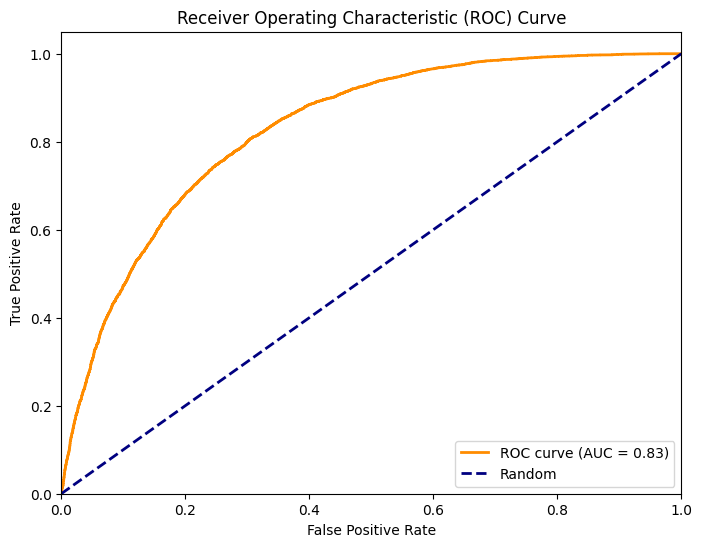

Accuracy: 0.7492750548129288
Sensitivity: 0.7970458741656015


In [ ]:
probs = xgb_rs.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Compute and print accuracy
accuracy = accuracy_score(y_test, preds)
print("Accuracy:", accuracy)
print("Sensitivity:",sensitivity)
